# Exploratory Data Analysis
---

In [1]:
import os
import duckdb

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

/tmp/ipykernel_95/4129410347.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")


### Missing Values

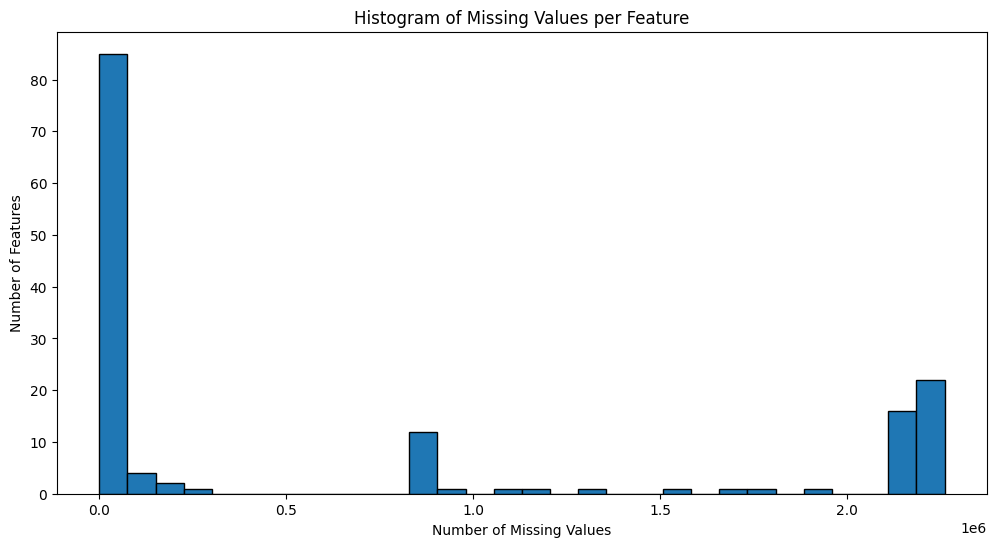

---

### Data Types

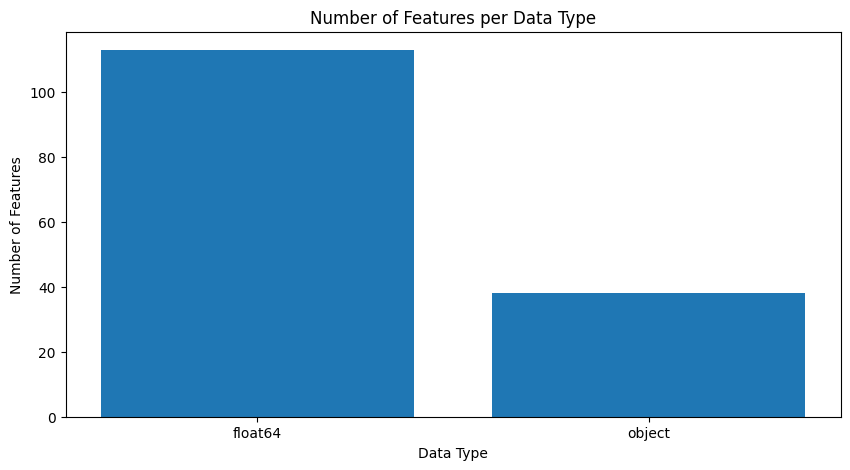

---

### Shape

(2260701, 151)

---

In [3]:
def Explore(df, show_missing=False ,show_dtypes=False, show_unique_count=False, show_shape=False):
    if show_missing:
        # Display count of all missing values in each column
        display(Markdown("### Missing Values"))
        
        # Sum of missing values in each column and convertion to a dataframe.
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0]

        # histogram
        plt.figure(figsize=(12, 6))
        plt.hist(missing_values.values, bins=30, edgecolor='black')  # adjust bins as needed
        plt.xlabel("Number of Missing Values")
        plt.ylabel("Number of Features")
        plt.title("Histogram of Missing Values per Feature")
        plt.show()
        display(Markdown("---"))    

    if show_dtypes:
        # Display data types
        display(Markdown("### Data Types"))

        # Identify data types
        data_types = df.dtypes
        
        # Count number of features per dtype
        dtype_counts = data_types.value_counts()

        # Barchart
        plt.figure(figsize=(10, 5))
        plt.bar(dtype_counts.index.astype(str), dtype_counts.values)
        plt.xlabel("Data Type")
        plt.ylabel("Number of Features")
        plt.title("Number of Features per Data Type")
        plt.show()        
        display(Markdown("---"))    

    if show_unique_count:
        # Display section header
        display(Markdown("### Number of Unique Values (Object Columns Only)"))
        
        # 1. Select only object columns
        object_cols = df.select_dtypes(include='object').columns
        
        # 2. Compute unique value counts for each object column
        unique_counts = df[object_cols].nunique()

        # 3. Plot a bar chart
        plt.figure(figsize=(12, 6))
        plt.bar(unique_counts.index, unique_counts.values)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Object Columns")
        plt.ylabel("Number of Unique Values")
        plt.title("Unique Value Counts per Object Column")
        plt.tight_layout()
        plt.show()        
        display(Markdown("---"))        

    if show_shape:
        display(Markdown("### Shape"))
        display(df.shape)
        display(Markdown("---"))

Explore(credit_df, show_missing=True ,show_dtypes=True, show_unique_count=False, show_shape=True)

### **Ideal Columns For Credit Risk Modelling in Real Time**
#### **Credit Risk Fundamentals**
- fico_range_low
- fico_range_high
- dti
- revol_util
- annual_inc
#### **Delinquency History** 
- delinq_2yrs
- pub_rec_bankruptcies
- inq_last_6mths
#### Loan Characteristics 
- loan_amnt
- int_rate
- term
#### Credit Profile 
- total_acc
- open_acc
- credit_age_month (engineered from earliest_cr_line)
#### Categorical 
- home_ownership
- purpose
- emp_length
- addr_state
- verification_status
#### Label
- loan_status


### **Insights From Analyzing Credit Data and How Credit Operates**
- Most of the other columns are generated behind the scenes by sending API calls to Credit Bureaus, which are companies that collect finanancial data on individuals and businesses in terms of loans, credit cards, payment hinstory, defaults, bankruptcies etc. e.g. TransUnion, Experian and Equifax.
- To create a real time system using streamlit I'll only be using relevant features that are applicable in real time such the detailed above.

### Missing Values

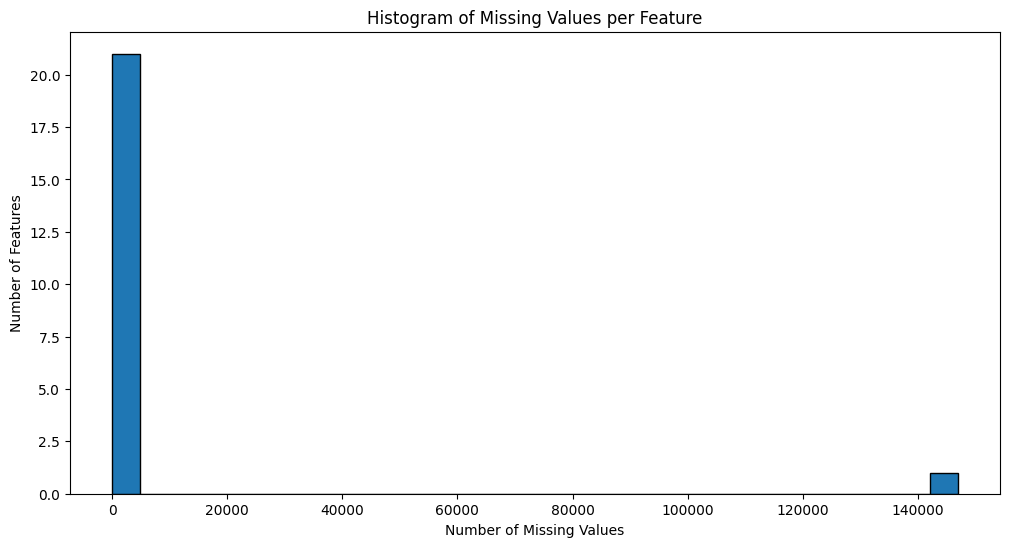

---

### Data Types

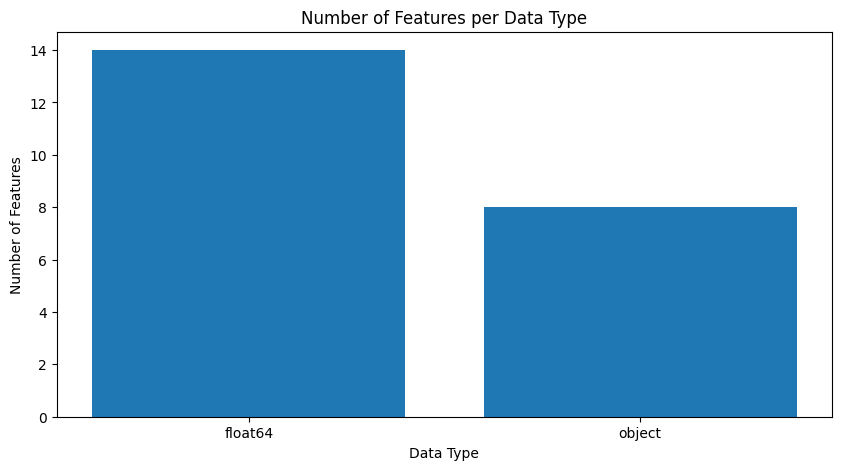

---

### Number of Unique Values (Object Columns Only)

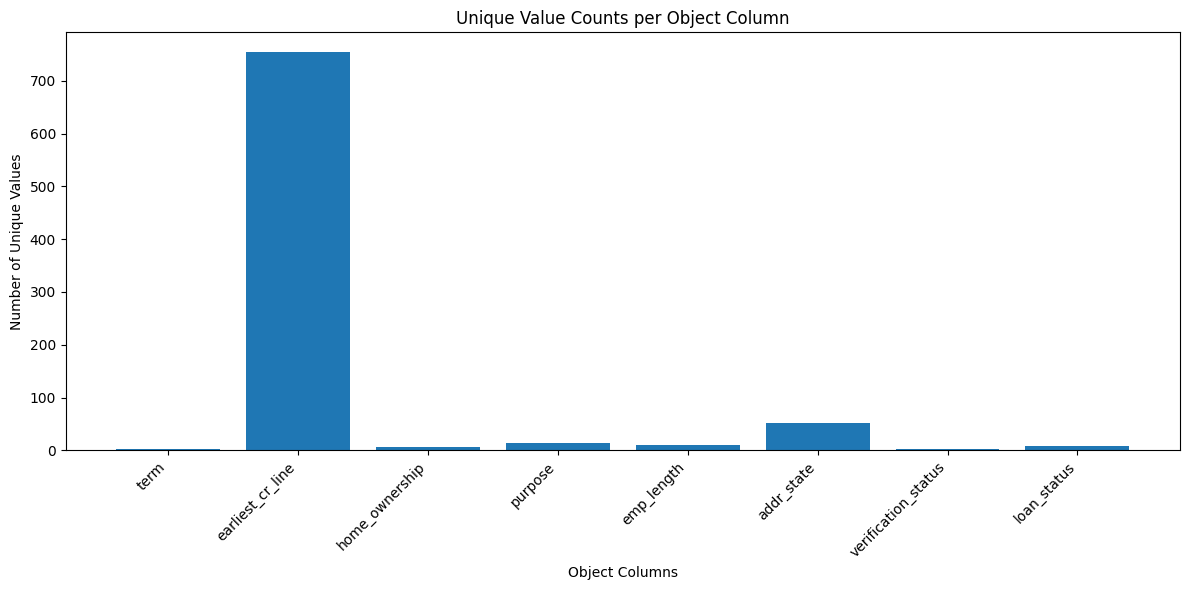

---

### Shape

(2260701, 22)

---

In [4]:
# Filter to only have relevant columns for further modelling
cols = ['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util', 'annual_inc', 'delinq_2yrs', 'pub_rec', 
        'pub_rec_bankruptcies', 'inq_last_6mths', 'loan_amnt', 'term', 'total_acc', 'open_acc', 'earliest_cr_line', 
        'home_ownership', 'purpose', 'emp_length', 'addr_state', 'verification_status', 'collections_12_mths_ex_med', 'loan_status']

relevant_credit_df = credit_df[cols]
Explore(relevant_credit_df, show_missing=True ,show_dtypes=True, show_unique_count=True, show_shape=True)

# Feature Engineering
---
### Row-Level Transformations Only

In [5]:
# Make a deep copy of relevant_credit_df
relevant_credit_df = relevant_credit_df.copy()

# Convert earliest_cr_line to datetime
relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
    relevant_credit_df['earliest_cr_line'])

# Get today's timestamp and calculate credit history in years
today = pd.Timestamp.today()
relevant_credit_df['credit_history_years'] = (
    (today - relevant_credit_df['earliest_cr_line']).dt.days / 365
)

# Income to loan ratio
relevant_credit_df['income_to_loan_ratio'] = relevant_credit_df['annual_inc'] / relevant_credit_df['loan_amnt']

# Fico score
relevant_credit_df['fico_score'] = (relevant_credit_df['fico_range_low'] + relevant_credit_df['fico_range_high']) /2

# Account utilization
relevant_credit_df['account_utilization'] = relevant_credit_df['open_acc'] / relevant_credit_df['total_acc']

# Avg credit per account
relevant_credit_df['avg_credit_per_account'] = np.where(
    relevant_credit_df['open_acc'] > 0,
    relevant_credit_df['revol_bal'] / relevant_credit_df['open_acc'],
    0
)

# Deliquency rate
relevant_credit_df['deliquency_rate'] = np.where(
    relevant_credit_df['total_acc'] > 0,
    relevant_credit_df['delinq_2yrs'] / relevant_credit_df['total_acc'],
    0
)

# Drop irrelavent features after engineering
relevant_credit_df.drop(columns='earliest_cr_line')

# Display engineered features
# relevant_credit_df[['credit_history_years', 'income_to_loan_ratio', 'fico_score', 'account_utilization', 'revol_bal','total_acc','open_acc', 'delinq_2yrs', 'deliquency_rate','avg_credit_per_account']].query("deliquency_rate > 0.4")

/tmp/ipykernel_95/1148206564.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_v

fico_range_low  fico_range_high    dti  revol_bal  revol_util  \
0                 675.0            679.0   5.91     2765.0        29.7   
1                 715.0            719.0  16.06    21470.0        19.2   
2                 695.0            699.0  10.78     7869.0        56.2   
3                 785.0            789.0  17.06     7802.0        11.6   
4                 695.0            699.0  25.37    21929.0        64.5   
...                 ...              ...    ...        ...         ...   
2260696           705.0            709.0  12.75     8633.0        64.9   
2260697           660.0            664.0  18.30    17641.0        68.1   
2260698           660.0            664.0  23.36     7662.0        54.0   
2260699             NaN              NaN    NaN        NaN         NaN   
2260700             NaN              NaN    NaN        NaN         NaN   

         annual_inc  delinq_2yrs  pub_rec  pub_rec_bankruptcies  \
0           55000.0          0.0      0.0                   0.0   
1           65000.0          1.0      0.0                   0.0   
2           63000.0          0.0      0.0                   0.0   
3          110000.0          0.0      0.0                   0.0   
4          104433.0          1.0      0.0                   0.0   
...             ...          ...      ...                   ...   
2260696    227000.0          7.0      0.0                   0.0   
2260697    110000.0          0.0      1.0                   1.0   
2260698     95000.0          0.0      0.0                   0.0   
2260699         NaN          NaN      NaN                   NaN   
2260700         NaN          NaN      NaN                   NaN   

         inq_last_6mths  ...  addr_state verification_status  \
0                   1.0  ...          PA        Not Verified   
1                   4.0  ...          SD        Not Verified   
2                   0.0  ...          IL        Not Verified   
3                   0.0  ...          NJ     Source Verified   
4                   3.0  ...          PA     Source Verified   
...                 ...  ...         ...                 ...   
2260696             1.0  ...          CA            Verified   
2260697             0.0  ...          FL        Not Verified   
2260698             1.0  ...          TX            Verified   
2260699             NaN  ...         NaN                 NaN   
2260700             NaN  ...         NaN                 NaN   

         collections_12_mths_ex_med  loan_status credit_history_years  \
0                               0.0   Fully Paid            22.383562   
1                               0.0   Fully Paid            26.052055   
2                               0.0   Fully Paid            25.383562   
3                               0.0      Current            17.293151   
4                               0.0   Fully Paid            27.553425   
...                             ...          ...                  ...   
2260696                         0.0      Current            30.884932   
2260697                         0.0  Charged Off            26.471233   
2260698                         0.0      Current            29.553425   
2260699                         NaN          NaN                  NaN   
2260700                         NaN          NaN                  NaN   

        income_to_loan_ratio fico_score account_utilization  \
0                  15.277778      677.0            0.538462   
1                   2.631579      717.0            0.578947   
2                   3.150000      697.0            0.333333   
3                   3.142857      787.0            0.764706   
4                  10.041635      697.0            0.342857   
...                      ...        ...                 ...   
2260696             5.675000      707.0            0.135135   
2260697             4.583333      662.0            0.322581   
2260698             6.785714      662.0            0.363636   
2260699                  NaN        NaN

### Target Encoding

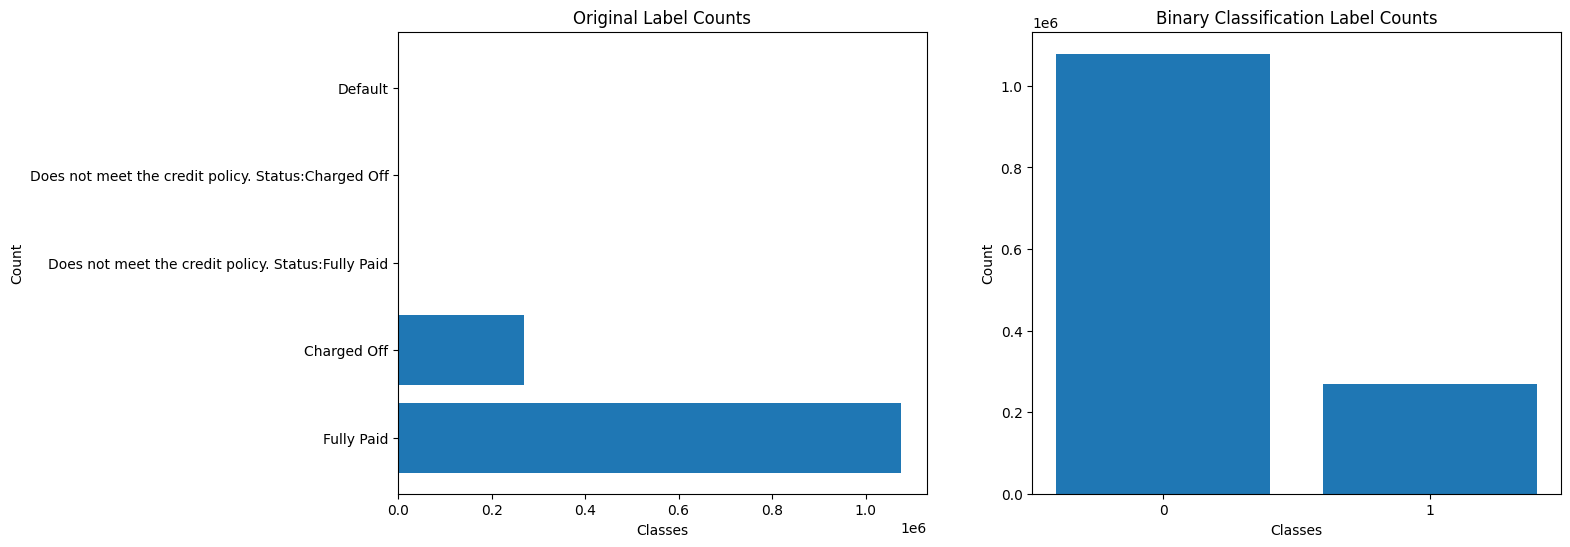

In [6]:
# Example: your loan status series
loan_status = pd.Series([
    'Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)',
    'In Grace Period', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off',
    'Default'
])

# Mapping to binary target
default_mapping = {
    'Charged Off': 1,
    'Default': 1,
    # 'Late (31-120 days)': 1,
    # 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0
    # 'Current': 0,              # include cautiously
    # 'In Grace Period': 0       # treat cautiously
}

# Defein the statuses to keep
statuses_to_keep = list(default_mapping.keys())

# Filter dataframe
relevant_credit_df = relevant_credit_df[relevant_credit_df['loan_status'].isin(statuses_to_keep)]

# Map the remaining statuses to 0 = paid and 1 = default
relevant_credit_df.loc[:, 'loan_status_binary'] = relevant_credit_df['loan_status'].map(default_mapping)


# plot a count based bar plot to identify class imbalance
loan_status_count         = relevant_credit_df['loan_status'].value_counts()
loan_status_binanry_count = relevant_credit_df['loan_status_binary'].value_counts()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].barh(loan_status_count.index.astype(str), loan_status_count.values)
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Count')
ax[0].set_title('Original Label Counts')

ax[1].bar(loan_status_binanry_count.index.astype(str), loan_status_binanry_count.values)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Count')
ax[1].set_title('Binary Classification Label Counts')

plt.show()


# Removing Data Quality Issues (Before Split)
---

In [7]:
# Assess how many rows are missing values across the selected 20 columns
# Count missing values accross columns, filter out those with no missing values and sort in descending order
null_count_per_row = relevant_credit_df.isnull().sum(axis=1)
null_count_per_row = null_count_per_row[null_count_per_row > 0]
null_count_per_row = null_count_per_row.sort_values(ascending=False)
display(null_count_per_row.value_counts())

1     80205
2       514
11       25
13        4
3         4
Name: count, dtype: int64

### Missing Values

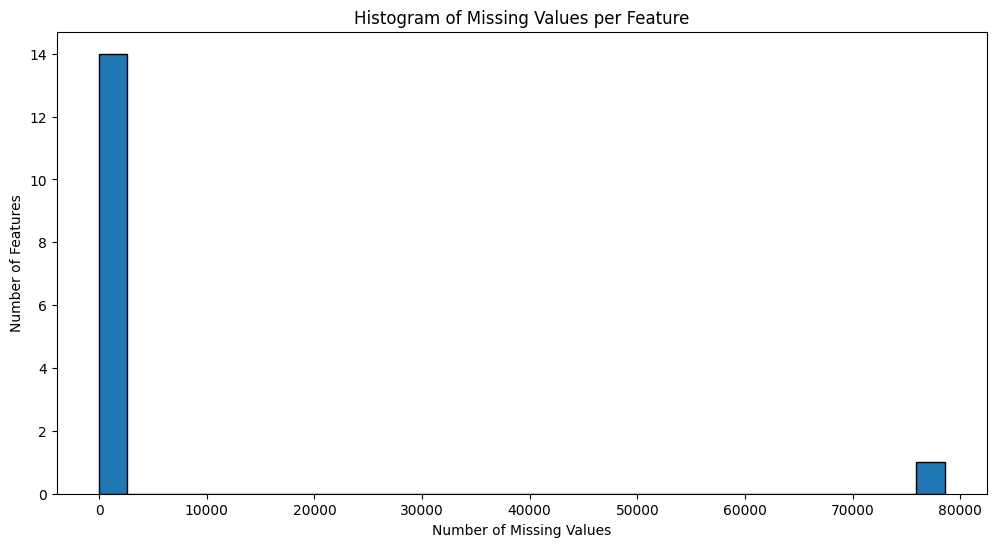

---

### Number of Unique Values (Object Columns Only)

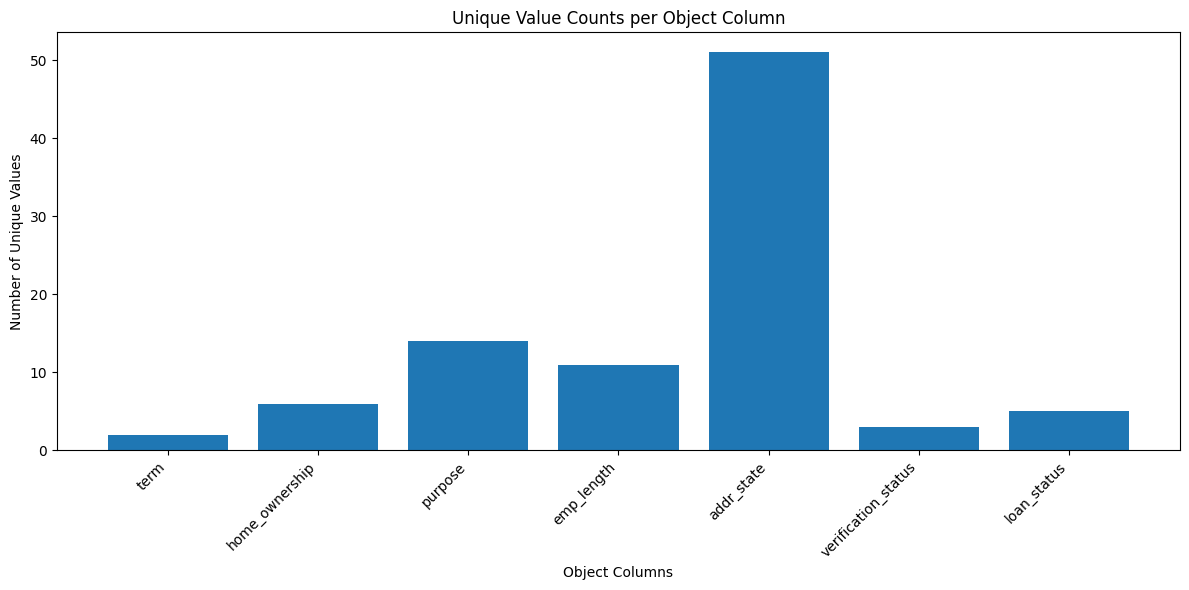

---

In [8]:
# Drop all rows with 20 missing values, essentially corrupt rows with no useable data
relevant_credit_df = relevant_credit_df.dropna(how='all')

# Re-examine data
Explore(relevant_credit_df, show_missing=True ,show_dtypes=False, show_unique_count=True, show_shape=False)

# Train-Test Split 
---

In [9]:
from sklearn.model_selection import train_test_split, KFold

In [10]:
X = relevant_credit_df.drop(columns=['loan_status', 'loan_status_binary'])
y = relevant_credit_df['loan_status_binary']

print(X.shape)
print(y.shape)

(1348099, 27)
(1348099,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (1078479, 27)
y train shape: (1078479,)
X test shape: (269620, 27)
y test shape: (269620,)


# Imputation and Encoding (After Data Splitting)
---

In [12]:
# !pip install imblearn

In [13]:
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

In [14]:
def create_preprocessor(X_train):
    """
    Create and fit a preprocessing pipeline for numeric and categorical features.
    
    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
        
    Returns
    -------
    preprocessor : ColumnTransformer
        Fitted preprocessor for transforming train, validation, or test data.
    """
    # Separate numeric and categorical columns
    numerical_cols = X_train.select_dtypes(include='number').columns
    categorical_cols = X_train.select_dtypes(include='object').columns
    
    print(f"Numeric Columns: {numerical_cols}")
    print(f"Categorical Columns: {categorical_cols}")
    
    # Create imputers
    numeric_imputer = SimpleImputer(strategy="median")
    categorical_imputer = SimpleImputer(strategy="most_frequent")
    
    # Numerical pipeline
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputer),
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline
    categorical_pipeline = Pipeline([
        ('imputer', categorical_imputer),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])
    
    # Fit preprocessor on training data
    preprocessor.fit(X_train)
    
    return preprocessor

preprocessor = create_preprocessor(X_train)

Numeric Columns: Index(['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util',
       'annual_inc', 'delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies',
       'inq_last_6mths', 'loan_amnt', 'total_acc', 'open_acc',
       'collections_12_mths_ex_med', 'credit_history_years',
       'income_to_loan_ratio', 'fico_score', 'account_utilization',
       'avg_credit_per_account', 'deliquency_rate'],
      dtype='object')
Categorical Columns: Index(['term', 'home_ownership', 'purpose', 'emp_length', 'addr_state',
       'verification_status'],
      dtype='object')


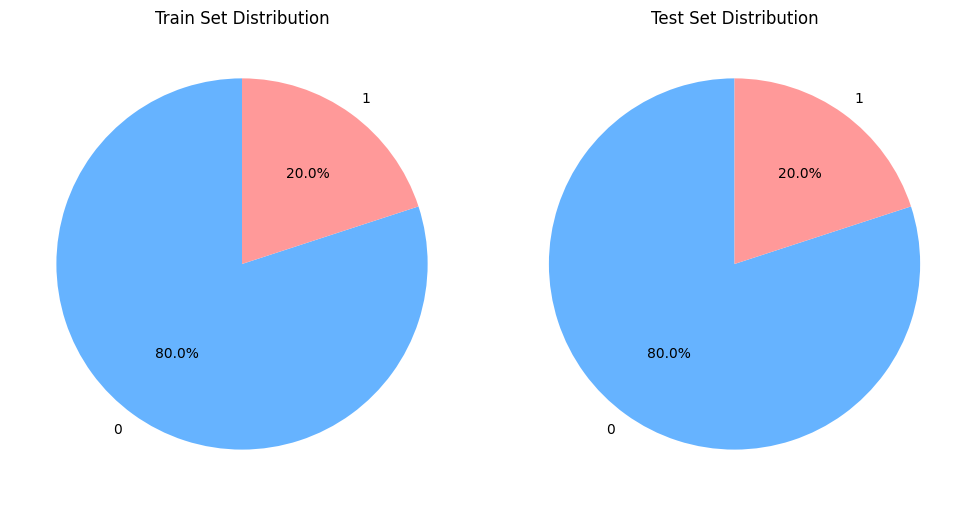

y train:  loan_status_binary
0    862991
1    215488
Name: count, dtype: int64

y test:  loan_status_binary
0    215748
1     53872
Name: count, dtype: int64


In [15]:
# Fit only on training data
preprocessor.fit(X_train)

# transform on all data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# After preproces.fit() and transform, extract feature names
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Class distributions
y_train_counts = y_train.value_counts()
y_test_counts  = y_test.value_counts()

# Define labels
labels = y_train_counts.index.astype(str)  # assuming classes are 0,1 etc.

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for training set
axes[0].pie(y_train_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[0].set_title("Train Set Distribution")

# Pie chart for test set
axes[1].pie(y_test_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[1].set_title("Test Set Distribution")

plt.tight_layout()
plt.show()

print("y train: ", y_train.value_counts())
print("\ny test: ", y_test.value_counts())

Correcting class imbalance using SMOTE
SMOTE took: 3.33 minutes

AFTER SMOTE:
y train resampled:  loan_status_binary
1    862991
0    862991
Name: count, dtype: int64


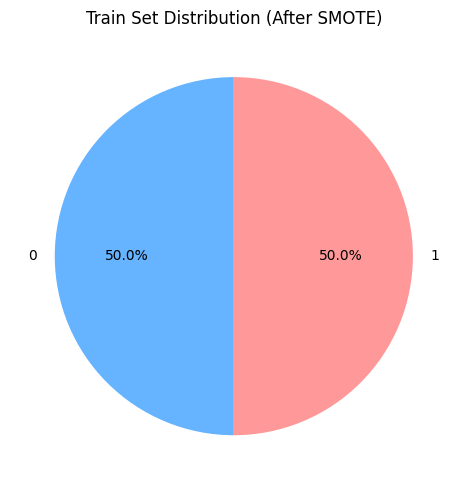

In [16]:
# ==================== SMOTE ====================
# Pure SMOTE
smote = SMOTE(random_state=42)
print("Correcting class imbalance using SMOTE")
smote_start_time = time.time()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
smote_end_time = time.time() - smote_start_time
print(f"SMOTE took: {(smote_end_time/60):.2f} minutes")

# Convert back to DataFrame for consistency
X_train_df_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)
y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)

print("\nAFTER SMOTE:")
print("y train resampled: ", y_train_resampled.value_counts())

# Visualize AFTER SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
y_train_resampled_counts = y_train_resampled.value_counts()
ax.pie(y_train_resampled_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
ax.set_title("Train Set Distribution (After SMOTE)")
plt.tight_layout()
plt.show()


# Explore Models
---

In [17]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.utils import class_weight

import shap

2025-12-13 13:56:38.196201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765634198.390968      95 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765634198.448554      95 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [18]:
def plot_shap_importance(model, X_train_preprocessed, model_name, feature_names=None):
    print(f"\nGenerating SHAP explanations for {model_name}...")
    
    # -------------------------------
    # 1. Convert to numpy array if DataFrame
    # -------------------------------
    if hasattr(X_train_preprocessed, 'values'):
        X_array = X_train_preprocessed.values
        if feature_names is None:
            feature_names = X_train_preprocessed.columns
    else:
        X_array = X_train_preprocessed
    
    # -------------------------------
    # 2. Clean feature names
    # -------------------------------
    if feature_names is not None:
        clean_feature_names = [str(f).replace('[','_').replace(']','').replace('<','_').replace('>','_') 
                               for f in feature_names]
    else:
        clean_feature_names = None
    
    # -------------------------------
    # 3. Sample data to speed up plotting
    # -------------------------------
    max_samples = 10000
    n_rows = X_array.shape[0]
    if n_rows > max_samples:
        idx = np.random.choice(n_rows, max_samples, replace=False)
        X_sample = X_array[idx]
    else:
        X_sample = X_array
    
    # -------------------------------
    # 4. Create SHAP explainer
    # -------------------------------
    if "logistic regression" in model_name.lower():
        explainer = shap.LinearExplainer(model, X_sample)
    elif "neural" in model_name.lower() or "nn" in model_name.lower():
        explainer = shap.Explainer(model, X_sample)
    else:
        explainer = shap.TreeExplainer(model)
    
    # -------------------------------
    # 5. Compute SHAP values
    # -------------------------------
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, handle output format
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # -------------------------------
    # 6. Plot SHAP summary plots - SEPARATE FIGURES
    # -------------------------------
    
    # Bar plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      plot_type="bar", 
                      show=False)
    plt.title(f"SHAP Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()
    
    # Dot plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      show=False)
    plt.title(f"SHAP Summary Plot - {model_name}")
    plt.tight_layout()
    plt.show()
    
    return shap_values

In [19]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a Keras or scikit-learn binary classification model.
    
    Args:
        model : trained Keras model or sklearn classifier
        X_test : numpy array or pandas DataFrame of test features
        y_test : true labels for the test set
    Returns:
        dict of key metrics (best_threshold, best_f1, accuracy, roc_auc)
    """
    # Predict probabilities
    if isinstance(model, tf.keras.Model):  # Keras Functional or Sequential model
        y_pred_proba = model.predict(X_test).flatten()
    else:  # Assume scikit-learn classifier
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall and F1
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    print(f"Best threshold: {best_threshold:.3f}, Best F1-score: {best_f1:.3f}")
    
    # Apply threshold for binary predictions
    y_pred_opt = (y_pred_proba >= best_threshold).astype(int)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred_opt)
    print(f"Accuracy: {acc:.2f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_opt))
    
    # ROC-AUC
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_opt)
    
    # ================== Plots ==================
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    
    # Confusion matrix heatmap
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Predicted Paid', 'Predicted Default'],
                yticklabels=['Actual Paid', 'Actual Default'])
    ax[0].set_title('Test Set Confusion Matrix')
    ax[0].set_ylabel('True Label')
    ax[0].set_xlabel('Predicted Label')
    
    # ROC curve
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
    ax[1].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_roc_auc:.4f})', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='lower right')
    ax[1].grid(alpha=0.3)
    
    # Precision-Recall curve
    ax[2].plot(recall, precision, label='PR Curve')
    ax[2].scatter(recall[best_idx], precision[best_idx], color='red', 
                  label=f'Best threshold={best_threshold:.3f}')
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].set_title("Precision-Recall Curve")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    return {
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "accuracy": acc,
        "roc_auc": test_roc_auc
    }
    

Training LGBM Classifier
[LightGBM] [Info] Number of positive: 862991, number of negative: 862991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23722
[LightGBM] [Info] Number of data points in the train set: 1725982, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Classifier took 0.35 minutes or 20.70 seconds



X does not have valid feature names, but LGBMClassifier was fitted with feature names


Best threshold: 0.231, Best F1-score: 0.414
Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    215748
           1       0.31      0.63      0.41     53872

    accuracy                           0.64    269620
   macro avg       0.59      0.64      0.58    269620
weighted avg       0.76      0.64      0.68    269620



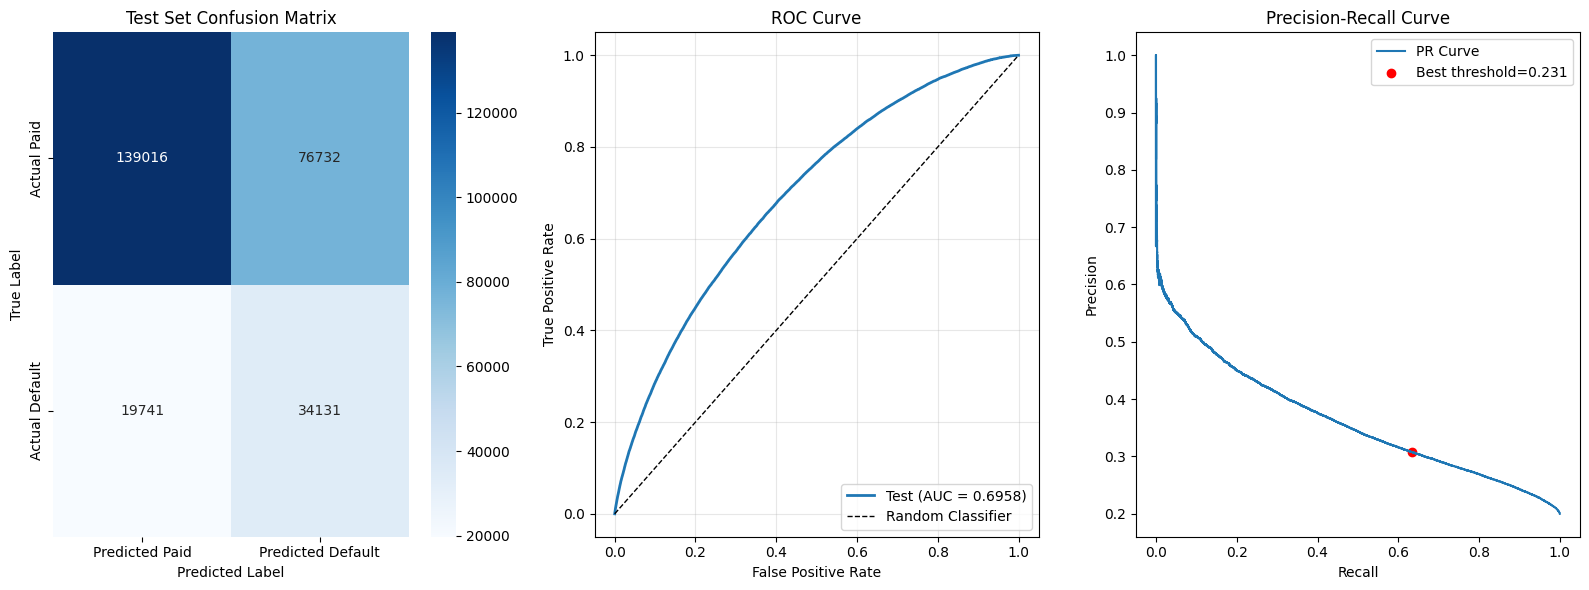


Generating SHAP explanations for LGBM Classifier...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


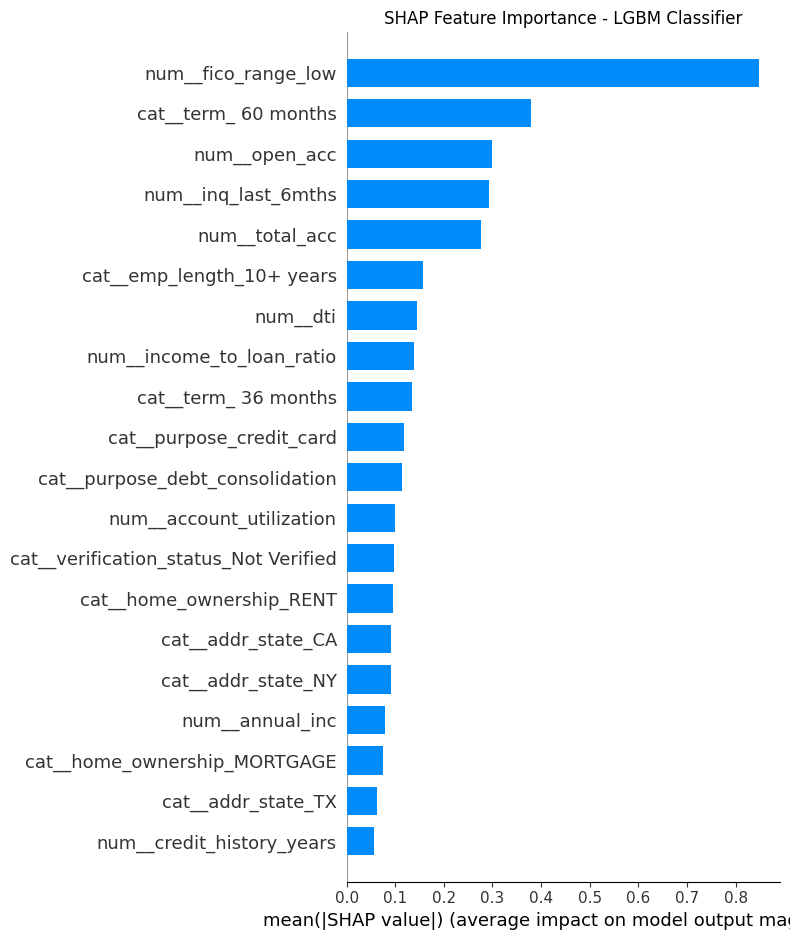

The figure layout has changed to tight


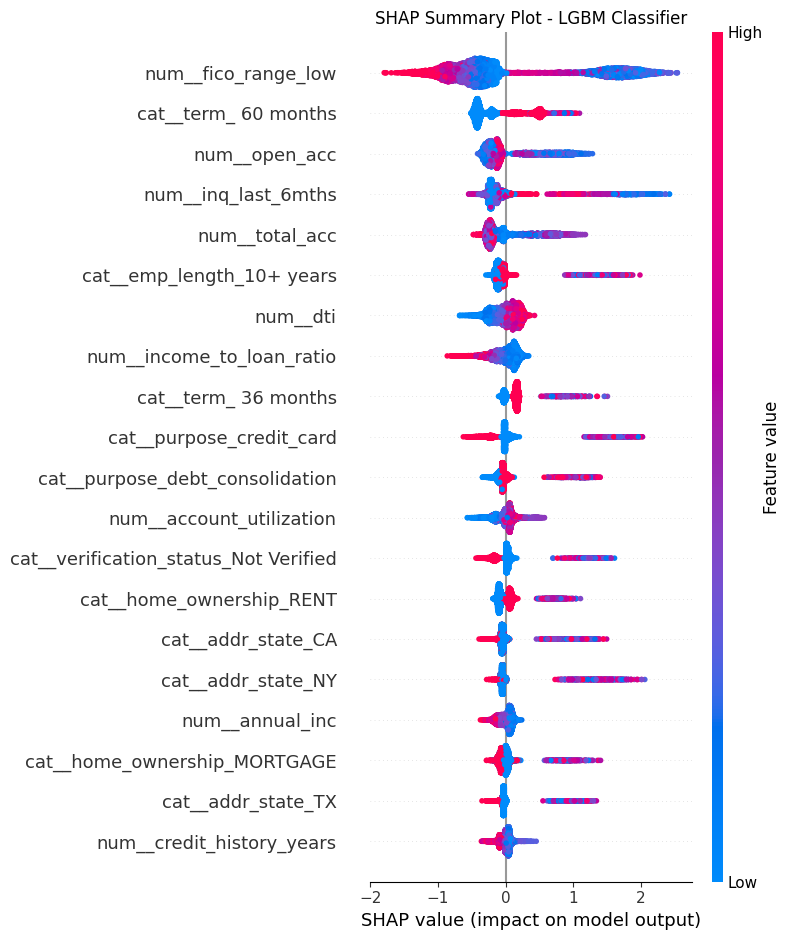

Shap analysis for LGBM Classifier took 0.10 minutes or 6.03 seconds
Training Cat Boost Classifier
Cat Boost Classifier took 1.57 minutes or 94.31 seconds

Best threshold: 0.242, Best F1-score: 0.414
Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.66      0.75    215748
           1       0.31      0.61      0.41     53872

    accuracy                           0.65    269620
   macro avg       0.59      0.64      0.58    269620
weighted avg       0.76      0.65      0.69    269620



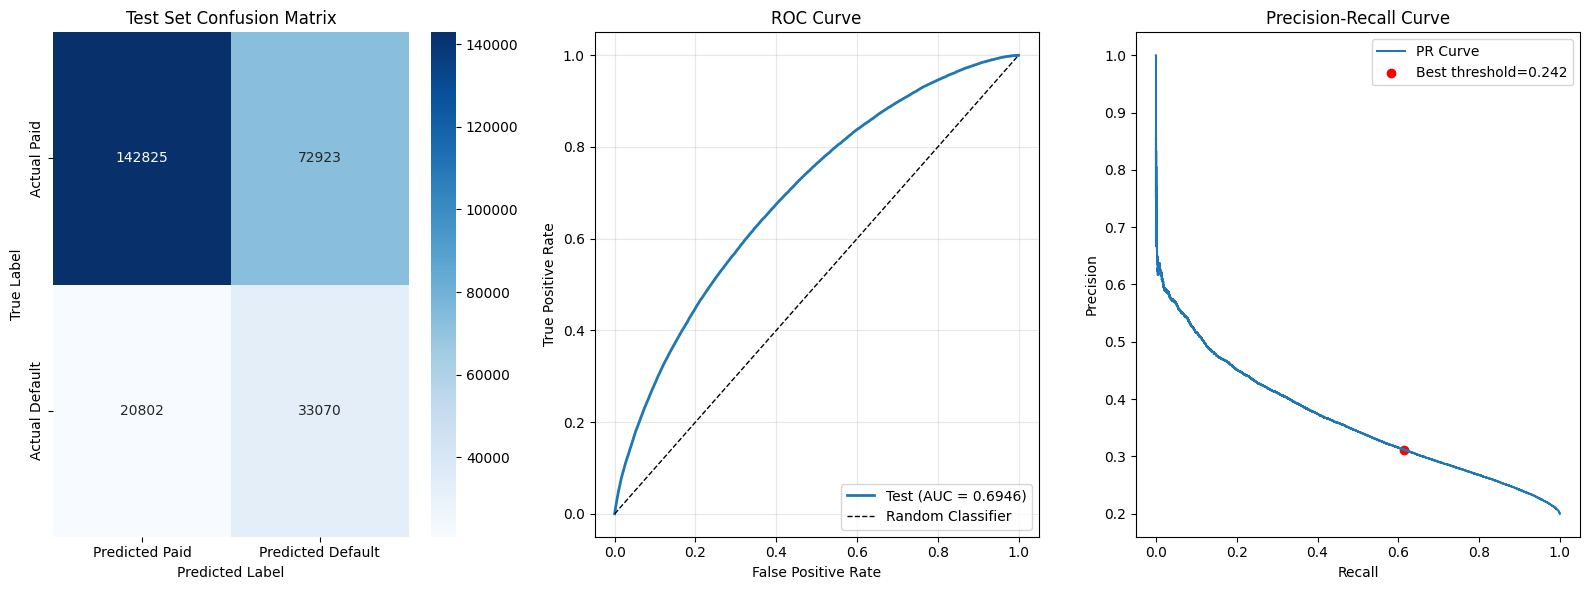


Generating SHAP explanations for Cat Boost Classifier...


The figure layout has changed to tight


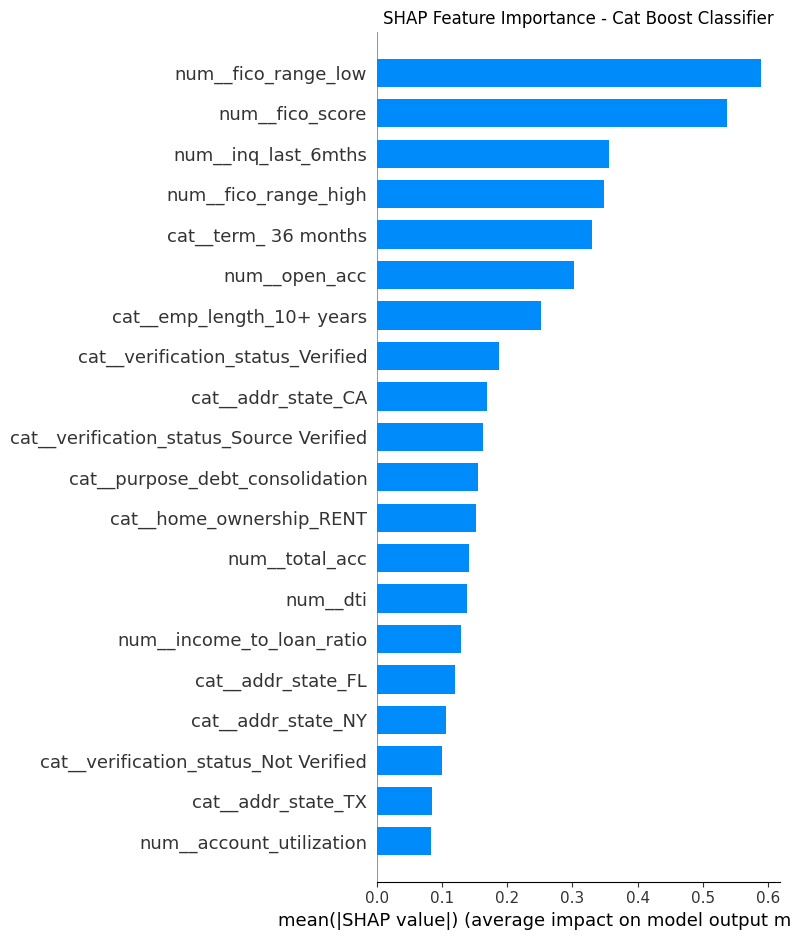

The figure layout has changed to tight


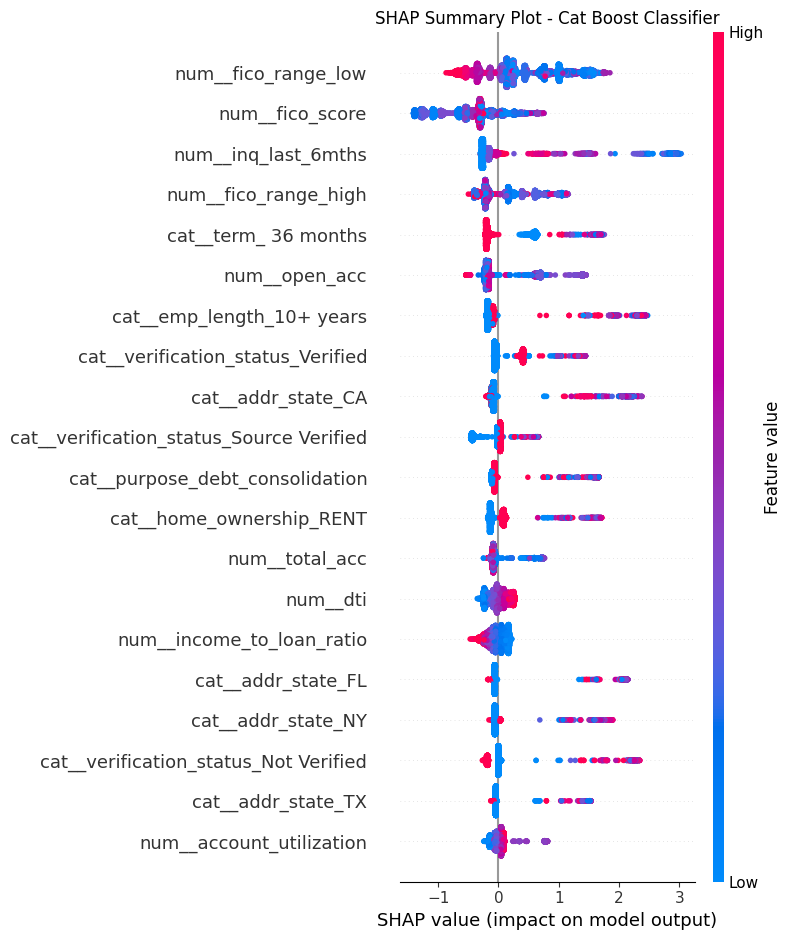

Shap analysis for Cat Boost Classifier took 0.05 minutes or 2.93 seconds


In [20]:
models = {
    # 'Logistic Regression' : LogisticRegression(
    #                             max_iter=1000, 
    #                             random_state=42),
    # 'XGB Classifier' : xgb.XGBClassifier(
    #                     n_estimators=100,
    #                     learning_rate=0.1,
    #                     max_depth=6,
    #                     random_state=42,
    #                     use_label_encoder=False,
    #                     eval_metric='logloss'),
    'LGBM Classifier' : lgb.LGBMClassifier(
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=-1,
                        random_state=42),
    'Cat Boost Classifier' : CatBoostClassifier(
                                iterations=100,
                                learning_rate=0.1,
                                depth=6,
                                random_seed=42,
                                verbose=0)  
    # 'Random Forest Classifier' : RandomForestClassifier(
    #                                 n_estimators=100,
    #                                 max_depth=10,
    #                                 random_state=42,
    #                                 n_jobs=-1
    #                             )
}

# Save trained models
trained_models = {}

for model_name, model in models.items():
    print("=" * 60)
    print(f"Training {model_name}")
    print("=" * 60)

    # Train models and timing each individually.
    model_training_start = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    model_training_end = time.time() - model_training_start
    print(f"{model_name} took {(model_training_end/60):.2f} minutes or {model_training_end:.2f} seconds\n")

    # Store the trained model
    trained_models[model_name] = model

    model_metrics = evaluate_model(model, X_test_preprocessed, y_test)

    # ================== SHAP Feature Importance ==================
    try:
        model_shap_analysis_start = time.time()
        shap_values = plot_shap_importance(
            model=model,
            X_train_preprocessed=X_train_df_resampled,
            model_name=model_name,
            feature_names=X_train_df_resampled.columns 
        )
        model_shap_analysis_end = time.time() - model_shap_analysis_start
        print(f"Shap analysis for {model_name} took {(model_shap_analysis_end/60):.2f} minutes or {model_shap_analysis_end:.2f} seconds")
    except Exception as e:
        print(f"SHAP failed for {model_name}: {e}")

In [21]:
def create_meta_features(models, X_train, y_train, X_test, n_folds=5):
    """
    Create meta-features using out-of-fold predictions for training
    and full model predictions for test set.

    Parameters:
    ----------
    models : dict
        Dictionary of untrained base models
    X_train : array-like 
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    n_folds : int
        Number of folds for cross-validation

    Returns:
    --------
    meta-train : array
        Out-of-fold predictions for training (n_samples, n_models)
    meta-test : array
        Average predictions for test set (n_samples, n_models)
    """
    n_models = len(models)
    n_train  = X_train.shape[0]
    n_test   = X_test.shape[0]

    # Initialize arrays
    meta_train = np.zeros((n_train, n_models))
    meta_test  = np.zeros((n_test, n_models))

    # K-Fold cross-validation
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f"Processing {model_name}...")

        # Array to store test predictions for each fold
        test_preds_folds = np.zeros((n_test, n_folds))

        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
            # Split data
            X_fold_train = X_train[train_idx] 
            y_fold_train = y_train[train_idx]
            X_fold_val   = X_train[val_idx]

            # Clone and train model on fold
            from sklearn.base import clone
            fold_model = clone(model)
            print(f"Training fold {fold_idx+1}")
            fold_model.fit(X_fold_train, y_fold_train)

            # Out-of-fold predictions for meta_training
            meta_train[val_idx, model_idx] = fold_model.predict_proba(X_fold_val)[:,1]

            # Predictions on test set (to be averaged)
            test_preds_folds[:, fold_idx] = fold_model.predict_proba(X_test)[:,1]

        # Average test predictions across folds
        meta_test[:, model_idx] = test_preds_folds.mean(axis=1)

    return meta_train, meta_test


## Neural Network
---

In [22]:
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(X, y, test_size=0.3, random_state=41, stratify=y)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_temp_nn, y_temp_nn, test_size=0.5, random_state=41, stratify=y_temp_nn)

print(f"X train shape: {X_train_nn.shape}")
print(f"y train shape: {y_train_nn.shape}")
print(f"X val shape: {X_val_nn.shape}")
print(f"y val shape: {y_val_nn.shape}")
print(f"X test shape: {X_test_nn.shape}")
print(f"y test shape: {y_test_nn.shape}")

X train shape: (943669, 27)
y train shape: (943669,)
X val shape: (202215, 27)
y val shape: (202215,)
X test shape: (202215, 27)
y test shape: (202215,)


In [23]:
nn_preprocessor = create_preprocessor(X_train_nn)

Numeric Columns: Index(['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util',
       'annual_inc', 'delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies',
       'inq_last_6mths', 'loan_amnt', 'total_acc', 'open_acc',
       'collections_12_mths_ex_med', 'credit_history_years',
       'income_to_loan_ratio', 'fico_score', 'account_utilization',
       'avg_credit_per_account', 'deliquency_rate'],
      dtype='object')
Categorical Columns: Index(['term', 'home_ownership', 'purpose', 'emp_length', 'addr_state',
       'verification_status'],
      dtype='object')


In [24]:
# transform on all data
X_train_preprocessed_nn = nn_preprocessor.transform(X_train_nn)
X_val_preprocessed_nn = nn_preprocessor.transform(X_val_nn)
X_test_preprocessed_nn = nn_preprocessor.transform(X_test_nn)

# Convert to float32 for faster training
X_train_preprocessed_nn = X_train_preprocessed_nn.astype("float32")
X_val_preprocessed_nn   = X_val_preprocessed_nn.astype("float32")
X_test_preprocessed_nn  = X_test_preprocessed_nn.astype("float32")

# Reshape labels for consistency
y_train_nn = y_train_nn.values.reshape(-1, 1)
y_val_nn   = y_val_nn.values.reshape(-1, 1)
y_test_nn  = y_test_nn.values.reshape(-1, 1)

print(f"X train preprocessed shape: {X_train_preprocessed_nn.shape}")
print(f"X val preprocessed shape: {X_val_preprocessed_nn.shape}")
print(f"X test preprocessed shape: {X_test_preprocessed_nn.shape}")

print(f"y train shape: {y_train_nn.shape}")
print(f"y val shape: {y_val_nn.shape}")
print(f"y test shape: {y_test_nn.shape}")

nn_feature_names = nn_preprocessor.get_feature_names_out()

X train preprocessed shape: (943669, 107)
X val preprocessed shape: (202215, 107)
X test preprocessed shape: (202215, 107)
y train shape: (943669, 1)
y val shape: (202215, 1)
y test shape: (202215, 1)


In [25]:
def create_nn_model(input_dim):
    inputs  = tf.keras.Input(shape=(input_dim,), name="model_input")
    x       = layers.Dense(64, activation="relu", name="dense_64")(inputs)
    x       = layers.Dense(32, activation="relu", name="dense_32")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="default_probability")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lending_club_nn")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[metrics.AUC(name="auc")]
    )
    return model

In [26]:
# -------------------------------
# 1. Source number of features
# -------------------------------
input_dim = X_train_preprocessed_nn.shape[1]

# -------------------------------
# 2. Create the model using the function
# -------------------------------
model = create_nn_model(input_dim)

# -------------------------------
# 3. Early stopping callback - monitor validation AUC
# -------------------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,  # Increased from 3
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# 4. Learning rate scheduler
# -------------------------------
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# -------------------------------
# 5. Calculate class weights automatically
# -------------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_nn),
    y=y_train_nn.ravel()
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# -------------------------------
# 6. Fit the model
# -------------------------------
history = model.fit(
    X_train_preprocessed_nn, y_train_nn,
    validation_data=(X_val_preprocessed_nn, y_val_nn),
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

I0000 00:00:1765634373.248197      95 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765634373.248844      95 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Class weights: {0: 0.6248495266296481, 1: 2.502410475624761}
Epoch 1/50


I0000 00:00:1765634377.497111     166 service.cc:148] XLA service 0x78b410006050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765634377.497845     166 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765634377.497864     166 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765634377.764843     166 cuda_dnn.cc:529] Loaded cuDNN version 90300


  70/3687 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.4669 - loss: 0.6942  

I0000 00:00:1765634378.781592     166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3687/3687 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - auc: 0.5471 - loss: 0.6886 - val_auc: 0.6465 - val_loss: 0.6671 - learning_rate: 1.0000e-05
Epoch 2/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6584 - loss: 0.6545 - val_auc: 0.6755 - val_loss: 0.6457 - learning_rate: 1.0000e-05
Epoch 3/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6816 - loss: 0.6411 - val_auc: 0.6853 - val_loss: 0.6388 - learning_rate: 1.0000e-05
Epoch 4/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6877 - loss: 0.6371 - val_auc: 0.6893 - val_loss: 0.6369 - learning_rate: 1.0000e-05
Epoch 5/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6938 - loss: 0.6328 - val_auc: 0.6916 - val_loss: 0.6364 - learning_rate: 1.0000e-05
Epoch 6/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6945 - loss: 0.6330 - val_auc: 0.6930 - val_loss: 0.6336 - learning_rate: 1.0000e-05
Epoch 7/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6954 - loss: 0.6316 - val_auc: 0.6941 - val_loss: 0.6

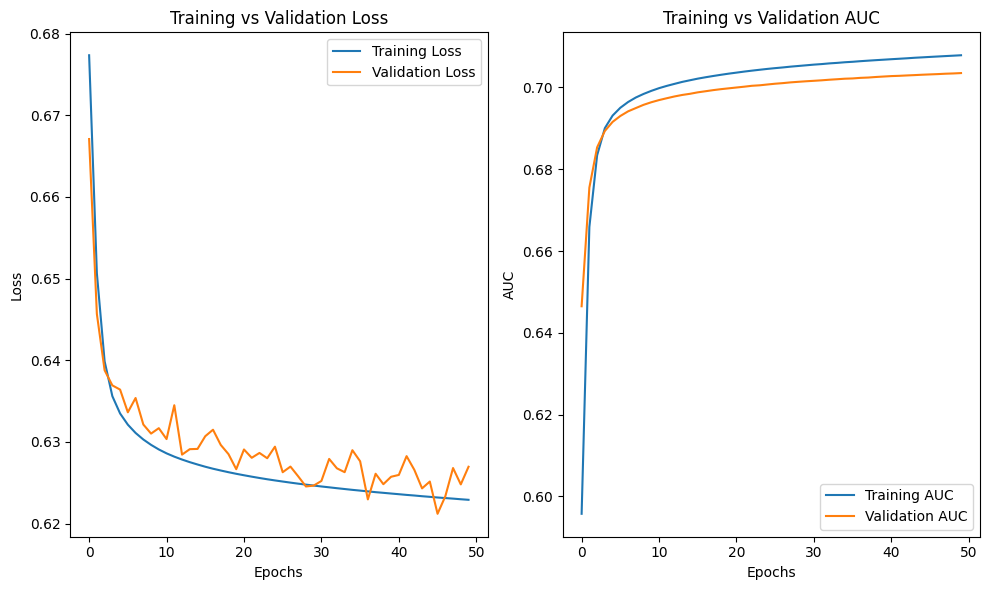

6320/6320 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Best threshold: 0.526, Best F1-score: 0.424
Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77    161811
           1       0.33      0.61      0.42     40404

    accuracy                           0.67    202215
   macro avg       0.60      0.65      0.60    202215
weighted avg       0.77      0.67      0.70    202215



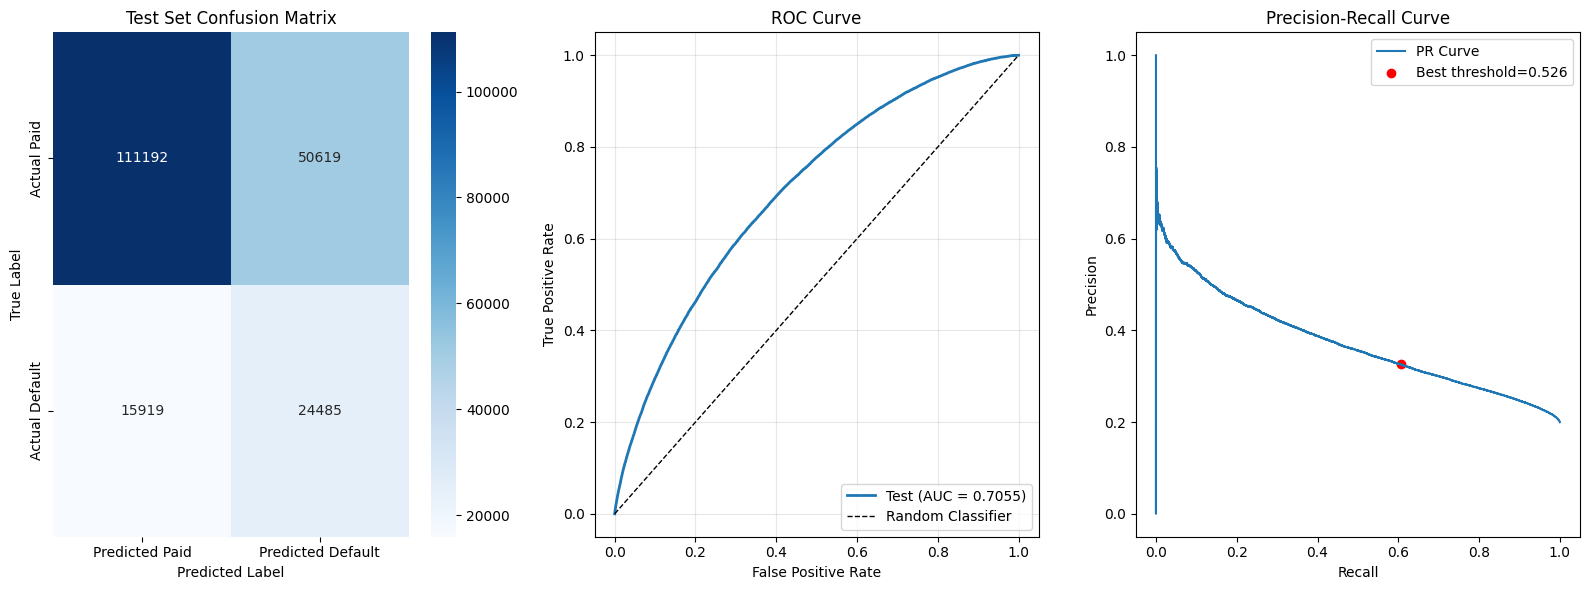


Generating SHAP explanations for Neural Network...


PermutationExplainer explainer: 10001it [10:52, 15.18it/s]                           
The figure layout has changed to tight


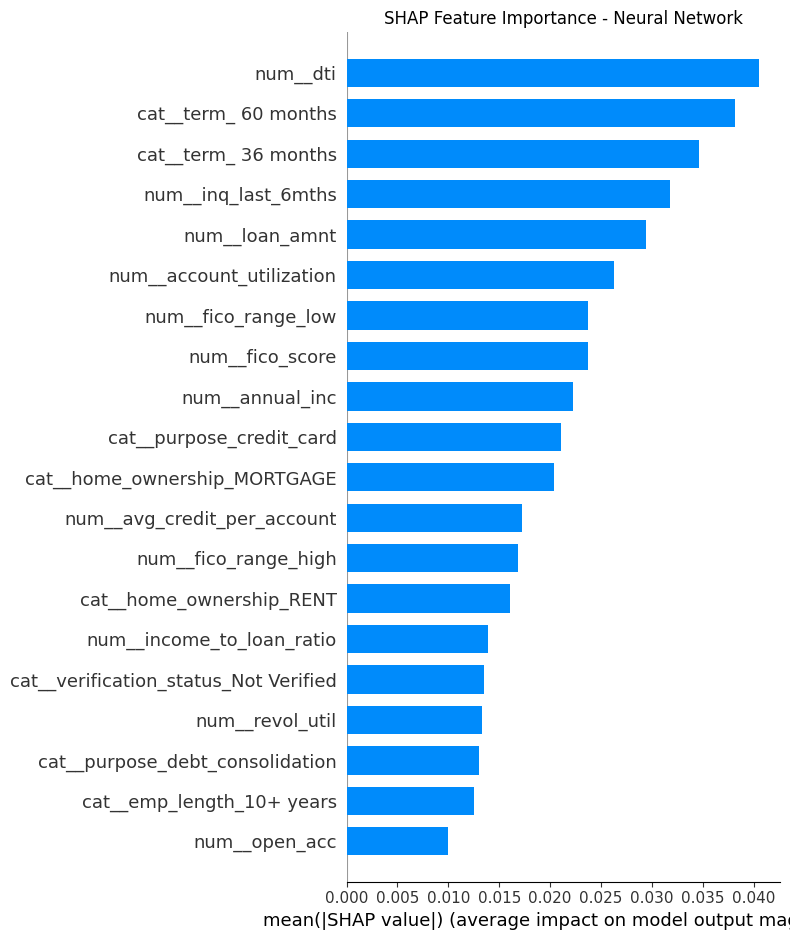

The figure layout has changed to tight


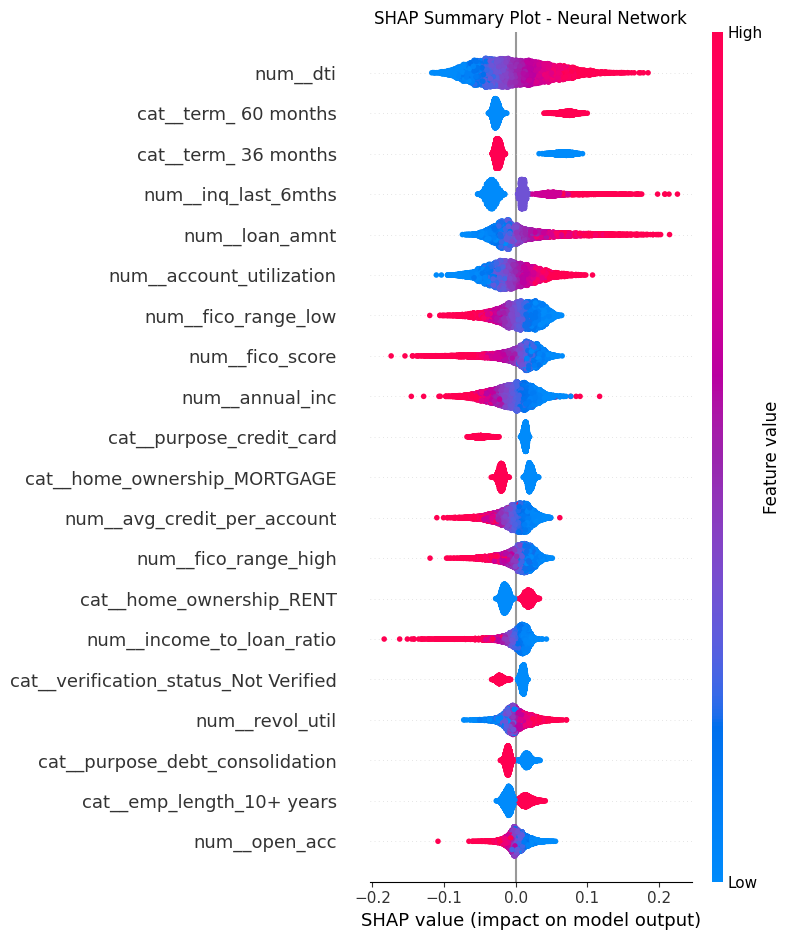

Shap analysis for neural network took 10.91 minutes or 654.79 seconds


In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Loss plot
ax[0].plot(history.history["loss"], label="Training Loss")
ax[0].plot(history.history["val_loss"], label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Training vs Validation Loss")

# AUC plot
ax[1].plot(history.history["auc"], label="Training AUC")
ax[1].plot(history.history["val_auc"], label="Validation AUC")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("AUC")
ax[1].legend()
ax[1].set_title("Training vs Validation AUC")

plt.tight_layout()
plt.show()

nn_metrics = evaluate_model(model, X_test_preprocessed_nn, y_test_nn)

# ================== SHAP ANALYSIS ==================
nn_shap_analysis_start = time.time()
shap_values = plot_shap_importance(
    model=model,
    X_train_preprocessed=X_train_preprocessed_nn,
    model_name="Neural Network",
    feature_names=nn_feature_names
)
nn_shap_analysis_end = time.time() - nn_shap_analysis_start
print(f"Shap analysis for neural network took {(nn_shap_analysis_end/60):.2f} minutes or {nn_shap_analysis_end:.2f} seconds")

## LightGBM, Cat Boost and Neural Network Ensemble
---

In [ ]:
# -------------------------------
# 1. Generate meta-features for the neural network using K-Fold
# -------------------------------
meta_train_nn = np.zeros((X_train_preprocessed.shape[0], 1))
meta_test_nn  = np.zeros((X_test_preprocessed.shape[0], 1))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train_preprocessed):
    X_fold_train = X_train_preprocessed[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val   = X_train_preprocessed[val_idx]

    nn = create_nn_model(input_dim)  # same architecture
    nn.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_train[val_idx]),
        epochs=50,
        batch_size=256,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    meta_train_nn[val_idx] = nn.predict(X_fold_val)
    meta_test_nn += nn.predict(X_test_preprocessed) / kf.n_splits

KeyError: '[1, 3, 10, 11, 19, 29, 32, 34, 37, 40, 42, 47, 48, 55, 59, 64, 66, 67, 69, 73, 75, 77, 80, 81, 82, 84, 87, 91, 92, 95, 99, 104, 111, 112, 119, 124, 129, 131, 134, 142, 149, 153, 160, 168, 170, 171, 177, 179, 181, 182, 183, 188, 189, 191, 201, 203, 205, 206, 209, 212, 213, 215, 217, 219, 225, 227, 233, 239, 248, 252, 254, 255, 261, 265, 266, 269, 281, 284, 296, 298, 299, 301, 303, 307, 320, 321, 328, 329, 332, 334, 341, 344, 345, 349, 350, 352, 371, 373, 382, 385, 396, 402, 403, 406, 417, 421, 424, 426, 429, 437, 444, 453, 458, 463, 466, 474, 479, 492, 495, 500, 501, 502, 515, 529, 535, 540, 543, 548, 549, 551, 557, 558, 561, 563, 564, 568, 571, 574, 576, 577, 597, 602, 603, 604, 605, 608, 610, 611, 616, 623, 626, 630, 631, 632, 635, 642, 645, 650, 651, 653, 658, 660, 661, 664, 670, 673, 679, 683, 685, 686, 689, 690, 691, 692, 694, 695, 698, 703, 705, 707, 717, 724, 726, 729, 732, 733, 734, 743, 751, 752, 758, 761, 762, 763, 772, 777, 783, 786, 792, 793, 795, 797, 802, 803, 806, 807, 811, 818, 819, 821, 828, 832, 844, 849, 852, 854, 855, 864, 865, 866, 867, 872, 879, 887, 888, 892, 895, 896, 912, 913, 922, 930, 932, 936, 943, 945, 951, 953, 958, 961, 963, 967, 972, 973, 989, 991, 992, 1000, 1003, 1005, 1007, 1011, 1012, 1014, 1019, 1027, 1034, 1051, 1056, 1073, 1079, 1083, 1086, 1087, 1088, 1090, 1092, 1093, 1100, 1102, 1103, 1106, 1108, 1114, 1115, 1119, 1120, 1143, 1146, 1148, 1150, 1152, 1155, 1156, 1162, 1177, 1180, 1186, 1189, 1190, 1191, 1204, 1206, 1209, 1218, 1228, 1229, 1230, 1232, 1253, 1261, 1262, 1265, 1268, 1273, 1277, 1278, 1288, 1296, 1297, 1303, 1316, 1317, 1324, 1329, 1330, 1333, 1339, 1346, 1347, 1348, 1349, 1353, 1354, 1363, 1364, 1368, 1370, 1373, 1376, 1386, 1392, 1395, 1397, 1403, 1408, 1414, 1415, 1417, 1418, 1426, 1439, 1440, 1443, 1452, 1455, 1460, 1463, 1464, 1467, 1477, 1479, 1490, 1493, 1495, 1498, 1514, 1515, 1521, 1525, 1532, 1533, 1542, 1543, 1545, 1547, 1549, 1556, 1557, 1561, 1562, 1571, 1582, 1585, 1586, 1587, 1591, 1594, 1598, 1601, 1605, 1610, 1611, 1617, 1620, 1625, 1629, 1636, 1642, 1652, 1659, 1661, 1663, 1667, 1671, 1672, 1680, 1697, 1701, 1702, 1708, 1715, 1719, 1721, 1722, 1734, 1736, 1740, 1761, 1771, 1773, 1776, 1782, 1786, 1791, 1793, 1796, 1797, 1798, 1807, 1821, 1823, 1826, 1828, 1842, 1845, 1858, 1866, 1867, 1869, 1871, 1883, 1889, 1898, 1903, 1907, 1910, 1915, 1919, 1923, 1926, 1933, 1952, 1955, 1959, 1961, 1971, 1975, 1986, 1988, 1991, 2017, 2022, 2025, 2034, 2038, 2039, 2050, 2056, 2063, 2076, 2081, 2086, 2087, 2089, 2092, 2104, 2113, 2116, 2121, 2125, 2131, 2136, 2138, 2143, 2158, 2162, 2163, 2169, 2174, 2176, 2179, 2180, 2191, 2196, 2200, 2216, 2220, 2224, 2235, 2242, 2244, 2245, 2257, 2259, 2262, 2265, 2267, 2269, 2273, 2274, 2281, 2282, 2289, 2291, 2293, 2297, 2301, 2305, 2310, 2312, 2313, 2323, 2330, 2332, 2337, 2343, 2344, 2345, 2346, 2350, 2351, 2357, 2360, 2368, 2381, 2383, 2386, 2389, 2394, 2395, 2397, 2398, 2411, 2412, 2424, 2426, 2427, 2429, 2432, 2437, 2443, 2445, 2462, 2465, 2467, 2469, 2470, 2472, 2474, 2476, 2481, 2482, 2484, 2492, 2500, 2504, 2505, 2506, 2510, 2511, 2513, 2517, 2539, 2546, 2548, 2559, 2560, 2563, 2569, 2570, 2582, 2585, 2588, 2589, 2598, 2599, 2612, 2614, 2619, 2620, 2625, 2628, 2629, 2630, 2635, 2642, 2646, 2648, 2661, 2662, 2671, 2675, 2677, 2682, 2689, 2704, 2711, 2714, 2727, 2741, 2750, 2752, 2755, 2759, 2762, 2770, 2772, 2774, 2775, 2776, 2782, 2784, 2787, 2788, 2790, 2794, 2795, 2802, 2803, 2808, 2809, 2814, 2815, 2816, 2819, 2820, 2824, 2825, 2826, 2833, 2836, 2839, 2842, 2855, 2862, 2864, 2876, 2879, 2886, 2889, 2891, 2894, 2895, 2896, 2897, 2900, 2904, 2907, 2908, 2910, 2921, 2927, 2933, 2941, 2943, 2945, 2955, 2966, 2968, 2972, 2975, 2978, 2980, 2983, 2985, 2990, 2992, 2993, 2994, 2995, 2997, 2998, 3002, 3011, 3015, 3020, 3022, 3026, 3028, 3032, 3035, 3041, 3043, 3044, 3046, 3047, 3050, 3051, 3056, 3059, 3066, 3069, 3082, 3083, 3085, 3093, 3096, 3098, 3102, 3103, 3105, 3106, 3107, 3110, 3121, 3126, 3134, 3138, 3139, 3145, 3148, 3156, 3158, 3160, 3167, 3168, 3174, 3175, 3179, 3193, 3195, 3203, 3210, 3216, 3220, 3225, 3226, 3232, 3234, 3238, 3240, 3246, 3247, 3262, 3264, 3266, 3276, 3281, 3283, 3284, 3285, 3296, 3297, 3299, 3305, 3306, 3309, 3318, 3320, 3327, 3328, 3332, 3362, 3365, 3371, 3373, 3385, 3386, 3388, 3389, 3396, 3398, 3399, 3402, 3407, 3408, 3410, 3411, 3413, 3415, 3422, 3429, 3444, 3451, 3459, 3462, 3468, 3472, 3473, 3474, 3476, 3477, 3482, 3485, 3486, 3492, 3500, 3503, 3506, 3518, 3522, 3525, 3529, 3535, 3544, 3548, 3555, 3556, 3559, 3565, 3568, 3572, 3573, 3581, 3583, 3589, 3593, 3598, 3599, 3600, 3606, 3611, 3617, 3626, 3628, 3640, 3641, 3644, 3645, 3650, 3657, 3666, 3669, 3670, 3673, 3683, 3685, 3691, 3702, 3708, 3711, 3712, 3720, 3730, 3731, 3736, 3738, 3741, 3743, 3746, 3748, 3756, 3761, 3763, 3766, 3768, 3773, 3775, 3776, 3778, 3779, 3781, 3786, 3795, 3797, 3801, 3806, 3807, 3810, 3812, 3819, 3824, 3825, 3829, 3848, 3849, 3853, 3855, 3856, 3865, 3879, 3881, 3882, 3886, 3888, 3890, 3900, 3903, 3904, 3913, 3916, 3917, 3923, 3930, 3932, 3935, 3936, 3937, 3939, 3944, 3946, 3947, 3950, 3951, 3953, 3966, 3971, 3972, 3973, 3989, 3990, 3999, 4006, 4008, 4009, 4012, 4013, 4014, 4030, 4038, 4041, 4042, 4049, 4051, 4053, 4064, 4065, 4069, 4071, 4073, 4076, 4084, 4093, 4094, 4098, 4107, 4108, 4110, 4113, 4131, 4133, 4147, 4151, 4154, 4158, 4163, 4165, 4166, 4167, 4171, 4176, 4177, 4181, 4183, 4187, 4190, 4192, 4203, 4207, 4209, 4214, 4216, 4219, 4233, 4235, 4237, 4240, 4241, 4242, 4249, 4252, 4255, 4257, 4258, 4259, 4260, 4261, 4262, 4281, 4282, 4296, 4298, 4303, 4305, 4309, 4312, 4314, 4319, 4322, 4323, 4324, 4328, 4334, 4337, 4342, 4350, 4353, 4354, 4358, 4359, 4364, 4366, 4384, 4387, 4393, 4395, 4399, 4408, 4417, 4419, 4420, 4434, 4440, 4450, 4451, 4453, 4455, 4461, 4463, 4470, 4489, 4494, 4502, 4503, 4504, 4507, 4529, 4530, 4537, 4551, 4555, 4568, 4571, 4572, 4573, 4575, 4591, 4592, 4607, 4611, 4612, 4613, 4618, 4619, 4631, 4632, 4636, 4637, 4639, 4643, 4653, 4662, 4665, 4667, 4693, 4695, 4700, 4706, 4709, 4716, 4718, 4725, 4726, 4727, 4734, 4736, 4742, 4745, 4755, 4760, 4761, 4763, 4764, 4768, 4775, 4779, 4782, 4785, 4788, 4791, 4793, 4801, 4803, 4808, 4812, 4816, 4828, 4831, 4838, 4839, 4841, 4842, 4845, 4849, 4853, 4854, 4857, 4858, 4864, 4866, 4875, 4879, 4890, 4892, 4896, 4901, 4902, 4911, 4922, 4930, 4932, 4934, 4936, 4941, 4942, 4949, 4950, 4951, 4953, 4969, 4976, 4980, 4981, 4982, 4985, 4986, 4987, 4989, 4992, 4994, 4998, 5000, 5008, 5018, 5020, 5022, 5030, 5036, 5037, 5042, 5045, 5048, 5054, 5059, 5066, 5068, 5080, 5084, 5085, 5091, 5092, 5093, 5097, 5102, 5104, 5109, 5112, 5113, 5115, 5120, 5131, 5136, 5138, 5139, 5143, 5147, 5148, 5152, 5153, 5158, 5166, 5168, 5170, 5174, 5175, 5179, 5183, 5184, 5191, 5195, 5197, 5200, 5202, 5203, 5204, 5211, 5214, 5217, 5221, 5222, 5228, 5229, 5230, 5234, 5237, 5239, 5240, 5241, 5242, 5253, 5255, 5256, 5257, 5258, 5260, 5265, 5266, 5270, 5272, 5279, 5284, 5286, 5288, 5291, 5292, 5300, 5302, 5305, 5310, 5312, 5314, 5318, 5319, 5322, 5323, 5331, 5340, 5342, 5349, 5350, 5355, 5357, 5360, 5371, 5375, 5379, 5380, 5385, 5392, 5393, 5395, 5397, 5408, 5412, 5417, 5420, 5421, 5423, 5426, 5439, 5441, 5446, 5456, 5459, 5460, 5469, 5478, 5481, 5483, 5486, 5487, 5492, 5495, 5505, 5511, 5516, 5517, 5518, 5520, 5543, 5550, 5555, 5559, 5572, 5573, 5575, 5579, 5581, 5583, 5589, 5594, 5596, 5597, 5599, 5600, 5613, 5619, 5620, 5624, 5627, 5633, 5634, 5638, 5639, 5653, 5655, 5660, 5661, 5665, 5666, 5670, 5674, 5675, 5678, 5686, 5690, 5694, 5712, 5713, 5728, 5736, 5737, 5738, 5743, 5744, 5749, 5752, 5755, 5765, 5781, 5783, 5786, 5799, 5801, 5802, 5803, 5805, 5814, 5817, 5821, 5825, 5828, 5832, 5835, 5839, 5841, 5842, 5845, 5848, 5849, 5852, 5855, 5862, 5863, 5871, 5878, 5882, 5889, 5891, 5894, 5895, 5897, 5907, 5910, 5915, 5918, 5919, 5924, 5932, 5934, 5942, 5943, 5945, 5946, 5949, 5954, 5964, 5965, 5966, 5971, 5973, 5983, 5984, 5989, 5994, 5998, 6013, 6019, 6023, 6026, 6031, 6035, 6036, 6041, 6042, 6043, 6048, 6054, 6062, 6073, 6077, 6078, 6083, 6097, 6099, 6101, 6102, 6111, 6112, 6119, 6120, 6126, 6127, 6129, 6135, 6140, 6152, 6154, 6158, 6159, 6160, 6167, 6168, 6177, 6199, 6200, 6203, 6205, 6208, 6209, 6210, 6211, 6220, 6228, 6234, 6236, 6239, 6251, 6257, 6265, 6269, 6272, 6276, 6278, 6280, 6283, 6284, 6287, 6292, 6295, 6303, 6305, 6310, 6316, 6317, 6321, 6328, 6334, 6335, 6337, 6339, 6342, 6343, 6346, 6347, 6350, 6353, 6355, 6358, 6362, 6367, 6370, 6377, 6378, 6379, 6380, 6382, 6383, 6394, 6402, 6406, 6411, 6415, 6416, 6420, 6428, 6431, 6432, 6445, 6446, 6453, 6455, 6456, 6457, 6464, 6465, 6466, 6467, 6474, 6475, 6481, 6482, 6489, 6493, 6494, 6498, 6512, 6513, 6518, 6521, 6524, 6527, 6528, 6530, 6537, 6540, 6541, 6547, 6548, 6549, 6560, 6561, 6562, 6565, 6569, 6571, 6577, 6582, 6588, 6589, 6592, 6594, 6604, 6609, 6613, 6628, 6632, 6635, 6641, 6643, 6649, 6656, 6666, 6667, 6675, 6685, 6687, 6692, 6693, 6696, 6700, 6701, 6705, 6707, 6712, 6719, 6720, 6721, 6722, 6724, 6726, 6727, 6728, 6729, 6730, 6735, 6739, 6747, 6748, 6750, 6751, 6769, 6770, 6772, 6776, 6788, 6795, 6796, 6800, 6803, 6816, 6819, 6824, 6826, 6830, 6833, 6834, 6837, 6841, 6846, 6849, 6850, 6851, 6852, 6854, 6860, 6865, 6866, 6867, 6868, 6873, 6880, 6883, 6896, 6898, 6902, 6906, 6913, 6914, 6918, 6921, 6934, 6941, 6942, 6944, 6948, 6950, 6952, 6957, 6973, 6974, 6984, 6986, 6996, 6997, 6999, 7002, 7010, 7011, 7013, 7025, 7030, 7038, 7047, 7048, 7050, 7052, 7060, 7073, 7080, 7089, 7090, 7094, 7098, 7107, 7108, 7114, 7117, 7120, 7125, 7128, 7137, 7139, 7146, 7153, 7162, 7166, 7177, 7180, 7182, 7200, 7210, 7214, 7217, 7222, 7225, 7232, 7235, 7241, 7244, 7255, 7260, 7263, 7269, 7270, 7274, 7277, 7283, 7291, 7293, 7294, 7296, 7297, 7300, 7302, 7308, 7310, 7311, 7312, 7318, 7327, 7330, 7334, 7337, 7338, 7347, 7350, 7357, 7360, 7366, 7367, 7368, 7373, 7375, 7377, 7379, 7417, 7423, 7424, 7431, 7432, 7437, 7440, 7442, 7445, 7446, 7448, 7451, 7453, 7457, 7460, 7468, 7472, 7485, 7489, 7496, 7505, 7507, 7510, 7516, 7517, 7518, 7528, 7529, 7530, 7534, 7542, 7548, 7552, 7553, 7555, 7560, 7561, 7564, 7565, 7566, 7567, 7569, 7573, 7574, 7586, 7596, 7603, 7604, 7607, 7611, 7617, 7619, 7622, 7630, 7631, 7632, 7633, 7637, 7638, 7648, 7651, 7653, 7660, 7661, 7666, 7669, 7671, 7683, 7692, 7697, 7698, 7702, 7705, 7708, 7713, 7717, 7727, 7734, 7741, 7745, 7752, 7753, 7756, 7767, 7771, 7774, 7776, 7777, 7778, 7781, 7785, 7799, 7803, 7810, 7811, 7816, 7819, 7827, 7828, 7840, 7848, 7850, 7851, 7854, 7856, 7857, 7859, 7875, 7876, 7880, 7883, 7887, 7890, 7892, 7895, 7896, 7897, 7903, 7908, 7912, 7920, 7929, 7936, 7938, 7939, 7940, 7945, 7955, 7960, 7963, 7969, 7976, 7978, 7982, 7984, 7991, 7993, 8001, 8006, 8009, 8014, 8016, 8024, 8026, 8029, 8034, 8036, 8042, 8050, 8055, 8057, 8059, 8062, 8070, 8072, 8073, 8077, 8081, 8082, 8086, 8093, 8098, 8101, 8116, 8129, 8130, 8131, 8132, 8134, 8141, 8142, 8160, 8164, 8169, 8180, 8182, 8183, 8187, 8188, 8200, 8202, 8205, 8211, 8213, 8221, 8232, 8240, 8244, 8254, 8260, 8261, 8262, 8265, 8266, 8268, 8270, 8278, 8279, 8280, 8298, 8299, 8302, 8303, 8306, 8330, 8338, 8339, 8342, 8343, 8360, 8362, 8364, 8365, 8367, 8373, 8375, 8377, 8381, 8382, 8389, 8392, 8399, 8408, 8416, 8438, 8448, 8449, 8451, 8458, 8460, 8476, 8478, 8482, 8483, 8488, 8492, 8495, 8504, 8509, 8512, 8514, 8515, 8518, 8527, 8529, 8530, 8531, 8535, 8543, 8545, 8549, 8556, 8560, 8563, 8574, 8576, 8580, 8589, 8591, 8594, 8597, 8599, 8601, 8611, 8615, 8624, 8631, 8633, 8641, 8646, 8648, 8656, 8661, 8673, 8680, 8685, 8691, 8694, 8695, 8696, 8699, 8701, 8711, 8719, 8722, 8724, 8726, 8729, 8731, 8736, 8738, 8740, 8751, 8753, 8768, 8770, 8774, 8777, 8779, 8780, 8783, 8790, 8798, 8803, 8804, 8805, 8811, 8815, 8824, 8830, 8845, 8851, 8852, 8855, 8862, 8868, 8871, 8879, 8883, 8888, 8890, 8891, 8894, 8895, 8901, 8906, 8911, 8918, 8919, 8925, 8935, 8941, 8952, 8956, 8968, 8970, 8972, 8974, 8975, 8984, 8986, 8989, 8996, 8997, 9005, 9007, 9008, 9014, 9016, 9025, 9026, 9033, 9034, 9038, 9043, 9046, 9062, 9064, 9066, 9068, 9070, 9072, 9073, 9079, 9083, 9090, 9092, 9104, 9105, 9113, 9124, 9134, 9135, 9148, 9149, 9152, 9157, 9162, 9163, 9165, 9172, 9178, 9181, 9185, 9196, 9198, 9200, 9202, 9210, 9218, 9225, 9233, 9236, 9240, 9245, 9252, 9254, 9256, 9258, 9262, 9263, 9264, 9265, 9269, 9277, 9281, 9287, 9289, 9292, 9296, 9305, 9308, 9309, 9312, 9322, 9324, 9331, 9336, 9341, 9342, 9344, 9354, 9355, 9360, 9366, 9371, 9373, 9376, 9381, 9382, 9386, 9393, 9396, 9400, 9403, 9404, 9405, 9415, 9416, 9418, 9422, 9426, 9427, 9431, 9433, 9437, 9440, 9447, 9452, 9453, 9456, 9468, 9470, 9480, 9482, 9483, 9486, 9488, 9494, 9495, 9498, 9500, 9503, 9504, 9505, 9506, 9509, 9516, 9522, 9528, 9529, 9535, 9540, 9546, 9557, 9563, 9567, 9571, 9583, 9587, 9592, 9595, 9603, 9612, 9618, 9622, 9623, 9630, 9631, 9632, 9635, 9638, 9641, 9642, 9648, 9657, 9659, 9674, 9678, 9680, 9682, 9689, 9694, 9697, 9701, 9705, 9725, 9731, 9732, 9736, 9749, 9751, 9752, 9754, 9756, 9757, 9760, 9764, 9765, 9767, 9768, 9769, 9770, 9777, 9780, 9785, 9786, 9787, 9788, 9791, 9794, 9796, 9803, 9804, 9806, 9807, 9824, 9825, 9828, 9829, 9837, 9844, 9847, 9849, 9860, 9862, 9876, 9883, 9884, 9885, 9886, 9887, 9890, 9892, 9893, 9894, 9898, 9899, 9900, 9902, 9903, 9904, 9906, 9909, 9923, 9925, 9929, 9939, 9942, 9944, 9945, 9947, 9951, 9952, 9953, 9956, 9962, 9963, 9964, 9968, 9970, 9973, 9979, 9984, 9987, 9990, 9997, 9998, 10002, 10006, 10008, 10014, 10017, 10026, 10027, 10033, 10036, 10044, 10046, 10059, 10061, 10065, 10066, 10078, 10091, 10094, 10096, 10100, 10103, 10105, 10112, 10113, 10121, 10123, 10124, 10128, 10130, 10132, 10133, 10139, 10140, 10145, 10149, 10152, 10159, 10161, 10162, 10171, 10175, 10176, 10178, 10179, 10180, 10186, 10189, 10191, 10195, 10200, 10201, 10211, 10214, 10215, 10220, 10223, 10228, 10238, 10241, 10254, 10257, 10258, 10266, 10272, 10273, 10274, 10281, 10284, 10296, 10297, 10298, 10299, 10303, 10305, 10309, 10311, 10312, 10316, 10321, 10331, 10341, 10343, 10345, 10348, 10353, 10354, 10356, 10357, 10359, 10363, 10364, 10366, 10370, 10376, 10379, 10382, 10383, 10391, 10401, 10405, 10408, 10416, 10419, 10422, 10426, 10430, 10431, 10434, 10440, 10452, 10455, 10460, 10462, 10463, 10469, 10473, 10485, 10490, 10492, 10496, 10497, 10500, 10501, 10504, 10514, 10515, 10520, 10521, 10524, 10527, 10533, 10534, 10536, 10538, 10540, 10541, 10543, 10544, 10548, 10552, 10560, 10561, 10567, 10568, 10571, 10576, 10577, 10579, 10582, 10586, 10591, 10592, 10594, 10596, 10599, 10601, 10605, 10608, 10609, 10610, 10611, 10620, 10622, 10626, 10627, 10630, 10633, 10634, 10638, 10639, 10641, 10650, 10651, 10654, 10659, 10662, 10665, 10667, 10668, 10672, 10682, 10690, 10691, 10692, 10694, 10696, 10702, 10707, 10708, 10714, 10720, 10725, 10726, 10730, 10750, 10754, 10755, 10758, 10769, 10772, 10774, 10788, 10792, 10794, 10796, 10799, 10801, 10802, 10804, 10805, 10810, 10814, 10817, 10821, 10823, 10824, 10835, 10837, 10838, 10840, 10841, 10842, 10852, 10853, 10855, 10862, 10871, 10875, 10880, 10884, 10885, 10886, 10893, 10896, 10899, 10900, 10906, 10908, 10918, 10922, 10926, 10928, 10930, 10935, 10944, 10947, 10949, 10951, 10953, 10957, 10958, 10960, 10976, 10984, 10986, 10988, 10991, 10992, 11000, 11004, 11008, 11011, 11018, 11023, 11025, 11030, 11032, 11039, 11051, 11052, 11055, 11061, 11067, 11068, 11075, 11080, 11083, 11086, 11090, 11101, 11106, 11108, 11112, 11116, 11123, 11125, 11126, 11127, 11128, 11131, 11132, 11133, 11140, 11143, 11144, 11148, 11150, 11154, 11158, 11159, 11161, 11162, 11164, 11165, 11171, 11174, 11177, 11186, 11195, 11197, 11201, 11212, 11214, 11215, 11221, 11222, 11231, 11232, 11233, 11234, 11240, 11244, 11254, 11260, 11263, 11265, 11276, 11278, 11279, 11287, 11288, 11290, 11294, 11300, 11304, 11305, 11308, 11311, 11323, 11329, 11333, 11344, 11352, 11353, 11354, 11356, 11358, 11363, 11367, 11373, 11377, 11382, 11384, 11385, 11387, 11394, 11397, 11400, 11403, 11404, 11420, 11428, 11430, 11431, 11433, 11436, 11449, 11454, 11456, 11458, 11460, 11462, 11464, 11469, 11470, 11475, 11477, 11479, 11480, 11482, 11485, 11489, 11495, 11504, 11507, 11514, 11516, 11527, 11531, 11534, 11537, 11543, 11550, 11552, 11557, 11559, 11560, 11561, 11567, 11570, 11575, 11577, 11586, 11589, 11594, 11599, 11600, 11601, 11607, 11615, 11617, 11620, 11621, 11627, 11628, 11632, 11634, 11635, 11636, 11639, 11642, 11644, 11648, 11661, 11668, 11682, 11684, 11692, 11694, 11699, 11700, 11702, 11705, 11708, 11710, 11711, 11712, 11713, 11714, 11722, 11723, 11730, 11731, 11743, 11744, 11751, 11752, 11754, 11760, 11776, 11780, 11783, 11784, 11789, 11795, 11796, 11807, 11808, 11809, 11814, 11815, 11817, 11818, 11820, 11823, 11827, 11837, 11841, 11847, 11851, 11852, 11853, 11856, 11858, 11859, 11860, 11863, 11870, 11873, 11876, 11880, 11881, 11884, 11890, 11894, 11898, 11900, 11902, 11914, 11920, 11921, 11925, 11930, 11931, 11932, 11936, 11942, 11943, 11944, 11972, 11981, 11985, 11986, 11988, 11997, 12000, 12001, 12002, 12005, 12008, 12011, 12017, 12023, 12030, 12031, 12032, 12033, 12043, 12044, 12049, 12051, 12062, 12069, 12071, 12073, 12075, 12077, 12084, 12088, 12090, 12094, 12095, 12118, 12124, 12126, 12129, 12136, 12138, 12145, 12151, 12155, 12164, 12168, 12171, 12176, 12177, 12178, 12179, 12180, 12185, 12186, 12190, 12201, 12202, 12205, 12212, 12219, 12228, 12229, 12230, 12232, 12234, 12236, 12239, 12241, 12244, 12248, 12257, 12260, 12263, 12265, 12266, 12268, 12269, 12274, 12279, 12280, 12287, 12289, 12296, 12298, 12299, 12303, 12304, 12309, 12313, 12317, 12319, 12324, 12326, 12329, 12332, 12337, 12343, 12345, 12353, 12359, 12364, 12369, 12375, 12382, 12388, 12391, 12397, 12403, 12405, 12406, 12407, 12422, 12423, 12431, 12437, 12442, 12443, 12447, 12453, 12454, 12455, 12456, 12457, 12460, 12461, 12462, 12465, 12468, 12471, 12478, 12483, 12484, 12495, 12510, 12511, 12516, 12524, 12527, 12535, 12538, 12541, 12544, 12546, 12559, 12564, 12568, 12570, 12575, 12578, 12580, 12581, 12591, 12593, 12598, 12607, 12609, 12614, 12623, 12626, 12628, 12630, 12634, 12635, 12641, 12642, 12643, 12650, 12661, 12667, 12670, 12673, 12676, 12678, 12679, 12684, 12686, 12687, 12694, 12695, 12696, 12701, 12704, 12708, 12716, 12718, 12721, 12722, 12725, 12731, 12734, 12736, 12739, 12744, 12749, 12752, 12753, 12755, 12761, 12762, 12769, 12771, 12777, 12790, 12804, 12809, 12811, 12823, 12825, 12826, 12829, 12831, 12837, 12838, 12839, 12854, 12855, 12856, 12857, 12867, 12872, 12874, 12881, 12888, 12890, 12891, 12892, 12897, 12898, 12907, 12913, 12920, 12924, 12928, 12931, 12932, 12938, 12942, 12951, 12961, 12963, 12966, 12975, 12978, 12979, 12980, 12986, 12987, 12988, 12993, 12996, 12999, 13001, 13004, 13007, 13008, 13009, 13010, 13015, 13018, 13019, 13028, 13032, 13033, 13039, 13052, 13055, 13059, 13060, 13062, 13068, 13069, 13070, 13072, 13074, 13075, 13081, 13091, 13097, 13099, 13107, 13117, 13119, 13121, 13122, 13128, 13130, 13140, 13144, 13149, 13163, 13170, 13181, 13186, 13190, 13194, 13195, 13205, 13207, 13218, 13227, 13228, 13233, 13235, 13238, 13239, 13245, 13247, 13253, 13259, 13265, 13266, 13270, 13277, 13282, 13284, 13290, 13293, 13295, 13298, 13301, 13308, 13312, 13319, 13323, 13325, 13327, 13328, 13335, 13339, 13340, 13350, 13352, 13354, 13355, 13357, 13358, 13359, 13360, 13364, 13374, 13379, 13381, 13385, 13386, 13388, 13392, 13397, 13401, 13412, 13413, 13416, 13421, 13424, 13425, 13426, 13430, 13431, 13433, 13437, 13440, 13446, 13453, 13454, 13458, 13459, 13461, 13468, 13469, 13473, 13475, 13481, 13483, 13486, 13494, 13495, 13496, 13499, 13500, 13507, 13512, 13515, 13518, 13523, 13525, 13526, 13528, 13529, 13530, 13535, 13537, 13539, 13542, 13551, 13558, 13565, 13567, 13570, 13574, 13575, 13579, 13585, 13591, 13600, 13614, 13620, 13624, 13631, 13632, 13633, 13640, 13643, 13660, 13664, 13666, 13673, 13677, 13678, 13686, 13687, 13688, 13690, 13691, 13692, 13698, 13700, 13701, 13716, 13720, 13724, 13725, 13733, 13742, 13755, 13764, 13767, 13776, 13777, 13786, 13790, 13793, 13795, 13798, 13800, 13801, 13802, 13812, 13816, 13818, 13820, 13821, 13825, 13830, 13832, 13838, 13839, 13844, 13845, 13846, 13851, 13852, 13872, 13874, 13876, 13878, 13883, 13886, 13889, 13891, 13892, 13897, 13900, 13902, 13904, 13913, 13918, 13919, 13921, 13922, 13925, 13928, 13929, 13933, 13939, 13948, 13952, 13955, 13956, 13970, 13971, 13973, 13985, 13986, 13987, 13990, 13992, 13993, 14001, 14011, 14016, 14018, 14019, 14020, 14022, 14023, 14024, 14025, 14026, 14029, 14030, 14036, 14037, 14038, 14040, 14056, 14059, 14064, 14066, 14069, 14086, 14089, 14090, 14093, 14100, 14101, 14104, 14110, 14111, 14114, 14116, 14124, 14125, 14126, 14131, 14138, 14141, 14143, 14144, 14146, 14147, 14148, 14152, 14156, 14160, 14169, 14180, 14183, 14191, 14192, 14193, 14195, 14198, 14201, 14205, 14206, 14215, 14217, 14218, 14220, 14222, 14223, 14225, 14230, 14241, 14242, 14256, 14258, 14259, 14260, 14261, 14266, 14271, 14279, 14280, 14288, 14293, 14295, 14303, 14304, 14306, 14309, 14310, 14314, 14316, 14317, 14320, 14335, 14338, 14341, 14344, 14363, 14365, 14366, 14374, 14376, 14386, 14387, 14392, 14393, 14395, 14399, 14400, 14402, 14408, 14410, 14415, 14416, 14417, 14419, 14422, 14429, 14433, 14434, 14443, 14445, 14446, 14447, 14458, 14459, 14464, 14484, 14486, 14488, 14489, 14490, 14496, 14500, 14504, 14509, 14512, 14522, 14523, 14528, 14529, 14536, 14539, 14545, 14550, 14559, 14569, 14571, 14574, 14580, 14581, 14583, 14586, 14595, 14596, 14602, 14606, 14608, 14620, 14627, 14641, 14642, 14648, 14654, 14657, 14658, 14662, 14664, 14668, 14683, 14688, 14689, 14703, 14727, 14735, 14745, 14748, 14754, 14758, 14760, 14762, 14764, 14767, 14772, 14774, 14782, 14785, 14788, 14795, 14797, 14800, 14805, 14818, 14819, 14822, 14828, 14834, 14836, 14840, 14846, 14857, 14858, 14860, 14865, 14867, 14875, 14891, 14892, 14895, 14901, 14909, 14911, 14918, 14919, 14927, 14935, 14946, 14948, 14952, 14956, 14970, 14971, 14980, 14984, 14986, 14993, 14996, 15001, 15006, 15009, 15014, 15023, 15030, 15031, 15038, 15057, 15064, 15068, 15075, 15077, 15081, 15086, 15091, 15092, 15093, 15107, 15110, 15114, 15120, 15123, 15132, 15134, 15137, 15141, 15145, 15146, 15153, 15160, 15161, 15164, 15165, 15176, 15184, 15193, 15199, 15202, 15203, 15208, 15211, 15215, 15221, 15226, 15228, 15237, 15240, 15243, 15247, 15250, 15253, 15272, 15283, 15288, 15290, 15292, 15293, 15297, 15300, 15304, 15307, 15312, 15315, 15316, 15317, 15320, 15321, 15322, 15330, 15332, 15346, 15347, 15348, 15353, 15357, 15362, 15370, 15371, 15375, 15376, 15385, 15393, 15395, 15396, 15400, 15403, 15411, 15417, 15424, 15430, 15431, 15436, 15443, 15445, 15449, 15451, 15453, 15455, 15458, 15460, 15461, 15464, 15473, 15474, 15484, 15487, 15488, 15496, 15498, 15501, 15506, 15507, 15511, 15514, 15517, 15519, 15520, 15526, 15538, 15550, 15551, 15555, 15556, 15559, 15561, 15562, 15566, 15575, 15578, 15579, 15583, 15590, 15591, 15592, 15598, 15600, 15601, 15606, 15608, 15616, 15630, 15631, 15634, 15638, 15639, 15643, 15644, 15646, 15650, 15651, 15652, 15653, 15660, 15668, 15670, 15674, 15677, 15678, 15679, 15680, 15689, 15691, 15693, 15695, 15697, 15710, 15727, 15736, 15737, 15738, 15739, 15743, 15747, 15751, 15756, 15761, 15763, 15764, 15767, 15775, 15790, 15793, 15797, 15798, 15799, 15801, 15805, 15806, 15810, 15813, 15815, 15821, 15824, 15827, 15829, 15835, 15843, 15847, 15848, 15853, 15855, 15857, 15858, 15864, 15869, 15870, 15883, 15884, 15885, 15888, 15895, 15899, 15903, 15907, 15908, 15917, 15925, 15927, 15932, 15940, 15943, 15956, 15964, 15968, 15976, 15983, 15993, 15995, 15999, 16012, 16021, 16023, 16031, 16033, 16034, 16035, 16040, 16044, 16048, 16049, 16054, 16058, 16059, 16061, 16064, 16065, 16081, 16083, 16086, 16098, 16100, 16104, 16105, 16111, 16117, 16124, 16126, 16129, 16132, 16137, 16140, 16143, 16146, 16152, 16154, 16155, 16157, 16159, 16162, 16163, 16167, 16172, 16175, 16178, 16181, 16183, 16185, 16189, 16191, 16194, 16201, 16209, 16213, 16221, 16226, 16231, 16255, 16256, 16260, 16261, 16270, 16273, 16278, 16283, 16286, 16291, 16295, 16300, 16306, 16314, 16320, 16323, 16325, 16327, 16332, 16341, 16349, 16351, 16353, 16367, 16370, 16379, 16380, 16381, 16384, 16387, 16389, 16391, 16395, 16403, 16404, 16414, 16419, 16421, 16426, 16433, 16435, 16440, 16445, 16454, 16468, 16469, 16471, 16474, 16476, 16478, 16480, 16482, 16484, 16485, 16494, 16498, 16500, 16502, 16513, 16517, 16519, 16521, 16525, 16526, 16528, 16529, 16539, 16540, 16542, 16545, 16548, 16551, 16552, 16554, 16558, 16574, 16577, 16579, 16583, 16584, 16586, 16587, 16598, 16599, 16604, 16607, 16608, 16622, 16624, 16633, 16636, 16640, 16645, 16647, 16648, 16650, 16655, 16665, 16669, 16670, 16677, 16678, 16682, 16694, 16695, 16702, 16713, 16722, 16724, 16730, 16731, 16737, 16738, 16740, 16746, 16749, 16751, 16752, 16756, 16758, 16763, 16766, 16778, 16780, 16783, 16784, 16787, 16788, 16792, 16793, 16794, 16796, 16798, 16803, 16809, 16819, 16824, 16825, 16836, 16839, 16842, 16843, 16844, 16848, 16852, 16857, 16861, 16864, 16866, 16870, 16872, 16877, 16878, 16880, 16883, 16889, 16891, 16898, 16905, 16910, 16913, 16919, 16925, 16927, 16929, 16933, 16934, 16939, 16942, 16944, 16949, 16951, 16952, 16953, 16954, 16958, 16965, 16966, 16975, 16979, 16983, 16984, 16985, 16989, 16991, 16994, 16996, 17009, 17010, 17011, 17018, 17024, 17025, 17028, 17031, 17035, 17041, 17045, 17052, 17053, 17057, 17065, 17072, 17084, 17090, 17097, 17098, 17101, 17106, 17119, 17128, 17133, 17149, 17154, 17160, 17164, 17165, 17171, 17178, 17185, 17186, 17187, 17199, 17201, 17203, 17207, 17217, 17219, 17221, 17223, 17230, 17234, 17235, 17239, 17240, 17241, 17245, 17248, 17250, 17251, 17252, 17257, 17259, 17263, 17264, 17270, 17271, 17273, 17274, 17276, 17277, 17279, 17286, 17298, 17314, 17317, 17318, 17324, 17326, 17331, 17335, 17342, 17344, 17347, 17357, 17361, 17367, 17369, 17372, 17374, 17395, 17399, 17404, 17405, 17408, 17411, 17414, 17422, 17436, 17443, 17445, 17458, 17459, 17461, 17464, 17465, 17466, 17472, 17484, 17491, 17494, 17505, 17508, 17510, 17522, 17524, 17529, 17539, 17544, 17546, 17548, 17552, 17554, 17555, 17556, 17557, 17560, 17563, 17565, 17574, 17577, 17578, 17579, 17585, 17587, 17589, 17591, 17592, 17605, 17608, 17609, 17612, 17614, 17621, 17633, 17634, 17645, 17650, 17655, 17664, 17666, 17671, 17673, 17674, 17676, 17677, 17679, 17687, 17695, 17701, 17702, 17704, 17713, 17715, 17717, 17726, 17727, 17733, 17734, 17736, 17745, 17746, 17749, 17752, 17758, 17772, 17773, 17780, 17782, 17785, 17787, 17788, 17794, 17798, 17799, 17803, 17805, 17806, 17808, 17809, 17813, 17818, 17825, 17826, 17829, 17830, 17835, 17838, 17839, 17844, 17845, 17849, 17854, 17856, 17857, 17863, 17864, 17868, 17871, 17875, 17877, 17882, 17893, 17900, 17903, 17912, 17913, 17921, 17927, 17928, 17931, 17934, 17936, 17940, 17942, 17954, 17962, 17963, 17970, 17976, 17978, 17982, 17983, 17994, 17998, 18000, 18012, 18013, 18015, 18020, 18022, 18025, 18028, 18037, 18038, 18047, 18052, 18053, 18060, 18061, 18062, 18067, 18070, 18073, 18077, 18084, 18091, 18094, 18097, 18099, 18105, 18108, 18115, 18116, 18118, 18121, 18123, 18128, 18130, 18132, 18133, 18135, 18136, 18139, 18141, 18142, 18145, 18157, 18161, 18162, 18163, 18166, 18174, 18180, 18187, 18194, 18195, 18196, 18198, 18220, 18224, 18234, 18237, 18239, 18240, 18242, 18244, 18247, 18249, 18252, 18253, 18261, 18267, 18269, 18271, 18296, 18297, 18300, 18302, 18303, 18306, 18311, 18316, 18319, 18325, 18328, 18329, 18330, 18331, 18332, 18335, 18340, 18342, 18345, 18346, 18351, 18376, 18377, 18378, 18384, 18388, 18390, 18395, 18404, 18407, 18410, 18412, 18420, 18423, 18432, 18434, 18435, 18436, 18439, 18443, 18457, 18458, 18466, 18471, 18480, 18484, 18487, 18493, 18495, 18508, 18509, 18510, 18511, 18526, 18531, 18536, 18545, 18548, 18554, 18556, 18557, 18559, 18561, 18562, 18568, 18575, 18578, 18580, 18604, 18605, 18616, 18619, 18622, 18623, 18629, 18632, 18638, 18639, 18643, 18646, 18650, 18651, 18655, 18658, 18663, 18664, 18668, 18671, 18672, 18681, 18684, 18699, 18701, 18705, 18708, 18712, 18713, 18718, 18719, 18727, 18729, 18731, 18733, 18739, 18740, 18741, 18745, 18760, 18761, 18764, 18771, 18774, 18775, 18782, 18783, 18790, 18791, 18793, 18797, 18801, 18802, 18807, 18809, 18814, 18818, 18823, 18824, 18831, 18846, 18847, 18849, 18853, 18855, 18856, 18857, 18865, 18866, 18871, 18882, 18883, 18884, 18888, 18895, 18902, 18910, 18913, 18916, 18917, 18918, 18919, 18922, 18925, 18926, 18927, 18937, 18943, 18950, 18975, 18976, 18980, 18982, 18983, 18985, 18987, 18988, 18997, 18999, 19008, 19009, 19012, 19013, 19021, 19022, 19024, 19029, 19032, 19033, 19034, 19036, 19042, 19043, 19045, 19049, 19052, 19055, 19056, 19058, 19061, 19078, 19081, 19082, 19086, 19087, 19088, 19089, 19091, 19094, 19101, 19103, 19105, 19112, 19116, 19124, 19126, 19129, 19130, 19145, 19147, 19154, 19159, 19165, 19166, 19178, 19180, 19190, 19192, 19196, 19200, 19203, 19204, 19212, 19214, 19224, 19225, 19232, 19233, 19235, 19241, 19253, 19256, 19264, 19272, 19275, 19282, 19283, 19284, 19288, 19289, 19294, 19296, 19307, 19309, 19310, 19311, 19322, 19326, 19328, 19329, 19330, 19332, 19334, 19340, 19341, 19347, 19348, 19357, 19359, 19363, 19372, 19380, 19381, 19385, 19389, 19391, 19392, 19394, 19395, 19406, 19407, 19425, 19428, 19437, 19443, 19447, 19456, 19459, 19460, 19471, 19478, 19487, 19489, 19493, 19495, 19497, 19498, 19500, 19517, 19521, 19522, 19525, 19527, 19529, 19541, 19546, 19550, 19551, 19555, 19557, 19558, 19560, 19563, 19570, 19582, 19585, 19587, 19589, 19595, 19596, 19598, 19607, 19608, 19610, 19614, 19617, 19619, 19621, 19623, 19624, 19632, 19639, 19642, 19652, 19653, 19665, 19669, 19691, 19692, 19707, 19708, 19712, 19719, 19721, 19729, 19731, 19734, 19736, 19739, 19743, 19750, 19751, 19757, 19760, 19774, 19775, 19781, 19782, 19783, 19787, 19788, 19795, 19799, 19800, 19802, 19805, 19808, 19823, 19828, 19829, 19830, 19832, 19836, 19844, 19845, 19846, 19847, 19848, 19856, 19859, 19860, 19863, 19867, 19869, 19870, 19871, 19874, 19877, 19879, 19882, 19883, 19884, 19887, 19889, 19890, 19892, 19895, 19896, 19902, 19908, 19913, 19914, 19916, 19919, 19920, 19922, 19926, 19927, 19929, 19931, 19932, 19933, 19934, 19939, 19941, 19942, 19944, 19946, 19967, 19969, 19976, 19978, 19983, 19984, 19988, 19992, 19995, 19999, 20001, 20012, 20031, 20032, 20035, 20039, 20040, 20043, 20044, 20046, 20053, 20054, 20055, 20060, 20063, 20071, 20074, 20078, 20086, 20090, 20092, 20094, 20098, 20101, 20102, 20106, 20121, 20125, 20127, 20128, 20134, 20135, 20141, 20145, 20153, 20157, 20160, 20164, 20166, 20167, 20176, 20183, 20185, 20190, 20194, 20195, 20197, 20212, 20214, 20221, 20224, 20227, 20231, 20245, 20250, 20280, 20289, 20295, 20296, 20297, 20300, 20309, 20321, 20322, 20323, 20327, 20333, 20343, 20348, 20350, 20352, 20353, 20356, 20360, 20364, 20370, 20378, 20383, 20384, 20386, 20387, 20390, 20391, 20394, 20396, 20412, 20416, 20418, 20423, 20425, 20428, 20439, 20443, 20444, 20445, 20455, 20456, 20457, 20458, 20462, 20466, 20467, 20470, 20471, 20472, 20476, 20479, 20482, 20484, 20485, 20486, 20493, 20503, 20505, 20509, 20517, 20554, 20556, 20560, 20564, 20567, 20574, 20575, 20577, 20581, 20589, 20590, 20592, 20597, 20601, 20614, 20619, 20622, 20623, 20624, 20626, 20628, 20632, 20633, 20643, 20647, 20650, 20655, 20659, 20660, 20663, 20666, 20672, 20674, 20675, 20677, 20678, 20681, 20685, 20689, 20691, 20693, 20695, 20696, 20704, 20717, 20719, 20722, 20725, 20739, 20741, 20745, 20751, 20752, 20753, 20761, 20763, 20766, 20767, 20770, 20777, 20780, 20788, 20789, 20793, 20794, 20802, 20809, 20815, 20824, 20834, 20836, 20838, 20839, 20849, 20850, 20855, 20869, 20871, 20874, 20884, 20890, 20898, 20900, 20902, 20911, 20912, 20915, 20916, 20917, 20921, 20927, 20928, 20930, 20931, 20934, 20938, 20941, 20946, 20950, 20953, 20961, 20962, 20964, 20965, 20972, 20976, 20977, 20978, 20986, 20995, 21006, 21009, 21014, 21024, 21028, 21034, 21036, 21040, 21045, 21047, 21057, 21058, 21063, 21072, 21073, 21076, 21081, 21082, 21086, 21088, 21091, 21092, 21094, 21095, 21101, 21102, 21104, 21115, 21120, 21124, 21125, 21126, 21127, 21128, 21131, 21140, 21142, 21144, 21145, 21150, 21151, 21154, 21157, 21159, 21160, 21162, 21163, 21165, 21172, 21175, 21177, 21179, 21180, 21188, 21189, 21193, 21194, 21206, 21208, 21216, 21218, 21221, 21223, 21230, 21235, 21236, 21239, 21240, 21246, 21248, 21254, 21257, 21258, 21263, 21264, 21265, 21266, 21280, 21284, 21288, 21292, 21293, 21294, 21299, 21303, 21306, 21314, 21318, 21320, 21323, 21325, 21331, 21332, 21334, 21337, 21340, 21347, 21348, 21350, 21353, 21354, 21357, 21367, 21384, 21386, 21389, 21392, 21393, 21398, 21400, 21402, 21419, 21420, 21422, 21429, 21433, 21437, 21441, 21444, 21450, 21456, 21463, 21468, 21474, 21475, 21477, 21485, 21487, 21488, 21492, 21496, 21499, 21504, 21506, 21509, 21511, 21512, 21513, 21514, 21517, 21518, 21522, 21523, 21526, 21527, 21532, 21534, 21536, 21537, 21539, 21540, 21541, 21543, 21554, 21557, 21559, 21561, 21564, 21568, 21571, 21572, 21579, 21580, 21581, 21584, 21587, 21610, 21611, 21616, 21618, 21620, 21622, 21624, 21627, 21639, 21642, 21643, 21651, 21663, 21665, 21669, 21672, 21680, 21683, 21684, 21685, 21686, 21689, 21695, 21699, 21702, 21716, 21719, 21720, 21728, 21729, 21730, 21732, 21733, 21734, 21735, 21738, 21744, 21746, 21753, 21755, 21756, 21757, 21759, 21761, 21763, 21768, 21770, 21772, 21773, 21777, 21779, 21782, 21785, 21790, 21798, 21799, 21802, 21803, 21804, 21806, 21812, 21814, 21818, 21820, 21825, 21828, 21836, 21858, 21863, 21872, 21879, 21880, 21883, 21884, 21886, 21887, 21897, 21898, 21902, 21903, 21906, 21908, 21909, 21911, 21913, 21916, 21918, 21929, 21930, 21932, 21939, 21947, 21952, 21958, 21959, 21964, 21969, 21971, 21987, 21988, 21990, 21997, 22000, 22001, 22007, 22013, 22014, 22021, 22026, 22028, 22033, 22035, 22038, 22053, 22059, 22061, 22064, 22071, 22072, 22073, 22075, 22076, 22079, 22083, 22085, 22095, 22097, 22103, 22104, 22107, 22110, 22111, 22113, 22127, 22137, 22144, 22154, 22155, 22156, 22158, 22163, 22168, 22172, 22180, 22187, 22190, 22197, 22198, 22201, 22208, 22209, 22211, 22213, 22215, 22230, 22233, 22236, 22239, 22248, 22249, 22252, 22264, 22269, 22276, 22277, 22279, 22286, 22287, 22293, 22302, 22304, 22307, 22314, 22325, 22329, 22336, 22337, 22341, 22355, 22358, 22362, 22363, 22380, 22383, 22386, 22387, 22388, 22392, 22395, 22396, 22397, 22402, 22414, 22421, 22422, 22440, 22446, 22447, 22448, 22451, 22452, 22464, 22465, 22470, 22473, 22475, 22476, 22478, 22480, 22486, 22489, 22490, 22495, 22496, 22508, 22513, 22515, 22519, 22523, 22546, 22547, 22550, 22554, 22571, 22572, 22576, 22582, 22588, 22589, 22591, 22594, 22596, 22598, 22608, 22614, 22622, 22635, 22638, 22641, 22643, 22646, 22651, 22656, 22670, 22672, 22678, 22682, 22684, 22688, 22691, 22692, 22694, 22700, 22702, 22703, 22716, 22720, 22732, 22733, 22736, 22746, 22747, 22748, 22755, 22757, 22759, 22763, 22766, 22776, 22779, 22783, 22786, 22789, 22790, 22791, 22792, 22796, 22797, 22800, 22806, 22810, 22822, 22823, 22824, 22827, 22830, 22833, 22834, 22835, 22836, 22840, 22843, 22845, 22851, 22854, 22859, 22861, 22871, 22873, 22882, 22883, 22887, 22888, 22893, 22898, 22899, 22901, 22903, 22904, 22908, 22911, 22914, 22918, 22924, 22934, 22938, 22950, 22952, 22959, 22965, 22967, 22969, 22976, 22980, 22982, 22983, 22989, 22995, 22996, 22999, 23003, 23007, 23010, 23011, 23012, 23016, 23018, 23026, 23028, 23036, 23039, 23044, 23046, 23047, 23052, 23055, 23060, 23062, 23063, 23068, 23071, 23075, 23080, 23082, 23089, 23091, 23092, 23096, 23097, 23099, 23105, 23109, 23119, 23126, 23139, 23141, 23150, 23157, 23159, 23160, 23161, 23163, 23167, 23168, 23169, 23177, 23181, 23187, 23189, 23191, 23198, 23201, 23203, 23207, 23222, 23239, 23250, 23258, 23263, 23270, 23278, 23282, 23284, 23290, 23298, 23301, 23307, 23309, 23311, 23312, 23313, 23318, 23319, 23320, 23329, 23330, 23332, 23336, 23338, 23341, 23345, 23354, 23358, 23360, 23365, 23372, 23378, 23379, 23384, 23393, 23397, 23408, 23409, 23411, 23415, 23424, 23427, 23436, 23443, 23452, 23457, 23470, 23472, 23474, 23479, 23483, 23484, 23488, 23491, 23492, 23494, 23497, 23517, 23519, 23525, 23527, 23531, 23551, 23555, 23567, 23576, 23578, 23588, 23590, 23591, 23594, 23595, 23600, 23602, 23606, 23618, 23626, 23627, 23629, 23636, 23638, 23646, 23647, 23651, 23664, 23666, 23668, 23670, 23671, 23680, 23691, 23700, 23703, 23707, 23713, 23717, 23733, 23736, 23737, 23747, 23748, 23756, 23758, 23768, 23778, 23784, 23785, 23786, 23787, 23789, 23790, 23791, 23792, 23798, 23799, 23811, 23823, 23836, 23838, 23846, 23850, 23853, 23854, 23858, 23860, 23864, 23868, 23875, 23880, 23886, 23891, 23894, 23918, 23920, 23928, 23931, 23937, 23942, 23944, 23946, 23948, 23958, 23964, 23974, 23976, 23983, 23989, 23992, 23997, 23999, 24003, 24011, 24022, 24029, 24033, 24039, 24045, 24057, 24059, 24062, 24067, 24068, 24075, 24077, 24082, 24084, 24086, 24089, 24094, 24096, 24100, 24102, 24103, 24109, 24114, 24120, 24129, 24130, 24136, 24140, 24143, 24146, 24148, 24158, 24162, 24166, 24173, 24184, 24187, 24195, 24197, 24204, 24222, 24224, 24225, 24236, 24240, 24243, 24250, 24253, 24255, 24258, 24265, 24266, 24277, 24284, 24285, 24293, 24296, 24297, 24303, 24312, 24313, 24315, 24320, 24325, 24330, 24332, 24333, 24335, 24336, 24337, 24338, 24339, 24341, 24344, 24350, 24353, 24358, 24363, 24366, 24369, 24371, 24381, 24386, 24388, 24389, 24390, 24394, 24395, 24401, 24412, 24413, 24415, 24421, 24426, 24428, 24432, 24435, 24439, 24440, 24448, 24450, 24456, 24461, 24462, 24470, 24472, 24481, 24482, 24489, 24506, 24514, 24515, 24517, 24533, 24539, 24551, 24553, 24554, 24561, 24564, 24567, 24572, 24576, 24582, 24586, 24595, 24596, 24597, 24604, 24606, 24609, 24614, 24616, 24619, 24627, 24633, 24639, 24646, 24648, 24650, 24651, 24655, 24656, 24658, 24659, 24667, 24678, 24682, 24684, 24690, 24691, 24696, 24706, 24707, 24713, 24714, 24715, 24732, 24736, 24737, 24741, 24750, 24754, 24763, 24765, 24770, 24774, 24779, 24783, 24792, 24793, 24801, 24805, 24811, 24813, 24817, 24822, 24824, 24825, 24830, 24839, 24849, 24855, 24857, 24862, 24863, 24867, 24884, 24888, 24892, 24893, 24903, 24916, 24918, 24920, 24924, 24938, 24939, 24943, 24945, 24956, 24976, 24978, 24983, 24986, 24987, 24989, 24992, 24993, 24996, 25019, 25020, 25024, 25027, 25028, 25033, 25034, 25039, 25042, 25044, 25051, 25061, 25063, 25064, 25065, 25070, 25074, 25075, 25078, 25080, 25082, 25083, 25092, 25094, 25095, 25109, 25110, 25112, 25122, 25127, 25134, 25135, 25137, 25141, 25144, 25146, 25148, 25151, 25159, 25160, 25162, 25164, 25165, 25166, 25167, 25168, 25173, 25178, 25180, 25184, 25189, 25191, 25195, 25209, 25210, 25217, 25221, 25223, 25226, 25227, 25232, 25235, 25236, 25237, 25243, 25247, 25250, 25251, 25252, 25253, 25257, 25258, 25262, 25265, 25277, 25278, 25282, 25286, 25292, 25298, 25301, 25305, 25308, 25309, 25312, 25315, 25318, 25324, 25326, 25337, 25340, 25345, 25346, 25348, 25352, 25361, 25365, 25373, 25376, 25378, 25385, 25386, 25394, 25400, 25404, 25409, 25411, 25419, 25422, 25427, 25428, 25429, 25433, 25436, 25437, 25446, 25449, 25454, 25455, 25464, 25468, 25476, 25486, 25492, 25498, 25500, 25502, 25503, 25508, 25518, 25526, 25528, 25532, 25535, 25538, 25544, 25548, 25564, 25566, 25571, 25577, 25585, 25587, 25588, 25589, 25593, 25608, 25610, 25617, 25621, 25623, 25628, 25635, 25639, 25641, 25651, 25652, 25658, 25674, 25675, 25696, 25697, 25714, 25716, 25720, 25721, 25723, 25726, 25733, 25736, 25738, 25740, 25744, 25745, 25746, 25747, 25751, 25753, 25758, 25759, 25760, 25766, 25769, 25784, 25785, 25789, 25793, 25794, 25795, 25796, 25806, 25812, 25816, 25818, 25819, 25827, 25837, 25843, 25849, 25850, 25852, 25855, 25861, 25862, 25865, 25871, 25875, 25877, 25881, 25888, 25890, 25892, 25894, 25895, 25900, 25904, 25909, 25915, 25918, 25920, 25921, 25922, 25926, 25927, 25928, 25936, 25939, 25941, 25942, 25946, 25950, 25952, 25953, 25954, 25955, 25960, 25970, 25974, 25976, 25982, 25988, 25990, 25991, 25994, 25995, 26007, 26022, 26024, 26026, 26028, 26030, 26044, 26046, 26049, 26058, 26061, 26063, 26072, 26076, 26077, 26083, 26086, 26088, 26091, 26092, 26093, 26099, 26100, 26105, 26107, 26112, 26114, 26120, 26121, 26124, 26131, 26132, 26134, 26137, 26149, 26155, 26157, 26158, 26161, 26162, 26163, 26165, 26167, 26173, 26176, 26190, 26192, 26193, 26197, 26200, 26205, 26207, 26213, 26214, 26217, 26223, 26226, 26231, 26245, 26248, 26252, 26254, 26258, 26260, 26265, 26268, 26274, 26279, 26281, 26283, 26291, 26292, 26295, 26300, 26301, 26304, 26310, 26312, 26316, 26318, 26323, 26327, 26333, 26335, 26340, 26344, 26346, 26353, 26354, 26355, 26357, 26361, 26381, 26382, 26386, 26390, 26393, 26396, 26398, 26405, 26412, 26413, 26414, 26419, 26423, 26428, 26429, 26434, 26437, 26439, 26441, 26446, 26452, 26453, 26457, 26458, 26461, 26466, 26469, 26471, 26474, 26477, 26480, 26482, 26484, 26485, 26487, 26488, 26508, 26510, 26511, 26515, 26517, 26520, 26527, 26535, 26542, 26543, 26550, 26555, 26556, 26559, 26564, 26567, 26569, 26572, 26576, 26581, 26585, 26590, 26592, 26600, 26604, 26611, 26614, 26618, 26621, 26627, 26629, 26631, 26639, 26643, 26654, 26660, 26662, 26669, 26672, 26674, 26676, 26683, 26689, 26690, 26691, 26694, 26701, 26704, 26712, 26724, 26726, 26738, 26743, 26754, 26758, 26760, 26761, 26763, 26774, 26777, 26785, 26808, 26809, 26810, 26812, 26828, 26834, 26842, 26848, 26849, 26856, 26857, 26861, 26869, 26874, 26880, 26881, 26888, 26889, 26895, 26898, 26901, 26904, 26905, 26908, 26915, 26918, 26920, 26923, 26929, 26930, 26935, 26939, 26943, 26946, 26948, 26949, 26952, 26958, 26959, 26961, 26963, 26968, 26970, 26972, 26974, 26975, 26986, 26987, 26989, 26990, 26993, 26999, 27005, 27007, 27009, 27010, 27013, 27019, 27020, 27031, 27033, 27034, 27036, 27040, 27049, 27050, 27062, 27063, 27064, 27065, 27070, 27071, 27087, 27092, 27095, 27099, 27101, 27107, 27111, 27115, 27119, 27123, 27130, 27137, 27139, 27140, 27141, 27145, 27146, 27153, 27159, 27188, 27189, 27194, 27197, 27214, 27217, 27219, 27220, 27222, 27224, 27225, 27226, 27228, 27234, 27236, 27237, 27238, 27239, 27241, 27253, 27254, 27258, 27260, 27261, 27262, 27263, 27265, 27266, 27268, 27275, 27278, 27281, 27295, 27297, 27300, 27301, 27308, 27314, 27315, 27319, 27321, 27332, 27336, 27340, 27343, 27344, 27345, 27349, 27351, 27352, 27353, 27366, 27368, 27369, 27370, 27374, 27376, 27379, 27388, 27389, 27390, 27391, 27402, 27408, 27411, 27419, 27423, 27424, 27432, 27436, 27459, 27464, 27469, 27472, 27477, 27481, 27482, 27483, 27488, 27501, 27514, 27516, 27517, 27518, 27520, 27522, 27523, 27526, 27527, 27528, 27532, 27541, 27548, 27550, 27557, 27559, 27561, 27568, 27571, 27580, 27583, 27592, 27598, 27599, 27600, 27606, 27609, 27610, 27615, 27617, 27627, 27628, 27630, 27631, 27632, 27637, 27638, 27643, 27644, 27649, 27650, 27651, 27653, 27658, 27659, 27663, 27666, 27667, 27675, 27680, 27681, 27686, 27693, 27694, 27695, 27696, 27704, 27717, 27720, 27724, 27725, 27726, 27731, 27732, 27738, 27748, 27752, 27755, 27757, 27759, 27761, 27776, 27778, 27781, 27784, 27790, 27794, 27799, 27800, 27801, 27814, 27821, 27837, 27841, 27843, 27844, 27846, 27847, 27853, 27861, 27863, 27866, 27869, 27870, 27871, 27877, 27878, 27882, 27883, 27885, 27893, 27897, 27899, 27902, 27903, 27904, 27912, 27913, 27921, 27923, 27928, 27932, 27933, 27934, 27935, 27936, 27941, 27947, 27953, 27968, 27972, 27974, 27982, 27983, 27990, 27991, 28006, 28007, 28017, 28020, 28023, 28034, 28037, 28041, 28042, 28043, 28052, 28053, 28056, 28057, 28059, 28062, 28063, 28064, 28070, 28081, 28082, 28095, 28098, 28099, 28103, 28106, 28117, 28118, 28119, 28126, 28129, 28137, 28138, 28139, 28152, 28154, 28158, 28164, 28170, 28173, 28174, 28175, 28176, 28178, 28180, 28184, 28190, 28193, 28194, 28200, 28207, 28208, 28213, 28218, 28220, 28221, 28225, 28226, 28234, 28235, 28236, 28242, 28243, 28244, 28251, 28257, 28259, 28262, 28267, 28274, 28278, 28279, 28286, 28321, 28327, 28328, 28330, 28333, 28343, 28345, 28349, 28350, 28353, 28357, 28360, 28361, 28363, 28367, 28369, 28372, 28373, 28375, 28391, 28393, 28401, 28407, 28408, 28413, 28420, 28428, 28429, 28433, 28437, 28453, 28454, 28455, 28457, 28459, 28461, 28464, 28473, 28474, 28479, 28481, 28485, 28488, 28491, 28493, 28496, 28500, 28503, 28507, 28510, 28520, 28522, 28524, 28527, 28531, 28532, 28536, 28538, 28546, 28548, 28559, 28560, 28567, 28572, 28581, 28582, 28583, 28585, 28591, 28594, 28598, 28605, 28607, 28609, 28610, 28619, 28621, 28632, 28645, 28647, 28661, 28668, 28669, 28670, 28676, 28680, 28685, 28688, 28689, 28690, 28693, 28694, 28695, 28698, 28706, 28711, 28719, 28720, 28722, 28725, 28726, 28729, 28734, 28737, 28738, 28739, 28744, 28746, 28747, 28748, 28759, 28776, 28777, 28778, 28787, 28791, 28798, 28805, 28811, 28814, 28816, 28817, 28819, 28820, 28821, 28822, 28825, 28834, 28839, 28845, 28853, 28858, 28866, 28869, 28870, 28871, 28875, 28876, 28886, 28893, 28898, 28900, 28901, 28903, 28906, 28909, 28914, 28917, 28926, 28932, 28937, 28938, 28940, 28942, 28943, 28945, 28949, 28955, 28956, 28957, 28970, 28973, 28974, 28984, 28986, 28994, 28996, 28997, 28998, 29009, 29013, 29017, 29018, 29020, 29025, 29031, 29032, 29034, 29039, 29050, 29068, 29069, 29074, 29075, 29078, 29083, 29086, 29098, 29099, 29100, 29102, 29119, 29130, 29132, 29142, 29143, 29147, 29152, 29158, 29164, 29167, 29175, 29180, 29182, 29183, 29184, 29186, 29192, 29197, 29206, 29208, 29209, 29214, 29221, 29223, 29226, 29227, 29228, 29229, 29233, 29234, 29237, 29244, 29247, 29253, 29255, 29256, 29259, 29261, 29276, 29280, 29281, 29289, 29291, 29294, 29296, 29299, 29302, 29304, 29306, 29311, 29325, 29335, 29337, 29338, 29353, 29354, 29356, 29359, 29360, 29363, 29364, 29365, 29369, 29372, 29383, 29385, 29386, 29387, 29388, 29389, 29393, 29395, 29397, 29400, 29401, 29407, 29408, 29415, 29418, 29432, 29434, 29444, 29449, 29450, 29451, 29456, 29465, 29474, 29475, 29476, 29477, 29479, 29480, 29481, 29490, 29502, 29504, 29514, 29515, 29523, 29526, 29528, 29531, 29535, 29545, 29546, 29552, 29556, 29557, 29558, 29563, 29565, 29566, 29568, 29571, 29574, 29575, 29582, 29592, 29594, 29597, 29602, 29606, 29607, 29610, 29613, 29635, 29636, 29640, 29649, 29653, 29655, 29657, 29658, 29660, 29663, 29665, 29668, 29671, 29676, 29677, 29680, 29683, 29691, 29693, 29695, 29696, 29702, 29703, 29708, 29709, 29710, 29712, 29717, 29718, 29719, 29720, 29721, 29723, 29726, 29727, 29742, 29747, 29754, 29759, 29761, 29772, 29773, 29774, 29781, 29788, 29790, 29791, 29799, 29804, 29819, 29820, 29821, 29824, 29825, 29829, 29830, 29833, 29837, 29841, 29843, 29844, 29857, 29858, 29865, 29868, 29879, 29880, 29881, 29882, 29888, 29891, 29897, 29899, 29900, 29903, 29905, 29909, 29920, 29926, 29935, 29940, 29941, 29944, 29949, 29952, 29954, 29961, 29964, 29974, 29977, 29978, 29979, 29980, 29986, 29987, 29990, 29992, 29993, 29995, 29996, 29999, 30003, 30007, 30008, 30015, 30024, 30035, 30037, 30039, 30040, 30041, 30052, 30055, 30059, 30063, 30065, 30066, 30073, 30082, 30086, 30088, 30090, 30091, 30099, 30102, 30109, 30119, 30120, 30125, 30127, 30129, 30139, 30142, 30143, 30154, 30155, 30157, 30158, 30164, 30165, 30168, 30183, 30184, 30187, 30189, 30197, 30201, 30203, 30207, 30214, 30215, 30217, 30225, 30232, 30237, 30240, 30244, 30245, 30249, 30256, 30257, 30273, 30275, 30277, 30279, 30282, 30283, 30292, 30293, 30294, 30298, 30299, 30302, 30303, 30306, 30308, 30326, 30333, 30338, 30339, 30346, 30347, 30355, 30358, 30361, 30367, 30370, 30384, 30398, 30401, 30408, 30413, 30420, 30431, 30437, 30440, 30441, 30445, 30448, 30450, 30453, 30455, 30458, 30461, 30462, 30464, 30466, 30467, 30470, 30473, 30475, 30477, 30478, 30479, 30485, 30499, 30508, 30509, 30513, 30523, 30535, 30536, 30537, 30538, 30548, 30549, 30552, 30556, 30561, 30567, 30569, 30579, 30582, 30588, 30590, 30592, 30596, 30598, 30602, 30611, 30616, 30618, 30619, 30628, 30630, 30633, 30649, 30651, 30652, 30658, 30659, 30660, 30671, 30673, 30686, 30697, 30700, 30704, 30705, 30706, 30707, 30711, 30715, 30719, 30720, 30726, 30728, 30730, 30735, 30739, 30753, 30762, 30771, 30773, 30775, 30776, 30780, 30789, 30795, 30796, 30799, 30802, 30806, 30807, 30809, 30811, 30823, 30829, 30831, 30832, 30835, 30836, 30837, 30840, 30841, 30844, 30847, 30853, 30854, 30855, 30857, 30858, 30863, 30865, 30871, 30875, 30879, 30880, 30881, 30883, 30885, 30891, 30894, 30895, 30899, 30903, 30907, 30909, 30911, 30918, 30920, 30923, 30924, 30925, 30926, 30928, 30933, 30936, 30941, 30942, 30953, 30957, 30959, 30963, 30964, 30967, 30968, 30975, 30990, 30991, 30997, 30998, 30999, 31002, 31004, 31008, 31011, 31016, 31023, 31026, 31028, 31041, 31043, 31048, 31055, 31059, 31060, 31061, 31063, 31065, 31074, 31079, 31085, 31091, 31092, 31099, 31101, 31107, 31108, 31114, 31116, 31123, 31127, 31128, 31129, 31135, 31136, 31139, 31161, 31175, 31183, 31189, 31192, 31195, 31202, 31204, 31207, 31211, 31212, 31215, 31226, 31232, 31242, 31248, 31249, 31254, 31257, 31260, 31267, 31270, 31275, 31284, 31293, 31294, 31300, 31309, 31314, 31320, 31322, 31331, 31333, 31341, 31343, 31351, 31355, 31365, 31366, 31369, 31377, 31387, 31390, 31396, 31397, 31404, 31405, 31409, 31411, 31416, 31417, 31421, 31428, 31429, 31435, 31437, 31438, 31439, 31444, 31451, 31453, 31461, 31470, 31472, 31473, 31478, 31482, 31486, 31491, 31493, 31494, 31504, 31505, 31506, 31509, 31514, 31517, 31520, 31521, 31523, 31531, 31541, 31557, 31559, 31567, 31581, 31584, 31589, 31592, 31593, 31594, 31600, 31601, 31602, 31603, 31604, 31605, 31608, 31616, 31617, 31622, 31628, 31629, 31633, 31634, 31635, 31642, 31651, 31657, 31658, 31660, 31661, 31667, 31668, 31673, 31675, 31678, 31683, 31685, 31688, 31689, 31690, 31693, 31700, 31715, 31716, 31724, 31725, 31729, 31732, 31735, 31740, 31744, 31750, 31751, 31753, 31767, 31768, 31773, 31776, 31782, 31790, 31791, 31792, 31793, 31794, 31798, 31799, 31800, 31802, 31804, 31805, 31807, 31810, 31815, 31816, 31821, 31822, 31823, 31828, 31833, 31835, 31843, 31844, 31845, 31848, 31850, 31851, 31855, 31861, 31865, 31869, 31870, 31872, 31881, 31885, 31890, 31893, 31899, 31908, 31911, 31913, 31914, 31917, 31932, 31933, 31935, 31936, 31937, 31943, 31948, 31950, 31957, 31960, 31963, 31980, 31982, 31984, 31989, 31994, 31996, 32001, 32003, 32007, 32008, 32009, 32013, 32014, 32015, 32016, 32019, 32025, 32028, 32032, 32036, 32039, 32045, 32051, 32052, 32056, 32060, 32061, 32064, 32068, 32069, 32071, 32084, 32086, 32093, 32110, 32111, 32119, 32120, 32124, 32128, 32130, 32136, 32137, 32139, 32160, 32163, 32167, 32168, 32169, 32172, 32175, 32177, 32182, 32184, 32185, 32186, 32187, 32196, 32199, 32200, 32203, 32206, 32209, 32211, 32212, 32214, 32220, 32224, 32232, 32237, 32244, 32247, 32249, 32256, 32260, 32269, 32270, 32272, 32273, 32274, 32283, 32284, 32286, 32290, 32307, 32309, 32312, 32318, 32321, 32323, 32329, 32331, 32334, 32340, 32343, 32345, 32347, 32348, 32353, 32355, 32361, 32366, 32367, 32374, 32379, 32381, 32386, 32389, 32391, 32397, 32398, 32400, 32402, 32406, 32412, 32422, 32423, 32430, 32435, 32437, 32441, 32444, 32447, 32455, 32456, 32461, 32464, 32489, 32490, 32498, 32499, 32503, 32506, 32507, 32511, 32512, 32515, 32516, 32518, 32527, 32530, 32549, 32553, 32560, 32571, 32573, 32584, 32585, 32589, 32592, 32596, 32598, 32603, 32604, 32610, 32615, 32616, 32625, 32627, 32630, 32634, 32639, 32643, 32646, 32647, 32648, 32657, 32659, 32660, 32678, 32680, 32689, 32691, 32692, 32693, 32698, 32699, 32704, 32707, 32709, 32711, 32713, 32715, 32716, 32720, 32721, 32724, 32725, 32728, 32731, 32733, 32734, 32737, 32742, 32750, 32759, 32760, 32762, 32764, 32765, 32766, 32770, 32772, 32777, 32778, 32780, 32784, 32785, 32790, 32791, 32801, 32804, 32806, 32810, 32815, 32817, 32818, 32832, 32835, 32836, 32838, 32840, 32841, 32850, 32851, 32852, 32855, 32859, 32878, 32882, 32886, 32890, 32897, 32902, 32916, 32922, 32925, 32935, 32937, 32940, 32942, 32944, 32948, 32950, 32952, 32956, 32957, 32960, 32962, 32968, 32969, 32972, 32973, 32979, 32980, 32984, 32985, 32990, 33008, 33020, 33021, 33022, 33029, 33036, 33039, 33041, 33046, 33051, 33052, 33064, 33068, 33079, 33085, 33091, 33094, 33096, 33099, 33100, 33101, 33105, 33111, 33112, 33114, 33124, 33134, 33141, 33142, 33143, 33148, 33149, 33154, 33156, 33157, 33161, 33168, 33178, 33192, 33197, 33198, 33199, 33209, 33219, 33229, 33235, 33243, 33247, 33249, 33251, 33253, 33255, 33256, 33257, 33262, 33263, 33265, 33287, 33292, 33296, 33299, 33303, 33310, 33314, 33332, 33334, 33335, 33344, 33345, 33351, 33353, 33354, 33358, 33360, 33364, 33365, 33367, 33369, 33370, 33390, 33401, 33404, 33405, 33410, 33412, 33415, 33418, 33421, 33426, 33431, 33434, 33436, 33441, 33444, 33447, 33459, 33464, 33469, 33476, 33485, 33491, 33492, 33498, 33502, 33503, 33505, 33512, 33519, 33529, 33530, 33532, 33533, 33545, 33546, 33554, 33555, 33557, 33566, 33567, 33568, 33571, 33572, 33581, 33589, 33592, 33593, 33597, 33602, 33603, 33606, 33615, 33623, 33624, 33625, 33628, 33630, 33635, 33637, 33641, 33646, 33647, 33648, 33649, 33651, 33652, 33656, 33663, 33664, 33672, 33676, 33682, 33684, 33690, 33691, 33692, 33694, 33699, 33701, 33706, 33716, 33720, 33727, 33728, 33729, 33732, 33737, 33742, 33750, 33754, 33755, 33757, 33758, 33759, 33766, 33767, 33772, 33773, 33775, 33777, 33779, 33784, 33785, 33790, 33807, 33808, 33811, 33817, 33821, 33823, 33824, 33827, 33836, 33839, 33841, 33843, 33844, 33853, 33856, 33858, 33859, 33860, 33869, 33871, 33878, 33881, 33884, 33888, 33890, 33898, 33900, 33908, 33909, 33912, 33918, 33919, 33922, 33923, 33933, 33943, 33944, 33945, 33946, 33947, 33948, 33956, 33960, 33962, 33965, 33966, 33967, 33969, 33977, 33983, 33986, 33989, 33995, 33996, 34008, 34015, 34016, 34020, 34034, 34040, 34046, 34060, 34064, 34070, 34073, 34077, 34081, 34087, 34088, 34092, 34099, 34100, 34105, 34106, 34107, 34118, 34131, 34132, 34140, 34145, 34148, 34149, 34150, 34151, 34153, 34156, 34159, 34161, 34164, 34170, 34175, 34179, 34180, 34189, 34196, 34199, 34202, 34207, 34209, 34214, 34217, 34231, 34233, 34240, 34249, 34255, 34257, 34258, 34266, 34271, 34273, 34274, 34278, 34281, 34282, 34287, 34290, 34291, 34295, 34305, 34307, 34308, 34313, 34315, 34316, 34319, 34323, 34325, 34328, 34329, 34336, 34340, 34341, 34342, 34343, 34347, 34356, 34361, 34364, 34374, 34375, 34378, 34379, 34383, 34388, 34389, 34393, 34398, 34399, 34405, 34416, 34417, 34429, 34431, 34442, 34444, 34461, 34463, 34472, 34476, 34480, 34482, 34483, 34490, 34493, 34503, 34504, 34506, 34514, 34519, 34533, 34540, 34541, 34549, 34551, 34552, 34554, 34556, 34560, 34564, 34582, 34585, 34599, 34606, 34611, 34615, 34617, 34624, 34627, 34639, 34647, 34652, 34656, 34658, 34671, 34673, 34675, 34678, 34679, 34682, 34693, 34695, 34697, 34698, 34699, 34700, 34704, 34707, 34708, 34710, 34711, 34712, 34714, 34716, 34720, 34721, 34722, 34723, 34725, 34726, 34736, 34738, 34745, 34750, 34751, 34752, 34753, 34754, 34756, 34758, 34759, 34760, 34765, 34768, 34770, 34772, 34775, 34777, 34781, 34784, 34786, 34799, 34802, 34803, 34806, 34808, 34816, 34820, 34821, 34827, 34828, 34833, 34835, 34839, 34843, 34844, 34857, 34863, 34868, 34869, 34870, 34875, 34877, 34880, 34881, 34897, 34898, 34899, 34900, 34901, 34902, 34916, 34917, 34919, 34930, 34933, 34943, 34949, 34956, 34962, 34971, 34972, 34974, 34975, 34983, 34986, 34987, 34992, 34994, 34995, 34996, 34997, 34999, 35001, 35006, 35007, 35012, 35017, 35021, 35028, 35029, 35034, 35035, 35037, 35041, 35042, 35045, 35051, 35052, 35054, 35058, 35060, 35061, 35067, 35070, 35071, 35073, 35076, 35079, 35082, 35094, 35097, 35100, 35101, 35103, 35123, 35124, 35128, 35135, 35136, 35138, 35139, 35149, 35150, 35153, 35155, 35160, 35162, 35164, 35166, 35170, 35178, 35186, 35197, 35202, 35204, 35206, 35208, 35210, 35211, 35215, 35221, 35222, 35224, 35240, 35244, 35248, 35251, 35255, 35256, 35261, 35263, 35273, 35274, 35279, 35294, 35297, 35304, 35309, 35314, 35315, 35316, 35322, 35324, 35328, 35332, 35334, 35336, 35337, 35340, 35349, 35350, 35357, 35363, 35374, 35375, 35376, 35379, 35391, 35392, 35395, 35399, 35404, 35407, 35409, 35411, 35419, 35421, 35426, 35436, 35448, 35450, 35456, 35457, 35463, 35476, 35478, 35480, 35484, 35496, 35506, 35507, 35512, 35525, 35529, 35530, 35532, 35536, 35537, 35541, 35543, 35545, 35551, 35554, 35555, 35558, 35564, 35565, 35568, 35571, 35579, 35595, 35597, 35603, 35606, 35620, 35625, 35641, 35662, 35667, 35669, 35677, 35680, 35690, 35695, 35696, 35707, 35708, 35709, 35711, 35719, 35723, 35726, 35731, 35733, 35736, 35742, 35748, 35756, 35758, 35761, 35765, 35768, 35771, 35772, 35773, 35775, 35776, 35786, 35787, 35790, 35791, 35803, 35822, 35823, 35826, 35827, 35828, 35835, 35836, 35837, 35844, 35845, 35853, 35854, 35856, 35863, 35865, 35873, 35876, 35877, 35892, 35893, 35894, 35895, 35897, 35899, 35900, 35906, 35910, 35913, 35920, 35923, 35937, 35941, 35947, 35949, 35952, 35953, 35955, 35957, 35964, 35967, 35970, 35971, 35975, 35976, 35979, 35981, 35984, 35985, 35992, 35994, 36001, 36022, 36036, 36041, 36044, 36047, 36061, 36064, 36065, 36069, 36073, 36075, 36080, 36083, 36098, 36100, 36118, 36129, 36130, 36131, 36139, 36140, 36149, 36154, 36160, 36168, 36172, 36185, 36186, 36191, 36195, 36196, 36197, 36199, 36201, 36202, 36210, 36211, 36215, 36231, 36234, 36236, 36239, 36241, 36243, 36254, 36265, 36269, 36271, 36272, 36274, 36278, 36279, 36282, 36285, 36286, 36287, 36288, 36292, 36293, 36303, 36304, 36306, 36309, 36310, 36313, 36318, 36321, 36337, 36346, 36349, 36350, 36354, 36362, 36368, 36371, 36372, 36375, 36376, 36381, 36389, 36390, 36395, 36409, 36410, 36411, 36413, 36417, 36432, 36435, 36447, 36451, 36457, 36459, 36463, 36472, 36477, 36479, 36485, 36488, 36491, 36492, 36501, 36503, 36531, 36534, 36536, 36537, 36538, 36542, 36544, 36548, 36551, 36554, 36555, 36556, 36558, 36564, 36575, 36578, 36582, 36583, 36584, 36585, 36590, 36597, 36599, 36601, 36603, 36604, 36607, 36609, 36611, 36612, 36613, 36614, 36615, 36617, 36620, 36622, 36626, 36627, 36635, 36636, 36637, 36656, 36657, 36670, 36673, 36678, 36679, 36680, 36681, 36687, 36691, 36693, 36705, 36707, 36710, 36717, 36720, 36721, 36723, 36735, 36737, 36740, 36746, 36749, 36758, 36766, 36771, 36777, 36780, 36783, 36784, 36788, 36790, 36798, 36803, 36805, 36808, 36810, 36811, 36816, 36818, 36819, 36825, 36827, 36829, 36836, 36841, 36846, 36847, 36873, 36876, 36881, 36884, 36890, 36892, 36893, 36895, 36899, 36902, 36903, 36904, 36905, 36911, 36912, 36915, 36918, 36919, 36920, 36934, 36938, 36939, 36941, 36942, 36943, 36944, 36947, 36950, 36951, 36952, 36970, 36972, 36981, 36984, 36998, 37002, 37005, 37011, 37012, 37013, 37015, 37019, 37021, 37023, 37026, 37028, 37031, 37034, 37044, 37045, 37046, 37048, 37049, 37051, 37052, 37054, 37063, 37070, 37074, 37077, 37078, 37082, 37085, 37086, 37088, 37090, 37093, 37102, 37103, 37115, 37117, 37119, 37121, 37122, 37123, 37124, 37125, 37126, 37142, 37158, 37165, 37169, 37171, 37172, 37180, 37188, 37192, 37196, 37197, 37200, 37209, 37216, 37217, 37219, 37225, 37230, 37235, 37238, 37241, 37244, 37253, 37258, 37268, 37269, 37273, 37281, 37282, 37288, 37289, 37293, 37305, 37307, 37309, 37312, 37314, 37316, 37323, 37326, 37329, 37341, 37343, 37348, 37350, 37356, 37361, 37370, 37375, 37376, 37388, 37393, 37401, 37403, 37409, 37410, 37413, 37427, 37435, 37436, 37439, 37440, 37446, 37450, 37451, 37457, 37458, 37459, 37460, 37461, 37462, 37463, 37464, 37465, 37470, 37471, 37477, 37483, 37489, 37491, 37492, 37494, 37496, 37497, 37503, 37504, 37506, 37515, 37518, 37519, 37521, 37523, 37525, 37532, 37534, 37543, 37545, 37547, 37548, 37551, 37555, 37559, 37564, 37566, 37567, 37568, 37571, 37578, 37582, 37589, 37597, 37599, 37600, 37606, 37614, 37616, 37624, 37627, 37631, 37634, 37635, 37643, 37646, 37650, 37655, 37657, 37659, 37670, 37673, 37677, 37680, 37684, 37685, 37688, 37693, 37701, 37705, 37712, 37722, 37728, 37732, 37734, 37735, 37736, 37738, 37739, 37740, 37742, 37751, 37753, 37756, 37757, 37758, 37775, 37776, 37784, 37785, 37789, 37791, 37795, 37797, 37799, 37807, 37816, 37820, 37823, 37825, 37826, 37827, 37828, 37829, 37834, 37839, 37840, 37841, 37848, 37858, 37859, 37860, 37873, 37889, 37890, 37892, 37893, 37900, 37901, 37907, 37911, 37912, 37919, 37921, 37923, 37925, 37930, 37940, 37943, 37946, 37952, 37959, 37960, 37966, 37967, 37971, 37973, 37974, 37984, 37985, 37990, 37993, 37998, 38002, 38006, 38009, 38010, 38011, 38014, 38024, 38027, 38033, 38037, 38049, 38052, 38054, 38055, 38057, 38058, 38060, 38065, 38069, 38071, 38077, 38079, 38083, 38084, 38087, 38092, 38098, 38099, 38100, 38101, 38105, 38109, 38110, 38113, 38116, 38118, 38122, 38123, 38125, 38128, 38131, 38133, 38144, 38149, 38152, 38158, 38160, 38163, 38181, 38186, 38195, 38196, 38205, 38215, 38218, 38222, 38227, 38230, 38233, 38234, 38236, 38237, 38239, 38247, 38259, 38263, 38264, 38267, 38268, 38274, 38275, 38283, 38290, 38291, 38297, 38302, 38303, 38304, 38311, 38313, 38315, 38317, 38319, 38323, 38324, 38330, 38335, 38337, 38344, 38346, 38349, 38355, 38356, 38361, 38362, 38368, 38372, 38378, 38380, 38384, 38386, 38390, 38395, 38397, 38399, 38401, 38402, 38407, 38408, 38411, 38413, 38415, 38416, 38417, 38426, 38430, 38441, 38443, 38455, 38463, 38470, 38481, 38482, 38487, 38488, 38495, 38497, 38499, 38504, 38505, 38508, 38519, 38520, 38522, 38531, 38537, 38545, 38548, 38550, 38551, 38553, 38558, 38559, 38565, 38566, 38567, 38574, 38577, 38581, 38586, 38587, 38590, 38595, 38600, 38602, 38607, 38611, 38631, 38642, 38649, 38650, 38651, 38652, 38657, 38659, 38661, 38668, 38669, 38675, 38676, 38677, 38680, 38685, 38695, 38697, 38698, 38699, 38700, 38701, 38706, 38708, 38711, 38716, 38721, 38730, 38738, 38740, 38741, 38746, 38752, 38772, 38775, 38783, 38787, 38790, 38791, 38793, 38797, 38798, 38799, 38800, 38804, 38815, 38817, 38827, 38828, 38836, 38844, 38852, 38855, 38858, 38866, 38867, 38874, 38875, 38876, 38884, 38885, 38891, 38895, 38900, 38908, 38922, 38926, 38928, 38932, 38934, 38936, 38937, 38939, 38942, 38943, 38950, 38962, 38963, 38966, 38977, 38986, 38994, 39009, 39012, 39014, 39022, 39026, 39031, 39032, 39042, 39045, 39049, 39053, 39055, 39062, 39068, 39074, 39075, 39077, 39078, 39080, 39088, 39097, 39106, 39111, 39115, 39123, 39125, 39140, 39141, 39147, 39149, 39153, 39157, 39165, 39180, 39181, 39182, 39191, 39196, 39197, 39199, 39202, 39204, 39206, 39208, 39210, 39214, 39215, 39218, 39219, 39229, 39232, 39235, 39238, 39240, 39241, 39242, 39244, 39249, 39254, 39258, 39263, 39266, 39274, 39276, 39288, 39291, 39294, 39298, 39303, 39308, 39312, 39313, 39316, 39320, 39322, 39327, 39332, 39335, 39339, 39346, 39352, 39361, 39363, 39369, 39379, 39380, 39381, 39383, 39389, 39390, 39392, 39408, 39411, 39416, 39423, 39424, 39427, 39429, 39432, 39437, 39439, 39440, 39452, 39457, 39464, 39469, 39470, 39471, 39473, 39478, 39481, 39484, 39487, 39494, 39497, 39499, 39503, 39505, 39510, 39513, 39517, 39532, 39537, 39543, 39547, 39559, 39575, 39577, 39581, 39589, 39603, 39604, 39612, 39615, 39633, 39635, 39640, 39659, 39665, 39669, 39675, 39680, 39681, 39685, 39687, 39688, 39690, 39695, 39700, 39702, 39703, 39709, 39710, 39712, 39714, 39718, 39719, 39739, 39748, 39749, 39750, 39754, 39757, 39759, 39767, 39768, 39776, 39779, 39780, 39799, 39800, 39801, 39804, 39816, 39829, 39830, 39838, 39839, 39842, 39849, 39855, 39859, 39860, 39861, 39868, 39875, 39878, 39887, 39893, 39897, 39908, 39913, 39919, 39923, 39925, 39926, 39930, 39933, 39937, 39939, 39940, 39943, 39948, 39950, 39954, 39961, 39964, 39966, 39968, 39972, 39977, 39980, 39985, 39987, 39988, 39992, 39997, 39999, 40002, 40005, 40006, 40010, 40019, 40021, 40022, 40023, 40030, 40045, 40049, 40051, 40053, 40054, 40060, 40061, 40066, 40067, 40068, 40069, 40070, 40073, 40074, 40085, 40088, 40091, 40093, 40094, 40099, 40100, 40102, 40103, 40108, 40109, 40113, 40119, 40124, 40132, 40144, 40146, 40157, 40158, 40166, 40168, 40169, 40175, 40179, 40182, 40183, 40184, 40191, 40194, 40196, 40199, 40201, 40207, 40210, 40211, 40213, 40224, 40228, 40237, 40240, 40251, 40253, 40255, 40257, 40264, 40268, 40284, 40288, 40290, 40294, 40295, 40298, 40316, 40322, 40324, 40326, 40327, 40329, 40332, 40339, 40341, 40342, 40345, 40346, 40347, 40354, 40358, 40359, 40361, 40363, 40365, 40370, 40372, 40377, 40380, 40383, 40387, 40394, 40398, 40400, 40401, 40409, 40412, 40413, 40420, 40421, 40425, 40429, 40430, 40432, 40447, 40456, 40457, 40482, 40485, 40487, 40490, 40509, 40512, 40515, 40516, 40517, 40518, 40519, 40532, 40538, 40542, 40544, 40545, 40549, 40553, 40554, 40556, 40560, 40561, 40563, 40565, 40571, 40574, 40577, 40580, 40584, 40587, 40589, 40595, 40596, 40597, 40601, 40602, 40605, 40609, 40610, 40614, 40620, 40622, 40626, 40627, 40634, 40641, 40643, 40647, 40655, 40659, 40667, 40678, 40680, 40683, 40684, 40687, 40691, 40693, 40694, 40696, 40697, 40700, 40710, 40711, 40714, 40723, 40725, 40730, 40732, 40737, 40746, 40753, 40756, 40757, 40764, 40769, 40772, 40774, 40777, 40784, 40786, 40788, 40793, 40800, 40808, 40814, 40815, 40818, 40819, 40822, 40826, 40831, 40834, 40837, 40849, 40862, 40866, 40869, 40872, 40873, 40875, 40882, 40884, 40887, 40889, 40892, 40894, 40905, 40909, 40911, 40913, 40916, 40919, 40924, 40932, 40933, 40934, 40941, 40949, 40952, 40955, 40957, 40963, 40967, 40973, 40975, 40977, 40979, 40980, 40982, 40988, 40993, 40995, 41005, 41006, 41008, 41009, 41010, 41012, 41013, 41017, 41020, 41022, 41023, 41028, 41031, 41035, 41042, 41046, 41055, 41056, 41057, 41058, 41061, 41063, 41065, 41068, 41071, 41072, 41078, 41084, 41085, 41086, 41089, 41104, 41105, 41107, 41108, 41110, 41111, 41113, 41118, 41119, 41123, 41124, 41125, 41128, 41133, 41134, 41135, 41138, 41139, 41145, 41151, 41152, 41157, 41158, 41159, 41161, 41166, 41169, 41172, 41174, 41176, 41186, 41189, 41201, 41203, 41216, 41220, 41226, 41231, 41232, 41235, 41242, 41249, 41254, 41257, 41261, 41266, 41268, 41269, 41271, 41272, 41275, 41282, 41283, 41291, 41299, 41303, 41309, 41310, 41316, 41318, 41320, 41322, 41342, 41349, 41355, 41356, 41361, 41363, 41364, 41372, 41374, 41379, 41382, 41385, 41386, 41388, 41390, 41392, 41395, 41400, 41402, 41411, 41414, 41417, 41418, 41419, 41422, 41423, 41427, 41428, 41429, 41435, 41448, 41456, 41460, 41462, 41472, 41476, 41480, 41482, 41483, 41486, 41492, 41495, 41498, 41503, 41504, 41505, 41507, 41510, 41517, 41523, 41525, 41527, 41530, 41535, 41541, 41545, 41546, 41548, 41550, 41551, 41553, 41554, 41555, 41557, 41559, 41560, 41567, 41568, 41570, 41579, 41583, 41585, 41587, 41589, 41595, 41599, 41600, 41603, 41606, 41609, 41617, 41619, 41629, 41635, 41644, 41647, 41648, 41653, 41664, 41667, 41681, 41682, 41683, 41686, 41687, 41689, 41691, 41693, 41694, 41695, 41696, 41703, 41706, 41707, 41717, 41719, 41724, 41728, 41741, 41747, 41749, 41754, 41755, 41762, 41769, 41777, 41780, 41784, 41786, 41792, 41816, 41824, 41841, 41842, 41851, 41852, 41855, 41856, 41859, 41860, 41865, 41866, 41867, 41869, 41872, 41874, 41881, 41883, 41885, 41887, 41898, 41905, 41906, 41909, 41922, 41925, 41927, 41929, 41936, 41943, 41947, 41948, 41950, 41957, 41967, 41971, 41972, 41975, 41977, 41979, 41984, 41992, 41993, 41994, 41999, 42000, 42001, 42004, 42007, 42008, 42018, 42030, 42031, 42036, 42038, 42043, 42046, 42048, 42054, 42057, 42059, 42064, 42065, 42066, 42067, 42070, 42072, 42079, 42082, 42086, 42090, 42093, 42098, 42100, 42104, 42106, 42114, 42118, 42123, 42127, 42128, 42132, 42135, 42136, 42139, 42145, 42155, 42163, 42165, 42169, 42183, 42184, 42187, 42196, 42203, 42210, 42216, 42220, 42224, 42229, 42230, 42231, 42233, 42243, 42244, 42246, 42249, 42251, 42254, 42258, 42259, 42265, 42267, 42283, 42286, 42287, 42293, 42298, 42301, 42302, 42307, 42317, 42322, 42323, 42327, 42332, 42333, 42336, 42338, 42343, 42350, 42358, 42368, 42372, 42374, 42378, 42381, 42383, 42387, 42390, 42391, 42392, 42399, 42401, 42406, 42410, 42413, 42414, 42415, 42416, 42424, 42426, 42428, 42437, 42440, 42442, 42447, 42448, 42454, 42461, 42472, 42481, 42491, 42493, 42494, 42499, 42511, 42512, 42524, 42526, 42529, 42534, 42547, 42548, 42549, 42554, 42557, 42568, 42576, 42578, 42582, 42589, 42596, 42598, 42604, 42609, 42615, 42625, 42630, 42632, 42633, 42634, 42637, 42647, 42652, 42660, 42666, 42681, 42682, 42686, 42691, 42695, 42698, 42699, 42701, 42702, 42708, 42714, 42723, 42724, 42725, 42726, 42734, 42739, 42743, 42744, 42745, 42746, 42755, 42761, 42763, 42770, 42772, 42774, 42778, 42782, 42785, 42788, 42790, 42795, 42796, 42799, 42807, 42809, 42811, 42815, 42824, 42827, 42828, 42836, 42842, 42850, 42851, 42866, 42868, 42871, 42872, 42874, 42879, 42880, 42883, 42890, 42894, 42895, 42902, 42903, 42904, 42910, 42914, 42915, 42918, 42921, 42925, 42927, 42930, 42932, 42933, 42934, 42940, 42941, 42942, 42947, 42948, 42954, 42955, 42957, 42958, 42965, 42968, 42971, 42972, 42977, 42981, 42982, 42986, 42999, 43006, 43010, 43011, 43017, 43019, 43022, 43026, 43029, 43030, 43034, 43035, 43038, 43040, 43047, 43048, 43053, 43057, 43059, 43067, 43070, 43076, 43081, 43085, 43086, 43093, 43098, 43100, 43102, 43105, 43112, 43116, 43117, 43118, 43123, 43127, 43154, 43156, 43168, 43174, 43175, 43182, 43183, 43186, 43188, 43189, 43190, 43196, 43198, 43199, 43207, 43211, 43212, 43213, 43214, 43218, 43221, 43228, 43231, 43234, 43235, 43238, 43241, 43247, 43248, 43260, 43262, 43265, 43268, 43270, 43278, 43288, 43289, 43292, 43298, 43300, 43311, 43328, 43329, 43331, 43336, 43340, 43360, 43361, 43363, 43364, 43366, 43382, 43385, 43390, 43403, 43406, 43414, 43418, 43424, 43428, 43431, 43435, 43437, 43440, 43448, 43451, 43456, 43461, 43480, 43484, 43489, 43490, 43494, 43495, 43496, 43500, 43515, 43516, 43521, 43523, 43529, 43535, 43539, 43540, 43550, 43551, 43559, 43562, 43573, 43577, 43578, 43580, 43585, 43587, 43591, 43593, 43594, 43595, 43599, 43606, 43607, 43608, 43611, 43614, 43616, 43620, 43621, 43627, 43631, 43632, 43643, 43649, 43652, 43656, 43657, 43671, 43674, 43676, 43684, 43687, 43688, 43690, 43694, 43695, 43698, 43701, 43702, 43703, 43711, 43712, 43715, 43717, 43718, 43722, 43725, 43731, 43740, 43741, 43744, 43748, 43750, 43752, 43755, 43759, 43768, 43772, 43773, 43780, 43803, 43808, 43818, 43822, 43823, 43825, 43839, 43841, 43843, 43848, 43854, 43863, 43865, 43874, 43875, 43876, 43890, 43897, 43901, 43918, 43919, 43923, 43928, 43930, 43931, 43934, 43936, 43939, 43948, 43949, 43950, 43955, 43958, 43968, 43971, 43972, 43973, 43976, 43978, 43984, 43985, 43989, 43993, 43995, 43999, 44000, 44011, 44013, 44019, 44020, 44028, 44038, 44039, 44048, 44051, 44055, 44056, 44058, 44060, 44063, 44067, 44076, 44079, 44085, 44087, 44092, 44095, 44096, 44097, 44101, 44103, 44106, 44111, 44117, 44126, 44128, 44152, 44154, 44160, 44162, 44164, 44170, 44176, 44177, 44180, 44187, 44192, 44193, 44197, 44201, 44208, 44212, 44218, 44221, 44228, 44230, 44232, 44234, 44235, 44236, 44238, 44243, 44245, 44256, 44263, 44277, 44282, 44284, 44289, 44296, 44297, 44298, 44301, 44303, 44304, 44308, 44309, 44311, 44313, 44314, 44317, 44327, 44329, 44346, 44355, 44370, 44374, 44377, 44381, 44382, 44389, 44392, 44394, 44395, 44406, 44410, 44414, 44419, 44420, 44431, 44435, 44439, 44450, 44457, 44467, 44469, 44483, 44485, 44486, 44488, 44492, 44500, 44501, 44508, 44512, 44513, 44520, 44522, 44532, 44534, 44545, 44558, 44565, 44566, 44579, 44580, 44582, 44584, 44592, 44599, 44609, 44612, 44614, 44618, 44619, 44623, 44625, 44627, 44628, 44631, 44636, 44637, 44645, 44649, 44651, 44656, 44657, 44663, 44667, 44669, 44682, 44683, 44685, 44686, 44691, 44696, 44697, 44701, 44710, 44711, 44713, 44714, 44716, 44720, 44723, 44729, 44731, 44736, 44738, 44741, 44744, 44745, 44748, 44750, 44755, 44761, 44762, 44771, 44775, 44777, 44781, 44796, 44805, 44816, 44817, 44830, 44832, 44837, 44840, 44844, 44849, 44852, 44858, 44859, 44862, 44866, 44874, 44875, 44876, 44877, 44880, 44885, 44888, 44893, 44894, 44900, 44905, 44906, 44908, 44909, 44919, 44929, 44933, 44946, 44947, 44949, 44953, 44958, 44960, 44967, 44974, 44980, 44985, 44992, 44993, 44997, 45000, 45001, 45002, 45003, 45008, 45010, 45011, 45022, 45023, 45024, 45025, 45033, 45052, 45054, 45057, 45058, 45069, 45071, 45074, 45078, 45087, 45090, 45092, 45099, 45103, 45107, 45116, 45125, 45127, 45131, 45134, 45135, 45137, 45141, 45149, 45150, 45153, 45155, 45161, 45165, 45168, 45172, 45174, 45178, 45181, 45186, 45187, 45188, 45189, 45200, 45201, 45216, 45219, 45220, 45221, 45222, 45223, 45226, 45234, 45240, 45243, 45253, 45254, 45260, 45265, 45275, 45279, 45280, 45284, 45286, 45291, 45298, 45301, 45307, 45315, 45324, 45325, 45327, 45329, 45331, 45332, 45337, 45338, 45339, 45347, 45354, 45357, 45363, 45365, 45367, 45369, 45372, 45378, 45381, 45386, 45392, 45396, 45397, 45403, 45404, 45412, 45413, 45428, 45435, 45436, 45437, 45441, 45444, 45448, 45452, 45454, 45462, 45464, 45466, 45467, 45477, 45479, 45483, 45487, 45488, 45490, 45491, 45492, 45503, 45505, 45507, 45510, 45514, 45520, 45521, 45523, 45525, 45526, 45531, 45532, 45535, 45539, 45553, 45561, 45562, 45571, 45574, 45583, 45587, 45588, 45589, 45591, 45592, 45596, 45604, 45606, 45611, 45612, 45616, 45618, 45626, 45628, 45629, 45631, 45635, 45638, 45641, 45643, 45647, 45653, 45654, 45661, 45679, 45681, 45683, 45684, 45689, 45691, 45693, 45698, 45704, 45709, 45710, 45711, 45717, 45720, 45725, 45728, 45729, 45731, 45737, 45742, 45743, 45744, 45753, 45757, 45758, 45759, 45763, 45765, 45766, 45767, 45768, 45771, 45777, 45781, 45790, 45794, 45802, 45803, 45808, 45809, 45814, 45815, 45816, 45818, 45824, 45826, 45827, 45828, 45829, 45833, 45834, 45835, 45857, 45871, 45872, 45879, 45881, 45885, 45886, 45892, 45893, 45894, 45896, 45899, 45903, 45908, 45910, 45913, 45915, 45919, 45920, 45927, 45936, 45938, 45946, 45949, 45952, 45956, 45981, 45982, 45987, 45989, 45993, 46013, 46015, 46018, 46021, 46028, 46031, 46034, 46038, 46048, 46049, 46051, 46056, 46068, 46071, 46073, 46074, 46076, 46079, 46085, 46091, 46095, 46122, 46128, 46142, 46143, 46144, 46149, 46152, 46156, 46157, 46159, 46167, 46188, 46197, 46200, 46206, 46207, 46208, 46209, 46210, 46211, 46213, 46214, 46221, 46224, 46226, 46229, 46231, 46237, 46250, 46253, 46263, 46265, 46266, 46270, 46272, 46281, 46284, 46285, 46288, 46293, 46296, 46299, 46302, 46314, 46318, 46322, 46325, 46334, 46336, 46337, 46338, 46339, 46341, 46343, 46346, 46350, 46351, 46355, 46357, 46365, 46366, 46367, 46369, 46370, 46372, 46377, 46378, 46392, 46397, 46401, 46405, 46407, 46408, 46412, 46414, 46419, 46425, 46426, 46427, 46428, 46430, 46432, 46434, 46443, 46446, 46447, 46450, 46451, 46452, 46465, 46474, 46475, 46478, 46480, 46487, 46491, 46493, 46498, 46504, 46505, 46518, 46520, 46522, 46524, 46531, 46533, 46535, 46540, 46549, 46551, 46555, 46559, 46560, 46561, 46575, 46577, 46583, 46585, 46588, 46591, 46592, 46594, 46595, 46596, 46600, 46603, 46606, 46613, 46620, 46621, 46622, 46625, 46629, 46630, 46632, 46634, 46641, 46649, 46652, 46654, 46655, 46659, 46661, 46662, 46663, 46664, 46673, 46678, 46681, 46682, 46683, 46689, 46690, 46692, 46700, 46715, 46722, 46728, 46729, 46732, 46735, 46742, 46747, 46752, 46759, 46760, 46765, 46766, 46767, 46770, 46776, 46784, 46799, 46800, 46804, 46806, 46813, 46815, 46816, 46822, 46833, 46836, 46837, 46839, 46840, 46841, 46844, 46848, 46849, 46853, 46855, 46859, 46860, 46861, 46862, 46866, 46876, 46877, 46878, 46880, 46882, 46888, 46890, 46891, 46895, 46896, 46898, 46899, 46900, 46901, 46911, 46913, 46916, 46925, 46928, 46929, 46949, 46950, 46954, 46956, 46960, 46961, 46963, 46966, 46968, 46970, 46972, 46978, 46979, 46982, 46985, 46987, 46993, 46996, 46997, 47004, 47007, 47012, 47014, 47019, 47030, 47046, 47052, 47053, 47059, 47060, 47066, 47075, 47076, 47077, 47082, 47083, 47086, 47104, 47105, 47107, 47108, 47109, 47113, 47120, 47123, 47131, 47136, 47142, 47148, 47153, 47156, 47157, 47158, 47162, 47165, 47167, 47170, 47183, 47188, 47194, 47199, 47208, 47212, 47220, 47221, 47228, 47238, 47246, 47248, 47250, 47253, 47255, 47258, 47262, 47271, 47276, 47282, 47291, 47294, 47298, 47310, 47316, 47317, 47320, 47327, 47332, 47338, 47340, 47341, 47344, 47346, 47350, 47353, 47366, 47378, 47379, 47383, 47386, 47395, 47396, 47400, 47401, 47403, 47406, 47407, 47416, 47429, 47435, 47438, 47444, 47453, 47454, 47456, 47460, 47461, 47464, 47472, 47475, 47481, 47486, 47489, 47494, 47498, 47499, 47506, 47508, 47519, 47525, 47533, 47535, 47537, 47539, 47544, 47546, 47547, 47548, 47549, 47556, 47557, 47558, 47571, 47572, 47576, 47581, 47597, 47599, 47604, 47608, 47612, 47616, 47618, 47619, 47621, 47625, 47630, 47631, 47641, 47651, 47656, 47663, 47664, 47666, 47671, 47684, 47691, 47703, 47705, 47710, 47711, 47713, 47720, 47722, 47730, 47732, 47733, 47734, 47742, 47746, 47748, 47749, 47755, 47758, 47764, 47766, 47769, 47775, 47776, 47777, 47779, 47785, 47786, 47791, 47803, 47810, 47815, 47818, 47819, 47821, 47823, 47826, 47828, 47830, 47832, 47833, 47834, 47842, 47849, 47850, 47858, 47861, 47864, 47865, 47869, 47871, 47883, 47885, 47887, 47890, 47893, 47895, 47896, 47897, 47899, 47902, 47905, 47919, 47930, 47934, 47939, 47948, 47953, 47954, 47963, 47964, 47972, 47974, 47978, 47981, 47984, 47989, 47997, 48001, 48002, 48018, 48019, 48020, 48021, 48025, 48026, 48028, 48032, 48033, 48034, 48036, 48042, 48043, 48045, 48052, 48058, 48064, 48065, 48068, 48070, 48082, 48084, 48086, 48089, 48091, 48095, 48096, 48103, 48105, 48108, 48121, 48122, 48129, 48136, 48141, 48143, 48145, 48149, 48152, 48176, 48177, 48180, 48182, 48184, 48187, 48193, 48195, 48196, 48206, 48207, 48209, 48212, 48220, 48226, 48229, 48232, 48234, 48237, 48238, 48241, 48242, 48249, 48252, 48257, 48261, 48263, 48264, 48286, 48287, 48291, 48292, 48296, 48298, 48299, 48311, 48312, 48316, 48317, 48321, 48323, 48332, 48334, 48336, 48337, 48341, 48342, 48349, 48351, 48354, 48359, 48360, 48362, 48364, 48369, 48372, 48373, 48377, 48378, 48380, 48387, 48390, 48392, 48397, 48412, 48413, 48419, 48424, 48429, 48431, 48433, 48457, 48463, 48467, 48468, 48470, 48473, 48479, 48482, 48486, 48489, 48495, 48496, 48504, 48517, 48518, 48519, 48521, 48522, 48523, 48528, 48529, 48531, 48533, 48537, 48538, 48550, 48551, 48557, 48560, 48565, 48566, 48567, 48568, 48572, 48576, 48588, 48591, 48593, 48598, 48599, 48607, 48610, 48612, 48617, 48625, 48626, 48640, 48641, 48649, 48656, 48660, 48664, 48667, 48669, 48670, 48673, 48675, 48679, 48681, 48690, 48691, 48692, 48695, 48696, 48697, 48698, 48699, 48703, 48709, 48715, 48721, 48722, 48723, 48725, 48730, 48732, 48733, 48737, 48742, 48744, 48749, 48755, 48756, 48775, 48779, 48781, 48783, 48785, 48789, 48790, 48794, 48796, 48798, 48799, 48804, 48805, 48814, 48821, 48822, 48827, 48828, 48831, 48832, 48834, 48836, 48837, 48840, 48841, 48842, 48847, 48848, 48849, 48851, 48857, 48858, 48860, 48863, 48865, 48871, 48873, 48874, 48876, 48878, 48879, 48887, 48901, 48904, 48908, 48910, 48923, 48925, 48927, 48928, 48930, 48933, 48939, 48959, 48965, 48975, 48979, 48983, 48991, 48994, 48996, 48997, 48999, 49002, 49004, 49005, 49006, 49014, 49020, 49021, 49023, 49029, 49031, 49038, 49040, 49049, 49050, 49051, 49053, 49056, 49059, 49061, 49074, 49077, 49096, 49098, 49099, 49100, 49104, 49107, 49120, 49121, 49126, 49130, 49134, 49142, 49143, 49148, 49150, 49157, 49160, 49164, 49169, 49178, 49190, 49199, 49203, 49209, 49211, 49213, 49216, 49219, 49222, 49223, 49225, 49226, 49237, 49242, 49246, 49248, 49250, 49254, 49255, 49257, 49260, 49261, 49262, 49264, 49268, 49274, 49275, 49288, 49293, 49297, 49298, 49306, 49312, 49313, 49316, 49327, 49334, 49354, 49355, 49357, 49363, 49364, 49365, 49366, 49368, 49376, 49377, 49378, 49380, 49385, 49388, 49390, 49391, 49392, 49396, 49412, 49416, 49421, 49440, 49445, 49447, 49452, 49460, 49464, 49465, 49466, 49468, 49475, 49479, 49484, 49493, 49498, 49500, 49501, 49503, 49504, 49507, 49511, 49513, 49517, 49518, 49522, 49524, 49532, 49534, 49540, 49544, 49547, 49548, 49553, 49556, 49559, 49586, 49587, 49588, 49589, 49594, 49595, 49599, 49600, 49603, 49604, 49606, 49616, 49621, 49624, 49635, 49640, 49644, 49648, 49650, 49651, 49656, 49665, 49666, 49673, 49677, 49685, 49686, 49688, 49689, 49695, 49698, 49703, 49709, 49715, 49718, 49725, 49728, 49734, 49742, 49743, 49747, 49750, 49754, 49756, 49765, 49772, 49781, 49789, 49795, 49800, 49804, 49805, 49815, 49822, 49828, 49829, 49832, 49834, 49836, 49844, 49846, 49849, 49860, 49868, 49875, 49877, 49880, 49884, 49885, 49887, 49891, 49892, 49894, 49906, 49911, 49918, 49921, 49923, 49927, 49946, 49949, 49953, 49956, 49957, 49969, 49972, 49984, 49986, 49990, 49994, 50000, 50001, 50004, 50012, 50015, 50019, 50020, 50023, 50026, 50029, 50037, 50040, 50043, 50044, 50067, 50074, 50082, 50083, 50086, 50088, 50094, 50098, 50104, 50113, 50115, 50116, 50124, 50126, 50143, 50147, 50149, 50150, 50151, 50155, 50157, 50158, 50171, 50174, 50175, 50179, 50180, 50186, 50190, 50201, 50205, 50206, 50208, 50209, 50212, 50214, 50229, 50232, 50237, 50239, 50240, 50243, 50247, 50249, 50260, 50263, 50265, 50266, 50268, 50292, 50293, 50294, 50299, 50311, 50312, 50318, 50324, 50326, 50327, 50337, 50346, 50347, 50355, 50356, 50358, 50362, 50363, 50364, 50367, 50372, 50374, 50380, 50385, 50388, 50397, 50401, 50408, 50414, 50422, 50428, 50429, 50434, 50435, 50439, 50446, 50453, 50459, 50460, 50461, 50462, 50468, 50470, 50477, 50479, 50480, 50483, 50484, 50489, 50491, 50492, 50493, 50494, 50515, 50516, 50520, 50522, 50524, 50532, 50533, 50539, 50546, 50553, 50562, 50564, 50568, 50569, 50573, 50575, 50577, 50578, 50579, 50584, 50585, 50588, 50600, 50601, 50604, 50605, 50608, 50609, 50615, 50616, 50621, 50622, 50624, 50626, 50636, 50640, 50642, 50645, 50651, 50653, 50654, 50656, 50665, 50667, 50668, 50671, 50676, 50677, 50684, 50687, 50697, 50699, 50717, 50722, 50723, 50724, 50727, 50728, 50733, 50737, 50740, 50743, 50751, 50755, 50757, 50763, 50764, 50767, 50768, 50769, 50772, 50773, 50774, 50783, 50785, 50794, 50795, 50799, 50805, 50810, 50812, 50814, 50821, 50822, 50824, 50825, 50828, 50831, 50833, 50834, 50838, 50840, 50845, 50847, 50854, 50857, 50863, 50864, 50869, 50872, 50873, 50883, 50886, 50889, 50891, 50895, 50901, 50908, 50909, 50912, 50913, 50914, 50916, 50918, 50922, 50928, 50930, 50931, 50935, 50939, 50941, 50945, 50951, 50952, 50965, 50966, 50969, 50972, 50977, 50978, 50985, 50989, 50990, 50992, 51000, 51004, 51013, 51023, 51024, 51027, 51028, 51030, 51037, 51039, 51053, 51056, 51057, 51068, 51073, 51074, 51075, 51092, 51095, 51096, 51099, 51100, 51101, 51102, 51108, 51112, 51113, 51116, 51122, 51123, 51138, 51153, 51158, 51161, 51164, 51167, 51169, 51172, 51173, 51186, 51193, 51194, 51198, 51201, 51209, 51212, 51214, 51221, 51227, 51228, 51230, 51231, 51236, 51240, 51242, 51243, 51246, 51248, 51251, 51254, 51256, 51257, 51262, 51274, 51278, 51283, 51287, 51291, 51296, 51298, 51301, 51305, 51307, 51308, 51310, 51312, 51317, 51329, 51339, 51342, 51352, 51356, 51358, 51361, 51362, 51367, 51381, 51384, 51387, 51388, 51390, 51395, 51396, 51405, 51406, 51416, 51418, 51419, 51422, 51425, 51429, 51432, 51435, 51437, 51439, 51443, 51449, 51452, 51456, 51461, 51462, 51467, 51469, 51487, 51489, 51492, 51493, 51495, 51496, 51498, 51505, 51509, 51510, 51511, 51514, 51516, 51517, 51520, 51522, 51526, 51527, 51529, 51530, 51534, 51538, 51544, 51552, 51556, 51558, 51559, 51568, 51573, 51584, 51593, 51597, 51598, 51599, 51609, 51610, 51611, 51612, 51617, 51621, 51623, 51625, 51629, 51632, 51654, 51659, 51663, 51668, 51673, 51680, 51688, 51689, 51690, 51692, 51695, 51697, 51699, 51700, 51701, 51713, 51717, 51722, 51730, 51732, 51733, 51735, 51737, 51748, 51751, 51754, 51757, 51759, 51760, 51762, 51770, 51771, 51773, 51778, 51779, 51781, 51792, 51798, 51805, 51806, 51807, 51813, 51814, 51821, 51822, 51826, 51827, 51838, 51840, 51843, 51845, 51851, 51854, 51856, 51857, 51860, 51865, 51879, 51885, 51886, 51894, 51896, 51899, 51900, 51904, 51913, 51918, 51920, 51924, 51926, 51927, 51929, 51934, 51941, 51945, 51950, 51954, 51956, 51964, 51965, 51966, 51969, 51975, 51981, 51984, 51988, 51991, 51992, 51998, 51999, 52011, 52012, 52018, 52021, 52041, 52044, 52054, 52055, 52060, 52067, 52068, 52071, 52074, 52081, 52087, 52092, 52095, 52097, 52100, 52101, 52102, 52103, 52104, 52106, 52107, 52111, 52112, 52114, 52118, 52120, 52122, 52131, 52135, 52139, 52144, 52148, 52150, 52151, 52152, 52154, 52162, 52164, 52167, 52170, 52171, 52175, 52178, 52185, 52186, 52190, 52191, 52194, 52200, 52206, 52208, 52212, 52214, 52219, 52223, 52224, 52225, 52229, 52231, 52236, 52244, 52248, 52263, 52264, 52267, 52273, 52275, 52280, 52285, 52289, 52291, 52297, 52305, 52312, 52318, 52319, 52327, 52331, 52344, 52345, 52349, 52353, 52356, 52359, 52360, 52362, 52372, 52378, 52385, 52389, 52399, 52409, 52416, 52429, 52432, 52434, 52435, 52445, 52455, 52457, 52463, 52464, 52468, 52471, 52473, 52479, 52481, 52493, 52495, 52497, 52499, 52502, 52506, 52510, 52515, 52516, 52517, 52519, 52520, 52522, 52523, 52524, 52527, 52530, 52539, 52540, 52548, 52553, 52559, 52569, 52573, 52576, 52579, 52581, 52582, 52583, 52586, 52587, 52591, 52592, 52593, 52594, 52595, 52602, 52604, 52612, 52614, 52615, 52619, 52624, 52626, 52634, 52635, 52638, 52639, 52640, 52644, 52647, 52648, 52650, 52652, 52664, 52668, 52672, 52675, 52676, 52680, 52691, 52693, 52696, 52699, 52702, 52704, 52710, 52711, 52718, 52728, 52730, 52740, 52741, 52744, 52748, 52754, 52755, 52756, 52764, 52767, 52769, 52771, 52772, 52773, 52774, 52777, 52781, 52784, 52788, 52790, 52792, 52795, 52796, 52806, 52807, 52818, 52820, 52826, 52828, 52830, 52836, 52839, 52840, 52842, 52847, 52848, 52860, 52863, 52864, 52866, 52872, 52882, 52885, 52886, 52900, 52905, 52917, 52923, 52926, 52934, 52935, 52940, 52945, 52946, 52948, 52949, 52955, 52957, 52961, 52968, 52976, 52978, 52987, 52993, 53007, 53009, 53013, 53016, 53019, 53022, 53024, 53031, 53034, 53040, 53042, 53051, 53055, 53057, 53059, 53061, 53072, 53076, 53083, 53085, 53090, 53092, 53095, 53102, 53106, 53112, 53117, 53119, 53120, 53122, 53124, 53126, 53128, 53141, 53151, 53163, 53165, 53176, 53177, 53185, 53186, 53189, 53192, 53195, 53197, 53200, 53204, 53206, 53215, 53219, 53226, 53230, 53238, 53246, 53247, 53258, 53262, 53263, 53267, 53269, 53274, 53275, 53281, 53290, 53292, 53295, 53298, 53307, 53310, 53313, 53325, 53328, 53329, 53332, 53333, 53335, 53347, 53354, 53359, 53361, 53364, 53365, 53368, 53374, 53388, 53391, 53399, 53400, 53405, 53406, 53415, 53416, 53423, 53425, 53428, 53433, 53437, 53438, 53441, 53443, 53447, 53452, 53458, 53466, 53480, 53485, 53489, 53491, 53494, 53498, 53499, 53501, 53506, 53513, 53516, 53523, 53526, 53548, 53550, 53551, 53552, 53556, 53561, 53563, 53568, 53569, 53570, 53575, 53583, 53586, 53587, 53604, 53611, 53621, 53631, 53632, 53640, 53644, 53653, 53656, 53672, 53675, 53676, 53694, 53695, 53698, 53699, 53700, 53701, 53704, 53708, 53709, 53712, 53714, 53718, 53722, 53735, 53741, 53745, 53749, 53750, 53754, 53756, 53759, 53760, 53761, 53762, 53763, 53772, 53775, 53776, 53779, 53780, 53782, 53783, 53786, 53788, 53809, 53811, 53820, 53822, 53825, 53826, 53832, 53834, 53835, 53836, 53837, 53841, 53842, 53844, 53849, 53852, 53854, 53857, 53859, 53868, 53871, 53877, 53880, 53883, 53884, 53887, 53903, 53905, 53908, 53913, 53915, 53918, 53921, 53923, 53928, 53930, 53943, 53960, 53961, 53971, 53978, 53979, 53993, 53997, 54000, 54006, 54009, 54015, 54016, 54021, 54024, 54026, 54027, 54028, 54031, 54039, 54044, 54045, 54046, 54050, 54053, 54055, 54059, 54060, 54071, 54077, 54082, 54090, 54093, 54096, 54099, 54106, 54115, 54117, 54120, 54124, 54138, 54139, 54140, 54143, 54147, 54153, 54156, 54158, 54163, 54168, 54172, 54177, 54181, 54185, 54187, 54199, 54200, 54209, 54211, 54214, 54218, 54225, 54229, 54235, 54243, 54249, 54254, 54255, 54261, 54264, 54266, 54269, 54270, 54277, 54287, 54288, 54306, 54307, 54312, 54324, 54330, 54333, 54338, 54339, 54340, 54350, 54353, 54362, 54368, 54371, 54373, 54374, 54376, 54384, 54385, 54387, 54391, 54399, 54400, 54401, 54409, 54423, 54426, 54427, 54429, 54433, 54435, 54437, 54452, 54456, 54462, 54465, 54468, 54474, 54478, 54480, 54484, 54489, 54494, 54498, 54500, 54506, 54508, 54511, 54513, 54518, 54522, 54526, 54529, 54532, 54534, 54550, 54559, 54560, 54562, 54563, 54567, 54572, 54574, 54575, 54576, 54579, 54587, 54592, 54594, 54595, 54598, 54599, 54601, 54604, 54605, 54607, 54613, 54616, 54619, 54622, 54623, 54628, 54629, 54630, 54635, 54642, 54643, 54645, 54647, 54652, 54660, 54661, 54668, 54672, 54676, 54678, 54679, 54684, 54685, 54686, 54688, 54690, 54695, 54700, 54711, 54719, 54728, 54729, 54730, 54732, 54736, 54738, 54740, 54743, 54746, 54748, 54753, 54765, 54787, 54788, 54794, 54796, 54801, 54802, 54812, 54815, 54822, 54825, 54835, 54836, 54840, 54844, 54847, 54848, 54851, 54856, 54860, 54872, 54873, 54874, 54877, 54883, 54884, 54885, 54894, 54897, 54907, 54917, 54922, 54923, 54927, 54930, 54933, 54937, 54938, 54942, 54943, 54946, 54949, 54952, 54953, 54955, 54957, 54963, 54969, 54972, 54975, 54992, 55005, 55007, 55013, 55014, 55017, 55019, 55021, 55026, 55029, 55036, 55037, 55042, 55043, 55045, 55049, 55050, 55051, 55054, 55061, 55062, 55066, 55067, 55069, 55072, 55076, 55084, 55086, 55094, 55098, 55099, 55105, 55107, 55109, 55114, 55118, 55122, 55125, 55126, 55130, 55133, 55134, 55140, 55143, 55144, 55148, 55159, 55160, 55162, 55167, 55168, 55172, 55179, 55180, 55191, 55192, 55198, 55204, 55211, 55216, 55217, 55223, 55225, 55234, 55236, 55239, 55245, 55246, 55252, 55260, 55261, 55263, 55264, 55265, 55266, 55268, 55270, 55271, 55272, 55278, 55280, 55287, 55290, 55292, 55299, 55301, 55305, 55312, 55313, 55315, 55332, 55336, 55338, 55342, 55346, 55348, 55349, 55357, 55358, 55362, 55368, 55371, 55373, 55375, 55378, 55379, 55381, 55382, 55383, 55386, 55390, 55394, 55402, 55407, 55408, 55414, 55417, 55426, 55438, 55441, 55445, 55449, 55450, 55456, 55466, 55467, 55472, 55476, 55479, 55480, 55481, 55482, 55487, 55489, 55494, 55495, 55500, 55502, 55508, 55509, 55516, 55519, 55525, 55526, 55533, 55548, 55551, 55552, 55557, 55559, 55562, 55566, 55573, 55574, 55579, 55583, 55591, 55595, 55598, 55599, 55601, 55602, 55604, 55606, 55607, 55611, 55616, 55627, 55630, 55635, 55636, 55642, 55643, 55648, 55652, 55653, 55663, 55665, 55674, 55676, 55678, 55679, 55680, 55697, 55698, 55701, 55702, 55712, 55722, 55724, 55733, 55734, 55740, 55741, 55742, 55751, 55752, 55755, 55761, 55764, 55765, 55767, 55773, 55777, 55783, 55786, 55787, 55792, 55797, 55798, 55800, 55802, 55804, 55818, 55819, 55824, 55833, 55836, 55838, 55841, 55844, 55849, 55852, 55855, 55860, 55870, 55879, 55883, 55885, 55889, 55891, 55892, 55897, 55898, 55900, 55906, 55910, 55921, 55925, 55928, 55931, 55935, 55942, 55950, 55951, 55956, 55958, 55962, 55973, 55982, 55983, 55986, 55987, 55990, 55993, 56000, 56003, 56004, 56007, 56011, 56014, 56018, 56026, 56031, 56036, 56037, 56039, 56045, 56046, 56052, 56055, 56057, 56070, 56076, 56077, 56081, 56085, 56087, 56091, 56092, 56094, 56098, 56101, 56103, 56114, 56115, 56117, 56120, 56124, 56125, 56128, 56144, 56148, 56150, 56151, 56152, 56156, 56161, 56162, 56165, 56168, 56169, 56175, 56181, 56186, 56194, 56198, 56204, 56207, 56218, 56224, 56225, 56234, 56238, 56239, 56241, 56244, 56245, 56254, 56255, 56258, 56282, 56284, 56290, 56291, 56296, 56297, 56301, 56305, 56325, 56327, 56337, 56346, 56347, 56348, 56356, 56359, 56362, 56364, 56365, 56366, 56384, 56397, 56398, 56405, 56406, 56413, 56414, 56419, 56424, 56429, 56438, 56440, 56447, 56448, 56450, 56453, 56457, 56463, 56465, 56467, 56468, 56474, 56484, 56488, 56490, 56493, 56500, 56504, 56506, 56507, 56510, 56512, 56514, 56516, 56527, 56536, 56542, 56543, 56545, 56554, 56555, 56557, 56558, 56563, 56564, 56570, 56572, 56573, 56575, 56576, 56584, 56585, 56593, 56595, 56599, 56603, 56605, 56608, 56610, 56613, 56614, 56618, 56624, 56625, 56628, 56629, 56634, 56640, 56641, 56644, 56645, 56658, 56663, 56664, 56666, 56669, 56675, 56676, 56677, 56678, 56679, 56686, 56698, 56701, 56702, 56706, 56707, 56722, 56725, 56726, 56727, 56732, 56734, 56740, 56746, 56747, 56754, 56755, 56757, 56767, 56772, 56775, 56784, 56785, 56787, 56790, 56791, 56793, 56796, 56799, 56801, 56804, 56817, 56822, 56830, 56832, 56837, 56840, 56842, 56843, 56846, 56852, 56860, 56864, 56868, 56880, 56881, 56883, 56884, 56885, 56886, 56892, 56894, 56905, 56909, 56918, 56919, 56924, 56936, 56938, 56941, 56951, 56957, 56964, 56967, 56968, 56970, 56971, 56975, 56978, 56979, 56980, 56991, 56992, 56994, 56999, 57003, 57010, 57011, 57012, 57018, 57021, 57023, 57026, 57027, 57030, 57032, 57034, 57036, 57037, 57039, 57041, 57042, 57045, 57046, 57048, 57050, 57051, 57054, 57058, 57061, 57063, 57064, 57072, 57080, 57083, 57084, 57086, 57092, 57094, 57109, 57115, 57130, 57135, 57137, 57138, 57139, 57140, 57146, 57153, 57155, 57158, 57160, 57174, 57175, 57178, 57182, 57183, 57185, 57188, 57196, 57198, 57199, 57206, 57207, 57210, 57211, 57213, 57215, 57218, 57232, 57246, 57257, 57258, 57263, 57267, 57269, 57272, 57279, 57280, 57281, 57290, 57293, 57301, 57307, 57316, 57319, 57320, 57321, 57324, 57325, 57338, 57341, 57345, 57350, 57358, 57362, 57364, 57370, 57372, 57378, 57379, 57385, 57387, 57395, 57406, 57408, 57411, 57415, 57418, 57422, 57425, 57429, 57430, 57439, 57444, 57445, 57448, 57452, 57456, 57457, 57459, 57466, 57470, 57482, 57490, 57503, 57506, 57510, 57516, 57521, 57528, 57535, 57536, 57543, 57544, 57548, 57553, 57560, 57564, 57565, 57570, 57571, 57572, 57580, 57582, 57587, 57588, 57591, 57592, 57594, 57599, 57601, 57606, 57607, 57611, 57621, 57624, 57632, 57639, 57640, 57647, 57649, 57651, 57656, 57665, 57666, 57667, 57675, 57676, 57678, 57684, 57692, 57696, 57697, 57699, 57701, 57704, 57706, 57713, 57714, 57715, 57716, 57718, 57719, 57725, 57727, 57728, 57731, 57733, 57734, 57737, 57747, 57750, 57756, 57757, 57758, 57762, 57763, 57767, 57781, 57782, 57783, 57785, 57790, 57793, 57795, 57797, 57813, 57816, 57822, 57824, 57828, 57829, 57834, 57841, 57846, 57855, 57858, 57866, 57867, 57869, 57870, 57872, 57876, 57878, 57884, 57889, 57890, 57903, 57907, 57908, 57910, 57918, 57919, 57925, 57933, 57934, 57935, 57937, 57939, 57940, 57942, 57946, 57948, 57949, 57950, 57951, 57952, 57954, 57969, 57970, 57973, 57975, 57985, 57986, 57989, 57990, 57991, 58000, 58001, 58014, 58016, 58018, 58031, 58034, 58040, 58047, 58048, 58049, 58051, 58052, 58054, 58057, 58062, 58068, 58070, 58077, 58079, 58081, 58083, 58084, 58085, 58088, 58089, 58090, 58092, 58093, 58095, 58104, 58110, 58133, 58134, 58136, 58140, 58141, 58149, 58159, 58163, 58169, 58172, 58180, 58182, 58183, 58190, 58193, 58194, 58204, 58206, 58211, 58212, 58218, 58221, 58229, 58233, 58242, 58246, 58251, 58254, 58255, 58256, 58258, 58260, 58261, 58264, 58268, 58270, 58275, 58277, 58280, 58281, 58283, 58284, 58287, 58291, 58292, 58294, 58297, 58312, 58317, 58321, 58326, 58329, 58334, 58340, 58342, 58351, 58352, 58356, 58357, 58364, 58368, 58373, 58374, 58375, 58378, 58382, 58384, 58387, 58390, 58391, 58395, 58396, 58397, 58407, 58410, 58411, 58415, 58416, 58419, 58420, 58421, 58423, 58424, 58427, 58433, 58436, 58438, 58440, 58445, 58446, 58452, 58458, 58483, 58486, 58498, 58502, 58503, 58506, 58510, 58512, 58513, 58514, 58515, 58516, 58518, 58522, 58523, 58526, 58538, 58542, 58544, 58545, 58551, 58553, 58555, 58557, 58558, 58562, 58567, 58570, 58572, 58576, 58577, 58578, 58585, 58588, 58591, 58594, 58605, 58609, 58613, 58617, 58619, 58623, 58627, 58629, 58641, 58642, 58644, 58648, 58651, 58654, 58657, 58664, 58665, 58670, 58676, 58681, 58690, 58691, 58697, 58701, 58702, 58703, 58707, 58712, 58713, 58715, 58721, 58727, 58734, 58736, 58737, 58739, 58740, 58746, 58747, 58752, 58754, 58756, 58761, 58764, 58774, 58775, 58777, 58778, 58779, 58780, 58781, 58782, 58783, 58791, 58793, 58795, 58796, 58800, 58805, 58806, 58819, 58822, 58823, 58826, 58832, 58849, 58850, 58851, 58852, 58854, 58857, 58867, 58881, 58886, 58888, 58894, 58895, 58897, 58908, 58909, 58910, 58913, 58914, 58918, 58923, 58941, 58951, 58955, 58957, 58960, 58963, 58966, 58970, 58974, 58977, 58979, 58992, 58996, 59006, 59009, 59012, 59029, 59038, 59043, 59047, 59057, 59060, 59065, 59070, 59076, 59077, 59079, 59080, 59085, 59087, 59092, 59096, 59108, 59111, 59112, 59113, 59119, 59120, 59122, 59128, 59130, 59133, 59135, 59138, 59149, 59154, 59155, 59158, 59159, 59166, 59167, 59168, 59169, 59170, 59181, 59182, 59187, 59190, 59194, 59200, 59201, 59203, 59207, 59210, 59224, 59238, 59240, 59241, 59243, 59253, 59254, 59256, 59257, 59269, 59283, 59285, 59286, 59291, 59294, 59302, 59314, 59319, 59323, 59324, 59336, 59341, 59349, 59354, 59356, 59361, 59364, 59373, 59377, 59378, 59380, 59382, 59384, 59391, 59394, 59398, 59410, 59415, 59419, 59422, 59424, 59429, 59432, 59436, 59445, 59447, 59448, 59452, 59453, 59455, 59457, 59460, 59467, 59471, 59475, 59482, 59483, 59485, 59488, 59495, 59500, 59502, 59505, 59506, 59508, 59509, 59514, 59517, 59519, 59521, 59524, 59526, 59539, 59543, 59545, 59552, 59556, 59559, 59566, 59568, 59571, 59575, 59577, 59579, 59581, 59582, 59583, 59584, 59585, 59587, 59589, 59590, 59598, 59603, 59605, 59606, 59614, 59615, 59617, 59618, 59623, 59627, 59630, 59632, 59652, 59654, 59657, 59659, 59660, 59665, 59668, 59680, 59688, 59696, 59697, 59700, 59702, 59703, 59723, 59726, 59735, 59737, 59742, 59745, 59749, 59753, 59758, 59761, 59764, 59768, 59769, 59772, 59775, 59777, 59794, 59795, 59807, 59811, 59812, 59813, 59814, 59822, 59835, 59836, 59841, 59843, 59844, 59847, 59849, 59852, 59854, 59857, 59859, 59860, 59862, 59872, 59880, 59888, 59890, 59892, 59893, 59895, 59898, 59908, 59918, 59920, 59922, 59931, 59934, 59937, 59939, 59948, 59949, 59951, 59953, 59955, 59957, 59960, 59961, 59964, 59965, 59966, 59979, 59983, 59988, 59991, 59994, 59999, 60001, 60002, 60004, 60010, 60015, 60019, 60025, 60026, 60028, 60053, 60055, 60056, 60062, 60063, 60068, 60071, 60075, 60088, 60090, 60091, 60097, 60098, 60101, 60102, 60103, 60106, 60107, 60108, 60116, 60119, 60121, 60124, 60125, 60128, 60129, 60132, 60134, 60143, 60148, 60152, 60157, 60166, 60171, 60173, 60174, 60181, 60183, 60185, 60186, 60196, 60200, 60204, 60214, 60217, 60223, 60224, 60225, 60233, 60234, 60243, 60250, 60251, 60261, 60265, 60266, 60276, 60281, 60294, 60296, 60306, 60312, 60322, 60328, 60332, 60336, 60341, 60347, 60350, 60351, 60354, 60357, 60367, 60371, 60372, 60375, 60378, 60380, 60385, 60390, 60398, 60401, 60404, 60416, 60418, 60423, 60428, 60438, 60439, 60441, 60445, 60446, 60449, 60457, 60460, 60466, 60468, 60475, 60480, 60483, 60485, 60488, 60494, 60496, 60501, 60503, 60504, 60508, 60510, 60515, 60520, 60521, 60523, 60527, 60530, 60534, 60538, 60541, 60546, 60554, 60555, 60556, 60573, 60574, 60575, 60581, 60586, 60587, 60590, 60593, 60600, 60601, 60605, 60606, 60620, 60626, 60632, 60633, 60634, 60641, 60643, 60649, 60650, 60651, 60653, 60655, 60673, 60674, 60679, 60684, 60688, 60692, 60693, 60694, 60695, 60697, 60698, 60703, 60705, 60706, 60710, 60711, 60716, 60717, 60722, 60724, 60725, 60733, 60739, 60742, 60743, 60744, 60746, 60748, 60756, 60757, 60761, 60765, 60767, 60787, 60795, 60796, 60799, 60801, 60805, 60808, 60809, 60811, 60812, 60825, 60826, 60829, 60831, 60835, 60837, 60843, 60844, 60848, 60852, 60860, 60865, 60866, 60867, 60874, 60876, 60883, 60884, 60886, 60889, 60900, 60902, 60904, 60905, 60917, 60918, 60921, 60930, 60932, 60933, 60936, 60940, 60946, 60947, 60949, 60959, 60961, 60967, 60977, 60980, 60982, 60983, 60991, 60994, 60998, 61000, 61001, 61017, 61020, 61029, 61035, 61036, 61045, 61049, 61050, 61054, 61055, 61059, 61062, 61066, 61067, 61069, 61071, 61075, 61080, 61083, 61094, 61100, 61101, 61102, 61108, 61111, 61118, 61119, 61120, 61121, 61123, 61126, 61129, 61133, 61136, 61145, 61150, 61152, 61154, 61159, 61169, 61172, 61177, 61182, 61183, 61188, 61193, 61195, 61197, 61199, 61202, 61204, 61206, 61210, 61212, 61217, 61223, 61225, 61229, 61238, 61257, 61263, 61264, 61268, 61278, 61280, 61282, 61286, 61287, 61306, 61307, 61312, 61314, 61317, 61319, 61322, 61324, 61327, 61328, 61330, 61336, 61337, 61341, 61342, 61346, 61350, 61363, 61366, 61369, 61384, 61391, 61392, 61397, 61399, 61408, 61412, 61414, 61421, 61429, 61431, 61435, 61436, 61443, 61450, 61453, 61460, 61468, 61469, 61479, 61484, 61485, 61487, 61488, 61490, 61492, 61493, 61499, 61500, 61507, 61510, 61511, 61513, 61517, 61521, 61528, 61530, 61535, 61536, 61540, 61541, 61543, 61547, 61548, 61558, 61564, 61568, 61574, 61575, 61577, 61582, 61583, 61588, 61589, 61597, 61607, 61615, 61621, 61623, 61627, 61630, 61633, 61638, 61640, 61641, 61648, 61649, 61655, 61658, 61667, 61669, 61672, 61679, 61694, 61698, 61703, 61704, 61706, 61709, 61713, 61714, 61718, 61721, 61722, 61735, 61739, 61751, 61755, 61778, 61782, 61783, 61784, 61791, 61795, 61796, 61799, 61801, 61802, 61813, 61814, 61824, 61827, 61829, 61832, 61843, 61844, 61846, 61871, 61874, 61881, 61890, 61896, 61900, 61901, 61902, 61907, 61909, 61910, 61920, 61926, 61929, 61931, 61932, 61934, 61939, 61944, 61957, 61964, 61967, 61975, 61988, 61992, 61994, 62002, 62003, 62006, 62010, 62014, 62017, 62032, 62034, 62041, 62046, 62051, 62055, 62058, 62060, 62061, 62065, 62066, 62067, 62068, 62073, 62086, 62088, 62094, 62098, 62100, 62102, 62107, 62110, 62118, 62123, 62131, 62133, 62137, 62139, 62148, 62154, 62156, 62161, 62175, 62185, 62190, 62191, 62194, 62201, 62213, 62216, 62221, 62236, 62238, 62239, 62241, 62243, 62244, 62253, 62254, 62259, 62262, 62266, 62275, 62278, 62279, 62280, 62288, 62289, 62299, 62300, 62303, 62311, 62316, 62321, 62322, 62327, 62330, 62332, 62338, 62341, 62353, 62357, 62358, 62361, 62363, 62367, 62370, 62371, 62373, 62374, 62379, 62391, 62393, 62394, 62400, 62402, 62403, 62408, 62410, 62413, 62414, 62421, 62427, 62430, 62433, 62435, 62437, 62438, 62440, 62441, 62445, 62446, 62448, 62459, 62472, 62479, 62480, 62481, 62484, 62487, 62494, 62496, 62498, 62510, 62511, 62512, 62516, 62518, 62520, 62522, 62535, 62537, 62542, 62544, 62545, 62548, 62557, 62561, 62565, 62567, 62571, 62575, 62577, 62578, 62581, 62586, 62588, 62590, 62593, 62595, 62597, 62600, 62606, 62619, 62623, 62624, 62633, 62635, 62637, 62650, 62654, 62655, 62658, 62659, 62662, 62666, 62668, 62685, 62689, 62690, 62691, 62695, 62701, 62702, 62704, 62705, 62706, 62709, 62716, 62721, 62726, 62728, 62730, 62738, 62745, 62748, 62753, 62755, 62757, 62758, 62763, 62768, 62769, 62771, 62774, 62777, 62779, 62782, 62783, 62788, 62789, 62794, 62806, 62811, 62826, 62832, 62834, 62835, 62842, 62853, 62854, 62858, 62861, 62871, 62872, 62880, 62881, 62885, 62892, 62896, 62899, 62902, 62905, 62911, 62915, 62920, 62923, 62925, 62929, 62935, 62938, 62949, 62951, 62953, 62960, 62975, 62976, 62982, 62985, 62986, 62995, 63001, 63002, 63003, 63004, 63009, 63014, 63017, 63019, 63029, 63031, 63034, 63037, 63038, 63039, 63044, 63048, 63051, 63054, 63057, 63061, 63062, 63065, 63066, 63074, 63076, 63077, 63080, 63081, 63083, 63088, 63092, 63093, 63096, 63102, 63104, 63105, 63113, 63116, 63118, 63119, 63134, 63137, 63141, 63145, 63146, 63154, 63160, 63171, 63172, 63181, 63186, 63188, 63196, 63201, 63203, 63205, 63208, 63209, 63210, 63225, 63235, 63240, 63241, 63244, 63249, 63251, 63259, 63260, 63263, 63266, 63267, 63268, 63270, 63273, 63275, 63276, 63281, 63285, 63287, 63288, 63299, 63302, 63303, 63306, 63311, 63313, 63314, 63315, 63318, 63321, 63322, 63323, 63324, 63326, 63329, 63339, 63344, 63346, 63347, 63352, 63355, 63357, 63363, 63369, 63370, 63372, 63379, 63381, 63388, 63391, 63396, 63398, 63403, 63406, 63409, 63410, 63412, 63416, 63417, 63424, 63427, 63441, 63442, 63446, 63455, 63457, 63458, 63459, 63460, 63461, 63467, 63484, 63487, 63491, 63494, 63495, 63500, 63503, 63506, 63513, 63517, 63521, 63529, 63533, 63537, 63542, 63543, 63544, 63547, 63550, 63556, 63557, 63561, 63572, 63574, 63581, 63591, 63594, 63598, 63606, 63608, 63614, 63617, 63625, 63631, 63634, 63635, 63647, 63648, 63651, 63659, 63663, 63680, 63681, 63682, 63685, 63686, 63687, 63689, 63690, 63691, 63701, 63702, 63703, 63704, 63706, 63712, 63713, 63722, 63725, 63728, 63732, 63733, 63734, 63738, 63740, 63741, 63743, 63745, 63746, 63749, 63750, 63758, 63759, 63760, 63771, 63774, 63777, 63781, 63783, 63785, 63786, 63788, 63792, 63798, 63802, 63803, 63808, 63809, 63810, 63814, 63818, 63819, 63820, 63825, 63826, 63827, 63829, 63833, 63838, 63844, 63848, 63856, 63861, 63865, 63869, 63871, 63872, 63873, 63875, 63878, 63882, 63886, 63891, 63894, 63895, 63896, 63897, 63907, 63913, 63919, 63924, 63925, 63929, 63932, 63933, 63940, 63942, 63944, 63955, 63957, 63960, 63965, 63969, 63970, 63973, 63976, 63980, 63981, 63991, 64000, 64003, 64010, 64014, 64020, 64022, 64023, 64029, 64030, 64036, 64037, 64039, 64042, 64043, 64044, 64046, 64050, 64051, 64056, 64061, 64065, 64067, 64075, 64079, 64082, 64084, 64085, 64097, 64098, 64100, 64103, 64109, 64115, 64121, 64142, 64145, 64146, 64148, 64149, 64151, 64152, 64156, 64163, 64172, 64176, 64189, 64196, 64197, 64198, 64207, 64209, 64218, 64226, 64238, 64244, 64251, 64258, 64259, 64262, 64266, 64267, 64269, 64271, 64276, 64277, 64279, 64286, 64287, 64288, 64293, 64301, 64309, 64314, 64318, 64323, 64324, 64330, 64334, 64340, 64343, 64347, 64352, 64360, 64361, 64362, 64376, 64377, 64382, 64383, 64396, 64403, 64408, 64422, 64423, 64425, 64438, 64444, 64446, 64450, 64451, 64455, 64460, 64469, 64475, 64476, 64479, 64480, 64488, 64491, 64505, 64518, 64522, 64526, 64527, 64532, 64533, 64536, 64538, 64546, 64562, 64566, 64568, 64569, 64573, 64577, 64583, 64584, 64587, 64591, 64598, 64612, 64615, 64616, 64620, 64623, 64625, 64626, 64639, 64641, 64650, 64652, 64658, 64660, 64662, 64672, 64684, 64687, 64689, 64695, 64698, 64703, 64709, 64711, 64713, 64714, 64717, 64731, 64732, 64734, 64745, 64747, 64751, 64754, 64757, 64760, 64761, 64762, 64763, 64770, 64771, 64777, 64778, 64779, 64781, 64785, 64788, 64789, 64792, 64795, 64796, 64801, 64809, 64813, 64814, 64816, 64819, 64820, 64824, 64826, 64827, 64831, 64843, 64845, 64858, 64865, 64867, 64879, 64883, 64885, 64896, 64904, 64911, 64915, 64918, 64920, 64928, 64933, 64934, 64937, 64939, 64941, 64948, 64949, 64954, 64957, 64958, 64959, 64961, 64965, 64966, 64972, 64977, 64980, 64985, 64991, 65004, 65008, 65011, 65012, 65013, 65022, 65023, 65024, 65028, 65029, 65036, 65040, 65044, 65050, 65051, 65053, 65056, 65062, 65077, 65079, 65084, 65085, 65086, 65090, 65094, 65100, 65105, 65106, 65110, 65111, 65112, 65114, 65119, 65122, 65123, 65127, 65130, 65131, 65134, 65154, 65155, 65161, 65163, 65166, 65169, 65172, 65174, 65175, 65177, 65183, 65186, 65187, 65193, 65198, 65201, 65204, 65205, 65206, 65213, 65221, 65223, 65230, 65235, 65237, 65240, 65241, 65251, 65260, 65264, 65266, 65269, 65270, 65275, 65276, 65278, 65281, 65285, 65287, 65293, 65296, 65299, 65302, 65303, 65312, 65313, 65314, 65316, 65328, 65331, 65353, 65354, 65355, 65359, 65364, 65371, 65375, 65379, 65385, 65390, 65394, 65395, 65401, 65404, 65405, 65407, 65408, 65410, 65415, 65423, 65427, 65428, 65430, 65433, 65450, 65453, 65455, 65458, 65459, 65463, 65464, 65465, 65471, 65474, 65475, 65476, 65478, 65483, 65489, 65490, 65492, 65497, 65498, 65504, 65517, 65519, 65520, 65523, 65524, 65530, 65536, 65538, 65539, 65541, 65544, 65546, 65548, 65552, 65553, 65563, 65566, 65567, 65571, 65573, 65575, 65580, 65582, 65585, 65586, 65587, 65589, 65602, 65608, 65615, 65618, 65619, 65625, 65629, 65632, 65645, 65646, 65651, 65656, 65659, 65661, 65662, 65668, 65672, 65673, 65676, 65685, 65688, 65689, 65701, 65702, 65710, 65720, 65721, 65723, 65724, 65728, 65742, 65743, 65753, 65754, 65759, 65763, 65769, 65774, 65778, 65779, 65784, 65785, 65787, 65792, 65796, 65798, 65801, 65803, 65806, 65808, 65816, 65817, 65821, 65825, 65840, 65843, 65850, 65858, 65871, 65872, 65877, 65885, 65891, 65893, 65895, 65899, 65907, 65914, 65920, 65921, 65930, 65931, 65939, 65945, 65946, 65950, 65955, 65958, 65963, 65969, 65971, 65976, 65979, 65982, 65985, 65990, 65995, 65997, 66004, 66009, 66019, 66025, 66026, 66028, 66046, 66051, 66052, 66054, 66055, 66057, 66063, 66064, 66070, 66072, 66074, 66079, 66083, 66084, 66092, 66097, 66099, 66102, 66105, 66107, 66113, 66114, 66115, 66117, 66121, 66122, 66125, 66133, 66138, 66141, 66148, 66150, 66154, 66155, 66166, 66167, 66169, 66170, 66171, 66180, 66184, 66185, 66199, 66201, 66213, 66216, 66220, 66221, 66226, 66231, 66232, 66243, 66245, 66254, 66255, 66257, 66262, 66266, 66268, 66273, 66276, 66277, 66281, 66289, 66292, 66297, 66299, 66300, 66302, 66306, 66308, 66312, 66320, 66324, 66325, 66328, 66330, 66331, 66334, 66338, 66339, 66341, 66345, 66355, 66358, 66361, 66362, 66365, 66366, 66371, 66372, 66375, 66376, 66378, 66385, 66388, 66391, 66392, 66394, 66404, 66405, 66406, 66407, 66410, 66415, 66416, 66417, 66421, 66426, 66428, 66431, 66432, 66433, 66436, 66437, 66438, 66443, 66446, 66449, 66461, 66462, 66464, 66469, 66474, 66479, 66485, 66487, 66492, 66494, 66496, 66499, 66502, 66504, 66506, 66509, 66530, 66535, 66538, 66552, 66563, 66570, 66574, 66581, 66588, 66590, 66591, 66594, 66605, 66609, 66617, 66627, 66636, 66638, 66642, 66647, 66650, 66654, 66655, 66664, 66670, 66674, 66676, 66681, 66682, 66685, 66687, 66688, 66695, 66697, 66698, 66700, 66702, 66706, 66711, 66713, 66714, 66715, 66720, 66723, 66736, 66738, 66747, 66749, 66753, 66754, 66758, 66760, 66761, 66764, 66766, 66774, 66777, 66792, 66802, 66809, 66810, 66814, 66816, 66817, 66820, 66829, 66836, 66838, 66846, 66847, 66854, 66855, 66858, 66860, 66877, 66878, 66901, 66903, 66908, 66915, 66916, 66922, 66926, 66939, 66942, 66956, 66958, 66962, 66966, 66973, 66974, 66975, 66977, 66982, 66983, 66984, 66985, 66993, 66994, 66995, 66996, 66999, 67011, 67013, 67017, 67025, 67027, 67028, 67031, 67045, 67046, 67049, 67050, 67052, 67060, 67063, 67067, 67076, 67080, 67083, 67084, 67088, 67091, 67098, 67101, 67103, 67109, 67112, 67121, 67127, 67133, 67148, 67152, 67154, 67156, 67158, 67163, 67165, 67172, 67177, 67187, 67189, 67194, 67197, 67198, 67202, 67203, 67207, 67213, 67215, 67216, 67219, 67220, 67221, 67239, 67243, 67248, 67258, 67261, 67264, 67272, 67274, 67278, 67281, 67282, 67285, 67287, 67289, 67295, 67296, 67305, 67308, 67310, 67314, 67322, 67323, 67326, 67328, 67336, 67340, 67343, 67345, 67359, 67364, 67369, 67377, 67383, 67385, 67386, 67387, 67390, 67395, 67398, 67401, 67411, 67413, 67414, 67416, 67426, 67427, 67428, 67429, 67432, 67434, 67441, 67443, 67451, 67454, 67458, 67460, 67461, 67462, 67463, 67465, 67466, 67469, 67470, 67474, 67483, 67488, 67489, 67496, 67497, 67502, 67508, 67510, 67511, 67512, 67519, 67520, 67525, 67529, 67530, 67532, 67534, 67536, 67538, 67542, 67545, 67548, 67549, 67559, 67564, 67565, 67576, 67580, 67583, 67586, 67588, 67591, 67596, 67602, 67603, 67612, 67616, 67620, 67624, 67628, 67630, 67636, 67640, 67642, 67646, 67648, 67649, 67652, 67656, 67661, 67668, 67672, 67676, 67677, 67685, 67688, 67689, 67691, 67696, 67697, 67707, 67710, 67711, 67713, 67717, 67721, 67725, 67731, 67738, 67763, 67767, 67771, 67775, 67780, 67781, 67793, 67795, 67805, 67809, 67813, 67814, 67817, 67820, 67822, 67824, 67833, 67836, 67839, 67841, 67843, 67845, 67846, 67848, 67852, 67854, 67858, 67859, 67861, 67864, 67867, 67869, 67876, 67878, 67880, 67881, 67885, 67886, 67889, 67890, 67891, 67894, 67895, 67896, 67902, 67904, 67907, 67912, 67916, 67920, 67927, 67931, 67934, 67935, 67944, 67945, 67948, 67968, 67969, 67972, 67978, 67979, 67981, 67982, 67984, 67988, 67990, 67993, 67995, 68008, 68014, 68016, 68019, 68020, 68022, 68028, 68031, 68035, 68038, 68040, 68042, 68043, 68046, 68048, 68051, 68052, 68058, 68069, 68073, 68078, 68080, 68083, 68085, 68088, 68091, 68093, 68103, 68108, 68113, 68115, 68119, 68123, 68131, 68134, 68135, 68136, 68139, 68151, 68153, 68154, 68155, 68159, 68160, 68166, 68172, 68173, 68175, 68186, 68187, 68193, 68195, 68210, 68211, 68212, 68221, 68223, 68236, 68239, 68244, 68245, 68248, 68252, 68263, 68265, 68273, 68275, 68284, 68287, 68293, 68296, 68304, 68305, 68315, 68316, 68317, 68319, 68322, 68333, 68334, 68340, 68342, 68343, 68346, 68349, 68351, 68355, 68356, 68361, 68372, 68378, 68385, 68387, 68388, 68399, 68404, 68407, 68419, 68425, 68426, 68440, 68445, 68449, 68451, 68454, 68456, 68459, 68460, 68461, 68472, 68476, 68484, 68488, 68490, 68497, 68498, 68499, 68502, 68505, 68510, 68514, 68520, 68522, 68523, 68530, 68533, 68539, 68545, 68553, 68562, 68564, 68568, 68572, 68576, 68577, 68583, 68590, 68597, 68604, 68611, 68614, 68621, 68627, 68628, 68633, 68635, 68640, 68649, 68653, 68654, 68660, 68662, 68663, 68664, 68667, 68671, 68679, 68680, 68684, 68690, 68700, 68702, 68705, 68708, 68709, 68710, 68712, 68715, 68716, 68725, 68731, 68733, 68735, 68736, 68742, 68747, 68749, 68753, 68755, 68756, 68757, 68761, 68769, 68771, 68774, 68777, 68780, 68782, 68788, 68790, 68793, 68794, 68797, 68798, 68800, 68802, 68803, 68814, 68817, 68820, 68824, 68827, 68831, 68837, 68840, 68843, 68845, 68847, 68849, 68850, 68857, 68858, 68859, 68877, 68885, 68890, 68900, 68901, 68902, 68912, 68913, 68916, 68917, 68919, 68925, 68929, 68931, 68939, 68940, 68942, 68946, 68955, 68957, 68963, 68966, 68969, 68980, 68981, 68986, 68987, 68988, 68994, 69001, 69002, 69012, 69013, 69019, 69021, 69026, 69030, 69038, 69039, 69040, 69048, 69050, 69051, 69054, 69056, 69064, 69067, 69075, 69078, 69082, 69093, 69097, 69098, 69099, 69100, 69102, 69104, 69106, 69108, 69112, 69113, 69116, 69118, 69121, 69130, 69131, 69134, 69135, 69138, 69141, 69147, 69152, 69155, 69162, 69168, 69173, 69175, 69177, 69178, 69179, 69186, 69192, 69196, 69208, 69218, 69224, 69226, 69230, 69232, 69233, 69238, 69242, 69256, 69258, 69259, 69269, 69270, 69274, 69277, 69279, 69285, 69300, 69305, 69309, 69313, 69314, 69320, 69328, 69329, 69333, 69335, 69337, 69346, 69348, 69355, 69356, 69363, 69368, 69369, 69374, 69386, 69388, 69399, 69402, 69412, 69414, 69416, 69438, 69441, 69447, 69448, 69451, 69454, 69456, 69464, 69469, 69473, 69475, 69476, 69482, 69490, 69492, 69494, 69499, 69501, 69504, 69505, 69507, 69508, 69509, 69516, 69523, 69525, 69526, 69536, 69537, 69538, 69540, 69541, 69542, 69546, 69552, 69562, 69564, 69565, 69574, 69575, 69592, 69601, 69607, 69611, 69617, 69620, 69621, 69626, 69646, 69648, 69654, 69657, 69658, 69663, 69665, 69666, 69670, 69671, 69677, 69678, 69695, 69699, 69702, 69706, 69724, 69726, 69728, 69730, 69731, 69733, 69739, 69749, 69754, 69759, 69763, 69764, 69767, 69778, 69779, 69784, 69786, 69793, 69796, 69802, 69810, 69812, 69825, 69826, 69827, 69829, 69836, 69838, 69843, 69844, 69849, 69853, 69862, 69865, 69870, 69872, 69881, 69883, 69886, 69888, 69893, 69895, 69897, 69898, 69901, 69905, 69907, 69917, 69919, 69929, 69932, 69937, 69944, 69949, 69950, 69956, 69957, 69959, 69961, 69967, 69973, 69974, 69981, 69985, 69987, 69989, 69991, 69998, 70003, 70008, 70030, 70032, 70034, 70035, 70036, 70039, 70041, 70057, 70063, 70064, 70066, 70072, 70074, 70084, 70086, 70095, 70096, 70097, 70098, 70099, 70110, 70115, 70120, 70121, 70129, 70132, 70133, 70134, 70137, 70153, 70157, 70164, 70167, 70170, 70176, 70177, 70181, 70182, 70183, 70185, 70191, 70206, 70210, 70211, 70213, 70218, 70222, 70225, 70228, 70229, 70237, 70238, 70245, 70247, 70251, 70254, 70257, 70259, 70261, 70263, 70271, 70272, 70277, 70285, 70286, 70288, 70289, 70293, 70304, 70309, 70310, 70318, 70322, 70325, 70326, 70332, 70337, 70343, 70345, 70346, 70349, 70351, 70352, 70354, 70362, 70369, 70371, 70374, 70377, 70381, 70390, 70391, 70393, 70394, 70396, 70403, 70407, 70409, 70415, 70417, 70418, 70422, 70426, 70431, 70432, 70436, 70438, 70439, 70440, 70446, 70461, 70463, 70470, 70475, 70481, 70483, 70486, 70487, 70488, 70490, 70496, 70500, 70512, 70514, 70517, 70522, 70527, 70530, 70533, 70536, 70537, 70540, 70545, 70547, 70548, 70552, 70553, 70555, 70559, 70577, 70584, 70587, 70591, 70592, 70595, 70597, 70599, 70600, 70603, 70605, 70606, 70614, 70628, 70630, 70632, 70642, 70646, 70647, 70648, 70649, 70651, 70657, 70661, 70671, 70674, 70675, 70687, 70688, 70691, 70692, 70696, 70698, 70701, 70702, 70704, 70705, 70708, 70709, 70711, 70722, 70723, 70727, 70731, 70744, 70748, 70757, 70763, 70766, 70768, 70779, 70783, 70790, 70794, 70797, 70801, 70804, 70806, 70809, 70811, 70817, 70821, 70827, 70832, 70833, 70834, 70835, 70836, 70840, 70842, 70846, 70850, 70854, 70858, 70859, 70867, 70872, 70875, 70882, 70895, 70900, 70902, 70905, 70908, 70913, 70915, 70916, 70919, 70925, 70929, 70932, 70940, 70941, 70949, 70953, 70963, 70968, 70969, 70975, 70987, 70992, 70994, 70998, 71006, 71007, 71010, 71016, 71018, 71019, 71026, 71033, 71040, 71042, 71048, 71051, 71052, 71057, 71059, 71064, 71075, 71078, 71083, 71088, 71089, 71094, 71098, 71100, 71101, 71103, 71113, 71118, 71119, 71120, 71126, 71128, 71130, 71132, 71138, 71139, 71141, 71142, 71145, 71149, 71151, 71152, 71156, 71158, 71160, 71167, 71168, 71169, 71175, 71177, 71181, 71187, 71193, 71201, 71207, 71209, 71213, 71217, 71218, 71220, 71223, 71226, 71227, 71228, 71232, 71233, 71244, 71247, 71249, 71251, 71252, 71263, 71270, 71274, 71275, 71277, 71278, 71281, 71288, 71291, 71294, 71295, 71300, 71308, 71316, 71317, 71318, 71323, 71326, 71329, 71337, 71348, 71352, 71359, 71360, 71367, 71376, 71384, 71387, 71390, 71393, 71399, 71403, 71406, 71407, 71409, 71421, 71425, 71431, 71432, 71436, 71437, 71451, 71456, 71463, 71467, 71483, 71488, 71499, 71506, 71508, 71509, 71511, 71514, 71519, 71524, 71527, 71529, 71533, 71534, 71538, 71539, 71543, 71547, 71553, 71554, 71558, 71566, 71568, 71571, 71576, 71585, 71589, 71593, 71595, 71596, 71597, 71601, 71603, 71605, 71607, 71609, 71612, 71613, 71615, 71616, 71619, 71620, 71626, 71628, 71632, 71633, 71640, 71641, 71644, 71649, 71653, 71659, 71660, 71664, 71672, 71682, 71697, 71700, 71706, 71710, 71712, 71713, 71714, 71717, 71718, 71724, 71727, 71731, 71733, 71741, 71743, 71744, 71747, 71749, 71750, 71751, 71752, 71760, 71761, 71770, 71771, 71774, 71783, 71785, 71789, 71790, 71791, 71799, 71802, 71811, 71813, 71814, 71815, 71819, 71820, 71826, 71844, 71851, 71854, 71855, 71861, 71864, 71875, 71878, 71879, 71880, 71881, 71889, 71891, 71894, 71896, 71897, 71901, 71906, 71917, 71919, 71920, 71929, 71933, 71934, 71937, 71941, 71944, 71947, 71952, 71955, 71957, 71958, 71959, 71963, 71969, 71970, 71976, 71977, 71981, 71985, 71986, 71991, 71997, 72007, 72017, 72018, 72022, 72028, 72040, 72041, 72042, 72048, 72052, 72058, 72062, 72070, 72074, 72077, 72080, 72086, 72089, 72095, 72101, 72103, 72108, 72116, 72117, 72120, 72127, 72135, 72136, 72148, 72151, 72153, 72158, 72159, 72172, 72173, 72175, 72188, 72189, 72204, 72206, 72207, 72208, 72210, 72212, 72216, 72218, 72225, 72230, 72231, 72232, 72233, 72236, 72238, 72242, 72243, 72252, 72254, 72259, 72260, 72262, 72268, 72273, 72274, 72275, 72285, 72286, 72289, 72293, 72294, 72296, 72297, 72298, 72299, 72303, 72304, 72311, 72315, 72321, 72325, 72334, 72351, 72352, 72354, 72355, 72360, 72361, 72364, 72368, 72378, 72379, 72381, 72389, 72390, 72401, 72408, 72410, 72413, 72414, 72415, 72422, 72424, 72425, 72428, 72439, 72443, 72447, 72450, 72453, 72458, 72470, 72471, 72473, 72476, 72477, 72483, 72486, 72490, 72494, 72495, 72496, 72499, 72503, 72520, 72522, 72526, 72528, 72530, 72532, 72533, 72536, 72539, 72541, 72548, 72549, 72553, 72556, 72575, 72579, 72592, 72593, 72594, 72595, 72597, 72598, 72599, 72603, 72606, 72619, 72622, 72624, 72626, 72630, 72631, 72634, 72637, 72638, 72645, 72657, 72666, 72669, 72670, 72671, 72672, 72673, 72675, 72680, 72686, 72693, 72697, 72702, 72703, 72708, 72711, 72712, 72717, 72721, 72726, 72729, 72732, 72747, 72761, 72762, 72765, 72769, 72772, 72773, 72774, 72778, 72779, 72781, 72783, 72784, 72791, 72796, 72800, 72806, 72808, 72828, 72829, 72833, 72836, 72850, 72861, 72862, 72863, 72873, 72874, 72876, 72877, 72880, 72888, 72895, 72896, 72898, 72900, 72902, 72910, 72915, 72917, 72919, 72922, 72923, 72926, 72928, 72929, 72938, 72944, 72949, 72952, 72953, 72954, 72958, 72963, 72964, 72966, 72968, 72969, 72972, 72974, 72980, 72984, 72991, 73001, 73003, 73008, 73009, 73017, 73018, 73019, 73020, 73021, 73026, 73033, 73039, 73050, 73058, 73065, 73066, 73067, 73077, 73078, 73081, 73084, 73089, 73091, 73092, 73093, 73094, 73096, 73097, 73099, 73104, 73112, 73115, 73116, 73123, 73130, 73132, 73134, 73138, 73141, 73150, 73156, 73157, 73159, 73162, 73163, 73169, 73175, 73196, 73198, 73200, 73203, 73208, 73209, 73212, 73214, 73217, 73220, 73221, 73226, 73231, 73234, 73241, 73242, 73249, 73252, 73270, 73271, 73280, 73282, 73283, 73284, 73287, 73291, 73293, 73295, 73299, 73300, 73301, 73306, 73311, 73322, 73323, 73324, 73325, 73326, 73331, 73334, 73341, 73349, 73351, 73352, 73358, 73363, 73367, 73372, 73373, 73378, 73381, 73388, 73389, 73392, 73397, 73402, 73405, 73406, 73415, 73419, 73420, 73426, 73437, 73442, 73445, 73447, 73451, 73454, 73455, 73458, 73462, 73467, 73473, 73475, 73476, 73481, 73483, 73489, 73491, 73495, 73498, 73503, 73505, 73506, 73525, 73528, 73529, 73533, 73544, 73545, 73551, 73554, 73560, 73561, 73574, 73576, 73578, 73584, 73592, 73598, 73599, 73601, 73611, 73618, 73619, 73624, 73638, 73662, 73665, 73666, 73669, 73671, 73675, 73677, 73681, 73684, 73688, 73692, 73694, 73702, 73703, 73721, 73722, 73723, 73724, 73725, 73727, 73730, 73731, 73734, 73745, 73746, 73754, 73757, 73758, 73760, 73768, 73769, 73776, 73779, 73793, 73796, 73800, 73804, 73808, 73812, 73815, 73820, 73828, 73830, 73836, 73837, 73839, 73844, 73851, 73855, 73858, 73860, 73861, 73867, 73869, 73874, 73880, 73884, 73885, 73889, 73894, 73905, 73908, 73912, 73922, 73926, 73927, 73930, 73934, 73937, 73946, 73955, 73958, 73960, 73961, 73964, 73965, 73967, 73968, 73969, 73978, 73982, 73993, 73995, 73997, 74001, 74004, 74005, 74007, 74008, 74009, 74010, 74015, 74022, 74026, 74034, 74050, 74063, 74067, 74070, 74077, 74081, 74082, 74084, 74091, 74094, 74107, 74110, 74111, 74112, 74113, 74116, 74120, 74121, 74125, 74132, 74137, 74145, 74154, 74156, 74167, 74168, 74173, 74174, 74176, 74193, 74196, 74200, 74203, 74204, 74210, 74225, 74233, 74235, 74238, 74243, 74244, 74246, 74260, 74261, 74262, 74269, 74271, 74279, 74281, 74283, 74286, 74291, 74295, 74296, 74302, 74309, 74313, 74327, 74335, 74336, 74339, 74344, 74352, 74362, 74363, 74364, 74376, 74377, 74381, 74398, 74399, 74406, 74413, 74418, 74421, 74428, 74432, 74434, 74435, 74437, 74439, 74441, 74442, 74444, 74445, 74447, 74465, 74466, 74467, 74473, 74474, 74480, 74483, 74485, 74486, 74489, 74490, 74493, 74495, 74497, 74498, 74501, 74502, 74519, 74529, 74530, 74533, 74536, 74537, 74543, 74544, 74546, 74563, 74567, 74572, 74574, 74583, 74584, 74587, 74588, 74595, 74604, 74606, 74609, 74611, 74624, 74625, 74626, 74630, 74638, 74641, 74642, 74653, 74663, 74666, 74681, 74686, 74688, 74697, 74707, 74709, 74711, 74713, 74715, 74718, 74719, 74728, 74731, 74736, 74740, 74744, 74745, 74749, 74751, 74752, 74756, 74757, 74759, 74763, 74771, 74778, 74780, 74783, 74787, 74792, 74802, 74806, 74807, 74814, 74816, 74817, 74818, 74824, 74826, 74835, 74837, 74842, 74849, 74854, 74856, 74858, 74859, 74866, 74870, 74875, 74876, 74877, 74883, 74889, 74893, 74894, 74898, 74904, 74905, 74906, 74908, 74911, 74917, 74919, 74923, 74937, 74944, 74945, 74952, 74954, 74955, 74961, 74966, 74973, 74974, 74977, 74980, 74984, 74991, 74993, 74995, 74996, 74997, 74998, 75001, 75002, 75009, 75012, 75013, 75016, 75018, 75022, 75035, 75042, 75047, 75055, 75068, 75069, 75071, 75073, 75083, 75086, 75087, 75095, 75102, 75104, 75113, 75115, 75132, 75135, 75136, 75137, 75142, 75145, 75150, 75153, 75159, 75160, 75161, 75163, 75165, 75168, 75174, 75175, 75176, 75185, 75186, 75188, 75196, 75199, 75205, 75209, 75218, 75225, 75226, 75238, 75240, 75246, 75250, 75253, 75257, 75266, 75270, 75284, 75288, 75294, 75295, 75296, 75297, 75298, 75299, 75303, 75309, 75312, 75315, 75318, 75321, 75325, 75343, 75349, 75351, 75357, 75359, 75364, 75368, 75376, 75383, 75388, 75389, 75390, 75399, 75401, 75407, 75408, 75410, 75412, 75419, 75428, 75429, 75437, 75440, 75450, 75461, 75462, 75463, 75464, 75468, 75475, 75478, 75479, 75482, 75484, 75486, 75496, 75497, 75498, 75501, 75503, 75505, 75509, 75511, 75514, 75517, 75523, 75524, 75534, 75543, 75546, 75548, 75557, 75564, 75566, 75572, 75581, 75584, 75586, 75587, 75588, 75591, 75595, 75597, 75598, 75599, 75604, 75612, 75614, 75617, 75619, 75627, 75634, 75638, 75641, 75645, 75650, 75654, 75659, 75663, 75667, 75672, 75674, 75680, 75693, 75694, 75697, 75700, 75706, 75708, 75710, 75712, 75721, 75728, 75732, 75737, 75742, 75745, 75757, 75758, 75767, 75770, 75779, 75785, 75792, 75796, 75797, 75799, 75809, 75812, 75814, 75824, 75825, 75831, 75837, 75838, 75839, 75845, 75850, 75853, 75860, 75863, 75864, 75869, 75873, 75878, 75879, 75880, 75881, 75893, 75902, 75905, 75910, 75911, 75914, 75916, 75917, 75919, 75927, 75928, 75932, 75938, 75941, 75943, 75947, 75949, 75952, 75960, 75963, 75964, 75968, 75973, 75974, 75980, 75983, 75985, 75986, 75989, 76001, 76008, 76009, 76011, 76013, 76016, 76018, 76019, 76022, 76025, 76027, 76031, 76032, 76037, 76038, 76041, 76045, 76051, 76053, 76054, 76061, 76072, 76087, 76095, 76103, 76108, 76109, 76114, 76118, 76119, 76123, 76124, 76125, 76127, 76130, 76131, 76134, 76140, 76142, 76146, 76149, 76151, 76157, 76162, 76171, 76178, 76179, 76183, 76186, 76191, 76195, 76196, 76197, 76200, 76206, 76207, 76216, 76219, 76225, 76226, 76227, 76231, 76234, 76235, 76238, 76244, 76245, 76246, 76247, 76254, 76256, 76258, 76259, 76270, 76271, 76272, 76274, 76275, 76278, 76284, 76299, 76306, 76312, 76313, 76314, 76315, 76320, 76321, 76325, 76328, 76329, 76333, 76334, 76335, 76337, 76339, 76342, 76345, 76355, 76359, 76361, 76368, 76370, 76386, 76394, 76408, 76411, 76419, 76436, 76445, 76453, 76454, 76456, 76459, 76463, 76466, 76467, 76468, 76473, 76477, 76488, 76492, 76495, 76497, 76504, 76509, 76515, 76523, 76524, 76525, 76529, 76536, 76538, 76539, 76540, 76544, 76548, 76552, 76554, 76562, 76570, 76576, 76580, 76582, 76583, 76591, 76596, 76615, 76616, 76620, 76622, 76633, 76638, 76651, 76655, 76656, 76657, 76667, 76669, 76677, 76682, 76683, 76684, 76686, 76688, 76694, 76696, 76697, 76698, 76699, 76700, 76705, 76706, 76711, 76728, 76735, 76737, 76738, 76744, 76748, 76754, 76755, 76757, 76759, 76770, 76774, 76781, 76783, 76784, 76788, 76789, 76796, 76798, 76806, 76811, 76813, 76816, 76817, 76825, 76826, 76831, 76834, 76843, 76845, 76847, 76850, 76851, 76861, 76863, 76872, 76879, 76881, 76882, 76885, 76890, 76893, 76894, 76904, 76908, 76910, 76916, 76921, 76922, 76924, 76925, 76926, 76929, 76932, 76933, 76938, 76941, 76945, 76961, 76963, 76970, 76979, 76986, 76987, 76992, 76994, 76997, 77000, 77001, 77003, 77006, 77007, 77009, 77016, 77024, 77026, 77029, 77031, 77046, 77051, 77053, 77054, 77060, 77062, 77070, 77074, 77075, 77086, 77097, 77100, 77101, 77111, 77119, 77123, 77127, 77129, 77130, 77131, 77134, 77142, 77143, 77144, 77149, 77155, 77156, 77163, 77168, 77171, 77178, 77184, 77186, 77188, 77191, 77193, 77203, 77207, 77208, 77214, 77224, 77225, 77227, 77229, 77231, 77239, 77241, 77242, 77245, 77250, 77251, 77254, 77264, 77273, 77276, 77278, 77282, 77286, 77289, 77294, 77296, 77298, 77304, 77306, 77311, 77318, 77319, 77322, 77327, 77329, 77333, 77335, 77336, 77338, 77340, 77350, 77354, 77369, 77371, 77374, 77377, 77383, 77384, 77385, 77387, 77400, 77410, 77414, 77421, 77422, 77426, 77427, 77428, 77431, 77432, 77440, 77441, 77451, 77457, 77465, 77466, 77471, 77478, 77482, 77484, 77485, 77487, 77493, 77494, 77495, 77497, 77501, 77502, 77506, 77507, 77515, 77518, 77520, 77523, 77524, 77525, 77532, 77536, 77537, 77538, 77540, 77543, 77545, 77547, 77553, 77561, 77563, 77564, 77568, 77570, 77578, 77581, 77583, 77584, 77586, 77588, 77592, 77593, 77596, 77598, 77599, 77600, 77601, 77609, 77611, 77613, 77620, 77623, 77625, 77630, 77632, 77635, 77642, 77655, 77658, 77659, 77661, 77662, 77665, 77669, 77674, 77677, 77680, 77681, 77689, 77694, 77707, 77710, 77720, 77726, 77727, 77731, 77736, 77739, 77749, 77750, 77751, 77758, 77764, 77765, 77767, 77769, 77771, 77791, 77804, 77813, 77817, 77818, 77824, 77828, 77829, 77832, 77834, 77836, 77844, 77845, 77849, 77851, 77852, 77859, 77866, 77874, 77879, 77887, 77889, 77891, 77892, 77894, 77896, 77897, 77901, 77908, 77909, 77910, 77913, 77922, 77923, 77929, 77932, 77933, 77943, 77945, 77946, 77952, 77956, 77958, 77963, 77967, 77970, 77972, 77973, 77975, 77976, 77981, 77989, 77998, 78006, 78009, 78010, 78011, 78012, 78013, 78016, 78023, 78026, 78027, 78028, 78037, 78048, 78049, 78057, 78059, 78061, 78066, 78071, 78077, 78089, 78090, 78099, 78101, 78116, 78119, 78121, 78126, 78127, 78128, 78130, 78132, 78134, 78141, 78145, 78151, 78157, 78158, 78164, 78178, 78187, 78191, 78195, 78198, 78200, 78202, 78207, 78216, 78221, 78232, 78235, 78236, 78238, 78241, 78256, 78258, 78265, 78280, 78295, 78296, 78308, 78311, 78312, 78316, 78318, 78320, 78326, 78331, 78332, 78337, 78341, 78343, 78348, 78351, 78352, 78354, 78359, 78364, 78370, 78371, 78385, 78393, 78396, 78398, 78399, 78408, 78413, 78417, 78423, 78427, 78434, 78437, 78441, 78442, 78448, 78453, 78455, 78457, 78461, 78462, 78469, 78472, 78475, 78477, 78485, 78488, 78490, 78491, 78492, 78498, 78500, 78505, 78508, 78516, 78525, 78528, 78534, 78536, 78539, 78545, 78548, 78555, 78559, 78560, 78563, 78571, 78572, 78573, 78574, 78577, 78580, 78581, 78582, 78583, 78588, 78597, 78598, 78600, 78604, 78605, 78612, 78614, 78617, 78618, 78621, 78622, 78625, 78626, 78627, 78630, 78637, 78638, 78640, 78641, 78643, 78648, 78651, 78655, 78656, 78664, 78667, 78673, 78676, 78677, 78679, 78683, 78684, 78691, 78693, 78694, 78701, 78705, 78707, 78709, 78710, 78722, 78725, 78730, 78737, 78739, 78741, 78746, 78754, 78757, 78765, 78766, 78771, 78775, 78776, 78777, 78781, 78782, 78783, 78791, 78797, 78798, 78812, 78813, 78816, 78818, 78819, 78820, 78832, 78834, 78835, 78839, 78840, 78849, 78852, 78864, 78871, 78872, 78875, 78898, 78899, 78903, 78906, 78909, 78920, 78921, 78931, 78932, 78934, 78939, 78943, 78947, 78958, 78959, 78961, 78965, 78970, 78974, 78979, 78984, 78987, 78989, 78994, 78997, 78998, 78999, 79007, 79008, 79013, 79020, 79021, 79024, 79029, 79033, 79037, 79042, 79047, 79049, 79054, 79057, 79072, 79075, 79083, 79093, 79110, 79115, 79117, 79123, 79128, 79129, 79130, 79131, 79132, 79135, 79136, 79138, 79139, 79141, 79145, 79148, 79155, 79160, 79163, 79164, 79170, 79171, 79172, 79174, 79182, 79184, 79185, 79186, 79192, 79197, 79199, 79214, 79215, 79219, 79225, 79231, 79232, 79233, 79235, 79239, 79242, 79243, 79254, 79261, 79265, 79277, 79282, 79283, 79285, 79286, 79287, 79288, 79295, 79303, 79306, 79307, 79310, 79311, 79320, 79324, 79328, 79334, 79336, 79337, 79338, 79341, 79345, 79349, 79355, 79359, 79364, 79368, 79370, 79375, 79380, 79383, 79384, 79385, 79388, 79395, 79401, 79404, 79409, 79415, 79417, 79424, 79426, 79428, 79433, 79442, 79447, 79448, 79468, 79470, 79472, 79473, 79474, 79491, 79492, 79495, 79516, 79517, 79520, 79523, 79531, 79533, 79549, 79555, 79560, 79568, 79573, 79581, 79585, 79588, 79591, 79596, 79599, 79603, 79608, 79612, 79617, 79631, 79635, 79639, 79643, 79652, 79655, 79661, 79672, 79685, 79689, 79694, 79697, 79704, 79707, 79708, 79710, 79711, 79712, 79714, 79717, 79718, 79720, 79721, 79722, 79726, 79728, 79735, 79739, 79747, 79753, 79757, 79766, 79771, 79773, 79776, 79793, 79794, 79800, 79803, 79804, 79805, 79809, 79813, 79821, 79829, 79833, 79838, 79843, 79844, 79847, 79850, 79853, 79856, 79857, 79860, 79861, 79864, 79866, 79867, 79881, 79882, 79884, 79890, 79891, 79898, 79899, 79901, 79909, 79911, 79913, 79917, 79919, 79925, 79929, 79942, 79944, 79945, 79946, 79948, 79957, 79959, 79963, 79965, 79967, 79968, 79972, 79979, 79983, 79988, 79991, 79995, 79996, 79999, 80001, 80003, 80008, 80010, 80020, 80022, 80023, 80044, 80047, 80048, 80049, 80052, 80063, 80065, 80078, 80088, 80089, 80092, 80094, 80101, 80104, 80105, 80107, 80110, 80117, 80121, 80126, 80128, 80130, 80135, 80142, 80143, 80145, 80150, 80158, 80159, 80165, 80167, 80175, 80176, 80180, 80184, 80198, 80200, 80202, 80209, 80218, 80220, 80227, 80228, 80229, 80233, 80235, 80236, 80243, 80261, 80266, 80278, 80282, 80283, 80284, 80287, 80302, 80309, 80312, 80313, 80323, 80324, 80327, 80329, 80332, 80334, 80335, 80336, 80343, 80344, 80349, 80356, 80357, 80376, 80379, 80383, 80388, 80390, 80391, 80393, 80395, 80404, 80410, 80414, 80415, 80419, 80424, 80431, 80435, 80437, 80438, 80439, 80443, 80445, 80446, 80450, 80455, 80458, 80460, 80464, 80465, 80470, 80473, 80474, 80479, 80484, 80497, 80499, 80513, 80517, 80519, 80521, 80525, 80526, 80533, 80536, 80538, 80544, 80545, 80547, 80550, 80552, 80560, 80566, 80569, 80575, 80584, 80585, 80587, 80594, 80597, 80598, 80601, 80602, 80605, 80606, 80608, 80611, 80614, 80618, 80619, 80622, 80625, 80628, 80630, 80634, 80639, 80641, 80642, 80650, 80657, 80658, 80659, 80660, 80662, 80664, 80666, 80667, 80682, 80689, 80694, 80695, 80698, 80702, 80704, 80706, 80713, 80714, 80718, 80725, 80727, 80729, 80730, 80733, 80742, 80743, 80745, 80747, 80749, 80751, 80755, 80759, 80761, 80766, 80769, 80772, 80781, 80786, 80787, 80790, 80792, 80794, 80797, 80798, 80804, 80817, 80826, 80832, 80833, 80839, 80840, 80841, 80842, 80849, 80858, 80859, 80860, 80870, 80890, 80894, 80903, 80913, 80914, 80917, 80921, 80926, 80938, 80954, 80957, 80961, 80964, 80969, 80970, 80971, 80977, 80983, 81000, 81008, 81011, 81013, 81019, 81022, 81023, 81025, 81035, 81040, 81042, 81047, 81053, 81054, 81058, 81065, 81067, 81069, 81070, 81072, 81087, 81089, 81090, 81092, 81093, 81094, 81097, 81101, 81112, 81118, 81119, 81128, 81131, 81134, 81135, 81139, 81140, 81147, 81148, 81150, 81154, 81158, 81162, 81165, 81168, 81175, 81178, 81187, 81191, 81193, 81200, 81206, 81210, 81224, 81232, 81233, 81234, 81239, 81241, 81247, 81256, 81258, 81261, 81262, 81265, 81271, 81277, 81282, 81286, 81288, 81322, 81331, 81337, 81340, 81345, 81356, 81358, 81364, 81368, 81370, 81371, 81378, 81386, 81390, 81394, 81395, 81404, 81408, 81409, 81414, 81415, 81417, 81419, 81421, 81422, 81425, 81427, 81430, 81431, 81434, 81436, 81441, 81447, 81452, 81458, 81461, 81462, 81466, 81474, 81478, 81489, 81490, 81494, 81495, 81497, 81499, 81501, 81506, 81508, 81513, 81535, 81541, 81550, 81552, 81556, 81557, 81568, 81569, 81572, 81575, 81590, 81592, 81594, 81596, 81601, 81613, 81617, 81625, 81630, 81631, 81632, 81634, 81646, 81647, 81650, 81651, 81652, 81653, 81654, 81658, 81661, 81669, 81673, 81676, 81677, 81682, 81683, 81688, 81691, 81697, 81708, 81715, 81720, 81731, 81735, 81736, 81737, 81742, 81743, 81746, 81755, 81757, 81765, 81768, 81778, 81781, 81790, 81796, 81799, 81806, 81820, 81826, 81827, 81828, 81836, 81839, 81840, 81846, 81847, 81848, 81849, 81852, 81855, 81863, 81865, 81866, 81871, 81876, 81877, 81884, 81886, 81887, 81900, 81909, 81915, 81916, 81920, 81931, 81936, 81943, 81945, 81948, 81962, 81967, 81971, 81975, 81981, 81982, 81988, 81989, 81991, 81992, 81999, 82000, 82003, 82004, 82009, 82010, 82012, 82015, 82021, 82032, 82034, 82036, 82042, 82044, 82049, 82051, 82057, 82061, 82063, 82064, 82065, 82066, 82073, 82080, 82084, 82099, 82101, 82102, 82104, 82108, 82111, 82112, 82114, 82115, 82133, 82146, 82149, 82150, 82152, 82154, 82160, 82164, 82166, 82167, 82169, 82170, 82173, 82175, 82178, 82181, 82184, 82196, 82197, 82198, 82199, 82201, 82202, 82203, 82204, 82207, 82210, 82211, 82214, 82218, 82220, 82222, 82236, 82237, 82238, 82241, 82246, 82248, 82256, 82265, 82274, 82278, 82279, 82286, 82289, 82290, 82292, 82294, 82295, 82298, 82299, 82305, 82308, 82312, 82315, 82318, 82322, 82329, 82331, 82335, 82336, 82347, 82353, 82361, 82365, 82370, 82376, 82379, 82380, 82383, 82387, 82390, 82393, 82394, 82400, 82403, 82407, 82417, 82421, 82423, 82424, 82427, 82431, 82436, 82442, 82448, 82469, 82472, 82473, 82474, 82476, 82477, 82478, 82481, 82483, 82486, 82487, 82491, 82498, 82503, 82505, 82515, 82516, 82519, 82521, 82522, 82524, 82526, 82533, 82535, 82537, 82541, 82545, 82546, 82547, 82548, 82551, 82552, 82562, 82568, 82573, 82577, 82580, 82583, 82584, 82586, 82592, 82593, 82600, 82604, 82609, 82617, 82618, 82619, 82624, 82626, 82633, 82635, 82638, 82644, 82648, 82651, 82654, 82658, 82659, 82666, 82669, 82674, 82679, 82704, 82707, 82710, 82717, 82718, 82722, 82733, 82739, 82742, 82749, 82751, 82754, 82760, 82761, 82784, 82790, 82800, 82805, 82807, 82812, 82813, 82827, 82829, 82833, 82839, 82842, 82844, 82848, 82851, 82852, 82855, 82856, 82859, 82860, 82862, 82865, 82879, 82881, 82883, 82895, 82899, 82900, 82909, 82912, 82916, 82918, 82919, 82932, 82942, 82943, 82945, 82946, 82953, 82960, 82970, 82979, 82983, 82986, 82988, 82999, 83003, 83005, 83006, 83007, 83008, 83013, 83016, 83019, 83020, 83022, 83023, 83024, 83026, 83034, 83035, 83040, 83042, 83044, 83048, 83057, 83063, 83067, 83071, 83075, 83077, 83078, 83079, 83084, 83086, 83088, 83090, 83091, 83094, 83098, 83099, 83100, 83101, 83103, 83117, 83123, 83124, 83125, 83126, 83128, 83130, 83134, 83138, 83141, 83147, 83148, 83149, 83152, 83154, 83155, 83157, 83158, 83163, 83178, 83181, 83200, 83205, 83206, 83208, 83211, 83213, 83218, 83222, 83231, 83234, 83242, 83243, 83246, 83247, 83248, 83252, 83253, 83256, 83258, 83262, 83264, 83267, 83268, 83274, 83282, 83283, 83284, 83285, 83286, 83289, 83291, 83292, 83294, 83296, 83297, 83300, 83303, 83304, 83307, 83312, 83317, 83328, 83333, 83335, 83341, 83345, 83347, 83350, 83356, 83357, 83363, 83364, 83365, 83377, 83387, 83393, 83396, 83399, 83400, 83402, 83406, 83409, 83410, 83412, 83415, 83416, 83418, 83422, 83423, 83425, 83428, 83429, 83431, 83433, 83442, 83445, 83459, 83463, 83473, 83481, 83487, 83489, 83490, 83492, 83494, 83506, 83512, 83517, 83526, 83527, 83538, 83540, 83543, 83555, 83556, 83558, 83561, 83567, 83570, 83575, 83585, 83586, 83594, 83605, 83606, 83612, 83613, 83616, 83618, 83620, 83621, 83626, 83627, 83632, 83635, 83637, 83651, 83654, 83667, 83669, 83674, 83676, 83677, 83680, 83681, 83682, 83685, 83689, 83695, 83696, 83698, 83699, 83708, 83714, 83715, 83716, 83721, 83726, 83733, 83738, 83745, 83750, 83751, 83761, 83762, 83767, 83769, 83770, 83775, 83785, 83789, 83792, 83798, 83801, 83803, 83812, 83813, 83814, 83819, 83829, 83830, 83833, 83837, 83839, 83841, 83843, 83847, 83848, 83855, 83857, 83865, 83867, 83873, 83874, 83876, 83880, 83896, 83899, 83904, 83915, 83918, 83920, 83922, 83926, 83933, 83939, 83946, 83948, 83952, 83953, 83961, 83962, 83963, 83967, 83971, 83974, 83979, 83980, 83986, 83992, 83996, 83997, 83998, 84004, 84007, 84011, 84016, 84024, 84027, 84031, 84032, 84035, 84040, 84042, 84044, 84055, 84056, 84059, 84060, 84063, 84068, 84074, 84077, 84081, 84082, 84087, 84097, 84105, 84107, 84116, 84118, 84121, 84122, 84126, 84130, 84131, 84139, 84141, 84152, 84153, 84154, 84160, 84169, 84171, 84174, 84176, 84180, 84183, 84184, 84199, 84200, 84204, 84205, 84208, 84211, 84222, 84226, 84239, 84242, 84253, 84255, 84258, 84267, 84269, 84277, 84280, 84282, 84288, 84289, 84291, 84294, 84295, 84299, 84304, 84308, 84315, 84324, 84329, 84331, 84334, 84343, 84348, 84352, 84359, 84366, 84369, 84374, 84379, 84382, 84386, 84396, 84401, 84421, 84422, 84424, 84426, 84428, 84447, 84456, 84459, 84463, 84464, 84475, 84479, 84481, 84483, 84502, 84511, 84513, 84514, 84523, 84524, 84528, 84531, 84540, 84542, 84548, 84550, 84551, 84553, 84555, 84559, 84579, 84580, 84581, 84584, 84585, 84589, 84590, 84602, 84607, 84616, 84623, 84624, 84631, 84632, 84633, 84637, 84638, 84649, 84651, 84655, 84662, 84670, 84676, 84679, 84683, 84690, 84695, 84697, 84699, 84701, 84702, 84706, 84707, 84711, 84714, 84717, 84718, 84719, 84722, 84723, 84726, 84728, 84730, 84734, 84737, 84739, 84743, 84745, 84747, 84751, 84754, 84755, 84757, 84761, 84762, 84765, 84771, 84779, 84786, 84787, 84791, 84792, 84805, 84808, 84809, 84813, 84815, 84818, 84822, 84825, 84826, 84833, 84837, 84857, 84859, 84863, 84865, 84871, 84872, 84873, 84875, 84880, 84881, 84883, 84890, 84893, 84896, 84899, 84903, 84906, 84908, 84917, 84918, 84930, 84940, 84947, 84948, 84955, 84967, 84969, 84972, 84974, 84977, 84984, 84994, 84995, 84996, 84998, 84999, 85003, 85005, 85006, 85007, 85009, 85011, 85012, 85015, 85026, 85032, 85040, 85041, 85042, 85050, 85061, 85063, 85066, 85070, 85071, 85076, 85078, 85082, 85086, 85088, 85089, 85092, 85096, 85097, 85098, 85100, 85110, 85116, 85122, 85123, 85127, 85128, 85132, 85146, 85156, 85160, 85162, 85164, 85174, 85178, 85185, 85190, 85199, 85200, 85203, 85204, 85208, 85217, 85240, 85242, 85243, 85251, 85255, 85257, 85259, 85261, 85263, 85271, 85275, 85277, 85281, 85284, 85294, 85312, 85329, 85330, 85334, 85336, 85343, 85344, 85346, 85352, 85355, 85356, 85357, 85358, 85360, 85362, 85368, 85373, 85374, 85375, 85379, 85381, 85382, 85383, 85386, 85387, 85389, 85393, 85394, 85404, 85423, 85425, 85436, 85443, 85445, 85449, 85451, 85456, 85458, 85477, 85478, 85481, 85482, 85495, 85499, 85500, 85502, 85508, 85513, 85515, 85518, 85526, 85527, 85532, 85533, 85538, 85541, 85547, 85554, 85558, 85559, 85562, 85564, 85568, 85574, 85579, 85583, 85584, 85589, 85591, 85593, 85595, 85596, 85603, 85608, 85622, 85627, 85629, 85630, 85633, 85641, 85643, 85645, 85654, 85660, 85663, 85665, 85680, 85682, 85687, 85691, 85694, 85698, 85704, 85708, 85709, 85710, 85714, 85720, 85722, 85725, 85731, 85741, 85745, 85750, 85751, 85762, 85764, 85767, 85771, 85785, 85795, 85798, 85809, 85811, 85812, 85826, 85831, 85832, 85834, 85844, 85845, 85847, 85850, 85853, 85855, 85856, 85861, 85865, 85872, 85874, 85876, 85879, 85880, 85883, 85887, 85888, 85893, 85901, 85904, 85911, 85913, 85914, 85918, 85923, 85926, 85931, 85933, 85934, 85937, 85943, 85944, 85946, 85957, 85959, 85967, 85979, 85980, 85983, 85985, 85988, 85993, 85994, 85999, 86003, 86007, 86013, 86014, 86027, 86029, 86034, 86037, 86045, 86046, 86048, 86049, 86056, 86063, 86064, 86080, 86081, 86083, 86086, 86094, 86106, 86110, 86112, 86115, 86117, 86125, 86132, 86134, 86138, 86139, 86140, 86143, 86146, 86150, 86152, 86153, 86155, 86158, 86161, 86166, 86167, 86178, 86182, 86189, 86193, 86194, 86196, 86198, 86199, 86206, 86208, 86209, 86212, 86219, 86223, 86227, 86238, 86239, 86244, 86246, 86247, 86248, 86250, 86251, 86253, 86273, 86276, 86279, 86286, 86287, 86300, 86307, 86309, 86312, 86320, 86323, 86326, 86329, 86330, 86334, 86335, 86336, 86337, 86344, 86345, 86350, 86352, 86353, 86358, 86368, 86371, 86376, 86383, 86392, 86394, 86401, 86403, 86409, 86410, 86425, 86426, 86430, 86433, 86434, 86436, 86437, 86444, 86446, 86452, 86453, 86454, 86461, 86462, 86463, 86465, 86469, 86477, 86488, 86491, 86492, 86497, 86505, 86509, 86510, 86513, 86516, 86518, 86519, 86526, 86532, 86538, 86541, 86543, 86545, 86549, 86551, 86552, 86557, 86566, 86568, 86570, 86589, 86594, 86595, 86596, 86604, 86610, 86613, 86623, 86624, 86625, 86629, 86640, 86642, 86643, 86646, 86647, 86650, 86654, 86659, 86661, 86662, 86665, 86671, 86679, 86684, 86687, 86688, 86689, 86699, 86702, 86710, 86713, 86718, 86720, 86732, 86738, 86752, 86753, 86760, 86763, 86769, 86772, 86773, 86792, 86796, 86799, 86803, 86808, 86811, 86814, 86817, 86818, 86830, 86841, 86843, 86847, 86848, 86851, 86855, 86859, 86868, 86871, 86873, 86878, 86884, 86887, 86888, 86889, 86891, 86892, 86901, 86908, 86914, 86925, 86928, 86930, 86932, 86934, 86935, 86952, 86954, 86974, 86975, 87013, 87016, 87019, 87020, 87024, 87029, 87034, 87035, 87047, 87056, 87066, 87067, 87068, 87069, 87073, 87074, 87075, 87078, 87080, 87085, 87092, 87095, 87098, 87099, 87115, 87119, 87124, 87125, 87129, 87130, 87138, 87140, 87148, 87153, 87162, 87167, 87172, 87173, 87176, 87181, 87185, 87189, 87190, 87200, 87206, 87215, 87219, 87227, 87228, 87233, 87234, 87236, 87241, 87242, 87243, 87249, 87250, 87251, 87253, 87254, 87255, 87256, 87257, 87261, 87262, 87266, 87271, 87272, 87273, 87276, 87287, 87289, 87290, 87291, 87294, 87304, 87305, 87306, 87308, 87312, 87315, 87324, 87326, 87328, 87330, 87340, 87344, 87347, 87348, 87350, 87351, 87352, 87353, 87356, 87357, 87363, 87371, 87377, 87382, 87391, 87393, 87397, 87402, 87405, 87406, 87409, 87413, 87414, 87418, 87421, 87424, 87425, 87426, 87431, 87432, 87433, 87434, 87439, 87440, 87445, 87446, 87448, 87455, 87458, 87461, 87462, 87465, 87466, 87468, 87470, 87474, 87478, 87479, 87482, 87483, 87485, 87490, 87491, 87495, 87500, 87502, 87510, 87511, 87516, 87517, 87518, 87520, 87533, 87535, 87536, 87549, 87551, 87554, 87557, 87560, 87565, 87568, 87571, 87572, 87575, 87576, 87581, 87586, 87588, 87590, 87591, 87593, 87595, 87598, 87602, 87618, 87619, 87625, 87627, 87630, 87631, 87643, 87653, 87663, 87671, 87678, 87679, 87681, 87687, 87692, 87694, 87698, 87708, 87720, 87721, 87728, 87729, 87734, 87739, 87741, 87754, 87756, 87760, 87763, 87765, 87769, 87773, 87782, 87784, 87785, 87791, 87796, 87798, 87800, 87803, 87804, 87819, 87827, 87830, 87833, 87834, 87851, 87857, 87862, 87872, 87880, 87883, 87884, 87891, 87898, 87900, 87901, 87903, 87910, 87916, 87942, 87943, 87951, 87958, 87965, 87970, 87971, 87975, 87976, 87978, 87982, 87984, 87988, 87991, 87997, 87998, 88009, 88013, 88014, 88017, 88019, 88022, 88023, 88024, 88028, 88033, 88037, 88042, 88044, 88045, 88046, 88051, 88053, 88062, 88066, 88068, 88069, 88078, 88081, 88083, 88088, 88095, 88097, 88102, 88103, 88104, 88105, 88107, 88111, 88113, 88120, 88123, 88128, 88129, 88135, 88136, 88146, 88149, 88166, 88170, 88179, 88183, 88189, 88192, 88193, 88203, 88209, 88214, 88217, 88221, 88222, 88223, 88225, 88235, 88236, 88241, 88245, 88249, 88252, 88253, 88258, 88265, 88266, 88271, 88272, 88274, 88276, 88278, 88291, 88302, 88315, 88317, 88323, 88327, 88329, 88335, 88342, 88344, 88355, 88358, 88359, 88362, 88367, 88368, 88372, 88376, 88385, 88387, 88393, 88395, 88404, 88409, 88415, 88427, 88428, 88429, 88433, 88458, 88460, 88466, 88467, 88471, 88474, 88477, 88478, 88480, 88483, 88485, 88492, 88499, 88500, 88502, 88512, 88517, 88522, 88532, 88533, 88535, 88536, 88539, 88541, 88542, 88545, 88554, 88559, 88561, 88566, 88569, 88571, 88577, 88584, 88585, 88588, 88589, 88601, 88608, 88610, 88612, 88617, 88631, 88637, 88639, 88641, 88642, 88643, 88649, 88650, 88652, 88656, 88657, 88658, 88660, 88663, 88664, 88667, 88675, 88681, 88682, 88683, 88695, 88714, 88719, 88752, 88755, 88763, 88766, 88767, 88769, 88774, 88776, 88782, 88789, 88799, 88802, 88803, 88808, 88816, 88817, 88820, 88821, 88824, 88826, 88833, 88855, 88856, 88862, 88863, 88867, 88871, 88876, 88877, 88883, 88886, 88888, 88900, 88906, 88908, 88911, 88913, 88918, 88919, 88920, 88921, 88933, 88934, 88947, 88948, 88953, 88960, 88961, 88962, 88963, 88969, 88972, 88978, 88986, 88996, 89002, 89003, 89017, 89020, 89021, 89037, 89040, 89054, 89055, 89056, 89061, 89065, 89070, 89071, 89074, 89075, 89103, 89105, 89112, 89116, 89125, 89127, 89130, 89131, 89135, 89136, 89142, 89145, 89147, 89154, 89155, 89162, 89164, 89173, 89177, 89178, 89181, 89190, 89196, 89198, 89207, 89211, 89217, 89222, 89223, 89231, 89235, 89239, 89242, 89247, 89255, 89257, 89258, 89259, 89266, 89267, 89278, 89286, 89288, 89289, 89295, 89296, 89301, 89302, 89305, 89308, 89315, 89319, 89320, 89322, 89324, 89325, 89326, 89330, 89335, 89338, 89341, 89347, 89356, 89357, 89358, 89366, 89368, 89370, 89376, 89381, 89385, 89387, 89391, 89398, 89402, 89404, 89405, 89411, 89418, 89419, 89427, 89429, 89433, 89441, 89443, 89445, 89446, 89447, 89448, 89456, 89469, 89475, 89481, 89486, 89491, 89514, 89518, 89531, 89541, 89546, 89548, 89549, 89553, 89561, 89562, 89564, 89567, 89571, 89577, 89584, 89589, 89593, 89594, 89598, 89606, 89613, 89618, 89621, 89622, 89628, 89629, 89632, 89633, 89636, 89639, 89643, 89651, 89652, 89661, 89663, 89664, 89670, 89673, 89675, 89676, 89683, 89685, 89686, 89704, 89706, 89713, 89722, 89729, 89739, 89742, 89749, 89753, 89754, 89763, 89766, 89767, 89768, 89770, 89783, 89785, 89788, 89792, 89793, 89799, 89802, 89806, 89814, 89815, 89816, 89821, 89826, 89829, 89838, 89840, 89841, 89842, 89844, 89852, 89858, 89863, 89875, 89878, 89889, 89892, 89896, 89898, 89900, 89901, 89902, 89903, 89904, 89909, 89918, 89925, 89928, 89933, 89940, 89947, 89948, 89949, 89959, 89963, 89964, 89965, 89967, 89971, 89981, 89988, 89989, 89992, 89995, 90002, 90009, 90010, 90013, 90018, 90019, 90030, 90031, 90035, 90040, 90051, 90054, 90055, 90062, 90069, 90079, 90083, 90089, 90093, 90097, 90098, 90099, 90101, 90105, 90107, 90120, 90123, 90124, 90141, 90143, 90148, 90149, 90153, 90157, 90158, 90164, 90168, 90183, 90184, 90187, 90190, 90192, 90198, 90204, 90209, 90212, 90215, 90216, 90218, 90226, 90229, 90235, 90251, 90253, 90254, 90257, 90263, 90267, 90268, 90274, 90275, 90276, 90282, 90286, 90287, 90288, 90296, 90298, 90301, 90312, 90316, 90323, 90331, 90332, 90335, 90341, 90345, 90350, 90354, 90356, 90361, 90362, 90364, 90365, 90366, 90367, 90371, 90373, 90376, 90383, 90388, 90394, 90395, 90407, 90409, 90411, 90414, 90419, 90421, 90427, 90441, 90442, 90446, 90450, 90453, 90455, 90458, 90461, 90465, 90468, 90471, 90473, 90475, 90476, 90478, 90479, 90488, 90494, 90498, 90500, 90503, 90510, 90517, 90525, 90527, 90534, 90543, 90546, 90548, 90556, 90562, 90566, 90568, 90575, 90578, 90592, 90594, 90595, 90598, 90606, 90610, 90612, 90617, 90621, 90623, 90625, 90629, 90642, 90654, 90660, 90661, 90663, 90668, 90669, 90670, 90671, 90675, 90687, 90689, 90690, 90700, 90707, 90709, 90723, 90742, 90747, 90754, 90760, 90763, 90766, 90776, 90787, 90793, 90796, 90797, 90816, 90819, 90824, 90828, 90832, 90833, 90843, 90845, 90846, 90847, 90859, 90863, 90865, 90866, 90867, 90869, 90870, 90872, 90876, 90883, 90884, 90894, 90896, 90900, 90903, 90907, 90910, 90913, 90916, 90923, 90926, 90930, 90938, 90940, 90942, 90947, 90948, 90949, 90951, 90954, 90959, 90963, 90974, 90975, 90981, 90982, 90986, 90987, 90989, 90992, 90994, 90995, 90998, 91005, 91006, 91009, 91022, 91023, 91025, 91029, 91037, 91040, 91041, 91044, 91047, 91050, 91054, 91056, 91058, 91059, 91061, 91067, 91069, 91070, 91071, 91075, 91078, 91081, 91084, 91087, 91088, 91089, 91100, 91102, 91110, 91111, 91114, 91120, 91121, 91122, 91127, 91128, 91131, 91135, 91142, 91144, 91146, 91148, 91154, 91164, 91170, 91175, 91185, 91189, 91191, 91193, 91196, 91200, 91209, 91211, 91221, 91223, 91225, 91226, 91233, 91238, 91245, 91250, 91255, 91271, 91276, 91278, 91285, 91294, 91295, 91297, 91303, 91305, 91307, 91310, 91313, 91319, 91323, 91326, 91329, 91331, 91334, 91339, 91342, 91356, 91363, 91366, 91370, 91376, 91377, 91385, 91394, 91397, 91399, 91401, 91406, 91407, 91411, 91415, 91419, 91420, 91422, 91438, 91439, 91444, 91446, 91451, 91457, 91463, 91470, 91471, 91473, 91477, 91478, 91483, 91486, 91487, 91490, 91492, 91493, 91500, 91501, 91507, 91514, 91515, 91518, 91521, 91522, 91532, 91536, 91540, 91550, 91551, 91552, 91555, 91556, 91558, 91559, 91568, 91569, 91572, 91573, 91578, 91579, 91581, 91583, 91592, 91596, 91603, 91604, 91607, 91609, 91613, 91618, 91622, 91627, 91628, 91629, 91635, 91640, 91642, 91647, 91654, 91656, 91664, 91666, 91668, 91676, 91684, 91685, 91691, 91692, 91694, 91697, 91707, 91710, 91717, 91726, 91731, 91736, 91741, 91745, 91750, 91752, 91753, 91765, 91767, 91768, 91772, 91780, 91786, 91793, 91795, 91796, 91797, 91801, 91802, 91812, 91814, 91819, 91830, 91834, 91836, 91838, 91839, 91842, 91844, 91847, 91853, 91865, 91870, 91874, 91875, 91876, 91878, 91879, 91883, 91884, 91888, 91894, 91909, 91913, 91914, 91923, 91927, 91935, 91936, 91939, 91940, 91941, 91942, 91952, 91956, 91957, 91959, 91961, 91964, 91965, 91967, 91971, 91972, 91975, 91976, 91978, 91981, 91985, 91992, 92012, 92015, 92017, 92021, 92036, 92041, 92042, 92049, 92050, 92054, 92065, 92067, 92070, 92080, 92085, 92087, 92090, 92091, 92094, 92096, 92098, 92100, 92106, 92114, 92117, 92121, 92122, 92125, 92127, 92128, 92129, 92131, 92136, 92138, 92141, 92143, 92144, 92146, 92149, 92152, 92155, 92164, 92167, 92174, 92181, 92184, 92189, 92198, 92200, 92201, 92208, 92216, 92217, 92220, 92221, 92226, 92232, 92233, 92243, 92245, 92252, 92253, 92255, 92261, 92262, 92263, 92267, 92268, 92289, 92290, 92294, 92305, 92308, 92312, 92314, 92315, 92329, 92331, 92337, 92339, 92346, 92347, 92349, 92352, 92360, 92361, 92370, 92372, 92378, 92392, 92396, 92398, 92405, 92412, 92413, 92414, 92415, 92420, 92421, 92424, 92425, 92430, 92434, 92435, 92437, 92440, 92446, 92447, 92452, 92463, 92466, 92470, 92471, 92484, 92486, 92487, 92488, 92490, 92492, 92504, 92506, 92508, 92509, 92512, 92513, 92519, 92522, 92528, 92530, 92535, 92536, 92537, 92542, 92545, 92548, 92550, 92551, 92553, 92561, 92567, 92573, 92574, 92578, 92589, 92596, 92599, 92600, 92602, 92607, 92609, 92612, 92615, 92616, 92631, 92640, 92643, 92647, 92650, 92652, 92653, 92654, 92656, 92672, 92676, 92681, 92687, 92690, 92696, 92699, 92703, 92704, 92706, 92712, 92719, 92721, 92723, 92728, 92730, 92736, 92740, 92754, 92757, 92760, 92763, 92764, 92767, 92768, 92775, 92781, 92782, 92783, 92792, 92795, 92800, 92801, 92812, 92817, 92818, 92827, 92833, 92836, 92844, 92845, 92846, 92847, 92859, 92863, 92869, 92872, 92879, 92880, 92881, 92896, 92898, 92899, 92901, 92903, 92910, 92919, 92925, 92930, 92931, 92932, 92933, 92935, 92939, 92944, 92945, 92946, 92951, 92954, 92958, 92959, 92967, 92970, 92976, 92977, 92986, 92995, 93004, 93005, 93007, 93015, 93016, 93017, 93020, 93023, 93029, 93038, 93042, 93044, 93051, 93055, 93062, 93065, 93071, 93072, 93074, 93078, 93080, 93082, 93083, 93087, 93088, 93089, 93094, 93108, 93111, 93115, 93124, 93127, 93134, 93141, 93152, 93153, 93154, 93158, 93161, 93165, 93166, 93169, 93177, 93179, 93181, 93190, 93193, 93197, 93201, 93211, 93218, 93228, 93246, 93249, 93250, 93256, 93258, 93261, 93265, 93272, 93275, 93276, 93278, 93283, 93284, 93286, 93289, 93290, 93291, 93294, 93297, 93301, 93303, 93313, 93318, 93320, 93328, 93333, 93337, 93339, 93342, 93346, 93348, 93351, 93363, 93365, 93372, 93373, 93378, 93387, 93389, 93396, 93397, 93402, 93407, 93409, 93417, 93423, 93424, 93425, 93429, 93434, 93436, 93440, 93448, 93458, 93462, 93463, 93469, 93470, 93478, 93480, 93481, 93482, 93489, 93492, 93495, 93499, 93505, 93508, 93519, 93523, 93530, 93534, 93539, 93555, 93579, 93583, 93587, 93590, 93594, 93599, 93608, 93610, 93612, 93614, 93623, 93630, 93635, 93636, 93643, 93644, 93649, 93658, 93663, 93668, 93670, 93672, 93679, 93681, 93686, 93687, 93692, 93693, 93695, 93696, 93699, 93702, 93710, 93716, 93717, 93719, 93722, 93737, 93739, 93747, 93750, 93751, 93753, 93756, 93764, 93766, 93767, 93771, 93784, 93788, 93807, 93824, 93835, 93836, 93838, 93852, 93861, 93864, 93873, 93875, 93879, 93884, 93888, 93889, 93892, 93896, 93898, 93904, 93905, 93906, 93912, 93932, 93935, 93936, 93938, 93939, 93944, 93949, 93956, 93960, 93963, 93971, 93976, 93978, 93979, 93980, 93989, 93992, 93998, 94001, 94019, 94026, 94030, 94032, 94033, 94035, 94038, 94040, 94044, 94045, 94046, 94048, 94049, 94050, 94053, 94056, 94068, 94070, 94073, 94074, 94076, 94077, 94079, 94080, 94086, 94092, 94096, 94102, 94106, 94110, 94115, 94117, 94118, 94126, 94129, 94141, 94148, 94151, 94152, 94154, 94156, 94157, 94162, 94165, 94169, 94170, 94175, 94176, 94180, 94181, 94182, 94192, 94194, 94195, 94220, 94229, 94230, 94231, 94233, 94236, 94240, 94241, 94242, 94245, 94248, 94249, 94251, 94253, 94254, 94256, 94269, 94272, 94276, 94277, 94279, 94286, 94287, 94290, 94293, 94297, 94310, 94315, 94317, 94319, 94327, 94330, 94337, 94343, 94350, 94352, 94357, 94358, 94363, 94367, 94372, 94374, 94375, 94393, 94397, 94401, 94402, 94403, 94406, 94408, 94409, 94428, 94440, 94444, 94446, 94449, 94455, 94457, 94463, 94465, 94468, 94479, 94482, 94483, 94487, 94491, 94500, 94506, 94507, 94513, 94516, 94517, 94520, 94521, 94528, 94529, 94531, 94532, 94533, 94539, 94549, 94557, 94560, 94568, 94569, 94570, 94575, 94582, 94583, 94586, 94587, 94588, 94592, 94597, 94600, 94601, 94602, 94608, 94617, 94619, 94622, 94623, 94625, 94629, 94630, 94647, 94649, 94656, 94657, 94667, 94669, 94678, 94683, 94701, 94704, 94705, 94706, 94707, 94713, 94717, 94722, 94728, 94732, 94749, 94753, 94758, 94760, 94761, 94765, 94768, 94773, 94774, 94779, 94784, 94794, 94796, 94798, 94802, 94803, 94817, 94822, 94826, 94832, 94834, 94835, 94836, 94840, 94841, 94847, 94849, 94851, 94861, 94863, 94870, 94872, 94873, 94875, 94882, 94883, 94895, 94896, 94904, 94918, 94923, 94925, 94926, 94937, 94939, 94940, 94947, 94956, 94959, 94965, 94979, 94991, 94992, 94995, 94998, 95000, 95003, 95004, 95009, 95011, 95012, 95013, 95016, 95020, 95026, 95029, 95032, 95035, 95037, 95040, 95042, 95050, 95051, 95075, 95079, 95081, 95082, 95089, 95090, 95091, 95096, 95099, 95101, 95105, 95107, 95110, 95114, 95118, 95122, 95128, 95131, 95138, 95143, 95150, 95162, 95168, 95169, 95170, 95174, 95176, 95179, 95182, 95183, 95192, 95196, 95198, 95199, 95200, 95210, 95214, 95215, 95220, 95226, 95229, 95233, 95239, 95243, 95250, 95252, 95253, 95254, 95255, 95257, 95262, 95266, 95267, 95270, 95271, 95274, 95282, 95284, 95286, 95289, 95290, 95291, 95294, 95296, 95302, 95307, 95310, 95320, 95327, 95333, 95335, 95336, 95347, 95348, 95350, 95354, 95360, 95362, 95364, 95365, 95367, 95372, 95373, 95374, 95380, 95390, 95397, 95401, 95403, 95407, 95410, 95412, 95414, 95416, 95417, 95422, 95423, 95426, 95428, 95430, 95432, 95436, 95439, 95442, 95456, 95458, 95459, 95461, 95462, 95464, 95467, 95470, 95471, 95472, 95475, 95478, 95483, 95489, 95491, 95501, 95504, 95511, 95517, 95518, 95526, 95529, 95534, 95541, 95547, 95550, 95552, 95553, 95556, 95558, 95561, 95575, 95576, 95577, 95578, 95585, 95586, 95590, 95600, 95603, 95606, 95610, 95614, 95620, 95621, 95624, 95626, 95627, 95637, 95639, 95644, 95657, 95658, 95660, 95662, 95665, 95667, 95675, 95677, 95679, 95682, 95683, 95684, 95687, 95693, 95695, 95696, 95703, 95707, 95708, 95710, 95721, 95722, 95723, 95728, 95729, 95733, 95740, 95741, 95745, 95746, 95749, 95754, 95760, 95765, 95774, 95775, 95779, 95780, 95783, 95786, 95787, 95789, 95790, 95796, 95801, 95803, 95805, 95806, 95807, 95811, 95812, 95813, 95818, 95819, 95826, 95827, 95828, 95830, 95835, 95849, 95854, 95865, 95869, 95871, 95872, 95875, 95878, 95882, 95885, 95888, 95890, 95891, 95894, 95896, 95905, 95912, 95915, 95916, 95918, 95920, 95924, 95929, 95933, 95938, 95942, 95944, 95946, 95948, 95953, 95957, 95958, 95961, 95964, 95967, 95968, 95983, 95985, 95994, 95996, 96002, 96003, 96004, 96008, 96011, 96014, 96018, 96020, 96026, 96028, 96030, 96033, 96035, 96040, 96042, 96044, 96047, 96066, 96075, 96082, 96091, 96092, 96093, 96097, 96101, 96102, 96103, 96104, 96109, 96123, 96125, 96126, 96133, 96134, 96136, 96142, 96149, 96150, 96155, 96156, 96164, 96170, 96172, 96173, 96174, 96175, 96179, 96182, 96184, 96187, 96188, 96195, 96197, 96206, 96215, 96220, 96224, 96231, 96233, 96238, 96253, 96254, 96264, 96267, 96273, 96278, 96283, 96284, 96301, 96302, 96304, 96309, 96311, 96314, 96319, 96321, 96324, 96329, 96339, 96342, 96346, 96351, 96358, 96359, 96360, 96363, 96364, 96365, 96371, 96372, 96377, 96378, 96380, 96381, 96385, 96390, 96394, 96396, 96399, 96406, 96416, 96417, 96425, 96426, 96427, 96430, 96433, 96439, 96442, 96453, 96455, 96460, 96468, 96469, 96475, 96476, 96478, 96482, 96494, 96497, 96498, 96499, 96500, 96502, 96506, 96513, 96515, 96525, 96526, 96528, 96531, 96537, 96538, 96541, 96547, 96550, 96551, 96552, 96553, 96556, 96560, 96565, 96566, 96568, 96569, 96570, 96573, 96579, 96586, 96594, 96595, 96598, 96602, 96604, 96610, 96614, 96616, 96618, 96623, 96629, 96632, 96633, 96634, 96635, 96636, 96644, 96650, 96651, 96653, 96655, 96672, 96674, 96681, 96694, 96695, 96698, 96704, 96706, 96707, 96718, 96719, 96720, 96732, 96739, 96740, 96746, 96751, 96755, 96756, 96759, 96771, 96784, 96786, 96788, 96793, 96795, 96796, 96797, 96806, 96813, 96816, 96823, 96827, 96833, 96846, 96849, 96854, 96859, 96865, 96867, 96869, 96877, 96883, 96885, 96894, 96903, 96904, 96905, 96910, 96911, 96925, 96927, 96930, 96931, 96941, 96946, 96953, 96954, 96966, 96976, 96980, 96982, 96999, 97000, 97001, 97008, 97010, 97011, 97015, 97016, 97017, 97019, 97022, 97024, 97030, 97033, 97040, 97042, 97046, 97047, 97051, 97061, 97062, 97066, 97071, 97076, 97079, 97080, 97082, 97091, 97094, 97100, 97102, 97105, 97116, 97118, 97121, 97129, 97146, 97147, 97150, 97151, 97152, 97156, 97165, 97166, 97168, 97172, 97174, 97177, 97178, 97181, 97183, 97195, 97197, 97198, 97202, 97206, 97209, 97215, 97221, 97230, 97236, 97240, 97241, 97245, 97246, 97247, 97255, 97259, 97260, 97264, 97269, 97270, 97271, 97277, 97279, 97280, 97285, 97293, 97299, 97305, 97307, 97313, 97314, 97315, 97317, 97327, 97331, 97334, 97337, 97342, 97345, 97353, 97356, 97360, 97362, 97370, 97371, 97377, 97379, 97384, 97387, 97389, 97390, 97391, 97392, 97394, 97406, 97407, 97408, 97411, 97413, 97414, 97417, 97418, 97426, 97428, 97434, 97435, 97438, 97440, 97441, 97443, 97445, 97446, 97448, 97449, 97462, 97463, 97477, 97478, 97484, 97490, 97505, 97510, 97515, 97526, 97530, 97536, 97544, 97546, 97553, 97557, 97558, 97563, 97570, 97574, 97575, 97579, 97580, 97582, 97584, 97587, 97594, 97596, 97600, 97601, 97604, 97605, 97617, 97618, 97621, 97623, 97627, 97628, 97629, 97632, 97634, 97642, 97643, 97650, 97657, 97658, 97663, 97664, 97669, 97670, 97673, 97674, 97677, 97678, 97682, 97690, 97691, 97693, 97695, 97698, 97700, 97702, 97705, 97706, 97715, 97717, 97720, 97721, 97723, 97729, 97730, 97732, 97735, 97740, 97750, 97762, 97763, 97765, 97768, 97770, 97772, 97778, 97780, 97788, 97789, 97796, 97798, 97799, 97801, 97806, 97811, 97816, 97817, 97824, 97827, 97831, 97837, 97842, 97845, 97848, 97853, 97869, 97874, 97879, 97880, 97883, 97884, 97886, 97889, 97893, 97894, 97896, 97898, 97901, 97905, 97907, 97909, 97910, 97917, 97919, 97920, 97933, 97934, 97935, 97938, 97952, 97953, 97963, 97966, 97967, 97973, 97975, 97978, 97985, 97990, 98013, 98014, 98017, 98020, 98023, 98024, 98037, 98048, 98049, 98053, 98056, 98066, 98068, 98069, 98075, 98079, 98081, 98088, 98089, 98091, 98092, 98101, 98103, 98104, 98107, 98108, 98111, 98112, 98115, 98117, 98118, 98120, 98121, 98136, 98138, 98146, 98148, 98160, 98167, 98169, 98170, 98177, 98178, 98179, 98180, 98182, 98184, 98185, 98189, 98201, 98216, 98224, 98226, 98227, 98229, 98231, 98232, 98235, 98236, 98241, 98249, 98255, 98264, 98267, 98269, 98270, 98275, 98276, 98285, 98292, 98293, 98294, 98295, 98300, 98311, 98312, 98314, 98329, 98337, 98338, 98342, 98348, 98361, 98365, 98366, 98367, 98372, 98373, 98378, 98385, 98387, 98390, 98394, 98396, 98408, 98410, 98411, 98417, 98421, 98422, 98424, 98425, 98428, 98436, 98444, 98451, 98452, 98466, 98469, 98474, 98480, 98487, 98491, 98493, 98497, 98500, 98501, 98502, 98503, 98508, 98511, 98512, 98514, 98516, 98518, 98531, 98533, 98549, 98556, 98560, 98563, 98565, 98571, 98590, 98594, 98599, 98603, 98606, 98610, 98612, 98622, 98626, 98630, 98631, 98637, 98640, 98642, 98645, 98650, 98655, 98664, 98671, 98678, 98685, 98702, 98705, 98706, 98707, 98715, 98722, 98724, 98727, 98729, 98749, 98751, 98755, 98757, 98766, 98771, 98772, 98774, 98776, 98777, 98778, 98780, 98782, 98783, 98784, 98786, 98794, 98797, 98804, 98806, 98808, 98812, 98815, 98816, 98818, 98828, 98829, 98830, 98831, 98832, 98834, 98843, 98848, 98850, 98866, 98868, 98883, 98885, 98891, 98892, 98893, 98896, 98900, 98902, 98905, 98915, 98916, 98924, 98927, 98931, 98940, 98941, 98944, 98945, 98950, 98956, 98958, 98959, 98960, 98962, 98964, 98967, 98969, 98973, 98979, 98980, 98984, 98986, 98988, 98989, 98997, 98999, 99003, 99006, 99007, 99009, 99012, 99015, 99017, 99021, 99022, 99028, 99035, 99037, 99040, 99041, 99042, 99048, 99050, 99052, 99056, 99058, 99060, 99061, 99075, 99078, 99080, 99084, 99091, 99092, 99098, 99101, 99120, 99123, 99124, 99128, 99130, 99131, 99132, 99133, 99135, 99141, 99143, 99147, 99148, 99149, 99156, 99157, 99170, 99173, 99174, 99176, 99182, 99184, 99186, 99188, 99195, 99196, 99199, 99206, 99209, 99212, 99213, 99221, 99225, 99227, 99228, 99230, 99239, 99249, 99253, 99260, 99265, 99266, 99275, 99280, 99283, 99284, 99289, 99291, 99301, 99305, 99306, 99308, 99311, 99312, 99313, 99319, 99320, 99324, 99325, 99329, 99335, 99337, 99345, 99346, 99347, 99348, 99350, 99351, 99356, 99360, 99361, 99363, 99365, 99383, 99387, 99399, 99408, 99409, 99414, 99419, 99420, 99421, 99423, 99428, 99433, 99435, 99440, 99443, 99452, 99458, 99464, 99469, 99478, 99479, 99480, 99481, 99487, 99488, 99499, 99502, 99510, 99518, 99524, 99538, 99539, 99542, 99543, 99550, 99557, 99560, 99561, 99565, 99566, 99578, 99587, 99588, 99590, 99597, 99598, 99600, 99602, 99613, 99616, 99621, 99622, 99623, 99632, 99633, 99640, 99647, 99651, 99658, 99659, 99662, 99664, 99666, 99678, 99680, 99686, 99687, 99689, 99696, 99697, 99702, 99704, 99710, 99724, 99727, 99734, 99740, 99743, 99750, 99754, 99755, 99763, 99764, 99765, 99767, 99769, 99770, 99771, 99773, 99782, 99785, 99788, 99790, 99794, 99802, 99806, 99808, 99811, 99813, 99824, 99827, 99834, 99840, 99844, 99846, 99847, 99849, 99856, 99861, 99867, 99871, 99879, 99882, 99885, 99888, 99889, 99899, 99907, 99914, 99919, 99922, 99927, 99931, 99934, 99936, 99940, 99945, 99948, 99950, 99954, 99956, 99958, 99961, 99966, 99977, 99978, 99988, 99989, 99999, 100003, 100009, 100011, 100014, 100018, 100019, 100024, 100026, 100041, 100043, 100048, 100052, 100055, 100056, 100058, 100066, 100071, 100073, 100078, 100082, 100083, 100085, 100099, 100106, 100109, 100111, 100115, 100122, 100124, 100127, 100130, 100135, 100136, 100146, 100147, 100148, 100149, 100154, 100155, 100157, 100158, 100167, 100168, 100176, 100184, 100186, 100191, 100196, 100197, 100201, 100204, 100207, 100208, 100209, 100212, 100214, 100216, 100228, 100238, 100241, 100246, 100248, 100249, 100253, 100257, 100260, 100267, 100272, 100276, 100283, 100284, 100285, 100295, 100298, 100305, 100306, 100318, 100328, 100332, 100336, 100337, 100339, 100341, 100342, 100343, 100345, 100349, 100352, 100354, 100356, 100358, 100359, 100360, 100361, 100362, 100365, 100373, 100374, 100375, 100376, 100384, 100396, 100398, 100401, 100403, 100405, 100407, 100408, 100411, 100414, 100433, 100434, 100439, 100444, 100450, 100453, 100458, 100464, 100468, 100469, 100470, 100471, 100493, 100496, 100497, 100499, 100500, 100504, 100510, 100513, 100514, 100516, 100520, 100523, 100526, 100532, 100540, 100542, 100545, 100551, 100556, 100559, 100560, 100564, 100565, 100571, 100573, 100581, 100586, 100588, 100593, 100601, 100602, 100608, 100609, 100611, 100619, 100637, 100639, 100645, 100646, 100647, 100650, 100651, 100667, 100677, 100680, 100685, 100693, 100697, 100700, 100701, 100705, 100707, 100711, 100712, 100716, 100719, 100725, 100745, 100746, 100748, 100761, 100768, 100781, 100790, 100791, 100803, 100804, 100810, 100817, 100829, 100842, 100846, 100848, 100854, 100855, 100857, 100861, 100876, 100910, 100914, 100928, 100931, 100942, 100943, 100944, 100945, 100949, 100950, 100970, 100971, 100978, 100981, 100994, 101000, 101001, 101009, 101010, 101012, 101014, 101015, 101019, 101023, 101026, 101027, 101031, 101038, 101041, 101043, 101047, 101051, 101052, 101059, 101061, 101067, 101070, 101073, 101095, 101097, 101101, 101108, 101113, 101118, 101119, 101121, 101124, 101131, 101136, 101138, 101142, 101143, 101151, 101153, 101154, 101157, 101158, 101162, 101163, 101169, 101179, 101187, 101191, 101192, 101196, 101198, 101201, 101203, 101214, 101217, 101219, 101225, 101235, 101237, 101240, 101245, 101248, 101249, 101255, 101268, 101269, 101270, 101273, 101283, 101287, 101291, 101301, 101304, 101305, 101306, 101307, 101308, 101312, 101315, 101324, 101327, 101329, 101338, 101347, 101351, 101352, 101355, 101357, 101362, 101363, 101367, 101369, 101370, 101372, 101376, 101380, 101381, 101386, 101398, 101403, 101409, 101410, 101414, 101415, 101417, 101419, 101421, 101424, 101425, 101431, 101432, 101438, 101441, 101446, 101448, 101450, 101452, 101453, 101454, 101459, 101461, 101462, 101465, 101466, 101467, 101472, 101475, 101486, 101487, 101488, 101490, 101503, 101507, 101524, 101528, 101531, 101534, 101542, 101544, 101546, 101556, 101566, 101567, 101568, 101575, 101576, 101578, 101584, 101588, 101591, 101595, 101597, 101608, 101611, 101612, 101613, 101614, 101618, 101620, 101626, 101628, 101630, 101635, 101636, 101643, 101647, 101650, 101657, 101659, 101660, 101661, 101662, 101665, 101667, 101675, 101691, 101697, 101701, 101702, 101706, 101713, 101717, 101722, 101727, 101729, 101731, 101743, 101755, 101757, 101766, 101768, 101769, 101771, 101776, 101777, 101799, 101801, 101808, 101812, 101814, 101817, 101828, 101829, 101842, 101844, 101850, 101852, 101853, 101854, 101856, 101857, 101863, 101872, 101875, 101877, 101891, 101899, 101903, 101904, 101909, 101910, 101916, 101919, 101922, 101925, 101929, 101934, 101937, 101938, 101948, 101949, 101950, 101951, 101959, 101961, 101963, 101966, 101972, 101975, 101978, 101979, 101983, 101987, 101991, 101992, 101993, 101994, 101996, 101997, 102001, 102004, 102008, 102009, 102012, 102013, 102014, 102041, 102042, 102046, 102047, 102049, 102054, 102085, 102086, 102096, 102098, 102100, 102106, 102109, 102110, 102118, 102122, 102126, 102127, 102129, 102130, 102131, 102133, 102134, 102135, 102143, 102150, 102154, 102157, 102160, 102175, 102179, 102180, 102191, 102195, 102201, 102210, 102218, 102224, 102230, 102237, 102240, 102243, 102247, 102253, 102254, 102260, 102272, 102278, 102281, 102298, 102299, 102300, 102302, 102330, 102332, 102333, 102336, 102339, 102342, 102347, 102348, 102352, 102353, 102354, 102355, 102356, 102366, 102369, 102370, 102375, 102376, 102386, 102387, 102390, 102401, 102403, 102404, 102405, 102407, 102410, 102415, 102417, 102422, 102426, 102433, 102438, 102443, 102445, 102450, 102453, 102455, 102456, 102466, 102474, 102477, 102478, 102479, 102481, 102486, 102487, 102488, 102489, 102491, 102492, 102493, 102504, 102507, 102509, 102513, 102514, 102515, 102518, 102520, 102528, 102531, 102535, 102540, 102561, 102578, 102583, 102590, 102595, 102606, 102608, 102610, 102617, 102619, 102626, 102628, 102630, 102632, 102633, 102637, 102638, 102641, 102642, 102645, 102646, 102650, 102652, 102653, 102656, 102659, 102663, 102664, 102665, 102666, 102669, 102681, 102684, 102685, 102688, 102689, 102691, 102702, 102703, 102707, 102708, 102717, 102719, 102720, 102730, 102734, 102737, 102739, 102743, 102744, 102745, 102752, 102759, 102767, 102772, 102773, 102774, 102788, 102802, 102803, 102807, 102819, 102820, 102835, 102836, 102840, 102841, 102842, 102853, 102854, 102857, 102862, 102867, 102871, 102873, 102881, 102882, 102883, 102888, 102889, 102894, 102897, 102903, 102906, 102908, 102915, 102916, 102922, 102926, 102939, 102942, 102943, 102947, 102953, 102959, 102965, 102974, 102977, 102978, 102979, 102981, 102982, 102983, 102984, 102986, 102988, 102989, 102990, 102992, 102997, 103007, 103010, 103015, 103016, 103018, 103021, 103023, 103025, 103026, 103029, 103031, 103033, 103034, 103036, 103037, 103039, 103040, 103042, 103049, 103050, 103054, 103055, 103076, 103084, 103085, 103088, 103089, 103105, 103110, 103112, 103117, 103118, 103119, 103122, 103124, 103126, 103131, 103134, 103139, 103147, 103150, 103158, 103159, 103160, 103166, 103168, 103182, 103192, 103198, 103201, 103203, 103209, 103210, 103211, 103217, 103221, 103223, 103226, 103227, 103230, 103231, 103232, 103234, 103241, 103250, 103255, 103258, 103270, 103271, 103279, 103286, 103290, 103295, 103300, 103301, 103303, 103305, 103311, 103312, 103318, 103319, 103320, 103325, 103330, 103331, 103338, 103343, 103351, 103365, 103371, 103373, 103374, 103378, 103379, 103397, 103400, 103401, 103420, 103430, 103432, 103436, 103449, 103451, 103459, 103462, 103467, 103469, 103470, 103478, 103479, 103481, 103483, 103488, 103489, 103490, 103492, 103501, 103503, 103506, 103514, 103524, 103528, 103530, 103531, 103534, 103535, 103555, 103560, 103561, 103568, 103573, 103575, 103576, 103579, 103590, 103593, 103601, 103604, 103605, 103609, 103610, 103611, 103620, 103623, 103624, 103625, 103631, 103632, 103634, 103637, 103643, 103645, 103650, 103651, 103662, 103670, 103671, 103687, 103688, 103689, 103692, 103693, 103701, 103705, 103708, 103712, 103718, 103728, 103737, 103739, 103743, 103744, 103749, 103752, 103754, 103757, 103759, 103760, 103765, 103767, 103775, 103776, 103784, 103792, 103796, 103798, 103802, 103808, 103814, 103817, 103819, 103820, 103829, 103834, 103837, 103840, 103851, 103854, 103856, 103859, 103860, 103869, 103878, 103884, 103886, 103888, 103890, 103894, 103895, 103896, 103897, 103898, 103899, 103902, 103903, 103913, 103916, 103924, 103927, 103930, 103934, 103936, 103937, 103944, 103954, 103956, 103960, 103962, 103972, 103974, 103975, 103976, 103978, 103988, 103995, 104000, 104004, 104008, 104017, 104025, 104026, 104034, 104035, 104046, 104050, 104053, 104058, 104059, 104061, 104062, 104066, 104067, 104078, 104081, 104083, 104085, 104088, 104090, 104092, 104094, 104095, 104097, 104105, 104106, 104109, 104110, 104111, 104115, 104119, 104124, 104125, 104138, 104139, 104144, 104145, 104146, 104147, 104152, 104154, 104162, 104181, 104189, 104193, 104194, 104208, 104209, 104216, 104225, 104229, 104233, 104238, 104249, 104252, 104262, 104264, 104267, 104275, 104276, 104278, 104280, 104281, 104286, 104290, 104298, 104301, 104305, 104306, 104309, 104318, 104319, 104321, 104329, 104338, 104340, 104342, 104345, 104347, 104359, 104370, 104373, 104374, 104385, 104388, 104389, 104402, 104408, 104410, 104411, 104416, 104417, 104423, 104424, 104425, 104427, 104428, 104432, 104441, 104444, 104449, 104451, 104452, 104456, 104462, 104466, 104476, 104477, 104492, 104493, 104496, 104498, 104499, 104501, 104511, 104517, 104520, 104523, 104526, 104531, 104533, 104534, 104554, 104556, 104558, 104559, 104570, 104572, 104575, 104578, 104586, 104587, 104591, 104608, 104612, 104617, 104622, 104624, 104634, 104637, 104640, 104641, 104643, 104645, 104646, 104647, 104650, 104653, 104654, 104658, 104663, 104665, 104673, 104687, 104690, 104691, 104702, 104703, 104704, 104707, 104709, 104710, 104711, 104714, 104718, 104720, 104722, 104725, 104733, 104740, 104743, 104744, 104749, 104754, 104766, 104772, 104773, 104778, 104786, 104789, 104790, 104793, 104794, 104796, 104797, 104798, 104800, 104801, 104803, 104809, 104810, 104813, 104820, 104836, 104842, 104845, 104851, 104854, 104860, 104879, 104880, 104882, 104887, 104894, 104899, 104906, 104908, 104911, 104913, 104915, 104925, 104937, 104938, 104939, 104940, 104941, 104954, 104955, 104956, 104958, 104959, 104965, 104966, 104976, 104981, 104983, 104984, 104985, 104988, 104990, 104992, 104997, 105004, 105024, 105031, 105040, 105041, 105046, 105049, 105053, 105059, 105063, 105068, 105072, 105077, 105081, 105085, 105090, 105093, 105098, 105102, 105107, 105109, 105112, 105119, 105121, 105124, 105128, 105129, 105141, 105148, 105153, 105157, 105162, 105172, 105174, 105179, 105194, 105197, 105200, 105202, 105204, 105205, 105206, 105217, 105219, 105232, 105233, 105235, 105240, 105244, 105254, 105260, 105261, 105270, 105272, 105273, 105277, 105294, 105304, 105307, 105314, 105335, 105337, 105338, 105339, 105343, 105348, 105356, 105361, 105368, 105376, 105378, 105380, 105382, 105383, 105384, 105388, 105389, 105393, 105394, 105396, 105398, 105405, 105409, 105413, 105420, 105423, 105426, 105431, 105434, 105437, 105445, 105446, 105453, 105455, 105461, 105466, 105474, 105480, 105482, 105484, 105488, 105490, 105492, 105493, 105494, 105496, 105500, 105502, 105505, 105524, 105525, 105528, 105533, 105534, 105537, 105539, 105542, 105548, 105552, 105557, 105571, 105573, 105575, 105578, 105579, 105580, 105581, 105582, 105585, 105592, 105595, 105597, 105598, 105601, 105603, 105611, 105612, 105613, 105627, 105633, 105634, 105635, 105639, 105645, 105650, 105672, 105673, 105680, 105688, 105689, 105690, 105691, 105695, 105696, 105697, 105703, 105706, 105707, 105718, 105720, 105727, 105731, 105732, 105733, 105736, 105738, 105740, 105744, 105745, 105746, 105759, 105762, 105763, 105764, 105769, 105774, 105775, 105776, 105777, 105779, 105784, 105791, 105792, 105797, 105806, 105815, 105816, 105817, 105818, 105819, 105820, 105821, 105827, 105831, 105834, 105840, 105843, 105847, 105850, 105854, 105856, 105859, 105868, 105870, 105878, 105883, 105884, 105887, 105896, 105898, 105902, 105905, 105907, 105909, 105918, 105920, 105921, 105923, 105925, 105926, 105928, 105930, 105935, 105937, 105939, 105940, 105941, 105942, 105946, 105954, 105959, 105965, 105978, 105980, 105986, 105987, 105994, 105999, 106001, 106008, 106010, 106011, 106012, 106017, 106018, 106020, 106023, 106030, 106032, 106039, 106040, 106041, 106045, 106053, 106054, 106058, 106065, 106072, 106073, 106079, 106081, 106087, 106089, 106091, 106099, 106103, 106115, 106118, 106122, 106123, 106140, 106144, 106150, 106154, 106156, 106160, 106162, 106166, 106168, 106171, 106175, 106179, 106182, 106188, 106193, 106197, 106209, 106210, 106212, 106217, 106226, 106229, 106232, 106241, 106244, 106266, 106280, 106285, 106287, 106288, 106293, 106295, 106303, 106305, 106308, 106312, 106315, 106318, 106324, 106327, 106333, 106342, 106343, 106344, 106345, 106347, 106358, 106359, 106363, 106370, 106371, 106373, 106375, 106379, 106381, 106400, 106405, 106406, 106414, 106416, 106420, 106421, 106426, 106429, 106431, 106434, 106446, 106458, 106459, 106461, 106475, 106476, 106478, 106479, 106482, 106483, 106485, 106488, 106489, 106495, 106499, 106501, 106509, 106512, 106513, 106514, 106521, 106522, 106523, 106525, 106528, 106542, 106551, 106552, 106556, 106558, 106559, 106560, 106561, 106567, 106575, 106586, 106587, 106596, 106597, 106601, 106606, 106607, 106609, 106611, 106612, 106614, 106615, 106618, 106619, 106629, 106632, 106642, 106646, 106657, 106658, 106663, 106669, 106678, 106682, 106688, 106692, 106696, 106697, 106701, 106706, 106707, 106708, 106711, 106712, 106715, 106722, 106726, 106731, 106745, 106747, 106754, 106765, 106776, 106779, 106782, 106783, 106788, 106807, 106811, 106814, 106818, 106819, 106823, 106826, 106831, 106834, 106837, 106840, 106845, 106846, 106849, 106851, 106866, 106869, 106877, 106879, 106883, 106890, 106896, 106897, 106905, 106911, 106916, 106918, 106930, 106934, 106935, 106938, 106941, 106946, 106951, 106956, 106958, 106972, 106979, 106983, 106985, 106988, 106992, 106993, 106994, 106995, 107002, 107003, 107006, 107007, 107009, 107017, 107021, 107025, 107029, 107030, 107031, 107033, 107035, 107036, 107039, 107044, 107069, 107071, 107080, 107087, 107088, 107091, 107095, 107096, 107098, 107102, 107103, 107109, 107110, 107112, 107116, 107119, 107120, 107124, 107126, 107128, 107129, 107134, 107143, 107144, 107150, 107151, 107159, 107163, 107165, 107167, 107168, 107169, 107173, 107175, 107182, 107184, 107186, 107187, 107199, 107202, 107204, 107206, 107207, 107211, 107217, 107218, 107224, 107227, 107230, 107234, 107238, 107241, 107243, 107244, 107245, 107246, 107247, 107248, 107249, 107256, 107265, 107267, 107269, 107277, 107285, 107288, 107294, 107299, 107301, 107308, 107309, 107314, 107327, 107330, 107334, 107342, 107343, 107345, 107346, 107354, 107358, 107359, 107361, 107364, 107366, 107367, 107372, 107374, 107389, 107391, 107392, 107396, 107412, 107414, 107434, 107437, 107443, 107452, 107454, 107459, 107473, 107478, 107479, 107484, 107494, 107496, 107503, 107512, 107513, 107516, 107517, 107526, 107527, 107532, 107534, 107536, 107537, 107539, 107544, 107548, 107554, 107561, 107563, 107571, 107572, 107574, 107576, 107585, 107586, 107597, 107599, 107601, 107605, 107607, 107610, 107619, 107622, 107631, 107636, 107642, 107644, 107649, 107657, 107663, 107665, 107668, 107670, 107674, 107675, 107681, 107684, 107699, 107702, 107708, 107710, 107715, 107718, 107719, 107721, 107725, 107726, 107731, 107733, 107738, 107740, 107742, 107743, 107745, 107747, 107748, 107753, 107759, 107760, 107765, 107767, 107774, 107776, 107777, 107779, 107784, 107804, 107809, 107812, 107813, 107815, 107819, 107821, 107824, 107825, 107828, 107836, 107849, 107850, 107853, 107854, 107855, 107864, 107866, 107873, 107879, 107887, 107889, 107895, 107897, 107898, 107900, 107903, 107912, 107914, 107919, 107949, 107950, 107954, 107957, 107962, 107967, 107970, 107973, 107974, 107979, 107981, 107982, 107993, 107996, 107999, 108001, 108003, 108005, 108006, 108008, 108018, 108022, 108026, 108032, 108036, 108047, 108053, 108057, 108063, 108069, 108075, 108077, 108084, 108088, 108089, 108095, 108096, 108101, 108102, 108105, 108111, 108113, 108116, 108122, 108126, 108127, 108128, 108132, 108135, 108150, 108153, 108156, 108157, 108158, 108166, 108168, 108172, 108173, 108176, 108178, 108188, 108192, 108193, 108197, 108208, 108212, 108213, 108214, 108217, 108219, 108226, 108228, 108232, 108235, 108241, 108243, 108252, 108253, 108263, 108266, 108273, 108279, 108281, 108288, 108291, 108299, 108300, 108302, 108305, 108326, 108331, 108333, 108334, 108340, 108348, 108350, 108359, 108374, 108377, 108384, 108387, 108391, 108392, 108399, 108400, 108403, 108405, 108407, 108409, 108410, 108411, 108416, 108417, 108418, 108419, 108429, 108430, 108446, 108448, 108450, 108452, 108453, 108457, 108464, 108466, 108469, 108472, 108476, 108481, 108496, 108501, 108506, 108512, 108515, 108518, 108521, 108522, 108523, 108536, 108537, 108538, 108539, 108542, 108543, 108546, 108550, 108552, 108557, 108561, 108562, 108570, 108597, 108602, 108603, 108606, 108608, 108618, 108619, 108624, 108625, 108629, 108636, 108642, 108658, 108660, 108662, 108665, 108671, 108674, 108678, 108691, 108698, 108700, 108710, 108711, 108713, 108715, 108720, 108721, 108725, 108726, 108732, 108733, 108734, 108738, 108741, 108743, 108744, 108764, 108767, 108768, 108770, 108771, 108779, 108781, 108783, 108786, 108788, 108797, 108798, 108802, 108811, 108815, 108816, 108822, 108828, 108838, 108841, 108847, 108850, 108857, 108863, 108867, 108879, 108885, 108889, 108904, 108910, 108923, 108932, 108933, 108936, 108937, 108939, 108940, 108942, 108964, 108970, 108975, 108977, 108997, 108999, 109005, 109013, 109018, 109024, 109025, 109027, 109031, 109039, 109041, 109050, 109051, 109052, 109053, 109058, 109060, 109067, 109069, 109071, 109076, 109082, 109087, 109090, 109091, 109097, 109103, 109105, 109107, 109112, 109131, 109143, 109146, 109157, 109158, 109159, 109164, 109170, 109171, 109172, 109173, 109179, 109180, 109181, 109187, 109191, 109201, 109204, 109205, 109209, 109211, 109216, 109218, 109219, 109220, 109227, 109242, 109244, 109249, 109252, 109255, 109258, 109259, 109264, 109269, 109270, 109273, 109275, 109276, 109283, 109284, 109287, 109291, 109298, 109301, 109303, 109309, 109315, 109318, 109325, 109329, 109334, 109338, 109340, 109342, 109343, 109351, 109356, 109359, 109362, 109373, 109374, 109376, 109381, 109383, 109393, 109395, 109397, 109398, 109405, 109407, 109425, 109429, 109436, 109439, 109449, 109453, 109458, 109466, 109471, 109474, 109479, 109481, 109486, 109487, 109489, 109490, 109492, 109497, 109498, 109509, 109510, 109517, 109524, 109528, 109532, 109540, 109542, 109550, 109552, 109562, 109563, 109565, 109572, 109576, 109578, 109584, 109588, 109621, 109623, 109628, 109631, 109633, 109640, 109643, 109649, 109650, 109654, 109658, 109670, 109674, 109683, 109688, 109692, 109694, 109696, 109697, 109702, 109704, 109707, 109708, 109714, 109715, 109717, 109720, 109723, 109728, 109730, 109734, 109743, 109744, 109745, 109747, 109748, 109749, 109754, 109765, 109766, 109771, 109773, 109777, 109788, 109789, 109790, 109793, 109794, 109799, 109805, 109811, 109823, 109828, 109835, 109838, 109839, 109847, 109857, 109858, 109862, 109866, 109870, 109872, 109877, 109879, 109883, 109885, 109886, 109888, 109891, 109899, 109903, 109904, 109914, 109920, 109924, 109937, 109938, 109939, 109941, 109942, 109955, 109958, 109959, 109963, 109965, 109978, 109980, 109981, 109982, 109983, 109984, 109985, 109987, 109998, 110007, 110010, 110011, 110016, 110020, 110024, 110025, 110027, 110034, 110035, 110041, 110045, 110046, 110051, 110053, 110056, 110065, 110067, 110076, 110078, 110080, 110081, 110082, 110083, 110085, 110088, 110093, 110094, 110096, 110097, 110100, 110102, 110105, 110107, 110113, 110115, 110127, 110131, 110133, 110134, 110140, 110141, 110143, 110144, 110145, 110147, 110149, 110151, 110158, 110161, 110167, 110172, 110177, 110186, 110188, 110196, 110197, 110199, 110210, 110218, 110219, 110225, 110230, 110236, 110240, 110242, 110244, 110245, 110251, 110257, 110258, 110263, 110267, 110270, 110272, 110273, 110280, 110286, 110290, 110292, 110293, 110295, 110305, 110307, 110312, 110313, 110320, 110322, 110323, 110324, 110344, 110345, 110351, 110354, 110357, 110365, 110373, 110376, 110386, 110389, 110391, 110394, 110397, 110400, 110401, 110409, 110413, 110419, 110423, 110433, 110435, 110436, 110438, 110446, 110450, 110463, 110466, 110476, 110480, 110483, 110484, 110491, 110493, 110494, 110496, 110500, 110501, 110504, 110508, 110526, 110533, 110535, 110537, 110540, 110549, 110552, 110553, 110563, 110567, 110578, 110587, 110591, 110597, 110603, 110607, 110608, 110612, 110613, 110617, 110621, 110625, 110629, 110632, 110634, 110647, 110654, 110657, 110667, 110669, 110680, 110686, 110687, 110688, 110694, 110697, 110700, 110705, 110719, 110721, 110723, 110725, 110726, 110730, 110735, 110736, 110742, 110743, 110745, 110746, 110748, 110750, 110755, 110756, 110762, 110765, 110779, 110794, 110797, 110804, 110807, 110810, 110814, 110816, 110817, 110825, 110831, 110854, 110856, 110866, 110871, 110876, 110877, 110885, 110888, 110889, 110894, 110895, 110900, 110904, 110906, 110907, 110908, 110910, 110913, 110914, 110917, 110920, 110922, 110930, 110932, 110934, 110937, 110947, 110948, 110963, 110968, 110971, 110975, 110978, 110982, 110992, 110994, 110996, 110997, 110998, 111000, 111005, 111009, 111011, 111016, 111019, 111023, 111035, 111039, 111052, 111057, 111059, 111063, 111066, 111069, 111071, 111074, 111075, 111084, 111088, 111090, 111100, 111101, 111108, 111114, 111123, 111127, 111130, 111132, 111134, 111138, 111141, 111145, 111146, 111147, 111148, 111151, 111155, 111161, 111162, 111163, 111165, 111171, 111178, 111179, 111180, 111182, 111191, 111195, 111199, 111200, 111207, 111208, 111214, 111220, 111235, 111247, 111251, 111252, 111255, 111259, 111261, 111266, 111267, 111268, 111269, 111270, 111274, 111275, 111278, 111279, 111283, 111286, 111295, 111303, 111313, 111314, 111319, 111321, 111322, 111323, 111325, 111336, 111341, 111342, 111349, 111353, 111363, 111370, 111373, 111391, 111393, 111397, 111406, 111409, 111410, 111413, 111423, 111427, 111432, 111447, 111451, 111453, 111461, 111464, 111471, 111484, 111487, 111491, 111493, 111498, 111499, 111501, 111506, 111508, 111511, 111512, 111513, 111516, 111525, 111526, 111529, 111531, 111532, 111543, 111548, 111558, 111560, 111563, 111570, 111573, 111579, 111583, 111589, 111591, 111594, 111599, 111604, 111606, 111607, 111608, 111616, 111618, 111621, 111627, 111641, 111644, 111656, 111665, 111671, 111673, 111682, 111683, 111689, 111690, 111693, 111708, 111710, 111713, 111714, 111715, 111723, 111728, 111729, 111741, 111744, 111747, 111748, 111753, 111757, 111758, 111759, 111761, 111765, 111772, 111773, 111776, 111777, 111778, 111783, 111784, 111791, 111795, 111800, 111806, 111811, 111815, 111822, 111834, 111835, 111837, 111840, 111844, 111848, 111850, 111861, 111863, 111866, 111868, 111870, 111874, 111883, 111886, 111888, 111890, 111891, 111893, 111896, 111897, 111910, 111911, 111912, 111918, 111924, 111929, 111931, 111941, 111945, 111947, 111950, 111952, 111953, 111958, 111960, 111963, 111970, 111974, 111975, 111976, 111977, 111981, 111982, 111986, 111987, 111989, 111990, 111993, 111999, 112000, 112002, 112005, 112008, 112012, 112013, 112018, 112024, 112027, 112032, 112043, 112046, 112048, 112049, 112050, 112068, 112071, 112075, 112089, 112090, 112091, 112093, 112107, 112111, 112116, 112124, 112126, 112128, 112130, 112134, 112136, 112144, 112146, 112154, 112155, 112165, 112169, 112181, 112190, 112191, 112199, 112214, 112218, 112219, 112226, 112230, 112233, 112236, 112237, 112238, 112239, 112251, 112258, 112265, 112277, 112279, 112287, 112300, 112302, 112309, 112319, 112320, 112321, 112331, 112332, 112333, 112335, 112336, 112341, 112342, 112343, 112344, 112345, 112347, 112349, 112353, 112354, 112359, 112360, 112367, 112383, 112394, 112396, 112402, 112404, 112409, 112412, 112422, 112425, 112431, 112435, 112437, 112443, 112445, 112446, 112448, 112450, 112453, 112456, 112460, 112462, 112468, 112479, 112480, 112482, 112483, 112484, 112493, 112494, 112495, 112500, 112504, 112508, 112509, 112515, 112516, 112519, 112520, 112523, 112525, 112532, 112538, 112541, 112542, 112543, 112545, 112550, 112557, 112562, 112571, 112577, 112579, 112586, 112587, 112590, 112591, 112595, 112596, 112604, 112615, 112619, 112621, 112623, 112630, 112633, 112640, 112642, 112643, 112648, 112650, 112651, 112656, 112661, 112666, 112673, 112675, 112683, 112694, 112696, 112699, 112703, 112704, 112710, 112713, 112717, 112726, 112728, 112729, 112734, 112737, 112739, 112742, 112747, 112748, 112753, 112754, 112767, 112769, 112779, 112782, 112783, 112786, 112793, 112798, 112799, 112803, 112804, 112805, 112810, 112818, 112826, 112827, 112829, 112830, 112832, 112842, 112843, 112848, 112851, 112864, 112866, 112867, 112873, 112874, 112879, 112898, 112904, 112907, 112912, 112924, 112926, 112930, 112931, 112932, 112937, 112938, 112940, 112941, 112955, 112958, 112960, 112964, 112968, 112976, 112983, 112986, 112990, 112993, 112998, 112999, 113007, 113011, 113015, 113017, 113018, 113023, 113027, 113031, 113042, 113043, 113047, 113054, 113060, 113062, 113066, 113068, 113071, 113074, 113076, 113079, 113080, 113082, 113087, 113093, 113094, 113110, 113113, 113114, 113118, 113119, 113124, 113125, 113132, 113133, 113144, 113154, 113156, 113158, 113171, 113174, 113175, 113182, 113189, 113195, 113204, 113205, 113207, 113215, 113231, 113234, 113236, 113242, 113244, 113246, 113249, 113259, 113260, 113266, 113273, 113276, 113278, 113281, 113282, 113283, 113285, 113286, 113295, 113297, 113298, 113300, 113303, 113309, 113310, 113322, 113324, 113327, 113328, 113331, 113344, 113345, 113371, 113380, 113382, 113385, 113388, 113389, 113390, 113391, 113393, 113397, 113399, 113402, 113412, 113413, 113414, 113416, 113417, 113423, 113431, 113433, 113435, 113448, 113453, 113455, 113456, 113460, 113463, 113464, 113467, 113480, 113481, 113484, 113488, 113492, 113496, 113500, 113505, 113513, 113517, 113528, 113539, 113544, 113550, 113558, 113559, 113563, 113570, 113572, 113576, 113584, 113591, 113593, 113595, 113596, 113597, 113601, 113607, 113608, 113620, 113623, 113624, 113626, 113631, 113632, 113634, 113637, 113638, 113644, 113647, 113654, 113661, 113666, 113672, 113680, 113682, 113683, 113684, 113686, 113688, 113695, 113696, 113698, 113699, 113701, 113702, 113707, 113716, 113722, 113731, 113737, 113738, 113740, 113741, 113743, 113744, 113747, 113758, 113759, 113761, 113762, 113764, 113766, 113769, 113776, 113780, 113782, 113788, 113790, 113791, 113793, 113795, 113798, 113811, 113818, 113821, 113823, 113826, 113843, 113845, 113847, 113849, 113851, 113853, 113860, 113867, 113871, 113872, 113873, 113874, 113881, 113898, 113900, 113903, 113907, 113913, 113914, 113917, 113927, 113928, 113933, 113938, 113939, 113940, 113941, 113945, 113961, 113963, 113965, 113970, 113971, 113973, 113978, 113995, 113997, 114003, 114006, 114007, 114011, 114012, 114017, 114020, 114024, 114025, 114031, 114035, 114039, 114042, 114044, 114046, 114047, 114056, 114057, 114058, 114064, 114065, 114067, 114068, 114073, 114085, 114097, 114098, 114112, 114113, 114114, 114115, 114116, 114124, 114125, 114126, 114128, 114137, 114143, 114146, 114147, 114148, 114154, 114155, 114160, 114162, 114163, 114166, 114169, 114170, 114173, 114174, 114181, 114187, 114188, 114190, 114192, 114194, 114195, 114206, 114210, 114213, 114218, 114220, 114221, 114231, 114234, 114236, 114239, 114242, 114245, 114247, 114259, 114264, 114265, 114266, 114268, 114269, 114271, 114287, 114297, 114302, 114303, 114308, 114309, 114311, 114312, 114314, 114316, 114321, 114325, 114331, 114332, 114334, 114341, 114344, 114348, 114352, 114357, 114359, 114368, 114378, 114379, 114380, 114383, 114388, 114389, 114391, 114395, 114397, 114399, 114401, 114406, 114408, 114413, 114420, 114424, 114425, 114426, 114437, 114438, 114446, 114447, 114460, 114462, 114464, 114466, 114468, 114472, 114479, 114481, 114482, 114487, 114492, 114493, 114506, 114511, 114512, 114513, 114514, 114515, 114516, 114517, 114518, 114520, 114522, 114523, 114526, 114542, 114549, 114551, 114562, 114573, 114581, 114589, 114593, 114597, 114598, 114613, 114616, 114617, 114627, 114629, 114643, 114647, 114654, 114667, 114683, 114701, 114703, 114705, 114706, 114709, 114711, 114713, 114723, 114725, 114731, 114733, 114734, 114735, 114737, 114738, 114739, 114744, 114745, 114750, 114751, 114752, 114754, 114761, 114777, 114781, 114795, 114801, 114810, 114813, 114814, 114817, 114820, 114823, 114825, 114843, 114844, 114846, 114851, 114852, 114857, 114863, 114869, 114873, 114877, 114881, 114883, 114885, 114890, 114893, 114915, 114916, 114918, 114927, 114928, 114930, 114932, 114933, 114935, 114938, 114940, 114943, 114956, 114958, 114963, 114968, 114970, 114978, 114989, 114991, 114997, 115000, 115003, 115005, 115019, 115025, 115026, 115028, 115033, 115038, 115047, 115050, 115054, 115057, 115068, 115072, 115081, 115085, 115086, 115089, 115091, 115092, 115098, 115103, 115106, 115110, 115113, 115114, 115122, 115129, 115130, 115136, 115140, 115154, 115159, 115162, 115171, 115172, 115173, 115174, 115185, 115186, 115190, 115196, 115197, 115201, 115207, 115209, 115213, 115214, 115217, 115219, 115221, 115222, 115233, 115234, 115236, 115239, 115242, 115243, 115248, 115250, 115255, 115259, 115270, 115273, 115287, 115289, 115305, 115307, 115314, 115320, 115323, 115324, 115326, 115330, 115331, 115344, 115351, 115355, 115356, 115359, 115361, 115364, 115365, 115366, 115367, 115368, 115369, 115385, 115391, 115392, 115393, 115396, 115398, 115404, 115411, 115414, 115416, 115425, 115426, 115428, 115432, 115433, 115434, 115435, 115440, 115448, 115452, 115456, 115470, 115474, 115476, 115486, 115489, 115492, 115499, 115502, 115509, 115510, 115511, 115514, 115520, 115523, 115524, 115532, 115533, 115534, 115545, 115547, 115549, 115552, 115553, 115565, 115566, 115568, 115571, 115572, 115573, 115575, 115588, 115593, 115609, 115613, 115616, 115626, 115627, 115629, 115637, 115638, 115641, 115646, 115653, 115654, 115657, 115663, 115664, 115666, 115667, 115672, 115675, 115680, 115684, 115688, 115690, 115694, 115697, 115701, 115709, 115710, 115715, 115719, 115725, 115734, 115735, 115736, 115738, 115740, 115747, 115748, 115754, 115759, 115761, 115766, 115767, 115785, 115789, 115795, 115796, 115799, 115806, 115807, 115810, 115817, 115829, 115835, 115842, 115847, 115848, 115849, 115851, 115857, 115859, 115860, 115869, 115874, 115885, 115887, 115889, 115892, 115894, 115896, 115903, 115908, 115909, 115919, 115921, 115925, 115929, 115938, 115945, 115949, 115951, 115955, 115956, 115960, 115961, 115962, 115971, 115986, 115992, 115994, 115999, 116004, 116005, 116006, 116008, 116009, 116017, 116019, 116020, 116026, 116029, 116039, 116044, 116045, 116046, 116047, 116049, 116052, 116054, 116062, 116073, 116074, 116077, 116081, 116107, 116112, 116117, 116118, 116124, 116125, 116142, 116144, 116146, 116148, 116149, 116150, 116151, 116156, 116164, 116166, 116167, 116181, 116185, 116187, 116199, 116211, 116212, 116214, 116216, 116217, 116221, 116225, 116241, 116244, 116258, 116260, 116272, 116273, 116276, 116285, 116287, 116295, 116297, 116307, 116316, 116325, 116326, 116327, 116335, 116341, 116342, 116343, 116350, 116361, 116370, 116373, 116381, 116385, 116386, 116387, 116389, 116392, 116393, 116395, 116396, 116397, 116404, 116410, 116414, 116427, 116435, 116436, 116441, 116454, 116455, 116457, 116463, 116467, 116469, 116471, 116477, 116479, 116480, 116497, 116501, 116503, 116504, 116505, 116508, 116510, 116515, 116519, 116527, 116533, 116539, 116540, 116550, 116554, 116559, 116568, 116572, 116574, 116575, 116577, 116578, 116580, 116584, 116590, 116594, 116598, 116603, 116609, 116611, 116613, 116614, 116615, 116616, 116619, 116620, 116622, 116625, 116629, 116632, 116638, 116644, 116652, 116657, 116661, 116668, 116670, 116684, 116685, 116693, 116695, 116696, 116714, 116715, 116725, 116727, 116729, 116730, 116734, 116735, 116739, 116742, 116744, 116745, 116771, 116773, 116777, 116778, 116787, 116794, 116800, 116802, 116805, 116810, 116815, 116819, 116827, 116835, 116846, 116850, 116851, 116854, 116862, 116865, 116868, 116870, 116875, 116880, 116882, 116892, 116895, 116898, 116908, 116915, 116916, 116917, 116920, 116922, 116933, 116936, 116938, 116943, 116950, 116954, 116958, 116959, 116963, 116968, 116977, 116987, 116995, 116998, 117000, 117003, 117004, 117005, 117011, 117031, 117033, 117034, 117044, 117050, 117051, 117052, 117056, 117064, 117067, 117070, 117078, 117079, 117091, 117092, 117094, 117096, 117097, 117103, 117109, 117114, 117118, 117119, 117124, 117125, 117134, 117138, 117145, 117149, 117154, 117156, 117160, 117164, 117165, 117182, 117183, 117187, 117197, 117200, 117202, 117217, 117220, 117222, 117225, 117230, 117232, 117252, 117260, 117266, 117268, 117272, 117292, 117294, 117296, 117301, 117305, 117307, 117313, 117317, 117320, 117326, 117331, 117337, 117351, 117356, 117363, 117366, 117373, 117374, 117375, 117376, 117378, 117379, 117381, 117382, 117389, 117394, 117405, 117409, 117416, 117419, 117431, 117435, 117436, 117443, 117446, 117448, 117454, 117455, 117459, 117460, 117461, 117462, 117464, 117466, 117479, 117480, 117489, 117491, 117496, 117499, 117502, 117503, 117508, 117509, 117512, 117513, 117515, 117517, 117519, 117520, 117531, 117537, 117554, 117562, 117572, 117579, 117585, 117586, 117588, 117593, 117596, 117598, 117602, 117612, 117619, 117625, 117626, 117627, 117632, 117633, 117637, 117639, 117667, 117672, 117674, 117680, 117685, 117686, 117687, 117688, 117700, 117701, 117707, 117710, 117717, 117718, 117725, 117727, 117730, 117737, 117747, 117751, 117754, 117755, 117756, 117771, 117777, 117778, 117780, 117783, 117784, 117785, 117786, 117787, 117791, 117793, 117794, 117797, 117798, 117799, 117800, 117813, 117814, 117819, 117820, 117822, 117824, 117835, 117841, 117847, 117855, 117861, 117864, 117869, 117873, 117874, 117875, 117876, 117877, 117882, 117884, 117888, 117890, 117896, 117898, 117903, 117906, 117910, 117916, 117918, 117935, 117937, 117949, 117950, 117952, 117954, 117955, 117956, 117959, 117963, 117971, 117972, 117975, 117979, 117985, 117992, 117994, 117996, 118011, 118015, 118021, 118041, 118042, 118051, 118052, 118053, 118062, 118069, 118071, 118087, 118090, 118095, 118098, 118101, 118103, 118110, 118111, 118112, 118114, 118115, 118121, 118127, 118137, 118147, 118148, 118155, 118156, 118160, 118168, 118169, 118170, 118178, 118185, 118190, 118193, 118198, 118203, 118204, 118219, 118223, 118237, 118239, 118247, 118251, 118253, 118254, 118255, 118267, 118271, 118278, 118288, 118293, 118295, 118305, 118306, 118312, 118313, 118323, 118324, 118328, 118330, 118337, 118343, 118344, 118349, 118351, 118363, 118365, 118366, 118373, 118376, 118378, 118387, 118390, 118391, 118405, 118419, 118423, 118429, 118435, 118437, 118444, 118446, 118455, 118456, 118458, 118459, 118462, 118463, 118471, 118473, 118474, 118479, 118487, 118497, 118500, 118511, 118513, 118522, 118524, 118525, 118531, 118540, 118542, 118543, 118547, 118548, 118553, 118558, 118560, 118564, 118566, 118567, 118573, 118574, 118582, 118585, 118591, 118593, 118595, 118596, 118598, 118600, 118605, 118608, 118609, 118610, 118611, 118613, 118615, 118616, 118623, 118624, 118632, 118640, 118644, 118647, 118649, 118653, 118655, 118660, 118664, 118667, 118668, 118683, 118687, 118689, 118690, 118694, 118695, 118701, 118712, 118717, 118724, 118731, 118740, 118745, 118759, 118768, 118778, 118786, 118791, 118793, 118801, 118806, 118811, 118817, 118822, 118828, 118835, 118836, 118837, 118840, 118854, 118869, 118872, 118873, 118874, 118875, 118879, 118884, 118885, 118890, 118893, 118896, 118901, 118902, 118907, 118913, 118922, 118927, 118928, 118936, 118937, 118938, 118941, 118942, 118944, 118953, 118955, 118958, 118962, 118967, 118970, 118974, 118979, 118980, 118981, 118982, 118986, 118989, 118992, 118996, 119002, 119003, 119008, 119009, 119010, 119019, 119023, 119024, 119025, 119029, 119039, 119043, 119049, 119053, 119061, 119066, 119068, 119069, 119076, 119079, 119087, 119089, 119091, 119093, 119096, 119102, 119103, 119106, 119108, 119122, 119125, 119133, 119138, 119144, 119152, 119166, 119167, 119168, 119170, 119174, 119176, 119177, 119178, 119181, 119186, 119190, 119193, 119194, 119198, 119214, 119223, 119224, 119226, 119227, 119235, 119238, 119245, 119251, 119256, 119258, 119262, 119267, 119268, 119270, 119276, 119283, 119284, 119289, 119290, 119294, 119297, 119312, 119315, 119317, 119318, 119328, 119332, 119339, 119347, 119351, 119353, 119354, 119356, 119357, 119360, 119366, 119368, 119373, 119379, 119380, 119381, 119383, 119384, 119387, 119388, 119393, 119399, 119404, 119405, 119407, 119411, 119421, 119429, 119430, 119436, 119437, 119456, 119457, 119464, 119465, 119466, 119468, 119470, 119473, 119475, 119476, 119480, 119486, 119489, 119493, 119495, 119503, 119506, 119508, 119514, 119515, 119526, 119529, 119537, 119539, 119541, 119551, 119554, 119557, 119559, 119561, 119562, 119563, 119570, 119572, 119586, 119587, 119590, 119592, 119594, 119600, 119602, 119604, 119608, 119615, 119620, 119630, 119647, 119649, 119650, 119651, 119657, 119658, 119665, 119670, 119679, 119690, 119693, 119698, 119701, 119704, 119717, 119719, 119731, 119737, 119740, 119750, 119752, 119753, 119759, 119764, 119768, 119772, 119776, 119779, 119781, 119786, 119787, 119793, 119794, 119795, 119799, 119805, 119806, 119807, 119811, 119814, 119821, 119823, 119827, 119839, 119841, 119842, 119845, 119866, 119870, 119871, 119874, 119880, 119885, 119886, 119894, 119904, 119907, 119911, 119914, 119915, 119917, 119918, 119927, 119929, 119930, 119932, 119941, 119945, 119948, 119952, 119954, 119959, 119964, 119982, 119984, 119985, 119986, 119987, 119988, 119991, 119993, 120004, 120008, 120014, 120017, 120021, 120030, 120031, 120043, 120045, 120047, 120048, 120052, 120059, 120061, 120064, 120066, 120071, 120073, 120076, 120077, 120082, 120083, 120091, 120095, 120098, 120101, 120109, 120110, 120111, 120114, 120117, 120130, 120136, 120137, 120138, 120140, 120155, 120157, 120171, 120177, 120180, 120183, 120187, 120203, 120204, 120209, 120211, 120212, 120219, 120220, 120221, 120226, 120234, 120235, 120244, 120246, 120257, 120264, 120269, 120276, 120277, 120278, 120281, 120286, 120295, 120297, 120302, 120304, 120314, 120316, 120317, 120327, 120329, 120333, 120339, 120342, 120344, 120348, 120350, 120357, 120359, 120360, 120371, 120374, 120376, 120383, 120388, 120395, 120398, 120400, 120402, 120408, 120416, 120417, 120419, 120423, 120427, 120429, 120430, 120431, 120434, 120444, 120447, 120461, 120462, 120466, 120469, 120470, 120473, 120475, 120481, 120482, 120483, 120500, 120502, 120503, 120509, 120511, 120519, 120522, 120523, 120526, 120532, 120536, 120541, 120543, 120550, 120557, 120561, 120563, 120564, 120568, 120582, 120583, 120586, 120596, 120597, 120607, 120614, 120615, 120616, 120620, 120627, 120628, 120629, 120630, 120636, 120637, 120644, 120645, 120647, 120650, 120652, 120655, 120657, 120658, 120663, 120670, 120671, 120674, 120691, 120692, 120694, 120697, 120701, 120709, 120710, 120715, 120718, 120722, 120723, 120724, 120725, 120728, 120732, 120733, 120735, 120736, 120739, 120740, 120743, 120744, 120746, 120751, 120754, 120762, 120768, 120769, 120770, 120775, 120776, 120777, 120782, 120783, 120784, 120789, 120795, 120796, 120797, 120799, 120810, 120814, 120818, 120828, 120832, 120836, 120837, 120854, 120866, 120873, 120882, 120884, 120885, 120889, 120890, 120895, 120896, 120897, 120901, 120902, 120903, 120906, 120909, 120910, 120912, 120915, 120916, 120920, 120925, 120930, 120931, 120937, 120946, 120949, 120950, 120956, 120964, 120965, 120968, 120977, 120978, 120979, 120981, 120982, 120984, 120985, 120991, 120996, 120997, 121009, 121010, 121017, 121042, 121053, 121054, 121058, 121064, 121068, 121075, 121076, 121078, 121080, 121085, 121086, 121089, 121100, 121101, 121107, 121109, 121114, 121122, 121126, 121128, 121132, 121136, 121137, 121142, 121146, 121169, 121170, 121173, 121181, 121182, 121190, 121192, 121200, 121208, 121209, 121211, 121218, 121221, 121227, 121233, 121236, 121238, 121245, 121246, 121264, 121265, 121271, 121276, 121281, 121288, 121289, 121297, 121298, 121305, 121306, 121315, 121319, 121320, 121323, 121324, 121325, 121330, 121332, 121339, 121346, 121352, 121354, 121360, 121362, 121372, 121378, 121384, 121390, 121393, 121401, 121410, 121413, 121420, 121422, 121423, 121424, 121431, 121439, 121440, 121441, 121452, 121467, 121468, 121472, 121475, 121487, 121490, 121503, 121507, 121510, 121517, 121531, 121546, 121548, 121554, 121559, 121566, 121580, 121587, 121589, 121592, 121598, 121601, 121605, 121606, 121612, 121615, 121616, 121619, 121620, 121625, 121626, 121627, 121628, 121630, 121631, 121638, 121643, 121644, 121647, 121649, 121656, 121657, 121668, 121677, 121678, 121679, 121683, 121688, 121690, 121691, 121692, 121700, 121702, 121704, 121707, 121708, 121715, 121716, 121723, 121728, 121730, 121731, 121732, 121734, 121735, 121736, 121737, 121738, 121739, 121752, 121756, 121758, 121760, 121763, 121769, 121771, 121772, 121773, 121775, 121778, 121782, 121786, 121789, 121792, 121795, 121797, 121800, 121805, 121806, 121809, 121810, 121814, 121817, 121818, 121819, 121821, 121826, 121830, 121837, 121840, 121841, 121843, 121844, 121857, 121863, 121867, 121874, 121875, 121877, 121880, 121887, 121888, 121894, 121907, 121908, 121911, 121921, 121922, 121924, 121929, 121930, 121944, 121946, 121949, 121954, 121956, 121958, 121959, 121961, 121962, 121967, 121968, 121969, 121970, 121972, 121978, 121979, 121981, 121989, 121992, 121993, 121998, 122009, 122010, 122016, 122026, 122027, 122028, 122029, 122032, 122034, 122041, 122043, 122046, 122053, 122055, 122058, 122059, 122064, 122072, 122075, 122076, 122078, 122088, 122094, 122102, 122105, 122110, 122113, 122114, 122116, 122117, 122124, 122126, 122132, 122133, 122135, 122136, 122139, 122141, 122150, 122152, 122160, 122161, 122163, 122175, 122178, 122179, 122182, 122189, 122194, 122196, 122203, 122207, 122215, 122218, 122228, 122229, 122233, 122234, 122236, 122241, 122248, 122253, 122268, 122270, 122275, 122276, 122277, 122282, 122285, 122291, 122292, 122297, 122298, 122306, 122309, 122310, 122315, 122324, 122327, 122331, 122344, 122346, 122352, 122353, 122354, 122358, 122366, 122372, 122377, 122378, 122379, 122395, 122400, 122407, 122408, 122425, 122432, 122434, 122435, 122444, 122450, 122451, 122455, 122457, 122462, 122471, 122473, 122476, 122491, 122498, 122501, 122502, 122521, 122526, 122530, 122531, 122534, 122536, 122537, 122538, 122539, 122545, 122552, 122558, 122563, 122564, 122571, 122574, 122577, 122578, 122585, 122586, 122591, 122603, 122604, 122609, 122610, 122611, 122612, 122614, 122622, 122627, 122628, 122631, 122634, 122640, 122642, 122643, 122644, 122645, 122647, 122649, 122658, 122665, 122668, 122677, 122678, 122681, 122687, 122688, 122698, 122704, 122712, 122718, 122722, 122730, 122737, 122740, 122741, 122742, 122743, 122744, 122754, 122758, 122760, 122761, 122762, 122763, 122766, 122768, 122773, 122774, 122780, 122782, 122784, 122789, 122794, 122798, 122805, 122811, 122815, 122825, 122829, 122832, 122837, 122842, 122845, 122849, 122850, 122851, 122863, 122870, 122871, 122876, 122894, 122896, 122899, 122901, 122911, 122916, 122917, 122922, 122923, 122924, 122933, 122939, 122946, 122950, 122955, 122956, 122958, 122959, 122962, 122963, 122964, 122967, 122972, 122974, 122986, 123001, 123005, 123007, 123010, 123029, 123030, 123031, 123033, 123035, 123037, 123041, 123044, 123052, 123053, 123054, 123056, 123060, 123061, 123073, 123074, 123079, 123082, 123084, 123085, 123086, 123094, 123097, 123105, 123107, 123109, 123115, 123118, 123120, 123121, 123124, 123125, 123131, 123133, 123134, 123143, 123147, 123150, 123152, 123157, 123158, 123160, 123162, 123168, 123169, 123172, 123174, 123178, 123182, 123184, 123187, 123188, 123200, 123202, 123203, 123207, 123216, 123220, 123230, 123231, 123233, 123234, 123248, 123252, 123253, 123256, 123257, 123264, 123266, 123272, 123275, 123285, 123286, 123287, 123301, 123317, 123318, 123324, 123333, 123339, 123359, 123361, 123373, 123382, 123385, 123387, 123389, 123400, 123401, 123404, 123405, 123410, 123417, 123422, 123424, 123425, 123431, 123443, 123444, 123445, 123446, 123448, 123453, 123454, 123456, 123462, 123465, 123467, 123471, 123474, 123481, 123484, 123493, 123497, 123499, 123504, 123506, 123511, 123512, 123513, 123516, 123522, 123527, 123531, 123536, 123537, 123538, 123543, 123544, 123553, 123554, 123560, 123570, 123581, 123583, 123584, 123594, 123596, 123599, 123604, 123608, 123627, 123631, 123632, 123636, 123637, 123638, 123642, 123646, 123653, 123664, 123665, 123673, 123674, 123675, 123684, 123685, 123687, 123689, 123711, 123713, 123716, 123727, 123728, 123730, 123731, 123736, 123745, 123747, 123749, 123754, 123762, 123765, 123769, 123770, 123772, 123775, 123779, 123784, 123790, 123798, 123802, 123803, 123804, 123805, 123807, 123813, 123815, 123817, 123821, 123827, 123828, 123832, 123838, 123853, 123857, 123858, 123864, 123865, 123868, 123870, 123873, 123879, 123885, 123894, 123899, 123904, 123906, 123927, 123928, 123933, 123934, 123935, 123936, 123937, 123943, 123947, 123948, 123949, 123950, 123953, 123954, 123955, 123959, 123961, 123962, 123970, 123979, 123982, 123983, 123986, 123993, 123994, 123995, 123996, 123998, 124000, 124001, 124004, 124005, 124011, 124012, 124014, 124016, 124027, 124032, 124037, 124040, 124041, 124047, 124049, 124051, 124058, 124060, 124061, 124068, 124069, 124076, 124087, 124094, 124095, 124098, 124104, 124112, 124113, 124116, 124125, 124137, 124141, 124144, 124146, 124148, 124152, 124154, 124155, 124160, 124161, 124167, 124173, 124188, 124190, 124194, 124195, 124202, 124212, 124216, 124223, 124224, 124228, 124229, 124230, 124232, 124235, 124239, 124240, 124241, 124242, 124246, 124254, 124255, 124264, 124265, 124266, 124269, 124273, 124279, 124280, 124281, 124287, 124289, 124291, 124296, 124298, 124301, 124304, 124305, 124306, 124309, 124313, 124317, 124319, 124329, 124332, 124335, 124339, 124343, 124349, 124352, 124353, 124358, 124366, 124369, 124371, 124373, 124375, 124377, 124383, 124384, 124388, 124390, 124391, 124392, 124401, 124402, 124405, 124408, 124409, 124413, 124417, 124426, 124427, 124428, 124430, 124431, 124432, 124437, 124441, 124442, 124443, 124446, 124461, 124465, 124474, 124476, 124477, 124480, 124481, 124482, 124484, 124487, 124491, 124497, 124506, 124510, 124513, 124521, 124525, 124527, 124532, 124537, 124541, 124543, 124547, 124549, 124550, 124556, 124557, 124567, 124576, 124581, 124582, 124589, 124594, 124597, 124607, 124614, 124618, 124619, 124623, 124628, 124635, 124638, 124640, 124641, 124645, 124647, 124655, 124661, 124664, 124666, 124671, 124680, 124692, 124698, 124709, 124712, 124717, 124721, 124723, 124725, 124728, 124729, 124730, 124734, 124760, 124765, 124774, 124779, 124783, 124784, 124786, 124791, 124793, 124795, 124807, 124808, 124809, 124811, 124814, 124817, 124818, 124823, 124829, 124830, 124831, 124835, 124837, 124838, 124843, 124844, 124850, 124853, 124855, 124869, 124875, 124877, 124878, 124879, 124883, 124889, 124899, 124900, 124901, 124907, 124908, 124910, 124913, 124919, 124924, 124928, 124931, 124936, 124937, 124939, 124951, 124953, 124956, 124963, 124965, 124970, 124979, 124991, 124992, 124997, 125000, 125006, 125007, 125012, 125013, 125021, 125025, 125038, 125041, 125042, 125044, 125048, 125053, 125054, 125060, 125070, 125074, 125083, 125086, 125088, 125094, 125099, 125103, 125107, 125117, 125121, 125126, 125129, 125133, 125139, 125140, 125148, 125151, 125154, 125159, 125162, 125163, 125165, 125180, 125184, 125186, 125191, 125192, 125194, 125199, 125201, 125203, 125205, 125206, 125209, 125210, 125212, 125214, 125221, 125222, 125223, 125224, 125225, 125227, 125229, 125233, 125234, 125235, 125241, 125242, 125243, 125245, 125247, 125250, 125252, 125254, 125261, 125262, 125264, 125283, 125284, 125286, 125297, 125305, 125306, 125309, 125310, 125312, 125313, 125314, 125317, 125329, 125338, 125344, 125346, 125347, 125350, 125365, 125369, 125372, 125377, 125382, 125385, 125386, 125387, 125388, 125403, 125407, 125409, 125414, 125424, 125425, 125427, 125432, 125433, 125437, 125441, 125444, 125449, 125457, 125463, 125472, 125474, 125478, 125488, 125490, 125491, 125510, 125512, 125525, 125526, 125527, 125529, 125532, 125543, 125548, 125550, 125552, 125561, 125576, 125580, 125582, 125583, 125589, 125593, 125600, 125602, 125604, 125606, 125610, 125615, 125620, 125623, 125624, 125626, 125634, 125635, 125644, 125645, 125650, 125661, 125662, 125663, 125664, 125666, 125667, 125668, 125670, 125673, 125675, 125680, 125683, 125684, 125685, 125686, 125691, 125700, 125709, 125717, 125721, 125723, 125724, 125736, 125739, 125740, 125743, 125755, 125756, 125760, 125761, 125763, 125767, 125771, 125772, 125774, 125776, 125777, 125779, 125780, 125787, 125789, 125799, 125800, 125801, 125804, 125805, 125806, 125809, 125810, 125814, 125820, 125832, 125840, 125843, 125847, 125850, 125854, 125856, 125862, 125865, 125866, 125871, 125873, 125877, 125880, 125895, 125899, 125902, 125908, 125912, 125924, 125931, 125935, 125936, 125937, 125951, 125953, 125960, 125961, 125967, 125969, 125971, 125976, 125977, 125979, 125982, 125991, 125995, 125996, 126005, 126012, 126019, 126026, 126030, 126033, 126040, 126041, 126045, 126046, 126047, 126051, 126072, 126074, 126077, 126079, 126085, 126090, 126097, 126098, 126104, 126109, 126120, 126121, 126122, 126123, 126128, 126131, 126133, 126134, 126135, 126138, 126139, 126142, 126146, 126147, 126154, 126159, 126160, 126163, 126164, 126168, 126177, 126180, 126191, 126199, 126202, 126206, 126213, 126215, 126220, 126224, 126229, 126232, 126233, 126236, 126238, 126239, 126241, 126243, 126250, 126251, 126252, 126268, 126273, 126280, 126281, 126289, 126306, 126318, 126319, 126321, 126325, 126327, 126330, 126339, 126341, 126345, 126348, 126349, 126350, 126352, 126356, 126374, 126375, 126379, 126386, 126388, 126389, 126391, 126393, 126405, 126412, 126414, 126420, 126421, 126422, 126423, 126433, 126442, 126447, 126457, 126462, 126464, 126477, 126484, 126491, 126498, 126501, 126503, 126507, 126510, 126513, 126515, 126518, 126521, 126534, 126536, 126539, 126541, 126545, 126547, 126548, 126550, 126551, 126552, 126557, 126568, 126569, 126571, 126573, 126575, 126576, 126587, 126591, 126596, 126598, 126605, 126610, 126611, 126612, 126613, 126616, 126624, 126640, 126643, 126646, 126649, 126651, 126665, 126668, 126676, 126681, 126691, 126699, 126702, 126706, 126712, 126715, 126720, 126721, 126727, 126734, 126740, 126742, 126743, 126746, 126757, 126758, 126759, 126766, 126768, 126770, 126773, 126774, 126786, 126792, 126793, 126798, 126801, 126803, 126806, 126812, 126813, 126825, 126842, 126844, 126846, 126847, 126853, 126855, 126856, 126859, 126860, 126862, 126864, 126865, 126867, 126870, 126871, 126873, 126880, 126882, 126884, 126888, 126898, 126908, 126909, 126916, 126920, 126924, 126926, 126927, 126928, 126929, 126930, 126935, 126938, 126939, 126941, 126944, 126945, 126946, 126949, 126950, 126955, 126958, 126959, 126960, 126961, 126962, 126972, 126973, 126975, 126976, 126978, 126988, 126996, 126999, 127001, 127006, 127008, 127019, 127020, 127028, 127040, 127053, 127054, 127058, 127059, 127064, 127068, 127075, 127082, 127085, 127091, 127100, 127101, 127106, 127108, 127112, 127122, 127125, 127132, 127134, 127145, 127150, 127152, 127154, 127160, 127163, 127164, 127165, 127170, 127171, 127182, 127187, 127191, 127194, 127198, 127199, 127202, 127206, 127207, 127209, 127210, 127218, 127229, 127231, 127236, 127237, 127238, 127239, 127240, 127245, 127246, 127247, 127250, 127267, 127281, 127283, 127284, 127291, 127297, 127301, 127302, 127309, 127314, 127316, 127324, 127329, 127334, 127335, 127336, 127338, 127340, 127345, 127349, 127352, 127354, 127355, 127370, 127373, 127374, 127378, 127379, 127380, 127383, 127389, 127391, 127392, 127396, 127400, 127409, 127412, 127413, 127430, 127435, 127438, 127449, 127456, 127459, 127471, 127486, 127488, 127498, 127503, 127505, 127508, 127511, 127513, 127514, 127517, 127523, 127530, 127532, 127534, 127535, 127536, 127537, 127540, 127542, 127544, 127547, 127550, 127554, 127560, 127563, 127567, 127576, 127579, 127601, 127606, 127609, 127614, 127615, 127619, 127624, 127625, 127629, 127636, 127639, 127640, 127644, 127645, 127652, 127653, 127666, 127668, 127671, 127676, 127678, 127679, 127685, 127687, 127691, 127696, 127699, 127700, 127701, 127704, 127710, 127711, 127716, 127718, 127722, 127725, 127732, 127739, 127743, 127748, 127754, 127760, 127766, 127768, 127771, 127772, 127775, 127780, 127782, 127783, 127792, 127797, 127799, 127807, 127808, 127814, 127815, 127820, 127821, 127825, 127830, 127838, 127847, 127848, 127856, 127859, 127860, 127878, 127879, 127883, 127884, 127885, 127914, 127916, 127923, 127925, 127940, 127941, 127942, 127947, 127949, 127950, 127952, 127953, 127956, 127971, 127972, 127978, 127981, 127988, 127989, 127998, 128014, 128017, 128021, 128024, 128029, 128030, 128034, 128039, 128041, 128044, 128064, 128070, 128074, 128075, 128081, 128086, 128087, 128091, 128093, 128099, 128105, 128107, 128110, 128118, 128124, 128125, 128133, 128141, 128142, 128145, 128152, 128155, 128162, 128164, 128165, 128169, 128170, 128175, 128179, 128182, 128183, 128187, 128189, 128198, 128200, 128201, 128202, 128206, 128213, 128218, 128222, 128225, 128227, 128232, 128243, 128245, 128246, 128252, 128259, 128263, 128266, 128267, 128272, 128275, 128280, 128289, 128299, 128303, 128309, 128314, 128320, 128326, 128331, 128337, 128341, 128345, 128346, 128350, 128351, 128355, 128356, 128370, 128380, 128386, 128388, 128391, 128397, 128402, 128404, 128405, 128409, 128416, 128432, 128439, 128440, 128442, 128447, 128452, 128453, 128459, 128462, 128463, 128464, 128465, 128482, 128497, 128501, 128505, 128510, 128513, 128514, 128518, 128519, 128523, 128524, 128531, 128532, 128533, 128536, 128546, 128552, 128556, 128558, 128560, 128571, 128578, 128581, 128582, 128588, 128591, 128610, 128611, 128615, 128617, 128626, 128635, 128638, 128641, 128642, 128643, 128653, 128658, 128659, 128660, 128666, 128670, 128679, 128684, 128689, 128701, 128702, 128703, 128709, 128714, 128717, 128724, 128728, 128735, 128736, 128740, 128744, 128746, 128748, 128752, 128753, 128755, 128756, 128762, 128764, 128768, 128770, 128774, 128783, 128785, 128796, 128800, 128801, 128805, 128806, 128807, 128811, 128813, 128817, 128819, 128826, 128830, 128836, 128838, 128842, 128843, 128849, 128852, 128857, 128863, 128865, 128866, 128871, 128879, 128880, 128885, 128888, 128893, 128894, 128895, 128896, 128904, 128916, 128917, 128922, 128930, 128931, 128938, 128961, 128963, 128969, 128971, 128974, 128983, 128984, 128998, 129003, 129006, 129012, 129015, 129017, 129021, 129022, 129023, 129029, 129038, 129039, 129040, 129048, 129049, 129056, 129072, 129073, 129087, 129090, 129099, 129107, 129108, 129112, 129116, 129122, 129124, 129127, 129133, 129139, 129154, 129159, 129161, 129166, 129169, 129171, 129182, 129188, 129199, 129202, 129203, 129207, 129209, 129212, 129219, 129233, 129235, 129242, 129243, 129249, 129254, 129255, 129256, 129261, 129265, 129266, 129267, 129278, 129287, 129291, 129293, 129295, 129303, 129333, 129339, 129341, 129344, 129351, 129352, 129353, 129354, 129360, 129363, 129374, 129375, 129376, 129377, 129379, 129381, 129385, 129389, 129398, 129410, 129428, 129434, 129435, 129437, 129444, 129452, 129462, 129463, 129465, 129467, 129469, 129470, 129481, 129483, 129495, 129496, 129507, 129517, 129520, 129521, 129523, 129528, 129531, 129533, 129567, 129574, 129577, 129581, 129582, 129584, 129586, 129588, 129590, 129594, 129602, 129603, 129604, 129606, 129609, 129611, 129614, 129616, 129618, 129622, 129624, 129634, 129636, 129642, 129643, 129656, 129663, 129664, 129668, 129671, 129674, 129677, 129678, 129686, 129689, 129699, 129703, 129705, 129707, 129710, 129712, 129722, 129725, 129727, 129729, 129730, 129732, 129739, 129744, 129750, 129752, 129758, 129764, 129767, 129771, 129781, 129784, 129788, 129797, 129798, 129800, 129804, 129808, 129809, 129816, 129823, 129826, 129828, 129834, 129837, 129846, 129848, 129857, 129859, 129861, 129862, 129864, 129865, 129869, 129870, 129883, 129888, 129891, 129895, 129896, 129897, 129899, 129915, 129923, 129928, 129936, 129938, 129942, 129944, 129945, 129948, 129950, 129957, 129965, 129967, 129968, 129969, 129972, 129991, 130001, 130006, 130011, 130012, 130020, 130022, 130025, 130026, 130030, 130037, 130043, 130051, 130055, 130056, 130061, 130062, 130063, 130064, 130065, 130066, 130071, 130074, 130075, 130081, 130083, 130084, 130098, 130099, 130100, 130104, 130105, 130106, 130107, 130109, 130112, 130113, 130115, 130128, 130131, 130134, 130136, 130137, 130140, 130145, 130148, 130155, 130156, 130162, 130165, 130182, 130190, 130193, 130194, 130195, 130196, 130198, 130205, 130216, 130217, 130222, 130224, 130226, 130227, 130229, 130233, 130237, 130250, 130253, 130258, 130259, 130265, 130266, 130267, 130268, 130271, 130286, 130291, 130300, 130301, 130305, 130307, 130313, 130315, 130317, 130322, 130323, 130332, 130334, 130335, 130341, 130346, 130348, 130351, 130358, 130361, 130374, 130379, 130380, 130383, 130384, 130387, 130388, 130393, 130395, 130396, 130397, 130411, 130416, 130420, 130429, 130432, 130437, 130441, 130450, 130457, 130463, 130464, 130476, 130479, 130481, 130504, 130506, 130512, 130513, 130514, 130520, 130523, 130524, 130529, 130533, 130535, 130543, 130545, 130552, 130554, 130557, 130558, 130561, 130568, 130581, 130583, 130589, 130593, 130594, 130598, 130606, 130610, 130611, 130614, 130617, 130618, 130620, 130622, 130624, 130631, 130636, 130639, 130640, 130643, 130647, 130652, 130659, 130660, 130661, 130664, 130666, 130671, 130685, 130686, 130691, 130694, 130700, 130703, 130704, 130716, 130725, 130726, 130727, 130729, 130732, 130736, 130737, 130738, 130739, 130747, 130748, 130755, 130758, 130759, 130762, 130774, 130775, 130776, 130778, 130780, 130784, 130787, 130792, 130800, 130806, 130810, 130817, 130823, 130824, 130825, 130827, 130829, 130831, 130832, 130834, 130835, 130846, 130847, 130852, 130859, 130861, 130867, 130868, 130871, 130875, 130883, 130886, 130890, 130895, 130897, 130905, 130916, 130923, 130927, 130928, 130929, 130933, 130938, 130940, 130943, 130946, 130949, 130954, 130959, 130961, 130969, 130975, 130977, 130978, 130980, 130999, 131000, 131003, 131007, 131017, 131019, 131020, 131028, 131033, 131037, 131038, 131042, 131043, 131047, 131057, 131059, 131066, 131067, 131069, 131070, 131073, 131074, 131081, 131084, 131087, 131088, 131094, 131095, 131106, 131113, 131115, 131119, 131123, 131124, 131125, 131135, 131139, 131140, 131143, 131147, 131148, 131150, 131152, 131156, 131163, 131169, 131170, 131182, 131186, 131190, 131195, 131199, 131202, 131211, 131214, 131217, 131218, 131221, 131224, 131226, 131227, 131229, 131231, 131238, 131242, 131252, 131254, 131256, 131257, 131277, 131280, 131288, 131289, 131290, 131292, 131293, 131294, 131296, 131307, 131315, 131318, 131322, 131326, 131333, 131340, 131345, 131357, 131369, 131372, 131374, 131375, 131378, 131380, 131381, 131382, 131391, 131392, 131397, 131401, 131402, 131404, 131405, 131413, 131421, 131425, 131438, 131445, 131448, 131451, 131452, 131455, 131459, 131460, 131461, 131464, 131467, 131472, 131479, 131480, 131483, 131484, 131492, 131495, 131504, 131508, 131509, 131511, 131514, 131524, 131525, 131529, 131533, 131542, 131545, 131551, 131553, 131557, 131559, 131562, 131574, 131585, 131591, 131593, 131595, 131596, 131605, 131612, 131614, 131616, 131619, 131628, 131641, 131646, 131647, 131650, 131658, 131666, 131677, 131679, 131680, 131681, 131683, 131685, 131697, 131709, 131710, 131712, 131717, 131720, 131723, 131727, 131733, 131735, 131738, 131742, 131750, 131751, 131755, 131757, 131766, 131771, 131778, 131782, 131784, 131788, 131792, 131793, 131796, 131799, 131804, 131805, 131806, 131808, 131810, 131817, 131823, 131826, 131827, 131831, 131834, 131835, 131842, 131847, 131850, 131851, 131859, 131861, 131862, 131866, 131867, 131872, 131873, 131881, 131882, 131883, 131885, 131887, 131895, 131896, 131906, 131917, 131924, 131925, 131932, 131935, 131943, 131946, 131948, 131949, 131952, 131965, 131966, 131976, 131981, 131983, 131984, 131992, 132005, 132012, 132015, 132021, 132027, 132029, 132033, 132038, 132040, 132043, 132047, 132051, 132053, 132055, 132056, 132068, 132076, 132078, 132079, 132085, 132088, 132090, 132096, 132097, 132100, 132104, 132118, 132119, 132122, 132123, 132125, 132126, 132127, 132132, 132133, 132135, 132160, 132163, 132167, 132169, 132173, 132185, 132186, 132187, 132191, 132202, 132210, 132213, 132217, 132227, 132234, 132235, 132239, 132240, 132244, 132246, 132249, 132251, 132252, 132253, 132255, 132257, 132258, 132259, 132261, 132272, 132277, 132279, 132280, 132286, 132290, 132291, 132292, 132295, 132304, 132306, 132314, 132316, 132321, 132327, 132333, 132335, 132348, 132357, 132358, 132360, 132365, 132366, 132369, 132382, 132384, 132395, 132397, 132406, 132421, 132429, 132435, 132437, 132439, 132442, 132444, 132446, 132448, 132450, 132451, 132455, 132465, 132466, 132468, 132480, 132481, 132483, 132487, 132488, 132492, 132495, 132509, 132510, 132515, 132519, 132524, 132529, 132530, 132531, 132537, 132538, 132545, 132554, 132558, 132561, 132562, 132563, 132569, 132572, 132579, 132585, 132595, 132597, 132600, 132605, 132615, 132617, 132618, 132623, 132629, 132630, 132631, 132637, 132649, 132654, 132661, 132665, 132668, 132670, 132672, 132680, 132681, 132684, 132689, 132700, 132704, 132705, 132706, 132709, 132712, 132713, 132730, 132733, 132739, 132747, 132754, 132756, 132759, 132766, 132768, 132774, 132777, 132780, 132781, 132783, 132786, 132799, 132802, 132804, 132806, 132822, 132823, 132824, 132831, 132832, 132834, 132839, 132840, 132843, 132844, 132845, 132848, 132853, 132856, 132867, 132873, 132891, 132904, 132909, 132911, 132914, 132915, 132916, 132917, 132920, 132921, 132922, 132923, 132926, 132933, 132934, 132939, 132942, 132944, 132950, 132952, 132967, 132973, 132979, 132983, 132987, 132990, 132994, 132995, 132998, 133002, 133003, 133004, 133006, 133008, 133009, 133011, 133015, 133018, 133021, 133026, 133033, 133043, 133044, 133048, 133060, 133061, 133070, 133072, 133073, 133075, 133076, 133079, 133085, 133088, 133089, 133091, 133092, 133093, 133101, 133107, 133108, 133116, 133122, 133129, 133130, 133134, 133137, 133139, 133142, 133144, 133145, 133146, 133148, 133152, 133161, 133163, 133164, 133166, 133168, 133170, 133172, 133177, 133184, 133186, 133189, 133199, 133200, 133203, 133206, 133211, 133214, 133218, 133222, 133223, 133224, 133231, 133235, 133248, 133250, 133257, 133260, 133262, 133264, 133269, 133274, 133279, 133281, 133282, 133291, 133293, 133299, 133302, 133310, 133314, 133315, 133317, 133320, 133323, 133324, 133325, 133327, 133328, 133340, 133345, 133347, 133349, 133352, 133355, 133359, 133362, 133363, 133364, 133367, 133370, 133380, 133385, 133386, 133387, 133388, 133398, 133399, 133400, 133406, 133410, 133414, 133415, 133421, 133422, 133429, 133437, 133441, 133450, 133452, 133456, 133463, 133469, 133475, 133477, 133486, 133487, 133488, 133493, 133501, 133509, 133510, 133511, 133515, 133519, 133523, 133528, 133532, 133533, 133541, 133542, 133559, 133560, 133562, 133564, 133569, 133574, 133581, 133593, 133594, 133602, 133609, 133611, 133618, 133621, 133631, 133638, 133642, 133643, 133646, 133648, 133649, 133653, 133658, 133659, 133660, 133661, 133663, 133664, 133667, 133680, 133682, 133683, 133687, 133690, 133691, 133700, 133701, 133702, 133707, 133709, 133711, 133712, 133713, 133716, 133725, 133728, 133730, 133731, 133734, 133736, 133739, 133740, 133754, 133758, 133759, 133760, 133765, 133770, 133772, 133773, 133779, 133782, 133791, 133795, 133796, 133802, 133803, 133809, 133812, 133816, 133821, 133828, 133835, 133837, 133852, 133858, 133860, 133864, 133867, 133871, 133875, 133892, 133893, 133897, 133900, 133903, 133907, 133918, 133920, 133921, 133922, 133926, 133929, 133953, 133954, 133962, 133976, 133979, 133985, 133986, 133993, 133995, 134002, 134004, 134009, 134010, 134015, 134016, 134018, 134021, 134026, 134036, 134041, 134045, 134049, 134055, 134056, 134059, 134072, 134075, 134083, 134085, 134092, 134098, 134099, 134101, 134106, 134108, 134115, 134118, 134121, 134125, 134128, 134129, 134131, 134139, 134147, 134149, 134153, 134157, 134158, 134164, 134165, 134167, 134175, 134179, 134189, 134192, 134204, 134205, 134211, 134212, 134214, 134220, 134223, 134225, 134234, 134235, 134252, 134254, 134255, 134258, 134260, 134261, 134267, 134278, 134281, 134284, 134285, 134300, 134307, 134321, 134326, 134329, 134331, 134338, 134355, 134356, 134361, 134362, 134364, 134365, 134367, 134375, 134381, 134387, 134388, 134391, 134392, 134393, 134394, 134397, 134399, 134403, 134411, 134413, 134419, 134430, 134437, 134438, 134439, 134441, 134443, 134445, 134448, 134454, 134456, 134461, 134465, 134468, 134472, 134473, 134476, 134481, 134488, 134489, 134491, 134503, 134504, 134507, 134513, 134516, 134528, 134531, 134532, 134542, 134550, 134555, 134560, 134562, 134563, 134564, 134570, 134571, 134575, 134581, 134583, 134584, 134585, 134603, 134604, 134608, 134613, 134616, 134617, 134625, 134634, 134636, 134643, 134653, 134654, 134662, 134663, 134665, 134672, 134676, 134680, 134682, 134684, 134685, 134688, 134695, 134700, 134707, 134711, 134717, 134720, 134726, 134730, 134741, 134742, 134745, 134746, 134747, 134749, 134750, 134753, 134759, 134762, 134771, 134774, 134776, 134777, 134784, 134798, 134800, 134804, 134806, 134808, 134813, 134818, 134819, 134824, 134832, 134834, 134839, 134849, 134853, 134854, 134855, 134869, 134871, 134875, 134884, 134887, 134895, 134907, 134908, 134910, 134916, 134926, 134928, 134936, 134941, 134947, 134950, 134981, 134991, 134993, 135009, 135018, 135021, 135032, 135041, 135043, 135054, 135059, 135063, 135065, 135066, 135067, 135068, 135071, 135079, 135090, 135091, 135093, 135094, 135106, 135107, 135109, 135111, 135112, 135116, 135117, 135129, 135139, 135141, 135145, 135155, 135161, 135166, 135167, 135169, 135183, 135189, 135190, 135192, 135198, 135205, 135209, 135220, 135224, 135227, 135229, 135231, 135236, 135240, 135245, 135248, 135252, 135254, 135255, 135257, 135258, 135259, 135264, 135266, 135267, 135273, 135278, 135281, 135288, 135298, 135304, 135307, 135308, 135314, 135317, 135322, 135326, 135328, 135329, 135331, 135338, 135346, 135350, 135352, 135356, 135362, 135367, 135368, 135373, 135380, 135387, 135395, 135399, 135410, 135412, 135415, 135428, 135432, 135443, 135455, 135457, 135463, 135464, 135472, 135473, 135477, 135480, 135483, 135484, 135499, 135501, 135502, 135504, 135509, 135519, 135524, 135529, 135535, 135545, 135546, 135548, 135554, 135556, 135557, 135563, 135567, 135571, 135573, 135576, 135581, 135592, 135600, 135602, 135607, 135608, 135609, 135611, 135619, 135621, 135623, 135626, 135628, 135634, 135641, 135647, 135661, 135675, 135676, 135692, 135693, 135699, 135707, 135710, 135713, 135714, 135715, 135717, 135720, 135738, 135740, 135744, 135745, 135753, 135757, 135758, 135760, 135762, 135766, 135767, 135772, 135773, 135777, 135778, 135781, 135789, 135793, 135797, 135798, 135805, 135810, 135812, 135819, 135820, 135831, 135835, 135846, 135847, 135848, 135851, 135862, 135875, 135876, 135879, 135885, 135887, 135889, 135891, 135892, 135901, 135903, 135910, 135911, 135918, 135925, 135927, 135928, 135936, 135938, 135939, 135940, 135943, 135944, 135945, 135947, 135951, 135952, 135956, 135957, 135961, 135964, 135965, 135969, 135978, 135983, 135985, 135986, 135990, 135991, 135997, 136002, 136005, 136007, 136008, 136015, 136016, 136025, 136026, 136029, 136030, 136033, 136041, 136043, 136048, 136050, 136053, 136063, 136071, 136072, 136075, 136078, 136079, 136080, 136081, 136086, 136087, 136090, 136091, 136092, 136095, 136100, 136110, 136112, 136114, 136117, 136123, 136125, 136131, 136135, 136138, 136144, 136145, 136147, 136151, 136154, 136156, 136160, 136163, 136165, 136168, 136173, 136175, 136176, 136178, 136181, 136184, 136190, 136201, 136207, 136210, 136212, 136213, 136215, 136222, 136225, 136234, 136235, 136239, 136253, 136260, 136263, 136265, 136270, 136281, 136286, 136291, 136294, 136296, 136297, 136317, 136322, 136323, 136324, 136333, 136334, 136335, 136339, 136342, 136346, 136352, 136353, 136359, 136363, 136364, 136371, 136372, 136374, 136376, 136387, 136389, 136390, 136391, 136393, 136397, 136400, 136401, 136413, 136428, 136437, 136438, 136440, 136443, 136448, 136453, 136454, 136457, 136467, 136468, 136470, 136471, 136472, 136475, 136477, 136482, 136488, 136492, 136493, 136496, 136497, 136499, 136504, 136510, 136511, 136512, 136516, 136517, 136521, 136528, 136529, 136532, 136535, 136537, 136538, 136542, 136550, 136551, 136553, 136554, 136560, 136563, 136571, 136583, 136585, 136588, 136589, 136597, 136599, 136600, 136602, 136607, 136609, 136615, 136617, 136628, 136638, 136640, 136646, 136658, 136659, 136661, 136667, 136669, 136682, 136683, 136692, 136697, 136699, 136709, 136713, 136718, 136719, 136722, 136723, 136727, 136739, 136740, 136748, 136758, 136759, 136760, 136762, 136763, 136770, 136771, 136779, 136781, 136789, 136793, 136798, 136799, 136800, 136802, 136803, 136804, 136813, 136814, 136816, 136824, 136827, 136835, 136837, 136838, 136841, 136843, 136844, 136851, 136857, 136859, 136860, 136865, 136875, 136878, 136882, 136883, 136885, 136886, 136888, 136891, 136894, 136901, 136907, 136908, 136919, 136926, 136927, 136928, 136929, 136932, 136935, 136937, 136942, 136947, 136949, 136964, 136974, 136976, 136977, 136978, 136990, 136991, 136992, 136994, 136999, 137001, 137004, 137008, 137016, 137018, 137023, 137024, 137025, 137031, 137035, 137038, 137040, 137045, 137048, 137054, 137055, 137058, 137060, 137068, 137071, 137072, 137077, 137078, 137084, 137093, 137097, 137099, 137101, 137106, 137111, 137114, 137116, 137125, 137126, 137130, 137131, 137132, 137142, 137147, 137156, 137160, 137166, 137169, 137172, 137173, 137179, 137182, 137191, 137195, 137207, 137215, 137231, 137236, 137241, 137245, 137246, 137249, 137250, 137256, 137263, 137282, 137285, 137288, 137290, 137294, 137297, 137301, 137302, 137303, 137313, 137316, 137324, 137334, 137335, 137339, 137342, 137347, 137367, 137371, 137391, 137397, 137399, 137405, 137406, 137409, 137424, 137430, 137433, 137434, 137443, 137446, 137462, 137464, 137465, 137467, 137468, 137471, 137472, 137495, 137498, 137499, 137501, 137503, 137506, 137513, 137514, 137515, 137524, 137525, 137526, 137533, 137536, 137538, 137542, 137549, 137555, 137558, 137566, 137584, 137586, 137590, 137591, 137593, 137597, 137605, 137608, 137610, 137611, 137617, 137622, 137627, 137639, 137645, 137651, 137657, 137658, 137664, 137666, 137670, 137672, 137675, 137676, 137680, 137683, 137685, 137693, 137702, 137708, 137709, 137716, 137723, 137725, 137731, 137733, 137734, 137739, 137742, 137746, 137749, 137752, 137756, 137757, 137760, 137770, 137776, 137777, 137780, 137788, 137796, 137798, 137799, 137804, 137819, 137821, 137823, 137828, 137829, 137839, 137848, 137860, 137865, 137868, 137871, 137880, 137888, 137892, 137894, 137896, 137900, 137902, 137907, 137909, 137910, 137911, 137913, 137918, 137920, 137923, 137935, 137936, 137943, 137944, 137946, 137949, 137950, 137951, 137954, 137956, 137965, 137966, 137968, 137970, 137975, 137977, 137984, 137989, 137991, 137992, 138004, 138007, 138010, 138013, 138015, 138016, 138020, 138021, 138024, 138025, 138028, 138045, 138051, 138056, 138059, 138064, 138067, 138068, 138075, 138076, 138077, 138078, 138080, 138087, 138094, 138098, 138099, 138100, 138102, 138107, 138108, 138113, 138117, 138130, 138136, 138137, 138141, 138147, 138149, 138150, 138154, 138157, 138159, 138161, 138167, 138168, 138169, 138176, 138181, 138189, 138194, 138195, 138198, 138201, 138211, 138215, 138225, 138229, 138230, 138240, 138250, 138253, 138254, 138256, 138260, 138263, 138268, 138271, 138275, 138277, 138279, 138294, 138297, 138300, 138302, 138307, 138308, 138310, 138312, 138313, 138314, 138318, 138327, 138331, 138338, 138343, 138350, 138351, 138356, 138357, 138364, 138376, 138379, 138381, 138385, 138386, 138388, 138389, 138390, 138397, 138401, 138409, 138411, 138414, 138416, 138418, 138420, 138423, 138427, 138428, 138429, 138430, 138433, 138435, 138445, 138448, 138452, 138454, 138460, 138465, 138466, 138472, 138474, 138476, 138479, 138488, 138490, 138491, 138492, 138493, 138494, 138499, 138502, 138504, 138508, 138513, 138514, 138515, 138533, 138534, 138535, 138536, 138544, 138545, 138550, 138551, 138563, 138569, 138571, 138583, 138584, 138587, 138602, 138603, 138607, 138608, 138609, 138617, 138619, 138622, 138624, 138625, 138626, 138634, 138637, 138646, 138647, 138649, 138652, 138653, 138667, 138668, 138669, 138682, 138685, 138687, 138690, 138694, 138697, 138698, 138705, 138710, 138717, 138718, 138722, 138723, 138727, 138730, 138747, 138751, 138764, 138766, 138772, 138774, 138779, 138781, 138789, 138791, 138795, 138797, 138802, 138809, 138824, 138826, 138827, 138834, 138836, 138837, 138840, 138844, 138849, 138850, 138851, 138852, 138853, 138857, 138861, 138862, 138866, 138867, 138868, 138874, 138876, 138877, 138884, 138895, 138914, 138921, 138928, 138930, 138931, 138933, 138937, 138938, 138941, 138947, 138948, 138949, 138952, 138953, 138956, 138957, 138958, 138960, 138973, 138980, 138981, 138983, 138984, 138990, 138991, 138994, 138997, 138999, 139001, 139005, 139006, 139007, 139009, 139014, 139024, 139026, 139030, 139031, 139036, 139044, 139048, 139049, 139058, 139059, 139062, 139069, 139072, 139075, 139087, 139098, 139102, 139103, 139104, 139111, 139115, 139116, 139120, 139121, 139123, 139131, 139132, 139136, 139138, 139144, 139148, 139157, 139160, 139166, 139167, 139169, 139171, 139172, 139176, 139181, 139183, 139200, 139203, 139223, 139224, 139227, 139230, 139234, 139235, 139237, 139254, 139259, 139260, 139266, 139270, 139272, 139273, 139276, 139278, 139284, 139291, 139301, 139304, 139305, 139306, 139308, 139313, 139326, 139333, 139347, 139349, 139355, 139357, 139361, 139364, 139365, 139391, 139392, 139395, 139398, 139401, 139404, 139406, 139408, 139410, 139412, 139418, 139421, 139431, 139442, 139443, 139444, 139446, 139448, 139451, 139452, 139455, 139456, 139460, 139463, 139464, 139487, 139490, 139491, 139494, 139497, 139498, 139499, 139507, 139510, 139512, 139520, 139522, 139526, 139527, 139528, 139533, 139540, 139551, 139556, 139559, 139564, 139570, 139572, 139574, 139575, 139582, 139587, 139590, 139591, 139592, 139594, 139598, 139603, 139604, 139609, 139611, 139622, 139624, 139631, 139634, 139643, 139645, 139663, 139664, 139670, 139675, 139681, 139687, 139688, 139690, 139708, 139709, 139710, 139714, 139715, 139717, 139723, 139727, 139728, 139729, 139734, 139735, 139739, 139740, 139742, 139744, 139747, 139749, 139751, 139752, 139757, 139758, 139764, 139766, 139775, 139780, 139781, 139783, 139785, 139790, 139791, 139793, 139796, 139797, 139805, 139807, 139810, 139814, 139817, 139823, 139826, 139831, 139833, 139840, 139843, 139847, 139853, 139855, 139864, 139866, 139875, 139880, 139881, 139882, 139883, 139885, 139889, 139890, 139897, 139901, 139908, 139910, 139911, 139913, 139914, 139918, 139926, 139930, 139935, 139942, 139945, 139948, 139954, 139955, 139966, 139971, 139972, 139980, 139982, 139986, 139987, 139994, 139999, 140001, 140006, 140011, 140015, 140019, 140020, 140024, 140027, 140028, 140030, 140034, 140042, 140045, 140048, 140054, 140060, 140062, 140064, 140068, 140074, 140075, 140077, 140090, 140093, 140094, 140096, 140099, 140101, 140106, 140110, 140121, 140128, 140132, 140139, 140140, 140145, 140152, 140155, 140157, 140166, 140167, 140168, 140170, 140171, 140174, 140180, 140181, 140188, 140189, 140193, 140196, 140197, 140202, 140203, 140204, 140208, 140209, 140210, 140211, 140215, 140217, 140220, 140221, 140231, 140232, 140235, 140243, 140250, 140261, 140263, 140270, 140275, 140277, 140279, 140288, 140289, 140290, 140303, 140306, 140307, 140313, 140320, 140324, 140335, 140341, 140344, 140348, 140352, 140360, 140367, 140374, 140388, 140391, 140394, 140396, 140398, 140399, 140402, 140404, 140408, 140409, 140410, 140412, 140414, 140415, 140417, 140419, 140423, 140424, 140425, 140427, 140433, 140436, 140439, 140450, 140454, 140460, 140463, 140465, 140468, 140471, 140472, 140474, 140476, 140481, 140486, 140488, 140497, 140501, 140503, 140504, 140505, 140514, 140515, 140517, 140519, 140521, 140529, 140532, 140537, 140539, 140548, 140552, 140555, 140556, 140557, 140566, 140568, 140578, 140580, 140583, 140595, 140597, 140600, 140601, 140606, 140613, 140617, 140627, 140630, 140631, 140634, 140636, 140639, 140645, 140649, 140650, 140651, 140655, 140657, 140668, 140672, 140680, 140682, 140683, 140694, 140701, 140710, 140711, 140714, 140719, 140720, 140725, 140727, 140742, 140746, 140757, 140760, 140764, 140768, 140775, 140780, 140793, 140798, 140799, 140801, 140803, 140817, 140822, 140830, 140832, 140839, 140841, 140845, 140850, 140851, 140856, 140860, 140864, 140868, 140869, 140882, 140887, 140893, 140895, 140896, 140899, 140903, 140904, 140915, 140917, 140919, 140922, 140925, 140926, 140936, 140947, 140948, 140950, 140958, 140960, 140966, 140968, 140969, 140972, 140973, 140980, 140988, 140990, 140994, 140998, 141002, 141004, 141010, 141011, 141017, 141022, 141032, 141035, 141039, 141040, 141043, 141051, 141056, 141059, 141060, 141061, 141065, 141088, 141094, 141095, 141102, 141103, 141110, 141111, 141118, 141119, 141121, 141127, 141130, 141136, 141142, 141172, 141178, 141182, 141188, 141189, 141190, 141195, 141203, 141209, 141210, 141216, 141221, 141224, 141233, 141235, 141242, 141243, 141245, 141257, 141259, 141266, 141279, 141280, 141284, 141287, 141290, 141291, 141294, 141301, 141302, 141308, 141320, 141321, 141326, 141327, 141330, 141337, 141343, 141347, 141348, 141349, 141352, 141358, 141362, 141367, 141370, 141381, 141382, 141385, 141394, 141399, 141401, 141410, 141413, 141428, 141433, 141436, 141442, 141446, 141448, 141454, 141455, 141463, 141470, 141473, 141480, 141484, 141489, 141494, 141496, 141498, 141501, 141503, 141507, 141515, 141529, 141530, 141538, 141543, 141561, 141562, 141564, 141565, 141566, 141567, 141589, 141591, 141592, 141598, 141601, 141602, 141605, 141609, 141611, 141617, 141618, 141620, 141629, 141630, 141638, 141640, 141643, 141646, 141657, 141659, 141668, 141670, 141676, 141683, 141688, 141689, 141696, 141701, 141702, 141703, 141705, 141713, 141716, 141726, 141732, 141734, 141739, 141751, 141753, 141762, 141767, 141768, 141774, 141783, 141786, 141792, 141801, 141802, 141804, 141807, 141809, 141816, 141822, 141831, 141834, 141837, 141839, 141847, 141849, 141850, 141852, 141857, 141864, 141870, 141876, 141877, 141879, 141882, 141893, 141895, 141907, 141912, 141915, 141922, 141926, 141928, 141929, 141932, 141938, 141948, 141954, 141957, 141959, 141966, 141970, 141971, 141972, 141975, 141976, 141978, 141979, 141981, 141990, 141991, 141997, 142001, 142006, 142011, 142015, 142018, 142022, 142031, 142032, 142036, 142048, 142052, 142060, 142063, 142066, 142071, 142076, 142080, 142082, 142086, 142089, 142091, 142099, 142107, 142111, 142114, 142116, 142117, 142118, 142140, 142147, 142150, 142157, 142158, 142159, 142164, 142168, 142173, 142174, 142176, 142179, 142180, 142184, 142189, 142194, 142198, 142199, 142209, 142210, 142224, 142226, 142230, 142234, 142237, 142247, 142258, 142259, 142264, 142265, 142270, 142271, 142272, 142273, 142275, 142279, 142287, 142290, 142295, 142297, 142299, 142326, 142327, 142338, 142339, 142341, 142350, 142353, 142369, 142371, 142375, 142377, 142381, 142384, 142385, 142386, 142387, 142392, 142398, 142403, 142404, 142412, 142413, 142422, 142429, 142433, 142436, 142459, 142460, 142464, 142473, 142475, 142481, 142488, 142490, 142493, 142494, 142495, 142496, 142499, 142501, 142503, 142506, 142513, 142519, 142520, 142524, 142528, 142532, 142539, 142545, 142549, 142555, 142557, 142560, 142574, 142578, 142585, 142586, 142587, 142592, 142624, 142625, 142630, 142631, 142642, 142643, 142645, 142650, 142652, 142655, 142663, 142667, 142669, 142671, 142676, 142677, 142680, 142682, 142683, 142688, 142689, 142690, 142696, 142704, 142714, 142720, 142727, 142730, 142731, 142733, 142735, 142737, 142745, 142747, 142748, 142749, 142754, 142761, 142770, 142773, 142784, 142787, 142788, 142794, 142797, 142808, 142809, 142811, 142815, 142817, 142818, 142819, 142822, 142825, 142826, 142834, 142835, 142837, 142849, 142853, 142856, 142863, 142870, 142874, 142886, 142887, 142893, 142899, 142905, 142912, 142918, 142921, 142923, 142925, 142931, 142932, 142938, 142945, 142948, 142952, 142956, 142958, 142966, 142971, 142981, 142983, 142985, 142987, 142990, 142997, 143001, 143008, 143010, 143015, 143018, 143033, 143039, 143050, 143054, 143056, 143063, 143072, 143073, 143074, 143081, 143085, 143093, 143106, 143110, 143111, 143113, 143114, 143116, 143124, 143128, 143130, 143141, 143153, 143154, 143156, 143160, 143164, 143169, 143172, 143174, 143175, 143179, 143189, 143190, 143191, 143196, 143199, 143201, 143202, 143203, 143204, 143215, 143217, 143222, 143223, 143226, 143231, 143233, 143234, 143238, 143239, 143240, 143254, 143257, 143259, 143260, 143263, 143266, 143276, 143277, 143278, 143279, 143282, 143284, 143287, 143289, 143299, 143304, 143305, 143310, 143337, 143341, 143345, 143349, 143350, 143351, 143354, 143355, 143356, 143358, 143360, 143362, 143363, 143369, 143371, 143374, 143375, 143379, 143381, 143385, 143394, 143404, 143406, 143409, 143411, 143415, 143416, 143422, 143427, 143428, 143431, 143432, 143435, 143436, 143437, 143443, 143453, 143466, 143468, 143490, 143495, 143498, 143501, 143502, 143514, 143517, 143523, 143526, 143538, 143539, 143546, 143551, 143556, 143559, 143562, 143565, 143573, 143578, 143583, 143585, 143591, 143599, 143600, 143601, 143607, 143613, 143615, 143637, 143639, 143640, 143641, 143648, 143653, 143654, 143662, 143663, 143667, 143673, 143682, 143688, 143694, 143695, 143704, 143710, 143712, 143713, 143718, 143719, 143722, 143724, 143725, 143731, 143737, 143740, 143745, 143747, 143748, 143755, 143756, 143769, 143777, 143779, 143784, 143794, 143795, 143802, 143803, 143807, 143808, 143812, 143814, 143815, 143816, 143820, 143830, 143843, 143844, 143847, 143851, 143853, 143854, 143863, 143864, 143867, 143871, 143874, 143876, 143890, 143892, 143895, 143896, 143902, 143910, 143913, 143914, 143920, 143921, 143925, 143926, 143928, 143930, 143932, 143935, 143936, 143937, 143945, 143947, 143950, 143951, 143956, 143957, 143960, 143962, 143963, 143966, 143970, 143976, 143980, 143983, 143994, 143999, 144000, 144005, 144012, 144016, 144017, 144019, 144020, 144021, 144022, 144024, 144026, 144028, 144030, 144033, 144038, 144039, 144042, 144063, 144068, 144075, 144077, 144084, 144086, 144089, 144091, 144095, 144097, 144099, 144103, 144105, 144106, 144107, 144109, 144120, 144122, 144123, 144127, 144130, 144134, 144139, 144144, 144157, 144158, 144160, 144165, 144166, 144168, 144173, 144176, 144177, 144180, 144181, 144184, 144192, 144196, 144204, 144209, 144213, 144216, 144217, 144219, 144228, 144230, 144234, 144248, 144251, 144255, 144259, 144267, 144269, 144270, 144275, 144276, 144277, 144282, 144284, 144288, 144290, 144294, 144307, 144311, 144313, 144317, 144319, 144328, 144330, 144339, 144349, 144351, 144356, 144357, 144358, 144361, 144365, 144368, 144370, 144372, 144376, 144377, 144381, 144382, 144385, 144386, 144389, 144391, 144392, 144401, 144407, 144414, 144419, 144422, 144426, 144431, 144433, 144437, 144441, 144443, 144450, 144455, 144457, 144459, 144461, 144468, 144470, 144471, 144473, 144474, 144479, 144482, 144483, 144488, 144491, 144493, 144497, 144503, 144505, 144507, 144514, 144518, 144532, 144535, 144536, 144542, 144546, 144553, 144555, 144564, 144567, 144570, 144574, 144594, 144600, 144604, 144607, 144621, 144626, 144627, 144628, 144630, 144638, 144646, 144650, 144651, 144653, 144655, 144656, 144658, 144661, 144664, 144667, 144670, 144672, 144683, 144686, 144688, 144691, 144693, 144706, 144719, 144725, 144731, 144736, 144737, 144740, 144745, 144747, 144750, 144752, 144757, 144758, 144759, 144764, 144765, 144772, 144777, 144779, 144781, 144783, 144786, 144790, 144794, 144802, 144807, 144813, 144815, 144822, 144832, 144833, 144835, 144841, 144843, 144850, 144851, 144852, 144853, 144862, 144866, 144870, 144872, 144877, 144878, 144879, 144887, 144891, 144892, 144893, 144895, 144896, 144899, 144904, 144912, 144921, 144925, 144931, 144940, 144941, 144945, 144953, 144954, 144955, 144961, 144962, 144964, 144966, 144971, 144976, 144977, 144979, 144984, 144989, 144993, 144996, 144997, 144999, 145001, 145017, 145021, 145022, 145034, 145048, 145059, 145062, 145063, 145073, 145076, 145081, 145083, 145087, 145088, 145089, 145092, 145093, 145094, 145095, 145099, 145102, 145104, 145106, 145118, 145120, 145124, 145129, 145132, 145135, 145136, 145137, 145139, 145141, 145142, 145144, 145145, 145148, 145158, 145164, 145167, 145168, 145172, 145174, 145178, 145180, 145184, 145192, 145197, 145200, 145207, 145212, 145214, 145225, 145227, 145233, 145238, 145240, 145255, 145258, 145266, 145268, 145271, 145284, 145285, 145288, 145291, 145293, 145298, 145309, 145314, 145327, 145329, 145335, 145336, 145356, 145366, 145369, 145372, 145374, 145380, 145383, 145390, 145392, 145394, 145398, 145403, 145407, 145410, 145415, 145416, 145432, 145437, 145438, 145445, 145451, 145454, 145459, 145464, 145467, 145476, 145477, 145483, 145486, 145487, 145492, 145497, 145503, 145504, 145508, 145511, 145512, 145514, 145517, 145522, 145525, 145526, 145543, 145547, 145549, 145552, 145558, 145559, 145569, 145571, 145577, 145579, 145580, 145591, 145597, 145599, 145602, 145607, 145613, 145620, 145629, 145637, 145638, 145644, 145648, 145653, 145654, 145660, 145667, 145670, 145684, 145686, 145687, 145706, 145707, 145713, 145714, 145717, 145718, 145719, 145721, 145723, 145727, 145730, 145731, 145735, 145736, 145739, 145743, 145746, 145747, 145748, 145751, 145752, 145760, 145771, 145773, 145776, 145777, 145778, 145781, 145783, 145785, 145786, 145800, 145812, 145829, 145833, 145838, 145854, 145855, 145857, 145858, 145862, 145866, 145867, 145876, 145879, 145884, 145886, 145889, 145890, 145891, 145901, 145905, 145911, 145913, 145922, 145935, 145939, 145941, 145944, 145957, 145962, 145963, 145966, 145968, 145969, 145979, 145980, 145986, 145989, 145993, 145997, 146000, 146002, 146004, 146007, 146016, 146019, 146023, 146024, 146029, 146030, 146040, 146042, 146044, 146048, 146049, 146051, 146055, 146056, 146060, 146063, 146066, 146070, 146071, 146072, 146073, 146076, 146084, 146085, 146086, 146093, 146103, 146107, 146115, 146118, 146131, 146134, 146135, 146147, 146151, 146158, 146163, 146168, 146171, 146173, 146174, 146177, 146180, 146183, 146186, 146191, 146198, 146209, 146213, 146218, 146220, 146229, 146230, 146232, 146235, 146236, 146239, 146241, 146245, 146247, 146248, 146250, 146254, 146262, 146265, 146267, 146273, 146276, 146277, 146288, 146290, 146291, 146295, 146296, 146299, 146301, 146303, 146310, 146313, 146319, 146323, 146330, 146331, 146333, 146338, 146339, 146340, 146347, 146348, 146352, 146357, 146360, 146369, 146373, 146374, 146382, 146383, 146388, 146395, 146407, 146415, 146421, 146426, 146430, 146434, 146435, 146441, 146459, 146460, 146475, 146487, 146489, 146490, 146492, 146504, 146512, 146513, 146516, 146518, 146525, 146526, 146527, 146529, 146530, 146542, 146544, 146547, 146549, 146551, 146552, 146554, 146559, 146567, 146568, 146571, 146572, 146576, 146583, 146596, 146605, 146608, 146610, 146611, 146612, 146620, 146622, 146637, 146639, 146646, 146655, 146657, 146658, 146665, 146670, 146692, 146704, 146705, 146708, 146713, 146719, 146721, 146723, 146725, 146731, 146736, 146737, 146738, 146744, 146745, 146749, 146754, 146756, 146757, 146765, 146769, 146770, 146772, 146773, 146775, 146789, 146792, 146795, 146798, 146801, 146811, 146812, 146814, 146819, 146820, 146825, 146833, 146835, 146837, 146838, 146839, 146840, 146843, 146850, 146851, 146852, 146853, 146854, 146857, 146862, 146864, 146868, 146869, 146872, 146873, 146877, 146884, 146897, 146900, 146910, 146926, 146930, 146934, 146942, 146946, 146952, 146958, 146959, 146960, 146963, 146965, 146974, 146978, 146979, 146981, 146984, 146991, 146998, 147000, 147002, 147004, 147011, 147012, 147016, 147017, 147018, 147020, 147025, 147031, 147033, 147039, 147040, 147053, 147054, 147056, 147060, 147061, 147064, 147073, 147080, 147081, 147083, 147086, 147093, 147101, 147102, 147138, 147139, 147140, 147144, 147146, 147150, 147157, 147158, 147159, 147166, 147170, 147172, 147173, 147184, 147191, 147195, 147197, 147207, 147209, 147210, 147212, 147213, 147214, 147215, 147217, 147222, 147225, 147230, 147231, 147232, 147234, 147247, 147248, 147250, 147253, 147254, 147258, 147259, 147264, 147265, 147278, 147279, 147281, 147288, 147291, 147293, 147300, 147301, 147303, 147308, 147309, 147310, 147311, 147315, 147333, 147334, 147336, 147337, 147344, 147354, 147356, 147361, 147362, 147368, 147371, 147373, 147375, 147376, 147385, 147387, 147388, 147391, 147392, 147397, 147408, 147409, 147410, 147419, 147420, 147424, 147433, 147438, 147441, 147442, 147443, 147456, 147457, 147459, 147461, 147464, 147471, 147472, 147475, 147481, 147483, 147485, 147488, 147496, 147499, 147502, 147509, 147517, 147518, 147542, 147544, 147550, 147555, 147563, 147572, 147574, 147576, 147587, 147591, 147595, 147597, 147604, 147605, 147606, 147611, 147614, 147628, 147631, 147638, 147659, 147664, 147666, 147668, 147681, 147682, 147685, 147691, 147701, 147702, 147705, 147706, 147708, 147710, 147715, 147716, 147722, 147724, 147725, 147729, 147732, 147739, 147745, 147746, 147747, 147748, 147749, 147757, 147759, 147761, 147763, 147764, 147767, 147771, 147772, 147773, 147774, 147776, 147782, 147784, 147785, 147786, 147791, 147797, 147798, 147800, 147802, 147817, 147829, 147833, 147836, 147837, 147840, 147845, 147846, 147852, 147865, 147869, 147876, 147879, 147886, 147894, 147895, 147900, 147904, 147905, 147908, 147909, 147913, 147917, 147919, 147925, 147926, 147929, 147933, 147934, 147938, 147941, 147947, 147951, 147955, 147961, 147966, 147974, 147976, 147977, 147986, 147988, 147990, 147992, 147993, 147995, 147996, 147997, 148000, 148004, 148005, 148007, 148011, 148014, 148025, 148030, 148042, 148055, 148059, 148067, 148070, 148071, 148072, 148082, 148083, 148085, 148094, 148096, 148098, 148101, 148104, 148107, 148109, 148119, 148123, 148126, 148128, 148130, 148134, 148136, 148138, 148139, 148145, 148146, 148148, 148149, 148156, 148166, 148169, 148170, 148173, 148175, 148176, 148184, 148187, 148190, 148194, 148195, 148196, 148197, 148199, 148202, 148204, 148210, 148211, 148213, 148217, 148222, 148226, 148227, 148228, 148231, 148233, 148235, 148237, 148248, 148249, 148250, 148252, 148258, 148259, 148270, 148276, 148277, 148284, 148285, 148297, 148299, 148300, 148305, 148306, 148307, 148310, 148312, 148313, 148317, 148319, 148322, 148328, 148335, 148339, 148340, 148343, 148345, 148351, 148352, 148357, 148368, 148371, 148380, 148389, 148391, 148395, 148398, 148400, 148410, 148414, 148415, 148421, 148423, 148424, 148425, 148426, 148430, 148436, 148445, 148448, 148450, 148458, 148460, 148463, 148470, 148475, 148478, 148482, 148487, 148488, 148506, 148523, 148524, 148528, 148538, 148553, 148554, 148557, 148564, 148565, 148574, 148575, 148578, 148581, 148588, 148589, 148591, 148594, 148598, 148601, 148603, 148604, 148611, 148612, 148622, 148624, 148633, 148634, 148638, 148640, 148642, 148645, 148657, 148663, 148666, 148672, 148676, 148678, 148684, 148685, 148689, 148692, 148702, 148704, 148705, 148707, 148709, 148711, 148713, 148715, 148717, 148719, 148728, 148733, 148737, 148742, 148744, 148746, 148750, 148759, 148760, 148769, 148776, 148777, 148782, 148784, 148788, 148789, 148791, 148794, 148795, 148799, 148800, 148801, 148803, 148804, 148809, 148814, 148815, 148819, 148825, 148830, 148832, 148835, 148836, 148837, 148840, 148845, 148847, 148848, 148849, 148862, 148863, 148866, 148870, 148880, 148891, 148895, 148898, 148899, 148900, 148902, 148908, 148916, 148918, 148920, 148934, 148936, 148939, 148941, 148944, 148945, 148953, 148955, 148956, 148964, 148965, 148966, 148973, 148979, 148983, 148984, 148986, 148988, 148999, 149001, 149005, 149012, 149013, 149017, 149020, 149021, 149024, 149028, 149029, 149030, 149031, 149033, 149036, 149043, 149047, 149060, 149062, 149067, 149068, 149075, 149077, 149079, 149088, 149089, 149094, 149096, 149098, 149104, 149119, 149123, 149126, 149131, 149143, 149146, 149151, 149152, 149161, 149164, 149165, 149173, 149177, 149180, 149189, 149191, 149196, 149200, 149201, 149208, 149211, 149216, 149218, 149219, 149221, 149224, 149225, 149227, 149229, 149231, 149237, 149238, 149243, 149248, 149255, 149258, 149260, 149266, 149268, 149269, 149270, 149276, 149281, 149282, 149288, 149289, 149298, 149300, 149303, 149307, 149315, 149320, 149330, 149331, 149334, 149341, 149354, 149356, 149360, 149361, 149366, 149374, 149377, 149386, 149391, 149393, 149397, 149399, 149410, 149411, 149413, 149416, 149418, 149425, 149428, 149433, 149438, 149439, 149440, 149442, 149443, 149446, 149448, 149457, 149461, 149466, 149474, 149476, 149477, 149478, 149487, 149488, 149489, 149491, 149495, 149496, 149498, 149499, 149502, 149504, 149514, 149515, 149521, 149524, 149525, 149529, 149532, 149537, 149541, 149543, 149544, 149546, 149552, 149565, 149568, 149577, 149582, 149585, 149589, 149591, 149592, 149596, 149600, 149601, 149603, 149610, 149612, 149613, 149619, 149626, 149627, 149628, 149630, 149639, 149643, 149644, 149647, 149653, 149656, 149657, 149659, 149662, 149663, 149669, 149673, 149674, 149678, 149679, 149688, 149689, 149695, 149697, 149698, 149701, 149704, 149710, 149712, 149719, 149729, 149730, 149732, 149733, 149734, 149736, 149738, 149739, 149743, 149745, 149748, 149755, 149758, 149763, 149764, 149765, 149767, 149770, 149771, 149776, 149783, 149786, 149789, 149790, 149791, 149795, 149796, 149797, 149803, 149808, 149816, 149818, 149825, 149826, 149835, 149839, 149848, 149850, 149855, 149861, 149864, 149865, 149874, 149875, 149880, 149883, 149893, 149894, 149902, 149903, 149905, 149913, 149916, 149917, 149918, 149919, 149920, 149921, 149923, 149942, 149945, 149954, 149961, 149963, 149964, 149968, 149973, 149974, 149976, 149992, 150002, 150003, 150007, 150009, 150012, 150014, 150015, 150016, 150021, 150027, 150029, 150036, 150037, 150039, 150041, 150043, 150048, 150050, 150058, 150059, 150060, 150062, 150073, 150075, 150077, 150078, 150083, 150102, 150107, 150111, 150117, 150121, 150124, 150128, 150130, 150131, 150136, 150137, 150142, 150143, 150145, 150149, 150155, 150159, 150161, 150167, 150170, 150181, 150182, 150183, 150187, 150188, 150189, 150192, 150193, 150198, 150204, 150209, 150210, 150213, 150225, 150227, 150229, 150237, 150248, 150255, 150262, 150277, 150283, 150287, 150289, 150290, 150294, 150299, 150302, 150309, 150312, 150316, 150324, 150329, 150332, 150334, 150337, 150345, 150351, 150358, 150366, 150368, 150369, 150372, 150374, 150379, 150380, 150381, 150389, 150392, 150394, 150397, 150402, 150406, 150408, 150412, 150413, 150415, 150420, 150421, 150423, 150426, 150433, 150440, 150442, 150466, 150468, 150469, 150472, 150479, 150480, 150492, 150496, 150497, 150498, 150500, 150506, 150510, 150511, 150512, 150521, 150527, 150528, 150531, 150536, 150550, 150554, 150555, 150559, 150564, 150568, 150580, 150581, 150582, 150583, 150585, 150588, 150590, 150604, 150612, 150621, 150625, 150632, 150635, 150636, 150637, 150641, 150648, 150651, 150660, 150661, 150662, 150674, 150675, 150679, 150687, 150689, 150691, 150695, 150698, 150706, 150710, 150714, 150717, 150721, 150728, 150734, 150736, 150739, 150740, 150744, 150745, 150746, 150752, 150761, 150771, 150785, 150786, 150788, 150799, 150803, 150806, 150810, 150812, 150815, 150819, 150826, 150833, 150840, 150845, 150850, 150858, 150859, 150864, 150882, 150899, 150902, 150913, 150918, 150927, 150931, 150939, 150942, 150943, 150954, 150959, 150962, 150968, 150971, 150975, 150981, 150984, 150986, 150989, 150990, 150992, 151002, 151003, 151010, 151012, 151023, 151025, 151026, 151029, 151045, 151054, 151058, 151061, 151065, 151086, 151089, 151091, 151092, 151096, 151097, 151100, 151101, 151103, 151109, 151113, 151115, 151116, 151121, 151131, 151140, 151142, 151143, 151156, 151158, 151170, 151172, 151173, 151174, 151175, 151180, 151182, 151188, 151190, 151193, 151198, 151202, 151204, 151208, 151210, 151214, 151216, 151223, 151224, 151236, 151237, 151242, 151245, 151248, 151249, 151250, 151252, 151256, 151264, 151268, 151272, 151273, 151275, 151280, 151284, 151285, 151286, 151287, 151289, 151290, 151301, 151302, 151303, 151305, 151308, 151316, 151329, 151334, 151355, 151356, 151358, 151359, 151361, 151364, 151376, 151378, 151382, 151384, 151386, 151389, 151390, 151391, 151393, 151397, 151398, 151411, 151423, 151425, 151432, 151438, 151444, 151445, 151450, 151456, 151457, 151464, 151470, 151479, 151483, 151490, 151496, 151501, 151504, 151508, 151516, 151517, 151527, 151535, 151536, 151541, 151542, 151547, 151555, 151556, 151561, 151573, 151576, 151577, 151581, 151586, 151587, 151594, 151604, 151612, 151619, 151620, 151623, 151631, 151646, 151647, 151659, 151662, 151665, 151670, 151673, 151674, 151680, 151685, 151687, 151688, 151690, 151691, 151692, 151693, 151694, 151695, 151699, 151701, 151716, 151720, 151728, 151732, 151736, 151744, 151768, 151769, 151783, 151785, 151790, 151795, 151803, 151804, 151805, 151808, 151818, 151820, 151821, 151830, 151832, 151834, 151838, 151842, 151843, 151852, 151854, 151870, 151871, 151876, 151877, 151880, 151884, 151885, 151887, 151888, 151893, 151895, 151906, 151910, 151912, 151918, 151919, 151925, 151930, 151931, 151932, 151937, 151940, 151945, 151948, 151949, 151950, 151953, 151954, 151969, 151970, 151979, 151984, 151985, 151991, 152003, 152007, 152012, 152013, 152018, 152022, 152025, 152031, 152037, 152039, 152041, 152042, 152045, 152046, 152049, 152051, 152056, 152058, 152059, 152061, 152063, 152072, 152085, 152086, 152089, 152093, 152095, 152097, 152109, 152113, 152121, 152124, 152127, 152128, 152134, 152135, 152136, 152151, 152153, 152162, 152174, 152178, 152192, 152195, 152198, 152200, 152205, 152209, 152210, 152211, 152215, 152220, 152225, 152234, 152237, 152241, 152242, 152246, 152249, 152254, 152255, 152259, 152263, 152264, 152265, 152266, 152270, 152271, 152276, 152282, 152288, 152292, 152293, 152294, 152301, 152303, 152307, 152309, 152317, 152329, 152341, 152351, 152354, 152356, 152362, 152363, 152375, 152379, 152382, 152384, 152386, 152387, 152388, 152396, 152409, 152413, 152418, 152419, 152420, 152421, 152422, 152430, 152431, 152443, 152448, 152449, 152452, 152457, 152466, 152472, 152480, 152481, 152484, 152503, 152509, 152521, 152522, 152523, 152526, 152528, 152542, 152543, 152544, 152546, 152551, 152554, 152564, 152569, 152571, 152572, 152585, 152586, 152589, 152590, 152595, 152597, 152602, 152606, 152608, 152609, 152610, 152615, 152622, 152625, 152628, 152641, 152643, 152644, 152649, 152651, 152654, 152660, 152661, 152673, 152676, 152678, 152687, 152690, 152695, 152696, 152699, 152702, 152721, 152729, 152732, 152734, 152738, 152747, 152749, 152750, 152752, 152756, 152757, 152761, 152762, 152775, 152786, 152794, 152797, 152798, 152800, 152802, 152809, 152810, 152811, 152813, 152816, 152821, 152822, 152829, 152831, 152835, 152842, 152854, 152855, 152865, 152866, 152869, 152871, 152876, 152877, 152886, 152887, 152895, 152897, 152901, 152904, 152906, 152910, 152912, 152920, 152921, 152927, 152928, 152929, 152938, 152950, 152959, 152960, 152965, 152968, 152969, 152971, 152973, 152977, 152982, 152983, 152996, 153000, 153002, 153007, 153008, 153011, 153023, 153024, 153030, 153031, 153034, 153039, 153041, 153045, 153056, 153061, 153064, 153067, 153070, 153071, 153076, 153081, 153091, 153094, 153100, 153104, 153109, 153111, 153120, 153122, 153123, 153127, 153140, 153157, 153158, 153162, 153171, 153175, 153179, 153180, 153185, 153192, 153198, 153206, 153208, 153210, 153212, 153219, 153225, 153227, 153235, 153239, 153246, 153249, 153266, 153270, 153278, 153280, 153283, 153293, 153302, 153304, 153306, 153307, 153313, 153330, 153331, 153340, 153350, 153351, 153355, 153363, 153368, 153373, 153378, 153387, 153390, 153391, 153397, 153398, 153411, 153420, 153426, 153429, 153432, 153436, 153439, 153442, 153443, 153447, 153454, 153455, 153459, 153461, 153474, 153478, 153483, 153485, 153492, 153497, 153500, 153511, 153512, 153519, 153532, 153533, 153534, 153535, 153539, 153540, 153543, 153545, 153559, 153563, 153567, 153582, 153586, 153590, 153593, 153598, 153607, 153611, 153617, 153621, 153622, 153627, 153631, 153633, 153636, 153643, 153647, 153649, 153654, 153656, 153661, 153664, 153676, 153681, 153683, 153686, 153689, 153697, 153703, 153706, 153717, 153726, 153727, 153734, 153741, 153743, 153749, 153751, 153757, 153758, 153761, 153768, 153771, 153778, 153782, 153785, 153799, 153801, 153804, 153805, 153809, 153810, 153824, 153825, 153834, 153836, 153837, 153839, 153841, 153844, 153851, 153852, 153854, 153855, 153860, 153863, 153867, 153869, 153872, 153880, 153885, 153886, 153888, 153889, 153894, 153895, 153896, 153897, 153899, 153900, 153902, 153904, 153905, 153910, 153911, 153914, 153916, 153917, 153919, 153920, 153939, 153946, 153949, 153951, 153954, 153960, 153961, 153963, 153964, 153973, 153976, 153980, 153981, 153984, 153986, 153988, 153996, 154002, 154004, 154005, 154009, 154010, 154015, 154020, 154022, 154026, 154059, 154067, 154075, 154076, 154078, 154081, 154083, 154084, 154086, 154089, 154096, 154101, 154103, 154104, 154107, 154111, 154114, 154118, 154120, 154128, 154130, 154139, 154141, 154145, 154155, 154159, 154163, 154166, 154167, 154176, 154189, 154191, 154199, 154201, 154205, 154210, 154211, 154212, 154222, 154228, 154231, 154232, 154244, 154252, 154253, 154254, 154256, 154257, 154263, 154267, 154268, 154271, 154283, 154288, 154291, 154296, 154298, 154304, 154306, 154323, 154324, 154328, 154329, 154334, 154348, 154349, 154355, 154356, 154358, 154360, 154366, 154367, 154369, 154372, 154378, 154383, 154385, 154394, 154409, 154414, 154416, 154420, 154421, 154437, 154440, 154441, 154447, 154450, 154451, 154471, 154477, 154479, 154481, 154483, 154484, 154491, 154492, 154495, 154504, 154510, 154518, 154519, 154521, 154522, 154524, 154526, 154528, 154539, 154540, 154552, 154560, 154564, 154565, 154566, 154569, 154570, 154572, 154580, 154581, 154590, 154591, 154592, 154594, 154597, 154599, 154617, 154620, 154637, 154640, 154649, 154653, 154659, 154668, 154676, 154678, 154683, 154687, 154688, 154701, 154706, 154709, 154710, 154712, 154714, 154716, 154717, 154718, 154721, 154722, 154727, 154731, 154733, 154743, 154744, 154752, 154763, 154764, 154765, 154766, 154769, 154770, 154771, 154772, 154774, 154776, 154784, 154787, 154789, 154793, 154797, 154798, 154802, 154803, 154804, 154811, 154812, 154815, 154817, 154819, 154821, 154827, 154828, 154830, 154834, 154839, 154842, 154846, 154847, 154848, 154851, 154858, 154861, 154867, 154871, 154875, 154879, 154880, 154889, 154895, 154896, 154908, 154920, 154940, 154943, 154945, 154946, 154949, 154951, 154957, 154960, 154967, 154969, 154975, 154976, 154977, 154979, 154982, 154985, 155000, 155004, 155008, 155010, 155011, 155014, 155019, 155020, 155021, 155022, 155023, 155024, 155028, 155030, 155033, 155036, 155040, 155046, 155047, 155048, 155049, 155054, 155059, 155060, 155061, 155064, 155068, 155073, 155074, 155076, 155077, 155086, 155089, 155090, 155092, 155096, 155097, 155101, 155104, 155111, 155114, 155115, 155117, 155120, 155128, 155132, 155150, 155153, 155160, 155163, 155168, 155169, 155176, 155179, 155185, 155188, 155190, 155196, 155197, 155199, 155201, 155204, 155206, 155209, 155213, 155221, 155224, 155225, 155236, 155241, 155247, 155257, 155258, 155259, 155260, 155265, 155270, 155273, 155275, 155276, 155278, 155281, 155282, 155284, 155285, 155286, 155288, 155290, 155291, 155297, 155298, 155299, 155301, 155303, 155304, 155305, 155316, 155328, 155331, 155333, 155342, 155346, 155352, 155354, 155359, 155362, 155363, 155364, 155365, 155368, 155379, 155380, 155382, 155384, 155395, 155404, 155406, 155411, 155414, 155418, 155426, 155429, 155435, 155441, 155446, 155447, 155449, 155452, 155455, 155473, 155475, 155476, 155478, 155479, 155482, 155484, 155485, 155486, 155487, 155497, 155507, 155516, 155535, 155536, 155541, 155547, 155549, 155551, 155559, 155567, 155571, 155573, 155575, 155580, 155582, 155583, 155592, 155595, 155599, 155601, 155602, 155605, 155607, 155610, 155620, 155622, 155623, 155625, 155639, 155650, 155653, 155659, 155666, 155667, 155668, 155684, 155687, 155689, 155692, 155700, 155709, 155710, 155724, 155726, 155734, 155739, 155745, 155747, 155756, 155762, 155768, 155769, 155773, 155776, 155779, 155782, 155800, 155803, 155807, 155814, 155816, 155817, 155820, 155824, 155837, 155839, 155847, 155853, 155854, 155857, 155861, 155865, 155870, 155872, 155880, 155885, 155892, 155898, 155899, 155906, 155913, 155917, 155936, 155941, 155944, 155955, 155965, 155972, 155987, 155990, 155994, 155996, 155997, 156007, 156010, 156023, 156024, 156031, 156040, 156041, 156043, 156050, 156053, 156060, 156063, 156066, 156068, 156069, 156075, 156079, 156081, 156091, 156097, 156098, 156106, 156107, 156117, 156118, 156119, 156122, 156124, 156132, 156133, 156140, 156148, 156153, 156160, 156162, 156167, 156169, 156170, 156171, 156172, 156173, 156174, 156176, 156177, 156184, 156185, 156190, 156192, 156195, 156196, 156200, 156213, 156220, 156221, 156222, 156235, 156237, 156241, 156243, 156249, 156259, 156261, 156271, 156275, 156281, 156282, 156285, 156298, 156300, 156304, 156309, 156310, 156311, 156317, 156318, 156319, 156327, 156330, 156336, 156350, 156353, 156356, 156361, 156366, 156373, 156376, 156383, 156392, 156399, 156400, 156407, 156413, 156416, 156422, 156427, 156431, 156435, 156441, 156444, 156446, 156447, 156457, 156466, 156469, 156475, 156478, 156481, 156490, 156492, 156496, 156499, 156506, 156512, 156526, 156534, 156535, 156542, 156543, 156545, 156553, 156556, 156557, 156558, 156559, 156561, 156564, 156565, 156570, 156572, 156574, 156576, 156577, 156579, 156581, 156582, 156587, 156588, 156596, 156597, 156599, 156606, 156612, 156614, 156626, 156628, 156637, 156638, 156640, 156645, 156648, 156649, 156666, 156667, 156671, 156676, 156679, 156688, 156690, 156700, 156703, 156704, 156705, 156707, 156711, 156713, 156721, 156722, 156729, 156733, 156735, 156736, 156737, 156741, 156745, 156749, 156750, 156760, 156762, 156763, 156769, 156789, 156791, 156793, 156795, 156799, 156806, 156815, 156816, 156820, 156827, 156828, 156830, 156833, 156836, 156842, 156844, 156846, 156853, 156854, 156858, 156861, 156862, 156863, 156864, 156865, 156867, 156868, 156872, 156874, 156878, 156881, 156892, 156899, 156901, 156902, 156904, 156907, 156908, 156912, 156917, 156923, 156925, 156927, 156930, 156935, 156943, 156945, 156950, 156952, 156956, 156959, 156960, 156976, 156979, 156992, 156993, 156995, 156997, 156999, 157002, 157005, 157006, 157013, 157016, 157018, 157020, 157022, 157024, 157026, 157027, 157028, 157033, 157035, 157042, 157044, 157046, 157051, 157052, 157061, 157062, 157066, 157068, 157078, 157081, 157084, 157086, 157091, 157092, 157095, 157098, 157103, 157105, 157111, 157114, 157116, 157118, 157119, 157121, 157128, 157129, 157130, 157137, 157149, 157150, 157155, 157161, 157176, 157180, 157190, 157191, 157192, 157193, 157194, 157195, 157199, 157200, 157201, 157202, 157203, 157218, 157222, 157229, 157231, 157234, 157237, 157248, 157249, 157254, 157256, 157258, 157259, 157260, 157265, 157266, 157270, 157272, 157278, 157280, 157284, 157286, 157296, 157297, 157301, 157303, 157304, 157307, 157310, 157311, 157312, 157317, 157322, 157325, 157326, 157328, 157336, 157337, 157341, 157345, 157346, 157347, 157348, 157352, 157353, 157354, 157355, 157356, 157360, 157361, 157363, 157364, 157368, 157370, 157379, 157380, 157381, 157382, 157387, 157389, 157403, 157406, 157407, 157408, 157409, 157414, 157416, 157419, 157422, 157441, 157442, 157447, 157453, 157456, 157457, 157458, 157462, 157464, 157467, 157499, 157510, 157517, 157522, 157523, 157526, 157527, 157529, 157530, 157536, 157555, 157562, 157563, 157565, 157567, 157577, 157583, 157584, 157585, 157590, 157604, 157608, 157609, 157610, 157623, 157631, 157632, 157634, 157639, 157641, 157645, 157651, 157652, 157655, 157663, 157671, 157673, 157674, 157682, 157687, 157688, 157689, 157690, 157692, 157696, 157707, 157708, 157709, 157713, 157717, 157721, 157723, 157738, 157740, 157744, 157747, 157748, 157752, 157761, 157764, 157770, 157778, 157780, 157786, 157788, 157795, 157798, 157801, 157802, 157804, 157806, 157814, 157821, 157828, 157830, 157841, 157843, 157853, 157854, 157863, 157865, 157873, 157877, 157878, 157879, 157885, 157892, 157904, 157907, 157916, 157920, 157925, 157926, 157928, 157939, 157946, 157954, 157956, 157957, 157959, 157963, 157967, 157976, 157977, 157980, 157983, 157984, 157988, 157999, 158001, 158005, 158007, 158016, 158017, 158024, 158027, 158028, 158037, 158040, 158042, 158046, 158047, 158048, 158059, 158061, 158068, 158069, 158074, 158079, 158082, 158094, 158101, 158104, 158105, 158108, 158109, 158115, 158117, 158120, 158128, 158129, 158130, 158131, 158132, 158135, 158151, 158177, 158178, 158180, 158199, 158205, 158207, 158210, 158221, 158223, 158228, 158237, 158238, 158239, 158240, 158246, 158247, 158251, 158260, 158269, 158270, 158275, 158281, 158291, 158296, 158303, 158305, 158312, 158322, 158324, 158327, 158329, 158331, 158333, 158334, 158335, 158347, 158349, 158359, 158364, 158370, 158389, 158396, 158398, 158404, 158405, 158411, 158416, 158421, 158422, 158425, 158429, 158431, 158433, 158436, 158438, 158440, 158443, 158444, 158456, 158461, 158465, 158468, 158469, 158480, 158482, 158487, 158489, 158512, 158513, 158514, 158516, 158517, 158519, 158520, 158521, 158523, 158529, 158533, 158536, 158540, 158543, 158558, 158561, 158564, 158566, 158568, 158570, 158571, 158577, 158583, 158584, 158588, 158589, 158593, 158594, 158597, 158600, 158609, 158610, 158623, 158633, 158634, 158640, 158644, 158648, 158651, 158652, 158656, 158657, 158660, 158678, 158679, 158682, 158693, 158695, 158696, 158698, 158699, 158714, 158716, 158717, 158719, 158721, 158723, 158724, 158729, 158730, 158731, 158736, 158744, 158748, 158750, 158751, 158757, 158759, 158766, 158776, 158779, 158781, 158793, 158794, 158797, 158801, 158808, 158814, 158815, 158821, 158822, 158826, 158827, 158830, 158838, 158842, 158849, 158850, 158851, 158854, 158855, 158859, 158863, 158866, 158867, 158885, 158887, 158890, 158891, 158897, 158898, 158905, 158908, 158915, 158916, 158924, 158932, 158940, 158944, 158947, 158953, 158958, 158961, 158963, 158968, 158973, 158975, 158986, 158989, 158993, 158995, 159000, 159002, 159012, 159019, 159022, 159026, 159027, 159030, 159033, 159036, 159037, 159041, 159045, 159047, 159050, 159063, 159064, 159065, 159066, 159088, 159094, 159099, 159104, 159108, 159110, 159113, 159123, 159124, 159125, 159132, 159133, 159138, 159143, 159146, 159151, 159160, 159167, 159176, 159178, 159189, 159193, 159201, 159204, 159210, 159213, 159216, 159217, 159225, 159234, 159240, 159244, 159246, 159247, 159253, 159254, 159259, 159266, 159275, 159279, 159284, 159292, 159294, 159296, 159299, 159300, 159307, 159316, 159317, 159320, 159325, 159329, 159331, 159340, 159349, 159352, 159354, 159357, 159360, 159361, 159373, 159378, 159379, 159381, 159382, 159383, 159387, 159398, 159401, 159409, 159412, 159418, 159419, 159420, 159421, 159424, 159427, 159428, 159429, 159434, 159437, 159443, 159453, 159454, 159458, 159464, 159468, 159469, 159476, 159479, 159480, 159481, 159482, 159497, 159501, 159507, 159512, 159513, 159514, 159516, 159520, 159533, 159535, 159546, 159556, 159561, 159562, 159573, 159582, 159586, 159610, 159621, 159625, 159628, 159629, 159630, 159632, 159643, 159646, 159651, 159652, 159656, 159661, 159670, 159675, 159679, 159691, 159694, 159695, 159699, 159701, 159702, 159703, 159704, 159712, 159713, 159714, 159716, 159723, 159730, 159731, 159732, 159733, 159739, 159741, 159742, 159746, 159747, 159749, 159750, 159751, 159762, 159763, 159771, 159772, 159773, 159775, 159787, 159788, 159791, 159795, 159797, 159801, 159804, 159808, 159810, 159814, 159816, 159824, 159836, 159837, 159845, 159846, 159850, 159851, 159857, 159867, 159870, 159875, 159877, 159885, 159887, 159893, 159895, 159900, 159904, 159909, 159910, 159914, 159920, 159930, 159942, 159945, 159946, 159948, 159950, 159955, 159956, 159957, 159958, 159989, 159992, 159996, 159997, 160004, 160007, 160008, 160014, 160016, 160030, 160033, 160035, 160039, 160040, 160041, 160044, 160058, 160064, 160067, 160075, 160079, 160080, 160086, 160092, 160099, 160100, 160105, 160106, 160113, 160122, 160132, 160136, 160145, 160162, 160168, 160171, 160175, 160176, 160180, 160183, 160192, 160194, 160195, 160205, 160206, 160212, 160214, 160216, 160217, 160222, 160224, 160235, 160236, 160243, 160244, 160255, 160259, 160260, 160264, 160268, 160273, 160280, 160281, 160283, 160285, 160286, 160298, 160299, 160301, 160303, 160305, 160319, 160321, 160325, 160326, 160332, 160336, 160337, 160346, 160347, 160349, 160356, 160362, 160364, 160367, 160370, 160376, 160377, 160380, 160385, 160387, 160396, 160399, 160402, 160408, 160413, 160420, 160427, 160429, 160432, 160437, 160443, 160450, 160458, 160462, 160470, 160471, 160477, 160482, 160484, 160486, 160489, 160495, 160496, 160498, 160504, 160508, 160509, 160513, 160520, 160522, 160526, 160527, 160528, 160533, 160540, 160545, 160546, 160552, 160556, 160562, 160566, 160569, 160571, 160574, 160581, 160582, 160583, 160585, 160587, 160589, 160593, 160595, 160600, 160606, 160607, 160611, 160613, 160624, 160625, 160630, 160631, 160638, 160642, 160646, 160647, 160651, 160652, 160653, 160654, 160656, 160669, 160674, 160680, 160706, 160708, 160709, 160710, 160714, 160718, 160723, 160724, 160726, 160731, 160733, 160737, 160739, 160742, 160745, 160751, 160752, 160768, 160770, 160774, 160777, 160779, 160783, 160799, 160802, 160808, 160811, 160812, 160815, 160816, 160819, 160820, 160821, 160825, 160835, 160846, 160848, 160852, 160856, 160862, 160864, 160869, 160871, 160872, 160875, 160882, 160885, 160887, 160894, 160900, 160902, 160903, 160905, 160906, 160911, 160912, 160917, 160925, 160929, 160934, 160942, 160945, 160949, 160957, 160971, 160973, 160975, 160978, 160985, 160988, 160992, 161007, 161008, 161009, 161016, 161017, 161020, 161024, 161025, 161027, 161028, 161038, 161040, 161042, 161049, 161057, 161065, 161068, 161070, 161071, 161073, 161079, 161086, 161091, 161093, 161094, 161095, 161105, 161108, 161115, 161118, 161125, 161128, 161136, 161138, 161139, 161140, 161144, 161148, 161155, 161162, 161166, 161170, 161171, 161178, 161191, 161195, 161196, 161199, 161205, 161207, 161209, 161215, 161218, 161222, 161237, 161248, 161252, 161253, 161261, 161262, 161263, 161265, 161268, 161277, 161280, 161281, 161287, 161288, 161294, 161297, 161310, 161323, 161338, 161339, 161342, 161343, 161347, 161348, 161352, 161353, 161355, 161359, 161361, 161367, 161373, 161376, 161380, 161394, 161396, 161399, 161400, 161404, 161408, 161411, 161416, 161417, 161430, 161438, 161441, 161448, 161449, 161451, 161452, 161462, 161463, 161474, 161477, 161478, 161483, 161485, 161487, 161488, 161489, 161492, 161493, 161495, 161503, 161506, 161508, 161509, 161510, 161511, 161514, 161516, 161517, 161518, 161520, 161527, 161531, 161541, 161544, 161552, 161555, 161562, 161568, 161571, 161573, 161574, 161577, 161584, 161588, 161592, 161600, 161611, 161616, 161618, 161620, 161622, 161624, 161632, 161633, 161634, 161637, 161640, 161644, 161647, 161648, 161653, 161660, 161680, 161681, 161685, 161692, 161693, 161694, 161695, 161699, 161700, 161704, 161705, 161715, 161716, 161718, 161725, 161728, 161734, 161735, 161741, 161753, 161754, 161760, 161761, 161765, 161767, 161771, 161778, 161780, 161783, 161787, 161794, 161801, 161802, 161806, 161807, 161808, 161810, 161811, 161816, 161818, 161821, 161824, 161826, 161828, 161834, 161835, 161836, 161837, 161841, 161844, 161847, 161849, 161852, 161856, 161857, 161858, 161864, 161876, 161881, 161882, 161883, 161885, 161889, 161893, 161894, 161895, 161898, 161903, 161904, 161909, 161914, 161920, 161931, 161937, 161938, 161943, 161960, 161971, 161973, 161977, 161978, 161981, 161988, 161992, 162003, 162005, 162006, 162010, 162012, 162021, 162028, 162041, 162044, 162047, 162048, 162059, 162063, 162069, 162071, 162073, 162083, 162084, 162087, 162088, 162091, 162093, 162095, 162105, 162109, 162111, 162119, 162126, 162129, 162136, 162142, 162155, 162161, 162165, 162168, 162171, 162173, 162178, 162183, 162189, 162192, 162214, 162219, 162221, 162223, 162228, 162237, 162241, 162242, 162250, 162251, 162259, 162265, 162267, 162271, 162277, 162278, 162279, 162280, 162282, 162291, 162300, 162306, 162309, 162312, 162317, 162322, 162324, 162334, 162340, 162341, 162342, 162344, 162346, 162355, 162363, 162364, 162366, 162369, 162382, 162384, 162388, 162393, 162404, 162405, 162418, 162419, 162427, 162433, 162434, 162435, 162436, 162437, 162440, 162445, 162448, 162452, 162466, 162467, 162471, 162473, 162482, 162483, 162489, 162509, 162515, 162518, 162528, 162531, 162533, 162538, 162542, 162543, 162546, 162549, 162552, 162554, 162556, 162558, 162574, 162577, 162578, 162579, 162581, 162582, 162590, 162596, 162598, 162600, 162602, 162607, 162618, 162624, 162627, 162629, 162632, 162636, 162638, 162639, 162641, 162647, 162651, 162652, 162654, 162655, 162656, 162658, 162670, 162671, 162680, 162682, 162685, 162688, 162692, 162695, 162698, 162700, 162706, 162707, 162709, 162722, 162723, 162727, 162729, 162734, 162738, 162744, 162748, 162761, 162763, 162767, 162769, 162773, 162774, 162775, 162785, 162796, 162799, 162804, 162806, 162808, 162812, 162813, 162816, 162819, 162820, 162822, 162823, 162832, 162834, 162835, 162836, 162837, 162839, 162840, 162842, 162843, 162845, 162851, 162862, 162863, 162865, 162870, 162872, 162873, 162876, 162878, 162895, 162896, 162898, 162900, 162902, 162903, 162907, 162916, 162917, 162918, 162919, 162925, 162928, 162930, 162931, 162938, 162947, 162950, 162951, 162957, 162959, 162960, 162962, 162964, 162972, 162974, 162978, 162980, 162981, 162985, 163000, 163001, 163003, 163004, 163020, 163028, 163030, 163032, 163036, 163039, 163041, 163042, 163043, 163052, 163057, 163060, 163074, 163077, 163079, 163090, 163091, 163093, 163095, 163096, 163103, 163104, 163107, 163109, 163112, 163117, 163121, 163123, 163124, 163126, 163129, 163135, 163148, 163153, 163159, 163161, 163166, 163169, 163171, 163172, 163175, 163178, 163179, 163180, 163181, 163184, 163187, 163191, 163206, 163214, 163215, 163216, 163217, 163218, 163228, 163234, 163236, 163237, 163238, 163242, 163244, 163246, 163259, 163264, 163267, 163268, 163274, 163283, 163285, 163292, 163294, 163301, 163304, 163307, 163312, 163317, 163318, 163319, 163324, 163331, 163333, 163334, 163335, 163336, 163338, 163352, 163353, 163359, 163363, 163364, 163365, 163373, 163376, 163379, 163387, 163388, 163390, 163392, 163393, 163396, 163399, 163403, 163406, 163412, 163415, 163419, 163424, 163430, 163431, 163436, 163437, 163450, 163454, 163459, 163460, 163461, 163464, 163468, 163469, 163471, 163472, 163473, 163481, 163488, 163489, 163492, 163493, 163496, 163499, 163506, 163509, 163515, 163516, 163518, 163519, 163525, 163530, 163535, 163537, 163540, 163541, 163551, 163552, 163553, 163559, 163562, 163563, 163566, 163571, 163573, 163582, 163585, 163587, 163593, 163595, 163598, 163599, 163605, 163609, 163622, 163623, 163625, 163627, 163631, 163633, 163637, 163642, 163651, 163660, 163662, 163664, 163667, 163675, 163676, 163677, 163678, 163683, 163687, 163689, 163690, 163694, 163696, 163701, 163707, 163718, 163719, 163720, 163723, 163729, 163733, 163738, 163740, 163744, 163745, 163756, 163760, 163761, 163762, 163766, 163769, 163776, 163777, 163785, 163787, 163790, 163794, 163797, 163808, 163810, 163817, 163825, 163828, 163829, 163831, 163838, 163839, 163842, 163854, 163865, 163866, 163868, 163875, 163877, 163885, 163887, 163889, 163894, 163899, 163905, 163907, 163914, 163917, 163918, 163929, 163930, 163939, 163941, 163946, 163947, 163952, 163953, 163962, 163967, 163972, 163977, 163982, 163983, 163991, 163993, 164002, 164003, 164004, 164007, 164011, 164015, 164021, 164022, 164023, 164031, 164033, 164034, 164037, 164041, 164043, 164045, 164049, 164050, 164061, 164069, 164071, 164072, 164076, 164077, 164080, 164082, 164084, 164093, 164096, 164099, 164101, 164106, 164107, 164116, 164120, 164121, 164122, 164125, 164126, 164127, 164129, 164130, 164132, 164138, 164141, 164142, 164147, 164148, 164149, 164151, 164154, 164161, 164166, 164167, 164169, 164172, 164179, 164190, 164195, 164200, 164201, 164203, 164214, 164216, 164218, 164219, 164226, 164230, 164236, 164239, 164240, 164248, 164250, 164252, 164253, 164267, 164270, 164275, 164278, 164280, 164285, 164291, 164292, 164294, 164300, 164301, 164306, 164308, 164311, 164313, 164320, 164325, 164327, 164337, 164349, 164352, 164362, 164363, 164368, 164387, 164393, 164394, 164400, 164401, 164404, 164412, 164420, 164429, 164432, 164437, 164439, 164445, 164446, 164448, 164453, 164459, 164471, 164474, 164479, 164486, 164495, 164496, 164497, 164498, 164504, 164511, 164514, 164524, 164529, 164530, 164531, 164538, 164539, 164546, 164551, 164552, 164553, 164556, 164557, 164558, 164562, 164580, 164586, 164592, 164595, 164605, 164607, 164613, 164614, 164626, 164634, 164639, 164641, 164642, 164644, 164648, 164658, 164667, 164670, 164678, 164682, 164684, 164686, 164687, 164695, 164697, 164698, 164705, 164706, 164707, 164709, 164713, 164718, 164723, 164724, 164730, 164740, 164743, 164744, 164747, 164748, 164753, 164757, 164759, 164761, 164762, 164764, 164768, 164779, 164780, 164781, 164793, 164797, 164799, 164809, 164811, 164819, 164820, 164828, 164832, 164836, 164844, 164850, 164851, 164853, 164858, 164864, 164865, 164867, 164872, 164874, 164880, 164881, 164889, 164891, 164903, 164910, 164924, 164927, 164931, 164940, 164953, 164963, 164974, 164975, 164977, 164989, 164991, 164992, 164995, 164998, 165009, 165010, 165022, 165033, 165040, 165042, 165043, 165056, 165059, 165065, 165068, 165069, 165074, 165081, 165089, 165091, 165095, 165096, 165101, 165108, 165110, 165115, 165116, 165119, 165120, 165121, 165124, 165130, 165135, 165136, 165151, 165153, 165154, 165157, 165161, 165170, 165172, 165175, 165179, 165183, 165188, 165189, 165190, 165191, 165192, 165193, 165202, 165205, 165206, 165207, 165208, 165212, 165219, 165220, 165222, 165227, 165229, 165233, 165235, 165237, 165238, 165245, 165248, 165256, 165259, 165260, 165261, 165263, 165266, 165267, 165268, 165272, 165275, 165276, 165280, 165281, 165287, 165290, 165295, 165298, 165299, 165302, 165307, 165312, 165315, 165324, 165335, 165338, 165341, 165347, 165349, 165357, 165358, 165359, 165367, 165370, 165372, 165374, 165376, 165377, 165381, 165382, 165385, 165387, 165389, 165401, 165404, 165408, 165411, 165414, 165415, 165418, 165420, 165426, 165428, 165432, 165438, 165439, 165441, 165456, 165457, 165458, 165461, 165462, 165469, 165475, 165478, 165482, 165484, 165493, 165495, 165502, 165506, 165507, 165508, 165514, 165519, 165525, 165533, 165534, 165540, 165543, 165546, 165553, 165564, 165565, 165567, 165568, 165570, 165573, 165574, 165576, 165578, 165583, 165585, 165590, 165598, 165601, 165603, 165608, 165616, 165622, 165632, 165638, 165639, 165641, 165645, 165650, 165654, 165656, 165657, 165680, 165681, 165685, 165693, 165698, 165699, 165702, 165709, 165723, 165725, 165728, 165733, 165734, 165736, 165738, 165743, 165752, 165753, 165755, 165757, 165769, 165771, 165772, 165776, 165782, 165797, 165800, 165803, 165804, 165808, 165810, 165811, 165814, 165826, 165827, 165828, 165831, 165834, 165842, 165843, 165849, 165854, 165860, 165861, 165864, 165868, 165875, 165876, 165877, 165878, 165886, 165891, 165894, 165895, 165900, 165907, 165911, 165913, 165914, 165916, 165919, 165921, 165927, 165928, 165929, 165930, 165935, 165941, 165942, 165949, 165952, 165955, 165959, 165960, 165962, 165964, 165972, 165973, 165974, 165977, 165981, 165991, 165992, 165994, 166006, 166014, 166027, 166028, 166030, 166036, 166038, 166041, 166042, 166044, 166051, 166054, 166060, 166061, 166062, 166064, 166065, 166067, 166069, 166071, 166073, 166081, 166084, 166088, 166094, 166100, 166108, 166110, 166112, 166124, 166132, 166141, 166143, 166151, 166153, 166164, 166177, 166179, 166194, 166205, 166206, 166212, 166217, 166218, 166219, 166221, 166224, 166225, 166237, 166240, 166245, 166247, 166248, 166252, 166259, 166262, 166264, 166265, 166267, 166274, 166275, 166286, 166290, 166291, 166294, 166297, 166310, 166312, 166315, 166318, 166319, 166336, 166339, 166348, 166349, 166351, 166355, 166361, 166364, 166367, 166372, 166378, 166379, 166382, 166383, 166384, 166388, 166392, 166397, 166398, 166400, 166404, 166410, 166412, 166414, 166417, 166422, 166426, 166434, 166437, 166444, 166454, 166457, 166462, 166464, 166467, 166470, 166475, 166478, 166480, 166483, 166484, 166492, 166501, 166503, 166504, 166507, 166522, 166528, 166535, 166540, 166547, 166549, 166556, 166559, 166562, 166566, 166571, 166573, 166574, 166578, 166579, 166580, 166582, 166586, 166587, 166596, 166598, 166600, 166603, 166610, 166614, 166616, 166618, 166622, 166623, 166631, 166637, 166643, 166645, 166650, 166655, 166662, 166671, 166673, 166674, 166679, 166685, 166687, 166688, 166691, 166695, 166696, 166701, 166703, 166704, 166708, 166715, 166716, 166717, 166734, 166739, 166742, 166745, 166751, 166753, 166754, 166764, 166768, 166779, 166790, 166793, 166795, 166798, 166801, 166805, 166806, 166808, 166816, 166819, 166826, 166830, 166843, 166844, 166847, 166849, 166864, 166868, 166874, 166881, 166883, 166891, 166898, 166900, 166902, 166904, 166905, 166911, 166915, 166920, 166925, 166930, 166932, 166940, 166942, 166943, 166945, 166946, 166958, 166962, 166963, 166967, 166981, 166982, 166987, 166997, 166999, 167000, 167003, 167012, 167013, 167015, 167022, 167025, 167028, 167030, 167032, 167037, 167039, 167040, 167041, 167046, 167047, 167048, 167050, 167051, 167053, 167054, 167055, 167062, 167064, 167066, 167067, 167073, 167079, 167082, 167084, 167086, 167092, 167098, 167101, 167102, 167108, 167111, 167112, 167113, 167124, 167125, 167131, 167139, 167140, 167152, 167153, 167168, 167170, 167173, 167179, 167182, 167187, 167195, 167198, 167199, 167201, 167208, 167219, 167223, 167237, 167246, 167247, 167254, 167259, 167269, 167270, 167271, 167275, 167279, 167282, 167290, 167291, 167294, 167296, 167297, 167298, 167306, 167313, 167322, 167328, 167334, 167336, 167338, 167343, 167344, 167345, 167347, 167356, 167360, 167363, 167366, 167367, 167369, 167373, 167380, 167385, 167386, 167389, 167394, 167399, 167400, 167404, 167405, 167409, 167411, 167420, 167422, 167425, 167436, 167438, 167440, 167442, 167459, 167461, 167462, 167466, 167471, 167474, 167475, 167479, 167493, 167507, 167510, 167513, 167515, 167519, 167521, 167527, 167528, 167533, 167537, 167539, 167542, 167543, 167552, 167554, 167558, 167559, 167564, 167566, 167567, 167572, 167585, 167587, 167590, 167592, 167594, 167600, 167601, 167602, 167604, 167609, 167610, 167615, 167619, 167623, 167627, 167628, 167634, 167636, 167639, 167644, 167649, 167653, 167654, 167655, 167658, 167659, 167661, 167668, 167673, 167674, 167675, 167678, 167683, 167687, 167688, 167689, 167690, 167697, 167703, 167704, 167705, 167706, 167708, 167710, 167711, 167713, 167728, 167731, 167735, 167741, 167747, 167750, 167756, 167759, 167762, 167768, 167775, 167779, 167781, 167793, 167797, 167803, 167805, 167806, 167814, 167815, 167818, 167833, 167834, 167835, 167859, 167863, 167869, 167878, 167880, 167882, 167887, 167888, 167895, 167899, 167903, 167905, 167910, 167916, 167921, 167929, 167935, 167940, 167942, 167948, 167949, 167955, 167956, 167958, 167960, 167962, 167969, 167972, 167981, 167983, 167985, 167989, 167995, 167996, 167999, 168008, 168028, 168032, 168036, 168041, 168045, 168046, 168048, 168049, 168053, 168060, 168061, 168068, 168078, 168082, 168084, 168091, 168102, 168103, 168104, 168110, 168121, 168123, 168127, 168135, 168143, 168154, 168156, 168160, 168165, 168168, 168171, 168182, 168185, 168187, 168189, 168194, 168200, 168214, 168218, 168219, 168220, 168227, 168229, 168230, 168231, 168237, 168243, 168247, 168248, 168251, 168255, 168257, 168259, 168265, 168268, 168269, 168271, 168272, 168273, 168277, 168282, 168285, 168290, 168293, 168294, 168302, 168303, 168306, 168314, 168333, 168334, 168336, 168338, 168339, 168341, 168342, 168343, 168344, 168346, 168353, 168356, 168357, 168366, 168368, 168380, 168386, 168387, 168389, 168390, 168391, 168394, 168397, 168400, 168429, 168442, 168443, 168449, 168450, 168452, 168459, 168466, 168470, 168477, 168480, 168484, 168485, 168486, 168488, 168496, 168508, 168510, 168512, 168516, 168517, 168524, 168529, 168530, 168532, 168542, 168544, 168549, 168552, 168559, 168560, 168562, 168572, 168579, 168593, 168597, 168621, 168625, 168632, 168634, 168636, 168641, 168642, 168645, 168649, 168653, 168654, 168657, 168661, 168669, 168677, 168678, 168679, 168683, 168686, 168697, 168704, 168705, 168710, 168715, 168720, 168721, 168726, 168728, 168733, 168734, 168736, 168737, 168740, 168745, 168750, 168751, 168755, 168756, 168762, 168772, 168774, 168776, 168780, 168784, 168786, 168787, 168793, 168794, 168798, 168804, 168822, 168823, 168828, 168840, 168852, 168853, 168861, 168879, 168883, 168890, 168892, 168894, 168911, 168912, 168917, 168920, 168922, 168932, 168934, 168936, 168939, 168941, 168945, 168950, 168952, 168954, 168960, 168962, 168970, 168972, 168973, 168974, 168980, 168988, 168990, 168992, 168995, 169002, 169004, 169007, 169011, 169013, 169015, 169016, 169018, 169019, 169024, 169030, 169031, 169034, 169035, 169042, 169043, 169045, 169052, 169059, 169062, 169066, 169076, 169081, 169085, 169086, 169087, 169088, 169100, 169101, 169102, 169105, 169118, 169124, 169125, 169141, 169142, 169145, 169150, 169161, 169166, 169167, 169172, 169181, 169186, 169187, 169188, 169189, 169191, 169195, 169199, 169201, 169203, 169206, 169211, 169212, 169219, 169222, 169225, 169231, 169239, 169240, 169241, 169250, 169253, 169261, 169267, 169269, 169274, 169275, 169279, 169282, 169290, 169292, 169305, 169311, 169322, 169324, 169328, 169335, 169341, 169342, 169343, 169346, 169358, 169360, 169367, 169374, 169378, 169382, 169385, 169393, 169396, 169405, 169421, 169422, 169423, 169428, 169430, 169432, 169433, 169439, 169445, 169451, 169452, 169454, 169455, 169460, 169462, 169463, 169467, 169470, 169480, 169489, 169500, 169501, 169505, 169506, 169509, 169512, 169520, 169521, 169522, 169528, 169532, 169535, 169536, 169552, 169553, 169556, 169557, 169559, 169563, 169571, 169602, 169613, 169619, 169627, 169628, 169629, 169635, 169641, 169643, 169644, 169645, 169646, 169647, 169649, 169652, 169656, 169659, 169660, 169667, 169670, 169674, 169677, 169681, 169685, 169689, 169692, 169694, 169696, 169698, 169700, 169708, 169715, 169722, 169727, 169732, 169734, 169735, 169741, 169746, 169749, 169755, 169756, 169764, 169767, 169778, 169783, 169786, 169790, 169791, 169794, 169817, 169819, 169821, 169822, 169824, 169832, 169834, 169848, 169851, 169873, 169875, 169878, 169880, 169882, 169884, 169892, 169894, 169900, 169913, 169918, 169935, 169941, 169960, 169962, 169966, 169968, 169971, 169977, 169978, 169979, 169981, 169987, 169988, 169995, 169996, 170002, 170003, 170005, 170019, 170024, 170033, 170040, 170042, 170054, 170058, 170062, 170065, 170071, 170074, 170084, 170087, 170095, 170097, 170100, 170101, 170103, 170128, 170129, 170136, 170145, 170148, 170151, 170156, 170158, 170162, 170173, 170174, 170177, 170181, 170186, 170196, 170201, 170205, 170210, 170214, 170217, 170220, 170224, 170231, 170233, 170236, 170237, 170241, 170246, 170252, 170256, 170258, 170265, 170268, 170271, 170272, 170273, 170280, 170281, 170283, 170284, 170285, 170290, 170298, 170308, 170310, 170317, 170320, 170324, 170332, 170333, 170337, 170340, 170343, 170349, 170351, 170361, 170362, 170372, 170373, 170383, 170384, 170385, 170386, 170390, 170401, 170405, 170408, 170409, 170411, 170415, 170417, 170422, 170423, 170427, 170430, 170431, 170433, 170434, 170439, 170441, 170445, 170456, 170457, 170468, 170470, 170476, 170477, 170478, 170480, 170482, 170484, 170490, 170492, 170494, 170501, 170505, 170514, 170516, 170518, 170521, 170522, 170526, 170528, 170536, 170538, 170539, 170540, 170544, 170545, 170548, 170554, 170562, 170563, 170564, 170570, 170575, 170580, 170581, 170587, 170592, 170594, 170597, 170599, 170600, 170605, 170610, 170617, 170618, 170621, 170625, 170632, 170635, 170636, 170639, 170644, 170648, 170652, 170655, 170658, 170663, 170664, 170670, 170673, 170675, 170679, 170681, 170684, 170686, 170690, 170693, 170694, 170698, 170700, 170703, 170704, 170707, 170710, 170716, 170717, 170718, 170719, 170720, 170722, 170723, 170728, 170730, 170733, 170747, 170750, 170753, 170754, 170755, 170757, 170759, 170763, 170775, 170776, 170779, 170802, 170807, 170809, 170827, 170831, 170836, 170841, 170843, 170846, 170847, 170851, 170855, 170856, 170865, 170868, 170871, 170874, 170884, 170886, 170897, 170898, 170906, 170910, 170912, 170916, 170917, 170919, 170924, 170932, 170937, 170938, 170940, 170945, 170948, 170949, 170950, 170952, 170958, 170959, 170961, 170963, 170967, 170969, 170971, 170974, 170978, 170979, 170995, 170997, 170998, 171008, 171010, 171013, 171014, 171019, 171026, 171028, 171033, 171034, 171036, 171039, 171046, 171049, 171054, 171064, 171073, 171077, 171081, 171085, 171091, 171094, 171102, 171103, 171107, 171120, 171122, 171126, 171131, 171132, 171138, 171144, 171160, 171162, 171164, 171167, 171173, 171180, 171184, 171186, 171204, 171208, 171216, 171220, 171228, 171229, 171234, 171239, 171247, 171256, 171260, 171268, 171273, 171274, 171275, 171277, 171280, 171285, 171293, 171294, 171299, 171302, 171305, 171308, 171313, 171319, 171320, 171323, 171325, 171339, 171340, 171341, 171345, 171350, 171351, 171353, 171359, 171364, 171368, 171370, 171375, 171376, 171377, 171384, 171385, 171390, 171398, 171402, 171406, 171407, 171408, 171416, 171428, 171430, 171433, 171439, 171441, 171442, 171444, 171459, 171461, 171468, 171471, 171474, 171478, 171479, 171487, 171489, 171493, 171501, 171502, 171503, 171506, 171513, 171517, 171518, 171520, 171525, 171527, 171528, 171530, 171535, 171536, 171538, 171539, 171544, 171549, 171552, 171553, 171556, 171561, 171565, 171568, 171574, 171589, 171597, 171604, 171606, 171608, 171609, 171612, 171618, 171620, 171624, 171626, 171632, 171635, 171639, 171649, 171657, 171662, 171667, 171668, 171674, 171677, 171678, 171679, 171684, 171693, 171694, 171695, 171700, 171702, 171712, 171713, 171715, 171716, 171718, 171721, 171726, 171728, 171729, 171736, 171740, 171748, 171750, 171763, 171765, 171768, 171769, 171770, 171772, 171782, 171787, 171788, 171794, 171797, 171798, 171804, 171807, 171808, 171815, 171816, 171817, 171826, 171836, 171844, 171847, 171851, 171852, 171858, 171862, 171863, 171866, 171869, 171871, 171873, 171874, 171877, 171879, 171884, 171885, 171888, 171893, 171901, 171909, 171911, 171914, 171918, 171929, 171936, 171941, 171947, 171950, 171961, 171967, 171972, 171978, 171982, 171983, 171987, 171989, 171996, 172002, 172010, 172019, 172025, 172027, 172037, 172042, 172045, 172046, 172048, 172051, 172061, 172066, 172072, 172073, 172083, 172096, 172098, 172101, 172104, 172113, 172119, 172121, 172122, 172128, 172131, 172137, 172138, 172140, 172144, 172150, 172151, 172155, 172159, 172166, 172167, 172180, 172181, 172183, 172186, 172189, 172194, 172200, 172201, 172207, 172220, 172221, 172224, 172226, 172227, 172236, 172240, 172242, 172247, 172254, 172257, 172261, 172263, 172267, 172268, 172273, 172276, 172277, 172280, 172285, 172303, 172306, 172309, 172313, 172318, 172331, 172343, 172346, 172347, 172349, 172357, 172365, 172369, 172370, 172373, 172375, 172379, 172380, 172381, 172386, 172388, 172396, 172397, 172401, 172407, 172418, 172419, 172422, 172425, 172431, 172432, 172443, 172455, 172459, 172465, 172474, 172475, 172478, 172481, 172483, 172486, 172490, 172503, 172505, 172506, 172509, 172513, 172515, 172517, 172521, 172523, 172528, 172533, 172539, 172540, 172542, 172549, 172552, 172556, 172558, 172560, 172563, 172564, 172565, 172568, 172578, 172580, 172588, 172604, 172607, 172613, 172630, 172631, 172650, 172652, 172661, 172662, 172666, 172669, 172675, 172677, 172681, 172696, 172699, 172700, 172706, 172719, 172727, 172730, 172733, 172737, 172739, 172743, 172748, 172751, 172756, 172762, 172771, 172776, 172778, 172781, 172785, 172786, 172798, 172802, 172803, 172808, 172811, 172817, 172823, 172828, 172836, 172842, 172843, 172847, 172852, 172854, 172864, 172874, 172875, 172876, 172896, 172897, 172898, 172907, 172914, 172915, 172917, 172921, 172931, 172962, 172963, 172967, 172968, 172977, 172980, 172987, 173001, 173006, 173016, 173017, 173020, 173022, 173036, 173040, 173041, 173045, 173046, 173047, 173048, 173052, 173054, 173059, 173060, 173061, 173064, 173065, 173070, 173077, 173084, 173093, 173098, 173101, 173104, 173107, 173117, 173118, 173119, 173121, 173125, 173127, 173128, 173134, 173142, 173145, 173147, 173149, 173153, 173154, 173158, 173167, 173168, 173171, 173173, 173176, 173191, 173197, 173199, 173202, 173210, 173215, 173216, 173217, 173219, 173226, 173231, 173236, 173237, 173239, 173240, 173249, 173252, 173255, 173261, 173264, 173267, 173269, 173271, 173288, 173289, 173291, 173298, 173300, 173302, 173313, 173317, 173321, 173327, 173339, 173343, 173348, 173353, 173357, 173358, 173360, 173361, 173370, 173377, 173387, 173396, 173406, 173408, 173423, 173429, 173431, 173444, 173450, 173452, 173453, 173457, 173460, 173464, 173469, 173470, 173476, 173479, 173482, 173502, 173504, 173517, 173521, 173523, 173524, 173525, 173526, 173527, 173532, 173536, 173547, 173554, 173567, 173577, 173584, 173589, 173592, 173595, 173596, 173599, 173602, 173611, 173618, 173624, 173625, 173627, 173632, 173637, 173642, 173644, 173646, 173648, 173650, 173651, 173665, 173667, 173672, 173678, 173680, 173695, 173699, 173700, 173701, 173703, 173705, 173713, 173717, 173718, 173720, 173723, 173728, 173729, 173733, 173736, 173739, 173749, 173750, 173753, 173757, 173759, 173767, 173770, 173772, 173774, 173775, 173776, 173781, 173782, 173786, 173789, 173791, 173792, 173797, 173806, 173813, 173819, 173822, 173825, 173827, 173830, 173831, 173836, 173840, 173841, 173845, 173847, 173848, 173849, 173852, 173853, 173855, 173856, 173861, 173864, 173867, 173868, 173873, 173881, 173882, 173889, 173892, 173895, 173898, 173901, 173904, 173909, 173914, 173916, 173917, 173918, 173921, 173922, 173923, 173924, 173927, 173928, 173929, 173932, 173933, 173939, 173945, 173946, 173951, 173954, 173970, 173971, 173981, 173982, 173985, 173990, 173991, 173993, 173994, 173997, 173998, 174002, 174010, 174027, 174028, 174029, 174031, 174032, 174041, 174045, 174047, 174050, 174054, 174060, 174063, 174064, 174067, 174069, 174074, 174075, 174076, 174081, 174082, 174086, 174093, 174095, 174097, 174102, 174104, 174107, 174113, 174116, 174120, 174123, 174126, 174128, 174132, 174135, 174136, 174140, 174143, 174148, 174163, 174166, 174173, 174174, 174176, 174187, 174190, 174195, 174197, 174198, 174203, 174204, 174209, 174211, 174212, 174215, 174220, 174221, 174222, 174224, 174225, 174251, 174256, 174258, 174259, 174261, 174264, 174268, 174270, 174275, 174279, 174284, 174287, 174288, 174293, 174295, 174296, 174303, 174305, 174306, 174308, 174309, 174311, 174313, 174316, 174324, 174325, 174330, 174331, 174335, 174336, 174337, 174349, 174350, 174354, 174355, 174356, 174360, 174364, 174366, 174368, 174369, 174370, 174372, 174373, 174381, 174389, 174391, 174394, 174399, 174405, 174407, 174413, 174415, 174417, 174419, 174420, 174422, 174432, 174437, 174442, 174446, 174463, 174465, 174467, 174476, 174478, 174480, 174485, 174486, 174498, 174500, 174501, 174503, 174508, 174522, 174527, 174531, 174533, 174544, 174545, 174548, 174558, 174566, 174567, 174581, 174587, 174591, 174597, 174606, 174613, 174614, 174620, 174623, 174627, 174652, 174659, 174661, 174663, 174665, 174666, 174672, 174676, 174677, 174681, 174682, 174685, 174693, 174702, 174706, 174708, 174713, 174716, 174719, 174721, 174725, 174729, 174740, 174744, 174751, 174752, 174762, 174767, 174770, 174777, 174785, 174786, 174789, 174790, 174797, 174799, 174802, 174806, 174808, 174810, 174811, 174812, 174823, 174824, 174825, 174832, 174835, 174844, 174845, 174847, 174851, 174854, 174872, 174882, 174888, 174893, 174894, 174896, 174898, 174906, 174907, 174911, 174913, 174914, 174920, 174922, 174926, 174927, 174928, 174932, 174942, 174943, 174954, 174959, 174967, 174972, 174976, 174978, 174981, 174985, 174993, 174995, 174997, 175011, 175014, 175019, 175023, 175030, 175035, 175037, 175042, 175045, 175048, 175056, 175057, 175061, 175062, 175066, 175067, 175070, 175071, 175078, 175079, 175081, 175082, 175090, 175091, 175093, 175105, 175108, 175115, 175116, 175118, 175121, 175122, 175124, 175127, 175128, 175135, 175136, 175141, 175142, 175144, 175154, 175163, 175164, 175179, 175183, 175184, 175187, 175191, 175193, 175198, 175202, 175204, 175207, 175208, 175212, 175222, 175227, 175230, 175231, 175232, 175235, 175237, 175242, 175243, 175248, 175250, 175253, 175254, 175265, 175267, 175270, 175271, 175277, 175280, 175285, 175289, 175291, 175296, 175299, 175300, 175302, 175304, 175307, 175310, 175312, 175313, 175318, 175320, 175325, 175330, 175335, 175338, 175340, 175348, 175350, 175360, 175363, 175368, 175369, 175370, 175376, 175380, 175388, 175392, 175397, 175401, 175403, 175405, 175423, 175428, 175429, 175432, 175451, 175457, 175459, 175464, 175469, 175470, 175472, 175474, 175477, 175479, 175482, 175483, 175484, 175489, 175493, 175495, 175501, 175504, 175508, 175512, 175527, 175529, 175532, 175533, 175534, 175538, 175545, 175547, 175551, 175557, 175558, 175562, 175566, 175568, 175573, 175576, 175591, 175592, 175594, 175595, 175597, 175599, 175604, 175605, 175616, 175620, 175621, 175628, 175631, 175634, 175638, 175642, 175643, 175645, 175651, 175653, 175660, 175668, 175670, 175681, 175682, 175685, 175690, 175692, 175705, 175706, 175708, 175716, 175721, 175723, 175726, 175730, 175746, 175753, 175754, 175758, 175763, 175769, 175771, 175773, 175775, 175781, 175785, 175788, 175794, 175798, 175802, 175811, 175814, 175817, 175819, 175828, 175830, 175832, 175835, 175837, 175839, 175840, 175844, 175846, 175847, 175849, 175851, 175858, 175859, 175865, 175879, 175883, 175887, 175888, 175890, 175892, 175898, 175902, 175904, 175905, 175907, 175918, 175931, 175932, 175938, 175940, 175951, 175952, 175956, 175960, 175962, 175964, 175969, 175971, 175972, 175973, 175979, 175980, 175987, 175991, 175992, 175993, 175998, 175999, 176001, 176014, 176016, 176017, 176023, 176028, 176030, 176031, 176032, 176043, 176044, 176048, 176052, 176055, 176060, 176061, 176066, 176090, 176097, 176098, 176104, 176106, 176110, 176115, 176117, 176124, 176133, 176137, 176140, 176160, 176161, 176165, 176170, 176174, 176175, 176177, 176188, 176194, 176195, 176197, 176201, 176208, 176222, 176224, 176231, 176236, 176237, 176239, 176248, 176252, 176255, 176257, 176258, 176263, 176268, 176274, 176276, 176277, 176280, 176289, 176294, 176297, 176303, 176304, 176305, 176306, 176307, 176314, 176321, 176322, 176323, 176330, 176332, 176337, 176338, 176341, 176345, 176351, 176363, 176366, 176367, 176370, 176372, 176374, 176376, 176381, 176391, 176394, 176399, 176405, 176410, 176416, 176418, 176424, 176426, 176427, 176429, 176432, 176438, 176439, 176441, 176445, 176457, 176458, 176460, 176465, 176468, 176475, 176479, 176481, 176491, 176495, 176498, 176504, 176515, 176522, 176526, 176534, 176535, 176537, 176538, 176542, 176543, 176547, 176556, 176558, 176569, 176570, 176574, 176575, 176582, 176583, 176587, 176591, 176592, 176597, 176599, 176600, 176603, 176610, 176612, 176616, 176621, 176624, 176625, 176627, 176630, 176643, 176646, 176654, 176655, 176661, 176673, 176674, 176677, 176680, 176681, 176682, 176684, 176685, 176686, 176687, 176688, 176696, 176706, 176709, 176713, 176715, 176728, 176734, 176735, 176742, 176752, 176753, 176756, 176759, 176765, 176769, 176770, 176779, 176780, 176782, 176794, 176795, 176798, 176800, 176806, 176809, 176810, 176814, 176816, 176819, 176828, 176830, 176831, 176832, 176833, 176836, 176837, 176841, 176847, 176851, 176856, 176864, 176867, 176869, 176883, 176886, 176889, 176890, 176892, 176893, 176894, 176898, 176900, 176901, 176906, 176907, 176913, 176918, 176921, 176922, 176925, 176934, 176945, 176946, 176948, 176949, 176950, 176953, 176957, 176961, 176964, 176966, 176980, 176981, 176983, 176991, 177003, 177017, 177018, 177020, 177023, 177028, 177030, 177032, 177049, 177056, 177063, 177065, 177066, 177069, 177071, 177072, 177080, 177082, 177091, 177093, 177094, 177099, 177113, 177115, 177118, 177126, 177141, 177146, 177151, 177154, 177160, 177172, 177175, 177178, 177183, 177185, 177186, 177188, 177190, 177202, 177205, 177207, 177213, 177214, 177216, 177218, 177220, 177224, 177228, 177229, 177240, 177246, 177251, 177256, 177257, 177261, 177263, 177264, 177268, 177269, 177270, 177273, 177276, 177279, 177281, 177283, 177290, 177293, 177295, 177296, 177297, 177299, 177300, 177301, 177304, 177308, 177310, 177313, 177314, 177317, 177324, 177326, 177329, 177334, 177339, 177342, 177345, 177346, 177347, 177350, 177354, 177358, 177360, 177364, 177368, 177372, 177373, 177374, 177377, 177378, 177386, 177405, 177406, 177426, 177429, 177432, 177436, 177440, 177445, 177454, 177455, 177456, 177466, 177473, 177475, 177476, 177481, 177482, 177492, 177501, 177505, 177506, 177515, 177517, 177520, 177524, 177525, 177528, 177531, 177532, 177534, 177536, 177537, 177542, 177545, 177547, 177564, 177569, 177570, 177574, 177581, 177582, 177584, 177592, 177600, 177605, 177615, 177617, 177621, 177641, 177646, 177647, 177657, 177658, 177685, 177686, 177692, 177694, 177696, 177697, 177701, 177702, 177718, 177722, 177725, 177734, 177745, 177752, 177763, 177765, 177786, 177791, 177792, 177809, 177811, 177813, 177814, 177825, 177829, 177831, 177835, 177840, 177842, 177844, 177847, 177849, 177856, 177859, 177861, 177864, 177869, 177872, 177881, 177884, 177886, 177898, 177899, 177900, 177907, 177908, 177917, 177918, 177919, 177921, 177924, 177929, 177930, 177936, 177937, 177938, 177949, 177952, 177954, 177956, 177957, 177962, 177967, 177971, 177974, 177977, 177979, 177982, 177987, 177988, 177991, 177992, 177997, 178005, 178021, 178025, 178030, 178031, 178033, 178039, 178050, 178071, 178073, 178081, 178082, 178083, 178086, 178088, 178090, 178092, 178100, 178103, 178108, 178111, 178112, 178116, 178125, 178129, 178131, 178137, 178147, 178148, 178156, 178159, 178161, 178164, 178167, 178178, 178185, 178188, 178201, 178210, 178217, 178223, 178225, 178238, 178245, 178254, 178255, 178256, 178257, 178284, 178285, 178287, 178290, 178294, 178295, 178296, 178297, 178300, 178306, 178308, 178315, 178319, 178323, 178325, 178327, 178332, 178339, 178342, 178343, 178346, 178353, 178365, 178371, 178373, 178374, 178378, 178385, 178390, 178395, 178406, 178409, 178414, 178415, 178421, 178423, 178441, 178444, 178446, 178447, 178451, 178453, 178455, 178458, 178461, 178463, 178469, 178473, 178474, 178486, 178487, 178490, 178493, 178494, 178501, 178505, 178508, 178509, 178518, 178519, 178520, 178534, 178536, 178537, 178545, 178548, 178551, 178560, 178562, 178566, 178568, 178572, 178575, 178589, 178590, 178592, 178598, 178605, 178607, 178609, 178613, 178620, 178622, 178627, 178630, 178633, 178636, 178639, 178640, 178645, 178652, 178653, 178657, 178658, 178663, 178666, 178671, 178673, 178674, 178680, 178683, 178703, 178706, 178710, 178718, 178720, 178729, 178730, 178731, 178737, 178738, 178746, 178750, 178758, 178763, 178764, 178774, 178776, 178782, 178783, 178788, 178790, 178793, 178809, 178810, 178812, 178814, 178817, 178818, 178821, 178822, 178834, 178835, 178837, 178840, 178847, 178854, 178862, 178864, 178866, 178870, 178874, 178877, 178881, 178884, 178885, 178889, 178891, 178892, 178910, 178915, 178922, 178928, 178932, 178933, 178943, 178947, 178949, 178952, 178954, 178955, 178958, 178961, 178965, 178971, 178972, 178975, 178982, 178987, 178988, 178990, 178992, 179002, 179011, 179020, 179022, 179025, 179027, 179037, 179042, 179043, 179050, 179068, 179072, 179073, 179080, 179086, 179088, 179092, 179096, 179101, 179107, 179110, 179118, 179119, 179121, 179124, 179130, 179138, 179139, 179141, 179145, 179149, 179150, 179152, 179160, 179161, 179178, 179179, 179181, 179184, 179187, 179188, 179199, 179202, 179204, 179207, 179208, 179210, 179214, 179215, 179217, 179220, 179222, 179229, 179230, 179233, 179234, 179235, 179236, 179238, 179239, 179242, 179244, 179251, 179252, 179256, 179266, 179269, 179277, 179280, 179282, 179286, 179294, 179303, 179306, 179307, 179308, 179310, 179317, 179322, 179324, 179325, 179331, 179333, 179334, 179339, 179342, 179344, 179347, 179351, 179354, 179355, 179363, 179364, 179387, 179393, 179394, 179395, 179396, 179399, 179401, 179404, 179405, 179407, 179414, 179428, 179431, 179433, 179434, 179447, 179462, 179473, 179476, 179482, 179483, 179485, 179486, 179489, 179490, 179493, 179494, 179496, 179507, 179509, 179513, 179515, 179526, 179530, 179537, 179542, 179543, 179551, 179555, 179561, 179568, 179572, 179573, 179578, 179581, 179584, 179589, 179590, 179594, 179603, 179604, 179614, 179619, 179620, 179624, 179631, 179635, 179654, 179657, 179662, 179668, 179669, 179672, 179675, 179680, 179684, 179690, 179696, 179698, 179705, 179707, 179710, 179716, 179721, 179722, 179725, 179728, 179731, 179732, 179734, 179746, 179753, 179763, 179772, 179780, 179784, 179790, 179792, 179794, 179795, 179803, 179805, 179813, 179816, 179818, 179826, 179827, 179828, 179832, 179835, 179836, 179839, 179843, 179853, 179866, 179868, 179871, 179873, 179882, 179884, 179885, 179887, 179889, 179894, 179897, 179899, 179901, 179916, 179924, 179934, 179941, 179948, 179961, 179969, 179980, 179981, 179986, 180004, 180006, 180008, 180010, 180011, 180023, 180024, 180025, 180028, 180034, 180037, 180038, 180040, 180049, 180052, 180053, 180059, 180070, 180071, 180076, 180087, 180090, 180096, 180102, 180109, 180116, 180121, 180123, 180128, 180132, 180142, 180145, 180146, 180147, 180148, 180151, 180160, 180161, 180166, 180172, 180173, 180180, 180181, 180184, 180207, 180209, 180216, 180218, 180220, 180221, 180223, 180228, 180230, 180237, 180240, 180245, 180251, 180256, 180257, 180268, 180271, 180273, 180275, 180283, 180307, 180309, 180310, 180311, 180314, 180334, 180341, 180344, 180348, 180350, 180353, 180358, 180361, 180370, 180371, 180376, 180378, 180379, 180381, 180383, 180399, 180406, 180410, 180419, 180426, 180428, 180430, 180437, 180439, 180440, 180445, 180446, 180455, 180469, 180472, 180473, 180487, 180494, 180499, 180501, 180503, 180505, 180506, 180514, 180526, 180534, 180537, 180544, 180545, 180557, 180558, 180563, 180565, 180566, 180576, 180577, 180580, 180581, 180584, 180587, 180589, 180590, 180595, 180598, 180607, 180617, 180620, 180623, 180626, 180627, 180630, 180649, 180650, 180656, 180657, 180660, 180663, 180666, 180667, 180670, 180671, 180676, 180677, 180689, 180690, 180697, 180698, 180702, 180705, 180723, 180743, 180750, 180761, 180764, 180765, 180769, 180770, 180777, 180779, 180781, 180782, 180785, 180787, 180796, 180797, 180802, 180805, 180807, 180810, 180817, 180829, 180835, 180842, 180843, 180847, 180858, 180860, 180863, 180866, 180870, 180873, 180877, 180882, 180884, 180888, 180889, 180892, 180898, 180900, 180904, 180905, 180909, 180911, 180912, 180913, 180922, 180923, 180929, 180931, 180941, 180949, 180951, 180954, 180957, 180967, 180974, 180977, 180981, 180982, 180986, 180987, 180991, 180997, 181003, 181013, 181016, 181026, 181042, 181043, 181054, 181069, 181075, 181077, 181078, 181089, 181090, 181093, 181094, 181095, 181096, 181098, 181100, 181106, 181118, 181120, 181121, 181128, 181129, 181134, 181143, 181144, 181149, 181155, 181160, 181172, 181176, 181179, 181180, 181181, 181189, 181193, 181196, 181204, 181205, 181207, 181210, 181215, 181216, 181220, 181224, 181226, 181229, 181230, 181234, 181235, 181251, 181252, 181264, 181272, 181288, 181291, 181297, 181303, 181305, 181309, 181312, 181318, 181334, 181337, 181341, 181343, 181344, 181351, 181352, 181354, 181360, 181361, 181362, 181367, 181381, 181385, 181396, 181402, 181407, 181418, 181422, 181423, 181428, 181443, 181446, 181448, 181449, 181454, 181455, 181462, 181471, 181484, 181485, 181497, 181508, 181509, 181516, 181520, 181523, 181524, 181527, 181529, 181530, 181531, 181535, 181538, 181541, 181543, 181549, 181550, 181556, 181559, 181561, 181568, 181571, 181573, 181592, 181593, 181595, 181596, 181599, 181600, 181605, 181607, 181610, 181611, 181612, 181613, 181614, 181616, 181619, 181620, 181624, 181627, 181633, 181635, 181638, 181642, 181646, 181650, 181654, 181655, 181660, 181672, 181673, 181674, 181678, 181684, 181686, 181687, 181688, 181692, 181693, 181695, 181696, 181697, 181699, 181703, 181704, 181705, 181708, 181712, 181713, 181720, 181721, 181722, 181726, 181729, 181730, 181740, 181748, 181749, 181756, 181760, 181761, 181763, 181767, 181768, 181769, 181771, 181776, 181783, 181784, 181786, 181790, 181793, 181802, 181804, 181808, 181810, 181815, 181816, 181818, 181819, 181823, 181825, 181827, 181828, 181835, 181837, 181841, 181842, 181847, 181848, 181850, 181862, 181871, 181872, 181873, 181874, 181875, 181879, 181880, 181885, 181892, 181893, 181896, 181900, 181901, 181905, 181908, 181912, 181917, 181923, 181924, 181932, 181937, 181938, 181941, 181946, 181948, 181954, 181955, 181962, 181974, 181982, 181983, 181988, 181992, 181996, 181999, 182000, 182007, 182012, 182017, 182019, 182023, 182025, 182027, 182030, 182038, 182039, 182043, 182044, 182053, 182060, 182071, 182073, 182074, 182075, 182076, 182082, 182090, 182091, 182092, 182094, 182097, 182098, 182104, 182116, 182122, 182124, 182125, 182127, 182129, 182131, 182133, 182134, 182137, 182143, 182146, 182160, 182171, 182178, 182186, 182191, 182195, 182202, 182204, 182207, 182212, 182215, 182223, 182224, 182226, 182228, 182230, 182234, 182235, 182240, 182243, 182245, 182246, 182250, 182252, 182255, 182256, 182267, 182275, 182281, 182283, 182289, 182290, 182292, 182294, 182303, 182312, 182314, 182316, 182320, 182324, 182325, 182329, 182336, 182338, 182339, 182352, 182357, 182362, 182365, 182369, 182371, 182373, 182375, 182378, 182381, 182386, 182389, 182394, 182399, 182400, 182401, 182403, 182409, 182411, 182417, 182423, 182432, 182434, 182435, 182441, 182448, 182450, 182469, 182470, 182481, 182490, 182491, 182495, 182496, 182500, 182502, 182510, 182525, 182526, 182531, 182534, 182542, 182545, 182547, 182549, 182552, 182556, 182557, 182569, 182573, 182574, 182577, 182582, 182583, 182584, 182587, 182592, 182593, 182597, 182598, 182605, 182613, 182618, 182619, 182623, 182641, 182643, 182644, 182645, 182649, 182652, 182665, 182666, 182671, 182684, 182692, 182693, 182701, 182702, 182707, 182712, 182715, 182719, 182723, 182726, 182731, 182735, 182736, 182737, 182738, 182744, 182749, 182750, 182752, 182754, 182757, 182758, 182762, 182765, 182769, 182771, 182774, 182778, 182785, 182818, 182822, 182830, 182839, 182842, 182845, 182848, 182849, 182850, 182853, 182855, 182860, 182863, 182866, 182876, 182878, 182880, 182883, 182885, 182895, 182902, 182903, 182905, 182917, 182920, 182921, 182943, 182945, 182946, 182948, 182950, 182951, 182952, 182957, 182962, 182963, 182971, 182973, 182985, 182987, 182989, 182990, 182992, 182995, 182999, 183006, 183008, 183011, 183018, 183021, 183023, 183024, 183028, 183029, 183031, 183032, 183036, 183038, 183045, 183054, 183056, 183062, 183063, 183064, 183066, 183069, 183072, 183076, 183079, 183081, 183082, 183085, 183092, 183093, 183094, 183110, 183111, 183121, 183126, 183133, 183142, 183144, 183146, 183155, 183156, 183161, 183168, 183179, 183182, 183184, 183185, 183186, 183189, 183196, 183198, 183199, 183203, 183205, 183206, 183208, 183210, 183211, 183220, 183221, 183224, 183225, 183230, 183234, 183239, 183240, 183242, 183243, 183246, 183249, 183256, 183257, 183261, 183262, 183268, 183273, 183283, 183290, 183299, 183301, 183308, 183318, 183328, 183330, 183335, 183336, 183350, 183352, 183353, 183356, 183369, 183372, 183373, 183375, 183383, 183392, 183395, 183412, 183413, 183419, 183421, 183429, 183436, 183442, 183451, 183453, 183462, 183466, 183467, 183468, 183473, 183474, 183475, 183476, 183477, 183478, 183481, 183482, 183486, 183489, 183494, 183509, 183517, 183521, 183523, 183525, 183532, 183538, 183541, 183544, 183548, 183549, 183552, 183554, 183558, 183560, 183569, 183574, 183577, 183578, 183585, 183592, 183595, 183597, 183598, 183599, 183602, 183606, 183608, 183611, 183613, 183617, 183619, 183624, 183630, 183634, 183637, 183644, 183646, 183657, 183666, 183669, 183690, 183698, 183705, 183710, 183714, 183731, 183734, 183737, 183738, 183740, 183746, 183748, 183753, 183757, 183759, 183762, 183769, 183777, 183784, 183785, 183798, 183799, 183803, 183809, 183810, 183817, 183820, 183829, 183833, 183835, 183838, 183841, 183842, 183844, 183848, 183853, 183857, 183865, 183866, 183868, 183869, 183870, 183871, 183873, 183877, 183880, 183881, 183884, 183890, 183897, 183902, 183906, 183907, 183908, 183911, 183913, 183921, 183926, 183928, 183929, 183939, 183940, 183947, 183948, 183955, 183960, 183962, 183964, 183967, 183970, 183971, 183976, 183979, 183989, 183994, 183998, 184001, 184009, 184014, 184017, 184041, 184043, 184045, 184067, 184075, 184076, 184094, 184103, 184111, 184124, 184131, 184134, 184141, 184156, 184157, 184160, 184161, 184162, 184165, 184171, 184172, 184173, 184184, 184186, 184188, 184196, 184200, 184202, 184205, 184210, 184223, 184227, 184231, 184235, 184237, 184244, 184247, 184248, 184251, 184256, 184261, 184268, 184272, 184277, 184282, 184287, 184288, 184292, 184302, 184305, 184306, 184308, 184319, 184322, 184326, 184332, 184333, 184337, 184340, 184350, 184352, 184369, 184371, 184373, 184375, 184377, 184378, 184379, 184381, 184383, 184386, 184391, 184394, 184395, 184396, 184412, 184417, 184419, 184435, 184440, 184443, 184452, 184457, 184472, 184473, 184474, 184481, 184483, 184484, 184485, 184486, 184495, 184503, 184509, 184512, 184516, 184519, 184520, 184521, 184522, 184523, 184524, 184529, 184533, 184535, 184540, 184542, 184548, 184555, 184557, 184558, 184561, 184563, 184565, 184567, 184570, 184573, 184578, 184580, 184598, 184601, 184602, 184604, 184616, 184623, 184634, 184639, 184644, 184646, 184654, 184667, 184670, 184673, 184676, 184694, 184695, 184696, 184701, 184710, 184718, 184720, 184725, 184729, 184732, 184733, 184734, 184737, 184747, 184748, 184756, 184758, 184760, 184763, 184767, 184771, 184775, 184789, 184796, 184799, 184802, 184803, 184807, 184819, 184821, 184824, 184828, 184840, 184842, 184846, 184847, 184854, 184862, 184867, 184876, 184878, 184882, 184896, 184900, 184902, 184906, 184907, 184909, 184910, 184912, 184915, 184916, 184918, 184919, 184925, 184927, 184928, 184929, 184933, 184939, 184942, 184943, 184946, 184951, 184961, 184962, 184968, 184969, 184970, 184972, 184993, 184994, 184996, 184999, 185002, 185003, 185008, 185011, 185017, 185020, 185024, 185026, 185028, 185029, 185030, 185036, 185041, 185044, 185048, 185052, 185055, 185056, 185065, 185066, 185067, 185068, 185072, 185077, 185086, 185087, 185088, 185092, 185098, 185099, 185101, 185102, 185106, 185107, 185108, 185110, 185112, 185122, 185124, 185128, 185138, 185141, 185145, 185153, 185163, 185165, 185168, 185171, 185173, 185182, 185183, 185184, 185192, 185208, 185209, 185210, 185214, 185221, 185223, 185229, 185233, 185237, 185245, 185249, 185252, 185253, 185254, 185262, 185266, 185269, 185275, 185277, 185278, 185280, 185286, 185287, 185296, 185297, 185301, 185303, 185310, 185314, 185330, 185331, 185339, 185341, 185343, 185346, 185350, 185351, 185353, 185355, 185375, 185377, 185378, 185382, 185386, 185394, 185396, 185398, 185399, 185402, 185404, 185405, 185406, 185409, 185414, 185416, 185419, 185426, 185428, 185432, 185450, 185453, 185461, 185462, 185465, 185466, 185467, 185471, 185474, 185479, 185486, 185490, 185493, 185494, 185501, 185503, 185512, 185514, 185517, 185518, 185526, 185527, 185528, 185529, 185536, 185539, 185541, 185542, 185543, 185544, 185547, 185552, 185561, 185564, 185572, 185578, 185581, 185582, 185587, 185588, 185594, 185595, 185604, 185606, 185608, 185611, 185612, 185619, 185622, 185628, 185636, 185638, 185640, 185641, 185642, 185643, 185644, 185647, 185648, 185649, 185651, 185653, 185657, 185662, 185684, 185687, 185694, 185702, 185703, 185704, 185707, 185709, 185712, 185715, 185718, 185725, 185732, 185735, 185739, 185740, 185741, 185745, 185747, 185756, 185757, 185761, 185777, 185788, 185793, 185795, 185800, 185803, 185809, 185810, 185814, 185828, 185839, 185841, 185844, 185848, 185853, 185856, 185857, 185867, 185875, 185877, 185879, 185880, 185884, 185888, 185892, 185897, 185902, 185905, 185906, 185916, 185918, 185922, 185926, 185927, 185937, 185940, 185943, 185948, 185949, 185953, 185959, 185967, 185971, 185980, 185981, 185982, 185984, 185985, 185989, 185993, 185995, 186003, 186004, 186006, 186009, 186010, 186011, 186013, 186016, 186017, 186025, 186026, 186028, 186033, 186043, 186046, 186049, 186050, 186063, 186065, 186067, 186070, 186072, 186073, 186076, 186080, 186081, 186087, 186093, 186094, 186095, 186096, 186100, 186104, 186108, 186110, 186111, 186115, 186129, 186131, 186132, 186151, 186160, 186161, 186162, 186164, 186169, 186173, 186177, 186178, 186188, 186189, 186190, 186191, 186195, 186197, 186202, 186207, 186209, 186211, 186213, 186216, 186217, 186218, 186224, 186233, 186234, 186237, 186249, 186250, 186261, 186264, 186281, 186284, 186285, 186288, 186289, 186297, 186298, 186302, 186305, 186308, 186310, 186317, 186321, 186322, 186323, 186329, 186331, 186343, 186345, 186348, 186351, 186354, 186356, 186368, 186371, 186379, 186382, 186384, 186393, 186394, 186401, 186407, 186410, 186415, 186434, 186436, 186439, 186445, 186446, 186447, 186448, 186454, 186459, 186465, 186473, 186475, 186482, 186488, 186492, 186497, 186499, 186508, 186512, 186520, 186523, 186524, 186531, 186536, 186539, 186546, 186565, 186569, 186574, 186577, 186579, 186583, 186586, 186587, 186592, 186597, 186599, 186600, 186612, 186614, 186623, 186659, 186674, 186678, 186686, 186687, 186689, 186690, 186694, 186701, 186703, 186706, 186718, 186720, 186721, 186724, 186729, 186732, 186735, 186744, 186749, 186751, 186753, 186756, 186757, 186760, 186766, 186778, 186781, 186785, 186787, 186790, 186792, 186793, 186802, 186807, 186808, 186811, 186812, 186814, 186817, 186833, 186835, 186843, 186844, 186845, 186848, 186850, 186851, 186853, 186854, 186861, 186864, 186867, 186871, 186878, 186883, 186887, 186888, 186890, 186895, 186897, 186900, 186901, 186903, 186907, 186908, 186912, 186914, 186916, 186920, 186927, 186937, 186942, 186944, 186945, 186946, 186955, 186958, 186964, 186967, 186974, 186978, 186983, 186992, 186994, 186996, 186997, 187001, 187015, 187032, 187033, 187035, 187050, 187059, 187069, 187074, 187077, 187082, 187088, 187093, 187096, 187098, 187099, 187101, 187102, 187106, 187109, 187112, 187113, 187114, 187118, 187119, 187120, 187122, 187150, 187151, 187162, 187166, 187169, 187173, 187174, 187178, 187183, 187185, 187188, 187189, 187194, 187195, 187196, 187200, 187204, 187205, 187208, 187210, 187219, 187227, 187230, 187234, 187235, 187238, 187248, 187250, 187252, 187259, 187260, 187262, 187269, 187272, 187273, 187282, 187291, 187296, 187301, 187303, 187304, 187315, 187321, 187324, 187333, 187337, 187346, 187349, 187350, 187352, 187353, 187365, 187371, 187373, 187376, 187379, 187383, 187384, 187388, 187389, 187401, 187404, 187408, 187410, 187413, 187416, 187422, 187424, 187425, 187433, 187442, 187444, 187452, 187454, 187459, 187476, 187479, 187482, 187489, 187493, 187495, 187496, 187505, 187509, 187512, 187519, 187522, 187523, 187543, 187547, 187556, 187557, 187563, 187564, 187565, 187567, 187573, 187579, 187581, 187582, 187594, 187595, 187598, 187611, 187615, 187616, 187619, 187623, 187628, 187632, 187636, 187637, 187646, 187650, 187657, 187658, 187660, 187661, 187662, 187668, 187674, 187678, 187688, 187689, 187692, 187698, 187705, 187706, 187710, 187711, 187722, 187725, 187726, 187728, 187734, 187735, 187738, 187742, 187743, 187747, 187749, 187752, 187753, 187755, 187762, 187764, 187766, 187770, 187771, 187772, 187773, 187774, 187782, 187784, 187787, 187790, 187799, 187800, 187809, 187814, 187817, 187821, 187827, 187830, 187834, 187835, 187846, 187863, 187865, 187869, 187881, 187884, 187888, 187891, 187892, 187894, 187896, 187897, 187898, 187908, 187909, 187918, 187922, 187927, 187931, 187932, 187936, 187941, 187950, 187952, 187954, 187957, 187961, 187963, 187966, 187970, 187979, 187982, 187986, 187989, 187990, 187998, 188001, 188002, 188004, 188006, 188013, 188014, 188020, 188023, 188032, 188036, 188038, 188045, 188048, 188050, 188062, 188065, 188066, 188072, 188075, 188076, 188077, 188092, 188093, 188099, 188100, 188105, 188114, 188119, 188127, 188128, 188135, 188137, 188138, 188141, 188145, 188146, 188151, 188153, 188155, 188156, 188171, 188175, 188177, 188186, 188187, 188192, 188198, 188201, 188207, 188210, 188212, 188217, 188226, 188230, 188236, 188238, 188240, 188242, 188243, 188247, 188251, 188257, 188267, 188268, 188269, 188277, 188281, 188284, 188285, 188286, 188290, 188292, 188294, 188298, 188300, 188307, 188314, 188316, 188322, 188323, 188328, 188329, 188332, 188343, 188345, 188347, 188352, 188354, 188356, 188362, 188368, 188372, 188378, 188379, 188380, 188383, 188384, 188386, 188392, 188393, 188394, 188397, 188400, 188402, 188408, 188438, 188440, 188441, 188442, 188451, 188452, 188453, 188454, 188455, 188462, 188466, 188468, 188469, 188470, 188471, 188472, 188478, 188484, 188485, 188503, 188506, 188508, 188510, 188512, 188514, 188535, 188537, 188539, 188542, 188551, 188559, 188562, 188563, 188566, 188567, 188576, 188580, 188587, 188600, 188601, 188602, 188607, 188618, 188619, 188621, 188624, 188627, 188628, 188634, 188638, 188642, 188657, 188661, 188673, 188674, 188676, 188684, 188687, 188689, 188691, 188693, 188699, 188704, 188711, 188713, 188714, 188719, 188720, 188728, 188731, 188735, 188741, 188751, 188752, 188758, 188762, 188765, 188769, 188770, 188772, 188773, 188777, 188778, 188784, 188785, 188787, 188794, 188802, 188805, 188807, 188808, 188816, 188818, 188824, 188825, 188830, 188840, 188845, 188846, 188847, 188856, 188860, 188861, 188863, 188873, 188881, 188891, 188895, 188900, 188905, 188906, 188910, 188911, 188915, 188923, 188924, 188940, 188950, 188963, 188964, 188966, 188967, 188968, 188989, 188991, 188998, 189000, 189001, 189024, 189031, 189039, 189040, 189043, 189056, 189059, 189073, 189078, 189082, 189083, 189086, 189094, 189095, 189098, 189100, 189101, 189104, 189108, 189109, 189122, 189131, 189132, 189138, 189139, 189151, 189156, 189157, 189158, 189164, 189165, 189167, 189172, 189175, 189182, 189190, 189205, 189209, 189212, 189217, 189223, 189228, 189241, 189250, 189253, 189257, 189259, 189274, 189276, 189277, 189279, 189281, 189284, 189287, 189290, 189303, 189320, 189329, 189333, 189337, 189341, 189342, 189347, 189349, 189352, 189357, 189360, 189364, 189367, 189368, 189372, 189374, 189377, 189383, 189386, 189397, 189402, 189404, 189408, 189409, 189417, 189423, 189446, 189453, 189459, 189460, 189462, 189470, 189471, 189474, 189477, 189478, 189479, 189483, 189484, 189489, 189495, 189502, 189504, 189509, 189514, 189515, 189519, 189526, 189535, 189536, 189537, 189539, 189542, 189552, 189562, 189572, 189574, 189577, 189582, 189584, 189589, 189593, 189601, 189606, 189608, 189610, 189613, 189615, 189616, 189617, 189618, 189622, 189624, 189635, 189639, 189642, 189646, 189648, 189651, 189653, 189655, 189663, 189664, 189666, 189675, 189678, 189686, 189688, 189698, 189699, 189701, 189702, 189703, 189710, 189718, 189720, 189726, 189732, 189734, 189735, 189738, 189741, 189751, 189753, 189754, 189755, 189759, 189763, 189777, 189781, 189782, 189794, 189796, 189799, 189807, 189811, 189813, 189818, 189819, 189820, 189825, 189832, 189839, 189842, 189846, 189848, 189855, 189860, 189866, 189867, 189868, 189872, 189876, 189879, 189880, 189881, 189883, 189891, 189893, 189896, 189901, 189902, 189908, 189909, 189911, 189914, 189919, 189922, 189924, 189931, 189935, 189939, 189944, 189947, 189948, 189953, 189954, 189958, 189959, 189963, 189974, 189975, 189976, 189979, 189990, 190003, 190004, 190006, 190008, 190009, 190010, 190018, 190023, 190025, 190033, 190034, 190036, 190044, 190048, 190054, 190058, 190059, 190061, 190071, 190074, 190081, 190085, 190095, 190099, 190101, 190102, 190105, 190108, 190109, 190113, 190115, 190116, 190118, 190123, 190126, 190128, 190132, 190134, 190135, 190143, 190145, 190149, 190150, 190169, 190170, 190177, 190182, 190186, 190187, 190193, 190200, 190211, 190222, 190223, 190232, 190233, 190239, 190243, 190255, 190256, 190257, 190258, 190259, 190260, 190261, 190273, 190276, 190283, 190287, 190288, 190291, 190295, 190305, 190306, 190315, 190324, 190326, 190331, 190334, 190335, 190344, 190352, 190353, 190360, 190365, 190367, 190369, 190372, 190376, 190383, 190384, 190387, 190388, 190403, 190404, 190411, 190413, 190414, 190417, 190418, 190424, 190430, 190433, 190445, 190451, 190455, 190458, 190467, 190469, 190472, 190475, 190476, 190477, 190481, 190492, 190495, 190496, 190498, 190517, 190518, 190525, 190531, 190533, 190543, 190550, 190552, 190554, 190555, 190559, 190560, 190575, 190576, 190579, 190583, 190587, 190589, 190590, 190591, 190598, 190604, 190605, 190607, 190608, 190609, 190618, 190629, 190636, 190642, 190643, 190646, 190649, 190651, 190656, 190658, 190662, 190664, 190665, 190672, 190673, 190676, 190686, 190688, 190690, 190696, 190697, 190703, 190714, 190717, 190720, 190723, 190726, 190741, 190743, 190755, 190757, 190759, 190761, 190769, 190770, 190771, 190777, 190793, 190794, 190805, 190809, 190810, 190821, 190842, 190847, 190849, 190856, 190858, 190870, 190875, 190886, 190889, 190892, 190893, 190895, 190900, 190906, 190908, 190911, 190915, 190919, 190920, 190925, 190930, 190936, 190937, 190941, 190963, 190964, 190965, 190966, 190968, 190969, 190980, 190984, 190985, 190986, 190989, 190993, 190994, 191004, 191009, 191015, 191025, 191026, 191027, 191028, 191034, 191043, 191059, 191062, 191075, 191077, 191087, 191088, 191093, 191106, 191107, 191108, 191109, 191110, 191116, 191130, 191132, 191135, 191137, 191139, 191147, 191159, 191162, 191163, 191167, 191183, 191189, 191190, 191192, 191202, 191207, 191208, 191210, 191231, 191236, 191243, 191248, 191253, 191262, 191267, 191269, 191271, 191275, 191276, 191277, 191279, 191287, 191296, 191298, 191301, 191308, 191309, 191310, 191311, 191313, 191315, 191318, 191321, 191329, 191338, 191358, 191359, 191363, 191365, 191367, 191369, 191371, 191374, 191376, 191382, 191388, 191392, 191393, 191399, 191404, 191406, 191410, 191416, 191417, 191420, 191424, 191428, 191430, 191434, 191439, 191442, 191445, 191447, 191451, 191460, 191464, 191469, 191474, 191476, 191477, 191481, 191496, 191501, 191502, 191504, 191506, 191507, 191508, 191516, 191522, 191523, 191525, 191530, 191539, 191548, 191549, 191551, 191555, 191556, 191558, 191567, 191575, 191578, 191584, 191586, 191605, 191606, 191608, 191609, 191610, 191615, 191617, 191619, 191627, 191631, 191634, 191637, 191642, 191648, 191654, 191663, 191664, 191665, 191671, 191672, 191676, 191681, 191682, 191683, 191684, 191689, 191690, 191696, 191698, 191699, 191700, 191701, 191709, 191713, 191714, 191717, 191722, 191732, 191739, 191740, 191741, 191742, 191746, 191747, 191750, 191751, 191761, 191762, 191763, 191764, 191767, 191773, 191778, 191780, 191790, 191794, 191798, 191799, 191802, 191805, 191809, 191811, 191820, 191821, 191830, 191843, 191847, 191851, 191854, 191856, 191864, 191866, 191869, 191874, 191879, 191880, 191882, 191893, 191895, 191896, 191898, 191899, 191907, 191913, 191916, 191919, 191933, 191935, 191938, 191939, 191941, 191942, 191952, 191956, 191963, 191964, 191969, 191971, 191974, 191988, 192000, 192002, 192008, 192014, 192018, 192026, 192028, 192031, 192039, 192041, 192042, 192043, 192057, 192064, 192065, 192068, 192073, 192074, 192081, 192089, 192091, 192097, 192100, 192102, 192108, 192114, 192116, 192119, 192121, 192131, 192133, 192142, 192143, 192151, 192161, 192162, 192165, 192175, 192180, 192182, 192188, 192189, 192191, 192198, 192208, 192209, 192210, 192214, 192222, 192225, 192226, 192229, 192237, 192244, 192258, 192267, 192276, 192277, 192285, 192291, 192293, 192304, 192309, 192330, 192334, 192351, 192362, 192373, 192377, 192384, 192392, 192393, 192397, 192398, 192399, 192401, 192403, 192406, 192409, 192410, 192411, 192418, 192419, 192422, 192426, 192428, 192430, 192432, 192436, 192438, 192452, 192459, 192476, 192478, 192479, 192484, 192487, 192489, 192492, 192498, 192502, 192503, 192505, 192508, 192510, 192511, 192512, 192517, 192519, 192520, 192529, 192534, 192538, 192542, 192545, 192550, 192559, 192565, 192567, 192578, 192579, 192581, 192583, 192588, 192589, 192591, 192595, 192599, 192604, 192607, 192610, 192614, 192617, 192623, 192625, 192630, 192637, 192639, 192643, 192644, 192655, 192660, 192661, 192663, 192664, 192665, 192668, 192673, 192676, 192678, 192680, 192683, 192686, 192687, 192690, 192691, 192692, 192694, 192700, 192702, 192705, 192712, 192714, 192722, 192723, 192727, 192734, 192742, 192744, 192746, 192756, 192757, 192758, 192759, 192763, 192767, 192770, 192781, 192799, 192815, 192819, 192822, 192825, 192836, 192847, 192848, 192850, 192851, 192861, 192868, 192881, 192884, 192891, 192894, 192896, 192897, 192901, 192910, 192916, 192921, 192925, 192931, 192945, 192949, 192952, 192959, 192968, 192974, 192979, 192983, 192984, 192987, 192991, 192999, 193010, 193014, 193020, 193022, 193023, 193028, 193032, 193033, 193035, 193037, 193038, 193042, 193043, 193053, 193055, 193062, 193065, 193067, 193068, 193071, 193079, 193081, 193088, 193095, 193096, 193097, 193099, 193102, 193104, 193105, 193106, 193109, 193119, 193120, 193121, 193123, 193124, 193131, 193132, 193133, 193138, 193139, 193154, 193155, 193157, 193170, 193175, 193179, 193182, 193188, 193197, 193198, 193202, 193203, 193204, 193205, 193207, 193208, 193209, 193218, 193219, 193220, 193227, 193228, 193230, 193233, 193245, 193246, 193247, 193255, 193256, 193257, 193258, 193268, 193270, 193273, 193274, 193277, 193284, 193285, 193298, 193301, 193306, 193307, 193312, 193316, 193317, 193318, 193335, 193338, 193339, 193340, 193347, 193352, 193353, 193354, 193367, 193371, 193377, 193381, 193385, 193387, 193390, 193394, 193395, 193396, 193400, 193406, 193411, 193416, 193420, 193424, 193432, 193434, 193435, 193436, 193441, 193445, 193451, 193453, 193456, 193460, 193466, 193473, 193487, 193488, 193490, 193494, 193495, 193502, 193504, 193507, 193516, 193526, 193533, 193538, 193539, 193540, 193542, 193544, 193548, 193549, 193552, 193558, 193562, 193563, 193564, 193565, 193566, 193567, 193568, 193572, 193578, 193582, 193586, 193592, 193596, 193598, 193601, 193609, 193614, 193616, 193625, 193633, 193636, 193637, 193644, 193645, 193647, 193648, 193652, 193654, 193658, 193660, 193670, 193675, 193676, 193682, 193690, 193691, 193694, 193695, 193699, 193701, 193710, 193715, 193717, 193718, 193720, 193740, 193741, 193742, 193743, 193744, 193752, 193756, 193759, 193767, 193772, 193773, 193775, 193778, 193780, 193784, 193785, 193804, 193812, 193821, 193823, 193829, 193837, 193838, 193840, 193841, 193848, 193850, 193856, 193872, 193873, 193874, 193875, 193884, 193889, 193895, 193902, 193910, 193911, 193914, 193915, 193918, 193925, 193926, 193927, 193929, 193931, 193939, 193941, 193944, 193948, 193955, 193956, 193968, 193977, 193981, 193983, 193986, 193988, 193991, 193994, 193996, 194000, 194001, 194004, 194009, 194012, 194016, 194017, 194019, 194021, 194029, 194032, 194039, 194047, 194063, 194066, 194067, 194069, 194071, 194074, 194076, 194077, 194083, 194084, 194088, 194091, 194092, 194095, 194099, 194100, 194113, 194115, 194116, 194123, 194124, 194128, 194129, 194131, 194132, 194134, 194141, 194143, 194144, 194152, 194153, 194155, 194169, 194173, 194179, 194182, 194190, 194193, 194194, 194199, 194200, 194207, 194214, 194217, 194218, 194228, 194231, 194235, 194248, 194252, 194253, 194257, 194263, 194272, 194288, 194292, 194295, 194307, 194308, 194313, 194325, 194327, 194330, 194331, 194333, 194334, 194337, 194338, 194347, 194357, 194358, 194366, 194371, 194376, 194377, 194382, 194384, 194389, 194394, 194400, 194401, 194402, 194409, 194417, 194420, 194432, 194434, 194438, 194439, 194444, 194446, 194450, 194456, 194457, 194463, 194464, 194465, 194468, 194469, 194473, 194478, 194481, 194482, 194485, 194487, 194497, 194498, 194504, 194508, 194511, 194512, 194517, 194527, 194528, 194538, 194542, 194548, 194551, 194554, 194556, 194557, 194562, 194568, 194575, 194583, 194585, 194587, 194590, 194592, 194595, 194601, 194605, 194620, 194621, 194622, 194628, 194647, 194655, 194656, 194658, 194659, 194660, 194662, 194674, 194683, 194687, 194688, 194689, 194697, 194700, 194703, 194708, 194716, 194717, 194726, 194727, 194731, 194735, 194736, 194740, 194742, 194743, 194745, 194749, 194752, 194754, 194772, 194773, 194779, 194780, 194781, 194788, 194791, 194798, 194801, 194806, 194812, 194821, 194824, 194827, 194830, 194833, 194835, 194838, 194839, 194851, 194853, 194859, 194868, 194872, 194875, 194878, 194885, 194887, 194894, 194897, 194908, 194909, 194921, 194932, 194934, 194935, 194946, 194947, 194950, 194954, 194958, 194960, 194962, 194963, 194967, 194968, 194986, 194994, 195012, 195013, 195014, 195034, 195036, 195042, 195045, 195048, 195052, 195058, 195059, 195061, 195065, 195067, 195073, 195079, 195086, 195095, 195098, 195099, 195101, 195103, 195110, 195116, 195130, 195132, 195134, 195136, 195147, 195148, 195153, 195157, 195162, 195164, 195168, 195169, 195180, 195181, 195186, 195198, 195202, 195206, 195209, 195210, 195214, 195215, 195229, 195236, 195241, 195245, 195246, 195250, 195251, 195253, 195257, 195263, 195265, 195268, 195269, 195274, 195278, 195281, 195287, 195291, 195294, 195309, 195314, 195316, 195320, 195321, 195323, 195325, 195336, 195338, 195339, 195355, 195356, 195358, 195359, 195360, 195363, 195366, 195376, 195377, 195379, 195390, 195402, 195407, 195409, 195411, 195432, 195434, 195435, 195436, 195439, 195442, 195443, 195444, 195448, 195451, 195454, 195455, 195457, 195458, 195461, 195462, 195464, 195470, 195474, 195475, 195476, 195478, 195482, 195484, 195489, 195495, 195507, 195515, 195516, 195521, 195525, 195526, 195533, 195534, 195541, 195554, 195563, 195564, 195565, 195575, 195579, 195582, 195583, 195584, 195585, 195589, 195608, 195612, 195614, 195615, 195616, 195623, 195631, 195638, 195649, 195651, 195655, 195656, 195657, 195665, 195671, 195675, 195687, 195694, 195707, 195710, 195713, 195719, 195723, 195727, 195735, 195738, 195759, 195761, 195762, 195766, 195767, 195779, 195781, 195782, 195792, 195794, 195803, 195807, 195809, 195817, 195818, 195821, 195827, 195841, 195844, 195853, 195856, 195858, 195860, 195870, 195871, 195885, 195888, 195892, 195896, 195902, 195905, 195907, 195909, 195910, 195913, 195917, 195927, 195932, 195935, 195940, 195945, 195952, 195954, 195963, 195965, 195975, 195980, 195988, 195989, 195991, 195996, 195999, 196005, 196008, 196011, 196013, 196031, 196032, 196033, 196035, 196036, 196037, 196045, 196051, 196055, 196069, 196074, 196078, 196082, 196083, 196089, 196090, 196092, 196095, 196098, 196106, 196114, 196125, 196130, 196138, 196144, 196155, 196161, 196162, 196165, 196168, 196172, 196180, 196182, 196184, 196185, 196186, 196188, 196193, 196198, 196199, 196202, 196213, 196217, 196219, 196226, 196234, 196237, 196244, 196248, 196252, 196253, 196256, 196257, 196258, 196259, 196269, 196271, 196273, 196275, 196278, 196283, 196285, 196290, 196295, 196296, 196299, 196301, 196302, 196305, 196306, 196309, 196313, 196318, 196321, 196322, 196329, 196336, 196341, 196344, 196345, 196353, 196354, 196357, 196365, 196373, 196377, 196378, 196385, 196390, 196392, 196394, 196398, 196399, 196415, 196418, 196420, 196427, 196428, 196432, 196436, 196442, 196444, 196457, 196462, 196466, 196474, 196480, 196488, 196489, 196492, 196493, 196500, 196506, 196508, 196510, 196511, 196512, 196513, 196515, 196517, 196524, 196529, 196536, 196537, 196557, 196561, 196564, 196568, 196577, 196579, 196584, 196585, 196586, 196587, 196593, 196599, 196602, 196606, 196622, 196625, 196626, 196627, 196633, 196647, 196648, 196649, 196663, 196664, 196669, 196678, 196680, 196691, 196697, 196699, 196703, 196707, 196712, 196716, 196719, 196724, 196725, 196729, 196737, 196740, 196742, 196757, 196762, 196764, 196768, 196783, 196791, 196793, 196795, 196797, 196800, 196812, 196814, 196815, 196834, 196835, 196837, 196841, 196866, 196873, 196875, 196879, 196889, 196894, 196902, 196903, 196905, 196921, 196922, 196923, 196924, 196925, 196927, 196929, 196946, 196947, 196949, 196951, 196952, 196954, 196955, 196958, 196962, 196964, 196965, 196971, 196975, 196982, 196994, 197003, 197006, 197007, 197008, 197011, 197016, 197021, 197023, 197024, 197027, 197030, 197034, 197037, 197039, 197048, 197050, 197052, 197057, 197058, 197059, 197063, 197064, 197068, 197072, 197073, 197078, 197083, 197084, 197085, 197087, 197091, 197092, 197094, 197097, 197100, 197105, 197109, 197122, 197123, 197126, 197131, 197133, 197136, 197137, 197138, 197144, 197146, 197158, 197159, 197161, 197164, 197169, 197173, 197175, 197188, 197196, 197201, 197203, 197206, 197208, 197211, 197216, 197225, 197228, 197231, 197234, 197235, 197236, 197238, 197239, 197243, 197247, 197250, 197252, 197256, 197265, 197266, 197268, 197276, 197284, 197285, 197288, 197289, 197290, 197299, 197301, 197302, 197308, 197309, 197310, 197314, 197316, 197322, 197330, 197341, 197342, 197353, 197358, 197360, 197362, 197366, 197369, 197370, 197376, 197378, 197383, 197387, 197389, 197394, 197398, 197400, 197412, 197415, 197419, 197422, 197423, 197428, 197432, 197433, 197435, 197436, 197441, 197444, 197446, 197452, 197453, 197457, 197458, 197460, 197462, 197469, 197480, 197481, 197484, 197487, 197488, 197489, 197491, 197497, 197499, 197509, 197511, 197512, 197514, 197519, 197520, 197521, 197531, 197536, 197539, 197543, 197546, 197552, 197554, 197559, 197563, 197564, 197572, 197584, 197587, 197593, 197599, 197604, 197625, 197630, 197631, 197632, 197633, 197642, 197645, 197656, 197663, 197665, 197676, 197678, 197681, 197682, 197687, 197690, 197698, 197705, 197707, 197708, 197711, 197712, 197722, 197725, 197733, 197740, 197767, 197774, 197778, 197779, 197785, 197786, 197788, 197795, 197806, 197811, 197812, 197825, 197827, 197833, 197837, 197838, 197840, 197848, 197849, 197852, 197869, 197872, 197880, 197886, 197895, 197902, 197904, 197906, 197914, 197915, 197918, 197920, 197930, 197934, 197936, 197939, 197947, 197949, 197953, 197958, 197959, 197963, 197967, 197968, 197969, 197970, 197982, 197984, 197987, 197992, 197993, 198001, 198005, 198024, 198025, 198026, 198043, 198045, 198055, 198058, 198062, 198064, 198066, 198069, 198086, 198088, 198089, 198095, 198096, 198097, 198098, 198102, 198103, 198116, 198119, 198125, 198129, 198131, 198134, 198135, 198139, 198143, 198144, 198147, 198149, 198152, 198166, 198169, 198171, 198173, 198175, 198177, 198180, 198182, 198183, 198186, 198196, 198202, 198208, 198211, 198212, 198214, 198216, 198218, 198220, 198222, 198224, 198225, 198233, 198235, 198248, 198259, 198267, 198268, 198271, 198281, 198282, 198286, 198288, 198290, 198291, 198295, 198297, 198298, 198304, 198311, 198313, 198315, 198318, 198319, 198322, 198325, 198327, 198332, 198334, 198338, 198340, 198345, 198346, 198349, 198353, 198359, 198361, 198374, 198378, 198379, 198381, 198384, 198387, 198389, 198398, 198400, 198402, 198413, 198416, 198420, 198422, 198424, 198425, 198427, 198432, 198439, 198441, 198452, 198460, 198462, 198470, 198472, 198475, 198487, 198489, 198491, 198492, 198500, 198502, 198503, 198508, 198511, 198516, 198523, 198525, 198531, 198532, 198534, 198539, 198545, 198547, 198556, 198559, 198562, 198567, 198577, 198582, 198587, 198598, 198603, 198607, 198615, 198618, 198629, 198630, 198638, 198639, 198640, 198641, 198642, 198656, 198657, 198659, 198670, 198680, 198689, 198691, 198693, 198696, 198699, 198703, 198704, 198711, 198713, 198715, 198717, 198721, 198723, 198730, 198739, 198740, 198745, 198746, 198747, 198749, 198755, 198772, 198774, 198775, 198781, 198783, 198784, 198788, 198791, 198792, 198795, 198798, 198805, 198810, 198812, 198814, 198820, 198824, 198833, 198849, 198850, 198854, 198855, 198860, 198864, 198867, 198883, 198888, 198896, 198897, 198901, 198904, 198906, 198917, 198923, 198925, 198929, 198933, 198938, 198942, 198948, 198949, 198951, 198952, 198960, 198962, 198977, 198985, 198988, 198997, 198998, 199001, 199004, 199007, 199008, 199012, 199018, 199041, 199043, 199050, 199060, 199066, 199068, 199069, 199073, 199075, 199076, 199077, 199078, 199080, 199081, 199083, 199086, 199101, 199114, 199116, 199119, 199121, 199122, 199146, 199147, 199148, 199154, 199158, 199166, 199169, 199180, 199190, 199192, 199193, 199195, 199197, 199198, 199206, 199228, 199229, 199233, 199237, 199239, 199243, 199246, 199250, 199262, 199263, 199264, 199268, 199269, 199270, 199271, 199272, 199277, 199286, 199297, 199300, 199303, 199309, 199311, 199313, 199326, 199330, 199332, 199334, 199340, 199349, 199366, 199372, 199374, 199378, 199380, 199384, 199389, 199390, 199395, 199398, 199412, 199416, 199439, 199458, 199462, 199467, 199473, 199479, 199480, 199481, 199488, 199490, 199493, 199497, 199498, 199499, 199501, 199502, 199506, 199511, 199512, 199514, 199517, 199518, 199521, 199530, 199531, 199536, 199537, 199543, 199546, 199547, 199554, 199562, 199568, 199570, 199574, 199579, 199581, 199584, 199595, 199597, 199603, 199609, 199618, 199636, 199638, 199655, 199657, 199662, 199670, 199675, 199684, 199685, 199690, 199693, 199695, 199708, 199710, 199728, 199729, 199736, 199744, 199746, 199760, 199767, 199774, 199775, 199781, 199790, 199793, 199795, 199797, 199804, 199807, 199808, 199811, 199812, 199814, 199818, 199819, 199822, 199826, 199831, 199833, 199843, 199850, 199853, 199854, 199855, 199860, 199863, 199865, 199867, 199874, 199876, 199878, 199879, 199881, 199883, 199887, 199892, 199894, 199895, 199897, 199912, 199913, 199916, 199917, 199918, 199925, 199931, 199932, 199934, 199939, 199941, 199947, 199953, 199959, 199965, 199969, 199970, 199979, 199980, 199981, 199988, 199990, 199995, 200000, 200001, 200018, 200022, 200036, 200040, 200045, 200046, 200048, 200055, 200063, 200067, 200071, 200081, 200086, 200095, 200103, 200112, 200115, 200124, 200130, 200134, 200135, 200144, 200148, 200150, 200154, 200156, 200165, 200169, 200170, 200173, 200178, 200188, 200190, 200194, 200203, 200204, 200206, 200219, 200220, 200221, 200223, 200228, 200229, 200230, 200235, 200237, 200238, 200247, 200251, 200253, 200270, 200271, 200280, 200283, 200284, 200285, 200290, 200291, 200294, 200301, 200303, 200306, 200312, 200317, 200326, 200338, 200339, 200340, 200345, 200347, 200351, 200355, 200359, 200362, 200365, 200367, 200368, 200371, 200372, 200377, 200379, 200380, 200383, 200385, 200393, 200400, 200401, 200410, 200411, 200418, 200424, 200429, 200434, 200435, 200437, 200438, 200442, 200443, 200445, 200451, 200453, 200458, 200468, 200472, 200474, 200477, 200482, 200484, 200485, 200486, 200488, 200493, 200497, 200507, 200509, 200510, 200512, 200519, 200520, 200525, 200528, 200534, 200538, 200541, 200544, 200548, 200558, 200560, 200562, 200565, 200573, 200585, 200590, 200596, 200604, 200605, 200609, 200615, 200617, 200620, 200624, 200627, 200629, 200633, 200639, 200649, 200650, 200651, 200662, 200663, 200664, 200667, 200670, 200672, 200677, 200681, 200683, 200684, 200685, 200687, 200699, 200701, 200702, 200704, 200707, 200711, 200721, 200730, 200741, 200747, 200749, 200766, 200767, 200768, 200770, 200772, 200779, 200782, 200793, 200799, 200803, 200807, 200822, 200823, 200830, 200831, 200832, 200834, 200837, 200846, 200855, 200859, 200864, 200865, 200874, 200878, 200879, 200881, 200887, 200894, 200901, 200902, 200906, 200907, 200921, 200925, 200928, 200929, 200933, 200939, 200944, 200948, 200959, 200966, 200969, 200971, 200976, 200979, 200983, 200984, 200985, 200993, 200995, 201013, 201014, 201022, 201034, 201038, 201040, 201045, 201047, 201048, 201050, 201051, 201059, 201061, 201062, 201070, 201074, 201080, 201081, 201107, 201112, 201115, 201117, 201121, 201122, 201140, 201141, 201143, 201154, 201157, 201163, 201168, 201173, 201185, 201188, 201189, 201190, 201206, 201207, 201209, 201212, 201213, 201222, 201227, 201229, 201230, 201231, 201239, 201247, 201252, 201253, 201256, 201268, 201270, 201283, 201285, 201290, 201292, 201294, 201296, 201298, 201299, 201301, 201307, 201308, 201320, 201330, 201333, 201345, 201354, 201361, 201362, 201373, 201382, 201387, 201392, 201395, 201397, 201399, 201402, 201406, 201415, 201416, 201421, 201433, 201434, 201435, 201447, 201457, 201461, 201465, 201466, 201467, 201468, 201484, 201496, 201503, 201504, 201508, 201511, 201516, 201524, 201531, 201532, 201533, 201537, 201538, 201548, 201549, 201551, 201552, 201558, 201560, 201565, 201568, 201570, 201572, 201575, 201579, 201581, 201582, 201587, 201592, 201593, 201596, 201597, 201600, 201602, 201606, 201609, 201612, 201617, 201618, 201620, 201625, 201630, 201631, 201633, 201647, 201655, 201656, 201662, 201664, 201665, 201667, 201673, 201675, 201676, 201677, 201685, 201690, 201692, 201693, 201694, 201696, 201697, 201699, 201706, 201708, 201710, 201718, 201723, 201726, 201728, 201741, 201742, 201751, 201752, 201754, 201761, 201763, 201770, 201773, 201775, 201778, 201779, 201783, 201785, 201790, 201792, 201793, 201796, 201798, 201799, 201806, 201814, 201816, 201817, 201821, 201824, 201828, 201829, 201830, 201831, 201833, 201840, 201841, 201844, 201853, 201855, 201862, 201864, 201866, 201870, 201872, 201873, 201892, 201894, 201902, 201904, 201907, 201909, 201915, 201927, 201929, 201940, 201944, 201948, 201950, 201953, 201955, 201957, 201958, 201960, 201961, 201962, 201970, 201972, 201973, 201974, 201978, 201979, 201992, 201997, 202005, 202014, 202024, 202027, 202028, 202029, 202035, 202039, 202045, 202052, 202055, 202057, 202058, 202064, 202067, 202069, 202070, 202078, 202080, 202081, 202087, 202091, 202105, 202106, 202107, 202114, 202119, 202120, 202125, 202127, 202135, 202137, 202139, 202149, 202155, 202157, 202160, 202161, 202166, 202167, 202173, 202174, 202175, 202185, 202196, 202198, 202203, 202206, 202216, 202221, 202224, 202227, 202229, 202234, 202235, 202244, 202255, 202256, 202257, 202259, 202262, 202264, 202265, 202271, 202278, 202284, 202285, 202303, 202316, 202320, 202321, 202327, 202336, 202337, 202339, 202344, 202345, 202346, 202348, 202355, 202368, 202372, 202373, 202378, 202385, 202388, 202389, 202397, 202399, 202406, 202412, 202424, 202428, 202431, 202436, 202437, 202453, 202464, 202468, 202472, 202476, 202478, 202480, 202482, 202484, 202486, 202488, 202489, 202491, 202494, 202496, 202510, 202514, 202516, 202522, 202529, 202532, 202541, 202545, 202547, 202548, 202549, 202553, 202554, 202567, 202574, 202575, 202580, 202589, 202590, 202591, 202593, 202596, 202603, 202612, 202620, 202621, 202625, 202626, 202628, 202631, 202633, 202636, 202641, 202647, 202650, 202652, 202655, 202656, 202665, 202666, 202671, 202672, 202674, 202679, 202680, 202684, 202685, 202693, 202696, 202697, 202699, 202704, 202710, 202713, 202717, 202722, 202725, 202728, 202729, 202736, 202743, 202744, 202748, 202749, 202761, 202765, 202777, 202780, 202782, 202787, 202795, 202801, 202802, 202804, 202812, 202816, 202818, 202819, 202821, 202822, 202826, 202828, 202839, 202842, 202845, 202846, 202852, 202854, 202857, 202858, 202860, 202862, 202866, 202869, 202873, 202876, 202881, 202887, 202890, 202902, 202903, 202914, 202916, 202918, 202921, 202922, 202928, 202932, 202937, 202941, 202945, 202946, 202948, 202950, 202952, 202953, 202955, 202956, 202959, 202960, 202962, 202968, 202971, 202975, 202976, 202980, 202983, 202984, 202985, 202987, 203002, 203003, 203009, 203010, 203016, 203018, 203023, 203042, 203043, 203044, 203055, 203057, 203064, 203067, 203069, 203071, 203072, 203073, 203074, 203075, 203085, 203089, 203091, 203093, 203096, 203097, 203099, 203102, 203107, 203109, 203113, 203117, 203127, 203132, 203137, 203138, 203139, 203140, 203141, 203143, 203147, 203154, 203155, 203159, 203161, 203163, 203169, 203170, 203171, 203174, 203175, 203186, 203190, 203196, 203203, 203207, 203208, 203209, 203212, 203214, 203221, 203236, 203238, 203239, 203241, 203243, 203248, 203254, 203262, 203266, 203267, 203269, 203275, 203286, 203291, 203294, 203297, 203304, 203307, 203313, 203332, 203337, 203339, 203340, 203346, 203348, 203350, 203351, 203355, 203358, 203359, 203362, 203369, 203370, 203374, 203376, 203380, 203381, 203382, 203392, 203405, 203410, 203411, 203415, 203429, 203430, 203440, 203443, 203448, 203451, 203452, 203465, 203467, 203470, 203473, 203479, 203481, 203482, 203488, 203493, 203494, 203507, 203512, 203516, 203522, 203525, 203527, 203529, 203548, 203555, 203556, 203564, 203571, 203585, 203588, 203593, 203598, 203608, 203614, 203617, 203618, 203623, 203633, 203635, 203636, 203637, 203638, 203640, 203641, 203643, 203665, 203668, 203670, 203674, 203683, 203688, 203697, 203710, 203711, 203723, 203724, 203726, 203733, 203735, 203739, 203743, 203745, 203747, 203754, 203756, 203757, 203758, 203761, 203763, 203765, 203777, 203781, 203786, 203787, 203798, 203800, 203801, 203809, 203810, 203822, 203829, 203831, 203832, 203834, 203836, 203839, 203849, 203855, 203856, 203858, 203873, 203875, 203883, 203892, 203905, 203907, 203908, 203909, 203911, 203914, 203919, 203920, 203937, 203938, 203943, 203944, 203948, 203949, 203951, 203955, 203957, 203961, 203962, 203966, 203967, 203968, 203973, 203975, 203976, 203984, 203993, 203998, 204000, 204002, 204007, 204009, 204012, 204013, 204018, 204019, 204020, 204027, 204028, 204030, 204031, 204039, 204045, 204049, 204054, 204074, 204076, 204078, 204079, 204086, 204092, 204095, 204099, 204105, 204116, 204120, 204122, 204125, 204127, 204129, 204134, 204146, 204152, 204155, 204169, 204172, 204173, 204174, 204179, 204186, 204187, 204189, 204196, 204202, 204210, 204219, 204220, 204222, 204223, 204231, 204236, 204239, 204249, 204256, 204266, 204267, 204269, 204270, 204273, 204276, 204284, 204291, 204306, 204310, 204313, 204321, 204352, 204356, 204366, 204369, 204372, 204373, 204378, 204386, 204396, 204398, 204412, 204416, 204418, 204422, 204425, 204426, 204434, 204437, 204438, 204439, 204441, 204447, 204454, 204455, 204462, 204468, 204476, 204479, 204480, 204484, 204486, 204487, 204489, 204490, 204497, 204502, 204504, 204511, 204514, 204526, 204527, 204529, 204530, 204535, 204540, 204543, 204546, 204550, 204553, 204557, 204561, 204564, 204565, 204571, 204576, 204579, 204581, 204593, 204601, 204604, 204605, 204610, 204614, 204615, 204620, 204626, 204629, 204638, 204643, 204645, 204646, 204654, 204656, 204657, 204661, 204663, 204664, 204669, 204676, 204680, 204681, 204688, 204695, 204696, 204704, 204707, 204710, 204711, 204712, 204715, 204720, 204721, 204724, 204726, 204728, 204732, 204735, 204741, 204742, 204746, 204757, 204764, 204765, 204769, 204773, 204774, 204778, 204779, 204782, 204784, 204792, 204794, 204802, 204809, 204810, 204812, 204819, 204825, 204829, 204832, 204836, 204838, 204846, 204848, 204854, 204855, 204860, 204865, 204872, 204876, 204881, 204886, 204887, 204891, 204893, 204895, 204900, 204902, 204912, 204914, 204916, 204931, 204932, 204941, 204948, 204949, 204951, 204955, 204956, 204960, 204963, 204968, 204969, 204972, 204974, 204976, 204977, 204983, 204986, 204988, 204996, 204997, 204998, 204999, 205000, 205001, 205002, 205011, 205015, 205020, 205030, 205037, 205045, 205046, 205069, 205073, 205082, 205084, 205089, 205090, 205098, 205107, 205110, 205113, 205114, 205117, 205120, 205121, 205123, 205127, 205137, 205139, 205143, 205146, 205151, 205152, 205154, 205155, 205162, 205169, 205177, 205179, 205180, 205181, 205187, 205188, 205190, 205195, 205201, 205202, 205212, 205217, 205224, 205226, 205227, 205229, 205233, 205234, 205235, 205236, 205244, 205247, 205254, 205269, 205279, 205282, 205289, 205294, 205301, 205302, 205313, 205317, 205321, 205322, 205325, 205332, 205334, 205346, 205349, 205350, 205351, 205355, 205359, 205362, 205365, 205368, 205370, 205372, 205375, 205377, 205380, 205383, 205384, 205385, 205392, 205393, 205395, 205400, 205406, 205409, 205410, 205417, 205420, 205427, 205429, 205431, 205441, 205451, 205458, 205466, 205468, 205471, 205476, 205482, 205490, 205492, 205497, 205501, 205502, 205508, 205511, 205519, 205525, 205530, 205534, 205536, 205538, 205539, 205541, 205542, 205545, 205550, 205552, 205556, 205557, 205560, 205564, 205576, 205580, 205585, 205591, 205597, 205602, 205604, 205608, 205610, 205612, 205618, 205619, 205628, 205631, 205633, 205642, 205643, 205644, 205653, 205655, 205658, 205664, 205668, 205671, 205674, 205675, 205676, 205689, 205700, 205705, 205707, 205710, 205715, 205716, 205720, 205723, 205728, 205732, 205733, 205736, 205740, 205741, 205745, 205746, 205747, 205751, 205768, 205769, 205770, 205779, 205780, 205787, 205790, 205792, 205795, 205796, 205821, 205822, 205825, 205829, 205831, 205834, 205836, 205837, 205843, 205845, 205853, 205857, 205866, 205876, 205877, 205890, 205892, 205903, 205904, 205909, 205911, 205912, 205923, 205927, 205931, 205935, 205937, 205940, 205942, 205946, 205947, 205958, 205960, 205964, 205966, 205969, 205970, 205972, 205975, 205981, 205992, 206000, 206003, 206009, 206010, 206012, 206013, 206017, 206020, 206021, 206022, 206028, 206035, 206036, 206040, 206041, 206044, 206047, 206048, 206053, 206054, 206060, 206070, 206071, 206073, 206074, 206076, 206088, 206092, 206093, 206095, 206097, 206098, 206107, 206114, 206117, 206120, 206124, 206126, 206127, 206131, 206148, 206151, 206156, 206159, 206160, 206161, 206166, 206174, 206188, 206192, 206193, 206194, 206198, 206199, 206201, 206202, 206204, 206208, 206227, 206241, 206248, 206250, 206254, 206257, 206279, 206285, 206298, 206319, 206321, 206324, 206326, 206331, 206332, 206343, 206348, 206349, 206359, 206363, 206364, 206367, 206369, 206370, 206373, 206378, 206381, 206387, 206389, 206405, 206408, 206415, 206416, 206417, 206420, 206428, 206434, 206437, 206439, 206445, 206447, 206448, 206449, 206455, 206458, 206460, 206466, 206468, 206477, 206482, 206488, 206490, 206496, 206497, 206498, 206500, 206501, 206503, 206504, 206507, 206509, 206514, 206526, 206530, 206538, 206544, 206554, 206564, 206566, 206589, 206594, 206598, 206603, 206604, 206605, 206621, 206629, 206630, 206634, 206638, 206640, 206658, 206661, 206662, 206664, 206668, 206673, 206676, 206679, 206682, 206684, 206685, 206688, 206691, 206695, 206697, 206701, 206707, 206709, 206711, 206713, 206719, 206730, 206737, 206748, 206773, 206776, 206781, 206783, 206787, 206789, 206795, 206796, 206800, 206801, 206803, 206816, 206817, 206828, 206832, 206834, 206836, 206837, 206839, 206843, 206859, 206864, 206870, 206871, 206874, 206876, 206883, 206891, 206894, 206897, 206899, 206902, 206904, 206908, 206910, 206913, 206916, 206917, 206935, 206946, 206952, 206958, 206959, 206965, 206966, 206968, 206975, 206999, 207000, 207006, 207009, 207012, 207019, 207022, 207029, 207034, 207042, 207050, 207052, 207053, 207071, 207073, 207080, 207082, 207085, 207087, 207094, 207099, 207110, 207113, 207116, 207118, 207126, 207132, 207138, 207140, 207155, 207160, 207174, 207179, 207184, 207185, 207186, 207190, 207214, 207215, 207220, 207226, 207227, 207232, 207233, 207242, 207259, 207260, 207264, 207267, 207270, 207274, 207275, 207282, 207283, 207296, 207304, 207308, 207315, 207320, 207322, 207328, 207329, 207334, 207340, 207344, 207348, 207350, 207353, 207363, 207364, 207365, 207368, 207376, 207377, 207379, 207384, 207391, 207392, 207394, 207400, 207404, 207416, 207418, 207424, 207429, 207435, 207439, 207448, 207454, 207457, 207463, 207464, 207467, 207478, 207480, 207482, 207483, 207485, 207486, 207487, 207496, 207501, 207504, 207506, 207512, 207515, 207517, 207524, 207525, 207529, 207530, 207543, 207546, 207547, 207556, 207570, 207571, 207579, 207580, 207582, 207590, 207591, 207597, 207601, 207614, 207626, 207627, 207628, 207629, 207631, 207635, 207637, 207640, 207641, 207644, 207647, 207648, 207654, 207656, 207659, 207661, 207668, 207669, 207672, 207674, 207682, 207683, 207690, 207691, 207698, 207700, 207703, 207718, 207722, 207725, 207726, 207733, 207739, 207740, 207742, 207744, 207750, 207753, 207758, 207764, 207766, 207767, 207769, 207772, 207778, 207779, 207781, 207785, 207786, 207788, 207794, 207800, 207801, 207802, 207803, 207808, 207810, 207831, 207834, 207838, 207841, 207848, 207850, 207851, 207856, 207858, 207860, 207871, 207872, 207879, 207886, 207891, 207898, 207904, 207908, 207915, 207919, 207920, 207932, 207936, 207945, 207949, 207950, 207961, 207964, 207976, 207977, 207984, 207986, 207992, 208006, 208008, 208023, 208024, 208029, 208030, 208031, 208036, 208041, 208045, 208047, 208048, 208056, 208062, 208069, 208074, 208081, 208083, 208086, 208090, 208096, 208097, 208101, 208103, 208109, 208114, 208116, 208119, 208121, 208124, 208125, 208128, 208130, 208134, 208141, 208145, 208146, 208149, 208157, 208167, 208171, 208173, 208181, 208186, 208192, 208195, 208200, 208201, 208206, 208209, 208214, 208223, 208247, 208251, 208252, 208257, 208258, 208259, 208260, 208261, 208262, 208265, 208268, 208270, 208271, 208274, 208278, 208282, 208297, 208298, 208300, 208301, 208302, 208303, 208308, 208319, 208327, 208343, 208345, 208351, 208356, 208366, 208373, 208376, 208378, 208379, 208380, 208389, 208393, 208394, 208395, 208399, 208400, 208405, 208408, 208417, 208421, 208424, 208427, 208429, 208430, 208432, 208433, 208438, 208451, 208464, 208473, 208479, 208484, 208488, 208491, 208499, 208500, 208502, 208511, 208521, 208525, 208528, 208531, 208532, 208535, 208542, 208547, 208548, 208550, 208553, 208555, 208562, 208565, 208566, 208571, 208572, 208580, 208581, 208594, 208595, 208597, 208601, 208607, 208610, 208611, 208612, 208614, 208616, 208621, 208624, 208637, 208645, 208649, 208656, 208663, 208666, 208668, 208677, 208678, 208679, 208681, 208682, 208692, 208693, 208695, 208700, 208712, 208713, 208714, 208720, 208722, 208730, 208733, 208734, 208735, 208736, 208738, 208741, 208743, 208744, 208746, 208750, 208757, 208758, 208765, 208767, 208769, 208770, 208771, 208774, 208784, 208791, 208795, 208797, 208804, 208810, 208817, 208825, 208828, 208832, 208838, 208850, 208853, 208854, 208858, 208870, 208871, 208872, 208875, 208877, 208878, 208880, 208881, 208882, 208892, 208896, 208899, 208902, 208908, 208910, 208919, 208924, 208926, 208928, 208929, 208931, 208937, 208944, 208945, 208947, 208949, 208951, 208961, 208964, 208966, 208971, 208976, 208980, 208982, 208987, 208991, 208996, 209002, 209013, 209016, 209017, 209025, 209029, 209032, 209034, 209035, 209040, 209043, 209045, 209050, 209051, 209056, 209057, 209061, 209065, 209066, 209069, 209071, 209078, 209079, 209087, 209097, 209099, 209101, 209104, 209113, 209119, 209124, 209127, 209128, 209130, 209134, 209137, 209142, 209148, 209154, 209155, 209163, 209168, 209171, 209174, 209180, 209183, 209184, 209186, 209188, 209189, 209191, 209195, 209222, 209229, 209230, 209231, 209237, 209243, 209245, 209247, 209248, 209250, 209251, 209252, 209253, 209254, 209256, 209259, 209260, 209262, 209263, 209274, 209279, 209282, 209285, 209286, 209288, 209290, 209296, 209297, 209304, 209305, 209315, 209320, 209321, 209323, 209325, 209326, 209327, 209336, 209341, 209346, 209347, 209349, 209351, 209358, 209368, 209373, 209380, 209381, 209393, 209399, 209402, 209404, 209405, 209406, 209412, 209414, 209417, 209427, 209433, 209440, 209467, 209472, 209473, 209488, 209493, 209497, 209504, 209514, 209518, 209520, 209528, 209531, 209535, 209541, 209544, 209549, 209556, 209558, 209563, 209570, 209573, 209585, 209587, 209589, 209595, 209599, 209602, 209603, 209609, 209617, 209619, 209630, 209631, 209637, 209638, 209640, 209641, 209642, 209644, 209653, 209655, 209656, 209660, 209670, 209672, 209673, 209676, 209680, 209688, 209691, 209695, 209696, 209710, 209721, 209723, 209727, 209730, 209736, 209737, 209743, 209754, 209763, 209769, 209772, 209775, 209777, 209780, 209793, 209796, 209807, 209813, 209815, 209824, 209827, 209828, 209829, 209833, 209835, 209838, 209847, 209870, 209884, 209891, 209894, 209902, 209905, 209906, 209910, 209916, 209917, 209918, 209930, 209931, 209941, 209944, 209946, 209947, 209949, 209950, 209952, 209953, 209956, 209957, 209959, 209960, 209973, 209976, 209982, 209987, 209990, 209991, 209992, 210005, 210007, 210011, 210016, 210021, 210022, 210024, 210033, 210038, 210053, 210054, 210067, 210068, 210069, 210070, 210071, 210072, 210074, 210075, 210077, 210081, 210088, 210089, 210091, 210096, 210097, 210103, 210110, 210113, 210119, 210120, 210123, 210125, 210127, 210133, 210135, 210144, 210154, 210158, 210163, 210170, 210175, 210179, 210180, 210182, 210183, 210187, 210189, 210192, 210193, 210199, 210204, 210207, 210217, 210228, 210231, 210236, 210243, 210257, 210269, 210273, 210283, 210287, 210299, 210303, 210304, 210307, 210317, 210320, 210324, 210331, 210335, 210336, 210340, 210342, 210344, 210347, 210353, 210357, 210362, 210363, 210372, 210374, 210381, 210392, 210395, 210397, 210400, 210403, 210408, 210411, 210412, 210414, 210420, 210422, 210423, 210426, 210427, 210428, 210432, 210437, 210446, 210448, 210455, 210458, 210459, 210464, 210477, 210490, 210500, 210501, 210505, 210509, 210520, 210526, 210534, 210542, 210545, 210556, 210562, 210568, 210569, 210571, 210574, 210577, 210581, 210586, 210587, 210588, 210600, 210603, 210608, 210609, 210616, 210621, 210639, 210646, 210650, 210668, 210674, 210676, 210680, 210682, 210684, 210688, 210695, 210698, 210699, 210708, 210709, 210719, 210720, 210728, 210730, 210732, 210734, 210739, 210740, 210741, 210747, 210752, 210759, 210761, 210762, 210772, 210773, 210777, 210782, 210790, 210792, 210797, 210820, 210824, 210831, 210840, 210841, 210842, 210844, 210845, 210855, 210857, 210862, 210863, 210873, 210874, 210875, 210878, 210880, 210881, 210882, 210883, 210888, 210890, 210897, 210898, 210904, 210912, 210917, 210919, 210920, 210921, 210923, 210924, 210929, 210931, 210934, 210937, 210939, 210940, 210946, 210952, 210963, 210969, 210970, 210971, 210975, 210985, 210992, 210993, 210996, 210998, 211000, 211001, 211004, 211010, 211012, 211019, 211021, 211034, 211036, 211037, 211043, 211045, 211052, 211053, 211057, 211059, 211060, 211061, 211064, 211065, 211066, 211070, 211072, 211074, 211075, 211078, 211081, 211082, 211095, 211099, 211103, 211104, 211123, 211134, 211135, 211138, 211140, 211143, 211152, 211154, 211155, 211172, 211183, 211187, 211188, 211191, 211194, 211202, 211204, 211206, 211216, 211220, 211221, 211222, 211229, 211233, 211237, 211238, 211240, 211245, 211250, 211257, 211260, 211264, 211265, 211270, 211271, 211275, 211279, 211280, 211283, 211284, 211287, 211290, 211291, 211295, 211297, 211311, 211318, 211323, 211325, 211328, 211347, 211348, 211351, 211352, 211358, 211359, 211360, 211366, 211371, 211373, 211374, 211378, 211381, 211388, 211389, 211395, 211399, 211406, 211409, 211414, 211415, 211428, 211437, 211438, 211443, 211445, 211449, 211452, 211460, 211465, 211467, 211468, 211469, 211472, 211475, 211479, 211481, 211485, 211486, 211489, 211497, 211498, 211501, 211505, 211515, 211518, 211538, 211545, 211550, 211552, 211556, 211561, 211574, 211576, 211578, 211579, 211605, 211606, 211608, 211615, 211617, 211620, 211621, 211630, 211633, 211634, 211653, 211654, 211656, 211661, 211665, 211670, 211676, 211677, 211679, 211681, 211688, 211706, 211707, 211714, 211718, 211723, 211724, 211743, 211744, 211748, 211749, 211753, 211757, 211762, 211765, 211766, 211781, 211790, 211792, 211799, 211801, 211803, 211808, 211810, 211817, 211818, 211825, 211833, 211834, 211839, 211841, 211867, 211868, 211874, 211876, 211884, 211891, 211895, 211908, 211917, 211922, 211926, 211934, 211935, 211936, 211937, 211941, 211945, 211955, 211956, 211958, 211961, 211967, 211972, 211973, 211977, 211980, 211982, 211984, 211985, 211992, 211994, 211996, 211998, 212007, 212008, 212013, 212014, 212015, 212016, 212017, 212020, 212032, 212033, 212035, 212036, 212038, 212039, 212043, 212046, 212054, 212061, 212064, 212065, 212067, 212068, 212071, 212074, 212092, 212095, 212108, 212109, 212110, 212117, 212125, 212127, 212129, 212130, 212135, 212138, 212153, 212156, 212157, 212159, 212160, 212163, 212167, 212173, 212176, 212177, 212188, 212190, 212205, 212208, 212210, 212212, 212222, 212224, 212227, 212232, 212237, 212241, 212247, 212251, 212253, 212255, 212257, 212259, 212261, 212266, 212270, 212273, 212276, 212278, 212281, 212290, 212292, 212313, 212316, 212318, 212324, 212328, 212330, 212331, 212333, 212340, 212348, 212351, 212352, 212354, 212356, 212364, 212366, 212367, 212369, 212377, 212383, 212390, 212393, 212394, 212395, 212403, 212405, 212406, 212408, 212409, 212414, 212416, 212418, 212420, 212422, 212432, 212436, 212439, 212450, 212452, 212454, 212457, 212459, 212474, 212475, 212485, 212495, 212498, 212500, 212501, 212503, 212505, 212509, 212512, 212516, 212518, 212519, 212520, 212524, 212531, 212533, 212538, 212541, 212553, 212562, 212567, 212576, 212585, 212589, 212594, 212595, 212598, 212605, 212609, 212614, 212616, 212619, 212620, 212625, 212632, 212634, 212643, 212644, 212645, 212646, 212650, 212651, 212657, 212659, 212660, 212668, 212671, 212676, 212677, 212678, 212679, 212683, 212687, 212689, 212694, 212698, 212699, 212701, 212705, 212712, 212713, 212717, 212720, 212725, 212730, 212733, 212734, 212735, 212736, 212751, 212767, 212772, 212776, 212777, 212778, 212779, 212781, 212782, 212798, 212799, 212801, 212804, 212807, 212811, 212813, 212821, 212825, 212829, 212835, 212837, 212839, 212840, 212841, 212844, 212845, 212851, 212859, 212865, 212868, 212869, 212870, 212873, 212877, 212879, 212887, 212888, 212903, 212908, 212910, 212923, 212927, 212937, 212946, 212947, 212953, 212954, 212961, 212963, 212964, 212973, 212983, 212985, 212988, 212994, 212999, 213000, 213002, 213016, 213019, 213025, 213029, 213031, 213032, 213034, 213038, 213039, 213040, 213050, 213054, 213055, 213063, 213065, 213068, 213073, 213075, 213078, 213091, 213097, 213106, 213109, 213120, 213122, 213123, 213126, 213129, 213135, 213143, 213145, 213150, 213151, 213152, 213153, 213155, 213158, 213163, 213165, 213168, 213170, 213172, 213178, 213183, 213190, 213191, 213195, 213197, 213202, 213212, 213215, 213216, 213224, 213229, 213236, 213238, 213241, 213247, 213248, 213249, 213258, 213260, 213261, 213262, 213266, 213267, 213273, 213279, 213283, 213288, 213295, 213300, 213301, 213320, 213328, 213337, 213338, 213340, 213343, 213346, 213349, 213350, 213355, 213359, 213360, 213362, 213363, 213373, 213379, 213381, 213396, 213397, 213398, 213399, 213403, 213405, 213408, 213411, 213417, 213422, 213425, 213427, 213429, 213433, 213435, 213437, 213439, 213440, 213449, 213450, 213454, 213456, 213464, 213485, 213489, 213490, 213491, 213495, 213497, 213499, 213503, 213505, 213507, 213508, 213509, 213512, 213513, 213525, 213526, 213530, 213542, 213551, 213560, 213565, 213572, 213576, 213578, 213580, 213589, 213590, 213596, 213597, 213599, 213607, 213611, 213614, 213616, 213637, 213638, 213644, 213645, 213647, 213648, 213649, 213652, 213657, 213659, 213675, 213676, 213680, 213681, 213688, 213703, 213709, 213712, 213714, 213717, 213719, 213720, 213722, 213728, 213730, 213735, 213741, 213744, 213751, 213754, 213764, 213765, 213766, 213768, 213769, 213770, 213774, 213775, 213785, 213787, 213789, 213790, 213791, 213794, 213795, 213796, 213799, 213803, 213805, 213807, 213810, 213811, 213819, 213827, 213828, 213831, 213832, 213836, 213843, 213855, 213857, 213865, 213871, 213873, 213894, 213897, 213898, 213900, 213902, 213907, 213908, 213927, 213933, 213934, 213937, 213939, 213944, 213945, 213949, 213953, 213954, 213964, 213965, 213969, 213976, 213982, 213984, 213986, 213992, 213995, 214011, 214013, 214014, 214018, 214026, 214031, 214037, 214039, 214048, 214054, 214063, 214072, 214078, 214082, 214083, 214087, 214089, 214091, 214096, 214110, 214118, 214127, 214129, 214133, 214134, 214136, 214151, 214153, 214154, 214156, 214162, 214163, 214171, 214176, 214177, 214178, 214182, 214183, 214185, 214186, 214188, 214197, 214201, 214203, 214206, 214208, 214212, 214214, 214215, 214216, 214219, 214223, 214233, 214235, 214243, 214250, 214251, 214254, 214258, 214263, 214266, 214272, 214275, 214291, 214296, 214298, 214301, 214312, 214316, 214318, 214327, 214334, 214335, 214336, 214337, 214340, 214342, 214346, 214347, 214350, 214351, 214353, 214360, 214361, 214363, 214373, 214374, 214375, 214380, 214382, 214387, 214397, 214403, 214414, 214417, 214419, 214422, 214423, 214429, 214431, 214446, 214455, 214460, 214463, 214469, 214475, 214479, 214484, 214489, 214494, 214500, 214504, 214505, 214506, 214512, 214513, 214514, 214515, 214528, 214530, 214543, 214547, 214549, 214560, 214564, 214566, 214571, 214572, 214573, 214577, 214585, 214586, 214589, 214591, 214604, 214628, 214646, 214660, 214669, 214671, 214679, 214684, 214685, 214687, 214688, 214690, 214704, 214705, 214707, 214709, 214710, 214713, 214721, 214727, 214732, 214733, 214737, 214749, 214751, 214758, 214762, 214765, 214771, 214772, 214776, 214782, 214785, 214796, 214800, 214801, 214805, 214807, 214808, 214813, 214819, 214828, 214829, 214830, 214832, 214842, 214857, 214858, 214861, 214869, 214874, 214876, 214877, 214882, 214899, 214912, 214917, 214920, 214927, 214930, 214935, 214939, 214940, 214945, 214951, 214958, 214960, 214961, 214966, 214967, 214968, 214971, 214977, 214985, 214989, 214990, 214993, 214997, 215003, 215008, 215015, 215019, 215031, 215032, 215058, 215061, 215073, 215077, 215078, 215080, 215081, 215082, 215085, 215086, 215096, 215097, 215103, 215105, 215110, 215113, 215114, 215115, 215121, 215123, 215124, 215126, 215141, 215149, 215150, 215152, 215155, 215159, 215162, 215168, 215170, 215176, 215183, 215197, 215202, 215203, 215210, 215211, 215212, 215213, 215217, 215219, 215224, 215226, 215229, 215235, 215236, 215247, 215248, 215261, 215262, 215268, 215270, 215271, 215279, 215280, 215286, 215292, 215295, 215298, 215299, 215305, 215309, 215317, 215322, 215323, 215324, 215325, 215329, 215333, 215338, 215340, 215341, 215344, 215345, 215346, 215350, 215353, 215364, 215368, 215375, 215383, 215384, 215395, 215399, 215404, 215405, 215410, 215413, 215415, 215421, 215427, 215435, 215438, 215443, 215446, 215448, 215449, 215450, 215451, 215452, 215465, 215466, 215468, 215482, 215485, 215489, 215495, 215501, 215507, 215513, 215517, 215523, 215526, 215530, 215531, 215535, 215545, 215555, 215570, 215575, 215577, 215581, 215583, 215585, 215586, 215591, 215592, 215595, 215596, 215607, 215608, 215611, 215619, 215628, 215630, 215632, 215638, 215645, 215646, 215648, 215650, 215651, 215657, 215659, 215662, 215671, 215682, 215688, 215694, 215699, 215702, 215706, 215711, 215718, 215722, 215727, 215730, 215743, 215747, 215752, 215765, 215767, 215778, 215793, 215797, 215805, 215809, 215818, 215820, 215821, 215823, 215828, 215832, 215833, 215838, 215840, 215853, 215861, 215873, 215876, 215878, 215880, 215885, 215886, 215889, 215896, 215914, 215915, 215920, 215928, 215932, 215935, 215936, 215939, 215941, 215948, 215949, 215954, 215958, 215959, 215962, 215964, 215969, 215980, 215990, 215991, 215992, 215995, 216002, 216003, 216008, 216009, 216011, 216014, 216016, 216024, 216027, 216032, 216036, 216037, 216038, 216049, 216053, 216055, 216056, 216058, 216061, 216071, 216075, 216076, 216084, 216087, 216093, 216094, 216097, 216098, 216100, 216114, 216116, 216120, 216126, 216128, 216130, 216132, 216135, 216137, 216154, 216155, 216162, 216166, 216167, 216169, 216170, 216172, 216174, 216178, 216182, 216186, 216194, 216195, 216196, 216198, 216202, 216205, 216213, 216222, 216225, 216226, 216228, 216232, 216239, 216245, 216257, 216265, 216271, 216281, 216288, 216292, 216293, 216294, 216296, 216307, 216310, 216320, 216325, 216328, 216335, 216341, 216342, 216343, 216345, 216346, 216359, 216363, 216364, 216366, 216380, 216381, 216382, 216383, 216393, 216399, 216403, 216404, 216410, 216413, 216414, 216420, 216425, 216427, 216431, 216449, 216452, 216466, 216469, 216470, 216487, 216488, 216492, 216514, 216518, 216525, 216526, 216528, 216529, 216532, 216539, 216544, 216555, 216558, 216559, 216565, 216567, 216571, 216573, 216575, 216580, 216584, 216592, 216600, 216605, 216610, 216611, 216615, 216620, 216627, 216631, 216638, 216640, 216641, 216643, 216651, 216660, 216662, 216671, 216679, 216685, 216692, 216696, 216703, 216704, 216705, 216709, 216732, 216741, 216745, 216747, 216748, 216760, 216761, 216763, 216766, 216769, 216772, 216779, 216780, 216783, 216789, 216792, 216795, 216796, 216798, 216802, 216812, 216814, 216826, 216829, 216831, 216834, 216848, 216852, 216856, 216861, 216871, 216874, 216876, 216877, 216892, 216893, 216896, 216904, 216910, 216912, 216915, 216918, 216922, 216923, 216924, 216925, 216928, 216932, 216935, 216954, 216959, 216964, 216966, 216972, 216973, 216974, 216975, 216981, 216987, 216992, 216993, 217002, 217003, 217009, 217012, 217015, 217029, 217035, 217041, 217042, 217043, 217048, 217049, 217050, 217052, 217053, 217054, 217070, 217075, 217077, 217079, 217084, 217086, 217092, 217094, 217095, 217104, 217105, 217106, 217107, 217108, 217115, 217117, 217123, 217124, 217125, 217127, 217128, 217134, 217138, 217144, 217145, 217150, 217156, 217167, 217178, 217182, 217185, 217188, 217190, 217195, 217201, 217203, 217204, 217210, 217214, 217224, 217229, 217235, 217242, 217247, 217249, 217250, 217257, 217258, 217263, 217269, 217271, 217283, 217284, 217289, 217293, 217295, 217301, 217307, 217316, 217319, 217324, 217325, 217339, 217340, 217349, 217361, 217366, 217367, 217369, 217375, 217378, 217382, 217388, 217394, 217408, 217431, 217436, 217441, 217442, 217443, 217444, 217447, 217450, 217453, 217464, 217466, 217474, 217484, 217485, 217486, 217496, 217499, 217500, 217501, 217503, 217516, 217518, 217522, 217529, 217531, 217534, 217545, 217548, 217550, 217552, 217560, 217564, 217566, 217567, 217573, 217580, 217583, 217585, 217588, 217591, 217594, 217601, 217604, 217612, 217618, 217619, 217620, 217622, 217625, 217626, 217633, 217641, 217649, 217651, 217652, 217656, 217662, 217663, 217672, 217675, 217679, 217683, 217687, 217698, 217699, 217702, 217705, 217707, 217708, 217713, 217716, 217725, 217726, 217731, 217733, 217735, 217741, 217752, 217754, 217755, 217757, 217758, 217759, 217760, 217761, 217769, 217774, 217775, 217783, 217792, 217796, 217799, 217801, 217803, 217804, 217811, 217822, 217823, 217832, 217833, 217837, 217839, 217841, 217842, 217853, 217856, 217858, 217863, 217869, 217882, 217885, 217896, 217900, 217901, 217902, 217905, 217908, 217911, 217923, 217926, 217927, 217937, 217947, 217949, 217951, 217952, 217959, 217960, 217967, 217968, 217972, 217980, 217987, 217988, 217991, 217993, 217994, 218000, 218002, 218004, 218011, 218018, 218019, 218020, 218024, 218027, 218030, 218042, 218043, 218046, 218047, 218051, 218057, 218058, 218061, 218062, 218068, 218072, 218077, 218091, 218099, 218115, 218123, 218124, 218125, 218126, 218134, 218138, 218143, 218144, 218145, 218147, 218154, 218158, 218161, 218179, 218183, 218184, 218186, 218192, 218194, 218197, 218200, 218205, 218214, 218216, 218224, 218235, 218237, 218239, 218243, 218248, 218251, 218260, 218261, 218263, 218268, 218269, 218275, 218283, 218286, 218288, 218296, 218302, 218306, 218309, 218315, 218328, 218341, 218351, 218359, 218372, 218375, 218381, 218383, 218386, 218387, 218400, 218410, 218414, 218417, 218419, 218424, 218425, 218429, 218430, 218447, 218459, 218460, 218466, 218467, 218472, 218473, 218475, 218480, 218489, 218492, 218494, 218495, 218499, 218501, 218506, 218507, 218513, 218517, 218523, 218524, 218525, 218526, 218540, 218541, 218545, 218550, 218552, 218555, 218560, 218575, 218579, 218582, 218586, 218587, 218591, 218599, 218605, 218607, 218608, 218609, 218611, 218622, 218625, 218626, 218627, 218631, 218633, 218639, 218641, 218642, 218644, 218648, 218652, 218660, 218662, 218665, 218669, 218677, 218678, 218682, 218689, 218691, 218697, 218705, 218710, 218714, 218731, 218735, 218739, 218750, 218753, 218758, 218766, 218767, 218773, 218776, 218785, 218786, 218789, 218794, 218803, 218814, 218815, 218820, 218821, 218830, 218832, 218833, 218835, 218838, 218839, 218840, 218842, 218851, 218856, 218859, 218861, 218869, 218878, 218879, 218885, 218894, 218898, 218899, 218908, 218909, 218913, 218915, 218927, 218929, 218934, 218935, 218948, 218952, 218955, 218956, 218974, 218975, 218980, 218990, 218992, 218994, 218998, 219017, 219019, 219021, 219022, 219025, 219027, 219028, 219030, 219031, 219034, 219038, 219039, 219041, 219042, 219050, 219052, 219053, 219058, 219061, 219065, 219066, 219067, 219072, 219076, 219078, 219080, 219086, 219087, 219090, 219093, 219100, 219108, 219113, 219129, 219130, 219134, 219136, 219137, 219141, 219147, 219149, 219157, 219158, 219160, 219161, 219165, 219173, 219182, 219186, 219198, 219209, 219217, 219220, 219221, 219223, 219225, 219231, 219232, 219236, 219238, 219243, 219246, 219251, 219255, 219263, 219264, 219268, 219272, 219274, 219292, 219299, 219303, 219304, 219309, 219311, 219319, 219321, 219332, 219340, 219349, 219350, 219351, 219356, 219362, 219363, 219369, 219371, 219375, 219376, 219377, 219378, 219394, 219401, 219403, 219405, 219406, 219409, 219416, 219417, 219418, 219421, 219429, 219433, 219434, 219435, 219445, 219449, 219455, 219459, 219461, 219469, 219473, 219477, 219491, 219492, 219495, 219503, 219505, 219513, 219516, 219525, 219532, 219533, 219534, 219541, 219546, 219548, 219549, 219556, 219559, 219562, 219565, 219569, 219570, 219573, 219574, 219586, 219587, 219593, 219621, 219626, 219634, 219645, 219653, 219654, 219655, 219658, 219659, 219670, 219673, 219674, 219675, 219678, 219683, 219685, 219687, 219690, 219691, 219695, 219697, 219699, 219703, 219705, 219710, 219713, 219718, 219721, 219723, 219726, 219728, 219732, 219734, 219735, 219741, 219746, 219753, 219755, 219757, 219759, 219760, 219763, 219764, 219767, 219770, 219771, 219773, 219774, 219777, 219782, 219784, 219794, 219795, 219796, 219800, 219801, 219807, 219819, 219823, 219826, 219828, 219829, 219831, 219835, 219839, 219842, 219847, 219854, 219855, 219857, 219858, 219863, 219865, 219869, 219874, 219877, 219879, 219880, 219882, 219884, 219886, 219887, 219895, 219898, 219900, 219902, 219906, 219909, 219910, 219911, 219913, 219921, 219922, 219925, 219926, 219927, 219928, 219929, 219936, 219938, 219942, 219945, 219952, 219956, 219957, 219960, 219961, 219963, 219966, 219968, 219970, 219972, 219973, 219977, 219979, 219984, 219991, 219996, 219998, 220001, 220008, 220009, 220010, 220013, 220014, 220021, 220023, 220024, 220025, 220026, 220031, 220033, 220037, 220041, 220044, 220047, 220064, 220065, 220067, 220073, 220080, 220084, 220085, 220090, 220094, 220095, 220097, 220098, 220105, 220108, 220113, 220118, 220125, 220127, 220130, 220138, 220139, 220151, 220161, 220167, 220169, 220175, 220177, 220180, 220189, 220193, 220194, 220195, 220203, 220211, 220222, 220223, 220226, 220232, 220242, 220243, 220261, 220262, 220266, 220267, 220271, 220273, 220278, 220283, 220285, 220287, 220295, 220297, 220299, 220312, 220313, 220314, 220318, 220323, 220331, 220338, 220339, 220340, 220345, 220348, 220350, 220354, 220359, 220364, 220387, 220389, 220396, 220402, 220403, 220408, 220411, 220442, 220454, 220456, 220460, 220463, 220477, 220483, 220485, 220488, 220493, 220496, 220505, 220506, 220507, 220510, 220514, 220518, 220525, 220527, 220535, 220539, 220568, 220578, 220584, 220586, 220592, 220602, 220604, 220619, 220624, 220628, 220630, 220636, 220637, 220641, 220643, 220657, 220658, 220662, 220668, 220674, 220676, 220680, 220689, 220703, 220711, 220712, 220713, 220717, 220719, 220729, 220733, 220734, 220742, 220750, 220752, 220756, 220771, 220773, 220779, 220785, 220787, 220791, 220796, 220797, 220805, 220807, 220812, 220815, 220819, 220822, 220823, 220831, 220833, 220840, 220842, 220844, 220847, 220848, 220849, 220851, 220867, 220869, 220874, 220890, 220896, 220899, 220901, 220907, 220913, 220914, 220915, 220924, 220926, 220932, 220933, 220939, 220940, 220945, 220950, 220951, 220954, 220956, 220961, 220966, 220973, 220999, 221001, 221003, 221009, 221010, 221018, 221023, 221028, 221033, 221034, 221038, 221039, 221042, 221051, 221052, 221053, 221059, 221072, 221075, 221079, 221083, 221086, 221095, 221096, 221103, 221110, 221114, 221115, 221121, 221138, 221140, 221144, 221145, 221147, 221151, 221156, 221158, 221160, 221161, 221169, 221173, 221180, 221192, 221194, 221195, 221200, 221202, 221204, 221206, 221208, 221209, 221215, 221216, 221223, 221228, 221236, 221239, 221242, 221243, 221247, 221249, 221251, 221262, 221276, 221279, 221286, 221293, 221294, 221299, 221308, 221316, 221319, 221322, 221324, 221330, 221331, 221333, 221337, 221347, 221348, 221350, 221351, 221361, 221369, 221370, 221372, 221373, 221377, 221383, 221387, 221391, 221394, 221399, 221400, 221401, 221402, 221403, 221418, 221423, 221427, 221432, 221440, 221441, 221443, 221445, 221448, 221449, 221455, 221457, 221458, 221460, 221461, 221465, 221468, 221481, 221510, 221511, 221512, 221513, 221517, 221521, 221525, 221526, 221536, 221537, 221542, 221551, 221559, 221560, 221563, 221570, 221571, 221574, 221575, 221578, 221592, 221595, 221596, 221597, 221599, 221600, 221603, 221617, 221622, 221625, 221628, 221629, 221646, 221649, 221651, 221658, 221660, 221669, 221670, 221676, 221683, 221684, 221685, 221687, 221688, 221695, 221703, 221706, 221714, 221715, 221718, 221719, 221721, 221723, 221725, 221728, 221733, 221748, 221755, 221757, 221759, 221762, 221771, 221779, 221786, 221788, 221799, 221808, 221817, 221818, 221823, 221826, 221831, 221834, 221836, 221838, 221843, 221851, 221857, 221868, 221872, 221873, 221874, 221877, 221881, 221883, 221888, 221889, 221890, 221895, 221900, 221908, 221912, 221916, 221919, 221924, 221925, 221939, 221943, 221946, 221953, 221954, 221961, 221969, 221972, 221978, 221981, 221988, 221991, 222000, 222002, 222004, 222008, 222010, 222018, 222019, 222022, 222024, 222032, 222034, 222038, 222041, 222042, 222047, 222053, 222057, 222065, 222073, 222074, 222085, 222088, 222095, 222096, 222102, 222105, 222112, 222114, 222115, 222117, 222119, 222120, 222121, 222143, 222144, 222148, 222155, 222162, 222164, 222167, 222168, 222173, 222175, 222182, 222188, 222194, 222208, 222209, 222212, 222218, 222220, 222222, 222235, 222237, 222242, 222244, 222248, 222254, 222255, 222257, 222258, 222259, 222263, 222265, 222269, 222278, 222279, 222285, 222290, 222292, 222294, 222302, 222304, 222306, 222308, 222314, 222315, 222319, 222325, 222335, 222337, 222341, 222354, 222360, 222362, 222367, 222370, 222386, 222388, 222394, 222395, 222396, 222397, 222399, 222401, 222403, 222410, 222413, 222416, 222418, 222423, 222430, 222432, 222435, 222442, 222443, 222449, 222450, 222455, 222467, 222470, 222489, 222492, 222498, 222504, 222509, 222513, 222514, 222517, 222518, 222519, 222522, 222529, 222530, 222531, 222534, 222536, 222537, 222543, 222547, 222548, 222550, 222555, 222557, 222558, 222559, 222565, 222568, 222582, 222589, 222605, 222608, 222609, 222611, 222616, 222618, 222620, 222625, 222627, 222630, 222631, 222635, 222642, 222645, 222651, 222656, 222658, 222666, 222669, 222671, 222683, 222684, 222691, 222696, 222704, 222720, 222721, 222725, 222738, 222745, 222750, 222751, 222752, 222755, 222759, 222772, 222777, 222782, 222783, 222786, 222788, 222789, 222792, 222793, 222795, 222797, 222798, 222804, 222805, 222816, 222819, 222821, 222830, 222832, 222835, 222836, 222841, 222842, 222843, 222846, 222848, 222849, 222853, 222855, 222860, 222865, 222866, 222872, 222874, 222876, 222882, 222887, 222891, 222894, 222895, 222901, 222913, 222918, 222942, 222943, 222949, 222961, 222962, 222964, 222968, 222970, 222972, 222977, 222978, 222982, 222987, 222992, 223000, 223001, 223007, 223008, 223011, 223014, 223026, 223035, 223038, 223039, 223040, 223044, 223046, 223047, 223049, 223055, 223061, 223066, 223068, 223072, 223074, 223075, 223082, 223088, 223097, 223099, 223108, 223111, 223112, 223118, 223120, 223123, 223126, 223128, 223130, 223140, 223143, 223146, 223152, 223155, 223163, 223170, 223172, 223173, 223175, 223178, 223182, 223183, 223189, 223200, 223201, 223202, 223224, 223225, 223230, 223234, 223237, 223239, 223240, 223244, 223247, 223252, 223254, 223258, 223264, 223274, 223275, 223279, 223280, 223281, 223285, 223286, 223290, 223291, 223293, 223294, 223295, 223300, 223302, 223303, 223305, 223308, 223311, 223316, 223319, 223320, 223329, 223330, 223332, 223333, 223335, 223336, 223346, 223357, 223360, 223364, 223365, 223366, 223367, 223371, 223378, 223379, 223384, 223396, 223399, 223403, 223409, 223410, 223411, 223412, 223416, 223418, 223422, 223425, 223429, 223430, 223440, 223441, 223443, 223447, 223449, 223451, 223452, 223459, 223472, 223474, 223481, 223489, 223492, 223493, 223498, 223515, 223523, 223526, 223528, 223529, 223531, 223537, 223547, 223548, 223551, 223566, 223576, 223577, 223579, 223581, 223597, 223600, 223601, 223608, 223612, 223613, 223615, 223616, 223619, 223622, 223623, 223625, 223626, 223630, 223633, 223636, 223640, 223643, 223653, 223655, 223667, 223669, 223670, 223675, 223682, 223684, 223685, 223686, 223689, 223693, 223694, 223698, 223700, 223703, 223706, 223709, 223711, 223713, 223715, 223728, 223729, 223733, 223735, 223741, 223743, 223749, 223751, 223754, 223757, 223759, 223760, 223763, 223766, 223772, 223773, 223775, 223777, 223786, 223792, 223796, 223804, 223814, 223818, 223821, 223822, 223823, 223836, 223838, 223839, 223844, 223847, 223849, 223852, 223856, 223862, 223864, 223871, 223872, 223875, 223876, 223878, 223879, 223891, 223894, 223906, 223908, 223914, 223916, 223919, 223925, 223929, 223932, 223942, 223943, 223944, 223948, 223951, 223955, 223959, 223961, 223980, 223989, 223990, 223993, 223994, 223996, 224001, 224008, 224021, 224022, 224027, 224028, 224029, 224039, 224050, 224056, 224057, 224066, 224068, 224071, 224076, 224081, 224083, 224084, 224095, 224106, 224107, 224120, 224123, 224125, 224126, 224127, 224129, 224148, 224154, 224157, 224168, 224184, 224186, 224195, 224199, 224207, 224208, 224212, 224213, 224217, 224222, 224226, 224229, 224232, 224236, 224238, 224240, 224250, 224253, 224254, 224262, 224264, 224268, 224270, 224284, 224291, 224296, 224298, 224303, 224304, 224306, 224314, 224321, 224323, 224332, 224334, 224341, 224344, 224345, 224348, 224352, 224354, 224368, 224370, 224371, 224373, 224378, 224381, 224385, 224392, 224398, 224403, 224407, 224412, 224413, 224416, 224420, 224425, 224436, 224439, 224440, 224448, 224450, 224453, 224455, 224456, 224464, 224473, 224476, 224477, 224479, 224482, 224486, 224489, 224490, 224499, 224500, 224502, 224506, 224507, 224515, 224519, 224521, 224528, 224547, 224556, 224557, 224561, 224563, 224565, 224566, 224568, 224570, 224572, 224579, 224581, 224586, 224587, 224592, 224603, 224605, 224616, 224622, 224623, 224626, 224627, 224629, 224636, 224637, 224648, 224649, 224652, 224655, 224656, 224658, 224660, 224662, 224666, 224668, 224670, 224675, 224682, 224683, 224691, 224694, 224703, 224708, 224709, 224727, 224742, 224745, 224748, 224750, 224758, 224760, 224762, 224763, 224768, 224769, 224770, 224772, 224773, 224774, 224775, 224778, 224780, 224793, 224795, 224797, 224798, 224802, 224803, 224806, 224821, 224827, 224829, 224841, 224844, 224845, 224849, 224851, 224852, 224854, 224862, 224863, 224865, 224867, 224868, 224877, 224880, 224881, 224893, 224898, 224899, 224904, 224905, 224909, 224911, 224913, 224923, 224928, 224931, 224936, 224944, 224948, 224950, 224955, 224958, 224959, 224961, 224970, 224973, 224980, 224981, 224985, 224987, 224992, 224996, 225000, 225013, 225015, 225033, 225035, 225038, 225045, 225053, 225056, 225068, 225070, 225071, 225072, 225075, 225076, 225077, 225087, 225095, 225104, 225120, 225121, 225124, 225126, 225134, 225135, 225138, 225140, 225144, 225158, 225159, 225163, 225170, 225172, 225174, 225179, 225184, 225185, 225197, 225210, 225216, 225227, 225239, 225244, 225246, 225253, 225257, 225264, 225270, 225274, 225275, 225282, 225283, 225286, 225291, 225292, 225294, 225302, 225304, 225311, 225313, 225318, 225328, 225330, 225331, 225333, 225339, 225346, 225347, 225349, 225359, 225362, 225365, 225373, 225375, 225376, 225378, 225380, 225386, 225393, 225394, 225396, 225406, 225407, 225412, 225415, 225422, 225425, 225438, 225441, 225443, 225448, 225466, 225473, 225476, 225486, 225487, 225488, 225489, 225509, 225512, 225518, 225525, 225533, 225536, 225545, 225546, 225551, 225553, 225561, 225562, 225577, 225583, 225584, 225585, 225590, 225598, 225599, 225601, 225607, 225611, 225612, 225628, 225633, 225637, 225639, 225644, 225648, 225650, 225651, 225652, 225659, 225661, 225664, 225666, 225668, 225670, 225673, 225675, 225676, 225685, 225687, 225702, 225713, 225714, 225715, 225717, 225719, 225722, 225724, 225726, 225729, 225749, 225754, 225764, 225765, 225769, 225784, 225792, 225803, 225805, 225808, 225813, 225815, 225817, 225830, 225831, 225833, 225834, 225835, 225837, 225850, 225852, 225857, 225858, 225859, 225860, 225862, 225863, 225864, 225870, 225874, 225879, 225880, 225881, 225890, 225893, 225907, 225913, 225917, 225927, 225931, 225934, 225937, 225940, 225942, 225949, 225951, 225954, 225956, 225963, 225965, 225973, 225982, 225989, 225993, 225997, 225999, 226002, 226008, 226015, 226017, 226020, 226021, 226025, 226026, 226037, 226045, 226049, 226060, 226065, 226067, 226072, 226073, 226075, 226076, 226081, 226089, 226091, 226092, 226094, 226099, 226103, 226108, 226111, 226112, 226116, 226117, 226120, 226122, 226125, 226127, 226136, 226139, 226140, 226146, 226168, 226169, 226170, 226184, 226185, 226186, 226187, 226188, 226191, 226193, 226194, 226195, 226196, 226197, 226210, 226211, 226214, 226215, 226217, 226223, 226224, 226225, 226226, 226229, 226231, 226232, 226236, 226239, 226245, 226247, 226253, 226257, 226262, 226267, 226283, 226295, 226296, 226297, 226300, 226301, 226306, 226308, 226321, 226324, 226332, 226333, 226336, 226343, 226345, 226347, 226355, 226373, 226374, 226376, 226383, 226385, 226387, 226388, 226411, 226412, 226413, 226417, 226419, 226428, 226429, 226430, 226439, 226448, 226449, 226457, 226463, 226467, 226471, 226473, 226474, 226476, 226479, 226480, 226484, 226485, 226487, 226492, 226493, 226497, 226498, 226500, 226502, 226516, 226523, 226526, 226531, 226535, 226539, 226548, 226550, 226555, 226557, 226558, 226560, 226567, 226574, 226580, 226588, 226589, 226593, 226594, 226596, 226597, 226599, 226603, 226606, 226614, 226624, 226631, 226637, 226647, 226648, 226652, 226653, 226654, 226655, 226660, 226667, 226671, 226672, 226674, 226679, 226680, 226683, 226684, 226695, 226696, 226697, 226698, 226699, 226702, 226704, 226705, 226708, 226711, 226714, 226723, 226726, 226730, 226731, 226733, 226735, 226742, 226744, 226749, 226761, 226762, 226765, 226772, 226780, 226781, 226782, 226783, 226784, 226790, 226794, 226795, 226802, 226822, 226823, 226830, 226835, 226838, 226842, 226847, 226853, 226857, 226858, 226862, 226863, 226865, 226872, 226875, 226876, 226879, 226881, 226889, 226900, 226902, 226905, 226906, 226909, 226917, 226923, 226940, 226941, 226947, 226954, 226955, 226963, 226964, 226967, 226977, 226982, 226984, 226988, 226993, 226994, 226996, 226997, 226998, 227011, 227012, 227018, 227020, 227021, 227022, 227023, 227027, 227030, 227040, 227041, 227048, 227050, 227052, 227054, 227056, 227058, 227062, 227069, 227072, 227075, 227080, 227084, 227087, 227089, 227090, 227094, 227100, 227123, 227127, 227144, 227145, 227146, 227149, 227153, 227154, 227156, 227160, 227169, 227178, 227190, 227192, 227197, 227200, 227205, 227206, 227217, 227228, 227233, 227237, 227238, 227240, 227241, 227242, 227243, 227244, 227248, 227250, 227253, 227261, 227282, 227288, 227295, 227300, 227302, 227303, 227304, 227305, 227306, 227311, 227315, 227322, 227323, 227328, 227333, 227335, 227338, 227341, 227344, 227345, 227347, 227349, 227352, 227356, 227361, 227383, 227388, 227389, 227396, 227400, 227402, 227407, 227412, 227421, 227425, 227427, 227431, 227435, 227437, 227448, 227456, 227469, 227475, 227478, 227480, 227487, 227488, 227491, 227492, 227494, 227495, 227502, 227508, 227512, 227515, 227525, 227526, 227532, 227536, 227542, 227545, 227552, 227553, 227557, 227561, 227564, 227570, 227571, 227573, 227583, 227589, 227591, 227592, 227596, 227597, 227600, 227603, 227604, 227606, 227615, 227617, 227619, 227624, 227626, 227633, 227634, 227635, 227636, 227637, 227642, 227646, 227647, 227650, 227655, 227656, 227663, 227667, 227674, 227676, 227678, 227679, 227684, 227686, 227690, 227697, 227699, 227703, 227706, 227716, 227722, 227723, 227735, 227736, 227744, 227747, 227748, 227758, 227760, 227765, 227768, 227771, 227775, 227778, 227789, 227790, 227791, 227794, 227808, 227812, 227816, 227819, 227822, 227825, 227830, 227841, 227846, 227849, 227851, 227855, 227865, 227866, 227871, 227879, 227882, 227883, 227899, 227914, 227921, 227929, 227935, 227940, 227945, 227957, 227966, 227967, 227974, 227976, 227988, 228000, 228002, 228006, 228008, 228011, 228022, 228025, 228026, 228028, 228029, 228036, 228037, 228048, 228051, 228058, 228061, 228065, 228066, 228067, 228068, 228069, 228070, 228076, 228086, 228099, 228100, 228103, 228108, 228112, 228113, 228117, 228128, 228130, 228131, 228134, 228138, 228146, 228147, 228149, 228151, 228152, 228170, 228177, 228194, 228198, 228199, 228200, 228211, 228212, 228217, 228220, 228226, 228227, 228231, 228232, 228235, 228238, 228241, 228253, 228256, 228257, 228259, 228264, 228265, 228266, 228277, 228279, 228283, 228288, 228291, 228292, 228307, 228318, 228320, 228326, 228329, 228336, 228338, 228339, 228341, 228342, 228349, 228365, 228374, 228375, 228378, 228384, 228389, 228391, 228395, 228405, 228406, 228411, 228418, 228419, 228420, 228421, 228424, 228432, 228433, 228437, 228442, 228451, 228453, 228456, 228463, 228471, 228474, 228475, 228483, 228485, 228486, 228487, 228494, 228502, 228505, 228506, 228521, 228533, 228534, 228541, 228551, 228555, 228556, 228558, 228568, 228569, 228570, 228571, 228573, 228578, 228588, 228591, 228598, 228600, 228606, 228607, 228613, 228616, 228624, 228630, 228641, 228645, 228650, 228657, 228658, 228662, 228664, 228668, 228669, 228672, 228674, 228676, 228694, 228711, 228723, 228724, 228726, 228731, 228732, 228734, 228741, 228742, 228747, 228757, 228761, 228771, 228792, 228794, 228796, 228809, 228818, 228820, 228831, 228833, 228835, 228840, 228853, 228854, 228857, 228859, 228860, 228861, 228862, 228863, 228864, 228865, 228871, 228873, 228874, 228875, 228878, 228880, 228881, 228883, 228894, 228895, 228896, 228906, 228910, 228914, 228925, 228929, 228934, 228938, 228946, 228948, 228956, 228957, 228962, 228965, 228968, 228971, 228975, 228976, 228992, 228993, 228997, 228998, 228999, 229002, 229005, 229017, 229026, 229028, 229046, 229049, 229056, 229061, 229064, 229074, 229078, 229081, 229084, 229098, 229108, 229116, 229118, 229123, 229132, 229136, 229145, 229146, 229151, 229158, 229164, 229166, 229167, 229170, 229171, 229172, 229173, 229176, 229184, 229186, 229187, 229190, 229191, 229194, 229199, 229200, 229203, 229204, 229206, 229207, 229210, 229211, 229215, 229218, 229224, 229228, 229230, 229232, 229235, 229240, 229241, 229251, 229253, 229256, 229265, 229267, 229273, 229275, 229280, 229284, 229287, 229290, 229293, 229297, 229306, 229307, 229321, 229322, 229328, 229334, 229336, 229337, 229341, 229342, 229343, 229353, 229363, 229365, 229369, 229376, 229377, 229378, 229392, 229397, 229399, 229403, 229406, 229408, 229409, 229415, 229418, 229420, 229422, 229436, 229441, 229448, 229455, 229458, 229459, 229460, 229473, 229476, 229478, 229493, 229495, 229496, 229497, 229499, 229500, 229503, 229508, 229511, 229520, 229522, 229524, 229525, 229533, 229534, 229541, 229543, 229559, 229569, 229573, 229575, 229588, 229592, 229596, 229600, 229603, 229612, 229615, 229618, 229620, 229628, 229632, 229636, 229644, 229656, 229661, 229665, 229672, 229673, 229674, 229675, 229676, 229678, 229679, 229681, 229686, 229690, 229695, 229700, 229706, 229720, 229723, 229729, 229732, 229738, 229739, 229741, 229745, 229748, 229752, 229753, 229754, 229755, 229763, 229767, 229774, 229779, 229780, 229781, 229789, 229797, 229800, 229803, 229804, 229805, 229808, 229821, 229826, 229832, 229835, 229838, 229847, 229850, 229854, 229861, 229862, 229867, 229871, 229877, 229884, 229899, 229903, 229914, 229929, 229935, 229941, 229946, 229950, 229951, 229956, 229957, 229966, 229969, 229970, 229979, 229985, 229987, 230004, 230009, 230023, 230026, 230029, 230043, 230045, 230058, 230059, 230061, 230062, 230064, 230065, 230066, 230070, 230089, 230093, 230096, 230098, 230104, 230109, 230114, 230119, 230124, 230127, 230129, 230132, 230143, 230151, 230160, 230161, 230167, 230175, 230179, 230183, 230186, 230201, 230203, 230218, 230219, 230225, 230228, 230232, 230239, 230240, 230246, 230249, 230255, 230260, 230261, 230264, 230266, 230270, 230273, 230274, 230275, 230276, 230277, 230279, 230287, 230295, 230301, 230305, 230306, 230307, 230326, 230336, 230338, 230339, 230340, 230342, 230354, 230356, 230364, 230369, 230375, 230376, 230382, 230385, 230386, 230389, 230396, 230404, 230407, 230408, 230409, 230421, 230431, 230440, 230445, 230447, 230451, 230452, 230455, 230465, 230466, 230474, 230482, 230487, 230491, 230497, 230504, 230505, 230518, 230528, 230531, 230537, 230552, 230557, 230560, 230565, 230569, 230570, 230573, 230577, 230578, 230584, 230589, 230593, 230596, 230598, 230602, 230603, 230604, 230610, 230611, 230621, 230623, 230624, 230626, 230634, 230636, 230637, 230647, 230651, 230653, 230661, 230662, 230668, 230676, 230677, 230678, 230680, 230681, 230683, 230692, 230710, 230713, 230714, 230718, 230720, 230721, 230727, 230728, 230730, 230731, 230733, 230735, 230747, 230750, 230752, 230758, 230761, 230763, 230772, 230775, 230777, 230792, 230793, 230794, 230797, 230802, 230803, 230806, 230810, 230813, 230817, 230834, 230844, 230846, 230850, 230851, 230855, 230858, 230859, 230862, 230867, 230868, 230869, 230876, 230884, 230889, 230890, 230893, 230901, 230902, 230907, 230918, 230921, 230927, 230929, 230937, 230942, 230944, 230948, 230952, 230964, 230965, 230966, 230975, 230982, 230984, 230998, 231002, 231003, 231005, 231014, 231015, 231027, 231028, 231034, 231047, 231049, 231056, 231058, 231066, 231067, 231076, 231078, 231079, 231080, 231088, 231100, 231106, 231111, 231113, 231114, 231117, 231120, 231121, 231129, 231130, 231135, 231142, 231143, 231147, 231154, 231155, 231166, 231173, 231175, 231181, 231187, 231189, 231193, 231194, 231196, 231198, 231201, 231204, 231213, 231215, 231219, 231222, 231224, 231233, 231234, 231241, 231245, 231254, 231257, 231268, 231270, 231271, 231273, 231276, 231278, 231283, 231286, 231291, 231298, 231309, 231321, 231332, 231333, 231335, 231336, 231337, 231353, 231357, 231358, 231365, 231367, 231369, 231377, 231382, 231385, 231386, 231388, 231390, 231392, 231404, 231407, 231412, 231413, 231421, 231422, 231434, 231435, 231441, 231442, 231444, 231446, 231447, 231450, 231451, 231471, 231479, 231480, 231494, 231501, 231514, 231518, 231524, 231528, 231536, 231538, 231544, 231552, 231557, 231559, 231560, 231564, 231567, 231568, 231571, 231590, 231592, 231597, 231603, 231604, 231609, 231613, 231616, 231618, 231619, 231622, 231641, 231643, 231645, 231647, 231648, 231654, 231656, 231657, 231659, 231660, 231674, 231677, 231690, 231720, 231730, 231731, 231732, 231738, 231743, 231747, 231750, 231752, 231753, 231758, 231764, 231766, 231767, 231768, 231773, 231777, 231782, 231784, 231787, 231789, 231792, 231793, 231796, 231797, 231804, 231805, 231807, 231816, 231818, 231824, 231830, 231831, 231832, 231837, 231839, 231840, 231842, 231843, 231844, 231845, 231849, 231851, 231853, 231860, 231863, 231867, 231869, 231879, 231880, 231881, 231883, 231889, 231896, 231897, 231899, 231902, 231909, 231924, 231933, 231934, 231936, 231938, 231950, 231951, 231954, 231955, 231963, 231966, 231968, 231970, 231976, 231977, 231982, 231988, 231992, 231993, 231998, 232005, 232008, 232026, 232027, 232028, 232029, 232037, 232039, 232040, 232043, 232047, 232048, 232049, 232053, 232059, 232069, 232075, 232077, 232080, 232082, 232083, 232088, 232091, 232096, 232101, 232103, 232106, 232108, 232109, 232111, 232112, 232124, 232127, 232130, 232132, 232140, 232146, 232151, 232159, 232161, 232167, 232169, 232171, 232172, 232181, 232184, 232185, 232199, 232200, 232202, 232211, 232216, 232222, 232227, 232230, 232233, 232248, 232252, 232255, 232256, 232258, 232261, 232262, 232265, 232271, 232277, 232278, 232282, 232288, 232290, 232297, 232309, 232315, 232319, 232323, 232327, 232328, 232331, 232338, 232340, 232346, 232349, 232362, 232363, 232365, 232368, 232369, 232370, 232372, 232382, 232389, 232398, 232399, 232401, 232406, 232410, 232414, 232415, 232416, 232421, 232422, 232424, 232426, 232435, 232437, 232443, 232447, 232451, 232452, 232458, 232461, 232462, 232465, 232467, 232470, 232488, 232499, 232507, 232515, 232517, 232519, 232520, 232528, 232530, 232536, 232542, 232544, 232546, 232550, 232553, 232556, 232560, 232565, 232580, 232584, 232587, 232592, 232599, 232603, 232607, 232609, 232613, 232619, 232626, 232630, 232642, 232666, 232672, 232676, 232679, 232687, 232688, 232689, 232694, 232696, 232697, 232699, 232704, 232706, 232713, 232714, 232729, 232735, 232736, 232737, 232740, 232742, 232745, 232756, 232757, 232760, 232765, 232766, 232767, 232769, 232772, 232774, 232775, 232786, 232790, 232793, 232795, 232798, 232800, 232804, 232808, 232818, 232820, 232822, 232826, 232827, 232833, 232836, 232838, 232840, 232844, 232849, 232851, 232855, 232858, 232859, 232876, 232880, 232888, 232889, 232895, 232898, 232902, 232903, 232904, 232905, 232908, 232909, 232912, 232921, 232924, 232940, 232941, 232944, 232946, 232949, 232950, 232965, 232966, 232978, 232979, 232988, 232995, 232996, 233000, 233006, 233012, 233013, 233020, 233027, 233030, 233031, 233032, 233038, 233040, 233047, 233052, 233053, 233056, 233059, 233062, 233063, 233070, 233083, 233084, 233085, 233086, 233087, 233089, 233090, 233091, 233095, 233097, 233098, 233110, 233114, 233119, 233122, 233123, 233129, 233130, 233132, 233134, 233135, 233137, 233138, 233140, 233148, 233151, 233158, 233186, 233190, 233191, 233196, 233198, 233201, 233202, 233204, 233211, 233215, 233222, 233228, 233229, 233233, 233236, 233242, 233244, 233245, 233246, 233251, 233257, 233258, 233259, 233270, 233274, 233277, 233278, 233282, 233284, 233286, 233294, 233300, 233304, 233310, 233312, 233318, 233322, 233323, 233334, 233339, 233340, 233342, 233348, 233349, 233350, 233353, 233355, 233359, 233366, 233373, 233374, 233380, 233387, 233388, 233397, 233402, 233406, 233407, 233411, 233419, 233424, 233438, 233453, 233455, 233457, 233458, 233460, 233462, 233464, 233466, 233481, 233485, 233486, 233487, 233495, 233498, 233500, 233501, 233502, 233518, 233519, 233521, 233530, 233532, 233538, 233541, 233542, 233549, 233555, 233556, 233564, 233569, 233592, 233601, 233603, 233609, 233615, 233624, 233625, 233635, 233636, 233638, 233639, 233641, 233642, 233645, 233649, 233653, 233658, 233661, 233678, 233680, 233684, 233687, 233690, 233702, 233704, 233712, 233724, 233725, 233732, 233737, 233744, 233746, 233751, 233761, 233763, 233764, 233784, 233787, 233789, 233797, 233807, 233808, 233809, 233812, 233814, 233815, 233817, 233822, 233825, 233830, 233833, 233837, 233843, 233849, 233853, 233854, 233861, 233862, 233868, 233872, 233878, 233879, 233881, 233882, 233895, 233898, 233906, 233911, 233914, 233921, 233922, 233924, 233925, 233926, 233928, 233932, 233940, 233944, 233945, 233947, 233949, 233953, 233954, 233955, 233957, 233960, 233962, 233965, 233970, 233972, 233975, 233977, 233982, 233983, 233987, 233988, 233991, 233996, 233998, 234002, 234003, 234006, 234008, 234009, 234010, 234011, 234013, 234014, 234018, 234020, 234021, 234027, 234029, 234032, 234033, 234039, 234046, 234051, 234052, 234059, 234063, 234066, 234067, 234069, 234074, 234077, 234083, 234087, 234091, 234092, 234094, 234100, 234103, 234106, 234108, 234109, 234111, 234117, 234125, 234128, 234130, 234135, 234146, 234147, 234149, 234152, 234153, 234157, 234161, 234165, 234173, 234174, 234186, 234188, 234189, 234194, 234202, 234206, 234208, 234209, 234215, 234217, 234219, 234220, 234222, 234231, 234237, 234238, 234250, 234253, 234254, 234261, 234264, 234265, 234269, 234274, 234277, 234278, 234279, 234283, 234292, 234299, 234300, 234301, 234310, 234312, 234317, 234318, 234322, 234328, 234340, 234344, 234348, 234349, 234350, 234355, 234363, 234366, 234367, 234378, 234379, 234380, 234386, 234392, 234399, 234400, 234415, 234417, 234424, 234434, 234440, 234442, 234443, 234445, 234446, 234457, 234460, 234464, 234472, 234475, 234476, 234477, 234479, 234484, 234485, 234488, 234492, 234506, 234508, 234509, 234513, 234515, 234520, 234522, 234526, 234528, 234534, 234543, 234546, 234548, 234560, 234561, 234564, 234565, 234566, 234570, 234576, 234577, 234581, 234592, 234597, 234601, 234609, 234613, 234616, 234623, 234624, 234625, 234633, 234638, 234648, 234651, 234654, 234658, 234665, 234677, 234701, 234704, 234709, 234710, 234711, 234722, 234723, 234724, 234725, 234728, 234730, 234734, 234736, 234739, 234741, 234743, 234745, 234753, 234757, 234758, 234763, 234768, 234776, 234778, 234779, 234780, 234781, 234782, 234790, 234794, 234801, 234807, 234811, 234813, 234814, 234815, 234817, 234825, 234827, 234832, 234837, 234838, 234849, 234851, 234853, 234856, 234857, 234858, 234863, 234866, 234873, 234886, 234887, 234894, 234916, 234922, 234932, 234935, 234937, 234939, 234941, 234942, 234948, 234950, 234954, 234955, 234956, 234957, 234968, 234973, 234983, 234986, 234987, 234989, 234994, 234998, 234999, 235001, 235004, 235007, 235009, 235014, 235018, 235028, 235029, 235032, 235043, 235051, 235053, 235054, 235060, 235062, 235065, 235071, 235082, 235084, 235086, 235091, 235093, 235106, 235107, 235112, 235118, 235120, 235125, 235127, 235135, 235144, 235149, 235151, 235156, 235158, 235162, 235163, 235172, 235174, 235175, 235177, 235182, 235184, 235194, 235197, 235201, 235209, 235212, 235213, 235215, 235216, 235223, 235225, 235226, 235228, 235231, 235237, 235241, 235244, 235245, 235247, 235248, 235250, 235251, 235260, 235265, 235266, 235267, 235268, 235269, 235271, 235272, 235276, 235281, 235290, 235295, 235305, 235312, 235314, 235320, 235324, 235325, 235328, 235332, 235334, 235341, 235355, 235361, 235364, 235372, 235376, 235378, 235382, 235386, 235387, 235390, 235394, 235396, 235400, 235408, 235409, 235412, 235418, 235421, 235422, 235426, 235427, 235431, 235435, 235436, 235439, 235446, 235447, 235451, 235453, 235456, 235461, 235471, 235472, 235475, 235476, 235479, 235481, 235484, 235488, 235490, 235491, 235494, 235497, 235498, 235500, 235505, 235506, 235508, 235512, 235531, 235532, 235537, 235538, 235551, 235552, 235553, 235558, 235561, 235562, 235564, 235576, 235577, 235582, 235584, 235591, 235594, 235596, 235600, 235602, 235607, 235609, 235619, 235620, 235622, 235623, 235624, 235625, 235639, 235641, 235655, 235658, 235659, 235661, 235662, 235666, 235667, 235671, 235672, 235681, 235682, 235690, 235700, 235701, 235702, 235718, 235725, 235733, 235736, 235739, 235740, 235749, 235750, 235752, 235758, 235759, 235760, 235765, 235770, 235778, 235783, 235786, 235791, 235792, 235796, 235802, 235806, 235808, 235809, 235819, 235821, 235837, 235840, 235846, 235861, 235877, 235884, 235916, 235917, 235920, 235925, 235928, 235929, 235931, 235932, 235936, 235939, 235940, 235945, 235946, 235953, 235966, 235969, 235975, 235995, 235997, 235998, 236001, 236003, 236005, 236007, 236011, 236018, 236019, 236022, 236024, 236026, 236027, 236032, 236036, 236038, 236043, 236051, 236057, 236062, 236067, 236068, 236070, 236074, 236079, 236092, 236094, 236102, 236109, 236110, 236113, 236116, 236119, 236120, 236126, 236132, 236134, 236138, 236146, 236147, 236148, 236153, 236164, 236166, 236170, 236173, 236179, 236180, 236185, 236187, 236189, 236190, 236200, 236204, 236214, 236219, 236223, 236234, 236235, 236237, 236240, 236247, 236258, 236263, 236274, 236277, 236278, 236287, 236292, 236299, 236304, 236306, 236308, 236313, 236318, 236326, 236329, 236336, 236342, 236343, 236346, 236350, 236351, 236354, 236359, 236362, 236367, 236369, 236371, 236379, 236382, 236384, 236390, 236396, 236399, 236401, 236412, 236415, 236426, 236428, 236429, 236433, 236439, 236440, 236444, 236447, 236448, 236451, 236454, 236458, 236464, 236466, 236469, 236471, 236473, 236479, 236483, 236484, 236491, 236506, 236515, 236519, 236527, 236533, 236534, 236539, 236547, 236550, 236552, 236553, 236557, 236558, 236562, 236564, 236569, 236570, 236572, 236574, 236587, 236610, 236616, 236617, 236621, 236622, 236632, 236633, 236634, 236637, 236638, 236645, 236648, 236649, 236659, 236660, 236662, 236666, 236668, 236671, 236673, 236679, 236680, 236681, 236682, 236683, 236691, 236695, 236696, 236699, 236703, 236706, 236714, 236718, 236723, 236727, 236729, 236744, 236749, 236755, 236759, 236760, 236763, 236768, 236778, 236779, 236782, 236783, 236784, 236788, 236797, 236801, 236802, 236806, 236808, 236811, 236815, 236817, 236824, 236825, 236835, 236839, 236841, 236844, 236846, 236850, 236856, 236862, 236878, 236887, 236889, 236890, 236896, 236897, 236904, 236908, 236918, 236924, 236927, 236928, 236933, 236937, 236940, 236941, 236942, 236951, 236956, 236958, 236959, 236960, 236961, 236963, 236979, 236984, 236988, 236990, 237001, 237005, 237006, 237012, 237016, 237031, 237035, 237036, 237040, 237043, 237044, 237054, 237055, 237060, 237062, 237068, 237069, 237070, 237078, 237085, 237089, 237093, 237101, 237102, 237103, 237111, 237114, 237118, 237123, 237132, 237137, 237140, 237143, 237149, 237165, 237167, 237168, 237178, 237182, 237183, 237184, 237189, 237191, 237192, 237194, 237195, 237199, 237206, 237212, 237213, 237224, 237225, 237228, 237229, 237231, 237236, 237240, 237245, 237246, 237258, 237263, 237264, 237266, 237273, 237281, 237288, 237291, 237301, 237310, 237318, 237319, 237321, 237323, 237326, 237327, 237330, 237332, 237336, 237340, 237341, 237342, 237343, 237346, 237352, 237354, 237360, 237366, 237373, 237382, 237384, 237392, 237394, 237400, 237402, 237404, 237412, 237413, 237415, 237422, 237423, 237424, 237428, 237430, 237441, 237457, 237466, 237471, 237479, 237484, 237485, 237488, 237490, 237497, 237498, 237503, 237504, 237515, 237521, 237522, 237527, 237533, 237537, 237538, 237542, 237544, 237545, 237546, 237547, 237548, 237562, 237563, 237579, 237580, 237587, 237590, 237596, 237597, 237599, 237604, 237606, 237607, 237610, 237616, 237619, 237620, 237628, 237630, 237638, 237642, 237644, 237647, 237649, 237650, 237661, 237665, 237666, 237667, 237671, 237674, 237677, 237678, 237679, 237682, 237685, 237687, 237690, 237693, 237696, 237705, 237714, 237716, 237723, 237725, 237728, 237732, 237736, 237743, 237745, 237747, 237750, 237756, 237762, 237763, 237764, 237765, 237767, 237769, 237773, 237781, 237782, 237787, 237788, 237793, 237798, 237800, 237809, 237811, 237813, 237815, 237818, 237821, 237825, 237830, 237838, 237845, 237848, 237854, 237857, 237864, 237869, 237876, 237877, 237886, 237890, 237892, 237894, 237900, 237901, 237906, 237908, 237910, 237920, 237924, 237929, 237932, 237933, 237935, 237947, 237950, 237955, 237956, 237963, 237964, 237971, 237979, 237981, 237984, 237989, 237998, 238006, 238013, 238018, 238028, 238030, 238037, 238038, 238039, 238041, 238055, 238059, 238062, 238065, 238068, 238075, 238076, 238077, 238081, 238082, 238090, 238092, 238104, 238106, 238112, 238115, 238117, 238120, 238139, 238146, 238150, 238154, 238164, 238171, 238176, 238177, 238178, 238181, 238183, 238189, 238191, 238194, 238199, 238202, 238203, 238204, 238205, 238211, 238212, 238216, 238223, 238231, 238235, 238237, 238255, 238257, 238262, 238264, 238265, 238270, 238276, 238279, 238281, 238285, 238294, 238303, 238306, 238308, 238309, 238313, 238318, 238321, 238322, 238323, 238326, 238333, 238335, 238341, 238342, 238343, 238344, 238350, 238362, 238363, 238365, 238367, 238368, 238370, 238371, 238385, 238389, 238393, 238397, 238398, 238411, 238420, 238422, 238424, 238428, 238437, 238439, 238445, 238449, 238459, 238468, 238481, 238482, 238488, 238493, 238495, 238498, 238501, 238503, 238507, 238512, 238518, 238539, 238540, 238541, 238557, 238578, 238582, 238583, 238584, 238586, 238587, 238595, 238596, 238597, 238599, 238601, 238608, 238609, 238611, 238615, 238617, 238622, 238630, 238635, 238637, 238641, 238644, 238646, 238651, 238662, 238664, 238669, 238679, 238680, 238684, 238690, 238695, 238699, 238704, 238705, 238706, 238707, 238711, 238719, 238728, 238730, 238761, 238764, 238767, 238776, 238784, 238789, 238792, 238800, 238807, 238812, 238817, 238818, 238824, 238826, 238835, 238837, 238844, 238850, 238853, 238855, 238857, 238859, 238862, 238863, 238865, 238869, 238872, 238879, 238881, 238889, 238890, 238891, 238894, 238899, 238900, 238901, 238903, 238904, 238907, 238908, 238917, 238920, 238924, 238925, 238931, 238936, 238937, 238938, 238951, 238954, 238972, 238973, 238978, 238992, 238994, 238997, 239001, 239004, 239011, 239013, 239027, 239028, 239029, 239031, 239033, 239034, 239035, 239042, 239043, 239045, 239049, 239056, 239062, 239063, 239065, 239082, 239088, 239093, 239098, 239100, 239102, 239107, 239108, 239109, 239114, 239116, 239118, 239120, 239122, 239127, 239128, 239129, 239135, 239137, 239140, 239146, 239149, 239152, 239160, 239163, 239167, 239169, 239170, 239174, 239178, 239201, 239202, 239207, 239209, 239210, 239215, 239218, 239223, 239225, 239233, 239236, 239241, 239245, 239246, 239247, 239250, 239253, 239260, 239262, 239263, 239268, 239269, 239271, 239272, 239276, 239277, 239286, 239289, 239291, 239293, 239294, 239301, 239308, 239316, 239331, 239333, 239335, 239346, 239350, 239352, 239356, 239358, 239362, 239363, 239364, 239366, 239369, 239376, 239377, 239379, 239389, 239391, 239396, 239397, 239398, 239400, 239407, 239412, 239413, 239420, 239422, 239436, 239437, 239440, 239444, 239446, 239451, 239453, 239454, 239459, 239461, 239463, 239467, 239470, 239473, 239480, 239481, 239482, 239483, 239486, 239508, 239515, 239523, 239530, 239531, 239535, 239536, 239540, 239543, 239545, 239549, 239552, 239554, 239555, 239560, 239564, 239569, 239570, 239573, 239577, 239582, 239587, 239596, 239599, 239600, 239601, 239603, 239606, 239615, 239621, 239627, 239628, 239629, 239631, 239638, 239644, 239647, 239654, 239662, 239664, 239671, 239682, 239684, 239687, 239691, 239693, 239696, 239698, 239700, 239703, 239714, 239721, 239730, 239731, 239733, 239734, 239737, 239742, 239743, 239745, 239749, 239755, 239757, 239759, 239760, 239768, 239770, 239774, 239781, 239782, 239784, 239787, 239788, 239789, 239791, 239792, 239797, 239801, 239802, 239814, 239816, 239822, 239840, 239843, 239848, 239850, 239857, 239860, 239866, 239867, 239870, 239878, 239884, 239894, 239896, 239897, 239908, 239910, 239912, 239921, 239923, 239925, 239928, 239931, 239936, 239937, 239954, 239959, 239961, 239962, 239970, 239971, 239977, 239979, 239982, 239984, 240000, 240002, 240009, 240023, 240024, 240030, 240032, 240033, 240039, 240044, 240046, 240051, 240061, 240063, 240071, 240078, 240079, 240080, 240088, 240096, 240100, 240107, 240114, 240118, 240120, 240122, 240127, 240138, 240143, 240146, 240151, 240156, 240162, 240170, 240172, 240178, 240182, 240183, 240184, 240188, 240190, 240191, 240193, 240197, 240200, 240205, 240206, 240212, 240216, 240224, 240227, 240230, 240232, 240233, 240240, 240258, 240259, 240260, 240261, 240264, 240266, 240270, 240273, 240277, 240285, 240287, 240288, 240303, 240319, 240322, 240325, 240330, 240344, 240350, 240355, 240356, 240360, 240364, 240367, 240368, 240373, 240375, 240376, 240381, 240383, 240386, 240387, 240390, 240397, 240404, 240405, 240407, 240414, 240417, 240418, 240420, 240426, 240430, 240439, 240449, 240457, 240460, 240463, 240471, 240473, 240485, 240487, 240491, 240496, 240499, 240503, 240508, 240511, 240516, 240519, 240522, 240523, 240531, 240533, 240538, 240542, 240545, 240551, 240554, 240556, 240559, 240562, 240576, 240577, 240589, 240593, 240594, 240596, 240599, 240617, 240622, 240628, 240629, 240631, 240633, 240634, 240640, 240643, 240646, 240647, 240653, 240662, 240664, 240665, 240678, 240679, 240695, 240703, 240706, 240708, 240713, 240717, 240722, 240724, 240727, 240733, 240734, 240740, 240752, 240755, 240761, 240766, 240773, 240774, 240777, 240781, 240782, 240785, 240786, 240795, 240799, 240801, 240803, 240809, 240815, 240820, 240822, 240825, 240831, 240832, 240846, 240848, 240849, 240850, 240854, 240865, 240868, 240882, 240883, 240884, 240886, 240894, 240898, 240913, 240920, 240925, 240927, 240937, 240952, 240953, 240955, 240956, 240960, 240964, 240967, 240979, 240983, 240986, 240988, 240992, 240994, 240995, 240999, 241012, 241023, 241028, 241033, 241037, 241049, 241052, 241056, 241058, 241060, 241062, 241066, 241071, 241080, 241091, 241093, 241096, 241097, 241107, 241110, 241122, 241134, 241141, 241148, 241156, 241158, 241163, 241165, 241170, 241173, 241175, 241177, 241184, 241197, 241204, 241206, 241228, 241229, 241237, 241243, 241244, 241246, 241250, 241254, 241261, 241262, 241263, 241269, 241274, 241281, 241283, 241288, 241290, 241291, 241304, 241305, 241311, 241315, 241317, 241320, 241322, 241328, 241336, 241338, 241341, 241349, 241351, 241353, 241355, 241358, 241359, 241367, 241368, 241375, 241377, 241383, 241384, 241391, 241393, 241397, 241398, 241401, 241403, 241406, 241414, 241419, 241424, 241432, 241439, 241450, 241454, 241459, 241460, 241461, 241467, 241470, 241472, 241476, 241482, 241484, 241489, 241494, 241502, 241503, 241507, 241518, 241522, 241525, 241527, 241539, 241549, 241551, 241552, 241563, 241570, 241571, 241574, 241577, 241591, 241592, 241595, 241596, 241606, 241608, 241615, 241621, 241622, 241623, 241626, 241628, 241629, 241634, 241639, 241641, 241644, 241649, 241662, 241664, 241666, 241673, 241676, 241677, 241680, 241687, 241697, 241701, 241705, 241710, 241715, 241719, 241725, 241730, 241749, 241751, 241752, 241753, 241754, 241755, 241762, 241768, 241770, 241783, 241784, 241787, 241797, 241803, 241806, 241808, 241809, 241820, 241822, 241826, 241829, 241833, 241837, 241840, 241846, 241852, 241853, 241859, 241861, 241862, 241867, 241875, 241879, 241883, 241888, 241894, 241896, 241908, 241909, 241914, 241916, 241919, 241921, 241928, 241938, 241943, 241948, 241952, 241958, 241960, 241968, 241971, 241973, 241989, 241990, 241992, 241996, 242004, 242005, 242006, 242008, 242023, 242034, 242035, 242036, 242037, 242038, 242048, 242053, 242054, 242070, 242071, 242079, 242085, 242086, 242089, 242094, 242100, 242105, 242110, 242111, 242112, 242119, 242123, 242128, 242138, 242139, 242145, 242158, 242160, 242162, 242170, 242172, 242173, 242174, 242182, 242194, 242195, 242207, 242208, 242214, 242220, 242223, 242225, 242226, 242233, 242234, 242244, 242247, 242250, 242251, 242254, 242259, 242264, 242267, 242269, 242272, 242284, 242298, 242300, 242304, 242309, 242325, 242341, 242351, 242353, 242354, 242355, 242362, 242363, 242367, 242368, 242369, 242371, 242372, 242376, 242377, 242379, 242384, 242391, 242398, 242403, 242410, 242413, 242414, 242417, 242422, 242426, 242431, 242443, 242454, 242456, 242459, 242461, 242464, 242467, 242468, 242479, 242480, 242485, 242490, 242492, 242495, 242497, 242499, 242502, 242506, 242512, 242517, 242521, 242522, 242528, 242537, 242548, 242551, 242556, 242562, 242563, 242570, 242576, 242577, 242578, 242584, 242585, 242588, 242590, 242600, 242604, 242608, 242614, 242615, 242616, 242617, 242623, 242625, 242627, 242629, 242634, 242640, 242641, 242650, 242652, 242655, 242656, 242657, 242662, 242667, 242670, 242674, 242675, 242676, 242677, 242682, 242687, 242704, 242706, 242707, 242712, 242713, 242714, 242719, 242720, 242722, 242723, 242729, 242734, 242741, 242746, 242748, 242763, 242764, 242766, 242782, 242784, 242785, 242800, 242806, 242809, 242812, 242816, 242818, 242819, 242823, 242835, 242838, 242839, 242841, 242847, 242852, 242855, 242856, 242862, 242866, 242871, 242872, 242877, 242896, 242903, 242910, 242912, 242913, 242914, 242915, 242916, 242919, 242922, 242923, 242927, 242929, 242930, 242931, 242934, 242937, 242943, 242947, 242948, 242967, 242977, 242982, 242988, 243005, 243008, 243009, 243011, 243015, 243022, 243041, 243044, 243051, 243054, 243057, 243061, 243065, 243078, 243083, 243087, 243088, 243094, 243095, 243097, 243098, 243102, 243103, 243104, 243110, 243116, 243120, 243126, 243127, 243128, 243129, 243132, 243135, 243145, 243163, 243164, 243176, 243177, 243182, 243186, 243192, 243195, 243196, 243197, 243205, 243210, 243213, 243214, 243215, 243221, 243222, 243233, 243234, 243239, 243244, 243252, 243259, 243272, 243278, 243279, 243281, 243282, 243285, 243288, 243289, 243293, 243295, 243296, 243297, 243298, 243305, 243306, 243310, 243311, 243313, 243322, 243328, 243331, 243333, 243341, 243343, 243344, 243356, 243360, 243363, 243373, 243377, 243381, 243385, 243389, 243390, 243395, 243403, 243406, 243407, 243408, 243416, 243421, 243426, 243431, 243433, 243450, 243451, 243461, 243465, 243475, 243477, 243484, 243494, 243496, 243503, 243508, 243513, 243521, 243523, 243526, 243528, 243533, 243534, 243540, 243548, 243551, 243552, 243557, 243558, 243564, 243565, 243570, 243578, 243588, 243590, 243594, 243598, 243613, 243617, 243619, 243627, 243629, 243642, 243644, 243645, 243648, 243661, 243662, 243663, 243666, 243668, 243670, 243675, 243678, 243679, 243683, 243684, 243689, 243692, 243693, 243694, 243700, 243703, 243709, 243711, 243716, 243719, 243721, 243724, 243730, 243732, 243742, 243746, 243748, 243767, 243770, 243786, 243789, 243790, 243792, 243794, 243797, 243799, 243801, 243805, 243808, 243809, 243815, 243819, 243834, 243842, 243846, 243848, 243850, 243851, 243852, 243854, 243858, 243860, 243861, 243865, 243866, 243873, 243876, 243881, 243882, 243883, 243889, 243892, 243924, 243926, 243928, 243934, 243935, 243936, 243937, 243938, 243941, 243943, 243950, 243958, 243959, 243961, 243967, 243970, 243975, 243980, 243981, 243982, 243984, 243987, 244008, 244009, 244010, 244011, 244012, 244019, 244021, 244024, 244027, 244034, 244042, 244044, 244051, 244054, 244055, 244059, 244061, 244063, 244064, 244066, 244074, 244076, 244078, 244086, 244088, 244089, 244093, 244095, 244104, 244108, 244109, 244115, 244117, 244119, 244126, 244133, 244136, 244141, 244149, 244150, 244151, 244154, 244155, 244164, 244169, 244171, 244179, 244181, 244185, 244186, 244191, 244198, 244199, 244201, 244203, 244208, 244212, 244213, 244216, 244218, 244220, 244224, 244225, 244232, 244233, 244239, 244240, 244243, 244246, 244252, 244255, 244257, 244259, 244260, 244267, 244273, 244276, 244279, 244280, 244283, 244284, 244291, 244297, 244304, 244321, 244327, 244331, 244332, 244333, 244335, 244337, 244340, 244341, 244346, 244348, 244354, 244356, 244361, 244363, 244370, 244376, 244382, 244385, 244386, 244389, 244391, 244395, 244412, 244426, 244430, 244436, 244451, 244452, 244453, 244455, 244465, 244477, 244480, 244490, 244496, 244497, 244506, 244511, 244514, 244517, 244523, 244525, 244526, 244530, 244545, 244550, 244556, 244561, 244566, 244567, 244569, 244572, 244573, 244574, 244584, 244585, 244591, 244601, 244605, 244607, 244615, 244619, 244620, 244632, 244635, 244641, 244645, 244646, 244647, 244655, 244665, 244672, 244673, 244681, 244688, 244689, 244691, 244698, 244705, 244706, 244707, 244708, 244714, 244717, 244718, 244723, 244731, 244732, 244734, 244738, 244741, 244744, 244750, 244757, 244759, 244761, 244769, 244778, 244779, 244782, 244791, 244792, 244793, 244799, 244800, 244802, 244813, 244815, 244818, 244826, 244831, 244832, 244833, 244835, 244839, 244844, 244845, 244858, 244863, 244869, 244872, 244874, 244877, 244882, 244884, 244894, 244903, 244910, 244925, 244931, 244937, 244938, 244940, 244941, 244946, 244951, 244953, 244955, 244956, 244957, 244968, 244970, 244971, 244972, 244974, 244975, 244976, 244984, 244988, 244991, 244992, 244994, 244997, 244999, 245004, 245007, 245014, 245025, 245035, 245047, 245049, 245052, 245054, 245055, 245063, 245064, 245067, 245072, 245080, 245082, 245083, 245091, 245097, 245100, 245106, 245111, 245113, 245119, 245123, 245128, 245140, 245145, 245157, 245161, 245169, 245170, 245185, 245192, 245197, 245199, 245202, 245205, 245207, 245209, 245214, 245215, 245216, 245217, 245220, 245227, 245231, 245245, 245256, 245261, 245266, 245267, 245275, 245277, 245279, 245281, 245282, 245296, 245301, 245304, 245316, 245318, 245333, 245334, 245339, 245344, 245345, 245353, 245359, 245360, 245368, 245369, 245384, 245385, 245386, 245389, 245391, 245392, 245393, 245396, 245399, 245400, 245401, 245406, 245409, 245410, 245412, 245415, 245419, 245422, 245425, 245436, 245439, 245440, 245442, 245447, 245451, 245456, 245464, 245466, 245469, 245475, 245487, 245489, 245490, 245499, 245501, 245509, 245518, 245520, 245522, 245523, 245525, 245533, 245536, 245538, 245539, 245549, 245555, 245557, 245559, 245560, 245564, 245565, 245569, 245570, 245573, 245574, 245576, 245581, 245586, 245587, 245588, 245592, 245593, 245600, 245603, 245604, 245608, 245610, 245611, 245616, 245619, 245626, 245632, 245640, 245642, 245644, 245645, 245650, 245678, 245680, 245688, 245690, 245693, 245705, 245708, 245712, 245716, 245720, 245721, 245724, 245726, 245753, 245754, 245755, 245763, 245768, 245771, 245775, 245794, 245797, 245799, 245801, 245809, 245811, 245817, 245829, 245830, 245831, 245835, 245836, 245837, 245838, 245844, 245845, 245849, 245863, 245870, 245880, 245881, 245887, 245888, 245899, 245907, 245916, 245917, 245920, 245922, 245923, 245930, 245931, 245933, 245935, 245938, 245945, 245946, 245949, 245952, 245960, 245965, 245970, 245972, 245975, 245978, 245993, 245995, 245996, 245999, 246005, 246011, 246014, 246015, 246020, 246021, 246025, 246026, 246033, 246037, 246040, 246044, 246052, 246053, 246059, 246065, 246068, 246069, 246077, 246078, 246085, 246089, 246092, 246097, 246104, 246105, 246113, 246119, 246120, 246121, 246122, 246125, 246147, 246152, 246157, 246166, 246179, 246180, 246195, 246196, 246199, 246205, 246206, 246210, 246211, 246214, 246219, 246220, 246227, 246229, 246231, 246232, 246238, 246243, 246254, 246257, 246259, 246262, 246265, 246268, 246272, 246273, 246283, 246290, 246293, 246294, 246305, 246306, 246313, 246318, 246329, 246336, 246338, 246341, 246346, 246349, 246350, 246358, 246361, 246365, 246370, 246378, 246383, 246388, 246389, 246390, 246393, 246397, 246400, 246401, 246403, 246407, 246408, 246412, 246413, 246418, 246422, 246423, 246436, 246444, 246446, 246449, 246450, 246455, 246461, 246463, 246467, 246470, 246472, 246473, 246475, 246476, 246481, 246485, 246489, 246491, 246492, 246499, 246505, 246507, 246511, 246512, 246524, 246530, 246542, 246552, 246563, 246567, 246570, 246571, 246573, 246587, 246588, 246597, 246601, 246610, 246612, 246613, 246617, 246619, 246620, 246623, 246634, 246635, 246638, 246639, 246645, 246651, 246653, 246654, 246655, 246656, 246661, 246666, 246667, 246670, 246671, 246675, 246676, 246683, 246689, 246701, 246702, 246704, 246714, 246721, 246726, 246730, 246731, 246734, 246735, 246736, 246737, 246739, 246747, 246748, 246752, 246758, 246761, 246770, 246776, 246779, 246786, 246788, 246791, 246793, 246796, 246804, 246822, 246823, 246824, 246825, 246828, 246829, 246840, 246848, 246854, 246856, 246863, 246864, 246868, 246884, 246885, 246891, 246892, 246911, 246912, 246913, 246915, 246922, 246927, 246929, 246933, 246935, 246937, 246961, 246967, 246971, 246972, 246973, 246977, 246986, 246991, 246995, 247000, 247004, 247005, 247006, 247011, 247018, 247019, 247023, 247031, 247035, 247036, 247043, 247045, 247047, 247053, 247058, 247061, 247067, 247068, 247075, 247076, 247083, 247087, 247090, 247100, 247106, 247110, 247111, 247119, 247129, 247137, 247138, 247141, 247146, 247147, 247149, 247152, 247156, 247158, 247163, 247165, 247168, 247180, 247183, 247185, 247188, 247191, 247193, 247194, 247200, 247203, 247206, 247212, 247214, 247226, 247239, 247240, 247241, 247243, 247251, 247258, 247259, 247262, 247264, 247268, 247275, 247277, 247281, 247284, 247286, 247293, 247294, 247298, 247310, 247311, 247324, 247325, 247326, 247336, 247340, 247343, 247348, 247354, 247355, 247364, 247366, 247368, 247380, 247384, 247386, 247397, 247403, 247406, 247408, 247414, 247435, 247437, 247438, 247439, 247442, 247448, 247449, 247451, 247453, 247457, 247458, 247464, 247465, 247467, 247470, 247471, 247479, 247482, 247496, 247503, 247511, 247515, 247516, 247518, 247522, 247527, 247531, 247534, 247535, 247538, 247544, 247545, 247549, 247550, 247551, 247555, 247557, 247561, 247562, 247569, 247570, 247572, 247576, 247577, 247581, 247582, 247584, 247586, 247588, 247596, 247601, 247604, 247615, 247616, 247621, 247624, 247627, 247637, 247644, 247645, 247651, 247655, 247656, 247659, 247663, 247671, 247686, 247689, 247691, 247696, 247701, 247702, 247703, 247708, 247714, 247718, 247723, 247724, 247726, 247728, 247731, 247735, 247744, 247759, 247760, 247768, 247771, 247774, 247775, 247776, 247781, 247785, 247788, 247793, 247817, 247820, 247839, 247845, 247848, 247854, 247866, 247871, 247882, 247883, 247888, 247889, 247893, 247894, 247898, 247899, 247905, 247907, 247914, 247920, 247926, 247928, 247932, 247933, 247940, 247941, 247953, 247960, 247961, 247973, 247975, 247985, 247987, 247991, 248002, 248003, 248004, 248005, 248008, 248010, 248017, 248019, 248023, 248026, 248030, 248035, 248036, 248037, 248039, 248040, 248042, 248045, 248056, 248058, 248063, 248065, 248066, 248070, 248072, 248075, 248076, 248083, 248086, 248087, 248097, 248112, 248117, 248123, 248128, 248130, 248131, 248139, 248147, 248148, 248152, 248153, 248159, 248162, 248174, 248180, 248196, 248204, 248208, 248209, 248214, 248221, 248223, 248224, 248229, 248235, 248238, 248247, 248252, 248254, 248259, 248260, 248261, 248265, 248268, 248274, 248288, 248304, 248305, 248308, 248311, 248313, 248316, 248317, 248324, 248325, 248326, 248328, 248329, 248331, 248334, 248339, 248345, 248346, 248349, 248351, 248354, 248365, 248368, 248374, 248377, 248382, 248383, 248389, 248390, 248391, 248395, 248398, 248401, 248403, 248417, 248420, 248430, 248436, 248437, 248441, 248444, 248445, 248452, 248455, 248458, 248459, 248460, 248462, 248463, 248477, 248492, 248494, 248499, 248504, 248507, 248509, 248513, 248519, 248526, 248528, 248529, 248533, 248536, 248537, 248544, 248546, 248553, 248554, 248560, 248569, 248576, 248578, 248580, 248581, 248584, 248585, 248587, 248589, 248600, 248603, 248606, 248617, 248619, 248621, 248627, 248628, 248632, 248649, 248651, 248653, 248655, 248667, 248668, 248670, 248671, 248674, 248677, 248679, 248681, 248683, 248686, 248695, 248708, 248709, 248714, 248717, 248722, 248723, 248725, 248730, 248732, 248738, 248741, 248744, 248747, 248756, 248766, 248776, 248778, 248780, 248783, 248784, 248791, 248799, 248803, 248814, 248815, 248832, 248837, 248838, 248840, 248844, 248852, 248858, 248863, 248864, 248865, 248868, 248873, 248877, 248878, 248879, 248886, 248887, 248888, 248892, 248895, 248897, 248902, 248908, 248917, 248922, 248923, 248924, 248926, 248927, 248941, 248947, 248948, 248951, 248960, 248962, 248964, 248973, 248982, 248983, 248985, 248987, 248989, 248990, 248993, 249002, 249004, 249006, 249007, 249017, 249025, 249031, 249032, 249035, 249047, 249054, 249060, 249069, 249074, 249080, 249086, 249091, 249105, 249108, 249110, 249111, 249121, 249125, 249126, 249131, 249135, 249138, 249140, 249141, 249144, 249145, 249148, 249150, 249152, 249168, 249173, 249176, 249177, 249182, 249183, 249194, 249196, 249197, 249203, 249209, 249211, 249217, 249231, 249234, 249235, 249239, 249243, 249245, 249249, 249250, 249259, 249262, 249264, 249267, 249269, 249271, 249276, 249277, 249283, 249287, 249290, 249292, 249298, 249300, 249302, 249309, 249312, 249316, 249319, 249324, 249325, 249329, 249336, 249338, 249344, 249348, 249350, 249351, 249352, 249353, 249355, 249356, 249358, 249360, 249362, 249376, 249378, 249382, 249419, 249434, 249436, 249438, 249447, 249450, 249451, 249455, 249456, 249460, 249468, 249469, 249476, 249477, 249478, 249480, 249491, 249492, 249500, 249504, 249511, 249512, 249515, 249521, 249522, 249525, 249534, 249535, 249537, 249539, 249550, 249559, 249560, 249566, 249571, 249573, 249574, 249576, 249577, 249580, 249585, 249586, 249593, 249594, 249596, 249605, 249606, 249608, 249626, 249628, 249637, 249643, 249645, 249650, 249653, 249656, 249658, 249661, 249664, 249665, 249673, 249689, 249693, 249694, 249699, 249707, 249712, 249716, 249721, 249724, 249735, 249738, 249743, 249746, 249747, 249751, 249757, 249765, 249769, 249770, 249775, 249776, 249777, 249788, 249789, 249795, 249797, 249799, 249802, 249815, 249817, 249820, 249822, 249824, 249826, 249827, 249829, 249832, 249839, 249843, 249847, 249849, 249864, 249866, 249868, 249871, 249873, 249881, 249883, 249886, 249892, 249901, 249902, 249903, 249904, 249905, 249907, 249908, 249913, 249914, 249916, 249918, 249919, 249923, 249924, 249928, 249929, 249930, 249937, 249948, 249950, 249975, 249976, 249979, 249985, 249987, 249997, 250000, 250002, 250005, 250007, 250010, 250017, 250018, 250026, 250029, 250031, 250032, 250042, 250044, 250051, 250053, 250054, 250057, 250059, 250061, 250062, 250066, 250068, 250074, 250076, 250081, 250082, 250092, 250099, 250108, 250112, 250114, 250115, 250120, 250121, 250122, 250128, 250130, 250141, 250142, 250144, 250148, 250156, 250162, 250171, 250182, 250184, 250190, 250192, 250196, 250199, 250201, 250217, 250230, 250233, 250245, 250249, 250255, 250267, 250286, 250287, 250289, 250290, 250291, 250293, 250294, 250299, 250304, 250305, 250306, 250312, 250317, 250319, 250323, 250324, 250334, 250336, 250346, 250347, 250349, 250356, 250359, 250360, 250364, 250366, 250374, 250376, 250377, 250410, 250411, 250417, 250431, 250432, 250442, 250450, 250455, 250456, 250462, 250467, 250468, 250469, 250471, 250473, 250490, 250491, 250492, 250495, 250496, 250501, 250504, 250516, 250518, 250523, 250531, 250543, 250544, 250548, 250557, 250565, 250575, 250584, 250587, 250590, 250591, 250594, 250598, 250599, 250604, 250605, 250606, 250608, 250617, 250621, 250627, 250630, 250631, 250634, 250635, 250637, 250639, 250640, 250654, 250658, 250661, 250668, 250676, 250677, 250681, 250684, 250685, 250688, 250695, 250697, 250707, 250709, 250710, 250724, 250734, 250738, 250739, 250741, 250750, 250755, 250759, 250760, 250761, 250771, 250778, 250779, 250788, 250790, 250795, 250800, 250816, 250824, 250828, 250830, 250833, 250835, 250837, 250842, 250848, 250849, 250851, 250853, 250854, 250857, 250858, 250865, 250867, 250870, 250876, 250880, 250881, 250884, 250887, 250889, 250895, 250898, 250899, 250902, 250906, 250912, 250916, 250922, 250924, 250925, 250926, 250933, 250938, 250943, 250953, 250955, 250956, 250959, 250963, 250966, 250967, 250969, 250973, 250976, 250979, 250983, 250987, 250996, 250999, 251003, 251006, 251011, 251019, 251023, 251027, 251031, 251032, 251053, 251055, 251062, 251066, 251068, 251074, 251080, 251081, 251083, 251084, 251086, 251089, 251101, 251104, 251105, 251110, 251111, 251129, 251137, 251139, 251140, 251146, 251148, 251149, 251156, 251161, 251166, 251167, 251169, 251177, 251178, 251187, 251195, 251199, 251201, 251202, 251203, 251204, 251207, 251210, 251212, 251215, 251216, 251217, 251220, 251230, 251236, 251238, 251240, 251247, 251248, 251260, 251269, 251276, 251277, 251278, 251279, 251283, 251285, 251299, 251304, 251306, 251307, 251311, 251314, 251319, 251324, 251326, 251340, 251341, 251343, 251345, 251363, 251383, 251390, 251395, 251400, 251401, 251418, 251421, 251424, 251436, 251458, 251468, 251470, 251473, 251474, 251476, 251477, 251479, 251482, 251486, 251487, 251490, 251505, 251509, 251510, 251511, 251524, 251527, 251531, 251534, 251538, 251541, 251551, 251554, 251564, 251565, 251569, 251571, 251572, 251578, 251581, 251585, 251592, 251594, 251595, 251600, 251601, 251606, 251610, 251611, 251615, 251622, 251625, 251626, 251630, 251631, 251634, 251636, 251645, 251658, 251667, 251668, 251680, 251683, 251688, 251692, 251695, 251698, 251702, 251705, 251707, 251713, 251716, 251718, 251727, 251731, 251738, 251741, 251744, 251749, 251757, 251764, 251771, 251772, 251773, 251775, 251783, 251784, 251792, 251794, 251802, 251803, 251804, 251805, 251810, 251814, 251818, 251831, 251845, 251854, 251860, 251862, 251863, 251864, 251870, 251876, 251878, 251879, 251881, 251884, 251890, 251898, 251900, 251903, 251906, 251911, 251918, 251923, 251940, 251941, 251944, 251949, 251953, 251956, 251959, 251964, 251967, 251974, 251976, 251979, 251980, 251982, 251987, 251999, 252001, 252007, 252013, 252028, 252037, 252046, 252049, 252050, 252059, 252061, 252066, 252074, 252082, 252085, 252087, 252090, 252092, 252098, 252103, 252104, 252106, 252116, 252120, 252125, 252126, 252129, 252133, 252135, 252143, 252154, 252156, 252160, 252164, 252171, 252172, 252175, 252177, 252179, 252181, 252190, 252195, 252196, 252208, 252209, 252218, 252231, 252235, 252253, 252267, 252269, 252278, 252280, 252289, 252296, 252299, 252303, 252304, 252319, 252328, 252337, 252340, 252344, 252346, 252351, 252352, 252357, 252373, 252375, 252376, 252378, 252385, 252392, 252393, 252399, 252401, 252403, 252405, 252415, 252419, 252422, 252423, 252426, 252429, 252437, 252440, 252447, 252454, 252468, 252469, 252473, 252482, 252483, 252485, 252489, 252492, 252497, 252498, 252501, 252503, 252505, 252507, 252509, 252511, 252513, 252515, 252526, 252534, 252537, 252549, 252551, 252561, 252566, 252579, 252582, 252583, 252584, 252585, 252588, 252603, 252605, 252618, 252623, 252628, 252638, 252642, 252655, 252657, 252658, 252665, 252667, 252669, 252675, 252676, 252677, 252679, 252683, 252687, 252688, 252692, 252694, 252698, 252701, 252703, 252704, 252705, 252706, 252707, 252711, 252715, 252716, 252720, 252725, 252730, 252734, 252735, 252736, 252738, 252742, 252750, 252756, 252759, 252762, 252764, 252767, 252768, 252777, 252778, 252784, 252786, 252788, 252794, 252800, 252804, 252805, 252810, 252811, 252812, 252813, 252818, 252819, 252824, 252827, 252828, 252834, 252835, 252841, 252843, 252844, 252846, 252849, 252851, 252861, 252867, 252881, 252882, 252883, 252888, 252890, 252895, 252897, 252900, 252901, 252902, 252903, 252906, 252913, 252928, 252936, 252937, 252941, 252945, 252948, 252949, 252950, 252959, 252962, 252963, 252964, 252968, 252970, 252971, 252980, 252985, 252992, 252994, 252996, 253001, 253003, 253005, 253006, 253008, 253009, 253036, 253047, 253048, 253053, 253054, 253056, 253058, 253060, 253061, 253063, 253067, 253068, 253070, 253071, 253073, 253085, 253090, 253091, 253093, 253102, 253104, 253114, 253115, 253116, 253117, 253124, 253126, 253127, 253128, 253131, 253136, 253137, 253142, 253143, 253148, 253157, 253160, 253162, 253171, 253174, 253178, 253185, 253188, 253189, 253193, 253198, 253204, 253209, 253211, 253220, 253223, 253234, 253235, 253239, 253246, 253247, 253253, 253257, 253262, 253265, 253267, 253271, 253272, 253277, 253280, 253282, 253284, 253291, 253293, 253300, 253302, 253306, 253312, 253313, 253314, 253321, 253327, 253328, 253336, 253341, 253350, 253352, 253357, 253361, 253366, 253370, 253374, 253375, 253376, 253377, 253382, 253387, 253388, 253389, 253393, 253395, 253396, 253400, 253402, 253407, 253425, 253435, 253446, 253460, 253470, 253483, 253485, 253499, 253500, 253512, 253515, 253521, 253522, 253530, 253532, 253533, 253535, 253541, 253545, 253554, 253556, 253557, 253576, 253578, 253588, 253594, 253599, 253606, 253607, 253625, 253629, 253631, 253635, 253640, 253644, 253648, 253651, 253652, 253653, 253659, 253661, 253662, 253665, 253667, 253674, 253680, 253686, 253689, 253697, 253701, 253706, 253727, 253730, 253735, 253738, 253739, 253745, 253746, 253753, 253756, 253758, 253761, 253764, 253769, 253771, 253777, 253778, 253796, 253797, 253804, 253809, 253810, 253814, 253815, 253832, 253845, 253849, 253852, 253853, 253858, 253860, 253862, 253863, 253865, 253866, 253868, 253871, 253876, 253903, 253907, 253913, 253918, 253919, 253928, 253931, 253936, 253937, 253940, 253941, 253945, 253947, 253953, 253954, 253955, 253956, 253959, 253962, 253966, 253973, 253976, 253980, 253991, 253996, 253998, 254005, 254011, 254013, 254018, 254020, 254023, 254026, 254027, 254029, 254030, 254036, 254039, 254051, 254060, 254062, 254064, 254069, 254071, 254073, 254074, 254075, 254077, 254078, 254084, 254091, 254095, 254097, 254100, 254101, 254102, 254103, 254104, 254111, 254114, 254115, 254118, 254125, 254134, 254142, 254143, 254145, 254155, 254158, 254163, 254165, 254166, 254168, 254170, 254173, 254174, 254175, 254181, 254182, 254190, 254191, 254195, 254204, 254213, 254220, 254223, 254237, 254241, 254242, 254249, 254262, 254263, 254266, 254272, 254273, 254274, 254275, 254288, 254289, 254301, 254304, 254310, 254331, 254334, 254340, 254343, 254345, 254350, 254352, 254354, 254357, 254360, 254362, 254365, 254370, 254382, 254388, 254389, 254390, 254391, 254392, 254401, 254409, 254412, 254414, 254415, 254417, 254424, 254445, 254451, 254460, 254462, 254463, 254464, 254471, 254473, 254474, 254476, 254477, 254486, 254487, 254496, 254498, 254502, 254508, 254513, 254521, 254528, 254529, 254532, 254541, 254542, 254546, 254553, 254556, 254567, 254570, 254571, 254575, 254576, 254579, 254582, 254594, 254595, 254596, 254614, 254617, 254618, 254619, 254621, 254627, 254628, 254634, 254635, 254636, 254640, 254641, 254642, 254648, 254650, 254660, 254672, 254683, 254685, 254686, 254691, 254695, 254706, 254718, 254720, 254730, 254731, 254736, 254738, 254745, 254749, 254750, 254754, 254759, 254764, 254772, 254775, 254778, 254781, 254783, 254785, 254789, 254793, 254797, 254801, 254809, 254817, 254824, 254834, 254836, 254848, 254849, 254851, 254853, 254855, 254857, 254861, 254863, 254865, 254867, 254877, 254879, 254884, 254885, 254890, 254891, 254892, 254898, 254899, 254904, 254905, 254916, 254922, 254930, 254931, 254932, 254934, 254939, 254948, 254955, 254962, 254972, 254977, 254982, 254986, 254989, 254990, 254991, 254994, 254996, 254997, 255004, 255012, 255013, 255022, 255026, 255027, 255030, 255041, 255042, 255051, 255053, 255062, 255064, 255070, 255076, 255078, 255080, 255086, 255089, 255092, 255100, 255104, 255110, 255113, 255124, 255127, 255130, 255132, 255133, 255145, 255148, 255151, 255152, 255153, 255166, 255168, 255173, 255176, 255179, 255191, 255195, 255198, 255200, 255201, 255206, 255207, 255209, 255212, 255217, 255220, 255221, 255222, 255224, 255227, 255232, 255234, 255239, 255250, 255256, 255258, 255262, 255266, 255269, 255277, 255300, 255308, 255313, 255319, 255329, 255346, 255353, 255355, 255358, 255363, 255367, 255369, 255371, 255381, 255382, 255387, 255390, 255394, 255397, 255402, 255405, 255410, 255412, 255425, 255428, 255429, 255430, 255431, 255443, 255475, 255481, 255482, 255492, 255494, 255495, 255499, 255501, 255502, 255504, 255505, 255508, 255512, 255513, 255522, 255525, 255526, 255527, 255528, 255529, 255531, 255532, 255539, 255542, 255547, 255555, 255561, 255570, 255571, 255574, 255578, 255582, 255584, 255586, 255588, 255589, 255593, 255599, 255603, 255607, 255611, 255618, 255623, 255634, 255653, 255654, 255656, 255658, 255659, 255667, 255670, 255672, 255675, 255678, 255682, 255701, 255706, 255707, 255710, 255716, 255717, 255724, 255735, 255736, 255740, 255742, 255744, 255745, 255758, 255759, 255762, 255765, 255774, 255779, 255784, 255785, 255787, 255790, 255793, 255796, 255798, 255801, 255802, 255805, 255807, 255809, 255810, 255819, 255820, 255822, 255831, 255835, 255836, 255840, 255842, 255852, 255854, 255856, 255857, 255861, 255864, 255865, 255867, 255871, 255873, 255874, 255876, 255877, 255881, 255883, 255884, 255889, 255891, 255895, 255898, 255899, 255908, 255910, 255911, 255917, 255918, 255922, 255933, 255945, 255948, 255949, 255950, 255953, 255954, 255956, 255957, 255964, 255965, 255972, 255973, 255981, 255986, 255991, 255994, 255997, 256001, 256009, 256017, 256020, 256022, 256027, 256036, 256037, 256038, 256046, 256049, 256058, 256062, 256069, 256070, 256071, 256078, 256081, 256083, 256088, 256100, 256107, 256114, 256121, 256126, 256136, 256137, 256139, 256145, 256150, 256151, 256156, 256167, 256168, 256174, 256181, 256183, 256188, 256192, 256196, 256197, 256201, 256203, 256209, 256211, 256214, 256215, 256227, 256229, 256230, 256235, 256238, 256247, 256248, 256267, 256275, 256279, 256281, 256283, 256286, 256288, 256306, 256317, 256318, 256329, 256344, 256346, 256350, 256355, 256358, 256364, 256365, 256374, 256378, 256379, 256381, 256386, 256389, 256391, 256396, 256406, 256417, 256418, 256423, 256427, 256439, 256440, 256447, 256450, 256454, 256455, 256457, 256461, 256462, 256465, 256475, 256479, 256480, 256481, 256484, 256487, 256494, 256495, 256500, 256503, 256510, 256516, 256518, 256519, 256523, 256525, 256531, 256534, 256535, 256543, 256552, 256554, 256570, 256572, 256576, 256580, 256586, 256590, 256591, 256592, 256606, 256607, 256608, 256611, 256612, 256613, 256621, 256625, 256634, 256645, 256646, 256647, 256648, 256650, 256656, 256664, 256665, 256678, 256685, 256687, 256692, 256695, 256700, 256705, 256714, 256719, 256723, 256726, 256727, 256731, 256732, 256734, 256753, 256760, 256762, 256768, 256769, 256774, 256778, 256781, 256783, 256790, 256798, 256801, 256803, 256806, 256817, 256821, 256827, 256829, 256832, 256841, 256843, 256845, 256847, 256848, 256850, 256855, 256859, 256874, 256876, 256877, 256882, 256887, 256889, 256890, 256891, 256893, 256894, 256903, 256907, 256911, 256912, 256913, 256919, 256922, 256924, 256925, 256929, 256932, 256936, 256942, 256947, 256948, 256950, 256953, 256955, 256956, 256965, 256966, 256969, 256970, 256974, 256975, 256979, 256980, 256982, 256988, 257003, 257012, 257017, 257022, 257024, 257025, 257026, 257041, 257045, 257059, 257075, 257076, 257087, 257094, 257096, 257100, 257101, 257102, 257104, 257111, 257114, 257118, 257122, 257127, 257129, 257132, 257133, 257138, 257147, 257154, 257158, 257161, 257163, 257164, 257172, 257179, 257181, 257182, 257186, 257187, 257192, 257199, 257205, 257209, 257210, 257214, 257216, 257219, 257223, 257225, 257228, 257230, 257232, 257236, 257241, 257247, 257252, 257260, 257264, 257267, 257278, 257298, 257299, 257305, 257306, 257307, 257324, 257327, 257328, 257330, 257332, 257339, 257348, 257356, 257359, 257372, 257375, 257376, 257382, 257385, 257391, 257405, 257406, 257407, 257409, 257410, 257414, 257415, 257418, 257420, 257421, 257426, 257440, 257441, 257444, 257451, 257452, 257456, 257460, 257463, 257476, 257484, 257485, 257492, 257493, 257494, 257495, 257497, 257509, 257510, 257511, 257514, 257526, 257530, 257531, 257533, 257535, 257536, 257539, 257541, 257552, 257555, 257556, 257557, 257559, 257560, 257561, 257562, 257567, 257569, 257573, 257580, 257587, 257589, 257595, 257597, 257598, 257612, 257616, 257629, 257635, 257638, 257642, 257648, 257653, 257659, 257661, 257665, 257668, 257669, 257677, 257688, 257697, 257702, 257709, 257710, 257711, 257713, 257716, 257717, 257721, 257750, 257754, 257756, 257759, 257762, 257766, 257767, 257768, 257773, 257775, 257780, 257784, 257787, 257789, 257793, 257795, 257798, 257799, 257807, 257821, 257822, 257827, 257829, 257831, 257832, 257834, 257836, 257843, 257846, 257852, 257866, 257868, 257869, 257874, 257877, 257880, 257883, 257891, 257909, 257910, 257915, 257917, 257920, 257924, 257927, 257928, 257929, 257932, 257933, 257937, 257944, 257945, 257949, 257958, 257959, 257962, 257967, 257969, 257971, 257972, 257975, 257993, 257996, 258006, 258009, 258010, 258017, 258028, 258038, 258048, 258052, 258060, 258065, 258066, 258067, 258072, 258080, 258083, 258086, 258093, 258095, 258096, 258100, 258105, 258114, 258116, 258119, 258122, 258123, 258127, 258130, 258131, 258132, 258133, 258137, 258138, 258141, 258144, 258147, 258149, 258150, 258155, 258163, 258165, 258169, 258173, 258176, 258181, 258183, 258186, 258189, 258190, 258194, 258198, 258200, 258204, 258211, 258212, 258214, 258223, 258230, 258239, 258243, 258246, 258248, 258256, 258260, 258263, 258266, 258268, 258273, 258274, 258281, 258284, 258285, 258291, 258296, 258297, 258300, 258308, 258318, 258321, 258322, 258323, 258331, 258337, 258347, 258354, 258356, 258367, 258371, 258372, 258376, 258378, 258391, 258392, 258397, 258398, 258401, 258404, 258408, 258419, 258420, 258421, 258423, 258434, 258435, 258437, 258439, 258443, 258455, 258456, 258457, 258459, 258462, 258465, 258466, 258469, 258472, 258485, 258488, 258489, 258496, 258511, 258512, 258521, 258527, 258528, 258529, 258530, 258549, 258555, 258561, 258562, 258567, 258568, 258575, 258578, 258580, 258586, 258599, 258612, 258616, 258617, 258624, 258627, 258628, 258631, 258635, 258636, 258644, 258650, 258655, 258656, 258659, 258662, 258666, 258667, 258674, 258688, 258690, 258691, 258693, 258697, 258702, 258707, 258710, 258713, 258722, 258723, 258727, 258731, 258736, 258738, 258747, 258753, 258756, 258759, 258760, 258762, 258767, 258784, 258786, 258803, 258812, 258813, 258814, 258820, 258821, 258822, 258843, 258849, 258858, 258859, 258860, 258869, 258874, 258876, 258878, 258891, 258905, 258906, 258908, 258910, 258943, 258945, 258948, 258950, 258962, 258968, 258971, 258975, 258978, 258979, 258981, 258985, 258986, 258987, 258988, 258997, 259004, 259009, 259016, 259019, 259025, 259026, 259035, 259045, 259046, 259050, 259051, 259052, 259053, 259056, 259062, 259066, 259076, 259081, 259085, 259092, 259100, 259104, 259105, 259106, 259109, 259122, 259129, 259132, 259134, 259142, 259150, 259151, 259152, 259155, 259158, 259161, 259162, 259163, 259165, 259167, 259170, 259172, 259185, 259189, 259190, 259191, 259195, 259200, 259201, 259208, 259209, 259210, 259215, 259216, 259226, 259231, 259233, 259234, 259236, 259238, 259242, 259248, 259255, 259261, 259276, 259277, 259278, 259285, 259286, 259291, 259293, 259294, 259295, 259298, 259311, 259315, 259317, 259319, 259321, 259323, 259335, 259341, 259359, 259364, 259367, 259377, 259387, 259398, 259402, 259403, 259409, 259417, 259423, 259424, 259429, 259434, 259441, 259446, 259456, 259471, 259479, 259480, 259485, 259500, 259502, 259504, 259506, 259513, 259514, 259527, 259531, 259534, 259537, 259553, 259556, 259557, 259560, 259561, 259563, 259568, 259569, 259574, 259582, 259583, 259585, 259596, 259598, 259600, 259606, 259609, 259611, 259620, 259622, 259626, 259630, 259638, 259643, 259645, 259646, 259648, 259660, 259674, 259678, 259680, 259681, 259697, 259701, 259714, 259715, 259720, 259721, 259726, 259739, 259740, 259746, 259747, 259754, 259759, 259760, 259763, 259775, 259780, 259781, 259783, 259784, 259785, 259792, 259797, 259800, 259801, 259810, 259811, 259814, 259817, 259818, 259820, 259821, 259822, 259833, 259834, 259836, 259850, 259855, 259857, 259858, 259860, 259863, 259869, 259872, 259880, 259881, 259886, 259890, 259894, 259900, 259902, 259908, 259909, 259930, 259937, 259940, 259945, 259947, 259949, 259953, 259955, 259958, 259968, 259985, 259988, 259990, 259993, 259994, 259996, 260009, 260010, 260023, 260046, 260050, 260062, 260066, 260071, 260072, 260084, 260085, 260086, 260094, 260097, 260098, 260108, 260109, 260113, 260122, 260128, 260132, 260137, 260140, 260144, 260150, 260152, 260154, 260159, 260161, 260165, 260168, 260172, 260175, 260185, 260187, 260191, 260194, 260198, 260199, 260204, 260214, 260216, 260219, 260226, 260228, 260232, 260235, 260236, 260238, 260245, 260258, 260262, 260270, 260271, 260272, 260277, 260288, 260291, 260293, 260300, 260309, 260310, 260325, 260329, 260333, 260337, 260339, 260341, 260345, 260346, 260350, 260353, 260365, 260372, 260373, 260374, 260378, 260382, 260383, 260397, 260399, 260412, 260422, 260425, 260426, 260430, 260431, 260444, 260446, 260449, 260450, 260460, 260461, 260471, 260474, 260478, 260485, 260493, 260501, 260516, 260522, 260530, 260541, 260550, 260551, 260561, 260564, 260570, 260571, 260574, 260575, 260580, 260581, 260583, 260586, 260588, 260589, 260601, 260605, 260609, 260611, 260621, 260622, 260623, 260631, 260633, 260636, 260640, 260644, 260651, 260661, 260669, 260670, 260676, 260684, 260699, 260706, 260707, 260710, 260713, 260714, 260717, 260722, 260732, 260733, 260745, 260748, 260756, 260758, 260759, 260766, 260770, 260774, 260776, 260786, 260791, 260796, 260799, 260802, 260803, 260822, 260825, 260830, 260831, 260850, 260866, 260878, 260879, 260886, 260900, 260903, 260909, 260913, 260918, 260924, 260940, 260945, 260947, 260954, 260957, 260959, 260960, 260974, 260979, 260994, 260997, 260999, 261003, 261006, 261010, 261011, 261015, 261017, 261019, 261023, 261024, 261030, 261032, 261038, 261039, 261041, 261045, 261046, 261051, 261052, 261054, 261056, 261058, 261070, 261079, 261080, 261084, 261086, 261088, 261097, 261107, 261111, 261114, 261124, 261128, 261129, 261133, 261139, 261148, 261150, 261152, 261168, 261172, 261193, 261196, 261199, 261203, 261204, 261205, 261208, 261209, 261219, 261222, 261224, 261227, 261230, 261233, 261242, 261247, 261248, 261250, 261251, 261252, 261256, 261257, 261262, 261264, 261265, 261270, 261272, 261276, 261277, 261278, 261284, 261289, 261292, 261294, 261300, 261301, 261303, 261305, 261307, 261311, 261316, 261318, 261319, 261321, 261323, 261327, 261329, 261330, 261340, 261348, 261356, 261363, 261371, 261373, 261383, 261398, 261399, 261400, 261401, 261411, 261415, 261416, 261425, 261428, 261431, 261432, 261434, 261437, 261441, 261448, 261451, 261454, 261456, 261461, 261466, 261468, 261481, 261484, 261489, 261492, 261493, 261498, 261502, 261505, 261508, 261511, 261514, 261516, 261528, 261529, 261531, 261536, 261539, 261549, 261551, 261552, 261562, 261563, 261564, 261565, 261567, 261568, 261571, 261572, 261574, 261575, 261576, 261585, 261589, 261595, 261596, 261600, 261612, 261617, 261621, 261622, 261623, 261624, 261631, 261635, 261652, 261654, 261657, 261662, 261665, 261671, 261672, 261675, 261676, 261682, 261688, 261693, 261697, 261698, 261699, 261708, 261719, 261727, 261728, 261733, 261748, 261751, 261755, 261769, 261775, 261777, 261779, 261781, 261784, 261785, 261786, 261788, 261801, 261810, 261811, 261817, 261823, 261828, 261831, 261832, 261834, 261836, 261849, 261853, 261854, 261859, 261874, 261875, 261881, 261882, 261884, 261889, 261891, 261913, 261918, 261926, 261928, 261930, 261934, 261940, 261943, 261944, 261947, 261951, 261954, 261955, 261956, 261957, 261962, 261963, 261966, 261976, 261984, 261985, 261987, 261988, 261996, 261999, 262002, 262003, 262008, 262010, 262014, 262022, 262035, 262036, 262045, 262053, 262055, 262059, 262065, 262073, 262077, 262078, 262086, 262088, 262094, 262104, 262105, 262111, 262113, 262114, 262118, 262127, 262130, 262133, 262144, 262145, 262153, 262154, 262158, 262173, 262176, 262181, 262182, 262187, 262198, 262199, 262200, 262203, 262209, 262211, 262223, 262224, 262225, 262238, 262244, 262248, 262253, 262257, 262258, 262265, 262271, 262276, 262286, 262287, 262290, 262293, 262298, 262301, 262304, 262312, 262317, 262326, 262330, 262336, 262338, 262342, 262347, 262350, 262352, 262356, 262357, 262358, 262361, 262362, 262363, 262364, 262372, 262374, 262376, 262379, 262381, 262385, 262391, 262398, 262410, 262419, 262423, 262426, 262441, 262447, 262452, 262461, 262464, 262468, 262471, 262473, 262474, 262477, 262479, 262483, 262489, 262491, 262492, 262507, 262515, 262520, 262521, 262522, 262525, 262532, 262539, 262542, 262546, 262554, 262560, 262561, 262570, 262580, 262582, 262592, 262593, 262600, 262605, 262614, 262615, 262617, 262621, 262622, 262625, 262628, 262634, 262635, 262638, 262640, 262643, 262648, 262664, 262668, 262682, 262683, 262688, 262689, 262690, 262695, 262697, 262700, 262701, 262702, 262707, 262709, 262718, 262724, 262726, 262732, 262734, 262739, 262751, 262762, 262774, 262776, 262780, 262785, 262788, 262790, 262795, 262808, 262809, 262811, 262813, 262814, 262818, 262819, 262820, 262822, 262823, 262827, 262830, 262836, 262839, 262843, 262846, 262856, 262861, 262864, 262865, 262867, 262870, 262871, 262872, 262875, 262876, 262878, 262881, 262884, 262893, 262898, 262900, 262901, 262903, 262914, 262915, 262927, 262931, 262932, 262941, 262943, 262944, 262950, 262953, 262957, 262958, 262959, 262961, 262968, 262979, 262983, 262985, 262986, 262991, 262994, 262995, 263001, 263005, 263008, 263010, 263014, 263018, 263019, 263020, 263022, 263024, 263025, 263029, 263031, 263038, 263040, 263047, 263048, 263052, 263057, 263058, 263063, 263065, 263073, 263076, 263081, 263085, 263098, 263101, 263104, 263111, 263113, 263117, 263118, 263119, 263122, 263132, 263134, 263139, 263140, 263143, 263152, 263162, 263163, 263167, 263187, 263188, 263189, 263194, 263199, 263201, 263206, 263213, 263217, 263218, 263224, 263225, 263228, 263234, 263239, 263244, 263254, 263255, 263261, 263276, 263277, 263278, 263283, 263285, 263290, 263291, 263292, 263296, 263306, 263307, 263310, 263314, 263321, 263325, 263330, 263335, 263340, 263348, 263356, 263359, 263360, 263365, 263367, 263370, 263373, 263376, 263385, 263390, 263392, 263393, 263403, 263409, 263417, 263418, 263421, 263422, 263426, 263431, 263436, 263439, 263442, 263443, 263447, 263455, 263456, 263461, 263468, 263472, 263480, 263482, 263486, 263490, 263500, 263501, 263502, 263504, 263505, 263508, 263510, 263514, 263519, 263533, 263536, 263537, 263538, 263541, 263546, 263548, 263550, 263552, 263556, 263558, 263559, 263563, 263567, 263576, 263589, 263591, 263594, 263605, 263606, 263607, 263612, 263617, 263625, 263638, 263642, 263643, 263644, 263666, 263668, 263669, 263679, 263682, 263691, 263693, 263703, 263708, 263709, 263710, 263713, 263718, 263728, 263731, 263733, 263734, 263752, 263753, 263755, 263758, 263763, 263770, 263773, 263775, 263777, 263781, 263783, 263784, 263786, 263790, 263794, 263796, 263807, 263814, 263815, 263816, 263817, 263819, 263821, 263828, 263830, 263842, 263847, 263848, 263849, 263858, 263861, 263869, 263873, 263879, 263880, 263885, 263891, 263892, 263898, 263903, 263905, 263910, 263922, 263926, 263934, 263937, 263942, 263945, 263949, 263950, 263953, 263981, 263986, 263987, 263988, 263995, 264002, 264014, 264017, 264024, 264028, 264031, 264034, 264043, 264048, 264053, 264056, 264058, 264063, 264064, 264066, 264077, 264078, 264081, 264090, 264104, 264108, 264109, 264110, 264111, 264114, 264118, 264124, 264127, 264133, 264135, 264138, 264140, 264156, 264160, 264161, 264164, 264174, 264178, 264179, 264183, 264184, 264188, 264189, 264191, 264197, 264198, 264201, 264216, 264220, 264221, 264223, 264230, 264236, 264237, 264238, 264239, 264244, 264248, 264255, 264257, 264262, 264265, 264268, 264275, 264280, 264285, 264287, 264299, 264301, 264302, 264305, 264307, 264309, 264317, 264318, 264322, 264325, 264327, 264330, 264338, 264343, 264345, 264353, 264355, 264371, 264374, 264378, 264394, 264398, 264400, 264402, 264410, 264418, 264426, 264428, 264431, 264432, 264433, 264439, 264444, 264453, 264455, 264457, 264458, 264466, 264467, 264473, 264477, 264489, 264491, 264493, 264496, 264501, 264504, 264506, 264510, 264511, 264517, 264518, 264533, 264535, 264538, 264540, 264551, 264553, 264560, 264561, 264562, 264569, 264570, 264572, 264574, 264578, 264579, 264582, 264593, 264596, 264602, 264603, 264616, 264621, 264624, 264630, 264633, 264634, 264637, 264642, 264643, 264651, 264652, 264656, 264657, 264658, 264661, 264665, 264666, 264673, 264676, 264684, 264685, 264686, 264689, 264699, 264704, 264706, 264709, 264711, 264720, 264726, 264732, 264737, 264741, 264749, 264755, 264762, 264765, 264774, 264775, 264778, 264784, 264787, 264792, 264795, 264798, 264802, 264806, 264807, 264810, 264813, 264816, 264829, 264838, 264843, 264852, 264853, 264858, 264859, 264860, 264861, 264870, 264871, 264873, 264887, 264889, 264891, 264895, 264896, 264899, 264903, 264905, 264912, 264914, 264915, 264918, 264922, 264927, 264936, 264937, 264942, 264946, 264952, 264953, 264954, 264957, 264959, 264961, 264963, 264976, 264977, 264980, 264987, 264988, 264991, 265003, 265004, 265011, 265013, 265015, 265016, 265025, 265027, 265028, 265042, 265043, 265044, 265051, 265052, 265053, 265056, 265069, 265072, 265075, 265082, 265092, 265096, 265105, 265107, 265112, 265116, 265118, 265125, 265126, 265132, 265147, 265148, 265152, 265154, 265156, 265164, 265168, 265169, 265171, 265178, 265179, 265183, 265184, 265187, 265190, 265191, 265195, 265205, 265210, 265212, 265213, 265217, 265221, 265227, 265231, 265234, 265235, 265238, 265240, 265241, 265245, 265249, 265250, 265255, 265262, 265267, 265281, 265289, 265291, 265295, 265296, 265301, 265302, 265304, 265307, 265308, 265310, 265316, 265323, 265327, 265328, 265333, 265336, 265339, 265341, 265345, 265351, 265352, 265357, 265362, 265364, 265365, 265366, 265372, 265374, 265377, 265379, 265382, 265390, 265402, 265405, 265408, 265410, 265412, 265420, 265426, 265428, 265430, 265434, 265439, 265442, 265446, 265450, 265458, 265460, 265474, 265477, 265478, 265481, 265483, 265490, 265494, 265495, 265501, 265505, 265507, 265518, 265519, 265522, 265525, 265532, 265544, 265560, 265563, 265566, 265568, 265571, 265582, 265583, 265588, 265590, 265593, 265600, 265601, 265603, 265608, 265611, 265614, 265615, 265617, 265620, 265628, 265641, 265643, 265648, 265649, 265653, 265655, 265660, 265662, 265668, 265679, 265680, 265693, 265698, 265711, 265718, 265719, 265724, 265725, 265742, 265749, 265750, 265751, 265758, 265759, 265766, 265776, 265777, 265781, 265789, 265790, 265791, 265792, 265798, 265799, 265800, 265809, 265820, 265835, 265845, 265848, 265849, 265863, 265864, 265866, 265868, 265870, 265878, 265888, 265889, 265890, 265901, 265902, 265905, 265906, 265907, 265908, 265909, 265911, 265912, 265913, 265915, 265916, 265918, 265922, 265928, 265930, 265931, 265935, 265938, 265942, 265943, 265946, 265950, 265952, 265954, 265957, 265962, 265964, 265969, 265971, 265982, 265989, 265990, 265997, 265998, 265999, 266000, 266003, 266004, 266013, 266017, 266020, 266021, 266024, 266027, 266029, 266032, 266033, 266037, 266038, 266043, 266045, 266046, 266068, 266071, 266084, 266087, 266088, 266089, 266102, 266109, 266114, 266116, 266117, 266119, 266123, 266124, 266131, 266134, 266139, 266148, 266151, 266152, 266155, 266165, 266168, 266170, 266176, 266178, 266179, 266181, 266182, 266183, 266186, 266190, 266202, 266206, 266207, 266211, 266213, 266217, 266218, 266221, 266223, 266224, 266237, 266241, 266243, 266247, 266248, 266253, 266257, 266258, 266259, 266264, 266265, 266270, 266278, 266280, 266282, 266286, 266291, 266296, 266297, 266299, 266308, 266309, 266314, 266315, 266317, 266329, 266330, 266331, 266332, 266338, 266340, 266347, 266350, 266355, 266356, 266377, 266380, 266383, 266389, 266394, 266395, 266399, 266400, 266404, 266405, 266407, 266417, 266420, 266423, 266426, 266436, 266437, 266438, 266446, 266450, 266451, 266452, 266454, 266455, 266456, 266460, 266466, 266468, 266470, 266471, 266473, 266477, 266481, 266484, 266493, 266494, 266499, 266504, 266510, 266512, 266513, 266514, 266524, 266526, 266531, 266535, 266540, 266545, 266548, 266550, 266551, 266554, 266564, 266572, 266574, 266575, 266576, 266579, 266583, 266587, 266589, 266593, 266594, 266600, 266605, 266608, 266611, 266618, 266626, 266633, 266635, 266636, 266637, 266641, 266645, 266646, 266647, 266650, 266652, 266653, 266655, 266656, 266658, 266661, 266665, 266672, 266674, 266675, 266681, 266682, 266683, 266685, 266692, 266696, 266697, 266699, 266703, 266707, 266708, 266720, 266725, 266726, 266728, 266732, 266736, 266737, 266748, 266760, 266763, 266764, 266765, 266769, 266771, 266773, 266774, 266777, 266782, 266784, 266790, 266794, 266803, 266804, 266805, 266810, 266815, 266825, 266835, 266843, 266847, 266851, 266854, 266857, 266859, 266862, 266863, 266866, 266878, 266880, 266883, 266886, 266890, 266891, 266894, 266895, 266903, 266904, 266907, 266908, 266911, 266912, 266927, 266944, 266947, 266948, 266950, 266951, 266952, 266956, 266958, 266959, 266964, 266966, 266970, 266972, 266973, 266974, 266980, 266985, 266995, 266996, 266997, 267004, 267008, 267015, 267021, 267033, 267037, 267038, 267042, 267044, 267052, 267057, 267064, 267078, 267080, 267084, 267085, 267093, 267095, 267104, 267109, 267110, 267113, 267115, 267118, 267126, 267128, 267130, 267141, 267147, 267151, 267152, 267163, 267168, 267172, 267173, 267178, 267180, 267185, 267191, 267192, 267201, 267205, 267212, 267213, 267215, 267221, 267222, 267231, 267235, 267237, 267239, 267240, 267246, 267248, 267250, 267251, 267255, 267256, 267258, 267259, 267263, 267270, 267275, 267281, 267283, 267285, 267289, 267292, 267294, 267295, 267316, 267320, 267322, 267323, 267326, 267330, 267351, 267352, 267354, 267356, 267359, 267366, 267369, 267371, 267376, 267379, 267380, 267385, 267391, 267392, 267393, 267399, 267402, 267403, 267404, 267405, 267416, 267425, 267428, 267431, 267433, 267437, 267438, 267442, 267448, 267450, 267451, 267454, 267462, 267470, 267474, 267479, 267480, 267484, 267486, 267489, 267491, 267501, 267506, 267509, 267510, 267512, 267513, 267516, 267529, 267530, 267534, 267544, 267554, 267556, 267559, 267562, 267566, 267568, 267576, 267577, 267582, 267585, 267589, 267592, 267598, 267599, 267608, 267610, 267613, 267617, 267618, 267619, 267622, 267626, 267627, 267633, 267635, 267637, 267639, 267640, 267646, 267650, 267652, 267654, 267655, 267665, 267666, 267667, 267669, 267673, 267679, 267688, 267690, 267696, 267697, 267702, 267709, 267718, 267727, 267730, 267733, 267736, 267741, 267742, 267743, 267744, 267750, 267754, 267757, 267762, 267772, 267788, 267793, 267794, 267800, 267801, 267808, 267811, 267813, 267817, 267821, 267837, 267842, 267844, 267855, 267856, 267866, 267868, 267869, 267877, 267881, 267884, 267888, 267897, 267904, 267906, 267907, 267909, 267914, 267916, 267919, 267931, 267935, 267940, 267951, 267952, 267960, 267982, 267985, 267988, 267989, 267991, 267997, 268001, 268012, 268013, 268017, 268025, 268028, 268035, 268036, 268041, 268043, 268044, 268052, 268062, 268064, 268068, 268070, 268071, 268072, 268079, 268080, 268089, 268095, 268101, 268102, 268112, 268114, 268119, 268126, 268128, 268133, 268140, 268147, 268148, 268151, 268155, 268156, 268159, 268166, 268168, 268172, 268179, 268180, 268184, 268187, 268193, 268195, 268196, 268207, 268211, 268213, 268217, 268224, 268229, 268230, 268237, 268238, 268239, 268247, 268252, 268256, 268259, 268262, 268263, 268266, 268281, 268283, 268284, 268296, 268298, 268302, 268303, 268306, 268314, 268319, 268333, 268335, 268339, 268342, 268343, 268359, 268363, 268374, 268379, 268401, 268402, 268403, 268404, 268405, 268413, 268436, 268438, 268447, 268453, 268454, 268458, 268460, 268461, 268469, 268476, 268486, 268488, 268489, 268490, 268493, 268494, 268496, 268498, 268506, 268508, 268509, 268513, 268516, 268518, 268520, 268521, 268524, 268534, 268539, 268541, 268543, 268545, 268549, 268550, 268553, 268554, 268562, 268563, 268564, 268570, 268574, 268579, 268580, 268584, 268589, 268593, 268598, 268606, 268607, 268612, 268624, 268625, 268630, 268636, 268637, 268642, 268644, 268653, 268655, 268659, 268660, 268663, 268668, 268670, 268675, 268677, 268681, 268685, 268688, 268690, 268691, 268699, 268701, 268702, 268704, 268705, 268718, 268729, 268731, 268737, 268740, 268743, 268752, 268758, 268760, 268762, 268764, 268767, 268769, 268781, 268788, 268795, 268797, 268808, 268809, 268820, 268821, 268829, 268832, 268834, 268835, 268839, 268845, 268852, 268855, 268864, 268866, 268867, 268869, 268876, 268877, 268878, 268881, 268886, 268893, 268895, 268900, 268903, 268905, 268908, 268912, 268914, 268919, 268920, 268928, 268930, 268931, 268932, 268937, 268938, 268942, 268943, 268948, 268949, 268951, 268958, 268969, 268976, 268985, 268987, 269003, 269004, 269008, 269012, 269015, 269021, 269024, 269027, 269028, 269030, 269044, 269048, 269058, 269068, 269070, 269071, 269072, 269079, 269081, 269082, 269084, 269087, 269089, 269090, 269098, 269105, 269111, 269113, 269114, 269116, 269119, 269121, 269126, 269128, 269130, 269134, 269149, 269150, 269152, 269153, 269171, 269175, 269176, 269181, 269187, 269188, 269194, 269197, 269203, 269209, 269213, 269215, 269227, 269232, 269243, 269244, 269247, 269248, 269250, 269255, 269256, 269259, 269261, 269267, 269268, 269271, 269272, 269276, 269277, 269279, 269299, 269302, 269311, 269317, 269318, 269320, 269323, 269326, 269336, 269343, 269346, 269353, 269356, 269360, 269361, 269367, 269368, 269369, 269372, 269373, 269382, 269385, 269402, 269405, 269413, 269414, 269420, 269430, 269432, 269435, 269436, 269439, 269441, 269444, 269446, 269448, 269451, 269456, 269457, 269471, 269472, 269473, 269476, 269480, 269482, 269508, 269513, 269521, 269522, 269524, 269529, 269544, 269547, 269548, 269551, 269553, 269557, 269560, 269561, 269579, 269584, 269587, 269588, 269590, 269591, 269595, 269600, 269607, 269609, 269611, 269615, 269617, 269619, 269623, 269627, 269632, 269645, 269652, 269661, 269662, 269665, 269669, 269671, 269673, 269680, 269696, 269702, 269703, 269706, 269710, 269713, 269714, 269721, 269722, 269736, 269739, 269743, 269745, 269758, 269760, 269761, 269770, 269777, 269783, 269784, 269785, 269797, 269798, 269800, 269807, 269820, 269821, 269822, 269829, 269834, 269843, 269857, 269864, 269866, 269872, 269888, 269890, 269894, 269902, 269912, 269914, 269920, 269924, 269926, 269928, 269929, 269942, 269943, 269953, 269954, 269956, 269965, 269966, 269967, 269969, 269980, 269982, 269983, 269984, 269993, 269997, 270008, 270013, 270018, 270021, 270023, 270025, 270026, 270027, 270029, 270031, 270034, 270040, 270046, 270048, 270049, 270066, 270067, 270075, 270076, 270079, 270084, 270086, 270087, 270088, 270089, 270095, 270096, 270097, 270109, 270115, 270122, 270125, 270129, 270132, 270134, 270136, 270140, 270142, 270144, 270147, 270150, 270157, 270165, 270170, 270173, 270178, 270179, 270185, 270187, 270193, 270196, 270197, 270202, 270217, 270223, 270224, 270225, 270235, 270239, 270241, 270242, 270243, 270245, 270248, 270251, 270252, 270259, 270260, 270264, 270265, 270268, 270272, 270275, 270276, 270285, 270288, 270294, 270295, 270296, 270301, 270303, 270308, 270310, 270311, 270319, 270323, 270328, 270331, 270333, 270340, 270346, 270347, 270355, 270356, 270361, 270363, 270376, 270377, 270381, 270382, 270383, 270384, 270386, 270387, 270393, 270394, 270399, 270400, 270402, 270405, 270406, 270409, 270418, 270421, 270422, 270425, 270441, 270442, 270449, 270450, 270456, 270458, 270464, 270474, 270477, 270480, 270482, 270483, 270489, 270498, 270504, 270506, 270508, 270514, 270523, 270529, 270533, 270538, 270540, 270541, 270545, 270546, 270547, 270549, 270558, 270559, 270562, 270571, 270575, 270589, 270593, 270594, 270597, 270598, 270599, 270601, 270608, 270624, 270625, 270628, 270631, 270634, 270637, 270642, 270643, 270645, 270647, 270651, 270660, 270664, 270688, 270693, 270704, 270717, 270721, 270723, 270731, 270737, 270746, 270747, 270749, 270755, 270760, 270769, 270772, 270776, 270780, 270781, 270788, 270795, 270796, 270799, 270801, 270806, 270807, 270812, 270822, 270825, 270826, 270827, 270837, 270842, 270857, 270858, 270860, 270861, 270866, 270868, 270870, 270876, 270879, 270882, 270883, 270884, 270888, 270900, 270901, 270903, 270910, 270911, 270914, 270918, 270924, 270927, 270930, 270931, 270942, 270947, 270948, 270960, 270963, 270970, 270974, 270979, 270987, 270989, 270998, 271001, 271011, 271013, 271020, 271022, 271029, 271033, 271042, 271052, 271068, 271069, 271073, 271075, 271081, 271086, 271087, 271090, 271094, 271099, 271104, 271105, 271107, 271111, 271118, 271119, 271121, 271126, 271130, 271136, 271143, 271144, 271146, 271175, 271178, 271185, 271186, 271187, 271191, 271196, 271206, 271208, 271209, 271210, 271212, 271229, 271234, 271235, 271236, 271241, 271243, 271259, 271260, 271264, 271268, 271270, 271271, 271274, 271276, 271281, 271282, 271283, 271285, 271288, 271289, 271290, 271296, 271297, 271305, 271307, 271311, 271317, 271318, 271320, 271325, 271330, 271337, 271341, 271343, 271347, 271348, 271350, 271355, 271358, 271370, 271372, 271380, 271381, 271386, 271394, 271395, 271415, 271418, 271420, 271427, 271430, 271436, 271437, 271440, 271441, 271444, 271446, 271449, 271451, 271472, 271473, 271477, 271478, 271480, 271482, 271489, 271493, 271496, 271499, 271509, 271513, 271515, 271519, 271520, 271527, 271531, 271536, 271542, 271543, 271545, 271546, 271547, 271550, 271554, 271560, 271571, 271576, 271583, 271584, 271585, 271588, 271607, 271610, 271611, 271615, 271616, 271617, 271622, 271626, 271627, 271628, 271635, 271636, 271637, 271639, 271641, 271643, 271644, 271645, 271646, 271648, 271651, 271655, 271661, 271664, 271671, 271685, 271687, 271690, 271696, 271700, 271712, 271717, 271720, 271722, 271725, 271732, 271740, 271742, 271760, 271763, 271766, 271767, 271768, 271772, 271773, 271776, 271778, 271782, 271784, 271786, 271788, 271789, 271790, 271792, 271793, 271796, 271799, 271801, 271805, 271806, 271807, 271809, 271811, 271812, 271819, 271820, 271821, 271823, 271824, 271834, 271835, 271836, 271839, 271842, 271844, 271845, 271849, 271850, 271851, 271855, 271862, 271865, 271866, 271867, 271871, 271874, 271875, 271878, 271886, 271889, 271890, 271894, 271909, 271911, 271913, 271919, 271927, 271931, 271935, 271940, 271947, 271949, 271952, 271964, 271968, 271974, 271976, 271977, 271984, 271987, 271988, 272001, 272004, 272005, 272006, 272010, 272016, 272018, 272027, 272031, 272034, 272036, 272049, 272054, 272063, 272068, 272073, 272077, 272078, 272080, 272087, 272091, 272093, 272095, 272096, 272097, 272110, 272111, 272124, 272127, 272131, 272139, 272140, 272145, 272153, 272159, 272170, 272172, 272178, 272182, 272188, 272193, 272195, 272197, 272201, 272205, 272208, 272214, 272215, 272216, 272219, 272224, 272227, 272228, 272229, 272230, 272231, 272236, 272237, 272247, 272260, 272261, 272269, 272270, 272273, 272276, 272284, 272289, 272290, 272296, 272299, 272301, 272313, 272315, 272317, 272324, 272329, 272346, 272348, 272349, 272350, 272352, 272353, 272370, 272373, 272381, 272387, 272388, 272395, 272396, 272401, 272406, 272412, 272415, 272419, 272422, 272443, 272458, 272459, 272462, 272473, 272481, 272482, 272487, 272490, 272491, 272496, 272497, 272511, 272518, 272521, 272523, 272524, 272526, 272531, 272545, 272547, 272551, 272552, 272554, 272556, 272561, 272564, 272569, 272570, 272581, 272583, 272584, 272585, 272591, 272598, 272615, 272623, 272625, 272626, 272634, 272636, 272640, 272641, 272645, 272649, 272650, 272651, 272653, 272655, 272657, 272659, 272667, 272670, 272675, 272677, 272681, 272682, 272683, 272684, 272685, 272688, 272698, 272703, 272705, 272707, 272711, 272717, 272719, 272721, 272732, 272741, 272747, 272748, 272756, 272758, 272764, 272765, 272766, 272789, 272790, 272793, 272796, 272797, 272802, 272805, 272812, 272817, 272825, 272836, 272840, 272841, 272855, 272862, 272863, 272867, 272872, 272873, 272874, 272879, 272880, 272884, 272895, 272898, 272902, 272910, 272911, 272917, 272920, 272922, 272926, 272929, 272930, 272933, 272937, 272955, 272956, 272967, 272969, 272977, 272978, 272981, 272983, 272985, 272987, 272989, 272993, 273004, 273007, 273009, 273011, 273015, 273016, 273018, 273037, 273039, 273049, 273050, 273052, 273053, 273055, 273058, 273060, 273063, 273073, 273074, 273081, 273083, 273086, 273089, 273103, 273106, 273112, 273118, 273124, 273127, 273132, 273134, 273138, 273139, 273142, 273147, 273156, 273165, 273172, 273181, 273186, 273187, 273189, 273194, 273195, 273202, 273203, 273205, 273215, 273218, 273219, 273226, 273228, 273231, 273239, 273243, 273247, 273258, 273259, 273264, 273265, 273273, 273277, 273280, 273281, 273289, 273290, 273291, 273293, 273294, 273295, 273302, 273307, 273313, 273315, 273321, 273332, 273339, 273341, 273342, 273348, 273354, 273355, 273357, 273359, 273360, 273368, 273376, 273378, 273379, 273390, 273394, 273395, 273396, 273397, 273398, 273401, 273402, 273420, 273422, 273424, 273438, 273443, 273445, 273446, 273447, 273449, 273453, 273454, 273459, 273463, 273464, 273473, 273480, 273481, 273482, 273483, 273486, 273495, 273499, 273502, 273505, 273507, 273509, 273518, 273522, 273530, 273532, 273534, 273536, 273540, 273543, 273561, 273564, 273571, 273579, 273600, 273610, 273619, 273622, 273626, 273630, 273631, 273637, 273638, 273651, 273657, 273658, 273660, 273663, 273664, 273666, 273668, 273670, 273681, 273688, 273690, 273693, 273696, 273706, 273710, 273716, 273719, 273722, 273728, 273730, 273732, 273733, 273734, 273739, 273751, 273752, 273755, 273758, 273766, 273768, 273771, 273774, 273776, 273777, 273781, 273790, 273791, 273792, 273804, 273815, 273817, 273840, 273841, 273852, 273858, 273865, 273875, 273892, 273899, 273900, 273902, 273916, 273917, 273920, 273921, 273933, 273940, 273942, 273948, 273949, 273954, 273958, 273960, 273970, 273974, 273975, 273998, 274001, 274003, 274006, 274012, 274014, 274028, 274032, 274037, 274038, 274040, 274045, 274048, 274057, 274058, 274065, 274067, 274071, 274072, 274074, 274080, 274082, 274083, 274084, 274095, 274114, 274123, 274124, 274125, 274143, 274145, 274151, 274158, 274160, 274164, 274165, 274173, 274188, 274193, 274198, 274212, 274213, 274221, 274227, 274228, 274230, 274234, 274239, 274254, 274257, 274261, 274263, 274265, 274268, 274277, 274281, 274282, 274286, 274287, 274295, 274301, 274308, 274311, 274314, 274317, 274320, 274322, 274323, 274326, 274327, 274332, 274333, 274335, 274343, 274357, 274359, 274363, 274369, 274371, 274389, 274400, 274402, 274414, 274416, 274418, 274420, 274431, 274434, 274439, 274454, 274456, 274463, 274467, 274468, 274471, 274474, 274477, 274478, 274485, 274487, 274491, 274494, 274495, 274500, 274517, 274518, 274520, 274522, 274524, 274532, 274536, 274538, 274545, 274547, 274548, 274552, 274557, 274558, 274561, 274569, 274571, 274574, 274578, 274579, 274592, 274597, 274602, 274604, 274607, 274610, 274617, 274618, 274625, 274627, 274628, 274635, 274642, 274643, 274655, 274656, 274667, 274674, 274681, 274684, 274685, 274696, 274697, 274698, 274709, 274715, 274716, 274719, 274720, 274723, 274724, 274726, 274729, 274733, 274735, 274740, 274742, 274743, 274753, 274757, 274762, 274780, 274786, 274787, 274798, 274800, 274809, 274811, 274814, 274817, 274821, 274832, 274833, 274836, 274840, 274851, 274853, 274865, 274870, 274874, 274875, 274880, 274881, 274891, 274892, 274893, 274895, 274904, 274906, 274907, 274909, 274910, 274911, 274914, 274916, 274918, 274919, 274922, 274932, 274934, 274938, 274943, 274945, 274950, 274962, 274973, 274974, 274977, 274980, 274981, 274982, 274983, 274990, 274991, 274998, 274999, 275001, 275003, 275004, 275013, 275019, 275029, 275033, 275038, 275041, 275050, 275054, 275059, 275060, 275062, 275066, 275067, 275073, 275074, 275075, 275082, 275086, 275088, 275089, 275092, 275096, 275099, 275104, 275108, 275112, 275117, 275128, 275133, 275136, 275139, 275140, 275142, 275145, 275150, 275151, 275170, 275173, 275174, 275178, 275183, 275184, 275187, 275190, 275191, 275195, 275197, 275206, 275208, 275211, 275212, 275214, 275217, 275222, 275225, 275228, 275230, 275232, 275234, 275237, 275242, 275244, 275248, 275267, 275271, 275274, 275276, 275278, 275280, 275281, 275297, 275306, 275309, 275315, 275324, 275329, 275333, 275335, 275342, 275347, 275348, 275350, 275352, 275353, 275357, 275363, 275369, 275370, 275390, 275394, 275396, 275397, 275407, 275408, 275416, 275420, 275421, 275424, 275428, 275431, 275432, 275444, 275448, 275449, 275451, 275456, 275458, 275459, 275462, 275466, 275467, 275472, 275477, 275478, 275480, 275485, 275486, 275487, 275493, 275494, 275499, 275503, 275507, 275515, 275518, 275522, 275523, 275526, 275529, 275532, 275539, 275542, 275555, 275557, 275558, 275569, 275570, 275576, 275577, 275583, 275587, 275590, 275591, 275594, 275597, 275608, 275612, 275615, 275620, 275622, 275624, 275625, 275628, 275632, 275634, 275640, 275646, 275650, 275653, 275676, 275677, 275681, 275690, 275697, 275700, 275712, 275713, 275714, 275717, 275721, 275723, 275729, 275733, 275738, 275743, 275744, 275745, 275750, 275756, 275759, 275761, 275762, 275764, 275775, 275790, 275797, 275806, 275808, 275810, 275813, 275815, 275817, 275823, 275829, 275832, 275834, 275837, 275838, 275839, 275840, 275841, 275842, 275845, 275847, 275853, 275858, 275863, 275869, 275874, 275878, 275889, 275890, 275895, 275902, 275903, 275904, 275907, 275908, 275909, 275916, 275921, 275925, 275926, 275957, 275958, 275962, 275964, 275966, 275967, 275971, 275981, 275987, 275989, 275991, 275994, 276000, 276013, 276021, 276023, 276024, 276026, 276028, 276031, 276032, 276037, 276038, 276039, 276040, 276041, 276043, 276048, 276049, 276050, 276055, 276058, 276060, 276061, 276064, 276066, 276067, 276075, 276077, 276096, 276097, 276099, 276106, 276114, 276126, 276127, 276128, 276131, 276132, 276133, 276144, 276150, 276157, 276171, 276172, 276181, 276183, 276185, 276192, 276201, 276204, 276205, 276209, 276216, 276218, 276227, 276232, 276238, 276248, 276249, 276250, 276257, 276258, 276264, 276268, 276271, 276272, 276275, 276279, 276281, 276283, 276287, 276288, 276289, 276290, 276292, 276294, 276295, 276297, 276301, 276304, 276305, 276306, 276309, 276318, 276321, 276323, 276343, 276344, 276348, 276351, 276352, 276354, 276355, 276357, 276367, 276375, 276377, 276389, 276393, 276397, 276400, 276407, 276408, 276411, 276414, 276416, 276417, 276420, 276424, 276425, 276426, 276433, 276438, 276439, 276445, 276449, 276451, 276457, 276458, 276464, 276467, 276470, 276472, 276478, 276483, 276499, 276500, 276501, 276504, 276506, 276511, 276516, 276519, 276520, 276521, 276524, 276527, 276540, 276541, 276550, 276552, 276557, 276560, 276563, 276570, 276572, 276574, 276582, 276587, 276591, 276593, 276594, 276602, 276605, 276619, 276620, 276622, 276623, 276626, 276640, 276643, 276644, 276650, 276656, 276659, 276666, 276675, 276681, 276685, 276692, 276708, 276719, 276726, 276733, 276734, 276737, 276739, 276741, 276742, 276748, 276752, 276768, 276769, 276770, 276771, 276776, 276779, 276793, 276803, 276811, 276816, 276823, 276828, 276830, 276839, 276844, 276848, 276854, 276856, 276858, 276862, 276865, 276868, 276869, 276870, 276874, 276878, 276885, 276887, 276888, 276896, 276899, 276900, 276903, 276904, 276906, 276908, 276909, 276917, 276919, 276924, 276933, 276937, 276938, 276939, 276946, 276948, 276949, 276952, 276954, 276956, 276958, 276967, 276975, 276977, 276978, 276979, 276988, 276991, 276994, 276995, 276996, 277000, 277001, 277003, 277004, 277010, 277013, 277016, 277029, 277031, 277037, 277049, 277052, 277053, 277054, 277060, 277068, 277072, 277075, 277080, 277082, 277091, 277092, 277093, 277100, 277101, 277103, 277109, 277113, 277117, 277126, 277131, 277135, 277142, 277146, 277160, 277165, 277169, 277172, 277173, 277178, 277182, 277188, 277198, 277203, 277204, 277206, 277208, 277210, 277211, 277212, 277219, 277223, 277224, 277232, 277234, 277247, 277250, 277252, 277254, 277257, 277260, 277261, 277263, 277266, 277268, 277271, 277272, 277279, 277280, 277293, 277298, 277299, 277306, 277307, 277309, 277310, 277311, 277313, 277315, 277317, 277320, 277323, 277325, 277344, 277348, 277353, 277354, 277356, 277357, 277368, 277372, 277374, 277377, 277390, 277397, 277404, 277415, 277417, 277420, 277422, 277426, 277428, 277429, 277430, 277431, 277433, 277438, 277442, 277443, 277445, 277447, 277448, 277456, 277461, 277462, 277463, 277464, 277465, 277469, 277470, 277479, 277487, 277494, 277497, 277500, 277501, 277504, 277508, 277510, 277512, 277522, 277524, 277527, 277534, 277535, 277536, 277547, 277555, 277572, 277577, 277583, 277585, 277591, 277597, 277600, 277602, 277603, 277611, 277612, 277626, 277633, 277640, 277645, 277649, 277650, 277655, 277657, 277660, 277669, 277673, 277680, 277688, 277689, 277692, 277694, 277698, 277701, 277702, 277703, 277704, 277711, 277712, 277720, 277724, 277729, 277730, 277731, 277733, 277734, 277735, 277738, 277748, 277754, 277763, 277767, 277774, 277777, 277778, 277779, 277781, 277782, 277793, 277795, 277803, 277804, 277805, 277811, 277816, 277817, 277825, 277826, 277829, 277830, 277834, 277835, 277845, 277852, 277855, 277869, 277872, 277874, 277876, 277877, 277882, 277887, 277891, 277893, 277894, 277897, 277900, 277913, 277915, 277917, 277918, 277926, 277927, 277928, 277931, 277935, 277949, 277951, 277953, 277958, 277961, 277980, 277982, 277983, 277986, 277988, 277989, 277992, 278000, 278002, 278003, 278004, 278007, 278015, 278016, 278021, 278032, 278035, 278038, 278047, 278054, 278055, 278079, 278086, 278098, 278099, 278105, 278106, 278109, 278110, 278114, 278117, 278121, 278122, 278124, 278128, 278130, 278131, 278149, 278150, 278152, 278167, 278171, 278175, 278177, 278182, 278183, 278185, 278186, 278191, 278193, 278204, 278208, 278213, 278218, 278229, 278233, 278238, 278243, 278247, 278248, 278251, 278262, 278268, 278272, 278283, 278289, 278291, 278296, 278300, 278305, 278306, 278310, 278318, 278323, 278327, 278328, 278331, 278337, 278342, 278349, 278353, 278354, 278364, 278366, 278369, 278372, 278378, 278389, 278404, 278408, 278410, 278415, 278418, 278420, 278426, 278429, 278430, 278432, 278437, 278442, 278447, 278450, 278457, 278461, 278467, 278472, 278473, 278474, 278481, 278482, 278489, 278495, 278496, 278499, 278510, 278511, 278515, 278518, 278519, 278527, 278534, 278536, 278540, 278551, 278560, 278562, 278570, 278576, 278582, 278584, 278585, 278586, 278587, 278588, 278599, 278600, 278601, 278611, 278625, 278626, 278627, 278628, 278630, 278631, 278637, 278652, 278653, 278659, 278661, 278665, 278670, 278673, 278678, 278681, 278690, 278692, 278696, 278704, 278706, 278723, 278738, 278740, 278753, 278757, 278758, 278762, 278769, 278771, 278774, 278776, 278821, 278829, 278835, 278837, 278843, 278857, 278859, 278860, 278864, 278872, 278875, 278877, 278894, 278895, 278896, 278898, 278906, 278912, 278913, 278914, 278916, 278921, 278922, 278928, 278930, 278934, 278936, 278937, 278939, 278952, 278954, 278969, 278972, 278978, 278982, 278985, 278997, 279002, 279006, 279020, 279024, 279026, 279035, 279038, 279051, 279054, 279058, 279060, 279067, 279070, 279071, 279075, 279081, 279091, 279098, 279105, 279110, 279113, 279115, 279120, 279122, 279128, 279132, 279137, 279138, 279142, 279148, 279149, 279150, 279151, 279165, 279169, 279170, 279174, 279183, 279190, 279192, 279194, 279195, 279205, 279210, 279222, 279226, 279227, 279230, 279232, 279237, 279240, 279241, 279249, 279251, 279252, 279253, 279275, 279278, 279281, 279282, 279289, 279291, 279294, 279301, 279332, 279339, 279340, 279346, 279349, 279351, 279356, 279357, 279361, 279362, 279368, 279370, 279372, 279376, 279377, 279379, 279381, 279387, 279388, 279391, 279392, 279393, 279404, 279407, 279413, 279414, 279415, 279418, 279426, 279428, 279429, 279431, 279434, 279436, 279447, 279449, 279453, 279459, 279463, 279466, 279467, 279472, 279474, 279475, 279485, 279490, 279492, 279498, 279503, 279518, 279522, 279530, 279535, 279540, 279543, 279546, 279547, 279550, 279554, 279557, 279570, 279582, 279589, 279595, 279603, 279605, 279607, 279608, 279613, 279614, 279621, 279628, 279649, 279656, 279660, 279661, 279666, 279670, 279672, 279673, 279676, 279699, 279700, 279702, 279709, 279718, 279721, 279732, 279733, 279736, 279741, 279751, 279754, 279756, 279757, 279758, 279762, 279763, 279771, 279777, 279780, 279784, 279788, 279798, 279800, 279807, 279808, 279811, 279815, 279826, 279834, 279838, 279853, 279859, 279870, 279878, 279885, 279887, 279889, 279891, 279894, 279895, 279902, 279904, 279908, 279924, 279928, 279933, 279936, 279937, 279949, 279951, 279955, 279959, 279962, 279963, 279964, 279973, 279975, 279976, 279981, 279983, 279985, 280000, 280003, 280009, 280024, 280029, 280032, 280033, 280044, 280045, 280050, 280059, 280060, 280066, 280072, 280077, 280086, 280091, 280095, 280098, 280105, 280109, 280112, 280124, 280126, 280133, 280134, 280149, 280150, 280153, 280157, 280161, 280167, 280177, 280179, 280180, 280185, 280188, 280191, 280192, 280193, 280194, 280200, 280205, 280208, 280215, 280227, 280228, 280234, 280237, 280242, 280244, 280245, 280248, 280250, 280253, 280256, 280258, 280273, 280279, 280285, 280293, 280297, 280307, 280309, 280315, 280316, 280318, 280323, 280329, 280336, 280345, 280349, 280355, 280357, 280360, 280366, 280369, 280370, 280373, 280375, 280386, 280388, 280392, 280397, 280401, 280405, 280406, 280407, 280408, 280412, 280429, 280442, 280443, 280453, 280454, 280455, 280464, 280466, 280472, 280475, 280481, 280487, 280502, 280505, 280522, 280524, 280525, 280539, 280540, 280545, 280549, 280551, 280553, 280555, 280556, 280557, 280565, 280567, 280570, 280572, 280585, 280588, 280589, 280591, 280594, 280598, 280601, 280603, 280605, 280607, 280609, 280617, 280619, 280630, 280633, 280635, 280655, 280658, 280660, 280666, 280667, 280668, 280671, 280675, 280679, 280684, 280690, 280693, 280694, 280705, 280710, 280714, 280715, 280722, 280723, 280739, 280750, 280760, 280771, 280775, 280780, 280785, 280786, 280787, 280790, 280800, 280801, 280810, 280816, 280822, 280823, 280825, 280829, 280834, 280839, 280841, 280843, 280846, 280850, 280853, 280856, 280873, 280876, 280882, 280883, 280895, 280901, 280908, 280909, 280910, 280911, 280914, 280915, 280918, 280924, 280929, 280933, 280937, 280938, 280940, 280947, 280951, 280955, 280959, 280963, 280964, 280965, 280968, 280972, 280975, 280980, 280990, 280996, 281000, 281004, 281013, 281016, 281017, 281020, 281023, 281028, 281035, 281036, 281037, 281047, 281054, 281057, 281060, 281063, 281078, 281082, 281086, 281088, 281090, 281093, 281095, 281096, 281097, 281098, 281100, 281103, 281121, 281122, 281130, 281133, 281135, 281137, 281149, 281153, 281158, 281162, 281166, 281171, 281173, 281175, 281177, 281181, 281183, 281189, 281198, 281199, 281201, 281205, 281206, 281207, 281216, 281217, 281218, 281221, 281225, 281229, 281237, 281246, 281247, 281251, 281262, 281264, 281271, 281275, 281279, 281291, 281298, 281306, 281320, 281323, 281324, 281325, 281327, 281330, 281331, 281334, 281345, 281349, 281352, 281353, 281354, 281355, 281359, 281362, 281371, 281379, 281383, 281385, 281397, 281402, 281410, 281416, 281421, 281422, 281423, 281426, 281429, 281433, 281440, 281447, 281448, 281451, 281457, 281461, 281467, 281468, 281473, 281475, 281478, 281481, 281483, 281486, 281487, 281490, 281498, 281504, 281508, 281513, 281517, 281525, 281537, 281538, 281542, 281543, 281551, 281557, 281563, 281565, 281570, 281581, 281583, 281585, 281597, 281605, 281608, 281609, 281619, 281627, 281631, 281635, 281637, 281644, 281651, 281654, 281655, 281657, 281667, 281673, 281678, 281688, 281704, 281709, 281717, 281722, 281724, 281726, 281733, 281735, 281740, 281744, 281745, 281754, 281755, 281760, 281766, 281770, 281777, 281784, 281793, 281794, 281795, 281801, 281807, 281813, 281816, 281817, 281829, 281830, 281836, 281843, 281846, 281847, 281854, 281857, 281861, 281862, 281869, 281887, 281888, 281889, 281893, 281895, 281902, 281903, 281905, 281910, 281913, 281920, 281924, 281925, 281926, 281931, 281936, 281938, 281939, 281940, 281941, 281942, 281943, 281944, 281947, 281953, 281955, 281964, 281970, 281971, 281972, 281975, 281977, 281987, 281989, 281993, 282000, 282001, 282005, 282008, 282010, 282016, 282019, 282022, 282028, 282030, 282036, 282038, 282044, 282045, 282049, 282056, 282057, 282059, 282062, 282068, 282069, 282072, 282074, 282076, 282079, 282083, 282085, 282103, 282108, 282110, 282117, 282118, 282131, 282134, 282137, 282139, 282149, 282154, 282155, 282158, 282163, 282176, 282179, 282182, 282185, 282187, 282194, 282195, 282200, 282205, 282207, 282209, 282221, 282227, 282235, 282245, 282250, 282251, 282252, 282268, 282269, 282274, 282279, 282287, 282290, 282291, 282296, 282303, 282306, 282308, 282309, 282311, 282312, 282313, 282315, 282316, 282325, 282327, 282338, 282342, 282344, 282345, 282348, 282349, 282351, 282352, 282353, 282359, 282362, 282363, 282364, 282368, 282371, 282378, 282380, 282383, 282385, 282389, 282399, 282408, 282409, 282415, 282425, 282427, 282431, 282432, 282433, 282440, 282445, 282448, 282456, 282457, 282459, 282464, 282466, 282472, 282507, 282508, 282509, 282515, 282517, 282520, 282522, 282531, 282535, 282542, 282543, 282550, 282553, 282554, 282556, 282558, 282564, 282567, 282570, 282572, 282576, 282581, 282582, 282584, 282592, 282601, 282603, 282608, 282611, 282612, 282615, 282622, 282625, 282626, 282629, 282630, 282633, 282639, 282652, 282653, 282656, 282661, 282665, 282669, 282673, 282676, 282677, 282695, 282705, 282709, 282710, 282711, 282715, 282724, 282725, 282736, 282739, 282740, 282743, 282745, 282746, 282750, 282752, 282756, 282767, 282769, 282783, 282789, 282791, 282796, 282798, 282799, 282805, 282815, 282816, 282818, 282824, 282828, 282830, 282847, 282849, 282851, 282855, 282870, 282877, 282879, 282884, 282889, 282890, 282894, 282905, 282907, 282922, 282926, 282929, 282934, 282935, 282938, 282945, 282948, 282950, 282953, 282960, 282961, 282968, 282971, 282972, 282974, 282982, 282992, 282993, 283006, 283014, 283016, 283017, 283019, 283024, 283031, 283032, 283033, 283037, 283039, 283041, 283044, 283046, 283048, 283050, 283059, 283061, 283062, 283067, 283071, 283077, 283085, 283090, 283094, 283097, 283100, 283110, 283114, 283115, 283122, 283126, 283127, 283130, 283133, 283137, 283138, 283144, 283147, 283152, 283153, 283158, 283159, 283170, 283172, 283178, 283185, 283196, 283198, 283200, 283202, 283206, 283207, 283218, 283220, 283228, 283230, 283232, 283241, 283244, 283247, 283248, 283253, 283256, 283261, 283262, 283263, 283265, 283272, 283273, 283279, 283281, 283295, 283300, 283303, 283307, 283308, 283310, 283314, 283320, 283323, 283327, 283333, 283335, 283337, 283345, 283353, 283356, 283357, 283358, 283360, 283362, 283365, 283372, 283376, 283377, 283379, 283380, 283394, 283397, 283398, 283399, 283403, 283407, 283413, 283416, 283418, 283423, 283428, 283429, 283431, 283439, 283445, 283452, 283456, 283459, 283460, 283463, 283467, 283472, 283473, 283474, 283484, 283494, 283495, 283502, 283508, 283524, 283534, 283535, 283537, 283539, 283543, 283544, 283547, 283548, 283553, 283556, 283557, 283567, 283569, 283577, 283595, 283600, 283611, 283616, 283619, 283620, 283625, 283628, 283632, 283643, 283649, 283651, 283655, 283656, 283657, 283658, 283661, 283662, 283663, 283665, 283675, 283687, 283690, 283691, 283693, 283695, 283701, 283702, 283706, 283710, 283714, 283719, 283721, 283722, 283725, 283726, 283729, 283736, 283743, 283745, 283751, 283757, 283765, 283775, 283777, 283791, 283795, 283797, 283802, 283813, 283818, 283820, 283825, 283838, 283845, 283848, 283865, 283873, 283877, 283885, 283888, 283890, 283899, 283904, 283915, 283926, 283931, 283942, 283948, 283950, 283959, 283968, 283969, 283970, 283984, 283987, 283994, 283995, 284005, 284009, 284012, 284014, 284017, 284018, 284026, 284035, 284038, 284051, 284055, 284059, 284064, 284066, 284079, 284080, 284084, 284103, 284110, 284113, 284123, 284131, 284132, 284134, 284141, 284144, 284151, 284152, 284162, 284168, 284181, 284182, 284183, 284185, 284187, 284188, 284191, 284199, 284201, 284204, 284205, 284230, 284231, 284238, 284242, 284252, 284256, 284260, 284262, 284269, 284270, 284272, 284279, 284285, 284286, 284293, 284294, 284296, 284298, 284299, 284304, 284309, 284313, 284314, 284317, 284320, 284321, 284324, 284326, 284333, 284340, 284350, 284351, 284352, 284356, 284371, 284376, 284380, 284390, 284405, 284407, 284412, 284414, 284421, 284426, 284428, 284433, 284435, 284436, 284438, 284440, 284442, 284444, 284446, 284447, 284452, 284464, 284477, 284478, 284481, 284482, 284486, 284487, 284492, 284494, 284496, 284498, 284505, 284509, 284514, 284522, 284524, 284530, 284532, 284537, 284539, 284547, 284551, 284557, 284566, 284573, 284577, 284582, 284583, 284590, 284591, 284595, 284597, 284600, 284605, 284607, 284608, 284614, 284616, 284617, 284618, 284624, 284634, 284637, 284638, 284640, 284642, 284645, 284649, 284662, 284663, 284664, 284665, 284666, 284668, 284670, 284671, 284681, 284684, 284688, 284691, 284697, 284700, 284701, 284711, 284722, 284723, 284728, 284736, 284743, 284756, 284759, 284761, 284765, 284766, 284768, 284773, 284782, 284783, 284787, 284788, 284804, 284819, 284822, 284823, 284828, 284835, 284838, 284843, 284852, 284856, 284858, 284859, 284862, 284865, 284872, 284876, 284877, 284885, 284887, 284888, 284893, 284901, 284903, 284906, 284910, 284915, 284916, 284924, 284929, 284935, 284945, 284954, 284957, 284959, 284960, 284965, 284968, 284976, 284980, 284982, 284986, 284987, 284989, 284993, 284995, 285000, 285002, 285006, 285008, 285011, 285014, 285019, 285024, 285029, 285031, 285040, 285045, 285047, 285051, 285060, 285065, 285068, 285087, 285095, 285106, 285111, 285117, 285120, 285121, 285124, 285128, 285142, 285150, 285151, 285152, 285154, 285157, 285162, 285169, 285171, 285172, 285182, 285184, 285192, 285193, 285196, 285201, 285205, 285206, 285211, 285212, 285215, 285219, 285221, 285223, 285225, 285231, 285232, 285235, 285236, 285240, 285245, 285252, 285258, 285259, 285272, 285274, 285276, 285277, 285284, 285287, 285295, 285296, 285297, 285299, 285304, 285308, 285314, 285318, 285321, 285322, 285325, 285328, 285329, 285330, 285331, 285332, 285334, 285347, 285349, 285353, 285354, 285356, 285359, 285364, 285375, 285378, 285382, 285388, 285391, 285398, 285403, 285406, 285412, 285418, 285419, 285428, 285444, 285446, 285452, 285453, 285454, 285455, 285456, 285463, 285466, 285469, 285471, 285474, 285483, 285486, 285491, 285498, 285499, 285501, 285505, 285507, 285513, 285515, 285517, 285525, 285530, 285531, 285534, 285537, 285538, 285540, 285542, 285543, 285547, 285558, 285560, 285561, 285562, 285565, 285568, 285569, 285575, 285576, 285585, 285587, 285594, 285598, 285601, 285602, 285604, 285605, 285608, 285615, 285616, 285622, 285629, 285640, 285644, 285650, 285654, 285655, 285664, 285665, 285673, 285674, 285677, 285681, 285684, 285694, 285702, 285703, 285713, 285716, 285717, 285718, 285719, 285720, 285726, 285737, 285743, 285746, 285747, 285748, 285749, 285751, 285754, 285755, 285763, 285768, 285770, 285774, 285778, 285782, 285800, 285801, 285803, 285805, 285811, 285814, 285820, 285824, 285832, 285836, 285838, 285843, 285845, 285856, 285860, 285861, 285862, 285866, 285873, 285875, 285882, 285885, 285886, 285887, 285890, 285891, 285902, 285907, 285911, 285912, 285918, 285924, 285926, 285936, 285943, 285948, 285955, 285956, 285962, 285963, 285964, 285977, 285982, 285986, 285990, 285996, 285997, 286004, 286011, 286013, 286014, 286020, 286026, 286028, 286039, 286049, 286055, 286061, 286063, 286068, 286079, 286080, 286081, 286086, 286088, 286094, 286095, 286096, 286097, 286102, 286111, 286124, 286125, 286131, 286133, 286135, 286145, 286156, 286157, 286158, 286159, 286161, 286175, 286179, 286181, 286192, 286197, 286207, 286211, 286212, 286219, 286222, 286227, 286232, 286237, 286238, 286239, 286240, 286243, 286244, 286248, 286255, 286260, 286263, 286265, 286268, 286270, 286282, 286283, 286289, 286292, 286293, 286294, 286295, 286297, 286310, 286313, 286317, 286318, 286319, 286321, 286330, 286335, 286340, 286357, 286366, 286371, 286378, 286382, 286390, 286391, 286394, 286404, 286410, 286418, 286419, 286427, 286428, 286432, 286440, 286441, 286445, 286446, 286454, 286470, 286472, 286474, 286477, 286483, 286489, 286491, 286493, 286496, 286498, 286501, 286502, 286508, 286510, 286511, 286514, 286516, 286523, 286526, 286530, 286540, 286548, 286553, 286563, 286568, 286575, 286576, 286577, 286579, 286580, 286585, 286594, 286599, 286601, 286608, 286611, 286612, 286621, 286623, 286624, 286627, 286628, 286634, 286635, 286641, 286644, 286653, 286663, 286669, 286670, 286673, 286675, 286680, 286685, 286688, 286693, 286700, 286711, 286715, 286718, 286730, 286731, 286733, 286744, 286749, 286752, 286759, 286762, 286768, 286776, 286779, 286781, 286788, 286796, 286801, 286807, 286809, 286811, 286820, 286821, 286824, 286825, 286831, 286832, 286833, 286834, 286837, 286849, 286854, 286864, 286870, 286871, 286873, 286875, 286881, 286885, 286889, 286890, 286891, 286892, 286901, 286902, 286905, 286909, 286911, 286912, 286926, 286929, 286930, 286934, 286941, 286942, 286943, 286944, 286950, 286951, 286952, 286954, 286957, 286965, 286968, 286970, 286974, 286980, 286981, 286985, 286986, 286991, 286992, 287001, 287003, 287014, 287030, 287031, 287040, 287042, 287044, 287047, 287048, 287049, 287051, 287055, 287060, 287061, 287066, 287070, 287076, 287077, 287081, 287084, 287086, 287088, 287098, 287101, 287106, 287107, 287109, 287116, 287122, 287124, 287129, 287132, 287139, 287140, 287143, 287145, 287152, 287172, 287175, 287180, 287181, 287187, 287188, 287189, 287190, 287194, 287198, 287199, 287200, 287204, 287205, 287206, 287209, 287210, 287213, 287214, 287216, 287222, 287225, 287228, 287236, 287241, 287244, 287246, 287251, 287256, 287260, 287261, 287264, 287266, 287269, 287275, 287277, 287278, 287283, 287285, 287287, 287288, 287291, 287294, 287298, 287299, 287302, 287308, 287310, 287311, 287312, 287313, 287314, 287316, 287318, 287321, 287324, 287327, 287329, 287334, 287338, 287339, 287341, 287343, 287346, 287353, 287360, 287363, 287364, 287378, 287380, 287382, 287384, 287386, 287390, 287394, 287401, 287402, 287406, 287408, 287410, 287417, 287419, 287422, 287426, 287427, 287429, 287431, 287432, 287433, 287437, 287440, 287443, 287447, 287448, 287450, 287453, 287455, 287457, 287458, 287466, 287468, 287474, 287476, 287487, 287490, 287500, 287505, 287506, 287509, 287512, 287516, 287517, 287519, 287520, 287538, 287551, 287552, 287553, 287562, 287563, 287564, 287565, 287576, 287585, 287593, 287597, 287605, 287614, 287621, 287622, 287627, 287636, 287643, 287657, 287661, 287662, 287666, 287678, 287679, 287680, 287688, 287695, 287701, 287702, 287705, 287707, 287708, 287714, 287720, 287724, 287730, 287732, 287739, 287746, 287748, 287749, 287750, 287751, 287753, 287758, 287772, 287775, 287776, 287777, 287779, 287784, 287785, 287786, 287791, 287796, 287797, 287801, 287803, 287805, 287809, 287817, 287820, 287824, 287842, 287844, 287851, 287855, 287856, 287865, 287866, 287868, 287872, 287875, 287878, 287884, 287888, 287890, 287898, 287901, 287902, 287912, 287913, 287916, 287919, 287921, 287923, 287929, 287937, 287945, 287949, 287950, 287954, 287958, 287966, 287973, 287980, 287984, 287990, 287998, 288001, 288004, 288006, 288008, 288015, 288021, 288022, 288032, 288034, 288037, 288040, 288041, 288046, 288052, 288060, 288069, 288072, 288077, 288080, 288081, 288088, 288093, 288095, 288100, 288104, 288112, 288115, 288141, 288146, 288147, 288155, 288166, 288167, 288168, 288178, 288184, 288185, 288188, 288198, 288201, 288206, 288214, 288215, 288218, 288222, 288223, 288229, 288232, 288237, 288241, 288245, 288253, 288254, 288255, 288257, 288259, 288262, 288263, 288264, 288274, 288277, 288280, 288282, 288283, 288287, 288289, 288290, 288295, 288301, 288304, 288307, 288316, 288322, 288325, 288330, 288333, 288335, 288337, 288342, 288350, 288353, 288356, 288357, 288358, 288361, 288367, 288369, 288371, 288372, 288373, 288375, 288385, 288387, 288388, 288389, 288392, 288396, 288397, 288399, 288407, 288409, 288417, 288420, 288424, 288431, 288440, 288443, 288445, 288447, 288448, 288451, 288462, 288465, 288470, 288474, 288480, 288490, 288491, 288498, 288500, 288509, 288512, 288514, 288516, 288519, 288520, 288546, 288559, 288564, 288567, 288573, 288576, 288580, 288585, 288588, 288590, 288598, 288602, 288604, 288605, 288612, 288616, 288620, 288624, 288628, 288632, 288639, 288641, 288642, 288648, 288652, 288673, 288678, 288679, 288682, 288683, 288688, 288689, 288693, 288699, 288704, 288709, 288715, 288722, 288727, 288731, 288735, 288738, 288739, 288742, 288743, 288750, 288752, 288755, 288759, 288765, 288766, 288775, 288777, 288778, 288779, 288788, 288789, 288790, 288791, 288793, 288798, 288804, 288807, 288809, 288810, 288821, 288824, 288825, 288826, 288828, 288835, 288843, 288845, 288848, 288865, 288874, 288879, 288881, 288885, 288900, 288902, 288908, 288919, 288921, 288930, 288937, 288942, 288943, 288944, 288945, 288947, 288948, 288952, 288955, 288956, 288959, 288961, 288963, 288965, 288970, 288971, 288975, 288976, 288977, 288984, 288987, 288989, 288994, 289002, 289011, 289017, 289027, 289028, 289039, 289041, 289048, 289051, 289052, 289056, 289061, 289079, 289086, 289088, 289107, 289108, 289111, 289114, 289126, 289130, 289134, 289135, 289137, 289138, 289141, 289147, 289150, 289158, 289163, 289167, 289174, 289184, 289189, 289190, 289196, 289199, 289223, 289224, 289230, 289231, 289245, 289250, 289261, 289262, 289268, 289270, 289273, 289275, 289281, 289282, 289286, 289290, 289295, 289298, 289299, 289300, 289308, 289309, 289320, 289323, 289330, 289334, 289340, 289345, 289350, 289354, 289360, 289364, 289367, 289371, 289375, 289379, 289384, 289392, 289394, 289399, 289402, 289407, 289408, 289409, 289412, 289415, 289431, 289442, 289443, 289445, 289447, 289452, 289455, 289457, 289461, 289463, 289467, 289478, 289480, 289487, 289489, 289493, 289496, 289500, 289506, 289509, 289511, 289514, 289515, 289531, 289542, 289550, 289551, 289559, 289561, 289563, 289566, 289569, 289571, 289572, 289573, 289580, 289581, 289583, 289584, 289588, 289592, 289594, 289595, 289600, 289601, 289602, 289604, 289609, 289622, 289625, 289626, 289628, 289629, 289632, 289634, 289635, 289649, 289652, 289667, 289673, 289677, 289681, 289684, 289690, 289692, 289694, 289696, 289699, 289709, 289711, 289712, 289720, 289723, 289724, 289726, 289730, 289731, 289741, 289742, 289744, 289759, 289766, 289768, 289772, 289774, 289778, 289782, 289783, 289795, 289807, 289811, 289812, 289818, 289822, 289830, 289845, 289847, 289849, 289850, 289851, 289854, 289855, 289856, 289859, 289862, 289863, 289864, 289865, 289867, 289870, 289877, 289887, 289892, 289915, 289916, 289922, 289925, 289927, 289931, 289937, 289938, 289946, 289947, 289952, 289953, 289963, 289974, 289977, 289981, 289987, 289988, 289989, 289990, 289992, 289993, 290001, 290006, 290011, 290013, 290022, 290026, 290031, 290033, 290039, 290047, 290049, 290050, 290052, 290058, 290059, 290062, 290065, 290074, 290087, 290105, 290112, 290122, 290131, 290133, 290136, 290146, 290152, 290160, 290163, 290165, 290178, 290184, 290189, 290192, 290201, 290205, 290207, 290209, 290227, 290230, 290231, 290234, 290238, 290246, 290257, 290258, 290260, 290263, 290274, 290279, 290284, 290286, 290290, 290296, 290297, 290304, 290306, 290308, 290309, 290317, 290318, 290319, 290321, 290322, 290323, 290324, 290330, 290337, 290340, 290345, 290346, 290356, 290360, 290361, 290367, 290368, 290372, 290375, 290376, 290380, 290388, 290389, 290394, 290397, 290401, 290403, 290405, 290411, 290419, 290427, 290443, 290444, 290445, 290453, 290463, 290469, 290470, 290471, 290475, 290476, 290477, 290483, 290492, 290493, 290500, 290504, 290514, 290515, 290517, 290518, 290521, 290531, 290532, 290536, 290540, 290549, 290550, 290562, 290567, 290568, 290569, 290575, 290577, 290578, 290586, 290588, 290600, 290608, 290609, 290610, 290611, 290615, 290617, 290618, 290623, 290624, 290628, 290633, 290637, 290639, 290643, 290645, 290650, 290654, 290661, 290666, 290679, 290680, 290683, 290684, 290685, 290686, 290688, 290693, 290695, 290701, 290704, 290709, 290710, 290725, 290726, 290738, 290740, 290746, 290754, 290760, 290761, 290765, 290775, 290776, 290780, 290782, 290789, 290793, 290797, 290810, 290811, 290817, 290824, 290825, 290832, 290836, 290837, 290842, 290848, 290852, 290856, 290864, 290872, 290876, 290877, 290882, 290891, 290894, 290897, 290899, 290900, 290901, 290912, 290918, 290920, 290923, 290925, 290928, 290930, 290933, 290935, 290936, 290939, 290940, 290942, 290947, 290948, 290950, 290952, 290955, 290958, 290963, 290964, 290966, 290968, 290973, 290978, 290980, 290991, 290992, 291004, 291005, 291011, 291012, 291014, 291018, 291019, 291023, 291024, 291025, 291028, 291032, 291034, 291036, 291041, 291047, 291049, 291063, 291067, 291069, 291073, 291075, 291076, 291078, 291088, 291093, 291096, 291097, 291100, 291104, 291109, 291114, 291118, 291119, 291122, 291127, 291132, 291141, 291142, 291143, 291146, 291147, 291149, 291153, 291155, 291157, 291160, 291165, 291175, 291180, 291182, 291184, 291186, 291191, 291193, 291196, 291197, 291201, 291222, 291223, 291225, 291243, 291248, 291254, 291258, 291264, 291266, 291268, 291269, 291273, 291274, 291277, 291280, 291283, 291285, 291288, 291302, 291305, 291309, 291314, 291316, 291317, 291328, 291330, 291341, 291348, 291349, 291351, 291354, 291358, 291359, 291364, 291372, 291374, 291382, 291383, 291386, 291389, 291391, 291404, 291405, 291407, 291409, 291413, 291426, 291429, 291433, 291447, 291448, 291455, 291456, 291462, 291465, 291472, 291473, 291474, 291475, 291483, 291485, 291487, 291490, 291493, 291497, 291499, 291501, 291505, 291506, 291514, 291515, 291519, 291521, 291522, 291527, 291528, 291552, 291555, 291563, 291569, 291571, 291572, 291575, 291581, 291583, 291584, 291608, 291618, 291619, 291620, 291622, 291625, 291627, 291630, 291635, 291641, 291643, 291645, 291646, 291648, 291649, 291653, 291654, 291657, 291662, 291678, 291685, 291695, 291696, 291698, 291701, 291704, 291706, 291707, 291709, 291724, 291729, 291734, 291746, 291749, 291750, 291760, 291766, 291770, 291771, 291779, 291791, 291793, 291800, 291805, 291807, 291815, 291816, 291821, 291823, 291826, 291831, 291854, 291855, 291856, 291861, 291868, 291872, 291877, 291882, 291884, 291890, 291895, 291900, 291905, 291908, 291911, 291915, 291919, 291922, 291934, 291940, 291950, 291952, 291954, 291955, 291957, 291958, 291964, 291966, 291969, 291972, 291975, 291979, 291983, 291988, 292001, 292002, 292003, 292006, 292007, 292009, 292013, 292017, 292021, 292022, 292023, 292025, 292028, 292033, 292045, 292050, 292063, 292065, 292066, 292075, 292077, 292091, 292095, 292099, 292100, 292105, 292112, 292116, 292118, 292120, 292127, 292131, 292132, 292134, 292135, 292138, 292139, 292140, 292142, 292143, 292145, 292146, 292147, 292151, 292154, 292160, 292163, 292167, 292172, 292175, 292182, 292191, 292192, 292193, 292199, 292200, 292204, 292206, 292212, 292215, 292216, 292222, 292227, 292228, 292236, 292238, 292242, 292245, 292250, 292254, 292258, 292259, 292269, 292271, 292273, 292275, 292280, 292281, 292283, 292285, 292287, 292290, 292293, 292296, 292299, 292306, 292313, 292315, 292316, 292319, 292331, 292333, 292341, 292342, 292344, 292345, 292346, 292347, 292352, 292354, 292356, 292362, 292363, 292365, 292367, 292371, 292378, 292384, 292410, 292413, 292414, 292415, 292418, 292428, 292429, 292431, 292442, 292445, 292448, 292452, 292453, 292456, 292484, 292497, 292502, 292503, 292511, 292537, 292541, 292547, 292557, 292559, 292564, 292573, 292582, 292593, 292594, 292598, 292601, 292605, 292610, 292616, 292623, 292629, 292636, 292638, 292639, 292644, 292646, 292649, 292651, 292654, 292660, 292663, 292665, 292672, 292674, 292677, 292679, 292683, 292709, 292711, 292712, 292722, 292738, 292747, 292750, 292753, 292760, 292775, 292780, 292782, 292785, 292787, 292793, 292796, 292811, 292817, 292827, 292831, 292835, 292836, 292842, 292846, 292847, 292851, 292862, 292865, 292866, 292867, 292868, 292870, 292872, 292876, 292877, 292879, 292880, 292883, 292892, 292895, 292896, 292901, 292904, 292906, 292913, 292915, 292918, 292920, 292922, 292924, 292927, 292928, 292933, 292934, 292936, 292942, 292948, 292949, 292956, 292968, 292972, 292987, 292988, 292994, 293001, 293010, 293015, 293016, 293020, 293021, 293024, 293025, 293034, 293039, 293043, 293044, 293051, 293057, 293065, 293066, 293067, 293068, 293071, 293079, 293085, 293087, 293091, 293100, 293111, 293115, 293124, 293125, 293130, 293145, 293159, 293161, 293166, 293167, 293172, 293177, 293179, 293183, 293185, 293191, 293195, 293196, 293197, 293199, 293205, 293211, 293214, 293215, 293221, 293222, 293224, 293226, 293230, 293234, 293235, 293241, 293242, 293246, 293253, 293254, 293257, 293263, 293266, 293269, 293270, 293276, 293278, 293285, 293288, 293296, 293299, 293302, 293304, 293311, 293314, 293315, 293317, 293319, 293327, 293328, 293342, 293343, 293360, 293362, 293364, 293376, 293386, 293404, 293405, 293413, 293418, 293420, 293428, 293429, 293432, 293433, 293436, 293448, 293455, 293472, 293474, 293477, 293484, 293489, 293497, 293499, 293505, 293507, 293511, 293512, 293518, 293519, 293526, 293531, 293536, 293538, 293550, 293556, 293558, 293560, 293561, 293566, 293575, 293580, 293582, 293590, 293594, 293600, 293601, 293611, 293613, 293617, 293630, 293637, 293639, 293641, 293643, 293646, 293647, 293648, 293662, 293672, 293675, 293681, 293682, 293684, 293697, 293698, 293711, 293718, 293721, 293722, 293727, 293731, 293735, 293739, 293750, 293753, 293766, 293772, 293782, 293785, 293794, 293798, 293799, 293804, 293808, 293812, 293814, 293815, 293818, 293819, 293839, 293841, 293849, 293850, 293853, 293854, 293859, 293875, 293876, 293879, 293880, 293888, 293891, 293892, 293893, 293894, 293896, 293900, 293902, 293907, 293909, 293911, 293921, 293922, 293925, 293932, 293937, 293941, 293942, 293948, 293955, 293956, 293957, 293959, 293965, 293967, 293971, 293972, 293979, 293985, 293993, 293994, 293996, 294007, 294009, 294015, 294017, 294018, 294021, 294024, 294025, 294028, 294032, 294037, 294039, 294041, 294047, 294048, 294051, 294052, 294053, 294057, 294058, 294072, 294081, 294084, 294091, 294094, 294102, 294112, 294114, 294115, 294118, 294119, 294126, 294129, 294131, 294133, 294140, 294141, 294149, 294151, 294152, 294157, 294161, 294163, 294168, 294172, 294174, 294177, 294180, 294184, 294187, 294192, 294194, 294196, 294214, 294215, 294216, 294225, 294230, 294235, 294236, 294238, 294244, 294246, 294247, 294252, 294255, 294260, 294266, 294267, 294271, 294274, 294279, 294285, 294291, 294300, 294305, 294306, 294309, 294310, 294313, 294321, 294323, 294328, 294329, 294330, 294334, 294336, 294339, 294353, 294355, 294356, 294358, 294359, 294360, 294363, 294374, 294375, 294377, 294385, 294389, 294397, 294398, 294400, 294402, 294403, 294407, 294418, 294424, 294428, 294431, 294432, 294435, 294438, 294444, 294448, 294450, 294456, 294464, 294467, 294491, 294492, 294493, 294498, 294503, 294506, 294507, 294508, 294509, 294513, 294515, 294516, 294521, 294523, 294526, 294532, 294538, 294540, 294545, 294546, 294548, 294552, 294553, 294555, 294561, 294566, 294570, 294573, 294574, 294582, 294583, 294588, 294590, 294594, 294601, 294605, 294607, 294622, 294623, 294624, 294628, 294630, 294631, 294632, 294633, 294634, 294638, 294639, 294642, 294643, 294648, 294654, 294658, 294661, 294664, 294666, 294671, 294673, 294675, 294679, 294681, 294690, 294691, 294702, 294703, 294705, 294707, 294709, 294719, 294728, 294729, 294734, 294738, 294742, 294743, 294745, 294751, 294752, 294755, 294764, 294780, 294781, 294792, 294797, 294800, 294813, 294815, 294816, 294823, 294824, 294831, 294832, 294834, 294842, 294845, 294848, 294849, 294856, 294862, 294866, 294869, 294871, 294873, 294876, 294877, 294881, 294887, 294893, 294906, 294907, 294911, 294912, 294913, 294916, 294919, 294920, 294921, 294923, 294927, 294931, 294934, 294939, 294942, 294946, 294951, 294952, 294956, 294957, 294959, 294962, 294963, 294965, 294970, 294974, 294979, 294980, 294981, 294985, 294987, 294988, 294993, 294995, 295003, 295004, 295022, 295030, 295037, 295044, 295047, 295048, 295050, 295052, 295057, 295063, 295064, 295067, 295071, 295074, 295077, 295079, 295080, 295085, 295089, 295100, 295110, 295120, 295121, 295123, 295133, 295136, 295148, 295154, 295156, 295160, 295166, 295168, 295170, 295171, 295172, 295174, 295175, 295177, 295178, 295182, 295183, 295189, 295196, 295200, 295204, 295206, 295207, 295208, 295209, 295215, 295216, 295218, 295219, 295223, 295224, 295227, 295229, 295237, 295245, 295248, 295249, 295251, 295253, 295261, 295277, 295285, 295287, 295301, 295303, 295311, 295312, 295337, 295339, 295340, 295342, 295343, 295360, 295363, 295365, 295375, 295377, 295381, 295383, 295392, 295393, 295396, 295399, 295410, 295422, 295423, 295424, 295426, 295435, 295445, 295451, 295453, 295454, 295457, 295459, 295468, 295484, 295486, 295487, 295488, 295489, 295494, 295495, 295501, 295503, 295505, 295509, 295515, 295516, 295526, 295528, 295531, 295543, 295547, 295551, 295552, 295555, 295557, 295560, 295562, 295572, 295573, 295575, 295580, 295582, 295584, 295589, 295591, 295594, 295609, 295612, 295615, 295616, 295619, 295621, 295628, 295630, 295635, 295637, 295639, 295647, 295650, 295661, 295663, 295664, 295668, 295669, 295675, 295677, 295683, 295685, 295686, 295695, 295696, 295703, 295704, 295705, 295708, 295725, 295733, 295738, 295743, 295744, 295747, 295757, 295760, 295766, 295768, 295770, 295772, 295774, 295776, 295780, 295784, 295789, 295790, 295796, 295798, 295803, 295804, 295806, 295809, 295812, 295815, 295816, 295826, 295839, 295842, 295844, 295850, 295852, 295855, 295867, 295869, 295873, 295875, 295881, 295883, 295889, 295891, 295894, 295896, 295900, 295904, 295909, 295923, 295925, 295928, 295931, 295933, 295936, 295944, 295946, 295947, 295952, 295961, 295964, 295967, 295969, 295970, 295974, 295981, 295982, 295984, 295987, 295988, 295989, 296004, 296005, 296009, 296012, 296014, 296015, 296028, 296032, 296036, 296038, 296044, 296052, 296061, 296067, 296076, 296077, 296079, 296080, 296087, 296091, 296096, 296103, 296104, 296106, 296111, 296119, 296122, 296128, 296129, 296142, 296148, 296156, 296158, 296159, 296160, 296172, 296181, 296185, 296189, 296196, 296205, 296207, 296216, 296220, 296221, 296223, 296227, 296230, 296231, 296235, 296236, 296239, 296241, 296247, 296248, 296255, 296256, 296259, 296264, 296265, 296270, 296271, 296273, 296276, 296277, 296288, 296296, 296303, 296307, 296312, 296316, 296332, 296333, 296338, 296340, 296345, 296347, 296352, 296354, 296357, 296360, 296361, 296364, 296365, 296367, 296369, 296374, 296378, 296379, 296381, 296393, 296396, 296406, 296412, 296417, 296423, 296428, 296434, 296437, 296441, 296443, 296445, 296453, 296455, 296461, 296472, 296474, 296478, 296479, 296480, 296481, 296484, 296486, 296492, 296496, 296497, 296504, 296505, 296506, 296508, 296509, 296512, 296513, 296517, 296523, 296524, 296526, 296529, 296536, 296546, 296548, 296559, 296565, 296567, 296572, 296574, 296575, 296577, 296578, 296579, 296580, 296594, 296596, 296597, 296598, 296602, 296606, 296610, 296611, 296618, 296622, 296624, 296634, 296636, 296643, 296648, 296654, 296664, 296665, 296667, 296676, 296677, 296678, 296680, 296683, 296689, 296692, 296693, 296695, 296699, 296700, 296711, 296718, 296723, 296726, 296740, 296743, 296755, 296756, 296760, 296761, 296762, 296764, 296765, 296766, 296771, 296773, 296774, 296780, 296783, 296796, 296800, 296803, 296808, 296818, 296821, 296823, 296829, 296834, 296835, 296836, 296844, 296850, 296853, 296855, 296869, 296871, 296881, 296883, 296884, 296891, 296895, 296900, 296905, 296910, 296914, 296915, 296918, 296920, 296928, 296930, 296935, 296937, 296938, 296939, 296943, 296947, 296948, 296958, 296965, 296967, 296976, 296980, 296992, 296993, 297001, 297002, 297005, 297010, 297011, 297015, 297030, 297031, 297041, 297044, 297047, 297052, 297055, 297066, 297074, 297076, 297084, 297087, 297088, 297090, 297092, 297108, 297119, 297124, 297127, 297132, 297133, 297134, 297143, 297151, 297152, 297166, 297167, 297172, 297174, 297186, 297194, 297198, 297203, 297204, 297205, 297210, 297221, 297224, 297233, 297236, 297239, 297245, 297250, 297259, 297261, 297264, 297286, 297287, 297290, 297291, 297296, 297299, 297302, 297306, 297310, 297319, 297333, 297334, 297337, 297344, 297355, 297369, 297377, 297379, 297384, 297394, 297398, 297399, 297402, 297407, 297408, 297409, 297410, 297412, 297418, 297428, 297429, 297446, 297454, 297460, 297464, 297466, 297468, 297475, 297484, 297486, 297488, 297500, 297507, 297515, 297518, 297522, 297524, 297530, 297540, 297547, 297548, 297558, 297560, 297564, 297572, 297573, 297576, 297577, 297582, 297583, 297585, 297591, 297594, 297596, 297597, 297604, 297610, 297614, 297617, 297619, 297625, 297630, 297642, 297648, 297653, 297655, 297656, 297659, 297661, 297662, 297663, 297667, 297671, 297672, 297676, 297677, 297679, 297680, 297681, 297682, 297684, 297690, 297699, 297703, 297707, 297714, 297726, 297729, 297731, 297732, 297736, 297738, 297741, 297745, 297749, 297750, 297753, 297756, 297757, 297758, 297766, 297767, 297768, 297769, 297772, 297773, 297776, 297778, 297781, 297793, 297802, 297804, 297806, 297818, 297820, 297830, 297831, 297836, 297838, 297841, 297842, 297843, 297850, 297851, 297852, 297854, 297856, 297857, 297861, 297874, 297875, 297881, 297893, 297900, 297905, 297908, 297912, 297915, 297917, 297919, 297920, 297923, 297926, 297927, 297944, 297947, 297956, 297958, 297978, 297980, 297981, 297992, 297993, 297997, 298006, 298008, 298009, 298010, 298017, 298019, 298020, 298025, 298031, 298032, 298035, 298036, 298042, 298043, 298049, 298054, 298059, 298063, 298075, 298076, 298079, 298083, 298085, 298092, 298098, 298100, 298108, 298109, 298119, 298123, 298128, 298131, 298133, 298150, 298154, 298156, 298160, 298166, 298168, 298173, 298174, 298177, 298179, 298183, 298185, 298215, 298216, 298221, 298223, 298227, 298241, 298243, 298246, 298247, 298254, 298270, 298271, 298272, 298282, 298287, 298293, 298294, 298304, 298321, 298325, 298334, 298335, 298336, 298339, 298354, 298356, 298367, 298370, 298371, 298378, 298382, 298384, 298390, 298401, 298404, 298415, 298421, 298423, 298424, 298428, 298433, 298438, 298453, 298454, 298465, 298471, 298474, 298479, 298481, 298504, 298512, 298518, 298530, 298533, 298537, 298538, 298539, 298542, 298543, 298546, 298547, 298549, 298550, 298557, 298561, 298562, 298568, 298571, 298573, 298576, 298581, 298585, 298589, 298594, 298598, 298599, 298603, 298607, 298609, 298610, 298617, 298619, 298622, 298624, 298627, 298629, 298637, 298640, 298641, 298644, 298658, 298661, 298662, 298665, 298666, 298689, 298695, 298716, 298717, 298727, 298728, 298730, 298742, 298743, 298744, 298750, 298754, 298759, 298764, 298770, 298780, 298781, 298782, 298791, 298804, 298807, 298830, 298833, 298834, 298836, 298838, 298841, 298843, 298847, 298849, 298850, 298853, 298858, 298860, 298864, 298868, 298869, 298871, 298879, 298881, 298882, 298886, 298888, 298893, 298897, 298901, 298903, 298906, 298912, 298913, 298914, 298917, 298918, 298923, 298927, 298928, 298930, 298931, 298932, 298946, 298950, 298953, 298954, 298964, 298985, 298987, 298989, 298992, 298993, 299001, 299017, 299028, 299042, 299043, 299049, 299052, 299055, 299062, 299066, 299089, 299091, 299094, 299097, 299106, 299116, 299120, 299132, 299137, 299138, 299143, 299166, 299172, 299177, 299178, 299180, 299181, 299183, 299184, 299185, 299186, 299192, 299207, 299208, 299209, 299218, 299219, 299222, 299230, 299231, 299243, 299267, 299268, 299270, 299276, 299280, 299284, 299286, 299295, 299298, 299302, 299305, 299306, 299308, 299315, 299322, 299326, 299332, 299333, 299341, 299342, 299344, 299347, 299353, 299360, 299363, 299372, 299375, 299378, 299384, 299385, 299386, 299388, 299390, 299397, 299400, 299406, 299407, 299420, 299422, 299426, 299428, 299447, 299448, 299451, 299455, 299477, 299478, 299488, 299489, 299498, 299500, 299501, 299507, 299516, 299522, 299523, 299524, 299528, 299529, 299532, 299533, 299541, 299559, 299563, 299565, 299572, 299576, 299584, 299589, 299591, 299593, 299594, 299596, 299597, 299598, 299602, 299606, 299610, 299615, 299619, 299620, 299622, 299629, 299639, 299641, 299644, 299647, 299648, 299649, 299661, 299664, 299667, 299668, 299672, 299674, 299675, 299683, 299687, 299708, 299715, 299720, 299722, 299725, 299730, 299734, 299738, 299754, 299755, 299756, 299757, 299760, 299764, 299768, 299786, 299788, 299789, 299802, 299803, 299804, 299812, 299815, 299822, 299825, 299826, 299831, 299832, 299833, 299835, 299841, 299845, 299856, 299861, 299874, 299877, 299883, 299886, 299895, 299898, 299900, 299901, 299902, 299904, 299907, 299919, 299931, 299932, 299933, 299936, 299947, 299950, 299953, 299954, 299955, 299957, 299962, 299968, 299978, 299980, 299982, 299983, 299984, 299986, 299987, 299989, 299994, 299996, 299997, 300003, 300004, 300008, 300012, 300014, 300019, 300022, 300025, 300030, 300033, 300034, 300044, 300047, 300048, 300050, 300053, 300056, 300057, 300059, 300060, 300063, 300071, 300072, 300076, 300082, 300086, 300091, 300095, 300104, 300105, 300106, 300108, 300111, 300115, 300121, 300122, 300124, 300127, 300128, 300140, 300149, 300157, 300159, 300169, 300171, 300172, 300179, 300180, 300181, 300182, 300185, 300198, 300205, 300207, 300210, 300211, 300213, 300214, 300230, 300232, 300239, 300241, 300242, 300243, 300244, 300245, 300249, 300255, 300259, 300278, 300288, 300293, 300302, 300306, 300312, 300314, 300322, 300324, 300325, 300328, 300333, 300334, 300338, 300340, 300342, 300355, 300356, 300364, 300370, 300371, 300374, 300375, 300376, 300377, 300378, 300381, 300384, 300397, 300398, 300401, 300402, 300404, 300405, 300408, 300410, 300417, 300420, 300426, 300428, 300430, 300433, 300435, 300437, 300440, 300447, 300448, 300451, 300456, 300457, 300465, 300475, 300477, 300480, 300482, 300483, 300484, 300485, 300486, 300487, 300490, 300494, 300503, 300505, 300515, 300519, 300530, 300533, 300537, 300547, 300548, 300549, 300551, 300555, 300557, 300559, 300563, 300567, 300569, 300573, 300574, 300582, 300585, 300590, 300598, 300606, 300607, 300611, 300615, 300616, 300618, 300620, 300626, 300629, 300630, 300632, 300636, 300651, 300654, 300656, 300658, 300666, 300668, 300677, 300679, 300691, 300693, 300697, 300698, 300700, 300701, 300705, 300708, 300709, 300710, 300718, 300727, 300729, 300730, 300735, 300740, 300746, 300748, 300756, 300759, 300760, 300761, 300764, 300770, 300772, 300777, 300782, 300784, 300791, 300793, 300794, 300798, 300805, 300811, 300813, 300817, 300831, 300834, 300836, 300840, 300843, 300844, 300855, 300858, 300863, 300864, 300865, 300867, 300878, 300879, 300885, 300888, 300895, 300896, 300897, 300898, 300903, 300908, 300912, 300914, 300918, 300921, 300926, 300935, 300936, 300942, 300944, 300949, 300950, 300952, 300956, 300957, 300964, 300969, 300971, 300973, 300974, 300976, 300991, 301006, 301009, 301015, 301020, 301022, 301024, 301025, 301026, 301030, 301031, 301032, 301034, 301035, 301037, 301044, 301058, 301060, 301061, 301070, 301081, 301082, 301086, 301087, 301092, 301100, 301101, 301105, 301106, 301107, 301110, 301116, 301119, 301128, 301129, 301137, 301138, 301140, 301141, 301145, 301152, 301155, 301162, 301168, 301175, 301178, 301184, 301186, 301188, 301196, 301199, 301206, 301212, 301214, 301220, 301222, 301228, 301232, 301233, 301234, 301238, 301239, 301241, 301251, 301252, 301261, 301262, 301265, 301269, 301270, 301274, 301279, 301280, 301281, 301282, 301288, 301290, 301299, 301301, 301308, 301312, 301314, 301326, 301329, 301335, 301340, 301341, 301348, 301349, 301350, 301357, 301372, 301375, 301379, 301381, 301382, 301388, 301389, 301397, 301399, 301409, 301410, 301416, 301417, 301420, 301421, 301425, 301428, 301431, 301435, 301444, 301453, 301456, 301460, 301461, 301462, 301463, 301465, 301466, 301470, 301476, 301480, 301482, 301489, 301491, 301492, 301497, 301499, 301500, 301501, 301502, 301514, 301516, 301517, 301519, 301521, 301525, 301534, 301547, 301548, 301555, 301556, 301562, 301570, 301571, 301572, 301574, 301577, 301580, 301584, 301586, 301589, 301594, 301596, 301604, 301614, 301625, 301653, 301659, 301669, 301676, 301680, 301681, 301686, 301693, 301696, 301702, 301703, 301704, 301705, 301709, 301715, 301719, 301722, 301726, 301729, 301738, 301739, 301741, 301744, 301745, 301747, 301749, 301755, 301762, 301767, 301768, 301771, 301773, 301780, 301791, 301793, 301794, 301795, 301796, 301798, 301802, 301804, 301809, 301819, 301827, 301828, 301835, 301843, 301845, 301848, 301853, 301854, 301856, 301886, 301899, 301908, 301910, 301921, 301923, 301931, 301937, 301943, 301958, 301962, 301963, 301973, 301979, 301996, 302000, 302002, 302008, 302012, 302019, 302021, 302031, 302032, 302033, 302034, 302037, 302050, 302062, 302064, 302065, 302067, 302068, 302088, 302092, 302106, 302111, 302113, 302114, 302123, 302132, 302133, 302137, 302144, 302147, 302156, 302158, 302161, 302162, 302165, 302174, 302176, 302183, 302190, 302194, 302197, 302198, 302201, 302202, 302204, 302206, 302211, 302221, 302222, 302223, 302229, 302231, 302235, 302236, 302237, 302238, 302239, 302241, 302244, 302246, 302248, 302250, 302253, 302256, 302262, 302263, 302267, 302275, 302282, 302285, 302296, 302302, 302308, 302319, 302339, 302345, 302349, 302350, 302362, 302366, 302371, 302372, 302377, 302396, 302400, 302402, 302403, 302406, 302412, 302413, 302416, 302422, 302426, 302430, 302434, 302444, 302447, 302449, 302450, 302452, 302461, 302465, 302467, 302468, 302474, 302479, 302480, 302481, 302494, 302509, 302517, 302522, 302533, 302534, 302535, 302543, 302549, 302552, 302565, 302571, 302574, 302575, 302576, 302583, 302584, 302585, 302586, 302588, 302590, 302591, 302602, 302608, 302616, 302620, 302622, 302623, 302626, 302630, 302632, 302635, 302636, 302638, 302648, 302658, 302663, 302674, 302688, 302694, 302705, 302711, 302713, 302715, 302716, 302719, 302728, 302729, 302732, 302733, 302735, 302740, 302754, 302759, 302763, 302768, 302769, 302770, 302771, 302773, 302778, 302781, 302782, 302788, 302789, 302792, 302795, 302799, 302807, 302815, 302816, 302819, 302820, 302821, 302828, 302830, 302832, 302833, 302837, 302839, 302840, 302845, 302848, 302849, 302851, 302852, 302859, 302862, 302866, 302867, 302870, 302874, 302878, 302879, 302895, 302896, 302903, 302918, 302925, 302929, 302930, 302936, 302938, 302945, 302948, 302949, 302953, 302956, 302965, 302971, 302973, 302978, 302985, 302992, 303002, 303006, 303008, 303014, 303017, 303019, 303028, 303030, 303031, 303032, 303040, 303049, 303053, 303063, 303066, 303067, 303073, 303079, 303085, 303102, 303106, 303109, 303112, 303126, 303134, 303137, 303142, 303143, 303144, 303146, 303148, 303155, 303159, 303160, 303167, 303168, 303172, 303173, 303177, 303180, 303181, 303184, 303192, 303194, 303203, 303204, 303213, 303217, 303219, 303222, 303223, 303224, 303235, 303236, 303244, 303246, 303250, 303252, 303256, 303258, 303259, 303260, 303277, 303281, 303282, 303290, 303294, 303303, 303305, 303307, 303308, 303309, 303310, 303311, 303317, 303319, 303321, 303330, 303331, 303336, 303340, 303341, 303342, 303347, 303348, 303349, 303352, 303354, 303355, 303363, 303365, 303366, 303368, 303372, 303374, 303380, 303381, 303388, 303398, 303401, 303406, 303409, 303411, 303415, 303417, 303419, 303422, 303440, 303442, 303449, 303451, 303458, 303461, 303465, 303466, 303469, 303472, 303477, 303478, 303481, 303490, 303494, 303495, 303499, 303502, 303504, 303508, 303520, 303521, 303526, 303529, 303544, 303549, 303550, 303559, 303561, 303562, 303566, 303570, 303572, 303587, 303590, 303593, 303594, 303608, 303615, 303618, 303619, 303621, 303625, 303627, 303634, 303638, 303641, 303645, 303646, 303647, 303650, 303651, 303656, 303657, 303661, 303662, 303663, 303666, 303672, 303674, 303675, 303676, 303686, 303699, 303720, 303724, 303725, 303737, 303750, 303752, 303767, 303768, 303770, 303772, 303774, 303776, 303784, 303794, 303796, 303797, 303801, 303810, 303819, 303820, 303821, 303836, 303840, 303842, 303853, 303865, 303867, 303871, 303876, 303878, 303892, 303893, 303895, 303896, 303903, 303905, 303910, 303913, 303914, 303915, 303918, 303921, 303922, 303924, 303928, 303936, 303942, 303945, 303948, 303950, 303958, 303961, 303972, 303976, 303978, 303980, 303981, 303983, 303986, 303999, 304000, 304003, 304007, 304008, 304009, 304017, 304021, 304024, 304038, 304045, 304046, 304047, 304052, 304058, 304060, 304063, 304064, 304068, 304070, 304095, 304098, 304101, 304103, 304104, 304105, 304112, 304114, 304119, 304125, 304127, 304132, 304134, 304150, 304158, 304161, 304162, 304166, 304168, 304171, 304173, 304179, 304186, 304197, 304200, 304206, 304213, 304214, 304215, 304222, 304226, 304228, 304235, 304238, 304239, 304245, 304251, 304252, 304267, 304279, 304284, 304285, 304300, 304302, 304305, 304307, 304310, 304313, 304314, 304317, 304319, 304320, 304322, 304326, 304331, 304340, 304343, 304356, 304357, 304363, 304368, 304374, 304378, 304383, 304391, 304393, 304398, 304399, 304404, 304405, 304407, 304412, 304415, 304420, 304421, 304428, 304429, 304431, 304446, 304447, 304451, 304453, 304458, 304460, 304462, 304463, 304464, 304465, 304466, 304467, 304470, 304471, 304476, 304479, 304480, 304487, 304491, 304496, 304502, 304504, 304506, 304508, 304515, 304521, 304523, 304535, 304541, 304542, 304547, 304552, 304553, 304554, 304558, 304559, 304560, 304561, 304562, 304564, 304576, 304580, 304581, 304591, 304595, 304608, 304614, 304619, 304620, 304630, 304632, 304634, 304635, 304641, 304648, 304649, 304659, 304661, 304671, 304672, 304676, 304684, 304685, 304689, 304693, 304698, 304704, 304705, 304706, 304708, 304713, 304717, 304719, 304721, 304727, 304744, 304750, 304754, 304759, 304767, 304775, 304785, 304787, 304789, 304791, 304794, 304796, 304805, 304811, 304813, 304815, 304817, 304826, 304837, 304841, 304844, 304846, 304849, 304851, 304852, 304856, 304857, 304871, 304891, 304897, 304904, 304907, 304911, 304918, 304920, 304922, 304924, 304927, 304931, 304933, 304938, 304944, 304948, 304951, 304955, 304965, 304968, 304970, 304971, 304973, 304977, 304980, 304981, 304989, 304993, 304997, 305005, 305018, 305020, 305022, 305024, 305026, 305045, 305047, 305052, 305054, 305055, 305056, 305058, 305059, 305062, 305063, 305071, 305076, 305092, 305096, 305097, 305101, 305103, 305105, 305107, 305118, 305126, 305129, 305131, 305138, 305141, 305142, 305144, 305145, 305148, 305151, 305154, 305158, 305168, 305176, 305177, 305187, 305190, 305193, 305197, 305200, 305201, 305206, 305207, 305214, 305218, 305223, 305225, 305227, 305232, 305234, 305241, 305262, 305264, 305276, 305277, 305281, 305282, 305286, 305293, 305294, 305296, 305300, 305305, 305307, 305310, 305311, 305324, 305325, 305334, 305336, 305337, 305340, 305343, 305348, 305349, 305351, 305353, 305362, 305364, 305370, 305386, 305387, 305394, 305395, 305397, 305400, 305420, 305431, 305439, 305440, 305443, 305448, 305450, 305459, 305460, 305469, 305478, 305490, 305493, 305494, 305496, 305499, 305502, 305514, 305517, 305520, 305523, 305528, 305529, 305530, 305531, 305536, 305539, 305545, 305548, 305555, 305557, 305563, 305565, 305567, 305569, 305571, 305572, 305573, 305574, 305580, 305588, 305589, 305592, 305600, 305603, 305604, 305610, 305617, 305621, 305627, 305639, 305640, 305645, 305647, 305652, 305659, 305661, 305664, 305668, 305678, 305683, 305684, 305688, 305689, 305696, 305707, 305711, 305715, 305721, 305735, 305737, 305747, 305752, 305754, 305757, 305764, 305771, 305773, 305793, 305797, 305798, 305800, 305801, 305806, 305810, 305836, 305838, 305845, 305846, 305847, 305849, 305850, 305854, 305856, 305865, 305878, 305890, 305893, 305909, 305911, 305916, 305919, 305923, 305924, 305930, 305937, 305941, 305942, 305946, 305949, 305956, 305962, 305963, 305968, 305980, 305986, 305989, 305990, 305991, 305993, 305997, 306000, 306011, 306014, 306020, 306031, 306040, 306043, 306045, 306050, 306058, 306063, 306065, 306068, 306076, 306079, 306080, 306083, 306085, 306087, 306099, 306108, 306112, 306114, 306117, 306122, 306126, 306127, 306128, 306130, 306134, 306135, 306140, 306150, 306160, 306161, 306171, 306172, 306179, 306181, 306182, 306185, 306191, 306193, 306194, 306199, 306204, 306205, 306208, 306211, 306219, 306225, 306232, 306237, 306240, 306241, 306243, 306244, 306251, 306252, 306254, 306269, 306271, 306276, 306282, 306285, 306288, 306291, 306292, 306298, 306302, 306306, 306312, 306318, 306319, 306320, 306326, 306328, 306330, 306331, 306343, 306354, 306355, 306363, 306367, 306371, 306375, 306380, 306384, 306408, 306409, 306419, 306420, 306425, 306436, 306437, 306445, 306446, 306448, 306453, 306454, 306455, 306457, 306458, 306463, 306464, 306470, 306474, 306475, 306476, 306486, 306494, 306502, 306508, 306509, 306511, 306518, 306526, 306529, 306531, 306552, 306563, 306569, 306571, 306572, 306582, 306583, 306584, 306586, 306591, 306602, 306612, 306615, 306626, 306630, 306637, 306640, 306643, 306648, 306649, 306651, 306655, 306656, 306658, 306659, 306661, 306665, 306672, 306675, 306679, 306683, 306685, 306687, 306688, 306689, 306702, 306706, 306710, 306717, 306722, 306736, 306743, 306744, 306754, 306765, 306773, 306788, 306793, 306794, 306795, 306798, 306800, 306801, 306804, 306812, 306816, 306817, 306820, 306824, 306828, 306831, 306840, 306859, 306864, 306868, 306872, 306875, 306881, 306884, 306887, 306888, 306889, 306893, 306894, 306896, 306897, 306904, 306913, 306914, 306915, 306918, 306921, 306923, 306926, 306928, 306929, 306931, 306932, 306938, 306942, 306947, 306949, 306955, 306957, 306958, 306961, 306970, 306971, 306978, 306993, 307004, 307007, 307008, 307010, 307013, 307014, 307022, 307027, 307028, 307031, 307033, 307036, 307038, 307041, 307045, 307050, 307053, 307057, 307058, 307063, 307067, 307069, 307073, 307074, 307078, 307080, 307090, 307110, 307112, 307113, 307116, 307119, 307121, 307123, 307126, 307134, 307139, 307142, 307173, 307174, 307177, 307183, 307193, 307197, 307202, 307204, 307205, 307206, 307209, 307211, 307217, 307223, 307228, 307231, 307239, 307240, 307248, 307251, 307263, 307275, 307276, 307278, 307289, 307294, 307296, 307298, 307300, 307304, 307307, 307315, 307317, 307323, 307325, 307327, 307331, 307337, 307339, 307346, 307347, 307352, 307354, 307356, 307361, 307362, 307363, 307364, 307375, 307377, 307386, 307387, 307392, 307393, 307394, 307395, 307397, 307400, 307402, 307411, 307414, 307420, 307421, 307430, 307435, 307436, 307437, 307442, 307448, 307453, 307454, 307461, 307465, 307468, 307470, 307474, 307476, 307479, 307493, 307495, 307502, 307507, 307509, 307510, 307511, 307518, 307519, 307525, 307527, 307529, 307533, 307555, 307556, 307558, 307559, 307564, 307565, 307568, 307571, 307579, 307583, 307584, 307585, 307586, 307591, 307602, 307605, 307607, 307614, 307620, 307627, 307631, 307649, 307651, 307655, 307657, 307659, 307661, 307668, 307669, 307672, 307673, 307680, 307681, 307685, 307695, 307703, 307707, 307711, 307712, 307713, 307715, 307723, 307727, 307728, 307734, 307748, 307749, 307754, 307760, 307764, 307767, 307768, 307770, 307771, 307780, 307784, 307795, 307797, 307799, 307805, 307813, 307814, 307818, 307825, 307831, 307832, 307847, 307851, 307858, 307860, 307867, 307872, 307886, 307888, 307889, 307893, 307897, 307899, 307900, 307903, 307907, 307909, 307915, 307919, 307921, 307925, 307932, 307933, 307934, 307939, 307944, 307956, 307958, 307959, 307961, 307962, 307965, 307969, 307978, 307987, 307991, 307992, 307997, 307998, 308001, 308008, 308009, 308010, 308014, 308015, 308021, 308022, 308024, 308025, 308041, 308042, 308045, 308053, 308055, 308056, 308057, 308060, 308064, 308065, 308066, 308071, 308080, 308083, 308087, 308090, 308092, 308098, 308101, 308102, 308111, 308116, 308117, 308120, 308122, 308129, 308134, 308135, 308145, 308153, 308156, 308157, 308163, 308164, 308171, 308174, 308176, 308177, 308184, 308185, 308188, 308192, 308198, 308202, 308212, 308215, 308221, 308236, 308238, 308239, 308240, 308242, 308256, 308258, 308268, 308270, 308275, 308281, 308285, 308296, 308297, 308299, 308303, 308306, 308315, 308317, 308318, 308320, 308325, 308326, 308329, 308331, 308333, 308335, 308336, 308356, 308359, 308365, 308366, 308373, 308374, 308388, 308398, 308402, 308403, 308404, 308407, 308411, 308420, 308429, 308430, 308431, 308437, 308439, 308442, 308446, 308449, 308465, 308467, 308473, 308476, 308477, 308485, 308489, 308494, 308495, 308496, 308500, 308503, 308507, 308508, 308509, 308511, 308512, 308514, 308516, 308522, 308530, 308534, 308545, 308548, 308549, 308551, 308554, 308559, 308561, 308563, 308564, 308566, 308574, 308578, 308579, 308584, 308588, 308589, 308594, 308596, 308601, 308602, 308608, 308614, 308615, 308617, 308620, 308624, 308625, 308626, 308631, 308633, 308636, 308637, 308648, 308651, 308658, 308661, 308664, 308665, 308668, 308676, 308685, 308687, 308697, 308700, 308701, 308704, 308707, 308714, 308718, 308721, 308722, 308725, 308726, 308727, 308729, 308730, 308734, 308737, 308742, 308745, 308746, 308760, 308767, 308771, 308777, 308785, 308786, 308789, 308792, 308793, 308794, 308803, 308804, 308810, 308813, 308816, 308821, 308826, 308829, 308832, 308835, 308845, 308848, 308851, 308857, 308862, 308865, 308873, 308875, 308876, 308896, 308897, 308901, 308902, 308909, 308914, 308920, 308922, 308928, 308945, 308946, 308947, 308959, 308962, 308967, 308969, 308972, 308974, 308978, 308984, 308985, 308989, 308991, 308993, 308997, 308998, 308999, 309009, 309013, 309028, 309029, 309042, 309047, 309050, 309058, 309059, 309060, 309061, 309063, 309069, 309070, 309072, 309089, 309094, 309097, 309103, 309108, 309120, 309121, 309122, 309123, 309126, 309135, 309137, 309140, 309148, 309150, 309161, 309167, 309176, 309185, 309193, 309202, 309221, 309224, 309225, 309227, 309232, 309233, 309236, 309246, 309250, 309258, 309264, 309267, 309268, 309270, 309272, 309275, 309278, 309283, 309285, 309287, 309291, 309312, 309313, 309317, 309318, 309319, 309321, 309322, 309325, 309326, 309340, 309346, 309347, 309353, 309357, 309361, 309364, 309370, 309372, 309381, 309383, 309384, 309385, 309389, 309394, 309403, 309405, 309417, 309420, 309421, 309423, 309434, 309439, 309441, 309443, 309453, 309455, 309458, 309459, 309461, 309463, 309475, 309479, 309481, 309485, 309490, 309491, 309496, 309499, 309507, 309509, 309511, 309519, 309521, 309529, 309531, 309542, 309556, 309567, 309569, 309588, 309589, 309590, 309601, 309605, 309606, 309611, 309613, 309614, 309621, 309623, 309626, 309631, 309632, 309634, 309636, 309647, 309651, 309652, 309655, 309664, 309674, 309681, 309695, 309697, 309698, 309705, 309712, 309721, 309723, 309731, 309737, 309739, 309743, 309745, 309747, 309755, 309756, 309760, 309763, 309771, 309783, 309794, 309797, 309800, 309825, 309829, 309830, 309836, 309837, 309841, 309842, 309844, 309845, 309857, 309860, 309866, 309878, 309880, 309887, 309893, 309902, 309909, 309912, 309913, 309915, 309917, 309921, 309925, 309928, 309931, 309933, 309935, 309937, 309941, 309942, 309943, 309946, 309948, 309950, 309964, 309970, 309971, 309976, 309980, 309991, 309995, 309997, 309998, 310000, 310002, 310004, 310008, 310011, 310013, 310014, 310022, 310026, 310027, 310030, 310031, 310035, 310051, 310062, 310063, 310086, 310088, 310100, 310102, 310103, 310104, 310108, 310116, 310117, 310132, 310148, 310149, 310150, 310153, 310159, 310162, 310165, 310174, 310179, 310182, 310183, 310188, 310191, 310192, 310196, 310197, 310201, 310202, 310207, 310212, 310214, 310223, 310229, 310230, 310234, 310243, 310256, 310260, 310262, 310263, 310264, 310267, 310276, 310281, 310286, 310294, 310298, 310301, 310302, 310303, 310309, 310321, 310327, 310330, 310342, 310347, 310350, 310352, 310355, 310356, 310361, 310373, 310375, 310376, 310377, 310386, 310390, 310392, 310396, 310399, 310405, 310406, 310408, 310411, 310415, 310416, 310420, 310425, 310433, 310440, 310443, 310446, 310450, 310463, 310466, 310479, 310488, 310489, 310493, 310495, 310498, 310499, 310502, 310503, 310506, 310519, 310522, 310524, 310525, 310531, 310535, 310538, 310542, 310548, 310549, 310554, 310558, 310569, 310573, 310578, 310581, 310593, 310604, 310610, 310613, 310614, 310617, 310619, 310624, 310634, 310638, 310653, 310657, 310660, 310661, 310664, 310667, 310668, 310672, 310677, 310682, 310685, 310688, 310693, 310698, 310702, 310704, 310706, 310721, 310725, 310726, 310730, 310737, 310739, 310740, 310741, 310743, 310747, 310751, 310757, 310761, 310762, 310766, 310768, 310772, 310774, 310775, 310777, 310779, 310780, 310788, 310795, 310802, 310805, 310808, 310818, 310819, 310820, 310828, 310829, 310832, 310834, 310839, 310840, 310845, 310848, 310852, 310858, 310860, 310861, 310862, 310867, 310871, 310879, 310886, 310890, 310891, 310896, 310897, 310900, 310904, 310912, 310920, 310927, 310938, 310942, 310943, 310949, 310951, 310954, 310957, 310968, 310969, 310975, 310978, 310979, 310980, 310990, 310997, 311006, 311007, 311008, 311009, 311014, 311019, 311020, 311036, 311037, 311044, 311045, 311055, 311056, 311060, 311062, 311067, 311076, 311081, 311091, 311100, 311110, 311112, 311116, 311121, 311127, 311129, 311130, 311131, 311139, 311143, 311153, 311155, 311157, 311159, 311162, 311166, 311169, 311176, 311191, 311200, 311204, 311206, 311207, 311212, 311216, 311221, 311224, 311227, 311234, 311235, 311239, 311241, 311242, 311249, 311257, 311258, 311268, 311269, 311273, 311283, 311285, 311287, 311291, 311293, 311295, 311297, 311303, 311304, 311306, 311307, 311321, 311324, 311333, 311336, 311337, 311339, 311348, 311361, 311365, 311373, 311375, 311376, 311382, 311385, 311391, 311397, 311399, 311400, 311401, 311403, 311408, 311410, 311411, 311412, 311413, 311416, 311420, 311426, 311430, 311438, 311439, 311440, 311442, 311445, 311451, 311456, 311466, 311469, 311470, 311478, 311484, 311489, 311490, 311491, 311493, 311496, 311497, 311498, 311503, 311507, 311512, 311515, 311516, 311522, 311528, 311530, 311531, 311536, 311541, 311549, 311555, 311567, 311571, 311572, 311573, 311588, 311599, 311600, 311627, 311633, 311636, 311638, 311639, 311659, 311670, 311671, 311672, 311675, 311678, 311680, 311681, 311687, 311689, 311691, 311693, 311696, 311698, 311699, 311700, 311705, 311707, 311713, 311726, 311730, 311731, 311732, 311742, 311743, 311745, 311747, 311754, 311757, 311763, 311774, 311775, 311780, 311786, 311789, 311790, 311808, 311809, 311814, 311830, 311832, 311834, 311836, 311839, 311844, 311849, 311851, 311856, 311866, 311882, 311888, 311889, 311890, 311905, 311910, 311911, 311913, 311914, 311918, 311919, 311921, 311925, 311929, 311932, 311937, 311941, 311950, 311951, 311952, 311955, 311958, 311963, 311967, 311973, 311979, 311985, 311986, 311996, 311997, 312005, 312008, 312032, 312034, 312036, 312038, 312045, 312047, 312049, 312051, 312055, 312057, 312059, 312060, 312069, 312073, 312078, 312081, 312089, 312093, 312096, 312097, 312100, 312102, 312105, 312106, 312123, 312126, 312131, 312137, 312140, 312141, 312144, 312148, 312149, 312150, 312152, 312154, 312159, 312164, 312184, 312188, 312189, 312191, 312192, 312195, 312196, 312199, 312202, 312203, 312204, 312215, 312218, 312224, 312228, 312231, 312232, 312234, 312235, 312238, 312239, 312241, 312243, 312245, 312246, 312249, 312250, 312251, 312256, 312258, 312266, 312281, 312282, 312283, 312284, 312287, 312290, 312291, 312297, 312298, 312301, 312302, 312303, 312306, 312309, 312310, 312314, 312326, 312328, 312332, 312336, 312337, 312345, 312360, 312361, 312370, 312373, 312375, 312381, 312383, 312391, 312397, 312400, 312417, 312427, 312436, 312441, 312444, 312453, 312457, 312460, 312461, 312464, 312468, 312472, 312473, 312475, 312477, 312486, 312489, 312494, 312499, 312504, 312508, 312514, 312518, 312519, 312520, 312529, 312533, 312536, 312540, 312545, 312546, 312555, 312557, 312560, 312566, 312567, 312574, 312575, 312584, 312587, 312588, 312598, 312599, 312604, 312606, 312607, 312611, 312616, 312622, 312623, 312629, 312632, 312633, 312642, 312648, 312649, 312652, 312653, 312654, 312656, 312661, 312662, 312665, 312668, 312670, 312675, 312676, 312682, 312687, 312689, 312693, 312694, 312698, 312702, 312713, 312718, 312721, 312725, 312727, 312728, 312738, 312743, 312757, 312761, 312763, 312772, 312776, 312785, 312788, 312790, 312792, 312795, 312798, 312800, 312806, 312809, 312822, 312823, 312825, 312829, 312830, 312833, 312846, 312850, 312851, 312853, 312855, 312856, 312857, 312865, 312867, 312868, 312873, 312874, 312876, 312880, 312884, 312888, 312890, 312893, 312894, 312897, 312899, 312914, 312916, 312924, 312934, 312941, 312944, 312945, 312949, 312954, 312960, 312961, 312966, 312968, 312977, 312978, 312992, 313008, 313023, 313027, 313031, 313032, 313037, 313039, 313040, 313042, 313043, 313045, 313046, 313060, 313069, 313071, 313074, 313076, 313081, 313086, 313087, 313091, 313093, 313099, 313108, 313116, 313121, 313122, 313126, 313138, 313143, 313155, 313160, 313163, 313171, 313182, 313183, 313188, 313189, 313197, 313206, 313207, 313210, 313211, 313214, 313221, 313224, 313231, 313233, 313234, 313237, 313240, 313245, 313251, 313252, 313265, 313269, 313275, 313276, 313279, 313281, 313282, 313284, 313289, 313293, 313300, 313303, 313315, 313318, 313320, 313327, 313328, 313335, 313337, 313341, 313343, 313344, 313347, 313348, 313360, 313364, 313367, 313368, 313369, 313387, 313388, 313409, 313410, 313415, 313417, 313432, 313436, 313439, 313440, 313447, 313450, 313453, 313455, 313459, 313461, 313468, 313476, 313477, 313481, 313483, 313487, 313489, 313497, 313500, 313501, 313503, 313504, 313507, 313510, 313514, 313519, 313522, 313524, 313539, 313541, 313550, 313553, 313557, 313558, 313560, 313565, 313566, 313568, 313572, 313578, 313585, 313589, 313590, 313596, 313598, 313599, 313601, 313602, 313609, 313630, 313639, 313647, 313648, 313650, 313654, 313657, 313665, 313672, 313682, 313687, 313705, 313706, 313718, 313727, 313734, 313738, 313744, 313745, 313752, 313755, 313759, 313762, 313768, 313776, 313778, 313787, 313793, 313796, 313801, 313802, 313805, 313806, 313812, 313815, 313828, 313831, 313834, 313835, 313843, 313855, 313859, 313869, 313874, 313877, 313881, 313882, 313884, 313886, 313891, 313896, 313911, 313922, 313930, 313934, 313937, 313942, 313946, 313948, 313952, 313955, 313956, 313958, 313960, 313968, 313972, 313975, 313978, 313979, 313984, 313993, 314010, 314016, 314018, 314019, 314020, 314024, 314026, 314027, 314029, 314031, 314032, 314038, 314046, 314049, 314052, 314056, 314061, 314070, 314073, 314078, 314083, 314092, 314095, 314097, 314098, 314100, 314101, 314104, 314105, 314108, 314111, 314112, 314113, 314116, 314118, 314120, 314124, 314125, 314127, 314136, 314140, 314142, 314143, 314145, 314150, 314157, 314158, 314160, 314168, 314174, 314176, 314179, 314192, 314199, 314200, 314209, 314210, 314217, 314219, 314220, 314224, 314235, 314242, 314243, 314250, 314251, 314255, 314257, 314258, 314267, 314272, 314277, 314278, 314284, 314285, 314296, 314298, 314302, 314306, 314307, 314310, 314311, 314312, 314313, 314314, 314316, 314321, 314323, 314339, 314357, 314359, 314360, 314363, 314364, 314366, 314371, 314372, 314373, 314380, 314381, 314382, 314383, 314386, 314389, 314396, 314399, 314405, 314411, 314413, 314418, 314426, 314435, 314445, 314448, 314451, 314456, 314458, 314459, 314467, 314474, 314484, 314487, 314507, 314508, 314509, 314510, 314512, 314521, 314524, 314532, 314533, 314534, 314535, 314538, 314543, 314545, 314546, 314550, 314552, 314555, 314558, 314568, 314572, 314577, 314583, 314584, 314586, 314588, 314590, 314592, 314595, 314604, 314605, 314608, 314609, 314627, 314630, 314633, 314639, 314642, 314650, 314658, 314665, 314666, 314668, 314670, 314671, 314675, 314677, 314678, 314679, 314683, 314688, 314694, 314702, 314703, 314708, 314722, 314724, 314733, 314740, 314744, 314748, 314751, 314756, 314758, 314759, 314765, 314777, 314781, 314788, 314793, 314794, 314796, 314797, 314805, 314809, 314814, 314823, 314825, 314829, 314830, 314831, 314833, 314837, 314838, 314839, 314842, 314847, 314848, 314854, 314863, 314864, 314865, 314869, 314875, 314878, 314879, 314897, 314900, 314906, 314910, 314912, 314915, 314926, 314929, 314930, 314932, 314933, 314942, 314946, 314947, 314948, 314959, 314965, 314976, 314981, 314984, 314987, 314988, 314994, 314995, 315001, 315003, 315024, 315028, 315034, 315041, 315047, 315049, 315058, 315064, 315065, 315066, 315068, 315073, 315085, 315090, 315098, 315103, 315106, 315107, 315108, 315109, 315117, 315119, 315121, 315127, 315129, 315138, 315141, 315147, 315148, 315149, 315150, 315151, 315154, 315159, 315160, 315165, 315170, 315171, 315174, 315177, 315182, 315184, 315188, 315195, 315199, 315200, 315201, 315207, 315208, 315210, 315211, 315214, 315217, 315220, 315224, 315231, 315233, 315237, 315245, 315248, 315250, 315251, 315257, 315261, 315262, 315264, 315267, 315280, 315286, 315290, 315292, 315294, 315297, 315299, 315300, 315310, 315322, 315332, 315336, 315348, 315350, 315352, 315355, 315358, 315367, 315383, 315384, 315387, 315395, 315400, 315409, 315417, 315425, 315434, 315440, 315443, 315444, 315450, 315459, 315470, 315474, 315478, 315484, 315490, 315497, 315500, 315504, 315506, 315509, 315510, 315511, 315512, 315516, 315523, 315530, 315531, 315533, 315534, 315540, 315544, 315546, 315548, 315549, 315550, 315551, 315552, 315554, 315559, 315565, 315566, 315568, 315586, 315588, 315594, 315595, 315597, 315600, 315613, 315620, 315623, 315629, 315633, 315635, 315639, 315650, 315652, 315656, 315659, 315661, 315662, 315663, 315664, 315667, 315674, 315681, 315682, 315683, 315690, 315695, 315700, 315702, 315703, 315705, 315721, 315724, 315727, 315729, 315734, 315739, 315745, 315747, 315759, 315761, 315770, 315781, 315784, 315790, 315793, 315800, 315804, 315806, 315812, 315819, 315822, 315826, 315836, 315837, 315842, 315843, 315844, 315848, 315849, 315852, 315858, 315863, 315864, 315866, 315878, 315879, 315882, 315884, 315891, 315895, 315917, 315920, 315929, 315930, 315936, 315939, 315941, 315944, 315945, 315948, 315954, 315977, 315981, 315985, 315991, 315994, 315998, 316006, 316008, 316013, 316015, 316016, 316024, 316026, 316027, 316031, 316033, 316036, 316039, 316042, 316046, 316047, 316048, 316054, 316055, 316057, 316058, 316059, 316062, 316064, 316065, 316067, 316070, 316071, 316074, 316079, 316082, 316083, 316091, 316095, 316099, 316100, 316106, 316109, 316113, 316131, 316132, 316134, 316141, 316144, 316145, 316147, 316153, 316156, 316161, 316162, 316163, 316164, 316166, 316169, 316172, 316173, 316178, 316179, 316181, 316184, 316199, 316203, 316204, 316210, 316217, 316226, 316232, 316237, 316243, 316244, 316247, 316248, 316258, 316261, 316262, 316267, 316268, 316269, 316277, 316280, 316283, 316285, 316292, 316297, 316301, 316310, 316313, 316314, 316333, 316336, 316340, 316344, 316348, 316361, 316362, 316363, 316367, 316394, 316398, 316402, 316410, 316411, 316415, 316417, 316424, 316428, 316434, 316437, 316438, 316440, 316444, 316450, 316451, 316453, 316454, 316457, 316459, 316474, 316479, 316481, 316487, 316488, 316490, 316491, 316497, 316505, 316507, 316511, 316515, 316516, 316518, 316526, 316530, 316542, 316545, 316558, 316568, 316569, 316577, 316579, 316589, 316590, 316592, 316601, 316605, 316609, 316610, 316612, 316622, 316627, 316634, 316636, 316638, 316640, 316649, 316656, 316657, 316660, 316666, 316676, 316688, 316689, 316691, 316703, 316704, 316705, 316716, 316724, 316726, 316728, 316730, 316737, 316740, 316754, 316761, 316762, 316763, 316765, 316773, 316774, 316775, 316776, 316782, 316787, 316793, 316794, 316795, 316797, 316800, 316811, 316815, 316816, 316831, 316843, 316845, 316852, 316853, 316857, 316863, 316867, 316872, 316874, 316875, 316883, 316886, 316891, 316894, 316901, 316904, 316909, 316917, 316921, 316923, 316924, 316927, 316928, 316930, 316931, 316938, 316939, 316943, 316944, 316950, 316960, 316965, 316974, 316978, 316982, 316987, 316989, 316992, 316996, 316997, 317007, 317014, 317019, 317030, 317031, 317032, 317034, 317037, 317046, 317055, 317058, 317059, 317066, 317067, 317071, 317073, 317088, 317094, 317098, 317099, 317107, 317110, 317111, 317114, 317116, 317123, 317130, 317132, 317139, 317146, 317149, 317150, 317155, 317159, 317160, 317164, 317167, 317172, 317175, 317178, 317187, 317189, 317193, 317196, 317204, 317208, 317214, 317222, 317229, 317234, 317242, 317243, 317244, 317247, 317253, 317254, 317256, 317267, 317271, 317272, 317275, 317277, 317281, 317282, 317286, 317307, 317309, 317312, 317320, 317325, 317327, 317329, 317333, 317334, 317339, 317344, 317346, 317348, 317351, 317355, 317359, 317362, 317367, 317370, 317390, 317394, 317396, 317411, 317416, 317418, 317419, 317428, 317430, 317431, 317435, 317444, 317448, 317451, 317452, 317453, 317457, 317463, 317465, 317468, 317471, 317472, 317483, 317495, 317496, 317498, 317507, 317513, 317514, 317521, 317528, 317542, 317543, 317547, 317548, 317550, 317564, 317566, 317569, 317570, 317572, 317573, 317581, 317582, 317584, 317586, 317588, 317591, 317598, 317600, 317601, 317606, 317613, 317621, 317633, 317639, 317643, 317647, 317651, 317681, 317682, 317687, 317697, 317700, 317702, 317709, 317726, 317730, 317732, 317738, 317739, 317740, 317746, 317749, 317752, 317756, 317763, 317765, 317767, 317768, 317777, 317787, 317795, 317803, 317805, 317810, 317823, 317824, 317825, 317828, 317831, 317833, 317842, 317850, 317851, 317863, 317865, 317869, 317884, 317894, 317908, 317921, 317923, 317932, 317936, 317937, 317939, 317942, 317945, 317954, 317961, 317964, 317971, 317974, 317983, 317985, 317986, 317990, 317991, 317993, 318001, 318009, 318011, 318034, 318036, 318037, 318042, 318043, 318052, 318055, 318062, 318063, 318065, 318067, 318068, 318070, 318073, 318075, 318076, 318077, 318085, 318087, 318090, 318096, 318098, 318100, 318103, 318108, 318111, 318112, 318119, 318126, 318129, 318134, 318136, 318144, 318146, 318147, 318157, 318158, 318159, 318166, 318167, 318169, 318177, 318183, 318188, 318192, 318198, 318199, 318200, 318203, 318205, 318209, 318212, 318214, 318216, 318220, 318223, 318224, 318231, 318232, 318236, 318238, 318244, 318245, 318251, 318252, 318261, 318262, 318263, 318267, 318270, 318279, 318282, 318283, 318294, 318302, 318307, 318313, 318315, 318318, 318319, 318321, 318328, 318329, 318334, 318340, 318342, 318343, 318348, 318353, 318354, 318355, 318375, 318376, 318379, 318382, 318384, 318386, 318390, 318395, 318405, 318406, 318410, 318411, 318424, 318426, 318437, 318440, 318442, 318444, 318452, 318453, 318455, 318459, 318460, 318468, 318471, 318473, 318475, 318482, 318485, 318488, 318489, 318492, 318501, 318504, 318505, 318511, 318512, 318515, 318519, 318524, 318525, 318527, 318541, 318546, 318552, 318563, 318567, 318572, 318579, 318585, 318587, 318588, 318590, 318591, 318600, 318606, 318612, 318620, 318621, 318627, 318630, 318631, 318642, 318646, 318650, 318652, 318667, 318671, 318672, 318674, 318676, 318678, 318680, 318682, 318690, 318691, 318700, 318714, 318717, 318718, 318721, 318724, 318727, 318728, 318732, 318735, 318740, 318757, 318760, 318764, 318770, 318774, 318775, 318777, 318778, 318780, 318784, 318785, 318786, 318801, 318802, 318803, 318807, 318809, 318810, 318813, 318817, 318829, 318831, 318834, 318837, 318841, 318842, 318843, 318844, 318848, 318851, 318854, 318858, 318864, 318866, 318871, 318876, 318880, 318892, 318898, 318899, 318912, 318913, 318922, 318923, 318924, 318928, 318942, 318947, 318951, 318959, 318963, 318968, 318984, 318996, 319001, 319008, 319012, 319014, 319018, 319026, 319028, 319029, 319032, 319033, 319035, 319042, 319048, 319051, 319057, 319060, 319065, 319066, 319068, 319069, 319070, 319071, 319072, 319074, 319076, 319078, 319080, 319082, 319085, 319089, 319093, 319094, 319095, 319099, 319108, 319109, 319119, 319126, 319129, 319137, 319142, 319143, 319145, 319151, 319156, 319166, 319171, 319176, 319177, 319179, 319205, 319207, 319209, 319212, 319214, 319216, 319218, 319224, 319230, 319234, 319235, 319237, 319243, 319247, 319252, 319255, 319261, 319262, 319263, 319275, 319278, 319289, 319299, 319300, 319301, 319302, 319310, 319312, 319315, 319326, 319336, 319338, 319348, 319352, 319353, 319354, 319366, 319367, 319370, 319371, 319385, 319389, 319390, 319392, 319397, 319399, 319410, 319418, 319423, 319425, 319426, 319430, 319431, 319442, 319447, 319450, 319465, 319466, 319474, 319482, 319483, 319486, 319494, 319499, 319507, 319509, 319519, 319523, 319531, 319539, 319540, 319544, 319545, 319546, 319553, 319554, 319558, 319560, 319562, 319577, 319586, 319590, 319592, 319594, 319596, 319606, 319607, 319619, 319620, 319622, 319623, 319624, 319625, 319628, 319629, 319630, 319632, 319635, 319646, 319647, 319648, 319649, 319653, 319655, 319660, 319662, 319664, 319665, 319668, 319681, 319682, 319684, 319688, 319693, 319696, 319697, 319698, 319706, 319709, 319710, 319712, 319713, 319715, 319719, 319724, 319726, 319727, 319733, 319745, 319749, 319753, 319757, 319773, 319774, 319777, 319778, 319786, 319790, 319794, 319800, 319804, 319805, 319806, 319810, 319815, 319820, 319822, 319824, 319826, 319837, 319840, 319843, 319849, 319850, 319853, 319861, 319866, 319873, 319876, 319877, 319882, 319883, 319887, 319898, 319900, 319902, 319903, 319913, 319916, 319919, 319921, 319925, 319926, 319927, 319930, 319933, 319938, 319940, 319947, 319952, 319976, 319980, 319984, 319989, 320000, 320001, 320003, 320006, 320016, 320017, 320024, 320029, 320041, 320042, 320055, 320056, 320065, 320070, 320085, 320093, 320106, 320108, 320113, 320114, 320122, 320126, 320127, 320129, 320132, 320137, 320145, 320155, 320175, 320198, 320205, 320209, 320215, 320221, 320222, 320224, 320226, 320228, 320243, 320244, 320250, 320254, 320264, 320267, 320268, 320270, 320274, 320284, 320286, 320289, 320291, 320297, 320302, 320308, 320311, 320320, 320322, 320333, 320334, 320335, 320336, 320339, 320340, 320350, 320368, 320371, 320373, 320377, 320385, 320386, 320388, 320392, 320402, 320413, 320415, 320424, 320430, 320431, 320435, 320445, 320454, 320455, 320456, 320463, 320466, 320467, 320472, 320475, 320480, 320486, 320491, 320498, 320499, 320511, 320513, 320514, 320515, 320517, 320524, 320531, 320539, 320540, 320541, 320547, 320550, 320555, 320557, 320559, 320560, 320561, 320562, 320564, 320574, 320575, 320577, 320581, 320592, 320594, 320595, 320598, 320599, 320606, 320608, 320609, 320610, 320614, 320616, 320619, 320623, 320625, 320631, 320633, 320637, 320640, 320642, 320645, 320653, 320655, 320656, 320658, 320664, 320676, 320679, 320682, 320683, 320685, 320690, 320691, 320692, 320695, 320696, 320700, 320741, 320743, 320744, 320752, 320759, 320761, 320764, 320766, 320767, 320773, 320775, 320778, 320785, 320786, 320790, 320796, 320806, 320807, 320810, 320823, 320824, 320827, 320829, 320830, 320840, 320841, 320842, 320844, 320849, 320858, 320863, 320866, 320875, 320876, 320877, 320884, 320885, 320886, 320889, 320899, 320902, 320904, 320905, 320912, 320914, 320918, 320921, 320926, 320928, 320936, 320937, 320950, 320955, 320957, 320959, 320962, 320979, 320983, 320999, 321002, 321005, 321006, 321012, 321013, 321014, 321015, 321021, 321027, 321028, 321029, 321033, 321035, 321036, 321041, 321043, 321044, 321045, 321047, 321050, 321051, 321058, 321075, 321090, 321092, 321096, 321099, 321112, 321114, 321116, 321120, 321133, 321146, 321147, 321150, 321153, 321159, 321160, 321163, 321169, 321170, 321171, 321173, 321181, 321183, 321184, 321188, 321193, 321196, 321205, 321213, 321216, 321218, 321221, 321234, 321236, 321237, 321240, 321241, 321244, 321246, 321248, 321251, 321252, 321258, 321260, 321266, 321268, 321270, 321272, 321275, 321282, 321286, 321287, 321289, 321295, 321305, 321307, 321319, 321326, 321330, 321334, 321335, 321339, 321340, 321342, 321354, 321356, 321360, 321362, 321363, 321374, 321381, 321389, 321393, 321394, 321395, 321400, 321414, 321420, 321421, 321422, 321432, 321440, 321448, 321453, 321454, 321456, 321459, 321460, 321461, 321464, 321465, 321471, 321473, 321474, 321477, 321480, 321487, 321488, 321494, 321503, 321504, 321505, 321508, 321514, 321516, 321522, 321527, 321529, 321532, 321536, 321542, 321545, 321546, 321547, 321548, 321558, 321559, 321563, 321566, 321569, 321590, 321594, 321595, 321597, 321602, 321606, 321607, 321609, 321617, 321628, 321631, 321633, 321643, 321644, 321646, 321660, 321666, 321682, 321694, 321698, 321705, 321708, 321710, 321712, 321717, 321718, 321722, 321724, 321726, 321727, 321730, 321731, 321734, 321735, 321744, 321750, 321755, 321767, 321782, 321786, 321787, 321791, 321792, 321795, 321796, 321797, 321799, 321800, 321811, 321812, 321813, 321818, 321821, 321844, 321851, 321856, 321859, 321861, 321864, 321867, 321878, 321886, 321887, 321889, 321891, 321893, 321900, 321906, 321907, 321909, 321910, 321913, 321916, 321919, 321922, 321926, 321928, 321933, 321938, 321947, 321952, 321956, 321965, 321970, 321977, 321996, 321998, 322014, 322019, 322026, 322029, 322033, 322034, 322040, 322041, 322042, 322044, 322048, 322050, 322051, 322061, 322068, 322074, 322077, 322080, 322083, 322091, 322095, 322110, 322111, 322112, 322117, 322123, 322125, 322128, 322129, 322131, 322134, 322139, 322140, 322147, 322149, 322150, 322163, 322166, 322169, 322170, 322171, 322173, 322174, 322179, 322182, 322187, 322188, 322195, 322197, 322199, 322205, 322208, 322218, 322219, 322220, 322225, 322226, 322229, 322230, 322233, 322234, 322236, 322240, 322250, 322252, 322256, 322258, 322266, 322272, 322294, 322301, 322303, 322308, 322315, 322323, 322326, 322327, 322341, 322356, 322358, 322360, 322363, 322368, 322369, 322376, 322381, 322388, 322392, 322393, 322396, 322397, 322405, 322410, 322413, 322421, 322429, 322432, 322433, 322435, 322440, 322441, 322442, 322449, 322451, 322452, 322459, 322468, 322475, 322481, 322482, 322487, 322495, 322499, 322503, 322504, 322505, 322507, 322518, 322523, 322543, 322547, 322554, 322567, 322568, 322572, 322577, 322598, 322600, 322602, 322606, 322608, 322618, 322623, 322624, 322633, 322635, 322637, 322638, 322644, 322647, 322653, 322656, 322661, 322682, 322684, 322685, 322688, 322696, 322701, 322702, 322706, 322708, 322709, 322710, 322715, 322725, 322726, 322727, 322729, 322747, 322751, 322754, 322756, 322757, 322760, 322762, 322763, 322765, 322766, 322767, 322768, 322787, 322788, 322796, 322798, 322806, 322813, 322819, 322826, 322830, 322833, 322834, 322836, 322837, 322839, 322841, 322842, 322844, 322849, 322859, 322862, 322872, 322874, 322877, 322879, 322880, 322883, 322888, 322890, 322898, 322904, 322910, 322911, 322915, 322920, 322923, 322929, 322940, 322941, 322942, 322947, 322956, 322958, 322960, 322963, 322967, 322971, 322972, 322980, 322982, 322985, 322986, 322987, 322992, 322998, 323004, 323006, 323019, 323031, 323033, 323036, 323037, 323042, 323053, 323054, 323068, 323069, 323092, 323093, 323100, 323105, 323109, 323112, 323123, 323129, 323134, 323145, 323146, 323148, 323153, 323161, 323162, 323163, 323176, 323178, 323183, 323191, 323192, 323198, 323200, 323202, 323208, 323209, 323213, 323214, 323215, 323219, 323226, 323231, 323232, 323234, 323238, 323241, 323242, 323248, 323250, 323253, 323259, 323262, 323265, 323268, 323273, 323281, 323285, 323287, 323289, 323295, 323298, 323301, 323305, 323306, 323309, 323310, 323314, 323315, 323319, 323334, 323335, 323338, 323344, 323351, 323352, 323357, 323358, 323369, 323375, 323381, 323391, 323413, 323419, 323420, 323428, 323431, 323432, 323433, 323436, 323440, 323447, 323451, 323457, 323462, 323464, 323468, 323469, 323477, 323486, 323489, 323490, 323495, 323498, 323502, 323503, 323508, 323509, 323516, 323519, 323521, 323527, 323531, 323532, 323534, 323537, 323540, 323542, 323559, 323561, 323562, 323564, 323580, 323584, 323586, 323590, 323596, 323599, 323600, 323603, 323604, 323607, 323608, 323611, 323617, 323619, 323620, 323621, 323634, 323639, 323642, 323647, 323652, 323653, 323658, 323665, 323667, 323669, 323675, 323680, 323687, 323689, 323693, 323695, 323697, 323702, 323708, 323710, 323715, 323719, 323720, 323730, 323732, 323741, 323742, 323745, 323748, 323751, 323762, 323763, 323765, 323767, 323768, 323772, 323773, 323774, 323775, 323782, 323786, 323800, 323801, 323803, 323809, 323817, 323828, 323829, 323833, 323835, 323839, 323847, 323850, 323851, 323857, 323866, 323873, 323881, 323883, 323890, 323892, 323893, 323895, 323900, 323922, 323924, 323929, 323935, 323937, 323940, 323947, 323949, 323950, 323954, 323956, 323959, 323963, 323968, 323970, 323976, 323979, 323985, 323997, 324002, 324003, 324006, 324018, 324026, 324027, 324031, 324037, 324039, 324045, 324049, 324054, 324056, 324061, 324063, 324066, 324067, 324068, 324072, 324074, 324083, 324084, 324089, 324094, 324097, 324099, 324104, 324105, 324114, 324118, 324121, 324123, 324126, 324127, 324128, 324131, 324137, 324138, 324141, 324144, 324165, 324170, 324172, 324173, 324193, 324196, 324199, 324200, 324211, 324213, 324214, 324217, 324226, 324237, 324242, 324243, 324247, 324250, 324251, 324254, 324257, 324258, 324262, 324266, 324268, 324269, 324278, 324280, 324281, 324283, 324291, 324293, 324298, 324308, 324309, 324310, 324312, 324313, 324319, 324320, 324322, 324325, 324326, 324327, 324330, 324338, 324339, 324340, 324347, 324357, 324360, 324363, 324370, 324375, 324379, 324382, 324383, 324388, 324391, 324398, 324400, 324409, 324412, 324413, 324427, 324432, 324434, 324436, 324449, 324450, 324455, 324457, 324459, 324461, 324463, 324466, 324469, 324479, 324490, 324494, 324498, 324501, 324504, 324510, 324514, 324515, 324517, 324523, 324524, 324529, 324532, 324546, 324549, 324551, 324553, 324555, 324556, 324569, 324570, 324574, 324578, 324580, 324587, 324594, 324596, 324597, 324598, 324599, 324600, 324601, 324605, 324607, 324616, 324623, 324627, 324628, 324632, 324633, 324636, 324638, 324644, 324647, 324648, 324649, 324650, 324651, 324654, 324661, 324663, 324667, 324676, 324679, 324680, 324682, 324685, 324686, 324688, 324697, 324698, 324700, 324705, 324706, 324711, 324714, 324724, 324731, 324732, 324736, 324744, 324748, 324749, 324750, 324755, 324756, 324758, 324759, 324764, 324766, 324768, 324773, 324775, 324780, 324785, 324787, 324795, 324799, 324802, 324803, 324808, 324809, 324815, 324816, 324819, 324820, 324826, 324827, 324829, 324832, 324836, 324847, 324862, 324864, 324866, 324867, 324868, 324869, 324872, 324873, 324874, 324876, 324879, 324885, 324888, 324905, 324906, 324907, 324908, 324911, 324913, 324919, 324922, 324927, 324934, 324936, 324937, 324948, 324949, 324950, 324955, 324961, 324965, 324968, 324970, 324975, 324978, 324982, 324983, 324985, 324990, 324991, 324997, 324998, 324999, 325000, 325002, 325006, 325016, 325017, 325027, 325028, 325034, 325041, 325042, 325044, 325046, 325048, 325051, 325058, 325059, 325060, 325063, 325078, 325079, 325086, 325094, 325096, 325097, 325098, 325108, 325113, 325118, 325121, 325125, 325131, 325134, 325140, 325141, 325143, 325157, 325168, 325172, 325176, 325178, 325184, 325186, 325189, 325190, 325191, 325193, 325195, 325197, 325200, 325202, 325216, 325224, 325226, 325228, 325238, 325244, 325247, 325252, 325253, 325254, 325255, 325266, 325269, 325273, 325280, 325284, 325291, 325295, 325306, 325310, 325322, 325329, 325331, 325345, 325350, 325358, 325360, 325363, 325367, 325370, 325372, 325373, 325383, 325389, 325391, 325394, 325401, 325411, 325412, 325416, 325420, 325421, 325424, 325431, 325432, 325435, 325440, 325448, 325464, 325469, 325474, 325475, 325487, 325495, 325499, 325502, 325511, 325512, 325515, 325517, 325522, 325527, 325532, 325533, 325538, 325548, 325552, 325553, 325555, 325557, 325558, 325565, 325566, 325570, 325577, 325593, 325604, 325608, 325610, 325620, 325632, 325640, 325641, 325657, 325665, 325666, 325667, 325674, 325675, 325678, 325679, 325681, 325682, 325685, 325686, 325688, 325689, 325693, 325701, 325708, 325710, 325712, 325716, 325717, 325719, 325728, 325729, 325731, 325733, 325737, 325738, 325744, 325750, 325763, 325764, 325766, 325777, 325782, 325785, 325786, 325791, 325793, 325795, 325797, 325800, 325803, 325804, 325808, 325811, 325820, 325824, 325825, 325833, 325838, 325843, 325847, 325852, 325856, 325859, 325877, 325883, 325890, 325894, 325896, 325897, 325901, 325908, 325911, 325916, 325926, 325932, 325933, 325937, 325938, 325943, 325944, 325947, 325955, 325956, 325968, 325971, 325993, 325995, 326002, 326003, 326006, 326008, 326010, 326016, 326020, 326026, 326030, 326035, 326040, 326047, 326048, 326054, 326057, 326063, 326065, 326066, 326067, 326071, 326072, 326073, 326076, 326094, 326102, 326106, 326113, 326114, 326115, 326131, 326133, 326141, 326148, 326158, 326171, 326173, 326174, 326179, 326184, 326185, 326198, 326199, 326206, 326209, 326212, 326215, 326218, 326224, 326225, 326237, 326239, 326244, 326251, 326260, 326276, 326279, 326280, 326283, 326287, 326306, 326308, 326317, 326321, 326328, 326329, 326334, 326337, 326345, 326356, 326366, 326368, 326372, 326373, 326375, 326377, 326381, 326394, 326402, 326408, 326410, 326411, 326413, 326415, 326416, 326419, 326420, 326421, 326428, 326435, 326439, 326445, 326449, 326450, 326456, 326458, 326467, 326470, 326480, 326487, 326488, 326489, 326500, 326504, 326505, 326507, 326509, 326511, 326513, 326514, 326517, 326520, 326523, 326531, 326532, 326537, 326539, 326540, 326543, 326547, 326549, 326551, 326553, 326554, 326563, 326565, 326574, 326582, 326583, 326588, 326596, 326597, 326603, 326613, 326624, 326626, 326630, 326631, 326633, 326634, 326635, 326640, 326643, 326644, 326648, 326650, 326663, 326666, 326685, 326691, 326705, 326708, 326716, 326717, 326718, 326722, 326723, 326724, 326730, 326733, 326736, 326737, 326740, 326741, 326743, 326745, 326746, 326749, 326753, 326754, 326758, 326761, 326766, 326780, 326782, 326783, 326785, 326790, 326793, 326794, 326803, 326806, 326816, 326825, 326829, 326837, 326840, 326843, 326850, 326852, 326856, 326859, 326864, 326867, 326869, 326876, 326877, 326882, 326885, 326888, 326893, 326895, 326898, 326904, 326911, 326912, 326916, 326921, 326922, 326924, 326929, 326951, 326952, 326953, 326954, 326961, 326966, 326967, 326969, 326971, 326986, 326992, 326994, 327005, 327031, 327035, 327042, 327043, 327045, 327047, 327050, 327057, 327061, 327064, 327068, 327069, 327076, 327079, 327081, 327084, 327088, 327092, 327093, 327096, 327097, 327099, 327113, 327115, 327116, 327124, 327139, 327145, 327156, 327157, 327159, 327166, 327172, 327174, 327185, 327188, 327189, 327191, 327197, 327201, 327206, 327208, 327219, 327225, 327231, 327237, 327238, 327241, 327252, 327263, 327264, 327266, 327271, 327284, 327285, 327287, 327288, 327289, 327293, 327296, 327303, 327309, 327312, 327320, 327325, 327327, 327328, 327330, 327334, 327336, 327338, 327340, 327341, 327342, 327353, 327354, 327358, 327360, 327362, 327365, 327366, 327367, 327378, 327384, 327385, 327389, 327393, 327400, 327401, 327403, 327416, 327417, 327421, 327423, 327428, 327429, 327433, 327434, 327436, 327438, 327442, 327443, 327446, 327452, 327455, 327457, 327466, 327469, 327480, 327484, 327485, 327493, 327494, 327495, 327499, 327500, 327503, 327511, 327515, 327520, 327527, 327528, 327531, 327533, 327535, 327543, 327544, 327548, 327550, 327556, 327573, 327576, 327583, 327593, 327594, 327598, 327613, 327617, 327623, 327631, 327634, 327640, 327642, 327655, 327658, 327666, 327670, 327671, 327684, 327698, 327706, 327708, 327711, 327713, 327716, 327720, 327723, 327725, 327728, 327729, 327730, 327732, 327735, 327736, 327766, 327769, 327774, 327778, 327779, 327782, 327784, 327788, 327789, 327791, 327792, 327793, 327797, 327798, 327800, 327801, 327803, 327807, 327812, 327815, 327822, 327825, 327830, 327832, 327843, 327844, 327848, 327852, 327854, 327879, 327883, 327890, 327892, 327897, 327913, 327920, 327921, 327925, 327934, 327938, 327943, 327947, 327952, 327953, 327960, 327963, 327974, 327978, 327980, 327981, 327999, 328003, 328007, 328014, 328015, 328024, 328025, 328030, 328034, 328040, 328041, 328047, 328052, 328065, 328072, 328074, 328076, 328084, 328086, 328094, 328098, 328101, 328109, 328113, 328117, 328124, 328127, 328129, 328131, 328133, 328135, 328136, 328143, 328145, 328153, 328154, 328165, 328170, 328176, 328183, 328186, 328188, 328190, 328194, 328207, 328208, 328211, 328214, 328215, 328217, 328220, 328233, 328234, 328254, 328267, 328269, 328271, 328275, 328277, 328293, 328299, 328308, 328312, 328324, 328325, 328326, 328327, 328331, 328334, 328338, 328343, 328344, 328348, 328351, 328352, 328354, 328356, 328357, 328360, 328369, 328376, 328377, 328379, 328382, 328384, 328398, 328406, 328417, 328418, 328420, 328432, 328449, 328451, 328454, 328458, 328467, 328470, 328473, 328484, 328486, 328489, 328494, 328495, 328499, 328510, 328511, 328512, 328519, 328522, 328525, 328527, 328530, 328537, 328543, 328546, 328552, 328553, 328557, 328565, 328566, 328579, 328582, 328584, 328590, 328598, 328599, 328604, 328606, 328612, 328620, 328631, 328637, 328647, 328648, 328652, 328659, 328662, 328672, 328680, 328681, 328682, 328693, 328696, 328698, 328701, 328707, 328712, 328714, 328735, 328741, 328748, 328749, 328753, 328758, 328760, 328761, 328770, 328777, 328791, 328795, 328799, 328804, 328806, 328810, 328817, 328819, 328821, 328834, 328837, 328842, 328843, 328844, 328849, 328850, 328851, 328865, 328866, 328873, 328876, 328879, 328887, 328892, 328893, 328895, 328901, 328905, 328909, 328911, 328912, 328915, 328916, 328918, 328922, 328923, 328928, 328931, 328936, 328938, 328941, 328945, 328947, 328954, 328959, 328975, 328976, 328977, 328978, 328981, 328982, 328988, 328990, 328996, 328999, 329003, 329012, 329015, 329017, 329018, 329019, 329020, 329021, 329022, 329023, 329024, 329025, 329030, 329031, 329032, 329035, 329042, 329045, 329046, 329052, 329055, 329061, 329062, 329063, 329066, 329067, 329068, 329071, 329078, 329080, 329091, 329101, 329106, 329111, 329116, 329119, 329120, 329124, 329126, 329144, 329146, 329153, 329158, 329161, 329166, 329169, 329175, 329176, 329177, 329182, 329184, 329185, 329186, 329198, 329200, 329206, 329218, 329219, 329222, 329239, 329241, 329247, 329252, 329261, 329264, 329268, 329270, 329275, 329276, 329278, 329284, 329287, 329288, 329293, 329297, 329312, 329317, 329321, 329322, 329325, 329327, 329331, 329338, 329340, 329345, 329346, 329347, 329350, 329358, 329359, 329361, 329365, 329369, 329375, 329377, 329379, 329388, 329394, 329396, 329398, 329403, 329404, 329409, 329410, 329414, 329423, 329430, 329431, 329432, 329436, 329442, 329445, 329446, 329451, 329456, 329464, 329465, 329466, 329468, 329470, 329471, 329473, 329481, 329484, 329486, 329488, 329490, 329496, 329499, 329500, 329504, 329512, 329517, 329519, 329525, 329539, 329541, 329544, 329546, 329550, 329551, 329561, 329563, 329569, 329570, 329577, 329578, 329584, 329585, 329588, 329592, 329595, 329623, 329633, 329635, 329639, 329644, 329656, 329657, 329658, 329667, 329668, 329680, 329681, 329685, 329687, 329691, 329708, 329711, 329712, 329717, 329719, 329720, 329724, 329725, 329730, 329735, 329742, 329743, 329748, 329756, 329765, 329769, 329784, 329785, 329798, 329803, 329804, 329808, 329814, 329816, 329822, 329836, 329837, 329841, 329844, 329846, 329847, 329849, 329850, 329855, 329857, 329860, 329862, 329874, 329876, 329878, 329888, 329889, 329894, 329896, 329899, 329901, 329909, 329911, 329913, 329914, 329918, 329930, 329931, 329932, 329935, 329937, 329940, 329942, 329944, 329945, 329946, 329947, 329962, 329965, 329966, 329970, 329978, 329981, 329986, 329990, 329993, 329996, 329999, 330001, 330002, 330005, 330006, 330009, 330015, 330018, 330020, 330021, 330023, 330024, 330031, 330034, 330036, 330039, 330053, 330056, 330066, 330073, 330075, 330078, 330081, 330089, 330091, 330092, 330093, 330096, 330102, 330106, 330109, 330111, 330116, 330120, 330122, 330125, 330131, 330137, 330144, 330152, 330153, 330156, 330158, 330171, 330172, 330173, 330177, 330178, 330189, 330190, 330191, 330195, 330197, 330199, 330204, 330206, 330212, 330214, 330215, 330218, 330224, 330226, 330227, 330241, 330250, 330254, 330259, 330261, 330265, 330269, 330270, 330276, 330278, 330279, 330286, 330290, 330292, 330298, 330299, 330300, 330302, 330304, 330305, 330309, 330311, 330312, 330315, 330316, 330317, 330318, 330322, 330324, 330326, 330332, 330335, 330337, 330338, 330340, 330350, 330354, 330359, 330364, 330366, 330371, 330382, 330387, 330389, 330391, 330395, 330397, 330400, 330401, 330403, 330404, 330405, 330412, 330421, 330422, 330430, 330436, 330437, 330443, 330445, 330447, 330450, 330451, 330452, 330461, 330468, 330473, 330474, 330475, 330477, 330484, 330493, 330495, 330497, 330501, 330507, 330511, 330514, 330517, 330519, 330520, 330536, 330538, 330541, 330552, 330556, 330557, 330562, 330565, 330597, 330604, 330613, 330618, 330619, 330620, 330623, 330625, 330635, 330640, 330641, 330642, 330664, 330668, 330676, 330694, 330695, 330700, 330707, 330714, 330715, 330716, 330725, 330727, 330731, 330734, 330736, 330739, 330740, 330741, 330744, 330757, 330760, 330761, 330765, 330767, 330770, 330773, 330779, 330784, 330785, 330787, 330788, 330795, 330797, 330808, 330809, 330811, 330812, 330818, 330820, 330822, 330827, 330829, 330831, 330833, 330837, 330844, 330851, 330852, 330855, 330860, 330866, 330870, 330873, 330875, 330876, 330882, 330886, 330894, 330898, 330905, 330908, 330910, 330913, 330916, 330918, 330925, 330932, 330933, 330942, 330944, 330949, 330955, 330971, 330974, 330980, 330988, 330993, 330996, 330998, 331005, 331008, 331014, 331016, 331021, 331028, 331030, 331036, 331041, 331045, 331046, 331053, 331061, 331068, 331069, 331078, 331079, 331081, 331086, 331088, 331093, 331097, 331098, 331106, 331107, 331115, 331116, 331122, 331124, 331126, 331127, 331134, 331136, 331139, 331145, 331146, 331148, 331153, 331155, 331156, 331157, 331160, 331162, 331166, 331173, 331180, 331182, 331188, 331190, 331192, 331201, 331203, 331204, 331207, 331208, 331209, 331211, 331212, 331213, 331215, 331234, 331236, 331245, 331246, 331249, 331250, 331253, 331255, 331257, 331270, 331276, 331286, 331295, 331296, 331301, 331305, 331309, 331311, 331313, 331322, 331333, 331336, 331345, 331348, 331351, 331352, 331355, 331367, 331373, 331382, 331385, 331388, 331390, 331393, 331398, 331400, 331403, 331412, 331413, 331414, 331417, 331421, 331422, 331424, 331429, 331447, 331448, 331452, 331455, 331458, 331461, 331468, 331469, 331470, 331480, 331482, 331493, 331494, 331499, 331503, 331506, 331507, 331513, 331517, 331519, 331526, 331531, 331532, 331540, 331541, 331547, 331558, 331560, 331566, 331570, 331584, 331585, 331592, 331604, 331608, 331609, 331612, 331616, 331619, 331621, 331622, 331623, 331624, 331632, 331642, 331649, 331653, 331657, 331662, 331665, 331669, 331676, 331681, 331683, 331684, 331691, 331692, 331695, 331703, 331712, 331714, 331716, 331724, 331730, 331734, 331735, 331737, 331754, 331755, 331760, 331761, 331764, 331776, 331783, 331798, 331801, 331802, 331803, 331806, 331810, 331817, 331818, 331824, 331827, 331833, 331836, 331839, 331844, 331852, 331854, 331866, 331872, 331873, 331874, 331878, 331881, 331888, 331890, 331898, 331899, 331902, 331903, 331910, 331911, 331914, 331922, 331930, 331931, 331936, 331941, 331949, 331957, 331961, 331962, 331965, 331972, 331973, 331978, 331980, 331984, 331988, 331989, 331991, 332004, 332005, 332017, 332025, 332037, 332047, 332053, 332054, 332059, 332060, 332064, 332066, 332067, 332068, 332072, 332073, 332079, 332085, 332090, 332096, 332099, 332101, 332113, 332116, 332121, 332127, 332130, 332134, 332148, 332149, 332151, 332152, 332158, 332161, 332162, 332163, 332168, 332186, 332200, 332201, 332202, 332210, 332211, 332219, 332234, 332238, 332243, 332246, 332247, 332249, 332254, 332255, 332262, 332272, 332274, 332276, 332277, 332281, 332286, 332287, 332296, 332298, 332303, 332305, 332306, 332310, 332311, 332320, 332322, 332323, 332330, 332331, 332332, 332333, 332337, 332340, 332353, 332361, 332364, 332365, 332384, 332390, 332396, 332410, 332412, 332414, 332418, 332422, 332443, 332444, 332454, 332458, 332461, 332469, 332471, 332472, 332478, 332481, 332482, 332486, 332487, 332492, 332493, 332500, 332507, 332511, 332512, 332514, 332517, 332520, 332527, 332531, 332532, 332536, 332538, 332548, 332554, 332557, 332563, 332568, 332569, 332571, 332581, 332588, 332594, 332600, 332602, 332603, 332607, 332610, 332612, 332619, 332623, 332626, 332630, 332632, 332633, 332639, 332640, 332644, 332646, 332647, 332648, 332653, 332664, 332668, 332669, 332673, 332674, 332675, 332679, 332680, 332683, 332685, 332689, 332697, 332699, 332703, 332710, 332711, 332712, 332713, 332718, 332721, 332728, 332729, 332732, 332734, 332751, 332756, 332757, 332761, 332766, 332770, 332773, 332778, 332783, 332785, 332787, 332790, 332795, 332797, 332800, 332802, 332809, 332816, 332825, 332829, 332835, 332837, 332844, 332848, 332852, 332859, 332861, 332867, 332878, 332880, 332881, 332883, 332884, 332903, 332907, 332908, 332909, 332917, 332919, 332925, 332930, 332931, 332932, 332934, 332935, 332945, 332953, 332958, 332959, 332964, 332969, 332970, 332972, 332976, 332978, 332991, 332992, 332994, 333002, 333005, 333006, 333016, 333019, 333027, 333031, 333039, 333041, 333043, 333045, 333047, 333052, 333074, 333075, 333077, 333079, 333083, 333084, 333085, 333086, 333089, 333094, 333100, 333102, 333110, 333118, 333121, 333127, 333139, 333140, 333148, 333157, 333169, 333171, 333175, 333177, 333179, 333180, 333186, 333191, 333192, 333193, 333199, 333202, 333208, 333211, 333214, 333216, 333220, 333224, 333226, 333228, 333229, 333240, 333245, 333250, 333251, 333253, 333256, 333257, 333262, 333266, 333268, 333274, 333276, 333279, 333281, 333284, 333290, 333293, 333302, 333304, 333308, 333310, 333312, 333318, 333319, 333321, 333335, 333341, 333344, 333348, 333354, 333365, 333369, 333370, 333379, 333387, 333400, 333405, 333409, 333415, 333422, 333435, 333437, 333438, 333441, 333444, 333447, 333450, 333451, 333455, 333458, 333460, 333464, 333470, 333473, 333474, 333477, 333486, 333487, 333488, 333493, 333495, 333500, 333501, 333518, 333531, 333535, 333536, 333539, 333543, 333550, 333557, 333559, 333569, 333571, 333573, 333580, 333582, 333587, 333589, 333592, 333601, 333610, 333616, 333626, 333627, 333628, 333633, 333634, 333651, 333653, 333655, 333656, 333671, 333673, 333679, 333685, 333688, 333691, 333698, 333700, 333702, 333703, 333708, 333713, 333719, 333727, 333736, 333738, 333743, 333755, 333756, 333759, 333763, 333771, 333772, 333773, 333778, 333779, 333782, 333783, 333784, 333788, 333790, 333794, 333798, 333806, 333821, 333832, 333834, 333837, 333839, 333840, 333846, 333860, 333865, 333869, 333875, 333876, 333880, 333886, 333890, 333894, 333902, 333907, 333913, 333917, 333925, 333928, 333940, 333944, 333946, 333948, 333949, 333953, 333955, 333960, 333961, 333962, 333963, 333969, 333980, 333984, 333991, 333992, 333997, 334012, 334015, 334016, 334041, 334042, 334055, 334056, 334058, 334077, 334078, 334080, 334082, 334083, 334088, 334090, 334093, 334094, 334097, 334099, 334102, 334104, 334105, 334109, 334116, 334127, 334132, 334134, 334140, 334142, 334144, 334153, 334154, 334156, 334157, 334169, 334171, 334172, 334174, 334179, 334182, 334184, 334193, 334194, 334195, 334199, 334200, 334201, 334202, 334204, 334205, 334215, 334232, 334239, 334241, 334242, 334244, 334248, 334254, 334259, 334263, 334264, 334266, 334267, 334270, 334273, 334277, 334288, 334289, 334295, 334296, 334298, 334299, 334310, 334311, 334314, 334325, 334336, 334341, 334344, 334345, 334347, 334348, 334350, 334351, 334352, 334356, 334357, 334366, 334368, 334369, 334370, 334373, 334376, 334379, 334382, 334383, 334392, 334397, 334400, 334401, 334409, 334411, 334418, 334420, 334425, 334430, 334441, 334449, 334450, 334459, 334460, 334467, 334469, 334483, 334488, 334489, 334490, 334491, 334496, 334499, 334502, 334510, 334511, 334515, 334516, 334525, 334528, 334530, 334543, 334547, 334555, 334556, 334558, 334561, 334562, 334566, 334571, 334575, 334582, 334589, 334590, 334591, 334600, 334605, 334606, 334608, 334611, 334612, 334615, 334620, 334626, 334628, 334629, 334632, 334642, 334643, 334645, 334647, 334649, 334650, 334652, 334655, 334660, 334662, 334665, 334692, 334694, 334695, 334696, 334702, 334704, 334705, 334706, 334719, 334724, 334727, 334734, 334739, 334742, 334745, 334749, 334764, 334771, 334776, 334778, 334782, 334783, 334784, 334786, 334795, 334797, 334798, 334801, 334810, 334812, 334814, 334815, 334816, 334822, 334834, 334862, 334871, 334876, 334880, 334892, 334893, 334899, 334919, 334921, 334931, 334941, 334948, 334956, 334962, 334976, 334977, 334981, 334990, 334992, 334999, 335007, 335008, 335017, 335019, 335020, 335022, 335025, 335031, 335043, 335047, 335049, 335054, 335055, 335064, 335065, 335067, 335077, 335082, 335083, 335085, 335097, 335111, 335113, 335114, 335115, 335116, 335120, 335122, 335148, 335150, 335154, 335157, 335159, 335166, 335172, 335183, 335186, 335195, 335197, 335204, 335209, 335213, 335216, 335217, 335219, 335231, 335232, 335233, 335236, 335240, 335242, 335244, 335250, 335251, 335258, 335262, 335269, 335272, 335279, 335281, 335282, 335283, 335288, 335299, 335300, 335303, 335305, 335311, 335313, 335315, 335318, 335321, 335328, 335331, 335338, 335343, 335344, 335350, 335363, 335364, 335370, 335372, 335374, 335380, 335385, 335389, 335399, 335402, 335404, 335420, 335422, 335424, 335435, 335443, 335444, 335446, 335449, 335451, 335456, 335466, 335468, 335471, 335475, 335481, 335482, 335489, 335493, 335494, 335508, 335509, 335510, 335512, 335514, 335519, 335522, 335528, 335529, 335531, 335536, 335561, 335563, 335568, 335573, 335576, 335582, 335591, 335592, 335597, 335600, 335605, 335607, 335612, 335618, 335623, 335624, 335627, 335637, 335639, 335645, 335646, 335647, 335651, 335661, 335670, 335677, 335680, 335682, 335685, 335686, 335692, 335694, 335703, 335704, 335709, 335710, 335719, 335720, 335721, 335724, 335726, 335727, 335740, 335747, 335748, 335751, 335754, 335758, 335764, 335766, 335769, 335790, 335803, 335812, 335815, 335817, 335831, 335832, 335833, 335835, 335836, 335846, 335859, 335865, 335866, 335869, 335879, 335880, 335883, 335887, 335894, 335895, 335903, 335912, 335916, 335919, 335922, 335926, 335932, 335944, 335945, 335948, 335950, 335957, 335971, 335972, 335975, 335984, 335985, 335986, 335987, 335988, 335989, 335991, 335994, 336007, 336010, 336011, 336016, 336024, 336026, 336030, 336031, 336032, 336040, 336042, 336047, 336057, 336062, 336065, 336072, 336080, 336085, 336087, 336091, 336094, 336110, 336111, 336115, 336123, 336126, 336131, 336143, 336147, 336153, 336155, 336157, 336158, 336163, 336165, 336170, 336172, 336174, 336175, 336186, 336190, 336196, 336198, 336214, 336221, 336225, 336234, 336235, 336237, 336243, 336246, 336252, 336255, 336260, 336267, 336270, 336271, 336272, 336276, 336280, 336286, 336289, 336290, 336297, 336303, 336306, 336312, 336314, 336316, 336323, 336330, 336333, 336338, 336343, 336345, 336354, 336355, 336356, 336361, 336366, 336369, 336370, 336371, 336372, 336373, 336375, 336378, 336380, 336383, 336388, 336390, 336393, 336395, 336400, 336407, 336411, 336417, 336418, 336419, 336426, 336432, 336439, 336440, 336442, 336448, 336449, 336452, 336456, 336457, 336462, 336463, 336467, 336468, 336482, 336483, 336487, 336492, 336497, 336501, 336502, 336503, 336505, 336515, 336521, 336525, 336530, 336541, 336545, 336549, 336550, 336560, 336561, 336563, 336565, 336569, 336571, 336583, 336588, 336591, 336592, 336593, 336602, 336604, 336605, 336610, 336612, 336614, 336615, 336617, 336631, 336634, 336646, 336650, 336659, 336660, 336668, 336670, 336672, 336674, 336677, 336679, 336682, 336683, 336686, 336689, 336690, 336692, 336709, 336710, 336712, 336713, 336715, 336718, 336724, 336736, 336738, 336740, 336741, 336744, 336749, 336751, 336753, 336757, 336759, 336760, 336761, 336762, 336763, 336764, 336766, 336769, 336771, 336772, 336780, 336781, 336784, 336785, 336789, 336795, 336796, 336802, 336816, 336817, 336822, 336825, 336833, 336835, 336838, 336840, 336844, 336847, 336849, 336850, 336854, 336862, 336867, 336871, 336872, 336885, 336886, 336891, 336892, 336893, 336896, 336897, 336898, 336902, 336912, 336913, 336918, 336919, 336923, 336926, 336927, 336928, 336929, 336937, 336940, 336946, 336948, 336957, 336958, 336964, 336967, 336968, 336970, 336972, 336974, 336978, 336986, 336987, 336988, 336992, 336996, 336998, 337005, 337010, 337030, 337035, 337038, 337042, 337044, 337048, 337050, 337053, 337055, 337060, 337062, 337067, 337081, 337094, 337095, 337098, 337101, 337102, 337104, 337105, 337115, 337121, 337127, 337128, 337129, 337131, 337143, 337144, 337164, 337165, 337170, 337173, 337181, 337192, 337202, 337205, 337210, 337211, 337215, 337218, 337219, 337220, 337222, 337226, 337238, 337239, 337240, 337242, 337246, 337252, 337260, 337263, 337267, 337271, 337272, 337273, 337275, 337278, 337279, 337280, 337282, 337287, 337290, 337307, 337308, 337309, 337312, 337316, 337320, 337324, 337331, 337332, 337334, 337340, 337342, 337346, 337347, 337350, 337361, 337363, 337373, 337382, 337393, 337396, 337401, 337403, 337406, 337413, 337414, 337415, 337425, 337427, 337430, 337432, 337438, 337442, 337445, 337460, 337461, 337462, 337468, 337485, 337491, 337494, 337495, 337496, 337497, 337498, 337499, 337501, 337502, 337515, 337525, 337532, 337541, 337553, 337555, 337558, 337559, 337566, 337567, 337573, 337584, 337594, 337597, 337599, 337602, 337603, 337625, 337632, 337639, 337641, 337646, 337648, 337651, 337652, 337653, 337658, 337674, 337683, 337686, 337694, 337701, 337708, 337710, 337720, 337728, 337729, 337739, 337744, 337745, 337754, 337755, 337760, 337764, 337769, 337771, 337773, 337779, 337782, 337783, 337790, 337792, 337798, 337806, 337816, 337820, 337822, 337823, 337825, 337829, 337833, 337838, 337840, 337847, 337851, 337852, 337854, 337857, 337868, 337880, 337885, 337887, 337894, 337897, 337902, 337904, 337908, 337912, 337915, 337917, 337924, 337933, 337934, 337936, 337944, 337946, 337953, 337956, 337959, 337961, 337972, 337975, 337976, 337977, 337990, 337995, 337997, 338004, 338005, 338007, 338009, 338011, 338014, 338015, 338021, 338025, 338026, 338027, 338029, 338033, 338037, 338039, 338042, 338043, 338047, 338048, 338050, 338051, 338055, 338057, 338065, 338076, 338081, 338086, 338088, 338091, 338095, 338096, 338098, 338109, 338111, 338112, 338117, 338118, 338119, 338122, 338123, 338127, 338128, 338136, 338137, 338138, 338146, 338154, 338157, 338162, 338166, 338167, 338170, 338173, 338175, 338178, 338180, 338183, 338184, 338187, 338193, 338199, 338206, 338217, 338218, 338221, 338227, 338233, 338238, 338240, 338242, 338247, 338250, 338251, 338253, 338256, 338260, 338265, 338282, 338304, 338308, 338314, 338318, 338328, 338331, 338332, 338338, 338346, 338351, 338354, 338356, 338364, 338366, 338384, 338386, 338389, 338394, 338396, 338398, 338399, 338402, 338416, 338417, 338424, 338425, 338426, 338438, 338442, 338443, 338447, 338453, 338457, 338460, 338463, 338465, 338488, 338494, 338504, 338511, 338516, 338524, 338525, 338529, 338531, 338536, 338538, 338540, 338553, 338554, 338564, 338578, 338580, 338583, 338584, 338587, 338589, 338591, 338594, 338597, 338598, 338605, 338611, 338618, 338619, 338625, 338626, 338629, 338637, 338643, 338644, 338649, 338660, 338661, 338664, 338670, 338671, 338673, 338675, 338677, 338680, 338684, 338685, 338688, 338699, 338700, 338704, 338707, 338708, 338713, 338717, 338719, 338727, 338731, 338732, 338733, 338736, 338741, 338748, 338749, 338750, 338751, 338752, 338753, 338756, 338757, 338759, 338760, 338767, 338774, 338775, 338777, 338778, 338780, 338781, 338784, 338785, 338791, 338805, 338806, 338809, 338810, 338811, 338817, 338826, 338827, 338834, 338841, 338851, 338853, 338861, 338866, 338874, 338876, 338877, 338884, 338887, 338892, 338898, 338899, 338901, 338902, 338907, 338912, 338913, 338930, 338934, 338940, 338947, 338948, 338949, 338956, 338969, 338971, 338974, 338979, 338986, 338991, 339002, 339007, 339008, 339012, 339015, 339019, 339029, 339031, 339037, 339043, 339048, 339057, 339061, 339064, 339066, 339074, 339077, 339084, 339086, 339088, 339094, 339095, 339105, 339110, 339113, 339117, 339118, 339119, 339126, 339128, 339147, 339152, 339153, 339157, 339160, 339164, 339180, 339187, 339191, 339200, 339214, 339223, 339224, 339232, 339236, 339237, 339252, 339253, 339256, 339258, 339262, 339265, 339273, 339276, 339277, 339279, 339280, 339291, 339294, 339297, 339311, 339314, 339317, 339319, 339340, 339344, 339346, 339351, 339353, 339355, 339356, 339357, 339359, 339360, 339365, 339368, 339369, 339372, 339374, 339380, 339389, 339392, 339397, 339402, 339410, 339413, 339415, 339419, 339420, 339423, 339431, 339432, 339442, 339443, 339444, 339446, 339447, 339452, 339460, 339473, 339481, 339486, 339495, 339501, 339506, 339510, 339511, 339513, 339517, 339523, 339526, 339531, 339542, 339544, 339547, 339553, 339555, 339570, 339571, 339572, 339574, 339575, 339576, 339579, 339583, 339592, 339600, 339608, 339611, 339619, 339620, 339630, 339631, 339632, 339636, 339640, 339643, 339646, 339648, 339664, 339678, 339686, 339692, 339696, 339698, 339700, 339701, 339707, 339721, 339726, 339732, 339737, 339741, 339745, 339746, 339747, 339757, 339759, 339764, 339767, 339773, 339776, 339777, 339781, 339784, 339790, 339791, 339794, 339799, 339801, 339803, 339807, 339808, 339810, 339813, 339814, 339817, 339819, 339820, 339821, 339830, 339832, 339837, 339842, 339846, 339851, 339854, 339855, 339857, 339866, 339869, 339880, 339882, 339883, 339885, 339890, 339891, 339893, 339898, 339901, 339909, 339910, 339914, 339924, 339930, 339931, 339933, 339938, 339945, 339946, 339948, 339958, 339959, 339969, 339977, 339978, 339983, 339988, 339990, 339993, 340005, 340006, 340010, 340015, 340018, 340021, 340026, 340029, 340031, 340035, 340036, 340037, 340041, 340044, 340048, 340052, 340056, 340058, 340059, 340068, 340069, 340077, 340082, 340086, 340087, 340096, 340098, 340105, 340113, 340116, 340120, 340129, 340135, 340136, 340144, 340145, 340146, 340150, 340151, 340152, 340162, 340165, 340167, 340169, 340170, 340174, 340175, 340178, 340183, 340191, 340192, 340197, 340198, 340206, 340207, 340210, 340214, 340215, 340221, 340228, 340232, 340244, 340251, 340252, 340254, 340255, 340262, 340265, 340273, 340278, 340281, 340282, 340283, 340288, 340292, 340293, 340300, 340303, 340305, 340312, 340314, 340323, 340324, 340326, 340333, 340337, 340355, 340357, 340358, 340360, 340368, 340369, 340372, 340375, 340390, 340391, 340405, 340416, 340421, 340427, 340434, 340443, 340448, 340449, 340451, 340463, 340465, 340474, 340485, 340486, 340493, 340510, 340513, 340519, 340527, 340528, 340529, 340530, 340537, 340540, 340549, 340551, 340558, 340560, 340563, 340567, 340574, 340579, 340589, 340592, 340594, 340596, 340598, 340608, 340617, 340625, 340627, 340628, 340635, 340640, 340644, 340645, 340648, 340659, 340662, 340663, 340664, 340666, 340676, 340678, 340681, 340683, 340685, 340686, 340689, 340698, 340700, 340713, 340715, 340718, 340722, 340727, 340729, 340731, 340737, 340738, 340740, 340747, 340760, 340761, 340763, 340767, 340772, 340773, 340774, 340775, 340780, 340781, 340782, 340785, 340791, 340798, 340799, 340807, 340813, 340815, 340819, 340821, 340827, 340830, 340831, 340838, 340840, 340842, 340849, 340854, 340866, 340878, 340880, 340884, 340886, 340890, 340891, 340892, 340897, 340901, 340902, 340903, 340906, 340917, 340922, 340926, 340927, 340932, 340937, 340944, 340951, 340958, 340959, 340964, 340976, 340979, 340980, 340981, 340983, 340988, 340992, 341004, 341007, 341009, 341010, 341014, 341025, 341029, 341034, 341041, 341051, 341052, 341056, 341058, 341061, 341068, 341073, 341088, 341090, 341095, 341099, 341102, 341103, 341107, 341110, 341121, 341124, 341131, 341136, 341140, 341146, 341153, 341155, 341162, 341163, 341169, 341171, 341176, 341178, 341179, 341183, 341198, 341199, 341201, 341204, 341205, 341206, 341208, 341214, 341221, 341231, 341234, 341235, 341236, 341240, 341245, 341255, 341257, 341262, 341265, 341266, 341267, 341303, 341307, 341309, 341315, 341318, 341326, 341336, 341341, 341343, 341353, 341354, 341355, 341359, 341362, 341363, 341368, 341376, 341383, 341395, 341396, 341401, 341405, 341409, 341413, 341414, 341417, 341425, 341427, 341437, 341446, 341453, 341456, 341457, 341458, 341460, 341462, 341466, 341468, 341475, 341479, 341495, 341499, 341500, 341507, 341508, 341513, 341515, 341527, 341529, 341532, 341536, 341537, 341538, 341542, 341543, 341547, 341557, 341558, 341566, 341567, 341570, 341574, 341581, 341582, 341584, 341585, 341588, 341593, 341604, 341608, 341612, 341615, 341616, 341621, 341626, 341628, 341637, 341641, 341644, 341646, 341648, 341650, 341651, 341654, 341658, 341661, 341664, 341668, 341669, 341670, 341671, 341676, 341696, 341699, 341703, 341714, 341719, 341720, 341722, 341724, 341729, 341730, 341736, 341748, 341751, 341753, 341765, 341766, 341772, 341781, 341794, 341797, 341798, 341808, 341812, 341829, 341842, 341843, 341845, 341848, 341850, 341860, 341868, 341871, 341873, 341874, 341879, 341885, 341887, 341888, 341907, 341909, 341911, 341913, 341921, 341923, 341928, 341943, 341946, 341947, 341949, 341958, 341961, 341966, 341968, 341970, 341971, 341972, 341977, 341986, 341990, 341993, 341997, 342010, 342011, 342013, 342015, 342020, 342023, 342029, 342035, 342046, 342047, 342048, 342054, 342059, 342068, 342075, 342078, 342089, 342091, 342098, 342099, 342102, 342108, 342116, 342122, 342129, 342130, 342134, 342136, 342137, 342139, 342144, 342146, 342150, 342151, 342161, 342176, 342183, 342190, 342191, 342194, 342196, 342201, 342205, 342206, 342208, 342210, 342213, 342225, 342227, 342233, 342236, 342238, 342243, 342244, 342246, 342247, 342249, 342254, 342255, 342257, 342259, 342263, 342267, 342271, 342272, 342276, 342277, 342285, 342286, 342292, 342301, 342312, 342313, 342317, 342320, 342328, 342330, 342333, 342338, 342344, 342346, 342365, 342367, 342368, 342369, 342375, 342376, 342385, 342397, 342398, 342405, 342409, 342413, 342415, 342417, 342434, 342437, 342452, 342460, 342461, 342462, 342464, 342468, 342471, 342473, 342489, 342492, 342494, 342497, 342503, 342509, 342512, 342514, 342518, 342523, 342526, 342527, 342528, 342529, 342531, 342533, 342534, 342537, 342542, 342547, 342550, 342555, 342557, 342559, 342567, 342578, 342580, 342588, 342590, 342592, 342599, 342600, 342601, 342603, 342604, 342607, 342610, 342612, 342614, 342617, 342624, 342628, 342643, 342645, 342647, 342649, 342657, 342658, 342660, 342662, 342663, 342669, 342674, 342690, 342698, 342704, 342708, 342711, 342712, 342722, 342724, 342725, 342729, 342731, 342736, 342738, 342740, 342741, 342749, 342750, 342755, 342756, 342759, 342767, 342769, 342772, 342775, 342776, 342785, 342797, 342798, 342806, 342810, 342812, 342813, 342818, 342819, 342822, 342834, 342838, 342839, 342840, 342851, 342852, 342855, 342859, 342861, 342863, 342873, 342877, 342882, 342892, 342893, 342902, 342905, 342906, 342907, 342915, 342916, 342923, 342925, 342926, 342929, 342932, 342937, 342949, 342950, 342952, 342953, 342961, 342970, 342972, 342975, 342979, 342983, 342985, 342987, 342990, 342996, 343002, 343005, 343011, 343012, 343015, 343020, 343021, 343024, 343026, 343032, 343034, 343037, 343039, 343042, 343046, 343047, 343050, 343057, 343065, 343069, 343073, 343077, 343079, 343081, 343084, 343089, 343095, 343105, 343113, 343129, 343130, 343138, 343141, 343145, 343148, 343151, 343154, 343160, 343172, 343180, 343186, 343192, 343196, 343199, 343207, 343210, 343214, 343220, 343221, 343222, 343229, 343230, 343231, 343237, 343240, 343242, 343243, 343246, 343248, 343253, 343256, 343259, 343264, 343265, 343267, 343274, 343282, 343287, 343291, 343296, 343305, 343308, 343309, 343310, 343315, 343318, 343320, 343322, 343327, 343328, 343341, 343350, 343351, 343361, 343362, 343372, 343377, 343381, 343383, 343387, 343388, 343390, 343395, 343408, 343409, 343418, 343433, 343434, 343435, 343445, 343457, 343464, 343468, 343473, 343475, 343486, 343496, 343497, 343498, 343500, 343505, 343506, 343508, 343511, 343512, 343513, 343514, 343519, 343530, 343536, 343540, 343545, 343547, 343550, 343560, 343561, 343566, 343570, 343572, 343575, 343576, 343583, 343584, 343605, 343608, 343622, 343623, 343630, 343632, 343633, 343639, 343642, 343645, 343649, 343650, 343652, 343653, 343657, 343665, 343669, 343684, 343691, 343693, 343694, 343696, 343698, 343707, 343721, 343722, 343723, 343727, 343734, 343738, 343741, 343743, 343747, 343748, 343764, 343765, 343770, 343774, 343778, 343780, 343790, 343799, 343800, 343801, 343802, 343805, 343807, 343813, 343820, 343834, 343840, 343845, 343850, 343853, 343860, 343865, 343871, 343874, 343875, 343876, 343881, 343891, 343908, 343910, 343921, 343923, 343934, 343938, 343946, 343950, 343955, 343962, 343972, 343973, 343978, 343982, 343986, 343992, 343993, 343996, 343999, 344004, 344007, 344028, 344031, 344033, 344035, 344037, 344039, 344048, 344050, 344055, 344057, 344060, 344064, 344065, 344066, 344067, 344072, 344088, 344089, 344090, 344101, 344103, 344106, 344109, 344110, 344112, 344114, 344121, 344126, 344130, 344133, 344135, 344136, 344137, 344138, 344139, 344151, 344155, 344167, 344173, 344175, 344179, 344181, 344184, 344197, 344200, 344204, 344208, 344214, 344219, 344220, 344223, 344237, 344240, 344243, 344251, 344254, 344255, 344268, 344272, 344275, 344280, 344283, 344286, 344289, 344298, 344300, 344305, 344306, 344307, 344315, 344322, 344323, 344325, 344329, 344332, 344334, 344335, 344336, 344339, 344347, 344349, 344362, 344363, 344364, 344368, 344369, 344371, 344374, 344389, 344392, 344402, 344404, 344407, 344411, 344417, 344418, 344421, 344423, 344424, 344425, 344434, 344439, 344440, 344444, 344445, 344447, 344455, 344460, 344465, 344470, 344485, 344492, 344493, 344504, 344506, 344507, 344508, 344524, 344527, 344532, 344534, 344535, 344540, 344543, 344554, 344555, 344556, 344558, 344561, 344566, 344568, 344572, 344576, 344577, 344578, 344582, 344583, 344585, 344592, 344593, 344604, 344611, 344613, 344616, 344619, 344626, 344647, 344648, 344651, 344652, 344658, 344660, 344661, 344667, 344670, 344672, 344673, 344680, 344683, 344687, 344703, 344704, 344707, 344708, 344713, 344714, 344719, 344725, 344727, 344755, 344761, 344766, 344767, 344770, 344778, 344780, 344781, 344787, 344789, 344791, 344792, 344794, 344798, 344799, 344802, 344805, 344807, 344815, 344816, 344818, 344823, 344832, 344834, 344838, 344847, 344848, 344854, 344855, 344856, 344863, 344872, 344874, 344886, 344888, 344892, 344893, 344894, 344897, 344902, 344908, 344921, 344922, 344923, 344926, 344931, 344935, 344939, 344945, 344948, 344949, 344950, 344955, 344959, 344962, 344964, 344965, 344972, 344974, 344975, 344981, 345002, 345004, 345009, 345010, 345017, 345018, 345021, 345025, 345030, 345038, 345059, 345067, 345071, 345072, 345073, 345079, 345088, 345090, 345102, 345111, 345113, 345114, 345118, 345120, 345121, 345129, 345136, 345155, 345159, 345164, 345167, 345175, 345179, 345182, 345185, 345186, 345188, 345197, 345200, 345209, 345215, 345223, 345224, 345227, 345233, 345236, 345240, 345242, 345244, 345263, 345267, 345270, 345273, 345286, 345290, 345300, 345304, 345307, 345328, 345329, 345343, 345349, 345354, 345358, 345360, 345364, 345376, 345391, 345397, 345402, 345406, 345409, 345412, 345413, 345415, 345417, 345419, 345430, 345431, 345433, 345434, 345435, 345437, 345440, 345449, 345471, 345477, 345486, 345493, 345494, 345495, 345505, 345510, 345511, 345518, 345522, 345523, 345526, 345533, 345540, 345544, 345547, 345549, 345550, 345551, 345553, 345559, 345561, 345562, 345563, 345564, 345572, 345578, 345583, 345588, 345595, 345596, 345599, 345609, 345611, 345616, 345621, 345623, 345635, 345637, 345651, 345652, 345662, 345671, 345673, 345679, 345685, 345687, 345694, 345695, 345698, 345704, 345711, 345712, 345714, 345716, 345718, 345721, 345723, 345728, 345731, 345735, 345737, 345739, 345746, 345751, 345757, 345759, 345771, 345773, 345774, 345781, 345783, 345785, 345799, 345813, 345825, 345834, 345835, 345837, 345839, 345840, 345841, 345859, 345860, 345868, 345869, 345873, 345874, 345876, 345879, 345883, 345887, 345895, 345897, 345910, 345911, 345913, 345914, 345915, 345916, 345930, 345931, 345933, 345939, 345942, 345945, 345953, 345954, 345955, 345960, 345961, 345967, 345969, 345970, 345972, 345988, 345996, 345999, 346013, 346015, 346017, 346023, 346024, 346026, 346033, 346034, 346038, 346039, 346046, 346048, 346049, 346050, 346055, 346057, 346059, 346062, 346063, 346068, 346069, 346086, 346087, 346090, 346099, 346100, 346102, 346113, 346119, 346121, 346127, 346129, 346140, 346142, 346149, 346159, 346161, 346164, 346172, 346177, 346180, 346184, 346188, 346193, 346196, 346198, 346206, 346212, 346221, 346224, 346229, 346235, 346242, 346244, 346252, 346258, 346260, 346275, 346277, 346284, 346285, 346290, 346294, 346297, 346304, 346305, 346310, 346319, 346320, 346329, 346330, 346334, 346342, 346346, 346348, 346371, 346388, 346393, 346399, 346400, 346401, 346403, 346407, 346412, 346418, 346421, 346426, 346434, 346445, 346449, 346451, 346453, 346460, 346468, 346477, 346478, 346482, 346485, 346486, 346488, 346493, 346496, 346499, 346500, 346505, 346506, 346507, 346512, 346519, 346524, 346526, 346534, 346536, 346541, 346547, 346555, 346560, 346563, 346564, 346568, 346574, 346577, 346578, 346583, 346591, 346609, 346611, 346612, 346615, 346616, 346617, 346621, 346625, 346631, 346641, 346654, 346659, 346669, 346670, 346675, 346676, 346680, 346681, 346689, 346696, 346699, 346706, 346709, 346715, 346718, 346719, 346722, 346723, 346735, 346736, 346741, 346744, 346745, 346746, 346767, 346773, 346777, 346779, 346780, 346786, 346787, 346793, 346795, 346798, 346800, 346802, 346827, 346828, 346836, 346844, 346846, 346849, 346851, 346852, 346867, 346873, 346884, 346887, 346888, 346889, 346890, 346893, 346894, 346896, 346911, 346921, 346930, 346932, 346942, 346948, 346953, 346955, 346956, 346958, 346961, 346963, 346966, 346968, 346969, 346973, 346980, 346984, 346985, 346989, 346997, 347001, 347006, 347007, 347019, 347030, 347033, 347036, 347037, 347038, 347046, 347049, 347052, 347070, 347072, 347082, 347086, 347093, 347100, 347104, 347107, 347108, 347127, 347143, 347146, 347148, 347162, 347169, 347173, 347175, 347177, 347189, 347197, 347199, 347204, 347205, 347209, 347216, 347224, 347227, 347234, 347235, 347236, 347238, 347240, 347242, 347243, 347251, 347255, 347259, 347264, 347268, 347273, 347274, 347284, 347287, 347288, 347292, 347295, 347297, 347299, 347301, 347308, 347310, 347315, 347321, 347323, 347329, 347341, 347344, 347345, 347348, 347350, 347359, 347361, 347365, 347370, 347373, 347385, 347388, 347394, 347421, 347422, 347434, 347439, 347441, 347442, 347443, 347444, 347451, 347452, 347461, 347462, 347466, 347472, 347474, 347487, 347488, 347499, 347503, 347509, 347511, 347512, 347516, 347517, 347524, 347531, 347532, 347533, 347538, 347539, 347542, 347545, 347547, 347548, 347550, 347557, 347561, 347567, 347572, 347574, 347575, 347582, 347585, 347587, 347588, 347589, 347591, 347592, 347603, 347609, 347610, 347611, 347612, 347614, 347620, 347621, 347626, 347629, 347631, 347639, 347651, 347658, 347660, 347665, 347668, 347671, 347672, 347673, 347674, 347677, 347684, 347685, 347687, 347688, 347690, 347691, 347709, 347711, 347719, 347720, 347721, 347725, 347732, 347735, 347740, 347744, 347747, 347748, 347752, 347753, 347757, 347776, 347777, 347782, 347797, 347800, 347801, 347805, 347816, 347820, 347825, 347833, 347836, 347844, 347861, 347866, 347874, 347891, 347892, 347900, 347909, 347910, 347914, 347917, 347932, 347942, 347943, 347946, 347953, 347954, 347956, 347962, 347964, 347970, 347973, 347979, 347982, 347984, 347985, 347989, 347996, 347997, 348001, 348004, 348010, 348011, 348013, 348017, 348019, 348020, 348027, 348033, 348036, 348040, 348047, 348048, 348049, 348056, 348074, 348077, 348079, 348084, 348086, 348097, 348099, 348103, 348104, 348109, 348111, 348116, 348122, 348126, 348127, 348130, 348131, 348135, 348142, 348144, 348145, 348153, 348158, 348161, 348164, 348167, 348179, 348181, 348185, 348193, 348202, 348203, 348210, 348220, 348222, 348226, 348227, 348228, 348233, 348236, 348240, 348242, 348243, 348244, 348252, 348260, 348261, 348263, 348270, 348275, 348277, 348288, 348289, 348293, 348299, 348305, 348306, 348311, 348318, 348320, 348321, 348322, 348324, 348327, 348334, 348339, 348344, 348348, 348351, 348355, 348360, 348368, 348370, 348371, 348384, 348401, 348404, 348418, 348419, 348425, 348441, 348445, 348455, 348460, 348468, 348470, 348474, 348483, 348485, 348496, 348500, 348514, 348517, 348518, 348519, 348520, 348525, 348528, 348530, 348532, 348533, 348535, 348536, 348537, 348539, 348543, 348545, 348546, 348553, 348555, 348565, 348566, 348572, 348585, 348586, 348603, 348615, 348620, 348628, 348631, 348634, 348636, 348645, 348648, 348668, 348674, 348675, 348677, 348688, 348699, 348703, 348707, 348708, 348709, 348710, 348711, 348716, 348718, 348727, 348728, 348732, 348736, 348751, 348753, 348756, 348761, 348762, 348766, 348769, 348774, 348775, 348778, 348779, 348785, 348786, 348795, 348800, 348807, 348815, 348817, 348826, 348829, 348833, 348835, 348836, 348844, 348847, 348849, 348853, 348858, 348871, 348878, 348881, 348884, 348897, 348898, 348922, 348924, 348937, 348938, 348942, 348946, 348964, 348976, 348978, 348982, 348985, 348990, 348993, 348995, 348996, 349002, 349012, 349021, 349022, 349023, 349027, 349028, 349031, 349034, 349035, 349041, 349043, 349044, 349048, 349055, 349061, 349062, 349065, 349066, 349088, 349090, 349096, 349098, 349103, 349105, 349108, 349113, 349119, 349122, 349126, 349135, 349142, 349148, 349150, 349154, 349159, 349160, 349163, 349174, 349188, 349200, 349202, 349204, 349206, 349223, 349224, 349227, 349233, 349239, 349240, 349242, 349247, 349251, 349253, 349259, 349260, 349262, 349266, 349269, 349275, 349277, 349280, 349283, 349296, 349302, 349309, 349311, 349312, 349319, 349323, 349327, 349329, 349334, 349338, 349347, 349350, 349361, 349365, 349369, 349372, 349381, 349382, 349387, 349388, 349392, 349393, 349399, 349417, 349425, 349430, 349434, 349435, 349436, 349437, 349448, 349452, 349455, 349461, 349468, 349477, 349478, 349481, 349484, 349489, 349490, 349492, 349497, 349500, 349510, 349512, 349522, 349524, 349525, 349526, 349532, 349533, 349551, 349554, 349557, 349564, 349565, 349574, 349577, 349600, 349605, 349611, 349618, 349621, 349623, 349624, 349637, 349638, 349642, 349647, 349648, 349651, 349656, 349663, 349664, 349673, 349676, 349680, 349697, 349701, 349704, 349706, 349707, 349708, 349710, 349711, 349713, 349715, 349717, 349722, 349733, 349750, 349751, 349752, 349753, 349758, 349763, 349764, 349770, 349780, 349785, 349787, 349788, 349798, 349799, 349800, 349805, 349820, 349822, 349824, 349825, 349827, 349829, 349837, 349839, 349849, 349861, 349863, 349872, 349879, 349881, 349883, 349884, 349897, 349898, 349905, 349908, 349912, 349925, 349927, 349939, 349940, 349941, 349953, 349954, 349955, 349966, 349973, 349977, 349979, 349981, 349984, 349987, 349993, 349995, 349997, 349998, 350001, 350004, 350008, 350012, 350017, 350020, 350024, 350033, 350037, 350042, 350048, 350059, 350060, 350062, 350063, 350066, 350067, 350071, 350076, 350080, 350091, 350093, 350101, 350102, 350106, 350115, 350117, 350118, 350123, 350124, 350126, 350128, 350136, 350142, 350143, 350145, 350161, 350168, 350169, 350173, 350174, 350176, 350181, 350184, 350185, 350188, 350190, 350191, 350198, 350201, 350204, 350212, 350213, 350226, 350227, 350228, 350231, 350235, 350245, 350253, 350256, 350258, 350259, 350267, 350269, 350292, 350296, 350297, 350306, 350321, 350330, 350331, 350332, 350337, 350343, 350344, 350347, 350349, 350354, 350362, 350369, 350372, 350374, 350378, 350389, 350391, 350392, 350393, 350416, 350418, 350420, 350422, 350427, 350428, 350429, 350435, 350437, 350439, 350443, 350454, 350457, 350460, 350462, 350473, 350475, 350479, 350482, 350484, 350490, 350492, 350497, 350500, 350503, 350507, 350508, 350512, 350516, 350527, 350530, 350531, 350532, 350536, 350538, 350550, 350553, 350554, 350562, 350567, 350575, 350581, 350589, 350590, 350592, 350593, 350604, 350613, 350614, 350620, 350622, 350629, 350631, 350637, 350640, 350643, 350655, 350658, 350670, 350672, 350675, 350679, 350683, 350688, 350708, 350710, 350713, 350718, 350719, 350727, 350733, 350734, 350738, 350739, 350743, 350744, 350746, 350751, 350753, 350767, 350771, 350773, 350780, 350785, 350794, 350798, 350803, 350805, 350806, 350807, 350810, 350813, 350814, 350815, 350817, 350818, 350819, 350822, 350827, 350828, 350829, 350832, 350834, 350835, 350847, 350854, 350858, 350873, 350885, 350895, 350902, 350911, 350914, 350919, 350929, 350930, 350932, 350938, 350949, 350956, 350966, 350972, 350975, 350982, 350985, 350986, 350988, 350994, 350995, 350996, 350999, 351005, 351007, 351008, 351017, 351031, 351039, 351041, 351042, 351043, 351045, 351047, 351055, 351061, 351065, 351066, 351081, 351088, 351089, 351093, 351095, 351114, 351120, 351133, 351141, 351146, 351151, 351158, 351163, 351169, 351170, 351172, 351179, 351180, 351181, 351190, 351192, 351207, 351208, 351210, 351217, 351223, 351227, 351229, 351233, 351253, 351261, 351263, 351264, 351275, 351279, 351284, 351297, 351301, 351303, 351305, 351306, 351307, 351308, 351309, 351314, 351316, 351317, 351324, 351327, 351350, 351358, 351361, 351363, 351373, 351385, 351388, 351392, 351393, 351395, 351397, 351401, 351403, 351406, 351408, 351410, 351412, 351416, 351418, 351423, 351424, 351429, 351431, 351432, 351440, 351443, 351450, 351451, 351452, 351455, 351456, 351460, 351461, 351467, 351470, 351484, 351491, 351493, 351496, 351497, 351498, 351501, 351503, 351505, 351506, 351511, 351513, 351515, 351516, 351520, 351524, 351531, 351539, 351540, 351541, 351552, 351554, 351557, 351559, 351566, 351574, 351578, 351579, 351583, 351586, 351589, 351594, 351595, 351598, 351609, 351617, 351619, 351625, 351631, 351633, 351638, 351644, 351656, 351657, 351662, 351663, 351664, 351666, 351667, 351668, 351669, 351676, 351677, 351684, 351685, 351691, 351696, 351697, 351700, 351701, 351711, 351716, 351719, 351722, 351734, 351736, 351744, 351754, 351757, 351759, 351761, 351769, 351775, 351779, 351780, 351785, 351787, 351788, 351791, 351797, 351800, 351812, 351819, 351821, 351823, 351826, 351827, 351833, 351834, 351835, 351846, 351847, 351853, 351867, 351870, 351871, 351875, 351880, 351882, 351883, 351886, 351887, 351892, 351893, 351904, 351906, 351907, 351908, 351913, 351916, 351924, 351928, 351930, 351932, 351939, 351944, 351945, 351947, 351948, 351952, 351954, 351955, 351965, 351970, 351972, 351977, 351980, 351982, 351984, 351987, 351993, 352001, 352005, 352007, 352008, 352010, 352011, 352012, 352013, 352017, 352018, 352030, 352032, 352037, 352039, 352046, 352047, 352053, 352054, 352056, 352057, 352060, 352061, 352063, 352067, 352068, 352070, 352071, 352080, 352088, 352090, 352109, 352111, 352114, 352127, 352128, 352131, 352137, 352141, 352143, 352146, 352147, 352150, 352154, 352158, 352159, 352161, 352163, 352169, 352181, 352187, 352189, 352193, 352197, 352198, 352203, 352207, 352209, 352216, 352218, 352224, 352229, 352232, 352239, 352240, 352242, 352249, 352254, 352256, 352258, 352265, 352267, 352268, 352269, 352270, 352271, 352274, 352282, 352286, 352291, 352295, 352298, 352300, 352301, 352312, 352325, 352326, 352328, 352334, 352342, 352344, 352345, 352349, 352356, 352361, 352363, 352384, 352385, 352393, 352398, 352400, 352406, 352413, 352414, 352416, 352428, 352429, 352432, 352441, 352450, 352452, 352453, 352455, 352456, 352466, 352468, 352469, 352473, 352474, 352483, 352484, 352508, 352512, 352517, 352525, 352534, 352535, 352536, 352544, 352545, 352546, 352553, 352568, 352571, 352584, 352588, 352594, 352596, 352599, 352600, 352605, 352606, 352607, 352612, 352614, 352630, 352631, 352633, 352638, 352641, 352642, 352651, 352655, 352656, 352660, 352672, 352676, 352680, 352690, 352691, 352694, 352701, 352703, 352707, 352708, 352709, 352710, 352720, 352723, 352727, 352729, 352732, 352738, 352739, 352747, 352748, 352749, 352757, 352760, 352761, 352765, 352768, 352771, 352775, 352776, 352777, 352788, 352791, 352793, 352799, 352833, 352835, 352848, 352854, 352858, 352859, 352860, 352863, 352878, 352881, 352890, 352894, 352896, 352911, 352912, 352913, 352917, 352921, 352925, 352926, 352931, 352932, 352933, 352948, 352956, 352968, 352970, 352977, 352980, 352981, 352982, 352984, 352988, 352990, 353002, 353005, 353007, 353008, 353011, 353013, 353014, 353023, 353025, 353029, 353033, 353039, 353040, 353041, 353042, 353045, 353047, 353048, 353051, 353061, 353068, 353084, 353098, 353101, 353103, 353107, 353108, 353117, 353133, 353135, 353137, 353145, 353147, 353148, 353150, 353154, 353157, 353159, 353165, 353177, 353184, 353196, 353199, 353207, 353212, 353216, 353217, 353227, 353229, 353231, 353241, 353244, 353246, 353248, 353265, 353268, 353270, 353274, 353276, 353278, 353280, 353290, 353306, 353316, 353324, 353334, 353335, 353336, 353340, 353341, 353342, 353346, 353360, 353361, 353368, 353369, 353375, 353377, 353382, 353386, 353387, 353391, 353392, 353397, 353403, 353410, 353423, 353425, 353430, 353432, 353436, 353441, 353451, 353454, 353456, 353459, 353460, 353479, 353480, 353493, 353496, 353502, 353508, 353511, 353516, 353517, 353526, 353529, 353535, 353536, 353540, 353543, 353553, 353554, 353560, 353563, 353564, 353570, 353571, 353572, 353579, 353580, 353588, 353589, 353604, 353606, 353609, 353613, 353621, 353624, 353629, 353630, 353631, 353632, 353633, 353634, 353638, 353641, 353642, 353652, 353666, 353678, 353681, 353682, 353686, 353687, 353698, 353702, 353715, 353721, 353725, 353726, 353728, 353730, 353741, 353751, 353752, 353774, 353777, 353783, 353787, 353788, 353790, 353793, 353799, 353800, 353815, 353816, 353820, 353827, 353844, 353847, 353854, 353858, 353866, 353868, 353869, 353875, 353878, 353882, 353884, 353889, 353890, 353891, 353896, 353901, 353903, 353905, 353910, 353914, 353916, 353920, 353922, 353931, 353944, 353951, 353952, 353955, 353960, 353961, 353966, 353970, 353974, 353977, 353978, 353979, 353981, 353990, 353992, 354004, 354021, 354025, 354034, 354037, 354038, 354040, 354041, 354044, 354047, 354050, 354057, 354061, 354062, 354065, 354066, 354071, 354079, 354086, 354087, 354092, 354100, 354101, 354103, 354106, 354112, 354114, 354118, 354122, 354123, 354124, 354143, 354164, 354170, 354178, 354181, 354186, 354187, 354193, 354194, 354207, 354210, 354211, 354212, 354217, 354218, 354222, 354225, 354226, 354234, 354236, 354239, 354241, 354243, 354250, 354255, 354256, 354258, 354260, 354265, 354266, 354267, 354270, 354279, 354287, 354288, 354291, 354298, 354306, 354311, 354314, 354316, 354317, 354336, 354341, 354343, 354352, 354354, 354355, 354356, 354364, 354367, 354370, 354373, 354375, 354381, 354383, 354384, 354387, 354390, 354396, 354402, 354404, 354407, 354408, 354409, 354413, 354416, 354417, 354421, 354426, 354432, 354434, 354435, 354439, 354440, 354444, 354445, 354451, 354461, 354464, 354473, 354474, 354475, 354477, 354484, 354487, 354501, 354505, 354506, 354510, 354512, 354513, 354517, 354521, 354523, 354539, 354541, 354542, 354544, 354546, 354555, 354556, 354564, 354566, 354585, 354599, 354601, 354603, 354604, 354606, 354615, 354623, 354625, 354630, 354631, 354633, 354639, 354650, 354651, 354652, 354653, 354655, 354656, 354657, 354661, 354667, 354670, 354672, 354677, 354678, 354690, 354704, 354710, 354712, 354715, 354720, 354723, 354724, 354726, 354727, 354730, 354736, 354738, 354740, 354741, 354743, 354745, 354749, 354751, 354753, 354758, 354762, 354764, 354784, 354792, 354795, 354799, 354801, 354803, 354805, 354808, 354810, 354812, 354818, 354820, 354822, 354824, 354825, 354826, 354831, 354833, 354841, 354850, 354851, 354852, 354855, 354857, 354868, 354872, 354878, 354879, 354881, 354882, 354884, 354907, 354911, 354922, 354925, 354931, 354933, 354939, 354940, 354943, 354944, 354946, 354947, 354953, 354974, 354982, 354984, 354991, 354994, 355001, 355003, 355006, 355007, 355011, 355012, 355013, 355019, 355020, 355022, 355024, 355031, 355036, 355037, 355045, 355054, 355059, 355060, 355062, 355066, 355071, 355076, 355078, 355084, 355087, 355089, 355093, 355101, 355104, 355119, 355123, 355125, 355127, 355131, 355134, 355140, 355158, 355159, 355162, 355165, 355168, 355173, 355174, 355178, 355179, 355193, 355196, 355205, 355207, 355214, 355219, 355226, 355229, 355234, 355238, 355239, 355246, 355250, 355251, 355253, 355256, 355257, 355259, 355260, 355261, 355262, 355264, 355268, 355269, 355274, 355278, 355283, 355287, 355289, 355290, 355292, 355294, 355295, 355299, 355310, 355314, 355318, 355319, 355321, 355322, 355324, 355325, 355332, 355333, 355334, 355338, 355349, 355353, 355361, 355365, 355371, 355376, 355379, 355389, 355397, 355402, 355405, 355416, 355418, 355422, 355424, 355425, 355428, 355438, 355442, 355446, 355447, 355448, 355452, 355455, 355477, 355489, 355490, 355510, 355512, 355513, 355521, 355531, 355533, 355539, 355544, 355547, 355548, 355551, 355552, 355555, 355577, 355579, 355581, 355587, 355589, 355590, 355591, 355601, 355603, 355610, 355616, 355625, 355629, 355630, 355632, 355634, 355635, 355638, 355656, 355657, 355662, 355665, 355672, 355675, 355678, 355685, 355687, 355688, 355689, 355692, 355693, 355697, 355705, 355707, 355708, 355715, 355719, 355726, 355727, 355728, 355734, 355736, 355738, 355741, 355751, 355752, 355758, 355759, 355760, 355762, 355764, 355765, 355768, 355769, 355773, 355776, 355783, 355786, 355790, 355796, 355799, 355804, 355806, 355807, 355810, 355811, 355813, 355818, 355819, 355831, 355832, 355836, 355838, 355841, 355844, 355845, 355846, 355847, 355852, 355854, 355859, 355862, 355864, 355869, 355870, 355871, 355883, 355887, 355891, 355894, 355897, 355901, 355904, 355906, 355912, 355922, 355923, 355929, 355933, 355934, 355947, 355950, 355984, 355994, 355997, 356000, 356007, 356011, 356018, 356020, 356022, 356026, 356027, 356030, 356033, 356034, 356039, 356040, 356042, 356044, 356046, 356049, 356050, 356052, 356055, 356056, 356057, 356058, 356060, 356068, 356070, 356072, 356075, 356076, 356078, 356090, 356098, 356102, 356105, 356107, 356108, 356109, 356111, 356112, 356124, 356127, 356130, 356141, 356143, 356149, 356151, 356153, 356165, 356166, 356169, 356175, 356179, 356182, 356190, 356200, 356201, 356207, 356212, 356215, 356223, 356224, 356225, 356227, 356228, 356237, 356246, 356247, 356248, 356250, 356261, 356262, 356270, 356279, 356283, 356286, 356298, 356301, 356302, 356316, 356317, 356321, 356324, 356329, 356330, 356335, 356337, 356338, 356353, 356363, 356376, 356387, 356391, 356392, 356406, 356410, 356411, 356413, 356417, 356431, 356440, 356444, 356445, 356463, 356476, 356478, 356479, 356480, 356481, 356482, 356484, 356485, 356495, 356501, 356503, 356510, 356514, 356515, 356519, 356521, 356524, 356530, 356531, 356541, 356542, 356543, 356545, 356548, 356549, 356551, 356557, 356568, 356569, 356580, 356582, 356583, 356587, 356591, 356592, 356593, 356594, 356599, 356605, 356610, 356611, 356612, 356614, 356616, 356619, 356622, 356627, 356633, 356639, 356641, 356651, 356654, 356656, 356662, 356663, 356666, 356675, 356691, 356692, 356697, 356707, 356710, 356716, 356720, 356721, 356724, 356734, 356737, 356738, 356757, 356762, 356771, 356775, 356776, 356781, 356782, 356784, 356791, 356793, 356794, 356796, 356800, 356812, 356813, 356815, 356816, 356823, 356831, 356835, 356838, 356841, 356848, 356849, 356858, 356859, 356860, 356861, 356864, 356867, 356868, 356869, 356870, 356872, 356874, 356876, 356878, 356879, 356880, 356886, 356892, 356897, 356907, 356909, 356916, 356918, 356922, 356924, 356929, 356935, 356938, 356939, 356943, 356948, 356950, 356951, 356953, 356955, 356957, 356958, 356969, 356971, 356972, 356975, 356980, 356990, 356991, 356998, 357000, 357001, 357009, 357010, 357016, 357020, 357026, 357033, 357035, 357041, 357043, 357044, 357049, 357050, 357051, 357058, 357059, 357062, 357063, 357066, 357067, 357072, 357074, 357081, 357083, 357086, 357088, 357091, 357101, 357102, 357111, 357117, 357119, 357123, 357124, 357132, 357134, 357141, 357155, 357169, 357180, 357190, 357192, 357196, 357199, 357201, 357204, 357206, 357207, 357209, 357211, 357217, 357221, 357223, 357227, 357229, 357235, 357248, 357272, 357279, 357291, 357292, 357297, 357298, 357302, 357306, 357307, 357315, 357326, 357335, 357337, 357341, 357345, 357350, 357356, 357360, 357361, 357368, 357377, 357386, 357394, 357395, 357398, 357400, 357404, 357408, 357412, 357415, 357420, 357424, 357433, 357436, 357437, 357443, 357452, 357456, 357460, 357463, 357468, 357470, 357475, 357476, 357477, 357481, 357483, 357485, 357487, 357491, 357495, 357501, 357507, 357511, 357512, 357516, 357517, 357518, 357522, 357539, 357540, 357543, 357544, 357546, 357557, 357558, 357559, 357560, 357562, 357565, 357567, 357568, 357574, 357578, 357594, 357605, 357608, 357610, 357611, 357612, 357616, 357617, 357618, 357641, 357645, 357646, 357648, 357650, 357653, 357660, 357661, 357663, 357704, 357710, 357712, 357713, 357722, 357723, 357733, 357735, 357736, 357737, 357739, 357748, 357756, 357759, 357767, 357769, 357772, 357773, 357774, 357775, 357777, 357778, 357780, 357781, 357792, 357793, 357798, 357802, 357803, 357804, 357810, 357812, 357814, 357818, 357828, 357838, 357840, 357842, 357844, 357854, 357859, 357870, 357876, 357878, 357882, 357885, 357896, 357900, 357906, 357910, 357921, 357927, 357931, 357935, 357936, 357938, 357945, 357950, 357958, 357960, 357964, 357966, 357970, 357973, 357974, 357983, 357987, 357995, 357998, 358000, 358015, 358021, 358028, 358030, 358031, 358033, 358034, 358040, 358051, 358055, 358057, 358063, 358064, 358070, 358072, 358077, 358079, 358080, 358086, 358087, 358093, 358100, 358111, 358114, 358118, 358123, 358125, 358129, 358133, 358135, 358136, 358140, 358142, 358149, 358152, 358157, 358158, 358174, 358178, 358182, 358187, 358190, 358191, 358192, 358193, 358199, 358204, 358205, 358207, 358208, 358210, 358214, 358217, 358220, 358224, 358231, 358232, 358233, 358243, 358247, 358248, 358250, 358258, 358263, 358277, 358281, 358288, 358292, 358301, 358305, 358307, 358314, 358316, 358319, 358330, 358334, 358338, 358340, 358346, 358352, 358354, 358355, 358365, 358367, 358369, 358370, 358377, 358382, 358385, 358387, 358392, 358393, 358395, 358401, 358402, 358407, 358408, 358410, 358411, 358413, 358416, 358417, 358422, 358433, 358439, 358440, 358441, 358445, 358450, 358452, 358456, 358458, 358461, 358463, 358466, 358467, 358471, 358474, 358477, 358478, 358480, 358482, 358483, 358495, 358499, 358500, 358503, 358509, 358512, 358514, 358516, 358522, 358527, 358530, 358531, 358532, 358533, 358542, 358543, 358544, 358546, 358548, 358559, 358563, 358566, 358577, 358578, 358584, 358587, 358597, 358605, 358609, 358615, 358627, 358629, 358638, 358641, 358646, 358657, 358659, 358660, 358661, 358666, 358668, 358680, 358689, 358692, 358699, 358702, 358704, 358706, 358709, 358711, 358712, 358720, 358721, 358736, 358737, 358738, 358750, 358751, 358769, 358772, 358773, 358782, 358785, 358786, 358787, 358789, 358791, 358800, 358803, 358811, 358814, 358816, 358817, 358819, 358820, 358824, 358838, 358849, 358850, 358852, 358858, 358863, 358880, 358887, 358907, 358909, 358917, 358923, 358931, 358934, 358937, 358940, 358946, 358947, 358949, 358956, 358957, 358958, 358961, 358968, 358971, 358973, 358974, 358975, 358979, 358985, 358987, 358995, 359005, 359007, 359009, 359013, 359018, 359022, 359027, 359029, 359032, 359039, 359041, 359042, 359043, 359048, 359053, 359068, 359071, 359078, 359079, 359090, 359103, 359108, 359109, 359131, 359136, 359142, 359148, 359151, 359158, 359163, 359167, 359175, 359178, 359182, 359185, 359192, 359204, 359211, 359215, 359223, 359227, 359230, 359235, 359239, 359241, 359250, 359253, 359257, 359271, 359273, 359274, 359286, 359288, 359289, 359293, 359295, 359304, 359308, 359312, 359314, 359319, 359320, 359322, 359323, 359324, 359326, 359328, 359330, 359334, 359337, 359339, 359340, 359341, 359345, 359349, 359355, 359357, 359363, 359364, 359381, 359389, 359391, 359393, 359405, 359406, 359411, 359412, 359415, 359419, 359420, 359421, 359423, 359427, 359436, 359441, 359447, 359449, 359453, 359457, 359466, 359467, 359468, 359478, 359485, 359487, 359496, 359498, 359500, 359503, 359504, 359505, 359511, 359514, 359519, 359521, 359522, 359523, 359524, 359526, 359530, 359538, 359542, 359546, 359549, 359550, 359559, 359562, 359563, 359564, 359567, 359580, 359582, 359585, 359586, 359595, 359598, 359599, 359634, 359635, 359637, 359646, 359649, 359654, 359661, 359666, 359675, 359696, 359698, 359712, 359718, 359731, 359732, 359745, 359746, 359749, 359751, 359753, 359759, 359767, 359772, 359776, 359781, 359789, 359796, 359798, 359804, 359814, 359824, 359825, 359826, 359832, 359843, 359850, 359852, 359859, 359861, 359862, 359864, 359868, 359869, 359872, 359875, 359876, 359881, 359885, 359892, 359894, 359898, 359905, 359908, 359912, 359924, 359928, 359931, 359933, 359937, 359939, 359960, 359962, 359969, 359980, 359989, 359993, 359996, 359997, 359999, 360009, 360016, 360027, 360029, 360031, 360032, 360034, 360035, 360040, 360052, 360057, 360076, 360087, 360091, 360100, 360109, 360110, 360114, 360117, 360118, 360120, 360133, 360153, 360156, 360160, 360175, 360177, 360185, 360187, 360198, 360206, 360208, 360210, 360223, 360235, 360236, 360237, 360247, 360248, 360251, 360258, 360270, 360276, 360279, 360280, 360282, 360284, 360285, 360287, 360288, 360289, 360300, 360301, 360302, 360304, 360305, 360307, 360309, 360326, 360335, 360340, 360341, 360343, 360346, 360348, 360350, 360357, 360368, 360369, 360371, 360373, 360378, 360382, 360384, 360391, 360392, 360403, 360409, 360411, 360420, 360424, 360431, 360447, 360448, 360449, 360451, 360453, 360458, 360465, 360467, 360470, 360472, 360473, 360476, 360478, 360486, 360488, 360492, 360493, 360503, 360506, 360514, 360515, 360520, 360522, 360523, 360531, 360539, 360546, 360554, 360556, 360558, 360564, 360568, 360571, 360578, 360580, 360582, 360587, 360588, 360593, 360598, 360601, 360610, 360612, 360654, 360660, 360666, 360672, 360675, 360686, 360690, 360696, 360701, 360705, 360709, 360710, 360713, 360715, 360717, 360723, 360726, 360728, 360730, 360736, 360741, 360751, 360754, 360758, 360761, 360762, 360763, 360767, 360779, 360780, 360781, 360782, 360786, 360789, 360792, 360795, 360796, 360797, 360798, 360800, 360807, 360813, 360816, 360817, 360820, 360821, 360824, 360835, 360847, 360850, 360854, 360856, 360865, 360869, 360875, 360883, 360888, 360891, 360903, 360908, 360913, 360915, 360919, 360925, 360928, 360945, 360946, 360947, 360948, 360949, 360954, 360955, 360960, 360963, 360965, 360968, 360969, 360979, 360988, 360994, 360995, 361000, 361002, 361009, 361010, 361014, 361017, 361026, 361032, 361042, 361055, 361058, 361066, 361075, 361079, 361083, 361093, 361110, 361113, 361120, 361123, 361127, 361129, 361133, 361134, 361137, 361138, 361139, 361143, 361145, 361146, 361147, 361148, 361159, 361171, 361172, 361176, 361178, 361180, 361181, 361182, 361187, 361189, 361191, 361194, 361198, 361200, 361201, 361202, 361203, 361218, 361226, 361229, 361239, 361240, 361245, 361248, 361255, 361258, 361266, 361276, 361279, 361281, 361294, 361297, 361300, 361305, 361308, 361313, 361315, 361316, 361318, 361320, 361321, 361329, 361333, 361334, 361338, 361341, 361343, 361346, 361358, 361361, 361372, 361373, 361375, 361377, 361379, 361381, 361389, 361390, 361403, 361405, 361410, 361411, 361412, 361413, 361414, 361419, 361422, 361425, 361427, 361432, 361434, 361440, 361444, 361448, 361451, 361456, 361459, 361461, 361470, 361471, 361472, 361474, 361476, 361479, 361491, 361494, 361495, 361499, 361501, 361505, 361511, 361514, 361522, 361523, 361524, 361539, 361543, 361548, 361551, 361552, 361555, 361556, 361560, 361562, 361573, 361575, 361579, 361583, 361586, 361592, 361595, 361596, 361606, 361607, 361609, 361612, 361613, 361621, 361625, 361626, 361636, 361637, 361645, 361647, 361648, 361649, 361657, 361658, 361662, 361663, 361676, 361691, 361695, 361702, 361705, 361721, 361726, 361729, 361735, 361742, 361749, 361752, 361754, 361757, 361763, 361765, 361780, 361781, 361787, 361791, 361794, 361797, 361799, 361803, 361806, 361812, 361813, 361818, 361823, 361824, 361842, 361844, 361850, 361852, 361856, 361863, 361866, 361867, 361868, 361872, 361873, 361874, 361876, 361877, 361880, 361884, 361887, 361900, 361903, 361907, 361910, 361915, 361918, 361919, 361922, 361925, 361926, 361931, 361938, 361941, 361942, 361946, 361949, 361953, 361954, 361956, 361958, 361964, 361967, 361969, 361971, 361991, 361995, 362007, 362010, 362021, 362038, 362042, 362044, 362046, 362054, 362057, 362060, 362071, 362087, 362089, 362094, 362097, 362101, 362105, 362109, 362118, 362119, 362121, 362125, 362127, 362130, 362131, 362140, 362146, 362152, 362162, 362177, 362189, 362193, 362205, 362206, 362212, 362218, 362226, 362228, 362230, 362233, 362236, 362240, 362247, 362253, 362254, 362255, 362264, 362267, 362269, 362270, 362272, 362283, 362297, 362298, 362300, 362306, 362319, 362321, 362328, 362329, 362330, 362333, 362337, 362340, 362341, 362348, 362353, 362355, 362357, 362358, 362364, 362366, 362378, 362379, 362380, 362384, 362388, 362397, 362402, 362410, 362419, 362432, 362448, 362452, 362453, 362459, 362464, 362467, 362470, 362472, 362475, 362478, 362480, 362483, 362485, 362494, 362502, 362512, 362518, 362528, 362532, 362540, 362542, 362543, 362544, 362549, 362565, 362570, 362572, 362577, 362583, 362588, 362594, 362598, 362601, 362605, 362611, 362621, 362622, 362624, 362625, 362626, 362638, 362640, 362647, 362656, 362664, 362670, 362675, 362678, 362683, 362691, 362698, 362708, 362718, 362720, 362728, 362733, 362735, 362738, 362739, 362742, 362745, 362748, 362753, 362754, 362755, 362759, 362762, 362766, 362770, 362776, 362779, 362780, 362781, 362786, 362787, 362795, 362797, 362801, 362804, 362809, 362810, 362812, 362816, 362824, 362834, 362839, 362842, 362843, 362854, 362856, 362859, 362862, 362867, 362870, 362884, 362885, 362888, 362890, 362893, 362896, 362897, 362898, 362902, 362906, 362910, 362913, 362922, 362923, 362925, 362929, 362931, 362938, 362939, 362940, 362958, 362961, 362969, 362970, 362973, 362974, 362979, 362985, 362994, 362996, 362997, 363002, 363008, 363013, 363018, 363024, 363025, 363029, 363032, 363041, 363049, 363050, 363059, 363070, 363072, 363074, 363075, 363078, 363080, 363081, 363086, 363096, 363103, 363105, 363111, 363113, 363124, 363130, 363132, 363134, 363139, 363144, 363152, 363156, 363163, 363164, 363171, 363176, 363177, 363179, 363188, 363189, 363192, 363195, 363196, 363198, 363206, 363207, 363217, 363226, 363234, 363240, 363243, 363244, 363246, 363250, 363254, 363257, 363260, 363261, 363272, 363274, 363276, 363279, 363283, 363291, 363295, 363301, 363303, 363308, 363315, 363323, 363333, 363336, 363337, 363338, 363347, 363349, 363350, 363352, 363353, 363354, 363357, 363362, 363363, 363373, 363380, 363382, 363391, 363404, 363407, 363416, 363418, 363420, 363422, 363443, 363446, 363447, 363449, 363451, 363452, 363463, 363464, 363466, 363471, 363472, 363483, 363491, 363492, 363497, 363508, 363510, 363513, 363521, 363527, 363529, 363531, 363534, 363536, 363541, 363542, 363547, 363550, 363555, 363560, 363564, 363568, 363571, 363572, 363578, 363582, 363587, 363592, 363598, 363604, 363607, 363608, 363640, 363642, 363647, 363651, 363663, 363667, 363668, 363673, 363674, 363677, 363682, 363688, 363695, 363703, 363706, 363713, 363714, 363718, 363725, 363730, 363738, 363744, 363750, 363751, 363754, 363758, 363765, 363771, 363774, 363780, 363792, 363793, 363798, 363806, 363809, 363810, 363814, 363819, 363821, 363830, 363834, 363835, 363837, 363838, 363847, 363849, 363851, 363863, 363866, 363883, 363886, 363889, 363894, 363895, 363899, 363901, 363913, 363919, 363926, 363930, 363936, 363944, 363951, 363956, 363957, 363962, 363963, 363969, 363975, 363981, 363985, 363989, 363999, 364000, 364003, 364009, 364016, 364017, 364019, 364027, 364030, 364045, 364065, 364069, 364070, 364088, 364094, 364096, 364098, 364102, 364110, 364111, 364117, 364118, 364119, 364136, 364140, 364145, 364148, 364153, 364157, 364173, 364178, 364181, 364185, 364197, 364199, 364209, 364219, 364224, 364226, 364234, 364235, 364249, 364251, 364257, 364259, 364261, 364263, 364264, 364273, 364274, 364275, 364278, 364279, 364281, 364282, 364288, 364289, 364300, 364313, 364316, 364318, 364321, 364326, 364342, 364348, 364357, 364359, 364372, 364377, 364380, 364382, 364384, 364388, 364393, 364400, 364402, 364415, 364417, 364423, 364424, 364435, 364442, 364444, 364445, 364449, 364458, 364459, 364461, 364463, 364466, 364469, 364476, 364479, 364487, 364489, 364495, 364500, 364505, 364509, 364517, 364518, 364541, 364544, 364545, 364548, 364553, 364556, 364564, 364567, 364570, 364572, 364581, 364585, 364587, 364588, 364589, 364590, 364591, 364592, 364597, 364604, 364605, 364618, 364620, 364623, 364639, 364642, 364643, 364648, 364651, 364653, 364654, 364661, 364668, 364673, 364678, 364684, 364685, 364687, 364693, 364696, 364704, 364714, 364716, 364726, 364728, 364730, 364735, 364737, 364738, 364741, 364750, 364758, 364760, 364762, 364769, 364772, 364776, 364777, 364780, 364785, 364790, 364791, 364792, 364798, 364799, 364811, 364813, 364817, 364824, 364834, 364835, 364839, 364840, 364841, 364843, 364845, 364848, 364851, 364858, 364867, 364869, 364876, 364878, 364880, 364881, 364885, 364886, 364892, 364893, 364896, 364898, 364906, 364908, 364919, 364924, 364925, 364927, 364939, 364945, 364946, 364949, 364950, 364955, 364966, 364967, 364974, 364975, 364977, 364982, 364988, 365009, 365013, 365018, 365024, 365026, 365037, 365053, 365057, 365061, 365068, 365075, 365076, 365077, 365082, 365089, 365096, 365103, 365115, 365118, 365119, 365121, 365125, 365129, 365137, 365146, 365155, 365156, 365161, 365166, 365177, 365194, 365198, 365203, 365204, 365209, 365213, 365214, 365215, 365218, 365219, 365222, 365225, 365227, 365232, 365248, 365250, 365255, 365257, 365270, 365274, 365276, 365279, 365302, 365305, 365310, 365317, 365320, 365325, 365327, 365334, 365343, 365346, 365347, 365351, 365356, 365359, 365368, 365371, 365374, 365377, 365378, 365391, 365393, 365397, 365405, 365406, 365410, 365415, 365418, 365423, 365424, 365426, 365429, 365431, 365434, 365442, 365457, 365461, 365478, 365491, 365492, 365493, 365499, 365502, 365512, 365513, 365516, 365529, 365535, 365543, 365544, 365556, 365558, 365575, 365580, 365581, 365586, 365591, 365600, 365602, 365605, 365608, 365610, 365614, 365624, 365638, 365644, 365647, 365648, 365655, 365656, 365657, 365660, 365667, 365669, 365674, 365685, 365692, 365693, 365697, 365698, 365701, 365702, 365708, 365710, 365714, 365721, 365727, 365730, 365745, 365746, 365749, 365751, 365753, 365762, 365766, 365767, 365768, 365776, 365779, 365781, 365789, 365792, 365793, 365794, 365795, 365803, 365808, 365814, 365822, 365838, 365844, 365847, 365849, 365853, 365859, 365862, 365863, 365865, 365866, 365867, 365878, 365887, 365891, 365894, 365898, 365901, 365903, 365904, 365906, 365907, 365910, 365911, 365915, 365916, 365917, 365924, 365930, 365937, 365940, 365946, 365947, 365951, 365952, 365954, 365958, 365964, 365968, 365973, 365979, 365989, 365992, 365993, 366002, 366005, 366006, 366012, 366014, 366016, 366030, 366033, 366042, 366048, 366050, 366051, 366052, 366057, 366062, 366069, 366072, 366075, 366080, 366082, 366086, 366087, 366091, 366094, 366095, 366099, 366100, 366103, 366108, 366111, 366114, 366115, 366117, 366118, 366120, 366121, 366125, 366126, 366129, 366130, 366135, 366139, 366140, 366141, 366147, 366154, 366158, 366170, 366171, 366178, 366185, 366187, 366193, 366194, 366204, 366209, 366214, 366219, 366230, 366237, 366239, 366240, 366246, 366256, 366258, 366262, 366263, 366266, 366267, 366270, 366271, 366288, 366296, 366297, 366301, 366304, 366306, 366308, 366311, 366318, 366319, 366322, 366325, 366326, 366329, 366330, 366340, 366348, 366349, 366350, 366351, 366353, 366363, 366372, 366376, 366398, 366405, 366407, 366408, 366409, 366411, 366412, 366414, 366423, 366436, 366437, 366438, 366441, 366447, 366457, 366464, 366476, 366477, 366479, 366480, 366493, 366503, 366510, 366513, 366514, 366520, 366521, 366524, 366536, 366540, 366541, 366542, 366543, 366544, 366546, 366547, 366552, 366556, 366564, 366566, 366571, 366577, 366578, 366580, 366582, 366585, 366588, 366589, 366599, 366607, 366610, 366616, 366621, 366622, 366626, 366627, 366631, 366633, 366642, 366643, 366649, 366651, 366659, 366663, 366667, 366668, 366670, 366678, 366681, 366690, 366694, 366696, 366697, 366699, 366705, 366706, 366707, 366712, 366713, 366718, 366720, 366734, 366738, 366740, 366743, 366747, 366756, 366765, 366766, 366768, 366771, 366778, 366781, 366787, 366797, 366800, 366801, 366809, 366810, 366813, 366818, 366820, 366831, 366839, 366844, 366846, 366848, 366850, 366854, 366869, 366870, 366875, 366879, 366885, 366886, 366895, 366898, 366900, 366902, 366911, 366917, 366927, 366928, 366929, 366932, 366937, 366938, 366942, 366947, 366949, 366950, 366956, 366959, 366961, 366971, 366972, 366976, 366984, 366988, 366991, 366994, 367004, 367005, 367016, 367028, 367049, 367055, 367057, 367061, 367065, 367071, 367080, 367085, 367087, 367089, 367098, 367099, 367103, 367104, 367111, 367116, 367121, 367124, 367127, 367133, 367140, 367143, 367150, 367156, 367157, 367162, 367165, 367171, 367175, 367176, 367177, 367178, 367188, 367189, 367190, 367198, 367209, 367211, 367213, 367214, 367224, 367227, 367237, 367244, 367247, 367250, 367252, 367264, 367283, 367290, 367292, 367293, 367300, 367302, 367319, 367331, 367334, 367341, 367345, 367347, 367349, 367351, 367353, 367356, 367360, 367364, 367368, 367371, 367385, 367386, 367387, 367388, 367390, 367394, 367395, 367396, 367397, 367401, 367405, 367408, 367415, 367420, 367421, 367422, 367427, 367432, 367434, 367438, 367444, 367445, 367446, 367456, 367460, 367461, 367464, 367465, 367479, 367485, 367499, 367505, 367508, 367510, 367516, 367517, 367520, 367523, 367525, 367529, 367551, 367556, 367557, 367563, 367567, 367584, 367586, 367592, 367594, 367596, 367598, 367605, 367607, 367608, 367610, 367613, 367614, 367615, 367616, 367622, 367624, 367633, 367644, 367650, 367653, 367654, 367657, 367661, 367668, 367672, 367673, 367676, 367679, 367688, 367697, 367700, 367702, 367708, 367711, 367713, 367716, 367722, 367724, 367725, 367731, 367747, 367748, 367757, 367761, 367781, 367783, 367805, 367806, 367810, 367812, 367816, 367826, 367833, 367834, 367835, 367842, 367847, 367849, 367860, 367862, 367866, 367867, 367868, 367872, 367875, 367881, 367883, 367884, 367899, 367901, 367904, 367919, 367925, 367933, 367939, 367942, 367945, 367946, 367949, 367950, 367952, 367960, 367961, 367963, 367965, 367972, 367977, 367978, 367985, 367994, 367995, 367996, 367997, 367998, 368001, 368007, 368008, 368024, 368026, 368050, 368064, 368070, 368082, 368092, 368098, 368104, 368105, 368106, 368107, 368110, 368120, 368129, 368133, 368137, 368144, 368150, 368154, 368155, 368156, 368161, 368163, 368165, 368176, 368187, 368188, 368190, 368194, 368200, 368201, 368203, 368208, 368213, 368216, 368221, 368222, 368226, 368238, 368244, 368254, 368255, 368257, 368262, 368266, 368269, 368271, 368275, 368282, 368292, 368297, 368306, 368322, 368326, 368328, 368341, 368342, 368352, 368363, 368365, 368373, 368375, 368378, 368381, 368386, 368391, 368393, 368398, 368401, 368404, 368406, 368410, 368411, 368415, 368423, 368425, 368428, 368436, 368437, 368438, 368440, 368446, 368447, 368448, 368451, 368460, 368472, 368474, 368476, 368492, 368496, 368497, 368510, 368520, 368527, 368531, 368532, 368538, 368542, 368544, 368545, 368551, 368553, 368561, 368562, 368565, 368573, 368574, 368575, 368576, 368578, 368583, 368592, 368598, 368601, 368603, 368610, 368617, 368619, 368624, 368635, 368639, 368641, 368646, 368652, 368658, 368661, 368666, 368668, 368672, 368705, 368709, 368713, 368720, 368726, 368731, 368733, 368737, 368750, 368753, 368754, 368758, 368762, 368774, 368775, 368778, 368779, 368784, 368786, 368788, 368790, 368798, 368799, 368801, 368802, 368812, 368814, 368825, 368829, 368832, 368841, 368843, 368845, 368847, 368848, 368850, 368855, 368863, 368865, 368867, 368868, 368869, 368870, 368872, 368873, 368874, 368879, 368883, 368887, 368891, 368893, 368896, 368897, 368899, 368901, 368902, 368909, 368911, 368914, 368917, 368925, 368936, 368938, 368940, 368941, 368944, 368952, 368964, 368965, 368968, 368969, 368970, 368975, 368976, 368980, 368984, 368987, 368995, 368997, 369000, 369002, 369010, 369011, 369012, 369018, 369022, 369024, 369035, 369036, 369044, 369045, 369051, 369052, 369054, 369055, 369061, 369066, 369067, 369078, 369079, 369082, 369088, 369100, 369107, 369114, 369115, 369124, 369126, 369128, 369132, 369135, 369143, 369145, 369151, 369152, 369153, 369155, 369170, 369171, 369173, 369177, 369179, 369183, 369184, 369188, 369193, 369198, 369204, 369206, 369210, 369214, 369217, 369218, 369223, 369229, 369236, 369238, 369242, 369246, 369251, 369253, 369254, 369255, 369258, 369267, 369277, 369296, 369298, 369306, 369308, 369327, 369335, 369337, 369343, 369350, 369361, 369366, 369372, 369380, 369382, 369388, 369390, 369398, 369410, 369412, 369422, 369427, 369428, 369432, 369433, 369436, 369439, 369448, 369450, 369452, 369455, 369458, 369465, 369483, 369485, 369488, 369491, 369493, 369496, 369498, 369504, 369510, 369512, 369517, 369518, 369519, 369522, 369525, 369530, 369532, 369534, 369535, 369540, 369541, 369543, 369547, 369548, 369551, 369567, 369574, 369575, 369582, 369587, 369591, 369600, 369611, 369612, 369619, 369623, 369627, 369628, 369631, 369635, 369637, 369640, 369657, 369659, 369660, 369665, 369668, 369672, 369673, 369674, 369678, 369679, 369680, 369684, 369688, 369691, 369693, 369694, 369698, 369703, 369705, 369706, 369708, 369711, 369733, 369735, 369736, 369751, 369752, 369753, 369764, 369777, 369779, 369789, 369792, 369793, 369798, 369803, 369805, 369819, 369825, 369826, 369829, 369836, 369840, 369845, 369849, 369850, 369852, 369853, 369854, 369856, 369860, 369861, 369862, 369870, 369871, 369878, 369880, 369881, 369882, 369883, 369887, 369889, 369897, 369900, 369906, 369917, 369918, 369919, 369920, 369922, 369923, 369924, 369926, 369927, 369932, 369933, 369941, 369944, 369948, 369949, 369953, 369954, 369957, 369961, 369968, 369970, 369979, 369980, 369982, 369984, 369987, 369994, 370002, 370009, 370011, 370015, 370017, 370030, 370033, 370039, 370041, 370042, 370044, 370045, 370047, 370048, 370050, 370053, 370055, 370056, 370061, 370066, 370067, 370070, 370074, 370076, 370079, 370080, 370083, 370086, 370089, 370090, 370096, 370097, 370098, 370105, 370109, 370116, 370119, 370123, 370129, 370135, 370145, 370151, 370152, 370166, 370173, 370185, 370187, 370190, 370195, 370198, 370204, 370205, 370209, 370219, 370225, 370226, 370227, 370231, 370243, 370255, 370256, 370268, 370270, 370274, 370275, 370284, 370285, 370290, 370293, 370301, 370304, 370311, 370312, 370313, 370314, 370317, 370326, 370331, 370339, 370340, 370346, 370348, 370349, 370358, 370368, 370369, 370391, 370398, 370399, 370400, 370410, 370414, 370430, 370431, 370432, 370436, 370437, 370441, 370442, 370444, 370450, 370460, 370461, 370465, 370473, 370475, 370481, 370487, 370488, 370489, 370492, 370503, 370505, 370511, 370514, 370524, 370531, 370532, 370536, 370539, 370553, 370564, 370576, 370577, 370590, 370592, 370603, 370604, 370608, 370613, 370615, 370617, 370620, 370624, 370626, 370629, 370642, 370648, 370650, 370652, 370653, 370662, 370678, 370682, 370690, 370691, 370695, 370698, 370711, 370713, 370728, 370729, 370736, 370739, 370747, 370750, 370753, 370754, 370756, 370758, 370768, 370776, 370778, 370779, 370780, 370786, 370794, 370795, 370798, 370801, 370804, 370808, 370811, 370813, 370818, 370819, 370821, 370829, 370834, 370843, 370861, 370863, 370864, 370869, 370872, 370877, 370878, 370879, 370887, 370888, 370895, 370897, 370900, 370902, 370927, 370930, 370933, 370936, 370944, 370946, 370957, 370960, 370963, 370966, 370967, 370970, 370971, 370981, 370984, 370985, 370986, 370995, 370998, 371005, 371011, 371017, 371018, 371019, 371020, 371023, 371024, 371025, 371026, 371028, 371030, 371033, 371036, 371037, 371040, 371049, 371050, 371061, 371064, 371080, 371081, 371084, 371089, 371095, 371100, 371101, 371102, 371103, 371113, 371114, 371115, 371134, 371137, 371142, 371147, 371148, 371151, 371161, 371171, 371174, 371182, 371183, 371184, 371189, 371190, 371194, 371197, 371217, 371218, 371220, 371227, 371233, 371236, 371237, 371239, 371241, 371252, 371253, 371254, 371256, 371287, 371288, 371315, 371317, 371319, 371320, 371322, 371328, 371330, 371332, 371336, 371338, 371339, 371345, 371354, 371362, 371367, 371371, 371376, 371384, 371387, 371392, 371396, 371397, 371404, 371423, 371429, 371431, 371432, 371433, 371434, 371438, 371439, 371440, 371441, 371453, 371455, 371465, 371466, 371467, 371471, 371473, 371474, 371483, 371489, 371491, 371502, 371507, 371512, 371514, 371528, 371531, 371532, 371533, 371535, 371540, 371546, 371550, 371551, 371567, 371569, 371570, 371577, 371598, 371601, 371615, 371623, 371625, 371629, 371630, 371631, 371632, 371641, 371652, 371653, 371654, 371658, 371659, 371661, 371671, 371676, 371679, 371686, 371687, 371689, 371690, 371692, 371700, 371708, 371710, 371713, 371716, 371719, 371721, 371725, 371732, 371734, 371737, 371748, 371749, 371754, 371759, 371767, 371770, 371778, 371791, 371792, 371815, 371816, 371818, 371820, 371830, 371831, 371833, 371840, 371842, 371843, 371845, 371847, 371848, 371858, 371866, 371879, 371880, 371881, 371889, 371892, 371896, 371899, 371904, 371906, 371911, 371913, 371914, 371930, 371935, 371937, 371942, 371958, 371968, 371971, 371973, 371984, 371990, 371991, 371992, 372003, 372008, 372009, 372013, 372014, 372017, 372021, 372023, 372025, 372029, 372036, 372039, 372043, 372044, 372045, 372047, 372053, 372055, 372062, 372064, 372065, 372066, 372068, 372072, 372074, 372076, 372081, 372083, 372097, 372100, 372108, 372109, 372133, 372134, 372135, 372139, 372141, 372142, 372146, 372152, 372161, 372165, 372168, 372169, 372184, 372187, 372190, 372192, 372195, 372196, 372200, 372202, 372207, 372212, 372213, 372217, 372226, 372232, 372233, 372239, 372247, 372249, 372253, 372260, 372261, 372266, 372267, 372270, 372272, 372276, 372280, 372283, 372288, 372292, 372293, 372294, 372296, 372301, 372304, 372311, 372312, 372313, 372327, 372329, 372332, 372334, 372335, 372342, 372349, 372350, 372351, 372353, 372361, 372363, 372368, 372370, 372371, 372389, 372402, 372403, 372404, 372406, 372411, 372412, 372413, 372428, 372429, 372431, 372432, 372433, 372437, 372438, 372442, 372447, 372448, 372450, 372451, 372455, 372456, 372468, 372471, 372472, 372474, 372486, 372487, 372488, 372493, 372495, 372496, 372497, 372503, 372506, 372507, 372513, 372515, 372516, 372520, 372522, 372523, 372524, 372526, 372529, 372530, 372554, 372562, 372577, 372578, 372581, 372583, 372584, 372585, 372598, 372599, 372608, 372613, 372614, 372616, 372617, 372619, 372623, 372632, 372634, 372637, 372646, 372650, 372658, 372659, 372660, 372667, 372671, 372672, 372673, 372674, 372676, 372677, 372678, 372682, 372684, 372692, 372693, 372695, 372701, 372702, 372703, 372706, 372715, 372722, 372727, 372741, 372742, 372749, 372752, 372754, 372760, 372768, 372770, 372780, 372783, 372784, 372790, 372793, 372794, 372795, 372796, 372799, 372802, 372807, 372808, 372828, 372834, 372835, 372836, 372841, 372844, 372845, 372849, 372852, 372853, 372861, 372864, 372865, 372870, 372875, 372876, 372879, 372894, 372903, 372904, 372912, 372915, 372917, 372929, 372940, 372941, 372946, 372951, 372960, 372961, 372964, 372971, 372973, 372982, 372983, 372997, 373005, 373007, 373015, 373018, 373021, 373035, 373043, 373045, 373047, 373058, 373059, 373067, 373068, 373071, 373074, 373076, 373083, 373084, 373088, 373090, 373091, 373093, 373094, 373097, 373103, 373105, 373107, 373108, 373114, 373116, 373120, 373125, 373126, 373128, 373131, 373134, 373135, 373136, 373137, 373140, 373141, 373143, 373144, 373156, 373161, 373162, 373181, 373183, 373190, 373191, 373192, 373194, 373199, 373203, 373210, 373215, 373228, 373238, 373240, 373244, 373245, 373250, 373253, 373261, 373275, 373276, 373279, 373283, 373287, 373291, 373294, 373296, 373299, 373300, 373304, 373307, 373315, 373321, 373322, 373330, 373332, 373333, 373336, 373348, 373351, 373353, 373354, 373363, 373369, 373381, 373395, 373400, 373405, 373420, 373426, 373428, 373429, 373433, 373445, 373455, 373456, 373457, 373459, 373461, 373465, 373471, 373475, 373477, 373478, 373480, 373482, 373483, 373490, 373492, 373499, 373505, 373510, 373511, 373528, 373535, 373546, 373547, 373548, 373553, 373555, 373566, 373570, 373573, 373576, 373579, 373580, 373587, 373595, 373596, 373597, 373598, 373600, 373606, 373607, 373609, 373622, 373623, 373627, 373628, 373629, 373633, 373634, 373635, 373638, 373639, 373640, 373646, 373647, 373650, 373660, 373667, 373669, 373677, 373684, 373693, 373694, 373702, 373711, 373712, 373714, 373715, 373718, 373730, 373733, 373737, 373751, 373753, 373759, 373763, 373768, 373771, 373781, 373782, 373785, 373786, 373815, 373823, 373830, 373834, 373840, 373841, 373843, 373844, 373846, 373852, 373859, 373866, 373869, 373875, 373882, 373886, 373889, 373892, 373898, 373899, 373907, 373910, 373913, 373914, 373921, 373922, 373923, 373929, 373938, 373951, 373955, 373958, 373963, 373964, 373966, 373971, 373978, 373982, 373992, 373994, 374000, 374005, 374015, 374016, 374017, 374018, 374019, 374027, 374034, 374039, 374042, 374049, 374057, 374060, 374061, 374067, 374070, 374082, 374084, 374088, 374094, 374095, 374096, 374100, 374103, 374110, 374112, 374114, 374130, 374135, 374143, 374148, 374150, 374153, 374167, 374168, 374170, 374173, 374182, 374186, 374188, 374192, 374207, 374208, 374218, 374219, 374229, 374231, 374235, 374240, 374243, 374249, 374253, 374256, 374261, 374263, 374264, 374265, 374269, 374272, 374279, 374285, 374290, 374293, 374307, 374308, 374315, 374316, 374319, 374324, 374325, 374326, 374335, 374344, 374345, 374359, 374360, 374369, 374377, 374378, 374381, 374382, 374383, 374387, 374391, 374393, 374396, 374398, 374405, 374406, 374414, 374415, 374423, 374431, 374436, 374439, 374440, 374444, 374454, 374457, 374458, 374462, 374467, 374472, 374475, 374476, 374482, 374484, 374486, 374487, 374492, 374504, 374506, 374507, 374510, 374513, 374516, 374519, 374520, 374539, 374543, 374544, 374546, 374550, 374558, 374574, 374577, 374595, 374599, 374604, 374605, 374607, 374612, 374618, 374622, 374626, 374627, 374628, 374632, 374641, 374642, 374645, 374661, 374668, 374676, 374681, 374682, 374686, 374690, 374697, 374701, 374706, 374708, 374710, 374712, 374713, 374719, 374721, 374730, 374731, 374733, 374740, 374743, 374744, 374747, 374756, 374758, 374759, 374762, 374765, 374768, 374770, 374771, 374772, 374773, 374777, 374780, 374789, 374791, 374795, 374799, 374800, 374806, 374811, 374814, 374815, 374825, 374827, 374831, 374840, 374841, 374844, 374847, 374851, 374852, 374859, 374869, 374873, 374885, 374886, 374887, 374890, 374906, 374912, 374916, 374918, 374922, 374923, 374928, 374941, 374943, 374944, 374947, 374951, 374954, 374955, 374956, 374961, 374962, 374966, 374969, 374970, 374971, 374972, 374977, 374984, 374986, 374988, 374994, 374999, 375002, 375008, 375019, 375022, 375028, 375029, 375034, 375036, 375045, 375058, 375071, 375080, 375093, 375097, 375101, 375110, 375113, 375122, 375136, 375141, 375143, 375154, 375156, 375158, 375160, 375163, 375164, 375166, 375170, 375178, 375184, 375186, 375191, 375197, 375202, 375207, 375223, 375227, 375233, 375235, 375237, 375239, 375248, 375250, 375264, 375265, 375271, 375272, 375284, 375291, 375310, 375314, 375319, 375322, 375329, 375334, 375339, 375345, 375356, 375361, 375363, 375383, 375384, 375389, 375391, 375394, 375396, 375397, 375403, 375411, 375412, 375416, 375417, 375430, 375439, 375451, 375455, 375457, 375469, 375471, 375485, 375493, 375496, 375498, 375505, 375511, 375520, 375521, 375535, 375539, 375540, 375546, 375549, 375555, 375557, 375573, 375579, 375581, 375583, 375596, 375597, 375601, 375605, 375613, 375614, 375617, 375619, 375622, 375629, 375636, 375639, 375647, 375653, 375656, 375661, 375662, 375669, 375686, 375689, 375699, 375717, 375718, 375725, 375726, 375728, 375730, 375739, 375746, 375752, 375757, 375758, 375770, 375775, 375778, 375779, 375780, 375784, 375789, 375803, 375806, 375811, 375812, 375842, 375846, 375849, 375859, 375865, 375866, 375870, 375872, 375881, 375883, 375892, 375893, 375897, 375899, 375901, 375902, 375905, 375910, 375913, 375928, 375929, 375944, 375949, 375960, 375965, 375966, 375972, 375973, 375975, 375976, 375984, 375985, 375988, 375991, 376009, 376012, 376013, 376014, 376019, 376030, 376032, 376036, 376038, 376041, 376062, 376068, 376070, 376074, 376075, 376083, 376089, 376090, 376091, 376099, 376105, 376106, 376121, 376123, 376124, 376128, 376129, 376138, 376144, 376149, 376150, 376157, 376158, 376160, 376164, 376171, 376180, 376188, 376192, 376197, 376198, 376200, 376204, 376207, 376220, 376223, 376228, 376233, 376245, 376247, 376249, 376251, 376257, 376261, 376277, 376281, 376289, 376311, 376314, 376317, 376326, 376327, 376334, 376347, 376348, 376356, 376361, 376365, 376367, 376368, 376372, 376373, 376378, 376381, 376382, 376388, 376390, 376396, 376400, 376403, 376405, 376409, 376410, 376413, 376418, 376420, 376421, 376423, 376425, 376430, 376433, 376438, 376443, 376450, 376462, 376465, 376469, 376474, 376479, 376480, 376483, 376485, 376488, 376489, 376500, 376508, 376520, 376521, 376532, 376533, 376540, 376541, 376542, 376547, 376549, 376550, 376553, 376555, 376557, 376562, 376568, 376569, 376570, 376573, 376576, 376580, 376585, 376593, 376602, 376603, 376604, 376605, 376611, 376612, 376617, 376630, 376636, 376639, 376640, 376645, 376646, 376649, 376653, 376659, 376669, 376670, 376671, 376674, 376679, 376682, 376684, 376695, 376697, 376698, 376699, 376705, 376709, 376720, 376736, 376744, 376756, 376758, 376764, 376767, 376772, 376774, 376789, 376790, 376794, 376808, 376810, 376811, 376817, 376820, 376824, 376827, 376832, 376839, 376841, 376843, 376861, 376863, 376868, 376869, 376872, 376874, 376875, 376877, 376881, 376884, 376887, 376889, 376906, 376907, 376912, 376914, 376915, 376918, 376919, 376926, 376928, 376940, 376957, 376960, 376964, 376966, 376974, 376976, 376979, 376981, 376996, 377010, 377016, 377017, 377029, 377031, 377041, 377044, 377049, 377058, 377066, 377067, 377075, 377077, 377078, 377079, 377081, 377087, 377091, 377093, 377097, 377104, 377116, 377117, 377119, 377120, 377128, 377129, 377131, 377134, 377137, 377142, 377145, 377149, 377150, 377152, 377153, 377163, 377167, 377169, 377179, 377183, 377185, 377186, 377201, 377206, 377212, 377218, 377219, 377220, 377231, 377239, 377240, 377245, 377251, 377253, 377256, 377261, 377263, 377266, 377274, 377284, 377290, 377291, 377295, 377298, 377303, 377304, 377307, 377317, 377318, 377321, 377327, 377328, 377330, 377334, 377350, 377351, 377355, 377360, 377365, 377368, 377375, 377378, 377381, 377382, 377388, 377403, 377404, 377407, 377410, 377412, 377416, 377418, 377421, 377428, 377431, 377434, 377438, 377442, 377448, 377455, 377462, 377466, 377468, 377469, 377474, 377487, 377506, 377509, 377510, 377519, 377523, 377527, 377528, 377529, 377536, 377541, 377547, 377553, 377559, 377561, 377566, 377567, 377576, 377580, 377591, 377592, 377593, 377594, 377596, 377601, 377602, 377607, 377615, 377617, 377621, 377622, 377625, 377632, 377635, 377642, 377649, 377656, 377660, 377670, 377677, 377680, 377686, 377688, 377689, 377692, 377702, 377704, 377705, 377708, 377720, 377723, 377724, 377731, 377732, 377735, 377744, 377755, 377759, 377760, 377765, 377772, 377776, 377779, 377782, 377788, 377789, 377791, 377797, 377805, 377806, 377810, 377811, 377815, 377818, 377823, 377826, 377829, 377832, 377835, 377838, 377844, 377851, 377855, 377861, 377863, 377867, 377877, 377887, 377902, 377903, 377908, 377915, 377918, 377919, 377925, 377929, 377930, 377932, 377933, 377942, 377952, 377955, 377956, 377963, 377966, 377977, 377986, 377991, 377995, 377999, 378001, 378002, 378005, 378016, 378022, 378025, 378027, 378028, 378029, 378035, 378044, 378065, 378078, 378081, 378084, 378086, 378103, 378115, 378118, 378125, 378140, 378142, 378144, 378147, 378153, 378154, 378162, 378163, 378168, 378172, 378180, 378181, 378182, 378183, 378186, 378197, 378199, 378200, 378210, 378212, 378214, 378216, 378225, 378226, 378232, 378233, 378239, 378242, 378259, 378262, 378268, 378271, 378273, 378278, 378288, 378289, 378290, 378298, 378300, 378301, 378302, 378321, 378322, 378329, 378330, 378334, 378339, 378346, 378348, 378351, 378352, 378356, 378359, 378363, 378364, 378366, 378378, 378379, 378387, 378388, 378400, 378403, 378404, 378406, 378408, 378411, 378414, 378416, 378422, 378429, 378432, 378434, 378436, 378439, 378448, 378451, 378452, 378463, 378464, 378470, 378473, 378487, 378492, 378495, 378499, 378505, 378507, 378511, 378521, 378522, 378524, 378528, 378539, 378540, 378543, 378548, 378554, 378555, 378556, 378561, 378565, 378566, 378569, 378574, 378575, 378578, 378581, 378592, 378597, 378601, 378608, 378610, 378619, 378622, 378630, 378633, 378642, 378644, 378646, 378650, 378655, 378662, 378665, 378667, 378669, 378675, 378679, 378698, 378700, 378701, 378702, 378706, 378713, 378717, 378720, 378723, 378725, 378739, 378741, 378745, 378746, 378747, 378756, 378758, 378763, 378773, 378782, 378783, 378784, 378788, 378790, 378792, 378793, 378798, 378799, 378800, 378802, 378804, 378805, 378809, 378822, 378848, 378857, 378867, 378868, 378874, 378879, 378882, 378884, 378886, 378892, 378894, 378904, 378905, 378910, 378911, 378917, 378918, 378920, 378924, 378928, 378929, 378930, 378936, 378939, 378942, 378943, 378950, 378954, 378959, 378960, 378962, 378966, 378982, 378983, 378986, 378990, 378995, 378998, 378999, 379000, 379009, 379010, 379011, 379013, 379014, 379023, 379032, 379034, 379041, 379042, 379044, 379052, 379054, 379055, 379067, 379074, 379076, 379094, 379097, 379098, 379104, 379106, 379109, 379118, 379120, 379122, 379130, 379133, 379138, 379151, 379153, 379157, 379159, 379164, 379170, 379174, 379176, 379177, 379182, 379184, 379188, 379205, 379211, 379218, 379222, 379224, 379225, 379228, 379230, 379234, 379242, 379244, 379245, 379251, 379252, 379253, 379258, 379259, 379262, 379268, 379269, 379270, 379276, 379277, 379283, 379286, 379289, 379294, 379297, 379302, 379303, 379304, 379306, 379307, 379314, 379316, 379317, 379326, 379327, 379332, 379333, 379334, 379336, 379340, 379341, 379348, 379349, 379352, 379354, 379355, 379376, 379377, 379380, 379382, 379389, 379396, 379398, 379403, 379404, 379407, 379409, 379410, 379414, 379428, 379451, 379452, 379453, 379463, 379465, 379468, 379470, 379476, 379484, 379486, 379488, 379492, 379495, 379498, 379509, 379512, 379513, 379521, 379526, 379530, 379536, 379545, 379560, 379573, 379577, 379580, 379581, 379583, 379593, 379597, 379598, 379601, 379602, 379604, 379607, 379608, 379610, 379611, 379614, 379615, 379621, 379624, 379639, 379643, 379644, 379645, 379650, 379653, 379655, 379663, 379669, 379670, 379674, 379676, 379681, 379682, 379688, 379689, 379691, 379699, 379704, 379705, 379708, 379716, 379718, 379719, 379724, 379730, 379734, 379738, 379741, 379744, 379747, 379753, 379760, 379763, 379776, 379782, 379783, 379794, 379796, 379810, 379821, 379823, 379824, 379825, 379826, 379849, 379850, 379862, 379863, 379868, 379871, 379872, 379873, 379876, 379877, 379883, 379887, 379888, 379890, 379891, 379895, 379899, 379903, 379904, 379905, 379910, 379917, 379918, 379921, 379923, 379927, 379928, 379933, 379934, 379937, 379940, 379948, 379950, 379951, 379954, 379956, 379957, 379959, 379968, 379976, 379978, 379979, 379985, 379988, 379989, 379993, 379995, 379996, 380002, 380004, 380015, 380021, 380025, 380027, 380029, 380042, 380043, 380044, 380050, 380061, 380067, 380072, 380073, 380079, 380082, 380093, 380094, 380097, 380111, 380112, 380117, 380119, 380127, 380133, 380135, 380138, 380139, 380148, 380150, 380153, 380157, 380159, 380162, 380164, 380169, 380172, 380174, 380175, 380181, 380183, 380190, 380195, 380202, 380208, 380209, 380210, 380216, 380220, 380235, 380243, 380245, 380247, 380256, 380261, 380272, 380276, 380278, 380279, 380281, 380284, 380288, 380307, 380309, 380311, 380314, 380316, 380317, 380320, 380324, 380357, 380358, 380360, 380361, 380362, 380367, 380368, 380371, 380375, 380378, 380381, 380382, 380383, 380384, 380386, 380391, 380394, 380399, 380400, 380404, 380406, 380415, 380416, 380417, 380421, 380424, 380426, 380428, 380429, 380435, 380441, 380443, 380451, 380453, 380456, 380464, 380466, 380473, 380475, 380480, 380486, 380487, 380503, 380505, 380511, 380512, 380514, 380515, 380518, 380526, 380527, 380530, 380539, 380544, 380546, 380552, 380554, 380556, 380560, 380565, 380569, 380605, 380606, 380616, 380621, 380623, 380632, 380635, 380648, 380651, 380653, 380656, 380660, 380666, 380671, 380674, 380676, 380683, 380685, 380687, 380688, 380694, 380695, 380709, 380710, 380713, 380715, 380719, 380722, 380725, 380736, 380744, 380747, 380753, 380760, 380762, 380766, 380768, 380776, 380779, 380780, 380785, 380786, 380789, 380800, 380802, 380803, 380807, 380809, 380818, 380824, 380825, 380839, 380840, 380842, 380846, 380851, 380852, 380856, 380863, 380867, 380872, 380881, 380884, 380885, 380903, 380905, 380908, 380913, 380918, 380919, 380925, 380937, 380939, 380954, 380959, 380966, 380967, 380977, 380978, 380984, 380992, 380993, 380994, 381002, 381007, 381012, 381013, 381014, 381015, 381024, 381025, 381037, 381039, 381042, 381044, 381047, 381059, 381064, 381069, 381072, 381077, 381086, 381093, 381094, 381099, 381103, 381106, 381108, 381113, 381126, 381127, 381156, 381165, 381171, 381172, 381173, 381174, 381178, 381179, 381181, 381184, 381186, 381187, 381188, 381191, 381195, 381202, 381207, 381209, 381210, 381211, 381212, 381214, 381222, 381225, 381230, 381232, 381236, 381246, 381247, 381249, 381253, 381254, 381257, 381263, 381266, 381279, 381288, 381295, 381304, 381310, 381311, 381317, 381318, 381319, 381324, 381327, 381335, 381338, 381346, 381349, 381350, 381361, 381363, 381366, 381371, 381379, 381380, 381382, 381383, 381387, 381388, 381398, 381408, 381416, 381420, 381421, 381422, 381424, 381429, 381432, 381438, 381439, 381441, 381442, 381447, 381449, 381461, 381467, 381472, 381474, 381475, 381476, 381478, 381484, 381485, 381486, 381496, 381507, 381509, 381521, 381525, 381541, 381552, 381555, 381557, 381560, 381562, 381564, 381566, 381572, 381585, 381593, 381594, 381615, 381618, 381623, 381630, 381640, 381641, 381645, 381646, 381649, 381654, 381663, 381665, 381669, 381676, 381684, 381686, 381692, 381695, 381696, 381704, 381705, 381733, 381736, 381739, 381741, 381742, 381750, 381760, 381767, 381769, 381771, 381778, 381780, 381782, 381786, 381791, 381794, 381810, 381818, 381821, 381823, 381826, 381828, 381838, 381840, 381850, 381857, 381869, 381870, 381877, 381881, 381887, 381889, 381892, 381893, 381896, 381897, 381899, 381900, 381907, 381919, 381927, 381930, 381933, 381934, 381938, 381942, 381946, 381948, 381953, 381957, 381960, 381965, 381970, 381971, 381977, 381987, 381995, 382013, 382019, 382020, 382021, 382026, 382034, 382041, 382055, 382060, 382063, 382067, 382072, 382078, 382089, 382091, 382098, 382106, 382110, 382111, 382123, 382124, 382125, 382129, 382136, 382141, 382145, 382150, 382153, 382156, 382165, 382168, 382171, 382174, 382179, 382184, 382185, 382187, 382200, 382204, 382211, 382212, 382226, 382232, 382236, 382240, 382241, 382246, 382248, 382252, 382257, 382262, 382263, 382269, 382272, 382276, 382277, 382282, 382284, 382290, 382292, 382299, 382300, 382305, 382308, 382319, 382320, 382326, 382332, 382333, 382340, 382349, 382350, 382358, 382361, 382363, 382367, 382368, 382369, 382372, 382378, 382381, 382384, 382389, 382395, 382396, 382414, 382417, 382420, 382423, 382429, 382433, 382435, 382438, 382439, 382443, 382448, 382451, 382455, 382478, 382480, 382486, 382487, 382494, 382497, 382500, 382501, 382512, 382515, 382521, 382525, 382526, 382527, 382528, 382533, 382539, 382542, 382545, 382551, 382553, 382566, 382567, 382573, 382575, 382580, 382581, 382593, 382603, 382612, 382614, 382618, 382626, 382629, 382630, 382633, 382646, 382648, 382651, 382655, 382660, 382679, 382684, 382685, 382686, 382687, 382689, 382691, 382693, 382695, 382698, 382701, 382704, 382708, 382715, 382716, 382720, 382729, 382731, 382739, 382756, 382757, 382758, 382768, 382774, 382775, 382785, 382787, 382801, 382804, 382809, 382810, 382817, 382818, 382829, 382831, 382834, 382835, 382849, 382853, 382855, 382860, 382872, 382874, 382876, 382887, 382900, 382901, 382904, 382909, 382937, 382957, 382960, 382962, 382966, 382973, 382979, 382980, 382982, 382983, 382984, 382988, 382990, 383003, 383004, 383007, 383016, 383018, 383021, 383023, 383028, 383033, 383039, 383055, 383061, 383062, 383065, 383066, 383077, 383078, 383083, 383084, 383085, 383090, 383095, 383096, 383100, 383101, 383105, 383118, 383119, 383131, 383132, 383133, 383134, 383136, 383139, 383148, 383151, 383155, 383157, 383160, 383164, 383165, 383166, 383167, 383170, 383171, 383179, 383183, 383184, 383186, 383191, 383193, 383198, 383214, 383220, 383226, 383235, 383244, 383257, 383263, 383265, 383268, 383271, 383274, 383275, 383279, 383282, 383293, 383307, 383322, 383332, 383337, 383338, 383339, 383349, 383356, 383359, 383363, 383365, 383371, 383376, 383377, 383390, 383393, 383402, 383411, 383413, 383417, 383421, 383422, 383426, 383427, 383428, 383430, 383433, 383440, 383442, 383448, 383457, 383467, 383472, 383473, 383476, 383478, 383479, 383483, 383492, 383493, 383495, 383498, 383514, 383519, 383520, 383525, 383526, 383530, 383539, 383546, 383551, 383554, 383568, 383569, 383578, 383584, 383586, 383587, 383590, 383593, 383603, 383606, 383609, 383617, 383618, 383622, 383626, 383635, 383639, 383654, 383656, 383659, 383661, 383665, 383668, 383670, 383672, 383677, 383684, 383685, 383690, 383693, 383709, 383720, 383729, 383731, 383743, 383747, 383769, 383770, 383771, 383781, 383787, 383789, 383796, 383797, 383801, 383809, 383815, 383820, 383825, 383827, 383834, 383835, 383843, 383844, 383859, 383865, 383866, 383870, 383872, 383873, 383875, 383881, 383891, 383892, 383893, 383909, 383910, 383942, 383953, 383961, 383966, 383970, 383972, 383973, 383979, 383995, 384001, 384010, 384011, 384026, 384027, 384028, 384029, 384032, 384039, 384040, 384042, 384050, 384052, 384053, 384058, 384068, 384069, 384072, 384085, 384087, 384094, 384101, 384108, 384113, 384125, 384126, 384129, 384134, 384139, 384142, 384145, 384146, 384147, 384156, 384159, 384160, 384163, 384165, 384175, 384181, 384212, 384227, 384228, 384237, 384247, 384250, 384254, 384256, 384257, 384264, 384265, 384266, 384268, 384272, 384283, 384290, 384309, 384310, 384319, 384327, 384328, 384332, 384333, 384335, 384337, 384338, 384339, 384345, 384347, 384350, 384352, 384353, 384357, 384361, 384377, 384384, 384388, 384392, 384398, 384403, 384410, 384411, 384423, 384426, 384427, 384436, 384439, 384444, 384445, 384451, 384453, 384457, 384459, 384460, 384462, 384476, 384479, 384483, 384501, 384505, 384509, 384510, 384514, 384516, 384518, 384520, 384523, 384529, 384531, 384532, 384538, 384542, 384549, 384550, 384551, 384565, 384572, 384580, 384583, 384588, 384597, 384605, 384607, 384611, 384614, 384619, 384620, 384623, 384626, 384627, 384629, 384636, 384645, 384648, 384657, 384659, 384660, 384667, 384670, 384672, 384679, 384685, 384686, 384690, 384692, 384702, 384708, 384709, 384710, 384722, 384725, 384727, 384734, 384738, 384742, 384744, 384745, 384748, 384750, 384753, 384758, 384759, 384765, 384766, 384771, 384773, 384782, 384790, 384795, 384818, 384822, 384824, 384835, 384841, 384852, 384856, 384859, 384861, 384869, 384871, 384885, 384896, 384897, 384902, 384910, 384911, 384919, 384928, 384932, 384933, 384936, 384938, 384939, 384940, 384942, 384946, 384952, 384953, 384956, 384959, 384963, 384968, 384975, 384979, 384987, 384988, 384998, 385002, 385005, 385008, 385018, 385019, 385024, 385033, 385036, 385038, 385042, 385043, 385044, 385050, 385051, 385059, 385064, 385080, 385085, 385087, 385091, 385093, 385097, 385100, 385113, 385114, 385124, 385126, 385128, 385130, 385134, 385137, 385139, 385145, 385146, 385147, 385151, 385153, 385155, 385158, 385160, 385166, 385168, 385182, 385190, 385193, 385194, 385200, 385206, 385207, 385209, 385213, 385221, 385235, 385240, 385247, 385251, 385255, 385256, 385264, 385279, 385282, 385293, 385300, 385308, 385316, 385318, 385320, 385322, 385323, 385326, 385331, 385333, 385340, 385345, 385349, 385359, 385360, 385361, 385362, 385366, 385371, 385387, 385395, 385402, 385413, 385418, 385419, 385425, 385427, 385430, 385435, 385453, 385456, 385463, 385471, 385474, 385482, 385491, 385501, 385503, 385512, 385513, 385514, 385519, 385520, 385525, 385531, 385532, 385545, 385547, 385548, 385552, 385557, 385593, 385595, 385613, 385619, 385621, 385625, 385626, 385648, 385653, 385667, 385671, 385678, 385681, 385688, 385691, 385692, 385695, 385698, 385700, 385707, 385712, 385713, 385714, 385716, 385725, 385729, 385732, 385733, 385757, 385761, 385767, 385772, 385773, 385775, 385781, 385783, 385789, 385791, 385801, 385804, 385805, 385806, 385809, 385810, 385816, 385832, 385840, 385846, 385854, 385869, 385872, 385877, 385882, 385912, 385916, 385926, 385929, 385940, 385947, 385951, 385953, 385956, 385965, 385966, 385970, 385974, 385983, 385986, 385995, 385996, 386000, 386002, 386003, 386004, 386019, 386020, 386035, 386047, 386049, 386053, 386055, 386058, 386060, 386062, 386063, 386079, 386082, 386084, 386090, 386094, 386097, 386099, 386102, 386103, 386104, 386106, 386109, 386115, 386121, 386125, 386129, 386134, 386139, 386140, 386144, 386175, 386179, 386195, 386205, 386222, 386225, 386227, 386229, 386230, 386231, 386236, 386245, 386251, 386255, 386263, 386267, 386269, 386273, 386276, 386280, 386286, 386287, 386289, 386291, 386294, 386301, 386325, 386329, 386332, 386334, 386339, 386341, 386345, 386348, 386349, 386355, 386356, 386371, 386375, 386379, 386402, 386427, 386433, 386435, 386437, 386442, 386448, 386450, 386454, 386461, 386462, 386466, 386476, 386479, 386481, 386483, 386490, 386491, 386500, 386502, 386507, 386510, 386516, 386518, 386520, 386522, 386523, 386525, 386527, 386531, 386540, 386545, 386550, 386552, 386554, 386559, 386570, 386574, 386582, 386585, 386588, 386607, 386612, 386616, 386622, 386624, 386631, 386633, 386634, 386640, 386642, 386644, 386646, 386648, 386649, 386658, 386659, 386690, 386692, 386703, 386708, 386710, 386712, 386714, 386715, 386716, 386718, 386719, 386720, 386727, 386728, 386729, 386730, 386738, 386744, 386745, 386749, 386751, 386753, 386756, 386763, 386767, 386768, 386774, 386779, 386784, 386785, 386790, 386796, 386801, 386803, 386804, 386806, 386810, 386811, 386812, 386814, 386816, 386818, 386820, 386825, 386826, 386827, 386830, 386837, 386841, 386845, 386855, 386856, 386857, 386869, 386874, 386879, 386882, 386889, 386895, 386897, 386899, 386902, 386910, 386914, 386916, 386918, 386920, 386923, 386924, 386934, 386936, 386939, 386953, 386954, 386955, 386956, 386957, 386971, 386972, 386978, 386982, 386990, 386992, 386994, 386999, 387005, 387006, 387009, 387015, 387016, 387025, 387038, 387046, 387058, 387062, 387071, 387078, 387081, 387096, 387103, 387109, 387111, 387112, 387113, 387116, 387117, 387131, 387132, 387134, 387135, 387138, 387141, 387155, 387156, 387159, 387164, 387167, 387171, 387175, 387177, 387183, 387189, 387191, 387192, 387193, 387197, 387198, 387199, 387203, 387210, 387214, 387220, 387229, 387235, 387236, 387240, 387245, 387247, 387248, 387249, 387252, 387254, 387255, 387269, 387270, 387277, 387279, 387280, 387286, 387304, 387310, 387311, 387313, 387315, 387319, 387324, 387325, 387326, 387331, 387332, 387340, 387348, 387356, 387364, 387365, 387369, 387379, 387384, 387392, 387394, 387396, 387404, 387406, 387417, 387419, 387420, 387423, 387428, 387430, 387431, 387448, 387450, 387457, 387463, 387464, 387470, 387472, 387479, 387481, 387494, 387500, 387501, 387503, 387504, 387510, 387511, 387512, 387513, 387515, 387518, 387528, 387534, 387536, 387539, 387547, 387548, 387551, 387554, 387561, 387563, 387567, 387569, 387570, 387572, 387575, 387576, 387578, 387582, 387590, 387609, 387610, 387612, 387616, 387619, 387620, 387627, 387632, 387635, 387638, 387639, 387640, 387650, 387659, 387667, 387676, 387689, 387693, 387694, 387701, 387704, 387708, 387709, 387718, 387721, 387723, 387728, 387730, 387731, 387738, 387740, 387741, 387747, 387753, 387764, 387767, 387778, 387784, 387786, 387799, 387802, 387803, 387805, 387809, 387818, 387824, 387826, 387828, 387832, 387836, 387839, 387842, 387846, 387847, 387848, 387849, 387882, 387883, 387890, 387897, 387898, 387899, 387903, 387907, 387923, 387926, 387929, 387930, 387935, 387936, 387939, 387949, 387955, 387962, 387963, 387965, 387984, 387988, 387995, 387998, 388004, 388011, 388013, 388023, 388028, 388029, 388030, 388031, 388034, 388037, 388041, 388045, 388050, 388054, 388063, 388065, 388075, 388083, 388084, 388096, 388097, 388102, 388110, 388118, 388121, 388123, 388125, 388134, 388136, 388137, 388145, 388147, 388151, 388163, 388171, 388176, 388180, 388185, 388189, 388191, 388193, 388195, 388196, 388197, 388206, 388208, 388209, 388212, 388219, 388223, 388226, 388233, 388238, 388243, 388244, 388246, 388250, 388252, 388254, 388256, 388260, 388261, 388262, 388266, 388267, 388269, 388270, 388284, 388288, 388291, 388306, 388308, 388310, 388326, 388336, 388342, 388353, 388368, 388374, 388383, 388385, 388387, 388389, 388390, 388394, 388395, 388396, 388397, 388398, 388399, 388403, 388404, 388405, 388409, 388424, 388425, 388426, 388436, 388440, 388441, 388443, 388446, 388450, 388453, 388457, 388460, 388474, 388487, 388498, 388502, 388504, 388506, 388508, 388516, 388529, 388532, 388536, 388542, 388543, 388545, 388547, 388550, 388554, 388559, 388562, 388567, 388573, 388577, 388580, 388586, 388590, 388592, 388595, 388599, 388607, 388618, 388620, 388625, 388626, 388628, 388631, 388633, 388636, 388637, 388640, 388641, 388646, 388648, 388652, 388653, 388656, 388657, 388659, 388662, 388668, 388672, 388677, 388678, 388687, 388689, 388691, 388699, 388700, 388711, 388713, 388714, 388716, 388717, 388721, 388722, 388727, 388732, 388747, 388749, 388752, 388756, 388760, 388761, 388766, 388768, 388769, 388770, 388771, 388774, 388779, 388780, 388792, 388798, 388810, 388811, 388812, 388814, 388816, 388817, 388818, 388819, 388821, 388826, 388827, 388830, 388831, 388839, 388855, 388860, 388865, 388881, 388888, 388894, 388896, 388906, 388909, 388910, 388913, 388915, 388919, 388927, 388928, 388930, 388939, 388940, 388943, 388944, 388951, 388953, 388955, 388956, 388957, 388958, 388960, 388983, 388985, 388986, 388993, 388998, 388999, 389007, 389012, 389017, 389019, 389022, 389024, 389029, 389033, 389038, 389041, 389042, 389046, 389047, 389056, 389059, 389063, 389068, 389075, 389077, 389080, 389081, 389082, 389083, 389085, 389086, 389090, 389094, 389097, 389101, 389105, 389107, 389108, 389114, 389120, 389125, 389127, 389132, 389136, 389138, 389143, 389147, 389152, 389165, 389166, 389171, 389172, 389174, 389177, 389181, 389183, 389185, 389186, 389190, 389193, 389200, 389211, 389217, 389219, 389221, 389222, 389223, 389228, 389235, 389240, 389243, 389244, 389250, 389252, 389259, 389260, 389263, 389267, 389272, 389281, 389282, 389288, 389294, 389295, 389301, 389306, 389310, 389318, 389343, 389346, 389351, 389356, 389374, 389378, 389393, 389401, 389402, 389405, 389412, 389431, 389436, 389440, 389441, 389453, 389458, 389464, 389469, 389476, 389483, 389489, 389490, 389492, 389497, 389502, 389504, 389505, 389516, 389518, 389519, 389520, 389525, 389534, 389537, 389538, 389539, 389544, 389548, 389551, 389553, 389559, 389561, 389571, 389572, 389573, 389579, 389580, 389589, 389592, 389596, 389598, 389604, 389610, 389612, 389620, 389623, 389624, 389626, 389635, 389664, 389665, 389668, 389673, 389675, 389680, 389681, 389684, 389685, 389690, 389696, 389707, 389708, 389711, 389716, 389723, 389730, 389734, 389748, 389750, 389751, 389752, 389755, 389761, 389770, 389780, 389782, 389785, 389786, 389790, 389795, 389797, 389799, 389804, 389810, 389812, 389816, 389817, 389832, 389837, 389840, 389847, 389856, 389858, 389869, 389870, 389872, 389874, 389878, 389881, 389891, 389895, 389897, 389898, 389901, 389912, 389913, 389923, 389931, 389934, 389939, 389947, 389948, 389951, 389956, 389961, 389966, 389974, 389980, 389982, 389983, 389987, 389994, 390003, 390005, 390018, 390019, 390035, 390053, 390057, 390060, 390064, 390072, 390073, 390078, 390081, 390082, 390095, 390097, 390099, 390101, 390103, 390111, 390117, 390119, 390122, 390142, 390143, 390155, 390163, 390165, 390168, 390171, 390179, 390186, 390189, 390190, 390195, 390199, 390200, 390206, 390220, 390223, 390224, 390226, 390229, 390234, 390236, 390239, 390247, 390256, 390263, 390266, 390268, 390269, 390274, 390280, 390281, 390288, 390290, 390303, 390304, 390308, 390312, 390314, 390316, 390331, 390332, 390346, 390347, 390356, 390363, 390366, 390367, 390369, 390374, 390385, 390391, 390393, 390400, 390411, 390412, 390420, 390421, 390423, 390427, 390429, 390431, 390442, 390446, 390447, 390451, 390453, 390470, 390477, 390482, 390484, 390488, 390496, 390500, 390503, 390504, 390507, 390511, 390517, 390520, 390522, 390524, 390532, 390535, 390541, 390549, 390561, 390563, 390569, 390571, 390574, 390576, 390577, 390579, 390581, 390583, 390584, 390587, 390590, 390593, 390594, 390596, 390600, 390610, 390612, 390613, 390619, 390622, 390625, 390633, 390634, 390646, 390647, 390667, 390672, 390682, 390683, 390685, 390708, 390712, 390735, 390740, 390742, 390751, 390755, 390765, 390768, 390788, 390801, 390806, 390811, 390813, 390816, 390821, 390822, 390824, 390833, 390844, 390848, 390849, 390852, 390854, 390855, 390856, 390857, 390859, 390861, 390868, 390871, 390882, 390887, 390888, 390891, 390893, 390894, 390898, 390902, 390907, 390908, 390909, 390910, 390911, 390915, 390920, 390928, 390929, 390933, 390935, 390940, 390942, 390944, 390954, 390961, 390966, 390968, 390971, 390977, 391004, 391013, 391016, 391017, 391018, 391021, 391022, 391025, 391028, 391034, 391046, 391047, 391051, 391053, 391055, 391056, 391069, 391070, 391073, 391076, 391077, 391095, 391101, 391102, 391105, 391108, 391112, 391113, 391114, 391121, 391129, 391130, 391132, 391135, 391143, 391148, 391150, 391152, 391161, 391164, 391166, 391168, 391170, 391178, 391181, 391184, 391199, 391200, 391202, 391205, 391207, 391210, 391213, 391214, 391217, 391218, 391221, 391224, 391227, 391233, 391252, 391256, 391258, 391260, 391264, 391274, 391283, 391295, 391303, 391305, 391307, 391308, 391312, 391315, 391317, 391320, 391322, 391323, 391329, 391330, 391331, 391333, 391336, 391340, 391357, 391362, 391366, 391367, 391368, 391374, 391383, 391384, 391391, 391393, 391402, 391406, 391413, 391415, 391417, 391418, 391421, 391423, 391426, 391435, 391437, 391449, 391454, 391459, 391460, 391470, 391471, 391473, 391474, 391476, 391492, 391494, 391495, 391498, 391500, 391511, 391517, 391525, 391527, 391535, 391537, 391546, 391549, 391555, 391559, 391568, 391580, 391581, 391587, 391588, 391602, 391607, 391609, 391611, 391614, 391618, 391620, 391630, 391636, 391637, 391643, 391646, 391651, 391653, 391660, 391670, 391673, 391678, 391679, 391681, 391685, 391690, 391693, 391694, 391696, 391709, 391716, 391736, 391746, 391752, 391753, 391756, 391761, 391763, 391781, 391786, 391787, 391790, 391793, 391795, 391804, 391818, 391824, 391826, 391829, 391832, 391841, 391849, 391851, 391853, 391861, 391866, 391874, 391878, 391886, 391887, 391888, 391889, 391891, 391896, 391898, 391902, 391903, 391904, 391906, 391908, 391914, 391918, 391924, 391925, 391926, 391940, 391949, 391954, 391955, 391956, 391974, 391987, 391990, 391999, 392005, 392007, 392010, 392012, 392013, 392017, 392018, 392019, 392021, 392025, 392032, 392033, 392034, 392057, 392058, 392060, 392071, 392072, 392076, 392081, 392084, 392094, 392107, 392109, 392111, 392112, 392113, 392118, 392120, 392122, 392123, 392127, 392132, 392137, 392141, 392143, 392146, 392147, 392166, 392177, 392182, 392184, 392185, 392188, 392191, 392193, 392194, 392200, 392206, 392222, 392223, 392227, 392237, 392240, 392241, 392249, 392250, 392256, 392257, 392260, 392263, 392278, 392287, 392288, 392289, 392300, 392301, 392302, 392303, 392320, 392322, 392330, 392332, 392335, 392343, 392349, 392352, 392358, 392362, 392365, 392367, 392374, 392377, 392389, 392398, 392400, 392406, 392410, 392412, 392413, 392420, 392422, 392436, 392437, 392441, 392442, 392443, 392451, 392453, 392454, 392456, 392457, 392471, 392481, 392484, 392486, 392495, 392504, 392505, 392512, 392515, 392519, 392528, 392531, 392534, 392536, 392537, 392538, 392539, 392541, 392544, 392553, 392556, 392567, 392600, 392601, 392603, 392608, 392614, 392634, 392636, 392639, 392640, 392643, 392645, 392647, 392655, 392659, 392660, 392663, 392666, 392667, 392668, 392682, 392683, 392688, 392689, 392693, 392694, 392696, 392697, 392698, 392699, 392705, 392706, 392710, 392714, 392716, 392717, 392721, 392725, 392726, 392727, 392731, 392733, 392737, 392740, 392745, 392754, 392761, 392762, 392763, 392766, 392770, 392775, 392787, 392788, 392794, 392801, 392802, 392804, 392809, 392816, 392818, 392824, 392826, 392828, 392830, 392845, 392846, 392849, 392851, 392852, 392854, 392857, 392862, 392870, 392871, 392880, 392884, 392885, 392892, 392897, 392917, 392919, 392923, 392924, 392926, 392931, 392932, 392933, 392938, 392947, 392949, 392954, 392958, 392984, 392986, 392995, 392996, 393000, 393008, 393011, 393017, 393026, 393033, 393039, 393040, 393058, 393066, 393067, 393070, 393073, 393078, 393087, 393088, 393094, 393095, 393099, 393100, 393105, 393120, 393124, 393127, 393132, 393133, 393142, 393144, 393146, 393148, 393152, 393156, 393161, 393166, 393168, 393171, 393173, 393182, 393197, 393201, 393208, 393209, 393211, 393227, 393236, 393244, 393245, 393255, 393257, 393259, 393261, 393264, 393266, 393267, 393270, 393274, 393277, 393294, 393297, 393301, 393302, 393309, 393310, 393312, 393316, 393317, 393323, 393324, 393340, 393347, 393359, 393361, 393363, 393364, 393370, 393372, 393375, 393378, 393380, 393382, 393385, 393394, 393402, 393406, 393408, 393409, 393412, 393413, 393415, 393416, 393421, 393422, 393423, 393427, 393435, 393442, 393444, 393445, 393446, 393449, 393450, 393451, 393453, 393463, 393465, 393470, 393473, 393474, 393484, 393504, 393508, 393514, 393523, 393529, 393532, 393536, 393542, 393545, 393548, 393549, 393562, 393570, 393573, 393575, 393582, 393585, 393588, 393589, 393590, 393599, 393600, 393604, 393605, 393615, 393620, 393627, 393629, 393632, 393635, 393649, 393650, 393654, 393656, 393657, 393660, 393664, 393665, 393666, 393667, 393668, 393679, 393681, 393688, 393690, 393697, 393698, 393699, 393707, 393713, 393715, 393718, 393719, 393721, 393724, 393729, 393733, 393740, 393741, 393749, 393754, 393761, 393765, 393770, 393773, 393778, 393786, 393794, 393802, 393805, 393806, 393807, 393808, 393810, 393812, 393823, 393829, 393830, 393833, 393836, 393837, 393843, 393846, 393852, 393859, 393864, 393880, 393881, 393882, 393885, 393886, 393887, 393899, 393904, 393906, 393908, 393912, 393915, 393916, 393918, 393923, 393924, 393926, 393935, 393937, 393942, 393946, 393947, 393948, 393953, 393957, 393972, 393974, 393978, 393985, 393989, 393994, 393995, 393999, 394003, 394004, 394008, 394011, 394012, 394015, 394016, 394021, 394039, 394042, 394044, 394047, 394049, 394059, 394060, 394065, 394076, 394080, 394084, 394086, 394090, 394097, 394099, 394114, 394126, 394133, 394141, 394145, 394148, 394149, 394151, 394152, 394155, 394163, 394166, 394176, 394177, 394179, 394186, 394191, 394197, 394205, 394207, 394213, 394219, 394228, 394235, 394241, 394245, 394248, 394259, 394269, 394271, 394272, 394279, 394284, 394285, 394287, 394293, 394294, 394295, 394298, 394299, 394300, 394302, 394305, 394307, 394308, 394315, 394316, 394335, 394338, 394340, 394346, 394348, 394350, 394356, 394359, 394360, 394376, 394379, 394385, 394397, 394398, 394406, 394414, 394416, 394418, 394420, 394426, 394427, 394432, 394437, 394442, 394458, 394462, 394470, 394483, 394487, 394496, 394497, 394500, 394508, 394509, 394510, 394511, 394512, 394514, 394524, 394533, 394538, 394542, 394552, 394557, 394563, 394566, 394570, 394574, 394577, 394586, 394594, 394630, 394633, 394643, 394651, 394655, 394664, 394669, 394678, 394693, 394697, 394699, 394705, 394711, 394714, 394719, 394738, 394741, 394746, 394747, 394748, 394750, 394752, 394754, 394755, 394763, 394766, 394768, 394772, 394778, 394780, 394783, 394785, 394791, 394795, 394802, 394812, 394817, 394819, 394829, 394834, 394835, 394836, 394842, 394848, 394851, 394852, 394855, 394856, 394861, 394862, 394864, 394873, 394875, 394886, 394888, 394890, 394891, 394907, 394910, 394923, 394937, 394956, 394960, 394965, 394967, 394968, 394976, 394981, 394984, 394988, 394991, 395003, 395007, 395024, 395026, 395037, 395039, 395044, 395063, 395070, 395081, 395083, 395087, 395090, 395091, 395093, 395096, 395097, 395100, 395105, 395110, 395113, 395114, 395121, 395124, 395141, 395143, 395145, 395146, 395150, 395152, 395159, 395167, 395170, 395173, 395181, 395185, 395198, 395200, 395215, 395220, 395224, 395234, 395237, 395238, 395254, 395259, 395261, 395266, 395271, 395287, 395294, 395306, 395309, 395311, 395319, 395320, 395325, 395329, 395332, 395334, 395335, 395341, 395347, 395348, 395352, 395354, 395364, 395366, 395374, 395397, 395403, 395409, 395413, 395418, 395432, 395433, 395437, 395439, 395440, 395453, 395455, 395458, 395459, 395461, 395466, 395476, 395485, 395486, 395491, 395506, 395509, 395515, 395519, 395524, 395533, 395539, 395540, 395545, 395553, 395555, 395557, 395561, 395562, 395563, 395565, 395569, 395579, 395589, 395595, 395596, 395619, 395627, 395630, 395636, 395641, 395650, 395651, 395660, 395663, 395687, 395688, 395689, 395690, 395698, 395709, 395715, 395721, 395726, 395728, 395731, 395737, 395740, 395745, 395746, 395751, 395757, 395766, 395768, 395772, 395778, 395783, 395784, 395786, 395787, 395793, 395799, 395808, 395812, 395816, 395819, 395820, 395821, 395829, 395842, 395852, 395857, 395859, 395863, 395864, 395869, 395877, 395878, 395879, 395882, 395889, 395905, 395906, 395920, 395923, 395928, 395931, 395934, 395935, 395936, 395939, 395944, 395945, 395951, 395952, 395956, 395957, 395958, 395959, 395961, 395963, 395964, 395966, 395967, 395972, 395973, 395979, 395981, 395990, 396000, 396002, 396012, 396014, 396020, 396024, 396025, 396027, 396028, 396031, 396035, 396046, 396060, 396062, 396070, 396074, 396076, 396080, 396095, 396099, 396102, 396105, 396127, 396135, 396139, 396166, 396174, 396179, 396185, 396186, 396187, 396202, 396206, 396211, 396227, 396229, 396230, 396234, 396241, 396242, 396247, 396249, 396254, 396257, 396258, 396260, 396263, 396265, 396266, 396276, 396279, 396281, 396283, 396284, 396286, 396288, 396308, 396321, 396322, 396325, 396327, 396333, 396339, 396345, 396358, 396359, 396368, 396373, 396381, 396382, 396385, 396401, 396403, 396405, 396420, 396429, 396443, 396445, 396448, 396452, 396454, 396456, 396470, 396475, 396476, 396496, 396505, 396508, 396509, 396510, 396513, 396517, 396518, 396520, 396522, 396523, 396528, 396529, 396531, 396535, 396536, 396537, 396542, 396546, 396548, 396552, 396567, 396568, 396572, 396577, 396578, 396586, 396588, 396591, 396594, 396598, 396602, 396607, 396611, 396617, 396625, 396629, 396632, 396633, 396634, 396635, 396640, 396642, 396655, 396661, 396665, 396675, 396676, 396687, 396697, 396699, 396701, 396706, 396712, 396716, 396719, 396725, 396732, 396733, 396737, 396748, 396752, 396755, 396756, 396765, 396766, 396769, 396772, 396774, 396781, 396786, 396791, 396800, 396808, 396810, 396814, 396820, 396823, 396824, 396832, 396833, 396842, 396844, 396849, 396852, 396854, 396855, 396863, 396864, 396866, 396871, 396873, 396875, 396905, 396908, 396909, 396913, 396919, 396922, 396923, 396931, 396933, 396938, 396957, 396973, 396982, 396983, 396984, 396988, 396989, 397006, 397015, 397017, 397020, 397021, 397023, 397024, 397025, 397029, 397031, 397035, 397037, 397038, 397040, 397043, 397046, 397058, 397060, 397063, 397064, 397068, 397073, 397082, 397092, 397096, 397101, 397102, 397107, 397111, 397121, 397132, 397133, 397137, 397143, 397150, 397151, 397160, 397161, 397166, 397175, 397178, 397179, 397182, 397184, 397186, 397189, 397191, 397193, 397198, 397200, 397208, 397214, 397219, 397223, 397231, 397234, 397235, 397238, 397244, 397245, 397249, 397256, 397258, 397273, 397280, 397286, 397289, 397294, 397308, 397315, 397323, 397327, 397337, 397338, 397339, 397356, 397363, 397368, 397369, 397370, 397373, 397380, 397381, 397384, 397391, 397394, 397395, 397397, 397403, 397405, 397414, 397415, 397431, 397437, 397443, 397446, 397449, 397450, 397451, 397454, 397455, 397457, 397460, 397464, 397470, 397471, 397473, 397485, 397495, 397496, 397516, 397520, 397522, 397529, 397534, 397539, 397542, 397546, 397560, 397564, 397569, 397573, 397576, 397577, 397578, 397581, 397585, 397586, 397588, 397589, 397591, 397595, 397596, 397599, 397601, 397606, 397608, 397624, 397631, 397635, 397636, 397644, 397645, 397646, 397647, 397653, 397655, 397664, 397666, 397672, 397677, 397679, 397682, 397684, 397688, 397690, 397692, 397694, 397699, 397701, 397703, 397706, 397709, 397710, 397712, 397713, 397729, 397730, 397739, 397747, 397754, 397755, 397756, 397757, 397762, 397770, 397778, 397786, 397791, 397796, 397802, 397803, 397807, 397810, 397812, 397815, 397821, 397823, 397824, 397827, 397834, 397862, 397865, 397870, 397872, 397874, 397875, 397877, 397885, 397903, 397906, 397918, 397924, 397926, 397929, 397932, 397939, 397941, 397948, 397958, 397960, 397961, 397964, 397968, 397977, 397981, 397989, 397990, 397992, 398000, 398007, 398030, 398036, 398041, 398066, 398068, 398070, 398094, 398102, 398112, 398130, 398132, 398139, 398143, 398144, 398145, 398162, 398163, 398164, 398166, 398167, 398168, 398170, 398174, 398176, 398179, 398181, 398187, 398189, 398192, 398197, 398199, 398222, 398223, 398225, 398234, 398238, 398245, 398250, 398252, 398257, 398260, 398265, 398269, 398274, 398276, 398278, 398281, 398283, 398290, 398291, 398296, 398299, 398305, 398309, 398319, 398322, 398325, 398328, 398337, 398339, 398340, 398351, 398361, 398366, 398368, 398369, 398372, 398375, 398378, 398380, 398381, 398383, 398385, 398396, 398399, 398404, 398409, 398421, 398423, 398428, 398429, 398432, 398443, 398447, 398448, 398450, 398451, 398452, 398462, 398465, 398467, 398469, 398485, 398486, 398503, 398504, 398506, 398507, 398513, 398514, 398515, 398525, 398529, 398543, 398554, 398558, 398565, 398566, 398570, 398571, 398572, 398574, 398582, 398584, 398595, 398603, 398607, 398608, 398610, 398611, 398614, 398619, 398624, 398631, 398633, 398650, 398662, 398670, 398671, 398676, 398681, 398683, 398693, 398696, 398703, 398706, 398716, 398718, 398720, 398725, 398737, 398738, 398741, 398744, 398754, 398755, 398756, 398771, 398773, 398777, 398780, 398783, 398791, 398792, 398794, 398798, 398803, 398805, 398806, 398808, 398809, 398810, 398817, 398822, 398824, 398825, 398835, 398836, 398837, 398850, 398857, 398858, 398862, 398864, 398868, 398882, 398884, 398899, 398903, 398908, 398911, 398916, 398918, 398921, 398923, 398924, 398930, 398931, 398934, 398942, 398944, 398945, 398947, 398950, 398957, 398958, 398959, 398973, 398974, 398981, 398989, 399006, 399013, 399015, 399023, 399026, 399028, 399029, 399030, 399031, 399032, 399033, 399045, 399050, 399054, 399065, 399066, 399071, 399078, 399085, 399086, 399112, 399116, 399119, 399141, 399150, 399156, 399157, 399160, 399161, 399168, 399172, 399178, 399181, 399183, 399188, 399190, 399196, 399199, 399202, 399203, 399205, 399207, 399217, 399218, 399226, 399228, 399246, 399247, 399264, 399266, 399268, 399269, 399274, 399275, 399280, 399282, 399289, 399290, 399299, 399301, 399307, 399308, 399323, 399325, 399335, 399338, 399347, 399354, 399370, 399371, 399372, 399374, 399377, 399384, 399398, 399409, 399417, 399419, 399422, 399427, 399429, 399434, 399440, 399444, 399447, 399448, 399455, 399456, 399462, 399463, 399469, 399474, 399478, 399479, 399480, 399485, 399487, 399489, 399491, 399493, 399498, 399509, 399510, 399518, 399520, 399526, 399537, 399542, 399561, 399566, 399571, 399574, 399578, 399583, 399584, 399588, 399590, 399594, 399609, 399617, 399618, 399624, 399625, 399628, 399633, 399642, 399643, 399645, 399646, 399648, 399651, 399653, 399656, 399657, 399659, 399664, 399669, 399679, 399680, 399683, 399685, 399690, 399691, 399697, 399702, 399706, 399709, 399712, 399736, 399742, 399744, 399745, 399750, 399751, 399764, 399767, 399773, 399778, 399779, 399781, 399790, 399798, 399800, 399803, 399804, 399813, 399817, 399818, 399820, 399823, 399825, 399833, 399849, 399864, 399866, 399867, 399870, 399873, 399876, 399877, 399878, 399885, 399888, 399890, 399895, 399897, 399899, 399900, 399904, 399914, 399923, 399924, 399925, 399928, 399937, 399938, 399939, 399945, 399946, 399948, 399954, 399956, 399958, 399959, 399972, 399980, 399981, 400004, 400015, 400019, 400022, 400023, 400024, 400025, 400026, 400040, 400041, 400044, 400049, 400051, 400061, 400069, 400072, 400074, 400075, 400088, 400090, 400092, 400103, 400105, 400113, 400118, 400119, 400121, 400127, 400129, 400130, 400132, 400135, 400142, 400145, 400146, 400148, 400151, 400152, 400153, 400155, 400156, 400157, 400165, 400167, 400168, 400170, 400177, 400188, 400208, 400239, 400241, 400245, 400253, 400254, 400267, 400271, 400275, 400278, 400284, 400287, 400294, 400296, 400302, 400303, 400309, 400318, 400328, 400329, 400332, 400338, 400342, 400344, 400345, 400347, 400352, 400363, 400373, 400379, 400381, 400383, 400385, 400386, 400396, 400399, 400400, 400406, 400411, 400413, 400417, 400418, 400425, 400430, 400431, 400432, 400435, 400437, 400446, 400447, 400455, 400460, 400465, 400470, 400476, 400481, 400483, 400492, 400500, 400505, 400506, 400510, 400511, 400514, 400522, 400524, 400534, 400541, 400543, 400555, 400557, 400560, 400568, 400569, 400576, 400581, 400583, 400585, 400591, 400596, 400597, 400606, 400607, 400617, 400619, 400620, 400625, 400633, 400636, 400641, 400647, 400649, 400661, 400662, 400673, 400674, 400682, 400683, 400687, 400697, 400698, 400700, 400705, 400712, 400715, 400716, 400720, 400724, 400730, 400731, 400733, 400761, 400764, 400765, 400771, 400772, 400774, 400777, 400778, 400783, 400797, 400798, 400801, 400812, 400818, 400825, 400826, 400828, 400831, 400832, 400834, 400846, 400847, 400851, 400854, 400855, 400856, 400858, 400862, 400867, 400873, 400874, 400878, 400883, 400888, 400894, 400918, 400919, 400923, 400924, 400935, 400937, 400938, 400944, 400945, 400946, 400951, 400956, 400958, 400962, 400964, 400965, 400972, 400982, 400988, 400994, 401005, 401010, 401012, 401017, 401021, 401023, 401025, 401027, 401028, 401035, 401037, 401045, 401047, 401052, 401054, 401065, 401069, 401070, 401077, 401078, 401079, 401085, 401086, 401087, 401089, 401097, 401099, 401106, 401122, 401123, 401125, 401130, 401140, 401142, 401143, 401146, 401151, 401155, 401166, 401171, 401184, 401195, 401208, 401213, 401216, 401219, 401228, 401233, 401237, 401240, 401241, 401247, 401248, 401255, 401257, 401258, 401261, 401265, 401269, 401270, 401276, 401279, 401282, 401290, 401294, 401302, 401305, 401307, 401309, 401311, 401314, 401317, 401321, 401333, 401335, 401336, 401339, 401341, 401344, 401351, 401353, 401354, 401359, 401363, 401369, 401372, 401374, 401384, 401388, 401410, 401421, 401426, 401427, 401428, 401433, 401444, 401448, 401462, 401464, 401467, 401468, 401471, 401473, 401475, 401478, 401479, 401483, 401484, 401488, 401489, 401490, 401501, 401502, 401503, 401513, 401516, 401528, 401529, 401530, 401531, 401539, 401540, 401546, 401551, 401555, 401557, 401560, 401561, 401565, 401571, 401573, 401585, 401587, 401595, 401601, 401604, 401608, 401611, 401614, 401616, 401620, 401622, 401624, 401628, 401630, 401635, 401640, 401641, 401646, 401647, 401652, 401670, 401684, 401694, 401697, 401708, 401709, 401727, 401729, 401740, 401744, 401746, 401747, 401756, 401762, 401766, 401769, 401774, 401778, 401779, 401780, 401782, 401795, 401810, 401816, 401822, 401823, 401826, 401829, 401832, 401836, 401838, 401839, 401841, 401846, 401849, 401854, 401861, 401867, 401868, 401873, 401875, 401876, 401886, 401887, 401893, 401896, 401897, 401909, 401921, 401924, 401926, 401928, 401935, 401939, 401942, 401944, 401945, 401947, 401948, 401952, 401954, 401957, 401958, 401963, 401966, 401967, 401984, 401994, 401996, 401997, 402000, 402003, 402008, 402013, 402015, 402017, 402018, 402020, 402023, 402029, 402032, 402039, 402040, 402042, 402045, 402046, 402048, 402057, 402060, 402062, 402072, 402075, 402077, 402082, 402083, 402085, 402087, 402090, 402091, 402092, 402101, 402103, 402104, 402105, 402106, 402109, 402110, 402116, 402119, 402131, 402132, 402144, 402149, 402150, 402160, 402172, 402184, 402195, 402198, 402210, 402212, 402213, 402223, 402238, 402239, 402240, 402256, 402260, 402270, 402271, 402285, 402298, 402323, 402328, 402333, 402338, 402339, 402345, 402355, 402365, 402378, 402401, 402404, 402405, 402408, 402415, 402424, 402429, 402439, 402442, 402444, 402453, 402464, 402469, 402474, 402476, 402483, 402499, 402504, 402510, 402522, 402524, 402526, 402528, 402549, 402551, 402553, 402556, 402557, 402578, 402579, 402581, 402591, 402609, 402613, 402622, 402625, 402628, 402629, 402631, 402636, 402637, 402638, 402639, 402641, 402649, 402656, 402660, 402662, 402664, 402665, 402677, 402680, 402683, 402693, 402696, 402708, 402712, 402715, 402716, 402733, 402748, 402753, 402758, 402764, 402775, 402784, 402788, 402790, 402791, 402795, 402800, 402802, 402803, 402805, 402807, 402809, 402812, 402818, 402822, 402824, 402830, 402834, 402835, 402836, 402840, 402855, 402860, 402870, 402877, 402883, 402887, 402888, 402889, 402891, 402900, 402904, 402905, 402907, 402913, 402915, 402917, 402923, 402929, 402932, 402936, 402937, 402946, 402947, 402948, 402951, 402953, 402954, 402955, 402959, 402962, 402971, 402972, 402974, 402976, 402977, 402980, 402981, 402982, 402983, 402985, 402990, 402993, 402998, 403007, 403012, 403013, 403018, 403026, 403028, 403029, 403030, 403036, 403043, 403044, 403046, 403049, 403054, 403060, 403066, 403076, 403078, 403082, 403085, 403086, 403088, 403095, 403101, 403103, 403104, 403109, 403111, 403118, 403120, 403121, 403124, 403125, 403135, 403137, 403138, 403147, 403149, 403152, 403153, 403156, 403157, 403183, 403184, 403192, 403195, 403196, 403234, 403235, 403236, 403245, 403246, 403254, 403258, 403284, 403291, 403295, 403296, 403298, 403299, 403309, 403311, 403324, 403328, 403331, 403334, 403335, 403336, 403337, 403355, 403363, 403364, 403370, 403373, 403374, 403376, 403380, 403382, 403384, 403386, 403389, 403392, 403393, 403398, 403401, 403411, 403420, 403426, 403430, 403436, 403438, 403439, 403449, 403450, 403451, 403455, 403463, 403467, 403478, 403481, 403490, 403491, 403500, 403503, 403505, 403507, 403517, 403518, 403535, 403536, 403542, 403544, 403549, 403553, 403560, 403567, 403568, 403570, 403577, 403580, 403582, 403591, 403592, 403594, 403601, 403612, 403613, 403616, 403621, 403640, 403649, 403654, 403663, 403665, 403677, 403683, 403685, 403720, 403721, 403728, 403729, 403730, 403731, 403736, 403738, 403739, 403740, 403742, 403752, 403753, 403755, 403765, 403770, 403772, 403777, 403778, 403779, 403788, 403794, 403795, 403798, 403817, 403825, 403835, 403845, 403872, 403873, 403885, 403888, 403891, 403900, 403907, 403914, 403916, 403947, 403948, 403951, 403956, 403970, 403974, 403979, 403983, 403987, 403988, 403995, 403996, 403998, 404013, 404018, 404023, 404028, 404029, 404036, 404045, 404047, 404055, 404063, 404067, 404071, 404072, 404076, 404077, 404078, 404083, 404086, 404092, 404093, 404103, 404113, 404114, 404130, 404132, 404133, 404135, 404149, 404153, 404156, 404158, 404159, 404174, 404178, 404179, 404180, 404181, 404182, 404185, 404186, 404195, 404200, 404202, 404204, 404212, 404215, 404224, 404231, 404233, 404236, 404240, 404250, 404256, 404273, 404275, 404279, 404281, 404293, 404295, 404306, 404310, 404311, 404315, 404320, 404327, 404329, 404333, 404350, 404353, 404363, 404373, 404378, 404380, 404381, 404384, 404386, 404388, 404389, 404391, 404401, 404402, 404413, 404414, 404415, 404429, 404432, 404436, 404439, 404448, 404452, 404453, 404454, 404470, 404476, 404478, 404487, 404488, 404489, 404492, 404500, 404501, 404509, 404511, 404524, 404529, 404531, 404533, 404547, 404555, 404556, 404567, 404573, 404576, 404577, 404579, 404580, 404591, 404592, 404593, 404604, 404616, 404618, 404640, 404648, 404650, 404658, 404659, 404662, 404664, 404673, 404677, 404689, 404693, 404698, 404706, 404707, 404709, 404710, 404713, 404714, 404720, 404721, 404731, 404733, 404734, 404737, 404744, 404756, 404759, 404764, 404766, 404768, 404769, 404775, 404793, 404794, 404797, 404799, 404814, 404829, 404832, 404835, 404857, 404858, 404859, 404867, 404868, 404872, 404874, 404886, 404887, 404906, 404911, 404933, 404934, 404937, 404938, 404943, 404952, 404953, 404960, 404961, 404965, 404973, 404977, 404979, 404984, 404987, 404996, 404998, 405003, 405007, 405009, 405013, 405021, 405023, 405024, 405028, 405030, 405031, 405039, 405047, 405052, 405053, 405060, 405068, 405073, 405076, 405079, 405090, 405093, 405103, 405105, 405109, 405118, 405119, 405123, 405124, 405128, 405132, 405142, 405146, 405154, 405158, 405165, 405169, 405177, 405178, 405179, 405184, 405187, 405196, 405202, 405208, 405210, 405223, 405224, 405225, 405227, 405228, 405233, 405237, 405240, 405243, 405255, 405262, 405264, 405272, 405274, 405281, 405283, 405291, 405292, 405294, 405300, 405308, 405313, 405314, 405317, 405322, 405327, 405336, 405343, 405345, 405347, 405348, 405351, 405353, 405360, 405362, 405363, 405364, 405372, 405375, 405379, 405381, 405386, 405389, 405390, 405392, 405405, 405416, 405422, 405425, 405426, 405427, 405431, 405432, 405438, 405440, 405452, 405457, 405462, 405464, 405475, 405481, 405485, 405488, 405491, 405499, 405500, 405506, 405507, 405513, 405517, 405524, 405527, 405529, 405531, 405538, 405540, 405543, 405545, 405547, 405554, 405555, 405565, 405566, 405572, 405585, 405589, 405590, 405597, 405598, 405601, 405606, 405609, 405612, 405620, 405621, 405623, 405625, 405626, 405628, 405636, 405637, 405638, 405643, 405650, 405654, 405658, 405661, 405664, 405678, 405680, 405683, 405684, 405687, 405688, 405691, 405695, 405704, 405706, 405707, 405712, 405716, 405718, 405727, 405732, 405739, 405743, 405746, 405757, 405758, 405765, 405768, 405770, 405778, 405780, 405781, 405783, 405788, 405792, 405795, 405796, 405799, 405802, 405808, 405811, 405812, 405822, 405828, 405837, 405847, 405848, 405851, 405852, 405860, 405861, 405863, 405877, 405887, 405892, 405895, 405905, 405913, 405917, 405924, 405928, 405943, 405961, 405962, 405966, 405971, 405976, 405986, 405989, 405991, 405992, 406008, 406013, 406018, 406025, 406026, 406045, 406049, 406050, 406055, 406058, 406059, 406061, 406063, 406065, 406070, 406077, 406082, 406087, 406089, 406090, 406093, 406095, 406096, 406097, 406100, 406102, 406105, 406114, 406119, 406122, 406133, 406134, 406151, 406164, 406165, 406166, 406169, 406173, 406175, 406183, 406184, 406186, 406190, 406193, 406197, 406198, 406219, 406231, 406238, 406239, 406243, 406258, 406261, 406268, 406270, 406275, 406277, 406291, 406294, 406298, 406302, 406312, 406315, 406321, 406325, 406335, 406341, 406342, 406355, 406356, 406361, 406362, 406366, 406368, 406373, 406375, 406379, 406383, 406384, 406385, 406389, 406396, 406397, 406400, 406403, 406414, 406415, 406419, 406420, 406423, 406426, 406427, 406446, 406451, 406457, 406459, 406463, 406464, 406482, 406490, 406496, 406499, 406500, 406505, 406513, 406522, 406524, 406545, 406547, 406550, 406553, 406554, 406556, 406560, 406561, 406562, 406565, 406566, 406568, 406569, 406574, 406577, 406584, 406593, 406594, 406598, 406604, 406606, 406609, 406611, 406618, 406619, 406623, 406626, 406631, 406633, 406634, 406637, 406639, 406645, 406646, 406649, 406650, 406656, 406660, 406667, 406670, 406681, 406685, 406688, 406696, 406699, 406701, 406707, 406708, 406710, 406713, 406717, 406728, 406737, 406739, 406743, 406744, 406745, 406751, 406753, 406767, 406769, 406771, 406774, 406783, 406796, 406798, 406801, 406803, 406808, 406809, 406812, 406825, 406832, 406837, 406839, 406842, 406849, 406855, 406856, 406859, 406867, 406871, 406873, 406875, 406877, 406891, 406895, 406900, 406907, 406909, 406913, 406918, 406925, 406928, 406951, 406953, 406954, 406959, 406967, 406970, 406971, 406973, 406976, 406993, 406995, 407004, 407005, 407008, 407010, 407011, 407019, 407024, 407027, 407032, 407034, 407036, 407039, 407043, 407050, 407051, 407052, 407055, 407056, 407057, 407061, 407062, 407064, 407072, 407076, 407080, 407084, 407088, 407092, 407093, 407099, 407101, 407102, 407121, 407125, 407128, 407135, 407151, 407161, 407166, 407171, 407173, 407179, 407187, 407192, 407199, 407200, 407201, 407206, 407207, 407209, 407217, 407222, 407223, 407226, 407228, 407230, 407234, 407238, 407240, 407249, 407250, 407258, 407259, 407265, 407275, 407281, 407289, 407293, 407295, 407296, 407300, 407303, 407304, 407311, 407320, 407323, 407329, 407332, 407338, 407341, 407351, 407353, 407356, 407357, 407358, 407366, 407374, 407378, 407384, 407385, 407386, 407394, 407396, 407398, 407400, 407401, 407403, 407407, 407409, 407410, 407411, 407419, 407420, 407430, 407436, 407440, 407452, 407453, 407459, 407460, 407466, 407469, 407482, 407486, 407493, 407497, 407499, 407505, 407506, 407507, 407510, 407517, 407519, 407531, 407546, 407552, 407557, 407560, 407561, 407562, 407569, 407581, 407582, 407586, 407591, 407597, 407600, 407608, 407609, 407611, 407612, 407618, 407619, 407623, 407626, 407633, 407638, 407649, 407654, 407656, 407659, 407660, 407661, 407665, 407667, 407669, 407677, 407678, 407679, 407681, 407694, 407698, 407704, 407705, 407707, 407714, 407715, 407719, 407721, 407722, 407729, 407746, 407756, 407766, 407769, 407770, 407781, 407783, 407785, 407788, 407792, 407799, 407801, 407804, 407813, 407815, 407821, 407822, 407823, 407825, 407833, 407835, 407838, 407841, 407847, 407849, 407852, 407854, 407857, 407859, 407862, 407865, 407866, 407872, 407876, 407880, 407881, 407882, 407918, 407920, 407922, 407925, 407926, 407931, 407939, 407940, 407942, 407946, 407949, 407952, 407966, 407967, 407968, 407970, 407972, 407974, 407977, 407982, 407986, 407992, 407993, 408001, 408014, 408018, 408020, 408023, 408024, 408030, 408032, 408033, 408034, 408037, 408041, 408048, 408050, 408051, 408054, 408062, 408063, 408065, 408068, 408069, 408077, 408079, 408083, 408084, 408085, 408094, 408095, 408101, 408102, 408104, 408118, 408119, 408120, 408130, 408132, 408138, 408141, 408143, 408146, 408148, 408149, 408158, 408162, 408165, 408170, 408213, 408215, 408217, 408221, 408224, 408236, 408241, 408254, 408256, 408260, 408263, 408273, 408274, 408281, 408301, 408303, 408310, 408321, 408323, 408327, 408330, 408331, 408339, 408354, 408355, 408359, 408360, 408363, 408366, 408369, 408373, 408376, 408381, 408383, 408385, 408388, 408399, 408406, 408426, 408434, 408442, 408447, 408454, 408455, 408458, 408461, 408465, 408478, 408479, 408483, 408495, 408502, 408503, 408505, 408506, 408512, 408515, 408517, 408520, 408521, 408522, 408531, 408532, 408536, 408537, 408543, 408546, 408547, 408548, 408552, 408563, 408573, 408574, 408577, 408578, 408579, 408591, 408600, 408602, 408605, 408606, 408608, 408609, 408616, 408625, 408627, 408638, 408640, 408641, 408647, 408655, 408658, 408665, 408668, 408670, 408675, 408679, 408682, 408691, 408700, 408704, 408710, 408715, 408732, 408733, 408734, 408770, 408772, 408777, 408781, 408782, 408792, 408808, 408813, 408814, 408817, 408818, 408825, 408832, 408833, 408834, 408836, 408838, 408839, 408842, 408846, 408847, 408855, 408860, 408862, 408864, 408865, 408867, 408868, 408871, 408881, 408889, 408890, 408892, 408898, 408901, 408907, 408916, 408917, 408921, 408929, 408931, 408936, 408937, 408941, 408943, 408945, 408957, 408960, 408961, 408971, 408974, 408975, 408990, 409002, 409006, 409013, 409015, 409024, 409027, 409028, 409039, 409058, 409059, 409071, 409074, 409098, 409104, 409109, 409111, 409118, 409123, 409127, 409129, 409134, 409138, 409139, 409160, 409162, 409166, 409168, 409169, 409170, 409176, 409193, 409209, 409213, 409214, 409221, 409235, 409238, 409240, 409250, 409259, 409266, 409280, 409283, 409287, 409288, 409289, 409291, 409297, 409299, 409306, 409307, 409317, 409328, 409346, 409353, 409355, 409367, 409371, 409377, 409381, 409387, 409392, 409393, 409394, 409396, 409400, 409402, 409418, 409421, 409429, 409430, 409431, 409436, 409437, 409440, 409445, 409446, 409447, 409452, 409467, 409469, 409472, 409483, 409487, 409511, 409516, 409519, 409520, 409531, 409540, 409547, 409549, 409561, 409567, 409570, 409572, 409574, 409576, 409577, 409580, 409581, 409584, 409590, 409592, 409593, 409601, 409603, 409608, 409610, 409614, 409615, 409616, 409623, 409628, 409633, 409651, 409653, 409658, 409664, 409666, 409673, 409675, 409679, 409684, 409686, 409692, 409697, 409698, 409701, 409704, 409705, 409707, 409712, 409716, 409717, 409719, 409721, 409724, 409730, 409731, 409733, 409735, 409740, 409746, 409748, 409751, 409754, 409756, 409758, 409764, 409770, 409780, 409785, 409786, 409788, 409791, 409792, 409794, 409801, 409802, 409806, 409811, 409817, 409820, 409821, 409826, 409828, 409837, 409843, 409845, 409849, 409853, 409867, 409876, 409890, 409895, 409911, 409918, 409920, 409921, 409923, 409924, 409927, 409932, 409934, 409939, 409940, 409944, 409948, 409964, 409966, 409970, 409982, 409994, 409995, 409998, 409999, 410007, 410012, 410020, 410021, 410025, 410026, 410027, 410028, 410032, 410041, 410042, 410043, 410046, 410054, 410055, 410058, 410060, 410061, 410065, 410070, 410080, 410086, 410090, 410091, 410093, 410096, 410098, 410106, 410111, 410112, 410115, 410116, 410123, 410127, 410133, 410140, 410149, 410162, 410166, 410167, 410171, 410179, 410193, 410202, 410204, 410218, 410220, 410226, 410231, 410232, 410233, 410234, 410244, 410247, 410255, 410260, 410264, 410266, 410267, 410277, 410281, 410282, 410288, 410292, 410301, 410303, 410310, 410313, 410323, 410324, 410326, 410328, 410330, 410336, 410339, 410340, 410344, 410345, 410352, 410358, 410364, 410370, 410371, 410384, 410391, 410395, 410406, 410411, 410413, 410417, 410434, 410435, 410437, 410447, 410452, 410456, 410462, 410468, 410472, 410476, 410478, 410482, 410490, 410493, 410496, 410521, 410522, 410532, 410534, 410542, 410544, 410549, 410552, 410553, 410557, 410558, 410562, 410567, 410569, 410584, 410585, 410588, 410589, 410611, 410613, 410614, 410616, 410617, 410619, 410620, 410626, 410631, 410632, 410634, 410636, 410644, 410645, 410650, 410654, 410655, 410658, 410659, 410664, 410668, 410671, 410675, 410680, 410686, 410687, 410692, 410694, 410696, 410698, 410701, 410702, 410707, 410714, 410723, 410727, 410733, 410743, 410744, 410745, 410748, 410752, 410754, 410757, 410762, 410763, 410764, 410769, 410771, 410781, 410788, 410789, 410794, 410796, 410817, 410818, 410819, 410824, 410828, 410831, 410840, 410842, 410843, 410844, 410848, 410858, 410864, 410865, 410869, 410874, 410876, 410882, 410883, 410885, 410887, 410890, 410894, 410896, 410898, 410899, 410908, 410909, 410916, 410917, 410925, 410932, 410935, 410940, 410952, 410955, 410959, 410964, 410965, 410966, 410969, 410976, 410983, 410984, 410985, 410992, 410995, 411001, 411004, 411007, 411010, 411014, 411017, 411032, 411034, 411036, 411044, 411050, 411058, 411064, 411068, 411069, 411071, 411073, 411077, 411084, 411087, 411091, 411092, 411093, 411104, 411109, 411111, 411115, 411123, 411124, 411128, 411130, 411133, 411137, 411148, 411151, 411152, 411153, 411154, 411155, 411157, 411160, 411161, 411168, 411179, 411187, 411189, 411191, 411200, 411207, 411208, 411210, 411212, 411219, 411220, 411224, 411232, 411237, 411244, 411251, 411253, 411262, 411263, 411265, 411272, 411273, 411278, 411282, 411284, 411294, 411298, 411307, 411308, 411310, 411312, 411317, 411324, 411328, 411331, 411338, 411339, 411343, 411346, 411348, 411350, 411353, 411355, 411358, 411363, 411364, 411366, 411372, 411376, 411386, 411392, 411398, 411403, 411405, 411407, 411412, 411413, 411415, 411418, 411422, 411426, 411427, 411429, 411430, 411435, 411441, 411442, 411448, 411452, 411453, 411455, 411461, 411482, 411484, 411485, 411493, 411495, 411497, 411503, 411504, 411506, 411507, 411510, 411512, 411513, 411519, 411520, 411526, 411533, 411539, 411542, 411544, 411545, 411553, 411560, 411562, 411565, 411566, 411567, 411574, 411580, 411583, 411585, 411587, 411589, 411597, 411601, 411602, 411603, 411611, 411623, 411625, 411634, 411635, 411639, 411641, 411642, 411644, 411646, 411647, 411650, 411652, 411653, 411655, 411658, 411659, 411661, 411664, 411683, 411684, 411691, 411692, 411697, 411698, 411699, 411702, 411703, 411704, 411705, 411714, 411716, 411719, 411724, 411727, 411731, 411742, 411743, 411747, 411748, 411749, 411753, 411754, 411757, 411760, 411762, 411763, 411771, 411772, 411780, 411783, 411795, 411798, 411804, 411808, 411810, 411811, 411815, 411816, 411823, 411833, 411840, 411841, 411847, 411853, 411858, 411867, 411872, 411875, 411878, 411882, 411886, 411887, 411903, 411911, 411914, 411917, 411923, 411927, 411933, 411941, 411946, 411947, 411957, 411964, 411968, 411972, 411973, 411974, 411986, 411988, 411991, 412005, 412012, 412016, 412027, 412030, 412042, 412048, 412049, 412053, 412068, 412079, 412083, 412085, 412087, 412090, 412091, 412097, 412098, 412099, 412104, 412105, 412108, 412110, 412123, 412128, 412137, 412143, 412154, 412161, 412162, 412163, 412177, 412178, 412182, 412197, 412200, 412205, 412206, 412209, 412210, 412215, 412222, 412230, 412232, 412240, 412241, 412242, 412247, 412255, 412262, 412265, 412276, 412277, 412283, 412286, 412292, 412303, 412304, 412309, 412315, 412322, 412323, 412335, 412348, 412354, 412355, 412361, 412362, 412371, 412376, 412379, 412382, 412386, 412395, 412396, 412398, 412402, 412403, 412422, 412431, 412435, 412441, 412444, 412448, 412456, 412457, 412460, 412462, 412464, 412467, 412468, 412476, 412480, 412484, 412486, 412488, 412490, 412497, 412507, 412513, 412514, 412526, 412530, 412536, 412538, 412539, 412544, 412551, 412552, 412556, 412557, 412558, 412570, 412576, 412577, 412578, 412581, 412592, 412600, 412602, 412611, 412616, 412619, 412623, 412641, 412644, 412648, 412663, 412672, 412677, 412679, 412684, 412688, 412689, 412692, 412695, 412696, 412698, 412700, 412702, 412709, 412716, 412717, 412732, 412740, 412742, 412750, 412756, 412763, 412774, 412778, 412781, 412784, 412789, 412793, 412796, 412798, 412800, 412803, 412806, 412807, 412813, 412814, 412818, 412820, 412827, 412828, 412838, 412840, 412844, 412855, 412859, 412863, 412865, 412872, 412874, 412875, 412877, 412887, 412889, 412893, 412898, 412904, 412912, 412917, 412919, 412921, 412926, 412928, 412936, 412942, 412947, 412951, 412961, 412975, 412979, 412980, 412981, 412982, 412985, 412995, 412996, 412997, 413001, 413005, 413008, 413015, 413023, 413026, 413037, 413046, 413050, 413053, 413055, 413058, 413060, 413063, 413066, 413074, 413078, 413080, 413081, 413092, 413093, 413094, 413098, 413102, 413116, 413149, 413159, 413169, 413172, 413185, 413189, 413190, 413194, 413199, 413204, 413206, 413211, 413212, 413218, 413220, 413228, 413242, 413244, 413249, 413251, 413270, 413272, 413278, 413280, 413281, 413283, 413286, 413287, 413294, 413305, 413306, 413310, 413312, 413314, 413318, 413326, 413327, 413331, 413339, 413346, 413350, 413354, 413377, 413380, 413385, 413388, 413411, 413413, 413419, 413421, 413423, 413429, 413431, 413432, 413433, 413434, 413443, 413445, 413448, 413450, 413453, 413461, 413462, 413463, 413472, 413476, 413477, 413483, 413484, 413491, 413496, 413499, 413506, 413510, 413511, 413513, 413518, 413525, 413533, 413537, 413540, 413543, 413544, 413545, 413546, 413547, 413552, 413553, 413556, 413557, 413561, 413563, 413564, 413567, 413571, 413576, 413577, 413579, 413584, 413586, 413587, 413588, 413591, 413602, 413611, 413612, 413615, 413623, 413631, 413635, 413636, 413638, 413641, 413643, 413650, 413653, 413663, 413673, 413675, 413676, 413682, 413690, 413701, 413702, 413703, 413706, 413716, 413718, 413722, 413728, 413734, 413739, 413741, 413747, 413752, 413762, 413769, 413770, 413771, 413776, 413782, 413794, 413799, 413800, 413804, 413809, 413811, 413812, 413819, 413823, 413824, 413830, 413831, 413839, 413850, 413857, 413861, 413868, 413870, 413875, 413879, 413880, 413882, 413888, 413891, 413893, 413901, 413904, 413906, 413914, 413926, 413927, 413928, 413929, 413939, 413944, 413947, 413953, 413956, 413964, 413968, 413970, 413977, 413979, 413980, 413986, 413991, 413994, 413996, 414008, 414009, 414011, 414016, 414019, 414021, 414031, 414036, 414046, 414056, 414060, 414063, 414066, 414068, 414070, 414076, 414093, 414097, 414110, 414116, 414118, 414120, 414131, 414134, 414140, 414145, 414146, 414151, 414157, 414160, 414163, 414170, 414177, 414182, 414184, 414185, 414196, 414204, 414205, 414211, 414212, 414213, 414215, 414224, 414227, 414229, 414234, 414238, 414247, 414248, 414251, 414253, 414254, 414257, 414260, 414265, 414267, 414269, 414270, 414277, 414285, 414287, 414288, 414296, 414314, 414317, 414321, 414324, 414339, 414350, 414355, 414361, 414392, 414399, 414401, 414404, 414405, 414406, 414408, 414411, 414413, 414418, 414433, 414437, 414448, 414449, 414451, 414461, 414468, 414470, 414471, 414472, 414474, 414476, 414477, 414479, 414481, 414484, 414486, 414487, 414490, 414493, 414497, 414506, 414511, 414517, 414518, 414527, 414528, 414530, 414544, 414548, 414554, 414560, 414563, 414565, 414571, 414580, 414587, 414593, 414594, 414600, 414605, 414608, 414618, 414619, 414621, 414625, 414627, 414629, 414630, 414633, 414639, 414641, 414647, 414649, 414651, 414655, 414657, 414661, 414664, 414666, 414668, 414670, 414684, 414687, 414691, 414700, 414706, 414707, 414719, 414720, 414721, 414725, 414726, 414727, 414728, 414734, 414741, 414746, 414749, 414755, 414759, 414761, 414774, 414782, 414795, 414799, 414804, 414807, 414809, 414821, 414823, 414826, 414841, 414857, 414860, 414871, 414873, 414878, 414881, 414882, 414883, 414885, 414889, 414894, 414897, 414910, 414913, 414914, 414920, 414925, 414926, 414930, 414931, 414935, 414938, 414940, 414942, 414943, 414955, 414956, 414958, 414962, 414973, 414974, 414978, 414979, 414980, 414986, 414989, 414997, 414999, 415011, 415016, 415022, 415033, 415042, 415045, 415050, 415051, 415052, 415054, 415063, 415064, 415068, 415081, 415090, 415099, 415117, 415119, 415120, 415122, 415127, 415128, 415131, 415134, 415135, 415136, 415139, 415140, 415147, 415148, 415161, 415176, 415191, 415199, 415203, 415211, 415215, 415222, 415228, 415235, 415239, 415243, 415250, 415253, 415261, 415264, 415269, 415273, 415276, 415279, 415285, 415289, 415294, 415301, 415307, 415320, 415321, 415322, 415325, 415328, 415329, 415345, 415347, 415355, 415361, 415363, 415367, 415374, 415376, 415378, 415382, 415385, 415389, 415395, 415400, 415405, 415407, 415409, 415414, 415418, 415419, 415435, 415437, 415438, 415444, 415445, 415447, 415449, 415467, 415474, 415478, 415480, 415502, 415505, 415523, 415525, 415532, 415534, 415537, 415538, 415545, 415546, 415551, 415552, 415557, 415567, 415569, 415590, 415594, 415602, 415604, 415605, 415606, 415612, 415613, 415620, 415627, 415629, 415636, 415646, 415648, 415657, 415662, 415665, 415671, 415698, 415705, 415715, 415719, 415739, 415741, 415743, 415745, 415754, 415760, 415766, 415775, 415780, 415782, 415791, 415798, 415799, 415805, 415813, 415815, 415819, 415825, 415840, 415845, 415852, 415855, 415862, 415863, 415870, 415873, 415888, 415895, 415902, 415903, 415904, 415906, 415909, 415914, 415915, 415918, 415925, 415927, 415948, 415957, 415962, 415964, 415965, 415970, 415972, 415973, 415974, 415975, 415979, 415981, 415992, 415993, 415998, 415999, 416010, 416014, 416017, 416021, 416022, 416025, 416026, 416033, 416036, 416037, 416047, 416050, 416052, 416056, 416060, 416077, 416079, 416081, 416088, 416090, 416094, 416102, 416110, 416122, 416123, 416127, 416131, 416137, 416142, 416143, 416152, 416154, 416155, 416156, 416157, 416158, 416162, 416163, 416176, 416182, 416183, 416194, 416203, 416204, 416211, 416217, 416222, 416223, 416233, 416242, 416245, 416248, 416250, 416255, 416276, 416277, 416281, 416282, 416283, 416288, 416291, 416298, 416302, 416305, 416312, 416313, 416319, 416323, 416335, 416338, 416340, 416342, 416349, 416350, 416359, 416365, 416367, 416382, 416385, 416389, 416393, 416394, 416395, 416407, 416408, 416410, 416411, 416412, 416415, 416422, 416433, 416436, 416440, 416449, 416452, 416457, 416461, 416467, 416469, 416472, 416476, 416483, 416488, 416492, 416494, 416503, 416505, 416507, 416513, 416520, 416523, 416532, 416534, 416535, 416537, 416539, 416540, 416544, 416545, 416548, 416551, 416553, 416555, 416557, 416566, 416567, 416572, 416575, 416579, 416580, 416585, 416589, 416593, 416594, 416595, 416599, 416602, 416607, 416612, 416618, 416622, 416627, 416631, 416634, 416638, 416639, 416647, 416657, 416666, 416672, 416674, 416679, 416683, 416685, 416686, 416691, 416695, 416697, 416702, 416709, 416714, 416719, 416723, 416725, 416727, 416728, 416729, 416731, 416734, 416735, 416740, 416751, 416753, 416754, 416756, 416758, 416759, 416766, 416772, 416774, 416778, 416784, 416787, 416796, 416815, 416820, 416829, 416835, 416843, 416848, 416855, 416858, 416859, 416863, 416867, 416868, 416869, 416871, 416872, 416877, 416896, 416899, 416908, 416910, 416916, 416930, 416938, 416948, 416957, 416963, 416965, 416967, 416968, 416969, 416975, 416977, 416983, 416986, 416990, 416991, 417000, 417005, 417007, 417013, 417017, 417025, 417026, 417028, 417036, 417049, 417052, 417063, 417064, 417067, 417070, 417071, 417087, 417088, 417092, 417094, 417096, 417098, 417101, 417104, 417112, 417119, 417125, 417127, 417134, 417140, 417141, 417143, 417148, 417149, 417151, 417156, 417158, 417161, 417162, 417168, 417170, 417171, 417172, 417175, 417185, 417189, 417191, 417195, 417196, 417202, 417204, 417211, 417221, 417222, 417225, 417231, 417233, 417239, 417240, 417242, 417250, 417255, 417257, 417258, 417261, 417266, 417267, 417271, 417281, 417283, 417289, 417292, 417293, 417301, 417306, 417314, 417324, 417326, 417334, 417339, 417342, 417346, 417351, 417352, 417360, 417364, 417376, 417377, 417382, 417383, 417385, 417386, 417389, 417394, 417398, 417400, 417408, 417409, 417413, 417419, 417422, 417424, 417428, 417432, 417435, 417438, 417444, 417449, 417450, 417453, 417463, 417468, 417471, 417482, 417483, 417507, 417514, 417518, 417519, 417520, 417525, 417526, 417527, 417529, 417532, 417542, 417543, 417544, 417548, 417554, 417555, 417556, 417569, 417579, 417582, 417586, 417587, 417588, 417604, 417608, 417612, 417613, 417619, 417623, 417626, 417628, 417635, 417639, 417642, 417643, 417646, 417662, 417676, 417677, 417681, 417686, 417695, 417701, 417708, 417719, 417720, 417721, 417724, 417728, 417732, 417737, 417742, 417747, 417757, 417762, 417765, 417766, 417767, 417768, 417776, 417777, 417782, 417793, 417796, 417797, 417800, 417814, 417815, 417826, 417830, 417847, 417856, 417857, 417868, 417882, 417884, 417885, 417886, 417893, 417894, 417899, 417902, 417903, 417914, 417916, 417918, 417924, 417925, 417929, 417930, 417934, 417942, 417944, 417946, 417948, 417952, 417956, 417960, 417961, 417966, 417967, 417971, 417978, 417982, 417985, 417991, 417996, 417997, 417999, 418000, 418001, 418009, 418014, 418017, 418020, 418021, 418029, 418035, 418038, 418046, 418051, 418053, 418056, 418059, 418062, 418077, 418080, 418088, 418095, 418100, 418109, 418113, 418119, 418134, 418135, 418136, 418138, 418144, 418148, 418151, 418153, 418157, 418158, 418162, 418163, 418169, 418177, 418183, 418186, 418191, 418194, 418202, 418204, 418205, 418211, 418213, 418216, 418220, 418222, 418225, 418229, 418234, 418236, 418238, 418246, 418261, 418264, 418266, 418271, 418277, 418284, 418286, 418287, 418288, 418289, 418290, 418293, 418301, 418310, 418311, 418312, 418318, 418322, 418323, 418324, 418332, 418333, 418339, 418343, 418344, 418346, 418361, 418366, 418372, 418378, 418390, 418394, 418395, 418398, 418409, 418410, 418416, 418420, 418436, 418445, 418453, 418457, 418459, 418463, 418466, 418468, 418475, 418483, 418486, 418489, 418503, 418509, 418511, 418518, 418521, 418523, 418538, 418540, 418548, 418556, 418557, 418558, 418570, 418571, 418572, 418590, 418601, 418603, 418605, 418606, 418607, 418608, 418609, 418617, 418618, 418622, 418624, 418642, 418646, 418647, 418658, 418661, 418663, 418664, 418671, 418674, 418679, 418682, 418683, 418684, 418686, 418687, 418694, 418696, 418701, 418702, 418704, 418708, 418709, 418714, 418715, 418729, 418753, 418765, 418766, 418767, 418768, 418776, 418782, 418783, 418786, 418792, 418800, 418804, 418816, 418819, 418824, 418829, 418830, 418836, 418838, 418839, 418841, 418851, 418855, 418857, 418860, 418861, 418863, 418866, 418867, 418871, 418874, 418899, 418902, 418903, 418906, 418913, 418923, 418925, 418927, 418929, 418933, 418934, 418935, 418937, 418939, 418950, 418955, 418957, 418971, 418973, 418976, 418977, 418985, 418988, 418992, 418994, 418996, 419006, 419008, 419010, 419016, 419029, 419030, 419031, 419033, 419044, 419046, 419051, 419057, 419061, 419070, 419071, 419076, 419079, 419088, 419092, 419097, 419098, 419099, 419101, 419102, 419109, 419113, 419118, 419121, 419125, 419139, 419149, 419150, 419152, 419153, 419157, 419163, 419165, 419168, 419177, 419178, 419191, 419194, 419199, 419215, 419219, 419231, 419232, 419241, 419245, 419247, 419251, 419252, 419253, 419256, 419260, 419263, 419271, 419272, 419275, 419280, 419281, 419284, 419286, 419287, 419297, 419301, 419303, 419307, 419311, 419318, 419320, 419333, 419335, 419337, 419343, 419360, 419366, 419373, 419377, 419389, 419397, 419403, 419410, 419418, 419437, 419439, 419447, 419450, 419452, 419454, 419467, 419468, 419470, 419475, 419484, 419485, 419487, 419492, 419496, 419503, 419511, 419516, 419518, 419520, 419522, 419536, 419541, 419542, 419544, 419552, 419556, 419557, 419559, 419570, 419574, 419575, 419578, 419588, 419590, 419591, 419592, 419595, 419602, 419616, 419624, 419625, 419640, 419646, 419648, 419651, 419654, 419655, 419661, 419667, 419669, 419671, 419672, 419673, 419677, 419685, 419697, 419698, 419700, 419706, 419714, 419720, 419722, 419724, 419725, 419729, 419731, 419735, 419739, 419745, 419750, 419751, 419753, 419759, 419763, 419764, 419766, 419771, 419773, 419781, 419789, 419795, 419796, 419797, 419804, 419808, 419809, 419812, 419815, 419816, 419819, 419827, 419828, 419837, 419838, 419841, 419842, 419845, 419847, 419862, 419867, 419881, 419887, 419891, 419896, 419899, 419901, 419903, 419925, 419931, 419934, 419939, 419943, 419948, 419954, 419958, 419960, 419963, 419966, 419977, 419979, 419980, 419988, 419991, 419997, 419999, 420000, 420001, 420014, 420029, 420039, 420045, 420052, 420054, 420068, 420084, 420086, 420106, 420110, 420115, 420124, 420126, 420129, 420130, 420137, 420147, 420158, 420159, 420160, 420162, 420169, 420176, 420183, 420185, 420186, 420190, 420191, 420193, 420194, 420196, 420198, 420201, 420205, 420208, 420210, 420211, 420214, 420224, 420225, 420231, 420236, 420238, 420240, 420247, 420251, 420258, 420259, 420263, 420264, 420269, 420272, 420286, 420287, 420294, 420305, 420312, 420318, 420328, 420333, 420339, 420342, 420344, 420346, 420348, 420349, 420353, 420363, 420364, 420365, 420366, 420368, 420375, 420376, 420380, 420381, 420391, 420394, 420396, 420406, 420408, 420413, 420414, 420418, 420422, 420423, 420427, 420436, 420437, 420440, 420443, 420450, 420453, 420467, 420473, 420474, 420475, 420478, 420498, 420506, 420512, 420516, 420517, 420519, 420520, 420524, 420530, 420536, 420539, 420545, 420547, 420548, 420551, 420554, 420557, 420563, 420564, 420567, 420576, 420580, 420581, 420582, 420586, 420588, 420592, 420593, 420597, 420601, 420607, 420613, 420615, 420616, 420617, 420618, 420624, 420628, 420630, 420636, 420640, 420644, 420645, 420647, 420662, 420670, 420674, 420676, 420678, 420680, 420681, 420682, 420683, 420684, 420687, 420689, 420693, 420698, 420705, 420708, 420715, 420717, 420718, 420727, 420734, 420735, 420740, 420741, 420744, 420746, 420760, 420766, 420768, 420769, 420776, 420777, 420779, 420782, 420787, 420788, 420789, 420795, 420799, 420804, 420810, 420814, 420818, 420825, 420832, 420837, 420855, 420858, 420865, 420867, 420871, 420884, 420892, 420900, 420901, 420912, 420913, 420915, 420916, 420922, 420925, 420926, 420936, 420940, 420942, 420943, 420947, 420953, 420960, 420963, 420974, 420979, 420983, 420993, 421007, 421010, 421016, 421017, 421018, 421024, 421027, 421030, 421032, 421034, 421045, 421046, 421047, 421051, 421052, 421055, 421062, 421073, 421075, 421078, 421088, 421090, 421095, 421096, 421097, 421098, 421099, 421100, 421101, 421102, 421103, 421104, 421105, 421106, 421107, 421108, 421109, 421111, 421114, 421115, 421116, 421117, 421118, 421121, 421122, 421123, 421125, 421126, 421127, 421128, 421129, 421130, 421131, 421132, 421136, 421138, 421139, 421140, 421141, 421142, 421143, 421144, 421145, 421146, 421148, 421149, 421150, 421151, 421152, 421153, 421155, 421156, 421157, 421158, 421159, 421160, 421161, 421163, 421164, 421166, 421167, 421168, 421169, 421171, 421172, 421173, 421174, 421175, 421176, 421179, 421181, 421182, 421183, 421185, 421186, 421187, 421188, 421189, 421191, 421193, 421194, 421195, 421196, 421197, 421199, 421200, 421201, 421202, 421203, 421204, 421205, 421207, 421208, 421209, 421211, 421212, 421215, 421216, 421217, 421219, 421220, 421221, 421223, 421226, 421227, 421228, 421229, 421230, 421233, 421234, 421235, 421236, 421237, 421238, 421239, 421240, 421241, 421242, 421243, 421244, 421245, 421246, 421247, 421249, 421251, 421253, 421254, 421256, 421257, 421259, 421261, 421262, 421265, 421266, 421267, 421268, 421269, 421270, 421271, 421272, 421274, 421275, 421276, 421277, 421278, 421279, 421281, 421283, 421284, 421286, 421287, 421288, 421289, 421290, 421294, 421295, 421298, 421302, 421303, 421304, 421305, 421308, 421310, 421311, 421313, 421314, 421316, 421319, 421320, 421323, 421324, 421325, 421326, 421328, 421329, 421331, 421333, 421340, 421344, 421346, 421351, 421354, 421356, 421357, 421358, 421359, 421360, 421361, 421362, 421363, 421365, 421368, 421369, 421370, 421371, 421375, 421377, 421378, 421379, 421382, 421384, 421385, 421386, 421387, 421388, 421389, 421390, 421391, 421392, 421395, 421396, 421397, 421398, 421399, 421401, 421402, 421403, 421404, 421405, 421407, 421411, 421413, 421415, 421416, 421417, 421418, 421420, 421421, 421425, 421426, 421427, 421429, 421430, 421432, 421433, 421435, 421436, 421437, 421439, 421440, 421442, 421445, 421446, 421448, 421449, 421454, 421455, 421456, 421459, 421460, 421463, 421465, 421466, 421467, 421468, 421469, 421471, 421473, 421475, 421478, 421480, 421481, 421483, 421485, 421486, 421488, 421489, 421492, 421494, 421495, 421496, 421498, 421500, 421501, 421502, 421505, 421507, 421508, 421509, 421510, 421511, 421512, 421513, 421514, 421515, 421516, 421518, 421519, 421520, 421521, 421522, 421523, 421524, 421525, 421527, 421528, 421529, 421530, 421532, 421533, 421535, 421537, 421539, 421541, 421542, 421543, 421544, 421545, 421547, 421548, 421549, 421550, 421551, 421552, 421553, 421555, 421556, 421558, 421559, 421560, 421561, 421562, 421563, 421565, 421568, 421569, 421570, 421571, 421572, 421574, 421575, 421576, 421577, 421578, 421579, 421581, 421582, 421583, 421586, 421587, 421588, 421590, 421591, 421592, 421593, 421594, 421596, 421597, 421598, 421599, 421600, 421601, 421602, 421603, 421605, 421606, 421607, 421610, 421611, 421612, 421613, 421614, 421615, 421616, 421617, 421620, 421621, 421625, 421626, 421627, 421629, 421630, 421632, 421633, 421634, 421635, 421636, 421638, 421639, 421640, 421641, 421642, 421643, 421645, 421647, 421648, 421649, 421650, 421652, 421654, 421656, 421657, 421661, 421662, 421663, 421664, 421666, 421667, 421668, 421670, 421671, 421673, 421676, 421677, 421678, 421679, 421680, 421682, 421683, 421684, 421685, 421687, 421688, 421689, 421690, 421691, 421692, 421695, 421696, 421697, 421698, 421701, 421702, 421703, 421704, 421705, 421706, 421707, 421709, 421711, 421712, 421713, 421714, 421716, 421717, 421719, 421720, 421721, 421723, 421724, 421725, 421726, 421728, 421730, 421731, 421733, 421735, 421736, 421737, 421742, 421743, 421744, 421745, 421746, 421748, 421749, 421750, 421751, 421752, 421753, 421754, 421755, 421756, 421757, 421758, 421759, 421760, 421761, 421763, 421764, 421767, 421768, 421769, 421770, 421771, 421772, 421773, 421774, 421777, 421778, 421779, 421780, 421781, 421782, 421783, 421785, 421786, 421787, 421790, 421791, 421792, 421793, 421794, 421797, 421799, 421800, 421801, 421802, 421803, 421806, 421807, 421808, 421809, 421812, 421815, 421816, 421817, 421818, 421819, 421820, 421822, 421823, 421824, 421826, 421827, 421828, 421830, 421832, 421834, 421835, 421836, 421837, 421840, 421841, 421844, 421845, 421846, 421847, 421848, 421851, 421852, 421853, 421854, 421857, 421858, 421861, 421864, 421867, 421868, 421869, 421870, 421875, 421877, 421879, 421881, 421882, 421883, 421884, 421888, 421889, 421890, 421894, 421895, 421899, 421902, 421904, 421905, 421906, 421908, 421910, 421912, 421913, 421914, 421915, 421916, 421917, 421918, 421919, 421920, 421921, 421922, 421923, 421924, 421926, 421927, 421929, 421930, 421931, 421932, 421934, 421935, 421939, 421942, 421943, 421944, 421945, 421949, 421951, 421953, 421955, 421957, 421959, 421960, 421962, 421963, 421964, 421965, 421967, 421968, 421970, 421971, 421972, 421973, 421975, 421976, 421978, 421979, 421981, 421982, 421983, 421984, 421985, 421986, 421987, 421990, 421991, 421992, 421994, 421995, 421997, 421998, 422000, 422002, 422005, 422006, 422007, 422008, 422009, 422012, 422013, 422014, 422015, 422016, 422017, 422018, 422020, 422022, 422023, 422024, 422026, 422027, 422029, 422030, 422031, 422032, 422033, 422034, 422035, 422036, 422038, 422039, 422040, 422042, 422049, 422050, 422051, 422055, 422057, 422058, 422061, 422062, 422063, 422064, 422065, 422066, 422067, 422068, 422069, 422070, 422072, 422074, 422076, 422077, 422078, 422079, 422080, 422081, 422083, 422085, 422086, 422087, 422088, 422090, 422092, 422093, 422094, 422096, 422097, 422098, 422099, 422100, 422101, 422103, 422104, 422105, 422106, 422108, 422110, 422111, 422112, 422113, 422115, 422116, 422118, 422119, 422121, 422122, 422123, 422124, 422126, 422127, 422128, 422132, 422133, 422134, 422135, 422136, 422137, 422139, 422141, 422144, 422146, 422147, 422148, 422149, 422151, 422152, 422153, 422154, 422155, 422156, 422157, 422158, 422160, 422161, 422162, 422163, 422165, 422166, 422167, 422169, 422171, 422172, 422173, 422174, 422177, 422181, 422182, 422183, 422184, 422189, 422191, 422192, 422193, 422196, 422197, 422199, 422200, 422201, 422202, 422204, 422205, 422206, 422207, 422208, 422209, 422210, 422212, 422213, 422214, 422216, 422217, 422219, 422220, 422221, 422223, 422224, 422226, 422227, 422232, 422233, 422234, 422236, 422237, 422238, 422239, 422240, 422241, 422242, 422243, 422244, 422245, 422246, 422247, 422248, 422250, 422251, 422253, 422254, 422255, 422256, 422257, 422258, 422259, 422262, 422263, 422264, 422265, 422266, 422267, 422268, 422269, 422270, 422273, 422274, 422275, 422277, 422279, 422281, 422282, 422283, 422284, 422286, 422288, 422292, 422293, 422294, 422298, 422300, 422302, 422303, 422307, 422309, 422310, 422311, 422313, 422314, 422315, 422316, 422317, 422318, 422319, 422322, 422323, 422325, 422326, 422327, 422328, 422330, 422332, 422334, 422335, 422336, 422337, 422339, 422342, 422343, 422344, 422346, 422347, 422348, 422351, 422353, 422355, 422356, 422358, 422359, 422360, 422361, 422362, 422363, 422364, 422367, 422368, 422369, 422370, 422372, 422373, 422374, 422376, 422377, 422379, 422380, 422381, 422385, 422386, 422388, 422391, 422392, 422393, 422394, 422395, 422396, 422398, 422399, 422400, 422401, 422403, 422406, 422409, 422410, 422411, 422412, 422415, 422416, 422417, 422418, 422421, 422422, 422423, 422426, 422428, 422434, 422435, 422436, 422438, 422439, 422440, 422442, 422443, 422445, 422446, 422448, 422449, 422451, 422452, 422453, 422456, 422457, 422458, 422459, 422460, 422461, 422462, 422463, 422464, 422467, 422468, 422469, 422471, 422474, 422475, 422478, 422480, 422481, 422482, 422483, 422484, 422485, 422486, 422487, 422488, 422491, 422492, 422495, 422496, 422497, 422498, 422499, 422500, 422501, 422502, 422504, 422505, 422507, 422508, 422511, 422513, 422514, 422516, 422517, 422520, 422522, 422523, 422524, 422526, 422527, 422528, 422529, 422530, 422531, 422532, 422535, 422537, 422538, 422539, 422540, 422541, 422545, 422547, 422548, 422549, 422550, 422552, 422553, 422554, 422556, 422560, 422561, 422562, 422563, 422564, 422566, 422567, 422569, 422570, 422571, 422573, 422575, 422576, 422577, 422578, 422579, 422580, 422581, 422582, 422584, 422586, 422587, 422588, 422589, 422590, 422592, 422593, 422597, 422598, 422599, 422601, 422602, 422603, 422604, 422605, 422606, 422607, 422609, 422610, 422613, 422614, 422615, 422616, 422617, 422618, 422619, 422620, 422621, 422622, 422626, 422628, 422629, 422631, 422632, 422633, 422635, 422636, 422637, 422638, 422639, 422641, 422642, 422645, 422646, 422647, 422648, 422649, 422651, 422652, 422655, 422656, 422657, 422658, 422659, 422661, 422662, 422663, 422665, 422668, 422671, 422672, 422673, 422674, 422675, 422676, 422677, 422680, 422681, 422682, 422683, 422684, 422685, 422686, 422687, 422688, 422690, 422692, 422694, 422695, 422697, 422699, 422700, 422703, 422705, 422706, 422708, 422709, 422710, 422711, 422713, 422714, 422715, 422717, 422718, 422719, 422720, 422721, 422723, 422726, 422727, 422728, 422730, 422731, 422732, 422734, 422736, 422737, 422738, 422741, 422742, 422744, 422746, 422747, 422750, 422752, 422753, 422755, 422756, 422757, 422759, 422760, 422761, 422763, 422765, 422766, 422767, 422768, 422769, 422770, 422772, 422773, 422774, 422775, 422776, 422778, 422783, 422786, 422789, 422790, 422791, 422795, 422796, 422797, 422800, 422801, 422802, 422805, 422806, 422807, 422808, 422809, 422811, 422812, 422814, 422815, 422816, 422817, 422819, 422820, 422821, 422822, 422825, 422826, 422828, 422831, 422832, 422833, 422834, 422837, 422838, 422839, 422840, 422841, 422842, 422843, 422845, 422846, 422847, 422849, 422852, 422854, 422855, 422856, 422857, 422859, 422861, 422863, 422864, 422865, 422866, 422868, 422870, 422871, 422873, 422874, 422875, 422877, 422880, 422881, 422883, 422885, 422886, 422887, 422888, 422891, 422893, 422894, 422897, 422898, 422899, 422900, 422903, 422904, 422905, 422906, 422907, 422908, 422910, 422911, 422913, 422915, 422916, 422917, 422918, 422920, 422921, 422922, 422924, 422925, 422927, 422928, 422929, 422931, 422935, 422938, 422939, 422941, 422942, 422943, 422944, 422945, 422946, 422948, 422950, 422951, 422953, 422954, 422955, 422957, 422960, 422963, 422964, 422965, 422968, 422969, 422970, 422974, 422979, 422981, 422982, 422983, 422984, 422985, 422986, 422987, 422988, 422989, 422990, 422991, 422992, 422994, 422995, 422996, 422998, 422999, 423000, 423002, 423004, 423006, 423008, 423009, 423010, 423011, 423012, 423013, 423014, 423015, 423016, 423017, 423018, 423019, 423020, 423021, 423023, 423024, 423025, 423026, 423028, 423029, 423030, 423031, 423032, 423034, 423035, 423036, 423037, 423038, 423040, 423041, 423042, 423043, 423046, 423048, 423049, 423051, 423056, 423057, 423058, 423059, 423060, 423062, 423065, 423066, 423069, 423070, 423073, 423074, 423075, 423076, 423077, 423078, 423079, 423080, 423081, 423083, 423084, 423087, 423088, 423089, 423090, 423091, 423092, 423093, 423094, 423095, 423097, 423098, 423101, 423102, 423103, 423104, 423105, 423106, 423112, 423113, 423114, 423115, 423117, 423118, 423119, 423121, 423122, 423123, 423124, 423125, 423127, 423128, 423129, 423130, 423134, 423135, 423136, 423138, 423139, 423141, 423143, 423145, 423146, 423147, 423148, 423150, 423151, 423153, 423154, 423155, 423157, 423159, 423160, 423161, 423163, 423164, 423165, 423166, 423167, 423170, 423171, 423173, 423174, 423175, 423176, 423177, 423178, 423181, 423182, 423185, 423186, 423189, 423190, 423191, 423192, 423194, 423197, 423199, 423200, 423201, 423202, 423203, 423204, 423205, 423206, 423208, 423209, 423210, 423211, 423213, 423214, 423217, 423219, 423221, 423222, 423223, 423224, 423226, 423227, 423228, 423229, 423230, 423231, 423233, 423234, 423235, 423236, 423238, 423240, 423241, 423242, 423244, 423245, 423246, 423247, 423248, 423249, 423250, 423251, 423252, 423253, 423254, 423256, 423258, 423259, 423261, 423262, 423263, 423266, 423267, 423268, 423271, 423272, 423274, 423275, 423276, 423277, 423279, 423280, 423281, 423283, 423284, 423285, 423287, 423289, 423290, 423291, 423292, 423293, 423294, 423297, 423300, 423301, 423302, 423303, 423305, 423306, 423308, 423309, 423310, 423311, 423312, 423313, 423314, 423315, 423316, 423317, 423319, 423320, 423321, 423323, 423325, 423326, 423327, 423328, 423329, 423330, 423332, 423334, 423336, 423337, 423339, 423341, 423342, 423343, 423344, 423345, 423347, 423348, 423349, 423350, 423352, 423353, 423355, 423356, 423358, 423359, 423360, 423361, 423362, 423363, 423364, 423366, 423369, 423372, 423374, 423375, 423376, 423377, 423378, 423379, 423381, 423388, 423389, 423390, 423391, 423392, 423393, 423395, 423396, 423398, 423399, 423400, 423402, 423403, 423404, 423405, 423407, 423408, 423409, 423411, 423415, 423416, 423417, 423418, 423419, 423420, 423421, 423423, 423424, 423425, 423426, 423427, 423428, 423429, 423430, 423431, 423433, 423435, 423436, 423437, 423439, 423441, 423443, 423448, 423452, 423453, 423454, 423457, 423458, 423460, 423462, 423463, 423466, 423467, 423468, 423470, 423471, 423473, 423477, 423479, 423480, 423481, 423482, 423483, 423485, 423486, 423487, 423488, 423489, 423490, 423493, 423494, 423496, 423497, 423499, 423500, 423501, 423502, 423503, 423504, 423505, 423507, 423509, 423511, 423512, 423514, 423516, 423517, 423518, 423519, 423520, 423521, 423522, 423526, 423527, 423528, 423530, 423531, 423532, 423533, 423534, 423535, 423536, 423539, 423541, 423544, 423546, 423548, 423552, 423553, 423554, 423555, 423556, 423557, 423559, 423561, 423562, 423563, 423565, 423566, 423567, 423570, 423573, 423574, 423576, 423578, 423579, 423580, 423581, 423583, 423584, 423585, 423587, 423588, 423589, 423590, 423591, 423592, 423594, 423597, 423598, 423600, 423601, 423602, 423603, 423604, 423605, 423606, 423607, 423608, 423609, 423610, 423612, 423613, 423614, 423615, 423616, 423618, 423620, 423621, 423622, 423623, 423625, 423626, 423627, 423628, 423631, 423632, 423633, 423634, 423635, 423636, 423637, 423638, 423639, 423640, 423641, 423642, 423643, 423644, 423645, 423646, 423647, 423648, 423649, 423650, 423651, 423652, 423653, 423654, 423656, 423657, 423658, 423659, 423660, 423661, 423662, 423663, 423665, 423666, 423667, 423670, 423671, 423672, 423673, 423675, 423678, 423680, 423681, 423683, 423684, 423688, 423689, 423690, 423691, 423692, 423693, 423694, 423696, 423698, 423699, 423702, 423703, 423705, 423706, 423707, 423711, 423712, 423713, 423714, 423717, 423718, 423719, 423720, 423722, 423723, 423724, 423725, 423730, 423732, 423733, 423734, 423735, 423737, 423739, 423740, 423741, 423743, 423744, 423745, 423747, 423753, 423754, 423755, 423756, 423757, 423758, 423759, 423762, 423763, 423764, 423765, 423766, 423768, 423770, 423771, 423773, 423774, 423777, 423778, 423779, 423780, 423781, 423784, 423785, 423786, 423787, 423789, 423792, 423794, 423796, 423797, 423798, 423801, 423802, 423806, 423807, 423810, 423811, 423813, 423815, 423816, 423818, 423819, 423820, 423821, 423822, 423823, 423824, 423825, 423826, 423828, 423829, 423830, 423831, 423832, 423835, 423836, 423837, 423838, 423839, 423841, 423842, 423843, 423844, 423845, 423849, 423850, 423853, 423856, 423857, 423858, 423859, 423863, 423864, 423867, 423868, 423869, 423871, 423872, 423874, 423875, 423877, 423878, 423880, 423881, 423882, 423884, 423888, 423890, 423892, 423893, 423894, 423896, 423897, 423898, 423899, 423901, 423902, 423903, 423904, 423906, 423908, 423909, 423911, 423912, 423913, 423915, 423918, 423919, 423920, 423922, 423923, 423924, 423925, 423928, 423929, 423930, 423931, 423933, 423934, 423935, 423936, 423937, 423939, 423940, 423943, 423944, 423946, 423948, 423950, 423951, 423952, 423953, 423954, 423955, 423956, 423957, 423958, 423959, 423960, 423962, 423963, 423964, 423965, 423967, 423968, 423970, 423971, 423972, 423973, 423976, 423981, 423982, 423983, 423984, 423988, 423989, 423990, 423991, 423992, 423995, 423996, 423998, 423999, 424001, 424002, 424003, 424004, 424005, 424006, 424007, 424008, 424010, 424014, 424017, 424021, 424022, 424023, 424024, 424025, 424029, 424032, 424035, 424036, 424037, 424038, 424040, 424043, 424044, 424046, 424047, 424048, 424051, 424052, 424054, 424055, 424056, 424057, 424058, 424060, 424062, 424064, 424065, 424066, 424067, 424069, 424071, 424074, 424076, 424077, 424079, 424081, 424085, 424086, 424088, 424089, 424090, 424091, 424093, 424094, 424095, 424097, 424098, 424100, 424103, 424104, 424108, 424109, 424110, 424111, 424112, 424113, 424114, 424115, 424116, 424117, 424118, 424120, 424121, 424122, 424123, 424124, 424125, 424127, 424128, 424130, 424131, 424135, 424137, 424140, 424141, 424142, 424143, 424144, 424145, 424146, 424147, 424149, 424151, 424152, 424153, 424154, 424155, 424156, 424157, 424158, 424159, 424161, 424162, 424163, 424164, 424165, 424166, 424167, 424168, 424169, 424170, 424171, 424172, 424173, 424174, 424177, 424178, 424181, 424183, 424185, 424187, 424188, 424189, 424190, 424192, 424193, 424194, 424198, 424199, 424200, 424202, 424203, 424204, 424205, 424207, 424208, 424210, 424211, 424212, 424214, 424215, 424217, 424218, 424220, 424221, 424224, 424225, 424226, 424227, 424230, 424232, 424233, 424234, 424236, 424237, 424239, 424240, 424241, 424242, 424243, 424244, 424245, 424246, 424248, 424249, 424250, 424251, 424252, 424253, 424255, 424256, 424258, 424260, 424261, 424262, 424263, 424264, 424265, 424268, 424269, 424277, 424278, 424281, 424282, 424283, 424284, 424285, 424286, 424287, 424288, 424289, 424291, 424292, 424293, 424294, 424295, 424296, 424297, 424299, 424300, 424302, 424304, 424305, 424306, 424307, 424309, 424310, 424313, 424315, 424316, 424317, 424318, 424319, 424320, 424321, 424322, 424325, 424327, 424329, 424330, 424331, 424332, 424333, 424337, 424338, 424340, 424341, 424342, 424343, 424345, 424346, 424347, 424348, 424349, 424350, 424351, 424352, 424355, 424356, 424357, 424358, 424360, 424361, 424362, 424363, 424365, 424367, 424368, 424370, 424371, 424373, 424374, 424376, 424377, 424379, 424380, 424381, 424382, 424383, 424386, 424387, 424390, 424391, 424394, 424395, 424396, 424397, 424398, 424399, 424401, 424402, 424403, 424404, 424406, 424407, 424409, 424411, 424412, 424413, 424414, 424417, 424420, 424422, 424423, 424425, 424427, 424428, 424429, 424430, 424431, 424432, 424433, 424434, 424435, 424436, 424439, 424442, 424443, 424444, 424446, 424448, 424449, 424451, 424452, 424453, 424454, 424457, 424458, 424459, 424460, 424462, 424463, 424464, 424468, 424469, 424471, 424472, 424474, 424477, 424478, 424479, 424480, 424481, 424482, 424483, 424484, 424485, 424486, 424487, 424488, 424489, 424490, 424491, 424492, 424493, 424494, 424496, 424498, 424501, 424502, 424503, 424504, 424505, 424507, 424509, 424511, 424512, 424513, 424514, 424515, 424516, 424517, 424518, 424519, 424520, 424521, 424522, 424524, 424525, 424526, 424528, 424529, 424531, 424532, 424535, 424536, 424537, 424538, 424539, 424540, 424542, 424545, 424548, 424550, 424551, 424552, 424553, 424555, 424556, 424558, 424559, 424564, 424565, 424567, 424568, 424571, 424572, 424573, 424574, 424575, 424576, 424577, 424578, 424579, 424580, 424581, 424583, 424584, 424585, 424587, 424588, 424590, 424591, 424593, 424594, 424595, 424599, 424600, 424602, 424604, 424605, 424606, 424607, 424608, 424609, 424610, 424611, 424613, 424614, 424619, 424623, 424628, 424629, 424630, 424631, 424633, 424635, 424636, 424638, 424640, 424641, 424642, 424643, 424644, 424648, 424649, 424652, 424653, 424655, 424656, 424657, 424659, 424661, 424662, 424664, 424666, 424668, 424670, 424671, 424672, 424673, 424675, 424678, 424679, 424680, 424681, 424682, 424685, 424686, 424687, 424689, 424693, 424695, 424696, 424697, 424698, 424699, 424700, 424701, 424704, 424705, 424706, 424708, 424709, 424710, 424712, 424713, 424714, 424715, 424716, 424717, 424718, 424719, 424721, 424722, 424723, 424724, 424725, 424726, 424727, 424728, 424730, 424732, 424733, 424734, 424735, 424737, 424738, 424740, 424742, 424743, 424744, 424745, 424746, 424747, 424750, 424752, 424753, 424754, 424755, 424757, 424758, 424759, 424760, 424761, 424763, 424765, 424766, 424767, 424768, 424770, 424771, 424774, 424775, 424776, 424778, 424783, 424784, 424785, 424786, 424787, 424789, 424790, 424791, 424793, 424797, 424799, 424801, 424802, 424803, 424804, 424806, 424808, 424810, 424811, 424813, 424814, 424816, 424817, 424819, 424820, 424821, 424822, 424823, 424825, 424826, 424828, 424831, 424832, 424833, 424836, 424837, 424839, 424840, 424842, 424843, 424845, 424846, 424847, 424848, 424849, 424853, 424854, 424855, 424856, 424858, 424861, 424862, 424864, 424865, 424866, 424867, 424868, 424869, 424870, 424872, 424874, 424875, 424882, 424883, 424885, 424886, 424888, 424891, 424892, 424893, 424895, 424896, 424897, 424898, 424900, 424902, 424904, 424905, 424906, 424908, 424910, 424912, 424913, 424914, 424915, 424916, 424917, 424919, 424920, 424922, 424923, 424925, 424926, 424928, 424931, 424932, 424933, 424934, 424936, 424937, 424938, 424941, 424942, 424943, 424944, 424946, 424948, 424949, 424951, 424952, 424953, 424955, 424956, 424957, 424959, 424960, 424961, 424962, 424963, 424964, 424965, 424967, 424968, 424972, 424974, 424975, 424976, 424977, 424978, 424979, 424980, 424981, 424982, 424983, 424984, 424985, 424986, 424987, 424989, 424990, 424991, 424992, 424994, 424995, 424996, 424997, 424999, 425000, 425001, 425002, 425004, 425006, 425007, 425008, 425009, 425010, 425012, 425013, 425015, 425016, 425017, 425018, 425019, 425020, 425021, 425022, 425024, 425026, 425027, 425028, 425029, 425031, 425032, 425033, 425035, 425037, 425038, 425039, 425040, 425042, 425043, 425044, 425045, 425049, 425052, 425053, 425056, 425058, 425059, 425061, 425062, 425064, 425065, 425067, 425068, 425070, 425073, 425074, 425076, 425077, 425079, 425080, 425081, 425082, 425083, 425084, 425088, 425089, 425091, 425095, 425097, 425098, 425099, 425101, 425102, 425104, 425105, 425107, 425108, 425110, 425111, 425112, 425113, 425114, 425115, 425116, 425117, 425123, 425125, 425126, 425127, 425129, 425130, 425131, 425132, 425133, 425136, 425137, 425139, 425140, 425141, 425142, 425143, 425144, 425145, 425146, 425147, 425148, 425149, 425155, 425157, 425161, 425162, 425163, 425164, 425165, 425167, 425168, 425169, 425172, 425173, 425174, 425176, 425177, 425178, 425179, 425181, 425183, 425184, 425186, 425187, 425188, 425190, 425191, 425192, 425197, 425198, 425200, 425201, 425202, 425203, 425204, 425205, 425207, 425209, 425211, 425212, 425213, 425214, 425216, 425217, 425218, 425221, 425222, 425223, 425224, 425226, 425227, 425228, 425231, 425232, 425233, 425236, 425237, 425238, 425240, 425241, 425243, 425245, 425246, 425249, 425250, 425251, 425253, 425254, 425257, 425258, 425259, 425260, 425262, 425264, 425267, 425268, 425272, 425276, 425277, 425278, 425279, 425280, 425281, 425282, 425284, 425286, 425287, 425288, 425289, 425290, 425291, 425292, 425293, 425294, 425295, 425296, 425297, 425298, 425299, 425300, 425301, 425302, 425303, 425304, 425305, 425307, 425308, 425311, 425312, 425314, 425316, 425317, 425320, 425321, 425323, 425324, 425327, 425329, 425331, 425333, 425336, 425337, 425338, 425342, 425343, 425344, 425346, 425347, 425348, 425350, 425353, 425355, 425357, 425359, 425360, 425361, 425362, 425364, 425365, 425366, 425367, 425368, 425371, 425372, 425373, 425374, 425375, 425377, 425378, 425380, 425381, 425383, 425384, 425390, 425391, 425392, 425394, 425398, 425401, 425403, 425404, 425407, 425408, 425409, 425410, 425413, 425416, 425417, 425419, 425422, 425423, 425426, 425427, 425430, 425431, 425432, 425433, 425434, 425435, 425437, 425438, 425439, 425440, 425441, 425442, 425443, 425444, 425445, 425446, 425447, 425448, 425449, 425450, 425452, 425455, 425457, 425458, 425460, 425461, 425463, 425464, 425465, 425466, 425467, 425468, 425469, 425470, 425471, 425473, 425474, 425475, 425476, 425480, 425481, 425483, 425484, 425486, 425487, 425488, 425489, 425492, 425493, 425494, 425495, 425496, 425497, 425499, 425500, 425501, 425502, 425504, 425508, 425509, 425510, 425511, 425512, 425513, 425514, 425516, 425518, 425520, 425522, 425523, 425524, 425525, 425526, 425527, 425530, 425531, 425532, 425535, 425537, 425538, 425539, 425543, 425544, 425547, 425548, 425549, 425550, 425551, 425552, 425553, 425554, 425555, 425556, 425557, 425559, 425561, 425563, 425565, 425566, 425567, 425568, 425569, 425570, 425571, 425574, 425578, 425580, 425582, 425583, 425584, 425585, 425586, 425587, 425588, 425589, 425590, 425593, 425594, 425595, 425596, 425598, 425600, 425601, 425602, 425603, 425604, 425605, 425606, 425607, 425609, 425610, 425611, 425612, 425615, 425618, 425619, 425620, 425621, 425623, 425624, 425625, 425627, 425632, 425633, 425634, 425635, 425637, 425639, 425640, 425641, 425646, 425648, 425650, 425652, 425653, 425654, 425655, 425657, 425658, 425660, 425661, 425662, 425663, 425666, 425667, 425668, 425669, 425670, 425671, 425672, 425673, 425674, 425675, 425679, 425680, 425681, 425682, 425685, 425686, 425689, 425690, 425692, 425693, 425694, 425695, 425696, 425697, 425699, 425701, 425702, 425704, 425706, 425707, 425708, 425709, 425711, 425712, 425713, 425714, 425715, 425716, 425717, 425720, 425721, 425722, 425723, 425724, 425725, 425727, 425728, 425730, 425731, 425732, 425733, 425736, 425737, 425738, 425739, 425741, 425743, 425744, 425746, 425748, 425749, 425750, 425751, 425754, 425755, 425756, 425757, 425758, 425760, 425761, 425765, 425766, 425767, 425768, 425769, 425770, 425771, 425772, 425773, 425775, 425776, 425777, 425778, 425780, 425782, 425783, 425785, 425787, 425788, 425789, 425790, 425791, 425797, 425799, 425800, 425801, 425804, 425806, 425808, 425810, 425811, 425812, 425813, 425815, 425817, 425820, 425821, 425822, 425823, 425824, 425825, 425826, 425827, 425831, 425835, 425836, 425838, 425839, 425840, 425841, 425842, 425843, 425846, 425850, 425851, 425852, 425853, 425855, 425857, 425858, 425859, 425860, 425861, 425863, 425864, 425865, 425867, 425870, 425871, 425872, 425873, 425874, 425875, 425876, 425877, 425878, 425879, 425881, 425882, 425883, 425884, 425885, 425886, 425887, 425888, 425889, 425890, 425891, 425892, 425893, 425894, 425895, 425896, 425898, 425901, 425902, 425903, 425904, 425905, 425906, 425907, 425910, 425911, 425912, 425913, 425915, 425916, 425918, 425922, 425924, 425925, 425926, 425928, 425929, 425930, 425932, 425933, 425934, 425935, 425938, 425939, 425944, 425946, 425947, 425948, 425951, 425952, 425958, 425960, 425962, 425963, 425964, 425967, 425968, 425973, 425974, 425975, 425978, 425979, 425980, 425981, 425982, 425984, 425985, 425986, 425987, 425989, 425990, 425992, 425993, 425994, 425996, 425997, 425999, 426000, 426001, 426002, 426003, 426004, 426005, 426006, 426007, 426008, 426010, 426011, 426012, 426015, 426016, 426017, 426019, 426020, 426022, 426023, 426024, 426025, 426026, 426028, 426029, 426031, 426032, 426034, 426035, 426036, 426037, 426038, 426040, 426041, 426043, 426044, 426045, 426046, 426048, 426050, 426051, 426052, 426053, 426055, 426056, 426057, 426058, 426059, 426060, 426062, 426067, 426068, 426070, 426073, 426074, 426075, 426076, 426079, 426080, 426082, 426083, 426086, 426088, 426090, 426091, 426093, 426095, 426096, 426097, 426098, 426099, 426101, 426104, 426105, 426106, 426107, 426109, 426110, 426112, 426113, 426115, 426116, 426117, 426118, 426119, 426120, 426121, 426122, 426123, 426124, 426127, 426128, 426129, 426130, 426132, 426133, 426134, 426135, 426136, 426137, 426138, 426140, 426141, 426144, 426147, 426148, 426149, 426150, 426151, 426152, 426153, 426155, 426156, 426157, 426158, 426159, 426160, 426161, 426162, 426164, 426166, 426167, 426168, 426169, 426172, 426173, 426175, 426176, 426179, 426181, 426184, 426185, 426186, 426187, 426188, 426189, 426190, 426191, 426192, 426193, 426196, 426197, 426199, 426200, 426201, 426202, 426203, 426204, 426206, 426207, 426208, 426209, 426211, 426212, 426213, 426214, 426215, 426216, 426217, 426218, 426219, 426220, 426221, 426222, 426223, 426225, 426228, 426229, 426230, 426231, 426232, 426233, 426234, 426235, 426236, 426237, 426238, 426239, 426240, 426241, 426243, 426244, 426245, 426246, 426248, 426249, 426251, 426257, 426258, 426259, 426260, 426261, 426262, 426263, 426264, 426266, 426267, 426268, 426269, 426270, 426271, 426272, 426273, 426276, 426280, 426283, 426285, 426287, 426290, 426291, 426292, 426293, 426294, 426295, 426298, 426299, 426300, 426301, 426304, 426306, 426309, 426310, 426312, 426313, 426316, 426317, 426318, 426319, 426321, 426324, 426326, 426327, 426329, 426330, 426333, 426338, 426339, 426340, 426341, 426342, 426343, 426345, 426346, 426348, 426351, 426352, 426353, 426354, 426357, 426359, 426360, 426361, 426363, 426365, 426369, 426370, 426371, 426372, 426373, 426374, 426375, 426376, 426377, 426379, 426380, 426383, 426384, 426388, 426389, 426390, 426392, 426393, 426394, 426396, 426397, 426398, 426400, 426401, 426404, 426405, 426406, 426408, 426411, 426412, 426413, 426415, 426416, 426417, 426418, 426419, 426420, 426421, 426422, 426424, 426425, 426426, 426428, 426429, 426430, 426431, 426432, 426433, 426434, 426436, 426438, 426439, 426441, 426443, 426444, 426446, 426447, 426448, 426450, 426451, 426452, 426455, 426456, 426457, 426458, 426459, 426460, 426461, 426464, 426465, 426466, 426467, 426468, 426470, 426471, 426473, 426474, 426476, 426481, 426483, 426484, 426485, 426487, 426488, 426489, 426490, 426491, 426492, 426493, 426495, 426496, 426500, 426502, 426503, 426504, 426505, 426506, 426507, 426508, 426509, 426511, 426513, 426514, 426515, 426516, 426519, 426524, 426526, 426527, 426528, 426529, 426531, 426532, 426533, 426537, 426538, 426539, 426540, 426542, 426544, 426545, 426546, 426547, 426549, 426550, 426552, 426553, 426554, 426555, 426556, 426558, 426559, 426560, 426561, 426562, 426564, 426566, 426567, 426568, 426569, 426570, 426571, 426572, 426573, 426576, 426580, 426581, 426582, 426583, 426584, 426585, 426586, 426587, 426588, 426589, 426590, 426591, 426592, 426593, 426594, 426595, 426596, 426597, 426598, 426600, 426602, 426604, 426605, 426607, 426609, 426611, 426613, 426614, 426615, 426616, 426617, 426618, 426620, 426621, 426622, 426623, 426625, 426626, 426627, 426630, 426634, 426635, 426636, 426637, 426638, 426639, 426640, 426641, 426642, 426643, 426646, 426647, 426650, 426651, 426653, 426654, 426655, 426658, 426659, 426660, 426662, 426664, 426665, 426667, 426670, 426671, 426672, 426673, 426674, 426675, 426676, 426677, 426679, 426681, 426684, 426686, 426687, 426688, 426695, 426697, 426700, 426701, 426702, 426704, 426706, 426707, 426708, 426709, 426710, 426711, 426713, 426716, 426717, 426721, 426722, 426723, 426724, 426725, 426726, 426727, 426728, 426729, 426731, 426732, 426733, 426735, 426736, 426737, 426740, 426741, 426743, 426745, 426746, 426747, 426748, 426750, 426752, 426753, 426756, 426757, 426758, 426759, 426761, 426762, 426763, 426764, 426765, 426767, 426768, 426771, 426772, 426773, 426778, 426779, 426782, 426784, 426787, 426789, 426791, 426792, 426793, 426794, 426795, 426798, 426799, 426801, 426802, 426803, 426804, 426805, 426807, 426808, 426810, 426811, 426812, 426813, 426816, 426817, 426818, 426819, 426821, 426822, 426823, 426824, 426830, 426831, 426832, 426833, 426834, 426835, 426837, 426838, 426839, 426841, 426842, 426843, 426845, 426846, 426849, 426853, 426854, 426857, 426858, 426859, 426861, 426864, 426865, 426866, 426870, 426871, 426872, 426874, 426875, 426876, 426878, 426879, 426881, 426882, 426884, 426885, 426886, 426887, 426888, 426889, 426890, 426891, 426893, 426894, 426895, 426896, 426898, 426899, 426900, 426902, 426903, 426904, 426905, 426907, 426909, 426910, 426911, 426912, 426913, 426914, 426915, 426917, 426919, 426920, 426922, 426924, 426925, 426926, 426928, 426929, 426931, 426932, 426936, 426937, 426938, 426940, 426941, 426942, 426943, 426944, 426945, 426946, 426947, 426948, 426949, 426952, 426954, 426955, 426956, 426957, 426958, 426959, 426964, 426965, 426966, 426967, 426968, 426969, 426971, 426972, 426974, 426975, 426976, 426978, 426979, 426981, 426982, 426983, 426984, 426986, 426988, 426990, 426992, 426994, 426995, 426998, 427000, 427001, 427003, 427004, 427005, 427008, 427009, 427010, 427012, 427013, 427014, 427015, 427017, 427018, 427019, 427020, 427021, 427023, 427024, 427026, 427029, 427034, 427035, 427036, 427037, 427038, 427039, 427040, 427041, 427042, 427044, 427046, 427048, 427049, 427051, 427052, 427054, 427057, 427058, 427059, 427060, 427061, 427062, 427065, 427066, 427067, 427068, 427069, 427071, 427072, 427073, 427074, 427075, 427076, 427077, 427078, 427080, 427082, 427084, 427087, 427088, 427089, 427090, 427092, 427093, 427094, 427097, 427098, 427101, 427103, 427104, 427105, 427109, 427111, 427112, 427113, 427114, 427115, 427116, 427117, 427118, 427120, 427122, 427123, 427124, 427125, 427127, 427129, 427131, 427132, 427133, 427135, 427136, 427138, 427139, 427142, 427143, 427145, 427146, 427147, 427148, 427149, 427151, 427152, 427154, 427155, 427158, 427161, 427162, 427165, 427166, 427167, 427169, 427170, 427172, 427173, 427175, 427176, 427177, 427178, 427179, 427180, 427181, 427182, 427184, 427185, 427186, 427188, 427189, 427191, 427195, 427200, 427201, 427202, 427206, 427207, 427208, 427210, 427211, 427213, 427215, 427216, 427217, 427218, 427219, 427221, 427223, 427224, 427227, 427229, 427230, 427231, 427232, 427233, 427234, 427236, 427237, 427238, 427240, 427241, 427242, 427243, 427245, 427248, 427249, 427250, 427251, 427253, 427254, 427255, 427257, 427258, 427259, 427261, 427262, 427264, 427267, 427269, 427270, 427271, 427273, 427274, 427275, 427276, 427277, 427280, 427281, 427282, 427285, 427289, 427290, 427291, 427292, 427294, 427296, 427297, 427298, 427299, 427302, 427303, 427306, 427307, 427308, 427310, 427311, 427312, 427313, 427316, 427317, 427321, 427323, 427326, 427327, 427328, 427329, 427332, 427333, 427334, 427336, 427339, 427340, 427343, 427344, 427345, 427347, 427348, 427349, 427350, 427354, 427356, 427358, 427359, 427364, 427367, 427368, 427371, 427372, 427373, 427375, 427376, 427377, 427378, 427379, 427380, 427381, 427386, 427387, 427388, 427390, 427391, 427392, 427393, 427395, 427396, 427397, 427398, 427399, 427406, 427407, 427409, 427411, 427413, 427414, 427415, 427416, 427418, 427421, 427423, 427424, 427427, 427430, 427431, 427433, 427434, 427435, 427436, 427437, 427438, 427439, 427440, 427441, 427442, 427445, 427446, 427448, 427449, 427450, 427452, 427453, 427455, 427457, 427458, 427459, 427460, 427461, 427463, 427464, 427465, 427466, 427469, 427470, 427471, 427472, 427473, 427475, 427476, 427478, 427479, 427480, 427481, 427483, 427484, 427485, 427486, 427487, 427488, 427489, 427490, 427492, 427493, 427494, 427496, 427498, 427502, 427503, 427504, 427505, 427506, 427508, 427510, 427511, 427512, 427514, 427515, 427516, 427518, 427519, 427520, 427521, 427523, 427524, 427525, 427527, 427528, 427529, 427530, 427531, 427532, 427533, 427534, 427536, 427537, 427539, 427540, 427541, 427544, 427545, 427546, 427547, 427548, 427551, 427552, 427553, 427554, 427556, 427557, 427559, 427561, 427562, 427564, 427565, 427566, 427567, 427568, 427570, 427571, 427572, 427573, 427574, 427575, 427577, 427578, 427579, 427580, 427581, 427584, 427585, 427587, 427588, 427589, 427590, 427591, 427593, 427594, 427595, 427600, 427601, 427603, 427604, 427605, 427606, 427607, 427608, 427609, 427612, 427613, 427615, 427616, 427621, 427622, 427623, 427624, 427625, 427626, 427627, 427628, 427629, 427630, 427631, 427633, 427634, 427637, 427638, 427639, 427640, 427641, 427642, 427644, 427645, 427646, 427647, 427648, 427650, 427651, 427652, 427653, 427655, 427656, 427657, 427659, 427660, 427662, 427664, 427665, 427666, 427667, 427668, 427669, 427670, 427671, 427675, 427678, 427679, 427681, 427682, 427683, 427684, 427685, 427686, 427687, 427688, 427689, 427690, 427691, 427696, 427697, 427698, 427700, 427701, 427702, 427703, 427704, 427705, 427706, 427707, 427708, 427709, 427710, 427711, 427712, 427713, 427715, 427718, 427719, 427720, 427721, 427722, 427723, 427724, 427726, 427727, 427728, 427731, 427732, 427735, 427736, 427737, 427738, 427739, 427740, 427741, 427743, 427744, 427745, 427749, 427751, 427752, 427754, 427755, 427757, 427758, 427759, 427760, 427761, 427762, 427764, 427765, 427766, 427767, 427771, 427773, 427774, 427776, 427778, 427779, 427781, 427782, 427784, 427785, 427787, 427788, 427789, 427790, 427791, 427792, 427793, 427796, 427797, 427798, 427799, 427800, 427801, 427802, 427803, 427805, 427806, 427808, 427809, 427811, 427812, 427813, 427814, 427815, 427816, 427817, 427818, 427819, 427820, 427821, 427822, 427823, 427824, 427825, 427826, 427828, 427831, 427834, 427838, 427840, 427844, 427846, 427847, 427848, 427850, 427851, 427852, 427854, 427856, 427857, 427858, 427859, 427860, 427861, 427863, 427864, 427865, 427867, 427869, 427870, 427871, 427872, 427873, 427874, 427875, 427877, 427878, 427879, 427880, 427882, 427883, 427884, 427885, 427886, 427887, 427891, 427893, 427894, 427895, 427896, 427899, 427900, 427902, 427903, 427904, 427905, 427908, 427909, 427912, 427913, 427914, 427915, 427916, 427918, 427919, 427920, 427921, 427923, 427924, 427925, 427926, 427927, 427928, 427931, 427932, 427933, 427934, 427935, 427936, 427937, 427938, 427939, 427940, 427941, 427942, 427943, 427944, 427947, 427950, 427951, 427952, 427954, 427955, 427956, 427957, 427958, 427960, 427962, 427964, 427965, 427966, 427967, 427968, 427969, 427970, 427972, 427973, 427978, 427979, 427980, 427981, 427983, 427986, 427987, 427988, 427989, 427992, 427993, 427994, 427995, 427997, 427998, 427999, 428000, 428002, 428004, 428007, 428008, 428009, 428011, 428013, 428014, 428016, 428017, 428018, 428019, 428020, 428023, 428024, 428025, 428027, 428028, 428030, 428031, 428032, 428033, 428034, 428035, 428037, 428038, 428039, 428041, 428042, 428043, 428044, 428045, 428047, 428048, 428049, 428050, 428053, 428054, 428055, 428056, 428059, 428060, 428061, 428063, 428065, 428066, 428069, 428070, 428071, 428073, 428075, 428076, 428077, 428079, 428080, 428081, 428082, 428084, 428086, 428087, 428088, 428090, 428091, 428092, 428093, 428094, 428096, 428097, 428098, 428099, 428100, 428101, 428102, 428103, 428104, 428105, 428106, 428107, 428110, 428111, 428112, 428113, 428114, 428116, 428117, 428118, 428120, 428121, 428122, 428124, 428126, 428127, 428128, 428131, 428132, 428133, 428135, 428136, 428138, 428139, 428140, 428142, 428143, 428144, 428145, 428146, 428147, 428148, 428149, 428150, 428151, 428152, 428153, 428154, 428155, 428156, 428157, 428159, 428160, 428161, 428163, 428164, 428165, 428166, 428167, 428168, 428169, 428171, 428174, 428175, 428177, 428181, 428182, 428183, 428185, 428186, 428187, 428188, 428191, 428192, 428193, 428194, 428195, 428196, 428198, 428200, 428202, 428204, 428205, 428206, 428208, 428209, 428211, 428213, 428215, 428216, 428219, 428220, 428221, 428222, 428223, 428227, 428228, 428229, 428231, 428232, 428233, 428234, 428235, 428236, 428238, 428240, 428242, 428245, 428246, 428247, 428250, 428254, 428255, 428256, 428257, 428258, 428261, 428262, 428264, 428265, 428266, 428268, 428269, 428272, 428274, 428275, 428276, 428278, 428279, 428280, 428281, 428283, 428284, 428285, 428289, 428290, 428291, 428293, 428294, 428295, 428296, 428297, 428298, 428299, 428300, 428301, 428302, 428303, 428306, 428308, 428310, 428311, 428315, 428316, 428317, 428319, 428320, 428321, 428323, 428324, 428325, 428330, 428332, 428333, 428335, 428336, 428338, 428340, 428341, 428343, 428346, 428347, 428348, 428349, 428350, 428351, 428352, 428356, 428357, 428358, 428359, 428361, 428363, 428364, 428365, 428366, 428367, 428370, 428371, 428372, 428374, 428375, 428377, 428381, 428382, 428383, 428384, 428388, 428389, 428392, 428393, 428394, 428395, 428396, 428397, 428401, 428402, 428404, 428405, 428406, 428408, 428409, 428410, 428411, 428412, 428413, 428414, 428415, 428416, 428418, 428419, 428420, 428421, 428423, 428425, 428426, 428428, 428429, 428430, 428431, 428432, 428433, 428434, 428435, 428436, 428438, 428440, 428441, 428442, 428444, 428446, 428447, 428448, 428449, 428450, 428451, 428454, 428455, 428456, 428458, 428460, 428461, 428462, 428463, 428464, 428465, 428466, 428467, 428468, 428469, 428470, 428472, 428474, 428475, 428476, 428478, 428479, 428480, 428481, 428483, 428484, 428485, 428486, 428488, 428489, 428491, 428492, 428495, 428497, 428498, 428499, 428500, 428502, 428504, 428505, 428506, 428508, 428511, 428512, 428514, 428515, 428516, 428517, 428518, 428519, 428521, 428522, 428523, 428525, 428526, 428529, 428530, 428531, 428532, 428533, 428535, 428536, 428537, 428538, 428539, 428543, 428546, 428547, 428548, 428550, 428553, 428554, 428555, 428556, 428557, 428558, 428559, 428560, 428561, 428565, 428566, 428567, 428568, 428571, 428572, 428574, 428575, 428576, 428577, 428578, 428579, 428580, 428582, 428583, 428584, 428585, 428586, 428587, 428588, 428590, 428591, 428592, 428595, 428596, 428597, 428598, 428600, 428601, 428602, 428605, 428607, 428608, 428612, 428613, 428614, 428617, 428618, 428620, 428621, 428623, 428624, 428628, 428629, 428630, 428632, 428634, 428637, 428638, 428640, 428641, 428642, 428645, 428647, 428648, 428651, 428654, 428655, 428656, 428658, 428660, 428663, 428664, 428665, 428666, 428667, 428668, 428669, 428670, 428671, 428673, 428675, 428677, 428678, 428679, 428680, 428681, 428682, 428683, 428684, 428685, 428686, 428687, 428688, 428689, 428690, 428691, 428693, 428694, 428697, 428699, 428702, 428703, 428706, 428708, 428709, 428710, 428711, 428712, 428713, 428714, 428715, 428719, 428720, 428721, 428724, 428725, 428726, 428727, 428728, 428729, 428730, 428731, 428734, 428735, 428737, 428738, 428739, 428741, 428743, 428746, 428747, 428748, 428749, 428750, 428751, 428752, 428753, 428754, 428755, 428758, 428760, 428762, 428764, 428765, 428767, 428768, 428771, 428772, 428774, 428775, 428776, 428777, 428779, 428780, 428782, 428783, 428784, 428785, 428787, 428789, 428790, 428791, 428793, 428795, 428796, 428797, 428798, 428799, 428800, 428801, 428803, 428804, 428805, 428806, 428808, 428812, 428813, 428816, 428818, 428820, 428821, 428823, 428824, 428825, 428826, 428827, 428828, 428829, 428830, 428831, 428832, 428833, 428834, 428837, 428838, 428839, 428842, 428843, 428846, 428849, 428852, 428854, 428856, 428858, 428859, 428862, 428865, 428866, 428867, 428868, 428869, 428871, 428872, 428873, 428874, 428881, 428883, 428884, 428885, 428886, 428888, 428889, 428890, 428891, 428892, 428894, 428895, 428896, 428897, 428898, 428900, 428901, 428902, 428903, 428904, 428907, 428908, 428909, 428911, 428912, 428914, 428916, 428917, 428918, 428919, 428923, 428924, 428925, 428926, 428927, 428928, 428929, 428930, 428931, 428932, 428933, 428935, 428936, 428937, 428938, 428940, 428942, 428944, 428945, 428946, 428947, 428948, 428950, 428951, 428952, 428953, 428954, 428955, 428956, 428958, 428959, 428960, 428963, 428964, 428968, 428970, 428974, 428976, 428977, 428978, 428979, 428980, 428981, 428982, 428983, 428984, 428987, 428988, 428989, 428990, 428992, 428993, 428994, 428995, 428996, 428997, 428999, 429000, 429002, 429003, 429005, 429006, 429007, 429008, 429009, 429011, 429012, 429013, 429014, 429018, 429019, 429020, 429021, 429025, 429026, 429028, 429029, 429030, 429031, 429032, 429034, 429035, 429036, 429040, 429041, 429042, 429043, 429045, 429046, 429047, 429048, 429049, 429050, 429052, 429053, 429055, 429056, 429059, 429060, 429061, 429062, 429064, 429066, 429067, 429068, 429069, 429070, 429071, 429072, 429073, 429074, 429075, 429077, 429079, 429081, 429082, 429084, 429085, 429086, 429087, 429089, 429090, 429091, 429092, 429093, 429094, 429095, 429096, 429097, 429099, 429100, 429101, 429102, 429103, 429104, 429105, 429106, 429108, 429109, 429112, 429113, 429114, 429115, 429117, 429118, 429119, 429122, 429125, 429126, 429128, 429129, 429132, 429136, 429137, 429138, 429139, 429140, 429141, 429142, 429143, 429144, 429146, 429147, 429148, 429149, 429150, 429152, 429153, 429154, 429155, 429157, 429158, 429159, 429161, 429162, 429165, 429167, 429169, 429170, 429173, 429175, 429178, 429179, 429180, 429181, 429183, 429184, 429185, 429187, 429188, 429189, 429190, 429192, 429193, 429195, 429196, 429198, 429199, 429200, 429201, 429203, 429204, 429205, 429206, 429208, 429210, 429211, 429212, 429214, 429215, 429217, 429218, 429219, 429221, 429223, 429224, 429226, 429227, 429228, 429230, 429231, 429235, 429236, 429237, 429238, 429240, 429244, 429245, 429246, 429247, 429250, 429251, 429252, 429253, 429254, 429255, 429256, 429257, 429258, 429259, 429261, 429263, 429264, 429265, 429266, 429267, 429270, 429271, 429272, 429274, 429275, 429276, 429277, 429278, 429279, 429284, 429285, 429287, 429288, 429291, 429292, 429294, 429295, 429296, 429297, 429298, 429299, 429300, 429301, 429302, 429304, 429305, 429307, 429308, 429309, 429311, 429312, 429313, 429314, 429316, 429318, 429320, 429322, 429323, 429324, 429325, 429327, 429328, 429330, 429331, 429332, 429333, 429334, 429335, 429336, 429337, 429338, 429339, 429340, 429341, 429342, 429343, 429344, 429345, 429346, 429348, 429350, 429352, 429353, 429355, 429356, 429357, 429359, 429360, 429361, 429365, 429370, 429371, 429372, 429373, 429374, 429376, 429378, 429380, 429381, 429382, 429383, 429385, 429386, 429389, 429390, 429391, 429392, 429393, 429398, 429401, 429402, 429404, 429406, 429409, 429410, 429411, 429413, 429414, 429415, 429416, 429417, 429418, 429420, 429421, 429423, 429424, 429426, 429428, 429429, 429430, 429431, 429432, 429433, 429435, 429436, 429438, 429439, 429443, 429444, 429446, 429447, 429448, 429449, 429450, 429452, 429453, 429454, 429456, 429459, 429460, 429461, 429462, 429467, 429468, 429471, 429472, 429473, 429474, 429475, 429477, 429479, 429480, 429481, 429482, 429483, 429484, 429485, 429487, 429489, 429490, 429491, 429492, 429493, 429494, 429495, 429498, 429500, 429506, 429507, 429508, 429509, 429510, 429511, 429512, 429513, 429515, 429516, 429517, 429519, 429520, 429521, 429523, 429524, 429525, 429526, 429527, 429529, 429531, 429533, 429536, 429537, 429540, 429541, 429543, 429545, 429546, 429548, 429551, 429552, 429553, 429554, 429555, 429557, 429558, 429559, 429562, 429563, 429564, 429565, 429566, 429567, 429568, 429569, 429570, 429571, 429572, 429573, 429575, 429577, 429579, 429580, 429581, 429582, 429583, 429584, 429586, 429587, 429592, 429593, 429595, 429597, 429599, 429601, 429602, 429605, 429606, 429607, 429608, 429609, 429611, 429612, 429613, 429614, 429616, 429617, 429619, 429620, 429621, 429622, 429623, 429624, 429626, 429627, 429630, 429632, 429633, 429634, 429636, 429637, 429638, 429641, 429642, 429643, 429645, 429646, 429647, 429648, 429651, 429652, 429655, 429656, 429657, 429658, 429659, 429660, 429661, 429662, 429665, 429667, 429668, 429669, 429671, 429673, 429674, 429677, 429678, 429680, 429683, 429685, 429686, 429687, 429688, 429689, 429690, 429692, 429693, 429695, 429696, 429697, 429698, 429699, 429702, 429703, 429705, 429706, 429707, 429708, 429709, 429710, 429712, 429713, 429714, 429717, 429719, 429720, 429721, 429722, 429723, 429724, 429726, 429728, 429729, 429731, 429735, 429737, 429738, 429739, 429740, 429741, 429742, 429743, 429747, 429749, 429751, 429752, 429754, 429756, 429759, 429760, 429762, 429763, 429764, 429765, 429766, 429767, 429768, 429770, 429771, 429773, 429776, 429777, 429778, 429781, 429782, 429785, 429786, 429787, 429790, 429791, 429792, 429793, 429794, 429796, 429797, 429798, 429800, 429801, 429802, 429803, 429804, 429805, 429806, 429807, 429808, 429809, 429810, 429812, 429813, 429815, 429816, 429818, 429819, 429822, 429823, 429824, 429825, 429826, 429827, 429828, 429829, 429831, 429832, 429833, 429835, 429836, 429839, 429841, 429842, 429843, 429844, 429846, 429848, 429849, 429851, 429852, 429853, 429856, 429857, 429860, 429861, 429862, 429863, 429864, 429865, 429867, 429869, 429871, 429872, 429874, 429875, 429877, 429878, 429879, 429882, 429883, 429884, 429885, 429886, 429887, 429888, 429889, 429890, 429892, 429893, 429894, 429895, 429896, 429897, 429898, 429899, 429900, 429902, 429903, 429906, 429908, 429909, 429910, 429912, 429916, 429917, 429919, 429920, 429921, 429922, 429925, 429926, 429927, 429929, 429930, 429931, 429932, 429933, 429934, 429935, 429939, 429940, 429945, 429946, 429947, 429948, 429950, 429951, 429952, 429953, 429955, 429957, 429960, 429962, 429963, 429965, 429966, 429967, 429969, 429971, 429972, 429973, 429974, 429975, 429979, 429980, 429984, 429987, 429988, 429990, 429991, 429992, 429993, 429994, 429995, 429996, 430000, 430002, 430003, 430005, 430007, 430008, 430009, 430010, 430011, 430012, 430013, 430014, 430016, 430017, 430019, 430020, 430021, 430022, 430023, 430024, 430025, 430026, 430027, 430028, 430029, 430030, 430032, 430033, 430034, 430036, 430037, 430038, 430042, 430043, 430044, 430045, 430046, 430048, 430050, 430051, 430052, 430053, 430054, 430055, 430056, 430061, 430062, 430063, 430064, 430066, 430068, 430069, 430071, 430072, 430073, 430075, 430076, 430078, 430080, 430082, 430084, 430086, 430087, 430088, 430089, 430091, 430092, 430094, 430095, 430097, 430098, 430099, 430100, 430101, 430103, 430104, 430105, 430106, 430107, 430109, 430113, 430114, 430116, 430117, 430118, 430119, 430120, 430122, 430125, 430127, 430130, 430131, 430132, 430133, 430134, 430135, 430137, 430138, 430139, 430141, 430142, 430143, 430145, 430146, 430148, 430149, 430150, 430151, 430152, 430155, 430156, 430158, 430159, 430162, 430163, 430164, 430165, 430166, 430167, 430168, 430171, 430174, 430178, 430179, 430180, 430183, 430185, 430186, 430187, 430188, 430189, 430190, 430191, 430194, 430196, 430198, 430199, 430203, 430204, 430205, 430206, 430208, 430209, 430210, 430211, 430214, 430216, 430218, 430219, 430220, 430221, 430222, 430224, 430225, 430226, 430227, 430228, 430230, 430231, 430232, 430233, 430234, 430235, 430237, 430240, 430241, 430242, 430243, 430244, 430245, 430246, 430250, 430251, 430252, 430253, 430257, 430258, 430261, 430262, 430263, 430265, 430266, 430267, 430268, 430269, 430271, 430272, 430273, 430274, 430277, 430279, 430280, 430281, 430282, 430283, 430287, 430288, 430290, 430291, 430292, 430293, 430294, 430295, 430296, 430298, 430299, 430300, 430301, 430303, 430304, 430305, 430306, 430307, 430309, 430310, 430311, 430313, 430314, 430315, 430316, 430317, 430318, 430321, 430322, 430323, 430324, 430328, 430329, 430332, 430333, 430334, 430335, 430336, 430338, 430339, 430340, 430341, 430342, 430343, 430344, 430345, 430346, 430347, 430348, 430353, 430354, 430355, 430356, 430359, 430360, 430364, 430368, 430369, 430371, 430373, 430374, 430376, 430381, 430382, 430386, 430388, 430389, 430390, 430392, 430396, 430397, 430398, 430399, 430400, 430402, 430403, 430406, 430407, 430408, 430409, 430411, 430412, 430413, 430414, 430415, 430419, 430420, 430421, 430422, 430423, 430425, 430426, 430429, 430430, 430432, 430433, 430434, 430435, 430436, 430439, 430440, 430441, 430442, 430444, 430445, 430446, 430449, 430451, 430453, 430454, 430455, 430456, 430457, 430459, 430460, 430461, 430462, 430463, 430464, 430465, 430466, 430468, 430469, 430470, 430471, 430472, 430473, 430474, 430475, 430478, 430479, 430482, 430483, 430484, 430485, 430487, 430489, 430490, 430491, 430493, 430495, 430500, 430501, 430503, 430507, 430508, 430509, 430510, 430511, 430513, 430517, 430518, 430519, 430521, 430522, 430523, 430524, 430525, 430526, 430527, 430528, 430530, 430531, 430532, 430534, 430535, 430536, 430537, 430538, 430539, 430541, 430542, 430544, 430545, 430548, 430549, 430550, 430551, 430552, 430553, 430554, 430557, 430558, 430561, 430562, 430564, 430565, 430566, 430568, 430569, 430570, 430572, 430573, 430575, 430576, 430577, 430578, 430581, 430583, 430584, 430586, 430587, 430589, 430590, 430592, 430593, 430594, 430595, 430596, 430599, 430600, 430601, 430604, 430605, 430606, 430607, 430610, 430611, 430613, 430615, 430616, 430619, 430620, 430621, 430625, 430626, 430627, 430629, 430630, 430631, 430632, 430633, 430634, 430636, 430637, 430638, 430639, 430640, 430642, 430643, 430645, 430646, 430647, 430648, 430649, 430650, 430651, 430653, 430655, 430656, 430657, 430660, 430663, 430665, 430666, 430667, 430668, 430671, 430672, 430673, 430675, 430676, 430677, 430679, 430681, 430682, 430683, 430684, 430686, 430687, 430688, 430689, 430690, 430691, 430692, 430695, 430696, 430697, 430699, 430700, 430701, 430702, 430703, 430706, 430708, 430709, 430711, 430715, 430716, 430717, 430718, 430719, 430720, 430721, 430722, 430723, 430724, 430726, 430727, 430728, 430729, 430730, 430732, 430735, 430737, 430739, 430740, 430741, 430742, 430744, 430745, 430746, 430747, 430749, 430750, 430751, 430752, 430753, 430754, 430755, 430757, 430759, 430760, 430761, 430763, 430764, 430766, 430767, 430768, 430769, 430772, 430773, 430774, 430776, 430777, 430778, 430779, 430782, 430783, 430785, 430788, 430789, 430790, 430791, 430793, 430794, 430799, 430801, 430803, 430804, 430807, 430808, 430809, 430810, 430811, 430812, 430813, 430815, 430816, 430817, 430818, 430819, 430820, 430823, 430824, 430825, 430826, 430827, 430828, 430829, 430830, 430833, 430834, 430835, 430836, 430839, 430841, 430842, 430843, 430844, 430845, 430846, 430849, 430850, 430851, 430852, 430853, 430854, 430857, 430860, 430864, 430865, 430867, 430869, 430870, 430871, 430872, 430873, 430874, 430875, 430876, 430877, 430878, 430879, 430881, 430882, 430883, 430885, 430886, 430887, 430888, 430889, 430890, 430891, 430892, 430893, 430894, 430895, 430897, 430898, 430899, 430900, 430901, 430903, 430905, 430906, 430907, 430911, 430913, 430914, 430915, 430916, 430918, 430919, 430920, 430921, 430922, 430923, 430924, 430925, 430927, 430928, 430929, 430930, 430931, 430934, 430935, 430936, 430938, 430940, 430942, 430943, 430945, 430946, 430947, 430949, 430950, 430951, 430952, 430953, 430954, 430956, 430958, 430960, 430961, 430962, 430965, 430966, 430972, 430973, 430974, 430977, 430978, 430979, 430981, 430983, 430984, 430985, 430986, 430987, 430990, 430991, 430992, 430993, 430994, 430995, 430996, 430997, 430998, 431000, 431001, 431003, 431004, 431005, 431007, 431010, 431012, 431013, 431015, 431018, 431019, 431021, 431022, 431023, 431024, 431026, 431027, 431029, 431034, 431035, 431037, 431040, 431041, 431044, 431045, 431046, 431048, 431049, 431050, 431051, 431052, 431054, 431055, 431056, 431057, 431058, 431060, 431061, 431062, 431063, 431066, 431067, 431069, 431070, 431071, 431072, 431073, 431075, 431077, 431078, 431080, 431082, 431083, 431084, 431085, 431086, 431087, 431088, 431089, 431090, 431091, 431093, 431094, 431095, 431096, 431097, 431099, 431100, 431102, 431103, 431104, 431106, 431107, 431108, 431110, 431111, 431112, 431113, 431114, 431116, 431118, 431122, 431123, 431125, 431126, 431127, 431128, 431129, 431130, 431131, 431132, 431133, 431138, 431140, 431142, 431143, 431144, 431145, 431146, 431147, 431148, 431149, 431150, 431151, 431152, 431153, 431155, 431156, 431157, 431159, 431160, 431161, 431162, 431163, 431165, 431166, 431167, 431168, 431169, 431170, 431173, 431174, 431175, 431177, 431178, 431179, 431180, 431181, 431183, 431184, 431187, 431189, 431191, 431192, 431194, 431195, 431196, 431197, 431198, 431199, 431202, 431203, 431204, 431207, 431208, 431209, 431210, 431211, 431212, 431213, 431214, 431215, 431216, 431217, 431218, 431219, 431221, 431223, 431224, 431225, 431227, 431229, 431230, 431231, 431232, 431237, 431238, 431239, 431242, 431243, 431244, 431246, 431248, 431250, 431251, 431252, 431253, 431254, 431255, 431256, 431257, 431258, 431261, 431264, 431265, 431266, 431267, 431269, 431270, 431271, 431273, 431276, 431278, 431279, 431280, 431282, 431283, 431285, 431286, 431287, 431288, 431289, 431290, 431291, 431292, 431293, 431294, 431295, 431297, 431298, 431299, 431300, 431301, 431303, 431304, 431305, 431307, 431308, 431309, 431312, 431313, 431316, 431318, 431319, 431321, 431322, 431324, 431325, 431326, 431329, 431330, 431331, 431332, 431333, 431334, 431336, 431337, 431338, 431339, 431340, 431341, 431342, 431343, 431344, 431345, 431346, 431347, 431348, 431350, 431354, 431355, 431356, 431358, 431359, 431360, 431361, 431362, 431368, 431369, 431371, 431372, 431373, 431374, 431375, 431376, 431377, 431378, 431379, 431380, 431381, 431384, 431385, 431386, 431387, 431388, 431390, 431391, 431393, 431394, 431396, 431397, 431398, 431399, 431401, 431402, 431405, 431406, 431407, 431408, 431409, 431410, 431413, 431414, 431415, 431417, 431420, 431421, 431423, 431424, 431426, 431428, 431431, 431432, 431433, 431434, 431435, 431437, 431438, 431441, 431442, 431446, 431451, 431454, 431455, 431456, 431457, 431458, 431459, 431461, 431462, 431464, 431466, 431467, 431468, 431469, 431470, 431471, 431472, 431473, 431474, 431475, 431477, 431478, 431479, 431480, 431481, 431482, 431483, 431484, 431486, 431487, 431489, 431492, 431495, 431496, 431497, 431498, 431499, 431500, 431502, 431503, 431504, 431505, 431506, 431508, 431509, 431510, 431512, 431513, 431514, 431515, 431516, 431519, 431520, 431521, 431522, 431523, 431524, 431525, 431527, 431528, 431529, 431530, 431531, 431535, 431536, 431537, 431538, 431539, 431541, 431542, 431543, 431544, 431545, 431546, 431552, 431553, 431555, 431557, 431558, 431559, 431560, 431561, 431562, 431563, 431564, 431565, 431566, 431567, 431568, 431570, 431571, 431572, 431574, 431576, 431577, 431579, 431581, 431582, 431583, 431584, 431585, 431587, 431588, 431590, 431591, 431593, 431597, 431598, 431599, 431600, 431601, 431602, 431603, 431604, 431605, 431606, 431609, 431610, 431611, 431612, 431613, 431617, 431618, 431620, 431622, 431624, 431625, 431627, 431628, 431629, 431630, 431631, 431632, 431635, 431636, 431637, 431643, 431645, 431646, 431647, 431649, 431650, 431651, 431652, 431653, 431655, 431657, 431658, 431659, 431660, 431661, 431662, 431665, 431666, 431672, 431674, 431675, 431677, 431678, 431680, 431681, 431683, 431684, 431685, 431687, 431688, 431689, 431692, 431693, 431694, 431698, 431699, 431700, 431702, 431703, 431705, 431713, 431714, 431715, 431717, 431718, 431719, 431720, 431722, 431723, 431727, 431731, 431734, 431735, 431736, 431737, 431738, 431739, 431740, 431741, 431742, 431744, 431745, 431746, 431747, 431748, 431749, 431750, 431754, 431756, 431757, 431758, 431760, 431761, 431762, 431763, 431764, 431765, 431766, 431768, 431769, 431774, 431778, 431779, 431780, 431781, 431785, 431786, 431790, 431791, 431792, 431793, 431795, 431797, 431800, 431802, 431803, 431804, 431805, 431808, 431809, 431810, 431811, 431812, 431813, 431814, 431815, 431816, 431817, 431818, 431820, 431821, 431822, 431824, 431825, 431826, 431827, 431828, 431829, 431830, 431833, 431834, 431836, 431838, 431839, 431840, 431842, 431843, 431845, 431847, 431848, 431850, 431851, 431853, 431855, 431856, 431857, 431858, 431859, 431862, 431864, 431865, 431868, 431869, 431870, 431871, 431872, 431875, 431876, 431877, 431878, 431879, 431880, 431884, 431885, 431887, 431888, 431889, 431892, 431893, 431894, 431895, 431896, 431897, 431900, 431901, 431902, 431903, 431905, 431907, 431908, 431909, 431910, 431911, 431912, 431913, 431915, 431916, 431917, 431918, 431920, 431921, 431922, 431923, 431924, 431925, 431926, 431931, 431932, 431935, 431936, 431938, 431939, 431940, 431941, 431942, 431944, 431945, 431946, 431949, 431950, 431954, 431957, 431958, 431960, 431962, 431963, 431965, 431967, 431968, 431969, 431970, 431971, 431972, 431973, 431975, 431976, 431981, 431982, 431984, 431986, 431987, 431988, 431989, 431991, 431992, 431993, 431994, 431996, 431998, 431999, 432000, 432001, 432002, 432005, 432007, 432008, 432009, 432010, 432011, 432014, 432015, 432017, 432019, 432022, 432023, 432025, 432026, 432027, 432028, 432029, 432030, 432031, 432033, 432034, 432035, 432036, 432037, 432038, 432041, 432043, 432044, 432045, 432046, 432049, 432050, 432054, 432055, 432056, 432059, 432060, 432061, 432062, 432064, 432065, 432066, 432067, 432068, 432070, 432071, 432072, 432074, 432076, 432078, 432079, 432080, 432081, 432083, 432086, 432087, 432088, 432089, 432090, 432092, 432094, 432097, 432098, 432099, 432102, 432103, 432104, 432105, 432106, 432107, 432110, 432111, 432112, 432113, 432114, 432115, 432116, 432117, 432118, 432120, 432121, 432122, 432124, 432125, 432127, 432131, 432133, 432134, 432135, 432136, 432137, 432138, 432139, 432140, 432141, 432143, 432145, 432146, 432147, 432151, 432153, 432154, 432155, 432156, 432157, 432158, 432159, 432160, 432162, 432165, 432166, 432167, 432168, 432169, 432170, 432171, 432172, 432173, 432174, 432176, 432177, 432178, 432179, 432180, 432181, 432182, 432183, 432184, 432185, 432186, 432187, 432188, 432189, 432191, 432192, 432193, 432194, 432196, 432198, 432199, 432200, 432201, 432202, 432203, 432204, 432205, 432206, 432207, 432209, 432210, 432211, 432212, 432216, 432219, 432220, 432221, 432222, 432223, 432224, 432226, 432227, 432228, 432230, 432233, 432235, 432236, 432237, 432239, 432241, 432244, 432245, 432251, 432253, 432254, 432256, 432257, 432258, 432259, 432260, 432261, 432262, 432263, 432264, 432265, 432266, 432267, 432269, 432270, 432273, 432274, 432275, 432276, 432278, 432279, 432280, 432281, 432282, 432284, 432285, 432288, 432290, 432292, 432293, 432294, 432295, 432296, 432297, 432298, 432299, 432300, 432301, 432303, 432304, 432305, 432306, 432308, 432309, 432311, 432313, 432314, 432315, 432317, 432318, 432319, 432320, 432321, 432322, 432324, 432326, 432327, 432328, 432331, 432332, 432333, 432334, 432335, 432336, 432338, 432340, 432342, 432343, 432344, 432345, 432350, 432351, 432352, 432353, 432355, 432359, 432362, 432363, 432364, 432366, 432367, 432369, 432373, 432374, 432375, 432376, 432377, 432378, 432379, 432381, 432382, 432384, 432385, 432386, 432387, 432388, 432390, 432391, 432393, 432394, 432395, 432397, 432398, 432399, 432400, 432401, 432404, 432405, 432406, 432407, 432408, 432410, 432411, 432412, 432413, 432414, 432415, 432417, 432418, 432419, 432420, 432422, 432423, 432424, 432425, 432427, 432428, 432430, 432432, 432433, 432434, 432435, 432436, 432437, 432438, 432439, 432441, 432442, 432447, 432452, 432453, 432454, 432455, 432456, 432459, 432461, 432463, 432464, 432465, 432466, 432468, 432469, 432470, 432472, 432473, 432474, 432476, 432479, 432480, 432482, 432483, 432485, 432486, 432487, 432490, 432491, 432492, 432494, 432495, 432496, 432497, 432498, 432500, 432501, 432502, 432503, 432504, 432506, 432507, 432508, 432509, 432512, 432513, 432515, 432517, 432518, 432519, 432520, 432522, 432523, 432524, 432525, 432526, 432527, 432528, 432529, 432531, 432533, 432534, 432537, 432538, 432540, 432542, 432545, 432546, 432547, 432551, 432552, 432553, 432554, 432555, 432556, 432559, 432561, 432564, 432565, 432566, 432567, 432568, 432569, 432570, 432571, 432572, 432574, 432575, 432576, 432578, 432579, 432580, 432581, 432582, 432584, 432585, 432586, 432587, 432588, 432589, 432590, 432591, 432592, 432593, 432594, 432595, 432596, 432597, 432598, 432599, 432600, 432602, 432605, 432607, 432608, 432609, 432610, 432611, 432612, 432613, 432614, 432615, 432618, 432619, 432620, 432621, 432622, 432623, 432625, 432626, 432627, 432629, 432630, 432633, 432635, 432637, 432638, 432639, 432643, 432647, 432649, 432651, 432652, 432654, 432656, 432657, 432658, 432660, 432661, 432662, 432663, 432664, 432666, 432667, 432669, 432670, 432672, 432673, 432676, 432677, 432679, 432680, 432681, 432682, 432683, 432685, 432686, 432687, 432688, 432690, 432691, 432692, 432693, 432694, 432696, 432699, 432700, 432702, 432704, 432705, 432706, 432707, 432709, 432710, 432711, 432712, 432713, 432714, 432715, 432718, 432719, 432722, 432723, 432725, 432727, 432728, 432730, 432731, 432733, 432734, 432735, 432736, 432738, 432739, 432740, 432741, 432742, 432743, 432744, 432745, 432746, 432749, 432752, 432753, 432755, 432756, 432758, 432759, 432760, 432761, 432762, 432763, 432764, 432765, 432766, 432767, 432770, 432771, 432773, 432774, 432775, 432776, 432778, 432779, 432780, 432781, 432782, 432783, 432784, 432785, 432787, 432788, 432789, 432791, 432793, 432794, 432795, 432798, 432799, 432801, 432802, 432803, 432804, 432805, 432806, 432809, 432810, 432815, 432816, 432817, 432818, 432821, 432822, 432823, 432825, 432826, 432828, 432829, 432830, 432831, 432832, 432833, 432834, 432835, 432836, 432837, 432838, 432839, 432840, 432842, 432844, 432846, 432847, 432848, 432851, 432852, 432853, 432856, 432859, 432861, 432862, 432863, 432864, 432866, 432867, 432868, 432871, 432873, 432874, 432876, 432880, 432881, 432882, 432883, 432884, 432886, 432887, 432888, 432889, 432891, 432892, 432893, 432894, 432896, 432899, 432900, 432902, 432903, 432904, 432905, 432906, 432907, 432908, 432909, 432910, 432911, 432913, 432914, 432915, 432917, 432918, 432919, 432921, 432923, 432924, 432926, 432927, 432928, 432929, 432930, 432931, 432933, 432934, 432935, 432937, 432938, 432941, 432942, 432943, 432945, 432946, 432947, 432948, 432949, 432950, 432952, 432953, 432954, 432958, 432960, 432961, 432964, 432965, 432966, 432967, 432968, 432970, 432972, 432973, 432974, 432975, 432976, 432977, 432980, 432981, 432982, 432983, 432985, 432986, 432987, 432988, 432990, 432992, 432993, 432994, 432996, 432999, 433000, 433002, 433003, 433004, 433005, 433007, 433008, 433009, 433010, 433012, 433014, 433016, 433017, 433018, 433019, 433020, 433021, 433022, 433024, 433026, 433027, 433029, 433031, 433032, 433033, 433034, 433036, 433038, 433041, 433042, 433043, 433044, 433045, 433046, 433047, 433048, 433049, 433050, 433051, 433053, 433054, 433055, 433057, 433058, 433060, 433061, 433063, 433064, 433065, 433066, 433067, 433068, 433073, 433077, 433079, 433081, 433083, 433085, 433086, 433087, 433089, 433091, 433093, 433095, 433096, 433097, 433098, 433099, 433100, 433101, 433102, 433104, 433105, 433108, 433110, 433111, 433114, 433115, 433116, 433117, 433118, 433120, 433121, 433122, 433123, 433124, 433125, 433126, 433127, 433128, 433129, 433130, 433131, 433133, 433136, 433140, 433141, 433143, 433145, 433146, 433147, 433149, 433150, 433151, 433153, 433154, 433155, 433156, 433158, 433159, 433160, 433161, 433162, 433165, 433166, 433167, 433169, 433171, 433172, 433173, 433175, 433176, 433178, 433179, 433180, 433181, 433182, 433184, 433186, 433187, 433189, 433190, 433191, 433192, 433193, 433194, 433197, 433198, 433200, 433202, 433203, 433207, 433211, 433212, 433214, 433215, 433216, 433218, 433220, 433221, 433222, 433223, 433224, 433225, 433226, 433230, 433233, 433237, 433239, 433242, 433243, 433244, 433246, 433248, 433249, 433250, 433251, 433252, 433253, 433254, 433255, 433256, 433257, 433258, 433259, 433260, 433262, 433263, 433264, 433270, 433271, 433272, 433273, 433274, 433275, 433279, 433281, 433282, 433283, 433284, 433286, 433288, 433290, 433291, 433292, 433293, 433294, 433295, 433296, 433297, 433299, 433300, 433301, 433302, 433304, 433306, 433307, 433308, 433309, 433310, 433311, 433314, 433316, 433317, 433318, 433319, 433320, 433322, 433324, 433325, 433326, 433328, 433329, 433333, 433334, 433335, 433336, 433337, 433338, 433339, 433340, 433341, 433342, 433343, 433344, 433345, 433346, 433352, 433356, 433357, 433361, 433363, 433364, 433365, 433368, 433371, 433372, 433373, 433375, 433376, 433377, 433379, 433380, 433381, 433383, 433384, 433385, 433386, 433387, 433389, 433391, 433392, 433397, 433399, 433400, 433402, 433404, 433405, 433406, 433407, 433408, 433411, 433412, 433414, 433415, 433417, 433418, 433419, 433420, 433421, 433422, 433423, 433426, 433427, 433428, 433429, 433430, 433432, 433433, 433434, 433435, 433438, 433439, 433440, 433441, 433442, 433443, 433444, 433445, 433447, 433448, 433452, 433453, 433456, 433457, 433459, 433460, 433461, 433462, 433464, 433465, 433466, 433467, 433468, 433469, 433470, 433471, 433474, 433476, 433478, 433479, 433480, 433481, 433482, 433483, 433485, 433486, 433489, 433490, 433491, 433492, 433493, 433494, 433497, 433498, 433500, 433503, 433504, 433506, 433507, 433509, 433510, 433514, 433515, 433516, 433518, 433519, 433522, 433523, 433524, 433526, 433527, 433530, 433532, 433533, 433534, 433535, 433537, 433538, 433539, 433541, 433542, 433543, 433544, 433545, 433547, 433548, 433549, 433550, 433551, 433552, 433554, 433555, 433556, 433557, 433558, 433559, 433560, 433561, 433562, 433564, 433565, 433566, 433569, 433570, 433572, 433574, 433575, 433576, 433577, 433581, 433582, 433584, 433587, 433588, 433589, 433590, 433591, 433592, 433594, 433595, 433596, 433597, 433599, 433600, 433601, 433602, 433606, 433607, 433609, 433612, 433613, 433615, 433616, 433618, 433619, 433620, 433621, 433622, 433623, 433624, 433625, 433626, 433627, 433629, 433630, 433631, 433632, 433634, 433635, 433637, 433638, 433639, 433642, 433644, 433645, 433646, 433648, 433649, 433650, 433651, 433652, 433653, 433654, 433655, 433656, 433659, 433661, 433662, 433664, 433665, 433667, 433668, 433669, 433671, 433672, 433673, 433674, 433675, 433677, 433679, 433681, 433682, 433683, 433684, 433685, 433686, 433691, 433692, 433693, 433694, 433695, 433696, 433697, 433698, 433700, 433702, 433703, 433704, 433705, 433706, 433709, 433710, 433711, 433712, 433713, 433714, 433715, 433716, 433717, 433718, 433719, 433720, 433722, 433723, 433727, 433728, 433729, 433731, 433734, 433736, 433737, 433738, 433739, 433742, 433744, 433745, 433746, 433748, 433749, 433751, 433752, 433753, 433754, 433758, 433759, 433760, 433763, 433765, 433766, 433767, 433769, 433770, 433771, 433772, 433776, 433777, 433779, 433780, 433781, 433784, 433785, 433787, 433789, 433790, 433791, 433792, 433795, 433796, 433797, 433800, 433801, 433802, 433803, 433804, 433805, 433806, 433807, 433809, 433810, 433811, 433813, 433814, 433816, 433817, 433818, 433819, 433825, 433826, 433829, 433830, 433832, 433833, 433835, 433836, 433837, 433840, 433841, 433842, 433843, 433844, 433845, 433846, 433848, 433849, 433852, 433853, 433855, 433856, 433859, 433860, 433861, 433863, 433864, 433865, 433866, 433868, 433869, 433870, 433871, 433872, 433873, 433875, 433878, 433879, 433880, 433882, 433883, 433884, 433886, 433887, 433888, 433889, 433890, 433891, 433892, 433894, 433895, 433897, 433899, 433901, 433905, 433906, 433907, 433908, 433909, 433911, 433914, 433915, 433917, 433918, 433920, 433921, 433922, 433923, 433924, 433925, 433926, 433927, 433928, 433930, 433931, 433932, 433933, 433934, 433935, 433936, 433937, 433939, 433940, 433942, 433943, 433944, 433946, 433947, 433948, 433949, 433950, 433951, 433954, 433956, 433957, 433958, 433960, 433961, 433965, 433966, 433967, 433969, 433970, 433973, 433974, 433976, 433983, 433984, 433985, 433986, 433987, 433988, 433991, 433992, 433995, 433997, 433998, 433999, 434001, 434004, 434005, 434008, 434010, 434012, 434013, 434018, 434020, 434022, 434023, 434024, 434025, 434028, 434029, 434030, 434031, 434034, 434035, 434036, 434040, 434041, 434044, 434045, 434046, 434047, 434048, 434050, 434051, 434052, 434053, 434054, 434056, 434057, 434058, 434059, 434061, 434064, 434065, 434066, 434067, 434068, 434069, 434070, 434072, 434073, 434075, 434076, 434079, 434080, 434081, 434082, 434083, 434084, 434085, 434087, 434088, 434089, 434094, 434095, 434096, 434097, 434099, 434102, 434103, 434105, 434106, 434107, 434108, 434109, 434110, 434114, 434115, 434117, 434118, 434120, 434121, 434122, 434123, 434126, 434127, 434128, 434129, 434130, 434131, 434133, 434134, 434135, 434137, 434138, 434139, 434140, 434142, 434144, 434145, 434146, 434147, 434149, 434151, 434152, 434153, 434156, 434157, 434158, 434159, 434161, 434163, 434164, 434167, 434168, 434170, 434171, 434172, 434173, 434174, 434175, 434176, 434177, 434180, 434181, 434182, 434184, 434185, 434186, 434188, 434189, 434191, 434192, 434193, 434196, 434197, 434199, 434200, 434201, 434202, 434203, 434204, 434205, 434206, 434207, 434210, 434213, 434215, 434216, 434217, 434219, 434222, 434223, 434226, 434227, 434228, 434230, 434231, 434232, 434233, 434236, 434237, 434238, 434239, 434240, 434241, 434242, 434244, 434249, 434253, 434254, 434255, 434256, 434257, 434258, 434259, 434260, 434262, 434263, 434264, 434265, 434266, 434267, 434268, 434269, 434271, 434274, 434275, 434278, 434279, 434282, 434283, 434285, 434288, 434289, 434290, 434291, 434292, 434295, 434296, 434297, 434298, 434299, 434301, 434302, 434303, 434304, 434305, 434306, 434308, 434310, 434311, 434312, 434315, 434316, 434317, 434319, 434320, 434321, 434322, 434323, 434324, 434327, 434329, 434331, 434332, 434333, 434334, 434335, 434336, 434337, 434338, 434340, 434341, 434342, 434343, 434344, 434345, 434348, 434350, 434351, 434353, 434354, 434355, 434356, 434358, 434360, 434363, 434364, 434365, 434366, 434367, 434368, 434369, 434370, 434371, 434372, 434373, 434375, 434376, 434377, 434381, 434382, 434383, 434386, 434387, 434389, 434390, 434391, 434392, 434393, 434395, 434397, 434399, 434400, 434401, 434402, 434403, 434404, 434405, 434406, 434407, 434408, 434409, 434410, 434412, 434413, 434414, 434415, 434417, 434418, 434419, 434420, 434421, 434422, 434424, 434426, 434430, 434432, 434433, 434438, 434439, 434440, 434442, 434443, 434444, 434445, 434446, 434447, 434448, 434449, 434450, 434451, 434455, 434456, 434457, 434458, 434459, 434461, 434465, 434466, 434468, 434469, 434470, 434472, 434473, 434474, 434475, 434476, 434477, 434480, 434481, 434482, 434484, 434485, 434486, 434487, 434488, 434489, 434490, 434491, 434492, 434493, 434494, 434495, 434496, 434497, 434498, 434499, 434500, 434502, 434503, 434505, 434506, 434507, 434508, 434509, 434510, 434511, 434512, 434513, 434517, 434518, 434519, 434521, 434522, 434523, 434524, 434525, 434527, 434528, 434529, 434531, 434533, 434534, 434535, 434537, 434538, 434539, 434541, 434543, 434545, 434546, 434547, 434548, 434552, 434556, 434557, 434559, 434560, 434561, 434562, 434563, 434565, 434566, 434567, 434569, 434570, 434571, 434572, 434575, 434576, 434579, 434580, 434581, 434583, 434585, 434586, 434589, 434590, 434591, 434592, 434593, 434594, 434595, 434596, 434599, 434600, 434601, 434602, 434604, 434605, 434606, 434607, 434608, 434609, 434612, 434614, 434615, 434616, 434618, 434621, 434622, 434623, 434624, 434626, 434627, 434628, 434629, 434630, 434637, 434638, 434641, 434643, 434645, 434646, 434648, 434649, 434650, 434651, 434653, 434654, 434655, 434658, 434659, 434661, 434662, 434663, 434664, 434666, 434667, 434668, 434669, 434671, 434674, 434675, 434676, 434677, 434678, 434680, 434681, 434682, 434683, 434685, 434686, 434687, 434688, 434690, 434691, 434694, 434696, 434697, 434699, 434700, 434701, 434702, 434703, 434706, 434707, 434709, 434710, 434712, 434713, 434715, 434717, 434721, 434724, 434725, 434726, 434727, 434728, 434729, 434731, 434732, 434733, 434735, 434736, 434737, 434738, 434739, 434740, 434741, 434742, 434743, 434746, 434748, 434750, 434752, 434754, 434755, 434756, 434758, 434759, 434761, 434763, 434764, 434766, 434770, 434771, 434772, 434773, 434775, 434776, 434778, 434779, 434780, 434783, 434784, 434785, 434786, 434787, 434789, 434790, 434793, 434795, 434797, 434798, 434799, 434800, 434801, 434802, 434803, 434804, 434805, 434806, 434809, 434811, 434815, 434816, 434817, 434818, 434820, 434822, 434823, 434824, 434825, 434826, 434828, 434829, 434830, 434832, 434834, 434835, 434836, 434837, 434838, 434839, 434840, 434841, 434842, 434843, 434845, 434848, 434849, 434850, 434851, 434852, 434854, 434855, 434856, 434857, 434858, 434860, 434862, 434864, 434865, 434867, 434868, 434869, 434870, 434871, 434872, 434873, 434874, 434875, 434878, 434879, 434880, 434881, 434882, 434883, 434884, 434885, 434886, 434887, 434888, 434889, 434890, 434891, 434892, 434894, 434895, 434896, 434898, 434899, 434901, 434902, 434904, 434905, 434907, 434908, 434909, 434911, 434912, 434914, 434915, 434916, 434918, 434919, 434920, 434922, 434923, 434924, 434926, 434928, 434930, 434931, 434932, 434934, 434935, 434936, 434940, 434941, 434943, 434944, 434945, 434946, 434947, 434948, 434949, 434950, 434951, 434952, 434955, 434957, 434958, 434959, 434964, 434966, 434967, 434968, 434969, 434970, 434971, 434972, 434974, 434975, 434978, 434979, 434980, 434981, 434982, 434985, 434986, 434989, 434991, 434993, 434994, 434995, 434997, 434998, 434999, 435000, 435001, 435003, 435004, 435005, 435007, 435008, 435009, 435010, 435011, 435012, 435013, 435014, 435015, 435016, 435017, 435018, 435019, 435021, 435023, 435024, 435025, 435026, 435027, 435028, 435030, 435031, 435032, 435033, 435036, 435037, 435038, 435040, 435043, 435044, 435046, 435047, 435048, 435049, 435050, 435051, 435052, 435053, 435054, 435056, 435059, 435060, 435061, 435062, 435064, 435065, 435066, 435067, 435068, 435069, 435070, 435071, 435072, 435074, 435076, 435077, 435078, 435079, 435080, 435081, 435083, 435084, 435085, 435086, 435087, 435088, 435091, 435093, 435094, 435095, 435096, 435097, 435098, 435099, 435102, 435103, 435104, 435105, 435107, 435108, 435109, 435112, 435113, 435114, 435117, 435118, 435119, 435121, 435123, 435124, 435125, 435126, 435127, 435128, 435130, 435134, 435137, 435141, 435142, 435143, 435144, 435148, 435149, 435151, 435153, 435154, 435155, 435156, 435159, 435160, 435161, 435163, 435165, 435166, 435167, 435169, 435171, 435172, 435173, 435174, 435175, 435176, 435178, 435179, 435180, 435181, 435182, 435183, 435184, 435185, 435186, 435187, 435188, 435189, 435190, 435192, 435193, 435197, 435198, 435199, 435200, 435202, 435205, 435206, 435207, 435208, 435209, 435213, 435214, 435216, 435217, 435220, 435224, 435226, 435228, 435231, 435232, 435233, 435234, 435235, 435236, 435238, 435239, 435240, 435241, 435242, 435243, 435244, 435245, 435246, 435247, 435248, 435249, 435250, 435251, 435252, 435257, 435258, 435259, 435260, 435261, 435264, 435265, 435266, 435267, 435268, 435273, 435275, 435277, 435278, 435280, 435282, 435283, 435284, 435286, 435287, 435289, 435290, 435291, 435292, 435293, 435294, 435297, 435298, 435299, 435300, 435302, 435303, 435304, 435305, 435306, 435308, 435310, 435311, 435314, 435317, 435318, 435320, 435321, 435323, 435324, 435325, 435327, 435328, 435330, 435332, 435333, 435334, 435335, 435336, 435337, 435339, 435340, 435341, 435342, 435345, 435347, 435349, 435351, 435352, 435354, 435355, 435357, 435358, 435359, 435361, 435363, 435364, 435365, 435366, 435367, 435370, 435372, 435373, 435374, 435375, 435376, 435377, 435378, 435383, 435384, 435385, 435387, 435388, 435389, 435390, 435392, 435395, 435396, 435398, 435399, 435406, 435408, 435409, 435410, 435411, 435414, 435417, 435418, 435419, 435420, 435421, 435422, 435423, 435425, 435426, 435427, 435428, 435429, 435430, 435431, 435432, 435434, 435435, 435436, 435437, 435438, 435439, 435443, 435444, 435445, 435446, 435449, 435450, 435451, 435456, 435457, 435459, 435460, 435462, 435463, 435465, 435466, 435467, 435468, 435469, 435471, 435473, 435474, 435475, 435476, 435480, 435481, 435483, 435484, 435485, 435486, 435487, 435488, 435489, 435490, 435491, 435492, 435493, 435494, 435495, 435496, 435497, 435498, 435499, 435502, 435504, 435505, 435506, 435507, 435510, 435511, 435512, 435514, 435515, 435516, 435517, 435518, 435519, 435520, 435521, 435522, 435523, 435524, 435527, 435528, 435530, 435531, 435532, 435533, 435534, 435535, 435536, 435538, 435539, 435540, 435541, 435546, 435550, 435552, 435553, 435555, 435556, 435558, 435559, 435561, 435562, 435563, 435565, 435566, 435567, 435569, 435573, 435575, 435576, 435577, 435578, 435579, 435580, 435581, 435582, 435583, 435584, 435585, 435586, 435588, 435590, 435592, 435593, 435594, 435595, 435597, 435598, 435599, 435602, 435603, 435605, 435606, 435607, 435608, 435609, 435610, 435612, 435613, 435614, 435616, 435617, 435619, 435620, 435622, 435624, 435625, 435627, 435629, 435630, 435631, 435632, 435633, 435634, 435636, 435638, 435639, 435640, 435642, 435643, 435644, 435645, 435647, 435648, 435649, 435650, 435651, 435652, 435653, 435655, 435657, 435659, 435660, 435661, 435662, 435663, 435664, 435665, 435666, 435667, 435668, 435671, 435673, 435674, 435676, 435678, 435679, 435680, 435682, 435684, 435686, 435687, 435688, 435690, 435691, 435692, 435693, 435694, 435695, 435696, 435700, 435701, 435702, 435703, 435705, 435707, 435709, 435710, 435711, 435712, 435715, 435716, 435720, 435722, 435723, 435724, 435725, 435726, 435727, 435728, 435730, 435731, 435732, 435734, 435736, 435737, 435738, 435739, 435740, 435741, 435742, 435743, 435744, 435745, 435747, 435748, 435749, 435750, 435752, 435755, 435757, 435760, 435761, 435763, 435764, 435765, 435766, 435767, 435768, 435769, 435771, 435772, 435773, 435775, 435776, 435778, 435780, 435782, 435783, 435784, 435786, 435788, 435789, 435790, 435791, 435792, 435794, 435797, 435798, 435799, 435801, 435803, 435806, 435808, 435810, 435812, 435814, 435815, 435816, 435817, 435818, 435819, 435820, 435821, 435822, 435824, 435825, 435827, 435828, 435829, 435830, 435831, 435832, 435834, 435836, 435838, 435839, 435840, 435842, 435843, 435845, 435848, 435850, 435851, 435854, 435855, 435856, 435858, 435859, 435862, 435863, 435864, 435865, 435866, 435867, 435868, 435869, 435870, 435872, 435874, 435875, 435877, 435878, 435879, 435880, 435881, 435882, 435883, 435885, 435886, 435887, 435888, 435891, 435892, 435896, 435897, 435898, 435899, 435900, 435901, 435902, 435905, 435907, 435908, 435909, 435910, 435912, 435913, 435914, 435915, 435916, 435917, 435918, 435919, 435920, 435921, 435923, 435924, 435925, 435926, 435927, 435928, 435931, 435932, 435933, 435934, 435935, 435936, 435937, 435938, 435939, 435940, 435942, 435943, 435944, 435946, 435947, 435948, 435949, 435950, 435952, 435956, 435958, 435959, 435960, 435961, 435962, 435964, 435965, 435967, 435968, 435970, 435971, 435973, 435974, 435975, 435976, 435978, 435980, 435981, 435983, 435986, 435987, 435989, 435990, 435991, 435993, 435994, 435995, 435997, 435999, 436001, 436002, 436004, 436006, 436007, 436008, 436009, 436011, 436012, 436013, 436014, 436017, 436018, 436019, 436020, 436021, 436024, 436025, 436026, 436027, 436028, 436030, 436031, 436032, 436034, 436035, 436036, 436037, 436038, 436039, 436040, 436041, 436043, 436044, 436046, 436047, 436048, 436049, 436050, 436051, 436052, 436053, 436054, 436056, 436057, 436060, 436063, 436064, 436065, 436066, 436068, 436069, 436071, 436072, 436074, 436075, 436076, 436078, 436079, 436081, 436082, 436084, 436085, 436086, 436088, 436089, 436091, 436092, 436095, 436097, 436099, 436102, 436103, 436104, 436105, 436106, 436107, 436109, 436110, 436111, 436113, 436114, 436115, 436116, 436118, 436119, 436120, 436121, 436122, 436123, 436124, 436125, 436126, 436127, 436129, 436130, 436131, 436132, 436133, 436135, 436136, 436137, 436139, 436140, 436141, 436142, 436144, 436146, 436148, 436149, 436150, 436151, 436152, 436153, 436157, 436159, 436161, 436165, 436166, 436167, 436168, 436169, 436171, 436173, 436174, 436175, 436177, 436178, 436179, 436180, 436181, 436182, 436183, 436184, 436185, 436189, 436192, 436193, 436194, 436196, 436197, 436198, 436200, 436203, 436204, 436205, 436206, 436208, 436209, 436210, 436211, 436212, 436214, 436215, 436216, 436217, 436218, 436219, 436220, 436221, 436222, 436223, 436224, 436225, 436226, 436229, 436230, 436231, 436232, 436233, 436234, 436235, 436236, 436237, 436238, 436240, 436241, 436243, 436246, 436249, 436250, 436251, 436252, 436253, 436254, 436255, 436256, 436257, 436258, 436259, 436260, 436261, 436262, 436263, 436264, 436265, 436266, 436268, 436269, 436270, 436271, 436272, 436273, 436275, 436277, 436280, 436282, 436283, 436284, 436289, 436291, 436292, 436293, 436296, 436297, 436298, 436304, 436305, 436306, 436309, 436310, 436311, 436312, 436313, 436314, 436316, 436317, 436318, 436319, 436320, 436321, 436323, 436324, 436325, 436326, 436327, 436329, 436331, 436332, 436334, 436336, 436337, 436338, 436340, 436341, 436342, 436343, 436344, 436345, 436348, 436349, 436350, 436351, 436355, 436357, 436358, 436359, 436361, 436362, 436363, 436365, 436366, 436369, 436371, 436372, 436373, 436374, 436375, 436376, 436378, 436380, 436381, 436383, 436384, 436385, 436386, 436387, 436389, 436390, 436393, 436394, 436395, 436398, 436399, 436400, 436401, 436402, 436404, 436406, 436409, 436410, 436412, 436413, 436414, 436415, 436417, 436418, 436419, 436421, 436422, 436423, 436425, 436426, 436427, 436428, 436429, 436430, 436431, 436433, 436434, 436435, 436436, 436437, 436439, 436440, 436441, 436442, 436443, 436444, 436446, 436447, 436448, 436449, 436450, 436456, 436458, 436459, 436460, 436462, 436465, 436466, 436467, 436469, 436470, 436473, 436474, 436475, 436476, 436478, 436479, 436480, 436481, 436482, 436483, 436484, 436485, 436487, 436488, 436490, 436491, 436492, 436494, 436499, 436500, 436501, 436502, 436504, 436505, 436506, 436507, 436508, 436509, 436510, 436512, 436513, 436514, 436515, 436516, 436517, 436519, 436520, 436521, 436522, 436523, 436524, 436525, 436526, 436527, 436528, 436531, 436532, 436534, 436535, 436537, 436538, 436539, 436540, 436541, 436542, 436543, 436544, 436545, 436548, 436551, 436552, 436553, 436554, 436556, 436557, 436558, 436559, 436560, 436564, 436565, 436567, 436569, 436570, 436571, 436574, 436575, 436576, 436577, 436578, 436581, 436584, 436587, 436588, 436590, 436591, 436592, 436593, 436594, 436598, 436599, 436600, 436602, 436604, 436606, 436608, 436609, 436610, 436613, 436614, 436615, 436616, 436617, 436619, 436620, 436621, 436622, 436623, 436624, 436626, 436629, 436633, 436634, 436636, 436637, 436638, 436641, 436642, 436643, 436645, 436647, 436648, 436649, 436651, 436652, 436653, 436656, 436657, 436659, 436660, 436662, 436663, 436664, 436665, 436666, 436667, 436668, 436669, 436670, 436673, 436675, 436676, 436677, 436681, 436682, 436683, 436684, 436686, 436687, 436688, 436690, 436691, 436692, 436693, 436694, 436696, 436697, 436698, 436699, 436701, 436703, 436704, 436705, 436707, 436709, 436710, 436711, 436713, 436714, 436715, 436716, 436717, 436718, 436720, 436722, 436725, 436726, 436727, 436728, 436729, 436730, 436735, 436737, 436741, 436745, 436746, 436748, 436749, 436750, 436751, 436754, 436755, 436756, 436758, 436759, 436761, 436763, 436765, 436766, 436767, 436770, 436772, 436773, 436774, 436775, 436776, 436779, 436780, 436782, 436783, 436784, 436789, 436790, 436791, 436794, 436795, 436796, 436797, 436798, 436799, 436801, 436802, 436803, 436804, 436805, 436806, 436807, 436808, 436810, 436811, 436812, 436813, 436814, 436816, 436817, 436819, 436820, 436825, 436826, 436828, 436829, 436830, 436834, 436835, 436836, 436837, 436838, 436840, 436841, 436842, 436843, 436846, 436847, 436849, 436850, 436851, 436854, 436855, 436857, 436858, 436862, 436866, 436868, 436870, 436872, 436873, 436875, 436877, 436880, 436881, 436882, 436885, 436886, 436887, 436889, 436890, 436891, 436894, 436895, 436896, 436897, 436898, 436900, 436903, 436904, 436905, 436906, 436907, 436908, 436909, 436910, 436914, 436917, 436921, 436922, 436924, 436925, 436926, 436928, 436929, 436932, 436933, 436934, 436936, 436940, 436944, 436946, 436947, 436950, 436952, 436954, 436957, 436958, 436959, 436961, 436962, 436964, 436966, 436967, 436969, 436971, 436972, 436974, 436975, 436977, 436979, 436981, 436983, 436984, 436985, 436986, 436988, 436992, 436993, 436994, 436995, 436996, 436997, 436998, 437000, 437001, 437002, 437004, 437005, 437006, 437007, 437008, 437010, 437011, 437013, 437014, 437015, 437016, 437020, 437021, 437022, 437023, 437024, 437025, 437028, 437031, 437032, 437033, 437034, 437035, 437036, 437037, 437038, 437039, 437045, 437046, 437048, 437050, 437052, 437053, 437054, 437056, 437057, 437059, 437060, 437061, 437064, 437065, 437066, 437067, 437068, 437069, 437071, 437072, 437075, 437076, 437077, 437078, 437080, 437081, 437084, 437085, 437086, 437090, 437091, 437092, 437094, 437095, 437096, 437099, 437101, 437103, 437104, 437106, 437107, 437108, 437111, 437113, 437114, 437115, 437116, 437117, 437122, 437123, 437124, 437125, 437128, 437133, 437134, 437135, 437136, 437137, 437138, 437139, 437140, 437141, 437142, 437143, 437144, 437145, 437146, 437148, 437149, 437150, 437151, 437152, 437153, 437154, 437155, 437156, 437157, 437158, 437159, 437160, 437161, 437162, 437163, 437164, 437165, 437166, 437167, 437170, 437171, 437173, 437174, 437175, 437178, 437179, 437180, 437181, 437183, 437184, 437185, 437186, 437188, 437189, 437191, 437192, 437194, 437196, 437198, 437199, 437200, 437201, 437203, 437205, 437207, 437209, 437210, 437212, 437214, 437216, 437217, 437219, 437220, 437221, 437222, 437223, 437224, 437225, 437226, 437228, 437229, 437230, 437231, 437232, 437233, 437234, 437235, 437236, 437239, 437240, 437241, 437242, 437245, 437247, 437249, 437251, 437252, 437254, 437256, 437257, 437258, 437259, 437260, 437262, 437263, 437264, 437266, 437268, 437269, 437270, 437271, 437272, 437274, 437275, 437276, 437277, 437278, 437279, 437280, 437282, 437283, 437285, 437286, 437287, 437289, 437291, 437292, 437293, 437294, 437297, 437298, 437299, 437300, 437301, 437302, 437304, 437306, 437308, 437309, 437311, 437316, 437317, 437319, 437320, 437323, 437325, 437326, 437327, 437328, 437330, 437333, 437336, 437337, 437338, 437339, 437342, 437343, 437344, 437345, 437346, 437347, 437348, 437349, 437351, 437354, 437355, 437357, 437358, 437359, 437362, 437363, 437366, 437369, 437370, 437372, 437373, 437374, 437376, 437377, 437378, 437381, 437382, 437383, 437384, 437385, 437386, 437387, 437388, 437389, 437390, 437393, 437394, 437395, 437396, 437397, 437401, 437403, 437406, 437407, 437408, 437409, 437410, 437411, 437413, 437414, 437417, 437420, 437422, 437423, 437424, 437426, 437428, 437429, 437431, 437432, 437433, 437434, 437435, 437436, 437437, 437438, 437439, 437440, 437441, 437442, 437443, 437444, 437445, 437447, 437449, 437450, 437452, 437454, 437455, 437458, 437459, 437460, 437462, 437463, 437465, 437466, 437467, 437468, 437469, 437470, 437471, 437472, 437473, 437475, 437476, 437477, 437479, 437480, 437482, 437483, 437484, 437486, 437487, 437488, 437489, 437490, 437491, 437492, 437493, 437496, 437498, 437499, 437501, 437502, 437508, 437509, 437510, 437511, 437512, 437513, 437514, 437517, 437518, 437519, 437520, 437521, 437522, 437523, 437524, 437525, 437526, 437527, 437529, 437530, 437531, 437533, 437534, 437535, 437537, 437538, 437539, 437540, 437542, 437543, 437544, 437546, 437547, 437548, 437550, 437553, 437554, 437555, 437559, 437560, 437561, 437562, 437563, 437564, 437565, 437566, 437568, 437570, 437571, 437572, 437573, 437576, 437577, 437579, 437580, 437584, 437585, 437587, 437588, 437592, 437593, 437594, 437596, 437598, 437604, 437605, 437606, 437607, 437608, 437609, 437611, 437614, 437615, 437616, 437617, 437618, 437619, 437620, 437623, 437625, 437626, 437629, 437631, 437632, 437634, 437635, 437636, 437637, 437639, 437640, 437642, 437643, 437645, 437646, 437647, 437648, 437649, 437650, 437652, 437653, 437654, 437655, 437656, 437657, 437658, 437659, 437660, 437661, 437664, 437665, 437667, 437668, 437669, 437670, 437672, 437673, 437674, 437676, 437679, 437680, 437682, 437683, 437688, 437689, 437691, 437692, 437693, 437694, 437695, 437698, 437699, 437701, 437702, 437703, 437704, 437705, 437706, 437707, 437708, 437710, 437711, 437713, 437714, 437715, 437716, 437717, 437719, 437720, 437722, 437723, 437725, 437727, 437728, 437729, 437730, 437731, 437734, 437736, 437738, 437740, 437741, 437742, 437743, 437744, 437745, 437747, 437748, 437749, 437750, 437751, 437752, 437753, 437754, 437755, 437756, 437762, 437763, 437764, 437765, 437766, 437768, 437770, 437771, 437773, 437775, 437778, 437780, 437782, 437783, 437785, 437787, 437788, 437789, 437790, 437792, 437795, 437796, 437798, 437800, 437802, 437803, 437805, 437806, 437807, 437808, 437810, 437811, 437812, 437813, 437814, 437815, 437817, 437818, 437819, 437822, 437825, 437826, 437827, 437830, 437831, 437834, 437835, 437836, 437837, 437838, 437839, 437841, 437842, 437843, 437844, 437847, 437850, 437851, 437853, 437854, 437855, 437857, 437858, 437859, 437861, 437862, 437863, 437864, 437866, 437867, 437868, 437872, 437873, 437875, 437876, 437877, 437879, 437880, 437883, 437884, 437885, 437886, 437887, 437888, 437889, 437890, 437891, 437892, 437893, 437895, 437898, 437899, 437901, 437903, 437904, 437906, 437909, 437910, 437912, 437916, 437917, 437918, 437919, 437920, 437923, 437925, 437926, 437927, 437928, 437930, 437935, 437936, 437937, 437938, 437940, 437941, 437942, 437943, 437945, 437946, 437947, 437948, 437950, 437954, 437955, 437956, 437957, 437958, 437959, 437960, 437961, 437963, 437964, 437967, 437969, 437973, 437974, 437975, 437977, 437979, 437980, 437981, 437983, 437984, 437985, 437986, 437988, 437989, 437992, 437993, 437994, 437995, 437996, 437998, 437999, 438000, 438001, 438002, 438003, 438004, 438006, 438007, 438009, 438010, 438011, 438014, 438015, 438016, 438017, 438019, 438020, 438021, 438022, 438023, 438024, 438025, 438026, 438028, 438030, 438031, 438032, 438033, 438034, 438038, 438039, 438040, 438042, 438045, 438046, 438047, 438049, 438050, 438052, 438054, 438056, 438057, 438059, 438060, 438061, 438063, 438068, 438069, 438071, 438072, 438073, 438074, 438075, 438076, 438078, 438080, 438081, 438082, 438083, 438085, 438086, 438087, 438090, 438091, 438092, 438093, 438094, 438096, 438097, 438098, 438099, 438102, 438104, 438105, 438106, 438107, 438109, 438111, 438112, 438113, 438114, 438115, 438116, 438117, 438118, 438121, 438122, 438123, 438124, 438125, 438126, 438127, 438128, 438129, 438130, 438131, 438132, 438135, 438136, 438137, 438138, 438139, 438140, 438142, 438143, 438144, 438145, 438146, 438147, 438148, 438150, 438151, 438153, 438154, 438155, 438156, 438158, 438159, 438160, 438161, 438162, 438169, 438170, 438172, 438173, 438174, 438178, 438179, 438180, 438182, 438183, 438184, 438186, 438188, 438189, 438191, 438192, 438193, 438194, 438195, 438196, 438198, 438200, 438201, 438202, 438203, 438206, 438207, 438208, 438210, 438214, 438215, 438216, 438219, 438220, 438221, 438222, 438223, 438225, 438226, 438227, 438230, 438231, 438232, 438233, 438234, 438235, 438238, 438240, 438241, 438242, 438243, 438245, 438246, 438247, 438250, 438252, 438253, 438254, 438257, 438259, 438260, 438264, 438265, 438266, 438267, 438268, 438270, 438275, 438279, 438280, 438282, 438285, 438287, 438288, 438289, 438290, 438291, 438292, 438293, 438297, 438298, 438300, 438301, 438302, 438303, 438304, 438306, 438307, 438308, 438309, 438310, 438313, 438314, 438316, 438317, 438318, 438319, 438320, 438322, 438324, 438325, 438326, 438327, 438328, 438329, 438330, 438332, 438334, 438335, 438336, 438337, 438338, 438339, 438340, 438341, 438342, 438343, 438344, 438345, 438346, 438347, 438348, 438349, 438350, 438351, 438352, 438355, 438356, 438359, 438361, 438362, 438363, 438365, 438367, 438369, 438370, 438371, 438372, 438373, 438374, 438375, 438377, 438378, 438379, 438381, 438383, 438386, 438387, 438390, 438391, 438392, 438393, 438396, 438397, 438401, 438402, 438404, 438405, 438406, 438407, 438409, 438412, 438414, 438415, 438416, 438419, 438420, 438421, 438423, 438424, 438425, 438426, 438427, 438428, 438429, 438430, 438431, 438432, 438433, 438435, 438436, 438437, 438438, 438439, 438441, 438443, 438444, 438445, 438450, 438451, 438452, 438453, 438455, 438456, 438458, 438459, 438461, 438462, 438465, 438466, 438468, 438470, 438472, 438474, 438475, 438476, 438478, 438479, 438480, 438484, 438485, 438486, 438489, 438490, 438493, 438497, 438499, 438500, 438501, 438502, 438503, 438506, 438507, 438510, 438511, 438512, 438513, 438514, 438516, 438517, 438518, 438519, 438520, 438521, 438522, 438523, 438524, 438525, 438526, 438527, 438528, 438529, 438530, 438531, 438532, 438533, 438534, 438535, 438536, 438537, 438540, 438542, 438543, 438545, 438546, 438547, 438548, 438549, 438550, 438557, 438560, 438561, 438562, 438564, 438565, 438566, 438568, 438570, 438571, 438572, 438573, 438574, 438575, 438576, 438577, 438579, 438581, 438582, 438586, 438588, 438589, 438591, 438592, 438594, 438596, 438597, 438598, 438602, 438603, 438604, 438606, 438608, 438612, 438613, 438614, 438615, 438616, 438618, 438619, 438621, 438623, 438624, 438628, 438629, 438630, 438631, 438632, 438635, 438636, 438637, 438638, 438639, 438640, 438641, 438642, 438643, 438644, 438645, 438646, 438647, 438648, 438649, 438651, 438652, 438654, 438657, 438658, 438660, 438661, 438662, 438663, 438664, 438666, 438667, 438668, 438669, 438670, 438671, 438674, 438676, 438677, 438678, 438679, 438681, 438683, 438685, 438686, 438687, 438689, 438690, 438691, 438694, 438695, 438696, 438697, 438698, 438699, 438700, 438701, 438702, 438704, 438705, 438706, 438707, 438710, 438711, 438712, 438713, 438714, 438718, 438719, 438720, 438722, 438723, 438724, 438725, 438726, 438728, 438729, 438730, 438731, 438732, 438733, 438734, 438735, 438737, 438739, 438740, 438741, 438742, 438743, 438744, 438745, 438746, 438747, 438748, 438749, 438750, 438751, 438752, 438754, 438755, 438756, 438757, 438759, 438760, 438764, 438765, 438766, 438768, 438770, 438772, 438773, 438774, 438775, 438776, 438778, 438779, 438780, 438781, 438783, 438784, 438786, 438787, 438788, 438789, 438790, 438791, 438795, 438796, 438799, 438800, 438803, 438804, 438809, 438810, 438811, 438813, 438814, 438816, 438817, 438818, 438819, 438820, 438821, 438823, 438826, 438829, 438831, 438832, 438833, 438834, 438836, 438839, 438840, 438842, 438846, 438847, 438848, 438849, 438851, 438853, 438856, 438857, 438858, 438861, 438863, 438866, 438867, 438868, 438869, 438870, 438871, 438873, 438876, 438877, 438881, 438882, 438883, 438885, 438886, 438887, 438888, 438891, 438892, 438893, 438894, 438895, 438896, 438897, 438898, 438902, 438904, 438905, 438908, 438909, 438911, 438913, 438915, 438917, 438918, 438920, 438921, 438922, 438923, 438928, 438929, 438931, 438933, 438936, 438937, 438938, 438939, 438940, 438941, 438942, 438943, 438944, 438945, 438946, 438948, 438949, 438951, 438952, 438953, 438955, 438956, 438959, 438962, 438963, 438964, 438965, 438966, 438969, 438970, 438971, 438974, 438975, 438976, 438977, 438979, 438981, 438983, 438984, 438985, 438986, 438987, 438988, 438991, 438992, 438993, 438994, 438996, 438998, 438999, 439000, 439005, 439006, 439008, 439010, 439012, 439013, 439014, 439016, 439018, 439020, 439021, 439022, 439023, 439024, 439026, 439029, 439030, 439031, 439032, 439033, 439034, 439035, 439036, 439037, 439038, 439040, 439042, 439043, 439044, 439046, 439047, 439048, 439049, 439050, 439051, 439052, 439053, 439054, 439056, 439059, 439060, 439062, 439063, 439064, 439065, 439067, 439068, 439069, 439070, 439071, 439073, 439074, 439075, 439076, 439077, 439078, 439079, 439080, 439083, 439084, 439085, 439088, 439089, 439090, 439091, 439093, 439095, 439096, 439097, 439099, 439101, 439102, 439103, 439104, 439106, 439107, 439109, 439112, 439114, 439116, 439117, 439118, 439119, 439120, 439121, 439122, 439125, 439126, 439128, 439130, 439131, 439133, 439134, 439135, 439138, 439139, 439141, 439142, 439145, 439146, 439147, 439148, 439150, 439154, 439157, 439158, 439159, 439160, 439161, 439162, 439163, 439165, 439166, 439167, 439169, 439170, 439171, 439172, 439173, 439174, 439176, 439177, 439179, 439180, 439183, 439184, 439185, 439186, 439187, 439188, 439190, 439191, 439192, 439193, 439194, 439197, 439198, 439199, 439200, 439202, 439205, 439206, 439207, 439208, 439210, 439211, 439212, 439213, 439214, 439217, 439218, 439219, 439222, 439223, 439224, 439225, 439227, 439228, 439231, 439234, 439235, 439236, 439239, 439240, 439241, 439242, 439243, 439244, 439246, 439247, 439249, 439252, 439253, 439256, 439257, 439258, 439259, 439261, 439262, 439263, 439264, 439265, 439266, 439267, 439268, 439269, 439272, 439273, 439274, 439275, 439276, 439277, 439280, 439282, 439283, 439284, 439285, 439289, 439290, 439291, 439294, 439295, 439296, 439297, 439298, 439299, 439300, 439301, 439304, 439306, 439307, 439308, 439309, 439310, 439311, 439312, 439313, 439314, 439315, 439317, 439318, 439319, 439321, 439322, 439323, 439324, 439327, 439328, 439331, 439332, 439333, 439335, 439339, 439340, 439341, 439342, 439343, 439344, 439345, 439348, 439349, 439351, 439352, 439353, 439356, 439357, 439358, 439359, 439361, 439362, 439363, 439365, 439368, 439369, 439371, 439372, 439374, 439375, 439376, 439377, 439379, 439380, 439381, 439382, 439384, 439385, 439387, 439388, 439392, 439393, 439396, 439397, 439399, 439400, 439401, 439402, 439403, 439406, 439407, 439408, 439409, 439410, 439412, 439413, 439414, 439415, 439416, 439417, 439419, 439420, 439422, 439424, 439425, 439427, 439429, 439430, 439432, 439436, 439438, 439439, 439442, 439443, 439446, 439447, 439449, 439452, 439454, 439455, 439457, 439458, 439459, 439460, 439462, 439463, 439464, 439467, 439472, 439474, 439477, 439478, 439481, 439483, 439484, 439485, 439486, 439487, 439488, 439490, 439493, 439494, 439495, 439496, 439498, 439499, 439504, 439506, 439507, 439508, 439509, 439510, 439512, 439514, 439515, 439516, 439517, 439518, 439519, 439522, 439523, 439524, 439526, 439527, 439528, 439529, 439531, 439532, 439533, 439534, 439535, 439537, 439538, 439539, 439540, 439542, 439545, 439546, 439547, 439549, 439550, 439551, 439552, 439554, 439555, 439557, 439558, 439559, 439560, 439563, 439564, 439566, 439568, 439571, 439572, 439574, 439578, 439579, 439580, 439581, 439582, 439583, 439584, 439586, 439587, 439588, 439590, 439593, 439594, 439595, 439596, 439598, 439599, 439602, 439603, 439604, 439605, 439606, 439607, 439608, 439609, 439610, 439611, 439612, 439613, 439615, 439616, 439618, 439619, 439620, 439621, 439623, 439626, 439627, 439629, 439630, 439632, 439633, 439634, 439635, 439637, 439638, 439639, 439640, 439641, 439642, 439643, 439645, 439646, 439647, 439651, 439652, 439654, 439655, 439656, 439659, 439663, 439665, 439666, 439668, 439669, 439670, 439671, 439672, 439674, 439675, 439677, 439678, 439679, 439680, 439681, 439682, 439683, 439684, 439685, 439686, 439687, 439688, 439689, 439692, 439693, 439694, 439695, 439697, 439698, 439699, 439700, 439701, 439702, 439703, 439704, 439705, 439706, 439707, 439708, 439709, 439710, 439711, 439712, 439713, 439715, 439716, 439717, 439720, 439721, 439723, 439724, 439726, 439727, 439728, 439729, 439730, 439733, 439735, 439737, 439738, 439739, 439742, 439743, 439744, 439745, 439746, 439748, 439750, 439751, 439753, 439754, 439755, 439756, 439757, 439758, 439759, 439761, 439762, 439763, 439764, 439765, 439766, 439767, 439769, 439770, 439771, 439772, 439774, 439775, 439779, 439780, 439783, 439784, 439785, 439788, 439789, 439790, 439793, 439795, 439797, 439798, 439799, 439800, 439802, 439805, 439806, 439808, 439809, 439811, 439812, 439814, 439815, 439816, 439817, 439818, 439819, 439821, 439822, 439823, 439824, 439826, 439827, 439829, 439830, 439831, 439832, 439833, 439835, 439836, 439837, 439838, 439840, 439841, 439842, 439843, 439844, 439845, 439846, 439847, 439848, 439849, 439850, 439851, 439852, 439853, 439854, 439856, 439857, 439859, 439860, 439861, 439862, 439864, 439865, 439866, 439867, 439868, 439869, 439870, 439871, 439873, 439874, 439875, 439876, 439877, 439878, 439879, 439880, 439881, 439882, 439884, 439885, 439888, 439891, 439892, 439893, 439894, 439895, 439896, 439897, 439898, 439900, 439902, 439903, 439904, 439905, 439906, 439909, 439910, 439911, 439913, 439915, 439916, 439918, 439919, 439920, 439922, 439923, 439924, 439926, 439927, 439928, 439932, 439934, 439935, 439936, 439937, 439940, 439941, 439942, 439944, 439946, 439947, 439948, 439949, 439950, 439951, 439955, 439956, 439957, 439958, 439959, 439960, 439963, 439965, 439966, 439967, 439968, 439970, 439971, 439972, 439974, 439976, 439977, 439978, 439979, 439980, 439981, 439982, 439983, 439984, 439985, 439986, 439987, 439989, 439990, 439991, 439994, 439998, 439999, 440000, 440001, 440002, 440003, 440004, 440006, 440007, 440008, 440010, 440011, 440013, 440014, 440015, 440017, 440018, 440019, 440021, 440023, 440025, 440027, 440030, 440032, 440035, 440037, 440039, 440040, 440043, 440045, 440046, 440049, 440050, 440054, 440055, 440059, 440063, 440064, 440066, 440067, 440069, 440072, 440074, 440075, 440077, 440078, 440079, 440080, 440082, 440083, 440084, 440085, 440086, 440087, 440089, 440091, 440092, 440095, 440096, 440097, 440101, 440102, 440103, 440104, 440105, 440106, 440108, 440110, 440112, 440113, 440114, 440115, 440117, 440118, 440119, 440120, 440121, 440123, 440124, 440125, 440126, 440128, 440129, 440130, 440131, 440132, 440133, 440134, 440135, 440136, 440137, 440138, 440139, 440140, 440141, 440142, 440143, 440144, 440147, 440148, 440150, 440151, 440153, 440154, 440155, 440157, 440158, 440159, 440160, 440162, 440163, 440164, 440166, 440167, 440168, 440169, 440170, 440171, 440174, 440180, 440182, 440183, 440184, 440186, 440189, 440190, 440193, 440195, 440196, 440197, 440198, 440200, 440201, 440202, 440204, 440207, 440209, 440210, 440211, 440214, 440215, 440217, 440218, 440219, 440220, 440221, 440223, 440225, 440226, 440227, 440228, 440230, 440231, 440233, 440234, 440235, 440236, 440237, 440238, 440239, 440240, 440241, 440243, 440244, 440245, 440246, 440247, 440248, 440249, 440250, 440251, 440252, 440254, 440256, 440257, 440258, 440259, 440261, 440263, 440264, 440265, 440266, 440268, 440269, 440270, 440273, 440274, 440275, 440276, 440278, 440279, 440283, 440284, 440285, 440286, 440287, 440288, 440290, 440291, 440292, 440294, 440295, 440296, 440297, 440298, 440299, 440300, 440301, 440303, 440304, 440305, 440306, 440307, 440309, 440310, 440315, 440317, 440318, 440319, 440321, 440322, 440323, 440324, 440326, 440327, 440330, 440331, 440332, 440333, 440334, 440336, 440337, 440338, 440339, 440341, 440342, 440344, 440345, 440347, 440348, 440349, 440350, 440351, 440352, 440355, 440356, 440357, 440358, 440359, 440362, 440363, 440364, 440365, 440366, 440370, 440372, 440373, 440374, 440377, 440378, 440379, 440380, 440381, 440382, 440384, 440385, 440387, 440389, 440390, 440391, 440392, 440393, 440394, 440395, 440396, 440397, 440398, 440400, 440401, 440403, 440404, 440405, 440406, 440408, 440410, 440411, 440412, 440414, 440415, 440416, 440417, 440418, 440419, 440422, 440424, 440426, 440427, 440428, 440429, 440430, 440431, 440432, 440433, 440434, 440435, 440436, 440438, 440440, 440441, 440442, 440443, 440444, 440445, 440446, 440447, 440449, 440451, 440452, 440453, 440460, 440461, 440465, 440466, 440468, 440469, 440471, 440472, 440473, 440474, 440475, 440478, 440479, 440481, 440482, 440483, 440484, 440485, 440486, 440487, 440488, 440490, 440491, 440492, 440494, 440495, 440496, 440497, 440498, 440499, 440500, 440503, 440506, 440507, 440508, 440509, 440510, 440512, 440513, 440514, 440516, 440518, 440519, 440521, 440522, 440524, 440525, 440526, 440527, 440528, 440529, 440530, 440531, 440532, 440533, 440534, 440535, 440536, 440538, 440539, 440540, 440541, 440542, 440545, 440546, 440547, 440548, 440549, 440550, 440551, 440552, 440553, 440555, 440556, 440557, 440558, 440560, 440561, 440562, 440563, 440564, 440567, 440568, 440570, 440571, 440572, 440573, 440574, 440576, 440577, 440578, 440579, 440584, 440585, 440587, 440588, 440589, 440590, 440592, 440593, 440594, 440595, 440596, 440597, 440598, 440599, 440600, 440601, 440603, 440605, 440606, 440607, 440608, 440610, 440611, 440612, 440613, 440614, 440615, 440616, 440617, 440618, 440620, 440622, 440623, 440624, 440626, 440627, 440629, 440630, 440631, 440632, 440634, 440635, 440636, 440637, 440638, 440639, 440640, 440641, 440643, 440645, 440650, 440651, 440652, 440653, 440654, 440655, 440656, 440657, 440658, 440659, 440661, 440663, 440665, 440666, 440669, 440672, 440673, 440674, 440675, 440677, 440679, 440680, 440682, 440683, 440686, 440688, 440689, 440691, 440692, 440694, 440696, 440697, 440700, 440701, 440704, 440705, 440706, 440707, 440708, 440709, 440710, 440712, 440713, 440714, 440715, 440716, 440717, 440718, 440720, 440723, 440724, 440725, 440726, 440727, 440728, 440729, 440730, 440731, 440734, 440735, 440736, 440737, 440740, 440742, 440743, 440744, 440745, 440746, 440747, 440748, 440749, 440750, 440751, 440752, 440753, 440755, 440756, 440757, 440762, 440763, 440766, 440767, 440768, 440769, 440771, 440773, 440774, 440775, 440776, 440780, 440781, 440782, 440783, 440785, 440787, 440788, 440789, 440790, 440792, 440793, 440796, 440797, 440798, 440799, 440801, 440804, 440805, 440806, 440807, 440808, 440809, 440811, 440813, 440815, 440816, 440817, 440818, 440819, 440820, 440821, 440822, 440823, 440824, 440826, 440828, 440830, 440831, 440834, 440836, 440838, 440840, 440841, 440844, 440846, 440847, 440848, 440849, 440851, 440852, 440853, 440856, 440857, 440858, 440859, 440860, 440861, 440862, 440863, 440864, 440866, 440867, 440868, 440869, 440870, 440872, 440874, 440875, 440876, 440879, 440880, 440882, 440884, 440885, 440887, 440888, 440889, 440890, 440893, 440895, 440897, 440898, 440899, 440900, 440901, 440902, 440903, 440904, 440909, 440912, 440913, 440915, 440916, 440917, 440918, 440919, 440924, 440925, 440931, 440932, 440935, 440936, 440937, 440939, 440941, 440945, 440946, 440948, 440950, 440951, 440952, 440953, 440954, 440955, 440958, 440959, 440962, 440963, 440966, 440967, 440968, 440970, 440972, 440974, 440975, 440980, 440981, 440982, 440987, 440988, 440989, 440990, 440991, 440992, 440994, 440995, 440996, 440997, 440998, 440999, 441000, 441004, 441005, 441006, 441007, 441010, 441011, 441014, 441017, 441018, 441019, 441020, 441021, 441027, 441028, 441029, 441030, 441031, 441032, 441036, 441037, 441038, 441039, 441041, 441043, 441045, 441046, 441047, 441048, 441049, 441050, 441051, 441052, 441053, 441057, 441062, 441064, 441065, 441066, 441067, 441068, 441069, 441070, 441071, 441072, 441076, 441077, 441078, 441079, 441080, 441081, 441082, 441083, 441084, 441085, 441087, 441089, 441090, 441091, 441092, 441095, 441096, 441098, 441102, 441103, 441104, 441105, 441107, 441108, 441110, 441111, 441112, 441113, 441114, 441115, 441116, 441117, 441118, 441119, 441121, 441122, 441124, 441125, 441126, 441127, 441128, 441129, 441130, 441132, 441133, 441134, 441139, 441140, 441142, 441143, 441144, 441145, 441147, 441148, 441150, 441151, 441152, 441154, 441155, 441156, 441158, 441159, 441161, 441162, 441165, 441166, 441167, 441168, 441170, 441172, 441173, 441174, 441177, 441178, 441179, 441180, 441184, 441185, 441186, 441187, 441189, 441190, 441191, 441193, 441194, 441196, 441199, 441200, 441203, 441205, 441206, 441207, 441208, 441209, 441210, 441211, 441212, 441213, 441214, 441215, 441216, 441218, 441219, 441220, 441221, 441222, 441223, 441224, 441225, 441226, 441227, 441228, 441229, 441232, 441233, 441234, 441237, 441238, 441239, 441241, 441242, 441243, 441244, 441248, 441249, 441250, 441252, 441255, 441256, 441257, 441258, 441259, 441260, 441262, 441263, 441264, 441265, 441267, 441268, 441269, 441272, 441273, 441274, 441276, 441277, 441278, 441279, 441280, 441283, 441285, 441287, 441289, 441290, 441291, 441292, 441293, 441294, 441297, 441298, 441300, 441302, 441303, 441304, 441305, 441307, 441308, 441309, 441310, 441311, 441312, 441313, 441314, 441315, 441316, 441317, 441318, 441319, 441320, 441321, 441323, 441325, 441327, 441328, 441329, 441330, 441331, 441333, 441335, 441336, 441337, 441338, 441341, 441342, 441345, 441346, 441348, 441350, 441351, 441352, 441353, 441355, 441358, 441359, 441361, 441362, 441364, 441365, 441366, 441367, 441368, 441369, 441370, 441371, 441373, 441374, 441375, 441376, 441379, 441380, 441382, 441383, 441384, 441385, 441387, 441389, 441390, 441391, 441392, 441393, 441395, 441398, 441399, 441400, 441401, 441402, 441403, 441404, 441405, 441406, 441407, 441408, 441410, 441411, 441412, 441415, 441416, 441417, 441419, 441420, 441421, 441423, 441424, 441425, 441428, 441429, 441430, 441433, 441434, 441436, 441437, 441440, 441444, 441445, 441446, 441448, 441450, 441451, 441453, 441454, 441456, 441458, 441459, 441460, 441461, 441462, 441463, 441464, 441465, 441466, 441469, 441470, 441473, 441474, 441475, 441476, 441477, 441478, 441479, 441480, 441481, 441483, 441485, 441487, 441488, 441489, 441491, 441494, 441495, 441496, 441497, 441498, 441499, 441501, 441502, 441503, 441505, 441506, 441509, 441511, 441512, 441515, 441516, 441517, 441518, 441519, 441521, 441522, 441524, 441526, 441527, 441528, 441530, 441531, 441532, 441534, 441535, 441537, 441538, 441539, 441541, 441542, 441543, 441546, 441547, 441549, 441550, 441552, 441553, 441555, 441557, 441558, 441559, 441560, 441561, 441562, 441565, 441566, 441568, 441570, 441571, 441573, 441575, 441577, 441578, 441579, 441580, 441581, 441582, 441585, 441588, 441589, 441590, 441592, 441593, 441594, 441595, 441596, 441597, 441599, 441600, 441604, 441605, 441606, 441607, 441608, 441609, 441613, 441614, 441616, 441620, 441621, 441624, 441625, 441626, 441627, 441628, 441630, 441632, 441636, 441639, 441642, 441643, 441644, 441646, 441648, 441650, 441651, 441654, 441655, 441656, 441657, 441660, 441661, 441664, 441665, 441666, 441668, 441670, 441671, 441672, 441675, 441676, 441677, 441678, 441679, 441680, 441681, 441683, 441685, 441688, 441690, 441693, 441695, 441697, 441698, 441699, 441703, 441704, 441705, 441707, 441711, 441712, 441713, 441715, 441716, 441717, 441719, 441720, 441722, 441723, 441724, 441728, 441730, 441731, 441733, 441734, 441735, 441738, 441741, 441742, 441743, 441744, 441745, 441746, 441747, 441748, 441749, 441750, 441752, 441754, 441757, 441758, 441759, 441760, 441761, 441765, 441766, 441767, 441768, 441769, 441770, 441772, 441775, 441777, 441778, 441779, 441780, 441783, 441784, 441786, 441788, 441789, 441790, 441793, 441794, 441797, 441798, 441801, 441804, 441806, 441807, 441809, 441810, 441811, 441812, 441813, 441814, 441816, 441823, 441824, 441826, 441827, 441828, 441829, 441830, 441831, 441832, 441834, 441835, 441836, 441837, 441838, 441839, 441840, 441841, 441842, 441843, 441844, 441845, 441846, 441847, 441848, 441850, 441851, 441852, 441853, 441854, 441855, 441856, 441858, 441859, 441860, 441861, 441863, 441864, 441866, 441867, 441868, 441869, 441871, 441873, 441874, 441876, 441877, 441878, 441879, 441881, 441882, 441883, 441884, 441885, 441886, 441888, 441889, 441890, 441891, 441892, 441893, 441894, 441896, 441898, 441899, 441900, 441901, 441904, 441905, 441907, 441908, 441909, 441910, 441913, 441914, 441915, 441916, 441917, 441918, 441920, 441928, 441929, 441930, 441931, 441934, 441935, 441937, 441938, 441939, 441941, 441942, 441943, 441944, 441945, 441947, 441948, 441949, 441951, 441952, 441953, 441955, 441957, 441958, 441959, 441963, 441964, 441966, 441967, 441968, 441969, 441971, 441973, 441974, 441975, 441976, 441977, 441979, 441980, 441981, 441983, 441985, 441986, 441987, 441988, 441989, 441990, 441991, 441992, 441994, 441997, 441998, 442000, 442001, 442003, 442009, 442010, 442012, 442013, 442014, 442015, 442016, 442017, 442018, 442020, 442022, 442023, 442025, 442026, 442027, 442029, 442030, 442031, 442033, 442035, 442036, 442037, 442038, 442039, 442040, 442042, 442043, 442044, 442045, 442046, 442047, 442048, 442049, 442052, 442054, 442055, 442057, 442058, 442059, 442061, 442063, 442064, 442068, 442069, 442070, 442071, 442074, 442075, 442076, 442077, 442078, 442080, 442082, 442083, 442084, 442088, 442089, 442090, 442091, 442093, 442095, 442096, 442098, 442099, 442101, 442102, 442103, 442105, 442107, 442108, 442109, 442110, 442111, 442112, 442113, 442116, 442118, 442119, 442121, 442123, 442126, 442127, 442128, 442129, 442130, 442132, 442134, 442135, 442136, 442137, 442138, 442139, 442141, 442143, 442144, 442148, 442149, 442150, 442153, 442154, 442155, 442156, 442159, 442161, 442162, 442166, 442167, 442168, 442169, 442170, 442171, 442172, 442173, 442175, 442177, 442179, 442181, 442182, 442184, 442185, 442187, 442188, 442190, 442192, 442193, 442194, 442195, 442198, 442200, 442202, 442203, 442206, 442207, 442209, 442210, 442211, 442212, 442215, 442218, 442220, 442221, 442222, 442223, 442225, 442226, 442228, 442229, 442231, 442232, 442234, 442235, 442237, 442238, 442239, 442240, 442241, 442242, 442244, 442246, 442247, 442250, 442252, 442253, 442258, 442259, 442263, 442267, 442268, 442269, 442270, 442271, 442272, 442273, 442274, 442275, 442276, 442279, 442280, 442281, 442282, 442283, 442284, 442285, 442286, 442287, 442288, 442289, 442292, 442294, 442295, 442296, 442297, 442299, 442300, 442301, 442302, 442303, 442305, 442306, 442307, 442308, 442309, 442310, 442312, 442314, 442316, 442318, 442319, 442321, 442324, 442326, 442327, 442328, 442329, 442330, 442332, 442333, 442335, 442338, 442340, 442341, 442342, 442345, 442346, 442347, 442348, 442349, 442350, 442351, 442352, 442353, 442354, 442355, 442357, 442359, 442360, 442361, 442362, 442364, 442367, 442368, 442370, 442371, 442374, 442376, 442378, 442382, 442383, 442384, 442385, 442386, 442387, 442388, 442390, 442391, 442392, 442394, 442395, 442396, 442397, 442399, 442401, 442405, 442406, 442407, 442409, 442411, 442412, 442413, 442414, 442415, 442416, 442421, 442422, 442426, 442427, 442428, 442430, 442433, 442434, 442435, 442436, 442437, 442438, 442439, 442440, 442442, 442443, 442444, 442445, 442447, 442448, 442450, 442453, 442454, 442455, 442456, 442459, 442463, 442465, 442466, 442467, 442468, 442471, 442473, 442474, 442475, 442478, 442480, 442482, 442485, 442486, 442487, 442488, 442490, 442491, 442493, 442494, 442495, 442496, 442497, 442498, 442499, 442500, 442501, 442502, 442503, 442505, 442508, 442510, 442511, 442512, 442514, 442515, 442516, 442517, 442519, 442520, 442523, 442524, 442525, 442527, 442529, 442531, 442533, 442535, 442537, 442538, 442539, 442541, 442542, 442543, 442545, 442546, 442550, 442551, 442552, 442554, 442555, 442556, 442558, 442559, 442560, 442561, 442562, 442563, 442564, 442565, 442568, 442569, 442570, 442572, 442573, 442574, 442575, 442576, 442577, 442578, 442581, 442582, 442583, 442584, 442585, 442588, 442590, 442591, 442596, 442597, 442598, 442599, 442600, 442601, 442603, 442604, 442605, 442606, 442608, 442610, 442612, 442613, 442614, 442615, 442616, 442617, 442618, 442620, 442621, 442623, 442625, 442626, 442628, 442629, 442630, 442631, 442632, 442633, 442634, 442635, 442636, 442637, 442641, 442642, 442643, 442644, 442645, 442647, 442648, 442649, 442650, 442651, 442652, 442653, 442654, 442656, 442657, 442658, 442659, 442660, 442661, 442662, 442664, 442665, 442666, 442667, 442669, 442675, 442676, 442678, 442680, 442682, 442686, 442687, 442689, 442691, 442692, 442695, 442696, 442699, 442701, 442702, 442703, 442705, 442706, 442707, 442708, 442709, 442710, 442711, 442712, 442713, 442714, 442717, 442718, 442719, 442722, 442723, 442726, 442727, 442728, 442729, 442731, 442732, 442733, 442734, 442737, 442739, 442740, 442741, 442742, 442743, 442744, 442745, 442746, 442747, 442748, 442749, 442750, 442751, 442752, 442754, 442756, 442758, 442759, 442761, 442762, 442763, 442769, 442771, 442773, 442774, 442775, 442777, 442778, 442779, 442780, 442785, 442786, 442787, 442788, 442789, 442790, 442791, 442792, 442794, 442796, 442798, 442799, 442802, 442803, 442804, 442807, 442809, 442810, 442812, 442813, 442814, 442815, 442816, 442817, 442818, 442819, 442820, 442821, 442822, 442823, 442825, 442826, 442827, 442829, 442831, 442832, 442833, 442834, 442836, 442839, 442841, 442842, 442843, 442847, 442848, 442850, 442852, 442853, 442855, 442856, 442858, 442859, 442863, 442864, 442865, 442867, 442869, 442871, 442872, 442873, 442874, 442878, 442879, 442880, 442881, 442882, 442884, 442887, 442888, 442890, 442891, 442893, 442894, 442895, 442898, 442899, 442901, 442902, 442903, 442907, 442908, 442909, 442910, 442911, 442916, 442917, 442918, 442919, 442920, 442921, 442922, 442925, 442927, 442929, 442931, 442932, 442933, 442934, 442935, 442937, 442938, 442939, 442940, 442941, 442942, 442943, 442944, 442946, 442949, 442950, 442951, 442952, 442953, 442956, 442957, 442958, 442960, 442962, 442964, 442965, 442966, 442967, 442969, 442970, 442973, 442974, 442976, 442977, 442978, 442980, 442981, 442983, 442984, 442985, 442986, 442987, 442988, 442989, 442990, 442991, 442992, 442995, 442996, 442997, 442998, 442999, 443000, 443003, 443004, 443007, 443010, 443016, 443017, 443019, 443021, 443022, 443023, 443024, 443025, 443026, 443027, 443028, 443030, 443031, 443034, 443035, 443036, 443039, 443042, 443043, 443044, 443046, 443047, 443048, 443049, 443052, 443053, 443055, 443056, 443057, 443058, 443059, 443061, 443063, 443064, 443065, 443066, 443068, 443070, 443071, 443072, 443073, 443075, 443076, 443077, 443078, 443080, 443081, 443084, 443087, 443088, 443089, 443091, 443092, 443095, 443096, 443097, 443098, 443101, 443102, 443103, 443104, 443105, 443106, 443108, 443109, 443110, 443112, 443114, 443115, 443116, 443117, 443119, 443120, 443122, 443124, 443126, 443129, 443130, 443132, 443134, 443136, 443137, 443138, 443139, 443140, 443142, 443143, 443144, 443145, 443147, 443150, 443152, 443153, 443154, 443155, 443156, 443157, 443158, 443161, 443162, 443163, 443164, 443165, 443166, 443167, 443169, 443171, 443172, 443173, 443174, 443177, 443178, 443180, 443181, 443182, 443183, 443185, 443186, 443187, 443189, 443190, 443191, 443192, 443195, 443196, 443197, 443199, 443200, 443203, 443205, 443208, 443209, 443210, 443211, 443212, 443213, 443215, 443216, 443218, 443219, 443221, 443223, 443226, 443227, 443228, 443229, 443230, 443231, 443232, 443233, 443235, 443242, 443245, 443247, 443248, 443249, 443250, 443251, 443253, 443254, 443255, 443256, 443258, 443260, 443261, 443265, 443266, 443267, 443268, 443269, 443271, 443272, 443273, 443275, 443276, 443280, 443282, 443283, 443286, 443287, 443289, 443293, 443294, 443295, 443296, 443298, 443299, 443300, 443301, 443302, 443305, 443306, 443307, 443308, 443309, 443310, 443315, 443318, 443321, 443322, 443323, 443324, 443326, 443327, 443328, 443331, 443332, 443335, 443336, 443337, 443338, 443339, 443340, 443341, 443342, 443343, 443344, 443349, 443350, 443351, 443352, 443355, 443356, 443357, 443359, 443360, 443361, 443363, 443365, 443366, 443367, 443368, 443369, 443370, 443372, 443373, 443374, 443375, 443376, 443377, 443378, 443379, 443380, 443381, 443383, 443384, 443385, 443386, 443387, 443388, 443389, 443390, 443391, 443394, 443395, 443397, 443398, 443399, 443400, 443401, 443404, 443405, 443406, 443407, 443408, 443409, 443410, 443411, 443414, 443415, 443416, 443418, 443419, 443420, 443422, 443423, 443424, 443427, 443428, 443429, 443430, 443431, 443432, 443433, 443435, 443436, 443437, 443439, 443440, 443442, 443443, 443446, 443447, 443448, 443449, 443450, 443451, 443454, 443456, 443457, 443458, 443460, 443461, 443462, 443463, 443465, 443466, 443468, 443470, 443473, 443474, 443475, 443476, 443477, 443478, 443479, 443480, 443482, 443483, 443485, 443486, 443487, 443488, 443490, 443492, 443494, 443495, 443496, 443498, 443499, 443500, 443501, 443502, 443503, 443504, 443505, 443507, 443508, 443509, 443510, 443511, 443512, 443513, 443514, 443515, 443516, 443517, 443518, 443520, 443522, 443523, 443525, 443530, 443531, 443532, 443533, 443535, 443537, 443538, 443540, 443542, 443543, 443544, 443547, 443548, 443549, 443550, 443551, 443552, 443553, 443554, 443555, 443558, 443559, 443560, 443562, 443563, 443564, 443568, 443569, 443570, 443571, 443572, 443574, 443575, 443576, 443577, 443580, 443581, 443583, 443584, 443585, 443586, 443588, 443589, 443590, 443592, 443593, 443595, 443597, 443598, 443599, 443600, 443601, 443602, 443603, 443604, 443605, 443606, 443609, 443610, 443613, 443614, 443615, 443616, 443619, 443620, 443622, 443624, 443625, 443629, 443630, 443631, 443633, 443634, 443636, 443637, 443638, 443640, 443641, 443642, 443645, 443647, 443649, 443650, 443651, 443653, 443654, 443655, 443656, 443657, 443658, 443659, 443661, 443662, 443665, 443666, 443667, 443668, 443669, 443671, 443672, 443673, 443674, 443675, 443676, 443677, 443678, 443679, 443681, 443682, 443683, 443684, 443685, 443686, 443687, 443688, 443689, 443690, 443691, 443692, 443693, 443694, 443695, 443697, 443698, 443699, 443700, 443702, 443703, 443704, 443705, 443706, 443707, 443709, 443710, 443711, 443713, 443714, 443715, 443716, 443718, 443719, 443722, 443724, 443726, 443727, 443728, 443730, 443731, 443732, 443733, 443734, 443737, 443738, 443739, 443741, 443742, 443743, 443744, 443745, 443747, 443749, 443750, 443751, 443752, 443753, 443754, 443756, 443757, 443758, 443759, 443760, 443762, 443764, 443769, 443771, 443772, 443773, 443774, 443775, 443777, 443778, 443780, 443782, 443783, 443784, 443785, 443786, 443788, 443789, 443790, 443791, 443794, 443795, 443796, 443797, 443798, 443800, 443801, 443802, 443805, 443807, 443808, 443809, 443811, 443816, 443818, 443819, 443820, 443822, 443823, 443825, 443827, 443828, 443829, 443830, 443831, 443832, 443833, 443834, 443835, 443836, 443837, 443838, 443841, 443843, 443844, 443847, 443850, 443851, 443853, 443854, 443856, 443858, 443860, 443862, 443863, 443864, 443866, 443867, 443868, 443870, 443873, 443874, 443876, 443877, 443878, 443879, 443880, 443881, 443882, 443883, 443884, 443885, 443886, 443887, 443888, 443889, 443890, 443893, 443896, 443897, 443898, 443899, 443903, 443904, 443905, 443906, 443908, 443909, 443910, 443911, 443913, 443916, 443917, 443918, 443919, 443921, 443922, 443923, 443924, 443925, 443926, 443927, 443928, 443930, 443931, 443932, 443933, 443934, 443936, 443938, 443939, 443941, 443942, 443943, 443944, 443945, 443947, 443948, 443949, 443950, 443951, 443953, 443954, 443955, 443956, 443958, 443960, 443961, 443962, 443963, 443964, 443965, 443966, 443968, 443969, 443971, 443978, 443979, 443980, 443981, 443982, 443983, 443984, 443985, 443986, 443987, 443988, 443990, 443992, 443994, 443996, 443997, 443998, 443999, 444000, 444001, 444002, 444005, 444006, 444007, 444008, 444009, 444013, 444015, 444016, 444017, 444020, 444021, 444022, 444024, 444026, 444027, 444028, 444030, 444031, 444035, 444036, 444037, 444040, 444041, 444042, 444045, 444046, 444048, 444049, 444050, 444051, 444052, 444053, 444055, 444056, 444057, 444058, 444059, 444060, 444062, 444063, 444064, 444065, 444066, 444067, 444068, 444069, 444070, 444073, 444074, 444076, 444077, 444080, 444081, 444082, 444083, 444084, 444085, 444086, 444087, 444089, 444090, 444091, 444092, 444094, 444095, 444096, 444097, 444098, 444099, 444100, 444104, 444106, 444107, 444108, 444109, 444111, 444112, 444115, 444117, 444118, 444120, 444122, 444123, 444124, 444125, 444126, 444128, 444129, 444130, 444131, 444132, 444133, 444136, 444137, 444138, 444139, 444140, 444141, 444142, 444144, 444145, 444146, 444147, 444148, 444149, 444150, 444151, 444152, 444153, 444154, 444155, 444158, 444159, 444160, 444162, 444163, 444168, 444169, 444170, 444172, 444175, 444176, 444177, 444178, 444179, 444180, 444184, 444185, 444187, 444189, 444190, 444191, 444192, 444194, 444195, 444196, 444197, 444198, 444199, 444200, 444201, 444202, 444203, 444206, 444207, 444208, 444209, 444211, 444212, 444213, 444214, 444215, 444216, 444218, 444221, 444224, 444226, 444227, 444229, 444230, 444232, 444234, 444236, 444238, 444239, 444240, 444241, 444242, 444243, 444244, 444245, 444246, 444248, 444250, 444251, 444253, 444255, 444256, 444258, 444259, 444260, 444263, 444264, 444265, 444266, 444267, 444269, 444270, 444272, 444273, 444274, 444278, 444279, 444281, 444282, 444283, 444284, 444285, 444286, 444287, 444291, 444292, 444296, 444297, 444298, 444299, 444301, 444302, 444303, 444304, 444305, 444306, 444307, 444309, 444311, 444312, 444316, 444317, 444318, 444320, 444321, 444322, 444324, 444325, 444326, 444328, 444330, 444331, 444333, 444335, 444336, 444337, 444338, 444339, 444340, 444342, 444343, 444346, 444347, 444348, 444349, 444351, 444352, 444353, 444355, 444356, 444357, 444359, 444360, 444361, 444365, 444366, 444367, 444369, 444370, 444371, 444373, 444374, 444375, 444379, 444381, 444382, 444385, 444387, 444388, 444389, 444390, 444392, 444393, 444394, 444395, 444396, 444398, 444399, 444400, 444401, 444402, 444403, 444405, 444409, 444410, 444412, 444413, 444415, 444418, 444419, 444421, 444424, 444425, 444429, 444430, 444432, 444433, 444434, 444435, 444436, 444438, 444440, 444441, 444442, 444443, 444444, 444445, 444446, 444447, 444448, 444449, 444450, 444451, 444452, 444453, 444454, 444455, 444456, 444458, 444459, 444461, 444462, 444465, 444467, 444468, 444469, 444470, 444471, 444472, 444473, 444474, 444475, 444476, 444477, 444480, 444481, 444482, 444483, 444485, 444488, 444489, 444490, 444491, 444492, 444493, 444495, 444496, 444497, 444498, 444499, 444500, 444501, 444503, 444504, 444505, 444506, 444507, 444509, 444510, 444513, 444514, 444515, 444517, 444518, 444520, 444521, 444522, 444524, 444525, 444527, 444528, 444529, 444530, 444531, 444532, 444534, 444535, 444536, 444537, 444538, 444539, 444540, 444541, 444544, 444546, 444547, 444550, 444553, 444554, 444555, 444556, 444557, 444558, 444559, 444560, 444562, 444564, 444565, 444566, 444567, 444568, 444570, 444571, 444572, 444574, 444575, 444578, 444579, 444580, 444582, 444583, 444584, 444585, 444586, 444587, 444588, 444590, 444591, 444592, 444593, 444594, 444596, 444597, 444598, 444599, 444601, 444602, 444603, 444606, 444608, 444609, 444611, 444612, 444613, 444615, 444616, 444617, 444618, 444619, 444621, 444622, 444623, 444624, 444625, 444626, 444628, 444629, 444631, 444637, 444638, 444641, 444642, 444643, 444645, 444647, 444648, 444649, 444650, 444651, 444652, 444654, 444655, 444656, 444657, 444659, 444662, 444663, 444665, 444666, 444667, 444669, 444670, 444671, 444672, 444674, 444675, 444676, 444677, 444679, 444680, 444681, 444682, 444683, 444684, 444685, 444686, 444687, 444688, 444689, 444690, 444691, 444692, 444693, 444694, 444697, 444698, 444699, 444700, 444701, 444702, 444704, 444707, 444708, 444709, 444710, 444711, 444715, 444716, 444718, 444719, 444720, 444721, 444722, 444723, 444725, 444726, 444727, 444729, 444730, 444731, 444732, 444733, 444734, 444736, 444737, 444738, 444739, 444741, 444742, 444743, 444745, 444746, 444747, 444748, 444750, 444751, 444753, 444755, 444756, 444757, 444761, 444763, 444764, 444765, 444766, 444770, 444773, 444774, 444775, 444776, 444777, 444779, 444780, 444781, 444782, 444786, 444789, 444790, 444792, 444793, 444794, 444795, 444796, 444799, 444800, 444803, 444804, 444805, 444806, 444808, 444809, 444811, 444812, 444813, 444814, 444817, 444818, 444819, 444820, 444822, 444823, 444824, 444825, 444826, 444827, 444828, 444829, 444830, 444831, 444832, 444833, 444834, 444835, 444837, 444839, 444840, 444841, 444842, 444844, 444845, 444846, 444848, 444851, 444852, 444853, 444854, 444855, 444856, 444858, 444860, 444862, 444863, 444864, 444865, 444866, 444868, 444869, 444871, 444872, 444873, 444874, 444875, 444876, 444879, 444880, 444881, 444884, 444885, 444886, 444888, 444890, 444892, 444896, 444897, 444898, 444899, 444900, 444902, 444903, 444904, 444905, 444907, 444908, 444909, 444910, 444911, 444914, 444916, 444917, 444920, 444921, 444922, 444923, 444926, 444928, 444929, 444931, 444935, 444936, 444937, 444940, 444941, 444942, 444943, 444944, 444946, 444947, 444948, 444949, 444950, 444952, 444953, 444955, 444956, 444958, 444959, 444960, 444961, 444962, 444964, 444967, 444968, 444970, 444971, 444973, 444974, 444976, 444979, 444981, 444983, 444984, 444985, 444986, 444987, 444988, 444990, 444991, 444993, 444994, 444995, 444998, 444999, 445002, 445003, 445005, 445007, 445008, 445009, 445010, 445011, 445014, 445015, 445017, 445018, 445021, 445022, 445023, 445024, 445027, 445028, 445029, 445032, 445033, 445034, 445036, 445038, 445040, 445041, 445042, 445043, 445044, 445046, 445047, 445048, 445050, 445051, 445052, 445056, 445057, 445058, 445059, 445060, 445061, 445062, 445063, 445064, 445065, 445066, 445068, 445069, 445070, 445071, 445072, 445073, 445076, 445078, 445080, 445083, 445084, 445086, 445087, 445088, 445089, 445090, 445091, 445092, 445093, 445094, 445096, 445097, 445098, 445099, 445100, 445101, 445102, 445103, 445104, 445105, 445106, 445108, 445109, 445110, 445112, 445113, 445116, 445117, 445118, 445119, 445120, 445121, 445123, 445125, 445126, 445128, 445131, 445133, 445134, 445135, 445137, 445138, 445139, 445140, 445141, 445142, 445144, 445145, 445146, 445147, 445148, 445149, 445150, 445151, 445153, 445155, 445156, 445157, 445160, 445162, 445165, 445166, 445168, 445169, 445170, 445172, 445173, 445174, 445177, 445179, 445180, 445183, 445184, 445185, 445190, 445191, 445192, 445194, 445195, 445199, 445200, 445201, 445202, 445203, 445204, 445206, 445208, 445210, 445211, 445212, 445213, 445214, 445216, 445217, 445219, 445220, 445221, 445222, 445224, 445226, 445227, 445228, 445229, 445231, 445232, 445233, 445234, 445235, 445237, 445238, 445240, 445241, 445242, 445244, 445245, 445246, 445247, 445248, 445251, 445252, 445253, 445255, 445256, 445257, 445258, 445259, 445260, 445262, 445263, 445265, 445266, 445267, 445269, 445270, 445271, 445272, 445273, 445275, 445276, 445278, 445280, 445283, 445286, 445288, 445291, 445292, 445293, 445294, 445297, 445299, 445300, 445303, 445304, 445305, 445306, 445307, 445308, 445310, 445311, 445314, 445316, 445317, 445320, 445323, 445325, 445326, 445327, 445329, 445332, 445333, 445334, 445335, 445336, 445337, 445339, 445340, 445341, 445342, 445343, 445344, 445347, 445348, 445349, 445350, 445351, 445352, 445353, 445354, 445355, 445356, 445358, 445361, 445362, 445365, 445366, 445367, 445368, 445369, 445370, 445371, 445374, 445375, 445377, 445378, 445379, 445380, 445381, 445382, 445383, 445384, 445385, 445391, 445392, 445393, 445395, 445397, 445399, 445400, 445402, 445403, 445404, 445406, 445407, 445408, 445409, 445410, 445411, 445412, 445413, 445414, 445416, 445418, 445419, 445421, 445423, 445424, 445426, 445428, 445429, 445430, 445431, 445432, 445433, 445434, 445435, 445436, 445438, 445439, 445442, 445443, 445444, 445445, 445446, 445447, 445448, 445449, 445450, 445451, 445452, 445453, 445455, 445456, 445458, 445460, 445461, 445462, 445463, 445464, 445465, 445466, 445467, 445470, 445471, 445473, 445474, 445475, 445478, 445479, 445480, 445482, 445483, 445485, 445486, 445487, 445488, 445492, 445493, 445494, 445495, 445496, 445498, 445499, 445500, 445501, 445504, 445505, 445506, 445508, 445511, 445512, 445514, 445515, 445516, 445518, 445519, 445520, 445521, 445522, 445523, 445525, 445527, 445534, 445535, 445536, 445537, 445538, 445539, 445540, 445541, 445543, 445544, 445545, 445546, 445547, 445548, 445549, 445550, 445553, 445554, 445555, 445556, 445557, 445558, 445561, 445562, 445564, 445565, 445567, 445568, 445569, 445570, 445572, 445573, 445575, 445576, 445577, 445578, 445582, 445583, 445584, 445586, 445587, 445588, 445589, 445592, 445593, 445594, 445595, 445596, 445598, 445599, 445600, 445602, 445603, 445604, 445605, 445607, 445610, 445612, 445613, 445614, 445615, 445616, 445617, 445618, 445621, 445622, 445623, 445624, 445625, 445627, 445628, 445629, 445630, 445633, 445634, 445635, 445636, 445637, 445640, 445641, 445642, 445643, 445644, 445646, 445647, 445648, 445651, 445652, 445654, 445656, 445657, 445658, 445659, 445661, 445662, 445663, 445664, 445665, 445667, 445668, 445669, 445672, 445674, 445675, 445676, 445678, 445679, 445682, 445683, 445685, 445686, 445687, 445688, 445689, 445690, 445692, 445694, 445698, 445699, 445700, 445701, 445702, 445704, 445705, 445706, 445707, 445708, 445709, 445710, 445711, 445713, 445714, 445719, 445720, 445722, 445723, 445724, 445726, 445727, 445728, 445729, 445731, 445734, 445735, 445736, 445737, 445738, 445739, 445740, 445741, 445746, 445747, 445750, 445753, 445754, 445756, 445757, 445759, 445760, 445761, 445764, 445765, 445766, 445767, 445768, 445769, 445770, 445772, 445773, 445774, 445775, 445778, 445779, 445782, 445783, 445784, 445786, 445788, 445789, 445790, 445791, 445792, 445794, 445795, 445796, 445797, 445798, 445800, 445803, 445807, 445808, 445809, 445810, 445811, 445812, 445813, 445814, 445819, 445820, 445821, 445823, 445824, 445825, 445827, 445831, 445832, 445833, 445835, 445836, 445837, 445838, 445839, 445840, 445841, 445843, 445846, 445847, 445848, 445849, 445851, 445852, 445853, 445854, 445856, 445857, 445858, 445859, 445860, 445862, 445863, 445866, 445867, 445869, 445870, 445871, 445873, 445875, 445876, 445877, 445879, 445880, 445881, 445883, 445884, 445885, 445886, 445888, 445889, 445891, 445892, 445893, 445894, 445895, 445896, 445898, 445899, 445900, 445901, 445902, 445903, 445908, 445910, 445913, 445914, 445915, 445916, 445917, 445918, 445919, 445920, 445921, 445922, 445923, 445925, 445926, 445927, 445929, 445930, 445932, 445933, 445934, 445935, 445939, 445940, 445941, 445943, 445945, 445946, 445948, 445949, 445952, 445953, 445954, 445957, 445958, 445962, 445964, 445966, 445967, 445969, 445972, 445974, 445975, 445976, 445977, 445979, 445981, 445982, 445983, 445984, 445985, 445986, 445987, 445988, 445989, 445990, 445992, 445994, 445995, 445996, 445998, 445999, 446001, 446002, 446006, 446008, 446009, 446010, 446014, 446016, 446022, 446023, 446024, 446025, 446026, 446028, 446029, 446031, 446032, 446033, 446034, 446035, 446036, 446037, 446038, 446039, 446041, 446042, 446043, 446045, 446047, 446048, 446049, 446054, 446055, 446057, 446058, 446059, 446060, 446061, 446062, 446063, 446065, 446066, 446067, 446068, 446069, 446072, 446073, 446074, 446075, 446077, 446079, 446080, 446081, 446082, 446083, 446084, 446085, 446087, 446088, 446089, 446092, 446094, 446095, 446097, 446098, 446100, 446102, 446104, 446105, 446106, 446107, 446108, 446109, 446111, 446112, 446114, 446115, 446116, 446118, 446120, 446121, 446122, 446123, 446124, 446127, 446128, 446129, 446130, 446131, 446132, 446133, 446134, 446135, 446136, 446137, 446138, 446139, 446141, 446143, 446144, 446145, 446147, 446148, 446149, 446150, 446151, 446152, 446154, 446155, 446159, 446161, 446162, 446163, 446165, 446167, 446169, 446171, 446172, 446173, 446174, 446175, 446178, 446179, 446180, 446181, 446182, 446183, 446185, 446186, 446188, 446189, 446193, 446194, 446197, 446198, 446199, 446200, 446203, 446204, 446205, 446206, 446208, 446209, 446210, 446211, 446212, 446215, 446218, 446219, 446222, 446224, 446225, 446227, 446228, 446229, 446230, 446231, 446232, 446233, 446234, 446235, 446238, 446239, 446240, 446241, 446242, 446243, 446247, 446250, 446251, 446252, 446253, 446254, 446255, 446256, 446257, 446258, 446259, 446260, 446262, 446264, 446265, 446267, 446269, 446270, 446271, 446274, 446275, 446276, 446278, 446279, 446281, 446282, 446283, 446284, 446286, 446288, 446289, 446290, 446292, 446294, 446295, 446296, 446297, 446298, 446300, 446302, 446303, 446311, 446314, 446315, 446316, 446318, 446319, 446320, 446321, 446322, 446323, 446324, 446326, 446327, 446328, 446329, 446331, 446332, 446334, 446335, 446336, 446337, 446338, 446340, 446341, 446342, 446344, 446346, 446347, 446348, 446349, 446352, 446354, 446355, 446358, 446359, 446360, 446362, 446363, 446364, 446365, 446368, 446369, 446372, 446373, 446374, 446375, 446376, 446378, 446380, 446384, 446385, 446387, 446388, 446389, 446390, 446391, 446392, 446394, 446395, 446396, 446397, 446399, 446400, 446401, 446402, 446403, 446404, 446405, 446406, 446407, 446408, 446411, 446412, 446415, 446419, 446420, 446421, 446423, 446424, 446425, 446426, 446427, 446428, 446429, 446430, 446431, 446432, 446433, 446434, 446436, 446437, 446438, 446439, 446440, 446441, 446442, 446443, 446444, 446445, 446446, 446447, 446448, 446450, 446451, 446454, 446455, 446456, 446458, 446459, 446464, 446466, 446468, 446469, 446470, 446472, 446473, 446474, 446475, 446476, 446477, 446479, 446480, 446482, 446484, 446487, 446488, 446489, 446492, 446493, 446494, 446495, 446496, 446499, 446500, 446501, 446502, 446503, 446504, 446505, 446508, 446509, 446511, 446512, 446513, 446514, 446515, 446516, 446517, 446518, 446519, 446520, 446521, 446523, 446524, 446525, 446527, 446528, 446530, 446531, 446532, 446533, 446534, 446535, 446537, 446539, 446541, 446542, 446543, 446544, 446545, 446546, 446549, 446551, 446554, 446555, 446556, 446557, 446558, 446560, 446561, 446562, 446563, 446564, 446565, 446566, 446569, 446571, 446573, 446574, 446575, 446576, 446578, 446579, 446580, 446581, 446582, 446583, 446584, 446585, 446586, 446589, 446591, 446593, 446594, 446596, 446600, 446602, 446603, 446606, 446607, 446608, 446609, 446610, 446611, 446613, 446615, 446616, 446618, 446619, 446620, 446621, 446622, 446623, 446626, 446627, 446629, 446630, 446631, 446632, 446633, 446634, 446635, 446636, 446637, 446638, 446639, 446640, 446641, 446642, 446643, 446645, 446647, 446648, 446649, 446652, 446653, 446654, 446655, 446656, 446658, 446659, 446660, 446662, 446663, 446668, 446669, 446671, 446672, 446674, 446675, 446676, 446677, 446678, 446679, 446680, 446681, 446682, 446683, 446684, 446686, 446689, 446690, 446691, 446692, 446693, 446695, 446696, 446698, 446700, 446701, 446702, 446703, 446705, 446706, 446708, 446710, 446712, 446713, 446714, 446715, 446717, 446720, 446721, 446722, 446723, 446726, 446728, 446729, 446730, 446731, 446732, 446733, 446734, 446735, 446736, 446737, 446738, 446739, 446740, 446741, 446742, 446743, 446745, 446747, 446748, 446749, 446750, 446753, 446756, 446757, 446758, 446759, 446762, 446763, 446766, 446768, 446770, 446771, 446772, 446773, 446774, 446776, 446777, 446778, 446779, 446784, 446785, 446786, 446788, 446789, 446790, 446791, 446794, 446795, 446796, 446797, 446798, 446799, 446800, 446801, 446802, 446804, 446805, 446807, 446809, 446810, 446813, 446814, 446816, 446817, 446818, 446820, 446821, 446823, 446824, 446825, 446826, 446829, 446830, 446831, 446832, 446835, 446836, 446837, 446840, 446841, 446843, 446844, 446846, 446848, 446849, 446850, 446851, 446852, 446853, 446854, 446855, 446859, 446861, 446862, 446863, 446866, 446867, 446868, 446872, 446873, 446874, 446876, 446878, 446880, 446881, 446886, 446887, 446888, 446889, 446891, 446892, 446893, 446894, 446895, 446897, 446899, 446900, 446901, 446903, 446905, 446906, 446907, 446908, 446912, 446913, 446914, 446915, 446917, 446918, 446920, 446921, 446922, 446923, 446924, 446926, 446927, 446929, 446930, 446932, 446933, 446934, 446935, 446936, 446937, 446938, 446939, 446940, 446941, 446943, 446944, 446945, 446946, 446947, 446948, 446949, 446951, 446952, 446953, 446954, 446955, 446959, 446960, 446961, 446962, 446963, 446965, 446967, 446968, 446969, 446971, 446974, 446975, 446976, 446977, 446979, 446981, 446982, 446983, 446984, 446985, 446986, 446987, 446989, 446990, 446991, 446992, 446993, 446994, 446995, 446996, 446997, 447000, 447002, 447004, 447005, 447007, 447008, 447009, 447010, 447012, 447015, 447018, 447019, 447021, 447022, 447024, 447026, 447027, 447030, 447032, 447033, 447034, 447035, 447036, 447037, 447040, 447041, 447042, 447044, 447045, 447046, 447047, 447048, 447050, 447051, 447053, 447055, 447056, 447058, 447060, 447061, 447066, 447068, 447069, 447070, 447073, 447074, 447076, 447077, 447078, 447079, 447083, 447084, 447087, 447088, 447089, 447090, 447093, 447094, 447095, 447096, 447097, 447099, 447101, 447104, 447105, 447106, 447107, 447109, 447111, 447112, 447113, 447115, 447116, 447117, 447122, 447124, 447125, 447128, 447129, 447130, 447131, 447133, 447135, 447136, 447137, 447138, 447142, 447144, 447149, 447150, 447151, 447152, 447153, 447154, 447155, 447156, 447158, 447159, 447160, 447162, 447163, 447164, 447165, 447166, 447167, 447170, 447171, 447175, 447176, 447177, 447178, 447179, 447180, 447181, 447182, 447183, 447185, 447187, 447188, 447189, 447191, 447192, 447194, 447196, 447197, 447198, 447199, 447200, 447201, 447202, 447203, 447204, 447206, 447207, 447209, 447212, 447213, 447216, 447217, 447220, 447221, 447222, 447223, 447224, 447226, 447227, 447228, 447232, 447235, 447236, 447241, 447242, 447245, 447246, 447247, 447249, 447250, 447251, 447253, 447254, 447257, 447258, 447260, 447261, 447264, 447265, 447266, 447267, 447268, 447270, 447271, 447272, 447274, 447275, 447277, 447278, 447279, 447281, 447283, 447284, 447285, 447286, 447287, 447289, 447291, 447292, 447293, 447294, 447296, 447297, 447298, 447299, 447300, 447301, 447302, 447305, 447306, 447307, 447308, 447309, 447311, 447312, 447313, 447314, 447315, 447316, 447318, 447319, 447320, 447321, 447322, 447324, 447325, 447327, 447328, 447329, 447330, 447331, 447333, 447335, 447338, 447340, 447341, 447342, 447347, 447348, 447349, 447352, 447353, 447355, 447358, 447359, 447360, 447361, 447362, 447365, 447366, 447367, 447368, 447369, 447370, 447371, 447372, 447373, 447374, 447382, 447383, 447384, 447385, 447386, 447388, 447389, 447391, 447392, 447393, 447394, 447395, 447396, 447398, 447400, 447401, 447402, 447403, 447404, 447405, 447407, 447408, 447409, 447414, 447415, 447416, 447417, 447418, 447420, 447423, 447424, 447425, 447427, 447429, 447431, 447432, 447433, 447434, 447435, 447436, 447439, 447440, 447441, 447444, 447445, 447446, 447452, 447453, 447454, 447457, 447458, 447459, 447460, 447461, 447464, 447465, 447466, 447467, 447468, 447469, 447471, 447473, 447474, 447476, 447477, 447478, 447481, 447482, 447483, 447484, 447485, 447487, 447488, 447490, 447494, 447495, 447496, 447497, 447498, 447499, 447500, 447501, 447502, 447503, 447504, 447505, 447506, 447507, 447509, 447510, 447512, 447513, 447515, 447516, 447518, 447519, 447520, 447521, 447522, 447523, 447525, 447526, 447527, 447528, 447529, 447532, 447534, 447535, 447537, 447538, 447539, 447541, 447542, 447543, 447544, 447545, 447547, 447548, 447550, 447551, 447554, 447555, 447556, 447557, 447559, 447560, 447562, 447563, 447564, 447567, 447568, 447570, 447572, 447573, 447574, 447575, 447576, 447578, 447580, 447582, 447583, 447584, 447587, 447589, 447590, 447591, 447592, 447593, 447594, 447596, 447597, 447598, 447599, 447600, 447601, 447602, 447603, 447604, 447605, 447607, 447608, 447611, 447615, 447616, 447620, 447622, 447624, 447625, 447626, 447627, 447628, 447629, 447630, 447634, 447635, 447636, 447637, 447638, 447640, 447642, 447643, 447644, 447645, 447646, 447647, 447649, 447650, 447651, 447652, 447653, 447654, 447655, 447656, 447657, 447659, 447660, 447661, 447662, 447663, 447666, 447667, 447668, 447669, 447670, 447671, 447672, 447676, 447677, 447678, 447679, 447681, 447683, 447684, 447685, 447686, 447687, 447690, 447691, 447692, 447693, 447695, 447697, 447698, 447699, 447700, 447702, 447703, 447706, 447707, 447708, 447709, 447711, 447713, 447715, 447716, 447718, 447719, 447720, 447721, 447722, 447723, 447725, 447726, 447727, 447728, 447729, 447730, 447731, 447732, 447733, 447734, 447736, 447737, 447740, 447741, 447742, 447743, 447744, 447745, 447747, 447748, 447749, 447752, 447753, 447755, 447756, 447758, 447761, 447763, 447764, 447765, 447766, 447767, 447768, 447769, 447770, 447771, 447774, 447777, 447780, 447783, 447784, 447785, 447786, 447788, 447789, 447791, 447792, 447793, 447794, 447795, 447796, 447798, 447802, 447803, 447804, 447806, 447807, 447811, 447812, 447815, 447818, 447819, 447820, 447821, 447823, 447824, 447825, 447826, 447827, 447828, 447829, 447830, 447831, 447832, 447833, 447834, 447835, 447836, 447837, 447838, 447839, 447841, 447842, 447843, 447844, 447845, 447846, 447850, 447852, 447853, 447854, 447855, 447856, 447857, 447858, 447862, 447863, 447864, 447867, 447868, 447869, 447870, 447871, 447872, 447875, 447877, 447878, 447880, 447881, 447883, 447884, 447887, 447888, 447889, 447890, 447891, 447892, 447895, 447897, 447898, 447900, 447904, 447905, 447907, 447908, 447911, 447912, 447913, 447915, 447920, 447922, 447923, 447924, 447925, 447927, 447928, 447929, 447930, 447931, 447932, 447934, 447935, 447937, 447939, 447945, 447947, 447948, 447949, 447950, 447951, 447952, 447954, 447955, 447956, 447957, 447958, 447959, 447960, 447962, 447963, 447964, 447965, 447966, 447967, 447970, 447971, 447972, 447973, 447974, 447975, 447977, 447978, 447979, 447980, 447981, 447982, 447985, 447986, 447987, 447988, 447989, 447990, 447991, 447992, 447993, 447994, 447995, 447999, 448000, 448001, 448003, 448004, 448006, 448007, 448008, 448011, 448012, 448013, 448016, 448017, 448018, 448020, 448022, 448023, 448024, 448025, 448027, 448028, 448029, 448030, 448032, 448033, 448034, 448035, 448036, 448037, 448038, 448039, 448040, 448041, 448044, 448045, 448046, 448052, 448053, 448055, 448056, 448057, 448059, 448060, 448061, 448062, 448063, 448064, 448065, 448066, 448069, 448070, 448071, 448073, 448076, 448080, 448081, 448083, 448085, 448089, 448090, 448092, 448093, 448094, 448095, 448096, 448098, 448101, 448102, 448108, 448109, 448110, 448113, 448114, 448115, 448116, 448117, 448118, 448119, 448121, 448122, 448124, 448125, 448126, 448128, 448129, 448130, 448131, 448132, 448134, 448135, 448137, 448138, 448139, 448140, 448142, 448143, 448144, 448145, 448146, 448151, 448152, 448153, 448155, 448158, 448159, 448161, 448162, 448163, 448164, 448165, 448166, 448167, 448168, 448170, 448172, 448173, 448175, 448176, 448177, 448178, 448179, 448180, 448181, 448182, 448183, 448186, 448187, 448190, 448192, 448193, 448194, 448195, 448196, 448197, 448198, 448199, 448200, 448202, 448204, 448205, 448206, 448207, 448208, 448209, 448213, 448214, 448215, 448218, 448220, 448221, 448223, 448224, 448226, 448227, 448228, 448229, 448231, 448233, 448234, 448235, 448236, 448237, 448238, 448239, 448241, 448243, 448244, 448245, 448246, 448247, 448248, 448249, 448250, 448253, 448254, 448255, 448256, 448257, 448258, 448259, 448260, 448261, 448263, 448265, 448266, 448267, 448268, 448270, 448272, 448273, 448275, 448276, 448278, 448279, 448281, 448282, 448283, 448284, 448285, 448287, 448289, 448291, 448292, 448295, 448296, 448297, 448298, 448299, 448300, 448301, 448304, 448305, 448306, 448309, 448310, 448312, 448313, 448314, 448315, 448316, 448317, 448318, 448319, 448320, 448321, 448322, 448323, 448324, 448325, 448326, 448328, 448329, 448330, 448331, 448332, 448333, 448334, 448336, 448339, 448340, 448341, 448344, 448345, 448346, 448348, 448350, 448352, 448353, 448354, 448355, 448356, 448358, 448359, 448360, 448361, 448362, 448363, 448364, 448365, 448366, 448370, 448371, 448372, 448373, 448374, 448375, 448376, 448377, 448378, 448379, 448380, 448381, 448382, 448384, 448388, 448389, 448390, 448391, 448392, 448394, 448396, 448397, 448398, 448399, 448400, 448403, 448404, 448406, 448407, 448409, 448410, 448412, 448413, 448414, 448416, 448420, 448424, 448427, 448428, 448436, 448438, 448439, 448441, 448442, 448444, 448446, 448447, 448449, 448450, 448451, 448452, 448453, 448454, 448456, 448458, 448460, 448461, 448462, 448463, 448465, 448466, 448467, 448468, 448469, 448470, 448471, 448473, 448474, 448475, 448477, 448478, 448480, 448482, 448484, 448485, 448486, 448488, 448489, 448490, 448491, 448493, 448494, 448496, 448498, 448500, 448504, 448506, 448507, 448508, 448509, 448510, 448511, 448512, 448514, 448515, 448516, 448518, 448519, 448521, 448522, 448523, 448524, 448525, 448526, 448528, 448531, 448532, 448534, 448536, 448537, 448538, 448539, 448540, 448541, 448542, 448543, 448544, 448545, 448548, 448549, 448552, 448553, 448554, 448555, 448556, 448557, 448559, 448560, 448561, 448562, 448563, 448566, 448567, 448569, 448571, 448572, 448573, 448574, 448575, 448576, 448577, 448578, 448579, 448580, 448581, 448584, 448585, 448586, 448587, 448590, 448591, 448592, 448593, 448594, 448595, 448596, 448597, 448598, 448599, 448600, 448602, 448603, 448604, 448606, 448607, 448610, 448612, 448617, 448618, 448619, 448620, 448623, 448624, 448625, 448626, 448627, 448628, 448631, 448632, 448634, 448637, 448641, 448642, 448644, 448647, 448648, 448649, 448650, 448652, 448653, 448654, 448655, 448656, 448657, 448658, 448659, 448660, 448661, 448663, 448664, 448666, 448668, 448670, 448675, 448676, 448677, 448678, 448681, 448682, 448683, 448684, 448685, 448689, 448690, 448691, 448694, 448695, 448697, 448698, 448699, 448701, 448702, 448703, 448705, 448707, 448708, 448712, 448713, 448714, 448716, 448717, 448718, 448719, 448721, 448722, 448724, 448726, 448727, 448729, 448731, 448733, 448734, 448736, 448737, 448738, 448739, 448740, 448742, 448743, 448744, 448745, 448746, 448747, 448748, 448751, 448752, 448755, 448756, 448758, 448759, 448760, 448761, 448762, 448763, 448764, 448766, 448767, 448768, 448771, 448772, 448774, 448775, 448780, 448781, 448783, 448785, 448787, 448788, 448789, 448790, 448792, 448793, 448794, 448795, 448796, 448797, 448798, 448799, 448800, 448801, 448802, 448803, 448804, 448806, 448808, 448809, 448810, 448812, 448813, 448816, 448817, 448818, 448820, 448821, 448822, 448823, 448824, 448826, 448828, 448829, 448830, 448831, 448832, 448833, 448834, 448835, 448836, 448837, 448839, 448840, 448842, 448844, 448847, 448849, 448851, 448856, 448857, 448859, 448861, 448862, 448863, 448864, 448867, 448868, 448869, 448871, 448872, 448873, 448874, 448875, 448877, 448878, 448879, 448880, 448881, 448882, 448883, 448884, 448889, 448890, 448891, 448893, 448894, 448895, 448896, 448898, 448899, 448900, 448901, 448902, 448904, 448905, 448906, 448907, 448908, 448909, 448910, 448911, 448914, 448915, 448916, 448917, 448918, 448920, 448921, 448922, 448925, 448926, 448927, 448929, 448930, 448933, 448934, 448938, 448940, 448941, 448942, 448943, 448944, 448946, 448947, 448949, 448951, 448952, 448954, 448956, 448957, 448958, 448961, 448963, 448964, 448966, 448968, 448969, 448971, 448972, 448975, 448976, 448977, 448978, 448981, 448982, 448983, 448984, 448986, 448988, 448989, 448990, 448991, 448992, 448993, 448995, 448996, 448998, 448999, 449001, 449002, 449003, 449004, 449007, 449010, 449012, 449013, 449014, 449015, 449016, 449018, 449019, 449020, 449022, 449024, 449025, 449026, 449028, 449030, 449031, 449032, 449033, 449035, 449036, 449037, 449038, 449040, 449041, 449043, 449044, 449045, 449046, 449049, 449051, 449053, 449054, 449055, 449056, 449058, 449059, 449060, 449061, 449064, 449065, 449066, 449067, 449068, 449069, 449070, 449072, 449073, 449074, 449076, 449078, 449079, 449080, 449082, 449083, 449085, 449086, 449088, 449089, 449090, 449091, 449092, 449093, 449094, 449095, 449096, 449098, 449100, 449104, 449106, 449107, 449108, 449110, 449111, 449112, 449113, 449114, 449115, 449116, 449118, 449119, 449120, 449121, 449122, 449123, 449125, 449126, 449127, 449128, 449129, 449132, 449133, 449135, 449136, 449137, 449139, 449141, 449143, 449144, 449147, 449148, 449150, 449151, 449152, 449153, 449154, 449155, 449156, 449157, 449158, 449159, 449160, 449161, 449162, 449163, 449165, 449166, 449168, 449169, 449171, 449172, 449173, 449174, 449175, 449177, 449178, 449181, 449184, 449185, 449187, 449188, 449189, 449190, 449192, 449194, 449197, 449198, 449199, 449200, 449201, 449202, 449205, 449206, 449207, 449209, 449216, 449217, 449218, 449219, 449220, 449221, 449222, 449225, 449227, 449228, 449229, 449230, 449231, 449232, 449233, 449236, 449237, 449238, 449239, 449240, 449242, 449244, 449245, 449246, 449247, 449248, 449249, 449250, 449251, 449252, 449254, 449259, 449260, 449261, 449262, 449263, 449265, 449268, 449270, 449271, 449274, 449275, 449277, 449278, 449279, 449282, 449283, 449284, 449285, 449286, 449287, 449289, 449290, 449292, 449293, 449294, 449295, 449296, 449298, 449299, 449300, 449301, 449303, 449304, 449306, 449307, 449308, 449309, 449310, 449311, 449313, 449316, 449317, 449318, 449319, 449320, 449322, 449323, 449324, 449326, 449328, 449329, 449333, 449334, 449337, 449338, 449339, 449340, 449341, 449346, 449347, 449348, 449349, 449352, 449353, 449355, 449357, 449358, 449360, 449362, 449363, 449364, 449365, 449366, 449367, 449368, 449369, 449370, 449371, 449372, 449373, 449375, 449376, 449378, 449379, 449381, 449382, 449383, 449385, 449386, 449387, 449388, 449389, 449392, 449393, 449394, 449395, 449396, 449397, 449399, 449400, 449402, 449403, 449406, 449407, 449408, 449410, 449411, 449412, 449414, 449415, 449420, 449423, 449424, 449425, 449427, 449428, 449434, 449435, 449437, 449438, 449440, 449442, 449444, 449446, 449447, 449448, 449449, 449450, 449452, 449453, 449454, 449455, 449456, 449457, 449458, 449459, 449461, 449463, 449465, 449466, 449468, 449470, 449475, 449476, 449477, 449480, 449481, 449483, 449485, 449486, 449489, 449490, 449491, 449493, 449497, 449498, 449499, 449500, 449501, 449502, 449504, 449505, 449506, 449507, 449508, 449509, 449510, 449512, 449513, 449514, 449516, 449519, 449520, 449521, 449522, 449523, 449524, 449526, 449527, 449528, 449531, 449532, 449534, 449537, 449540, 449541, 449542, 449543, 449544, 449546, 449548, 449549, 449550, 449551, 449552, 449554, 449556, 449558, 449559, 449562, 449563, 449565, 449567, 449569, 449571, 449572, 449574, 449575, 449577, 449578, 449579, 449580, 449581, 449582, 449583, 449584, 449585, 449586, 449587, 449589, 449592, 449593, 449596, 449597, 449598, 449599, 449600, 449601, 449604, 449606, 449607, 449608, 449609, 449611, 449612, 449615, 449618, 449619, 449621, 449622, 449623, 449626, 449627, 449629, 449630, 449633, 449634, 449636, 449638, 449639, 449640, 449642, 449643, 449644, 449645, 449646, 449649, 449650, 449653, 449654, 449655, 449657, 449660, 449663, 449666, 449668, 449669, 449672, 449673, 449674, 449675, 449676, 449678, 449679, 449684, 449686, 449688, 449690, 449691, 449693, 449694, 449695, 449698, 449702, 449703, 449704, 449707, 449709, 449710, 449712, 449713, 449714, 449717, 449719, 449722, 449725, 449727, 449729, 449730, 449731, 449733, 449735, 449736, 449737, 449738, 449739, 449740, 449741, 449743, 449744, 449745, 449746, 449748, 449749, 449753, 449754, 449756, 449758, 449760, 449761, 449762, 449763, 449764, 449765, 449767, 449768, 449769, 449770, 449772, 449774, 449775, 449777, 449778, 449779, 449780, 449781, 449782, 449783, 449784, 449785, 449786, 449787, 449788, 449789, 449790, 449792, 449793, 449794, 449796, 449798, 449800, 449801, 449802, 449805, 449808, 449809, 449810, 449811, 449813, 449815, 449816, 449817, 449818, 449819, 449821, 449822, 449824, 449825, 449827, 449828, 449829, 449831, 449834, 449835, 449836, 449837, 449839, 449840, 449841, 449842, 449844, 449846, 449847, 449849, 449850, 449852, 449855, 449856, 449857, 449860, 449861, 449862, 449863, 449864, 449865, 449866, 449867, 449872, 449873, 449874, 449875, 449877, 449878, 449879, 449880, 449881, 449882, 449883, 449884, 449885, 449886, 449887, 449888, 449890, 449891, 449892, 449893, 449895, 449896, 449897, 449899, 449900, 449901, 449902, 449903, 449904, 449906, 449910, 449915, 449916, 449917, 449918, 449920, 449922, 449923, 449924, 449927, 449928, 449929, 449931, 449932, 449933, 449936, 449938, 449940, 449941, 449942, 449943, 449944, 449945, 449946, 449948, 449949, 449951, 449952, 449954, 449955, 449956, 449957, 449958, 449959, 449960, 449961, 449962, 449964, 449965, 449966, 449967, 449968, 449969, 449970, 449972, 449973, 449974, 449976, 449978, 449979, 449982, 449984, 449986, 449987, 449989, 449990, 449991, 449993, 449994, 449995, 449996, 449997, 449999, 450000, 450001, 450002, 450003, 450005, 450006, 450007, 450008, 450009, 450010, 450011, 450012, 450013, 450014, 450015, 450016, 450018, 450020, 450021, 450025, 450027, 450029, 450032, 450033, 450036, 450038, 450040, 450041, 450044, 450045, 450046, 450047, 450048, 450050, 450052, 450053, 450054, 450055, 450056, 450057, 450058, 450059, 450060, 450061, 450062, 450064, 450065, 450066, 450067, 450068, 450069, 450070, 450071, 450072, 450074, 450075, 450076, 450077, 450078, 450080, 450081, 450082, 450084, 450085, 450086, 450089, 450091, 450092, 450093, 450096, 450097, 450098, 450099, 450100, 450103, 450104, 450107, 450108, 450110, 450111, 450116, 450118, 450119, 450120, 450121, 450122, 450123, 450124, 450129, 450131, 450132, 450134, 450136, 450138, 450140, 450142, 450144, 450145, 450147, 450148, 450149, 450150, 450152, 450153, 450154, 450157, 450160, 450161, 450162, 450163, 450164, 450165, 450167, 450168, 450169, 450171, 450174, 450176, 450177, 450178, 450179, 450181, 450183, 450184, 450186, 450189, 450190, 450193, 450194, 450195, 450196, 450197, 450199, 450201, 450202, 450203, 450204, 450205, 450207, 450208, 450209, 450210, 450211, 450212, 450213, 450215, 450217, 450219, 450220, 450221, 450222, 450223, 450224, 450226, 450227, 450228, 450229, 450232, 450233, 450235, 450236, 450237, 450239, 450240, 450241, 450243, 450244, 450245, 450246, 450247, 450249, 450251, 450252, 450253, 450255, 450257, 450258, 450259, 450264, 450266, 450267, 450268, 450269, 450270, 450271, 450272, 450273, 450274, 450275, 450278, 450279, 450280, 450281, 450286, 450287, 450288, 450289, 450290, 450291, 450292, 450293, 450294, 450295, 450302, 450303, 450305, 450306, 450307, 450308, 450309, 450313, 450317, 450319, 450320, 450321, 450322, 450323, 450324, 450325, 450326, 450327, 450328, 450332, 450333, 450335, 450337, 450339, 450341, 450342, 450343, 450344, 450345, 450346, 450347, 450348, 450350, 450351, 450353, 450356, 450357, 450358, 450360, 450361, 450363, 450364, 450365, 450368, 450369, 450372, 450373, 450374, 450375, 450376, 450377, 450378, 450379, 450385, 450387, 450388, 450389, 450390, 450393, 450396, 450397, 450398, 450400, 450401, 450402, 450404, 450405, 450406, 450407, 450409, 450410, 450412, 450413, 450415, 450416, 450417, 450418, 450419, 450420, 450421, 450422, 450423, 450424, 450426, 450427, 450428, 450429, 450433, 450435, 450437, 450438, 450439, 450440, 450442, 450443, 450445, 450448, 450449, 450450, 450451, 450453, 450455, 450456, 450457, 450458, 450459, 450460, 450461, 450462, 450463, 450464, 450465, 450466, 450467, 450469, 450470, 450471, 450474, 450475, 450476, 450479, 450480, 450483, 450484, 450485, 450487, 450488, 450490, 450493, 450494, 450495, 450498, 450499, 450501, 450502, 450503, 450505, 450506, 450508, 450509, 450510, 450511, 450512, 450513, 450514, 450515, 450516, 450517, 450518, 450519, 450520, 450521, 450522, 450523, 450526, 450527, 450528, 450529, 450530, 450532, 450534, 450537, 450539, 450540, 450541, 450542, 450544, 450546, 450547, 450548, 450549, 450550, 450551, 450552, 450553, 450554, 450555, 450556, 450558, 450559, 450560, 450562, 450565, 450566, 450567, 450568, 450569, 450570, 450571, 450575, 450576, 450577, 450578, 450579, 450580, 450581, 450582, 450585, 450586, 450587, 450588, 450590, 450591, 450592, 450594, 450596, 450597, 450598, 450600, 450601, 450602, 450603, 450605, 450606, 450607, 450608, 450609, 450610, 450612, 450613, 450614, 450615, 450616, 450617, 450618, 450619, 450620, 450623, 450624, 450625, 450627, 450628, 450631, 450632, 450633, 450634, 450637, 450638, 450641, 450642, 450644, 450646, 450647, 450649, 450650, 450654, 450655, 450657, 450658, 450659, 450662, 450664, 450665, 450666, 450667, 450670, 450675, 450678, 450679, 450680, 450681, 450683, 450685, 450687, 450688, 450689, 450690, 450692, 450693, 450697, 450698, 450699, 450700, 450702, 450706, 450707, 450708, 450709, 450710, 450711, 450712, 450714, 450715, 450718, 450719, 450720, 450721, 450722, 450724, 450725, 450726, 450727, 450729, 450730, 450732, 450734, 450735, 450736, 450737, 450738, 450739, 450741, 450743, 450748, 450750, 450751, 450752, 450753, 450754, 450755, 450756, 450757, 450758, 450759, 450760, 450762, 450763, 450764, 450765, 450766, 450767, 450769, 450770, 450771, 450774, 450775, 450777, 450778, 450779, 450780, 450781, 450782, 450783, 450784, 450786, 450787, 450788, 450789, 450790, 450791, 450792, 450793, 450794, 450795, 450796, 450799, 450801, 450802, 450803, 450805, 450806, 450808, 450809, 450810, 450811, 450812, 450813, 450816, 450817, 450818, 450819, 450820, 450821, 450822, 450823, 450825, 450827, 450828, 450830, 450831, 450832, 450835, 450836, 450837, 450841, 450843, 450845, 450846, 450847, 450850, 450851, 450852, 450854, 450856, 450857, 450859, 450860, 450861, 450862, 450863, 450866, 450868, 450869, 450871, 450872, 450874, 450875, 450876, 450877, 450878, 450881, 450882, 450884, 450885, 450886, 450887, 450888, 450890, 450891, 450892, 450896, 450897, 450900, 450901, 450902, 450903, 450905, 450906, 450907, 450908, 450909, 450910, 450911, 450912, 450913, 450914, 450915, 450917, 450918, 450919, 450920, 450921, 450922, 450923, 450926, 450927, 450928, 450929, 450930, 450931, 450933, 450934, 450935, 450936, 450937, 450943, 450944, 450946, 450947, 450948, 450950, 450951, 450952, 450953, 450954, 450955, 450956, 450957, 450958, 450959, 450961, 450963, 450964, 450965, 450967, 450968, 450970, 450972, 450973, 450974, 450975, 450976, 450977, 450978, 450979, 450980, 450981, 450983, 450985, 450986, 450987, 450988, 450989, 450990, 450991, 450992, 450993, 450995, 450996, 450997, 450998, 451000, 451001, 451003, 451004, 451005, 451006, 451008, 451009, 451010, 451011, 451012, 451013, 451014, 451017, 451018, 451019, 451020, 451021, 451022, 451023, 451024, 451025, 451026, 451028, 451029, 451031, 451032, 451033, 451035, 451037, 451038, 451039, 451041, 451043, 451045, 451047, 451048, 451049, 451051, 451054, 451055, 451056, 451057, 451060, 451062, 451063, 451064, 451066, 451067, 451068, 451069, 451070, 451071, 451073, 451074, 451075, 451076, 451078, 451079, 451080, 451081, 451083, 451086, 451088, 451089, 451090, 451091, 451092, 451094, 451095, 451096, 451097, 451098, 451099, 451100, 451101, 451102, 451103, 451104, 451105, 451106, 451107, 451110, 451111, 451112, 451113, 451114, 451117, 451118, 451119, 451122, 451123, 451124, 451127, 451130, 451133, 451134, 451135, 451136, 451137, 451138, 451139, 451141, 451142, 451143, 451144, 451146, 451149, 451153, 451154, 451155, 451156, 451158, 451159, 451160, 451163, 451164, 451165, 451166, 451168, 451169, 451171, 451175, 451176, 451177, 451178, 451180, 451181, 451182, 451184, 451185, 451186, 451187, 451188, 451189, 451190, 451191, 451192, 451193, 451194, 451197, 451199, 451200, 451201, 451203, 451206, 451207, 451209, 451210, 451211, 451212, 451213, 451214, 451215, 451218, 451219, 451220, 451221, 451222, 451223, 451224, 451225, 451227, 451228, 451229, 451230, 451231, 451232, 451233, 451234, 451235, 451236, 451238, 451239, 451241, 451242, 451243, 451244, 451245, 451246, 451251, 451252, 451253, 451254, 451255, 451256, 451257, 451258, 451259, 451260, 451261, 451262, 451265, 451266, 451268, 451271, 451273, 451274, 451276, 451277, 451278, 451279, 451280, 451281, 451282, 451283, 451284, 451285, 451286, 451287, 451288, 451289, 451290, 451291, 451295, 451296, 451298, 451299, 451301, 451302, 451303, 451305, 451307, 451308, 451312, 451313, 451314, 451315, 451317, 451318, 451319, 451320, 451324, 451325, 451327, 451328, 451329, 451331, 451332, 451333, 451336, 451337, 451338, 451340, 451342, 451343, 451348, 451349, 451350, 451351, 451352, 451353, 451354, 451357, 451358, 451359, 451360, 451362, 451363, 451365, 451366, 451367, 451368, 451369, 451372, 451373, 451374, 451376, 451377, 451379, 451380, 451382, 451383, 451384, 451386, 451387, 451388, 451389, 451391, 451392, 451396, 451400, 451401, 451403, 451404, 451405, 451406, 451408, 451409, 451410, 451412, 451413, 451414, 451415, 451416, 451417, 451418, 451419, 451421, 451425, 451429, 451430, 451431, 451433, 451435, 451436, 451438, 451439, 451440, 451441, 451443, 451445, 451447, 451448, 451450, 451451, 451452, 451454, 451455, 451456, 451459, 451460, 451461, 451462, 451463, 451464, 451466, 451467, 451468, 451469, 451470, 451471, 451472, 451474, 451475, 451476, 451479, 451480, 451481, 451482, 451483, 451484, 451485, 451486, 451488, 451489, 451490, 451492, 451493, 451495, 451496, 451498, 451499, 451500, 451501, 451502, 451503, 451504, 451506, 451507, 451508, 451509, 451511, 451513, 451522, 451523, 451524, 451525, 451526, 451527, 451528, 451532, 451534, 451536, 451538, 451539, 451540, 451541, 451542, 451546, 451547, 451550, 451553, 451554, 451555, 451556, 451558, 451559, 451560, 451561, 451566, 451567, 451568, 451569, 451572, 451574, 451576, 451577, 451578, 451579, 451580, 451581, 451582, 451583, 451584, 451585, 451586, 451587, 451588, 451589, 451590, 451591, 451592, 451593, 451595, 451596, 451597, 451598, 451599, 451601, 451604, 451605, 451607, 451608, 451610, 451611, 451614, 451616, 451618, 451620, 451622, 451623, 451624, 451626, 451628, 451630, 451631, 451633, 451634, 451636, 451637, 451638, 451639, 451640, 451641, 451644, 451645, 451646, 451649, 451650, 451651, 451652, 451653, 451654, 451655, 451657, 451659, 451661, 451662, 451664, 451665, 451668, 451669, 451670, 451672, 451674, 451675, 451677, 451678, 451679, 451682, 451686, 451689, 451696, 451697, 451698, 451700, 451701, 451702, 451703, 451704, 451705, 451706, 451707, 451708, 451710, 451711, 451713, 451714, 451715, 451716, 451719, 451720, 451721, 451722, 451723, 451724, 451727, 451728, 451730, 451731, 451734, 451737, 451739, 451740, 451741, 451743, 451744, 451748, 451749, 451751, 451752, 451754, 451755, 451757, 451758, 451759, 451760, 451761, 451764, 451765, 451766, 451767, 451769, 451770, 451771, 451772, 451774, 451776, 451778, 451779, 451782, 451783, 451784, 451785, 451788, 451789, 451790, 451791, 451794, 451797, 451798, 451800, 451802, 451803, 451804, 451805, 451807, 451808, 451809, 451811, 451812, 451813, 451814, 451815, 451817, 451818, 451819, 451820, 451822, 451823, 451824, 451827, 451828, 451829, 451831, 451832, 451833, 451835, 451838, 451839, 451842, 451846, 451847, 451848, 451849, 451851, 451854, 451855, 451856, 451858, 451860, 451861, 451863, 451864, 451866, 451867, 451868, 451869, 451870, 451872, 451873, 451874, 451875, 451876, 451879, 451880, 451881, 451883, 451884, 451887, 451888, 451889, 451892, 451894, 451895, 451896, 451897, 451898, 451899, 451900, 451901, 451902, 451903, 451904, 451906, 451907, 451908, 451912, 451913, 451916, 451917, 451918, 451919, 451920, 451921, 451922, 451925, 451926, 451929, 451930, 451931, 451932, 451934, 451935, 451936, 451937, 451940, 451943, 451944, 451945, 451946, 451948, 451950, 451952, 451953, 451954, 451957, 451960, 451962, 451965, 451966, 451968, 451969, 451970, 451971, 451972, 451973, 451975, 451976, 451980, 451981, 451982, 451983, 451984, 451986, 451989, 451990, 451991, 451992, 451993, 451994, 451997, 451998, 451999, 452000, 452002, 452005, 452006, 452007, 452009, 452010, 452012, 452016, 452017, 452018, 452020, 452022, 452025, 452026, 452027, 452028, 452029, 452031, 452032, 452033, 452035, 452039, 452040, 452041, 452043, 452044, 452046, 452048, 452049, 452050, 452053, 452054, 452055, 452056, 452058, 452059, 452061, 452062, 452063, 452065, 452067, 452068, 452070, 452071, 452073, 452074, 452075, 452076, 452077, 452078, 452080, 452081, 452082, 452083, 452084, 452085, 452086, 452087, 452088, 452089, 452090, 452091, 452092, 452093, 452096, 452097, 452098, 452100, 452101, 452103, 452104, 452105, 452107, 452108, 452110, 452111, 452112, 452113, 452114, 452117, 452118, 452119, 452121, 452122, 452124, 452125, 452126, 452127, 452128, 452129, 452130, 452131, 452132, 452136, 452137, 452138, 452139, 452140, 452141, 452142, 452143, 452146, 452147, 452149, 452150, 452153, 452154, 452155, 452158, 452160, 452162, 452163, 452165, 452166, 452168, 452172, 452173, 452174, 452175, 452177, 452178, 452179, 452180, 452182, 452183, 452184, 452185, 452186, 452188, 452189, 452190, 452191, 452192, 452197, 452199, 452200, 452201, 452205, 452209, 452213, 452214, 452215, 452217, 452219, 452220, 452221, 452222, 452225, 452226, 452227, 452228, 452229, 452230, 452232, 452233, 452234, 452235, 452238, 452239, 452241, 452242, 452243, 452244, 452245, 452246, 452247, 452248, 452249, 452250, 452253, 452254, 452256, 452257, 452258, 452262, 452265, 452266, 452269, 452270, 452271, 452272, 452273, 452275, 452276, 452278, 452280, 452281, 452285, 452287, 452288, 452290, 452291, 452292, 452294, 452295, 452297, 452299, 452300, 452301, 452302, 452303, 452305, 452307, 452309, 452310, 452311, 452312, 452313, 452314, 452316, 452318, 452319, 452320, 452322, 452323, 452324, 452325, 452327, 452328, 452329, 452330, 452331, 452334, 452335, 452336, 452339, 452340, 452341, 452342, 452343, 452344, 452345, 452346, 452350, 452352, 452354, 452355, 452356, 452357, 452359, 452361, 452362, 452363, 452364, 452365, 452366, 452367, 452369, 452371, 452374, 452375, 452376, 452379, 452380, 452382, 452383, 452384, 452386, 452387, 452388, 452390, 452392, 452394, 452395, 452396, 452398, 452399, 452401, 452402, 452403, 452404, 452405, 452406, 452407, 452409, 452410, 452412, 452413, 452414, 452415, 452417, 452418, 452421, 452422, 452424, 452425, 452427, 452428, 452429, 452431, 452432, 452434, 452437, 452439, 452440, 452441, 452442, 452444, 452445, 452448, 452453, 452457, 452458, 452460, 452461, 452464, 452465, 452466, 452467, 452468, 452469, 452470, 452471, 452473, 452474, 452476, 452477, 452479, 452480, 452481, 452482, 452483, 452484, 452485, 452487, 452488, 452489, 452490, 452491, 452493, 452497, 452498, 452499, 452500, 452501, 452503, 452504, 452506, 452507, 452508, 452509, 452510, 452511, 452512, 452513, 452514, 452516, 452517, 452518, 452521, 452523, 452524, 452525, 452526, 452528, 452530, 452531, 452532, 452533, 452534, 452535, 452536, 452539, 452540, 452541, 452542, 452544, 452545, 452546, 452547, 452549, 452551, 452552, 452557, 452561, 452562, 452563, 452565, 452566, 452567, 452568, 452569, 452570, 452571, 452572, 452573, 452574, 452575, 452577, 452579, 452581, 452582, 452583, 452584, 452590, 452591, 452593, 452596, 452598, 452600, 452602, 452603, 452604, 452605, 452606, 452607, 452608, 452609, 452610, 452612, 452614, 452615, 452618, 452619, 452620, 452622, 452624, 452625, 452626, 452627, 452628, 452630, 452632, 452633, 452634, 452636, 452637, 452640, 452643, 452644, 452645, 452646, 452647, 452648, 452649, 452651, 452652, 452654, 452656, 452658, 452659, 452660, 452661, 452664, 452667, 452668, 452670, 452671, 452672, 452673, 452674, 452675, 452676, 452677, 452679, 452683, 452684, 452685, 452687, 452688, 452689, 452690, 452691, 452692, 452693, 452694, 452695, 452696, 452697, 452700, 452701, 452702, 452703, 452704, 452705, 452707, 452709, 452710, 452712, 452713, 452715, 452716, 452717, 452718, 452720, 452726, 452727, 452728, 452729, 452731, 452732, 452733, 452734, 452735, 452737, 452738, 452739, 452740, 452742, 452744, 452745, 452746, 452747, 452748, 452749, 452750, 452754, 452755, 452756, 452758, 452761, 452762, 452764, 452765, 452768, 452769, 452770, 452772, 452775, 452776, 452777, 452778, 452779, 452780, 452781, 452783, 452784, 452785, 452786, 452788, 452790, 452791, 452792, 452793, 452796, 452797, 452798, 452800, 452801, 452803, 452804, 452809, 452810, 452812, 452814, 452816, 452817, 452818, 452819, 452822, 452823, 452824, 452825, 452826, 452827, 452828, 452831, 452832, 452834, 452836, 452837, 452838, 452839, 452841, 452843, 452844, 452845, 452846, 452847, 452848, 452849, 452850, 452851, 452852, 452854, 452855, 452857, 452858, 452859, 452860, 452861, 452863, 452864, 452865, 452866, 452867, 452869, 452870, 452873, 452874, 452875, 452876, 452877, 452878, 452879, 452880, 452881, 452882, 452883, 452884, 452887, 452888, 452889, 452890, 452891, 452892, 452893, 452894, 452895, 452896, 452900, 452902, 452903, 452904, 452907, 452908, 452910, 452911, 452912, 452913, 452914, 452915, 452916, 452917, 452918, 452920, 452921, 452922, 452926, 452927, 452928, 452929, 452933, 452936, 452937, 452939, 452940, 452941, 452942, 452943, 452944, 452945, 452946, 452947, 452948, 452949, 452950, 452952, 452954, 452956, 452957, 452958, 452960, 452962, 452963, 452964, 452966, 452967, 452969, 452971, 452972, 452974, 452975, 452977, 452978, 452979, 452981, 452982, 452984, 452985, 452988, 452990, 452991, 452993, 452994, 452995, 452996, 452997, 452998, 453001, 453002, 453003, 453004, 453005, 453007, 453009, 453011, 453012, 453014, 453015, 453017, 453018, 453019, 453020, 453021, 453025, 453026, 453027, 453028, 453029, 453030, 453031, 453032, 453033, 453035, 453036, 453037, 453040, 453041, 453042, 453043, 453045, 453046, 453047, 453048, 453049, 453050, 453051, 453052, 453053, 453054, 453059, 453063, 453064, 453065, 453066, 453067, 453068, 453069, 453070, 453071, 453072, 453073, 453075, 453076, 453077, 453078, 453079, 453080, 453082, 453084, 453086, 453087, 453088, 453089, 453090, 453091, 453093, 453094, 453095, 453096, 453097, 453098, 453099, 453101, 453102, 453103, 453104, 453105, 453109, 453110, 453112, 453114, 453115, 453116, 453119, 453120, 453121, 453123, 453124, 453125, 453127, 453128, 453129, 453130, 453131, 453132, 453133, 453134, 453135, 453136, 453137, 453139, 453141, 453142, 453143, 453144, 453146, 453147, 453148, 453151, 453153, 453154, 453155, 453156, 453157, 453158, 453159, 453161, 453162, 453164, 453165, 453167, 453170, 453171, 453173, 453174, 453175, 453177, 453178, 453179, 453180, 453182, 453183, 453184, 453185, 453186, 453187, 453189, 453190, 453191, 453192, 453193, 453194, 453195, 453196, 453197, 453198, 453200, 453202, 453203, 453205, 453206, 453207, 453208, 453210, 453211, 453212, 453213, 453214, 453215, 453216, 453217, 453218, 453219, 453220, 453221, 453223, 453224, 453227, 453228, 453230, 453232, 453233, 453236, 453237, 453239, 453240, 453244, 453245, 453247, 453249, 453250, 453251, 453252, 453253, 453254, 453257, 453258, 453259, 453261, 453262, 453263, 453264, 453265, 453266, 453268, 453269, 453270, 453271, 453272, 453273, 453274, 453278, 453279, 453280, 453281, 453282, 453284, 453286, 453287, 453288, 453289, 453291, 453292, 453294, 453295, 453296, 453297, 453298, 453299, 453300, 453302, 453303, 453305, 453306, 453308, 453310, 453311, 453312, 453313, 453315, 453316, 453319, 453320, 453321, 453322, 453323, 453324, 453326, 453327, 453328, 453330, 453331, 453332, 453333, 453334, 453336, 453338, 453339, 453340, 453342, 453343, 453344, 453345, 453347, 453349, 453350, 453351, 453352, 453353, 453354, 453355, 453357, 453358, 453359, 453360, 453361, 453362, 453363, 453364, 453365, 453366, 453367, 453368, 453369, 453371, 453372, 453373, 453374, 453376, 453378, 453384, 453385, 453386, 453387, 453388, 453389, 453390, 453391, 453394, 453395, 453396, 453397, 453399, 453400, 453402, 453404, 453405, 453406, 453407, 453408, 453409, 453410, 453411, 453412, 453414, 453415, 453416, 453417, 453418, 453419, 453421, 453424, 453425, 453427, 453429, 453430, 453431, 453433, 453434, 453436, 453437, 453441, 453443, 453447, 453448, 453449, 453451, 453455, 453457, 453460, 453462, 453463, 453464, 453465, 453466, 453468, 453469, 453470, 453473, 453474, 453475, 453476, 453477, 453478, 453480, 453481, 453482, 453484, 453485, 453488, 453493, 453496, 453497, 453498, 453499, 453500, 453501, 453502, 453503, 453504, 453505, 453506, 453507, 453508, 453509, 453510, 453511, 453512, 453513, 453515, 453517, 453521, 453522, 453526, 453527, 453528, 453529, 453530, 453531, 453532, 453534, 453535, 453537, 453538, 453540, 453542, 453544, 453547, 453550, 453552, 453553, 453554, 453555, 453557, 453558, 453559, 453560, 453561, 453562, 453563, 453564, 453565, 453567, 453568, 453571, 453574, 453576, 453579, 453580, 453583, 453584, 453586, 453587, 453590, 453591, 453592, 453593, 453594, 453595, 453596, 453597, 453598, 453602, 453605, 453606, 453607, 453608, 453609, 453610, 453612, 453613, 453614, 453616, 453618, 453619, 453623, 453624, 453625, 453626, 453627, 453628, 453629, 453630, 453631, 453633, 453634, 453636, 453638, 453639, 453640, 453641, 453642, 453644, 453645, 453648, 453650, 453651, 453652, 453653, 453654, 453657, 453659, 453663, 453664, 453665, 453667, 453668, 453669, 453671, 453672, 453673, 453674, 453676, 453680, 453681, 453683, 453684, 453685, 453687, 453688, 453690, 453693, 453694, 453698, 453699, 453702, 453703, 453705, 453706, 453707, 453708, 453709, 453711, 453713, 453714, 453715, 453716, 453717, 453718, 453719, 453720, 453722, 453723, 453724, 453726, 453728, 453729, 453730, 453732, 453734, 453736, 453737, 453738, 453739, 453741, 453742, 453743, 453744, 453746, 453748, 453749, 453750, 453751, 453755, 453757, 453759, 453760, 453764, 453765, 453766, 453767, 453768, 453770, 453771, 453772, 453773, 453776, 453777, 453779, 453780, 453781, 453782, 453785, 453786, 453788, 453789, 453790, 453791, 453793, 453796, 453798, 453800, 453804, 453805, 453806, 453807, 453810, 453812, 453814, 453815, 453816, 453817, 453818, 453819, 453820, 453821, 453822, 453823, 453825, 453828, 453830, 453832, 453833, 453834, 453835, 453837, 453838, 453839, 453842, 453845, 453848, 453850, 453851, 453852, 453854, 453856, 453857, 453862, 453863, 453865, 453869, 453870, 453871, 453872, 453874, 453876, 453877, 453878, 453881, 453882, 453883, 453884, 453888, 453893, 453895, 453896, 453899, 453900, 453901, 453902, 453903, 453904, 453907, 453908, 453909, 453910, 453912, 453913, 453915, 453916, 453917, 453918, 453919, 453920, 453921, 453924, 453928, 453929, 453930, 453931, 453932, 453934, 453935, 453936, 453937, 453938, 453939, 453940, 453941, 453942, 453943, 453944, 453945, 453946, 453948, 453950, 453951, 453952, 453954, 453956, 453957, 453958, 453959, 453960, 453963, 453964, 453965, 453966, 453967, 453968, 453969, 453971, 453973, 453974, 453975, 453976, 453977, 453979, 453980, 453981, 453982, 453983, 453985, 453986, 453988, 453989, 453991, 453992, 453993, 453995, 453996, 453997, 453998, 453999, 454000, 454001, 454003, 454004, 454005, 454010, 454011, 454012, 454014, 454018, 454019, 454020, 454021, 454022, 454023, 454025, 454028, 454029, 454030, 454031, 454034, 454035, 454037, 454038, 454039, 454040, 454041, 454045, 454047, 454048, 454049, 454052, 454053, 454054, 454056, 454059, 454061, 454063, 454064, 454065, 454066, 454067, 454068, 454070, 454072, 454074, 454075, 454078, 454080, 454081, 454082, 454083, 454084, 454085, 454088, 454089, 454090, 454092, 454094, 454095, 454096, 454097, 454098, 454103, 454105, 454107, 454108, 454109, 454110, 454111, 454112, 454115, 454116, 454117, 454119, 454122, 454123, 454125, 454127, 454128, 454129, 454131, 454135, 454136, 454138, 454139, 454140, 454142, 454143, 454144, 454145, 454146, 454148, 454150, 454152, 454153, 454155, 454156, 454157, 454158, 454160, 454161, 454162, 454163, 454164, 454165, 454166, 454167, 454168, 454169, 454170, 454171, 454172, 454173, 454174, 454176, 454179, 454181, 454182, 454183, 454185, 454186, 454187, 454189, 454190, 454191, 454193, 454194, 454195, 454197, 454201, 454205, 454206, 454208, 454210, 454211, 454212, 454213, 454214, 454215, 454216, 454217, 454219, 454220, 454221, 454223, 454224, 454225, 454226, 454227, 454228, 454229, 454230, 454231, 454232, 454233, 454234, 454235, 454237, 454238, 454239, 454243, 454244, 454245, 454246, 454248, 454249, 454250, 454251, 454255, 454257, 454258, 454259, 454260, 454262, 454264, 454265, 454266, 454267, 454268, 454270, 454271, 454275, 454276, 454277, 454278, 454279, 454280, 454281, 454282, 454284, 454286, 454287, 454288, 454290, 454293, 454295, 454296, 454297, 454299, 454301, 454305, 454306, 454309, 454310, 454311, 454314, 454315, 454317, 454318, 454320, 454321, 454323, 454325, 454326, 454328, 454329, 454330, 454332, 454333, 454334, 454336, 454337, 454338, 454339, 454341, 454342, 454343, 454344, 454345, 454350, 454351, 454353, 454354, 454355, 454357, 454358, 454359, 454361, 454363, 454364, 454366, 454368, 454369, 454370, 454373, 454374, 454375, 454376, 454378, 454379, 454380, 454381, 454382, 454384, 454385, 454387, 454388, 454390, 454393, 454394, 454395, 454396, 454397, 454400, 454402, 454404, 454405, 454406, 454407, 454409, 454410, 454413, 454414, 454416, 454417, 454418, 454422, 454425, 454428, 454429, 454430, 454433, 454435, 454437, 454438, 454439, 454440, 454442, 454443, 454444, 454445, 454446, 454447, 454449, 454450, 454451, 454452, 454457, 454458, 454459, 454460, 454461, 454463, 454464, 454465, 454466, 454467, 454469, 454470, 454471, 454477, 454478, 454479, 454480, 454481, 454482, 454484, 454485, 454486, 454490, 454492, 454494, 454495, 454497, 454500, 454501, 454502, 454503, 454504, 454505, 454506, 454508, 454509, 454513, 454514, 454515, 454516, 454517, 454519, 454521, 454522, 454523, 454526, 454529, 454530, 454531, 454532, 454533, 454534, 454535, 454536, 454537, 454538, 454539, 454540, 454541, 454543, 454545, 454546, 454548, 454549, 454551, 454552, 454553, 454554, 454556, 454557, 454559, 454560, 454562, 454563, 454566, 454567, 454568, 454569, 454570, 454571, 454572, 454573, 454574, 454578, 454579, 454580, 454581, 454582, 454583, 454585, 454586, 454587, 454589, 454590, 454596, 454597, 454598, 454599, 454600, 454601, 454606, 454607, 454610, 454611, 454612, 454613, 454614, 454616, 454618, 454619, 454620, 454621, 454622, 454624, 454625, 454626, 454627, 454628, 454629, 454630, 454631, 454632, 454633, 454634, 454635, 454636, 454637, 454638, 454640, 454641, 454642, 454643, 454644, 454645, 454646, 454649, 454650, 454651, 454652, 454653, 454654, 454655, 454656, 454657, 454658, 454660, 454661, 454662, 454666, 454668, 454669, 454670, 454672, 454673, 454674, 454675, 454677, 454678, 454680, 454682, 454683, 454684, 454685, 454686, 454687, 454692, 454694, 454695, 454696, 454697, 454699, 454700, 454701, 454703, 454704, 454705, 454706, 454709, 454710, 454711, 454713, 454714, 454715, 454716, 454719, 454720, 454721, 454722, 454723, 454724, 454726, 454730, 454732, 454733, 454734, 454735, 454736, 454738, 454740, 454741, 454742, 454744, 454745, 454746, 454748, 454750, 454753, 454754, 454755, 454756, 454759, 454760, 454761, 454763, 454764, 454765, 454768, 454769, 454770, 454771, 454773, 454774, 454775, 454777, 454780, 454781, 454785, 454786, 454787, 454788, 454789, 454790, 454791, 454793, 454794, 454796, 454798, 454799, 454800, 454801, 454803, 454804, 454805, 454806, 454808, 454809, 454810, 454811, 454813, 454815, 454816, 454817, 454818, 454819, 454820, 454821, 454822, 454823, 454825, 454826, 454827, 454830, 454832, 454833, 454836, 454837, 454838, 454840, 454841, 454842, 454843, 454845, 454847, 454848, 454850, 454851, 454852, 454853, 454854, 454857, 454859, 454860, 454861, 454862, 454863, 454864, 454865, 454866, 454868, 454871, 454875, 454876, 454877, 454878, 454879, 454880, 454881, 454883, 454884, 454885, 454886, 454887, 454890, 454891, 454892, 454893, 454894, 454895, 454896, 454898, 454900, 454901, 454902, 454903, 454904, 454905, 454906, 454908, 454911, 454912, 454914, 454915, 454917, 454918, 454920, 454921, 454924, 454925, 454926, 454928, 454929, 454930, 454933, 454934, 454935, 454936, 454937, 454938, 454939, 454940, 454943, 454945, 454946, 454948, 454949, 454950, 454951, 454952, 454953, 454955, 454957, 454958, 454959, 454960, 454961, 454962, 454963, 454965, 454967, 454968, 454969, 454970, 454971, 454972, 454973, 454974, 454975, 454976, 454977, 454978, 454980, 454981, 454982, 454984, 454985, 454986, 454988, 454989, 454991, 454992, 454993, 454994, 454995, 454997, 454998, 454999, 455000, 455001, 455004, 455005, 455006, 455009, 455010, 455011, 455013, 455014, 455017, 455018, 455019, 455020, 455021, 455023, 455024, 455026, 455027, 455028, 455031, 455032, 455034, 455035, 455036, 455037, 455038, 455039, 455040, 455042, 455043, 455044, 455048, 455049, 455051, 455052, 455053, 455054, 455055, 455056, 455057, 455058, 455062, 455064, 455066, 455067, 455069, 455070, 455071, 455073, 455075, 455076, 455077, 455078, 455079, 455081, 455083, 455084, 455085, 455086, 455088, 455089, 455090, 455091, 455093, 455097, 455100, 455101, 455103, 455104, 455105, 455106, 455107, 455112, 455113, 455115, 455117, 455120, 455122, 455123, 455125, 455126, 455127, 455129, 455134, 455135, 455136, 455139, 455140, 455143, 455145, 455147, 455148, 455149, 455150, 455151, 455152, 455153, 455154, 455155, 455156, 455158, 455159, 455161, 455162, 455164, 455165, 455166, 455167, 455168, 455169, 455173, 455175, 455176, 455177, 455178, 455179, 455180, 455181, 455182, 455183, 455188, 455189, 455190, 455191, 455192, 455193, 455194, 455195, 455196, 455198, 455199, 455201, 455205, 455206, 455207, 455208, 455209, 455210, 455211, 455212, 455213, 455217, 455218, 455219, 455220, 455223, 455224, 455225, 455228, 455229, 455232, 455233, 455234, 455235, 455236, 455237, 455238, 455239, 455241, 455246, 455247, 455249, 455251, 455253, 455254, 455255, 455256, 455257, 455258, 455260, 455261, 455262, 455265, 455266, 455267, 455268, 455269, 455270, 455274, 455276, 455277, 455278, 455279, 455280, 455281, 455282, 455283, 455285, 455287, 455288, 455289, 455291, 455293, 455294, 455296, 455300, 455301, 455302, 455303, 455305, 455306, 455307, 455308, 455309, 455310, 455311, 455313, 455315, 455319, 455320, 455321, 455322, 455323, 455324, 455327, 455328, 455329, 455330, 455331, 455332, 455333, 455335, 455336, 455337, 455338, 455339, 455340, 455341, 455342, 455343, 455344, 455346, 455347, 455350, 455353, 455355, 455356, 455359, 455360, 455361, 455362, 455364, 455365, 455366, 455367, 455368, 455369, 455370, 455372, 455373, 455375, 455377, 455378, 455379, 455381, 455382, 455384, 455385, 455386, 455387, 455388, 455390, 455394, 455398, 455399, 455403, 455404, 455406, 455407, 455408, 455409, 455410, 455413, 455414, 455415, 455417, 455418, 455419, 455420, 455421, 455423, 455424, 455425, 455426, 455428, 455429, 455430, 455431, 455433, 455435, 455436, 455437, 455438, 455439, 455440, 455441, 455444, 455445, 455446, 455447, 455448, 455449, 455450, 455453, 455456, 455459, 455463, 455464, 455465, 455466, 455467, 455469, 455470, 455472, 455473, 455476, 455477, 455480, 455482, 455484, 455486, 455491, 455493, 455496, 455498, 455499, 455500, 455501, 455502, 455504, 455506, 455509, 455515, 455516, 455518, 455519, 455521, 455522, 455523, 455524, 455525, 455527, 455528, 455529, 455530, 455531, 455532, 455535, 455537, 455539, 455540, 455541, 455542, 455543, 455544, 455546, 455548, 455550, 455551, 455553, 455555, 455556, 455557, 455558, 455564, 455567, 455568, 455570, 455571, 455572, 455574, 455578, 455581, 455582, 455583, 455586, 455587, 455588, 455589, 455590, 455591, 455592, 455594, 455595, 455596, 455598, 455599, 455600, 455601, 455604, 455605, 455606, 455609, 455610, 455611, 455613, 455614, 455615, 455616, 455617, 455618, 455620, 455621, 455622, 455624, 455627, 455628, 455629, 455630, 455631, 455632, 455633, 455634, 455635, 455636, 455637, 455641, 455642, 455643, 455645, 455649, 455650, 455651, 455652, 455653, 455654, 455655, 455656, 455658, 455660, 455662, 455663, 455665, 455666, 455667, 455669, 455671, 455672, 455673, 455674, 455676, 455678, 455680, 455681, 455682, 455685, 455686, 455687, 455690, 455691, 455692, 455693, 455694, 455695, 455696, 455697, 455699, 455700, 455701, 455707, 455708, 455709, 455710, 455711, 455712, 455716, 455717, 455718, 455719, 455721, 455722, 455723, 455724, 455725, 455726, 455727, 455728, 455729, 455732, 455734, 455736, 455737, 455738, 455740, 455741, 455742, 455744, 455746, 455748, 455749, 455750, 455751, 455752, 455753, 455755, 455756, 455757, 455760, 455761, 455764, 455766, 455767, 455768, 455771, 455772, 455773, 455774, 455775, 455776, 455777, 455779, 455780, 455782, 455783, 455785, 455787, 455790, 455793, 455794, 455795, 455796, 455798, 455799, 455800, 455802, 455804, 455805, 455806, 455807, 455810, 455811, 455812, 455813, 455814, 455815, 455817, 455819, 455820, 455821, 455823, 455824, 455825, 455827, 455828, 455829, 455831, 455833, 455834, 455835, 455836, 455837, 455839, 455842, 455843, 455844, 455845, 455846, 455847, 455848, 455849, 455851, 455852, 455853, 455854, 455855, 455856, 455858, 455859, 455860, 455861, 455862, 455863, 455864, 455866, 455867, 455872, 455873, 455875, 455877, 455878, 455879, 455882, 455884, 455885, 455886, 455887, 455888, 455890, 455891, 455893, 455894, 455895, 455896, 455897, 455898, 455903, 455904, 455905, 455906, 455907, 455909, 455911, 455912, 455913, 455914, 455916, 455917, 455918, 455919, 455922, 455924, 455925, 455928, 455929, 455930, 455931, 455932, 455933, 455934, 455938, 455939, 455940, 455942, 455943, 455948, 455950, 455952, 455954, 455959, 455961, 455962, 455963, 455964, 455965, 455966, 455967, 455969, 455970, 455973, 455974, 455975, 455976, 455978, 455979, 455980, 455981, 455983, 455984, 455985, 455986, 455987, 455989, 455990, 455991, 455992, 455993, 455994, 455995, 455996, 455997, 455998, 456000, 456002, 456005, 456007, 456008, 456009, 456010, 456012, 456015, 456016, 456017, 456019, 456022, 456023, 456030, 456031, 456033, 456034, 456035, 456036, 456037, 456038, 456043, 456044, 456045, 456046, 456050, 456051, 456052, 456053, 456054, 456055, 456056, 456057, 456058, 456061, 456064, 456065, 456068, 456070, 456071, 456072, 456073, 456074, 456075, 456077, 456078, 456079, 456080, 456081, 456082, 456083, 456085, 456086, 456087, 456088, 456089, 456092, 456093, 456094, 456097, 456098, 456100, 456102, 456103, 456104, 456106, 456107, 456108, 456109, 456110, 456111, 456112, 456113, 456115, 456117, 456118, 456119, 456120, 456121, 456122, 456123, 456124, 456128, 456130, 456132, 456133, 456135, 456136, 456137, 456138, 456139, 456140, 456142, 456144, 456145, 456146, 456147, 456148, 456149, 456151, 456152, 456153, 456154, 456156, 456160, 456161, 456162, 456164, 456165, 456166, 456167, 456168, 456169, 456170, 456171, 456172, 456173, 456175, 456177, 456179, 456180, 456181, 456182, 456184, 456185, 456186, 456187, 456188, 456189, 456190, 456191, 456192, 456193, 456194, 456195, 456196, 456197, 456198, 456200, 456201, 456202, 456203, 456204, 456205, 456207, 456208, 456209, 456211, 456213, 456214, 456215, 456217, 456218, 456219, 456220, 456221, 456222, 456224, 456225, 456227, 456228, 456229, 456230, 456232, 456233, 456234, 456235, 456237, 456238, 456242, 456243, 456244, 456246, 456247, 456248, 456249, 456255, 456256, 456257, 456259, 456261, 456262, 456263, 456264, 456265, 456268, 456269, 456271, 456273, 456274, 456275, 456277, 456279, 456280, 456281, 456282, 456283, 456284, 456285, 456286, 456287, 456289, 456291, 456292, 456293, 456294, 456295, 456296, 456297, 456299, 456301, 456303, 456304, 456305, 456306, 456307, 456313, 456314, 456315, 456316, 456317, 456318, 456320, 456322, 456323, 456324, 456325, 456326, 456328, 456329, 456332, 456334, 456335, 456336, 456337, 456339, 456340, 456341, 456342, 456343, 456344, 456345, 456351, 456353, 456357, 456359, 456360, 456362, 456363, 456364, 456365, 456366, 456368, 456369, 456371, 456372, 456374, 456376, 456377, 456378, 456381, 456384, 456388, 456389, 456392, 456394, 456396, 456397, 456399, 456400, 456401, 456402, 456403, 456408, 456409, 456410, 456411, 456413, 456416, 456418, 456420, 456421, 456423, 456424, 456425, 456426, 456428, 456429, 456431, 456433, 456434, 456435, 456436, 456437, 456438, 456439, 456444, 456445, 456446, 456447, 456448, 456449, 456450, 456451, 456452, 456453, 456454, 456455, 456456, 456457, 456459, 456460, 456462, 456463, 456464, 456465, 456467, 456468, 456469, 456470, 456471, 456472, 456478, 456481, 456482, 456483, 456484, 456487, 456488, 456490, 456491, 456492, 456494, 456495, 456498, 456499, 456502, 456503, 456505, 456508, 456511, 456512, 456513, 456514, 456515, 456516, 456519, 456521, 456522, 456525, 456526, 456527, 456529, 456530, 456531, 456532, 456533, 456534, 456536, 456537, 456538, 456540, 456544, 456546, 456547, 456550, 456551, 456553, 456555, 456556, 456557, 456558, 456559, 456560, 456562, 456563, 456564, 456565, 456566, 456567, 456568, 456569, 456570, 456571, 456572, 456573, 456575, 456576, 456577, 456578, 456583, 456584, 456588, 456589, 456590, 456592, 456593, 456594, 456595, 456597, 456598, 456599, 456600, 456601, 456604, 456605, 456606, 456607, 456608, 456610, 456611, 456612, 456616, 456617, 456618, 456619, 456620, 456622, 456628, 456630, 456635, 456636, 456639, 456640, 456641, 456644, 456645, 456646, 456648, 456649, 456651, 456652, 456654, 456655, 456656, 456657, 456660, 456662, 456665, 456667, 456668, 456669, 456670, 456673, 456676, 456677, 456679, 456680, 456681, 456683, 456684, 456686, 456687, 456690, 456693, 456697, 456698, 456699, 456700, 456701, 456703, 456706, 456707, 456708, 456710, 456711, 456713, 456714, 456716, 456717, 456719, 456720, 456721, 456722, 456723, 456724, 456725, 456727, 456728, 456729, 456730, 456731, 456732, 456733, 456734, 456736, 456738, 456739, 456740, 456742, 456743, 456744, 456745, 456746, 456747, 456749, 456751, 456752, 456753, 456755, 456757, 456758, 456763, 456764, 456765, 456766, 456767, 456770, 456772, 456773, 456776, 456780, 456782, 456783, 456784, 456785, 456786, 456787, 456789, 456791, 456792, 456794, 456795, 456796, 456797, 456798, 456799, 456801, 456802, 456804, 456806, 456807, 456808, 456809, 456810, 456811, 456812, 456813, 456814, 456815, 456816, 456817, 456818, 456819, 456821, 456823, 456824, 456825, 456827, 456828, 456831, 456832, 456834, 456835, 456837, 456839, 456840, 456842, 456843, 456844, 456846, 456849, 456851, 456852, 456853, 456854, 456859, 456860, 456861, 456863, 456864, 456865, 456867, 456868, 456869, 456870, 456872, 456873, 456874, 456875, 456876, 456878, 456879, 456880, 456881, 456882, 456883, 456884, 456885, 456886, 456888, 456889, 456890, 456891, 456893, 456894, 456895, 456896, 456898, 456899, 456900, 456901, 456903, 456905, 456906, 456907, 456908, 456909, 456910, 456915, 456916, 456917, 456920, 456921, 456923, 456925, 456927, 456928, 456929, 456930, 456931, 456932, 456936, 456937, 456939, 456942, 456943, 456944, 456945, 456946, 456947, 456948, 456950, 456951, 456952, 456953, 456954, 456958, 456959, 456961, 456962, 456963, 456964, 456966, 456967, 456969, 456971, 456972, 456975, 456976, 456977, 456978, 456979, 456980, 456982, 456984, 456985, 456988, 456989, 456990, 456991, 456992, 456994, 456996, 456999, 457000, 457003, 457005, 457006, 457008, 457010, 457011, 457012, 457013, 457014, 457015, 457016, 457017, 457018, 457019, 457020, 457022, 457023, 457024, 457025, 457026, 457027, 457029, 457030, 457032, 457033, 457034, 457035, 457037, 457041, 457044, 457045, 457046, 457047, 457048, 457049, 457050, 457052, 457056, 457057, 457059, 457060, 457061, 457063, 457064, 457065, 457066, 457068, 457073, 457074, 457075, 457077, 457078, 457079, 457080, 457081, 457082, 457084, 457085, 457086, 457089, 457092, 457093, 457094, 457095, 457096, 457097, 457098, 457099, 457100, 457101, 457102, 457103, 457104, 457105, 457106, 457107, 457108, 457110, 457111, 457113, 457116, 457119, 457120, 457121, 457124, 457125, 457126, 457127, 457128, 457130, 457131, 457132, 457133, 457134, 457135, 457136, 457140, 457141, 457142, 457143, 457145, 457146, 457147, 457148, 457149, 457150, 457151, 457152, 457155, 457159, 457162, 457163, 457164, 457166, 457167, 457168, 457169, 457170, 457171, 457172, 457174, 457176, 457177, 457178, 457179, 457180, 457181, 457182, 457183, 457185, 457187, 457188, 457193, 457196, 457197, 457199, 457200, 457201, 457205, 457208, 457212, 457213, 457214, 457215, 457217, 457218, 457219, 457220, 457221, 457222, 457223, 457224, 457225, 457226, 457229, 457230, 457232, 457233, 457234, 457235, 457237, 457238, 457239, 457240, 457241, 457242, 457243, 457244, 457246, 457248, 457249, 457250, 457251, 457252, 457256, 457257, 457259, 457260, 457262, 457264, 457266, 457267, 457271, 457272, 457274, 457275, 457276, 457280, 457281, 457282, 457283, 457285, 457286, 457287, 457288, 457289, 457290, 457292, 457293, 457295, 457296, 457297, 457298, 457299, 457300, 457301, 457304, 457305, 457307, 457308, 457309, 457310, 457312, 457316, 457322, 457323, 457324, 457325, 457327, 457328, 457329, 457332, 457335, 457336, 457339, 457340, 457342, 457343, 457344, 457345, 457346, 457347, 457348, 457349, 457350, 457351, 457352, 457355, 457357, 457358, 457359, 457360, 457361, 457363, 457364, 457365, 457366, 457367, 457369, 457370, 457372, 457374, 457376, 457377, 457378, 457379, 457380, 457381, 457382, 457383, 457384, 457385, 457386, 457387, 457390, 457391, 457392, 457393, 457394, 457396, 457397, 457398, 457399, 457400, 457401, 457402, 457404, 457405, 457406, 457407, 457408, 457409, 457410, 457412, 457413, 457414, 457415, 457416, 457417, 457418, 457419, 457420, 457422, 457423, 457424, 457425, 457426, 457428, 457430, 457431, 457432, 457434, 457435, 457436, 457437, 457438, 457440, 457441, 457443, 457444, 457445, 457446, 457449, 457450, 457451, 457452, 457455, 457456, 457458, 457460, 457463, 457465, 457466, 457468, 457469, 457471, 457472, 457474, 457475, 457477, 457480, 457481, 457482, 457483, 457484, 457485, 457487, 457491, 457492, 457493, 457494, 457495, 457496, 457499, 457501, 457502, 457504, 457505, 457509, 457511, 457512, 457513, 457515, 457517, 457518, 457520, 457521, 457523, 457525, 457526, 457527, 457528, 457529, 457533, 457534, 457537, 457538, 457539, 457541, 457542, 457543, 457544, 457545, 457548, 457549, 457551, 457552, 457553, 457554, 457557, 457558, 457559, 457560, 457561, 457562, 457564, 457565, 457567, 457568, 457569, 457571, 457572, 457573, 457574, 457580, 457582, 457583, 457585, 457586, 457588, 457589, 457590, 457591, 457594, 457596, 457597, 457598, 457599, 457601, 457603, 457604, 457605, 457606, 457608, 457609, 457610, 457611, 457613, 457614, 457616, 457617, 457620, 457622, 457623, 457624, 457625, 457627, 457628, 457629, 457632, 457633, 457634, 457635, 457637, 457638, 457640, 457642, 457643, 457648, 457649, 457650, 457652, 457654, 457655, 457656, 457657, 457658, 457661, 457663, 457664, 457665, 457666, 457667, 457668, 457670, 457671, 457673, 457674, 457677, 457678, 457679, 457682, 457683, 457685, 457686, 457688, 457690, 457691, 457695, 457696, 457698, 457699, 457700, 457702, 457703, 457704, 457706, 457707, 457710, 457711, 457713, 457715, 457717, 457719, 457720, 457722, 457723, 457726, 457727, 457728, 457730, 457731, 457732, 457733, 457734, 457735, 457736, 457738, 457739, 457740, 457741, 457742, 457744, 457745, 457747, 457748, 457749, 457750, 457751, 457752, 457753, 457755, 457758, 457759, 457760, 457761, 457763, 457764, 457765, 457766, 457768, 457769, 457773, 457774, 457775, 457776, 457778, 457779, 457781, 457782, 457783, 457784, 457785, 457787, 457789, 457790, 457792, 457794, 457795, 457796, 457797, 457799, 457800, 457802, 457804, 457806, 457807, 457810, 457812, 457813, 457814, 457815, 457816, 457817, 457820, 457822, 457823, 457824, 457827, 457828, 457829, 457831, 457832, 457833, 457834, 457836, 457837, 457838, 457839, 457840, 457842, 457843, 457845, 457846, 457847, 457848, 457850, 457851, 457854, 457856, 457857, 457859, 457861, 457862, 457863, 457864, 457865, 457866, 457868, 457869, 457870, 457872, 457873, 457874, 457878, 457880, 457882, 457883, 457887, 457888, 457889, 457890, 457891, 457892, 457893, 457895, 457896, 457897, 457900, 457902, 457903, 457904, 457906, 457908, 457910, 457912, 457913, 457914, 457915, 457916, 457918, 457919, 457920, 457924, 457926, 457927, 457928, 457929, 457931, 457932, 457933, 457935, 457936, 457937, 457938, 457939, 457940, 457941, 457944, 457946, 457947, 457948, 457949, 457951, 457952, 457954, 457955, 457957, 457958, 457959, 457960, 457961, 457963, 457964, 457966, 457971, 457972, 457974, 457976, 457978, 457981, 457982, 457984, 457985, 457987, 457988, 457989, 457990, 457991, 457992, 457994, 457995, 457997, 457999, 458000, 458002, 458004, 458006, 458007, 458008, 458009, 458010, 458013, 458014, 458015, 458017, 458018, 458019, 458020, 458021, 458022, 458023, 458026, 458027, 458029, 458032, 458034, 458036, 458037, 458038, 458039, 458040, 458041, 458042, 458046, 458048, 458050, 458052, 458053, 458055, 458056, 458058, 458061, 458062, 458063, 458064, 458065, 458066, 458067, 458068, 458069, 458070, 458071, 458074, 458075, 458076, 458078, 458080, 458081, 458082, 458084, 458086, 458087, 458088, 458093, 458094, 458095, 458099, 458100, 458101, 458103, 458106, 458107, 458108, 458109, 458110, 458112, 458113, 458114, 458117, 458118, 458121, 458122, 458123, 458125, 458126, 458127, 458128, 458129, 458130, 458131, 458135, 458136, 458139, 458142, 458145, 458146, 458147, 458149, 458152, 458153, 458156, 458160, 458161, 458162, 458163, 458164, 458165, 458166, 458167, 458168, 458169, 458170, 458171, 458172, 458173, 458175, 458176, 458177, 458181, 458182, 458183, 458184, 458185, 458186, 458188, 458189, 458190, 458191, 458194, 458195, 458197, 458198, 458199, 458200, 458201, 458203, 458206, 458207, 458210, 458211, 458212, 458213, 458214, 458215, 458216, 458217, 458219, 458220, 458221, 458225, 458226, 458228, 458229, 458231, 458232, 458234, 458235, 458236, 458239, 458241, 458242, 458243, 458244, 458246, 458248, 458249, 458250, 458252, 458253, 458254, 458255, 458256, 458257, 458258, 458259, 458260, 458261, 458263, 458264, 458265, 458266, 458267, 458268, 458272, 458274, 458275, 458276, 458277, 458278, 458279, 458280, 458281, 458282, 458283, 458284, 458285, 458286, 458288, 458289, 458290, 458291, 458292, 458294, 458295, 458297, 458298, 458299, 458300, 458302, 458303, 458304, 458305, 458306, 458307, 458308, 458309, 458310, 458311, 458312, 458313, 458314, 458315, 458316, 458317, 458318, 458322, 458323, 458325, 458327, 458328, 458329, 458330, 458331, 458332, 458333, 458335, 458336, 458338, 458339, 458340, 458341, 458344, 458346, 458347, 458348, 458349, 458350, 458351, 458352, 458356, 458360, 458361, 458362, 458363, 458365, 458367, 458368, 458369, 458372, 458373, 458374, 458375, 458377, 458378, 458379, 458381, 458382, 458385, 458387, 458388, 458389, 458390, 458391, 458392, 458394, 458395, 458397, 458398, 458400, 458402, 458404, 458406, 458407, 458408, 458410, 458411, 458412, 458413, 458418, 458419, 458421, 458422, 458423, 458425, 458427, 458429, 458431, 458432, 458435, 458436, 458437, 458438, 458439, 458440, 458441, 458443, 458444, 458447, 458448, 458449, 458450, 458452, 458453, 458454, 458455, 458456, 458459, 458460, 458461, 458463, 458464, 458465, 458467, 458468, 458469, 458473, 458475, 458476, 458478, 458479, 458481, 458482, 458483, 458484, 458487, 458488, 458489, 458490, 458491, 458492, 458494, 458495, 458496, 458497, 458498, 458499, 458501, 458502, 458503, 458504, 458505, 458506, 458507, 458512, 458513, 458514, 458515, 458516, 458517, 458518, 458519, 458520, 458521, 458522, 458523, 458525, 458526, 458529, 458530, 458531, 458532, 458535, 458536, 458539, 458540, 458541, 458543, 458544, 458545, 458546, 458549, 458550, 458551, 458552, 458553, 458555, 458556, 458558, 458559, 458561, 458562, 458563, 458564, 458567, 458569, 458570, 458571, 458574, 458575, 458576, 458577, 458578, 458579, 458580, 458583, 458584, 458585, 458587, 458588, 458589, 458590, 458592, 458593, 458594, 458595, 458596, 458598, 458599, 458600, 458601, 458604, 458605, 458606, 458608, 458609, 458610, 458614, 458615, 458617, 458618, 458620, 458621, 458623, 458624, 458625, 458626, 458627, 458628, 458630, 458633, 458634, 458635, 458637, 458638, 458639, 458641, 458642, 458643, 458644, 458645, 458647, 458649, 458650, 458651, 458653, 458656, 458658, 458660, 458663, 458664, 458665, 458666, 458668, 458669, 458670, 458671, 458672, 458673, 458674, 458675, 458676, 458679, 458680, 458684, 458686, 458687, 458688, 458689, 458690, 458691, 458692, 458694, 458695, 458696, 458697, 458698, 458699, 458700, 458701, 458702, 458703, 458704, 458706, 458707, 458708, 458709, 458710, 458711, 458712, 458715, 458717, 458718, 458721, 458724, 458725, 458726, 458727, 458729, 458730, 458732, 458733, 458734, 458735, 458738, 458740, 458741, 458742, 458744, 458745, 458746, 458749, 458750, 458751, 458753, 458754, 458755, 458757, 458758, 458759, 458760, 458761, 458762, 458764, 458765, 458766, 458767, 458768, 458769, 458771, 458773, 458775, 458776, 458777, 458778, 458779, 458781, 458782, 458783, 458784, 458787, 458789, 458790, 458791, 458793, 458794, 458795, 458797, 458798, 458799, 458800, 458802, 458803, 458804, 458805, 458806, 458808, 458809, 458810, 458811, 458812, 458813, 458814, 458815, 458816, 458817, 458818, 458819, 458821, 458822, 458823, 458824, 458825, 458827, 458829, 458830, 458831, 458832, 458834, 458836, 458838, 458840, 458841, 458842, 458843, 458844, 458846, 458847, 458850, 458852, 458853, 458855, 458856, 458857, 458858, 458859, 458860, 458862, 458863, 458864, 458865, 458866, 458868, 458869, 458871, 458872, 458874, 458876, 458878, 458879, 458881, 458882, 458883, 458885, 458888, 458889, 458890, 458891, 458892, 458893, 458894, 458895, 458896, 458898, 458899, 458901, 458904, 458905, 458907, 458908, 458909, 458910, 458911, 458912, 458915, 458917, 458918, 458919, 458920, 458925, 458926, 458928, 458929, 458930, 458931, 458933, 458934, 458938, 458939, 458941, 458942, 458943, 458944, 458946, 458947, 458949, 458952, 458954, 458956, 458957, 458958, 458959, 458960, 458961, 458962, 458963, 458964, 458965, 458966, 458967, 458968, 458969, 458970, 458971, 458972, 458973, 458975, 458976, 458977, 458978, 458979, 458980, 458981, 458983, 458985, 458986, 458987, 458988, 458989, 458990, 458991, 458992, 458993, 458994, 458995, 458997, 458999, 459001, 459002, 459003, 459004, 459007, 459008, 459009, 459010, 459012, 459014, 459017, 459018, 459020, 459024, 459027, 459030, 459031, 459034, 459035, 459037, 459038, 459040, 459041, 459043, 459044, 459045, 459047, 459048, 459050, 459051, 459052, 459053, 459054, 459056, 459057, 459059, 459060, 459061, 459063, 459066, 459067, 459071, 459074, 459075, 459077, 459082, 459083, 459084, 459086, 459087, 459088, 459091, 459093, 459094, 459095, 459099, 459102, 459103, 459105, 459106, 459107, 459109, 459111, 459113, 459114, 459116, 459119, 459120, 459123, 459124, 459125, 459126, 459128, 459129, 459132, 459133, 459134, 459135, 459138, 459141, 459142, 459143, 459144, 459145, 459146, 459147, 459150, 459152, 459153, 459155, 459157, 459160, 459161, 459163, 459164, 459166, 459167, 459168, 459170, 459171, 459175, 459176, 459178, 459179, 459180, 459183, 459184, 459185, 459186, 459187, 459188, 459189, 459191, 459192, 459194, 459195, 459196, 459198, 459199, 459201, 459203, 459204, 459205, 459206, 459207, 459208, 459212, 459215, 459216, 459217, 459218, 459219, 459220, 459221, 459222, 459223, 459224, 459225, 459227, 459229, 459230, 459231, 459232, 459233, 459234, 459236, 459237, 459238, 459240, 459241, 459242, 459243, 459244, 459246, 459247, 459248, 459249, 459250, 459251, 459252, 459253, 459254, 459255, 459256, 459257, 459258, 459259, 459261, 459264, 459268, 459269, 459270, 459271, 459272, 459274, 459275, 459280, 459284, 459287, 459288, 459290, 459291, 459292, 459293, 459294, 459295, 459297, 459300, 459302, 459303, 459305, 459306, 459307, 459308, 459311, 459314, 459315, 459316, 459318, 459319, 459320, 459324, 459325, 459326, 459328, 459329, 459330, 459331, 459332, 459333, 459336, 459337, 459338, 459340, 459341, 459342, 459344, 459346, 459348, 459349, 459350, 459351, 459352, 459354, 459357, 459358, 459359, 459360, 459361, 459362, 459363, 459364, 459365, 459366, 459368, 459369, 459370, 459371, 459372, 459373, 459374, 459377, 459378, 459379, 459381, 459382, 459383, 459385, 459387, 459388, 459389, 459390, 459393, 459395, 459396, 459398, 459399, 459401, 459402, 459403, 459404, 459405, 459406, 459407, 459409, 459411, 459412, 459413, 459414, 459415, 459417, 459418, 459419, 459420, 459421, 459423, 459424, 459426, 459427, 459430, 459434, 459435, 459436, 459438, 459439, 459441, 459444, 459445, 459446, 459447, 459448, 459449, 459450, 459451, 459452, 459453, 459454, 459456, 459460, 459461, 459463, 459465, 459466, 459467, 459468, 459470, 459471, 459472, 459477, 459478, 459479, 459480, 459481, 459482, 459484, 459485, 459486, 459487, 459488, 459490, 459491, 459492, 459493, 459494, 459495, 459496, 459499, 459500, 459502, 459503, 459505, 459506, 459507, 459508, 459509, 459511, 459513, 459514, 459516, 459517, 459518, 459520, 459521, 459522, 459526, 459527, 459529, 459530, 459531, 459532, 459534, 459538, 459540, 459541, 459543, 459544, 459547, 459548, 459549, 459550, 459551, 459552, 459553, 459554, 459555, 459556, 459557, 459559, 459560, 459562, 459563, 459564, 459566, 459567, 459568, 459569, 459570, 459571, 459572, 459573, 459574, 459576, 459578, 459579, 459580, 459581, 459582, 459586, 459589, 459590, 459593, 459594, 459595, 459598, 459599, 459604, 459605, 459606, 459609, 459610, 459612, 459613, 459615, 459619, 459620, 459622, 459623, 459628, 459630, 459631, 459632, 459633, 459634, 459635, 459636, 459637, 459638, 459640, 459642, 459644, 459645, 459647, 459649, 459651, 459654, 459656, 459657, 459658, 459659, 459660, 459661, 459664, 459665, 459666, 459669, 459670, 459671, 459674, 459675, 459676, 459679, 459682, 459683, 459685, 459688, 459689, 459691, 459692, 459694, 459695, 459697, 459698, 459699, 459700, 459702, 459703, 459704, 459707, 459708, 459710, 459712, 459713, 459715, 459717, 459718, 459719, 459720, 459721, 459722, 459723, 459725, 459728, 459730, 459731, 459732, 459733, 459734, 459735, 459736, 459737, 459738, 459739, 459740, 459741, 459742, 459743, 459744, 459748, 459749, 459752, 459753, 459755, 459756, 459757, 459758, 459759, 459761, 459763, 459766, 459767, 459768, 459772, 459773, 459774, 459775, 459776, 459777, 459778, 459779, 459780, 459781, 459784, 459786, 459787, 459789, 459790, 459791, 459792, 459793, 459794, 459795, 459796, 459799, 459801, 459802, 459803, 459804, 459805, 459808, 459810, 459811, 459812, 459816, 459817, 459819, 459821, 459822, 459823, 459826, 459827, 459830, 459831, 459832, 459833, 459834, 459839, 459840, 459844, 459846, 459847, 459848, 459849, 459850, 459852, 459853, 459854, 459855, 459856, 459857, 459858, 459862, 459863, 459865, 459866, 459868, 459870, 459872, 459873, 459875, 459879, 459880, 459884, 459886, 459888, 459889, 459890, 459892, 459893, 459895, 459896, 459898, 459900, 459901, 459902, 459904, 459905, 459908, 459909, 459910, 459911, 459912, 459914, 459915, 459918, 459919, 459920, 459922, 459923, 459924, 459925, 459927, 459928, 459929, 459931, 459933, 459934, 459935, 459937, 459942, 459943, 459944, 459945, 459946, 459949, 459950, 459952, 459953, 459954, 459957, 459958, 459959, 459960, 459962, 459963, 459965, 459966, 459971, 459972, 459975, 459976, 459977, 459978, 459979, 459980, 459981, 459982, 459984, 459986, 459988, 459989, 459991, 459992, 459993, 459994, 459995, 459996, 459998, 459999, 460001, 460002, 460004, 460005, 460007, 460009, 460010, 460011, 460013, 460014, 460015, 460016, 460017, 460020, 460021, 460023, 460024, 460025, 460028, 460029, 460030, 460031, 460033, 460034, 460035, 460036, 460037, 460038, 460040, 460041, 460042, 460043, 460044, 460045, 460047, 460048, 460052, 460053, 460054, 460056, 460057, 460058, 460059, 460061, 460063, 460064, 460066, 460067, 460069, 460071, 460072, 460074, 460076, 460077, 460078, 460080, 460081, 460082, 460085, 460086, 460087, 460089, 460090, 460091, 460094, 460097, 460098, 460100, 460101, 460102, 460103, 460104, 460105, 460106, 460107, 460109, 460110, 460111, 460112, 460113, 460114, 460115, 460116, 460117, 460118, 460119, 460120, 460121, 460122, 460123, 460124, 460125, 460126, 460127, 460128, 460129, 460131, 460132, 460133, 460135, 460136, 460137, 460139, 460141, 460142, 460143, 460144, 460145, 460146, 460147, 460148, 460149, 460150, 460151, 460152, 460153, 460155, 460156, 460158, 460159, 460161, 460163, 460165, 460166, 460168, 460170, 460173, 460176, 460179, 460180, 460181, 460182, 460183, 460184, 460185, 460187, 460189, 460190, 460191, 460192, 460193, 460194, 460195, 460196, 460197, 460198, 460199, 460201, 460202, 460203, 460204, 460205, 460207, 460208, 460209, 460210, 460211, 460213, 460215, 460217, 460218, 460219, 460220, 460221, 460222, 460223, 460224, 460226, 460227, 460228, 460229, 460230, 460231, 460233, 460234, 460235, 460236, 460237, 460238, 460239, 460240, 460241, 460242, 460244, 460245, 460246, 460247, 460249, 460250, 460251, 460252, 460253, 460254, 460255, 460257, 460260, 460261, 460262, 460263, 460264, 460265, 460266, 460268, 460272, 460273, 460274, 460276, 460277, 460279, 460280, 460281, 460285, 460286, 460287, 460288, 460291, 460292, 460294, 460295, 460296, 460297, 460298, 460299, 460301, 460302, 460303, 460305, 460306, 460307, 460308, 460311, 460313, 460314, 460315, 460316, 460319, 460320, 460321, 460322, 460324, 460325, 460326, 460327, 460328, 460329, 460331, 460332, 460333, 460335, 460336, 460339, 460341, 460342, 460344, 460345, 460347, 460348, 460349, 460350, 460351, 460352, 460353, 460354, 460355, 460356, 460357, 460358, 460359, 460361, 460362, 460365, 460367, 460368, 460369, 460373, 460374, 460375, 460376, 460378, 460380, 460381, 460382, 460384, 460385, 460386, 460387, 460389, 460390, 460391, 460392, 460393, 460394, 460395, 460396, 460397, 460399, 460402, 460404, 460405, 460406, 460407, 460408, 460409, 460411, 460412, 460413, 460415, 460417, 460418, 460419, 460420, 460422, 460423, 460424, 460426, 460428, 460430, 460431, 460432, 460433, 460435, 460436, 460437, 460439, 460440, 460441, 460444, 460448, 460449, 460451, 460454, 460455, 460456, 460458, 460460, 460461, 460462, 460465, 460467, 460468, 460469, 460471, 460473, 460476, 460477, 460478, 460479, 460482, 460487, 460489, 460491, 460492, 460493, 460494, 460495, 460496, 460497, 460498, 460501, 460502, 460504, 460506, 460507, 460509, 460510, 460511, 460513, 460514, 460515, 460517, 460518, 460519, 460520, 460521, 460524, 460526, 460528, 460529, 460530, 460531, 460532, 460533, 460535, 460537, 460539, 460541, 460542, 460543, 460545, 460546, 460547, 460548, 460549, 460550, 460551, 460552, 460553, 460554, 460555, 460556, 460557, 460559, 460560, 460562, 460563, 460564, 460565, 460566, 460570, 460571, 460572, 460573, 460574, 460575, 460576, 460577, 460578, 460580, 460581, 460584, 460586, 460587, 460588, 460592, 460593, 460594, 460596, 460597, 460598, 460599, 460600, 460601, 460604, 460607, 460608, 460609, 460611, 460613, 460614, 460615, 460616, 460618, 460619, 460621, 460622, 460623, 460625, 460626, 460629, 460631, 460634, 460635, 460636, 460637, 460638, 460639, 460640, 460641, 460642, 460643, 460646, 460647, 460648, 460650, 460651, 460652, 460653, 460656, 460657, 460658, 460662, 460664, 460665, 460666, 460667, 460668, 460670, 460671, 460672, 460673, 460674, 460675, 460676, 460678, 460679, 460682, 460683, 460684, 460686, 460687, 460688, 460689, 460690, 460691, 460692, 460693, 460694, 460696, 460697, 460699, 460700, 460701, 460702, 460704, 460707, 460708, 460709, 460710, 460711, 460712, 460713, 460714, 460715, 460716, 460717, 460719, 460720, 460721, 460723, 460724, 460725, 460726, 460727, 460729, 460730, 460731, 460732, 460733, 460734, 460735, 460736, 460737, 460738, 460739, 460741, 460743, 460746, 460747, 460748, 460749, 460750, 460753, 460754, 460755, 460756, 460758, 460760, 460761, 460762, 460763, 460764, 460765, 460766, 460767, 460769, 460771, 460772, 460773, 460774, 460776, 460777, 460778, 460779, 460780, 460781, 460783, 460785, 460786, 460787, 460789, 460790, 460791, 460792, 460794, 460796, 460797, 460798, 460799, 460801, 460802, 460803, 460804, 460805, 460806, 460809, 460810, 460812, 460813, 460814, 460815, 460817, 460819, 460822, 460823, 460824, 460825, 460826, 460827, 460828, 460829, 460830, 460831, 460835, 460836, 460838, 460839, 460840, 460841, 460842, 460843, 460845, 460846, 460847, 460849, 460851, 460852, 460853, 460855, 460856, 460858, 460861, 460862, 460863, 460864, 460865, 460866, 460867, 460868, 460869, 460870, 460876, 460877, 460878, 460879, 460881, 460882, 460883, 460885, 460886, 460887, 460888, 460890, 460891, 460893, 460894, 460896, 460897, 460898, 460899, 460900, 460902, 460903, 460904, 460905, 460906, 460908, 460909, 460910, 460912, 460913, 460914, 460916, 460920, 460921, 460922, 460924, 460927, 460928, 460929, 460930, 460931, 460932, 460933, 460936, 460941, 460942, 460943, 460944, 460946, 460950, 460951, 460953, 460957, 460958, 460959, 460961, 460962, 460964, 460966, 460967, 460968, 460969, 460970, 460973, 460974, 460976, 460977, 460980, 460982, 460984, 460987, 460989, 460990, 460993, 460994, 460998, 461000, 461001, 461002, 461003, 461004, 461005, 461007, 461008, 461009, 461012, 461014, 461015, 461016, 461017, 461019, 461020, 461021, 461022, 461027, 461028, 461029, 461030, 461031, 461035, 461036, 461037, 461038, 461039, 461040, 461041, 461042, 461044, 461045, 461046, 461048, 461049, 461050, 461054, 461055, 461056, 461058, 461059, 461060, 461064, 461065, 461068, 461070, 461071, 461072, 461076, 461078, 461079, 461080, 461081, 461082, 461083, 461084, 461085, 461086, 461087, 461089, 461090, 461093, 461094, 461096, 461097, 461100, 461101, 461103, 461104, 461105, 461107, 461108, 461110, 461111, 461112, 461114, 461115, 461116, 461117, 461118, 461119, 461120, 461122, 461123, 461124, 461125, 461126, 461128, 461130, 461131, 461132, 461134, 461135, 461136, 461137, 461138, 461139, 461140, 461141, 461143, 461144, 461146, 461147, 461148, 461151, 461152, 461153, 461154, 461155, 461156, 461157, 461158, 461159, 461161, 461163, 461164, 461165, 461166, 461167, 461169, 461170, 461172, 461173, 461174, 461175, 461179, 461182, 461183, 461185, 461186, 461187, 461188, 461192, 461193, 461194, 461196, 461197, 461198, 461199, 461200, 461201, 461202, 461204, 461205, 461206, 461209, 461210, 461211, 461212, 461213, 461214, 461215, 461217, 461218, 461219, 461220, 461221, 461222, 461223, 461224, 461225, 461226, 461227, 461228, 461229, 461232, 461235, 461238, 461239, 461240, 461241, 461242, 461243, 461244, 461245, 461247, 461250, 461251, 461252, 461254, 461255, 461256, 461257, 461258, 461259, 461264, 461266, 461268, 461270, 461273, 461274, 461275, 461276, 461277, 461278, 461280, 461281, 461283, 461285, 461286, 461288, 461289, 461290, 461291, 461292, 461294, 461295, 461296, 461297, 461298, 461300, 461302, 461304, 461305, 461306, 461308, 461309, 461310, 461311, 461313, 461314, 461315, 461316, 461317, 461319, 461320, 461323, 461326, 461327, 461328, 461330, 461331, 461333, 461335, 461337, 461340, 461341, 461342, 461343, 461347, 461348, 461350, 461352, 461353, 461354, 461356, 461358, 461359, 461361, 461362, 461363, 461365, 461366, 461367, 461370, 461371, 461372, 461375, 461376, 461377, 461378, 461379, 461380, 461382, 461384, 461385, 461386, 461389, 461390, 461391, 461392, 461396, 461397, 461398, 461403, 461405, 461410, 461411, 461414, 461415, 461416, 461417, 461419, 461420, 461424, 461426, 461427, 461430, 461433, 461434, 461435, 461437, 461438, 461440, 461441, 461442, 461443, 461449, 461452, 461453, 461454, 461455, 461457, 461458, 461459, 461460, 461461, 461462, 461463, 461464, 461465, 461466, 461467, 461468, 461469, 461470, 461471, 461473, 461475, 461476, 461477, 461478, 461479, 461480, 461481, 461482, 461483, 461484, 461485, 461486, 461489, 461490, 461493, 461494, 461496, 461498, 461499, 461500, 461501, 461502, 461503, 461504, 461506, 461507, 461510, 461511, 461512, 461513, 461514, 461516, 461518, 461519, 461521, 461523, 461524, 461525, 461526, 461527, 461528, 461530, 461531, 461532, 461534, 461536, 461538, 461539, 461540, 461541, 461542, 461544, 461545, 461546, 461548, 461551, 461552, 461554, 461559, 461560, 461561, 461562, 461566, 461568, 461569, 461571, 461574, 461576, 461578, 461579, 461580, 461581, 461582, 461583, 461584, 461585, 461586, 461587, 461588, 461589, 461591, 461592, 461593, 461594, 461595, 461596, 461597, 461599, 461600, 461601, 461602, 461604, 461605, 461606, 461607, 461608, 461609, 461610, 461611, 461612, 461613, 461616, 461617, 461620, 461622, 461623, 461624, 461625, 461626, 461627, 461628, 461629, 461630, 461631, 461632, 461634, 461635, 461636, 461638, 461639, 461641, 461642, 461644, 461645, 461647, 461648, 461650, 461651, 461652, 461653, 461654, 461655, 461656, 461657, 461659, 461660, 461661, 461662, 461663, 461664, 461665, 461667, 461668, 461669, 461670, 461671, 461672, 461673, 461674, 461675, 461676, 461677, 461679, 461681, 461682, 461684, 461685, 461686, 461687, 461689, 461690, 461692, 461693, 461694, 461695, 461697, 461698, 461699, 461701, 461703, 461704, 461706, 461707, 461708, 461709, 461712, 461714, 461716, 461717, 461718, 461722, 461723, 461724, 461727, 461730, 461731, 461732, 461733, 461735, 461737, 461738, 461739, 461740, 461741, 461742, 461745, 461747, 461749, 461751, 461752, 461754, 461755, 461757, 461758, 461763, 461764, 461765, 461766, 461768, 461769, 461770, 461773, 461774, 461775, 461777, 461778, 461781, 461782, 461783, 461784, 461785, 461786, 461787, 461788, 461789, 461791, 461792, 461793, 461794, 461795, 461797, 461799, 461800, 461802, 461803, 461805, 461808, 461809, 461812, 461816, 461817, 461818, 461819, 461820, 461821, 461825, 461826, 461827, 461828, 461829, 461830, 461833, 461834, 461837, 461838, 461841, 461844, 461845, 461846, 461847, 461848, 461849, 461851, 461852, 461854, 461856, 461858, 461859, 461861, 461863, 461864, 461867, 461868, 461869, 461870, 461871, 461873, 461874, 461875, 461877, 461878, 461879, 461880, 461881, 461883, 461886, 461887, 461889, 461890, 461891, 461894, 461895, 461896, 461897, 461900, 461901, 461903, 461904, 461907, 461908, 461909, 461911, 461912, 461913, 461916, 461917, 461919, 461921, 461922, 461924, 461925, 461927, 461929, 461930, 461931, 461932, 461933, 461935, 461937, 461938, 461939, 461942, 461944, 461945, 461947, 461948, 461949, 461951, 461952, 461953, 461955, 461957, 461958, 461959, 461961, 461962, 461963, 461964, 461966, 461968, 461969, 461971, 461972, 461973, 461975, 461978, 461980, 461984, 461985, 461986, 461987, 461988, 461989, 461990, 461992, 461994, 461997, 461999, 462000, 462004, 462009, 462011, 462012, 462013, 462014, 462017, 462018, 462020, 462025, 462027, 462028, 462029, 462031, 462032, 462033, 462034, 462035, 462037, 462038, 462039, 462041, 462044, 462045, 462047, 462048, 462049, 462050, 462051, 462052, 462053, 462054, 462056, 462057, 462058, 462059, 462060, 462061, 462063, 462064, 462065, 462067, 462071, 462072, 462073, 462074, 462075, 462077, 462078, 462079, 462080, 462082, 462083, 462084, 462085, 462086, 462087, 462088, 462089, 462090, 462091, 462092, 462093, 462094, 462095, 462099, 462101, 462102, 462105, 462107, 462108, 462110, 462111, 462113, 462114, 462115, 462116, 462117, 462120, 462121, 462122, 462123, 462124, 462125, 462127, 462128, 462130, 462131, 462134, 462135, 462138, 462139, 462140, 462141, 462142, 462146, 462147, 462148, 462149, 462152, 462153, 462154, 462155, 462156, 462157, 462158, 462161, 462162, 462163, 462164, 462165, 462166, 462167, 462169, 462171, 462172, 462173, 462174, 462176, 462178, 462179, 462182, 462183, 462186, 462187, 462189, 462192, 462193, 462194, 462195, 462196, 462197, 462199, 462201, 462202, 462204, 462205, 462207, 462209, 462211, 462212, 462215, 462216, 462217, 462219, 462220, 462222, 462226, 462227, 462228, 462231, 462235, 462236, 462237, 462238, 462242, 462244, 462245, 462246, 462247, 462253, 462254, 462257, 462258, 462259, 462260, 462261, 462262, 462264, 462265, 462266, 462267, 462270, 462271, 462273, 462276, 462279, 462280, 462281, 462282, 462283, 462284, 462288, 462290, 462291, 462292, 462293, 462295, 462297, 462299, 462301, 462302, 462304, 462305, 462307, 462308, 462309, 462312, 462313, 462314, 462317, 462318, 462320, 462322, 462323, 462326, 462327, 462328, 462329, 462330, 462331, 462332, 462333, 462334, 462335, 462336, 462339, 462340, 462342, 462343, 462345, 462349, 462350, 462353, 462357, 462358, 462362, 462363, 462364, 462366, 462367, 462368, 462369, 462370, 462371, 462372, 462373, 462375, 462376, 462377, 462378, 462379, 462380, 462383, 462384, 462385, 462386, 462387, 462389, 462390, 462391, 462392, 462395, 462397, 462398, 462399, 462401, 462402, 462403, 462404, 462405, 462406, 462407, 462408, 462409, 462410, 462411, 462413, 462414, 462415, 462416, 462417, 462419, 462420, 462421, 462422, 462423, 462424, 462427, 462428, 462429, 462431, 462435, 462437, 462438, 462440, 462441, 462443, 462444, 462449, 462451, 462452, 462455, 462458, 462459, 462460, 462461, 462462, 462463, 462466, 462467, 462468, 462469, 462470, 462472, 462473, 462474, 462478, 462479, 462480, 462482, 462483, 462484, 462486, 462488, 462489, 462490, 462492, 462494, 462495, 462499, 462501, 462502, 462506, 462507, 462508, 462509, 462510, 462511, 462512, 462513, 462514, 462515, 462516, 462519, 462524, 462528, 462529, 462531, 462532, 462533, 462534, 462535, 462537, 462539, 462540, 462541, 462542, 462543, 462544, 462545, 462546, 462547, 462548, 462550, 462551, 462552, 462554, 462555, 462559, 462561, 462563, 462564, 462566, 462568, 462569, 462571, 462572, 462575, 462580, 462582, 462584, 462585, 462587, 462588, 462589, 462590, 462593, 462594, 462595, 462596, 462597, 462598, 462599, 462600, 462601, 462602, 462604, 462605, 462606, 462609, 462611, 462612, 462613, 462614, 462615, 462616, 462617, 462618, 462619, 462620, 462621, 462622, 462623, 462624, 462626, 462627, 462629, 462630, 462631, 462632, 462634, 462635, 462636, 462639, 462640, 462641, 462642, 462644, 462646, 462647, 462648, 462649, 462651, 462652, 462653, 462654, 462655, 462656, 462657, 462658, 462659, 462660, 462661, 462662, 462663, 462665, 462666, 462667, 462668, 462670, 462671, 462672, 462673, 462674, 462675, 462677, 462678, 462679, 462680, 462682, 462684, 462685, 462686, 462687, 462688, 462690, 462691, 462692, 462695, 462696, 462697, 462698, 462699, 462700, 462701, 462703, 462704, 462706, 462707, 462708, 462709, 462711, 462712, 462713, 462714, 462715, 462718, 462719, 462720, 462723, 462724, 462726, 462727, 462728, 462731, 462732, 462734, 462735, 462736, 462737, 462739, 462740, 462741, 462742, 462743, 462746, 462749, 462752, 462753, 462754, 462755, 462756, 462757, 462760, 462761, 462766, 462767, 462768, 462769, 462770, 462773, 462775, 462777, 462778, 462779, 462781, 462782, 462784, 462785, 462786, 462787, 462789, 462790, 462791, 462792, 462793, 462794, 462795, 462796, 462797, 462798, 462799, 462800, 462801, 462802, 462804, 462805, 462807, 462809, 462810, 462813, 462814, 462815, 462816, 462817, 462818, 462820, 462822, 462823, 462824, 462825, 462832, 462834, 462836, 462837, 462838, 462839, 462841, 462844, 462845, 462846, 462847, 462850, 462851, 462852, 462853, 462854, 462857, 462858, 462860, 462861, 462863, 462866, 462869, 462872, 462873, 462874, 462876, 462877, 462879, 462880, 462882, 462886, 462887, 462888, 462889, 462890, 462891, 462892, 462896, 462897, 462898, 462900, 462902, 462903, 462904, 462907, 462908, 462909, 462911, 462912, 462913, 462914, 462915, 462920, 462921, 462922, 462923, 462925, 462926, 462927, 462928, 462929, 462930, 462931, 462932, 462934, 462935, 462936, 462938, 462939, 462940, 462941, 462942, 462943, 462946, 462949, 462951, 462953, 462954, 462955, 462956, 462957, 462958, 462959, 462960, 462961, 462962, 462964, 462965, 462966, 462967, 462968, 462969, 462970, 462971, 462973, 462974, 462975, 462976, 462977, 462978, 462980, 462982, 462983, 462985, 462986, 462987, 462990, 462991, 462992, 462994, 462995, 462996, 462997, 462999, 463000, 463001, 463002, 463003, 463007, 463008, 463010, 463015, 463016, 463017, 463018, 463019, 463020, 463021, 463022, 463024, 463027, 463028, 463029, 463031, 463033, 463034, 463036, 463039, 463042, 463044, 463046, 463047, 463049, 463050, 463051, 463052, 463054, 463055, 463056, 463057, 463059, 463060, 463061, 463062, 463063, 463065, 463067, 463069, 463070, 463071, 463072, 463074, 463075, 463076, 463077, 463081, 463082, 463083, 463084, 463085, 463087, 463089, 463090, 463091, 463092, 463094, 463095, 463096, 463097, 463098, 463099, 463100, 463102, 463103, 463104, 463106, 463107, 463108, 463109, 463110, 463111, 463113, 463115, 463116, 463118, 463120, 463123, 463124, 463125, 463126, 463127, 463128, 463129, 463130, 463131, 463132, 463133, 463134, 463136, 463138, 463139, 463140, 463142, 463144, 463145, 463146, 463147, 463148, 463151, 463152, 463154, 463157, 463158, 463160, 463161, 463162, 463164, 463165, 463166, 463167, 463169, 463170, 463172, 463174, 463175, 463177, 463179, 463180, 463181, 463182, 463183, 463184, 463186, 463187, 463188, 463189, 463190, 463192, 463195, 463196, 463197, 463199, 463200, 463203, 463204, 463205, 463207, 463211, 463212, 463213, 463214, 463215, 463217, 463219, 463220, 463221, 463222, 463224, 463225, 463226, 463227, 463228, 463229, 463230, 463232, 463234, 463235, 463236, 463237, 463238, 463239, 463240, 463241, 463243, 463244, 463245, 463247, 463248, 463250, 463252, 463254, 463256, 463259, 463261, 463262, 463264, 463268, 463273, 463274, 463275, 463278, 463280, 463281, 463282, 463283, 463284, 463285, 463286, 463287, 463289, 463291, 463292, 463293, 463294, 463295, 463296, 463297, 463301, 463302, 463303, 463304, 463307, 463308, 463310, 463311, 463312, 463314, 463315, 463316, 463318, 463319, 463321, 463322, 463323, 463324, 463328, 463331, 463334, 463336, 463337, 463338, 463339, 463341, 463342, 463343, 463344, 463345, 463346, 463347, 463349, 463350, 463351, 463352, 463353, 463355, 463356, 463357, 463360, 463362, 463363, 463364, 463365, 463366, 463368, 463369, 463370, 463371, 463372, 463373, 463374, 463375, 463378, 463379, 463380, 463382, 463384, 463386, 463388, 463389, 463391, 463394, 463395, 463396, 463399, 463400, 463401, 463405, 463406, 463407, 463408, 463410, 463411, 463412, 463413, 463416, 463418, 463419, 463420, 463421, 463422, 463423, 463424, 463425, 463426, 463427, 463429, 463430, 463432, 463433, 463435, 463437, 463438, 463440, 463441, 463443, 463444, 463445, 463447, 463448, 463451, 463454, 463455, 463456, 463457, 463458, 463459, 463460, 463462, 463463, 463464, 463465, 463466, 463467, 463468, 463469, 463471, 463472, 463473, 463474, 463475, 463478, 463479, 463480, 463481, 463483, 463484, 463485, 463486, 463487, 463490, 463491, 463492, 463493, 463494, 463495, 463496, 463498, 463500, 463503, 463504, 463506, 463507, 463509, 463510, 463512, 463513, 463514, 463515, 463517, 463518, 463520, 463521, 463522, 463523, 463524, 463525, 463527, 463528, 463529, 463530, 463531, 463532, 463534, 463535, 463536, 463537, 463539, 463542, 463543, 463544, 463547, 463548, 463549, 463551, 463553, 463554, 463555, 463556, 463560, 463561, 463563, 463565, 463568, 463570, 463571, 463572, 463573, 463574, 463575, 463576, 463578, 463580, 463581, 463582, 463583, 463584, 463585, 463586, 463587, 463589, 463590, 463592, 463593, 463596, 463598, 463599, 463600, 463601, 463602, 463603, 463604, 463605, 463608, 463609, 463610, 463611, 463613, 463614, 463615, 463616, 463617, 463618, 463619, 463621, 463622, 463623, 463630, 463631, 463633, 463636, 463637, 463638, 463639, 463640, 463641, 463642, 463644, 463645, 463646, 463647, 463648, 463650, 463651, 463652, 463655, 463657, 463658, 463659, 463662, 463664, 463666, 463668, 463669, 463672, 463675, 463678, 463679, 463681, 463683, 463684, 463686, 463689, 463694, 463697, 463698, 463699, 463700, 463701, 463703, 463704, 463706, 463709, 463710, 463711, 463712, 463713, 463714, 463715, 463717, 463721, 463722, 463723, 463724, 463725, 463726, 463727, 463728, 463729, 463730, 463732, 463733, 463736, 463737, 463738, 463740, 463742, 463743, 463745, 463746, 463748, 463749, 463753, 463757, 463758, 463759, 463760, 463761, 463762, 463765, 463766, 463768, 463770, 463771, 463772, 463773, 463775, 463777, 463778, 463779, 463780, 463782, 463784, 463785, 463786, 463787, 463788, 463790, 463791, 463793, 463795, 463797, 463798, 463800, 463802, 463803, 463804, 463805, 463807, 463808, 463809, 463810, 463811, 463812, 463813, 463816, 463818, 463819, 463820, 463821, 463822, 463824, 463826, 463829, 463831, 463833, 463834, 463835, 463836, 463838, 463843, 463845, 463847, 463848, 463850, 463851, 463852, 463854, 463855, 463857, 463859, 463860, 463861, 463862, 463863, 463864, 463865, 463866, 463867, 463869, 463870, 463871, 463873, 463874, 463875, 463878, 463879, 463880, 463881, 463882, 463883, 463886, 463888, 463889, 463890, 463891, 463892, 463894, 463898, 463899, 463903, 463904, 463905, 463908, 463909, 463911, 463915, 463918, 463919, 463920, 463921, 463922, 463923, 463924, 463925, 463928, 463929, 463930, 463931, 463933, 463934, 463936, 463937, 463938, 463939, 463941, 463946, 463948, 463949, 463950, 463951, 463953, 463955, 463956, 463957, 463959, 463960, 463963, 463964, 463967, 463970, 463971, 463973, 463974, 463975, 463976, 463977, 463978, 463979, 463980, 463981, 463982, 463984, 463987, 463988, 463989, 463991, 463996, 463997, 463998, 463999, 464000, 464004, 464006, 464007, 464008, 464010, 464011, 464012, 464013, 464014, 464015, 464016, 464017, 464018, 464020, 464021, 464022, 464023, 464024, 464025, 464026, 464028, 464029, 464030, 464031, 464032, 464033, 464034, 464038, 464039, 464040, 464041, 464042, 464043, 464049, 464050, 464053, 464055, 464056, 464058, 464059, 464060, 464062, 464063, 464064, 464065, 464066, 464068, 464073, 464074, 464075, 464077, 464078, 464081, 464084, 464085, 464086, 464088, 464089, 464090, 464092, 464093, 464095, 464096, 464097, 464099, 464100, 464101, 464103, 464108, 464110, 464111, 464113, 464114, 464115, 464116, 464118, 464120, 464122, 464124, 464125, 464126, 464128, 464130, 464131, 464132, 464133, 464134, 464135, 464137, 464138, 464139, 464142, 464143, 464144, 464145, 464146, 464147, 464150, 464151, 464152, 464153, 464155, 464156, 464157, 464158, 464160, 464161, 464162, 464166, 464171, 464172, 464173, 464174, 464180, 464181, 464182, 464183, 464184, 464186, 464187, 464188, 464189, 464195, 464196, 464197, 464199, 464200, 464201, 464202, 464203, 464204, 464205, 464206, 464208, 464209, 464210, 464212, 464213, 464214, 464215, 464217, 464218, 464219, 464220, 464221, 464222, 464224, 464226, 464227, 464228, 464230, 464231, 464232, 464234, 464235, 464236, 464239, 464241, 464242, 464243, 464244, 464245, 464247, 464248, 464249, 464250, 464251, 464252, 464253, 464256, 464257, 464258, 464259, 464260, 464261, 464262, 464263, 464265, 464268, 464270, 464271, 464275, 464277, 464279, 464280, 464281, 464282, 464284, 464285, 464286, 464288, 464291, 464292, 464293, 464294, 464295, 464296, 464297, 464299, 464300, 464301, 464303, 464305, 464308, 464309, 464310, 464311, 464312, 464314, 464315, 464316, 464317, 464318, 464320, 464321, 464322, 464323, 464325, 464328, 464331, 464335, 464336, 464337, 464338, 464340, 464341, 464342, 464343, 464345, 464347, 464348, 464350, 464351, 464354, 464356, 464357, 464358, 464361, 464362, 464365, 464366, 464368, 464369, 464370, 464371, 464373, 464374, 464376, 464377, 464378, 464380, 464382, 464383, 464384, 464385, 464386, 464387, 464388, 464389, 464391, 464392, 464393, 464394, 464395, 464396, 464397, 464398, 464399, 464401, 464402, 464404, 464405, 464406, 464407, 464409, 464410, 464411, 464412, 464414, 464416, 464418, 464419, 464420, 464424, 464426, 464428, 464429, 464430, 464431, 464432, 464433, 464434, 464435, 464436, 464437, 464438, 464439, 464440, 464443, 464445, 464449, 464451, 464452, 464453, 464454, 464455, 464456, 464458, 464459, 464461, 464462, 464463, 464465, 464466, 464468, 464469, 464470, 464471, 464473, 464474, 464475, 464476, 464479, 464481, 464482, 464484, 464485, 464486, 464488, 464491, 464492, 464494, 464496, 464497, 464498, 464499, 464501, 464505, 464506, 464507, 464508, 464510, 464512, 464514, 464515, 464516, 464517, 464518, 464520, 464521, 464522, 464523, 464524, 464525, 464526, 464527, 464528, 464529, 464530, 464531, 464532, 464534, 464535, 464536, 464540, 464541, 464542, 464544, 464548, 464549, 464550, 464551, 464553, 464554, 464555, 464557, 464559, 464563, 464564, 464565, 464568, 464570, 464571, 464572, 464573, 464577, 464580, 464581, 464582, 464583, 464584, 464585, 464586, 464588, 464589, 464590, 464591, 464592, 464598, 464601, 464602, 464604, 464606, 464609, 464610, 464611, 464612, 464614, 464617, 464618, 464619, 464620, 464621, 464622, 464623, 464624, 464625, 464626, 464627, 464628, 464630, 464631, 464632, 464634, 464635, 464636, 464637, 464639, 464641, 464642, 464644, 464645, 464646, 464651, 464652, 464653, 464654, 464655, 464657, 464661, 464662, 464663, 464664, 464666, 464668, 464669, 464670, 464671, 464672, 464673, 464674, 464676, 464677, 464678, 464679, 464681, 464684, 464685, 464686, 464687, 464688, 464689, 464690, 464691, 464692, 464693, 464694, 464697, 464698, 464700, 464702, 464703, 464706, 464707, 464708, 464710, 464711, 464712, 464713, 464714, 464718, 464719, 464723, 464724, 464726, 464727, 464728, 464729, 464730, 464734, 464735, 464736, 464739, 464740, 464743, 464744, 464747, 464748, 464749, 464750, 464751, 464752, 464753, 464754, 464755, 464757, 464758, 464759, 464763, 464765, 464766, 464769, 464771, 464772, 464774, 464775, 464776, 464779, 464782, 464784, 464785, 464786, 464787, 464788, 464789, 464792, 464793, 464794, 464796, 464799, 464800, 464802, 464803, 464804, 464805, 464806, 464807, 464811, 464813, 464814, 464815, 464816, 464818, 464819, 464821, 464822, 464823, 464827, 464828, 464829, 464831, 464832, 464835, 464836, 464839, 464842, 464844, 464846, 464847, 464848, 464849, 464853, 464854, 464855, 464856, 464857, 464861, 464862, 464863, 464864, 464866, 464867, 464868, 464869, 464870, 464871, 464872, 464873, 464876, 464878, 464879, 464880, 464882, 464884, 464885, 464886, 464888, 464889, 464890, 464891, 464892, 464893, 464894, 464895, 464897, 464898, 464899, 464901, 464902, 464903, 464904, 464905, 464907, 464909, 464910, 464911, 464912, 464914, 464915, 464916, 464917, 464921, 464922, 464923, 464924, 464926, 464927, 464928, 464929, 464930, 464931, 464933, 464934, 464935, 464936, 464938, 464939, 464940, 464943, 464944, 464945, 464946, 464947, 464948, 464952, 464953, 464955, 464957, 464958, 464959, 464960, 464961, 464962, 464965, 464966, 464967, 464968, 464969, 464970, 464971, 464972, 464973, 464974, 464976, 464980, 464983, 464985, 464988, 464990, 464991, 464996, 464997, 464998, 465000, 465001, 465002, 465003, 465004, 465005, 465007, 465008, 465009, 465012, 465013, 465014, 465015, 465016, 465019, 465020, 465022, 465025, 465028, 465029, 465030, 465031, 465035, 465037, 465038, 465041, 465042, 465043, 465044, 465045, 465046, 465047, 465048, 465051, 465052, 465053, 465054, 465055, 465057, 465058, 465059, 465063, 465064, 465065, 465066, 465069, 465070, 465075, 465076, 465077, 465078, 465079, 465080, 465081, 465082, 465083, 465084, 465086, 465087, 465088, 465090, 465091, 465092, 465093, 465094, 465095, 465097, 465099, 465102, 465103, 465105, 465106, 465107, 465109, 465110, 465111, 465113, 465114, 465117, 465119, 465120, 465122, 465126, 465128, 465129, 465132, 465133, 465134, 465135, 465136, 465141, 465143, 465146, 465147, 465150, 465151, 465152, 465154, 465156, 465161, 465162, 465164, 465165, 465166, 465167, 465168, 465171, 465174, 465176, 465178, 465181, 465182, 465183, 465184, 465187, 465188, 465189, 465190, 465191, 465192, 465193, 465194, 465195, 465196, 465197, 465198, 465200, 465201, 465203, 465206, 465207, 465208, 465209, 465210, 465211, 465212, 465214, 465215, 465217, 465219, 465220, 465221, 465223, 465224, 465228, 465229, 465233, 465235, 465236, 465237, 465240, 465241, 465243, 465249, 465252, 465253, 465254, 465256, 465258, 465259, 465260, 465261, 465262, 465264, 465265, 465266, 465267, 465269, 465271, 465273, 465275, 465278, 465279, 465280, 465281, 465283, 465284, 465286, 465287, 465288, 465289, 465290, 465291, 465292, 465293, 465295, 465296, 465297, 465300, 465301, 465302, 465303, 465306, 465307, 465308, 465311, 465312, 465313, 465314, 465317, 465318, 465319, 465320, 465321, 465322, 465323, 465324, 465326, 465328, 465329, 465330, 465333, 465338, 465341, 465343, 465345, 465346, 465347, 465348, 465350, 465353, 465354, 465358, 465360, 465362, 465364, 465367, 465368, 465369, 465370, 465372, 465373, 465374, 465376, 465377, 465379, 465380, 465382, 465383, 465385, 465386, 465388, 465389, 465390, 465391, 465392, 465393, 465394, 465395, 465396, 465397, 465398, 465399, 465400, 465401, 465403, 465404, 465406, 465407, 465409, 465411, 465412, 465413, 465417, 465419, 465422, 465423, 465425, 465426, 465427, 465429, 465430, 465431, 465432, 465433, 465434, 465435, 465440, 465442, 465443, 465447, 465448, 465449, 465450, 465451, 465452, 465453, 465455, 465456, 465458, 465459, 465460, 465461, 465462, 465463, 465464, 465465, 465466, 465469, 465470, 465471, 465472, 465473, 465474, 465475, 465476, 465477, 465478, 465479, 465480, 465481, 465482, 465483, 465484, 465486, 465487, 465489, 465490, 465491, 465492, 465493, 465494, 465497, 465498, 465499, 465500, 465501, 465502, 465503, 465504, 465505, 465507, 465508, 465513, 465514, 465515, 465517, 465518, 465521, 465522, 465523, 465525, 465526, 465527, 465529, 465531, 465532, 465533, 465537, 465538, 465539, 465540, 465541, 465545, 465546, 465548, 465549, 465550, 465551, 465553, 465554, 465556, 465557, 465560, 465561, 465562, 465563, 465564, 465565, 465566, 465568, 465569, 465571, 465572, 465573, 465574, 465575, 465576, 465578, 465580, 465582, 465583, 465584, 465585, 465586, 465587, 465589, 465590, 465592, 465594, 465595, 465596, 465597, 465598, 465599, 465600, 465601, 465602, 465605, 465606, 465607, 465608, 465611, 465613, 465614, 465615, 465617, 465618, 465623, 465625, 465626, 465628, 465629, 465630, 465632, 465633, 465635, 465636, 465637, 465638, 465639, 465641, 465642, 465643, 465644, 465647, 465648, 465649, 465650, 465652, 465653, 465654, 465655, 465656, 465659, 465660, 465661, 465662, 465663, 465666, 465667, 465668, 465669, 465670, 465677, 465678, 465679, 465681, 465682, 465683, 465684, 465686, 465687, 465688, 465691, 465692, 465693, 465694, 465697, 465698, 465699, 465700, 465701, 465704, 465705, 465706, 465708, 465709, 465711, 465712, 465713, 465714, 465715, 465716, 465717, 465718, 465719, 465720, 465721, 465723, 465725, 465726, 465727, 465730, 465732, 465733, 465734, 465736, 465737, 465738, 465739, 465740, 465741, 465743, 465744, 465745, 465746, 465748, 465749, 465750, 465751, 465755, 465756, 465758, 465762, 465763, 465766, 465767, 465768, 465769, 465773, 465774, 465776, 465779, 465781, 465782, 465783, 465785, 465786, 465788, 465790, 465792, 465795, 465796, 465797, 465799, 465800, 465801, 465803, 465804, 465805, 465806, 465807, 465808, 465809, 465810, 465811, 465812, 465813, 465814, 465815, 465817, 465818, 465820, 465822, 465823, 465825, 465826, 465828, 465829, 465830, 465831, 465832, 465834, 465835, 465836, 465838, 465840, 465841, 465843, 465844, 465845, 465846, 465847, 465849, 465850, 465851, 465852, 465853, 465854, 465856, 465858, 465863, 465864, 465865, 465866, 465867, 465868, 465869, 465870, 465873, 465874, 465875, 465876, 465877, 465878, 465879, 465880, 465882, 465883, 465886, 465887, 465888, 465889, 465891, 465893, 465896, 465898, 465899, 465900, 465901, 465905, 465906, 465907, 465908, 465909, 465910, 465912, 465913, 465914, 465916, 465917, 465919, 465923, 465924, 465926, 465927, 465929, 465931, 465932, 465933, 465934, 465936, 465937, 465938, 465940, 465941, 465943, 465944, 465945, 465946, 465947, 465950, 465951, 465952, 465953, 465954, 465956, 465958, 465960, 465962, 465964, 465965, 465966, 465967, 465968, 465970, 465971, 465972, 465973, 465974, 465975, 465976, 465977, 465978, 465979, 465980, 465981, 465982, 465984, 465985, 465988, 465989, 465991, 465992, 465993, 465996, 465999, 466003, 466004, 466006, 466007, 466008, 466010, 466011, 466013, 466014, 466016, 466017, 466018, 466019, 466020, 466021, 466022, 466023, 466024, 466025, 466028, 466030, 466032, 466033, 466035, 466036, 466037, 466039, 466041, 466042, 466045, 466046, 466047, 466048, 466049, 466050, 466051, 466052, 466053, 466054, 466055, 466056, 466058, 466060, 466063, 466066, 466068, 466072, 466073, 466074, 466075, 466076, 466078, 466079, 466080, 466081, 466082, 466083, 466084, 466086, 466087, 466088, 466090, 466091, 466095, 466096, 466099, 466102, 466104, 466105, 466107, 466113, 466114, 466115, 466117, 466118, 466120, 466121, 466124, 466125, 466127, 466129, 466131, 466133, 466136, 466137, 466138, 466140, 466141, 466142, 466143, 466144, 466145, 466146, 466147, 466148, 466149, 466150, 466151, 466152, 466153, 466154, 466156, 466157, 466158, 466160, 466161, 466162, 466163, 466164, 466166, 466167, 466168, 466169, 466171, 466172, 466173, 466174, 466175, 466177, 466179, 466180, 466181, 466183, 466184, 466186, 466187, 466188, 466189, 466190, 466191, 466193, 466194, 466195, 466196, 466197, 466198, 466199, 466200, 466201, 466202, 466203, 466204, 466205, 466206, 466209, 466211, 466212, 466213, 466217, 466220, 466223, 466224, 466225, 466226, 466227, 466230, 466231, 466232, 466234, 466235, 466236, 466237, 466238, 466239, 466240, 466241, 466242, 466243, 466244, 466245, 466246, 466247, 466248, 466250, 466251, 466252, 466253, 466258, 466259, 466262, 466263, 466264, 466265, 466267, 466269, 466270, 466272, 466273, 466274, 466276, 466277, 466278, 466279, 466280, 466281, 466282, 466283, 466284, 466285, 466286, 466287, 466288, 466291, 466292, 466293, 466297, 466300, 466301, 466302, 466303, 466305, 466306, 466308, 466309, 466310, 466314, 466316, 466317, 466320, 466321, 466322, 466323, 466324, 466325, 466326, 466328, 466329, 466330, 466333, 466334, 466335, 466337, 466339, 466340, 466341, 466342, 466345, 466346, 466348, 466349, 466352, 466353, 466355, 466356, 466357, 466362, 466363, 466367, 466368, 466369, 466370, 466372, 466373, 466375, 466379, 466380, 466387, 466389, 466391, 466393, 466395, 466396, 466400, 466402, 466403, 466409, 466411, 466412, 466413, 466414, 466415, 466416, 466417, 466418, 466419, 466422, 466423, 466425, 466428, 466429, 466431, 466432, 466434, 466436, 466438, 466441, 466443, 466444, 466447, 466449, 466451, 466452, 466453, 466456, 466457, 466458, 466459, 466461, 466462, 466463, 466464, 466465, 466466, 466468, 466469, 466470, 466471, 466472, 466473, 466474, 466475, 466476, 466479, 466482, 466483, 466485, 466486, 466488, 466490, 466491, 466493, 466494, 466495, 466497, 466500, 466501, 466502, 466503, 466506, 466507, 466508, 466510, 466511, 466512, 466513, 466514, 466516, 466517, 466518, 466520, 466521, 466522, 466524, 466525, 466526, 466527, 466528, 466532, 466534, 466537, 466538, 466540, 466541, 466542, 466543, 466544, 466545, 466546, 466547, 466548, 466550, 466552, 466553, 466555, 466556, 466557, 466558, 466559, 466561, 466562, 466563, 466565, 466566, 466568, 466569, 466570, 466571, 466572, 466573, 466574, 466576, 466577, 466579, 466580, 466582, 466583, 466584, 466585, 466586, 466587, 466589, 466590, 466591, 466592, 466594, 466598, 466599, 466600, 466602, 466603, 466604, 466606, 466607, 466609, 466611, 466612, 466614, 466615, 466616, 466617, 466618, 466619, 466620, 466621, 466623, 466625, 466626, 466627, 466629, 466631, 466632, 466633, 466635, 466636, 466638, 466639, 466641, 466642, 466645, 466646, 466649, 466653, 466654, 466656, 466657, 466658, 466659, 466662, 466664, 466665, 466666, 466667, 466668, 466669, 466670, 466672, 466673, 466674, 466675, 466676, 466677, 466678, 466679, 466680, 466682, 466683, 466686, 466687, 466688, 466689, 466691, 466692, 466693, 466694, 466695, 466697, 466698, 466699, 466700, 466701, 466702, 466703, 466704, 466706, 466707, 466708, 466710, 466711, 466712, 466713, 466715, 466716, 466717, 466719, 466720, 466722, 466723, 466725, 466726, 466731, 466733, 466737, 466738, 466739, 466740, 466741, 466742, 466744, 466747, 466751, 466752, 466753, 466755, 466756, 466757, 466758, 466759, 466760, 466761, 466762, 466763, 466765, 466766, 466767, 466768, 466770, 466772, 466773, 466774, 466775, 466776, 466777, 466780, 466781, 466783, 466784, 466785, 466786, 466787, 466788, 466789, 466790, 466791, 466792, 466793, 466794, 466798, 466800, 466801, 466806, 466807, 466809, 466811, 466812, 466813, 466814, 466815, 466816, 466817, 466818, 466819, 466820, 466822, 466826, 466828, 466829, 466830, 466831, 466833, 466834, 466835, 466836, 466838, 466839, 466840, 466841, 466842, 466844, 466849, 466850, 466851, 466852, 466853, 466857, 466859, 466860, 466862, 466863, 466864, 466866, 466868, 466869, 466870, 466871, 466873, 466874, 466875, 466876, 466878, 466880, 466881, 466884, 466886, 466887, 466888, 466889, 466891, 466893, 466894, 466895, 466896, 466897, 466900, 466901, 466902, 466904, 466905, 466906, 466908, 466910, 466911, 466913, 466914, 466915, 466916, 466918, 466921, 466922, 466923, 466924, 466926, 466927, 466928, 466930, 466931, 466932, 466934, 466935, 466937, 466939, 466941, 466942, 466944, 466946, 466947, 466948, 466949, 466950, 466951, 466952, 466953, 466954, 466955, 466956, 466957, 466958, 466960, 466961, 466962, 466963, 466965, 466966, 466970, 466972, 466975, 466978, 466979, 466980, 466981, 466983, 466984, 466985, 466988, 466989, 466990, 466991, 466993, 466994, 466995, 466996, 466997, 466998, 467000, 467001, 467002, 467003, 467006, 467007, 467008, 467009, 467010, 467011, 467012, 467013, 467014, 467015, 467017, 467018, 467019, 467020, 467021, 467026, 467027, 467028, 467029, 467030, 467031, 467033, 467034, 467035, 467036, 467040, 467042, 467043, 467045, 467046, 467048, 467049, 467053, 467054, 467055, 467056, 467057, 467059, 467060, 467061, 467062, 467063, 467064, 467067, 467070, 467071, 467072, 467076, 467078, 467081, 467082, 467084, 467085, 467087, 467088, 467089, 467090, 467091, 467094, 467096, 467100, 467102, 467103, 467104, 467105, 467106, 467108, 467109, 467110, 467111, 467112, 467113, 467114, 467116, 467118, 467119, 467121, 467122, 467123, 467126, 467127, 467128, 467130, 467131, 467132, 467134, 467136, 467138, 467139, 467141, 467142, 467143, 467147, 467148, 467149, 467152, 467153, 467158, 467159, 467161, 467163, 467165, 467167, 467170, 467171, 467172, 467175, 467177, 467179, 467181, 467182, 467183, 467184, 467185, 467187, 467188, 467189, 467190, 467191, 467192, 467193, 467194, 467195, 467196, 467197, 467198, 467200, 467201, 467202, 467204, 467205, 467206, 467210, 467211, 467212, 467213, 467214, 467215, 467216, 467218, 467219, 467220, 467221, 467225, 467228, 467230, 467231, 467232, 467235, 467236, 467237, 467238, 467239, 467241, 467242, 467243, 467244, 467246, 467247, 467248, 467249, 467250, 467252, 467254, 467255, 467257, 467258, 467259, 467262, 467264, 467265, 467266, 467268, 467270, 467271, 467272, 467273, 467275, 467276, 467277, 467278, 467279, 467280, 467281, 467282, 467285, 467287, 467288, 467291, 467294, 467295, 467296, 467299, 467300, 467301, 467302, 467304, 467305, 467306, 467307, 467309, 467310, 467311, 467316, 467317, 467318, 467320, 467321, 467323, 467326, 467327, 467328, 467329, 467330, 467331, 467333, 467334, 467338, 467339, 467340, 467341, 467344, 467345, 467346, 467347, 467349, 467350, 467351, 467352, 467354, 467357, 467359, 467360, 467361, 467362, 467364, 467365, 467366, 467368, 467369, 467370, 467371, 467373, 467374, 467378, 467379, 467382, 467384, 467385, 467386, 467387, 467390, 467395, 467396, 467397, 467399, 467400, 467401, 467402, 467403, 467404, 467405, 467406, 467409, 467410, 467411, 467412, 467416, 467417, 467418, 467420, 467422, 467423, 467425, 467426, 467427, 467428, 467429, 467432, 467433, 467434, 467435, 467436, 467438, 467439, 467440, 467443, 467444, 467445, 467446, 467447, 467448, 467451, 467453, 467455, 467457, 467458, 467459, 467460, 467461, 467462, 467463, 467466, 467467, 467468, 467470, 467471, 467473, 467475, 467476, 467477, 467478, 467479, 467480, 467481, 467482, 467489, 467491, 467493, 467494, 467495, 467496, 467497, 467498, 467499, 467500, 467501, 467504, 467505, 467506, 467508, 467509, 467511, 467513, 467515, 467516, 467518, 467520, 467521, 467522, 467523, 467524, 467525, 467526, 467528, 467529, 467530, 467532, 467533, 467534, 467536, 467538, 467539, 467540, 467541, 467542, 467543, 467545, 467546, 467547, 467549, 467550, 467551, 467553, 467554, 467555, 467556, 467557, 467558, 467559, 467561, 467563, 467564, 467565, 467567, 467568, 467570, 467571, 467574, 467575, 467576, 467578, 467579, 467581, 467582, 467584, 467585, 467586, 467587, 467588, 467590, 467591, 467592, 467595, 467596, 467597, 467598, 467600, 467601, 467602, 467603, 467604, 467606, 467607, 467608, 467609, 467611, 467613, 467614, 467616, 467617, 467618, 467619, 467620, 467621, 467622, 467624, 467625, 467627, 467628, 467631, 467632, 467633, 467634, 467635, 467636, 467641, 467642, 467643, 467644, 467645, 467646, 467647, 467648, 467650, 467651, 467653, 467654, 467655, 467656, 467657, 467658, 467659, 467661, 467662, 467663, 467664, 467665, 467667, 467671, 467673, 467676, 467677, 467679, 467680, 467684, 467685, 467686, 467688, 467689, 467690, 467691, 467692, 467693, 467694, 467696, 467697, 467698, 467699, 467701, 467703, 467705, 467706, 467708, 467709, 467710, 467713, 467715, 467716, 467717, 467718, 467720, 467724, 467725, 467726, 467727, 467728, 467731, 467733, 467735, 467736, 467738, 467739, 467740, 467746, 467747, 467748, 467750, 467755, 467757, 467762, 467766, 467768, 467771, 467772, 467775, 467778, 467780, 467781, 467782, 467783, 467784, 467785, 467786, 467787, 467791, 467792, 467793, 467794, 467796, 467798, 467799, 467800, 467801, 467802, 467803, 467804, 467806, 467807, 467808, 467809, 467810, 467811, 467812, 467814, 467816, 467817, 467819, 467821, 467823, 467824, 467827, 467828, 467829, 467830, 467831, 467832, 467835, 467836, 467838, 467840, 467841, 467842, 467843, 467844, 467845, 467846, 467848, 467850, 467851, 467852, 467856, 467859, 467860, 467861, 467862, 467863, 467864, 467865, 467867, 467870, 467871, 467872, 467873, 467874, 467876, 467877, 467878, 467879, 467880, 467883, 467884, 467888, 467889, 467890, 467891, 467892, 467893, 467894, 467895, 467896, 467897, 467901, 467902, 467903, 467904, 467908, 467909, 467910, 467911, 467912, 467913, 467915, 467918, 467919, 467920, 467923, 467926, 467927, 467928, 467929, 467930, 467931, 467932, 467933, 467934, 467935, 467936, 467937, 467941, 467944, 467945, 467946, 467947, 467948, 467949, 467950, 467952, 467955, 467956, 467957, 467959, 467960, 467963, 467965, 467967, 467968, 467969, 467970, 467972, 467973, 467975, 467976, 467980, 467981, 467982, 467984, 467986, 467987, 467989, 467990, 467991, 467993, 467995, 467996, 467997, 467998, 468000, 468003, 468004, 468005, 468006, 468007, 468008, 468009, 468010, 468011, 468012, 468013, 468016, 468019, 468020, 468021, 468022, 468026, 468028, 468030, 468031, 468032, 468033, 468035, 468040, 468041, 468045, 468046, 468047, 468048, 468049, 468051, 468053, 468055, 468057, 468060, 468061, 468063, 468065, 468068, 468072, 468073, 468074, 468075, 468076, 468078, 468079, 468080, 468081, 468082, 468083, 468084, 468085, 468086, 468089, 468090, 468091, 468092, 468093, 468094, 468095, 468097, 468098, 468099, 468101, 468103, 468106, 468108, 468109, 468112, 468113, 468115, 468116, 468117, 468118, 468119, 468120, 468121, 468122, 468123, 468124, 468126, 468127, 468129, 468130, 468132, 468133, 468135, 468137, 468138, 468139, 468141, 468142, 468145, 468146, 468148, 468150, 468151, 468152, 468153, 468154, 468156, 468158, 468159, 468160, 468161, 468164, 468168, 468169, 468170, 468171, 468172, 468173, 468174, 468175, 468176, 468177, 468178, 468179, 468182, 468183, 468185, 468187, 468188, 468190, 468191, 468192, 468194, 468195, 468196, 468197, 468198, 468199, 468200, 468203, 468205, 468206, 468207, 468208, 468209, 468210, 468212, 468215, 468216, 468217, 468218, 468219, 468220, 468222, 468223, 468224, 468225, 468226, 468229, 468230, 468231, 468232, 468233, 468235, 468237, 468240, 468241, 468242, 468246, 468247, 468249, 468250, 468251, 468252, 468253, 468256, 468258, 468260, 468262, 468263, 468264, 468266, 468267, 468270, 468272, 468273, 468274, 468277, 468278, 468279, 468280, 468281, 468283, 468285, 468286, 468288, 468289, 468290, 468292, 468294, 468295, 468296, 468298, 468299, 468302, 468303, 468304, 468305, 468308, 468310, 468311, 468312, 468313, 468316, 468317, 468318, 468320, 468321, 468322, 468323, 468324, 468325, 468327, 468329, 468332, 468333, 468334, 468335, 468336, 468339, 468340, 468341, 468342, 468343, 468344, 468345, 468346, 468347, 468350, 468352, 468354, 468355, 468356, 468357, 468360, 468363, 468365, 468366, 468367, 468368, 468369, 468370, 468372, 468374, 468376, 468378, 468379, 468380, 468381, 468382, 468383, 468384, 468386, 468387, 468388, 468389, 468390, 468391, 468393, 468394, 468396, 468397, 468398, 468399, 468400, 468401, 468402, 468403, 468404, 468405, 468407, 468409, 468410, 468411, 468412, 468413, 468414, 468416, 468419, 468420, 468421, 468422, 468423, 468424, 468425, 468427, 468430, 468431, 468434, 468436, 468437, 468438, 468439, 468440, 468441, 468442, 468443, 468445, 468446, 468447, 468449, 468450, 468452, 468455, 468456, 468459, 468460, 468461, 468462, 468464, 468465, 468466, 468468, 468470, 468473, 468474, 468475, 468478, 468479, 468480, 468481, 468482, 468483, 468484, 468486, 468487, 468490, 468491, 468492, 468495, 468497, 468498, 468499, 468502, 468503, 468504, 468508, 468509, 468510, 468511, 468515, 468516, 468517, 468518, 468519, 468520, 468521, 468523, 468524, 468525, 468526, 468528, 468530, 468531, 468532, 468533, 468534, 468535, 468536, 468537, 468538, 468539, 468540, 468542, 468543, 468544, 468547, 468548, 468550, 468551, 468552, 468553, 468554, 468555, 468556, 468558, 468559, 468560, 468561, 468563, 468564, 468565, 468566, 468567, 468570, 468571, 468573, 468574, 468575, 468576, 468579, 468580, 468582, 468583, 468585, 468586, 468587, 468588, 468589, 468590, 468591, 468593, 468594, 468595, 468596, 468599, 468600, 468602, 468603, 468604, 468605, 468606, 468609, 468610, 468613, 468614, 468615, 468616, 468617, 468618, 468620, 468621, 468624, 468625, 468626, 468627, 468628, 468629, 468630, 468633, 468634, 468636, 468637, 468638, 468639, 468640, 468641, 468642, 468643, 468644, 468645, 468647, 468648, 468649, 468650, 468651, 468653, 468655, 468657, 468662, 468663, 468664, 468665, 468667, 468668, 468670, 468671, 468672, 468673, 468674, 468675, 468676, 468677, 468678, 468682, 468683, 468684, 468685, 468686, 468689, 468690, 468691, 468692, 468693, 468696, 468697, 468698, 468699, 468701, 468703, 468705, 468706, 468709, 468712, 468713, 468715, 468716, 468719, 468720, 468721, 468722, 468724, 468725, 468727, 468728, 468729, 468730, 468731, 468732, 468733, 468735, 468736, 468738, 468739, 468740, 468741, 468742, 468744, 468745, 468746, 468747, 468749, 468752, 468753, 468754, 468755, 468756, 468757, 468761, 468763, 468764, 468765, 468767, 468768, 468769, 468770, 468772, 468773, 468775, 468778, 468780, 468781, 468782, 468783, 468784, 468785, 468789, 468791, 468792, 468793, 468796, 468797, 468800, 468802, 468804, 468805, 468806, 468809, 468817, 468821, 468822, 468823, 468824, 468826, 468828, 468829, 468830, 468831, 468832, 468833, 468834, 468836, 468838, 468840, 468841, 468842, 468843, 468844, 468846, 468847, 468848, 468850, 468851, 468852, 468853, 468854, 468856, 468857, 468858, 468860, 468863, 468864, 468866, 468868, 468869, 468870, 468872, 468873, 468874, 468877, 468879, 468880, 468881, 468883, 468884, 468885, 468886, 468888, 468890, 468891, 468893, 468894, 468895, 468896, 468898, 468899, 468900, 468901, 468902, 468903, 468904, 468905, 468906, 468907, 468908, 468910, 468911, 468912, 468915, 468916, 468917, 468918, 468921, 468922, 468923, 468924, 468925, 468926, 468927, 468929, 468930, 468931, 468932, 468933, 468934, 468935, 468937, 468938, 468939, 468941, 468942, 468944, 468946, 468948, 468949, 468950, 468951, 468952, 468953, 468955, 468957, 468960, 468961, 468963, 468964, 468965, 468966, 468967, 468968, 468969, 468971, 468972, 468975, 468976, 468980, 468981, 468982, 468984, 468986, 468987, 468988, 468991, 468992, 468995, 468997, 468998, 468999, 469000, 469001, 469002, 469003, 469004, 469005, 469006, 469007, 469008, 469010, 469011, 469012, 469013, 469015, 469016, 469017, 469018, 469019, 469020, 469021, 469022, 469026, 469027, 469028, 469029, 469031, 469032, 469034, 469036, 469037, 469038, 469039, 469040, 469043, 469044, 469045, 469046, 469047, 469048, 469049, 469050, 469051, 469053, 469056, 469057, 469058, 469059, 469061, 469062, 469064, 469065, 469066, 469068, 469069, 469070, 469072, 469074, 469075, 469077, 469080, 469081, 469084, 469085, 469087, 469088, 469090, 469091, 469093, 469095, 469096, 469097, 469098, 469101, 469102, 469104, 469105, 469106, 469107, 469108, 469109, 469111, 469112, 469115, 469116, 469119, 469120, 469121, 469123, 469124, 469128, 469129, 469130, 469134, 469135, 469136, 469137, 469138, 469139, 469140, 469147, 469148, 469149, 469150, 469151, 469152, 469156, 469157, 469158, 469159, 469160, 469161, 469164, 469165, 469166, 469167, 469168, 469170, 469171, 469173, 469174, 469175, 469176, 469177, 469178, 469180, 469181, 469183, 469184, 469186, 469187, 469189, 469190, 469191, 469193, 469194, 469195, 469197, 469198, 469199, 469201, 469202, 469203, 469204, 469205, 469206, 469207, 469208, 469209, 469210, 469211, 469212, 469216, 469217, 469219, 469220, 469221, 469222, 469226, 469227, 469228, 469229, 469232, 469235, 469237, 469238, 469240, 469241, 469242, 469245, 469246, 469248, 469249, 469251, 469252, 469257, 469260, 469261, 469262, 469263, 469264, 469265, 469267, 469269, 469271, 469272, 469273, 469274, 469275, 469278, 469280, 469281, 469282, 469284, 469285, 469287, 469290, 469292, 469293, 469295, 469296, 469297, 469298, 469302, 469303, 469304, 469307, 469309, 469312, 469314, 469315, 469316, 469317, 469320, 469323, 469325, 469326, 469327, 469331, 469333, 469334, 469335, 469336, 469337, 469338, 469339, 469340, 469343, 469344, 469346, 469347, 469349, 469350, 469351, 469352, 469353, 469354, 469355, 469358, 469359, 469361, 469362, 469363, 469364, 469365, 469366, 469368, 469370, 469371, 469372, 469374, 469375, 469377, 469380, 469382, 469383, 469384, 469385, 469386, 469388, 469389, 469391, 469392, 469393, 469394, 469395, 469396, 469397, 469398, 469399, 469401, 469404, 469406, 469407, 469409, 469410, 469411, 469413, 469414, 469415, 469416, 469417, 469418, 469419, 469420, 469423, 469424, 469425, 469428, 469430, 469431, 469432, 469434, 469435, 469436, 469437, 469438, 469439, 469441, 469442, 469443, 469446, 469447, 469448, 469450, 469451, 469452, 469453, 469454, 469455, 469456, 469457, 469459, 469460, 469461, 469462, 469463, 469464, 469466, 469468, 469469, 469471, 469472, 469473, 469475, 469476, 469477, 469479, 469480, 469481, 469482, 469483, 469486, 469488, 469491, 469492, 469493, 469494, 469495, 469496, 469498, 469499, 469500, 469501, 469504, 469505, 469507, 469508, 469511, 469513, 469514, 469515, 469517, 469518, 469523, 469525, 469528, 469529, 469530, 469531, 469532, 469533, 469535, 469536, 469537, 469538, 469539, 469541, 469542, 469543, 469544, 469545, 469547, 469548, 469549, 469551, 469555, 469557, 469562, 469564, 469565, 469566, 469567, 469571, 469572, 469573, 469574, 469575, 469576, 469577, 469578, 469579, 469580, 469582, 469583, 469584, 469585, 469588, 469589, 469591, 469592, 469593, 469594, 469595, 469596, 469597, 469598, 469601, 469602, 469603, 469604, 469605, 469606, 469607, 469608, 469610, 469611, 469612, 469615, 469616, 469617, 469618, 469619, 469620, 469621, 469622, 469623, 469624, 469626, 469627, 469628, 469631, 469632, 469636, 469637, 469639, 469640, 469642, 469643, 469644, 469646, 469650, 469651, 469653, 469654, 469655, 469656, 469657, 469658, 469659, 469660, 469661, 469662, 469665, 469666, 469668, 469669, 469670, 469671, 469672, 469673, 469675, 469676, 469677, 469678, 469679, 469681, 469682, 469683, 469684, 469685, 469686, 469687, 469688, 469690, 469692, 469693, 469695, 469696, 469697, 469698, 469702, 469704, 469705, 469706, 469712, 469713, 469714, 469715, 469717, 469718, 469719, 469720, 469721, 469723, 469724, 469725, 469726, 469727, 469729, 469730, 469732, 469734, 469735, 469736, 469740, 469741, 469742, 469744, 469745, 469746, 469747, 469749, 469750, 469751, 469752, 469754, 469755, 469756, 469758, 469759, 469761, 469764, 469765, 469767, 469769, 469770, 469772, 469773, 469774, 469776, 469777, 469778, 469779, 469780, 469783, 469784, 469787, 469788, 469789, 469790, 469791, 469793, 469794, 469795, 469797, 469798, 469799, 469801, 469802, 469803, 469807, 469808, 469809, 469812, 469814, 469816, 469817, 469818, 469819, 469820, 469821, 469826, 469827, 469828, 469829, 469830, 469832, 469834, 469835, 469836, 469838, 469839, 469840, 469842, 469843, 469844, 469845, 469847, 469848, 469851, 469852, 469853, 469854, 469855, 469856, 469861, 469862, 469863, 469865, 469868, 469871, 469873, 469874, 469875, 469876, 469877, 469878, 469879, 469880, 469881, 469882, 469883, 469888, 469889, 469890, 469891, 469893, 469894, 469895, 469896, 469899, 469901, 469902, 469903, 469905, 469906, 469907, 469909, 469910, 469911, 469912, 469914, 469916, 469920, 469921, 469925, 469927, 469930, 469931, 469934, 469935, 469936, 469937, 469938, 469940, 469941, 469943, 469944, 469946, 469947, 469948, 469949, 469951, 469952, 469954, 469955, 469957, 469958, 469959, 469960, 469962, 469963, 469965, 469966, 469967, 469970, 469971, 469972, 469973, 469974, 469975, 469977, 469978, 469979, 469980, 469981, 469982, 469983, 469985, 469986, 469987, 469988, 469990, 469991, 469992, 469993, 469995, 469999, 470002, 470003, 470004, 470007, 470009, 470011, 470012, 470013, 470015, 470016, 470019, 470020, 470021, 470024, 470025, 470027, 470029, 470031, 470032, 470033, 470034, 470035, 470037, 470038, 470039, 470040, 470041, 470043, 470044, 470045, 470047, 470048, 470049, 470051, 470052, 470054, 470055, 470056, 470057, 470058, 470059, 470060, 470063, 470064, 470065, 470068, 470069, 470070, 470071, 470075, 470076, 470078, 470080, 470081, 470082, 470083, 470084, 470085, 470087, 470088, 470089, 470090, 470091, 470092, 470093, 470094, 470095, 470096, 470098, 470099, 470100, 470103, 470104, 470105, 470108, 470110, 470111, 470112, 470113, 470114, 470117, 470118, 470119, 470120, 470121, 470123, 470125, 470126, 470127, 470128, 470129, 470130, 470131, 470132, 470133, 470136, 470137, 470138, 470141, 470142, 470144, 470145, 470146, 470147, 470149, 470150, 470151, 470153, 470155, 470156, 470158, 470159, 470161, 470163, 470170, 470171, 470172, 470173, 470174, 470175, 470176, 470178, 470180, 470183, 470185, 470186, 470188, 470192, 470193, 470194, 470195, 470196, 470197, 470198, 470200, 470201, 470202, 470203, 470205, 470206, 470207, 470208, 470209, 470210, 470213, 470215, 470216, 470224, 470225, 470227, 470230, 470232, 470233, 470235, 470238, 470240, 470244, 470245, 470247, 470251, 470256, 470258, 470261, 470262, 470263, 470264, 470265, 470270, 470271, 470272, 470274, 470275, 470276, 470277, 470281, 470282, 470284, 470285, 470286, 470289, 470290, 470291, 470293, 470294, 470296, 470297, 470298, 470299, 470300, 470302, 470303, 470304, 470305, 470306, 470307, 470308, 470309, 470310, 470311, 470312, 470314, 470322, 470324, 470325, 470327, 470328, 470329, 470332, 470333, 470334, 470336, 470337, 470338, 470341, 470342, 470345, 470346, 470347, 470348, 470351, 470353, 470354, 470356, 470357, 470359, 470361, 470362, 470364, 470365, 470366, 470367, 470369, 470372, 470374, 470377, 470379, 470380, 470383, 470384, 470385, 470386, 470387, 470388, 470389, 470390, 470391, 470392, 470395, 470403, 470404, 470405, 470406, 470407, 470410, 470413, 470416, 470417, 470418, 470419, 470420, 470421, 470422, 470424, 470426, 470427, 470429, 470430, 470432, 470433, 470436, 470438, 470439, 470440, 470441, 470442, 470443, 470446, 470447, 470448, 470449, 470450, 470451, 470452, 470453, 470454, 470457, 470458, 470459, 470460, 470461, 470462, 470464, 470466, 470467, 470468, 470469, 470470, 470473, 470474, 470475, 470476, 470477, 470478, 470482, 470484, 470486, 470487, 470488, 470490, 470492, 470493, 470496, 470497, 470498, 470499, 470500, 470501, 470503, 470504, 470507, 470509, 470511, 470513, 470514, 470515, 470516, 470517, 470518, 470519, 470520, 470521, 470522, 470523, 470524, 470525, 470526, 470527, 470529, 470530, 470531, 470534, 470535, 470537, 470538, 470540, 470541, 470544, 470545, 470549, 470550, 470551, 470556, 470557, 470558, 470559, 470560, 470562, 470563, 470566, 470567, 470568, 470572, 470573, 470575, 470576, 470577, 470581, 470582, 470584, 470586, 470589, 470591, 470592, 470594, 470595, 470596, 470598, 470600, 470601, 470602, 470603, 470606, 470609, 470610, 470611, 470613, 470615, 470616, 470617, 470620, 470622, 470624, 470626, 470627, 470628, 470629, 470630, 470631, 470632, 470635, 470637, 470638, 470640, 470641, 470642, 470643, 470644, 470649, 470650, 470653, 470654, 470655, 470657, 470660, 470661, 470662, 470664, 470665, 470666, 470668, 470669, 470670, 470671, 470672, 470674, 470676, 470677, 470678, 470679, 470680, 470683, 470684, 470685, 470686, 470687, 470688, 470690, 470691, 470692, 470693, 470694, 470696, 470698, 470699, 470700, 470701, 470703, 470704, 470705, 470706, 470709, 470712, 470713, 470714, 470715, 470716, 470717, 470718, 470720, 470723, 470724, 470725, 470726, 470727, 470728, 470729, 470730, 470734, 470735, 470736, 470737, 470738, 470739, 470741, 470742, 470743, 470744, 470745, 470748, 470751, 470754, 470755, 470757, 470758, 470759, 470760, 470765, 470767, 470768, 470770, 470771, 470772, 470773, 470774, 470775, 470777, 470779, 470780, 470781, 470783, 470784, 470787, 470791, 470792, 470793, 470794, 470795, 470797, 470799, 470800, 470802, 470803, 470804, 470805, 470806, 470807, 470808, 470809, 470810, 470811, 470813, 470815, 470816, 470817, 470820, 470821, 470824, 470827, 470828, 470832, 470834, 470835, 470836, 470837, 470838, 470839, 470842, 470843, 470844, 470845, 470848, 470850, 470852, 470854, 470855, 470856, 470857, 470858, 470860, 470863, 470864, 470866, 470867, 470868, 470870, 470872, 470873, 470874, 470875, 470877, 470878, 470879, 470881, 470883, 470884, 470885, 470886, 470887, 470889, 470891, 470892, 470897, 470899, 470900, 470901, 470903, 470904, 470905, 470906, 470907, 470908, 470912, 470913, 470916, 470919, 470920, 470921, 470923, 470926, 470927, 470929, 470930, 470931, 470932, 470934, 470935, 470936, 470939, 470940, 470947, 470948, 470949, 470951, 470954, 470955, 470956, 470957, 470958, 470959, 470960, 470962, 470963, 470964, 470965, 470967, 470969, 470970, 470971, 470972, 470973, 470979, 470980, 470981, 470982, 470983, 470985, 470986, 470987, 470988, 470990, 470991, 470995, 470996, 470997, 470998, 470999, 471002, 471003, 471005, 471008, 471010, 471011, 471013, 471014, 471015, 471016, 471017, 471019, 471021, 471023, 471024, 471025, 471026, 471028, 471029, 471030, 471031, 471034, 471036, 471037, 471038, 471039, 471040, 471043, 471044, 471045, 471046, 471047, 471048, 471049, 471052, 471054, 471055, 471056, 471058, 471059, 471061, 471062, 471063, 471064, 471065, 471066, 471068, 471069, 471071, 471072, 471073, 471076, 471077, 471078, 471079, 471080, 471081, 471082, 471083, 471084, 471085, 471086, 471087, 471088, 471089, 471092, 471093, 471096, 471099, 471100, 471102, 471104, 471105, 471106, 471108, 471109, 471111, 471112, 471113, 471114, 471117, 471120, 471121, 471122, 471123, 471125, 471127, 471129, 471130, 471132, 471134, 471135, 471137, 471138, 471140, 471141, 471142, 471144, 471146, 471147, 471149, 471151, 471152, 471155, 471156, 471157, 471159, 471160, 471161, 471162, 471163, 471164, 471166, 471168, 471169, 471170, 471171, 471172, 471173, 471174, 471175, 471176, 471178, 471179, 471180, 471181, 471183, 471184, 471185, 471186, 471187, 471188, 471189, 471196, 471197, 471198, 471199, 471200, 471201, 471202, 471203, 471204, 471206, 471207, 471208, 471209, 471211, 471212, 471213, 471215, 471217, 471218, 471219, 471220, 471221, 471222, 471223, 471224, 471225, 471227, 471230, 471232, 471233, 471235, 471238, 471240, 471242, 471244, 471245, 471248, 471249, 471250, 471251, 471252, 471253, 471254, 471256, 471257, 471258, 471259, 471263, 471264, 471265, 471266, 471268, 471269, 471272, 471273, 471274, 471275, 471277, 471279, 471281, 471282, 471283, 471286, 471288, 471290, 471291, 471292, 471293, 471294, 471296, 471297, 471299, 471300, 471301, 471302, 471304, 471305, 471306, 471307, 471309, 471311, 471313, 471314, 471315, 471316, 471317, 471319, 471320, 471323, 471324, 471325, 471326, 471327, 471328, 471330, 471332, 471333, 471334, 471337, 471340, 471343, 471346, 471347, 471350, 471351, 471352, 471355, 471363, 471364, 471365, 471368, 471369, 471370, 471372, 471375, 471376, 471378, 471379, 471380, 471383, 471384, 471385, 471386, 471387, 471389, 471390, 471392, 471394, 471395, 471396, 471397, 471398, 471399, 471400, 471401, 471402, 471406, 471407, 471409, 471410, 471411, 471412, 471414, 471415, 471416, 471418, 471419, 471421, 471423, 471425, 471427, 471428, 471429, 471431, 471432, 471433, 471434, 471435, 471437, 471438, 471439, 471440, 471442, 471443, 471446, 471448, 471450, 471451, 471452, 471453, 471454, 471456, 471457, 471458, 471459, 471460, 471462, 471463, 471464, 471465, 471468, 471471, 471472, 471473, 471474, 471476, 471477, 471480, 471481, 471483, 471485, 471486, 471488, 471489, 471491, 471492, 471493, 471494, 471495, 471496, 471497, 471501, 471502, 471503, 471505, 471506, 471507, 471508, 471509, 471510, 471511, 471514, 471515, 471517, 471518, 471519, 471520, 471521, 471523, 471524, 471525, 471526, 471527, 471528, 471529, 471530, 471533, 471534, 471536, 471539, 471540, 471541, 471542, 471543, 471544, 471545, 471546, 471547, 471548, 471549, 471551, 471552, 471553, 471555, 471557, 471558, 471559, 471560, 471561, 471562, 471564, 471565, 471568, 471569, 471570, 471571, 471572, 471573, 471574, 471576, 471577, 471579, 471580, 471583, 471584, 471585, 471586, 471587, 471588, 471589, 471590, 471593, 471594, 471595, 471596, 471598, 471600, 471602, 471603, 471604, 471606, 471607, 471608, 471609, 471610, 471611, 471612, 471613, 471615, 471617, 471618, 471619, 471620, 471621, 471622, 471626, 471627, 471628, 471630, 471631, 471632, 471635, 471636, 471637, 471639, 471641, 471642, 471643, 471644, 471645, 471646, 471648, 471649, 471652, 471653, 471654, 471657, 471658, 471663, 471664, 471665, 471666, 471667, 471670, 471671, 471673, 471674, 471676, 471677, 471678, 471679, 471680, 471681, 471682, 471683, 471685, 471686, 471687, 471689, 471690, 471691, 471692, 471697, 471698, 471701, 471702, 471703, 471704, 471705, 471706, 471707, 471708, 471712, 471713, 471715, 471716, 471717, 471719, 471723, 471724, 471727, 471729, 471730, 471732, 471733, 471734, 471735, 471738, 471740, 471741, 471742, 471744, 471745, 471746, 471752, 471754, 471755, 471756, 471757, 471758, 471759, 471761, 471763, 471764, 471767, 471768, 471769, 471770, 471771, 471773, 471776, 471777, 471778, 471779, 471781, 471782, 471783, 471784, 471785, 471786, 471787, 471788, 471789, 471790, 471791, 471796, 471797, 471799, 471800, 471801, 471802, 471803, 471805, 471806, 471808, 471816, 471817, 471818, 471819, 471820, 471821, 471822, 471823, 471824, 471825, 471826, 471827, 471828, 471829, 471830, 471831, 471832, 471833, 471834, 471838, 471839, 471840, 471842, 471843, 471846, 471847, 471848, 471849, 471850, 471851, 471854, 471855, 471857, 471858, 471861, 471862, 471864, 471865, 471866, 471867, 471870, 471871, 471872, 471873, 471874, 471875, 471876, 471878, 471879, 471880, 471881, 471882, 471884, 471885, 471887, 471889, 471890, 471891, 471892, 471893, 471894, 471896, 471897, 471898, 471899, 471900, 471901, 471903, 471904, 471905, 471907, 471908, 471910, 471911, 471913, 471914, 471916, 471917, 471918, 471919, 471921, 471922, 471925, 471928, 471930, 471931, 471932, 471933, 471934, 471935, 471937, 471938, 471941, 471943, 471944, 471945, 471946, 471947, 471949, 471952, 471953, 471954, 471955, 471956, 471958, 471960, 471961, 471962, 471963, 471964, 471966, 471967, 471968, 471969, 471970, 471972, 471974, 471976, 471977, 471979, 471980, 471981, 471982, 471983, 471984, 471985, 471986, 471988, 471990, 471995, 471997, 471998, 471999, 472000, 472001, 472003, 472004, 472005, 472006, 472007, 472009, 472011, 472012, 472013, 472014, 472015, 472016, 472017, 472019, 472020, 472021, 472022, 472023, 472025, 472026, 472027, 472028, 472030, 472031, 472032, 472033, 472034, 472035, 472036, 472038, 472039, 472040, 472042, 472043, 472045, 472046, 472047, 472049, 472050, 472051, 472053, 472054, 472055, 472057, 472059, 472060, 472061, 472062, 472064, 472066, 472068, 472072, 472073, 472074, 472075, 472076, 472077, 472079, 472080, 472082, 472083, 472085, 472086, 472088, 472089, 472091, 472092, 472094, 472099, 472100, 472102, 472105, 472106, 472108, 472109, 472110, 472112, 472114, 472115, 472116, 472117, 472119, 472121, 472123, 472124, 472125, 472128, 472129, 472133, 472134, 472136, 472137, 472139, 472144, 472145, 472146, 472147, 472148, 472149, 472150, 472152, 472153, 472155, 472156, 472157, 472158, 472159, 472160, 472162, 472163, 472164, 472165, 472166, 472167, 472168, 472169, 472171, 472172, 472174, 472176, 472177, 472181, 472182, 472183, 472184, 472186, 472187, 472192, 472193, 472195, 472196, 472199, 472200, 472201, 472202, 472207, 472208, 472211, 472212, 472213, 472214, 472215, 472216, 472217, 472218, 472219, 472221, 472222, 472223, 472224, 472225, 472226, 472227, 472230, 472231, 472233, 472234, 472235, 472236, 472239, 472240, 472241, 472244, 472246, 472247, 472248, 472253, 472254, 472255, 472256, 472260, 472261, 472265, 472267, 472269, 472270, 472272, 472273, 472274, 472275, 472278, 472279, 472283, 472284, 472286, 472289, 472290, 472291, 472292, 472293, 472294, 472295, 472297, 472299, 472300, 472301, 472302, 472303, 472304, 472306, 472310, 472311, 472312, 472316, 472317, 472318, 472319, 472321, 472322, 472323, 472324, 472325, 472326, 472327, 472329, 472332, 472333, 472334, 472335, 472336, 472337, 472338, 472339, 472347, 472349, 472351, 472353, 472354, 472357, 472359, 472360, 472361, 472362, 472364, 472370, 472376, 472377, 472379, 472380, 472381, 472382, 472383, 472384, 472385, 472386, 472387, 472388, 472389, 472390, 472391, 472393, 472394, 472396, 472399, 472400, 472403, 472405, 472406, 472407, 472408, 472410, 472411, 472412, 472413, 472415, 472416, 472418, 472419, 472421, 472422, 472423, 472426, 472429, 472430, 472431, 472432, 472433, 472436, 472437, 472438, 472439, 472440, 472441, 472442, 472443, 472444, 472445, 472448, 472449, 472450, 472451, 472453, 472455, 472456, 472457, 472458, 472460, 472464, 472465, 472466, 472467, 472469, 472472, 472474, 472475, 472476, 472478, 472479, 472481, 472482, 472483, 472485, 472486, 472487, 472488, 472490, 472491, 472493, 472495, 472496, 472497, 472499, 472500, 472501, 472502, 472503, 472504, 472505, 472506, 472507, 472508, 472509, 472510, 472511, 472512, 472513, 472515, 472516, 472518, 472519, 472522, 472523, 472524, 472525, 472526, 472527, 472528, 472531, 472533, 472534, 472537, 472540, 472541, 472542, 472546, 472548, 472550, 472551, 472554, 472555, 472557, 472559, 472560, 472561, 472563, 472567, 472568, 472569, 472570, 472571, 472572, 472573, 472574, 472578, 472580, 472582, 472583, 472584, 472585, 472586, 472587, 472588, 472589, 472590, 472591, 472592, 472594, 472597, 472598, 472600, 472601, 472602, 472603, 472604, 472605, 472606, 472608, 472610, 472611, 472616, 472617, 472621, 472622, 472623, 472626, 472628, 472629, 472630, 472631, 472634, 472635, 472637, 472640, 472641, 472643, 472645, 472647, 472648, 472649, 472650, 472651, 472652, 472653, 472654, 472656, 472657, 472658, 472659, 472661, 472662, 472663, 472664, 472666, 472667, 472668, 472670, 472672, 472673, 472674, 472675, 472677, 472679, 472681, 472683, 472684, 472687, 472688, 472690, 472696, 472697, 472698, 472699, 472702, 472703, 472705, 472706, 472707, 472710, 472712, 472715, 472716, 472717, 472718, 472719, 472720, 472723, 472725, 472727, 472729, 472730, 472731, 472732, 472733, 472734, 472737, 472739, 472740, 472741, 472742, 472743, 472744, 472746, 472747, 472749, 472750, 472752, 472753, 472754, 472755, 472756, 472757, 472759, 472760, 472761, 472763, 472764, 472765, 472766, 472768, 472769, 472771, 472775, 472777, 472778, 472779, 472780, 472782, 472783, 472784, 472785, 472786, 472787, 472788, 472789, 472790, 472791, 472792, 472794, 472795, 472797, 472798, 472800, 472801, 472803, 472805, 472806, 472807, 472809, 472810, 472811, 472812, 472813, 472816, 472817, 472818, 472819, 472820, 472821, 472823, 472824, 472825, 472826, 472829, 472830, 472831, 472832, 472833, 472836, 472838, 472839, 472841, 472843, 472844, 472846, 472847, 472850, 472851, 472852, 472853, 472854, 472855, 472857, 472859, 472861, 472862, 472863, 472864, 472865, 472866, 472867, 472868, 472869, 472871, 472872, 472873, 472874, 472875, 472876, 472877, 472882, 472883, 472884, 472885, 472886, 472887, 472889, 472890, 472891, 472894, 472897, 472899, 472900, 472901, 472903, 472904, 472906, 472909, 472910, 472911, 472913, 472914, 472915, 472918, 472919, 472921, 472922, 472923, 472927, 472928, 472930, 472933, 472934, 472935, 472939, 472940, 472941, 472945, 472946, 472947, 472949, 472950, 472951, 472952, 472955, 472956, 472957, 472958, 472960, 472963, 472964, 472966, 472967, 472968, 472972, 472973, 472975, 472977, 472978, 472980, 472981, 472982, 472983, 472984, 472985, 472986, 472987, 472988, 472989, 472990, 472993, 472995, 472997, 472998, 472999, 473000, 473001, 473002, 473003, 473004, 473005, 473006, 473007, 473008, 473009, 473010, 473012, 473013, 473014, 473015, 473016, 473018, 473019, 473021, 473022, 473024, 473025, 473026, 473027, 473028, 473029, 473031, 473033, 473035, 473036, 473038, 473040, 473041, 473043, 473044, 473045, 473047, 473048, 473050, 473051, 473052, 473053, 473054, 473055, 473056, 473058, 473059, 473061, 473065, 473066, 473067, 473069, 473071, 473072, 473073, 473074, 473076, 473077, 473079, 473080, 473083, 473084, 473085, 473086, 473087, 473089, 473091, 473092, 473093, 473095, 473096, 473097, 473099, 473100, 473101, 473103, 473105, 473106, 473108, 473109, 473112, 473113, 473115, 473116, 473117, 473118, 473121, 473122, 473125, 473127, 473128, 473130, 473132, 473134, 473135, 473136, 473137, 473139, 473140, 473142, 473144, 473145, 473146, 473147, 473148, 473149, 473150, 473151, 473152, 473153, 473155, 473156, 473158, 473161, 473163, 473165, 473166, 473167, 473173, 473175, 473176, 473179, 473182, 473184, 473190, 473191, 473192, 473193, 473195, 473196, 473200, 473201, 473202, 473203, 473204, 473206, 473208, 473210, 473211, 473212, 473213, 473214, 473215, 473216, 473217, 473218, 473219, 473220, 473221, 473222, 473223, 473224, 473225, 473226, 473228, 473229, 473230, 473231, 473235, 473236, 473241, 473242, 473243, 473244, 473245, 473246, 473247, 473248, 473251, 473252, 473253, 473254, 473257, 473258, 473259, 473260, 473262, 473263, 473264, 473265, 473267, 473268, 473271, 473272, 473274, 473277, 473278, 473279, 473282, 473283, 473284, 473285, 473287, 473288, 473290, 473291, 473292, 473293, 473299, 473301, 473302, 473304, 473305, 473306, 473307, 473308, 473310, 473311, 473313, 473314, 473315, 473316, 473317, 473318, 473319, 473320, 473321, 473322, 473323, 473324, 473325, 473326, 473328, 473329, 473331, 473332, 473333, 473335, 473336, 473338, 473339, 473340, 473341, 473343, 473344, 473346, 473348, 473349, 473351, 473352, 473355, 473356, 473358, 473359, 473360, 473361, 473362, 473363, 473364, 473365, 473366, 473369, 473373, 473374, 473375, 473376, 473377, 473378, 473379, 473380, 473382, 473383, 473385, 473387, 473388, 473389, 473390, 473391, 473393, 473395, 473396, 473397, 473398, 473400, 473401, 473402, 473405, 473406, 473409, 473410, 473411, 473412, 473413, 473414, 473415, 473416, 473417, 473418, 473420, 473421, 473424, 473425, 473427, 473428, 473431, 473432, 473433, 473434, 473435, 473436, 473437, 473438, 473439, 473441, 473442, 473443, 473445, 473446, 473447, 473448, 473449, 473450, 473451, 473452, 473455, 473457, 473458, 473459, 473460, 473461, 473462, 473463, 473464, 473465, 473466, 473469, 473470, 473471, 473473, 473474, 473476, 473477, 473479, 473480, 473482, 473484, 473485, 473487, 473488, 473490, 473491, 473492, 473493, 473495, 473496, 473498, 473499, 473500, 473502, 473504, 473505, 473506, 473507, 473508, 473509, 473510, 473512, 473513, 473514, 473515, 473519, 473520, 473521, 473522, 473524, 473525, 473526, 473527, 473528, 473529, 473530, 473531, 473532, 473533, 473536, 473538, 473539, 473541, 473543, 473544, 473545, 473546, 473547, 473548, 473550, 473551, 473552, 473553, 473555, 473557, 473559, 473561, 473563, 473564, 473566, 473567, 473569, 473570, 473572, 473573, 473574, 473575, 473576, 473577, 473578, 473579, 473580, 473582, 473584, 473586, 473587, 473588, 473589, 473590, 473591, 473594, 473595, 473596, 473597, 473598, 473599, 473601, 473604, 473608, 473609, 473610, 473615, 473616, 473618, 473619, 473620, 473621, 473623, 473624, 473625, 473626, 473627, 473628, 473629, 473631, 473632, 473633, 473636, 473637, 473639, 473640, 473642, 473645, 473648, 473649, 473650, 473652, 473653, 473655, 473656, 473657, 473659, 473661, 473663, 473664, 473667, 473668, 473669, 473671, 473677, 473678, 473682, 473683, 473685, 473686, 473687, 473689, 473692, 473693, 473694, 473695, 473696, 473697, 473698, 473699, 473700, 473701, 473702, 473703, 473706, 473708, 473711, 473713, 473714, 473717, 473718, 473719, 473721, 473723, 473724, 473725, 473727, 473728, 473730, 473733, 473734, 473738, 473739, 473743, 473744, 473745, 473746, 473747, 473748, 473749, 473753, 473754, 473755, 473756, 473759, 473760, 473761, 473762, 473763, 473764, 473768, 473769, 473770, 473771, 473774, 473776, 473777, 473778, 473782, 473783, 473784, 473787, 473789, 473791, 473792, 473793, 473796, 473797, 473798, 473799, 473800, 473802, 473804, 473805, 473806, 473807, 473808, 473809, 473810, 473811, 473812, 473814, 473815, 473816, 473817, 473819, 473820, 473823, 473825, 473827, 473828, 473829, 473831, 473832, 473834, 473835, 473836, 473837, 473838, 473839, 473840, 473841, 473842, 473843, 473844, 473846, 473847, 473848, 473849, 473850, 473851, 473853, 473854, 473855, 473856, 473857, 473860, 473861, 473862, 473863, 473864, 473865, 473866, 473868, 473869, 473871, 473873, 473878, 473879, 473880, 473882, 473885, 473887, 473888, 473889, 473891, 473894, 473895, 473897, 473898, 473900, 473901, 473902, 473904, 473905, 473907, 473908, 473910, 473912, 473913, 473914, 473916, 473918, 473919, 473920, 473922, 473923, 473929, 473930, 473931, 473932, 473933, 473936, 473937, 473938, 473939, 473940, 473942, 473943, 473944, 473945, 473946, 473948, 473950, 473952, 473953, 473954, 473956, 473957, 473958, 473959, 473960, 473961, 473962, 473965, 473967, 473968, 473969, 473970, 473972, 473973, 473974, 473976, 473977, 473980, 473984, 473985, 473987, 473988, 473989, 473990, 473992, 473994, 473995, 473996, 473999, 474001, 474002, 474003, 474004, 474005, 474007, 474010, 474011, 474012, 474013, 474014, 474015, 474016, 474018, 474020, 474021, 474022, 474023, 474024, 474025, 474026, 474029, 474031, 474032, 474033, 474036, 474037, 474039, 474040, 474042, 474045, 474046, 474047, 474049, 474050, 474053, 474054, 474055, 474057, 474058, 474059, 474060, 474061, 474062, 474063, 474064, 474066, 474068, 474069, 474074, 474075, 474076, 474077, 474078, 474079, 474081, 474083, 474084, 474085, 474086, 474087, 474088, 474089, 474090, 474091, 474092, 474093, 474094, 474095, 474096, 474097, 474098, 474099, 474101, 474102, 474104, 474106, 474107, 474108, 474109, 474110, 474112, 474113, 474115, 474116, 474117, 474118, 474119, 474120, 474123, 474124, 474125, 474127, 474128, 474129, 474131, 474132, 474133, 474134, 474136, 474138, 474139, 474140, 474141, 474142, 474145, 474149, 474150, 474151, 474152, 474153, 474155, 474156, 474157, 474158, 474159, 474161, 474162, 474163, 474164, 474165, 474166, 474167, 474169, 474171, 474175, 474176, 474177, 474179, 474181, 474182, 474184, 474185, 474189, 474190, 474191, 474197, 474198, 474199, 474200, 474203, 474204, 474206, 474207, 474210, 474212, 474213, 474214, 474215, 474218, 474220, 474221, 474222, 474224, 474225, 474227, 474229, 474230, 474231, 474232, 474234, 474235, 474236, 474237, 474238, 474239, 474240, 474241, 474244, 474245, 474246, 474249, 474250, 474251, 474252, 474254, 474256, 474259, 474260, 474261, 474262, 474263, 474264, 474267, 474268, 474269, 474272, 474274, 474275, 474276, 474277, 474279, 474280, 474281, 474282, 474283, 474284, 474286, 474287, 474288, 474290, 474291, 474293, 474294, 474295, 474296, 474297, 474298, 474301, 474304, 474306, 474309, 474310, 474312, 474313, 474314, 474315, 474316, 474317, 474319, 474320, 474322, 474323, 474324, 474327, 474328, 474329, 474330, 474331, 474332, 474335, 474337, 474338, 474339, 474340, 474341, 474344, 474345, 474347, 474348, 474350, 474352, 474354, 474355, 474356, 474357, 474359, 474360, 474362, 474363, 474364, 474365, 474366, 474367, 474369, 474371, 474372, 474373, 474375, 474377, 474378, 474379, 474380, 474381, 474383, 474386, 474388, 474389, 474393, 474399, 474401, 474403, 474404, 474406, 474408, 474409, 474411, 474412, 474413, 474414, 474415, 474416, 474417, 474418, 474420, 474421, 474423, 474424, 474426, 474427, 474428, 474429, 474430, 474431, 474432, 474433, 474434, 474435, 474436, 474437, 474438, 474440, 474441, 474442, 474443, 474446, 474448, 474449, 474452, 474453, 474454, 474456, 474457, 474458, 474460, 474461, 474462, 474463, 474464, 474465, 474468, 474469, 474474, 474475, 474476, 474480, 474484, 474487, 474488, 474489, 474491, 474492, 474493, 474494, 474499, 474501, 474502, 474503, 474504, 474505, 474506, 474508, 474509, 474510, 474511, 474515, 474516, 474517, 474518, 474520, 474528, 474529, 474531, 474532, 474534, 474535, 474537, 474538, 474539, 474540, 474542, 474543, 474544, 474545, 474546, 474548, 474549, 474550, 474551, 474552, 474554, 474555, 474556, 474557, 474560, 474561, 474562, 474565, 474566, 474568, 474570, 474571, 474572, 474573, 474574, 474575, 474576, 474577, 474580, 474581, 474585, 474587, 474590, 474591, 474593, 474595, 474598, 474599, 474600, 474601, 474602, 474603, 474605, 474606, 474607, 474608, 474610, 474611, 474612, 474613, 474614, 474615, 474617, 474618, 474619, 474620, 474622, 474623, 474629, 474631, 474632, 474633, 474634, 474635, 474636, 474637, 474639, 474641, 474645, 474646, 474648, 474650, 474651, 474652, 474653, 474655, 474656, 474658, 474659, 474660, 474661, 474662, 474663, 474664, 474665, 474666, 474669, 474671, 474672, 474674, 474675, 474676, 474678, 474679, 474680, 474681, 474683, 474684, 474685, 474686, 474688, 474689, 474691, 474694, 474696, 474697, 474698, 474699, 474700, 474701, 474702, 474703, 474704, 474705, 474706, 474707, 474711, 474713, 474714, 474716, 474717, 474718, 474722, 474724, 474725, 474728, 474729, 474730, 474732, 474735, 474736, 474737, 474738, 474739, 474740, 474743, 474744, 474745, 474746, 474748, 474749, 474752, 474753, 474754, 474758, 474759, 474761, 474762, 474764, 474765, 474766, 474768, 474769, 474770, 474771, 474772, 474774, 474776, 474777, 474778, 474779, 474781, 474783, 474784, 474785, 474788, 474789, 474790, 474791, 474792, 474793, 474797, 474798, 474799, 474800, 474801, 474803, 474804, 474805, 474806, 474807, 474808, 474810, 474812, 474813, 474814, 474822, 474823, 474824, 474825, 474826, 474827, 474830, 474833, 474835, 474837, 474838, 474839, 474840, 474841, 474843, 474844, 474845, 474846, 474847, 474848, 474849, 474850, 474851, 474853, 474854, 474855, 474856, 474857, 474858, 474859, 474862, 474863, 474865, 474866, 474867, 474870, 474871, 474872, 474873, 474874, 474875, 474878, 474879, 474880, 474881, 474882, 474885, 474886, 474888, 474889, 474891, 474892, 474893, 474895, 474897, 474898, 474899, 474901, 474903, 474904, 474905, 474906, 474908, 474909, 474910, 474911, 474913, 474914, 474915, 474916, 474917, 474918, 474920, 474923, 474925, 474926, 474927, 474930, 474931, 474933, 474934, 474935, 474936, 474937, 474941, 474942, 474943, 474944, 474945, 474946, 474947, 474949, 474950, 474951, 474952, 474953, 474954, 474955, 474957, 474960, 474964, 474966, 474967, 474969, 474970, 474971, 474972, 474974, 474975, 474979, 474980, 474982, 474983, 474984, 474985, 474986, 474987, 474988, 474989, 474990, 474991, 474992, 474993, 474995, 474996, 474997, 474998, 474999, 475000, 475001, 475002, 475005, 475006, 475008, 475010, 475011, 475012, 475013, 475014, 475015, 475016, 475019, 475020, 475021, 475023, 475024, 475027, 475030, 475031, 475032, 475033, 475038, 475040, 475041, 475042, 475043, 475044, 475048, 475050, 475052, 475053, 475054, 475056, 475057, 475058, 475059, 475060, 475063, 475067, 475069, 475071, 475074, 475075, 475077, 475078, 475079, 475082, 475083, 475085, 475087, 475088, 475089, 475092, 475093, 475095, 475096, 475097, 475098, 475099, 475102, 475103, 475106, 475107, 475108, 475109, 475110, 475111, 475113, 475114, 475115, 475116, 475117, 475118, 475119, 475122, 475125, 475126, 475129, 475131, 475132, 475134, 475135, 475137, 475138, 475140, 475141, 475144, 475147, 475148, 475149, 475150, 475152, 475153, 475155, 475156, 475158, 475161, 475162, 475163, 475165, 475166, 475167, 475171, 475172, 475173, 475174, 475175, 475176, 475178, 475179, 475180, 475181, 475182, 475183, 475185, 475189, 475190, 475191, 475193, 475195, 475196, 475197, 475198, 475201, 475202, 475203, 475204, 475207, 475208, 475209, 475210, 475211, 475212, 475213, 475214, 475215, 475218, 475220, 475221, 475222, 475224, 475227, 475230, 475232, 475233, 475234, 475235, 475238, 475239, 475241, 475243, 475244, 475246, 475247, 475249, 475250, 475251, 475252, 475253, 475254, 475256, 475257, 475258, 475259, 475261, 475263, 475265, 475266, 475267, 475269, 475270, 475272, 475273, 475274, 475275, 475276, 475278, 475279, 475280, 475281, 475282, 475285, 475286, 475288, 475289, 475290, 475291, 475292, 475293, 475294, 475296, 475300, 475301, 475302, 475303, 475304, 475306, 475308, 475309, 475310, 475314, 475316, 475317, 475318, 475319, 475320, 475322, 475323, 475324, 475325, 475330, 475332, 475333, 475334, 475335, 475336, 475337, 475338, 475341, 475342, 475343, 475344, 475345, 475346, 475347, 475348, 475353, 475354, 475355, 475358, 475359, 475363, 475364, 475365, 475367, 475368, 475375, 475378, 475379, 475380, 475381, 475382, 475383, 475384, 475385, 475386, 475387, 475389, 475392, 475393, 475394, 475395, 475399, 475400, 475401, 475402, 475404, 475405, 475408, 475411, 475412, 475413, 475415, 475416, 475418, 475419, 475420, 475421, 475422, 475423, 475425, 475426, 475427, 475429, 475430, 475431, 475432, 475433, 475434, 475435, 475436, 475437, 475439, 475442, 475444, 475446, 475447, 475448, 475449, 475450, 475451, 475452, 475457, 475459, 475460, 475461, 475468, 475470, 475471, 475472, 475473, 475474, 475475, 475477, 475478, 475481, 475482, 475485, 475487, 475489, 475490, 475491, 475492, 475493, 475495, 475497, 475499, 475500, 475502, 475503, 475505, 475506, 475507, 475508, 475509, 475511, 475512, 475513, 475514, 475515, 475517, 475518, 475519, 475521, 475522, 475523, 475524, 475525, 475526, 475527, 475528, 475529, 475530, 475532, 475533, 475534, 475536, 475538, 475540, 475542, 475543, 475545, 475548, 475549, 475550, 475551, 475552, 475553, 475554, 475555, 475556, 475557, 475558, 475559, 475560, 475562, 475564, 475566, 475568, 475570, 475573, 475574, 475575, 475576, 475577, 475578, 475579, 475582, 475583, 475585, 475586, 475587, 475589, 475591, 475592, 475595, 475597, 475600, 475605, 475606, 475609, 475612, 475614, 475615, 475617, 475618, 475619, 475620, 475622, 475624, 475627, 475629, 475630, 475631, 475632, 475633, 475634, 475635, 475636, 475639, 475641, 475642, 475644, 475645, 475646, 475647, 475650, 475651, 475653, 475654, 475655, 475656, 475657, 475659, 475660, 475661, 475662, 475665, 475666, 475667, 475670, 475671, 475672, 475676, 475677, 475678, 475679, 475680, 475681, 475682, 475683, 475684, 475685, 475689, 475691, 475693, 475694, 475695, 475697, 475702, 475703, 475706, 475707, 475709, 475710, 475711, 475713, 475715, 475716, 475717, 475719, 475721, 475722, 475723, 475724, 475725, 475726, 475727, 475728, 475729, 475730, 475732, 475733, 475737, 475738, 475739, 475740, 475741, 475743, 475746, 475749, 475750, 475751, 475752, 475753, 475754, 475755, 475756, 475757, 475758, 475759, 475760, 475761, 475764, 475765, 475766, 475768, 475771, 475772, 475773, 475774, 475775, 475777, 475779, 475784, 475786, 475787, 475788, 475789, 475790, 475793, 475796, 475797, 475798, 475799, 475800, 475805, 475806, 475808, 475809, 475811, 475813, 475814, 475816, 475817, 475820, 475825, 475826, 475828, 475830, 475831, 475832, 475833, 475835, 475836, 475837, 475838, 475839, 475840, 475841, 475842, 475844, 475845, 475846, 475847, 475849, 475850, 475851, 475853, 475854, 475855, 475856, 475857, 475858, 475859, 475861, 475862, 475864, 475865, 475866, 475867, 475868, 475869, 475870, 475872, 475874, 475875, 475877, 475880, 475881, 475882, 475883, 475886, 475887, 475888, 475890, 475891, 475892, 475894, 475895, 475896, 475898, 475899, 475900, 475901, 475902, 475903, 475904, 475905, 475906, 475910, 475911, 475913, 475915, 475916, 475917, 475918, 475920, 475921, 475922, 475924, 475926, 475928, 475929, 475931, 475933, 475934, 475935, 475936, 475938, 475939, 475940, 475941, 475943, 475946, 475947, 475949, 475950, 475951, 475952, 475954, 475956, 475957, 475958, 475959, 475960, 475961, 475962, 475967, 475968, 475969, 475970, 475971, 475973, 475975, 475976, 475978, 475979, 475980, 475981, 475982, 475983, 475984, 475985, 475986, 475988, 475989, 475990, 475991, 475994, 475996, 475997, 475999, 476001, 476002, 476003, 476004, 476005, 476006, 476007, 476008, 476010, 476012, 476013, 476016, 476017, 476018, 476019, 476020, 476021, 476022, 476023, 476024, 476025, 476026, 476027, 476028, 476029, 476030, 476032, 476033, 476034, 476035, 476037, 476039, 476040, 476042, 476043, 476045, 476046, 476047, 476048, 476050, 476051, 476052, 476053, 476054, 476055, 476057, 476058, 476059, 476060, 476061, 476062, 476063, 476064, 476065, 476067, 476068, 476069, 476070, 476071, 476072, 476073, 476076, 476077, 476079, 476080, 476081, 476083, 476084, 476085, 476086, 476087, 476088, 476089, 476090, 476091, 476092, 476093, 476094, 476095, 476096, 476098, 476099, 476100, 476101, 476102, 476104, 476105, 476106, 476108, 476109, 476111, 476113, 476118, 476120, 476122, 476123, 476125, 476128, 476129, 476130, 476132, 476135, 476136, 476137, 476140, 476141, 476147, 476148, 476149, 476150, 476151, 476152, 476153, 476154, 476155, 476157, 476158, 476159, 476160, 476161, 476162, 476163, 476164, 476165, 476166, 476167, 476168, 476169, 476170, 476172, 476174, 476175, 476178, 476179, 476181, 476185, 476186, 476187, 476188, 476189, 476190, 476192, 476193, 476196, 476199, 476200, 476201, 476202, 476203, 476204, 476205, 476206, 476209, 476210, 476211, 476214, 476215, 476217, 476218, 476221, 476222, 476223, 476224, 476228, 476230, 476231, 476232, 476233, 476235, 476236, 476237, 476238, 476239, 476240, 476241, 476242, 476243, 476244, 476245, 476247, 476249, 476250, 476251, 476252, 476253, 476255, 476256, 476257, 476258, 476260, 476261, 476264, 476265, 476267, 476272, 476273, 476274, 476276, 476277, 476278, 476279, 476281, 476283, 476285, 476287, 476288, 476289, 476291, 476294, 476295, 476296, 476298, 476299, 476300, 476301, 476302, 476303, 476305, 476306, 476307, 476308, 476309, 476310, 476311, 476312, 476313, 476314, 476315, 476316, 476318, 476319, 476322, 476323, 476324, 476327, 476328, 476329, 476332, 476335, 476337, 476338, 476340, 476341, 476342, 476343, 476345, 476348, 476350, 476351, 476352, 476353, 476354, 476355, 476356, 476357, 476362, 476364, 476365, 476367, 476369, 476370, 476371, 476372, 476373, 476374, 476375, 476376, 476377, 476380, 476381, 476383, 476384, 476385, 476386, 476387, 476388, 476391, 476394, 476395, 476396, 476398, 476399, 476401, 476402, 476403, 476404, 476405, 476406, 476407, 476408, 476410, 476411, 476413, 476416, 476417, 476418, 476419, 476421, 476422, 476424, 476425, 476426, 476427, 476428, 476429, 476432, 476433, 476434, 476435, 476436, 476437, 476438, 476439, 476440, 476442, 476443, 476446, 476449, 476450, 476453, 476454, 476455, 476460, 476462, 476463, 476464, 476465, 476466, 476467, 476468, 476469, 476472, 476474, 476475, 476477, 476478, 476480, 476481, 476482, 476483, 476484, 476485, 476486, 476487, 476488, 476489, 476490, 476491, 476492, 476496, 476497, 476498, 476499, 476500, 476501, 476503, 476505, 476506, 476507, 476510, 476511, 476512, 476513, 476514, 476516, 476518, 476520, 476523, 476525, 476526, 476527, 476529, 476530, 476531, 476532, 476535, 476536, 476537, 476538, 476540, 476541, 476542, 476543, 476544, 476546, 476547, 476548, 476549, 476550, 476552, 476553, 476555, 476556, 476557, 476558, 476560, 476561, 476562, 476563, 476565, 476566, 476567, 476570, 476571, 476572, 476573, 476575, 476576, 476577, 476578, 476580, 476581, 476582, 476583, 476584, 476585, 476586, 476588, 476589, 476592, 476593, 476597, 476598, 476600, 476602, 476603, 476606, 476607, 476610, 476611, 476614, 476615, 476618, 476619, 476620, 476621, 476622, 476623, 476624, 476625, 476627, 476628, 476629, 476631, 476632, 476633, 476635, 476636, 476637, 476638, 476645, 476646, 476649, 476651, 476653, 476654, 476655, 476656, 476659, 476660, 476663, 476665, 476666, 476668, 476669, 476670, 476671, 476672, 476673, 476675, 476676, 476677, 476678, 476681, 476682, 476683, 476684, 476685, 476687, 476688, 476689, 476690, 476692, 476693, 476694, 476696, 476697, 476698, 476699, 476701, 476702, 476703, 476707, 476708, 476709, 476712, 476715, 476716, 476721, 476723, 476724, 476726, 476728, 476729, 476730, 476732, 476733, 476734, 476738, 476741, 476742, 476743, 476744, 476745, 476746, 476748, 476750, 476753, 476754, 476755, 476759, 476761, 476763, 476766, 476770, 476771, 476774, 476775, 476776, 476778, 476779, 476780, 476782, 476783, 476784, 476786, 476790, 476792, 476793, 476795, 476796, 476797, 476798, 476799, 476803, 476806, 476807, 476808, 476810, 476811, 476813, 476815, 476816, 476818, 476820, 476821, 476822, 476823, 476824, 476826, 476827, 476828, 476829, 476832, 476834, 476835, 476836, 476839, 476841, 476842, 476843, 476844, 476845, 476846, 476847, 476848, 476849, 476850, 476851, 476852, 476853, 476854, 476857, 476859, 476860, 476861, 476862, 476863, 476864, 476865, 476866, 476867, 476868, 476870, 476871, 476873, 476877, 476878, 476880, 476881, 476882, 476883, 476884, 476885, 476886, 476889, 476890, 476891, 476892, 476893, 476896, 476897, 476898, 476900, 476901, 476902, 476903, 476907, 476908, 476909, 476910, 476912, 476913, 476914, 476915, 476919, 476920, 476922, 476923, 476924, 476925, 476926, 476927, 476928, 476930, 476931, 476934, 476935, 476936, 476937, 476939, 476943, 476944, 476945, 476946, 476947, 476948, 476949, 476950, 476951, 476952, 476953, 476954, 476955, 476956, 476958, 476959, 476960, 476961, 476962, 476963, 476965, 476967, 476969, 476973, 476974, 476976, 476977, 476978, 476979, 476981, 476982, 476983, 476984, 476986, 476988, 476989, 476990, 476992, 476993, 476994, 476995, 476996, 476997, 476998, 476999, 477000, 477004, 477005, 477006, 477007, 477009, 477012, 477014, 477015, 477016, 477022, 477024, 477027, 477030, 477032, 477033, 477034, 477035, 477036, 477038, 477039, 477040, 477042, 477043, 477044, 477045, 477048, 477049, 477050, 477051, 477053, 477056, 477057, 477059, 477062, 477063, 477064, 477066, 477068, 477069, 477070, 477073, 477074, 477075, 477077, 477081, 477082, 477083, 477084, 477085, 477086, 477090, 477091, 477092, 477094, 477095, 477097, 477098, 477099, 477100, 477101, 477103, 477104, 477108, 477109, 477110, 477113, 477114, 477115, 477116, 477117, 477118, 477119, 477120, 477123, 477124, 477125, 477126, 477127, 477128, 477130, 477134, 477135, 477136, 477142, 477143, 477144, 477145, 477147, 477148, 477149, 477150, 477152, 477153, 477154, 477156, 477160, 477163, 477164, 477165, 477167, 477169, 477174, 477175, 477176, 477177, 477178, 477179, 477180, 477181, 477182, 477183, 477184, 477185, 477188, 477190, 477191, 477195, 477199, 477200, 477201, 477202, 477204, 477205, 477206, 477207, 477209, 477211, 477212, 477213, 477214, 477216, 477217, 477219, 477220, 477221, 477222, 477224, 477225, 477226, 477227, 477228, 477229, 477230, 477231, 477233, 477234, 477238, 477240, 477241, 477245, 477247, 477249, 477251, 477252, 477254, 477256, 477257, 477260, 477262, 477263, 477265, 477266, 477267, 477270, 477272, 477273, 477276, 477277, 477278, 477279, 477280, 477281, 477282, 477283, 477285, 477287, 477288, 477289, 477290, 477291, 477293, 477294, 477295, 477296, 477297, 477298, 477300, 477301, 477302, 477303, 477305, 477306, 477308, 477311, 477312, 477313, 477315, 477316, 477317, 477318, 477320, 477321, 477323, 477324, 477325, 477326, 477328, 477329, 477330, 477332, 477333, 477334, 477338, 477339, 477340, 477342, 477344, 477346, 477347, 477349, 477353, 477354, 477355, 477358, 477359, 477362, 477364, 477366, 477367, 477368, 477369, 477370, 477371, 477372, 477373, 477375, 477377, 477378, 477380, 477381, 477382, 477383, 477384, 477385, 477386, 477391, 477392, 477393, 477399, 477400, 477401, 477402, 477403, 477409, 477410, 477411, 477412, 477413, 477414, 477415, 477416, 477418, 477419, 477422, 477424, 477425, 477426, 477427, 477428, 477429, 477432, 477433, 477435, 477436, 477437, 477438, 477439, 477441, 477442, 477443, 477444, 477446, 477450, 477451, 477452, 477453, 477454, 477457, 477459, 477461, 477462, 477464, 477465, 477466, 477467, 477468, 477469, 477470, 477471, 477473, 477476, 477477, 477479, 477481, 477482, 477483, 477484, 477485, 477486, 477487, 477488, 477490, 477491, 477493, 477494, 477496, 477497, 477498, 477499, 477500, 477501, 477504, 477505, 477506, 477508, 477509, 477510, 477515, 477516, 477517, 477520, 477521, 477522, 477524, 477525, 477526, 477527, 477529, 477532, 477534, 477535, 477536, 477538, 477539, 477540, 477542, 477543, 477544, 477545, 477546, 477547, 477549, 477551, 477553, 477554, 477555, 477557, 477558, 477559, 477560, 477561, 477562, 477563, 477564, 477565, 477566, 477567, 477568, 477569, 477570, 477572, 477574, 477575, 477576, 477577, 477578, 477580, 477581, 477582, 477583, 477584, 477587, 477588, 477589, 477590, 477592, 477593, 477594, 477595, 477596, 477597, 477598, 477599, 477601, 477602, 477603, 477604, 477605, 477607, 477609, 477610, 477611, 477612, 477614, 477615, 477616, 477617, 477618, 477619, 477620, 477623, 477629, 477633, 477635, 477636, 477637, 477638, 477640, 477642, 477643, 477644, 477645, 477648, 477649, 477652, 477653, 477656, 477658, 477659, 477661, 477663, 477666, 477667, 477668, 477670, 477671, 477672, 477674, 477675, 477676, 477677, 477678, 477679, 477681, 477682, 477683, 477684, 477686, 477687, 477688, 477690, 477691, 477693, 477694, 477695, 477696, 477697, 477699, 477700, 477702, 477704, 477707, 477708, 477709, 477710, 477711, 477714, 477715, 477716, 477717, 477719, 477721, 477723, 477724, 477726, 477728, 477729, 477730, 477732, 477733, 477735, 477736, 477738, 477739, 477740, 477741, 477742, 477743, 477744, 477745, 477746, 477749, 477750, 477751, 477752, 477753, 477754, 477755, 477756, 477757, 477758, 477759, 477760, 477761, 477762, 477763, 477764, 477765, 477766, 477767, 477770, 477771, 477772, 477773, 477774, 477776, 477777, 477779, 477780, 477783, 477784, 477791, 477792, 477793, 477794, 477795, 477796, 477797, 477798, 477801, 477803, 477804, 477805, 477806, 477808, 477812, 477813, 477816, 477817, 477818, 477819, 477820, 477822, 477823, 477825, 477826, 477827, 477828, 477830, 477833, 477835, 477836, 477837, 477838, 477839, 477840, 477841, 477843, 477844, 477850, 477852, 477855, 477856, 477858, 477859, 477860, 477861, 477863, 477870, 477871, 477872, 477876, 477878, 477879, 477880, 477881, 477882, 477883, 477884, 477885, 477886, 477887, 477888, 477889, 477890, 477891, 477892, 477893, 477896, 477897, 477898, 477899, 477900, 477902, 477903, 477905, 477906, 477907, 477908, 477910, 477912, 477913, 477915, 477918, 477920, 477922, 477924, 477926, 477927, 477928, 477929, 477930, 477934, 477935, 477936, 477938, 477939, 477943, 477944, 477946, 477949, 477950, 477951, 477953, 477954, 477955, 477957, 477958, 477959, 477961, 477963, 477964, 477965, 477966, 477967, 477968, 477969, 477970, 477971, 477973, 477975, 477976, 477977, 477978, 477980, 477981, 477982, 477985, 477987, 477988, 477990, 477991, 477992, 477994, 477995, 477996, 477997, 477998, 477999, 478002, 478003, 478005, 478006, 478007, 478008, 478012, 478013, 478014, 478019, 478020, 478022, 478023, 478024, 478026, 478027, 478030, 478032, 478033, 478035, 478036, 478038, 478039, 478040, 478041, 478042, 478043, 478044, 478045, 478046, 478048, 478049, 478050, 478054, 478055, 478056, 478057, 478058, 478060, 478061, 478062, 478063, 478064, 478066, 478067, 478068, 478069, 478070, 478072, 478074, 478075, 478076, 478077, 478078, 478079, 478081, 478085, 478086, 478090, 478091, 478092, 478093, 478095, 478096, 478097, 478098, 478099, 478100, 478102, 478103, 478104, 478106, 478107, 478108, 478109, 478115, 478117, 478118, 478120, 478121, 478122, 478123, 478125, 478126, 478127, 478128, 478129, 478130, 478135, 478137, 478138, 478140, 478143, 478144, 478149, 478150, 478151, 478152, 478153, 478154, 478155, 478156, 478158, 478159, 478161, 478162, 478163, 478164, 478165, 478168, 478169, 478170, 478171, 478172, 478173, 478174, 478175, 478177, 478178, 478179, 478182, 478183, 478185, 478187, 478188, 478189, 478190, 478191, 478194, 478195, 478196, 478197, 478198, 478199, 478201, 478202, 478203, 478207, 478208, 478212, 478215, 478216, 478217, 478218, 478221, 478222, 478225, 478228, 478230, 478234, 478235, 478236, 478238, 478239, 478242, 478244, 478245, 478249, 478250, 478251, 478252, 478255, 478256, 478257, 478258, 478259, 478260, 478261, 478265, 478268, 478269, 478270, 478271, 478273, 478274, 478276, 478279, 478281, 478282, 478283, 478284, 478285, 478286, 478288, 478289, 478290, 478291, 478293, 478294, 478295, 478297, 478299, 478301, 478302, 478303, 478306, 478308, 478309, 478310, 478312, 478313, 478315, 478317, 478319, 478320, 478322, 478324, 478325, 478326, 478329, 478334, 478336, 478338, 478339, 478341, 478342, 478345, 478346, 478347, 478348, 478349, 478350, 478352, 478353, 478354, 478357, 478358, 478359, 478360, 478361, 478364, 478365, 478366, 478367, 478370, 478371, 478372, 478373, 478374, 478375, 478378, 478380, 478381, 478383, 478385, 478387, 478388, 478389, 478390, 478392, 478394, 478395, 478396, 478398, 478399, 478400, 478401, 478403, 478404, 478407, 478408, 478409, 478410, 478412, 478414, 478415, 478416, 478417, 478418, 478419, 478420, 478422, 478424, 478425, 478429, 478430, 478431, 478432, 478433, 478435, 478437, 478441, 478442, 478444, 478447, 478448, 478449, 478451, 478452, 478454, 478455, 478456, 478458, 478460, 478461, 478463, 478466, 478467, 478469, 478474, 478475, 478476, 478477, 478478, 478479, 478480, 478482, 478486, 478487, 478488, 478490, 478492, 478493, 478494, 478495, 478496, 478497, 478498, 478499, 478500, 478502, 478503, 478504, 478505, 478506, 478509, 478511, 478512, 478514, 478516, 478518, 478519, 478520, 478521, 478522, 478524, 478526, 478527, 478528, 478532, 478533, 478535, 478536, 478537, 478538, 478540, 478541, 478542, 478544, 478545, 478546, 478547, 478548, 478549, 478550, 478551, 478553, 478554, 478555, 478556, 478557, 478559, 478560, 478561, 478562, 478563, 478564, 478565, 478566, 478568, 478569, 478571, 478572, 478573, 478576, 478577, 478579, 478580, 478582, 478585, 478586, 478587, 478588, 478589, 478590, 478591, 478596, 478597, 478598, 478599, 478600, 478601, 478603, 478604, 478607, 478609, 478610, 478611, 478612, 478614, 478615, 478616, 478617, 478618, 478621, 478626, 478628, 478632, 478634, 478638, 478639, 478641, 478645, 478646, 478647, 478649, 478650, 478652, 478653, 478654, 478655, 478656, 478657, 478660, 478661, 478662, 478663, 478664, 478666, 478667, 478668, 478672, 478673, 478674, 478676, 478678, 478680, 478682, 478683, 478684, 478686, 478689, 478691, 478693, 478695, 478696, 478698, 478699, 478700, 478701, 478702, 478703, 478704, 478707, 478708, 478709, 478710, 478711, 478713, 478715, 478717, 478719, 478720, 478721, 478722, 478723, 478724, 478726, 478727, 478729, 478730, 478731, 478733, 478734, 478735, 478737, 478738, 478739, 478740, 478741, 478742, 478744, 478745, 478746, 478747, 478748, 478749, 478750, 478751, 478752, 478753, 478760, 478761, 478763, 478764, 478765, 478766, 478767, 478768, 478769, 478771, 478772, 478773, 478774, 478775, 478777, 478778, 478781, 478782, 478783, 478786, 478788, 478789, 478790, 478793, 478794, 478795, 478796, 478798, 478800, 478801, 478803, 478804, 478805, 478806, 478807, 478808, 478809, 478811, 478813, 478815, 478816, 478817, 478818, 478819, 478820, 478821, 478822, 478823, 478827, 478829, 478830, 478831, 478836, 478837, 478838, 478839, 478840, 478842, 478843, 478845, 478846, 478847, 478848, 478849, 478850, 478851, 478853, 478854, 478855, 478858, 478859, 478861, 478862, 478863, 478864, 478865, 478866, 478867, 478868, 478870, 478871, 478872, 478873, 478874, 478876, 478878, 478880, 478881, 478883, 478884, 478885, 478886, 478888, 478889, 478890, 478891, 478892, 478893, 478894, 478898, 478899, 478904, 478907, 478908, 478909, 478910, 478911, 478915, 478919, 478920, 478921, 478923, 478924, 478926, 478927, 478928, 478933, 478935, 478937, 478938, 478940, 478942, 478943, 478944, 478945, 478946, 478947, 478951, 478952, 478953, 478955, 478957, 478959, 478960, 478961, 478962, 478963, 478966, 478967, 478968, 478969, 478970, 478971, 478972, 478973, 478974, 478975, 478976, 478977, 478978, 478979, 478980, 478981, 478982, 478984, 478985, 478986, 478987, 478988, 478989, 478991, 478992, 478993, 478994, 478995, 478998, 478999, 479001, 479002, 479003, 479004, 479005, 479006, 479009, 479010, 479011, 479012, 479013, 479014, 479015, 479017, 479018, 479020, 479021, 479022, 479023, 479025, 479026, 479027, 479029, 479030, 479032, 479034, 479036, 479038, 479041, 479042, 479045, 479046, 479047, 479048, 479049, 479050, 479051, 479053, 479054, 479055, 479056, 479057, 479059, 479060, 479061, 479062, 479063, 479064, 479066, 479067, 479068, 479069, 479071, 479077, 479078, 479080, 479081, 479082, 479087, 479089, 479090, 479091, 479092, 479093, 479095, 479096, 479099, 479100, 479101, 479103, 479104, 479105, 479107, 479109, 479112, 479116, 479117, 479118, 479119, 479120, 479121, 479122, 479123, 479124, 479126, 479128, 479129, 479130, 479131, 479134, 479135, 479136, 479138, 479140, 479141, 479142, 479143, 479144, 479146, 479147, 479149, 479150, 479151, 479152, 479153, 479154, 479158, 479159, 479160, 479161, 479164, 479165, 479166, 479167, 479169, 479170, 479171, 479172, 479173, 479176, 479177, 479179, 479180, 479181, 479183, 479184, 479185, 479186, 479189, 479192, 479193, 479194, 479196, 479197, 479198, 479201, 479202, 479207, 479208, 479212, 479216, 479218, 479219, 479220, 479221, 479222, 479223, 479224, 479225, 479226, 479228, 479229, 479231, 479236, 479237, 479242, 479244, 479246, 479247, 479248, 479249, 479250, 479251, 479252, 479253, 479254, 479260, 479262, 479263, 479264, 479265, 479268, 479269, 479270, 479271, 479272, 479273, 479274, 479275, 479276, 479277, 479278, 479279, 479280, 479281, 479282, 479285, 479286, 479289, 479290, 479291, 479292, 479293, 479294, 479295, 479297, 479299, 479302, 479303, 479304, 479306, 479308, 479309, 479310, 479311, 479312, 479313, 479314, 479315, 479317, 479319, 479322, 479323, 479324, 479325, 479326, 479327, 479330, 479331, 479333, 479334, 479335, 479336, 479340, 479341, 479343, 479344, 479345, 479346, 479347, 479348, 479350, 479351, 479352, 479353, 479354, 479355, 479357, 479359, 479360, 479361, 479362, 479363, 479365, 479366, 479367, 479368, 479371, 479372, 479373, 479374, 479377, 479378, 479380, 479381, 479384, 479385, 479386, 479387, 479388, 479390, 479391, 479393, 479394, 479395, 479396, 479397, 479399, 479401, 479403, 479407, 479408, 479409, 479411, 479414, 479418, 479419, 479420, 479423, 479424, 479425, 479426, 479427, 479428, 479429, 479432, 479434, 479436, 479438, 479439, 479444, 479447, 479448, 479449, 479450, 479453, 479454, 479456, 479457, 479458, 479460, 479462, 479463, 479464, 479465, 479466, 479468, 479469, 479470, 479472, 479473, 479475, 479479, 479481, 479482, 479483, 479484, 479486, 479487, 479488, 479492, 479493, 479494, 479495, 479497, 479498, 479499, 479500, 479502, 479503, 479504, 479506, 479507, 479508, 479510, 479511, 479513, 479514, 479515, 479516, 479518, 479519, 479521, 479522, 479523, 479524, 479529, 479530, 479531, 479532, 479533, 479534, 479535, 479536, 479537, 479538, 479540, 479544, 479546, 479547, 479548, 479549, 479551, 479553, 479554, 479555, 479556, 479557, 479558, 479559, 479561, 479562, 479563, 479564, 479565, 479566, 479567, 479568, 479569, 479572, 479573, 479575, 479576, 479577, 479578, 479580, 479582, 479583, 479584, 479585, 479586, 479588, 479591, 479592, 479593, 479594, 479595, 479597, 479599, 479600, 479601, 479604, 479605, 479606, 479607, 479609, 479611, 479612, 479613, 479614, 479615, 479617, 479621, 479622, 479624, 479625, 479626, 479627, 479630, 479631, 479632, 479633, 479634, 479636, 479637, 479638, 479640, 479641, 479642, 479644, 479645, 479646, 479647, 479648, 479649, 479652, 479653, 479654, 479656, 479657, 479658, 479659, 479660, 479662, 479663, 479666, 479667, 479669, 479670, 479671, 479672, 479676, 479677, 479679, 479680, 479681, 479682, 479684, 479686, 479687, 479689, 479690, 479691, 479692, 479695, 479698, 479700, 479701, 479702, 479703, 479704, 479705, 479706, 479708, 479711, 479712, 479713, 479714, 479715, 479716, 479717, 479719, 479720, 479722, 479724, 479725, 479726, 479727, 479731, 479732, 479734, 479735, 479736, 479737, 479738, 479742, 479744, 479747, 479748, 479749, 479750, 479751, 479752, 479753, 479754, 479755, 479756, 479758, 479760, 479761, 479762, 479763, 479767, 479768, 479769, 479770, 479771, 479772, 479775, 479776, 479778, 479779, 479780, 479783, 479784, 479785, 479787, 479788, 479790, 479792, 479795, 479796, 479798, 479799, 479801, 479802, 479803, 479805, 479806, 479808, 479809, 479810, 479811, 479812, 479813, 479814, 479818, 479820, 479821, 479822, 479825, 479829, 479830, 479831, 479833, 479836, 479839, 479840, 479841, 479842, 479845, 479846, 479848, 479849, 479850, 479852, 479855, 479859, 479860, 479861, 479862, 479863, 479864, 479865, 479866, 479868, 479869, 479870, 479871, 479872, 479873, 479877, 479878, 479879, 479880, 479881, 479882, 479884, 479885, 479886, 479888, 479889, 479890, 479891, 479892, 479894, 479895, 479896, 479897, 479898, 479900, 479902, 479903, 479904, 479906, 479907, 479908, 479909, 479910, 479914, 479917, 479918, 479920, 479922, 479924, 479925, 479926, 479927, 479928, 479929, 479931, 479932, 479933, 479934, 479935, 479936, 479937, 479939, 479940, 479941, 479942, 479943, 479945, 479946, 479948, 479950, 479951, 479953, 479956, 479959, 479963, 479965, 479969, 479971, 479972, 479974, 479975, 479980, 479981, 479982, 479983, 479984, 479985, 479987, 479991, 479996, 479998, 479999, 480001, 480002, 480003, 480004, 480005, 480006, 480007, 480008, 480010, 480011, 480012, 480013, 480014, 480015, 480016, 480017, 480018, 480019, 480020, 480022, 480024, 480025, 480026, 480027, 480028, 480031, 480032, 480033, 480035, 480039, 480041, 480044, 480045, 480046, 480048, 480049, 480050, 480051, 480052, 480053, 480054, 480055, 480056, 480058, 480059, 480061, 480064, 480065, 480067, 480068, 480069, 480070, 480071, 480072, 480073, 480078, 480079, 480080, 480081, 480083, 480084, 480085, 480086, 480087, 480088, 480089, 480094, 480096, 480097, 480099, 480100, 480102, 480103, 480104, 480107, 480108, 480109, 480110, 480112, 480113, 480115, 480116, 480117, 480118, 480120, 480122, 480123, 480126, 480128, 480129, 480130, 480131, 480132, 480133, 480134, 480136, 480137, 480138, 480139, 480142, 480144, 480145, 480146, 480149, 480150, 480151, 480153, 480154, 480155, 480157, 480159, 480160, 480161, 480162, 480164, 480166, 480167, 480170, 480172, 480173, 480174, 480175, 480176, 480177, 480178, 480180, 480181, 480182, 480183, 480184, 480186, 480187, 480188, 480189, 480190, 480191, 480193, 480194, 480195, 480196, 480198, 480199, 480200, 480202, 480203, 480205, 480206, 480207, 480208, 480209, 480210, 480211, 480212, 480213, 480214, 480218, 480220, 480221, 480223, 480224, 480225, 480226, 480227, 480229, 480230, 480231, 480232, 480233, 480236, 480238, 480240, 480241, 480242, 480244, 480245, 480246, 480247, 480248, 480250, 480253, 480256, 480257, 480259, 480260, 480261, 480262, 480263, 480265, 480266, 480269, 480271, 480273, 480274, 480277, 480278, 480279, 480281, 480285, 480286, 480287, 480288, 480289, 480290, 480291, 480292, 480293, 480296, 480297, 480298, 480300, 480301, 480303, 480305, 480306, 480307, 480310, 480311, 480312, 480313, 480316, 480317, 480331, 480332, 480334, 480335, 480336, 480339, 480340, 480341, 480342, 480344, 480346, 480349, 480350, 480353, 480355, 480356, 480357, 480359, 480362, 480365, 480366, 480368, 480370, 480371, 480372, 480373, 480374, 480376, 480377, 480379, 480380, 480381, 480382, 480383, 480384, 480385, 480386, 480387, 480388, 480389, 480392, 480393, 480394, 480396, 480398, 480399, 480400, 480402, 480405, 480407, 480410, 480412, 480413, 480415, 480416, 480417, 480419, 480420, 480422, 480423, 480425, 480426, 480427, 480428, 480429, 480430, 480431, 480432, 480435, 480436, 480437, 480439, 480441, 480442, 480444, 480446, 480447, 480448, 480449, 480451, 480452, 480453, 480455, 480456, 480457, 480459, 480460, 480462, 480463, 480465, 480466, 480467, 480468, 480469, 480471, 480472, 480473, 480474, 480475, 480476, 480477, 480478, 480479, 480480, 480482, 480483, 480484, 480485, 480486, 480487, 480489, 480490, 480491, 480492, 480494, 480495, 480496, 480497, 480500, 480501, 480505, 480506, 480507, 480509, 480510, 480512, 480515, 480519, 480525, 480526, 480528, 480529, 480530, 480531, 480533, 480537, 480538, 480539, 480540, 480543, 480544, 480546, 480547, 480551, 480552, 480553, 480554, 480557, 480558, 480559, 480560, 480561, 480562, 480563, 480564, 480565, 480566, 480567, 480568, 480570, 480573, 480577, 480578, 480579, 480581, 480582, 480583, 480584, 480587, 480590, 480591, 480592, 480593, 480594, 480595, 480596, 480597, 480598, 480599, 480600, 480601, 480605, 480611, 480612, 480613, 480614, 480615, 480618, 480620, 480621, 480622, 480624, 480625, 480626, 480628, 480629, 480630, 480631, 480633, 480634, 480635, 480636, 480637, 480639, 480641, 480642, 480643, 480644, 480645, 480647, 480649, 480650, 480653, 480658, 480659, 480660, 480663, 480665, 480666, 480667, 480668, 480669, 480670, 480671, 480672, 480674, 480676, 480677, 480678, 480679, 480680, 480682, 480683, 480684, 480685, 480686, 480687, 480688, 480689, 480690, 480694, 480695, 480700, 480702, 480703, 480704, 480705, 480706, 480708, 480709, 480710, 480711, 480714, 480715, 480716, 480717, 480719, 480721, 480722, 480723, 480724, 480726, 480728, 480730, 480731, 480735, 480739, 480741, 480742, 480744, 480745, 480746, 480748, 480749, 480752, 480753, 480754, 480755, 480756, 480757, 480758, 480760, 480761, 480762, 480763, 480764, 480765, 480766, 480767, 480768, 480770, 480771, 480773, 480774, 480775, 480776, 480777, 480781, 480782, 480784, 480785, 480786, 480788, 480789, 480791, 480792, 480794, 480795, 480796, 480798, 480799, 480800, 480801, 480803, 480804, 480805, 480806, 480807, 480808, 480809, 480810, 480811, 480812, 480813, 480814, 480815, 480816, 480817, 480818, 480819, 480822, 480824, 480826, 480827, 480828, 480829, 480831, 480832, 480833, 480834, 480836, 480837, 480838, 480839, 480840, 480841, 480842, 480843, 480844, 480845, 480846, 480849, 480852, 480854, 480859, 480864, 480866, 480867, 480868, 480869, 480870, 480872, 480874, 480875, 480877, 480880, 480881, 480882, 480883, 480887, 480889, 480890, 480891, 480894, 480895, 480898, 480899, 480900, 480902, 480903, 480906, 480908, 480910, 480913, 480914, 480916, 480917, 480918, 480919, 480920, 480922, 480923, 480926, 480927, 480928, 480930, 480931, 480933, 480934, 480935, 480936, 480937, 480940, 480941, 480942, 480943, 480944, 480945, 480946, 480947, 480950, 480951, 480952, 480957, 480958, 480959, 480960, 480961, 480962, 480964, 480965, 480966, 480967, 480968, 480969, 480970, 480971, 480972, 480973, 480974, 480977, 480978, 480979, 480981, 480982, 480983, 480984, 480986, 480987, 480988, 480989, 480990, 480994, 480996, 480997, 480998, 481000, 481001, 481003, 481005, 481006, 481007, 481008, 481010, 481012, 481014, 481015, 481016, 481017, 481018, 481020, 481021, 481024, 481025, 481026, 481028, 481030, 481031, 481033, 481034, 481035, 481036, 481037, 481038, 481039, 481041, 481042, 481044, 481045, 481046, 481047, 481049, 481050, 481052, 481053, 481057, 481058, 481059, 481060, 481061, 481062, 481063, 481064, 481065, 481067, 481068, 481070, 481071, 481072, 481076, 481078, 481082, 481087, 481088, 481090, 481091, 481092, 481094, 481096, 481099, 481101, 481103, 481104, 481106, 481107, 481109, 481110, 481113, 481114, 481117, 481118, 481119, 481120, 481121, 481123, 481124, 481125, 481126, 481127, 481128, 481131, 481133, 481134, 481135, 481137, 481138, 481140, 481141, 481142, 481143, 481145, 481146, 481147, 481148, 481149, 481150, 481152, 481153, 481154, 481155, 481156, 481158, 481159, 481160, 481161, 481162, 481167, 481168, 481169, 481170, 481171, 481172, 481173, 481174, 481175, 481176, 481178, 481179, 481180, 481181, 481182, 481184, 481185, 481187, 481188, 481189, 481190, 481191, 481192, 481193, 481194, 481195, 481196, 481197, 481198, 481199, 481200, 481201, 481207, 481209, 481210, 481211, 481212, 481213, 481214, 481216, 481218, 481219, 481220, 481222, 481223, 481225, 481226, 481227, 481229, 481230, 481231, 481232, 481235, 481236, 481237, 481238, 481239, 481241, 481243, 481246, 481247, 481249, 481251, 481253, 481254, 481255, 481258, 481259, 481260, 481261, 481262, 481263, 481264, 481266, 481269, 481271, 481272, 481274, 481275, 481276, 481277, 481280, 481281, 481282, 481283, 481284, 481285, 481286, 481289, 481290, 481291, 481292, 481294, 481295, 481296, 481297, 481298, 481300, 481301, 481302, 481304, 481305, 481306, 481309, 481310, 481311, 481313, 481314, 481315, 481316, 481317, 481318, 481319, 481320, 481321, 481323, 481324, 481326, 481327, 481328, 481330, 481331, 481336, 481337, 481338, 481339, 481340, 481341, 481342, 481345, 481346, 481347, 481348, 481351, 481352, 481353, 481355, 481356, 481357, 481358, 481359, 481361, 481362, 481363, 481369, 481370, 481371, 481373, 481374, 481375, 481376, 481377, 481378, 481383, 481384, 481385, 481386, 481388, 481389, 481393, 481394, 481395, 481396, 481398, 481399, 481400, 481401, 481402, 481403, 481404, 481406, 481408, 481410, 481411, 481412, 481414, 481417, 481418, 481419, 481420, 481422, 481424, 481425, 481428, 481430, 481431, 481432, 481434, 481436, 481438, 481439, 481440, 481441, 481443, 481445, 481448, 481453, 481455, 481456, 481460, 481463, 481464, 481465, 481466, 481467, 481468, 481469, 481470, 481472, 481473, 481475, 481477, 481484, 481485, 481486, 481487, 481489, 481490, 481492, 481493, 481494, 481497, 481498, 481500, 481502, 481504, 481505, 481506, 481507, 481509, 481511, 481512, 481513, 481514, 481515, 481516, 481520, 481521, 481522, 481524, 481525, 481526, 481527, 481528, 481529, 481530, 481533, 481534, 481535, 481537, 481538, 481540, 481541, 481542, 481545, 481546, 481547, 481548, 481549, 481550, 481551, 481552, 481553, 481554, 481555, 481557, 481558, 481559, 481560, 481563, 481564, 481565, 481566, 481567, 481568, 481569, 481570, 481571, 481572, 481573, 481574, 481577, 481579, 481580, 481581, 481582, 481583, 481584, 481585, 481586, 481587, 481588, 481590, 481591, 481592, 481593, 481594, 481595, 481596, 481597, 481599, 481601, 481602, 481603, 481604, 481605, 481606, 481607, 481608, 481609, 481610, 481611, 481613, 481614, 481615, 481616, 481617, 481618, 481621, 481622, 481623, 481624, 481625, 481627, 481628, 481629, 481630, 481632, 481633, 481636, 481638, 481639, 481640, 481642, 481643, 481644, 481647, 481648, 481649, 481650, 481651, 481655, 481656, 481657, 481659, 481660, 481661, 481662, 481664, 481665, 481666, 481667, 481668, 481670, 481671, 481672, 481674, 481675, 481676, 481678, 481679, 481680, 481681, 481683, 481684, 481685, 481686, 481687, 481689, 481690, 481692, 481693, 481694, 481695, 481696, 481697, 481698, 481700, 481702, 481703, 481705, 481707, 481708, 481709, 481710, 481712, 481717, 481718, 481719, 481720, 481721, 481722, 481723, 481724, 481725, 481726, 481727, 481731, 481735, 481737, 481738, 481739, 481740, 481742, 481745, 481746, 481750, 481751, 481752, 481753, 481757, 481758, 481760, 481761, 481762, 481763, 481764, 481769, 481772, 481775, 481776, 481778, 481779, 481780, 481785, 481786, 481787, 481788, 481789, 481790, 481791, 481792, 481793, 481794, 481796, 481799, 481800, 481802, 481803, 481807, 481808, 481809, 481810, 481812, 481813, 481816, 481817, 481818, 481819, 481821, 481823, 481824, 481826, 481827, 481828, 481831, 481832, 481833, 481834, 481835, 481837, 481840, 481841, 481843, 481848, 481849, 481850, 481853, 481854, 481856, 481857, 481858, 481859, 481860, 481862, 481864, 481865, 481867, 481868, 481869, 481870, 481871, 481872, 481875, 481877, 481879, 481880, 481881, 481882, 481884, 481886, 481888, 481891, 481892, 481893, 481894, 481895, 481899, 481901, 481903, 481905, 481906, 481907, 481908, 481909, 481912, 481915, 481916, 481917, 481918, 481919, 481920, 481922, 481925, 481926, 481927, 481928, 481930, 481931, 481932, 481935, 481936, 481938, 481939, 481940, 481941, 481942, 481943, 481945, 481946, 481947, 481948, 481949, 481950, 481951, 481952, 481954, 481956, 481958, 481961, 481962, 481963, 481967, 481969, 481970, 481971, 481975, 481976, 481977, 481978, 481981, 481984, 481985, 481987, 481988, 481989, 481991, 481993, 481994, 481996, 481998, 481999, 482000, 482002, 482003, 482004, 482005, 482006, 482007, 482009, 482010, 482011, 482012, 482013, 482014, 482015, 482017, 482018, 482020, 482022, 482025, 482026, 482027, 482028, 482029, 482030, 482031, 482032, 482033, 482034, 482035, 482037, 482039, 482040, 482041, 482043, 482046, 482047, 482048, 482052, 482053, 482054, 482055, 482056, 482057, 482060, 482062, 482063, 482065, 482066, 482067, 482069, 482070, 482072, 482080, 482081, 482082, 482084, 482086, 482087, 482088, 482089, 482090, 482091, 482092, 482094, 482101, 482103, 482105, 482107, 482110, 482112, 482113, 482115, 482116, 482117, 482118, 482120, 482121, 482123, 482124, 482127, 482128, 482130, 482131, 482132, 482133, 482135, 482137, 482138, 482141, 482143, 482144, 482145, 482150, 482153, 482154, 482155, 482156, 482157, 482159, 482161, 482162, 482163, 482165, 482168, 482169, 482170, 482171, 482172, 482173, 482174, 482175, 482176, 482177, 482178, 482181, 482182, 482183, 482184, 482186, 482190, 482191, 482192, 482194, 482196, 482197, 482198, 482199, 482200, 482201, 482204, 482205, 482206, 482207, 482209, 482210, 482211, 482212, 482213, 482214, 482215, 482216, 482217, 482218, 482219, 482220, 482222, 482224, 482225, 482227, 482229, 482230, 482233, 482238, 482240, 482244, 482245, 482246, 482247, 482248, 482249, 482250, 482251, 482253, 482256, 482257, 482258, 482259, 482260, 482261, 482262, 482263, 482264, 482265, 482267, 482269, 482270, 482271, 482273, 482274, 482275, 482277, 482280, 482281, 482283, 482284, 482285, 482287, 482288, 482291, 482292, 482294, 482295, 482296, 482297, 482300, 482302, 482303, 482306, 482310, 482311, 482312, 482313, 482314, 482317, 482318, 482319, 482320, 482323, 482325, 482327, 482329, 482332, 482335, 482336, 482337, 482338, 482340, 482343, 482345, 482346, 482348, 482349, 482350, 482353, 482359, 482360, 482361, 482362, 482363, 482364, 482365, 482367, 482369, 482370, 482374, 482376, 482378, 482380, 482382, 482383, 482384, 482385, 482387, 482388, 482392, 482394, 482397, 482398, 482399, 482400, 482403, 482405, 482409, 482410, 482413, 482414, 482417, 482419, 482420, 482422, 482423, 482424, 482425, 482427, 482432, 482433, 482434, 482435, 482438, 482439, 482440, 482441, 482442, 482444, 482448, 482450, 482451, 482452, 482453, 482455, 482456, 482457, 482458, 482459, 482460, 482461, 482462, 482463, 482465, 482468, 482470, 482471, 482472, 482473, 482474, 482476, 482477, 482478, 482479, 482483, 482484, 482485, 482486, 482488, 482490, 482491, 482492, 482494, 482495, 482496, 482497, 482499, 482500, 482501, 482502, 482503, 482505, 482506, 482507, 482511, 482516, 482517, 482519, 482520, 482521, 482522, 482523, 482525, 482527, 482528, 482529, 482531, 482535, 482538, 482539, 482541, 482542, 482544, 482550, 482553, 482555, 482557, 482558, 482559, 482560, 482561, 482562, 482563, 482564, 482565, 482566, 482568, 482569, 482572, 482573, 482575, 482579, 482580, 482581, 482582, 482583, 482585, 482587, 482589, 482590, 482591, 482592, 482594, 482596, 482597, 482599, 482600, 482601, 482602, 482603, 482605, 482607, 482611, 482612, 482614, 482619, 482620, 482621, 482622, 482623, 482626, 482627, 482628, 482629, 482630, 482632, 482633, 482635, 482636, 482637, 482639, 482641, 482642, 482646, 482647, 482648, 482650, 482651, 482654, 482655, 482656, 482657, 482658, 482660, 482661, 482662, 482663, 482664, 482666, 482667, 482668, 482669, 482672, 482673, 482675, 482676, 482677, 482678, 482679, 482680, 482681, 482683, 482684, 482685, 482686, 482688, 482690, 482691, 482693, 482695, 482696, 482697, 482698, 482701, 482702, 482703, 482704, 482705, 482707, 482708, 482709, 482710, 482712, 482715, 482718, 482719, 482721, 482722, 482723, 482724, 482727, 482728, 482729, 482730, 482732, 482733, 482735, 482736, 482737, 482739, 482742, 482743, 482745, 482746, 482747, 482749, 482750, 482751, 482752, 482753, 482754, 482755, 482756, 482757, 482758, 482759, 482760, 482761, 482763, 482766, 482767, 482768, 482769, 482773, 482775, 482776, 482777, 482778, 482781, 482783, 482784, 482788, 482790, 482791, 482792, 482793, 482794, 482795, 482796, 482798, 482799, 482800, 482802, 482803, 482806, 482807, 482813, 482815, 482816, 482818, 482819, 482820, 482821, 482825, 482828, 482829, 482831, 482832, 482833, 482835, 482836, 482839, 482840, 482841, 482842, 482843, 482844, 482846, 482848, 482849, 482850, 482851, 482852, 482853, 482854, 482857, 482858, 482860, 482861, 482862, 482865, 482866, 482867, 482868, 482869, 482870, 482871, 482873, 482874, 482875, 482879, 482880, 482883, 482885, 482886, 482887, 482888, 482889, 482890, 482891, 482892, 482893, 482894, 482895, 482896, 482898, 482899, 482900, 482902, 482903, 482906, 482907, 482908, 482909, 482910, 482911, 482913, 482915, 482916, 482918, 482919, 482921, 482922, 482923, 482925, 482926, 482927, 482928, 482929, 482930, 482931, 482932, 482933, 482935, 482936, 482938, 482939, 482940, 482942, 482943, 482944, 482945, 482946, 482947, 482949, 482950, 482951, 482954, 482955, 482956, 482958, 482959, 482961, 482962, 482963, 482966, 482967, 482968, 482971, 482972, 482974, 482976, 482977, 482978, 482979, 482980, 482981, 482984, 482986, 482987, 482990, 482991, 482992, 482994, 482995, 482999, 483000, 483003, 483005, 483006, 483007, 483008, 483009, 483010, 483011, 483012, 483013, 483014, 483016, 483019, 483020, 483021, 483022, 483025, 483029, 483031, 483032, 483033, 483034, 483035, 483036, 483037, 483038, 483040, 483042, 483043, 483044, 483045, 483046, 483048, 483050, 483052, 483053, 483055, 483056, 483058, 483059, 483060, 483061, 483062, 483063, 483064, 483067, 483068, 483069, 483071, 483072, 483073, 483074, 483075, 483076, 483078, 483080, 483083, 483084, 483085, 483086, 483087, 483088, 483090, 483091, 483093, 483094, 483095, 483097, 483099, 483101, 483102, 483103, 483106, 483107, 483109, 483110, 483112, 483113, 483114, 483115, 483117, 483118, 483120, 483121, 483123, 483124, 483125, 483126, 483128, 483132, 483133, 483134, 483135, 483139, 483140, 483141, 483143, 483145, 483146, 483147, 483148, 483149, 483150, 483151, 483152, 483153, 483156, 483157, 483158, 483160, 483163, 483164, 483165, 483166, 483167, 483168, 483169, 483170, 483171, 483172, 483173, 483174, 483175, 483176, 483177, 483178, 483179, 483180, 483181, 483182, 483183, 483184, 483185, 483186, 483187, 483188, 483189, 483192, 483193, 483194, 483195, 483196, 483197, 483198, 483199, 483200, 483201, 483202, 483203, 483204, 483205, 483206, 483207, 483208, 483209, 483210, 483212, 483213, 483214, 483216, 483217, 483218, 483219, 483222, 483224, 483225, 483226, 483227, 483229, 483230, 483233, 483237, 483239, 483240, 483241, 483242, 483243, 483244, 483247, 483249, 483250, 483252, 483253, 483255, 483256, 483259, 483261, 483262, 483265, 483266, 483267, 483268, 483271, 483272, 483273, 483274, 483275, 483276, 483278, 483279, 483281, 483283, 483284, 483285, 483286, 483287, 483288, 483289, 483291, 483292, 483293, 483294, 483296, 483301, 483302, 483303, 483304, 483305, 483306, 483307, 483308, 483309, 483310, 483311, 483312, 483313, 483314, 483315, 483317, 483318, 483319, 483320, 483322, 483324, 483325, 483327, 483328, 483329, 483330, 483331, 483332, 483335, 483336, 483337, 483338, 483340, 483342, 483348, 483349, 483350, 483351, 483355, 483356, 483360, 483361, 483362, 483365, 483366, 483374, 483376, 483382, 483383, 483384, 483386, 483387, 483389, 483390, 483391, 483393, 483396, 483397, 483398, 483399, 483400, 483401, 483403, 483405, 483406, 483407, 483408, 483409, 483410, 483411, 483414, 483416, 483418, 483419, 483420, 483422, 483425, 483430, 483431, 483432, 483434, 483435, 483436, 483438, 483439, 483442, 483443, 483444, 483445, 483446, 483447, 483448, 483453, 483455, 483456, 483457, 483461, 483463, 483464, 483466, 483467, 483469, 483470, 483471, 483474, 483475, 483477, 483478, 483479, 483480, 483481, 483482, 483483, 483485, 483486, 483487, 483489, 483490, 483491, 483492, 483494, 483495, 483496, 483497, 483498, 483499, 483500, 483501, 483502, 483503, 483504, 483505, 483506, 483507, 483508, 483509, 483513, 483514, 483515, 483516, 483519, 483520, 483522, 483523, 483527, 483530, 483532, 483533, 483534, 483535, 483537, 483538, 483541, 483542, 483543, 483545, 483547, 483548, 483549, 483550, 483553, 483554, 483558, 483559, 483561, 483562, 483563, 483564, 483565, 483567, 483568, 483569, 483571, 483573, 483575, 483577, 483578, 483580, 483581, 483583, 483584, 483586, 483587, 483588, 483589, 483590, 483593, 483594, 483595, 483596, 483597, 483598, 483599, 483600, 483601, 483602, 483607, 483610, 483611, 483612, 483613, 483614, 483617, 483618, 483619, 483620, 483621, 483624, 483625, 483626, 483627, 483628, 483630, 483631, 483632, 483633, 483634, 483635, 483637, 483638, 483639, 483642, 483645, 483646, 483648, 483650, 483651, 483655, 483656, 483657, 483658, 483660, 483661, 483662, 483664, 483667, 483668, 483669, 483670, 483671, 483672, 483674, 483675, 483676, 483677, 483678, 483681, 483682, 483683, 483684, 483687, 483688, 483689, 483690, 483692, 483693, 483694, 483696, 483697, 483699, 483705, 483707, 483708, 483709, 483712, 483713, 483714, 483715, 483717, 483718, 483719, 483720, 483722, 483724, 483725, 483727, 483729, 483730, 483732, 483733, 483734, 483736, 483737, 483738, 483741, 483743, 483745, 483748, 483749, 483750, 483752, 483753, 483754, 483756, 483757, 483760, 483761, 483762, 483764, 483767, 483768, 483769, 483770, 483772, 483775, 483776, 483777, 483778, 483780, 483783, 483784, 483785, 483787, 483788, 483789, 483790, 483791, 483792, 483793, 483794, 483795, 483796, 483799, 483800, 483801, 483803, 483804, 483805, 483806, 483807, 483809, 483810, 483812, 483813, 483814, 483815, 483816, 483817, 483818, 483819, 483820, 483821, 483822, 483824, 483825, 483826, 483827, 483828, 483829, 483830, 483832, 483834, 483835, 483837, 483838, 483842, 483843, 483845, 483846, 483847, 483852, 483854, 483856, 483857, 483858, 483860, 483861, 483862, 483863, 483864, 483865, 483867, 483870, 483872, 483873, 483874, 483875, 483876, 483877, 483879, 483880, 483881, 483883, 483887, 483888, 483889, 483891, 483894, 483896, 483897, 483898, 483899, 483900, 483901, 483903, 483904, 483905, 483906, 483909, 483910, 483911, 483912, 483913, 483915, 483916, 483917, 483918, 483920, 483922, 483923, 483925, 483926, 483927, 483929, 483930, 483934, 483936, 483937, 483938, 483939, 483940, 483941, 483942, 483943, 483944, 483945, 483946, 483947, 483948, 483951, 483953, 483957, 483959, 483961, 483962, 483965, 483966, 483967, 483969, 483970, 483973, 483974, 483975, 483976, 483977, 483979, 483981, 483982, 483983, 483985, 483986, 483987, 483988, 483989, 483991, 483992, 483993, 483994, 483995, 483996, 483997, 483998, 484000, 484001, 484003, 484004, 484006, 484009, 484011, 484012, 484013, 484014, 484015, 484017, 484018, 484019, 484022, 484023, 484024, 484026, 484028, 484029, 484033, 484034, 484035, 484037, 484038, 484039, 484041, 484042, 484043, 484044, 484045, 484046, 484047, 484048, 484051, 484053, 484054, 484055, 484057, 484059, 484060, 484062, 484064, 484067, 484068, 484069, 484070, 484071, 484072, 484076, 484079, 484082, 484084, 484085, 484087, 484088, 484089, 484090, 484091, 484096, 484097, 484098, 484100, 484101, 484102, 484103, 484104, 484105, 484106, 484107, 484109, 484110, 484111, 484112, 484113, 484114, 484115, 484116, 484117, 484120, 484121, 484124, 484125, 484127, 484129, 484131, 484132, 484133, 484134, 484135, 484136, 484138, 484139, 484141, 484142, 484143, 484144, 484148, 484149, 484151, 484153, 484154, 484156, 484157, 484159, 484164, 484165, 484166, 484167, 484168, 484170, 484171, 484174, 484175, 484177, 484178, 484180, 484181, 484183, 484184, 484185, 484186, 484187, 484188, 484190, 484193, 484194, 484195, 484198, 484199, 484200, 484201, 484202, 484203, 484204, 484206, 484208, 484213, 484214, 484215, 484217, 484218, 484219, 484220, 484221, 484222, 484223, 484224, 484225, 484226, 484227, 484228, 484229, 484231, 484232, 484233, 484235, 484236, 484238, 484242, 484243, 484244, 484246, 484248, 484251, 484253, 484254, 484255, 484256, 484257, 484258, 484259, 484261, 484265, 484266, 484268, 484270, 484273, 484274, 484275, 484276, 484277, 484278, 484279, 484281, 484282, 484284, 484286, 484287, 484288, 484290, 484291, 484293, 484294, 484296, 484297, 484298, 484300, 484303, 484304, 484305, 484306, 484307, 484308, 484309, 484310, 484314, 484315, 484316, 484318, 484320, 484323, 484326, 484327, 484328, 484330, 484331, 484333, 484335, 484336, 484337, 484338, 484339, 484340, 484341, 484342, 484345, 484347, 484350, 484351, 484353, 484354, 484355, 484356, 484359, 484360, 484361, 484365, 484366, 484367, 484368, 484370, 484371, 484372, 484374, 484376, 484378, 484380, 484382, 484384, 484386, 484387, 484389, 484391, 484392, 484396, 484397, 484398, 484403, 484404, 484406, 484407, 484408, 484410, 484412, 484413, 484414, 484416, 484417, 484419, 484421, 484424, 484425, 484426, 484427, 484428, 484429, 484430, 484432, 484433, 484435, 484437, 484438, 484439, 484440, 484442, 484443, 484444, 484447, 484449, 484450, 484452, 484454, 484455, 484457, 484459, 484462, 484463, 484465, 484466, 484467, 484469, 484471, 484472, 484474, 484476, 484477, 484478, 484480, 484481, 484482, 484483, 484484, 484485, 484486, 484489, 484493, 484495, 484496, 484497, 484498, 484500, 484501, 484504, 484505, 484506, 484507, 484508, 484509, 484512, 484514, 484515, 484518, 484520, 484521, 484522, 484523, 484524, 484526, 484527, 484528, 484531, 484532, 484534, 484535, 484536, 484537, 484538, 484540, 484541, 484542, 484544, 484546, 484547, 484550, 484551, 484552, 484553, 484554, 484556, 484557, 484559, 484560, 484563, 484566, 484567, 484568, 484572, 484573, 484575, 484576, 484577, 484578, 484579, 484580, 484581, 484582, 484583, 484584, 484585, 484586, 484588, 484592, 484594, 484595, 484596, 484597, 484598, 484599, 484600, 484601, 484602, 484603, 484604, 484606, 484608, 484609, 484611, 484613, 484614, 484615, 484616, 484617, 484618, 484620, 484621, 484624, 484626, 484627, 484628, 484629, 484630, 484631, 484634, 484635, 484636, 484637, 484639, 484640, 484641, 484642, 484643, 484645, 484646, 484647, 484648, 484649, 484651, 484653, 484654, 484655, 484656, 484659, 484660, 484661, 484662, 484663, 484664, 484665, 484666, 484667, 484669, 484670, 484674, 484675, 484677, 484678, 484680, 484686, 484687, 484688, 484689, 484691, 484693, 484694, 484699, 484701, 484702, 484704, 484705, 484706, 484707, 484708, 484711, 484713, 484714, 484716, 484717, 484718, 484721, 484722, 484723, 484725, 484726, 484727, 484729, 484730, 484731, 484732, 484733, 484734, 484735, 484736, 484737, 484738, 484739, 484740, 484741, 484742, 484744, 484745, 484747, 484748, 484749, 484750, 484753, 484758, 484759, 484760, 484761, 484762, 484764, 484765, 484768, 484770, 484771, 484773, 484775, 484777, 484778, 484779, 484780, 484782, 484784, 484785, 484786, 484788, 484789, 484790, 484791, 484796, 484797, 484798, 484799, 484800, 484802, 484804, 484807, 484810, 484811, 484812, 484813, 484814, 484815, 484816, 484817, 484819, 484820, 484823, 484824, 484825, 484826, 484827, 484829, 484830, 484831, 484832, 484833, 484834, 484835, 484836, 484840, 484841, 484842, 484844, 484845, 484849, 484850, 484851, 484852, 484853, 484854, 484855, 484856, 484857, 484858, 484859, 484860, 484861, 484862, 484863, 484866, 484867, 484868, 484869, 484871, 484872, 484873, 484874, 484875, 484877, 484878, 484879, 484880, 484882, 484884, 484886, 484887, 484888, 484890, 484891, 484892, 484894, 484895, 484896, 484897, 484901, 484902, 484903, 484904, 484905, 484906, 484907, 484908, 484910, 484911, 484913, 484914, 484916, 484918, 484919, 484920, 484921, 484922, 484923, 484925, 484927, 484928, 484929, 484930, 484931, 484932, 484933, 484934, 484936, 484939, 484941, 484942, 484943, 484944, 484945, 484946, 484947, 484949, 484950, 484951, 484952, 484953, 484954, 484957, 484958, 484959, 484960, 484963, 484964, 484965, 484966, 484967, 484968, 484970, 484971, 484972, 484973, 484974, 484975, 484976, 484978, 484979, 484980, 484982, 484986, 484987, 484988, 484993, 484995, 484996, 484997, 484998, 484999, 485000, 485001, 485002, 485003, 485006, 485007, 485009, 485011, 485012, 485014, 485015, 485017, 485018, 485019, 485023, 485026, 485027, 485029, 485030, 485031, 485033, 485034, 485035, 485036, 485037, 485038, 485040, 485041, 485042, 485043, 485044, 485045, 485046, 485047, 485048, 485050, 485052, 485054, 485056, 485057, 485058, 485059, 485061, 485062, 485063, 485064, 485065, 485066, 485067, 485068, 485069, 485070, 485072, 485073, 485074, 485075, 485076, 485077, 485078, 485079, 485081, 485082, 485083, 485084, 485085, 485086, 485087, 485088, 485091, 485092, 485094, 485096, 485098, 485101, 485102, 485103, 485104, 485106, 485107, 485108, 485109, 485110, 485111, 485112, 485115, 485116, 485117, 485118, 485119, 485120, 485122, 485123, 485124, 485125, 485126, 485128, 485129, 485130, 485131, 485132, 485133, 485134, 485138, 485141, 485142, 485145, 485148, 485150, 485151, 485152, 485155, 485156, 485157, 485158, 485159, 485162, 485163, 485165, 485166, 485169, 485170, 485171, 485172, 485173, 485174, 485175, 485176, 485178, 485179, 485180, 485181, 485182, 485183, 485184, 485185, 485186, 485187, 485188, 485189, 485190, 485191, 485192, 485193, 485194, 485196, 485198, 485199, 485200, 485201, 485204, 485205, 485206, 485208, 485211, 485213, 485216, 485217, 485218, 485219, 485220, 485221, 485222, 485223, 485225, 485226, 485227, 485230, 485232, 485233, 485237, 485238, 485239, 485240, 485242, 485243, 485244, 485246, 485247, 485248, 485249, 485251, 485252, 485253, 485255, 485257, 485259, 485260, 485261, 485262, 485263, 485264, 485265, 485269, 485272, 485273, 485275, 485276, 485277, 485279, 485280, 485281, 485283, 485284, 485285, 485286, 485287, 485289, 485291, 485292, 485293, 485294, 485295, 485296, 485298, 485299, 485300, 485301, 485302, 485305, 485306, 485307, 485309, 485310, 485311, 485314, 485315, 485317, 485318, 485319, 485320, 485321, 485322, 485323, 485324, 485326, 485327, 485330, 485331, 485332, 485333, 485335, 485338, 485339, 485340, 485341, 485342, 485345, 485350, 485351, 485353, 485354, 485355, 485356, 485358, 485359, 485360, 485362, 485363, 485364, 485365, 485366, 485367, 485368, 485369, 485370, 485373, 485375, 485376, 485378, 485379, 485382, 485383, 485384, 485385, 485387, 485388, 485389, 485390, 485394, 485396, 485397, 485398, 485399, 485400, 485401, 485403, 485404, 485405, 485406, 485407, 485409, 485411, 485412, 485413, 485416, 485417, 485418, 485421, 485423, 485424, 485426, 485427, 485428, 485430, 485431, 485432, 485433, 485436, 485437, 485438, 485439, 485440, 485442, 485443, 485445, 485446, 485447, 485448, 485449, 485451, 485452, 485453, 485454, 485456, 485457, 485459, 485461, 485462, 485463, 485464, 485465, 485466, 485470, 485471, 485473, 485474, 485475, 485477, 485478, 485480, 485481, 485483, 485485, 485486, 485488, 485489, 485490, 485491, 485492, 485494, 485495, 485497, 485498, 485499, 485500, 485501, 485502, 485503, 485504, 485506, 485507, 485508, 485509, 485511, 485512, 485514, 485517, 485518, 485519, 485520, 485521, 485522, 485524, 485525, 485526, 485527, 485528, 485529, 485530, 485531, 485532, 485533, 485534, 485537, 485540, 485543, 485547, 485548, 485549, 485550, 485551, 485552, 485554, 485555, 485557, 485559, 485561, 485562, 485563, 485564, 485566, 485567, 485568, 485569, 485570, 485571, 485572, 485575, 485576, 485577, 485580, 485581, 485582, 485583, 485584, 485585, 485586, 485587, 485588, 485589, 485590, 485591, 485592, 485593, 485594, 485595, 485596, 485597, 485600, 485601, 485602, 485604, 485606, 485607, 485608, 485609, 485610, 485611, 485612, 485613, 485614, 485616, 485617, 485618, 485619, 485622, 485624, 485626, 485627, 485628, 485631, 485632, 485633, 485634, 485635, 485636, 485638, 485640, 485641, 485643, 485644, 485646, 485647, 485648, 485649, 485651, 485652, 485653, 485655, 485656, 485660, 485661, 485662, 485663, 485664, 485665, 485666, 485668, 485669, 485671, 485672, 485674, 485675, 485676, 485677, 485678, 485679, 485680, 485682, 485683, 485685, 485686, 485687, 485689, 485690, 485691, 485695, 485696, 485697, 485698, 485700, 485701, 485702, 485703, 485704, 485707, 485708, 485710, 485711, 485712, 485713, 485714, 485716, 485717, 485719, 485720, 485723, 485724, 485725, 485726, 485727, 485729, 485730, 485731, 485734, 485735, 485736, 485737, 485738, 485739, 485740, 485741, 485742, 485743, 485744, 485745, 485747, 485748, 485750, 485752, 485753, 485754, 485755, 485756, 485757, 485758, 485759, 485760, 485761, 485762, 485763, 485764, 485766, 485767, 485770, 485771, 485772, 485773, 485774, 485775, 485776, 485777, 485778, 485780, 485782, 485785, 485787, 485788, 485789, 485790, 485791, 485792, 485793, 485797, 485798, 485799, 485801, 485803, 485804, 485808, 485809, 485810, 485811, 485812, 485814, 485815, 485818, 485821, 485822, 485823, 485824, 485826, 485827, 485832, 485833, 485834, 485836, 485837, 485839, 485840, 485841, 485842, 485843, 485845, 485846, 485848, 485851, 485852, 485853, 485857, 485858, 485859, 485860, 485863, 485864, 485865, 485867, 485868, 485869, 485870, 485872, 485873, 485874, 485875, 485876, 485878, 485879, 485881, 485882, 485886, 485887, 485888, 485890, 485892, 485894, 485895, 485896, 485898, 485899, 485900, 485901, 485904, 485905, 485906, 485908, 485909, 485911, 485913, 485914, 485916, 485918, 485919, 485920, 485922, 485923, 485924, 485925, 485926, 485929, 485931, 485932, 485933, 485935, 485936, 485938, 485939, 485940, 485941, 485942, 485943, 485944, 485945, 485946, 485949, 485950, 485951, 485952, 485953, 485956, 485957, 485958, 485959, 485960, 485961, 485962, 485963, 485964, 485965, 485966, 485967, 485972, 485973, 485974, 485975, 485976, 485979, 485980, 485981, 485986, 485988, 485989, 485992, 485993, 485994, 485997, 485999, 486001, 486002, 486003, 486004, 486005, 486006, 486008, 486009, 486010, 486013, 486015, 486016, 486017, 486018, 486019, 486020, 486021, 486025, 486026, 486028, 486029, 486030, 486031, 486032, 486034, 486036, 486039, 486045, 486047, 486050, 486051, 486052, 486055, 486059, 486063, 486065, 486066, 486069, 486070, 486072, 486073, 486074, 486075, 486076, 486078, 486079, 486080, 486081, 486083, 486084, 486085, 486086, 486087, 486088, 486089, 486090, 486091, 486092, 486093, 486094, 486095, 486096, 486097, 486098, 486099, 486103, 486104, 486105, 486106, 486107, 486109, 486110, 486111, 486112, 486113, 486115, 486116, 486117, 486118, 486119, 486120, 486121, 486124, 486125, 486126, 486127, 486130, 486132, 486133, 486134, 486135, 486136, 486137, 486138, 486139, 486140, 486141, 486142, 486143, 486144, 486145, 486146, 486147, 486149, 486150, 486151, 486153, 486154, 486157, 486159, 486160, 486162, 486163, 486164, 486165, 486166, 486169, 486170, 486172, 486175, 486176, 486177, 486178, 486180, 486182, 486183, 486184, 486185, 486186, 486187, 486188, 486190, 486191, 486192, 486193, 486195, 486198, 486200, 486201, 486202, 486203, 486205, 486206, 486207, 486208, 486210, 486211, 486212, 486213, 486214, 486215, 486217, 486218, 486219, 486220, 486221, 486224, 486226, 486227, 486228, 486229, 486231, 486232, 486233, 486235, 486237, 486239, 486241, 486242, 486244, 486245, 486246, 486247, 486248, 486250, 486252, 486253, 486254, 486255, 486257, 486258, 486261, 486262, 486263, 486265, 486266, 486268, 486269, 486270, 486271, 486272, 486273, 486275, 486277, 486278, 486279, 486280, 486282, 486283, 486284, 486285, 486287, 486288, 486289, 486290, 486291, 486292, 486294, 486296, 486298, 486299, 486301, 486302, 486305, 486306, 486308, 486310, 486311, 486313, 486314, 486315, 486316, 486317, 486318, 486319, 486320, 486321, 486322, 486324, 486325, 486326, 486327, 486328, 486329, 486331, 486332, 486333, 486334, 486335, 486336, 486337, 486338, 486339, 486343, 486344, 486346, 486348, 486349, 486350, 486351, 486352, 486354, 486355, 486356, 486357, 486358, 486360, 486361, 486362, 486366, 486367, 486368, 486369, 486372, 486374, 486375, 486377, 486378, 486379, 486380, 486381, 486383, 486384, 486385, 486386, 486388, 486389, 486391, 486392, 486395, 486396, 486398, 486399, 486401, 486402, 486406, 486407, 486408, 486411, 486412, 486413, 486414, 486415, 486417, 486418, 486419, 486420, 486422, 486423, 486424, 486425, 486427, 486428, 486429, 486430, 486431, 486433, 486435, 486436, 486438, 486440, 486442, 486444, 486446, 486447, 486449, 486451, 486452, 486457, 486458, 486459, 486460, 486461, 486462, 486464, 486466, 486467, 486469, 486473, 486474, 486475, 486476, 486477, 486479, 486480, 486481, 486484, 486485, 486486, 486487, 486488, 486489, 486490, 486492, 486495, 486497, 486498, 486500, 486502, 486504, 486505, 486506, 486511, 486512, 486514, 486515, 486516, 486518, 486519, 486520, 486522, 486524, 486525, 486526, 486527, 486528, 486529, 486530, 486532, 486536, 486537, 486538, 486539, 486541, 486544, 486545, 486548, 486549, 486551, 486552, 486554, 486556, 486557, 486561, 486562, 486563, 486564, 486565, 486566, 486567, 486568, 486569, 486572, 486573, 486574, 486575, 486576, 486577, 486579, 486581, 486582, 486585, 486587, 486588, 486589, 486590, 486592, 486593, 486594, 486595, 486597, 486598, 486600, 486601, 486602, 486604, 486605, 486606, 486607, 486609, 486612, 486613, 486614, 486617, 486618, 486619, 486621, 486622, 486623, 486624, 486626, 486627, 486628, 486629, 486632, 486636, 486637, 486639, 486640, 486643, 486645, 486646, 486648, 486649, 486650, 486651, 486652, 486653, 486654, 486655, 486656, 486657, 486658, 486660, 486664, 486665, 486666, 486667, 486668, 486670, 486671, 486672, 486673, 486674, 486675, 486676, 486678, 486679, 486680, 486681, 486684, 486685, 486686, 486689, 486692, 486693, 486694, 486695, 486698, 486699, 486703, 486706, 486708, 486709, 486711, 486713, 486714, 486715, 486716, 486719, 486721, 486723, 486724, 486725, 486726, 486728, 486729, 486730, 486731, 486732, 486733, 486735, 486736, 486737, 486738, 486739, 486740, 486741, 486742, 486743, 486744, 486745, 486748, 486751, 486752, 486753, 486754, 486755, 486758, 486759, 486760, 486761, 486765, 486766, 486767, 486768, 486769, 486770, 486771, 486775, 486776, 486777, 486778, 486779, 486781, 486783, 486784, 486785, 486787, 486790, 486791, 486792, 486793, 486794, 486796, 486797, 486798, 486799, 486800, 486801, 486803, 486804, 486805, 486806, 486807, 486808, 486809, 486810, 486814, 486815, 486817, 486818, 486821, 486822, 486823, 486825, 486826, 486827, 486829, 486831, 486832, 486833, 486836, 486837, 486839, 486841, 486843, 486844, 486845, 486846, 486847, 486848, 486849, 486850, 486852, 486853, 486854, 486855, 486856, 486857, 486858, 486859, 486860, 486861, 486862, 486865, 486868, 486870, 486871, 486872, 486875, 486876, 486879, 486880, 486883, 486884, 486885, 486886, 486887, 486889, 486890, 486891, 486892, 486893, 486894, 486895, 486897, 486899, 486902, 486903, 486904, 486905, 486908, 486910, 486911, 486912, 486915, 486917, 486918, 486921, 486922, 486924, 486925, 486927, 486928, 486931, 486933, 486934, 486935, 486936, 486938, 486939, 486941, 486943, 486944, 486945, 486948, 486949, 486953, 486954, 486955, 486956, 486958, 486959, 486960, 486961, 486962, 486966, 486968, 486969, 486970, 486973, 486974, 486975, 486976, 486977, 486978, 486979, 486980, 486982, 486983, 486984, 486985, 486986, 486988, 486991, 486992, 486993, 486995, 486996, 486997, 486998, 486999, 487003, 487004, 487005, 487006, 487011, 487015, 487016, 487017, 487019, 487021, 487023, 487026, 487027, 487028, 487029, 487030, 487031, 487033, 487034, 487038, 487039, 487040, 487041, 487042, 487043, 487044, 487046, 487047, 487048, 487049, 487050, 487051, 487052, 487053, 487054, 487055, 487056, 487058, 487061, 487062, 487063, 487064, 487065, 487068, 487069, 487070, 487071, 487072, 487073, 487074, 487075, 487077, 487078, 487079, 487080, 487081, 487082, 487084, 487086, 487087, 487088, 487089, 487091, 487093, 487094, 487097, 487098, 487099, 487100, 487102, 487105, 487106, 487108, 487110, 487111, 487112, 487113, 487114, 487116, 487118, 487119, 487120, 487121, 487124, 487126, 487129, 487131, 487133, 487134, 487135, 487136, 487138, 487139, 487141, 487142, 487143, 487145, 487146, 487147, 487148, 487149, 487151, 487152, 487153, 487154, 487155, 487156, 487158, 487159, 487160, 487161, 487162, 487163, 487164, 487165, 487166, 487169, 487171, 487172, 487173, 487174, 487175, 487176, 487178, 487179, 487186, 487187, 487188, 487189, 487190, 487191, 487193, 487194, 487196, 487197, 487198, 487199, 487200, 487202, 487203, 487204, 487205, 487206, 487208, 487209, 487211, 487212, 487213, 487216, 487217, 487222, 487224, 487226, 487228, 487230, 487231, 487232, 487233, 487235, 487238, 487239, 487241, 487243, 487245, 487246, 487248, 487249, 487250, 487252, 487253, 487254, 487255, 487256, 487257, 487258, 487260, 487261, 487262, 487264, 487265, 487266, 487268, 487269, 487270, 487273, 487274, 487275, 487276, 487277, 487278, 487279, 487281, 487282, 487283, 487285, 487286, 487287, 487291, 487292, 487293, 487295, 487296, 487297, 487299, 487300, 487302, 487303, 487304, 487305, 487306, 487307, 487309, 487313, 487314, 487318, 487319, 487320, 487322, 487323, 487325, 487326, 487327, 487328, 487331, 487333, 487334, 487335, 487336, 487338, 487339, 487340, 487341, 487343, 487344, 487345, 487346, 487348, 487349, 487350, 487351, 487352, 487353, 487354, 487355, 487356, 487357, 487359, 487361, 487362, 487363, 487364, 487365, 487366, 487367, 487368, 487369, 487370, 487371, 487373, 487375, 487376, 487377, 487379, 487381, 487382, 487383, 487384, 487385, 487388, 487389, 487390, 487391, 487392, 487393, 487394, 487397, 487400, 487401, 487403, 487406, 487407, 487408, 487409, 487410, 487412, 487413, 487416, 487418, 487419, 487420, 487421, 487422, 487426, 487427, 487429, 487431, 487432, 487433, 487434, 487436, 487437, 487438, 487439, 487440, 487441, 487442, 487443, 487445, 487446, 487447, 487449, 487450, 487451, 487452, 487453, 487455, 487456, 487458, 487459, 487460, 487461, 487462, 487463, 487464, 487465, 487466, 487467, 487469, 487474, 487475, 487478, 487479, 487483, 487485, 487487, 487489, 487490, 487495, 487496, 487497, 487498, 487501, 487502, 487504, 487506, 487507, 487508, 487510, 487511, 487514, 487516, 487519, 487520, 487521, 487523, 487524, 487525, 487527, 487528, 487529, 487531, 487532, 487533, 487534, 487536, 487538, 487539, 487541, 487542, 487543, 487544, 487545, 487547, 487548, 487549, 487551, 487553, 487556, 487559, 487561, 487562, 487563, 487565, 487566, 487567, 487568, 487569, 487571, 487575, 487576, 487577, 487580, 487581, 487582, 487586, 487588, 487590, 487591, 487593, 487594, 487595, 487596, 487597, 487598, 487599, 487600, 487601, 487603, 487607, 487608, 487609, 487610, 487611, 487612, 487616, 487617, 487618, 487620, 487621, 487622, 487623, 487624, 487625, 487627, 487628, 487629, 487631, 487632, 487635, 487637, 487638, 487639, 487640, 487641, 487644, 487645, 487647, 487648, 487649, 487650, 487651, 487652, 487654, 487656, 487658, 487659, 487660, 487662, 487665, 487668, 487669, 487670, 487671, 487672, 487673, 487674, 487678, 487679, 487680, 487682, 487683, 487685, 487686, 487687, 487688, 487689, 487690, 487691, 487693, 487694, 487695, 487697, 487698, 487699, 487701, 487702, 487703, 487705, 487706, 487707, 487708, 487709, 487710, 487711, 487712, 487715, 487716, 487718, 487719, 487720, 487723, 487724, 487725, 487726, 487727, 487729, 487730, 487733, 487734, 487735, 487737, 487738, 487741, 487744, 487745, 487748, 487750, 487751, 487752, 487753, 487755, 487756, 487757, 487758, 487759, 487760, 487761, 487762, 487763, 487765, 487769, 487771, 487772, 487774, 487777, 487780, 487781, 487782, 487783, 487785, 487786, 487788, 487789, 487791, 487792, 487794, 487795, 487798, 487799, 487800, 487801, 487803, 487804, 487805, 487806, 487807, 487809, 487810, 487813, 487815, 487818, 487820, 487821, 487822, 487823, 487824, 487825, 487826, 487828, 487833, 487834, 487835, 487837, 487839, 487840, 487841, 487842, 487843, 487844, 487845, 487848, 487849, 487851, 487852, 487853, 487854, 487855, 487856, 487857, 487859, 487860, 487861, 487862, 487863, 487865, 487866, 487868, 487869, 487870, 487871, 487873, 487875, 487876, 487879, 487880, 487881, 487882, 487884, 487885, 487886, 487887, 487888, 487889, 487891, 487892, 487893, 487895, 487896, 487897, 487898, 487899, 487901, 487902, 487903, 487904, 487907, 487908, 487910, 487911, 487913, 487914, 487915, 487916, 487917, 487919, 487920, 487921, 487924, 487930, 487931, 487932, 487933, 487934, 487935, 487937, 487938, 487939, 487940, 487941, 487942, 487944, 487946, 487947, 487948, 487949, 487950, 487951, 487952, 487954, 487955, 487957, 487958, 487959, 487960, 487961, 487962, 487964, 487966, 487967, 487972, 487973, 487976, 487979, 487980, 487981, 487982, 487983, 487984, 487986, 487988, 487989, 487990, 487991, 487994, 487996, 487997, 488000, 488001, 488002, 488003, 488004, 488005, 488007, 488011, 488012, 488013, 488014, 488015, 488016, 488017, 488018, 488019, 488020, 488021, 488023, 488024, 488025, 488028, 488029, 488032, 488033, 488034, 488036, 488038, 488040, 488042, 488045, 488046, 488047, 488048, 488052, 488054, 488055, 488056, 488057, 488058, 488060, 488061, 488062, 488063, 488064, 488065, 488067, 488068, 488070, 488071, 488072, 488073, 488074, 488075, 488078, 488080, 488083, 488085, 488086, 488087, 488088, 488089, 488094, 488095, 488096, 488098, 488099, 488100, 488101, 488102, 488103, 488104, 488106, 488109, 488111, 488112, 488113, 488114, 488116, 488117, 488118, 488121, 488124, 488126, 488127, 488128, 488129, 488130, 488131, 488133, 488135, 488138, 488139, 488140, 488141, 488142, 488143, 488146, 488148, 488150, 488152, 488154, 488155, 488157, 488158, 488159, 488160, 488161, 488163, 488166, 488167, 488169, 488172, 488174, 488175, 488176, 488178, 488181, 488182, 488183, 488184, 488186, 488187, 488188, 488189, 488191, 488192, 488193, 488194, 488195, 488199, 488200, 488201, 488202, 488203, 488204, 488205, 488208, 488210, 488212, 488213, 488214, 488218, 488220, 488221, 488222, 488223, 488224, 488226, 488227, 488228, 488229, 488230, 488231, 488232, 488233, 488235, 488236, 488237, 488238, 488239, 488240, 488241, 488245, 488246, 488247, 488248, 488250, 488251, 488252, 488253, 488255, 488257, 488258, 488259, 488260, 488262, 488268, 488269, 488270, 488271, 488273, 488274, 488278, 488279, 488280, 488281, 488282, 488283, 488284, 488286, 488287, 488288, 488289, 488291, 488292, 488293, 488294, 488295, 488297, 488299, 488300, 488301, 488302, 488303, 488306, 488307, 488308, 488310, 488311, 488314, 488316, 488319, 488320, 488321, 488323, 488324, 488328, 488329, 488330, 488333, 488334, 488337, 488339, 488340, 488342, 488345, 488348, 488349, 488350, 488351, 488353, 488354, 488355, 488356, 488359, 488360, 488361, 488364, 488367, 488370, 488371, 488372, 488374, 488375, 488376, 488377, 488378, 488379, 488382, 488384, 488385, 488386, 488389, 488391, 488392, 488393, 488395, 488397, 488398, 488399, 488400, 488401, 488402, 488403, 488404, 488405, 488408, 488411, 488412, 488413, 488415, 488416, 488417, 488419, 488421, 488423, 488424, 488428, 488430, 488432, 488433, 488434, 488435, 488436, 488437, 488438, 488439, 488441, 488442, 488443, 488444, 488445, 488446, 488448, 488449, 488451, 488452, 488454, 488455, 488456, 488457, 488458, 488459, 488461, 488464, 488465, 488466, 488468, 488469, 488472, 488474, 488475, 488476, 488477, 488478, 488479, 488480, 488481, 488482, 488483, 488486, 488487, 488489, 488490, 488492, 488493, 488494, 488496, 488498, 488500, 488504, 488506, 488507, 488508, 488509, 488510, 488511, 488512, 488514, 488516, 488517, 488519, 488522, 488523, 488525, 488526, 488527, 488530, 488531, 488533, 488534, 488537, 488540, 488542, 488543, 488545, 488547, 488548, 488549, 488550, 488552, 488553, 488555, 488557, 488559, 488560, 488561, 488562, 488563, 488565, 488566, 488567, 488568, 488570, 488571, 488572, 488573, 488574, 488575, 488576, 488577, 488579, 488580, 488581, 488582, 488583, 488584, 488585, 488587, 488588, 488590, 488591, 488592, 488593, 488594, 488596, 488597, 488598, 488600, 488601, 488603, 488604, 488606, 488608, 488610, 488611, 488612, 488613, 488617, 488619, 488620, 488621, 488622, 488623, 488624, 488626, 488627, 488628, 488629, 488630, 488631, 488633, 488636, 488637, 488639, 488640, 488641, 488643, 488645, 488646, 488647, 488649, 488650, 488651, 488653, 488655, 488656, 488658, 488659, 488662, 488663, 488664, 488666, 488668, 488669, 488671, 488672, 488675, 488676, 488677, 488679, 488680, 488681, 488682, 488685, 488688, 488690, 488692, 488694, 488695, 488696, 488697, 488698, 488699, 488700, 488701, 488703, 488704, 488705, 488707, 488708, 488711, 488712, 488713, 488714, 488715, 488716, 488718, 488719, 488721, 488722, 488724, 488725, 488726, 488727, 488728, 488729, 488730, 488731, 488733, 488736, 488737, 488738, 488741, 488743, 488744, 488746, 488747, 488748, 488751, 488753, 488754, 488755, 488756, 488757, 488758, 488759, 488761, 488762, 488765, 488766, 488767, 488771, 488773, 488774, 488775, 488776, 488777, 488778, 488780, 488781, 488782, 488783, 488784, 488787, 488788, 488789, 488791, 488792, 488793, 488795, 488796, 488797, 488798, 488799, 488800, 488801, 488803, 488804, 488806, 488807, 488808, 488811, 488812, 488813, 488814, 488815, 488816, 488819, 488820, 488822, 488823, 488824, 488826, 488827, 488828, 488830, 488831, 488832, 488833, 488834, 488835, 488836, 488837, 488838, 488840, 488841, 488843, 488844, 488845, 488846, 488847, 488849, 488850, 488851, 488852, 488853, 488854, 488855, 488856, 488857, 488860, 488861, 488862, 488863, 488864, 488865, 488866, 488867, 488868, 488870, 488871, 488872, 488874, 488876, 488877, 488880, 488882, 488883, 488885, 488886, 488888, 488892, 488894, 488895, 488896, 488897, 488898, 488900, 488902, 488903, 488905, 488906, 488907, 488908, 488909, 488910, 488912, 488913, 488915, 488916, 488917, 488918, 488919, 488921, 488923, 488924, 488925, 488926, 488928, 488932, 488933, 488934, 488935, 488936, 488937, 488938, 488940, 488941, 488942, 488945, 488946, 488947, 488949, 488950, 488951, 488952, 488953, 488954, 488955, 488956, 488957, 488960, 488962, 488963, 488965, 488967, 488968, 488969, 488970, 488971, 488972, 488974, 488976, 488978, 488979, 488980, 488981, 488982, 488983, 488984, 488985, 488986, 488987, 488990, 488991, 488992, 488996, 488998, 489001, 489002, 489003, 489006, 489010, 489011, 489012, 489013, 489015, 489016, 489017, 489018, 489019, 489020, 489023, 489024, 489025, 489026, 489027, 489028, 489030, 489032, 489033, 489034, 489037, 489038, 489039, 489041, 489044, 489046, 489047, 489048, 489050, 489051, 489052, 489053, 489054, 489055, 489056, 489058, 489059, 489060, 489061, 489064, 489066, 489067, 489068, 489069, 489070, 489072, 489073, 489074, 489075, 489076, 489078, 489079, 489081, 489082, 489083, 489084, 489086, 489088, 489089, 489090, 489092, 489094, 489095, 489099, 489102, 489104, 489105, 489106, 489107, 489108, 489109, 489114, 489115, 489116, 489119, 489120, 489121, 489122, 489123, 489124, 489126, 489127, 489128, 489129, 489130, 489131, 489132, 489133, 489134, 489136, 489141, 489142, 489143, 489146, 489147, 489148, 489149, 489151, 489152, 489154, 489155, 489157, 489158, 489162, 489163, 489164, 489165, 489166, 489169, 489170, 489171, 489173, 489174, 489178, 489179, 489180, 489182, 489183, 489184, 489186, 489187, 489188, 489189, 489191, 489192, 489193, 489194, 489198, 489199, 489200, 489203, 489207, 489208, 489210, 489211, 489212, 489213, 489214, 489215, 489217, 489218, 489219, 489223, 489225, 489226, 489227, 489228, 489230, 489231, 489232, 489235, 489236, 489237, 489238, 489239, 489240, 489241, 489243, 489244, 489247, 489248, 489249, 489250, 489251, 489252, 489254, 489255, 489256, 489259, 489260, 489261, 489262, 489264, 489265, 489266, 489267, 489268, 489269, 489270, 489271, 489272, 489274, 489276, 489277, 489278, 489279, 489281, 489282, 489283, 489286, 489287, 489288, 489289, 489290, 489291, 489292, 489293, 489294, 489295, 489296, 489297, 489298, 489299, 489300, 489301, 489302, 489303, 489304, 489305, 489307, 489308, 489309, 489311, 489312, 489313, 489315, 489316, 489317, 489318, 489319, 489320, 489321, 489322, 489323, 489324, 489325, 489326, 489328, 489329, 489331, 489332, 489333, 489334, 489335, 489336, 489339, 489340, 489341, 489342, 489343, 489344, 489345, 489346, 489347, 489348, 489350, 489351, 489352, 489353, 489358, 489359, 489360, 489362, 489363, 489364, 489365, 489369, 489372, 489375, 489377, 489378, 489379, 489380, 489381, 489383, 489384, 489385, 489388, 489390, 489392, 489393, 489394, 489395, 489396, 489400, 489402, 489404, 489405, 489407, 489408, 489413, 489415, 489416, 489417, 489419, 489420, 489421, 489422, 489423, 489424, 489425, 489426, 489429, 489430, 489431, 489432, 489433, 489436, 489437, 489438, 489439, 489440, 489442, 489445, 489447, 489448, 489450, 489451, 489452, 489454, 489455, 489456, 489459, 489460, 489461, 489463, 489464, 489465, 489474, 489476, 489479, 489480, 489481, 489483, 489486, 489487, 489489, 489490, 489491, 489493, 489495, 489496, 489497, 489499, 489500, 489501, 489503, 489504, 489505, 489510, 489511, 489512, 489514, 489516, 489517, 489519, 489520, 489521, 489523, 489524, 489525, 489526, 489527, 489528, 489529, 489530, 489531, 489532, 489534, 489535, 489536, 489537, 489538, 489540, 489541, 489542, 489543, 489544, 489545, 489546, 489549, 489551, 489552, 489554, 489555, 489557, 489559, 489560, 489561, 489562, 489563, 489564, 489565, 489566, 489568, 489570, 489571, 489572, 489573, 489574, 489576, 489577, 489579, 489580, 489581, 489582, 489583, 489584, 489585, 489586, 489588, 489590, 489591, 489594, 489596, 489597, 489598, 489599, 489602, 489603, 489604, 489607, 489609, 489610, 489611, 489613, 489614, 489615, 489617, 489618, 489619, 489623, 489625, 489626, 489627, 489628, 489630, 489631, 489632, 489633, 489634, 489637, 489639, 489640, 489643, 489646, 489647, 489648, 489650, 489651, 489653, 489654, 489655, 489657, 489661, 489662, 489663, 489664, 489665, 489666, 489668, 489670, 489672, 489673, 489674, 489678, 489679, 489681, 489682, 489683, 489684, 489685, 489686, 489688, 489689, 489690, 489691, 489692, 489693, 489695, 489696, 489697, 489699, 489702, 489703, 489704, 489705, 489706, 489707, 489709, 489710, 489712, 489713, 489714, 489715, 489717, 489719, 489720, 489721, 489722, 489723, 489725, 489727, 489728, 489729, 489730, 489731, 489733, 489735, 489741, 489743, 489746, 489748, 489750, 489752, 489753, 489754, 489756, 489757, 489759, 489760, 489762, 489764, 489765, 489767, 489768, 489771, 489772, 489774, 489775, 489778, 489779, 489780, 489781, 489783, 489785, 489787, 489788, 489789, 489792, 489794, 489796, 489797, 489798, 489799, 489801, 489803, 489804, 489806, 489807, 489808, 489809, 489810, 489811, 489812, 489813, 489814, 489815, 489816, 489819, 489820, 489821, 489822, 489823, 489824, 489825, 489826, 489829, 489830, 489831, 489832, 489833, 489834, 489835, 489838, 489839, 489840, 489841, 489842, 489843, 489846, 489847, 489849, 489853, 489854, 489856, 489857, 489858, 489860, 489863, 489864, 489866, 489867, 489868, 489869, 489871, 489872, 489874, 489876, 489878, 489879, 489881, 489882, 489883, 489884, 489885, 489886, 489888, 489889, 489893, 489894, 489897, 489898, 489899, 489900, 489901, 489902, 489904, 489905, 489906, 489908, 489909, 489910, 489912, 489913, 489914, 489916, 489918, 489919, 489920, 489921, 489922, 489923, 489925, 489927, 489928, 489929, 489930, 489932, 489933, 489935, 489936, 489937, 489938, 489939, 489940, 489942, 489943, 489944, 489945, 489947, 489948, 489949, 489951, 489952, 489953, 489954, 489955, 489957, 489961, 489962, 489963, 489964, 489966, 489968, 489969, 489970, 489973, 489974, 489976, 489977, 489978, 489979, 489982, 489983, 489984, 489985, 489986, 489989, 489992, 489993, 489994, 489996, 489997, 489998, 489999, 490000, 490001, 490002, 490003, 490004, 490005, 490006, 490007, 490008, 490009, 490013, 490014, 490016, 490017, 490018, 490020, 490021, 490022, 490023, 490024, 490025, 490026, 490027, 490030, 490031, 490032, 490033, 490035, 490036, 490038, 490040, 490041, 490042, 490044, 490045, 490046, 490047, 490048, 490049, 490050, 490051, 490052, 490054, 490055, 490056, 490057, 490060, 490062, 490063, 490064, 490065, 490066, 490067, 490068, 490069, 490070, 490071, 490072, 490073, 490074, 490076, 490078, 490079, 490080, 490081, 490082, 490084, 490086, 490087, 490090, 490091, 490094, 490096, 490097, 490098, 490099, 490100, 490101, 490102, 490103, 490104, 490107, 490108, 490109, 490110, 490111, 490112, 490113, 490114, 490115, 490117, 490118, 490120, 490121, 490123, 490124, 490125, 490126, 490127, 490128, 490130, 490132, 490135, 490137, 490138, 490139, 490140, 490141, 490144, 490145, 490147, 490150, 490151, 490152, 490153, 490154, 490156, 490157, 490158, 490159, 490160, 490161, 490162, 490164, 490165, 490166, 490167, 490168, 490169, 490170, 490171, 490173, 490174, 490175, 490176, 490178, 490179, 490180, 490182, 490185, 490186, 490187, 490190, 490191, 490192, 490193, 490195, 490196, 490198, 490201, 490202, 490203, 490205, 490206, 490210, 490211, 490212, 490214, 490215, 490216, 490218, 490224, 490225, 490226, 490227, 490230, 490231, 490232, 490233, 490234, 490235, 490237, 490239, 490240, 490243, 490244, 490245, 490246, 490248, 490249, 490252, 490253, 490256, 490257, 490258, 490259, 490260, 490261, 490263, 490265, 490268, 490269, 490270, 490271, 490272, 490273, 490274, 490275, 490276, 490277, 490281, 490282, 490284, 490285, 490286, 490287, 490288, 490289, 490290, 490292, 490293, 490294, 490296, 490297, 490300, 490301, 490302, 490303, 490304, 490305, 490308, 490309, 490311, 490313, 490314, 490318, 490319, 490321, 490322, 490323, 490326, 490327, 490328, 490330, 490331, 490333, 490334, 490335, 490336, 490339, 490340, 490341, 490343, 490346, 490347, 490348, 490349, 490351, 490352, 490353, 490355, 490356, 490357, 490358, 490361, 490362, 490363, 490364, 490365, 490366, 490369, 490370, 490371, 490372, 490379, 490380, 490381, 490383, 490384, 490387, 490388, 490393, 490394, 490395, 490396, 490397, 490398, 490399, 490400, 490401, 490403, 490404, 490405, 490408, 490410, 490411, 490412, 490413, 490414, 490416, 490419, 490420, 490423, 490424, 490425, 490426, 490429, 490431, 490432, 490433, 490434, 490435, 490437, 490439, 490441, 490442, 490443, 490444, 490445, 490447, 490448, 490449, 490451, 490453, 490454, 490455, 490456, 490457, 490458, 490465, 490466, 490467, 490468, 490469, 490473, 490474, 490480, 490481, 490482, 490483, 490486, 490488, 490489, 490490, 490491, 490492, 490493, 490494, 490495, 490498, 490500, 490502, 490503, 490504, 490505, 490506, 490508, 490509, 490513, 490515, 490517, 490518, 490519, 490521, 490522, 490525, 490526, 490527, 490528, 490530, 490531, 490532, 490533, 490535, 490539, 490540, 490542, 490543, 490544, 490546, 490547, 490548, 490549, 490550, 490553, 490554, 490555, 490557, 490558, 490559, 490561, 490563, 490565, 490566, 490568, 490569, 490570, 490571, 490572, 490573, 490576, 490577, 490578, 490579, 490580, 490583, 490584, 490585, 490586, 490592, 490594, 490595, 490597, 490599, 490600, 490601, 490602, 490603, 490604, 490605, 490608, 490609, 490610, 490611, 490613, 490616, 490618, 490620, 490621, 490622, 490623, 490624, 490625, 490628, 490629, 490635, 490638, 490639, 490640, 490641, 490643, 490644, 490646, 490647, 490649, 490653, 490654, 490656, 490657, 490658, 490659, 490662, 490665, 490666, 490667, 490669, 490670, 490671, 490672, 490673, 490676, 490677, 490678, 490680, 490682, 490683, 490684, 490686, 490687, 490688, 490689, 490690, 490691, 490694, 490695, 490697, 490699, 490700, 490704, 490705, 490706, 490707, 490709, 490710, 490711, 490713, 490714, 490715, 490716, 490717, 490719, 490720, 490722, 490724, 490725, 490727, 490728, 490729, 490730, 490734, 490736, 490737, 490738, 490742, 490746, 490747, 490749, 490750, 490751, 490752, 490756, 490757, 490759, 490762, 490763, 490765, 490766, 490768, 490771, 490772, 490773, 490774, 490775, 490776, 490777, 490779, 490781, 490783, 490785, 490786, 490787, 490788, 490789, 490790, 490792, 490793, 490795, 490796, 490797, 490799, 490801, 490802, 490803, 490806, 490807, 490810, 490812, 490813, 490814, 490816, 490817, 490818, 490819, 490820, 490821, 490823, 490824, 490828, 490829, 490831, 490832, 490833, 490834, 490835, 490836, 490837, 490838, 490839, 490840, 490841, 490843, 490844, 490845, 490847, 490848, 490849, 490852, 490853, 490855, 490856, 490857, 490859, 490860, 490862, 490863, 490865, 490866, 490867, 490868, 490869, 490870, 490871, 490873, 490875, 490880, 490881, 490882, 490884, 490887, 490890, 490892, 490893, 490894, 490895, 490897, 490898, 490899, 490900, 490902, 490904, 490905, 490906, 490907, 490909, 490911, 490913, 490915, 490916, 490918, 490920, 490921, 490922, 490923, 490924, 490925, 490926, 490927, 490929, 490930, 490932, 490936, 490937, 490939, 490941, 490942, 490944, 490945, 490946, 490947, 490948, 490950, 490954, 490955, 490956, 490958, 490959, 490960, 490961, 490964, 490966, 490968, 490970, 490972, 490973, 490974, 490976, 490978, 490979, 490980, 490981, 490983, 490984, 490985, 490986, 490987, 490988, 490993, 490995, 490997, 490998, 490999, 491003, 491005, 491006, 491007, 491008, 491011, 491013, 491014, 491016, 491017, 491019, 491022, 491024, 491025, 491027, 491029, 491032, 491034, 491036, 491037, 491038, 491040, 491041, 491043, 491044, 491046, 491047, 491048, 491049, 491050, 491053, 491054, 491055, 491057, 491058, 491059, 491060, 491061, 491062, 491063, 491064, 491066, 491067, 491069, 491070, 491071, 491072, 491073, 491074, 491075, 491076, 491078, 491080, 491081, 491083, 491085, 491086, 491087, 491090, 491093, 491094, 491095, 491097, 491099, 491101, 491105, 491106, 491107, 491108, 491109, 491111, 491115, 491117, 491118, 491119, 491120, 491123, 491124, 491125, 491126, 491127, 491128, 491129, 491131, 491132, 491133, 491134, 491135, 491137, 491139, 491140, 491141, 491142, 491144, 491145, 491146, 491147, 491148, 491149, 491150, 491151, 491154, 491155, 491156, 491157, 491158, 491159, 491160, 491164, 491165, 491166, 491167, 491168, 491169, 491171, 491172, 491173, 491174, 491175, 491176, 491177, 491180, 491185, 491186, 491187, 491191, 491192, 491193, 491194, 491195, 491196, 491197, 491199, 491200, 491202, 491203, 491204, 491206, 491210, 491211, 491212, 491213, 491215, 491220, 491221, 491222, 491224, 491228, 491229, 491232, 491233, 491235, 491236, 491237, 491238, 491239, 491241, 491242, 491243, 491244, 491247, 491248, 491250, 491251, 491252, 491253, 491254, 491255, 491256, 491257, 491260, 491262, 491263, 491264, 491266, 491267, 491268, 491269, 491270, 491272, 491273, 491276, 491277, 491279, 491280, 491281, 491282, 491284, 491285, 491288, 491289, 491290, 491291, 491293, 491294, 491298, 491299, 491300, 491301, 491305, 491307, 491309, 491310, 491312, 491313, 491315, 491317, 491318, 491319, 491323, 491326, 491327, 491328, 491330, 491331, 491332, 491334, 491335, 491338, 491339, 491340, 491341, 491342, 491343, 491344, 491345, 491346, 491347, 491349, 491351, 491352, 491353, 491354, 491355, 491357, 491358, 491359, 491362, 491366, 491368, 491372, 491375, 491376, 491377, 491378, 491379, 491380, 491381, 491382, 491383, 491385, 491386, 491389, 491390, 491393, 491394, 491395, 491396, 491397, 491399, 491400, 491401, 491402, 491403, 491406, 491407, 491408, 491409, 491410, 491413, 491414, 491415, 491416, 491417, 491418, 491419, 491420, 491421, 491422, 491423, 491425, 491428, 491429, 491430, 491433, 491436, 491437, 491438, 491439, 491441, 491443, 491444, 491445, 491446, 491447, 491448, 491449, 491450, 491451, 491452, 491456, 491457, 491458, 491459, 491461, 491462, 491463, 491465, 491468, 491469, 491470, 491471, 491475, 491476, 491479, 491486, 491490, 491492, 491493, 491494, 491495, 491497, 491498, 491499, 491501, 491503, 491504, 491505, 491506, 491507, 491508, 491509, 491510, 491512, 491513, 491517, 491518, 491520, 491521, 491524, 491526, 491530, 491531, 491534, 491535, 491537, 491538, 491539, 491540, 491542, 491543, 491544, 491545, 491546, 491548, 491551, 491552, 491555, 491556, 491557, 491558, 491559, 491560, 491561, 491563, 491564, 491565, 491566, 491567, 491568, 491569, 491572, 491574, 491575, 491576, 491577, 491578, 491580, 491583, 491584, 491587, 491588, 491590, 491591, 491592, 491594, 491595, 491596, 491597, 491598, 491599, 491601, 491602, 491605, 491608, 491609, 491612, 491613, 491614, 491616, 491617, 491618, 491620, 491621, 491622, 491627, 491630, 491631, 491632, 491633, 491634, 491635, 491636, 491637, 491638, 491640, 491642, 491643, 491644, 491645, 491646, 491648, 491649, 491650, 491652, 491653, 491655, 491656, 491657, 491658, 491660, 491663, 491664, 491666, 491667, 491668, 491669, 491670, 491671, 491672, 491676, 491677, 491678, 491679, 491680, 491682, 491685, 491686, 491688, 491689, 491690, 491693, 491694, 491697, 491698, 491700, 491704, 491705, 491706, 491708, 491709, 491710, 491711, 491712, 491713, 491715, 491716, 491717, 491718, 491719, 491721, 491723, 491725, 491726, 491729, 491730, 491731, 491734, 491737, 491738, 491739, 491743, 491744, 491746, 491748, 491749, 491750, 491752, 491753, 491754, 491755, 491758, 491759, 491761, 491763, 491764, 491766, 491767, 491769, 491770, 491772, 491774, 491775, 491779, 491781, 491782, 491785, 491786, 491788, 491789, 491790, 491792, 491793, 491794, 491795, 491796, 491798, 491799, 491801, 491802, 491803, 491804, 491805, 491806, 491807, 491808, 491809, 491811, 491813, 491814, 491817, 491818, 491819, 491821, 491822, 491824, 491825, 491826, 491827, 491828, 491829, 491830, 491831, 491832, 491833, 491835, 491836, 491837, 491838, 491839, 491841, 491845, 491846, 491847, 491848, 491849, 491850, 491851, 491853, 491854, 491855, 491856, 491859, 491860, 491862, 491863, 491864, 491866, 491868, 491869, 491870, 491871, 491872, 491874, 491875, 491876, 491877, 491878, 491879, 491880, 491881, 491882, 491885, 491886, 491889, 491890, 491891, 491892, 491894, 491895, 491896, 491897, 491898, 491899, 491900, 491901, 491902, 491904, 491907, 491908, 491909, 491910, 491911, 491913, 491914, 491915, 491917, 491918, 491922, 491923, 491924, 491925, 491928, 491929, 491930, 491932, 491933, 491934, 491936, 491937, 491938, 491940, 491941, 491946, 491948, 491949, 491950, 491951, 491954, 491955, 491957, 491958, 491959, 491961, 491962, 491963, 491964, 491965, 491966, 491967, 491970, 491976, 491977, 491978, 491980, 491981, 491982, 491983, 491985, 491986, 491988, 491989, 491990, 491992, 491993, 491994, 491995, 491997, 491998, 491999, 492000, 492002, 492003, 492006, 492007, 492009, 492010, 492011, 492012, 492014, 492015, 492018, 492020, 492021, 492022, 492023, 492024, 492025, 492026, 492027, 492029, 492030, 492031, 492032, 492033, 492034, 492036, 492040, 492041, 492042, 492043, 492046, 492048, 492049, 492050, 492052, 492054, 492056, 492058, 492059, 492060, 492061, 492062, 492063, 492064, 492067, 492068, 492069, 492070, 492072, 492074, 492076, 492077, 492078, 492079, 492082, 492083, 492084, 492085, 492086, 492088, 492093, 492095, 492096, 492101, 492102, 492103, 492105, 492106, 492108, 492109, 492110, 492113, 492115, 492116, 492117, 492118, 492119, 492120, 492121, 492123, 492128, 492130, 492131, 492134, 492136, 492137, 492140, 492145, 492146, 492147, 492148, 492151, 492153, 492154, 492157, 492158, 492159, 492160, 492161, 492162, 492164, 492167, 492168, 492170, 492171, 492172, 492174, 492175, 492177, 492178, 492179, 492180, 492181, 492184, 492185, 492186, 492188, 492190, 492191, 492192, 492195, 492197, 492198, 492199, 492200, 492202, 492206, 492207, 492208, 492209, 492212, 492214, 492215, 492218, 492219, 492221, 492222, 492223, 492224, 492225, 492226, 492227, 492228, 492229, 492230, 492231, 492234, 492236, 492237, 492240, 492241, 492242, 492244, 492246, 492247, 492249, 492251, 492252, 492253, 492255, 492256, 492261, 492263, 492265, 492266, 492267, 492268, 492270, 492272, 492273, 492277, 492278, 492279, 492280, 492281, 492282, 492284, 492285, 492286, 492287, 492289, 492290, 492291, 492292, 492293, 492294, 492295, 492297, 492298, 492299, 492300, 492302, 492304, 492307, 492308, 492309, 492310, 492314, 492315, 492316, 492317, 492322, 492324, 492325, 492326, 492327, 492328, 492329, 492330, 492332, 492334, 492338, 492339, 492340, 492341, 492342, 492343, 492344, 492345, 492348, 492354, 492355, 492358, 492359, 492362, 492363, 492366, 492367, 492368, 492369, 492370, 492371, 492373, 492375, 492377, 492381, 492382, 492383, 492385, 492386, 492387, 492389, 492390, 492391, 492394, 492395, 492397, 492398, 492399, 492400, 492401, 492402, 492406, 492407, 492410, 492412, 492413, 492414, 492417, 492418, 492419, 492422, 492423, 492424, 492425, 492426, 492427, 492428, 492429, 492431, 492432, 492433, 492436, 492437, 492438, 492440, 492442, 492444, 492446, 492447, 492448, 492452, 492453, 492456, 492457, 492459, 492460, 492461, 492463, 492464, 492467, 492468, 492470, 492471, 492472, 492473, 492474, 492475, 492476, 492477, 492478, 492480, 492481, 492482, 492483, 492484, 492485, 492488, 492489, 492490, 492491, 492492, 492493, 492495, 492498, 492500, 492501, 492503, 492506, 492507, 492508, 492509, 492510, 492511, 492512, 492514, 492515, 492516, 492518, 492519, 492520, 492521, 492522, 492523, 492524, 492527, 492529, 492530, 492531, 492532, 492533, 492534, 492535, 492536, 492537, 492539, 492540, 492542, 492543, 492544, 492545, 492546, 492547, 492548, 492550, 492551, 492554, 492555, 492556, 492557, 492558, 492559, 492560, 492563, 492564, 492565, 492568, 492572, 492573, 492574, 492575, 492576, 492577, 492578, 492579, 492580, 492581, 492583, 492584, 492586, 492587, 492588, 492590, 492591, 492593, 492595, 492597, 492598, 492599, 492602, 492605, 492606, 492607, 492608, 492610, 492612, 492613, 492614, 492615, 492616, 492617, 492618, 492619, 492620, 492622, 492623, 492624, 492625, 492626, 492627, 492628, 492630, 492631, 492632, 492633, 492635, 492637, 492639, 492641, 492645, 492648, 492649, 492652, 492653, 492655, 492657, 492658, 492659, 492660, 492661, 492662, 492663, 492664, 492665, 492666, 492667, 492668, 492669, 492670, 492673, 492676, 492678, 492679, 492680, 492681, 492683, 492684, 492685, 492686, 492687, 492688, 492689, 492690, 492693, 492696, 492697, 492698, 492699, 492700, 492701, 492702, 492704, 492705, 492706, 492708, 492710, 492712, 492713, 492714, 492715, 492716, 492717, 492718, 492719, 492720, 492721, 492722, 492724, 492726, 492728, 492729, 492730, 492731, 492732, 492733, 492735, 492736, 492737, 492738, 492739, 492740, 492742, 492743, 492744, 492745, 492746, 492747, 492749, 492750, 492753, 492754, 492755, 492756, 492758, 492762, 492765, 492768, 492770, 492771, 492772, 492774, 492775, 492777, 492779, 492780, 492781, 492782, 492783, 492784, 492785, 492786, 492787, 492788, 492790, 492791, 492792, 492793, 492794, 492795, 492796, 492799, 492800, 492802, 492803, 492804, 492806, 492808, 492809, 492810, 492811, 492814, 492815, 492816, 492817, 492819, 492820, 492821, 492822, 492823, 492824, 492825, 492826, 492827, 492828, 492829, 492830, 492831, 492832, 492833, 492834, 492836, 492837, 492838, 492839, 492840, 492841, 492842, 492844, 492845, 492846, 492847, 492848, 492850, 492851, 492854, 492855, 492858, 492860, 492862, 492864, 492865, 492866, 492867, 492869, 492871, 492872, 492873, 492874, 492875, 492876, 492877, 492881, 492882, 492884, 492887, 492889, 492891, 492893, 492894, 492895, 492897, 492899, 492900, 492904, 492905, 492907, 492908, 492913, 492914, 492916, 492917, 492918, 492919, 492920, 492921, 492922, 492923, 492924, 492925, 492927, 492931, 492932, 492933, 492935, 492936, 492937, 492940, 492941, 492942, 492943, 492944, 492945, 492947, 492948, 492949, 492950, 492951, 492952, 492953, 492956, 492957, 492959, 492962, 492963, 492965, 492968, 492969, 492970, 492971, 492972, 492973, 492974, 492975, 492976, 492977, 492979, 492984, 492985, 492986, 492987, 492988, 492990, 492991, 492994, 492998, 492999, 493000, 493001, 493003, 493004, 493005, 493006, 493007, 493009, 493011, 493013, 493014, 493016, 493021, 493022, 493023, 493024, 493025, 493026, 493027, 493028, 493030, 493031, 493033, 493034, 493039, 493041, 493043, 493044, 493046, 493047, 493049, 493050, 493051, 493052, 493053, 493055, 493057, 493058, 493060, 493061, 493062, 493063, 493064, 493065, 493067, 493069, 493070, 493071, 493073, 493074, 493075, 493076, 493077, 493078, 493080, 493081, 493083, 493084, 493085, 493089, 493090, 493091, 493092, 493093, 493095, 493096, 493097, 493098, 493100, 493101, 493102, 493103, 493104, 493105, 493106, 493107, 493108, 493109, 493110, 493111, 493113, 493118, 493119, 493122, 493124, 493125, 493126, 493127, 493128, 493129, 493131, 493132, 493133, 493134, 493135, 493136, 493137, 493139, 493140, 493142, 493143, 493144, 493145, 493148, 493150, 493152, 493154, 493155, 493158, 493159, 493161, 493163, 493168, 493169, 493170, 493171, 493172, 493173, 493174, 493176, 493177, 493178, 493179, 493180, 493181, 493182, 493183, 493184, 493185, 493187, 493190, 493191, 493194, 493195, 493196, 493197, 493198, 493199, 493200, 493202, 493203, 493204, 493206, 493207, 493208, 493209, 493210, 493211, 493212, 493214, 493215, 493216, 493217, 493218, 493219, 493220, 493223, 493225, 493226, 493229, 493230, 493231, 493233, 493234, 493235, 493236, 493237, 493238, 493239, 493242, 493243, 493245, 493247, 493248, 493249, 493251, 493253, 493255, 493256, 493257, 493261, 493262, 493263, 493264, 493265, 493266, 493270, 493271, 493272, 493274, 493275, 493276, 493279, 493280, 493281, 493282, 493284, 493285, 493286, 493289, 493290, 493291, 493293, 493294, 493301, 493302, 493304, 493306, 493307, 493308, 493311, 493314, 493319, 493320, 493321, 493322, 493323, 493324, 493325, 493326, 493327, 493329, 493330, 493331, 493334, 493335, 493336, 493338, 493340, 493344, 493346, 493347, 493349, 493350, 493351, 493352, 493354, 493356, 493357, 493359, 493360, 493362, 493363, 493365, 493368, 493369, 493370, 493371, 493374, 493376, 493377, 493379, 493380, 493381, 493383, 493385, 493386, 493387, 493389, 493390, 493391, 493393, 493394, 493395, 493396, 493397, 493398, 493399, 493401, 493402, 493403, 493404, 493406, 493408, 493410, 493412, 493413, 493414, 493416, 493418, 493419, 493420, 493422, 493423, 493426, 493428, 493429, 493430, 493431, 493433, 493434, 493435, 493436, 493438, 493441, 493443, 493444, 493450, 493451, 493452, 493454, 493455, 493456, 493458, 493459, 493460, 493461, 493462, 493464, 493467, 493469, 493470, 493473, 493474, 493476, 493477, 493478, 493480, 493482, 493484, 493485, 493487, 493491, 493492, 493493, 493494, 493495, 493496, 493497, 493498, 493499, 493503, 493504, 493505, 493508, 493512, 493514, 493515, 493516, 493517, 493520, 493521, 493522, 493524, 493525, 493526, 493527, 493528, 493531, 493532, 493534, 493535, 493537, 493538, 493539, 493542, 493544, 493545, 493548, 493550, 493551, 493552, 493553, 493556, 493558, 493560, 493561, 493563, 493565, 493566, 493567, 493568, 493569, 493572, 493574, 493576, 493577, 493578, 493579, 493580, 493581, 493583, 493584, 493585, 493587, 493588, 493589, 493590, 493591, 493594, 493596, 493597, 493598, 493600, 493603, 493604, 493605, 493606, 493607, 493608, 493609, 493611, 493612, 493616, 493617, 493618, 493619, 493620, 493621, 493622, 493623, 493624, 493625, 493626, 493627, 493628, 493629, 493630, 493632, 493633, 493635, 493637, 493640, 493641, 493642, 493644, 493645, 493646, 493650, 493653, 493654, 493655, 493656, 493657, 493659, 493661, 493662, 493663, 493664, 493665, 493667, 493668, 493669, 493670, 493671, 493672, 493673, 493674, 493677, 493678, 493679, 493680, 493681, 493682, 493684, 493686, 493688, 493690, 493691, 493692, 493693, 493694, 493695, 493696, 493697, 493700, 493701, 493704, 493706, 493707, 493710, 493712, 493713, 493716, 493717, 493718, 493720, 493721, 493722, 493725, 493728, 493729, 493730, 493732, 493733, 493734, 493735, 493737, 493740, 493744, 493745, 493746, 493747, 493748, 493749, 493750, 493752, 493753, 493755, 493756, 493757, 493758, 493759, 493760, 493761, 493763, 493765, 493766, 493767, 493770, 493771, 493772, 493773, 493775, 493776, 493777, 493778, 493780, 493781, 493783, 493784, 493785, 493786, 493787, 493788, 493789, 493790, 493792, 493794, 493795, 493796, 493797, 493798, 493799, 493800, 493801, 493802, 493803, 493805, 493806, 493807, 493809, 493810, 493811, 493812, 493813, 493815, 493820, 493821, 493822, 493823, 493825, 493830, 493831, 493832, 493833, 493834, 493835, 493838, 493839, 493842, 493843, 493844, 493845, 493846, 493847, 493848, 493851, 493853, 493854, 493855, 493857, 493860, 493861, 493862, 493863, 493864, 493865, 493866, 493868, 493870, 493871, 493874, 493875, 493877, 493879, 493880, 493881, 493882, 493883, 493884, 493886, 493888, 493890, 493891, 493892, 493893, 493894, 493895, 493896, 493897, 493898, 493899, 493900, 493904, 493905, 493906, 493907, 493908, 493909, 493911, 493913, 493914, 493915, 493916, 493918, 493920, 493921, 493923, 493925, 493927, 493928, 493932, 493933, 493934, 493938, 493939, 493943, 493945, 493946, 493947, 493948, 493950, 493952, 493953, 493954, 493956, 493957, 493958, 493960, 493962, 493963, 493966, 493967, 493971, 493973, 493975, 493978, 493979, 493980, 493981, 493982, 493983, 493984, 493985, 493987, 493990, 493991, 493992, 493993, 493995, 493996, 493997, 493999, 494000, 494001, 494002, 494004, 494005, 494006, 494007, 494008, 494009, 494014, 494015, 494016, 494020, 494021, 494023, 494025, 494026, 494027, 494030, 494032, 494033, 494034, 494036, 494037, 494039, 494040, 494041, 494042, 494043, 494045, 494047, 494048, 494049, 494050, 494051, 494053, 494055, 494056, 494057, 494060, 494061, 494065, 494066, 494067, 494068, 494069, 494070, 494071, 494073, 494074, 494075, 494076, 494077, 494078, 494079, 494080, 494081, 494082, 494083, 494087, 494089, 494090, 494093, 494095, 494098, 494099, 494101, 494102, 494104, 494105, 494106, 494107, 494108, 494109, 494111, 494112, 494113, 494116, 494117, 494119, 494120, 494122, 494124, 494125, 494126, 494128, 494129, 494131, 494132, 494134, 494136, 494137, 494139, 494140, 494142, 494143, 494147, 494149, 494150, 494151, 494152, 494154, 494155, 494156, 494157, 494158, 494161, 494162, 494163, 494164, 494167, 494168, 494170, 494171, 494172, 494174, 494176, 494179, 494181, 494182, 494184, 494186, 494188, 494189, 494190, 494191, 494192, 494194, 494195, 494197, 494199, 494200, 494202, 494203, 494205, 494206, 494207, 494208, 494209, 494210, 494211, 494214, 494215, 494219, 494221, 494222, 494223, 494225, 494226, 494228, 494233, 494235, 494236, 494237, 494238, 494240, 494242, 494243, 494249, 494252, 494253, 494254, 494256, 494260, 494261, 494262, 494264, 494265, 494267, 494268, 494269, 494271, 494272, 494273, 494274, 494275, 494276, 494278, 494279, 494280, 494283, 494284, 494285, 494287, 494288, 494290, 494291, 494293, 494296, 494297, 494301, 494302, 494303, 494304, 494305, 494306, 494307, 494310, 494311, 494312, 494313, 494315, 494316, 494318, 494320, 494321, 494322, 494323, 494324, 494325, 494328, 494329, 494331, 494332, 494334, 494338, 494339, 494340, 494341, 494343, 494345, 494346, 494347, 494351, 494352, 494355, 494356, 494359, 494360, 494361, 494363, 494364, 494366, 494367, 494368, 494369, 494370, 494371, 494372, 494374, 494376, 494377, 494378, 494380, 494381, 494382, 494383, 494384, 494385, 494386, 494387, 494389, 494390, 494391, 494392, 494393, 494395, 494397, 494398, 494399, 494400, 494404, 494405, 494406, 494409, 494410, 494411, 494412, 494413, 494414, 494419, 494420, 494422, 494423, 494424, 494425, 494426, 494427, 494428, 494429, 494430, 494431, 494432, 494433, 494436, 494438, 494442, 494443, 494447, 494453, 494454, 494455, 494456, 494457, 494458, 494460, 494463, 494464, 494465, 494467, 494468, 494472, 494473, 494474, 494476, 494477, 494478, 494479, 494481, 494482, 494485, 494486, 494487, 494489, 494491, 494492, 494493, 494495, 494496, 494497, 494498, 494499, 494500, 494501, 494502, 494503, 494505, 494506, 494507, 494508, 494509, 494510, 494511, 494512, 494513, 494515, 494518, 494519, 494521, 494522, 494523, 494524, 494525, 494528, 494530, 494531, 494532, 494533, 494534, 494536, 494537, 494538, 494539, 494540, 494541, 494543, 494545, 494549, 494550, 494551, 494555, 494556, 494557, 494558, 494559, 494560, 494562, 494563, 494564, 494565, 494568, 494569, 494571, 494572, 494573, 494574, 494575, 494578, 494579, 494580, 494581, 494583, 494584, 494585, 494586, 494587, 494588, 494591, 494592, 494593, 494594, 494595, 494596, 494598, 494599, 494600, 494603, 494604, 494605, 494606, 494608, 494609, 494610, 494611, 494613, 494614, 494615, 494616, 494617, 494619, 494620, 494621, 494623, 494624, 494628, 494631, 494632, 494634, 494635, 494638, 494639, 494640, 494642, 494643, 494644, 494645, 494647, 494648, 494649, 494650, 494651, 494652, 494653, 494654, 494655, 494656, 494657, 494658, 494661, 494662, 494664, 494666, 494668, 494669, 494671, 494672, 494673, 494674, 494677, 494680, 494681, 494683, 494685, 494686, 494687, 494690, 494693, 494694, 494695, 494696, 494699, 494701, 494702, 494703, 494704, 494705, 494706, 494707, 494708, 494710, 494711, 494713, 494715, 494717, 494718, 494720, 494721, 494723, 494724, 494726, 494729, 494730, 494731, 494732, 494734, 494736, 494738, 494739, 494740, 494741, 494742, 494744, 494745, 494748, 494750, 494751, 494753, 494754, 494757, 494759, 494763, 494764, 494765, 494768, 494771, 494773, 494776, 494777, 494778, 494780, 494782, 494783, 494784, 494785, 494786, 494787, 494788, 494790, 494791, 494792, 494794, 494797, 494798, 494799, 494800, 494801, 494802, 494806, 494807, 494808, 494809, 494812, 494813, 494814, 494816, 494818, 494819, 494820, 494821, 494822, 494825, 494827, 494828, 494829, 494831, 494832, 494833, 494836, 494838, 494839, 494842, 494845, 494846, 494853, 494854, 494856, 494860, 494864, 494865, 494867, 494868, 494869, 494870, 494871, 494872, 494873, 494874, 494875, 494878, 494880, 494883, 494886, 494887, 494889, 494890, 494891, 494892, 494894, 494897, 494898, 494899, 494901, 494902, 494903, 494908, 494912, 494913, 494914, 494916, 494917, 494918, 494919, 494920, 494921, 494922, 494923, 494925, 494929, 494930, 494931, 494932, 494933, 494934, 494936, 494937, 494938, 494940, 494941, 494942, 494943, 494944, 494946, 494947, 494948, 494949, 494950, 494951, 494952, 494954, 494955, 494956, 494958, 494959, 494960, 494961, 494962, 494963, 494965, 494967, 494968, 494970, 494971, 494972, 494976, 494978, 494979, 494980, 494981, 494984, 494986, 494988, 494989, 494990, 494992, 494993, 494994, 494995, 494997, 494998, 495000, 495001, 495003, 495004, 495006, 495007, 495008, 495009, 495010, 495011, 495014, 495017, 495019, 495023, 495024, 495025, 495026, 495028, 495029, 495030, 495033, 495034, 495035, 495036, 495040, 495041, 495043, 495044, 495045, 495046, 495047, 495048, 495049, 495051, 495053, 495054, 495056, 495058, 495060, 495061, 495062, 495063, 495064, 495067, 495069, 495070, 495071, 495072, 495074, 495076, 495077, 495079, 495080, 495082, 495084, 495085, 495087, 495088, 495089, 495090, 495091, 495092, 495094, 495095, 495096, 495097, 495099, 495103, 495106, 495107, 495108, 495111, 495112, 495115, 495116, 495117, 495118, 495119, 495120, 495121, 495123, 495124, 495126, 495127, 495128, 495130, 495131, 495135, 495136, 495137, 495138, 495139, 495140, 495141, 495142, 495144, 495146, 495147, 495151, 495152, 495153, 495155, 495156, 495157, 495158, 495161, 495163, 495164, 495166, 495167, 495168, 495169, 495170, 495171, 495172, 495173, 495174, 495175, 495178, 495179, 495180, 495183, 495186, 495189, 495190, 495191, 495194, 495195, 495197, 495199, 495200, 495201, 495203, 495204, 495207, 495208, 495213, 495214, 495215, 495216, 495219, 495222, 495223, 495224, 495226, 495228, 495229, 495230, 495231, 495232, 495233, 495234, 495235, 495236, 495237, 495238, 495239, 495240, 495241, 495242, 495243, 495244, 495245, 495247, 495248, 495249, 495250, 495251, 495252, 495253, 495255, 495256, 495257, 495258, 495259, 495260, 495261, 495262, 495265, 495266, 495267, 495270, 495271, 495272, 495273, 495275, 495276, 495277, 495278, 495280, 495281, 495282, 495283, 495286, 495288, 495289, 495290, 495291, 495292, 495294, 495295, 495297, 495298, 495299, 495301, 495302, 495303, 495305, 495306, 495307, 495308, 495309, 495310, 495311, 495314, 495315, 495316, 495317, 495318, 495319, 495320, 495321, 495322, 495323, 495324, 495325, 495326, 495327, 495328, 495329, 495332, 495333, 495334, 495335, 495336, 495337, 495338, 495339, 495343, 495345, 495346, 495347, 495348, 495349, 495350, 495351, 495352, 495353, 495356, 495357, 495358, 495360, 495361, 495363, 495365, 495366, 495367, 495369, 495370, 495371, 495372, 495375, 495377, 495378, 495382, 495383, 495384, 495385, 495386, 495387, 495389, 495391, 495392, 495393, 495394, 495396, 495399, 495400, 495401, 495403, 495404, 495405, 495407, 495408, 495410, 495415, 495416, 495417, 495420, 495421, 495422, 495423, 495424, 495425, 495426, 495428, 495429, 495430, 495431, 495432, 495433, 495434, 495436, 495437, 495439, 495440, 495441, 495443, 495444, 495445, 495446, 495447, 495449, 495450, 495451, 495452, 495456, 495457, 495458, 495459, 495460, 495461, 495462, 495464, 495466, 495467, 495468, 495470, 495473, 495475, 495476, 495478, 495479, 495480, 495482, 495483, 495484, 495487, 495488, 495489, 495490, 495491, 495492, 495493, 495496, 495499, 495501, 495502, 495503, 495504, 495505, 495506, 495507, 495508, 495511, 495513, 495515, 495516, 495517, 495518, 495520, 495524, 495525, 495527, 495531, 495532, 495533, 495534, 495535, 495536, 495537, 495540, 495543, 495545, 495546, 495547, 495548, 495550, 495552, 495553, 495555, 495556, 495557, 495558, 495559, 495560, 495565, 495567, 495568, 495569, 495570, 495571, 495572, 495573, 495574, 495575, 495576, 495578, 495579, 495580, 495583, 495585, 495586, 495587, 495588, 495589, 495590, 495591, 495592, 495593, 495594, 495596, 495597, 495599, 495600, 495602, 495604, 495605, 495607, 495609, 495610, 495613, 495614, 495615, 495616, 495617, 495618, 495619, 495620, 495621, 495624, 495625, 495626, 495628, 495635, 495636, 495638, 495640, 495641, 495643, 495644, 495645, 495646, 495647, 495648, 495649, 495651, 495654, 495655, 495656, 495657, 495658, 495660, 495661, 495662, 495664, 495665, 495666, 495667, 495669, 495670, 495671, 495674, 495675, 495677, 495678, 495679, 495680, 495681, 495684, 495685, 495686, 495688, 495689, 495690, 495692, 495693, 495695, 495697, 495698, 495699, 495701, 495705, 495707, 495708, 495709, 495710, 495714, 495719, 495722, 495724, 495727, 495728, 495729, 495730, 495731, 495733, 495735, 495737, 495738, 495739, 495742, 495743, 495745, 495746, 495747, 495751, 495752, 495753, 495755, 495756, 495758, 495763, 495764, 495766, 495767, 495769, 495772, 495773, 495774, 495775, 495776, 495777, 495778, 495779, 495781, 495782, 495783, 495784, 495786, 495787, 495788, 495789, 495790, 495791, 495793, 495794, 495796, 495798, 495799, 495800, 495801, 495802, 495803, 495805, 495806, 495808, 495812, 495813, 495815, 495816, 495817, 495819, 495820, 495823, 495824, 495825, 495826, 495827, 495830, 495832, 495833, 495834, 495835, 495837, 495838, 495839, 495841, 495844, 495845, 495846, 495847, 495848, 495849, 495850, 495852, 495854, 495856, 495858, 495860, 495861, 495862, 495863, 495864, 495866, 495867, 495868, 495870, 495871, 495872, 495874, 495875, 495876, 495877, 495879, 495880, 495881, 495884, 495885, 495888, 495889, 495890, 495892, 495894, 495895, 495896, 495898, 495902, 495903, 495904, 495905, 495906, 495908, 495909, 495910, 495911, 495912, 495913, 495916, 495918, 495919, 495920, 495922, 495923, 495924, 495925, 495926, 495928, 495929, 495930, 495931, 495933, 495934, 495936, 495937, 495938, 495939, 495942, 495943, 495944, 495945, 495946, 495947, 495948, 495950, 495951, 495952, 495953, 495954, 495955, 495957, 495959, 495960, 495964, 495966, 495968, 495969, 495970, 495972, 495973, 495978, 495979, 495980, 495981, 495982, 495984, 495985, 495988, 495989, 495993, 495994, 495995, 495996, 495998, 495999, 496000, 496002, 496003, 496004, 496005, 496009, 496010, 496012, 496013, 496015, 496016, 496017, 496019, 496023, 496024, 496025, 496026, 496029, 496030, 496031, 496032, 496036, 496037, 496038, 496039, 496041, 496042, 496043, 496044, 496047, 496048, 496053, 496054, 496055, 496056, 496057, 496058, 496061, 496062, 496064, 496065, 496068, 496070, 496071, 496075, 496076, 496077, 496078, 496079, 496080, 496081, 496085, 496086, 496087, 496088, 496090, 496092, 496093, 496094, 496095, 496097, 496098, 496099, 496102, 496103, 496107, 496108, 496110, 496111, 496112, 496113, 496114, 496115, 496116, 496117, 496119, 496122, 496123, 496125, 496127, 496128, 496129, 496131, 496132, 496133, 496134, 496137, 496138, 496140, 496143, 496144, 496145, 496146, 496147, 496149, 496150, 496151, 496152, 496153, 496154, 496156, 496157, 496158, 496159, 496160, 496165, 496166, 496168, 496169, 496170, 496171, 496174, 496175, 496176, 496178, 496179, 496180, 496181, 496182, 496183, 496184, 496185, 496186, 496187, 496189, 496190, 496191, 496193, 496195, 496196, 496197, 496199, 496200, 496203, 496205, 496206, 496207, 496208, 496211, 496212, 496213, 496215, 496216, 496218, 496219, 496220, 496222, 496224, 496225, 496226, 496230, 496231, 496232, 496233, 496234, 496236, 496237, 496240, 496241, 496242, 496244, 496245, 496246, 496248, 496250, 496252, 496253, 496255, 496256, 496257, 496258, 496259, 496261, 496262, 496263, 496264, 496265, 496267, 496268, 496270, 496272, 496273, 496274, 496275, 496276, 496277, 496280, 496281, 496282, 496285, 496286, 496287, 496289, 496291, 496292, 496293, 496295, 496296, 496297, 496299, 496300, 496302, 496303, 496305, 496307, 496309, 496310, 496311, 496313, 496314, 496315, 496317, 496318, 496319, 496320, 496321, 496324, 496328, 496330, 496332, 496334, 496335, 496336, 496337, 496340, 496341, 496342, 496343, 496345, 496346, 496347, 496349, 496352, 496355, 496356, 496357, 496358, 496359, 496360, 496361, 496362, 496363, 496364, 496365, 496366, 496367, 496369, 496372, 496373, 496375, 496377, 496378, 496379, 496380, 496381, 496383, 496384, 496385, 496386, 496388, 496392, 496394, 496397, 496399, 496400, 496402, 496405, 496407, 496409, 496410, 496411, 496414, 496416, 496417, 496419, 496420, 496422, 496423, 496426, 496427, 496428, 496431, 496434, 496435, 496438, 496439, 496443, 496446, 496447, 496448, 496450, 496453, 496454, 496455, 496457, 496460, 496461, 496462, 496463, 496464, 496465, 496466, 496467, 496469, 496470, 496471, 496472, 496473, 496477, 496478, 496479, 496481, 496482, 496483, 496485, 496486, 496487, 496488, 496489, 496490, 496491, 496492, 496493, 496494, 496496, 496498, 496501, 496502, 496503, 496505, 496506, 496507, 496508, 496511, 496513, 496516, 496517, 496520, 496521, 496522, 496523, 496525, 496526, 496527, 496528, 496531, 496532, 496535, 496537, 496538, 496539, 496540, 496541, 496542, 496543, 496544, 496545, 496546, 496547, 496552, 496554, 496555, 496556, 496558, 496559, 496560, 496562, 496563, 496564, 496565, 496566, 496568, 496569, 496570, 496571, 496574, 496575, 496576, 496578, 496579, 496581, 496582, 496583, 496586, 496589, 496590, 496591, 496593, 496595, 496596, 496598, 496599, 496600, 496602, 496603, 496605, 496606, 496607, 496608, 496610, 496612, 496619, 496620, 496621, 496622, 496626, 496627, 496628, 496630, 496631, 496632, 496633, 496634, 496635, 496636, 496637, 496638, 496639, 496641, 496642, 496644, 496646, 496649, 496652, 496653, 496656, 496657, 496659, 496660, 496662, 496665, 496666, 496667, 496669, 496670, 496671, 496674, 496676, 496677, 496678, 496679, 496680, 496681, 496683, 496686, 496688, 496690, 496691, 496693, 496694, 496695, 496696, 496697, 496698, 496699, 496700, 496702, 496703, 496704, 496706, 496707, 496708, 496709, 496710, 496711, 496712, 496713, 496715, 496716, 496717, 496718, 496719, 496721, 496722, 496723, 496724, 496725, 496727, 496728, 496729, 496730, 496731, 496733, 496735, 496736, 496737, 496738, 496739, 496741, 496744, 496745, 496746, 496749, 496750, 496752, 496753, 496754, 496757, 496758, 496759, 496760, 496764, 496768, 496769, 496771, 496773, 496776, 496782, 496783, 496785, 496789, 496790, 496791, 496792, 496794, 496795, 496796, 496797, 496798, 496799, 496800, 496802, 496805, 496807, 496808, 496810, 496811, 496812, 496821, 496822, 496825, 496827, 496828, 496831, 496832, 496833, 496835, 496836, 496837, 496838, 496840, 496841, 496842, 496845, 496847, 496848, 496849, 496852, 496854, 496855, 496857, 496858, 496859, 496860, 496861, 496862, 496863, 496867, 496868, 496869, 496870, 496871, 496872, 496873, 496874, 496875, 496877, 496880, 496882, 496884, 496885, 496887, 496888, 496889, 496891, 496892, 496893, 496896, 496897, 496898, 496900, 496901, 496902, 496903, 496905, 496906, 496908, 496910, 496911, 496912, 496915, 496918, 496919, 496920, 496921, 496927, 496928, 496931, 496932, 496933, 496934, 496936, 496937, 496938, 496940, 496941, 496942, 496943, 496944, 496947, 496950, 496951, 496952, 496956, 496957, 496958, 496959, 496960, 496961, 496962, 496963, 496965, 496966, 496967, 496970, 496972, 496973, 496974, 496977, 496979, 496980, 496981, 496983, 496985, 496988, 496990, 496991, 496993, 496994, 496995, 496999, 497000, 497003, 497004, 497005, 497007, 497008, 497009, 497010, 497013, 497014, 497017, 497019, 497025, 497028, 497031, 497032, 497034, 497036, 497037, 497038, 497039, 497040, 497042, 497043, 497045, 497046, 497047, 497048, 497050, 497052, 497053, 497054, 497057, 497058, 497059, 497061, 497062, 497065, 497066, 497067, 497068, 497069, 497070, 497071, 497072, 497073, 497074, 497075, 497077, 497079, 497080, 497081, 497084, 497086, 497087, 497090, 497091, 497092, 497093, 497094, 497096, 497100, 497101, 497104, 497105, 497106, 497107, 497108, 497109, 497111, 497112, 497113, 497114, 497116, 497118, 497120, 497122, 497123, 497124, 497126, 497127, 497131, 497133, 497135, 497137, 497138, 497140, 497141, 497145, 497147, 497148, 497151, 497152, 497153, 497156, 497157, 497158, 497159, 497161, 497162, 497163, 497164, 497165, 497168, 497169, 497170, 497171, 497172, 497173, 497174, 497175, 497176, 497177, 497178, 497179, 497182, 497183, 497187, 497188, 497189, 497190, 497191, 497192, 497193, 497194, 497195, 497196, 497199, 497200, 497201, 497208, 497209, 497210, 497212, 497213, 497215, 497216, 497217, 497219, 497222, 497223, 497224, 497225, 497227, 497230, 497231, 497232, 497233, 497234, 497235, 497237, 497238, 497239, 497240, 497241, 497242, 497243, 497245, 497248, 497249, 497251, 497252, 497253, 497254, 497257, 497258, 497261, 497263, 497264, 497267, 497268, 497270, 497272, 497273, 497274, 497275, 497276, 497277, 497278, 497279, 497280, 497281, 497283, 497284, 497285, 497286, 497287, 497288, 497290, 497292, 497294, 497295, 497296, 497297, 497298, 497299, 497305, 497306, 497307, 497308, 497309, 497310, 497312, 497313, 497316, 497318, 497320, 497321, 497323, 497325, 497326, 497327, 497328, 497329, 497330, 497331, 497332, 497333, 497335, 497338, 497339, 497340, 497341, 497342, 497343, 497344, 497345, 497347, 497348, 497349, 497350, 497351, 497352, 497356, 497357, 497359, 497360, 497363, 497364, 497365, 497366, 497367, 497370, 497371, 497372, 497373, 497374, 497377, 497379, 497381, 497382, 497385, 497387, 497388, 497389, 497390, 497391, 497392, 497394, 497395, 497396, 497398, 497400, 497402, 497403, 497404, 497405, 497407, 497409, 497412, 497413, 497414, 497415, 497416, 497417, 497418, 497419, 497422, 497424, 497427, 497429, 497430, 497433, 497435, 497437, 497438, 497439, 497440, 497442, 497444, 497445, 497447, 497448, 497449, 497450, 497452, 497454, 497460, 497461, 497462, 497463, 497464, 497465, 497466, 497467, 497468, 497469, 497470, 497471, 497473, 497474, 497475, 497476, 497479, 497481, 497482, 497483, 497484, 497485, 497487, 497489, 497492, 497493, 497498, 497499, 497500, 497502, 497503, 497505, 497506, 497507, 497508, 497509, 497510, 497511, 497512, 497513, 497514, 497515, 497516, 497517, 497518, 497519, 497521, 497523, 497524, 497525, 497526, 497527, 497529, 497531, 497532, 497534, 497536, 497541, 497542, 497543, 497544, 497545, 497547, 497548, 497549, 497552, 497555, 497558, 497560, 497562, 497563, 497564, 497566, 497567, 497570, 497572, 497573, 497574, 497575, 497576, 497577, 497578, 497579, 497581, 497582, 497583, 497584, 497585, 497587, 497588, 497590, 497591, 497593, 497594, 497598, 497600, 497601, 497604, 497606, 497607, 497609, 497610, 497611, 497612, 497613, 497614, 497615, 497616, 497617, 497618, 497619, 497622, 497623, 497625, 497626, 497627, 497628, 497629, 497630, 497631, 497632, 497633, 497635, 497636, 497639, 497640, 497641, 497642, 497643, 497645, 497647, 497648, 497651, 497652, 497654, 497655, 497656, 497657, 497659, 497660, 497661, 497662, 497663, 497667, 497671, 497672, 497676, 497680, 497681, 497682, 497683, 497684, 497685, 497686, 497687, 497689, 497690, 497691, 497692, 497693, 497694, 497696, 497699, 497700, 497702, 497703, 497704, 497705, 497706, 497707, 497708, 497709, 497710, 497711, 497713, 497717, 497720, 497721, 497722, 497723, 497724, 497725, 497726, 497727, 497728, 497729, 497730, 497731, 497732, 497734, 497736, 497737, 497738, 497741, 497742, 497745, 497750, 497752, 497754, 497756, 497757, 497758, 497759, 497760, 497761, 497763, 497765, 497766, 497767, 497768, 497769, 497770, 497771, 497772, 497773, 497774, 497775, 497777, 497778, 497783, 497784, 497785, 497786, 497788, 497790, 497792, 497794, 497795, 497797, 497798, 497799, 497803, 497804, 497805, 497807, 497808, 497809, 497811, 497812, 497813, 497814, 497816, 497817, 497818, 497819, 497820, 497822, 497823, 497824, 497825, 497826, 497827, 497828, 497829, 497831, 497832, 497833, 497834, 497835, 497836, 497837, 497838, 497841, 497842, 497843, 497844, 497846, 497847, 497848, 497850, 497851, 497853, 497854, 497857, 497858, 497861, 497862, 497864, 497866, 497869, 497871, 497873, 497876, 497880, 497881, 497886, 497887, 497888, 497889, 497892, 497893, 497896, 497898, 497899, 497901, 497903, 497904, 497905, 497906, 497907, 497908, 497909, 497910, 497911, 497912, 497914, 497915, 497916, 497919, 497923, 497924, 497926, 497928, 497931, 497932, 497933, 497934, 497935, 497936, 497937, 497938, 497939, 497941, 497942, 497943, 497944, 497946, 497947, 497948, 497950, 497951, 497953, 497954, 497955, 497957, 497958, 497960, 497965, 497967, 497968, 497969, 497970, 497975, 497980, 497981, 497983, 497986, 497988, 497990, 497991, 497992, 497993, 497994, 497995, 497998, 497999, 498000, 498001, 498002, 498003, 498004, 498006, 498007, 498008, 498012, 498014, 498016, 498017, 498020, 498021, 498022, 498023, 498026, 498027, 498028, 498029, 498030, 498031, 498032, 498033, 498034, 498037, 498039, 498042, 498044, 498046, 498047, 498048, 498049, 498051, 498052, 498056, 498057, 498058, 498059, 498060, 498061, 498062, 498065, 498066, 498067, 498070, 498071, 498073, 498076, 498078, 498079, 498082, 498084, 498085, 498091, 498093, 498094, 498096, 498097, 498098, 498100, 498101, 498102, 498103, 498104, 498106, 498107, 498109, 498110, 498113, 498115, 498116, 498118, 498124, 498125, 498127, 498131, 498132, 498133, 498134, 498135, 498138, 498139, 498140, 498141, 498142, 498145, 498148, 498149, 498150, 498151, 498153, 498154, 498155, 498156, 498160, 498163, 498164, 498165, 498167, 498168, 498169, 498170, 498171, 498174, 498175, 498177, 498178, 498179, 498180, 498181, 498182, 498185, 498186, 498188, 498193, 498194, 498195, 498196, 498197, 498198, 498200, 498201, 498202, 498204, 498205, 498206, 498207, 498210, 498213, 498214, 498217, 498219, 498225, 498226, 498227, 498228, 498229, 498230, 498231, 498232, 498233, 498235, 498236, 498237, 498238, 498239, 498242, 498243, 498244, 498245, 498248, 498249, 498250, 498251, 498252, 498255, 498256, 498257, 498258, 498259, 498260, 498261, 498262, 498263, 498264, 498265, 498267, 498270, 498271, 498272, 498273, 498274, 498275, 498277, 498279, 498281, 498283, 498284, 498285, 498286, 498287, 498288, 498289, 498290, 498291, 498292, 498294, 498295, 498296, 498297, 498298, 498299, 498301, 498303, 498305, 498307, 498308, 498309, 498310, 498312, 498314, 498315, 498316, 498317, 498319, 498320, 498323, 498325, 498326, 498327, 498328, 498330, 498333, 498336, 498337, 498338, 498339, 498342, 498344, 498346, 498347, 498348, 498349, 498352, 498353, 498355, 498356, 498360, 498364, 498367, 498370, 498372, 498376, 498377, 498378, 498379, 498380, 498381, 498383, 498385, 498386, 498387, 498389, 498390, 498391, 498392, 498394, 498395, 498396, 498397, 498398, 498401, 498402, 498404, 498405, 498406, 498407, 498408, 498410, 498412, 498413, 498417, 498418, 498420, 498421, 498423, 498424, 498425, 498426, 498430, 498431, 498433, 498434, 498436, 498437, 498438, 498440, 498441, 498443, 498444, 498445, 498446, 498448, 498449, 498450, 498451, 498453, 498454, 498455, 498456, 498457, 498460, 498461, 498462, 498463, 498464, 498465, 498466, 498467, 498468, 498470, 498471, 498473, 498474, 498475, 498476, 498477, 498478, 498479, 498481, 498482, 498483, 498485, 498487, 498488, 498489, 498490, 498491, 498492, 498493, 498494, 498495, 498496, 498498, 498501, 498503, 498504, 498506, 498507, 498508, 498509, 498510, 498511, 498512, 498513, 498515, 498518, 498522, 498523, 498524, 498526, 498527, 498528, 498529, 498530, 498531, 498534, 498535, 498536, 498537, 498538, 498540, 498541, 498542, 498543, 498544, 498545, 498546, 498547, 498548, 498549, 498551, 498554, 498555, 498556, 498561, 498562, 498567, 498570, 498571, 498572, 498575, 498578, 498580, 498581, 498582, 498583, 498584, 498588, 498589, 498590, 498593, 498595, 498599, 498600, 498601, 498604, 498605, 498606, 498608, 498610, 498612, 498614, 498615, 498616, 498618, 498619, 498620, 498621, 498622, 498623, 498626, 498628, 498629, 498631, 498633, 498634, 498635, 498636, 498637, 498640, 498641, 498643, 498644, 498645, 498649, 498653, 498655, 498656, 498657, 498658, 498659, 498660, 498661, 498662, 498663, 498665, 498667, 498670, 498671, 498674, 498675, 498677, 498678, 498679, 498681, 498682, 498683, 498685, 498686, 498688, 498689, 498691, 498693, 498694, 498695, 498698, 498699, 498700, 498701, 498702, 498703, 498704, 498705, 498706, 498707, 498709, 498710, 498711, 498714, 498715, 498716, 498717, 498718, 498719, 498720, 498721, 498723, 498727, 498728, 498730, 498731, 498732, 498733, 498734, 498735, 498736, 498737, 498738, 498739, 498740, 498741, 498742, 498743, 498744, 498746, 498748, 498750, 498752, 498753, 498754, 498755, 498756, 498758, 498759, 498762, 498763, 498766, 498767, 498768, 498769, 498771, 498772, 498773, 498774, 498775, 498776, 498778, 498779, 498780, 498781, 498782, 498783, 498784, 498786, 498787, 498790, 498791, 498793, 498799, 498802, 498803, 498805, 498806, 498807, 498808, 498809, 498810, 498811, 498813, 498814, 498815, 498817, 498819, 498820, 498822, 498824, 498826, 498827, 498828, 498829, 498830, 498831, 498832, 498833, 498834, 498835, 498837, 498838, 498839, 498843, 498845, 498846, 498847, 498848, 498849, 498852, 498853, 498855, 498857, 498858, 498859, 498860, 498861, 498864, 498865, 498866, 498867, 498872, 498874, 498875, 498877, 498878, 498880, 498881, 498882, 498883, 498884, 498887, 498888, 498891, 498892, 498893, 498894, 498895, 498896, 498897, 498898, 498899, 498900, 498901, 498902, 498904, 498905, 498906, 498907, 498909, 498911, 498912, 498914, 498915, 498916, 498917, 498918, 498919, 498920, 498923, 498924, 498927, 498929, 498930, 498931, 498932, 498934, 498935, 498937, 498938, 498939, 498940, 498942, 498943, 498944, 498946, 498947, 498948, 498949, 498950, 498953, 498954, 498955, 498957, 498958, 498959, 498960, 498962, 498963, 498964, 498969, 498970, 498972, 498973, 498974, 498975, 498976, 498977, 498978, 498979, 498980, 498981, 498982, 498983, 498984, 498986, 498987, 498988, 498989, 498991, 498992, 498993, 498994, 498995, 498996, 498998, 498999, 499000, 499001, 499002, 499003, 499004, 499005, 499006, 499007, 499009, 499011, 499012, 499016, 499019, 499020, 499023, 499025, 499028, 499030, 499031, 499032, 499033, 499034, 499035, 499036, 499038, 499039, 499040, 499041, 499042, 499043, 499044, 499045, 499046, 499047, 499049, 499050, 499051, 499052, 499053, 499054, 499055, 499058, 499059, 499060, 499061, 499062, 499066, 499068, 499069, 499070, 499071, 499072, 499075, 499076, 499077, 499078, 499079, 499080, 499082, 499083, 499084, 499086, 499089, 499090, 499092, 499094, 499099, 499100, 499101, 499102, 499104, 499105, 499107, 499108, 499109, 499110, 499111, 499112, 499115, 499116, 499117, 499119, 499120, 499121, 499122, 499123, 499126, 499129, 499130, 499131, 499132, 499133, 499134, 499135, 499137, 499138, 499141, 499142, 499145, 499147, 499149, 499150, 499151, 499154, 499155, 499156, 499157, 499158, 499159, 499161, 499162, 499163, 499164, 499165, 499166, 499167, 499168, 499170, 499171, 499172, 499173, 499174, 499175, 499176, 499178, 499179, 499181, 499182, 499183, 499184, 499185, 499186, 499188, 499189, 499190, 499191, 499192, 499193, 499194, 499195, 499197, 499199, 499201, 499202, 499203, 499204, 499205, 499207, 499209, 499210, 499214, 499215, 499216, 499217, 499219, 499220, 499221, 499222, 499223, 499226, 499229, 499230, 499232, 499234, 499235, 499238, 499239, 499241, 499243, 499244, 499245, 499247, 499249, 499250, 499252, 499254, 499256, 499257, 499258, 499260, 499262, 499263, 499264, 499265, 499266, 499267, 499268, 499269, 499272, 499273, 499274, 499275, 499276, 499278, 499279, 499280, 499281, 499282, 499283, 499285, 499287, 499288, 499289, 499290, 499291, 499292, 499293, 499294, 499295, 499297, 499298, 499299, 499300, 499303, 499304, 499306, 499307, 499308, 499311, 499315, 499317, 499319, 499320, 499321, 499322, 499326, 499329, 499334, 499335, 499337, 499338, 499339, 499340, 499341, 499342, 499343, 499344, 499345, 499346, 499347, 499348, 499349, 499350, 499353, 499355, 499356, 499357, 499358, 499359, 499361, 499362, 499364, 499365, 499366, 499367, 499368, 499370, 499371, 499372, 499373, 499374, 499376, 499378, 499380, 499381, 499382, 499383, 499384, 499385, 499386, 499388, 499392, 499394, 499395, 499397, 499400, 499401, 499402, 499404, 499405, 499406, 499409, 499410, 499411, 499412, 499413, 499414, 499415, 499418, 499424, 499425, 499426, 499427, 499428, 499429, 499430, 499431, 499432, 499433, 499434, 499435, 499436, 499437, 499438, 499439, 499441, 499442, 499443, 499444, 499445, 499446, 499447, 499448, 499449, 499452, 499453, 499454, 499455, 499457, 499458, 499459, 499460, 499462, 499463, 499464, 499465, 499466, 499468, 499470, 499471, 499472, 499473, 499474, 499476, 499477, 499478, 499479, 499481, 499482, 499483, 499485, 499486, 499487, 499488, 499490, 499491, 499494, 499498, 499499, 499500, 499502, 499504, 499505, 499506, 499507, 499508, 499509, 499511, 499513, 499514, 499516, 499517, 499521, 499522, 499523, 499524, 499525, 499530, 499533, 499534, 499535, 499536, 499537, 499538, 499540, 499541, 499544, 499545, 499547, 499550, 499553, 499554, 499555, 499556, 499557, 499558, 499559, 499561, 499563, 499564, 499565, 499566, 499568, 499570, 499571, 499572, 499573, 499575, 499577, 499578, 499579, 499581, 499582, 499583, 499585, 499586, 499587, 499589, 499590, 499591, 499593, 499597, 499598, 499599, 499600, 499601, 499603, 499606, 499609, 499612, 499613, 499615, 499616, 499617, 499619, 499620, 499621, 499624, 499625, 499626, 499627, 499629, 499632, 499633, 499634, 499635, 499637, 499638, 499640, 499642, 499643, 499645, 499647, 499649, 499650, 499651, 499652, 499653, 499654, 499655, 499656, 499657, 499658, 499660, 499663, 499664, 499665, 499666, 499667, 499669, 499675, 499676, 499679, 499686, 499688, 499693, 499694, 499696, 499697, 499698, 499699, 499700, 499701, 499702, 499703, 499704, 499705, 499706, 499707, 499708, 499709, 499711, 499712, 499715, 499716, 499718, 499719, 499720, 499721, 499723, 499724, 499725, 499726, 499727, 499729, 499730, 499732, 499734, 499735, 499737, 499738, 499740, 499742, 499743, 499745, 499747, 499748, 499751, 499752, 499754, 499756, 499757, 499760, 499762, 499763, 499766, 499767, 499769, 499770, 499771, 499772, 499773, 499774, 499775, 499776, 499777, 499779, 499780, 499781, 499782, 499783, 499786, 499787, 499788, 499789, 499791, 499792, 499793, 499794, 499795, 499797, 499798, 499799, 499800, 499801, 499807, 499809, 499810, 499811, 499813, 499814, 499815, 499816, 499817, 499818, 499819, 499821, 499822, 499823, 499825, 499826, 499827, 499828, 499829, 499830, 499831, 499832, 499833, 499834, 499835, 499836, 499837, 499838, 499839, 499840, 499842, 499844, 499845, 499846, 499850, 499851, 499852, 499853, 499856, 499857, 499859, 499860, 499861, 499862, 499864, 499865, 499867, 499868, 499869, 499870, 499871, 499875, 499876, 499878, 499879, 499880, 499883, 499885, 499886, 499887, 499891, 499893, 499894, 499896, 499898, 499899, 499900, 499902, 499904, 499906, 499908, 499910, 499911, 499912, 499913, 499914, 499916, 499918, 499920, 499921, 499922, 499923, 499924, 499926, 499927, 499928, 499929, 499931, 499932, 499933, 499934, 499935, 499937, 499938, 499939, 499940, 499943, 499944, 499945, 499946, 499949, 499951, 499952, 499954, 499955, 499958, 499960, 499961, 499964, 499965, 499966, 499967, 499968, 499969, 499971, 499973, 499974, 499976, 499978, 499980, 499982, 499983, 499984, 499985, 499989, 499990, 499992, 499994, 499995, 499998, 500000, 500001, 500003, 500004, 500006, 500010, 500013, 500014, 500015, 500016, 500019, 500021, 500023, 500024, 500026, 500028, 500029, 500030, 500032, 500035, 500039, 500041, 500042, 500043, 500045, 500047, 500050, 500052, 500055, 500056, 500057, 500058, 500059, 500061, 500062, 500064, 500065, 500066, 500068, 500070, 500071, 500074, 500078, 500080, 500081, 500082, 500085, 500086, 500088, 500089, 500090, 500091, 500092, 500095, 500096, 500098, 500099, 500100, 500104, 500105, 500106, 500109, 500110, 500111, 500112, 500113, 500114, 500115, 500116, 500117, 500118, 500119, 500121, 500124, 500125, 500126, 500127, 500128, 500129, 500130, 500131, 500132, 500137, 500138, 500139, 500140, 500141, 500142, 500144, 500145, 500146, 500147, 500150, 500151, 500152, 500153, 500154, 500155, 500157, 500159, 500161, 500165, 500166, 500167, 500168, 500170, 500171, 500172, 500174, 500178, 500180, 500181, 500186, 500188, 500191, 500194, 500195, 500196, 500197, 500200, 500201, 500202, 500204, 500208, 500209, 500210, 500213, 500217, 500218, 500219, 500220, 500221, 500223, 500224, 500225, 500226, 500227, 500228, 500229, 500231, 500232, 500233, 500234, 500235, 500236, 500237, 500240, 500241, 500244, 500245, 500246, 500251, 500252, 500256, 500258, 500260, 500263, 500264, 500265, 500266, 500267, 500269, 500270, 500271, 500275, 500277, 500278, 500279, 500280, 500281, 500283, 500284, 500286, 500287, 500289, 500291, 500292, 500293, 500294, 500295, 500296, 500297, 500299, 500300, 500303, 500304, 500308, 500309, 500312, 500314, 500315, 500316, 500317, 500318, 500319, 500320, 500321, 500322, 500324, 500325, 500327, 500328, 500330, 500332, 500333, 500334, 500338, 500339, 500341, 500342, 500343, 500345, 500346, 500348, 500349, 500350, 500351, 500356, 500357, 500360, 500361, 500363, 500364, 500365, 500366, 500367, 500369, 500370, 500371, 500372, 500373, 500374, 500375, 500377, 500379, 500380, 500385, 500388, 500391, 500392, 500393, 500394, 500395, 500398, 500399, 500401, 500402, 500403, 500405, 500406, 500407, 500408, 500410, 500412, 500414, 500415, 500417, 500418, 500419, 500420, 500421, 500423, 500425, 500426, 500427, 500428, 500429, 500430, 500431, 500432, 500433, 500434, 500436, 500439, 500440, 500443, 500444, 500445, 500446, 500448, 500450, 500452, 500453, 500454, 500458, 500462, 500463, 500466, 500467, 500468, 500469, 500471, 500472, 500473, 500474, 500476, 500477, 500479, 500481, 500482, 500483, 500485, 500486, 500487, 500488, 500490, 500491, 500492, 500496, 500497, 500499, 500500, 500503, 500505, 500506, 500507, 500508, 500510, 500511, 500512, 500513, 500514, 500515, 500517, 500518, 500520, 500522, 500523, 500524, 500526, 500527, 500528, 500533, 500534, 500535, 500538, 500540, 500541, 500542, 500543, 500545, 500546, 500547, 500548, 500550, 500551, 500554, 500555, 500557, 500558, 500561, 500562, 500564, 500565, 500566, 500570, 500571, 500575, 500576, 500580, 500581, 500582, 500585, 500586, 500589, 500592, 500594, 500595, 500596, 500599, 500600, 500601, 500602, 500605, 500608, 500609, 500610, 500612, 500614, 500615, 500619, 500620, 500621, 500622, 500623, 500624, 500625, 500627, 500628, 500629, 500630, 500631, 500632, 500633, 500634, 500636, 500637, 500638, 500639, 500640, 500641, 500642, 500644, 500645, 500650, 500652, 500653, 500654, 500655, 500656, 500657, 500658, 500659, 500660, 500661, 500662, 500663, 500664, 500667, 500668, 500669, 500670, 500671, 500674, 500677, 500678, 500679, 500681, 500682, 500683, 500684, 500685, 500686, 500687, 500689, 500690, 500693, 500695, 500696, 500698, 500700, 500701, 500702, 500703, 500704, 500705, 500706, 500707, 500709, 500711, 500712, 500713, 500714, 500716, 500718, 500719, 500721, 500722, 500723, 500724, 500725, 500726, 500727, 500728, 500729, 500730, 500732, 500733, 500735, 500736, 500737, 500738, 500739, 500740, 500742, 500744, 500747, 500750, 500752, 500753, 500755, 500756, 500758, 500761, 500762, 500764, 500766, 500767, 500768, 500769, 500770, 500771, 500772, 500773, 500774, 500775, 500776, 500779, 500780, 500781, 500782, 500784, 500785, 500786, 500788, 500789, 500790, 500792, 500793, 500794, 500795, 500796, 500797, 500798, 500799, 500800, 500804, 500805, 500806, 500807, 500809, 500811, 500813, 500814, 500817, 500819, 500821, 500822, 500823, 500824, 500829, 500830, 500831, 500833, 500834, 500837, 500840, 500841, 500842, 500843, 500844, 500845, 500846, 500848, 500849, 500851, 500853, 500854, 500857, 500859, 500860, 500861, 500863, 500865, 500866, 500869, 500870, 500871, 500872, 500874, 500876, 500879, 500881, 500882, 500883, 500884, 500885, 500886, 500887, 500888, 500889, 500890, 500891, 500893, 500894, 500895, 500896, 500897, 500899, 500900, 500901, 500902, 500903, 500905, 500907, 500908, 500910, 500911, 500913, 500914, 500915, 500916, 500918, 500920, 500921, 500922, 500923, 500924, 500925, 500928, 500929, 500930, 500933, 500934, 500935, 500936, 500937, 500939, 500942, 500943, 500944, 500945, 500947, 500949, 500952, 500954, 500957, 500961, 500962, 500965, 500966, 500968, 500971, 500972, 500973, 500974, 500975, 500976, 500977, 500979, 500980, 500982, 500983, 500984, 500986, 500987, 500989, 500990, 500991, 500992, 500995, 500996, 500997, 500999, 501001, 501002, 501003, 501004, 501006, 501007, 501008, 501010, 501011, 501013, 501015, 501017, 501019, 501020, 501021, 501022, 501023, 501025, 501026, 501027, 501028, 501029, 501031, 501032, 501033, 501034, 501035, 501036, 501037, 501038, 501039, 501040, 501042, 501043, 501045, 501047, 501051, 501052, 501053, 501054, 501055, 501056, 501057, 501059, 501061, 501062, 501063, 501065, 501067, 501068, 501069, 501072, 501074, 501075, 501077, 501078, 501079, 501081, 501083, 501088, 501089, 501090, 501093, 501095, 501096, 501098, 501099, 501100, 501101, 501102, 501103, 501104, 501106, 501107, 501109, 501110, 501113, 501114, 501115, 501116, 501117, 501118, 501119, 501120, 501127, 501128, 501131, 501132, 501134, 501135, 501136, 501138, 501139, 501140, 501145, 501149, 501150, 501153, 501154, 501158, 501161, 501162, 501164, 501165, 501166, 501167, 501169, 501170, 501173, 501174, 501176, 501177, 501178, 501182, 501184, 501186, 501187, 501188, 501189, 501193, 501194, 501195, 501197, 501198, 501201, 501202, 501207, 501208, 501210, 501211, 501215, 501218, 501220, 501221, 501224, 501225, 501228, 501229, 501231, 501233, 501235, 501237, 501239, 501240, 501241, 501242, 501243, 501244, 501245, 501246, 501247, 501248, 501249, 501250, 501252, 501253, 501254, 501255, 501257, 501261, 501264, 501265, 501268, 501269, 501270, 501271, 501272, 501274, 501276, 501278, 501282, 501283, 501284, 501285, 501286, 501288, 501291, 501292, 501293, 501295, 501296, 501297, 501298, 501299, 501300, 501301, 501302, 501306, 501307, 501308, 501310, 501312, 501316, 501317, 501318, 501321, 501322, 501324, 501325, 501326, 501327, 501328, 501331, 501332, 501334, 501336, 501337, 501338, 501339, 501343, 501344, 501345, 501347, 501349, 501350, 501351, 501354, 501355, 501356, 501359, 501360, 501362, 501363, 501364, 501365, 501366, 501367, 501370, 501371, 501372, 501373, 501374, 501376, 501377, 501378, 501379, 501380, 501381, 501384, 501385, 501386, 501388, 501389, 501390, 501392, 501393, 501394, 501396, 501397, 501398, 501399, 501400, 501401, 501402, 501403, 501404, 501405, 501407, 501410, 501412, 501413, 501418, 501419, 501420, 501421, 501424, 501425, 501427, 501429, 501430, 501431, 501433, 501435, 501436, 501437, 501438, 501439, 501440, 501441, 501442, 501443, 501446, 501447, 501449, 501451, 501452, 501454, 501455, 501456, 501457, 501458, 501459, 501461, 501464, 501465, 501466, 501467, 501468, 501469, 501473, 501477, 501478, 501479, 501482, 501483, 501484, 501485, 501486, 501488, 501489, 501490, 501492, 501494, 501495, 501496, 501503, 501504, 501505, 501507, 501509, 501511, 501512, 501513, 501514, 501516, 501518, 501520, 501521, 501523, 501527, 501528, 501529, 501530, 501531, 501533, 501536, 501537, 501540, 501541, 501544, 501545, 501547, 501549, 501552, 501554, 501555, 501556, 501557, 501558, 501559, 501560, 501562, 501563, 501564, 501565, 501567, 501568, 501569, 501570, 501571, 501572, 501573, 501575, 501576, 501578, 501581, 501582, 501583, 501585, 501586, 501588, 501589, 501590, 501591, 501592, 501593, 501594, 501595, 501597, 501598, 501599, 501601, 501602, 501604, 501606, 501608, 501609, 501611, 501612, 501613, 501616, 501618, 501619, 501620, 501621, 501622, 501623, 501624, 501627, 501629, 501630, 501632, 501633, 501634, 501637, 501638, 501639, 501640, 501641, 501643, 501645, 501649, 501651, 501654, 501662, 501663, 501664, 501665, 501666, 501667, 501669, 501670, 501672, 501673, 501674, 501675, 501676, 501678, 501679, 501681, 501682, 501683, 501686, 501687, 501688, 501689, 501690, 501691, 501692, 501695, 501696, 501698, 501699, 501701, 501702, 501706, 501710, 501711, 501712, 501713, 501714, 501715, 501716, 501721, 501723, 501724, 501725, 501729, 501733, 501735, 501736, 501737, 501740, 501742, 501743, 501744, 501746, 501747, 501748, 501752, 501753, 501754, 501756, 501757, 501758, 501762, 501765, 501766, 501767, 501769, 501772, 501773, 501775, 501777, 501778, 501780, 501784, 501787, 501788, 501789, 501790, 501791, 501792, 501793, 501796, 501798, 501799, 501801, 501802, 501804, 501806, 501807, 501808, 501809, 501811, 501812, 501813, 501814, 501815, 501816, 501817, 501818, 501819, 501821, 501822, 501823, 501826, 501827, 501828, 501829, 501830, 501831, 501833, 501834, 501836, 501837, 501838, 501841, 501842, 501843, 501844, 501845, 501846, 501847, 501848, 501849, 501851, 501852, 501853, 501854, 501856, 501860, 501861, 501862, 501865, 501869, 501870, 501871, 501873, 501874, 501875, 501876, 501879, 501884, 501885, 501886, 501889, 501890, 501892, 501893, 501895, 501896, 501897, 501901, 501903, 501904, 501907, 501909, 501910, 501912, 501914, 501915, 501917, 501919, 501921, 501922, 501923, 501924, 501925, 501926, 501927, 501929, 501930, 501931, 501933, 501935, 501937, 501938, 501939, 501940, 501941, 501942, 501943, 501946, 501947, 501949, 501950, 501951, 501952, 501955, 501956, 501958, 501959, 501960, 501961, 501962, 501963, 501964, 501965, 501967, 501968, 501969, 501970, 501972, 501976, 501978, 501981, 501983, 501984, 501985, 501986, 501987, 501988, 501991, 501992, 501993, 501994, 501996, 501997, 501999, 502000, 502003, 502004, 502005, 502006, 502007, 502008, 502009, 502010, 502013, 502014, 502016, 502018, 502019, 502020, 502021, 502024, 502025, 502026, 502027, 502028, 502029, 502031, 502032, 502033, 502034, 502036, 502037, 502039, 502040, 502041, 502042, 502043, 502045, 502046, 502048, 502049, 502050, 502051, 502052, 502054, 502056, 502061, 502062, 502063, 502064, 502066, 502068, 502069, 502070, 502071, 502072, 502073, 502074, 502075, 502076, 502080, 502082, 502083, 502084, 502085, 502086, 502088, 502089, 502090, 502092, 502094, 502095, 502096, 502097, 502098, 502099, 502101, 502102, 502103, 502104, 502109, 502110, 502111, 502112, 502113, 502114, 502115, 502116, 502117, 502119, 502120, 502122, 502123, 502125, 502127, 502128, 502131, 502134, 502135, 502136, 502138, 502140, 502141, 502142, 502144, 502145, 502147, 502148, 502149, 502150, 502154, 502157, 502158, 502159, 502160, 502163, 502166, 502167, 502168, 502169, 502170, 502171, 502173, 502175, 502178, 502180, 502182, 502183, 502184, 502186, 502187, 502188, 502189, 502190, 502193, 502194, 502195, 502196, 502197, 502198, 502201, 502202, 502203, 502204, 502205, 502206, 502209, 502211, 502212, 502213, 502215, 502216, 502217, 502218, 502221, 502223, 502225, 502226, 502227, 502230, 502232, 502235, 502237, 502238, 502240, 502242, 502243, 502244, 502245, 502246, 502248, 502249, 502251, 502252, 502254, 502255, 502256, 502259, 502260, 502261, 502265, 502269, 502272, 502273, 502274, 502275, 502277, 502278, 502279, 502280, 502281, 502282, 502283, 502287, 502288, 502289, 502290, 502291, 502292, 502294, 502295, 502297, 502298, 502299, 502300, 502302, 502303, 502304, 502308, 502311, 502312, 502313, 502314, 502316, 502317, 502321, 502323, 502325, 502326, 502327, 502329, 502331, 502332, 502333, 502334, 502335, 502336, 502337, 502342, 502343, 502344, 502346, 502347, 502348, 502350, 502354, 502356, 502357, 502358, 502360, 502363, 502365, 502366, 502367, 502371, 502372, 502375, 502376, 502377, 502378, 502379, 502380, 502381, 502384, 502386, 502387, 502388, 502390, 502391, 502392, 502396, 502397, 502398, 502399, 502401, 502402, 502403, 502404, 502405, 502406, 502407, 502408, 502409, 502410, 502412, 502415, 502416, 502418, 502419, 502420, 502421, 502424, 502425, 502428, 502429, 502431, 502432, 502433, 502436, 502437, 502438, 502439, 502440, 502441, 502443, 502445, 502447, 502449, 502452, 502453, 502454, 502455, 502456, 502457, 502458, 502461, 502464, 502466, 502467, 502468, 502469, 502470, 502473, 502474, 502477, 502478, 502483, 502484, 502485, 502487, 502488, 502489, 502490, 502491, 502492, 502493, 502494, 502495, 502496, 502497, 502500, 502504, 502507, 502508, 502509, 502511, 502512, 502514, 502515, 502517, 502519, 502521, 502522, 502523, 502525, 502526, 502527, 502528, 502529, 502530, 502533, 502534, 502536, 502538, 502539, 502540, 502541, 502542, 502543, 502545, 502546, 502548, 502550, 502551, 502552, 502553, 502554, 502555, 502556, 502557, 502558, 502560, 502562, 502565, 502566, 502567, 502568, 502570, 502571, 502572, 502573, 502574, 502575, 502578, 502579, 502580, 502581, 502582, 502583, 502585, 502587, 502588, 502590, 502592, 502596, 502597, 502599, 502600, 502601, 502602, 502603, 502604, 502605, 502606, 502607, 502610, 502611, 502612, 502613, 502614, 502615, 502616, 502618, 502619, 502620, 502621, 502622, 502626, 502629, 502631, 502633, 502634, 502638, 502639, 502640, 502641, 502642, 502643, 502644, 502645, 502647, 502648, 502649, 502650, 502651, 502652, 502653, 502654, 502655, 502660, 502665, 502667, 502668, 502669, 502673, 502674, 502675, 502681, 502684, 502685, 502686, 502689, 502690, 502691, 502693, 502694, 502698, 502701, 502702, 502705, 502706, 502707, 502708, 502711, 502712, 502713, 502714, 502717, 502719, 502720, 502722, 502724, 502725, 502726, 502727, 502728, 502730, 502733, 502734, 502736, 502737, 502739, 502740, 502741, 502742, 502744, 502745, 502748, 502749, 502750, 502751, 502752, 502756, 502757, 502761, 502762, 502764, 502767, 502768, 502770, 502771, 502773, 502774, 502776, 502777, 502779, 502780, 502783, 502786, 502787, 502788, 502789, 502791, 502792, 502793, 502794, 502796, 502797, 502798, 502799, 502800, 502801, 502803, 502804, 502805, 502806, 502810, 502811, 502812, 502814, 502815, 502817, 502818, 502819, 502820, 502821, 502822, 502824, 502825, 502827, 502829, 502831, 502832, 502833, 502834, 502836, 502838, 502840, 502842, 502845, 502846, 502847, 502850, 502851, 502852, 502853, 502854, 502855, 502856, 502858, 502859, 502865, 502866, 502867, 502868, 502870, 502872, 502873, 502874, 502876, 502877, 502879, 502880, 502882, 502883, 502887, 502890, 502891, 502893, 502896, 502898, 502899, 502900, 502901, 502906, 502907, 502908, 502910, 502911, 502913, 502916, 502917, 502918, 502920, 502925, 502929, 502930, 502931, 502933, 502935, 502937, 502938, 502939, 502940, 502944, 502945, 502946, 502948, 502951, 502952, 502954, 502956, 502960, 502961, 502964, 502965, 502967, 502969, 502970, 502971, 502972, 502973, 502977, 502978, 502980, 502981, 502983, 502984, 502986, 502987, 502988, 502990, 502992, 502995, 502996, 502997, 502998, 502999, 503000, 503003, 503004, 503006, 503007, 503008, 503009, 503011, 503013, 503014, 503015, 503016, 503017, 503019, 503021, 503022, 503023, 503024, 503025, 503026, 503028, 503030, 503031, 503032, 503035, 503037, 503038, 503041, 503042, 503043, 503044, 503045, 503046, 503049, 503052, 503055, 503056, 503057, 503060, 503061, 503062, 503063, 503064, 503066, 503067, 503068, 503070, 503071, 503072, 503073, 503075, 503078, 503079, 503080, 503083, 503084, 503085, 503086, 503087, 503089, 503090, 503091, 503093, 503094, 503098, 503100, 503101, 503103, 503104, 503105, 503106, 503108, 503111, 503112, 503113, 503116, 503117, 503121, 503122, 503124, 503125, 503126, 503127, 503128, 503129, 503131, 503132, 503134, 503136, 503137, 503139, 503140, 503141, 503144, 503145, 503146, 503147, 503148, 503149, 503150, 503151, 503153, 503158, 503160, 503163, 503164, 503166, 503168, 503169, 503170, 503171, 503174, 503176, 503177, 503178, 503179, 503180, 503183, 503185, 503186, 503187, 503189, 503191, 503193, 503194, 503195, 503196, 503198, 503199, 503201, 503205, 503208, 503209, 503210, 503211, 503212, 503213, 503214, 503215, 503216, 503217, 503218, 503219, 503220, 503221, 503222, 503223, 503225, 503226, 503227, 503229, 503230, 503231, 503233, 503234, 503235, 503236, 503237, 503239, 503241, 503243, 503244, 503248, 503250, 503251, 503252, 503254, 503255, 503256, 503258, 503260, 503261, 503262, 503263, 503267, 503268, 503269, 503270, 503273, 503274, 503276, 503277, 503278, 503280, 503282, 503284, 503286, 503287, 503288, 503289, 503290, 503291, 503294, 503295, 503296, 503298, 503302, 503303, 503304, 503306, 503308, 503309, 503310, 503311, 503312, 503315, 503316, 503317, 503318, 503319, 503321, 503322, 503324, 503327, 503328, 503331, 503333, 503334, 503335, 503337, 503339, 503340, 503342, 503343, 503344, 503345, 503348, 503350, 503351, 503352, 503354, 503355, 503357, 503358, 503359, 503360, 503362, 503365, 503367, 503368, 503370, 503372, 503375, 503376, 503377, 503378, 503379, 503380, 503390, 503392, 503393, 503394, 503395, 503397, 503398, 503399, 503400, 503402, 503403, 503405, 503406, 503407, 503408, 503411, 503412, 503413, 503414, 503415, 503416, 503417, 503418, 503421, 503422, 503423, 503424, 503425, 503426, 503427, 503428, 503429, 503430, 503431, 503432, 503433, 503437, 503439, 503440, 503441, 503442, 503443, 503444, 503445, 503446, 503447, 503448, 503451, 503453, 503454, 503455, 503456, 503457, 503458, 503461, 503462, 503463, 503464, 503467, 503468, 503470, 503471, 503473, 503474, 503476, 503477, 503479, 503480, 503481, 503483, 503484, 503485, 503488, 503489, 503490, 503491, 503492, 503493, 503494, 503495, 503499, 503502, 503503, 503505, 503506, 503507, 503508, 503509, 503510, 503511, 503513, 503514, 503516, 503517, 503518, 503519, 503520, 503521, 503522, 503523, 503526, 503527, 503529, 503530, 503531, 503532, 503534, 503535, 503536, 503538, 503544, 503547, 503548, 503549, 503551, 503554, 503555, 503556, 503557, 503558, 503559, 503560, 503563, 503564, 503565, 503566, 503571, 503572, 503574, 503576, 503577, 503579, 503580, 503581, 503584, 503587, 503588, 503589, 503590, 503592, 503593, 503596, 503598, 503603, 503604, 503605, 503606, 503607, 503608, 503609, 503610, 503611, 503612, 503613, 503616, 503617, 503618, 503619, 503622, 503623, 503626, 503627, 503632, 503634, 503638, 503639, 503640, 503641, 503642, 503643, 503646, 503649, 503650, 503651, 503654, 503658, 503659, 503660, 503661, 503662, 503663, 503666, 503667, 503668, 503670, 503671, 503672, 503673, 503680, 503681, 503682, 503684, 503685, 503687, 503688, 503690, 503691, 503694, 503695, 503699, 503702, 503703, 503704, 503705, 503706, 503707, 503710, 503711, 503712, 503714, 503715, 503716, 503717, 503718, 503719, 503720, 503721, 503723, 503724, 503725, 503726, 503728, 503731, 503732, 503734, 503735, 503737, 503738, 503739, 503740, 503741, 503742, 503743, 503744, 503745, 503746, 503747, 503748, 503749, 503750, 503757, 503758, 503759, 503760, 503761, 503762, 503764, 503765, 503769, 503774, 503775, 503776, 503777, 503778, 503779, 503780, 503782, 503783, 503784, 503786, 503787, 503788, 503789, 503790, 503791, 503792, 503793, 503794, 503795, 503796, 503797, 503798, 503801, 503802, 503805, 503806, 503808, 503809, 503812, 503814, 503816, 503819, 503821, 503823, 503824, 503825, 503827, 503829, 503830, 503832, 503834, 503835, 503837, 503840, 503842, 503843, 503845, 503850, 503851, 503852, 503855, 503857, 503858, 503859, 503860, 503861, 503863, 503865, 503866, 503869, 503870, 503872, 503873, 503875, 503876, 503877, 503878, 503879, 503880, 503881, 503884, 503885, 503886, 503887, 503889, 503890, 503892, 503893, 503894, 503895, 503896, 503897, 503899, 503900, 503902, 503903, 503904, 503905, 503906, 503909, 503910, 503911, 503912, 503913, 503916, 503917, 503921, 503922, 503923, 503924, 503925, 503928, 503930, 503932, 503933, 503934, 503939, 503940, 503941, 503942, 503943, 503944, 503945, 503946, 503947, 503948, 503950, 503951, 503952, 503953, 503956, 503957, 503958, 503959, 503960, 503961, 503962, 503963, 503964, 503965, 503967, 503972, 503973, 503974, 503975, 503978, 503979, 503982, 503984, 503985, 503986, 503988, 503990, 503991, 503992, 503993, 503994, 503995, 503996, 503997, 504000, 504001, 504006, 504007, 504009, 504011, 504012, 504013, 504014, 504015, 504016, 504017, 504018, 504019, 504020, 504022, 504023, 504024, 504026, 504027, 504028, 504032, 504035, 504036, 504037, 504038, 504039, 504043, 504044, 504045, 504047, 504049, 504050, 504052, 504053, 504054, 504056, 504058, 504059, 504060, 504062, 504064, 504065, 504066, 504069, 504070, 504073, 504074, 504079, 504080, 504083, 504084, 504085, 504087, 504088, 504089, 504090, 504091, 504092, 504094, 504095, 504097, 504099, 504100, 504102, 504103, 504105, 504107, 504109, 504110, 504111, 504112, 504113, 504114, 504116, 504118, 504119, 504120, 504121, 504123, 504124, 504126, 504130, 504131, 504132, 504133, 504134, 504137, 504138, 504139, 504141, 504142, 504143, 504145, 504147, 504148, 504150, 504151, 504152, 504153, 504154, 504155, 504156, 504158, 504159, 504160, 504162, 504164, 504166, 504167, 504168, 504169, 504174, 504175, 504176, 504177, 504179, 504181, 504183, 504184, 504185, 504186, 504188, 504189, 504190, 504191, 504192, 504193, 504194, 504195, 504196, 504198, 504199, 504200, 504201, 504202, 504204, 504205, 504209, 504210, 504212, 504213, 504214, 504215, 504216, 504217, 504218, 504220, 504222, 504223, 504225, 504226, 504227, 504228, 504229, 504230, 504231, 504232, 504233, 504234, 504235, 504236, 504237, 504238, 504239, 504240, 504246, 504247, 504250, 504251, 504252, 504253, 504254, 504255, 504256, 504257, 504258, 504260, 504261, 504264, 504265, 504267, 504268, 504269, 504270, 504271, 504272, 504273, 504274, 504275, 504279, 504280, 504281, 504283, 504284, 504286, 504288, 504291, 504292, 504294, 504295, 504296, 504297, 504298, 504299, 504301, 504303, 504304, 504306, 504307, 504308, 504311, 504312, 504314, 504316, 504317, 504319, 504321, 504324, 504325, 504326, 504327, 504328, 504329, 504330, 504331, 504332, 504336, 504337, 504338, 504339, 504340, 504341, 504342, 504344, 504345, 504347, 504349, 504351, 504352, 504353, 504354, 504355, 504356, 504359, 504360, 504361, 504362, 504366, 504369, 504370, 504371, 504373, 504376, 504378, 504379, 504382, 504383, 504384, 504389, 504391, 504392, 504393, 504395, 504396, 504397, 504398, 504399, 504401, 504402, 504403, 504405, 504406, 504408, 504409, 504410, 504411, 504412, 504413, 504414, 504415, 504416, 504417, 504418, 504419, 504420, 504421, 504422, 504424, 504425, 504426, 504427, 504429, 504432, 504433, 504434, 504436, 504437, 504439, 504440, 504442, 504443, 504444, 504445, 504449, 504451, 504452, 504454, 504456, 504457, 504458, 504459, 504461, 504463, 504464, 504466, 504467, 504468, 504469, 504471, 504472, 504473, 504474, 504478, 504480, 504484, 504487, 504488, 504489, 504490, 504491, 504495, 504496, 504497, 504499, 504503, 504505, 504507, 504508, 504509, 504510, 504512, 504513, 504514, 504516, 504518, 504520, 504521, 504523, 504524, 504526, 504527, 504529, 504532, 504535, 504538, 504539, 504540, 504541, 504543, 504545, 504548, 504552, 504553, 504556, 504557, 504558, 504561, 504563, 504564, 504565, 504567, 504568, 504572, 504573, 504574, 504575, 504576, 504577, 504578, 504579, 504580, 504581, 504583, 504586, 504587, 504589, 504590, 504591, 504594, 504595, 504596, 504599, 504600, 504603, 504607, 504609, 504610, 504611, 504615, 504618, 504619, 504620, 504621, 504622, 504623, 504624, 504625, 504626, 504627, 504629, 504631, 504632, 504633, 504634, 504635, 504636, 504637, 504639, 504640, 504642, 504643, 504644, 504645, 504646, 504647, 504649, 504650, 504651, 504652, 504653, 504654, 504655, 504656, 504657, 504660, 504661, 504662, 504664, 504665, 504666, 504667, 504668, 504670, 504671, 504672, 504675, 504677, 504678, 504679, 504680, 504681, 504682, 504683, 504684, 504685, 504686, 504689, 504690, 504691, 504692, 504693, 504694, 504695, 504696, 504697, 504698, 504699, 504700, 504702, 504704, 504705, 504706, 504707, 504708, 504709, 504711, 504712, 504714, 504715, 504717, 504718, 504719, 504720, 504724, 504725, 504726, 504728, 504729, 504730, 504732, 504733, 504736, 504738, 504740, 504741, 504743, 504744, 504746, 504747, 504748, 504749, 504750, 504751, 504752, 504753, 504755, 504757, 504758, 504759, 504762, 504763, 504764, 504765, 504766, 504767, 504768, 504772, 504774, 504775, 504776, 504778, 504779, 504780, 504781, 504782, 504784, 504785, 504788, 504789, 504790, 504791, 504792, 504793, 504794, 504796, 504798, 504799, 504800, 504801, 504802, 504805, 504807, 504810, 504811, 504812, 504813, 504815, 504818, 504821, 504823, 504826, 504829, 504830, 504832, 504833, 504834, 504835, 504836, 504841, 504842, 504845, 504846, 504847, 504848, 504850, 504853, 504854, 504856, 504859, 504860, 504861, 504863, 504865, 504866, 504868, 504869, 504870, 504871, 504872, 504873, 504874, 504877, 504878, 504879, 504880, 504882, 504883, 504887, 504888, 504889, 504890, 504894, 504896, 504897, 504898, 504899, 504901, 504903, 504905, 504907, 504910, 504912, 504916, 504918, 504919, 504920, 504922, 504924, 504925, 504926, 504927, 504928, 504929, 504930, 504931, 504932, 504934, 504936, 504937, 504938, 504939, 504942, 504944, 504946, 504947, 504948, 504949, 504950, 504953, 504954, 504955, 504959, 504960, 504961, 504962, 504963, 504964, 504966, 504968, 504969, 504971, 504974, 504975, 504976, 504977, 504978, 504979, 504980, 504982, 504984, 504985, 504986, 504987, 504989, 504990, 504991, 504992, 504993, 504994, 504996, 505000, 505001, 505002, 505003, 505004, 505005, 505007, 505009, 505010, 505012, 505013, 505015, 505016, 505017, 505020, 505021, 505022, 505023, 505024, 505027, 505028, 505030, 505032, 505033, 505035, 505036, 505037, 505038, 505039, 505040, 505041, 505046, 505047, 505051, 505052, 505054, 505055, 505056, 505061, 505063, 505066, 505067, 505068, 505069, 505071, 505073, 505074, 505075, 505079, 505080, 505081, 505082, 505083, 505084, 505085, 505088, 505089, 505090, 505091, 505092, 505095, 505096, 505097, 505098, 505100, 505101, 505102, 505104, 505105, 505106, 505108, 505111, 505113, 505114, 505115, 505118, 505120, 505123, 505125, 505126, 505127, 505128, 505129, 505131, 505132, 505133, 505135, 505136, 505137, 505138, 505140, 505141, 505142, 505143, 505144, 505145, 505146, 505147, 505149, 505151, 505152, 505153, 505154, 505155, 505156, 505157, 505159, 505160, 505161, 505162, 505163, 505166, 505167, 505171, 505172, 505175, 505176, 505177, 505178, 505180, 505182, 505183, 505184, 505187, 505188, 505189, 505191, 505192, 505193, 505197, 505198, 505199, 505200, 505201, 505205, 505208, 505209, 505211, 505213, 505215, 505216, 505218, 505219, 505220, 505221, 505232, 505233, 505236, 505237, 505238, 505239, 505242, 505245, 505246, 505248, 505250, 505251, 505252, 505253, 505256, 505258, 505259, 505261, 505262, 505263, 505264, 505265, 505266, 505267, 505269, 505270, 505271, 505272, 505273, 505274, 505275, 505276, 505277, 505278, 505280, 505281, 505282, 505284, 505285, 505286, 505289, 505290, 505291, 505293, 505294, 505296, 505297, 505299, 505302, 505303, 505304, 505305, 505306, 505308, 505310, 505313, 505315, 505318, 505320, 505321, 505322, 505324, 505325, 505326, 505327, 505328, 505329, 505331, 505332, 505334, 505336, 505338, 505339, 505340, 505343, 505345, 505347, 505348, 505349, 505350, 505352, 505354, 505356, 505357, 505360, 505361, 505362, 505365, 505366, 505367, 505369, 505370, 505371, 505372, 505373, 505374, 505377, 505378, 505379, 505380, 505382, 505383, 505384, 505388, 505389, 505393, 505396, 505397, 505398, 505399, 505400, 505401, 505402, 505404, 505406, 505407, 505408, 505409, 505410, 505412, 505413, 505416, 505418, 505420, 505424, 505425, 505428, 505429, 505430, 505433, 505434, 505435, 505437, 505439, 505441, 505442, 505443, 505445, 505448, 505449, 505450, 505453, 505454, 505456, 505457, 505458, 505459, 505462, 505463, 505467, 505468, 505469, 505471, 505475, 505476, 505478, 505479, 505481, 505482, 505483, 505484, 505486, 505487, 505488, 505490, 505491, 505492, 505493, 505494, 505495, 505496, 505497, 505498, 505499, 505501, 505502, 505504, 505505, 505506, 505507, 505508, 505510, 505511, 505512, 505513, 505518, 505520, 505522, 505523, 505524, 505525, 505526, 505527, 505528, 505529, 505530, 505531, 505532, 505533, 505534, 505535, 505536, 505537, 505538, 505539, 505541, 505542, 505546, 505548, 505549, 505550, 505552, 505554, 505555, 505556, 505558, 505559, 505560, 505561, 505563, 505564, 505565, 505567, 505569, 505570, 505571, 505573, 505574, 505575, 505576, 505577, 505578, 505580, 505581, 505582, 505583, 505584, 505585, 505587, 505588, 505590, 505591, 505592, 505594, 505595, 505597, 505600, 505601, 505603, 505605, 505606, 505608, 505610, 505611, 505613, 505614, 505616, 505618, 505619, 505620, 505621, 505624, 505625, 505628, 505631, 505632, 505633, 505634, 505635, 505636, 505638, 505639, 505640, 505641, 505642, 505644, 505645, 505646, 505647, 505648, 505649, 505650, 505651, 505652, 505653, 505654, 505655, 505656, 505657, 505661, 505662, 505663, 505664, 505665, 505666, 505667, 505669, 505671, 505673, 505675, 505676, 505680, 505681, 505683, 505685, 505686, 505687, 505688, 505689, 505690, 505691, 505693, 505696, 505697, 505698, 505700, 505702, 505703, 505705, 505707, 505708, 505709, 505710, 505711, 505713, 505714, 505716, 505717, 505718, 505719, 505720, 505724, 505726, 505727, 505730, 505732, 505733, 505734, 505735, 505736, 505737, 505739, 505744, 505745, 505746, 505747, 505748, 505749, 505751, 505752, 505753, 505755, 505757, 505758, 505760, 505762, 505763, 505765, 505766, 505767, 505768, 505769, 505771, 505772, 505773, 505774, 505777, 505780, 505781, 505782, 505785, 505786, 505788, 505789, 505790, 505791, 505792, 505794, 505796, 505797, 505800, 505802, 505803, 505805, 505808, 505810, 505812, 505814, 505815, 505817, 505818, 505820, 505821, 505822, 505823, 505825, 505827, 505828, 505829, 505830, 505831, 505832, 505833, 505834, 505836, 505838, 505840, 505841, 505842, 505843, 505845, 505846, 505847, 505849, 505850, 505851, 505853, 505855, 505857, 505860, 505861, 505863, 505865, 505866, 505868, 505869, 505873, 505874, 505877, 505878, 505879, 505881, 505882, 505883, 505886, 505888, 505889, 505890, 505891, 505892, 505896, 505897, 505898, 505899, 505901, 505902, 505907, 505908, 505909, 505910, 505912, 505914, 505915, 505916, 505918, 505919, 505921, 505922, 505924, 505926, 505927, 505928, 505929, 505930, 505932, 505935, 505936, 505937, 505939, 505941, 505942, 505945, 505946, 505948, 505949, 505950, 505951, 505953, 505955, 505956, 505957, 505958, 505959, 505960, 505961, 505965, 505966, 505967, 505968, 505970, 505971, 505972, 505973, 505975, 505976, 505977, 505978, 505980, 505981, 505983, 505984, 505985, 505986, 505987, 505992, 505993, 505994, 505995, 505997, 505998, 505999, 506000, 506002, 506004, 506005, 506006, 506007, 506008, 506009, 506011, 506013, 506014, 506015, 506017, 506019, 506021, 506022, 506023, 506028, 506030, 506032, 506033, 506035, 506040, 506042, 506043, 506044, 506045, 506046, 506047, 506050, 506052, 506053, 506056, 506057, 506058, 506059, 506060, 506061, 506062, 506063, 506064, 506065, 506066, 506067, 506068, 506069, 506070, 506071, 506072, 506073, 506075, 506076, 506077, 506078, 506079, 506080, 506082, 506083, 506085, 506087, 506088, 506089, 506090, 506091, 506092, 506093, 506097, 506100, 506102, 506103, 506104, 506105, 506106, 506109, 506111, 506112, 506113, 506115, 506117, 506118, 506120, 506124, 506125, 506127, 506130, 506131, 506134, 506136, 506138, 506139, 506140, 506141, 506145, 506148, 506149, 506151, 506152, 506153, 506156, 506157, 506158, 506159, 506161, 506162, 506163, 506164, 506165, 506166, 506167, 506168, 506169, 506170, 506172, 506173, 506174, 506175, 506176, 506177, 506178, 506180, 506181, 506182, 506183, 506184, 506186, 506187, 506188, 506189, 506190, 506191, 506192, 506193, 506196, 506199, 506200, 506201, 506202, 506203, 506205, 506206, 506207, 506208, 506209, 506210, 506211, 506212, 506213, 506215, 506216, 506217, 506220, 506222, 506223, 506224, 506225, 506226, 506227, 506228, 506229, 506230, 506231, 506233, 506234, 506235, 506238, 506242, 506243, 506244, 506245, 506246, 506247, 506248, 506249, 506251, 506253, 506254, 506255, 506258, 506259, 506260, 506262, 506263, 506267, 506268, 506269, 506273, 506275, 506277, 506278, 506280, 506281, 506282, 506283, 506285, 506286, 506289, 506290, 506291, 506292, 506293, 506294, 506296, 506298, 506299, 506300, 506304, 506305, 506308, 506309, 506310, 506312, 506313, 506315, 506316, 506318, 506322, 506324, 506326, 506328, 506330, 506333, 506334, 506335, 506338, 506339, 506340, 506342, 506343, 506344, 506345, 506346, 506347, 506348, 506349, 506350, 506351, 506352, 506353, 506355, 506356, 506357, 506358, 506359, 506360, 506362, 506363, 506365, 506368, 506369, 506370, 506371, 506372, 506374, 506376, 506377, 506378, 506379, 506380, 506381, 506383, 506384, 506385, 506386, 506387, 506388, 506389, 506390, 506391, 506392, 506393, 506394, 506395, 506396, 506397, 506399, 506403, 506404, 506405, 506406, 506408, 506409, 506411, 506412, 506413, 506414, 506415, 506416, 506418, 506419, 506420, 506422, 506424, 506426, 506430, 506431, 506432, 506433, 506434, 506435, 506436, 506437, 506438, 506439, 506440, 506441, 506443, 506444, 506446, 506447, 506448, 506449, 506450, 506452, 506454, 506455, 506458, 506460, 506462, 506463, 506465, 506466, 506467, 506468, 506469, 506470, 506472, 506473, 506476, 506477, 506479, 506481, 506484, 506485, 506487, 506488, 506490, 506491, 506493, 506495, 506496, 506497, 506498, 506501, 506502, 506506, 506507, 506510, 506513, 506514, 506515, 506516, 506517, 506521, 506522, 506523, 506525, 506526, 506527, 506528, 506529, 506530, 506531, 506533, 506534, 506535, 506536, 506537, 506538, 506540, 506541, 506542, 506543, 506544, 506546, 506547, 506548, 506549, 506550, 506553, 506554, 506556, 506558, 506559, 506561, 506562, 506565, 506566, 506570, 506572, 506573, 506574, 506575, 506577, 506580, 506582, 506583, 506584, 506585, 506586, 506587, 506588, 506590, 506591, 506594, 506595, 506596, 506597, 506598, 506599, 506600, 506601, 506604, 506606, 506607, 506608, 506609, 506610, 506612, 506613, 506614, 506615, 506616, 506617, 506618, 506619, 506620, 506624, 506626, 506627, 506629, 506630, 506631, 506633, 506634, 506635, 506637, 506638, 506640, 506642, 506643, 506644, 506645, 506646, 506649, 506650, 506652, 506654, 506656, 506657, 506658, 506661, 506662, 506663, 506664, 506665, 506666, 506667, 506668, 506670, 506672, 506673, 506674, 506675, 506677, 506678, 506679, 506681, 506687, 506691, 506692, 506693, 506694, 506695, 506696, 506697, 506699, 506700, 506705, 506707, 506708, 506709, 506710, 506711, 506712, 506716, 506717, 506718, 506720, 506721, 506722, 506724, 506725, 506727, 506729, 506730, 506731, 506733, 506734, 506738, 506739, 506743, 506744, 506746, 506748, 506749, 506750, 506752, 506754, 506755, 506756, 506758, 506759, 506760, 506761, 506764, 506765, 506766, 506767, 506768, 506769, 506772, 506775, 506777, 506778, 506780, 506781, 506782, 506784, 506785, 506786, 506788, 506789, 506793, 506794, 506795, 506796, 506797, 506798, 506799, 506800, 506801, 506802, 506803, 506805, 506807, 506808, 506810, 506811, 506812, 506813, 506814, 506815, 506818, 506819, 506820, 506821, 506822, 506825, 506826, 506828, 506831, 506832, 506834, 506835, 506837, 506839, 506840, 506842, 506843, 506844, 506845, 506846, 506849, 506850, 506851, 506852, 506854, 506856, 506857, 506858, 506859, 506861, 506862, 506863, 506864, 506867, 506869, 506870, 506872, 506873, 506875, 506876, 506877, 506878, 506879, 506880, 506881, 506882, 506883, 506884, 506886, 506887, 506888, 506890, 506895, 506897, 506900, 506901, 506902, 506903, 506905, 506906, 506907, 506908, 506911, 506913, 506914, 506917, 506918, 506920, 506924, 506927, 506928, 506929, 506930, 506933, 506934, 506935, 506936, 506937, 506938, 506939, 506940, 506941, 506943, 506946, 506947, 506948, 506950, 506951, 506954, 506955, 506957, 506958, 506959, 506961, 506962, 506963, 506965, 506967, 506968, 506969, 506970, 506971, 506972, 506975, 506976, 506982, 506983, 506986, 506987, 506988, 506989, 506990, 506991, 506992, 506993, 506994, 506995, 506997, 506999, 507001, 507003, 507008, 507011, 507012, 507014, 507015, 507016, 507017, 507018, 507019, 507020, 507022, 507023, 507025, 507026, 507028, 507029, 507030, 507033, 507035, 507037, 507039, 507040, 507043, 507044, 507045, 507046, 507047, 507048, 507051, 507054, 507055, 507056, 507057, 507058, 507061, 507064, 507067, 507068, 507069, 507070, 507072, 507073, 507074, 507078, 507081, 507083, 507085, 507086, 507087, 507088, 507089, 507090, 507091, 507093, 507094, 507095, 507097, 507099, 507100, 507102, 507103, 507105, 507106, 507107, 507108, 507109, 507110, 507114, 507117, 507118, 507119, 507120, 507121, 507122, 507123, 507124, 507126, 507127, 507128, 507129, 507130, 507131, 507133, 507134, 507135, 507136, 507137, 507140, 507141, 507143, 507146, 507147, 507148, 507150, 507152, 507153, 507156, 507157, 507159, 507160, 507161, 507162, 507163, 507164, 507165, 507166, 507167, 507169, 507170, 507171, 507172, 507173, 507174, 507175, 507176, 507177, 507179, 507180, 507181, 507182, 507183, 507184, 507185, 507186, 507189, 507190, 507194, 507198, 507199, 507200, 507201, 507203, 507206, 507207, 507208, 507212, 507213, 507214, 507215, 507216, 507217, 507218, 507219, 507220, 507221, 507222, 507223, 507224, 507228, 507229, 507230, 507231, 507232, 507233, 507235, 507236, 507238, 507240, 507241, 507242, 507243, 507244, 507245, 507248, 507249, 507251, 507253, 507254, 507255, 507256, 507259, 507260, 507263, 507264, 507266, 507268, 507269, 507271, 507273, 507275, 507276, 507278, 507280, 507282, 507283, 507289, 507290, 507292, 507293, 507294, 507295, 507298, 507301, 507302, 507305, 507306, 507307, 507308, 507309, 507310, 507313, 507314, 507315, 507317, 507318, 507319, 507320, 507321, 507322, 507323, 507325, 507326, 507331, 507332, 507333, 507334, 507335, 507336, 507337, 507339, 507340, 507342, 507343, 507345, 507346, 507347, 507348, 507349, 507350, 507351, 507354, 507358, 507359, 507360, 507361, 507362, 507363, 507364, 507365, 507366, 507367, 507368, 507369, 507371, 507373, 507381, 507382, 507383, 507385, 507386, 507387, 507388, 507389, 507390, 507392, 507393, 507394, 507396, 507397, 507398, 507399, 507400, 507401, 507402, 507403, 507404, 507405, 507407, 507408, 507409, 507410, 507413, 507414, 507415, 507418, 507419, 507420, 507422, 507425, 507426, 507427, 507429, 507431, 507432, 507433, 507434, 507435, 507436, 507437, 507439, 507440, 507442, 507444, 507445, 507446, 507447, 507448, 507449, 507450, 507451, 507453, 507455, 507456, 507458, 507459, 507460, 507461, 507462, 507464, 507465, 507467, 507468, 507469, 507472, 507474, 507475, 507477, 507478, 507479, 507480, 507481, 507483, 507485, 507487, 507488, 507489, 507490, 507491, 507492, 507494, 507495, 507497, 507500, 507501, 507502, 507504, 507505, 507506, 507509, 507510, 507511, 507512, 507513, 507517, 507518, 507519, 507522, 507523, 507524, 507526, 507527, 507528, 507529, 507532, 507534, 507536, 507537, 507538, 507539, 507540, 507541, 507542, 507544, 507545, 507547, 507548, 507549, 507550, 507551, 507552, 507553, 507555, 507557, 507560, 507561, 507562, 507563, 507564, 507565, 507566, 507567, 507568, 507569, 507570, 507571, 507574, 507576, 507578, 507580, 507582, 507585, 507587, 507588, 507589, 507590, 507591, 507592, 507594, 507595, 507597, 507598, 507599, 507600, 507602, 507605, 507606, 507607, 507608, 507609, 507611, 507613, 507615, 507618, 507619, 507620, 507621, 507622, 507624, 507625, 507626, 507629, 507631, 507632, 507634, 507635, 507636, 507637, 507638, 507639, 507640, 507641, 507642, 507643, 507646, 507648, 507649, 507650, 507651, 507652, 507655, 507656, 507659, 507660, 507661, 507664, 507665, 507666, 507669, 507670, 507671, 507672, 507673, 507674, 507675, 507676, 507677, 507678, 507680, 507681, 507682, 507686, 507687, 507688, 507689, 507690, 507691, 507692, 507693, 507695, 507698, 507699, 507700, 507701, 507703, 507705, 507707, 507709, 507711, 507713, 507714, 507715, 507716, 507717, 507718, 507721, 507722, 507723, 507724, 507726, 507727, 507728, 507729, 507730, 507731, 507732, 507733, 507734, 507735, 507736, 507737, 507738, 507741, 507742, 507743, 507744, 507745, 507746, 507749, 507752, 507753, 507755, 507757, 507758, 507759, 507763, 507766, 507769, 507770, 507771, 507774, 507775, 507776, 507779, 507781, 507782, 507783, 507784, 507786, 507787, 507788, 507789, 507790, 507791, 507792, 507793, 507796, 507797, 507799, 507800, 507801, 507802, 507804, 507807, 507808, 507812, 507813, 507814, 507815, 507816, 507817, 507818, 507819, 507820, 507821, 507822, 507823, 507824, 507825, 507826, 507827, 507829, 507833, 507835, 507836, 507839, 507840, 507841, 507842, 507845, 507847, 507848, 507849, 507850, 507851, 507852, 507853, 507856, 507862, 507864, 507865, 507866, 507867, 507869, 507870, 507871, 507872, 507874, 507875, 507876, 507881, 507883, 507884, 507885, 507886, 507887, 507890, 507891, 507896, 507897, 507898, 507901, 507902, 507904, 507907, 507910, 507911, 507913, 507914, 507916, 507917, 507919, 507923, 507924, 507925, 507926, 507927, 507928, 507930, 507931, 507932, 507933, 507935, 507936, 507937, 507938, 507939, 507940, 507941, 507943, 507945, 507949, 507954, 507955, 507956, 507959, 507961, 507962, 507963, 507964, 507965, 507966, 507967, 507971, 507972, 507974, 507976, 507977, 507979, 507980, 507981, 507982, 507987, 507988, 507989, 507990, 507991, 507993, 507994, 507995, 507996, 507998, 507999, 508001, 508003, 508004, 508005, 508006, 508008, 508009, 508010, 508011, 508013, 508014, 508015, 508016, 508017, 508020, 508022, 508024, 508026, 508029, 508031, 508032, 508033, 508034, 508035, 508036, 508039, 508040, 508041, 508042, 508044, 508045, 508046, 508048, 508049, 508050, 508051, 508052, 508053, 508058, 508060, 508061, 508063, 508064, 508066, 508067, 508068, 508069, 508071, 508073, 508074, 508075, 508076, 508077, 508078, 508081, 508082, 508083, 508085, 508087, 508088, 508090, 508092, 508093, 508094, 508096, 508097, 508098, 508101, 508102, 508103, 508104, 508106, 508107, 508111, 508112, 508113, 508114, 508115, 508116, 508117, 508118, 508119, 508120, 508122, 508125, 508128, 508130, 508131, 508132, 508133, 508135, 508136, 508137, 508139, 508140, 508141, 508143, 508146, 508147, 508148, 508149, 508151, 508152, 508153, 508154, 508155, 508156, 508157, 508161, 508164, 508165, 508167, 508171, 508173, 508175, 508177, 508178, 508179, 508181, 508183, 508185, 508186, 508187, 508189, 508190, 508191, 508192, 508193, 508194, 508195, 508196, 508197, 508198, 508201, 508202, 508203, 508204, 508206, 508207, 508210, 508212, 508213, 508215, 508217, 508219, 508224, 508225, 508226, 508227, 508228, 508230, 508231, 508232, 508233, 508234, 508235, 508236, 508237, 508238, 508239, 508240, 508243, 508244, 508245, 508247, 508249, 508250, 508253, 508255, 508256, 508257, 508259, 508260, 508262, 508264, 508265, 508266, 508269, 508271, 508273, 508275, 508277, 508278, 508279, 508280, 508281, 508282, 508283, 508284, 508285, 508286, 508287, 508289, 508291, 508292, 508293, 508294, 508295, 508296, 508297, 508298, 508300, 508301, 508302, 508303, 508304, 508305, 508306, 508308, 508309, 508310, 508311, 508312, 508313, 508314, 508315, 508316, 508319, 508320, 508321, 508323, 508324, 508325, 508327, 508328, 508329, 508331, 508332, 508333, 508335, 508337, 508339, 508340, 508342, 508343, 508349, 508350, 508351, 508352, 508353, 508354, 508355, 508356, 508357, 508358, 508360, 508362, 508365, 508366, 508370, 508371, 508372, 508374, 508375, 508377, 508378, 508383, 508384, 508385, 508387, 508388, 508389, 508391, 508393, 508395, 508397, 508398, 508399, 508401, 508403, 508404, 508405, 508408, 508410, 508415, 508416, 508420, 508423, 508425, 508427, 508428, 508432, 508433, 508434, 508435, 508437, 508438, 508440, 508441, 508443, 508444, 508445, 508447, 508448, 508449, 508451, 508452, 508453, 508454, 508455, 508458, 508459, 508460, 508461, 508462, 508463, 508464, 508469, 508470, 508471, 508474, 508475, 508477, 508479, 508480, 508482, 508484, 508486, 508489, 508490, 508492, 508494, 508495, 508497, 508499, 508500, 508501, 508502, 508505, 508506, 508508, 508509, 508510, 508513, 508515, 508517, 508519, 508520, 508521, 508522, 508523, 508524, 508525, 508526, 508528, 508529, 508530, 508531, 508533, 508535, 508536, 508537, 508538, 508539, 508540, 508541, 508542, 508543, 508544, 508546, 508549, 508550, 508551, 508552, 508553, 508554, 508555, 508556, 508557, 508563, 508564, 508565, 508566, 508567, 508568, 508570, 508571, 508572, 508573, 508575, 508579, 508580, 508581, 508582, 508583, 508584, 508586, 508587, 508588, 508589, 508590, 508592, 508594, 508595, 508598, 508599, 508600, 508601, 508602, 508604, 508605, 508606, 508608, 508609, 508611, 508613, 508614, 508615, 508617, 508618, 508619, 508620, 508621, 508623, 508624, 508626, 508627, 508628, 508631, 508633, 508635, 508636, 508637, 508638, 508641, 508642, 508643, 508644, 508645, 508648, 508649, 508650, 508651, 508652, 508655, 508656, 508657, 508658, 508660, 508665, 508666, 508667, 508668, 508669, 508670, 508671, 508674, 508676, 508677, 508679, 508680, 508681, 508682, 508684, 508685, 508686, 508687, 508689, 508690, 508692, 508693, 508696, 508697, 508699, 508700, 508701, 508703, 508704, 508705, 508706, 508707, 508709, 508711, 508712, 508714, 508715, 508716, 508717, 508718, 508719, 508721, 508724, 508726, 508727, 508728, 508729, 508730, 508732, 508733, 508735, 508737, 508739, 508740, 508741, 508742, 508743, 508744, 508745, 508746, 508747, 508748, 508749, 508750, 508751, 508752, 508753, 508754, 508755, 508758, 508759, 508760, 508761, 508762, 508763, 508766, 508768, 508770, 508773, 508774, 508776, 508778, 508780, 508781, 508782, 508783, 508784, 508785, 508786, 508789, 508790, 508791, 508792, 508793, 508795, 508796, 508798, 508801, 508802, 508803, 508804, 508805, 508806, 508810, 508811, 508812, 508813, 508814, 508815, 508816, 508819, 508820, 508821, 508822, 508823, 508824, 508827, 508828, 508831, 508833, 508834, 508835, 508836, 508839, 508841, 508842, 508843, 508847, 508848, 508850, 508851, 508852, 508853, 508855, 508860, 508862, 508863, 508864, 508865, 508866, 508867, 508871, 508873, 508874, 508875, 508876, 508877, 508882, 508883, 508885, 508886, 508887, 508889, 508890, 508892, 508893, 508894, 508895, 508896, 508897, 508900, 508901, 508903, 508904, 508906, 508907, 508910, 508911, 508913, 508914, 508915, 508916, 508919, 508922, 508923, 508925, 508928, 508929, 508932, 508934, 508937, 508939, 508940, 508942, 508943, 508944, 508945, 508946, 508948, 508949, 508950, 508954, 508955, 508956, 508962, 508964, 508965, 508970, 508971, 508973, 508974, 508975, 508977, 508978, 508979, 508980, 508981, 508983, 508986, 508987, 508988, 508991, 508992, 508993, 508994, 508996, 508997, 508998, 508999, 509000, 509002, 509003, 509004, 509006, 509007, 509011, 509012, 509014, 509015, 509016, 509018, 509019, 509020, 509021, 509022, 509024, 509028, 509029, 509031, 509033, 509034, 509035, 509036, 509037, 509038, 509040, 509041, 509043, 509044, 509045, 509047, 509048, 509049, 509050, 509053, 509056, 509057, 509059, 509060, 509062, 509063, 509064, 509066, 509067, 509068, 509070, 509071, 509072, 509073, 509075, 509076, 509079, 509080, 509082, 509084, 509085, 509087, 509088, 509090, 509093, 509094, 509095, 509096, 509097, 509098, 509099, 509101, 509102, 509104, 509106, 509107, 509109, 509110, 509111, 509114, 509115, 509121, 509122, 509123, 509124, 509125, 509126, 509127, 509128, 509129, 509130, 509131, 509133, 509138, 509140, 509141, 509142, 509143, 509144, 509146, 509150, 509151, 509153, 509154, 509156, 509161, 509162, 509163, 509164, 509165, 509166, 509167, 509169, 509171, 509172, 509173, 509174, 509176, 509178, 509179, 509180, 509181, 509183, 509184, 509186, 509187, 509188, 509189, 509190, 509191, 509196, 509197, 509200, 509203, 509205, 509206, 509207, 509208, 509210, 509211, 509214, 509215, 509216, 509217, 509219, 509221, 509222, 509223, 509224, 509225, 509226, 509227, 509228, 509229, 509231, 509232, 509234, 509235, 509236, 509237, 509239, 509240, 509242, 509243, 509244, 509245, 509246, 509250, 509252, 509253, 509254, 509256, 509257, 509258, 509259, 509262, 509264, 509265, 509267, 509269, 509271, 509272, 509274, 509275, 509276, 509277, 509278, 509279, 509280, 509281, 509282, 509283, 509285, 509287, 509288, 509291, 509292, 509294, 509295, 509296, 509297, 509299, 509300, 509301, 509302, 509303, 509304, 509305, 509306, 509307, 509308, 509310, 509311, 509313, 509314, 509315, 509317, 509318, 509319, 509321, 509323, 509324, 509327, 509329, 509332, 509334, 509335, 509336, 509340, 509341, 509342, 509343, 509345, 509347, 509349, 509350, 509352, 509355, 509357, 509360, 509362, 509363, 509364, 509365, 509366, 509367, 509370, 509372, 509373, 509375, 509379, 509381, 509383, 509384, 509386, 509387, 509388, 509389, 509391, 509392, 509393, 509396, 509397, 509399, 509400, 509401, 509403, 509404, 509405, 509407, 509408, 509409, 509410, 509411, 509412, 509414, 509416, 509417, 509418, 509419, 509420, 509422, 509426, 509427, 509428, 509429, 509430, 509431, 509432, 509435, 509438, 509440, 509442, 509443, 509444, 509446, 509447, 509448, 509449, 509451, 509452, 509453, 509454, 509455, 509456, 509458, 509459, 509462, 509463, 509464, 509465, 509467, 509468, 509469, 509471, 509472, 509473, 509474, 509478, 509479, 509480, 509481, 509482, 509485, 509486, 509488, 509489, 509490, 509491, 509494, 509495, 509496, 509497, 509498, 509499, 509500, 509501, 509505, 509506, 509507, 509508, 509510, 509511, 509512, 509514, 509521, 509522, 509524, 509525, 509526, 509527, 509529, 509530, 509533, 509534, 509535, 509536, 509541, 509542, 509543, 509544, 509545, 509548, 509549, 509551, 509552, 509553, 509554, 509556, 509557, 509559, 509564, 509565, 509566, 509569, 509572, 509576, 509577, 509578, 509579, 509580, 509581, 509584, 509585, 509587, 509589, 509591, 509592, 509593, 509596, 509599, 509600, 509601, 509602, 509603, 509606, 509607, 509608, 509610, 509613, 509614, 509615, 509616, 509617, 509618, 509619, 509620, 509621, 509625, 509626, 509628, 509630, 509631, 509632, 509633, 509634, 509636, 509638, 509639, 509640, 509641, 509642, 509643, 509644, 509646, 509647, 509648, 509649, 509650, 509654, 509655, 509656, 509659, 509660, 509661, 509662, 509665, 509667, 509668, 509669, 509670, 509672, 509674, 509678, 509679, 509680, 509681, 509682, 509683, 509685, 509686, 509687, 509688, 509690, 509691, 509692, 509695, 509696, 509697, 509698, 509699, 509700, 509701, 509702, 509704, 509706, 509707, 509708, 509709, 509711, 509712, 509714, 509715, 509716, 509718, 509719, 509720, 509721, 509722, 509724, 509725, 509726, 509729, 509730, 509731, 509732, 509733, 509735, 509738, 509740, 509741, 509744, 509745, 509746, 509747, 509748, 509749, 509751, 509752, 509753, 509755, 509757, 509760, 509761, 509762, 509763, 509764, 509765, 509768, 509769, 509771, 509772, 509773, 509774, 509775, 509776, 509777, 509778, 509781, 509782, 509783, 509784, 509785, 509786, 509787, 509788, 509790, 509791, 509792, 509793, 509794, 509795, 509796, 509797, 509798, 509799, 509800, 509802, 509803, 509804, 509805, 509806, 509807, 509809, 509810, 509811, 509813, 509814, 509815, 509816, 509817, 509818, 509819, 509821, 509823, 509824, 509826, 509827, 509829, 509830, 509834, 509836, 509837, 509839, 509840, 509841, 509843, 509846, 509848, 509849, 509850, 509851, 509853, 509854, 509855, 509856, 509860, 509861, 509863, 509864, 509865, 509866, 509868, 509869, 509870, 509873, 509874, 509875, 509876, 509877, 509878, 509879, 509880, 509883, 509884, 509885, 509886, 509888, 509891, 509892, 509893, 509894, 509896, 509897, 509898, 509899, 509900, 509901, 509902, 509903, 509904, 509905, 509906, 509907, 509908, 509909, 509911, 509912, 509913, 509914, 509915, 509916, 509917, 509918, 509919, 509920, 509921, 509922, 509923, 509924, 509927, 509928, 509929, 509930, 509931, 509932, 509933, 509934, 509935, 509936, 509937, 509939, 509940, 509941, 509942, 509944, 509946, 509947, 509951, 509955, 509956, 509957, 509958, 509960, 509962, 509963, 509965, 509968, 509971, 509973, 509975, 509978, 509980, 509981, 509982, 509986, 509989, 509990, 509991, 509992, 509993, 509994, 509995, 509999, 510000, 510001, 510002, 510003, 510004, 510005, 510006, 510009, 510012, 510013, 510015, 510016, 510017, 510018, 510019, 510020, 510021, 510022, 510025, 510026, 510027, 510028, 510029, 510031, 510033, 510034, 510035, 510038, 510046, 510047, 510048, 510049, 510051, 510053, 510054, 510057, 510058, 510060, 510061, 510062, 510063, 510065, 510066, 510067, 510068, 510071, 510072, 510073, 510074, 510075, 510077, 510079, 510081, 510082, 510083, 510089, 510090, 510091, 510092, 510093, 510094, 510096, 510097, 510099, 510100, 510101, 510103, 510104, 510105, 510106, 510107, 510108, 510109, 510112, 510113, 510115, 510117, 510118, 510119, 510120, 510122, 510124, 510125, 510126, 510127, 510128, 510129, 510130, 510131, 510134, 510135, 510137, 510138, 510140, 510141, 510142, 510146, 510147, 510148, 510149, 510151, 510152, 510153, 510156, 510159, 510161, 510163, 510164, 510165, 510166, 510167, 510168, 510169, 510170, 510171, 510173, 510174, 510175, 510176, 510177, 510179, 510180, 510181, 510182, 510183, 510184, 510185, 510186, 510187, 510188, 510189, 510191, 510193, 510194, 510195, 510196, 510197, 510199, 510200, 510202, 510203, 510205, 510206, 510207, 510208, 510209, 510211, 510214, 510217, 510219, 510221, 510223, 510224, 510225, 510226, 510227, 510228, 510229, 510230, 510231, 510232, 510234, 510235, 510236, 510237, 510239, 510241, 510242, 510243, 510244, 510245, 510246, 510247, 510250, 510252, 510255, 510256, 510257, 510258, 510262, 510264, 510266, 510267, 510268, 510269, 510270, 510271, 510272, 510273, 510274, 510277, 510278, 510279, 510281, 510282, 510284, 510286, 510288, 510289, 510290, 510291, 510292, 510294, 510295, 510296, 510299, 510300, 510303, 510304, 510305, 510306, 510309, 510310, 510312, 510313, 510314, 510315, 510316, 510317, 510318, 510319, 510320, 510321, 510322, 510323, 510324, 510325, 510326, 510327, 510329, 510331, 510332, 510333, 510336, 510337, 510338, 510339, 510340, 510345, 510346, 510347, 510349, 510350, 510351, 510352, 510353, 510354, 510355, 510356, 510357, 510358, 510359, 510361, 510362, 510364, 510365, 510367, 510370, 510372, 510374, 510375, 510377, 510378, 510381, 510382, 510383, 510384, 510385, 510386, 510389, 510390, 510391, 510392, 510393, 510394, 510396, 510397, 510398, 510399, 510401, 510402, 510403, 510404, 510405, 510406, 510407, 510408, 510409, 510410, 510411, 510413, 510414, 510415, 510416, 510418, 510419, 510420, 510421, 510423, 510424, 510425, 510426, 510428, 510429, 510431, 510438, 510439, 510440, 510442, 510443, 510445, 510447, 510450, 510451, 510452, 510454, 510455, 510458, 510459, 510460, 510461, 510462, 510464, 510465, 510467, 510468, 510470, 510472, 510473, 510474, 510475, 510476, 510478, 510482, 510483, 510485, 510486, 510487, 510488, 510489, 510490, 510491, 510492, 510493, 510494, 510495, 510498, 510499, 510500, 510502, 510503, 510505, 510506, 510507, 510508, 510509, 510510, 510511, 510512, 510513, 510514, 510516, 510517, 510518, 510519, 510520, 510524, 510525, 510526, 510527, 510532, 510533, 510534, 510535, 510537, 510538, 510539, 510540, 510541, 510542, 510546, 510548, 510550, 510551, 510553, 510556, 510557, 510558, 510559, 510560, 510561, 510562, 510563, 510565, 510567, 510568, 510569, 510570, 510571, 510573, 510574, 510575, 510578, 510582, 510586, 510587, 510588, 510590, 510591, 510592, 510593, 510595, 510597, 510598, 510604, 510605, 510606, 510609, 510611, 510613, 510614, 510616, 510617, 510618, 510619, 510621, 510622, 510623, 510624, 510627, 510629, 510632, 510635, 510639, 510640, 510643, 510644, 510645, 510646, 510647, 510648, 510649, 510651, 510654, 510655, 510656, 510657, 510658, 510659, 510660, 510662, 510666, 510668, 510672, 510673, 510675, 510677, 510681, 510683, 510685, 510688, 510689, 510690, 510691, 510693, 510697, 510698, 510699, 510700, 510701, 510702, 510703, 510705, 510708, 510709, 510711, 510712, 510713, 510714, 510715, 510716, 510717, 510722, 510723, 510725, 510726, 510727, 510728, 510729, 510730, 510733, 510735, 510736, 510739, 510741, 510743, 510744, 510746, 510747, 510748, 510749, 510750, 510751, 510752, 510753, 510754, 510756, 510757, 510758, 510759, 510761, 510763, 510765, 510766, 510769, 510770, 510771, 510772, 510773, 510775, 510776, 510777, 510778, 510779, 510780, 510781, 510784, 510786, 510788, 510789, 510791, 510792, 510793, 510794, 510796, 510798, 510799, 510800, 510802, 510804, 510805, 510806, 510807, 510809, 510810, 510811, 510812, 510813, 510814, 510815, 510816, 510817, 510818, 510820, 510822, 510823, 510824, 510827, 510828, 510830, 510832, 510835, 510836, 510837, 510838, 510839, 510841, 510842, 510843, 510846, 510847, 510850, 510852, 510854, 510855, 510856, 510858, 510859, 510860, 510862, 510866, 510867, 510869, 510871, 510872, 510874, 510875, 510879, 510883, 510884, 510885, 510888, 510889, 510891, 510892, 510894, 510896, 510897, 510899, 510903, 510904, 510905, 510909, 510910, 510911, 510912, 510913, 510915, 510916, 510920, 510921, 510922, 510923, 510924, 510926, 510928, 510929, 510930, 510931, 510933, 510934, 510935, 510936, 510937, 510939, 510940, 510941, 510942, 510943, 510945, 510946, 510947, 510948, 510949, 510950, 510951, 510952, 510953, 510954, 510955, 510956, 510957, 510958, 510961, 510965, 510969, 510970, 510971, 510974, 510977, 510978, 510980, 510981, 510982, 510989, 510993, 510995, 510996, 510997, 511000, 511001, 511002, 511006, 511009, 511010, 511012, 511015, 511017, 511020, 511022, 511025, 511026, 511027, 511028, 511034, 511035, 511036, 511037, 511040, 511041, 511042, 511043, 511048, 511049, 511050, 511051, 511052, 511053, 511056, 511057, 511058, 511059, 511060, 511063, 511064, 511067, 511068, 511069, 511072, 511073, 511074, 511076, 511077, 511078, 511083, 511084, 511085, 511086, 511087, 511088, 511090, 511092, 511093, 511094, 511095, 511096, 511098, 511099, 511100, 511101, 511102, 511103, 511104, 511105, 511106, 511107, 511108, 511109, 511110, 511112, 511113, 511114, 511115, 511116, 511117, 511118, 511121, 511122, 511124, 511127, 511129, 511131, 511133, 511134, 511135, 511136, 511138, 511139, 511140, 511141, 511142, 511143, 511144, 511146, 511147, 511149, 511152, 511154, 511157, 511159, 511160, 511161, 511162, 511163, 511164, 511165, 511166, 511169, 511170, 511171, 511172, 511173, 511174, 511175, 511176, 511178, 511179, 511181, 511182, 511185, 511186, 511187, 511188, 511190, 511191, 511192, 511193, 511194, 511196, 511198, 511199, 511200, 511201, 511203, 511204, 511205, 511209, 511211, 511212, 511213, 511214, 511215, 511216, 511217, 511220, 511221, 511222, 511223, 511225, 511226, 511227, 511231, 511232, 511234, 511235, 511236, 511237, 511240, 511241, 511244, 511245, 511246, 511247, 511248, 511250, 511251, 511252, 511254, 511255, 511256, 511257, 511258, 511260, 511261, 511262, 511265, 511267, 511268, 511272, 511274, 511275, 511276, 511277, 511278, 511279, 511281, 511283, 511284, 511286, 511287, 511290, 511292, 511293, 511294, 511295, 511297, 511299, 511300, 511301, 511302, 511304, 511305, 511308, 511309, 511310, 511313, 511314, 511315, 511317, 511320, 511321, 511323, 511324, 511325, 511326, 511327, 511328, 511329, 511333, 511334, 511336, 511337, 511338, 511340, 511342, 511344, 511349, 511350, 511351, 511352, 511354, 511355, 511359, 511360, 511361, 511362, 511363, 511364, 511366, 511367, 511368, 511369, 511371, 511373, 511374, 511376, 511377, 511378, 511379, 511380, 511382, 511383, 511385, 511386, 511387, 511388, 511389, 511390, 511391, 511394, 511395, 511400, 511401, 511402, 511404, 511405, 511406, 511407, 511408, 511409, 511411, 511412, 511413, 511414, 511421, 511422, 511423, 511424, 511425, 511426, 511427, 511428, 511431, 511432, 511434, 511435, 511437, 511438, 511439, 511440, 511441, 511442, 511443, 511445, 511447, 511448, 511449, 511450, 511454, 511455, 511457, 511458, 511460, 511461, 511463, 511464, 511465, 511467, 511468, 511471, 511472, 511473, 511474, 511475, 511476, 511477, 511478, 511483, 511484, 511485, 511486, 511487, 511490, 511491, 511492, 511493, 511494, 511496, 511498, 511499, 511500, 511501, 511502, 511503, 511504, 511505, 511508, 511510, 511511, 511512, 511513, 511515, 511518, 511519, 511520, 511521, 511522, 511523, 511524, 511528, 511529, 511531, 511533, 511534, 511536, 511537, 511538, 511539, 511541, 511543, 511544, 511545, 511548, 511549, 511550, 511553, 511555, 511557, 511558, 511559, 511560, 511561, 511566, 511568, 511569, 511570, 511571, 511572, 511574, 511575, 511576, 511577, 511578, 511579, 511580, 511581, 511583, 511584, 511585, 511586, 511587, 511588, 511589, 511590, 511592, 511594, 511595, 511596, 511597, 511598, 511601, 511603, 511604, 511605, 511606, 511607, 511608, 511609, 511610, 511613, 511614, 511615, 511616, 511617, 511618, 511619, 511620, 511621, 511623, 511624, 511625, 511627, 511628, 511630, 511631, 511633, 511635, 511636, 511637, 511638, 511639, 511640, 511641, 511642, 511644, 511646, 511647, 511648, 511649, 511650, 511653, 511655, 511656, 511657, 511658, 511660, 511661, 511662, 511664, 511666, 511667, 511669, 511670, 511671, 511672, 511673, 511674, 511675, 511676, 511679, 511681, 511682, 511684, 511685, 511686, 511691, 511692, 511694, 511695, 511697, 511699, 511700, 511701, 511704, 511705, 511706, 511707, 511708, 511709, 511713, 511714, 511716, 511717, 511724, 511725, 511726, 511727, 511728, 511729, 511730, 511731, 511732, 511733, 511734, 511735, 511736, 511737, 511738, 511739, 511740, 511741, 511742, 511743, 511744, 511747, 511748, 511749, 511753, 511755, 511758, 511759, 511762, 511763, 511765, 511766, 511769, 511771, 511772, 511775, 511776, 511777, 511778, 511779, 511780, 511781, 511784, 511785, 511788, 511789, 511790, 511791, 511792, 511797, 511798, 511799, 511804, 511805, 511806, 511807, 511809, 511811, 511812, 511815, 511816, 511818, 511820, 511822, 511823, 511824, 511826, 511827, 511828, 511831, 511832, 511833, 511834, 511837, 511839, 511842, 511843, 511845, 511846, 511849, 511851, 511854, 511855, 511856, 511857, 511858, 511860, 511861, 511863, 511864, 511865, 511866, 511867, 511868, 511869, 511871, 511873, 511874, 511875, 511878, 511879, 511883, 511885, 511886, 511887, 511890, 511891, 511892, 511893, 511894, 511895, 511898, 511899, 511901, 511902, 511903, 511904, 511905, 511906, 511907, 511909, 511910, 511912, 511914, 511918, 511919, 511921, 511922, 511923, 511924, 511925, 511926, 511927, 511928, 511930, 511931, 511933, 511934, 511937, 511939, 511941, 511945, 511946, 511948, 511950, 511951, 511952, 511954, 511955, 511956, 511959, 511960, 511963, 511965, 511966, 511968, 511970, 511971, 511972, 511975, 511976, 511978, 511979, 511980, 511981, 511983, 511984, 511985, 511986, 511988, 511989, 511992, 511994, 511995, 511996, 511998, 512001, 512002, 512004, 512005, 512007, 512009, 512010, 512011, 512012, 512014, 512015, 512016, 512017, 512018, 512020, 512021, 512023, 512024, 512025, 512026, 512027, 512028, 512029, 512031, 512033, 512034, 512036, 512038, 512039, 512040, 512041, 512042, 512043, 512044, 512046, 512047, 512049, 512050, 512051, 512052, 512053, 512055, 512057, 512058, 512059, 512060, 512061, 512066, 512067, 512068, 512069, 512070, 512071, 512073, 512074, 512076, 512077, 512078, 512079, 512081, 512083, 512084, 512087, 512090, 512092, 512095, 512097, 512098, 512099, 512101, 512102, 512103, 512104, 512107, 512108, 512111, 512112, 512115, 512117, 512118, 512120, 512122, 512124, 512125, 512126, 512127, 512128, 512129, 512130, 512131, 512132, 512134, 512136, 512137, 512138, 512139, 512140, 512141, 512143, 512146, 512147, 512148, 512149, 512152, 512153, 512155, 512157, 512158, 512160, 512161, 512162, 512164, 512165, 512166, 512167, 512169, 512170, 512171, 512174, 512175, 512176, 512178, 512179, 512181, 512183, 512185, 512188, 512189, 512191, 512192, 512193, 512194, 512195, 512196, 512197, 512198, 512199, 512201, 512205, 512206, 512207, 512209, 512210, 512211, 512214, 512216, 512217, 512218, 512223, 512225, 512226, 512229, 512230, 512231, 512232, 512234, 512236, 512238, 512242, 512243, 512246, 512247, 512248, 512249, 512250, 512251, 512252, 512253, 512254, 512258, 512259, 512260, 512261, 512262, 512264, 512266, 512267, 512269, 512270, 512271, 512274, 512275, 512276, 512277, 512278, 512279, 512281, 512282, 512283, 512284, 512287, 512289, 512290, 512292, 512294, 512295, 512297, 512298, 512300, 512304, 512305, 512307, 512308, 512309, 512310, 512312, 512313, 512314, 512315, 512316, 512317, 512318, 512320, 512321, 512324, 512327, 512328, 512333, 512334, 512335, 512337, 512338, 512339, 512340, 512342, 512343, 512344, 512345, 512346, 512347, 512348, 512349, 512351, 512352, 512355, 512356, 512357, 512358, 512360, 512362, 512364, 512365, 512366, 512367, 512368, 512369, 512370, 512371, 512375, 512376, 512379, 512380, 512383, 512385, 512386, 512387, 512388, 512392, 512394, 512396, 512398, 512399, 512402, 512403, 512404, 512405, 512406, 512407, 512408, 512409, 512411, 512412, 512413, 512418, 512419, 512420, 512421, 512422, 512424, 512426, 512427, 512428, 512429, 512430, 512432, 512436, 512437, 512438, 512439, 512440, 512441, 512442, 512443, 512444, 512445, 512446, 512447, 512448, 512449, 512450, 512451, 512452, 512453, 512455, 512456, 512459, 512460, 512462, 512463, 512464, 512468, 512469, 512470, 512471, 512472, 512476, 512478, 512479, 512480, 512481, 512482, 512485, 512486, 512487, 512488, 512490, 512491, 512493, 512494, 512497, 512498, 512502, 512505, 512506, 512508, 512510, 512511, 512513, 512514, 512515, 512516, 512517, 512519, 512522, 512523, 512524, 512526, 512528, 512529, 512532, 512534, 512535, 512536, 512537, 512538, 512540, 512543, 512544, 512546, 512547, 512548, 512551, 512553, 512554, 512558, 512560, 512561, 512562, 512564, 512566, 512569, 512570, 512571, 512572, 512573, 512575, 512576, 512578, 512579, 512580, 512582, 512583, 512584, 512586, 512588, 512589, 512590, 512592, 512593, 512594, 512597, 512598, 512600, 512601, 512602, 512603, 512605, 512606, 512607, 512608, 512609, 512610, 512613, 512614, 512615, 512617, 512618, 512619, 512622, 512623, 512625, 512626, 512627, 512628, 512630, 512631, 512632, 512634, 512635, 512636, 512637, 512638, 512639, 512640, 512642, 512645, 512647, 512648, 512650, 512651, 512652, 512653, 512654, 512656, 512657, 512658, 512659, 512661, 512663, 512664, 512666, 512668, 512671, 512673, 512674, 512676, 512677, 512681, 512682, 512684, 512686, 512687, 512688, 512689, 512690, 512691, 512692, 512696, 512698, 512700, 512701, 512702, 512703, 512704, 512705, 512706, 512708, 512709, 512710, 512712, 512714, 512716, 512717, 512719, 512723, 512724, 512725, 512726, 512727, 512728, 512729, 512730, 512731, 512732, 512733, 512734, 512735, 512736, 512737, 512738, 512739, 512740, 512741, 512742, 512743, 512744, 512745, 512746, 512747, 512748, 512750, 512751, 512752, 512754, 512755, 512756, 512757, 512758, 512760, 512761, 512762, 512763, 512764, 512765, 512766, 512767, 512768, 512769, 512770, 512772, 512774, 512776, 512778, 512779, 512780, 512781, 512782, 512783, 512785, 512786, 512788, 512790, 512791, 512792, 512793, 512794, 512795, 512798, 512800, 512801, 512802, 512803, 512805, 512806, 512807, 512808, 512809, 512810, 512814, 512816, 512818, 512819, 512820, 512822, 512824, 512825, 512827, 512829, 512830, 512831, 512833, 512834, 512835, 512836, 512838, 512840, 512842, 512843, 512844, 512845, 512846, 512847, 512852, 512855, 512856, 512857, 512858, 512861, 512862, 512863, 512865, 512866, 512868, 512871, 512873, 512874, 512875, 512876, 512878, 512879, 512880, 512881, 512882, 512884, 512886, 512887, 512888, 512890, 512895, 512896, 512897, 512898, 512900, 512902, 512903, 512904, 512906, 512907, 512908, 512909, 512910, 512912, 512913, 512915, 512917, 512919, 512922, 512923, 512927, 512930, 512931, 512932, 512933, 512934, 512936, 512938, 512939, 512940, 512944, 512945, 512946, 512947, 512951, 512952, 512953, 512954, 512957, 512958, 512961, 512962, 512963, 512967, 512968, 512969, 512972, 512977, 512978, 512979, 512980, 512982, 512985, 512986, 512991, 512993, 512995, 512996, 512997, 512998, 512999, 513000, 513001, 513003, 513005, 513006, 513007, 513008, 513010, 513011, 513016, 513019, 513020, 513021, 513024, 513025, 513026, 513029, 513030, 513033, 513034, 513035, 513036, 513037, 513038, 513039, 513040, 513041, 513042, 513043, 513044, 513045, 513046, 513047, 513049, 513051, 513052, 513053, 513055, 513056, 513058, 513059, 513060, 513061, 513063, 513065, 513066, 513068, 513071, 513073, 513074, 513075, 513078, 513079, 513081, 513082, 513083, 513084, 513085, 513086, 513087, 513088, 513089, 513090, 513091, 513092, 513094, 513095, 513096, 513097, 513098, 513101, 513102, 513104, 513107, 513110, 513111, 513113, 513116, 513117, 513119, 513120, 513121, 513122, 513123, 513124, 513125, 513126, 513130, 513131, 513132, 513134, 513135, 513137, 513138, 513139, 513140, 513141, 513142, 513143, 513144, 513145, 513146, 513147, 513148, 513149, 513150, 513151, 513152, 513153, 513154, 513159, 513160, 513161, 513163, 513165, 513166, 513167, 513168, 513169, 513170, 513171, 513173, 513176, 513177, 513178, 513179, 513180, 513192, 513193, 513194, 513195, 513198, 513199, 513200, 513201, 513204, 513205, 513206, 513207, 513208, 513209, 513210, 513211, 513212, 513213, 513214, 513215, 513216, 513219, 513220, 513221, 513222, 513223, 513226, 513227, 513228, 513229, 513233, 513234, 513235, 513236, 513237, 513238, 513241, 513243, 513245, 513247, 513250, 513256, 513257, 513259, 513262, 513265, 513267, 513268, 513272, 513274, 513275, 513277, 513279, 513280, 513282, 513283, 513286, 513287, 513288, 513289, 513291, 513292, 513294, 513295, 513297, 513299, 513300, 513301, 513302, 513304, 513306, 513307, 513309, 513311, 513312, 513313, 513314, 513315, 513316, 513317, 513318, 513319, 513321, 513322, 513323, 513325, 513327, 513329, 513330, 513331, 513332, 513333, 513335, 513336, 513337, 513338, 513339, 513341, 513342, 513343, 513344, 513345, 513348, 513349, 513352, 513353, 513355, 513356, 513357, 513358, 513359, 513360, 513361, 513364, 513367, 513368, 513369, 513370, 513372, 513373, 513374, 513375, 513376, 513377, 513380, 513381, 513385, 513388, 513389, 513390, 513392, 513394, 513395, 513397, 513398, 513399, 513400, 513402, 513403, 513405, 513406, 513407, 513408, 513409, 513410, 513411, 513413, 513414, 513415, 513416, 513417, 513418, 513419, 513420, 513421, 513422, 513424, 513425, 513426, 513428, 513429, 513430, 513431, 513434, 513436, 513438, 513439, 513440, 513441, 513443, 513445, 513446, 513447, 513450, 513452, 513453, 513454, 513456, 513457, 513460, 513461, 513464, 513465, 513467, 513468, 513469, 513472, 513475, 513477, 513480, 513482, 513485, 513486, 513488, 513489, 513491, 513492, 513493, 513494, 513495, 513497, 513498, 513500, 513501, 513505, 513507, 513508, 513510, 513511, 513512, 513514, 513515, 513517, 513519, 513520, 513521, 513522, 513524, 513529, 513531, 513532, 513533, 513534, 513538, 513539, 513543, 513545, 513546, 513547, 513550, 513551, 513553, 513554, 513557, 513558, 513559, 513560, 513561, 513562, 513563, 513564, 513566, 513568, 513570, 513571, 513572, 513575, 513576, 513581, 513582, 513584, 513585, 513586, 513587, 513588, 513589, 513590, 513592, 513597, 513601, 513602, 513603, 513604, 513605, 513606, 513607, 513609, 513610, 513611, 513612, 513615, 513616, 513618, 513619, 513621, 513622, 513623, 513624, 513625, 513626, 513627, 513628, 513630, 513631, 513636, 513637, 513638, 513639, 513640, 513641, 513643, 513644, 513645, 513646, 513647, 513649, 513655, 513658, 513659, 513661, 513663, 513665, 513666, 513672, 513673, 513674, 513675, 513676, 513677, 513680, 513681, 513682, 513684, 513685, 513686, 513687, 513688, 513690, 513691, 513692, 513694, 513695, 513696, 513697, 513698, 513699, 513700, 513701, 513702, 513703, 513705, 513706, 513708, 513710, 513711, 513712, 513713, 513714, 513716, 513718, 513719, 513720, 513721, 513722, 513724, 513725, 513727, 513728, 513729, 513732, 513735, 513736, 513737, 513738, 513740, 513741, 513751, 513752, 513753, 513756, 513757, 513759, 513760, 513761, 513763, 513765, 513767, 513770, 513771, 513772, 513773, 513774, 513775, 513776, 513778, 513779, 513780, 513781, 513784, 513785, 513786, 513790, 513791, 513793, 513795, 513796, 513797, 513803, 513804, 513805, 513806, 513808, 513809, 513811, 513812, 513813, 513814, 513815, 513819, 513820, 513821, 513822, 513823, 513824, 513825, 513827, 513829, 513830, 513832, 513833, 513838, 513839, 513840, 513841, 513842, 513843, 513846, 513847, 513848, 513849, 513850, 513851, 513853, 513855, 513856, 513857, 513859, 513860, 513870, 513871, 513874, 513875, 513876, 513877, 513881, 513883, 513884, 513885, 513887, 513888, 513889, 513890, 513893, 513894, 513895, 513897, 513898, 513899, 513900, 513903, 513904, 513905, 513906, 513907, 513908, 513911, 513912, 513915, 513917, 513918, 513919, 513921, 513922, 513923, 513926, 513927, 513929, 513931, 513932, 513933, 513935, 513938, 513939, 513941, 513942, 513945, 513947, 513949, 513950, 513951, 513952, 513953, 513954, 513955, 513956, 513958, 513959, 513960, 513961, 513965, 513966, 513967, 513970, 513972, 513973, 513974, 513975, 513976, 513977, 513978, 513979, 513980, 513983, 513984, 513985, 513986, 513987, 513988, 513991, 513992, 513993, 513994, 513995, 513996, 513997, 513998, 514000, 514002, 514003, 514004, 514008, 514009, 514010, 514011, 514012, 514014, 514015, 514018, 514019, 514020, 514021, 514022, 514024, 514025, 514026, 514029, 514030, 514031, 514032, 514034, 514035, 514036, 514037, 514038, 514040, 514041, 514042, 514044, 514045, 514047, 514048, 514050, 514052, 514053, 514055, 514059, 514061, 514062, 514063, 514064, 514065, 514066, 514067, 514068, 514070, 514071, 514072, 514073, 514074, 514075, 514076, 514077, 514080, 514081, 514082, 514083, 514084, 514085, 514086, 514087, 514088, 514091, 514092, 514095, 514096, 514098, 514099, 514101, 514102, 514107, 514108, 514109, 514110, 514111, 514116, 514121, 514123, 514124, 514125, 514126, 514127, 514128, 514130, 514131, 514132, 514136, 514137, 514138, 514139, 514140, 514143, 514147, 514148, 514149, 514152, 514157, 514158, 514160, 514161, 514163, 514164, 514166, 514172, 514174, 514177, 514179, 514180, 514181, 514182, 514183, 514184, 514185, 514187, 514190, 514191, 514192, 514193, 514196, 514198, 514199, 514201, 514204, 514205, 514206, 514208, 514210, 514212, 514213, 514215, 514216, 514217, 514218, 514219, 514220, 514223, 514225, 514226, 514227, 514228, 514230, 514231, 514232, 514233, 514235, 514238, 514240, 514241, 514244, 514246, 514247, 514248, 514249, 514250, 514251, 514253, 514258, 514259, 514260, 514261, 514263, 514266, 514267, 514268, 514269, 514270, 514271, 514273, 514274, 514275, 514277, 514280, 514282, 514283, 514284, 514287, 514288, 514289, 514293, 514295, 514296, 514298, 514299, 514300, 514301, 514304, 514306, 514307, 514308, 514309, 514310, 514312, 514313, 514314, 514316, 514318, 514319, 514320, 514322, 514323, 514324, 514325, 514328, 514329, 514331, 514332, 514333, 514334, 514335, 514336, 514339, 514340, 514341, 514342, 514343, 514347, 514349, 514350, 514351, 514352, 514354, 514355, 514357, 514358, 514359, 514362, 514364, 514365, 514367, 514368, 514372, 514373, 514374, 514376, 514377, 514378, 514379, 514380, 514381, 514383, 514385, 514386, 514387, 514388, 514390, 514392, 514395, 514396, 514401, 514404, 514405, 514406, 514408, 514411, 514413, 514414, 514416, 514417, 514420, 514421, 514423, 514426, 514428, 514429, 514430, 514433, 514435, 514437, 514438, 514439, 514441, 514444, 514445, 514447, 514448, 514449, 514451, 514454, 514456, 514457, 514458, 514461, 514462, 514463, 514464, 514465, 514466, 514469, 514471, 514472, 514475, 514476, 514477, 514479, 514480, 514481, 514482, 514483, 514484, 514485, 514486, 514487, 514489, 514490, 514492, 514493, 514495, 514497, 514499, 514500, 514503, 514504, 514505, 514506, 514507, 514509, 514512, 514513, 514514, 514516, 514517, 514518, 514519, 514522, 514523, 514524, 514529, 514530, 514532, 514533, 514535, 514536, 514537, 514539, 514540, 514541, 514542, 514543, 514544, 514546, 514547, 514548, 514549, 514550, 514551, 514552, 514554, 514555, 514558, 514565, 514567, 514569, 514571, 514572, 514573, 514574, 514575, 514576, 514577, 514579, 514580, 514582, 514584, 514585, 514586, 514588, 514591, 514593, 514595, 514598, 514599, 514600, 514601, 514604, 514605, 514606, 514607, 514608, 514609, 514613, 514614, 514616, 514620, 514621, 514623, 514624, 514625, 514627, 514628, 514630, 514631, 514632, 514633, 514634, 514635, 514636, 514638, 514639, 514641, 514642, 514644, 514645, 514647, 514648, 514650, 514652, 514654, 514656, 514660, 514661, 514662, 514663, 514664, 514665, 514666, 514667, 514669, 514670, 514671, 514674, 514677, 514678, 514680, 514681, 514683, 514684, 514685, 514686, 514687, 514689, 514690, 514691, 514692, 514693, 514695, 514696, 514697, 514699, 514700, 514701, 514702, 514703, 514704, 514705, 514707, 514708, 514709, 514710, 514714, 514715, 514716, 514717, 514718, 514719, 514720, 514723, 514724, 514726, 514727, 514728, 514730, 514731, 514732, 514734, 514735, 514737, 514738, 514739, 514741, 514742, 514743, 514744, 514746, 514747, 514748, 514749, 514750, 514751, 514752, 514753, 514754, 514755, 514756, 514757, 514758, 514759, 514760, 514761, 514764, 514767, 514768, 514769, 514770, 514771, 514772, 514773, 514775, 514779, 514784, 514787, 514788, 514789, 514790, 514792, 514793, 514794, 514795, 514796, 514798, 514800, 514802, 514804, 514809, 514810, 514811, 514814, 514818, 514819, 514820, 514822, 514823, 514824, 514825, 514826, 514830, 514831, 514833, 514834, 514836, 514837, 514838, 514839, 514841, 514843, 514846, 514847, 514848, 514850, 514851, 514852, 514853, 514854, 514857, 514859, 514861, 514862, 514863, 514864, 514865, 514867, 514868, 514873, 514874, 514875, 514877, 514878, 514879, 514880, 514882, 514884, 514885, 514886, 514887, 514888, 514894, 514895, 514896, 514897, 514898, 514899, 514901, 514903, 514905, 514906, 514907, 514909, 514910, 514912, 514913, 514914, 514916, 514918, 514919, 514921, 514922, 514923, 514925, 514926, 514927, 514928, 514929, 514931, 514932, 514935, 514937, 514938, 514939, 514940, 514941, 514942, 514943, 514944, 514945, 514946, 514948, 514950, 514952, 514953, 514954, 514955, 514957, 514958, 514959, 514960, 514961, 514962, 514964, 514966, 514967, 514968, 514969, 514970, 514976, 514977, 514978, 514980, 514982, 514983, 514988, 514989, 514990, 514991, 514993, 514995, 514996, 514997, 514998, 515000, 515004, 515005, 515006, 515007, 515008, 515009, 515010, 515011, 515012, 515013, 515017, 515020, 515024, 515025, 515026, 515028, 515029, 515031, 515032, 515034, 515035, 515036, 515039, 515042, 515043, 515045, 515047, 515049, 515051, 515052, 515053, 515054, 515055, 515056, 515057, 515058, 515059, 515060, 515062, 515063, 515069, 515070, 515071, 515072, 515073, 515074, 515076, 515077, 515078, 515079, 515080, 515081, 515082, 515083, 515084, 515085, 515086, 515088, 515090, 515091, 515092, 515093, 515094, 515097, 515098, 515099, 515101, 515102, 515106, 515107, 515109, 515110, 515111, 515113, 515114, 515115, 515116, 515117, 515119, 515120, 515122, 515125, 515127, 515128, 515129, 515130, 515131, 515132, 515133, 515134, 515136, 515137, 515138, 515139, 515140, 515142, 515143, 515144, 515145, 515146, 515147, 515149, 515152, 515153, 515154, 515160, 515161, 515162, 515163, 515164, 515165, 515166, 515168, 515169, 515170, 515172, 515174, 515175, 515176, 515178, 515180, 515182, 515183, 515184, 515185, 515186, 515187, 515191, 515192, 515194, 515196, 515200, 515203, 515205, 515207, 515208, 515209, 515211, 515213, 515214, 515215, 515220, 515221, 515228, 515230, 515231, 515232, 515233, 515234, 515236, 515237, 515238, 515239, 515240, 515245, 515247, 515248, 515249, 515250, 515252, 515253, 515255, 515256, 515257, 515258, 515261, 515262, 515265, 515266, 515267, 515268, 515269, 515270, 515273, 515276, 515277, 515278, 515280, 515281, 515283, 515284, 515285, 515286, 515287, 515289, 515290, 515291, 515294, 515295, 515297, 515298, 515299, 515300, 515301, 515302, 515303, 515304, 515306, 515307, 515309, 515314, 515315, 515316, 515317, 515318, 515322, 515325, 515326, 515329, 515331, 515332, 515333, 515334, 515335, 515336, 515337, 515338, 515340, 515341, 515344, 515345, 515346, 515348, 515349, 515350, 515352, 515353, 515356, 515357, 515359, 515361, 515364, 515365, 515366, 515367, 515368, 515370, 515371, 515372, 515374, 515375, 515376, 515377, 515378, 515379, 515380, 515381, 515382, 515383, 515384, 515387, 515391, 515392, 515395, 515398, 515400, 515403, 515405, 515406, 515410, 515411, 515412, 515413, 515414, 515415, 515416, 515417, 515419, 515421, 515424, 515426, 515429, 515432, 515433, 515435, 515436, 515437, 515438, 515440, 515444, 515446, 515447, 515448, 515449, 515450, 515451, 515452, 515453, 515454, 515456, 515457, 515458, 515461, 515463, 515464, 515465, 515466, 515467, 515468, 515472, 515473, 515476, 515477, 515478, 515479, 515481, 515482, 515485, 515486, 515488, 515489, 515491, 515492, 515494, 515497, 515498, 515500, 515501, 515503, 515504, 515505, 515506, 515507, 515509, 515510, 515512, 515515, 515516, 515517, 515518, 515520, 515521, 515522, 515525, 515526, 515527, 515528, 515529, 515530, 515531, 515532, 515534, 515536, 515537, 515538, 515539, 515540, 515541, 515544, 515545, 515546, 515547, 515548, 515549, 515550, 515551, 515552, 515553, 515554, 515556, 515557, 515558, 515559, 515560, 515561, 515562, 515563, 515565, 515566, 515567, 515568, 515569, 515571, 515573, 515574, 515575, 515576, 515577, 515578, 515579, 515580, 515582, 515583, 515584, 515587, 515588, 515589, 515591, 515593, 515595, 515599, 515600, 515602, 515603, 515604, 515606, 515607, 515608, 515609, 515610, 515611, 515612, 515613, 515614, 515618, 515619, 515622, 515623, 515624, 515626, 515627, 515629, 515630, 515632, 515633, 515635, 515636, 515637, 515638, 515640, 515643, 515645, 515648, 515650, 515651, 515653, 515655, 515656, 515657, 515658, 515659, 515660, 515661, 515662, 515663, 515664, 515665, 515668, 515670, 515671, 515672, 515673, 515675, 515676, 515678, 515681, 515683, 515686, 515687, 515690, 515691, 515694, 515695, 515697, 515699, 515700, 515701, 515702, 515703, 515704, 515705, 515706, 515707, 515708, 515709, 515710, 515711, 515713, 515714, 515716, 515717, 515721, 515722, 515723, 515724, 515725, 515726, 515728, 515729, 515730, 515731, 515732, 515733, 515736, 515738, 515739, 515740, 515741, 515742, 515743, 515746, 515748, 515749, 515750, 515751, 515757, 515759, 515760, 515762, 515766, 515767, 515768, 515769, 515771, 515772, 515773, 515774, 515775, 515777, 515782, 515783, 515788, 515789, 515792, 515796, 515797, 515798, 515800, 515801, 515802, 515805, 515806, 515807, 515808, 515809, 515810, 515811, 515813, 515815, 515816, 515817, 515818, 515819, 515821, 515822, 515823, 515825, 515826, 515829, 515830, 515831, 515832, 515834, 515837, 515839, 515840, 515841, 515842, 515843, 515844, 515845, 515848, 515849, 515851, 515852, 515853, 515855, 515856, 515857, 515859, 515860, 515861, 515862, 515863, 515864, 515866, 515867, 515868, 515869, 515870, 515871, 515873, 515874, 515875, 515876, 515878, 515879, 515880, 515881, 515883, 515884, 515885, 515886, 515889, 515890, 515891, 515897, 515898, 515900, 515902, 515906, 515907, 515909, 515913, 515914, 515915, 515916, 515918, 515919, 515920, 515921, 515923, 515924, 515925, 515926, 515927, 515928, 515931, 515932, 515933, 515934, 515936, 515939, 515940, 515941, 515942, 515946, 515947, 515948, 515949, 515950, 515951, 515952, 515953, 515956, 515958, 515960, 515961, 515962, 515965, 515967, 515968, 515969, 515970, 515972, 515973, 515974, 515975, 515976, 515979, 515981, 515982, 515983, 515984, 515985, 515986, 515987, 515990, 515991, 515993, 515994, 515997, 516000, 516002, 516003, 516006, 516008, 516009, 516010, 516011, 516012, 516013, 516014, 516017, 516018, 516019, 516021, 516022, 516023, 516024, 516025, 516026, 516028, 516030, 516031, 516032, 516034, 516036, 516037, 516042, 516043, 516045, 516047, 516050, 516053, 516054, 516056, 516059, 516060, 516061, 516064, 516065, 516066, 516068, 516071, 516073, 516074, 516075, 516076, 516077, 516078, 516079, 516081, 516083, 516084, 516085, 516086, 516087, 516088, 516090, 516092, 516093, 516095, 516096, 516097, 516100, 516101, 516102, 516103, 516104, 516105, 516107, 516110, 516111, 516112, 516113, 516115, 516116, 516118, 516119, 516121, 516126, 516127, 516128, 516129, 516130, 516131, 516132, 516133, 516134, 516135, 516138, 516139, 516140, 516143, 516145, 516146, 516147, 516148, 516149, 516151, 516152, 516156, 516157, 516158, 516160, 516161, 516163, 516164, 516166, 516167, 516168, 516169, 516172, 516175, 516176, 516177, 516178, 516181, 516182, 516185, 516186, 516187, 516188, 516190, 516191, 516192, 516193, 516194, 516196, 516197, 516200, 516201, 516202, 516203, 516205, 516207, 516210, 516211, 516212, 516213, 516214, 516215, 516217, 516218, 516219, 516225, 516226, 516231, 516232, 516233, 516234, 516235, 516236, 516237, 516239, 516242, 516243, 516245, 516246, 516247, 516248, 516249, 516250, 516252, 516254, 516255, 516256, 516258, 516260, 516261, 516262, 516266, 516267, 516268, 516269, 516270, 516271, 516272, 516276, 516277, 516279, 516284, 516285, 516286, 516287, 516290, 516291, 516292, 516293, 516294, 516296, 516297, 516298, 516299, 516300, 516301, 516302, 516304, 516307, 516310, 516311, 516314, 516315, 516316, 516317, 516319, 516321, 516323, 516324, 516326, 516327, 516328, 516330, 516333, 516334, 516335, 516336, 516337, 516339, 516340, 516341, 516342, 516344, 516346, 516347, 516350, 516352, 516354, 516355, 516356, 516357, 516359, 516360, 516361, 516363, 516364, 516365, 516369, 516370, 516371, 516372, 516373, 516374, 516375, 516376, 516377, 516378, 516379, 516380, 516381, 516384, 516385, 516386, 516388, 516389, 516391, 516394, 516395, 516396, 516397, 516398, 516399, 516400, 516401, 516403, 516404, 516405, 516406, 516407, 516408, 516409, 516410, 516411, 516413, 516414, 516416, 516417, 516418, 516419, 516420, 516423, 516425, 516426, 516427, 516429, 516432, 516433, 516434, 516435, 516437, 516438, 516441, 516442, 516443, 516445, 516447, 516448, 516450, 516451, 516452, 516455, 516456, 516457, 516459, 516460, 516462, 516464, 516467, 516468, 516470, 516471, 516472, 516473, 516474, 516475, 516477, 516478, 516479, 516480, 516483, 516485, 516488, 516489, 516491, 516492, 516495, 516497, 516498, 516499, 516500, 516502, 516504, 516506, 516507, 516508, 516509, 516512, 516513, 516515, 516519, 516520, 516521, 516522, 516523, 516524, 516526, 516529, 516531, 516532, 516533, 516534, 516535, 516536, 516537, 516540, 516541, 516542, 516543, 516544, 516546, 516547, 516549, 516551, 516552, 516553, 516555, 516556, 516557, 516558, 516559, 516560, 516561, 516563, 516564, 516565, 516567, 516569, 516570, 516571, 516572, 516573, 516574, 516575, 516576, 516577, 516579, 516581, 516582, 516585, 516586, 516587, 516588, 516589, 516590, 516591, 516593, 516595, 516596, 516599, 516600, 516601, 516602, 516603, 516607, 516610, 516611, 516612, 516613, 516614, 516615, 516618, 516619, 516620, 516621, 516622, 516623, 516625, 516626, 516627, 516629, 516632, 516635, 516636, 516637, 516638, 516639, 516641, 516643, 516646, 516650, 516655, 516656, 516657, 516659, 516660, 516661, 516663, 516665, 516666, 516667, 516668, 516669, 516670, 516671, 516672, 516673, 516675, 516676, 516677, 516681, 516685, 516687, 516688, 516689, 516691, 516692, 516695, 516696, 516699, 516700, 516706, 516707, 516712, 516715, 516716, 516717, 516719, 516720, 516721, 516722, 516724, 516725, 516726, 516727, 516729, 516730, 516731, 516732, 516733, 516736, 516738, 516739, 516741, 516742, 516743, 516744, 516745, 516748, 516750, 516752, 516753, 516755, 516759, 516761, 516762, 516764, 516765, 516766, 516767, 516769, 516770, 516771, 516773, 516774, 516775, 516777, 516779, 516780, 516781, 516782, 516783, 516785, 516786, 516787, 516789, 516790, 516791, 516793, 516794, 516795, 516796, 516797, 516799, 516801, 516802, 516803, 516804, 516807, 516808, 516810, 516812, 516814, 516816, 516818, 516819, 516825, 516826, 516827, 516828, 516830, 516831, 516832, 516833, 516835, 516836, 516837, 516838, 516839, 516840, 516841, 516843, 516845, 516846, 516847, 516848, 516849, 516850, 516851, 516852, 516854, 516855, 516856, 516858, 516859, 516861, 516866, 516868, 516869, 516875, 516876, 516877, 516878, 516879, 516880, 516882, 516883, 516884, 516885, 516888, 516889, 516890, 516892, 516893, 516894, 516899, 516901, 516904, 516905, 516907, 516908, 516910, 516912, 516913, 516914, 516915, 516917, 516920, 516921, 516922, 516923, 516924, 516927, 516928, 516929, 516930, 516931, 516932, 516933, 516936, 516938, 516939, 516940, 516942, 516944, 516945, 516946, 516948, 516949, 516951, 516954, 516955, 516956, 516957, 516960, 516961, 516962, 516963, 516966, 516967, 516968, 516969, 516970, 516972, 516973, 516974, 516976, 516977, 516979, 516980, 516983, 516987, 516988, 516989, 516991, 516994, 516995, 516997, 516998, 516999, 517000, 517001, 517003, 517004, 517005, 517006, 517007, 517009, 517010, 517011, 517012, 517014, 517015, 517016, 517018, 517020, 517021, 517024, 517029, 517030, 517031, 517032, 517034, 517035, 517037, 517038, 517039, 517040, 517041, 517042, 517043, 517045, 517046, 517047, 517048, 517049, 517050, 517053, 517054, 517056, 517057, 517061, 517063, 517064, 517067, 517069, 517071, 517075, 517077, 517078, 517080, 517082, 517083, 517085, 517086, 517087, 517088, 517089, 517090, 517091, 517092, 517093, 517095, 517096, 517097, 517101, 517102, 517103, 517105, 517106, 517109, 517110, 517113, 517117, 517118, 517120, 517121, 517122, 517124, 517125, 517126, 517128, 517129, 517130, 517131, 517132, 517134, 517135, 517136, 517137, 517138, 517141, 517142, 517143, 517144, 517145, 517147, 517148, 517149, 517150, 517151, 517152, 517153, 517155, 517160, 517161, 517162, 517163, 517165, 517166, 517169, 517170, 517173, 517174, 517179, 517181, 517182, 517184, 517185, 517186, 517187, 517188, 517189, 517192, 517193, 517194, 517195, 517196, 517198, 517199, 517201, 517202, 517205, 517206, 517209, 517211, 517212, 517213, 517214, 517216, 517217, 517219, 517220, 517221, 517222, 517223, 517224, 517225, 517227, 517229, 517230, 517233, 517235, 517236, 517238, 517239, 517240, 517241, 517242, 517244, 517245, 517246, 517247, 517248, 517250, 517252, 517253, 517255, 517256, 517257, 517259, 517260, 517261, 517263, 517265, 517267, 517269, 517270, 517271, 517276, 517277, 517278, 517279, 517280, 517281, 517282, 517283, 517284, 517285, 517286, 517287, 517288, 517289, 517291, 517292, 517295, 517298, 517299, 517301, 517302, 517304, 517305, 517306, 517307, 517308, 517311, 517312, 517317, 517318, 517320, 517321, 517322, 517323, 517324, 517330, 517331, 517332, 517333, 517335, 517336, 517337, 517339, 517341, 517342, 517343, 517344, 517345, 517347, 517348, 517349, 517350, 517351, 517355, 517359, 517360, 517361, 517362, 517363, 517364, 517365, 517366, 517368, 517369, 517370, 517371, 517372, 517374, 517375, 517376, 517377, 517378, 517379, 517380, 517381, 517383, 517386, 517387, 517388, 517389, 517390, 517391, 517392, 517394, 517396, 517397, 517398, 517401, 517402, 517406, 517407, 517410, 517411, 517413, 517414, 517415, 517416, 517417, 517419, 517420, 517422, 517424, 517425, 517426, 517428, 517429, 517430, 517431, 517432, 517433, 517435, 517436, 517438, 517440, 517441, 517442, 517444, 517448, 517449, 517451, 517452, 517453, 517454, 517455, 517456, 517459, 517460, 517461, 517462, 517463, 517464, 517466, 517469, 517470, 517471, 517474, 517475, 517476, 517478, 517480, 517481, 517482, 517484, 517485, 517486, 517487, 517489, 517490, 517491, 517493, 517494, 517496, 517499, 517500, 517501, 517503, 517504, 517506, 517507, 517508, 517509, 517510, 517512, 517513, 517514, 517515, 517516, 517519, 517521, 517523, 517525, 517527, 517528, 517529, 517530, 517531, 517533, 517534, 517535, 517536, 517537, 517539, 517541, 517542, 517543, 517544, 517545, 517546, 517548, 517551, 517554, 517555, 517556, 517557, 517558, 517560, 517561, 517563, 517565, 517568, 517569, 517570, 517575, 517576, 517578, 517579, 517580, 517584, 517585, 517586, 517587, 517588, 517591, 517593, 517594, 517595, 517598, 517599, 517600, 517602, 517603, 517604, 517606, 517607, 517608, 517609, 517613, 517614, 517617, 517622, 517623, 517624, 517628, 517629, 517630, 517631, 517633, 517634, 517635, 517638, 517639, 517641, 517642, 517643, 517644, 517645, 517646, 517647, 517650, 517651, 517652, 517656, 517657, 517660, 517661, 517664, 517666, 517667, 517673, 517674, 517675, 517680, 517681, 517682, 517683, 517685, 517686, 517689, 517690, 517691, 517692, 517693, 517694, 517695, 517697, 517698, 517700, 517701, 517702, 517703, 517704, 517707, 517709, 517710, 517711, 517713, 517716, 517717, 517718, 517719, 517721, 517722, 517723, 517727, 517728, 517729, 517731, 517732, 517733, 517735, 517736, 517737, 517738, 517739, 517742, 517743, 517744, 517745, 517746, 517748, 517751, 517752, 517753, 517758, 517759, 517760, 517763, 517764, 517767, 517769, 517770, 517771, 517773, 517775, 517776, 517777, 517778, 517779, 517780, 517783, 517785, 517786, 517788, 517789, 517791, 517792, 517793, 517795, 517796, 517797, 517798, 517799, 517800, 517804, 517805, 517809, 517812, 517814, 517816, 517818, 517819, 517820, 517821, 517822, 517824, 517825, 517828, 517829, 517830, 517831, 517833, 517834, 517836, 517837, 517838, 517840, 517841, 517842, 517844, 517845, 517846, 517847, 517848, 517849, 517850, 517851, 517852, 517854, 517857, 517858, 517859, 517860, 517861, 517863, 517864, 517865, 517866, 517867, 517868, 517870, 517871, 517872, 517873, 517875, 517878, 517879, 517881, 517882, 517883, 517885, 517888, 517889, 517890, 517891, 517895, 517897, 517898, 517899, 517901, 517902, 517903, 517904, 517905, 517907, 517908, 517909, 517910, 517911, 517912, 517913, 517915, 517916, 517918, 517919, 517920, 517922, 517923, 517925, 517928, 517929, 517930, 517932, 517933, 517935, 517936, 517937, 517940, 517941, 517943, 517944, 517947, 517948, 517949, 517951, 517952, 517953, 517954, 517955, 517956, 517957, 517958, 517959, 517960, 517961, 517965, 517966, 517968, 517971, 517973, 517974, 517976, 517978, 517980, 517981, 517982, 517983, 517984, 517985, 517986, 517987, 517988, 517992, 517993, 517995, 517997, 518000, 518002, 518003, 518004, 518005, 518006, 518008, 518010, 518011, 518014, 518015, 518016, 518017, 518018, 518019, 518020, 518021, 518022, 518023, 518026, 518028, 518029, 518031, 518033, 518034, 518035, 518040, 518041, 518043, 518044, 518046, 518047, 518050, 518051, 518052, 518054, 518057, 518059, 518061, 518062, 518064, 518065, 518068, 518069, 518070, 518071, 518072, 518074, 518075, 518078, 518079, 518080, 518082, 518085, 518087, 518090, 518092, 518093, 518094, 518095, 518096, 518097, 518098, 518100, 518101, 518102, 518103, 518104, 518106, 518107, 518108, 518111, 518113, 518114, 518115, 518116, 518118, 518120, 518121, 518124, 518125, 518128, 518129, 518130, 518132, 518133, 518134, 518135, 518137, 518138, 518139, 518142, 518144, 518146, 518149, 518152, 518153, 518157, 518160, 518161, 518163, 518164, 518166, 518168, 518171, 518174, 518175, 518176, 518179, 518183, 518185, 518187, 518190, 518192, 518194, 518198, 518200, 518202, 518203, 518204, 518206, 518207, 518208, 518209, 518211, 518212, 518214, 518215, 518216, 518217, 518218, 518219, 518221, 518223, 518225, 518226, 518229, 518230, 518231, 518232, 518233, 518235, 518236, 518237, 518239, 518240, 518241, 518243, 518244, 518247, 518248, 518251, 518252, 518253, 518254, 518255, 518256, 518257, 518259, 518260, 518261, 518262, 518263, 518265, 518266, 518267, 518269, 518270, 518271, 518273, 518277, 518278, 518279, 518280, 518281, 518282, 518283, 518284, 518285, 518287, 518290, 518291, 518293, 518294, 518297, 518299, 518301, 518302, 518304, 518307, 518308, 518309, 518310, 518311, 518312, 518313, 518314, 518315, 518316, 518318, 518320, 518323, 518324, 518325, 518326, 518327, 518329, 518333, 518334, 518335, 518336, 518337, 518338, 518340, 518343, 518345, 518349, 518352, 518353, 518354, 518355, 518356, 518357, 518361, 518363, 518364, 518366, 518368, 518369, 518370, 518372, 518373, 518374, 518375, 518376, 518379, 518380, 518383, 518384, 518385, 518388, 518389, 518391, 518396, 518397, 518400, 518401, 518403, 518404, 518405, 518406, 518407, 518408, 518409, 518410, 518411, 518412, 518413, 518414, 518416, 518418, 518420, 518421, 518422, 518423, 518424, 518426, 518427, 518428, 518429, 518431, 518433, 518434, 518437, 518438, 518440, 518445, 518449, 518450, 518451, 518452, 518454, 518455, 518458, 518459, 518461, 518462, 518464, 518466, 518471, 518472, 518474, 518475, 518477, 518478, 518479, 518482, 518483, 518484, 518485, 518486, 518488, 518491, 518492, 518493, 518494, 518495, 518497, 518499, 518500, 518501, 518503, 518504, 518505, 518506, 518507, 518508, 518509, 518512, 518513, 518515, 518516, 518518, 518520, 518521, 518524, 518525, 518526, 518529, 518531, 518533, 518534, 518535, 518537, 518538, 518539, 518540, 518541, 518542, 518545, 518546, 518548, 518551, 518552, 518554, 518555, 518556, 518558, 518559, 518561, 518562, 518563, 518565, 518566, 518571, 518572, 518576, 518577, 518580, 518581, 518582, 518586, 518587, 518588, 518589, 518591, 518595, 518599, 518600, 518601, 518602, 518603, 518604, 518605, 518607, 518608, 518609, 518610, 518611, 518612, 518614, 518616, 518617, 518618, 518619, 518620, 518621, 518622, 518625, 518626, 518627, 518628, 518630, 518631, 518633, 518635, 518636, 518638, 518640, 518641, 518642, 518643, 518644, 518645, 518647, 518649, 518650, 518652, 518654, 518655, 518657, 518659, 518661, 518662, 518663, 518665, 518666, 518667, 518668, 518673, 518674, 518675, 518678, 518679, 518680, 518681, 518682, 518683, 518686, 518690, 518691, 518692, 518693, 518694, 518695, 518696, 518697, 518699, 518701, 518703, 518705, 518706, 518707, 518708, 518710, 518712, 518713, 518715, 518716, 518717, 518720, 518721, 518723, 518724, 518726, 518727, 518728, 518729, 518730, 518732, 518733, 518736, 518737, 518738, 518739, 518742, 518744, 518745, 518748, 518749, 518750, 518754, 518755, 518756, 518758, 518759, 518760, 518761, 518762, 518763, 518765, 518767, 518769, 518771, 518772, 518773, 518776, 518777, 518778, 518782, 518784, 518785, 518786, 518788, 518789, 518790, 518792, 518794, 518796, 518797, 518798, 518801, 518803, 518804, 518805, 518807, 518808, 518809, 518812, 518813, 518814, 518815, 518818, 518819, 518820, 518822, 518824, 518826, 518828, 518829, 518830, 518831, 518832, 518833, 518835, 518837, 518838, 518839, 518840, 518841, 518842, 518843, 518844, 518845, 518847, 518848, 518851, 518852, 518853, 518857, 518858, 518859, 518860, 518861, 518862, 518863, 518864, 518865, 518866, 518867, 518869, 518870, 518875, 518877, 518879, 518882, 518883, 518885, 518887, 518888, 518889, 518891, 518895, 518896, 518897, 518899, 518900, 518901, 518902, 518903, 518904, 518905, 518907, 518912, 518913, 518915, 518916, 518918, 518919, 518920, 518921, 518923, 518924, 518926, 518928, 518929, 518930, 518932, 518933, 518935, 518937, 518938, 518939, 518941, 518942, 518943, 518946, 518947, 518949, 518950, 518951, 518955, 518956, 518957, 518958, 518959, 518960, 518963, 518964, 518965, 518966, 518967, 518968, 518969, 518971, 518972, 518974, 518975, 518976, 518978, 518979, 518980, 518982, 518983, 518985, 518986, 518988, 518989, 518990, 518993, 518994, 518995, 518998, 518999, 519000, 519002, 519004, 519005, 519006, 519007, 519010, 519011, 519012, 519013, 519014, 519015, 519016, 519018, 519019, 519020, 519022, 519024, 519026, 519028, 519029, 519030, 519032, 519033, 519035, 519039, 519040, 519043, 519044, 519045, 519046, 519049, 519051, 519052, 519053, 519056, 519057, 519060, 519061, 519062, 519064, 519065, 519066, 519067, 519070, 519071, 519072, 519073, 519074, 519075, 519076, 519077, 519080, 519083, 519086, 519087, 519089, 519092, 519094, 519095, 519096, 519097, 519098, 519099, 519101, 519102, 519106, 519107, 519108, 519109, 519110, 519111, 519112, 519113, 519114, 519115, 519116, 519117, 519118, 519119, 519120, 519122, 519124, 519126, 519127, 519132, 519133, 519134, 519136, 519137, 519138, 519139, 519140, 519142, 519143, 519146, 519147, 519148, 519150, 519151, 519152, 519153, 519154, 519155, 519158, 519159, 519160, 519161, 519162, 519163, 519164, 519165, 519166, 519167, 519168, 519170, 519171, 519172, 519174, 519175, 519176, 519179, 519180, 519182, 519184, 519186, 519187, 519188, 519189, 519190, 519191, 519195, 519196, 519197, 519198, 519199, 519200, 519201, 519202, 519205, 519207, 519210, 519211, 519212, 519213, 519217, 519220, 519222, 519223, 519224, 519227, 519228, 519230, 519231, 519232, 519233, 519235, 519236, 519238, 519239, 519240, 519242, 519245, 519249, 519251, 519253, 519256, 519257, 519259, 519262, 519265, 519266, 519268, 519269, 519270, 519271, 519274, 519275, 519276, 519277, 519278, 519279, 519280, 519281, 519283, 519284, 519285, 519286, 519287, 519288, 519289, 519291, 519293, 519294, 519295, 519296, 519298, 519299, 519300, 519302, 519303, 519305, 519306, 519307, 519308, 519309, 519311, 519312, 519315, 519317, 519318, 519319, 519321, 519324, 519325, 519327, 519328, 519332, 519333, 519334, 519337, 519339, 519340, 519341, 519343, 519344, 519345, 519347, 519348, 519350, 519351, 519352, 519354, 519355, 519356, 519357, 519359, 519360, 519361, 519363, 519364, 519365, 519367, 519368, 519369, 519371, 519373, 519374, 519379, 519380, 519382, 519383, 519387, 519388, 519391, 519396, 519397, 519400, 519401, 519402, 519403, 519404, 519405, 519406, 519407, 519408, 519409, 519410, 519411, 519412, 519415, 519417, 519419, 519420, 519421, 519423, 519426, 519427, 519429, 519430, 519431, 519432, 519433, 519434, 519435, 519436, 519437, 519438, 519439, 519442, 519443, 519445, 519446, 519448, 519449, 519450, 519452, 519453, 519454, 519456, 519457, 519458, 519459, 519460, 519462, 519463, 519464, 519467, 519468, 519469, 519470, 519471, 519472, 519473, 519476, 519477, 519479, 519481, 519483, 519484, 519485, 519486, 519487, 519488, 519489, 519492, 519495, 519497, 519500, 519501, 519502, 519503, 519504, 519505, 519506, 519507, 519509, 519510, 519511, 519514, 519517, 519518, 519520, 519524, 519525, 519526, 519527, 519528, 519530, 519532, 519533, 519534, 519536, 519539, 519540, 519541, 519543, 519544, 519546, 519548, 519550, 519551, 519552, 519553, 519554, 519556, 519557, 519558, 519559, 519560, 519561, 519562, 519563, 519564, 519566, 519567, 519568, 519569, 519570, 519572, 519573, 519575, 519576, 519577, 519579, 519581, 519583, 519584, 519588, 519590, 519591, 519593, 519595, 519596, 519598, 519599, 519600, 519601, 519602, 519603, 519604, 519605, 519607, 519608, 519610, 519616, 519618, 519619, 519620, 519621, 519624, 519628, 519629, 519631, 519632, 519634, 519635, 519637, 519640, 519641, 519643, 519646, 519648, 519650, 519651, 519652, 519654, 519655, 519656, 519657, 519659, 519660, 519661, 519664, 519666, 519667, 519668, 519669, 519670, 519672, 519673, 519675, 519676, 519677, 519680, 519681, 519682, 519686, 519687, 519690, 519691, 519692, 519693, 519695, 519697, 519700, 519701, 519703, 519704, 519705, 519706, 519708, 519709, 519710, 519711, 519713, 519714, 519715, 519716, 519717, 519719, 519720, 519721, 519722, 519723, 519724, 519725, 519726, 519729, 519730, 519736, 519739, 519742, 519743, 519745, 519749, 519750, 519751, 519752, 519753, 519754, 519756, 519761, 519765, 519768, 519769, 519770, 519771, 519772, 519773, 519776, 519778, 519779, 519780, 519781, 519783, 519784, 519785, 519786, 519787, 519788, 519789, 519790, 519792, 519793, 519795, 519799, 519800, 519801, 519802, 519804, 519809, 519811, 519812, 519815, 519816, 519817, 519818, 519820, 519823, 519825, 519827, 519828, 519829, 519832, 519833, 519834, 519835, 519836, 519837, 519839, 519840, 519841, 519842, 519844, 519845, 519846, 519847, 519848, 519849, 519850, 519855, 519856, 519858, 519859, 519861, 519862, 519865, 519867, 519869, 519870, 519872, 519874, 519875, 519876, 519881, 519882, 519887, 519888, 519892, 519896, 519897, 519899, 519900, 519901, 519902, 519903, 519904, 519906, 519908, 519911, 519912, 519913, 519916, 519919, 519920, 519922, 519923, 519926, 519927, 519928, 519930, 519931, 519934, 519935, 519937, 519938, 519939, 519941, 519946, 519949, 519951, 519953, 519954, 519955, 519957, 519959, 519960, 519961, 519962, 519964, 519965, 519966, 519967, 519968, 519971, 519973, 519974, 519979, 519981, 519982, 519983, 519984, 519985, 519987, 519989, 519990, 519991, 519992, 519994, 519996, 519998, 519999, 520002, 520003, 520004, 520005, 520008, 520009, 520010, 520012, 520013, 520016, 520017, 520018, 520019, 520021, 520023, 520024, 520025, 520026, 520027, 520029, 520031, 520032, 520033, 520034, 520035, 520036, 520037, 520038, 520039, 520043, 520045, 520049, 520051, 520052, 520054, 520056, 520057, 520058, 520059, 520062, 520064, 520066, 520069, 520070, 520071, 520072, 520074, 520077, 520078, 520080, 520081, 520082, 520083, 520085, 520087, 520088, 520089, 520090, 520091, 520094, 520095, 520097, 520099, 520100, 520101, 520102, 520103, 520104, 520109, 520110, 520112, 520113, 520114, 520116, 520117, 520118, 520119, 520120, 520123, 520125, 520126, 520127, 520128, 520129, 520131, 520132, 520133, 520134, 520137, 520140, 520143, 520144, 520145, 520146, 520149, 520150, 520152, 520153, 520154, 520155, 520156, 520157, 520158, 520160, 520161, 520162, 520163, 520165, 520166, 520167, 520169, 520170, 520172, 520173, 520174, 520175, 520177, 520178, 520180, 520181, 520182, 520183, 520184, 520185, 520186, 520187, 520188, 520190, 520192, 520193, 520196, 520199, 520200, 520202, 520203, 520206, 520207, 520210, 520213, 520216, 520217, 520218, 520219, 520220, 520222, 520223, 520224, 520226, 520227, 520228, 520231, 520232, 520233, 520236, 520238, 520239, 520240, 520241, 520242, 520243, 520245, 520246, 520250, 520253, 520254, 520255, 520258, 520259, 520261, 520262, 520264, 520265, 520266, 520268, 520269, 520270, 520271, 520272, 520273, 520275, 520276, 520278, 520281, 520283, 520286, 520287, 520289, 520290, 520291, 520292, 520293, 520294, 520297, 520301, 520302, 520303, 520305, 520307, 520308, 520309, 520311, 520313, 520314, 520316, 520321, 520323, 520325, 520329, 520331, 520334, 520337, 520338, 520339, 520341, 520342, 520343, 520344, 520346, 520348, 520349, 520350, 520354, 520355, 520356, 520358, 520360, 520362, 520364, 520365, 520366, 520368, 520369, 520371, 520372, 520373, 520374, 520375, 520376, 520378, 520379, 520380, 520383, 520385, 520386, 520389, 520391, 520392, 520393, 520395, 520396, 520399, 520400, 520401, 520402, 520403, 520405, 520407, 520408, 520410, 520412, 520413, 520414, 520415, 520418, 520420, 520421, 520422, 520423, 520424, 520425, 520428, 520429, 520431, 520432, 520433, 520434, 520435, 520436, 520439, 520440, 520441, 520442, 520443, 520444, 520445, 520450, 520451, 520455, 520457, 520458, 520459, 520460, 520461, 520464, 520465, 520467, 520468, 520471, 520472, 520473, 520476, 520477, 520478, 520479, 520480, 520481, 520482, 520483, 520484, 520487, 520489, 520490, 520491, 520492, 520493, 520495, 520496, 520497, 520498, 520499, 520500, 520502, 520503, 520504, 520506, 520507, 520509, 520510, 520511, 520512, 520513, 520514, 520515, 520516, 520517, 520519, 520523, 520525, 520526, 520529, 520530, 520532, 520533, 520534, 520535, 520536, 520537, 520538, 520539, 520540, 520542, 520544, 520545, 520546, 520547, 520550, 520551, 520552, 520553, 520554, 520555, 520556, 520557, 520558, 520559, 520560, 520563, 520564, 520565, 520569, 520570, 520573, 520577, 520578, 520579, 520584, 520586, 520587, 520588, 520591, 520592, 520593, 520594, 520595, 520597, 520598, 520599, 520602, 520603, 520605, 520606, 520610, 520613, 520614, 520615, 520622, 520623, 520624, 520627, 520628, 520631, 520632, 520633, 520634, 520635, 520639, 520642, 520646, 520648, 520650, 520651, 520652, 520653, 520654, 520655, 520656, 520661, 520662, 520664, 520666, 520667, 520668, 520669, 520671, 520672, 520674, 520677, 520678, 520681, 520682, 520685, 520686, 520687, 520688, 520690, 520691, 520692, 520693, 520696, 520697, 520699, 520700, 520701, 520703, 520706, 520707, 520711, 520712, 520713, 520714, 520715, 520716, 520719, 520720, 520723, 520724, 520726, 520727, 520728, 520732, 520736, 520738, 520740, 520742, 520743, 520744, 520745, 520749, 520750, 520751, 520755, 520756, 520757, 520758, 520759, 520760, 520763, 520764, 520765, 520766, 520767, 520769, 520772, 520773, 520774, 520775, 520779, 520780, 520781, 520782, 520783, 520784, 520787, 520789, 520792, 520793, 520794, 520796, 520797, 520798, 520799, 520800, 520801, 520803, 520804, 520806, 520812, 520813, 520814, 520815, 520816, 520818, 520819, 520820, 520822, 520824, 520825, 520826, 520827, 520828, 520831, 520832, 520834, 520837, 520838, 520840, 520841, 520842, 520843, 520844, 520845, 520846, 520848, 520851, 520852, 520853, 520854, 520856, 520857, 520858, 520860, 520861, 520862, 520863, 520864, 520865, 520866, 520868, 520870, 520872, 520873, 520874, 520875, 520877, 520881, 520883, 520884, 520885, 520886, 520887, 520889, 520891, 520892, 520893, 520894, 520895, 520896, 520900, 520901, 520903, 520905, 520906, 520907, 520908, 520910, 520911, 520912, 520913, 520915, 520916, 520918, 520919, 520920, 520921, 520923, 520926, 520927, 520928, 520930, 520932, 520935, 520936, 520937, 520938, 520940, 520941, 520943, 520944, 520945, 520946, 520949, 520950, 520952, 520954, 520955, 520957, 520958, 520959, 520960, 520961, 520962, 520963, 520964, 520969, 520974, 520975, 520976, 520977, 520979, 520981, 520985, 520987, 520988, 520989, 520991, 520992, 520993, 520995, 520996, 520998, 521000, 521001, 521002, 521004, 521005, 521007, 521009, 521010, 521012, 521014, 521015, 521016, 521017, 521021, 521022, 521023, 521024, 521025, 521028, 521029, 521031, 521032, 521034, 521036, 521038, 521039, 521043, 521044, 521045, 521047, 521049, 521054, 521055, 521056, 521057, 521058, 521059, 521062, 521063, 521064, 521067, 521068, 521069, 521070, 521071, 521074, 521075, 521076, 521077, 521078, 521079, 521080, 521081, 521082, 521083, 521084, 521086, 521088, 521089, 521093, 521094, 521096, 521099, 521100, 521102, 521104, 521105, 521108, 521110, 521111, 521112, 521113, 521115, 521116, 521119, 521120, 521124, 521126, 521128, 521131, 521132, 521133, 521135, 521136, 521137, 521138, 521140, 521143, 521144, 521146, 521147, 521148, 521149, 521150, 521151, 521152, 521154, 521156, 521157, 521159, 521160, 521161, 521162, 521163, 521166, 521167, 521170, 521174, 521175, 521177, 521178, 521179, 521181, 521183, 521184, 521186, 521188, 521189, 521191, 521192, 521193, 521194, 521197, 521198, 521199, 521200, 521202, 521204, 521205, 521206, 521207, 521209, 521210, 521212, 521213, 521216, 521217, 521218, 521220, 521221, 521222, 521223, 521225, 521226, 521229, 521231, 521232, 521234, 521235, 521236, 521242, 521243, 521244, 521245, 521248, 521249, 521250, 521251, 521253, 521254, 521255, 521256, 521257, 521259, 521260, 521262, 521263, 521265, 521266, 521268, 521269, 521270, 521272, 521273, 521274, 521275, 521276, 521279, 521280, 521282, 521283, 521284, 521285, 521286, 521287, 521290, 521291, 521293, 521294, 521299, 521304, 521305, 521306, 521308, 521309, 521310, 521311, 521313, 521315, 521317, 521318, 521319, 521320, 521321, 521323, 521326, 521328, 521330, 521332, 521334, 521335, 521336, 521337, 521338, 521340, 521342, 521343, 521344, 521345, 521346, 521347, 521349, 521350, 521352, 521353, 521355, 521356, 521361, 521362, 521363, 521364, 521365, 521366, 521367, 521368, 521370, 521371, 521372, 521373, 521374, 521375, 521378, 521380, 521381, 521382, 521383, 521385, 521387, 521390, 521391, 521392, 521394, 521395, 521396, 521397, 521398, 521399, 521400, 521401, 521404, 521405, 521407, 521408, 521409, 521411, 521412, 521414, 521416, 521417, 521418, 521420, 521422, 521423, 521425, 521426, 521427, 521428, 521431, 521432, 521434, 521436, 521438, 521439, 521441, 521443, 521446, 521448, 521449, 521451, 521452, 521455, 521457, 521458, 521460, 521461, 521462, 521463, 521464, 521466, 521467, 521468, 521470, 521471, 521472, 521473, 521476, 521478, 521480, 521481, 521482, 521484, 521485, 521488, 521489, 521490, 521492, 521493, 521496, 521498, 521499, 521500, 521502, 521503, 521506, 521507, 521509, 521510, 521511, 521513, 521514, 521516, 521517, 521519, 521521, 521522, 521523, 521526, 521528, 521529, 521530, 521531, 521533, 521535, 521536, 521539, 521541, 521542, 521543, 521545, 521547, 521548, 521549, 521550, 521551, 521552, 521553, 521555, 521556, 521557, 521559, 521560, 521561, 521563, 521564, 521565, 521567, 521568, 521569, 521570, 521571, 521573, 521574, 521575, 521577, 521579, 521581, 521582, 521583, 521584, 521585, 521586, 521587, 521589, 521590, 521593, 521595, 521596, 521597, 521600, 521601, 521602, 521604, 521605, 521609, 521610, 521611, 521612, 521614, 521618, 521619, 521621, 521622, 521623, 521625, 521626, 521628, 521631, 521634, 521635, 521636, 521638, 521639, 521640, 521641, 521642, 521643, 521644, 521645, 521646, 521647, 521648, 521649, 521650, 521651, 521654, 521655, 521657, 521659, 521660, 521661, 521662, 521663, 521664, 521665, 521669, 521670, 521671, 521672, 521674, 521675, 521676, 521677, 521678, 521681, 521683, 521684, 521685, 521686, 521687, 521688, 521691, 521692, 521693, 521694, 521696, 521700, 521701, 521703, 521706, 521709, 521711, 521712, 521713, 521714, 521715, 521716, 521717, 521719, 521721, 521722, 521724, 521725, 521728, 521729, 521730, 521731, 521735, 521736, 521737, 521738, 521741, 521742, 521743, 521744, 521747, 521748, 521750, 521751, 521752, 521753, 521754, 521755, 521759, 521761, 521763, 521767, 521768, 521769, 521770, 521773, 521774, 521775, 521776, 521777, 521778, 521779, 521781, 521782, 521783, 521784, 521785, 521786, 521788, 521789, 521790, 521791, 521792, 521793, 521794, 521795, 521797, 521799, 521803, 521804, 521805, 521806, 521807, 521808, 521809, 521812, 521813, 521815, 521816, 521817, 521820, 521821, 521822, 521823, 521824, 521828, 521830, 521832, 521833, 521834, 521835, 521837, 521838, 521839, 521841, 521842, 521844, 521845, 521848, 521851, 521852, 521854, 521855, 521856, 521857, 521861, 521862, 521863, 521864, 521865, 521866, 521867, 521868, 521869, 521870, 521871, 521872, 521873, 521876, 521877, 521878, 521879, 521884, 521885, 521886, 521887, 521888, 521889, 521891, 521892, 521893, 521894, 521896, 521897, 521898, 521899, 521900, 521902, 521903, 521904, 521905, 521907, 521908, 521909, 521911, 521912, 521913, 521914, 521915, 521916, 521918, 521919, 521920, 521922, 521923, 521927, 521928, 521929, 521930, 521931, 521932, 521933, 521934, 521935, 521937, 521938, 521939, 521940, 521941, 521942, 521943, 521944, 521945, 521947, 521949, 521950, 521951, 521953, 521954, 521955, 521957, 521958, 521959, 521963, 521965, 521968, 521969, 521970, 521971, 521972, 521975, 521976, 521977, 521981, 521982, 521985, 521986, 521988, 521989, 521990, 521993, 521996, 521997, 521998, 522000, 522002, 522003, 522005, 522006, 522007, 522008, 522011, 522013, 522016, 522018, 522019, 522020, 522021, 522025, 522026, 522028, 522031, 522033, 522034, 522036, 522037, 522039, 522040, 522041, 522042, 522043, 522044, 522045, 522046, 522047, 522050, 522051, 522054, 522055, 522058, 522059, 522060, 522063, 522065, 522066, 522067, 522068, 522070, 522071, 522072, 522073, 522076, 522080, 522081, 522082, 522083, 522084, 522085, 522088, 522091, 522093, 522095, 522096, 522098, 522099, 522100, 522101, 522102, 522104, 522105, 522106, 522107, 522108, 522110, 522112, 522113, 522114, 522115, 522116, 522117, 522119, 522121, 522123, 522124, 522125, 522126, 522131, 522132, 522133, 522134, 522135, 522136, 522139, 522140, 522141, 522142, 522143, 522144, 522145, 522146, 522147, 522149, 522150, 522152, 522153, 522156, 522157, 522158, 522159, 522160, 522162, 522163, 522166, 522167, 522168, 522169, 522170, 522173, 522174, 522177, 522178, 522179, 522181, 522182, 522183, 522184, 522185, 522186, 522187, 522188, 522190, 522192, 522193, 522194, 522199, 522200, 522201, 522202, 522204, 522206, 522207, 522208, 522209, 522210, 522211, 522212, 522213, 522214, 522215, 522216, 522219, 522220, 522221, 522222, 522223, 522224, 522225, 522226, 522227, 522229, 522231, 522232, 522234, 522235, 522236, 522237, 522238, 522240, 522241, 522242, 522243, 522244, 522245, 522247, 522248, 522249, 522250, 522251, 522253, 522254, 522259, 522260, 522263, 522265, 522266, 522268, 522269, 522270, 522273, 522274, 522276, 522277, 522278, 522282, 522284, 522286, 522287, 522288, 522291, 522293, 522294, 522295, 522301, 522303, 522307, 522308, 522309, 522311, 522312, 522314, 522315, 522316, 522317, 522319, 522321, 522322, 522325, 522326, 522327, 522328, 522329, 522331, 522332, 522335, 522337, 522340, 522341, 522342, 522346, 522347, 522349, 522353, 522354, 522356, 522357, 522358, 522360, 522362, 522363, 522364, 522365, 522368, 522369, 522372, 522373, 522374, 522376, 522377, 522378, 522379, 522380, 522381, 522382, 522383, 522385, 522386, 522387, 522388, 522390, 522392, 522393, 522394, 522397, 522400, 522401, 522402, 522405, 522406, 522409, 522411, 522413, 522414, 522417, 522418, 522419, 522422, 522424, 522426, 522427, 522429, 522430, 522431, 522432, 522436, 522437, 522438, 522439, 522440, 522441, 522442, 522443, 522446, 522447, 522448, 522449, 522451, 522452, 522454, 522455, 522457, 522458, 522459, 522461, 522463, 522464, 522466, 522467, 522469, 522473, 522476, 522477, 522478, 522479, 522481, 522482, 522483, 522484, 522486, 522487, 522489, 522491, 522492, 522493, 522494, 522495, 522497, 522499, 522500, 522501, 522503, 522504, 522505, 522506, 522507, 522508, 522509, 522511, 522512, 522513, 522515, 522516, 522518, 522520, 522521, 522522, 522523, 522524, 522525, 522526, 522527, 522529, 522530, 522531, 522532, 522533, 522534, 522535, 522536, 522537, 522538, 522541, 522542, 522545, 522547, 522548, 522549, 522550, 522551, 522552, 522557, 522558, 522559, 522561, 522562, 522564, 522565, 522566, 522567, 522569, 522570, 522571, 522573, 522575, 522576, 522578, 522580, 522581, 522582, 522583, 522586, 522587, 522589, 522597, 522598, 522599, 522600, 522602, 522603, 522604, 522605, 522606, 522608, 522609, 522610, 522612, 522613, 522614, 522615, 522616, 522617, 522618, 522619, 522620, 522622, 522623, 522627, 522630, 522632, 522635, 522636, 522638, 522639, 522640, 522641, 522642, 522643, 522644, 522645, 522646, 522647, 522648, 522649, 522651, 522655, 522656, 522657, 522659, 522662, 522663, 522664, 522665, 522666, 522667, 522668, 522669, 522670, 522674, 522675, 522677, 522678, 522679, 522681, 522682, 522684, 522685, 522687, 522690, 522691, 522692, 522694, 522697, 522699, 522701, 522703, 522705, 522706, 522710, 522711, 522713, 522714, 522719, 522720, 522722, 522723, 522724, 522725, 522726, 522727, 522729, 522730, 522731, 522734, 522735, 522736, 522737, 522738, 522740, 522741, 522743, 522744, 522746, 522748, 522749, 522750, 522753, 522754, 522757, 522759, 522760, 522763, 522764, 522765, 522766, 522768, 522769, 522771, 522774, 522775, 522776, 522778, 522780, 522781, 522782, 522783, 522784, 522785, 522786, 522787, 522789, 522790, 522791, 522792, 522796, 522798, 522799, 522800, 522801, 522802, 522803, 522805, 522807, 522809, 522811, 522812, 522813, 522814, 522815, 522818, 522820, 522821, 522822, 522825, 522829, 522830, 522832, 522836, 522839, 522843, 522844, 522846, 522847, 522848, 522851, 522853, 522854, 522856, 522857, 522860, 522862, 522863, 522865, 522866, 522867, 522868, 522869, 522872, 522874, 522877, 522879, 522880, 522881, 522882, 522883, 522886, 522887, 522888, 522891, 522892, 522893, 522894, 522896, 522900, 522901, 522905, 522908, 522909, 522910, 522912, 522913, 522914, 522915, 522917, 522918, 522920, 522922, 522923, 522925, 522926, 522927, 522928, 522929, 522935, 522936, 522937, 522938, 522939, 522941, 522943, 522945, 522946, 522947, 522951, 522952, 522955, 522956, 522957, 522962, 522964, 522966, 522968, 522969, 522970, 522971, 522972, 522974, 522977, 522978, 522979, 522980, 522981, 522982, 522983, 522985, 522986, 522989, 522990, 522993, 522994, 522997, 522998, 522999, 523000, 523001, 523002, 523003, 523004, 523010, 523011, 523012, 523013, 523015, 523016, 523020, 523022, 523023, 523024, 523025, 523026, 523028, 523029, 523030, 523031, 523032, 523033, 523034, 523035, 523036, 523037, 523038, 523039, 523040, 523043, 523044, 523045, 523046, 523047, 523049, 523051, 523052, 523053, 523054, 523055, 523057, 523058, 523061, 523063, 523065, 523066, 523067, 523070, 523072, 523073, 523074, 523076, 523078, 523079, 523080, 523081, 523083, 523087, 523088, 523089, 523091, 523092, 523094, 523095, 523096, 523097, 523098, 523099, 523100, 523102, 523103, 523108, 523109, 523110, 523111, 523112, 523115, 523116, 523117, 523118, 523120, 523121, 523122, 523125, 523126, 523129, 523131, 523132, 523133, 523134, 523135, 523136, 523138, 523139, 523140, 523141, 523142, 523143, 523145, 523146, 523147, 523149, 523150, 523151, 523152, 523155, 523157, 523158, 523159, 523162, 523163, 523164, 523165, 523167, 523168, 523169, 523170, 523173, 523175, 523177, 523178, 523179, 523180, 523181, 523184, 523185, 523188, 523190, 523192, 523193, 523194, 523195, 523197, 523200, 523201, 523203, 523205, 523206, 523208, 523209, 523210, 523211, 523215, 523216, 523217, 523218, 523219, 523222, 523223, 523226, 523228, 523229, 523231, 523233, 523235, 523236, 523237, 523238, 523239, 523244, 523246, 523247, 523248, 523249, 523252, 523253, 523254, 523255, 523256, 523257, 523258, 523259, 523264, 523266, 523267, 523272, 523274, 523275, 523276, 523277, 523278, 523281, 523282, 523283, 523285, 523287, 523288, 523289, 523290, 523291, 523292, 523293, 523295, 523297, 523298, 523301, 523302, 523304, 523305, 523307, 523308, 523309, 523311, 523315, 523316, 523317, 523321, 523322, 523324, 523325, 523328, 523329, 523330, 523331, 523332, 523333, 523334, 523335, 523336, 523337, 523338, 523341, 523343, 523345, 523346, 523348, 523349, 523350, 523351, 523353, 523354, 523355, 523356, 523357, 523360, 523362, 523365, 523368, 523370, 523371, 523372, 523376, 523380, 523381, 523382, 523383, 523386, 523387, 523388, 523389, 523390, 523391, 523392, 523393, 523394, 523395, 523396, 523397, 523398, 523399, 523405, 523407, 523410, 523411, 523414, 523415, 523416, 523417, 523418, 523419, 523420, 523421, 523424, 523425, 523426, 523427, 523428, 523429, 523433, 523434, 523436, 523437, 523438, 523441, 523443, 523444, 523445, 523446, 523447, 523448, 523449, 523450, 523453, 523454, 523456, 523457, 523459, 523460, 523462, 523463, 523464, 523465, 523466, 523467, 523468, 523469, 523472, 523474, 523475, 523478, 523482, 523483, 523486, 523487, 523488, 523489, 523490, 523491, 523492, 523493, 523494, 523495, 523498, 523499, 523500, 523502, 523504, 523505, 523507, 523509, 523510, 523512, 523515, 523521, 523522, 523523, 523525, 523526, 523527, 523528, 523529, 523530, 523531, 523532, 523533, 523534, 523535, 523537, 523538, 523539, 523540, 523543, 523544, 523545, 523546, 523547, 523548, 523551, 523552, 523554, 523556, 523557, 523558, 523561, 523563, 523564, 523565, 523566, 523567, 523568, 523572, 523573, 523575, 523577, 523578, 523579, 523581, 523582, 523584, 523585, 523586, 523589, 523590, 523591, 523593, 523595, 523600, 523601, 523605, 523606, 523608, 523609, 523612, 523613, 523616, 523618, 523619, 523623, 523625, 523627, 523628, 523629, 523630, 523631, 523634, 523637, 523639, 523642, 523643, 523647, 523649, 523651, 523652, 523653, 523654, 523655, 523656, 523657, 523658, 523659, 523660, 523661, 523662, 523663, 523664, 523665, 523668, 523670, 523673, 523675, 523676, 523677, 523678, 523680, 523682, 523683, 523684, 523685, 523686, 523687, 523688, 523689, 523690, 523692, 523693, 523694, 523695, 523697, 523698, 523699, 523701, 523705, 523706, 523707, 523711, 523714, 523717, 523718, 523719, 523720, 523721, 523722, 523726, 523728, 523729, 523730, 523731, 523732, 523735, 523737, 523738, 523739, 523740, 523744, 523745, 523747, 523748, 523750, 523751, 523752, 523753, 523754, 523756, 523757, 523758, 523759, 523763, 523764, 523767, 523768, 523769, 523770, 523773, 523774, 523777, 523778, 523779, 523780, 523782, 523783, 523784, 523785, 523786, 523788, 523789, 523790, 523791, 523792, 523794, 523796, 523797, 523798, 523800, 523801, 523802, 523803, 523804, 523808, 523809, 523810, 523811, 523812, 523813, 523815, 523818, 523819, 523820, 523821, 523823, 523824, 523825, 523826, 523829, 523830, 523832, 523833, 523835, 523837, 523838, 523839, 523840, 523841, 523842, 523843, 523844, 523846, 523847, 523848, 523849, 523850, 523851, 523853, 523854, 523855, 523856, 523858, 523860, 523861, 523863, 523864, 523865, 523866, 523867, 523869, 523870, 523871, 523872, 523874, 523875, 523877, 523878, 523879, 523881, 523882, 523884, 523886, 523887, 523888, 523890, 523891, 523892, 523893, 523894, 523896, 523898, 523899, 523900, 523901, 523902, 523903, 523904, 523905, 523907, 523912, 523916, 523917, 523918, 523919, 523922, 523923, 523924, 523925, 523926, 523928, 523929, 523930, 523931, 523932, 523933, 523934, 523935, 523936, 523937, 523938, 523939, 523941, 523943, 523945, 523946, 523948, 523949, 523950, 523951, 523952, 523955, 523956, 523957, 523958, 523959, 523961, 523962, 523963, 523964, 523965, 523966, 523969, 523970, 523971, 523973, 523974, 523975, 523977, 523979, 523980, 523981, 523982, 523983, 523984, 523986, 523987, 523994, 523995, 523996, 523997, 523998, 523999, 524000, 524001, 524002, 524003, 524004, 524006, 524008, 524009, 524010, 524011, 524014, 524015, 524017, 524018, 524019, 524020, 524024, 524025, 524026, 524027, 524029, 524030, 524031, 524034, 524035, 524036, 524037, 524039, 524040, 524041, 524042, 524044, 524045, 524046, 524047, 524052, 524053, 524057, 524060, 524061, 524062, 524065, 524067, 524068, 524070, 524071, 524072, 524075, 524076, 524077, 524079, 524080, 524081, 524082, 524084, 524086, 524087, 524088, 524089, 524090, 524091, 524092, 524095, 524096, 524097, 524100, 524101, 524102, 524103, 524104, 524106, 524110, 524111, 524112, 524114, 524115, 524118, 524119, 524120, 524121, 524122, 524125, 524128, 524132, 524135, 524136, 524138, 524141, 524142, 524143, 524145, 524146, 524147, 524148, 524152, 524153, 524154, 524156, 524157, 524160, 524161, 524163, 524165, 524166, 524167, 524168, 524169, 524171, 524177, 524179, 524180, 524181, 524182, 524186, 524187, 524188, 524189, 524190, 524192, 524195, 524196, 524197, 524200, 524202, 524203, 524204, 524206, 524209, 524211, 524214, 524215, 524216, 524217, 524218, 524219, 524220, 524223, 524225, 524226, 524228, 524229, 524231, 524232, 524233, 524234, 524235, 524236, 524237, 524239, 524241, 524244, 524246, 524247, 524248, 524249, 524250, 524252, 524253, 524254, 524256, 524257, 524259, 524261, 524262, 524264, 524265, 524266, 524267, 524269, 524271, 524272, 524273, 524275, 524277, 524278, 524279, 524280, 524282, 524283, 524284, 524286, 524288, 524289, 524290, 524291, 524292, 524293, 524294, 524297, 524299, 524301, 524302, 524303, 524305, 524306, 524309, 524310, 524311, 524312, 524313, 524315, 524316, 524317, 524319, 524320, 524321, 524323, 524325, 524326, 524327, 524328, 524329, 524330, 524331, 524335, 524336, 524337, 524338, 524339, 524340, 524344, 524347, 524348, 524349, 524350, 524351, 524353, 524354, 524355, 524356, 524357, 524358, 524359, 524360, 524362, 524363, 524365, 524366, 524367, 524369, 524370, 524371, 524372, 524373, 524374, 524375, 524378, 524380, 524381, 524382, 524383, 524384, 524385, 524386, 524387, 524389, 524390, 524391, 524392, 524393, 524394, 524395, 524396, 524397, 524398, 524399, 524400, 524401, 524403, 524405, 524406, 524407, 524409, 524411, 524412, 524415, 524416, 524417, 524419, 524421, 524422, 524423, 524424, 524425, 524426, 524428, 524429, 524432, 524434, 524435, 524437, 524438, 524439, 524441, 524442, 524444, 524445, 524447, 524448, 524450, 524451, 524457, 524460, 524461, 524467, 524468, 524469, 524470, 524476, 524478, 524479, 524484, 524486, 524487, 524490, 524491, 524492, 524493, 524494, 524495, 524497, 524498, 524499, 524500, 524501, 524503, 524506, 524511, 524512, 524513, 524514, 524515, 524516, 524517, 524518, 524519, 524520, 524521, 524522, 524523, 524525, 524526, 524528, 524529, 524531, 524532, 524535, 524539, 524541, 524542, 524544, 524545, 524550, 524551, 524554, 524556, 524557, 524561, 524563, 524564, 524566, 524569, 524570, 524571, 524572, 524573, 524574, 524575, 524578, 524579, 524580, 524581, 524582, 524584, 524587, 524588, 524590, 524592, 524595, 524597, 524599, 524602, 524603, 524608, 524613, 524614, 524615, 524616, 524617, 524619, 524620, 524621, 524622, 524623, 524624, 524625, 524627, 524629, 524630, 524631, 524632, 524633, 524634, 524635, 524636, 524637, 524638, 524639, 524640, 524641, 524644, 524645, 524646, 524647, 524648, 524649, 524650, 524653, 524654, 524655, 524656, 524657, 524659, 524660, 524661, 524663, 524664, 524665, 524666, 524670, 524671, 524672, 524675, 524676, 524680, 524681, 524682, 524683, 524685, 524686, 524687, 524688, 524689, 524690, 524692, 524694, 524697, 524698, 524701, 524702, 524703, 524704, 524706, 524707, 524708, 524710, 524712, 524713, 524714, 524715, 524716, 524717, 524718, 524722, 524724, 524725, 524726, 524727, 524728, 524729, 524730, 524731, 524734, 524735, 524736, 524737, 524738, 524739, 524740, 524741, 524742, 524743, 524744, 524745, 524746, 524748, 524749, 524756, 524757, 524759, 524760, 524761, 524762, 524763, 524764, 524765, 524766, 524768, 524772, 524773, 524774, 524775, 524776, 524777, 524778, 524779, 524780, 524784, 524786, 524787, 524788, 524789, 524790, 524792, 524795, 524796, 524797, 524798, 524799, 524800, 524802, 524803, 524804, 524805, 524806, 524808, 524811, 524814, 524815, 524816, 524817, 524818, 524819, 524820, 524822, 524823, 524824, 524827, 524830, 524831, 524836, 524837, 524838, 524840, 524841, 524843, 524844, 524847, 524851, 524854, 524855, 524858, 524859, 524860, 524861, 524863, 524864, 524866, 524870, 524873, 524875, 524880, 524881, 524882, 524883, 524884, 524886, 524888, 524889, 524890, 524891, 524892, 524893, 524894, 524895, 524896, 524897, 524898, 524899, 524900, 524901, 524902, 524904, 524906, 524907, 524908, 524911, 524912, 524914, 524915, 524916, 524918, 524919, 524921, 524922, 524923, 524924, 524925, 524929, 524930, 524931, 524933, 524935, 524936, 524937, 524939, 524940, 524941, 524942, 524946, 524947, 524948, 524949, 524952, 524953, 524956, 524957, 524959, 524960, 524963, 524966, 524968, 524970, 524971, 524973, 524975, 524976, 524977, 524978, 524979, 524980, 524981, 524984, 524985, 524986, 524987, 524988, 524989, 524992, 524994, 524995, 524996, 524997, 524998, 524999, 525000, 525001, 525003, 525004, 525005, 525006, 525007, 525009, 525010, 525011, 525012, 525013, 525014, 525015, 525016, 525017, 525018, 525019, 525020, 525023, 525024, 525025, 525028, 525029, 525031, 525033, 525035, 525036, 525037, 525038, 525040, 525041, 525044, 525045, 525046, 525048, 525050, 525051, 525053, 525054, 525055, 525056, 525057, 525059, 525060, 525061, 525064, 525065, 525066, 525069, 525070, 525071, 525072, 525073, 525074, 525075, 525079, 525083, 525084, 525085, 525086, 525087, 525089, 525090, 525091, 525092, 525093, 525094, 525095, 525096, 525099, 525100, 525102, 525103, 525107, 525110, 525111, 525112, 525113, 525114, 525115, 525117, 525118, 525119, 525121, 525122, 525124, 525125, 525126, 525128, 525129, 525130, 525131, 525134, 525135, 525137, 525138, 525139, 525141, 525142, 525143, 525144, 525145, 525146, 525148, 525150, 525151, 525152, 525153, 525154, 525155, 525157, 525158, 525159, 525161, 525163, 525164, 525165, 525168, 525169, 525171, 525172, 525175, 525178, 525179, 525180, 525181, 525182, 525184, 525185, 525186, 525189, 525190, 525191, 525193, 525194, 525197, 525201, 525202, 525203, 525204, 525206, 525208, 525211, 525213, 525214, 525215, 525216, 525217, 525218, 525219, 525220, 525221, 525222, 525223, 525224, 525225, 525226, 525228, 525230, 525231, 525232, 525233, 525235, 525238, 525239, 525240, 525242, 525243, 525244, 525246, 525248, 525249, 525250, 525252, 525254, 525255, 525258, 525259, 525260, 525261, 525262, 525263, 525265, 525267, 525268, 525269, 525270, 525271, 525272, 525273, 525274, 525275, 525276, 525277, 525278, 525279, 525281, 525282, 525284, 525285, 525286, 525287, 525289, 525293, 525294, 525296, 525297, 525299, 525300, 525301, 525303, 525304, 525307, 525309, 525314, 525315, 525318, 525321, 525322, 525324, 525325, 525326, 525327, 525328, 525329, 525331, 525332, 525333, 525334, 525335, 525338, 525339, 525340, 525341, 525342, 525343, 525344, 525345, 525346, 525347, 525349, 525350, 525352, 525356, 525357, 525358, 525359, 525360, 525361, 525362, 525363, 525364, 525365, 525366, 525368, 525370, 525371, 525373, 525374, 525375, 525377, 525379, 525381, 525382, 525383, 525385, 525386, 525387, 525388, 525390, 525391, 525392, 525393, 525394, 525397, 525399, 525400, 525401, 525402, 525403, 525405, 525407, 525408, 525409, 525410, 525414, 525416, 525417, 525422, 525423, 525425, 525427, 525428, 525430, 525431, 525434, 525436, 525438, 525442, 525444, 525445, 525446, 525447, 525448, 525450, 525451, 525452, 525453, 525454, 525456, 525458, 525459, 525460, 525461, 525463, 525464, 525466, 525468, 525472, 525474, 525475, 525476, 525477, 525478, 525479, 525481, 525482, 525483, 525485, 525488, 525489, 525490, 525492, 525493, 525494, 525495, 525498, 525499, 525500, 525503, 525504, 525506, 525507, 525512, 525515, 525518, 525520, 525521, 525522, 525523, 525524, 525528, 525530, 525532, 525533, 525534, 525537, 525538, 525539, 525541, 525542, 525543, 525544, 525546, 525550, 525552, 525553, 525554, 525556, 525557, 525559, 525560, 525561, 525563, 525564, 525565, 525566, 525568, 525569, 525570, 525571, 525573, 525574, 525575, 525577, 525581, 525582, 525583, 525584, 525585, 525586, 525587, 525589, 525590, 525592, 525593, 525594, 525595, 525596, 525597, 525598, 525599, 525602, 525603, 525604, 525605, 525607, 525608, 525610, 525612, 525614, 525615, 525616, 525617, 525618, 525619, 525621, 525623, 525626, 525627, 525629, 525630, 525631, 525635, 525637, 525638, 525640, 525641, 525642, 525645, 525648, 525650, 525651, 525653, 525654, 525656, 525657, 525659, 525664, 525665, 525666, 525667, 525668, 525669, 525672, 525673, 525674, 525675, 525676, 525678, 525679, 525680, 525684, 525685, 525686, 525687, 525688, 525689, 525690, 525692, 525693, 525695, 525698, 525700, 525701, 525703, 525707, 525710, 525711, 525712, 525713, 525714, 525715, 525716, 525717, 525720, 525721, 525722, 525723, 525724, 525725, 525727, 525730, 525731, 525732, 525735, 525736, 525737, 525738, 525739, 525742, 525743, 525744, 525745, 525750, 525752, 525754, 525755, 525756, 525757, 525758, 525760, 525761, 525762, 525763, 525764, 525766, 525768, 525769, 525770, 525772, 525774, 525775, 525776, 525778, 525780, 525781, 525783, 525784, 525787, 525788, 525789, 525790, 525793, 525794, 525795, 525796, 525797, 525798, 525801, 525802, 525803, 525805, 525808, 525809, 525811, 525812, 525814, 525817, 525818, 525819, 525822, 525823, 525825, 525826, 525828, 525829, 525830, 525833, 525834, 525835, 525837, 525838, 525839, 525841, 525842, 525843, 525844, 525846, 525849, 525850, 525851, 525852, 525853, 525854, 525855, 525856, 525857, 525858, 525859, 525862, 525863, 525865, 525866, 525867, 525869, 525871, 525872, 525873, 525874, 525875, 525877, 525882, 525884, 525886, 525888, 525891, 525892, 525893, 525895, 525896, 525897, 525900, 525901, 525902, 525903, 525904, 525905, 525906, 525907, 525908, 525909, 525910, 525911, 525912, 525913, 525916, 525919, 525920, 525921, 525923, 525924, 525925, 525926, 525927, 525928, 525930, 525931, 525936, 525937, 525938, 525940, 525944, 525945, 525946, 525948, 525951, 525953, 525954, 525956, 525957, 525958, 525959, 525961, 525962, 525963, 525964, 525965, 525966, 525967, 525970, 525971, 525972, 525973, 525974, 525975, 525976, 525977, 525979, 525980, 525982, 525983, 525984, 525986, 525987, 525991, 525993, 525994, 525995, 525996, 525997, 525998, 525999, 526001, 526002, 526004, 526006, 526009, 526010, 526011, 526012, 526013, 526014, 526019, 526023, 526025, 526026, 526028, 526032, 526033, 526035, 526036, 526039, 526040, 526041, 526042, 526043, 526044, 526045, 526048, 526049, 526051, 526053, 526055, 526056, 526060, 526061, 526062, 526063, 526065, 526066, 526067, 526069, 526070, 526071, 526072, 526074, 526076, 526079, 526081, 526082, 526083, 526084, 526086, 526087, 526088, 526092, 526093, 526096, 526098, 526099, 526100, 526102, 526103, 526104, 526105, 526107, 526111, 526112, 526113, 526116, 526117, 526118, 526120, 526121, 526124, 526125, 526127, 526128, 526129, 526130, 526131, 526133, 526134, 526136, 526137, 526138, 526139, 526140, 526142, 526143, 526144, 526145, 526147, 526148, 526149, 526150, 526152, 526154, 526156, 526157, 526158, 526159, 526160, 526162, 526163, 526165, 526167, 526168, 526170, 526171, 526172, 526175, 526176, 526178, 526181, 526183, 526184, 526185, 526186, 526187, 526189, 526190, 526191, 526192, 526193, 526194, 526195, 526196, 526198, 526199, 526200, 526201, 526203, 526204, 526205, 526208, 526209, 526211, 526212, 526213, 526215, 526217, 526218, 526220, 526221, 526228, 526229, 526230, 526231, 526232, 526234, 526235, 526236, 526237, 526238, 526240, 526241, 526242, 526245, 526246, 526247, 526248, 526249, 526250, 526251, 526255, 526258, 526259, 526260, 526261, 526262, 526263, 526266, 526267, 526272, 526273, 526275, 526276, 526278, 526279, 526281, 526283, 526284, 526285, 526286, 526288, 526289, 526290, 526291, 526292, 526293, 526301, 526302, 526303, 526304, 526305, 526306, 526308, 526310, 526312, 526316, 526317, 526319, 526320, 526321, 526323, 526324, 526325, 526327, 526328, 526329, 526330, 526331, 526334, 526336, 526338, 526339, 526340, 526343, 526346, 526347, 526350, 526352, 526353, 526356, 526357, 526358, 526359, 526360, 526361, 526362, 526363, 526364, 526365, 526366, 526367, 526369, 526370, 526371, 526372, 526373, 526374, 526375, 526376, 526377, 526380, 526381, 526383, 526385, 526387, 526388, 526390, 526391, 526392, 526395, 526396, 526398, 526400, 526401, 526402, 526404, 526405, 526406, 526410, 526412, 526413, 526414, 526415, 526417, 526419, 526420, 526421, 526422, 526424, 526426, 526427, 526429, 526430, 526432, 526433, 526434, 526436, 526437, 526438, 526439, 526440, 526442, 526444, 526445, 526446, 526447, 526448, 526449, 526452, 526454, 526455, 526456, 526459, 526461, 526462, 526464, 526469, 526471, 526472, 526473, 526474, 526476, 526479, 526480, 526481, 526485, 526486, 526491, 526492, 526494, 526495, 526498, 526500, 526502, 526503, 526504, 526506, 526507, 526508, 526510, 526511, 526512, 526513, 526514, 526515, 526516, 526517, 526518, 526520, 526521, 526522, 526523, 526524, 526525, 526526, 526528, 526529, 526530, 526531, 526532, 526534, 526535, 526536, 526540, 526543, 526544, 526545, 526546, 526548, 526550, 526551, 526552, 526554, 526555, 526556, 526557, 526558, 526559, 526560, 526561, 526562, 526563, 526564, 526565, 526566, 526568, 526570, 526572, 526574, 526577, 526579, 526580, 526581, 526583, 526586, 526587, 526588, 526589, 526590, 526591, 526593, 526594, 526595, 526596, 526597, 526599, 526600, 526601, 526602, 526603, 526604, 526605, 526607, 526610, 526612, 526615, 526619, 526622, 526625, 526626, 526627, 526631, 526632, 526633, 526634, 526635, 526636, 526638, 526639, 526641, 526642, 526643, 526646, 526647, 526648, 526649, 526650, 526652, 526654, 526657, 526658, 526659, 526661, 526662, 526663, 526665, 526666, 526667, 526668, 526670, 526671, 526673, 526674, 526676, 526678, 526680, 526681, 526684, 526686, 526687, 526688, 526690, 526691, 526692, 526695, 526696, 526697, 526698, 526699, 526700, 526701, 526702, 526704, 526705, 526706, 526707, 526710, 526711, 526712, 526714, 526717, 526719, 526720, 526721, 526722, 526723, 526724, 526725, 526726, 526728, 526729, 526730, 526731, 526732, 526733, 526734, 526735, 526738, 526739, 526741, 526744, 526746, 526747, 526749, 526750, 526751, 526752, 526754, 526755, 526756, 526757, 526760, 526761, 526762, 526763, 526764, 526765, 526770, 526773, 526775, 526776, 526777, 526782, 526786, 526790, 526791, 526795, 526796, 526800, 526803, 526808, 526809, 526810, 526813, 526814, 526815, 526817, 526818, 526819, 526820, 526821, 526824, 526827, 526828, 526830, 526831, 526832, 526833, 526835, 526836, 526837, 526838, 526840, 526841, 526842, 526843, 526844, 526846, 526847, 526848, 526849, 526850, 526853, 526854, 526855, 526859, 526862, 526863, 526864, 526865, 526866, 526867, 526868, 526870, 526871, 526874, 526875, 526877, 526878, 526879, 526880, 526881, 526882, 526884, 526885, 526886, 526888, 526892, 526894, 526895, 526897, 526898, 526902, 526906, 526907, 526908, 526909, 526910, 526912, 526914, 526916, 526919, 526921, 526922, 526923, 526925, 526926, 526928, 526929, 526931, 526933, 526937, 526938, 526939, 526940, 526941, 526942, 526943, 526944, 526945, 526946, 526947, 526948, 526949, 526951, 526952, 526953, 526955, 526956, 526957, 526958, 526962, 526963, 526965, 526966, 526968, 526970, 526973, 526976, 526980, 526981, 526983, 526984, 526985, 526986, 526988, 526989, 526990, 526994, 526995, 526998, 527000, 527006, 527007, 527008, 527009, 527010, 527011, 527012, 527013, 527014, 527016, 527017, 527019, 527020, 527023, 527024, 527026, 527028, 527029, 527030, 527031, 527032, 527033, 527035, 527036, 527037, 527039, 527040, 527041, 527043, 527046, 527047, 527048, 527049, 527050, 527051, 527053, 527054, 527056, 527057, 527058, 527059, 527062, 527064, 527065, 527066, 527067, 527068, 527069, 527070, 527071, 527072, 527074, 527075, 527076, 527078, 527079, 527080, 527081, 527082, 527083, 527085, 527087, 527088, 527089, 527090, 527092, 527093, 527098, 527099, 527100, 527101, 527102, 527103, 527104, 527106, 527107, 527108, 527109, 527113, 527114, 527116, 527117, 527118, 527119, 527120, 527121, 527122, 527124, 527125, 527127, 527128, 527131, 527132, 527133, 527134, 527137, 527138, 527139, 527140, 527142, 527143, 527144, 527145, 527149, 527150, 527151, 527152, 527153, 527156, 527157, 527158, 527159, 527161, 527162, 527164, 527165, 527166, 527167, 527169, 527170, 527171, 527172, 527173, 527174, 527176, 527177, 527178, 527181, 527182, 527183, 527185, 527186, 527187, 527188, 527189, 527193, 527196, 527197, 527198, 527200, 527201, 527202, 527203, 527206, 527207, 527208, 527212, 527213, 527214, 527215, 527216, 527217, 527218, 527220, 527221, 527222, 527223, 527224, 527227, 527228, 527229, 527230, 527231, 527232, 527234, 527237, 527238, 527243, 527244, 527245, 527248, 527250, 527251, 527252, 527253, 527254, 527255, 527257, 527258, 527259, 527262, 527264, 527265, 527266, 527267, 527268, 527269, 527270, 527273, 527275, 527276, 527277, 527278, 527279, 527280, 527282, 527283, 527284, 527285, 527286, 527288, 527290, 527291, 527292, 527293, 527294, 527296, 527299, 527300, 527301, 527302, 527303, 527304, 527305, 527306, 527308, 527309, 527310, 527311, 527312, 527314, 527315, 527316, 527318, 527320, 527321, 527323, 527325, 527328, 527329, 527330, 527333, 527334, 527335, 527337, 527338, 527340, 527341, 527344, 527346, 527349, 527350, 527354, 527358, 527359, 527360, 527361, 527364, 527367, 527368, 527369, 527370, 527372, 527374, 527375, 527377, 527381, 527382, 527383, 527384, 527385, 527386, 527387, 527388, 527392, 527395, 527396, 527397, 527398, 527399, 527401, 527402, 527403, 527405, 527406, 527407, 527409, 527412, 527415, 527416, 527417, 527418, 527420, 527421, 527422, 527423, 527425, 527429, 527431, 527433, 527434, 527435, 527436, 527437, 527440, 527441, 527442, 527447, 527449, 527451, 527454, 527455, 527456, 527457, 527460, 527461, 527463, 527464, 527465, 527466, 527467, 527468, 527470, 527471, 527472, 527473, 527474, 527476, 527478, 527479, 527480, 527481, 527482, 527484, 527485, 527486, 527487, 527489, 527490, 527493, 527495, 527496, 527497, 527498, 527499, 527500, 527501, 527504, 527505, 527506, 527509, 527510, 527512, 527513, 527514, 527516, 527518, 527519, 527524, 527525, 527526, 527527, 527529, 527530, 527532, 527533, 527534, 527535, 527536, 527537, 527538, 527541, 527542, 527543, 527544, 527545, 527547, 527548, 527549, 527550, 527553, 527554, 527555, 527556, 527557, 527558, 527560, 527561, 527562, 527565, 527567, 527568, 527569, 527570, 527571, 527572, 527573, 527575, 527578, 527581, 527582, 527583, 527584, 527585, 527588, 527591, 527592, 527593, 527594, 527595, 527596, 527597, 527599, 527601, 527602, 527603, 527604, 527607, 527609, 527617, 527618, 527619, 527620, 527621, 527624, 527625, 527626, 527627, 527629, 527632, 527633, 527635, 527638, 527640, 527641, 527642, 527644, 527645, 527646, 527647, 527648, 527649, 527651, 527652, 527653, 527654, 527655, 527656, 527658, 527660, 527661, 527662, 527663, 527664, 527665, 527667, 527671, 527672, 527675, 527678, 527679, 527680, 527683, 527685, 527686, 527687, 527688, 527689, 527690, 527691, 527692, 527694, 527697, 527698, 527699, 527701, 527702, 527707, 527708, 527709, 527710, 527711, 527713, 527714, 527715, 527717, 527718, 527720, 527721, 527722, 527723, 527724, 527725, 527726, 527727, 527729, 527730, 527731, 527733, 527734, 527735, 527736, 527738, 527740, 527741, 527742, 527743, 527744, 527745, 527746, 527747, 527748, 527749, 527752, 527754, 527755, 527756, 527758, 527759, 527760, 527762, 527763, 527765, 527767, 527768, 527769, 527772, 527774, 527775, 527776, 527777, 527779, 527781, 527782, 527783, 527784, 527785, 527786, 527787, 527788, 527789, 527790, 527793, 527794, 527795, 527797, 527798, 527799, 527801, 527802, 527803, 527804, 527805, 527806, 527807, 527808, 527809, 527812, 527814, 527815, 527816, 527817, 527819, 527820, 527822, 527823, 527825, 527827, 527828, 527830, 527832, 527833, 527834, 527835, 527836, 527839, 527840, 527841, 527842, 527843, 527846, 527849, 527850, 527851, 527852, 527854, 527855, 527858, 527859, 527860, 527862, 527863, 527865, 527866, 527867, 527868, 527871, 527876, 527877, 527878, 527881, 527882, 527883, 527884, 527885, 527886, 527887, 527889, 527890, 527893, 527896, 527898, 527899, 527903, 527904, 527905, 527906, 527907, 527909, 527910, 527911, 527912, 527913, 527914, 527915, 527918, 527919, 527924, 527925, 527926, 527928, 527930, 527932, 527935, 527936, 527938, 527942, 527945, 527946, 527947, 527948, 527950, 527952, 527955, 527956, 527958, 527959, 527961, 527962, 527966, 527968, 527969, 527970, 527972, 527973, 527974, 527976, 527977, 527979, 527980, 527981, 527982, 527984, 527985, 527986, 527987, 527989, 527990, 527991, 527994, 527995, 527998, 527999, 528000, 528001, 528002, 528004, 528006, 528007, 528010, 528011, 528012, 528016, 528017, 528019, 528020, 528021, 528022, 528023, 528024, 528025, 528026, 528028, 528030, 528032, 528033, 528034, 528036, 528037, 528039, 528041, 528042, 528043, 528044, 528046, 528047, 528048, 528050, 528051, 528052, 528053, 528056, 528057, 528060, 528064, 528067, 528068, 528069, 528071, 528074, 528076, 528078, 528079, 528084, 528088, 528089, 528091, 528094, 528095, 528096, 528097, 528099, 528107, 528109, 528112, 528113, 528115, 528118, 528120, 528122, 528128, 528129, 528132, 528133, 528134, 528137, 528138, 528139, 528140, 528141, 528142, 528143, 528144, 528146, 528150, 528151, 528152, 528153, 528154, 528155, 528156, 528158, 528161, 528163, 528164, 528167, 528168, 528169, 528172, 528173, 528175, 528176, 528177, 528179, 528181, 528182, 528183, 528184, 528186, 528187, 528188, 528190, 528191, 528192, 528193, 528198, 528200, 528202, 528203, 528204, 528205, 528206, 528207, 528209, 528212, 528216, 528219, 528220, 528222, 528223, 528224, 528225, 528226, 528229, 528230, 528231, 528233, 528234, 528235, 528236, 528237, 528238, 528239, 528240, 528242, 528243, 528247, 528248, 528249, 528250, 528252, 528253, 528254, 528256, 528258, 528260, 528261, 528263, 528264, 528265, 528266, 528269, 528270, 528271, 528272, 528273, 528274, 528275, 528276, 528277, 528278, 528279, 528280, 528281, 528282, 528284, 528285, 528286, 528287, 528288, 528289, 528290, 528291, 528292, 528293, 528294, 528297, 528299, 528301, 528303, 528307, 528308, 528309, 528311, 528312, 528314, 528315, 528316, 528317, 528320, 528322, 528323, 528324, 528325, 528326, 528328, 528332, 528333, 528335, 528338, 528342, 528343, 528344, 528345, 528346, 528347, 528348, 528349, 528350, 528351, 528352, 528355, 528356, 528358, 528359, 528360, 528362, 528365, 528366, 528367, 528372, 528373, 528375, 528377, 528378, 528379, 528382, 528383, 528385, 528388, 528389, 528391, 528393, 528395, 528396, 528397, 528398, 528399, 528400, 528401, 528402, 528405, 528409, 528411, 528412, 528413, 528414, 528416, 528417, 528418, 528419, 528420, 528421, 528423, 528424, 528425, 528428, 528429, 528431, 528432, 528435, 528439, 528440, 528441, 528444, 528445, 528446, 528447, 528449, 528451, 528452, 528453, 528455, 528456, 528457, 528458, 528459, 528461, 528462, 528465, 528466, 528467, 528469, 528471, 528472, 528474, 528477, 528479, 528480, 528482, 528484, 528486, 528487, 528488, 528489, 528491, 528494, 528497, 528498, 528502, 528506, 528507, 528508, 528510, 528513, 528515, 528516, 528517, 528519, 528520, 528521, 528523, 528524, 528525, 528529, 528531, 528536, 528537, 528539, 528541, 528542, 528543, 528545, 528546, 528547, 528548, 528549, 528552, 528554, 528555, 528556, 528557, 528558, 528559, 528560, 528561, 528565, 528566, 528567, 528568, 528569, 528572, 528574, 528575, 528579, 528582, 528584, 528586, 528590, 528591, 528592, 528593, 528595, 528596, 528597, 528598, 528599, 528600, 528601, 528602, 528605, 528608, 528609, 528610, 528612, 528614, 528616, 528617, 528618, 528624, 528625, 528627, 528628, 528629, 528630, 528631, 528632, 528633, 528634, 528635, 528636, 528639, 528642, 528643, 528645, 528647, 528648, 528649, 528651, 528652, 528653, 528654, 528655, 528656, 528657, 528658, 528660, 528661, 528662, 528663, 528665, 528668, 528669, 528670, 528671, 528673, 528675, 528676, 528677, 528678, 528682, 528683, 528684, 528685, 528686, 528687, 528690, 528691, 528692, 528693, 528694, 528695, 528696, 528697, 528698, 528701, 528702, 528703, 528704, 528706, 528709, 528710, 528711, 528714, 528715, 528719, 528720, 528722, 528724, 528725, 528728, 528732, 528733, 528734, 528736, 528739, 528741, 528742, 528743, 528745, 528747, 528748, 528751, 528753, 528754, 528755, 528756, 528758, 528760, 528761, 528762, 528765, 528766, 528768, 528769, 528770, 528771, 528772, 528775, 528776, 528777, 528779, 528780, 528782, 528783, 528784, 528787, 528788, 528789, 528790, 528791, 528792, 528795, 528796, 528797, 528798, 528799, 528800, 528801, 528802, 528804, 528807, 528810, 528812, 528813, 528814, 528815, 528818, 528821, 528822, 528824, 528827, 528828, 528829, 528832, 528833, 528835, 528836, 528837, 528838, 528839, 528840, 528841, 528842, 528844, 528846, 528854, 528855, 528856, 528857, 528859, 528860, 528862, 528863, 528864, 528867, 528868, 528869, 528873, 528875, 528876, 528877, 528884, 528888, 528889, 528890, 528893, 528896, 528898, 528899, 528900, 528901, 528902, 528903, 528905, 528906, 528909, 528910, 528911, 528913, 528914, 528916, 528917, 528918, 528921, 528922, 528923, 528924, 528925, 528928, 528930, 528932, 528933, 528934, 528935, 528937, 528939, 528940, 528941, 528942, 528943, 528944, 528945, 528947, 528948, 528951, 528952, 528953, 528955, 528957, 528958, 528959, 528961, 528962, 528963, 528965, 528966, 528967, 528968, 528969, 528971, 528973, 528974, 528977, 528978, 528980, 528982, 528983, 528984, 528987, 528988, 528992, 528993, 528994, 528995, 528997, 528998, 528999, 529000, 529001, 529002, 529005, 529006, 529007, 529008, 529009, 529010, 529011, 529013, 529014, 529015, 529016, 529018, 529022, 529023, 529025, 529026, 529028, 529029, 529035, 529037, 529042, 529043, 529044, 529045, 529048, 529049, 529050, 529052, 529055, 529056, 529057, 529058, 529062, 529069, 529070, 529071, 529072, 529074, 529077, 529078, 529079, 529080, 529081, 529082, 529084, 529085, 529086, 529087, 529088, 529090, 529094, 529095, 529097, 529099, 529105, 529107, 529108, 529110, 529111, 529112, 529113, 529114, 529115, 529116, 529117, 529119, 529121, 529124, 529126, 529127, 529132, 529133, 529137, 529139, 529140, 529142, 529144, 529146, 529147, 529150, 529154, 529155, 529156, 529157, 529160, 529161, 529162, 529163, 529165, 529167, 529169, 529170, 529171, 529172, 529173, 529174, 529178, 529180, 529182, 529184, 529187, 529188, 529190, 529191, 529192, 529196, 529197, 529198, 529199, 529200, 529204, 529207, 529208, 529209, 529212, 529214, 529216, 529217, 529218, 529221, 529222, 529224, 529225, 529226, 529228, 529229, 529230, 529231, 529232, 529237, 529239, 529240, 529242, 529243, 529244, 529245, 529248, 529249, 529250, 529252, 529253, 529254, 529255, 529259, 529260, 529262, 529263, 529264, 529265, 529268, 529269, 529270, 529271, 529273, 529274, 529275, 529276, 529277, 529278, 529279, 529283, 529284, 529285, 529286, 529287, 529288, 529290, 529291, 529292, 529293, 529294, 529295, 529296, 529298, 529300, 529302, 529303, 529304, 529305, 529306, 529307, 529308, 529309, 529310, 529312, 529313, 529314, 529316, 529317, 529319, 529321, 529323, 529324, 529325, 529326, 529327, 529328, 529329, 529332, 529333, 529334, 529336, 529337, 529338, 529339, 529341, 529342, 529343, 529344, 529346, 529347, 529349, 529351, 529352, 529356, 529357, 529358, 529361, 529362, 529363, 529364, 529366, 529368, 529369, 529370, 529372, 529377, 529378, 529379, 529380, 529382, 529384, 529385, 529386, 529387, 529390, 529391, 529393, 529394, 529395, 529396, 529397, 529399, 529400, 529401, 529403, 529404, 529405, 529406, 529407, 529409, 529410, 529411, 529413, 529418, 529419, 529420, 529422, 529423, 529424, 529426, 529427, 529429, 529430, 529431, 529434, 529435, 529436, 529437, 529438, 529441, 529442, 529443, 529444, 529445, 529448, 529450, 529454, 529455, 529456, 529458, 529463, 529464, 529465, 529466, 529467, 529468, 529469, 529470, 529471, 529472, 529475, 529476, 529478, 529479, 529481, 529484, 529487, 529488, 529494, 529495, 529497, 529499, 529500, 529502, 529504, 529506, 529509, 529511, 529513, 529514, 529515, 529516, 529518, 529519, 529520, 529521, 529522, 529523, 529524, 529525, 529526, 529527, 529528, 529529, 529530, 529531, 529534, 529535, 529536, 529537, 529538, 529541, 529542, 529543, 529545, 529546, 529548, 529551, 529552, 529553, 529556, 529557, 529558, 529560, 529562, 529563, 529564, 529565, 529566, 529570, 529571, 529572, 529573, 529575, 529576, 529577, 529578, 529581, 529582, 529584, 529586, 529587, 529590, 529591, 529597, 529598, 529599, 529600, 529601, 529603, 529604, 529608, 529609, 529610, 529612, 529613, 529615, 529616, 529618, 529619, 529620, 529622, 529630, 529631, 529633, 529634, 529635, 529637, 529638, 529640, 529641, 529644, 529646, 529647, 529650, 529651, 529654, 529655, 529656, 529657, 529658, 529659, 529660, 529662, 529663, 529665, 529667, 529668, 529669, 529670, 529671, 529673, 529675, 529676, 529680, 529681, 529682, 529684, 529686, 529687, 529689, 529690, 529691, 529692, 529693, 529696, 529698, 529699, 529701, 529703, 529704, 529705, 529708, 529709, 529711, 529713, 529716, 529717, 529718, 529719, 529720, 529722, 529724, 529727, 529728, 529732, 529733, 529734, 529736, 529737, 529739, 529740, 529741, 529742, 529744, 529745, 529746, 529747, 529748, 529750, 529751, 529752, 529753, 529754, 529758, 529759, 529763, 529764, 529766, 529767, 529768, 529770, 529771, 529772, 529774, 529779, 529780, 529781, 529782, 529783, 529784, 529785, 529786, 529787, 529790, 529792, 529793, 529795, 529797, 529799, 529801, 529802, 529803, 529804, 529808, 529809, 529810, 529811, 529815, 529818, 529819, 529820, 529824, 529825, 529826, 529827, 529829, 529831, 529832, 529833, 529834, 529835, 529839, 529840, 529841, 529844, 529845, 529846, 529849, 529850, 529851, 529852, 529853, 529856, 529857, 529862, 529864, 529874, 529875, 529876, 529878, 529885, 529886, 529887, 529890, 529892, 529893, 529894, 529895, 529896, 529899, 529901, 529902, 529903, 529905, 529906, 529907, 529909, 529914, 529915, 529922, 529923, 529925, 529926, 529928, 529929, 529930, 529931, 529934, 529936, 529937, 529938, 529939, 529940, 529943, 529944, 529946, 529948, 529949, 529951, 529953, 529956, 529961, 529962, 529963, 529965, 529966, 529968, 529969, 529970, 529973, 529974, 529975, 529976, 529977, 529979, 529980, 529981, 529982, 529983, 529986, 529987, 529988, 529989, 529990, 529992, 529993, 529995, 529996, 529997, 529999, 530002, 530003, 530004, 530005, 530007, 530008, 530010, 530014, 530015, 530016, 530017, 530018, 530020, 530021, 530022, 530023, 530025, 530026, 530028, 530030, 530032, 530033, 530034, 530035, 530036, 530039, 530043, 530044, 530047, 530048, 530050, 530051, 530052, 530053, 530054, 530057, 530059, 530061, 530062, 530063, 530064, 530065, 530066, 530067, 530068, 530069, 530071, 530072, 530076, 530081, 530082, 530085, 530086, 530088, 530089, 530091, 530093, 530094, 530095, 530097, 530101, 530102, 530103, 530104, 530105, 530106, 530108, 530109, 530111, 530113, 530115, 530118, 530119, 530122, 530123, 530125, 530127, 530128, 530129, 530131, 530133, 530134, 530135, 530138, 530139, 530142, 530143, 530144, 530145, 530146, 530148, 530150, 530152, 530153, 530154, 530157, 530160, 530161, 530162, 530166, 530169, 530171, 530173, 530174, 530176, 530177, 530178, 530179, 530180, 530183, 530184, 530185, 530186, 530187, 530189, 530190, 530191, 530193, 530197, 530198, 530199, 530201, 530202, 530203, 530204, 530205, 530207, 530208, 530209, 530211, 530212, 530213, 530214, 530215, 530217, 530219, 530220, 530221, 530225, 530226, 530229, 530230, 530233, 530235, 530236, 530238, 530241, 530243, 530244, 530246, 530247, 530248, 530250, 530251, 530252, 530256, 530257, 530260, 530262, 530263, 530265, 530266, 530267, 530268, 530269, 530271, 530272, 530275, 530277, 530278, 530280, 530281, 530282, 530283, 530284, 530285, 530287, 530288, 530289, 530290, 530292, 530293, 530295, 530298, 530300, 530301, 530302, 530303, 530304, 530305, 530306, 530313, 530314, 530315, 530316, 530317, 530319, 530320, 530324, 530326, 530327, 530332, 530337, 530339, 530340, 530341, 530343, 530344, 530348, 530350, 530351, 530352, 530353, 530354, 530358, 530359, 530362, 530364, 530366, 530369, 530370, 530372, 530374, 530378, 530379, 530381, 530386, 530387, 530392, 530394, 530396, 530398, 530400, 530401, 530403, 530404, 530405, 530406, 530407, 530409, 530410, 530411, 530412, 530413, 530414, 530418, 530421, 530422, 530423, 530424, 530426, 530427, 530428, 530430, 530431, 530433, 530434, 530435, 530437, 530438, 530440, 530441, 530442, 530444, 530445, 530447, 530448, 530450, 530451, 530452, 530455, 530456, 530459, 530461, 530463, 530464, 530466, 530467, 530471, 530472, 530473, 530474, 530475, 530476, 530478, 530479, 530481, 530482, 530483, 530484, 530486, 530487, 530489, 530491, 530493, 530494, 530496, 530497, 530502, 530503, 530505, 530506, 530508, 530509, 530510, 530511, 530512, 530513, 530514, 530516, 530517, 530522, 530523, 530524, 530525, 530527, 530531, 530532, 530533, 530535, 530536, 530537, 530540, 530541, 530542, 530543, 530544, 530546, 530547, 530548, 530549, 530551, 530552, 530553, 530558, 530559, 530560, 530561, 530563, 530565, 530566, 530571, 530572, 530573, 530576, 530578, 530579, 530581, 530582, 530584, 530586, 530588, 530589, 530592, 530593, 530594, 530595, 530597, 530598, 530601, 530602, 530603, 530604, 530605, 530607, 530608, 530610, 530611, 530612, 530613, 530615, 530616, 530617, 530618, 530619, 530620, 530621, 530622, 530624, 530625, 530627, 530628, 530629, 530631, 530632, 530633, 530634, 530635, 530636, 530637, 530638, 530639, 530640, 530643, 530644, 530645, 530646, 530649, 530651, 530653, 530657, 530658, 530660, 530661, 530662, 530663, 530664, 530666, 530670, 530672, 530673, 530674, 530676, 530678, 530679, 530680, 530681, 530682, 530686, 530687, 530690, 530691, 530694, 530695, 530698, 530699, 530706, 530707, 530708, 530710, 530711, 530713, 530714, 530719, 530722, 530726, 530728, 530729, 530730, 530731, 530732, 530734, 530736, 530737, 530740, 530742, 530743, 530745, 530747, 530748, 530749, 530750, 530751, 530754, 530755, 530757, 530758, 530760, 530761, 530762, 530763, 530765, 530766, 530768, 530774, 530776, 530777, 530778, 530779, 530782, 530783, 530786, 530788, 530789, 530791, 530793, 530794, 530795, 530799, 530800, 530803, 530810, 530811, 530812, 530815, 530817, 530818, 530823, 530824, 530826, 530827, 530828, 530830, 530831, 530833, 530834, 530835, 530836, 530837, 530839, 530841, 530842, 530843, 530846, 530847, 530848, 530850, 530855, 530862, 530863, 530864, 530865, 530866, 530870, 530871, 530873, 530874, 530876, 530877, 530878, 530879, 530880, 530881, 530882, 530884, 530885, 530887, 530888, 530889, 530891, 530892, 530893, 530895, 530896, 530897, 530898, 530899, 530901, 530902, 530903, 530905, 530906, 530907, 530908, 530909, 530911, 530912, 530913, 530914, 530915, 530916, 530917, 530918, 530919, 530920, 530922, 530924, 530928, 530929, 530932, 530935, 530942, 530943, 530944, 530948, 530949, 530950, 530951, 530953, 530955, 530958, 530959, 530962, 530966, 530968, 530969, 530970, 530971, 530972, 530973, 530974, 530977, 530978, 530979, 530980, 530983, 530984, 530985, 530990, 530992, 530993, 530994, 530995, 530998, 530999, 531000, 531001, 531003, 531004, 531006, 531009, 531012, 531014, 531015, 531016, 531019, 531021, 531025, 531026, 531028, 531029, 531031, 531034, 531038, 531039, 531040, 531042, 531044, 531045, 531046, 531048, 531049, 531050, 531051, 531052, 531053, 531054, 531056, 531064, 531066, 531067, 531069, 531071, 531074, 531075, 531076, 531079, 531082, 531083, 531084, 531088, 531089, 531090, 531091, 531092, 531093, 531094, 531095, 531096, 531097, 531100, 531101, 531102, 531103, 531104, 531105, 531106, 531108, 531109, 531112, 531113, 531114, 531116, 531117, 531119, 531120, 531121, 531122, 531127, 531128, 531129, 531131, 531135, 531136, 531138, 531139, 531142, 531143, 531144, 531147, 531148, 531149, 531152, 531154, 531155, 531156, 531157, 531158, 531159, 531160, 531162, 531163, 531164, 531167, 531168, 531169, 531171, 531172, 531175, 531176, 531177, 531179, 531180, 531181, 531182, 531184, 531185, 531186, 531187, 531188, 531192, 531193, 531195, 531196, 531197, 531199, 531201, 531202, 531203, 531204, 531209, 531211, 531212, 531214, 531215, 531216, 531217, 531219, 531220, 531221, 531222, 531224, 531227, 531229, 531232, 531233, 531234, 531236, 531237, 531239, 531241, 531243, 531244, 531246, 531248, 531249, 531251, 531252, 531253, 531256, 531259, 531260, 531261, 531262, 531263, 531264, 531266, 531267, 531269, 531270, 531272, 531274, 531278, 531280, 531281, 531283, 531284, 531285, 531286, 531289, 531291, 531292, 531294, 531295, 531296, 531297, 531298, 531301, 531302, 531305, 531306, 531309, 531310, 531311, 531312, 531314, 531315, 531319, 531320, 531321, 531322, 531323, 531324, 531325, 531326, 531327, 531328, 531330, 531332, 531333, 531334, 531336, 531337, 531339, 531340, 531345, 531347, 531348, 531350, 531352, 531354, 531356, 531358, 531359, 531361, 531362, 531363, 531365, 531367, 531368, 531369, 531373, 531374, 531375, 531376, 531378, 531380, 531381, 531383, 531385, 531386, 531389, 531394, 531395, 531399, 531401, 531402, 531404, 531405, 531408, 531409, 531411, 531412, 531413, 531414, 531415, 531421, 531422, 531423, 531424, 531426, 531427, 531429, 531430, 531433, 531434, 531435, 531437, 531438, 531441, 531442, 531445, 531447, 531449, 531450, 531451, 531452, 531453, 531457, 531460, 531462, 531463, 531464, 531467, 531469, 531473, 531474, 531476, 531478, 531479, 531481, 531482, 531490, 531491, 531493, 531494, 531495, 531498, 531499, 531500, 531501, 531502, 531506, 531507, 531508, 531510, 531511, 531513, 531514, 531516, 531519, 531520, 531521, 531522, 531523, 531524, 531525, 531526, 531527, 531528, 531530, 531531, 531532, 531533, 531534, 531535, 531537, 531538, 531539, 531541, 531542, 531545, 531546, 531547, 531548, 531554, 531555, 531557, 531558, 531560, 531561, 531562, 531564, 531565, 531567, 531570, 531571, 531572, 531573, 531574, 531576, 531579, 531580, 531581, 531582, 531584, 531586, 531587, 531589, 531591, 531593, 531594, 531595, 531598, 531599, 531601, 531603, 531604, 531605, 531607, 531608, 531610, 531613, 531614, 531617, 531620, 531621, 531622, 531626, 531627, 531628, 531630, 531631, 531632, 531633, 531634, 531635, 531636, 531638, 531639, 531641, 531646, 531649, 531651, 531652, 531655, 531656, 531657, 531658, 531660, 531663, 531664, 531666, 531669, 531671, 531673, 531674, 531676, 531678, 531684, 531685, 531686, 531688, 531690, 531691, 531695, 531696, 531698, 531701, 531702, 531703, 531704, 531707, 531708, 531710, 531711, 531714, 531716, 531720, 531724, 531726, 531728, 531729, 531730, 531732, 531737, 531740, 531744, 531745, 531746, 531749, 531751, 531755, 531756, 531757, 531760, 531761, 531765, 531766, 531768, 531769, 531772, 531773, 531776, 531778, 531780, 531782, 531785, 531786, 531788, 531790, 531792, 531794, 531795, 531798, 531800, 531801, 531803, 531804, 531806, 531807, 531808, 531810, 531811, 531813, 531814, 531815, 531816, 531817, 531818, 531819, 531820, 531821, 531822, 531823, 531825, 531826, 531827, 531829, 531830, 531831, 531833, 531834, 531838, 531839, 531843, 531844, 531845, 531847, 531848, 531849, 531850, 531852, 531854, 531855, 531856, 531857, 531858, 531859, 531860, 531861, 531862, 531863, 531865, 531868, 531869, 531870, 531874, 531875, 531876, 531877, 531878, 531879, 531880, 531882, 531883, 531887, 531888, 531889, 531893, 531894, 531897, 531901, 531902, 531903, 531904, 531910, 531915, 531917, 531919, 531920, 531922, 531925, 531927, 531929, 531930, 531931, 531932, 531934, 531935, 531937, 531939, 531947, 531948, 531950, 531951, 531955, 531956, 531957, 531959, 531960, 531963, 531964, 531965, 531966, 531968, 531969, 531970, 531971, 531972, 531975, 531976, 531979, 531980, 531982, 531983, 531985, 531986, 531989, 531990, 531995, 531997, 531998, 531999, 532000, 532003, 532004, 532007, 532008, 532012, 532013, 532014, 532015, 532016, 532017, 532019, 532022, 532023, 532024, 532026, 532028, 532029, 532031, 532034, 532035, 532036, 532038, 532041, 532042, 532044, 532045, 532046, 532048, 532050, 532052, 532053, 532054, 532055, 532057, 532058, 532059, 532062, 532063, 532064, 532065, 532066, 532067, 532068, 532069, 532070, 532075, 532076, 532077, 532078, 532082, 532083, 532088, 532090, 532093, 532095, 532096, 532099, 532101, 532102, 532103, 532104, 532108, 532109, 532110, 532112, 532113, 532115, 532116, 532119, 532124, 532126, 532127, 532128, 532129, 532131, 532132, 532137, 532139, 532140, 532141, 532143, 532145, 532146, 532147, 532148, 532149, 532152, 532158, 532159, 532161, 532162, 532163, 532165, 532166, 532171, 532172, 532177, 532178, 532180, 532181, 532182, 532186, 532189, 532193, 532195, 532199, 532200, 532202, 532203, 532206, 532208, 532209, 532211, 532213, 532214, 532216, 532218, 532219, 532220, 532221, 532222, 532223, 532224, 532225, 532226, 532228, 532230, 532231, 532232, 532233, 532234, 532237, 532240, 532241, 532242, 532244, 532248, 532252, 532254, 532256, 532257, 532258, 532260, 532261, 532262, 532265, 532267, 532269, 532270, 532271, 532272, 532274, 532275, 532277, 532278, 532281, 532282, 532284, 532285, 532286, 532290, 532291, 532292, 532293, 532295, 532297, 532298, 532300, 532301, 532302, 532305, 532309, 532313, 532314, 532316, 532317, 532318, 532321, 532325, 532326, 532328, 532329, 532330, 532332, 532334, 532335, 532336, 532337, 532339, 532341, 532342, 532344, 532345, 532346, 532347, 532348, 532349, 532352, 532353, 532354, 532356, 532358, 532359, 532360, 532361, 532362, 532363, 532364, 532367, 532370, 532374, 532375, 532377, 532379, 532380, 532381, 532382, 532383, 532384, 532388, 532389, 532390, 532393, 532394, 532395, 532397, 532400, 532403, 532404, 532405, 532406, 532407, 532408, 532409, 532412, 532414, 532416, 532417, 532419, 532420, 532421, 532424, 532428, 532429, 532430, 532431, 532432, 532434, 532435, 532436, 532439, 532441, 532445, 532446, 532447, 532449, 532450, 532451, 532452, 532456, 532457, 532458, 532460, 532462, 532465, 532466, 532467, 532468, 532469, 532470, 532471, 532472, 532476, 532477, 532478, 532479, 532480, 532481, 532482, 532484, 532486, 532487, 532490, 532492, 532493, 532496, 532497, 532499, 532501, 532502, 532504, 532505, 532507, 532508, 532510, 532511, 532512, 532513, 532514, 532515, 532519, 532523, 532524, 532526, 532527, 532530, 532531, 532532, 532533, 532534, 532536, 532538, 532539, 532541, 532542, 532543, 532544, 532547, 532548, 532549, 532550, 532551, 532553, 532554, 532556, 532558, 532559, 532560, 532563, 532564, 532565, 532566, 532567, 532570, 532571, 532575, 532576, 532578, 532580, 532582, 532583, 532584, 532585, 532586, 532587, 532589, 532591, 532592, 532594, 532595, 532597, 532600, 532602, 532603, 532604, 532605, 532607, 532610, 532611, 532613, 532614, 532616, 532618, 532619, 532623, 532624, 532625, 532628, 532630, 532634, 532635, 532636, 532637, 532639, 532640, 532641, 532643, 532644, 532646, 532647, 532648, 532651, 532652, 532653, 532654, 532655, 532656, 532657, 532658, 532660, 532661, 532662, 532664, 532665, 532668, 532669, 532670, 532671, 532672, 532673, 532674, 532675, 532676, 532677, 532679, 532682, 532683, 532686, 532687, 532688, 532691, 532693, 532694, 532695, 532696, 532698, 532699, 532700, 532704, 532705, 532706, 532707, 532708, 532709, 532710, 532712, 532714, 532715, 532720, 532721, 532726, 532729, 532730, 532731, 532732, 532733, 532734, 532735, 532736, 532739, 532741, 532742, 532743, 532744, 532745, 532746, 532751, 532752, 532753, 532758, 532759, 532760, 532763, 532764, 532766, 532767, 532769, 532770, 532771, 532772, 532773, 532774, 532775, 532776, 532778, 532780, 532782, 532783, 532784, 532785, 532787, 532790, 532791, 532792, 532793, 532794, 532795, 532797, 532800, 532801, 532803, 532804, 532805, 532806, 532808, 532810, 532812, 532813, 532817, 532818, 532819, 532823, 532824, 532825, 532827, 532828, 532829, 532831, 532832, 532833, 532835, 532836, 532837, 532838, 532842, 532843, 532844, 532845, 532847, 532849, 532850, 532851, 532852, 532853, 532854, 532855, 532856, 532858, 532859, 532861, 532862, 532863, 532865, 532866, 532870, 532872, 532873, 532878, 532879, 532881, 532886, 532889, 532891, 532893, 532894, 532896, 532897, 532898, 532899, 532900, 532903, 532904, 532905, 532907, 532908, 532909, 532910, 532911, 532912, 532913, 532914, 532917, 532918, 532919, 532920, 532921, 532922, 532923, 532924, 532925, 532926, 532927, 532928, 532929, 532930, 532932, 532934, 532935, 532940, 532942, 532943, 532944, 532945, 532946, 532947, 532948, 532949, 532955, 532956, 532960, 532961, 532964, 532966, 532967, 532968, 532970, 532974, 532976, 532977, 532979, 532981, 532982, 532983, 532986, 532988, 532989, 532992, 532996, 532997, 532998, 533000, 533001, 533005, 533006, 533007, 533008, 533009, 533010, 533011, 533012, 533015, 533017, 533018, 533019, 533024, 533025, 533028, 533032, 533037, 533038, 533039, 533041, 533042, 533043, 533044, 533046, 533047, 533051, 533052, 533053, 533054, 533055, 533056, 533058, 533060, 533062, 533066, 533067, 533069, 533070, 533071, 533072, 533074, 533075, 533079, 533080, 533083, 533084, 533087, 533089, 533090, 533091, 533093, 533094, 533095, 533098, 533099, 533102, 533103, 533104, 533105, 533106, 533107, 533108, 533109, 533110, 533112, 533113, 533116, 533117, 533119, 533122, 533124, 533125, 533126, 533127, 533128, 533129, 533133, 533135, 533136, 533137, 533138, 533139, 533143, 533146, 533147, 533148, 533149, 533150, 533151, 533153, 533154, 533155, 533157, 533158, 533160, 533162, 533165, 533166, 533168, 533172, 533173, 533174, 533175, 533176, 533177, 533178, 533180, 533181, 533182, 533184, 533185, 533186, 533187, 533188, 533191, 533192, 533194, 533198, 533200, 533201, 533202, 533203, 533205, 533207, 533208, 533209, 533211, 533212, 533213, 533214, 533215, 533217, 533218, 533220, 533221, 533222, 533224, 533226, 533229, 533230, 533231, 533235, 533237, 533238, 533239, 533240, 533241, 533245, 533246, 533247, 533248, 533249, 533251, 533252, 533253, 533256, 533257, 533258, 533261, 533264, 533267, 533269, 533270, 533271, 533272, 533273, 533275, 533276, 533277, 533279, 533283, 533284, 533285, 533286, 533287, 533288, 533289, 533290, 533294, 533295, 533297, 533299, 533300, 533301, 533302, 533303, 533308, 533309, 533310, 533311, 533314, 533317, 533322, 533323, 533324, 533325, 533326, 533329, 533330, 533334, 533335, 533336, 533337, 533339, 533342, 533343, 533346, 533347, 533348, 533349, 533350, 533351, 533352, 533357, 533360, 533361, 533362, 533363, 533364, 533366, 533367, 533372, 533373, 533374, 533376, 533378, 533379, 533380, 533381, 533385, 533386, 533388, 533389, 533390, 533391, 533392, 533393, 533394, 533396, 533397, 533398, 533402, 533403, 533404, 533405, 533409, 533416, 533418, 533421, 533423, 533425, 533426, 533428, 533429, 533430, 533433, 533434, 533435, 533436, 533437, 533438, 533440, 533444, 533446, 533447, 533449, 533451, 533454, 533457, 533458, 533459, 533460, 533462, 533463, 533464, 533465, 533466, 533472, 533473, 533475, 533476, 533477, 533479, 533480, 533481, 533482, 533483, 533484, 533485, 533486, 533489, 533490, 533491, 533495, 533496, 533497, 533499, 533501, 533502, 533505, 533507, 533511, 533514, 533516, 533518, 533519, 533520, 533521, 533522, 533527, 533528, 533529, 533531, 533532, 533535, 533537, 533539, 533544, 533545, 533547, 533548, 533550, 533551, 533552, 533554, 533555, 533557, 533558, 533559, 533562, 533564, 533565, 533567, 533568, 533569, 533571, 533572, 533574, 533575, 533576, 533578, 533581, 533583, 533584, 533585, 533586, 533588, 533592, 533594, 533595, 533596, 533597, 533600, 533601, 533603, 533604, 533605, 533606, 533607, 533608, 533609, 533610, 533611, 533612, 533614, 533615, 533616, 533617, 533620, 533621, 533622, 533623, 533625, 533627, 533628, 533632, 533633, 533635, 533636, 533637, 533638, 533640, 533641, 533643, 533644, 533645, 533651, 533652, 533653, 533654, 533655, 533656, 533657, 533661, 533665, 533667, 533669, 533677, 533686, 533688, 533689, 533690, 533694, 533697, 533698, 533699, 533700, 533701, 533702, 533703, 533704, 533705, 533707, 533709, 533711, 533714, 533717, 533718, 533720, 533721, 533723, 533724, 533725, 533727, 533728, 533729, 533732, 533735, 533738, 533739, 533740, 533741, 533742, 533743, 533746, 533748, 533750, 533755, 533756, 533759, 533761, 533762, 533763, 533764, 533766, 533767, 533768, 533770, 533771, 533772, 533773, 533775, 533776, 533777, 533778, 533782, 533785, 533786, 533788, 533789, 533792, 533793, 533794, 533795, 533797, 533799, 533800, 533801, 533803, 533804, 533808, 533809, 533810, 533811, 533813, 533814, 533816, 533819, 533820, 533821, 533822, 533825, 533826, 533827, 533829, 533831, 533832, 533833, 533834, 533835, 533838, 533839, 533840, 533841, 533843, 533845, 533847, 533849, 533851, 533853, 533854, 533855, 533858, 533859, 533861, 533863, 533864, 533865, 533867, 533871, 533874, 533878, 533879, 533880, 533881, 533883, 533885, 533886, 533889, 533890, 533895, 533897, 533899, 533900, 533903, 533904, 533906, 533907, 533908, 533909, 533911, 533912, 533914, 533915, 533916, 533919, 533921, 533925, 533928, 533929, 533930, 533931, 533932, 533933, 533936, 533939, 533942, 533943, 533944, 533945, 533948, 533950, 533952, 533954, 533955, 533956, 533957, 533958, 533959, 533961, 533962, 533963, 533965, 533966, 533968, 533969, 533973, 533974, 533975, 533977, 533978, 533979, 533982, 533983, 533984, 533985, 533986, 533987, 533988, 533989, 533990, 533991, 533994, 533995, 534001, 534002, 534003, 534004, 534005, 534007, 534008, 534011, 534013, 534015, 534016, 534017, 534021, 534023, 534024, 534026, 534027, 534032, 534033, 534034, 534035, 534036, 534037, 534040, 534042, 534043, 534044, 534049, 534050, 534052, 534053, 534054, 534056, 534057, 534059, 534060, 534061, 534062, 534063, 534064, 534066, 534067, 534069, 534070, 534077, 534079, 534080, 534081, 534082, 534083, 534086, 534090, 534091, 534092, 534093, 534094, 534095, 534096, 534097, 534098, 534099, 534102, 534104, 534105, 534106, 534107, 534108, 534109, 534113, 534116, 534119, 534121, 534123, 534124, 534126, 534127, 534128, 534129, 534130, 534131, 534132, 534134, 534135, 534137, 534138, 534139, 534141, 534142, 534143, 534144, 534145, 534146, 534147, 534149, 534153, 534159, 534161, 534162, 534163, 534164, 534166, 534167, 534170, 534172, 534176, 534179, 534181, 534185, 534186, 534187, 534188, 534192, 534194, 534195, 534199, 534200, 534201, 534202, 534203, 534204, 534205, 534206, 534207, 534208, 534209, 534210, 534212, 534213, 534214, 534215, 534217, 534218, 534219, 534220, 534221, 534222, 534223, 534225, 534226, 534230, 534231, 534232, 534239, 534240, 534242, 534246, 534247, 534248, 534250, 534252, 534253, 534254, 534255, 534257, 534259, 534260, 534261, 534265, 534266, 534268, 534269, 534271, 534272, 534275, 534276, 534277, 534279, 534282, 534287, 534288, 534289, 534290, 534291, 534293, 534295, 534296, 534302, 534304, 534305, 534306, 534310, 534311, 534312, 534313, 534314, 534315, 534316, 534317, 534318, 534320, 534321, 534322, 534323, 534324, 534325, 534326, 534328, 534330, 534331, 534333, 534334, 534335, 534337, 534338, 534339, 534342, 534343, 534344, 534345, 534351, 534353, 534354, 534355, 534357, 534359, 534360, 534361, 534362, 534363, 534366, 534368, 534369, 534371, 534372, 534373, 534374, 534375, 534378, 534380, 534382, 534386, 534389, 534390, 534391, 534392, 534393, 534394, 534395, 534397, 534398, 534399, 534401, 534402, 534403, 534405, 534407, 534410, 534411, 534412, 534413, 534414, 534415, 534416, 534417, 534418, 534420, 534421, 534422, 534425, 534426, 534427, 534428, 534429, 534431, 534432, 534434, 534435, 534436, 534437, 534438, 534439, 534440, 534442, 534444, 534446, 534447, 534448, 534449, 534451, 534454, 534457, 534459, 534461, 534462, 534464, 534465, 534470, 534475, 534476, 534478, 534479, 534480, 534482, 534483, 534484, 534485, 534487, 534489, 534490, 534491, 534492, 534493, 534497, 534504, 534505, 534506, 534507, 534510, 534511, 534513, 534514, 534515, 534516, 534518, 534519, 534520, 534521, 534522, 534523, 534525, 534527, 534528, 534530, 534531, 534532, 534533, 534534, 534537, 534539, 534541, 534542, 534543, 534545, 534546, 534548, 534550, 534554, 534555, 534557, 534559, 534560, 534561, 534564, 534565, 534566, 534568, 534569, 534573, 534574, 534580, 534581, 534584, 534589, 534590, 534594, 534595, 534596, 534599, 534602, 534603, 534604, 534607, 534610, 534611, 534615, 534616, 534617, 534618, 534625, 534626, 534627, 534628, 534629, 534630, 534632, 534635, 534638, 534639, 534640, 534641, 534642, 534643, 534644, 534646, 534648, 534649, 534651, 534658, 534661, 534662, 534663, 534665, 534667, 534668, 534669, 534674, 534676, 534678, 534681, 534682, 534685, 534688, 534692, 534693, 534694, 534696, 534697, 534699, 534700, 534703, 534704, 534706, 534708, 534709, 534710, 534711, 534714, 534715, 534717, 534718, 534719, 534720, 534724, 534726, 534728, 534731, 534735, 534736, 534738, 534741, 534742, 534745, 534746, 534750, 534751, 534754, 534755, 534756, 534757, 534758, 534761, 534762, 534764, 534767, 534768, 534769, 534772, 534776, 534778, 534779, 534780, 534783, 534785, 534786, 534787, 534788, 534790, 534792, 534793, 534796, 534797, 534798, 534800, 534801, 534803, 534804, 534805, 534806, 534807, 534808, 534810, 534812, 534813, 534814, 534816, 534817, 534821, 534823, 534824, 534825, 534826, 534827, 534831, 534834, 534835, 534840, 534842, 534843, 534844, 534845, 534848, 534849, 534853, 534856, 534857, 534860, 534862, 534863, 534865, 534867, 534868, 534869, 534870, 534871, 534872, 534873, 534874, 534875, 534878, 534879, 534880, 534881, 534882, 534883, 534884, 534885, 534888, 534892, 534893, 534894, 534895, 534896, 534899, 534901, 534902, 534904, 534907, 534910, 534911, 534912, 534913, 534917, 534918, 534919, 534920, 534922, 534925, 534927, 534929, 534930, 534931, 534932, 534933, 534935, 534937, 534939, 534940, 534941, 534942, 534943, 534944, 534945, 534949, 534950, 534951, 534956, 534958, 534960, 534962, 534965, 534968, 534969, 534972, 534974, 534975, 534976, 534978, 534981, 534983, 534984, 534985, 534987, 534989, 534991, 534992, 534993, 534994, 534995, 534999, 535001, 535003, 535004, 535005, 535007, 535008, 535010, 535011, 535012, 535013, 535014, 535015, 535017, 535018, 535022, 535023, 535026, 535027, 535030, 535032, 535033, 535034, 535035, 535038, 535041, 535042, 535045, 535047, 535050, 535051, 535052, 535054, 535057, 535060, 535063, 535064, 535066, 535068, 535069, 535070, 535072, 535073, 535075, 535080, 535081, 535083, 535084, 535085, 535086, 535088, 535089, 535090, 535092, 535093, 535094, 535097, 535098, 535101, 535104, 535105, 535107, 535108, 535109, 535110, 535111, 535112, 535113, 535114, 535117, 535118, 535119, 535121, 535122, 535123, 535126, 535127, 535129, 535130, 535131, 535133, 535138, 535139, 535142, 535145, 535146, 535147, 535149, 535150, 535152, 535155, 535157, 535158, 535163, 535164, 535167, 535168, 535170, 535173, 535174, 535176, 535178, 535179, 535181, 535182, 535185, 535188, 535189, 535190, 535191, 535192, 535193, 535194, 535196, 535197, 535198, 535200, 535202, 535204, 535205, 535207, 535208, 535209, 535210, 535213, 535217, 535218, 535219, 535222, 535223, 535224, 535225, 535226, 535227, 535228, 535230, 535231, 535233, 535234, 535235, 535237, 535239, 535241, 535244, 535245, 535248, 535250, 535255, 535258, 535260, 535261, 535262, 535263, 535265, 535266, 535267, 535268, 535274, 535276, 535277, 535279, 535280, 535282, 535283, 535284, 535285, 535286, 535288, 535289, 535290, 535292, 535295, 535296, 535298, 535299, 535300, 535301, 535304, 535310, 535311, 535312, 535313, 535317, 535318, 535320, 535321, 535322, 535323, 535324, 535327, 535328, 535329, 535330, 535331, 535335, 535336, 535337, 535338, 535340, 535341, 535344, 535345, 535346, 535350, 535351, 535353, 535354, 535355, 535356, 535357, 535358, 535359, 535360, 535361, 535362, 535363, 535364, 535365, 535368, 535369, 535370, 535371, 535373, 535374, 535375, 535377, 535378, 535379, 535382, 535383, 535390, 535392, 535393, 535395, 535397, 535398, 535399, 535402, 535404, 535406, 535411, 535414, 535415, 535416, 535419, 535421, 535423, 535424, 535425, 535427, 535430, 535432, 535433, 535435, 535439, 535440, 535442, 535443, 535446, 535447, 535448, 535452, 535454, 535455, 535456, 535460, 535462, 535463, 535464, 535465, 535466, 535468, 535470, 535471, 535472, 535473, 535476, 535477, 535478, 535483, 535485, 535486, 535487, 535488, 535490, 535491, 535493, 535498, 535500, 535501, 535502, 535504, 535505, 535506, 535507, 535508, 535509, 535511, 535514, 535515, 535516, 535520, 535521, 535522, 535523, 535525, 535526, 535527, 535529, 535530, 535532, 535533, 535534, 535535, 535538, 535539, 535540, 535543, 535545, 535549, 535552, 535554, 535555, 535556, 535557, 535558, 535560, 535561, 535562, 535563, 535564, 535565, 535566, 535568, 535569, 535572, 535573, 535574, 535576, 535577, 535578, 535581, 535582, 535583, 535584, 535585, 535586, 535587, 535590, 535591, 535592, 535593, 535594, 535595, 535596, 535598, 535599, 535603, 535604, 535605, 535606, 535608, 535609, 535612, 535613, 535614, 535615, 535616, 535618, 535619, 535620, 535621, 535623, 535625, 535626, 535627, 535628, 535629, 535630, 535631, 535632, 535633, 535634, 535636, 535639, 535641, 535642, 535644, 535645, 535649, 535650, 535651, 535652, 535654, 535655, 535657, 535661, 535666, 535667, 535671, 535673, 535674, 535675, 535677, 535678, 535679, 535680, 535681, 535686, 535687, 535688, 535690, 535692, 535693, 535694, 535695, 535697, 535702, 535703, 535704, 535705, 535708, 535710, 535712, 535714, 535715, 535716, 535718, 535719, 535720, 535721, 535722, 535723, 535724, 535725, 535728, 535730, 535731, 535732, 535733, 535735, 535737, 535743, 535745, 535746, 535747, 535748, 535749, 535750, 535751, 535752, 535753, 535755, 535759, 535765, 535768, 535769, 535771, 535772, 535775, 535779, 535781, 535785, 535787, 535788, 535789, 535791, 535794, 535795, 535798, 535799, 535800, 535801, 535804, 535805, 535806, 535807, 535808, 535810, 535811, 535812, 535814, 535816, 535817, 535819, 535822, 535823, 535824, 535829, 535830, 535836, 535837, 535839, 535840, 535841, 535842, 535844, 535845, 535848, 535850, 535852, 535854, 535855, 535856, 535858, 535859, 535861, 535862, 535863, 535865, 535874, 535878, 535879, 535880, 535881, 535883, 535884, 535885, 535888, 535889, 535890, 535891, 535893, 535895, 535896, 535897, 535898, 535899, 535900, 535901, 535903, 535906, 535907, 535908, 535909, 535910, 535911, 535912, 535914, 535916, 535918, 535920, 535922, 535923, 535924, 535930, 535932, 535934, 535935, 535938, 535939, 535943, 535946, 535947, 535949, 535951, 535952, 535955, 535956, 535957, 535958, 535960, 535963, 535964, 535967, 535970, 535974, 535976, 535977, 535981, 535982, 535985, 535986, 535989, 535990, 535992, 535993, 535998, 535999, 536001, 536002, 536004, 536005, 536008, 536009, 536010, 536011, 536013, 536016, 536018, 536019, 536021, 536022, 536023, 536025, 536027, 536028, 536031, 536035, 536036, 536037, 536038, 536039, 536042, 536043, 536045, 536046, 536048, 536049, 536050, 536051, 536053, 536058, 536059, 536060, 536061, 536062, 536063, 536064, 536065, 536066, 536067, 536068, 536069, 536070, 536072, 536076, 536078, 536081, 536083, 536084, 536088, 536089, 536091, 536092, 536094, 536096, 536097, 536098, 536099, 536100, 536101, 536102, 536104, 536105, 536106, 536107, 536109, 536110, 536111, 536116, 536117, 536118, 536119, 536121, 536124, 536126, 536128, 536129, 536131, 536133, 536134, 536137, 536139, 536144, 536147, 536148, 536150, 536152, 536153, 536154, 536155, 536156, 536157, 536159, 536160, 536162, 536164, 536165, 536166, 536168, 536169, 536170, 536173, 536175, 536179, 536180, 536182, 536184, 536186, 536189, 536190, 536191, 536193, 536195, 536196, 536197, 536198, 536199, 536200, 536201, 536202, 536205, 536208, 536210, 536213, 536215, 536219, 536223, 536225, 536228, 536230, 536231, 536232, 536236, 536240, 536241, 536242, 536244, 536247, 536248, 536251, 536254, 536256, 536257, 536259, 536260, 536261, 536262, 536263, 536265, 536266, 536267, 536269, 536270, 536271, 536273, 536274, 536275, 536277, 536278, 536281, 536286, 536287, 536289, 536290, 536292, 536293, 536296, 536297, 536299, 536300, 536301, 536302, 536303, 536304, 536305, 536306, 536307, 536309, 536313, 536314, 536315, 536316, 536317, 536318, 536320, 536322, 536324, 536325, 536326, 536328, 536329, 536330, 536334, 536336, 536337, 536339, 536340, 536343, 536348, 536350, 536351, 536352, 536353, 536354, 536355, 536357, 536358, 536360, 536362, 536364, 536366, 536369, 536370, 536371, 536372, 536373, 536374, 536375, 536377, 536381, 536382, 536384, 536386, 536387, 536391, 536393, 536396, 536398, 536399, 536401, 536403, 536406, 536407, 536409, 536411, 536412, 536413, 536414, 536415, 536416, 536420, 536422, 536423, 536425, 536428, 536431, 536433, 536434, 536436, 536437, 536439, 536440, 536441, 536442, 536443, 536447, 536448, 536449, 536450, 536456, 536457, 536459, 536461, 536462, 536464, 536466, 536467, 536471, 536476, 536477, 536478, 536481, 536482, 536484, 536485, 536487, 536489, 536490, 536491, 536493, 536494, 536495, 536496, 536498, 536499, 536501, 536506, 536508, 536511, 536513, 536515, 536516, 536517, 536520, 536522, 536523, 536524, 536525, 536526, 536527, 536529, 536530, 536533, 536534, 536535, 536537, 536539, 536540, 536541, 536542, 536544, 536545, 536547, 536548, 536551, 536552, 536553, 536554, 536555, 536560, 536562, 536563, 536565, 536566, 536567, 536568, 536569, 536570, 536571, 536574, 536576, 536577, 536578, 536579, 536580, 536582, 536584, 536585, 536586, 536588, 536590, 536591, 536592, 536593, 536595, 536596, 536597, 536599, 536600, 536603, 536604, 536605, 536606, 536607, 536608, 536609, 536612, 536614, 536616, 536618, 536621, 536622, 536623, 536624, 536625, 536627, 536628, 536629, 536631, 536632, 536638, 536642, 536644, 536646, 536647, 536648, 536649, 536650, 536651, 536652, 536653, 536654, 536655, 536656, 536657, 536658, 536659, 536660, 536661, 536663, 536664, 536666, 536667, 536669, 536670, 536672, 536673, 536674, 536675, 536676, 536677, 536678, 536679, 536682, 536684, 536686, 536687, 536688, 536690, 536692, 536693, 536695, 536697, 536699, 536700, 536701, 536703, 536704, 536705, 536708, 536710, 536715, 536716, 536717, 536718, 536720, 536721, 536722, 536723, 536724, 536725, 536727, 536732, 536734, 536735, 536736, 536737, 536738, 536739, 536744, 536745, 536746, 536747, 536748, 536750, 536752, 536756, 536758, 536759, 536761, 536766, 536767, 536768, 536770, 536771, 536774, 536776, 536779, 536781, 536782, 536783, 536784, 536785, 536789, 536791, 536792, 536794, 536796, 536797, 536798, 536799, 536800, 536801, 536802, 536808, 536809, 536813, 536814, 536816, 536817, 536818, 536819, 536820, 536822, 536823, 536825, 536826, 536827, 536829, 536830, 536832, 536833, 536834, 536836, 536837, 536838, 536839, 536840, 536842, 536843, 536844, 536851, 536854, 536856, 536858, 536859, 536862, 536863, 536873, 536874, 536877, 536879, 536881, 536882, 536883, 536884, 536885, 536886, 536891, 536893, 536895, 536897, 536898, 536900, 536906, 536907, 536908, 536909, 536910, 536911, 536913, 536914, 536915, 536916, 536917, 536921, 536922, 536924, 536925, 536926, 536927, 536929, 536930, 536932, 536938, 536939, 536940, 536943, 536945, 536946, 536947, 536948, 536949, 536950, 536951, 536953, 536954, 536956, 536958, 536959, 536960, 536961, 536962, 536964, 536965, 536967, 536968, 536970, 536971, 536974, 536975, 536976, 536977, 536978, 536980, 536981, 536983, 536985, 536986, 536988, 536989, 536990, 536993, 536994, 536996, 536998, 536999, 537000, 537002, 537004, 537005, 537006, 537009, 537010, 537013, 537014, 537015, 537017, 537018, 537019, 537020, 537021, 537023, 537024, 537025, 537027, 537028, 537032, 537033, 537034, 537035, 537036, 537041, 537043, 537045, 537046, 537047, 537048, 537049, 537052, 537053, 537054, 537055, 537057, 537058, 537059, 537063, 537065, 537070, 537071, 537072, 537074, 537075, 537076, 537081, 537083, 537084, 537087, 537088, 537091, 537097, 537099, 537100, 537103, 537108, 537109, 537110, 537111, 537112, 537116, 537118, 537120, 537122, 537123, 537125, 537126, 537131, 537134, 537135, 537136, 537137, 537138, 537141, 537144, 537146, 537150, 537151, 537154, 537157, 537158, 537159, 537160, 537161, 537162, 537163, 537164, 537166, 537167, 537168, 537173, 537176, 537179, 537183, 537184, 537186, 537188, 537190, 537191, 537193, 537195, 537196, 537197, 537198, 537199, 537201, 537202, 537203, 537206, 537207, 537209, 537210, 537212, 537213, 537214, 537216, 537217, 537220, 537226, 537227, 537229, 537230, 537232, 537233, 537234, 537235, 537237, 537238, 537240, 537241, 537242, 537244, 537246, 537247, 537248, 537249, 537250, 537252, 537259, 537262, 537263, 537264, 537266, 537267, 537269, 537271, 537273, 537274, 537276, 537277, 537278, 537279, 537285, 537286, 537288, 537289, 537290, 537291, 537292, 537294, 537300, 537301, 537304, 537305, 537307, 537309, 537312, 537313, 537314, 537315, 537316, 537321, 537322, 537325, 537326, 537327, 537328, 537331, 537332, 537333, 537338, 537340, 537342, 537344, 537345, 537347, 537348, 537354, 537355, 537356, 537357, 537361, 537362, 537363, 537364, 537365, 537366, 537368, 537370, 537371, 537372, 537376, 537377, 537380, 537381, 537383, 537384, 537387, 537388, 537391, 537392, 537393, 537394, 537395, 537397, 537398, 537399, 537401, 537403, 537404, 537405, 537406, 537409, 537410, 537414, 537416, 537419, 537420, 537421, 537422, 537426, 537428, 537429, 537430, 537431, 537433, 537434, 537435, 537437, 537438, 537440, 537441, 537442, 537444, 537446, 537447, 537450, 537451, 537452, 537453, 537456, 537457, 537458, 537460, 537461, 537468, 537469, 537471, 537472, 537473, 537475, 537478, 537481, 537482, 537485, 537486, 537487, 537490, 537491, 537493, 537494, 537495, 537497, 537500, 537501, 537505, 537506, 537507, 537508, 537510, 537514, 537515, 537516, 537518, 537522, 537524, 537525, 537527, 537528, 537531, 537532, 537534, 537536, 537537, 537538, 537542, 537546, 537547, 537549, 537550, 537551, 537552, 537553, 537555, 537557, 537558, 537560, 537563, 537564, 537566, 537567, 537572, 537574, 537577, 537578, 537579, 537581, 537582, 537583, 537584, 537587, 537589, 537593, 537595, 537596, 537598, 537599, 537601, 537602, 537603, 537605, 537606, 537607, 537609, 537610, 537611, 537612, 537613, 537614, 537615, 537618, 537620, 537621, 537622, 537623, 537625, 537626, 537627, 537630, 537632, 537636, 537637, 537639, 537640, 537643, 537644, 537645, 537647, 537651, 537652, 537653, 537659, 537660, 537661, 537664, 537668, 537669, 537670, 537671, 537673, 537675, 537676, 537677, 537680, 537681, 537683, 537685, 537687, 537688, 537691, 537692, 537693, 537694, 537697, 537699, 537700, 537701, 537702, 537704, 537706, 537707, 537708, 537709, 537710, 537713, 537714, 537715, 537718, 537720, 537727, 537728, 537729, 537730, 537731, 537734, 537735, 537742, 537744, 537745, 537746, 537750, 537751, 537752, 537753, 537756, 537757, 537759, 537761, 537763, 537764, 537765, 537766, 537768, 537769, 537770, 537774, 537775, 537778, 537779, 537780, 537782, 537783, 537785, 537787, 537789, 537790, 537792, 537793, 537795, 537796, 537798, 537800, 537802, 537803, 537806, 537807, 537809, 537812, 537813, 537814, 537815, 537816, 537817, 537820, 537821, 537823, 537825, 537827, 537829, 537831, 537832, 537834, 537836, 537840, 537841, 537843, 537846, 537848, 537850, 537851, 537854, 537856, 537860, 537861, 537862, 537868, 537869, 537871, 537873, 537874, 537877, 537878, 537879, 537880, 537881, 537882, 537884, 537885, 537886, 537889, 537890, 537891, 537896, 537897, 537899, 537900, 537901, 537904, 537908, 537909, 537910, 537912, 537916, 537918, 537919, 537920, 537921, 537922, 537926, 537929, 537931, 537933, 537934, 537935, 537936, 537937, 537942, 537944, 537945, 537946, 537953, 537954, 537955, 537956, 537961, 537962, 537965, 537967, 537969, 537973, 537976, 537977, 537983, 537986, 537993, 537994, 537997, 537999, 538000, 538001, 538010, 538012, 538014, 538017, 538018, 538019, 538021, 538023, 538026, 538028, 538029, 538031, 538032, 538033, 538034, 538035, 538037, 538038, 538042, 538043, 538045, 538046, 538047, 538049, 538052, 538053, 538054, 538055, 538056, 538057, 538058, 538059, 538060, 538061, 538062, 538063, 538064, 538065, 538067, 538068, 538070, 538071, 538072, 538074, 538075, 538076, 538080, 538083, 538084, 538086, 538089, 538090, 538092, 538093, 538095, 538096, 538099, 538100, 538101, 538102, 538103, 538104, 538105, 538107, 538111, 538114, 538115, 538117, 538118, 538119, 538121, 538125, 538126, 538127, 538128, 538129, 538130, 538132, 538133, 538138, 538140, 538141, 538143, 538144, 538145, 538146, 538147, 538149, 538150, 538151, 538153, 538156, 538162, 538163, 538165, 538168, 538169, 538171, 538174, 538176, 538180, 538181, 538183, 538186, 538187, 538189, 538190, 538192, 538194, 538196, 538197, 538198, 538199, 538201, 538203, 538209, 538210, 538211, 538212, 538213, 538214, 538216, 538217, 538218, 538219, 538220, 538221, 538223, 538224, 538225, 538226, 538227, 538228, 538231, 538232, 538234, 538235, 538238, 538239, 538241, 538243, 538246, 538250, 538251, 538252, 538258, 538259, 538260, 538261, 538263, 538264, 538265, 538268, 538270, 538272, 538273, 538275, 538279, 538281, 538282, 538283, 538285, 538287, 538288, 538289, 538290, 538291, 538292, 538293, 538294, 538296, 538297, 538298, 538299, 538300, 538302, 538303, 538304, 538305, 538306, 538308, 538309, 538310, 538311, 538312, 538315, 538316, 538317, 538319, 538320, 538321, 538323, 538326, 538327, 538331, 538332, 538333, 538336, 538337, 538338, 538339, 538340, 538341, 538344, 538345, 538346, 538347, 538349, 538350, 538351, 538352, 538354, 538356, 538358, 538359, 538360, 538361, 538362, 538363, 538366, 538367, 538368, 538369, 538372, 538375, 538376, 538378, 538379, 538382, 538384, 538385, 538387, 538388, 538389, 538390, 538391, 538393, 538398, 538399, 538401, 538402, 538403, 538405, 538406, 538408, 538409, 538410, 538411, 538413, 538414, 538415, 538419, 538420, 538422, 538424, 538428, 538429, 538431, 538432, 538433, 538436, 538438, 538439, 538441, 538443, 538444, 538446, 538448, 538449, 538450, 538451, 538453, 538454, 538455, 538458, 538459, 538460, 538463, 538466, 538468, 538471, 538472, 538476, 538477, 538478, 538479, 538480, 538481, 538482, 538484, 538487, 538488, 538491, 538493, 538494, 538498, 538499, 538500, 538501, 538502, 538503, 538505, 538506, 538508, 538511, 538512, 538513, 538516, 538518, 538520, 538521, 538524, 538527, 538528, 538532, 538533, 538534, 538535, 538538, 538540, 538543, 538547, 538548, 538555, 538556, 538557, 538559, 538560, 538561, 538565, 538566, 538567, 538577, 538578, 538579, 538580, 538583, 538586, 538587, 538589, 538590, 538593, 538597, 538600, 538601, 538604, 538610, 538611, 538612, 538615, 538616, 538621, 538622, 538623, 538624, 538626, 538627, 538628, 538630, 538631, 538637, 538639, 538640, 538642, 538643, 538646, 538647, 538649, 538650, 538651, 538652, 538654, 538655, 538658, 538659, 538661, 538662, 538663, 538665, 538666, 538669, 538672, 538673, 538674, 538675, 538677, 538679, 538681, 538682, 538686, 538688, 538691, 538692, 538694, 538695, 538699, 538700, 538701, 538702, 538703, 538704, 538705, 538706, 538708, 538709, 538711, 538713, 538714, 538718, 538719, 538720, 538721, 538722, 538725, 538726, 538727, 538728, 538731, 538732, 538733, 538734, 538735, 538740, 538744, 538745, 538746, 538747, 538748, 538749, 538751, 538752, 538753, 538754, 538756, 538758, 538760, 538761, 538762, 538763, 538764, 538765, 538768, 538771, 538772, 538773, 538774, 538775, 538780, 538782, 538783, 538784, 538785, 538786, 538787, 538788, 538791, 538792, 538793, 538796, 538798, 538799, 538801, 538802, 538803, 538804, 538807, 538808, 538809, 538810, 538811, 538813, 538814, 538816, 538817, 538821, 538824, 538825, 538826, 538828, 538830, 538831, 538834, 538836, 538837, 538838, 538841, 538842, 538843, 538846, 538847, 538848, 538851, 538853, 538856, 538857, 538858, 538862, 538864, 538867, 538871, 538875, 538876, 538877, 538878, 538879, 538881, 538882, 538886, 538889, 538890, 538892, 538893, 538896, 538897, 538898, 538899, 538900, 538902, 538904, 538905, 538906, 538908, 538910, 538914, 538915, 538916, 538917, 538918, 538920, 538922, 538923, 538925, 538926, 538927, 538928, 538929, 538930, 538933, 538934, 538937, 538939, 538945, 538946, 538947, 538948, 538949, 538951, 538954, 538955, 538957, 538958, 538959, 538960, 538961, 538962, 538963, 538964, 538965, 538968, 538969, 538972, 538973, 538974, 538978, 538980, 538981, 538982, 538984, 538987, 538989, 538990, 538992, 538995, 538996, 539000, 539001, 539002, 539003, 539004, 539005, 539006, 539007, 539010, 539013, 539015, 539018, 539019, 539021, 539024, 539025, 539026, 539028, 539029, 539031, 539032, 539033, 539035, 539036, 539037, 539040, 539042, 539043, 539044, 539045, 539046, 539047, 539048, 539051, 539052, 539055, 539056, 539057, 539058, 539059, 539060, 539061, 539064, 539066, 539067, 539068, 539070, 539071, 539073, 539074, 539075, 539076, 539079, 539081, 539082, 539083, 539085, 539086, 539089, 539090, 539093, 539095, 539096, 539097, 539099, 539101, 539103, 539104, 539105, 539106, 539107, 539108, 539109, 539110, 539111, 539112, 539115, 539116, 539117, 539118, 539121, 539125, 539126, 539130, 539131, 539132, 539133, 539134, 539135, 539137, 539138, 539139, 539140, 539142, 539143, 539144, 539145, 539146, 539147, 539150, 539151, 539152, 539154, 539155, 539156, 539158, 539159, 539160, 539161, 539162, 539164, 539168, 539169, 539171, 539173, 539178, 539181, 539182, 539183, 539185, 539186, 539187, 539188, 539193, 539196, 539197, 539198, 539199, 539200, 539201, 539203, 539204, 539205, 539207, 539208, 539209, 539210, 539212, 539213, 539214, 539217, 539218, 539219, 539221, 539222, 539223, 539224, 539231, 539232, 539233, 539234, 539235, 539236, 539237, 539242, 539243, 539244, 539245, 539248, 539249, 539251, 539254, 539255, 539256, 539257, 539258, 539260, 539262, 539264, 539265, 539266, 539269, 539271, 539272, 539273, 539274, 539275, 539276, 539278, 539281, 539282, 539284, 539285, 539286, 539288, 539292, 539293, 539294, 539295, 539302, 539303, 539304, 539305, 539307, 539309, 539310, 539312, 539313, 539315, 539316, 539317, 539318, 539323, 539324, 539325, 539328, 539330, 539332, 539333, 539334, 539335, 539336, 539337, 539338, 539340, 539341, 539343, 539345, 539346, 539347, 539352, 539353, 539354, 539357, 539359, 539360, 539361, 539362, 539363, 539364, 539368, 539370, 539371, 539372, 539373, 539374, 539376, 539377, 539380, 539381, 539384, 539385, 539388, 539390, 539391, 539393, 539396, 539399, 539400, 539401, 539403, 539404, 539406, 539408, 539410, 539411, 539414, 539415, 539421, 539422, 539425, 539428, 539429, 539431, 539432, 539434, 539436, 539438, 539441, 539442, 539443, 539444, 539445, 539450, 539452, 539453, 539457, 539460, 539461, 539463, 539465, 539467, 539468, 539470, 539471, 539473, 539479, 539480, 539483, 539484, 539486, 539487, 539488, 539489, 539492, 539494, 539497, 539499, 539501, 539502, 539503, 539504, 539505, 539506, 539507, 539508, 539509, 539510, 539512, 539513, 539514, 539515, 539517, 539519, 539523, 539525, 539526, 539528, 539529, 539530, 539531, 539532, 539533, 539534, 539535, 539536, 539538, 539539, 539540, 539541, 539545, 539548, 539552, 539555, 539557, 539559, 539563, 539567, 539568, 539569, 539570, 539572, 539574, 539577, 539578, 539579, 539580, 539583, 539587, 539589, 539590, 539591, 539592, 539593, 539597, 539598, 539599, 539605, 539607, 539608, 539610, 539613, 539614, 539618, 539619, 539623, 539624, 539626, 539628, 539629, 539631, 539633, 539635, 539636, 539637, 539638, 539640, 539642, 539643, 539644, 539649, 539650, 539651, 539652, 539653, 539655, 539657, 539659, 539660, 539661, 539662, 539665, 539667, 539668, 539669, 539670, 539676, 539677, 539683, 539684, 539685, 539687, 539688, 539690, 539695, 539698, 539699, 539700, 539705, 539706, 539708, 539709, 539710, 539711, 539713, 539716, 539718, 539719, 539723, 539725, 539727, 539728, 539729, 539730, 539732, 539733, 539734, 539735, 539738, 539739, 539740, 539741, 539742, 539746, 539747, 539749, 539750, 539752, 539753, 539754, 539756, 539758, 539759, 539760, 539761, 539762, 539763, 539764, 539765, 539767, 539769, 539770, 539773, 539774, 539775, 539778, 539780, 539782, 539784, 539787, 539788, 539793, 539794, 539795, 539797, 539798, 539801, 539802, 539803, 539806, 539808, 539810, 539812, 539815, 539818, 539819, 539821, 539822, 539823, 539824, 539825, 539827, 539828, 539829, 539830, 539831, 539832, 539835, 539836, 539837, 539838, 539841, 539842, 539844, 539847, 539849, 539851, 539852, 539853, 539854, 539855, 539856, 539858, 539859, 539861, 539864, 539865, 539866, 539868, 539871, 539873, 539875, 539876, 539877, 539878, 539879, 539880, 539882, 539885, 539886, 539888, 539892, 539893, 539894, 539895, 539896, 539897, 539899, 539901, 539902, 539903, 539904, 539905, 539906, 539909, 539910, 539911, 539914, 539915, 539916, 539918, 539919, 539920, 539922, 539923, 539924, 539925, 539927, 539930, 539931, 539932, 539933, 539934, 539937, 539938, 539939, 539940, 539943, 539944, 539945, 539948, 539949, 539950, 539951, 539954, 539956, 539957, 539958, 539959, 539960, 539962, 539963, 539964, 539965, 539967, 539968, 539969, 539972, 539973, 539976, 539977, 539978, 539979, 539980, 539986, 539987, 539988, 539989, 539990, 539992, 539993, 539994, 539999, 540000, 540001, 540003, 540005, 540009, 540011, 540012, 540013, 540014, 540015, 540016, 540018, 540020, 540021, 540022, 540025, 540026, 540027, 540028, 540029, 540030, 540032, 540035, 540036, 540037, 540039, 540040, 540042, 540043, 540046, 540047, 540050, 540051, 540052, 540053, 540054, 540055, 540057, 540058, 540062, 540063, 540066, 540071, 540072, 540074, 540075, 540076, 540079, 540080, 540081, 540082, 540085, 540087, 540090, 540094, 540095, 540096, 540097, 540099, 540101, 540103, 540104, 540105, 540107, 540108, 540109, 540110, 540111, 540112, 540113, 540114, 540116, 540117, 540118, 540119, 540121, 540123, 540125, 540128, 540130, 540132, 540135, 540136, 540139, 540140, 540141, 540145, 540147, 540149, 540150, 540151, 540152, 540154, 540155, 540157, 540160, 540161, 540162, 540163, 540165, 540166, 540171, 540172, 540173, 540175, 540177, 540183, 540185, 540186, 540187, 540189, 540191, 540192, 540194, 540195, 540197, 540198, 540199, 540205, 540206, 540208, 540209, 540210, 540211, 540212, 540213, 540214, 540216, 540217, 540218, 540225, 540226, 540227, 540228, 540230, 540231, 540232, 540234, 540235, 540236, 540237, 540238, 540239, 540240, 540242, 540244, 540247, 540248, 540251, 540252, 540254, 540256, 540258, 540259, 540260, 540263, 540265, 540266, 540267, 540268, 540269, 540270, 540272, 540273, 540274, 540276, 540278, 540281, 540286, 540287, 540288, 540289, 540290, 540291, 540292, 540293, 540296, 540298, 540299, 540300, 540301, 540302, 540304, 540306, 540307, 540308, 540310, 540311, 540313, 540314, 540316, 540317, 540318, 540319, 540320, 540321, 540323, 540324, 540325, 540326, 540327, 540328, 540329, 540330, 540332, 540333, 540337, 540338, 540339, 540340, 540344, 540345, 540346, 540349, 540350, 540353, 540354, 540355, 540356, 540359, 540360, 540361, 540363, 540365, 540366, 540367, 540368, 540370, 540371, 540373, 540376, 540380, 540382, 540386, 540388, 540389, 540392, 540394, 540395, 540398, 540402, 540403, 540404, 540405, 540408, 540410, 540411, 540412, 540414, 540415, 540416, 540417, 540418, 540419, 540420, 540425, 540428, 540430, 540431, 540432, 540434, 540436, 540437, 540439, 540447, 540448, 540449, 540450, 540451, 540452, 540454, 540458, 540459, 540460, 540461, 540463, 540464, 540465, 540470, 540471, 540477, 540478, 540480, 540481, 540484, 540485, 540486, 540487, 540488, 540489, 540490, 540491, 540494, 540495, 540499, 540500, 540504, 540508, 540509, 540510, 540513, 540516, 540517, 540521, 540522, 540525, 540526, 540527, 540528, 540529, 540530, 540531, 540532, 540536, 540538, 540541, 540542, 540544, 540545, 540547, 540551, 540553, 540554, 540555, 540557, 540558, 540559, 540561, 540565, 540569, 540571, 540572, 540573, 540575, 540576, 540577, 540579, 540580, 540585, 540586, 540587, 540593, 540596, 540597, 540600, 540602, 540604, 540608, 540609, 540610, 540613, 540614, 540615, 540618, 540620, 540621, 540622, 540624, 540628, 540631, 540633, 540636, 540637, 540638, 540639, 540640, 540643, 540644, 540645, 540648, 540649, 540653, 540654, 540655, 540656, 540658, 540659, 540663, 540664, 540665, 540667, 540669, 540670, 540671, 540673, 540674, 540676, 540677, 540678, 540680, 540681, 540683, 540684, 540686, 540687, 540688, 540689, 540692, 540693, 540694, 540696, 540697, 540700, 540701, 540702, 540703, 540704, 540705, 540707, 540708, 540710, 540711, 540717, 540718, 540722, 540730, 540731, 540732, 540734, 540735, 540739, 540740, 540742, 540743, 540746, 540748, 540750, 540751, 540752, 540753, 540755, 540756, 540757, 540759, 540760, 540763, 540764, 540766, 540768, 540769, 540774, 540775, 540776, 540777, 540780, 540781, 540783, 540784, 540786, 540793, 540797, 540798, 540800, 540801, 540802, 540804, 540807, 540808, 540811, 540813, 540816, 540817, 540819, 540821, 540822, 540823, 540825, 540827, 540828, 540829, 540830, 540831, 540832, 540833, 540836, 540838, 540839, 540840, 540843, 540844, 540846, 540848, 540850, 540851, 540854, 540855, 540856, 540858, 540862, 540864, 540865, 540866, 540867, 540868, 540869, 540871, 540872, 540873, 540876, 540877, 540878, 540879, 540881, 540883, 540885, 540886, 540887, 540889, 540893, 540895, 540902, 540903, 540906, 540907, 540908, 540910, 540911, 540912, 540913, 540914, 540915, 540916, 540917, 540919, 540920, 540921, 540922, 540923, 540924, 540925, 540930, 540933, 540934, 540935, 540936, 540938, 540939, 540940, 540942, 540943, 540944, 540945, 540946, 540948, 540949, 540951, 540953, 540954, 540959, 540960, 540962, 540963, 540966, 540967, 540968, 540970, 540971, 540974, 540978, 540982, 540983, 540984, 540985, 540986, 540989, 540992, 540995, 540996, 540997, 540998, 541000, 541001, 541002, 541003, 541004, 541005, 541006, 541009, 541010, 541011, 541012, 541013, 541014, 541016, 541017, 541018, 541019, 541020, 541022, 541026, 541027, 541028, 541029, 541030, 541031, 541032, 541034, 541035, 541039, 541040, 541041, 541045, 541047, 541052, 541054, 541058, 541061, 541065, 541066, 541068, 541069, 541070, 541071, 541073, 541075, 541076, 541077, 541079, 541080, 541081, 541083, 541086, 541087, 541088, 541089, 541090, 541092, 541093, 541095, 541096, 541099, 541100, 541101, 541102, 541103, 541104, 541106, 541110, 541111, 541112, 541113, 541114, 541115, 541119, 541120, 541121, 541122, 541123, 541124, 541125, 541129, 541131, 541132, 541133, 541134, 541135, 541136, 541138, 541139, 541141, 541144, 541145, 541146, 541148, 541149, 541150, 541151, 541152, 541154, 541155, 541158, 541160, 541162, 541164, 541168, 541172, 541174, 541175, 541176, 541177, 541178, 541179, 541181, 541183, 541184, 541185, 541188, 541189, 541190, 541194, 541195, 541196, 541197, 541199, 541201, 541203, 541205, 541206, 541207, 541210, 541212, 541216, 541219, 541220, 541221, 541225, 541227, 541229, 541234, 541235, 541236, 541237, 541239, 541242, 541245, 541246, 541248, 541249, 541250, 541251, 541252, 541254, 541256, 541257, 541258, 541259, 541261, 541262, 541263, 541264, 541266, 541268, 541269, 541273, 541276, 541279, 541280, 541281, 541282, 541283, 541285, 541287, 541288, 541291, 541293, 541294, 541295, 541296, 541298, 541299, 541300, 541301, 541302, 541303, 541304, 541305, 541306, 541307, 541308, 541309, 541310, 541312, 541313, 541314, 541315, 541321, 541323, 541326, 541328, 541329, 541330, 541331, 541333, 541334, 541335, 541336, 541340, 541342, 541343, 541344, 541345, 541346, 541352, 541353, 541354, 541356, 541357, 541358, 541359, 541360, 541361, 541362, 541365, 541366, 541367, 541368, 541369, 541370, 541373, 541374, 541376, 541377, 541379, 541380, 541381, 541383, 541385, 541387, 541388, 541389, 541390, 541391, 541394, 541395, 541396, 541397, 541399, 541401, 541403, 541409, 541411, 541415, 541416, 541418, 541423, 541425, 541427, 541428, 541430, 541432, 541435, 541436, 541439, 541441, 541445, 541447, 541449, 541451, 541452, 541453, 541454, 541455, 541456, 541457, 541458, 541459, 541462, 541463, 541465, 541466, 541472, 541474, 541479, 541481, 541482, 541484, 541485, 541486, 541487, 541488, 541489, 541491, 541492, 541495, 541496, 541499, 541500, 541501, 541502, 541505, 541506, 541507, 541508, 541509, 541510, 541512, 541515, 541516, 541518, 541521, 541522, 541524, 541525, 541528, 541530, 541532, 541533, 541537, 541540, 541541, 541543, 541546, 541547, 541549, 541550, 541552, 541554, 541557, 541558, 541561, 541562, 541565, 541566, 541567, 541568, 541569, 541571, 541573, 541575, 541577, 541578, 541579, 541580, 541581, 541583, 541584, 541589, 541590, 541595, 541598, 541599, 541600, 541601, 541604, 541605, 541607, 541608, 541609, 541610, 541612, 541613, 541614, 541615, 541616, 541618, 541619, 541620, 541621, 541623, 541626, 541627, 541628, 541630, 541632, 541633, 541636, 541637, 541641, 541642, 541644, 541646, 541647, 541650, 541652, 541653, 541655, 541657, 541658, 541661, 541663, 541664, 541665, 541669, 541670, 541671, 541673, 541674, 541675, 541676, 541678, 541680, 541681, 541682, 541684, 541686, 541687, 541688, 541689, 541690, 541692, 541694, 541698, 541699, 541700, 541702, 541705, 541707, 541708, 541709, 541710, 541712, 541713, 541714, 541715, 541716, 541718, 541722, 541725, 541729, 541733, 541735, 541736, 541737, 541738, 541740, 541742, 541743, 541744, 541746, 541748, 541749, 541750, 541751, 541752, 541753, 541755, 541759, 541760, 541761, 541763, 541764, 541768, 541770, 541771, 541774, 541777, 541779, 541782, 541783, 541785, 541786, 541788, 541790, 541791, 541792, 541793, 541794, 541796, 541797, 541800, 541801, 541802, 541803, 541805, 541807, 541808, 541809, 541812, 541816, 541818, 541821, 541823, 541824, 541825, 541829, 541832, 541833, 541835, 541836, 541837, 541839, 541840, 541841, 541846, 541848, 541849, 541850, 541851, 541854, 541855, 541856, 541859, 541861, 541862, 541863, 541864, 541865, 541866, 541868, 541869, 541871, 541872, 541873, 541874, 541875, 541876, 541878, 541882, 541883, 541884, 541887, 541888, 541889, 541890, 541891, 541892, 541894, 541899, 541902, 541903, 541904, 541907, 541908, 541909, 541910, 541911, 541912, 541913, 541915, 541916, 541917, 541924, 541927, 541928, 541929, 541930, 541932, 541935, 541939, 541940, 541941, 541944, 541945, 541946, 541947, 541948, 541951, 541953, 541954, 541955, 541956, 541958, 541959, 541960, 541961, 541962, 541966, 541970, 541973, 541974, 541976, 541978, 541979, 541980, 541982, 541987, 541989, 541991, 541992, 541994, 541996, 541999, 542000, 542003, 542005, 542006, 542007, 542009, 542010, 542011, 542013, 542014, 542017, 542018, 542019, 542020, 542021, 542023, 542024, 542026, 542028, 542030, 542031, 542034, 542036, 542037, 542040, 542041, 542042, 542043, 542044, 542045, 542046, 542047, 542050, 542054, 542056, 542059, 542060, 542061, 542065, 542067, 542071, 542074, 542076, 542077, 542078, 542079, 542080, 542081, 542083, 542085, 542086, 542088, 542089, 542090, 542091, 542092, 542093, 542094, 542097, 542098, 542100, 542102, 542104, 542105, 542108, 542109, 542110, 542111, 542112, 542113, 542114, 542115, 542116, 542118, 542119, 542121, 542122, 542125, 542126, 542128, 542129, 542132, 542133, 542134, 542138, 542139, 542141, 542142, 542145, 542147, 542148, 542152, 542154, 542156, 542157, 542161, 542162, 542163, 542165, 542167, 542168, 542169, 542172, 542173, 542174, 542180, 542181, 542182, 542183, 542184, 542185, 542186, 542187, 542189, 542190, 542191, 542192, 542193, 542194, 542195, 542197, 542200, 542201, 542204, 542207, 542210, 542211, 542216, 542221, 542222, 542223, 542224, 542225, 542226, 542228, 542230, 542231, 542232, 542233, 542234, 542235, 542236, 542237, 542239, 542240, 542241, 542243, 542244, 542245, 542246, 542249, 542254, 542256, 542258, 542259, 542260, 542261, 542262, 542263, 542264, 542265, 542266, 542267, 542268, 542269, 542270, 542273, 542275, 542276, 542278, 542279, 542281, 542282, 542283, 542286, 542287, 542288, 542291, 542292, 542296, 542299, 542302, 542303, 542304, 542306, 542310, 542311, 542312, 542315, 542316, 542317, 542318, 542320, 542321, 542322, 542323, 542324, 542327, 542328, 542329, 542331, 542332, 542333, 542334, 542335, 542338, 542339, 542341, 542346, 542347, 542348, 542349, 542352, 542353, 542358, 542360, 542361, 542362, 542363, 542367, 542369, 542370, 542371, 542372, 542373, 542374, 542375, 542376, 542378, 542379, 542381, 542384, 542385, 542389, 542391, 542396, 542398, 542401, 542403, 542404, 542405, 542407, 542408, 542409, 542410, 542412, 542413, 542415, 542418, 542423, 542424, 542425, 542426, 542428, 542431, 542434, 542435, 542439, 542440, 542441, 542442, 542443, 542446, 542451, 542452, 542453, 542454, 542457, 542459, 542460, 542462, 542463, 542464, 542466, 542468, 542469, 542472, 542473, 542474, 542475, 542476, 542477, 542481, 542482, 542484, 542485, 542488, 542490, 542491, 542498, 542500, 542502, 542505, 542506, 542507, 542508, 542509, 542510, 542512, 542515, 542516, 542518, 542520, 542521, 542522, 542523, 542524, 542525, 542526, 542530, 542531, 542532, 542533, 542534, 542535, 542536, 542537, 542538, 542540, 542541, 542542, 542543, 542544, 542547, 542548, 542549, 542551, 542552, 542553, 542555, 542558, 542560, 542561, 542562, 542563, 542564, 542566, 542569, 542571, 542572, 542573, 542575, 542576, 542577, 542578, 542581, 542582, 542585, 542587, 542589, 542590, 542592, 542593, 542594, 542599, 542601, 542604, 542606, 542609, 542610, 542612, 542613, 542614, 542616, 542617, 542618, 542621, 542624, 542625, 542627, 542629, 542630, 542632, 542633, 542635, 542636, 542637, 542638, 542639, 542641, 542645, 542646, 542647, 542648, 542649, 542650, 542651, 542652, 542654, 542655, 542656, 542657, 542658, 542660, 542661, 542662, 542663, 542664, 542665, 542666, 542668, 542670, 542671, 542672, 542673, 542677, 542678, 542681, 542682, 542685, 542686, 542687, 542688, 542691, 542694, 542696, 542698, 542701, 542702, 542703, 542705, 542706, 542708, 542709, 542710, 542712, 542713, 542714, 542715, 542716, 542717, 542718, 542719, 542720, 542721, 542723, 542728, 542730, 542732, 542734, 542735, 542736, 542738, 542739, 542740, 542741, 542745, 542746, 542747, 542748, 542749, 542751, 542755, 542756, 542757, 542759, 542761, 542762, 542764, 542766, 542767, 542769, 542770, 542772, 542773, 542775, 542776, 542779, 542780, 542782, 542783, 542784, 542786, 542787, 542788, 542791, 542793, 542795, 542796, 542798, 542799, 542801, 542802, 542803, 542805, 542807, 542808, 542809, 542810, 542813, 542814, 542816, 542818, 542819, 542820, 542824, 542825, 542826, 542829, 542830, 542831, 542832, 542837, 542838, 542839, 542841, 542843, 542844, 542846, 542847, 542848, 542850, 542851, 542852, 542857, 542858, 542861, 542862, 542863, 542865, 542867, 542868, 542870, 542871, 542874, 542875, 542876, 542877, 542879, 542880, 542881, 542882, 542886, 542887, 542888, 542892, 542893, 542894, 542895, 542896, 542897, 542899, 542900, 542903, 542904, 542905, 542907, 542910, 542912, 542914, 542916, 542917, 542918, 542920, 542921, 542928, 542929, 542932, 542933, 542934, 542936, 542938, 542940, 542941, 542944, 542946, 542948, 542950, 542951, 542952, 542953, 542954, 542959, 542960, 542961, 542963, 542964, 542965, 542966, 542967, 542968, 542969, 542970, 542971, 542973, 542975, 542976, 542977, 542978, 542981, 542982, 542984, 542987, 542988, 542991, 542992, 542993, 542995, 542998, 542999, 543000, 543002, 543003, 543004, 543005, 543007, 543008, 543011, 543012, 543018, 543020, 543022, 543023, 543024, 543025, 543026, 543027, 543028, 543029, 543030, 543031, 543032, 543033, 543035, 543036, 543037, 543038, 543039, 543043, 543046, 543048, 543050, 543051, 543052, 543053, 543054, 543055, 543056, 543057, 543058, 543059, 543060, 543061, 543065, 543066, 543067, 543069, 543070, 543071, 543073, 543075, 543076, 543078, 543080, 543082, 543084, 543086, 543089, 543091, 543093, 543095, 543097, 543098, 543102, 543103, 543104, 543105, 543106, 543107, 543109, 543111, 543112, 543114, 543116, 543117, 543118, 543119, 543120, 543121, 543122, 543124, 543125, 543126, 543127, 543129, 543132, 543133, 543136, 543138, 543140, 543142, 543143, 543144, 543146, 543149, 543152, 543154, 543155, 543156, 543157, 543159, 543160, 543161, 543162, 543163, 543164, 543165, 543166, 543167, 543168, 543169, 543178, 543179, 543180, 543181, 543182, 543185, 543186, 543187, 543188, 543189, 543190, 543191, 543192, 543193, 543194, 543195, 543196, 543197, 543200, 543202, 543203, 543205, 543208, 543209, 543211, 543213, 543218, 543219, 543220, 543223, 543224, 543225, 543231, 543232, 543235, 543236, 543238, 543239, 543241, 543242, 543243, 543246, 543247, 543248, 543249, 543250, 543251, 543252, 543254, 543255, 543258, 543259, 543260, 543261, 543262, 543263, 543264, 543265, 543272, 543274, 543277, 543280, 543282, 543283, 543284, 543285, 543286, 543289, 543291, 543292, 543297, 543298, 543299, 543302, 543303, 543304, 543306, 543307, 543308, 543309, 543311, 543314, 543315, 543316, 543317, 543318, 543319, 543320, 543321, 543322, 543323, 543324, 543325, 543326, 543329, 543330, 543332, 543335, 543337, 543338, 543339, 543340, 543341, 543342, 543343, 543347, 543350, 543351, 543353, 543354, 543357, 543359, 543361, 543363, 543364, 543365, 543366, 543370, 543372, 543374, 543376, 543379, 543380, 543381, 543382, 543383, 543384, 543386, 543388, 543391, 543395, 543396, 543397, 543398, 543399, 543401, 543402, 543403, 543404, 543406, 543407, 543408, 543409, 543410, 543411, 543412, 543413, 543414, 543415, 543417, 543418, 543419, 543420, 543421, 543422, 543423, 543424, 543425, 543427, 543431, 543432, 543433, 543434, 543437, 543438, 543442, 543445, 543450, 543451, 543452, 543453, 543456, 543458, 543459, 543460, 543461, 543462, 543463, 543466, 543468, 543469, 543472, 543476, 543478, 543481, 543483, 543484, 543485, 543486, 543488, 543489, 543490, 543492, 543493, 543494, 543497, 543498, 543499, 543500, 543501, 543502, 543505, 543506, 543508, 543510, 543512, 543513, 543515, 543516, 543518, 543522, 543523, 543524, 543526, 543527, 543528, 543531, 543533, 543534, 543536, 543537, 543539, 543541, 543542, 543544, 543545, 543547, 543548, 543549, 543550, 543551, 543553, 543554, 543556, 543558, 543564, 543566, 543567, 543568, 543570, 543571, 543572, 543574, 543575, 543576, 543578, 543579, 543580, 543582, 543583, 543584, 543585, 543587, 543589, 543591, 543593, 543594, 543596, 543597, 543599, 543602, 543606, 543607, 543608, 543610, 543611, 543612, 543613, 543614, 543616, 543617, 543618, 543619, 543620, 543622, 543623, 543624, 543625, 543627, 543628, 543629, 543630, 543631, 543634, 543635, 543636, 543637, 543642, 543643, 543646, 543648, 543650, 543653, 543656, 543658, 543661, 543662, 543664, 543665, 543668, 543669, 543670, 543675, 543679, 543682, 543686, 543687, 543688, 543690, 543692, 543699, 543702, 543703, 543704, 543705, 543706, 543708, 543709, 543711, 543712, 543713, 543714, 543716, 543717, 543718, 543720, 543721, 543722, 543726, 543728, 543729, 543731, 543734, 543736, 543737, 543740, 543741, 543742, 543743, 543745, 543746, 543748, 543753, 543754, 543755, 543756, 543757, 543758, 543759, 543761, 543762, 543764, 543765, 543766, 543767, 543768, 543769, 543771, 543773, 543775, 543776, 543780, 543782, 543783, 543784, 543785, 543786, 543788, 543789, 543791, 543795, 543799, 543800, 543802, 543803, 543806, 543807, 543808, 543811, 543812, 543813, 543814, 543815, 543816, 543817, 543818, 543819, 543821, 543822, 543823, 543824, 543826, 543827, 543829, 543830, 543832, 543834, 543835, 543837, 543838, 543839, 543841, 543842, 543845, 543847, 543848, 543849, 543851, 543852, 543853, 543854, 543858, 543860, 543861, 543862, 543865, 543866, 543868, 543870, 543871, 543872, 543875, 543876, 543879, 543880, 543881, 543882, 543884, 543885, 543886, 543887, 543890, 543893, 543894, 543895, 543896, 543898, 543901, 543902, 543905, 543907, 543909, 543911, 543915, 543917, 543920, 543921, 543922, 543923, 543925, 543928, 543929, 543931, 543932, 543933, 543934, 543935, 543936, 543941, 543943, 543944, 543947, 543950, 543952, 543953, 543954, 543955, 543958, 543959, 543960, 543961, 543963, 543964, 543965, 543966, 543967, 543968, 543970, 543971, 543973, 543974, 543975, 543976, 543977, 543978, 543980, 543981, 543982, 543984, 543985, 543987, 543991, 543994, 543997, 543999, 544000, 544001, 544003, 544006, 544007, 544009, 544010, 544012, 544016, 544017, 544018, 544019, 544020, 544022, 544023, 544024, 544025, 544029, 544030, 544031, 544032, 544033, 544034, 544035, 544038, 544041, 544042, 544044, 544046, 544051, 544052, 544053, 544054, 544056, 544057, 544058, 544059, 544060, 544061, 544063, 544064, 544065, 544066, 544067, 544069, 544070, 544073, 544076, 544077, 544078, 544080, 544081, 544084, 544085, 544093, 544094, 544095, 544098, 544099, 544100, 544101, 544103, 544108, 544110, 544111, 544116, 544117, 544118, 544119, 544120, 544122, 544125, 544126, 544128, 544129, 544131, 544132, 544134, 544135, 544136, 544137, 544138, 544141, 544143, 544144, 544145, 544146, 544147, 544148, 544149, 544151, 544155, 544158, 544160, 544161, 544162, 544163, 544164, 544166, 544168, 544169, 544170, 544173, 544176, 544177, 544179, 544182, 544184, 544185, 544187, 544189, 544191, 544193, 544195, 544196, 544197, 544200, 544201, 544202, 544203, 544204, 544208, 544209, 544210, 544212, 544214, 544216, 544217, 544218, 544219, 544221, 544222, 544224, 544227, 544228, 544229, 544230, 544231, 544232, 544233, 544235, 544236, 544239, 544240, 544241, 544244, 544245, 544247, 544249, 544250, 544251, 544252, 544258, 544259, 544260, 544261, 544263, 544264, 544265, 544266, 544268, 544270, 544274, 544276, 544277, 544279, 544283, 544286, 544287, 544289, 544290, 544292, 544294, 544297, 544298, 544301, 544302, 544304, 544306, 544309, 544315, 544316, 544317, 544318, 544321, 544323, 544326, 544327, 544328, 544330, 544333, 544335, 544336, 544337, 544339, 544342, 544344, 544345, 544346, 544347, 544350, 544351, 544352, 544353, 544355, 544356, 544357, 544358, 544364, 544365, 544366, 544368, 544369, 544370, 544371, 544372, 544375, 544378, 544380, 544381, 544384, 544385, 544386, 544387, 544388, 544389, 544390, 544392, 544393, 544395, 544396, 544397, 544398, 544399, 544400, 544401, 544402, 544404, 544405, 544406, 544408, 544409, 544410, 544417, 544419, 544420, 544421, 544422, 544427, 544428, 544429, 544430, 544432, 544433, 544435, 544436, 544437, 544438, 544439, 544440, 544441, 544443, 544444, 544446, 544447, 544449, 544450, 544452, 544454, 544456, 544460, 544461, 544462, 544463, 544469, 544470, 544473, 544474, 544475, 544477, 544481, 544482, 544484, 544487, 544488, 544490, 544491, 544492, 544495, 544496, 544497, 544498, 544500, 544501, 544502, 544503, 544507, 544508, 544509, 544512, 544515, 544516, 544517, 544518, 544519, 544521, 544525, 544528, 544530, 544531, 544532, 544536, 544537, 544539, 544540, 544542, 544545, 544546, 544548, 544549, 544550, 544553, 544554, 544556, 544557, 544558, 544559, 544562, 544563, 544564, 544565, 544566, 544568, 544569, 544572, 544573, 544575, 544576, 544579, 544580, 544581, 544582, 544583, 544589, 544590, 544593, 544594, 544596, 544599, 544601, 544604, 544606, 544607, 544609, 544611, 544612, 544615, 544617, 544619, 544621, 544622, 544623, 544625, 544627, 544631, 544632, 544633, 544635, 544636, 544638, 544639, 544641, 544642, 544644, 544645, 544650, 544653, 544655, 544656, 544659, 544662, 544663, 544666, 544671, 544672, 544674, 544676, 544678, 544680, 544681, 544682, 544685, 544686, 544687, 544690, 544691, 544694, 544697, 544699, 544700, 544702, 544703, 544704, 544705, 544706, 544707, 544709, 544710, 544712, 544716, 544718, 544719, 544721, 544722, 544724, 544730, 544731, 544733, 544735, 544736, 544738, 544742, 544743, 544745, 544746, 544750, 544751, 544752, 544753, 544754, 544756, 544757, 544760, 544761, 544762, 544763, 544764, 544765, 544766, 544771, 544772, 544775, 544779, 544780, 544782, 544783, 544785, 544786, 544787, 544788, 544789, 544790, 544791, 544792, 544793, 544795, 544796, 544797, 544799, 544801, 544803, 544805, 544806, 544808, 544809, 544810, 544811, 544812, 544814, 544815, 544817, 544818, 544821, 544822, 544823, 544824, 544825, 544827, 544828, 544829, 544831, 544833, 544834, 544835, 544837, 544839, 544841, 544843, 544844, 544845, 544847, 544848, 544849, 544851, 544853, 544854, 544856, 544857, 544858, 544862, 544863, 544864, 544865, 544867, 544868, 544869, 544870, 544872, 544873, 544874, 544876, 544879, 544880, 544881, 544882, 544884, 544885, 544886, 544888, 544889, 544890, 544898, 544900, 544902, 544903, 544904, 544905, 544910, 544911, 544912, 544914, 544917, 544920, 544925, 544926, 544927, 544928, 544932, 544933, 544935, 544937, 544940, 544942, 544946, 544947, 544948, 544949, 544950, 544951, 544952, 544955, 544957, 544958, 544959, 544961, 544963, 544964, 544967, 544968, 544973, 544974, 544976, 544977, 544979, 544980, 544981, 544983, 544985, 544986, 544988, 544990, 544991, 544992, 544993, 544994, 544995, 544996, 544997, 544998, 544999, 545000, 545002, 545003, 545004, 545005, 545009, 545010, 545012, 545016, 545018, 545019, 545021, 545022, 545024, 545026, 545027, 545030, 545031, 545032, 545035, 545036, 545037, 545039, 545040, 545041, 545042, 545044, 545046, 545047, 545048, 545049, 545050, 545052, 545053, 545056, 545057, 545059, 545068, 545070, 545071, 545075, 545077, 545080, 545081, 545085, 545087, 545088, 545089, 545090, 545092, 545094, 545096, 545097, 545100, 545101, 545103, 545104, 545105, 545107, 545108, 545109, 545111, 545112, 545113, 545115, 545116, 545117, 545119, 545121, 545122, 545124, 545125, 545128, 545129, 545130, 545131, 545134, 545135, 545137, 545139, 545140, 545141, 545142, 545144, 545145, 545146, 545149, 545151, 545152, 545153, 545154, 545155, 545156, 545157, 545158, 545159, 545160, 545162, 545163, 545164, 545165, 545167, 545168, 545171, 545172, 545173, 545174, 545177, 545180, 545183, 545185, 545186, 545187, 545192, 545195, 545196, 545202, 545205, 545206, 545208, 545210, 545213, 545214, 545215, 545216, 545217, 545220, 545221, 545222, 545224, 545226, 545228, 545229, 545230, 545231, 545233, 545234, 545236, 545237, 545239, 545240, 545241, 545244, 545246, 545247, 545250, 545251, 545252, 545253, 545254, 545255, 545258, 545259, 545260, 545261, 545264, 545265, 545266, 545267, 545268, 545269, 545270, 545273, 545275, 545276, 545278, 545279, 545280, 545281, 545282, 545284, 545285, 545287, 545288, 545289, 545290, 545291, 545292, 545293, 545294, 545295, 545296, 545298, 545300, 545301, 545304, 545308, 545310, 545312, 545314, 545316, 545320, 545321, 545322, 545323, 545325, 545326, 545329, 545330, 545331, 545332, 545334, 545335, 545336, 545339, 545340, 545342, 545343, 545344, 545345, 545349, 545352, 545353, 545355, 545356, 545359, 545360, 545361, 545362, 545364, 545365, 545367, 545368, 545370, 545371, 545372, 545373, 545374, 545377, 545379, 545380, 545383, 545384, 545387, 545388, 545389, 545391, 545392, 545396, 545397, 545398, 545400, 545401, 545402, 545403, 545404, 545406, 545411, 545412, 545413, 545414, 545415, 545416, 545417, 545418, 545421, 545423, 545424, 545427, 545428, 545429, 545430, 545432, 545433, 545436, 545437, 545438, 545439, 545440, 545441, 545443, 545444, 545446, 545447, 545449, 545452, 545453, 545455, 545457, 545459, 545460, 545461, 545462, 545463, 545464, 545465, 545466, 545468, 545469, 545470, 545471, 545472, 545475, 545479, 545480, 545481, 545483, 545486, 545488, 545489, 545493, 545496, 545498, 545499, 545500, 545501, 545503, 545504, 545505, 545506, 545509, 545510, 545512, 545513, 545514, 545515, 545521, 545527, 545528, 545530, 545534, 545536, 545537, 545538, 545540, 545541, 545543, 545544, 545545, 545547, 545549, 545550, 545551, 545552, 545553, 545554, 545555, 545556, 545557, 545560, 545562, 545565, 545566, 545568, 545569, 545570, 545574, 545575, 545576, 545579, 545581, 545582, 545583, 545585, 545586, 545588, 545589, 545590, 545591, 545592, 545594, 545596, 545597, 545598, 545599, 545600, 545603, 545604, 545606, 545608, 545609, 545610, 545614, 545615, 545617, 545618, 545620, 545623, 545625, 545627, 545628, 545629, 545630, 545631, 545633, 545634, 545635, 545636, 545638, 545640, 545642, 545643, 545644, 545645, 545646, 545648, 545649, 545650, 545651, 545653, 545654, 545655, 545657, 545663, 545665, 545666, 545669, 545671, 545673, 545676, 545677, 545678, 545679, 545680, 545682, 545683, 545685, 545688, 545690, 545691, 545693, 545695, 545698, 545699, 545700, 545702, 545704, 545707, 545708, 545712, 545713, 545714, 545715, 545718, 545720, 545721, 545722, 545724, 545725, 545727, 545728, 545729, 545732, 545734, 545735, 545738, 545743, 545745, 545748, 545749, 545751, 545753, 545754, 545758, 545759, 545761, 545763, 545764, 545766, 545767, 545769, 545772, 545774, 545775, 545777, 545778, 545781, 545787, 545788, 545791, 545793, 545794, 545795, 545796, 545797, 545798, 545802, 545803, 545805, 545806, 545811, 545812, 545814, 545815, 545816, 545817, 545818, 545820, 545821, 545822, 545823, 545824, 545828, 545829, 545830, 545833, 545835, 545836, 545837, 545839, 545840, 545841, 545843, 545844, 545848, 545850, 545851, 545853, 545855, 545856, 545858, 545860, 545861, 545862, 545864, 545865, 545866, 545867, 545868, 545869, 545870, 545872, 545874, 545875, 545876, 545879, 545881, 545883, 545884, 545886, 545889, 545892, 545893, 545894, 545895, 545899, 545901, 545902, 545903, 545904, 545909, 545910, 545911, 545912, 545915, 545918, 545919, 545921, 545923, 545925, 545930, 545932, 545933, 545934, 545937, 545938, 545940, 545941, 545942, 545946, 545947, 545949, 545952, 545953, 545956, 545959, 545960, 545962, 545965, 545967, 545972, 545973, 545976, 545977, 545979, 545981, 545982, 545984, 545987, 545989, 545993, 545994, 545997, 545998, 545999, 546001, 546003, 546004, 546005, 546007, 546008, 546010, 546011, 546012, 546013, 546014, 546015, 546016, 546017, 546019, 546022, 546025, 546026, 546027, 546029, 546030, 546031, 546032, 546033, 546034, 546035, 546036, 546037, 546039, 546042, 546043, 546044, 546046, 546047, 546048, 546050, 546051, 546052, 546053, 546054, 546055, 546056, 546057, 546059, 546060, 546062, 546063, 546065, 546066, 546068, 546069, 546070, 546071, 546072, 546075, 546077, 546078, 546079, 546080, 546082, 546084, 546085, 546088, 546089, 546090, 546092, 546093, 546096, 546097, 546098, 546099, 546100, 546102, 546104, 546106, 546107, 546109, 546110, 546111, 546112, 546113, 546114, 546116, 546117, 546118, 546121, 546123, 546124, 546126, 546128, 546131, 546132, 546133, 546135, 546136, 546138, 546140, 546142, 546143, 546144, 546145, 546148, 546152, 546154, 546155, 546156, 546158, 546159, 546161, 546162, 546164, 546165, 546169, 546171, 546174, 546176, 546177, 546181, 546182, 546183, 546184, 546185, 546186, 546189, 546190, 546191, 546192, 546193, 546194, 546196, 546198, 546199, 546200, 546201, 546202, 546204, 546205, 546206, 546207, 546208, 546209, 546210, 546211, 546212, 546215, 546218, 546220, 546222, 546224, 546225, 546226, 546229, 546230, 546234, 546235, 546236, 546237, 546238, 546239, 546240, 546241, 546242, 546243, 546244, 546247, 546248, 546249, 546250, 546254, 546255, 546258, 546261, 546264, 546267, 546268, 546269, 546272, 546273, 546274, 546275, 546277, 546278, 546280, 546284, 546285, 546287, 546288, 546289, 546290, 546293, 546294, 546296, 546297, 546298, 546299, 546300, 546302, 546304, 546305, 546308, 546309, 546312, 546313, 546315, 546316, 546317, 546319, 546320, 546322, 546323, 546325, 546327, 546328, 546329, 546333, 546335, 546339, 546340, 546341, 546342, 546343, 546344, 546345, 546346, 546349, 546351, 546354, 546355, 546356, 546360, 546361, 546362, 546364, 546365, 546366, 546367, 546368, 546370, 546371, 546372, 546375, 546377, 546378, 546379, 546382, 546385, 546388, 546389, 546390, 546393, 546394, 546395, 546396, 546397, 546401, 546403, 546406, 546407, 546408, 546409, 546412, 546414, 546419, 546420, 546423, 546425, 546428, 546430, 546431, 546432, 546435, 546436, 546438, 546439, 546440, 546442, 546443, 546446, 546447, 546450, 546451, 546452, 546453, 546454, 546455, 546457, 546458, 546459, 546460, 546461, 546462, 546464, 546466, 546467, 546468, 546476, 546477, 546479, 546480, 546481, 546483, 546488, 546490, 546491, 546493, 546494, 546495, 546496, 546497, 546498, 546499, 546501, 546503, 546505, 546506, 546507, 546508, 546510, 546511, 546512, 546513, 546514, 546520, 546521, 546523, 546524, 546525, 546526, 546527, 546528, 546530, 546531, 546532, 546533, 546535, 546539, 546540, 546541, 546542, 546543, 546545, 546546, 546547, 546548, 546549, 546550, 546551, 546552, 546553, 546556, 546557, 546558, 546559, 546561, 546562, 546563, 546564, 546566, 546567, 546568, 546569, 546571, 546572, 546573, 546576, 546577, 546579, 546581, 546582, 546583, 546585, 546587, 546591, 546593, 546595, 546600, 546602, 546603, 546609, 546610, 546612, 546614, 546615, 546616, 546617, 546619, 546622, 546623, 546624, 546625, 546626, 546627, 546628, 546629, 546630, 546631, 546635, 546636, 546637, 546639, 546640, 546641, 546642, 546643, 546645, 546646, 546647, 546648, 546649, 546650, 546651, 546652, 546654, 546656, 546657, 546658, 546659, 546660, 546661, 546665, 546672, 546673, 546674, 546675, 546677, 546678, 546679, 546680, 546681, 546682, 546683, 546684, 546685, 546688, 546691, 546693, 546695, 546697, 546700, 546704, 546705, 546706, 546708, 546709, 546711, 546713, 546714, 546715, 546716, 546718, 546719, 546720, 546721, 546722, 546723, 546726, 546729, 546730, 546731, 546732, 546733, 546734, 546735, 546736, 546737, 546738, 546739, 546740, 546743, 546746, 546747, 546749, 546750, 546751, 546759, 546760, 546761, 546762, 546763, 546765, 546766, 546767, 546769, 546770, 546773, 546775, 546777, 546778, 546779, 546780, 546783, 546784, 546786, 546787, 546788, 546790, 546791, 546792, 546794, 546795, 546796, 546797, 546798, 546800, 546801, 546803, 546804, 546805, 546809, 546811, 546813, 546814, 546816, 546817, 546819, 546820, 546823, 546824, 546825, 546827, 546828, 546830, 546833, 546835, 546836, 546837, 546839, 546843, 546846, 546847, 546848, 546849, 546850, 546851, 546854, 546855, 546860, 546866, 546868, 546869, 546870, 546872, 546873, 546877, 546878, 546881, 546883, 546890, 546891, 546892, 546894, 546895, 546896, 546901, 546902, 546903, 546904, 546905, 546906, 546907, 546908, 546910, 546912, 546914, 546916, 546917, 546919, 546923, 546924, 546926, 546929, 546930, 546932, 546934, 546935, 546938, 546940, 546941, 546942, 546944, 546945, 546948, 546949, 546950, 546951, 546952, 546953, 546954, 546955, 546956, 546957, 546958, 546959, 546960, 546961, 546963, 546964, 546968, 546970, 546975, 546978, 546979, 546980, 546981, 546987, 546989, 546991, 546992, 546994, 546995, 546996, 546998, 547000, 547005, 547008, 547009, 547010, 547011, 547013, 547015, 547018, 547019, 547020, 547021, 547022, 547023, 547029, 547030, 547031, 547032, 547033, 547034, 547035, 547036, 547038, 547039, 547040, 547041, 547043, 547044, 547045, 547049, 547050, 547055, 547057, 547058, 547063, 547066, 547067, 547070, 547071, 547072, 547073, 547074, 547075, 547078, 547079, 547082, 547083, 547085, 547086, 547087, 547089, 547091, 547093, 547094, 547095, 547098, 547099, 547100, 547104, 547109, 547110, 547111, 547112, 547113, 547114, 547117, 547118, 547119, 547121, 547123, 547125, 547126, 547127, 547128, 547130, 547131, 547133, 547134, 547135, 547136, 547141, 547142, 547143, 547144, 547146, 547147, 547148, 547151, 547152, 547155, 547156, 547157, 547158, 547160, 547161, 547162, 547163, 547164, 547165, 547168, 547170, 547171, 547173, 547175, 547177, 547178, 547180, 547182, 547184, 547187, 547188, 547190, 547191, 547193, 547198, 547199, 547201, 547204, 547208, 547209, 547210, 547213, 547214, 547215, 547219, 547221, 547223, 547224, 547225, 547229, 547231, 547232, 547233, 547234, 547236, 547237, 547239, 547240, 547242, 547243, 547245, 547247, 547248, 547252, 547254, 547255, 547256, 547257, 547259, 547262, 547265, 547266, 547268, 547269, 547271, 547272, 547274, 547275, 547277, 547279, 547280, 547283, 547286, 547287, 547289, 547290, 547291, 547292, 547294, 547296, 547297, 547299, 547301, 547303, 547304, 547306, 547307, 547310, 547319, 547321, 547322, 547323, 547324, 547327, 547328, 547329, 547331, 547332, 547337, 547338, 547340, 547341, 547342, 547343, 547344, 547345, 547347, 547348, 547351, 547354, 547355, 547357, 547358, 547359, 547360, 547363, 547364, 547365, 547366, 547368, 547369, 547370, 547371, 547372, 547374, 547375, 547376, 547377, 547378, 547379, 547380, 547382, 547383, 547384, 547385, 547388, 547389, 547390, 547393, 547394, 547395, 547397, 547398, 547401, 547402, 547403, 547404, 547406, 547407, 547409, 547410, 547412, 547415, 547416, 547417, 547418, 547420, 547421, 547422, 547423, 547425, 547426, 547427, 547430, 547434, 547436, 547437, 547439, 547441, 547442, 547443, 547444, 547445, 547446, 547448, 547449, 547451, 547452, 547454, 547456, 547459, 547460, 547461, 547465, 547466, 547467, 547471, 547472, 547473, 547474, 547477, 547478, 547479, 547481, 547482, 547484, 547485, 547486, 547487, 547488, 547489, 547491, 547492, 547495, 547496, 547497, 547499, 547500, 547501, 547506, 547507, 547509, 547510, 547512, 547514, 547515, 547520, 547521, 547522, 547524, 547526, 547528, 547529, 547530, 547533, 547534, 547536, 547538, 547539, 547540, 547542, 547543, 547547, 547548, 547549, 547550, 547551, 547552, 547553, 547556, 547557, 547559, 547562, 547563, 547564, 547565, 547570, 547576, 547577, 547580, 547583, 547586, 547587, 547588, 547589, 547590, 547595, 547596, 547597, 547598, 547599, 547600, 547603, 547606, 547608, 547610, 547611, 547612, 547613, 547617, 547618, 547619, 547620, 547622, 547623, 547624, 547625, 547626, 547633, 547635, 547637, 547638, 547641, 547642, 547643, 547644, 547646, 547647, 547648, 547649, 547650, 547651, 547652, 547653, 547654, 547658, 547659, 547662, 547663, 547664, 547665, 547666, 547668, 547670, 547671, 547673, 547674, 547675, 547678, 547680, 547681, 547682, 547683, 547689, 547690, 547691, 547692, 547693, 547695, 547698, 547699, 547701, 547703, 547704, 547705, 547706, 547709, 547711, 547713, 547716, 547721, 547722, 547724, 547725, 547728, 547731, 547732, 547734, 547735, 547737, 547738, 547739, 547740, 547741, 547742, 547743, 547746, 547747, 547748, 547751, 547754, 547755, 547756, 547759, 547760, 547763, 547766, 547770, 547771, 547772, 547775, 547776, 547777, 547779, 547780, 547782, 547784, 547786, 547787, 547790, 547792, 547793, 547794, 547795, 547796, 547799, 547801, 547802, 547804, 547805, 547807, 547808, 547809, 547812, 547814, 547815, 547816, 547817, 547819, 547820, 547821, 547822, 547825, 547826, 547827, 547829, 547831, 547834, 547835, 547836, 547837, 547838, 547839, 547841, 547845, 547849, 547851, 547852, 547853, 547856, 547858, 547859, 547860, 547861, 547862, 547863, 547864, 547865, 547869, 547873, 547874, 547880, 547881, 547882, 547883, 547884, 547889, 547890, 547891, 547892, 547893, 547895, 547898, 547899, 547902, 547903, 547905, 547906, 547908, 547910, 547911, 547912, 547913, 547914, 547915, 547918, 547919, 547920, 547921, 547923, 547924, 547925, 547926, 547928, 547933, 547934, 547936, 547939, 547940, 547943, 547948, 547954, 547956, 547958, 547959, 547963, 547965, 547966, 547968, 547969, 547970, 547972, 547973, 547974, 547975, 547977, 547978, 547979, 547982, 547984, 547986, 547988, 547989, 547991, 547992, 547993, 547994, 547995, 547997, 548000, 548002, 548005, 548006, 548007, 548008, 548009, 548010, 548011, 548014, 548016, 548017, 548018, 548019, 548020, 548023, 548024, 548028, 548035, 548037, 548039, 548040, 548041, 548044, 548046, 548047, 548048, 548050, 548051, 548052, 548054, 548056, 548057, 548059, 548060, 548061, 548063, 548064, 548065, 548066, 548067, 548068, 548069, 548070, 548073, 548074, 548078, 548080, 548082, 548084, 548086, 548087, 548088, 548090, 548091, 548093, 548094, 548096, 548097, 548101, 548102, 548103, 548106, 548107, 548108, 548109, 548110, 548111, 548112, 548113, 548117, 548118, 548119, 548120, 548122, 548123, 548125, 548126, 548127, 548128, 548129, 548130, 548131, 548132, 548135, 548136, 548140, 548141, 548142, 548146, 548150, 548151, 548154, 548155, 548156, 548158, 548159, 548161, 548162, 548165, 548166, 548168, 548169, 548171, 548172, 548173, 548175, 548176, 548177, 548178, 548180, 548181, 548186, 548187, 548190, 548191, 548192, 548193, 548195, 548196, 548197, 548199, 548200, 548202, 548203, 548204, 548206, 548209, 548210, 548212, 548214, 548217, 548218, 548219, 548220, 548221, 548223, 548225, 548226, 548228, 548231, 548232, 548241, 548242, 548243, 548246, 548247, 548248, 548249, 548251, 548252, 548253, 548254, 548256, 548257, 548260, 548261, 548263, 548265, 548267, 548269, 548270, 548271, 548272, 548274, 548276, 548277, 548279, 548280, 548281, 548282, 548283, 548286, 548287, 548290, 548292, 548293, 548295, 548301, 548303, 548304, 548305, 548307, 548311, 548312, 548314, 548315, 548316, 548318, 548319, 548321, 548322, 548323, 548327, 548328, 548329, 548330, 548332, 548333, 548334, 548335, 548336, 548337, 548338, 548339, 548340, 548341, 548343, 548346, 548348, 548349, 548351, 548352, 548353, 548354, 548358, 548359, 548361, 548364, 548365, 548366, 548367, 548368, 548370, 548372, 548373, 548374, 548375, 548376, 548377, 548378, 548380, 548381, 548382, 548383, 548384, 548387, 548389, 548390, 548394, 548397, 548399, 548400, 548401, 548403, 548404, 548409, 548413, 548414, 548415, 548416, 548418, 548419, 548420, 548421, 548422, 548423, 548425, 548426, 548427, 548428, 548429, 548433, 548435, 548436, 548437, 548438, 548439, 548440, 548441, 548442, 548444, 548446, 548448, 548451, 548457, 548459, 548460, 548463, 548464, 548467, 548469, 548470, 548471, 548473, 548475, 548476, 548477, 548479, 548481, 548484, 548486, 548487, 548488, 548489, 548492, 548493, 548498, 548499, 548500, 548505, 548507, 548508, 548509, 548510, 548512, 548513, 548515, 548516, 548517, 548518, 548519, 548521, 548522, 548524, 548526, 548527, 548528, 548529, 548530, 548531, 548532, 548535, 548536, 548537, 548538, 548539, 548540, 548541, 548542, 548544, 548545, 548547, 548548, 548550, 548552, 548553, 548559, 548560, 548561, 548564, 548566, 548568, 548570, 548571, 548572, 548573, 548577, 548578, 548579, 548586, 548587, 548588, 548592, 548593, 548594, 548595, 548597, 548598, 548610, 548611, 548612, 548613, 548614, 548615, 548617, 548618, 548620, 548624, 548625, 548627, 548631, 548632, 548633, 548637, 548639, 548642, 548644, 548646, 548648, 548649, 548650, 548653, 548654, 548659, 548660, 548662, 548664, 548665, 548666, 548667, 548669, 548671, 548672, 548674, 548675, 548679, 548680, 548684, 548686, 548687, 548689, 548691, 548692, 548693, 548694, 548695, 548696, 548697, 548702, 548704, 548706, 548711, 548717, 548718, 548719, 548721, 548722, 548723, 548728, 548730, 548736, 548737, 548739, 548740, 548741, 548743, 548747, 548750, 548751, 548752, 548753, 548754, 548755, 548757, 548759, 548762, 548766, 548767, 548770, 548773, 548774, 548775, 548776, 548777, 548779, 548781, 548783, 548784, 548785, 548788, 548789, 548790, 548793, 548794, 548797, 548798, 548799, 548800, 548801, 548802, 548803, 548806, 548807, 548808, 548809, 548810, 548812, 548813, 548814, 548815, 548816, 548817, 548818, 548819, 548821, 548822, 548824, 548825, 548826, 548828, 548829, 548830, 548831, 548833, 548835, 548836, 548837, 548838, 548841, 548842, 548844, 548845, 548846, 548848, 548849, 548850, 548851, 548852, 548854, 548855, 548857, 548860, 548861, 548862, 548863, 548864, 548865, 548870, 548871, 548873, 548874, 548875, 548876, 548879, 548881, 548884, 548887, 548890, 548892, 548894, 548895, 548897, 548898, 548899, 548902, 548903, 548905, 548906, 548908, 548909, 548911, 548914, 548916, 548917, 548918, 548919, 548923, 548924, 548925, 548926, 548928, 548931, 548932, 548934, 548935, 548936, 548937, 548938, 548939, 548940, 548941, 548943, 548944, 548945, 548946, 548948, 548949, 548950, 548951, 548952, 548957, 548962, 548964, 548969, 548970, 548971, 548972, 548973, 548974, 548978, 548979, 548980, 548981, 548982, 548983, 548985, 548987, 548989, 548992, 548993, 548998, 548999, 549000, 549006, 549007, 549009, 549011, 549012, 549015, 549016, 549017, 549018, 549019, 549021, 549022, 549023, 549024, 549027, 549028, 549033, 549036, 549039, 549041, 549043, 549044, 549045, 549047, 549050, 549051, 549052, 549053, 549054, 549056, 549057, 549059, 549060, 549061, 549063, 549064, 549065, 549067, 549069, 549070, 549071, 549075, 549077, 549079, 549080, 549083, 549084, 549085, 549090, 549092, 549094, 549095, 549097, 549098, 549100, 549102, 549103, 549104, 549105, 549108, 549109, 549111, 549113, 549115, 549116, 549117, 549122, 549123, 549124, 549125, 549126, 549127, 549129, 549131, 549132, 549134, 549137, 549138, 549140, 549145, 549146, 549147, 549148, 549150, 549151, 549153, 549154, 549155, 549156, 549157, 549158, 549159, 549160, 549162, 549163, 549164, 549165, 549166, 549171, 549172, 549173, 549176, 549177, 549180, 549181, 549182, 549184, 549185, 549186, 549188, 549192, 549198, 549200, 549202, 549203, 549204, 549205, 549206, 549207, 549213, 549215, 549216, 549217, 549219, 549220, 549223, 549224, 549225, 549229, 549231, 549233, 549234, 549235, 549237, 549239, 549241, 549243, 549244, 549245, 549246, 549247, 549249, 549250, 549251, 549252, 549254, 549255, 549257, 549259, 549263, 549264, 549266, 549267, 549268, 549270, 549271, 549279, 549280, 549281, 549284, 549289, 549294, 549295, 549296, 549297, 549298, 549299, 549301, 549302, 549303, 549307, 549308, 549309, 549312, 549314, 549315, 549316, 549322, 549325, 549328, 549329, 549330, 549331, 549333, 549336, 549338, 549339, 549340, 549341, 549344, 549346, 549347, 549348, 549349, 549350, 549352, 549353, 549355, 549359, 549360, 549361, 549363, 549364, 549366, 549367, 549368, 549369, 549372, 549377, 549378, 549379, 549380, 549382, 549383, 549384, 549386, 549388, 549389, 549391, 549393, 549397, 549398, 549400, 549403, 549404, 549406, 549407, 549408, 549410, 549412, 549414, 549415, 549417, 549421, 549423, 549426, 549428, 549429, 549430, 549431, 549432, 549434, 549435, 549438, 549439, 549443, 549444, 549445, 549446, 549447, 549448, 549450, 549452, 549453, 549458, 549459, 549460, 549464, 549466, 549467, 549468, 549469, 549470, 549472, 549474, 549475, 549476, 549477, 549480, 549481, 549482, 549484, 549486, 549488, 549490, 549491, 549493, 549494, 549497, 549498, 549499, 549500, 549501, 549504, 549505, 549506, 549508, 549509, 549512, 549514, 549515, 549519, 549521, 549522, 549523, 549524, 549525, 549528, 549529, 549532, 549533, 549535, 549536, 549538, 549540, 549541, 549543, 549544, 549550, 549551, 549552, 549554, 549555, 549557, 549565, 549566, 549567, 549570, 549573, 549574, 549578, 549580, 549581, 549583, 549585, 549591, 549592, 549596, 549597, 549598, 549599, 549606, 549608, 549610, 549611, 549612, 549613, 549614, 549615, 549617, 549619, 549621, 549623, 549626, 549629, 549630, 549632, 549634, 549635, 549637, 549638, 549639, 549640, 549641, 549643, 549644, 549645, 549647, 549648, 549649, 549650, 549651, 549653, 549654, 549657, 549658, 549659, 549660, 549661, 549663, 549664, 549667, 549670, 549672, 549675, 549677, 549678, 549679, 549681, 549682, 549683, 549684, 549687, 549688, 549690, 549691, 549693, 549694, 549695, 549696, 549697, 549698, 549700, 549701, 549702, 549703, 549705, 549707, 549708, 549709, 549711, 549712, 549714, 549715, 549718, 549719, 549720, 549723, 549724, 549725, 549726, 549727, 549730, 549731, 549732, 549733, 549734, 549735, 549736, 549739, 549741, 549747, 549748, 549749, 549750, 549751, 549752, 549754, 549759, 549760, 549762, 549766, 549767, 549768, 549769, 549771, 549773, 549776, 549777, 549782, 549783, 549784, 549785, 549786, 549791, 549792, 549793, 549794, 549795, 549797, 549798, 549799, 549800, 549801, 549802, 549805, 549807, 549810, 549812, 549816, 549817, 549818, 549820, 549821, 549822, 549823, 549824, 549825, 549827, 549829, 549830, 549831, 549833, 549835, 549836, 549837, 549839, 549841, 549844, 549848, 549849, 549850, 549853, 549854, 549855, 549856, 549858, 549859, 549860, 549861, 549864, 549865, 549867, 549869, 549870, 549872, 549873, 549874, 549875, 549877, 549878, 549879, 549880, 549884, 549885, 549886, 549888, 549889, 549890, 549892, 549893, 549898, 549901, 549903, 549904, 549907, 549910, 549911, 549912, 549914, 549915, 549916, 549917, 549919, 549921, 549924, 549925, 549926, 549927, 549929, 549930, 549932, 549933, 549934, 549935, 549938, 549940, 549941, 549942, 549945, 549946, 549948, 549949, 549950, 549951, 549952, 549955, 549957, 549958, 549960, 549961, 549964, 549965, 549967, 549968, 549970, 549973, 549974, 549975, 549976, 549977, 549980, 549982, 549983, 549985, 549986, 549987, 549988, 549990, 549991, 549992, 549994, 549995, 549997, 549998, 550001, 550002, 550004, 550005, 550006, 550009, 550011, 550013, 550014, 550015, 550016, 550020, 550021, 550022, 550024, 550026, 550027, 550028, 550033, 550037, 550038, 550039, 550041, 550043, 550044, 550045, 550047, 550048, 550049, 550051, 550054, 550055, 550056, 550057, 550058, 550060, 550061, 550064, 550065, 550067, 550068, 550069, 550072, 550075, 550076, 550077, 550078, 550079, 550081, 550082, 550083, 550084, 550088, 550089, 550090, 550091, 550092, 550093, 550097, 550098, 550100, 550102, 550103, 550104, 550105, 550109, 550110, 550112, 550113, 550114, 550115, 550117, 550118, 550121, 550122, 550123, 550125, 550126, 550127, 550129, 550131, 550134, 550138, 550139, 550140, 550144, 550145, 550147, 550148, 550149, 550153, 550155, 550157, 550158, 550160, 550162, 550163, 550168, 550169, 550171, 550172, 550175, 550176, 550178, 550179, 550181, 550182, 550183, 550185, 550186, 550187, 550191, 550196, 550198, 550199, 550204, 550206, 550208, 550209, 550210, 550212, 550213, 550214, 550215, 550216, 550217, 550218, 550219, 550221, 550222, 550223, 550224, 550226, 550230, 550232, 550233, 550234, 550235, 550238, 550243, 550244, 550246, 550247, 550248, 550249, 550250, 550251, 550252, 550253, 550254, 550255, 550259, 550262, 550264, 550265, 550267, 550268, 550269, 550271, 550272, 550279, 550283, 550286, 550287, 550288, 550289, 550290, 550293, 550294, 550295, 550299, 550300, 550301, 550302, 550303, 550304, 550306, 550307, 550310, 550311, 550313, 550314, 550315, 550316, 550319, 550323, 550324, 550325, 550326, 550327, 550331, 550332, 550335, 550336, 550338, 550339, 550340, 550341, 550342, 550343, 550344, 550345, 550346, 550349, 550350, 550353, 550354, 550355, 550356, 550358, 550359, 550360, 550361, 550363, 550364, 550365, 550367, 550368, 550370, 550371, 550373, 550376, 550379, 550381, 550382, 550383, 550384, 550388, 550389, 550390, 550391, 550397, 550401, 550407, 550412, 550413, 550414, 550415, 550417, 550418, 550422, 550425, 550426, 550427, 550428, 550429, 550432, 550433, 550435, 550437, 550438, 550439, 550440, 550441, 550442, 550443, 550444, 550445, 550449, 550452, 550454, 550455, 550456, 550457, 550469, 550473, 550475, 550476, 550479, 550480, 550481, 550482, 550484, 550485, 550486, 550487, 550488, 550495, 550496, 550497, 550498, 550503, 550504, 550505, 550507, 550509, 550510, 550511, 550514, 550518, 550520, 550521, 550522, 550524, 550526, 550527, 550528, 550533, 550535, 550538, 550539, 550543, 550544, 550548, 550549, 550550, 550554, 550559, 550560, 550561, 550562, 550563, 550566, 550568, 550569, 550572, 550574, 550575, 550576, 550579, 550580, 550581, 550582, 550583, 550586, 550588, 550589, 550590, 550592, 550595, 550597, 550598, 550601, 550603, 550604, 550606, 550607, 550609, 550611, 550615, 550616, 550620, 550621, 550623, 550624, 550625, 550628, 550629, 550631, 550632, 550633, 550636, 550637, 550639, 550641, 550643, 550645, 550646, 550650, 550651, 550652, 550655, 550656, 550658, 550659, 550660, 550661, 550663, 550665, 550668, 550670, 550671, 550673, 550674, 550676, 550678, 550680, 550681, 550684, 550685, 550687, 550688, 550689, 550690, 550692, 550693, 550698, 550699, 550700, 550701, 550703, 550704, 550705, 550706, 550707, 550709, 550710, 550712, 550713, 550715, 550716, 550721, 550722, 550724, 550725, 550726, 550727, 550728, 550730, 550731, 550733, 550736, 550737, 550739, 550741, 550743, 550744, 550745, 550747, 550748, 550750, 550751, 550753, 550755, 550756, 550757, 550758, 550759, 550760, 550761, 550762, 550763, 550764, 550765, 550767, 550768, 550772, 550774, 550775, 550777, 550778, 550779, 550780, 550783, 550784, 550785, 550789, 550791, 550792, 550793, 550794, 550795, 550796, 550797, 550801, 550807, 550808, 550810, 550815, 550816, 550817, 550818, 550822, 550823, 550824, 550826, 550827, 550828, 550829, 550830, 550831, 550832, 550833, 550834, 550836, 550838, 550842, 550843, 550844, 550845, 550846, 550848, 550850, 550853, 550854, 550855, 550856, 550859, 550862, 550863, 550866, 550867, 550868, 550869, 550870, 550874, 550876, 550878, 550882, 550883, 550884, 550885, 550887, 550889, 550891, 550895, 550896, 550897, 550899, 550901, 550903, 550904, 550906, 550910, 550914, 550916, 550918, 550922, 550924, 550925, 550927, 550928, 550933, 550934, 550936, 550937, 550939, 550944, 550947, 550948, 550949, 550950, 550951, 550954, 550957, 550958, 550959, 550960, 550962, 550963, 550964, 550967, 550968, 550972, 550974, 550975, 550977, 550978, 550979, 550980, 550981, 550982, 550983, 550984, 550985, 550988, 550989, 550991, 550993, 550994, 550995, 550998, 550999, 551000, 551001, 551002, 551003, 551004, 551005, 551007, 551008, 551010, 551011, 551013, 551014, 551016, 551017, 551018, 551019, 551021, 551022, 551024, 551025, 551027, 551029, 551030, 551032, 551033, 551034, 551035, 551038, 551040, 551041, 551042, 551043, 551044, 551046, 551047, 551048, 551049, 551050, 551052, 551054, 551056, 551057, 551060, 551062, 551064, 551065, 551069, 551070, 551071, 551072, 551073, 551074, 551077, 551078, 551079, 551080, 551081, 551085, 551086, 551087, 551088, 551090, 551091, 551093, 551094, 551095, 551096, 551097, 551098, 551101, 551104, 551105, 551108, 551109, 551110, 551113, 551115, 551116, 551117, 551119, 551120, 551121, 551123, 551125, 551127, 551128, 551129, 551130, 551132, 551133, 551137, 551138, 551139, 551140, 551142, 551143, 551145, 551147, 551149, 551150, 551151, 551152, 551154, 551155, 551156, 551157, 551160, 551162, 551163, 551167, 551168, 551169, 551170, 551174, 551179, 551181, 551182, 551183, 551185, 551186, 551188, 551190, 551192, 551193, 551195, 551196, 551197, 551199, 551203, 551204, 551208, 551209, 551210, 551211, 551216, 551217, 551220, 551221, 551225, 551227, 551228, 551231, 551234, 551237, 551238, 551239, 551240, 551241, 551242, 551243, 551244, 551245, 551248, 551250, 551251, 551256, 551257, 551259, 551260, 551261, 551262, 551263, 551265, 551266, 551267, 551268, 551270, 551272, 551273, 551275, 551277, 551278, 551283, 551289, 551290, 551291, 551292, 551294, 551296, 551297, 551298, 551299, 551300, 551302, 551304, 551306, 551307, 551308, 551309, 551312, 551313, 551315, 551316, 551318, 551319, 551320, 551321, 551324, 551331, 551332, 551334, 551336, 551337, 551341, 551343, 551344, 551345, 551346, 551347, 551348, 551351, 551352, 551354, 551359, 551360, 551361, 551362, 551364, 551365, 551367, 551368, 551369, 551370, 551371, 551372, 551373, 551374, 551375, 551376, 551377, 551378, 551379, 551381, 551385, 551386, 551387, 551388, 551389, 551390, 551393, 551394, 551397, 551398, 551401, 551402, 551404, 551405, 551406, 551409, 551410, 551412, 551414, 551415, 551416, 551417, 551418, 551419, 551420, 551421, 551423, 551424, 551428, 551431, 551432, 551436, 551437, 551443, 551444, 551445, 551447, 551448, 551452, 551454, 551457, 551459, 551460, 551461, 551464, 551465, 551466, 551469, 551474, 551476, 551477, 551478, 551481, 551482, 551483, 551484, 551485, 551487, 551489, 551491, 551495, 551496, 551497, 551498, 551500, 551501, 551503, 551504, 551506, 551507, 551508, 551509, 551511, 551517, 551521, 551522, 551525, 551529, 551530, 551532, 551533, 551535, 551536, 551537, 551538, 551541, 551542, 551543, 551544, 551545, 551546, 551549, 551550, 551552, 551553, 551554, 551556, 551558, 551559, 551560, 551562, 551566, 551567, 551569, 551570, 551571, 551575, 551577, 551579, 551585, 551588, 551589, 551590, 551591, 551592, 551595, 551599, 551602, 551603, 551605, 551606, 551608, 551609, 551611, 551613, 551614, 551616, 551618, 551620, 551622, 551623, 551624, 551626, 551628, 551629, 551632, 551635, 551636, 551637, 551638, 551639, 551640, 551641, 551643, 551644, 551646, 551647, 551648, 551649, 551652, 551656, 551657, 551659, 551660, 551661, 551662, 551663, 551667, 551668, 551669, 551671, 551672, 551674, 551675, 551676, 551677, 551678, 551680, 551681, 551682, 551684, 551685, 551687, 551688, 551689, 551691, 551692, 551693, 551695, 551696, 551702, 551703, 551705, 551706, 551707, 551708, 551709, 551712, 551713, 551715, 551718, 551719, 551722, 551723, 551724, 551727, 551729, 551731, 551732, 551735, 551736, 551737, 551738, 551739, 551740, 551741, 551744, 551745, 551747, 551748, 551749, 551750, 551752, 551756, 551758, 551759, 551763, 551764, 551766, 551769, 551771, 551773, 551777, 551778, 551782, 551783, 551784, 551786, 551787, 551788, 551791, 551793, 551794, 551795, 551796, 551799, 551800, 551801, 551802, 551803, 551804, 551807, 551810, 551812, 551814, 551815, 551816, 551817, 551818, 551819, 551820, 551822, 551823, 551825, 551826, 551828, 551830, 551832, 551833, 551834, 551835, 551836, 551840, 551841, 551843, 551844, 551845, 551846, 551848, 551850, 551851, 551855, 551858, 551861, 551863, 551865, 551866, 551867, 551868, 551870, 551871, 551873, 551875, 551876, 551877, 551878, 551881, 551883, 551886, 551887, 551889, 551892, 551893, 551894, 551896, 551897, 551899, 551900, 551902, 551903, 551904, 551906, 551907, 551910, 551911, 551912, 551914, 551915, 551916, 551917, 551918, 551919, 551921, 551923, 551924, 551926, 551928, 551930, 551931, 551934, 551935, 551936, 551938, 551939, 551943, 551946, 551947, 551949, 551950, 551951, 551952, 551954, 551955, 551956, 551957, 551959, 551965, 551968, 551969, 551970, 551971, 551973, 551974, 551975, 551976, 551978, 551980, 551982, 551983, 551984, 551985, 551987, 551988, 551989, 551991, 551992, 551993, 551994, 551995, 551999, 552000, 552002, 552003, 552008, 552009, 552011, 552012, 552016, 552022, 552024, 552025, 552026, 552028, 552030, 552031, 552032, 552035, 552036, 552037, 552038, 552040, 552041, 552043, 552044, 552045, 552046, 552050, 552052, 552053, 552054, 552056, 552058, 552060, 552062, 552063, 552064, 552066, 552067, 552069, 552070, 552074, 552076, 552077, 552078, 552079, 552080, 552081, 552083, 552084, 552085, 552086, 552087, 552088, 552089, 552097, 552098, 552101, 552105, 552106, 552109, 552112, 552113, 552114, 552115, 552116, 552117, 552118, 552120, 552121, 552125, 552127, 552129, 552131, 552134, 552135, 552136, 552137, 552138, 552139, 552140, 552141, 552146, 552147, 552151, 552152, 552155, 552156, 552157, 552158, 552159, 552163, 552165, 552167, 552168, 552169, 552172, 552173, 552174, 552177, 552180, 552184, 552185, 552189, 552190, 552191, 552192, 552193, 552194, 552196, 552197, 552198, 552200, 552201, 552202, 552203, 552205, 552206, 552207, 552209, 552211, 552214, 552220, 552222, 552223, 552224, 552225, 552227, 552231, 552232, 552234, 552235, 552237, 552239, 552242, 552243, 552244, 552245, 552246, 552248, 552249, 552253, 552255, 552258, 552260, 552263, 552266, 552268, 552269, 552271, 552273, 552274, 552275, 552277, 552282, 552284, 552285, 552286, 552287, 552288, 552289, 552290, 552294, 552297, 552301, 552302, 552303, 552306, 552308, 552309, 552311, 552313, 552314, 552316, 552319, 552320, 552321, 552322, 552324, 552325, 552327, 552328, 552330, 552331, 552332, 552334, 552338, 552340, 552343, 552344, 552345, 552346, 552347, 552348, 552349, 552350, 552352, 552354, 552358, 552359, 552360, 552362, 552365, 552366, 552370, 552371, 552372, 552373, 552374, 552376, 552378, 552380, 552383, 552384, 552385, 552387, 552389, 552390, 552391, 552393, 552396, 552404, 552408, 552409, 552411, 552412, 552413, 552414, 552417, 552418, 552419, 552420, 552421, 552423, 552424, 552427, 552429, 552430, 552431, 552432, 552433, 552436, 552438, 552440, 552441, 552442, 552443, 552447, 552449, 552452, 552453, 552454, 552455, 552456, 552457, 552458, 552461, 552466, 552468, 552469, 552470, 552471, 552472, 552473, 552474, 552475, 552477, 552478, 552483, 552484, 552489, 552490, 552492, 552495, 552497, 552499, 552500, 552501, 552502, 552503, 552506, 552508, 552510, 552512, 552513, 552515, 552516, 552518, 552519, 552520, 552521, 552523, 552524, 552525, 552527, 552528, 552529, 552530, 552532, 552534, 552535, 552537, 552538, 552539, 552541, 552542, 552543, 552544, 552546, 552547, 552549, 552550, 552551, 552554, 552555, 552556, 552558, 552559, 552560, 552561, 552562, 552564, 552566, 552568, 552569, 552573, 552574, 552579, 552580, 552581, 552582, 552583, 552584, 552585, 552587, 552590, 552591, 552595, 552597, 552598, 552599, 552600, 552601, 552602, 552606, 552607, 552608, 552609, 552610, 552611, 552612, 552616, 552617, 552618, 552620, 552621, 552622, 552623, 552624, 552625, 552626, 552627, 552630, 552631, 552632, 552633, 552634, 552638, 552640, 552642, 552644, 552648, 552649, 552652, 552653, 552654, 552655, 552656, 552659, 552660, 552661, 552663, 552665, 552667, 552668, 552669, 552670, 552676, 552678, 552679, 552680, 552681, 552683, 552684, 552685, 552687, 552689, 552693, 552695, 552697, 552700, 552701, 552705, 552706, 552707, 552708, 552709, 552710, 552712, 552714, 552715, 552716, 552717, 552719, 552720, 552721, 552724, 552726, 552727, 552728, 552730, 552731, 552732, 552733, 552735, 552737, 552739, 552740, 552743, 552744, 552745, 552746, 552747, 552749, 552752, 552754, 552759, 552761, 552764, 552765, 552766, 552768, 552769, 552770, 552771, 552774, 552775, 552776, 552778, 552779, 552780, 552781, 552782, 552785, 552786, 552787, 552790, 552793, 552794, 552795, 552797, 552798, 552799, 552802, 552804, 552807, 552808, 552809, 552810, 552812, 552813, 552815, 552818, 552819, 552820, 552821, 552822, 552824, 552825, 552826, 552827, 552829, 552835, 552836, 552839, 552840, 552841, 552842, 552843, 552845, 552846, 552847, 552848, 552851, 552852, 552853, 552856, 552857, 552860, 552861, 552862, 552863, 552864, 552866, 552867, 552869, 552871, 552872, 552873, 552875, 552876, 552878, 552880, 552881, 552883, 552886, 552888, 552889, 552892, 552893, 552894, 552895, 552896, 552897, 552900, 552902, 552904, 552905, 552906, 552907, 552910, 552911, 552916, 552917, 552919, 552921, 552924, 552927, 552929, 552930, 552931, 552934, 552935, 552936, 552937, 552939, 552941, 552942, 552943, 552945, 552947, 552953, 552954, 552955, 552956, 552957, 552958, 552959, 552960, 552961, 552962, 552965, 552967, 552968, 552974, 552975, 552977, 552980, 552981, 552982, 552983, 552984, 552985, 552986, 552987, 552988, 552989, 552990, 552991, 552992, 552994, 552995, 552996, 552997, 553003, 553004, 553005, 553006, 553007, 553008, 553011, 553013, 553014, 553015, 553016, 553018, 553020, 553021, 553024, 553025, 553026, 553030, 553032, 553033, 553034, 553035, 553037, 553038, 553042, 553043, 553044, 553046, 553049, 553050, 553051, 553054, 553055, 553057, 553060, 553061, 553062, 553070, 553072, 553073, 553074, 553075, 553076, 553077, 553078, 553080, 553082, 553085, 553087, 553088, 553089, 553095, 553097, 553098, 553105, 553106, 553108, 553109, 553110, 553112, 553113, 553114, 553115, 553119, 553120, 553122, 553124, 553128, 553129, 553130, 553132, 553134, 553136, 553137, 553140, 553141, 553143, 553144, 553146, 553147, 553148, 553150, 553151, 553152, 553153, 553154, 553156, 553157, 553161, 553162, 553164, 553165, 553167, 553168, 553170, 553173, 553174, 553176, 553179, 553181, 553185, 553187, 553188, 553189, 553190, 553195, 553196, 553199, 553200, 553201, 553203, 553204, 553207, 553208, 553209, 553211, 553215, 553216, 553217, 553220, 553221, 553222, 553223, 553224, 553226, 553227, 553229, 553232, 553233, 553234, 553235, 553236, 553237, 553238, 553240, 553242, 553244, 553247, 553249, 553250, 553251, 553252, 553254, 553256, 553258, 553260, 553261, 553262, 553263, 553264, 553265, 553266, 553267, 553270, 553271, 553273, 553275, 553276, 553277, 553278, 553279, 553280, 553281, 553284, 553285, 553288, 553291, 553292, 553293, 553294, 553295, 553296, 553298, 553299, 553300, 553301, 553302, 553303, 553305, 553307, 553308, 553313, 553314, 553315, 553320, 553321, 553322, 553323, 553324, 553325, 553328, 553330, 553331, 553333, 553334, 553335, 553337, 553338, 553340, 553343, 553344, 553345, 553349, 553350, 553351, 553353, 553355, 553356, 553360, 553362, 553363, 553365, 553366, 553368, 553369, 553370, 553371, 553372, 553373, 553375, 553376, 553377, 553379, 553380, 553382, 553383, 553385, 553386, 553387, 553388, 553389, 553390, 553391, 553392, 553394, 553395, 553397, 553398, 553399, 553400, 553401, 553402, 553403, 553404, 553405, 553406, 553409, 553413, 553414, 553415, 553416, 553418, 553421, 553424, 553426, 553428, 553431, 553432, 553435, 553436, 553437, 553438, 553439, 553440, 553441, 553442, 553443, 553446, 553448, 553449, 553450, 553452, 553453, 553454, 553455, 553456, 553458, 553459, 553460, 553461, 553462, 553465, 553467, 553468, 553470, 553472, 553477, 553479, 553482, 553483, 553487, 553488, 553490, 553492, 553493, 553494, 553495, 553497, 553500, 553501, 553502, 553504, 553505, 553506, 553512, 553514, 553515, 553516, 553521, 553523, 553526, 553527, 553528, 553529, 553530, 553532, 553534, 553535, 553537, 553538, 553539, 553541, 553542, 553543, 553544, 553545, 553547, 553549, 553551, 553553, 553554, 553557, 553558, 553559, 553560, 553562, 553564, 553566, 553567, 553568, 553569, 553570, 553573, 553574, 553575, 553576, 553577, 553579, 553580, 553583, 553584, 553585, 553586, 553589, 553590, 553592, 553593, 553594, 553597, 553598, 553599, 553602, 553603, 553606, 553607, 553608, 553609, 553610, 553612, 553616, 553618, 553621, 553624, 553625, 553627, 553628, 553629, 553630, 553632, 553633, 553636, 553638, 553639, 553640, 553643, 553644, 553646, 553648, 553650, 553651, 553652, 553655, 553657, 553658, 553659, 553660, 553661, 553664, 553665, 553666, 553667, 553668, 553670, 553673, 553674, 553675, 553676, 553677, 553678, 553680, 553682, 553684, 553685, 553686, 553692, 553693, 553694, 553696, 553698, 553699, 553700, 553701, 553704, 553705, 553707, 553709, 553710, 553712, 553713, 553715, 553718, 553719, 553720, 553721, 553722, 553723, 553724, 553725, 553726, 553727, 553729, 553730, 553736, 553738, 553741, 553744, 553745, 553746, 553747, 553748, 553749, 553753, 553755, 553758, 553759, 553763, 553774, 553776, 553778, 553780, 553782, 553796, 553797, 553800, 553801, 553802, 553805, 553806, 553808, 553809, 553810, 553811, 553813, 553814, 553815, 553819, 553820, 553822, 553823, 553824, 553828, 553829, 553831, 553832, 553833, 553834, 553836, 553838, 553839, 553843, 553844, 553845, 553847, 553848, 553851, 553852, 553853, 553854, 553855, 553857, 553861, 553865, 553866, 553873, 553874, 553878, 553879, 553880, 553881, 553882, 553886, 553888, 553889, 553891, 553893, 553894, 553896, 553897, 553898, 553899, 553901, 553902, 553904, 553905, 553912, 553913, 553921, 553922, 553923, 553925, 553926, 553927, 553928, 553929, 553931, 553932, 553936, 553938, 553939, 553941, 553943, 553945, 553946, 553947, 553948, 553949, 553952, 553955, 553957, 553958, 553959, 553960, 553962, 553964, 553965, 553966, 553967, 553968, 553969, 553970, 553972, 553973, 553974, 553975, 553977, 553978, 553982, 553984, 553986, 553987, 553988, 553989, 553990, 553991, 553992, 553993, 553995, 553997, 553998, 553999, 554001, 554003, 554007, 554008, 554009, 554010, 554013, 554015, 554017, 554018, 554020, 554021, 554022, 554023, 554024, 554027, 554028, 554029, 554031, 554032, 554034, 554035, 554036, 554037, 554038, 554039, 554041, 554042, 554043, 554045, 554046, 554047, 554051, 554052, 554056, 554057, 554058, 554060, 554061, 554065, 554066, 554067, 554069, 554070, 554071, 554072, 554073, 554074, 554076, 554079, 554080, 554081, 554082, 554083, 554088, 554090, 554092, 554093, 554095, 554098, 554099, 554101, 554103, 554107, 554109, 554110, 554111, 554119, 554120, 554121, 554123, 554124, 554126, 554128, 554129, 554130, 554131, 554133, 554134, 554135, 554136, 554138, 554140, 554141, 554142, 554144, 554145, 554147, 554148, 554149, 554150, 554152, 554161, 554162, 554164, 554166, 554168, 554171, 554172, 554173, 554174, 554176, 554178, 554182, 554183, 554185, 554187, 554188, 554189, 554190, 554191, 554194, 554205, 554206, 554208, 554210, 554211, 554212, 554214, 554215, 554219, 554220, 554222, 554223, 554225, 554228, 554229, 554231, 554233, 554236, 554237, 554238, 554239, 554240, 554241, 554242, 554243, 554245, 554248, 554250, 554251, 554252, 554256, 554257, 554259, 554260, 554261, 554262, 554266, 554267, 554268, 554269, 554271, 554274, 554275, 554276, 554277, 554278, 554280, 554283, 554284, 554285, 554286, 554288, 554290, 554291, 554292, 554294, 554295, 554300, 554301, 554303, 554305, 554306, 554307, 554309, 554313, 554314, 554317, 554318, 554319, 554320, 554321, 554324, 554325, 554329, 554330, 554332, 554333, 554334, 554335, 554337, 554339, 554341, 554344, 554346, 554347, 554349, 554350, 554351, 554355, 554358, 554360, 554361, 554362, 554363, 554364, 554365, 554366, 554368, 554369, 554370, 554371, 554372, 554375, 554376, 554377, 554378, 554382, 554383, 554384, 554385, 554387, 554392, 554397, 554398, 554399, 554400, 554402, 554403, 554404, 554405, 554409, 554410, 554411, 554413, 554415, 554418, 554422, 554423, 554426, 554428, 554429, 554430, 554431, 554432, 554434, 554435, 554436, 554438, 554439, 554440, 554442, 554443, 554444, 554447, 554449, 554451, 554452, 554453, 554454, 554455, 554456, 554457, 554460, 554461, 554465, 554469, 554470, 554471, 554472, 554473, 554474, 554475, 554477, 554479, 554481, 554485, 554489, 554491, 554492, 554493, 554494, 554496, 554497, 554499, 554501, 554502, 554503, 554504, 554505, 554506, 554507, 554508, 554509, 554510, 554512, 554514, 554516, 554520, 554521, 554524, 554525, 554526, 554527, 554531, 554532, 554533, 554534, 554537, 554542, 554543, 554544, 554546, 554549, 554550, 554551, 554552, 554553, 554554, 554557, 554558, 554560, 554561, 554562, 554563, 554565, 554567, 554568, 554569, 554578, 554580, 554581, 554585, 554590, 554591, 554592, 554593, 554595, 554596, 554598, 554600, 554602, 554603, 554612, 554614, 554617, 554618, 554620, 554621, 554622, 554624, 554625, 554626, 554629, 554630, 554632, 554636, 554637, 554641, 554642, 554643, 554645, 554647, 554648, 554649, 554650, 554651, 554652, 554655, 554656, 554660, 554661, 554662, 554664, 554665, 554666, 554668, 554670, 554672, 554673, 554675, 554677, 554678, 554680, 554682, 554684, 554686, 554688, 554689, 554690, 554691, 554693, 554694, 554697, 554700, 554701, 554703, 554704, 554711, 554712, 554714, 554715, 554716, 554719, 554720, 554722, 554723, 554724, 554725, 554726, 554727, 554729, 554730, 554731, 554732, 554734, 554735, 554736, 554738, 554741, 554742, 554743, 554744, 554745, 554748, 554750, 554751, 554753, 554754, 554755, 554756, 554757, 554758, 554759, 554760, 554761, 554762, 554763, 554764, 554766, 554767, 554770, 554771, 554773, 554774, 554775, 554776, 554777, 554779, 554781, 554782, 554786, 554787, 554788, 554790, 554793, 554794, 554795, 554796, 554798, 554800, 554801, 554803, 554804, 554807, 554808, 554809, 554811, 554813, 554814, 554815, 554816, 554817, 554819, 554827, 554828, 554832, 554835, 554836, 554839, 554843, 554844, 554845, 554847, 554849, 554850, 554852, 554853, 554855, 554856, 554857, 554860, 554862, 554863, 554866, 554869, 554871, 554872, 554873, 554874, 554875, 554876, 554879, 554880, 554883, 554884, 554888, 554889, 554891, 554896, 554897, 554901, 554902, 554904, 554906, 554907, 554908, 554910, 554911, 554913, 554914, 554915, 554916, 554917, 554920, 554921, 554922, 554923, 554924, 554928, 554930, 554931, 554933, 554935, 554940, 554941, 554943, 554948, 554949, 554950, 554951, 554955, 554956, 554959, 554961, 554962, 554963, 554964, 554966, 554969, 554970, 554972, 554973, 554974, 554975, 554976, 554977, 554980, 554982, 554983, 554984, 554986, 554987, 554990, 554991, 554992, 554993, 554997, 554998, 554999, 555000, 555007, 555012, 555016, 555018, 555020, 555023, 555024, 555027, 555028, 555029, 555030, 555031, 555032, 555033, 555034, 555037, 555039, 555041, 555043, 555044, 555045, 555047, 555048, 555050, 555051, 555052, 555053, 555054, 555056, 555064, 555066, 555069, 555070, 555072, 555073, 555074, 555075, 555078, 555079, 555080, 555081, 555083, 555085, 555086, 555087, 555089, 555090, 555091, 555094, 555095, 555096, 555099, 555100, 555101, 555103, 555105, 555108, 555110, 555112, 555113, 555115, 555116, 555117, 555119, 555120, 555121, 555122, 555123, 555125, 555129, 555131, 555132, 555133, 555134, 555137, 555140, 555141, 555145, 555146, 555147, 555149, 555150, 555152, 555153, 555154, 555155, 555157, 555159, 555160, 555165, 555166, 555167, 555169, 555170, 555172, 555173, 555175, 555176, 555178, 555182, 555183, 555185, 555186, 555188, 555190, 555191, 555193, 555194, 555195, 555198, 555199, 555201, 555202, 555203, 555204, 555206, 555207, 555208, 555209, 555210, 555212, 555213, 555214, 555219, 555222, 555223, 555224, 555225, 555226, 555227, 555231, 555236, 555237, 555239, 555243, 555244, 555246, 555247, 555248, 555250, 555251, 555252, 555253, 555256, 555258, 555259, 555260, 555261, 555262, 555263, 555264, 555265, 555266, 555267, 555268, 555269, 555270, 555273, 555274, 555279, 555280, 555281, 555282, 555288, 555289, 555290, 555292, 555294, 555295, 555298, 555300, 555305, 555306, 555307, 555309, 555311, 555312, 555314, 555316, 555317, 555318, 555320, 555321, 555322, 555323, 555324, 555325, 555327, 555328, 555329, 555331, 555333, 555335, 555337, 555338, 555339, 555341, 555342, 555343, 555344, 555345, 555346, 555347, 555348, 555349, 555352, 555355, 555356, 555358, 555359, 555360, 555367, 555369, 555370, 555372, 555374, 555376, 555377, 555378, 555380, 555381, 555382, 555384, 555386, 555388, 555389, 555390, 555391, 555392, 555393, 555397, 555399, 555400, 555401, 555404, 555405, 555408, 555410, 555412, 555413, 555414, 555416, 555417, 555419, 555420, 555423, 555429, 555430, 555431, 555433, 555434, 555435, 555436, 555438, 555439, 555440, 555441, 555443, 555444, 555445, 555446, 555447, 555448, 555449, 555451, 555452, 555457, 555459, 555460, 555461, 555462, 555463, 555464, 555467, 555468, 555469, 555470, 555471, 555474, 555475, 555476, 555477, 555482, 555484, 555485, 555486, 555487, 555489, 555490, 555491, 555492, 555493, 555497, 555498, 555500, 555503, 555505, 555509, 555510, 555513, 555514, 555515, 555518, 555519, 555521, 555524, 555526, 555527, 555530, 555532, 555533, 555535, 555536, 555537, 555541, 555542, 555543, 555545, 555546, 555548, 555549, 555550, 555554, 555556, 555557, 555558, 555559, 555560, 555561, 555562, 555563, 555566, 555567, 555568, 555571, 555573, 555574, 555575, 555576, 555577, 555579, 555580, 555581, 555583, 555584, 555587, 555588, 555589, 555590, 555591, 555594, 555595, 555598, 555602, 555603, 555607, 555609, 555610, 555611, 555612, 555613, 555614, 555615, 555618, 555619, 555622, 555623, 555625, 555626, 555628, 555629, 555630, 555632, 555633, 555635, 555636, 555637, 555639, 555640, 555641, 555644, 555648, 555649, 555650, 555653, 555654, 555656, 555657, 555659, 555660, 555665, 555668, 555669, 555670, 555673, 555676, 555679, 555682, 555685, 555687, 555688, 555690, 555693, 555694, 555696, 555697, 555698, 555706, 555707, 555708, 555709, 555713, 555714, 555715, 555716, 555717, 555719, 555722, 555723, 555726, 555727, 555729, 555732, 555733, 555735, 555736, 555737, 555740, 555741, 555743, 555745, 555747, 555748, 555749, 555753, 555754, 555755, 555757, 555762, 555764, 555767, 555770, 555771, 555772, 555775, 555776, 555777, 555778, 555780, 555781, 555782, 555785, 555790, 555791, 555792, 555795, 555799, 555800, 555802, 555805, 555806, 555809, 555810, 555813, 555814, 555815, 555816, 555820, 555821, 555823, 555824, 555825, 555828, 555833, 555834, 555835, 555836, 555837, 555838, 555839, 555841, 555842, 555845, 555847, 555848, 555850, 555851, 555854, 555855, 555856, 555861, 555862, 555864, 555866, 555867, 555869, 555870, 555871, 555872, 555873, 555875, 555879, 555880, 555882, 555884, 555885, 555891, 555893, 555894, 555898, 555901, 555902, 555903, 555906, 555908, 555911, 555912, 555913, 555914, 555915, 555916, 555918, 555920, 555923, 555924, 555925, 555926, 555927, 555928, 555931, 555932, 555935, 555938, 555941, 555943, 555944, 555945, 555946, 555949, 555950, 555955, 555957, 555959, 555961, 555962, 555964, 555965, 555966, 555968, 555969, 555970, 555973, 555974, 555976, 555977, 555978, 555979, 555982, 555983, 555986, 555988, 555990, 555991, 555992, 555993, 555995, 555997, 555998, 556000, 556001, 556002, 556003, 556004, 556006, 556008, 556009, 556011, 556012, 556014, 556015, 556017, 556019, 556020, 556021, 556022, 556023, 556024, 556025, 556028, 556030, 556031, 556032, 556033, 556038, 556041, 556043, 556045, 556047, 556049, 556050, 556051, 556052, 556053, 556054, 556056, 556059, 556060, 556061, 556064, 556069, 556070, 556072, 556073, 556074, 556076, 556080, 556081, 556083, 556086, 556088, 556089, 556091, 556092, 556093, 556094, 556095, 556097, 556098, 556099, 556100, 556101, 556102, 556105, 556106, 556114, 556115, 556116, 556117, 556119, 556122, 556123, 556124, 556126, 556128, 556129, 556130, 556132, 556135, 556137, 556139, 556140, 556143, 556144, 556145, 556147, 556148, 556149, 556150, 556151, 556152, 556153, 556154, 556155, 556156, 556158, 556159, 556161, 556162, 556163, 556165, 556167, 556169, 556170, 556173, 556174, 556175, 556177, 556178, 556181, 556184, 556187, 556188, 556190, 556193, 556194, 556195, 556196, 556197, 556198, 556201, 556204, 556207, 556208, 556210, 556213, 556215, 556217, 556218, 556219, 556222, 556223, 556228, 556229, 556230, 556232, 556233, 556236, 556239, 556240, 556242, 556243, 556244, 556245, 556249, 556250, 556253, 556255, 556256, 556258, 556260, 556261, 556262, 556263, 556264, 556265, 556268, 556269, 556270, 556273, 556275, 556278, 556279, 556285, 556287, 556293, 556294, 556296, 556298, 556299, 556300, 556303, 556304, 556305, 556307, 556308, 556310, 556315, 556316, 556318, 556320, 556321, 556322, 556325, 556327, 556329, 556330, 556332, 556333, 556334, 556335, 556336, 556338, 556339, 556340, 556343, 556344, 556347, 556349, 556350, 556352, 556353, 556354, 556356, 556357, 556364, 556365, 556368, 556369, 556372, 556373, 556375, 556377, 556379, 556380, 556381, 556384, 556385, 556388, 556389, 556392, 556393, 556396, 556398, 556399, 556400, 556402, 556403, 556404, 556408, 556409, 556410, 556412, 556414, 556416, 556418, 556420, 556421, 556422, 556423, 556425, 556426, 556428, 556429, 556430, 556431, 556432, 556434, 556435, 556436, 556437, 556438, 556440, 556441, 556444, 556445, 556446, 556448, 556450, 556452, 556453, 556454, 556455, 556458, 556460, 556461, 556462, 556463, 556464, 556465, 556467, 556468, 556469, 556473, 556474, 556475, 556477, 556478, 556481, 556482, 556485, 556486, 556487, 556488, 556489, 556490, 556491, 556494, 556495, 556499, 556500, 556505, 556507, 556509, 556510, 556511, 556512, 556516, 556518, 556519, 556520, 556521, 556522, 556524, 556525, 556526, 556529, 556530, 556532, 556533, 556535, 556536, 556539, 556540, 556541, 556542, 556543, 556545, 556546, 556550, 556551, 556552, 556553, 556554, 556557, 556559, 556561, 556563, 556565, 556566, 556568, 556570, 556571, 556574, 556576, 556577, 556578, 556579, 556581, 556582, 556583, 556585, 556586, 556587, 556588, 556589, 556591, 556592, 556593, 556594, 556595, 556597, 556598, 556599, 556600, 556602, 556603, 556604, 556607, 556610, 556611, 556614, 556615, 556616, 556617, 556619, 556620, 556622, 556623, 556624, 556626, 556628, 556630, 556631, 556633, 556635, 556636, 556637, 556638, 556639, 556645, 556648, 556650, 556652, 556653, 556654, 556655, 556658, 556660, 556662, 556665, 556666, 556667, 556668, 556669, 556670, 556673, 556674, 556676, 556679, 556685, 556686, 556691, 556692, 556694, 556695, 556696, 556697, 556699, 556701, 556702, 556704, 556706, 556707, 556711, 556712, 556714, 556716, 556717, 556718, 556721, 556722, 556723, 556725, 556726, 556727, 556731, 556732, 556733, 556734, 556735, 556736, 556738, 556739, 556740, 556745, 556746, 556748, 556749, 556750, 556751, 556752, 556753, 556754, 556756, 556759, 556760, 556761, 556762, 556763, 556764, 556765, 556766, 556768, 556769, 556770, 556775, 556776, 556777, 556779, 556780, 556781, 556782, 556785, 556786, 556789, 556790, 556792, 556793, 556794, 556795, 556796, 556797, 556798, 556800, 556801, 556804, 556806, 556809, 556811, 556813, 556814, 556815, 556816, 556820, 556822, 556823, 556827, 556828, 556829, 556830, 556831, 556832, 556834, 556836, 556837, 556839, 556840, 556841, 556843, 556844, 556845, 556847, 556850, 556851, 556853, 556856, 556857, 556863, 556864, 556865, 556866, 556869, 556872, 556873, 556874, 556875, 556876, 556878, 556880, 556881, 556882, 556884, 556885, 556887, 556889, 556890, 556892, 556893, 556896, 556899, 556900, 556901, 556902, 556903, 556904, 556905, 556906, 556907, 556912, 556913, 556914, 556915, 556916, 556918, 556922, 556924, 556925, 556927, 556929, 556931, 556932, 556934, 556935, 556936, 556937, 556940, 556941, 556942, 556943, 556944, 556945, 556946, 556947, 556951, 556952, 556954, 556955, 556956, 556958, 556959, 556960, 556961, 556962, 556964, 556966, 556967, 556968, 556970, 556971, 556972, 556976, 556978, 556979, 556980, 556985, 556986, 556987, 556988, 556989, 556991, 556995, 556997, 556998, 556999, 557002, 557004, 557005, 557006, 557009, 557014, 557015, 557017, 557018, 557020, 557023, 557025, 557026, 557028, 557031, 557032, 557033, 557034, 557035, 557036, 557037, 557038, 557039, 557041, 557042, 557043, 557044, 557050, 557051, 557052, 557054, 557055, 557057, 557059, 557060, 557062, 557064, 557065, 557067, 557068, 557069, 557071, 557073, 557075, 557078, 557084, 557085, 557088, 557090, 557093, 557094, 557095, 557096, 557098, 557101, 557102, 557105, 557109, 557110, 557111, 557112, 557114, 557116, 557118, 557119, 557120, 557121, 557123, 557124, 557126, 557127, 557128, 557129, 557130, 557131, 557133, 557134, 557136, 557137, 557139, 557140, 557141, 557142, 557144, 557146, 557148, 557149, 557154, 557155, 557157, 557159, 557161, 557162, 557163, 557165, 557167, 557168, 557169, 557171, 557172, 557178, 557179, 557181, 557182, 557185, 557187, 557188, 557189, 557191, 557193, 557195, 557198, 557199, 557201, 557202, 557203, 557207, 557209, 557211, 557214, 557215, 557216, 557217, 557219, 557222, 557224, 557225, 557228, 557233, 557235, 557236, 557237, 557238, 557239, 557240, 557241, 557242, 557243, 557246, 557247, 557248, 557249, 557252, 557253, 557255, 557256, 557260, 557262, 557264, 557265, 557266, 557268, 557271, 557274, 557276, 557277, 557279, 557280, 557283, 557284, 557287, 557288, 557289, 557290, 557291, 557293, 557295, 557297, 557301, 557303, 557304, 557308, 557311, 557312, 557313, 557314, 557315, 557319, 557320, 557321, 557325, 557326, 557327, 557333, 557334, 557335, 557336, 557337, 557339, 557343, 557344, 557345, 557347, 557348, 557350, 557352, 557353, 557355, 557357, 557362, 557364, 557365, 557366, 557367, 557368, 557372, 557374, 557378, 557379, 557380, 557381, 557382, 557383, 557384, 557385, 557388, 557389, 557391, 557395, 557399, 557400, 557401, 557402, 557403, 557404, 557406, 557407, 557408, 557410, 557412, 557416, 557417, 557419, 557420, 557423, 557424, 557427, 557429, 557430, 557432, 557433, 557435, 557437, 557438, 557440, 557443, 557445, 557446, 557447, 557448, 557449, 557450, 557451, 557452, 557453, 557455, 557456, 557457, 557459, 557460, 557461, 557462, 557463, 557464, 557466, 557468, 557469, 557470, 557472, 557473, 557474, 557477, 557478, 557480, 557481, 557482, 557483, 557485, 557486, 557487, 557488, 557489, 557490, 557491, 557493, 557494, 557495, 557496, 557498, 557499, 557500, 557501, 557502, 557503, 557505, 557507, 557508, 557509, 557510, 557512, 557514, 557518, 557519, 557522, 557524, 557525, 557527, 557531, 557532, 557534, 557538, 557539, 557540, 557541, 557546, 557547, 557548, 557549, 557550, 557551, 557552, 557555, 557556, 557558, 557559, 557560, 557563, 557565, 557566, 557570, 557573, 557574, 557575, 557578, 557579, 557580, 557581, 557582, 557585, 557586, 557587, 557590, 557592, 557597, 557598, 557599, 557600, 557601, 557602, 557604, 557605, 557607, 557608, 557609, 557612, 557613, 557615, 557616, 557618, 557620, 557621, 557622, 557623, 557625, 557628, 557630, 557631, 557632, 557633, 557634, 557637, 557638, 557639, 557640, 557641, 557642, 557643, 557645, 557646, 557647, 557650, 557652, 557653, 557654, 557658, 557659, 557660, 557661, 557664, 557665, 557668, 557669, 557671, 557672, 557673, 557674, 557675, 557678, 557681, 557682, 557684, 557685, 557686, 557687, 557688, 557689, 557690, 557691, 557694, 557695, 557699, 557700, 557701, 557702, 557704, 557706, 557707, 557708, 557710, 557711, 557713, 557714, 557716, 557719, 557720, 557721, 557722, 557723, 557728, 557729, 557731, 557733, 557737, 557738, 557740, 557741, 557742, 557743, 557744, 557747, 557748, 557749, 557750, 557752, 557753, 557754, 557757, 557759, 557760, 557761, 557762, 557769, 557770, 557774, 557775, 557776, 557778, 557779, 557781, 557782, 557783, 557784, 557785, 557787, 557789, 557790, 557793, 557794, 557795, 557796, 557797, 557800, 557801, 557802, 557804, 557805, 557806, 557807, 557808, 557809, 557810, 557811, 557813, 557814, 557819, 557821, 557822, 557823, 557824, 557826, 557829, 557830, 557832, 557833, 557835, 557837, 557839, 557840, 557841, 557844, 557845, 557846, 557847, 557848, 557850, 557851, 557853, 557855, 557856, 557859, 557863, 557864, 557866, 557869, 557873, 557874, 557875, 557876, 557878, 557881, 557882, 557883, 557885, 557886, 557891, 557893, 557894, 557895, 557897, 557902, 557903, 557904, 557906, 557907, 557909, 557910, 557912, 557914, 557915, 557916, 557917, 557919, 557920, 557921, 557925, 557927, 557930, 557931, 557934, 557935, 557936, 557937, 557938, 557940, 557941, 557942, 557943, 557944, 557945, 557946, 557948, 557949, 557950, 557953, 557954, 557956, 557957, 557958, 557960, 557963, 557964, 557965, 557966, 557970, 557972, 557973, 557974, 557976, 557977, 557982, 557983, 557984, 557986, 557988, 557989, 557992, 557993, 557994, 557995, 557997, 557998, 558004, 558006, 558007, 558009, 558011, 558013, 558014, 558016, 558019, 558020, 558022, 558025, 558028, 558029, 558030, 558031, 558032, 558033, 558034, 558037, 558038, 558040, 558042, 558045, 558046, 558048, 558049, 558051, 558054, 558057, 558058, 558060, 558061, 558062, 558064, 558067, 558068, 558070, 558074, 558078, 558079, 558081, 558082, 558083, 558084, 558085, 558086, 558089, 558090, 558091, 558093, 558094, 558096, 558098, 558099, 558100, 558101, 558102, 558103, 558106, 558107, 558110, 558112, 558113, 558114, 558115, 558117, 558121, 558123, 558126, 558127, 558129, 558130, 558132, 558133, 558134, 558137, 558138, 558139, 558140, 558141, 558142, 558144, 558146, 558150, 558151, 558152, 558153, 558155, 558156, 558157, 558159, 558160, 558161, 558162, 558164, 558165, 558166, 558167, 558168, 558169, 558170, 558175, 558176, 558177, 558178, 558180, 558182, 558183, 558185, 558186, 558191, 558192, 558193, 558195, 558196, 558198, 558199, 558200, 558201, 558203, 558206, 558207, 558208, 558210, 558212, 558214, 558217, 558219, 558220, 558222, 558223, 558224, 558225, 558227, 558231, 558235, 558239, 558242, 558243, 558245, 558246, 558249, 558251, 558254, 558255, 558256, 558258, 558261, 558262, 558263, 558265, 558266, 558267, 558268, 558269, 558270, 558271, 558272, 558273, 558274, 558275, 558276, 558278, 558281, 558283, 558287, 558289, 558290, 558292, 558293, 558294, 558295, 558296, 558298, 558302, 558303, 558304, 558305, 558307, 558308, 558309, 558311, 558312, 558313, 558315, 558316, 558317, 558319, 558321, 558323, 558325, 558326, 558327, 558328, 558331, 558334, 558336, 558337, 558338, 558339, 558340, 558341, 558342, 558343, 558345, 558347, 558348, 558349, 558350, 558351, 558352, 558355, 558356, 558360, 558361, 558363, 558364, 558365, 558366, 558370, 558373, 558374, 558375, 558376, 558377, 558378, 558379, 558380, 558383, 558384, 558385, 558388, 558389, 558390, 558395, 558396, 558398, 558399, 558400, 558401, 558402, 558404, 558406, 558408, 558409, 558412, 558413, 558414, 558417, 558418, 558419, 558421, 558422, 558425, 558427, 558429, 558430, 558433, 558435, 558438, 558439, 558440, 558443, 558444, 558445, 558446, 558447, 558448, 558449, 558452, 558453, 558455, 558456, 558457, 558459, 558460, 558461, 558462, 558464, 558465, 558467, 558469, 558470, 558471, 558475, 558477, 558478, 558480, 558482, 558484, 558485, 558486, 558487, 558488, 558489, 558490, 558491, 558495, 558496, 558497, 558498, 558499, 558501, 558502, 558503, 558507, 558508, 558509, 558511, 558512, 558513, 558514, 558516, 558517, 558518, 558519, 558520, 558524, 558525, 558526, 558528, 558531, 558532, 558533, 558535, 558540, 558542, 558545, 558547, 558548, 558549, 558550, 558551, 558552, 558553, 558555, 558558, 558559, 558560, 558561, 558562, 558563, 558564, 558565, 558567, 558568, 558569, 558572, 558573, 558574, 558575, 558578, 558579, 558581, 558582, 558584, 558587, 558588, 558590, 558595, 558597, 558598, 558599, 558601, 558602, 558606, 558609, 558610, 558612, 558614, 558616, 558618, 558620, 558622, 558623, 558625, 558626, 558627, 558629, 558630, 558631, 558632, 558633, 558634, 558636, 558639, 558640, 558643, 558644, 558645, 558646, 558647, 558649, 558651, 558652, 558653, 558655, 558656, 558657, 558658, 558660, 558662, 558663, 558664, 558666, 558667, 558668, 558670, 558672, 558674, 558676, 558678, 558679, 558681, 558682, 558684, 558685, 558689, 558692, 558693, 558695, 558697, 558699, 558702, 558703, 558705, 558709, 558710, 558711, 558712, 558715, 558716, 558717, 558721, 558722, 558726, 558728, 558729, 558730, 558731, 558732, 558734, 558735, 558736, 558737, 558740, 558741, 558742, 558743, 558744, 558745, 558746, 558747, 558749, 558752, 558754, 558755, 558756, 558757, 558765, 558766, 558770, 558771, 558773, 558777, 558783, 558784, 558785, 558786, 558788, 558790, 558791, 558792, 558793, 558794, 558796, 558797, 558798, 558799, 558800, 558801, 558802, 558804, 558805, 558806, 558810, 558811, 558812, 558815, 558816, 558818, 558819, 558823, 558825, 558826, 558827, 558828, 558831, 558832, 558833, 558834, 558836, 558839, 558840, 558842, 558844, 558847, 558849, 558850, 558851, 558858, 558859, 558861, 558862, 558863, 558864, 558865, 558867, 558868, 558871, 558872, 558877, 558878, 558879, 558880, 558881, 558882, 558884, 558886, 558888, 558890, 558894, 558895, 558896, 558897, 558898, 558899, 558900, 558901, 558904, 558906, 558907, 558908, 558910, 558911, 558912, 558913, 558914, 558917, 558918, 558921, 558922, 558923, 558924, 558928, 558929, 558936, 558937, 558939, 558941, 558942, 558943, 558944, 558945, 558950, 558951, 558952, 558954, 558956, 558957, 558958, 558959, 558960, 558961, 558966, 558969, 558970, 558973, 558974, 558976, 558977, 558979, 558980, 558981, 558982, 558983, 558984, 558985, 558986, 558995, 558996, 558998, 558999, 559002, 559003, 559006, 559007, 559008, 559011, 559013, 559014, 559015, 559016, 559020, 559021, 559022, 559023, 559028, 559029, 559030, 559031, 559032, 559036, 559037, 559038, 559039, 559040, 559041, 559042, 559043, 559044, 559048, 559049, 559051, 559053, 559054, 559055, 559057, 559058, 559063, 559065, 559067, 559068, 559073, 559075, 559076, 559077, 559078, 559079, 559085, 559086, 559087, 559088, 559092, 559095, 559096, 559097, 559099, 559103, 559105, 559106, 559110, 559111, 559112, 559113, 559114, 559115, 559116, 559117, 559118, 559119, 559120, 559121, 559124, 559127, 559129, 559130, 559131, 559133, 559134, 559135, 559136, 559137, 559139, 559140, 559141, 559144, 559145, 559146, 559147, 559149, 559150, 559151, 559153, 559154, 559159, 559162, 559163, 559164, 559165, 559167, 559168, 559172, 559173, 559174, 559175, 559177, 559178, 559179, 559180, 559181, 559184, 559185, 559187, 559190, 559191, 559192, 559193, 559194, 559195, 559196, 559197, 559199, 559200, 559201, 559204, 559205, 559206, 559209, 559211, 559214, 559216, 559217, 559219, 559221, 559222, 559224, 559225, 559226, 559227, 559228, 559229, 559230, 559231, 559232, 559235, 559237, 559239, 559240, 559241, 559242, 559243, 559244, 559245, 559246, 559249, 559250, 559251, 559252, 559254, 559256, 559259, 559260, 559261, 559263, 559264, 559265, 559266, 559268, 559270, 559271, 559272, 559273, 559275, 559278, 559282, 559283, 559285, 559286, 559291, 559292, 559293, 559296, 559300, 559302, 559303, 559304, 559306, 559309, 559313, 559317, 559319, 559321, 559322, 559323, 559324, 559325, 559326, 559329, 559331, 559332, 559334, 559335, 559336, 559338, 559340, 559341, 559345, 559347, 559349, 559350, 559351, 559355, 559356, 559358, 559359, 559360, 559361, 559363, 559364, 559365, 559369, 559370, 559371, 559372, 559373, 559374, 559375, 559376, 559377, 559382, 559383, 559384, 559385, 559386, 559388, 559389, 559390, 559395, 559396, 559400, 559401, 559403, 559404, 559406, 559409, 559410, 559416, 559420, 559421, 559427, 559433, 559435, 559436, 559437, 559440, 559441, 559444, 559445, 559446, 559447, 559449, 559450, 559452, 559455, 559456, 559458, 559459, 559460, 559461, 559462, 559463, 559465, 559466, 559467, 559471, 559472, 559476, 559477, 559479, 559480, 559481, 559482, 559484, 559485, 559486, 559487, 559488, 559490, 559491, 559493, 559494, 559497, 559498, 559501, 559504, 559505, 559508, 559509, 559510, 559512, 559513, 559515, 559518, 559520, 559521, 559522, 559524, 559527, 559528, 559531, 559532, 559537, 559538, 559539, 559541, 559543, 559544, 559546, 559547, 559550, 559551, 559556, 559557, 559559, 559561, 559562, 559563, 559564, 559565, 559566, 559567, 559568, 559570, 559571, 559575, 559576, 559579, 559581, 559584, 559585, 559587, 559588, 559590, 559591, 559593, 559595, 559596, 559597, 559599, 559600, 559602, 559603, 559604, 559605, 559606, 559608, 559609, 559610, 559611, 559612, 559613, 559615, 559616, 559617, 559618, 559622, 559623, 559624, 559625, 559630, 559633, 559639, 559640, 559641, 559642, 559643, 559647, 559649, 559650, 559656, 559657, 559659, 559660, 559665, 559666, 559667, 559668, 559669, 559671, 559672, 559675, 559676, 559677, 559678, 559680, 559682, 559683, 559684, 559686, 559687, 559688, 559689, 559691, 559693, 559695, 559701, 559706, 559707, 559709, 559710, 559712, 559713, 559714, 559715, 559716, 559717, 559718, 559720, 559723, 559726, 559728, 559730, 559731, 559733, 559734, 559735, 559736, 559737, 559738, 559739, 559740, 559741, 559742, 559745, 559746, 559747, 559748, 559751, 559753, 559754, 559755, 559756, 559758, 559760, 559761, 559765, 559766, 559767, 559768, 559769, 559770, 559771, 559772, 559773, 559774, 559775, 559777, 559778, 559780, 559783, 559784, 559786, 559788, 559789, 559790, 559791, 559792, 559797, 559798, 559799, 559801, 559806, 559807, 559809, 559810, 559812, 559813, 559815, 559816, 559818, 559820, 559822, 559824, 559826, 559827, 559828, 559829, 559831, 559833, 559834, 559836, 559837, 559838, 559839, 559840, 559841, 559842, 559843, 559844, 559845, 559846, 559847, 559849, 559850, 559851, 559852, 559854, 559855, 559856, 559857, 559860, 559864, 559865, 559866, 559868, 559869, 559870, 559872, 559873, 559876, 559877, 559879, 559880, 559881, 559882, 559883, 559884, 559885, 559886, 559887, 559889, 559891, 559895, 559896, 559897, 559898, 559901, 559904, 559905, 559907, 559908, 559909, 559911, 559914, 559915, 559919, 559920, 559921, 559922, 559924, 559926, 559929, 559931, 559932, 559933, 559934, 559935, 559936, 559939, 559942, 559943, 559944, 559946, 559947, 559948, 559951, 559952, 559953, 559955, 559957, 559958, 559959, 559962, 559963, 559965, 559966, 559968, 559969, 559971, 559972, 559973, 559976, 559977, 559978, 559979, 559980, 559981, 559986, 559987, 559988, 559992, 559993, 559994, 559996, 559998, 559999, 560000, 560002, 560003, 560005, 560006, 560009, 560010, 560011, 560012, 560014, 560015, 560017, 560019, 560020, 560021, 560023, 560025, 560026, 560027, 560028, 560034, 560035, 560037, 560038, 560042, 560043, 560045, 560046, 560049, 560050, 560052, 560053, 560054, 560055, 560056, 560057, 560058, 560059, 560060, 560061, 560062, 560063, 560066, 560068, 560070, 560072, 560073, 560074, 560075, 560077, 560078, 560080, 560083, 560087, 560089, 560090, 560091, 560093, 560094, 560095, 560098, 560100, 560104, 560105, 560107, 560108, 560109, 560110, 560112, 560113, 560114, 560116, 560119, 560121, 560122, 560127, 560130, 560134, 560136, 560137, 560139, 560140, 560141, 560142, 560146, 560147, 560151, 560152, 560155, 560156, 560159, 560161, 560163, 560164, 560165, 560167, 560168, 560169, 560170, 560172, 560174, 560175, 560177, 560178, 560180, 560181, 560182, 560184, 560185, 560187, 560188, 560189, 560190, 560191, 560192, 560194, 560195, 560197, 560200, 560203, 560204, 560205, 560206, 560210, 560211, 560214, 560217, 560218, 560219, 560221, 560222, 560223, 560224, 560225, 560226, 560227, 560230, 560233, 560234, 560239, 560241, 560244, 560245, 560246, 560247, 560250, 560251, 560252, 560254, 560257, 560258, 560259, 560260, 560262, 560263, 560265, 560266, 560267, 560268, 560269, 560270, 560271, 560274, 560275, 560277, 560278, 560280, 560281, 560282, 560283, 560285, 560286, 560287, 560288, 560289, 560290, 560292, 560293, 560296, 560299, 560300, 560302, 560306, 560308, 560312, 560314, 560316, 560317, 560318, 560320, 560321, 560328, 560329, 560330, 560334, 560335, 560337, 560338, 560340, 560341, 560342, 560343, 560345, 560348, 560349, 560350, 560351, 560352, 560353, 560354, 560357, 560359, 560360, 560361, 560362, 560364, 560365, 560366, 560368, 560372, 560375, 560376, 560379, 560382, 560387, 560388, 560391, 560393, 560394, 560395, 560396, 560397, 560398, 560400, 560402, 560403, 560404, 560405, 560406, 560408, 560409, 560410, 560411, 560412, 560413, 560414, 560417, 560419, 560420, 560422, 560426, 560429, 560430, 560435, 560437, 560441, 560442, 560443, 560444, 560446, 560447, 560448, 560449, 560451, 560452, 560455, 560456, 560457, 560458, 560459, 560461, 560464, 560465, 560467, 560469, 560471, 560472, 560473, 560474, 560475, 560478, 560479, 560480, 560482, 560484, 560486, 560488, 560489, 560492, 560497, 560498, 560499, 560501, 560502, 560504, 560505, 560506, 560508, 560512, 560515, 560516, 560518, 560519, 560521, 560522, 560523, 560524, 560525, 560528, 560530, 560531, 560532, 560534, 560535, 560537, 560541, 560543, 560544, 560547, 560549, 560552, 560553, 560555, 560557, 560558, 560559, 560560, 560561, 560563, 560564, 560566, 560571, 560572, 560573, 560575, 560576, 560579, 560582, 560585, 560587, 560590, 560591, 560592, 560593, 560594, 560598, 560600, 560601, 560602, 560604, 560606, 560607, 560608, 560610, 560611, 560612, 560617, 560619, 560620, 560621, 560622, 560623, 560624, 560625, 560626, 560627, 560628, 560631, 560632, 560633, 560636, 560637, 560642, 560643, 560645, 560649, 560650, 560651, 560653, 560654, 560656, 560658, 560660, 560661, 560663, 560665, 560666, 560667, 560668, 560669, 560670, 560671, 560674, 560675, 560676, 560678, 560679, 560680, 560682, 560683, 560685, 560687, 560688, 560690, 560691, 560694, 560695, 560697, 560698, 560699, 560701, 560702, 560703, 560705, 560706, 560708, 560711, 560712, 560713, 560715, 560716, 560717, 560722, 560725, 560726, 560728, 560729, 560730, 560731, 560732, 560733, 560735, 560737, 560739, 560741, 560743, 560744, 560745, 560746, 560751, 560754, 560757, 560758, 560760, 560761, 560763, 560764, 560765, 560766, 560767, 560769, 560770, 560773, 560774, 560782, 560783, 560785, 560786, 560787, 560789, 560790, 560794, 560795, 560796, 560797, 560799, 560802, 560803, 560804, 560805, 560807, 560808, 560809, 560810, 560811, 560812, 560815, 560818, 560822, 560824, 560825, 560826, 560832, 560833, 560834, 560835, 560836, 560837, 560838, 560839, 560840, 560842, 560843, 560844, 560846, 560847, 560850, 560851, 560853, 560855, 560857, 560859, 560861, 560865, 560866, 560867, 560868, 560870, 560874, 560876, 560877, 560878, 560881, 560882, 560883, 560886, 560888, 560889, 560890, 560892, 560893, 560894, 560895, 560896, 560897, 560898, 560899, 560900, 560901, 560902, 560904, 560908, 560910, 560911, 560913, 560914, 560917, 560918, 560919, 560920, 560921, 560923, 560926, 560927, 560929, 560932, 560933, 560934, 560935, 560936, 560946, 560947, 560949, 560950, 560951, 560952, 560954, 560956, 560957, 560958, 560960, 560961, 560962, 560963, 560964, 560965, 560967, 560968, 560969, 560970, 560971, 560972, 560974, 560975, 560976, 560977, 560980, 560981, 560982, 560983, 560987, 560988, 560989, 560990, 560992, 560993, 560996, 560997, 560998, 561000, 561001, 561002, 561003, 561004, 561006, 561007, 561008, 561009, 561010, 561011, 561015, 561016, 561017, 561018, 561019, 561020, 561024, 561026, 561028, 561029, 561032, 561034, 561035, 561036, 561037, 561038, 561039, 561040, 561041, 561043, 561046, 561047, 561049, 561051, 561052, 561053, 561058, 561061, 561062, 561064, 561065, 561066, 561067, 561069, 561071, 561072, 561073, 561077, 561081, 561083, 561084, 561085, 561086, 561087, 561089, 561090, 561091, 561094, 561099, 561102, 561103, 561104, 561108, 561109, 561111, 561112, 561114, 561116, 561117, 561119, 561120, 561121, 561123, 561124, 561125, 561126, 561127, 561128, 561129, 561130, 561131, 561132, 561134, 561139, 561140, 561144, 561145, 561149, 561150, 561153, 561155, 561156, 561157, 561158, 561160, 561162, 561163, 561164, 561165, 561166, 561168, 561171, 561172, 561174, 561175, 561176, 561187, 561189, 561190, 561191, 561196, 561197, 561200, 561202, 561203, 561204, 561206, 561208, 561209, 561211, 561212, 561214, 561215, 561220, 561221, 561222, 561223, 561225, 561226, 561227, 561228, 561229, 561230, 561232, 561233, 561234, 561235, 561237, 561239, 561241, 561244, 561246, 561248, 561250, 561252, 561253, 561254, 561255, 561258, 561260, 561261, 561264, 561265, 561266, 561269, 561270, 561272, 561273, 561274, 561275, 561277, 561278, 561280, 561282, 561283, 561284, 561286, 561289, 561290, 561295, 561296, 561297, 561298, 561299, 561300, 561303, 561304, 561305, 561306, 561309, 561310, 561311, 561312, 561315, 561316, 561317, 561319, 561320, 561323, 561325, 561328, 561329, 561332, 561334, 561338, 561340, 561343, 561345, 561347, 561349, 561350, 561351, 561352, 561353, 561354, 561355, 561358, 561359, 561361, 561363, 561365, 561366, 561368, 561369, 561370, 561371, 561372, 561373, 561374, 561375, 561379, 561380, 561381, 561382, 561383, 561385, 561386, 561389, 561390, 561397, 561398, 561399, 561400, 561402, 561404, 561405, 561406, 561407, 561408, 561409, 561414, 561415, 561416, 561421, 561422, 561426, 561429, 561430, 561431, 561433, 561434, 561435, 561436, 561437, 561438, 561439, 561440, 561441, 561442, 561443, 561444, 561446, 561447, 561451, 561453, 561454, 561455, 561457, 561459, 561461, 561462, 561463, 561464, 561465, 561466, 561467, 561468, 561469, 561470, 561471, 561473, 561478, 561479, 561481, 561483, 561485, 561486, 561487, 561489, 561495, 561496, 561497, 561498, 561499, 561501, 561502, 561504, 561505, 561506, 561507, 561508, 561511, 561513, 561515, 561516, 561517, 561518, 561519, 561520, 561522, 561523, 561524, 561526, 561527, 561530, 561531, 561533, 561535, 561536, 561539, 561540, 561542, 561543, 561545, 561546, 561549, 561552, 561553, 561554, 561555, 561556, 561557, 561558, 561559, 561561, 561562, 561563, 561564, 561566, 561567, 561568, 561569, 561570, 561571, 561572, 561573, 561576, 561578, 561579, 561580, 561581, 561583, 561584, 561585, 561586, 561587, 561588, 561590, 561592, 561593, 561594, 561595, 561597, 561598, 561599, 561603, 561604, 561605, 561607, 561610, 561612, 561617, 561621, 561625, 561626, 561627, 561630, 561631, 561634, 561638, 561643, 561651, 561652, 561653, 561655, 561657, 561658, 561659, 561660, 561661, 561663, 561665, 561666, 561668, 561669, 561671, 561672, 561674, 561675, 561678, 561679, 561681, 561682, 561683, 561685, 561691, 561692, 561695, 561696, 561697, 561698, 561699, 561700, 561703, 561704, 561705, 561706, 561707, 561708, 561711, 561712, 561713, 561715, 561716, 561717, 561718, 561719, 561720, 561722, 561723, 561727, 561728, 561729, 561730, 561732, 561734, 561736, 561737, 561738, 561739, 561740, 561743, 561744, 561746, 561747, 561748, 561750, 561751, 561752, 561755, 561756, 561757, 561759, 561760, 561761, 561762, 561763, 561765, 561767, 561768, 561769, 561770, 561773, 561774, 561775, 561776, 561777, 561778, 561779, 561783, 561784, 561786, 561787, 561789, 561790, 561791, 561795, 561796, 561797, 561798, 561799, 561802, 561803, 561804, 561805, 561807, 561810, 561811, 561812, 561814, 561817, 561818, 561821, 561824, 561825, 561826, 561828, 561829, 561830, 561832, 561836, 561837, 561838, 561839, 561841, 561842, 561844, 561848, 561850, 561851, 561854, 561857, 561858, 561862, 561863, 561864, 561870, 561871, 561872, 561875, 561877, 561878, 561879, 561880, 561881, 561882, 561883, 561884, 561885, 561886, 561889, 561890, 561891, 561893, 561894, 561896, 561898, 561899, 561900, 561906, 561907, 561909, 561911, 561912, 561914, 561915, 561916, 561918, 561919, 561921, 561922, 561924, 561925, 561926, 561927, 561928, 561929, 561931, 561932, 561934, 561937, 561939, 561940, 561941, 561942, 561943, 561944, 561945, 561947, 561948, 561949, 561950, 561953, 561954, 561956, 561957, 561959, 561960, 561962, 561963, 561964, 561966, 561967, 561969, 561970, 561972, 561973, 561974, 561976, 561977, 561978, 561979, 561982, 561983, 561986, 561987, 561989, 561991, 561992, 561993, 561994, 561998, 562001, 562002, 562003, 562005, 562006, 562007, 562009, 562011, 562015, 562016, 562017, 562021, 562023, 562024, 562025, 562026, 562028, 562030, 562032, 562033, 562034, 562037, 562038, 562039, 562040, 562041, 562042, 562044, 562045, 562046, 562047, 562048, 562050, 562051, 562052, 562055, 562056, 562057, 562060, 562061, 562067, 562068, 562070, 562071, 562072, 562076, 562077, 562078, 562080, 562082, 562083, 562087, 562088, 562089, 562090, 562092, 562096, 562097, 562098, 562099, 562100, 562103, 562104, 562106, 562107, 562109, 562114, 562116, 562117, 562118, 562119, 562121, 562126, 562127, 562130, 562131, 562139, 562140, 562142, 562145, 562146, 562147, 562148, 562149, 562150, 562151, 562152, 562155, 562156, 562157, 562159, 562161, 562164, 562165, 562166, 562168, 562169, 562170, 562171, 562173, 562174, 562177, 562179, 562180, 562182, 562184, 562185, 562186, 562188, 562189, 562191, 562193, 562197, 562198, 562199, 562203, 562205, 562206, 562207, 562210, 562211, 562212, 562213, 562215, 562216, 562219, 562220, 562221, 562222, 562223, 562224, 562225, 562231, 562232, 562233, 562234, 562238, 562239, 562240, 562243, 562247, 562249, 562250, 562252, 562254, 562255, 562257, 562258, 562259, 562262, 562264, 562265, 562266, 562268, 562270, 562273, 562274, 562275, 562276, 562278, 562279, 562280, 562284, 562285, 562286, 562288, 562294, 562295, 562297, 562298, 562299, 562301, 562304, 562305, 562308, 562309, 562311, 562313, 562314, 562316, 562317, 562319, 562321, 562323, 562326, 562328, 562330, 562331, 562332, 562333, 562335, 562340, 562341, 562342, 562344, 562345, 562346, 562347, 562348, 562350, 562351, 562352, 562354, 562355, 562357, 562358, 562360, 562361, 562362, 562365, 562367, 562368, 562370, 562374, 562375, 562376, 562377, 562378, 562380, 562381, 562382, 562384, 562386, 562387, 562388, 562389, 562391, 562392, 562393, 562395, 562399, 562402, 562403, 562404, 562405, 562407, 562408, 562409, 562411, 562412, 562413, 562414, 562415, 562416, 562417, 562419, 562424, 562425, 562426, 562427, 562432, 562434, 562435, 562437, 562439, 562442, 562444, 562445, 562446, 562448, 562449, 562450, 562452, 562455, 562457, 562458, 562467, 562468, 562469, 562470, 562477, 562478, 562479, 562480, 562481, 562483, 562484, 562485, 562486, 562487, 562489, 562490, 562491, 562494, 562495, 562497, 562498, 562501, 562504, 562505, 562509, 562511, 562512, 562513, 562517, 562518, 562519, 562521, 562522, 562524, 562527, 562528, 562533, 562534, 562535, 562536, 562537, 562538, 562542, 562543, 562544, 562545, 562546, 562547, 562548, 562550, 562551, 562554, 562555, 562556, 562557, 562558, 562559, 562560, 562561, 562562, 562563, 562566, 562568, 562569, 562570, 562573, 562574, 562575, 562576, 562577, 562579, 562580, 562581, 562582, 562584, 562585, 562586, 562587, 562589, 562591, 562593, 562595, 562599, 562600, 562602, 562604, 562606, 562607, 562609, 562610, 562611, 562615, 562620, 562621, 562625, 562627, 562629, 562630, 562631, 562633, 562634, 562635, 562637, 562638, 562643, 562645, 562647, 562648, 562649, 562650, 562651, 562652, 562654, 562658, 562660, 562661, 562664, 562665, 562666, 562668, 562669, 562675, 562676, 562677, 562686, 562687, 562690, 562692, 562693, 562695, 562697, 562698, 562701, 562703, 562704, 562706, 562707, 562708, 562711, 562712, 562717, 562719, 562720, 562722, 562723, 562724, 562726, 562727, 562732, 562733, 562735, 562736, 562737, 562738, 562740, 562741, 562742, 562743, 562744, 562745, 562746, 562748, 562749, 562751, 562752, 562754, 562756, 562759, 562760, 562761, 562762, 562763, 562765, 562769, 562770, 562771, 562772, 562774, 562778, 562780, 562781, 562785, 562787, 562788, 562790, 562791, 562793, 562794, 562796, 562797, 562800, 562801, 562802, 562803, 562805, 562806, 562807, 562808, 562809, 562810, 562811, 562812, 562813, 562815, 562818, 562819, 562820, 562821, 562822, 562823, 562824, 562826, 562827, 562828, 562830, 562831, 562832, 562833, 562834, 562837, 562839, 562840, 562841, 562842, 562843, 562845, 562847, 562849, 562853, 562855, 562858, 562863, 562864, 562865, 562866, 562867, 562868, 562869, 562870, 562871, 562872, 562873, 562875, 562876, 562877, 562879, 562880, 562881, 562882, 562884, 562885, 562886, 562887, 562888, 562889, 562890, 562894, 562896, 562897, 562898, 562899, 562900, 562901, 562903, 562904, 562905, 562906, 562910, 562912, 562913, 562914, 562915, 562917, 562924, 562925, 562926, 562927, 562928, 562929, 562930, 562931, 562933, 562934, 562936, 562938, 562939, 562940, 562941, 562943, 562944, 562946, 562947, 562953, 562954, 562955, 562956, 562958, 562960, 562961, 562962, 562963, 562964, 562966, 562968, 562970, 562972, 562973, 562974, 562975, 562979, 562982, 562984, 562986, 562990, 562992, 562993, 562994, 562995, 562997, 562998, 562999, 563003, 563006, 563007, 563008, 563010, 563011, 563014, 563016, 563018, 563019, 563020, 563021, 563022, 563024, 563026, 563027, 563031, 563034, 563037, 563040, 563041, 563042, 563044, 563045, 563046, 563048, 563050, 563051, 563053, 563054, 563057, 563060, 563064, 563065, 563069, 563071, 563074, 563076, 563078, 563079, 563081, 563082, 563083, 563084, 563088, 563089, 563091, 563092, 563094, 563095, 563098, 563100, 563101, 563102, 563104, 563107, 563108, 563110, 563112, 563114, 563115, 563116, 563117, 563118, 563120, 563125, 563126, 563127, 563130, 563132, 563133, 563135, 563136, 563137, 563138, 563139, 563142, 563143, 563146, 563148, 563149, 563151, 563153, 563157, 563162, 563163, 563166, 563169, 563170, 563172, 563173, 563175, 563177, 563178, 563179, 563180, 563181, 563184, 563190, 563191, 563192, 563195, 563196, 563198, 563200, 563201, 563202, 563203, 563204, 563205, 563208, 563209, 563215, 563216, 563217, 563218, 563220, 563221, 563223, 563224, 563225, 563226, 563228, 563229, 563231, 563232, 563233, 563235, 563236, 563237, 563238, 563239, 563242, 563243, 563244, 563246, 563247, 563248, 563252, 563253, 563254, 563256, 563257, 563258, 563260, 563263, 563264, 563265, 563266, 563269, 563270, 563275, 563277, 563279, 563280, 563282, 563283, 563284, 563286, 563287, 563288, 563289, 563290, 563291, 563293, 563294, 563304, 563305, 563308, 563310, 563312, 563313, 563314, 563315, 563317, 563318, 563321, 563322, 563323, 563324, 563327, 563331, 563334, 563335, 563339, 563340, 563344, 563345, 563346, 563347, 563348, 563349, 563351, 563354, 563356, 563357, 563358, 563359, 563360, 563365, 563368, 563369, 563370, 563373, 563374, 563375, 563377, 563379, 563380, 563382, 563384, 563389, 563390, 563391, 563394, 563396, 563397, 563398, 563400, 563402, 563403, 563405, 563413, 563414, 563415, 563416, 563417, 563420, 563421, 563422, 563423, 563424, 563425, 563426, 563427, 563431, 563432, 563433, 563437, 563442, 563444, 563445, 563447, 563449, 563452, 563453, 563454, 563456, 563457, 563460, 563462, 563463, 563464, 563466, 563467, 563471, 563472, 563473, 563474, 563475, 563476, 563479, 563483, 563484, 563486, 563487, 563489, 563498, 563500, 563501, 563502, 563504, 563508, 563511, 563512, 563514, 563516, 563518, 563523, 563526, 563527, 563528, 563529, 563530, 563531, 563533, 563534, 563538, 563539, 563540, 563541, 563542, 563544, 563545, 563549, 563550, 563552, 563553, 563559, 563560, 563564, 563566, 563567, 563568, 563570, 563574, 563576, 563577, 563580, 563582, 563583, 563584, 563585, 563586, 563587, 563588, 563589, 563590, 563591, 563592, 563594, 563595, 563597, 563599, 563600, 563601, 563603, 563605, 563606, 563607, 563608, 563609, 563611, 563612, 563615, 563617, 563618, 563619, 563620, 563622, 563626, 563627, 563631, 563632, 563633, 563635, 563636, 563637, 563640, 563641, 563644, 563645, 563646, 563649, 563650, 563651, 563652, 563653, 563654, 563657, 563660, 563661, 563663, 563665, 563670, 563671, 563672, 563674, 563675, 563676, 563678, 563680, 563682, 563683, 563684, 563685, 563687, 563688, 563693, 563694, 563695, 563697, 563699, 563700, 563703, 563706, 563708, 563709, 563710, 563712, 563713, 563714, 563717, 563719, 563720, 563722, 563723, 563727, 563728, 563730, 563731, 563732, 563735, 563738, 563739, 563740, 563741, 563743, 563744, 563745, 563746, 563747, 563748, 563749, 563754, 563755, 563756, 563759, 563760, 563761, 563762, 563763, 563767, 563769, 563771, 563772, 563774, 563775, 563776, 563777, 563786, 563787, 563789, 563790, 563791, 563794, 563795, 563797, 563798, 563803, 563805, 563809, 563810, 563812, 563814, 563815, 563816, 563817, 563818, 563819, 563820, 563824, 563825, 563826, 563827, 563828, 563829, 563830, 563832, 563833, 563834, 563836, 563837, 563840, 563843, 563844, 563846, 563847, 563848, 563849, 563850, 563853, 563855, 563856, 563857, 563860, 563861, 563865, 563866, 563867, 563868, 563870, 563871, 563872, 563873, 563874, 563876, 563878, 563879, 563880, 563881, 563882, 563884, 563885, 563886, 563889, 563891, 563892, 563894, 563895, 563896, 563897, 563901, 563902, 563904, 563906, 563908, 563909, 563913, 563914, 563915, 563916, 563918, 563919, 563921, 563922, 563925, 563927, 563928, 563929, 563933, 563934, 563935, 563936, 563937, 563939, 563940, 563942, 563943, 563945, 563946, 563947, 563948, 563949, 563950, 563953, 563954, 563956, 563957, 563960, 563965, 563966, 563967, 563969, 563970, 563972, 563973, 563975, 563976, 563978, 563980, 563981, 563984, 563985, 563987, 563988, 563989, 563990, 563991, 563993, 563995, 563997, 563998, 563999, 564000, 564001, 564002, 564003, 564004, 564005, 564006, 564007, 564011, 564012, 564013, 564015, 564016, 564017, 564019, 564022, 564023, 564024, 564025, 564026, 564027, 564028, 564030, 564031, 564032, 564034, 564036, 564037, 564039, 564041, 564043, 564044, 564045, 564046, 564048, 564050, 564051, 564053, 564055, 564057, 564058, 564059, 564062, 564065, 564066, 564068, 564070, 564071, 564072, 564073, 564074, 564078, 564079, 564080, 564081, 564082, 564083, 564084, 564087, 564089, 564090, 564091, 564092, 564095, 564096, 564098, 564099, 564102, 564103, 564104, 564106, 564107, 564108, 564109, 564111, 564112, 564113, 564116, 564117, 564120, 564121, 564122, 564123, 564124, 564125, 564126, 564127, 564128, 564129, 564131, 564132, 564133, 564135, 564136, 564137, 564138, 564141, 564142, 564147, 564148, 564149, 564152, 564153, 564154, 564155, 564157, 564158, 564159, 564160, 564161, 564162, 564164, 564165, 564166, 564168, 564169, 564170, 564171, 564174, 564175, 564176, 564178, 564179, 564182, 564186, 564190, 564192, 564193, 564194, 564196, 564197, 564198, 564202, 564204, 564205, 564206, 564208, 564212, 564213, 564215, 564216, 564217, 564218, 564223, 564226, 564227, 564229, 564235, 564236, 564237, 564239, 564241, 564244, 564245, 564247, 564249, 564250, 564253, 564254, 564256, 564257, 564258, 564261, 564262, 564263, 564266, 564267, 564268, 564269, 564270, 564271, 564272, 564274, 564276, 564278, 564279, 564280, 564282, 564283, 564285, 564286, 564288, 564291, 564294, 564295, 564296, 564299, 564300, 564301, 564302, 564303, 564306, 564308, 564310, 564311, 564312, 564313, 564315, 564317, 564318, 564319, 564320, 564323, 564325, 564327, 564328, 564331, 564332, 564336, 564337, 564338, 564340, 564344, 564346, 564348, 564349, 564351, 564352, 564353, 564354, 564356, 564357, 564358, 564359, 564363, 564364, 564365, 564366, 564367, 564369, 564371, 564372, 564373, 564375, 564377, 564390, 564392, 564393, 564394, 564395, 564396, 564397, 564398, 564400, 564401, 564403, 564404, 564405, 564407, 564409, 564410, 564412, 564414, 564415, 564417, 564418, 564419, 564420, 564423, 564426, 564427, 564431, 564432, 564433, 564435, 564436, 564438, 564439, 564440, 564443, 564444, 564445, 564446, 564447, 564449, 564451, 564452, 564454, 564455, 564458, 564459, 564460, 564462, 564463, 564468, 564469, 564470, 564474, 564475, 564476, 564478, 564479, 564480, 564481, 564483, 564485, 564486, 564487, 564489, 564490, 564491, 564492, 564493, 564496, 564497, 564499, 564500, 564506, 564509, 564510, 564512, 564513, 564514, 564515, 564516, 564518, 564519, 564521, 564522, 564523, 564524, 564526, 564527, 564529, 564530, 564531, 564533, 564535, 564536, 564537, 564540, 564541, 564543, 564544, 564546, 564547, 564549, 564550, 564551, 564552, 564553, 564554, 564556, 564557, 564558, 564561, 564565, 564567, 564569, 564570, 564571, 564572, 564573, 564574, 564577, 564578, 564579, 564582, 564583, 564584, 564585, 564586, 564587, 564588, 564589, 564590, 564591, 564593, 564594, 564595, 564597, 564598, 564599, 564605, 564609, 564610, 564611, 564613, 564614, 564619, 564620, 564623, 564624, 564626, 564627, 564628, 564634, 564635, 564636, 564639, 564644, 564645, 564647, 564649, 564650, 564651, 564654, 564655, 564661, 564662, 564663, 564666, 564667, 564668, 564669, 564671, 564675, 564676, 564677, 564678, 564682, 564683, 564684, 564685, 564686, 564687, 564688, 564689, 564691, 564695, 564696, 564697, 564698, 564699, 564700, 564701, 564704, 564708, 564710, 564712, 564714, 564716, 564717, 564719, 564720, 564723, 564724, 564725, 564726, 564728, 564729, 564734, 564735, 564737, 564739, 564740, 564743, 564745, 564746, 564747, 564748, 564749, 564750, 564751, 564756, 564758, 564759, 564762, 564763, 564764, 564767, 564768, 564770, 564772, 564773, 564777, 564778, 564779, 564780, 564781, 564782, 564789, 564790, 564794, 564795, 564797, 564798, 564799, 564800, 564802, 564804, 564805, 564806, 564808, 564810, 564815, 564818, 564819, 564820, 564821, 564822, 564826, 564827, 564828, 564829, 564831, 564832, 564834, 564838, 564839, 564841, 564842, 564844, 564845, 564846, 564847, 564848, 564850, 564851, 564852, 564854, 564855, 564856, 564857, 564859, 564863, 564864, 564867, 564868, 564870, 564871, 564873, 564874, 564875, 564876, 564877, 564879, 564880, 564881, 564884, 564885, 564887, 564888, 564891, 564893, 564894, 564896, 564898, 564899, 564900, 564901, 564902, 564906, 564909, 564910, 564912, 564915, 564916, 564918, 564920, 564922, 564923, 564925, 564926, 564927, 564929, 564932, 564933, 564934, 564935, 564936, 564937, 564940, 564941, 564944, 564945, 564948, 564949, 564950, 564952, 564954, 564955, 564956, 564962, 564965, 564967, 564968, 564970, 564971, 564972, 564973, 564974, 564975, 564980, 564981, 564982, 564983, 564984, 564985, 564986, 564990, 564991, 564992, 564993, 564995, 564996, 564997, 565001, 565002, 565003, 565005, 565007, 565008, 565009, 565010, 565012, 565013, 565015, 565019, 565020, 565022, 565024, 565029, 565031, 565033, 565034, 565036, 565039, 565040, 565041, 565043, 565045, 565046, 565047, 565048, 565051, 565052, 565053, 565055, 565056, 565057, 565058, 565061, 565062, 565063, 565065, 565066, 565067, 565071, 565074, 565077, 565078, 565079, 565082, 565084, 565085, 565086, 565087, 565088, 565090, 565091, 565092, 565093, 565094, 565095, 565098, 565102, 565106, 565109, 565110, 565111, 565112, 565113, 565114, 565115, 565116, 565117, 565119, 565120, 565121, 565122, 565123, 565124, 565125, 565126, 565127, 565128, 565129, 565130, 565131, 565134, 565135, 565136, 565137, 565138, 565141, 565145, 565148, 565152, 565153, 565154, 565155, 565156, 565160, 565161, 565163, 565164, 565165, 565168, 565169, 565170, 565171, 565172, 565174, 565175, 565181, 565184, 565185, 565187, 565188, 565191, 565192, 565193, 565195, 565196, 565197, 565201, 565202, 565204, 565205, 565206, 565207, 565208, 565211, 565212, 565213, 565215, 565216, 565218, 565219, 565220, 565222, 565223, 565226, 565227, 565228, 565229, 565234, 565237, 565238, 565239, 565240, 565241, 565242, 565244, 565248, 565249, 565250, 565251, 565252, 565253, 565255, 565256, 565258, 565260, 565262, 565267, 565269, 565271, 565274, 565275, 565276, 565277, 565280, 565281, 565282, 565283, 565288, 565289, 565295, 565296, 565297, 565299, 565300, 565301, 565302, 565303, 565304, 565305, 565306, 565307, 565308, 565310, 565311, 565312, 565313, 565317, 565318, 565321, 565322, 565327, 565328, 565330, 565331, 565332, 565337, 565338, 565340, 565343, 565344, 565345, 565346, 565347, 565348, 565349, 565351, 565352, 565353, 565357, 565358, 565361, 565367, 565369, 565370, 565372, 565373, 565376, 565377, 565378, 565382, 565383, 565384, 565386, 565387, 565389, 565390, 565393, 565395, 565396, 565397, 565398, 565399, 565400, 565401, 565406, 565408, 565409, 565410, 565413, 565417, 565418, 565419, 565420, 565421, 565422, 565423, 565425, 565427, 565428, 565429, 565432, 565434, 565437, 565438, 565439, 565440, 565441, 565442, 565445, 565446, 565448, 565449, 565453, 565454, 565455, 565457, 565459, 565462, 565463, 565464, 565465, 565466, 565468, 565469, 565470, 565471, 565472, 565476, 565477, 565478, 565479, 565480, 565481, 565487, 565489, 565491, 565494, 565496, 565498, 565500, 565501, 565507, 565509, 565510, 565511, 565513, 565516, 565517, 565519, 565521, 565522, 565524, 565526, 565527, 565529, 565531, 565532, 565533, 565536, 565538, 565539, 565542, 565543, 565546, 565549, 565553, 565555, 565556, 565557, 565560, 565561, 565562, 565563, 565564, 565565, 565567, 565569, 565570, 565571, 565574, 565575, 565580, 565581, 565582, 565583, 565585, 565588, 565590, 565591, 565593, 565594, 565595, 565596, 565599, 565602, 565605, 565606, 565608, 565609, 565610, 565614, 565617, 565618, 565619, 565620, 565622, 565623, 565624, 565627, 565629, 565631, 565632, 565634, 565635, 565639, 565640, 565642, 565643, 565645, 565646, 565650, 565651, 565653, 565659, 565660, 565663, 565664, 565667, 565668, 565673, 565674, 565675, 565676, 565677, 565678, 565679, 565682, 565683, 565686, 565689, 565691, 565694, 565697, 565699, 565700, 565701, 565705, 565709, 565710, 565714, 565715, 565717, 565721, 565723, 565724, 565726, 565730, 565732, 565733, 565736, 565738, 565740, 565742, 565743, 565744, 565745, 565746, 565748, 565749, 565750, 565752, 565753, 565754, 565755, 565757, 565758, 565762, 565764, 565765, 565766, 565769, 565772, 565773, 565774, 565780, 565781, 565782, 565784, 565785, 565786, 565788, 565789, 565790, 565792, 565794, 565796, 565797, 565804, 565805, 565806, 565807, 565808, 565809, 565811, 565812, 565813, 565817, 565820, 565823, 565824, 565826, 565828, 565835, 565836, 565838, 565840, 565841, 565842, 565844, 565845, 565847, 565848, 565850, 565851, 565853, 565854, 565856, 565858, 565859, 565860, 565862, 565865, 565869, 565878, 565879, 565881, 565882, 565884, 565885, 565889, 565891, 565892, 565893, 565896, 565897, 565899, 565901, 565902, 565904, 565906, 565908, 565910, 565911, 565912, 565915, 565919, 565920, 565922, 565923, 565926, 565927, 565929, 565930, 565932, 565934, 565935, 565936, 565937, 565938, 565939, 565940, 565944, 565945, 565948, 565954, 565955, 565956, 565958, 565960, 565961, 565962, 565966, 565967, 565968, 565971, 565972, 565974, 565975, 565976, 565977, 565978, 565980, 565982, 565983, 565985, 565986, 565990, 565993, 565995, 565998, 565999, 566000, 566002, 566003, 566005, 566008, 566009, 566012, 566013, 566014, 566016, 566017, 566019, 566020, 566022, 566023, 566027, 566032, 566033, 566034, 566035, 566036, 566037, 566039, 566040, 566042, 566043, 566044, 566045, 566049, 566051, 566053, 566054, 566056, 566057, 566059, 566061, 566062, 566066, 566067, 566068, 566071, 566072, 566077, 566079, 566080, 566081, 566082, 566085, 566087, 566088, 566089, 566090, 566094, 566096, 566097, 566098, 566099, 566101, 566102, 566104, 566105, 566107, 566110, 566111, 566113, 566114, 566117, 566118, 566119, 566121, 566124, 566126, 566129, 566130, 566133, 566134, 566135, 566136, 566137, 566138, 566139, 566140, 566141, 566143, 566144, 566145, 566147, 566148, 566150, 566151, 566152, 566153, 566154, 566156, 566157, 566159, 566161, 566166, 566167, 566169, 566170, 566171, 566172, 566173, 566174, 566176, 566178, 566180, 566182, 566183, 566184, 566186, 566192, 566193, 566195, 566197, 566199, 566200, 566203, 566204, 566205, 566207, 566208, 566209, 566210, 566220, 566224, 566225, 566229, 566230, 566231, 566232, 566233, 566234, 566235, 566236, 566238, 566239, 566243, 566245, 566247, 566249, 566250, 566252, 566254, 566255, 566256, 566257, 566259, 566261, 566263, 566264, 566265, 566269, 566272, 566273, 566275, 566276, 566279, 566280, 566283, 566284, 566285, 566287, 566289, 566290, 566291, 566293, 566294, 566295, 566296, 566297, 566298, 566299, 566300, 566302, 566305, 566306, 566307, 566311, 566314, 566315, 566316, 566317, 566324, 566327, 566329, 566330, 566334, 566336, 566338, 566340, 566343, 566345, 566347, 566348, 566350, 566351, 566352, 566353, 566354, 566355, 566356, 566358, 566359, 566360, 566361, 566362, 566363, 566364, 566366, 566367, 566368, 566369, 566370, 566371, 566374, 566375, 566376, 566377, 566378, 566380, 566381, 566382, 566383, 566384, 566386, 566387, 566388, 566389, 566390, 566391, 566393, 566394, 566395, 566397, 566399, 566400, 566401, 566402, 566403, 566407, 566408, 566409, 566410, 566411, 566413, 566415, 566416, 566417, 566419, 566420, 566421, 566422, 566425, 566426, 566429, 566431, 566432, 566433, 566435, 566436, 566437, 566440, 566441, 566443, 566444, 566445, 566446, 566448, 566449, 566451, 566452, 566453, 566455, 566456, 566459, 566460, 566461, 566463, 566468, 566469, 566470, 566471, 566473, 566475, 566477, 566481, 566482, 566483, 566484, 566485, 566486, 566490, 566491, 566493, 566494, 566496, 566499, 566500, 566501, 566502, 566503, 566504, 566505, 566506, 566511, 566515, 566516, 566517, 566519, 566524, 566526, 566530, 566531, 566533, 566535, 566536, 566537, 566540, 566542, 566546, 566547, 566550, 566554, 566558, 566559, 566561, 566565, 566567, 566569, 566570, 566571, 566575, 566576, 566577, 566578, 566579, 566582, 566584, 566587, 566588, 566589, 566593, 566594, 566595, 566596, 566597, 566601, 566602, 566608, 566611, 566612, 566617, 566618, 566619, 566620, 566622, 566623, 566630, 566631, 566634, 566636, 566639, 566640, 566641, 566642, 566645, 566647, 566649, 566650, 566651, 566654, 566656, 566658, 566659, 566660, 566661, 566663, 566664, 566669, 566671, 566672, 566673, 566674, 566676, 566677, 566679, 566680, 566681, 566683, 566685, 566686, 566687, 566689, 566691, 566694, 566695, 566696, 566697, 566699, 566701, 566705, 566706, 566708, 566709, 566710, 566711, 566712, 566713, 566715, 566716, 566717, 566718, 566719, 566720, 566722, 566724, 566725, 566726, 566731, 566733, 566734, 566735, 566736, 566737, 566739, 566740, 566741, 566745, 566747, 566749, 566750, 566751, 566752, 566753, 566754, 566756, 566758, 566759, 566760, 566761, 566762, 566763, 566764, 566765, 566771, 566772, 566773, 566774, 566776, 566777, 566778, 566779, 566780, 566783, 566785, 566786, 566787, 566789, 566790, 566791, 566793, 566795, 566796, 566798, 566799, 566801, 566803, 566807, 566809, 566811, 566812, 566814, 566815, 566818, 566819, 566820, 566821, 566823, 566825, 566826, 566827, 566831, 566832, 566835, 566836, 566837, 566839, 566841, 566843, 566846, 566849, 566850, 566851, 566853, 566854, 566855, 566856, 566859, 566860, 566861, 566863, 566865, 566866, 566867, 566868, 566869, 566870, 566873, 566875, 566877, 566878, 566879, 566880, 566883, 566894, 566895, 566896, 566898, 566901, 566902, 566903, 566905, 566907, 566908, 566909, 566914, 566915, 566916, 566919, 566921, 566922, 566924, 566925, 566928, 566931, 566932, 566933, 566934, 566935, 566936, 566937, 566938, 566939, 566940, 566941, 566942, 566943, 566944, 566945, 566947, 566948, 566949, 566951, 566952, 566953, 566954, 566955, 566956, 566957, 566959, 566960, 566961, 566963, 566964, 566965, 566967, 566968, 566970, 566971, 566972, 566973, 566974, 566975, 566979, 566980, 566981, 566982, 566983, 566984, 566985, 566987, 566988, 566989, 566990, 566992, 566993, 566995, 566996, 566997, 566998, 566999, 567000, 567002, 567005, 567006, 567008, 567010, 567011, 567012, 567014, 567015, 567016, 567017, 567019, 567020, 567022, 567025, 567026, 567027, 567028, 567031, 567032, 567034, 567035, 567036, 567038, 567039, 567044, 567045, 567047, 567049, 567051, 567053, 567054, 567056, 567057, 567058, 567060, 567061, 567063, 567064, 567066, 567068, 567069, 567070, 567071, 567073, 567074, 567075, 567076, 567078, 567081, 567082, 567084, 567086, 567087, 567088, 567089, 567091, 567092, 567093, 567098, 567099, 567101, 567103, 567104, 567106, 567111, 567112, 567113, 567115, 567118, 567120, 567122, 567123, 567124, 567125, 567126, 567127, 567128, 567132, 567136, 567140, 567141, 567143, 567144, 567146, 567147, 567149, 567151, 567152, 567153, 567154, 567155, 567156, 567157, 567159, 567160, 567162, 567164, 567165, 567166, 567169, 567170, 567171, 567172, 567174, 567175, 567176, 567178, 567179, 567181, 567182, 567184, 567185, 567186, 567188, 567190, 567195, 567199, 567201, 567205, 567206, 567207, 567209, 567210, 567212, 567213, 567216, 567220, 567223, 567224, 567225, 567227, 567228, 567229, 567231, 567232, 567235, 567237, 567238, 567239, 567244, 567247, 567248, 567250, 567252, 567253, 567254, 567255, 567257, 567258, 567259, 567260, 567261, 567262, 567269, 567270, 567272, 567274, 567275, 567279, 567281, 567282, 567284, 567286, 567287, 567288, 567289, 567293, 567296, 567298, 567299, 567300, 567303, 567304, 567305, 567307, 567309, 567311, 567312, 567314, 567315, 567317, 567318, 567319, 567321, 567322, 567323, 567324, 567325, 567326, 567328, 567329, 567330, 567331, 567332, 567333, 567334, 567336, 567343, 567344, 567347, 567349, 567350, 567351, 567352, 567355, 567357, 567358, 567359, 567360, 567361, 567364, 567365, 567366, 567367, 567369, 567371, 567372, 567373, 567376, 567377, 567379, 567385, 567388, 567390, 567394, 567397, 567398, 567399, 567402, 567403, 567404, 567405, 567406, 567407, 567409, 567411, 567413, 567415, 567416, 567417, 567420, 567421, 567422, 567423, 567424, 567425, 567426, 567428, 567429, 567430, 567432, 567433, 567435, 567437, 567440, 567441, 567442, 567443, 567445, 567446, 567447, 567448, 567450, 567451, 567455, 567456, 567458, 567461, 567463, 567464, 567465, 567467, 567468, 567473, 567474, 567475, 567477, 567478, 567479, 567481, 567482, 567483, 567490, 567491, 567492, 567495, 567496, 567497, 567498, 567508, 567510, 567512, 567513, 567514, 567515, 567516, 567517, 567518, 567519, 567525, 567526, 567528, 567529, 567530, 567532, 567534, 567535, 567536, 567538, 567539, 567540, 567543, 567544, 567546, 567547, 567549, 567550, 567551, 567553, 567554, 567556, 567558, 567561, 567562, 567563, 567564, 567565, 567572, 567573, 567574, 567577, 567580, 567584, 567585, 567588, 567593, 567594, 567597, 567598, 567599, 567601, 567602, 567606, 567607, 567608, 567609, 567610, 567611, 567612, 567616, 567617, 567622, 567624, 567626, 567627, 567629, 567631, 567632, 567633, 567634, 567636, 567637, 567638, 567640, 567641, 567644, 567645, 567646, 567648, 567649, 567652, 567653, 567654, 567655, 567656, 567662, 567664, 567665, 567668, 567671, 567672, 567673, 567674, 567675, 567679, 567680, 567682, 567685, 567686, 567687, 567690, 567691, 567692, 567693, 567694, 567695, 567696, 567697, 567699, 567700, 567703, 567709, 567710, 567711, 567712, 567715, 567716, 567717, 567719, 567723, 567725, 567726, 567729, 567730, 567731, 567732, 567737, 567738, 567739, 567743, 567744, 567748, 567749, 567750, 567751, 567752, 567754, 567755, 567758, 567759, 567760, 567762, 567763, 567764, 567765, 567766, 567767, 567768, 567771, 567772, 567773, 567774, 567776, 567777, 567780, 567782, 567785, 567786, 567787, 567788, 567789, 567791, 567793, 567794, 567796, 567800, 567801, 567803, 567804, 567805, 567806, 567807, 567809, 567810, 567814, 567817, 567818, 567819, 567822, 567823, 567824, 567825, 567826, 567827, 567830, 567831, 567833, 567834, 567836, 567838, 567841, 567842, 567843, 567845, 567846, 567847, 567848, 567849, 567851, 567852, 567855, 567860, 567862, 567863, 567866, 567867, 567868, 567869, 567874, 567875, 567876, 567877, 567878, 567879, 567880, 567882, 567883, 567885, 567886, 567887, 567889, 567890, 567894, 567895, 567896, 567901, 567904, 567906, 567907, 567910, 567911, 567912, 567915, 567919, 567920, 567922, 567923, 567924, 567927, 567928, 567930, 567931, 567933, 567934, 567935, 567938, 567939, 567940, 567942, 567946, 567947, 567948, 567949, 567951, 567952, 567956, 567957, 567958, 567959, 567962, 567963, 567964, 567966, 567967, 567969, 567971, 567972, 567974, 567975, 567976, 567977, 567979, 567981, 567982, 567985, 567986, 567987, 567988, 567989, 567991, 567993, 567995, 567996, 567999, 568002, 568003, 568007, 568010, 568012, 568013, 568015, 568016, 568018, 568021, 568025, 568027, 568030, 568031, 568032, 568033, 568037, 568038, 568042, 568043, 568044, 568045, 568046, 568047, 568048, 568049, 568050, 568051, 568056, 568057, 568059, 568063, 568064, 568065, 568066, 568068, 568069, 568070, 568071, 568072, 568073, 568074, 568075, 568076, 568077, 568078, 568079, 568082, 568084, 568085, 568087, 568089, 568090, 568091, 568092, 568093, 568094, 568097, 568100, 568102, 568103, 568104, 568105, 568108, 568112, 568115, 568121, 568124, 568126, 568127, 568128, 568129, 568130, 568133, 568134, 568135, 568137, 568139, 568141, 568142, 568143, 568144, 568146, 568147, 568148, 568150, 568151, 568156, 568158, 568160, 568161, 568163, 568164, 568165, 568166, 568168, 568169, 568171, 568172, 568173, 568177, 568178, 568179, 568184, 568185, 568186, 568187, 568189, 568190, 568191, 568192, 568193, 568196, 568202, 568203, 568204, 568205, 568208, 568209, 568210, 568211, 568212, 568213, 568214, 568215, 568216, 568217, 568218, 568219, 568220, 568221, 568222, 568223, 568225, 568226, 568227, 568228, 568229, 568231, 568232, 568239, 568240, 568241, 568242, 568243, 568244, 568249, 568250, 568251, 568252, 568255, 568256, 568260, 568261, 568262, 568264, 568265, 568266, 568268, 568269, 568271, 568272, 568274, 568276, 568277, 568278, 568279, 568281, 568283, 568284, 568285, 568286, 568291, 568293, 568294, 568295, 568297, 568298, 568300, 568301, 568302, 568304, 568305, 568306, 568308, 568310, 568311, 568312, 568313, 568315, 568317, 568319, 568320, 568321, 568323, 568324, 568327, 568331, 568333, 568334, 568337, 568338, 568339, 568340, 568342, 568343, 568346, 568348, 568349, 568350, 568351, 568353, 568355, 568356, 568358, 568366, 568368, 568369, 568370, 568371, 568372, 568374, 568376, 568378, 568379, 568380, 568381, 568384, 568387, 568388, 568389, 568391, 568392, 568393, 568394, 568396, 568397, 568404, 568409, 568410, 568414, 568416, 568419, 568420, 568421, 568427, 568428, 568432, 568433, 568435, 568436, 568437, 568440, 568441, 568443, 568445, 568450, 568451, 568453, 568454, 568456, 568458, 568459, 568461, 568463, 568464, 568465, 568467, 568468, 568469, 568470, 568472, 568474, 568476, 568480, 568481, 568483, 568485, 568487, 568488, 568489, 568492, 568493, 568494, 568495, 568496, 568498, 568499, 568500, 568501, 568503, 568505, 568508, 568509, 568513, 568515, 568517, 568521, 568522, 568525, 568528, 568529, 568530, 568534, 568535, 568536, 568537, 568538, 568541, 568544, 568545, 568547, 568548, 568550, 568555, 568557, 568560, 568564, 568566, 568567, 568568, 568569, 568570, 568571, 568575, 568576, 568577, 568578, 568580, 568581, 568583, 568584, 568585, 568586, 568587, 568589, 568592, 568594, 568597, 568598, 568600, 568601, 568602, 568603, 568605, 568607, 568611, 568615, 568616, 568617, 568618, 568622, 568624, 568625, 568629, 568630, 568633, 568636, 568637, 568638, 568639, 568641, 568643, 568644, 568645, 568646, 568648, 568650, 568651, 568652, 568654, 568656, 568659, 568662, 568667, 568668, 568669, 568670, 568671, 568672, 568673, 568676, 568677, 568678, 568682, 568683, 568688, 568689, 568690, 568691, 568693, 568694, 568696, 568697, 568699, 568702, 568703, 568704, 568707, 568708, 568710, 568713, 568714, 568715, 568719, 568720, 568721, 568722, 568723, 568726, 568727, 568728, 568729, 568731, 568732, 568734, 568735, 568738, 568739, 568740, 568742, 568743, 568745, 568747, 568748, 568749, 568751, 568752, 568753, 568755, 568756, 568757, 568758, 568762, 568764, 568765, 568766, 568767, 568768, 568769, 568772, 568773, 568775, 568776, 568778, 568779, 568780, 568788, 568790, 568791, 568792, 568794, 568795, 568796, 568798, 568802, 568803, 568804, 568805, 568806, 568808, 568809, 568810, 568811, 568813, 568815, 568818, 568819, 568820, 568821, 568822, 568824, 568826, 568827, 568832, 568834, 568835, 568837, 568840, 568842, 568843, 568844, 568846, 568847, 568848, 568849, 568850, 568851, 568854, 568856, 568859, 568860, 568865, 568869, 568870, 568871, 568872, 568876, 568878, 568881, 568882, 568883, 568884, 568885, 568887, 568889, 568890, 568891, 568895, 568896, 568897, 568899, 568902, 568904, 568905, 568907, 568909, 568910, 568911, 568912, 568913, 568915, 568916, 568917, 568919, 568920, 568922, 568923, 568925, 568926, 568928, 568929, 568930, 568931, 568933, 568934, 568935, 568937, 568938, 568939, 568941, 568943, 568947, 568951, 568952, 568956, 568957, 568958, 568960, 568961, 568964, 568966, 568967, 568968, 568969, 568970, 568971, 568972, 568973, 568975, 568977, 568978, 568979, 568982, 568984, 568986, 568989, 568990, 568991, 568992, 568994, 568995, 568997, 569000, 569001, 569003, 569004, 569005, 569006, 569007, 569008, 569009, 569012, 569013, 569014, 569015, 569016, 569017, 569018, 569019, 569021, 569026, 569027, 569028, 569029, 569030, 569033, 569039, 569040, 569041, 569043, 569045, 569046, 569047, 569049, 569051, 569054, 569056, 569057, 569058, 569061, 569062, 569063, 569066, 569067, 569070, 569071, 569073, 569074, 569075, 569076, 569078, 569080, 569082, 569083, 569084, 569085, 569088, 569089, 569092, 569096, 569097, 569099, 569100, 569102, 569104, 569105, 569107, 569108, 569109, 569113, 569114, 569115, 569116, 569117, 569118, 569122, 569124, 569126, 569128, 569131, 569132, 569134, 569136, 569137, 569144, 569146, 569147, 569149, 569151, 569152, 569153, 569154, 569156, 569158, 569159, 569160, 569162, 569163, 569165, 569166, 569167, 569168, 569169, 569170, 569171, 569174, 569176, 569178, 569179, 569186, 569189, 569190, 569191, 569193, 569194, 569195, 569201, 569202, 569203, 569204, 569205, 569208, 569209, 569211, 569216, 569217, 569218, 569219, 569220, 569223, 569231, 569232, 569233, 569234, 569235, 569236, 569238, 569239, 569240, 569241, 569242, 569254, 569255, 569259, 569260, 569262, 569265, 569266, 569269, 569270, 569272, 569275, 569277, 569278, 569280, 569281, 569283, 569286, 569287, 569289, 569290, 569291, 569292, 569295, 569296, 569304, 569305, 569306, 569308, 569312, 569313, 569323, 569324, 569325, 569326, 569327, 569328, 569331, 569338, 569339, 569340, 569341, 569342, 569343, 569345, 569346, 569347, 569351, 569352, 569353, 569354, 569356, 569357, 569359, 569363, 569364, 569366, 569367, 569368, 569369, 569371, 569373, 569374, 569378, 569379, 569380, 569382, 569383, 569385, 569386, 569387, 569388, 569389, 569390, 569392, 569393, 569394, 569395, 569397, 569398, 569399, 569400, 569401, 569402, 569407, 569408, 569409, 569411, 569412, 569413, 569414, 569416, 569417, 569419, 569421, 569422, 569424, 569425, 569426, 569429, 569432, 569433, 569434, 569435, 569438, 569439, 569442, 569443, 569444, 569447, 569448, 569449, 569450, 569452, 569453, 569456, 569459, 569460, 569461, 569462, 569464, 569466, 569467, 569469, 569470, 569471, 569472, 569473, 569474, 569475, 569478, 569479, 569480, 569482, 569484, 569485, 569487, 569488, 569489, 569491, 569493, 569494, 569496, 569499, 569500, 569501, 569502, 569503, 569504, 569506, 569507, 569509, 569511, 569513, 569515, 569517, 569518, 569519, 569521, 569525, 569526, 569527, 569528, 569529, 569530, 569532, 569533, 569534, 569536, 569538, 569539, 569541, 569542, 569544, 569546, 569552, 569553, 569555, 569556, 569557, 569558, 569562, 569563, 569564, 569570, 569571, 569572, 569574, 569575, 569576, 569579, 569580, 569581, 569583, 569585, 569586, 569588, 569591, 569592, 569594, 569598, 569599, 569601, 569606, 569607, 569608, 569609, 569610, 569611, 569612, 569613, 569614, 569615, 569616, 569618, 569621, 569622, 569627, 569628, 569629, 569630, 569631, 569633, 569634, 569638, 569639, 569640, 569642, 569643, 569645, 569646, 569647, 569648, 569649, 569654, 569655, 569656, 569657, 569658, 569659, 569660, 569661, 569662, 569663, 569664, 569665, 569666, 569668, 569669, 569672, 569673, 569674, 569675, 569677, 569681, 569683, 569689, 569690, 569691, 569694, 569698, 569699, 569700, 569701, 569703, 569704, 569705, 569706, 569709, 569714, 569716, 569720, 569721, 569724, 569728, 569731, 569732, 569735, 569736, 569737, 569740, 569742, 569743, 569744, 569746, 569747, 569748, 569749, 569751, 569752, 569753, 569754, 569757, 569758, 569759, 569760, 569764, 569765, 569767, 569768, 569770, 569774, 569775, 569776, 569779, 569781, 569782, 569784, 569786, 569791, 569792, 569794, 569795, 569797, 569803, 569804, 569805, 569808, 569809, 569810, 569811, 569814, 569817, 569821, 569822, 569823, 569824, 569827, 569829, 569830, 569831, 569834, 569835, 569838, 569839, 569842, 569844, 569845, 569846, 569847, 569849, 569850, 569851, 569852, 569854, 569857, 569858, 569859, 569860, 569861, 569862, 569863, 569866, 569867, 569868, 569870, 569873, 569875, 569877, 569879, 569880, 569881, 569884, 569888, 569890, 569892, 569893, 569894, 569895, 569898, 569899, 569900, 569901, 569902, 569903, 569905, 569906, 569909, 569911, 569913, 569915, 569916, 569917, 569918, 569919, 569920, 569921, 569925, 569926, 569928, 569929, 569930, 569931, 569933, 569934, 569935, 569937, 569939, 569940, 569941, 569944, 569947, 569948, 569950, 569951, 569953, 569954, 569955, 569957, 569963, 569966, 569967, 569969, 569970, 569975, 569976, 569977, 569978, 569980, 569983, 569986, 569987, 569992, 569994, 569995, 569996, 569998, 569999, 570001, 570003, 570004, 570005, 570008, 570009, 570010, 570011, 570012, 570018, 570019, 570020, 570022, 570023, 570024, 570025, 570027, 570028, 570031, 570032, 570036, 570039, 570042, 570047, 570049, 570050, 570051, 570054, 570056, 570057, 570058, 570059, 570062, 570063, 570068, 570069, 570071, 570072, 570073, 570077, 570080, 570081, 570082, 570084, 570086, 570089, 570090, 570091, 570093, 570094, 570095, 570096, 570098, 570100, 570101, 570103, 570104, 570107, 570108, 570111, 570112, 570115, 570116, 570118, 570119, 570120, 570121, 570122, 570123, 570124, 570127, 570129, 570130, 570131, 570133, 570135, 570139, 570140, 570141, 570142, 570144, 570146, 570147, 570148, 570149, 570150, 570152, 570153, 570154, 570159, 570163, 570164, 570166, 570168, 570169, 570171, 570172, 570173, 570174, 570175, 570177, 570178, 570181, 570185, 570186, 570187, 570189, 570191, 570192, 570195, 570196, 570198, 570200, 570202, 570204, 570205, 570208, 570209, 570210, 570211, 570212, 570213, 570214, 570218, 570220, 570221, 570222, 570224, 570228, 570229, 570231, 570232, 570233, 570235, 570237, 570238, 570239, 570240, 570243, 570245, 570246, 570247, 570248, 570251, 570253, 570254, 570255, 570256, 570257, 570259, 570263, 570264, 570265, 570266, 570268, 570269, 570271, 570272, 570273, 570275, 570276, 570279, 570280, 570281, 570282, 570283, 570286, 570288, 570290, 570291, 570292, 570293, 570294, 570295, 570298, 570300, 570301, 570302, 570307, 570310, 570312, 570315, 570316, 570317, 570320, 570323, 570324, 570326, 570330, 570331, 570335, 570336, 570337, 570339, 570341, 570342, 570344, 570346, 570347, 570348, 570349, 570350, 570352, 570353, 570354, 570356, 570359, 570360, 570362, 570363, 570364, 570366, 570367, 570372, 570373, 570377, 570378, 570381, 570382, 570383, 570384, 570385, 570386, 570388, 570390, 570392, 570394, 570395, 570399, 570400, 570403, 570407, 570408, 570410, 570413, 570416, 570417, 570418, 570419, 570420, 570421, 570423, 570424, 570425, 570426, 570428, 570430, 570432, 570433, 570434, 570437, 570440, 570441, 570442, 570443, 570445, 570447, 570448, 570450, 570454, 570455, 570457, 570458, 570459, 570460, 570462, 570466, 570468, 570471, 570472, 570473, 570477, 570478, 570480, 570481, 570482, 570484, 570486, 570488, 570491, 570492, 570495, 570497, 570498, 570499, 570501, 570502, 570503, 570508, 570509, 570510, 570513, 570514, 570515, 570517, 570518, 570520, 570522, 570523, 570524, 570525, 570526, 570527, 570530, 570531, 570533, 570536, 570538, 570539, 570540, 570541, 570542, 570544, 570546, 570548, 570549, 570550, 570551, 570552, 570553, 570555, 570556, 570560, 570561, 570563, 570564, 570565, 570566, 570567, 570569, 570570, 570573, 570574, 570575, 570576, 570577, 570579, 570584, 570587, 570588, 570589, 570590, 570593, 570594, 570596, 570597, 570598, 570599, 570602, 570603, 570605, 570606, 570607, 570608, 570609, 570610, 570611, 570612, 570613, 570615, 570616, 570617, 570620, 570621, 570622, 570625, 570626, 570628, 570629, 570632, 570633, 570634, 570636, 570637, 570641, 570642, 570643, 570645, 570647, 570648, 570651, 570652, 570654, 570659, 570660, 570662, 570664, 570667, 570668, 570671, 570672, 570674, 570677, 570679, 570682, 570683, 570685, 570686, 570687, 570688, 570690, 570696, 570700, 570701, 570703, 570704, 570705, 570706, 570708, 570710, 570712, 570713, 570715, 570716, 570717, 570718, 570721, 570722, 570724, 570726, 570727, 570730, 570732, 570733, 570740, 570741, 570742, 570746, 570747, 570750, 570755, 570756, 570757, 570760, 570762, 570764, 570765, 570767, 570768, 570771, 570772, 570773, 570774, 570775, 570776, 570779, 570780, 570785, 570787, 570788, 570789, 570790, 570791, 570792, 570794, 570795, 570796, 570797, 570798, 570799, 570800, 570802, 570805, 570810, 570811, 570812, 570813, 570815, 570817, 570818, 570819, 570821, 570823, 570824, 570825, 570826, 570828, 570829, 570830, 570831, 570832, 570833, 570834, 570835, 570842, 570843, 570845, 570846, 570847, 570848, 570849, 570851, 570852, 570853, 570854, 570859, 570863, 570865, 570867, 570870, 570872, 570873, 570875, 570879, 570880, 570881, 570883, 570884, 570885, 570886, 570887, 570892, 570895, 570897, 570898, 570899, 570900, 570902, 570903, 570904, 570908, 570910, 570911, 570913, 570914, 570915, 570916, 570918, 570920, 570921, 570922, 570924, 570925, 570926, 570928, 570929, 570932, 570933, 570934, 570935, 570938, 570939, 570941, 570942, 570943, 570946, 570947, 570948, 570950, 570953, 570954, 570955, 570956, 570960, 570961, 570965, 570966, 570967, 570968, 570969, 570970, 570971, 570972, 570973, 570975, 570976, 570980, 570981, 570983, 570984, 570985, 570986, 570988, 570989, 570990, 570994, 570995, 570999, 571000, 571002, 571003, 571004, 571006, 571008, 571009, 571014, 571015, 571016, 571017, 571018, 571021, 571025, 571027, 571028, 571030, 571032, 571035, 571036, 571037, 571041, 571042, 571045, 571046, 571047, 571049, 571051, 571055, 571058, 571059, 571061, 571064, 571066, 571067, 571071, 571072, 571075, 571076, 571078, 571080, 571082, 571088, 571089, 571090, 571091, 571092, 571095, 571096, 571097, 571098, 571099, 571100, 571103, 571106, 571107, 571108, 571110, 571113, 571115, 571119, 571124, 571126, 571127, 571128, 571131, 571135, 571136, 571144, 571145, 571146, 571147, 571148, 571149, 571150, 571151, 571153, 571154, 571156, 571157, 571158, 571159, 571160, 571161, 571162, 571163, 571164, 571165, 571166, 571167, 571170, 571173, 571178, 571179, 571181, 571183, 571184, 571185, 571186, 571187, 571188, 571189, 571190, 571191, 571193, 571194, 571195, 571196, 571199, 571200, 571202, 571203, 571205, 571209, 571210, 571211, 571213, 571215, 571216, 571217, 571218, 571221, 571222, 571223, 571224, 571226, 571227, 571228, 571229, 571230, 571231, 571232, 571236, 571237, 571239, 571240, 571241, 571242, 571243, 571245, 571247, 571248, 571251, 571253, 571254, 571257, 571259, 571260, 571262, 571263, 571264, 571265, 571266, 571268, 571270, 571271, 571272, 571273, 571274, 571275, 571277, 571279, 571280, 571281, 571282, 571283, 571284, 571285, 571286, 571287, 571288, 571289, 571296, 571297, 571298, 571299, 571300, 571305, 571306, 571307, 571309, 571311, 571313, 571316, 571317, 571318, 571319, 571321, 571322, 571323, 571324, 571325, 571329, 571331, 571332, 571334, 571337, 571338, 571340, 571341, 571344, 571348, 571350, 571352, 571355, 571356, 571357, 571359, 571360, 571361, 571363, 571364, 571365, 571366, 571369, 571371, 571372, 571373, 571374, 571375, 571376, 571377, 571378, 571379, 571382, 571383, 571385, 571386, 571387, 571393, 571394, 571395, 571396, 571397, 571399, 571400, 571402, 571404, 571405, 571406, 571408, 571409, 571410, 571413, 571416, 571417, 571419, 571421, 571422, 571426, 571428, 571429, 571430, 571431, 571433, 571434, 571435, 571437, 571439, 571440, 571441, 571442, 571443, 571444, 571445, 571446, 571447, 571449, 571450, 571452, 571454, 571455, 571461, 571463, 571465, 571466, 571467, 571469, 571471, 571472, 571474, 571477, 571479, 571480, 571483, 571485, 571487, 571489, 571490, 571492, 571493, 571494, 571495, 571497, 571498, 571499, 571500, 571502, 571503, 571504, 571505, 571506, 571508, 571509, 571511, 571512, 571514, 571515, 571516, 571517, 571519, 571520, 571521, 571522, 571524, 571525, 571527, 571528, 571530, 571531, 571533, 571534, 571535, 571536, 571537, 571538, 571540, 571544, 571545, 571546, 571547, 571548, 571549, 571550, 571551, 571552, 571553, 571555, 571556, 571560, 571561, 571562, 571563, 571565, 571567, 571569, 571570, 571571, 571572, 571573, 571574, 571575, 571576, 571580, 571582, 571583, 571586, 571587, 571588, 571589, 571590, 571591, 571593, 571595, 571598, 571600, 571604, 571605, 571606, 571607, 571608, 571609, 571611, 571613, 571617, 571619, 571620, 571623, 571624, 571626, 571627, 571629, 571630, 571631, 571632, 571633, 571634, 571635, 571637, 571638, 571639, 571640, 571643, 571645, 571647, 571648, 571649, 571650, 571651, 571652, 571657, 571658, 571659, 571661, 571662, 571664, 571665, 571666, 571667, 571668, 571669, 571670, 571673, 571675, 571676, 571677, 571678, 571679, 571681, 571683, 571684, 571685, 571686, 571687, 571688, 571689, 571690, 571692, 571694, 571696, 571697, 571701, 571703, 571704, 571705, 571706, 571709, 571710, 571711, 571712, 571713, 571716, 571717, 571718, 571719, 571722, 571725, 571726, 571727, 571728, 571729, 571730, 571731, 571733, 571735, 571738, 571739, 571740, 571741, 571743, 571744, 571745, 571746, 571748, 571749, 571750, 571756, 571758, 571759, 571761, 571762, 571766, 571767, 571768, 571769, 571771, 571772, 571773, 571774, 571775, 571777, 571778, 571779, 571780, 571781, 571782, 571783, 571786, 571790, 571791, 571792, 571793, 571795, 571796, 571799, 571800, 571802, 571808, 571811, 571813, 571816, 571818, 571819, 571821, 571825, 571826, 571828, 571831, 571832, 571833, 571834, 571835, 571839, 571840, 571843, 571844, 571845, 571846, 571847, 571850, 571853, 571859, 571860, 571862, 571863, 571864, 571865, 571866, 571868, 571869, 571870, 571873, 571874, 571876, 571877, 571881, 571884, 571887, 571888, 571890, 571892, 571893, 571894, 571895, 571897, 571899, 571900, 571901, 571902, 571904, 571906, 571907, 571912, 571913, 571914, 571915, 571917, 571918, 571925, 571926, 571927, 571930, 571932, 571934, 571937, 571942, 571944, 571945, 571947, 571949, 571950, 571951, 571952, 571953, 571954, 571955, 571959, 571961, 571964, 571966, 571968, 571969, 571970, 571971, 571972, 571973, 571974, 571975, 571976, 571977, 571979, 571980, 571982, 571984, 571985, 571988, 571990, 571991, 571992, 571997, 571999, 572002, 572003, 572004, 572005, 572006, 572014, 572017, 572019, 572020, 572026, 572027, 572028, 572029, 572030, 572031, 572032, 572036, 572037, 572039, 572041, 572044, 572047, 572051, 572053, 572055, 572056, 572057, 572058, 572061, 572062, 572063, 572064, 572065, 572066, 572068, 572069, 572070, 572072, 572075, 572076, 572078, 572084, 572085, 572088, 572089, 572090, 572093, 572096, 572098, 572099, 572101, 572103, 572106, 572110, 572112, 572115, 572117, 572118, 572119, 572120, 572121, 572123, 572124, 572126, 572127, 572129, 572130, 572132, 572133, 572135, 572138, 572139, 572142, 572143, 572144, 572148, 572149, 572151, 572152, 572153, 572154, 572156, 572157, 572158, 572159, 572161, 572165, 572166, 572168, 572169, 572172, 572176, 572177, 572178, 572179, 572180, 572181, 572182, 572185, 572187, 572189, 572190, 572191, 572192, 572193, 572194, 572195, 572197, 572198, 572201, 572202, 572203, 572204, 572209, 572212, 572213, 572218, 572219, 572220, 572221, 572222, 572227, 572229, 572230, 572231, 572234, 572235, 572237, 572239, 572240, 572242, 572243, 572247, 572248, 572250, 572251, 572252, 572253, 572255, 572257, 572259, 572260, 572262, 572264, 572269, 572270, 572271, 572272, 572273, 572275, 572280, 572281, 572282, 572283, 572284, 572285, 572288, 572290, 572292, 572293, 572294, 572295, 572298, 572301, 572302, 572304, 572305, 572307, 572308, 572309, 572310, 572313, 572314, 572315, 572319, 572320, 572321, 572324, 572326, 572329, 572330, 572331, 572332, 572335, 572336, 572338, 572340, 572342, 572348, 572350, 572351, 572352, 572353, 572354, 572356, 572357, 572360, 572361, 572362, 572363, 572364, 572367, 572369, 572371, 572374, 572377, 572381, 572383, 572384, 572385, 572386, 572388, 572389, 572391, 572392, 572394, 572395, 572396, 572397, 572398, 572399, 572403, 572405, 572406, 572407, 572408, 572409, 572410, 572411, 572413, 572414, 572416, 572420, 572421, 572423, 572424, 572427, 572428, 572431, 572432, 572435, 572436, 572438, 572441, 572442, 572443, 572444, 572445, 572446, 572448, 572449, 572450, 572453, 572454, 572455, 572456, 572458, 572462, 572463, 572465, 572467, 572472, 572473, 572474, 572475, 572476, 572477, 572478, 572479, 572480, 572481, 572483, 572485, 572487, 572489, 572490, 572491, 572492, 572494, 572495, 572498, 572502, 572508, 572509, 572514, 572515, 572517, 572519, 572522, 572523, 572524, 572525, 572526, 572527, 572528, 572530, 572531, 572535, 572536, 572538, 572539, 572543, 572544, 572547, 572554, 572555, 572558, 572559, 572561, 572562, 572563, 572564, 572565, 572569, 572571, 572574, 572575, 572576, 572577, 572580, 572581, 572589, 572592, 572593, 572594, 572596, 572598, 572599, 572600, 572602, 572604, 572605, 572609, 572611, 572616, 572618, 572619, 572620, 572621, 572622, 572624, 572626, 572628, 572629, 572630, 572631, 572636, 572638, 572639, 572640, 572641, 572643, 572645, 572646, 572647, 572648, 572649, 572654, 572655, 572656, 572657, 572659, 572661, 572663, 572664, 572670, 572671, 572672, 572673, 572675, 572678, 572679, 572680, 572682, 572684, 572685, 572686, 572690, 572691, 572692, 572693, 572696, 572697, 572699, 572700, 572701, 572703, 572704, 572706, 572708, 572709, 572712, 572715, 572720, 572721, 572722, 572724, 572725, 572726, 572728, 572729, 572730, 572731, 572734, 572735, 572737, 572738, 572739, 572742, 572744, 572745, 572749, 572750, 572751, 572752, 572754, 572757, 572758, 572761, 572763, 572768, 572770, 572771, 572774, 572775, 572776, 572780, 572782, 572783, 572784, 572785, 572786, 572787, 572788, 572789, 572790, 572791, 572792, 572794, 572795, 572796, 572797, 572798, 572800, 572801, 572802, 572804, 572805, 572807, 572808, 572809, 572811, 572813, 572815, 572817, 572818, 572819, 572821, 572824, 572825, 572827, 572828, 572830, 572832, 572834, 572835, 572836, 572837, 572839, 572840, 572841, 572842, 572850, 572851, 572853, 572854, 572855, 572858, 572859, 572860, 572863, 572864, 572865, 572867, 572869, 572870, 572871, 572872, 572874, 572875, 572876, 572877, 572878, 572883, 572886, 572887, 572888, 572890, 572891, 572892, 572893, 572894, 572895, 572896, 572897, 572900, 572901, 572902, 572903, 572904, 572905, 572906, 572907, 572908, 572911, 572912, 572914, 572915, 572918, 572920, 572921, 572922, 572923, 572924, 572930, 572933, 572936, 572939, 572941, 572942, 572945, 572948, 572949, 572950, 572951, 572952, 572953, 572954, 572957, 572958, 572959, 572961, 572963, 572965, 572966, 572967, 572968, 572970, 572971, 572972, 572973, 572975, 572976, 572978, 572980, 572983, 572990, 572992, 572993, 572995, 572997, 572998, 573000, 573003, 573004, 573006, 573007, 573010, 573011, 573012, 573013, 573014, 573015, 573016, 573019, 573020, 573021, 573022, 573023, 573025, 573028, 573031, 573032, 573033, 573035, 573037, 573038, 573040, 573043, 573045, 573046, 573050, 573051, 573052, 573053, 573054, 573055, 573056, 573057, 573060, 573061, 573062, 573064, 573065, 573068, 573070, 573071, 573074, 573076, 573080, 573084, 573086, 573087, 573088, 573089, 573090, 573093, 573097, 573098, 573099, 573103, 573104, 573107, 573108, 573110, 573111, 573112, 573114, 573115, 573116, 573117, 573118, 573119, 573120, 573121, 573124, 573127, 573128, 573129, 573131, 573132, 573134, 573135, 573136, 573138, 573139, 573140, 573141, 573143, 573144, 573145, 573146, 573148, 573150, 573153, 573156, 573157, 573158, 573161, 573162, 573163, 573165, 573167, 573169, 573170, 573171, 573172, 573174, 573175, 573177, 573179, 573183, 573187, 573189, 573193, 573197, 573201, 573202, 573207, 573211, 573212, 573213, 573217, 573218, 573220, 573222, 573224, 573225, 573228, 573229, 573231, 573233, 573234, 573235, 573236, 573237, 573238, 573239, 573241, 573243, 573246, 573247, 573248, 573249, 573252, 573255, 573256, 573259, 573260, 573263, 573264, 573266, 573267, 573269, 573270, 573271, 573272, 573273, 573275, 573277, 573279, 573281, 573282, 573283, 573284, 573285, 573286, 573287, 573288, 573289, 573290, 573292, 573293, 573294, 573295, 573297, 573301, 573304, 573305, 573310, 573311, 573313, 573314, 573315, 573317, 573318, 573320, 573323, 573327, 573328, 573329, 573330, 573332, 573334, 573339, 573340, 573342, 573344, 573350, 573351, 573352, 573354, 573355, 573358, 573362, 573363, 573366, 573367, 573369, 573370, 573373, 573376, 573377, 573378, 573379, 573380, 573382, 573383, 573387, 573388, 573389, 573390, 573395, 573398, 573401, 573403, 573404, 573405, 573406, 573407, 573409, 573412, 573415, 573417, 573423, 573424, 573426, 573429, 573430, 573431, 573433, 573434, 573437, 573438, 573439, 573440, 573441, 573442, 573443, 573446, 573447, 573448, 573449, 573452, 573454, 573457, 573459, 573460, 573461, 573462, 573465, 573466, 573467, 573468, 573471, 573472, 573473, 573477, 573478, 573479, 573481, 573482, 573483, 573484, 573485, 573487, 573489, 573490, 573493, 573494, 573496, 573498, 573503, 573504, 573506, 573508, 573511, 573514, 573515, 573516, 573519, 573521, 573524, 573526, 573530, 573531, 573532, 573533, 573534, 573535, 573536, 573538, 573539, 573541, 573543, 573544, 573548, 573549, 573551, 573552, 573553, 573556, 573557, 573558, 573559, 573561, 573562, 573563, 573564, 573565, 573566, 573567, 573568, 573574, 573577, 573578, 573579, 573583, 573585, 573586, 573587, 573588, 573591, 573592, 573594, 573595, 573596, 573598, 573599, 573602, 573603, 573604, 573605, 573606, 573607, 573608, 573609, 573610, 573611, 573613, 573615, 573616, 573617, 573619, 573622, 573623, 573624, 573626, 573627, 573628, 573629, 573630, 573633, 573634, 573635, 573636, 573637, 573640, 573641, 573642, 573643, 573644, 573646, 573650, 573651, 573652, 573654, 573655, 573656, 573657, 573658, 573659, 573660, 573662, 573663, 573665, 573666, 573669, 573670, 573671, 573672, 573673, 573675, 573676, 573678, 573679, 573681, 573686, 573689, 573690, 573691, 573696, 573697, 573699, 573703, 573705, 573709, 573710, 573711, 573712, 573713, 573714, 573715, 573716, 573717, 573718, 573722, 573723, 573726, 573728, 573731, 573732, 573733, 573734, 573735, 573736, 573737, 573738, 573746, 573747, 573750, 573751, 573753, 573754, 573758, 573759, 573760, 573763, 573764, 573765, 573770, 573772, 573774, 573778, 573779, 573782, 573783, 573784, 573785, 573786, 573788, 573790, 573791, 573792, 573793, 573795, 573797, 573798, 573801, 573802, 573803, 573806, 573808, 573809, 573810, 573811, 573812, 573813, 573814, 573815, 573817, 573820, 573829, 573830, 573832, 573834, 573836, 573840, 573842, 573844, 573846, 573847, 573848, 573849, 573851, 573852, 573853, 573854, 573855, 573856, 573858, 573859, 573862, 573863, 573864, 573865, 573866, 573868, 573869, 573871, 573873, 573874, 573876, 573877, 573878, 573880, 573881, 573883, 573884, 573887, 573889, 573891, 573892, 573894, 573896, 573897, 573898, 573899, 573901, 573902, 573905, 573906, 573907, 573908, 573909, 573911, 573912, 573913, 573916, 573917, 573918, 573919, 573921, 573922, 573923, 573928, 573929, 573931, 573932, 573937, 573938, 573941, 573942, 573943, 573944, 573949, 573951, 573953, 573954, 573955, 573960, 573961, 573962, 573964, 573965, 573966, 573967, 573968, 573969, 573971, 573973, 573974, 573975, 573976, 573978, 573983, 573984, 573985, 573987, 573989, 573991, 573993, 573994, 573997, 574001, 574003, 574004, 574007, 574009, 574010, 574011, 574012, 574013, 574014, 574016, 574019, 574020, 574021, 574022, 574023, 574026, 574027, 574030, 574031, 574032, 574034, 574035, 574037, 574040, 574043, 574046, 574047, 574049, 574051, 574054, 574056, 574058, 574059, 574060, 574061, 574062, 574063, 574065, 574066, 574067, 574068, 574071, 574072, 574073, 574076, 574078, 574079, 574081, 574083, 574084, 574086, 574089, 574091, 574094, 574095, 574096, 574097, 574098, 574101, 574103, 574104, 574105, 574107, 574109, 574110, 574113, 574117, 574118, 574120, 574121, 574123, 574124, 574125, 574127, 574129, 574130, 574131, 574132, 574133, 574134, 574136, 574137, 574138, 574140, 574143, 574144, 574145, 574148, 574151, 574152, 574154, 574155, 574157, 574162, 574163, 574164, 574165, 574166, 574169, 574171, 574175, 574176, 574180, 574182, 574186, 574187, 574190, 574195, 574196, 574198, 574199, 574202, 574206, 574207, 574208, 574210, 574213, 574214, 574218, 574220, 574221, 574222, 574225, 574226, 574227, 574228, 574229, 574230, 574231, 574232, 574234, 574235, 574236, 574238, 574239, 574240, 574242, 574245, 574247, 574249, 574250, 574251, 574252, 574255, 574256, 574258, 574260, 574262, 574263, 574264, 574265, 574266, 574268, 574270, 574271, 574273, 574274, 574277, 574278, 574279, 574281, 574283, 574284, 574285, 574286, 574287, 574288, 574289, 574290, 574291, 574294, 574295, 574297, 574300, 574301, 574303, 574304, 574305, 574307, 574308, 574310, 574313, 574314, 574315, 574316, 574317, 574320, 574324, 574325, 574326, 574327, 574329, 574331, 574332, 574335, 574336, 574337, 574341, 574342, 574352, 574353, 574354, 574355, 574358, 574359, 574361, 574362, 574363, 574370, 574371, 574372, 574373, 574374, 574375, 574376, 574377, 574379, 574382, 574383, 574385, 574389, 574390, 574391, 574394, 574395, 574396, 574397, 574398, 574399, 574405, 574406, 574409, 574410, 574412, 574414, 574415, 574416, 574418, 574419, 574420, 574423, 574425, 574426, 574430, 574431, 574432, 574433, 574434, 574437, 574438, 574440, 574441, 574444, 574445, 574446, 574447, 574448, 574451, 574452, 574455, 574456, 574457, 574462, 574463, 574465, 574466, 574474, 574475, 574479, 574483, 574484, 574485, 574488, 574492, 574493, 574495, 574497, 574501, 574502, 574511, 574512, 574513, 574514, 574515, 574516, 574517, 574518, 574519, 574520, 574523, 574525, 574526, 574528, 574529, 574530, 574531, 574533, 574534, 574535, 574536, 574537, 574538, 574540, 574544, 574545, 574547, 574549, 574552, 574553, 574555, 574564, 574565, 574567, 574569, 574570, 574571, 574572, 574574, 574575, 574578, 574580, 574582, 574584, 574585, 574586, 574587, 574589, 574590, 574592, 574593, 574595, 574597, 574599, 574600, 574601, 574602, 574603, 574604, 574607, 574608, 574609, 574612, 574613, 574614, 574617, 574618, 574619, 574621, 574622, 574623, 574624, 574625, 574626, 574627, 574628, 574630, 574632, 574633, 574634, 574635, 574637, 574638, 574645, 574648, 574649, 574650, 574651, 574654, 574655, 574658, 574659, 574660, 574662, 574663, 574664, 574665, 574666, 574670, 574671, 574672, 574673, 574675, 574677, 574678, 574679, 574680, 574681, 574682, 574683, 574685, 574687, 574689, 574690, 574694, 574695, 574696, 574699, 574700, 574701, 574704, 574705, 574708, 574709, 574710, 574711, 574712, 574713, 574716, 574717, 574718, 574720, 574723, 574724, 574726, 574729, 574732, 574733, 574734, 574735, 574738, 574739, 574740, 574743, 574745, 574749, 574750, 574751, 574753, 574754, 574756, 574757, 574758, 574759, 574760, 574761, 574764, 574765, 574768, 574770, 574773, 574775, 574780, 574781, 574783, 574786, 574787, 574788, 574789, 574790, 574792, 574793, 574795, 574796, 574798, 574799, 574800, 574801, 574802, 574804, 574805, 574807, 574808, 574810, 574812, 574814, 574817, 574818, 574819, 574820, 574823, 574826, 574827, 574828, 574829, 574831, 574832, 574834, 574836, 574837, 574838, 574840, 574841, 574842, 574843, 574845, 574848, 574849, 574852, 574854, 574855, 574856, 574857, 574859, 574861, 574862, 574864, 574865, 574866, 574867, 574870, 574871, 574873, 574874, 574875, 574877, 574879, 574880, 574882, 574884, 574885, 574888, 574889, 574892, 574893, 574894, 574899, 574900, 574902, 574906, 574907, 574908, 574911, 574912, 574913, 574915, 574916, 574918, 574920, 574921, 574922, 574924, 574925, 574926, 574927, 574928, 574929, 574930, 574931, 574932, 574935, 574937, 574938, 574939, 574940, 574941, 574942, 574944, 574945, 574946, 574947, 574948, 574950, 574952, 574956, 574957, 574959, 574960, 574961, 574962, 574964, 574966, 574969, 574971, 574972, 574974, 574976, 574977, 574979, 574981, 574984, 574985, 574989, 574994, 574997, 574998, 575000, 575002, 575005, 575006, 575007, 575008, 575009, 575010, 575011, 575014, 575015, 575017, 575018, 575019, 575020, 575023, 575024, 575026, 575027, 575029, 575030, 575031, 575033, 575036, 575037, 575039, 575041, 575042, 575043, 575044, 575046, 575047, 575050, 575051, 575053, 575055, 575056, 575058, 575062, 575064, 575065, 575066, 575067, 575069, 575071, 575072, 575073, 575075, 575077, 575078, 575079, 575081, 575082, 575084, 575086, 575087, 575088, 575089, 575090, 575091, 575094, 575097, 575098, 575100, 575103, 575104, 575106, 575107, 575108, 575109, 575114, 575115, 575118, 575122, 575126, 575127, 575128, 575129, 575131, 575132, 575138, 575141, 575143, 575144, 575147, 575150, 575151, 575152, 575153, 575154, 575156, 575158, 575159, 575160, 575161, 575162, 575164, 575165, 575166, 575167, 575168, 575171, 575172, 575173, 575174, 575175, 575176, 575177, 575179, 575180, 575181, 575182, 575183, 575184, 575185, 575186, 575188, 575189, 575191, 575193, 575194, 575196, 575197, 575198, 575200, 575201, 575202, 575203, 575204, 575205, 575207, 575208, 575210, 575211, 575212, 575215, 575216, 575217, 575218, 575220, 575225, 575226, 575228, 575230, 575232, 575235, 575237, 575239, 575242, 575243, 575244, 575245, 575247, 575248, 575249, 575251, 575252, 575253, 575255, 575257, 575258, 575260, 575261, 575262, 575263, 575264, 575265, 575266, 575267, 575268, 575271, 575274, 575278, 575281, 575282, 575283, 575285, 575286, 575290, 575291, 575292, 575294, 575296, 575297, 575300, 575302, 575304, 575308, 575309, 575311, 575313, 575314, 575316, 575318, 575319, 575323, 575324, 575325, 575326, 575327, 575328, 575330, 575331, 575335, 575336, 575337, 575339, 575344, 575345, 575346, 575348, 575349, 575350, 575352, 575353, 575355, 575356, 575357, 575362, 575363, 575366, 575370, 575371, 575373, 575374, 575375, 575376, 575377, 575379, 575381, 575382, 575383, 575384, 575386, 575390, 575392, 575394, 575395, 575396, 575397, 575398, 575399, 575401, 575402, 575403, 575404, 575405, 575407, 575408, 575410, 575416, 575418, 575419, 575420, 575422, 575423, 575424, 575426, 575427, 575428, 575429, 575430, 575431, 575434, 575436, 575437, 575439, 575441, 575443, 575444, 575446, 575448, 575449, 575450, 575451, 575452, 575453, 575454, 575455, 575456, 575459, 575460, 575462, 575463, 575465, 575466, 575467, 575469, 575471, 575473, 575474, 575476, 575478, 575480, 575481, 575482, 575483, 575484, 575486, 575490, 575491, 575494, 575495, 575496, 575498, 575499, 575501, 575503, 575504, 575505, 575506, 575508, 575509, 575510, 575512, 575513, 575514, 575515, 575516, 575517, 575519, 575522, 575523, 575525, 575526, 575527, 575528, 575530, 575533, 575535, 575536, 575537, 575538, 575539, 575540, 575542, 575544, 575546, 575547, 575552, 575556, 575557, 575559, 575560, 575561, 575563, 575565, 575567, 575568, 575569, 575570, 575573, 575574, 575576, 575577, 575580, 575581, 575582, 575583, 575584, 575591, 575593, 575594, 575596, 575597, 575600, 575601, 575604, 575605, 575607, 575609, 575611, 575612, 575614, 575615, 575616, 575620, 575622, 575623, 575624, 575626, 575627, 575631, 575632, 575633, 575637, 575638, 575640, 575641, 575644, 575645, 575646, 575649, 575651, 575652, 575653, 575654, 575656, 575658, 575659, 575660, 575662, 575664, 575667, 575668, 575670, 575671, 575673, 575674, 575676, 575680, 575682, 575684, 575685, 575687, 575688, 575689, 575692, 575693, 575695, 575697, 575700, 575701, 575705, 575706, 575707, 575709, 575710, 575713, 575717, 575718, 575719, 575722, 575724, 575725, 575726, 575727, 575730, 575731, 575732, 575733, 575734, 575735, 575738, 575739, 575740, 575743, 575745, 575746, 575748, 575750, 575752, 575753, 575754, 575755, 575756, 575757, 575758, 575760, 575765, 575766, 575770, 575773, 575774, 575775, 575776, 575777, 575778, 575780, 575781, 575782, 575783, 575786, 575787, 575789, 575790, 575794, 575795, 575796, 575797, 575798, 575799, 575802, 575804, 575806, 575808, 575809, 575810, 575811, 575812, 575814, 575817, 575818, 575819, 575820, 575823, 575824, 575826, 575827, 575829, 575835, 575836, 575837, 575840, 575841, 575842, 575843, 575844, 575845, 575847, 575850, 575852, 575853, 575854, 575855, 575856, 575858, 575859, 575860, 575861, 575863, 575864, 575865, 575866, 575867, 575868, 575872, 575874, 575876, 575878, 575879, 575880, 575883, 575885, 575887, 575889, 575890, 575891, 575892, 575893, 575896, 575897, 575898, 575899, 575900, 575901, 575902, 575903, 575904, 575906, 575908, 575909, 575910, 575911, 575913, 575915, 575916, 575919, 575920, 575921, 575922, 575923, 575925, 575926, 575929, 575930, 575931, 575935, 575936, 575937, 575938, 575940, 575942, 575943, 575944, 575945, 575946, 575947, 575948, 575950, 575951, 575952, 575953, 575954, 575955, 575956, 575958, 575961, 575962, 575963, 575965, 575966, 575968, 575969, 575970, 575971, 575973, 575974, 575978, 575979, 575982, 575984, 575985, 575986, 575987, 575990, 575991, 575992, 575993, 575995, 575998, 576000, 576003, 576004, 576007, 576009, 576013, 576014, 576015, 576017, 576022, 576024, 576026, 576028, 576030, 576031, 576032, 576036, 576037, 576042, 576046, 576047, 576050, 576051, 576052, 576055, 576057, 576058, 576059, 576061, 576062, 576063, 576065, 576066, 576067, 576069, 576072, 576073, 576074, 576075, 576076, 576077, 576081, 576082, 576083, 576085, 576086, 576087, 576088, 576089, 576091, 576092, 576094, 576096, 576101, 576102, 576104, 576106, 576108, 576110, 576111, 576113, 576116, 576117, 576118, 576122, 576123, 576125, 576127, 576128, 576135, 576136, 576138, 576142, 576143, 576144, 576145, 576148, 576153, 576154, 576155, 576156, 576159, 576160, 576161, 576165, 576167, 576168, 576169, 576170, 576171, 576172, 576173, 576174, 576175, 576177, 576179, 576180, 576181, 576187, 576189, 576194, 576195, 576196, 576199, 576202, 576204, 576206, 576207, 576208, 576209, 576210, 576211, 576212, 576213, 576214, 576215, 576217, 576221, 576224, 576226, 576229, 576230, 576231, 576233, 576234, 576235, 576236, 576240, 576242, 576243, 576244, 576245, 576246, 576247, 576249, 576250, 576251, 576254, 576255, 576256, 576257, 576259, 576260, 576262, 576264, 576265, 576266, 576272, 576276, 576277, 576278, 576280, 576282, 576283, 576284, 576286, 576289, 576290, 576291, 576292, 576293, 576294, 576295, 576297, 576301, 576302, 576303, 576304, 576305, 576307, 576308, 576312, 576313, 576314, 576316, 576317, 576320, 576321, 576322, 576326, 576327, 576329, 576332, 576333, 576334, 576336, 576338, 576343, 576344, 576345, 576348, 576352, 576353, 576354, 576355, 576356, 576357, 576358, 576359, 576361, 576363, 576365, 576367, 576370, 576371, 576372, 576380, 576381, 576382, 576383, 576384, 576385, 576386, 576390, 576396, 576397, 576398, 576399, 576401, 576402, 576404, 576406, 576407, 576408, 576409, 576413, 576415, 576416, 576417, 576420, 576421, 576422, 576425, 576430, 576431, 576433, 576434, 576436, 576437, 576439, 576441, 576443, 576444, 576446, 576448, 576449, 576451, 576452, 576455, 576456, 576458, 576459, 576460, 576462, 576463, 576464, 576466, 576467, 576468, 576469, 576472, 576473, 576474, 576475, 576476, 576477, 576479, 576480, 576481, 576482, 576484, 576485, 576486, 576491, 576492, 576493, 576496, 576497, 576498, 576501, 576502, 576503, 576504, 576508, 576509, 576510, 576511, 576512, 576514, 576516, 576518, 576520, 576523, 576524, 576525, 576526, 576528, 576529, 576532, 576533, 576537, 576538, 576539, 576542, 576544, 576547, 576548, 576549, 576552, 576555, 576556, 576558, 576559, 576560, 576563, 576566, 576567, 576568, 576570, 576573, 576574, 576575, 576576, 576578, 576579, 576581, 576582, 576584, 576587, 576590, 576591, 576593, 576594, 576595, 576596, 576598, 576599, 576600, 576601, 576603, 576604, 576606, 576608, 576609, 576610, 576611, 576612, 576613, 576614, 576615, 576618, 576619, 576620, 576621, 576622, 576623, 576625, 576626, 576627, 576628, 576631, 576632, 576633, 576634, 576641, 576649, 576654, 576656, 576657, 576659, 576660, 576661, 576662, 576663, 576664, 576665, 576667, 576669, 576670, 576671, 576672, 576673, 576676, 576677, 576678, 576680, 576681, 576684, 576685, 576686, 576689, 576692, 576693, 576694, 576695, 576696, 576700, 576701, 576702, 576704, 576705, 576707, 576709, 576711, 576713, 576714, 576719, 576720, 576721, 576722, 576724, 576725, 576727, 576728, 576729, 576730, 576731, 576733, 576734, 576735, 576738, 576739, 576740, 576741, 576742, 576746, 576748, 576749, 576750, 576751, 576752, 576753, 576754, 576758, 576761, 576762, 576764, 576765, 576766, 576767, 576768, 576769, 576770, 576771, 576772, 576773, 576774, 576775, 576776, 576781, 576782, 576783, 576784, 576787, 576793, 576795, 576796, 576797, 576798, 576799, 576800, 576802, 576805, 576806, 576809, 576810, 576812, 576815, 576817, 576818, 576820, 576821, 576822, 576823, 576827, 576828, 576830, 576831, 576832, 576834, 576839, 576841, 576842, 576845, 576846, 576848, 576850, 576852, 576855, 576856, 576857, 576858, 576861, 576863, 576864, 576866, 576868, 576869, 576870, 576872, 576873, 576875, 576876, 576880, 576881, 576883, 576884, 576885, 576886, 576887, 576889, 576890, 576891, 576893, 576894, 576896, 576898, 576900, 576902, 576903, 576904, 576906, 576907, 576908, 576909, 576912, 576913, 576916, 576918, 576919, 576920, 576922, 576923, 576926, 576927, 576928, 576933, 576935, 576936, 576937, 576938, 576939, 576941, 576943, 576944, 576946, 576950, 576951, 576952, 576953, 576954, 576955, 576956, 576957, 576958, 576959, 576964, 576966, 576968, 576969, 576970, 576972, 576973, 576975, 576976, 576978, 576980, 576981, 576982, 576984, 576985, 576986, 576988, 576991, 576993, 576994, 576995, 576996, 576997, 577001, 577002, 577007, 577008, 577011, 577013, 577014, 577015, 577016, 577017, 577019, 577020, 577023, 577027, 577028, 577029, 577030, 577032, 577034, 577036, 577038, 577039, 577040, 577042, 577045, 577046, 577048, 577050, 577052, 577055, 577056, 577058, 577060, 577061, 577062, 577063, 577064, 577065, 577066, 577068, 577069, 577070, 577073, 577075, 577079, 577080, 577082, 577083, 577086, 577088, 577090, 577091, 577093, 577097, 577098, 577099, 577104, 577105, 577108, 577110, 577113, 577116, 577117, 577118, 577120, 577121, 577122, 577124, 577126, 577131, 577133, 577134, 577135, 577137, 577138, 577144, 577145, 577148, 577151, 577152, 577153, 577154, 577155, 577157, 577158, 577159, 577161, 577162, 577164, 577165, 577166, 577167, 577170, 577173, 577174, 577176, 577178, 577179, 577181, 577182, 577183, 577184, 577185, 577186, 577187, 577188, 577190, 577191, 577194, 577199, 577200, 577201, 577202, 577203, 577204, 577205, 577208, 577209, 577210, 577211, 577213, 577215, 577219, 577220, 577221, 577224, 577225, 577227, 577228, 577230, 577231, 577232, 577235, 577236, 577237, 577238, 577239, 577241, 577242, 577248, 577250, 577257, 577258, 577259, 577263, 577265, 577266, 577268, 577269, 577271, 577272, 577273, 577277, 577278, 577279, 577280, 577281, 577282, 577283, 577284, 577291, 577292, 577293, 577296, 577298, 577299, 577300, 577302, 577303, 577305, 577306, 577310, 577313, 577314, 577315, 577316, 577317, 577318, 577319, 577320, 577324, 577325, 577329, 577331, 577335, 577336, 577339, 577342, 577344, 577345, 577347, 577348, 577351, 577353, 577356, 577357, 577358, 577361, 577362, 577364, 577365, 577366, 577371, 577372, 577373, 577374, 577375, 577378, 577380, 577381, 577382, 577383, 577384, 577386, 577387, 577389, 577392, 577394, 577396, 577398, 577399, 577400, 577401, 577403, 577404, 577406, 577408, 577410, 577412, 577413, 577415, 577417, 577418, 577419, 577421, 577426, 577427, 577430, 577431, 577432, 577433, 577434, 577435, 577438, 577440, 577441, 577443, 577444, 577445, 577448, 577449, 577454, 577455, 577456, 577461, 577462, 577468, 577470, 577471, 577472, 577473, 577474, 577476, 577478, 577480, 577481, 577486, 577490, 577491, 577492, 577494, 577495, 577497, 577500, 577501, 577503, 577504, 577505, 577506, 577507, 577508, 577511, 577513, 577516, 577517, 577518, 577520, 577521, 577523, 577525, 577527, 577531, 577532, 577535, 577538, 577539, 577541, 577542, 577543, 577544, 577546, 577550, 577551, 577552, 577553, 577554, 577555, 577556, 577557, 577558, 577559, 577560, 577562, 577563, 577569, 577571, 577574, 577575, 577576, 577577, 577578, 577579, 577580, 577581, 577582, 577583, 577585, 577586, 577588, 577589, 577590, 577591, 577592, 577593, 577594, 577595, 577596, 577597, 577600, 577603, 577605, 577607, 577608, 577609, 577611, 577613, 577614, 577615, 577616, 577617, 577618, 577619, 577620, 577621, 577622, 577623, 577625, 577626, 577627, 577632, 577635, 577636, 577637, 577638, 577639, 577641, 577643, 577645, 577647, 577650, 577651, 577652, 577654, 577655, 577656, 577658, 577661, 577662, 577663, 577666, 577667, 577669, 577670, 577673, 577675, 577676, 577677, 577678, 577679, 577680, 577681, 577684, 577685, 577686, 577687, 577690, 577691, 577693, 577696, 577697, 577699, 577702, 577707, 577708, 577712, 577714, 577715, 577716, 577717, 577718, 577720, 577721, 577722, 577723, 577724, 577725, 577726, 577727, 577728, 577730, 577733, 577734, 577735, 577737, 577738, 577739, 577740, 577741, 577744, 577745, 577746, 577747, 577748, 577749, 577750, 577754, 577755, 577757, 577758, 577764, 577766, 577769, 577770, 577771, 577774, 577775, 577776, 577780, 577781, 577782, 577783, 577784, 577788, 577789, 577790, 577791, 577792, 577793, 577797, 577798, 577801, 577802, 577803, 577804, 577807, 577811, 577812, 577813, 577814, 577815, 577816, 577818, 577820, 577823, 577826, 577827, 577829, 577830, 577831, 577832, 577834, 577835, 577839, 577840, 577841, 577842, 577843, 577850, 577852, 577858, 577859, 577862, 577865, 577866, 577867, 577869, 577870, 577871, 577872, 577874, 577876, 577877, 577879, 577880, 577881, 577883, 577885, 577888, 577889, 577894, 577896, 577897, 577900, 577901, 577902, 577903, 577907, 577911, 577912, 577914, 577916, 577919, 577921, 577922, 577927, 577928, 577930, 577936, 577937, 577939, 577940, 577943, 577944, 577945, 577946, 577947, 577948, 577949, 577953, 577955, 577957, 577959, 577962, 577966, 577967, 577970, 577972, 577974, 577976, 577978, 577979, 577980, 577982, 577985, 577987, 577988, 577990, 577991, 577992, 577995, 577996, 577997, 577998, 578000, 578001, 578007, 578011, 578012, 578014, 578016, 578019, 578021, 578022, 578023, 578024, 578025, 578027, 578028, 578029, 578030, 578031, 578032, 578035, 578037, 578039, 578040, 578041, 578042, 578043, 578044, 578047, 578048, 578050, 578051, 578052, 578053, 578054, 578055, 578058, 578060, 578062, 578063, 578066, 578070, 578071, 578072, 578073, 578074, 578076, 578078, 578079, 578080, 578081, 578083, 578084, 578085, 578090, 578091, 578094, 578095, 578097, 578098, 578099, 578101, 578106, 578107, 578108, 578109, 578110, 578111, 578112, 578113, 578114, 578115, 578116, 578119, 578120, 578122, 578124, 578125, 578132, 578140, 578141, 578142, 578143, 578145, 578148, 578149, 578155, 578156, 578157, 578159, 578164, 578165, 578169, 578170, 578172, 578173, 578174, 578175, 578177, 578180, 578181, 578183, 578184, 578186, 578187, 578191, 578193, 578196, 578197, 578198, 578199, 578200, 578203, 578209, 578210, 578214, 578215, 578216, 578218, 578219, 578220, 578222, 578223, 578224, 578225, 578227, 578229, 578230, 578233, 578237, 578238, 578241, 578244, 578245, 578247, 578248, 578249, 578251, 578253, 578254, 578255, 578256, 578258, 578261, 578262, 578264, 578266, 578267, 578268, 578270, 578271, 578272, 578273, 578276, 578277, 578278, 578280, 578281, 578282, 578285, 578287, 578289, 578291, 578292, 578293, 578297, 578298, 578299, 578302, 578303, 578306, 578307, 578308, 578310, 578313, 578314, 578316, 578317, 578318, 578319, 578322, 578323, 578324, 578328, 578330, 578331, 578332, 578333, 578334, 578337, 578340, 578342, 578343, 578344, 578346, 578347, 578349, 578351, 578352, 578355, 578356, 578357, 578358, 578361, 578362, 578363, 578364, 578366, 578368, 578369, 578370, 578371, 578372, 578373, 578375, 578376, 578379, 578380, 578381, 578383, 578384, 578387, 578389, 578393, 578394, 578396, 578399, 578400, 578402, 578403, 578404, 578406, 578407, 578410, 578411, 578413, 578414, 578415, 578416, 578418, 578419, 578420, 578421, 578423, 578424, 578425, 578426, 578427, 578428, 578430, 578432, 578433, 578437, 578441, 578443, 578446, 578447, 578448, 578449, 578450, 578453, 578456, 578461, 578462, 578463, 578464, 578466, 578467, 578469, 578471, 578472, 578473, 578475, 578477, 578478, 578479, 578480, 578483, 578484, 578485, 578486, 578487, 578489, 578490, 578491, 578492, 578495, 578496, 578497, 578500, 578501, 578502, 578504, 578505, 578507, 578508, 578510, 578511, 578512, 578514, 578515, 578516, 578519, 578520, 578522, 578523, 578524, 578525, 578526, 578528, 578530, 578532, 578533, 578534, 578535, 578537, 578539, 578540, 578541, 578542, 578543, 578547, 578548, 578551, 578552, 578553, 578555, 578557, 578558, 578562, 578563, 578565, 578567, 578568, 578577, 578578, 578581, 578583, 578584, 578585, 578586, 578588, 578591, 578593, 578594, 578595, 578598, 578602, 578603, 578604, 578606, 578607, 578608, 578611, 578612, 578613, 578614, 578616, 578617, 578619, 578621, 578622, 578624, 578626, 578627, 578629, 578630, 578633, 578634, 578635, 578637, 578639, 578641, 578642, 578649, 578650, 578652, 578653, 578654, 578656, 578657, 578658, 578660, 578663, 578664, 578669, 578670, 578671, 578672, 578673, 578675, 578677, 578678, 578679, 578680, 578681, 578683, 578686, 578687, 578688, 578689, 578690, 578692, 578697, 578698, 578702, 578704, 578705, 578706, 578707, 578710, 578711, 578712, 578721, 578727, 578728, 578729, 578731, 578732, 578733, 578734, 578735, 578736, 578738, 578739, 578742, 578743, 578745, 578746, 578748, 578750, 578752, 578753, 578754, 578757, 578759, 578761, 578762, 578763, 578764, 578767, 578768, 578769, 578771, 578774, 578775, 578776, 578777, 578778, 578780, 578781, 578782, 578783, 578785, 578787, 578789, 578790, 578797, 578799, 578803, 578806, 578807, 578808, 578810, 578811, 578812, 578814, 578815, 578816, 578817, 578822, 578824, 578825, 578826, 578828, 578831, 578832, 578834, 578836, 578837, 578838, 578839, 578840, 578841, 578843, 578844, 578845, 578850, 578851, 578853, 578856, 578857, 578858, 578860, 578861, 578863, 578864, 578866, 578869, 578870, 578872, 578873, 578874, 578875, 578876, 578880, 578884, 578885, 578886, 578887, 578888, 578889, 578893, 578894, 578900, 578901, 578902, 578906, 578908, 578909, 578911, 578913, 578914, 578915, 578916, 578918, 578921, 578922, 578923, 578928, 578935, 578937, 578938, 578939, 578940, 578941, 578942, 578943, 578944, 578945, 578946, 578947, 578949, 578950, 578951, 578954, 578955, 578958, 578963, 578964, 578965, 578966, 578967, 578968, 578976, 578978, 578979, 578982, 578984, 578987, 578988, 578990, 578991, 578995, 578998, 578999, 579000, 579001, 579004, 579005, 579008, 579009, 579012, 579013, 579016, 579021, 579022, 579024, 579025, 579026, 579027, 579028, 579029, 579032, 579034, 579036, 579040, 579043, 579044, 579045, 579046, 579047, 579048, 579049, 579052, 579057, 579060, 579062, 579063, 579064, 579065, 579066, 579067, 579068, 579069, 579071, 579072, 579074, 579075, 579076, 579080, 579081, 579082, 579084, 579088, 579092, 579097, 579098, 579099, 579100, 579101, 579102, 579104, 579106, 579119, 579122, 579124, 579126, 579129, 579130, 579133, 579140, 579141, 579142, 579144, 579145, 579146, 579147, 579149, 579150, 579151, 579152, 579154, 579156, 579157, 579158, 579159, 579160, 579167, 579168, 579173, 579174, 579175, 579177, 579178, 579179, 579182, 579184, 579185, 579186, 579191, 579192, 579193, 579194, 579197, 579198, 579199, 579201, 579203, 579205, 579207, 579208, 579209, 579212, 579213, 579214, 579215, 579218, 579220, 579221, 579228, 579229, 579231, 579232, 579233, 579234, 579235, 579236, 579238, 579240, 579241, 579243, 579246, 579250, 579251, 579252, 579253, 579255, 579256, 579257, 579258, 579259, 579261, 579262, 579263, 579264, 579265, 579268, 579269, 579271, 579272, 579274, 579276, 579277, 579278, 579279, 579281, 579283, 579288, 579289, 579293, 579294, 579295, 579296, 579301, 579303, 579304, 579307, 579308, 579309, 579311, 579312, 579315, 579316, 579317, 579318, 579319, 579321, 579322, 579324, 579326, 579327, 579328, 579330, 579331, 579332, 579335, 579336, 579338, 579340, 579343, 579344, 579346, 579347, 579348, 579349, 579350, 579351, 579352, 579354, 579355, 579356, 579357, 579358, 579359, 579360, 579361, 579362, 579364, 579365, 579366, 579368, 579371, 579372, 579374, 579375, 579376, 579377, 579380, 579381, 579383, 579384, 579388, 579389, 579391, 579392, 579395, 579397, 579398, 579399, 579400, 579401, 579404, 579406, 579407, 579408, 579409, 579410, 579411, 579412, 579413, 579414, 579419, 579424, 579425, 579428, 579429, 579431, 579433, 579434, 579435, 579437, 579438, 579439, 579440, 579441, 579442, 579444, 579446, 579447, 579449, 579450, 579452, 579453, 579455, 579457, 579461, 579462, 579466, 579467, 579468, 579469, 579470, 579471, 579474, 579476, 579477, 579479, 579480, 579481, 579482, 579483, 579485, 579486, 579488, 579490, 579492, 579493, 579494, 579495, 579497, 579499, 579500, 579501, 579502, 579503, 579507, 579508, 579509, 579511, 579512, 579513, 579514, 579515, 579516, 579519, 579521, 579522, 579524, 579525, 579526, 579528, 579529, 579533, 579535, 579536, 579537, 579539, 579540, 579541, 579544, 579545, 579548, 579551, 579552, 579554, 579555, 579556, 579557, 579560, 579561, 579562, 579564, 579566, 579568, 579569, 579570, 579571, 579572, 579573, 579574, 579580, 579581, 579582, 579584, 579585, 579587, 579588, 579591, 579592, 579594, 579595, 579596, 579597, 579598, 579599, 579600, 579603, 579606, 579607, 579608, 579609, 579611, 579612, 579613, 579616, 579617, 579618, 579619, 579620, 579623, 579626, 579629, 579631, 579633, 579634, 579635, 579638, 579639, 579641, 579645, 579648, 579649, 579652, 579653, 579654, 579656, 579658, 579659, 579660, 579661, 579663, 579664, 579665, 579666, 579667, 579668, 579669, 579670, 579671, 579672, 579673, 579676, 579677, 579678, 579679, 579684, 579686, 579689, 579691, 579692, 579695, 579696, 579697, 579698, 579699, 579702, 579703, 579704, 579705, 579706, 579707, 579711, 579716, 579717, 579720, 579722, 579725, 579726, 579727, 579728, 579730, 579731, 579732, 579734, 579735, 579740, 579741, 579742, 579747, 579748, 579749, 579750, 579751, 579752, 579753, 579757, 579761, 579764, 579766, 579768, 579769, 579770, 579771, 579773, 579775, 579777, 579783, 579784, 579785, 579787, 579788, 579791, 579792, 579793, 579795, 579796, 579798, 579800, 579802, 579803, 579804, 579805, 579807, 579809, 579811, 579813, 579815, 579817, 579818, 579820, 579821, 579823, 579824, 579825, 579826, 579828, 579831, 579832, 579833, 579838, 579839, 579841, 579843, 579845, 579847, 579848, 579849, 579850, 579851, 579852, 579853, 579854, 579855, 579857, 579858, 579859, 579861, 579863, 579864, 579866, 579867, 579868, 579869, 579872, 579873, 579874, 579875, 579876, 579877, 579878, 579880, 579881, 579882, 579883, 579884, 579885, 579886, 579889, 579891, 579892, 579893, 579895, 579897, 579898, 579899, 579903, 579904, 579906, 579908, 579909, 579910, 579911, 579913, 579914, 579916, 579920, 579922, 579923, 579924, 579926, 579935, 579936, 579937, 579938, 579939, 579940, 579941, 579942, 579945, 579946, 579947, 579948, 579949, 579950, 579951, 579952, 579955, 579957, 579958, 579960, 579966, 579968, 579971, 579972, 579976, 579979, 579980, 579981, 579983, 579984, 579985, 579986, 579987, 579989, 579990, 579991, 579993, 579996, 579997, 579998, 580000, 580001, 580003, 580004, 580007, 580009, 580013, 580014, 580015, 580016, 580017, 580019, 580021, 580036, 580038, 580039, 580040, 580043, 580044, 580045, 580048, 580049, 580052, 580053, 580055, 580056, 580057, 580059, 580060, 580061, 580063, 580064, 580066, 580069, 580070, 580072, 580073, 580074, 580077, 580079, 580080, 580082, 580083, 580084, 580086, 580089, 580090, 580091, 580092, 580093, 580095, 580096, 580100, 580101, 580103, 580104, 580105, 580108, 580110, 580111, 580113, 580114, 580115, 580116, 580121, 580122, 580123, 580124, 580126, 580127, 580128, 580130, 580133, 580134, 580135, 580137, 580139, 580140, 580141, 580143, 580145, 580147, 580149, 580150, 580151, 580153, 580154, 580156, 580157, 580158, 580159, 580160, 580162, 580165, 580167, 580168, 580170, 580171, 580172, 580173, 580174, 580176, 580180, 580181, 580182, 580183, 580184, 580187, 580188, 580194, 580199, 580200, 580201, 580202, 580203, 580204, 580207, 580208, 580209, 580210, 580211, 580214, 580216, 580218, 580219, 580220, 580221, 580223, 580224, 580225, 580228, 580229, 580233, 580234, 580235, 580236, 580237, 580238, 580239, 580240, 580241, 580244, 580245, 580248, 580249, 580250, 580251, 580252, 580253, 580254, 580256, 580257, 580258, 580260, 580261, 580265, 580266, 580267, 580269, 580273, 580274, 580276, 580277, 580279, 580280, 580281, 580286, 580288, 580289, 580290, 580291, 580292, 580293, 580294, 580295, 580296, 580299, 580301, 580302, 580303, 580304, 580305, 580306, 580307, 580308, 580309, 580310, 580314, 580315, 580317, 580320, 580321, 580323, 580325, 580326, 580328, 580333, 580335, 580336, 580338, 580339, 580340, 580343, 580344, 580345, 580346, 580348, 580350, 580351, 580352, 580353, 580354, 580355, 580356, 580358, 580359, 580360, 580361, 580363, 580364, 580366, 580367, 580368, 580369, 580370, 580373, 580374, 580375, 580380, 580383, 580384, 580386, 580387, 580388, 580390, 580392, 580393, 580394, 580395, 580396, 580398, 580399, 580400, 580402, 580405, 580406, 580407, 580409, 580410, 580412, 580413, 580415, 580416, 580420, 580421, 580422, 580424, 580425, 580427, 580428, 580429, 580430, 580431, 580435, 580436, 580437, 580439, 580441, 580445, 580446, 580447, 580453, 580454, 580455, 580458, 580459, 580460, 580462, 580463, 580465, 580467, 580469, 580472, 580473, 580476, 580477, 580480, 580482, 580483, 580487, 580488, 580490, 580493, 580496, 580497, 580499, 580501, 580502, 580507, 580509, 580510, 580511, 580513, 580514, 580515, 580517, 580518, 580519, 580520, 580521, 580523, 580525, 580526, 580527, 580528, 580530, 580531, 580533, 580534, 580535, 580537, 580538, 580539, 580543, 580546, 580547, 580548, 580549, 580550, 580552, 580555, 580556, 580559, 580560, 580561, 580562, 580563, 580567, 580568, 580571, 580572, 580576, 580577, 580578, 580580, 580581, 580582, 580585, 580588, 580589, 580590, 580591, 580592, 580593, 580594, 580596, 580597, 580598, 580599, 580601, 580602, 580607, 580610, 580612, 580613, 580614, 580616, 580618, 580620, 580621, 580622, 580623, 580624, 580626, 580628, 580629, 580630, 580634, 580636, 580638, 580639, 580640, 580643, 580644, 580648, 580651, 580652, 580653, 580657, 580659, 580662, 580666, 580667, 580669, 580673, 580674, 580675, 580676, 580677, 580678, 580680, 580681, 580685, 580686, 580687, 580688, 580689, 580690, 580691, 580692, 580693, 580694, 580695, 580696, 580698, 580700, 580702, 580703, 580705, 580707, 580708, 580709, 580711, 580712, 580715, 580716, 580719, 580720, 580722, 580723, 580724, 580726, 580727, 580728, 580730, 580732, 580733, 580734, 580735, 580740, 580743, 580747, 580748, 580750, 580751, 580752, 580755, 580756, 580757, 580759, 580760, 580761, 580762, 580764, 580773, 580775, 580777, 580778, 580779, 580780, 580783, 580784, 580787, 580788, 580789, 580791, 580793, 580794, 580796, 580797, 580798, 580800, 580802, 580803, 580804, 580805, 580806, 580808, 580809, 580810, 580812, 580813, 580814, 580815, 580817, 580819, 580826, 580827, 580832, 580837, 580838, 580839, 580842, 580843, 580845, 580846, 580847, 580849, 580850, 580851, 580853, 580854, 580855, 580857, 580858, 580860, 580861, 580862, 580863, 580864, 580865, 580867, 580870, 580875, 580878, 580879, 580880, 580884, 580886, 580890, 580891, 580894, 580895, 580899, 580900, 580901, 580902, 580903, 580905, 580906, 580909, 580910, 580912, 580913, 580914, 580915, 580920, 580923, 580924, 580925, 580927, 580928, 580929, 580930, 580931, 580933, 580938, 580941, 580942, 580943, 580945, 580947, 580948, 580950, 580951, 580954, 580958, 580960, 580961, 580966, 580967, 580970, 580971, 580972, 580977, 580979, 580980, 580982, 580985, 580988, 580989, 580991, 580995, 580997, 580998, 581000, 581001, 581002, 581005, 581006, 581007, 581008, 581009, 581011, 581012, 581013, 581016, 581019, 581020, 581022, 581023, 581025, 581026, 581027, 581028, 581030, 581031, 581033, 581034, 581037, 581040, 581043, 581044, 581045, 581047, 581048, 581049, 581050, 581052, 581053, 581054, 581055, 581056, 581057, 581060, 581061, 581064, 581065, 581066, 581067, 581068, 581069, 581071, 581075, 581077, 581083, 581084, 581087, 581088, 581089, 581090, 581091, 581092, 581093, 581094, 581096, 581097, 581098, 581100, 581101, 581102, 581105, 581110, 581111, 581112, 581113, 581114, 581116, 581117, 581119, 581120, 581123, 581124, 581125, 581129, 581130, 581131, 581134, 581136, 581137, 581138, 581141, 581142, 581143, 581144, 581146, 581148, 581149, 581151, 581152, 581154, 581155, 581160, 581161, 581162, 581168, 581174, 581176, 581177, 581178, 581180, 581182, 581185, 581188, 581189, 581190, 581192, 581193, 581195, 581196, 581197, 581198, 581202, 581207, 581208, 581209, 581210, 581212, 581214, 581215, 581216, 581217, 581220, 581221, 581223, 581224, 581225, 581227, 581229, 581234, 581235, 581237, 581238, 581240, 581241, 581243, 581244, 581247, 581249, 581250, 581251, 581252, 581253, 581255, 581256, 581258, 581259, 581260, 581261, 581262, 581264, 581265, 581267, 581268, 581269, 581270, 581271, 581274, 581275, 581276, 581278, 581279, 581282, 581283, 581284, 581285, 581290, 581293, 581295, 581298, 581299, 581301, 581303, 581305, 581308, 581309, 581310, 581311, 581312, 581313, 581315, 581317, 581320, 581322, 581326, 581329, 581330, 581331, 581333, 581334, 581337, 581339, 581340, 581341, 581343, 581344, 581348, 581350, 581352, 581354, 581358, 581361, 581362, 581363, 581364, 581367, 581368, 581369, 581370, 581372, 581374, 581377, 581378, 581379, 581380, 581381, 581384, 581385, 581386, 581387, 581389, 581390, 581392, 581394, 581396, 581398, 581399, 581400, 581402, 581403, 581404, 581405, 581407, 581408, 581409, 581411, 581412, 581414, 581416, 581417, 581418, 581419, 581420, 581422, 581426, 581428, 581432, 581435, 581436, 581437, 581440, 581443, 581444, 581446, 581447, 581448, 581449, 581454, 581455, 581456, 581458, 581461, 581462, 581463, 581466, 581469, 581471, 581472, 581473, 581476, 581477, 581479, 581481, 581487, 581492, 581493, 581495, 581496, 581497, 581499, 581500, 581502, 581503, 581507, 581508, 581509, 581510, 581511, 581512, 581513, 581515, 581516, 581518, 581520, 581522, 581523, 581525, 581526, 581531, 581532, 581535, 581537, 581538, 581540, 581545, 581546, 581548, 581550, 581552, 581553, 581555, 581556, 581559, 581561, 581564, 581568, 581569, 581571, 581572, 581573, 581574, 581575, 581577, 581580, 581581, 581583, 581584, 581586, 581587, 581589, 581590, 581593, 581594, 581595, 581597, 581598, 581600, 581602, 581606, 581608, 581612, 581613, 581614, 581617, 581618, 581619, 581620, 581622, 581626, 581627, 581628, 581631, 581633, 581634, 581636, 581637, 581640, 581642, 581643, 581645, 581646, 581648, 581649, 581651, 581655, 581658, 581660, 581661, 581663, 581665, 581666, 581667, 581668, 581670, 581671, 581672, 581673, 581676, 581679, 581680, 581681, 581682, 581684, 581687, 581689, 581691, 581693, 581695, 581696, 581697, 581698, 581699, 581700, 581701, 581703, 581705, 581707, 581708, 581709, 581710, 581711, 581712, 581713, 581714, 581715, 581716, 581717, 581719, 581721, 581724, 581725, 581726, 581727, 581728, 581729, 581730, 581732, 581734, 581736, 581737, 581739, 581740, 581742, 581743, 581744, 581745, 581747, 581748, 581749, 581751, 581754, 581755, 581756, 581758, 581759, 581760, 581762, 581764, 581766, 581767, 581768, 581769, 581771, 581775, 581776, 581780, 581781, 581784, 581785, 581786, 581788, 581789, 581790, 581791, 581792, 581793, 581794, 581795, 581796, 581798, 581799, 581802, 581804, 581805, 581806, 581807, 581810, 581811, 581812, 581813, 581814, 581815, 581818, 581820, 581821, 581822, 581824, 581825, 581827, 581828, 581831, 581832, 581833, 581834, 581836, 581837, 581841, 581842, 581844, 581846, 581847, 581848, 581849, 581850, 581852, 581854, 581855, 581857, 581858, 581860, 581861, 581862, 581863, 581865, 581866, 581867, 581868, 581870, 581871, 581872, 581873, 581875, 581879, 581881, 581882, 581885, 581887, 581888, 581889, 581890, 581893, 581894, 581895, 581896, 581898, 581901, 581902, 581903, 581904, 581905, 581907, 581908, 581909, 581910, 581912, 581913, 581915, 581918, 581920, 581922, 581925, 581926, 581927, 581928, 581929, 581930, 581933, 581934, 581935, 581939, 581940, 581942, 581943, 581944, 581945, 581946, 581948, 581950, 581953, 581954, 581958, 581959, 581965, 581967, 581970, 581971, 581972, 581973, 581975, 581976, 581977, 581978, 581981, 581983, 581984, 581985, 581986, 581988, 581989, 581991, 581994, 581995, 581997, 581998, 581999, 582001, 582004, 582009, 582012, 582015, 582016, 582017, 582019, 582023, 582024, 582027, 582028, 582029, 582030, 582032, 582033, 582036, 582037, 582040, 582041, 582042, 582043, 582045, 582046, 582047, 582048, 582052, 582054, 582056, 582058, 582059, 582061, 582062, 582064, 582065, 582067, 582070, 582073, 582074, 582075, 582076, 582077, 582078, 582080, 582082, 582083, 582084, 582085, 582086, 582090, 582092, 582095, 582096, 582097, 582098, 582099, 582101, 582102, 582104, 582105, 582106, 582107, 582109, 582110, 582111, 582113, 582115, 582117, 582118, 582121, 582124, 582125, 582126, 582127, 582130, 582131, 582132, 582133, 582134, 582135, 582136, 582139, 582140, 582143, 582144, 582147, 582149, 582150, 582152, 582153, 582154, 582155, 582156, 582157, 582158, 582159, 582160, 582161, 582162, 582164, 582165, 582166, 582167, 582171, 582174, 582175, 582176, 582177, 582178, 582179, 582180, 582181, 582182, 582185, 582187, 582188, 582189, 582191, 582192, 582193, 582194, 582195, 582196, 582198, 582200, 582202, 582204, 582206, 582207, 582209, 582211, 582215, 582216, 582218, 582220, 582221, 582222, 582223, 582227, 582228, 582230, 582232, 582234, 582240, 582241, 582242, 582243, 582244, 582246, 582247, 582250, 582252, 582253, 582254, 582255, 582260, 582261, 582263, 582265, 582269, 582272, 582273, 582274, 582275, 582276, 582277, 582279, 582280, 582282, 582283, 582285, 582286, 582289, 582291, 582292, 582293, 582294, 582296, 582297, 582298, 582299, 582300, 582301, 582302, 582306, 582309, 582314, 582317, 582321, 582323, 582326, 582327, 582328, 582331, 582334, 582336, 582337, 582340, 582341, 582343, 582344, 582346, 582348, 582350, 582351, 582352, 582353, 582354, 582355, 582357, 582358, 582359, 582360, 582362, 582364, 582365, 582366, 582369, 582370, 582371, 582375, 582376, 582378, 582379, 582380, 582384, 582385, 582386, 582387, 582389, 582391, 582392, 582394, 582395, 582396, 582398, 582399, 582400, 582403, 582404, 582405, 582406, 582407, 582410, 582411, 582412, 582413, 582416, 582417, 582419, 582421, 582423, 582427, 582428, 582429, 582431, 582434, 582436, 582438, 582439, 582440, 582442, 582443, 582445, 582446, 582448, 582449, 582451, 582453, 582454, 582456, 582458, 582459, 582460, 582461, 582462, 582463, 582464, 582465, 582468, 582469, 582470, 582473, 582475, 582476, 582479, 582480, 582481, 582482, 582484, 582485, 582486, 582487, 582489, 582491, 582492, 582493, 582494, 582495, 582500, 582502, 582503, 582509, 582512, 582514, 582515, 582516, 582517, 582518, 582519, 582520, 582522, 582528, 582530, 582532, 582533, 582535, 582536, 582537, 582539, 582540, 582541, 582549, 582552, 582558, 582562, 582563, 582565, 582566, 582567, 582568, 582571, 582572, 582573, 582574, 582576, 582577, 582579, 582582, 582584, 582585, 582586, 582587, 582589, 582590, 582592, 582593, 582594, 582595, 582596, 582598, 582599, 582600, 582601, 582602, 582603, 582604, 582605, 582606, 582608, 582609, 582610, 582611, 582612, 582614, 582615, 582616, 582618, 582620, 582625, 582627, 582632, 582634, 582636, 582637, 582638, 582643, 582644, 582645, 582647, 582648, 582649, 582650, 582651, 582655, 582656, 582657, 582658, 582660, 582662, 582663, 582664, 582665, 582667, 582668, 582669, 582672, 582673, 582677, 582680, 582687, 582692, 582694, 582695, 582696, 582697, 582698, 582699, 582701, 582702, 582703, 582704, 582707, 582708, 582710, 582712, 582713, 582716, 582717, 582721, 582722, 582723, 582726, 582729, 582731, 582732, 582733, 582735, 582736, 582737, 582739, 582742, 582743, 582745, 582746, 582747, 582748, 582752, 582753, 582754, 582755, 582756, 582757, 582758, 582760, 582761, 582762, 582765, 582767, 582768, 582769, 582770, 582773, 582778, 582782, 582783, 582786, 582788, 582790, 582791, 582797, 582804, 582805, 582807, 582809, 582810, 582811, 582812, 582813, 582815, 582816, 582817, 582818, 582819, 582821, 582825, 582827, 582828, 582829, 582831, 582836, 582837, 582838, 582840, 582841, 582842, 582844, 582845, 582848, 582849, 582850, 582851, 582854, 582856, 582857, 582858, 582859, 582860, 582862, 582863, 582865, 582866, 582868, 582870, 582871, 582872, 582873, 582874, 582875, 582876, 582877, 582883, 582884, 582885, 582886, 582889, 582890, 582892, 582895, 582896, 582897, 582899, 582900, 582901, 582902, 582903, 582904, 582905, 582906, 582907, 582908, 582910, 582913, 582916, 582917, 582919, 582922, 582924, 582926, 582927, 582928, 582929, 582930, 582932, 582933, 582937, 582941, 582944, 582945, 582946, 582948, 582949, 582951, 582952, 582953, 582956, 582957, 582959, 582960, 582964, 582965, 582966, 582968, 582972, 582973, 582976, 582977, 582978, 582979, 582981, 582983, 582985, 582986, 582988, 582989, 582990, 582993, 582994, 582999, 583002, 583003, 583005, 583006, 583008, 583009, 583010, 583011, 583012, 583016, 583018, 583019, 583020, 583021, 583022, 583024, 583027, 583029, 583030, 583031, 583032, 583033, 583034, 583036, 583038, 583041, 583042, 583043, 583046, 583047, 583050, 583051, 583052, 583053, 583054, 583056, 583057, 583059, 583061, 583062, 583063, 583065, 583067, 583070, 583071, 583072, 583074, 583077, 583079, 583080, 583081, 583082, 583083, 583084, 583085, 583086, 583087, 583088, 583089, 583090, 583091, 583093, 583094, 583096, 583097, 583098, 583099, 583100, 583101, 583102, 583103, 583104, 583105, 583106, 583107, 583108, 583110, 583112, 583113, 583117, 583118, 583120, 583122, 583123, 583126, 583127, 583129, 583130, 583131, 583132, 583134, 583135, 583137, 583138, 583139, 583140, 583141, 583143, 583144, 583145, 583147, 583148, 583150, 583153, 583155, 583156, 583157, 583163, 583164, 583165, 583168, 583169, 583173, 583175, 583176, 583177, 583180, 583181, 583187, 583188, 583190, 583191, 583194, 583195, 583196, 583197, 583198, 583199, 583200, 583201, 583205, 583206, 583208, 583209, 583210, 583211, 583213, 583215, 583216, 583217, 583218, 583219, 583220, 583222, 583224, 583225, 583226, 583228, 583229, 583230, 583231, 583232, 583233, 583234, 583236, 583237, 583243, 583244, 583246, 583251, 583252, 583257, 583259, 583261, 583262, 583263, 583265, 583266, 583269, 583271, 583273, 583275, 583276, 583277, 583279, 583280, 583282, 583283, 583284, 583287, 583288, 583295, 583296, 583297, 583298, 583299, 583300, 583303, 583305, 583307, 583308, 583311, 583313, 583314, 583317, 583318, 583321, 583322, 583323, 583325, 583327, 583329, 583330, 583331, 583332, 583334, 583337, 583338, 583339, 583341, 583343, 583344, 583345, 583346, 583348, 583349, 583350, 583353, 583354, 583356, 583357, 583358, 583362, 583363, 583365, 583368, 583369, 583370, 583371, 583372, 583374, 583375, 583378, 583381, 583383, 583386, 583390, 583391, 583392, 583393, 583395, 583396, 583397, 583399, 583400, 583402, 583403, 583404, 583405, 583406, 583407, 583408, 583409, 583411, 583413, 583415, 583418, 583420, 583421, 583423, 583430, 583431, 583432, 583433, 583434, 583435, 583436, 583437, 583438, 583441, 583443, 583444, 583445, 583447, 583448, 583449, 583450, 583451, 583452, 583456, 583459, 583460, 583461, 583462, 583464, 583465, 583467, 583468, 583469, 583471, 583472, 583473, 583474, 583475, 583476, 583477, 583478, 583479, 583481, 583482, 583484, 583485, 583490, 583493, 583494, 583496, 583497, 583498, 583504, 583506, 583507, 583508, 583509, 583510, 583511, 583516, 583517, 583518, 583522, 583523, 583524, 583525, 583527, 583528, 583531, 583532, 583533, 583535, 583537, 583538, 583539, 583540, 583542, 583543, 583544, 583545, 583547, 583552, 583555, 583557, 583559, 583560, 583562, 583563, 583564, 583565, 583566, 583569, 583571, 583572, 583573, 583575, 583576, 583579, 583580, 583581, 583582, 583583, 583585, 583587, 583588, 583589, 583590, 583591, 583592, 583594, 583595, 583600, 583602, 583603, 583604, 583608, 583609, 583610, 583612, 583613, 583616, 583618, 583620, 583622, 583623, 583627, 583630, 583631, 583632, 583634, 583635, 583636, 583637, 583640, 583642, 583643, 583646, 583649, 583651, 583653, 583654, 583655, 583656, 583657, 583658, 583659, 583660, 583661, 583662, 583664, 583666, 583667, 583668, 583669, 583671, 583672, 583673, 583674, 583679, 583682, 583684, 583686, 583688, 583689, 583690, 583692, 583693, 583696, 583698, 583699, 583702, 583703, 583704, 583706, 583710, 583713, 583714, 583715, 583716, 583719, 583724, 583728, 583733, 583734, 583735, 583736, 583737, 583741, 583742, 583743, 583744, 583746, 583748, 583749, 583750, 583751, 583754, 583755, 583757, 583758, 583759, 583760, 583761, 583763, 583766, 583767, 583771, 583773, 583775, 583776, 583777, 583780, 583781, 583782, 583784, 583785, 583786, 583789, 583790, 583792, 583794, 583796, 583797, 583799, 583800, 583802, 583804, 583807, 583808, 583810, 583811, 583812, 583813, 583815, 583816, 583820, 583821, 583822, 583823, 583824, 583825, 583826, 583827, 583828, 583829, 583833, 583834, 583835, 583836, 583837, 583838, 583840, 583841, 583842, 583844, 583845, 583846, 583848, 583851, 583855, 583856, 583859, 583860, 583863, 583866, 583868, 583869, 583871, 583877, 583879, 583880, 583881, 583882, 583884, 583885, 583887, 583888, 583889, 583890, 583891, 583892, 583893, 583894, 583895, 583897, 583902, 583903, 583904, 583905, 583912, 583913, 583917, 583918, 583920, 583921, 583922, 583924, 583925, 583926, 583927, 583928, 583930, 583932, 583934, 583935, 583936, 583939, 583940, 583941, 583943, 583944, 583946, 583948, 583952, 583954, 583955, 583957, 583958, 583959, 583962, 583965, 583968, 583969, 583970, 583972, 583977, 583981, 583983, 583984, 583985, 583987, 583988, 583989, 583992, 583993, 583994, 583996, 583997, 583998, 583999, 584001, 584002, 584003, 584004, 584008, 584009, 584011, 584012, 584013, 584014, 584016, 584017, 584018, 584019, 584021, 584022, 584024, 584027, 584029, 584030, 584031, 584033, 584034, 584035, 584037, 584041, 584044, 584048, 584049, 584051, 584055, 584056, 584058, 584059, 584063, 584064, 584065, 584068, 584070, 584072, 584073, 584076, 584078, 584081, 584082, 584083, 584088, 584090, 584092, 584094, 584095, 584096, 584098, 584101, 584102, 584103, 584104, 584105, 584106, 584107, 584108, 584110, 584113, 584115, 584116, 584118, 584120, 584121, 584123, 584124, 584125, 584126, 584130, 584131, 584133, 584134, 584135, 584136, 584137, 584139, 584140, 584142, 584143, 584146, 584148, 584150, 584153, 584155, 584158, 584159, 584164, 584165, 584166, 584171, 584173, 584175, 584176, 584177, 584180, 584185, 584188, 584190, 584191, 584192, 584193, 584194, 584195, 584196, 584197, 584198, 584199, 584200, 584201, 584202, 584203, 584204, 584205, 584206, 584207, 584208, 584210, 584212, 584213, 584215, 584216, 584220, 584221, 584222, 584224, 584226, 584227, 584230, 584231, 584233, 584235, 584240, 584242, 584245, 584246, 584247, 584248, 584250, 584251, 584252, 584253, 584254, 584256, 584257, 584258, 584260, 584261, 584262, 584263, 584267, 584269, 584270, 584271, 584272, 584273, 584274, 584275, 584276, 584277, 584280, 584281, 584282, 584283, 584285, 584286, 584289, 584291, 584292, 584294, 584295, 584297, 584298, 584299, 584301, 584303, 584304, 584305, 584307, 584309, 584310, 584314, 584318, 584321, 584326, 584327, 584328, 584329, 584330, 584331, 584332, 584333, 584336, 584337, 584338, 584340, 584342, 584344, 584345, 584346, 584347, 584349, 584351, 584352, 584353, 584354, 584356, 584357, 584358, 584360, 584361, 584362, 584367, 584368, 584369, 584371, 584372, 584373, 584376, 584377, 584380, 584381, 584382, 584383, 584386, 584387, 584388, 584389, 584391, 584392, 584395, 584397, 584398, 584400, 584403, 584405, 584406, 584409, 584411, 584413, 584414, 584416, 584417, 584418, 584419, 584420, 584421, 584424, 584425, 584426, 584429, 584431, 584432, 584433, 584436, 584437, 584438, 584439, 584442, 584444, 584445, 584449, 584450, 584451, 584456, 584457, 584460, 584461, 584462, 584463, 584464, 584467, 584469, 584470, 584471, 584472, 584473, 584474, 584475, 584481, 584483, 584484, 584486, 584487, 584489, 584490, 584491, 584492, 584493, 584494, 584495, 584498, 584499, 584500, 584501, 584504, 584508, 584512, 584513, 584514, 584517, 584518, 584520, 584521, 584523, 584524, 584527, 584528, 584529, 584530, 584531, 584533, 584534, 584535, 584537, 584538, 584540, 584541, 584543, 584544, 584546, 584547, 584549, 584551, 584554, 584557, 584558, 584562, 584563, 584564, 584571, 584574, 584578, 584580, 584581, 584582, 584584, 584585, 584586, 584587, 584589, 584591, 584593, 584594, 584596, 584597, 584599, 584600, 584601, 584603, 584604, 584605, 584610, 584613, 584614, 584616, 584617, 584621, 584622, 584623, 584625, 584626, 584627, 584628, 584630, 584631, 584632, 584633, 584635, 584637, 584639, 584640, 584643, 584644, 584645, 584646, 584647, 584649, 584650, 584651, 584654, 584655, 584656, 584657, 584659, 584660, 584661, 584662, 584668, 584671, 584672, 584673, 584674, 584675, 584678, 584681, 584683, 584685, 584687, 584688, 584690, 584692, 584693, 584694, 584696, 584697, 584699, 584701, 584704, 584705, 584707, 584708, 584711, 584712, 584714, 584717, 584718, 584719, 584720, 584721, 584722, 584724, 584725, 584726, 584728, 584730, 584731, 584732, 584734, 584736, 584738, 584739, 584741, 584744, 584747, 584748, 584751, 584752, 584753, 584756, 584762, 584764, 584765, 584766, 584767, 584771, 584772, 584774, 584776, 584778, 584779, 584781, 584782, 584786, 584788, 584790, 584791, 584792, 584795, 584796, 584797, 584798, 584799, 584800, 584801, 584804, 584806, 584807, 584808, 584809, 584810, 584812, 584814, 584815, 584816, 584818, 584820, 584821, 584822, 584824, 584827, 584828, 584829, 584831, 584837, 584838, 584839, 584843, 584844, 584845, 584846, 584847, 584848, 584849, 584850, 584851, 584852, 584853, 584854, 584855, 584856, 584857, 584860, 584862, 584863, 584867, 584869, 584870, 584873, 584874, 584875, 584876, 584878, 584879, 584880, 584885, 584887, 584888, 584889, 584890, 584892, 584896, 584897, 584899, 584900, 584901, 584902, 584904, 584906, 584908, 584910, 584911, 584912, 584913, 584914, 584916, 584918, 584919, 584920, 584921, 584922, 584924, 584926, 584927, 584928, 584929, 584932, 584933, 584934, 584940, 584941, 584942, 584943, 584944, 584947, 584948, 584950, 584953, 584954, 584956, 584957, 584958, 584959, 584964, 584965, 584966, 584968, 584969, 584970, 584973, 584977, 584978, 584979, 584980, 584984, 584989, 584991, 584992, 584993, 584995, 584996, 584998, 584999, 585000, 585001, 585002, 585004, 585005, 585006, 585007, 585008, 585009, 585011, 585012, 585018, 585019, 585020, 585021, 585022, 585023, 585024, 585025, 585027, 585028, 585029, 585036, 585038, 585040, 585041, 585042, 585043, 585044, 585047, 585051, 585052, 585059, 585060, 585061, 585063, 585066, 585068, 585069, 585071, 585072, 585073, 585076, 585077, 585078, 585081, 585084, 585085, 585086, 585087, 585090, 585091, 585092, 585093, 585094, 585097, 585098, 585099, 585101, 585102, 585103, 585104, 585107, 585110, 585111, 585116, 585118, 585119, 585123, 585124, 585126, 585127, 585128, 585129, 585130, 585131, 585132, 585133, 585134, 585135, 585137, 585138, 585139, 585140, 585141, 585144, 585145, 585146, 585147, 585149, 585150, 585151, 585152, 585153, 585154, 585158, 585159, 585161, 585162, 585166, 585167, 585169, 585172, 585173, 585174, 585177, 585178, 585179, 585182, 585183, 585187, 585188, 585189, 585193, 585195, 585198, 585199, 585200, 585201, 585202, 585204, 585205, 585207, 585208, 585209, 585210, 585211, 585214, 585216, 585219, 585220, 585222, 585223, 585229, 585231, 585232, 585233, 585234, 585236, 585238, 585240, 585241, 585242, 585243, 585250, 585251, 585253, 585256, 585260, 585265, 585266, 585267, 585268, 585270, 585271, 585272, 585273, 585274, 585275, 585276, 585280, 585281, 585282, 585283, 585284, 585285, 585287, 585288, 585289, 585291, 585292, 585294, 585295, 585297, 585298, 585299, 585300, 585302, 585303, 585304, 585305, 585306, 585307, 585308, 585310, 585311, 585313, 585315, 585321, 585324, 585327, 585328, 585329, 585331, 585333, 585334, 585335, 585336, 585338, 585342, 585344, 585348, 585349, 585350, 585352, 585353, 585355, 585356, 585357, 585361, 585362, 585363, 585364, 585365, 585366, 585368, 585370, 585371, 585373, 585374, 585375, 585378, 585379, 585381, 585382, 585383, 585387, 585388, 585389, 585391, 585394, 585396, 585398, 585399, 585400, 585401, 585403, 585405, 585407, 585408, 585409, 585410, 585411, 585412, 585414, 585415, 585417, 585418, 585420, 585421, 585422, 585424, 585425, 585427, 585428, 585429, 585433, 585435, 585436, 585438, 585443, 585444, 585446, 585448, 585450, 585451, 585453, 585457, 585458, 585460, 585462, 585464, 585465, 585466, 585469, 585471, 585472, 585474, 585475, 585478, 585481, 585482, 585483, 585485, 585486, 585488, 585492, 585495, 585496, 585497, 585499, 585500, 585501, 585502, 585503, 585505, 585506, 585507, 585510, 585512, 585514, 585515, 585520, 585524, 585525, 585526, 585527, 585528, 585529, 585530, 585533, 585535, 585538, 585539, 585541, 585542, 585543, 585544, 585545, 585546, 585547, 585548, 585549, 585550, 585552, 585553, 585554, 585555, 585556, 585560, 585562, 585563, 585564, 585568, 585569, 585570, 585571, 585573, 585575, 585577, 585579, 585580, 585581, 585582, 585584, 585585, 585588, 585591, 585593, 585594, 585595, 585596, 585597, 585598, 585599, 585603, 585605, 585608, 585610, 585611, 585612, 585613, 585617, 585619, 585621, 585624, 585625, 585626, 585629, 585630, 585631, 585633, 585637, 585639, 585642, 585643, 585644, 585645, 585646, 585647, 585649, 585650, 585652, 585653, 585654, 585657, 585658, 585660, 585661, 585666, 585667, 585668, 585670, 585671, 585675, 585676, 585679, 585680, 585683, 585684, 585685, 585686, 585691, 585693, 585694, 585695, 585696, 585698, 585700, 585701, 585703, 585707, 585708, 585709, 585710, 585711, 585712, 585714, 585718, 585719, 585721, 585724, 585725, 585726, 585731, 585732, 585733, 585734, 585735, 585736, 585738, 585741, 585742, 585743, 585744, 585745, 585747, 585748, 585751, 585752, 585753, 585754, 585756, 585757, 585759, 585760, 585762, 585763, 585764, 585765, 585768, 585770, 585772, 585773, 585774, 585778, 585779, 585781, 585782, 585783, 585784, 585785, 585787, 585788, 585789, 585790, 585792, 585795, 585798, 585800, 585805, 585807, 585808, 585809, 585811, 585814, 585816, 585819, 585820, 585821, 585822, 585825, 585829, 585830, 585835, 585836, 585838, 585839, 585840, 585841, 585844, 585845, 585847, 585850, 585851, 585853, 585855, 585856, 585857, 585859, 585860, 585861, 585862, 585863, 585864, 585867, 585868, 585870, 585871, 585874, 585879, 585880, 585881, 585882, 585883, 585884, 585886, 585888, 585893, 585897, 585898, 585901, 585904, 585906, 585907, 585911, 585912, 585913, 585914, 585915, 585916, 585918, 585919, 585921, 585922, 585923, 585924, 585927, 585928, 585929, 585930, 585931, 585933, 585934, 585935, 585937, 585938, 585941, 585942, 585943, 585946, 585948, 585949, 585950, 585951, 585957, 585960, 585965, 585968, 585970, 585972, 585974, 585976, 585980, 585981, 585985, 585988, 585992, 585993, 585994, 585999, 586001, 586003, 586004, 586005, 586006, 586008, 586009, 586010, 586012, 586014, 586015, 586016, 586017, 586020, 586022, 586023, 586024, 586025, 586026, 586027, 586028, 586029, 586030, 586031, 586032, 586033, 586034, 586035, 586037, 586038, 586039, 586042, 586043, 586044, 586045, 586046, 586047, 586048, 586050, 586051, 586053, 586054, 586056, 586057, 586058, 586060, 586062, 586063, 586066, 586068, 586069, 586070, 586071, 586072, 586073, 586074, 586076, 586077, 586078, 586079, 586080, 586081, 586086, 586087, 586089, 586096, 586097, 586100, 586101, 586103, 586106, 586109, 586110, 586114, 586118, 586119, 586120, 586121, 586123, 586124, 586127, 586128, 586129, 586130, 586133, 586135, 586138, 586139, 586142, 586143, 586145, 586146, 586147, 586149, 586151, 586152, 586153, 586156, 586157, 586158, 586159, 586160, 586161, 586163, 586165, 586166, 586167, 586168, 586169, 586172, 586174, 586175, 586178, 586183, 586184, 586187, 586189, 586190, 586191, 586192, 586193, 586197, 586199, 586200, 586203, 586206, 586207, 586208, 586209, 586212, 586214, 586217, 586218, 586224, 586227, 586228, 586229, 586230, 586231, 586233, 586234, 586237, 586238, 586239, 586241, 586242, 586243, 586244, 586245, 586247, 586248, 586249, 586253, 586255, 586256, 586257, 586258, 586262, 586268, 586271, 586272, 586274, 586277, 586278, 586279, 586280, 586284, 586286, 586290, 586292, 586293, 586294, 586297, 586298, 586299, 586302, 586303, 586305, 586306, 586307, 586308, 586311, 586312, 586313, 586314, 586315, 586316, 586318, 586320, 586321, 586322, 586323, 586324, 586325, 586329, 586330, 586332, 586334, 586335, 586336, 586338, 586340, 586341, 586342, 586343, 586346, 586347, 586348, 586349, 586353, 586355, 586356, 586358, 586360, 586361, 586362, 586365, 586367, 586371, 586372, 586373, 586375, 586376, 586377, 586382, 586384, 586386, 586387, 586388, 586389, 586391, 586392, 586393, 586394, 586395, 586396, 586399, 586400, 586402, 586405, 586406, 586408, 586410, 586412, 586413, 586414, 586415, 586417, 586418, 586420, 586421, 586422, 586423, 586426, 586427, 586429, 586430, 586431, 586432, 586434, 586437, 586439, 586442, 586443, 586447, 586450, 586451, 586453, 586454, 586456, 586458, 586459, 586461, 586464, 586465, 586466, 586468, 586469, 586470, 586474, 586475, 586477, 586478, 586479, 586480, 586481, 586485, 586486, 586487, 586488, 586489, 586491, 586492, 586493, 586497, 586498, 586499, 586504, 586505, 586506, 586507, 586508, 586510, 586513, 586514, 586516, 586517, 586520, 586521, 586522, 586523, 586526, 586527, 586528, 586530, 586531, 586535, 586536, 586537, 586538, 586539, 586542, 586544, 586546, 586550, 586551, 586552, 586553, 586554, 586555, 586556, 586557, 586561, 586562, 586565, 586566, 586567, 586568, 586569, 586570, 586571, 586573, 586574, 586576, 586577, 586578, 586579, 586581, 586582, 586584, 586586, 586588, 586589, 586590, 586592, 586593, 586596, 586597, 586598, 586599, 586601, 586602, 586604, 586611, 586615, 586617, 586618, 586622, 586624, 586625, 586626, 586627, 586629, 586634, 586635, 586636, 586637, 586638, 586643, 586644, 586646, 586649, 586650, 586651, 586652, 586653, 586656, 586662, 586663, 586666, 586667, 586669, 586670, 586674, 586675, 586678, 586679, 586682, 586683, 586685, 586686, 586687, 586690, 586692, 586693, 586694, 586695, 586696, 586697, 586699, 586700, 586704, 586705, 586706, 586707, 586708, 586709, 586710, 586711, 586712, 586713, 586715, 586716, 586717, 586718, 586719, 586721, 586722, 586724, 586725, 586727, 586728, 586731, 586734, 586737, 586738, 586739, 586743, 586745, 586748, 586750, 586751, 586753, 586755, 586757, 586758, 586761, 586763, 586764, 586766, 586767, 586768, 586769, 586770, 586771, 586773, 586776, 586777, 586778, 586779, 586783, 586784, 586785, 586786, 586787, 586789, 586790, 586791, 586793, 586794, 586798, 586801, 586802, 586803, 586804, 586805, 586806, 586808, 586811, 586812, 586815, 586819, 586821, 586822, 586825, 586828, 586830, 586831, 586832, 586833, 586834, 586835, 586836, 586837, 586841, 586842, 586843, 586844, 586847, 586848, 586849, 586850, 586851, 586852, 586853, 586854, 586857, 586858, 586865, 586866, 586867, 586871, 586873, 586875, 586876, 586877, 586878, 586880, 586881, 586883, 586886, 586887, 586893, 586894, 586895, 586896, 586897, 586898, 586900, 586901, 586902, 586903, 586905, 586906, 586907, 586908, 586909, 586911, 586913, 586914, 586918, 586919, 586922, 586923, 586927, 586930, 586933, 586936, 586937, 586938, 586940, 586943, 586944, 586945, 586946, 586947, 586950, 586951, 586955, 586958, 586959, 586960, 586962, 586964, 586965, 586967, 586968, 586972, 586973, 586974, 586975, 586976, 586978, 586979, 586981, 586982, 586986, 586988, 586991, 586992, 586995, 586997, 587003, 587005, 587008, 587009, 587016, 587017, 587019, 587020, 587021, 587022, 587024, 587025, 587029, 587030, 587032, 587033, 587038, 587040, 587042, 587046, 587047, 587049, 587050, 587052, 587054, 587055, 587057, 587062, 587063, 587072, 587074, 587076, 587077, 587079, 587083, 587084, 587085, 587086, 587087, 587089, 587093, 587095, 587097, 587100, 587102, 587103, 587104, 587106, 587107, 587108, 587109, 587111, 587115, 587117, 587119, 587120, 587121, 587122, 587123, 587124, 587125, 587128, 587131, 587132, 587134, 587136, 587137, 587138, 587139, 587141, 587143, 587144, 587146, 587147, 587148, 587149, 587150, 587154, 587155, 587157, 587158, 587159, 587160, 587162, 587163, 587168, 587169, 587171, 587174, 587175, 587179, 587181, 587183, 587185, 587189, 587190, 587192, 587195, 587196, 587197, 587200, 587202, 587205, 587206, 587208, 587209, 587210, 587215, 587216, 587220, 587222, 587225, 587227, 587230, 587232, 587233, 587234, 587235, 587236, 587237, 587239, 587240, 587241, 587242, 587243, 587246, 587247, 587248, 587252, 587253, 587254, 587256, 587257, 587258, 587259, 587260, 587261, 587262, 587263, 587264, 587266, 587268, 587270, 587271, 587273, 587274, 587275, 587277, 587278, 587279, 587280, 587282, 587286, 587287, 587289, 587290, 587291, 587295, 587298, 587301, 587307, 587309, 587313, 587315, 587316, 587318, 587319, 587320, 587321, 587322, 587323, 587324, 587325, 587327, 587328, 587330, 587332, 587333, 587335, 587337, 587340, 587341, 587342, 587343, 587344, 587346, 587347, 587350, 587354, 587355, 587356, 587359, 587363, 587365, 587367, 587369, 587370, 587373, 587374, 587376, 587378, 587380, 587381, 587383, 587384, 587386, 587388, 587390, 587391, 587393, 587395, 587396, 587400, 587403, 587405, 587406, 587407, 587412, 587413, 587415, 587418, 587419, 587420, 587422, 587423, 587425, 587429, 587430, 587432, 587435, 587437, 587438, 587439, 587442, 587444, 587445, 587446, 587447, 587448, 587450, 587452, 587453, 587457, 587459, 587460, 587461, 587462, 587463, 587465, 587467, 587468, 587469, 587474, 587475, 587476, 587477, 587481, 587482, 587483, 587484, 587485, 587486, 587487, 587488, 587490, 587491, 587492, 587493, 587494, 587495, 587496, 587497, 587500, 587501, 587503, 587505, 587506, 587509, 587510, 587513, 587516, 587517, 587520, 587522, 587525, 587526, 587528, 587529, 587530, 587536, 587537, 587541, 587542, 587543, 587544, 587549, 587550, 587551, 587552, 587553, 587554, 587556, 587558, 587559, 587561, 587562, 587564, 587565, 587566, 587567, 587568, 587569, 587571, 587573, 587574, 587577, 587580, 587582, 587583, 587586, 587587, 587588, 587589, 587591, 587592, 587593, 587594, 587595, 587598, 587600, 587601, 587602, 587603, 587611, 587614, 587618, 587619, 587622, 587623, 587627, 587628, 587629, 587631, 587632, 587635, 587637, 587638, 587639, 587641, 587642, 587644, 587647, 587649, 587653, 587654, 587657, 587659, 587662, 587665, 587666, 587667, 587669, 587671, 587672, 587673, 587674, 587675, 587676, 587677, 587678, 587680, 587682, 587684, 587685, 587686, 587687, 587688, 587689, 587690, 587691, 587692, 587695, 587697, 587698, 587700, 587701, 587702, 587706, 587710, 587711, 587712, 587715, 587716, 587718, 587720, 587724, 587726, 587727, 587729, 587730, 587731, 587733, 587734, 587735, 587736, 587739, 587740, 587742, 587743, 587744, 587745, 587746, 587750, 587751, 587752, 587753, 587754, 587755, 587756, 587757, 587758, 587764, 587765, 587767, 587768, 587769, 587770, 587772, 587774, 587777, 587778, 587779, 587780, 587781, 587783, 587784, 587785, 587786, 587788, 587789, 587791, 587792, 587793, 587794, 587795, 587796, 587800, 587801, 587803, 587807, 587809, 587811, 587813, 587816, 587818, 587820, 587822, 587824, 587825, 587828, 587831, 587832, 587834, 587835, 587836, 587838, 587840, 587841, 587842, 587843, 587845, 587847, 587849, 587850, 587851, 587852, 587853, 587855, 587856, 587857, 587858, 587864, 587865, 587866, 587868, 587869, 587873, 587874, 587875, 587876, 587877, 587878, 587879, 587880, 587881, 587882, 587883, 587886, 587887, 587888, 587889, 587891, 587892, 587894, 587895, 587896, 587899, 587900, 587901, 587902, 587905, 587909, 587915, 587924, 587926, 587928, 587929, 587930, 587932, 587935, 587938, 587939, 587940, 587942, 587945, 587946, 587947, 587948, 587950, 587951, 587952, 587955, 587958, 587961, 587963, 587964, 587965, 587967, 587968, 587969, 587970, 587971, 587972, 587973, 587974, 587975, 587976, 587977, 587979, 587981, 587982, 587983, 587984, 587985, 587986, 587987, 587989, 587993, 587994, 587999, 588001, 588004, 588005, 588006, 588009, 588010, 588011, 588015, 588017, 588019, 588024, 588025, 588026, 588027, 588029, 588030, 588031, 588032, 588033, 588035, 588036, 588040, 588043, 588044, 588045, 588046, 588048, 588049, 588051, 588052, 588053, 588054, 588055, 588056, 588057, 588058, 588060, 588061, 588062, 588064, 588065, 588066, 588067, 588069, 588071, 588072, 588073, 588074, 588075, 588076, 588077, 588079, 588080, 588081, 588084, 588085, 588088, 588090, 588094, 588095, 588096, 588099, 588101, 588102, 588107, 588110, 588112, 588113, 588116, 588117, 588118, 588121, 588122, 588124, 588125, 588126, 588127, 588128, 588129, 588131, 588132, 588133, 588134, 588137, 588138, 588140, 588141, 588142, 588143, 588144, 588145, 588146, 588147, 588148, 588149, 588150, 588151, 588152, 588153, 588154, 588155, 588156, 588157, 588159, 588161, 588162, 588163, 588164, 588165, 588166, 588168, 588169, 588170, 588173, 588174, 588175, 588176, 588178, 588180, 588181, 588182, 588184, 588185, 588186, 588188, 588189, 588190, 588192, 588193, 588194, 588196, 588197, 588198, 588199, 588200, 588202, 588204, 588206, 588209, 588213, 588214, 588215, 588216, 588219, 588221, 588223, 588226, 588228, 588230, 588231, 588232, 588233, 588235, 588236, 588237, 588239, 588241, 588242, 588243, 588244, 588245, 588246, 588248, 588250, 588251, 588252, 588253, 588256, 588258, 588259, 588261, 588263, 588264, 588266, 588270, 588275, 588276, 588277, 588280, 588282, 588285, 588286, 588290, 588291, 588293, 588294, 588296, 588298, 588303, 588304, 588306, 588307, 588309, 588310, 588312, 588314, 588315, 588318, 588319, 588320, 588322, 588325, 588327, 588328, 588329, 588330, 588331, 588332, 588333, 588334, 588335, 588336, 588337, 588338, 588341, 588343, 588346, 588349, 588351, 588352, 588353, 588354, 588356, 588359, 588360, 588362, 588363, 588365, 588366, 588370, 588371, 588372, 588373, 588374, 588375, 588377, 588378, 588380, 588381, 588382, 588384, 588385, 588386, 588387, 588388, 588390, 588392, 588393, 588394, 588395, 588396, 588397, 588399, 588401, 588403, 588404, 588405, 588406, 588407, 588409, 588410, 588412, 588413, 588415, 588416, 588417, 588418, 588421, 588423, 588424, 588425, 588427, 588428, 588430, 588431, 588432, 588434, 588435, 588443, 588444, 588445, 588446, 588447, 588449, 588451, 588453, 588455, 588458, 588459, 588464, 588465, 588466, 588467, 588475, 588476, 588477, 588478, 588479, 588481, 588482, 588484, 588485, 588486, 588494, 588495, 588499, 588500, 588501, 588502, 588505, 588508, 588511, 588512, 588513, 588514, 588515, 588516, 588520, 588524, 588525, 588526, 588528, 588529, 588530, 588531, 588534, 588535, 588537, 588539, 588541, 588543, 588546, 588548, 588550, 588552, 588553, 588554, 588555, 588557, 588562, 588563, 588564, 588566, 588568, 588569, 588571, 588574, 588575, 588577, 588578, 588581, 588582, 588583, 588584, 588586, 588589, 588590, 588591, 588593, 588594, 588596, 588598, 588600, 588601, 588602, 588603, 588605, 588606, 588608, 588610, 588612, 588613, 588614, 588617, 588618, 588619, 588621, 588623, 588624, 588625, 588626, 588630, 588631, 588632, 588634, 588635, 588636, 588638, 588641, 588642, 588645, 588649, 588650, 588653, 588658, 588665, 588666, 588667, 588668, 588669, 588670, 588672, 588673, 588675, 588676, 588679, 588680, 588681, 588682, 588684, 588685, 588689, 588691, 588692, 588693, 588695, 588696, 588697, 588699, 588700, 588701, 588704, 588705, 588707, 588711, 588712, 588715, 588718, 588719, 588720, 588722, 588723, 588724, 588726, 588728, 588729, 588731, 588732, 588733, 588735, 588736, 588738, 588740, 588741, 588742, 588743, 588745, 588747, 588749, 588750, 588753, 588755, 588756, 588757, 588759, 588760, 588762, 588763, 588764, 588766, 588769, 588770, 588771, 588772, 588773, 588774, 588775, 588777, 588780, 588784, 588786, 588787, 588788, 588789, 588790, 588791, 588792, 588793, 588794, 588796, 588800, 588801, 588802, 588803, 588804, 588805, 588806, 588807, 588809, 588810, 588811, 588815, 588818, 588820, 588821, 588822, 588823, 588824, 588825, 588826, 588828, 588829, 588831, 588833, 588835, 588837, 588838, 588839, 588841, 588842, 588844, 588846, 588849, 588852, 588853, 588855, 588857, 588859, 588860, 588862, 588864, 588867, 588868, 588869, 588871, 588876, 588877, 588878, 588880, 588882, 588883, 588885, 588886, 588892, 588893, 588894, 588895, 588897, 588898, 588901, 588902, 588903, 588905, 588907, 588909, 588910, 588913, 588915, 588916, 588917, 588920, 588923, 588924, 588926, 588927, 588929, 588930, 588931, 588932, 588938, 588940, 588941, 588944, 588945, 588946, 588947, 588949, 588950, 588951, 588952, 588953, 588956, 588957, 588958, 588959, 588960, 588964, 588965, 588967, 588968, 588972, 588973, 588974, 588975, 588977, 588978, 588980, 588981, 588982, 588983, 588984, 588986, 588989, 588990, 588991, 588993, 588995, 588996, 588997, 588999, 589001, 589002, 589005, 589007, 589008, 589010, 589012, 589013, 589014, 589016, 589017, 589018, 589019, 589021, 589025, 589026, 589027, 589028, 589032, 589033, 589036, 589037, 589038, 589039, 589040, 589042, 589043, 589046, 589048, 589049, 589050, 589051, 589052, 589054, 589057, 589058, 589059, 589063, 589064, 589065, 589067, 589070, 589072, 589073, 589076, 589077, 589079, 589080, 589081, 589082, 589083, 589084, 589085, 589088, 589089, 589090, 589091, 589096, 589098, 589099, 589100, 589101, 589104, 589105, 589107, 589108, 589110, 589112, 589114, 589115, 589116, 589118, 589119, 589120, 589122, 589123, 589124, 589125, 589126, 589127, 589132, 589134, 589136, 589138, 589141, 589144, 589145, 589146, 589147, 589148, 589152, 589154, 589156, 589158, 589162, 589164, 589171, 589172, 589175, 589176, 589177, 589179, 589180, 589181, 589182, 589184, 589185, 589187, 589188, 589189, 589190, 589191, 589192, 589193, 589194, 589195, 589196, 589198, 589199, 589200, 589205, 589207, 589208, 589209, 589210, 589211, 589213, 589218, 589219, 589221, 589223, 589224, 589226, 589227, 589228, 589230, 589231, 589232, 589233, 589235, 589238, 589240, 589241, 589243, 589244, 589247, 589249, 589250, 589251, 589252, 589253, 589254, 589258, 589261, 589262, 589263, 589265, 589266, 589268, 589269, 589271, 589273, 589274, 589275, 589276, 589279, 589282, 589283, 589284, 589285, 589286, 589287, 589288, 589289, 589291, 589292, 589293, 589294, 589295, 589296, 589298, 589304, 589305, 589306, 589307, 589308, 589309, 589315, 589316, 589317, 589319, 589320, 589321, 589322, 589327, 589328, 589329, 589330, 589331, 589333, 589334, 589338, 589339, 589340, 589342, 589343, 589344, 589347, 589349, 589352, 589356, 589359, 589362, 589367, 589368, 589369, 589370, 589372, 589376, 589377, 589378, 589379, 589380, 589383, 589384, 589385, 589390, 589392, 589393, 589394, 589396, 589398, 589399, 589400, 589401, 589404, 589405, 589406, 589407, 589409, 589410, 589413, 589415, 589416, 589420, 589421, 589422, 589423, 589426, 589427, 589432, 589433, 589434, 589436, 589438, 589439, 589440, 589444, 589448, 589449, 589451, 589452, 589454, 589455, 589458, 589461, 589463, 589464, 589465, 589466, 589468, 589471, 589474, 589478, 589480, 589481, 589482, 589483, 589485, 589486, 589487, 589488, 589489, 589490, 589491, 589492, 589494, 589495, 589496, 589498, 589502, 589505, 589506, 589507, 589508, 589509, 589510, 589511, 589513, 589514, 589517, 589519, 589522, 589523, 589525, 589529, 589531, 589532, 589533, 589534, 589537, 589538, 589539, 589543, 589544, 589545, 589550, 589551, 589553, 589554, 589555, 589557, 589558, 589559, 589560, 589561, 589562, 589563, 589564, 589565, 589566, 589567, 589570, 589571, 589573, 589574, 589575, 589576, 589578, 589580, 589581, 589584, 589585, 589586, 589588, 589593, 589594, 589596, 589602, 589604, 589605, 589608, 589609, 589610, 589613, 589614, 589615, 589618, 589619, 589620, 589621, 589625, 589630, 589631, 589633, 589634, 589635, 589638, 589644, 589645, 589646, 589648, 589650, 589652, 589654, 589658, 589659, 589661, 589665, 589666, 589667, 589669, 589670, 589671, 589674, 589678, 589679, 589681, 589682, 589684, 589685, 589686, 589689, 589690, 589691, 589692, 589693, 589694, 589695, 589696, 589697, 589698, 589700, 589701, 589703, 589704, 589709, 589711, 589712, 589714, 589715, 589716, 589718, 589721, 589722, 589723, 589724, 589725, 589729, 589730, 589731, 589734, 589735, 589737, 589739, 589740, 589743, 589749, 589750, 589751, 589752, 589753, 589754, 589755, 589756, 589757, 589758, 589761, 589763, 589766, 589767, 589771, 589772, 589773, 589774, 589775, 589776, 589777, 589781, 589784, 589785, 589788, 589789, 589790, 589791, 589792, 589793, 589794, 589796, 589797, 589798, 589799, 589800, 589804, 589807, 589808, 589809, 589812, 589813, 589818, 589819, 589820, 589822, 589823, 589824, 589825, 589826, 589828, 589829, 589830, 589831, 589832, 589833, 589834, 589835, 589837, 589839, 589840, 589843, 589849, 589850, 589851, 589855, 589857, 589858, 589860, 589861, 589866, 589867, 589869, 589870, 589871, 589872, 589874, 589875, 589877, 589884, 589885, 589886, 589887, 589888, 589889, 589891, 589892, 589893, 589894, 589895, 589896, 589898, 589899, 589901, 589904, 589907, 589908, 589909, 589910, 589911, 589913, 589914, 589916, 589917, 589919, 589925, 589926, 589927, 589928, 589929, 589931, 589933, 589934, 589936, 589938, 589940, 589941, 589942, 589944, 589945, 589946, 589947, 589949, 589950, 589951, 589952, 589953, 589955, 589961, 589962, 589963, 589965, 589966, 589967, 589971, 589973, 589974, 589976, 589981, 589983, 589984, 589985, 589988, 589989, 589991, 589993, 589997, 589998, 589999, 590001, 590003, 590004, 590007, 590009, 590010, 590011, 590013, 590015, 590016, 590018, 590020, 590024, 590026, 590027, 590028, 590032, 590036, 590037, 590038, 590040, 590041, 590042, 590043, 590048, 590050, 590051, 590052, 590053, 590054, 590056, 590057, 590058, 590059, 590060, 590062, 590063, 590064, 590065, 590067, 590069, 590070, 590071, 590072, 590073, 590074, 590075, 590077, 590079, 590080, 590083, 590089, 590090, 590094, 590096, 590098, 590104, 590106, 590107, 590108, 590112, 590114, 590116, 590117, 590118, 590120, 590121, 590123, 590124, 590125, 590127, 590128, 590129, 590136, 590140, 590141, 590142, 590143, 590145, 590150, 590151, 590152, 590153, 590154, 590155, 590157, 590161, 590162, 590163, 590165, 590169, 590170, 590172, 590173, 590174, 590175, 590176, 590179, 590181, 590182, 590183, 590185, 590188, 590189, 590191, 590195, 590197, 590199, 590200, 590201, 590203, 590204, 590205, 590206, 590207, 590208, 590209, 590210, 590211, 590212, 590214, 590219, 590220, 590222, 590224, 590225, 590227, 590228, 590230, 590233, 590234, 590236, 590238, 590239, 590242, 590243, 590244, 590245, 590246, 590248, 590251, 590252, 590253, 590254, 590255, 590257, 590258, 590260, 590261, 590262, 590263, 590264, 590265, 590267, 590268, 590269, 590270, 590271, 590272, 590273, 590274, 590277, 590279, 590280, 590281, 590282, 590283, 590285, 590288, 590289, 590290, 590291, 590292, 590296, 590297, 590298, 590300, 590301, 590302, 590304, 590305, 590307, 590309, 590310, 590311, 590313, 590314, 590315, 590316, 590317, 590318, 590319, 590320, 590322, 590323, 590324, 590325, 590326, 590327, 590328, 590332, 590334, 590335, 590337, 590341, 590343, 590345, 590346, 590348, 590349, 590350, 590351, 590355, 590357, 590358, 590359, 590360, 590362, 590364, 590366, 590367, 590369, 590370, 590371, 590374, 590375, 590377, 590379, 590381, 590384, 590385, 590389, 590391, 590392, 590394, 590395, 590396, 590397, 590398, 590401, 590402, 590404, 590405, 590406, 590408, 590410, 590415, 590417, 590418, 590419, 590423, 590426, 590427, 590428, 590432, 590433, 590434, 590435, 590436, 590437, 590440, 590441, 590442, 590443, 590444, 590446, 590447, 590449, 590450, 590452, 590453, 590456, 590457, 590459, 590463, 590467, 590468, 590469, 590470, 590471, 590472, 590474, 590475, 590476, 590477, 590479, 590480, 590482, 590483, 590484, 590486, 590487, 590489, 590490, 590491, 590493, 590494, 590496, 590502, 590504, 590505, 590506, 590507, 590509, 590511, 590512, 590513, 590514, 590516, 590519, 590521, 590522, 590528, 590529, 590531, 590536, 590538, 590542, 590544, 590547, 590548, 590550, 590551, 590555, 590558, 590560, 590561, 590563, 590564, 590566, 590568, 590570, 590573, 590575, 590578, 590579, 590580, 590581, 590585, 590587, 590588, 590590, 590591, 590592, 590593, 590594, 590595, 590596, 590598, 590599, 590600, 590601, 590602, 590604, 590605, 590607, 590610, 590611, 590614, 590615, 590616, 590618, 590620, 590622, 590623, 590625, 590628, 590629, 590630, 590633, 590634, 590638, 590641, 590642, 590643, 590644, 590645, 590646, 590647, 590651, 590652, 590653, 590654, 590655, 590656, 590658, 590660, 590661, 590664, 590667, 590669, 590670, 590671, 590672, 590678, 590679, 590681, 590682, 590683, 590684, 590685, 590689, 590690, 590691, 590693, 590694, 590695, 590699, 590700, 590701, 590702, 590703, 590704, 590706, 590707, 590708, 590709, 590711, 590714, 590716, 590717, 590718, 590719, 590720, 590721, 590723, 590724, 590725, 590728, 590729, 590730, 590733, 590735, 590736, 590737, 590739, 590740, 590741, 590744, 590745, 590746, 590747, 590751, 590752, 590753, 590754, 590757, 590763, 590764, 590766, 590767, 590768, 590769, 590770, 590771, 590772, 590773, 590774, 590775, 590777, 590782, 590783, 590784, 590785, 590790, 590791, 590792, 590794, 590795, 590798, 590800, 590801, 590802, 590803, 590804, 590805, 590807, 590809, 590813, 590814, 590815, 590816, 590817, 590818, 590821, 590822, 590827, 590830, 590831, 590832, 590833, 590836, 590839, 590840, 590841, 590842, 590845, 590846, 590847, 590849, 590850, 590851, 590852, 590854, 590856, 590858, 590859, 590860, 590861, 590863, 590869, 590870, 590871, 590874, 590875, 590877, 590882, 590884, 590885, 590888, 590889, 590891, 590893, 590895, 590896, 590897, 590898, 590899, 590902, 590903, 590904, 590905, 590911, 590914, 590916, 590918, 590924, 590925, 590926, 590927, 590928, 590929, 590930, 590931, 590932, 590935, 590937, 590939, 590940, 590941, 590942, 590946, 590955, 590958, 590960, 590962, 590963, 590964, 590965, 590966, 590968, 590969, 590971, 590973, 590975, 590976, 590977, 590978, 590980, 590981, 590982, 590984, 590985, 590986, 590989, 590990, 590992, 590993, 590994, 590996, 590997, 590999, 591001, 591005, 591006, 591010, 591012, 591013, 591014, 591016, 591018, 591023, 591024, 591025, 591027, 591029, 591030, 591034, 591035, 591036, 591037, 591038, 591039, 591040, 591041, 591042, 591043, 591044, 591045, 591048, 591051, 591052, 591054, 591055, 591056, 591057, 591058, 591061, 591064, 591067, 591070, 591072, 591073, 591075, 591077, 591078, 591079, 591081, 591083, 591084, 591088, 591091, 591094, 591096, 591097, 591098, 591100, 591102, 591103, 591104, 591105, 591106, 591107, 591110, 591111, 591114, 591116, 591121, 591124, 591126, 591127, 591129, 591130, 591131, 591133, 591134, 591142, 591143, 591144, 591148, 591149, 591150, 591151, 591152, 591154, 591155, 591156, 591158, 591159, 591160, 591164, 591165, 591166, 591167, 591168, 591169, 591171, 591172, 591175, 591179, 591180, 591182, 591183, 591184, 591185, 591186, 591187, 591188, 591189, 591193, 591194, 591196, 591199, 591200, 591201, 591203, 591208, 591209, 591212, 591216, 591217, 591218, 591219, 591220, 591221, 591224, 591228, 591229, 591230, 591235, 591236, 591237, 591238, 591241, 591243, 591244, 591246, 591252, 591254, 591255, 591256, 591257, 591261, 591262, 591265, 591267, 591269, 591270, 591273, 591274, 591275, 591278, 591279, 591281, 591282, 591283, 591284, 591285, 591286, 591288, 591290, 591291, 591292, 591293, 591295, 591297, 591298, 591303, 591304, 591305, 591306, 591308, 591309, 591310, 591312, 591313, 591317, 591322, 591324, 591325, 591326, 591327, 591328, 591329, 591330, 591331, 591332, 591333, 591334, 591337, 591338, 591341, 591342, 591343, 591346, 591348, 591351, 591353, 591357, 591359, 591360, 591361, 591365, 591366, 591367, 591369, 591370, 591371, 591372, 591375, 591376, 591378, 591379, 591380, 591381, 591383, 591384, 591388, 591389, 591390, 591391, 591392, 591393, 591394, 591395, 591397, 591399, 591400, 591402, 591404, 591405, 591407, 591408, 591410, 591411, 591412, 591413, 591414, 591415, 591416, 591417, 591418, 591424, 591426, 591427, 591429, 591435, 591438, 591439, 591440, 591442, 591443, 591444, 591445, 591449, 591450, 591451, 591452, 591453, 591454, 591457, 591458, 591460, 591461, 591465, 591467, 591468, 591469, 591470, 591473, 591475, 591477, 591479, 591482, 591485, 591488, 591489, 591490, 591491, 591493, 591495, 591496, 591499, 591500, 591501, 591502, 591503, 591504, 591505, 591506, 591507, 591509, 591510, 591511, 591513, 591514, 591515, 591519, 591520, 591522, 591524, 591525, 591526, 591527, 591528, 591530, 591531, 591534, 591535, 591541, 591542, 591543, 591544, 591546, 591547, 591548, 591549, 591550, 591551, 591552, 591554, 591559, 591560, 591562, 591563, 591564, 591565, 591566, 591569, 591579, 591581, 591583, 591584, 591588, 591589, 591590, 591593, 591594, 591595, 591597, 591598, 591599, 591600, 591602, 591605, 591609, 591613, 591614, 591615, 591617, 591622, 591623, 591625, 591626, 591629, 591630, 591631, 591632, 591635, 591636, 591637, 591640, 591641, 591644, 591645, 591646, 591648, 591649, 591651, 591653, 591655, 591658, 591659, 591660, 591661, 591662, 591665, 591669, 591670, 591672, 591675, 591676, 591678, 591679, 591680, 591683, 591684, 591688, 591690, 591692, 591694, 591697, 591698, 591702, 591703, 591704, 591707, 591708, 591710, 591711, 591712, 591715, 591718, 591720, 591722, 591723, 591724, 591726, 591727, 591729, 591730, 591731, 591732, 591734, 591735, 591736, 591737, 591740, 591742, 591745, 591746, 591748, 591751, 591752, 591753, 591754, 591755, 591756, 591757, 591759, 591761, 591762, 591764, 591765, 591766, 591768, 591769, 591770, 591771, 591772, 591773, 591777, 591778, 591781, 591783, 591784, 591785, 591787, 591788, 591789, 591790, 591792, 591794, 591795, 591796, 591797, 591800, 591802, 591806, 591807, 591810, 591811, 591812, 591813, 591814, 591815, 591816, 591818, 591820, 591823, 591824, 591825, 591827, 591829, 591830, 591831, 591833, 591837, 591838, 591839, 591840, 591841, 591842, 591846, 591847, 591848, 591849, 591852, 591854, 591855, 591856, 591859, 591860, 591862, 591863, 591864, 591865, 591866, 591867, 591868, 591869, 591871, 591875, 591877, 591884, 591885, 591886, 591887, 591888, 591890, 591891, 591895, 591896, 591897, 591898, 591899, 591901, 591904, 591905, 591906, 591907, 591908, 591911, 591913, 591914, 591916, 591917, 591919, 591921, 591924, 591927, 591930, 591931, 591934, 591937, 591938, 591941, 591944, 591945, 591946, 591947, 591948, 591949, 591950, 591952, 591957, 591958, 591959, 591961, 591962, 591965, 591967, 591970, 591971, 591972, 591974, 591975, 591979, 591980, 591981, 591983, 591984, 591986, 591987, 591988, 591991, 591992, 591993, 591997, 591999, 592000, 592001, 592002, 592003, 592004, 592005, 592006, 592007, 592010, 592011, 592014, 592015, 592016, 592017, 592018, 592019, 592020, 592024, 592025, 592026, 592028, 592032, 592033, 592034, 592035, 592038, 592039, 592042, 592043, 592044, 592046, 592047, 592049, 592055, 592056, 592058, 592060, 592062, 592063, 592064, 592066, 592067, 592068, 592070, 592072, 592074, 592075, 592076, 592077, 592078, 592079, 592080, 592084, 592085, 592086, 592088, 592089, 592094, 592095, 592096, 592097, 592098, 592099, 592102, 592104, 592106, 592107, 592109, 592110, 592113, 592116, 592118, 592119, 592120, 592121, 592125, 592127, 592128, 592129, 592130, 592131, 592132, 592135, 592136, 592138, 592142, 592145, 592146, 592147, 592148, 592149, 592151, 592152, 592154, 592155, 592157, 592160, 592161, 592162, 592163, 592167, 592169, 592170, 592171, 592172, 592174, 592176, 592177, 592179, 592181, 592182, 592183, 592184, 592185, 592186, 592187, 592188, 592189, 592191, 592192, 592193, 592194, 592196, 592197, 592200, 592201, 592202, 592203, 592204, 592207, 592208, 592210, 592211, 592213, 592214, 592215, 592218, 592221, 592222, 592224, 592225, 592228, 592229, 592232, 592233, 592234, 592235, 592236, 592237, 592238, 592240, 592243, 592244, 592245, 592247, 592248, 592249, 592250, 592254, 592255, 592258, 592259, 592260, 592263, 592264, 592265, 592266, 592269, 592271, 592272, 592274, 592275, 592278, 592279, 592281, 592282, 592283, 592284, 592285, 592288, 592289, 592290, 592291, 592293, 592298, 592301, 592303, 592304, 592307, 592308, 592309, 592311, 592312, 592314, 592315, 592316, 592317, 592318, 592319, 592320, 592321, 592322, 592323, 592324, 592326, 592327, 592328, 592329, 592330, 592332, 592333, 592335, 592338, 592339, 592341, 592342, 592345, 592347, 592348, 592350, 592351, 592352, 592354, 592355, 592358, 592359, 592361, 592362, 592363, 592365, 592366, 592367, 592370, 592371, 592373, 592375, 592379, 592381, 592384, 592385, 592390, 592392, 592396, 592397, 592399, 592400, 592401, 592403, 592406, 592408, 592409, 592410, 592412, 592413, 592414, 592415, 592416, 592417, 592418, 592420, 592422, 592425, 592426, 592427, 592428, 592429, 592431, 592432, 592433, 592437, 592439, 592440, 592441, 592446, 592451, 592453, 592454, 592455, 592457, 592458, 592461, 592462, 592463, 592466, 592467, 592469, 592470, 592471, 592472, 592473, 592474, 592475, 592476, 592477, 592480, 592482, 592484, 592486, 592487, 592489, 592491, 592492, 592493, 592494, 592495, 592498, 592500, 592502, 592503, 592504, 592506, 592510, 592513, 592514, 592516, 592517, 592520, 592522, 592524, 592526, 592527, 592529, 592531, 592533, 592534, 592535, 592536, 592539, 592543, 592548, 592552, 592555, 592556, 592557, 592558, 592559, 592562, 592564, 592568, 592569, 592571, 592574, 592576, 592578, 592579, 592580, 592582, 592583, 592584, 592585, 592586, 592587, 592589, 592593, 592595, 592597, 592598, 592599, 592600, 592601, 592604, 592605, 592606, 592609, 592610, 592613, 592614, 592615, 592616, 592617, 592620, 592622, 592626, 592628, 592629, 592630, 592631, 592632, 592633, 592634, 592635, 592636, 592637, 592639, 592641, 592642, 592643, 592644, 592645, 592647, 592649, 592651, 592652, 592655, 592657, 592660, 592662, 592663, 592664, 592665, 592667, 592672, 592674, 592676, 592677, 592682, 592683, 592684, 592686, 592688, 592689, 592692, 592693, 592694, 592695, 592697, 592698, 592700, 592701, 592704, 592706, 592708, 592709, 592710, 592711, 592716, 592717, 592718, 592719, 592720, 592724, 592726, 592727, 592728, 592731, 592732, 592734, 592738, 592739, 592741, 592744, 592747, 592748, 592750, 592752, 592757, 592758, 592759, 592760, 592762, 592763, 592769, 592770, 592771, 592773, 592776, 592778, 592779, 592783, 592784, 592785, 592786, 592790, 592797, 592798, 592799, 592800, 592801, 592804, 592805, 592807, 592808, 592809, 592810, 592811, 592812, 592815, 592816, 592818, 592819, 592820, 592822, 592825, 592826, 592829, 592833, 592834, 592836, 592837, 592838, 592840, 592841, 592842, 592845, 592847, 592849, 592850, 592851, 592852, 592855, 592859, 592861, 592862, 592863, 592864, 592867, 592868, 592869, 592870, 592871, 592872, 592874, 592876, 592878, 592881, 592883, 592884, 592885, 592886, 592887, 592889, 592890, 592891, 592893, 592894, 592895, 592898, 592899, 592900, 592902, 592904, 592905, 592907, 592910, 592911, 592912, 592914, 592915, 592916, 592918, 592920, 592921, 592922, 592924, 592925, 592927, 592929, 592931, 592932, 592933, 592934, 592936, 592937, 592940, 592942, 592944, 592945, 592946, 592947, 592950, 592951, 592952, 592953, 592954, 592957, 592958, 592959, 592962, 592963, 592964, 592965, 592966, 592967, 592968, 592970, 592971, 592972, 592975, 592976, 592977, 592978, 592979, 592981, 592982, 592984, 592985, 592986, 592987, 592993, 592996, 592998, 592999, 593000, 593005, 593008, 593009, 593011, 593012, 593013, 593016, 593018, 593024, 593027, 593028, 593029, 593032, 593033, 593035, 593036, 593038, 593042, 593044, 593046, 593047, 593054, 593056, 593058, 593059, 593061, 593062, 593063, 593064, 593065, 593066, 593067, 593068, 593069, 593070, 593071, 593073, 593074, 593078, 593080, 593081, 593082, 593083, 593086, 593088, 593089, 593090, 593091, 593092, 593095, 593096, 593102, 593103, 593104, 593105, 593106, 593110, 593111, 593112, 593113, 593114, 593117, 593118, 593119, 593121, 593123, 593124, 593126, 593127, 593130, 593132, 593136, 593140, 593142, 593143, 593144, 593146, 593148, 593150, 593152, 593153, 593155, 593158, 593159, 593160, 593161, 593163, 593166, 593167, 593168, 593169, 593170, 593171, 593172, 593175, 593177, 593178, 593179, 593181, 593182, 593184, 593185, 593186, 593187, 593188, 593190, 593191, 593192, 593193, 593195, 593196, 593199, 593206, 593207, 593209, 593210, 593211, 593212, 593215, 593220, 593222, 593223, 593224, 593226, 593230, 593232, 593235, 593237, 593239, 593240, 593242, 593243, 593245, 593248, 593249, 593250, 593251, 593255, 593257, 593261, 593262, 593263, 593265, 593266, 593267, 593269, 593273, 593274, 593276, 593277, 593278, 593282, 593292, 593295, 593296, 593298, 593300, 593305, 593306, 593308, 593309, 593311, 593313, 593315, 593317, 593319, 593321, 593322, 593324, 593325, 593326, 593328, 593332, 593334, 593337, 593340, 593341, 593343, 593344, 593345, 593346, 593348, 593350, 593351, 593353, 593354, 593355, 593357, 593358, 593360, 593361, 593362, 593363, 593364, 593365, 593366, 593367, 593370, 593373, 593374, 593376, 593379, 593380, 593381, 593382, 593383, 593384, 593386, 593388, 593390, 593392, 593393, 593396, 593397, 593398, 593399, 593400, 593401, 593404, 593406, 593407, 593408, 593409, 593412, 593413, 593414, 593415, 593417, 593419, 593422, 593423, 593424, 593425, 593427, 593429, 593430, 593433, 593434, 593435, 593437, 593438, 593439, 593441, 593442, 593443, 593444, 593445, 593446, 593448, 593454, 593455, 593457, 593458, 593459, 593460, 593461, 593464, 593465, 593469, 593470, 593472, 593473, 593474, 593476, 593477, 593479, 593481, 593483, 593484, 593485, 593486, 593487, 593490, 593492, 593493, 593495, 593497, 593501, 593502, 593503, 593504, 593507, 593510, 593511, 593512, 593516, 593521, 593523, 593524, 593525, 593526, 593527, 593528, 593530, 593531, 593532, 593533, 593534, 593535, 593538, 593541, 593543, 593544, 593545, 593546, 593548, 593550, 593553, 593555, 593558, 593559, 593560, 593566, 593568, 593571, 593572, 593573, 593574, 593575, 593576, 593577, 593578, 593580, 593582, 593584, 593587, 593588, 593589, 593591, 593593, 593594, 593595, 593596, 593599, 593600, 593601, 593602, 593604, 593610, 593614, 593615, 593620, 593622, 593623, 593624, 593626, 593627, 593629, 593630, 593634, 593635, 593636, 593637, 593639, 593640, 593642, 593643, 593645, 593646, 593648, 593649, 593650, 593651, 593652, 593659, 593660, 593661, 593662, 593663, 593664, 593667, 593668, 593669, 593670, 593672, 593673, 593674, 593675, 593676, 593677, 593679, 593681, 593682, 593683, 593684, 593685, 593686, 593691, 593692, 593693, 593694, 593695, 593696, 593697, 593699, 593703, 593704, 593705, 593706, 593707, 593714, 593718, 593719, 593721, 593722, 593724, 593725, 593730, 593731, 593732, 593733, 593735, 593736, 593737, 593738, 593743, 593744, 593745, 593746, 593751, 593753, 593755, 593757, 593759, 593762, 593763, 593764, 593765, 593768, 593773, 593776, 593777, 593782, 593783, 593786, 593787, 593788, 593789, 593792, 593793, 593794, 593796, 593798, 593799, 593801, 593802, 593804, 593805, 593807, 593808, 593810, 593812, 593813, 593814, 593816, 593818, 593819, 593820, 593821, 593826, 593827, 593828, 593829, 593830, 593832, 593833, 593836, 593838, 593840, 593841, 593842, 593844, 593846, 593847, 593848, 593849, 593851, 593854, 593855, 593857, 593858, 593859, 593861, 593862, 593864, 593865, 593869, 593870, 593873, 593874, 593875, 593876, 593880, 593881, 593888, 593892, 593896, 593897, 593898, 593900, 593901, 593904, 593910, 593911, 593912, 593916, 593919, 593920, 593922, 593923, 593925, 593926, 593927, 593928, 593930, 593932, 593934, 593936, 593937, 593938, 593939, 593943, 593944, 593946, 593948, 593951, 593952, 593953, 593954, 593955, 593956, 593957, 593958, 593959, 593961, 593963, 593964, 593967, 593968, 593969, 593970, 593971, 593972, 593973, 593974, 593975, 593976, 593977, 593978, 593979, 593980, 593981, 593986, 593990, 593991, 593993, 593994, 593995, 593996, 594000, 594002, 594003, 594005, 594006, 594007, 594008, 594009, 594010, 594012, 594013, 594016, 594017, 594019, 594022, 594027, 594028, 594029, 594031, 594032, 594033, 594036, 594038, 594039, 594044, 594045, 594046, 594047, 594048, 594049, 594050, 594052, 594054, 594055, 594057, 594061, 594063, 594064, 594066, 594068, 594070, 594072, 594073, 594077, 594078, 594081, 594083, 594084, 594086, 594088, 594089, 594090, 594091, 594092, 594093, 594094, 594095, 594096, 594097, 594098, 594099, 594100, 594102, 594105, 594106, 594107, 594109, 594111, 594114, 594119, 594121, 594123, 594124, 594126, 594127, 594130, 594134, 594135, 594136, 594142, 594143, 594144, 594146, 594148, 594149, 594150, 594152, 594153, 594154, 594156, 594158, 594160, 594162, 594163, 594167, 594168, 594169, 594170, 594173, 594176, 594178, 594182, 594183, 594186, 594189, 594192, 594193, 594194, 594195, 594196, 594198, 594199, 594201, 594202, 594203, 594204, 594205, 594206, 594208, 594209, 594210, 594211, 594212, 594214, 594216, 594217, 594218, 594220, 594224, 594228, 594230, 594232, 594233, 594235, 594237, 594238, 594243, 594245, 594246, 594249, 594250, 594251, 594252, 594254, 594255, 594256, 594261, 594262, 594263, 594270, 594271, 594273, 594274, 594275, 594277, 594278, 594279, 594280, 594281, 594282, 594283, 594284, 594287, 594288, 594289, 594291, 594292, 594293, 594294, 594295, 594297, 594299, 594301, 594302, 594303, 594305, 594307, 594308, 594311, 594312, 594314, 594315, 594318, 594320, 594323, 594325, 594326, 594327, 594330, 594331, 594332, 594339, 594341, 594342, 594343, 594345, 594347, 594349, 594353, 594354, 594355, 594356, 594357, 594359, 594361, 594363, 594364, 594365, 594366, 594368, 594369, 594371, 594372, 594376, 594378, 594379, 594380, 594381, 594382, 594383, 594384, 594385, 594386, 594387, 594389, 594390, 594393, 594394, 594398, 594399, 594400, 594403, 594406, 594409, 594412, 594413, 594415, 594418, 594420, 594421, 594422, 594424, 594425, 594427, 594428, 594430, 594431, 594433, 594434, 594436, 594438, 594439, 594440, 594441, 594443, 594445, 594446, 594447, 594448, 594450, 594451, 594452, 594454, 594455, 594457, 594458, 594460, 594464, 594466, 594467, 594468, 594469, 594471, 594473, 594475, 594476, 594480, 594481, 594485, 594486, 594488, 594495, 594496, 594497, 594500, 594502, 594503, 594505, 594506, 594507, 594511, 594512, 594513, 594516, 594517, 594520, 594522, 594523, 594525, 594526, 594527, 594529, 594530, 594531, 594533, 594537, 594538, 594539, 594541, 594542, 594543, 594545, 594547, 594551, 594552, 594555, 594556, 594557, 594561, 594562, 594563, 594564, 594565, 594566, 594567, 594570, 594571, 594576, 594582, 594584, 594585, 594586, 594588, 594593, 594595, 594596, 594599, 594604, 594606, 594609, 594610, 594611, 594614, 594617, 594621, 594622, 594623, 594624, 594628, 594629, 594630, 594631, 594632, 594635, 594637, 594640, 594643, 594644, 594647, 594649, 594651, 594655, 594656, 594658, 594659, 594660, 594663, 594665, 594666, 594670, 594676, 594677, 594679, 594681, 594685, 594687, 594689, 594691, 594692, 594693, 594694, 594695, 594697, 594698, 594699, 594700, 594701, 594703, 594705, 594707, 594708, 594710, 594712, 594713, 594717, 594719, 594720, 594721, 594722, 594723, 594724, 594726, 594729, 594730, 594731, 594732, 594733, 594734, 594736, 594737, 594740, 594741, 594742, 594743, 594744, 594745, 594746, 594748, 594749, 594750, 594751, 594752, 594757, 594758, 594759, 594760, 594762, 594763, 594764, 594765, 594767, 594768, 594769, 594770, 594772, 594773, 594774, 594775, 594776, 594777, 594779, 594786, 594787, 594789, 594791, 594793, 594795, 594804, 594812, 594816, 594817, 594818, 594819, 594820, 594821, 594822, 594824, 594825, 594827, 594828, 594833, 594835, 594838, 594841, 594843, 594845, 594850, 594851, 594852, 594853, 594854, 594855, 594856, 594857, 594858, 594859, 594860, 594861, 594863, 594864, 594865, 594869, 594870, 594872, 594876, 594878, 594879, 594880, 594881, 594882, 594884, 594886, 594890, 594891, 594894, 594895, 594896, 594899, 594900, 594901, 594903, 594905, 594907, 594908, 594910, 594912, 594914, 594918, 594921, 594922, 594923, 594924, 594925, 594927, 594930, 594932, 594934, 594938, 594941, 594942, 594945, 594946, 594948, 594950, 594952, 594954, 594957, 594958, 594960, 594961, 594963, 594964, 594966, 594968, 594969, 594970, 594972, 594975, 594976, 594978, 594979, 594982, 594983, 594984, 594987, 594988, 594991, 594992, 594993, 594994, 594996, 594997, 595001, 595002, 595004, 595006, 595010, 595012, 595013, 595014, 595017, 595019, 595021, 595022, 595023, 595025, 595027, 595028, 595030, 595033, 595036, 595037, 595038, 595039, 595040, 595042, 595043, 595044, 595045, 595046, 595047, 595048, 595049, 595051, 595052, 595055, 595056, 595058, 595060, 595061, 595064, 595065, 595066, 595068, 595070, 595074, 595075, 595076, 595078, 595079, 595082, 595083, 595087, 595088, 595090, 595092, 595093, 595096, 595098, 595099, 595100, 595101, 595102, 595103, 595104, 595105, 595107, 595109, 595110, 595112, 595113, 595114, 595115, 595121, 595122, 595123, 595124, 595126, 595127, 595128, 595129, 595132, 595133, 595135, 595137, 595140, 595141, 595142, 595145, 595147, 595148, 595150, 595151, 595153, 595155, 595156, 595157, 595158, 595159, 595162, 595163, 595167, 595168, 595170, 595171, 595172, 595173, 595174, 595175, 595177, 595178, 595180, 595181, 595184, 595185, 595187, 595189, 595190, 595191, 595192, 595196, 595199, 595201, 595204, 595205, 595207, 595210, 595211, 595213, 595214, 595215, 595216, 595218, 595219, 595221, 595223, 595224, 595226, 595227, 595228, 595229, 595230, 595231, 595237, 595238, 595239, 595242, 595244, 595245, 595247, 595248, 595249, 595251, 595254, 595257, 595258, 595261, 595262, 595263, 595265, 595266, 595267, 595268, 595271, 595272, 595273, 595274, 595275, 595276, 595277, 595278, 595282, 595284, 595288, 595289, 595291, 595293, 595296, 595297, 595298, 595299, 595300, 595301, 595302, 595305, 595306, 595308, 595309, 595311, 595312, 595316, 595318, 595319, 595321, 595322, 595323, 595325, 595326, 595327, 595328, 595330, 595331, 595332, 595333, 595334, 595335, 595337, 595339, 595345, 595346, 595347, 595348, 595349, 595350, 595351, 595355, 595361, 595363, 595364, 595365, 595366, 595367, 595368, 595369, 595371, 595376, 595377, 595380, 595381, 595383, 595384, 595388, 595393, 595395, 595396, 595398, 595399, 595400, 595404, 595405, 595406, 595407, 595408, 595409, 595411, 595412, 595416, 595417, 595418, 595419, 595420, 595421, 595422, 595426, 595427, 595428, 595430, 595431, 595432, 595433, 595434, 595435, 595437, 595440, 595441, 595442, 595443, 595446, 595454, 595456, 595459, 595460, 595462, 595465, 595466, 595467, 595468, 595470, 595471, 595474, 595475, 595476, 595478, 595479, 595481, 595482, 595483, 595484, 595490, 595492, 595494, 595498, 595499, 595502, 595507, 595508, 595509, 595510, 595511, 595512, 595513, 595517, 595518, 595519, 595520, 595523, 595524, 595529, 595534, 595535, 595536, 595538, 595540, 595541, 595542, 595543, 595544, 595546, 595547, 595549, 595550, 595552, 595553, 595554, 595555, 595556, 595557, 595560, 595561, 595562, 595565, 595566, 595567, 595568, 595569, 595570, 595571, 595572, 595573, 595577, 595579, 595580, 595581, 595582, 595584, 595585, 595586, 595587, 595589, 595590, 595592, 595593, 595594, 595597, 595598, 595600, 595601, 595603, 595605, 595606, 595607, 595608, 595609, 595611, 595613, 595616, 595620, 595621, 595626, 595627, 595628, 595629, 595630, 595631, 595632, 595634, 595635, 595637, 595638, 595640, 595642, 595644, 595645, 595646, 595651, 595652, 595653, 595654, 595655, 595657, 595658, 595659, 595665, 595667, 595669, 595671, 595672, 595673, 595675, 595676, 595677, 595678, 595680, 595681, 595682, 595683, 595684, 595685, 595686, 595687, 595688, 595689, 595693, 595695, 595696, 595698, 595699, 595700, 595701, 595704, 595705, 595706, 595707, 595708, 595710, 595714, 595715, 595718, 595719, 595720, 595725, 595727, 595729, 595730, 595734, 595735, 595738, 595743, 595745, 595747, 595749, 595752, 595754, 595755, 595756, 595757, 595758, 595761, 595762, 595763, 595764, 595765, 595766, 595768, 595770, 595771, 595776, 595778, 595782, 595783, 595785, 595786, 595787, 595788, 595789, 595790, 595791, 595793, 595794, 595798, 595799, 595801, 595802, 595806, 595807, 595808, 595809, 595810, 595811, 595812, 595814, 595816, 595820, 595821, 595824, 595825, 595827, 595829, 595831, 595834, 595838, 595839, 595842, 595844, 595845, 595846, 595848, 595849, 595851, 595852, 595857, 595860, 595862, 595866, 595867, 595870, 595871, 595872, 595873, 595874, 595875, 595876, 595877, 595879, 595880, 595882, 595883, 595885, 595886, 595887, 595892, 595893, 595896, 595897, 595899, 595900, 595901, 595902, 595903, 595904, 595905, 595908, 595913, 595914, 595915, 595919, 595920, 595922, 595923, 595925, 595927, 595928, 595929, 595931, 595932, 595933, 595934, 595935, 595937, 595938, 595944, 595945, 595946, 595947, 595948, 595950, 595952, 595954, 595955, 595958, 595959, 595963, 595966, 595967, 595969, 595972, 595973, 595977, 595978, 595979, 595980, 595982, 595983, 595985, 595986, 595987, 595989, 595991, 595992, 595993, 595996, 595997, 595998, 596002, 596003, 596009, 596010, 596012, 596013, 596015, 596016, 596017, 596019, 596020, 596023, 596024, 596026, 596027, 596028, 596029, 596030, 596032, 596033, 596034, 596036, 596037, 596038, 596039, 596040, 596042, 596044, 596045, 596046, 596047, 596049, 596050, 596051, 596054, 596059, 596060, 596065, 596067, 596068, 596071, 596072, 596074, 596075, 596077, 596079, 596081, 596086, 596087, 596089, 596090, 596091, 596093, 596094, 596098, 596099, 596101, 596103, 596106, 596107, 596108, 596110, 596111, 596115, 596116, 596120, 596126, 596129, 596130, 596132, 596133, 596136, 596138, 596139, 596140, 596141, 596142, 596144, 596146, 596147, 596149, 596150, 596151, 596152, 596155, 596156, 596157, 596159, 596160, 596161, 596162, 596163, 596164, 596166, 596167, 596168, 596169, 596171, 596172, 596175, 596179, 596181, 596182, 596184, 596185, 596187, 596188, 596190, 596191, 596192, 596193, 596195, 596197, 596198, 596199, 596200, 596202, 596204, 596206, 596208, 596209, 596211, 596213, 596214, 596215, 596216, 596217, 596218, 596219, 596220, 596222, 596223, 596225, 596227, 596228, 596229, 596230, 596231, 596233, 596234, 596235, 596236, 596237, 596240, 596241, 596243, 596245, 596246, 596249, 596250, 596253, 596254, 596256, 596257, 596259, 596261, 596262, 596263, 596265, 596267, 596269, 596270, 596279, 596281, 596282, 596283, 596284, 596285, 596288, 596289, 596291, 596294, 596297, 596298, 596299, 596300, 596303, 596304, 596306, 596307, 596308, 596312, 596313, 596317, 596319, 596320, 596321, 596324, 596325, 596329, 596332, 596339, 596340, 596341, 596343, 596344, 596345, 596347, 596349, 596350, 596353, 596354, 596355, 596356, 596357, 596358, 596361, 596363, 596364, 596365, 596368, 596369, 596370, 596371, 596372, 596374, 596375, 596377, 596378, 596379, 596381, 596382, 596383, 596387, 596388, 596391, 596393, 596394, 596395, 596396, 596399, 596403, 596404, 596405, 596406, 596410, 596411, 596412, 596413, 596416, 596417, 596418, 596419, 596420, 596422, 596423, 596426, 596427, 596428, 596431, 596432, 596435, 596436, 596437, 596438, 596439, 596445, 596447, 596449, 596450, 596454, 596455, 596458, 596460, 596461, 596466, 596467, 596468, 596469, 596471, 596475, 596480, 596482, 596485, 596486, 596489, 596490, 596491, 596496, 596497, 596498, 596499, 596503, 596504, 596505, 596509, 596510, 596511, 596515, 596517, 596518, 596520, 596522, 596524, 596526, 596527, 596531, 596534, 596536, 596537, 596539, 596543, 596544, 596546, 596547, 596548, 596554, 596557, 596560, 596561, 596562, 596564, 596566, 596567, 596568, 596569, 596570, 596571, 596573, 596574, 596576, 596578, 596583, 596584, 596586, 596587, 596589, 596590, 596591, 596593, 596594, 596595, 596598, 596600, 596601, 596604, 596606, 596609, 596611, 596613, 596614, 596619, 596622, 596625, 596626, 596631, 596633, 596634, 596635, 596640, 596641, 596642, 596646, 596648, 596649, 596651, 596654, 596655, 596656, 596657, 596658, 596661, 596662, 596663, 596664, 596666, 596667, 596669, 596671, 596672, 596673, 596674, 596677, 596679, 596681, 596682, 596683, 596685, 596688, 596689, 596692, 596696, 596697, 596698, 596699, 596700, 596703, 596706, 596707, 596709, 596711, 596712, 596714, 596715, 596716, 596718, 596723, 596728, 596730, 596731, 596732, 596733, 596735, 596736, 596737, 596740, 596741, 596742, 596745, 596748, 596749, 596751, 596753, 596754, 596757, 596758, 596759, 596760, 596768, 596770, 596772, 596774, 596775, 596776, 596777, 596778, 596783, 596785, 596787, 596788, 596789, 596790, 596792, 596794, 596796, 596799, 596800, 596801, 596802, 596803, 596804, 596805, 596806, 596807, 596808, 596810, 596811, 596814, 596816, 596817, 596818, 596819, 596822, 596824, 596826, 596827, 596828, 596829, 596830, 596831, 596833, 596834, 596838, 596840, 596841, 596843, 596846, 596848, 596849, 596850, 596851, 596853, 596856, 596859, 596860, 596862, 596863, 596864, 596870, 596872, 596873, 596875, 596879, 596880, 596882, 596883, 596885, 596887, 596888, 596889, 596894, 596895, 596896, 596897, 596899, 596901, 596903, 596905, 596907, 596914, 596915, 596917, 596919, 596929, 596930, 596931, 596932, 596933, 596937, 596938, 596939, 596940, 596941, 596942, 596944, 596949, 596951, 596955, 596957, 596959, 596961, 596962, 596963, 596964, 596965, 596966, 596969, 596970, 596971, 596972, 596975, 596976, 596979, 596980, 596982, 596983, 596984, 596986, 596987, 596988, 596989, 596990, 596991, 596992, 596994, 596995, 596996, 596997, 597000, 597002, 597003, 597008, 597014, 597016, 597017, 597018, 597019, 597020, 597022, 597023, 597024, 597025, 597026, 597027, 597028, 597029, 597031, 597033, 597034, 597037, 597038, 597042, 597043, 597044, 597045, 597047, 597048, 597051, 597052, 597053, 597054, 597055, 597056, 597057, 597058, 597061, 597062, 597063, 597064, 597065, 597067, 597071, 597073, 597074, 597075, 597078, 597080, 597081, 597082, 597086, 597088, 597089, 597090, 597092, 597094, 597095, 597096, 597100, 597101, 597105, 597106, 597107, 597110, 597111, 597116, 597118, 597119, 597121, 597122, 597126, 597128, 597130, 597131, 597133, 597134, 597135, 597137, 597139, 597140, 597143, 597145, 597147, 597150, 597152, 597159, 597160, 597163, 597166, 597167, 597170, 597172, 597173, 597178, 597179, 597180, 597181, 597184, 597186, 597187, 597190, 597191, 597194, 597195, 597196, 597197, 597198, 597199, 597200, 597201, 597202, 597203, 597206, 597207, 597208, 597210, 597216, 597218, 597220, 597222, 597224, 597227, 597228, 597230, 597231, 597237, 597238, 597240, 597242, 597245, 597249, 597250, 597251, 597252, 597254, 597255, 597256, 597257, 597258, 597262, 597264, 597266, 597267, 597268, 597269, 597271, 597272, 597273, 597274, 597275, 597276, 597279, 597280, 597281, 597282, 597285, 597286, 597287, 597288, 597289, 597290, 597292, 597294, 597295, 597297, 597299, 597300, 597303, 597304, 597305, 597306, 597308, 597310, 597312, 597314, 597317, 597322, 597323, 597324, 597325, 597327, 597328, 597329, 597332, 597335, 597338, 597340, 597341, 597342, 597345, 597347, 597348, 597349, 597351, 597353, 597354, 597356, 597357, 597358, 597360, 597362, 597363, 597365, 597370, 597372, 597373, 597376, 597377, 597379, 597380, 597381, 597383, 597384, 597385, 597386, 597387, 597390, 597391, 597392, 597393, 597397, 597398, 597399, 597400, 597402, 597403, 597404, 597405, 597406, 597407, 597409, 597410, 597413, 597414, 597415, 597416, 597417, 597418, 597420, 597421, 597422, 597423, 597425, 597427, 597428, 597431, 597433, 597434, 597435, 597436, 597438, 597440, 597441, 597444, 597445, 597446, 597447, 597448, 597449, 597450, 597451, 597452, 597454, 597455, 597456, 597458, 597459, 597461, 597462, 597464, 597469, 597470, 597472, 597475, 597477, 597478, 597479, 597481, 597484, 597487, 597488, 597490, 597492, 597493, 597496, 597500, 597503, 597505, 597506, 597507, 597508, 597511, 597513, 597514, 597515, 597516, 597517, 597518, 597520, 597521, 597523, 597524, 597526, 597527, 597528, 597530, 597532, 597533, 597534, 597535, 597537, 597540, 597541, 597542, 597543, 597544, 597545, 597551, 597554, 597555, 597556, 597558, 597560, 597563, 597564, 597565, 597566, 597567, 597568, 597569, 597570, 597571, 597572, 597573, 597574, 597576, 597577, 597578, 597579, 597580, 597581, 597583, 597589, 597590, 597592, 597595, 597598, 597600, 597601, 597604, 597605, 597607, 597608, 597609, 597612, 597613, 597614, 597618, 597619, 597620, 597622, 597625, 597626, 597628, 597630, 597631, 597633, 597635, 597636, 597638, 597639, 597641, 597642, 597644, 597645, 597646, 597648, 597649, 597652, 597654, 597655, 597659, 597660, 597664, 597665, 597667, 597668, 597673, 597675, 597678, 597679, 597682, 597683, 597684, 597686, 597687, 597688, 597689, 597690, 597691, 597693, 597694, 597695, 597696, 597700, 597701, 597702, 597703, 597704, 597705, 597706, 597707, 597708, 597710, 597711, 597712, 597713, 597714, 597715, 597716, 597717, 597719, 597720, 597722, 597726, 597727, 597728, 597730, 597731, 597732, 597733, 597734, 597736, 597741, 597743, 597745, 597746, 597748, 597750, 597751, 597754, 597755, 597756, 597757, 597759, 597760, 597768, 597770, 597771, 597773, 597774, 597776, 597777, 597778, 597780, 597782, 597783, 597784, 597786, 597787, 597788, 597790, 597791, 597793, 597794, 597795, 597796, 597798, 597799, 597800, 597801, 597803, 597806, 597808, 597809, 597811, 597813, 597814, 597815, 597816, 597817, 597821, 597822, 597823, 597825, 597826, 597828, 597830, 597831, 597832, 597835, 597838, 597839, 597841, 597842, 597843, 597845, 597846, 597848, 597849, 597850, 597853, 597855, 597859, 597860, 597861, 597863, 597866, 597867, 597868, 597869, 597870, 597871, 597872, 597873, 597875, 597876, 597877, 597879, 597880, 597881, 597883, 597884, 597885, 597886, 597891, 597892, 597894, 597897, 597898, 597899, 597900, 597901, 597903, 597904, 597905, 597906, 597907, 597908, 597909, 597911, 597912, 597913, 597915, 597916, 597918, 597919, 597921, 597922, 597923, 597925, 597926, 597927, 597928, 597931, 597933, 597935, 597936, 597939, 597941, 597943, 597944, 597945, 597946, 597947, 597952, 597954, 597956, 597957, 597958, 597959, 597960, 597961, 597963, 597964, 597966, 597968, 597970, 597972, 597974, 597976, 597980, 597981, 597984, 597985, 597986, 597987, 597988, 597990, 597991, 597992, 597993, 597994, 597995, 597996, 597997, 597999, 598000, 598001, 598004, 598008, 598009, 598012, 598013, 598014, 598015, 598021, 598022, 598024, 598025, 598029, 598030, 598031, 598032, 598034, 598036, 598037, 598038, 598039, 598042, 598044, 598052, 598055, 598057, 598059, 598060, 598063, 598064, 598066, 598067, 598070, 598071, 598075, 598076, 598077, 598079, 598081, 598082, 598083, 598084, 598085, 598086, 598087, 598093, 598094, 598096, 598097, 598098, 598099, 598103, 598104, 598106, 598107, 598108, 598109, 598110, 598114, 598117, 598118, 598121, 598122, 598126, 598128, 598133, 598134, 598137, 598138, 598139, 598140, 598141, 598144, 598147, 598148, 598149, 598153, 598154, 598155, 598158, 598160, 598161, 598162, 598164, 598167, 598169, 598170, 598174, 598175, 598177, 598179, 598181, 598184, 598185, 598188, 598189, 598190, 598193, 598194, 598195, 598196, 598202, 598206, 598208, 598212, 598213, 598214, 598216, 598217, 598218, 598219, 598220, 598222, 598223, 598224, 598225, 598226, 598229, 598230, 598231, 598234, 598235, 598237, 598239, 598241, 598243, 598244, 598245, 598246, 598248, 598251, 598252, 598253, 598258, 598259, 598261, 598262, 598264, 598265, 598267, 598268, 598269, 598271, 598272, 598274, 598276, 598278, 598280, 598281, 598282, 598283, 598285, 598286, 598288, 598290, 598291, 598292, 598294, 598297, 598298, 598299, 598300, 598301, 598303, 598306, 598308, 598309, 598310, 598311, 598312, 598313, 598314, 598315, 598317, 598319, 598320, 598323, 598325, 598326, 598327, 598328, 598329, 598330, 598332, 598333, 598338, 598344, 598345, 598348, 598350, 598352, 598353, 598354, 598358, 598360, 598364, 598365, 598367, 598368, 598369, 598370, 598374, 598375, 598376, 598377, 598379, 598380, 598382, 598384, 598386, 598388, 598389, 598390, 598391, 598392, 598394, 598395, 598396, 598397, 598398, 598400, 598403, 598410, 598411, 598412, 598415, 598418, 598422, 598423, 598424, 598425, 598428, 598429, 598433, 598434, 598435, 598437, 598438, 598439, 598442, 598443, 598447, 598448, 598450, 598451, 598452, 598453, 598454, 598456, 598458, 598459, 598460, 598461, 598462, 598463, 598466, 598467, 598469, 598472, 598475, 598477, 598480, 598482, 598484, 598486, 598488, 598489, 598490, 598491, 598492, 598494, 598495, 598498, 598503, 598504, 598506, 598508, 598509, 598513, 598515, 598516, 598517, 598518, 598519, 598520, 598524, 598525, 598526, 598528, 598530, 598532, 598534, 598535, 598538, 598541, 598544, 598545, 598547, 598549, 598550, 598551, 598554, 598557, 598558, 598560, 598561, 598563, 598567, 598569, 598570, 598571, 598575, 598576, 598578, 598582, 598583, 598585, 598586, 598590, 598591, 598592, 598596, 598599, 598600, 598603, 598606, 598607, 598608, 598609, 598610, 598611, 598612, 598614, 598615, 598616, 598617, 598618, 598620, 598622, 598623, 598624, 598626, 598627, 598628, 598629, 598630, 598631, 598632, 598633, 598635, 598636, 598639, 598640, 598641, 598643, 598644, 598647, 598648, 598649, 598651, 598654, 598655, 598656, 598658, 598659, 598660, 598661, 598662, 598664, 598666, 598669, 598670, 598672, 598673, 598674, 598677, 598678, 598679, 598680, 598681, 598683, 598685, 598686, 598687, 598689, 598690, 598692, 598693, 598694, 598695, 598698, 598699, 598701, 598703, 598705, 598707, 598708, 598712, 598713, 598717, 598720, 598721, 598723, 598724, 598729, 598730, 598732, 598736, 598738, 598740, 598743, 598744, 598745, 598746, 598747, 598748, 598753, 598754, 598757, 598760, 598762, 598763, 598764, 598765, 598769, 598770, 598771, 598772, 598773, 598774, 598775, 598776, 598777, 598778, 598779, 598782, 598783, 598784, 598785, 598787, 598788, 598789, 598790, 598793, 598796, 598797, 598798, 598801, 598802, 598803, 598808, 598811, 598819, 598821, 598822, 598823, 598824, 598826, 598828, 598836, 598840, 598841, 598843, 598846, 598847, 598848, 598850, 598853, 598854, 598860, 598861, 598862, 598867, 598868, 598871, 598872, 598873, 598874, 598875, 598877, 598878, 598880, 598881, 598882, 598883, 598885, 598886, 598887, 598890, 598892, 598893, 598894, 598895, 598896, 598898, 598900, 598901, 598904, 598905, 598906, 598907, 598908, 598909, 598911, 598912, 598913, 598916, 598917, 598918, 598921, 598923, 598927, 598931, 598932, 598933, 598934, 598938, 598939, 598940, 598941, 598942, 598943, 598944, 598945, 598946, 598947, 598948, 598949, 598953, 598954, 598955, 598958, 598961, 598965, 598966, 598967, 598969, 598970, 598976, 598977, 598978, 598979, 598982, 598984, 598985, 598986, 598988, 598990, 598991, 598992, 598993, 598994, 598997, 598998, 599001, 599002, 599003, 599004, 599005, 599006, 599007, 599008, 599009, 599010, 599012, 599013, 599015, 599016, 599018, 599019, 599020, 599021, 599022, 599023, 599024, 599025, 599026, 599032, 599035, 599036, 599037, 599038, 599039, 599041, 599042, 599045, 599046, 599047, 599048, 599051, 599052, 599053, 599054, 599055, 599056, 599057, 599058, 599059, 599060, 599061, 599062, 599063, 599066, 599067, 599068, 599071, 599073, 599074, 599078, 599079, 599081, 599083, 599084, 599086, 599087, 599088, 599092, 599093, 599098, 599100, 599102, 599105, 599110, 599111, 599116, 599117, 599119, 599120, 599122, 599123, 599124, 599127, 599128, 599130, 599131, 599133, 599136, 599140, 599142, 599143, 599144, 599145, 599147, 599148, 599149, 599150, 599151, 599152, 599153, 599157, 599158, 599161, 599162, 599163, 599165, 599166, 599168, 599169, 599170, 599171, 599175, 599176, 599177, 599178, 599179, 599180, 599185, 599187, 599189, 599190, 599191, 599193, 599195, 599196, 599199, 599200, 599201, 599202, 599203, 599204, 599205, 599206, 599208, 599209, 599211, 599212, 599213, 599215, 599216, 599217, 599218, 599219, 599228, 599229, 599231, 599232, 599239, 599240, 599241, 599242, 599244, 599245, 599247, 599248, 599249, 599250, 599251, 599253, 599255, 599257, 599258, 599259, 599260, 599261, 599264, 599269, 599271, 599273, 599275, 599278, 599280, 599282, 599283, 599284, 599285, 599286, 599287, 599288, 599289, 599295, 599296, 599299, 599303, 599304, 599305, 599306, 599308, 599309, 599310, 599312, 599313, 599315, 599318, 599319, 599320, 599321, 599322, 599323, 599329, 599331, 599336, 599339, 599341, 599342, 599343, 599345, 599346, 599348, 599350, 599353, 599359, 599360, 599363, 599364, 599366, 599368, 599369, 599370, 599374, 599375, 599378, 599381, 599386, 599388, 599389, 599391, 599392, 599398, 599400, 599404, 599405, 599406, 599407, 599408, 599410, 599411, 599413, 599414, 599415, 599416, 599419, 599421, 599422, 599423, 599424, 599425, 599426, 599428, 599432, 599433, 599434, 599438, 599439, 599443, 599444, 599445, 599446, 599447, 599450, 599451, 599452, 599454, 599457, 599459, 599460, 599461, 599462, 599463, 599467, 599469, 599471, 599474, 599475, 599478, 599479, 599480, 599482, 599483, 599484, 599485, 599488, 599489, 599491, 599494, 599495, 599496, 599497, 599498, 599499, 599501, 599503, 599505, 599506, 599508, 599512, 599514, 599515, 599516, 599517, 599518, 599522, 599524, 599527, 599528, 599529, 599530, 599531, 599532, 599536, 599538, 599541, 599542, 599545, 599546, 599547, 599548, 599554, 599555, 599556, 599557, 599558, 599559, 599561, 599563, 599564, 599566, 599568, 599570, 599574, 599576, 599577, 599580, 599581, 599583, 599584, 599588, 599591, 599594, 599595, 599597, 599599, 599602, 599604, 599606, 599611, 599612, 599616, 599618, 599620, 599621, 599622, 599623, 599625, 599629, 599630, 599631, 599633, 599635, 599639, 599641, 599642, 599644, 599645, 599646, 599647, 599648, 599650, 599651, 599652, 599654, 599656, 599657, 599658, 599659, 599660, 599662, 599663, 599664, 599665, 599667, 599670, 599671, 599673, 599674, 599675, 599676, 599677, 599678, 599679, 599681, 599682, 599683, 599684, 599685, 599686, 599687, 599688, 599690, 599692, 599694, 599695, 599698, 599701, 599703, 599706, 599708, 599709, 599710, 599712, 599713, 599714, 599717, 599722, 599723, 599724, 599728, 599729, 599730, 599733, 599736, 599737, 599738, 599740, 599742, 599745, 599747, 599748, 599749, 599750, 599751, 599752, 599756, 599759, 599760, 599761, 599764, 599765, 599766, 599770, 599771, 599772, 599777, 599779, 599780, 599781, 599783, 599784, 599787, 599789, 599791, 599796, 599797, 599799, 599801, 599802, 599803, 599804, 599805, 599807, 599808, 599811, 599812, 599813, 599815, 599816, 599817, 599818, 599819, 599820, 599822, 599825, 599826, 599827, 599829, 599830, 599831, 599832, 599833, 599834, 599836, 599837, 599838, 599839, 599841, 599842, 599845, 599846, 599847, 599848, 599849, 599850, 599855, 599860, 599861, 599864, 599865, 599866, 599868, 599869, 599870, 599871, 599873, 599875, 599876, 599877, 599878, 599881, 599884, 599885, 599886, 599888, 599891, 599893, 599894, 599895, 599896, 599899, 599901, 599902, 599904, 599905, 599906, 599907, 599908, 599909, 599910, 599911, 599913, 599914, 599915, 599916, 599918, 599919, 599920, 599921, 599923, 599924, 599925, 599928, 599929, 599930, 599931, 599933, 599934, 599935, 599937, 599938, 599939, 599941, 599942, 599943, 599944, 599945, 599949, 599950, 599952, 599953, 599954, 599955, 599959, 599960, 599962, 599963, 599964, 599966, 599968, 599969, 599970, 599972, 599974, 599981, 599982, 599983, 599984, 599986, 599987, 599988, 599989, 599990, 599992, 599993, 599994, 599996, 599998, 600000, 600001, 600002, 600003, 600004, 600005, 600006, 600009, 600010, 600012, 600013, 600014, 600016, 600018, 600019, 600020, 600021, 600026, 600027, 600029, 600031, 600032, 600034, 600036, 600037, 600038, 600041, 600043, 600044, 600045, 600046, 600047, 600048, 600049, 600052, 600055, 600056, 600057, 600058, 600060, 600062, 600068, 600069, 600072, 600074, 600076, 600080, 600082, 600085, 600087, 600089, 600090, 600091, 600095, 600101, 600104, 600106, 600107, 600110, 600113, 600114, 600117, 600119, 600121, 600122, 600124, 600125, 600126, 600127, 600128, 600129, 600130, 600131, 600133, 600135, 600137, 600139, 600145, 600146, 600148, 600151, 600152, 600155, 600157, 600158, 600161, 600162, 600163, 600165, 600166, 600168, 600170, 600173, 600175, 600176, 600177, 600179, 600180, 600181, 600182, 600183, 600184, 600186, 600187, 600188, 600189, 600192, 600195, 600198, 600199, 600201, 600203, 600205, 600206, 600207, 600208, 600209, 600210, 600211, 600214, 600217, 600221, 600223, 600224, 600225, 600226, 600228, 600229, 600231, 600232, 600234, 600236, 600238, 600239, 600240, 600242, 600244, 600246, 600248, 600251, 600252, 600253, 600254, 600255, 600256, 600257, 600258, 600259, 600260, 600261, 600262, 600263, 600265, 600266, 600267, 600270, 600273, 600274, 600278, 600280, 600282, 600283, 600284, 600285, 600288, 600290, 600291, 600292, 600293, 600294, 600295, 600296, 600297, 600298, 600299, 600300, 600302, 600303, 600304, 600305, 600307, 600308, 600309, 600310, 600311, 600312, 600313, 600314, 600315, 600316, 600320, 600323, 600324, 600328, 600330, 600331, 600334, 600336, 600337, 600338, 600339, 600340, 600341, 600346, 600347, 600351, 600353, 600355, 600356, 600359, 600361, 600363, 600365, 600366, 600369, 600370, 600371, 600375, 600376, 600377, 600378, 600379, 600382, 600384, 600388, 600389, 600390, 600395, 600396, 600397, 600398, 600399, 600400, 600401, 600402, 600407, 600408, 600410, 600411, 600413, 600415, 600416, 600417, 600420, 600421, 600423, 600425, 600426, 600427, 600428, 600430, 600434, 600437, 600438, 600440, 600442, 600444, 600446, 600447, 600449, 600451, 600452, 600453, 600454, 600455, 600458, 600459, 600460, 600466, 600467, 600470, 600473, 600474, 600476, 600478, 600479, 600480, 600481, 600484, 600487, 600488, 600490, 600491, 600494, 600495, 600497, 600498, 600501, 600504, 600506, 600508, 600509, 600511, 600512, 600513, 600514, 600515, 600519, 600521, 600522, 600523, 600526, 600527, 600531, 600532, 600533, 600535, 600536, 600537, 600542, 600544, 600547, 600548, 600549, 600550, 600551, 600555, 600556, 600557, 600561, 600562, 600566, 600568, 600569, 600570, 600571, 600572, 600573, 600575, 600576, 600578, 600579, 600583, 600586, 600589, 600591, 600592, 600593, 600594, 600596, 600597, 600598, 600600, 600604, 600605, 600607, 600608, 600609, 600610, 600611, 600615, 600617, 600619, 600620, 600623, 600624, 600625, 600627, 600628, 600629, 600630, 600632, 600633, 600634, 600635, 600639, 600640, 600642, 600643, 600645, 600648, 600649, 600650, 600653, 600654, 600655, 600657, 600658, 600659, 600661, 600666, 600667, 600668, 600669, 600670, 600671, 600672, 600676, 600677, 600681, 600682, 600683, 600685, 600686, 600687, 600691, 600693, 600694, 600697, 600698, 600699, 600701, 600702, 600703, 600705, 600708, 600710, 600713, 600715, 600716, 600718, 600719, 600720, 600721, 600722, 600724, 600725, 600726, 600727, 600728, 600729, 600732, 600735, 600736, 600739, 600742, 600743, 600744, 600749, 600752, 600753, 600754, 600755, 600756, 600757, 600760, 600761, 600763, 600765, 600766, 600767, 600768, 600770, 600772, 600773, 600774, 600776, 600777, 600781, 600782, 600784, 600786, 600787, 600788, 600789, 600792, 600793, 600794, 600795, 600796, 600797, 600798, 600799, 600800, 600802, 600803, 600805, 600806, 600809, 600810, 600811, 600812, 600814, 600817, 600818, 600820, 600821, 600822, 600823, 600824, 600825, 600826, 600828, 600829, 600830, 600831, 600832, 600833, 600836, 600839, 600840, 600841, 600842, 600844, 600846, 600849, 600850, 600854, 600857, 600860, 600861, 600864, 600865, 600868, 600869, 600871, 600873, 600874, 600876, 600877, 600879, 600883, 600884, 600885, 600886, 600888, 600890, 600891, 600892, 600894, 600895, 600896, 600899, 600900, 600903, 600905, 600906, 600908, 600910, 600912, 600913, 600915, 600920, 600921, 600924, 600925, 600926, 600928, 600930, 600931, 600932, 600933, 600934, 600935, 600936, 600938, 600942, 600943, 600947, 600949, 600950, 600951, 600952, 600954, 600955, 600956, 600959, 600961, 600962, 600963, 600964, 600966, 600967, 600969, 600970, 600972, 600973, 600974, 600975, 600976, 600977, 600978, 600981, 600986, 600987, 600990, 600991, 600992, 600994, 600995, 600998, 600999, 601002, 601004, 601006, 601008, 601009, 601014, 601015, 601019, 601021, 601022, 601024, 601025, 601027, 601028, 601033, 601035, 601036, 601041, 601042, 601044, 601045, 601046, 601047, 601048, 601049, 601051, 601052, 601055, 601056, 601057, 601058, 601059, 601062, 601063, 601064, 601065, 601067, 601068, 601070, 601072, 601073, 601074, 601075, 601076, 601077, 601078, 601079, 601081, 601085, 601086, 601087, 601090, 601092, 601093, 601095, 601097, 601099, 601103, 601105, 601106, 601108, 601109, 601110, 601116, 601117, 601118, 601119, 601120, 601123, 601125, 601128, 601129, 601131, 601132, 601133, 601136, 601137, 601138, 601139, 601140, 601141, 601142, 601143, 601144, 601145, 601148, 601151, 601152, 601153, 601154, 601155, 601158, 601159, 601160, 601162, 601163, 601164, 601165, 601167, 601168, 601169, 601170, 601172, 601174, 601177, 601178, 601181, 601185, 601187, 601188, 601191, 601192, 601193, 601195, 601200, 601204, 601206, 601207, 601208, 601209, 601211, 601213, 601217, 601219, 601221, 601225, 601227, 601228, 601229, 601233, 601235, 601236, 601238, 601240, 601241, 601242, 601243, 601250, 601251, 601252, 601254, 601255, 601256, 601257, 601258, 601259, 601261, 601264, 601265, 601266, 601267, 601268, 601270, 601271, 601273, 601274, 601275, 601277, 601280, 601281, 601283, 601284, 601288, 601289, 601290, 601291, 601292, 601293, 601296, 601298, 601299, 601300, 601303, 601304, 601305, 601306, 601310, 601311, 601312, 601313, 601315, 601316, 601317, 601318, 601319, 601322, 601326, 601327, 601328, 601329, 601332, 601334, 601335, 601336, 601340, 601341, 601342, 601343, 601344, 601345, 601346, 601347, 601350, 601352, 601353, 601357, 601358, 601361, 601362, 601363, 601365, 601368, 601370, 601371, 601372, 601373, 601375, 601377, 601380, 601381, 601385, 601387, 601388, 601389, 601390, 601391, 601392, 601394, 601395, 601397, 601398, 601399, 601400, 601401, 601402, 601403, 601404, 601409, 601410, 601414, 601416, 601417, 601419, 601420, 601423, 601425, 601426, 601427, 601428, 601432, 601437, 601438, 601441, 601445, 601447, 601448, 601450, 601451, 601452, 601453, 601454, 601455, 601457, 601460, 601461, 601463, 601464, 601466, 601467, 601469, 601470, 601471, 601472, 601473, 601475, 601478, 601479, 601480, 601481, 601482, 601484, 601485, 601487, 601488, 601489, 601491, 601493, 601494, 601495, 601496, 601498, 601500, 601501, 601502, 601503, 601504, 601505, 601507, 601508, 601509, 601514, 601515, 601517, 601518, 601519, 601523, 601527, 601530, 601532, 601533, 601535, 601536, 601537, 601539, 601542, 601544, 601546, 601547, 601548, 601549, 601554, 601556, 601558, 601559, 601565, 601567, 601569, 601572, 601576, 601577, 601578, 601581, 601582, 601583, 601588, 601590, 601591, 601592, 601594, 601595, 601597, 601598, 601604, 601606, 601607, 601608, 601610, 601611, 601612, 601618, 601619, 601621, 601625, 601628, 601629, 601631, 601633, 601636, 601644, 601648, 601649, 601650, 601651, 601652, 601654, 601655, 601656, 601658, 601659, 601661, 601663, 601664, 601666, 601667, 601668, 601670, 601672, 601673, 601675, 601678, 601681, 601682, 601683, 601685, 601687, 601690, 601692, 601693, 601696, 601697, 601700, 601702, 601703, 601704, 601705, 601706, 601707, 601709, 601715, 601716, 601719, 601720, 601725, 601727, 601728, 601730, 601732, 601735, 601736, 601737, 601741, 601742, 601743, 601744, 601745, 601746, 601748, 601749, 601750, 601751, 601752, 601753, 601754, 601755, 601756, 601757, 601758, 601760, 601761, 601766, 601769, 601770, 601772, 601773, 601774, 601775, 601776, 601778, 601780, 601782, 601784, 601786, 601788, 601789, 601790, 601794, 601796, 601798, 601799, 601802, 601803, 601804, 601806, 601808, 601813, 601815, 601816, 601817, 601818, 601820, 601824, 601828, 601830, 601832, 601833, 601834, 601836, 601838, 601840, 601841, 601843, 601844, 601845, 601850, 601851, 601852, 601853, 601854, 601858, 601859, 601860, 601861, 601862, 601865, 601867, 601869, 601870, 601874, 601875, 601876, 601879, 601880, 601883, 601884, 601885, 601887, 601888, 601890, 601891, 601892, 601899, 601900, 601901, 601902, 601903, 601905, 601908, 601909, 601910, 601912, 601914, 601916, 601917, 601920, 601923, 601926, 601929, 601930, 601932, 601934, 601935, 601937, 601940, 601942, 601943, 601944, 601946, 601947, 601948, 601949, 601950, 601952, 601953, 601957, 601959, 601960, 601963, 601964, 601965, 601966, 601969, 601970, 601972, 601975, 601977, 601978, 601979, 601982, 601983, 601984, 601985, 601986, 601988, 601991, 601992, 601993, 601995, 601996, 601998, 601999, 602000, 602001, 602004, 602005, 602006, 602007, 602008, 602009, 602012, 602013, 602014, 602017, 602024, 602025, 602027, 602028, 602029, 602032, 602033, 602034, 602036, 602037, 602038, 602039, 602041, 602043, 602044, 602045, 602048, 602051, 602052, 602053, 602054, 602055, 602056, 602057, 602058, 602059, 602060, 602061, 602062, 602066, 602069, 602070, 602072, 602073, 602075, 602076, 602077, 602078, 602080, 602082, 602084, 602088, 602090, 602092, 602093, 602094, 602095, 602099, 602100, 602101, 602103, 602105, 602106, 602108, 602109, 602111, 602115, 602116, 602117, 602118, 602119, 602120, 602121, 602122, 602124, 602129, 602130, 602132, 602133, 602134, 602137, 602138, 602139, 602140, 602142, 602143, 602145, 602147, 602149, 602151, 602153, 602154, 602156, 602157, 602158, 602159, 602161, 602162, 602164, 602165, 602166, 602167, 602169, 602170, 602174, 602175, 602182, 602184, 602186, 602188, 602190, 602192, 602193, 602195, 602196, 602197, 602200, 602203, 602204, 602205, 602206, 602207, 602210, 602212, 602214, 602216, 602217, 602218, 602222, 602223, 602224, 602225, 602226, 602228, 602229, 602230, 602232, 602233, 602234, 602235, 602236, 602237, 602240, 602245, 602248, 602250, 602251, 602252, 602253, 602254, 602255, 602256, 602257, 602260, 602261, 602262, 602263, 602265, 602268, 602269, 602270, 602271, 602272, 602273, 602274, 602275, 602276, 602278, 602279, 602280, 602281, 602282, 602287, 602288, 602290, 602293, 602294, 602297, 602299, 602300, 602301, 602302, 602303, 602304, 602307, 602308, 602309, 602311, 602312, 602314, 602316, 602318, 602319, 602321, 602325, 602326, 602329, 602330, 602331, 602334, 602335, 602336, 602339, 602341, 602345, 602349, 602350, 602353, 602355, 602357, 602358, 602360, 602361, 602362, 602364, 602365, 602366, 602367, 602369, 602370, 602373, 602375, 602376, 602377, 602380, 602381, 602384, 602385, 602387, 602388, 602390, 602392, 602393, 602394, 602395, 602396, 602398, 602399, 602401, 602404, 602406, 602409, 602410, 602413, 602414, 602416, 602417, 602418, 602421, 602423, 602424, 602425, 602433, 602434, 602435, 602436, 602437, 602438, 602443, 602444, 602446, 602448, 602453, 602455, 602459, 602460, 602461, 602463, 602465, 602466, 602469, 602471, 602472, 602474, 602475, 602477, 602478, 602479, 602480, 602482, 602483, 602484, 602485, 602486, 602488, 602489, 602493, 602494, 602496, 602498, 602500, 602502, 602503, 602504, 602506, 602508, 602514, 602515, 602516, 602517, 602518, 602520, 602521, 602522, 602525, 602527, 602528, 602530, 602531, 602532, 602535, 602536, 602540, 602541, 602543, 602544, 602546, 602547, 602548, 602549, 602550, 602555, 602558, 602559, 602562, 602563, 602567, 602568, 602571, 602573, 602574, 602575, 602576, 602579, 602580, 602582, 602584, 602585, 602587, 602588, 602589, 602591, 602593, 602596, 602598, 602601, 602602, 602604, 602605, 602606, 602608, 602609, 602610, 602611, 602612, 602614, 602617, 602618, 602619, 602622, 602624, 602628, 602629, 602632, 602633, 602634, 602635, 602638, 602639, 602640, 602642, 602643, 602650, 602651, 602652, 602653, 602655, 602656, 602660, 602661, 602662, 602665, 602669, 602670, 602672, 602673, 602675, 602676, 602677, 602680, 602681, 602682, 602684, 602685, 602686, 602688, 602689, 602690, 602693, 602694, 602696, 602697, 602699, 602700, 602701, 602702, 602703, 602706, 602708, 602709, 602710, 602712, 602713, 602714, 602715, 602718, 602723, 602724, 602726, 602727, 602728, 602733, 602735, 602736, 602737, 602738, 602740, 602741, 602743, 602744, 602745, 602746, 602751, 602752, 602753, 602755, 602758, 602759, 602760, 602761, 602766, 602769, 602772, 602777, 602778, 602780, 602781, 602782, 602784, 602785, 602786, 602788, 602789, 602791, 602792, 602794, 602796, 602797, 602799, 602800, 602801, 602803, 602806, 602808, 602812, 602815, 602816, 602819, 602823, 602827, 602828, 602830, 602831, 602832, 602834, 602837, 602838, 602843, 602845, 602846, 602847, 602849, 602851, 602853, 602855, 602857, 602860, 602861, 602862, 602864, 602865, 602866, 602875, 602876, 602878, 602881, 602882, 602883, 602885, 602886, 602887, 602889, 602890, 602891, 602892, 602894, 602896, 602898, 602899, 602904, 602907, 602908, 602911, 602912, 602913, 602914, 602916, 602922, 602925, 602926, 602927, 602930, 602932, 602934, 602935, 602936, 602937, 602939, 602940, 602941, 602942, 602946, 602947, 602949, 602952, 602953, 602956, 602957, 602959, 602960, 602961, 602964, 602966, 602969, 602974, 602976, 602978, 602979, 602980, 602981, 602983, 602986, 602990, 602991, 602994, 602997, 602998, 603000, 603001, 603004, 603006, 603008, 603009, 603010, 603011, 603013, 603017, 603018, 603021, 603023, 603024, 603027, 603029, 603030, 603031, 603033, 603034, 603036, 603037, 603038, 603040, 603042, 603044, 603045, 603046, 603047, 603048, 603049, 603050, 603051, 603054, 603055, 603058, 603064, 603065, 603066, 603069, 603070, 603071, 603075, 603076, 603078, 603079, 603080, 603081, 603082, 603084, 603085, 603087, 603088, 603089, 603092, 603093, 603094, 603096, 603099, 603103, 603104, 603108, 603109, 603110, 603111, 603113, 603117, 603120, 603121, 603123, 603124, 603126, 603128, 603129, 603131, 603132, 603134, 603136, 603138, 603140, 603141, 603144, 603145, 603147, 603148, 603156, 603160, 603161, 603162, 603163, 603165, 603167, 603169, 603174, 603175, 603176, 603178, 603179, 603180, 603181, 603184, 603187, 603188, 603190, 603191, 603192, 603193, 603196, 603198, 603199, 603200, 603201, 603202, 603203, 603204, 603207, 603208, 603217, 603219, 603220, 603223, 603225, 603226, 603227, 603228, 603229, 603233, 603234, 603236, 603238, 603243, 603245, 603246, 603247, 603251, 603252, 603254, 603255, 603258, 603259, 603261, 603264, 603266, 603267, 603269, 603271, 603272, 603273, 603274, 603275, 603276, 603277, 603279, 603285, 603287, 603288, 603289, 603293, 603294, 603296, 603297, 603298, 603300, 603301, 603302, 603305, 603306, 603308, 603310, 603313, 603314, 603315, 603318, 603319, 603321, 603322, 603323, 603324, 603325, 603326, 603327, 603331, 603332, 603333, 603336, 603337, 603338, 603339, 603341, 603342, 603345, 603346, 603347, 603348, 603349, 603350, 603353, 603355, 603356, 603357, 603360, 603362, 603363, 603364, 603365, 603367, 603368, 603369, 603370, 603372, 603373, 603374, 603375, 603377, 603382, 603383, 603384, 603385, 603387, 603388, 603390, 603391, 603392, 603396, 603397, 603399, 603400, 603403, 603405, 603406, 603408, 603410, 603411, 603413, 603414, 603415, 603416, 603418, 603419, 603421, 603424, 603425, 603427, 603429, 603430, 603431, 603432, 603433, 603434, 603435, 603436, 603437, 603439, 603440, 603441, 603443, 603444, 603445, 603447, 603448, 603449, 603452, 603454, 603455, 603457, 603467, 603471, 603472, 603475, 603476, 603477, 603482, 603483, 603485, 603488, 603489, 603490, 603493, 603494, 603497, 603499, 603500, 603501, 603502, 603507, 603508, 603509, 603514, 603515, 603516, 603517, 603519, 603522, 603524, 603526, 603529, 603532, 603533, 603535, 603536, 603537, 603538, 603540, 603542, 603543, 603545, 603546, 603547, 603549, 603550, 603552, 603553, 603557, 603559, 603560, 603562, 603564, 603565, 603566, 603568, 603570, 603574, 603575, 603576, 603577, 603578, 603580, 603584, 603586, 603587, 603588, 603593, 603596, 603597, 603598, 603600, 603606, 603607, 603609, 603610, 603613, 603618, 603620, 603622, 603624, 603626, 603627, 603629, 603630, 603632, 603634, 603635, 603636, 603637, 603638, 603641, 603644, 603647, 603648, 603649, 603650, 603651, 603654, 603656, 603657, 603658, 603660, 603662, 603663, 603664, 603667, 603668, 603670, 603672, 603673, 603674, 603675, 603678, 603683, 603685, 603687, 603691, 603693, 603696, 603697, 603698, 603699, 603700, 603701, 603706, 603711, 603712, 603714, 603716, 603718, 603719, 603720, 603722, 603723, 603724, 603725, 603727, 603728, 603729, 603733, 603735, 603738, 603740, 603742, 603743, 603744, 603746, 603747, 603748, 603750, 603753, 603754, 603755, 603757, 603760, 603765, 603767, 603768, 603772, 603780, 603786, 603787, 603788, 603791, 603792, 603794, 603796, 603797, 603798, 603801, 603802, 603804, 603809, 603810, 603812, 603813, 603814, 603815, 603818, 603820, 603822, 603823, 603830, 603832, 603834, 603835, 603836, 603838, 603841, 603845, 603846, 603848, 603849, 603850, 603851, 603852, 603853, 603857, 603861, 603862, 603865, 603869, 603870, 603872, 603873, 603874, 603875, 603876, 603881, 603883, 603884, 603885, 603888, 603889, 603897, 603898, 603899, 603902, 603904, 603905, 603906, 603908, 603910, 603911, 603912, 603913, 603914, 603915, 603916, 603917, 603918, 603919, 603926, 603927, 603929, 603930, 603931, 603932, 603933, 603935, 603936, 603937, 603938, 603939, 603948, 603949, 603951, 603954, 603955, 603956, 603960, 603963, 603971, 603972, 603974, 603975, 603976, 603977, 603978, 603979, 603981, 603983, 603984, 603986, 603987, 603989, 603990, 603993, 603994, 603999, 604004, 604006, 604007, 604008, 604010, 604011, 604012, 604013, 604014, 604021, 604022, 604023, 604025, 604029, 604032, 604035, 604036, 604038, 604041, 604043, 604046, 604047, 604049, 604053, 604054, 604055, 604056, 604057, 604058, 604059, 604060, 604061, 604062, 604065, 604066, 604067, 604068, 604072, 604074, 604079, 604080, 604081, 604084, 604085, 604087, 604088, 604091, 604092, 604093, 604095, 604096, 604097, 604101, 604102, 604106, 604107, 604108, 604109, 604110, 604112, 604114, 604115, 604119, 604124, 604125, 604126, 604128, 604131, 604133, 604136, 604137, 604142, 604143, 604145, 604146, 604147, 604150, 604151, 604155, 604156, 604160, 604161, 604162, 604164, 604165, 604166, 604168, 604169, 604170, 604171, 604172, 604174, 604180, 604181, 604182, 604185, 604186, 604187, 604188, 604190, 604191, 604193, 604194, 604195, 604196, 604197, 604199, 604200, 604201, 604203, 604204, 604205, 604206, 604207, 604208, 604210, 604212, 604213, 604214, 604215, 604216, 604218, 604219, 604220, 604221, 604222, 604223, 604227, 604228, 604229, 604230, 604235, 604237, 604238, 604239, 604242, 604243, 604246, 604247, 604251, 604253, 604254, 604256, 604257, 604258, 604260, 604261, 604262, 604263, 604269, 604270, 604271, 604272, 604275, 604277, 604278, 604279, 604280, 604281, 604282, 604284, 604285, 604286, 604288, 604290, 604291, 604292, 604293, 604295, 604298, 604299, 604301, 604302, 604304, 604308, 604310, 604312, 604314, 604315, 604317, 604320, 604322, 604323, 604325, 604326, 604327, 604328, 604330, 604332, 604336, 604338, 604341, 604342, 604343, 604345, 604348, 604351, 604355, 604356, 604357, 604358, 604359, 604361, 604362, 604363, 604365, 604366, 604367, 604368, 604369, 604372, 604373, 604375, 604376, 604378, 604382, 604383, 604385, 604387, 604388, 604390, 604391, 604392, 604394, 604395, 604396, 604398, 604401, 604402, 604403, 604404, 604405, 604408, 604413, 604414, 604415, 604416, 604420, 604421, 604423, 604427, 604428, 604431, 604433, 604435, 604436, 604437, 604439, 604440, 604441, 604442, 604443, 604444, 604445, 604446, 604449, 604450, 604451, 604452, 604453, 604454, 604455, 604456, 604457, 604458, 604459, 604460, 604462, 604463, 604464, 604466, 604468, 604470, 604476, 604477, 604478, 604480, 604481, 604482, 604483, 604486, 604489, 604490, 604491, 604492, 604494, 604502, 604503, 604504, 604505, 604507, 604509, 604510, 604511, 604512, 604515, 604517, 604520, 604522, 604523, 604524, 604526, 604528, 604529, 604531, 604534, 604535, 604536, 604537, 604538, 604539, 604542, 604544, 604545, 604546, 604547, 604548, 604551, 604552, 604553, 604554, 604555, 604557, 604558, 604560, 604562, 604563, 604565, 604566, 604568, 604570, 604572, 604575, 604576, 604578, 604579, 604580, 604582, 604583, 604587, 604588, 604590, 604592, 604593, 604595, 604596, 604597, 604600, 604601, 604602, 604603, 604604, 604605, 604608, 604610, 604611, 604613, 604620, 604622, 604625, 604626, 604627, 604632, 604633, 604635, 604636, 604637, 604640, 604641, 604642, 604644, 604646, 604647, 604648, 604649, 604651, 604653, 604654, 604656, 604658, 604660, 604661, 604662, 604663, 604664, 604666, 604667, 604668, 604670, 604671, 604672, 604673, 604674, 604675, 604680, 604682, 604683, 604685, 604690, 604691, 604692, 604693, 604694, 604695, 604697, 604698, 604701, 604704, 604705, 604706, 604707, 604708, 604709, 604713, 604717, 604719, 604721, 604722, 604723, 604725, 604726, 604729, 604731, 604732, 604734, 604735, 604737, 604740, 604741, 604742, 604746, 604747, 604748, 604750, 604751, 604752, 604754, 604755, 604756, 604757, 604758, 604759, 604760, 604762, 604764, 604766, 604767, 604768, 604769, 604770, 604773, 604777, 604778, 604780, 604782, 604783, 604784, 604787, 604788, 604789, 604791, 604793, 604795, 604796, 604798, 604799, 604802, 604803, 604804, 604805, 604806, 604809, 604811, 604813, 604815, 604816, 604818, 604820, 604821, 604822, 604825, 604826, 604827, 604828, 604830, 604831, 604832, 604834, 604836, 604837, 604839, 604842, 604843, 604846, 604847, 604848, 604849, 604850, 604852, 604853, 604854, 604855, 604856, 604857, 604858, 604859, 604861, 604862, 604865, 604866, 604867, 604868, 604869, 604870, 604872, 604873, 604874, 604876, 604877, 604878, 604880, 604882, 604883, 604885, 604886, 604887, 604889, 604894, 604896, 604898, 604900, 604901, 604902, 604903, 604905, 604906, 604907, 604909, 604910, 604911, 604912, 604916, 604918, 604919, 604921, 604923, 604924, 604926, 604927, 604929, 604930, 604931, 604932, 604934, 604936, 604939, 604940, 604942, 604943, 604944, 604945, 604946, 604947, 604948, 604949, 604950, 604952, 604953, 604954, 604955, 604956, 604957, 604960, 604961, 604963, 604964, 604965, 604966, 604967, 604969, 604970, 604971, 604974, 604975, 604976, 604977, 604979, 604981, 604984, 604985, 604987, 604988, 604989, 604990, 604992, 604993, 604995, 604996, 604997, 604998, 605001, 605004, 605005, 605006, 605007, 605009, 605010, 605011, 605012, 605014, 605017, 605022, 605023, 605025, 605026, 605028, 605029, 605030, 605035, 605042, 605044, 605045, 605046, 605047, 605048, 605049, 605050, 605051, 605052, 605053, 605061, 605068, 605070, 605071, 605072, 605073, 605075, 605077, 605078, 605081, 605082, 605084, 605086, 605088, 605089, 605091, 605093, 605096, 605098, 605100, 605101, 605102, 605104, 605105, 605106, 605107, 605108, 605113, 605114, 605115, 605116, 605118, 605119, 605123, 605124, 605126, 605128, 605129, 605133, 605134, 605135, 605139, 605143, 605148, 605149, 605150, 605152, 605154, 605157, 605162, 605164, 605165, 605166, 605168, 605171, 605172, 605173, 605174, 605177, 605178, 605181, 605182, 605183, 605184, 605187, 605188, 605189, 605190, 605192, 605193, 605196, 605201, 605203, 605204, 605205, 605206, 605207, 605209, 605214, 605216, 605220, 605222, 605223, 605224, 605225, 605226, 605228, 605229, 605231, 605232, 605234, 605235, 605237, 605238, 605241, 605242, 605244, 605246, 605249, 605250, 605251, 605253, 605254, 605255, 605256, 605258, 605259, 605260, 605262, 605264, 605265, 605266, 605269, 605270, 605272, 605273, 605275, 605277, 605278, 605279, 605283, 605284, 605285, 605288, 605289, 605290, 605291, 605294, 605295, 605298, 605299, 605303, 605309, 605310, 605311, 605312, 605313, 605316, 605317, 605318, 605319, 605320, 605321, 605325, 605327, 605330, 605331, 605333, 605334, 605335, 605336, 605338, 605339, 605340, 605345, 605346, 605347, 605348, 605349, 605352, 605353, 605354, 605357, 605358, 605359, 605360, 605361, 605366, 605367, 605368, 605369, 605372, 605373, 605374, 605375, 605376, 605378, 605380, 605382, 605383, 605384, 605386, 605388, 605390, 605392, 605393, 605395, 605396, 605398, 605399, 605401, 605402, 605403, 605404, 605405, 605406, 605408, 605410, 605412, 605413, 605415, 605416, 605418, 605420, 605423, 605429, 605430, 605432, 605433, 605434, 605436, 605437, 605438, 605439, 605442, 605444, 605445, 605446, 605447, 605451, 605452, 605453, 605454, 605457, 605458, 605462, 605464, 605465, 605467, 605469, 605470, 605471, 605476, 605478, 605479, 605481, 605482, 605483, 605484, 605485, 605486, 605487, 605488, 605489, 605492, 605494, 605497, 605501, 605502, 605503, 605504, 605506, 605507, 605508, 605509, 605511, 605515, 605518, 605519, 605520, 605522, 605524, 605525, 605526, 605527, 605529, 605530, 605533, 605535, 605537, 605538, 605539, 605541, 605542, 605544, 605547, 605550, 605553, 605554, 605555, 605558, 605559, 605560, 605564, 605565, 605567, 605571, 605573, 605577, 605580, 605581, 605582, 605583, 605585, 605587, 605588, 605589, 605590, 605594, 605596, 605597, 605599, 605601, 605602, 605604, 605605, 605606, 605609, 605610, 605611, 605613, 605614, 605616, 605617, 605618, 605619, 605621, 605622, 605624, 605625, 605632, 605634, 605635, 605636, 605637, 605643, 605644, 605645, 605646, 605647, 605650, 605654, 605655, 605657, 605659, 605661, 605663, 605665, 605666, 605667, 605671, 605674, 605675, 605677, 605679, 605680, 605683, 605684, 605685, 605687, 605688, 605689, 605690, 605693, 605695, 605698, 605699, 605702, 605703, 605704, 605705, 605706, 605711, 605712, 605714, 605715, 605716, 605720, 605721, 605722, 605723, 605724, 605725, 605726, 605727, 605728, 605729, 605730, 605731, 605732, 605733, 605734, 605738, 605743, 605744, 605745, 605746, 605747, 605748, 605750, 605751, 605752, 605754, 605755, 605757, 605758, 605759, 605760, 605761, 605763, 605764, 605765, 605766, 605767, 605768, 605769, 605770, 605772, 605773, 605774, 605776, 605777, 605778, 605780, 605782, 605784, 605785, 605787, 605792, 605793, 605794, 605796, 605798, 605799, 605801, 605802, 605803, 605804, 605805, 605808, 605809, 605814, 605815, 605818, 605822, 605823, 605825, 605826, 605827, 605828, 605829, 605830, 605832, 605833, 605834, 605835, 605836, 605837, 605838, 605839, 605841, 605843, 605844, 605847, 605848, 605849, 605850, 605852, 605853, 605855, 605857, 605859, 605860, 605861, 605864, 605866, 605867, 605869, 605872, 605874, 605877, 605878, 605879, 605880, 605881, 605885, 605887, 605888, 605890, 605892, 605893, 605894, 605897, 605900, 605901, 605902, 605905, 605908, 605909, 605910, 605913, 605918, 605921, 605922, 605923, 605924, 605926, 605927, 605929, 605930, 605931, 605933, 605934, 605935, 605936, 605937, 605939, 605942, 605943, 605947, 605948, 605949, 605950, 605951, 605955, 605957, 605958, 605959, 605965, 605967, 605969, 605970, 605975, 605976, 605979, 605980, 605981, 605983, 605986, 605987, 605989, 605990, 605995, 605997, 605998, 605999, 606000, 606001, 606002, 606004, 606005, 606006, 606007, 606009, 606012, 606013, 606014, 606019, 606022, 606023, 606025, 606026, 606027, 606029, 606030, 606031, 606033, 606036, 606038, 606039, 606040, 606042, 606043, 606044, 606045, 606047, 606048, 606049, 606051, 606052, 606054, 606056, 606057, 606058, 606059, 606061, 606064, 606067, 606068, 606071, 606072, 606073, 606075, 606076, 606077, 606079, 606080, 606081, 606083, 606086, 606087, 606088, 606090, 606091, 606092, 606094, 606095, 606097, 606098, 606099, 606101, 606103, 606105, 606106, 606107, 606110, 606111, 606112, 606114, 606115, 606116, 606117, 606118, 606122, 606123, 606124, 606125, 606126, 606127, 606130, 606131, 606132, 606133, 606134, 606135, 606136, 606137, 606138, 606139, 606141, 606145, 606146, 606149, 606150, 606151, 606153, 606154, 606156, 606157, 606158, 606161, 606165, 606168, 606169, 606170, 606171, 606177, 606178, 606180, 606183, 606187, 606188, 606189, 606191, 606192, 606193, 606194, 606196, 606197, 606201, 606202, 606203, 606205, 606206, 606207, 606210, 606212, 606213, 606215, 606216, 606217, 606218, 606220, 606222, 606223, 606225, 606226, 606227, 606229, 606232, 606236, 606237, 606238, 606239, 606244, 606247, 606248, 606252, 606253, 606257, 606258, 606259, 606260, 606267, 606268, 606269, 606270, 606271, 606272, 606273, 606275, 606276, 606279, 606280, 606281, 606283, 606287, 606290, 606291, 606293, 606294, 606296, 606298, 606299, 606301, 606302, 606304, 606305, 606306, 606307, 606309, 606312, 606313, 606316, 606319, 606321, 606324, 606325, 606326, 606328, 606336, 606338, 606339, 606345, 606346, 606347, 606349, 606350, 606353, 606354, 606356, 606360, 606361, 606363, 606364, 606367, 606368, 606369, 606371, 606372, 606374, 606376, 606377, 606379, 606380, 606381, 606383, 606385, 606388, 606389, 606390, 606392, 606394, 606395, 606396, 606400, 606401, 606402, 606403, 606407, 606414, 606415, 606417, 606418, 606419, 606420, 606421, 606422, 606424, 606426, 606427, 606428, 606431, 606432, 606439, 606440, 606444, 606447, 606449, 606450, 606451, 606452, 606453, 606454, 606456, 606457, 606458, 606460, 606461, 606463, 606464, 606466, 606467, 606468, 606470, 606471, 606472, 606473, 606474, 606476, 606478, 606479, 606480, 606482, 606483, 606485, 606490, 606491, 606492, 606493, 606494, 606495, 606496, 606497, 606498, 606502, 606503, 606505, 606510, 606511, 606515, 606520, 606521, 606522, 606523, 606524, 606525, 606526, 606529, 606530, 606532, 606533, 606534, 606535, 606536, 606538, 606540, 606542, 606543, 606546, 606547, 606548, 606549, 606551, 606552, 606554, 606560, 606562, 606563, 606566, 606567, 606568, 606571, 606573, 606574, 606577, 606578, 606579, 606580, 606581, 606582, 606583, 606586, 606587, 606589, 606590, 606591, 606593, 606594, 606596, 606597, 606598, 606599, 606602, 606604, 606605, 606610, 606611, 606612, 606616, 606617, 606618, 606619, 606621, 606622, 606623, 606624, 606626, 606627, 606629, 606630, 606632, 606633, 606635, 606636, 606640, 606642, 606644, 606646, 606648, 606649, 606650, 606651, 606652, 606653, 606654, 606656, 606658, 606661, 606664, 606665, 606668, 606670, 606671, 606673, 606674, 606675, 606676, 606677, 606678, 606680, 606681, 606682, 606683, 606685, 606688, 606690, 606693, 606695, 606696, 606698, 606699, 606701, 606703, 606704, 606709, 606710, 606711, 606715, 606716, 606717, 606718, 606719, 606720, 606722, 606723, 606724, 606725, 606726, 606731, 606732, 606733, 606734, 606740, 606741, 606742, 606744, 606747, 606748, 606749, 606750, 606752, 606753, 606755, 606757, 606760, 606761, 606762, 606763, 606764, 606765, 606767, 606769, 606770, 606771, 606773, 606774, 606775, 606776, 606777, 606778, 606779, 606780, 606782, 606783, 606784, 606785, 606786, 606787, 606790, 606791, 606794, 606795, 606796, 606798, 606803, 606804, 606809, 606810, 606811, 606812, 606813, 606815, 606817, 606820, 606823, 606824, 606825, 606827, 606828, 606829, 606830, 606833, 606834, 606835, 606837, 606839, 606841, 606843, 606846, 606847, 606849, 606850, 606852, 606853, 606854, 606855, 606856, 606857, 606858, 606860, 606862, 606864, 606865, 606866, 606869, 606870, 606871, 606872, 606875, 606879, 606880, 606882, 606884, 606885, 606886, 606887, 606888, 606889, 606895, 606896, 606897, 606899, 606900, 606901, 606902, 606908, 606910, 606911, 606913, 606914, 606915, 606917, 606920, 606921, 606924, 606928, 606929, 606932, 606933, 606936, 606938, 606939, 606940, 606941, 606942, 606943, 606945, 606951, 606952, 606953, 606954, 606955, 606956, 606959, 606960, 606961, 606962, 606963, 606964, 606965, 606966, 606970, 606976, 606978, 606980, 606981, 606982, 606987, 606989, 606991, 606992, 606997, 607000, 607001, 607002, 607003, 607004, 607006, 607010, 607017, 607022, 607024, 607028, 607033, 607034, 607037, 607038, 607043, 607045, 607047, 607051, 607052, 607053, 607055, 607057, 607058, 607059, 607060, 607061, 607062, 607063, 607064, 607065, 607069, 607070, 607071, 607073, 607075, 607077, 607078, 607079, 607080, 607083, 607086, 607089, 607090, 607091, 607093, 607095, 607097, 607099, 607100, 607101, 607106, 607107, 607108, 607109, 607111, 607112, 607117, 607119, 607120, 607121, 607122, 607126, 607127, 607130, 607132, 607133, 607135, 607137, 607140, 607141, 607143, 607144, 607145, 607146, 607148, 607149, 607151, 607152, 607153, 607154, 607155, 607156, 607157, 607160, 607161, 607168, 607171, 607173, 607175, 607176, 607177, 607179, 607180, 607181, 607183, 607186, 607187, 607189, 607191, 607194, 607197, 607199, 607203, 607205, 607206, 607207, 607209, 607210, 607212, 607215, 607218, 607219, 607221, 607222, 607224, 607227, 607228, 607232, 607233, 607234, 607235, 607237, 607240, 607242, 607243, 607244, 607245, 607246, 607247, 607248, 607249, 607254, 607255, 607256, 607257, 607258, 607259, 607263, 607264, 607266, 607268, 607269, 607271, 607278, 607280, 607283, 607285, 607286, 607289, 607291, 607295, 607296, 607299, 607300, 607302, 607305, 607306, 607308, 607309, 607310, 607312, 607313, 607315, 607316, 607317, 607318, 607319, 607322, 607325, 607326, 607327, 607328, 607329, 607333, 607334, 607337, 607338, 607340, 607341, 607342, 607343, 607344, 607345, 607347, 607348, 607350, 607352, 607355, 607359, 607360, 607361, 607362, 607363, 607364, 607366, 607368, 607369, 607371, 607372, 607373, 607378, 607381, 607383, 607384, 607385, 607386, 607389, 607390, 607392, 607393, 607394, 607395, 607397, 607398, 607401, 607402, 607404, 607405, 607406, 607407, 607408, 607410, 607413, 607414, 607416, 607417, 607418, 607419, 607420, 607422, 607425, 607426, 607427, 607428, 607430, 607432, 607433, 607436, 607438, 607440, 607441, 607442, 607445, 607447, 607448, 607452, 607455, 607457, 607458, 607459, 607460, 607464, 607468, 607471, 607474, 607475, 607476, 607477, 607478, 607482, 607483, 607484, 607485, 607486, 607489, 607490, 607491, 607492, 607494, 607495, 607496, 607498, 607500, 607501, 607502, 607504, 607507, 607508, 607509, 607510, 607514, 607517, 607521, 607523, 607524, 607525, 607528, 607530, 607531, 607532, 607534, 607535, 607536, 607537, 607540, 607541, 607543, 607544, 607545, 607546, 607547, 607551, 607553, 607554, 607556, 607557, 607558, 607561, 607562, 607564, 607565, 607567, 607568, 607572, 607574, 607575, 607576, 607577, 607578, 607580, 607581, 607587, 607588, 607590, 607591, 607593, 607594, 607595, 607596, 607597, 607598, 607602, 607604, 607605, 607608, 607610, 607612, 607614, 607616, 607617, 607622, 607623, 607624, 607626, 607627, 607628, 607629, 607630, 607631, 607634, 607635, 607637, 607638, 607640, 607641, 607645, 607646, 607647, 607648, 607649, 607651, 607653, 607658, 607659, 607661, 607662, 607664, 607665, 607666, 607669, 607670, 607672, 607673, 607675, 607677, 607678, 607679, 607680, 607682, 607683, 607685, 607687, 607689, 607690, 607692, 607694, 607695, 607696, 607697, 607698, 607699, 607701, 607706, 607707, 607709, 607710, 607711, 607712, 607714, 607715, 607717, 607719, 607720, 607721, 607723, 607724, 607725, 607726, 607727, 607729, 607730, 607733, 607736, 607737, 607738, 607739, 607741, 607746, 607747, 607753, 607754, 607756, 607759, 607760, 607761, 607762, 607763, 607764, 607766, 607770, 607771, 607772, 607773, 607774, 607777, 607779, 607781, 607782, 607784, 607785, 607786, 607787, 607788, 607789, 607790, 607792, 607794, 607796, 607802, 607803, 607807, 607808, 607809, 607811, 607812, 607814, 607817, 607818, 607820, 607821, 607822, 607825, 607827, 607829, 607830, 607831, 607832, 607838, 607840, 607841, 607842, 607843, 607846, 607847, 607848, 607853, 607854, 607855, 607856, 607857, 607858, 607859, 607861, 607862, 607863, 607864, 607866, 607867, 607868, 607870, 607871, 607872, 607874, 607876, 607879, 607880, 607881, 607882, 607884, 607889, 607890, 607892, 607893, 607896, 607899, 607900, 607901, 607903, 607904, 607905, 607910, 607911, 607913, 607915, 607917, 607918, 607921, 607922, 607925, 607927, 607928, 607930, 607933, 607934, 607935, 607936, 607937, 607940, 607941, 607943, 607944, 607945, 607947, 607949, 607952, 607955, 607956, 607958, 607959, 607960, 607961, 607962, 607966, 607967, 607968, 607969, 607970, 607972, 607974, 607976, 607978, 607980, 607982, 607983, 607985, 607986, 607987, 607989, 607990, 607992, 607996, 607997, 607998, 608001, 608003, 608005, 608006, 608007, 608010, 608011, 608013, 608014, 608016, 608018, 608019, 608020, 608021, 608022, 608023, 608025, 608029, 608030, 608031, 608032, 608037, 608040, 608041, 608047, 608048, 608049, 608050, 608051, 608052, 608053, 608054, 608055, 608056, 608058, 608059, 608060, 608062, 608063, 608067, 608068, 608069, 608070, 608071, 608073, 608074, 608078, 608079, 608080, 608082, 608083, 608084, 608085, 608088, 608094, 608095, 608097, 608098, 608101, 608102, 608103, 608104, 608108, 608110, 608115, 608116, 608117, 608118, 608119, 608120, 608121, 608122, 608126, 608127, 608128, 608130, 608131, 608132, 608134, 608135, 608136, 608139, 608141, 608142, 608144, 608145, 608149, 608150, 608151, 608153, 608154, 608158, 608160, 608161, 608163, 608164, 608165, 608169, 608170, 608174, 608175, 608176, 608177, 608178, 608179, 608180, 608181, 608182, 608185, 608186, 608188, 608190, 608191, 608193, 608194, 608197, 608199, 608200, 608204, 608205, 608211, 608214, 608215, 608217, 608222, 608224, 608226, 608227, 608228, 608229, 608230, 608231, 608232, 608234, 608235, 608236, 608237, 608243, 608244, 608245, 608248, 608251, 608252, 608254, 608255, 608256, 608257, 608261, 608262, 608263, 608265, 608267, 608270, 608272, 608273, 608276, 608278, 608279, 608280, 608282, 608283, 608284, 608286, 608287, 608288, 608290, 608291, 608298, 608299, 608300, 608301, 608302, 608303, 608307, 608310, 608312, 608314, 608317, 608318, 608320, 608321, 608322, 608323, 608324, 608327, 608328, 608331, 608333, 608335, 608337, 608338, 608339, 608340, 608341, 608343, 608345, 608352, 608353, 608354, 608357, 608358, 608359, 608360, 608361, 608363, 608364, 608365, 608366, 608368, 608369, 608370, 608371, 608374, 608379, 608380, 608381, 608383, 608386, 608387, 608388, 608392, 608394, 608397, 608398, 608399, 608401, 608403, 608404, 608408, 608410, 608411, 608413, 608415, 608416, 608417, 608419, 608420, 608421, 608423, 608426, 608428, 608429, 608430, 608436, 608437, 608438, 608441, 608443, 608445, 608447, 608449, 608450, 608451, 608455, 608457, 608459, 608461, 608463, 608465, 608467, 608471, 608472, 608473, 608474, 608477, 608479, 608481, 608482, 608483, 608484, 608485, 608489, 608490, 608492, 608495, 608498, 608499, 608501, 608503, 608507, 608508, 608510, 608512, 608514, 608515, 608516, 608517, 608519, 608520, 608521, 608522, 608523, 608524, 608526, 608534, 608535, 608536, 608539, 608540, 608541, 608542, 608544, 608545, 608546, 608548, 608549, 608550, 608552, 608555, 608557, 608560, 608561, 608562, 608563, 608564, 608566, 608567, 608568, 608569, 608571, 608572, 608573, 608575, 608576, 608577, 608580, 608581, 608585, 608590, 608591, 608592, 608593, 608596, 608599, 608601, 608602, 608603, 608604, 608606, 608607, 608608, 608609, 608611, 608613, 608617, 608618, 608619, 608622, 608624, 608625, 608626, 608627, 608631, 608634, 608635, 608636, 608637, 608638, 608639, 608641, 608642, 608643, 608645, 608646, 608647, 608648, 608649, 608652, 608653, 608655, 608662, 608665, 608666, 608667, 608668, 608671, 608673, 608675, 608680, 608683, 608688, 608692, 608694, 608695, 608697, 608698, 608699, 608700, 608706, 608707, 608708, 608709, 608710, 608711, 608712, 608713, 608714, 608715, 608716, 608719, 608720, 608721, 608722, 608724, 608725, 608726, 608727, 608729, 608731, 608733, 608734, 608735, 608738, 608740, 608743, 608744, 608746, 608747, 608751, 608752, 608755, 608757, 608758, 608760, 608766, 608769, 608770, 608771, 608772, 608773, 608774, 608775, 608776, 608777, 608778, 608779, 608783, 608785, 608786, 608787, 608788, 608790, 608791, 608792, 608793, 608794, 608800, 608802, 608803, 608807, 608809, 608810, 608812, 608813, 608815, 608817, 608818, 608820, 608823, 608824, 608826, 608827, 608828, 608829, 608831, 608832, 608835, 608836, 608839, 608840, 608843, 608844, 608845, 608846, 608850, 608851, 608852, 608853, 608854, 608855, 608856, 608857, 608859, 608860, 608862, 608863, 608864, 608866, 608869, 608870, 608872, 608873, 608874, 608876, 608879, 608880, 608881, 608882, 608883, 608884, 608886, 608887, 608889, 608890, 608891, 608892, 608894, 608897, 608900, 608901, 608902, 608903, 608904, 608905, 608907, 608910, 608914, 608915, 608920, 608922, 608923, 608924, 608925, 608928, 608933, 608934, 608935, 608938, 608943, 608944, 608945, 608947, 608949, 608950, 608952, 608953, 608955, 608956, 608958, 608959, 608961, 608963, 608964, 608966, 608967, 608968, 608969, 608970, 608972, 608973, 608975, 608977, 608978, 608979, 608985, 608986, 608988, 608990, 608992, 608993, 608998, 608999, 609001, 609002, 609004, 609005, 609006, 609008, 609010, 609011, 609012, 609015, 609019, 609022, 609024, 609025, 609026, 609027, 609031, 609033, 609034, 609037, 609039, 609040, 609041, 609042, 609045, 609046, 609049, 609050, 609051, 609053, 609059, 609060, 609061, 609062, 609064, 609066, 609067, 609068, 609070, 609071, 609072, 609073, 609074, 609076, 609077, 609079, 609080, 609082, 609084, 609087, 609088, 609090, 609092, 609093, 609094, 609096, 609099, 609102, 609105, 609107, 609109, 609110, 609111, 609113, 609114, 609115, 609119, 609120, 609121, 609122, 609123, 609124, 609127, 609128, 609131, 609132, 609133, 609134, 609135, 609137, 609138, 609141, 609146, 609151, 609154, 609156, 609157, 609158, 609160, 609161, 609163, 609164, 609165, 609166, 609168, 609171, 609173, 609177, 609178, 609179, 609180, 609181, 609184, 609185, 609186, 609189, 609190, 609191, 609192, 609194, 609195, 609197, 609203, 609204, 609205, 609206, 609207, 609208, 609210, 609211, 609212, 609213, 609215, 609217, 609218, 609220, 609222, 609223, 609224, 609227, 609228, 609230, 609231, 609232, 609233, 609236, 609237, 609238, 609245, 609246, 609248, 609249, 609251, 609252, 609253, 609254, 609255, 609256, 609257, 609258, 609260, 609263, 609264, 609266, 609268, 609269, 609270, 609271, 609272, 609276, 609278, 609279, 609281, 609282, 609284, 609286, 609287, 609294, 609295, 609296, 609299, 609301, 609302, 609306, 609308, 609309, 609310, 609311, 609315, 609316, 609319, 609320, 609322, 609323, 609324, 609331, 609332, 609336, 609338, 609339, 609340, 609341, 609343, 609344, 609345, 609346, 609349, 609351, 609354, 609356, 609358, 609359, 609360, 609361, 609362, 609363, 609364, 609366, 609367, 609369, 609370, 609375, 609376, 609378, 609379, 609383, 609385, 609386, 609391, 609392, 609395, 609396, 609399, 609400, 609402, 609403, 609405, 609406, 609409, 609412, 609421, 609422, 609423, 609424, 609425, 609426, 609429, 609430, 609432, 609434, 609436, 609437, 609440, 609441, 609443, 609444, 609445, 609448, 609450, 609454, 609455, 609459, 609466, 609467, 609468, 609469, 609473, 609474, 609475, 609476, 609477, 609479, 609480, 609484, 609485, 609487, 609488, 609490, 609492, 609493, 609494, 609495, 609498, 609499, 609500, 609505, 609506, 609509, 609511, 609513, 609515, 609517, 609518, 609521, 609524, 609525, 609526, 609530, 609533, 609534, 609535, 609536, 609538, 609539, 609541, 609542, 609543, 609545, 609548, 609549, 609550, 609553, 609555, 609556, 609557, 609562, 609563, 609564, 609565, 609567, 609569, 609570, 609573, 609575, 609576, 609582, 609586, 609590, 609592, 609593, 609596, 609598, 609599, 609600, 609602, 609603, 609606, 609609, 609610, 609611, 609615, 609617, 609618, 609624, 609625, 609626, 609627, 609629, 609631, 609632, 609635, 609636, 609637, 609638, 609639, 609640, 609643, 609646, 609647, 609648, 609649, 609652, 609653, 609657, 609658, 609660, 609662, 609663, 609665, 609666, 609667, 609668, 609669, 609670, 609672, 609673, 609675, 609676, 609680, 609682, 609683, 609684, 609685, 609686, 609689, 609692, 609695, 609696, 609698, 609700, 609702, 609704, 609705, 609706, 609707, 609708, 609711, 609712, 609713, 609715, 609716, 609719, 609722, 609725, 609726, 609729, 609730, 609733, 609735, 609736, 609738, 609742, 609743, 609746, 609747, 609748, 609749, 609750, 609752, 609753, 609754, 609756, 609758, 609760, 609763, 609764, 609775, 609776, 609778, 609782, 609784, 609785, 609786, 609793, 609795, 609796, 609797, 609799, 609800, 609802, 609805, 609806, 609807, 609810, 609811, 609815, 609817, 609818, 609819, 609820, 609821, 609822, 609825, 609827, 609828, 609830, 609831, 609832, 609833, 609835, 609837, 609838, 609841, 609842, 609844, 609846, 609847, 609848, 609849, 609850, 609855, 609856, 609858, 609862, 609864, 609865, 609867, 609868, 609869, 609870, 609871, 609872, 609873, 609874, 609876, 609877, 609878, 609879, 609880, 609881, 609883, 609885, 609886, 609889, 609892, 609893, 609895, 609896, 609897, 609898, 609902, 609903, 609904, 609905, 609906, 609907, 609910, 609912, 609914, 609915, 609916, 609917, 609918, 609921, 609922, 609923, 609926, 609928, 609929, 609931, 609935, 609936, 609937, 609939, 609940, 609941, 609942, 609943, 609945, 609946, 609949, 609951, 609952, 609953, 609954, 609956, 609959, 609960, 609962, 609964, 609966, 609974, 609975, 609976, 609978, 609980, 609981, 609982, 609983, 609985, 609986, 609990, 609992, 609993, 609994, 609995, 609996, 609998, 610001, 610005, 610008, 610011, 610012, 610014, 610016, 610020, 610021, 610023, 610025, 610027, 610030, 610031, 610032, 610033, 610035, 610036, 610040, 610041, 610042, 610043, 610045, 610046, 610047, 610048, 610049, 610053, 610054, 610055, 610057, 610058, 610060, 610062, 610063, 610067, 610068, 610069, 610072, 610073, 610076, 610077, 610078, 610081, 610083, 610085, 610087, 610088, 610089, 610091, 610093, 610094, 610101, 610103, 610107, 610109, 610111, 610112, 610115, 610118, 610121, 610122, 610123, 610125, 610126, 610128, 610130, 610131, 610132, 610133, 610134, 610137, 610138, 610139, 610140, 610141, 610142, 610143, 610146, 610148, 610150, 610151, 610152, 610156, 610159, 610160, 610161, 610162, 610164, 610165, 610166, 610167, 610170, 610172, 610174, 610178, 610179, 610180, 610187, 610188, 610189, 610194, 610195, 610197, 610198, 610201, 610203, 610204, 610206, 610210, 610211, 610212, 610213, 610219, 610220, 610221, 610222, 610224, 610228, 610230, 610231, 610234, 610235, 610236, 610237, 610238, 610239, 610241, 610242, 610244, 610245, 610246, 610254, 610255, 610257, 610258, 610261, 610263, 610264, 610266, 610267, 610269, 610270, 610271, 610272, 610275, 610277, 610280, 610281, 610282, 610283, 610284, 610285, 610286, 610288, 610290, 610291, 610292, 610296, 610300, 610301, 610302, 610303, 610304, 610306, 610311, 610312, 610313, 610314, 610315, 610318, 610321, 610322, 610323, 610326, 610329, 610331, 610332, 610334, 610338, 610340, 610342, 610344, 610347, 610348, 610349, 610350, 610351, 610352, 610353, 610354, 610356, 610358, 610359, 610360, 610362, 610363, 610364, 610366, 610367, 610369, 610372, 610373, 610374, 610381, 610382, 610384, 610386, 610387, 610388, 610389, 610390, 610391, 610392, 610393, 610394, 610396, 610398, 610400, 610410, 610411, 610413, 610416, 610419, 610420, 610421, 610422, 610423, 610425, 610427, 610429, 610431, 610433, 610435, 610436, 610437, 610438, 610440, 610441, 610442, 610443, 610444, 610446, 610447, 610448, 610449, 610450, 610453, 610454, 610455, 610456, 610459, 610462, 610464, 610465, 610466, 610467, 610472, 610474, 610475, 610479, 610480, 610481, 610482, 610488, 610491, 610493, 610495, 610497, 610498, 610501, 610503, 610504, 610505, 610506, 610508, 610509, 610512, 610514, 610515, 610518, 610519, 610520, 610521, 610523, 610524, 610526, 610529, 610530, 610532, 610533, 610535, 610536, 610537, 610539, 610541, 610546, 610551, 610552, 610555, 610557, 610559, 610560, 610564, 610565, 610566, 610568, 610570, 610571, 610573, 610574, 610575, 610576, 610577, 610579, 610581, 610584, 610585, 610588, 610590, 610591, 610596, 610598, 610599, 610600, 610603, 610604, 610605, 610606, 610607, 610608, 610609, 610611, 610612, 610613, 610614, 610615, 610616, 610618, 610621, 610622, 610625, 610626, 610627, 610629, 610630, 610631, 610632, 610634, 610636, 610638, 610640, 610645, 610648, 610652, 610657, 610658, 610661, 610663, 610664, 610665, 610666, 610667, 610668, 610669, 610671, 610672, 610673, 610674, 610677, 610679, 610681, 610685, 610686, 610688, 610694, 610696, 610698, 610699, 610700, 610701, 610703, 610704, 610706, 610708, 610710, 610714, 610715, 610717, 610718, 610719, 610722, 610723, 610725, 610726, 610727, 610730, 610731, 610733, 610734, 610736, 610737, 610738, 610739, 610740, 610742, 610743, 610744, 610747, 610749, 610750, 610751, 610753, 610755, 610757, 610758, 610762, 610763, 610764, 610765, 610766, 610767, 610769, 610770, 610772, 610773, 610775, 610779, 610782, 610784, 610785, 610786, 610788, 610789, 610792, 610793, 610794, 610796, 610797, 610798, 610799, 610800, 610806, 610808, 610810, 610811, 610815, 610816, 610817, 610819, 610820, 610822, 610823, 610825, 610828, 610829, 610835, 610836, 610838, 610840, 610841, 610842, 610845, 610850, 610853, 610856, 610857, 610858, 610860, 610863, 610864, 610865, 610868, 610870, 610873, 610874, 610875, 610877, 610885, 610886, 610888, 610889, 610890, 610891, 610894, 610896, 610900, 610901, 610902, 610905, 610909, 610910, 610911, 610912, 610913, 610917, 610919, 610920, 610923, 610924, 610927, 610928, 610929, 610930, 610931, 610932, 610936, 610937, 610941, 610942, 610947, 610949, 610954, 610957, 610958, 610959, 610961, 610962, 610963, 610966, 610967, 610969, 610971, 610977, 610978, 610980, 610981, 610982, 610985, 610986, 610988, 610990, 610992, 610993, 610995, 610997, 611000, 611003, 611005, 611007, 611008, 611012, 611013, 611014, 611015, 611020, 611021, 611022, 611024, 611026, 611027, 611028, 611031, 611032, 611037, 611038, 611039, 611041, 611042, 611043, 611044, 611045, 611046, 611047, 611049, 611050, 611052, 611053, 611054, 611056, 611059, 611060, 611061, 611062, 611063, 611064, 611065, 611067, 611068, 611069, 611071, 611072, 611073, 611074, 611076, 611080, 611081, 611083, 611085, 611086, 611088, 611090, 611091, 611092, 611094, 611095, 611096, 611098, 611100, 611103, 611108, 611109, 611112, 611114, 611116, 611117, 611121, 611123, 611124, 611125, 611126, 611129, 611130, 611131, 611132, 611133, 611134, 611136, 611137, 611138, 611139, 611141, 611142, 611144, 611146, 611147, 611149, 611150, 611151, 611154, 611155, 611156, 611158, 611159, 611160, 611162, 611164, 611166, 611167, 611172, 611174, 611177, 611178, 611179, 611181, 611186, 611187, 611189, 611190, 611191, 611193, 611194, 611199, 611202, 611204, 611205, 611207, 611209, 611213, 611214, 611216, 611217, 611218, 611219, 611222, 611224, 611225, 611227, 611228, 611229, 611231, 611233, 611234, 611239, 611245, 611246, 611248, 611249, 611250, 611252, 611253, 611254, 611256, 611258, 611259, 611260, 611264, 611265, 611266, 611267, 611268, 611271, 611276, 611277, 611278, 611279, 611280, 611282, 611283, 611285, 611286, 611289, 611290, 611293, 611294, 611296, 611298, 611300, 611303, 611308, 611309, 611314, 611316, 611317, 611319, 611320, 611322, 611324, 611325, 611326, 611330, 611331, 611333, 611336, 611337, 611338, 611344, 611347, 611349, 611350, 611352, 611353, 611354, 611355, 611357, 611358, 611359, 611360, 611362, 611366, 611367, 611368, 611369, 611371, 611372, 611373, 611374, 611375, 611381, 611383, 611384, 611386, 611388, 611390, 611393, 611394, 611396, 611398, 611399, 611403, 611406, 611409, 611412, 611413, 611417, 611419, 611421, 611422, 611423, 611425, 611427, 611428, 611430, 611432, 611433, 611437, 611438, 611439, 611440, 611441, 611442, 611443, 611445, 611446, 611447, 611448, 611449, 611450, 611451, 611453, 611455, 611457, 611465, 611466, 611467, 611468, 611469, 611470, 611471, 611474, 611475, 611477, 611478, 611479, 611480, 611482, 611483, 611484, 611486, 611487, 611489, 611490, 611491, 611492, 611495, 611496, 611498, 611501, 611502, 611503, 611504, 611505, 611506, 611510, 611513, 611517, 611518, 611519, 611521, 611522, 611523, 611525, 611527, 611528, 611530, 611531, 611532, 611533, 611535, 611537, 611539, 611541, 611545, 611546, 611547, 611551, 611553, 611554, 611555, 611556, 611559, 611560, 611563, 611564, 611565, 611567, 611568, 611571, 611572, 611574, 611575, 611577, 611578, 611579, 611580, 611581, 611582, 611584, 611586, 611587, 611588, 611589, 611590, 611593, 611594, 611596, 611598, 611600, 611601, 611604, 611605, 611608, 611612, 611613, 611614, 611615, 611618, 611619, 611620, 611622, 611623, 611625, 611626, 611627, 611628, 611629, 611630, 611631, 611633, 611636, 611639, 611641, 611644, 611645, 611646, 611648, 611649, 611651, 611652, 611653, 611656, 611659, 611661, 611663, 611668, 611669, 611670, 611672, 611673, 611675, 611677, 611679, 611682, 611683, 611686, 611690, 611692, 611693, 611694, 611695, 611696, 611697, 611699, 611700, 611701, 611702, 611704, 611708, 611710, 611712, 611713, 611716, 611718, 611719, 611722, 611723, 611726, 611727, 611729, 611730, 611731, 611733, 611736, 611737, 611740, 611741, 611742, 611744, 611745, 611747, 611748, 611749, 611750, 611751, 611752, 611753, 611754, 611757, 611758, 611759, 611761, 611763, 611765, 611767, 611768, 611770, 611771, 611772, 611774, 611778, 611781, 611783, 611784, 611785, 611786, 611788, 611792, 611794, 611796, 611797, 611800, 611805, 611807, 611809, 611811, 611812, 611813, 611816, 611819, 611820, 611821, 611822, 611826, 611827, 611836, 611841, 611846, 611847, 611848, 611849, 611851, 611852, 611853, 611856, 611858, 611859, 611861, 611862, 611863, 611867, 611869, 611870, 611872, 611880, 611885, 611887, 611890, 611892, 611893, 611894, 611898, 611900, 611901, 611902, 611903, 611904, 611905, 611907, 611908, 611909, 611910, 611912, 611913, 611914, 611915, 611916, 611917, 611918, 611920, 611921, 611925, 611929, 611930, 611932, 611933, 611935, 611936, 611937, 611938, 611942, 611944, 611947, 611951, 611952, 611953, 611957, 611958, 611959, 611960, 611961, 611965, 611966, 611968, 611972, 611974, 611975, 611976, 611977, 611983, 611984, 611987, 611988, 611989, 611992, 611994, 611997, 611998, 611999, 612001, 612002, 612003, 612006, 612007, 612008, 612013, 612015, 612016, 612017, 612019, 612020, 612022, 612026, 612027, 612030, 612031, 612032, 612035, 612036, 612037, 612038, 612039, 612044, 612045, 612046, 612047, 612048, 612050, 612059, 612060, 612061, 612062, 612064, 612065, 612067, 612070, 612073, 612075, 612077, 612079, 612085, 612087, 612088, 612089, 612090, 612091, 612094, 612095, 612096, 612097, 612098, 612100, 612102, 612104, 612108, 612111, 612114, 612115, 612118, 612119, 612121, 612124, 612125, 612126, 612128, 612129, 612131, 612134, 612135, 612141, 612142, 612143, 612145, 612147, 612148, 612149, 612156, 612157, 612159, 612160, 612161, 612165, 612167, 612174, 612176, 612177, 612178, 612181, 612182, 612183, 612188, 612191, 612192, 612195, 612196, 612197, 612198, 612199, 612200, 612201, 612203, 612205, 612206, 612209, 612210, 612212, 612213, 612216, 612222, 612224, 612225, 612227, 612229, 612230, 612231, 612232, 612236, 612237, 612239, 612240, 612241, 612242, 612243, 612244, 612245, 612247, 612248, 612249, 612250, 612251, 612252, 612255, 612258, 612260, 612261, 612263, 612265, 612266, 612267, 612268, 612269, 612270, 612273, 612274, 612275, 612277, 612281, 612282, 612283, 612284, 612287, 612289, 612292, 612293, 612294, 612295, 612297, 612298, 612299, 612300, 612301, 612304, 612306, 612308, 612312, 612315, 612318, 612319, 612322, 612323, 612324, 612325, 612327, 612329, 612330, 612332, 612333, 612334, 612336, 612338, 612341, 612342, 612346, 612347, 612351, 612352, 612354, 612356, 612357, 612358, 612359, 612360, 612361, 612363, 612365, 612368, 612371, 612374, 612376, 612378, 612379, 612380, 612381, 612382, 612383, 612384, 612385, 612386, 612387, 612390, 612394, 612395, 612396, 612400, 612401, 612402, 612403, 612404, 612405, 612408, 612409, 612411, 612414, 612416, 612417, 612418, 612419, 612420, 612421, 612422, 612424, 612428, 612430, 612432, 612433, 612434, 612436, 612441, 612442, 612443, 612444, 612445, 612446, 612447, 612449, 612450, 612453, 612455, 612456, 612457, 612459, 612460, 612461, 612462, 612464, 612467, 612468, 612469, 612472, 612474, 612475, 612477, 612479, 612481, 612484, 612488, 612489, 612492, 612497, 612498, 612503, 612504, 612505, 612508, 612514, 612515, 612516, 612517, 612520, 612522, 612523, 612525, 612526, 612530, 612532, 612536, 612538, 612539, 612541, 612543, 612544, 612546, 612547, 612548, 612549, 612553, 612556, 612557, 612559, 612562, 612567, 612570, 612571, 612572, 612577, 612580, 612581, 612584, 612585, 612586, 612587, 612588, 612589, 612592, 612594, 612595, 612596, 612597, 612599, 612600, 612604, 612605, 612607, 612608, 612609, 612612, 612613, 612614, 612616, 612617, 612619, 612621, 612623, 612625, 612630, 612631, 612633, 612634, 612635, 612637, 612638, 612640, 612641, 612643, 612644, 612647, 612648, 612649, 612650, 612651, 612653, 612654, 612655, 612657, 612659, 612662, 612664, 612665, 612666, 612669, 612671, 612675, 612679, 612681, 612684, 612685, 612689, 612691, 612693, 612694, 612695, 612696, 612697, 612698, 612699, 612700, 612704, 612705, 612707, 612708, 612709, 612711, 612713, 612715, 612717, 612720, 612722, 612723, 612724, 612726, 612728, 612729, 612731, 612733, 612735, 612738, 612741, 612742, 612744, 612746, 612748, 612750, 612752, 612757, 612758, 612763, 612765, 612769, 612770, 612771, 612773, 612774, 612776, 612777, 612778, 612782, 612784, 612785, 612787, 612789, 612790, 612791, 612792, 612794, 612795, 612796, 612798, 612799, 612800, 612801, 612802, 612803, 612807, 612808, 612809, 612810, 612812, 612813, 612815, 612818, 612820, 612821, 612822, 612823, 612824, 612825, 612826, 612827, 612828, 612829, 612831, 612836, 612838, 612840, 612841, 612842, 612843, 612844, 612845, 612846, 612848, 612849, 612851, 612852, 612853, 612854, 612858, 612859, 612860, 612863, 612867, 612869, 612871, 612872, 612873, 612874, 612875, 612876, 612878, 612880, 612881, 612885, 612890, 612891, 612894, 612895, 612899, 612900, 612901, 612903, 612904, 612905, 612908, 612912, 612914, 612915, 612918, 612919, 612920, 612921, 612922, 612926, 612927, 612928, 612931, 612934, 612935, 612940, 612941, 612944, 612945, 612946, 612947, 612949, 612950, 612951, 612952, 612953, 612954, 612956, 612958, 612962, 612964, 612965, 612966, 612967, 612968, 612969, 612970, 612971, 612973, 612975, 612977, 612978, 612979, 612980, 612982, 612983, 612984, 612986, 612987, 612991, 612993, 612994, 612995, 612999, 613001, 613003, 613004, 613007, 613008, 613009, 613010, 613011, 613013, 613014, 613016, 613017, 613019, 613020, 613021, 613023, 613024, 613028, 613030, 613031, 613032, 613033, 613034, 613035, 613039, 613040, 613041, 613044, 613045, 613046, 613047, 613048, 613050, 613052, 613053, 613054, 613055, 613056, 613057, 613058, 613059, 613061, 613062, 613063, 613064, 613065, 613066, 613067, 613068, 613069, 613070, 613073, 613074, 613078, 613079, 613080, 613088, 613091, 613092, 613093, 613094, 613095, 613099, 613100, 613104, 613107, 613108, 613109, 613111, 613112, 613114, 613116, 613117, 613118, 613119, 613120, 613122, 613127, 613128, 613130, 613133, 613136, 613139, 613142, 613143, 613146, 613147, 613148, 613150, 613153, 613156, 613157, 613158, 613160, 613161, 613163, 613166, 613168, 613169, 613170, 613174, 613175, 613176, 613178, 613183, 613184, 613188, 613189, 613192, 613195, 613196, 613200, 613202, 613204, 613205, 613208, 613209, 613211, 613213, 613216, 613217, 613219, 613220, 613223, 613226, 613229, 613230, 613231, 613232, 613233, 613234, 613237, 613238, 613240, 613241, 613244, 613245, 613246, 613247, 613249, 613250, 613251, 613253, 613254, 613256, 613257, 613261, 613262, 613263, 613264, 613265, 613266, 613267, 613269, 613270, 613271, 613272, 613275, 613277, 613278, 613279, 613280, 613281, 613283, 613285, 613287, 613290, 613291, 613294, 613296, 613297, 613299, 613302, 613303, 613304, 613306, 613307, 613310, 613311, 613314, 613317, 613319, 613320, 613321, 613323, 613324, 613325, 613327, 613328, 613329, 613331, 613332, 613334, 613335, 613337, 613338, 613340, 613344, 613348, 613350, 613353, 613357, 613359, 613362, 613363, 613364, 613365, 613366, 613367, 613370, 613372, 613373, 613374, 613375, 613377, 613381, 613382, 613386, 613388, 613391, 613392, 613393, 613395, 613399, 613400, 613402, 613404, 613405, 613406, 613408, 613411, 613413, 613419, 613420, 613421, 613422, 613423, 613424, 613425, 613428, 613429, 613433, 613434, 613435, 613436, 613439, 613440, 613444, 613445, 613446, 613448, 613450, 613451, 613452, 613454, 613455, 613459, 613460, 613461, 613463, 613465, 613466, 613468, 613470, 613471, 613472, 613473, 613476, 613478, 613481, 613482, 613484, 613486, 613487, 613490, 613491, 613493, 613494, 613495, 613496, 613497, 613499, 613502, 613503, 613504, 613505, 613508, 613509, 613510, 613513, 613515, 613517, 613518, 613521, 613523, 613526, 613527, 613529, 613530, 613533, 613535, 613541, 613544, 613546, 613547, 613548, 613550, 613551, 613553, 613554, 613555, 613558, 613561, 613564, 613566, 613567, 613568, 613569, 613570, 613571, 613573, 613576, 613577, 613579, 613580, 613583, 613585, 613586, 613587, 613588, 613590, 613591, 613592, 613595, 613599, 613600, 613603, 613606, 613610, 613611, 613614, 613616, 613622, 613623, 613624, 613625, 613627, 613629, 613630, 613632, 613633, 613634, 613635, 613636, 613637, 613638, 613640, 613641, 613642, 613644, 613645, 613649, 613651, 613652, 613653, 613655, 613656, 613658, 613659, 613660, 613661, 613665, 613666, 613667, 613668, 613669, 613670, 613671, 613672, 613674, 613675, 613679, 613681, 613682, 613685, 613686, 613688, 613689, 613690, 613691, 613692, 613694, 613695, 613698, 613700, 613703, 613705, 613706, 613710, 613712, 613713, 613714, 613717, 613718, 613719, 613720, 613722, 613723, 613726, 613728, 613729, 613732, 613733, 613734, 613736, 613738, 613740, 613741, 613743, 613745, 613747, 613748, 613749, 613754, 613755, 613761, 613762, 613763, 613765, 613766, 613770, 613772, 613773, 613774, 613775, 613777, 613779, 613780, 613781, 613782, 613783, 613784, 613787, 613789, 613792, 613793, 613794, 613797, 613798, 613799, 613803, 613804, 613807, 613808, 613810, 613811, 613815, 613824, 613826, 613827, 613831, 613834, 613835, 613837, 613838, 613839, 613845, 613846, 613847, 613849, 613851, 613853, 613854, 613855, 613856, 613859, 613860, 613861, 613862, 613865, 613867, 613868, 613870, 613874, 613875, 613877, 613881, 613882, 613884, 613885, 613888, 613892, 613893, 613894, 613895, 613896, 613897, 613898, 613899, 613900, 613903, 613904, 613906, 613907, 613908, 613909, 613913, 613918, 613919, 613921, 613922, 613923, 613926, 613927, 613935, 613937, 613939, 613940, 613941, 613942, 613943, 613944, 613946, 613949, 613950, 613951, 613952, 613955, 613956, 613957, 613958, 613960, 613962, 613965, 613966, 613967, 613968, 613969, 613970, 613971, 613972, 613973, 613975, 613976, 613981, 613985, 613986, 613987, 613988, 613990, 613992, 613999, 614000, 614005, 614006, 614007, 614008, 614011, 614012, 614013, 614014, 614015, 614016, 614022, 614023, 614025, 614026, 614028, 614032, 614034, 614036, 614037, 614039, 614041, 614043, 614045, 614046, 614047, 614052, 614055, 614056, 614057, 614061, 614062, 614063, 614066, 614067, 614071, 614073, 614074, 614076, 614078, 614079, 614081, 614082, 614085, 614086, 614087, 614088, 614090, 614091, 614094, 614095, 614096, 614099, 614101, 614106, 614108, 614109, 614110, 614111, 614112, 614113, 614114, 614115, 614116, 614118, 614120, 614122, 614125, 614126, 614129, 614130, 614134, 614135, 614138, 614139, 614145, 614147, 614148, 614149, 614150, 614152, 614153, 614156, 614158, 614159, 614160, 614161, 614165, 614167, 614173, 614174, 614177, 614180, 614181, 614183, 614184, 614187, 614188, 614191, 614194, 614195, 614196, 614198, 614200, 614201, 614206, 614208, 614209, 614213, 614214, 614215, 614216, 614219, 614220, 614221, 614222, 614226, 614228, 614229, 614230, 614233, 614234, 614235, 614237, 614238, 614240, 614242, 614247, 614248, 614249, 614251, 614253, 614254, 614256, 614258, 614259, 614260, 614261, 614262, 614264, 614265, 614268, 614270, 614272, 614273, 614274, 614276, 614277, 614278, 614280, 614281, 614282, 614283, 614285, 614286, 614287, 614288, 614289, 614294, 614295, 614296, 614297, 614299, 614300, 614304, 614305, 614307, 614312, 614316, 614318, 614320, 614326, 614328, 614329, 614330, 614331, 614333, 614336, 614337, 614338, 614339, 614340, 614341, 614343, 614344, 614348, 614349, 614350, 614353, 614354, 614357, 614360, 614362, 614364, 614367, 614369, 614370, 614371, 614372, 614375, 614376, 614377, 614378, 614379, 614380, 614381, 614383, 614385, 614386, 614390, 614392, 614394, 614395, 614401, 614402, 614403, 614408, 614409, 614412, 614413, 614414, 614415, 614418, 614421, 614422, 614423, 614424, 614425, 614426, 614427, 614428, 614429, 614430, 614433, 614436, 614437, 614439, 614440, 614441, 614442, 614445, 614447, 614448, 614449, 614453, 614454, 614455, 614457, 614458, 614461, 614462, 614466, 614469, 614471, 614472, 614475, 614476, 614477, 614479, 614481, 614482, 614483, 614484, 614485, 614486, 614488, 614490, 614494, 614496, 614497, 614500, 614505, 614507, 614508, 614509, 614510, 614512, 614515, 614517, 614519, 614520, 614523, 614527, 614528, 614529, 614530, 614531, 614533, 614538, 614539, 614540, 614542, 614544, 614546, 614550, 614552, 614554, 614557, 614558, 614560, 614562, 614563, 614564, 614565, 614569, 614570, 614571, 614573, 614574, 614578, 614579, 614583, 614584, 614585, 614586, 614587, 614588, 614590, 614591, 614592, 614593, 614594, 614596, 614599, 614600, 614603, 614604, 614605, 614609, 614610, 614611, 614613, 614614, 614615, 614616, 614617, 614618, 614619, 614620, 614621, 614623, 614626, 614627, 614630, 614631, 614632, 614635, 614636, 614637, 614638, 614639, 614640, 614641, 614643, 614645, 614646, 614647, 614650, 614651, 614652, 614653, 614654, 614655, 614656, 614657, 614661, 614662, 614663, 614665, 614667, 614668, 614669, 614671, 614672, 614673, 614676, 614677, 614681, 614683, 614684, 614686, 614687, 614688, 614689, 614690, 614691, 614692, 614693, 614694, 614696, 614697, 614698, 614699, 614703, 614704, 614705, 614707, 614709, 614711, 614712, 614713, 614715, 614716, 614719, 614720, 614721, 614722, 614724, 614725, 614726, 614727, 614730, 614732, 614733, 614735, 614736, 614738, 614740, 614742, 614744, 614748, 614749, 614750, 614753, 614754, 614758, 614759, 614760, 614761, 614762, 614763, 614764, 614766, 614767, 614769, 614770, 614771, 614772, 614773, 614774, 614775, 614777, 614778, 614779, 614780, 614782, 614783, 614786, 614789, 614793, 614794, 614796, 614797, 614799, 614800, 614801, 614803, 614804, 614805, 614807, 614811, 614815, 614816, 614819, 614820, 614824, 614825, 614826, 614828, 614831, 614832, 614834, 614836, 614837, 614838, 614839, 614840, 614841, 614842, 614844, 614846, 614847, 614849, 614851, 614852, 614853, 614854, 614856, 614857, 614858, 614859, 614861, 614862, 614863, 614864, 614865, 614867, 614869, 614870, 614872, 614873, 614874, 614875, 614878, 614880, 614882, 614883, 614884, 614887, 614888, 614889, 614890, 614892, 614893, 614894, 614895, 614897, 614899, 614901, 614903, 614904, 614906, 614907, 614908, 614909, 614915, 614916, 614917, 614919, 614924, 614926, 614927, 614931, 614934, 614935, 614936, 614937, 614941, 614943, 614944, 614948, 614949, 614950, 614951, 614952, 614955, 614956, 614958, 614961, 614962, 614963, 614964, 614968, 614969, 614973, 614977, 614979, 614981, 614984, 614985, 614986, 614990, 614991, 614992, 614993, 614996, 614997, 614998, 614999, 615001, 615004, 615009, 615010, 615011, 615013, 615015, 615016, 615018, 615020, 615021, 615022, 615023, 615024, 615025, 615026, 615029, 615030, 615034, 615035, 615036, 615038, 615039, 615040, 615043, 615045, 615047, 615049, 615050, 615051, 615052, 615057, 615058, 615059, 615061, 615062, 615064, 615065, 615066, 615070, 615071, 615073, 615074, 615075, 615079, 615081, 615082, 615085, 615090, 615091, 615092, 615094, 615096, 615098, 615099, 615100, 615101, 615105, 615106, 615107, 615110, 615111, 615112, 615114, 615115, 615118, 615119, 615121, 615127, 615131, 615135, 615136, 615137, 615139, 615140, 615147, 615149, 615150, 615153, 615154, 615155, 615156, 615157, 615159, 615161, 615164, 615165, 615166, 615167, 615168, 615169, 615170, 615171, 615172, 615173, 615175, 615176, 615177, 615181, 615185, 615186, 615187, 615188, 615189, 615195, 615197, 615198, 615199, 615200, 615201, 615202, 615206, 615208, 615209, 615210, 615213, 615214, 615215, 615218, 615220, 615221, 615222, 615225, 615226, 615228, 615230, 615231, 615234, 615237, 615238, 615239, 615241, 615245, 615246, 615248, 615250, 615252, 615253, 615257, 615258, 615260, 615261, 615263, 615264, 615265, 615266, 615268, 615273, 615276, 615279, 615280, 615281, 615282, 615286, 615287, 615289, 615291, 615294, 615295, 615296, 615297, 615299, 615300, 615301, 615302, 615303, 615305, 615306, 615307, 615308, 615309, 615312, 615316, 615319, 615320, 615322, 615324, 615328, 615329, 615330, 615331, 615332, 615334, 615335, 615337, 615338, 615343, 615346, 615347, 615349, 615350, 615351, 615352, 615355, 615356, 615357, 615358, 615359, 615360, 615361, 615366, 615367, 615368, 615370, 615371, 615372, 615374, 615375, 615377, 615378, 615380, 615382, 615383, 615384, 615385, 615386, 615387, 615388, 615390, 615391, 615392, 615393, 615394, 615399, 615400, 615401, 615402, 615405, 615408, 615410, 615412, 615413, 615414, 615415, 615416, 615417, 615419, 615420, 615421, 615424, 615425, 615426, 615427, 615429, 615431, 615432, 615435, 615436, 615439, 615440, 615442, 615443, 615445, 615446, 615447, 615449, 615454, 615459, 615460, 615464, 615466, 615467, 615469, 615470, 615472, 615474, 615475, 615476, 615477, 615479, 615481, 615482, 615485, 615486, 615488, 615490, 615491, 615493, 615494, 615495, 615497, 615498, 615500, 615501, 615508, 615511, 615512, 615514, 615515, 615520, 615521, 615523, 615524, 615526, 615527, 615529, 615530, 615532, 615533, 615535, 615537, 615539, 615540, 615544, 615545, 615546, 615549, 615551, 615552, 615555, 615556, 615558, 615560, 615561, 615562, 615563, 615566, 615567, 615568, 615570, 615572, 615574, 615580, 615581, 615582, 615584, 615585, 615587, 615588, 615589, 615590, 615591, 615594, 615596, 615602, 615607, 615611, 615616, 615617, 615619, 615620, 615621, 615622, 615624, 615625, 615626, 615627, 615628, 615629, 615630, 615632, 615634, 615636, 615637, 615638, 615641, 615642, 615643, 615645, 615648, 615649, 615650, 615651, 615653, 615654, 615656, 615657, 615659, 615660, 615662, 615664, 615665, 615666, 615667, 615668, 615669, 615673, 615674, 615675, 615678, 615679, 615680, 615681, 615685, 615686, 615690, 615691, 615692, 615693, 615694, 615696, 615697, 615699, 615704, 615705, 615706, 615709, 615713, 615715, 615717, 615718, 615719, 615720, 615723, 615724, 615726, 615730, 615731, 615733, 615735, 615740, 615741, 615742, 615743, 615745, 615746, 615748, 615749, 615751, 615754, 615755, 615756, 615759, 615761, 615762, 615763, 615765, 615766, 615767, 615768, 615769, 615770, 615771, 615775, 615778, 615780, 615781, 615785, 615786, 615787, 615788, 615791, 615793, 615794, 615796, 615798, 615799, 615800, 615805, 615806, 615807, 615808, 615809, 615810, 615811, 615812, 615813, 615815, 615817, 615818, 615820, 615822, 615823, 615824, 615825, 615826, 615827, 615829, 615830, 615831, 615832, 615833, 615834, 615835, 615837, 615838, 615839, 615841, 615842, 615843, 615844, 615845, 615846, 615847, 615848, 615850, 615851, 615854, 615856, 615858, 615862, 615863, 615864, 615867, 615868, 615870, 615872, 615873, 615874, 615876, 615877, 615879, 615880, 615882, 615887, 615890, 615891, 615892, 615893, 615894, 615896, 615897, 615900, 615906, 615907, 615908, 615909, 615911, 615913, 615914, 615917, 615921, 615923, 615924, 615929, 615930, 615931, 615934, 615937, 615939, 615941, 615942, 615943, 615944, 615945, 615946, 615947, 615948, 615949, 615950, 615951, 615953, 615954, 615958, 615962, 615963, 615964, 615965, 615968, 615969, 615970, 615972, 615973, 615978, 615986, 615989, 615991, 615992, 615993, 615994, 615995, 615996, 615997, 616002, 616003, 616004, 616005, 616007, 616008, 616010, 616011, 616013, 616015, 616016, 616017, 616018, 616020, 616021, 616022, 616024, 616025, 616027, 616028, 616029, 616031, 616032, 616033, 616034, 616036, 616037, 616038, 616039, 616041, 616043, 616044, 616045, 616046, 616047, 616048, 616050, 616051, 616052, 616056, 616057, 616059, 616060, 616062, 616064, 616065, 616070, 616072, 616074, 616075, 616076, 616077, 616079, 616080, 616084, 616086, 616087, 616088, 616092, 616094, 616096, 616097, 616098, 616100, 616103, 616107, 616108, 616109, 616110, 616111, 616112, 616113, 616115, 616116, 616117, 616119, 616120, 616127, 616128, 616130, 616132, 616134, 616139, 616140, 616141, 616142, 616143, 616144, 616145, 616146, 616149, 616151, 616153, 616157, 616160, 616162, 616164, 616165, 616166, 616167, 616168, 616169, 616170, 616172, 616173, 616178, 616179, 616180, 616182, 616183, 616185, 616187, 616188, 616189, 616191, 616192, 616193, 616194, 616195, 616196, 616197, 616198, 616199, 616200, 616201, 616203, 616204, 616205, 616206, 616208, 616209, 616210, 616211, 616212, 616216, 616217, 616218, 616220, 616222, 616223, 616226, 616229, 616230, 616240, 616241, 616245, 616249, 616252, 616255, 616257, 616258, 616260, 616261, 616263, 616264, 616267, 616269, 616270, 616272, 616273, 616276, 616277, 616278, 616280, 616282, 616283, 616287, 616289, 616290, 616295, 616296, 616300, 616301, 616303, 616307, 616308, 616309, 616310, 616312, 616314, 616315, 616318, 616320, 616321, 616323, 616328, 616332, 616333, 616334, 616335, 616336, 616338, 616340, 616341, 616342, 616344, 616346, 616347, 616349, 616350, 616351, 616352, 616354, 616355, 616356, 616357, 616358, 616359, 616360, 616361, 616363, 616364, 616365, 616367, 616368, 616369, 616372, 616374, 616376, 616377, 616378, 616380, 616382, 616386, 616387, 616388, 616390, 616391, 616395, 616396, 616398, 616403, 616406, 616407, 616408, 616409, 616410, 616411, 616412, 616413, 616417, 616418, 616419, 616420, 616421, 616423, 616426, 616428, 616430, 616431, 616432, 616434, 616436, 616437, 616438, 616439, 616440, 616441, 616443, 616444, 616445, 616448, 616450, 616451, 616454, 616455, 616459, 616461, 616462, 616468, 616469, 616470, 616471, 616472, 616474, 616475, 616476, 616477, 616478, 616479, 616482, 616484, 616486, 616487, 616489, 616491, 616492, 616495, 616497, 616498, 616499, 616500, 616503, 616504, 616505, 616506, 616507, 616511, 616514, 616516, 616522, 616523, 616524, 616526, 616527, 616530, 616531, 616532, 616533, 616534, 616535, 616538, 616540, 616541, 616542, 616543, 616544, 616545, 616547, 616549, 616551, 616552, 616554, 616556, 616558, 616559, 616564, 616565, 616568, 616569, 616570, 616571, 616572, 616576, 616578, 616579, 616580, 616581, 616583, 616586, 616590, 616591, 616593, 616594, 616595, 616597, 616599, 616600, 616601, 616603, 616604, 616605, 616606, 616610, 616611, 616613, 616616, 616617, 616618, 616619, 616620, 616622, 616624, 616625, 616626, 616627, 616628, 616629, 616630, 616632, 616637, 616640, 616641, 616642, 616643, 616644, 616645, 616646, 616647, 616649, 616650, 616651, 616652, 616655, 616656, 616662, 616666, 616668, 616671, 616672, 616673, 616674, 616675, 616676, 616677, 616679, 616681, 616683, 616685, 616686, 616687, 616689, 616690, 616691, 616692, 616693, 616694, 616695, 616696, 616697, 616698, 616699, 616701, 616704, 616706, 616709, 616710, 616712, 616713, 616716, 616719, 616723, 616725, 616727, 616731, 616732, 616733, 616734, 616735, 616736, 616737, 616739, 616740, 616742, 616746, 616748, 616751, 616755, 616756, 616760, 616762, 616764, 616765, 616766, 616768, 616770, 616773, 616777, 616779, 616781, 616787, 616788, 616789, 616792, 616793, 616794, 616797, 616798, 616799, 616800, 616801, 616802, 616804, 616805, 616808, 616809, 616810, 616811, 616812, 616814, 616815, 616816, 616817, 616819, 616823, 616824, 616828, 616829, 616830, 616831, 616834, 616835, 616836, 616837, 616839, 616840, 616845, 616846, 616847, 616850, 616852, 616855, 616858, 616859, 616861, 616862, 616863, 616866, 616867, 616872, 616873, 616874, 616875, 616882, 616883, 616884, 616886, 616889, 616890, 616894, 616896, 616899, 616901, 616907, 616908, 616911, 616912, 616913, 616914, 616916, 616917, 616920, 616922, 616923, 616924, 616925, 616926, 616927, 616929, 616930, 616932, 616933, 616934, 616935, 616939, 616942, 616947, 616948, 616950, 616951, 616953, 616954, 616957, 616959, 616960, 616961, 616963, 616965, 616967, 616970, 616972, 616973, 616975, 616976, 616977, 616978, 616979, 616980, 616981, 616985, 616986, 616987, 616988, 616989, 616991, 616992, 616994, 616995, 616997, 616998, 616999, 617003, 617004, 617005, 617008, 617010, 617011, 617012, 617014, 617016, 617024, 617025, 617026, 617028, 617032, 617033, 617036, 617037, 617038, 617041, 617042, 617043, 617044, 617045, 617048, 617050, 617053, 617054, 617055, 617056, 617058, 617060, 617061, 617062, 617064, 617065, 617066, 617068, 617071, 617073, 617074, 617075, 617077, 617080, 617081, 617084, 617085, 617089, 617091, 617092, 617093, 617094, 617095, 617096, 617097, 617098, 617099, 617100, 617101, 617102, 617108, 617109, 617110, 617111, 617114, 617115, 617116, 617117, 617119, 617121, 617122, 617123, 617125, 617127, 617128, 617129, 617131, 617132, 617133, 617134, 617135, 617136, 617138, 617139, 617141, 617143, 617145, 617148, 617150, 617151, 617152, 617156, 617159, 617162, 617167, 617168, 617169, 617170, 617171, 617174, 617176, 617178, 617179, 617180, 617182, 617185, 617186, 617189, 617190, 617191, 617194, 617196, 617197, 617199, 617201, 617205, 617206, 617207, 617208, 617209, 617210, 617213, 617215, 617220, 617221, 617225, 617226, 617227, 617228, 617230, 617231, 617232, 617233, 617235, 617236, 617237, 617243, 617246, 617247, 617248, 617249, 617251, 617254, 617256, 617257, 617258, 617261, 617263, 617264, 617265, 617266, 617267, 617268, 617269, 617270, 617271, 617273, 617276, 617277, 617279, 617282, 617283, 617285, 617286, 617287, 617288, 617291, 617292, 617300, 617302, 617305, 617306, 617307, 617311, 617312, 617314, 617315, 617316, 617317, 617318, 617319, 617320, 617321, 617322, 617323, 617325, 617328, 617331, 617333, 617334, 617335, 617341, 617343, 617344, 617345, 617347, 617349, 617351, 617352, 617354, 617355, 617357, 617358, 617360, 617361, 617363, 617364, 617365, 617366, 617367, 617369, 617370, 617372, 617373, 617374, 617375, 617377, 617379, 617380, 617381, 617382, 617383, 617384, 617386, 617388, 617389, 617391, 617394, 617395, 617396, 617397, 617399, 617402, 617404, 617406, 617407, 617408, 617411, 617413, 617414, 617415, 617416, 617417, 617420, 617421, 617423, 617425, 617426, 617427, 617432, 617434, 617435, 617436, 617437, 617441, 617442, 617443, 617444, 617446, 617448, 617449, 617450, 617453, 617457, 617459, 617460, 617461, 617462, 617464, 617465, 617468, 617471, 617472, 617473, 617476, 617478, 617480, 617482, 617483, 617484, 617485, 617486, 617488, 617489, 617493, 617496, 617497, 617498, 617499, 617501, 617502, 617503, 617504, 617505, 617506, 617509, 617513, 617514, 617517, 617518, 617525, 617526, 617527, 617528, 617529, 617531, 617532, 617535, 617536, 617538, 617539, 617540, 617541, 617542, 617543, 617544, 617545, 617546, 617547, 617548, 617549, 617550, 617551, 617552, 617555, 617557, 617558, 617559, 617564, 617567, 617568, 617569, 617570, 617571, 617572, 617574, 617578, 617580, 617581, 617582, 617584, 617585, 617586, 617588, 617589, 617592, 617593, 617594, 617595, 617596, 617597, 617600, 617601, 617603, 617604, 617607, 617610, 617611, 617615, 617616, 617617, 617618, 617622, 617623, 617624, 617626, 617628, 617632, 617633, 617634, 617635, 617636, 617637, 617639, 617640, 617641, 617643, 617645, 617647, 617654, 617657, 617658, 617659, 617660, 617661, 617662, 617663, 617666, 617667, 617670, 617672, 617677, 617678, 617679, 617680, 617681, 617682, 617683, 617685, 617686, 617687, 617689, 617693, 617695, 617696, 617698, 617699, 617700, 617701, 617702, 617703, 617706, 617708, 617709, 617710, 617711, 617712, 617714, 617717, 617720, 617721, 617722, 617723, 617725, 617726, 617728, 617729, 617730, 617731, 617732, 617734, 617737, 617738, 617742, 617743, 617746, 617748, 617749, 617750, 617751, 617752, 617753, 617754, 617756, 617757, 617758, 617759, 617760, 617761, 617762, 617763, 617765, 617769, 617770, 617773, 617776, 617780, 617784, 617786, 617787, 617788, 617791, 617792, 617793, 617794, 617796, 617797, 617798, 617799, 617800, 617804, 617806, 617807, 617809, 617811, 617812, 617814, 617815, 617816, 617817, 617818, 617820, 617822, 617823, 617824, 617825, 617826, 617830, 617831, 617832, 617836, 617838, 617841, 617842, 617844, 617848, 617851, 617852, 617854, 617857, 617858, 617859, 617862, 617865, 617868, 617870, 617871, 617872, 617875, 617876, 617880, 617881, 617882, 617883, 617884, 617891, 617893, 617895, 617896, 617898, 617899, 617901, 617902, 617903, 617905, 617906, 617907, 617910, 617911, 617912, 617913, 617915, 617917, 617919, 617921, 617922, 617923, 617925, 617927, 617932, 617934, 617935, 617936, 617939, 617941, 617942, 617944, 617946, 617948, 617950, 617952, 617954, 617955, 617957, 617958, 617959, 617960, 617961, 617962, 617963, 617965, 617966, 617967, 617968, 617969, 617970, 617971, 617972, 617974, 617978, 617979, 617980, 617981, 617984, 617985, 617987, 617988, 617989, 617990, 617991, 617994, 617995, 617996, 617997, 618001, 618002, 618007, 618008, 618009, 618011, 618016, 618017, 618019, 618020, 618023, 618024, 618025, 618026, 618031, 618033, 618034, 618035, 618038, 618042, 618043, 618045, 618053, 618054, 618055, 618056, 618058, 618059, 618060, 618061, 618064, 618065, 618068, 618071, 618072, 618073, 618075, 618076, 618079, 618081, 618082, 618083, 618086, 618092, 618093, 618094, 618096, 618098, 618099, 618100, 618102, 618103, 618105, 618106, 618108, 618110, 618111, 618112, 618113, 618122, 618124, 618126, 618127, 618130, 618131, 618132, 618134, 618136, 618141, 618142, 618145, 618146, 618147, 618148, 618149, 618150, 618153, 618154, 618156, 618157, 618158, 618159, 618160, 618161, 618163, 618166, 618167, 618168, 618169, 618171, 618172, 618173, 618175, 618176, 618177, 618178, 618179, 618180, 618181, 618182, 618184, 618186, 618188, 618189, 618190, 618191, 618193, 618198, 618199, 618200, 618201, 618202, 618203, 618204, 618207, 618209, 618211, 618213, 618214, 618215, 618218, 618219, 618220, 618226, 618227, 618231, 618233, 618235, 618236, 618238, 618241, 618243, 618246, 618247, 618248, 618250, 618252, 618255, 618256, 618257, 618258, 618260, 618264, 618266, 618267, 618270, 618271, 618273, 618277, 618278, 618280, 618281, 618283, 618289, 618290, 618292, 618294, 618296, 618297, 618298, 618300, 618301, 618302, 618303, 618305, 618306, 618308, 618311, 618312, 618315, 618316, 618317, 618319, 618322, 618323, 618325, 618326, 618328, 618332, 618335, 618336, 618339, 618340, 618341, 618343, 618344, 618346, 618350, 618352, 618356, 618357, 618358, 618359, 618361, 618362, 618363, 618365, 618366, 618369, 618370, 618371, 618377, 618378, 618379, 618381, 618383, 618385, 618386, 618387, 618388, 618389, 618390, 618391, 618395, 618396, 618399, 618401, 618406, 618408, 618409, 618411, 618414, 618415, 618417, 618418, 618424, 618425, 618426, 618427, 618428, 618433, 618435, 618438, 618442, 618446, 618447, 618448, 618449, 618452, 618454, 618456, 618458, 618459, 618466, 618467, 618468, 618469, 618470, 618477, 618478, 618480, 618484, 618488, 618490, 618493, 618495, 618496, 618500, 618501, 618504, 618505, 618506, 618507, 618511, 618514, 618516, 618519, 618520, 618521, 618522, 618523, 618526, 618527, 618528, 618529, 618530, 618531, 618532, 618535, 618536, 618538, 618539, 618540, 618545, 618548, 618551, 618553, 618554, 618556, 618558, 618561, 618562, 618565, 618568, 618572, 618573, 618575, 618576, 618577, 618579, 618582, 618584, 618585, 618587, 618588, 618589, 618591, 618594, 618595, 618597, 618598, 618601, 618602, 618603, 618605, 618606, 618607, 618613, 618616, 618618, 618620, 618621, 618622, 618625, 618626, 618627, 618629, 618630, 618632, 618633, 618634, 618635, 618636, 618638, 618639, 618642, 618643, 618649, 618651, 618652, 618654, 618657, 618660, 618661, 618664, 618666, 618667, 618668, 618669, 618673, 618674, 618675, 618677, 618678, 618679, 618680, 618681, 618686, 618687, 618688, 618691, 618692, 618695, 618699, 618700, 618701, 618702, 618705, 618708, 618709, 618711, 618713, 618715, 618716, 618719, 618725, 618728, 618731, 618732, 618733, 618735, 618736, 618739, 618740, 618741, 618742, 618744, 618745, 618746, 618749, 618752, 618755, 618756, 618757, 618759, 618760, 618762, 618763, 618764, 618766, 618767, 618769, 618774, 618775, 618777, 618780, 618782, 618785, 618787, 618788, 618789, 618791, 618794, 618795, 618796, 618798, 618799, 618800, 618801, 618805, 618806, 618807, 618808, 618809, 618810, 618811, 618812, 618817, 618819, 618821, 618823, 618824, 618826, 618828, 618830, 618831, 618834, 618835, 618836, 618838, 618842, 618843, 618844, 618848, 618857, 618861, 618862, 618863, 618867, 618868, 618869, 618870, 618871, 618874, 618875, 618878, 618880, 618882, 618884, 618885, 618887, 618888, 618889, 618890, 618891, 618892, 618893, 618894, 618896, 618899, 618901, 618902, 618903, 618907, 618908, 618913, 618914, 618915, 618916, 618919, 618920, 618921, 618922, 618923, 618924, 618927, 618929, 618930, 618931, 618934, 618936, 618937, 618940, 618944, 618945, 618947, 618948, 618949, 618951, 618952, 618953, 618954, 618958, 618962, 618965, 618967, 618968, 618972, 618974, 618978, 618979, 618981, 618982, 618983, 618984, 618985, 618987, 618988, 618991, 618993, 618997, 618998, 619001, 619002, 619003, 619004, 619005, 619007, 619008, 619009, 619012, 619013, 619015, 619016, 619017, 619018, 619019, 619021, 619023, 619024, 619025, 619026, 619029, 619030, 619031, 619032, 619035, 619036, 619037, 619039, 619040, 619043, 619046, 619048, 619050, 619053, 619054, 619060, 619061, 619064, 619065, 619066, 619071, 619073, 619074, 619076, 619077, 619078, 619082, 619083, 619085, 619087, 619088, 619090, 619091, 619092, 619093, 619094, 619095, 619096, 619099, 619101, 619102, 619105, 619106, 619109, 619112, 619113, 619115, 619118, 619119, 619120, 619122, 619123, 619126, 619127, 619129, 619130, 619131, 619132, 619133, 619134, 619136, 619139, 619141, 619142, 619143, 619144, 619145, 619149, 619150, 619151, 619152, 619153, 619154, 619156, 619157, 619159, 619162, 619163, 619164, 619165, 619173, 619175, 619176, 619180, 619186, 619188, 619189, 619190, 619192, 619193, 619195, 619196, 619198, 619199, 619201, 619202, 619203, 619204, 619205, 619207, 619208, 619209, 619210, 619212, 619215, 619216, 619217, 619218, 619219, 619222, 619223, 619225, 619226, 619228, 619229, 619231, 619233, 619235, 619236, 619237, 619238, 619239, 619240, 619241, 619242, 619246, 619247, 619249, 619252, 619253, 619254, 619257, 619258, 619260, 619262, 619264, 619265, 619270, 619272, 619276, 619277, 619278, 619283, 619285, 619286, 619287, 619291, 619292, 619293, 619295, 619296, 619297, 619299, 619301, 619302, 619304, 619305, 619306, 619310, 619311, 619312, 619315, 619316, 619317, 619318, 619319, 619321, 619322, 619323, 619325, 619326, 619329, 619331, 619332, 619333, 619335, 619340, 619343, 619344, 619345, 619346, 619347, 619348, 619349, 619350, 619354, 619356, 619358, 619361, 619364, 619365, 619367, 619368, 619369, 619370, 619371, 619372, 619376, 619377, 619378, 619381, 619384, 619385, 619386, 619388, 619393, 619396, 619399, 619402, 619404, 619405, 619406, 619408, 619409, 619411, 619413, 619415, 619417, 619418, 619419, 619420, 619422, 619423, 619428, 619429, 619430, 619431, 619434, 619435, 619436, 619437, 619438, 619440, 619441, 619442, 619444, 619446, 619447, 619450, 619453, 619458, 619460, 619461, 619462, 619465, 619466, 619467, 619468, 619469, 619472, 619476, 619478, 619479, 619480, 619481, 619484, 619485, 619488, 619489, 619492, 619496, 619497, 619501, 619502, 619503, 619504, 619507, 619508, 619509, 619510, 619512, 619523, 619525, 619527, 619529, 619532, 619534, 619536, 619539, 619540, 619541, 619544, 619545, 619549, 619551, 619552, 619554, 619557, 619558, 619559, 619560, 619561, 619563, 619566, 619569, 619570, 619571, 619572, 619573, 619574, 619578, 619581, 619582, 619584, 619585, 619588, 619592, 619593, 619594, 619595, 619596, 619597, 619598, 619600, 619602, 619604, 619607, 619608, 619614, 619615, 619616, 619618, 619622, 619624, 619625, 619627, 619628, 619629, 619632, 619633, 619636, 619637, 619638, 619640, 619642, 619643, 619649, 619651, 619655, 619656, 619657, 619659, 619661, 619666, 619670, 619672, 619673, 619676, 619678, 619679, 619680, 619682, 619683, 619684, 619688, 619689, 619690, 619691, 619694, 619695, 619696, 619700, 619701, 619703, 619706, 619707, 619709, 619711, 619713, 619715, 619716, 619720, 619722, 619723, 619724, 619725, 619726, 619727, 619731, 619733, 619735, 619736, 619737, 619738, 619744, 619746, 619750, 619751, 619756, 619757, 619758, 619759, 619760, 619762, 619765, 619766, 619767, 619768, 619769, 619770, 619772, 619776, 619777, 619778, 619779, 619781, 619782, 619783, 619785, 619786, 619788, 619789, 619793, 619794, 619795, 619796, 619799, 619803, 619806, 619807, 619808, 619809, 619817, 619819, 619820, 619821, 619822, 619823, 619825, 619827, 619828, 619829, 619834, 619835, 619839, 619842, 619843, 619850, 619851, 619852, 619853, 619855, 619856, 619860, 619861, 619864, 619871, 619872, 619875, 619876, 619877, 619881, 619882, 619886, 619887, 619889, 619895, 619896, 619897, 619899, 619901, 619902, 619903, 619905, 619907, 619909, 619910, 619911, 619912, 619915, 619916, 619917, 619918, 619925, 619926, 619929, 619930, 619931, 619932, 619933, 619935, 619937, 619938, 619939, 619941, 619943, 619944, 619946, 619949, 619950, 619951, 619954, 619955, 619959, 619962, 619963, 619964, 619965, 619966, 619967, 619971, 619975, 619976, 619980, 619981, 619982, 619983, 619985, 619987, 619988, 619989, 619993, 619994, 619995, 619996, 619997, 619999, 620002, 620003, 620004, 620005, 620006, 620007, 620008, 620010, 620014, 620015, 620020, 620021, 620022, 620023, 620024, 620026, 620028, 620029, 620030, 620031, 620035, 620036, 620037, 620038, 620040, 620041, 620043, 620044, 620047, 620051, 620052, 620053, 620054, 620055, 620056, 620057, 620058, 620060, 620061, 620062, 620063, 620064, 620065, 620066, 620067, 620070, 620071, 620072, 620073, 620074, 620075, 620076, 620079, 620080, 620082, 620084, 620085, 620086, 620088, 620090, 620092, 620094, 620095, 620097, 620099, 620101, 620102, 620106, 620109, 620110, 620112, 620113, 620116, 620121, 620122, 620124, 620125, 620127, 620128, 620131, 620134, 620135, 620138, 620141, 620142, 620145, 620146, 620148, 620149, 620150, 620151, 620152, 620155, 620156, 620157, 620159, 620161, 620162, 620164, 620165, 620166, 620167, 620169, 620171, 620172, 620173, 620174, 620175, 620176, 620177, 620179, 620180, 620181, 620183, 620186, 620187, 620188, 620190, 620192, 620193, 620194, 620197, 620199, 620201, 620204, 620205, 620209, 620213, 620214, 620216, 620217, 620218, 620219, 620220, 620221, 620222, 620223, 620224, 620225, 620227, 620229, 620230, 620232, 620234, 620236, 620240, 620241, 620245, 620246, 620247, 620248, 620249, 620250, 620255, 620256, 620257, 620260, 620261, 620262, 620263, 620264, 620265, 620268, 620271, 620272, 620273, 620275, 620277, 620282, 620284, 620287, 620288, 620291, 620294, 620295, 620296, 620297, 620300, 620301, 620303, 620306, 620313, 620314, 620315, 620317, 620318, 620320, 620323, 620324, 620325, 620327, 620330, 620333, 620334, 620338, 620339, 620342, 620343, 620344, 620345, 620347, 620348, 620349, 620350, 620352, 620356, 620359, 620360, 620361, 620364, 620365, 620366, 620367, 620370, 620372, 620373, 620374, 620375, 620377, 620379, 620380, 620381, 620382, 620383, 620385, 620386, 620388, 620390, 620391, 620392, 620393, 620395, 620396, 620397, 620398, 620400, 620401, 620403, 620404, 620408, 620409, 620410, 620411, 620414, 620417, 620418, 620420, 620421, 620425, 620426, 620428, 620429, 620435, 620436, 620437, 620440, 620442, 620443, 620445, 620446, 620448, 620450, 620452, 620453, 620454, 620455, 620456, 620458, 620459, 620460, 620463, 620464, 620465, 620466, 620467, 620468, 620469, 620470, 620472, 620474, 620475, 620476, 620479, 620481, 620486, 620487, 620488, 620489, 620495, 620498, 620499, 620502, 620504, 620505, 620507, 620509, 620510, 620511, 620514, 620515, 620519, 620520, 620521, 620522, 620523, 620527, 620528, 620529, 620530, 620533, 620534, 620536, 620538, 620539, 620544, 620545, 620546, 620547, 620549, 620550, 620551, 620553, 620557, 620559, 620561, 620562, 620563, 620565, 620571, 620572, 620574, 620575, 620578, 620579, 620581, 620583, 620584, 620587, 620588, 620589, 620590, 620591, 620592, 620595, 620596, 620597, 620598, 620600, 620601, 620602, 620606, 620607, 620610, 620611, 620612, 620614, 620615, 620617, 620618, 620620, 620623, 620626, 620628, 620631, 620637, 620639, 620640, 620641, 620643, 620644, 620645, 620646, 620647, 620649, 620651, 620652, 620655, 620656, 620660, 620662, 620665, 620666, 620667, 620668, 620669, 620670, 620672, 620673, 620675, 620676, 620677, 620678, 620679, 620681, 620682, 620683, 620684, 620685, 620689, 620690, 620693, 620694, 620698, 620699, 620700, 620701, 620702, 620704, 620705, 620706, 620709, 620711, 620712, 620713, 620715, 620716, 620718, 620719, 620722, 620724, 620726, 620728, 620730, 620731, 620735, 620739, 620740, 620741, 620742, 620744, 620747, 620750, 620752, 620754, 620755, 620757, 620758, 620760, 620764, 620765, 620766, 620767, 620769, 620772, 620773, 620774, 620779, 620780, 620784, 620785, 620786, 620787, 620788, 620789, 620791, 620792, 620794, 620795, 620796, 620798, 620799, 620801, 620803, 620804, 620806, 620807, 620810, 620812, 620813, 620815, 620819, 620822, 620823, 620827, 620829, 620830, 620831, 620832, 620833, 620834, 620836, 620839, 620842, 620843, 620844, 620845, 620847, 620849, 620850, 620851, 620852, 620855, 620856, 620857, 620858, 620861, 620862, 620864, 620865, 620866, 620869, 620871, 620873, 620874, 620875, 620876, 620878, 620879, 620881, 620882, 620883, 620884, 620885, 620886, 620888, 620891, 620893, 620895, 620897, 620898, 620900, 620902, 620904, 620908, 620909, 620910, 620911, 620915, 620919, 620920, 620922, 620923, 620924, 620927, 620928, 620930, 620932, 620933, 620935, 620936, 620938, 620939, 620941, 620942, 620944, 620947, 620950, 620951, 620953, 620954, 620955, 620956, 620957, 620964, 620966, 620968, 620970, 620972, 620973, 620974, 620975, 620976, 620979, 620980, 620982, 620983, 620988, 620990, 620994, 620995, 620996, 620999, 621001, 621002, 621003, 621004, 621005, 621006, 621008, 621009, 621011, 621012, 621013, 621014, 621017, 621020, 621021, 621022, 621023, 621024, 621026, 621027, 621028, 621031, 621034, 621036, 621037, 621040, 621042, 621044, 621046, 621049, 621053, 621054, 621057, 621058, 621060, 621063, 621064, 621065, 621067, 621068, 621070, 621071, 621074, 621077, 621078, 621080, 621081, 621082, 621085, 621086, 621087, 621088, 621089, 621090, 621092, 621093, 621095, 621098, 621099, 621100, 621102, 621103, 621104, 621105, 621107, 621109, 621110, 621111, 621112, 621113, 621115, 621117, 621119, 621121, 621125, 621126, 621127, 621128, 621130, 621132, 621133, 621134, 621137, 621138, 621139, 621140, 621141, 621142, 621143, 621144, 621145, 621146, 621147, 621150, 621156, 621160, 621162, 621163, 621165, 621167, 621168, 621169, 621170, 621171, 621172, 621175, 621176, 621179, 621180, 621181, 621182, 621184, 621185, 621186, 621189, 621190, 621193, 621195, 621199, 621201, 621203, 621204, 621205, 621206, 621207, 621208, 621209, 621210, 621211, 621212, 621214, 621215, 621221, 621222, 621223, 621224, 621225, 621226, 621227, 621228, 621229, 621231, 621232, 621233, 621234, 621235, 621236, 621237, 621239, 621243, 621244, 621246, 621247, 621248, 621249, 621251, 621253, 621254, 621255, 621256, 621259, 621261, 621263, 621264, 621266, 621269, 621273, 621275, 621276, 621277, 621279, 621280, 621281, 621283, 621285, 621287, 621289, 621290, 621293, 621294, 621296, 621298, 621299, 621301, 621303, 621306, 621308, 621309, 621310, 621314, 621317, 621319, 621320, 621321, 621322, 621323, 621324, 621325, 621327, 621328, 621329, 621331, 621332, 621335, 621336, 621337, 621338, 621339, 621347, 621349, 621352, 621353, 621355, 621356, 621357, 621359, 621360, 621361, 621362, 621363, 621367, 621369, 621371, 621372, 621373, 621376, 621377, 621379, 621381, 621383, 621385, 621387, 621390, 621391, 621392, 621394, 621395, 621396, 621400, 621401, 621404, 621405, 621406, 621407, 621408, 621412, 621417, 621421, 621423, 621424, 621425, 621426, 621428, 621431, 621434, 621436, 621439, 621440, 621441, 621444, 621445, 621446, 621447, 621450, 621452, 621453, 621456, 621458, 621459, 621461, 621463, 621465, 621467, 621469, 621470, 621471, 621474, 621476, 621477, 621478, 621479, 621480, 621481, 621482, 621486, 621488, 621489, 621490, 621491, 621492, 621493, 621495, 621496, 621497, 621499, 621501, 621503, 621507, 621511, 621513, 621514, 621520, 621522, 621523, 621524, 621525, 621526, 621529, 621531, 621533, 621535, 621536, 621537, 621538, 621539, 621543, 621544, 621545, 621548, 621549, 621550, 621553, 621557, 621561, 621562, 621563, 621565, 621566, 621570, 621574, 621578, 621580, 621581, 621582, 621583, 621586, 621587, 621589, 621590, 621592, 621593, 621594, 621595, 621596, 621598, 621599, 621601, 621603, 621604, 621605, 621606, 621607, 621608, 621609, 621611, 621612, 621613, 621614, 621617, 621618, 621619, 621620, 621623, 621626, 621629, 621630, 621632, 621637, 621638, 621640, 621641, 621642, 621643, 621645, 621647, 621649, 621650, 621651, 621653, 621657, 621658, 621660, 621663, 621665, 621666, 621667, 621670, 621674, 621675, 621677, 621678, 621679, 621682, 621683, 621684, 621685, 621687, 621688, 621692, 621696, 621697, 621698, 621699, 621700, 621707, 621708, 621709, 621710, 621711, 621712, 621717, 621720, 621721, 621722, 621725, 621728, 621730, 621732, 621733, 621734, 621735, 621736, 621741, 621742, 621743, 621747, 621750, 621752, 621762, 621763, 621765, 621767, 621771, 621773, 621775, 621776, 621777, 621778, 621780, 621783, 621785, 621787, 621788, 621790, 621794, 621795, 621802, 621803, 621804, 621805, 621806, 621807, 621808, 621809, 621812, 621813, 621815, 621816, 621817, 621818, 621820, 621821, 621823, 621824, 621825, 621826, 621828, 621830, 621831, 621833, 621836, 621837, 621838, 621839, 621840, 621841, 621842, 621843, 621846, 621848, 621849, 621850, 621851, 621852, 621853, 621855, 621857, 621860, 621861, 621863, 621864, 621865, 621866, 621867, 621869, 621871, 621873, 621874, 621875, 621877, 621878, 621879, 621883, 621884, 621885, 621886, 621888, 621889, 621891, 621892, 621893, 621896, 621897, 621898, 621899, 621901, 621904, 621908, 621910, 621911, 621912, 621913, 621914, 621917, 621918, 621920, 621921, 621923, 621925, 621926, 621927, 621929, 621930, 621931, 621933, 621938, 621939, 621940, 621941, 621942, 621946, 621947, 621950, 621951, 621954, 621959, 621961, 621962, 621965, 621966, 621967, 621968, 621970, 621973, 621974, 621977, 621981, 621986, 621989, 621992, 621996, 621999, 622000, 622001, 622002, 622003, 622004, 622005, 622006, 622007, 622008, 622011, 622012, 622014, 622015, 622017, 622018, 622019, 622021, 622022, 622024, 622027, 622028, 622029, 622033, 622034, 622036, 622039, 622041, 622042, 622043, 622045, 622048, 622050, 622051, 622052, 622054, 622057, 622058, 622059, 622060, 622061, 622062, 622063, 622064, 622065, 622067, 622068, 622070, 622072, 622073, 622074, 622075, 622076, 622077, 622078, 622080, 622084, 622086, 622088, 622089, 622091, 622093, 622094, 622096, 622097, 622098, 622099, 622100, 622102, 622104, 622106, 622107, 622109, 622113, 622114, 622115, 622117, 622118, 622120, 622121, 622122, 622123, 622124, 622125, 622127, 622128, 622129, 622130, 622133, 622135, 622136, 622137, 622142, 622143, 622152, 622154, 622155, 622157, 622160, 622161, 622164, 622165, 622166, 622168, 622170, 622171, 622177, 622179, 622180, 622181, 622182, 622183, 622185, 622188, 622189, 622190, 622192, 622193, 622194, 622198, 622200, 622204, 622207, 622208, 622212, 622214, 622215, 622217, 622218, 622220, 622221, 622222, 622225, 622226, 622227, 622229, 622230, 622232, 622233, 622235, 622236, 622238, 622241, 622242, 622244, 622245, 622248, 622249, 622250, 622252, 622258, 622259, 622261, 622264, 622265, 622267, 622271, 622273, 622275, 622278, 622279, 622280, 622282, 622283, 622285, 622288, 622290, 622292, 622294, 622295, 622297, 622299, 622300, 622301, 622302, 622306, 622308, 622310, 622311, 622313, 622314, 622315, 622316, 622317, 622318, 622319, 622323, 622324, 622325, 622327, 622328, 622330, 622331, 622333, 622335, 622336, 622341, 622343, 622346, 622347, 622348, 622350, 622351, 622354, 622358, 622359, 622360, 622362, 622363, 622364, 622367, 622368, 622370, 622372, 622375, 622376, 622377, 622379, 622380, 622382, 622383, 622384, 622385, 622386, 622388, 622389, 622390, 622391, 622392, 622394, 622395, 622400, 622404, 622405, 622406, 622407, 622410, 622411, 622412, 622413, 622414, 622415, 622416, 622417, 622419, 622421, 622425, 622427, 622428, 622429, 622430, 622433, 622437, 622440, 622441, 622443, 622445, 622446, 622447, 622449, 622452, 622454, 622455, 622457, 622458, 622459, 622462, 622463, 622465, 622467, 622469, 622470, 622471, 622472, 622473, 622476, 622477, 622478, 622479, 622480, 622481, 622483, 622486, 622487, 622489, 622490, 622491, 622492, 622493, 622494, 622498, 622499, 622503, 622506, 622507, 622509, 622512, 622513, 622518, 622519, 622521, 622523, 622527, 622529, 622530, 622531, 622533, 622534, 622535, 622537, 622538, 622540, 622541, 622542, 622544, 622545, 622547, 622548, 622549, 622550, 622552, 622554, 622556, 622557, 622559, 622563, 622566, 622568, 622569, 622570, 622571, 622572, 622573, 622574, 622576, 622579, 622580, 622583, 622584, 622586, 622590, 622591, 622592, 622595, 622596, 622597, 622599, 622601, 622603, 622607, 622608, 622609, 622610, 622611, 622613, 622614, 622616, 622617, 622618, 622619, 622621, 622624, 622626, 622628, 622629, 622630, 622632, 622633, 622634, 622636, 622642, 622643, 622644, 622647, 622648, 622651, 622655, 622656, 622659, 622661, 622662, 622664, 622665, 622669, 622670, 622673, 622675, 622676, 622677, 622681, 622685, 622687, 622688, 622689, 622692, 622695, 622697, 622698, 622699, 622700, 622704, 622705, 622707, 622708, 622709, 622710, 622712, 622714, 622715, 622716, 622718, 622719, 622722, 622724, 622726, 622729, 622731, 622735, 622736, 622737, 622739, 622740, 622741, 622742, 622743, 622746, 622750, 622751, 622752, 622754, 622757, 622758, 622759, 622760, 622767, 622769, 622770, 622771, 622772, 622773, 622774, 622775, 622780, 622781, 622782, 622783, 622785, 622786, 622787, 622789, 622790, 622791, 622792, 622795, 622796, 622798, 622800, 622801, 622802, 622803, 622804, 622805, 622807, 622808, 622809, 622810, 622811, 622812, 622814, 622815, 622816, 622817, 622819, 622823, 622824, 622825, 622828, 622830, 622832, 622835, 622836, 622837, 622838, 622839, 622840, 622841, 622842, 622843, 622844, 622846, 622848, 622850, 622853, 622854, 622856, 622858, 622860, 622861, 622862, 622863, 622864, 622865, 622867, 622871, 622875, 622876, 622878, 622880, 622882, 622883, 622884, 622886, 622888, 622889, 622891, 622892, 622893, 622894, 622901, 622905, 622907, 622911, 622915, 622916, 622917, 622918, 622919, 622920, 622922, 622923, 622924, 622925, 622926, 622927, 622928, 622929, 622930, 622931, 622932, 622934, 622936, 622938, 622940, 622943, 622944, 622945, 622946, 622950, 622954, 622955, 622956, 622958, 622960, 622961, 622966, 622967, 622968, 622970, 622972, 622973, 622974, 622975, 622976, 622978, 622983, 622985, 622986, 622988, 622989, 622990, 622991, 622992, 622995, 622996, 622997, 622999, 623000, 623001, 623005, 623007, 623008, 623011, 623012, 623013, 623016, 623018, 623019, 623020, 623024, 623025, 623028, 623029, 623030, 623031, 623032, 623033, 623034, 623035, 623036, 623037, 623039, 623040, 623041, 623042, 623043, 623044, 623045, 623047, 623048, 623050, 623051, 623052, 623053, 623054, 623057, 623058, 623059, 623061, 623062, 623065, 623066, 623067, 623070, 623072, 623073, 623074, 623075, 623078, 623079, 623081, 623083, 623088, 623092, 623094, 623095, 623096, 623097, 623098, 623099, 623101, 623102, 623104, 623105, 623106, 623107, 623108, 623109, 623110, 623112, 623113, 623114, 623115, 623116, 623117, 623118, 623120, 623127, 623135, 623136, 623146, 623147, 623150, 623151, 623152, 623154, 623159, 623160, 623161, 623162, 623164, 623166, 623169, 623170, 623173, 623174, 623175, 623176, 623178, 623180, 623181, 623184, 623186, 623187, 623189, 623191, 623192, 623198, 623199, 623202, 623203, 623204, 623205, 623206, 623208, 623209, 623214, 623215, 623216, 623217, 623218, 623219, 623221, 623222, 623223, 623225, 623226, 623228, 623229, 623230, 623231, 623234, 623235, 623238, 623240, 623245, 623246, 623247, 623248, 623249, 623252, 623257, 623258, 623259, 623262, 623268, 623270, 623274, 623275, 623277, 623279, 623281, 623282, 623285, 623286, 623288, 623289, 623290, 623292, 623293, 623294, 623295, 623301, 623302, 623303, 623306, 623307, 623308, 623309, 623310, 623313, 623315, 623317, 623319, 623320, 623321, 623324, 623327, 623329, 623330, 623331, 623332, 623336, 623337, 623339, 623341, 623343, 623347, 623348, 623354, 623355, 623358, 623359, 623360, 623361, 623364, 623365, 623366, 623367, 623369, 623370, 623371, 623372, 623373, 623374, 623375, 623376, 623377, 623379, 623381, 623382, 623383, 623384, 623387, 623388, 623389, 623390, 623391, 623393, 623395, 623396, 623398, 623400, 623401, 623402, 623403, 623405, 623407, 623408, 623409, 623410, 623416, 623417, 623418, 623420, 623421, 623425, 623426, 623427, 623428, 623429, 623430, 623431, 623432, 623433, 623438, 623440, 623441, 623442, 623443, 623444, 623447, 623448, 623449, 623451, 623452, 623453, 623458, 623459, 623460, 623461, 623465, 623466, 623468, 623469, 623471, 623472, 623475, 623477, 623479, 623480, 623481, 623485, 623486, 623487, 623490, 623491, 623493, 623494, 623495, 623496, 623497, 623499, 623502, 623505, 623506, 623507, 623509, 623511, 623512, 623513, 623514, 623515, 623516, 623519, 623521, 623522, 623525, 623527, 623531, 623533, 623536, 623537, 623540, 623546, 623550, 623551, 623553, 623555, 623556, 623559, 623560, 623561, 623563, 623567, 623569, 623572, 623575, 623576, 623578, 623582, 623583, 623585, 623586, 623588, 623590, 623591, 623594, 623597, 623598, 623601, 623602, 623603, 623604, 623605, 623607, 623609, 623611, 623613, 623614, 623615, 623616, 623617, 623618, 623621, 623625, 623626, 623629, 623630, 623631, 623632, 623633, 623635, 623636, 623637, 623638, 623640, 623642, 623644, 623645, 623647, 623649, 623650, 623651, 623652, 623656, 623657, 623658, 623659, 623660, 623662, 623664, 623665, 623666, 623668, 623669, 623670, 623671, 623673, 623677, 623679, 623682, 623684, 623685, 623687, 623688, 623689, 623692, 623693, 623695, 623696, 623697, 623700, 623702, 623703, 623704, 623706, 623708, 623709, 623711, 623717, 623719, 623723, 623726, 623727, 623729, 623730, 623731, 623732, 623733, 623734, 623735, 623736, 623737, 623738, 623739, 623741, 623744, 623745, 623746, 623748, 623749, 623751, 623752, 623753, 623754, 623756, 623757, 623759, 623761, 623764, 623766, 623767, 623768, 623769, 623771, 623772, 623773, 623774, 623775, 623776, 623777, 623778, 623780, 623784, 623785, 623786, 623788, 623789, 623791, 623792, 623794, 623798, 623800, 623803, 623804, 623806, 623808, 623811, 623812, 623813, 623814, 623815, 623816, 623817, 623818, 623819, 623820, 623822, 623823, 623826, 623827, 623828, 623831, 623832, 623834, 623835, 623836, 623837, 623839, 623841, 623846, 623847, 623849, 623850, 623851, 623852, 623853, 623855, 623856, 623858, 623859, 623861, 623864, 623865, 623866, 623867, 623868, 623871, 623874, 623875, 623878, 623879, 623880, 623882, 623883, 623884, 623885, 623888, 623890, 623891, 623893, 623895, 623899, 623900, 623901, 623903, 623904, 623905, 623906, 623907, 623908, 623910, 623914, 623917, 623918, 623920, 623921, 623923, 623924, 623925, 623926, 623928, 623929, 623930, 623932, 623934, 623935, 623936, 623937, 623940, 623942, 623944, 623946, 623947, 623948, 623949, 623950, 623951, 623952, 623953, 623956, 623957, 623961, 623962, 623964, 623965, 623968, 623969, 623970, 623971, 623974, 623978, 623981, 623983, 623984, 623985, 623987, 623988, 623989, 623990, 623995, 623996, 623997, 623999, 624000, 624001, 624002, 624003, 624004, 624006, 624007, 624008, 624015, 624017, 624020, 624022, 624024, 624025, 624026, 624027, 624030, 624031, 624033, 624035, 624038, 624039, 624040, 624045, 624047, 624048, 624050, 624051, 624053, 624055, 624058, 624059, 624060, 624062, 624064, 624065, 624068, 624069, 624071, 624072, 624073, 624075, 624077, 624078, 624080, 624081, 624082, 624083, 624084, 624086, 624088, 624091, 624092, 624095, 624096, 624097, 624099, 624100, 624101, 624103, 624104, 624105, 624107, 624109, 624111, 624112, 624113, 624115, 624117, 624119, 624121, 624122, 624124, 624126, 624127, 624129, 624130, 624131, 624132, 624134, 624135, 624137, 624138, 624139, 624140, 624142, 624143, 624144, 624145, 624146, 624148, 624149, 624151, 624153, 624154, 624157, 624158, 624159, 624160, 624165, 624166, 624168, 624172, 624174, 624175, 624184, 624185, 624188, 624190, 624194, 624197, 624199, 624200, 624201, 624202, 624203, 624208, 624210, 624213, 624214, 624215, 624217, 624220, 624222, 624228, 624234, 624235, 624236, 624238, 624239, 624241, 624242, 624244, 624245, 624246, 624248, 624249, 624250, 624251, 624252, 624257, 624258, 624260, 624261, 624264, 624266, 624268, 624273, 624275, 624277, 624278, 624280, 624282, 624283, 624287, 624289, 624290, 624293, 624294, 624298, 624299, 624300, 624302, 624303, 624305, 624306, 624309, 624310, 624312, 624313, 624316, 624317, 624322, 624324, 624325, 624329, 624330, 624333, 624334, 624335, 624336, 624337, 624339, 624340, 624342, 624343, 624344, 624346, 624348, 624349, 624350, 624352, 624356, 624357, 624358, 624359, 624360, 624361, 624364, 624365, 624366, 624367, 624368, 624370, 624373, 624376, 624377, 624378, 624379, 624381, 624382, 624383, 624384, 624385, 624390, 624392, 624396, 624398, 624400, 624404, 624405, 624408, 624410, 624411, 624412, 624413, 624414, 624416, 624420, 624422, 624423, 624426, 624427, 624429, 624430, 624432, 624433, 624434, 624435, 624436, 624440, 624441, 624442, 624443, 624444, 624445, 624446, 624447, 624448, 624449, 624451, 624453, 624454, 624456, 624458, 624460, 624461, 624462, 624463, 624464, 624465, 624466, 624467, 624471, 624472, 624475, 624479, 624482, 624483, 624484, 624485, 624486, 624494, 624497, 624498, 624501, 624505, 624506, 624507, 624512, 624513, 624514, 624516, 624517, 624520, 624526, 624528, 624530, 624531, 624532, 624533, 624534, 624535, 624538, 624540, 624541, 624542, 624545, 624547, 624548, 624550, 624551, 624552, 624553, 624556, 624557, 624558, 624559, 624560, 624561, 624562, 624564, 624570, 624571, 624572, 624573, 624574, 624575, 624576, 624578, 624581, 624583, 624584, 624585, 624586, 624587, 624588, 624590, 624591, 624592, 624594, 624595, 624598, 624599, 624600, 624603, 624605, 624606, 624608, 624609, 624612, 624613, 624618, 624619, 624622, 624623, 624625, 624626, 624628, 624631, 624634, 624635, 624636, 624638, 624641, 624642, 624645, 624646, 624647, 624651, 624652, 624654, 624655, 624656, 624660, 624661, 624663, 624665, 624670, 624673, 624677, 624678, 624679, 624680, 624681, 624682, 624684, 624686, 624687, 624689, 624691, 624692, 624694, 624696, 624697, 624698, 624699, 624700, 624701, 624702, 624703, 624704, 624705, 624708, 624709, 624710, 624711, 624712, 624713, 624715, 624720, 624722, 624723, 624724, 624725, 624728, 624729, 624730, 624731, 624732, 624735, 624739, 624742, 624743, 624744, 624745, 624747, 624749, 624750, 624754, 624757, 624760, 624766, 624767, 624768, 624769, 624770, 624771, 624774, 624776, 624779, 624780, 624781, 624782, 624783, 624784, 624786, 624788, 624791, 624794, 624800, 624801, 624802, 624805, 624809, 624810, 624811, 624814, 624815, 624817, 624818, 624819, 624821, 624822, 624824, 624828, 624829, 624831, 624833, 624842, 624843, 624844, 624847, 624848, 624850, 624853, 624854, 624857, 624859, 624860, 624862, 624868, 624870, 624871, 624872, 624876, 624877, 624878, 624881, 624883, 624884, 624886, 624887, 624888, 624891, 624892, 624893, 624894, 624899, 624901, 624902, 624903, 624904, 624908, 624910, 624911, 624913, 624914, 624916, 624918, 624922, 624923, 624925, 624927, 624929, 624932, 624938, 624939, 624941, 624942, 624946, 624947, 624949, 624950, 624951, 624952, 624955, 624956, 624957, 624961, 624962, 624964, 624965, 624970, 624971, 624974, 624978, 624980, 624982, 624987, 624991, 624994, 624995, 624997, 624998, 625000, 625001, 625002, 625003, 625004, 625007, 625008, 625009, 625010, 625011, 625012, 625013, 625014, 625015, 625016, 625018, 625019, 625022, 625023, 625025, 625026, 625028, 625030, 625031, 625032, 625035, 625036, 625037, 625038, 625039, 625040, 625041, 625043, 625044, 625045, 625048, 625050, 625051, 625052, 625055, 625058, 625061, 625062, 625063, 625064, 625070, 625071, 625072, 625073, 625074, 625075, 625076, 625077, 625079, 625080, 625081, 625082, 625084, 625085, 625086, 625087, 625092, 625093, 625095, 625096, 625097, 625098, 625099, 625102, 625104, 625105, 625107, 625110, 625111, 625112, 625114, 625115, 625119, 625120, 625122, 625123, 625124, 625125, 625126, 625131, 625132, 625134, 625136, 625138, 625139, 625141, 625142, 625143, 625144, 625145, 625146, 625147, 625148, 625150, 625155, 625156, 625158, 625159, 625160, 625161, 625162, 625164, 625166, 625167, 625168, 625170, 625172, 625173, 625174, 625177, 625178, 625179, 625182, 625184, 625186, 625187, 625190, 625191, 625193, 625197, 625198, 625200, 625202, 625205, 625206, 625207, 625209, 625212, 625213, 625215, 625216, 625217, 625218, 625219, 625220, 625223, 625224, 625225, 625228, 625229, 625230, 625231, 625232, 625233, 625235, 625236, 625238, 625241, 625243, 625244, 625245, 625246, 625248, 625253, 625255, 625258, 625259, 625261, 625262, 625267, 625271, 625272, 625274, 625277, 625278, 625280, 625283, 625287, 625290, 625291, 625292, 625293, 625294, 625295, 625297, 625298, 625299, 625300, 625301, 625304, 625306, 625308, 625309, 625310, 625311, 625312, 625313, 625316, 625319, 625322, 625326, 625328, 625330, 625331, 625332, 625334, 625335, 625336, 625339, 625340, 625341, 625344, 625346, 625347, 625349, 625350, 625351, 625353, 625355, 625358, 625359, 625360, 625361, 625362, 625363, 625364, 625367, 625368, 625371, 625374, 625376, 625380, 625381, 625382, 625383, 625384, 625385, 625386, 625387, 625389, 625391, 625392, 625393, 625394, 625396, 625397, 625398, 625401, 625402, 625403, 625404, 625405, 625407, 625410, 625411, 625412, 625413, 625414, 625416, 625418, 625421, 625423, 625424, 625425, 625429, 625430, 625432, 625433, 625434, 625435, 625436, 625437, 625438, 625441, 625444, 625445, 625446, 625447, 625448, 625450, 625451, 625452, 625453, 625454, 625455, 625460, 625461, 625462, 625467, 625470, 625473, 625474, 625476, 625478, 625479, 625480, 625481, 625482, 625485, 625486, 625487, 625489, 625490, 625492, 625493, 625495, 625496, 625497, 625498, 625499, 625502, 625503, 625504, 625509, 625512, 625516, 625518, 625519, 625521, 625522, 625523, 625524, 625526, 625529, 625530, 625533, 625534, 625535, 625536, 625538, 625540, 625541, 625542, 625543, 625546, 625548, 625549, 625550, 625551, 625552, 625553, 625554, 625555, 625556, 625558, 625559, 625563, 625564, 625566, 625569, 625571, 625577, 625578, 625579, 625582, 625584, 625587, 625588, 625589, 625590, 625591, 625592, 625595, 625596, 625598, 625599, 625600, 625601, 625602, 625606, 625607, 625608, 625609, 625610, 625612, 625614, 625618, 625621, 625622, 625627, 625633, 625640, 625641, 625642, 625644, 625646, 625647, 625648, 625650, 625652, 625653, 625654, 625656, 625657, 625658, 625661, 625663, 625664, 625665, 625666, 625667, 625668, 625669, 625670, 625671, 625672, 625673, 625674, 625676, 625677, 625679, 625680, 625681, 625682, 625684, 625685, 625686, 625688, 625689, 625692, 625693, 625698, 625700, 625701, 625703, 625704, 625706, 625707, 625708, 625709, 625710, 625712, 625714, 625715, 625716, 625718, 625722, 625723, 625724, 625725, 625727, 625729, 625730, 625731, 625732, 625733, 625734, 625737, 625738, 625742, 625744, 625748, 625749, 625750, 625752, 625753, 625756, 625757, 625760, 625761, 625762, 625765, 625768, 625770, 625771, 625772, 625774, 625777, 625780, 625782, 625783, 625784, 625785, 625787, 625788, 625790, 625791, 625792, 625793, 625794, 625797, 625798, 625800, 625803, 625804, 625809, 625810, 625811, 625812, 625815, 625816, 625817, 625822, 625823, 625824, 625826, 625827, 625832, 625833, 625836, 625837, 625838, 625839, 625843, 625846, 625847, 625848, 625851, 625852, 625855, 625857, 625858, 625860, 625864, 625867, 625868, 625869, 625870, 625873, 625874, 625876, 625877, 625881, 625882, 625884, 625885, 625888, 625889, 625891, 625893, 625894, 625896, 625898, 625899, 625901, 625902, 625905, 625906, 625907, 625909, 625911, 625912, 625917, 625918, 625920, 625921, 625924, 625925, 625926, 625929, 625930, 625931, 625933, 625934, 625935, 625936, 625940, 625941, 625945, 625946, 625950, 625951, 625952, 625956, 625957, 625962, 625963, 625965, 625974, 625976, 625977, 625980, 625981, 625982, 625986, 625987, 625991, 625995, 625996, 625998, 625999, 626001, 626002, 626004, 626005, 626010, 626011, 626013, 626014, 626016, 626019, 626021, 626022, 626025, 626026, 626029, 626030, 626033, 626035, 626036, 626037, 626038, 626039, 626040, 626041, 626042, 626043, 626044, 626045, 626047, 626048, 626049, 626051, 626052, 626054, 626056, 626059, 626062, 626064, 626065, 626066, 626067, 626068, 626069, 626070, 626073, 626074, 626075, 626076, 626078, 626080, 626081, 626084, 626086, 626087, 626089, 626090, 626091, 626092, 626094, 626095, 626096, 626098, 626099, 626100, 626101, 626109, 626110, 626112, 626114, 626115, 626116, 626117, 626119, 626120, 626121, 626122, 626123, 626124, 626127, 626129, 626130, 626131, 626132, 626135, 626137, 626138, 626139, 626141, 626142, 626147, 626149, 626152, 626153, 626155, 626158, 626159, 626160, 626161, 626164, 626167, 626168, 626169, 626170, 626175, 626176, 626177, 626179, 626180, 626181, 626183, 626185, 626188, 626189, 626191, 626192, 626193, 626195, 626197, 626198, 626199, 626205, 626206, 626207, 626211, 626212, 626215, 626216, 626220, 626221, 626222, 626224, 626227, 626228, 626230, 626231, 626232, 626233, 626234, 626235, 626236, 626237, 626238, 626239, 626240, 626241, 626242, 626243, 626245, 626246, 626247, 626248, 626249, 626251, 626252, 626253, 626254, 626255, 626256, 626259, 626260, 626263, 626264, 626265, 626266, 626268, 626269, 626270, 626273, 626274, 626277, 626278, 626279, 626281, 626287, 626290, 626291, 626293, 626297, 626299, 626301, 626302, 626304, 626305, 626307, 626308, 626309, 626310, 626311, 626315, 626316, 626317, 626319, 626322, 626324, 626328, 626329, 626334, 626338, 626339, 626340, 626341, 626343, 626344, 626345, 626347, 626349, 626350, 626351, 626352, 626353, 626355, 626357, 626360, 626362, 626364, 626366, 626367, 626373, 626379, 626382, 626383, 626384, 626385, 626387, 626389, 626391, 626392, 626393, 626397, 626398, 626399, 626404, 626406, 626407, 626411, 626412, 626413, 626414, 626417, 626418, 626419, 626420, 626422, 626423, 626427, 626429, 626430, 626431, 626432, 626434, 626435, 626436, 626437, 626439, 626441, 626444, 626447, 626448, 626449, 626450, 626451, 626452, 626453, 626457, 626458, 626459, 626460, 626462, 626467, 626469, 626470, 626471, 626473, 626477, 626479, 626480, 626482, 626483, 626485, 626486, 626488, 626490, 626494, 626496, 626497, 626499, 626500, 626501, 626502, 626504, 626505, 626506, 626508, 626510, 626513, 626514, 626517, 626518, 626519, 626521, 626523, 626524, 626527, 626528, 626531, 626532, 626534, 626537, 626539, 626541, 626542, 626545, 626549, 626550, 626552, 626553, 626555, 626556, 626558, 626559, 626562, 626563, 626566, 626567, 626568, 626570, 626571, 626572, 626573, 626574, 626577, 626578, 626579, 626580, 626581, 626583, 626584, 626585, 626593, 626597, 626599, 626600, 626601, 626602, 626603, 626605, 626606, 626607, 626611, 626612, 626613, 626614, 626616, 626620, 626621, 626623, 626624, 626625, 626627, 626628, 626630, 626631, 626635, 626636, 626638, 626643, 626644, 626646, 626648, 626650, 626652, 626653, 626654, 626655, 626656, 626658, 626659, 626662, 626665, 626669, 626670, 626672, 626673, 626677, 626679, 626680, 626684, 626686, 626689, 626693, 626696, 626700, 626701, 626702, 626704, 626705, 626706, 626707, 626712, 626713, 626714, 626716, 626719, 626721, 626722, 626724, 626725, 626726, 626727, 626728, 626729, 626733, 626735, 626736, 626741, 626746, 626747, 626748, 626751, 626752, 626754, 626755, 626756, 626759, 626760, 626762, 626763, 626764, 626765, 626767, 626768, 626771, 626772, 626773, 626774, 626775, 626776, 626777, 626781, 626782, 626784, 626789, 626792, 626793, 626795, 626800, 626801, 626803, 626804, 626805, 626806, 626808, 626809, 626810, 626811, 626812, 626815, 626816, 626820, 626821, 626824, 626825, 626827, 626832, 626834, 626835, 626836, 626837, 626840, 626841, 626843, 626844, 626846, 626847, 626848, 626849, 626850, 626852, 626853, 626855, 626858, 626862, 626864, 626865, 626866, 626867, 626869, 626870, 626871, 626872, 626873, 626875, 626877, 626880, 626881, 626884, 626888, 626889, 626891, 626893, 626895, 626897, 626898, 626899, 626902, 626907, 626909, 626911, 626912, 626913, 626916, 626918, 626924, 626925, 626926, 626928, 626929, 626931, 626932, 626933, 626935, 626936, 626937, 626941, 626942, 626944, 626946, 626947, 626950, 626956, 626957, 626960, 626962, 626963, 626965, 626966, 626967, 626969, 626970, 626972, 626973, 626975, 626976, 626977, 626979, 626986, 626988, 626991, 626992, 626993, 626994, 626996, 626998, 627003, 627005, 627007, 627008, 627010, 627011, 627012, 627013, 627014, 627018, 627022, 627024, 627026, 627028, 627029, 627031, 627032, 627034, 627036, 627038, 627039, 627040, 627041, 627042, 627043, 627046, 627052, 627053, 627058, 627059, 627061, 627064, 627065, 627066, 627067, 627068, 627069, 627070, 627071, 627073, 627075, 627076, 627077, 627079, 627080, 627081, 627082, 627084, 627085, 627086, 627088, 627089, 627090, 627091, 627094, 627095, 627097, 627098, 627099, 627100, 627101, 627103, 627105, 627107, 627112, 627114, 627115, 627116, 627122, 627126, 627127, 627132, 627135, 627136, 627138, 627142, 627143, 627144, 627148, 627149, 627151, 627152, 627155, 627156, 627161, 627162, 627163, 627164, 627166, 627169, 627170, 627173, 627174, 627176, 627177, 627178, 627179, 627182, 627185, 627187, 627188, 627189, 627191, 627192, 627193, 627194, 627196, 627198, 627199, 627201, 627202, 627204, 627206, 627207, 627209, 627211, 627216, 627217, 627218, 627219, 627220, 627221, 627222, 627223, 627226, 627227, 627228, 627229, 627234, 627235, 627237, 627238, 627239, 627240, 627242, 627243, 627247, 627248, 627250, 627256, 627257, 627258, 627265, 627266, 627267, 627270, 627271, 627273, 627275, 627276, 627277, 627278, 627279, 627282, 627283, 627284, 627285, 627287, 627288, 627290, 627291, 627292, 627293, 627294, 627298, 627303, 627305, 627306, 627307, 627308, 627309, 627311, 627312, 627313, 627316, 627318, 627320, 627321, 627322, 627323, 627324, 627326, 627327, 627329, 627331, 627334, 627335, 627337, 627338, 627339, 627340, 627343, 627344, 627346, 627347, 627349, 627351, 627352, 627353, 627355, 627356, 627358, 627359, 627360, 627361, 627363, 627364, 627368, 627371, 627372, 627376, 627377, 627382, 627383, 627384, 627386, 627387, 627388, 627389, 627390, 627392, 627393, 627394, 627397, 627399, 627400, 627403, 627404, 627406, 627409, 627410, 627412, 627416, 627420, 627421, 627423, 627424, 627426, 627429, 627431, 627433, 627434, 627435, 627436, 627438, 627439, 627441, 627442, 627443, 627444, 627445, 627446, 627447, 627448, 627450, 627451, 627453, 627454, 627456, 627460, 627461, 627462, 627463, 627464, 627465, 627467, 627468, 627471, 627473, 627476, 627479, 627481, 627482, 627483, 627484, 627485, 627486, 627487, 627488, 627490, 627491, 627492, 627493, 627494, 627495, 627499, 627501, 627502, 627503, 627504, 627507, 627508, 627509, 627511, 627512, 627513, 627514, 627518, 627519, 627522, 627523, 627527, 627528, 627529, 627530, 627531, 627532, 627533, 627535, 627539, 627540, 627542, 627545, 627546, 627547, 627548, 627549, 627552, 627553, 627556, 627558, 627559, 627560, 627562, 627563, 627564, 627565, 627566, 627567, 627569, 627571, 627572, 627575, 627576, 627577, 627581, 627582, 627583, 627585, 627586, 627591, 627592, 627595, 627596, 627599, 627601, 627602, 627604, 627605, 627606, 627608, 627610, 627611, 627614, 627616, 627617, 627618, 627620, 627621, 627624, 627625, 627629, 627632, 627633, 627634, 627635, 627636, 627637, 627638, 627639, 627641, 627642, 627644, 627646, 627648, 627651, 627652, 627653, 627654, 627655, 627656, 627659, 627660, 627661, 627662, 627663, 627665, 627666, 627668, 627669, 627670, 627671, 627672, 627674, 627675, 627677, 627680, 627683, 627684, 627688, 627689, 627691, 627692, 627696, 627698, 627702, 627703, 627705, 627706, 627707, 627708, 627709, 627711, 627712, 627713, 627714, 627718, 627721, 627722, 627723, 627725, 627727, 627728, 627729, 627730, 627731, 627735, 627736, 627737, 627738, 627739, 627743, 627744, 627746, 627748, 627749, 627750, 627751, 627757, 627759, 627761, 627762, 627763, 627764, 627765, 627766, 627769, 627770, 627772, 627773, 627774, 627776, 627778, 627779, 627780, 627781, 627785, 627786, 627787, 627788, 627789, 627790, 627792, 627794, 627796, 627800, 627801, 627802, 627804, 627807, 627808, 627811, 627812, 627813, 627814, 627816, 627817, 627818, 627819, 627820, 627821, 627825, 627826, 627828, 627829, 627830, 627831, 627832, 627833, 627835, 627837, 627839, 627840, 627842, 627843, 627844, 627846, 627847, 627848, 627849, 627850, 627851, 627852, 627856, 627858, 627862, 627865, 627866, 627867, 627870, 627872, 627874, 627875, 627876, 627877, 627878, 627879, 627882, 627883, 627884, 627885, 627887, 627889, 627890, 627891, 627892, 627896, 627897, 627899, 627900, 627901, 627902, 627904, 627905, 627908, 627909, 627913, 627914, 627916, 627918, 627919, 627920, 627921, 627924, 627925, 627927, 627928, 627929, 627932, 627934, 627937, 627938, 627939, 627945, 627946, 627948, 627951, 627952, 627956, 627958, 627960, 627961, 627964, 627965, 627967, 627968, 627969, 627970, 627971, 627972, 627973, 627974, 627976, 627977, 627978, 627979, 627980, 627981, 627982, 627983, 627985, 627986, 627988, 627989, 627992, 627994, 627995, 627998, 627999, 628001, 628006, 628007, 628008, 628009, 628010, 628011, 628012, 628014, 628015, 628016, 628017, 628018, 628021, 628025, 628026, 628027, 628028, 628029, 628032, 628036, 628038, 628040, 628041, 628044, 628045, 628050, 628051, 628052, 628053, 628055, 628057, 628058, 628060, 628062, 628063, 628064, 628065, 628070, 628072, 628073, 628075, 628076, 628077, 628079, 628080, 628082, 628083, 628084, 628086, 628091, 628093, 628095, 628097, 628100, 628101, 628102, 628103, 628106, 628111, 628112, 628116, 628117, 628120, 628122, 628123, 628128, 628129, 628131, 628133, 628135, 628138, 628139, 628140, 628142, 628143, 628145, 628146, 628149, 628150, 628151, 628152, 628154, 628155, 628158, 628165, 628166, 628167, 628168, 628169, 628170, 628173, 628174, 628175, 628176, 628181, 628183, 628184, 628185, 628192, 628193, 628194, 628195, 628198, 628200, 628201, 628202, 628204, 628205, 628212, 628217, 628220, 628222, 628224, 628225, 628226, 628227, 628228, 628229, 628230, 628232, 628233, 628235, 628237, 628239, 628241, 628242, 628244, 628246, 628247, 628248, 628249, 628251, 628253, 628254, 628255, 628256, 628257, 628258, 628261, 628262, 628264, 628265, 628269, 628271, 628272, 628273, 628275, 628276, 628277, 628278, 628279, 628281, 628282, 628283, 628284, 628285, 628286, 628287, 628288, 628290, 628291, 628292, 628293, 628295, 628296, 628297, 628300, 628301, 628302, 628303, 628304, 628307, 628309, 628310, 628311, 628313, 628314, 628315, 628317, 628318, 628319, 628323, 628324, 628327, 628332, 628334, 628335, 628338, 628339, 628340, 628341, 628342, 628343, 628344, 628345, 628347, 628348, 628349, 628351, 628352, 628361, 628363, 628364, 628365, 628366, 628367, 628368, 628370, 628374, 628376, 628378, 628379, 628380, 628381, 628384, 628385, 628386, 628388, 628390, 628392, 628393, 628395, 628396, 628397, 628398, 628399, 628400, 628401, 628402, 628404, 628405, 628406, 628407, 628408, 628410, 628412, 628416, 628422, 628423, 628426, 628427, 628431, 628432, 628434, 628435, 628437, 628438, 628441, 628444, 628447, 628448, 628449, 628456, 628459, 628460, 628464, 628465, 628468, 628469, 628473, 628476, 628477, 628478, 628479, 628480, 628483, 628485, 628489, 628491, 628494, 628498, 628503, 628507, 628508, 628509, 628510, 628511, 628514, 628515, 628516, 628517, 628518, 628519, 628520, 628526, 628528, 628529, 628530, 628531, 628532, 628533, 628534, 628535, 628536, 628537, 628538, 628540, 628541, 628542, 628545, 628548, 628550, 628551, 628553, 628554, 628555, 628556, 628557, 628558, 628561, 628562, 628564, 628565, 628566, 628567, 628568, 628569, 628570, 628571, 628572, 628574, 628575, 628579, 628581, 628584, 628589, 628590, 628592, 628596, 628599, 628600, 628601, 628603, 628604, 628609, 628612, 628613, 628614, 628615, 628616, 628618, 628619, 628623, 628625, 628626, 628627, 628628, 628630, 628631, 628632, 628634, 628635, 628636, 628637, 628640, 628646, 628647, 628649, 628651, 628652, 628654, 628655, 628657, 628660, 628662, 628664, 628665, 628668, 628670, 628671, 628672, 628674, 628676, 628677, 628678, 628679, 628680, 628681, 628683, 628684, 628685, 628687, 628689, 628691, 628692, 628695, 628696, 628699, 628700, 628703, 628704, 628706, 628707, 628709, 628711, 628714, 628715, 628716, 628717, 628718, 628720, 628721, 628722, 628723, 628726, 628727, 628728, 628730, 628731, 628734, 628736, 628738, 628739, 628740, 628744, 628745, 628746, 628752, 628753, 628754, 628755, 628759, 628764, 628765, 628766, 628767, 628770, 628772, 628773, 628775, 628776, 628777, 628778, 628779, 628780, 628782, 628783, 628784, 628786, 628787, 628791, 628792, 628793, 628794, 628795, 628797, 628800, 628802, 628805, 628806, 628808, 628809, 628810, 628812, 628814, 628816, 628817, 628819, 628822, 628823, 628824, 628825, 628826, 628827, 628829, 628830, 628831, 628833, 628834, 628836, 628837, 628841, 628842, 628845, 628847, 628848, 628849, 628850, 628851, 628852, 628853, 628855, 628856, 628857, 628861, 628864, 628865, 628866, 628869, 628870, 628872, 628873, 628874, 628876, 628879, 628882, 628883, 628887, 628890, 628891, 628892, 628893, 628894, 628895, 628897, 628898, 628899, 628901, 628902, 628904, 628905, 628908, 628909, 628912, 628913, 628914, 628916, 628920, 628921, 628925, 628929, 628932, 628933, 628934, 628935, 628938, 628940, 628941, 628943, 628945, 628946, 628947, 628948, 628951, 628952, 628953, 628954, 628955, 628957, 628958, 628959, 628961, 628964, 628967, 628968, 628969, 628971, 628973, 628974, 628975, 628976, 628977, 628979, 628980, 628982, 628983, 628984, 628985, 628986, 628987, 628989, 628990, 628991, 628993, 628996, 628997, 628998, 628999, 629000, 629008, 629010, 629011, 629013, 629015, 629016, 629018, 629019, 629020, 629021, 629022, 629023, 629024, 629026, 629027, 629028, 629030, 629033, 629034, 629036, 629037, 629038, 629041, 629044, 629045, 629046, 629048, 629049, 629051, 629052, 629053, 629055, 629056, 629058, 629059, 629060, 629063, 629064, 629065, 629068, 629070, 629073, 629074, 629076, 629079, 629080, 629082, 629083, 629084, 629085, 629086, 629087, 629092, 629094, 629095, 629098, 629099, 629100, 629101, 629102, 629103, 629105, 629107, 629112, 629113, 629115, 629116, 629117, 629118, 629119, 629120, 629121, 629123, 629126, 629128, 629129, 629130, 629131, 629133, 629135, 629137, 629138, 629139, 629140, 629143, 629144, 629145, 629146, 629147, 629149, 629153, 629155, 629157, 629158, 629159, 629160, 629161, 629164, 629165, 629166, 629167, 629168, 629169, 629170, 629171, 629175, 629177, 629178, 629179, 629180, 629181, 629183, 629184, 629186, 629187, 629188, 629189, 629194, 629195, 629196, 629197, 629198, 629200, 629201, 629202, 629204, 629205, 629208, 629211, 629212, 629213, 629214, 629215, 629216, 629218, 629219, 629220, 629222, 629223, 629226, 629227, 629228, 629231, 629233, 629234, 629235, 629236, 629237, 629238, 629242, 629243, 629244, 629245, 629246, 629247, 629248, 629249, 629253, 629255, 629257, 629258, 629260, 629261, 629262, 629267, 629268, 629271, 629272, 629275, 629278, 629280, 629284, 629285, 629286, 629287, 629289, 629292, 629294, 629295, 629296, 629298, 629299, 629302, 629304, 629305, 629306, 629308, 629310, 629311, 629312, 629314, 629316, 629317, 629320, 629321, 629323, 629325, 629326, 629329, 629331, 629333, 629337, 629339, 629340, 629341, 629346, 629347, 629351, 629353, 629354, 629356, 629359, 629360, 629361, 629362, 629364, 629366, 629367, 629370, 629371, 629373, 629374, 629375, 629376, 629379, 629380, 629381, 629382, 629384, 629385, 629386, 629387, 629388, 629391, 629392, 629394, 629395, 629396, 629397, 629399, 629401, 629402, 629405, 629406, 629407, 629411, 629413, 629415, 629417, 629418, 629419, 629420, 629421, 629422, 629423, 629425, 629426, 629427, 629428, 629429, 629431, 629435, 629436, 629437, 629438, 629439, 629440, 629441, 629442, 629443, 629444, 629445, 629446, 629448, 629449, 629451, 629454, 629456, 629457, 629459, 629460, 629462, 629463, 629465, 629466, 629469, 629473, 629474, 629477, 629480, 629481, 629482, 629483, 629484, 629486, 629493, 629501, 629504, 629505, 629506, 629507, 629508, 629509, 629510, 629511, 629513, 629515, 629516, 629519, 629522, 629525, 629526, 629528, 629529, 629531, 629532, 629535, 629539, 629540, 629543, 629545, 629546, 629549, 629550, 629551, 629554, 629555, 629556, 629564, 629565, 629567, 629568, 629570, 629572, 629575, 629578, 629580, 629582, 629583, 629584, 629585, 629586, 629589, 629592, 629593, 629597, 629599, 629601, 629603, 629605, 629607, 629608, 629609, 629610, 629612, 629613, 629616, 629618, 629619, 629620, 629621, 629622, 629623, 629625, 629627, 629629, 629630, 629631, 629635, 629636, 629639, 629642, 629645, 629649, 629651, 629654, 629655, 629657, 629658, 629659, 629662, 629663, 629667, 629668, 629670, 629671, 629674, 629675, 629676, 629677, 629681, 629682, 629684, 629685, 629687, 629688, 629690, 629692, 629693, 629694, 629695, 629696, 629698, 629699, 629700, 629701, 629702, 629703, 629704, 629707, 629708, 629709, 629710, 629711, 629713, 629715, 629717, 629718, 629719, 629720, 629722, 629723, 629724, 629727, 629728, 629735, 629736, 629737, 629740, 629743, 629745, 629746, 629747, 629749, 629750, 629751, 629753, 629755, 629757, 629760, 629761, 629764, 629769, 629770, 629771, 629772, 629773, 629775, 629776, 629778, 629779, 629782, 629783, 629786, 629788, 629789, 629792, 629793, 629794, 629795, 629796, 629799, 629800, 629802, 629804, 629805, 629806, 629807, 629808, 629816, 629819, 629820, 629821, 629822, 629825, 629826, 629828, 629829, 629830, 629831, 629836, 629837, 629838, 629842, 629843, 629844, 629847, 629851, 629852, 629853, 629854, 629855, 629856, 629857, 629859, 629860, 629862, 629863, 629866, 629867, 629870, 629872, 629875, 629879, 629880, 629881, 629887, 629888, 629889, 629893, 629894, 629895, 629896, 629897, 629898, 629899, 629903, 629904, 629906, 629907, 629908, 629909, 629910, 629911, 629913, 629914, 629915, 629916, 629918, 629920, 629921, 629924, 629927, 629928, 629929, 629930, 629931, 629933, 629936, 629937, 629939, 629940, 629943, 629945, 629948, 629949, 629951, 629952, 629955, 629956, 629960, 629962, 629963, 629964, 629967, 629969, 629970, 629973, 629975, 629978, 629981, 629984, 629985, 629992, 629993, 629994, 629995, 629996, 629997, 629998, 629999, 630001, 630003, 630004, 630005, 630008, 630009, 630010, 630011, 630015, 630017, 630018, 630019, 630020, 630022, 630023, 630024, 630025, 630026, 630027, 630037, 630038, 630039, 630040, 630041, 630042, 630043, 630044, 630045, 630046, 630048, 630050, 630054, 630056, 630057, 630058, 630062, 630063, 630064, 630068, 630069, 630070, 630071, 630075, 630080, 630081, 630082, 630083, 630084, 630085, 630086, 630087, 630088, 630090, 630092, 630093, 630096, 630098, 630100, 630101, 630103, 630104, 630106, 630112, 630113, 630115, 630116, 630117, 630118, 630119, 630120, 630121, 630122, 630123, 630124, 630125, 630127, 630128, 630133, 630135, 630137, 630138, 630142, 630144, 630148, 630150, 630151, 630157, 630159, 630161, 630164, 630165, 630166, 630168, 630173, 630175, 630176, 630177, 630178, 630179, 630180, 630183, 630184, 630185, 630186, 630187, 630189, 630195, 630197, 630199, 630200, 630203, 630204, 630207, 630210, 630211, 630212, 630213, 630214, 630218, 630220, 630225, 630226, 630228, 630229, 630232, 630233, 630234, 630235, 630236, 630238, 630241, 630242, 630243, 630244, 630250, 630258, 630261, 630262, 630263, 630264, 630268, 630269, 630270, 630274, 630276, 630277, 630278, 630286, 630287, 630288, 630290, 630292, 630297, 630301, 630303, 630304, 630305, 630309, 630310, 630313, 630314, 630316, 630320, 630322, 630326, 630327, 630330, 630336, 630337, 630338, 630339, 630343, 630344, 630345, 630347, 630348, 630350, 630354, 630355, 630358, 630362, 630363, 630364, 630365, 630368, 630369, 630376, 630377, 630379, 630380, 630381, 630382, 630383, 630384, 630385, 630386, 630387, 630390, 630391, 630392, 630393, 630394, 630395, 630397, 630398, 630399, 630400, 630401, 630402, 630403, 630405, 630406, 630408, 630409, 630412, 630413, 630414, 630415, 630416, 630418, 630419, 630428, 630429, 630431, 630432, 630433, 630434, 630438, 630440, 630442, 630444, 630445, 630448, 630450, 630453, 630458, 630459, 630461, 630463, 630465, 630466, 630467, 630468, 630469, 630471, 630472, 630474, 630476, 630477, 630478, 630479, 630480, 630481, 630484, 630485, 630486, 630488, 630489, 630490, 630491, 630493, 630494, 630496, 630497, 630498, 630501, 630502, 630504, 630506, 630508, 630509, 630511, 630513, 630514, 630515, 630516, 630517, 630518, 630520, 630522, 630523, 630526, 630528, 630531, 630532, 630533, 630534, 630535, 630537, 630538, 630539, 630541, 630544, 630545, 630546, 630547, 630548, 630550, 630551, 630553, 630555, 630556, 630557, 630560, 630561, 630562, 630565, 630566, 630568, 630572, 630573, 630574, 630575, 630576, 630579, 630590, 630591, 630592, 630593, 630598, 630600, 630601, 630603, 630604, 630605, 630606, 630607, 630608, 630609, 630611, 630613, 630614, 630615, 630616, 630617, 630618, 630619, 630620, 630623, 630628, 630629, 630630, 630631, 630632, 630634, 630635, 630636, 630638, 630641, 630642, 630643, 630644, 630646, 630647, 630650, 630651, 630652, 630653, 630656, 630657, 630660, 630662, 630663, 630664, 630666, 630667, 630668, 630669, 630671, 630672, 630674, 630675, 630677, 630678, 630679, 630682, 630684, 630685, 630686, 630687, 630688, 630690, 630693, 630696, 630697, 630699, 630703, 630704, 630705, 630706, 630707, 630708, 630710, 630711, 630712, 630715, 630717, 630718, 630719, 630720, 630724, 630725, 630726, 630728, 630730, 630731, 630734, 630735, 630736, 630739, 630740, 630742, 630744, 630745, 630747, 630750, 630751, 630752, 630753, 630755, 630756, 630757, 630758, 630761, 630762, 630763, 630765, 630767, 630768, 630769, 630770, 630772, 630773, 630775, 630777, 630778, 630780, 630782, 630784, 630785, 630786, 630790, 630791, 630793, 630795, 630798, 630799, 630802, 630804, 630808, 630809, 630813, 630816, 630818, 630819, 630821, 630822, 630823, 630825, 630826, 630831, 630834, 630835, 630837, 630838, 630840, 630841, 630842, 630845, 630848, 630851, 630854, 630857, 630858, 630861, 630863, 630865, 630868, 630870, 630878, 630879, 630881, 630884, 630886, 630888, 630889, 630890, 630891, 630893, 630895, 630896, 630897, 630899, 630900, 630901, 630902, 630903, 630904, 630905, 630906, 630909, 630911, 630912, 630914, 630916, 630917, 630918, 630924, 630925, 630927, 630928, 630929, 630931, 630932, 630935, 630936, 630937, 630939, 630940, 630942, 630943, 630944, 630945, 630947, 630948, 630951, 630952, 630955, 630957, 630958, 630960, 630961, 630964, 630968, 630970, 630971, 630972, 630973, 630974, 630975, 630976, 630977, 630980, 630981, 630983, 630984, 630986, 630987, 630991, 630993, 630994, 630995, 630996, 630997, 631001, 631002, 631003, 631004, 631007, 631008, 631010, 631011, 631012, 631013, 631014, 631015, 631016, 631017, 631019, 631020, 631021, 631026, 631028, 631031, 631032, 631033, 631036, 631037, 631038, 631040, 631041, 631042, 631043, 631045, 631046, 631053, 631054, 631056, 631057, 631058, 631059, 631060, 631061, 631063, 631066, 631068, 631069, 631071, 631072, 631073, 631074, 631075, 631076, 631079, 631084, 631085, 631087, 631090, 631093, 631097, 631098, 631100, 631101, 631102, 631105, 631106, 631108, 631112, 631114, 631116, 631117, 631118, 631121, 631123, 631124, 631125, 631126, 631128, 631130, 631131, 631132, 631133, 631134, 631138, 631140, 631141, 631143, 631144, 631145, 631148, 631149, 631151, 631152, 631154, 631156, 631157, 631159, 631161, 631162, 631166, 631167, 631169, 631175, 631177, 631178, 631180, 631181, 631182, 631183, 631184, 631187, 631188, 631189, 631190, 631192, 631193, 631199, 631203, 631206, 631207, 631209, 631210, 631212, 631214, 631215, 631216, 631217, 631219, 631224, 631225, 631226, 631227, 631228, 631229, 631230, 631231, 631232, 631233, 631237, 631238, 631239, 631240, 631243, 631244, 631247, 631248, 631251, 631252, 631255, 631256, 631257, 631258, 631260, 631265, 631268, 631271, 631272, 631273, 631275, 631276, 631277, 631278, 631279, 631280, 631281, 631282, 631283, 631284, 631285, 631286, 631288, 631289, 631290, 631291, 631293, 631295, 631296, 631299, 631300, 631301, 631302, 631305, 631306, 631307, 631312, 631314, 631315, 631316, 631318, 631321, 631322, 631323, 631328, 631329, 631333, 631334, 631335, 631336, 631338, 631340, 631342, 631343, 631344, 631346, 631347, 631348, 631350, 631351, 631354, 631357, 631359, 631360, 631364, 631365, 631367, 631368, 631369, 631371, 631372, 631375, 631376, 631379, 631382, 631383, 631384, 631385, 631387, 631388, 631390, 631393, 631394, 631395, 631397, 631399, 631400, 631401, 631402, 631403, 631404, 631405, 631407, 631408, 631411, 631414, 631419, 631422, 631423, 631424, 631425, 631426, 631427, 631428, 631429, 631430, 631434, 631435, 631436, 631438, 631439, 631440, 631442, 631443, 631446, 631448, 631452, 631453, 631458, 631459, 631460, 631462, 631463, 631464, 631465, 631466, 631467, 631468, 631469, 631471, 631473, 631474, 631478, 631479, 631480, 631481, 631482, 631485, 631487, 631488, 631490, 631492, 631494, 631497, 631498, 631500, 631501, 631502, 631504, 631505, 631506, 631508, 631509, 631516, 631517, 631523, 631524, 631525, 631526, 631527, 631528, 631529, 631532, 631533, 631534, 631537, 631539, 631540, 631542, 631549, 631551, 631552, 631554, 631555, 631559, 631561, 631562, 631563, 631564, 631568, 631569, 631570, 631573, 631574, 631577, 631578, 631579, 631580, 631582, 631583, 631584, 631586, 631590, 631591, 631592, 631596, 631598, 631600, 631601, 631602, 631604, 631606, 631607, 631610, 631612, 631614, 631617, 631618, 631620, 631621, 631622, 631623, 631626, 631628, 631630, 631631, 631632, 631634, 631636, 631639, 631642, 631644, 631645, 631646, 631647, 631650, 631651, 631652, 631657, 631658, 631661, 631662, 631665, 631667, 631669, 631670, 631671, 631672, 631674, 631675, 631676, 631677, 631678, 631680, 631681, 631682, 631684, 631685, 631686, 631687, 631688, 631693, 631694, 631695, 631696, 631699, 631701, 631703, 631704, 631707, 631708, 631709, 631712, 631713, 631715, 631717, 631719, 631721, 631724, 631725, 631727, 631732, 631734, 631735, 631737, 631738, 631739, 631740, 631743, 631744, 631745, 631746, 631749, 631750, 631751, 631752, 631753, 631754, 631755, 631757, 631758, 631760, 631761, 631762, 631763, 631767, 631768, 631769, 631770, 631773, 631774, 631777, 631778, 631779, 631780, 631781, 631784, 631785, 631787, 631788, 631790, 631791, 631793, 631794, 631796, 631797, 631798, 631800, 631801, 631804, 631805, 631808, 631813, 631814, 631815, 631816, 631817, 631818, 631819, 631821, 631822, 631824, 631825, 631826, 631827, 631828, 631829, 631830, 631831, 631832, 631838, 631839, 631840, 631841, 631842, 631843, 631846, 631847, 631848, 631849, 631852, 631853, 631854, 631855, 631856, 631857, 631858, 631859, 631861, 631862, 631866, 631868, 631869, 631871, 631873, 631874, 631875, 631876, 631880, 631882, 631884, 631889, 631893, 631894, 631895, 631896, 631898, 631900, 631901, 631903, 631906, 631907, 631909, 631912, 631915, 631922, 631923, 631924, 631925, 631927, 631928, 631931, 631932, 631933, 631935, 631939, 631940, 631941, 631943, 631944, 631945, 631946, 631947, 631948, 631949, 631953, 631955, 631957, 631959, 631960, 631962, 631963, 631964, 631965, 631966, 631967, 631969, 631970, 631972, 631976, 631977, 631981, 631982, 631984, 631985, 631986, 631996, 631998, 631999, 632000, 632001, 632004, 632005, 632010, 632011, 632013, 632016, 632017, 632019, 632020, 632027, 632028, 632029, 632030, 632031, 632034, 632036, 632037, 632038, 632041, 632042, 632045, 632047, 632048, 632049, 632050, 632055, 632057, 632059, 632061, 632062, 632064, 632065, 632066, 632067, 632069, 632072, 632073, 632078, 632079, 632080, 632082, 632084, 632085, 632087, 632089, 632091, 632093, 632095, 632098, 632099, 632101, 632102, 632104, 632106, 632107, 632108, 632109, 632112, 632114, 632116, 632117, 632119, 632121, 632122, 632123, 632125, 632127, 632130, 632133, 632136, 632137, 632138, 632139, 632141, 632142, 632143, 632145, 632147, 632148, 632150, 632152, 632154, 632157, 632158, 632162, 632165, 632166, 632169, 632170, 632171, 632172, 632173, 632174, 632176, 632177, 632179, 632180, 632181, 632185, 632186, 632187, 632189, 632192, 632195, 632197, 632198, 632199, 632201, 632202, 632203, 632204, 632205, 632206, 632207, 632208, 632209, 632211, 632213, 632214, 632216, 632217, 632223, 632226, 632229, 632231, 632233, 632234, 632235, 632236, 632238, 632239, 632241, 632242, 632244, 632245, 632246, 632247, 632253, 632255, 632258, 632259, 632260, 632261, 632262, 632263, 632266, 632269, 632271, 632273, 632277, 632283, 632284, 632286, 632287, 632290, 632292, 632295, 632296, 632297, 632298, 632299, 632300, 632303, 632304, 632306, 632307, 632308, 632309, 632311, 632312, 632316, 632319, 632321, 632322, 632326, 632327, 632333, 632335, 632336, 632337, 632338, 632339, 632341, 632342, 632345, 632346, 632347, 632348, 632349, 632351, 632352, 632353, 632354, 632359, 632361, 632363, 632365, 632367, 632368, 632372, 632374, 632375, 632376, 632379, 632380, 632382, 632383, 632385, 632387, 632389, 632391, 632392, 632393, 632394, 632395, 632397, 632398, 632401, 632405, 632406, 632407, 632411, 632415, 632417, 632418, 632427, 632428, 632429, 632435, 632436, 632437, 632438, 632441, 632444, 632445, 632447, 632450, 632451, 632452, 632453, 632455, 632456, 632460, 632462, 632465, 632466, 632467, 632469, 632471, 632473, 632474, 632476, 632481, 632483, 632484, 632485, 632486, 632488, 632492, 632493, 632497, 632499, 632500, 632503, 632505, 632506, 632508, 632509, 632510, 632511, 632512, 632515, 632516, 632519, 632520, 632521, 632523, 632525, 632527, 632529, 632530, 632532, 632533, 632535, 632537, 632538, 632539, 632542, 632544, 632548, 632549, 632550, 632553, 632555, 632556, 632557, 632558, 632563, 632564, 632567, 632569, 632572, 632575, 632576, 632579, 632583, 632586, 632587, 632588, 632589, 632592, 632593, 632595, 632597, 632598, 632600, 632601, 632602, 632603, 632604, 632608, 632609, 632610, 632611, 632613, 632614, 632615, 632616, 632617, 632619, 632620, 632621, 632622, 632624, 632626, 632627, 632628, 632629, 632630, 632635, 632637, 632640, 632641, 632642, 632643, 632644, 632650, 632651, 632653, 632656, 632657, 632660, 632661, 632662, 632664, 632667, 632669, 632671, 632672, 632675, 632677, 632678, 632679, 632684, 632685, 632686, 632687, 632688, 632690, 632691, 632693, 632694, 632695, 632699, 632702, 632704, 632705, 632709, 632710, 632711, 632712, 632713, 632714, 632716, 632718, 632719, 632721, 632722, 632723, 632725, 632726, 632727, 632728, 632730, 632733, 632734, 632735, 632736, 632737, 632741, 632744, 632745, 632746, 632748, 632749, 632750, 632752, 632758, 632759, 632760, 632761, 632762, 632764, 632765, 632766, 632767, 632768, 632769, 632770, 632772, 632775, 632777, 632778, 632779, 632780, 632781, 632783, 632787, 632789, 632794, 632795, 632798, 632799, 632800, 632802, 632803, 632804, 632806, 632809, 632810, 632811, 632812, 632817, 632818, 632819, 632820, 632821, 632822, 632823, 632825, 632827, 632829, 632830, 632833, 632835, 632840, 632842, 632845, 632847, 632848, 632852, 632853, 632854, 632856, 632858, 632859, 632860, 632861, 632862, 632865, 632866, 632868, 632870, 632872, 632873, 632875, 632882, 632884, 632886, 632888, 632890, 632893, 632897, 632898, 632899, 632902, 632903, 632905, 632906, 632908, 632909, 632912, 632913, 632915, 632917, 632919, 632920, 632921, 632925, 632926, 632929, 632931, 632932, 632933, 632936, 632939, 632940, 632941, 632943, 632944, 632945, 632947, 632948, 632950, 632953, 632954, 632955, 632956, 632962, 632963, 632965, 632966, 632967, 632968, 632970, 632981, 632982, 632983, 632984, 632986, 632989, 632992, 632994, 632996, 632997, 632999, 633003, 633007, 633008, 633009, 633010, 633014, 633016, 633019, 633021, 633022, 633023, 633025, 633027, 633028, 633029, 633031, 633032, 633034, 633037, 633038, 633039, 633041, 633042, 633043, 633044, 633045, 633048, 633050, 633051, 633052, 633054, 633055, 633056, 633058, 633059, 633060, 633066, 633072, 633074, 633076, 633081, 633082, 633083, 633085, 633086, 633087, 633092, 633094, 633097, 633098, 633100, 633101, 633103, 633104, 633105, 633107, 633110, 633112, 633114, 633115, 633116, 633117, 633119, 633120, 633125, 633126, 633127, 633128, 633130, 633131, 633132, 633134, 633135, 633136, 633137, 633138, 633139, 633140, 633142, 633143, 633144, 633147, 633149, 633151, 633155, 633156, 633159, 633161, 633163, 633164, 633167, 633169, 633178, 633179, 633182, 633188, 633190, 633193, 633194, 633197, 633200, 633201, 633204, 633206, 633208, 633210, 633214, 633216, 633217, 633219, 633220, 633222, 633223, 633225, 633226, 633227, 633229, 633230, 633233, 633234, 633236, 633238, 633240, 633242, 633244, 633246, 633247, 633252, 633254, 633255, 633256, 633258, 633259, 633261, 633262, 633263, 633265, 633267, 633271, 633272, 633273, 633274, 633275, 633276, 633277, 633279, 633283, 633284, 633287, 633288, 633292, 633293, 633294, 633298, 633304, 633306, 633307, 633308, 633311, 633312, 633313, 633314, 633315, 633318, 633319, 633320, 633321, 633322, 633324, 633328, 633329, 633332, 633334, 633335, 633336, 633337, 633339, 633340, 633348, 633349, 633350, 633354, 633356, 633358, 633360, 633361, 633362, 633363, 633365, 633369, 633371, 633372, 633373, 633378, 633380, 633382, 633383, 633384, 633385, 633389, 633390, 633391, 633392, 633393, 633395, 633396, 633397, 633398, 633399, 633400, 633402, 633407, 633408, 633410, 633411, 633412, 633415, 633417, 633418, 633419, 633420, 633421, 633422, 633423, 633424, 633426, 633429, 633430, 633431, 633433, 633434, 633435, 633437, 633439, 633440, 633441, 633443, 633444, 633447, 633448, 633450, 633455, 633456, 633459, 633461, 633462, 633468, 633470, 633471, 633472, 633474, 633476, 633478, 633479, 633481, 633482, 633483, 633485, 633486, 633489, 633490, 633492, 633493, 633495, 633497, 633498, 633500, 633501, 633502, 633503, 633504, 633505, 633506, 633507, 633509, 633510, 633511, 633514, 633515, 633517, 633518, 633519, 633520, 633521, 633523, 633525, 633526, 633527, 633528, 633529, 633530, 633531, 633532, 633534, 633537, 633538, 633540, 633541, 633542, 633543, 633547, 633548, 633549, 633551, 633552, 633553, 633554, 633555, 633557, 633559, 633560, 633563, 633564, 633565, 633568, 633569, 633570, 633571, 633574, 633577, 633580, 633582, 633584, 633587, 633588, 633589, 633590, 633591, 633595, 633596, 633598, 633604, 633605, 633606, 633607, 633608, 633609, 633611, 633614, 633615, 633616, 633618, 633620, 633621, 633622, 633623, 633624, 633625, 633626, 633627, 633629, 633630, 633631, 633632, 633636, 633637, 633638, 633639, 633640, 633641, 633642, 633647, 633649, 633650, 633651, 633654, 633657, 633658, 633659, 633660, 633662, 633665, 633666, 633668, 633670, 633671, 633672, 633674, 633675, 633676, 633677, 633678, 633679, 633680, 633682, 633683, 633685, 633687, 633689, 633693, 633694, 633696, 633697, 633699, 633702, 633703, 633705, 633709, 633714, 633715, 633716, 633719, 633720, 633723, 633728, 633729, 633731, 633732, 633734, 633735, 633736, 633737, 633742, 633743, 633744, 633747, 633748, 633750, 633751, 633752, 633754, 633755, 633756, 633758, 633759, 633760, 633762, 633763, 633765, 633767, 633773, 633774, 633776, 633778, 633780, 633782, 633783, 633784, 633785, 633786, 633788, 633789, 633792, 633793, 633795, 633801, 633802, 633803, 633804, 633806, 633808, 633810, 633811, 633812, 633814, 633815, 633816, 633817, 633819, 633820, 633821, 633822, 633824, 633825, 633826, 633829, 633830, 633831, 633832, 633835, 633837, 633838, 633839, 633842, 633844, 633845, 633846, 633848, 633850, 633854, 633855, 633856, 633857, 633860, 633861, 633862, 633865, 633866, 633867, 633868, 633869, 633872, 633877, 633879, 633880, 633881, 633882, 633884, 633885, 633886, 633888, 633893, 633894, 633895, 633896, 633899, 633900, 633903, 633905, 633907, 633908, 633909, 633912, 633915, 633920, 633921, 633922, 633926, 633927, 633930, 633933, 633934, 633935, 633936, 633937, 633939, 633942, 633944, 633946, 633947, 633948, 633949, 633950, 633951, 633952, 633955, 633958, 633959, 633961, 633962, 633963, 633964, 633967, 633969, 633970, 633972, 633973, 633974, 633975, 633976, 633977, 633984, 633986, 633988, 633989, 633991, 633992, 633993, 633994, 633995, 633997, 634001, 634002, 634003, 634004, 634005, 634006, 634007, 634008, 634011, 634012, 634017, 634020, 634022, 634023, 634024, 634025, 634027, 634028, 634029, 634034, 634035, 634040, 634043, 634044, 634047, 634048, 634050, 634053, 634057, 634058, 634059, 634061, 634062, 634064, 634065, 634066, 634067, 634069, 634070, 634073, 634075, 634076, 634078, 634079, 634080, 634082, 634083, 634084, 634085, 634086, 634087, 634088, 634090, 634093, 634094, 634095, 634097, 634098, 634099, 634102, 634103, 634104, 634108, 634110, 634111, 634114, 634117, 634118, 634120, 634122, 634124, 634125, 634126, 634128, 634131, 634133, 634134, 634136, 634140, 634142, 634143, 634145, 634146, 634148, 634150, 634151, 634153, 634156, 634158, 634159, 634163, 634164, 634165, 634166, 634167, 634169, 634170, 634171, 634172, 634174, 634176, 634177, 634178, 634180, 634181, 634182, 634184, 634185, 634187, 634189, 634193, 634194, 634196, 634197, 634198, 634199, 634202, 634206, 634207, 634208, 634209, 634211, 634212, 634213, 634215, 634223, 634224, 634226, 634229, 634231, 634233, 634238, 634239, 634241, 634242, 634243, 634249, 634252, 634258, 634259, 634262, 634264, 634265, 634266, 634267, 634268, 634270, 634271, 634276, 634277, 634278, 634279, 634281, 634282, 634284, 634285, 634286, 634293, 634294, 634295, 634298, 634299, 634301, 634304, 634306, 634307, 634308, 634310, 634314, 634316, 634317, 634320, 634321, 634322, 634323, 634324, 634325, 634326, 634330, 634332, 634333, 634335, 634336, 634338, 634340, 634342, 634343, 634346, 634348, 634349, 634350, 634357, 634358, 634360, 634362, 634365, 634367, 634369, 634370, 634371, 634375, 634378, 634381, 634384, 634385, 634386, 634387, 634389, 634391, 634392, 634393, 634395, 634399, 634400, 634401, 634402, 634405, 634406, 634412, 634413, 634414, 634419, 634420, 634421, 634425, 634426, 634428, 634429, 634431, 634432, 634433, 634434, 634438, 634440, 634441, 634443, 634445, 634446, 634447, 634454, 634455, 634456, 634458, 634459, 634460, 634461, 634462, 634463, 634464, 634467, 634470, 634471, 634472, 634473, 634474, 634475, 634477, 634478, 634479, 634480, 634483, 634484, 634485, 634487, 634491, 634492, 634493, 634494, 634495, 634496, 634497, 634499, 634500, 634501, 634503, 634504, 634506, 634507, 634509, 634510, 634511, 634513, 634516, 634518, 634521, 634522, 634526, 634527, 634530, 634531, 634534, 634536, 634537, 634538, 634539, 634541, 634543, 634544, 634545, 634547, 634550, 634553, 634555, 634556, 634557, 634559, 634560, 634561, 634562, 634563, 634565, 634568, 634569, 634572, 634573, 634578, 634580, 634581, 634582, 634584, 634585, 634586, 634588, 634590, 634593, 634597, 634598, 634599, 634600, 634602, 634605, 634606, 634609, 634610, 634611, 634612, 634613, 634615, 634616, 634617, 634622, 634623, 634626, 634627, 634628, 634629, 634630, 634632, 634634, 634635, 634636, 634639, 634640, 634641, 634642, 634643, 634648, 634649, 634651, 634653, 634655, 634656, 634658, 634660, 634661, 634662, 634663, 634665, 634667, 634668, 634669, 634672, 634673, 634674, 634675, 634676, 634677, 634679, 634680, 634681, 634684, 634685, 634686, 634688, 634690, 634691, 634692, 634694, 634697, 634698, 634699, 634703, 634704, 634705, 634707, 634708, 634709, 634710, 634711, 634714, 634719, 634720, 634721, 634722, 634724, 634725, 634726, 634727, 634728, 634729, 634730, 634732, 634733, 634734, 634735, 634737, 634738, 634740, 634741, 634742, 634743, 634744, 634745, 634746, 634751, 634753, 634754, 634755, 634758, 634760, 634761, 634762, 634764, 634766, 634769, 634770, 634771, 634772, 634773, 634774, 634776, 634777, 634778, 634782, 634783, 634784, 634786, 634788, 634790, 634794, 634798, 634799, 634800, 634804, 634805, 634806, 634807, 634809, 634811, 634815, 634816, 634818, 634820, 634821, 634822, 634823, 634826, 634829, 634833, 634834, 634835, 634836, 634837, 634838, 634839, 634840, 634841, 634842, 634843, 634846, 634848, 634849, 634850, 634852, 634853, 634855, 634856, 634860, 634861, 634863, 634864, 634865, 634866, 634869, 634870, 634871, 634872, 634873, 634874, 634880, 634881, 634882, 634884, 634886, 634887, 634888, 634889, 634890, 634892, 634895, 634896, 634898, 634899, 634901, 634902, 634903, 634904, 634905, 634908, 634910, 634913, 634915, 634916, 634917, 634918, 634921, 634924, 634925, 634927, 634929, 634930, 634932, 634933, 634941, 634945, 634947, 634948, 634949, 634950, 634955, 634957, 634959, 634961, 634963, 634968, 634969, 634970, 634971, 634973, 634975, 634980, 634981, 634983, 634984, 634986, 634987, 634990, 634994, 634995, 634996, 634999, 635003, 635004, 635008, 635009, 635015, 635018, 635019, 635020, 635023, 635024, 635025, 635028, 635029, 635033, 635034, 635037, 635038, 635039, 635040, 635043, 635044, 635045, 635046, 635047, 635049, 635050, 635052, 635059, 635066, 635067, 635068, 635069, 635070, 635071, 635075, 635079, 635080, 635083, 635084, 635085, 635089, 635090, 635092, 635093, 635095, 635097, 635098, 635099, 635103, 635104, 635105, 635109, 635112, 635114, 635115, 635116, 635117, 635118, 635120, 635125, 635128, 635129, 635131, 635132, 635135, 635136, 635138, 635141, 635142, 635143, 635144, 635146, 635147, 635148, 635149, 635150, 635151, 635153, 635154, 635159, 635160, 635161, 635164, 635165, 635166, 635167, 635169, 635171, 635172, 635173, 635174, 635175, 635177, 635179, 635182, 635185, 635189, 635190, 635194, 635196, 635198, 635199, 635200, 635201, 635202, 635205, 635207, 635209, 635210, 635212, 635215, 635217, 635218, 635219, 635220, 635222, 635225, 635227, 635229, 635232, 635234, 635235, 635240, 635241, 635242, 635245, 635246, 635247, 635250, 635252, 635253, 635255, 635258, 635259, 635261, 635262, 635263, 635264, 635265, 635267, 635268, 635270, 635274, 635275, 635279, 635281, 635284, 635292, 635293, 635296, 635297, 635300, 635302, 635303, 635304, 635306, 635307, 635310, 635312, 635313, 635314, 635317, 635318, 635325, 635326, 635327, 635328, 635329, 635330, 635331, 635333, 635335, 635336, 635337, 635338, 635339, 635345, 635346, 635347, 635348, 635349, 635350, 635351, 635352, 635353, 635354, 635355, 635356, 635359, 635360, 635361, 635364, 635366, 635367, 635368, 635370, 635372, 635373, 635377, 635379, 635381, 635382, 635386, 635387, 635389, 635390, 635392, 635393, 635394, 635395, 635396, 635398, 635400, 635402, 635404, 635405, 635406, 635407, 635408, 635410, 635411, 635413, 635414, 635415, 635417, 635419, 635423, 635424, 635427, 635430, 635431, 635433, 635435, 635436, 635437, 635439, 635440, 635442, 635443, 635445, 635447, 635448, 635451, 635452, 635454, 635456, 635457, 635460, 635461, 635463, 635464, 635465, 635466, 635467, 635471, 635472, 635473, 635475, 635476, 635477, 635478, 635482, 635483, 635485, 635486, 635488, 635489, 635491, 635492, 635493, 635497, 635500, 635502, 635503, 635504, 635507, 635510, 635511, 635512, 635513, 635515, 635517, 635519, 635520, 635521, 635522, 635523, 635526, 635528, 635531, 635535, 635537, 635538, 635539, 635543, 635546, 635548, 635550, 635554, 635560, 635562, 635564, 635565, 635569, 635570, 635572, 635574, 635575, 635579, 635580, 635581, 635582, 635584, 635585, 635586, 635587, 635589, 635590, 635592, 635593, 635594, 635595, 635596, 635599, 635600, 635601, 635602, 635603, 635604, 635605, 635606, 635607, 635608, 635609, 635610, 635612, 635614, 635616, 635618, 635619, 635622, 635623, 635624, 635625, 635626, 635627, 635628, 635629, 635630, 635632, 635633, 635634, 635636, 635638, 635641, 635642, 635645, 635647, 635648, 635652, 635659, 635660, 635662, 635664, 635665, 635666, 635669, 635673, 635676, 635677, 635678, 635679, 635681, 635684, 635685, 635690, 635692, 635693, 635697, 635698, 635699, 635700, 635703, 635704, 635705, 635706, 635708, 635709, 635710, 635711, 635712, 635713, 635714, 635716, 635717, 635718, 635721, 635722, 635724, 635727, 635728, 635729, 635730, 635731, 635732, 635735, 635736, 635739, 635741, 635742, 635743, 635746, 635747, 635749, 635752, 635753, 635754, 635755, 635756, 635757, 635758, 635759, 635760, 635761, 635762, 635763, 635764, 635765, 635768, 635769, 635770, 635772, 635773, 635774, 635777, 635778, 635780, 635782, 635783, 635784, 635787, 635791, 635793, 635795, 635796, 635797, 635798, 635799, 635801, 635802, 635805, 635809, 635811, 635812, 635813, 635815, 635816, 635817, 635818, 635822, 635823, 635824, 635826, 635830, 635835, 635836, 635837, 635839, 635840, 635844, 635845, 635855, 635856, 635857, 635860, 635862, 635863, 635865, 635867, 635868, 635870, 635873, 635874, 635876, 635877, 635878, 635879, 635881, 635882, 635883, 635890, 635895, 635897, 635902, 635904, 635905, 635907, 635910, 635912, 635914, 635915, 635917, 635918, 635920, 635921, 635923, 635924, 635926, 635928, 635933, 635934, 635936, 635938, 635941, 635943, 635945, 635951, 635952, 635953, 635954, 635957, 635958, 635959, 635960, 635962, 635963, 635964, 635966, 635967, 635968, 635969, 635970, 635972, 635973, 635974, 635976, 635978, 635981, 635982, 635987, 635988, 635989, 635991, 635992, 635995, 635996, 635997, 635998, 636001, 636002, 636003, 636005, 636006, 636007, 636011, 636012, 636017, 636018, 636020, 636023, 636024, 636025, 636026, 636027, 636031, 636032, 636033, 636036, 636037, 636040, 636042, 636044, 636045, 636048, 636051, 636055, 636059, 636061, 636063, 636067, 636068, 636073, 636074, 636075, 636077, 636078, 636079, 636080, 636083, 636084, 636085, 636089, 636091, 636092, 636101, 636106, 636107, 636108, 636109, 636110, 636111, 636112, 636113, 636114, 636115, 636116, 636117, 636118, 636122, 636126, 636128, 636133, 636134, 636135, 636136, 636139, 636140, 636142, 636143, 636145, 636152, 636153, 636154, 636156, 636158, 636160, 636162, 636163, 636164, 636166, 636168, 636170, 636173, 636174, 636175, 636177, 636180, 636183, 636187, 636188, 636189, 636190, 636194, 636195, 636196, 636198, 636200, 636203, 636204, 636205, 636208, 636209, 636210, 636211, 636213, 636214, 636215, 636217, 636218, 636219, 636220, 636221, 636225, 636226, 636228, 636232, 636233, 636235, 636236, 636239, 636240, 636243, 636244, 636245, 636246, 636252, 636253, 636254, 636255, 636256, 636257, 636260, 636261, 636266, 636270, 636271, 636272, 636273, 636274, 636275, 636278, 636280, 636281, 636282, 636283, 636284, 636285, 636286, 636289, 636290, 636291, 636293, 636295, 636300, 636301, 636302, 636304, 636307, 636310, 636311, 636312, 636313, 636314, 636315, 636317, 636318, 636320, 636321, 636322, 636323, 636324, 636325, 636326, 636327, 636330, 636332, 636334, 636335, 636336, 636339, 636342, 636343, 636345, 636347, 636350, 636352, 636354, 636355, 636356, 636357, 636359, 636361, 636362, 636369, 636372, 636373, 636374, 636375, 636379, 636380, 636382, 636387, 636388, 636393, 636394, 636395, 636397, 636398, 636399, 636400, 636403, 636405, 636408, 636409, 636410, 636412, 636413, 636416, 636417, 636418, 636422, 636425, 636427, 636428, 636431, 636432, 636434, 636435, 636436, 636437, 636438, 636439, 636440, 636442, 636443, 636444, 636449, 636450, 636451, 636454, 636455, 636462, 636463, 636464, 636465, 636467, 636473, 636474, 636475, 636476, 636477, 636478, 636481, 636484, 636493, 636494, 636496, 636497, 636499, 636501, 636503, 636506, 636507, 636509, 636510, 636512, 636515, 636517, 636521, 636522, 636525, 636526, 636527, 636528, 636533, 636535, 636536, 636538, 636539, 636541, 636542, 636545, 636547, 636548, 636549, 636550, 636552, 636554, 636556, 636559, 636561, 636564, 636569, 636570, 636572, 636575, 636579, 636580, 636583, 636584, 636586, 636589, 636590, 636591, 636593, 636594, 636595, 636596, 636598, 636600, 636601, 636603, 636604, 636606, 636608, 636614, 636615, 636617, 636618, 636619, 636620, 636624, 636628, 636631, 636632, 636633, 636635, 636637, 636640, 636641, 636642, 636643, 636646, 636647, 636648, 636649, 636650, 636651, 636653, 636656, 636658, 636661, 636662, 636663, 636666, 636668, 636669, 636674, 636675, 636676, 636677, 636682, 636683, 636686, 636687, 636689, 636692, 636696, 636699, 636702, 636703, 636704, 636705, 636706, 636707, 636709, 636711, 636712, 636715, 636716, 636717, 636718, 636720, 636723, 636724, 636725, 636727, 636728, 636729, 636731, 636735, 636736, 636738, 636739, 636741, 636746, 636747, 636749, 636750, 636753, 636755, 636759, 636760, 636763, 636764, 636769, 636770, 636772, 636773, 636775, 636776, 636780, 636781, 636782, 636786, 636788, 636790, 636791, 636793, 636797, 636798, 636802, 636806, 636807, 636809, 636811, 636812, 636817, 636818, 636819, 636820, 636821, 636823, 636827, 636830, 636831, 636832, 636833, 636835, 636836, 636838, 636839, 636840, 636841, 636842, 636843, 636845, 636848, 636852, 636854, 636857, 636859, 636860, 636861, 636862, 636866, 636868, 636870, 636873, 636875, 636876, 636877, 636882, 636883, 636884, 636885, 636888, 636893, 636897, 636898, 636900, 636902, 636903, 636905, 636906, 636907, 636910, 636911, 636914, 636916, 636918, 636919, 636924, 636925, 636926, 636927, 636929, 636934, 636935, 636936, 636937, 636938, 636940, 636941, 636943, 636948, 636950, 636953, 636954, 636955, 636956, 636957, 636958, 636959, 636960, 636963, 636964, 636965, 636966, 636967, 636968, 636969, 636970, 636971, 636973, 636975, 636976, 636977, 636981, 636983, 636984, 636985, 636986, 636988, 636989, 636990, 636992, 636993, 636994, 636998, 636999, 637000, 637001, 637002, 637006, 637007, 637008, 637009, 637011, 637013, 637014, 637015, 637017, 637019, 637022, 637023, 637024, 637026, 637027, 637028, 637029, 637030, 637031, 637032, 637034, 637035, 637036, 637037, 637038, 637039, 637041, 637042, 637043, 637046, 637048, 637050, 637051, 637053, 637056, 637057, 637058, 637061, 637063, 637067, 637070, 637071, 637073, 637074, 637077, 637078, 637081, 637083, 637086, 637090, 637091, 637092, 637093, 637094, 637096, 637097, 637100, 637101, 637103, 637104, 637105, 637106, 637108, 637112, 637113, 637115, 637120, 637122, 637123, 637124, 637125, 637127, 637130, 637132, 637134, 637135, 637136, 637137, 637138, 637139, 637142, 637143, 637144, 637147, 637150, 637151, 637155, 637156, 637157, 637159, 637161, 637163, 637164, 637165, 637166, 637169, 637170, 637171, 637173, 637174, 637176, 637177, 637178, 637180, 637182, 637183, 637189, 637193, 637199, 637200, 637201, 637202, 637203, 637207, 637209, 637210, 637211, 637213, 637215, 637216, 637220, 637222, 637223, 637224, 637228, 637230, 637231, 637233, 637234, 637236, 637237, 637241, 637244, 637247, 637248, 637249, 637250, 637251, 637252, 637256, 637257, 637259, 637261, 637262, 637263, 637266, 637267, 637268, 637272, 637273, 637276, 637278, 637279, 637280, 637282, 637284, 637286, 637287, 637288, 637289, 637290, 637292, 637293, 637294, 637295, 637298, 637300, 637303, 637304, 637305, 637307, 637310, 637312, 637316, 637317, 637320, 637322, 637323, 637324, 637326, 637329, 637330, 637333, 637341, 637345, 637351, 637358, 637359, 637360, 637361, 637364, 637365, 637366, 637368, 637371, 637372, 637373, 637375, 637377, 637378, 637379, 637381, 637383, 637388, 637389, 637390, 637391, 637392, 637394, 637396, 637397, 637398, 637401, 637403, 637404, 637408, 637410, 637413, 637414, 637415, 637417, 637420, 637421, 637422, 637425, 637427, 637429, 637431, 637432, 637433, 637435, 637436, 637437, 637438, 637439, 637440, 637441, 637443, 637445, 637447, 637448, 637449, 637450, 637451, 637452, 637455, 637456, 637457, 637458, 637463, 637469, 637478, 637479, 637481, 637485, 637486, 637489, 637491, 637492, 637498, 637501, 637502, 637503, 637504, 637506, 637507, 637508, 637510, 637512, 637513, 637515, 637516, 637520, 637521, 637522, 637524, 637525, 637528, 637529, 637532, 637533, 637534, 637535, 637538, 637540, 637542, 637543, 637544, 637548, 637550, 637552, 637553, 637556, 637558, 637560, 637561, 637565, 637566, 637570, 637574, 637575, 637577, 637578, 637580, 637581, 637583, 637584, 637586, 637587, 637591, 637592, 637593, 637595, 637598, 637599, 637608, 637609, 637610, 637612, 637613, 637614, 637616, 637617, 637618, 637619, 637620, 637621, 637623, 637624, 637626, 637627, 637629, 637630, 637631, 637632, 637633, 637634, 637638, 637639, 637643, 637645, 637646, 637647, 637651, 637652, 637653, 637655, 637656, 637657, 637658, 637659, 637664, 637666, 637667, 637668, 637669, 637676, 637683, 637684, 637685, 637686, 637689, 637690, 637691, 637695, 637698, 637699, 637700, 637701, 637703, 637705, 637706, 637707, 637709, 637710, 637711, 637714, 637718, 637721, 637722, 637724, 637725, 637726, 637729, 637730, 637731, 637733, 637736, 637739, 637740, 637743, 637745, 637746, 637747, 637750, 637752, 637753, 637755, 637756, 637757, 637760, 637762, 637763, 637765, 637768, 637769, 637773, 637774, 637775, 637776, 637780, 637782, 637783, 637784, 637785, 637786, 637787, 637788, 637791, 637792, 637793, 637794, 637796, 637799, 637800, 637802, 637803, 637806, 637807, 637808, 637809, 637810, 637814, 637815, 637818, 637819, 637821, 637822, 637823, 637825, 637826, 637827, 637828, 637831, 637832, 637833, 637834, 637836, 637838, 637840, 637841, 637842, 637844, 637846, 637848, 637853, 637855, 637859, 637861, 637862, 637864, 637865, 637866, 637868, 637869, 637870, 637872, 637875, 637876, 637877, 637880, 637883, 637884, 637885, 637887, 637888, 637891, 637895, 637896, 637897, 637899, 637904, 637905, 637906, 637907, 637912, 637914, 637915, 637918, 637919, 637920, 637921, 637922, 637923, 637926, 637927, 637928, 637933, 637934, 637935, 637940, 637942, 637943, 637946, 637948, 637951, 637957, 637958, 637959, 637960, 637961, 637963, 637964, 637968, 637970, 637971, 637972, 637976, 637978, 637981, 637984, 637987, 637990, 637995, 637998, 638002, 638003, 638004, 638005, 638008, 638009, 638010, 638011, 638012, 638014, 638015, 638017, 638018, 638020, 638021, 638022, 638025, 638029, 638030, 638031, 638032, 638033, 638034, 638035, 638037, 638038, 638039, 638042, 638045, 638046, 638048, 638049, 638050, 638051, 638054, 638057, 638059, 638062, 638063, 638066, 638067, 638070, 638072, 638073, 638077, 638078, 638079, 638083, 638084, 638086, 638087, 638089, 638091, 638093, 638101, 638102, 638104, 638105, 638108, 638110, 638111, 638112, 638113, 638117, 638119, 638121, 638122, 638124, 638126, 638127, 638128, 638129, 638130, 638131, 638132, 638133, 638137, 638138, 638142, 638143, 638146, 638147, 638148, 638150, 638154, 638155, 638157, 638159, 638160, 638161, 638166, 638167, 638171, 638172, 638175, 638177, 638178, 638179, 638180, 638181, 638183, 638186, 638188, 638189, 638190, 638192, 638193, 638195, 638196, 638197, 638198, 638199, 638200, 638201, 638203, 638205, 638206, 638207, 638209, 638210, 638211, 638213, 638214, 638215, 638216, 638217, 638218, 638220, 638222, 638227, 638229, 638231, 638232, 638233, 638235, 638236, 638237, 638238, 638239, 638241, 638249, 638250, 638252, 638254, 638256, 638259, 638260, 638261, 638264, 638266, 638267, 638269, 638270, 638277, 638278, 638280, 638282, 638286, 638287, 638288, 638293, 638295, 638301, 638302, 638304, 638307, 638308, 638309, 638310, 638311, 638312, 638315, 638317, 638321, 638323, 638324, 638325, 638326, 638327, 638328, 638330, 638331, 638332, 638333, 638335, 638336, 638337, 638340, 638342, 638344, 638345, 638348, 638349, 638352, 638353, 638354, 638356, 638357, 638358, 638359, 638360, 638361, 638363, 638364, 638365, 638368, 638369, 638370, 638371, 638374, 638375, 638377, 638378, 638381, 638382, 638383, 638384, 638387, 638390, 638392, 638394, 638395, 638396, 638399, 638400, 638401, 638402, 638404, 638407, 638410, 638411, 638412, 638414, 638416, 638417, 638418, 638419, 638422, 638423, 638424, 638426, 638427, 638431, 638435, 638436, 638437, 638439, 638442, 638444, 638446, 638447, 638448, 638449, 638450, 638452, 638453, 638454, 638455, 638456, 638457, 638460, 638461, 638462, 638465, 638466, 638469, 638472, 638475, 638476, 638477, 638478, 638479, 638481, 638484, 638486, 638487, 638489, 638490, 638492, 638493, 638494, 638495, 638496, 638499, 638500, 638501, 638502, 638504, 638505, 638506, 638509, 638510, 638511, 638514, 638515, 638517, 638519, 638520, 638524, 638525, 638526, 638529, 638532, 638533, 638536, 638537, 638539, 638540, 638543, 638544, 638546, 638547, 638549, 638550, 638551, 638553, 638554, 638555, 638561, 638562, 638563, 638565, 638570, 638571, 638573, 638578, 638581, 638582, 638587, 638588, 638589, 638590, 638591, 638593, 638595, 638596, 638602, 638603, 638606, 638607, 638609, 638610, 638613, 638614, 638615, 638618, 638619, 638623, 638627, 638628, 638631, 638632, 638634, 638635, 638637, 638640, 638643, 638644, 638645, 638648, 638650, 638651, 638652, 638653, 638655, 638659, 638663, 638666, 638667, 638668, 638671, 638675, 638676, 638678, 638679, 638680, 638683, 638684, 638685, 638686, 638687, 638688, 638689, 638691, 638693, 638694, 638695, 638698, 638699, 638701, 638702, 638705, 638706, 638708, 638709, 638710, 638711, 638714, 638716, 638718, 638719, 638720, 638721, 638722, 638732, 638735, 638736, 638737, 638738, 638743, 638745, 638749, 638750, 638752, 638757, 638758, 638759, 638761, 638762, 638767, 638768, 638769, 638772, 638774, 638776, 638777, 638778, 638779, 638780, 638781, 638782, 638783, 638786, 638789, 638791, 638795, 638798, 638802, 638803, 638805, 638806, 638811, 638812, 638813, 638815, 638816, 638818, 638820, 638821, 638822, 638823, 638824, 638825, 638826, 638827, 638828, 638829, 638831, 638833, 638834, 638837, 638840, 638842, 638844, 638845, 638847, 638849, 638852, 638854, 638855, 638856, 638857, 638858, 638860, 638861, 638862, 638864, 638865, 638866, 638867, 638869, 638872, 638873, 638874, 638875, 638876, 638877, 638878, 638879, 638881, 638882, 638884, 638885, 638890, 638891, 638893, 638894, 638895, 638897, 638898, 638899, 638900, 638907, 638908, 638909, 638911, 638912, 638913, 638914, 638915, 638916, 638918, 638919, 638921, 638922, 638925, 638927, 638929, 638930, 638932, 638933, 638934, 638935, 638937, 638938, 638940, 638941, 638942, 638943, 638944, 638947, 638948, 638950, 638951, 638952, 638954, 638956, 638958, 638959, 638960, 638961, 638963, 638964, 638965, 638966, 638967, 638970, 638976, 638978, 638983, 638986, 638987, 638990, 638991, 638994, 638996, 638997, 638998, 639000, 639002, 639003, 639004, 639005, 639006, 639010, 639013, 639014, 639015, 639016, 639019, 639020, 639021, 639024, 639025, 639026, 639027, 639028, 639030, 639031, 639032, 639036, 639038, 639039, 639040, 639041, 639043, 639048, 639053, 639054, 639055, 639059, 639060, 639061, 639062, 639063, 639066, 639069, 639070, 639074, 639075, 639080, 639082, 639083, 639084, 639085, 639086, 639087, 639088, 639091, 639092, 639096, 639097, 639099, 639101, 639102, 639104, 639105, 639107, 639108, 639109, 639110, 639112, 639114, 639115, 639118, 639119, 639121, 639124, 639125, 639126, 639127, 639129, 639134, 639135, 639136, 639137, 639142, 639150, 639151, 639153, 639154, 639155, 639160, 639161, 639163, 639164, 639165, 639166, 639168, 639169, 639171, 639172, 639174, 639175, 639176, 639178, 639180, 639181, 639184, 639185, 639188, 639191, 639193, 639195, 639199, 639200, 639203, 639204, 639208, 639209, 639210, 639211, 639213, 639214, 639215, 639216, 639222, 639224, 639225, 639226, 639227, 639229, 639230, 639231, 639232, 639233, 639238, 639239, 639240, 639241, 639244, 639245, 639247, 639249, 639250, 639251, 639252, 639253, 639258, 639259, 639262, 639263, 639266, 639267, 639268, 639269, 639270, 639271, 639275, 639276, 639280, 639286, 639289, 639290, 639291, 639296, 639297, 639300, 639301, 639302, 639303, 639305, 639306, 639308, 639309, 639312, 639314, 639316, 639318, 639320, 639323, 639325, 639326, 639327, 639328, 639330, 639334, 639335, 639340, 639343, 639344, 639345, 639347, 639349, 639350, 639354, 639356, 639361, 639362, 639363, 639364, 639365, 639367, 639369, 639370, 639374, 639377, 639380, 639381, 639382, 639383, 639385, 639388, 639390, 639391, 639393, 639398, 639399, 639400, 639403, 639404, 639405, 639407, 639410, 639411, 639413, 639414, 639418, 639419, 639420, 639421, 639422, 639424, 639425, 639428, 639429, 639430, 639432, 639433, 639434, 639435, 639436, 639440, 639444, 639446, 639447, 639451, 639452, 639453, 639459, 639460, 639461, 639463, 639467, 639468, 639469, 639471, 639473, 639474, 639475, 639476, 639477, 639480, 639481, 639482, 639485, 639486, 639487, 639488, 639489, 639493, 639495, 639496, 639497, 639498, 639499, 639501, 639503, 639504, 639505, 639508, 639509, 639510, 639511, 639512, 639513, 639517, 639521, 639523, 639524, 639525, 639526, 639527, 639529, 639533, 639534, 639535, 639538, 639539, 639541, 639543, 639544, 639545, 639547, 639549, 639551, 639552, 639553, 639554, 639555, 639556, 639557, 639559, 639561, 639563, 639564, 639565, 639567, 639568, 639570, 639572, 639573, 639577, 639581, 639582, 639583, 639584, 639585, 639586, 639587, 639588, 639591, 639592, 639593, 639599, 639601, 639604, 639607, 639608, 639609, 639610, 639612, 639613, 639614, 639617, 639618, 639619, 639620, 639621, 639622, 639623, 639626, 639628, 639629, 639630, 639633, 639635, 639639, 639643, 639645, 639647, 639648, 639649, 639650, 639653, 639656, 639657, 639659, 639660, 639663, 639664, 639666, 639667, 639668, 639673, 639675, 639676, 639677, 639681, 639682, 639684, 639685, 639692, 639694, 639695, 639697, 639699, 639703, 639705, 639707, 639708, 639710, 639711, 639713, 639714, 639716, 639719, 639720, 639721, 639723, 639724, 639726, 639728, 639729, 639730, 639731, 639735, 639737, 639738, 639739, 639740, 639741, 639744, 639745, 639747, 639748, 639750, 639752, 639753, 639754, 639755, 639757, 639758, 639763, 639765, 639766, 639768, 639770, 639772, 639774, 639775, 639776, 639778, 639781, 639782, 639783, 639784, 639788, 639789, 639792, 639793, 639794, 639796, 639797, 639798, 639801, 639803, 639805, 639806, 639807, 639811, 639812, 639813, 639814, 639817, 639819, 639821, 639822, 639824, 639825, 639827, 639828, 639829, 639832, 639836, 639838, 639840, 639843, 639844, 639847, 639848, 639851, 639852, 639853, 639854, 639855, 639856, 639857, 639859, 639860, 639863, 639864, 639865, 639868, 639869, 639870, 639871, 639873, 639874, 639875, 639877, 639879, 639882, 639883, 639884, 639885, 639887, 639888, 639891, 639894, 639896, 639899, 639900, 639903, 639905, 639908, 639909, 639916, 639917, 639918, 639920, 639923, 639924, 639926, 639927, 639928, 639929, 639930, 639931, 639933, 639941, 639943, 639945, 639946, 639952, 639953, 639954, 639955, 639958, 639959, 639960, 639961, 639962, 639963, 639965, 639967, 639968, 639969, 639970, 639971, 639973, 639974, 639975, 639979, 639982, 639984, 639985, 639986, 639989, 639990, 639991, 639992, 639994, 639997, 639998, 640001, 640002, 640003, 640006, 640007, 640008, 640011, 640013, 640014, 640016, 640018, 640020, 640022, 640024, 640029, 640030, 640032, 640033, 640034, 640035, 640037, 640038, 640039, 640040, 640042, 640043, 640044, 640046, 640047, 640049, 640053, 640055, 640058, 640060, 640061, 640062, 640063, 640064, 640068, 640070, 640071, 640072, 640074, 640076, 640077, 640082, 640083, 640086, 640091, 640094, 640095, 640097, 640098, 640099, 640101, 640102, 640103, 640104, 640105, 640106, 640108, 640109, 640110, 640112, 640114, 640115, 640120, 640122, 640123, 640128, 640130, 640133, 640134, 640136, 640137, 640138, 640139, 640140, 640141, 640143, 640144, 640148, 640151, 640152, 640155, 640156, 640158, 640159, 640160, 640161, 640162, 640164, 640166, 640167, 640171, 640173, 640174, 640175, 640176, 640177, 640178, 640179, 640180, 640182, 640184, 640186, 640188, 640189, 640190, 640191, 640195, 640200, 640203, 640204, 640205, 640211, 640212, 640214, 640215, 640218, 640219, 640221, 640227, 640228, 640231, 640233, 640234, 640235, 640236, 640240, 640241, 640242, 640244, 640245, 640246, 640249, 640250, 640251, 640253, 640254, 640257, 640258, 640259, 640261, 640263, 640265, 640266, 640268, 640270, 640271, 640274, 640276, 640278, 640279, 640281, 640283, 640284, 640285, 640287, 640288, 640289, 640291, 640294, 640296, 640297, 640298, 640300, 640301, 640302, 640304, 640306, 640307, 640308, 640310, 640311, 640314, 640316, 640318, 640321, 640323, 640327, 640329, 640330, 640331, 640332, 640334, 640335, 640336, 640338, 640342, 640343, 640344, 640345, 640346, 640351, 640352, 640354, 640356, 640357, 640359, 640361, 640362, 640363, 640364, 640366, 640367, 640370, 640371, 640372, 640374, 640381, 640385, 640386, 640387, 640388, 640389, 640390, 640391, 640392, 640393, 640395, 640397, 640398, 640400, 640402, 640403, 640404, 640408, 640409, 640410, 640411, 640413, 640415, 640416, 640418, 640421, 640427, 640429, 640430, 640431, 640432, 640435, 640436, 640437, 640438, 640440, 640441, 640444, 640445, 640448, 640451, 640452, 640454, 640455, 640456, 640458, 640461, 640464, 640465, 640469, 640470, 640471, 640474, 640475, 640476, 640477, 640479, 640481, 640485, 640486, 640487, 640490, 640491, 640492, 640493, 640495, 640497, 640498, 640500, 640503, 640504, 640505, 640506, 640508, 640513, 640515, 640516, 640517, 640519, 640523, 640524, 640525, 640527, 640528, 640531, 640533, 640536, 640538, 640539, 640540, 640542, 640543, 640544, 640545, 640546, 640547, 640549, 640550, 640553, 640554, 640556, 640557, 640558, 640559, 640560, 640561, 640562, 640563, 640564, 640567, 640568, 640570, 640571, 640573, 640574, 640575, 640576, 640579, 640580, 640581, 640582, 640584, 640585, 640589, 640590, 640595, 640601, 640602, 640603, 640604, 640605, 640606, 640607, 640609, 640611, 640612, 640613, 640614, 640615, 640616, 640617, 640620, 640622, 640623, 640630, 640632, 640633, 640634, 640635, 640638, 640641, 640644, 640645, 640646, 640648, 640649, 640652, 640653, 640654, 640655, 640656, 640657, 640658, 640661, 640662, 640663, 640664, 640665, 640666, 640668, 640669, 640676, 640680, 640681, 640685, 640686, 640687, 640690, 640691, 640696, 640697, 640698, 640701, 640702, 640703, 640704, 640706, 640707, 640709, 640710, 640712, 640714, 640717, 640718, 640719, 640722, 640724, 640725, 640726, 640727, 640728, 640729, 640731, 640732, 640734, 640736, 640737, 640738, 640739, 640740, 640741, 640743, 640744, 640747, 640748, 640749, 640750, 640751, 640752, 640755, 640756, 640760, 640761, 640764, 640766, 640767, 640769, 640770, 640771, 640773, 640774, 640778, 640782, 640783, 640784, 640787, 640789, 640792, 640794, 640795, 640798, 640802, 640803, 640807, 640808, 640809, 640810, 640812, 640817, 640818, 640820, 640821, 640822, 640826, 640830, 640831, 640832, 640833, 640834, 640837, 640838, 640840, 640841, 640842, 640843, 640845, 640846, 640847, 640849, 640851, 640855, 640856, 640858, 640859, 640864, 640865, 640866, 640870, 640871, 640872, 640875, 640880, 640881, 640883, 640885, 640887, 640888, 640891, 640892, 640893, 640896, 640897, 640898, 640899, 640902, 640903, 640905, 640907, 640908, 640910, 640911, 640912, 640915, 640916, 640918, 640920, 640921, 640924, 640925, 640926, 640927, 640929, 640930, 640933, 640936, 640939, 640941, 640942, 640946, 640947, 640950, 640951, 640956, 640957, 640958, 640961, 640964, 640965, 640969, 640970, 640972, 640973, 640974, 640975, 640976, 640977, 640978, 640980, 640981, 640985, 640986, 640987, 640989, 640991, 640992, 640996, 641001, 641004, 641006, 641008, 641011, 641012, 641013, 641014, 641017, 641018, 641023, 641024, 641025, 641026, 641028, 641029, 641030, 641031, 641032, 641033, 641036, 641037, 641038, 641040, 641043, 641044, 641045, 641046, 641047, 641053, 641054, 641055, 641059, 641060, 641061, 641062, 641064, 641066, 641067, 641068, 641070, 641071, 641072, 641073, 641075, 641078, 641080, 641081, 641083, 641085, 641086, 641087, 641089, 641090, 641091, 641094, 641096, 641097, 641098, 641100, 641102, 641103, 641104, 641105, 641106, 641107, 641108, 641112, 641114, 641115, 641117, 641120, 641121, 641122, 641123, 641124, 641125, 641128, 641130, 641131, 641132, 641135, 641136, 641137, 641138, 641139, 641142, 641143, 641144, 641145, 641146, 641147, 641148, 641150, 641151, 641152, 641153, 641155, 641157, 641160, 641162, 641163, 641165, 641168, 641170, 641171, 641172, 641173, 641174, 641175, 641176, 641177, 641179, 641182, 641184, 641185, 641186, 641189, 641190, 641191, 641194, 641195, 641196, 641197, 641198, 641199, 641201, 641204, 641207, 641209, 641210, 641212, 641215, 641217, 641218, 641219, 641220, 641222, 641224, 641225, 641226, 641227, 641228, 641235, 641238, 641239, 641240, 641242, 641246, 641248, 641249, 641251, 641253, 641259, 641260, 641261, 641263, 641267, 641268, 641270, 641271, 641272, 641273, 641278, 641279, 641281, 641282, 641289, 641297, 641298, 641299, 641300, 641301, 641302, 641304, 641306, 641308, 641309, 641310, 641311, 641313, 641314, 641316, 641318, 641319, 641320, 641321, 641324, 641325, 641326, 641327, 641328, 641333, 641334, 641335, 641336, 641340, 641344, 641345, 641347, 641348, 641351, 641352, 641353, 641354, 641355, 641356, 641362, 641363, 641366, 641371, 641373, 641374, 641375, 641377, 641378, 641379, 641380, 641384, 641385, 641386, 641388, 641396, 641397, 641400, 641401, 641402, 641404, 641405, 641406, 641407, 641408, 641410, 641411, 641413, 641416, 641417, 641419, 641420, 641423, 641424, 641426, 641427, 641429, 641431, 641434, 641437, 641440, 641441, 641442, 641445, 641447, 641451, 641452, 641454, 641456, 641457, 641458, 641459, 641461, 641462, 641463, 641464, 641467, 641469, 641470, 641471, 641473, 641474, 641477, 641478, 641479, 641480, 641483, 641484, 641486, 641487, 641491, 641492, 641493, 641494, 641495, 641498, 641499, 641501, 641502, 641507, 641508, 641511, 641512, 641513, 641514, 641516, 641518, 641519, 641521, 641522, 641523, 641528, 641531, 641532, 641536, 641538, 641539, 641540, 641541, 641543, 641544, 641545, 641546, 641547, 641551, 641552, 641553, 641556, 641557, 641558, 641561, 641562, 641563, 641564, 641565, 641567, 641571, 641576, 641577, 641581, 641584, 641585, 641587, 641589, 641591, 641593, 641595, 641597, 641599, 641601, 641602, 641604, 641605, 641607, 641609, 641616, 641619, 641620, 641621, 641622, 641623, 641625, 641626, 641628, 641629, 641631, 641632, 641634, 641636, 641639, 641640, 641642, 641644, 641646, 641647, 641649, 641650, 641651, 641653, 641654, 641655, 641656, 641660, 641661, 641662, 641664, 641665, 641666, 641669, 641671, 641673, 641674, 641675, 641676, 641678, 641680, 641681, 641682, 641683, 641685, 641686, 641688, 641691, 641695, 641696, 641697, 641699, 641700, 641701, 641703, 641704, 641705, 641708, 641709, 641710, 641711, 641712, 641715, 641716, 641718, 641719, 641721, 641722, 641724, 641726, 641727, 641728, 641730, 641733, 641734, 641735, 641738, 641739, 641740, 641742, 641744, 641746, 641749, 641750, 641751, 641753, 641754, 641758, 641759, 641761, 641762, 641764, 641765, 641766, 641767, 641769, 641770, 641772, 641773, 641777, 641780, 641784, 641785, 641787, 641790, 641791, 641792, 641793, 641795, 641796, 641797, 641798, 641799, 641801, 641802, 641803, 641806, 641809, 641811, 641814, 641816, 641817, 641818, 641819, 641821, 641822, 641823, 641826, 641827, 641829, 641830, 641831, 641833, 641836, 641837, 641839, 641843, 641844, 641845, 641847, 641849, 641850, 641851, 641855, 641856, 641857, 641858, 641859, 641861, 641864, 641869, 641870, 641871, 641873, 641876, 641877, 641879, 641881, 641882, 641884, 641885, 641886, 641889, 641890, 641892, 641893, 641899, 641901, 641905, 641910, 641913, 641916, 641917, 641918, 641921, 641923, 641924, 641925, 641927, 641928, 641929, 641931, 641932, 641935, 641937, 641938, 641939, 641941, 641943, 641945, 641946, 641947, 641950, 641954, 641957, 641958, 641960, 641962, 641964, 641965, 641968, 641969, 641970, 641971, 641973, 641975, 641976, 641977, 641978, 641979, 641982, 641983, 641984, 641985, 641986, 641988, 641989, 641992, 641995, 641996, 641997, 641998, 641999, 642000, 642001, 642004, 642007, 642008, 642010, 642011, 642012, 642013, 642015, 642023, 642024, 642028, 642029, 642030, 642031, 642032, 642036, 642037, 642038, 642040, 642041, 642043, 642047, 642049, 642051, 642052, 642054, 642055, 642058, 642059, 642063, 642064, 642066, 642067, 642068, 642069, 642072, 642073, 642074, 642075, 642076, 642078, 642081, 642082, 642085, 642086, 642089, 642090, 642092, 642093, 642094, 642095, 642096, 642097, 642100, 642101, 642102, 642103, 642104, 642108, 642111, 642112, 642113, 642114, 642115, 642123, 642124, 642128, 642129, 642134, 642138, 642141, 642143, 642145, 642149, 642150, 642151, 642153, 642154, 642156, 642158, 642161, 642162, 642164, 642166, 642168, 642169, 642170, 642171, 642173, 642175, 642176, 642177, 642178, 642179, 642180, 642183, 642185, 642186, 642188, 642189, 642190, 642191, 642192, 642197, 642198, 642202, 642205, 642206, 642207, 642210, 642211, 642219, 642222, 642223, 642224, 642226, 642227, 642229, 642232, 642234, 642235, 642236, 642237, 642238, 642240, 642241, 642251, 642254, 642255, 642256, 642257, 642260, 642263, 642264, 642266, 642272, 642274, 642275, 642277, 642278, 642279, 642281, 642282, 642284, 642287, 642289, 642290, 642291, 642296, 642297, 642298, 642300, 642305, 642306, 642308, 642309, 642310, 642311, 642312, 642314, 642318, 642319, 642320, 642322, 642323, 642324, 642325, 642327, 642331, 642332, 642333, 642335, 642337, 642338, 642339, 642340, 642341, 642343, 642344, 642347, 642350, 642353, 642362, 642363, 642367, 642368, 642369, 642370, 642373, 642374, 642379, 642380, 642383, 642384, 642387, 642389, 642390, 642392, 642393, 642397, 642398, 642399, 642400, 642401, 642403, 642404, 642406, 642408, 642409, 642411, 642414, 642417, 642419, 642420, 642421, 642422, 642423, 642424, 642425, 642430, 642433, 642434, 642435, 642436, 642441, 642442, 642444, 642447, 642452, 642454, 642456, 642457, 642458, 642461, 642462, 642463, 642465, 642466, 642467, 642469, 642472, 642473, 642476, 642477, 642478, 642480, 642481, 642483, 642484, 642486, 642488, 642489, 642492, 642493, 642496, 642497, 642498, 642500, 642501, 642502, 642503, 642504, 642506, 642507, 642508, 642509, 642510, 642511, 642512, 642513, 642514, 642515, 642518, 642522, 642523, 642524, 642526, 642527, 642529, 642531, 642534, 642537, 642538, 642539, 642540, 642541, 642543, 642544, 642545, 642546, 642547, 642548, 642549, 642553, 642555, 642556, 642558, 642563, 642565, 642566, 642567, 642568, 642569, 642570, 642572, 642573, 642574, 642575, 642576, 642577, 642583, 642586, 642587, 642588, 642589, 642590, 642591, 642594, 642595, 642598, 642599, 642601, 642602, 642605, 642607, 642609, 642611, 642618, 642621, 642622, 642623, 642624, 642625, 642626, 642627, 642629, 642631, 642632, 642633, 642637, 642638, 642640, 642642, 642643, 642647, 642649, 642650, 642653, 642654, 642655, 642657, 642658, 642660, 642661, 642664, 642665, 642666, 642667, 642668, 642670, 642671, 642672, 642673, 642674, 642675, 642677, 642681, 642682, 642685, 642686, 642689, 642690, 642691, 642692, 642695, 642698, 642699, 642701, 642702, 642703, 642704, 642706, 642709, 642712, 642717, 642719, 642720, 642721, 642723, 642724, 642727, 642729, 642731, 642733, 642735, 642737, 642739, 642740, 642742, 642743, 642744, 642746, 642747, 642750, 642751, 642753, 642754, 642755, 642758, 642762, 642765, 642766, 642768, 642775, 642779, 642780, 642782, 642783, 642784, 642785, 642786, 642787, 642790, 642791, 642792, 642793, 642794, 642795, 642796, 642797, 642798, 642799, 642800, 642801, 642802, 642804, 642806, 642807, 642811, 642817, 642818, 642819, 642820, 642821, 642822, 642824, 642825, 642826, 642827, 642829, 642830, 642833, 642834, 642836, 642842, 642843, 642845, 642846, 642847, 642848, 642850, 642851, 642854, 642857, 642860, 642861, 642862, 642864, 642865, 642867, 642870, 642871, 642873, 642874, 642875, 642877, 642878, 642881, 642882, 642884, 642885, 642886, 642889, 642890, 642892, 642896, 642898, 642899, 642902, 642903, 642904, 642905, 642906, 642907, 642908, 642909, 642910, 642912, 642913, 642914, 642915, 642916, 642920, 642921, 642923, 642924, 642926, 642927, 642928, 642929, 642930, 642931, 642932, 642933, 642935, 642936, 642939, 642940, 642943, 642945, 642948, 642950, 642952, 642953, 642954, 642955, 642956, 642957, 642959, 642960, 642961, 642962, 642963, 642964, 642967, 642971, 642973, 642974, 642975, 642977, 642978, 642979, 642980, 642988, 642990, 642993, 642996, 643001, 643002, 643003, 643005, 643011, 643012, 643016, 643017, 643019, 643023, 643027, 643028, 643029, 643031, 643034, 643035, 643037, 643039, 643040, 643042, 643043, 643048, 643050, 643055, 643057, 643058, 643059, 643060, 643062, 643066, 643068, 643069, 643071, 643072, 643081, 643083, 643087, 643091, 643092, 643096, 643097, 643098, 643101, 643102, 643103, 643106, 643108, 643109, 643111, 643112, 643113, 643114, 643115, 643117, 643118, 643119, 643120, 643121, 643122, 643124, 643125, 643126, 643127, 643128, 643132, 643135, 643136, 643139, 643140, 643141, 643144, 643149, 643150, 643152, 643153, 643155, 643157, 643158, 643160, 643161, 643162, 643167, 643168, 643169, 643171, 643173, 643174, 643176, 643178, 643179, 643180, 643181, 643182, 643183, 643185, 643187, 643188, 643190, 643191, 643192, 643193, 643195, 643196, 643197, 643198, 643200, 643201, 643202, 643203, 643204, 643206, 643207, 643209, 643210, 643213, 643219, 643220, 643221, 643222, 643223, 643224, 643228, 643230, 643231, 643232, 643233, 643234, 643235, 643238, 643240, 643243, 643245, 643246, 643247, 643248, 643249, 643250, 643255, 643256, 643257, 643261, 643263, 643265, 643266, 643267, 643272, 643277, 643279, 643283, 643285, 643286, 643287, 643288, 643289, 643291, 643292, 643293, 643294, 643296, 643298, 643300, 643301, 643303, 643304, 643309, 643312, 643313, 643314, 643316, 643317, 643318, 643319, 643320, 643322, 643326, 643327, 643328, 643334, 643335, 643337, 643338, 643339, 643341, 643345, 643346, 643350, 643355, 643356, 643358, 643359, 643362, 643364, 643365, 643369, 643373, 643374, 643375, 643376, 643378, 643380, 643382, 643384, 643385, 643386, 643387, 643388, 643389, 643390, 643391, 643392, 643393, 643395, 643397, 643400, 643403, 643404, 643409, 643410, 643411, 643413, 643415, 643416, 643417, 643419, 643423, 643425, 643429, 643430, 643431, 643433, 643434, 643435, 643436, 643437, 643439, 643440, 643442, 643445, 643446, 643448, 643450, 643451, 643452, 643454, 643455, 643456, 643457, 643458, 643459, 643468, 643469, 643471, 643472, 643473, 643474, 643475, 643477, 643479, 643481, 643483, 643486, 643487, 643490, 643491, 643493, 643495, 643496, 643497, 643498, 643499, 643502, 643503, 643505, 643506, 643509, 643515, 643516, 643518, 643522, 643524, 643525, 643526, 643528, 643529, 643532, 643533, 643534, 643535, 643536, 643537, 643539, 643545, 643547, 643548, 643549, 643550, 643552, 643553, 643554, 643555, 643556, 643557, 643559, 643560, 643563, 643564, 643567, 643569, 643570, 643571, 643572, 643573, 643574, 643575, 643576, 643577, 643578, 643580, 643581, 643582, 643583, 643586, 643588, 643592, 643593, 643594, 643596, 643597, 643599, 643600, 643604, 643606, 643608, 643609, 643610, 643611, 643612, 643614, 643617, 643620, 643621, 643622, 643623, 643624, 643625, 643626, 643628, 643629, 643630, 643631, 643634, 643635, 643637, 643639, 643640, 643642, 643643, 643644, 643645, 643646, 643647, 643648, 643650, 643651, 643652, 643656, 643657, 643658, 643661, 643663, 643672, 643673, 643674, 643675, 643676, 643682, 643684, 643685, 643686, 643689, 643690, 643692, 643693, 643694, 643695, 643697, 643698, 643699, 643700, 643701, 643704, 643706, 643707, 643708, 643709, 643710, 643712, 643714, 643715, 643716, 643717, 643718, 643720, 643721, 643722, 643723, 643727, 643730, 643732, 643733, 643736, 643737, 643738, 643739, 643741, 643744, 643746, 643747, 643748, 643750, 643751, 643754, 643755, 643758, 643759, 643761, 643766, 643772, 643773, 643774, 643776, 643778, 643781, 643782, 643783, 643784, 643785, 643786, 643787, 643788, 643789, 643790, 643791, 643792, 643793, 643795, 643798, 643800, 643802, 643804, 643805, 643806, 643807, 643810, 643811, 643812, 643813, 643814, 643815, 643816, 643817, 643818, 643820, 643824, 643825, 643826, 643829, 643831, 643832, 643833, 643834, 643835, 643836, 643838, 643839, 643841, 643842, 643843, 643846, 643847, 643850, 643851, 643853, 643855, 643859, 643860, 643861, 643862, 643864, 643865, 643866, 643867, 643868, 643870, 643871, 643872, 643874, 643875, 643878, 643879, 643881, 643882, 643883, 643885, 643887, 643888, 643890, 643893, 643895, 643899, 643901, 643902, 643904, 643905, 643907, 643908, 643909, 643910, 643912, 643913, 643915, 643917, 643918, 643920, 643921, 643922, 643923, 643925, 643927, 643928, 643929, 643931, 643933, 643934, 643936, 643937, 643939, 643940, 643941, 643942, 643944, 643947, 643948, 643949, 643952, 643953, 643955, 643957, 643958, 643959, 643960, 643961, 643962, 643964, 643965, 643967, 643968, 643969, 643970, 643971, 643972, 643973, 643975, 643976, 643980, 643981, 643984, 643986, 643987, 643994, 643995, 643996, 644002, 644005, 644007, 644008, 644009, 644012, 644013, 644015, 644016, 644018, 644019, 644020, 644023, 644025, 644026, 644029, 644030, 644031, 644032, 644033, 644034, 644035, 644040, 644042, 644044, 644046, 644047, 644048, 644055, 644056, 644059, 644068, 644069, 644070, 644071, 644072, 644073, 644074, 644075, 644076, 644078, 644079, 644081, 644083, 644085, 644087, 644088, 644089, 644090, 644092, 644093, 644094, 644095, 644096, 644098, 644102, 644103, 644104, 644105, 644106, 644107, 644109, 644110, 644113, 644115, 644116, 644117, 644118, 644119, 644121, 644122, 644126, 644128, 644130, 644131, 644134, 644135, 644137, 644138, 644142, 644143, 644146, 644149, 644152, 644153, 644154, 644157, 644158, 644159, 644160, 644161, 644162, 644165, 644166, 644167, 644168, 644172, 644174, 644175, 644177, 644179, 644180, 644182, 644183, 644184, 644185, 644187, 644190, 644192, 644193, 644195, 644196, 644197, 644198, 644199, 644201, 644202, 644203, 644205, 644206, 644209, 644210, 644211, 644214, 644217, 644220, 644222, 644223, 644229, 644230, 644231, 644232, 644234, 644235, 644236, 644240, 644243, 644245, 644246, 644247, 644248, 644250, 644251, 644253, 644255, 644257, 644259, 644264, 644265, 644269, 644275, 644276, 644277, 644283, 644289, 644290, 644291, 644292, 644293, 644295, 644296, 644298, 644300, 644301, 644302, 644307, 644311, 644312, 644313, 644316, 644318, 644319, 644322, 644327, 644328, 644329, 644331, 644333, 644336, 644337, 644338, 644339, 644340, 644341, 644342, 644343, 644346, 644351, 644352, 644354, 644356, 644357, 644358, 644362, 644363, 644364, 644366, 644367, 644368, 644370, 644371, 644372, 644374, 644377, 644378, 644379, 644380, 644384, 644387, 644388, 644389, 644390, 644397, 644398, 644403, 644404, 644406, 644407, 644408, 644409, 644411, 644414, 644418, 644419, 644420, 644423, 644424, 644426, 644427, 644428, 644429, 644430, 644431, 644433, 644434, 644437, 644440, 644443, 644444, 644446, 644447, 644448, 644451, 644453, 644454, 644457, 644458, 644461, 644465, 644467, 644468, 644470, 644471, 644472, 644473, 644474, 644475, 644476, 644477, 644478, 644479, 644482, 644483, 644487, 644488, 644490, 644499, 644502, 644504, 644506, 644507, 644508, 644509, 644510, 644511, 644512, 644515, 644518, 644519, 644520, 644522, 644524, 644525, 644526, 644527, 644528, 644530, 644534, 644536, 644539, 644540, 644541, 644542, 644546, 644547, 644548, 644549, 644551, 644552, 644554, 644555, 644556, 644557, 644563, 644565, 644569, 644571, 644576, 644577, 644578, 644579, 644582, 644585, 644586, 644590, 644591, 644593, 644595, 644597, 644598, 644600, 644601, 644607, 644608, 644609, 644611, 644612, 644613, 644614, 644615, 644616, 644617, 644618, 644621, 644623, 644625, 644627, 644628, 644630, 644633, 644634, 644636, 644637, 644640, 644642, 644643, 644645, 644646, 644648, 644649, 644652, 644653, 644654, 644655, 644656, 644657, 644658, 644659, 644661, 644663, 644665, 644666, 644667, 644673, 644676, 644679, 644680, 644682, 644683, 644690, 644691, 644692, 644694, 644695, 644696, 644697, 644698, 644699, 644700, 644701, 644702, 644703, 644705, 644706, 644708, 644709, 644711, 644712, 644714, 644715, 644719, 644720, 644725, 644726, 644727, 644728, 644729, 644732, 644734, 644738, 644739, 644740, 644742, 644746, 644747, 644752, 644756, 644757, 644759, 644761, 644762, 644764, 644766, 644767, 644768, 644769, 644770, 644771, 644772, 644774, 644775, 644776, 644778, 644779, 644781, 644782, 644783, 644784, 644785, 644787, 644792, 644793, 644795, 644803, 644805, 644806, 644807, 644811, 644812, 644813, 644814, 644817, 644818, 644819, 644822, 644825, 644832, 644833, 644834, 644835, 644837, 644838, 644839, 644840, 644843, 644845, 644848, 644851, 644853, 644854, 644855, 644856, 644858, 644863, 644865, 644866, 644867, 644868, 644870, 644871, 644872, 644873, 644874, 644875, 644877, 644878, 644879, 644880, 644883, 644884, 644885, 644888, 644892, 644895, 644898, 644899, 644900, 644901, 644902, 644903, 644904, 644905, 644913, 644916, 644919, 644920, 644922, 644923, 644927, 644929, 644933, 644934, 644937, 644940, 644943, 644946, 644948, 644952, 644954, 644956, 644961, 644962, 644963, 644964, 644968, 644969, 644970, 644971, 644973, 644974, 644975, 644976, 644977, 644979, 644982, 644983, 644984, 644985, 644986, 644987, 644988, 644990, 644992, 644994, 644995, 644997, 644998, 645000, 645001, 645002, 645003, 645004, 645006, 645007, 645010, 645011, 645012, 645016, 645018, 645022, 645024, 645027, 645028, 645029, 645030, 645031, 645033, 645035, 645036, 645039, 645041, 645043, 645044, 645045, 645047, 645048, 645049, 645050, 645052, 645053, 645054, 645058, 645061, 645062, 645063, 645064, 645065, 645069, 645072, 645074, 645075, 645076, 645079, 645080, 645081, 645082, 645087, 645090, 645091, 645092, 645093, 645094, 645095, 645097, 645098, 645099, 645100, 645101, 645103, 645104, 645108, 645110, 645112, 645113, 645114, 645115, 645122, 645123, 645124, 645125, 645127, 645128, 645129, 645131, 645132, 645133, 645135, 645138, 645139, 645140, 645142, 645143, 645147, 645148, 645149, 645150, 645152, 645153, 645155, 645159, 645160, 645161, 645162, 645164, 645167, 645169, 645170, 645171, 645173, 645179, 645184, 645190, 645192, 645193, 645194, 645195, 645196, 645199, 645200, 645202, 645203, 645204, 645205, 645209, 645210, 645212, 645214, 645217, 645218, 645219, 645220, 645221, 645222, 645227, 645228, 645231, 645234, 645235, 645238, 645239, 645240, 645242, 645243, 645244, 645248, 645250, 645251, 645255, 645259, 645263, 645264, 645266, 645268, 645269, 645271, 645272, 645273, 645274, 645275, 645279, 645283, 645284, 645285, 645286, 645287, 645289, 645290, 645292, 645294, 645295, 645296, 645299, 645303, 645304, 645307, 645308, 645312, 645314, 645315, 645316, 645317, 645319, 645321, 645324, 645325, 645326, 645329, 645330, 645331, 645332, 645334, 645336, 645337, 645338, 645339, 645340, 645343, 645344, 645346, 645347, 645349, 645350, 645352, 645355, 645357, 645362, 645363, 645364, 645365, 645366, 645367, 645368, 645369, 645373, 645378, 645379, 645381, 645382, 645383, 645384, 645385, 645387, 645389, 645392, 645393, 645394, 645399, 645401, 645402, 645404, 645405, 645407, 645411, 645412, 645417, 645419, 645421, 645424, 645426, 645428, 645432, 645434, 645435, 645436, 645439, 645440, 645442, 645443, 645446, 645448, 645450, 645455, 645457, 645459, 645460, 645461, 645462, 645464, 645468, 645469, 645470, 645472, 645475, 645476, 645478, 645479, 645481, 645482, 645483, 645485, 645486, 645488, 645489, 645490, 645491, 645492, 645495, 645497, 645499, 645500, 645502, 645503, 645504, 645505, 645509, 645510, 645511, 645513, 645514, 645515, 645517, 645518, 645519, 645520, 645521, 645522, 645523, 645524, 645525, 645526, 645528, 645530, 645534, 645536, 645538, 645539, 645540, 645541, 645542, 645543, 645544, 645548, 645549, 645551, 645553, 645554, 645555, 645556, 645557, 645559, 645561, 645562, 645566, 645568, 645569, 645570, 645572, 645573, 645574, 645575, 645577, 645579, 645580, 645581, 645584, 645585, 645587, 645588, 645590, 645591, 645592, 645593, 645594, 645595, 645596, 645597, 645599, 645603, 645605, 645607, 645610, 645611, 645613, 645614, 645615, 645618, 645620, 645621, 645627, 645632, 645633, 645634, 645635, 645636, 645637, 645638, 645642, 645646, 645647, 645648, 645649, 645652, 645653, 645654, 645656, 645657, 645658, 645659, 645662, 645663, 645664, 645665, 645668, 645673, 645674, 645675, 645681, 645683, 645685, 645687, 645688, 645689, 645690, 645692, 645694, 645696, 645703, 645706, 645708, 645709, 645710, 645712, 645715, 645716, 645718, 645719, 645724, 645725, 645726, 645729, 645730, 645732, 645733, 645734, 645735, 645736, 645737, 645738, 645740, 645742, 645745, 645746, 645748, 645749, 645750, 645751, 645753, 645754, 645756, 645757, 645759, 645766, 645767, 645769, 645770, 645771, 645772, 645776, 645777, 645779, 645780, 645781, 645783, 645784, 645786, 645787, 645788, 645791, 645792, 645793, 645795, 645796, 645800, 645801, 645803, 645806, 645807, 645808, 645809, 645810, 645811, 645812, 645813, 645814, 645816, 645817, 645820, 645821, 645822, 645827, 645828, 645830, 645833, 645834, 645839, 645841, 645842, 645843, 645845, 645846, 645847, 645848, 645850, 645852, 645853, 645855, 645856, 645859, 645861, 645863, 645864, 645867, 645870, 645872, 645876, 645877, 645878, 645879, 645881, 645882, 645885, 645887, 645888, 645890, 645891, 645893, 645896, 645899, 645900, 645902, 645903, 645904, 645905, 645908, 645909, 645917, 645922, 645924, 645926, 645927, 645928, 645929, 645931, 645932, 645934, 645938, 645939, 645940, 645942, 645943, 645946, 645947, 645949, 645950, 645951, 645952, 645955, 645956, 645957, 645959, 645962, 645964, 645965, 645966, 645967, 645968, 645969, 645970, 645971, 645973, 645974, 645975, 645976, 645977, 645978, 645981, 645982, 645983, 645987, 645988, 645991, 645993, 645998, 646001, 646002, 646003, 646004, 646005, 646009, 646010, 646011, 646013, 646014, 646016, 646019, 646023, 646024, 646025, 646028, 646034, 646035, 646036, 646037, 646038, 646039, 646040, 646041, 646043, 646044, 646045, 646048, 646051, 646052, 646053, 646054, 646055, 646057, 646058, 646059, 646060, 646061, 646062, 646064, 646065, 646067, 646068, 646070, 646071, 646073, 646074, 646075, 646076, 646079, 646080, 646082, 646083, 646086, 646087, 646089, 646094, 646095, 646096, 646097, 646099, 646101, 646104, 646105, 646106, 646108, 646112, 646114, 646117, 646118, 646123, 646126, 646127, 646128, 646129, 646132, 646133, 646134, 646142, 646143, 646145, 646146, 646147, 646150, 646152, 646153, 646154, 646158, 646160, 646162, 646164, 646166, 646168, 646171, 646172, 646177, 646180, 646183, 646185, 646186, 646187, 646189, 646190, 646191, 646192, 646193, 646195, 646197, 646198, 646199, 646200, 646202, 646204, 646205, 646206, 646208, 646209, 646210, 646211, 646213, 646214, 646216, 646218, 646220, 646224, 646225, 646226, 646227, 646228, 646229, 646231, 646232, 646233, 646234, 646236, 646237, 646241, 646242, 646243, 646244, 646245, 646246, 646247, 646248, 646250, 646252, 646255, 646256, 646257, 646258, 646259, 646260, 646261, 646262, 646263, 646264, 646265, 646266, 646268, 646269, 646271, 646273, 646274, 646275, 646278, 646280, 646283, 646285, 646287, 646288, 646292, 646293, 646296, 646297, 646299, 646301, 646303, 646304, 646305, 646307, 646308, 646309, 646310, 646311, 646313, 646318, 646319, 646321, 646322, 646323, 646324, 646330, 646331, 646333, 646335, 646336, 646338, 646340, 646341, 646342, 646343, 646345, 646348, 646351, 646352, 646355, 646356, 646357, 646358, 646360, 646362, 646367, 646369, 646370, 646371, 646372, 646373, 646374, 646378, 646382, 646383, 646385, 646387, 646391, 646393, 646394, 646395, 646396, 646397, 646399, 646401, 646402, 646404, 646407, 646410, 646415, 646417, 646418, 646420, 646421, 646422, 646427, 646430, 646431, 646433, 646436, 646438, 646439, 646441, 646444, 646446, 646449, 646452, 646455, 646456, 646457, 646461, 646463, 646464, 646465, 646466, 646467, 646468, 646471, 646472, 646474, 646476, 646477, 646478, 646479, 646482, 646484, 646486, 646488, 646493, 646496, 646499, 646500, 646501, 646502, 646503, 646505, 646506, 646509, 646510, 646511, 646513, 646515, 646517, 646519, 646520, 646521, 646522, 646524, 646525, 646529, 646530, 646533, 646534, 646535, 646539, 646541, 646542, 646543, 646544, 646545, 646546, 646547, 646548, 646550, 646551, 646552, 646553, 646556, 646558, 646559, 646560, 646561, 646562, 646563, 646564, 646565, 646566, 646569, 646570, 646571, 646573, 646575, 646576, 646577, 646579, 646582, 646585, 646586, 646587, 646588, 646589, 646590, 646591, 646592, 646595, 646599, 646603, 646605, 646609, 646610, 646612, 646613, 646615, 646616, 646622, 646623, 646624, 646626, 646627, 646628, 646630, 646631, 646634, 646635, 646636, 646637, 646638, 646640, 646642, 646644, 646645, 646647, 646648, 646649, 646651, 646653, 646654, 646656, 646657, 646660, 646661, 646662, 646665, 646666, 646667, 646668, 646669, 646672, 646673, 646674, 646676, 646677, 646678, 646680, 646684, 646685, 646687, 646688, 646689, 646690, 646693, 646696, 646698, 646701, 646702, 646707, 646712, 646714, 646715, 646716, 646717, 646718, 646720, 646721, 646722, 646723, 646724, 646725, 646729, 646730, 646731, 646732, 646733, 646734, 646737, 646738, 646740, 646741, 646743, 646744, 646746, 646748, 646750, 646751, 646754, 646755, 646756, 646757, 646759, 646760, 646761, 646762, 646763, 646770, 646771, 646772, 646773, 646774, 646775, 646776, 646777, 646779, 646781, 646783, 646784, 646785, 646786, 646790, 646791, 646792, 646796, 646797, 646802, 646803, 646808, 646810, 646811, 646813, 646814, 646817, 646818, 646819, 646823, 646825, 646827, 646828, 646829, 646830, 646831, 646832, 646834, 646835, 646837, 646841, 646842, 646843, 646848, 646851, 646852, 646854, 646856, 646857, 646858, 646859, 646861, 646862, 646865, 646867, 646868, 646869, 646871, 646873, 646875, 646878, 646881, 646882, 646883, 646884, 646885, 646886, 646888, 646889, 646891, 646893, 646894, 646896, 646898, 646899, 646900, 646902, 646905, 646907, 646908, 646909, 646910, 646912, 646914, 646917, 646918, 646922, 646924, 646926, 646930, 646931, 646933, 646934, 646936, 646937, 646938, 646939, 646940, 646942, 646944, 646945, 646948, 646949, 646950, 646951, 646952, 646958, 646961, 646963, 646965, 646966, 646967, 646971, 646972, 646975, 646977, 646978, 646979, 646980, 646983, 646984, 646986, 646988, 646989, 646990, 646993, 646995, 647000, 647001, 647002, 647003, 647004, 647007, 647008, 647009, 647010, 647011, 647013, 647014, 647017, 647020, 647025, 647026, 647027, 647032, 647033, 647036, 647038, 647041, 647042, 647045, 647046, 647047, 647048, 647049, 647052, 647053, 647056, 647057, 647058, 647059, 647060, 647061, 647062, 647066, 647067, 647068, 647069, 647070, 647071, 647072, 647073, 647074, 647079, 647081, 647083, 647084, 647086, 647088, 647089, 647090, 647093, 647094, 647096, 647097, 647098, 647100, 647102, 647104, 647105, 647106, 647107, 647111, 647112, 647113, 647114, 647118, 647119, 647120, 647121, 647124, 647125, 647127, 647130, 647133, 647136, 647139, 647140, 647141, 647143, 647144, 647145, 647149, 647150, 647151, 647153, 647155, 647158, 647161, 647162, 647165, 647170, 647171, 647173, 647174, 647175, 647176, 647178, 647182, 647184, 647185, 647187, 647188, 647189, 647190, 647192, 647193, 647194, 647196, 647197, 647198, 647200, 647203, 647206, 647207, 647209, 647210, 647211, 647214, 647217, 647218, 647220, 647221, 647225, 647226, 647227, 647228, 647229, 647230, 647231, 647232, 647234, 647237, 647238, 647239, 647240, 647241, 647243, 647244, 647245, 647246, 647247, 647248, 647249, 647254, 647257, 647258, 647259, 647260, 647261, 647265, 647266, 647267, 647268, 647269, 647270, 647271, 647272, 647273, 647274, 647275, 647276, 647277, 647278, 647280, 647283, 647284, 647285, 647287, 647288, 647289, 647290, 647291, 647294, 647296, 647297, 647298, 647300, 647303, 647304, 647305, 647311, 647315, 647316, 647317, 647321, 647322, 647325, 647327, 647328, 647330, 647331, 647332, 647333, 647336, 647339, 647340, 647341, 647344, 647351, 647354, 647356, 647365, 647366, 647367, 647368, 647369, 647370, 647371, 647372, 647375, 647378, 647380, 647381, 647383, 647385, 647386, 647387, 647389, 647390, 647391, 647392, 647393, 647394, 647396, 647397, 647402, 647403, 647405, 647408, 647409, 647412, 647413, 647414, 647415, 647416, 647419, 647422, 647424, 647425, 647433, 647435, 647436, 647437, 647440, 647441, 647443, 647444, 647445, 647446, 647451, 647454, 647455, 647457, 647460, 647461, 647463, 647464, 647465, 647466, 647468, 647471, 647472, 647474, 647475, 647476, 647477, 647479, 647483, 647486, 647488, 647489, 647491, 647495, 647496, 647497, 647500, 647502, 647503, 647508, 647511, 647512, 647515, 647516, 647517, 647519, 647520, 647521, 647523, 647524, 647527, 647529, 647531, 647532, 647534, 647535, 647536, 647537, 647539, 647540, 647541, 647542, 647543, 647544, 647549, 647551, 647552, 647553, 647554, 647555, 647556, 647561, 647562, 647563, 647565, 647567, 647568, 647569, 647572, 647573, 647574, 647577, 647579, 647580, 647583, 647591, 647592, 647593, 647594, 647597, 647602, 647605, 647606, 647608, 647609, 647610, 647615, 647621, 647622, 647625, 647626, 647628, 647629, 647632, 647633, 647635, 647636, 647637, 647638, 647642, 647643, 647645, 647646, 647647, 647648, 647649, 647652, 647656, 647657, 647661, 647662, 647665, 647667, 647668, 647669, 647670, 647673, 647674, 647676, 647679, 647680, 647682, 647683, 647687, 647689, 647690, 647693, 647694, 647698, 647700, 647701, 647703, 647704, 647706, 647711, 647712, 647714, 647716, 647718, 647719, 647720, 647721, 647722, 647723, 647724, 647725, 647730, 647731, 647732, 647734, 647735, 647736, 647737, 647738, 647740, 647742, 647743, 647744, 647745, 647747, 647749, 647751, 647752, 647753, 647755, 647756, 647757, 647759, 647760, 647761, 647762, 647763, 647764, 647765, 647766, 647771, 647773, 647774, 647775, 647777, 647778, 647779, 647780, 647781, 647784, 647789, 647791, 647792, 647794, 647795, 647796, 647797, 647802, 647803, 647805, 647806, 647807, 647808, 647809, 647813, 647815, 647817, 647818, 647819, 647822, 647825, 647826, 647827, 647828, 647829, 647830, 647832, 647834, 647837, 647839, 647841, 647842, 647843, 647844, 647845, 647846, 647847, 647848, 647851, 647852, 647853, 647854, 647855, 647860, 647861, 647862, 647864, 647865, 647866, 647870, 647871, 647872, 647873, 647876, 647878, 647880, 647882, 647883, 647884, 647885, 647889, 647891, 647892, 647893, 647895, 647897, 647899, 647900, 647901, 647905, 647906, 647907, 647908, 647911, 647912, 647913, 647914, 647916, 647919, 647924, 647925, 647928, 647929, 647930, 647931, 647933, 647936, 647937, 647940, 647941, 647942, 647943, 647945, 647947, 647948, 647950, 647951, 647952, 647956, 647957, 647958, 647959, 647960, 647961, 647963, 647964, 647966, 647967, 647969, 647970, 647971, 647972, 647973, 647975, 647978, 647979, 647980, 647981, 647982, 647983, 647984, 647987, 647989, 647993, 647994, 647996, 647997, 647998, 647999, 648000, 648001, 648003, 648004, 648005, 648006, 648007, 648009, 648010, 648012, 648014, 648016, 648017, 648019, 648020, 648021, 648022, 648030, 648031, 648032, 648034, 648035, 648036, 648038, 648039, 648040, 648041, 648042, 648043, 648044, 648046, 648049, 648052, 648054, 648055, 648058, 648059, 648061, 648063, 648064, 648065, 648067, 648068, 648069, 648070, 648073, 648074, 648077, 648078, 648080, 648081, 648082, 648083, 648086, 648087, 648091, 648093, 648094, 648096, 648097, 648099, 648100, 648101, 648104, 648105, 648106, 648108, 648109, 648110, 648113, 648114, 648116, 648117, 648118, 648119, 648120, 648121, 648122, 648124, 648125, 648129, 648130, 648131, 648134, 648135, 648137, 648139, 648143, 648146, 648148, 648149, 648150, 648151, 648154, 648156, 648157, 648158, 648161, 648162, 648164, 648165, 648166, 648167, 648172, 648174, 648175, 648179, 648180, 648181, 648182, 648184, 648190, 648191, 648192, 648195, 648196, 648199, 648200, 648201, 648202, 648203, 648204, 648205, 648210, 648211, 648213, 648217, 648220, 648221, 648222, 648223, 648224, 648226, 648227, 648228, 648229, 648232, 648233, 648235, 648236, 648238, 648239, 648243, 648245, 648247, 648248, 648249, 648250, 648251, 648252, 648253, 648257, 648260, 648262, 648263, 648264, 648265, 648266, 648267, 648269, 648271, 648272, 648273, 648276, 648277, 648278, 648279, 648281, 648284, 648286, 648287, 648289, 648292, 648293, 648295, 648298, 648300, 648301, 648303, 648304, 648305, 648309, 648311, 648312, 648314, 648316, 648320, 648321, 648322, 648323, 648328, 648330, 648331, 648332, 648333, 648335, 648336, 648338, 648340, 648343, 648344, 648345, 648346, 648347, 648349, 648350, 648353, 648355, 648357, 648360, 648361, 648364, 648369, 648371, 648372, 648373, 648374, 648377, 648378, 648379, 648381, 648382, 648383, 648384, 648388, 648390, 648392, 648393, 648397, 648399, 648400, 648403, 648404, 648407, 648408, 648411, 648414, 648417, 648419, 648421, 648422, 648423, 648425, 648431, 648432, 648433, 648435, 648436, 648437, 648438, 648439, 648442, 648445, 648448, 648449, 648450, 648452, 648456, 648457, 648462, 648466, 648469, 648471, 648472, 648473, 648475, 648476, 648478, 648479, 648480, 648481, 648484, 648486, 648487, 648489, 648491, 648492, 648494, 648495, 648499, 648501, 648504, 648505, 648506, 648510, 648511, 648517, 648518, 648523, 648524, 648525, 648531, 648532, 648534, 648535, 648536, 648539, 648540, 648541, 648542, 648549, 648550, 648551, 648555, 648556, 648557, 648558, 648559, 648560, 648562, 648563, 648564, 648565, 648566, 648567, 648568, 648569, 648572, 648575, 648576, 648579, 648585, 648588, 648591, 648592, 648593, 648594, 648595, 648596, 648597, 648599, 648600, 648603, 648607, 648609, 648610, 648611, 648612, 648613, 648614, 648615, 648619, 648620, 648621, 648622, 648624, 648625, 648626, 648627, 648629, 648630, 648631, 648634, 648637, 648638, 648640, 648641, 648642, 648643, 648645, 648646, 648647, 648648, 648650, 648651, 648652, 648653, 648654, 648655, 648658, 648661, 648664, 648665, 648666, 648670, 648671, 648674, 648675, 648680, 648683, 648685, 648686, 648687, 648688, 648689, 648690, 648691, 648692, 648698, 648699, 648702, 648703, 648704, 648707, 648708, 648709, 648710, 648711, 648712, 648713, 648714, 648717, 648718, 648719, 648720, 648726, 648727, 648728, 648729, 648732, 648733, 648737, 648738, 648739, 648742, 648745, 648747, 648748, 648749, 648752, 648758, 648762, 648763, 648764, 648766, 648769, 648770, 648771, 648773, 648774, 648777, 648779, 648780, 648781, 648782, 648783, 648784, 648790, 648792, 648793, 648794, 648796, 648797, 648798, 648799, 648802, 648803, 648806, 648807, 648808, 648809, 648814, 648815, 648816, 648819, 648822, 648824, 648825, 648827, 648830, 648831, 648835, 648836, 648837, 648838, 648839, 648840, 648842, 648843, 648845, 648846, 648847, 648848, 648849, 648850, 648851, 648852, 648853, 648854, 648856, 648857, 648858, 648860, 648864, 648866, 648867, 648869, 648870, 648873, 648875, 648876, 648877, 648880, 648882, 648883, 648884, 648889, 648891, 648896, 648897, 648898, 648900, 648901, 648902, 648904, 648905, 648906, 648909, 648910, 648915, 648916, 648917, 648920, 648921, 648922, 648923, 648925, 648926, 648927, 648930, 648932, 648935, 648937, 648938, 648940, 648941, 648942, 648943, 648944, 648945, 648946, 648952, 648953, 648954, 648956, 648959, 648961, 648964, 648965, 648967, 648970, 648971, 648972, 648973, 648976, 648977, 648979, 648981, 648983, 648984, 648986, 648989, 648990, 648992, 648997, 649000, 649002, 649003, 649004, 649005, 649006, 649010, 649011, 649012, 649013, 649017, 649018, 649021, 649022, 649025, 649026, 649027, 649028, 649029, 649030, 649032, 649033, 649034, 649035, 649036, 649037, 649039, 649045, 649047, 649048, 649049, 649052, 649053, 649054, 649055, 649056, 649057, 649060, 649062, 649063, 649067, 649068, 649070, 649071, 649073, 649074, 649075, 649076, 649077, 649078, 649079, 649080, 649082, 649084, 649085, 649086, 649089, 649091, 649093, 649094, 649095, 649097, 649099, 649102, 649105, 649109, 649110, 649111, 649112, 649113, 649117, 649118, 649119, 649122, 649124, 649125, 649128, 649130, 649134, 649135, 649136, 649138, 649142, 649144, 649145, 649146, 649147, 649148, 649149, 649150, 649152, 649153, 649154, 649157, 649159, 649162, 649163, 649169, 649170, 649172, 649174, 649175, 649177, 649179, 649181, 649182, 649189, 649190, 649192, 649193, 649196, 649197, 649198, 649199, 649200, 649204, 649205, 649206, 649207, 649208, 649209, 649211, 649213, 649214, 649215, 649216, 649219, 649220, 649221, 649222, 649223, 649224, 649225, 649228, 649229, 649230, 649231, 649232, 649233, 649235, 649237, 649239, 649241, 649242, 649243, 649244, 649247, 649248, 649249, 649250, 649255, 649256, 649257, 649258, 649268, 649269, 649270, 649271, 649273, 649275, 649277, 649278, 649279, 649281, 649282, 649285, 649286, 649287, 649288, 649290, 649291, 649293, 649295, 649296, 649297, 649301, 649302, 649303, 649305, 649306, 649307, 649308, 649309, 649313, 649314, 649315, 649318, 649321, 649322, 649324, 649326, 649327, 649329, 649334, 649337, 649338, 649339, 649340, 649341, 649342, 649343, 649344, 649345, 649346, 649348, 649350, 649352, 649353, 649356, 649357, 649358, 649359, 649360, 649361, 649362, 649364, 649366, 649369, 649371, 649373, 649374, 649376, 649377, 649378, 649379, 649380, 649381, 649382, 649385, 649386, 649387, 649388, 649389, 649390, 649394, 649395, 649396, 649399, 649401, 649402, 649404, 649405, 649406, 649407, 649408, 649410, 649411, 649412, 649414, 649416, 649421, 649422, 649423, 649425, 649426, 649429, 649430, 649433, 649434, 649437, 649440, 649441, 649442, 649443, 649445, 649446, 649448, 649449, 649453, 649454, 649455, 649456, 649458, 649459, 649460, 649463, 649464, 649465, 649466, 649467, 649469, 649470, 649471, 649472, 649474, 649479, 649485, 649487, 649489, 649490, 649491, 649494, 649496, 649497, 649500, 649501, 649503, 649504, 649507, 649508, 649510, 649511, 649512, 649513, 649517, 649518, 649519, 649520, 649521, 649524, 649526, 649528, 649530, 649531, 649533, 649536, 649543, 649544, 649548, 649551, 649552, 649553, 649554, 649558, 649559, 649561, 649562, 649564, 649566, 649569, 649571, 649572, 649573, 649574, 649575, 649576, 649578, 649580, 649583, 649586, 649589, 649590, 649591, 649592, 649593, 649597, 649600, 649601, 649602, 649603, 649604, 649605, 649606, 649610, 649611, 649613, 649615, 649616, 649618, 649620, 649621, 649624, 649625, 649626, 649628, 649629, 649630, 649633, 649637, 649640, 649642, 649643, 649646, 649647, 649650, 649654, 649656, 649663, 649664, 649668, 649669, 649670, 649673, 649675, 649676, 649677, 649679, 649680, 649682, 649683, 649684, 649685, 649686, 649688, 649691, 649692, 649693, 649695, 649696, 649698, 649699, 649704, 649705, 649707, 649709, 649712, 649713, 649715, 649717, 649718, 649723, 649724, 649725, 649726, 649728, 649737, 649740, 649742, 649744, 649746, 649747, 649748, 649749, 649750, 649751, 649752, 649757, 649760, 649761, 649762, 649763, 649764, 649765, 649768, 649773, 649774, 649778, 649780, 649781, 649784, 649785, 649790, 649791, 649792, 649793, 649794, 649796, 649797, 649798, 649800, 649801, 649802, 649806, 649807, 649808, 649811, 649812, 649813, 649814, 649815, 649816, 649817, 649818, 649819, 649820, 649821, 649822, 649824, 649826, 649828, 649829, 649830, 649832, 649833, 649838, 649839, 649841, 649842, 649845, 649846, 649847, 649848, 649849, 649851, 649854, 649856, 649857, 649858, 649862, 649865, 649866, 649867, 649869, 649870, 649871, 649872, 649874, 649876, 649877, 649878, 649879, 649880, 649884, 649885, 649886, 649887, 649888, 649893, 649894, 649896, 649899, 649900, 649902, 649903, 649904, 649906, 649907, 649909, 649913, 649915, 649917, 649918, 649919, 649921, 649925, 649926, 649927, 649930, 649931, 649933, 649934, 649936, 649938, 649940, 649941, 649942, 649943, 649945, 649946, 649947, 649948, 649949, 649954, 649956, 649957, 649960, 649966, 649967, 649968, 649970, 649971, 649973, 649976, 649978, 649979, 649980, 649983, 649984, 649986, 649987, 649991, 649992, 649993, 649994, 649996, 649998, 649999, 650000, 650004, 650006, 650008, 650010, 650011, 650014, 650015, 650016, 650017, 650020, 650022, 650024, 650027, 650032, 650033, 650036, 650037, 650041, 650044, 650047, 650048, 650049, 650050, 650051, 650053, 650054, 650058, 650060, 650062, 650063, 650064, 650065, 650067, 650073, 650075, 650076, 650078, 650079, 650084, 650087, 650088, 650089, 650090, 650094, 650105, 650107, 650108, 650112, 650116, 650119, 650120, 650121, 650122, 650123, 650124, 650125, 650128, 650129, 650130, 650131, 650132, 650133, 650134, 650136, 650137, 650139, 650141, 650144, 650145, 650147, 650153, 650154, 650155, 650157, 650161, 650162, 650163, 650166, 650170, 650174, 650175, 650177, 650178, 650181, 650182, 650184, 650186, 650187, 650188, 650189, 650190, 650194, 650195, 650196, 650199, 650203, 650204, 650207, 650208, 650209, 650210, 650213, 650216, 650217, 650218, 650219, 650220, 650221, 650222, 650224, 650225, 650227, 650228, 650229, 650231, 650232, 650234, 650235, 650240, 650241, 650242, 650245, 650246, 650249, 650250, 650254, 650255, 650259, 650260, 650261, 650262, 650263, 650264, 650265, 650266, 650267, 650268, 650269, 650270, 650271, 650272, 650273, 650276, 650278, 650279, 650280, 650281, 650282, 650284, 650285, 650288, 650290, 650292, 650293, 650297, 650300, 650303, 650304, 650305, 650306, 650309, 650310, 650311, 650314, 650317, 650318, 650320, 650321, 650325, 650328, 650331, 650332, 650333, 650334, 650335, 650338, 650339, 650341, 650343, 650345, 650346, 650347, 650348, 650350, 650352, 650353, 650354, 650356, 650362, 650363, 650365, 650366, 650368, 650369, 650370, 650371, 650372, 650375, 650376, 650377, 650378, 650381, 650382, 650383, 650385, 650387, 650388, 650393, 650395, 650396, 650397, 650398, 650399, 650401, 650402, 650404, 650405, 650408, 650410, 650411, 650413, 650417, 650419, 650423, 650426, 650428, 650431, 650433, 650434, 650435, 650436, 650437, 650443, 650444, 650445, 650446, 650447, 650448, 650460, 650462, 650463, 650466, 650467, 650468, 650469, 650470, 650471, 650475, 650476, 650478, 650479, 650482, 650486, 650487, 650493, 650494, 650496, 650498, 650499, 650500, 650501, 650502, 650505, 650506, 650508, 650509, 650511, 650512, 650513, 650515, 650518, 650520, 650521, 650524, 650527, 650529, 650530, 650533, 650534, 650535, 650537, 650538, 650539, 650540, 650541, 650542, 650543, 650544, 650548, 650553, 650554, 650555, 650556, 650563, 650566, 650569, 650570, 650573, 650575, 650577, 650578, 650579, 650580, 650581, 650582, 650587, 650588, 650591, 650592, 650595, 650597, 650599, 650600, 650602, 650607, 650608, 650611, 650612, 650614, 650615, 650619, 650620, 650622, 650624, 650626, 650629, 650631, 650632, 650633, 650635, 650636, 650638, 650642, 650643, 650645, 650646, 650649, 650651, 650654, 650657, 650658, 650659, 650660, 650661, 650663, 650666, 650667, 650668, 650669, 650670, 650671, 650673, 650674, 650675, 650678, 650682, 650683, 650687, 650692, 650694, 650696, 650697, 650699, 650701, 650702, 650703, 650704, 650705, 650708, 650709, 650713, 650715, 650718, 650720, 650721, 650722, 650723, 650724, 650725, 650727, 650728, 650733, 650734, 650735, 650737, 650738, 650739, 650740, 650743, 650745, 650748, 650751, 650753, 650755, 650758, 650759, 650760, 650762, 650763, 650764, 650765, 650766, 650768, 650769, 650770, 650771, 650774, 650776, 650779, 650780, 650782, 650783, 650785, 650787, 650788, 650789, 650792, 650794, 650796, 650799, 650800, 650801, 650802, 650803, 650807, 650809, 650814, 650817, 650819, 650820, 650822, 650823, 650831, 650832, 650833, 650838, 650842, 650845, 650846, 650847, 650852, 650853, 650854, 650856, 650857, 650858, 650859, 650860, 650862, 650864, 650866, 650869, 650872, 650874, 650875, 650877, 650879, 650881, 650882, 650883, 650884, 650886, 650887, 650890, 650891, 650893, 650897, 650902, 650904, 650905, 650908, 650910, 650911, 650912, 650916, 650918, 650919, 650920, 650921, 650924, 650925, 650929, 650930, 650931, 650932, 650935, 650937, 650938, 650941, 650942, 650944, 650947, 650950, 650953, 650954, 650958, 650959, 650960, 650962, 650963, 650964, 650965, 650968, 650970, 650971, 650972, 650974, 650975, 650976, 650978, 650979, 650980, 650983, 650985, 650986, 650989, 650990, 650991, 650992, 650994, 650997, 650998, 651000, 651002, 651003, 651004, 651005, 651006, 651008, 651010, 651013, 651015, 651016, 651017, 651020, 651021, 651022, 651023, 651024, 651025, 651026, 651028, 651029, 651030, 651033, 651036, 651038, 651043, 651044, 651048, 651052, 651053, 651054, 651055, 651057, 651058, 651059, 651060, 651063, 651064, 651068, 651069, 651070, 651073, 651074, 651075, 651076, 651077, 651080, 651083, 651086, 651087, 651089, 651092, 651096, 651097, 651098, 651099, 651102, 651104, 651105, 651109, 651111, 651112, 651114, 651115, 651116, 651119, 651120, 651122, 651124, 651125, 651126, 651127, 651128, 651130, 651131, 651132, 651133, 651134, 651137, 651143, 651145, 651146, 651148, 651149, 651150, 651151, 651152, 651153, 651159, 651162, 651164, 651166, 651168, 651169, 651170, 651171, 651173, 651176, 651177, 651180, 651183, 651185, 651186, 651188, 651190, 651195, 651196, 651198, 651203, 651204, 651206, 651207, 651209, 651210, 651213, 651216, 651221, 651222, 651225, 651226, 651227, 651228, 651230, 651235, 651237, 651238, 651242, 651243, 651244, 651245, 651247, 651249, 651250, 651252, 651256, 651257, 651260, 651261, 651263, 651264, 651265, 651266, 651271, 651273, 651274, 651275, 651277, 651278, 651279, 651280, 651281, 651282, 651287, 651289, 651291, 651292, 651293, 651295, 651296, 651299, 651302, 651304, 651305, 651311, 651312, 651317, 651319, 651320, 651323, 651325, 651326, 651327, 651328, 651334, 651336, 651337, 651338, 651339, 651340, 651344, 651345, 651347, 651348, 651352, 651353, 651354, 651355, 651356, 651360, 651361, 651371, 651372, 651374, 651377, 651379, 651380, 651381, 651382, 651383, 651387, 651389, 651391, 651392, 651393, 651394, 651396, 651398, 651403, 651405, 651406, 651408, 651409, 651411, 651412, 651415, 651416, 651418, 651420, 651421, 651422, 651424, 651428, 651429, 651433, 651434, 651437, 651438, 651440, 651443, 651445, 651447, 651449, 651450, 651452, 651453, 651455, 651458, 651459, 651460, 651462, 651464, 651465, 651467, 651468, 651469, 651472, 651473, 651478, 651479, 651480, 651481, 651482, 651483, 651486, 651487, 651488, 651489, 651490, 651491, 651492, 651496, 651497, 651499, 651500, 651501, 651503, 651507, 651510, 651512, 651513, 651514, 651516, 651519, 651521, 651522, 651525, 651526, 651527, 651529, 651530, 651531, 651532, 651533, 651534, 651535, 651540, 651541, 651542, 651543, 651546, 651547, 651548, 651549, 651551, 651552, 651554, 651555, 651557, 651558, 651559, 651560, 651561, 651562, 651563, 651567, 651568, 651572, 651575, 651576, 651577, 651585, 651587, 651589, 651593, 651595, 651598, 651599, 651601, 651602, 651605, 651607, 651610, 651611, 651612, 651616, 651617, 651621, 651622, 651624, 651625, 651627, 651629, 651632, 651633, 651636, 651637, 651640, 651646, 651652, 651654, 651655, 651659, 651660, 651661, 651663, 651664, 651665, 651668, 651669, 651670, 651671, 651672, 651677, 651681, 651682, 651684, 651687, 651693, 651696, 651698, 651700, 651702, 651704, 651716, 651719, 651720, 651725, 651726, 651729, 651731, 651734, 651735, 651736, 651737, 651744, 651746, 651752, 651756, 651758, 651763, 651772, 651774, 651775, 651776, 651777, 651778, 651779, 651780, 651784, 651786, 651787, 651790, 651799, 651803, 651809, 651812, 651817, 651819, 651821, 651822, 651828, 651831, 651832, 651833, 651837, 651840, 651841, 651843, 651844, 651845, 651846, 651848, 651851, 651852, 651856, 651857, 651859, 651860, 651861, 651868, 651869, 651870, 651873, 651875, 651877, 651881, 651884, 651889, 651890, 651891, 651893, 651895, 651899, 651900, 651907, 651908, 651910, 651912, 651913, 651914, 651916, 651917, 651927, 651928, 651929, 651940, 651941, 651946, 651956, 651957, 651958, 651962, 651968, 651969, 651971, 651973, 651974, 651982, 651986, 651987, 651995, 651997, 652004, 652005, 652009, 652012, 652013, 652018, 652019, 652020, 652023, 652024, 652037, 652040, 652041, 652044, 652047, 652048, 652054, 652055, 652056, 652057, 652062, 652063, 652067, 652069, 652073, 652077, 652080, 652082, 652084, 652086, 652091, 652092, 652094, 652096, 652099, 652100, 652102, 652105, 652107, 652108, 652109, 652111, 652113, 652114, 652117, 652120, 652121, 652123, 652124, 652126, 652133, 652135, 652137, 652144, 652153, 652157, 652162, 652164, 652165, 652167, 652173, 652174, 652175, 652177, 652178, 652180, 652183, 652184, 652186, 652188, 652189, 652197, 652199, 652200, 652201, 652206, 652210, 652211, 652213, 652217, 652219, 652222, 652223, 652224, 652225, 652227, 652229, 652230, 652232, 652233, 652236, 652237, 652239, 652244, 652245, 652246, 652250, 652254, 652255, 652259, 652260, 652266, 652268, 652270, 652272, 652273, 652274, 652277, 652279, 652280, 652282, 652283, 652284, 652285, 652288, 652291, 652300, 652301, 652302, 652304, 652306, 652308, 652310, 652313, 652315, 652319, 652320, 652322, 652323, 652325, 652329, 652330, 652331, 652335, 652340, 652341, 652343, 652344, 652346, 652348, 652352, 652353, 652359, 652360, 652363, 652366, 652369, 652370, 652371, 652372, 652374, 652376, 652377, 652378, 652379, 652380, 652382, 652383, 652388, 652389, 652392, 652393, 652400, 652402, 652403, 652408, 652409, 652411, 652414, 652415, 652416, 652418, 652421, 652422, 652424, 652426, 652427, 652432, 652433, 652435, 652436, 652437, 652439, 652444, 652445, 652448, 652449, 652451, 652452, 652454, 652458, 652463, 652466, 652468, 652471, 652480, 652482, 652484, 652485, 652487, 652489, 652493, 652495, 652499, 652504, 652505, 652508, 652509, 652511, 652514, 652521, 652524, 652525, 652526, 652533, 652534, 652537, 652538, 652539, 652543, 652548, 652549, 652553, 652554, 652555, 652556, 652557, 652559, 652560, 652566, 652567, 652569, 652577, 652579, 652582, 652584, 652585, 652590, 652591, 652592, 652598, 652602, 652608, 652609, 652610, 652611, 652612, 652614, 652616, 652619, 652620, 652626, 652628, 652631, 652633, 652634, 652641, 652643, 652645, 652647, 652649, 652650, 652653, 652654, 652656, 652657, 652658, 652660, 652664, 652665, 652667, 652669, 652671, 652672, 652674, 652676, 652680, 652682, 652686, 652687, 652691, 652693, 652700, 652702, 652711, 652717, 652718, 652721, 652724, 652728, 652729, 652730, 652731, 652732, 652734, 652738, 652743, 652745, 652748, 652749, 652753, 652756, 652758, 652759, 652763, 652764, 652767, 652768, 652770, 652771, 652772, 652773, 652778, 652783, 652784, 652790, 652794, 652795, 652800, 652804, 652807, 652809, 652810, 652811, 652814, 652817, 652818, 652826, 652828, 652829, 652833, 652834, 652835, 652837, 652839, 652843, 652845, 652847, 652849, 652850, 652852, 652859, 652860, 652861, 652863, 652867, 652868, 652874, 652877, 652878, 652880, 652881, 652885, 652888, 652889, 652891, 652893, 652895, 652899, 652900, 652902, 652904, 652907, 652910, 652911, 652912, 652915, 652920, 652924, 652927, 652928, 652930, 652931, 652933, 652934, 652935, 652939, 652940, 652943, 652945, 652951, 652958, 652963, 652964, 652965, 652966, 652967, 652970, 652972, 652973, 652976, 652980, 652982, 652987, 652988, 652989, 652991, 652992, 652995, 652996, 652999, 653002, 653003, 653005, 653007, 653009, 653015, 653017, 653019, 653022, 653026, 653031, 653032, 653036, 653038, 653044, 653045, 653047, 653048, 653050, 653052, 653054, 653059, 653061, 653062, 653063, 653064, 653066, 653070, 653072, 653074, 653075, 653076, 653079, 653080, 653085, 653086, 653088, 653091, 653094, 653097, 653098, 653100, 653102, 653105, 653107, 653110, 653112, 653113, 653114, 653117, 653118, 653122, 653128, 653129, 653130, 653133, 653136, 653141, 653144, 653147, 653148, 653151, 653153, 653154, 653155, 653156, 653160, 653163, 653164, 653174, 653177, 653180, 653185, 653186, 653187, 653188, 653189, 653190, 653193, 653194, 653196, 653198, 653199, 653205, 653207, 653208, 653209, 653210, 653212, 653216, 653218, 653224, 653226, 653228, 653232, 653233, 653237, 653242, 653244, 653246, 653256, 653258, 653259, 653261, 653262, 653263, 653269, 653273, 653275, 653279, 653286, 653290, 653291, 653292, 653293, 653297, 653302, 653303, 653304, 653305, 653308, 653312, 653317, 653319, 653321, 653322, 653324, 653325, 653332, 653333, 653334, 653335, 653336, 653341, 653344, 653345, 653348, 653350, 653351, 653358, 653361, 653364, 653366, 653372, 653374, 653375, 653376, 653378, 653379, 653383, 653386, 653390, 653391, 653393, 653398, 653401, 653405, 653406, 653414, 653415, 653419, 653421, 653422, 653423, 653424, 653425, 653430, 653431, 653433, 653434, 653440, 653442, 653444, 653445, 653446, 653447, 653449, 653450, 653451, 653452, 653454, 653455, 653461, 653463, 653465, 653467, 653474, 653476, 653477, 653478, 653481, 653482, 653491, 653497, 653498, 653504, 653507, 653508, 653509, 653510, 653515, 653516, 653519, 653520, 653521, 653523, 653524, 653527, 653530, 653532, 653533, 653534, 653535, 653537, 653538, 653541, 653553, 653554, 653557, 653559, 653562, 653565, 653566, 653567, 653568, 653569, 653570, 653572, 653573, 653575, 653576, 653579, 653582, 653585, 653591, 653592, 653595, 653598, 653599, 653600, 653601, 653604, 653606, 653607, 653609, 653612, 653613, 653616, 653617, 653620, 653622, 653623, 653625, 653628, 653629, 653631, 653632, 653633, 653636, 653637, 653639, 653648, 653649, 653653, 653660, 653661, 653664, 653665, 653666, 653667, 653669, 653670, 653672, 653674, 653675, 653679, 653683, 653684, 653685, 653686, 653688, 653696, 653700, 653705, 653709, 653712, 653714, 653715, 653719, 653720, 653724, 653731, 653734, 653735, 653736, 653738, 653740, 653742, 653746, 653750, 653751, 653758, 653759, 653761, 653766, 653767, 653769, 653770, 653771, 653772, 653776, 653781, 653782, 653784, 653789, 653790, 653791, 653792, 653798, 653802, 653807, 653809, 653810, 653811, 653818, 653819, 653820, 653821, 653822, 653825, 653826, 653829, 653832, 653834, 653838, 653840, 653841, 653844, 653849, 653857, 653858, 653861, 653862, 653864, 653865, 653867, 653869, 653874, 653878, 653890, 653895, 653897, 653899, 653903, 653904, 653905, 653906, 653907, 653910, 653912, 653914, 653925, 653926, 653929, 653931, 653933, 653935, 653939, 653941, 653944, 653945, 653947, 653948, 653950, 653951, 653952, 653954, 653955, 653958, 653963, 653967, 653968, 653972, 653973, 653976, 653979, 653982, 653983, 653985, 653986, 653988, 653991, 653994, 653996, 653998, 654000, 654001, 654003, 654004, 654007, 654008, 654010, 654011, 654017, 654018, 654020, 654021, 654022, 654023, 654025, 654026, 654033, 654034, 654037, 654038, 654043, 654044, 654047, 654049, 654050, 654054, 654055, 654056, 654057, 654059, 654062, 654063, 654064, 654066, 654072, 654075, 654077, 654078, 654079, 654082, 654083, 654085, 654086, 654087, 654088, 654092, 654093, 654094, 654095, 654102, 654103, 654106, 654107, 654109, 654111, 654112, 654113, 654115, 654118, 654119, 654121, 654128, 654129, 654130, 654131, 654133, 654135, 654137, 654138, 654140, 654142, 654145, 654146, 654147, 654149, 654150, 654151, 654153, 654155, 654158, 654160, 654162, 654164, 654166, 654170, 654172, 654173, 654174, 654175, 654182, 654187, 654190, 654194, 654196, 654197, 654198, 654200, 654202, 654207, 654212, 654213, 654219, 654220, 654221, 654223, 654225, 654226, 654230, 654235, 654237, 654238, 654240, 654246, 654248, 654252, 654257, 654258, 654261, 654262, 654263, 654264, 654270, 654272, 654273, 654276, 654278, 654280, 654281, 654282, 654284, 654291, 654293, 654294, 654296, 654298, 654308, 654315, 654318, 654319, 654320, 654323, 654324, 654325, 654326, 654333, 654336, 654339, 654341, 654342, 654345, 654346, 654351, 654359, 654361, 654365, 654367, 654372, 654375, 654377, 654379, 654380, 654381, 654386, 654387, 654389, 654393, 654395, 654396, 654397, 654400, 654401, 654402, 654404, 654405, 654419, 654421, 654422, 654426, 654429, 654432, 654433, 654435, 654436, 654437, 654438, 654439, 654441, 654448, 654452, 654455, 654458, 654460, 654461, 654462, 654467, 654470, 654471, 654476, 654477, 654482, 654484, 654486, 654487, 654499, 654500, 654501, 654505, 654509, 654510, 654511, 654513, 654515, 654519, 654520, 654521, 654525, 654527, 654528, 654530, 654532, 654534, 654539, 654542, 654546, 654550, 654551, 654552, 654553, 654555, 654557, 654561, 654566, 654568, 654569, 654571, 654572, 654575, 654578, 654580, 654581, 654583, 654584, 654586, 654589, 654590, 654594, 654596, 654602, 654603, 654605, 654609, 654614, 654616, 654617, 654618, 654619, 654621, 654623, 654628, 654630, 654631, 654637, 654639, 654641, 654648, 654649, 654651, 654653, 654655, 654657, 654658, 654659, 654660, 654663, 654664, 654666, 654671, 654673, 654677, 654678, 654681, 654688, 654689, 654694, 654697, 654698, 654699, 654704, 654710, 654712, 654714, 654720, 654721, 654724, 654725, 654727, 654731, 654734, 654735, 654738, 654740, 654742, 654744, 654747, 654748, 654751, 654754, 654755, 654756, 654761, 654764, 654769, 654771, 654773, 654777, 654778, 654779, 654781, 654782, 654783, 654784, 654787, 654797, 654798, 654799, 654804, 654809, 654811, 654816, 654817, 654821, 654822, 654823, 654826, 654832, 654836, 654837, 654838, 654842, 654843, 654844, 654845, 654846, 654847, 654848, 654852, 654855, 654856, 654857, 654859, 654861, 654868, 654873, 654882, 654884, 654885, 654886, 654890, 654891, 654893, 654894, 654899, 654902, 654906, 654915, 654917, 654919, 654920, 654921, 654923, 654924, 654925, 654927, 654931, 654934, 654939, 654941, 654945, 654946, 654949, 654958, 654959, 654960, 654962, 654964, 654966, 654970, 654971, 654973, 654976, 654977, 654980, 654982, 654984, 654987, 654989, 654990, 654991, 654994, 654995, 654996, 654997, 654998, 655000, 655007, 655009, 655010, 655015, 655018, 655025, 655028, 655029, 655031, 655032, 655033, 655035, 655037, 655039, 655040, 655041, 655043, 655048, 655051, 655053, 655054, 655055, 655056, 655058, 655061, 655062, 655064, 655068, 655069, 655071, 655076, 655082, 655084, 655088, 655093, 655098, 655102, 655103, 655108, 655111, 655113, 655119, 655122, 655124, 655126, 655131, 655132, 655134, 655135, 655141, 655142, 655145, 655147, 655148, 655150, 655151, 655153, 655154, 655156, 655160, 655161, 655169, 655170, 655174, 655175, 655178, 655179, 655184, 655191, 655192, 655198, 655199, 655205, 655208, 655212, 655213, 655219, 655220, 655221, 655222, 655224, 655228, 655229, 655233, 655235, 655238, 655240, 655241, 655242, 655247, 655249, 655254, 655255, 655256, 655258, 655263, 655273, 655274, 655275, 655283, 655284, 655286, 655290, 655292, 655295, 655298, 655304, 655309, 655313, 655315, 655316, 655317, 655320, 655325, 655329, 655332, 655333, 655337, 655339, 655350, 655353, 655356, 655362, 655364, 655365, 655370, 655371, 655372, 655373, 655375, 655376, 655378, 655384, 655385, 655386, 655387, 655388, 655389, 655392, 655395, 655399, 655400, 655402, 655406, 655408, 655409, 655411, 655413, 655414, 655415, 655416, 655418, 655419, 655421, 655423, 655426, 655427, 655428, 655430, 655431, 655435, 655437, 655440, 655441, 655442, 655447, 655448, 655449, 655452, 655454, 655455, 655456, 655459, 655462, 655464, 655465, 655471, 655475, 655476, 655480, 655483, 655485, 655486, 655488, 655489, 655491, 655492, 655493, 655494, 655495, 655496, 655503, 655505, 655507, 655513, 655514, 655515, 655516, 655522, 655525, 655527, 655528, 655530, 655531, 655533, 655535, 655539, 655540, 655542, 655545, 655547, 655549, 655550, 655553, 655555, 655559, 655560, 655562, 655569, 655570, 655571, 655573, 655578, 655579, 655582, 655583, 655586, 655588, 655590, 655593, 655602, 655604, 655605, 655610, 655615, 655619, 655620, 655621, 655622, 655629, 655630, 655632, 655641, 655643, 655644, 655645, 655647, 655651, 655652, 655655, 655656, 655659, 655662, 655663, 655664, 655665, 655667, 655672, 655676, 655681, 655688, 655697, 655699, 655701, 655704, 655707, 655708, 655709, 655714, 655716, 655718, 655719, 655721, 655722, 655723, 655724, 655726, 655733, 655737, 655738, 655739, 655740, 655745, 655746, 655748, 655750, 655754, 655759, 655762, 655765, 655766, 655767, 655768, 655769, 655772, 655773, 655774, 655776, 655785, 655786, 655788, 655789, 655792, 655794, 655800, 655801, 655802, 655803, 655804, 655808, 655809, 655810, 655817, 655818, 655820, 655822, 655823, 655828, 655829, 655831, 655834, 655840, 655841, 655845, 655846, 655849, 655850, 655854, 655855, 655857, 655858, 655859, 655860, 655863, 655864, 655867, 655870, 655871, 655873, 655875, 655877, 655880, 655885, 655888, 655889, 655893, 655894, 655897, 655898, 655904, 655905, 655907, 655912, 655913, 655916, 655918, 655919, 655920, 655927, 655929, 655936, 655943, 655944, 655952, 655953, 655956, 655957, 655960, 655961, 655963, 655964, 655967, 655973, 655978, 655979, 655980, 655984, 655991, 655993, 655995, 655996, 656001, 656002, 656006, 656009, 656011, 656012, 656015, 656018, 656020, 656023, 656027, 656028, 656030, 656032, 656033, 656034, 656037, 656042, 656043, 656045, 656048, 656049, 656060, 656061, 656062, 656063, 656065, 656069, 656070, 656071, 656072, 656074, 656075, 656076, 656078, 656083, 656086, 656091, 656096, 656099, 656100, 656104, 656106, 656107, 656112, 656114, 656115, 656117, 656120, 656123, 656124, 656125, 656127, 656130, 656133, 656137, 656138, 656140, 656142, 656150, 656151, 656153, 656161, 656164, 656165, 656166, 656174, 656176, 656178, 656182, 656183, 656185, 656187, 656192, 656197, 656200, 656201, 656202, 656204, 656208, 656209, 656213, 656216, 656217, 656218, 656223, 656238, 656239, 656241, 656247, 656250, 656251, 656252, 656253, 656255, 656264, 656265, 656268, 656270, 656276, 656278, 656279, 656285, 656286, 656288, 656289, 656291, 656296, 656306, 656308, 656310, 656312, 656313, 656317, 656319, 656320, 656328, 656329, 656330, 656332, 656333, 656334, 656335, 656337, 656340, 656341, 656342, 656343, 656345, 656346, 656351, 656352, 656353, 656354, 656359, 656360, 656366, 656367, 656371, 656375, 656376, 656377, 656378, 656383, 656384, 656386, 656391, 656397, 656399, 656400, 656401, 656402, 656405, 656413, 656417, 656418, 656419, 656421, 656426, 656428, 656429, 656433, 656441, 656445, 656446, 656449, 656453, 656454, 656457, 656459, 656460, 656461, 656470, 656473, 656476, 656477, 656480, 656482, 656484, 656487, 656488, 656489, 656493, 656498, 656500, 656504, 656506, 656507, 656509, 656511, 656512, 656515, 656517, 656522, 656523, 656527, 656529, 656535, 656536, 656537, 656538, 656544, 656546, 656547, 656550, 656552, 656553, 656554, 656556, 656557, 656562, 656565, 656570, 656571, 656572, 656574, 656576, 656582, 656587, 656589, 656590, 656594, 656595, 656596, 656597, 656600, 656602, 656603, 656604, 656610, 656614, 656616, 656618, 656622, 656625, 656626, 656627, 656634, 656642, 656645, 656648, 656652, 656656, 656659, 656661, 656662, 656664, 656666, 656669, 656673, 656675, 656679, 656680, 656681, 656682, 656684, 656685, 656686, 656688, 656689, 656690, 656694, 656695, 656697, 656700, 656703, 656705, 656706, 656707, 656710, 656712, 656715, 656717, 656718, 656719, 656720, 656727, 656729, 656731, 656734, 656738, 656739, 656748, 656749, 656750, 656752, 656754, 656759, 656760, 656764, 656765, 656766, 656767, 656769, 656779, 656784, 656785, 656788, 656789, 656790, 656791, 656792, 656799, 656801, 656803, 656804, 656805, 656808, 656811, 656814, 656815, 656817, 656818, 656823, 656825, 656834, 656835, 656840, 656844, 656845, 656846, 656847, 656848, 656851, 656852, 656853, 656855, 656857, 656859, 656861, 656862, 656864, 656865, 656866, 656867, 656875, 656878, 656879, 656880, 656882, 656883, 656889, 656891, 656892, 656895, 656898, 656900, 656903, 656907, 656914, 656915, 656930, 656937, 656938, 656939, 656940, 656941, 656943, 656944, 656945, 656949, 656953, 656957, 656958, 656959, 656960, 656961, 656963, 656964, 656965, 656969, 656970, 656976, 656979, 656980, 656982, 656985, 656986, 656987, 656989, 656990, 656994, 657004, 657005, 657006, 657009, 657010, 657013, 657015, 657016, 657018, 657019, 657025, 657027, 657028, 657029, 657030, 657032, 657033, 657034, 657037, 657042, 657046, 657047, 657049, 657050, 657051, 657057, 657062, 657063, 657064, 657069, 657070, 657073, 657076, 657080, 657084, 657086, 657087, 657092, 657093, 657094, 657095, 657097, 657101, 657102, 657104, 657108, 657109, 657110, 657111, 657119, 657120, 657121, 657124, 657127, 657129, 657130, 657131, 657132, 657134, 657137, 657138, 657139, 657141, 657148, 657152, 657156, 657157, 657165, 657167, 657170, 657171, 657173, 657174, 657176, 657178, 657184, 657185, 657187, 657188, 657190, 657193, 657199, 657200, 657201, 657202, 657204, 657208, 657212, 657218, 657220, 657221, 657223, 657230, 657231, 657235, 657236, 657237, 657242, 657243, 657249, 657253, 657254, 657255, 657260, 657265, 657266, 657267, 657269, 657274, 657276, 657278, 657282, 657285, 657287, 657289, 657290, 657299, 657301, 657306, 657308, 657309, 657315, 657317, 657319, 657326, 657330, 657333, 657336, 657338, 657339, 657340, 657342, 657343, 657344, 657349, 657353, 657354, 657355, 657356, 657363, 657365, 657367, 657372, 657374, 657377, 657379, 657380, 657381, 657382, 657386, 657387, 657389, 657390, 657392, 657393, 657395, 657398, 657404, 657405, 657406, 657409, 657411, 657412, 657415, 657417, 657422, 657424, 657425, 657427, 657434, 657437, 657441, 657442, 657444, 657447, 657448, 657451, 657453, 657455, 657457, 657459, 657460, 657472, 657473, 657477, 657486, 657487, 657488, 657490, 657491, 657504, 657505, 657507, 657509, 657510, 657511, 657514, 657517, 657519, 657523, 657527, 657532, 657535, 657537, 657539, 657541, 657557, 657564, 657568, 657569, 657574, 657575, 657576, 657580, 657581, 657582, 657584, 657589, 657590, 657601, 657603, 657605, 657607, 657608, 657610, 657611, 657612, 657613, 657615, 657616, 657620, 657621, 657623, 657626, 657634, 657635, 657638, 657639, 657643, 657644, 657645, 657650, 657652, 657653, 657656, 657657, 657662, 657663, 657667, 657672, 657677, 657680, 657681, 657685, 657686, 657687, 657689, 657690, 657693, 657694, 657696, 657698, 657701, 657702, 657704, 657705, 657708, 657711, 657712, 657718, 657719, 657727, 657731, 657732, 657733, 657734, 657736, 657738, 657739, 657741, 657742, 657744, 657745, 657747, 657750, 657751, 657756, 657757, 657759, 657766, 657767, 657775, 657776, 657777, 657784, 657787, 657794, 657796, 657799, 657802, 657804, 657805, 657806, 657809, 657810, 657812, 657814, 657815, 657819, 657821, 657822, 657823, 657825, 657826, 657828, 657832, 657838, 657839, 657840, 657846, 657848, 657852, 657854, 657855, 657858, 657859, 657860, 657866, 657875, 657876, 657883, 657899, 657900, 657902, 657903, 657904, 657908, 657910, 657912, 657913, 657914, 657921, 657927, 657928, 657929, 657930, 657937, 657938, 657940, 657942, 657944, 657946, 657950, 657954, 657957, 657959, 657960, 657961, 657966, 657968, 657972, 657975, 657978, 657979, 657983, 657985, 657988, 657992, 657994, 657995, 657996, 658004, 658006, 658007, 658008, 658011, 658012, 658014, 658015, 658018, 658021, 658023, 658026, 658027, 658028, 658029, 658031, 658032, 658033, 658035, 658040, 658042, 658043, 658044, 658049, 658050, 658051, 658054, 658059, 658062, 658065, 658066, 658068, 658070, 658071, 658073, 658080, 658086, 658088, 658091, 658096, 658099, 658100, 658102, 658111, 658112, 658113, 658114, 658116, 658119, 658120, 658123, 658124, 658133, 658134, 658136, 658139, 658140, 658143, 658149, 658153, 658157, 658158, 658162, 658163, 658167, 658168, 658171, 658173, 658182, 658185, 658188, 658189, 658192, 658193, 658197, 658200, 658201, 658204, 658211, 658212, 658213, 658214, 658217, 658218, 658220, 658226, 658228, 658230, 658235, 658238, 658241, 658244, 658247, 658248, 658252, 658253, 658255, 658260, 658263, 658264, 658268, 658270, 658271, 658274, 658275, 658276, 658280, 658286, 658288, 658290, 658292, 658294, 658300, 658303, 658308, 658310, 658311, 658316, 658320, 658321, 658326, 658327, 658328, 658329, 658330, 658335, 658337, 658340, 658342, 658343, 658347, 658349, 658350, 658353, 658354, 658360, 658362, 658367, 658368, 658369, 658370, 658374, 658375, 658379, 658380, 658382, 658385, 658387, 658389, 658395, 658399, 658406, 658410, 658413, 658416, 658422, 658423, 658427, 658428, 658429, 658434, 658435, 658441, 658442, 658448, 658450, 658452, 658453, 658458, 658463, 658467, 658469, 658476, 658477, 658481, 658484, 658488, 658492, 658496, 658497, 658498, 658503, 658504, 658507, 658508, 658510, 658513, 658516, 658520, 658521, 658523, 658525, 658529, 658530, 658533, 658542, 658543, 658545, 658547, 658550, 658552, 658559, 658562, 658570, 658572, 658576, 658580, 658583, 658590, 658593, 658594, 658595, 658596, 658597, 658600, 658601, 658603, 658604, 658606, 658610, 658612, 658614, 658616, 658619, 658620, 658622, 658632, 658634, 658635, 658639, 658643, 658644, 658645, 658647, 658650, 658654, 658656, 658659, 658664, 658665, 658670, 658672, 658673, 658674, 658677, 658680, 658681, 658683, 658684, 658685, 658686, 658687, 658689, 658692, 658693, 658694, 658695, 658697, 658701, 658702, 658703, 658705, 658711, 658713, 658716, 658718, 658720, 658726, 658728, 658729, 658735, 658736, 658737, 658739, 658740, 658741, 658742, 658743, 658744, 658747, 658749, 658754, 658755, 658756, 658760, 658766, 658768, 658769, 658773, 658776, 658778, 658780, 658782, 658785, 658787, 658789, 658790, 658791, 658792, 658798, 658799, 658801, 658802, 658803, 658805, 658806, 658811, 658813, 658814, 658817, 658818, 658820, 658821, 658826, 658827, 658830, 658832, 658833, 658834, 658837, 658838, 658844, 658849, 658852, 658857, 658858, 658862, 658870, 658877, 658879, 658880, 658882, 658883, 658884, 658885, 658888, 658889, 658890, 658893, 658894, 658895, 658899, 658900, 658904, 658905, 658907, 658910, 658914, 658918, 658920, 658921, 658924, 658925, 658928, 658929, 658931, 658936, 658939, 658940, 658943, 658944, 658945, 658949, 658952, 658954, 658955, 658956, 658963, 658965, 658969, 658971, 658972, 658976, 658978, 658981, 658982, 658983, 658985, 658991, 658993, 658995, 658996, 658999, 659000, 659006, 659010, 659017, 659021, 659024, 659026, 659030, 659031, 659035, 659037, 659040, 659042, 659046, 659047, 659052, 659058, 659059, 659061, 659065, 659067, 659068, 659069, 659070, 659073, 659076, 659077, 659079, 659083, 659085, 659086, 659087, 659089, 659093, 659095, 659096, 659099, 659101, 659104, 659107, 659109, 659111, 659114, 659117, 659118, 659123, 659125, 659127, 659135, 659136, 659137, 659138, 659140, 659141, 659150, 659153, 659155, 659156, 659157, 659161, 659165, 659167, 659169, 659170, 659172, 659173, 659174, 659175, 659179, 659184, 659186, 659187, 659191, 659192, 659195, 659197, 659200, 659206, 659208, 659209, 659210, 659212, 659216, 659218, 659223, 659224, 659225, 659226, 659229, 659230, 659231, 659232, 659234, 659236, 659237, 659240, 659241, 659242, 659246, 659253, 659254, 659257, 659258, 659259, 659260, 659264, 659270, 659271, 659272, 659275, 659276, 659277, 659281, 659282, 659285, 659287, 659293, 659295, 659296, 659299, 659303, 659305, 659308, 659309, 659315, 659319, 659322, 659324, 659330, 659331, 659335, 659337, 659338, 659344, 659345, 659346, 659347, 659351, 659352, 659353, 659355, 659356, 659358, 659359, 659362, 659364, 659365, 659366, 659368, 659369, 659370, 659371, 659372, 659373, 659377, 659381, 659386, 659387, 659389, 659392, 659395, 659396, 659397, 659400, 659401, 659403, 659404, 659408, 659410, 659411, 659412, 659414, 659417, 659418, 659420, 659421, 659422, 659423, 659424, 659427, 659428, 659431, 659433, 659434, 659435, 659439, 659441, 659444, 659445, 659448, 659450, 659451, 659452, 659454, 659455, 659456, 659457, 659462, 659463, 659468, 659470, 659471, 659472, 659473, 659476, 659481, 659482, 659486, 659488, 659492, 659494, 659496, 659499, 659501, 659502, 659503, 659505, 659507, 659514, 659516, 659517, 659518, 659519, 659521, 659529, 659533, 659538, 659539, 659541, 659545, 659546, 659547, 659549, 659556, 659559, 659566, 659573, 659575, 659581, 659586, 659587, 659588, 659589, 659593, 659594, 659602, 659606, 659610, 659611, 659616, 659617, 659622, 659627, 659630, 659635, 659636, 659637, 659643, 659644, 659650, 659651, 659653, 659654, 659655, 659662, 659663, 659665, 659666, 659670, 659675, 659685, 659686, 659689, 659693, 659694, 659695, 659696, 659697, 659702, 659703, 659704, 659705, 659707, 659714, 659715, 659717, 659718, 659719, 659722, 659723, 659725, 659726, 659727, 659729, 659730, 659733, 659738, 659740, 659744, 659748, 659749, 659752, 659753, 659758, 659759, 659761, 659764, 659766, 659767, 659774, 659776, 659777, 659780, 659783, 659784, 659785, 659786, 659787, 659793, 659794, 659796, 659797, 659802, 659805, 659808, 659810, 659812, 659818, 659823, 659824, 659826, 659832, 659833, 659834, 659835, 659841, 659842, 659843, 659846, 659847, 659849, 659853, 659855, 659856, 659857, 659859, 659863, 659867, 659868, 659869, 659870, 659871, 659877, 659885, 659892, 659893, 659894, 659896, 659902, 659903, 659905, 659906, 659909, 659911, 659912, 659913, 659916, 659918, 659923, 659926, 659931, 659932, 659933, 659934, 659937, 659938, 659940, 659942, 659943, 659945, 659946, 659947, 659951, 659963, 659966, 659967, 659974, 659982, 659983, 659985, 659988, 659989, 659990, 659991, 659993, 659995, 659999, 660002, 660003, 660004, 660008, 660010, 660017, 660018, 660019, 660020, 660026, 660028, 660029, 660030, 660033, 660034, 660035, 660036, 660041, 660044, 660045, 660047, 660048, 660053, 660054, 660057, 660060, 660061, 660063, 660064, 660065, 660068, 660071, 660074, 660076, 660082, 660084, 660087, 660088, 660089, 660090, 660092, 660096, 660098, 660103, 660104, 660106, 660109, 660116, 660117, 660121, 660124, 660125, 660126, 660127, 660128, 660129, 660132, 660133, 660134, 660135, 660140, 660141, 660149, 660152, 660153, 660155, 660158, 660159, 660161, 660166, 660167, 660169, 660170, 660171, 660175, 660176, 660177, 660180, 660187, 660191, 660194, 660195, 660197, 660198, 660199, 660201, 660202, 660203, 660205, 660206, 660207, 660209, 660212, 660213, 660214, 660224, 660229, 660230, 660236, 660248, 660249, 660250, 660252, 660254, 660258, 660259, 660260, 660270, 660273, 660275, 660276, 660277, 660278, 660280, 660281, 660282, 660285, 660286, 660287, 660288, 660289, 660290, 660291, 660295, 660297, 660303, 660309, 660310, 660315, 660318, 660319, 660320, 660328, 660330, 660332, 660333, 660334, 660339, 660343, 660345, 660351, 660356, 660360, 660361, 660362, 660366, 660369, 660370, 660373, 660374, 660375, 660376, 660381, 660385, 660387, 660390, 660396, 660401, 660402, 660403, 660404, 660405, 660416, 660417, 660422, 660423, 660430, 660433, 660442, 660443, 660447, 660450, 660457, 660458, 660459, 660460, 660462, 660468, 660469, 660471, 660472, 660473, 660478, 660487, 660497, 660498, 660501, 660508, 660510, 660512, 660514, 660516, 660518, 660522, 660523, 660524, 660525, 660526, 660530, 660531, 660537, 660538, 660544, 660551, 660553, 660555, 660556, 660557, 660564, 660569, 660574, 660576, 660581, 660582, 660583, 660587, 660588, 660592, 660593, 660594, 660599, 660600, 660601, 660603, 660604, 660607, 660611, 660614, 660615, 660618, 660622, 660624, 660628, 660629, 660630, 660634, 660638, 660643, 660645, 660646, 660655, 660656, 660664, 660665, 660667, 660668, 660673, 660674, 660675, 660676, 660679, 660680, 660683, 660684, 660685, 660688, 660692, 660697, 660699, 660702, 660703, 660709, 660711, 660712, 660719, 660723, 660725, 660737, 660738, 660744, 660745, 660746, 660747, 660748, 660749, 660750, 660760, 660763, 660764, 660765, 660766, 660769, 660770, 660771, 660772, 660773, 660783, 660785, 660786, 660789, 660792, 660794, 660796, 660800, 660801, 660802, 660803, 660809, 660814, 660817, 660822, 660823, 660824, 660829, 660830, 660836, 660839, 660842, 660843, 660844, 660845, 660846, 660847, 660854, 660856, 660860, 660865, 660866, 660869, 660870, 660871, 660876, 660881, 660882, 660890, 660894, 660895, 660899, 660903, 660907, 660910, 660916, 660918, 660919, 660922, 660923, 660924, 660925, 660926, 660929, 660930, 660931, 660932, 660933, 660938, 660939, 660941, 660946, 660949, 660958, 660959, 660960, 660965, 660967, 660969, 660970, 660972, 660973, 660977, 660978, 660979, 660986, 660987, 660992, 660993, 660996, 661000, 661001, 661006, 661008, 661012, 661014, 661016, 661024, 661025, 661026, 661027, 661031, 661033, 661035, 661036, 661037, 661038, 661039, 661040, 661042, 661048, 661049, 661054, 661057, 661058, 661059, 661062, 661063, 661064, 661065, 661069, 661074, 661082, 661084, 661085, 661088, 661089, 661090, 661093, 661094, 661100, 661106, 661107, 661109, 661114, 661115, 661116, 661117, 661118, 661120, 661125, 661126, 661127, 661128, 661136, 661138, 661142, 661146, 661147, 661150, 661151, 661154, 661155, 661156, 661157, 661162, 661163, 661164, 661167, 661169, 661170, 661173, 661174, 661175, 661176, 661180, 661190, 661191, 661192, 661197, 661198, 661199, 661202, 661204, 661206, 661214, 661215, 661219, 661220, 661221, 661225, 661228, 661229, 661231, 661232, 661233, 661234, 661236, 661237, 661242, 661244, 661251, 661254, 661256, 661264, 661269, 661275, 661278, 661280, 661285, 661286, 661287, 661288, 661292, 661293, 661294, 661295, 661300, 661301, 661302, 661303, 661309, 661310, 661311, 661314, 661315, 661317, 661321, 661322, 661323, 661324, 661326, 661329, 661330, 661331, 661335, 661336, 661340, 661343, 661352, 661353, 661354, 661355, 661362, 661363, 661364, 661366, 661367, 661368, 661373, 661374, 661375, 661380, 661381, 661385, 661387, 661388, 661393, 661394, 661395, 661403, 661405, 661406, 661411, 661412, 661418, 661419, 661420, 661422, 661426, 661431, 661437, 661439, 661443, 661445, 661446, 661447, 661448, 661449, 661451, 661453, 661457, 661458, 661463, 661466, 661467, 661474, 661476, 661477, 661480, 661486, 661487, 661490, 661492, 661495, 661502, 661503, 661504, 661505, 661508, 661509, 661511, 661513, 661514, 661522, 661525, 661526, 661528, 661531, 661532, 661533, 661535, 661537, 661539, 661544, 661555, 661557, 661567, 661570, 661578, 661579, 661580, 661581, 661582, 661583, 661584, 661599, 661601, 661604, 661605, 661609, 661610, 661614, 661617, 661618, 661623, 661624, 661625, 661627, 661630, 661631, 661635, 661638, 661639, 661641, 661642, 661643, 661645, 661648, 661650, 661651, 661654, 661658, 661660, 661664, 661665, 661667, 661668, 661673, 661679, 661682, 661683, 661686, 661687, 661690, 661692, 661695, 661698, 661699, 661700, 661701, 661702, 661705, 661709, 661713, 661714, 661718, 661719, 661721, 661724, 661727, 661730, 661731, 661732, 661742, 661744, 661749, 661755, 661756, 661757, 661760, 661761, 661768, 661770, 661771, 661772, 661775, 661782, 661784, 661786, 661792, 661793, 661795, 661797, 661798, 661800, 661801, 661805, 661809, 661811, 661813, 661814, 661817, 661821, 661825, 661826, 661827, 661829, 661831, 661832, 661834, 661835, 661836, 661839, 661842, 661843, 661848, 661851, 661857, 661859, 661861, 661863, 661865, 661869, 661871, 661872, 661874, 661875, 661880, 661881, 661882, 661887, 661895, 661896, 661899, 661900, 661901, 661902, 661907, 661909, 661911, 661913, 661916, 661918, 661919, 661920, 661924, 661927, 661933, 661935, 661937, 661941, 661942, 661944, 661950, 661951, 661954, 661957, 661958, 661966, 661967, 661969, 661972, 661973, 661975, 661979, 661980, 661985, 661988, 661992, 661994, 662000, 662001, 662002, 662003, 662005, 662008, 662009, 662010, 662011, 662014, 662015, 662016, 662018, 662022, 662023, 662024, 662025, 662026, 662027, 662028, 662030, 662033, 662034, 662036, 662039, 662040, 662041, 662042, 662043, 662045, 662047, 662048, 662050, 662052, 662055, 662057, 662061, 662063, 662064, 662065, 662066, 662067, 662069, 662077, 662082, 662085, 662087, 662088, 662089, 662091, 662096, 662104, 662107, 662110, 662111, 662112, 662115, 662117, 662119, 662120, 662121, 662123, 662128, 662129, 662130, 662131, 662132, 662133, 662134, 662135, 662138, 662141, 662142, 662143, 662146, 662147, 662148, 662152, 662153, 662154, 662156, 662159, 662161, 662162, 662165, 662170, 662172, 662175, 662178, 662184, 662185, 662189, 662191, 662192, 662193, 662194, 662195, 662196, 662197, 662200, 662201, 662203, 662204, 662205, 662210, 662214, 662217, 662218, 662223, 662224, 662227, 662231, 662236, 662240, 662243, 662244, 662247, 662248, 662249, 662250, 662259, 662261, 662266, 662272, 662275, 662276, 662277, 662278, 662279, 662283, 662284, 662286, 662288, 662291, 662292, 662293, 662294, 662296, 662297, 662300, 662303, 662306, 662307, 662317, 662318, 662319, 662324, 662325, 662329, 662334, 662335, 662338, 662339, 662347, 662350, 662351, 662352, 662354, 662355, 662360, 662361, 662368, 662373, 662374, 662375, 662377, 662378, 662380, 662383, 662384, 662389, 662390, 662398, 662399, 662406, 662407, 662408, 662409, 662412, 662418, 662420, 662421, 662422, 662423, 662424, 662426, 662430, 662432, 662435, 662436, 662441, 662455, 662457, 662462, 662464, 662469, 662470, 662474, 662475, 662476, 662479, 662481, 662482, 662484, 662485, 662488, 662489, 662492, 662498, 662499, 662500, 662504, 662506, 662515, 662520, 662523, 662526, 662527, 662528, 662529, 662531, 662533, 662535, 662538, 662542, 662543, 662545, 662548, 662550, 662552, 662556, 662558, 662560, 662562, 662565, 662571, 662573, 662579, 662581, 662584, 662586, 662587, 662595, 662596, 662599, 662600, 662601, 662602, 662604, 662610, 662615, 662621, 662622, 662623, 662631, 662636, 662637, 662638, 662639, 662640, 662641, 662647, 662649, 662650, 662651, 662655, 662658, 662659, 662660, 662661, 662662, 662667, 662668, 662672, 662674, 662675, 662685, 662686, 662689, 662692, 662693, 662694, 662697, 662700, 662701, 662705, 662706, 662712, 662713, 662714, 662718, 662719, 662728, 662730, 662731, 662732, 662733, 662737, 662738, 662739, 662741, 662747, 662748, 662749, 662753, 662757, 662759, 662770, 662771, 662775, 662778, 662782, 662783, 662786, 662788, 662790, 662802, 662809, 662811, 662812, 662815, 662817, 662818, 662820, 662825, 662832, 662833, 662834, 662835, 662837, 662838, 662839, 662843, 662844, 662845, 662848, 662853, 662854, 662855, 662865, 662868, 662870, 662871, 662874, 662890, 662892, 662893, 662894, 662897, 662900, 662907, 662915, 662916, 662917, 662920, 662927, 662937, 662938, 662939, 662940, 662941, 662948, 662949, 662955, 662958, 662960, 662961, 662962, 662964, 662970, 662972, 662973, 662978, 662979, 662980, 662981, 662986, 662993, 662994, 662999, 663004, 663008, 663012, 663014, 663016, 663017, 663020, 663021, 663025, 663026, 663028, 663033, 663036, 663039, 663041, 663042, 663043, 663046, 663047, 663049, 663051, 663052, 663054, 663057, 663064, 663066, 663067, 663070, 663072, 663074, 663075, 663077, 663079, 663081, 663082, 663084, 663089, 663091, 663096, 663097, 663098, 663099, 663106, 663107, 663108, 663109, 663111, 663113, 663115, 663118, 663119, 663120, 663121, 663122, 663125, 663130, 663132, 663133, 663135, 663138, 663139, 663141, 663142, 663143, 663151, 663152, 663153, 663156, 663158, 663160, 663162, 663163, 663164, 663166, 663168, 663172, 663173, 663177, 663178, 663182, 663189, 663190, 663195, 663197, 663198, 663201, 663204, 663205, 663207, 663210, 663211, 663217, 663218, 663221, 663223, 663226, 663227, 663228, 663229, 663231, 663232, 663234, 663241, 663246, 663251, 663254, 663256, 663257, 663262, 663263, 663277, 663278, 663281, 663282, 663283, 663284, 663287, 663289, 663296, 663297, 663298, 663299, 663302, 663303, 663304, 663305, 663308, 663309, 663312, 663314, 663315, 663318, 663321, 663322, 663324, 663333, 663335, 663338, 663341, 663345, 663348, 663349, 663350, 663351, 663357, 663360, 663363, 663364, 663372, 663373, 663374, 663378, 663380, 663381, 663386, 663387, 663388, 663389, 663391, 663394, 663395, 663396, 663397, 663400, 663402, 663404, 663406, 663407, 663408, 663409, 663411, 663412, 663415, 663416, 663417, 663422, 663429, 663433, 663434, 663444, 663445, 663446, 663447, 663452, 663454, 663458, 663460, 663461, 663464, 663467, 663469, 663474, 663478, 663483, 663484, 663485, 663486, 663487, 663488, 663489, 663491, 663492, 663495, 663496, 663497, 663505, 663508, 663509, 663510, 663515, 663516, 663517, 663518, 663519, 663522, 663523, 663524, 663530, 663532, 663534, 663535, 663538, 663544, 663545, 663546, 663549, 663550, 663557, 663559, 663561, 663563, 663564, 663566, 663569, 663572, 663574, 663579, 663582, 663590, 663592, 663598, 663604, 663608, 663610, 663616, 663617, 663622, 663623, 663624, 663626, 663630, 663631, 663632, 663634, 663635, 663636, 663641, 663643, 663645, 663650, 663653, 663655, 663661, 663667, 663669, 663672, 663677, 663678, 663685, 663686, 663688, 663689, 663691, 663692, 663696, 663697, 663699, 663700, 663702, 663703, 663706, 663710, 663711, 663714, 663715, 663717, 663718, 663721, 663722, 663723, 663724, 663728, 663729, 663732, 663733, 663734, 663738, 663739, 663740, 663744, 663747, 663750, 663751, 663752, 663754, 663757, 663759, 663761, 663762, 663767, 663768, 663770, 663774, 663775, 663778, 663779, 663781, 663782, 663784, 663786, 663788, 663791, 663796, 663798, 663799, 663804, 663805, 663807, 663809, 663811, 663813, 663816, 663821, 663822, 663823, 663824, 663825, 663826, 663827, 663829, 663831, 663833, 663838, 663840, 663844, 663848, 663849, 663856, 663857, 663858, 663861, 663862, 663863, 663864, 663876, 663877, 663878, 663884, 663892, 663894, 663895, 663896, 663897, 663900, 663901, 663902, 663903, 663904, 663905, 663912, 663916, 663921, 663927, 663931, 663933, 663936, 663937, 663938, 663941, 663942, 663944, 663948, 663949, 663950, 663951, 663952, 663953, 663960, 663962, 663964, 663965, 663967, 663969, 663972, 663976, 663977, 663978, 663979, 663980, 663981, 663984, 663985, 663986, 663987, 663988, 663991, 663995, 663997, 664002, 664006, 664007, 664009, 664010, 664011, 664012, 664019, 664024, 664026, 664027, 664030, 664039, 664041, 664042, 664043, 664044, 664045, 664046, 664047, 664051, 664052, 664053, 664060, 664064, 664066, 664068, 664069, 664074, 664075, 664077, 664079, 664086, 664088, 664089, 664090, 664093, 664094, 664095, 664096, 664098, 664099, 664103, 664104, 664109, 664112, 664115, 664116, 664117, 664118, 664121, 664122, 664124, 664125, 664126, 664132, 664134, 664135, 664138, 664139, 664143, 664149, 664151, 664154, 664155, 664156, 664157, 664159, 664163, 664164, 664168, 664170, 664174, 664175, 664176, 664179, 664180, 664183, 664184, 664189, 664196, 664202, 664203, 664204, 664206, 664211, 664221, 664224, 664231, 664232, 664233, 664235, 664236, 664241, 664246, 664247, 664248, 664249, 664251, 664254, 664258, 664264, 664265, 664267, 664269, 664270, 664274, 664277, 664278, 664279, 664283, 664284, 664287, 664290, 664291, 664292, 664295, 664296, 664298, 664301, 664303, 664306, 664308, 664309, 664310, 664319, 664321, 664325, 664326, 664327, 664332, 664338, 664339, 664341, 664342, 664344, 664345, 664351, 664352, 664354, 664356, 664358, 664363, 664364, 664369, 664370, 664374, 664375, 664376, 664380, 664382, 664386, 664387, 664388, 664390, 664391, 664396, 664399, 664400, 664401, 664404, 664407, 664412, 664413, 664417, 664419, 664423, 664427, 664429, 664430, 664432, 664435, 664436, 664443, 664445, 664448, 664450, 664453, 664459, 664463, 664464, 664467, 664468, 664469, 664470, 664474, 664483, 664485, 664496, 664500, 664501, 664502, 664505, 664506, 664507, 664513, 664516, 664517, 664519, 664523, 664524, 664525, 664526, 664527, 664528, 664537, 664538, 664539, 664541, 664545, 664551, 664553, 664559, 664561, 664564, 664566, 664570, 664571, 664576, 664578, 664580, 664585, 664587, 664588, 664589, 664591, 664595, 664596, 664599, 664602, 664603, 664604, 664605, 664610, 664613, 664614, 664615, 664620, 664621, 664624, 664627, 664628, 664631, 664634, 664635, 664636, 664637, 664639, 664641, 664645, 664647, 664648, 664649, 664650, 664658, 664660, 664661, 664662, 664663, 664664, 664668, 664669, 664671, 664675, 664683, 664686, 664687, 664690, 664691, 664696, 664697, 664702, 664704, 664707, 664717, 664722, 664723, 664725, 664729, 664731, 664733, 664734, 664739, 664743, 664746, 664747, 664753, 664757, 664758, 664759, 664760, 664761, 664764, 664765, 664768, 664769, 664770, 664775, 664781, 664784, 664788, 664789, 664790, 664791, 664793, 664794, 664797, 664801, 664802, 664807, 664808, 664810, 664817, 664818, 664820, 664821, 664824, 664826, 664829, 664831, 664835, 664837, 664842, 664843, 664845, 664848, 664851, 664852, 664854, 664856, 664860, 664862, 664864, 664865, 664868, 664872, 664878, 664880, 664881, 664882, 664883, 664884, 664885, 664889, 664895, 664896, 664897, 664898, 664899, 664902, 664903, 664907, 664909, 664911, 664912, 664913, 664916, 664917, 664918, 664921, 664923, 664929, 664930, 664932, 664933, 664937, 664939, 664942, 664945, 664947, 664949, 664952, 664953, 664954, 664955, 664958, 664959, 664961, 664965, 664970, 664973, 664976, 664977, 664978, 664979, 664982, 664990, 664991, 664995, 664999, 665001, 665002, 665004, 665007, 665009, 665010, 665012, 665013, 665016, 665018, 665022, 665026, 665029, 665033, 665036, 665037, 665038, 665041, 665042, 665043, 665044, 665047, 665048, 665050, 665055, 665059, 665061, 665065, 665069, 665072, 665074, 665075, 665078, 665081, 665083, 665084, 665087, 665088, 665091, 665096, 665101, 665102, 665104, 665106, 665107, 665116, 665118, 665125, 665126, 665127, 665134, 665135, 665138, 665139, 665144, 665146, 665148, 665151, 665154, 665158, 665159, 665160, 665162, 665163, 665167, 665168, 665169, 665174, 665176, 665181, 665182, 665184, 665194, 665196, 665197, 665198, 665201, 665202, 665203, 665206, 665207, 665208, 665211, 665213, 665214, 665215, 665218, 665219, 665222, 665225, 665226, 665232, 665235, 665236, 665237, 665239, 665240, 665241, 665245, 665250, 665252, 665253, 665255, 665256, 665259, 665266, 665268, 665275, 665276, 665278, 665286, 665287, 665288, 665290, 665291, 665292, 665293, 665294, 665296, 665299, 665301, 665302, 665303, 665305, 665308, 665310, 665313, 665314, 665316, 665317, 665321, 665323, 665327, 665335, 665337, 665341, 665347, 665348, 665349, 665353, 665354, 665356, 665357, 665359, 665371, 665372, 665374, 665378, 665381, 665384, 665385, 665386, 665392, 665393, 665397, 665398, 665400, 665403, 665408, 665409, 665416, 665418, 665419, 665420, 665425, 665426, 665430, 665435, 665437, 665442, 665444, 665445, 665446, 665449, 665450, 665455, 665456, 665458, 665459, 665462, 665463, 665465, 665466, 665470, 665474, 665475, 665476, 665477, 665482, 665483, 665485, 665487, 665491, 665492, 665494, 665495, 665496, 665497, 665498, 665501, 665502, 665504, 665510, 665511, 665518, 665519, 665520, 665521, 665522, 665523, 665524, 665526, 665532, 665535, 665541, 665544, 665545, 665546, 665548, 665549, 665554, 665557, 665558, 665561, 665565, 665567, 665569, 665570, 665573, 665577, 665580, 665581, 665583, 665589, 665592, 665594, 665600, 665601, 665603, 665604, 665605, 665610, 665613, 665625, 665626, 665627, 665628, 665637, 665638, 665640, 665643, 665644, 665645, 665646, 665647, 665651, 665652, 665654, 665655, 665656, 665657, 665659, 665660, 665663, 665666, 665669, 665671, 665672, 665673, 665678, 665679, 665680, 665681, 665683, 665687, 665688, 665689, 665690, 665693, 665694, 665695, 665696, 665697, 665700, 665703, 665709, 665712, 665713, 665717, 665720, 665721, 665724, 665728, 665730, 665734, 665735, 665737, 665738, 665739, 665745, 665747, 665750, 665758, 665759, 665760, 665763, 665765, 665767, 665771, 665772, 665774, 665775, 665777, 665778, 665780, 665783, 665784, 665790, 665791, 665794, 665795, 665800, 665804, 665805, 665806, 665809, 665817, 665818, 665819, 665822, 665823, 665826, 665831, 665833, 665836, 665838, 665839, 665843, 665844, 665846, 665849, 665854, 665855, 665861, 665870, 665875, 665878, 665880, 665887, 665891, 665892, 665896, 665897, 665901, 665906, 665907, 665910, 665912, 665915, 665918, 665919, 665920, 665921, 665922, 665923, 665924, 665926, 665928, 665929, 665934, 665941, 665946, 665950, 665964, 665966, 665969, 665971, 665972, 665973, 665974, 665976, 665980, 665981, 665983, 665984, 665986, 665987, 665988, 665989, 665993, 665994, 665995, 665996, 665997, 666000, 666001, 666002, 666003, 666006, 666008, 666009, 666012, 666014, 666015, 666017, 666019, 666020, 666021, 666023, 666028, 666031, 666034, 666035, 666036, 666040, 666041, 666042, 666043, 666044, 666046, 666047, 666048, 666052, 666058, 666059, 666063, 666064, 666070, 666072, 666074, 666075, 666080, 666081, 666083, 666086, 666090, 666097, 666103, 666104, 666106, 666109, 666110, 666111, 666120, 666121, 666126, 666129, 666134, 666136, 666142, 666143, 666145, 666146, 666147, 666150, 666151, 666152, 666158, 666159, 666160, 666164, 666168, 666169, 666173, 666174, 666177, 666178, 666179, 666180, 666184, 666185, 666186, 666192, 666194, 666197, 666200, 666203, 666204, 666209, 666210, 666214, 666217, 666218, 666221, 666222, 666223, 666224, 666226, 666233, 666241, 666246, 666248, 666254, 666257, 666258, 666259, 666264, 666268, 666274, 666276, 666279, 666288, 666289, 666291, 666292, 666295, 666296, 666297, 666298, 666299, 666301, 666302, 666306, 666307, 666308, 666312, 666316, 666318, 666321, 666324, 666327, 666331, 666332, 666336, 666338, 666339, 666341, 666343, 666344, 666345, 666346, 666348, 666355, 666357, 666359, 666364, 666365, 666366, 666369, 666371, 666372, 666377, 666384, 666386, 666390, 666393, 666394, 666404, 666405, 666406, 666411, 666424, 666429, 666430, 666437, 666439, 666440, 666442, 666445, 666446, 666447, 666450, 666454, 666459, 666463, 666465, 666466, 666470, 666472, 666473, 666475, 666479, 666481, 666483, 666485, 666488, 666489, 666492, 666493, 666495, 666497, 666498, 666500, 666505, 666507, 666516, 666519, 666520, 666523, 666526, 666529, 666533, 666534, 666535, 666536, 666538, 666544, 666545, 666560, 666561, 666566, 666567, 666570, 666573, 666576, 666577, 666578, 666584, 666585, 666587, 666588, 666592, 666593, 666594, 666596, 666599, 666602, 666605, 666606, 666607, 666612, 666616, 666620, 666621, 666622, 666626, 666627, 666629, 666630, 666633, 666636, 666640, 666641, 666644, 666645, 666652, 666653, 666654, 666657, 666660, 666664, 666672, 666675, 666676, 666677, 666679, 666684, 666685, 666686, 666687, 666692, 666694, 666697, 666702, 666703, 666705, 666707, 666708, 666712, 666714, 666716, 666717, 666718, 666719, 666720, 666724, 666725, 666726, 666730, 666731, 666733, 666735, 666736, 666738, 666739, 666740, 666742, 666743, 666745, 666746, 666748, 666750, 666753, 666758, 666763, 666766, 666768, 666777, 666783, 666784, 666786, 666787, 666793, 666794, 666799, 666801, 666805, 666810, 666812, 666814, 666815, 666816, 666819, 666820, 666822, 666823, 666824, 666825, 666826, 666827, 666830, 666835, 666837, 666838, 666841, 666843, 666844, 666847, 666849, 666853, 666854, 666855, 666857, 666861, 666866, 666867, 666868, 666879, 666885, 666890, 666891, 666895, 666896, 666898, 666904, 666907, 666912, 666915, 666917, 666921, 666923, 666925, 666929, 666930, 666932, 666933, 666936, 666937, 666939, 666941, 666942, 666944, 666945, 666947, 666952, 666955, 666956, 666958, 666960, 666962, 666967, 666969, 666970, 666971, 666972, 666974, 666975, 666978, 666980, 666981, 666984, 666985, 666988, 666990, 666991, 666995, 666997, 667000, 667002, 667003, 667009, 667011, 667012, 667014, 667018, 667022, 667024, 667025, 667028, 667029, 667033, 667037, 667041, 667043, 667045, 667048, 667049, 667054, 667055, 667057, 667060, 667063, 667064, 667065, 667071, 667077, 667079, 667080, 667082, 667084, 667085, 667091, 667093, 667096, 667097, 667099, 667101, 667102, 667104, 667108, 667110, 667111, 667112, 667115, 667119, 667123, 667125, 667128, 667132, 667135, 667139, 667140, 667143, 667144, 667145, 667146, 667147, 667154, 667165, 667166, 667170, 667171, 667174, 667175, 667185, 667188, 667189, 667192, 667193, 667194, 667197, 667199, 667201, 667202, 667203, 667207, 667211, 667212, 667213, 667215, 667216, 667219, 667220, 667225, 667227, 667230, 667231, 667232, 667233, 667235, 667236, 667237, 667238, 667239, 667242, 667247, 667248, 667250, 667252, 667261, 667262, 667264, 667266, 667267, 667268, 667272, 667273, 667275, 667276, 667277, 667278, 667280, 667281, 667282, 667288, 667291, 667292, 667293, 667299, 667300, 667301, 667302, 667315, 667318, 667321, 667322, 667323, 667330, 667334, 667339, 667346, 667347, 667350, 667351, 667353, 667354, 667359, 667360, 667364, 667365, 667368, 667369, 667370, 667371, 667372, 667373, 667379, 667380, 667381, 667385, 667386, 667387, 667389, 667391, 667392, 667393, 667394, 667399, 667401, 667403, 667404, 667405, 667406, 667407, 667413, 667414, 667418, 667419, 667420, 667421, 667422, 667424, 667425, 667428, 667429, 667430, 667431, 667432, 667433, 667434, 667435, 667436, 667439, 667440, 667441, 667443, 667444, 667445, 667446, 667450, 667451, 667453, 667456, 667460, 667461, 667462, 667463, 667464, 667469, 667470, 667471, 667472, 667475, 667479, 667485, 667489, 667490, 667491, 667492, 667493, 667496, 667497, 667499, 667500, 667501, 667505, 667506, 667507, 667509, 667514, 667516, 667518, 667519, 667520, 667522, 667523, 667524, 667525, 667527, 667532, 667533, 667534, 667536, 667537, 667538, 667544, 667545, 667546, 667549, 667550, 667551, 667552, 667553, 667554, 667555, 667560, 667561, 667562, 667564, 667568, 667572, 667576, 667577, 667578, 667579, 667580, 667583, 667585, 667588, 667589, 667595, 667597, 667599, 667600, 667601, 667607, 667609, 667610, 667612, 667614, 667616, 667617, 667619, 667621, 667624, 667626, 667632, 667634, 667635, 667636, 667639, 667641, 667643, 667645, 667647, 667648, 667649, 667654, 667655, 667656, 667664, 667669, 667672, 667673, 667674, 667675, 667677, 667678, 667685, 667686, 667688, 667691, 667696, 667702, 667703, 667704, 667707, 667709, 667711, 667713, 667714, 667715, 667717, 667720, 667722, 667726, 667727, 667731, 667732, 667735, 667736, 667737, 667740, 667741, 667745, 667746, 667747, 667748, 667752, 667754, 667757, 667759, 667760, 667766, 667767, 667768, 667770, 667771, 667772, 667773, 667777, 667778, 667779, 667783, 667784, 667785, 667787, 667791, 667792, 667793, 667795, 667799, 667804, 667805, 667813, 667814, 667816, 667819, 667820, 667821, 667824, 667826, 667827, 667828, 667829, 667831, 667837, 667838, 667845, 667848, 667850, 667852, 667853, 667857, 667860, 667865, 667866, 667867, 667868, 667869, 667873, 667877, 667878, 667879, 667883, 667884, 667885, 667886, 667887, 667889, 667894, 667898, 667899, 667900, 667902, 667903, 667906, 667908, 667909, 667911, 667915, 667917, 667919, 667921, 667924, 667928, 667929, 667930, 667931, 667932, 667940, 667941, 667945, 667947, 667948, 667949, 667950, 667951, 667953, 667954, 667962, 667964, 667970, 667971, 667974, 667978, 667984, 667986, 667987, 667991, 667992, 667993, 667994, 667997, 668001, 668002, 668003, 668004, 668008, 668011, 668013, 668016, 668025, 668026, 668031, 668036, 668037, 668039, 668040, 668049, 668052, 668055, 668056, 668059, 668061, 668063, 668064, 668068, 668069, 668073, 668074, 668077, 668078, 668079, 668081, 668082, 668083, 668084, 668085, 668087, 668088, 668089, 668090, 668091, 668095, 668096, 668098, 668101, 668102, 668107, 668108, 668110, 668112, 668114, 668115, 668120, 668131, 668132, 668134, 668141, 668145, 668146, 668148, 668152, 668157, 668158, 668159, 668160, 668161, 668162, 668164, 668165, 668168, 668171, 668176, 668178, 668179, 668181, 668183, 668184, 668186, 668187, 668188, 668190, 668195, 668196, 668197, 668200, 668202, 668203, 668204, 668205, 668208, 668214, 668215, 668216, 668219, 668220, 668224, 668229, 668232, 668236, 668246, 668247, 668257, 668264, 668267, 668269, 668272, 668273, 668274, 668277, 668280, 668281, 668283, 668290, 668291, 668293, 668295, 668296, 668299, 668305, 668307, 668308, 668312, 668313, 668316, 668320, 668321, 668328, 668333, 668337, 668341, 668343, 668345, 668349, 668350, 668351, 668354, 668357, 668362, 668364, 668369, 668370, 668371, 668372, 668373, 668374, 668376, 668378, 668383, 668384, 668385, 668386, 668393, 668395, 668398, 668400, 668405, 668406, 668407, 668408, 668410, 668415, 668416, 668417, 668418, 668424, 668428, 668432, 668433, 668434, 668437, 668440, 668441, 668442, 668450, 668451, 668454, 668455, 668456, 668458, 668463, 668470, 668472, 668473, 668476, 668482, 668483, 668484, 668486, 668487, 668488, 668491, 668493, 668497, 668502, 668503, 668505, 668506, 668507, 668510, 668513, 668514, 668515, 668516, 668517, 668518, 668523, 668524, 668525, 668527, 668530, 668534, 668535, 668537, 668538, 668539, 668541, 668543, 668544, 668545, 668546, 668549, 668550, 668551, 668553, 668555, 668557, 668560, 668561, 668562, 668564, 668565, 668568, 668571, 668572, 668573, 668579, 668580, 668581, 668582, 668583, 668586, 668587, 668590, 668591, 668592, 668593, 668594, 668599, 668607, 668609, 668611, 668615, 668616, 668617, 668618, 668619, 668620, 668623, 668624, 668626, 668629, 668631, 668632, 668640, 668643, 668645, 668646, 668658, 668659, 668660, 668662, 668663, 668666, 668669, 668671, 668672, 668677, 668680, 668684, 668686, 668687, 668688, 668689, 668690, 668691, 668692, 668693, 668694, 668695, 668699, 668701, 668702, 668703, 668704, 668705, 668706, 668712, 668713, 668715, 668722, 668723, 668724, 668727, 668728, 668730, 668731, 668735, 668736, 668737, 668738, 668746, 668747, 668753, 668757, 668765, 668766, 668767, 668768, 668769, 668774, 668775, 668781, 668786, 668789, 668790, 668792, 668793, 668794, 668795, 668796, 668797, 668798, 668801, 668802, 668807, 668808, 668812, 668813, 668815, 668821, 668822, 668830, 668839, 668840, 668841, 668842, 668848, 668850, 668852, 668853, 668857, 668858, 668859, 668863, 668864, 668865, 668871, 668872, 668873, 668874, 668879, 668880, 668881, 668882, 668883, 668884, 668889, 668890, 668892, 668893, 668897, 668903, 668904, 668905, 668907, 668908, 668909, 668913, 668916, 668917, 668928, 668931, 668933, 668934, 668935, 668940, 668942, 668943, 668945, 668946, 668947, 668950, 668951, 668952, 668953, 668955, 668960, 668961, 668962, 668963, 668974, 668975, 668978, 668979, 668980, 668986, 668989, 668992, 668994, 668998, 669005, 669006, 669009, 669013, 669027, 669028, 669029, 669031, 669032, 669033, 669034, 669035, 669037, 669040, 669045, 669046, 669047, 669050, 669051, 669052, 669054, 669055, 669056, 669061, 669063, 669067, 669068, 669071, 669072, 669078, 669083, 669085, 669089, 669092, 669094, 669096, 669101, 669105, 669107, 669109, 669119, 669124, 669128, 669129, 669136, 669137, 669139, 669143, 669146, 669147, 669151, 669153, 669156, 669158, 669163, 669164, 669166, 669170, 669172, 669176, 669177, 669179, 669190, 669191, 669192, 669197, 669201, 669203, 669206, 669208, 669209, 669213, 669216, 669221, 669222, 669223, 669226, 669229, 669230, 669232, 669234, 669235, 669236, 669238, 669240, 669243, 669245, 669246, 669248, 669251, 669252, 669254, 669256, 669257, 669258, 669259, 669264, 669268, 669269, 669270, 669271, 669272, 669274, 669281, 669282, 669283, 669284, 669285, 669286, 669287, 669293, 669294, 669295, 669296, 669300, 669301, 669302, 669304, 669305, 669306, 669313, 669314, 669315, 669316, 669322, 669323, 669330, 669331, 669332, 669333, 669338, 669339, 669341, 669342, 669347, 669348, 669349, 669356, 669357, 669358, 669360, 669361, 669362, 669367, 669368, 669369, 669371, 669372, 669379, 669381, 669382, 669383, 669384, 669386, 669388, 669389, 669392, 669393, 669394, 669400, 669406, 669407, 669408, 669409, 669414, 669415, 669416, 669419, 669424, 669425, 669427, 669428, 669432, 669434, 669436, 669438, 669444, 669445, 669446, 669454, 669455, 669456, 669462, 669464, 669465, 669468, 669476, 669478, 669479, 669480, 669481, 669482, 669483, 669494, 669495, 669496, 669497, 669505, 669507, 669508, 669509, 669510, 669513, 669518, 669519, 669520, 669521, 669522, 669523, 669524, 669529, 669531, 669534, 669544, 669545, 669546, 669547, 669552, 669553, 669554, 669555, 669557, 669560, 669561, 669562, 669564, 669567, 669571, 669572, 669573, 669579, 669580, 669581, 669582, 669583, 669586, 669588, 669591, 669593, 669598, 669599, 669605, 669606, 669607, 669608, 669611, 669618, 669619, 669620, 669628, 669629, 669630, 669631, 669632, 669633, 669634, 669639, 669641, 669643, 669644, 669646, 669650, 669653, 669658, 669659, 669660, 669661, 669662, 669663, 669666, 669667, 669670, 669671, 669672, 669677, 669678, 669679, 669684, 669685, 669686, 669687, 669689, 669694, 669699, 669700, 669701, 669702, 669711, 669712, 669718, 669724, 669731, 669732, 669733, 669734, 669737, 669738, 669739, 669740, 669741, 669742, 669743, 669745, 669746, 669747, 669748, 669749, 669751, 669752, 669753, 669754, 669758, 669759, 669760, 669761, 669762, 669763, 669766, 669770, 669771, 669772, 669773, 669781, 669783, 669785, 669787, 669789, 669790, 669791, 669793, 669796, 669800, 669801, 669804, 669806, 669816, 669818, 669819, 669824, 669825, 669826, 669828, 669834, 669835, 669836, 669839, 669845, 669846, 669847, 669848, 669856, 669860, 669861, 669862, 669869, 669871, 669872, 669873, 669874, 669880, 669882, 669883, 669884, 669885, 669888, 669891, 669892, 669893, 669894, 669895, 669896, 669897, 669898, 669904, 669908, 669909, 669910, 669911, 669916, 669920, 669921, 669928, 669939, 669941, 669942, 669943, 669944, 669946, 669947, 669949, 669951, 669952, 669953, 669957, 669958, 669959, 669960, 669961, 669964, 669965, 669973, 669974, 669975, 669976, 669977, 669979, 669984, 669986, 669989, 669990, 669993, 669995, 669996, 669998, 670000, 670003, 670004, 670005, 670006, 670008, 670009, 670010, 670012, 670014, 670016, 670017, 670020, 670024, 670032, 670033, 670034, 670035, 670037, 670040, 670041, 670046, 670050, 670053, 670055, 670056, 670057, 670058, 670060, 670066, 670067, 670068, 670074, 670075, 670077, 670081, 670087, 670090, 670091, 670092, 670093, 670094, 670095, 670100, 670101, 670102, 670104, 670105, 670112, 670113, 670114, 670124, 670125, 670126, 670127, 670128, 670129, 670130, 670131, 670138, 670140, 670141, 670143, 670145, 670156, 670157, 670161, 670163, 670165, 670166, 670167, 670168, 670173, 670174, 670178, 670179, 670180, 670181, 670182, 670183, 670184, 670187, 670188, 670189, 670191, 670192, 670193, 670194, 670203, 670205, 670207, 670211, 670213, 670214, 670216, 670217, 670218, 670219, 670225, 670226, 670228, 670236, 670238, 670239, 670240, 670241, 670242, 670244, 670246, 670249, 670250, 670251, 670255, 670261, 670263, 670264, 670266, 670271, 670273, 670274, 670277, 670278, 670280, 670282, 670284, 670285, 670286, 670287, 670293, 670294, 670298, 670302, 670312, 670313, 670314, 670315, 670316, 670317, 670321, 670322, 670323, 670324, 670330, 670331, 670332, 670333, 670339, 670350, 670355, 670361, 670363, 670364, 670365, 670367, 670369, 670371, 670372, 670377, 670378, 670379, 670380, 670384, 670388, 670392, 670393, 670394, 670395, 670396, 670403, 670404, 670405, 670406, 670408, 670410, 670417, 670418, 670419, 670420, 670421, 670431, 670432, 670433, 670434, 670435, 670436, 670438, 670439, 670442, 670445, 670447, 670448, 670449, 670451, 670455, 670456, 670457, 670458, 670460, 670462, 670463, 670465, 670467, 670469, 670470, 670471, 670473, 670474, 670477, 670478, 670479, 670485, 670486, 670489, 670491, 670493, 670494, 670495, 670502, 670503, 670504, 670505, 670506, 670507, 670508, 670511, 670512, 670513, 670515, 670516, 670517, 670518, 670519, 670524, 670525, 670526, 670527, 670528, 670529, 670530, 670535, 670536, 670537, 670539, 670543, 670545, 670546, 670547, 670548, 670554, 670555, 670557, 670560, 670561, 670562, 670563, 670564, 670565, 670566, 670567, 670568, 670570, 670579, 670588, 670590, 670591, 670607, 670608, 670609, 670616, 670617, 670623, 670624, 670625, 670626, 670632, 670635, 670639, 670641, 670642, 670643, 670645, 670646, 670647, 670656, 670659, 670660, 670661, 670662, 670663, 670667, 670668, 670669, 670672, 670673, 670674, 670681, 670683, 670684, 670685, 670687, 670688, 670693, 670695, 670702, 670703, 670704, 670706, 670708, 670709, 670710, 670712, 670713, 670714, 670715, 670720, 670721, 670722, 670724, 670725, 670729, 670731, 670732, 670733, 670738, 670739, 670740, 670741, 670742, 670744, 670752, 670754, 670755, 670756, 670765, 670766, 670767, 670768, 670769, 670770, 670773, 670776, 670777, 670778, 670783, 670784, 670785, 670786, 670795, 670796, 670797, 670798, 670801, 670804, 670809, 670810, 670812, 670813, 670814, 670815, 670816, 670817, 670819, 670820, 670821, 670827, 670828, 670829, 670830, 670831, 670833, 670834, 670843, 670845, 670846, 670847, 670848, 670849, 670850, 670851, 670853, 670856, 670857, 670859, 670861, 670862, 670870, 670871, 670872, 670874, 670876, 670877, 670880, 670882, 670883, 670884, 670885, 670886, 670887, 670895, 670896, 670902, 670903, 670904, 670906, 670908, 670909, 670911, 670912, 670913, 670919, 670920, 670922, 670927, 670928, 670929, 670930, 670937, 670938, 670940, 670941, 670942, 670943, 670949, 670956, 670957, 670958, 670960, 670963, 670964, 670965, 670966, 670967, 670971, 670975, 670979, 670980, 670981, 670987, 670988, 670989, 670991, 670994, 670995, 670997, 670999, 671000, 671009, 671011, 671012, 671013, 671014, 671017, 671021, 671028, 671030, 671031, 671033, 671037, 671038, 671039, 671040, 671042, 671043, 671047, 671049, 671050, 671051, 671052, 671053, 671054, 671055, 671056, 671063, 671064, 671065, 671066, 671067, 671076, 671077, 671078, 671087, 671088, 671089, 671101, 671102, 671103, 671104, 671110, 671111, 671112, 671116, 671117, 671120, 671124, 671125, 671126, 671128, 671129, 671130, 671137, 671138, 671139, 671140, 671149, 671157, 671161, 671162, 671168, 671169, 671171, 671172, 671176, 671179, 671180, 671181, 671182, 671183, 671184, 671186, 671190, 671192, 671197, 671201, 671202, 671203, 671208, 671209, 671210, 671211, 671212, 671215, 671216, 671217, 671218, 671220, 671221, 671223, 671224, 671226, 671227, 671234, 671235, 671236, 671237, 671238, 671239, 671240, 671241, 671242, 671243, 671244, 671252, 671253, 671255, 671256, 671257, 671264, 671265, 671267, 671268, 671269, 671270, 671272, 671281, 671282, 671284, 671286, 671291, 671292, 671303, 671306, 671308, 671309, 671310, 671317, 671319, 671320, 671321, 671323, 671324, 671330, 671331, 671332, 671333, 671334, 671335, 671336, 671341, 671342, 671343, 671344, 671345, 671346, 671347, 671358, 671361, 671366, 671367, 671368, 671382, 671383, 671384, 671385, 671386, 671388, 671389, 671391, 671392, 671393, 671399, 671404, 671413, 671414, 671415, 671416, 671417, 671419, 671420, 671423, 671425, 671426, 671427, 671428, 671429, 671431, 671432, 671434, 671436, 671437, 671438, 671444, 671445, 671446, 671450, 671451, 671452, 671453, 671454, 671457, 671463, 671473, 671475, 671477, 671478, 671479, 671485, 671487, 671488, 671492, 671494, 671495, 671496, 671497, 671498, 671502, 671504, 671505, 671507, 671509, 671512, 671514, 671523, 671524, 671525, 671529, 671530, 671533, 671535, 671537, 671540, 671541, 671551, 671552, 671553, 671554, 671555, 671557, 671562, 671563, 671564, 671571, 671574, 671575, 671577, 671578, 671583, 671585, 671586, 671595, 671596, 671597, 671598, 671601, 671605, 671610, 671611, 671612, 671613, 671618, 671619, 671620, 671621, 671623, 671628, 671629, 671630, 671632, 671635, 671636, 671641, 671645, 671646, 671647, 671649, 671656, 671657, 671665, 671666, 671668, 671669, 671670, 671672, 671673, 671674, 671675, 671678, 671680, 671684, 671686, 671687, 671688, 671689, 671690, 671697, 671698, 671699, 671701, 671708, 671710, 671720, 671721, 671725, 671731, 671732, 671733, 671734, 671736, 671738, 671740, 671741, 671748, 671750, 671753, 671757, 671758, 671761, 671764, 671766, 671767, 671768, 671770, 671776, 671777, 671778, 671779, 671780, 671783, 671784, 671791, 671793, 671794, 671795, 671796, 671799, 671805, 671807, 671808, 671812, 671814, 671815, 671816, 671824, 671826, 671828, 671831, 671834, 671835, 671838, 671839, 671840, 671841, 671843, 671844, 671845, 671846, 671849, 671855, 671856, 671859, 671864, 671871, 671872, 671873, 671874, 671877, 671880, 671882, 671883, 671884, 671892, 671893, 671902, 671903, 671904, 671905, 671907, 671910, 671913, 671916, 671917, 671918, 671924, 671928, 671931, 671939, 671940, 671941, 671950, 671951, 671953, 671954, 671955, 671957, 671965, 671966, 671967, 671969, 671971, 671976, 671977, 671978, 671981, 671982, 671988, 671989, 671990, 671991, 671996, 671998, 672003, 672004, 672005, 672011, 672012, 672014, 672018, 672020, 672021, 672022, 672023, 672028, 672032, 672039, 672040, 672042, 672043, 672048, 672049, 672050, 672051, 672057, 672058, 672059, 672060, 672061, 672062, 672064, 672066, 672068, 672071, 672075, 672076, 672077, 672080, 672085, 672086, 672087, 672093, 672095, 672105, 672108, 672110, 672116, 672117, 672118, 672120, 672122, 672123, 672124, 672126, 672127, 672131, 672133, 672134, 672135, 672139, 672143, 672144, 672146, 672152, 672155, 672156, 672159, 672165, 672167, 672169, 672170, 672171, 672177, 672178, 672181, 672183, 672185, 672188, 672189, 672193, 672197, 672199, 672200, 672201, 672202, 672203, 672204, 672217, 672218, 672219, 672220, 672224, 672225, 672229, 672233, 672235, 672241, 672245, 672246, 672247, 672248, 672250, 672252, 672253, 672255, 672261, 672263, 672264, 672265, 672266, 672267, 672268, 672274, 672275, 672276, 672285, 672287, 672288, 672289, 672290, 672291, 672292, 672295, 672297, 672299, 672302, 672303, 672304, 672314, 672316, 672317, 672318, 672319, 672320, 672326, 672329, 672330, 672331, 672332, 672333, 672335, 672342, 672343, 672347, 672351, 672352, 672354, 672355, 672356, 672357, 672360, 672366, 672367, 672370, 672371, 672377, 672378, 672380, 672384, 672385, 672386, 672387, 672388, 672390, 672391, 672392, 672394, 672395, 672396, 672399, 672400, 672404, 672405, 672406, 672407, 672408, 672413, 672414, 672420, 672422, 672423, 672424, 672429, 672431, 672433, 672444, 672445, 672446, 672450, 672452, 672455, 672456, 672457, 672458, 672459, 672460, 672461, 672466, 672467, 672468, 672469, 672470, 672471, 672472, 672474, 672479, 672487, 672489, 672495, 672496, 672497, 672498, 672503, 672506, 672507, 672508, 672509, 672515, 672520, 672522, 672523, 672525, 672526, 672528, 672532, 672535, 672538, 672541, 672542, 672546, 672550, 672552, 672554, 672555, 672561, 672562, 672567, 672581, 672587, 672588, 672589, 672590, 672596, 672597, 672599, 672600, 672601, 672603, 672606, 672608, 672612, 672613, 672614, 672615, 672616, 672617, 672624, 672627, 672628, 672629, 672630, 672632, 672633, 672635, 672637, 672641, 672642, 672643, 672644, 672646, 672650, 672651, 672654, 672655, 672658, 672659, 672662, 672663, 672665, 672667, 672674, 672675, 672676, 672677, 672678, 672685, 672686, 672687, 672689, 672701, 672702, 672703, 672705, 672707, 672708, 672709, 672713, 672714, 672716, 672717, 672721, 672722, 672723, 672724, 672725, 672728, 672736, 672737, 672739, 672740, 672741, 672742, 672743, 672747, 672754, 672755, 672758, 672759, 672763, 672764, 672765, 672766, 672767, 672768, 672777, 672779, 672781, 672782, 672783, 672784, 672785, 672786, 672787, 672788, 672789, 672794, 672801, 672802, 672803, 672806, 672807, 672809, 672810, 672811, 672812, 672817, 672821, 672823, 672826, 672828, 672830, 672832, 672834, 672835, 672836, 672837, 672838, 672841, 672845, 672847, 672848, 672849, 672850, 672857, 672858, 672859, 672860, 672863, 672865, 672866, 672870, 672873, 672874, 672885, 672886, 672888, 672889, 672894, 672895, 672900, 672901, 672902, 672904, 672905, 672906, 672907, 672908, 672909, 672916, 672919, 672920, 672921, 672923, 672924, 672933, 672937, 672939, 672940, 672942, 672943, 672944, 672954, 672955, 672961, 672964, 672965, 672967, 672968, 672971, 672972, 672976, 672977, 672978, 672979, 672980, 672981, 672982, 672986, 672988, 672989, 672991, 672995, 672998, 672999, 673008, 673009, 673010, 673011, 673013, 673015, 673017, 673018, 673021, 673023, 673027, 673033, 673035, 673036, 673037, 673045, 673046, 673052, 673053, 673055, 673056, 673057, 673059, 673061, 673062, 673067, 673068, 673069, 673070, 673073, 673082, 673083, 673084, 673086, 673092, 673095, 673105, 673107, 673108, 673109, 673114, 673115, 673122, 673124, 673125, 673126, 673127, 673130, 673137, 673139, 673140, 673143, 673148, 673155, 673157, 673158, 673159, 673160, 673161, 673164, 673167, 673168, 673169, 673172, 673178, 673180, 673181, 673182, 673186, 673190, 673199, 673200, 673201, 673205, 673206, 673210, 673211, 673212, 673213, 673218, 673221, 673222, 673223, 673224, 673225, 673227, 673228, 673229, 673230, 673231, 673232, 673233, 673234, 673240, 673242, 673245, 673246, 673250, 673251, 673252, 673253, 673254, 673262, 673263, 673265, 673267, 673268, 673269, 673275, 673279, 673280, 673286, 673287, 673288, 673289, 673290, 673293, 673294, 673297, 673298, 673301, 673302, 673305, 673306, 673308, 673310, 673311, 673312, 673315, 673316, 673320, 673324, 673329, 673331, 673332, 673334, 673336, 673337, 673338, 673339, 673340, 673342, 673346, 673351, 673352, 673354, 673356, 673357, 673360, 673361, 673363, 673365, 673367, 673374, 673377, 673379, 673392, 673394, 673395, 673399, 673400, 673405, 673406, 673408, 673409, 673410, 673412, 673413, 673414, 673415, 673417, 673418, 673419, 673422, 673423, 673426, 673429, 673432, 673433, 673437, 673438, 673441, 673443, 673444, 673445, 673446, 673450, 673451, 673452, 673454, 673455, 673456, 673460, 673461, 673462, 673464, 673466, 673467, 673468, 673469, 673470, 673472, 673475, 673476, 673477, 673481, 673483, 673484, 673490, 673493, 673498, 673500, 673501, 673502, 673503, 673505, 673506, 673508, 673512, 673513, 673519, 673524, 673525, 673529, 673530, 673535, 673541, 673542, 673545, 673551, 673552, 673553, 673554, 673557, 673562, 673563, 673565, 673568, 673569, 673574, 673576, 673577, 673578, 673586, 673588, 673589, 673594, 673596, 673598, 673603, 673605, 673606, 673613, 673615, 673620, 673628, 673629, 673631, 673640, 673641, 673642, 673643, 673644, 673649, 673655, 673657, 673658, 673659, 673668, 673670, 673671, 673672, 673677, 673678, 673680, 673682, 673687, 673689, 673690, 673691, 673705, 673707, 673711, 673719, 673720, 673721, 673722, 673729, 673730, 673732, 673733, 673736, 673739, 673740, 673741, 673742, 673743, 673744, 673746, 673749, 673751, 673753, 673758, 673759, 673770, 673771, 673772, 673773, 673777, 673780, 673782, 673784, 673786, 673793, 673795, 673806, 673808, 673810, 673811, 673812, 673813, 673815, 673816, 673817, 673818, 673824, 673825, 673829, 673830, 673831, 673832, 673834, 673836, 673837, 673838, 673843, 673844, 673846, 673847, 673848, 673859, 673860, 673861, 673862, 673863, 673867, 673868, 673877, 673879, 673880, 673881, 673890, 673892, 673893, 673894, 673895, 673896, 673899, 673902, 673908, 673911, 673913, 673914, 673915, 673916, 673917, 673922, 673924, 673927, 673928, 673931, 673932, 673933, 673934, 673943, 673944, 673946, 673947, 673950, 673952, 673956, 673957, 673959, 673960, 673965, 673972, 673973, 673975, 673977, 673978, 673979, 673987, 673994, 673995, 673996, 673997, 674001, 674005, 674006, 674007, 674009, 674011, 674018, 674020, 674021, 674022, 674023, 674025, 674026, 674027, 674028, 674038, 674041, 674044, 674046, 674047, 674048, 674049, 674056, 674060, 674061, 674062, 674063, 674064, 674068, 674070, 674075, 674077, 674080, 674085, 674088, 674089, 674091, 674092, 674098, 674100, 674103, 674107, 674108, 674109, 674110, 674112, 674113, 674118, 674119, 674124, 674125, 674127, 674128, 674129, 674130, 674131, 674136, 674137, 674140, 674142, 674145, 674146, 674147, 674156, 674157, 674158, 674159, 674160, 674162, 674163, 674171, 674172, 674173, 674174, 674177, 674181, 674182, 674183, 674184, 674185, 674189, 674191, 674196, 674197, 674200, 674204, 674205, 674206, 674207, 674208, 674215, 674216, 674217, 674220, 674221, 674222, 674223, 674224, 674226, 674232, 674233, 674234, 674235, 674237, 674243, 674244, 674251, 674253, 674255, 674256, 674258, 674260, 674262, 674265, 674266, 674269, 674270, 674271, 674277, 674278, 674289, 674290, 674292, 674294, 674298, 674300, 674301, 674302, 674303, 674304, 674306, 674307, 674312, 674315, 674316, 674320, 674321, 674322, 674324, 674326, 674328, 674331, 674332, 674333, 674335, 674339, 674341, 674342, 674348, 674352, 674353, 674354, 674361, 674362, 674363, 674364, 674368, 674371, 674382, 674385, 674386, 674391, 674392, 674398, 674399, 674400, 674408, 674411, 674423, 674427, 674428, 674430, 674431, 674434, 674440, 674443, 674448, 674453, 674455, 674461, 674468, 674469, 674471, 674478, 674484, 674485, 674489, 674494, 674495, 674496, 674499, 674500, 674503, 674505, 674506, 674507, 674511, 674515, 674516, 674517, 674518, 674525, 674527, 674532, 674533, 674541, 674542, 674543, 674546, 674551, 674552, 674553, 674560, 674561, 674562, 674563, 674564, 674565, 674566, 674568, 674576, 674577, 674578, 674579, 674580, 674582, 674584, 674585, 674588, 674590, 674592, 674596, 674597, 674598, 674603, 674604, 674606, 674609, 674610, 674611, 674612, 674622, 674623, 674624, 674628, 674629, 674631, 674638, 674639, 674640, 674641, 674642, 674645, 674650, 674651, 674652, 674655, 674657, 674661, 674662, 674664, 674668, 674674, 674676, 674677, 674678, 674688, 674689, 674690, 674699, 674700, 674704, 674705, 674706, 674707, 674708, 674710, 674715, 674716, 674717, 674719, 674722, 674726, 674731, 674734, 674735, 674739, 674740, 674741, 674749, 674750, 674751, 674754, 674759, 674766, 674767, 674772, 674774, 674777, 674782, 674785, 674788, 674789, 674792, 674794, 674796, 674798, 674799, 674800, 674801, 674802, 674803, 674805, 674806, 674807, 674813, 674814, 674817, 674819, 674820, 674821, 674822, 674823, 674824, 674825, 674826, 674827, 674829, 674832, 674833, 674834, 674835, 674836, 674837, 674842, 674843, 674844, 674845, 674846, 674847, 674851, 674853, 674854, 674855, 674856, 674858, 674860, 674865, 674866, 674870, 674871, 674875, 674876, 674882, 674883, 674888, 674890, 674891, 674892, 674893, 674894, 674895, 674900, 674901, 674902, 674906, 674909, 674910, 674911, 674912, 674913, 674920, 674921, 674926, 674928, 674932, 674933, 674934, 674935, 674936, 674937, 674941, 674945, 674946, 674952, 674953, 674962, 674963, 674964, 674966, 674967, 674970, 674972, 674976, 674982, 674983, 674984, 674992, 674993, 674994, 674995, 674996, 674997, 674998, 674999, 675000, 675006, 675007, 675008, 675016, 675017, 675019, 675025, 675027, 675028, 675029, 675030, 675031, 675036, 675037, 675039, 675045, 675046, 675050, 675051, 675055, 675057, 675064, 675065, 675072, 675073, 675074, 675078, 675079, 675080, 675081, 675082, 675083, 675084, 675085, 675086, 675087, 675089, 675091, 675092, 675094, 675099, 675100, 675105, 675106, 675107, 675110, 675111, 675117, 675119, 675121, 675126, 675127, 675129, 675133, 675135, 675139, 675140, 675141, 675143, 675148, 675149, 675150, 675151, 675152, 675154, 675158, 675159, 675160, 675161, 675168, 675169, 675178, 675186, 675187, 675188, 675189, 675190, 675201, 675202, 675206, 675208, 675209, 675210, 675211, 675218, 675219, 675220, 675221, 675222, 675226, 675229, 675231, 675233, 675234, 675236, 675239, 675240, 675241, 675247, 675248, 675252, 675255, 675256, 675258, 675259, 675265, 675266, 675267, 675270, 675272, 675276, 675279, 675280, 675291, 675293, 675294, 675295, 675302, 675303, 675304, 675315, 675320, 675321, 675322, 675325, 675333, 675338, 675339, 675341, 675345, 675346, 675347, 675348, 675354, 675356, 675358, 675362, 675367, 675368, 675369, 675370, 675371, 675372, 675390, 675391, 675398, 675399, 675400, 675401, 675403, 675405, 675407, 675414, 675415, 675416, 675421, 675424, 675430, 675431, 675433, 675434, 675436, 675437, 675438, 675446, 675448, 675459, 675461, 675467, 675468, 675469, 675470, 675472, 675475, 675476, 675477, 675478, 675479, 675480, 675484, 675486, 675487, 675489, 675490, 675496, 675499, 675500, 675502, 675503, 675504, 675505, 675506, 675509, 675510, 675511, 675512, 675513, 675517, 675528, 675529, 675530, 675531, 675532, 675536, 675537, 675538, 675539, 675540, 675541, 675543, 675544, 675551, 675552, 675553, 675555, 675556, 675557, 675559, 675560, 675564, 675566, 675571, 675575, 675578, 675579, 675580, 675582, 675583, 675584, 675585, 675587, 675593, 675595, 675605, 675606, 675610, 675611, 675612, 675613, 675615, 675617, 675619, 675620, 675624, 675627, 675628, 675630, 675633, 675634, 675635, 675637, 675638, 675641, 675643, 675645, 675646, 675647, 675650, 675654, 675655, 675667, 675668, 675669, 675671, 675675, 675676, 675677, 675684, 675685, 675690, 675694, 675695, 675696, 675697, 675700, 675703, 675705, 675706, 675707, 675708, 675709, 675710, 675711, 675712, 675720, 675724, 675727, 675729, 675730, 675733, 675736, 675737, 675739, 675741, 675742, 675744, 675747, 675748, 675750, 675751, 675752, 675758, 675759, 675762, 675763, 675769, 675770, 675771, 675778, 675781, 675787, 675788, 675789, 675791, 675792, 675793, 675799, 675800, 675801, 675802, 675806, 675807, 675808, 675809, 675814, 675815, 675816, 675817, 675821, 675822, 675823, 675824, 675830, 675836, 675837, 675844, 675846, 675848, 675853, 675855, 675856, 675857, 675858, 675859, 675862, 675863, 675867, 675870, 675871, 675872, 675873, 675875, 675881, 675883, 675884, 675885, 675886, 675888, 675889, 675890, 675891, 675892, 675893, 675894, 675896, 675897, 675900, 675901, 675902, 675903, 675905, 675906, 675908, 675910, 675911, 675916, 675917, 675918, 675922, 675926, 675927, 675934, 675935, 675936, 675937, 675940, 675941, 675943, 675944, 675945, 675946, 675947, 675952, 675953, 675954, 675955, 675961, 675962, 675963, 675965, 675967, 675968, 675972, 675974, 675975, 675983, 675984, 675987, 675992, 675995, 675996, 675998, 675999, 676003, 676010, 676014, 676015, 676028, 676033, 676034, 676035, 676036, 676045, 676046, 676047, 676048, 676050, 676055, 676056, 676057, 676058, 676059, 676062, 676064, 676069, 676070, 676072, 676073, 676079, 676080, 676081, 676082, 676087, 676088, 676090, 676092, 676097, 676101, 676102, 676107, 676108, 676110, 676114, 676115, 676118, 676124, 676126, 676131, 676133, 676134, 676140, 676141, 676145, 676146, 676147, 676148, 676149, 676156, 676159, 676160, 676161, 676164, 676166, 676170, 676171, 676172, 676173, 676178, 676179, 676182, 676185, 676188, 676189, 676193, 676194, 676195, 676197, 676198, 676200, 676203, 676204, 676205, 676209, 676210, 676211, 676216, 676217, 676218, 676223, 676224, 676235, 676236, 676237, 676238, 676242, 676243, 676244, 676246, 676248, 676249, 676250, 676259, 676260, 676261, 676262, 676263, 676264, 676270, 676277, 676281, 676290, 676296, 676299, 676301, 676302, 676303, 676304, 676309, 676310, 676311, 676312, 676313, 676319, 676324, 676326, 676328, 676329, 676331, 676332, 676333, 676334, 676336, 676340, 676342, 676344, 676348, 676350, 676351, 676352, 676354, 676358, 676360, 676361, 676362, 676365, 676368, 676369, 676370, 676371, 676372, 676373, 676375, 676377, 676378, 676379, 676380, 676383, 676391, 676392, 676396, 676397, 676398, 676399, 676400, 676404, 676407, 676409, 676410, 676412, 676418, 676425, 676426, 676429, 676430, 676437, 676439, 676440, 676442, 676447, 676448, 676449, 676452, 676453, 676454, 676455, 676457, 676460, 676462, 676463, 676465, 676469, 676470, 676471, 676473, 676475, 676476, 676477, 676482, 676483, 676484, 676485, 676490, 676491, 676493, 676496, 676497, 676499, 676500, 676501, 676502, 676505, 676507, 676508, 676509, 676510, 676513, 676514, 676515, 676516, 676517, 676518, 676519, 676520, 676522, 676530, 676531, 676532, 676533, 676535, 676536, 676537, 676538, 676544, 676545, 676546, 676552, 676554, 676555, 676561, 676562, 676565, 676571, 676575, 676576, 676577, 676579, 676580, 676583, 676584, 676585, 676586, 676587, 676590, 676592, 676597, 676599, 676600, 676601, 676612, 676613, 676614, 676615, 676620, 676621, 676625, 676629, 676630, 676631, 676633, 676634, 676637, 676639, 676646, 676647, 676648, 676649, 676652, 676653, 676654, 676655, 676657, 676658, 676671, 676677, 676681, 676684, 676685, 676686, 676687, 676688, 676689, 676690, 676691, 676692, 676694, 676697, 676698, 676699, 676700, 676703, 676704, 676713, 676714, 676722, 676723, 676745, 676746, 676748, 676756, 676757, 676758, 676763, 676765, 676767, 676768, 676772, 676774, 676775, 676776, 676777, 676779, 676784, 676786, 676788, 676792, 676795, 676798, 676799, 676800, 676801, 676803, 676807, 676809, 676811, 676815, 676816, 676817, 676818, 676821, 676822, 676826, 676832, 676833, 676834, 676835, 676837, 676838, 676852, 676853, 676856, 676857, 676858, 676862, 676864, 676868, 676869, 676873, 676874, 676877, 676882, 676883, 676884, 676885, 676886, 676887, 676888, 676894, 676895, 676897, 676898, 676899, 676900, 676901, 676903, 676904, 676906, 676907, 676908, 676909, 676911, 676913, 676914, 676925, 676926, 676928, 676933, 676934, 676935, 676937, 676938, 676941, 676943, 676947, 676948, 676950, 676951, 676953, 676954, 676955, 676956, 676958, 676960, 676964, 676966, 676967, 676975, 676977, 676979, 676982, 676983, 676984, 676985, 676986, 676987, 676996, 676997, 676999, 677000, 677002, 677003, 677013, 677014, 677015, 677019, 677025, 677029, 677034, 677039, 677044, 677045, 677056, 677059, 677060, 677062, 677063, 677068, 677072, 677075, 677076, 677085, 677087, 677090, 677092, 677096, 677101, 677102, 677109, 677112, 677116, 677118, 677121, 677122, 677123, 677126, 677129, 677130, 677133, 677134, 677136, 677137, 677138, 677148, 677150, 677151, 677155, 677156, 677158, 677160, 677165, 677167, 677170, 677171, 677172, 677173, 677174, 677176, 677178, 677181, 677183, 677187, 677190, 677193, 677195, 677198, 677199, 677200, 677202, 677203, 677204, 677205, 677206, 677215, 677217, 677222, 677223, 677225, 677227, 677230, 677231, 677233, 677242, 677243, 677247, 677251, 677257, 677259, 677260, 677264, 677272, 677273, 677274, 677276, 677278, 677279, 677280, 677281, 677282, 677286, 677293, 677294, 677295, 677296, 677297, 677299, 677302, 677304, 677312, 677314, 677316, 677317, 677319, 677321, 677322, 677323, 677326, 677329, 677331, 677332, 677334, 677335, 677337, 677340, 677341, 677342, 677344, 677349, 677351, 677352, 677355, 677357, 677363, 677366, 677368, 677371, 677373, 677378, 677379, 677382, 677389, 677390, 677391, 677394, 677396, 677397, 677398, 677399, 677410, 677411, 677412, 677419, 677420, 677421, 677424, 677426, 677427, 677429, 677430, 677438, 677439, 677440, 677441, 677442, 677443, 677447, 677448, 677449, 677450, 677452, 677453, 677454, 677455, 677456, 677457, 677459, 677461, 677463, 677467, 677469, 677470, 677472, 677475, 677479, 677483, 677484, 677485, 677490, 677491, 677492, 677493, 677495, 677500, 677507, 677508, 677509, 677510, 677511, 677512, 677514, 677516, 677518, 677519, 677521, 677522, 677524, 677525, 677530, 677531, 677533, 677534, 677535, 677537, 677538, 677542, 677543, 677545, 677549, 677551, 677555, 677556, 677559, 677560, 677561, 677562, 677567, 677569, 677571, 677573, 677574, 677575, 677580, 677583, 677588, 677589, 677590, 677592, 677593, 677594, 677601, 677602, 677606, 677607, 677608, 677614, 677615, 677620, 677621, 677623, 677624, 677625, 677626, 677627, 677628, 677633, 677635, 677636, 677637, 677638, 677641, 677642, 677643, 677653, 677660, 677661, 677662, 677663, 677665, 677670, 677672, 677678, 677682, 677685, 677687, 677691, 677694, 677695, 677696, 677699, 677700, 677703, 677707, 677709, 677711, 677712, 677715, 677717, 677721, 677725, 677726, 677727, 677729, 677730, 677732, 677736, 677737, 677739, 677743, 677746, 677748, 677752, 677757, 677760, 677766, 677767, 677775, 677785, 677787, 677789, 677793, 677801, 677802, 677803, 677804, 677805, 677807, 677808, 677811, 677812, 677816, 677819, 677821, 677822, 677824, 677825, 677826, 677827, 677831, 677832, 677834, 677846, 677849, 677852, 677853, 677855, 677857, 677861, 677862, 677863, 677870, 677873, 677874, 677875, 677876, 677877, 677878, 677879, 677882, 677885, 677890, 677892, 677893, 677896, 677898, 677899, 677904, 677905, 677917, 677919, 677920, 677924, 677927, 677931, 677932, 677934, 677936, 677940, 677941, 677943, 677944, 677945, 677948, 677949, 677953, 677954, 677959, 677961, 677962, 677963, 677964, 677967, 677969, 677972, 677975, 677976, 677981, 677982, 677984, 677985, 677987, 677990, 677991, 677994, 678006, 678009, 678010, 678013, 678014, 678016, 678019, 678021, 678025, 678026, 678027, 678029, 678034, 678040, 678043, 678044, 678045, 678049, 678050, 678051, 678052, 678059, 678062, 678063, 678064, 678071, 678072, 678073, 678077, 678078, 678084, 678085, 678086, 678087, 678089, 678092, 678099, 678101, 678102, 678103, 678106, 678111, 678112, 678114, 678118, 678120, 678122, 678123, 678126, 678127, 678132, 678135, 678136, 678137, 678142, 678145, 678147, 678149, 678151, 678155, 678158, 678159, 678165, 678167, 678168, 678169, 678171, 678172, 678173, 678174, 678175, 678179, 678181, 678182, 678183, 678184, 678186, 678191, 678197, 678200, 678202, 678207, 678210, 678213, 678214, 678218, 678220, 678221, 678224, 678226, 678227, 678228, 678231, 678234, 678237, 678240, 678241, 678242, 678247, 678249, 678253, 678255, 678256, 678257, 678261, 678262, 678275, 678276, 678278, 678281, 678283, 678286, 678287, 678291, 678292, 678300, 678303, 678304, 678307, 678312, 678317, 678319, 678320, 678323, 678326, 678328, 678332, 678336, 678337, 678339, 678340, 678344, 678345, 678347, 678349, 678350, 678351, 678355, 678356, 678358, 678363, 678376, 678379, 678382, 678385, 678387, 678388, 678389, 678390, 678393, 678397, 678399, 678400, 678401, 678403, 678407, 678408, 678410, 678413, 678414, 678415, 678416, 678417, 678418, 678423, 678428, 678435, 678439, 678441, 678444, 678445, 678449, 678450, 678452, 678453, 678454, 678457, 678459, 678460, 678461, 678462, 678463, 678465, 678471, 678472, 678479, 678490, 678491, 678493, 678494, 678495, 678500, 678506, 678507, 678509, 678513, 678514, 678515, 678520, 678521, 678522, 678527, 678530, 678531, 678533, 678535, 678536, 678538, 678541, 678544, 678545, 678551, 678555, 678556, 678559, 678560, 678561, 678564, 678565, 678568, 678571, 678572, 678574, 678577, 678578, 678579, 678581, 678591, 678596, 678598, 678601, 678603, 678607, 678608, 678611, 678614, 678622, 678625, 678628, 678631, 678632, 678634, 678638, 678639, 678647, 678651, 678654, 678655, 678658, 678666, 678668, 678670, 678671, 678672, 678677, 678680, 678681, 678684, 678687, 678691, 678693, 678694, 678695, 678696, 678697, 678701, 678702, 678703, 678706, 678707, 678708, 678711, 678713, 678714, 678717, 678718, 678719, 678721, 678722, 678723, 678724, 678726, 678729, 678730, 678733, 678735, 678737, 678738, 678739, 678743, 678748, 678749, 678753, 678757, 678758, 678759, 678760, 678767, 678768, 678769, 678771, 678772, 678775, 678776, 678778, 678779, 678781, 678783, 678788, 678789, 678794, 678796, 678797, 678800, 678801, 678802, 678804, 678808, 678812, 678817, 678819, 678820, 678821, 678822, 678826, 678828, 678829, 678832, 678833, 678836, 678837, 678838, 678839, 678841, 678843, 678844, 678849, 678851, 678854, 678855, 678857, 678859, 678861, 678865, 678866, 678871, 678872, 678874, 678876, 678877, 678878, 678880, 678887, 678888, 678889, 678891, 678896, 678897, 678903, 678905, 678906, 678907, 678910, 678912, 678913, 678914, 678919, 678920, 678923, 678929, 678934, 678935, 678937, 678938, 678939, 678941, 678942, 678945, 678946, 678948, 678949, 678950, 678956, 678958, 678959, 678961, 678966, 678969, 678970, 678972, 678973, 678976, 678977, 678982, 678984, 678985, 678991, 678995, 678996, 678998, 678999, 679002, 679003, 679010, 679011, 679013, 679016, 679019, 679022, 679024, 679026, 679028, 679030, 679031, 679033, 679034, 679040, 679041, 679044, 679045, 679048, 679052, 679053, 679054, 679060, 679066, 679069, 679070, 679079, 679080, 679083, 679084, 679085, 679088, 679090, 679093, 679094, 679096, 679099, 679101, 679106, 679107, 679112, 679113, 679114, 679117, 679118, 679120, 679123, 679124, 679126, 679127, 679128, 679129, 679132, 679136, 679140, 679142, 679143, 679145, 679146, 679147, 679148, 679150, 679152, 679154, 679155, 679160, 679161, 679162, 679166, 679172, 679174, 679178, 679180, 679183, 679186, 679190, 679193, 679194, 679196, 679197, 679198, 679200, 679201, 679206, 679207, 679208, 679210, 679214, 679216, 679220, 679222, 679225, 679230, 679231, 679233, 679234, 679235, 679237, 679240, 679242, 679245, 679246, 679247, 679250, 679256, 679257, 679261, 679266, 679269, 679273, 679274, 679277, 679280, 679281, 679282, 679283, 679284, 679290, 679292, 679293, 679294, 679295, 679297, 679299, 679300, 679304, 679307, 679312, 679320, 679321, 679324, 679326, 679327, 679329, 679331, 679332, 679334, 679339, 679340, 679342, 679344, 679346, 679347, 679356, 679358, 679365, 679367, 679370, 679371, 679372, 679374, 679376, 679380, 679381, 679382, 679383, 679386, 679387, 679393, 679396, 679397, 679400, 679403, 679405, 679406, 679408, 679411, 679412, 679414, 679419, 679420, 679421, 679422, 679423, 679424, 679426, 679429, 679430, 679433, 679436, 679437, 679438, 679440, 679441, 679442, 679448, 679453, 679455, 679456, 679465, 679471, 679472, 679474, 679476, 679478, 679482, 679483, 679484, 679485, 679490, 679493, 679494, 679498, 679500, 679501, 679502, 679503, 679509, 679511, 679512, 679514, 679520, 679522, 679531, 679532, 679534, 679536, 679541, 679543, 679546, 679548, 679550, 679552, 679555, 679557, 679558, 679561, 679562, 679563, 679567, 679568, 679572, 679577, 679578, 679579, 679580, 679582, 679583, 679587, 679589, 679592, 679593, 679594, 679595, 679597, 679602, 679604, 679605, 679606, 679608, 679609, 679611, 679613, 679615, 679628, 679631, 679632, 679633, 679634, 679636, 679637, 679638, 679639, 679640, 679641, 679642, 679649, 679650, 679651, 679653, 679662, 679664, 679666, 679669, 679672, 679673, 679674, 679675, 679677, 679679, 679680, 679684, 679689, 679690, 679698, 679701, 679704, 679709, 679710, 679711, 679713, 679716, 679717, 679722, 679726, 679728, 679739, 679740, 679741, 679743, 679747, 679748, 679750, 679752, 679756, 679762, 679763, 679764, 679765, 679769, 679771, 679776, 679777, 679787, 679789, 679793, 679796, 679800, 679807, 679809, 679810, 679813, 679814, 679817, 679818, 679819, 679827, 679829, 679831, 679833, 679834, 679835, 679837, 679839, 679840, 679843, 679844, 679845, 679846, 679848, 679851, 679852, 679855, 679862, 679863, 679865, 679871, 679874, 679878, 679884, 679889, 679892, 679893, 679903, 679905, 679909, 679910, 679913, 679914, 679915, 679916, 679917, 679920, 679923, 679927, 679932, 679933, 679939, 679943, 679948, 679949, 679950, 679953, 679956, 679960, 679961, 679962, 679965, 679968, 679972, 679981, 679984, 679985, 679988, 679993, 679994, 680000, 680001, 680003, 680004, 680006, 680007, 680008, 680010, 680011, 680014, 680016, 680017, 680023, 680024, 680030, 680031, 680032, 680037, 680038, 680039, 680047, 680050, 680059, 680060, 680063, 680065, 680070, 680073, 680074, 680078, 680079, 680080, 680083, 680084, 680086, 680091, 680093, 680094, 680098, 680103, 680104, 680106, 680107, 680113, 680114, 680115, 680122, 680123, 680124, 680130, 680131, 680132, 680134, 680135, 680136, 680138, 680140, 680141, 680142, 680145, 680147, 680149, 680150, 680153, 680155, 680158, 680159, 680165, 680167, 680169, 680174, 680175, 680176, 680177, 680179, 680180, 680181, 680182, 680184, 680185, 680188, 680190, 680192, 680193, 680194, 680197, 680203, 680206, 680208, 680210, 680212, 680213, 680219, 680223, 680224, 680225, 680226, 680235, 680236, 680239, 680247, 680251, 680256, 680257, 680258, 680259, 680273, 680277, 680278, 680279, 680280, 680283, 680287, 680288, 680289, 680290, 680293, 680294, 680298, 680299, 680300, 680302, 680304, 680309, 680310, 680314, 680319, 680324, 680325, 680332, 680334, 680335, 680341, 680346, 680348, 680349, 680351, 680353, 680356, 680357, 680359, 680360, 680361, 680362, 680363, 680365, 680368, 680370, 680374, 680375, 680378, 680383, 680387, 680394, 680398, 680399, 680401, 680402, 680404, 680407, 680408, 680410, 680411, 680414, 680415, 680417, 680418, 680420, 680425, 680427, 680428, 680432, 680433, 680434, 680436, 680437, 680438, 680441, 680445, 680447, 680452, 680458, 680459, 680461, 680462, 680463, 680464, 680466, 680469, 680471, 680472, 680474, 680479, 680482, 680487, 680488, 680489, 680490, 680492, 680494, 680495, 680496, 680498, 680499, 680502, 680503, 680511, 680512, 680515, 680516, 680519, 680520, 680522, 680523, 680526, 680528, 680529, 680533, 680534, 680536, 680537, 680538, 680539, 680549, 680555, 680556, 680560, 680561, 680564, 680572, 680576, 680577, 680578, 680579, 680584, 680587, 680595, 680596, 680597, 680598, 680614, 680615, 680616, 680622, 680629, 680630, 680631, 680632, 680634, 680637, 680638, 680640, 680644, 680645, 680646, 680648, 680651, 680656, 680657, 680658, 680662, 680663, 680667, 680670, 680672, 680674, 680676, 680692, 680693, 680698, 680699, 680702, 680704, 680706, 680709, 680710, 680711, 680713, 680714, 680715, 680719, 680720, 680721, 680723, 680724, 680725, 680729, 680733, 680734, 680736, 680741, 680742, 680743, 680747, 680749, 680750, 680752, 680754, 680757, 680760, 680761, 680763, 680764, 680765, 680766, 680767, 680769, 680773, 680774, 680776, 680780, 680784, 680785, 680788, 680790, 680791, 680793, 680796, 680798, 680800, 680803, 680804, 680806, 680807, 680808, 680810, 680812, 680813, 680818, 680819, 680822, 680824, 680825, 680827, 680828, 680830, 680834, 680835, 680840, 680843, 680845, 680847, 680849, 680850, 680851, 680852, 680854, 680857, 680860, 680861, 680862, 680863, 680865, 680868, 680871, 680872, 680873, 680875, 680877, 680879, 680880, 680881, 680886, 680887, 680889, 680890, 680894, 680895, 680899, 680900, 680902, 680903, 680904, 680906, 680909, 680910, 680913, 680920, 680922, 680924, 680927, 680933, 680934, 680935, 680937, 680938, 680941, 680942, 680945, 680947, 680948, 680949, 680950, 680951, 680952, 680953, 680954, 680955, 680956, 680958, 680961, 680964, 680965, 680966, 680968, 680971, 680972, 680973, 680974, 680975, 680976, 680980, 680982, 680983, 680986, 680987, 680989, 680991, 680992, 680994, 680996, 680998, 681002, 681003, 681004, 681007, 681009, 681010, 681012, 681013, 681014, 681015, 681016, 681017, 681018, 681025, 681028, 681029, 681034, 681039, 681040, 681043, 681044, 681050, 681051, 681053, 681056, 681058, 681059, 681060, 681061, 681064, 681065, 681067, 681068, 681069, 681072, 681078, 681079, 681081, 681083, 681088, 681091, 681092, 681096, 681097, 681098, 681104, 681108, 681113, 681118, 681121, 681126, 681132, 681134, 681137, 681140, 681143, 681145, 681146, 681149, 681151, 681152, 681153, 681157, 681158, 681160, 681161, 681162, 681165, 681166, 681167, 681168, 681169, 681173, 681175, 681176, 681178, 681179, 681181, 681187, 681190, 681191, 681193, 681194, 681195, 681197, 681198, 681199, 681204, 681208, 681210, 681211, 681215, 681218, 681220, 681221, 681224, 681227, 681228, 681231, 681234, 681240, 681245, 681248, 681252, 681254, 681255, 681257, 681259, 681269, 681272, 681273, 681276, 681280, 681284, 681288, 681291, 681292, 681293, 681298, 681299, 681304, 681307, 681308, 681309, 681315, 681317, 681319, 681320, 681323, 681327, 681328, 681329, 681331, 681332, 681336, 681340, 681342, 681344, 681348, 681349, 681350, 681353, 681354, 681356, 681357, 681362, 681363, 681364, 681366, 681367, 681369, 681370, 681376, 681381, 681382, 681387, 681388, 681389, 681394, 681397, 681398, 681399, 681401, 681403, 681407, 681409, 681410, 681414, 681415, 681416, 681417, 681420, 681422, 681425, 681426, 681429, 681430, 681432, 681433, 681437, 681440, 681443, 681444, 681446, 681447, 681451, 681456, 681459, 681460, 681462, 681463, 681473, 681476, 681477, 681482, 681489, 681490, 681495, 681497, 681498, 681500, 681502, 681503, 681505, 681507, 681508, 681509, 681512, 681514, 681516, 681519, 681520, 681521, 681524, 681525, 681527, 681536, 681537, 681542, 681543, 681544, 681545, 681547, 681550, 681551, 681554, 681556, 681557, 681558, 681560, 681566, 681567, 681571, 681574, 681576, 681577, 681578, 681579, 681584, 681585, 681587, 681588, 681589, 681591, 681592, 681594, 681595, 681597, 681599, 681604, 681611, 681613, 681614, 681615, 681616, 681618, 681620, 681621, 681623, 681625, 681626, 681628, 681635, 681643, 681645, 681649, 681651, 681653, 681654, 681655, 681656, 681657, 681659, 681660, 681661, 681664, 681668, 681669, 681670, 681672, 681675, 681676, 681677, 681679, 681681, 681684, 681685, 681687, 681692, 681693, 681697, 681700, 681701, 681705, 681706, 681709, 681710, 681713, 681719, 681723, 681724, 681727, 681729, 681730, 681731, 681732, 681737, 681747, 681749, 681750, 681753, 681754, 681756, 681757, 681759, 681762, 681764, 681765, 681766, 681770, 681772, 681774, 681776, 681777, 681780, 681781, 681782, 681786, 681788, 681791, 681794, 681795, 681796, 681800, 681801, 681802, 681803, 681804, 681813, 681814, 681818, 681820, 681821, 681822, 681824, 681827, 681829, 681832, 681833, 681834, 681837, 681838, 681841, 681843, 681844, 681848, 681849, 681851, 681852, 681855, 681856, 681858, 681859, 681860, 681861, 681863, 681864, 681868, 681870, 681874, 681877, 681881, 681883, 681886, 681888, 681893, 681894, 681899, 681900, 681901, 681906, 681907, 681908, 681909, 681910, 681914, 681917, 681919, 681924, 681925, 681929, 681932, 681936, 681944, 681945, 681946, 681947, 681953, 681955, 681957, 681958, 681960, 681961, 681962, 681964, 681966, 681967, 681968, 681972, 681977, 681978, 681981, 681983, 681984, 681985, 681986, 681987, 681989, 681991, 681994, 681996, 681998, 682000, 682001, 682002, 682005, 682007, 682008, 682009, 682019, 682023, 682025, 682032, 682033, 682034, 682036, 682037, 682038, 682041, 682042, 682043, 682044, 682047, 682050, 682051, 682052, 682054, 682056, 682057, 682059, 682061, 682062, 682065, 682066, 682067, 682069, 682077, 682080, 682087, 682088, 682090, 682092, 682094, 682095, 682096, 682104, 682107, 682108, 682112, 682118, 682120, 682121, 682125, 682126, 682127, 682134, 682137, 682141, 682144, 682145, 682146, 682149, 682154, 682161, 682169, 682171, 682172, 682174, 682180, 682181, 682185, 682193, 682197, 682198, 682203, 682206, 682208, 682209, 682210, 682213, 682214, 682215, 682218, 682219, 682223, 682224, 682228, 682231, 682239, 682240, 682246, 682248, 682252, 682254, 682255, 682260, 682261, 682263, 682264, 682265, 682266, 682267, 682268, 682272, 682273, 682274, 682277, 682278, 682281, 682282, 682284, 682285, 682287, 682289, 682291, 682292, 682302, 682305, 682306, 682309, 682311, 682312, 682314, 682316, 682319, 682326, 682328, 682329, 682333, 682337, 682338, 682344, 682345, 682351, 682352, 682357, 682359, 682360, 682363, 682365, 682369, 682375, 682376, 682379, 682380, 682384, 682385, 682387, 682388, 682389, 682390, 682391, 682394, 682406, 682409, 682412, 682413, 682419, 682426, 682427, 682428, 682429, 682431, 682433, 682435, 682442, 682443, 682445, 682447, 682452, 682458, 682461, 682462, 682463, 682466, 682468, 682469, 682471, 682472, 682473, 682474, 682475, 682476, 682477, 682479, 682482, 682484, 682485, 682487, 682488, 682489, 682490, 682493, 682495, 682500, 682502, 682505, 682506, 682510, 682511, 682512, 682517, 682520, 682522, 682523, 682524, 682525, 682526, 682528, 682530, 682531, 682532, 682534, 682535, 682536, 682539, 682540, 682546, 682550, 682551, 682553, 682556, 682559, 682560, 682564, 682567, 682575, 682584, 682585, 682586, 682587, 682588, 682590, 682594, 682597, 682598, 682599, 682603, 682604, 682607, 682608, 682611, 682614, 682615, 682616, 682621, 682622, 682623, 682625, 682626, 682630, 682636, 682644, 682646, 682653, 682658, 682659, 682661, 682663, 682664, 682670, 682673, 682674, 682675, 682677, 682679, 682682, 682684, 682686, 682695, 682696, 682697, 682699, 682700, 682701, 682703, 682704, 682706, 682708, 682711, 682712, 682714, 682718, 682720, 682721, 682724, 682726, 682727, 682729, 682732, 682737, 682738, 682742, 682747, 682748, 682753, 682760, 682761, 682763, 682764, 682768, 682772, 682773, 682774, 682776, 682778, 682780, 682782, 682785, 682787, 682790, 682791, 682792, 682793, 682794, 682795, 682802, 682803, 682804, 682810, 682812, 682813, 682814, 682817, 682819, 682820, 682825, 682827, 682828, 682835, 682839, 682841, 682851, 682854, 682855, 682860, 682861, 682865, 682870, 682874, 682879, 682880, 682881, 682884, 682885, 682886, 682890, 682891, 682892, 682893, 682894, 682895, 682902, 682903, 682905, 682909, 682910, 682912, 682914, 682916, 682918, 682923, 682924, 682925, 682926, 682932, 682941, 682942, 682944, 682948, 682951, 682953, 682955, 682956, 682958, 682968, 682971, 682977, 682978, 682979, 682980, 682989, 682993, 682996, 682997, 683000, 683001, 683004, 683005, 683009, 683010, 683015, 683021, 683027, 683029, 683036, 683037, 683040, 683041, 683046, 683047, 683048, 683049, 683055, 683058, 683059, 683061, 683062, 683064, 683076, 683078, 683084, 683085, 683088, 683090, 683095, 683098, 683100, 683102, 683104, 683107, 683109, 683111, 683113, 683114, 683117, 683118, 683122, 683123, 683124, 683132, 683133, 683136, 683137, 683138, 683140, 683141, 683142, 683143, 683147, 683148, 683149, 683150, 683154, 683163, 683164, 683168, 683174, 683180, 683181, 683185, 683187, 683188, 683195, 683198, 683202, 683203, 683207, 683212, 683214, 683215, 683217, 683220, 683223, 683227, 683228, 683230, 683233, 683236, 683237, 683240, 683244, 683245, 683246, 683247, 683252, 683257, 683258, 683259, 683261, 683262, 683266, 683270, 683273, 683275, 683277, 683278, 683280, 683284, 683286, 683287, 683290, 683292, 683293, 683296, 683300, 683301, 683304, 683305, 683307, 683309, 683312, 683318, 683322, 683325, 683326, 683327, 683331, 683332, 683334, 683335, 683337, 683339, 683340, 683347, 683348, 683349, 683350, 683354, 683367, 683371, 683377, 683389, 683392, 683393, 683394, 683396, 683397, 683401, 683402, 683407, 683409, 683413, 683414, 683417, 683419, 683421, 683428, 683433, 683434, 683436, 683437, 683441, 683447, 683452, 683458, 683462, 683464, 683465, 683468, 683474, 683479, 683482, 683486, 683487, 683492, 683496, 683499, 683503, 683505, 683507, 683510, 683512, 683519, 683520, 683521, 683525, 683530, 683532, 683535, 683537, 683543, 683544, 683545, 683546, 683548, 683550, 683551, 683554, 683555, 683558, 683559, 683567, 683568, 683571, 683574, 683575, 683576, 683577, 683582, 683583, 683587, 683588, 683593, 683597, 683602, 683609, 683615, 683619, 683620, 683621, 683627, 683628, 683633, 683635, 683636, 683637, 683638, 683644, 683645, 683647, 683650, 683653, 683658, 683659, 683662, 683664, 683665, 683666, 683670, 683672, 683673, 683674, 683675, 683684, 683685, 683686, 683687, 683690, 683695, 683697, 683698, 683701, 683703, 683707, 683710, 683713, 683714, 683715, 683718, 683725, 683729, 683730, 683731, 683737, 683740, 683741, 683742, 683746, 683747, 683749, 683752, 683753, 683755, 683758, 683759, 683760, 683762, 683763, 683764, 683766, 683767, 683768, 683770, 683771, 683774, 683780, 683783, 683784, 683785, 683787, 683789, 683790, 683791, 683793, 683794, 683799, 683800, 683803, 683805, 683806, 683807, 683808, 683813, 683814, 683816, 683818, 683820, 683829, 683837, 683838, 683840, 683841, 683849, 683852, 683859, 683860, 683861, 683866, 683868, 683872, 683873, 683876, 683879, 683880, 683887, 683889, 683891, 683892, 683900, 683901, 683904, 683915, 683918, 683923, 683926, 683927, 683928, 683931, 683932, 683933, 683934, 683942, 683945, 683947, 683954, 683955, 683958, 683963, 683969, 683970, 683972, 683973, 683974, 683975, 683977, 683980, 683983, 683986, 683994, 683995, 683996, 684000, 684001, 684005, 684007, 684009, 684012, 684017, 684027, 684029, 684032, 684036, 684038, 684039, 684041, 684044, 684045, 684049, 684054, 684055, 684056, 684060, 684061, 684063, 684071, 684077, 684083, 684084, 684087, 684091, 684093, 684094, 684095, 684096, 684097, 684100, 684102, 684108, 684109, 684110, 684112, 684113, 684115, 684116, 684117, 684120, 684121, 684122, 684125, 684128, 684132, 684133, 684134, 684135, 684142, 684143, 684144, 684145, 684150, 684151, 684153, 684158, 684161, 684163, 684164, 684166, 684169, 684172, 684173, 684176, 684177, 684191, 684192, 684194, 684196, 684197, 684203, 684205, 684207, 684211, 684214, 684216, 684217, 684219, 684220, 684222, 684224, 684230, 684231, 684236, 684245, 684248, 684249, 684252, 684260, 684262, 684265, 684268, 684269, 684272, 684273, 684274, 684280, 684284, 684286, 684289, 684290, 684292, 684295, 684297, 684299, 684301, 684303, 684305, 684315, 684317, 684319, 684322, 684332, 684334, 684335, 684336, 684338, 684343, 684344, 684345, 684346, 684348, 684350, 684358, 684359, 684360, 684363, 684365, 684366, 684369, 684370, 684375, 684377, 684378, 684384, 684385, 684388, 684389, 684395, 684399, 684402, 684406, 684409, 684413, 684415, 684418, 684422, 684423, 684426, 684430, 684432, 684433, 684434, 684436, 684438, 684440, 684441, 684442, 684448, 684450, 684451, 684453, 684454, 684456, 684463, 684464, 684466, 684469, 684472, 684475, 684476, 684478, 684479, 684480, 684481, 684484, 684486, 684494, 684501, 684513, 684517, 684518, 684519, 684523, 684524, 684525, 684526, 684527, 684529, 684531, 684537, 684542, 684543, 684545, 684547, 684548, 684549, 684550, 684553, 684555, 684556, 684558, 684559, 684560, 684572, 684575, 684576, 684579, 684580, 684583, 684585, 684586, 684589, 684590, 684591, 684593, 684594, 684599, 684605, 684607, 684609, 684614, 684622, 684628, 684630, 684631, 684632, 684635, 684642, 684645, 684649, 684652, 684653, 684655, 684660, 684662, 684663, 684665, 684666, 684668, 684669, 684670, 684673, 684674, 684675, 684677, 684679, 684683, 684690, 684691, 684693, 684694, 684695, 684697, 684699, 684702, 684703, 684706, 684709, 684711, 684712, 684715, 684717, 684718, 684719, 684720, 684721, 684722, 684729, 684730, 684733, 684735, 684736, 684738, 684743, 684744, 684745, 684752, 684755, 684757, 684760, 684764, 684768, 684773, 684780, 684785, 684786, 684790, 684791, 684792, 684797, 684798, 684799, 684800, 684804, 684805, 684808, 684814, 684819, 684828, 684829, 684830, 684831, 684832, 684837, 684838, 684843, 684845, 684846, 684847, 684848, 684850, 684855, 684858, 684860, 684862, 684868, 684874, 684875, 684876, 684880, 684885, 684887, 684889, 684895, 684896, 684898, 684899, 684902, 684903, 684906, 684911, 684913, 684917, 684918, 684920, 684925, 684931, 684932, 684936, 684942, 684948, 684950, 684951, 684954, 684956, 684960, 684962, 684964, 684965, 684967, 684969, 684974, 684975, 684976, 684977, 684978, 684980, 684982, 684985, 684986, 684989, 684993, 684995, 684997, 685007, 685008, 685009, 685010, 685011, 685013, 685015, 685018, 685020, 685027, 685030, 685036, 685037, 685042, 685044, 685050, 685051, 685052, 685059, 685060, 685064, 685065, 685067, 685068, 685071, 685078, 685081, 685082, 685083, 685085, 685087, 685088, 685092, 685101, 685103, 685104, 685109, 685115, 685116, 685118, 685120, 685124, 685134, 685137, 685138, 685144, 685145, 685146, 685147, 685149, 685151, 685155, 685157, 685159, 685164, 685167, 685169, 685174, 685176, 685180, 685190, 685192, 685196, 685199, 685200, 685206, 685209, 685210, 685212, 685214, 685215, 685216, 685219, 685221, 685223, 685227, 685233, 685234, 685237, 685238, 685242, 685243, 685244, 685246, 685247, 685249, 685251, 685259, 685266, 685267, 685269, 685279, 685280, 685281, 685282, 685288, 685289, 685290, 685292, 685294, 685295, 685296, 685298, 685300, 685302, 685305, 685308, 685311, 685315, 685317, 685324, 685327, 685330, 685332, 685333, 685334, 685335, 685336, 685337, 685338, 685339, 685341, 685347, 685348, 685352, 685353, 685354, 685356, 685362, 685368, 685369, 685371, 685372, 685375, 685379, 685380, 685381, 685383, 685385, 685392, 685398, 685399, 685400, 685404, 685408, 685410, 685411, 685412, 685414, 685415, 685419, 685421, 685422, 685432, 685436, 685439, 685446, 685457, 685460, 685463, 685465, 685466, 685468, 685471, 685477, 685479, 685480, 685481, 685482, 685488, 685492, 685494, 685495, 685498, 685499, 685500, 685501, 685503, 685511, 685514, 685516, 685524, 685527, 685528, 685531, 685540, 685541, 685542, 685544, 685547, 685554, 685556, 685559, 685560, 685562, 685566, 685569, 685577, 685582, 685583, 685584, 685585, 685589, 685590, 685593, 685595, 685596, 685597, 685598, 685600, 685603, 685604, 685611, 685618, 685624, 685626, 685627, 685630, 685634, 685639, 685642, 685644, 685647, 685650, 685654, 685656, 685657, 685658, 685660, 685663, 685664, 685669, 685671, 685679, 685680, 685682, 685684, 685688, 685692, 685694, 685696, 685698, 685703, 685708, 685711, 685713, 685714, 685715, 685716, 685722, 685727, 685728, 685733, 685735, 685739, 685744, 685752, 685753, 685755, 685757, 685758, 685766, 685767, 685768, 685773, 685776, 685779, 685788, 685800, 685803, 685804, 685805, 685809, 685811, 685818, 685819, 685824, 685825, 685829, 685830, 685831, 685832, 685834, 685836, 685837, 685838, 685841, 685844, 685845, 685852, 685854, 685855, 685861, 685863, 685870, 685871, 685874, 685876, 685877, 685878, 685886, 685891, 685895, 685897, 685899, 685902, 685909, 685910, 685914, 685918, 685919, 685920, 685922, 685923, 685924, 685926, 685929, 685930, 685936, 685938, 685939, 685942, 685944, 685946, 685951, 685953, 685956, 685957, 685960, 685964, 685967, 685971, 685973, 685976, 685977, 685978, 685983, 685984, 685985, 685986, 685988, 685991, 685994, 685998, 686004, 686009, 686010, 686011, 686012, 686013, 686015, 686018, 686019, 686021, 686022, 686023, 686026, 686027, 686030, 686033, 686034, 686035, 686036, 686037, 686041, 686044, 686046, 686048, 686049, 686056, 686058, 686059, 686061, 686062, 686063, 686064, 686065, 686066, 686068, 686069, 686070, 686071, 686074, 686075, 686076, 686081, 686084, 686086, 686087, 686089, 686092, 686097, 686103, 686109, 686111, 686113, 686115, 686118, 686120, 686122, 686123, 686125, 686127, 686129, 686139, 686143, 686145, 686157, 686159, 686162, 686163, 686164, 686166, 686167, 686168, 686170, 686174, 686176, 686178, 686180, 686181, 686182, 686184, 686187, 686189, 686190, 686191, 686193, 686194, 686196, 686199, 686202, 686204, 686207, 686208, 686209, 686211, 686213, 686220, 686226, 686227, 686228, 686231, 686236, 686237, 686239, 686241, 686248, 686250, 686251, 686252, 686253, 686258, 686262, 686263, 686268, 686272, 686275, 686278, 686280, 686282, 686283, 686284, 686289, 686292, 686295, 686301, 686304, 686305, 686307, 686308, 686309, 686310, 686311, 686314, 686316, 686317, 686321, 686323, 686324, 686325, 686328, 686331, 686332, 686334, 686335, 686340, 686344, 686347, 686351, 686359, 686360, 686361, 686363, 686365, 686366, 686367, 686368, 686370, 686375, 686376, 686382, 686383, 686389, 686392, 686394, 686398, 686402, 686403, 686404, 686413, 686414, 686415, 686420, 686424, 686427, 686430, 686432, 686433, 686436, 686442, 686443, 686444, 686446, 686447, 686448, 686449, 686454, 686456, 686457, 686458, 686461, 686463, 686468, 686473, 686477, 686478, 686479, 686483, 686484, 686485, 686489, 686495, 686500, 686501, 686503, 686506, 686507, 686509, 686511, 686512, 686513, 686514, 686518, 686519, 686524, 686528, 686531, 686534, 686537, 686540, 686541, 686547, 686548, 686549, 686550, 686551, 686553, 686558, 686560, 686570, 686571, 686574, 686576, 686579, 686585, 686587, 686601, 686602, 686603, 686608, 686611, 686612, 686613, 686614, 686617, 686619, 686620, 686623, 686624, 686625, 686631, 686632, 686635, 686640, 686641, 686642, 686645, 686648, 686650, 686653, 686655, 686658, 686659, 686662, 686667, 686668, 686672, 686674, 686675, 686676, 686677, 686678, 686683, 686684, 686687, 686690, 686693, 686694, 686697, 686699, 686711, 686716, 686719, 686721, 686722, 686735, 686738, 686739, 686740, 686741, 686747, 686749, 686750, 686757, 686758, 686763, 686767, 686768, 686772, 686773, 686775, 686776, 686781, 686782, 686784, 686785, 686786, 686791, 686795, 686796, 686797, 686803, 686808, 686809, 686811, 686814, 686816, 686817, 686822, 686825, 686828, 686831, 686834, 686839, 686841, 686844, 686849, 686854, 686855, 686861, 686868, 686871, 686873, 686877, 686878, 686880, 686881, 686886, 686892, 686893, 686894, 686897, 686899, 686901, 686903, 686904, 686907, 686908, 686909, 686913, 686915, 686926, 686928, 686929, 686933, 686934, 686935, 686936, 686937, 686938, 686939, 686944, 686949, 686951, 686953, 686954, 686955, 686956, 686960, 686968, 686971, 686976, 686977, 686978, 686981, 686983, 686987, 686988, 686990, 686991, 686995, 686996, 687002, 687003, 687005, 687009, 687013, 687014, 687016, 687028, 687034, 687036, 687038, 687040, 687042, 687048, 687050, 687054, 687055, 687058, 687060, 687061, 687063, 687068, 687070, 687073, 687075, 687076, 687077, 687084, 687085, 687086, 687087, 687090, 687092, 687093, 687096, 687097, 687100, 687103, 687104, 687105, 687115, 687119, 687120, 687122, 687123, 687124, 687127, 687132, 687133, 687134, 687139, 687140, 687142, 687143, 687146, 687154, 687159, 687163, 687167, 687168, 687172, 687174, 687179, 687181, 687183, 687187, 687188, 687190, 687192, 687194, 687198, 687200, 687201, 687202, 687204, 687206, 687213, 687215, 687216, 687217, 687220, 687221, 687224, 687226, 687230, 687231, 687235, 687237, 687238, 687244, 687248, 687251, 687252, 687253, 687256, 687261, 687264, 687266, 687268, 687272, 687273, 687274, 687282, 687284, 687285, 687286, 687288, 687289, 687292, 687295, 687296, 687297, 687301, 687305, 687314, 687315, 687317, 687319, 687320, 687321, 687330, 687331, 687333, 687335, 687338, 687345, 687346, 687347, 687353, 687356, 687358, 687359, 687364, 687373, 687375, 687378, 687379, 687389, 687393, 687396, 687399, 687400, 687404, 687407, 687408, 687410, 687414, 687415, 687418, 687422, 687430, 687432, 687436, 687440, 687441, 687442, 687445, 687447, 687449, 687454, 687455, 687456, 687459, 687466, 687468, 687470, 687472, 687476, 687477, 687480, 687484, 687490, 687491, 687495, 687496, 687500, 687503, 687504, 687505, 687507, 687509, 687512, 687513, 687515, 687517, 687519, 687520, 687521, 687524, 687525, 687527, 687529, 687531, 687535, 687536, 687538, 687540, 687547, 687548, 687549, 687552, 687554, 687557, 687558, 687559, 687560, 687561, 687563, 687566, 687567, 687570, 687576, 687577, 687579, 687582, 687583, 687586, 687587, 687591, 687593, 687594, 687595, 687598, 687603, 687606, 687608, 687609, 687611, 687612, 687613, 687617, 687618, 687619, 687621, 687623, 687626, 687629, 687633, 687636, 687642, 687644, 687646, 687654, 687656, 687660, 687661, 687665, 687670, 687673, 687675, 687676, 687677, 687681, 687682, 687683, 687692, 687695, 687696, 687702, 687703, 687704, 687710, 687711, 687712, 687713, 687723, 687724, 687727, 687738, 687744, 687746, 687749, 687756, 687758, 687759, 687760, 687762, 687768, 687771, 687776, 687777, 687780, 687781, 687784, 687785, 687790, 687791, 687794, 687797, 687798, 687800, 687806, 687809, 687811, 687813, 687817, 687818, 687824, 687825, 687826, 687829, 687837, 687844, 687845, 687847, 687852, 687854, 687856, 687858, 687859, 687860, 687864, 687865, 687868, 687877, 687882, 687883, 687884, 687887, 687890, 687892, 687896, 687906, 687907, 687914, 687920, 687927, 687937, 687939, 687942, 687944, 687945, 687949, 687953, 687954, 687960, 687961, 687962, 687965, 687968, 687969, 687975, 687976, 687979, 687984, 687985, 687986, 687987, 687990, 687991, 687992, 687994, 687999, 688003, 688004, 688007, 688008, 688011, 688018, 688020, 688025, 688030, 688034, 688038, 688046, 688047, 688051, 688052, 688053, 688055, 688057, 688058, 688059, 688065, 688068, 688071, 688076, 688077, 688081, 688083, 688086, 688088, 688091, 688092, 688095, 688100, 688102, 688103, 688104, 688109, 688111, 688115, 688120, 688126, 688127, 688129, 688137, 688141, 688142, 688146, 688147, 688148, 688151, 688152, 688153, 688158, 688159, 688160, 688166, 688168, 688175, 688179, 688182, 688184, 688186, 688193, 688196, 688199, 688200, 688203, 688208, 688213, 688216, 688224, 688227, 688228, 688230, 688232, 688233, 688234, 688235, 688236, 688239, 688240, 688241, 688245, 688247, 688252, 688254, 688257, 688262, 688266, 688268, 688269, 688279, 688283, 688284, 688285, 688296, 688302, 688305, 688308, 688309, 688312, 688313, 688314, 688316, 688319, 688320, 688324, 688325, 688327, 688332, 688333, 688334, 688336, 688338, 688342, 688343, 688352, 688355, 688356, 688358, 688360, 688361, 688364, 688375, 688377, 688379, 688380, 688382, 688384, 688385, 688388, 688389, 688391, 688393, 688397, 688399, 688407, 688408, 688419, 688423, 688424, 688427, 688428, 688429, 688435, 688437, 688439, 688440, 688442, 688446, 688450, 688456, 688457, 688458, 688466, 688468, 688479, 688486, 688487, 688489, 688491, 688492, 688498, 688500, 688502, 688503, 688504, 688509, 688511, 688514, 688519, 688521, 688524, 688525, 688526, 688527, 688533, 688534, 688535, 688536, 688538, 688540, 688542, 688545, 688549, 688552, 688553, 688555, 688559, 688560, 688563, 688567, 688568, 688572, 688574, 688576, 688577, 688579, 688581, 688586, 688587, 688591, 688592, 688594, 688596, 688601, 688604, 688609, 688610, 688612, 688613, 688615, 688616, 688617, 688618, 688621, 688622, 688625, 688629, 688632, 688634, 688641, 688647, 688650, 688653, 688654, 688655, 688656, 688657, 688658, 688661, 688665, 688666, 688668, 688669, 688674, 688678, 688681, 688682, 688683, 688686, 688687, 688688, 688690, 688693, 688694, 688697, 688699, 688700, 688703, 688704, 688705, 688707, 688708, 688709, 688711, 688712, 688723, 688724, 688726, 688728, 688729, 688731, 688733, 688740, 688742, 688743, 688745, 688753, 688754, 688755, 688760, 688762, 688766, 688768, 688770, 688771, 688772, 688774, 688777, 688783, 688788, 688790, 688792, 688793, 688796, 688797, 688798, 688801, 688804, 688805, 688807, 688808, 688809, 688810, 688811, 688813, 688815, 688820, 688826, 688829, 688831, 688833, 688834, 688835, 688837, 688839, 688840, 688841, 688843, 688851, 688853, 688859, 688862, 688863, 688865, 688866, 688867, 688868, 688869, 688879, 688881, 688883, 688887, 688889, 688890, 688893, 688897, 688898, 688899, 688901, 688905, 688906, 688914, 688915, 688916, 688917, 688919, 688920, 688921, 688925, 688926, 688937, 688942, 688943, 688946, 688950, 688951, 688952, 688953, 688958, 688960, 688962, 688964, 688968, 688969, 688976, 688980, 688981, 688983, 688995, 688996, 688998, 689005, 689011, 689013, 689019, 689020, 689027, 689028, 689031, 689032, 689036, 689039, 689040, 689041, 689042, 689043, 689049, 689053, 689056, 689058, 689059, 689064, 689065, 689066, 689072, 689074, 689076, 689080, 689084, 689087, 689092, 689094, 689096, 689102, 689103, 689106, 689109, 689110, 689114, 689115, 689116, 689117, 689120, 689124, 689125, 689126, 689131, 689132, 689136, 689138, 689143, 689144, 689154, 689157, 689159, 689161, 689162, 689165, 689166, 689169, 689170, 689173, 689174, 689175, 689178, 689185, 689186, 689191, 689196, 689207, 689211, 689213, 689215, 689217, 689218, 689219, 689220, 689224, 689231, 689232, 689237, 689238, 689241, 689243, 689246, 689247, 689251, 689255, 689258, 689259, 689260, 689261, 689268, 689270, 689274, 689278, 689279, 689281, 689283, 689285, 689287, 689292, 689295, 689298, 689300, 689302, 689305, 689312, 689313, 689315, 689316, 689317, 689320, 689323, 689330, 689331, 689332, 689334, 689335, 689336, 689338, 689340, 689341, 689343, 689348, 689349, 689352, 689355, 689361, 689364, 689365, 689366, 689367, 689369, 689373, 689381, 689383, 689385, 689386, 689392, 689393, 689396, 689398, 689405, 689412, 689416, 689423, 689424, 689430, 689431, 689433, 689434, 689440, 689441, 689446, 689447, 689450, 689452, 689453, 689454, 689459, 689461, 689463, 689465, 689466, 689467, 689469, 689470, 689471, 689472, 689474, 689475, 689476, 689477, 689478, 689481, 689484, 689492, 689494, 689498, 689500, 689501, 689507, 689508, 689510, 689511, 689512, 689516, 689517, 689520, 689521, 689526, 689530, 689531, 689532, 689533, 689534, 689535, 689538, 689540, 689543, 689547, 689552, 689555, 689556, 689560, 689562, 689563, 689565, 689566, 689567, 689568, 689571, 689573, 689574, 689576, 689577, 689579, 689584, 689588, 689590, 689593, 689597, 689598, 689599, 689600, 689606, 689607, 689610, 689613, 689618, 689620, 689624, 689625, 689634, 689635, 689636, 689638, 689639, 689643, 689644, 689646, 689647, 689648, 689649, 689653, 689655, 689656, 689658, 689659, 689663, 689666, 689667, 689673, 689676, 689679, 689681, 689682, 689684, 689686, 689688, 689690, 689691, 689692, 689695, 689697, 689700, 689701, 689703, 689705, 689707, 689708, 689709, 689712, 689717, 689719, 689723, 689724, 689731, 689733, 689741, 689743, 689744, 689748, 689749, 689753, 689761, 689770, 689771, 689772, 689774, 689777, 689778, 689786, 689787, 689788, 689789, 689790, 689792, 689793, 689798, 689799, 689801, 689803, 689804, 689805, 689807, 689809, 689810, 689812, 689813, 689814, 689819, 689822, 689827, 689829, 689831, 689832, 689833, 689837, 689840, 689841, 689843, 689846, 689848, 689851, 689853, 689857, 689859, 689861, 689862, 689864, 689866, 689867, 689868, 689870, 689871, 689872, 689873, 689876, 689877, 689878, 689879, 689884, 689885, 689890, 689891, 689892, 689893, 689897, 689898, 689899, 689901, 689902, 689903, 689904, 689914, 689916, 689917, 689918, 689922, 689924, 689927, 689929, 689933, 689934, 689935, 689936, 689938, 689940, 689942, 689944, 689946, 689953, 689959, 689961, 689964, 689965, 689966, 689974, 689976, 689979, 689980, 689982, 689985, 689987, 689989, 689991, 689996, 689998, 689999, 690000, 690001, 690002, 690005, 690006, 690009, 690010, 690012, 690016, 690021, 690030, 690031, 690033, 690034, 690035, 690036, 690039, 690040, 690044, 690047, 690051, 690055, 690056, 690061, 690063, 690066, 690071, 690072, 690074, 690076, 690077, 690083, 690084, 690085, 690089, 690091, 690092, 690093, 690097, 690101, 690102, 690103, 690104, 690106, 690111, 690114, 690115, 690117, 690119, 690120, 690122, 690124, 690125, 690127, 690130, 690133, 690134, 690140, 690141, 690145, 690146, 690147, 690148, 690150, 690152, 690153, 690154, 690158, 690160, 690163, 690164, 690167, 690168, 690171, 690172, 690173, 690174, 690177, 690181, 690182, 690186, 690190, 690191, 690195, 690198, 690203, 690204, 690206, 690207, 690209, 690215, 690220, 690221, 690226, 690228, 690230, 690232, 690235, 690236, 690239, 690240, 690243, 690246, 690250, 690251, 690252, 690253, 690254, 690257, 690261, 690263, 690266, 690270, 690273, 690276, 690277, 690278, 690287, 690288, 690294, 690297, 690299, 690301, 690303, 690305, 690306, 690308, 690310, 690311, 690312, 690319, 690320, 690323, 690324, 690331, 690332, 690333, 690337, 690341, 690342, 690343, 690345, 690346, 690349, 690352, 690354, 690356, 690358, 690359, 690366, 690369, 690379, 690381, 690382, 690383, 690385, 690388, 690397, 690400, 690407, 690408, 690409, 690413, 690416, 690417, 690418, 690422, 690424, 690426, 690435, 690437, 690438, 690443, 690447, 690448, 690451, 690452, 690453, 690454, 690456, 690466, 690467, 690469, 690471, 690476, 690478, 690479, 690480, 690481, 690482, 690485, 690487, 690490, 690491, 690492, 690493, 690494, 690495, 690497, 690499, 690508, 690510, 690513, 690519, 690523, 690526, 690527, 690529, 690534, 690535, 690536, 690538, 690541, 690542, 690545, 690547, 690549, 690552, 690555, 690556, 690560, 690561, 690562, 690563, 690566, 690569, 690572, 690579, 690580, 690585, 690586, 690587, 690588, 690589, 690590, 690591, 690593, 690596, 690597, 690603, 690605, 690608, 690610, 690618, 690619, 690620, 690621, 690625, 690627, 690629, 690634, 690635, 690636, 690638, 690640, 690643, 690645, 690647, 690654, 690656, 690659, 690660, 690661, 690664, 690665, 690668, 690674, 690675, 690676, 690677, 690678, 690680, 690681, 690683, 690685, 690697, 690699, 690700, 690702, 690703, 690705, 690706, 690708, 690709, 690710, 690716, 690717, 690719, 690722, 690723, 690724, 690730, 690731, 690733, 690736, 690737, 690738, 690741, 690742, 690744, 690746, 690748, 690751, 690753, 690755, 690756, 690762, 690763, 690765, 690767, 690770, 690772, 690773, 690774, 690775, 690776, 690778, 690781, 690784, 690789, 690793, 690794, 690797, 690798, 690807, 690810, 690811, 690812, 690817, 690822, 690826, 690827, 690829, 690831, 690835, 690837, 690846, 690849, 690856, 690859, 690863, 690864, 690866, 690867, 690873, 690874, 690875, 690883, 690886, 690895, 690901, 690905, 690908, 690909, 690910, 690914, 690916, 690917, 690920, 690921, 690922, 690926, 690927, 690928, 690929, 690933, 690935, 690937, 690938, 690939, 690940, 690942, 690944, 690952, 690953, 690955, 690957, 690961, 690965, 690966, 690967, 690969, 690973, 690975, 690979, 690980, 690983, 690991, 690993, 690994, 690996, 690999, 691001, 691003, 691004, 691005, 691007, 691010, 691017, 691020, 691026, 691027, 691028, 691030, 691031, 691033, 691035, 691037, 691039, 691041, 691042, 691045, 691046, 691050, 691051, 691058, 691063, 691064, 691067, 691068, 691071, 691073, 691074, 691079, 691080, 691082, 691083, 691085, 691088, 691091, 691093, 691094, 691096, 691097, 691101, 691102, 691103, 691106, 691107, 691113, 691114, 691116, 691121, 691125, 691126, 691128, 691135, 691136, 691137, 691138, 691142, 691144, 691152, 691154, 691156, 691159, 691165, 691166, 691168, 691169, 691172, 691173, 691174, 691181, 691186, 691187, 691189, 691195, 691198, 691199, 691200, 691203, 691205, 691207, 691210, 691211, 691212, 691214, 691219, 691220, 691221, 691225, 691227, 691230, 691232, 691236, 691241, 691245, 691246, 691249, 691250, 691258, 691259, 691260, 691261, 691262, 691266, 691268, 691270, 691271, 691272, 691277, 691279, 691280, 691285, 691286, 691291, 691293, 691294, 691298, 691299, 691303, 691306, 691307, 691311, 691313, 691316, 691317, 691319, 691320, 691321, 691323, 691324, 691326, 691328, 691329, 691334, 691339, 691340, 691342, 691343, 691344, 691351, 691353, 691355, 691357, 691359, 691361, 691362, 691363, 691365, 691366, 691367, 691370, 691371, 691373, 691374, 691377, 691378, 691379, 691381, 691383, 691385, 691386, 691387, 691388, 691389, 691391, 691393, 691398, 691399, 691402, 691404, 691409, 691410, 691411, 691413, 691414, 691415, 691417, 691419, 691422, 691433, 691437, 691440, 691442, 691447, 691450, 691451, 691453, 691455, 691457, 691459, 691463, 691464, 691465, 691466, 691469, 691470, 691471, 691476, 691484, 691486, 691489, 691492, 691495, 691503, 691507, 691508, 691509, 691515, 691516, 691518, 691521, 691529, 691532, 691534, 691537, 691538, 691540, 691543, 691546, 691550, 691551, 691552, 691553, 691554, 691556, 691558, 691559, 691561, 691563, 691565, 691567, 691572, 691574, 691577, 691579, 691581, 691584, 691594, 691604, 691605, 691607, 691609, 691614, 691617, 691621, 691622, 691637, 691640, 691642, 691646, 691647, 691653, 691654, 691663, 691664, 691667, 691673, 691674, 691675, 691677, 691679, 691681, 691683, 691686, 691691, 691692, 691694, 691697, 691698, 691700, 691705, 691712, 691715, 691716, 691720, 691723, 691726, 691729, 691730, 691731, 691732, 691734, 691735, 691736, 691738, 691739, 691740, 691741, 691742, 691747, 691748, 691754, 691756, 691757, 691758, 691759, 691760, 691763, 691764, 691766, 691767, 691772, 691780, 691785, 691790, 691791, 691795, 691799, 691804, 691807, 691808, 691812, 691813, 691814, 691820, 691822, 691824, 691825, 691830, 691832, 691837, 691841, 691845, 691847, 691849, 691851, 691852, 691858, 691859, 691862, 691863, 691864, 691865, 691867, 691873, 691874, 691876, 691877, 691884, 691888, 691889, 691890, 691893, 691894, 691897, 691899, 691900, 691905, 691906, 691911, 691912, 691919, 691921, 691922, 691923, 691924, 691929, 691930, 691932, 691933, 691934, 691936, 691939, 691942, 691945, 691949, 691951, 691952, 691955, 691958, 691962, 691966, 691967, 691971, 691974, 691976, 691980, 691983, 691984, 691985, 691988, 691990, 691992, 691993, 691994, 691997, 691999, 692003, 692006, 692011, 692014, 692017, 692018, 692019, 692021, 692024, 692025, 692029, 692030, 692034, 692035, 692037, 692038, 692039, 692041, 692045, 692049, 692051, 692057, 692059, 692068, 692070, 692071, 692074, 692076, 692079, 692082, 692083, 692085, 692086, 692087, 692088, 692089, 692091, 692093, 692094, 692095, 692099, 692106, 692108, 692111, 692112, 692117, 692119, 692123, 692125, 692126, 692128, 692130, 692131, 692132, 692134, 692139, 692140, 692146, 692147, 692149, 692150, 692151, 692155, 692158, 692159, 692160, 692162, 692163, 692165, 692168, 692170, 692172, 692173, 692174, 692177, 692179, 692180, 692181, 692182, 692188, 692192, 692193, 692194, 692195, 692197, 692200, 692205, 692208, 692209, 692210, 692211, 692213, 692215, 692216, 692219, 692220, 692221, 692223, 692225, 692228, 692231, 692232, 692233, 692235, 692236, 692237, 692239, 692240, 692241, 692245, 692250, 692251, 692255, 692258, 692264, 692268, 692270, 692274, 692276, 692278, 692280, 692281, 692283, 692284, 692288, 692289, 692290, 692293, 692295, 692297, 692299, 692301, 692305, 692310, 692313, 692314, 692315, 692321, 692325, 692328, 692331, 692333, 692334, 692335, 692336, 692342, 692344, 692345, 692349, 692350, 692352, 692354, 692355, 692356, 692359, 692360, 692364, 692365, 692366, 692370, 692377, 692378, 692379, 692381, 692388, 692390, 692392, 692396, 692397, 692398, 692400, 692401, 692403, 692404, 692407, 692408, 692412, 692416, 692420, 692424, 692431, 692435, 692437, 692438, 692440, 692441, 692442, 692446, 692452, 692454, 692455, 692456, 692462, 692463, 692465, 692468, 692470, 692472, 692474, 692477, 692478, 692479, 692480, 692481, 692484, 692488, 692489, 692491, 692492, 692494, 692495, 692497, 692498, 692500, 692502, 692506, 692518, 692520, 692521, 692525, 692530, 692531, 692535, 692541, 692545, 692548, 692549, 692551, 692552, 692553, 692556, 692564, 692566, 692567, 692573, 692574, 692577, 692578, 692579, 692581, 692583, 692587, 692588, 692589, 692590, 692591, 692596, 692597, 692598, 692600, 692604, 692607, 692610, 692611, 692615, 692621, 692624, 692626, 692628, 692629, 692630, 692631, 692632, 692637, 692643, 692644, 692646, 692652, 692655, 692657, 692660, 692661, 692662, 692664, 692665, 692667, 692668, 692669, 692673, 692676, 692677, 692681, 692682, 692684, 692686, 692687, 692697, 692699, 692702, 692705, 692708, 692710, 692711, 692715, 692720, 692723, 692726, 692727, 692729, 692731, 692732, 692737, 692738, 692744, 692745, 692747, 692748, 692750, 692751, 692752, 692755, 692756, 692758, 692759, 692763, 692767, 692768, 692769, 692773, 692775, 692778, 692779, 692780, 692782, 692788, 692793, 692796, 692798, 692799, 692802, 692806, 692808, 692816, 692817, 692822, 692828, 692834, 692838, 692841, 692843, 692844, 692845, 692851, 692852, 692856, 692857, 692860, 692862, 692868, 692869, 692871, 692873, 692876, 692880, 692884, 692886, 692889, 692891, 692892, 692894, 692897, 692898, 692899, 692902, 692906, 692908, 692909, 692910, 692916, 692917, 692921, 692928, 692931, 692932, 692936, 692937, 692938, 692946, 692948, 692950, 692953, 692954, 692958, 692960, 692961, 692962, 692966, 692969, 692976, 692980, 692981, 692984, 692985, 692992, 692996, 692997, 692999, 693000, 693001, 693002, 693006, 693008, 693009, 693014, 693015, 693018, 693021, 693025, 693026, 693036, 693037, 693051, 693054, 693057, 693064, 693068, 693072, 693081, 693082, 693084, 693088, 693089, 693092, 693093, 693094, 693095, 693096, 693097, 693098, 693109, 693110, 693111, 693112, 693113, 693118, 693120, 693121, 693123, 693132, 693133, 693134, 693137, 693138, 693139, 693141, 693147, 693150, 693153, 693154, 693161, 693162, 693164, 693165, 693166, 693167, 693169, 693171, 693172, 693178, 693182, 693183, 693184, 693189, 693190, 693191, 693192, 693193, 693204, 693205, 693210, 693211, 693215, 693217, 693220, 693223, 693224, 693226, 693229, 693233, 693235, 693240, 693241, 693243, 693244, 693246, 693251, 693252, 693253, 693254, 693259, 693261, 693263, 693264, 693265, 693271, 693272, 693273, 693274, 693277, 693285, 693290, 693292, 693293, 693295, 693299, 693300, 693301, 693302, 693304, 693308, 693309, 693311, 693312, 693313, 693322, 693323, 693324, 693329, 693334, 693337, 693341, 693345, 693346, 693350, 693353, 693355, 693360, 693362, 693363, 693364, 693368, 693370, 693371, 693372, 693378, 693379, 693382, 693384, 693385, 693386, 693387, 693389, 693391, 693392, 693393, 693394, 693398, 693401, 693404, 693410, 693414, 693415, 693416, 693419, 693420, 693421, 693423, 693424, 693425, 693426, 693430, 693434, 693435, 693441, 693442, 693443, 693447, 693448, 693455, 693456, 693458, 693460, 693462, 693464, 693467, 693470, 693477, 693478, 693479, 693481, 693482, 693484, 693485, 693486, 693487, 693489, 693492, 693495, 693496, 693498, 693504, 693508, 693511, 693515, 693517, 693518, 693520, 693521, 693523, 693525, 693527, 693531, 693533, 693535, 693537, 693541, 693542, 693543, 693546, 693548, 693551, 693553, 693555, 693556, 693559, 693560, 693561, 693563, 693564, 693565, 693566, 693570, 693571, 693572, 693574, 693575, 693578, 693581, 693582, 693583, 693584, 693585, 693586, 693589, 693590, 693592, 693594, 693595, 693599, 693604, 693611, 693614, 693615, 693616, 693617, 693619, 693621, 693624, 693627, 693628, 693629, 693631, 693632, 693635, 693638, 693640, 693656, 693661, 693662, 693663, 693668, 693673, 693677, 693682, 693693, 693695, 693697, 693700, 693701, 693703, 693708, 693712, 693717, 693718, 693723, 693725, 693729, 693730, 693732, 693735, 693737, 693739, 693742, 693744, 693746, 693749, 693750, 693752, 693755, 693757, 693761, 693762, 693769, 693773, 693774, 693776, 693781, 693782, 693787, 693788, 693790, 693793, 693794, 693796, 693797, 693798, 693799, 693800, 693805, 693807, 693808, 693809, 693810, 693811, 693812, 693816, 693817, 693818, 693821, 693823, 693826, 693829, 693830, 693831, 693832, 693838, 693845, 693848, 693851, 693853, 693854, 693855, 693856, 693857, 693858, 693863, 693864, 693865, 693866, 693871, 693872, 693874, 693876, 693878, 693879, 693883, 693886, 693889, 693892, 693893, 693900, 693906, 693907, 693918, 693923, 693926, 693930, 693931, 693932, 693942, 693943, 693946, 693949, 693954, 693956, 693958, 693959, 693965, 693967, 693968, 693970, 693976, 693979, 693990, 693995, 693996, 693997, 693999, 694002, 694003, 694006, 694008, 694010, 694011, 694012, 694013, 694014, 694015, 694016, 694017, 694022, 694023, 694031, 694036, 694037, 694040, 694044, 694048, 694049, 694051, 694054, 694059, 694063, 694064, 694067, 694071, 694074, 694077, 694079, 694081, 694082, 694083, 694085, 694089, 694094, 694095, 694103, 694105, 694107, 694118, 694122, 694123, 694124, 694127, 694140, 694141, 694142, 694143, 694145, 694146, 694147, 694149, 694154, 694156, 694157, 694158, 694159, 694161, 694173, 694174, 694175, 694176, 694179, 694180, 694185, 694188, 694189, 694190, 694191, 694192, 694193, 694208, 694209, 694210, 694211, 694212, 694214, 694215, 694223, 694224, 694227, 694233, 694241, 694243, 694246, 694247, 694251, 694252, 694253, 694255, 694256, 694258, 694264, 694265, 694266, 694269, 694270, 694272, 694274, 694276, 694282, 694283, 694284, 694285, 694292, 694299, 694301, 694302, 694304, 694305, 694306, 694314, 694315, 694318, 694320, 694321, 694323, 694325, 694332, 694333, 694334, 694335, 694336, 694337, 694341, 694343, 694353, 694355, 694361, 694363, 694366, 694367, 694368, 694370, 694374, 694375, 694376, 694377, 694378, 694380, 694381, 694385, 694388, 694390, 694391, 694393, 694398, 694405, 694407, 694410, 694415, 694421, 694422, 694423, 694424, 694425, 694426, 694428, 694430, 694434, 694439, 694440, 694442, 694444, 694445, 694448, 694451, 694452, 694453, 694454, 694467, 694468, 694480, 694482, 694484, 694486, 694490, 694492, 694494, 694496, 694497, 694498, 694499, 694500, 694501, 694509, 694518, 694519, 694520, 694521, 694522, 694524, 694525, 694526, 694527, 694533, 694541, 694542, 694544, 694545, 694546, 694547, 694548, 694550, 694551, 694556, 694557, 694559, 694567, 694568, 694572, 694573, 694574, 694575, 694578, 694583, 694585, 694587, 694588, 694589, 694590, 694598, 694600, 694601, 694602, 694604, 694605, 694618, 694620, 694621, 694622, 694623, 694625, 694633, 694634, 694644, 694645, 694646, 694650, 694651, 694654, 694655, 694658, 694661, 694663, 694664, 694666, 694667, 694668, 694669, 694677, 694678, 694679, 694680, 694681, 694683, 694685, 694686, 694687, 694692, 694695, 694696, 694697, 694698, 694699, 694700, 694709, 694712, 694720, 694726, 694729, 694730, 694731, 694732, 694734, 694746, 694749, 694750, 694752, 694757, 694758, 694759, 694762, 694763, 694765, 694771, 694772, 694779, 694783, 694784, 694785, 694786, 694789, 694795, 694796, 694797, 694799, 694800, 694801, 694804, 694807, 694809, 694810, 694813, 694814, 694815, 694819, 694820, 694823, 694826, 694827, 694828, 694829, 694831, 694832, 694841, 694842, 694844, 694845, 694846, 694847, 694849, 694861, 694862, 694863, 694864, 694867, 694870, 694871, 694880, 694881, 694882, 694883, 694884, 694885, 694887, 694896, 694899, 694900, 694901, 694902, 694907, 694908, 694909, 694910, 694911, 694912, 694913, 694914, 694920, 694921, 694929, 694931, 694933, 694934, 694935, 694940, 694945, 694946, 694947, 694948, 694949, 694955, 694956, 694958, 694959, 694961, 694962, 694975, 694976, 694977, 694978, 694979, 694985, 694992, 694994, 694996, 694997, 695000, 695006, 695009, 695012, 695013, 695014, 695015, 695016, 695017, 695018, 695022, 695025, 695031, 695032, 695033, 695034, 695035, 695036, 695046, 695047, 695048, 695050, 695051, 695052, 695059, 695062, 695065, 695066, 695067, 695071, 695077, 695078, 695080, 695081, 695082, 695083, 695089, 695091, 695093, 695098, 695099, 695100, 695101, 695104, 695109, 695110, 695111, 695113, 695115, 695116, 695124, 695127, 695128, 695129, 695141, 695144, 695145, 695146, 695147, 695148, 695156, 695157, 695158, 695159, 695160, 695166, 695167, 695171, 695181, 695187, 695189, 695190, 695191, 695192, 695194, 695199, 695200, 695207, 695216, 695218, 695221, 695222, 695223, 695224, 695225, 695226, 695227, 695228, 695229, 695233, 695234, 695242, 695245, 695247, 695248, 695249, 695250, 695254, 695255, 695256, 695257, 695259, 695262, 695269, 695272, 695273, 695277, 695280, 695282, 695283, 695284, 695286, 695287, 695288, 695289, 695290, 695291, 695292, 695293, 695295, 695305, 695307, 695309, 695311, 695312, 695313, 695318, 695322, 695323, 695324, 695325, 695326, 695328, 695336, 695337, 695338, 695341, 695345, 695348, 695350, 695352, 695353, 695354, 695360, 695361, 695363, 695364, 695365, 695366, 695378, 695379, 695380, 695381, 695382, 695383, 695384, 695385, 695387, 695390, 695394, 695395, 695396, 695397, 695398, 695399, 695400, 695403, 695406, 695407, 695408, 695409, 695425, 695429, 695431, 695432, 695433, 695438, 695444, 695450, 695453, 695456, 695464, 695465, 695466, 695467, 695468, 695472, 695479, 695482, 695493, 695494, 695495, 695496, 695498, 695500, 695502, 695509, 695510, 695511, 695512, 695514, 695520, 695521, 695522, 695523, 695524, 695528, 695547, 695548, 695549, 695550, 695552, 695553, 695554, 695555, 695556, 695568, 695571, 695572, 695573, 695574, 695575, 695581, 695585, 695588, 695589, 695590, 695591, 695599, 695600, 695601, 695602, 695603, 695604, 695606, 695608, 695613, 695619, 695621, 695622, 695623, 695624, 695625, 695632, 695635, 695636, 695650, 695653, 695655, 695658, 695660, 695661, 695666, 695667, 695669, 695670, 695672, 695685, 695686, 695687, 695688, 695689, 695691, 695695, 695697, 695699, 695706, 695716, 695717, 695718, 695719, 695723, 695727, 695732, 695737, 695738, 695739, 695741, 695742, 695744, 695746, 695751, 695752, 695754, 695761, 695769, 695770, 695772, 695773, 695775, 695778, 695779, 695780, 695781, 695786, 695787, 695791, 695792, 695793, 695794, 695795, 695801, 695802, 695803, 695808, 695809, 695815, 695821, 695823, 695824, 695825, 695826, 695827, 695832, 695834, 695839, 695840, 695841, 695842, 695846, 695856, 695857, 695858, 695859, 695860, 695861, 695862, 695868, 695871, 695874, 695876, 695877, 695878, 695879, 695886, 695888, 695889, 695900, 695901, 695902, 695903, 695904, 695905, 695907, 695908, 695909, 695911, 695918, 695919, 695920, 695921, 695922, 695932, 695934, 695935, 695936, 695938, 695939, 695940, 695941, 695945, 695948, 695949, 695950, 695961, 695962, 695967, 695968, 695969, 695970, 695971, 695972, 695973, 695976, 695982, 695983, 695984, 695986, 695989, 695993, 695995, 695999, 696009, 696010, 696011, 696015, 696021, 696025, 696026, 696028, 696029, 696030, 696031, 696033, 696034, 696037, 696042, 696045, 696046, 696047, 696048, 696049, 696050, 696051, 696052, 696054, 696068, 696069, 696070, 696071, 696072, 696074, 696077, 696079, 696081, 696082, 696084, 696088, 696091, 696092, 696093, 696094, 696095, 696097, 696106, 696109, 696111, 696112, 696113, 696114, 696118, 696122, 696127, 696128, 696133, 696134, 696135, 696136, 696137, 696138, 696139, 696140, 696142, 696154, 696155, 696156, 696160, 696171, 696173, 696174, 696175, 696179, 696183, 696189, 696191, 696192, 696193, 696198, 696202, 696204, 696205, 696207, 696208, 696209, 696210, 696211, 696212, 696222, 696224, 696225, 696226, 696227, 696228, 696229, 696235, 696236, 696237, 696238, 696240, 696242, 696244, 696250, 696253, 696257, 696258, 696259, 696261, 696262, 696263, 696264, 696266, 696267, 696271, 696272, 696273, 696276, 696282, 696284, 696285, 696286, 696288, 696291, 696292, 696294, 696295, 696296, 696297, 696301, 696303, 696305, 696306, 696308, 696310, 696311, 696313, 696314, 696315, 696319, 696320, 696323, 696324, 696326, 696327, 696328, 696329, 696330, 696336, 696337, 696338, 696339, 696340, 696341, 696342, 696343, 696349, 696350, 696364, 696365, 696366, 696367, 696369, 696371, 696372, 696373, 696377, 696379, 696381, 696382, 696384, 696385, 696386, 696392, 696395, 696397, 696399, 696400, 696401, 696408, 696410, 696411, 696412, 696413, 696414, 696415, 696416, 696417, 696419, 696423, 696427, 696429, 696430, 696431, 696433, 696435, 696436, 696438, 696441, 696442, 696444, 696445, 696452, 696453, 696454, 696455, 696460, 696462, 696466, 696468, 696472, 696473, 696475, 696476, 696477, 696480, 696483, 696484, 696485, 696487, 696488, 696489, 696497, 696499, 696505, 696506, 696507, 696509, 696511, 696512, 696520, 696521, 696522, 696523, 696524, 696525, 696527, 696528, 696534, 696535, 696536, 696537, 696538, 696540, 696545, 696547, 696548, 696552, 696559, 696560, 696568, 696570, 696574, 696575, 696577, 696578, 696580, 696581, 696589, 696590, 696591, 696592, 696603, 696604, 696605, 696606, 696608, 696611, 696615, 696617, 696618, 696619, 696620, 696623, 696626, 696627, 696628, 696629, 696630, 696631, 696632, 696634, 696637, 696640, 696641, 696642, 696643, 696646, 696660, 696661, 696664, 696667, 696669, 696670, 696672, 696673, 696674, 696675, 696676, 696677, 696678, 696689, 696691, 696698, 696701, 696703, 696705, 696706, 696707, 696710, 696711, 696714, 696723, 696724, 696726, 696735, 696736, 696737, 696738, 696739, 696741, 696742, 696743, 696747, 696749, 696750, 696753, 696755, 696757, 696758, 696759, 696768, 696769, 696770, 696771, 696782, 696783, 696784, 696786, 696787, 696797, 696802, 696807, 696808, 696809, 696815, 696816, 696817, 696818, 696819, 696827, 696829, 696831, 696832, 696833, 696835, 696838, 696839, 696841, 696846, 696852, 696858, 696863, 696864, 696866, 696867, 696868, 696869, 696873, 696879, 696885, 696887, 696888, 696889, 696890, 696891, 696893, 696894, 696899, 696900, 696901, 696907, 696908, 696909, 696914, 696918, 696919, 696928, 696930, 696931, 696934, 696936, 696937, 696938, 696941, 696943, 696944, 696945, 696946, 696947, 696956, 696957, 696958, 696959, 696960, 696961, 696962, 696963, 696964, 696966, 696974, 696975, 696976, 696986, 696987, 696988, 696991, 696992, 696999, 697000, 697004, 697005, 697006, 697007, 697009, 697010, 697024, 697025, 697026, 697027, 697032, 697033, 697038, 697043, 697047, 697048, 697049, 697050, 697051, 697053, 697055, 697056, 697063, 697064, 697065, 697066, 697068, 697075, 697077, 697078, 697079, 697080, 697081, 697086, 697087, 697088, 697097, 697100, 697101, 697104, 697105, 697106, 697111, 697116, 697117, 697118, 697119, 697120, 697121, 697122, 697123, 697125, 697132, 697133, 697134, 697135, 697136, 697138, 697139, 697140, 697147, 697152, 697157, 697158, 697161, 697164, 697167, 697170, 697171, 697172, 697173, 697174, 697175, 697176, 697177, 697178, 697181, 697186, 697188, 697189, 697193, 697196, 697198, 697199, 697200, 697201, 697202, 697204, 697205, 697211, 697217, 697218, 697219, 697220, 697221, 697222, 697223, 697225, 697235, 697236, 697237, 697239, 697247, 697248, 697249, 697251, 697252, 697253, 697254, 697255, 697265, 697266, 697267, 697269, 697274, 697279, 697281, 697282, 697283, 697284, 697285, 697287, 697288, 697290, 697299, 697302, 697303, 697305, 697306, 697316, 697317, 697318, 697319, 697320, 697325, 697333, 697334, 697335, 697336, 697338, 697342, 697343, 697346, 697349, 697351, 697352, 697353, 697354, 697365, 697366, 697368, 697370, 697371, 697372, 697380, 697382, 697383, 697384, 697385, 697386, 697387, 697388, 697389, 697390, 697393, 697397, 697400, 697402, 697404, 697405, 697406, 697408, 697411, 697413, 697416, 697417, 697418, 697419, 697424, 697425, 697426, 697427, 697429, 697431, 697437, 697438, 697439, 697440, 697442, 697445, 697447, 697448, 697451, 697453, 697455, 697457, 697458, 697465, 697466, 697467, 697477, 697479, 697480, 697482, 697483, 697484, 697485, 697493, 697500, 697502, 697503, 697504, 697514, 697515, 697519, 697526, 697527, 697528, 697529, 697530, 697531, 697532, 697543, 697546, 697547, 697549, 697550, 697551, 697553, 697556, 697565, 697567, 697568, 697582, 697583, 697584, 697586, 697587, 697590, 697594, 697595, 697603, 697606, 697607, 697613, 697618, 697619, 697620, 697621, 697623, 697624, 697633, 697635, 697637, 697639, 697640, 697644, 697650, 697651, 697653, 697654, 697655, 697656, 697659, 697660, 697661, 697666, 697671, 697674, 697680, 697684, 697686, 697688, 697692, 697699, 697700, 697702, 697704, 697705, 697706, 697710, 697714, 697715, 697716, 697717, 697726, 697730, 697731, 697732, 697733, 697738, 697743, 697744, 697747, 697755, 697757, 697759, 697760, 697761, 697762, 697764, 697765, 697768, 697769, 697771, 697772, 697774, 697777, 697779, 697780, 697781, 697782, 697785, 697786, 697787, 697792, 697796, 697800, 697801, 697802, 697803, 697805, 697806, 697808, 697818, 697819, 697820, 697825, 697832, 697835, 697836, 697838, 697841, 697852, 697853, 697854, 697855, 697856, 697857, 697859, 697865, 697869, 697870, 697871, 697880, 697881, 697882, 697883, 697884, 697886, 697893, 697894, 697900, 697908, 697909, 697910, 697911, 697913, 697919, 697920, 697921, 697922, 697923, 697924, 697925, 697926, 697933, 697934, 697935, 697947, 697948, 697949, 697950, 697952, 697954, 697955, 697958, 697959, 697960, 697961, 697973, 697974, 697975, 697976, 697977, 697978, 697981, 697983, 697988, 697989, 697990, 697991, 697993, 698002, 698005, 698006, 698007, 698009, 698011, 698018, 698019, 698020, 698021, 698023, 698024, 698030, 698036, 698038, 698039, 698041, 698044, 698047, 698048, 698049, 698050, 698051, 698052, 698053, 698054, 698065, 698066, 698069, 698070, 698075, 698076, 698077, 698085, 698087, 698088, 698089, 698091, 698093, 698096, 698101, 698105, 698106, 698108, 698110, 698112, 698113, 698115, 698117, 698119, 698122, 698125, 698126, 698129, 698134, 698137, 698138, 698139, 698140, 698142, 698143, 698144, 698151, 698155, 698156, 698163, 698169, 698171, 698172, 698173, 698174, 698176, 698177, 698182, 698183, 698184, 698185, 698187, 698194, 698196, 698197, 698199, 698200, 698201, 698203, 698209, 698211, 698213, 698214, 698215, 698220, 698221, 698224, 698225, 698229, 698230, 698235, 698236, 698237, 698238, 698239, 698249, 698252, 698258, 698260, 698263, 698264, 698265, 698267, 698275, 698276, 698277, 698278, 698279, 698288, 698291, 698292, 698293, 698297, 698298, 698301, 698303, 698304, 698310, 698311, 698312, 698320, 698322, 698323, 698325, 698326, 698327, 698329, 698330, 698331, 698339, 698343, 698346, 698349, 698350, 698351, 698352, 698353, 698355, 698361, 698366, 698367, 698368, 698371, 698373, 698374, 698386, 698395, 698397, 698399, 698400, 698401, 698402, 698403, 698404, 698405, 698408, 698414, 698415, 698416, 698418, 698421, 698423, 698431, 698432, 698433, 698434, 698435, 698436, 698437, 698438, 698448, 698449, 698450, 698451, 698454, 698458, 698459, 698461, 698467, 698469, 698470, 698471, 698472, 698473, 698474, 698477, 698480, 698492, 698493, 698494, 698495, 698497, 698498, 698499, 698500, 698501, 698502, 698505, 698506, 698511, 698512, 698513, 698516, 698517, 698521, 698526, 698527, 698529, 698533, 698537, 698538, 698542, 698545, 698546, 698556, 698557, 698558, 698559, 698560, 698561, 698565, 698572, 698573, 698574, 698575, 698578, 698579, 698588, 698589, 698590, 698591, 698593, 698594, 698595, 698597, 698601, 698602, 698603, 698604, 698605, 698607, 698608, 698610, 698612, 698614, 698622, 698627, 698632, 698633, 698634, 698635, 698636, 698638, 698654, 698655, 698656, 698658, 698660, 698666, 698667, 698668, 698669, 698670, 698679, 698680, 698682, 698687, 698689, 698690, 698691, 698692, 698693, 698694, 698702, 698705, 698706, 698707, 698715, 698717, 698718, 698719, 698729, 698730, 698731, 698733, 698734, 698735, 698744, 698745, 698752, 698754, 698755, 698757, 698759, 698767, 698771, 698772, 698774, 698782, 698784, 698785, 698786, 698787, 698788, 698789, 698795, 698797, 698803, 698804, 698805, 698808, 698811, 698816, 698819, 698820, 698821, 698822, 698823, 698824, 698825, 698827, 698836, 698837, 698838, 698841, 698843, 698849, 698850, 698854, 698855, 698857, 698858, 698859, 698860, 698862, 698863, 698864, 698878, 698879, 698880, 698881, 698882, 698885, 698889, 698892, 698893, 698894, 698900, 698903, 698905, 698909, 698912, 698914, 698917, 698918, 698919, 698920, 698921, 698922, 698924, 698926, 698937, 698938, 698940, 698941, 698944, 698947, 698948, 698949, 698950, 698951, 698952, 698953, 698960, 698962, 698963, 698964, 698966, 698967, 698968, 698976, 698978, 698992, 698994, 698997, 698999, 699005, 699006, 699008, 699009, 699011, 699012, 699013, 699015, 699022, 699024, 699028, 699029, 699033, 699036, 699041, 699042, 699043, 699044, 699046, 699048, 699052, 699053, 699054, 699057, 699058, 699062, 699063, 699068, 699069, 699070, 699071, 699072, 699077, 699080, 699081, 699082, 699083, 699084, 699086, 699091, 699092, 699094, 699096, 699097, 699101, 699108, 699111, 699112, 699113, 699129, 699130, 699135, 699137, 699143, 699145, 699146, 699162, 699163, 699164, 699165, 699166, 699167, 699168, 699172, 699177, 699178, 699179, 699180, 699182, 699188, 699191, 699192, 699195, 699197, 699202, 699205, 699206, 699208, 699209, 699216, 699217, 699218, 699219, 699220, 699221, 699222, 699223, 699233, 699242, 699243, 699245, 699246, 699247, 699249, 699253, 699257, 699261, 699264, 699266, 699267, 699268, 699269, 699270, 699271, 699273, 699279, 699280, 699281, 699288, 699291, 699292, 699293, 699304, 699305, 699306, 699307, 699310, 699320, 699321, 699322, 699323, 699326, 699328, 699330, 699334, 699335, 699336, 699337, 699338, 699339, 699340, 699349, 699350, 699351, 699352, 699353, 699354, 699363, 699364, 699365, 699366, 699367, 699375, 699376, 699377, 699378, 699379, 699380, 699382, 699390, 699391, 699392, 699393, 699394, 699395, 699396, 699397, 699399, 699400, 699401, 699402, 699405, 699410, 699411, 699413, 699414, 699422, 699433, 699438, 699445, 699446, 699452, 699453, 699454, 699467, 699468, 699470, 699473, 699477, 699478, 699480, 699481, 699485, 699492, 699495, 699496, 699497, 699498, 699499, 699500, 699501, 699509, 699511, 699512, 699513, 699514, 699520, 699522, 699523, 699524, 699526, 699527, 699528, 699529, 699530, 699537, 699539, 699541, 699542, 699543, 699545, 699557, 699558, 699559, 699560, 699561, 699562, 699563, 699564, 699574, 699575, 699576, 699577, 699578, 699580, 699590, 699597, 699598, 699599, 699600, 699601, 699602, 699606, 699610, 699611, 699612, 699613, 699616, 699629, 699643, 699644, 699646, 699648, 699649, 699657, 699658, 699660, 699662, 699665, 699666, 699669, 699678, 699679, 699680, 699687, 699688, 699689, 699690, 699692, 699699, 699701, 699702, 699704, 699705, 699706, 699707, 699708, 699709, 699717, 699720, 699721, 699724, 699730, 699732, 699734, 699735, 699745, 699746, 699747, 699748, 699758, 699759, 699762, 699763, 699764, 699765, 699768, 699777, 699778, 699780, 699781, 699782, 699785, 699789, 699791, 699792, 699793, 699794, 699795, 699796, 699797, 699812, 699813, 699820, 699821, 699822, 699823, 699825, 699828, 699833, 699835, 699836, 699837, 699838, 699839, 699841, 699852, 699853, 699854, 699855, 699859, 699865, 699866, 699867, 699868, 699874, 699876, 699877, 699878, 699879, 699882, 699884, 699887, 699892, 699895, 699896, 699897, 699898, 699899, 699900, 699901, 699902, 699903, 699907, 699909, 699910, 699912, 699913, 699917, 699921, 699922, 699924, 699925, 699926, 699927, 699930, 699932, 699933, 699936, 699937, 699938, 699940, 699945, 699948, 699949, 699950, 699953, 699963, 699967, 699971, 699974, 699978, 699982, 699983, 699987, 699988, 699992, 699993, 699994, 699998, 699999, 700000, 700002, 700005, 700006, 700007, 700008, 700009, 700010, 700011, 700012, 700013, 700014, 700017, 700020, 700025, 700026, 700030, 700033, 700037, 700038, 700039, 700042, 700044, 700047, 700049, 700052, 700054, 700060, 700063, 700065, 700067, 700071, 700072, 700074, 700076, 700083, 700086, 700088, 700089, 700092, 700095, 700097, 700101, 700102, 700105, 700110, 700111, 700113, 700114, 700116, 700118, 700122, 700123, 700126, 700127, 700128, 700129, 700132, 700136, 700140, 700144, 700149, 700152, 700155, 700161, 700165, 700166, 700168, 700174, 700175, 700176, 700177, 700178, 700179, 700187, 700190, 700191, 700193, 700195, 700196, 700197, 700200, 700202, 700205, 700206, 700207, 700212, 700217, 700220, 700223, 700227, 700228, 700233, 700234, 700238, 700240, 700244, 700245, 700246, 700247, 700248, 700251, 700257, 700258, 700259, 700260, 700261, 700262, 700263, 700264, 700267, 700268, 700270, 700271, 700276, 700278, 700279, 700280, 700281, 700282, 700283, 700291, 700295, 700299, 700302, 700303, 700304, 700305, 700309, 700310, 700311, 700319, 700321, 700322, 700323, 700335, 700341, 700344, 700351, 700355, 700356, 700358, 700360, 700363, 700367, 700371, 700372, 700373, 700376, 700382, 700383, 700385, 700387, 700390, 700393, 700396, 700398, 700402, 700406, 700408, 700410, 700411, 700413, 700414, 700416, 700417, 700420, 700421, 700422, 700428, 700431, 700432, 700434, 700435, 700436, 700437, 700440, 700445, 700450, 700453, 700455, 700457, 700460, 700464, 700465, 700466, 700471, 700472, 700473, 700475, 700476, 700479, 700483, 700487, 700489, 700492, 700493, 700496, 700499, 700500, 700507, 700518, 700523, 700524, 700526, 700527, 700531, 700532, 700534, 700535, 700536, 700537, 700538, 700540, 700541, 700542, 700544, 700551, 700552, 700559, 700563, 700566, 700569, 700571, 700572, 700573, 700574, 700575, 700576, 700581, 700582, 700583, 700589, 700590, 700591, 700594, 700595, 700596, 700598, 700599, 700602, 700605, 700607, 700612, 700617, 700621, 700622, 700624, 700625, 700626, 700637, 700641, 700644, 700647, 700651, 700656, 700658, 700662, 700665, 700666, 700667, 700669, 700670, 700671, 700672, 700673, 700675, 700676, 700680, 700682, 700683, 700687, 700693, 700694, 700696, 700697, 700700, 700703, 700706, 700709, 700710, 700711, 700713, 700714, 700718, 700719, 700722, 700727, 700732, 700734, 700735, 700739, 700740, 700741, 700747, 700749, 700750, 700752, 700753, 700756, 700757, 700759, 700760, 700764, 700767, 700768, 700769, 700774, 700775, 700777, 700779, 700780, 700781, 700782, 700783, 700784, 700787, 700793, 700796, 700797, 700798, 700801, 700802, 700803, 700804, 700806, 700814, 700816, 700824, 700826, 700827, 700828, 700831, 700832, 700836, 700837, 700838, 700841, 700842, 700843, 700846, 700847, 700848, 700850, 700854, 700857, 700859, 700868, 700869, 700871, 700873, 700878, 700879, 700886, 700892, 700894, 700900, 700901, 700904, 700907, 700908, 700917, 700918, 700924, 700925, 700926, 700927, 700931, 700932, 700935, 700939, 700942, 700946, 700948, 700951, 700954, 700955, 700958, 700959, 700960, 700961, 700965, 700966, 700969, 700972, 700973, 700974, 700977, 700980, 700983, 700985, 700994, 700995, 700996, 700998, 700999, 701003, 701004, 701005, 701007, 701010, 701012, 701015, 701021, 701023, 701031, 701035, 701036, 701043, 701044, 701047, 701048, 701050, 701051, 701052, 701054, 701055, 701057, 701058, 701063, 701068, 701070, 701071, 701073, 701074, 701075, 701076, 701078, 701081, 701083, 701085, 701087, 701088, 701091, 701094, 701098, 701099, 701100, 701104, 701107, 701108, 701113, 701114, 701118, 701119, 701120, 701121, 701122, 701125, 701129, 701132, 701136, 701142, 701146, 701149, 701151, 701152, 701154, 701157, 701158, 701163, 701167, 701169, 701173, 701174, 701177, 701180, 701182, 701183, 701187, 701189, 701191, 701195, 701196, 701202, 701204, 701205, 701206, 701209, 701210, 701212, 701213, 701215, 701218, 701220, 701221, 701222, 701224, 701225, 701231, 701237, 701238, 701240, 701244, 701246, 701248, 701250, 701254, 701255, 701258, 701265, 701268, 701269, 701271, 701278, 701280, 701287, 701292, 701295, 701298, 701306, 701308, 701309, 701314, 701316, 701317, 701320, 701324, 701325, 701326, 701329, 701330, 701332, 701333, 701336, 701344, 701349, 701350, 701356, 701361, 701367, 701368, 701369, 701372, 701374, 701380, 701381, 701382, 701384, 701385, 701386, 701388, 701392, 701393, 701400, 701404, 701407, 701409, 701413, 701414, 701415, 701419, 701421, 701425, 701428, 701429, 701430, 701432, 701438, 701439, 701444, 701448, 701450, 701451, 701455, 701460, 701461, 701463, 701467, 701470, 701476, 701477, 701478, 701479, 701481, 701482, 701483, 701484, 701485, 701487, 701490, 701493, 701495, 701496, 701497, 701498, 701499, 701501, 701502, 701503, 701504, 701505, 701508, 701510, 701511, 701514, 701516, 701519, 701521, 701522, 701523, 701530, 701531, 701533, 701535, 701536, 701537, 701539, 701540, 701544, 701553, 701555, 701563, 701564, 701565, 701567, 701568, 701572, 701575, 701581, 701583, 701586, 701587, 701589, 701594, 701595, 701596, 701599, 701603, 701606, 701610, 701611, 701612, 701613, 701614, 701616, 701617, 701619, 701620, 701621, 701622, 701624, 701631, 701632, 701634, 701639, 701643, 701644, 701652, 701653, 701657, 701662, 701667, 701671, 701672, 701674, 701683, 701685, 701687, 701688, 701690, 701691, 701694, 701695, 701697, 701698, 701699, 701706, 701710, 701713, 701720, 701722, 701723, 701725, 701728, 701730, 701734, 701737, 701740, 701741, 701742, 701743, 701744, 701745, 701747, 701748, 701749, 701751, 701753, 701757, 701758, 701760, 701763, 701766, 701767, 701768, 701773, 701776, 701780, 701781, 701785, 701786, 701796, 701799, 701803, 701805, 701808, 701809, 701810, 701819, 701820, 701821, 701824, 701828, 701829, 701830, 701832, 701833, 701835, 701836, 701837, 701845, 701846, 701847, 701848, 701850, 701852, 701853, 701857, 701858, 701859, 701861, 701862, 701866, 701869, 701871, 701872, 701873, 701874, 701875, 701876, 701879, 701885, 701889, 701890, 701891, 701894, 701899, 701900, 701901, 701903, 701906, 701908, 701913, 701914, 701918, 701922, 701925, 701926, 701927, 701928, 701930, 701937, 701939, 701943, 701948, 701949, 701950, 701955, 701957, 701959, 701960, 701961, 701962, 701964, 701966, 701967, 701969, 701970, 701971, 701972, 701973, 701981, 701982, 701985, 701986, 701990, 701991, 701993, 702000, 702001, 702006, 702007, 702010, 702012, 702014, 702016, 702018, 702022, 702023, 702024, 702025, 702026, 702028, 702029, 702031, 702034, 702036, 702037, 702047, 702048, 702054, 702055, 702056, 702058, 702062, 702063, 702065, 702067, 702070, 702072, 702075, 702077, 702079, 702080, 702085, 702087, 702088, 702089, 702090, 702092, 702094, 702099, 702103, 702108, 702111, 702114, 702119, 702124, 702129, 702136, 702138, 702139, 702140, 702144, 702145, 702146, 702147, 702148, 702152, 702153, 702154, 702156, 702157, 702159, 702160, 702164, 702165, 702166, 702167, 702168, 702169, 702172, 702174, 702175, 702180, 702181, 702184, 702188, 702189, 702190, 702191, 702193, 702197, 702199, 702201, 702203, 702205, 702207, 702208, 702210, 702215, 702216, 702221, 702224, 702225, 702226, 702228, 702230, 702231, 702239, 702244, 702245, 702251, 702254, 702256, 702258, 702259, 702260, 702262, 702266, 702267, 702268, 702270, 702272, 702276, 702279, 702282, 702285, 702286, 702289, 702291, 702292, 702293, 702296, 702297, 702302, 702304, 702305, 702322, 702324, 702326, 702329, 702334, 702335, 702336, 702337, 702338, 702339, 702340, 702342, 702345, 702349, 702350, 702351, 702354, 702362, 702366, 702367, 702371, 702372, 702374, 702375, 702376, 702377, 702379, 702381, 702382, 702383, 702384, 702385, 702386, 702387, 702396, 702400, 702401, 702407, 702408, 702410, 702411, 702413, 702418, 702420, 702422, 702423, 702424, 702431, 702433, 702434, 702435, 702438, 702439, 702442, 702443, 702450, 702451, 702454, 702460, 702463, 702464, 702465, 702467, 702473, 702474, 702476, 702478, 702479, 702480, 702481, 702484, 702485, 702493, 702497, 702499, 702503, 702506, 702508, 702509, 702510, 702512, 702514, 702516, 702518, 702521, 702524, 702531, 702535, 702538, 702542, 702544, 702545, 702550, 702551, 702552, 702556, 702557, 702558, 702559, 702560, 702564, 702566, 702569, 702570, 702573, 702574, 702576, 702577, 702580, 702583, 702584, 702587, 702588, 702591, 702592, 702594, 702595, 702596, 702597, 702598, 702599, 702601, 702603, 702609, 702610, 702613, 702615, 702616, 702617, 702618, 702626, 702628, 702629, 702636, 702639, 702645, 702646, 702649, 702650, 702651, 702652, 702655, 702656, 702660, 702662, 702666, 702669, 702670, 702671, 702675, 702679, 702682, 702684, 702685, 702687, 702688, 702692, 702696, 702697, 702698, 702699, 702701, 702704, 702705, 702708, 702709, 702710, 702712, 702717, 702719, 702720, 702721, 702722, 702728, 702730, 702734, 702735, 702740, 702749, 702750, 702753, 702754, 702756, 702757, 702762, 702763, 702764, 702772, 702775, 702776, 702777, 702778, 702779, 702780, 702781, 702782, 702786, 702788, 702789, 702792, 702794, 702800, 702805, 702807, 702808, 702809, 702810, 702811, 702814, 702819, 702820, 702825, 702827, 702828, 702831, 702832, 702833, 702835, 702836, 702840, 702842, 702843, 702846, 702849, 702850, 702859, 702860, 702861, 702866, 702867, 702869, 702870, 702871, 702872, 702873, 702877, 702878, 702879, 702887, 702888, 702889, 702890, 702893, 702900, 702902, 702906, 702909, 702911, 702912, 702913, 702921, 702925, 702928, 702932, 702933, 702934, 702935, 702936, 702940, 702942, 702943, 702949, 702951, 702952, 702953, 702954, 702959, 702964, 702966, 702968, 702969, 702970, 702971, 702973, 702975, 702979, 702980, 702981, 702982, 702990, 702991, 702993, 702994, 702996, 703003, 703006, 703007, 703010, 703013, 703015, 703016, 703018, 703023, 703024, 703025, 703031, 703033, 703035, 703037, 703038, 703043, 703050, 703051, 703054, 703056, 703057, 703059, 703060, 703061, 703063, 703064, 703065, 703070, 703074, 703075, 703078, 703080, 703083, 703084, 703089, 703094, 703096, 703098, 703099, 703100, 703102, 703103, 703104, 703105, 703107, 703108, 703112, 703113, 703114, 703117, 703118, 703119, 703121, 703123, 703125, 703126, 703127, 703129, 703134, 703137, 703138, 703139, 703147, 703149, 703150, 703153, 703156, 703161, 703163, 703164, 703166, 703167, 703170, 703171, 703175, 703176, 703179, 703180, 703181, 703183, 703184, 703188, 703194, 703195, 703196, 703202, 703203, 703204, 703206, 703207, 703217, 703218, 703219, 703223, 703224, 703225, 703228, 703233, 703234, 703235, 703242, 703243, 703245, 703247, 703248, 703250, 703253, 703254, 703255, 703263, 703264, 703265, 703274, 703277, 703279, 703281, 703283, 703284, 703285, 703286, 703288, 703290, 703293, 703294, 703296, 703297, 703298, 703303, 703305, 703306, 703307, 703309, 703310, 703313, 703317, 703319, 703320, 703323, 703324, 703325, 703326, 703328, 703329, 703331, 703333, 703335, 703336, 703340, 703344, 703345, 703346, 703350, 703353, 703357, 703361, 703362, 703363, 703371, 703372, 703374, 703376, 703377, 703381, 703395, 703396, 703397, 703400, 703401, 703402, 703405, 703406, 703408, 703411, 703412, 703416, 703417, 703419, 703424, 703426, 703433, 703435, 703436, 703438, 703439, 703440, 703441, 703442, 703443, 703445, 703446, 703452, 703453, 703454, 703455, 703464, 703467, 703470, 703472, 703477, 703478, 703481, 703482, 703483, 703487, 703488, 703491, 703492, 703493, 703498, 703499, 703500, 703504, 703505, 703506, 703510, 703513, 703514, 703516, 703518, 703519, 703524, 703525, 703527, 703530, 703531, 703534, 703535, 703536, 703540, 703548, 703550, 703551, 703555, 703557, 703562, 703563, 703565, 703566, 703567, 703568, 703570, 703571, 703575, 703577, 703582, 703583, 703586, 703588, 703589, 703593, 703594, 703595, 703600, 703602, 703605, 703607, 703608, 703611, 703613, 703619, 703620, 703621, 703622, 703624, 703625, 703626, 703629, 703630, 703631, 703636, 703639, 703642, 703644, 703652, 703653, 703657, 703665, 703667, 703668, 703669, 703670, 703674, 703676, 703677, 703679, 703684, 703685, 703686, 703691, 703692, 703694, 703695, 703696, 703700, 703702, 703705, 703708, 703709, 703715, 703720, 703723, 703727, 703730, 703733, 703737, 703739, 703740, 703741, 703742, 703744, 703749, 703750, 703753, 703757, 703759, 703764, 703765, 703769, 703770, 703772, 703775, 703776, 703779, 703780, 703788, 703790, 703791, 703793, 703796, 703798, 703799, 703801, 703803, 703804, 703808, 703811, 703812, 703820, 703821, 703824, 703825, 703828, 703834, 703836, 703840, 703841, 703844, 703845, 703852, 703856, 703858, 703863, 703864, 703865, 703867, 703870, 703872, 703880, 703883, 703885, 703889, 703892, 703894, 703900, 703903, 703904, 703906, 703907, 703916, 703917, 703923, 703925, 703926, 703927, 703929, 703930, 703931, 703933, 703939, 703942, 703943, 703944, 703945, 703948, 703949, 703950, 703951, 703952, 703954, 703956, 703959, 703960, 703962, 703964, 703967, 703974, 703977, 703979, 703980, 703982, 703985, 703990, 703991, 703994, 703995, 703996, 703998, 703999, 704002, 704005, 704010, 704011, 704012, 704014, 704016, 704018, 704019, 704022, 704023, 704024, 704025, 704026, 704028, 704030, 704035, 704036, 704039, 704042, 704043, 704044, 704047, 704050, 704062, 704073, 704075, 704076, 704080, 704081, 704082, 704084, 704088, 704090, 704093, 704096, 704097, 704098, 704100, 704102, 704105, 704107, 704108, 704109, 704112, 704118, 704127, 704128, 704129, 704131, 704132, 704133, 704135, 704137, 704141, 704142, 704144, 704146, 704147, 704148, 704150, 704152, 704155, 704156, 704157, 704159, 704163, 704164, 704168, 704173, 704177, 704178, 704179, 704180, 704181, 704183, 704187, 704188, 704189, 704194, 704196, 704197, 704199, 704200, 704201, 704202, 704205, 704206, 704212, 704214, 704216, 704221, 704222, 704229, 704230, 704233, 704235, 704237, 704238, 704240, 704241, 704244, 704245, 704246, 704247, 704250, 704252, 704256, 704258, 704260, 704263, 704267, 704269, 704271, 704273, 704279, 704280, 704281, 704285, 704287, 704289, 704291, 704292, 704293, 704297, 704301, 704302, 704307, 704310, 704317, 704318, 704320, 704323, 704326, 704327, 704330, 704335, 704338, 704340, 704345, 704347, 704348, 704349, 704350, 704352, 704353, 704355, 704357, 704363, 704364, 704366, 704367, 704371, 704373, 704374, 704376, 704378, 704379, 704382, 704386, 704387, 704391, 704392, 704393, 704394, 704397, 704400, 704401, 704402, 704404, 704405, 704418, 704420, 704422, 704424, 704427, 704431, 704434, 704437, 704442, 704447, 704448, 704449, 704452, 704454, 704455, 704461, 704462, 704465, 704468, 704471, 704472, 704478, 704480, 704481, 704485, 704486, 704487, 704488, 704489, 704492, 704493, 704498, 704501, 704504, 704505, 704506, 704509, 704511, 704512, 704515, 704518, 704519, 704521, 704522, 704525, 704528, 704530, 704532, 704533, 704535, 704537, 704539, 704541, 704546, 704547, 704549, 704550, 704551, 704556, 704559, 704561, 704563, 704564, 704568, 704573, 704582, 704583, 704588, 704591, 704594, 704597, 704600, 704603, 704604, 704606, 704609, 704610, 704614, 704617, 704618, 704621, 704623, 704628, 704629, 704633, 704638, 704639, 704640, 704642, 704650, 704656, 704657, 704658, 704660, 704662, 704667, 704668, 704671, 704673, 704674, 704675, 704676, 704680, 704681, 704682, 704684, 704686, 704688, 704689, 704690, 704692, 704694, 704696, 704697, 704700, 704701, 704706, 704707, 704717, 704719, 704723, 704724, 704726, 704727, 704729, 704733, 704738, 704740, 704742, 704743, 704745, 704748, 704749, 704753, 704754, 704757, 704760, 704767, 704768, 704770, 704771, 704772, 704775, 704776, 704778, 704779, 704781, 704785, 704788, 704789, 704792, 704795, 704797, 704800, 704805, 704806, 704807, 704814, 704816, 704820, 704829, 704834, 704835, 704841, 704843, 704844, 704848, 704850, 704852, 704854, 704856, 704860, 704867, 704868, 704870, 704872, 704873, 704876, 704877, 704881, 704883, 704884, 704886, 704888, 704890, 704892, 704893, 704895, 704902, 704904, 704906, 704908, 704912, 704913, 704920, 704921, 704927, 704928, 704929, 704930, 704932, 704933, 704937, 704940, 704942, 704945, 704946, 704947, 704948, 704951, 704955, 704961, 704965, 704971, 704975, 704977, 704984, 704990, 704991, 704994, 704995, 704998, 705003, 705006, 705012, 705018, 705020, 705022, 705025, 705026, 705028, 705029, 705034, 705035, 705036, 705037, 705039, 705043, 705044, 705045, 705050, 705051, 705054, 705055, 705056, 705063, 705064, 705067, 705068, 705073, 705075, 705079, 705082, 705083, 705084, 705085, 705090, 705092, 705093, 705100, 705102, 705103, 705107, 705108, 705111, 705112, 705120, 705123, 705126, 705128, 705130, 705132, 705133, 705136, 705140, 705141, 705146, 705148, 705152, 705157, 705165, 705169, 705170, 705171, 705173, 705175, 705177, 705179, 705183, 705184, 705188, 705194, 705195, 705197, 705198, 705199, 705202, 705207, 705211, 705213, 705214, 705219, 705220, 705222, 705223, 705226, 705227, 705228, 705234, 705236, 705242, 705245, 705246, 705250, 705251, 705254, 705260, 705263, 705268, 705275, 705277, 705279, 705281, 705282, 705290, 705294, 705298, 705299, 705301, 705304, 705307, 705308, 705311, 705313, 705315, 705318, 705320, 705321, 705322, 705325, 705326, 705328, 705329, 705330, 705334, 705335, 705338, 705340, 705343, 705344, 705351, 705359, 705363, 705365, 705367, 705369, 705374, 705375, 705378, 705380, 705381, 705384, 705385, 705389, 705390, 705391, 705394, 705395, 705396, 705400, 705401, 705403, 705404, 705406, 705409, 705411, 705412, 705415, 705418, 705425, 705430, 705433, 705435, 705437, 705438, 705442, 705449, 705452, 705455, 705458, 705460, 705461, 705462, 705467, 705468, 705469, 705471, 705477, 705480, 705482, 705484, 705485, 705486, 705489, 705491, 705495, 705497, 705499, 705504, 705506, 705514, 705515, 705516, 705517, 705520, 705521, 705526, 705527, 705528, 705529, 705532, 705538, 705542, 705546, 705547, 705548, 705551, 705553, 705554, 705555, 705560, 705561, 705563, 705566, 705568, 705569, 705571, 705575, 705580, 705581, 705582, 705583, 705584, 705587, 705592, 705593, 705594, 705595, 705600, 705603, 705604, 705608, 705609, 705610, 705612, 705613, 705619, 705621, 705622, 705625, 705626, 705627, 705629, 705630, 705631, 705632, 705633, 705634, 705636, 705638, 705644, 705646, 705648, 705654, 705655, 705659, 705663, 705664, 705665, 705667, 705669, 705674, 705679, 705681, 705690, 705691, 705693, 705695, 705702, 705703, 705707, 705709, 705711, 705713, 705716, 705717, 705719, 705720, 705722, 705723, 705729, 705731, 705736, 705740, 705742, 705743, 705746, 705747, 705750, 705751, 705752, 705754, 705755, 705756, 705758, 705763, 705770, 705772, 705774, 705776, 705777, 705778, 705785, 705790, 705793, 705794, 705795, 705802, 705805, 705807, 705817, 705818, 705819, 705822, 705823, 705825, 705828, 705829, 705830, 705832, 705836, 705837, 705838, 705839, 705840, 705846, 705848, 705849, 705850, 705851, 705853, 705858, 705859, 705861, 705863, 705864, 705868, 705869, 705871, 705872, 705881, 705883, 705884, 705885, 705886, 705887, 705891, 705894, 705895, 705896, 705897, 705900, 705903, 705905, 705906, 705907, 705910, 705913, 705916, 705918, 705921, 705924, 705926, 705928, 705931, 705932, 705933, 705934, 705936, 705941, 705943, 705944, 705946, 705947, 705949, 705950, 705952, 705959, 705963, 705966, 705967, 705973, 705974, 705977, 705980, 705983, 705988, 705989, 705991, 705994, 705996, 705997, 705999, 706003, 706006, 706007, 706008, 706011, 706013, 706015, 706019, 706021, 706022, 706024, 706025, 706030, 706033, 706034, 706038, 706043, 706044, 706055, 706060, 706061, 706062, 706066, 706067, 706069, 706071, 706073, 706074, 706076, 706081, 706082, 706086, 706089, 706096, 706098, 706100, 706104, 706105, 706106, 706109, 706111, 706114, 706115, 706118, 706119, 706121, 706126, 706127, 706131, 706134, 706137, 706139, 706140, 706142, 706144, 706145, 706146, 706151, 706152, 706153, 706154, 706155, 706157, 706163, 706166, 706172, 706174, 706176, 706181, 706183, 706184, 706186, 706187, 706188, 706191, 706193, 706198, 706200, 706202, 706203, 706205, 706211, 706213, 706214, 706217, 706219, 706221, 706225, 706227, 706229, 706230, 706231, 706234, 706236, 706237, 706240, 706246, 706247, 706249, 706253, 706256, 706257, 706259, 706263, 706265, 706271, 706274, 706275, 706276, 706279, 706280, 706281, 706284, 706285, 706288, 706289, 706290, 706298, 706300, 706302, 706304, 706307, 706308, 706309, 706311, 706313, 706315, 706317, 706320, 706321, 706322, 706323, 706324, 706325, 706326, 706327, 706328, 706330, 706336, 706337, 706338, 706339, 706340, 706342, 706344, 706347, 706351, 706353, 706354, 706356, 706359, 706363, 706365, 706366, 706367, 706369, 706373, 706376, 706381, 706382, 706384, 706385, 706386, 706387, 706388, 706393, 706395, 706396, 706398, 706402, 706412, 706413, 706414, 706416, 706420, 706427, 706434, 706436, 706439, 706440, 706442, 706445, 706447, 706448, 706451, 706456, 706460, 706461, 706466, 706467, 706468, 706470, 706471, 706474, 706475, 706478, 706479, 706482, 706489, 706492, 706499, 706501, 706504, 706508, 706511, 706512, 706513, 706514, 706516, 706518, 706520, 706522, 706523, 706526, 706533, 706534, 706538, 706539, 706543, 706544, 706545, 706549, 706551, 706552, 706553, 706555, 706556, 706569, 706575, 706576, 706577, 706584, 706590, 706591, 706594, 706599, 706602, 706606, 706615, 706617, 706618, 706619, 706623, 706624, 706625, 706629, 706630, 706632, 706633, 706636, 706640, 706641, 706643, 706644, 706652, 706654, 706656, 706659, 706660, 706661, 706665, 706666, 706668, 706669, 706670, 706672, 706675, 706677, 706678, 706682, 706693, 706696, 706698, 706702, 706703, 706709, 706711, 706712, 706718, 706719, 706720, 706723, 706724, 706727, 706729, 706730, 706737, 706739, 706744, 706747, 706750, 706752, 706754, 706756, 706757, 706758, 706760, 706762, 706764, 706766, 706769, 706771, 706774, 706778, 706779, 706780, 706782, 706783, 706785, 706787, 706793, 706794, 706795, 706796, 706799, 706800, 706802, 706804, 706805, 706806, 706807, 706809, 706813, 706820, 706822, 706823, 706829, 706830, 706833, 706834, 706840, 706842, 706843, 706845, 706847, 706848, 706851, 706853, 706854, 706855, 706860, 706864, 706869, 706870, 706874, 706876, 706877, 706878, 706883, 706885, 706886, 706887, 706891, 706892, 706896, 706899, 706900, 706912, 706916, 706917, 706918, 706919, 706920, 706932, 706933, 706934, 706938, 706939, 706940, 706941, 706942, 706944, 706949, 706955, 706956, 706958, 706960, 706962, 706963, 706965, 706967, 706970, 706977, 706982, 706985, 706989, 706992, 706999, 707003, 707004, 707008, 707009, 707010, 707011, 707012, 707013, 707014, 707016, 707018, 707027, 707031, 707032, 707034, 707036, 707037, 707038, 707039, 707046, 707050, 707051, 707053, 707058, 707059, 707062, 707067, 707068, 707073, 707076, 707079, 707080, 707084, 707085, 707090, 707091, 707093, 707100, 707103, 707105, 707106, 707107, 707108, 707111, 707115, 707118, 707124, 707125, 707127, 707128, 707129, 707131, 707132, 707133, 707135, 707136, 707137, 707140, 707141, 707143, 707144, 707156, 707160, 707163, 707173, 707175, 707176, 707178, 707186, 707188, 707190, 707191, 707192, 707193, 707201, 707203, 707205, 707206, 707214, 707215, 707218, 707219, 707221, 707225, 707226, 707229, 707235, 707236, 707239, 707240, 707241, 707243, 707249, 707253, 707254, 707256, 707257, 707261, 707266, 707269, 707271, 707275, 707279, 707283, 707285, 707286, 707287, 707288, 707289, 707293, 707296, 707300, 707301, 707303, 707308, 707309, 707310, 707322, 707323, 707325, 707326, 707327, 707328, 707334, 707337, 707341, 707343, 707344, 707348, 707351, 707352, 707358, 707359, 707365, 707368, 707372, 707376, 707377, 707382, 707385, 707386, 707387, 707390, 707391, 707392, 707394, 707399, 707400, 707401, 707404, 707407, 707409, 707410, 707414, 707417, 707418, 707419, 707420, 707424, 707429, 707432, 707438, 707439, 707445, 707446, 707447, 707449, 707450, 707455, 707461, 707462, 707469, 707470, 707473, 707477, 707478, 707480, 707483, 707487, 707488, 707489, 707491, 707492, 707497, 707500, 707503, 707507, 707508, 707509, 707510, 707516, 707518, 707525, 707528, 707531, 707536, 707537, 707538, 707539, 707541, 707542, 707546, 707547, 707548, 707551, 707560, 707562, 707563, 707565, 707568, 707569, 707571, 707572, 707574, 707576, 707580, 707585, 707586, 707594, 707595, 707596, 707598, 707600, 707602, 707603, 707604, 707608, 707614, 707616, 707617, 707619, 707621, 707625, 707627, 707630, 707632, 707633, 707636, 707637, 707638, 707639, 707641, 707643, 707646, 707651, 707653, 707659, 707661, 707667, 707668, 707669, 707670, 707684, 707687, 707689, 707692, 707695, 707697, 707698, 707702, 707703, 707708, 707710, 707711, 707712, 707713, 707721, 707724, 707735, 707737, 707741, 707744, 707746, 707748, 707749, 707753, 707754, 707755, 707757, 707760, 707765, 707766, 707767, 707769, 707771, 707772, 707777, 707780, 707783, 707784, 707785, 707787, 707790, 707792, 707796, 707797, 707798, 707800, 707801, 707803, 707805, 707807, 707809, 707818, 707820, 707821, 707822, 707823, 707824, 707828, 707834, 707836, 707839, 707842, 707844, 707845, 707848, 707854, 707859, 707865, 707868, 707875, 707877, 707878, 707879, 707888, 707890, 707892, 707893, 707894, 707896, 707898, 707900, 707903, 707908, 707909, 707911, 707912, 707914, 707915, 707917, 707918, 707922, 707924, 707927, 707931, 707932, 707934, 707936, 707938, 707939, 707945, 707949, 707951, 707957, 707958, 707964, 707969, 707972, 707975, 707976, 707977, 707981, 707984, 707987, 707992, 707993, 707994, 707996, 707997, 708001, 708004, 708005, 708007, 708009, 708010, 708012, 708013, 708016, 708017, 708019, 708020, 708022, 708025, 708027, 708028, 708035, 708041, 708043, 708053, 708057, 708062, 708063, 708066, 708067, 708068, 708069, 708071, 708073, 708074, 708076, 708079, 708081, 708085, 708086, 708087, 708088, 708092, 708093, 708097, 708101, 708102, 708105, 708107, 708111, 708112, 708113, 708117, 708119, 708121, 708124, 708128, 708129, 708132, 708136, 708140, 708141, 708142, 708148, 708152, 708154, 708156, 708164, 708169, 708171, 708175, 708176, 708177, 708181, 708185, 708187, 708191, 708195, 708196, 708197, 708200, 708203, 708204, 708205, 708206, 708212, 708213, 708214, 708215, 708217, 708220, 708226, 708227, 708228, 708232, 708240, 708242, 708244, 708249, 708250, 708251, 708253, 708255, 708256, 708260, 708261, 708264, 708267, 708270, 708272, 708273, 708275, 708281, 708286, 708287, 708288, 708290, 708291, 708292, 708298, 708299, 708300, 708309, 708311, 708312, 708314, 708317, 708318, 708328, 708331, 708333, 708334, 708335, 708336, 708338, 708340, 708343, 708344, 708347, 708351, 708352, 708354, 708355, 708356, 708357, 708359, 708362, 708363, 708369, 708370, 708371, 708372, 708373, 708374, 708375, 708378, 708381, 708382, 708383, 708384, 708385, 708387, 708388, 708392, 708394, 708398, 708401, 708402, 708403, 708404, 708405, 708406, 708409, 708410, 708412, 708416, 708417, 708418, 708419, 708420, 708422, 708424, 708425, 708426, 708429, 708430, 708431, 708432, 708437, 708438, 708439, 708440, 708446, 708450, 708454, 708455, 708456, 708457, 708459, 708460, 708462, 708463, 708465, 708466, 708467, 708471, 708472, 708475, 708477, 708479, 708489, 708495, 708496, 708497, 708498, 708500, 708501, 708502, 708507, 708508, 708509, 708510, 708513, 708516, 708518, 708519, 708521, 708523, 708524, 708529, 708530, 708532, 708535, 708536, 708537, 708539, 708540, 708545, 708547, 708551, 708553, 708554, 708555, 708558, 708559, 708562, 708563, 708567, 708568, 708569, 708570, 708571, 708575, 708579, 708582, 708584, 708588, 708589, 708591, 708592, 708593, 708594, 708595, 708597, 708608, 708614, 708615, 708618, 708620, 708621, 708622, 708623, 708630, 708631, 708632, 708633, 708634, 708636, 708638, 708639, 708640, 708642, 708648, 708651, 708654, 708655, 708656, 708659, 708661, 708662, 708663, 708667, 708668, 708669, 708672, 708674, 708675, 708678, 708679, 708682, 708683, 708688, 708689, 708696, 708697, 708703, 708704, 708712, 708713, 708714, 708715, 708716, 708718, 708720, 708721, 708725, 708726, 708727, 708728, 708732, 708733, 708734, 708736, 708738, 708740, 708747, 708748, 708757, 708758, 708759, 708765, 708767, 708769, 708773, 708776, 708777, 708780, 708781, 708783, 708784, 708785, 708786, 708787, 708788, 708790, 708796, 708797, 708798, 708805, 708807, 708811, 708812, 708813, 708815, 708818, 708819, 708820, 708821, 708822, 708823, 708824, 708825, 708830, 708833, 708836, 708839, 708844, 708845, 708848, 708851, 708852, 708856, 708861, 708862, 708863, 708866, 708869, 708870, 708871, 708873, 708875, 708879, 708880, 708885, 708887, 708895, 708898, 708899, 708901, 708902, 708905, 708906, 708908, 708909, 708912, 708913, 708914, 708917, 708918, 708922, 708925, 708926, 708927, 708928, 708930, 708931, 708935, 708936, 708937, 708939, 708940, 708941, 708943, 708945, 708949, 708950, 708951, 708953, 708961, 708967, 708968, 708969, 708970, 708972, 708974, 708983, 708984, 708985, 708986, 708987, 708988, 708989, 708991, 708994, 708996, 708997, 708999, 709000, 709002, 709003, 709005, 709006, 709007, 709008, 709011, 709012, 709017, 709018, 709022, 709023, 709029, 709031, 709033, 709037, 709038, 709039, 709041, 709042, 709049, 709050, 709051, 709053, 709054, 709056, 709059, 709060, 709062, 709065, 709068, 709069, 709070, 709071, 709072, 709073, 709074, 709077, 709078, 709079, 709080, 709081, 709082, 709083, 709085, 709086, 709087, 709088, 709090, 709091, 709093, 709094, 709095, 709096, 709100, 709101, 709102, 709103, 709110, 709111, 709113, 709114, 709115, 709116, 709117, 709119, 709121, 709122, 709124, 709126, 709128, 709129, 709132, 709133, 709142, 709144, 709145, 709148, 709150, 709151, 709153, 709155, 709156, 709160, 709161, 709162, 709163, 709166, 709174, 709175, 709178, 709179, 709184, 709185, 709186, 709189, 709190, 709191, 709192, 709200, 709203, 709204, 709210, 709211, 709215, 709219, 709220, 709221, 709222, 709223, 709227, 709231, 709232, 709233, 709235, 709239, 709240, 709241, 709246, 709247, 709248, 709249, 709250, 709253, 709255, 709264, 709268, 709269, 709270, 709271, 709272, 709274, 709278, 709288, 709292, 709293, 709297, 709307, 709308, 709313, 709314, 709324, 709325, 709327, 709328, 709329, 709330, 709334, 709335, 709340, 709341, 709345, 709346, 709347, 709351, 709352, 709353, 709357, 709358, 709362, 709364, 709365, 709369, 709376, 709377, 709380, 709381, 709384, 709392, 709397, 709398, 709399, 709400, 709402, 709403, 709405, 709407, 709409, 709410, 709416, 709417, 709419, 709420, 709421, 709424, 709425, 709426, 709431, 709439, 709447, 709450, 709453, 709454, 709455, 709456, 709457, 709458, 709460, 709461, 709462, 709463, 709464, 709465, 709468, 709472, 709473, 709474, 709475, 709479, 709489, 709492, 709494, 709496, 709497, 709508, 709511, 709512, 709513, 709518, 709519, 709520, 709522, 709523, 709534, 709537, 709539, 709546, 709547, 709553, 709554, 709557, 709568, 709574, 709577, 709578, 709579, 709580, 709581, 709585, 709587, 709588, 709589, 709590, 709591, 709594, 709595, 709598, 709600, 709601, 709602, 709605, 709608, 709610, 709612, 709614, 709615, 709616, 709617, 709622, 709623, 709627, 709630, 709636, 709639, 709647, 709649, 709651, 709656, 709657, 709658, 709659, 709660, 709661, 709667, 709668, 709669, 709673, 709677, 709678, 709679, 709680, 709683, 709684, 709688, 709689, 709694, 709698, 709699, 709702, 709703, 709708, 709710, 709714, 709722, 709723, 709727, 709730, 709739, 709740, 709745, 709749, 709753, 709754, 709757, 709760, 709762, 709765, 709767, 709772, 709775, 709777, 709778, 709789, 709790, 709791, 709793, 709797, 709802, 709804, 709805, 709806, 709812, 709813, 709818, 709820, 709823, 709825, 709826, 709829, 709835, 709836, 709838, 709840, 709843, 709847, 709852, 709855, 709860, 709862, 709864, 709865, 709868, 709871, 709873, 709879, 709881, 709883, 709897, 709898, 709899, 709902, 709909, 709910, 709913, 709917, 709920, 709922, 709930, 709936, 709941, 709946, 709951, 709953, 709955, 709960, 709963, 709965, 709967, 709969, 709971, 709972, 709973, 709974, 709981, 709982, 709985, 709986, 709989, 709994, 709997, 709998, 709999, 710001, 710003, 710004, 710005, 710007, 710008, 710013, 710016, 710017, 710019, 710023, 710024, 710025, 710029, 710033, 710036, 710039, 710040, 710043, 710045, 710046, 710051, 710052, 710055, 710056, 710059, 710060, 710061, 710063, 710071, 710073, 710074, 710077, 710079, 710083, 710086, 710091, 710092, 710100, 710101, 710105, 710106, 710108, 710109, 710111, 710113, 710116, 710118, 710122, 710123, 710124, 710131, 710133, 710137, 710141, 710148, 710150, 710152, 710155, 710158, 710159, 710160, 710161, 710164, 710166, 710167, 710170, 710175, 710176, 710178, 710179, 710180, 710185, 710187, 710189, 710190, 710191, 710193, 710194, 710196, 710197, 710204, 710207, 710208, 710213, 710214, 710216, 710217, 710220, 710221, 710225, 710226, 710235, 710240, 710247, 710248, 710250, 710258, 710260, 710262, 710265, 710268, 710270, 710271, 710281, 710288, 710297, 710299, 710300, 710301, 710304, 710308, 710312, 710313, 710316, 710317, 710319, 710320, 710323, 710324, 710325, 710326, 710330, 710332, 710335, 710338, 710340, 710341, 710342, 710345, 710346, 710347, 710357, 710364, 710365, 710366, 710372, 710375, 710376, 710379, 710380, 710381, 710383, 710385, 710388, 710389, 710390, 710394, 710398, 710400, 710401, 710404, 710405, 710408, 710415, 710416, 710418, 710419, 710420, 710421, 710427, 710430, 710432, 710434, 710439, 710441, 710443, 710444, 710445, 710451, 710452, 710460, 710461, 710474, 710475, 710478, 710483, 710487, 710488, 710491, 710493, 710495, 710496, 710497, 710498, 710501, 710502, 710503, 710508, 710509, 710510, 710512, 710517, 710518, 710520, 710525, 710530, 710532, 710533, 710539, 710540, 710541, 710542, 710546, 710547, 710552, 710553, 710558, 710559, 710565, 710570, 710572, 710573, 710574, 710577, 710578, 710579, 710582, 710583, 710584, 710585, 710588, 710590, 710592, 710594, 710602, 710603, 710604, 710606, 710609, 710610, 710611, 710613, 710614, 710619, 710621, 710626, 710634, 710635, 710636, 710638, 710639, 710640, 710641, 710644, 710645, 710648, 710649, 710659, 710662, 710666, 710668, 710669, 710670, 710673, 710675, 710679, 710682, 710684, 710687, 710691, 710698, 710701, 710706, 710708, 710709, 710712, 710721, 710724, 710726, 710728, 710732, 710733, 710734, 710739, 710740, 710744, 710748, 710749, 710751, 710756, 710762, 710766, 710767, 710769, 710775, 710776, 710784, 710785, 710787, 710788, 710791, 710792, 710802, 710803, 710805, 710808, 710813, 710817, 710822, 710825, 710827, 710831, 710832, 710836, 710839, 710842, 710845, 710851, 710852, 710856, 710857, 710862, 710865, 710871, 710874, 710880, 710881, 710883, 710884, 710885, 710892, 710893, 710896, 710897, 710902, 710916, 710917, 710922, 710930, 710932, 710935, 710937, 710942, 710943, 710944, 710947, 710949, 710950, 710953, 710954, 710958, 710965, 710970, 710973, 710974, 710975, 710984, 710991, 710997, 710998, 711000, 711001, 711004, 711006, 711008, 711009, 711010, 711011, 711013, 711014, 711015, 711017, 711020, 711023, 711026, 711027, 711033, 711036, 711037, 711039, 711040, 711041, 711043, 711046, 711048, 711049, 711050, 711054, 711057, 711061, 711075, 711078, 711085, 711086, 711087, 711088, 711090, 711091, 711094, 711099, 711106, 711107, 711111, 711114, 711117, 711118, 711120, 711121, 711122, 711124, 711125, 711128, 711130, 711134, 711142, 711148, 711150, 711151, 711154, 711156, 711157, 711159, 711161, 711164, 711167, 711169, 711173, 711174, 711175, 711177, 711181, 711182, 711186, 711189, 711190, 711191, 711192, 711195, 711197, 711198, 711200, 711212, 711214, 711216, 711217, 711218, 711219, 711222, 711226, 711227, 711228, 711231, 711232, 711238, 711239, 711240, 711247, 711250, 711253, 711254, 711255, 711256, 711258, 711262, 711265, 711271, 711275, 711277, 711281, 711282, 711284, 711288, 711289, 711291, 711294, 711297, 711300, 711302, 711304, 711305, 711306, 711307, 711309, 711310, 711313, 711317, 711323, 711326, 711329, 711330, 711332, 711335, 711338, 711339, 711340, 711342, 711347, 711352, 711354, 711356, 711359, 711366, 711369, 711374, 711375, 711376, 711378, 711381, 711384, 711388, 711389, 711397, 711398, 711399, 711402, 711403, 711405, 711412, 711415, 711416, 711418, 711419, 711422, 711424, 711425, 711426, 711429, 711434, 711435, 711436, 711439, 711441, 711442, 711447, 711452, 711459, 711464, 711474, 711478, 711481, 711484, 711488, 711493, 711495, 711500, 711501, 711510, 711511, 711513, 711514, 711515, 711517, 711519, 711525, 711529, 711530, 711531, 711532, 711536, 711537, 711539, 711540, 711542, 711549, 711553, 711554, 711556, 711562, 711563, 711564, 711565, 711566, 711569, 711572, 711574, 711575, 711576, 711579, 711580, 711583, 711588, 711591, 711592, 711593, 711594, 711595, 711596, 711597, 711600, 711602, 711605, 711607, 711608, 711609, 711610, 711611, 711613, 711615, 711616, 711621, 711623, 711628, 711632, 711636, 711637, 711638, 711646, 711647, 711648, 711650, 711653, 711655, 711657, 711658, 711662, 711664, 711676, 711679, 711682, 711683, 711684, 711685, 711688, 711689, 711690, 711693, 711694, 711700, 711702, 711703, 711710, 711711, 711714, 711718, 711724, 711730, 711734, 711736, 711740, 711741, 711742, 711745, 711746, 711750, 711753, 711754, 711756, 711761, 711763, 711766, 711767, 711768, 711769, 711773, 711774, 711775, 711776, 711778, 711783, 711784, 711785, 711789, 711797, 711799, 711801, 711802, 711804, 711806, 711807, 711808, 711809, 711810, 711811, 711812, 711813, 711814, 711818, 711821, 711829, 711831, 711834, 711838, 711839, 711841, 711842, 711844, 711847, 711849, 711853, 711854, 711855, 711858, 711861, 711863, 711865, 711867, 711868, 711869, 711874, 711876, 711881, 711882, 711883, 711887, 711889, 711891, 711893, 711894, 711896, 711897, 711898, 711900, 711906, 711909, 711914, 711915, 711918, 711919, 711922, 711923, 711924, 711929, 711933, 711934, 711936, 711937, 711943, 711944, 711952, 711953, 711956, 711957, 711958, 711960, 711962, 711963, 711964, 711972, 711973, 711974, 711975, 711977, 711978, 711980, 711982, 711987, 711992, 711997, 712000, 712001, 712003, 712004, 712006, 712009, 712010, 712011, 712014, 712017, 712019, 712021, 712023, 712025, 712026, 712028, 712029, 712032, 712034, 712035, 712036, 712037, 712038, 712039, 712040, 712041, 712042, 712044, 712045, 712046, 712047, 712048, 712049, 712053, 712057, 712058, 712060, 712069, 712070, 712072, 712075, 712076, 712077, 712078, 712081, 712082, 712086, 712087, 712088, 712094, 712096, 712097, 712102, 712106, 712108, 712109, 712111, 712115, 712116, 712120, 712124, 712125, 712127, 712129, 712131, 712132, 712133, 712135, 712139, 712140, 712141, 712142, 712143, 712144, 712151, 712158, 712159, 712160, 712167, 712168, 712171, 712176, 712179, 712180, 712182, 712189, 712195, 712197, 712200, 712202, 712204, 712206, 712207, 712208, 712210, 712213, 712220, 712223, 712224, 712226, 712227, 712228, 712229, 712233, 712234, 712235, 712236, 712239, 712244, 712245, 712249, 712250, 712253, 712256, 712257, 712258, 712259, 712260, 712261, 712262, 712269, 712272, 712273, 712276, 712278, 712279, 712280, 712282, 712283, 712286, 712287, 712289, 712291, 712295, 712298, 712299, 712301, 712302, 712308, 712311, 712313, 712315, 712316, 712317, 712318, 712319, 712320, 712329, 712331, 712336, 712338, 712342, 712343, 712345, 712351, 712352, 712354, 712361, 712362, 712364, 712367, 712368, 712369, 712370, 712376, 712377, 712378, 712381, 712382, 712383, 712384, 712389, 712390, 712394, 712395, 712402, 712403, 712411, 712413, 712414, 712418, 712424, 712427, 712431, 712432, 712435, 712436, 712437, 712439, 712440, 712441, 712442, 712443, 712446, 712447, 712451, 712461, 712463, 712464, 712466, 712467, 712468, 712469, 712471, 712474, 712477, 712478, 712480, 712481, 712483, 712484, 712491, 712492, 712493, 712494, 712501, 712502, 712503, 712504, 712510, 712513, 712514, 712515, 712516, 712520, 712521, 712527, 712528, 712533, 712536, 712537, 712538, 712539, 712540, 712541, 712544, 712545, 712547, 712548, 712554, 712556, 712557, 712558, 712559, 712560, 712561, 712565, 712567, 712569, 712571, 712572, 712573, 712577, 712578, 712580, 712581, 712585, 712586, 712587, 712592, 712594, 712595, 712596, 712597, 712601, 712603, 712614, 712616, 712618, 712623, 712627, 712631, 712632, 712640, 712641, 712643, 712646, 712649, 712654, 712655, 712656, 712661, 712663, 712664, 712669, 712670, 712671, 712673, 712674, 712675, 712682, 712683, 712684, 712686, 712688, 712690, 712691, 712692, 712697, 712702, 712704, 712706, 712710, 712714, 712717, 712720, 712721, 712722, 712724, 712725, 712729, 712732, 712733, 712734, 712738, 712742, 712743, 712744, 712746, 712748, 712750, 712751, 712754, 712755, 712758, 712759, 712761, 712764, 712766, 712771, 712772, 712774, 712778, 712780, 712781, 712782, 712788, 712789, 712790, 712793, 712796, 712804, 712808, 712813, 712815, 712816, 712819, 712820, 712822, 712824, 712825, 712827, 712829, 712833, 712835, 712836, 712837, 712840, 712841, 712842, 712848, 712857, 712860, 712861, 712862, 712866, 712867, 712871, 712872, 712873, 712874, 712877, 712878, 712879, 712881, 712885, 712886, 712891, 712892, 712893, 712894, 712899, 712904, 712905, 712906, 712907, 712908, 712909, 712913, 712914, 712915, 712918, 712919, 712923, 712927, 712933, 712934, 712939, 712940, 712941, 712942, 712946, 712950, 712952, 712956, 712957, 712962, 712965, 712968, 712969, 712971, 712979, 712981, 712983, 712984, 712985, 712988, 712991, 712995, 712997, 712998, 712999, 713000, 713001, 713007, 713011, 713013, 713014, 713015, 713016, 713017, 713020, 713022, 713025, 713030, 713031, 713034, 713037, 713038, 713039, 713040, 713042, 713043, 713044, 713045, 713046, 713047, 713050, 713051, 713055, 713058, 713059, 713060, 713064, 713065, 713066, 713067, 713069, 713070, 713080, 713081, 713083, 713097, 713102, 713104, 713106, 713107, 713111, 713112, 713113, 713114, 713119, 713121, 713122, 713126, 713127, 713128, 713129, 713135, 713148, 713150, 713151, 713152, 713156, 713157, 713158, 713159, 713165, 713166, 713171, 713172, 713173, 713177, 713180, 713185, 713186, 713187, 713190, 713192, 713194, 713195, 713196, 713197, 713200, 713208, 713212, 713216, 713220, 713225, 713228, 713230, 713231, 713232, 713236, 713237, 713240, 713241, 713242, 713245, 713246, 713257, 713259, 713261, 713263, 713264, 713268, 713273, 713274, 713279, 713280, 713282, 713283, 713285, 713286, 713287, 713290, 713294, 713295, 713297, 713305, 713306, 713310, 713316, 713317, 713321, 713325, 713326, 713327, 713328, 713330, 713332, 713333, 713336, 713342, 713348, 713351, 713353, 713356, 713357, 713361, 713362, 713367, 713371, 713375, 713376, 713377, 713378, 713379, 713383, 713384, 713400, 713401, 713402, 713406, 713408, 713409, 713411, 713412, 713416, 713417, 713424, 713425, 713426, 713427, 713431, 713435, 713439, 713440, 713442, 713443, 713444, 713451, 713457, 713458, 713459, 713461, 713466, 713467, 713468, 713473, 713474, 713479, 713481, 713482, 713483, 713485, 713487, 713489, 713490, 713491, 713494, 713495, 713500, 713502, 713503, 713505, 713509, 713510, 713511, 713512, 713514, 713515, 713516, 713517, 713519, 713521, 713522, 713524, 713526, 713527, 713528, 713530, 713533, 713534, 713535, 713540, 713541, 713542, 713545, 713549, 713550, 713553, 713555, 713556, 713560, 713563, 713564, 713565, 713572, 713575, 713578, 713579, 713584, 713587, 713592, 713593, 713598, 713600, 713601, 713603, 713605, 713611, 713614, 713619, 713620, 713621, 713623, 713627, 713628, 713631, 713634, 713635, 713636, 713639, 713641, 713642, 713648, 713652, 713655, 713660, 713661, 713662, 713665, 713672, 713677, 713680, 713681, 713684, 713685, 713687, 713688, 713692, 713694, 713695, 713713, 713715, 713717, 713718, 713722, 713723, 713724, 713726, 713730, 713732, 713734, 713738, 713740, 713742, 713743, 713744, 713750, 713751, 713753, 713754, 713757, 713761, 713764, 713765, 713766, 713769, 713771, 713774, 713776, 713778, 713779, 713780, 713782, 713784, 713789, 713793, 713794, 713795, 713798, 713802, 713803, 713806, 713809, 713811, 713817, 713819, 713820, 713821, 713822, 713824, 713825, 713826, 713827, 713834, 713836, 713838, 713840, 713842, 713847, 713848, 713850, 713854, 713855, 713858, 713863, 713864, 713867, 713871, 713873, 713875, 713878, 713879, 713880, 713883, 713892, 713898, 713901, 713911, 713912, 713914, 713915, 713917, 713919, 713922, 713923, 713924, 713926, 713927, 713929, 713930, 713931, 713933, 713936, 713938, 713942, 713946, 713948, 713949, 713952, 713958, 713961, 713965, 713966, 713967, 713968, 713972, 713973, 713974, 713976, 713979, 713982, 713990, 713992, 713994, 713999, 714002, 714005, 714010, 714011, 714013, 714014, 714017, 714019, 714020, 714027, 714028, 714029, 714032, 714034, 714035, 714036, 714037, 714040, 714047, 714049, 714051, 714053, 714054, 714055, 714057, 714059, 714061, 714062, 714063, 714064, 714066, 714067, 714069, 714070, 714075, 714078, 714079, 714082, 714084, 714085, 714087, 714090, 714091, 714095, 714101, 714103, 714106, 714107, 714110, 714111, 714114, 714115, 714116, 714117, 714119, 714122, 714123, 714124, 714126, 714128, 714129, 714135, 714138, 714140, 714145, 714147, 714149, 714150, 714151, 714155, 714157, 714162, 714165, 714167, 714170, 714174, 714175, 714178, 714180, 714182, 714185, 714189, 714191, 714194, 714197, 714198, 714205, 714207, 714212, 714216, 714217, 714219, 714222, 714223, 714226, 714227, 714229, 714232, 714233, 714235, 714241, 714243, 714244, 714247, 714248, 714249, 714251, 714252, 714255, 714256, 714258, 714263, 714265, 714266, 714267, 714268, 714274, 714275, 714276, 714278, 714279, 714281, 714282, 714283, 714285, 714287, 714288, 714289, 714292, 714295, 714296, 714300, 714303, 714304, 714310, 714314, 714315, 714316, 714317, 714319, 714321, 714323, 714327, 714329, 714330, 714331, 714335, 714339, 714342, 714343, 714344, 714347, 714350, 714351, 714354, 714355, 714357, 714358, 714360, 714361, 714369, 714370, 714373, 714375, 714378, 714379, 714381, 714386, 714387, 714390, 714394, 714397, 714404, 714407, 714409, 714413, 714414, 714416, 714417, 714423, 714426, 714430, 714431, 714434, 714435, 714436, 714438, 714439, 714441, 714444, 714445, 714447, 714448, 714451, 714452, 714453, 714455, 714456, 714459, 714460, 714463, 714464, 714466, 714468, 714469, 714471, 714472, 714474, 714475, 714477, 714479, 714481, 714483, 714485, 714489, 714490, 714496, 714498, 714499, 714503, 714508, 714509, 714515, 714516, 714517, 714519, 714521, 714523, 714527, 714528, 714529, 714530, 714536, 714540, 714542, 714547, 714549, 714550, 714552, 714557, 714561, 714565, 714566, 714567, 714570, 714572, 714574, 714577, 714579, 714580, 714581, 714585, 714588, 714591, 714593, 714597, 714598, 714599, 714606, 714614, 714615, 714616, 714617, 714619, 714620, 714621, 714624, 714626, 714627, 714628, 714630, 714633, 714634, 714636, 714638, 714639, 714640, 714645, 714648, 714649, 714651, 714654, 714658, 714667, 714669, 714672, 714674, 714675, 714680, 714686, 714687, 714692, 714696, 714701, 714706, 714707, 714708, 714710, 714712, 714715, 714716, 714717, 714721, 714723, 714725, 714727, 714733, 714735, 714738, 714743, 714746, 714747, 714751, 714759, 714762, 714763, 714766, 714768, 714769, 714771, 714772, 714773, 714778, 714779, 714782, 714783, 714785, 714786, 714787, 714789, 714792, 714794, 714796, 714797, 714800, 714804, 714806, 714808, 714810, 714815, 714816, 714817, 714818, 714819, 714822, 714824, 714828, 714830, 714838, 714839, 714841, 714843, 714847, 714852, 714858, 714859, 714863, 714875, 714876, 714877, 714880, 714881, 714883, 714885, 714887, 714888, 714891, 714893, 714902, 714906, 714907, 714916, 714920, 714921, 714924, 714930, 714931, 714932, 714939, 714941, 714943, 714946, 714949, 714951, 714955, 714958, 714959, 714960, 714961, 714962, 714967, 714979, 714982, 714983, 714984, 714985, 714986, 714987, 714988, 714989, 714991, 714995, 715001, 715006, 715009, 715011, 715015, 715017, 715018, 715019, 715021, 715024, 715026, 715027, 715028, 715029, 715032, 715033, 715034, 715036, 715038, 715042, 715048, 715053, 715058, 715059, 715060, 715063, 715069, 715078, 715079, 715083, 715086, 715087, 715090, 715092, 715095, 715096, 715098, 715099, 715100, 715101, 715105, 715106, 715112, 715114, 715115, 715118, 715120, 715123, 715126, 715129, 715133, 715134, 715135, 715136, 715138, 715139, 715142, 715143, 715145, 715146, 715149, 715150, 715151, 715152, 715154, 715155, 715156, 715158, 715160, 715167, 715169, 715170, 715172, 715178, 715181, 715182, 715185, 715191, 715195, 715198, 715201, 715204, 715205, 715206, 715208, 715209, 715211, 715212, 715213, 715216, 715229, 715230, 715239, 715240, 715241, 715244, 715246, 715247, 715252, 715253, 715256, 715257, 715258, 715260, 715263, 715267, 715269, 715272, 715273, 715274, 715275, 715276, 715282, 715284, 715285, 715286, 715287, 715292, 715293, 715294, 715295, 715296, 715297, 715303, 715304, 715305, 715306, 715312, 715314, 715316, 715317, 715320, 715322, 715325, 715328, 715336, 715337, 715338, 715340, 715343, 715348, 715353, 715354, 715355, 715356, 715360, 715361, 715362, 715367, 715368, 715369, 715373, 715375, 715378, 715379, 715380, 715381, 715382, 715386, 715388, 715389, 715394, 715395, 715397, 715398, 715400, 715401, 715402, 715404, 715405, 715407, 715409, 715410, 715411, 715413, 715415, 715419, 715421, 715425, 715426, 715429, 715431, 715432, 715433, 715439, 715443, 715447, 715449, 715452, 715453, 715458, 715459, 715461, 715466, 715468, 715470, 715476, 715477, 715481, 715490, 715495, 715497, 715502, 715508, 715517, 715518, 715521, 715522, 715532, 715533, 715539, 715540, 715542, 715543, 715544, 715546, 715548, 715551, 715553, 715556, 715563, 715564, 715565, 715566, 715567, 715572, 715573, 715574, 715575, 715583, 715585, 715586, 715590, 715591, 715593, 715595, 715596, 715597, 715601, 715603, 715604, 715605, 715607, 715615, 715616, 715618, 715619, 715623, 715627, 715629, 715632, 715635, 715636, 715637, 715639, 715644, 715646, 715647, 715650, 715654, 715656, 715657, 715669, 715670, 715671, 715673, 715674, 715680, 715681, 715683, 715684, 715686, 715689, 715691, 715698, 715699, 715702, 715706, 715715, 715718, 715719, 715720, 715727, 715729, 715730, 715735, 715737, 715739, 715740, 715744, 715745, 715747, 715751, 715754, 715756, 715758, 715759, 715763, 715765, 715766, 715771, 715772, 715774, 715775, 715776, 715778, 715779, 715790, 715791, 715798, 715799, 715800, 715802, 715803, 715805, 715811, 715817, 715827, 715830, 715839, 715842, 715843, 715846, 715852, 715853, 715854, 715855, 715856, 715865, 715867, 715868, 715872, 715875, 715877, 715879, 715882, 715888, 715890, 715891, 715892, 715893, 715895, 715897, 715900, 715901, 715905, 715906, 715907, 715909, 715910, 715911, 715917, 715920, 715921, 715922, 715923, 715928, 715931, 715932, 715934, 715936, 715937, 715943, 715945, 715946, 715958, 715959, 715960, 715962, 715964, 715966, 715968, 715969, 715970, 715971, 715976, 715978, 715979, 715980, 715982, 715988, 715989, 715999, 716002, 716007, 716008, 716009, 716011, 716015, 716016, 716018, 716019, 716021, 716024, 716025, 716027, 716033, 716035, 716037, 716038, 716039, 716040, 716041, 716042, 716044, 716046, 716047, 716048, 716051, 716055, 716061, 716062, 716066, 716067, 716070, 716071, 716073, 716076, 716077, 716078, 716080, 716082, 716083, 716091, 716092, 716094, 716096, 716098, 716099, 716100, 716101, 716104, 716109, 716110, 716111, 716114, 716116, 716117, 716118, 716120, 716121, 716122, 716123, 716126, 716133, 716137, 716142, 716145, 716148, 716152, 716154, 716155, 716163, 716171, 716176, 716182, 716183, 716188, 716189, 716191, 716194, 716195, 716197, 716200, 716204, 716210, 716211, 716213, 716215, 716223, 716226, 716227, 716228, 716231, 716234, 716237, 716238, 716240, 716241, 716242, 716246, 716248, 716250, 716253, 716255, 716259, 716260, 716264, 716265, 716266, 716267, 716269, 716270, 716272, 716273, 716274, 716280, 716282, 716284, 716287, 716290, 716291, 716294, 716300, 716301, 716305, 716307, 716313, 716320, 716323, 716327, 716329, 716330, 716331, 716335, 716337, 716338, 716339, 716341, 716342, 716344, 716347, 716348, 716350, 716353, 716357, 716359, 716360, 716365, 716366, 716367, 716369, 716377, 716378, 716384, 716386, 716393, 716398, 716401, 716402, 716409, 716411, 716417, 716418, 716420, 716423, 716430, 716431, 716434, 716436, 716441, 716446, 716451, 716458, 716460, 716462, 716465, 716466, 716469, 716471, 716473, 716474, 716478, 716480, 716483, 716484, 716485, 716486, 716487, 716489, 716491, 716492, 716493, 716495, 716503, 716506, 716507, 716508, 716509, 716513, 716519, 716522, 716526, 716529, 716532, 716536, 716537, 716542, 716543, 716544, 716545, 716546, 716548, 716550, 716555, 716556, 716557, 716561, 716563, 716565, 716566, 716570, 716577, 716578, 716582, 716583, 716588, 716590, 716591, 716592, 716596, 716597, 716601, 716603, 716608, 716612, 716615, 716619, 716622, 716623, 716624, 716625, 716629, 716632, 716633, 716634, 716635, 716638, 716639, 716640, 716643, 716644, 716645, 716646, 716650, 716652, 716658, 716660, 716661, 716662, 716663, 716665, 716666, 716668, 716671, 716675, 716678, 716682, 716683, 716688, 716689, 716690, 716694, 716697, 716698, 716699, 716702, 716707, 716708, 716709, 716710, 716716, 716718, 716719, 716722, 716726, 716730, 716732, 716734, 716735, 716738, 716740, 716741, 716744, 716747, 716751, 716752, 716754, 716756, 716762, 716763, 716764, 716769, 716772, 716774, 716776, 716783, 716784, 716785, 716786, 716791, 716792, 716793, 716794, 716797, 716800, 716801, 716805, 716808, 716810, 716813, 716815, 716816, 716819, 716822, 716823, 716824, 716827, 716830, 716836, 716837, 716838, 716842, 716846, 716848, 716854, 716858, 716859, 716860, 716864, 716867, 716869, 716872, 716875, 716878, 716879, 716880, 716881, 716882, 716883, 716884, 716885, 716887, 716889, 716893, 716894, 716897, 716898, 716903, 716907, 716908, 716911, 716913, 716918, 716920, 716921, 716923, 716924, 716928, 716929, 716935, 716938, 716941, 716942, 716943, 716947, 716949, 716951, 716954, 716958, 716962, 716964, 716967, 716968, 716973, 716976, 716978, 716984, 716992, 716994, 716995, 716996, 716998, 717001, 717004, 717009, 717010, 717011, 717012, 717013, 717014, 717015, 717019, 717020, 717026, 717027, 717029, 717030, 717031, 717037, 717038, 717041, 717045, 717049, 717054, 717055, 717056, 717058, 717063, 717067, 717068, 717069, 717076, 717079, 717080, 717083, 717085, 717090, 717097, 717101, 717102, 717104, 717106, 717109, 717111, 717112, 717115, 717122, 717126, 717127, 717130, 717131, 717138, 717140, 717145, 717151, 717153, 717156, 717164, 717165, 717166, 717167, 717175, 717176, 717179, 717180, 717181, 717182, 717185, 717190, 717191, 717192, 717193, 717194, 717203, 717207, 717209, 717210, 717211, 717212, 717215, 717216, 717217, 717220, 717223, 717224, 717227, 717228, 717229, 717230, 717231, 717234, 717235, 717237, 717242, 717243, 717244, 717245, 717253, 717258, 717267, 717268, 717269, 717270, 717273, 717276, 717280, 717282, 717284, 717286, 717287, 717288, 717289, 717291, 717292, 717295, 717297, 717300, 717304, 717307, 717308, 717309, 717310, 717311, 717312, 717315, 717318, 717319, 717321, 717326, 717329, 717331, 717332, 717334, 717338, 717342, 717343, 717344, 717347, 717350, 717351, 717352, 717356, 717362, 717364, 717365, 717370, 717373, 717374, 717375, 717377, 717380, 717386, 717389, 717394, 717397, 717399, 717405, 717407, 717409, 717417, 717418, 717420, 717423, 717424, 717427, 717428, 717434, 717435, 717437, 717439, 717441, 717442, 717443, 717444, 717449, 717453, 717455, 717456, 717458, 717461, 717464, 717469, 717471, 717472, 717475, 717478, 717481, 717482, 717483, 717484, 717485, 717489, 717495, 717497, 717498, 717500, 717501, 717503, 717505, 717506, 717515, 717517, 717518, 717520, 717524, 717526, 717527, 717528, 717532, 717533, 717535, 717536, 717537, 717539, 717545, 717547, 717549, 717550, 717553, 717555, 717556, 717561, 717562, 717570, 717571, 717574, 717577, 717578, 717579, 717580, 717585, 717587, 717590, 717592, 717593, 717594, 717595, 717602, 717606, 717613, 717616, 717618, 717619, 717620, 717621, 717622, 717623, 717624, 717625, 717627, 717628, 717631, 717632, 717638, 717639, 717643, 717644, 717646, 717647, 717648, 717649, 717651, 717652, 717655, 717657, 717660, 717661, 717662, 717663, 717667, 717669, 717673, 717676, 717680, 717683, 717684, 717692, 717693, 717694, 717695, 717696, 717698, 717699, 717703, 717704, 717709, 717710, 717713, 717719, 717722, 717723, 717726, 717729, 717731, 717732, 717733, 717737, 717738, 717740, 717744, 717748, 717749, 717753, 717754, 717758, 717763, 717765, 717766, 717770, 717773, 717777, 717780, 717782, 717784, 717786, 717790, 717792, 717795, 717796, 717814, 717815, 717817, 717818, 717819, 717820, 717825, 717827, 717828, 717829, 717830, 717836, 717842, 717843, 717845, 717846, 717848, 717849, 717852, 717853, 717854, 717857, 717859, 717862, 717867, 717868, 717869, 717876, 717877, 717878, 717879, 717881, 717884, 717885, 717888, 717890, 717894, 717899, 717900, 717904, 717905, 717906, 717911, 717912, 717915, 717917, 717919, 717920, 717923, 717924, 717925, 717928, 717936, 717939, 717940, 717942, 717945, 717946, 717951, 717953, 717959, 717962, 717964, 717969, 717970, 717973, 717974, 717981, 717983, 717984, 717986, 717987, 717993, 717996, 717997, 718000, 718004, 718005, 718006, 718007, 718008, 718010, 718013, 718014, 718015, 718017, 718018, 718019, 718023, 718026, 718027, 718031, 718036, 718037, 718038, 718039, 718040, 718043, 718045, 718047, 718048, 718054, 718055, 718057, 718058, 718059, 718063, 718064, 718065, 718071, 718075, 718077, 718078, 718082, 718083, 718085, 718088, 718089, 718093, 718097, 718099, 718100, 718102, 718105, 718112, 718115, 718116, 718117, 718118, 718122, 718125, 718126, 718128, 718129, 718131, 718134, 718136, 718137, 718138, 718139, 718140, 718141, 718142, 718145, 718146, 718150, 718152, 718153, 718155, 718157, 718158, 718159, 718163, 718166, 718167, 718170, 718172, 718179, 718180, 718181, 718183, 718186, 718193, 718195, 718197, 718202, 718204, 718208, 718209, 718210, 718214, 718215, 718216, 718217, 718224, 718225, 718228, 718230, 718233, 718236, 718248, 718249, 718250, 718252, 718254, 718257, 718258, 718265, 718267, 718272, 718280, 718281, 718283, 718284, 718287, 718292, 718294, 718295, 718296, 718299, 718301, 718302, 718307, 718311, 718315, 718319, 718320, 718325, 718326, 718327, 718331, 718332, 718333, 718341, 718342, 718344, 718346, 718352, 718353, 718354, 718360, 718366, 718367, 718368, 718373, 718374, 718377, 718379, 718380, 718384, 718385, 718386, 718387, 718389, 718390, 718392, 718395, 718398, 718399, 718400, 718401, 718404, 718405, 718407, 718411, 718412, 718413, 718414, 718416, 718417, 718421, 718422, 718425, 718428, 718430, 718433, 718435, 718438, 718442, 718445, 718446, 718449, 718450, 718451, 718452, 718453, 718455, 718456, 718458, 718459, 718467, 718469, 718470, 718473, 718474, 718476, 718480, 718487, 718488, 718490, 718491, 718493, 718496, 718497, 718498, 718500, 718503, 718506, 718511, 718512, 718513, 718517, 718519, 718520, 718527, 718530, 718531, 718534, 718535, 718539, 718543, 718547, 718548, 718549, 718552, 718559, 718563, 718569, 718570, 718575, 718576, 718584, 718592, 718596, 718597, 718602, 718603, 718604, 718605, 718607, 718609, 718610, 718612, 718614, 718615, 718616, 718619, 718620, 718633, 718636, 718639, 718642, 718643, 718644, 718645, 718646, 718647, 718651, 718652, 718653, 718663, 718668, 718678, 718681, 718682, 718683, 718685, 718688, 718692, 718693, 718705, 718706, 718707, 718710, 718713, 718714, 718715, 718722, 718723, 718727, 718730, 718731, 718732, 718736, 718738, 718739, 718745, 718746, 718748, 718749, 718750, 718753, 718754, 718755, 718757, 718759, 718760, 718761, 718762, 718768, 718769, 718771, 718775, 718776, 718777, 718779, 718781, 718784, 718788, 718790, 718793, 718798, 718801, 718807, 718808, 718813, 718820, 718823, 718827, 718828, 718829, 718830, 718831, 718832, 718833, 718835, 718837, 718841, 718849, 718850, 718851, 718853, 718855, 718857, 718859, 718861, 718863, 718868, 718869, 718871, 718874, 718877, 718878, 718879, 718882, 718883, 718886, 718887, 718888, 718894, 718897, 718902, 718903, 718906, 718908, 718914, 718917, 718918, 718919, 718922, 718927, 718928, 718929, 718932, 718933, 718936, 718937, 718940, 718941, 718944, 718945, 718946, 718949, 718951, 718953, 718954, 718956, 718960, 718961, 718964, 718967, 718968, 718969, 718974, 718975, 718977, 718978, 718979, 718980, 718984, 718987, 718988, 718990, 718992, 718994, 718995, 718997, 718999, 719000, 719003, 719004, 719009, 719017, 719020, 719021, 719025, 719026, 719027, 719034, 719036, 719040, 719047, 719050, 719054, 719056, 719061, 719062, 719064, 719066, 719067, 719072, 719076, 719077, 719082, 719083, 719084, 719089, 719091, 719093, 719100, 719101, 719104, 719108, 719109, 719111, 719113, 719118, 719119, 719124, 719126, 719129, 719130, 719134, 719136, 719141, 719142, 719144, 719145, 719147, 719148, 719150, 719152, 719153, 719156, 719157, 719158, 719159, 719160, 719161, 719162, 719163, 719164, 719167, 719169, 719170, 719173, 719180, 719181, 719183, 719187, 719190, 719194, 719195, 719196, 719203, 719204, 719205, 719206, 719208, 719210, 719212, 719216, 719217, 719220, 719223, 719225, 719226, 719227, 719229, 719231, 719232, 719235, 719236, 719237, 719240, 719241, 719242, 719246, 719249, 719254, 719259, 719261, 719262, 719267, 719271, 719273, 719275, 719276, 719277, 719278, 719280, 719283, 719287, 719288, 719289, 719292, 719295, 719299, 719300, 719302, 719303, 719305, 719306, 719308, 719309, 719313, 719314, 719316, 719318, 719319, 719322, 719329, 719330, 719331, 719333, 719334, 719339, 719342, 719343, 719346, 719348, 719349, 719350, 719351, 719353, 719356, 719357, 719360, 719361, 719365, 719367, 719368, 719370, 719373, 719374, 719375, 719376, 719380, 719381, 719383, 719385, 719391, 719395, 719396, 719397, 719401, 719402, 719406, 719407, 719414, 719415, 719416, 719417, 719419, 719426, 719429, 719430, 719434, 719441, 719443, 719444, 719448, 719451, 719452, 719456, 719457, 719460, 719461, 719463, 719467, 719469, 719470, 719471, 719473, 719474, 719479, 719480, 719484, 719485, 719486, 719488, 719490, 719491, 719496, 719497, 719498, 719499, 719503, 719504, 719508, 719509, 719511, 719517, 719519, 719522, 719529, 719530, 719534, 719535, 719536, 719540, 719544, 719545, 719547, 719548, 719549, 719551, 719552, 719557, 719558, 719561, 719563, 719566, 719567, 719571, 719574, 719579, 719580, 719581, 719584, 719588, 719589, 719590, 719591, 719594, 719596, 719599, 719602, 719604, 719605, 719607, 719609, 719610, 719612, 719619, 719622, 719623, 719628, 719629, 719630, 719635, 719639, 719640, 719642, 719650, 719651, 719653, 719660, 719661, 719662, 719663, 719664, 719667, 719668, 719669, 719670, 719671, 719672, 719673, 719675, 719677, 719682, 719685, 719686, 719688, 719693, 719694, 719695, 719699, 719702, 719703, 719706, 719707, 719710, 719711, 719719, 719720, 719725, 719726, 719728, 719735, 719738, 719739, 719749, 719751, 719758, 719761, 719763, 719764, 719766, 719767, 719773, 719774, 719776, 719778, 719779, 719780, 719783, 719785, 719788, 719790, 719792, 719793, 719796, 719798, 719801, 719802, 719803, 719810, 719811, 719814, 719815, 719818, 719822, 719825, 719828, 719829, 719831, 719836, 719838, 719842, 719843, 719845, 719846, 719847, 719849, 719851, 719853, 719859, 719860, 719862, 719863, 719865, 719867, 719868, 719869, 719871, 719872, 719874, 719875, 719880, 719881, 719885, 719888, 719893, 719896, 719904, 719908, 719909, 719912, 719916, 719917, 719918, 719922, 719927, 719928, 719930, 719932, 719933, 719934, 719937, 719938, 719946, 719947, 719953, 719957, 719964, 719965, 719966, 719967, 719975, 719978, 719989, 719991, 719995, 719997, 720001, 720002, 720003, 720007, 720008, 720009, 720011, 720012, 720013, 720015, 720020, 720022, 720023, 720030, 720031, 720036, 720043, 720046, 720049, 720050, 720057, 720060, 720063, 720070, 720072, 720074, 720076, 720077, 720081, 720082, 720083, 720085, 720087, 720092, 720093, 720094, 720098, 720099, 720101, 720102, 720105, 720106, 720110, 720115, 720118, 720119, 720120, 720123, 720124, 720129, 720133, 720134, 720137, 720142, 720150, 720153, 720154, 720155, 720157, 720158, 720159, 720160, 720163, 720166, 720167, 720176, 720179, 720180, 720181, 720183, 720187, 720192, 720194, 720202, 720206, 720208, 720212, 720214, 720216, 720217, 720219, 720221, 720224, 720226, 720230, 720231, 720235, 720237, 720239, 720246, 720247, 720250, 720251, 720252, 720253, 720255, 720264, 720265, 720267, 720273, 720274, 720276, 720277, 720278, 720281, 720282, 720286, 720291, 720292, 720293, 720296, 720300, 720302, 720309, 720310, 720311, 720313, 720314, 720315, 720316, 720317, 720318, 720319, 720320, 720326, 720333, 720334, 720337, 720340, 720341, 720342, 720344, 720347, 720349, 720357, 720359, 720360, 720361, 720363, 720364, 720367, 720368, 720369, 720373, 720375, 720379, 720381, 720383, 720385, 720388, 720395, 720399, 720400, 720402, 720408, 720409, 720413, 720414, 720416, 720417, 720418, 720419, 720421, 720427, 720428, 720430, 720433, 720437, 720440, 720445, 720449, 720450, 720451, 720452, 720456, 720458, 720460, 720462, 720464, 720465, 720466, 720469, 720470, 720474, 720477, 720481, 720482, 720483, 720485, 720487, 720488, 720490, 720493, 720498, 720499, 720504, 720511, 720515, 720516, 720517, 720523, 720524, 720526, 720528, 720532, 720533, 720535, 720537, 720541, 720542, 720543, 720546, 720547, 720549, 720550, 720551, 720555, 720557, 720558, 720560, 720563, 720567, 720569, 720570, 720571, 720572, 720573, 720575, 720576, 720578, 720583, 720584, 720588, 720594, 720598, 720600, 720601, 720603, 720605, 720613, 720614, 720615, 720618, 720620, 720626, 720630, 720632, 720633, 720637, 720640, 720641, 720642, 720646, 720648, 720649, 720650, 720658, 720665, 720667, 720669, 720679, 720680, 720686, 720687, 720694, 720695, 720697, 720703, 720705, 720706, 720707, 720710, 720711, 720713, 720714, 720719, 720720, 720724, 720733, 720735, 720738, 720739, 720740, 720746, 720748, 720749, 720750, 720756, 720757, 720765, 720768, 720771, 720772, 720775, 720779, 720781, 720784, 720787, 720788, 720794, 720800, 720801, 720804, 720805, 720806, 720807, 720811, 720813, 720816, 720817, 720822, 720824, 720829, 720830, 720833, 720835, 720839, 720849, 720850, 720854, 720855, 720860, 720863, 720865, 720866, 720868, 720869, 720872, 720873, 720875, 720878, 720881, 720883, 720887, 720889, 720890, 720891, 720895, 720897, 720898, 720899, 720900, 720901, 720903, 720905, 720906, 720909, 720911, 720912, 720914, 720915, 720919, 720920, 720926, 720929, 720930, 720931, 720935, 720936, 720938, 720939, 720944, 720945, 720946, 720948, 720950, 720955, 720956, 720957, 720959, 720960, 720962, 720966, 720969, 720973, 720976, 720977, 720982, 720983, 720984, 720986, 720987, 720989, 720992, 720993, 720994, 720995, 720996, 721000, 721002, 721003, 721004, 721006, 721007, 721011, 721013, 721020, 721021, 721023, 721025, 721030, 721032, 721034, 721036, 721037, 721039, 721044, 721046, 721048, 721050, 721051, 721052, 721054, 721057, 721059, 721060, 721063, 721064, 721067, 721068, 721071, 721072, 721073, 721076, 721077, 721079, 721080, 721081, 721084, 721085, 721086, 721089, 721091, 721094, 721100, 721105, 721106, 721107, 721110, 721111, 721113, 721116, 721117, 721120, 721123, 721124, 721125, 721127, 721131, 721133, 721134, 721138, 721139, 721140, 721141, 721142, 721144, 721147, 721148, 721150, 721152, 721153, 721157, 721158, 721159, 721161, 721162, 721163, 721164, 721168, 721169, 721170, 721173, 721175, 721181, 721185, 721187, 721188, 721189, 721191, 721192, 721204, 721206, 721207, 721208, 721209, 721210, 721212, 721214, 721215, 721217, 721220, 721221, 721224, 721232, 721243, 721245, 721247, 721251, 721256, 721257, 721259, 721262, 721263, 721264, 721266, 721269, 721272, 721273, 721275, 721276, 721278, 721283, 721285, 721287, 721288, 721292, 721295, 721297, 721300, 721301, 721302, 721303, 721304, 721305, 721314, 721315, 721316, 721318, 721320, 721321, 721324, 721325, 721327, 721329, 721331, 721333, 721334, 721335, 721337, 721343, 721346, 721349, 721351, 721353, 721354, 721357, 721358, 721362, 721366, 721367, 721368, 721369, 721371, 721373, 721380, 721381, 721383, 721384, 721388, 721389, 721393, 721395, 721397, 721399, 721402, 721404, 721407, 721408, 721409, 721411, 721420, 721421, 721422, 721427, 721428, 721429, 721432, 721441, 721447, 721448, 721455, 721456, 721458, 721465, 721466, 721468, 721472, 721473, 721479, 721483, 721485, 721486, 721488, 721489, 721494, 721495, 721496, 721502, 721506, 721508, 721512, 721513, 721516, 721517, 721532, 721545, 721548, 721550, 721551, 721552, 721556, 721557, 721558, 721561, 721562, 721565, 721567, 721569, 721571, 721572, 721573, 721574, 721580, 721581, 721582, 721583, 721590, 721592, 721593, 721596, 721600, 721601, 721602, 721604, 721613, 721616, 721617, 721618, 721622, 721627, 721629, 721642, 721644, 721647, 721650, 721652, 721653, 721658, 721661, 721662, 721664, 721665, 721668, 721669, 721671, 721672, 721674, 721675, 721676, 721677, 721684, 721688, 721691, 721693, 721695, 721696, 721697, 721698, 721708, 721713, 721715, 721716, 721718, 721720, 721721, 721723, 721724, 721725, 721727, 721732, 721734, 721735, 721739, 721741, 721745, 721746, 721748, 721749, 721753, 721754, 721755, 721757, 721758, 721761, 721762, 721765, 721766, 721767, 721768, 721771, 721773, 721775, 721777, 721782, 721783, 721788, 721798, 721799, 721803, 721804, 721805, 721812, 721815, 721817, 721818, 721819, 721827, 721834, 721835, 721841, 721842, 721843, 721845, 721852, 721854, 721859, 721860, 721861, 721862, 721865, 721866, 721868, 721870, 721871, 721873, 721874, 721875, 721876, 721879, 721883, 721889, 721891, 721894, 721895, 721897, 721898, 721907, 721919, 721921, 721922, 721923, 721924, 721927, 721934, 721935, 721936, 721937, 721938, 721939, 721942, 721943, 721944, 721945, 721947, 721949, 721950, 721957, 721961, 721962, 721964, 721966, 721970, 721971, 721974, 721975, 721977, 721979, 721980, 721984, 721986, 721991, 721993, 721999, 722003, 722004, 722006, 722013, 722017, 722019, 722020, 722023, 722024, 722027, 722030, 722032, 722033, 722035, 722039, 722043, 722044, 722045, 722047, 722051, 722055, 722057, 722058, 722061, 722062, 722072, 722073, 722074, 722076, 722079, 722085, 722089, 722098, 722101, 722102, 722105, 722107, 722110, 722111, 722115, 722118, 722124, 722126, 722127, 722130, 722132, 722142, 722143, 722144, 722145, 722146, 722147, 722152, 722158, 722160, 722161, 722162, 722163, 722166, 722168, 722171, 722174, 722181, 722185, 722186, 722193, 722194, 722197, 722199, 722202, 722203, 722205, 722206, 722207, 722213, 722216, 722220, 722222, 722225, 722230, 722233, 722235, 722236, 722246, 722247, 722248, 722253, 722257, 722258, 722260, 722262, 722263, 722264, 722265, 722266, 722267, 722268, 722269, 722270, 722271, 722274, 722275, 722282, 722283, 722284, 722286, 722287, 722288, 722300, 722303, 722305, 722306, 722309, 722312, 722315, 722316, 722317, 722319, 722321, 722322, 722323, 722326, 722329, 722333, 722335, 722338, 722340, 722343, 722344, 722346, 722349, 722352, 722354, 722357, 722360, 722361, 722365, 722368, 722371, 722372, 722378, 722379, 722380, 722383, 722391, 722393, 722394, 722395, 722396, 722398, 722401, 722402, 722403, 722407, 722408, 722414, 722417, 722418, 722419, 722422, 722424, 722425, 722433, 722438, 722439, 722446, 722447, 722451, 722454, 722455, 722457, 722458, 722460, 722461, 722462, 722463, 722470, 722471, 722472, 722473, 722474, 722478, 722479, 722485, 722487, 722489, 722491, 722495, 722496, 722498, 722500, 722503, 722505, 722508, 722511, 722515, 722516, 722520, 722527, 722528, 722529, 722534, 722536, 722537, 722541, 722544, 722546, 722550, 722551, 722553, 722554, 722555, 722556, 722558, 722560, 722561, 722563, 722564, 722565, 722566, 722567, 722578, 722580, 722582, 722586, 722591, 722593, 722599, 722600, 722601, 722603, 722605, 722607, 722608, 722609, 722611, 722613, 722615, 722617, 722619, 722620, 722621, 722622, 722628, 722629, 722635, 722637, 722642, 722649, 722650, 722653, 722656, 722658, 722662, 722664, 722671, 722674, 722675, 722694, 722696, 722697, 722698, 722699, 722701, 722704, 722708, 722710, 722716, 722719, 722721, 722723, 722724, 722731, 722735, 722736, 722738, 722739, 722740, 722743, 722744, 722747, 722750, 722751, 722752, 722753, 722754, 722756, 722759, 722764, 722765, 722767, 722768, 722769, 722772, 722776, 722777, 722778, 722779, 722786, 722787, 722789, 722800, 722801, 722805, 722812, 722814, 722816, 722817, 722818, 722819, 722823, 722824, 722825, 722826, 722827, 722829, 722835, 722836, 722845, 722847, 722848, 722849, 722850, 722851, 722855, 722860, 722863, 722865, 722867, 722871, 722872, 722879, 722881, 722882, 722884, 722887, 722891, 722895, 722896, 722898, 722902, 722905, 722906, 722909, 722910, 722912, 722914, 722918, 722924, 722928, 722929, 722930, 722934, 722936, 722939, 722944, 722947, 722951, 722952, 722953, 722956, 722957, 722959, 722960, 722961, 722963, 722964, 722965, 722966, 722967, 722968, 722972, 722974, 722975, 722977, 722979, 722986, 722987, 722989, 722991, 722997, 722999, 723001, 723003, 723004, 723007, 723008, 723009, 723013, 723017, 723018, 723023, 723024, 723029, 723030, 723032, 723033, 723034, 723035, 723038, 723040, 723043, 723048, 723059, 723060, 723062, 723064, 723070, 723076, 723082, 723085, 723088, 723089, 723090, 723092, 723094, 723096, 723097, 723099, 723101, 723105, 723106, 723108, 723110, 723114, 723115, 723117, 723118, 723120, 723121, 723124, 723128, 723134, 723135, 723136, 723137, 723141, 723142, 723146, 723150, 723159, 723162, 723163, 723164, 723165, 723168, 723169, 723170, 723171, 723172, 723176, 723180, 723181, 723182, 723186, 723191, 723192, 723193, 723195, 723196, 723198, 723201, 723205, 723207, 723209, 723210, 723212, 723214, 723218, 723219, 723220, 723221, 723222, 723225, 723232, 723234, 723235, 723236, 723241, 723242, 723243, 723244, 723247, 723249, 723253, 723256, 723257, 723259, 723260, 723261, 723262, 723263, 723264, 723266, 723267, 723271, 723273, 723275, 723277, 723283, 723284, 723285, 723287, 723289, 723294, 723297, 723298, 723299, 723300, 723301, 723302, 723304, 723305, 723306, 723310, 723311, 723314, 723316, 723324, 723328, 723334, 723337, 723345, 723346, 723347, 723354, 723355, 723360, 723361, 723365, 723366, 723375, 723378, 723379, 723381, 723383, 723385, 723388, 723392, 723393, 723394, 723396, 723399, 723403, 723406, 723408, 723409, 723411, 723415, 723417, 723418, 723421, 723422, 723423, 723425, 723426, 723427, 723436, 723437, 723438, 723441, 723444, 723445, 723448, 723449, 723450, 723452, 723453, 723454, 723456, 723457, 723460, 723461, 723462, 723467, 723469, 723472, 723474, 723478, 723481, 723482, 723484, 723485, 723487, 723489, 723491, 723494, 723497, 723499, 723504, 723515, 723516, 723517, 723518, 723520, 723524, 723525, 723526, 723541, 723542, 723545, 723546, 723549, 723550, 723551, 723558, 723559, 723561, 723562, 723564, 723570, 723572, 723573, 723576, 723577, 723584, 723587, 723589, 723594, 723597, 723598, 723608, 723616, 723618, 723621, 723625, 723630, 723633, 723634, 723636, 723640, 723641, 723642, 723646, 723650, 723651, 723654, 723659, 723666, 723667, 723668, 723672, 723677, 723678, 723679, 723683, 723689, 723691, 723692, 723695, 723697, 723700, 723703, 723710, 723711, 723714, 723716, 723717, 723721, 723723, 723724, 723730, 723734, 723741, 723742, 723743, 723744, 723745, 723747, 723749, 723754, 723755, 723760, 723761, 723764, 723766, 723767, 723769, 723770, 723771, 723774, 723776, 723779, 723781, 723783, 723786, 723791, 723797, 723799, 723802, 723803, 723804, 723806, 723808, 723809, 723811, 723812, 723814, 723816, 723817, 723819, 723823, 723825, 723828, 723830, 723835, 723837, 723845, 723846, 723849, 723852, 723854, 723856, 723858, 723864, 723866, 723867, 723874, 723875, 723876, 723878, 723879, 723881, 723882, 723883, 723889, 723895, 723899, 723901, 723903, 723906, 723907, 723909, 723910, 723921, 723922, 723923, 723930, 723936, 723937, 723939, 723941, 723942, 723943, 723948, 723952, 723953, 723954, 723955, 723957, 723959, 723960, 723962, 723963, 723967, 723968, 723970, 723974, 723977, 723978, 723979, 723980, 723984, 723985, 723986, 723988, 723992, 723997, 723998, 724001, 724007, 724008, 724009, 724013, 724018, 724019, 724022, 724027, 724036, 724037, 724039, 724040, 724041, 724045, 724046, 724047, 724057, 724059, 724061, 724062, 724064, 724065, 724068, 724073, 724077, 724080, 724081, 724083, 724086, 724087, 724090, 724091, 724092, 724093, 724096, 724097, 724100, 724103, 724104, 724109, 724113, 724117, 724118, 724122, 724128, 724129, 724133, 724138, 724145, 724146, 724150, 724154, 724155, 724157, 724161, 724163, 724164, 724169, 724175, 724178, 724181, 724185, 724186, 724187, 724188, 724189, 724191, 724195, 724197, 724199, 724200, 724203, 724214, 724216, 724217, 724218, 724224, 724225, 724228, 724229, 724231, 724234, 724235, 724237, 724238, 724242, 724244, 724247, 724253, 724257, 724259, 724260, 724261, 724263, 724264, 724266, 724268, 724274, 724276, 724277, 724280, 724282, 724286, 724287, 724288, 724290, 724293, 724297, 724298, 724306, 724308, 724309, 724311, 724318, 724321, 724322, 724323, 724326, 724330, 724331, 724332, 724334, 724335, 724337, 724338, 724344, 724347, 724350, 724351, 724352, 724353, 724355, 724356, 724360, 724363, 724365, 724366, 724373, 724376, 724378, 724379, 724383, 724384, 724387, 724389, 724391, 724394, 724395, 724396, 724397, 724400, 724402, 724406, 724410, 724414, 724415, 724419, 724421, 724422, 724426, 724433, 724434, 724436, 724437, 724440, 724442, 724447, 724448, 724449, 724451, 724453, 724454, 724455, 724458, 724465, 724469, 724471, 724474, 724475, 724477, 724483, 724484, 724485, 724487, 724489, 724492, 724493, 724498, 724500, 724504, 724507, 724508, 724510, 724513, 724514, 724516, 724517, 724518, 724523, 724527, 724530, 724531, 724535, 724536, 724537, 724538, 724539, 724543, 724545, 724546, 724550, 724551, 724553, 724561, 724564, 724567, 724568, 724569, 724574, 724576, 724578, 724579, 724580, 724581, 724586, 724587, 724592, 724593, 724594, 724595, 724596, 724598, 724599, 724601, 724603, 724605, 724606, 724608, 724609, 724615, 724616, 724617, 724620, 724623, 724625, 724626, 724630, 724638, 724639, 724643, 724644, 724647, 724650, 724654, 724664, 724665, 724669, 724670, 724674, 724675, 724678, 724684, 724691, 724692, 724694, 724695, 724696, 724698, 724699, 724707, 724712, 724713, 724718, 724720, 724725, 724726, 724728, 724729, 724731, 724733, 724735, 724736, 724737, 724738, 724743, 724745, 724749, 724750, 724752, 724754, 724757, 724760, 724763, 724766, 724767, 724769, 724772, 724775, 724776, 724778, 724780, 724783, 724784, 724785, 724793, 724794, 724795, 724796, 724800, 724804, 724805, 724806, 724807, 724808, 724811, 724814, 724821, 724823, 724825, 724828, 724831, 724832, 724833, 724834, 724837, 724839, 724840, 724844, 724845, 724847, 724848, 724851, 724852, 724854, 724856, 724858, 724859, 724860, 724862, 724863, 724864, 724867, 724868, 724871, 724878, 724882, 724885, 724889, 724893, 724896, 724901, 724902, 724903, 724905, 724906, 724907, 724908, 724913, 724917, 724918, 724927, 724929, 724930, 724932, 724939, 724940, 724941, 724942, 724946, 724949, 724956, 724957, 724958, 724963, 724968, 724969, 724970, 724974, 724978, 724980, 724982, 724983, 724985, 724988, 724990, 724993, 724996, 724999, 725000, 725006, 725008, 725010, 725012, 725014, 725017, 725020, 725021, 725022, 725024, 725027, 725028, 725029, 725030, 725032, 725035, 725036, 725039, 725043, 725048, 725049, 725050, 725052, 725053, 725056, 725059, 725063, 725064, 725068, 725075, 725081, 725082, 725083, 725084, 725086, 725087, 725088, 725093, 725098, 725101, 725104, 725105, 725106, 725107, 725110, 725111, 725112, 725113, 725119, 725121, 725124, 725131, 725133, 725134, 725135, 725139, 725141, 725144, 725148, 725152, 725154, 725155, 725156, 725158, 725159, 725163, 725165, 725166, 725167, 725173, 725179, 725182, 725185, 725189, 725190, 725191, 725192, 725193, 725196, 725197, 725199, 725204, 725206, 725207, 725211, 725213, 725214, 725215, 725222, 725224, 725226, 725229, 725230, 725231, 725238, 725242, 725243, 725247, 725249, 725252, 725255, 725256, 725259, 725264, 725268, 725272, 725273, 725274, 725275, 725276, 725277, 725278, 725281, 725283, 725284, 725286, 725289, 725291, 725293, 725295, 725299, 725302, 725303, 725307, 725308, 725310, 725312, 725313, 725315, 725319, 725321, 725322, 725324, 725327, 725329, 725331, 725332, 725334, 725338, 725341, 725348, 725349, 725351, 725353, 725354, 725359, 725360, 725362, 725363, 725365, 725369, 725371, 725372, 725374, 725375, 725376, 725378, 725379, 725380, 725385, 725386, 725387, 725392, 725393, 725396, 725403, 725404, 725405, 725407, 725409, 725411, 725415, 725418, 725421, 725423, 725427, 725428, 725430, 725433, 725436, 725438, 725441, 725442, 725444, 725447, 725451, 725471, 725472, 725474, 725475, 725481, 725484, 725487, 725488, 725489, 725494, 725495, 725501, 725504, 725505, 725507, 725508, 725510, 725511, 725513, 725514, 725520, 725521, 725527, 725529, 725530, 725532, 725533, 725535, 725538, 725539, 725541, 725542, 725543, 725546, 725547, 725550, 725552, 725553, 725557, 725561, 725564, 725566, 725572, 725573, 725575, 725580, 725586, 725593, 725595, 725596, 725601, 725602, 725603, 725605, 725606, 725609, 725613, 725619, 725622, 725623, 725624, 725629, 725630, 725633, 725636, 725644, 725645, 725647, 725654, 725655, 725656, 725663, 725664, 725669, 725671, 725677, 725678, 725684, 725689, 725690, 725691, 725692, 725697, 725700, 725702, 725703, 725707, 725709, 725710, 725712, 725714, 725718, 725721, 725724, 725725, 725726, 725727, 725733, 725734, 725735, 725736, 725738, 725741, 725745, 725747, 725748, 725750, 725752, 725753, 725758, 725760, 725767, 725773, 725774, 725778, 725779, 725785, 725791, 725792, 725799, 725800, 725803, 725804, 725811, 725812, 725816, 725820, 725822, 725824, 725826, 725831, 725834, 725835, 725836, 725838, 725839, 725840, 725842, 725844, 725847, 725851, 725854, 725855, 725858, 725860, 725867, 725872, 725875, 725876, 725877, 725881, 725883, 725884, 725885, 725893, 725894, 725896, 725898, 725899, 725900, 725901, 725904, 725905, 725906, 725910, 725911, 725912, 725914, 725917, 725919, 725920, 725923, 725927, 725928, 725933, 725934, 725935, 725936, 725937, 725938, 725939, 725944, 725947, 725948, 725950, 725952, 725954, 725956, 725959, 725961, 725963, 725972, 725973, 725974, 725978, 725979, 725980, 725988, 725994, 726000, 726001, 726002, 726005, 726007, 726008, 726010, 726011, 726012, 726013, 726020, 726021, 726026, 726028, 726030, 726032, 726033, 726034, 726037, 726040, 726043, 726044, 726045, 726046, 726047, 726048, 726049, 726050, 726054, 726060, 726064, 726068, 726072, 726074, 726075, 726081, 726083, 726088, 726090, 726092, 726094, 726095, 726096, 726099, 726100, 726101, 726103, 726104, 726107, 726112, 726113, 726114, 726122, 726124, 726126, 726128, 726131, 726132, 726133, 726135, 726136, 726140, 726141, 726142, 726144, 726145, 726147, 726148, 726149, 726157, 726160, 726162, 726163, 726164, 726167, 726169, 726173, 726176, 726177, 726180, 726188, 726193, 726194, 726197, 726205, 726206, 726210, 726211, 726215, 726218, 726221, 726222, 726223, 726224, 726230, 726233, 726234, 726237, 726238, 726239, 726243, 726245, 726246, 726250, 726253, 726254, 726258, 726259, 726262, 726265, 726267, 726273, 726274, 726277, 726279, 726284, 726289, 726290, 726291, 726297, 726298, 726301, 726303, 726305, 726310, 726313, 726319, 726320, 726321, 726325, 726328, 726333, 726336, 726344, 726345, 726349, 726351, 726354, 726356, 726358, 726367, 726368, 726369, 726370, 726373, 726375, 726376, 726381, 726384, 726387, 726392, 726395, 726396, 726400, 726403, 726404, 726409, 726413, 726414, 726418, 726421, 726422, 726427, 726431, 726432, 726433, 726434, 726435, 726437, 726438, 726453, 726455, 726458, 726459, 726464, 726465, 726468, 726474, 726477, 726481, 726484, 726486, 726489, 726492, 726494, 726495, 726501, 726502, 726503, 726504, 726506, 726508, 726511, 726512, 726516, 726517, 726521, 726523, 726524, 726529, 726533, 726539, 726541, 726543, 726544, 726545, 726547, 726548, 726555, 726563, 726565, 726566, 726567, 726570, 726571, 726572, 726573, 726576, 726580, 726581, 726583, 726586, 726588, 726589, 726596, 726600, 726601, 726603, 726604, 726608, 726609, 726610, 726614, 726615, 726617, 726618, 726619, 726622, 726623, 726624, 726625, 726626, 726627, 726628, 726629, 726632, 726634, 726637, 726642, 726645, 726650, 726651, 726652, 726653, 726655, 726667, 726672, 726676, 726677, 726682, 726683, 726686, 726691, 726694, 726695, 726697, 726698, 726699, 726700, 726704, 726714, 726716, 726717, 726719, 726720, 726721, 726723, 726725, 726726, 726728, 726731, 726733, 726734, 726737, 726741, 726742, 726747, 726749, 726751, 726754, 726759, 726763, 726764, 726765, 726773, 726787, 726788, 726791, 726794, 726798, 726799, 726801, 726802, 726807, 726812, 726814, 726815, 726819, 726820, 726822, 726825, 726826, 726830, 726833, 726834, 726836, 726837, 726839, 726840, 726841, 726842, 726844, 726846, 726848, 726849, 726850, 726851, 726858, 726861, 726866, 726869, 726870, 726871, 726875, 726878, 726882, 726884, 726885, 726888, 726889, 726891, 726892, 726894, 726910, 726913, 726916, 726918, 726920, 726928, 726931, 726932, 726939, 726940, 726942, 726945, 726955, 726956, 726967, 726970, 726972, 726974, 726975, 726976, 726980, 726981, 726983, 726985, 726989, 726990, 726992, 726994, 726996, 727000, 727003, 727009, 727014, 727017, 727018, 727019, 727020, 727024, 727025, 727026, 727029, 727030, 727031, 727032, 727033, 727035, 727036, 727039, 727042, 727044, 727046, 727047, 727048, 727051, 727052, 727053, 727056, 727057, 727063, 727065, 727066, 727067, 727069, 727070, 727071, 727073, 727080, 727081, 727084, 727090, 727091, 727093, 727094, 727101, 727102, 727104, 727106, 727108, 727110, 727111, 727114, 727117, 727122, 727124, 727126, 727127, 727130, 727132, 727134, 727135, 727136, 727137, 727138, 727142, 727146, 727147, 727148, 727149, 727150, 727152, 727155, 727156, 727163, 727165, 727168, 727171, 727172, 727173, 727175, 727177, 727181, 727184, 727192, 727194, 727196, 727197, 727201, 727206, 727212, 727216, 727217, 727218, 727219, 727220, 727221, 727222, 727228, 727233, 727237, 727238, 727240, 727241, 727242, 727245, 727250, 727251, 727255, 727256, 727259, 727265, 727267, 727268, 727269, 727270, 727277, 727283, 727288, 727293, 727295, 727296, 727297, 727300, 727308, 727309, 727313, 727315, 727316, 727317, 727318, 727321, 727323, 727324, 727325, 727326, 727329, 727332, 727333, 727334, 727335, 727338, 727344, 727346, 727350, 727352, 727354, 727356, 727360, 727362, 727365, 727368, 727370, 727371, 727374, 727376, 727377, 727387, 727389, 727390, 727393, 727395, 727396, 727397, 727399, 727400, 727403, 727404, 727405, 727407, 727408, 727409, 727412, 727415, 727420, 727423, 727424, 727425, 727426, 727427, 727431, 727432, 727434, 727435, 727436, 727438, 727439, 727440, 727443, 727444, 727453, 727455, 727456, 727457, 727459, 727461, 727463, 727464, 727466, 727467, 727468, 727473, 727474, 727476, 727477, 727479, 727481, 727483, 727486, 727487, 727489, 727491, 727492, 727493, 727494, 727495, 727496, 727498, 727500, 727503, 727506, 727510, 727513, 727516, 727518, 727522, 727523, 727525, 727527, 727528, 727532, 727537, 727538, 727540, 727541, 727543, 727545, 727546, 727548, 727549, 727551, 727552, 727554, 727558, 727560, 727561, 727564, 727570, 727572, 727578, 727579, 727581, 727582, 727585, 727586, 727587, 727588, 727591, 727592, 727594, 727595, 727602, 727604, 727605, 727608, 727610, 727612, 727613, 727616, 727617, 727619, 727622, 727624, 727627, 727631, 727632, 727637, 727640, 727642, 727643, 727644, 727648, 727649, 727651, 727653, 727659, 727662, 727663, 727664, 727667, 727669, 727672, 727673, 727676, 727677, 727678, 727679, 727682, 727687, 727688, 727693, 727694, 727700, 727703, 727710, 727713, 727718, 727721, 727722, 727723, 727728, 727729, 727731, 727737, 727739, 727752, 727757, 727758, 727759, 727760, 727763, 727764, 727767, 727768, 727769, 727770, 727771, 727773, 727782, 727783, 727785, 727787, 727793, 727796, 727797, 727799, 727801, 727802, 727804, 727806, 727808, 727809, 727810, 727815, 727816, 727817, 727819, 727822, 727825, 727827, 727828, 727832, 727834, 727836, 727837, 727844, 727846, 727849, 727850, 727852, 727853, 727854, 727855, 727858, 727859, 727860, 727866, 727868, 727869, 727873, 727883, 727886, 727888, 727889, 727892, 727894, 727896, 727897, 727900, 727903, 727904, 727912, 727914, 727917, 727918, 727921, 727927, 727928, 727929, 727930, 727932, 727934, 727937, 727944, 727945, 727953, 727955, 727958, 727963, 727969, 727970, 727972, 727974, 727975, 727978, 727979, 727980, 727983, 727984, 727985, 727996, 727997, 727998, 728000, 728002, 728005, 728007, 728008, 728009, 728010, 728012, 728013, 728016, 728018, 728020, 728021, 728026, 728027, 728028, 728029, 728032, 728035, 728036, 728037, 728040, 728045, 728046, 728052, 728055, 728056, 728060, 728061, 728062, 728071, 728072, 728076, 728078, 728079, 728081, 728084, 728085, 728088, 728101, 728102, 728108, 728111, 728113, 728116, 728117, 728118, 728120, 728121, 728122, 728124, 728125, 728127, 728131, 728132, 728133, 728136, 728139, 728143, 728146, 728148, 728151, 728152, 728157, 728158, 728159, 728161, 728163, 728164, 728169, 728171, 728179, 728180, 728183, 728186, 728187, 728188, 728195, 728196, 728197, 728199, 728204, 728217, 728220, 728221, 728222, 728223, 728224, 728228, 728230, 728232, 728233, 728235, 728241, 728245, 728246, 728247, 728252, 728253, 728255, 728256, 728259, 728268, 728271, 728272, 728274, 728275, 728276, 728278, 728279, 728282, 728283, 728284, 728287, 728288, 728292, 728295, 728300, 728302, 728304, 728305, 728306, 728308, 728311, 728312, 728315, 728316, 728317, 728321, 728322, 728326, 728327, 728328, 728333, 728335, 728337, 728342, 728344, 728345, 728347, 728350, 728351, 728356, 728357, 728362, 728364, 728367, 728369, 728370, 728371, 728374, 728375, 728382, 728385, 728388, 728391, 728397, 728398, 728399, 728400, 728401, 728402, 728404, 728406, 728410, 728412, 728415, 728416, 728417, 728418, 728419, 728420, 728421, 728424, 728428, 728429, 728430, 728433, 728434, 728435, 728436, 728441, 728442, 728445, 728447, 728453, 728454, 728456, 728460, 728461, 728463, 728465, 728467, 728475, 728480, 728482, 728487, 728488, 728489, 728497, 728498, 728500, 728502, 728504, 728505, 728506, 728511, 728520, 728521, 728522, 728523, 728528, 728529, 728537, 728540, 728541, 728545, 728547, 728548, 728549, 728550, 728559, 728560, 728561, 728562, 728565, 728566, 728568, 728571, 728573, 728576, 728579, 728580, 728582, 728584, 728587, 728588, 728591, 728592, 728594, 728596, 728597, 728601, 728603, 728604, 728605, 728610, 728617, 728618, 728619, 728620, 728624, 728626, 728627, 728635, 728636, 728638, 728639, 728640, 728642, 728651, 728659, 728661, 728662, 728665, 728666, 728667, 728670, 728671, 728673, 728674, 728675, 728678, 728679, 728681, 728682, 728683, 728684, 728691, 728695, 728696, 728698, 728699, 728700, 728701, 728703, 728704, 728706, 728721, 728723, 728724, 728725, 728733, 728734, 728736, 728738, 728739, 728740, 728743, 728744, 728747, 728753, 728754, 728757, 728766, 728767, 728769, 728770, 728774, 728776, 728778, 728781, 728783, 728787, 728788, 728794, 728795, 728796, 728797, 728800, 728801, 728806, 728808, 728812, 728820, 728821, 728823, 728829, 728830, 728831, 728832, 728837, 728840, 728843, 728845, 728847, 728848, 728854, 728855, 728862, 728864, 728865, 728867, 728872, 728874, 728875, 728877, 728878, 728880, 728881, 728882, 728883, 728886, 728889, 728892, 728893, 728894, 728895, 728897, 728899, 728900, 728902, 728907, 728908, 728910, 728914, 728915, 728920, 728921, 728922, 728925, 728929, 728934, 728935, 728937, 728938, 728940, 728942, 728944, 728946, 728950, 728952, 728953, 728960, 728963, 728964, 728968, 728969, 728970, 728973, 728974, 728978, 728982, 728984, 728985, 728986, 728989, 728990, 728991, 728995, 729000, 729003, 729004, 729006, 729008, 729010, 729015, 729016, 729019, 729028, 729035, 729039, 729042, 729043, 729044, 729053, 729055, 729057, 729058, 729060, 729061, 729066, 729068, 729069, 729070, 729074, 729076, 729081, 729082, 729084, 729085, 729088, 729091, 729096, 729098, 729101, 729102, 729105, 729107, 729111, 729113, 729119, 729121, 729129, 729134, 729135, 729138, 729139, 729140, 729143, 729145, 729148, 729154, 729157, 729159, 729161, 729162, 729163, 729166, 729170, 729172, 729177, 729179, 729180, 729183, 729185, 729188, 729193, 729194, 729195, 729198, 729199, 729201, 729202, 729204, 729205, 729209, 729216, 729219, 729220, 729222, 729223, 729225, 729227, 729229, 729235, 729237, 729239, 729241, 729244, 729246, 729251, 729254, 729256, 729264, 729266, 729273, 729274, 729275, 729278, 729279, 729283, 729286, 729287, 729288, 729292, 729293, 729296, 729297, 729306, 729307, 729308, 729310, 729311, 729323, 729329, 729332, 729333, 729334, 729337, 729338, 729342, 729345, 729350, 729351, 729352, 729358, 729359, 729360, 729365, 729369, 729376, 729378, 729379, 729389, 729390, 729393, 729394, 729395, 729396, 729397, 729398, 729409, 729411, 729416, 729421, 729423, 729424, 729425, 729426, 729427, 729430, 729433, 729434, 729435, 729439, 729440, 729444, 729448, 729449, 729451, 729453, 729454, 729455, 729461, 729462, 729468, 729472, 729475, 729476, 729478, 729481, 729483, 729486, 729487, 729488, 729492, 729493, 729501, 729504, 729505, 729506, 729507, 729509, 729510, 729519, 729522, 729523, 729524, 729525, 729529, 729532, 729536, 729540, 729546, 729552, 729554, 729557, 729558, 729559, 729560, 729563, 729566, 729567, 729569, 729570, 729580, 729581, 729582, 729585, 729591, 729593, 729596, 729603, 729610, 729612, 729613, 729615, 729620, 729621, 729622, 729623, 729624, 729628, 729631, 729636, 729637, 729639, 729640, 729641, 729642, 729646, 729647, 729648, 729651, 729653, 729656, 729660, 729662, 729663, 729666, 729679, 729684, 729686, 729688, 729691, 729694, 729698, 729699, 729700, 729704, 729706, 729708, 729709, 729710, 729711, 729714, 729716, 729718, 729719, 729724, 729726, 729727, 729730, 729731, 729734, 729736, 729742, 729745, 729749, 729750, 729753, 729757, 729758, 729761, 729762, 729763, 729768, 729774, 729779, 729784, 729785, 729786, 729787, 729788, 729790, 729794, 729798, 729802, 729803, 729806, 729808, 729809, 729810, 729815, 729821, 729822, 729823, 729827, 729829, 729833, 729838, 729845, 729846, 729850, 729851, 729852, 729853, 729855, 729858, 729860, 729867, 729869, 729870, 729872, 729873, 729874, 729875, 729880, 729889, 729893, 729894, 729896, 729897, 729903, 729905, 729907, 729908, 729911, 729913, 729914, 729918, 729920, 729921, 729927, 729930, 729935, 729936, 729942, 729949, 729958, 729961, 729964, 729965, 729966, 729971, 729972, 729974, 729983, 729985, 729988, 729991, 729994, 729995, 729996, 730000, 730001, 730002, 730003, 730006, 730010, 730012, 730016, 730027, 730032, 730033, 730034, 730041, 730042, 730043, 730048, 730051, 730052, 730054, 730056, 730061, 730063, 730067, 730070, 730071, 730075, 730076, 730081, 730084, 730085, 730086, 730087, 730097, 730101, 730103, 730109, 730110, 730111, 730112, 730113, 730114, 730116, 730118, 730121, 730122, 730123, 730126, 730127, 730128, 730135, 730136, 730137, 730142, 730153, 730155, 730159, 730160, 730168, 730169, 730174, 730178, 730179, 730182, 730184, 730189, 730193, 730199, 730200, 730201, 730202, 730204, 730205, 730208, 730210, 730211, 730221, 730224, 730228, 730229, 730234, 730238, 730250, 730251, 730256, 730257, 730261, 730262, 730265, 730267, 730268, 730270, 730272, 730273, 730280, 730281, 730285, 730286, 730291, 730292, 730293, 730295, 730305, 730306, 730307, 730309, 730310, 730312, 730316, 730318, 730319, 730320, 730324, 730329, 730330, 730331, 730336, 730339, 730340, 730341, 730345, 730347, 730349, 730353, 730356, 730357, 730360, 730361, 730364, 730370, 730372, 730373, 730375, 730382, 730383, 730394, 730395, 730397, 730403, 730404, 730408, 730411, 730415, 730416, 730422, 730423, 730424, 730430, 730436, 730437, 730443, 730445, 730453, 730454, 730458, 730461, 730466, 730467, 730470, 730472, 730473, 730474, 730475, 730476, 730478, 730486, 730487, 730506, 730510, 730513, 730514, 730518, 730521, 730526, 730527, 730529, 730530, 730543, 730544, 730545, 730551, 730552, 730554, 730562, 730563, 730565, 730570, 730571, 730572, 730573, 730581, 730582, 730583, 730584, 730585, 730590, 730601, 730606, 730608, 730611, 730614, 730620, 730630, 730633, 730634, 730638, 730642, 730643, 730647, 730650, 730652, 730653, 730654, 730658, 730660, 730661, 730667, 730676, 730680, 730681, 730683, 730688, 730689, 730693, 730698, 730699, 730701, 730703, 730708, 730716, 730720, 730725, 730726, 730728, 730735, 730737, 730738, 730742, 730749, 730750, 730751, 730752, 730756, 730761, 730763, 730764, 730765, 730770, 730772, 730773, 730776, 730777, 730788, 730789, 730801, 730802, 730807, 730810, 730812, 730813, 730814, 730817, 730818, 730820, 730821, 730824, 730825, 730826, 730829, 730835, 730838, 730842, 730844, 730847, 730850, 730855, 730859, 730861, 730863, 730865, 730867, 730868, 730869, 730874, 730880, 730881, 730882, 730883, 730884, 730886, 730887, 730889, 730891, 730892, 730893, 730894, 730896, 730898, 730900, 730902, 730903, 730904, 730911, 730912, 730913, 730917, 730920, 730923, 730925, 730927, 730929, 730930, 730931, 730932, 730938, 730946, 730949, 730950, 730952, 730955, 730962, 730963, 730966, 730967, 730969, 730971, 730974, 730975, 730976, 730977, 730982, 730983, 730985, 730988, 730989, 730990, 730992, 730994, 730998, 731000, 731002, 731005, 731008, 731016, 731020, 731021, 731022, 731023, 731026, 731027, 731030, 731031, 731032, 731035, 731042, 731044, 731046, 731048, 731053, 731055, 731057, 731058, 731061, 731064, 731065, 731068, 731073, 731081, 731082, 731083, 731086, 731090, 731093, 731094, 731102, 731106, 731107, 731109, 731115, 731119, 731123, 731125, 731127, 731130, 731136, 731140, 731141, 731143, 731145, 731151, 731152, 731153, 731154, 731155, 731159, 731160, 731164, 731168, 731171, 731172, 731178, 731179, 731182, 731183, 731184, 731187, 731191, 731196, 731201, 731202, 731204, 731205, 731206, 731209, 731211, 731212, 731215, 731217, 731223, 731225, 731226, 731228, 731233, 731235, 731238, 731239, 731240, 731244, 731245, 731246, 731252, 731253, 731257, 731258, 731259, 731260, 731262, 731265, 731268, 731269, 731270, 731271, 731273, 731274, 731277, 731278, 731282, 731284, 731285, 731286, 731287, 731296, 731297, 731302, 731304, 731306, 731313, 731318, 731325, 731330, 731332, 731333, 731335, 731344, 731345, 731346, 731347, 731350, 731352, 731354, 731356, 731357, 731359, 731362, 731367, 731368, 731369, 731370, 731372, 731376, 731380, 731386, 731402, 731403, 731406, 731408, 731410, 731411, 731412, 731413, 731414, 731416, 731421, 731422, 731424, 731432, 731433, 731436, 731437, 731440, 731445, 731448, 731449, 731452, 731456, 731462, 731470, 731472, 731476, 731485, 731486, 731489, 731491, 731496, 731500, 731502, 731505, 731509, 731511, 731512, 731513, 731515, 731520, 731521, 731526, 731527, 731535, 731538, 731539, 731543, 731546, 731552, 731553, 731555, 731558, 731559, 731561, 731562, 731565, 731567, 731571, 731572, 731573, 731574, 731576, 731577, 731580, 731581, 731585, 731586, 731589, 731593, 731596, 731599, 731608, 731611, 731612, 731613, 731615, 731617, 731620, 731622, 731626, 731627, 731628, 731630, 731635, 731640, 731642, 731644, 731645, 731654, 731655, 731656, 731661, 731662, 731664, 731666, 731669, 731671, 731674, 731676, 731677, 731679, 731680, 731683, 731684, 731688, 731689, 731693, 731694, 731695, 731697, 731698, 731702, 731708, 731709, 731710, 731716, 731718, 731719, 731726, 731729, 731730, 731731, 731735, 731736, 731744, 731746, 731747, 731758, 731763, 731764, 731767, 731773, 731775, 731776, 731777, 731778, 731779, 731780, 731781, 731782, 731786, 731787, 731789, 731791, 731793, 731797, 731802, 731804, 731806, 731809, 731812, 731814, 731817, 731820, 731821, 731822, 731823, 731825, 731826, 731827, 731829, 731831, 731836, 731837, 731839, 731842, 731847, 731848, 731854, 731855, 731857, 731858, 731859, 731861, 731862, 731864, 731870, 731871, 731876, 731881, 731882, 731885, 731892, 731893, 731898, 731900, 731902, 731905, 731907, 731908, 731909, 731910, 731911, 731912, 731917, 731918, 731920, 731923, 731926, 731932, 731933, 731938, 731939, 731940, 731941, 731945, 731949, 731951, 731952, 731953, 731960, 731962, 731963, 731965, 731968, 731972, 731974, 731975, 731978, 731981, 731989, 731991, 731992, 731993, 731997, 731998, 732000, 732001, 732008, 732010, 732011, 732012, 732015, 732019, 732020, 732021, 732023, 732025, 732029, 732034, 732036, 732039, 732042, 732043, 732049, 732057, 732059, 732064, 732066, 732074, 732076, 732077, 732083, 732084, 732085, 732086, 732090, 732091, 732092, 732097, 732105, 732106, 732107, 732108, 732109, 732112, 732113, 732118, 732120, 732123, 732126, 732129, 732134, 732136, 732137, 732141, 732144, 732145, 732146, 732147, 732148, 732150, 732157, 732162, 732167, 732168, 732169, 732170, 732177, 732178, 732179, 732180, 732185, 732189, 732190, 732191, 732192, 732193, 732200, 732201, 732204, 732205, 732206, 732210, 732211, 732213, 732216, 732217, 732218, 732228, 732237, 732238, 732239, 732240, 732241, 732243, 732244, 732249, 732251, 732252, 732253, 732254, 732255, 732258, 732261, 732265, 732267, 732272, 732273, 732281, 732282, 732283, 732284, 732285, 732287, 732293, 732294, 732302, 732303, 732304, 732305, 732306, 732312, 732317, 732318, 732319, 732320, 732321, 732324, 732326, 732327, 732328, 732330, 732336, 732339, 732347, 732353, 732354, 732355, 732356, 732363, 732366, 732370, 732372, 732374, 732377, 732378, 732379, 732384, 732386, 732394, 732402, 732414, 732416, 732419, 732425, 732426, 732427, 732431, 732432, 732437, 732442, 732443, 732453, 732454, 732455, 732459, 732464, 732465, 732475, 732477, 732478, 732484, 732488, 732493, 732494, 732496, 732499, 732504, 732506, 732507, 732508, 732509, 732513, 732519, 732520, 732521, 732527, 732530, 732531, 732537, 732545, 732546, 732547, 732548, 732557, 732559, 732569, 732570, 732571, 732572, 732573, 732577, 732578, 732579, 732580, 732581, 732583, 732585, 732588, 732589, 732592, 732593, 732598, 732603, 732604, 732605, 732609, 732613, 732627, 732629, 732630, 732631, 732632, 732634, 732640, 732641, 732642, 732649, 732652, 732653, 732654, 732656, 732657, 732660, 732662, 732666, 732669, 732670, 732673, 732676, 732685, 732689, 732690, 732691, 732692, 732693, 732695, 732700, 732701, 732702, 732706, 732707, 732708, 732710, 732719, 732721, 732723, 732727, 732730, 732732, 732737, 732739, 732740, 732741, 732742, 732744, 732745, 732747, 732752, 732754, 732759, 732760, 732761, 732762, 732763, 732764, 732765, 732769, 732771, 732774, 732775, 732783, 732784, 732786, 732787, 732788, 732790, 732791, 732797, 732798, 732799, 732801, 732804, 732812, 732815, 732816, 732817, 732819, 732820, 732825, 732826, 732830, 732831, 732832, 732839, 732840, 732848, 732851, 732853, 732858, 732860, 732861, 732862, 732863, 732866, 732873, 732874, 732875, 732876, 732877, 732878, 732887, 732888, 732889, 732895, 732896, 732897, 732898, 732903, 732910, 732911, 732912, 732913, 732915, 732921, 732922, 732924, 732925, 732932, 732933, 732934, 732935, 732936, 732937, 732938, 732942, 732946, 732947, 732948, 732950, 732951, 732960, 732961, 732962, 732963, 732964, 732969, 732972, 732973, 732984, 732985, 732986, 732988, 732990, 732991, 732995, 732999, 733000, 733001, 733003, 733004, 733005, 733016, 733018, 733019, 733020, 733021, 733022, 733028, 733030, 733038, 733039, 733046, 733048, 733049, 733057, 733060, 733068, 733069, 733070, 733074, 733075, 733080, 733081, 733082, 733085, 733088, 733094, 733098, 733099, 733105, 733106, 733107, 733108, 733112, 733114, 733117, 733119, 733124, 733126, 733133, 733134, 733135, 733136, 733140, 733145, 733150, 733151, 733152, 733153, 733154, 733155, 733158, 733159, 733160, 733162, 733163, 733164, 733165, 733166, 733169, 733170, 733174, 733175, 733176, 733177, 733178, 733182, 733186, 733187, 733191, 733204, 733205, 733206, 733208, 733209, 733211, 733214, 733218, 733219, 733220, 733221, 733223, 733225, 733231, 733235, 733239, 733240, 733247, 733248, 733251, 733252, 733253, 733254, 733255, 733256, 733257, 733259, 733262, 733266, 733267, 733271, 733274, 733275, 733276, 733277, 733288, 733289, 733295, 733296, 733302, 733305, 733306, 733309, 733315, 733317, 733319, 733320, 733321, 733327, 733328, 733329, 733334, 733337, 733338, 733340, 733341, 733342, 733343, 733350, 733351, 733352, 733358, 733359, 733361, 733362, 733363, 733366, 733367, 733378, 733379, 733380, 733381, 733382, 733384, 733389, 733390, 733391, 733392, 733394, 733396, 733405, 733408, 733411, 733414, 733419, 733425, 733429, 733434, 733436, 733437, 733439, 733443, 733444, 733451, 733452, 733467, 733470, 733476, 733482, 733486, 733489, 733492, 733493, 733498, 733499, 733505, 733508, 733509, 733510, 733516, 733519, 733520, 733525, 733526, 733527, 733534, 733535, 733536, 733537, 733540, 733547, 733551, 733552, 733554, 733555, 733560, 733562, 733565, 733566, 733567, 733568, 733571, 733574, 733576, 733582, 733583, 733585, 733586, 733588, 733590, 733591, 733592, 733596, 733598, 733599, 733600, 733606, 733607, 733610, 733612, 733616, 733617, 733618, 733619, 733621, 733626, 733627, 733638, 733639, 733641, 733642, 733643, 733645, 733648, 733651, 733652, 733655, 733658, 733662, 733663, 733664, 733668, 733670, 733671, 733673, 733676, 733677, 733685, 733686, 733687, 733689, 733693, 733696, 733697, 733698, 733699, 733702, 733703, 733705, 733706, 733707, 733709, 733710, 733711, 733723, 733724, 733725, 733727, 733728, 733730, 733732, 733733, 733734, 733735, 733739, 733742, 733744, 733745, 733746, 733748, 733749, 733752, 733757, 733758, 733764, 733766, 733768, 733769, 733771, 733774, 733777, 733778, 733779, 733780, 733782, 733790, 733793, 733797, 733801, 733802, 733803, 733806, 733811, 733812, 733817, 733818, 733828, 733831, 733833, 733834, 733835, 733838, 733842, 733844, 733845, 733846, 733850, 733852, 733853, 733858, 733860, 733861, 733863, 733866, 733867, 733868, 733872, 733876, 733877, 733878, 733879, 733888, 733892, 733893, 733894, 733895, 733903, 733904, 733905, 733906, 733913, 733915, 733916, 733925, 733926, 733927, 733931, 733935, 733936, 733937, 733942, 733943, 733944, 733945, 733946, 733948, 733954, 733955, 733956, 733958, 733959, 733966, 733967, 733968, 733975, 733976, 733977, 733978, 733979, 733980, 733984, 733985, 733986, 733987, 733988, 733990, 733991, 733993, 733995, 733997, 733998, 734001, 734004, 734005, 734006, 734012, 734015, 734016, 734017, 734019, 734028, 734029, 734030, 734031, 734032, 734042, 734043, 734044, 734045, 734046, 734049, 734054, 734057, 734058, 734059, 734060, 734066, 734067, 734068, 734069, 734070, 734071, 734072, 734073, 734074, 734081, 734082, 734083, 734084, 734085, 734097, 734099, 734106, 734108, 734110, 734111, 734115, 734116, 734117, 734118, 734123, 734124, 734135, 734136, 734137, 734138, 734139, 734141, 734148, 734149, 734150, 734152, 734153, 734154, 734160, 734161, 734162, 734164, 734170, 734171, 734172, 734179, 734184, 734187, 734188, 734189, 734191, 734200, 734201, 734202, 734205, 734206, 734208, 734209, 734210, 734211, 734219, 734220, 734226, 734228, 734229, 734230, 734231, 734232, 734233, 734236, 734237, 734246, 734247, 734248, 734257, 734265, 734266, 734267, 734269, 734270, 734271, 734272, 734273, 734274, 734275, 734278, 734279, 734280, 734281, 734282, 734283, 734284, 734285, 734286, 734287, 734288, 734298, 734314, 734315, 734317, 734319, 734320, 734322, 734326, 734327, 734331, 734332, 734333, 734337, 734338, 734341, 734342, 734351, 734352, 734353, 734356, 734357, 734361, 734362, 734364, 734370, 734371, 734373, 734388, 734391, 734394, 734401, 734408, 734409, 734416, 734418, 734419, 734420, 734423, 734424, 734425, 734431, 734432, 734433, 734435, 734436, 734439, 734444, 734446, 734447, 734448, 734449, 734450, 734459, 734463, 734466, 734467, 734469, 734473, 734478, 734479, 734480, 734481, 734482, 734491, 734494, 734498, 734501, 734506, 734507, 734508, 734510, 734511, 734512, 734514, 734522, 734523, 734524, 734531, 734537, 734538, 734539, 734541, 734542, 734548, 734549, 734550, 734551, 734554, 734555, 734559, 734562, 734563, 734565, 734566, 734567, 734571, 734573, 734574, 734575, 734580, 734583, 734584, 734585, 734586, 734587, 734588, 734592, 734594, 734597, 734598, 734605, 734607, 734608, 734610, 734616, 734618, 734621, 734627, 734628, 734629, 734630, 734631, 734635, 734637, 734643, 734644, 734645, 734647, 734648, 734650, 734657, 734660, 734661, 734662, 734669, 734674, 734676, 734677, 734678, 734680, 734683, 734684, 734686, 734687, 734688, 734689, 734690, 734691, 734693, 734697, 734698, 734705, 734706, 734715, 734716, 734724, 734725, 734728, 734729, 734736, 734738, 734739, 734740, 734741, 734742, 734743, 734747, 734748, 734749, 734754, 734756, 734757, 734758, 734759, 734766, 734767, 734768, 734769, 734770, 734771, 734772, 734773, 734780, 734781, 734788, 734789, 734790, 734791, 734792, 734796, 734800, 734801, 734806, 734807, 734808, 734816, 734817, 734818, 734819, 734820, 734821, 734824, 734827, 734829, 734830, 734834, 734838, 734839, 734840, 734849, 734851, 734856, 734857, 734858, 734867, 734870, 734871, 734877, 734878, 734879, 734882, 734883, 734887, 734891, 734892, 734897, 734910, 734911, 734913, 734915, 734917, 734918, 734921, 734926, 734929, 734931, 734932, 734933, 734934, 734935, 734941, 734943, 734949, 734950, 734952, 734954, 734957, 734958, 734961, 734963, 734964, 734966, 734973, 734975, 734976, 734983, 734988, 734990, 734991, 734992, 734993, 734994, 734997, 734998, 734999, 735003, 735004, 735007, 735008, 735009, 735014, 735021, 735022, 735023, 735024, 735025, 735026, 735027, 735028, 735029, 735034, 735035, 735036, 735038, 735043, 735044, 735045, 735046, 735051, 735059, 735062, 735064, 735065, 735070, 735071, 735072, 735075, 735076, 735077, 735081, 735082, 735083, 735086, 735094, 735095, 735101, 735103, 735109, 735110, 735111, 735124, 735125, 735126, 735130, 735133, 735134, 735135, 735139, 735146, 735152, 735156, 735160, 735162, 735163, 735167, 735170, 735172, 735173, 735177, 735178, 735179, 735180, 735181, 735188, 735189, 735191, 735195, 735197, 735198, 735199, 735209, 735210, 735211, 735212, 735215, 735217, 735219, 735220, 735221, 735225, 735230, 735231, 735232, 735236, 735243, 735246, 735249, 735254, 735255, 735256, 735259, 735267, 735268, 735270, 735275, 735284, 735287, 735288, 735289, 735290, 735291, 735297, 735304, 735305, 735316, 735317, 735324, 735325, 735327, 735328, 735329, 735330, 735331, 735337, 735338, 735339, 735341, 735349, 735350, 735351, 735352, 735353, 735355, 735360, 735362, 735363, 735364, 735368, 735369, 735370, 735371, 735375, 735376, 735377, 735378, 735384, 735386, 735390, 735391, 735392, 735397, 735398, 735399, 735402, 735404, 735405, 735407, 735410, 735411, 735412, 735415, 735416, 735418, 735421, 735422, 735425, 735426, 735427, 735435, 735441, 735448, 735449, 735450, 735451, 735452, 735461, 735462, 735465, 735466, 735467, 735469, 735470, 735476, 735478, 735479, 735486, 735490, 735493, 735494, 735495, 735497, 735502, 735503, 735504, 735505, 735510, 735511, 735513, 735514, 735518, 735520, 735522, 735527, 735533, 735534, 735535, 735543, 735544, 735552, 735553, 735554, 735556, 735559, 735560, 735561, 735570, 735571, 735575, 735577, 735580, 735581, 735583, 735586, 735591, 735593, 735595, 735596, 735601, 735603, 735605, 735606, 735609, 735610, 735611, 735616, 735617, 735618, 735619, 735620, 735624, 735626, 735631, 735632, 735634, 735635, 735639, 735642, 735643, 735644, 735648, 735649, 735653, 735657, 735658, 735659, 735661, 735666, 735668, 735670, 735677, 735681, 735682, 735684, 735685, 735687, 735690, 735692, 735695, 735701, 735702, 735704, 735706, 735708, 735711, 735717, 735718, 735719, 735722, 735725, 735727, 735728, 735729, 735731, 735732, 735734, 735735, 735736, 735738, 735739, 735741, 735748, 735751, 735752, 735758, 735760, 735763, 735764, 735768, 735769, 735770, 735771, 735781, 735783, 735788, 735792, 735793, 735794, 735798, 735800, 735802, 735803, 735805, 735806, 735807, 735809, 735811, 735816, 735818, 735820, 735826, 735827, 735828, 735830, 735831, 735835, 735836, 735839, 735842, 735844, 735846, 735847, 735853, 735854, 735855, 735856, 735857, 735859, 735860, 735861, 735867, 735868, 735871, 735876, 735878, 735881, 735884, 735885, 735892, 735894, 735896, 735897, 735903, 735906, 735914, 735917, 735919, 735920, 735921, 735922, 735925, 735927, 735928, 735929, 735933, 735940, 735941, 735942, 735944, 735948, 735950, 735957, 735960, 735962, 735963, 735981, 735983, 735984, 735985, 735987, 735988, 735992, 735993, 735995, 735997, 735998, 736000, 736002, 736005, 736006, 736011, 736012, 736014, 736015, 736016, 736017, 736019, 736026, 736028, 736031, 736033, 736037, 736038, 736040, 736043, 736047, 736048, 736049, 736050, 736053, 736058, 736065, 736069, 736074, 736075, 736079, 736081, 736082, 736086, 736091, 736101, 736102, 736104, 736108, 736109, 736112, 736118, 736119, 736122, 736123, 736124, 736125, 736126, 736127, 736129, 736132, 736137, 736138, 736142, 736149, 736151, 736157, 736159, 736160, 736162, 736168, 736179, 736181, 736182, 736184, 736185, 736187, 736188, 736192, 736194, 736196, 736197, 736198, 736199, 736203, 736208, 736209, 736214, 736219, 736221, 736224, 736225, 736226, 736229, 736239, 736246, 736248, 736254, 736256, 736257, 736258, 736260, 736262, 736263, 736264, 736278, 736279, 736282, 736283, 736285, 736290, 736293, 736295, 736300, 736301, 736304, 736307, 736310, 736311, 736315, 736317, 736318, 736320, 736321, 736323, 736325, 736328, 736331, 736332, 736340, 736345, 736347, 736348, 736353, 736354, 736357, 736359, 736360, 736364, 736366, 736367, 736368, 736369, 736371, 736374, 736378, 736380, 736382, 736383, 736386, 736394, 736396, 736397, 736399, 736400, 736401, 736406, 736412, 736421, 736424, 736426, 736427, 736428, 736434, 736436, 736439, 736441, 736446, 736447, 736450, 736452, 736457, 736460, 736461, 736462, 736463, 736464, 736469, 736470, 736471, 736473, 736475, 736477, 736478, 736481, 736484, 736488, 736489, 736499, 736500, 736503, 736504, 736508, 736516, 736518, 736520, 736521, 736524, 736528, 736529, 736531, 736533, 736534, 736535, 736536, 736537, 736539, 736541, 736542, 736546, 736547, 736548, 736558, 736566, 736571, 736576, 736579, 736583, 736584, 736586, 736592, 736594, 736601, 736606, 736611, 736613, 736616, 736618, 736623, 736626, 736627, 736632, 736633, 736645, 736647, 736648, 736653, 736659, 736660, 736662, 736667, 736670, 736674, 736681, 736684, 736692, 736693, 736694, 736697, 736700, 736702, 736707, 736710, 736713, 736715, 736723, 736724, 736725, 736728, 736731, 736734, 736735, 736740, 736741, 736742, 736744, 736747, 736748, 736752, 736753, 736756, 736758, 736763, 736765, 736766, 736767, 736771, 736774, 736779, 736780, 736782, 736783, 736789, 736792, 736799, 736802, 736808, 736809, 736810, 736811, 736814, 736824, 736826, 736827, 736831, 736837, 736838, 736841, 736843, 736845, 736846, 736847, 736852, 736853, 736854, 736858, 736859, 736861, 736862, 736863, 736864, 736868, 736870, 736873, 736875, 736876, 736877, 736878, 736879, 736880, 736883, 736887, 736888, 736889, 736890, 736891, 736895, 736896, 736900, 736901, 736906, 736907, 736908, 736910, 736916, 736918, 736919, 736921, 736925, 736926, 736927, 736933, 736936, 736937, 736939, 736940, 736944, 736945, 736950, 736954, 736962, 736969, 736970, 736977, 736980, 736982, 736983, 736986, 736990, 736994, 736995, 736996, 736999, 737001, 737004, 737005, 737007, 737008, 737009, 737011, 737013, 737016, 737019, 737021, 737023, 737028, 737029, 737030, 737033, 737038, 737041, 737042, 737043, 737045, 737046, 737047, 737055, 737059, 737060, 737061, 737062, 737065, 737066, 737067, 737068, 737069, 737071, 737072, 737075, 737077, 737078, 737081, 737084, 737087, 737090, 737092, 737094, 737100, 737104, 737105, 737106, 737108, 737109, 737113, 737114, 737116, 737118, 737119, 737120, 737128, 737130, 737132, 737133, 737134, 737141, 737142, 737143, 737147, 737150, 737151, 737152, 737155, 737160, 737162, 737166, 737167, 737169, 737174, 737177, 737178, 737186, 737188, 737189, 737191, 737196, 737197, 737198, 737199, 737201, 737203, 737205, 737206, 737207, 737211, 737213, 737214, 737215, 737218, 737219, 737223, 737224, 737226, 737227, 737233, 737238, 737239, 737240, 737243, 737249, 737251, 737253, 737254, 737257, 737261, 737263, 737267, 737269, 737273, 737275, 737278, 737281, 737282, 737283, 737284, 737286, 737288, 737292, 737295, 737298, 737299, 737303, 737306, 737313, 737321, 737322, 737325, 737327, 737329, 737330, 737332, 737334, 737337, 737338, 737340, 737341, 737345, 737346, 737347, 737348, 737349, 737353, 737356, 737358, 737359, 737360, 737361, 737362, 737364, 737365, 737368, 737370, 737376, 737378, 737385, 737387, 737389, 737392, 737393, 737399, 737400, 737409, 737411, 737413, 737417, 737419, 737421, 737424, 737426, 737427, 737428, 737429, 737430, 737431, 737434, 737435, 737437, 737438, 737439, 737443, 737445, 737447, 737449, 737450, 737452, 737454, 737468, 737469, 737474, 737481, 737482, 737483, 737484, 737486, 737496, 737502, 737505, 737506, 737507, 737510, 737515, 737520, 737525, 737529, 737533, 737535, 737538, 737541, 737542, 737543, 737548, 737551, 737554, 737558, 737560, 737562, 737567, 737568, 737569, 737571, 737573, 737574, 737579, 737584, 737586, 737592, 737595, 737598, 737600, 737603, 737606, 737607, 737610, 737611, 737613, 737615, 737619, 737620, 737622, 737626, 737634, 737639, 737642, 737645, 737646, 737648, 737651, 737655, 737656, 737657, 737658, 737659, 737660, 737662, 737667, 737669, 737671, 737673, 737679, 737687, 737688, 737690, 737692, 737693, 737694, 737697, 737698, 737699, 737701, 737703, 737704, 737705, 737706, 737708, 737711, 737712, 737713, 737716, 737717, 737721, 737722, 737723, 737726, 737727, 737729, 737730, 737735, 737736, 737737, 737741, 737742, 737743, 737744, 737746, 737750, 737753, 737755, 737756, 737759, 737760, 737766, 737768, 737770, 737771, 737773, 737777, 737778, 737781, 737785, 737786, 737790, 737791, 737793, 737795, 737797, 737798, 737801, 737802, 737803, 737804, 737805, 737806, 737810, 737812, 737815, 737816, 737820, 737822, 737824, 737826, 737827, 737828, 737830, 737832, 737835, 737837, 737842, 737845, 737847, 737848, 737850, 737853, 737856, 737861, 737869, 737871, 737872, 737874, 737878, 737882, 737883, 737890, 737891, 737892, 737893, 737895, 737899, 737902, 737903, 737907, 737909, 737910, 737915, 737924, 737928, 737933, 737934, 737936, 737937, 737942, 737953, 737959, 737962, 737966, 737968, 737973, 737977, 737978, 737980, 737981, 737984, 737988, 737991, 737996, 737997, 738000, 738001, 738004, 738010, 738013, 738022, 738023, 738024, 738028, 738029, 738030, 738032, 738033, 738035, 738041, 738044, 738049, 738050, 738053, 738054, 738056, 738057, 738058, 738061, 738064, 738071, 738077, 738079, 738082, 738083, 738084, 738085, 738089, 738090, 738093, 738094, 738096, 738097, 738098, 738100, 738105, 738107, 738112, 738113, 738115, 738120, 738122, 738123, 738124, 738125, 738126, 738128, 738132, 738133, 738134, 738137, 738143, 738146, 738154, 738159, 738163, 738171, 738174, 738176, 738178, 738179, 738185, 738186, 738187, 738190, 738198, 738199, 738203, 738209, 738211, 738214, 738217, 738218, 738219, 738222, 738225, 738228, 738230, 738232, 738235, 738236, 738237, 738238, 738240, 738242, 738245, 738246, 738254, 738256, 738257, 738261, 738264, 738268, 738269, 738271, 738273, 738275, 738278, 738279, 738281, 738283, 738285, 738292, 738298, 738302, 738304, 738308, 738312, 738315, 738316, 738318, 738319, 738321, 738322, 738324, 738325, 738334, 738336, 738339, 738341, 738342, 738343, 738346, 738351, 738353, 738357, 738361, 738366, 738372, 738373, 738377, 738378, 738379, 738385, 738388, 738390, 738391, 738395, 738396, 738400, 738401, 738402, 738403, 738405, 738409, 738412, 738415, 738419, 738422, 738424, 738428, 738432, 738440, 738446, 738447, 738451, 738452, 738455, 738458, 738460, 738468, 738471, 738475, 738476, 738477, 738480, 738485, 738486, 738488, 738490, 738491, 738493, 738497, 738498, 738499, 738501, 738504, 738505, 738506, 738509, 738515, 738517, 738520, 738522, 738524, 738525, 738526, 738529, 738530, 738532, 738533, 738535, 738536, 738537, 738543, 738545, 738547, 738548, 738553, 738554, 738561, 738572, 738577, 738578, 738579, 738581, 738583, 738588, 738589, 738593, 738599, 738600, 738601, 738602, 738605, 738606, 738607, 738611, 738615, 738617, 738624, 738625, 738627, 738628, 738633, 738634, 738642, 738645, 738648, 738650, 738656, 738659, 738660, 738662, 738665, 738667, 738668, 738676, 738677, 738678, 738679, 738680, 738682, 738684, 738685, 738690, 738696, 738700, 738701, 738702, 738703, 738705, 738706, 738708, 738709, 738711, 738712, 738713, 738714, 738716, 738717, 738721, 738722, 738730, 738737, 738739, 738742, 738743, 738745, 738750, 738751, 738753, 738756, 738760, 738766, 738769, 738772, 738774, 738776, 738779, 738780, 738783, 738784, 738785, 738787, 738792, 738793, 738797, 738798, 738800, 738801, 738803, 738805, 738807, 738811, 738812, 738815, 738818, 738819, 738825, 738826, 738827, 738830, 738831, 738833, 738834, 738836, 738837, 738840, 738843, 738844, 738850, 738856, 738859, 738861, 738866, 738870, 738872, 738873, 738874, 738875, 738880, 738881, 738882, 738887, 738894, 738896, 738902, 738903, 738906, 738907, 738909, 738912, 738913, 738914, 738915, 738919, 738928, 738929, 738934, 738935, 738936, 738938, 738941, 738942, 738945, 738949, 738951, 738954, 738955, 738956, 738961, 738963, 738964, 738965, 738977, 738978, 738979, 738983, 738984, 738989, 738990, 738992, 738994, 738995, 738997, 738998, 739000, 739001, 739003, 739006, 739007, 739008, 739011, 739012, 739014, 739017, 739019, 739020, 739022, 739023, 739024, 739027, 739028, 739030, 739031, 739032, 739034, 739035, 739038, 739039, 739040, 739042, 739044, 739050, 739051, 739052, 739057, 739058, 739061, 739062, 739064, 739067, 739071, 739072, 739073, 739074, 739075, 739076, 739079, 739080, 739081, 739083, 739084, 739087, 739092, 739095, 739101, 739102, 739107, 739108, 739113, 739114, 739118, 739125, 739126, 739133, 739135, 739136, 739137, 739138, 739139, 739142, 739144, 739145, 739155, 739157, 739158, 739159, 739161, 739164, 739165, 739166, 739167, 739168, 739169, 739175, 739181, 739182, 739184, 739188, 739189, 739191, 739195, 739197, 739199, 739202, 739211, 739212, 739213, 739214, 739215, 739217, 739219, 739224, 739226, 739227, 739231, 739237, 739239, 739240, 739245, 739246, 739247, 739249, 739251, 739252, 739253, 739255, 739258, 739263, 739270, 739277, 739279, 739280, 739283, 739286, 739289, 739291, 739292, 739296, 739299, 739300, 739301, 739306, 739310, 739311, 739312, 739313, 739315, 739316, 739321, 739322, 739323, 739324, 739327, 739328, 739336, 739337, 739339, 739342, 739345, 739347, 739349, 739350, 739351, 739353, 739355, 739356, 739366, 739368, 739371, 739372, 739374, 739376, 739380, 739387, 739388, 739392, 739413, 739419, 739420, 739421, 739422, 739424, 739425, 739426, 739428, 739431, 739435, 739438, 739443, 739444, 739445, 739448, 739449, 739451, 739452, 739456, 739457, 739460, 739462, 739463, 739466, 739469, 739471, 739473, 739479, 739480, 739485, 739486, 739489, 739495, 739496, 739500, 739502, 739503, 739506, 739508, 739511, 739515, 739520, 739524, 739527, 739529, 739531, 739532, 739534, 739535, 739538, 739541, 739542, 739543, 739545, 739549, 739550, 739553, 739555, 739557, 739559, 739560, 739561, 739565, 739566, 739571, 739580, 739583, 739584, 739585, 739586, 739590, 739595, 739597, 739602, 739603, 739607, 739609, 739610, 739611, 739613, 739618, 739620, 739622, 739626, 739631, 739632, 739638, 739639, 739641, 739642, 739643, 739647, 739649, 739653, 739654, 739658, 739659, 739662, 739664, 739666, 739668, 739672, 739673, 739676, 739678, 739682, 739683, 739685, 739686, 739687, 739688, 739689, 739691, 739692, 739695, 739696, 739698, 739702, 739703, 739704, 739708, 739711, 739713, 739721, 739723, 739729, 739736, 739737, 739739, 739744, 739747, 739752, 739758, 739763, 739774, 739776, 739779, 739780, 739781, 739786, 739788, 739789, 739790, 739797, 739798, 739802, 739805, 739806, 739808, 739809, 739811, 739813, 739817, 739818, 739819, 739821, 739823, 739827, 739828, 739829, 739831, 739833, 739834, 739837, 739838, 739840, 739842, 739843, 739844, 739847, 739852, 739856, 739859, 739861, 739866, 739868, 739871, 739874, 739875, 739878, 739881, 739886, 739888, 739889, 739894, 739897, 739898, 739900, 739901, 739902, 739904, 739906, 739909, 739912, 739914, 739915, 739921, 739922, 739923, 739924, 739928, 739931, 739933, 739934, 739937, 739939, 739940, 739943, 739948, 739951, 739952, 739955, 739961, 739963, 739964, 739967, 739972, 739981, 739982, 739983, 739985, 739986, 739988, 739989, 739992, 739993, 739997, 740005, 740011, 740016, 740019, 740024, 740026, 740034, 740041, 740042, 740047, 740048, 740052, 740055, 740056, 740057, 740065, 740067, 740076, 740077, 740084, 740085, 740086, 740099, 740100, 740104, 740105, 740107, 740109, 740110, 740111, 740114, 740115, 740119, 740124, 740127, 740129, 740131, 740133, 740135, 740138, 740141, 740142, 740145, 740149, 740150, 740155, 740157, 740162, 740164, 740167, 740171, 740174, 740175, 740179, 740184, 740190, 740192, 740195, 740198, 740199, 740201, 740203, 740204, 740206, 740207, 740209, 740210, 740214, 740217, 740220, 740224, 740225, 740226, 740230, 740232, 740234, 740236, 740239, 740246, 740247, 740249, 740251, 740252, 740255, 740256, 740257, 740259, 740260, 740276, 740277, 740278, 740279, 740281, 740284, 740290, 740297, 740304, 740305, 740310, 740313, 740314, 740315, 740318, 740319, 740323, 740328, 740329, 740330, 740332, 740333, 740337, 740338, 740339, 740340, 740344, 740347, 740349, 740351, 740360, 740363, 740366, 740368, 740371, 740372, 740373, 740378, 740383, 740384, 740389, 740391, 740394, 740395, 740399, 740407, 740408, 740409, 740410, 740412, 740413, 740419, 740420, 740421, 740422, 740427, 740430, 740435, 740437, 740441, 740445, 740447, 740448, 740449, 740451, 740453, 740455, 740456, 740461, 740464, 740468, 740469, 740471, 740473, 740476, 740478, 740481, 740485, 740487, 740488, 740490, 740491, 740494, 740495, 740496, 740498, 740508, 740511, 740515, 740520, 740531, 740533, 740534, 740535, 740536, 740537, 740540, 740544, 740547, 740555, 740558, 740559, 740560, 740562, 740566, 740571, 740572, 740574, 740576, 740580, 740584, 740590, 740592, 740596, 740608, 740610, 740611, 740612, 740619, 740620, 740622, 740623, 740625, 740628, 740630, 740631, 740634, 740635, 740637, 740639, 740644, 740645, 740646, 740648, 740650, 740652, 740655, 740656, 740659, 740660, 740664, 740668, 740672, 740673, 740679, 740682, 740683, 740684, 740685, 740689, 740694, 740695, 740696, 740697, 740699, 740702, 740703, 740704, 740705, 740706, 740708, 740712, 740720, 740721, 740722, 740724, 740726, 740727, 740728, 740731, 740733, 740735, 740739, 740741, 740743, 740746, 740749, 740752, 740756, 740760, 740761, 740762, 740764, 740765, 740766, 740767, 740770, 740780, 740784, 740788, 740790, 740793, 740799, 740800, 740801, 740804, 740808, 740813, 740814, 740815, 740821, 740823, 740824, 740825, 740827, 740828, 740829, 740831, 740833, 740834, 740836, 740838, 740840, 740845, 740847, 740855, 740860, 740863, 740864, 740867, 740868, 740871, 740880, 740885, 740886, 740887, 740888, 740891, 740893, 740897, 740902, 740903, 740908, 740910, 740913, 740914, 740915, 740916, 740917, 740918, 740919, 740920, 740928, 740931, 740934, 740938, 740939, 740942, 740945, 740951, 740954, 740958, 740959, 740961, 740962, 740963, 740967, 740970, 740971, 740973, 740975, 740976, 740980, 740981, 740982, 740991, 740992, 740997, 741005, 741006, 741010, 741013, 741015, 741016, 741023, 741024, 741029, 741031, 741036, 741038, 741040, 741042, 741045, 741046, 741047, 741057, 741060, 741066, 741067, 741069, 741075, 741076, 741083, 741088, 741093, 741095, 741096, 741097, 741098, 741099, 741101, 741103, 741104, 741107, 741112, 741115, 741125, 741126, 741130, 741131, 741136, 741137, 741138, 741140, 741141, 741147, 741148, 741149, 741158, 741163, 741165, 741167, 741169, 741171, 741174, 741175, 741178, 741179, 741183, 741188, 741189, 741190, 741191, 741193, 741195, 741196, 741206, 741213, 741214, 741215, 741218, 741230, 741234, 741235, 741238, 741243, 741251, 741257, 741258, 741260, 741262, 741265, 741266, 741271, 741272, 741276, 741277, 741279, 741285, 741288, 741292, 741298, 741301, 741302, 741305, 741306, 741309, 741310, 741311, 741315, 741316, 741317, 741318, 741320, 741330, 741332, 741334, 741335, 741336, 741342, 741348, 741349, 741351, 741352, 741362, 741363, 741365, 741371, 741375, 741376, 741380, 741385, 741390, 741397, 741399, 741404, 741407, 741408, 741413, 741414, 741416, 741417, 741419, 741420, 741430, 741435, 741444, 741449, 741453, 741454, 741455, 741458, 741459, 741463, 741466, 741468, 741469, 741473, 741474, 741475, 741482, 741485, 741490, 741491, 741499, 741504, 741510, 741515, 741520, 741523, 741524, 741526, 741534, 741535, 741536, 741538, 741539, 741544, 741547, 741548, 741550, 741551, 741553, 741557, 741564, 741565, 741567, 741570, 741572, 741576, 741580, 741582, 741584, 741592, 741596, 741602, 741603, 741605, 741613, 741614, 741617, 741619, 741623, 741634, 741638, 741640, 741641, 741642, 741653, 741657, 741663, 741668, 741670, 741671, 741672, 741679, 741680, 741682, 741683, 741684, 741690, 741698, 741701, 741702, 741705, 741706, 741708, 741711, 741713, 741717, 741720, 741723, 741725, 741726, 741727, 741730, 741732, 741733, 741735, 741736, 741741, 741743, 741744, 741746, 741748, 741750, 741751, 741752, 741753, 741754, 741761, 741763, 741767, 741771, 741774, 741775, 741779, 741781, 741783, 741791, 741794, 741795, 741797, 741798, 741800, 741801, 741802, 741804, 741806, 741807, 741809, 741811, 741812, 741813, 741816, 741817, 741818, 741824, 741825, 741829, 741834, 741835, 741839, 741840, 741841, 741848, 741850, 741856, 741859, 741861, 741862, 741867, 741870, 741873, 741874, 741879, 741880, 741885, 741890, 741891, 741892, 741894, 741902, 741903, 741904, 741906, 741907, 741910, 741912, 741914, 741915, 741918, 741920, 741924, 741925, 741928, 741930, 741933, 741934, 741935, 741937, 741938, 741940, 741942, 741944, 741948, 741949, 741951, 741952, 741955, 741957, 741959, 741969, 741970, 741973, 741975, 741976, 741978, 741980, 741984, 741985, 741990, 741995, 742005, 742007, 742009, 742010, 742011, 742015, 742016, 742018, 742021, 742026, 742028, 742030, 742033, 742036, 742038, 742040, 742042, 742048, 742049, 742050, 742052, 742060, 742064, 742065, 742069, 742073, 742074, 742076, 742079, 742083, 742084, 742089, 742092, 742093, 742095, 742097, 742100, 742101, 742103, 742106, 742109, 742110, 742114, 742121, 742124, 742125, 742131, 742134, 742142, 742148, 742150, 742152, 742153, 742156, 742158, 742159, 742161, 742169, 742170, 742172, 742178, 742180, 742183, 742185, 742186, 742187, 742190, 742195, 742196, 742197, 742211, 742213, 742215, 742219, 742226, 742233, 742235, 742240, 742242, 742244, 742247, 742248, 742252, 742264, 742275, 742277, 742279, 742287, 742291, 742293, 742295, 742302, 742307, 742310, 742311, 742314, 742320, 742323, 742327, 742328, 742330, 742339, 742341, 742345, 742346, 742351, 742357, 742359, 742360, 742361, 742362, 742369, 742370, 742373, 742374, 742377, 742379, 742382, 742389, 742391, 742401, 742406, 742412, 742413, 742415, 742426, 742428, 742429, 742435, 742437, 742438, 742439, 742440, 742442, 742444, 742446, 742449, 742452, 742455, 742460, 742464, 742465, 742468, 742470, 742471, 742473, 742474, 742475, 742478, 742479, 742480, 742483, 742486, 742488, 742491, 742494, 742495, 742500, 742503, 742504, 742506, 742507, 742509, 742510, 742513, 742518, 742521, 742525, 742527, 742528, 742532, 742537, 742538, 742548, 742551, 742553, 742557, 742563, 742569, 742571, 742572, 742574, 742575, 742576, 742577, 742583, 742584, 742587, 742592, 742595, 742596, 742597, 742599, 742600, 742603, 742604, 742605, 742606, 742607, 742613, 742614, 742620, 742625, 742629, 742635, 742639, 742640, 742644, 742652, 742653, 742660, 742662, 742666, 742667, 742668, 742671, 742672, 742673, 742675, 742676, 742680, 742681, 742683, 742684, 742687, 742691, 742692, 742693, 742698, 742701, 742705, 742709, 742713, 742716, 742718, 742721, 742723, 742725, 742727, 742732, 742736, 742742, 742746, 742747, 742751, 742754, 742756, 742759, 742761, 742767, 742770, 742774, 742776, 742777, 742780, 742785, 742792, 742793, 742794, 742800, 742804, 742813, 742815, 742816, 742829, 742830, 742833, 742834, 742835, 742837, 742838, 742844, 742845, 742847, 742850, 742851, 742855, 742858, 742866, 742867, 742868, 742869, 742870, 742871, 742872, 742876, 742879, 742880, 742881, 742885, 742886, 742887, 742892, 742893, 742897, 742898, 742899, 742901, 742904, 742906, 742908, 742912, 742919, 742920, 742921, 742923, 742925, 742926, 742927, 742932, 742934, 742936, 742938, 742939, 742940, 742942, 742943, 742944, 742946, 742955, 742957, 742959, 742965, 742969, 742970, 742971, 742972, 742974, 742975, 742976, 742977, 742982, 742986, 742988, 742991, 742993, 742995, 742998, 743002, 743003, 743005, 743008, 743009, 743010, 743013, 743014, 743015, 743017, 743021, 743022, 743026, 743027, 743039, 743041, 743042, 743043, 743045, 743046, 743047, 743048, 743051, 743053, 743055, 743058, 743059, 743060, 743061, 743062, 743067, 743071, 743073, 743076, 743077, 743078, 743082, 743083, 743086, 743087, 743095, 743096, 743097, 743098, 743101, 743104, 743110, 743112, 743113, 743116, 743117, 743120, 743125, 743127, 743132, 743133, 743139, 743141, 743142, 743143, 743145, 743153, 743154, 743155, 743156, 743158, 743160, 743165, 743168, 743169, 743172, 743173, 743174, 743175, 743177, 743178, 743179, 743181, 743183, 743184, 743185, 743186, 743187, 743188, 743190, 743191, 743192, 743196, 743200, 743201, 743203, 743205, 743207, 743208, 743210, 743212, 743221, 743229, 743230, 743231, 743232, 743234, 743235, 743238, 743242, 743243, 743248, 743249, 743250, 743251, 743252, 743253, 743259, 743263, 743264, 743270, 743273, 743275, 743276, 743279, 743281, 743282, 743283, 743285, 743288, 743291, 743293, 743302, 743307, 743308, 743310, 743314, 743317, 743319, 743321, 743325, 743326, 743327, 743328, 743329, 743331, 743332, 743334, 743338, 743340, 743341, 743343, 743345, 743346, 743348, 743359, 743362, 743363, 743364, 743366, 743367, 743368, 743372, 743377, 743378, 743384, 743387, 743388, 743389, 743390, 743392, 743394, 743400, 743401, 743404, 743407, 743408, 743411, 743418, 743420, 743424, 743432, 743433, 743434, 743435, 743436, 743439, 743440, 743442, 743444, 743446, 743448, 743449, 743451, 743454, 743456, 743457, 743458, 743462, 743467, 743470, 743471, 743472, 743473, 743479, 743485, 743486, 743489, 743490, 743499, 743501, 743504, 743509, 743516, 743518, 743520, 743525, 743526, 743528, 743530, 743532, 743537, 743543, 743544, 743545, 743546, 743548, 743549, 743551, 743555, 743556, 743558, 743559, 743561, 743562, 743563, 743567, 743569, 743573, 743580, 743581, 743583, 743584, 743585, 743586, 743587, 743588, 743590, 743591, 743592, 743598, 743600, 743601, 743608, 743611, 743615, 743617, 743620, 743624, 743625, 743628, 743630, 743634, 743636, 743637, 743638, 743649, 743655, 743659, 743660, 743664, 743665, 743667, 743668, 743669, 743671, 743672, 743678, 743681, 743683, 743685, 743686, 743687, 743689, 743693, 743695, 743697, 743702, 743703, 743704, 743706, 743707, 743708, 743710, 743711, 743714, 743715, 743718, 743719, 743720, 743721, 743722, 743729, 743731, 743732, 743735, 743737, 743738, 743739, 743741, 743742, 743746, 743748, 743749, 743750, 743752, 743758, 743763, 743767, 743769, 743770, 743772, 743780, 743785, 743786, 743788, 743789, 743792, 743795, 743799, 743800, 743801, 743802, 743805, 743806, 743807, 743808, 743810, 743811, 743813, 743820, 743823, 743824, 743826, 743827, 743830, 743831, 743833, 743836, 743839, 743841, 743843, 743845, 743846, 743847, 743848, 743852, 743858, 743860, 743863, 743864, 743868, 743869, 743873, 743874, 743878, 743881, 743884, 743889, 743890, 743891, 743892, 743893, 743902, 743907, 743910, 743913, 743914, 743915, 743916, 743917, 743918, 743921, 743922, 743924, 743927, 743929, 743930, 743932, 743937, 743943, 743945, 743948, 743949, 743951, 743952, 743955, 743958, 743959, 743960, 743962, 743964, 743966, 743969, 743970, 743974, 743976, 743979, 743980, 743982, 743984, 743988, 743992, 743993, 743994, 744002, 744007, 744009, 744011, 744012, 744015, 744016, 744017, 744018, 744019, 744020, 744022, 744023, 744024, 744026, 744028, 744030, 744034, 744035, 744042, 744047, 744050, 744051, 744056, 744057, 744060, 744062, 744068, 744069, 744073, 744074, 744076, 744078, 744079, 744082, 744087, 744088, 744092, 744093, 744096, 744097, 744099, 744101, 744102, 744104, 744105, 744106, 744108, 744111, 744115, 744116, 744117, 744120, 744123, 744127, 744132, 744136, 744138, 744141, 744143, 744146, 744148, 744152, 744156, 744157, 744158, 744162, 744163, 744164, 744166, 744169, 744170, 744172, 744175, 744179, 744180, 744181, 744186, 744187, 744190, 744194, 744195, 744196, 744201, 744202, 744206, 744210, 744219, 744220, 744221, 744226, 744228, 744229, 744230, 744235, 744236, 744237, 744243, 744247, 744248, 744250, 744252, 744253, 744256, 744264, 744269, 744271, 744272, 744273, 744274, 744279, 744280, 744281, 744286, 744287, 744288, 744293, 744296, 744297, 744300, 744303, 744304, 744305, 744306, 744308, 744310, 744312, 744314, 744315, 744316, 744318, 744322, 744325, 744328, 744329, 744332, 744335, 744338, 744340, 744343, 744345, 744346, 744349, 744350, 744353, 744354, 744355, 744357, 744359, 744368, 744371, 744373, 744377, 744379, 744380, 744383, 744384, 744386, 744389, 744393, 744395, 744397, 744398, 744399, 744401, 744402, 744405, 744408, 744411, 744412, 744413, 744418, 744419, 744420, 744424, 744426, 744427, 744428, 744431, 744432, 744435, 744439, 744441, 744442, 744444, 744446, 744447, 744449, 744451, 744452, 744453, 744457, 744465, 744466, 744468, 744473, 744475, 744476, 744478, 744479, 744482, 744483, 744486, 744487, 744493, 744495, 744496, 744499, 744501, 744504, 744508, 744511, 744512, 744516, 744518, 744519, 744522, 744523, 744528, 744531, 744533, 744536, 744537, 744545, 744546, 744548, 744550, 744557, 744559, 744560, 744566, 744573, 744574, 744575, 744577, 744578, 744579, 744583, 744584, 744586, 744587, 744592, 744593, 744595, 744596, 744597, 744602, 744605, 744607, 744610, 744612, 744613, 744614, 744617, 744622, 744626, 744627, 744629, 744631, 744634, 744635, 744641, 744645, 744646, 744652, 744653, 744656, 744662, 744663, 744664, 744669, 744670, 744672, 744673, 744674, 744676, 744680, 744683, 744685, 744686, 744687, 744688, 744692, 744695, 744696, 744700, 744701, 744704, 744706, 744712, 744715, 744717, 744719, 744720, 744721, 744722, 744723, 744725, 744726, 744728, 744730, 744731, 744735, 744738, 744745, 744754, 744756, 744761, 744762, 744765, 744766, 744767, 744772, 744774, 744779, 744785, 744786, 744788, 744789, 744790, 744791, 744793, 744794, 744801, 744802, 744804, 744812, 744813, 744817, 744818, 744821, 744822, 744826, 744829, 744830, 744831, 744836, 744840, 744844, 744845, 744846, 744851, 744852, 744856, 744859, 744862, 744864, 744866, 744868, 744869, 744875, 744877, 744879, 744881, 744883, 744885, 744889, 744893, 744894, 744900, 744901, 744904, 744905, 744909, 744911, 744913, 744914, 744915, 744919, 744921, 744926, 744927, 744931, 744932, 744936, 744937, 744939, 744943, 744947, 744948, 744952, 744953, 744955, 744957, 744965, 744966, 744971, 744972, 744978, 744982, 744984, 744986, 744989, 744990, 744992, 744994, 745000, 745001, 745002, 745003, 745004, 745006, 745008, 745011, 745015, 745035, 745039, 745040, 745041, 745042, 745053, 745054, 745055, 745056, 745060, 745062, 745069, 745070, 745071, 745075, 745078, 745080, 745081, 745082, 745087, 745088, 745091, 745092, 745097, 745098, 745099, 745101, 745102, 745104, 745105, 745115, 745117, 745118, 745121, 745122, 745132, 745133, 745135, 745138, 745140, 745142, 745143, 745144, 745154, 745156, 745159, 745160, 745161, 745163, 745169, 745172, 745174, 745175, 745179, 745180, 745181, 745182, 745185, 745186, 745188, 745190, 745192, 745198, 745202, 745203, 745205, 745206, 745213, 745215, 745216, 745219, 745221, 745222, 745223, 745224, 745228, 745231, 745232, 745237, 745239, 745243, 745245, 745247, 745248, 745251, 745253, 745262, 745264, 745266, 745267, 745276, 745277, 745279, 745280, 745282, 745283, 745285, 745286, 745289, 745291, 745302, 745303, 745306, 745308, 745309, 745316, 745320, 745321, 745322, 745325, 745326, 745328, 745329, 745331, 745333, 745336, 745338, 745340, 745342, 745344, 745347, 745348, 745350, 745351, 745352, 745353, 745354, 745355, 745356, 745357, 745358, 745360, 745363, 745364, 745367, 745372, 745373, 745379, 745380, 745382, 745385, 745388, 745389, 745401, 745410, 745413, 745418, 745419, 745420, 745422, 745423, 745430, 745433, 745434, 745439, 745446, 745448, 745450, 745451, 745452, 745453, 745454, 745456, 745460, 745463, 745464, 745472, 745474, 745477, 745479, 745480, 745483, 745487, 745488, 745489, 745490, 745497, 745498, 745499, 745501, 745505, 745520, 745521, 745526, 745528, 745542, 745558, 745559, 745561, 745566, 745567, 745575, 745576, 745580, 745584, 745586, 745587, 745590, 745592, 745599, 745600, 745602, 745604, 745605, 745610, 745611, 745618, 745620, 745621, 745623, 745624, 745625, 745631, 745632, 745633, 745637, 745646, 745651, 745654, 745660, 745661, 745662, 745664, 745665, 745669, 745670, 745671, 745680, 745681, 745683, 745684, 745685, 745692, 745696, 745697, 745699, 745701, 745702, 745705, 745706, 745707, 745714, 745719, 745721, 745724, 745725, 745728, 745730, 745731, 745733, 745735, 745741, 745744, 745750, 745758, 745760, 745762, 745765, 745767, 745768, 745772, 745773, 745781, 745784, 745785, 745786, 745796, 745802, 745803, 745806, 745807, 745809, 745811, 745816, 745817, 745821, 745822, 745824, 745833, 745837, 745840, 745841, 745843, 745845, 745846, 745847, 745849, 745851, 745861, 745864, 745866, 745867, 745872, 745875, 745880, 745882, 745889, 745890, 745895, 745899, 745900, 745904, 745905, 745908, 745909, 745911, 745913, 745914, 745915, 745917, 745918, 745921, 745922, 745926, 745928, 745930, 745931, 745935, 745937, 745945, 745950, 745951, 745952, 745953, 745955, 745959, 745960, 745965, 745970, 745971, 745974, 745975, 745977, 745980, 745983, 745986, 745987, 745990, 745991, 745996, 745999, 746000, 746001, 746005, 746008, 746009, 746010, 746011, 746013, 746016, 746021, 746024, 746025, 746036, 746037, 746040, 746045, 746046, 746047, 746050, 746052, 746053, 746054, 746055, 746056, 746060, 746063, 746064, 746069, 746073, 746077, 746079, 746081, 746082, 746084, 746085, 746088, 746089, 746090, 746093, 746094, 746099, 746101, 746105, 746108, 746112, 746122, 746123, 746125, 746131, 746132, 746142, 746143, 746145, 746149, 746152, 746153, 746154, 746156, 746158, 746159, 746162, 746165, 746168, 746169, 746170, 746176, 746177, 746180, 746187, 746188, 746189, 746190, 746191, 746199, 746201, 746204, 746218, 746219, 746221, 746222, 746225, 746231, 746232, 746234, 746235, 746239, 746240, 746243, 746244, 746245, 746246, 746247, 746248, 746249, 746252, 746256, 746257, 746261, 746262, 746264, 746274, 746279, 746284, 746285, 746286, 746287, 746291, 746292, 746296, 746297, 746303, 746305, 746307, 746309, 746311, 746314, 746315, 746319, 746323, 746324, 746326, 746327, 746330, 746333, 746334, 746336, 746342, 746347, 746351, 746353, 746354, 746356, 746361, 746362, 746363, 746367, 746368, 746369, 746371, 746372, 746373, 746374, 746375, 746381, 746382, 746383, 746384, 746388, 746392, 746394, 746396, 746397, 746399, 746405, 746406, 746407, 746412, 746417, 746419, 746422, 746424, 746425, 746427, 746428, 746429, 746430, 746431, 746432, 746434, 746435, 746437, 746441, 746442, 746443, 746444, 746445, 746449, 746460, 746464, 746469, 746470, 746472, 746476, 746485, 746487, 746488, 746489, 746494, 746495, 746499, 746506, 746507, 746508, 746513, 746520, 746523, 746524, 746525, 746530, 746533, 746536, 746538, 746541, 746553, 746554, 746556, 746557, 746558, 746559, 746561, 746563, 746565, 746569, 746571, 746572, 746575, 746577, 746579, 746582, 746583, 746587, 746589, 746592, 746600, 746601, 746607, 746608, 746609, 746610, 746612, 746620, 746621, 746624, 746625, 746626, 746628, 746629, 746631, 746633, 746634, 746637, 746642, 746646, 746652, 746654, 746656, 746657, 746667, 746670, 746671, 746675, 746680, 746681, 746682, 746683, 746689, 746691, 746692, 746693, 746695, 746698, 746701, 746702, 746703, 746708, 746709, 746711, 746713, 746715, 746718, 746720, 746722, 746723, 746726, 746730, 746733, 746734, 746736, 746741, 746745, 746751, 746758, 746760, 746761, 746762, 746768, 746769, 746770, 746771, 746772, 746773, 746776, 746777, 746779, 746782, 746787, 746790, 746795, 746798, 746800, 746803, 746804, 746809, 746810, 746811, 746812, 746813, 746815, 746816, 746820, 746823, 746826, 746833, 746837, 746843, 746857, 746858, 746860, 746861, 746862, 746863, 746864, 746865, 746867, 746868, 746872, 746875, 746877, 746882, 746883, 746884, 746885, 746891, 746892, 746894, 746896, 746899, 746903, 746905, 746915, 746917, 746920, 746921, 746922, 746933, 746934, 746937, 746939, 746940, 746942, 746944, 746946, 746947, 746955, 746958, 746960, 746964, 746970, 746971, 746974, 746977, 746981, 746984, 746988, 746989, 746991, 746992, 746993, 746994, 746995, 746996, 746997, 747001, 747008, 747013, 747015, 747016, 747019, 747022, 747024, 747026, 747032, 747036, 747040, 747043, 747044, 747047, 747053, 747054, 747056, 747057, 747060, 747061, 747062, 747064, 747066, 747067, 747068, 747072, 747075, 747083, 747087, 747089, 747090, 747091, 747093, 747094, 747097, 747106, 747107, 747109, 747114, 747115, 747126, 747129, 747132, 747136, 747137, 747143, 747146, 747147, 747151, 747152, 747155, 747157, 747158, 747159, 747160, 747161, 747162, 747163, 747165, 747166, 747167, 747168, 747170, 747171, 747175, 747177, 747182, 747192, 747194, 747196, 747198, 747199, 747200, 747201, 747202, 747204, 747211, 747214, 747216, 747217, 747219, 747221, 747222, 747223, 747225, 747226, 747227, 747228, 747231, 747232, 747237, 747238, 747240, 747241, 747242, 747247, 747252, 747254, 747257, 747261, 747266, 747267, 747273, 747274, 747275, 747277, 747279, 747281, 747284, 747288, 747290, 747291, 747293, 747295, 747296, 747298, 747299, 747302, 747303, 747312, 747320, 747322, 747332, 747333, 747334, 747337, 747345, 747351, 747352, 747358, 747360, 747364, 747365, 747369, 747370, 747372, 747373, 747378, 747379, 747381, 747382, 747387, 747389, 747390, 747394, 747397, 747399, 747405, 747416, 747417, 747418, 747419, 747423, 747425, 747426, 747428, 747429, 747433, 747435, 747436, 747443, 747444, 747450, 747452, 747454, 747465, 747466, 747468, 747470, 747472, 747473, 747475, 747477, 747482, 747483, 747487, 747488, 747490, 747494, 747501, 747504, 747508, 747512, 747513, 747518, 747520, 747527, 747529, 747533, 747536, 747537, 747538, 747539, 747549, 747552, 747554, 747557, 747561, 747566, 747567, 747573, 747574, 747584, 747585, 747592, 747593, 747594, 747597, 747600, 747602, 747604, 747606, 747607, 747612, 747616, 747618, 747622, 747629, 747630, 747633, 747635, 747638, 747639, 747640, 747641, 747644, 747648, 747649, 747650, 747652, 747655, 747657, 747661, 747662, 747663, 747666, 747667, 747669, 747673, 747674, 747675, 747682, 747685, 747687, 747688, 747691, 747692, 747696, 747698, 747701, 747705, 747706, 747708, 747709, 747710, 747713, 747715, 747717, 747722, 747723, 747724, 747726, 747727, 747728, 747735, 747737, 747738, 747739, 747740, 747744, 747747, 747750, 747755, 747757, 747758, 747761, 747762, 747764, 747766, 747769, 747771, 747773, 747775, 747776, 747777, 747779, 747782, 747788, 747789, 747792, 747794, 747796, 747802, 747803, 747804, 747806, 747809, 747810, 747812, 747814, 747815, 747825, 747830, 747841, 747844, 747848, 747850, 747858, 747859, 747860, 747861, 747865, 747870, 747871, 747875, 747876, 747877, 747886, 747888, 747899, 747904, 747910, 747914, 747915, 747918, 747920, 747922, 747923, 747924, 747928, 747931, 747933, 747935, 747937, 747944, 747945, 747948, 747951, 747952, 747953, 747963, 747964, 747965, 747966, 747967, 747968, 747969, 747970, 747977, 747978, 747982, 747984, 747985, 747986, 747989, 747990, 747996, 747997, 747998, 748002, 748009, 748011, 748012, 748015, 748028, 748032, 748034, 748035, 748037, 748041, 748043, 748047, 748048, 748049, 748053, 748056, 748059, 748061, 748062, 748063, 748065, 748067, 748071, 748075, 748076, 748078, 748080, 748089, 748091, 748093, 748094, 748095, 748096, 748097, 748098, 748102, 748103, 748104, 748105, 748108, 748109, 748110, 748119, 748121, 748122, 748125, 748128, 748134, 748136, 748139, 748145, 748149, 748150, 748154, 748156, 748157, 748163, 748165, 748166, 748167, 748171, 748173, 748175, 748176, 748180, 748182, 748183, 748186, 748191, 748197, 748198, 748200, 748201, 748202, 748207, 748209, 748210, 748217, 748221, 748223, 748225, 748228, 748232, 748235, 748236, 748237, 748238, 748242, 748248, 748255, 748256, 748258, 748259, 748261, 748263, 748267, 748268, 748269, 748270, 748271, 748273, 748280, 748282, 748283, 748286, 748290, 748291, 748295, 748296, 748299, 748300, 748303, 748306, 748307, 748310, 748313, 748321, 748322, 748333, 748334, 748341, 748343, 748345, 748348, 748352, 748355, 748357, 748358, 748363, 748367, 748368, 748369, 748370, 748372, 748375, 748381, 748382, 748389, 748390, 748392, 748393, 748400, 748403, 748406, 748407, 748408, 748409, 748411, 748412, 748415, 748417, 748424, 748426, 748434, 748435, 748436, 748442, 748444, 748447, 748448, 748449, 748450, 748451, 748456, 748457, 748460, 748461, 748465, 748466, 748467, 748468, 748469, 748470, 748473, 748474, 748475, 748476, 748477, 748478, 748479, 748481, 748482, 748484, 748485, 748489, 748498, 748504, 748507, 748511, 748513, 748516, 748517, 748522, 748526, 748541, 748542, 748543, 748545, 748546, 748547, 748552, 748558, 748565, 748567, 748569, 748571, 748572, 748578, 748582, 748585, 748589, 748590, 748591, 748595, 748598, 748601, 748604, 748614, 748616, 748619, 748621, 748624, 748629, 748630, 748637, 748642, 748644, 748647, 748648, 748651, 748656, 748661, 748663, 748665, 748667, 748669, 748670, 748673, 748675, 748676, 748677, 748681, 748684, 748685, 748686, 748689, 748690, 748692, 748695, 748706, 748707, 748708, 748709, 748714, 748716, 748717, 748719, 748727, 748728, 748729, 748730, 748732, 748733, 748734, 748736, 748741, 748742, 748743, 748745, 748748, 748750, 748752, 748753, 748763, 748767, 748771, 748772, 748774, 748776, 748778, 748785, 748787, 748790, 748793, 748797, 748798, 748799, 748807, 748808, 748810, 748816, 748818, 748819, 748825, 748829, 748832, 748834, 748835, 748842, 748853, 748855, 748856, 748859, 748862, 748863, 748865, 748867, 748868, 748870, 748872, 748873, 748875, 748878, 748879, 748880, 748886, 748895, 748896, 748899, 748903, 748906, 748909, 748920, 748922, 748924, 748925, 748927, 748933, 748938, 748940, 748941, 748942, 748943, 748949, 748950, 748956, 748962, 748963, 748965, 748970, 748978, 748979, 748981, 748982, 748985, 748987, 748991, 748994, 748995, 748998, 748999, 749001, 749002, 749004, 749005, 749007, 749009, 749010, 749013, 749014, 749015, 749018, 749020, 749021, 749022, 749023, 749025, 749026, 749034, 749035, 749036, 749039, 749041, 749047, 749054, 749055, 749059, 749060, 749061, 749063, 749065, 749066, 749067, 749068, 749074, 749079, 749080, 749083, 749087, 749093, 749095, 749096, 749097, 749099, 749100, 749103, 749105, 749106, 749107, 749112, 749114, 749122, 749124, 749125, 749130, 749137, 749139, 749141, 749143, 749147, 749148, 749150, 749151, 749156, 749157, 749158, 749161, 749162, 749171, 749182, 749184, 749187, 749189, 749190, 749195, 749201, 749204, 749205, 749207, 749208, 749209, 749211, 749212, 749216, 749219, 749222, 749223, 749229, 749231, 749232, 749233, 749237, 749243, 749245, 749247, 749248, 749250, 749255, 749258, 749259, 749262, 749264, 749265, 749266, 749268, 749270, 749271, 749273, 749275, 749277, 749278, 749281, 749282, 749288, 749290, 749291, 749299, 749301, 749306, 749308, 749310, 749313, 749318, 749320, 749322, 749323, 749324, 749326, 749329, 749330, 749331, 749337, 749339, 749340, 749341, 749343, 749346, 749348, 749349, 749350, 749351, 749352, 749353, 749355, 749358, 749361, 749363, 749367, 749369, 749375, 749377, 749381, 749389, 749390, 749391, 749393, 749395, 749398, 749400, 749401, 749408, 749420, 749421, 749423, 749424, 749425, 749428, 749430, 749431, 749432, 749434, 749438, 749439, 749440, 749450, 749451, 749452, 749454, 749456, 749457, 749461, 749463, 749468, 749469, 749471, 749473, 749476, 749477, 749479, 749482, 749483, 749485, 749494, 749500, 749503, 749504, 749506, 749508, 749510, 749512, 749513, 749514, 749515, 749516, 749519, 749520, 749522, 749523, 749524, 749525, 749526, 749527, 749528, 749531, 749532, 749535, 749536, 749537, 749538, 749539, 749542, 749543, 749544, 749545, 749546, 749547, 749548, 749549, 749550, 749551, 749553, 749554, 749555, 749557, 749558, 749561, 749565, 749566, 749568, 749569, 749570, 749571, 749572, 749573, 749574, 749575, 749576, 749577, 749578, 749579, 749580, 749581, 749583, 749584, 749585, 749587, 749588, 749589, 749590, 749591, 749592, 749593, 749595, 749596, 749597, 749598, 749599, 749600, 749601, 749602, 749603, 749605, 749606, 749607, 749608, 749609, 749610, 749612, 749613, 749614, 749615, 749616, 749617, 749618, 749619, 749621, 749622, 749623, 749624, 749625, 749626, 749627, 749628, 749629, 749630, 749631, 749632, 749633, 749634, 749635, 749636, 749638, 749639, 749640, 749642, 749643, 749644, 749646, 749647, 749648, 749649, 749651, 749653, 749654, 749655, 749656, 749657, 749659, 749660, 749661, 749662, 749664, 749665, 749666, 749667, 749669, 749670, 749671, 749675, 749676, 749679, 749681, 749682, 749683, 749684, 749685, 749686, 749687, 749688, 749689, 749690, 749691, 749693, 749694, 749695, 749696, 749697, 749698, 749699, 749702, 749703, 749705, 749709, 749710, 749712, 749714, 749715, 749716, 749717, 749718, 749719, 749720, 749721, 749722, 749723, 749724, 749725, 749727, 749728, 749729, 749730, 749731, 749732, 749733, 749734, 749736, 749738, 749739, 749741, 749742, 749743, 749744, 749746, 749747, 749749, 749753, 749754, 749756, 749757, 749759, 749760, 749761, 749762, 749763, 749764, 749765, 749766, 749767, 749768, 749769, 749770, 749771, 749772, 749773, 749774, 749775, 749776, 749777, 749779, 749780, 749781, 749782, 749783, 749784, 749785, 749786, 749787, 749788, 749790, 749791, 749792, 749793, 749794, 749796, 749797, 749798, 749800, 749802, 749803, 749804, 749805, 749806, 749808, 749809, 749810, 749811, 749812, 749813, 749814, 749816, 749817, 749818, 749820, 749821, 749822, 749823, 749824, 749825, 749826, 749827, 749828, 749829, 749830, 749831, 749832, 749833, 749834, 749836, 749839, 749840, 749841, 749842, 749843, 749845, 749846, 749847, 749848, 749849, 749851, 749852, 749853, 749857, 749859, 749860, 749861, 749862, 749863, 749866, 749868, 749869, 749870, 749871, 749873, 749875, 749876, 749877, 749879, 749880, 749881, 749882, 749884, 749885, 749886, 749887, 749888, 749889, 749890, 749891, 749892, 749893, 749894, 749895, 749896, 749897, 749898, 749899, 749900, 749901, 749903, 749904, 749905, 749906, 749907, 749908, 749911, 749913, 749914, 749916, 749917, 749921, 749922, 749925, 749927, 749928, 749929, 749930, 749931, 749932, 749933, 749934, 749935, 749936, 749937, 749938, 749939, 749943, 749944, 749945, 749946, 749947, 749948, 749951, 749952, 749953, 749954, 749957, 749958, 749959, 749960, 749961, 749963, 749964, 749965, 749966, 749967, 749968, 749969, 749970, 749971, 749973, 749974, 749975, 749976, 749977, 749978, 749979, 749980, 749982, 749983, 749984, 749985, 749986, 749987, 749989, 749990, 749991, 749992, 749993, 749994, 749995, 749996, 749997, 749998, 749999, 750000, 750002, 750006, 750007, 750009, 750011, 750012, 750013, 750014, 750016, 750017, 750018, 750019, 750020, 750022, 750023, 750025, 750026, 750027, 750028, 750029, 750030, 750031, 750032, 750034, 750035, 750036, 750038, 750039, 750040, 750041, 750042, 750043, 750044, 750045, 750046, 750047, 750049, 750050, 750051, 750052, 750053, 750054, 750055, 750057, 750058, 750060, 750061, 750063, 750064, 750066, 750067, 750069, 750070, 750071, 750072, 750075, 750079, 750080, 750081, 750082, 750083, 750084, 750086, 750087, 750088, 750089, 750090, 750091, 750092, 750093, 750095, 750096, 750097, 750100, 750101, 750102, 750104, 750105, 750106, 750107, 750108, 750109, 750111, 750112, 750113, 750116, 750119, 750120, 750121, 750122, 750123, 750125, 750127, 750128, 750130, 750131, 750132, 750133, 750135, 750136, 750137, 750138, 750139, 750141, 750142, 750144, 750145, 750146, 750147, 750149, 750150, 750152, 750153, 750155, 750156, 750159, 750161, 750163, 750164, 750165, 750166, 750168, 750170, 750171, 750172, 750173, 750175, 750176, 750177, 750178, 750179, 750180, 750182, 750185, 750186, 750187, 750188, 750189, 750190, 750191, 750192, 750194, 750195, 750196, 750197, 750199, 750200, 750201, 750202, 750205, 750206, 750207, 750208, 750209, 750210, 750211, 750212, 750214, 750215, 750217, 750218, 750219, 750220, 750221, 750222, 750223, 750225, 750226, 750227, 750228, 750230, 750231, 750232, 750234, 750235, 750236, 750237, 750238, 750239, 750240, 750241, 750242, 750243, 750244, 750246, 750248, 750251, 750252, 750253, 750254, 750255, 750256, 750259, 750260, 750261, 750262, 750263, 750264, 750269, 750270, 750271, 750272, 750274, 750275, 750277, 750278, 750279, 750280, 750281, 750282, 750283, 750284, 750285, 750286, 750287, 750289, 750290, 750292, 750294, 750295, 750296, 750298, 750300, 750301, 750302, 750303, 750306, 750309, 750310, 750311, 750312, 750314, 750315, 750317, 750318, 750319, 750320, 750321, 750323, 750324, 750325, 750327, 750328, 750329, 750330, 750332, 750333, 750334, 750335, 750337, 750338, 750339, 750341, 750342, 750343, 750344, 750345, 750346, 750347, 750348, 750349, 750350, 750353, 750354, 750355, 750356, 750357, 750358, 750359, 750360, 750361, 750362, 750363, 750364, 750365, 750366, 750367, 750368, 750369, 750370, 750371, 750372, 750374, 750375, 750377, 750378, 750379, 750380, 750381, 750383, 750385, 750386, 750387, 750388, 750389, 750390, 750391, 750393, 750395, 750397, 750398, 750399, 750400, 750402, 750404, 750405, 750406, 750407, 750408, 750409, 750410, 750411, 750412, 750413, 750414, 750415, 750416, 750418, 750419, 750421, 750422, 750423, 750425, 750426, 750431, 750432, 750434, 750435, 750436, 750437, 750438, 750440, 750441, 750442, 750443, 750444, 750445, 750446, 750447, 750448, 750449, 750451, 750452, 750453, 750454, 750456, 750457, 750458, 750459, 750460, 750461, 750462, 750463, 750466, 750467, 750468, 750469, 750470, 750471, 750472, 750473, 750474, 750475, 750476, 750477, 750478, 750479, 750480, 750481, 750482, 750483, 750487, 750489, 750490, 750491, 750493, 750495, 750497, 750499, 750500, 750501, 750502, 750503, 750504, 750505, 750506, 750507, 750508, 750509, 750510, 750512, 750513, 750514, 750515, 750516, 750518, 750519, 750520, 750522, 750524, 750525, 750526, 750527, 750528, 750529, 750530, 750531, 750532, 750533, 750534, 750535, 750536, 750537, 750538, 750539, 750540, 750541, 750543, 750548, 750549, 750550, 750551, 750552, 750553, 750555, 750556, 750557, 750559, 750560, 750561, 750562, 750563, 750564, 750565, 750566, 750568, 750569, 750570, 750571, 750572, 750573, 750574, 750576, 750577, 750578, 750579, 750580, 750581, 750583, 750584, 750585, 750586, 750587, 750588, 750589, 750590, 750591, 750593, 750594, 750596, 750597, 750598, 750599, 750600, 750601, 750602, 750605, 750606, 750607, 750608, 750609, 750610, 750611, 750612, 750613, 750614, 750615, 750616, 750617, 750618, 750619, 750620, 750623, 750624, 750626, 750627, 750628, 750629, 750630, 750631, 750632, 750634, 750635, 750636, 750637, 750638, 750640, 750641, 750642, 750646, 750648, 750649, 750650, 750651, 750652, 750653, 750654, 750657, 750659, 750661, 750663, 750664, 750665, 750668, 750669, 750670, 750671, 750672, 750673, 750674, 750675, 750676, 750677, 750678, 750679, 750681, 750682, 750683, 750684, 750686, 750687, 750688, 750689, 750690, 750691, 750692, 750693, 750694, 750695, 750696, 750697, 750698, 750699, 750700, 750701, 750703, 750704, 750705, 750707, 750708, 750711, 750713, 750714, 750715, 750716, 750717, 750719, 750720, 750721, 750722, 750723, 750724, 750726, 750727, 750728, 750731, 750732, 750733, 750735, 750736, 750737, 750738, 750739, 750740, 750742, 750744, 750745, 750746, 750747, 750748, 750749, 750750, 750751, 750752, 750754, 750755, 750756, 750757, 750758, 750759, 750760, 750761, 750762, 750766, 750767, 750768, 750769, 750772, 750773, 750774, 750776, 750777, 750778, 750779, 750780, 750781, 750782, 750784, 750785, 750786, 750787, 750788, 750789, 750790, 750791, 750792, 750793, 750794, 750795, 750797, 750798, 750801, 750802, 750803, 750805, 750806, 750807, 750808, 750809, 750810, 750814, 750815, 750818, 750819, 750820, 750822, 750823, 750824, 750825, 750826, 750827, 750828, 750829, 750832, 750833, 750834, 750836, 750837, 750838, 750841, 750844, 750845, 750846, 750847, 750849, 750851, 750852, 750854, 750855, 750856, 750857, 750858, 750860, 750861, 750862, 750863, 750864, 750865, 750867, 750868, 750871, 750873, 750874, 750875, 750876, 750877, 750879, 750880, 750881, 750882, 750883, 750884, 750885, 750886, 750887, 750888, 750890, 750891, 750893, 750894, 750895, 750896, 750897, 750898, 750900, 750901, 750902, 750903, 750904, 750905, 750906, 750907, 750908, 750909, 750910, 750911, 750912, 750913, 750914, 750915, 750917, 750918, 750919, 750920, 750921, 750922, 750923, 750924, 750927, 750928, 750929, 750930, 750932, 750934, 750935, 750936, 750937, 750938, 750941, 750942, 750943, 750944, 750945, 750946, 750947, 750948, 750950, 750952, 750953, 750955, 750956, 750957, 750958, 750959, 750961, 750962, 750963, 750964, 750965, 750966, 750967, 750968, 750970, 750971, 750974, 750975, 750976, 750977, 750979, 750980, 750982, 750985, 750987, 750988, 750989, 750992, 750993, 750995, 750996, 750998, 751000, 751001, 751002, 751004, 751006, 751009, 751010, 751011, 751012, 751013, 751014, 751015, 751020, 751021, 751022, 751023, 751024, 751025, 751026, 751028, 751029, 751032, 751033, 751034, 751035, 751036, 751037, 751038, 751039, 751040, 751043, 751044, 751045, 751046, 751047, 751048, 751049, 751050, 751051, 751052, 751054, 751055, 751056, 751057, 751058, 751062, 751063, 751064, 751065, 751066, 751070, 751071, 751072, 751073, 751074, 751075, 751076, 751077, 751078, 751079, 751080, 751081, 751082, 751083, 751084, 751085, 751086, 751088, 751089, 751090, 751091, 751092, 751093, 751095, 751096, 751097, 751099, 751101, 751102, 751103, 751104, 751106, 751109, 751111, 751112, 751113, 751114, 751115, 751116, 751117, 751118, 751119, 751123, 751124, 751127, 751129, 751130, 751131, 751132, 751133, 751134, 751135, 751136, 751137, 751140, 751141, 751142, 751143, 751144, 751145, 751146, 751147, 751148, 751149, 751150, 751151, 751153, 751154, 751155, 751156, 751158, 751159, 751160, 751161, 751162, 751164, 751165, 751166, 751167, 751168, 751171, 751173, 751174, 751176, 751177, 751178, 751179, 751180, 751181, 751182, 751183, 751184, 751186, 751187, 751188, 751189, 751190, 751191, 751192, 751193, 751194, 751196, 751198, 751200, 751201, 751202, 751203, 751204, 751205, 751207, 751208, 751209, 751210, 751212, 751213, 751215, 751216, 751218, 751220, 751221, 751222, 751223, 751224, 751225, 751226, 751227, 751228, 751229, 751234, 751235, 751237, 751238, 751240, 751241, 751243, 751245, 751246, 751247, 751249, 751250, 751252, 751253, 751254, 751255, 751256, 751258, 751259, 751260, 751261, 751262, 751263, 751264, 751265, 751266, 751267, 751268, 751269, 751270, 751271, 751272, 751273, 751274, 751275, 751276, 751277, 751278, 751279, 751280, 751283, 751284, 751285, 751286, 751287, 751288, 751290, 751291, 751293, 751294, 751295, 751296, 751297, 751298, 751299, 751300, 751301, 751302, 751304, 751305, 751306, 751308, 751309, 751310, 751311, 751313, 751314, 751315, 751316, 751317, 751318, 751321, 751322, 751323, 751325, 751326, 751327, 751328, 751329, 751330, 751331, 751332, 751335, 751337, 751338, 751339, 751340, 751341, 751342, 751343, 751344, 751345, 751346, 751347, 751348, 751349, 751351, 751352, 751353, 751354, 751355, 751357, 751358, 751359, 751360, 751361, 751362, 751363, 751364, 751365, 751367, 751368, 751369, 751371, 751372, 751373, 751374, 751375, 751376, 751377, 751378, 751379, 751380, 751381, 751382, 751383, 751384, 751385, 751387, 751388, 751389, 751390, 751391, 751393, 751394, 751395, 751396, 751398, 751399, 751401, 751402, 751403, 751404, 751405, 751407, 751409, 751410, 751411, 751412, 751414, 751415, 751416, 751417, 751418, 751419, 751420, 751422, 751423, 751425, 751427, 751428, 751429, 751430, 751431, 751432, 751436, 751437, 751438, 751440, 751441, 751442, 751443, 751444, 751445, 751448, 751449, 751451, 751452, 751453, 751455, 751456, 751457, 751458, 751459, 751460, 751461, 751463, 751464, 751465, 751466, 751468, 751469, 751470, 751471, 751472, 751473, 751475, 751476, 751479, 751480, 751481, 751482, 751483, 751484, 751485, 751486, 751487, 751489, 751490, 751491, 751492, 751494, 751495, 751496, 751497, 751498, 751499, 751501, 751502, 751504, 751506, 751508, 751509, 751510, 751512, 751513, 751514, 751516, 751517, 751518, 751519, 751520, 751521, 751523, 751525, 751526, 751528, 751529, 751532, 751533, 751534, 751535, 751536, 751537, 751538, 751539, 751540, 751543, 751544, 751545, 751547, 751548, 751550, 751551, 751552, 751553, 751554, 751555, 751557, 751558, 751560, 751561, 751562, 751563, 751564, 751567, 751568, 751569, 751570, 751571, 751572, 751574, 751575, 751576, 751578, 751579, 751580, 751581, 751586, 751587, 751589, 751590, 751591, 751592, 751593, 751594, 751595, 751598, 751599, 751600, 751601, 751602, 751603, 751604, 751605, 751606, 751607, 751608, 751610, 751613, 751614, 751616, 751617, 751618, 751619, 751620, 751621, 751622, 751623, 751624, 751625, 751626, 751628, 751629, 751630, 751632, 751633, 751635, 751636, 751637, 751638, 751639, 751640, 751642, 751644, 751645, 751646, 751647, 751648, 751650, 751651, 751653, 751655, 751656, 751657, 751658, 751660, 751661, 751662, 751663, 751665, 751671, 751672, 751673, 751674, 751676, 751677, 751678, 751679, 751681, 751682, 751683, 751684, 751685, 751687, 751688, 751689, 751690, 751692, 751693, 751694, 751695, 751697, 751698, 751699, 751700, 751702, 751703, 751704, 751706, 751707, 751709, 751710, 751711, 751712, 751713, 751715, 751716, 751717, 751718, 751720, 751721, 751722, 751723, 751724, 751725, 751727, 751728, 751729, 751730, 751731, 751732, 751733, 751734, 751735, 751736, 751737, 751738, 751739, 751740, 751742, 751743, 751744, 751745, 751746, 751750, 751751, 751752, 751753, 751754, 751755, 751757, 751759, 751760, 751762, 751763, 751764, 751765, 751766, 751768, 751769, 751770, 751771, 751772, 751773, 751776, 751778, 751779, 751780, 751781, 751782, 751783, 751784, 751785, 751786, 751787, 751788, 751789, 751790, 751791, 751792, 751794, 751798, 751800, 751802, 751803, 751804, 751805, 751806, 751807, 751808, 751810, 751811, 751812, 751813, 751814, 751816, 751819, 751820, 751821, 751822, 751823, 751826, 751828, 751829, 751831, 751832, 751833, 751834, 751835, 751836, 751838, 751841, 751842, 751843, 751846, 751847, 751848, 751849, 751850, 751851, 751852, 751853, 751854, 751855, 751856, 751857, 751859, 751861, 751862, 751863, 751864, 751865, 751866, 751868, 751870, 751871, 751872, 751873, 751874, 751875, 751876, 751877, 751878, 751882, 751883, 751884, 751885, 751886, 751887, 751888, 751889, 751890, 751891, 751892, 751893, 751894, 751895, 751896, 751897, 751898, 751899, 751901, 751902, 751904, 751905, 751906, 751907, 751908, 751909, 751910, 751911, 751914, 751915, 751916, 751917, 751918, 751919, 751920, 751921, 751922, 751923, 751924, 751927, 751928, 751929, 751930, 751931, 751932, 751934, 751935, 751938, 751939, 751941, 751942, 751943, 751944, 751945, 751946, 751949, 751951, 751952, 751953, 751954, 751956, 751957, 751958, 751960, 751961, 751962, 751963, 751964, 751965, 751969, 751970, 751972, 751975, 751977, 751981, 751982, 751984, 751985, 751986, 751988, 751990, 751991, 751992, 751993, 751994, 751995, 751997, 751998, 752000, 752001, 752002, 752003, 752004, 752005, 752006, 752007, 752008, 752009, 752010, 752011, 752013, 752014, 752015, 752016, 752019, 752020, 752022, 752023, 752024, 752025, 752027, 752028, 752031, 752032, 752033, 752035, 752036, 752037, 752040, 752041, 752045, 752046, 752047, 752048, 752049, 752051, 752052, 752053, 752054, 752055, 752056, 752058, 752059, 752060, 752062, 752063, 752064, 752067, 752068, 752069, 752071, 752072, 752073, 752074, 752075, 752078, 752079, 752081, 752082, 752083, 752085, 752087, 752089, 752090, 752092, 752094, 752095, 752096, 752097, 752098, 752099, 752101, 752102, 752103, 752105, 752106, 752107, 752108, 752110, 752111, 752112, 752113, 752114, 752115, 752117, 752118, 752120, 752121, 752122, 752123, 752124, 752126, 752127, 752129, 752130, 752131, 752132, 752133, 752134, 752135, 752136, 752137, 752138, 752139, 752140, 752141, 752142, 752144, 752145, 752148, 752149, 752152, 752153, 752154, 752155, 752157, 752158, 752159, 752160, 752161, 752162, 752163, 752164, 752165, 752166, 752167, 752168, 752169, 752170, 752171, 752172, 752173, 752175, 752176, 752177, 752178, 752179, 752180, 752182, 752183, 752184, 752185, 752187, 752188, 752189, 752190, 752191, 752192, 752193, 752194, 752196, 752197, 752198, 752199, 752201, 752202, 752203, 752204, 752206, 752208, 752209, 752211, 752212, 752213, 752214, 752215, 752220, 752221, 752222, 752223, 752225, 752226, 752227, 752228, 752229, 752230, 752232, 752233, 752236, 752237, 752238, 752239, 752240, 752241, 752242, 752243, 752244, 752245, 752249, 752250, 752252, 752254, 752255, 752256, 752257, 752258, 752260, 752262, 752264, 752265, 752267, 752268, 752270, 752271, 752272, 752274, 752275, 752276, 752277, 752278, 752279, 752280, 752281, 752283, 752284, 752286, 752288, 752290, 752291, 752292, 752294, 752295, 752296, 752298, 752299, 752302, 752303, 752304, 752307, 752308, 752309, 752311, 752312, 752314, 752315, 752316, 752318, 752319, 752320, 752321, 752322, 752323, 752325, 752326, 752327, 752328, 752329, 752330, 752332, 752333, 752334, 752336, 752337, 752338, 752339, 752340, 752344, 752345, 752346, 752347, 752348, 752349, 752350, 752351, 752352, 752353, 752355, 752356, 752357, 752358, 752359, 752360, 752361, 752363, 752364, 752365, 752367, 752369, 752370, 752371, 752372, 752373, 752374, 752376, 752377, 752378, 752379, 752380, 752382, 752383, 752384, 752385, 752387, 752388, 752389, 752390, 752391, 752393, 752395, 752396, 752397, 752398, 752399, 752400, 752403, 752404, 752405, 752406, 752407, 752408, 752409, 752411, 752412, 752413, 752414, 752415, 752416, 752419, 752420, 752422, 752423, 752424, 752425, 752427, 752428, 752429, 752430, 752431, 752432, 752433, 752434, 752436, 752437, 752438, 752439, 752440, 752441, 752442, 752443, 752444, 752445, 752446, 752448, 752449, 752450, 752453, 752454, 752455, 752457, 752458, 752459, 752460, 752462, 752463, 752464, 752466, 752468, 752469, 752470, 752471, 752472, 752473, 752474, 752475, 752477, 752479, 752480, 752481, 752482, 752485, 752487, 752488, 752489, 752490, 752491, 752492, 752493, 752494, 752495, 752496, 752497, 752498, 752499, 752500, 752501, 752502, 752503, 752504, 752505, 752506, 752507, 752508, 752509, 752510, 752511, 752513, 752514, 752515, 752517, 752518, 752519, 752520, 752522, 752523, 752524, 752525, 752526, 752527, 752529, 752530, 752531, 752532, 752533, 752535, 752538, 752539, 752540, 752542, 752543, 752544, 752545, 752547, 752548, 752549, 752550, 752552, 752553, 752555, 752556, 752557, 752558, 752559, 752560, 752561, 752562, 752563, 752564, 752566, 752568, 752569, 752570, 752571, 752572, 752573, 752574, 752576, 752577, 752578, 752580, 752581, 752583, 752584, 752585, 752587, 752588, 752590, 752593, 752594, 752595, 752596, 752597, 752598, 752599, 752601, 752602, 752603, 752604, 752607, 752608, 752610, 752611, 752612, 752613, 752614, 752615, 752617, 752620, 752622, 752623, 752624, 752625, 752626, 752627, 752628, 752630, 752631, 752634, 752636, 752637, 752638, 752640, 752641, 752642, 752644, 752645, 752646, 752648, 752650, 752653, 752654, 752655, 752656, 752657, 752658, 752660, 752661, 752663, 752664, 752665, 752670, 752672, 752673, 752674, 752675, 752677, 752680, 752681, 752682, 752683, 752685, 752687, 752688, 752689, 752692, 752693, 752694, 752695, 752696, 752697, 752698, 752700, 752701, 752702, 752705, 752706, 752707, 752708, 752709, 752710, 752711, 752712, 752713, 752715, 752719, 752720, 752721, 752722, 752724, 752727, 752730, 752731, 752732, 752733, 752736, 752737, 752738, 752739, 752741, 752742, 752743, 752744, 752745, 752746, 752747, 752750, 752751, 752752, 752755, 752757, 752758, 752760, 752761, 752763, 752764, 752765, 752766, 752767, 752768, 752769, 752770, 752771, 752773, 752775, 752776, 752777, 752778, 752779, 752780, 752781, 752782, 752783, 752784, 752785, 752786, 752787, 752789, 752790, 752791, 752792, 752793, 752794, 752795, 752797, 752798, 752799, 752800, 752801, 752802, 752803, 752804, 752805, 752806, 752807, 752808, 752810, 752812, 752813, 752814, 752815, 752816, 752818, 752819, 752820, 752821, 752822, 752823, 752825, 752826, 752828, 752829, 752830, 752831, 752832, 752834, 752835, 752836, 752838, 752839, 752840, 752841, 752842, 752844, 752845, 752846, 752850, 752852, 752853, 752854, 752855, 752856, 752857, 752859, 752860, 752861, 752862, 752863, 752867, 752868, 752869, 752870, 752871, 752873, 752874, 752875, 752876, 752877, 752879, 752881, 752882, 752883, 752884, 752885, 752886, 752888, 752889, 752890, 752891, 752892, 752893, 752894, 752897, 752898, 752899, 752900, 752902, 752903, 752904, 752905, 752907, 752908, 752909, 752910, 752912, 752914, 752915, 752917, 752919, 752920, 752922, 752923, 752924, 752925, 752926, 752927, 752928, 752930, 752932, 752933, 752934, 752936, 752937, 752939, 752940, 752941, 752942, 752943, 752944, 752945, 752946, 752947, 752948, 752949, 752950, 752951, 752952, 752954, 752956, 752957, 752959, 752960, 752961, 752962, 752963, 752964, 752965, 752967, 752969, 752970, 752971, 752973, 752975, 752976, 752977, 752978, 752979, 752980, 752982, 752984, 752985, 752986, 752987, 752990, 752992, 752993, 752995, 752996, 752997, 752999, 753000, 753001, 753002, 753003, 753004, 753005, 753006, 753007, 753008, 753009, 753010, 753013, 753014, 753015, 753016, 753017, 753018, 753019, 753020, 753021, 753022, 753023, 753024, 753026, 753028, 753030, 753031, 753032, 753033, 753034, 753035, 753036, 753037, 753038, 753039, 753041, 753045, 753046, 753048, 753049, 753050, 753052, 753053, 753054, 753055, 753056, 753057, 753059, 753060, 753061, 753062, 753063, 753065, 753066, 753067, 753068, 753069, 753070, 753071, 753072, 753074, 753077, 753078, 753080, 753081, 753083, 753084, 753085, 753086, 753087, 753088, 753089, 753091, 753095, 753096, 753097, 753098, 753099, 753100, 753103, 753104, 753106, 753107, 753108, 753110, 753111, 753112, 753113, 753115, 753116, 753117, 753118, 753119, 753120, 753122, 753124, 753125, 753127, 753128, 753129, 753131, 753132, 753133, 753134, 753136, 753137, 753138, 753140, 753141, 753142, 753143, 753145, 753146, 753147, 753148, 753149, 753150, 753151, 753152, 753153, 753154, 753155, 753156, 753158, 753160, 753161, 753162, 753163, 753165, 753166, 753167, 753168, 753169, 753170, 753171, 753172, 753173, 753174, 753176, 753177, 753178, 753179, 753180, 753181, 753182, 753183, 753184, 753185, 753187, 753188, 753189, 753190, 753191, 753192, 753193, 753194, 753195, 753196, 753197, 753198, 753199, 753202, 753203, 753204, 753205, 753206, 753209, 753210, 753211, 753212, 753213, 753214, 753215, 753216, 753217, 753218, 753219, 753221, 753222, 753224, 753225, 753226, 753227, 753228, 753229, 753231, 753232, 753233, 753234, 753235, 753236, 753239, 753240, 753241, 753242, 753244, 753245, 753246, 753247, 753249, 753250, 753251, 753252, 753253, 753254, 753255, 753256, 753257, 753258, 753259, 753260, 753261, 753263, 753265, 753266, 753267, 753268, 753269, 753270, 753271, 753273, 753275, 753276, 753277, 753279, 753281, 753282, 753283, 753284, 753285, 753286, 753288, 753290, 753291, 753292, 753293, 753294, 753295, 753297, 753298, 753299, 753300, 753301, 753302, 753303, 753304, 753306, 753308, 753309, 753310, 753311, 753312, 753313, 753314, 753316, 753319, 753320, 753321, 753323, 753324, 753325, 753326, 753327, 753328, 753331, 753332, 753334, 753336, 753337, 753339, 753340, 753342, 753343, 753344, 753345, 753346, 753348, 753350, 753351, 753353, 753354, 753355, 753356, 753357, 753358, 753359, 753360, 753361, 753362, 753363, 753364, 753365, 753366, 753367, 753368, 753369, 753370, 753371, 753372, 753373, 753374, 753375, 753377, 753378, 753379, 753380, 753381, 753382, 753385, 753386, 753387, 753388, 753389, 753390, 753391, 753392, 753393, 753394, 753395, 753398, 753399, 753400, 753401, 753402, 753404, 753405, 753406, 753408, 753409, 753410, 753411, 753412, 753413, 753415, 753416, 753418, 753419, 753420, 753421, 753423, 753424, 753426, 753427, 753430, 753431, 753432, 753434, 753435, 753436, 753437, 753438, 753439, 753441, 753443, 753444, 753445, 753446, 753447, 753448, 753449, 753452, 753453, 753455, 753456, 753457, 753458, 753459, 753460, 753462, 753463, 753466, 753467, 753468, 753469, 753470, 753471, 753473, 753474, 753476, 753477, 753479, 753481, 753482, 753483, 753485, 753486, 753487, 753488, 753490, 753491, 753492, 753493, 753494, 753495, 753496, 753497, 753499, 753501, 753502, 753503, 753504, 753506, 753507, 753511, 753512, 753513, 753514, 753515, 753516, 753518, 753519, 753520, 753521, 753522, 753523, 753524, 753525, 753527, 753530, 753531, 753532, 753535, 753536, 753537, 753538, 753539, 753540, 753542, 753543, 753545, 753546, 753549, 753550, 753551, 753552, 753553, 753554, 753555, 753556, 753558, 753559, 753560, 753562, 753563, 753564, 753565, 753566, 753567, 753568, 753569, 753571, 753573, 753574, 753575, 753577, 753578, 753579, 753580, 753581, 753582, 753585, 753586, 753587, 753588, 753589, 753590, 753592, 753594, 753595, 753596, 753597, 753600, 753601, 753602, 753603, 753604, 753605, 753606, 753607, 753608, 753609, 753610, 753613, 753615, 753616, 753617, 753618, 753619, 753620, 753621, 753622, 753624, 753625, 753627, 753628, 753629, 753630, 753631, 753632, 753633, 753634, 753635, 753636, 753637, 753640, 753641, 753642, 753643, 753646, 753648, 753649, 753650, 753652, 753653, 753655, 753656, 753657, 753658, 753660, 753661, 753662, 753663, 753664, 753665, 753667, 753669, 753670, 753671, 753672, 753673, 753674, 753675, 753677, 753678, 753679, 753680, 753681, 753683, 753684, 753685, 753686, 753687, 753688, 753689, 753690, 753691, 753692, 753693, 753694, 753695, 753696, 753697, 753699, 753701, 753702, 753703, 753704, 753705, 753707, 753709, 753710, 753711, 753712, 753713, 753715, 753717, 753718, 753719, 753720, 753721, 753722, 753723, 753724, 753725, 753726, 753727, 753728, 753730, 753731, 753732, 753733, 753734, 753735, 753736, 753737, 753738, 753739, 753740, 753742, 753743, 753744, 753745, 753746, 753747, 753748, 753749, 753750, 753751, 753753, 753754, 753755, 753757, 753760, 753761, 753763, 753764, 753765, 753766, 753769, 753770, 753771, 753772, 753773, 753774, 753775, 753778, 753780, 753781, 753782, 753785, 753786, 753787, 753788, 753790, 753791, 753794, 753795, 753796, 753797, 753798, 753799, 753801, 753802, 753804, 753805, 753807, 753808, 753810, 753812, 753814, 753815, 753816, 753817, 753818, 753819, 753820, 753822, 753823, 753824, 753826, 753827, 753828, 753829, 753830, 753832, 753833, 753835, 753836, 753837, 753838, 753839, 753840, 753841, 753842, 753843, 753844, 753847, 753848, 753849, 753851, 753853, 753855, 753857, 753858, 753859, 753860, 753862, 753863, 753866, 753867, 753868, 753869, 753870, 753872, 753873, 753874, 753876, 753877, 753879, 753880, 753881, 753882, 753884, 753886, 753887, 753888, 753889, 753892, 753893, 753894, 753895, 753896, 753897, 753898, 753899, 753900, 753902, 753903, 753904, 753906, 753907, 753908, 753909, 753910, 753911, 753912, 753913, 753914, 753915, 753916, 753917, 753919, 753921, 753922, 753923, 753924, 753925, 753926, 753927, 753929, 753930, 753931, 753934, 753935, 753936, 753937, 753938, 753939, 753941, 753943, 753944, 753945, 753947, 753950, 753952, 753953, 753954, 753957, 753958, 753959, 753960, 753961, 753962, 753966, 753968, 753969, 753970, 753972, 753974, 753976, 753977, 753978, 753979, 753980, 753985, 753987, 753988, 753989, 753990, 753992, 753994, 753996, 753997, 754000, 754002, 754004, 754005, 754006, 754007, 754008, 754009, 754010, 754011, 754012, 754013, 754014, 754015, 754016, 754017, 754018, 754019, 754020, 754021, 754022, 754024, 754026, 754028, 754029, 754031, 754032, 754034, 754035, 754037, 754038, 754040, 754043, 754044, 754046, 754047, 754050, 754051, 754052, 754054, 754055, 754056, 754057, 754058, 754060, 754061, 754062, 754063, 754065, 754066, 754067, 754068, 754069, 754072, 754073, 754074, 754075, 754076, 754077, 754078, 754079, 754080, 754083, 754085, 754086, 754088, 754090, 754091, 754093, 754094, 754095, 754096, 754097, 754098, 754099, 754101, 754102, 754103, 754104, 754105, 754106, 754107, 754108, 754109, 754110, 754111, 754112, 754113, 754114, 754115, 754116, 754118, 754119, 754120, 754123, 754124, 754125, 754127, 754128, 754129, 754131, 754132, 754133, 754134, 754135, 754136, 754137, 754138, 754140, 754142, 754143, 754144, 754146, 754148, 754149, 754150, 754151, 754152, 754153, 754155, 754156, 754157, 754158, 754159, 754160, 754161, 754162, 754165, 754166, 754167, 754168, 754169, 754170, 754171, 754172, 754173, 754174, 754175, 754177, 754178, 754179, 754180, 754181, 754182, 754187, 754188, 754189, 754190, 754191, 754193, 754194, 754196, 754197, 754198, 754201, 754203, 754204, 754205, 754206, 754207, 754208, 754210, 754212, 754213, 754214, 754217, 754220, 754222, 754223, 754224, 754225, 754226, 754227, 754229, 754230, 754231, 754232, 754233, 754237, 754238, 754239, 754240, 754241, 754242, 754243, 754244, 754245, 754246, 754247, 754248, 754249, 754250, 754253, 754256, 754257, 754258, 754261, 754263, 754264, 754265, 754266, 754267, 754269, 754270, 754271, 754272, 754273, 754274, 754275, 754276, 754277, 754278, 754279, 754281, 754282, 754283, 754285, 754288, 754290, 754294, 754295, 754296, 754299, 754301, 754302, 754303, 754308, 754309, 754310, 754311, 754312, 754313, 754315, 754316, 754317, 754318, 754319, 754320, 754321, 754322, 754323, 754324, 754326, 754327, 754328, 754330, 754333, 754334, 754335, 754336, 754337, 754339, 754340, 754341, 754342, 754343, 754347, 754348, 754349, 754352, 754353, 754354, 754355, 754356, 754358, 754359, 754360, 754361, 754363, 754364, 754365, 754366, 754367, 754368, 754369, 754370, 754372, 754373, 754375, 754377, 754378, 754379, 754380, 754381, 754384, 754385, 754386, 754387, 754390, 754391, 754393, 754395, 754396, 754398, 754401, 754402, 754403, 754405, 754406, 754407, 754408, 754409, 754410, 754412, 754415, 754416, 754418, 754419, 754420, 754421, 754423, 754424, 754425, 754427, 754428, 754429, 754430, 754434, 754435, 754436, 754437, 754438, 754439, 754440, 754442, 754444, 754445, 754446, 754447, 754448, 754449, 754451, 754452, 754453, 754454, 754455, 754457, 754458, 754461, 754463, 754464, 754465, 754466, 754467, 754468, 754469, 754470, 754471, 754472, 754473, 754474, 754475, 754476, 754477, 754478, 754479, 754480, 754481, 754482, 754483, 754484, 754486, 754490, 754491, 754492, 754493, 754495, 754498, 754499, 754500, 754503, 754505, 754506, 754507, 754508, 754509, 754510, 754512, 754513, 754514, 754515, 754516, 754517, 754518, 754519, 754520, 754521, 754523, 754524, 754525, 754526, 754527, 754528, 754529, 754530, 754533, 754534, 754535, 754536, 754538, 754542, 754543, 754544, 754545, 754546, 754548, 754549, 754550, 754551, 754552, 754553, 754554, 754555, 754556, 754557, 754559, 754560, 754561, 754563, 754564, 754565, 754566, 754567, 754568, 754569, 754570, 754571, 754572, 754573, 754574, 754575, 754576, 754577, 754578, 754580, 754581, 754582, 754584, 754585, 754586, 754588, 754589, 754590, 754591, 754592, 754593, 754595, 754596, 754597, 754598, 754599, 754600, 754601, 754603, 754606, 754607, 754608, 754610, 754611, 754612, 754613, 754614, 754615, 754616, 754617, 754620, 754622, 754624, 754625, 754627, 754629, 754631, 754632, 754633, 754635, 754637, 754638, 754639, 754641, 754643, 754644, 754645, 754646, 754647, 754648, 754649, 754650, 754651, 754653, 754654, 754656, 754658, 754659, 754660, 754661, 754662, 754663, 754664, 754665, 754666, 754667, 754668, 754669, 754670, 754672, 754673, 754674, 754675, 754676, 754677, 754678, 754679, 754680, 754683, 754687, 754688, 754689, 754692, 754693, 754695, 754696, 754697, 754698, 754699, 754700, 754701, 754702, 754703, 754705, 754707, 754708, 754709, 754710, 754711, 754712, 754713, 754714, 754715, 754716, 754717, 754719, 754720, 754721, 754722, 754723, 754724, 754725, 754726, 754727, 754728, 754730, 754731, 754732, 754733, 754734, 754736, 754737, 754738, 754739, 754740, 754741, 754743, 754745, 754746, 754749, 754750, 754751, 754752, 754753, 754754, 754755, 754757, 754758, 754759, 754761, 754764, 754765, 754766, 754768, 754769, 754770, 754771, 754772, 754773, 754775, 754777, 754778, 754781, 754783, 754785, 754786, 754787, 754788, 754789, 754790, 754792, 754796, 754797, 754799, 754800, 754801, 754802, 754803, 754805, 754806, 754809, 754810, 754811, 754815, 754816, 754817, 754818, 754819, 754821, 754822, 754823, 754824, 754825, 754826, 754827, 754828, 754829, 754830, 754831, 754832, 754833, 754835, 754836, 754837, 754839, 754841, 754842, 754844, 754845, 754846, 754847, 754848, 754849, 754850, 754851, 754852, 754854, 754855, 754856, 754858, 754859, 754861, 754862, 754864, 754865, 754866, 754868, 754869, 754871, 754872, 754873, 754874, 754875, 754876, 754877, 754878, 754879, 754880, 754882, 754883, 754884, 754885, 754886, 754887, 754888, 754889, 754890, 754891, 754892, 754893, 754894, 754895, 754896, 754898, 754899, 754900, 754902, 754903, 754904, 754905, 754907, 754909, 754910, 754913, 754914, 754915, 754919, 754920, 754922, 754923, 754924, 754926, 754927, 754929, 754930, 754931, 754932, 754933, 754935, 754936, 754937, 754938, 754939, 754941, 754943, 754944, 754945, 754947, 754948, 754949, 754950, 754951, 754952, 754956, 754957, 754958, 754959, 754960, 754964, 754965, 754969, 754970, 754971, 754972, 754974, 754976, 754977, 754979, 754981, 754982, 754983, 754984, 754985, 754986, 754987, 754989, 754990, 754991, 754992, 754993, 754994, 754995, 754996, 754997, 754998, 754999, 755000, 755001, 755002, 755004, 755005, 755006, 755007, 755008, 755010, 755011, 755012, 755013, 755015, 755017, 755018, 755019, 755020, 755021, 755022, 755024, 755025, 755026, 755027, 755028, 755029, 755031, 755032, 755033, 755034, 755035, 755036, 755037, 755038, 755039, 755040, 755042, 755043, 755044, 755045, 755046, 755047, 755048, 755049, 755051, 755052, 755053, 755055, 755056, 755057, 755058, 755059, 755060, 755061, 755063, 755064, 755065, 755067, 755068, 755069, 755071, 755072, 755074, 755076, 755077, 755078, 755081, 755082, 755083, 755084, 755085, 755086, 755087, 755090, 755092, 755094, 755095, 755097, 755098, 755099, 755101, 755102, 755106, 755107, 755108, 755109, 755110, 755111, 755112, 755113, 755114, 755115, 755116, 755117, 755118, 755119, 755120, 755121, 755123, 755124, 755125, 755127, 755128, 755130, 755131, 755132, 755133, 755135, 755136, 755137, 755139, 755140, 755141, 755142, 755143, 755145, 755146, 755148, 755149, 755150, 755151, 755153, 755154, 755155, 755156, 755159, 755160, 755162, 755163, 755165, 755166, 755167, 755168, 755169, 755170, 755171, 755172, 755173, 755176, 755177, 755179, 755180, 755181, 755182, 755183, 755184, 755185, 755187, 755188, 755190, 755191, 755192, 755193, 755194, 755197, 755198, 755199, 755200, 755201, 755202, 755203, 755204, 755205, 755207, 755209, 755210, 755211, 755212, 755213, 755214, 755215, 755216, 755218, 755219, 755220, 755221, 755222, 755223, 755225, 755226, 755227, 755229, 755231, 755232, 755233, 755234, 755235, 755236, 755237, 755238, 755239, 755242, 755244, 755245, 755247, 755248, 755252, 755254, 755255, 755256, 755258, 755259, 755260, 755261, 755262, 755263, 755264, 755265, 755267, 755268, 755269, 755270, 755271, 755274, 755275, 755277, 755278, 755279, 755280, 755281, 755282, 755283, 755284, 755285, 755287, 755288, 755289, 755290, 755291, 755292, 755293, 755295, 755298, 755306, 755308, 755309, 755310, 755311, 755312, 755313, 755314, 755315, 755318, 755319, 755320, 755321, 755322, 755323, 755324, 755325, 755326, 755328, 755329, 755330, 755331, 755332, 755335, 755336, 755337, 755338, 755339, 755340, 755342, 755343, 755345, 755347, 755349, 755350, 755352, 755355, 755357, 755358, 755359, 755360, 755361, 755362, 755363, 755364, 755365, 755366, 755367, 755368, 755369, 755370, 755371, 755372, 755373, 755374, 755375, 755377, 755378, 755379, 755381, 755382, 755383, 755385, 755386, 755387, 755388, 755389, 755392, 755393, 755394, 755396, 755398, 755400, 755401, 755402, 755403, 755404, 755406, 755407, 755408, 755409, 755410, 755411, 755412, 755413, 755415, 755416, 755418, 755419, 755421, 755422, 755423, 755424, 755425, 755426, 755427, 755428, 755429, 755432, 755433, 755434, 755435, 755436, 755437, 755438, 755439, 755440, 755441, 755442, 755443, 755444, 755445, 755446, 755448, 755449, 755450, 755451, 755452, 755453, 755454, 755455, 755456, 755457, 755458, 755460, 755461, 755462, 755463, 755464, 755466, 755467, 755468, 755473, 755475, 755476, 755477, 755478, 755480, 755481, 755483, 755484, 755486, 755487, 755488, 755489, 755491, 755492, 755493, 755495, 755497, 755499, 755500, 755501, 755502, 755503, 755504, 755505, 755506, 755507, 755508, 755510, 755512, 755513, 755514, 755517, 755518, 755520, 755521, 755522, 755523, 755524, 755525, 755526, 755527, 755528, 755529, 755531, 755532, 755533, 755534, 755535, 755537, 755538, 755540, 755541, 755544, 755545, 755547, 755548, 755549, 755550, 755551, 755552, 755553, 755554, 755555, 755556, 755557, 755558, 755559, 755560, 755561, 755562, 755563, 755564, 755565, 755566, 755567, 755568, 755569, 755570, 755571, 755573, 755574, 755575, 755576, 755577, 755578, 755579, 755580, 755581, 755582, 755584, 755587, 755588, 755589, 755590, 755592, 755593, 755594, 755595, 755596, 755597, 755598, 755600, 755601, 755602, 755604, 755605, 755606, 755607, 755608, 755609, 755610, 755611, 755612, 755613, 755614, 755615, 755616, 755619, 755620, 755621, 755622, 755623, 755624, 755629, 755630, 755631, 755632, 755633, 755634, 755635, 755636, 755637, 755639, 755640, 755641, 755642, 755643, 755644, 755646, 755649, 755650, 755652, 755653, 755655, 755656, 755657, 755658, 755660, 755661, 755664, 755665, 755666, 755669, 755670, 755671, 755673, 755674, 755675, 755676, 755678, 755679, 755680, 755681, 755682, 755683, 755685, 755686, 755687, 755688, 755689, 755690, 755691, 755692, 755695, 755696, 755698, 755700, 755701, 755702, 755703, 755704, 755705, 755707, 755708, 755709, 755711, 755712, 755713, 755715, 755716, 755717, 755719, 755720, 755721, 755723, 755724, 755725, 755727, 755728, 755729, 755730, 755731, 755733, 755734, 755737, 755738, 755741, 755742, 755743, 755745, 755746, 755747, 755749, 755751, 755752, 755754, 755757, 755758, 755759, 755763, 755767, 755768, 755769, 755770, 755771, 755772, 755774, 755776, 755778, 755779, 755780, 755781, 755782, 755783, 755784, 755785, 755786, 755787, 755788, 755790, 755791, 755792, 755793, 755794, 755795, 755797, 755798, 755799, 755800, 755801, 755802, 755803, 755805, 755806, 755809, 755810, 755811, 755813, 755815, 755816, 755818, 755819, 755820, 755821, 755823, 755825, 755828, 755829, 755830, 755832, 755833, 755835, 755836, 755837, 755838, 755839, 755840, 755841, 755843, 755844, 755847, 755848, 755850, 755851, 755854, 755855, 755856, 755857, 755858, 755859, 755860, 755861, 755862, 755864, 755865, 755867, 755868, 755870, 755871, 755873, 755874, 755875, 755876, 755880, 755881, 755882, 755883, 755884, 755885, 755886, 755888, 755889, 755890, 755891, 755892, 755894, 755897, 755898, 755899, 755900, 755901, 755902, 755903, 755904, 755905, 755906, 755909, 755910, 755911, 755912, 755913, 755915, 755916, 755917, 755918, 755919, 755920, 755922, 755923, 755925, 755926, 755927, 755928, 755929, 755930, 755933, 755935, 755936, 755937, 755938, 755939, 755940, 755941, 755943, 755944, 755945, 755946, 755947, 755948, 755949, 755950, 755951, 755953, 755954, 755955, 755956, 755957, 755958, 755959, 755960, 755961, 755962, 755963, 755965, 755966, 755967, 755968, 755969, 755970, 755971, 755972, 755973, 755974, 755975, 755977, 755978, 755979, 755980, 755981, 755982, 755983, 755984, 755985, 755986, 755987, 755989, 755992, 755993, 755994, 755995, 755996, 755997, 755999, 756000, 756001, 756002, 756003, 756005, 756006, 756009, 756010, 756011, 756013, 756014, 756017, 756018, 756020, 756021, 756022, 756023, 756025, 756027, 756028, 756029, 756030, 756031, 756032, 756033, 756034, 756035, 756039, 756040, 756041, 756042, 756043, 756044, 756045, 756046, 756048, 756049, 756050, 756051, 756052, 756053, 756054, 756055, 756056, 756057, 756058, 756060, 756061, 756062, 756063, 756064, 756065, 756067, 756069, 756070, 756072, 756073, 756075, 756076, 756077, 756079, 756080, 756081, 756082, 756083, 756084, 756085, 756086, 756087, 756088, 756089, 756090, 756091, 756092, 756093, 756094, 756096, 756097, 756098, 756099, 756100, 756102, 756103, 756104, 756105, 756106, 756107, 756108, 756109, 756110, 756112, 756113, 756114, 756116, 756117, 756119, 756120, 756121, 756123, 756124, 756125, 756127, 756128, 756129, 756130, 756132, 756133, 756135, 756137, 756138, 756139, 756140, 756142, 756143, 756144, 756145, 756147, 756148, 756149, 756150, 756151, 756152, 756153, 756154, 756155, 756156, 756157, 756158, 756159, 756161, 756163, 756164, 756165, 756168, 756170, 756171, 756172, 756173, 756174, 756175, 756177, 756181, 756182, 756183, 756184, 756185, 756186, 756187, 756188, 756189, 756190, 756192, 756193, 756195, 756196, 756197, 756199, 756200, 756202, 756204, 756207, 756209, 756211, 756212, 756213, 756214, 756215, 756217, 756218, 756219, 756220, 756221, 756222, 756223, 756224, 756225, 756226, 756228, 756229, 756232, 756233, 756234, 756235, 756236, 756237, 756239, 756240, 756242, 756243, 756247, 756248, 756249, 756250, 756251, 756252, 756253, 756254, 756255, 756257, 756259, 756260, 756262, 756264, 756265, 756266, 756267, 756269, 756270, 756271, 756272, 756273, 756274, 756275, 756276, 756277, 756278, 756279, 756280, 756282, 756283, 756284, 756285, 756286, 756287, 756288, 756289, 756290, 756291, 756292, 756294, 756295, 756297, 756298, 756299, 756300, 756301, 756302, 756303, 756304, 756305, 756306, 756308, 756309, 756311, 756312, 756314, 756316, 756317, 756318, 756322, 756323, 756324, 756325, 756326, 756327, 756328, 756330, 756331, 756332, 756333, 756334, 756335, 756336, 756339, 756340, 756341, 756342, 756343, 756345, 756346, 756349, 756350, 756351, 756352, 756353, 756355, 756356, 756357, 756359, 756360, 756361, 756362, 756363, 756364, 756367, 756368, 756369, 756371, 756372, 756373, 756375, 756376, 756377, 756378, 756379, 756381, 756382, 756384, 756385, 756386, 756388, 756389, 756390, 756391, 756393, 756394, 756396, 756397, 756399, 756400, 756401, 756402, 756403, 756404, 756405, 756406, 756407, 756408, 756409, 756410, 756411, 756412, 756413, 756414, 756415, 756417, 756419, 756420, 756421, 756423, 756424, 756425, 756427, 756429, 756431, 756432, 756433, 756434, 756435, 756436, 756437, 756438, 756439, 756440, 756441, 756442, 756444, 756446, 756448, 756451, 756452, 756453, 756455, 756456, 756457, 756459, 756460, 756461, 756462, 756464, 756465, 756466, 756470, 756472, 756473, 756474, 756475, 756476, 756477, 756478, 756479, 756480, 756482, 756483, 756484, 756488, 756489, 756490, 756493, 756494, 756495, 756496, 756497, 756498, 756499, 756500, 756501, 756505, 756506, 756507, 756510, 756511, 756512, 756515, 756517, 756519, 756520, 756521, 756522, 756523, 756524, 756527, 756528, 756530, 756532, 756533, 756534, 756535, 756537, 756540, 756541, 756543, 756544, 756547, 756548, 756550, 756551, 756553, 756554, 756555, 756556, 756557, 756559, 756560, 756562, 756563, 756565, 756566, 756568, 756569, 756570, 756572, 756573, 756574, 756577, 756579, 756580, 756581, 756583, 756584, 756587, 756588, 756589, 756592, 756594, 756595, 756597, 756598, 756600, 756601, 756602, 756603, 756604, 756605, 756606, 756607, 756608, 756609, 756610, 756612, 756614, 756615, 756617, 756620, 756621, 756622, 756624, 756626, 756627, 756629, 756630, 756631, 756632, 756633, 756634, 756635, 756636, 756638, 756641, 756642, 756643, 756644, 756645, 756646, 756647, 756648, 756649, 756650, 756651, 756652, 756653, 756654, 756655, 756656, 756657, 756660, 756661, 756662, 756663, 756664, 756665, 756666, 756671, 756673, 756674, 756675, 756676, 756677, 756678, 756679, 756680, 756681, 756682, 756683, 756685, 756686, 756687, 756689, 756691, 756692, 756694, 756697, 756698, 756699, 756700, 756701, 756703, 756704, 756706, 756707, 756708, 756709, 756710, 756711, 756712, 756713, 756714, 756715, 756716, 756717, 756718, 756719, 756720, 756721, 756722, 756723, 756724, 756726, 756727, 756728, 756729, 756730, 756731, 756732, 756734, 756738, 756739, 756740, 756741, 756742, 756743, 756745, 756746, 756747, 756749, 756750, 756752, 756753, 756754, 756755, 756756, 756757, 756758, 756759, 756761, 756762, 756763, 756764, 756766, 756767, 756768, 756769, 756770, 756773, 756774, 756775, 756776, 756777, 756780, 756781, 756782, 756784, 756787, 756788, 756789, 756790, 756791, 756792, 756794, 756796, 756797, 756799, 756800, 756801, 756802, 756803, 756804, 756807, 756809, 756810, 756811, 756812, 756815, 756816, 756817, 756818, 756819, 756820, 756821, 756822, 756823, 756824, 756825, 756826, 756827, 756828, 756830, 756831, 756832, 756833, 756834, 756835, 756836, 756837, 756839, 756840, 756842, 756844, 756845, 756846, 756849, 756850, 756851, 756852, 756854, 756856, 756859, 756862, 756863, 756864, 756865, 756866, 756867, 756868, 756869, 756870, 756871, 756872, 756873, 756874, 756875, 756876, 756877, 756879, 756880, 756881, 756882, 756883, 756886, 756887, 756888, 756889, 756891, 756892, 756893, 756894, 756896, 756898, 756899, 756900, 756902, 756904, 756905, 756906, 756907, 756908, 756909, 756910, 756913, 756914, 756915, 756919, 756920, 756921, 756922, 756924, 756925, 756926, 756927, 756928, 756929, 756931, 756932, 756933, 756934, 756935, 756936, 756937, 756939, 756940, 756941, 756942, 756943, 756944, 756945, 756946, 756947, 756950, 756951, 756952, 756953, 756954, 756956, 756957, 756959, 756960, 756961, 756962, 756963, 756966, 756967, 756968, 756970, 756972, 756973, 756974, 756975, 756976, 756977, 756979, 756980, 756981, 756982, 756983, 756984, 756985, 756988, 756989, 756991, 756993, 756994, 756995, 756997, 756998, 756999, 757000, 757001, 757002, 757003, 757004, 757005, 757006, 757007, 757011, 757012, 757013, 757014, 757015, 757016, 757017, 757018, 757022, 757023, 757024, 757025, 757026, 757027, 757029, 757030, 757031, 757035, 757036, 757037, 757038, 757039, 757040, 757042, 757043, 757044, 757045, 757046, 757047, 757048, 757050, 757052, 757053, 757054, 757057, 757058, 757059, 757060, 757061, 757063, 757064, 757065, 757066, 757067, 757068, 757069, 757070, 757071, 757072, 757073, 757075, 757076, 757077, 757078, 757079, 757080, 757083, 757084, 757086, 757087, 757088, 757089, 757090, 757092, 757093, 757094, 757095, 757096, 757098, 757099, 757100, 757101, 757102, 757104, 757105, 757106, 757108, 757109, 757111, 757112, 757113, 757115, 757116, 757117, 757120, 757121, 757122, 757124, 757125, 757127, 757128, 757129, 757130, 757131, 757133, 757134, 757135, 757136, 757137, 757138, 757139, 757140, 757141, 757143, 757144, 757145, 757146, 757148, 757149, 757150, 757151, 757152, 757153, 757154, 757155, 757156, 757157, 757159, 757160, 757161, 757162, 757163, 757164, 757165, 757166, 757167, 757168, 757169, 757171, 757173, 757174, 757175, 757176, 757178, 757181, 757182, 757183, 757185, 757186, 757187, 757189, 757190, 757191, 757192, 757193, 757194, 757196, 757197, 757198, 757199, 757200, 757202, 757203, 757204, 757205, 757206, 757207, 757208, 757210, 757212, 757213, 757214, 757215, 757216, 757218, 757219, 757220, 757221, 757222, 757223, 757224, 757225, 757226, 757227, 757230, 757231, 757232, 757235, 757236, 757237, 757238, 757239, 757240, 757242, 757243, 757245, 757246, 757247, 757248, 757249, 757250, 757251, 757252, 757253, 757254, 757255, 757256, 757257, 757258, 757259, 757261, 757262, 757263, 757264, 757265, 757266, 757267, 757268, 757269, 757270, 757271, 757272, 757273, 757274, 757275, 757277, 757278, 757279, 757280, 757281, 757283, 757284, 757285, 757286, 757287, 757288, 757289, 757291, 757292, 757294, 757295, 757296, 757297, 757299, 757300, 757302, 757303, 757304, 757305, 757306, 757307, 757309, 757311, 757312, 757313, 757314, 757316, 757317, 757318, 757320, 757321, 757322, 757323, 757325, 757326, 757329, 757330, 757332, 757333, 757334, 757336, 757337, 757338, 757339, 757341, 757342, 757343, 757344, 757346, 757349, 757350, 757351, 757353, 757354, 757355, 757356, 757359, 757360, 757361, 757362, 757364, 757365, 757367, 757368, 757369, 757370, 757372, 757373, 757374, 757376, 757377, 757378, 757379, 757380, 757381, 757383, 757385, 757386, 757387, 757388, 757389, 757390, 757391, 757392, 757394, 757395, 757396, 757397, 757398, 757402, 757403, 757404, 757405, 757406, 757407, 757409, 757411, 757413, 757414, 757415, 757416, 757417, 757418, 757420, 757421, 757422, 757423, 757424, 757425, 757427, 757428, 757429, 757430, 757431, 757433, 757435, 757436, 757437, 757438, 757439, 757441, 757443, 757445, 757447, 757449, 757451, 757452, 757454, 757455, 757456, 757457, 757458, 757459, 757460, 757461, 757462, 757463, 757469, 757470, 757471, 757472, 757473, 757474, 757475, 757477, 757480, 757481, 757482, 757483, 757484, 757485, 757487, 757488, 757489, 757491, 757492, 757497, 757498, 757499, 757500, 757501, 757502, 757503, 757504, 757505, 757506, 757508, 757510, 757513, 757514, 757515, 757517, 757518, 757519, 757520, 757521, 757522, 757523, 757524, 757526, 757527, 757528, 757531, 757532, 757533, 757534, 757535, 757537, 757538, 757539, 757540, 757541, 757542, 757543, 757544, 757545, 757546, 757547, 757548, 757549, 757550, 757552, 757553, 757554, 757555, 757556, 757557, 757558, 757559, 757560, 757561, 757562, 757563, 757565, 757566, 757568, 757569, 757571, 757572, 757573, 757574, 757575, 757579, 757581, 757582, 757583, 757584, 757585, 757586, 757588, 757590, 757591, 757592, 757593, 757595, 757596, 757598, 757599, 757600, 757601, 757602, 757604, 757607, 757609, 757610, 757611, 757612, 757614, 757615, 757616, 757617, 757618, 757620, 757621, 757622, 757624, 757625, 757626, 757627, 757628, 757629, 757630, 757632, 757633, 757634, 757635, 757636, 757637, 757639, 757640, 757642, 757644, 757645, 757646, 757647, 757648, 757649, 757650, 757651, 757652, 757653, 757654, 757655, 757656, 757658, 757659, 757660, 757661, 757662, 757663, 757664, 757665, 757666, 757668, 757669, 757671, 757673, 757675, 757676, 757678, 757679, 757680, 757681, 757682, 757683, 757684, 757686, 757687, 757688, 757689, 757690, 757691, 757692, 757694, 757695, 757696, 757697, 757698, 757700, 757702, 757703, 757704, 757705, 757706, 757707, 757708, 757709, 757710, 757711, 757713, 757714, 757715, 757716, 757717, 757718, 757720, 757721, 757722, 757723, 757726, 757727, 757728, 757729, 757730, 757731, 757732, 757734, 757735, 757736, 757737, 757739, 757742, 757744, 757746, 757747, 757748, 757749, 757751, 757752, 757753, 757755, 757757, 757758, 757759, 757761, 757763, 757764, 757765, 757769, 757770, 757771, 757772, 757773, 757776, 757777, 757780, 757781, 757783, 757784, 757785, 757787, 757788, 757789, 757790, 757791, 757792, 757793, 757795, 757796, 757797, 757798, 757799, 757800, 757801, 757802, 757803, 757804, 757805, 757807, 757809, 757810, 757812, 757813, 757814, 757816, 757817, 757818, 757820, 757821, 757822, 757823, 757824, 757825, 757826, 757828, 757829, 757831, 757832, 757835, 757836, 757837, 757838, 757839, 757840, 757842, 757843, 757844, 757845, 757846, 757847, 757848, 757849, 757850, 757852, 757855, 757856, 757857, 757858, 757859, 757861, 757862, 757863, 757866, 757867, 757870, 757872, 757873, 757874, 757875, 757876, 757877, 757879, 757881, 757882, 757884, 757885, 757886, 757887, 757888, 757889, 757890, 757891, 757892, 757893, 757894, 757896, 757897, 757898, 757899, 757900, 757901, 757902, 757903, 757904, 757905, 757906, 757908, 757909, 757910, 757911, 757914, 757915, 757916, 757918, 757919, 757920, 757921, 757923, 757925, 757926, 757929, 757930, 757931, 757932, 757933, 757934, 757935, 757936, 757937, 757939, 757940, 757942, 757943, 757944, 757946, 757947, 757948, 757950, 757951, 757952, 757953, 757954, 757956, 757957, 757958, 757959, 757960, 757963, 757964, 757965, 757966, 757968, 757969, 757972, 757973, 757974, 757975, 757976, 757977, 757978, 757979, 757980, 757982, 757983, 757984, 757985, 757986, 757987, 757989, 757990, 757991, 757992, 757993, 757994, 757995, 757996, 757997, 757998, 757999, 758000, 758001, 758002, 758003, 758004, 758005, 758007, 758008, 758009, 758014, 758015, 758016, 758018, 758019, 758020, 758021, 758022, 758023, 758024, 758025, 758026, 758027, 758028, 758029, 758030, 758031, 758032, 758033, 758034, 758035, 758036, 758037, 758038, 758040, 758041, 758043, 758044, 758046, 758047, 758048, 758049, 758050, 758051, 758052, 758053, 758054, 758055, 758057, 758058, 758060, 758061, 758062, 758063, 758066, 758067, 758068, 758070, 758071, 758073, 758075, 758076, 758079, 758080, 758082, 758083, 758084, 758085, 758087, 758088, 758089, 758090, 758091, 758092, 758093, 758094, 758095, 758096, 758098, 758100, 758101, 758102, 758103, 758104, 758105, 758108, 758109, 758112, 758113, 758116, 758117, 758118, 758120, 758123, 758124, 758125, 758126, 758127, 758130, 758131, 758132, 758133, 758134, 758135, 758137, 758138, 758139, 758141, 758144, 758145, 758146, 758147, 758148, 758150, 758153, 758155, 758156, 758157, 758159, 758160, 758161, 758162, 758163, 758165, 758166, 758167, 758168, 758170, 758171, 758172, 758173, 758175, 758176, 758177, 758178, 758179, 758180, 758181, 758182, 758183, 758184, 758186, 758188, 758189, 758190, 758191, 758192, 758193, 758194, 758195, 758197, 758198, 758199, 758200, 758201, 758202, 758203, 758204, 758205, 758207, 758208, 758209, 758211, 758212, 758213, 758215, 758216, 758217, 758219, 758220, 758222, 758223, 758224, 758225, 758226, 758227, 758229, 758231, 758233, 758234, 758236, 758237, 758238, 758239, 758242, 758244, 758245, 758246, 758247, 758248, 758249, 758250, 758251, 758253, 758255, 758256, 758257, 758258, 758259, 758261, 758265, 758266, 758267, 758268, 758269, 758270, 758271, 758272, 758273, 758274, 758276, 758277, 758278, 758279, 758280, 758282, 758283, 758284, 758286, 758289, 758290, 758291, 758293, 758294, 758295, 758296, 758297, 758298, 758299, 758300, 758301, 758302, 758303, 758304, 758305, 758306, 758308, 758309, 758312, 758313, 758314, 758315, 758316, 758318, 758319, 758320, 758321, 758322, 758324, 758327, 758330, 758334, 758335, 758338, 758339, 758340, 758341, 758342, 758343, 758344, 758345, 758346, 758347, 758348, 758349, 758350, 758351, 758352, 758353, 758354, 758355, 758356, 758357, 758358, 758359, 758360, 758361, 758362, 758363, 758364, 758366, 758367, 758368, 758370, 758371, 758373, 758375, 758376, 758377, 758378, 758379, 758380, 758381, 758382, 758384, 758386, 758387, 758388, 758389, 758394, 758395, 758396, 758397, 758400, 758401, 758402, 758403, 758404, 758405, 758406, 758407, 758409, 758410, 758411, 758412, 758413, 758415, 758416, 758417, 758419, 758420, 758422, 758423, 758425, 758426, 758427, 758428, 758429, 758431, 758432, 758433, 758436, 758438, 758439, 758440, 758441, 758445, 758446, 758447, 758448, 758449, 758450, 758451, 758452, 758453, 758454, 758455, 758457, 758460, 758461, 758462, 758463, 758464, 758465, 758466, 758467, 758468, 758469, 758470, 758471, 758472, 758473, 758474, 758475, 758476, 758477, 758478, 758480, 758481, 758483, 758484, 758485, 758487, 758488, 758490, 758491, 758492, 758493, 758494, 758495, 758496, 758497, 758498, 758500, 758501, 758502, 758503, 758504, 758505, 758506, 758507, 758508, 758510, 758512, 758514, 758515, 758516, 758519, 758520, 758521, 758523, 758524, 758526, 758527, 758529, 758530, 758532, 758533, 758534, 758535, 758536, 758537, 758538, 758539, 758540, 758541, 758543, 758544, 758546, 758548, 758552, 758553, 758554, 758555, 758556, 758557, 758558, 758559, 758560, 758565, 758566, 758567, 758568, 758569, 758570, 758571, 758572, 758573, 758574, 758575, 758576, 758577, 758578, 758579, 758580, 758583, 758584, 758587, 758588, 758589, 758590, 758591, 758593, 758594, 758595, 758597, 758598, 758599, 758600, 758601, 758602, 758605, 758606, 758607, 758608, 758609, 758611, 758613, 758616, 758617, 758618, 758620, 758621, 758622, 758624, 758625, 758626, 758627, 758628, 758629, 758630, 758631, 758633, 758635, 758636, 758637, 758640, 758641, 758644, 758645, 758647, 758648, 758650, 758651, 758652, 758653, 758654, 758656, 758659, 758660, 758661, 758663, 758664, 758666, 758669, 758670, 758671, 758673, 758674, 758675, 758676, 758678, 758679, 758680, 758681, 758682, 758683, 758684, 758685, 758686, 758688, 758689, 758690, 758691, 758692, 758693, 758694, 758695, 758696, 758697, 758699, 758700, 758701, 758702, 758703, 758704, 758706, 758707, 758708, 758710, 758711, 758713, 758714, 758715, 758716, 758717, 758718, 758720, 758722, 758723, 758725, 758727, 758728, 758729, 758731, 758732, 758733, 758735, 758737, 758738, 758739, 758740, 758741, 758743, 758744, 758745, 758746, 758747, 758748, 758749, 758750, 758751, 758752, 758753, 758754, 758755, 758757, 758758, 758759, 758761, 758762, 758768, 758769, 758770, 758771, 758772, 758773, 758774, 758777, 758778, 758780, 758782, 758783, 758784, 758785, 758786, 758787, 758788, 758790, 758791, 758793, 758796, 758797, 758799, 758800, 758801, 758803, 758805, 758806, 758807, 758808, 758809, 758810, 758811, 758812, 758813, 758814, 758816, 758817, 758818, 758820, 758822, 758823, 758824, 758826, 758827, 758830, 758831, 758835, 758836, 758837, 758838, 758839, 758840, 758841, 758842, 758843, 758844, 758845, 758847, 758848, 758850, 758851, 758852, 758853, 758855, 758860, 758861, 758863, 758865, 758866, 758867, 758868, 758869, 758870, 758873, 758874, 758875, 758876, 758877, 758878, 758879, 758880, 758882, 758883, 758885, 758887, 758888, 758890, 758892, 758893, 758894, 758895, 758896, 758898, 758900, 758901, 758902, 758903, 758904, 758905, 758906, 758907, 758908, 758909, 758910, 758911, 758912, 758913, 758914, 758916, 758917, 758918, 758920, 758921, 758923, 758924, 758925, 758927, 758928, 758929, 758930, 758932, 758934, 758936, 758937, 758938, 758939, 758940, 758941, 758942, 758943, 758944, 758945, 758946, 758947, 758948, 758949, 758950, 758951, 758952, 758953, 758954, 758955, 758956, 758957, 758959, 758960, 758961, 758962, 758963, 758964, 758966, 758970, 758973, 758974, 758977, 758978, 758980, 758983, 758984, 758985, 758986, 758987, 758990, 758991, 758993, 758994, 758996, 758998, 758999, 759001, 759002, 759003, 759005, 759006, 759007, 759008, 759009, 759011, 759012, 759014, 759015, 759017, 759018, 759019, 759020, 759022, 759023, 759024, 759026, 759027, 759029, 759032, 759033, 759035, 759036, 759037, 759038, 759039, 759040, 759041, 759042, 759044, 759045, 759048, 759049, 759051, 759052, 759053, 759054, 759055, 759058, 759059, 759060, 759061, 759062, 759064, 759065, 759066, 759067, 759068, 759069, 759070, 759072, 759073, 759075, 759076, 759077, 759078, 759079, 759081, 759082, 759083, 759084, 759085, 759086, 759087, 759090, 759091, 759092, 759095, 759096, 759098, 759099, 759100, 759101, 759102, 759103, 759104, 759105, 759106, 759107, 759108, 759109, 759110, 759111, 759112, 759113, 759114, 759116, 759117, 759118, 759119, 759121, 759123, 759125, 759127, 759128, 759129, 759130, 759131, 759133, 759134, 759135, 759136, 759137, 759138, 759139, 759140, 759141, 759142, 759143, 759144, 759145, 759146, 759147, 759149, 759150, 759151, 759152, 759153, 759158, 759160, 759161, 759162, 759163, 759164, 759165, 759167, 759169, 759170, 759172, 759173, 759174, 759175, 759176, 759177, 759178, 759179, 759181, 759182, 759184, 759185, 759186, 759187, 759188, 759189, 759190, 759191, 759192, 759193, 759194, 759196, 759198, 759199, 759200, 759201, 759202, 759204, 759205, 759206, 759207, 759208, 759209, 759211, 759212, 759213, 759214, 759215, 759217, 759219, 759220, 759221, 759222, 759223, 759224, 759225, 759227, 759228, 759230, 759232, 759233, 759235, 759236, 759239, 759240, 759241, 759242, 759244, 759245, 759248, 759249, 759253, 759254, 759255, 759256, 759257, 759258, 759260, 759263, 759264, 759265, 759266, 759267, 759269, 759270, 759271, 759272, 759274, 759278, 759280, 759281, 759282, 759283, 759285, 759286, 759287, 759288, 759289, 759290, 759291, 759292, 759293, 759295, 759297, 759298, 759299, 759300, 759301, 759302, 759303, 759304, 759305, 759307, 759308, 759309, 759310, 759311, 759312, 759313, 759316, 759317, 759318, 759319, 759320, 759324, 759325, 759329, 759330, 759331, 759334, 759335, 759336, 759337, 759338, 759339, 759340, 759341, 759342, 759343, 759345, 759346, 759347, 759348, 759349, 759350, 759351, 759354, 759355, 759356, 759357, 759358, 759360, 759363, 759365, 759367, 759369, 759370, 759371, 759373, 759374, 759375, 759376, 759377, 759378, 759379, 759380, 759381, 759382, 759383, 759384, 759385, 759388, 759390, 759391, 759392, 759395, 759396, 759397, 759399, 759400, 759401, 759402, 759403, 759404, 759405, 759406, 759407, 759408, 759409, 759411, 759412, 759413, 759414, 759415, 759416, 759417, 759418, 759419, 759420, 759422, 759423, 759425, 759426, 759428, 759429, 759430, 759432, 759433, 759434, 759435, 759437, 759438, 759440, 759441, 759442, 759443, 759444, 759445, 759446, 759448, 759449, 759451, 759452, 759453, 759454, 759457, 759458, 759459, 759460, 759461, 759462, 759463, 759464, 759465, 759466, 759467, 759468, 759469, 759470, 759471, 759472, 759474, 759475, 759476, 759477, 759479, 759480, 759481, 759483, 759485, 759487, 759488, 759489, 759490, 759491, 759492, 759493, 759494, 759495, 759496, 759497, 759498, 759499, 759501, 759503, 759505, 759506, 759507, 759508, 759510, 759512, 759513, 759514, 759515, 759516, 759517, 759518, 759520, 759521, 759522, 759523, 759524, 759526, 759527, 759528, 759529, 759530, 759531, 759533, 759534, 759535, 759536, 759538, 759539, 759540, 759541, 759542, 759544, 759545, 759546, 759548, 759549, 759550, 759551, 759552, 759554, 759555, 759556, 759557, 759558, 759560, 759561, 759562, 759563, 759564, 759565, 759566, 759567, 759568, 759569, 759570, 759571, 759573, 759574, 759575, 759576, 759577, 759578, 759581, 759583, 759584, 759585, 759586, 759588, 759589, 759590, 759591, 759592, 759593, 759594, 759595, 759596, 759597, 759598, 759599, 759600, 759601, 759602, 759603, 759604, 759605, 759606, 759607, 759608, 759609, 759611, 759612, 759614, 759615, 759616, 759618, 759619, 759620, 759621, 759622, 759623, 759624, 759626, 759628, 759630, 759631, 759633, 759634, 759636, 759637, 759638, 759639, 759640, 759642, 759643, 759644, 759645, 759647, 759648, 759651, 759653, 759654, 759655, 759656, 759658, 759659, 759660, 759661, 759662, 759663, 759664, 759666, 759668, 759669, 759670, 759671, 759672, 759673, 759674, 759676, 759678, 759681, 759682, 759684, 759686, 759687, 759688, 759690, 759691, 759693, 759694, 759696, 759697, 759698, 759699, 759700, 759701, 759702, 759703, 759704, 759705, 759706, 759707, 759711, 759712, 759713, 759714, 759715, 759716, 759718, 759719, 759720, 759721, 759722, 759723, 759724, 759725, 759726, 759728, 759731, 759732, 759733, 759734, 759735, 759737, 759738, 759739, 759740, 759741, 759744, 759748, 759749, 759750, 759752, 759753, 759754, 759755, 759758, 759759, 759760, 759761, 759762, 759763, 759764, 759765, 759766, 759767, 759768, 759769, 759770, 759772, 759773, 759774, 759775, 759776, 759777, 759779, 759780, 759781, 759782, 759783, 759784, 759786, 759787, 759789, 759791, 759793, 759794, 759795, 759796, 759797, 759799, 759800, 759802, 759803, 759804, 759807, 759808, 759809, 759811, 759812, 759813, 759814, 759816, 759817, 759818, 759820, 759821, 759822, 759824, 759825, 759827, 759828, 759829, 759830, 759832, 759833, 759834, 759835, 759836, 759841, 759842, 759843, 759844, 759846, 759847, 759848, 759849, 759851, 759852, 759853, 759854, 759855, 759856, 759858, 759859, 759860, 759861, 759863, 759864, 759865, 759866, 759867, 759870, 759872, 759874, 759875, 759876, 759881, 759883, 759884, 759885, 759886, 759887, 759888, 759889, 759890, 759891, 759892, 759893, 759894, 759895, 759897, 759898, 759899, 759900, 759902, 759903, 759904, 759905, 759906, 759907, 759908, 759909, 759911, 759912, 759913, 759914, 759915, 759916, 759917, 759918, 759919, 759920, 759922, 759923, 759924, 759925, 759927, 759928, 759930, 759931, 759932, 759934, 759935, 759936, 759937, 759938, 759939, 759940, 759941, 759942, 759943, 759944, 759946, 759947, 759949, 759950, 759951, 759952, 759954, 759955, 759956, 759957, 759962, 759964, 759965, 759966, 759968, 759969, 759970, 759971, 759972, 759973, 759974, 759976, 759977, 759979, 759980, 759981, 759982, 759984, 759985, 759986, 759987, 759989, 759990, 759991, 759992, 759993, 759994, 759995, 759996, 759998, 760000, 760001, 760002, 760003, 760004, 760005, 760006, 760008, 760010, 760011, 760012, 760013, 760014, 760016, 760017, 760018, 760019, 760023, 760024, 760025, 760026, 760030, 760031, 760033, 760034, 760036, 760037, 760038, 760041, 760042, 760043, 760045, 760046, 760047, 760048, 760049, 760051, 760052, 760053, 760056, 760057, 760058, 760059, 760061, 760062, 760063, 760064, 760065, 760066, 760067, 760069, 760070, 760071, 760072, 760073, 760074, 760075, 760076, 760078, 760079, 760080, 760081, 760083, 760085, 760086, 760087, 760088, 760089, 760090, 760091, 760092, 760093, 760094, 760095, 760096, 760097, 760098, 760099, 760100, 760101, 760102, 760105, 760106, 760108, 760109, 760112, 760113, 760115, 760116, 760117, 760119, 760120, 760121, 760123, 760124, 760126, 760127, 760128, 760129, 760130, 760131, 760132, 760133, 760135, 760136, 760138, 760139, 760141, 760142, 760143, 760144, 760146, 760148, 760151, 760152, 760153, 760155, 760157, 760158, 760159, 760160, 760161, 760163, 760165, 760166, 760167, 760168, 760169, 760170, 760173, 760174, 760176, 760178, 760179, 760180, 760181, 760183, 760184, 760185, 760186, 760187, 760189, 760191, 760193, 760194, 760195, 760196, 760197, 760199, 760201, 760202, 760203, 760205, 760207, 760210, 760211, 760213, 760214, 760216, 760217, 760218, 760220, 760221, 760222, 760224, 760225, 760226, 760227, 760228, 760229, 760230, 760231, 760232, 760234, 760235, 760236, 760238, 760239, 760241, 760242, 760244, 760245, 760246, 760247, 760250, 760251, 760252, 760253, 760254, 760257, 760260, 760261, 760262, 760263, 760264, 760266, 760268, 760269, 760270, 760271, 760272, 760274, 760275, 760276, 760277, 760278, 760279, 760280, 760282, 760283, 760284, 760285, 760286, 760288, 760289, 760290, 760291, 760292, 760293, 760294, 760295, 760297, 760299, 760300, 760301, 760302, 760303, 760304, 760306, 760307, 760309, 760310, 760311, 760313, 760314, 760315, 760316, 760318, 760320, 760321, 760322, 760323, 760326, 760327, 760328, 760329, 760330, 760331, 760333, 760336, 760337, 760338, 760341, 760342, 760343, 760345, 760346, 760347, 760348, 760349, 760350, 760351, 760352, 760353, 760354, 760355, 760356, 760357, 760358, 760359, 760360, 760361, 760363, 760364, 760365, 760367, 760370, 760372, 760373, 760374, 760375, 760376, 760377, 760378, 760379, 760381, 760382, 760383, 760384, 760385, 760388, 760393, 760395, 760396, 760397, 760398, 760401, 760402, 760403, 760405, 760406, 760407, 760409, 760410, 760412, 760413, 760414, 760415, 760416, 760418, 760420, 760421, 760422, 760424, 760426, 760427, 760428, 760429, 760430, 760431, 760432, 760433, 760434, 760435, 760436, 760437, 760440, 760441, 760442, 760443, 760444, 760446, 760447, 760449, 760450, 760451, 760452, 760453, 760454, 760456, 760457, 760458, 760459, 760460, 760461, 760464, 760465, 760466, 760469, 760472, 760473, 760475, 760476, 760477, 760478, 760479, 760480, 760481, 760482, 760483, 760484, 760485, 760486, 760487, 760488, 760489, 760490, 760491, 760493, 760494, 760497, 760498, 760499, 760500, 760502, 760503, 760504, 760505, 760506, 760507, 760508, 760509, 760510, 760511, 760512, 760513, 760514, 760515, 760518, 760519, 760520, 760521, 760523, 760525, 760526, 760527, 760528, 760529, 760532, 760533, 760534, 760536, 760537, 760538, 760539, 760540, 760542, 760543, 760544, 760545, 760547, 760550, 760551, 760553, 760554, 760555, 760556, 760557, 760558, 760559, 760560, 760561, 760562, 760563, 760564, 760565, 760566, 760567, 760568, 760569, 760570, 760571, 760573, 760574, 760575, 760579, 760580, 760581, 760582, 760584, 760585, 760586, 760588, 760589, 760590, 760592, 760593, 760594, 760595, 760596, 760597, 760598, 760599, 760601, 760602, 760603, 760604, 760605, 760607, 760608, 760609, 760610, 760611, 760612, 760613, 760614, 760616, 760617, 760619, 760620, 760622, 760623, 760624, 760625, 760626, 760627, 760628, 760629, 760631, 760632, 760633, 760634, 760636, 760637, 760639, 760640, 760641, 760642, 760643, 760644, 760646, 760647, 760649, 760650, 760651, 760652, 760653, 760654, 760658, 760659, 760661, 760663, 760666, 760667, 760668, 760669, 760670, 760671, 760675, 760676, 760677, 760678, 760680, 760681, 760682, 760683, 760684, 760686, 760688, 760690, 760691, 760693, 760695, 760696, 760698, 760699, 760701, 760702, 760704, 760706, 760707, 760708, 760709, 760711, 760712, 760713, 760714, 760715, 760717, 760718, 760719, 760720, 760721, 760723, 760724, 760725, 760726, 760727, 760728, 760729, 760730, 760733, 760734, 760735, 760736, 760738, 760739, 760740, 760742, 760743, 760744, 760745, 760746, 760747, 760748, 760749, 760751, 760752, 760753, 760754, 760755, 760756, 760757, 760760, 760761, 760762, 760763, 760764, 760765, 760766, 760767, 760768, 760769, 760770, 760771, 760772, 760775, 760776, 760778, 760779, 760780, 760783, 760784, 760785, 760787, 760788, 760790, 760791, 760793, 760794, 760796, 760797, 760798, 760799, 760800, 760801, 760804, 760805, 760806, 760807, 760809, 760810, 760811, 760812, 760813, 760815, 760816, 760817, 760818, 760820, 760823, 760824, 760825, 760827, 760828, 760829, 760830, 760831, 760832, 760833, 760836, 760837, 760838, 760839, 760840, 760844, 760847, 760848, 760849, 760851, 760852, 760853, 760854, 760855, 760857, 760860, 760861, 760862, 760863, 760865, 760866, 760867, 760868, 760869, 760870, 760872, 760873, 760875, 760876, 760877, 760878, 760879, 760880, 760881, 760882, 760884, 760886, 760888, 760889, 760890, 760891, 760893, 760894, 760896, 760897, 760898, 760900, 760901, 760902, 760903, 760904, 760906, 760907, 760908, 760909, 760910, 760911, 760913, 760914, 760917, 760919, 760921, 760922, 760924, 760926, 760927, 760928, 760929, 760930, 760931, 760932, 760933, 760936, 760937, 760938, 760939, 760940, 760941, 760942, 760943, 760944, 760945, 760946, 760947, 760948, 760949, 760951, 760952, 760953, 760956, 760957, 760959, 760960, 760961, 760962, 760963, 760964, 760965, 760966, 760967, 760968, 760969, 760972, 760973, 760974, 760976, 760977, 760978, 760979, 760980, 760981, 760982, 760983, 760984, 760985, 760986, 760987, 760988, 760989, 760990, 760992, 760994, 760995, 760997, 760998, 760999, 761000, 761001, 761002, 761003, 761004, 761005, 761006, 761007, 761008, 761009, 761011, 761012, 761013, 761014, 761015, 761016, 761017, 761018, 761020, 761021, 761026, 761029, 761030, 761032, 761033, 761034, 761035, 761036, 761038, 761040, 761041, 761042, 761043, 761044, 761045, 761046, 761047, 761048, 761049, 761050, 761054, 761055, 761058, 761060, 761061, 761062, 761064, 761065, 761068, 761069, 761070, 761071, 761072, 761073, 761075, 761076, 761077, 761078, 761079, 761081, 761082, 761083, 761084, 761085, 761086, 761087, 761088, 761089, 761092, 761093, 761095, 761096, 761097, 761098, 761099, 761100, 761101, 761102, 761103, 761104, 761105, 761106, 761109, 761110, 761111, 761112, 761113, 761114, 761116, 761117, 761118, 761119, 761120, 761121, 761122, 761123, 761126, 761127, 761129, 761130, 761133, 761135, 761136, 761137, 761138, 761139, 761140, 761144, 761145, 761147, 761149, 761150, 761151, 761152, 761153, 761154, 761155, 761156, 761157, 761160, 761163, 761164, 761165, 761167, 761168, 761169, 761172, 761173, 761174, 761176, 761177, 761178, 761179, 761180, 761181, 761182, 761183, 761184, 761185, 761186, 761187, 761188, 761189, 761190, 761191, 761192, 761195, 761196, 761198, 761199, 761201, 761202, 761203, 761204, 761205, 761206, 761207, 761209, 761211, 761214, 761215, 761216, 761217, 761218, 761220, 761221, 761222, 761223, 761225, 761226, 761228, 761230, 761232, 761233, 761234, 761235, 761236, 761237, 761241, 761243, 761244, 761246, 761247, 761248, 761249, 761250, 761251, 761252, 761253, 761254, 761255, 761259, 761260, 761261, 761262, 761265, 761267, 761268, 761272, 761273, 761275, 761276, 761278, 761279, 761280, 761281, 761282, 761283, 761285, 761286, 761287, 761289, 761290, 761291, 761293, 761296, 761297, 761298, 761299, 761300, 761302, 761303, 761304, 761306, 761307, 761308, 761309, 761310, 761312, 761313, 761315, 761316, 761317, 761318, 761319, 761320, 761321, 761322, 761323, 761324, 761325, 761329, 761330, 761331, 761332, 761333, 761334, 761335, 761336, 761337, 761338, 761339, 761341, 761342, 761344, 761345, 761346, 761347, 761348, 761349, 761350, 761351, 761352, 761353, 761354, 761355, 761357, 761358, 761359, 761361, 761362, 761363, 761365, 761366, 761368, 761370, 761371, 761372, 761373, 761374, 761376, 761377, 761379, 761380, 761381, 761383, 761384, 761386, 761387, 761388, 761390, 761392, 761393, 761395, 761396, 761397, 761398, 761399, 761401, 761403, 761404, 761405, 761406, 761407, 761408, 761409, 761410, 761411, 761413, 761414, 761415, 761416, 761418, 761420, 761421, 761422, 761423, 761424, 761426, 761427, 761429, 761430, 761431, 761433, 761436, 761439, 761440, 761441, 761442, 761443, 761446, 761447, 761449, 761450, 761451, 761453, 761455, 761456, 761457, 761458, 761459, 761460, 761461, 761462, 761463, 761464, 761466, 761469, 761471, 761472, 761473, 761474, 761475, 761476, 761477, 761478, 761480, 761481, 761482, 761483, 761484, 761485, 761486, 761487, 761488, 761490, 761492, 761493, 761494, 761495, 761496, 761497, 761498, 761499, 761500, 761502, 761504, 761505, 761506, 761507, 761509, 761510, 761512, 761513, 761514, 761515, 761516, 761517, 761519, 761521, 761522, 761525, 761526, 761527, 761529, 761530, 761531, 761532, 761534, 761535, 761536, 761537, 761538, 761541, 761542, 761543, 761545, 761546, 761547, 761548, 761549, 761550, 761551, 761552, 761553, 761554, 761555, 761556, 761557, 761560, 761562, 761563, 761566, 761567, 761568, 761569, 761570, 761571, 761572, 761573, 761574, 761575, 761576, 761577, 761578, 761579, 761580, 761582, 761583, 761586, 761587, 761591, 761592, 761593, 761594, 761597, 761598, 761599, 761600, 761601, 761602, 761604, 761605, 761606, 761607, 761609, 761610, 761611, 761612, 761614, 761615, 761618, 761619, 761620, 761621, 761623, 761624, 761625, 761626, 761627, 761628, 761630, 761632, 761633, 761634, 761635, 761636, 761637, 761638, 761639, 761640, 761643, 761644, 761647, 761648, 761649, 761650, 761651, 761653, 761654, 761655, 761656, 761657, 761659, 761660, 761661, 761662, 761663, 761664, 761665, 761667, 761668, 761669, 761670, 761671, 761672, 761673, 761674, 761676, 761678, 761679, 761681, 761682, 761685, 761686, 761687, 761688, 761689, 761690, 761691, 761694, 761695, 761696, 761697, 761698, 761699, 761701, 761703, 761704, 761706, 761708, 761709, 761710, 761711, 761712, 761713, 761714, 761715, 761716, 761717, 761718, 761719, 761720, 761722, 761723, 761724, 761725, 761727, 761728, 761729, 761730, 761731, 761732, 761733, 761734, 761736, 761737, 761741, 761743, 761746, 761748, 761749, 761750, 761752, 761754, 761755, 761756, 761758, 761759, 761760, 761762, 761763, 761765, 761766, 761767, 761768, 761769, 761772, 761774, 761775, 761777, 761779, 761780, 761781, 761782, 761783, 761785, 761786, 761788, 761789, 761790, 761791, 761792, 761793, 761794, 761795, 761796, 761797, 761798, 761799, 761801, 761804, 761805, 761806, 761807, 761808, 761809, 761810, 761812, 761814, 761816, 761818, 761819, 761820, 761821, 761823, 761824, 761825, 761826, 761827, 761829, 761830, 761832, 761833, 761834, 761835, 761836, 761837, 761838, 761839, 761840, 761841, 761842, 761843, 761847, 761848, 761849, 761850, 761851, 761852, 761854, 761855, 761856, 761857, 761860, 761862, 761863, 761864, 761865, 761866, 761867, 761868, 761869, 761871, 761872, 761873, 761874, 761875, 761876, 761877, 761878, 761879, 761880, 761882, 761883, 761884, 761886, 761887, 761888, 761890, 761892, 761893, 761895, 761897, 761898, 761899, 761900, 761901, 761902, 761903, 761904, 761905, 761906, 761907, 761908, 761910, 761911, 761912, 761913, 761914, 761915, 761916, 761917, 761918, 761920, 761921, 761922, 761923, 761924, 761925, 761926, 761927, 761928, 761929, 761930, 761931, 761932, 761933, 761935, 761936, 761937, 761938, 761939, 761940, 761941, 761943, 761944, 761947, 761948, 761950, 761951, 761952, 761954, 761957, 761958, 761959, 761961, 761962, 761963, 761965, 761966, 761967, 761969, 761970, 761971, 761972, 761975, 761976, 761977, 761978, 761979, 761981, 761983, 761984, 761985, 761986, 761988, 761989, 761990, 761992, 761994, 761995, 761996, 761997, 761998, 762000, 762001, 762002, 762003, 762004, 762005, 762006, 762007, 762008, 762009, 762010, 762012, 762013, 762014, 762016, 762018, 762019, 762020, 762021, 762022, 762024, 762025, 762027, 762028, 762029, 762030, 762033, 762034, 762035, 762037, 762038, 762039, 762041, 762042, 762043, 762044, 762045, 762046, 762047, 762048, 762049, 762051, 762052, 762053, 762054, 762055, 762057, 762058, 762062, 762063, 762064, 762067, 762068, 762070, 762072, 762074, 762075, 762077, 762078, 762080, 762081, 762082, 762086, 762089, 762090, 762092, 762093, 762094, 762096, 762098, 762099, 762100, 762101, 762102, 762104, 762105, 762106, 762107, 762109, 762110, 762111, 762112, 762113, 762115, 762118, 762119, 762120, 762121, 762122, 762123, 762125, 762126, 762127, 762128, 762129, 762131, 762134, 762135, 762136, 762137, 762139, 762140, 762142, 762145, 762146, 762147, 762148, 762151, 762152, 762153, 762154, 762155, 762156, 762157, 762158, 762164, 762166, 762167, 762168, 762169, 762172, 762173, 762174, 762175, 762176, 762177, 762178, 762179, 762180, 762181, 762183, 762184, 762185, 762186, 762187, 762188, 762189, 762190, 762191, 762193, 762194, 762195, 762196, 762197, 762198, 762199, 762201, 762202, 762203, 762204, 762205, 762206, 762207, 762210, 762211, 762212, 762214, 762215, 762216, 762217, 762218, 762219, 762220, 762222, 762224, 762225, 762226, 762227, 762228, 762229, 762230, 762231, 762232, 762234, 762235, 762236, 762237, 762239, 762240, 762241, 762242, 762243, 762244, 762245, 762246, 762247, 762249, 762250, 762251, 762253, 762254, 762255, 762258, 762259, 762262, 762263, 762264, 762265, 762266, 762267, 762268, 762271, 762275, 762276, 762277, 762278, 762279, 762281, 762283, 762284, 762285, 762286, 762287, 762288, 762289, 762290, 762291, 762293, 762294, 762295, 762299, 762300, 762301, 762303, 762305, 762306, 762307, 762310, 762311, 762312, 762313, 762315, 762318, 762319, 762321, 762322, 762323, 762325, 762327, 762328, 762329, 762330, 762331, 762333, 762334, 762335, 762337, 762338, 762339, 762341, 762342, 762343, 762344, 762347, 762348, 762349, 762351, 762352, 762353, 762354, 762355, 762356, 762357, 762358, 762359, 762361, 762363, 762364, 762365, 762366, 762367, 762369, 762370, 762371, 762372, 762375, 762376, 762377, 762378, 762379, 762380, 762381, 762382, 762383, 762385, 762386, 762387, 762388, 762389, 762390, 762394, 762395, 762396, 762397, 762398, 762400, 762401, 762404, 762405, 762406, 762407, 762408, 762409, 762412, 762413, 762414, 762415, 762416, 762417, 762418, 762419, 762420, 762422, 762424, 762425, 762426, 762428, 762429, 762431, 762433, 762435, 762436, 762437, 762438, 762439, 762440, 762441, 762442, 762445, 762446, 762447, 762448, 762450, 762451, 762452, 762453, 762454, 762456, 762457, 762458, 762460, 762461, 762462, 762463, 762464, 762465, 762466, 762468, 762469, 762470, 762471, 762473, 762474, 762475, 762476, 762477, 762479, 762480, 762481, 762482, 762483, 762484, 762485, 762486, 762487, 762488, 762490, 762491, 762492, 762493, 762494, 762495, 762496, 762497, 762498, 762499, 762500, 762501, 762503, 762504, 762505, 762507, 762508, 762510, 762512, 762513, 762514, 762516, 762517, 762519, 762520, 762521, 762522, 762523, 762524, 762525, 762526, 762527, 762528, 762529, 762530, 762531, 762532, 762533, 762535, 762536, 762537, 762538, 762539, 762540, 762541, 762542, 762543, 762545, 762546, 762547, 762548, 762549, 762550, 762552, 762553, 762554, 762555, 762556, 762557, 762560, 762561, 762563, 762564, 762565, 762566, 762567, 762568, 762570, 762571, 762572, 762574, 762575, 762576, 762577, 762578, 762579, 762580, 762582, 762583, 762584, 762585, 762586, 762587, 762588, 762589, 762590, 762591, 762592, 762593, 762595, 762596, 762597, 762598, 762600, 762601, 762606, 762607, 762608, 762609, 762610, 762611, 762613, 762614, 762618, 762619, 762621, 762624, 762626, 762627, 762628, 762630, 762631, 762632, 762633, 762634, 762635, 762636, 762637, 762638, 762640, 762641, 762642, 762644, 762645, 762646, 762648, 762649, 762650, 762652, 762653, 762655, 762656, 762658, 762659, 762660, 762661, 762662, 762663, 762664, 762665, 762667, 762671, 762673, 762674, 762675, 762678, 762679, 762681, 762682, 762683, 762685, 762687, 762688, 762689, 762690, 762691, 762692, 762695, 762696, 762697, 762698, 762700, 762701, 762702, 762703, 762704, 762705, 762706, 762709, 762710, 762711, 762712, 762713, 762715, 762716, 762717, 762719, 762720, 762723, 762724, 762726, 762727, 762728, 762729, 762730, 762731, 762732, 762733, 762734, 762735, 762737, 762738, 762739, 762740, 762742, 762743, 762745, 762746, 762747, 762748, 762749, 762750, 762751, 762752, 762753, 762755, 762756, 762758, 762759, 762760, 762763, 762765, 762766, 762767, 762770, 762772, 762773, 762774, 762775, 762776, 762777, 762778, 762780, 762783, 762785, 762786, 762787, 762788, 762789, 762790, 762794, 762797, 762798, 762800, 762803, 762804, 762805, 762806, 762807, 762808, 762809, 762810, 762811, 762812, 762814, 762815, 762817, 762818, 762820, 762821, 762822, 762823, 762824, 762825, 762826, 762828, 762829, 762830, 762833, 762834, 762835, 762836, 762837, 762838, 762839, 762841, 762842, 762843, 762844, 762846, 762847, 762848, 762849, 762851, 762852, 762853, 762854, 762856, 762857, 762858, 762859, 762860, 762861, 762862, 762863, 762866, 762867, 762868, 762869, 762870, 762871, 762872, 762873, 762874, 762875, 762876, 762877, 762878, 762879, 762880, 762881, 762882, 762883, 762884, 762886, 762887, 762888, 762889, 762892, 762893, 762894, 762895, 762896, 762897, 762898, 762899, 762900, 762901, 762902, 762903, 762904, 762905, 762906, 762907, 762910, 762911, 762912, 762913, 762914, 762915, 762916, 762918, 762919, 762920, 762921, 762923, 762924, 762925, 762926, 762927, 762929, 762930, 762931, 762932, 762933, 762934, 762935, 762936, 762938, 762940, 762942, 762943, 762944, 762946, 762947, 762950, 762951, 762952, 762953, 762954, 762956, 762957, 762958, 762960, 762961, 762962, 762964, 762965, 762966, 762968, 762969, 762971, 762972, 762973, 762975, 762979, 762980, 762981, 762982, 762983, 762984, 762986, 762988, 762989, 762990, 762991, 762992, 762993, 762994, 762995, 762996, 762997, 762998, 763000, 763001, 763002, 763003, 763004, 763006, 763007, 763008, 763010, 763011, 763012, 763013, 763014, 763015, 763016, 763017, 763018, 763020, 763022, 763023, 763025, 763026, 763027, 763028, 763029, 763030, 763031, 763032, 763034, 763035, 763036, 763038, 763039, 763040, 763042, 763043, 763044, 763048, 763049, 763050, 763052, 763053, 763054, 763055, 763056, 763058, 763061, 763062, 763063, 763064, 763065, 763066, 763067, 763068, 763069, 763070, 763071, 763072, 763073, 763074, 763075, 763077, 763078, 763079, 763080, 763081, 763082, 763083, 763086, 763087, 763088, 763089, 763091, 763092, 763093, 763094, 763095, 763096, 763097, 763098, 763100, 763101, 763102, 763103, 763104, 763105, 763107, 763108, 763109, 763110, 763112, 763113, 763115, 763116, 763117, 763118, 763120, 763121, 763122, 763123, 763126, 763127, 763128, 763129, 763131, 763133, 763134, 763136, 763137, 763139, 763140, 763142, 763143, 763145, 763146, 763147, 763148, 763150, 763151, 763152, 763153, 763154, 763155, 763157, 763159, 763160, 763161, 763162, 763163, 763164, 763165, 763167, 763169, 763172, 763173, 763174, 763176, 763177, 763178, 763180, 763181, 763182, 763184, 763185, 763186, 763188, 763189, 763190, 763191, 763193, 763196, 763199, 763200, 763201, 763202, 763203, 763205, 763206, 763208, 763209, 763210, 763211, 763212, 763213, 763214, 763215, 763216, 763217, 763219, 763220, 763221, 763222, 763223, 763224, 763226, 763227, 763229, 763231, 763232, 763233, 763234, 763236, 763237, 763239, 763240, 763241, 763242, 763243, 763244, 763246, 763247, 763248, 763250, 763252, 763253, 763254, 763255, 763257, 763260, 763261, 763262, 763264, 763265, 763266, 763267, 763268, 763269, 763270, 763271, 763273, 763274, 763275, 763276, 763282, 763283, 763284, 763286, 763287, 763289, 763290, 763291, 763292, 763293, 763294, 763297, 763298, 763300, 763301, 763302, 763303, 763304, 763305, 763306, 763307, 763309, 763310, 763311, 763313, 763314, 763316, 763317, 763318, 763319, 763320, 763321, 763322, 763323, 763325, 763326, 763327, 763328, 763329, 763330, 763333, 763334, 763336, 763337, 763342, 763343, 763345, 763346, 763347, 763348, 763349, 763350, 763351, 763352, 763353, 763354, 763355, 763356, 763357, 763358, 763359, 763360, 763361, 763362, 763363, 763364, 763365, 763366, 763367, 763370, 763373, 763374, 763376, 763377, 763378, 763379, 763380, 763381, 763382, 763383, 763384, 763385, 763386, 763387, 763388, 763389, 763390, 763393, 763394, 763395, 763397, 763398, 763399, 763402, 763403, 763404, 763405, 763407, 763408, 763410, 763413, 763414, 763415, 763417, 763418, 763419, 763421, 763422, 763423, 763424, 763425, 763426, 763427, 763429, 763430, 763431, 763433, 763434, 763435, 763437, 763438, 763439, 763440, 763445, 763446, 763447, 763448, 763450, 763451, 763452, 763455, 763457, 763460, 763461, 763464, 763465, 763466, 763471, 763472, 763473, 763474, 763475, 763477, 763479, 763484, 763485, 763486, 763487, 763488, 763489, 763492, 763494, 763495, 763497, 763498, 763499, 763500, 763501, 763502, 763506, 763507, 763509, 763510, 763514, 763516, 763518, 763519, 763520, 763521, 763522, 763523, 763524, 763525, 763526, 763527, 763529, 763530, 763531, 763532, 763533, 763535, 763536, 763539, 763540, 763541, 763544, 763545, 763546, 763548, 763549, 763550, 763551, 763552, 763553, 763554, 763555, 763556, 763557, 763558, 763559, 763560, 763561, 763562, 763563, 763564, 763566, 763568, 763569, 763570, 763571, 763572, 763573, 763574, 763575, 763576, 763577, 763578, 763579, 763580, 763581, 763583, 763585, 763589, 763590, 763591, 763594, 763595, 763597, 763598, 763599, 763601, 763602, 763603, 763604, 763605, 763606, 763607, 763608, 763609, 763610, 763612, 763615, 763616, 763617, 763618, 763619, 763620, 763621, 763623, 763625, 763626, 763628, 763629, 763630, 763631, 763632, 763633, 763634, 763638, 763640, 763644, 763648, 763649, 763650, 763651, 763652, 763656, 763657, 763658, 763659, 763660, 763661, 763662, 763663, 763664, 763665, 763667, 763669, 763670, 763671, 763672, 763673, 763675, 763676, 763677, 763679, 763682, 763683, 763684, 763686, 763687, 763690, 763691, 763696, 763697, 763698, 763699, 763701, 763702, 763705, 763706, 763707, 763708, 763712, 763717, 763718, 763719, 763720, 763721, 763722, 763723, 763724, 763725, 763726, 763727, 763728, 763729, 763731, 763733, 763736, 763737, 763738, 763739, 763740, 763741, 763742, 763744, 763746, 763747, 763748, 763749, 763750, 763751, 763752, 763753, 763755, 763756, 763757, 763758, 763759, 763760, 763761, 763762, 763764, 763765, 763766, 763767, 763768, 763769, 763770, 763771, 763773, 763774, 763775, 763776, 763777, 763779, 763781, 763782, 763783, 763784, 763785, 763786, 763787, 763789, 763790, 763791, 763793, 763795, 763797, 763798, 763801, 763802, 763803, 763804, 763805, 763806, 763807, 763808, 763809, 763810, 763811, 763813, 763814, 763815, 763816, 763817, 763818, 763819, 763820, 763821, 763824, 763825, 763826, 763828, 763830, 763831, 763833, 763834, 763835, 763836, 763837, 763838, 763839, 763840, 763841, 763842, 763843, 763845, 763846, 763847, 763849, 763850, 763851, 763853, 763854, 763855, 763856, 763858, 763859, 763861, 763862, 763864, 763865, 763866, 763868, 763869, 763871, 763872, 763873, 763874, 763876, 763877, 763878, 763879, 763880, 763881, 763882, 763883, 763884, 763885, 763886, 763888, 763889, 763890, 763892, 763893, 763894, 763896, 763897, 763898, 763899, 763900, 763902, 763903, 763904, 763905, 763906, 763908, 763910, 763912, 763913, 763914, 763915, 763916, 763917, 763918, 763919, 763921, 763922, 763923, 763924, 763926, 763927, 763928, 763929, 763930, 763931, 763933, 763934, 763935, 763936, 763937, 763938, 763939, 763940, 763941, 763942, 763944, 763945, 763946, 763947, 763949, 763950, 763951, 763952, 763953, 763955, 763957, 763959, 763960, 763961, 763962, 763963, 763964, 763965, 763966, 763967, 763969, 763970, 763972, 763973, 763974, 763977, 763979, 763981, 763982, 763983, 763986, 763987, 763988, 763991, 763993, 763994, 763996, 763999, 764002, 764004, 764005, 764007, 764008, 764009, 764010, 764011, 764012, 764013, 764014, 764015, 764016, 764017, 764018, 764019, 764020, 764021, 764022, 764023, 764024, 764026, 764027, 764030, 764031, 764032, 764033, 764034, 764035, 764037, 764038, 764039, 764042, 764043, 764044, 764046, 764047, 764048, 764049, 764050, 764051, 764052, 764053, 764054, 764055, 764056, 764057, 764058, 764059, 764060, 764061, 764062, 764063, 764065, 764066, 764067, 764068, 764069, 764070, 764072, 764073, 764074, 764075, 764076, 764077, 764078, 764079, 764080, 764081, 764082, 764083, 764084, 764086, 764087, 764089, 764090, 764091, 764093, 764094, 764097, 764098, 764099, 764100, 764101, 764102, 764103, 764104, 764106, 764108, 764109, 764110, 764111, 764112, 764114, 764115, 764116, 764117, 764118, 764119, 764120, 764121, 764123, 764124, 764125, 764126, 764128, 764129, 764130, 764131, 764132, 764133, 764136, 764137, 764138, 764139, 764141, 764142, 764143, 764145, 764146, 764147, 764149, 764150, 764151, 764152, 764153, 764154, 764156, 764159, 764160, 764161, 764162, 764163, 764165, 764166, 764167, 764168, 764169, 764170, 764171, 764173, 764175, 764176, 764177, 764178, 764179, 764180, 764181, 764182, 764184, 764185, 764186, 764187, 764188, 764189, 764190, 764191, 764193, 764195, 764196, 764197, 764198, 764199, 764200, 764201, 764203, 764204, 764205, 764206, 764207, 764208, 764209, 764210, 764211, 764212, 764213, 764214, 764216, 764219, 764220, 764221, 764224, 764225, 764226, 764227, 764229, 764230, 764231, 764233, 764234, 764236, 764238, 764240, 764241, 764242, 764243, 764245, 764246, 764247, 764248, 764250, 764251, 764253, 764254, 764255, 764256, 764257, 764258, 764259, 764260, 764261, 764264, 764265, 764267, 764268, 764269, 764270, 764272, 764273, 764274, 764276, 764277, 764278, 764279, 764280, 764282, 764283, 764284, 764285, 764286, 764287, 764290, 764291, 764293, 764294, 764295, 764296, 764297, 764298, 764299, 764301, 764304, 764305, 764306, 764309, 764310, 764311, 764313, 764314, 764316, 764317, 764318, 764319, 764320, 764323, 764324, 764325, 764326, 764328, 764330, 764332, 764333, 764334, 764336, 764337, 764338, 764339, 764340, 764341, 764342, 764344, 764345, 764346, 764347, 764348, 764349, 764350, 764351, 764353, 764354, 764355, 764356, 764357, 764358, 764359, 764360, 764361, 764362, 764363, 764364, 764367, 764368, 764369, 764371, 764375, 764377, 764378, 764380, 764382, 764383, 764384, 764385, 764386, 764387, 764388, 764389, 764390, 764391, 764392, 764393, 764394, 764395, 764396, 764397, 764398, 764400, 764402, 764404, 764405, 764407, 764408, 764409, 764410, 764411, 764412, 764413, 764416, 764417, 764418, 764421, 764422, 764423, 764424, 764425, 764427, 764428, 764429, 764430, 764431, 764433, 764434, 764437, 764440, 764441, 764443, 764444, 764445, 764446, 764451, 764452, 764453, 764454, 764455, 764458, 764459, 764461, 764462, 764464, 764465, 764467, 764468, 764469, 764470, 764471, 764472, 764473, 764474, 764478, 764479, 764480, 764482, 764483, 764484, 764485, 764486, 764487, 764488, 764490, 764491, 764492, 764493, 764494, 764496, 764498, 764499, 764500, 764501, 764502, 764504, 764505, 764506, 764507, 764508, 764510, 764511, 764512, 764513, 764515, 764516, 764518, 764519, 764522, 764523, 764524, 764525, 764526, 764527, 764528, 764529, 764531, 764532, 764533, 764534, 764535, 764536, 764537, 764538, 764539, 764541, 764542, 764543, 764544, 764545, 764546, 764549, 764552, 764554, 764555, 764556, 764558, 764559, 764560, 764561, 764562, 764563, 764564, 764566, 764568, 764569, 764570, 764571, 764574, 764575, 764576, 764577, 764579, 764580, 764581, 764582, 764583, 764584, 764585, 764587, 764588, 764589, 764590, 764592, 764593, 764594, 764595, 764596, 764597, 764598, 764599, 764600, 764602, 764603, 764604, 764605, 764606, 764607, 764608, 764609, 764610, 764611, 764612, 764613, 764617, 764619, 764620, 764623, 764625, 764626, 764627, 764629, 764630, 764631, 764632, 764633, 764634, 764635, 764636, 764637, 764638, 764639, 764640, 764641, 764644, 764645, 764646, 764647, 764648, 764649, 764650, 764651, 764654, 764656, 764658, 764659, 764660, 764661, 764664, 764665, 764666, 764667, 764668, 764669, 764670, 764671, 764672, 764673, 764674, 764676, 764677, 764678, 764679, 764680, 764681, 764682, 764683, 764685, 764688, 764689, 764690, 764693, 764695, 764697, 764698, 764699, 764700, 764701, 764702, 764703, 764704, 764706, 764707, 764708, 764709, 764710, 764712, 764713, 764714, 764715, 764716, 764717, 764718, 764719, 764722, 764723, 764725, 764726, 764727, 764728, 764732, 764733, 764734, 764735, 764736, 764737, 764738, 764739, 764740, 764741, 764743, 764744, 764745, 764746, 764748, 764749, 764751, 764752, 764753, 764754, 764755, 764757, 764759, 764760, 764761, 764762, 764763, 764764, 764765, 764768, 764769, 764770, 764771, 764772, 764773, 764774, 764775, 764776, 764777, 764778, 764779, 764780, 764781, 764782, 764784, 764785, 764786, 764787, 764790, 764792, 764793, 764794, 764795, 764797, 764798, 764800, 764801, 764803, 764804, 764805, 764807, 764808, 764809, 764810, 764812, 764813, 764814, 764815, 764816, 764817, 764818, 764819, 764821, 764823, 764824, 764825, 764826, 764827, 764828, 764829, 764830, 764831, 764832, 764833, 764834, 764835, 764836, 764837, 764838, 764839, 764840, 764841, 764842, 764843, 764844, 764845, 764847, 764848, 764849, 764850, 764851, 764855, 764856, 764858, 764860, 764861, 764862, 764864, 764866, 764867, 764868, 764869, 764870, 764871, 764872, 764873, 764874, 764876, 764879, 764881, 764882, 764884, 764885, 764886, 764887, 764888, 764890, 764891, 764892, 764894, 764895, 764899, 764900, 764903, 764904, 764905, 764906, 764909, 764911, 764912, 764913, 764914, 764915, 764916, 764917, 764918, 764919, 764920, 764921, 764922, 764923, 764924, 764925, 764926, 764927, 764928, 764929, 764930, 764931, 764932, 764934, 764935, 764937, 764938, 764939, 764940, 764941, 764942, 764943, 764945, 764946, 764947, 764948, 764950, 764951, 764952, 764953, 764955, 764956, 764957, 764958, 764959, 764961, 764962, 764963, 764964, 764965, 764966, 764967, 764969, 764970, 764971, 764974, 764975, 764976, 764978, 764979, 764981, 764985, 764988, 764989, 764991, 764992, 764993, 764994, 764997, 764998, 764999, 765000, 765001, 765002, 765003, 765008, 765009, 765010, 765011, 765012, 765013, 765014, 765015, 765016, 765018, 765019, 765020, 765021, 765023, 765024, 765025, 765026, 765027, 765028, 765029, 765030, 765031, 765032, 765033, 765034, 765035, 765036, 765037, 765039, 765040, 765042, 765043, 765044, 765045, 765046, 765047, 765048, 765049, 765050, 765051, 765052, 765054, 765055, 765057, 765060, 765062, 765063, 765065, 765066, 765067, 765068, 765069, 765070, 765073, 765074, 765075, 765076, 765078, 765081, 765082, 765085, 765086, 765087, 765088, 765089, 765090, 765092, 765093, 765095, 765097, 765098, 765101, 765102, 765103, 765104, 765105, 765106, 765107, 765108, 765109, 765111, 765113, 765114, 765115, 765116, 765118, 765121, 765122, 765123, 765125, 765126, 765127, 765128, 765129, 765130, 765131, 765132, 765133, 765134, 765136, 765137, 765138, 765139, 765140, 765141, 765142, 765143, 765144, 765145, 765146, 765147, 765148, 765149, 765150, 765151, 765152, 765154, 765155, 765157, 765158, 765159, 765160, 765162, 765164, 765168, 765170, 765171, 765172, 765173, 765176, 765177, 765178, 765179, 765180, 765181, 765182, 765184, 765186, 765187, 765188, 765189, 765191, 765192, 765193, 765194, 765196, 765198, 765199, 765200, 765201, 765202, 765203, 765204, 765206, 765207, 765208, 765209, 765210, 765211, 765212, 765213, 765214, 765215, 765217, 765218, 765219, 765220, 765221, 765223, 765224, 765225, 765226, 765227, 765229, 765230, 765231, 765232, 765233, 765234, 765237, 765239, 765240, 765241, 765242, 765244, 765245, 765247, 765248, 765249, 765250, 765251, 765252, 765253, 765254, 765256, 765257, 765258, 765260, 765261, 765262, 765263, 765264, 765265, 765267, 765270, 765271, 765272, 765273, 765274, 765275, 765276, 765277, 765278, 765279, 765280, 765281, 765283, 765286, 765289, 765290, 765291, 765292, 765293, 765296, 765297, 765298, 765299, 765300, 765301, 765302, 765303, 765304, 765305, 765306, 765307, 765308, 765309, 765310, 765312, 765313, 765314, 765316, 765317, 765318, 765319, 765320, 765321, 765322, 765323, 765324, 765326, 765328, 765332, 765333, 765336, 765337, 765338, 765339, 765341, 765344, 765345, 765347, 765348, 765349, 765350, 765352, 765353, 765354, 765355, 765356, 765357, 765358, 765360, 765361, 765364, 765366, 765367, 765368, 765369, 765370, 765371, 765372, 765373, 765375, 765376, 765377, 765378, 765379, 765380, 765381, 765383, 765384, 765385, 765386, 765387, 765390, 765391, 765394, 765397, 765398, 765399, 765402, 765403, 765404, 765405, 765406, 765407, 765408, 765409, 765411, 765412, 765415, 765416, 765417, 765419, 765421, 765422, 765425, 765426, 765427, 765428, 765429, 765430, 765431, 765434, 765436, 765437, 765438, 765439, 765440, 765441, 765442, 765443, 765445, 765446, 765448, 765449, 765451, 765452, 765453, 765454, 765455, 765456, 765457, 765458, 765459, 765462, 765463, 765465, 765466, 765467, 765468, 765469, 765471, 765472, 765473, 765475, 765476, 765477, 765478, 765480, 765482, 765483, 765484, 765485, 765486, 765488, 765489, 765490, 765491, 765492, 765493, 765496, 765497, 765498, 765499, 765500, 765501, 765502, 765503, 765504, 765505, 765510, 765512, 765513, 765514, 765515, 765516, 765517, 765518, 765520, 765521, 765522, 765523, 765524, 765525, 765526, 765527, 765528, 765529, 765530, 765531, 765533, 765534, 765535, 765537, 765538, 765541, 765542, 765543, 765544, 765546, 765547, 765549, 765550, 765551, 765552, 765553, 765554, 765555, 765556, 765557, 765558, 765559, 765560, 765561, 765562, 765563, 765564, 765566, 765567, 765568, 765569, 765570, 765571, 765572, 765573, 765574, 765575, 765576, 765580, 765582, 765584, 765586, 765588, 765589, 765590, 765591, 765593, 765595, 765596, 765597, 765598, 765599, 765600, 765603, 765604, 765605, 765606, 765607, 765609, 765610, 765611, 765612, 765615, 765616, 765617, 765618, 765620, 765621, 765622, 765623, 765624, 765625, 765626, 765627, 765628, 765629, 765631, 765632, 765633, 765634, 765635, 765636, 765637, 765638, 765640, 765643, 765644, 765646, 765649, 765651, 765652, 765653, 765654, 765655, 765656, 765657, 765658, 765660, 765661, 765662, 765664, 765666, 765667, 765668, 765669, 765670, 765671, 765672, 765673, 765674, 765675, 765676, 765677, 765678, 765679, 765680, 765681, 765683, 765684, 765686, 765687, 765688, 765689, 765690, 765691, 765692, 765694, 765695, 765696, 765697, 765699, 765701, 765703, 765704, 765705, 765706, 765707, 765708, 765709, 765710, 765711, 765712, 765716, 765718, 765719, 765721, 765722, 765723, 765725, 765726, 765727, 765728, 765731, 765732, 765733, 765734, 765735, 765736, 765737, 765738, 765739, 765740, 765741, 765742, 765743, 765745, 765746, 765747, 765748, 765749, 765750, 765751, 765752, 765753, 765754, 765755, 765756, 765757, 765758, 765759, 765760, 765761, 765762, 765763, 765764, 765766, 765768, 765769, 765770, 765772, 765774, 765775, 765776, 765777, 765779, 765780, 765781, 765784, 765786, 765787, 765788, 765789, 765790, 765791, 765792, 765794, 765795, 765796, 765797, 765798, 765799, 765800, 765801, 765802, 765803, 765804, 765805, 765807, 765808, 765809, 765810, 765813, 765815, 765816, 765818, 765819, 765820, 765821, 765822, 765823, 765825, 765826, 765828, 765830, 765831, 765832, 765834, 765836, 765837, 765838, 765839, 765840, 765842, 765843, 765844, 765846, 765848, 765850, 765851, 765853, 765855, 765857, 765858, 765861, 765862, 765863, 765864, 765865, 765866, 765867, 765868, 765871, 765872, 765873, 765875, 765876, 765877, 765878, 765880, 765881, 765882, 765883, 765884, 765885, 765886, 765887, 765888, 765889, 765890, 765892, 765894, 765895, 765899, 765902, 765903, 765904, 765905, 765906, 765912, 765914, 765916, 765917, 765920, 765922, 765923, 765925, 765928, 765929, 765930, 765931, 765933, 765935, 765936, 765937, 765940, 765941, 765942, 765943, 765944, 765945, 765946, 765948, 765950, 765951, 765952, 765953, 765954, 765955, 765957, 765959, 765960, 765961, 765962, 765963, 765964, 765965, 765966, 765967, 765968, 765969, 765970, 765973, 765974, 765976, 765977, 765979, 765980, 765982, 765983, 765984, 765985, 765987, 765988, 765989, 765991, 765992, 765993, 765994, 765995, 765996, 765997, 765998, 765999, 766000, 766001, 766002, 766003, 766004, 766006, 766007, 766008, 766009, 766010, 766011, 766013, 766015, 766018, 766019, 766020, 766024, 766026, 766027, 766028, 766031, 766032, 766033, 766034, 766035, 766036, 766037, 766038, 766039, 766041, 766042, 766043, 766044, 766046, 766047, 766048, 766049, 766051, 766052, 766053, 766055, 766056, 766057, 766058, 766059, 766062, 766063, 766067, 766069, 766070, 766071, 766072, 766073, 766075, 766076, 766079, 766080, 766081, 766082, 766083, 766084, 766085, 766086, 766087, 766089, 766090, 766091, 766092, 766093, 766094, 766095, 766096, 766097, 766098, 766099, 766101, 766102, 766106, 766107, 766108, 766109, 766110, 766111, 766113, 766114, 766115, 766117, 766119, 766120, 766121, 766122, 766123, 766124, 766125, 766128, 766129, 766130, 766131, 766134, 766136, 766137, 766138, 766139, 766140, 766141, 766142, 766143, 766144, 766145, 766146, 766148, 766149, 766151, 766154, 766155, 766157, 766159, 766161, 766162, 766163, 766164, 766165, 766167, 766168, 766171, 766173, 766176, 766177, 766178, 766179, 766180, 766181, 766182, 766183, 766184, 766186, 766187, 766188, 766191, 766192, 766195, 766196, 766197, 766199, 766200, 766201, 766202, 766204, 766205, 766208, 766209, 766210, 766211, 766212, 766213, 766214, 766215, 766216, 766218, 766220, 766221, 766222, 766223, 766224, 766225, 766226, 766227, 766228, 766229, 766230, 766232, 766235, 766237, 766239, 766240, 766241, 766242, 766243, 766244, 766245, 766247, 766249, 766250, 766251, 766252, 766253, 766255, 766257, 766258, 766259, 766260, 766261, 766264, 766265, 766266, 766269, 766270, 766271, 766272, 766273, 766274, 766276, 766277, 766278, 766281, 766282, 766283, 766284, 766285, 766286, 766287, 766288, 766290, 766291, 766292, 766293, 766294, 766295, 766296, 766297, 766298, 766299, 766301, 766302, 766303, 766305, 766306, 766307, 766309, 766310, 766311, 766312, 766314, 766315, 766316, 766318, 766319, 766320, 766321, 766322, 766323, 766325, 766326, 766327, 766328, 766329, 766330, 766331, 766332, 766333, 766335, 766336, 766337, 766339, 766340, 766342, 766344, 766345, 766346, 766347, 766348, 766349, 766351, 766352, 766353, 766354, 766355, 766356, 766357, 766358, 766360, 766361, 766362, 766364, 766366, 766370, 766371, 766372, 766373, 766374, 766375, 766376, 766377, 766378, 766380, 766381, 766386, 766389, 766390, 766393, 766394, 766395, 766396, 766397, 766398, 766400, 766401, 766402, 766403, 766404, 766405, 766406, 766408, 766410, 766411, 766412, 766413, 766414, 766416, 766417, 766418, 766419, 766421, 766422, 766423, 766424, 766426, 766427, 766429, 766430, 766431, 766433, 766434, 766435, 766439, 766440, 766443, 766444, 766445, 766446, 766448, 766449, 766450, 766454, 766455, 766457, 766458, 766459, 766461, 766462, 766463, 766466, 766467, 766468, 766469, 766470, 766471, 766472, 766473, 766474, 766476, 766478, 766479, 766481, 766482, 766483, 766485, 766486, 766487, 766488, 766490, 766492, 766494, 766495, 766496, 766497, 766498, 766499, 766502, 766504, 766505, 766506, 766507, 766508, 766509, 766510, 766511, 766512, 766514, 766515, 766516, 766520, 766521, 766522, 766523, 766524, 766525, 766526, 766527, 766528, 766529, 766530, 766531, 766532, 766533, 766535, 766536, 766537, 766538, 766540, 766541, 766542, 766544, 766546, 766547, 766548, 766549, 766550, 766551, 766552, 766553, 766554, 766557, 766560, 766561, 766562, 766563, 766564, 766565, 766566, 766567, 766568, 766569, 766570, 766571, 766574, 766575, 766576, 766578, 766580, 766581, 766582, 766583, 766584, 766585, 766587, 766588, 766592, 766593, 766595, 766596, 766599, 766600, 766601, 766602, 766603, 766604, 766605, 766606, 766607, 766608, 766609, 766611, 766614, 766617, 766619, 766620, 766622, 766623, 766626, 766627, 766628, 766630, 766631, 766632, 766633, 766634, 766635, 766636, 766637, 766638, 766639, 766641, 766642, 766643, 766644, 766645, 766647, 766648, 766652, 766653, 766654, 766655, 766656, 766657, 766658, 766659, 766662, 766663, 766664, 766665, 766666, 766667, 766668, 766669, 766670, 766671, 766672, 766673, 766676, 766677, 766678, 766679, 766680, 766681, 766685, 766686, 766687, 766689, 766690, 766691, 766692, 766693, 766694, 766697, 766698, 766699, 766700, 766701, 766702, 766704, 766705, 766709, 766710, 766711, 766712, 766713, 766714, 766715, 766716, 766719, 766720, 766721, 766722, 766723, 766724, 766725, 766726, 766727, 766728, 766729, 766730, 766731, 766732, 766733, 766734, 766735, 766737, 766738, 766739, 766740, 766741, 766743, 766744, 766745, 766746, 766747, 766748, 766750, 766751, 766752, 766753, 766755, 766757, 766758, 766759, 766760, 766761, 766762, 766763, 766765, 766766, 766768, 766769, 766770, 766771, 766772, 766774, 766775, 766776, 766777, 766778, 766779, 766780, 766781, 766782, 766784, 766787, 766788, 766791, 766792, 766793, 766794, 766796, 766797, 766798, 766799, 766801, 766803, 766804, 766808, 766809, 766810, 766811, 766813, 766815, 766817, 766820, 766821, 766822, 766823, 766824, 766825, 766826, 766827, 766829, 766830, 766831, 766832, 766833, 766835, 766836, 766838, 766840, 766841, 766842, 766846, 766847, 766848, 766849, 766850, 766851, 766852, 766853, 766854, 766855, 766856, 766857, 766858, 766861, 766862, 766865, 766867, 766868, 766869, 766870, 766872, 766873, 766874, 766876, 766879, 766880, 766882, 766883, 766884, 766885, 766886, 766887, 766888, 766889, 766890, 766891, 766892, 766894, 766895, 766896, 766897, 766898, 766899, 766902, 766903, 766904, 766905, 766906, 766907, 766908, 766909, 766910, 766911, 766912, 766913, 766914, 766915, 766916, 766918, 766920, 766921, 766922, 766923, 766924, 766925, 766926, 766928, 766929, 766930, 766931, 766933, 766934, 766935, 766936, 766937, 766938, 766939, 766940, 766941, 766942, 766943, 766944, 766945, 766946, 766949, 766950, 766952, 766953, 766954, 766955, 766956, 766957, 766958, 766959, 766960, 766962, 766963, 766965, 766966, 766967, 766968, 766969, 766972, 766973, 766974, 766975, 766976, 766977, 766978, 766980, 766981, 766982, 766983, 766985, 766987, 766988, 766989, 766990, 766991, 766992, 766993, 766995, 766996, 766998, 766999, 767000, 767001, 767003, 767004, 767006, 767007, 767008, 767010, 767012, 767014, 767015, 767017, 767019, 767021, 767023, 767024, 767025, 767026, 767027, 767028, 767030, 767032, 767033, 767034, 767035, 767036, 767037, 767038, 767039, 767040, 767041, 767042, 767043, 767044, 767045, 767046, 767047, 767048, 767050, 767052, 767053, 767054, 767055, 767056, 767059, 767060, 767061, 767062, 767063, 767065, 767066, 767067, 767069, 767072, 767074, 767075, 767076, 767077, 767078, 767079, 767080, 767083, 767084, 767085, 767086, 767087, 767088, 767089, 767090, 767091, 767093, 767094, 767095, 767096, 767097, 767098, 767099, 767100, 767102, 767103, 767104, 767105, 767106, 767107, 767108, 767109, 767110, 767111, 767112, 767113, 767114, 767115, 767116, 767117, 767119, 767120, 767121, 767122, 767123, 767124, 767125, 767127, 767128, 767129, 767130, 767131, 767132, 767134, 767135, 767136, 767137, 767138, 767139, 767140, 767142, 767143, 767144, 767145, 767147, 767150, 767152, 767153, 767154, 767155, 767156, 767157, 767158, 767161, 767164, 767165, 767166, 767167, 767168, 767169, 767170, 767171, 767173, 767174, 767175, 767177, 767178, 767179, 767180, 767181, 767182, 767185, 767186, 767188, 767189, 767190, 767191, 767193, 767196, 767197, 767198, 767199, 767200, 767201, 767203, 767204, 767205, 767207, 767208, 767209, 767210, 767212, 767213, 767214, 767215, 767216, 767218, 767219, 767220, 767221, 767222, 767223, 767224, 767225, 767227, 767228, 767229, 767230, 767231, 767233, 767234, 767236, 767238, 767240, 767242, 767243, 767244, 767245, 767246, 767247, 767250, 767251, 767252, 767253, 767256, 767257, 767258, 767260, 767261, 767262, 767263, 767265, 767266, 767269, 767271, 767272, 767273, 767275, 767278, 767279, 767281, 767283, 767284, 767285, 767286, 767287, 767288, 767291, 767292, 767293, 767294, 767295, 767296, 767297, 767298, 767299, 767300, 767301, 767302, 767303, 767304, 767308, 767309, 767310, 767313, 767314, 767315, 767316, 767319, 767321, 767324, 767325, 767326, 767327, 767328, 767330, 767331, 767332, 767333, 767334, 767336, 767337, 767338, 767339, 767340, 767341, 767342, 767343, 767345, 767346, 767347, 767348, 767349, 767351, 767354, 767355, 767356, 767357, 767358, 767359, 767360, 767361, 767362, 767363, 767364, 767366, 767367, 767368, 767369, 767370, 767371, 767372, 767373, 767374, 767376, 767377, 767378, 767380, 767381, 767382, 767383, 767385, 767386, 767387, 767388, 767389, 767390, 767393, 767394, 767396, 767397, 767398, 767399, 767400, 767401, 767402, 767404, 767405, 767408, 767409, 767410, 767413, 767414, 767415, 767416, 767417, 767418, 767419, 767420, 767421, 767422, 767423, 767424, 767425, 767426, 767427, 767428, 767429, 767432, 767433, 767436, 767437, 767438, 767439, 767441, 767445, 767446, 767447, 767448, 767451, 767452, 767453, 767454, 767456, 767458, 767459, 767462, 767463, 767464, 767465, 767466, 767467, 767469, 767470, 767471, 767472, 767473, 767474, 767475, 767476, 767477, 767479, 767480, 767481, 767482, 767483, 767484, 767485, 767488, 767489, 767490, 767491, 767492, 767493, 767494, 767495, 767496, 767497, 767498, 767499, 767500, 767501, 767503, 767506, 767507, 767508, 767509, 767512, 767513, 767514, 767516, 767517, 767518, 767519, 767520, 767521, 767522, 767523, 767524, 767525, 767526, 767527, 767528, 767530, 767531, 767532, 767533, 767535, 767537, 767539, 767540, 767541, 767544, 767545, 767547, 767548, 767549, 767550, 767551, 767552, 767554, 767555, 767557, 767558, 767559, 767560, 767561, 767562, 767563, 767564, 767565, 767566, 767567, 767568, 767569, 767570, 767571, 767572, 767573, 767574, 767575, 767576, 767577, 767578, 767580, 767581, 767582, 767584, 767586, 767587, 767588, 767589, 767590, 767591, 767592, 767593, 767594, 767595, 767597, 767598, 767599, 767600, 767601, 767602, 767603, 767604, 767605, 767606, 767608, 767609, 767610, 767611, 767612, 767614, 767615, 767616, 767617, 767618, 767620, 767624, 767625, 767627, 767628, 767629, 767630, 767631, 767634, 767636, 767637, 767638, 767639, 767640, 767641, 767642, 767643, 767644, 767646, 767647, 767650, 767651, 767652, 767653, 767654, 767656, 767657, 767659, 767660, 767661, 767666, 767667, 767668, 767669, 767670, 767671, 767672, 767673, 767674, 767677, 767678, 767681, 767682, 767684, 767686, 767687, 767689, 767691, 767692, 767693, 767694, 767695, 767696, 767697, 767698, 767699, 767701, 767703, 767704, 767705, 767706, 767708, 767709, 767710, 767712, 767713, 767714, 767715, 767716, 767717, 767718, 767719, 767720, 767721, 767722, 767724, 767725, 767726, 767727, 767728, 767729, 767730, 767731, 767733, 767735, 767736, 767737, 767738, 767739, 767740, 767741, 767742, 767743, 767745, 767746, 767747, 767748, 767751, 767753, 767754, 767755, 767757, 767758, 767759, 767761, 767763, 767765, 767766, 767767, 767768, 767769, 767770, 767771, 767772, 767773, 767774, 767775, 767777, 767779, 767780, 767781, 767782, 767783, 767784, 767785, 767786, 767787, 767788, 767789, 767790, 767793, 767794, 767795, 767797, 767798, 767799, 767800, 767801, 767802, 767803, 767806, 767807, 767808, 767809, 767810, 767811, 767813, 767814, 767816, 767817, 767818, 767820, 767821, 767823, 767824, 767825, 767826, 767827, 767828, 767829, 767831, 767832, 767833, 767835, 767836, 767837, 767838, 767839, 767840, 767841, 767845, 767846, 767848, 767849, 767850, 767851, 767853, 767854, 767857, 767858, 767861, 767863, 767864, 767865, 767866, 767867, 767869, 767870, 767872, 767873, 767874, 767875, 767876, 767879, 767882, 767883, 767886, 767887, 767888, 767889, 767890, 767891, 767892, 767893, 767895, 767897, 767899, 767900, 767902, 767903, 767905, 767906, 767909, 767910, 767911, 767912, 767913, 767915, 767916, 767917, 767918, 767920, 767921, 767922, 767923, 767925, 767926, 767927, 767928, 767930, 767931, 767932, 767934, 767936, 767937, 767938, 767939, 767940, 767941, 767942, 767945, 767946, 767948, 767949, 767950, 767951, 767953, 767955, 767959, 767961, 767962, 767963, 767964, 767966, 767967, 767968, 767969, 767971, 767972, 767973, 767974, 767975, 767976, 767977, 767979, 767980, 767981, 767982, 767983, 767985, 767986, 767987, 767988, 767989, 767990, 767991, 767992, 767993, 767994, 767995, 767996, 767997, 767998, 768001, 768002, 768005, 768006, 768009, 768010, 768011, 768012, 768013, 768014, 768015, 768017, 768018, 768019, 768020, 768021, 768022, 768024, 768025, 768028, 768029, 768030, 768031, 768033, 768034, 768035, 768036, 768039, 768040, 768041, 768042, 768043, 768044, 768045, 768046, 768048, 768049, 768052, 768054, 768056, 768057, 768058, 768059, 768060, 768061, 768062, 768063, 768065, 768066, 768067, 768068, 768069, 768070, 768072, 768073, 768076, 768077, 768078, 768079, 768080, 768083, 768084, 768086, 768087, 768088, 768089, 768090, 768091, 768092, 768093, 768094, 768096, 768097, 768101, 768102, 768103, 768104, 768105, 768106, 768108, 768109, 768110, 768111, 768112, 768113, 768114, 768115, 768116, 768117, 768118, 768121, 768122, 768123, 768125, 768126, 768127, 768128, 768129, 768131, 768132, 768133, 768134, 768135, 768136, 768138, 768140, 768142, 768143, 768145, 768146, 768147, 768148, 768150, 768151, 768153, 768154, 768155, 768157, 768160, 768161, 768162, 768163, 768165, 768166, 768167, 768168, 768171, 768173, 768174, 768175, 768176, 768177, 768178, 768179, 768180, 768181, 768182, 768183, 768184, 768186, 768187, 768188, 768189, 768190, 768191, 768192, 768193, 768195, 768196, 768197, 768198, 768199, 768200, 768201, 768203, 768205, 768208, 768209, 768210, 768211, 768212, 768213, 768215, 768216, 768217, 768218, 768219, 768221, 768222, 768223, 768224, 768225, 768227, 768228, 768231, 768232, 768234, 768235, 768236, 768237, 768238, 768239, 768241, 768242, 768244, 768245, 768246, 768247, 768249, 768250, 768251, 768252, 768253, 768254, 768255, 768256, 768257, 768259, 768261, 768262, 768263, 768264, 768265, 768266, 768267, 768268, 768269, 768270, 768271, 768272, 768273, 768274, 768275, 768276, 768277, 768278, 768281, 768283, 768284, 768286, 768287, 768288, 768289, 768290, 768291, 768294, 768295, 768296, 768297, 768299, 768300, 768301, 768303, 768304, 768305, 768306, 768307, 768308, 768311, 768312, 768313, 768314, 768315, 768316, 768317, 768318, 768319, 768320, 768321, 768322, 768323, 768324, 768325, 768326, 768327, 768328, 768330, 768331, 768332, 768333, 768334, 768335, 768336, 768337, 768338, 768339, 768340, 768341, 768344, 768345, 768346, 768349, 768351, 768352, 768353, 768354, 768355, 768357, 768358, 768359, 768361, 768362, 768363, 768364, 768365, 768366, 768367, 768368, 768370, 768372, 768373, 768374, 768375, 768376, 768378, 768379, 768381, 768383, 768385, 768386, 768387, 768388, 768389, 768390, 768391, 768392, 768393, 768396, 768397, 768399, 768401, 768402, 768403, 768405, 768406, 768407, 768408, 768409, 768410, 768411, 768412, 768413, 768414, 768416, 768418, 768420, 768422, 768423, 768424, 768426, 768427, 768428, 768429, 768430, 768431, 768432, 768433, 768434, 768435, 768436, 768437, 768438, 768439, 768443, 768444, 768447, 768448, 768449, 768452, 768453, 768454, 768455, 768456, 768457, 768458, 768459, 768460, 768461, 768463, 768465, 768466, 768469, 768470, 768473, 768474, 768477, 768479, 768480, 768483, 768484, 768486, 768487, 768488, 768489, 768490, 768492, 768493, 768494, 768497, 768498, 768499, 768500, 768501, 768502, 768503, 768504, 768506, 768508, 768509, 768510, 768511, 768512, 768513, 768515, 768516, 768517, 768519, 768520, 768521, 768522, 768523, 768524, 768526, 768528, 768529, 768531, 768532, 768533, 768534, 768535, 768536, 768537, 768538, 768539, 768541, 768542, 768543, 768544, 768545, 768546, 768547, 768550, 768551, 768554, 768555, 768556, 768557, 768558, 768560, 768561, 768562, 768563, 768564, 768565, 768566, 768567, 768568, 768569, 768570, 768571, 768572, 768576, 768577, 768578, 768581, 768583, 768584, 768585, 768586, 768587, 768589, 768591, 768592, 768593, 768594, 768595, 768596, 768597, 768598, 768601, 768602, 768604, 768605, 768607, 768610, 768611, 768612, 768613, 768614, 768615, 768617, 768619, 768620, 768622, 768623, 768624, 768625, 768626, 768627, 768628, 768629, 768630, 768631, 768632, 768633, 768634, 768635, 768636, 768637, 768638, 768639, 768640, 768641, 768642, 768643, 768646, 768647, 768648, 768649, 768650, 768652, 768654, 768655, 768656, 768659, 768660, 768661, 768662, 768663, 768664, 768665, 768666, 768667, 768668, 768669, 768670, 768671, 768673, 768674, 768675, 768676, 768678, 768679, 768681, 768682, 768683, 768684, 768685, 768686, 768688, 768689, 768690, 768691, 768692, 768693, 768694, 768695, 768696, 768697, 768698, 768699, 768703, 768704, 768705, 768706, 768707, 768708, 768709, 768711, 768712, 768713, 768714, 768717, 768718, 768719, 768720, 768722, 768723, 768724, 768725, 768726, 768727, 768729, 768730, 768731, 768732, 768733, 768734, 768735, 768736, 768737, 768738, 768739, 768741, 768742, 768744, 768745, 768746, 768747, 768748, 768749, 768750, 768751, 768752, 768753, 768754, 768755, 768756, 768757, 768758, 768759, 768760, 768761, 768762, 768763, 768764, 768765, 768767, 768768, 768769, 768770, 768771, 768772, 768773, 768774, 768776, 768777, 768778, 768779, 768780, 768781, 768783, 768785, 768786, 768787, 768788, 768789, 768790, 768793, 768796, 768797, 768798, 768799, 768800, 768801, 768802, 768803, 768804, 768806, 768807, 768810, 768812, 768813, 768814, 768815, 768817, 768818, 768819, 768821, 768822, 768823, 768824, 768825, 768827, 768828, 768829, 768830, 768831, 768832, 768833, 768834, 768835, 768836, 768838, 768840, 768841, 768842, 768843, 768844, 768845, 768846, 768847, 768850, 768852, 768853, 768854, 768855, 768856, 768857, 768858, 768859, 768861, 768862, 768863, 768864, 768865, 768866, 768868, 768870, 768871, 768872, 768873, 768875, 768876, 768878, 768880, 768882, 768885, 768887, 768888, 768889, 768890, 768891, 768892, 768893, 768894, 768895, 768896, 768899, 768900, 768901, 768904, 768905, 768906, 768907, 768908, 768909, 768910, 768911, 768912, 768913, 768914, 768916, 768917, 768918, 768921, 768922, 768923, 768924, 768925, 768926, 768927, 768928, 768929, 768931, 768932, 768935, 768936, 768939, 768940, 768941, 768942, 768944, 768945, 768947, 768948, 768949, 768950, 768951, 768956, 768957, 768958, 768960, 768961, 768962, 768963, 768964, 768965, 768966, 768968, 768969, 768970, 768972, 768974, 768976, 768977, 768978, 768979, 768980, 768981, 768982, 768983, 768985, 768987, 768988, 768990, 768991, 768992, 768993, 768995, 768996, 768997, 768998, 769001, 769002, 769003, 769005, 769006, 769007, 769008, 769009, 769011, 769012, 769013, 769014, 769015, 769016, 769017, 769018, 769019, 769020, 769021, 769022, 769025, 769026, 769028, 769029, 769030, 769032, 769033, 769034, 769036, 769037, 769038, 769039, 769041, 769042, 769044, 769045, 769046, 769047, 769049, 769051, 769053, 769054, 769055, 769056, 769057, 769058, 769059, 769060, 769061, 769062, 769064, 769065, 769066, 769068, 769069, 769070, 769071, 769072, 769073, 769075, 769078, 769079, 769081, 769083, 769085, 769086, 769088, 769089, 769091, 769092, 769093, 769094, 769095, 769096, 769101, 769102, 769103, 769104, 769105, 769106, 769107, 769111, 769112, 769113, 769115, 769116, 769117, 769118, 769119, 769120, 769121, 769122, 769123, 769124, 769125, 769126, 769128, 769129, 769130, 769131, 769132, 769133, 769134, 769135, 769136, 769138, 769139, 769140, 769141, 769142, 769144, 769146, 769148, 769149, 769151, 769153, 769154, 769155, 769156, 769157, 769158, 769160, 769161, 769162, 769163, 769164, 769165, 769166, 769167, 769168, 769169, 769170, 769171, 769172, 769173, 769174, 769175, 769176, 769178, 769179, 769180, 769181, 769183, 769184, 769186, 769188, 769190, 769191, 769192, 769193, 769194, 769196, 769197, 769198, 769199, 769200, 769201, 769202, 769204, 769207, 769208, 769209, 769210, 769211, 769212, 769213, 769214, 769215, 769216, 769217, 769218, 769221, 769223, 769224, 769225, 769227, 769230, 769231, 769237, 769239, 769240, 769241, 769244, 769246, 769247, 769249, 769250, 769251, 769252, 769253, 769254, 769255, 769256, 769257, 769260, 769261, 769262, 769263, 769264, 769265, 769266, 769267, 769268, 769269, 769270, 769272, 769274, 769276, 769277, 769278, 769279, 769282, 769283, 769284, 769285, 769288, 769289, 769291, 769292, 769294, 769295, 769296, 769298, 769299, 769300, 769301, 769302, 769303, 769304, 769305, 769306, 769307, 769310, 769312, 769313, 769314, 769315, 769316, 769317, 769318, 769320, 769322, 769323, 769324, 769325, 769326, 769327, 769328, 769330, 769331, 769332, 769333, 769334, 769336, 769337, 769340, 769341, 769342, 769345, 769348, 769349, 769351, 769352, 769354, 769355, 769356, 769357, 769358, 769361, 769362, 769363, 769364, 769365, 769366, 769367, 769368, 769370, 769371, 769372, 769373, 769374, 769375, 769376, 769377, 769378, 769379, 769385, 769386, 769387, 769388, 769390, 769391, 769392, 769393, 769394, 769396, 769397, 769398, 769399, 769400, 769402, 769403, 769404, 769405, 769407, 769408, 769409, 769410, 769411, 769412, 769413, 769414, 769416, 769417, 769418, 769419, 769420, 769421, 769422, 769423, 769424, 769425, 769427, 769428, 769429, 769430, 769431, 769432, 769433, 769434, 769435, 769436, 769437, 769439, 769440, 769441, 769442, 769446, 769447, 769448, 769449, 769450, 769451, 769453, 769454, 769455, 769457, 769458, 769460, 769461, 769462, 769463, 769464, 769466, 769467, 769468, 769469, 769470, 769471, 769472, 769473, 769474, 769478, 769480, 769482, 769483, 769484, 769485, 769486, 769487, 769489, 769490, 769494, 769495, 769496, 769500, 769501, 769502, 769503, 769504, 769506, 769507, 769508, 769509, 769510, 769511, 769512, 769513, 769515, 769517, 769518, 769519, 769520, 769521, 769522, 769523, 769524, 769525, 769526, 769527, 769529, 769531, 769533, 769535, 769536, 769537, 769538, 769539, 769540, 769541, 769542, 769543, 769544, 769546, 769547, 769548, 769550, 769551, 769552, 769553, 769554, 769556, 769558, 769559, 769560, 769562, 769564, 769565, 769566, 769567, 769568, 769569, 769571, 769573, 769575, 769576, 769577, 769578, 769580, 769582, 769583, 769584, 769586, 769587, 769588, 769589, 769590, 769591, 769592, 769593, 769594, 769595, 769596, 769597, 769598, 769599, 769600, 769601, 769602, 769603, 769604, 769605, 769606, 769607, 769609, 769614, 769616, 769617, 769618, 769619, 769620, 769622, 769623, 769624, 769625, 769626, 769627, 769628, 769629, 769630, 769631, 769632, 769633, 769634, 769635, 769636, 769639, 769640, 769642, 769645, 769646, 769648, 769649, 769650, 769651, 769652, 769653, 769654, 769655, 769656, 769657, 769660, 769662, 769663, 769664, 769665, 769668, 769670, 769672, 769674, 769675, 769677, 769679, 769680, 769683, 769684, 769685, 769686, 769687, 769688, 769689, 769690, 769693, 769695, 769696, 769698, 769699, 769700, 769702, 769703, 769704, 769705, 769708, 769710, 769712, 769713, 769714, 769716, 769717, 769718, 769720, 769721, 769722, 769723, 769724, 769725, 769726, 769727, 769728, 769729, 769730, 769733, 769734, 769735, 769736, 769737, 769738, 769739, 769741, 769742, 769744, 769745, 769746, 769749, 769750, 769751, 769752, 769753, 769754, 769755, 769756, 769757, 769758, 769759, 769760, 769761, 769762, 769763, 769764, 769765, 769766, 769767, 769768, 769769, 769770, 769772, 769774, 769775, 769776, 769778, 769779, 769781, 769782, 769783, 769785, 769786, 769787, 769788, 769789, 769791, 769792, 769793, 769794, 769795, 769796, 769797, 769798, 769799, 769800, 769801, 769802, 769803, 769804, 769806, 769807, 769808, 769809, 769811, 769812, 769813, 769814, 769817, 769820, 769821, 769822, 769823, 769824, 769825, 769826, 769827, 769829, 769830, 769831, 769832, 769833, 769834, 769836, 769837, 769838, 769839, 769841, 769842, 769843, 769844, 769845, 769846, 769847, 769848, 769850, 769851, 769852, 769853, 769854, 769855, 769858, 769859, 769860, 769861, 769862, 769864, 769865, 769866, 769867, 769869, 769870, 769871, 769872, 769873, 769874, 769875, 769878, 769879, 769880, 769881, 769882, 769884, 769887, 769889, 769890, 769891, 769892, 769893, 769894, 769895, 769896, 769899, 769900, 769902, 769903, 769904, 769905, 769907, 769908, 769910, 769912, 769913, 769914, 769917, 769918, 769919, 769920, 769922, 769923, 769924, 769925, 769926, 769927, 769928, 769929, 769930, 769934, 769935, 769937, 769939, 769940, 769941, 769944, 769945, 769946, 769947, 769948, 769949, 769950, 769951, 769952, 769954, 769957, 769959, 769961, 769963, 769964, 769967, 769969, 769970, 769971, 769972, 769973, 769974, 769976, 769977, 769978, 769979, 769980, 769985, 769986, 769988, 769989, 769990, 769991, 769993, 769994, 769996, 769998, 769999, 770000, 770001, 770003, 770004, 770005, 770006, 770007, 770008, 770009, 770010, 770011, 770012, 770013, 770014, 770015, 770016, 770017, 770019, 770021, 770023, 770024, 770025, 770027, 770028, 770029, 770030, 770031, 770032, 770035, 770036, 770037, 770038, 770039, 770040, 770044, 770045, 770046, 770047, 770048, 770049, 770050, 770052, 770053, 770054, 770055, 770057, 770059, 770060, 770061, 770062, 770064, 770065, 770066, 770067, 770068, 770069, 770070, 770071, 770072, 770073, 770074, 770077, 770078, 770080, 770081, 770082, 770083, 770084, 770085, 770086, 770087, 770088, 770089, 770090, 770092, 770093, 770094, 770097, 770099, 770100, 770101, 770102, 770103, 770104, 770105, 770108, 770109, 770110, 770112, 770114, 770116, 770117, 770119, 770120, 770121, 770122, 770123, 770124, 770125, 770127, 770128, 770129, 770130, 770131, 770132, 770133, 770134, 770135, 770136, 770139, 770141, 770142, 770143, 770144, 770145, 770146, 770147, 770148, 770149, 770152, 770153, 770154, 770156, 770157, 770158, 770160, 770161, 770162, 770163, 770164, 770165, 770166, 770167, 770169, 770170, 770171, 770172, 770173, 770174, 770177, 770178, 770179, 770180, 770182, 770184, 770185, 770186, 770187, 770188, 770189, 770190, 770191, 770192, 770193, 770194, 770195, 770196, 770197, 770198, 770199, 770200, 770201, 770203, 770204, 770205, 770206, 770207, 770208, 770209, 770210, 770213, 770214, 770215, 770217, 770218, 770221, 770223, 770224, 770226, 770227, 770228, 770229, 770230, 770231, 770232, 770233, 770234, 770235, 770237, 770238, 770239, 770242, 770243, 770245, 770246, 770247, 770248, 770251, 770252, 770253, 770254, 770255, 770256, 770257, 770259, 770260, 770261, 770262, 770263, 770265, 770268, 770269, 770270, 770272, 770273, 770274, 770275, 770276, 770278, 770279, 770280, 770281, 770282, 770284, 770285, 770286, 770287, 770288, 770289, 770290, 770291, 770292, 770295, 770297, 770298, 770299, 770300, 770303, 770304, 770305, 770306, 770307, 770309, 770310, 770311, 770312, 770313, 770314, 770316, 770317, 770319, 770321, 770322, 770323, 770325, 770327, 770328, 770330, 770332, 770333, 770335, 770336, 770337, 770338, 770339, 770340, 770341, 770342, 770343, 770344, 770345, 770346, 770347, 770348, 770349, 770350, 770351, 770353, 770354, 770355, 770356, 770357, 770358, 770359, 770360, 770361, 770362, 770363, 770364, 770365, 770366, 770367, 770368, 770369, 770370, 770371, 770372, 770373, 770374, 770375, 770376, 770377, 770378, 770379, 770382, 770383, 770384, 770385, 770386, 770391, 770392, 770393, 770394, 770396, 770397, 770400, 770401, 770402, 770404, 770405, 770406, 770407, 770408, 770409, 770410, 770412, 770413, 770414, 770415, 770416, 770418, 770419, 770420, 770421, 770422, 770423, 770424, 770425, 770426, 770427, 770428, 770429, 770430, 770431, 770432, 770433, 770434, 770435, 770436, 770437, 770438, 770439, 770440, 770441, 770443, 770444, 770445, 770446, 770447, 770448, 770451, 770452, 770453, 770455, 770456, 770457, 770458, 770459, 770460, 770462, 770463, 770465, 770467, 770469, 770470, 770471, 770472, 770473, 770474, 770475, 770477, 770478, 770479, 770480, 770481, 770482, 770484, 770486, 770488, 770489, 770490, 770492, 770495, 770496, 770498, 770499, 770500, 770502, 770503, 770505, 770507, 770508, 770509, 770510, 770511, 770512, 770514, 770515, 770516, 770517, 770518, 770519, 770521, 770522, 770523, 770524, 770526, 770527, 770528, 770529, 770531, 770532, 770533, 770535, 770536, 770537, 770538, 770539, 770540, 770543, 770545, 770548, 770549, 770550, 770554, 770555, 770556, 770558, 770559, 770560, 770561, 770562, 770563, 770564, 770566, 770567, 770568, 770569, 770570, 770571, 770572, 770574, 770578, 770579, 770580, 770583, 770586, 770588, 770589, 770590, 770591, 770592, 770593, 770594, 770596, 770597, 770598, 770599, 770602, 770603, 770604, 770605, 770606, 770607, 770608, 770609, 770610, 770611, 770612, 770613, 770614, 770615, 770618, 770619, 770622, 770623, 770624, 770625, 770626, 770627, 770628, 770629, 770631, 770632, 770633, 770634, 770635, 770636, 770637, 770638, 770639, 770640, 770641, 770642, 770643, 770644, 770645, 770646, 770647, 770648, 770649, 770650, 770651, 770652, 770654, 770655, 770656, 770659, 770660, 770661, 770663, 770664, 770665, 770668, 770669, 770670, 770672, 770673, 770674, 770676, 770678, 770680, 770683, 770685, 770688, 770689, 770692, 770693, 770697, 770698, 770699, 770701, 770702, 770703, 770704, 770705, 770708, 770709, 770711, 770713, 770714, 770715, 770716, 770717, 770719, 770721, 770722, 770723, 770724, 770725, 770726, 770727, 770728, 770729, 770731, 770732, 770735, 770737, 770738, 770739, 770740, 770741, 770743, 770745, 770746, 770749, 770750, 770751, 770753, 770754, 770755, 770756, 770758, 770759, 770760, 770761, 770763, 770764, 770765, 770766, 770767, 770768, 770770, 770771, 770772, 770774, 770775, 770776, 770777, 770778, 770779, 770780, 770781, 770783, 770784, 770785, 770786, 770788, 770789, 770790, 770791, 770793, 770794, 770796, 770798, 770799, 770800, 770802, 770803, 770804, 770805, 770806, 770807, 770810, 770811, 770812, 770813, 770814, 770815, 770816, 770817, 770818, 770819, 770820, 770821, 770823, 770824, 770825, 770826, 770827, 770828, 770829, 770830, 770831, 770832, 770833, 770834, 770835, 770836, 770837, 770838, 770839, 770840, 770841, 770842, 770843, 770844, 770846, 770847, 770850, 770851, 770852, 770854, 770855, 770857, 770858, 770860, 770861, 770862, 770863, 770864, 770865, 770866, 770867, 770868, 770869, 770870, 770871, 770872, 770873, 770874, 770875, 770878, 770879, 770880, 770881, 770882, 770884, 770885, 770886, 770887, 770888, 770891, 770893, 770894, 770895, 770896, 770897, 770898, 770899, 770900, 770901, 770902, 770903, 770904, 770905, 770906, 770907, 770909, 770910, 770911, 770912, 770914, 770915, 770916, 770917, 770918, 770919, 770920, 770921, 770923, 770924, 770925, 770926, 770929, 770931, 770932, 770933, 770936, 770937, 770938, 770939, 770940, 770942, 770943, 770945, 770948, 770952, 770954, 770956, 770957, 770958, 770959, 770961, 770962, 770963, 770964, 770965, 770966, 770968, 770969, 770970, 770971, 770973, 770974, 770975, 770976, 770977, 770978, 770979, 770980, 770981, 770982, 770983, 770986, 770988, 770989, 770990, 770991, 770992, 770995, 770997, 770999, 771003, 771004, 771005, 771006, 771009, 771010, 771011, 771012, 771014, 771015, 771016, 771017, 771018, 771019, 771024, 771025, 771026, 771027, 771028, 771029, 771030, 771033, 771034, 771035, 771036, 771037, 771038, 771039, 771041, 771042, 771044, 771045, 771046, 771047, 771048, 771049, 771050, 771051, 771052, 771053, 771054, 771055, 771056, 771059, 771060, 771064, 771065, 771066, 771067, 771068, 771069, 771071, 771072, 771073, 771074, 771076, 771078, 771081, 771082, 771083, 771084, 771085, 771088, 771091, 771092, 771093, 771095, 771096, 771097, 771098, 771101, 771102, 771104, 771106, 771107, 771108, 771111, 771112, 771113, 771114, 771115, 771116, 771118, 771120, 771121, 771122, 771123, 771124, 771125, 771127, 771128, 771129, 771131, 771132, 771134, 771135, 771136, 771138, 771139, 771140, 771141, 771142, 771143, 771144, 771145, 771146, 771147, 771148, 771149, 771151, 771152, 771153, 771155, 771156, 771157, 771158, 771159, 771160, 771161, 771165, 771166, 771167, 771169, 771171, 771172, 771173, 771174, 771176, 771177, 771180, 771181, 771182, 771184, 771185, 771186, 771187, 771188, 771189, 771192, 771194, 771195, 771196, 771197, 771198, 771199, 771200, 771201, 771202, 771203, 771204, 771205, 771206, 771207, 771208, 771210, 771211, 771212, 771213, 771215, 771216, 771217, 771218, 771219, 771220, 771221, 771222, 771223, 771224, 771226, 771227, 771228, 771230, 771231, 771232, 771233, 771234, 771236, 771237, 771239, 771242, 771243, 771244, 771245, 771247, 771249, 771250, 771251, 771252, 771253, 771254, 771255, 771256, 771257, 771258, 771259, 771260, 771261, 771262, 771263, 771266, 771267, 771268, 771270, 771271, 771272, 771273, 771274, 771275, 771277, 771278, 771279, 771280, 771282, 771283, 771285, 771286, 771287, 771288, 771289, 771291, 771292, 771294, 771295, 771296, 771297, 771298, 771299, 771300, 771301, 771303, 771304, 771305, 771307, 771308, 771309, 771312, 771313, 771314, 771316, 771317, 771318, 771319, 771320, 771321, 771322, 771324, 771326, 771328, 771329, 771330, 771332, 771334, 771335, 771336, 771337, 771338, 771339, 771340, 771341, 771342, 771343, 771346, 771347, 771348, 771349, 771350, 771351, 771352, 771353, 771354, 771355, 771356, 771357, 771358, 771359, 771360, 771363, 771364, 771366, 771367, 771368, 771369, 771370, 771371, 771374, 771375, 771376, 771380, 771381, 771382, 771383, 771384, 771385, 771386, 771387, 771389, 771390, 771391, 771392, 771393, 771395, 771396, 771397, 771399, 771400, 771402, 771403, 771404, 771405, 771406, 771407, 771409, 771411, 771412, 771413, 771414, 771415, 771416, 771417, 771418, 771419, 771420, 771421, 771422, 771423, 771426, 771428, 771429, 771430, 771431, 771434, 771436, 771437, 771438, 771439, 771440, 771441, 771442, 771445, 771447, 771448, 771449, 771450, 771451, 771452, 771453, 771454, 771456, 771457, 771459, 771460, 771461, 771463, 771464, 771465, 771466, 771469, 771470, 771471, 771472, 771473, 771474, 771475, 771476, 771477, 771478, 771479, 771480, 771482, 771483, 771484, 771485, 771486, 771487, 771488, 771489, 771490, 771491, 771495, 771496, 771497, 771498, 771499, 771500, 771501, 771502, 771504, 771506, 771507, 771508, 771509, 771513, 771514, 771515, 771517, 771518, 771520, 771522, 771523, 771525, 771526, 771528, 771529, 771530, 771531, 771532, 771533, 771534, 771535, 771536, 771537, 771539, 771540, 771542, 771544, 771545, 771546, 771547, 771548, 771549, 771550, 771553, 771554, 771557, 771560, 771562, 771563, 771565, 771566, 771567, 771568, 771570, 771571, 771573, 771574, 771575, 771576, 771577, 771578, 771580, 771581, 771582, 771583, 771584, 771585, 771586, 771587, 771588, 771590, 771591, 771592, 771593, 771594, 771596, 771597, 771598, 771599, 771602, 771603, 771604, 771605, 771606, 771607, 771608, 771609, 771610, 771611, 771612, 771613, 771614, 771615, 771616, 771622, 771623, 771625, 771626, 771627, 771628, 771629, 771632, 771633, 771634, 771635, 771637, 771638, 771639, 771640, 771641, 771643, 771644, 771645, 771647, 771648, 771649, 771651, 771652, 771655, 771656, 771657, 771659, 771661, 771662, 771664, 771665, 771668, 771670, 771671, 771672, 771675, 771676, 771677, 771678, 771679, 771681, 771682, 771683, 771685, 771686, 771687, 771688, 771689, 771691, 771692, 771693, 771694, 771695, 771696, 771697, 771698, 771700, 771701, 771704, 771706, 771707, 771708, 771709, 771711, 771712, 771713, 771714, 771715, 771716, 771717, 771718, 771720, 771721, 771722, 771724, 771725, 771726, 771727, 771728, 771729, 771730, 771733, 771734, 771735, 771736, 771737, 771738, 771741, 771742, 771744, 771745, 771747, 771748, 771751, 771752, 771753, 771754, 771755, 771756, 771757, 771758, 771759, 771760, 771761, 771765, 771766, 771767, 771768, 771769, 771770, 771772, 771775, 771776, 771777, 771778, 771779, 771780, 771781, 771782, 771784, 771785, 771786, 771787, 771788, 771789, 771790, 771791, 771792, 771793, 771794, 771795, 771796, 771797, 771798, 771799, 771800, 771801, 771802, 771803, 771804, 771805, 771806, 771809, 771810, 771812, 771815, 771816, 771818, 771819, 771821, 771822, 771823, 771824, 771827, 771829, 771830, 771832, 771833, 771834, 771836, 771838, 771839, 771842, 771843, 771845, 771846, 771847, 771848, 771849, 771851, 771852, 771853, 771855, 771856, 771857, 771858, 771859, 771860, 771861, 771866, 771867, 771868, 771870, 771871, 771873, 771874, 771875, 771876, 771877, 771878, 771879, 771880, 771882, 771884, 771885, 771886, 771887, 771888, 771889, 771890, 771891, 771894, 771895, 771896, 771897, 771899, 771900, 771901, 771902, 771904, 771905, 771906, 771907, 771908, 771909, 771910, 771911, 771912, 771913, 771915, 771916, 771918, 771920, 771921, 771922, 771923, 771924, 771925, 771927, 771928, 771929, 771930, 771931, 771932, 771933, 771935, 771936, 771937, 771938, 771940, 771941, 771942, 771943, 771944, 771945, 771946, 771947, 771949, 771950, 771951, 771952, 771953, 771954, 771956, 771957, 771958, 771960, 771962, 771963, 771964, 771965, 771967, 771968, 771970, 771971, 771974, 771975, 771977, 771978, 771979, 771980, 771981, 771982, 771984, 771985, 771986, 771987, 771990, 771991, 771992, 771993, 771994, 771995, 771996, 771997, 771998, 772000, 772001, 772002, 772003, 772004, 772005, 772007, 772008, 772009, 772010, 772011, 772012, 772013, 772014, 772015, 772016, 772017, 772018, 772019, 772020, 772021, 772022, 772024, 772025, 772027, 772028, 772029, 772030, 772032, 772033, 772034, 772036, 772038, 772039, 772042, 772043, 772044, 772045, 772046, 772047, 772048, 772049, 772050, 772052, 772054, 772056, 772057, 772058, 772059, 772060, 772061, 772062, 772063, 772064, 772065, 772066, 772067, 772068, 772069, 772070, 772071, 772073, 772074, 772076, 772077, 772079, 772080, 772082, 772084, 772085, 772086, 772087, 772088, 772089, 772090, 772091, 772092, 772094, 772095, 772096, 772097, 772098, 772099, 772103, 772104, 772105, 772106, 772107, 772108, 772109, 772110, 772111, 772113, 772115, 772116, 772117, 772118, 772119, 772121, 772122, 772124, 772126, 772127, 772128, 772129, 772130, 772131, 772132, 772133, 772134, 772135, 772136, 772139, 772140, 772142, 772143, 772144, 772145, 772147, 772149, 772150, 772152, 772154, 772155, 772156, 772158, 772159, 772160, 772161, 772162, 772164, 772165, 772167, 772171, 772173, 772174, 772175, 772176, 772178, 772180, 772181, 772182, 772183, 772184, 772185, 772186, 772187, 772188, 772189, 772191, 772192, 772193, 772194, 772195, 772196, 772197, 772198, 772199, 772201, 772203, 772204, 772205, 772207, 772208, 772211, 772212, 772213, 772217, 772218, 772221, 772222, 772224, 772225, 772227, 772228, 772230, 772231, 772232, 772233, 772234, 772236, 772237, 772240, 772242, 772244, 772245, 772246, 772248, 772249, 772250, 772251, 772252, 772253, 772254, 772255, 772256, 772257, 772258, 772259, 772260, 772262, 772264, 772265, 772266, 772267, 772268, 772270, 772271, 772272, 772273, 772274, 772276, 772278, 772279, 772281, 772282, 772283, 772288, 772289, 772292, 772293, 772295, 772296, 772297, 772298, 772299, 772300, 772301, 772302, 772303, 772304, 772305, 772306, 772309, 772310, 772313, 772316, 772317, 772318, 772319, 772321, 772322, 772323, 772324, 772325, 772327, 772328, 772329, 772330, 772331, 772332, 772333, 772335, 772336, 772337, 772338, 772339, 772340, 772341, 772342, 772344, 772346, 772347, 772348, 772351, 772352, 772353, 772354, 772355, 772356, 772357, 772358, 772359, 772360, 772361, 772362, 772363, 772367, 772368, 772369, 772370, 772371, 772374, 772376, 772378, 772379, 772380, 772381, 772382, 772383, 772384, 772385, 772387, 772389, 772390, 772391, 772393, 772394, 772395, 772396, 772397, 772398, 772399, 772401, 772402, 772403, 772404, 772405, 772411, 772412, 772413, 772414, 772415, 772417, 772418, 772419, 772423, 772425, 772426, 772427, 772429, 772430, 772431, 772432, 772433, 772434, 772435, 772437, 772439, 772440, 772441, 772442, 772443, 772445, 772446, 772447, 772449, 772450, 772452, 772454, 772455, 772456, 772457, 772458, 772459, 772460, 772461, 772462, 772463, 772464, 772465, 772466, 772467, 772468, 772469, 772470, 772471, 772472, 772473, 772474, 772475, 772476, 772477, 772478, 772481, 772482, 772483, 772485, 772486, 772487, 772489, 772490, 772491, 772492, 772493, 772496, 772497, 772499, 772500, 772501, 772502, 772503, 772504, 772505, 772506, 772507, 772508, 772509, 772510, 772511, 772512, 772514, 772515, 772516, 772517, 772519, 772522, 772525, 772526, 772527, 772528, 772529, 772531, 772532, 772534, 772535, 772536, 772539, 772540, 772541, 772542, 772543, 772544, 772545, 772546, 772547, 772548, 772549, 772550, 772551, 772552, 772553, 772555, 772556, 772558, 772559, 772560, 772561, 772562, 772563, 772564, 772565, 772568, 772571, 772572, 772573, 772574, 772576, 772578, 772580, 772581, 772582, 772583, 772586, 772587, 772588, 772589, 772590, 772591, 772593, 772594, 772595, 772596, 772597, 772598, 772599, 772601, 772603, 772604, 772607, 772608, 772609, 772610, 772611, 772612, 772613, 772614, 772615, 772616, 772617, 772618, 772619, 772622, 772623, 772624, 772625, 772626, 772628, 772631, 772632, 772635, 772636, 772638, 772639, 772640, 772641, 772643, 772644, 772645, 772646, 772647, 772648, 772649, 772650, 772651, 772652, 772653, 772654, 772655, 772656, 772657, 772658, 772660, 772661, 772663, 772665, 772666, 772667, 772668, 772669, 772670, 772671, 772672, 772673, 772674, 772675, 772676, 772679, 772682, 772684, 772685, 772686, 772687, 772688, 772690, 772691, 772694, 772695, 772697, 772698, 772699, 772700, 772701, 772702, 772703, 772704, 772705, 772706, 772707, 772708, 772709, 772710, 772711, 772712, 772713, 772714, 772715, 772717, 772718, 772719, 772721, 772722, 772723, 772724, 772725, 772726, 772727, 772728, 772730, 772731, 772732, 772734, 772737, 772738, 772739, 772740, 772741, 772742, 772743, 772744, 772745, 772746, 772747, 772749, 772750, 772753, 772754, 772755, 772756, 772757, 772758, 772759, 772760, 772761, 772762, 772763, 772764, 772765, 772766, 772767, 772768, 772769, 772770, 772772, 772773, 772775, 772776, 772777, 772779, 772781, 772782, 772783, 772784, 772785, 772786, 772787, 772788, 772790, 772791, 772792, 772793, 772795, 772797, 772799, 772800, 772801, 772802, 772803, 772804, 772805, 772807, 772808, 772809, 772812, 772813, 772814, 772815, 772817, 772818, 772821, 772822, 772823, 772824, 772826, 772829, 772830, 772831, 772832, 772833, 772834, 772836, 772837, 772838, 772839, 772840, 772841, 772842, 772844, 772845, 772846, 772848, 772849, 772850, 772851, 772852, 772853, 772854, 772858, 772859, 772860, 772861, 772862, 772863, 772864, 772865, 772867, 772868, 772869, 772871, 772872, 772874, 772875, 772876, 772877, 772879, 772881, 772882, 772883, 772884, 772885, 772886, 772887, 772889, 772890, 772891, 772892, 772893, 772894, 772895, 772896, 772897, 772900, 772901, 772903, 772905, 772906, 772907, 772908, 772909, 772910, 772911, 772914, 772915, 772916, 772917, 772918, 772919, 772920, 772921, 772922, 772924, 772926, 772928, 772929, 772932, 772933, 772936, 772939, 772940, 772941, 772942, 772943, 772944, 772945, 772947, 772948, 772952, 772953, 772954, 772955, 772957, 772958, 772959, 772960, 772962, 772964, 772966, 772967, 772968, 772969, 772970, 772971, 772973, 772974, 772975, 772976, 772977, 772978, 772979, 772980, 772981, 772982, 772983, 772984, 772985, 772986, 772987, 772988, 772989, 772990, 772991, 772993, 772994, 772995, 772996, 772997, 772998, 772999, 773000, 773001, 773002, 773006, 773007, 773008, 773009, 773010, 773012, 773014, 773016, 773017, 773018, 773019, 773020, 773021, 773022, 773023, 773025, 773027, 773028, 773029, 773030, 773031, 773033, 773034, 773036, 773037, 773039, 773040, 773041, 773042, 773043, 773045, 773047, 773050, 773051, 773052, 773053, 773054, 773055, 773056, 773057, 773058, 773059, 773060, 773061, 773062, 773064, 773065, 773067, 773070, 773072, 773073, 773075, 773076, 773077, 773078, 773079, 773082, 773084, 773085, 773086, 773087, 773088, 773090, 773091, 773092, 773093, 773094, 773096, 773097, 773098, 773099, 773100, 773101, 773102, 773103, 773104, 773105, 773106, 773107, 773108, 773110, 773111, 773114, 773115, 773117, 773119, 773120, 773121, 773122, 773124, 773126, 773127, 773128, 773130, 773131, 773132, 773135, 773136, 773137, 773139, 773140, 773141, 773144, 773145, 773146, 773147, 773148, 773149, 773153, 773154, 773155, 773157, 773158, 773159, 773161, 773164, 773165, 773166, 773167, 773168, 773169, 773170, 773171, 773176, 773177, 773178, 773179, 773181, 773182, 773185, 773186, 773188, 773189, 773190, 773191, 773192, 773193, 773194, 773195, 773196, 773198, 773199, 773200, 773201, 773202, 773203, 773204, 773205, 773206, 773207, 773208, 773209, 773210, 773211, 773213, 773214, 773215, 773216, 773217, 773221, 773222, 773223, 773225, 773226, 773227, 773228, 773229, 773230, 773233, 773234, 773235, 773236, 773237, 773238, 773239, 773240, 773241, 773243, 773245, 773246, 773247, 773248, 773249, 773250, 773251, 773252, 773253, 773255, 773256, 773257, 773258, 773259, 773260, 773262, 773264, 773265, 773266, 773267, 773268, 773271, 773273, 773275, 773276, 773277, 773278, 773279, 773280, 773281, 773283, 773284, 773286, 773287, 773289, 773290, 773291, 773293, 773294, 773296, 773297, 773298, 773300, 773302, 773303, 773304, 773305, 773306, 773307, 773308, 773309, 773312, 773313, 773314, 773316, 773317, 773318, 773319, 773320, 773321, 773324, 773325, 773327, 773328, 773329, 773331, 773333, 773334, 773335, 773336, 773337, 773338, 773339, 773340, 773341, 773343, 773344, 773345, 773347, 773348, 773349, 773350, 773353, 773354, 773355, 773357, 773358, 773359, 773360, 773361, 773362, 773364, 773366, 773368, 773369, 773370, 773374, 773375, 773378, 773379, 773380, 773381, 773382, 773383, 773384, 773385, 773386, 773387, 773388, 773390, 773391, 773393, 773395, 773396, 773397, 773398, 773399, 773401, 773402, 773403, 773404, 773405, 773406, 773407, 773408, 773409, 773410, 773411, 773412, 773413, 773414, 773415, 773416, 773418, 773419, 773422, 773423, 773426, 773428, 773429, 773432, 773433, 773434, 773435, 773436, 773438, 773439, 773441, 773443, 773445, 773446, 773448, 773450, 773451, 773454, 773456, 773457, 773458, 773461, 773463, 773464, 773465, 773466, 773468, 773472, 773473, 773474, 773476, 773477, 773478, 773480, 773481, 773483, 773484, 773487, 773488, 773489, 773491, 773492, 773493, 773495, 773496, 773497, 773498, 773499, 773500, 773502, 773503, 773505, 773506, 773507, 773508, 773509, 773510, 773511, 773512, 773513, 773515, 773518, 773521, 773522, 773523, 773525, 773527, 773528, 773529, 773530, 773531, 773532, 773533, 773534, 773536, 773537, 773538, 773539, 773540, 773541, 773542, 773544, 773545, 773546, 773547, 773549, 773551, 773552, 773553, 773554, 773556, 773557, 773558, 773559, 773562, 773563, 773564, 773565, 773566, 773567, 773568, 773569, 773570, 773571, 773572, 773573, 773574, 773575, 773576, 773578, 773579, 773580, 773581, 773582, 773583, 773584, 773586, 773587, 773588, 773589, 773590, 773592, 773593, 773595, 773597, 773598, 773599, 773601, 773602, 773604, 773605, 773606, 773608, 773609, 773611, 773612, 773614, 773615, 773616, 773617, 773618, 773619, 773620, 773621, 773623, 773624, 773627, 773628, 773629, 773630, 773631, 773632, 773633, 773635, 773639, 773640, 773641, 773645, 773646, 773648, 773649, 773650, 773652, 773653, 773654, 773655, 773656, 773658, 773659, 773661, 773662, 773664, 773665, 773667, 773668, 773669, 773670, 773672, 773673, 773674, 773675, 773676, 773677, 773678, 773679, 773680, 773683, 773684, 773686, 773687, 773688, 773689, 773690, 773691, 773693, 773696, 773697, 773698, 773700, 773701, 773702, 773704, 773705, 773706, 773707, 773708, 773709, 773711, 773712, 773713, 773714, 773715, 773717, 773718, 773719, 773720, 773722, 773723, 773724, 773725, 773726, 773727, 773728, 773729, 773730, 773731, 773732, 773733, 773735, 773736, 773737, 773738, 773739, 773740, 773741, 773742, 773743, 773744, 773746, 773747, 773748, 773749, 773750, 773751, 773752, 773753, 773754, 773755, 773756, 773759, 773760, 773761, 773762, 773764, 773765, 773766, 773767, 773768, 773769, 773770, 773771, 773772, 773774, 773775, 773777, 773778, 773780, 773781, 773782, 773783, 773784, 773785, 773786, 773790, 773791, 773792, 773793, 773794, 773796, 773797, 773801, 773802, 773804, 773805, 773808, 773809, 773811, 773812, 773813, 773815, 773816, 773817, 773818, 773819, 773820, 773821, 773822, 773823, 773824, 773825, 773827, 773831, 773832, 773834, 773836, 773837, 773838, 773839, 773840, 773841, 773842, 773843, 773845, 773846, 773847, 773849, 773851, 773852, 773853, 773854, 773855, 773856, 773858, 773859, 773860, 773861, 773862, 773863, 773866, 773867, 773868, 773869, 773871, 773874, 773875, 773876, 773877, 773878, 773879, 773880, 773882, 773884, 773885, 773887, 773890, 773891, 773892, 773893, 773894, 773898, 773901, 773902, 773904, 773905, 773906, 773907, 773908, 773909, 773910, 773911, 773913, 773914, 773915, 773916, 773917, 773920, 773921, 773922, 773923, 773924, 773925, 773926, 773927, 773928, 773930, 773931, 773932, 773934, 773935, 773936, 773938, 773940, 773941, 773942, 773944, 773945, 773946, 773949, 773950, 773951, 773952, 773953, 773954, 773955, 773957, 773958, 773959, 773960, 773961, 773962, 773964, 773965, 773967, 773968, 773969, 773970, 773972, 773976, 773977, 773979, 773980, 773981, 773983, 773984, 773985, 773986, 773988, 773989, 773990, 773991, 773992, 773993, 773994, 773995, 773996, 773997, 773998, 773999, 774003, 774004, 774005, 774006, 774007, 774008, 774009, 774010, 774012, 774013, 774015, 774018, 774019, 774020, 774021, 774022, 774025, 774026, 774027, 774029, 774031, 774032, 774033, 774035, 774036, 774037, 774038, 774039, 774040, 774041, 774042, 774043, 774044, 774045, 774046, 774047, 774049, 774051, 774052, 774053, 774055, 774056, 774057, 774058, 774059, 774060, 774061, 774063, 774064, 774066, 774067, 774068, 774069, 774070, 774071, 774073, 774074, 774075, 774077, 774078, 774079, 774080, 774081, 774083, 774084, 774085, 774087, 774088, 774089, 774090, 774091, 774092, 774093, 774096, 774097, 774100, 774104, 774105, 774107, 774108, 774109, 774110, 774113, 774114, 774115, 774117, 774118, 774119, 774121, 774122, 774123, 774124, 774126, 774127, 774128, 774129, 774130, 774131, 774133, 774134, 774135, 774137, 774138, 774139, 774140, 774141, 774145, 774146, 774147, 774149, 774150, 774151, 774152, 774153, 774154, 774155, 774156, 774158, 774159, 774160, 774161, 774163, 774164, 774165, 774166, 774167, 774168, 774170, 774171, 774172, 774173, 774174, 774175, 774176, 774177, 774179, 774180, 774181, 774182, 774183, 774186, 774187, 774188, 774189, 774190, 774191, 774193, 774194, 774195, 774196, 774199, 774200, 774201, 774202, 774203, 774204, 774205, 774207, 774208, 774210, 774211, 774212, 774213, 774214, 774215, 774216, 774217, 774218, 774220, 774221, 774225, 774226, 774228, 774229, 774230, 774231, 774232, 774234, 774235, 774237, 774238, 774239, 774240, 774241, 774242, 774244, 774245, 774246, 774247, 774248, 774249, 774252, 774253, 774254, 774256, 774259, 774261, 774262, 774263, 774264, 774266, 774267, 774268, 774270, 774271, 774272, 774273, 774276, 774277, 774278, 774280, 774282, 774283, 774284, 774285, 774286, 774287, 774288, 774289, 774290, 774291, 774292, 774293, 774294, 774295, 774298, 774299, 774303, 774304, 774305, 774306, 774307, 774308, 774309, 774310, 774311, 774312, 774313, 774314, 774315, 774316, 774317, 774318, 774319, 774320, 774321, 774322, 774323, 774324, 774325, 774327, 774329, 774330, 774331, 774333, 774334, 774335, 774336, 774338, 774339, 774341, 774342, 774343, 774344, 774345, 774346, 774348, 774349, 774350, 774351, 774352, 774353, 774354, 774356, 774357, 774358, 774359, 774360, 774361, 774362, 774363, 774364, 774365, 774366, 774367, 774368, 774369, 774370, 774372, 774373, 774374, 774375, 774376, 774377, 774378, 774379, 774380, 774381, 774382, 774383, 774384, 774385, 774386, 774387, 774388, 774389, 774390, 774391, 774392, 774394, 774395, 774396, 774399, 774400, 774401, 774402, 774403, 774404, 774406, 774407, 774409, 774411, 774412, 774413, 774415, 774416, 774417, 774419, 774420, 774422, 774423, 774424, 774425, 774426, 774427, 774428, 774429, 774430, 774431, 774432, 774433, 774434, 774435, 774440, 774441, 774443, 774444, 774445, 774447, 774450, 774451, 774452, 774453, 774454, 774455, 774456, 774457, 774458, 774460, 774461, 774462, 774463, 774468, 774470, 774471, 774472, 774473, 774474, 774475, 774476, 774477, 774478, 774480, 774481, 774482, 774483, 774485, 774488, 774490, 774491, 774493, 774496, 774497, 774499, 774500, 774501, 774502, 774503, 774504, 774507, 774508, 774509, 774510, 774511, 774512, 774514, 774516, 774518, 774519, 774520, 774521, 774522, 774524, 774525, 774527, 774528, 774529, 774530, 774531, 774532, 774534, 774535, 774536, 774537, 774538, 774540, 774541, 774542, 774543, 774545, 774546, 774547, 774548, 774549, 774550, 774551, 774553, 774554, 774555, 774556, 774557, 774558, 774560, 774561, 774563, 774564, 774566, 774568, 774573, 774576, 774577, 774578, 774579, 774581, 774582, 774583, 774584, 774586, 774587, 774589, 774590, 774592, 774595, 774596, 774597, 774599, 774600, 774601, 774602, 774603, 774604, 774605, 774606, 774607, 774608, 774609, 774610, 774612, 774613, 774614, 774615, 774618, 774620, 774621, 774622, 774623, 774626, 774627, 774628, 774629, 774631, 774632, 774633, 774634, 774636, 774637, 774638, 774640, 774642, 774643, 774644, 774645, 774647, 774648, 774650, 774651, 774652, 774653, 774654, 774655, 774656, 774657, 774658, 774659, 774660, 774662, 774663, 774664, 774670, 774672, 774673, 774674, 774676, 774677, 774679, 774680, 774681, 774682, 774683, 774684, 774685, 774686, 774687, 774688, 774689, 774690, 774691, 774692, 774693, 774694, 774695, 774696, 774697, 774698, 774699, 774700, 774704, 774705, 774707, 774708, 774709, 774712, 774713, 774714, 774715, 774716, 774718, 774719, 774720, 774721, 774723, 774724, 774725, 774727, 774729, 774731, 774732, 774734, 774735, 774736, 774737, 774738, 774739, 774740, 774741, 774743, 774745, 774746, 774747, 774748, 774749, 774750, 774752, 774753, 774754, 774755, 774756, 774757, 774758, 774760, 774761, 774762, 774763, 774764, 774765, 774766, 774767, 774768, 774771, 774772, 774773, 774774, 774775, 774776, 774777, 774779, 774780, 774781, 774782, 774783, 774784, 774785, 774786, 774787, 774788, 774789, 774791, 774792, 774793, 774794, 774795, 774796, 774797, 774799, 774801, 774803, 774804, 774805, 774806, 774807, 774808, 774809, 774811, 774812, 774813, 774814, 774815, 774816, 774817, 774819, 774820, 774821, 774823, 774824, 774825, 774826, 774827, 774828, 774829, 774831, 774834, 774835, 774836, 774837, 774839, 774840, 774841, 774842, 774844, 774845, 774846, 774847, 774848, 774849, 774850, 774851, 774853, 774854, 774855, 774857, 774859, 774860, 774861, 774862, 774863, 774865, 774866, 774867, 774870, 774872, 774873, 774874, 774875, 774876, 774877, 774879, 774880, 774882, 774883, 774884, 774885, 774886, 774888, 774889, 774890, 774891, 774892, 774893, 774894, 774895, 774896, 774899, 774900, 774901, 774902, 774903, 774904, 774906, 774907, 774909, 774910, 774911, 774913, 774914, 774916, 774918, 774919, 774921, 774922, 774924, 774925, 774926, 774927, 774928, 774929, 774931, 774932, 774933, 774934, 774936, 774937, 774938, 774940, 774941, 774942, 774944, 774945, 774946, 774947, 774949, 774950, 774951, 774952, 774953, 774954, 774957, 774959, 774960, 774961, 774963, 774964, 774966, 774967, 774968, 774969, 774970, 774973, 774974, 774975, 774977, 774978, 774980, 774981, 774982, 774984, 774985, 774986, 774987, 774988, 774989, 774992, 774993, 774994, 774995, 774998, 774999, 775000, 775001, 775002, 775003, 775005, 775007, 775008, 775009, 775010, 775011, 775012, 775013, 775014, 775015, 775016, 775017, 775018, 775019, 775020, 775022, 775024, 775026, 775027, 775029, 775030, 775031, 775032, 775033, 775035, 775036, 775037, 775038, 775039, 775042, 775044, 775045, 775046, 775047, 775050, 775051, 775052, 775053, 775054, 775055, 775056, 775057, 775058, 775059, 775060, 775061, 775062, 775063, 775064, 775066, 775067, 775068, 775069, 775070, 775071, 775073, 775074, 775075, 775078, 775079, 775083, 775084, 775085, 775087, 775089, 775090, 775091, 775092, 775093, 775094, 775095, 775096, 775097, 775099, 775100, 775102, 775104, 775105, 775106, 775107, 775108, 775109, 775110, 775111, 775114, 775115, 775116, 775117, 775118, 775119, 775120, 775121, 775122, 775123, 775124, 775125, 775126, 775127, 775128, 775129, 775130, 775131, 775132, 775133, 775134, 775136, 775137, 775138, 775142, 775143, 775146, 775147, 775148, 775151, 775153, 775156, 775158, 775159, 775160, 775161, 775162, 775163, 775164, 775165, 775167, 775168, 775169, 775170, 775171, 775172, 775173, 775174, 775175, 775177, 775178, 775179, 775180, 775181, 775183, 775186, 775189, 775190, 775191, 775192, 775193, 775194, 775196, 775197, 775200, 775201, 775203, 775204, 775205, 775206, 775207, 775208, 775209, 775210, 775211, 775213, 775214, 775215, 775216, 775217, 775218, 775219, 775220, 775221, 775223, 775224, 775225, 775226, 775227, 775229, 775231, 775232, 775233, 775235, 775236, 775237, 775238, 775239, 775240, 775242, 775243, 775245, 775247, 775249, 775250, 775251, 775252, 775253, 775254, 775255, 775256, 775257, 775258, 775259, 775260, 775264, 775266, 775267, 775268, 775269, 775270, 775271, 775272, 775273, 775274, 775276, 775277, 775278, 775279, 775280, 775281, 775283, 775284, 775285, 775286, 775287, 775288, 775289, 775292, 775293, 775294, 775295, 775296, 775297, 775298, 775299, 775301, 775302, 775303, 775304, 775305, 775306, 775309, 775310, 775312, 775313, 775314, 775315, 775316, 775317, 775318, 775319, 775320, 775321, 775325, 775326, 775328, 775330, 775331, 775332, 775334, 775335, 775338, 775340, 775341, 775342, 775343, 775344, 775345, 775346, 775347, 775350, 775352, 775353, 775355, 775358, 775359, 775360, 775361, 775362, 775363, 775364, 775365, 775366, 775368, 775370, 775371, 775372, 775373, 775374, 775375, 775376, 775377, 775378, 775379, 775380, 775381, 775382, 775383, 775385, 775386, 775387, 775388, 775391, 775392, 775393, 775395, 775396, 775397, 775398, 775402, 775403, 775404, 775405, 775406, 775407, 775409, 775410, 775411, 775412, 775413, 775414, 775415, 775418, 775421, 775422, 775423, 775424, 775425, 775426, 775427, 775428, 775429, 775430, 775432, 775435, 775436, 775437, 775438, 775439, 775440, 775441, 775442, 775443, 775446, 775447, 775448, 775451, 775452, 775453, 775454, 775455, 775458, 775459, 775460, 775461, 775462, 775464, 775465, 775466, 775467, 775469, 775471, 775472, 775473, 775474, 775477, 775478, 775479, 775481, 775486, 775488, 775489, 775490, 775492, 775493, 775494, 775496, 775497, 775499, 775501, 775502, 775503, 775506, 775507, 775508, 775510, 775511, 775513, 775514, 775515, 775516, 775517, 775518, 775519, 775521, 775522, 775523, 775524, 775525, 775526, 775527, 775528, 775529, 775530, 775531, 775533, 775534, 775536, 775537, 775539, 775541, 775542, 775543, 775544, 775545, 775546, 775547, 775548, 775549, 775550, 775551, 775552, 775554, 775555, 775556, 775557, 775558, 775559, 775560, 775561, 775562, 775563, 775564, 775565, 775566, 775567, 775571, 775572, 775573, 775574, 775576, 775577, 775578, 775579, 775580, 775581, 775582, 775583, 775584, 775585, 775586, 775588, 775589, 775591, 775592, 775593, 775594, 775596, 775597, 775598, 775599, 775600, 775601, 775602, 775603, 775604, 775607, 775608, 775610, 775611, 775612, 775613, 775616, 775618, 775621, 775622, 775623, 775624, 775626, 775627, 775628, 775629, 775630, 775631, 775632, 775633, 775634, 775635, 775636, 775637, 775641, 775644, 775645, 775646, 775647, 775648, 775649, 775650, 775651, 775653, 775656, 775658, 775659, 775660, 775662, 775663, 775664, 775665, 775666, 775667, 775668, 775669, 775670, 775671, 775672, 775673, 775674, 775676, 775677, 775679, 775680, 775681, 775683, 775684, 775685, 775686, 775687, 775688, 775690, 775691, 775692, 775693, 775694, 775695, 775696, 775697, 775698, 775700, 775701, 775702, 775703, 775705, 775706, 775707, 775708, 775709, 775710, 775712, 775713, 775716, 775717, 775718, 775719, 775720, 775721, 775722, 775723, 775724, 775726, 775727, 775728, 775729, 775730, 775732, 775733, 775734, 775736, 775737, 775738, 775739, 775740, 775741, 775742, 775743, 775744, 775746, 775747, 775748, 775749, 775750, 775751, 775752, 775753, 775754, 775755, 775756, 775757, 775758, 775759, 775760, 775761, 775762, 775764, 775765, 775766, 775767, 775768, 775769, 775770, 775771, 775772, 775773, 775774, 775775, 775776, 775777, 775781, 775782, 775783, 775785, 775786, 775787, 775788, 775789, 775790, 775791, 775792, 775793, 775794, 775795, 775797, 775798, 775800, 775801, 775802, 775804, 775805, 775806, 775807, 775809, 775810, 775814, 775815, 775816, 775817, 775818, 775819, 775820, 775821, 775822, 775827, 775828, 775829, 775830, 775833, 775836, 775838, 775839, 775840, 775841, 775842, 775845, 775846, 775847, 775848, 775849, 775850, 775851, 775854, 775855, 775856, 775859, 775863, 775864, 775866, 775868, 775869, 775870, 775872, 775873, 775874, 775875, 775876, 775877, 775878, 775880, 775881, 775882, 775883, 775884, 775885, 775886, 775888, 775889, 775890, 775891, 775892, 775893, 775895, 775896, 775897, 775898, 775899, 775901, 775902, 775905, 775907, 775908, 775909, 775910, 775911, 775912, 775913, 775915, 775916, 775917, 775918, 775919, 775920, 775921, 775922, 775923, 775925, 775926, 775928, 775929, 775930, 775931, 775932, 775934, 775937, 775938, 775939, 775941, 775942, 775945, 775946, 775947, 775948, 775949, 775950, 775951, 775952, 775953, 775954, 775955, 775956, 775957, 775958, 775959, 775960, 775961, 775962, 775963, 775964, 775966, 775967, 775968, 775971, 775972, 775973, 775974, 775975, 775976, 775977, 775978, 775980, 775981, 775982, 775983, 775984, 775985, 775987, 775989, 775992, 775993, 775994, 775997, 775998, 775999, 776002, 776003, 776004, 776006, 776009, 776010, 776011, 776012, 776013, 776014, 776015, 776016, 776017, 776018, 776019, 776020, 776021, 776023, 776024, 776026, 776027, 776028, 776030, 776031, 776032, 776036, 776037, 776039, 776040, 776043, 776044, 776045, 776046, 776047, 776048, 776050, 776052, 776053, 776055, 776056, 776057, 776059, 776060, 776061, 776063, 776065, 776067, 776069, 776070, 776072, 776074, 776075, 776076, 776077, 776078, 776080, 776081, 776082, 776084, 776085, 776086, 776087, 776088, 776089, 776090, 776092, 776094, 776095, 776096, 776097, 776099, 776100, 776101, 776102, 776103, 776104, 776105, 776107, 776111, 776112, 776114, 776115, 776117, 776118, 776119, 776120, 776121, 776122, 776124, 776125, 776126, 776127, 776128, 776129, 776130, 776132, 776134, 776137, 776139, 776140, 776141, 776142, 776143, 776144, 776145, 776146, 776147, 776148, 776150, 776151, 776153, 776154, 776155, 776157, 776159, 776160, 776161, 776162, 776166, 776167, 776170, 776171, 776172, 776173, 776174, 776176, 776177, 776178, 776179, 776180, 776182, 776183, 776184, 776186, 776187, 776188, 776189, 776190, 776191, 776192, 776193, 776194, 776196, 776198, 776200, 776202, 776203, 776204, 776205, 776208, 776209, 776210, 776211, 776213, 776214, 776216, 776218, 776219, 776220, 776221, 776222, 776224, 776225, 776227, 776228, 776230, 776231, 776232, 776233, 776236, 776237, 776238, 776240, 776241, 776242, 776244, 776247, 776249, 776250, 776251, 776252, 776254, 776255, 776256, 776257, 776258, 776259, 776260, 776261, 776262, 776263, 776264, 776265, 776266, 776267, 776268, 776269, 776270, 776271, 776273, 776274, 776275, 776276, 776278, 776280, 776281, 776283, 776284, 776285, 776286, 776289, 776290, 776291, 776292, 776293, 776294, 776295, 776296, 776297, 776298, 776300, 776301, 776303, 776304, 776305, 776306, 776307, 776311, 776312, 776313, 776319, 776321, 776322, 776323, 776324, 776325, 776326, 776329, 776330, 776334, 776335, 776337, 776340, 776341, 776342, 776343, 776344, 776345, 776346, 776349, 776350, 776351, 776352, 776353, 776355, 776356, 776359, 776360, 776362, 776363, 776365, 776366, 776368, 776369, 776370, 776371, 776372, 776375, 776376, 776377, 776378, 776379, 776381, 776382, 776383, 776384, 776385, 776386, 776387, 776391, 776392, 776395, 776397, 776399, 776400, 776401, 776404, 776405, 776407, 776409, 776410, 776411, 776412, 776413, 776414, 776415, 776416, 776417, 776419, 776420, 776421, 776423, 776427, 776428, 776429, 776430, 776431, 776434, 776435, 776436, 776439, 776442, 776446, 776447, 776453, 776454, 776455, 776456, 776457, 776458, 776460, 776461, 776463, 776464, 776466, 776467, 776468, 776469, 776470, 776471, 776472, 776473, 776474, 776475, 776478, 776479, 776480, 776482, 776485, 776486, 776488, 776489, 776490, 776491, 776492, 776493, 776494, 776495, 776496, 776498, 776499, 776500, 776501, 776502, 776503, 776505, 776506, 776507, 776508, 776509, 776510, 776511, 776512, 776513, 776514, 776516, 776517, 776518, 776519, 776520, 776521, 776523, 776524, 776525, 776526, 776527, 776529, 776530, 776531, 776532, 776534, 776535, 776536, 776537, 776538, 776539, 776540, 776542, 776543, 776544, 776545, 776546, 776547, 776548, 776549, 776550, 776551, 776552, 776553, 776554, 776555, 776558, 776559, 776560, 776562, 776563, 776565, 776566, 776569, 776570, 776571, 776572, 776573, 776574, 776575, 776577, 776578, 776579, 776580, 776581, 776583, 776584, 776586, 776588, 776589, 776593, 776594, 776595, 776596, 776597, 776598, 776599, 776601, 776603, 776604, 776605, 776606, 776607, 776608, 776609, 776611, 776614, 776615, 776616, 776617, 776621, 776622, 776623, 776626, 776629, 776630, 776631, 776632, 776633, 776634, 776635, 776636, 776637, 776639, 776640, 776642, 776643, 776644, 776645, 776646, 776649, 776650, 776651, 776652, 776654, 776655, 776657, 776658, 776659, 776663, 776664, 776665, 776666, 776667, 776668, 776670, 776672, 776674, 776675, 776676, 776677, 776678, 776679, 776680, 776681, 776682, 776684, 776685, 776687, 776688, 776689, 776691, 776693, 776696, 776699, 776701, 776702, 776703, 776704, 776706, 776708, 776709, 776710, 776711, 776713, 776714, 776716, 776717, 776718, 776719, 776720, 776721, 776722, 776724, 776725, 776726, 776729, 776730, 776731, 776733, 776735, 776737, 776740, 776741, 776742, 776743, 776744, 776745, 776746, 776748, 776749, 776750, 776751, 776753, 776754, 776755, 776756, 776757, 776759, 776760, 776761, 776762, 776764, 776765, 776766, 776767, 776768, 776769, 776770, 776771, 776773, 776775, 776776, 776777, 776778, 776779, 776780, 776783, 776784, 776785, 776786, 776787, 776788, 776790, 776793, 776794, 776795, 776796, 776797, 776799, 776801, 776802, 776804, 776805, 776807, 776808, 776809, 776810, 776812, 776813, 776814, 776816, 776817, 776818, 776819, 776821, 776824, 776825, 776826, 776827, 776828, 776829, 776830, 776831, 776834, 776835, 776837, 776838, 776839, 776840, 776841, 776842, 776843, 776844, 776845, 776846, 776847, 776848, 776849, 776850, 776852, 776853, 776854, 776855, 776856, 776857, 776858, 776859, 776861, 776862, 776863, 776864, 776865, 776866, 776867, 776871, 776872, 776873, 776874, 776875, 776876, 776877, 776879, 776880, 776881, 776882, 776883, 776884, 776885, 776886, 776887, 776889, 776890, 776891, 776892, 776893, 776894, 776895, 776896, 776897, 776900, 776901, 776902, 776903, 776904, 776905, 776906, 776907, 776908, 776909, 776911, 776912, 776914, 776915, 776916, 776917, 776919, 776921, 776922, 776924, 776925, 776928, 776929, 776930, 776931, 776933, 776934, 776935, 776936, 776938, 776939, 776940, 776941, 776942, 776943, 776944, 776945, 776946, 776947, 776948, 776949, 776950, 776951, 776952, 776953, 776954, 776955, 776956, 776959, 776961, 776962, 776963, 776964, 776965, 776966, 776969, 776970, 776971, 776973, 776975, 776976, 776977, 776978, 776980, 776981, 776982, 776983, 776985, 776987, 776988, 776989, 776990, 776991, 776992, 776995, 776996, 776997, 776998, 776999, 777001, 777002, 777003, 777004, 777005, 777006, 777007, 777008, 777009, 777010, 777012, 777014, 777015, 777018, 777019, 777020, 777021, 777022, 777023, 777024, 777026, 777027, 777028, 777029, 777030, 777031, 777032, 777033, 777034, 777035, 777036, 777038, 777039, 777040, 777041, 777042, 777043, 777044, 777045, 777046, 777047, 777049, 777051, 777052, 777053, 777054, 777055, 777056, 777057, 777058, 777059, 777062, 777063, 777064, 777066, 777067, 777068, 777070, 777071, 777072, 777073, 777075, 777076, 777077, 777078, 777080, 777081, 777082, 777083, 777084, 777085, 777086, 777087, 777088, 777089, 777090, 777091, 777092, 777093, 777095, 777096, 777099, 777100, 777102, 777103, 777106, 777107, 777108, 777109, 777110, 777111, 777112, 777114, 777115, 777116, 777117, 777118, 777119, 777120, 777121, 777122, 777123, 777124, 777125, 777126, 777127, 777128, 777129, 777130, 777131, 777132, 777133, 777134, 777137, 777138, 777139, 777140, 777142, 777143, 777148, 777149, 777150, 777152, 777154, 777155, 777156, 777157, 777160, 777161, 777162, 777163, 777164, 777165, 777166, 777167, 777168, 777169, 777170, 777171, 777172, 777175, 777176, 777177, 777178, 777181, 777182, 777183, 777184, 777185, 777187, 777189, 777190, 777191, 777192, 777193, 777194, 777195, 777198, 777199, 777200, 777201, 777202, 777203, 777204, 777205, 777206, 777207, 777208, 777209, 777210, 777211, 777212, 777213, 777214, 777216, 777217, 777218, 777219, 777220, 777222, 777223, 777224, 777225, 777226, 777227, 777228, 777229, 777230, 777231, 777233, 777234, 777235, 777239, 777240, 777242, 777243, 777244, 777246, 777247, 777248, 777249, 777250, 777251, 777252, 777253, 777256, 777257, 777259, 777260, 777262, 777265, 777268, 777274, 777275, 777276, 777277, 777278, 777279, 777280, 777282, 777285, 777286, 777288, 777289, 777290, 777291, 777292, 777293, 777294, 777296, 777298, 777301, 777303, 777304, 777305, 777306, 777307, 777308, 777310, 777312, 777313, 777315, 777316, 777317, 777318, 777320, 777322, 777324, 777325, 777326, 777327, 777329, 777330, 777331, 777332, 777333, 777334, 777336, 777337, 777339, 777340, 777342, 777344, 777345, 777346, 777347, 777348, 777349, 777350, 777352, 777353, 777354, 777356, 777357, 777360, 777362, 777363, 777364, 777365, 777366, 777367, 777368, 777369, 777370, 777371, 777372, 777373, 777374, 777376, 777377, 777378, 777381, 777382, 777383, 777384, 777385, 777386, 777387, 777388, 777389, 777390, 777391, 777392, 777393, 777395, 777397, 777398, 777399, 777400, 777401, 777405, 777407, 777408, 777409, 777411, 777412, 777413, 777414, 777415, 777416, 777417, 777419, 777420, 777421, 777422, 777423, 777425, 777426, 777427, 777428, 777429, 777430, 777431, 777432, 777433, 777434, 777435, 777436, 777437, 777438, 777439, 777442, 777443, 777444, 777445, 777446, 777449, 777450, 777451, 777452, 777453, 777454, 777456, 777458, 777460, 777461, 777462, 777463, 777467, 777468, 777469, 777470, 777471, 777472, 777474, 777475, 777476, 777477, 777478, 777479, 777480, 777481, 777482, 777483, 777484, 777485, 777487, 777488, 777489, 777492, 777493, 777495, 777497, 777498, 777499, 777502, 777503, 777504, 777505, 777506, 777507, 777509, 777510, 777511, 777513, 777514, 777515, 777516, 777519, 777522, 777523, 777524, 777525, 777526, 777529, 777530, 777531, 777533, 777534, 777535, 777536, 777537, 777538, 777540, 777541, 777542, 777543, 777544, 777545, 777547, 777548, 777549, 777550, 777551, 777552, 777553, 777554, 777555, 777557, 777558, 777560, 777561, 777562, 777563, 777564, 777565, 777567, 777568, 777569, 777570, 777571, 777572, 777573, 777574, 777576, 777577, 777578, 777579, 777580, 777581, 777582, 777584, 777586, 777587, 777588, 777589, 777590, 777591, 777593, 777594, 777595, 777597, 777598, 777599, 777601, 777603, 777604, 777605, 777607, 777609, 777610, 777612, 777613, 777614, 777615, 777618, 777619, 777620, 777622, 777624, 777625, 777626, 777627, 777629, 777630, 777631, 777632, 777634, 777635, 777637, 777639, 777640, 777641, 777643, 777644, 777645, 777647, 777648, 777651, 777652, 777653, 777655, 777656, 777657, 777658, 777659, 777660, 777664, 777665, 777666, 777667, 777668, 777669, 777671, 777672, 777673, 777674, 777676, 777677, 777678, 777679, 777680, 777681, 777682, 777683, 777684, 777685, 777686, 777687, 777688, 777689, 777690, 777691, 777692, 777693, 777694, 777696, 777702, 777704, 777705, 777706, 777709, 777710, 777711, 777712, 777713, 777714, 777715, 777718, 777719, 777721, 777723, 777725, 777726, 777727, 777728, 777729, 777730, 777734, 777735, 777737, 777738, 777739, 777740, 777741, 777745, 777746, 777748, 777749, 777750, 777751, 777752, 777753, 777755, 777756, 777757, 777758, 777759, 777762, 777763, 777766, 777768, 777769, 777770, 777773, 777774, 777775, 777777, 777778, 777779, 777780, 777781, 777782, 777783, 777785, 777786, 777787, 777788, 777790, 777791, 777792, 777793, 777795, 777796, 777797, 777798, 777799, 777801, 777802, 777803, 777805, 777806, 777807, 777808, 777809, 777810, 777814, 777816, 777817, 777819, 777822, 777823, 777824, 777825, 777827, 777828, 777829, 777830, 777831, 777832, 777833, 777834, 777835, 777837, 777838, 777839, 777840, 777841, 777842, 777844, 777846, 777848, 777849, 777850, 777851, 777852, 777854, 777855, 777856, 777862, 777863, 777865, 777866, 777867, 777868, 777869, 777870, 777871, 777872, 777873, 777875, 777877, 777879, 777880, 777881, 777882, 777883, 777884, 777885, 777886, 777887, 777888, 777889, 777894, 777895, 777896, 777897, 777900, 777901, 777902, 777903, 777905, 777906, 777907, 777908, 777909, 777911, 777912, 777913, 777916, 777917, 777918, 777920, 777921, 777922, 777923, 777924, 777926, 777927, 777928, 777930, 777933, 777934, 777935, 777937, 777938, 777939, 777940, 777941, 777942, 777943, 777944, 777947, 777948, 777950, 777952, 777953, 777954, 777955, 777956, 777957, 777959, 777960, 777961, 777962, 777963, 777964, 777965, 777966, 777967, 777968, 777970, 777971, 777972, 777976, 777977, 777978, 777979, 777981, 777982, 777984, 777985, 777986, 777987, 777988, 777989, 777990, 777991, 777992, 777993, 777994, 777995, 777996, 777998, 777999, 778000, 778001, 778002, 778003, 778004, 778005, 778006, 778007, 778010, 778011, 778012, 778013, 778014, 778015, 778016, 778019, 778020, 778021, 778022, 778023, 778024, 778025, 778027, 778030, 778031, 778032, 778033, 778035, 778036, 778037, 778038, 778039, 778041, 778042, 778043, 778044, 778047, 778048, 778049, 778050, 778051, 778052, 778053, 778054, 778055, 778056, 778057, 778058, 778060, 778061, 778063, 778064, 778065, 778066, 778068, 778071, 778072, 778074, 778075, 778076, 778077, 778079, 778081, 778082, 778083, 778084, 778085, 778086, 778087, 778088, 778089, 778090, 778091, 778093, 778095, 778096, 778098, 778099, 778100, 778101, 778102, 778103, 778104, 778105, 778106, 778107, 778109, 778110, 778111, 778113, 778114, 778115, 778117, 778120, 778121, 778125, 778126, 778127, 778128, 778129, 778130, 778131, 778132, 778133, 778134, 778135, 778136, 778137, 778138, 778139, 778140, 778141, 778142, 778143, 778145, 778146, 778148, 778149, 778150, 778151, 778152, 778153, 778154, 778156, 778158, 778160, 778161, 778162, 778163, 778164, 778165, 778167, 778168, 778169, 778171, 778172, 778173, 778174, 778175, 778176, 778177, 778178, 778179, 778181, 778182, 778183, 778184, 778187, 778188, 778189, 778190, 778191, 778193, 778194, 778195, 778196, 778197, 778198, 778199, 778200, 778201, 778204, 778205, 778206, 778207, 778208, 778209, 778210, 778212, 778213, 778214, 778215, 778216, 778217, 778219, 778220, 778221, 778222, 778223, 778224, 778225, 778226, 778227, 778228, 778229, 778231, 778232, 778233, 778234, 778236, 778237, 778238, 778240, 778241, 778243, 778245, 778246, 778247, 778249, 778252, 778253, 778254, 778255, 778256, 778260, 778263, 778264, 778265, 778266, 778267, 778269, 778270, 778272, 778273, 778275, 778276, 778277, 778278, 778279, 778280, 778281, 778283, 778284, 778285, 778286, 778290, 778291, 778292, 778293, 778294, 778297, 778298, 778299, 778301, 778303, 778304, 778306, 778307, 778308, 778310, 778311, 778312, 778313, 778315, 778319, 778320, 778321, 778322, 778323, 778324, 778325, 778326, 778327, 778328, 778330, 778331, 778332, 778333, 778335, 778336, 778337, 778338, 778339, 778340, 778344, 778345, 778346, 778347, 778349, 778350, 778351, 778353, 778354, 778355, 778356, 778357, 778358, 778359, 778360, 778361, 778362, 778364, 778366, 778367, 778368, 778369, 778370, 778373, 778375, 778376, 778377, 778379, 778381, 778382, 778383, 778385, 778386, 778388, 778389, 778390, 778393, 778394, 778396, 778397, 778398, 778399, 778400, 778401, 778402, 778403, 778404, 778405, 778406, 778407, 778408, 778410, 778411, 778412, 778413, 778414, 778415, 778416, 778418, 778419, 778420, 778421, 778422, 778423, 778425, 778426, 778427, 778428, 778429, 778430, 778432, 778433, 778436, 778437, 778439, 778440, 778441, 778442, 778443, 778445, 778446, 778447, 778449, 778450, 778451, 778453, 778454, 778455, 778456, 778458, 778459, 778461, 778463, 778464, 778467, 778469, 778470, 778471, 778472, 778473, 778474, 778475, 778477, 778479, 778480, 778481, 778482, 778483, 778484, 778485, 778486, 778488, 778490, 778491, 778492, 778493, 778494, 778495, 778496, 778498, 778499, 778500, 778503, 778504, 778505, 778506, 778507, 778508, 778510, 778511, 778512, 778513, 778514, 778515, 778517, 778518, 778519, 778520, 778522, 778523, 778525, 778526, 778527, 778528, 778530, 778534, 778536, 778537, 778539, 778540, 778541, 778542, 778544, 778545, 778546, 778547, 778548, 778549, 778550, 778554, 778555, 778556, 778557, 778558, 778559, 778560, 778561, 778564, 778565, 778566, 778568, 778569, 778570, 778572, 778573, 778574, 778576, 778577, 778578, 778579, 778580, 778582, 778583, 778584, 778585, 778586, 778587, 778588, 778589, 778590, 778591, 778592, 778593, 778595, 778597, 778598, 778599, 778600, 778602, 778603, 778605, 778606, 778608, 778609, 778610, 778611, 778612, 778615, 778616, 778617, 778618, 778619, 778620, 778621, 778622, 778623, 778624, 778625, 778627, 778628, 778629, 778630, 778631, 778632, 778634, 778635, 778636, 778637, 778639, 778640, 778641, 778642, 778643, 778644, 778646, 778647, 778648, 778649, 778650, 778651, 778652, 778653, 778654, 778655, 778656, 778657, 778658, 778659, 778660, 778662, 778663, 778664, 778666, 778668, 778669, 778670, 778671, 778672, 778673, 778675, 778676, 778678, 778679, 778681, 778682, 778683, 778685, 778687, 778688, 778689, 778690, 778691, 778692, 778695, 778697, 778698, 778699, 778700, 778701, 778702, 778704, 778706, 778707, 778708, 778709, 778711, 778712, 778714, 778715, 778716, 778717, 778719, 778720, 778721, 778722, 778723, 778724, 778725, 778726, 778727, 778728, 778729, 778730, 778731, 778732, 778733, 778734, 778735, 778736, 778737, 778738, 778739, 778742, 778743, 778744, 778745, 778746, 778747, 778748, 778750, 778751, 778752, 778753, 778755, 778756, 778757, 778758, 778759, 778760, 778762, 778764, 778765, 778767, 778768, 778769, 778772, 778773, 778774, 778775, 778777, 778778, 778779, 778780, 778781, 778783, 778786, 778787, 778789, 778790, 778791, 778792, 778793, 778794, 778795, 778796, 778798, 778799, 778800, 778802, 778803, 778804, 778805, 778807, 778808, 778810, 778812, 778813, 778814, 778815, 778816, 778818, 778820, 778822, 778823, 778824, 778825, 778826, 778828, 778829, 778830, 778831, 778833, 778834, 778835, 778836, 778837, 778839, 778840, 778841, 778843, 778844, 778845, 778846, 778847, 778850, 778851, 778853, 778854, 778855, 778856, 778858, 778860, 778861, 778862, 778863, 778864, 778865, 778866, 778867, 778868, 778869, 778870, 778871, 778872, 778873, 778875, 778877, 778878, 778879, 778880, 778881, 778882, 778883, 778884, 778885, 778888, 778889, 778890, 778892, 778893, 778894, 778895, 778896, 778897, 778899, 778900, 778901, 778902, 778903, 778904, 778905, 778906, 778907, 778908, 778909, 778911, 778912, 778913, 778915, 778917, 778919, 778920, 778921, 778922, 778923, 778924, 778927, 778928, 778930, 778931, 778933, 778935, 778937, 778938, 778939, 778940, 778942, 778944, 778947, 778948, 778949, 778950, 778951, 778954, 778955, 778956, 778957, 778958, 778959, 778960, 778962, 778965, 778967, 778969, 778970, 778971, 778972, 778973, 778975, 778977, 778978, 778979, 778980, 778982, 778984, 778986, 778987, 778988, 778989, 778993, 778996, 778997, 778998, 778999, 779001, 779002, 779003, 779004, 779005, 779006, 779007, 779008, 779011, 779014, 779015, 779017, 779018, 779019, 779020, 779021, 779022, 779024, 779025, 779027, 779028, 779029, 779030, 779031, 779032, 779036, 779037, 779039, 779040, 779041, 779042, 779043, 779044, 779045, 779046, 779047, 779048, 779049, 779050, 779051, 779052, 779053, 779054, 779056, 779057, 779058, 779059, 779061, 779062, 779063, 779067, 779068, 779069, 779070, 779072, 779073, 779075, 779076, 779077, 779078, 779079, 779080, 779081, 779083, 779085, 779086, 779089, 779090, 779091, 779093, 779094, 779097, 779098, 779101, 779102, 779103, 779104, 779105, 779106, 779108, 779109, 779110, 779111, 779113, 779114, 779115, 779117, 779118, 779119, 779120, 779121, 779122, 779123, 779124, 779125, 779126, 779128, 779129, 779130, 779131, 779132, 779133, 779136, 779138, 779139, 779140, 779141, 779142, 779144, 779145, 779147, 779148, 779149, 779150, 779151, 779152, 779153, 779154, 779156, 779157, 779158, 779159, 779161, 779162, 779163, 779165, 779166, 779167, 779169, 779172, 779173, 779174, 779176, 779177, 779178, 779179, 779181, 779182, 779183, 779184, 779186, 779187, 779188, 779193, 779194, 779195, 779197, 779199, 779201, 779202, 779203, 779204, 779205, 779206, 779207, 779208, 779209, 779210, 779212, 779213, 779215, 779217, 779219, 779220, 779221, 779222, 779223, 779224, 779225, 779226, 779227, 779228, 779229, 779230, 779232, 779233, 779234, 779235, 779236, 779237, 779238, 779239, 779240, 779241, 779242, 779243, 779244, 779246, 779247, 779250, 779251, 779252, 779253, 779254, 779255, 779256, 779257, 779258, 779259, 779260, 779261, 779262, 779263, 779264, 779265, 779266, 779267, 779268, 779269, 779271, 779275, 779276, 779277, 779278, 779279, 779280, 779281, 779282, 779283, 779284, 779285, 779286, 779287, 779288, 779289, 779291, 779292, 779293, 779294, 779297, 779298, 779300, 779302, 779303, 779304, 779306, 779309, 779310, 779311, 779312, 779313, 779314, 779317, 779319, 779320, 779322, 779323, 779325, 779326, 779329, 779330, 779331, 779332, 779333, 779334, 779335, 779336, 779337, 779338, 779340, 779341, 779343, 779344, 779346, 779347, 779349, 779350, 779353, 779354, 779355, 779357, 779361, 779362, 779363, 779364, 779365, 779366, 779367, 779369, 779370, 779371, 779373, 779374, 779375, 779378, 779379, 779380, 779381, 779382, 779383, 779384, 779385, 779386, 779387, 779388, 779389, 779390, 779391, 779392, 779393, 779396, 779397, 779398, 779399, 779401, 779402, 779403, 779406, 779408, 779411, 779412, 779413, 779414, 779415, 779418, 779419, 779420, 779421, 779422, 779423, 779424, 779425, 779426, 779427, 779428, 779429, 779433, 779435, 779438, 779439, 779440, 779441, 779442, 779444, 779445, 779446, 779447, 779448, 779449, 779450, 779453, 779454, 779455, 779456, 779457, 779458, 779459, 779461, 779463, 779465, 779466, 779467, 779468, 779469, 779471, 779474, 779475, 779476, 779477, 779479, 779480, 779482, 779483, 779486, 779487, 779488, 779489, 779490, 779492, 779494, 779495, 779496, 779497, 779499, 779500, 779501, 779502, 779503, 779504, 779505, 779506, 779507, 779508, 779510, 779511, 779512, 779513, 779514, 779515, 779516, 779518, 779519, 779520, 779521, 779522, 779524, 779527, 779528, 779529, 779531, 779532, 779538, 779541, 779542, 779543, 779544, 779545, 779546, 779547, 779548, 779549, 779550, 779551, 779554, 779555, 779556, 779557, 779558, 779560, 779561, 779562, 779563, 779564, 779565, 779568, 779569, 779570, 779572, 779573, 779574, 779575, 779576, 779577, 779579, 779580, 779582, 779583, 779584, 779588, 779589, 779591, 779592, 779593, 779594, 779598, 779599, 779600, 779602, 779603, 779604, 779605, 779606, 779607, 779608, 779609, 779611, 779612, 779613, 779614, 779615, 779616, 779617, 779618, 779619, 779620, 779621, 779625, 779626, 779627, 779628, 779629, 779630, 779631, 779632, 779633, 779635, 779636, 779637, 779638, 779639, 779640, 779641, 779642, 779643, 779645, 779646, 779648, 779649, 779650, 779651, 779652, 779653, 779654, 779656, 779657, 779658, 779659, 779660, 779661, 779662, 779663, 779664, 779666, 779667, 779668, 779669, 779670, 779671, 779672, 779673, 779674, 779675, 779676, 779677, 779680, 779681, 779683, 779684, 779685, 779687, 779688, 779690, 779691, 779692, 779693, 779694, 779695, 779696, 779698, 779700, 779702, 779703, 779704, 779705, 779706, 779707, 779709, 779710, 779711, 779713, 779714, 779716, 779717, 779718, 779719, 779722, 779723, 779724, 779725, 779726, 779727, 779728, 779730, 779731, 779732, 779733, 779734, 779735, 779736, 779738, 779740, 779741, 779745, 779746, 779747, 779748, 779749, 779750, 779751, 779753, 779754, 779755, 779756, 779757, 779759, 779762, 779764, 779766, 779767, 779768, 779769, 779770, 779772, 779774, 779775, 779776, 779777, 779778, 779779, 779783, 779784, 779785, 779786, 779787, 779788, 779790, 779791, 779792, 779793, 779794, 779796, 779797, 779798, 779799, 779800, 779803, 779804, 779805, 779806, 779807, 779808, 779809, 779810, 779811, 779812, 779813, 779814, 779815, 779816, 779817, 779818, 779819, 779821, 779822, 779824, 779825, 779827, 779828, 779829, 779831, 779832, 779833, 779835, 779836, 779838, 779839, 779841, 779842, 779844, 779845, 779846, 779847, 779848, 779849, 779850, 779851, 779852, 779853, 779854, 779855, 779856, 779857, 779858, 779859, 779860, 779861, 779863, 779865, 779867, 779868, 779869, 779870, 779871, 779872, 779873, 779874, 779875, 779876, 779877, 779878, 779879, 779880, 779881, 779882, 779883, 779884, 779885, 779887, 779888, 779889, 779891, 779892, 779893, 779894, 779895, 779896, 779898, 779899, 779900, 779901, 779902, 779903, 779905, 779907, 779908, 779909, 779911, 779913, 779914, 779915, 779916, 779918, 779919, 779920, 779924, 779925, 779926, 779928, 779929, 779930, 779931, 779932, 779933, 779935, 779937, 779938, 779939, 779940, 779941, 779942, 779943, 779945, 779946, 779947, 779948, 779950, 779951, 779952, 779953, 779954, 779955, 779956, 779957, 779958, 779959, 779961, 779962, 779964, 779966, 779967, 779968, 779969, 779970, 779971, 779972, 779973, 779975, 779976, 779977, 779978, 779979, 779980, 779981, 779983, 779985, 779986, 779987, 779988, 779989, 779991, 779992, 779993, 779994, 779995, 779996, 779997, 780000, 780001, 780002, 780003, 780004, 780005, 780006, 780007, 780008, 780009, 780010, 780011, 780012, 780013, 780014, 780015, 780016, 780018, 780019, 780020, 780021, 780022, 780023, 780024, 780025, 780026, 780027, 780028, 780029, 780030, 780031, 780032, 780033, 780035, 780037, 780038, 780039, 780040, 780042, 780045, 780046, 780047, 780048, 780049, 780050, 780051, 780052, 780053, 780055, 780057, 780058, 780059, 780060, 780062, 780063, 780064, 780065, 780066, 780068, 780069, 780070, 780071, 780072, 780073, 780074, 780075, 780076, 780077, 780079, 780080, 780081, 780083, 780084, 780085, 780089, 780090, 780091, 780092, 780094, 780096, 780098, 780100, 780101, 780102, 780104, 780109, 780110, 780111, 780113, 780114, 780115, 780116, 780117, 780118, 780119, 780121, 780122, 780123, 780124, 780125, 780126, 780127, 780128, 780129, 780130, 780132, 780133, 780134, 780135, 780137, 780139, 780140, 780143, 780144, 780145, 780146, 780147, 780148, 780150, 780151, 780152, 780153, 780155, 780156, 780157, 780158, 780160, 780161, 780162, 780163, 780164, 780165, 780167, 780170, 780171, 780173, 780174, 780175, 780177, 780179, 780180, 780181, 780183, 780185, 780188, 780190, 780191, 780193, 780194, 780195, 780197, 780198, 780199, 780200, 780202, 780203, 780204, 780205, 780207, 780208, 780209, 780210, 780211, 780212, 780214, 780215, 780216, 780218, 780219, 780220, 780221, 780222, 780223, 780224, 780225, 780226, 780228, 780229, 780230, 780231, 780232, 780233, 780234, 780236, 780237, 780238, 780239, 780240, 780241, 780242, 780243, 780244, 780248, 780250, 780251, 780252, 780253, 780254, 780255, 780256, 780257, 780258, 780259, 780261, 780263, 780265, 780266, 780267, 780268, 780270, 780272, 780273, 780275, 780276, 780277, 780278, 780279, 780280, 780283, 780284, 780285, 780286, 780287, 780288, 780289, 780290, 780292, 780293, 780294, 780295, 780296, 780298, 780300, 780304, 780305, 780307, 780308, 780309, 780310, 780312, 780313, 780314, 780315, 780316, 780318, 780319, 780320, 780321, 780322, 780324, 780326, 780327, 780328, 780329, 780330, 780331, 780332, 780333, 780335, 780336, 780337, 780338, 780339, 780340, 780341, 780342, 780345, 780346, 780347, 780348, 780349, 780350, 780351, 780352, 780353, 780354, 780355, 780356, 780358, 780360, 780361, 780362, 780364, 780366, 780367, 780369, 780371, 780372, 780373, 780374, 780375, 780377, 780379, 780385, 780387, 780388, 780389, 780391, 780392, 780393, 780394, 780395, 780396, 780397, 780398, 780399, 780400, 780401, 780402, 780403, 780404, 780405, 780406, 780408, 780409, 780410, 780411, 780412, 780413, 780415, 780416, 780418, 780419, 780421, 780422, 780424, 780425, 780428, 780429, 780430, 780433, 780434, 780435, 780436, 780437, 780438, 780439, 780440, 780442, 780444, 780445, 780446, 780447, 780448, 780450, 780454, 780455, 780457, 780458, 780459, 780460, 780462, 780464, 780465, 780466, 780467, 780468, 780470, 780472, 780473, 780474, 780475, 780476, 780477, 780483, 780484, 780485, 780486, 780487, 780488, 780489, 780491, 780492, 780493, 780494, 780495, 780496, 780497, 780499, 780500, 780501, 780503, 780504, 780505, 780506, 780508, 780509, 780510, 780512, 780513, 780514, 780515, 780516, 780517, 780518, 780519, 780520, 780522, 780523, 780525, 780526, 780527, 780529, 780531, 780532, 780533, 780536, 780538, 780539, 780540, 780541, 780542, 780545, 780546, 780547, 780548, 780550, 780552, 780553, 780554, 780555, 780556, 780558, 780560, 780563, 780564, 780566, 780567, 780568, 780569, 780570, 780571, 780572, 780573, 780574, 780575, 780576, 780577, 780578, 780579, 780582, 780583, 780584, 780585, 780586, 780588, 780590, 780592, 780593, 780594, 780595, 780596, 780597, 780598, 780599, 780600, 780601, 780603, 780604, 780605, 780606, 780607, 780608, 780609, 780613, 780614, 780615, 780616, 780619, 780620, 780621, 780622, 780623, 780625, 780626, 780628, 780631, 780632, 780633, 780634, 780635, 780636, 780637, 780638, 780640, 780641, 780643, 780644, 780645, 780646, 780647, 780648, 780649, 780651, 780652, 780653, 780654, 780655, 780658, 780659, 780660, 780663, 780664, 780665, 780666, 780667, 780668, 780669, 780670, 780671, 780673, 780674, 780677, 780678, 780680, 780682, 780683, 780684, 780685, 780686, 780687, 780688, 780689, 780691, 780692, 780693, 780694, 780695, 780697, 780698, 780700, 780702, 780704, 780707, 780708, 780709, 780710, 780711, 780712, 780713, 780715, 780718, 780720, 780721, 780722, 780723, 780724, 780725, 780726, 780727, 780731, 780732, 780733, 780735, 780736, 780737, 780738, 780739, 780740, 780741, 780742, 780746, 780747, 780748, 780750, 780751, 780752, 780753, 780754, 780755, 780756, 780757, 780758, 780759, 780760, 780761, 780762, 780763, 780765, 780766, 780767, 780768, 780769, 780770, 780771, 780773, 780774, 780775, 780776, 780777, 780778, 780779, 780780, 780781, 780782, 780783, 780784, 780785, 780786, 780788, 780790, 780791, 780792, 780793, 780794, 780795, 780796, 780797, 780799, 780800, 780803, 780804, 780805, 780806, 780807, 780808, 780809, 780811, 780813, 780817, 780818, 780819, 780820, 780823, 780824, 780825, 780826, 780827, 780828, 780829, 780830, 780831, 780832, 780833, 780834, 780835, 780836, 780837, 780838, 780840, 780842, 780843, 780844, 780845, 780848, 780851, 780852, 780853, 780854, 780855, 780857, 780858, 780859, 780860, 780861, 780862, 780863, 780864, 780865, 780866, 780867, 780868, 780871, 780872, 780873, 780874, 780875, 780876, 780878, 780880, 780881, 780882, 780884, 780886, 780887, 780889, 780891, 780892, 780893, 780894, 780896, 780897, 780898, 780899, 780900, 780901, 780902, 780903, 780904, 780905, 780906, 780907, 780909, 780911, 780912, 780913, 780914, 780915, 780916, 780918, 780919, 780920, 780921, 780923, 780924, 780926, 780928, 780929, 780930, 780931, 780932, 780933, 780934, 780935, 780936, 780937, 780938, 780939, 780940, 780941, 780942, 780943, 780945, 780946, 780947, 780948, 780949, 780950, 780952, 780953, 780954, 780955, 780956, 780958, 780959, 780960, 780962, 780963, 780965, 780966, 780967, 780968, 780969, 780970, 780971, 780972, 780973, 780974, 780975, 780976, 780979, 780980, 780981, 780982, 780983, 780984, 780985, 780986, 780987, 780988, 780991, 780992, 780993, 780994, 780995, 780996, 780997, 780999, 781000, 781001, 781002, 781004, 781005, 781006, 781007, 781008, 781009, 781010, 781012, 781014, 781015, 781017, 781018, 781019, 781020, 781022, 781023, 781024, 781027, 781028, 781029, 781030, 781031, 781032, 781033, 781035, 781038, 781039, 781040, 781042, 781043, 781044, 781045, 781046, 781047, 781048, 781049, 781051, 781052, 781053, 781055, 781057, 781058, 781059, 781060, 781061, 781062, 781063, 781065, 781066, 781067, 781068, 781069, 781070, 781071, 781072, 781073, 781074, 781077, 781078, 781079, 781080, 781081, 781082, 781084, 781085, 781087, 781088, 781089, 781090, 781095, 781097, 781100, 781102, 781103, 781104, 781105, 781106, 781107, 781108, 781109, 781111, 781113, 781114, 781115, 781116, 781118, 781119, 781121, 781122, 781123, 781125, 781126, 781127, 781128, 781129, 781130, 781131, 781133, 781135, 781136, 781137, 781138, 781140, 781141, 781144, 781145, 781146, 781147, 781148, 781149, 781151, 781152, 781154, 781155, 781156, 781157, 781158, 781159, 781160, 781161, 781162, 781163, 781164, 781165, 781167, 781169, 781171, 781172, 781175, 781176, 781178, 781179, 781181, 781184, 781187, 781189, 781190, 781191, 781192, 781194, 781195, 781197, 781198, 781199, 781200, 781201, 781202, 781203, 781204, 781205, 781206, 781207, 781209, 781210, 781212, 781214, 781215, 781216, 781217, 781218, 781220, 781222, 781224, 781225, 781226, 781227, 781228, 781231, 781232, 781234, 781237, 781239, 781240, 781241, 781242, 781243, 781244, 781246, 781248, 781249, 781250, 781252, 781253, 781254, 781256, 781257, 781259, 781260, 781261, 781262, 781263, 781265, 781267, 781268, 781269, 781270, 781271, 781273, 781274, 781276, 781277, 781279, 781280, 781283, 781286, 781287, 781289, 781290, 781291, 781292, 781293, 781294, 781295, 781296, 781297, 781299, 781300, 781301, 781302, 781303, 781304, 781305, 781306, 781307, 781308, 781311, 781313, 781314, 781315, 781316, 781319, 781320, 781321, 781322, 781323, 781324, 781325, 781326, 781327, 781328, 781329, 781331, 781332, 781335, 781336, 781339, 781341, 781342, 781343, 781344, 781345, 781346, 781347, 781348, 781349, 781354, 781357, 781358, 781359, 781360, 781361, 781362, 781363, 781364, 781365, 781366, 781367, 781372, 781373, 781374, 781375, 781376, 781377, 781378, 781380, 781381, 781382, 781383, 781384, 781387, 781388, 781390, 781391, 781394, 781395, 781396, 781397, 781398, 781403, 781405, 781406, 781407, 781408, 781409, 781410, 781411, 781412, 781413, 781415, 781416, 781417, 781418, 781419, 781420, 781421, 781422, 781423, 781424, 781425, 781426, 781427, 781429, 781431, 781432, 781433, 781434, 781435, 781436, 781437, 781438, 781440, 781441, 781442, 781443, 781444, 781445, 781446, 781448, 781452, 781453, 781454, 781455, 781456, 781457, 781458, 781459, 781462, 781464, 781466, 781467, 781468, 781469, 781471, 781472, 781473, 781474, 781475, 781476, 781477, 781478, 781479, 781481, 781483, 781484, 781485, 781487, 781488, 781489, 781490, 781491, 781492, 781493, 781494, 781496, 781497, 781498, 781499, 781500, 781501, 781503, 781504, 781505, 781506, 781507, 781508, 781509, 781510, 781511, 781513, 781514, 781515, 781516, 781517, 781519, 781520, 781521, 781522, 781523, 781525, 781526, 781527, 781528, 781529, 781530, 781531, 781532, 781533, 781534, 781535, 781536, 781537, 781539, 781540, 781544, 781545, 781546, 781547, 781548, 781549, 781550, 781552, 781553, 781554, 781556, 781557, 781559, 781560, 781561, 781562, 781563, 781565, 781568, 781569, 781570, 781571, 781572, 781573, 781574, 781575, 781576, 781577, 781578, 781579, 781580, 781581, 781582, 781583, 781584, 781585, 781586, 781587, 781588, 781589, 781590, 781591, 781592, 781594, 781595, 781596, 781597, 781598, 781599, 781600, 781601, 781602, 781606, 781608, 781609, 781611, 781612, 781613, 781615, 781616, 781617, 781618, 781619, 781620, 781621, 781623, 781625, 781627, 781628, 781631, 781632, 781633, 781634, 781635, 781636, 781637, 781639, 781640, 781641, 781643, 781644, 781646, 781649, 781652, 781653, 781654, 781655, 781660, 781662, 781663, 781665, 781666, 781667, 781668, 781671, 781672, 781673, 781674, 781675, 781676, 781677, 781679, 781683, 781684, 781685, 781686, 781687, 781688, 781689, 781690, 781691, 781692, 781693, 781694, 781695, 781696, 781699, 781700, 781701, 781702, 781706, 781707, 781708, 781709, 781710, 781711, 781712, 781714, 781716, 781717, 781720, 781722, 781723, 781724, 781725, 781726, 781727, 781728, 781730, 781731, 781732, 781733, 781734, 781735, 781736, 781737, 781738, 781740, 781742, 781743, 781744, 781745, 781748, 781749, 781751, 781753, 781754, 781755, 781756, 781757, 781758, 781759, 781760, 781762, 781763, 781764, 781765, 781766, 781769, 781770, 781771, 781772, 781773, 781774, 781775, 781776, 781777, 781779, 781780, 781781, 781782, 781784, 781785, 781787, 781788, 781789, 781790, 781791, 781792, 781793, 781794, 781797, 781798, 781799, 781800, 781801, 781803, 781804, 781806, 781807, 781808, 781809, 781810, 781812, 781813, 781814, 781815, 781819, 781820, 781821, 781822, 781823, 781824, 781825, 781826, 781827, 781828, 781830, 781833, 781835, 781836, 781837, 781838, 781839, 781841, 781844, 781845, 781846, 781847, 781848, 781850, 781851, 781853, 781855, 781856, 781857, 781858, 781859, 781860, 781861, 781863, 781864, 781865, 781866, 781867, 781868, 781870, 781871, 781872, 781873, 781874, 781875, 781876, 781877, 781878, 781880, 781883, 781884, 781885, 781886, 781887, 781888, 781889, 781890, 781891, 781893, 781894, 781897, 781898, 781899, 781900, 781901, 781902, 781903, 781904, 781906, 781907, 781910, 781911, 781914, 781915, 781916, 781917, 781918, 781920, 781921, 781923, 781925, 781926, 781930, 781931, 781933, 781934, 781935, 781936, 781938, 781939, 781940, 781941, 781942, 781943, 781944, 781946, 781947, 781950, 781951, 781954, 781955, 781956, 781957, 781958, 781959, 781960, 781961, 781963, 781965, 781967, 781969, 781970, 781971, 781972, 781973, 781974, 781977, 781978, 781979, 781980, 781982, 781984, 781986, 781987, 781989, 781990, 781991, 781992, 781993, 781994, 781997, 782000, 782001, 782003, 782004, 782009, 782010, 782011, 782013, 782014, 782015, 782016, 782017, 782018, 782021, 782022, 782024, 782025, 782028, 782029, 782031, 782032, 782033, 782035, 782036, 782037, 782038, 782039, 782042, 782043, 782044, 782045, 782046, 782047, 782049, 782050, 782051, 782052, 782054, 782055, 782056, 782057, 782058, 782059, 782061, 782063, 782064, 782069, 782070, 782071, 782073, 782074, 782076, 782077, 782079, 782080, 782081, 782082, 782083, 782086, 782087, 782088, 782089, 782092, 782094, 782095, 782096, 782097, 782098, 782099, 782100, 782101, 782103, 782104, 782106, 782107, 782108, 782109, 782110, 782111, 782112, 782113, 782114, 782115, 782116, 782118, 782119, 782120, 782121, 782122, 782125, 782127, 782128, 782129, 782130, 782132, 782133, 782134, 782136, 782138, 782139, 782142, 782144, 782145, 782146, 782147, 782148, 782149, 782150, 782152, 782153, 782154, 782155, 782157, 782158, 782159, 782161, 782162, 782163, 782165, 782166, 782167, 782168, 782169, 782170, 782172, 782173, 782174, 782175, 782176, 782178, 782179, 782180, 782181, 782182, 782183, 782184, 782185, 782187, 782188, 782189, 782190, 782191, 782192, 782193, 782194, 782195, 782196, 782200, 782202, 782203, 782205, 782206, 782207, 782209, 782210, 782211, 782212, 782213, 782214, 782217, 782218, 782219, 782220, 782221, 782222, 782223, 782224, 782225, 782226, 782227, 782228, 782230, 782231, 782232, 782233, 782234, 782235, 782236, 782237, 782238, 782239, 782240, 782241, 782242, 782243, 782245, 782247, 782248, 782249, 782250, 782252, 782253, 782255, 782256, 782258, 782259, 782262, 782263, 782264, 782265, 782266, 782267, 782269, 782270, 782271, 782273, 782274, 782275, 782276, 782277, 782278, 782279, 782281, 782282, 782284, 782285, 782286, 782287, 782289, 782290, 782292, 782293, 782294, 782297, 782298, 782299, 782300, 782302, 782306, 782308, 782310, 782311, 782313, 782314, 782315, 782316, 782317, 782318, 782319, 782321, 782322, 782324, 782325, 782328, 782329, 782331, 782332, 782335, 782336, 782338, 782339, 782340, 782341, 782342, 782343, 782344, 782345, 782346, 782347, 782348, 782349, 782350, 782351, 782352, 782353, 782354, 782355, 782357, 782358, 782360, 782361, 782362, 782363, 782364, 782366, 782367, 782368, 782371, 782372, 782373, 782374, 782375, 782377, 782378, 782379, 782380, 782381, 782383, 782384, 782386, 782388, 782389, 782390, 782391, 782392, 782394, 782395, 782398, 782399, 782402, 782404, 782405, 782406, 782407, 782408, 782409, 782410, 782411, 782412, 782413, 782414, 782415, 782416, 782417, 782418, 782419, 782420, 782421, 782423, 782424, 782425, 782426, 782427, 782428, 782430, 782431, 782432, 782434, 782436, 782437, 782438, 782439, 782442, 782443, 782444, 782446, 782447, 782448, 782449, 782452, 782453, 782454, 782456, 782457, 782458, 782459, 782462, 782464, 782465, 782466, 782468, 782470, 782471, 782472, 782473, 782474, 782475, 782476, 782477, 782479, 782480, 782481, 782482, 782483, 782484, 782485, 782486, 782488, 782489, 782490, 782492, 782493, 782494, 782495, 782497, 782499, 782500, 782501, 782502, 782503, 782504, 782506, 782508, 782509, 782510, 782511, 782513, 782515, 782516, 782519, 782521, 782522, 782523, 782524, 782525, 782526, 782527, 782529, 782531, 782532, 782533, 782534, 782536, 782539, 782540, 782541, 782544, 782547, 782548, 782549, 782550, 782552, 782553, 782554, 782555, 782556, 782557, 782561, 782562, 782563, 782564, 782565, 782566, 782569, 782570, 782571, 782574, 782575, 782578, 782579, 782580, 782582, 782585, 782586, 782587, 782588, 782589, 782590, 782592, 782594, 782595, 782596, 782597, 782598, 782599, 782602, 782603, 782604, 782607, 782608, 782609, 782610, 782611, 782612, 782613, 782614, 782616, 782617, 782618, 782619, 782620, 782621, 782622, 782623, 782624, 782625, 782626, 782627, 782629, 782630, 782632, 782633, 782634, 782635, 782636, 782637, 782638, 782639, 782640, 782641, 782644, 782645, 782646, 782647, 782648, 782649, 782651, 782652, 782654, 782655, 782656, 782657, 782663, 782666, 782667, 782668, 782670, 782672, 782673, 782674, 782675, 782676, 782679, 782680, 782682, 782684, 782685, 782686, 782687, 782688, 782689, 782690, 782692, 782693, 782695, 782697, 782698, 782699, 782700, 782702, 782703, 782704, 782705, 782707, 782708, 782709, 782711, 782712, 782713, 782716, 782717, 782718, 782719, 782722, 782723, 782727, 782729, 782731, 782732, 782733, 782734, 782735, 782737, 782738, 782739, 782741, 782743, 782744, 782746, 782747, 782749, 782751, 782752, 782754, 782756, 782757, 782758, 782759, 782761, 782763, 782764, 782765, 782769, 782770, 782772, 782773, 782774, 782776, 782778, 782779, 782781, 782784, 782785, 782787, 782788, 782789, 782790, 782791, 782793, 782795, 782797, 782798, 782799, 782801, 782802, 782803, 782804, 782806, 782808, 782809, 782811, 782812, 782815, 782817, 782819, 782820, 782821, 782822, 782824, 782825, 782827, 782828, 782829, 782830, 782831, 782833, 782834, 782835, 782837, 782839, 782840, 782841, 782847, 782848, 782849, 782851, 782852, 782853, 782855, 782856, 782857, 782858, 782859, 782860, 782861, 782862, 782864, 782866, 782868, 782870, 782872, 782873, 782875, 782876, 782877, 782878, 782879, 782880, 782881, 782882, 782884, 782885, 782886, 782888, 782889, 782890, 782891, 782893, 782894, 782895, 782896, 782897, 782898, 782899, 782900, 782901, 782902, 782903, 782904, 782906, 782907, 782908, 782909, 782910, 782912, 782913, 782915, 782920, 782922, 782923, 782925, 782928, 782930, 782931, 782932, 782933, 782935, 782936, 782937, 782938, 782939, 782941, 782942, 782943, 782944, 782945, 782947, 782948, 782949, 782950, 782951, 782952, 782954, 782956, 782957, 782958, 782959, 782960, 782961, 782962, 782963, 782964, 782966, 782967, 782970, 782971, 782972, 782973, 782975, 782976, 782978, 782980, 782981, 782982, 782983, 782985, 782986, 782987, 782989, 782991, 782992, 782993, 782994, 782996, 782998, 782999, 783000, 783001, 783003, 783004, 783006, 783007, 783008, 783009, 783010, 783013, 783015, 783016, 783017, 783018, 783020, 783021, 783022, 783023, 783024, 783025, 783026, 783029, 783030, 783031, 783033, 783034, 783035, 783036, 783038, 783040, 783041, 783042, 783043, 783045, 783046, 783047, 783048, 783049, 783050, 783051, 783052, 783054, 783055, 783056, 783057, 783059, 783060, 783062, 783063, 783064, 783065, 783066, 783067, 783068, 783069, 783071, 783073, 783074, 783076, 783077, 783078, 783079, 783080, 783082, 783083, 783084, 783085, 783086, 783089, 783091, 783092, 783093, 783096, 783097, 783098, 783103, 783104, 783106, 783107, 783110, 783111, 783113, 783114, 783115, 783119, 783120, 783121, 783122, 783123, 783124, 783125, 783126, 783128, 783129, 783130, 783132, 783133, 783134, 783135, 783136, 783138, 783139, 783140, 783142, 783143, 783144, 783145, 783146, 783147, 783149, 783151, 783152, 783153, 783154, 783156, 783157, 783158, 783159, 783160, 783161, 783162, 783163, 783164, 783165, 783167, 783168, 783169, 783170, 783171, 783172, 783173, 783174, 783175, 783176, 783177, 783178, 783180, 783181, 783182, 783183, 783184, 783185, 783186, 783187, 783188, 783189, 783191, 783192, 783193, 783194, 783196, 783197, 783198, 783199, 783200, 783201, 783202, 783203, 783204, 783206, 783208, 783212, 783214, 783215, 783216, 783217, 783218, 783219, 783220, 783221, 783222, 783224, 783225, 783226, 783227, 783230, 783232, 783234, 783235, 783236, 783238, 783239, 783240, 783241, 783243, 783244, 783245, 783246, 783247, 783248, 783249, 783250, 783251, 783252, 783254, 783255, 783256, 783257, 783258, 783260, 783261, 783262, 783263, 783264, 783265, 783266, 783269, 783270, 783272, 783274, 783275, 783276, 783278, 783279, 783280, 783281, 783283, 783284, 783285, 783286, 783287, 783289, 783290, 783291, 783293, 783294, 783295, 783297, 783298, 783299, 783300, 783301, 783302, 783303, 783304, 783306, 783307, 783308, 783309, 783310, 783312, 783315, 783316, 783319, 783320, 783321, 783323, 783324, 783325, 783326, 783327, 783328, 783331, 783332, 783333, 783335, 783336, 783337, 783339, 783340, 783341, 783342, 783343, 783344, 783345, 783346, 783347, 783348, 783349, 783350, 783351, 783352, 783353, 783354, 783355, 783356, 783357, 783358, 783359, 783360, 783362, 783363, 783364, 783365, 783368, 783369, 783370, 783371, 783372, 783374, 783376, 783377, 783379, 783380, 783381, 783382, 783383, 783384, 783385, 783386, 783392, 783393, 783395, 783396, 783397, 783398, 783399, 783402, 783403, 783404, 783405, 783406, 783407, 783408, 783412, 783413, 783415, 783416, 783417, 783418, 783419, 783420, 783421, 783422, 783424, 783427, 783431, 783432, 783433, 783435, 783436, 783437, 783438, 783440, 783441, 783442, 783443, 783444, 783445, 783446, 783447, 783450, 783451, 783452, 783453, 783454, 783455, 783456, 783459, 783460, 783461, 783462, 783463, 783464, 783467, 783468, 783469, 783470, 783471, 783472, 783475, 783476, 783477, 783480, 783481, 783483, 783486, 783487, 783488, 783489, 783490, 783491, 783492, 783493, 783494, 783495, 783496, 783497, 783499, 783501, 783502, 783503, 783504, 783505, 783506, 783507, 783508, 783509, 783510, 783512, 783513, 783514, 783515, 783517, 783518, 783519, 783520, 783522, 783523, 783524, 783526, 783528, 783531, 783532, 783533, 783534, 783535, 783536, 783538, 783539, 783540, 783541, 783542, 783543, 783545, 783548, 783549, 783550, 783551, 783552, 783553, 783554, 783555, 783559, 783561, 783564, 783566, 783567, 783569, 783572, 783573, 783574, 783575, 783576, 783577, 783581, 783583, 783584, 783585, 783586, 783587, 783588, 783590, 783593, 783594, 783595, 783596, 783597, 783599, 783600, 783602, 783603, 783605, 783607, 783608, 783609, 783610, 783611, 783612, 783613, 783614, 783615, 783616, 783617, 783618, 783620, 783621, 783622, 783623, 783625, 783627, 783628, 783629, 783630, 783631, 783632, 783633, 783635, 783636, 783637, 783638, 783639, 783640, 783642, 783643, 783644, 783646, 783647, 783648, 783650, 783651, 783653, 783654, 783656, 783659, 783660, 783661, 783664, 783667, 783669, 783670, 783671, 783673, 783674, 783675, 783676, 783677, 783678, 783679, 783680, 783682, 783683, 783685, 783686, 783688, 783690, 783691, 783692, 783694, 783695, 783698, 783699, 783700, 783701, 783702, 783703, 783704, 783705, 783708, 783710, 783711, 783712, 783713, 783714, 783715, 783716, 783717, 783718, 783719, 783720, 783721, 783723, 783725, 783726, 783727, 783728, 783730, 783731, 783732, 783733, 783735, 783737, 783742, 783745, 783746, 783748, 783749, 783751, 783752, 783753, 783754, 783755, 783757, 783758, 783759, 783760, 783762, 783763, 783764, 783765, 783766, 783767, 783768, 783769, 783770, 783771, 783772, 783773, 783774, 783779, 783780, 783781, 783782, 783783, 783784, 783785, 783786, 783787, 783788, 783789, 783791, 783792, 783793, 783795, 783796, 783798, 783799, 783800, 783803, 783804, 783805, 783807, 783808, 783810, 783811, 783813, 783814, 783815, 783816, 783817, 783818, 783819, 783820, 783821, 783822, 783823, 783825, 783826, 783827, 783829, 783831, 783832, 783833, 783834, 783835, 783836, 783837, 783838, 783839, 783840, 783841, 783844, 783845, 783846, 783847, 783848, 783849, 783850, 783852, 783853, 783855, 783856, 783857, 783858, 783859, 783864, 783865, 783866, 783867, 783869, 783870, 783871, 783872, 783873, 783875, 783876, 783877, 783879, 783880, 783881, 783883, 783884, 783885, 783886, 783887, 783888, 783889, 783890, 783891, 783892, 783894, 783895, 783896, 783897, 783899, 783901, 783902, 783903, 783906, 783907, 783908, 783911, 783912, 783917, 783918, 783919, 783920, 783921, 783922, 783923, 783924, 783927, 783929, 783930, 783931, 783933, 783934, 783935, 783936, 783937, 783938, 783939, 783940, 783941, 783942, 783943, 783944, 783945, 783948, 783949, 783950, 783951, 783952, 783953, 783954, 783955, 783956, 783957, 783958, 783961, 783963, 783964, 783968, 783969, 783970, 783972, 783973, 783975, 783977, 783978, 783979, 783980, 783982, 783983, 783984, 783985, 783987, 783989, 783991, 783992, 783993, 783994, 783995, 783996, 783997, 783998, 783999, 784000, 784002, 784003, 784004, 784005, 784006, 784007, 784008, 784009, 784010, 784011, 784012, 784013, 784014, 784015, 784016, 784017, 784018, 784019, 784021, 784022, 784023, 784024, 784025, 784027, 784028, 784029, 784030, 784031, 784032, 784033, 784034, 784035, 784036, 784037, 784038, 784039, 784040, 784041, 784043, 784044, 784046, 784047, 784049, 784050, 784053, 784054, 784055, 784056, 784057, 784059, 784060, 784062, 784064, 784065, 784068, 784069, 784070, 784071, 784073, 784075, 784076, 784077, 784078, 784079, 784080, 784081, 784082, 784083, 784084, 784085, 784087, 784088, 784089, 784091, 784092, 784093, 784094, 784097, 784098, 784099, 784100, 784101, 784102, 784103, 784104, 784105, 784106, 784108, 784109, 784110, 784111, 784113, 784114, 784116, 784117, 784118, 784119, 784121, 784122, 784123, 784124, 784125, 784127, 784129, 784130, 784131, 784132, 784133, 784134, 784135, 784137, 784138, 784139, 784140, 784142, 784143, 784144, 784145, 784146, 784147, 784148, 784149, 784150, 784151, 784152, 784153, 784154, 784156, 784158, 784159, 784160, 784161, 784162, 784164, 784166, 784168, 784169, 784171, 784173, 784174, 784175, 784176, 784177, 784179, 784181, 784186, 784187, 784189, 784190, 784192, 784193, 784194, 784195, 784196, 784197, 784198, 784199, 784200, 784201, 784203, 784204, 784205, 784207, 784209, 784210, 784212, 784214, 784215, 784216, 784218, 784219, 784220, 784221, 784222, 784223, 784228, 784229, 784230, 784231, 784232, 784234, 784236, 784237, 784238, 784239, 784240, 784241, 784243, 784244, 784245, 784247, 784248, 784249, 784250, 784251, 784252, 784253, 784254, 784255, 784256, 784257, 784258, 784259, 784260, 784262, 784263, 784265, 784267, 784268, 784273, 784275, 784276, 784278, 784279, 784280, 784282, 784284, 784286, 784288, 784289, 784294, 784296, 784297, 784299, 784302, 784303, 784304, 784305, 784307, 784309, 784311, 784312, 784313, 784314, 784315, 784318, 784319, 784320, 784321, 784322, 784323, 784324, 784326, 784327, 784328, 784329, 784331, 784333, 784335, 784336, 784337, 784338, 784339, 784340, 784341, 784345, 784346, 784348, 784350, 784353, 784354, 784355, 784356, 784358, 784359, 784361, 784362, 784363, 784364, 784365, 784366, 784367, 784368, 784369, 784370, 784374, 784375, 784376, 784377, 784378, 784379, 784380, 784381, 784382, 784385, 784386, 784387, 784388, 784389, 784391, 784392, 784394, 784395, 784396, 784397, 784398, 784402, 784403, 784405, 784406, 784407, 784408, 784409, 784411, 784412, 784414, 784417, 784418, 784422, 784423, 784424, 784426, 784428, 784429, 784430, 784432, 784433, 784434, 784435, 784436, 784439, 784440, 784442, 784446, 784447, 784448, 784451, 784452, 784453, 784455, 784456, 784457, 784458, 784460, 784461, 784462, 784463, 784464, 784465, 784466, 784468, 784469, 784470, 784472, 784474, 784475, 784476, 784478, 784479, 784480, 784481, 784482, 784484, 784485, 784486, 784488, 784490, 784491, 784493, 784494, 784495, 784496, 784497, 784498, 784499, 784500, 784501, 784502, 784504, 784505, 784509, 784510, 784512, 784514, 784515, 784516, 784518, 784520, 784521, 784522, 784523, 784524, 784525, 784527, 784529, 784531, 784532, 784533, 784534, 784535, 784537, 784538, 784540, 784542, 784543, 784544, 784547, 784548, 784549, 784550, 784551, 784552, 784554, 784555, 784556, 784557, 784559, 784560, 784561, 784562, 784563, 784564, 784566, 784568, 784569, 784570, 784572, 784574, 784575, 784576, 784578, 784579, 784580, 784581, 784582, 784583, 784584, 784586, 784588, 784589, 784591, 784592, 784593, 784594, 784595, 784596, 784597, 784598, 784599, 784600, 784601, 784602, 784603, 784606, 784607, 784608, 784609, 784610, 784614, 784616, 784617, 784618, 784619, 784620, 784621, 784622, 784625, 784626, 784627, 784630, 784632, 784633, 784634, 784636, 784638, 784639, 784640, 784641, 784642, 784644, 784645, 784646, 784647, 784648, 784649, 784650, 784652, 784654, 784655, 784659, 784660, 784661, 784663, 784664, 784665, 784666, 784667, 784671, 784672, 784673, 784675, 784677, 784679, 784680, 784682, 784685, 784686, 784687, 784688, 784690, 784691, 784692, 784693, 784694, 784695, 784696, 784697, 784698, 784699, 784701, 784702, 784703, 784705, 784706, 784707, 784708, 784709, 784710, 784711, 784712, 784713, 784714, 784715, 784716, 784717, 784718, 784719, 784721, 784722, 784724, 784725, 784728, 784730, 784732, 784733, 784734, 784737, 784739, 784741, 784742, 784743, 784744, 784746, 784748, 784749, 784751, 784752, 784754, 784755, 784757, 784758, 784759, 784762, 784763, 784764, 784766, 784767, 784768, 784769, 784770, 784771, 784773, 784776, 784777, 784779, 784781, 784782, 784783, 784784, 784785, 784786, 784787, 784788, 784789, 784790, 784792, 784793, 784794, 784795, 784798, 784799, 784800, 784802, 784803, 784804, 784807, 784808, 784809, 784810, 784811, 784812, 784813, 784816, 784820, 784822, 784826, 784827, 784828, 784829, 784831, 784832, 784833, 784834, 784835, 784836, 784837, 784838, 784839, 784843, 784844, 784846, 784848, 784849, 784851, 784853, 784855, 784857, 784858, 784859, 784860, 784861, 784862, 784863, 784864, 784865, 784866, 784867, 784868, 784869, 784870, 784871, 784872, 784874, 784875, 784876, 784877, 784879, 784880, 784881, 784882, 784883, 784884, 784885, 784886, 784887, 784888, 784889, 784890, 784891, 784893, 784894, 784897, 784898, 784900, 784901, 784902, 784903, 784905, 784906, 784907, 784910, 784911, 784912, 784913, 784914, 784915, 784916, 784918, 784919, 784920, 784921, 784923, 784924, 784925, 784926, 784929, 784930, 784931, 784932, 784934, 784936, 784937, 784938, 784940, 784941, 784942, 784943, 784944, 784945, 784946, 784947, 784949, 784951, 784952, 784953, 784955, 784956, 784957, 784959, 784960, 784962, 784963, 784964, 784965, 784966, 784967, 784971, 784972, 784973, 784974, 784976, 784977, 784979, 784980, 784981, 784983, 784984, 784987, 784988, 784989, 784990, 784991, 784992, 784993, 784994, 784995, 784996, 784997, 785001, 785002, 785003, 785004, 785005, 785006, 785007, 785008, 785010, 785011, 785013, 785014, 785015, 785020, 785021, 785022, 785024, 785026, 785027, 785029, 785030, 785031, 785032, 785033, 785034, 785035, 785037, 785038, 785041, 785042, 785044, 785046, 785047, 785048, 785050, 785051, 785052, 785053, 785054, 785056, 785058, 785060, 785061, 785062, 785064, 785065, 785067, 785068, 785069, 785070, 785071, 785072, 785073, 785074, 785075, 785077, 785079, 785080, 785081, 785082, 785083, 785084, 785085, 785088, 785090, 785091, 785094, 785095, 785097, 785098, 785099, 785100, 785101, 785102, 785104, 785105, 785108, 785110, 785111, 785112, 785113, 785114, 785115, 785117, 785118, 785119, 785120, 785122, 785123, 785124, 785125, 785127, 785129, 785131, 785132, 785133, 785134, 785135, 785136, 785137, 785138, 785139, 785140, 785142, 785143, 785144, 785146, 785147, 785148, 785149, 785150, 785151, 785152, 785153, 785154, 785156, 785157, 785158, 785160, 785161, 785162, 785163, 785167, 785168, 785169, 785170, 785171, 785173, 785174, 785175, 785177, 785179, 785180, 785181, 785182, 785183, 785184, 785185, 785186, 785187, 785188, 785189, 785190, 785191, 785192, 785193, 785195, 785196, 785197, 785199, 785200, 785201, 785202, 785205, 785206, 785207, 785208, 785209, 785211, 785215, 785217, 785218, 785219, 785221, 785222, 785223, 785224, 785225, 785226, 785227, 785228, 785231, 785232, 785233, 785234, 785235, 785236, 785237, 785239, 785240, 785242, 785243, 785244, 785245, 785246, 785247, 785249, 785250, 785254, 785255, 785258, 785260, 785261, 785262, 785264, 785265, 785266, 785267, 785268, 785271, 785272, 785275, 785276, 785278, 785279, 785280, 785281, 785282, 785283, 785285, 785287, 785288, 785289, 785290, 785291, 785292, 785293, 785294, 785295, 785297, 785298, 785299, 785301, 785302, 785304, 785307, 785308, 785309, 785311, 785312, 785313, 785314, 785316, 785318, 785320, 785321, 785322, 785324, 785325, 785326, 785327, 785329, 785330, 785331, 785332, 785333, 785334, 785335, 785336, 785338, 785339, 785340, 785341, 785344, 785345, 785347, 785348, 785350, 785351, 785352, 785353, 785354, 785355, 785356, 785357, 785358, 785359, 785360, 785361, 785362, 785363, 785364, 785366, 785367, 785368, 785369, 785370, 785372, 785373, 785374, 785375, 785377, 785379, 785380, 785381, 785382, 785383, 785384, 785385, 785386, 785387, 785388, 785389, 785392, 785393, 785395, 785396, 785397, 785398, 785399, 785401, 785402, 785403, 785404, 785405, 785406, 785407, 785408, 785409, 785410, 785411, 785412, 785413, 785414, 785415, 785416, 785417, 785418, 785420, 785422, 785423, 785426, 785427, 785428, 785429, 785430, 785431, 785432, 785433, 785435, 785436, 785437, 785438, 785439, 785440, 785441, 785443, 785444, 785445, 785446, 785447, 785448, 785450, 785451, 785452, 785453, 785454, 785456, 785457, 785458, 785459, 785460, 785462, 785465, 785466, 785468, 785469, 785470, 785471, 785472, 785473, 785474, 785476, 785477, 785478, 785479, 785480, 785481, 785482, 785484, 785485, 785486, 785487, 785488, 785490, 785491, 785492, 785493, 785495, 785497, 785499, 785500, 785501, 785502, 785503, 785504, 785505, 785506, 785508, 785509, 785511, 785512, 785513, 785515, 785516, 785517, 785520, 785521, 785522, 785523, 785524, 785525, 785527, 785529, 785530, 785531, 785533, 785534, 785535, 785536, 785538, 785539, 785540, 785541, 785542, 785543, 785544, 785545, 785547, 785548, 785549, 785550, 785551, 785552, 785553, 785554, 785556, 785558, 785560, 785561, 785562, 785563, 785564, 785565, 785566, 785567, 785570, 785571, 785572, 785573, 785574, 785576, 785577, 785578, 785580, 785581, 785582, 785583, 785584, 785585, 785586, 785587, 785588, 785590, 785591, 785592, 785594, 785595, 785596, 785598, 785599, 785601, 785602, 785604, 785605, 785606, 785607, 785608, 785610, 785611, 785614, 785615, 785616, 785617, 785620, 785621, 785622, 785623, 785624, 785627, 785628, 785629, 785630, 785631, 785632, 785633, 785634, 785635, 785636, 785637, 785638, 785639, 785641, 785642, 785643, 785645, 785647, 785648, 785651, 785652, 785653, 785655, 785657, 785658, 785659, 785660, 785661, 785662, 785663, 785664, 785666, 785667, 785668, 785669, 785670, 785671, 785672, 785676, 785679, 785680, 785681, 785682, 785683, 785684, 785686, 785687, 785690, 785691, 785692, 785693, 785695, 785696, 785698, 785699, 785700, 785701, 785702, 785703, 785704, 785705, 785706, 785707, 785708, 785710, 785711, 785712, 785713, 785715, 785716, 785717, 785718, 785722, 785723, 785725, 785726, 785727, 785728, 785730, 785732, 785733, 785736, 785737, 785738, 785742, 785743, 785744, 785745, 785746, 785747, 785750, 785754, 785755, 785756, 785757, 785758, 785759, 785760, 785762, 785764, 785765, 785766, 785768, 785769, 785771, 785772, 785773, 785774, 785776, 785777, 785778, 785780, 785781, 785785, 785786, 785787, 785788, 785789, 785790, 785791, 785792, 785793, 785794, 785795, 785796, 785797, 785798, 785799, 785800, 785801, 785802, 785804, 785805, 785806, 785807, 785808, 785809, 785810, 785811, 785812, 785813, 785814, 785817, 785818, 785820, 785821, 785822, 785824, 785825, 785826, 785828, 785829, 785830, 785831, 785832, 785833, 785834, 785835, 785836, 785838, 785839, 785840, 785841, 785842, 785843, 785844, 785845, 785846, 785850, 785851, 785852, 785854, 785855, 785856, 785858, 785861, 785863, 785864, 785866, 785867, 785872, 785873, 785878, 785880, 785881, 785882, 785883, 785884, 785885, 785886, 785887, 785890, 785892, 785893, 785894, 785895, 785896, 785898, 785900, 785901, 785902, 785903, 785904, 785905, 785906, 785907, 785908, 785909, 785910, 785911, 785913, 785914, 785915, 785916, 785918, 785919, 785920, 785921, 785922, 785923, 785924, 785926, 785927, 785928, 785929, 785931, 785934, 785936, 785937, 785938, 785941, 785942, 785943, 785944, 785947, 785948, 785949, 785950, 785952, 785954, 785955, 785956, 785957, 785958, 785959, 785960, 785962, 785964, 785965, 785966, 785967, 785968, 785970, 785971, 785972, 785973, 785974, 785975, 785976, 785977, 785980, 785981, 785984, 785986, 785987, 785988, 785989, 785990, 785992, 785993, 785994, 785995, 785999, 786002, 786003, 786006, 786007, 786008, 786009, 786010, 786011, 786012, 786016, 786017, 786019, 786020, 786021, 786022, 786026, 786027, 786028, 786029, 786030, 786031, 786032, 786033, 786034, 786035, 786036, 786039, 786040, 786041, 786042, 786044, 786047, 786048, 786049, 786050, 786051, 786052, 786053, 786054, 786055, 786056, 786058, 786061, 786062, 786063, 786065, 786066, 786067, 786069, 786070, 786071, 786075, 786078, 786080, 786081, 786082, 786083, 786084, 786085, 786087, 786089, 786090, 786091, 786092, 786093, 786094, 786095, 786096, 786097, 786100, 786105, 786106, 786107, 786108, 786109, 786111, 786112, 786113, 786114, 786115, 786116, 786118, 786119, 786122, 786123, 786124, 786125, 786127, 786129, 786133, 786134, 786135, 786136, 786137, 786138, 786139, 786140, 786142, 786144, 786145, 786146, 786147, 786148, 786150, 786151, 786152, 786154, 786155, 786156, 786157, 786158, 786159, 786160, 786161, 786162, 786163, 786164, 786165, 786167, 786168, 786169, 786170, 786172, 786173, 786175, 786176, 786178, 786181, 786182, 786183, 786185, 786187, 786188, 786189, 786190, 786191, 786192, 786193, 786194, 786195, 786197, 786200, 786201, 786202, 786203, 786205, 786206, 786208, 786209, 786210, 786211, 786212, 786213, 786214, 786215, 786216, 786217, 786219, 786220, 786221, 786222, 786223, 786224, 786225, 786226, 786227, 786228, 786231, 786232, 786233, 786234, 786235, 786236, 786238, 786239, 786241, 786242, 786243, 786244, 786245, 786246, 786247, 786248, 786252, 786253, 786254, 786255, 786256, 786257, 786259, 786260, 786261, 786262, 786263, 786264, 786265, 786266, 786268, 786269, 786270, 786271, 786272, 786273, 786274, 786275, 786277, 786278, 786282, 786285, 786287, 786288, 786289, 786290, 786291, 786292, 786294, 786295, 786296, 786297, 786298, 786299, 786302, 786303, 786304, 786305, 786307, 786309, 786311, 786312, 786313, 786316, 786317, 786319, 786320, 786321, 786322, 786323, 786324, 786325, 786327, 786328, 786329, 786331, 786335, 786336, 786339, 786340, 786341, 786342, 786343, 786345, 786346, 786347, 786348, 786349, 786351, 786352, 786353, 786354, 786356, 786357, 786358, 786359, 786360, 786364, 786369, 786370, 786371, 786372, 786373, 786374, 786375, 786376, 786377, 786378, 786380, 786382, 786383, 786384, 786385, 786387, 786388, 786389, 786390, 786391, 786392, 786393, 786394, 786395, 786396, 786399, 786401, 786403, 786404, 786405, 786407, 786408, 786409, 786410, 786411, 786412, 786414, 786415, 786416, 786417, 786418, 786419, 786420, 786421, 786423, 786424, 786426, 786428, 786429, 786431, 786432, 786433, 786434, 786435, 786437, 786438, 786439, 786440, 786441, 786442, 786443, 786444, 786445, 786446, 786447, 786448, 786449, 786450, 786451, 786453, 786455, 786456, 786457, 786459, 786460, 786461, 786462, 786463, 786464, 786465, 786467, 786468, 786469, 786472, 786474, 786475, 786476, 786477, 786478, 786479, 786480, 786483, 786484, 786487, 786488, 786490, 786491, 786492, 786493, 786495, 786496, 786499, 786500, 786501, 786502, 786503, 786504, 786506, 786507, 786509, 786510, 786511, 786512, 786514, 786515, 786516, 786517, 786518, 786519, 786520, 786521, 786522, 786523, 786524, 786526, 786527, 786528, 786529, 786530, 786531, 786532, 786533, 786534, 786536, 786537, 786538, 786539, 786541, 786542, 786543, 786544, 786545, 786548, 786549, 786550, 786552, 786553, 786554, 786555, 786557, 786558, 786560, 786561, 786562, 786564, 786565, 786566, 786568, 786569, 786570, 786571, 786572, 786573, 786575, 786576, 786577, 786578, 786580, 786581, 786582, 786583, 786584, 786585, 786587, 786588, 786589, 786590, 786591, 786594, 786595, 786597, 786598, 786599, 786600, 786601, 786602, 786603, 786606, 786607, 786610, 786611, 786612, 786613, 786614, 786616, 786617, 786620, 786623, 786624, 786625, 786626, 786627, 786629, 786630, 786632, 786633, 786634, 786635, 786636, 786637, 786638, 786639, 786641, 786643, 786646, 786647, 786650, 786652, 786653, 786654, 786655, 786658, 786659, 786660, 786661, 786662, 786663, 786665, 786666, 786667, 786669, 786671, 786672, 786673, 786674, 786675, 786676, 786677, 786678, 786679, 786680, 786681, 786682, 786684, 786685, 786686, 786688, 786689, 786690, 786691, 786692, 786694, 786695, 786698, 786699, 786706, 786707, 786708, 786709, 786710, 786711, 786714, 786716, 786718, 786719, 786721, 786722, 786723, 786724, 786725, 786726, 786728, 786729, 786731, 786732, 786733, 786734, 786735, 786736, 786738, 786740, 786741, 786743, 786744, 786746, 786747, 786749, 786750, 786751, 786753, 786754, 786756, 786757, 786758, 786759, 786761, 786762, 786763, 786764, 786765, 786766, 786768, 786769, 786770, 786772, 786773, 786774, 786775, 786776, 786777, 786778, 786781, 786782, 786784, 786785, 786786, 786787, 786792, 786793, 786794, 786795, 786796, 786797, 786798, 786800, 786801, 786802, 786803, 786804, 786805, 786806, 786807, 786808, 786809, 786810, 786811, 786813, 786814, 786816, 786818, 786819, 786821, 786822, 786823, 786824, 786825, 786826, 786827, 786828, 786829, 786830, 786831, 786833, 786835, 786836, 786837, 786838, 786839, 786840, 786841, 786842, 786843, 786844, 786845, 786846, 786847, 786848, 786849, 786850, 786851, 786852, 786853, 786854, 786855, 786856, 786857, 786858, 786860, 786862, 786863, 786864, 786865, 786866, 786867, 786868, 786869, 786872, 786874, 786875, 786876, 786877, 786878, 786879, 786880, 786881, 786883, 786884, 786885, 786887, 786888, 786891, 786893, 786894, 786895, 786896, 786897, 786898, 786899, 786901, 786902, 786903, 786904, 786905, 786907, 786908, 786910, 786912, 786913, 786915, 786918, 786920, 786921, 786922, 786923, 786924, 786925, 786926, 786927, 786928, 786929, 786930, 786931, 786932, 786933, 786934, 786935, 786936, 786937, 786938, 786939, 786941, 786942, 786943, 786944, 786945, 786946, 786947, 786949, 786950, 786951, 786952, 786953, 786954, 786955, 786956, 786957, 786959, 786960, 786961, 786963, 786965, 786966, 786967, 786969, 786972, 786974, 786975, 786976, 786977, 786978, 786979, 786980, 786983, 786984, 786985, 786986, 786987, 786988, 786989, 786991, 786992, 786993, 786994, 786995, 786996, 786997, 786998, 786999, 787000, 787001, 787002, 787005, 787006, 787007, 787008, 787009, 787012, 787013, 787015, 787016, 787018, 787019, 787020, 787022, 787023, 787024, 787025, 787026, 787027, 787028, 787029, 787030, 787032, 787033, 787035, 787037, 787038, 787039, 787040, 787041, 787042, 787045, 787046, 787047, 787051, 787053, 787054, 787057, 787059, 787062, 787063, 787064, 787065, 787066, 787067, 787068, 787069, 787070, 787073, 787075, 787076, 787077, 787078, 787079, 787080, 787081, 787082, 787084, 787085, 787086, 787087, 787088, 787089, 787090, 787091, 787094, 787095, 787096, 787097, 787098, 787099, 787102, 787103, 787105, 787106, 787107, 787108, 787109, 787110, 787112, 787115, 787116, 787117, 787118, 787121, 787122, 787123, 787124, 787125, 787126, 787127, 787128, 787133, 787134, 787135, 787136, 787137, 787139, 787140, 787141, 787144, 787145, 787146, 787148, 787151, 787152, 787153, 787154, 787156, 787157, 787159, 787160, 787161, 787162, 787163, 787164, 787166, 787169, 787170, 787172, 787174, 787175, 787176, 787177, 787179, 787180, 787181, 787182, 787184, 787185, 787186, 787187, 787188, 787189, 787190, 787191, 787192, 787193, 787196, 787197, 787198, 787199, 787200, 787201, 787202, 787203, 787204, 787205, 787206, 787207, 787208, 787209, 787210, 787212, 787213, 787215, 787216, 787217, 787219, 787220, 787221, 787222, 787223, 787224, 787225, 787226, 787227, 787228, 787229, 787230, 787231, 787232, 787233, 787234, 787235, 787236, 787237, 787238, 787240, 787242, 787244, 787246, 787247, 787248, 787249, 787250, 787251, 787252, 787253, 787254, 787256, 787257, 787258, 787259, 787262, 787264, 787267, 787268, 787269, 787271, 787273, 787274, 787275, 787276, 787277, 787278, 787279, 787280, 787281, 787282, 787283, 787285, 787286, 787287, 787288, 787289, 787290, 787291, 787292, 787293, 787294, 787295, 787296, 787297, 787298, 787299, 787300, 787301, 787303, 787304, 787305, 787306, 787307, 787308, 787309, 787311, 787313, 787316, 787317, 787318, 787319, 787320, 787321, 787322, 787324, 787325, 787326, 787328, 787329, 787331, 787333, 787334, 787335, 787336, 787337, 787338, 787339, 787340, 787341, 787342, 787343, 787344, 787345, 787346, 787347, 787348, 787349, 787350, 787351, 787353, 787354, 787355, 787356, 787357, 787358, 787359, 787360, 787361, 787362, 787363, 787364, 787365, 787366, 787367, 787368, 787370, 787371, 787373, 787374, 787375, 787376, 787377, 787378, 787379, 787380, 787381, 787382, 787383, 787384, 787385, 787386, 787387, 787388, 787390, 787391, 787392, 787393, 787394, 787395, 787396, 787397, 787398, 787399, 787401, 787402, 787403, 787404, 787405, 787406, 787408, 787409, 787412, 787413, 787414, 787415, 787416, 787419, 787420, 787422, 787423, 787424, 787425, 787426, 787427, 787429, 787432, 787433, 787434, 787435, 787436, 787437, 787440, 787441, 787443, 787447, 787448, 787449, 787450, 787452, 787453, 787454, 787455, 787457, 787458, 787459, 787460, 787461, 787463, 787466, 787469, 787471, 787472, 787473, 787474, 787475, 787476, 787477, 787478, 787479, 787480, 787481, 787482, 787483, 787484, 787485, 787486, 787487, 787488, 787489, 787490, 787491, 787492, 787493, 787494, 787495, 787496, 787497, 787498, 787499, 787501, 787502, 787504, 787506, 787509, 787510, 787511, 787512, 787513, 787514, 787515, 787516, 787518, 787519, 787520, 787524, 787525, 787526, 787527, 787528, 787529, 787530, 787531, 787532, 787533, 787534, 787535, 787536, 787537, 787538, 787540, 787541, 787542, 787543, 787544, 787545, 787546, 787547, 787548, 787550, 787552, 787554, 787555, 787557, 787558, 787559, 787560, 787561, 787562, 787564, 787565, 787566, 787567, 787569, 787570, 787571, 787572, 787573, 787574, 787576, 787577, 787578, 787579, 787580, 787582, 787583, 787584, 787585, 787586, 787588, 787589, 787590, 787592, 787593, 787594, 787596, 787597, 787598, 787599, 787600, 787601, 787602, 787604, 787605, 787606, 787607, 787609, 787610, 787611, 787612, 787614, 787615, 787616, 787617, 787619, 787620, 787621, 787622, 787623, 787624, 787626, 787628, 787629, 787630, 787631, 787633, 787634, 787635, 787638, 787639, 787641, 787642, 787643, 787644, 787645, 787646, 787649, 787650, 787652, 787655, 787656, 787657, 787659, 787660, 787661, 787662, 787663, 787665, 787666, 787667, 787668, 787669, 787670, 787673, 787674, 787675, 787676, 787678, 787679, 787680, 787681, 787682, 787684, 787685, 787687, 787688, 787689, 787691, 787693, 787694, 787696, 787697, 787698, 787699, 787700, 787702, 787703, 787705, 787708, 787709, 787710, 787711, 787712, 787714, 787715, 787716, 787717, 787718, 787719, 787720, 787721, 787722, 787723, 787724, 787726, 787727, 787728, 787729, 787731, 787732, 787733, 787734, 787737, 787738, 787739, 787740, 787742, 787744, 787745, 787746, 787747, 787748, 787749, 787750, 787751, 787752, 787755, 787756, 787758, 787760, 787761, 787762, 787763, 787765, 787768, 787769, 787770, 787771, 787772, 787773, 787774, 787775, 787777, 787778, 787779, 787780, 787782, 787783, 787785, 787786, 787787, 787788, 787789, 787791, 787792, 787793, 787794, 787796, 787797, 787798, 787799, 787801, 787802, 787803, 787804, 787805, 787806, 787807, 787809, 787810, 787811, 787812, 787813, 787814, 787815, 787817, 787818, 787819, 787821, 787822, 787823, 787824, 787825, 787826, 787827, 787828, 787830, 787831, 787833, 787834, 787835, 787837, 787838, 787839, 787840, 787841, 787844, 787846, 787847, 787848, 787849, 787850, 787852, 787854, 787856, 787858, 787859, 787860, 787861, 787862, 787863, 787864, 787865, 787866, 787867, 787868, 787871, 787875, 787876, 787881, 787883, 787884, 787885, 787888, 787890, 787891, 787893, 787894, 787896, 787897, 787898, 787899, 787900, 787901, 787902, 787903, 787904, 787906, 787907, 787908, 787909, 787911, 787912, 787913, 787914, 787915, 787917, 787919, 787920, 787921, 787922, 787923, 787925, 787928, 787933, 787934, 787935, 787936, 787937, 787938, 787939, 787940, 787941, 787942, 787944, 787945, 787946, 787948, 787949, 787950, 787951, 787952, 787953, 787954, 787955, 787957, 787960, 787963, 787965, 787966, 787967, 787970, 787972, 787976, 787977, 787980, 787982, 787983, 787985, 787987, 787988, 787989, 787990, 787992, 787994, 787995, 787996, 787998, 787999, 788000, 788001, 788002, 788003, 788004, 788005, 788006, 788007, 788009, 788010, 788011, 788012, 788013, 788016, 788019, 788020, 788021, 788022, 788023, 788024, 788025, 788027, 788028, 788029, 788031, 788032, 788033, 788034, 788036, 788037, 788038, 788039, 788041, 788042, 788043, 788044, 788045, 788046, 788047, 788048, 788049, 788051, 788052, 788053, 788054, 788056, 788057, 788058, 788059, 788060, 788061, 788063, 788064, 788065, 788068, 788070, 788072, 788073, 788075, 788076, 788077, 788078, 788079, 788080, 788081, 788082, 788083, 788084, 788085, 788086, 788087, 788088, 788089, 788092, 788093, 788094, 788095, 788096, 788097, 788101, 788103, 788104, 788105, 788106, 788110, 788111, 788112, 788114, 788115, 788117, 788118, 788119, 788120, 788124, 788126, 788127, 788128, 788129, 788130, 788131, 788132, 788133, 788134, 788135, 788136, 788137, 788139, 788140, 788141, 788142, 788143, 788144, 788145, 788146, 788147, 788148, 788149, 788150, 788151, 788154, 788156, 788158, 788159, 788160, 788161, 788163, 788165, 788166, 788167, 788169, 788170, 788172, 788174, 788176, 788177, 788178, 788179, 788181, 788182, 788183, 788184, 788185, 788186, 788187, 788190, 788191, 788192, 788193, 788194, 788195, 788196, 788197, 788198, 788199, 788200, 788201, 788202, 788203, 788204, 788205, 788206, 788207, 788208, 788209, 788211, 788212, 788214, 788215, 788217, 788218, 788219, 788220, 788221, 788222, 788225, 788226, 788227, 788228, 788229, 788231, 788232, 788234, 788236, 788237, 788241, 788242, 788243, 788244, 788245, 788247, 788248, 788249, 788250, 788252, 788254, 788256, 788258, 788260, 788262, 788263, 788265, 788266, 788267, 788268, 788270, 788271, 788272, 788273, 788274, 788275, 788276, 788277, 788278, 788279, 788281, 788283, 788285, 788286, 788287, 788289, 788290, 788291, 788292, 788294, 788295, 788296, 788297, 788298, 788299, 788301, 788302, 788304, 788305, 788306, 788307, 788308, 788310, 788313, 788315, 788317, 788318, 788319, 788320, 788321, 788322, 788324, 788325, 788326, 788327, 788328, 788329, 788330, 788332, 788334, 788335, 788337, 788339, 788340, 788341, 788342, 788343, 788345, 788349, 788350, 788351, 788352, 788353, 788354, 788355, 788356, 788357, 788358, 788359, 788360, 788361, 788363, 788364, 788365, 788366, 788367, 788368, 788369, 788370, 788371, 788374, 788376, 788377, 788378, 788379, 788381, 788383, 788385, 788386, 788387, 788388, 788389, 788390, 788391, 788394, 788395, 788396, 788397, 788398, 788399, 788401, 788402, 788403, 788405, 788408, 788409, 788411, 788412, 788413, 788414, 788415, 788416, 788417, 788418, 788419, 788420, 788421, 788425, 788426, 788427, 788428, 788429, 788430, 788432, 788433, 788435, 788436, 788437, 788438, 788439, 788440, 788441, 788442, 788444, 788445, 788446, 788447, 788448, 788449, 788450, 788452, 788453, 788454, 788455, 788457, 788458, 788459, 788461, 788463, 788464, 788465, 788467, 788468, 788470, 788471, 788472, 788473, 788474, 788475, 788476, 788478, 788479, 788482, 788483, 788485, 788487, 788488, 788489, 788490, 788491, 788492, 788493, 788495, 788496, 788498, 788499, 788500, 788501, 788503, 788504, 788505, 788506, 788507, 788508, 788509, 788510, 788511, 788512, 788514, 788515, 788516, 788517, 788518, 788520, 788521, 788522, 788524, 788525, 788526, 788528, 788529, 788530, 788532, 788533, 788534, 788535, 788536, 788537, 788539, 788540, 788541, 788543, 788544, 788546, 788548, 788551, 788553, 788554, 788556, 788557, 788558, 788559, 788560, 788561, 788562, 788563, 788564, 788565, 788568, 788570, 788573, 788576, 788578, 788580, 788581, 788582, 788583, 788584, 788585, 788586, 788587, 788588, 788589, 788590, 788591, 788592, 788595, 788596, 788598, 788599, 788600, 788602, 788603, 788606, 788607, 788615, 788617, 788618, 788619, 788622, 788623, 788624, 788625, 788627, 788628, 788629, 788630, 788631, 788632, 788633, 788634, 788635, 788636, 788637, 788640, 788641, 788642, 788643, 788644, 788648, 788649, 788651, 788654, 788655, 788656, 788658, 788659, 788661, 788662, 788663, 788664, 788666, 788667, 788668, 788669, 788670, 788671, 788672, 788673, 788675, 788676, 788677, 788679, 788680, 788681, 788682, 788683, 788684, 788685, 788686, 788687, 788688, 788689, 788690, 788691, 788692, 788694, 788695, 788696, 788698, 788699, 788700, 788701, 788702, 788706, 788707, 788708, 788709, 788710, 788711, 788712, 788713, 788714, 788715, 788718, 788719, 788721, 788722, 788723, 788724, 788725, 788726, 788729, 788730, 788731, 788732, 788733, 788734, 788735, 788736, 788737, 788738, 788739, 788740, 788742, 788743, 788744, 788745, 788746, 788747, 788749, 788751, 788752, 788754, 788755, 788757, 788758, 788759, 788761, 788762, 788764, 788765, 788766, 788767, 788768, 788769, 788770, 788771, 788773, 788774, 788775, 788776, 788777, 788778, 788780, 788781, 788783, 788784, 788785, 788787, 788788, 788789, 788790, 788791, 788792, 788793, 788794, 788795, 788796, 788797, 788800, 788801, 788802, 788803, 788804, 788806, 788809, 788811, 788812, 788813, 788814, 788817, 788818, 788819, 788820, 788821, 788822, 788823, 788824, 788825, 788826, 788827, 788829, 788832, 788833, 788834, 788835, 788836, 788838, 788840, 788841, 788843, 788844, 788845, 788846, 788847, 788848, 788849, 788850, 788853, 788854, 788855, 788856, 788857, 788858, 788859, 788860, 788861, 788862, 788863, 788864, 788865, 788866, 788868, 788869, 788870, 788871, 788872, 788873, 788874, 788875, 788876, 788877, 788879, 788882, 788883, 788884, 788885, 788886, 788887, 788888, 788891, 788892, 788893, 788895, 788896, 788897, 788898, 788899, 788900, 788901, 788902, 788903, 788904, 788907, 788908, 788909, 788910, 788911, 788912, 788914, 788915, 788916, 788917, 788918, 788919, 788920, 788921, 788923, 788924, 788925, 788926, 788928, 788929, 788930, 788931, 788932, 788933, 788936, 788938, 788939, 788940, 788943, 788945, 788948, 788949, 788950, 788951, 788952, 788953, 788954, 788955, 788957, 788959, 788960, 788961, 788964, 788965, 788966, 788968, 788969, 788971, 788972, 788973, 788974, 788976, 788977, 788978, 788979, 788981, 788984, 788985, 788986, 788987, 788988, 788989, 788991, 788993, 788994, 788995, 788997, 788998, 788999, 789000, 789001, 789003, 789004, 789007, 789008, 789009, 789010, 789011, 789012, 789013, 789014, 789015, 789016, 789017, 789018, 789019, 789020, 789021, 789023, 789024, 789025, 789026, 789027, 789029, 789030, 789031, 789032, 789033, 789034, 789035, 789037, 789038, 789039, 789040, 789041, 789042, 789043, 789044, 789045, 789046, 789049, 789052, 789053, 789054, 789055, 789056, 789057, 789058, 789059, 789060, 789061, 789062, 789063, 789065, 789066, 789067, 789068, 789069, 789070, 789071, 789072, 789075, 789076, 789077, 789080, 789081, 789082, 789085, 789086, 789087, 789089, 789091, 789092, 789093, 789094, 789095, 789096, 789097, 789098, 789099, 789100, 789101, 789102, 789103, 789104, 789106, 789107, 789108, 789111, 789112, 789113, 789114, 789116, 789119, 789120, 789121, 789123, 789124, 789125, 789127, 789128, 789129, 789130, 789131, 789132, 789133, 789134, 789135, 789136, 789137, 789138, 789140, 789141, 789142, 789143, 789145, 789146, 789147, 789148, 789149, 789150, 789151, 789152, 789154, 789156, 789158, 789159, 789160, 789161, 789162, 789163, 789164, 789165, 789166, 789167, 789168, 789171, 789172, 789173, 789174, 789175, 789176, 789177, 789178, 789179, 789180, 789181, 789182, 789183, 789184, 789185, 789186, 789187, 789188, 789190, 789191, 789192, 789193, 789194, 789195, 789196, 789197, 789198, 789199, 789200, 789201, 789202, 789204, 789205, 789207, 789210, 789212, 789214, 789215, 789216, 789218, 789219, 789220, 789221, 789222, 789223, 789224, 789225, 789226, 789228, 789230, 789231, 789232, 789233, 789234, 789235, 789236, 789238, 789239, 789240, 789242, 789243, 789244, 789245, 789248, 789249, 789252, 789253, 789255, 789256, 789258, 789259, 789260, 789261, 789262, 789263, 789264, 789265, 789266, 789267, 789268, 789269, 789270, 789272, 789273, 789274, 789276, 789277, 789279, 789281, 789282, 789283, 789285, 789287, 789288, 789289, 789291, 789292, 789293, 789294, 789295, 789297, 789298, 789299, 789300, 789302, 789303, 789304, 789305, 789307, 789309, 789312, 789313, 789315, 789317, 789318, 789320, 789322, 789324, 789325, 789327, 789328, 789329, 789330, 789331, 789332, 789333, 789334, 789335, 789337, 789338, 789341, 789342, 789343, 789344, 789345, 789346, 789347, 789348, 789349, 789350, 789351, 789352, 789353, 789354, 789356, 789357, 789358, 789359, 789360, 789361, 789363, 789364, 789367, 789368, 789369, 789371, 789372, 789373, 789374, 789375, 789376, 789378, 789379, 789380, 789381, 789385, 789387, 789390, 789391, 789392, 789393, 789394, 789395, 789396, 789397, 789398, 789399, 789400, 789402, 789404, 789405, 789406, 789407, 789410, 789411, 789412, 789413, 789414, 789416, 789417, 789418, 789419, 789420, 789421, 789422, 789425, 789426, 789429, 789430, 789431, 789433, 789434, 789435, 789436, 789437, 789438, 789439, 789441, 789443, 789444, 789445, 789447, 789448, 789451, 789453, 789455, 789456, 789458, 789459, 789460, 789461, 789462, 789463, 789464, 789465, 789466, 789468, 789469, 789470, 789471, 789472, 789474, 789475, 789476, 789477, 789478, 789479, 789480, 789481, 789482, 789483, 789484, 789485, 789486, 789487, 789489, 789491, 789492, 789493, 789495, 789496, 789498, 789500, 789501, 789503, 789504, 789505, 789506, 789507, 789510, 789511, 789515, 789516, 789518, 789519, 789521, 789522, 789523, 789524, 789525, 789527, 789528, 789530, 789531, 789533, 789534, 789536, 789537, 789538, 789539, 789540, 789541, 789542, 789543, 789544, 789545, 789547, 789548, 789550, 789551, 789553, 789554, 789555, 789556, 789557, 789558, 789559, 789563, 789564, 789566, 789567, 789568, 789569, 789571, 789572, 789573, 789574, 789576, 789577, 789578, 789579, 789580, 789581, 789582, 789583, 789584, 789585, 789586, 789588, 789589, 789590, 789591, 789594, 789595, 789596, 789597, 789598, 789599, 789601, 789602, 789603, 789604, 789605, 789606, 789607, 789608, 789609, 789610, 789611, 789612, 789613, 789616, 789617, 789619, 789620, 789621, 789622, 789624, 789625, 789626, 789627, 789628, 789629, 789630, 789631, 789632, 789633, 789634, 789635, 789636, 789638, 789639, 789640, 789642, 789643, 789644, 789645, 789647, 789649, 789650, 789652, 789655, 789656, 789657, 789658, 789659, 789660, 789662, 789663, 789664, 789665, 789666, 789667, 789668, 789671, 789672, 789673, 789674, 789677, 789680, 789681, 789682, 789683, 789684, 789685, 789686, 789687, 789691, 789693, 789694, 789695, 789697, 789698, 789699, 789700, 789703, 789704, 789705, 789706, 789707, 789708, 789709, 789711, 789712, 789713, 789714, 789715, 789716, 789718, 789719, 789720, 789721, 789724, 789728, 789730, 789731, 789732, 789733, 789734, 789735, 789736, 789737, 789738, 789740, 789741, 789743, 789745, 789746, 789747, 789748, 789749, 789751, 789752, 789753, 789754, 789755, 789756, 789757, 789758, 789759, 789761, 789763, 789764, 789765, 789766, 789768, 789769, 789770, 789771, 789773, 789774, 789775, 789776, 789777, 789779, 789780, 789781, 789782, 789783, 789785, 789786, 789788, 789789, 789791, 789792, 789793, 789794, 789795, 789796, 789797, 789798, 789800, 789803, 789805, 789808, 789810, 789811, 789812, 789815, 789817, 789818, 789819, 789820, 789821, 789826, 789827, 789828, 789830, 789831, 789832, 789833, 789834, 789835, 789836, 789837, 789838, 789839, 789840, 789841, 789842, 789843, 789847, 789849, 789850, 789851, 789852, 789854, 789855, 789856, 789857, 789858, 789859, 789860, 789861, 789862, 789863, 789864, 789867, 789869, 789870, 789871, 789872, 789873, 789874, 789878, 789880, 789881, 789882, 789883, 789884, 789888, 789891, 789892, 789893, 789895, 789897, 789898, 789900, 789902, 789903, 789904, 789905, 789906, 789907, 789908, 789909, 789911, 789912, 789913, 789914, 789915, 789916, 789917, 789918, 789920, 789921, 789922, 789923, 789925, 789926, 789927, 789928, 789931, 789932, 789933, 789934, 789936, 789937, 789938, 789939, 789941, 789942, 789943, 789944, 789945, 789946, 789948, 789949, 789950, 789951, 789952, 789953, 789954, 789955, 789956, 789958, 789959, 789962, 789963, 789964, 789965, 789966, 789967, 789968, 789969, 789970, 789972, 789973, 789974, 789975, 789976, 789977, 789978, 789981, 789982, 789983, 789984, 789985, 789986, 789987, 789988, 789989, 789992, 789993, 789994, 789996, 789998, 790000, 790001, 790002, 790003, 790004, 790005, 790006, 790007, 790008, 790009, 790012, 790015, 790017, 790018, 790019, 790020, 790021, 790022, 790023, 790024, 790025, 790027, 790028, 790029, 790030, 790032, 790033, 790034, 790035, 790038, 790040, 790042, 790045, 790047, 790048, 790049, 790050, 790051, 790052, 790053, 790056, 790057, 790058, 790060, 790061, 790062, 790063, 790064, 790065, 790067, 790068, 790069, 790071, 790073, 790074, 790075, 790077, 790079, 790081, 790082, 790084, 790085, 790086, 790087, 790088, 790089, 790091, 790092, 790093, 790094, 790095, 790098, 790099, 790100, 790102, 790105, 790106, 790107, 790108, 790109, 790111, 790112, 790113, 790114, 790116, 790118, 790119, 790121, 790122, 790123, 790124, 790125, 790126, 790127, 790129, 790131, 790132, 790134, 790135, 790137, 790138, 790139, 790140, 790141, 790143, 790144, 790145, 790146, 790147, 790148, 790149, 790150, 790151, 790152, 790153, 790156, 790157, 790158, 790160, 790162, 790163, 790164, 790165, 790166, 790167, 790168, 790170, 790172, 790173, 790174, 790175, 790176, 790177, 790179, 790180, 790182, 790183, 790184, 790185, 790186, 790187, 790188, 790189, 790190, 790191, 790194, 790195, 790197, 790198, 790202, 790203, 790204, 790205, 790206, 790207, 790208, 790209, 790212, 790213, 790214, 790216, 790217, 790219, 790220, 790221, 790222, 790223, 790224, 790226, 790227, 790228, 790229, 790230, 790231, 790232, 790233, 790234, 790235, 790236, 790237, 790238, 790239, 790240, 790241, 790242, 790243, 790244, 790245, 790246, 790247, 790248, 790249, 790250, 790251, 790252, 790253, 790254, 790255, 790256, 790257, 790258, 790259, 790260, 790261, 790263, 790264, 790265, 790269, 790270, 790271, 790275, 790276, 790277, 790279, 790281, 790283, 790285, 790288, 790289, 790290, 790291, 790292, 790294, 790295, 790296, 790297, 790298, 790300, 790301, 790303, 790304, 790305, 790307, 790308, 790309, 790310, 790312, 790313, 790315, 790316, 790317, 790318, 790319, 790320, 790321, 790322, 790324, 790325, 790326, 790327, 790328, 790329, 790330, 790331, 790332, 790333, 790335, 790336, 790337, 790338, 790339, 790341, 790343, 790345, 790346, 790347, 790348, 790349, 790350, 790351, 790353, 790354, 790355, 790356, 790357, 790358, 790359, 790361, 790362, 790364, 790366, 790367, 790368, 790369, 790371, 790372, 790373, 790375, 790378, 790379, 790380, 790381, 790382, 790385, 790386, 790387, 790389, 790390, 790391, 790395, 790396, 790397, 790398, 790400, 790402, 790405, 790406, 790407, 790408, 790409, 790410, 790411, 790413, 790414, 790415, 790416, 790417, 790418, 790419, 790423, 790424, 790425, 790427, 790428, 790429, 790432, 790434, 790435, 790436, 790437, 790438, 790439, 790440, 790442, 790443, 790444, 790446, 790448, 790449, 790450, 790451, 790452, 790453, 790454, 790455, 790456, 790457, 790459, 790460, 790461, 790462, 790464, 790466, 790467, 790469, 790470, 790471, 790472, 790473, 790474, 790475, 790478, 790479, 790480, 790481, 790482, 790483, 790484, 790486, 790487, 790492, 790493, 790495, 790496, 790497, 790498, 790499, 790500, 790501, 790503, 790505, 790506, 790508, 790509, 790510, 790511, 790513, 790514, 790517, 790518, 790519, 790520, 790523, 790524, 790525, 790527, 790528, 790530, 790531, 790532, 790533, 790535, 790536, 790537, 790538, 790540, 790542, 790544, 790545, 790546, 790547, 790549, 790550, 790551, 790552, 790554, 790555, 790558, 790559, 790562, 790564, 790565, 790566, 790567, 790568, 790569, 790572, 790573, 790576, 790578, 790579, 790580, 790581, 790582, 790584, 790585, 790586, 790587, 790588, 790589, 790590, 790592, 790593, 790595, 790597, 790598, 790599, 790601, 790602, 790603, 790604, 790605, 790606, 790607, 790608, 790609, 790610, 790611, 790613, 790615, 790616, 790617, 790620, 790622, 790624, 790625, 790626, 790627, 790628, 790629, 790630, 790631, 790632, 790633, 790634, 790635, 790641, 790642, 790643, 790644, 790645, 790646, 790647, 790648, 790649, 790650, 790652, 790653, 790654, 790656, 790657, 790659, 790661, 790662, 790664, 790666, 790667, 790668, 790669, 790670, 790671, 790672, 790674, 790675, 790678, 790679, 790680, 790681, 790684, 790685, 790686, 790687, 790688, 790689, 790690, 790691, 790692, 790693, 790695, 790696, 790697, 790698, 790699, 790700, 790701, 790703, 790704, 790705, 790707, 790709, 790710, 790711, 790712, 790713, 790716, 790718, 790719, 790720, 790721, 790722, 790723, 790724, 790726, 790729, 790730, 790731, 790732, 790734, 790735, 790736, 790737, 790739, 790740, 790741, 790742, 790743, 790744, 790746, 790747, 790748, 790749, 790750, 790751, 790752, 790754, 790755, 790756, 790758, 790759, 790760, 790762, 790764, 790767, 790768, 790769, 790770, 790771, 790772, 790773, 790774, 790775, 790776, 790779, 790781, 790782, 790783, 790784, 790785, 790786, 790787, 790788, 790789, 790791, 790792, 790793, 790794, 790795, 790796, 790800, 790801, 790802, 790803, 790804, 790805, 790806, 790807, 790808, 790809, 790811, 790813, 790814, 790815, 790816, 790817, 790818, 790819, 790820, 790821, 790822, 790823, 790824, 790825, 790826, 790827, 790830, 790831, 790832, 790833, 790836, 790839, 790840, 790841, 790843, 790845, 790846, 790847, 790848, 790850, 790851, 790855, 790857, 790858, 790860, 790861, 790862, 790864, 790865, 790866, 790868, 790869, 790870, 790871, 790872, 790875, 790876, 790877, 790880, 790881, 790882, 790884, 790885, 790886, 790887, 790888, 790889, 790891, 790893, 790894, 790895, 790896, 790898, 790899, 790900, 790901, 790902, 790904, 790905, 790906, 790907, 790908, 790910, 790911, 790913, 790914, 790915, 790916, 790918, 790919, 790920, 790921, 790923, 790924, 790925, 790926, 790930, 790931, 790932, 790933, 790934, 790935, 790936, 790937, 790938, 790939, 790942, 790944, 790945, 790947, 790948, 790949, 790951, 790952, 790953, 790957, 790958, 790959, 790960, 790962, 790963, 790964, 790965, 790966, 790968, 790970, 790971, 790972, 790974, 790975, 790976, 790978, 790980, 790981, 790983, 790986, 790989, 790990, 790992, 790993, 790994, 790995, 790996, 790997, 790999, 791000, 791001, 791002, 791003, 791004, 791006, 791007, 791008, 791009, 791010, 791011, 791012, 791014, 791015, 791016, 791018, 791019, 791020, 791021, 791023, 791024, 791025, 791028, 791029, 791030, 791031, 791033, 791034, 791035, 791037, 791039, 791042, 791044, 791045, 791047, 791048, 791049, 791050, 791051, 791052, 791054, 791055, 791056, 791057, 791059, 791060, 791062, 791063, 791064, 791065, 791068, 791069, 791070, 791073, 791074, 791075, 791077, 791078, 791079, 791080, 791081, 791082, 791084, 791088, 791089, 791091, 791094, 791096, 791097, 791098, 791099, 791100, 791101, 791102, 791103, 791104, 791106, 791108, 791109, 791111, 791113, 791114, 791115, 791116, 791118, 791119, 791121, 791122, 791124, 791125, 791126, 791127, 791129, 791130, 791133, 791134, 791135, 791136, 791138, 791140, 791142, 791143, 791144, 791145, 791146, 791148, 791149, 791151, 791152, 791153, 791156, 791157, 791158, 791159, 791160, 791161, 791162, 791163, 791164, 791165, 791166, 791167, 791168, 791169, 791170, 791172, 791173, 791175, 791177, 791178, 791179, 791180, 791181, 791182, 791183, 791184, 791185, 791186, 791188, 791190, 791191, 791192, 791194, 791195, 791196, 791197, 791198, 791199, 791200, 791201, 791202, 791203, 791205, 791206, 791208, 791210, 791212, 791213, 791214, 791215, 791217, 791219, 791221, 791222, 791223, 791230, 791232, 791233, 791234, 791235, 791236, 791237, 791238, 791240, 791241, 791242, 791244, 791245, 791246, 791247, 791249, 791250, 791251, 791252, 791253, 791255, 791256, 791257, 791258, 791259, 791260, 791261, 791263, 791264, 791265, 791266, 791268, 791269, 791271, 791274, 791275, 791276, 791277, 791279, 791280, 791281, 791284, 791285, 791286, 791287, 791288, 791290, 791293, 791294, 791295, 791296, 791298, 791300, 791301, 791302, 791303, 791304, 791305, 791308, 791309, 791310, 791311, 791312, 791313, 791314, 791317, 791318, 791320, 791321, 791324, 791325, 791327, 791328, 791329, 791330, 791332, 791333, 791335, 791336, 791337, 791338, 791339, 791340, 791341, 791342, 791344, 791345, 791347, 791348, 791349, 791350, 791352, 791353, 791355, 791356, 791357, 791358, 791359, 791360, 791362, 791364, 791365, 791366, 791367, 791368, 791369, 791370, 791371, 791372, 791376, 791377, 791379, 791380, 791381, 791384, 791385, 791386, 791387, 791388, 791391, 791392, 791393, 791394, 791396, 791399, 791400, 791402, 791403, 791404, 791405, 791406, 791407, 791409, 791412, 791413, 791414, 791416, 791417, 791418, 791419, 791420, 791421, 791423, 791424, 791425, 791426, 791427, 791428, 791429, 791431, 791432, 791433, 791434, 791436, 791437, 791438, 791439, 791440, 791441, 791442, 791443, 791444, 791445, 791446, 791447, 791448, 791451, 791452, 791453, 791454, 791455, 791456, 791457, 791458, 791459, 791460, 791461, 791462, 791463, 791464, 791465, 791466, 791467, 791468, 791470, 791471, 791472, 791473, 791474, 791475, 791477, 791479, 791480, 791481, 791482, 791483, 791484, 791485, 791486, 791487, 791488, 791489, 791493, 791494, 791495, 791496, 791498, 791499, 791500, 791501, 791502, 791503, 791504, 791508, 791509, 791510, 791511, 791513, 791515, 791516, 791517, 791518, 791519, 791520, 791521, 791524, 791526, 791528, 791529, 791530, 791532, 791533, 791534, 791535, 791537, 791538, 791539, 791541, 791542, 791544, 791545, 791546, 791547, 791549, 791550, 791551, 791553, 791558, 791560, 791562, 791564, 791566, 791567, 791568, 791569, 791570, 791573, 791574, 791576, 791577, 791578, 791579, 791580, 791581, 791582, 791583, 791585, 791587, 791588, 791589, 791590, 791591, 791592, 791594, 791595, 791596, 791597, 791598, 791599, 791600, 791601, 791603, 791604, 791605, 791606, 791607, 791608, 791610, 791611, 791612, 791614, 791615, 791616, 791617, 791618, 791619, 791621, 791622, 791623, 791624, 791625, 791627, 791628, 791629, 791630, 791631, 791632, 791633, 791634, 791635, 791636, 791639, 791640, 791641, 791642, 791643, 791644, 791645, 791646, 791647, 791648, 791649, 791650, 791651, 791652, 791653, 791657, 791661, 791662, 791663, 791664, 791665, 791666, 791667, 791668, 791669, 791670, 791671, 791672, 791674, 791675, 791676, 791677, 791679, 791680, 791681, 791682, 791683, 791684, 791685, 791687, 791688, 791689, 791690, 791691, 791692, 791693, 791694, 791695, 791696, 791697, 791699, 791700, 791701, 791702, 791703, 791704, 791705, 791706, 791707, 791708, 791709, 791711, 791712, 791713, 791715, 791717, 791719, 791721, 791722, 791723, 791724, 791726, 791727, 791728, 791729, 791730, 791733, 791734, 791736, 791737, 791738, 791739, 791740, 791743, 791744, 791745, 791747, 791749, 791750, 791751, 791752, 791754, 791755, 791756, 791757, 791758, 791759, 791762, 791764, 791765, 791767, 791768, 791770, 791772, 791773, 791774, 791776, 791777, 791778, 791780, 791781, 791782, 791784, 791785, 791786, 791787, 791788, 791789, 791790, 791792, 791793, 791794, 791795, 791796, 791797, 791798, 791799, 791800, 791801, 791802, 791803, 791804, 791806, 791807, 791808, 791809, 791810, 791811, 791813, 791814, 791815, 791816, 791818, 791819, 791820, 791821, 791822, 791823, 791825, 791826, 791827, 791828, 791830, 791831, 791832, 791833, 791834, 791835, 791836, 791837, 791838, 791839, 791840, 791841, 791842, 791844, 791846, 791847, 791850, 791851, 791853, 791854, 791855, 791857, 791858, 791860, 791861, 791862, 791863, 791864, 791865, 791866, 791867, 791868, 791869, 791870, 791871, 791872, 791873, 791875, 791876, 791877, 791878, 791879, 791881, 791882, 791883, 791884, 791885, 791886, 791887, 791888, 791889, 791890, 791891, 791892, 791893, 791894, 791895, 791896, 791897, 791898, 791899, 791901, 791902, 791903, 791904, 791905, 791906, 791907, 791908, 791909, 791910, 791911, 791912, 791913, 791915, 791916, 791918, 791919, 791920, 791921, 791923, 791924, 791925, 791926, 791927, 791928, 791931, 791932, 791933, 791935, 791936, 791937, 791938, 791940, 791941, 791942, 791944, 791945, 791946, 791947, 791948, 791949, 791950, 791951, 791953, 791954, 791955, 791956, 791958, 791959, 791960, 791961, 791962, 791963, 791965, 791966, 791967, 791968, 791971, 791972, 791973, 791974, 791975, 791976, 791977, 791978, 791979, 791980, 791981, 791983, 791984, 791985, 791986, 791987, 791988, 791990, 791991, 791992, 791993, 791994, 791995, 791997, 791999, 792000, 792001, 792002, 792003, 792006, 792007, 792009, 792010, 792011, 792012, 792013, 792014, 792016, 792018, 792019, 792020, 792022, 792023, 792024, 792025, 792028, 792030, 792031, 792032, 792033, 792034, 792036, 792037, 792038, 792039, 792040, 792043, 792044, 792045, 792047, 792049, 792051, 792053, 792054, 792055, 792056, 792060, 792062, 792064, 792065, 792066, 792067, 792069, 792071, 792073, 792074, 792075, 792076, 792077, 792078, 792079, 792080, 792081, 792082, 792083, 792085, 792086, 792087, 792088, 792089, 792091, 792092, 792093, 792094, 792096, 792097, 792098, 792099, 792101, 792102, 792103, 792105, 792106, 792107, 792108, 792110, 792111, 792112, 792113, 792114, 792115, 792116, 792117, 792119, 792120, 792121, 792123, 792124, 792127, 792128, 792129, 792131, 792132, 792133, 792134, 792135, 792136, 792137, 792138, 792140, 792141, 792143, 792145, 792146, 792147, 792148, 792150, 792151, 792152, 792154, 792158, 792159, 792160, 792161, 792162, 792164, 792165, 792167, 792168, 792169, 792171, 792172, 792173, 792174, 792175, 792176, 792177, 792178, 792179, 792180, 792181, 792182, 792183, 792184, 792185, 792187, 792189, 792191, 792193, 792194, 792195, 792196, 792197, 792198, 792204, 792205, 792206, 792207, 792208, 792209, 792211, 792212, 792213, 792214, 792215, 792216, 792217, 792219, 792220, 792221, 792222, 792223, 792224, 792225, 792226, 792227, 792228, 792231, 792232, 792233, 792234, 792235, 792236, 792238, 792240, 792242, 792243, 792244, 792245, 792246, 792247, 792249, 792250, 792252, 792253, 792255, 792256, 792257, 792258, 792260, 792261, 792262, 792263, 792265, 792266, 792267, 792268, 792269, 792270, 792271, 792272, 792273, 792274, 792275, 792276, 792278, 792279, 792280, 792281, 792282, 792284, 792285, 792286, 792287, 792288, 792289, 792290, 792291, 792292, 792293, 792294, 792295, 792296, 792297, 792298, 792299, 792300, 792301, 792302, 792304, 792305, 792306, 792307, 792308, 792309, 792311, 792312, 792313, 792314, 792315, 792316, 792318, 792319, 792320, 792322, 792323, 792324, 792326, 792327, 792328, 792329, 792330, 792331, 792332, 792334, 792335, 792336, 792337, 792338, 792339, 792340, 792342, 792343, 792344, 792345, 792346, 792348, 792349, 792350, 792351, 792352, 792353, 792354, 792355, 792356, 792357, 792360, 792361, 792362, 792364, 792365, 792366, 792367, 792369, 792370, 792372, 792373, 792375, 792377, 792378, 792379, 792380, 792381, 792382, 792385, 792386, 792388, 792389, 792390, 792391, 792393, 792394, 792395, 792396, 792398, 792400, 792402, 792403, 792404, 792406, 792407, 792408, 792409, 792410, 792411, 792413, 792414, 792415, 792416, 792417, 792418, 792419, 792420, 792421, 792422, 792423, 792425, 792428, 792429, 792431, 792432, 792433, 792435, 792436, 792437, 792438, 792439, 792440, 792441, 792443, 792445, 792447, 792448, 792450, 792451, 792453, 792454, 792456, 792457, 792458, 792459, 792460, 792461, 792462, 792464, 792466, 792467, 792468, 792469, 792470, 792471, 792473, 792474, 792475, 792476, 792477, 792481, 792482, 792483, 792484, 792485, 792489, 792490, 792492, 792493, 792495, 792498, 792499, 792500, 792501, 792503, 792506, 792507, 792508, 792509, 792510, 792511, 792513, 792514, 792515, 792517, 792518, 792519, 792520, 792521, 792522, 792523, 792524, 792525, 792526, 792529, 792531, 792532, 792533, 792534, 792535, 792536, 792538, 792539, 792540, 792544, 792545, 792547, 792549, 792550, 792551, 792552, 792553, 792555, 792557, 792559, 792560, 792561, 792562, 792564, 792565, 792566, 792567, 792569, 792570, 792571, 792572, 792574, 792576, 792577, 792578, 792579, 792580, 792581, 792582, 792584, 792586, 792587, 792588, 792589, 792591, 792592, 792593, 792594, 792595, 792596, 792597, 792598, 792599, 792600, 792601, 792602, 792605, 792606, 792608, 792611, 792612, 792613, 792614, 792615, 792617, 792620, 792621, 792622, 792623, 792624, 792625, 792626, 792627, 792628, 792633, 792634, 792635, 792636, 792637, 792640, 792641, 792642, 792643, 792644, 792645, 792646, 792647, 792648, 792649, 792650, 792651, 792652, 792653, 792654, 792655, 792656, 792658, 792660, 792662, 792663, 792665, 792667, 792670, 792671, 792674, 792675, 792676, 792677, 792678, 792679, 792680, 792681, 792682, 792683, 792684, 792685, 792686, 792687, 792688, 792689, 792690, 792692, 792694, 792695, 792696, 792697, 792698, 792699, 792700, 792701, 792702, 792703, 792704, 792706, 792707, 792708, 792709, 792710, 792711, 792712, 792713, 792714, 792716, 792718, 792719, 792720, 792721, 792723, 792724, 792725, 792726, 792727, 792731, 792732, 792734, 792735, 792737, 792738, 792739, 792740, 792741, 792743, 792744, 792745, 792747, 792748, 792749, 792750, 792751, 792752, 792753, 792754, 792755, 792756, 792757, 792758, 792760, 792763, 792764, 792765, 792766, 792767, 792769, 792770, 792771, 792772, 792773, 792774, 792775, 792776, 792778, 792779, 792780, 792781, 792782, 792783, 792784, 792785, 792786, 792788, 792790, 792791, 792792, 792794, 792798, 792799, 792801, 792802, 792803, 792804, 792805, 792806, 792807, 792810, 792812, 792813, 792815, 792817, 792818, 792820, 792821, 792822, 792824, 792825, 792826, 792827, 792828, 792829, 792830, 792832, 792833, 792834, 792835, 792836, 792837, 792838, 792840, 792842, 792843, 792844, 792846, 792847, 792849, 792850, 792851, 792852, 792854, 792856, 792857, 792859, 792860, 792861, 792862, 792864, 792865, 792867, 792869, 792870, 792871, 792872, 792873, 792876, 792877, 792879, 792880, 792881, 792883, 792884, 792885, 792886, 792887, 792888, 792889, 792890, 792891, 792892, 792895, 792896, 792897, 792898, 792899, 792900, 792901, 792902, 792903, 792904, 792906, 792908, 792909, 792911, 792912, 792913, 792915, 792916, 792919, 792922, 792924, 792925, 792926, 792927, 792928, 792929, 792930, 792931, 792934, 792937, 792940, 792941, 792942, 792943, 792944, 792945, 792946, 792948, 792950, 792951, 792952, 792955, 792956, 792957, 792958, 792959, 792960, 792961, 792962, 792963, 792966, 792968, 792969, 792970, 792971, 792972, 792974, 792975, 792976, 792977, 792979, 792980, 792981, 792982, 792983, 792984, 792985, 792986, 792987, 792989, 792991, 792993, 792994, 792996, 792997, 792998, 792999, 793000, 793002, 793003, 793005, 793006, 793007, 793008, 793011, 793012, 793013, 793015, 793017, 793018, 793020, 793021, 793022, 793023, 793024, 793027, 793028, 793029, 793031, 793032, 793033, 793034, 793035, 793036, 793037, 793038, 793041, 793042, 793043, 793044, 793045, 793046, 793047, 793048, 793051, 793052, 793053, 793054, 793055, 793056, 793057, 793059, 793061, 793062, 793063, 793064, 793065, 793067, 793068, 793070, 793071, 793073, 793074, 793075, 793076, 793078, 793079, 793081, 793082, 793086, 793088, 793089, 793091, 793092, 793093, 793094, 793097, 793098, 793099, 793100, 793101, 793102, 793103, 793104, 793105, 793107, 793108, 793109, 793110, 793111, 793112, 793113, 793114, 793115, 793116, 793117, 793118, 793119, 793120, 793123, 793124, 793127, 793129, 793131, 793132, 793133, 793134, 793135, 793136, 793138, 793139, 793141, 793142, 793143, 793144, 793145, 793146, 793147, 793149, 793150, 793151, 793152, 793154, 793155, 793156, 793157, 793158, 793159, 793160, 793163, 793164, 793166, 793167, 793169, 793171, 793174, 793175, 793176, 793177, 793178, 793180, 793182, 793183, 793185, 793186, 793187, 793188, 793189, 793190, 793191, 793192, 793193, 793194, 793195, 793196, 793197, 793198, 793199, 793201, 793202, 793203, 793204, 793206, 793207, 793209, 793210, 793211, 793212, 793213, 793214, 793216, 793217, 793218, 793219, 793220, 793221, 793222, 793223, 793224, 793225, 793226, 793227, 793228, 793230, 793231, 793232, 793233, 793234, 793235, 793238, 793239, 793241, 793242, 793245, 793246, 793247, 793248, 793250, 793252, 793254, 793255, 793256, 793257, 793259, 793260, 793261, 793262, 793263, 793264, 793265, 793266, 793267, 793268, 793270, 793272, 793274, 793276, 793277, 793278, 793279, 793282, 793284, 793285, 793286, 793287, 793288, 793289, 793290, 793292, 793293, 793294, 793295, 793296, 793298, 793300, 793301, 793302, 793303, 793304, 793306, 793307, 793308, 793309, 793310, 793311, 793314, 793315, 793316, 793317, 793318, 793320, 793321, 793322, 793325, 793326, 793327, 793329, 793330, 793331, 793332, 793333, 793334, 793335, 793336, 793337, 793338, 793339, 793340, 793341, 793342, 793346, 793347, 793349, 793350, 793351, 793352, 793353, 793354, 793355, 793356, 793357, 793359, 793360, 793361, 793362, 793363, 793365, 793366, 793367, 793368, 793369, 793370, 793373, 793374, 793375, 793376, 793377, 793378, 793380, 793381, 793382, 793383, 793384, 793385, 793386, 793387, 793388, 793389, 793390, 793392, 793393, 793396, 793397, 793399, 793400, 793401, 793405, 793406, 793407, 793409, 793410, 793412, 793413, 793415, 793416, 793418, 793420, 793421, 793424, 793425, 793426, 793427, 793428, 793430, 793431, 793432, 793433, 793434, 793435, 793436, 793437, 793438, 793439, 793441, 793442, 793443, 793444, 793446, 793447, 793449, 793450, 793451, 793452, 793453, 793454, 793456, 793460, 793461, 793462, 793463, 793464, 793466, 793467, 793468, 793469, 793470, 793471, 793472, 793473, 793474, 793475, 793476, 793477, 793478, 793479, 793480, 793482, 793483, 793484, 793485, 793486, 793487, 793488, 793490, 793491, 793492, 793493, 793494, 793496, 793498, 793499, 793500, 793501, 793502, 793504, 793505, 793506, 793507, 793508, 793510, 793511, 793512, 793513, 793514, 793516, 793518, 793519, 793522, 793523, 793524, 793525, 793526, 793527, 793528, 793529, 793530, 793531, 793532, 793534, 793535, 793536, 793537, 793538, 793541, 793542, 793543, 793544, 793546, 793549, 793550, 793552, 793553, 793554, 793556, 793557, 793558, 793559, 793560, 793561, 793562, 793563, 793564, 793565, 793567, 793568, 793569, 793570, 793571, 793574, 793575, 793576, 793577, 793578, 793579, 793581, 793582, 793583, 793584, 793585, 793587, 793588, 793589, 793591, 793595, 793596, 793597, 793598, 793600, 793601, 793603, 793604, 793606, 793608, 793611, 793614, 793615, 793616, 793617, 793619, 793621, 793623, 793624, 793625, 793626, 793627, 793628, 793629, 793631, 793632, 793633, 793634, 793635, 793636, 793637, 793639, 793641, 793642, 793643, 793646, 793648, 793649, 793650, 793652, 793653, 793654, 793655, 793656, 793657, 793658, 793659, 793660, 793661, 793662, 793664, 793666, 793667, 793668, 793669, 793670, 793671, 793672, 793673, 793676, 793677, 793678, 793679, 793680, 793681, 793683, 793685, 793686, 793688, 793689, 793691, 793693, 793694, 793697, 793698, 793699, 793701, 793702, 793703, 793704, 793705, 793707, 793708, 793709, 793710, 793711, 793712, 793713, 793714, 793715, 793716, 793717, 793719, 793720, 793721, 793722, 793723, 793724, 793725, 793727, 793728, 793729, 793730, 793731, 793734, 793735, 793737, 793738, 793739, 793740, 793741, 793742, 793743, 793744, 793745, 793748, 793749, 793750, 793751, 793754, 793755, 793756, 793757, 793758, 793759, 793760, 793762, 793763, 793764, 793765, 793766, 793769, 793770, 793773, 793774, 793776, 793777, 793779, 793780, 793781, 793782, 793784, 793786, 793787, 793789, 793790, 793793, 793794, 793795, 793796, 793798, 793800, 793801, 793802, 793803, 793804, 793805, 793806, 793807, 793808, 793809, 793810, 793811, 793812, 793813, 793814, 793815, 793816, 793817, 793818, 793819, 793820, 793823, 793825, 793826, 793827, 793828, 793830, 793831, 793834, 793835, 793836, 793837, 793838, 793839, 793840, 793841, 793842, 793843, 793846, 793848, 793849, 793850, 793851, 793853, 793854, 793855, 793856, 793857, 793858, 793859, 793860, 793861, 793862, 793865, 793866, 793867, 793868, 793870, 793871, 793872, 793873, 793874, 793875, 793876, 793878, 793879, 793880, 793882, 793884, 793886, 793889, 793890, 793891, 793892, 793893, 793895, 793896, 793897, 793898, 793899, 793904, 793906, 793908, 793909, 793910, 793911, 793912, 793913, 793917, 793918, 793919, 793920, 793923, 793924, 793925, 793927, 793929, 793930, 793931, 793932, 793933, 793934, 793935, 793936, 793937, 793938, 793941, 793942, 793943, 793944, 793945, 793947, 793949, 793951, 793952, 793953, 793954, 793955, 793956, 793957, 793960, 793961, 793962, 793963, 793964, 793966, 793968, 793970, 793971, 793972, 793973, 793974, 793975, 793977, 793978, 793980, 793981, 793983, 793986, 793987, 793988, 793989, 793992, 793993, 793995, 793996, 793997, 793998, 794000, 794002, 794003, 794005, 794006, 794007, 794008, 794009, 794011, 794013, 794014, 794016, 794017, 794018, 794019, 794021, 794022, 794023, 794025, 794026, 794027, 794028, 794029, 794030, 794031, 794032, 794034, 794035, 794037, 794038, 794039, 794042, 794043, 794044, 794045, 794046, 794047, 794048, 794049, 794050, 794052, 794053, 794054, 794055, 794056, 794058, 794061, 794062, 794063, 794064, 794066, 794068, 794069, 794071, 794073, 794074, 794077, 794078, 794080, 794081, 794082, 794083, 794084, 794085, 794086, 794087, 794088, 794089, 794091, 794092, 794093, 794094, 794095, 794098, 794099, 794100, 794101, 794102, 794103, 794104, 794106, 794107, 794108, 794109, 794110, 794111, 794112, 794113, 794114, 794115, 794116, 794117, 794118, 794119, 794120, 794121, 794122, 794123, 794126, 794127, 794128, 794130, 794132, 794133, 794134, 794135, 794136, 794140, 794141, 794142, 794144, 794145, 794146, 794148, 794150, 794151, 794152, 794153, 794155, 794156, 794157, 794159, 794162, 794164, 794165, 794166, 794167, 794168, 794169, 794170, 794171, 794172, 794173, 794174, 794176, 794177, 794178, 794179, 794182, 794184, 794185, 794186, 794188, 794189, 794190, 794191, 794192, 794194, 794195, 794196, 794197, 794199, 794200, 794202, 794203, 794204, 794205, 794206, 794207, 794208, 794210, 794213, 794214, 794216, 794218, 794219, 794220, 794221, 794222, 794223, 794224, 794225, 794227, 794228, 794229, 794230, 794232, 794233, 794235, 794237, 794238, 794241, 794242, 794243, 794244, 794247, 794248, 794249, 794250, 794252, 794253, 794254, 794255, 794256, 794257, 794259, 794261, 794262, 794263, 794266, 794267, 794271, 794272, 794273, 794275, 794276, 794277, 794278, 794279, 794281, 794282, 794283, 794284, 794285, 794286, 794287, 794288, 794289, 794290, 794291, 794293, 794296, 794298, 794300, 794301, 794302, 794303, 794304, 794306, 794307, 794308, 794309, 794312, 794313, 794314, 794315, 794316, 794317, 794318, 794321, 794323, 794324, 794325, 794326, 794327, 794328, 794329, 794333, 794335, 794337, 794339, 794340, 794342, 794343, 794345, 794346, 794347, 794349, 794350, 794351, 794353, 794354, 794355, 794356, 794357, 794358, 794359, 794360, 794362, 794363, 794364, 794365, 794366, 794367, 794369, 794370, 794372, 794373, 794375, 794376, 794377, 794378, 794379, 794381, 794382, 794383, 794384, 794385, 794386, 794387, 794390, 794391, 794392, 794394, 794395, 794396, 794397, 794398, 794399, 794400, 794401, 794402, 794403, 794404, 794405, 794406, 794408, 794409, 794410, 794411, 794412, 794415, 794416, 794417, 794418, 794420, 794422, 794423, 794424, 794425, 794427, 794428, 794429, 794430, 794431, 794432, 794433, 794434, 794437, 794438, 794439, 794440, 794441, 794443, 794444, 794445, 794446, 794447, 794448, 794449, 794450, 794451, 794452, 794453, 794454, 794455, 794456, 794457, 794458, 794459, 794460, 794461, 794462, 794463, 794464, 794465, 794466, 794467, 794468, 794469, 794470, 794471, 794472, 794473, 794476, 794477, 794478, 794479, 794480, 794481, 794484, 794485, 794487, 794488, 794490, 794491, 794492, 794494, 794496, 794497, 794498, 794499, 794502, 794503, 794504, 794505, 794506, 794508, 794509, 794511, 794512, 794513, 794514, 794515, 794516, 794517, 794518, 794519, 794522, 794523, 794525, 794526, 794527, 794528, 794530, 794531, 794533, 794534, 794535, 794537, 794538, 794539, 794542, 794543, 794544, 794546, 794547, 794549, 794550, 794552, 794553, 794555, 794556, 794557, 794558, 794559, 794561, 794562, 794564, 794565, 794567, 794568, 794569, 794570, 794571, 794572, 794573, 794574, 794575, 794576, 794577, 794578, 794579, 794580, 794581, 794583, 794584, 794585, 794586, 794587, 794588, 794590, 794594, 794595, 794596, 794597, 794598, 794602, 794604, 794605, 794606, 794607, 794608, 794609, 794610, 794611, 794612, 794613, 794614, 794615, 794617, 794618, 794619, 794620, 794622, 794623, 794624, 794625, 794626, 794627, 794628, 794629, 794631, 794632, 794633, 794635, 794636, 794637, 794638, 794641, 794642, 794643, 794644, 794646, 794648, 794649, 794650, 794651, 794653, 794654, 794655, 794656, 794657, 794658, 794662, 794663, 794664, 794665, 794666, 794667, 794668, 794669, 794670, 794671, 794672, 794673, 794674, 794675, 794676, 794677, 794678, 794680, 794681, 794682, 794683, 794684, 794685, 794686, 794689, 794690, 794691, 794692, 794694, 794695, 794696, 794698, 794700, 794702, 794703, 794704, 794705, 794706, 794708, 794709, 794711, 794712, 794713, 794714, 794715, 794716, 794718, 794719, 794720, 794722, 794723, 794726, 794727, 794728, 794729, 794731, 794732, 794733, 794736, 794737, 794738, 794739, 794740, 794741, 794742, 794743, 794744, 794745, 794746, 794748, 794750, 794751, 794752, 794753, 794755, 794756, 794757, 794758, 794759, 794760, 794762, 794764, 794767, 794768, 794769, 794771, 794773, 794775, 794776, 794777, 794778, 794779, 794780, 794781, 794782, 794783, 794784, 794785, 794786, 794787, 794788, 794789, 794791, 794792, 794793, 794794, 794795, 794796, 794799, 794800, 794801, 794802, 794803, 794804, 794805, 794806, 794807, 794808, 794809, 794810, 794811, 794812, 794813, 794814, 794818, 794819, 794820, 794821, 794823, 794826, 794827, 794829, 794830, 794832, 794833, 794834, 794835, 794836, 794838, 794839, 794840, 794841, 794842, 794843, 794846, 794847, 794848, 794849, 794853, 794854, 794856, 794858, 794859, 794860, 794861, 794862, 794863, 794864, 794865, 794867, 794868, 794869, 794871, 794872, 794873, 794874, 794875, 794877, 794878, 794879, 794880, 794881, 794882, 794883, 794884, 794885, 794886, 794887, 794888, 794889, 794890, 794891, 794892, 794893, 794894, 794895, 794897, 794898, 794900, 794901, 794902, 794903, 794904, 794905, 794907, 794908, 794909, 794910, 794911, 794913, 794914, 794915, 794916, 794917, 794918, 794919, 794920, 794922, 794923, 794924, 794925, 794926, 794927, 794928, 794929, 794930, 794931, 794932, 794933, 794934, 794935, 794937, 794938, 794939, 794940, 794941, 794942, 794943, 794944, 794946, 794947, 794948, 794949, 794950, 794951, 794953, 794954, 794955, 794956, 794958, 794959, 794960, 794961, 794962, 794963, 794964, 794965, 794966, 794967, 794970, 794971, 794972, 794974, 794976, 794977, 794978, 794981, 794982, 794984, 794985, 794986, 794987, 794988, 794989, 794990, 794991, 794992, 794993, 794994, 794995, 794996, 794997, 794998, 794999, 795000, 795001, 795002, 795004, 795005, 795006, 795008, 795009, 795011, 795012, 795014, 795015, 795016, 795017, 795018, 795019, 795021, 795022, 795023, 795024, 795025, 795026, 795028, 795029, 795030, 795031, 795032, 795033, 795035, 795036, 795037, 795039, 795040, 795041, 795042, 795043, 795044, 795045, 795047, 795048, 795050, 795051, 795054, 795055, 795056, 795058, 795059, 795060, 795061, 795062, 795063, 795064, 795065, 795067, 795069, 795070, 795073, 795074, 795075, 795077, 795078, 795079, 795080, 795082, 795083, 795085, 795086, 795087, 795088, 795089, 795090, 795091, 795094, 795095, 795096, 795100, 795101, 795102, 795103, 795106, 795107, 795109, 795110, 795111, 795113, 795115, 795116, 795117, 795118, 795119, 795120, 795122, 795123, 795124, 795125, 795126, 795127, 795129, 795131, 795133, 795135, 795136, 795137, 795138, 795139, 795140, 795141, 795142, 795143, 795146, 795147, 795148, 795151, 795153, 795156, 795158, 795159, 795161, 795162, 795163, 795165, 795166, 795167, 795169, 795170, 795171, 795172, 795173, 795174, 795175, 795176, 795177, 795178, 795179, 795180, 795181, 795182, 795183, 795185, 795186, 795187, 795190, 795191, 795193, 795194, 795195, 795196, 795197, 795198, 795200, 795201, 795202, 795203, 795204, 795207, 795208, 795210, 795211, 795212, 795213, 795214, 795215, 795217, 795219, 795220, 795221, 795222, 795230, 795231, 795232, 795233, 795235, 795236, 795237, 795238, 795240, 795242, 795243, 795244, 795245, 795246, 795247, 795248, 795249, 795251, 795252, 795254, 795255, 795256, 795257, 795259, 795260, 795262, 795263, 795264, 795265, 795266, 795267, 795268, 795271, 795272, 795273, 795274, 795275, 795277, 795278, 795279, 795280, 795281, 795282, 795283, 795284, 795285, 795286, 795288, 795290, 795292, 795294, 795295, 795296, 795297, 795299, 795300, 795301, 795302, 795303, 795304, 795305, 795306, 795307, 795308, 795309, 795310, 795311, 795312, 795313, 795314, 795315, 795316, 795317, 795318, 795319, 795320, 795321, 795322, 795323, 795324, 795325, 795326, 795328, 795329, 795331, 795332, 795334, 795335, 795337, 795339, 795340, 795341, 795342, 795343, 795346, 795347, 795348, 795349, 795350, 795351, 795352, 795354, 795355, 795357, 795359, 795360, 795361, 795362, 795363, 795364, 795368, 795369, 795370, 795371, 795372, 795373, 795377, 795381, 795382, 795383, 795386, 795387, 795388, 795389, 795390, 795391, 795393, 795394, 795395, 795396, 795397, 795398, 795399, 795400, 795402, 795403, 795404, 795405, 795406, 795407, 795410, 795411, 795414, 795415, 795416, 795417, 795418, 795419, 795420, 795421, 795422, 795423, 795424, 795425, 795426, 795428, 795429, 795430, 795431, 795433, 795434, 795435, 795438, 795441, 795442, 795443, 795445, 795446, 795447, 795451, 795453, 795454, 795455, 795456, 795457, 795458, 795460, 795461, 795464, 795465, 795466, 795467, 795468, 795470, 795471, 795472, 795473, 795474, 795475, 795476, 795477, 795478, 795479, 795480, 795482, 795483, 795485, 795486, 795487, 795488, 795489, 795490, 795491, 795492, 795496, 795497, 795498, 795499, 795500, 795502, 795504, 795505, 795507, 795509, 795510, 795511, 795512, 795514, 795515, 795516, 795518, 795519, 795521, 795522, 795523, 795524, 795525, 795526, 795528, 795530, 795532, 795533, 795534, 795536, 795537, 795538, 795539, 795540, 795543, 795544, 795545, 795546, 795547, 795548, 795549, 795551, 795552, 795553, 795555, 795556, 795557, 795559, 795560, 795561, 795562, 795563, 795564, 795565, 795566, 795567, 795568, 795570, 795571, 795573, 795574, 795575, 795577, 795581, 795582, 795583, 795584, 795585, 795586, 795590, 795591, 795593, 795594, 795595, 795596, 795597, 795598, 795600, 795601, 795603, 795604, 795606, 795607, 795608, 795609, 795610, 795611, 795614, 795615, 795616, 795617, 795620, 795621, 795622, 795623, 795624, 795625, 795626, 795627, 795628, 795629, 795630, 795632, 795633, 795634, 795636, 795637, 795638, 795640, 795642, 795643, 795644, 795646, 795648, 795649, 795650, 795651, 795652, 795653, 795654, 795656, 795657, 795661, 795662, 795663, 795665, 795666, 795672, 795673, 795674, 795676, 795677, 795680, 795683, 795684, 795686, 795687, 795688, 795689, 795690, 795693, 795694, 795695, 795697, 795699, 795700, 795701, 795702, 795703, 795704, 795705, 795706, 795709, 795710, 795711, 795712, 795713, 795714, 795715, 795716, 795717, 795718, 795719, 795722, 795723, 795724, 795725, 795726, 795728, 795730, 795731, 795732, 795733, 795734, 795736, 795737, 795738, 795739, 795740, 795743, 795744, 795745, 795746, 795747, 795748, 795749, 795751, 795752, 795753, 795754, 795755, 795756, 795757, 795758, 795760, 795762, 795763, 795764, 795765, 795766, 795769, 795770, 795772, 795773, 795774, 795775, 795776, 795777, 795778, 795779, 795780, 795781, 795782, 795785, 795787, 795788, 795789, 795790, 795792, 795793, 795794, 795795, 795796, 795797, 795798, 795799, 795801, 795802, 795803, 795804, 795805, 795806, 795807, 795808, 795809, 795811, 795814, 795815, 795817, 795818, 795819, 795820, 795821, 795823, 795824, 795825, 795826, 795828, 795829, 795830, 795831, 795832, 795833, 795835, 795839, 795840, 795842, 795844, 795845, 795846, 795847, 795848, 795849, 795850, 795851, 795852, 795853, 795854, 795855, 795857, 795859, 795860, 795861, 795862, 795863, 795864, 795868, 795869, 795870, 795872, 795874, 795875, 795876, 795877, 795878, 795879, 795881, 795882, 795883, 795885, 795886, 795887, 795888, 795889, 795890, 795891, 795892, 795893, 795894, 795895, 795896, 795897, 795898, 795899, 795900, 795901, 795902, 795904, 795905, 795906, 795907, 795908, 795909, 795911, 795912, 795914, 795916, 795917, 795918, 795919, 795920, 795921, 795922, 795923, 795926, 795927, 795928, 795929, 795930, 795932, 795933, 795934, 795935, 795937, 795938, 795939, 795940, 795941, 795942, 795943, 795945, 795946, 795947, 795948, 795949, 795950, 795951, 795952, 795953, 795954, 795955, 795957, 795959, 795960, 795963, 795964, 795965, 795966, 795967, 795968, 795970, 795971, 795972, 795973, 795974, 795975, 795977, 795978, 795979, 795980, 795983, 795984, 795987, 795988, 795989, 795990, 795992, 795993, 795995, 795996, 795997, 795998, 796000, 796001, 796002, 796004, 796005, 796006, 796007, 796009, 796010, 796011, 796012, 796014, 796015, 796016, 796018, 796019, 796020, 796023, 796024, 796025, 796026, 796027, 796028, 796030, 796031, 796032, 796033, 796034, 796036, 796038, 796039, 796041, 796043, 796044, 796045, 796046, 796047, 796048, 796049, 796052, 796054, 796055, 796056, 796057, 796058, 796059, 796060, 796061, 796063, 796064, 796065, 796067, 796068, 796069, 796070, 796071, 796072, 796073, 796074, 796076, 796077, 796079, 796080, 796083, 796084, 796086, 796087, 796089, 796090, 796091, 796092, 796093, 796094, 796095, 796096, 796097, 796098, 796099, 796100, 796103, 796104, 796106, 796107, 796108, 796110, 796111, 796112, 796113, 796114, 796116, 796117, 796118, 796119, 796120, 796121, 796122, 796123, 796124, 796126, 796127, 796128, 796129, 796130, 796133, 796134, 796135, 796136, 796137, 796139, 796140, 796142, 796143, 796144, 796145, 796146, 796147, 796149, 796150, 796151, 796152, 796153, 796155, 796157, 796158, 796159, 796160, 796163, 796164, 796165, 796166, 796167, 796168, 796169, 796171, 796175, 796176, 796177, 796178, 796179, 796180, 796181, 796183, 796184, 796185, 796186, 796188, 796189, 796190, 796191, 796193, 796194, 796195, 796196, 796197, 796198, 796199, 796200, 796201, 796202, 796203, 796204, 796205, 796206, 796207, 796208, 796209, 796210, 796211, 796212, 796214, 796216, 796219, 796220, 796221, 796222, 796223, 796224, 796225, 796226, 796227, 796229, 796231, 796234, 796235, 796236, 796238, 796239, 796240, 796241, 796242, 796243, 796244, 796245, 796246, 796247, 796248, 796249, 796250, 796251, 796252, 796253, 796254, 796255, 796256, 796257, 796258, 796261, 796262, 796263, 796264, 796265, 796266, 796267, 796268, 796269, 796270, 796271, 796273, 796275, 796276, 796278, 796280, 796281, 796282, 796284, 796286, 796287, 796288, 796289, 796290, 796291, 796292, 796293, 796294, 796295, 796296, 796297, 796298, 796300, 796301, 796302, 796303, 796304, 796305, 796306, 796307, 796308, 796310, 796311, 796313, 796314, 796315, 796318, 796320, 796321, 796322, 796323, 796324, 796325, 796326, 796327, 796328, 796329, 796330, 796332, 796334, 796336, 796337, 796338, 796340, 796341, 796343, 796346, 796347, 796348, 796349, 796351, 796353, 796354, 796357, 796358, 796360, 796361, 796362, 796363, 796364, 796366, 796367, 796368, 796369, 796371, 796372, 796374, 796376, 796378, 796379, 796380, 796381, 796382, 796383, 796385, 796387, 796388, 796390, 796392, 796393, 796396, 796398, 796399, 796400, 796402, 796403, 796404, 796405, 796406, 796407, 796408, 796410, 796411, 796412, 796413, 796415, 796418, 796419, 796422, 796423, 796424, 796425, 796427, 796428, 796429, 796430, 796431, 796433, 796434, 796435, 796437, 796438, 796440, 796441, 796442, 796445, 796446, 796447, 796449, 796450, 796452, 796454, 796456, 796458, 796459, 796460, 796462, 796463, 796464, 796465, 796466, 796467, 796468, 796469, 796470, 796474, 796475, 796476, 796478, 796479, 796480, 796484, 796485, 796486, 796487, 796490, 796491, 796492, 796493, 796495, 796496, 796499, 796500, 796502, 796504, 796505, 796506, 796507, 796508, 796509, 796511, 796512, 796513, 796514, 796517, 796519, 796520, 796523, 796524, 796525, 796526, 796527, 796528, 796531, 796532, 796533, 796534, 796538, 796539, 796540, 796541, 796542, 796543, 796544, 796545, 796547, 796551, 796552, 796553, 796554, 796555, 796556, 796557, 796559, 796561, 796562, 796563, 796564, 796567, 796568, 796569, 796570, 796571, 796573, 796574, 796575, 796576, 796578, 796581, 796582, 796584, 796585, 796586, 796587, 796588, 796590, 796591, 796592, 796593, 796594, 796595, 796596, 796597, 796599, 796602, 796603, 796604, 796606, 796607, 796608, 796610, 796611, 796612, 796613, 796614, 796615, 796617, 796618, 796620, 796621, 796622, 796624, 796625, 796626, 796627, 796628, 796630, 796631, 796632, 796633, 796634, 796636, 796637, 796640, 796641, 796642, 796643, 796644, 796645, 796646, 796648, 796650, 796651, 796652, 796653, 796656, 796657, 796658, 796661, 796662, 796663, 796665, 796666, 796668, 796669, 796670, 796673, 796675, 796676, 796677, 796680, 796681, 796682, 796683, 796684, 796685, 796687, 796688, 796689, 796690, 796691, 796692, 796694, 796695, 796696, 796697, 796698, 796699, 796702, 796703, 796704, 796705, 796706, 796707, 796708, 796709, 796710, 796711, 796712, 796714, 796715, 796716, 796717, 796718, 796719, 796720, 796721, 796723, 796724, 796725, 796726, 796727, 796728, 796729, 796731, 796732, 796733, 796734, 796735, 796736, 796737, 796738, 796739, 796740, 796741, 796742, 796743, 796744, 796745, 796747, 796748, 796749, 796750, 796751, 796752, 796755, 796756, 796757, 796758, 796759, 796761, 796762, 796763, 796764, 796765, 796766, 796767, 796768, 796769, 796770, 796771, 796772, 796773, 796774, 796776, 796778, 796779, 796781, 796782, 796783, 796784, 796785, 796786, 796787, 796788, 796789, 796790, 796791, 796792, 796793, 796794, 796795, 796797, 796798, 796800, 796802, 796804, 796805, 796806, 796807, 796810, 796812, 796813, 796814, 796816, 796817, 796818, 796819, 796822, 796823, 796824, 796825, 796826, 796828, 796829, 796830, 796831, 796832, 796833, 796834, 796835, 796836, 796837, 796839, 796842, 796844, 796845, 796846, 796847, 796848, 796849, 796850, 796851, 796852, 796855, 796856, 796858, 796859, 796860, 796861, 796863, 796864, 796865, 796866, 796867, 796870, 796871, 796872, 796873, 796874, 796875, 796877, 796879, 796882, 796883, 796884, 796885, 796886, 796888, 796890, 796891, 796892, 796895, 796898, 796899, 796900, 796901, 796902, 796906, 796908, 796909, 796910, 796911, 796912, 796914, 796915, 796916, 796918, 796919, 796921, 796923, 796925, 796926, 796927, 796928, 796929, 796930, 796931, 796932, 796934, 796935, 796936, 796937, 796938, 796939, 796940, 796941, 796942, 796943, 796944, 796945, 796946, 796948, 796951, 796952, 796958, 796960, 796961, 796962, 796963, 796965, 796966, 796967, 796969, 796970, 796971, 796972, 796973, 796974, 796975, 796976, 796977, 796978, 796980, 796981, 796982, 796984, 796986, 796987, 796988, 796989, 796990, 796991, 796992, 796993, 796994, 796995, 796998, 797000, 797001, 797003, 797005, 797006, 797008, 797011, 797012, 797014, 797016, 797018, 797019, 797021, 797022, 797023, 797024, 797025, 797026, 797027, 797028, 797029, 797031, 797032, 797033, 797034, 797035, 797036, 797037, 797039, 797040, 797041, 797042, 797043, 797044, 797046, 797047, 797048, 797049, 797050, 797051, 797052, 797053, 797054, 797055, 797056, 797057, 797058, 797059, 797060, 797061, 797062, 797064, 797065, 797066, 797067, 797068, 797069, 797070, 797071, 797072, 797073, 797076, 797077, 797078, 797079, 797081, 797082, 797084, 797088, 797090, 797091, 797092, 797093, 797094, 797095, 797096, 797098, 797099, 797100, 797101, 797102, 797104, 797106, 797108, 797109, 797110, 797112, 797113, 797114, 797115, 797116, 797118, 797119, 797120, 797121, 797123, 797124, 797125, 797126, 797127, 797129, 797130, 797131, 797133, 797134, 797135, 797136, 797137, 797138, 797140, 797141, 797143, 797144, 797146, 797147, 797148, 797150, 797151, 797152, 797153, 797155, 797156, 797157, 797158, 797159, 797160, 797161, 797162, 797163, 797164, 797165, 797166, 797168, 797169, 797171, 797173, 797175, 797180, 797181, 797182, 797183, 797184, 797185, 797186, 797188, 797189, 797190, 797191, 797192, 797193, 797194, 797196, 797199, 797200, 797201, 797203, 797204, 797205, 797206, 797207, 797208, 797211, 797212, 797213, 797214, 797216, 797217, 797218, 797219, 797221, 797223, 797224, 797225, 797226, 797227, 797228, 797229, 797230, 797231, 797232, 797233, 797234, 797235, 797236, 797237, 797239, 797240, 797241, 797242, 797244, 797245, 797246, 797247, 797248, 797250, 797252, 797253, 797254, 797255, 797256, 797257, 797258, 797259, 797260, 797261, 797262, 797264, 797265, 797267, 797268, 797269, 797270, 797271, 797272, 797273, 797275, 797276, 797277, 797278, 797279, 797280, 797282, 797283, 797284, 797285, 797286, 797287, 797288, 797289, 797290, 797292, 797293, 797294, 797295, 797296, 797297, 797300, 797301, 797302, 797303, 797305, 797306, 797307, 797310, 797311, 797312, 797314, 797315, 797317, 797318, 797320, 797321, 797322, 797324, 797326, 797327, 797328, 797329, 797330, 797331, 797332, 797333, 797334, 797335, 797336, 797337, 797338, 797339, 797342, 797343, 797344, 797345, 797346, 797347, 797350, 797351, 797352, 797353, 797355, 797356, 797359, 797362, 797363, 797365, 797366, 797368, 797369, 797370, 797371, 797375, 797376, 797378, 797379, 797380, 797382, 797383, 797384, 797385, 797386, 797387, 797388, 797389, 797391, 797393, 797394, 797395, 797397, 797398, 797399, 797400, 797401, 797402, 797404, 797405, 797406, 797407, 797409, 797411, 797412, 797414, 797416, 797417, 797418, 797419, 797420, 797421, 797422, 797423, 797424, 797425, 797426, 797427, 797430, 797432, 797433, 797434, 797435, 797436, 797438, 797439, 797440, 797441, 797444, 797448, 797449, 797450, 797451, 797452, 797453, 797454, 797455, 797456, 797457, 797459, 797460, 797461, 797463, 797464, 797465, 797466, 797468, 797469, 797472, 797473, 797474, 797475, 797476, 797478, 797479, 797480, 797481, 797482, 797486, 797487, 797488, 797489, 797490, 797491, 797493, 797494, 797495, 797497, 797499, 797500, 797501, 797502, 797503, 797505, 797506, 797507, 797508, 797509, 797511, 797512, 797515, 797517, 797518, 797519, 797521, 797522, 797523, 797524, 797525, 797527, 797529, 797530, 797532, 797535, 797536, 797537, 797538, 797539, 797540, 797542, 797543, 797544, 797545, 797546, 797548, 797549, 797550, 797551, 797554, 797555, 797556, 797557, 797558, 797559, 797560, 797562, 797563, 797564, 797565, 797566, 797567, 797571, 797572, 797573, 797574, 797575, 797576, 797577, 797579, 797580, 797581, 797582, 797583, 797584, 797585, 797586, 797588, 797589, 797590, 797591, 797592, 797593, 797594, 797595, 797596, 797597, 797600, 797601, 797604, 797606, 797607, 797608, 797609, 797610, 797612, 797613, 797615, 797616, 797619, 797620, 797624, 797625, 797626, 797627, 797629, 797631, 797633, 797634, 797636, 797637, 797638, 797639, 797640, 797643, 797644, 797645, 797646, 797647, 797649, 797650, 797651, 797653, 797656, 797657, 797658, 797659, 797660, 797661, 797663, 797664, 797665, 797666, 797667, 797670, 797671, 797672, 797674, 797675, 797676, 797678, 797679, 797681, 797682, 797683, 797687, 797689, 797690, 797691, 797692, 797693, 797694, 797695, 797697, 797698, 797699, 797700, 797701, 797702, 797703, 797704, 797706, 797707, 797708, 797709, 797710, 797712, 797713, 797714, 797715, 797716, 797717, 797718, 797719, 797720, 797721, 797722, 797723, 797724, 797725, 797726, 797727, 797728, 797731, 797732, 797733, 797734, 797735, 797736, 797737, 797738, 797739, 797740, 797741, 797742, 797743, 797744, 797745, 797746, 797747, 797750, 797751, 797752, 797753, 797754, 797755, 797756, 797757, 797758, 797759, 797760, 797762, 797763, 797764, 797765, 797767, 797768, 797770, 797771, 797772, 797773, 797774, 797775, 797776, 797777, 797778, 797779, 797780, 797781, 797782, 797783, 797784, 797785, 797788, 797789, 797790, 797792, 797794, 797796, 797797, 797798, 797799, 797800, 797801, 797802, 797803, 797804, 797805, 797808, 797809, 797810, 797811, 797814, 797815, 797816, 797817, 797818, 797819, 797820, 797821, 797823, 797824, 797825, 797826, 797827, 797828, 797829, 797830, 797832, 797833, 797834, 797835, 797836, 797837, 797838, 797839, 797840, 797841, 797842, 797843, 797844, 797845, 797846, 797847, 797848, 797849, 797850, 797851, 797853, 797854, 797855, 797856, 797857, 797858, 797859, 797860, 797861, 797866, 797867, 797868, 797869, 797870, 797871, 797873, 797875, 797876, 797877, 797878, 797879, 797880, 797881, 797882, 797883, 797885, 797886, 797887, 797889, 797890, 797893, 797895, 797896, 797898, 797899, 797900, 797901, 797902, 797903, 797904, 797905, 797906, 797907, 797908, 797909, 797911, 797912, 797913, 797914, 797915, 797916, 797917, 797918, 797919, 797920, 797921, 797922, 797924, 797926, 797927, 797928, 797930, 797931, 797933, 797934, 797935, 797936, 797937, 797938, 797939, 797941, 797942, 797943, 797944, 797945, 797947, 797948, 797949, 797950, 797951, 797952, 797953, 797954, 797955, 797956, 797957, 797959, 797960, 797961, 797962, 797963, 797964, 797967, 797968, 797969, 797971, 797972, 797973, 797975, 797976, 797977, 797978, 797979, 797980, 797982, 797983, 797984, 797985, 797986, 797987, 797988, 797989, 797990, 797991, 797992, 797993, 797995, 797997, 797998, 797999, 798000, 798001, 798003, 798004, 798005, 798008, 798009, 798011, 798012, 798014, 798015, 798018, 798019, 798020, 798021, 798022, 798023, 798024, 798025, 798026, 798027, 798028, 798030, 798032, 798034, 798035, 798036, 798037, 798038, 798039, 798041, 798043, 798044, 798046, 798047, 798048, 798049, 798051, 798053, 798055, 798056, 798058, 798059, 798060, 798061, 798063, 798064, 798065, 798066, 798067, 798068, 798071, 798072, 798073, 798075, 798076, 798078, 798079, 798080, 798081, 798082, 798084, 798088, 798089, 798090, 798091, 798092, 798093, 798094, 798096, 798098, 798099, 798100, 798101, 798102, 798106, 798108, 798109, 798110, 798113, 798114, 798115, 798116, 798117, 798118, 798119, 798122, 798125, 798126, 798127, 798128, 798129, 798130, 798131, 798132, 798133, 798134, 798135, 798136, 798139, 798140, 798141, 798142, 798143, 798144, 798145, 798146, 798150, 798151, 798152, 798154, 798155, 798157, 798158, 798159, 798160, 798161, 798164, 798166, 798167, 798168, 798169, 798170, 798172, 798174, 798175, 798176, 798178, 798179, 798180, 798181, 798182, 798183, 798184, 798185, 798186, 798187, 798189, 798190, 798191, 798192, 798193, 798194, 798195, 798196, 798197, 798198, 798201, 798202, 798203, 798205, 798206, 798207, 798208, 798209, 798210, 798211, 798213, 798215, 798216, 798218, 798219, 798220, 798221, 798223, 798224, 798225, 798226, 798227, 798228, 798229, 798230, 798231, 798232, 798233, 798234, 798236, 798237, 798238, 798239, 798240, 798242, 798245, 798246, 798247, 798248, 798249, 798251, 798253, 798254, 798257, 798258, 798261, 798263, 798266, 798269, 798270, 798272, 798273, 798274, 798275, 798276, 798277, 798278, 798279, 798280, 798281, 798282, 798283, 798285, 798286, 798288, 798289, 798290, 798291, 798292, 798294, 798295, 798298, 798299, 798300, 798301, 798302, 798303, 798304, 798305, 798306, 798307, 798308, 798309, 798311, 798312, 798313, 798314, 798315, 798316, 798318, 798319, 798320, 798321, 798322, 798323, 798324, 798325, 798326, 798328, 798329, 798330, 798333, 798334, 798336, 798337, 798339, 798340, 798341, 798343, 798344, 798345, 798346, 798347, 798348, 798352, 798354, 798355, 798356, 798358, 798359, 798360, 798361, 798362, 798363, 798364, 798365, 798366, 798367, 798370, 798372, 798373, 798374, 798377, 798379, 798380, 798381, 798383, 798384, 798385, 798386, 798387, 798388, 798389, 798390, 798391, 798392, 798393, 798394, 798396, 798397, 798398, 798399, 798400, 798404, 798405, 798406, 798408, 798409, 798410, 798411, 798412, 798413, 798414, 798415, 798416, 798417, 798418, 798419, 798420, 798422, 798424, 798426, 798427, 798428, 798430, 798431, 798432, 798433, 798434, 798435, 798436, 798438, 798439, 798440, 798442, 798443, 798444, 798445, 798447, 798448, 798449, 798450, 798451, 798452, 798453, 798454, 798455, 798457, 798458, 798459, 798460, 798462, 798465, 798466, 798467, 798469, 798470, 798471, 798473, 798474, 798475, 798477, 798480, 798482, 798483, 798484, 798485, 798487, 798488, 798490, 798491, 798492, 798493, 798494, 798495, 798498, 798499, 798500, 798501, 798502, 798504, 798507, 798508, 798509, 798510, 798511, 798513, 798516, 798518, 798519, 798520, 798521, 798522, 798523, 798524, 798525, 798527, 798530, 798531, 798532, 798533, 798534, 798535, 798536, 798537, 798538, 798539, 798540, 798541, 798543, 798546, 798547, 798550, 798551, 798552, 798553, 798554, 798555, 798556, 798557, 798558, 798559, 798560, 798561, 798562, 798563, 798564, 798565, 798567, 798569, 798570, 798571, 798573, 798576, 798578, 798579, 798580, 798582, 798583, 798584, 798585, 798588, 798589, 798590, 798591, 798592, 798593, 798595, 798596, 798597, 798598, 798599, 798600, 798601, 798602, 798605, 798606, 798607, 798608, 798609, 798611, 798612, 798613, 798614, 798615, 798617, 798619, 798620, 798621, 798623, 798624, 798626, 798627, 798628, 798629, 798630, 798631, 798632, 798633, 798635, 798636, 798638, 798639, 798640, 798642, 798644, 798645, 798646, 798647, 798648, 798649, 798651, 798652, 798653, 798654, 798655, 798656, 798657, 798658, 798659, 798660, 798662, 798663, 798664, 798665, 798667, 798668, 798669, 798670, 798671, 798672, 798673, 798674, 798676, 798678, 798679, 798680, 798681, 798682, 798683, 798684, 798685, 798687, 798688, 798689, 798690, 798692, 798694, 798695, 798696, 798697, 798699, 798700, 798701, 798704, 798705, 798706, 798707, 798708, 798709, 798710, 798712, 798713, 798715, 798716, 798717, 798718, 798719, 798720, 798721, 798723, 798725, 798726, 798727, 798729, 798730, 798731, 798732, 798733, 798736, 798738, 798739, 798741, 798742, 798743, 798744, 798745, 798746, 798747, 798749, 798750, 798751, 798752, 798753, 798756, 798758, 798759, 798760, 798762, 798764, 798765, 798767, 798768, 798769, 798770, 798771, 798772, 798773, 798774, 798775, 798776, 798777, 798778, 798780, 798781, 798782, 798783, 798785, 798786, 798787, 798790, 798792, 798793, 798794, 798795, 798796, 798797, 798798, 798801, 798802, 798803, 798805, 798807, 798808, 798809, 798810, 798811, 798813, 798814, 798815, 798816, 798817, 798818, 798819, 798821, 798822, 798824, 798828, 798829, 798832, 798833, 798834, 798836, 798837, 798838, 798839, 798840, 798841, 798843, 798844, 798845, 798847, 798848, 798850, 798851, 798852, 798854, 798855, 798856, 798858, 798859, 798860, 798861, 798862, 798863, 798864, 798865, 798866, 798868, 798871, 798872, 798873, 798874, 798875, 798876, 798878, 798879, 798880, 798881, 798882, 798883, 798885, 798886, 798887, 798888, 798890, 798891, 798892, 798893, 798896, 798897, 798898, 798899, 798900, 798901, 798902, 798903, 798905, 798907, 798908, 798909, 798910, 798911, 798912, 798915, 798916, 798917, 798920, 798921, 798922, 798923, 798925, 798927, 798928, 798930, 798931, 798933, 798934, 798938, 798939, 798940, 798941, 798943, 798944, 798946, 798948, 798949, 798951, 798952, 798953, 798954, 798955, 798956, 798959, 798960, 798961, 798962, 798963, 798964, 798965, 798966, 798968, 798969, 798970, 798971, 798972, 798973, 798976, 798978, 798979, 798981, 798982, 798983, 798984, 798985, 798986, 798987, 798991, 798992, 798993, 798998, 798999, 799000, 799002, 799003, 799004, 799005, 799006, 799008, 799009, 799010, 799011, 799012, 799013, 799014, 799016, 799018, 799019, 799020, 799021, 799023, 799025, 799026, 799027, 799028, 799029, 799030, 799032, 799033, 799037, 799040, 799041, 799042, 799043, 799044, 799046, 799047, 799048, 799049, 799051, 799053, 799054, 799055, 799056, 799057, 799058, 799059, 799061, 799063, 799065, 799066, 799067, 799069, 799070, 799071, 799072, 799073, 799074, 799075, 799076, 799077, 799079, 799080, 799081, 799084, 799085, 799086, 799089, 799090, 799091, 799092, 799093, 799096, 799097, 799098, 799099, 799100, 799101, 799102, 799103, 799104, 799105, 799106, 799108, 799109, 799110, 799111, 799112, 799113, 799114, 799117, 799119, 799120, 799121, 799122, 799123, 799124, 799125, 799129, 799131, 799132, 799133, 799134, 799135, 799137, 799138, 799140, 799141, 799142, 799144, 799145, 799148, 799149, 799150, 799151, 799152, 799153, 799155, 799156, 799157, 799161, 799162, 799163, 799164, 799165, 799166, 799168, 799169, 799170, 799171, 799172, 799173, 799178, 799179, 799180, 799183, 799184, 799185, 799186, 799187, 799188, 799189, 799190, 799191, 799194, 799195, 799196, 799199, 799200, 799201, 799202, 799204, 799205, 799206, 799207, 799208, 799209, 799210, 799211, 799213, 799214, 799215, 799216, 799217, 799218, 799219, 799220, 799221, 799224, 799225, 799226, 799227, 799228, 799229, 799232, 799233, 799234, 799235, 799236, 799237, 799240, 799241, 799242, 799243, 799244, 799247, 799248, 799249, 799251, 799252, 799254, 799255, 799257, 799258, 799260, 799261, 799262, 799263, 799264, 799265, 799266, 799268, 799269, 799270, 799271, 799273, 799274, 799277, 799279, 799280, 799283, 799284, 799285, 799286, 799287, 799288, 799292, 799293, 799294, 799295, 799296, 799297, 799298, 799299, 799301, 799303, 799304, 799305, 799306, 799307, 799308, 799309, 799310, 799311, 799312, 799314, 799315, 799316, 799317, 799319, 799320, 799321, 799322, 799323, 799324, 799325, 799326, 799328, 799329, 799330, 799331, 799332, 799334, 799335, 799337, 799339, 799340, 799341, 799342, 799344, 799345, 799346, 799347, 799348, 799350, 799351, 799354, 799355, 799356, 799358, 799359, 799360, 799361, 799364, 799365, 799366, 799368, 799369, 799370, 799371, 799373, 799374, 799375, 799377, 799378, 799379, 799381, 799382, 799383, 799384, 799385, 799386, 799387, 799388, 799389, 799391, 799392, 799393, 799394, 799396, 799397, 799398, 799400, 799403, 799404, 799405, 799407, 799409, 799410, 799411, 799412, 799413, 799414, 799416, 799418, 799419, 799420, 799421, 799422, 799424, 799426, 799428, 799430, 799431, 799432, 799434, 799435, 799436, 799437, 799438, 799439, 799441, 799442, 799443, 799446, 799447, 799449, 799450, 799453, 799454, 799456, 799457, 799458, 799462, 799463, 799464, 799465, 799466, 799467, 799468, 799470, 799471, 799472, 799473, 799474, 799475, 799477, 799478, 799479, 799480, 799481, 799482, 799483, 799484, 799486, 799487, 799488, 799489, 799494, 799495, 799496, 799497, 799498, 799499, 799500, 799502, 799503, 799504, 799505, 799506, 799507, 799508, 799510, 799512, 799513, 799514, 799515, 799516, 799517, 799518, 799520, 799522, 799523, 799525, 799526, 799527, 799528, 799530, 799531, 799533, 799536, 799537, 799539, 799542, 799543, 799544, 799546, 799547, 799548, 799549, 799550, 799551, 799552, 799555, 799556, 799560, 799561, 799562, 799563, 799564, 799565, 799566, 799567, 799568, 799570, 799571, 799572, 799574, 799575, 799577, 799578, 799579, 799580, 799581, 799582, 799583, 799584, 799587, 799589, 799591, 799592, 799593, 799594, 799595, 799596, 799597, 799599, 799600, 799601, 799602, 799605, 799606, 799608, 799610, 799611, 799612, 799613, 799614, 799616, 799617, 799618, 799619, 799620, 799622, 799624, 799625, 799627, 799628, 799629, 799630, 799631, 799635, 799636, 799637, 799638, 799639, 799640, 799641, 799643, 799644, 799645, 799646, 799647, 799648, 799649, 799650, 799651, 799652, 799654, 799656, 799658, 799660, 799661, 799662, 799664, 799665, 799666, 799667, 799668, 799669, 799670, 799672, 799673, 799676, 799677, 799678, 799679, 799680, 799683, 799684, 799685, 799687, 799688, 799689, 799690, 799691, 799693, 799695, 799696, 799697, 799698, 799699, 799700, 799701, 799704, 799706, 799707, 799710, 799711, 799712, 799713, 799714, 799715, 799716, 799717, 799718, 799719, 799720, 799721, 799722, 799723, 799725, 799726, 799727, 799728, 799729, 799730, 799731, 799732, 799733, 799734, 799735, 799736, 799737, 799739, 799740, 799743, 799744, 799747, 799748, 799751, 799752, 799754, 799755, 799756, 799757, 799759, 799760, 799761, 799762, 799763, 799764, 799766, 799767, 799768, 799769, 799770, 799771, 799773, 799775, 799776, 799777, 799778, 799779, 799780, 799781, 799782, 799784, 799785, 799786, 799787, 799788, 799789, 799790, 799791, 799792, 799794, 799796, 799799, 799800, 799801, 799802, 799804, 799806, 799807, 799808, 799809, 799810, 799811, 799814, 799816, 799817, 799818, 799819, 799820, 799822, 799823, 799824, 799826, 799827, 799828, 799829, 799831, 799832, 799833, 799834, 799835, 799836, 799838, 799840, 799841, 799843, 799844, 799845, 799846, 799847, 799848, 799849, 799850, 799851, 799852, 799853, 799854, 799856, 799858, 799859, 799860, 799861, 799862, 799863, 799864, 799865, 799866, 799867, 799868, 799869, 799870, 799871, 799874, 799876, 799877, 799878, 799879, 799880, 799881, 799882, 799883, 799885, 799886, 799887, 799888, 799889, 799890, 799891, 799892, 799893, 799894, 799895, 799896, 799897, 799898, 799899, 799901, 799902, 799903, 799904, 799905, 799907, 799908, 799909, 799910, 799912, 799913, 799914, 799915, 799916, 799917, 799918, 799922, 799924, 799925, 799926, 799927, 799928, 799931, 799932, 799933, 799934, 799935, 799936, 799937, 799938, 799939, 799940, 799942, 799943, 799944, 799945, 799946, 799947, 799948, 799951, 799952, 799955, 799957, 799958, 799959, 799960, 799961, 799962, 799963, 799964, 799965, 799967, 799968, 799969, 799970, 799971, 799972, 799973, 799974, 799975, 799976, 799978, 799979, 799980, 799981, 799982, 799983, 799984, 799985, 799986, 799988, 799989, 799992, 799993, 799994, 799996, 799997, 799998, 799999, 800001, 800002, 800003, 800004, 800005, 800006, 800007, 800008, 800009, 800010, 800011, 800012, 800013, 800014, 800015, 800016, 800018, 800019, 800020, 800022, 800023, 800028, 800031, 800032, 800033, 800035, 800036, 800037, 800038, 800040, 800041, 800042, 800043, 800045, 800046, 800048, 800049, 800050, 800051, 800052, 800053, 800054, 800055, 800056, 800057, 800058, 800059, 800060, 800061, 800062, 800064, 800065, 800066, 800071, 800072, 800073, 800074, 800076, 800077, 800079, 800080, 800081, 800082, 800083, 800084, 800087, 800088, 800089, 800090, 800091, 800093, 800094, 800095, 800100, 800101, 800102, 800103, 800105, 800106, 800107, 800108, 800109, 800112, 800113, 800114, 800115, 800117, 800118, 800119, 800121, 800122, 800123, 800125, 800126, 800127, 800132, 800133, 800134, 800135, 800136, 800137, 800138, 800139, 800141, 800142, 800143, 800144, 800145, 800147, 800148, 800150, 800151, 800152, 800153, 800154, 800155, 800156, 800157, 800158, 800159, 800161, 800162, 800164, 800165, 800166, 800167, 800168, 800169, 800170, 800171, 800172, 800174, 800175, 800177, 800179, 800181, 800182, 800183, 800184, 800185, 800186, 800187, 800190, 800191, 800192, 800193, 800194, 800195, 800196, 800197, 800198, 800199, 800200, 800201, 800202, 800204, 800205, 800207, 800208, 800209, 800210, 800211, 800212, 800214, 800215, 800216, 800218, 800219, 800220, 800221, 800222, 800223, 800224, 800225, 800226, 800228, 800229, 800230, 800231, 800232, 800233, 800235, 800236, 800237, 800238, 800239, 800240, 800241, 800242, 800244, 800245, 800247, 800248, 800250, 800251, 800252, 800255, 800256, 800257, 800258, 800262, 800264, 800266, 800267, 800270, 800273, 800277, 800278, 800279, 800280, 800281, 800282, 800283, 800284, 800286, 800287, 800288, 800289, 800291, 800292, 800293, 800294, 800296, 800297, 800299, 800300, 800304, 800305, 800308, 800310, 800311, 800312, 800314, 800315, 800317, 800318, 800319, 800321, 800322, 800324, 800325, 800326, 800327, 800328, 800329, 800331, 800333, 800336, 800337, 800338, 800339, 800340, 800341, 800342, 800343, 800344, 800346, 800350, 800351, 800352, 800353, 800354, 800355, 800357, 800358, 800359, 800360, 800361, 800362, 800363, 800365, 800366, 800367, 800368, 800369, 800370, 800372, 800375, 800376, 800377, 800379, 800381, 800382, 800385, 800386, 800389, 800390, 800391, 800395, 800396, 800397, 800398, 800400, 800402, 800403, 800404, 800405, 800406, 800407, 800408, 800412, 800413, 800415, 800417, 800422, 800424, 800425, 800426, 800427, 800431, 800433, 800436, 800437, 800438, 800441, 800442, 800443, 800444, 800446, 800450, 800452, 800453, 800454, 800456, 800458, 800459, 800460, 800461, 800462, 800463, 800465, 800466, 800467, 800470, 800473, 800474, 800475, 800476, 800477, 800478, 800479, 800480, 800481, 800483, 800485, 800486, 800487, 800489, 800493, 800494, 800497, 800498, 800499, 800501, 800502, 800503, 800504, 800505, 800506, 800507, 800508, 800509, 800512, 800513, 800514, 800515, 800516, 800518, 800520, 800521, 800522, 800523, 800525, 800527, 800528, 800529, 800530, 800531, 800532, 800533, 800534, 800535, 800536, 800537, 800538, 800540, 800541, 800542, 800543, 800544, 800546, 800547, 800548, 800549, 800550, 800551, 800552, 800554, 800555, 800556, 800557, 800558, 800559, 800562, 800564, 800566, 800569, 800571, 800572, 800574, 800575, 800576, 800577, 800580, 800581, 800582, 800583, 800584, 800586, 800587, 800589, 800591, 800593, 800594, 800595, 800596, 800597, 800598, 800599, 800600, 800601, 800602, 800603, 800604, 800606, 800607, 800608, 800609, 800611, 800613, 800614, 800616, 800617, 800618, 800619, 800620, 800621, 800622, 800624, 800625, 800626, 800628, 800629, 800630, 800631, 800633, 800634, 800635, 800636, 800637, 800638, 800640, 800641, 800644, 800646, 800647, 800648, 800651, 800654, 800655, 800657, 800658, 800659, 800660, 800661, 800665, 800666, 800668, 800669, 800670, 800671, 800672, 800674, 800675, 800677, 800678, 800680, 800682, 800683, 800684, 800685, 800686, 800687, 800690, 800691, 800692, 800694, 800695, 800696, 800697, 800698, 800699, 800700, 800702, 800703, 800704, 800705, 800706, 800707, 800710, 800711, 800712, 800713, 800714, 800716, 800717, 800718, 800719, 800720, 800721, 800723, 800724, 800725, 800726, 800727, 800728, 800729, 800733, 800734, 800736, 800737, 800738, 800739, 800740, 800742, 800743, 800744, 800746, 800748, 800749, 800750, 800751, 800754, 800756, 800757, 800758, 800759, 800760, 800762, 800763, 800764, 800765, 800767, 800768, 800770, 800771, 800773, 800774, 800775, 800776, 800777, 800778, 800780, 800781, 800782, 800783, 800784, 800786, 800788, 800789, 800790, 800791, 800792, 800794, 800795, 800796, 800797, 800798, 800799, 800801, 800802, 800803, 800804, 800805, 800806, 800809, 800810, 800811, 800813, 800816, 800817, 800818, 800819, 800820, 800821, 800822, 800823, 800824, 800825, 800826, 800828, 800829, 800831, 800832, 800833, 800834, 800836, 800838, 800839, 800840, 800841, 800842, 800843, 800845, 800847, 800848, 800849, 800851, 800852, 800853, 800854, 800855, 800856, 800857, 800858, 800860, 800862, 800864, 800866, 800867, 800868, 800869, 800871, 800872, 800873, 800875, 800876, 800878, 800880, 800881, 800882, 800883, 800884, 800886, 800888, 800890, 800891, 800892, 800893, 800894, 800895, 800897, 800898, 800899, 800900, 800902, 800903, 800905, 800906, 800907, 800908, 800909, 800910, 800912, 800914, 800915, 800916, 800917, 800919, 800921, 800922, 800924, 800925, 800926, 800928, 800929, 800931, 800932, 800935, 800936, 800939, 800941, 800942, 800944, 800945, 800948, 800949, 800951, 800952, 800954, 800956, 800957, 800959, 800960, 800961, 800962, 800963, 800964, 800966, 800967, 800968, 800969, 800970, 800971, 800972, 800973, 800975, 800976, 800977, 800979, 800980, 800981, 800983, 800984, 800986, 800987, 800988, 800989, 800991, 800992, 800993, 800994, 800995, 800996, 800998, 800999, 801000, 801001, 801004, 801005, 801006, 801008, 801009, 801010, 801011, 801012, 801013, 801014, 801015, 801018, 801020, 801022, 801023, 801025, 801026, 801029, 801031, 801032, 801033, 801034, 801037, 801038, 801039, 801040, 801041, 801042, 801043, 801045, 801046, 801047, 801049, 801050, 801052, 801053, 801055, 801056, 801058, 801059, 801060, 801061, 801062, 801063, 801064, 801065, 801066, 801068, 801069, 801070, 801072, 801073, 801074, 801075, 801076, 801078, 801079, 801080, 801082, 801083, 801084, 801085, 801086, 801087, 801088, 801089, 801090, 801091, 801092, 801093, 801094, 801095, 801097, 801098, 801099, 801100, 801101, 801102, 801103, 801104, 801105, 801106, 801107, 801110, 801111, 801113, 801115, 801116, 801118, 801119, 801120, 801121, 801122, 801123, 801124, 801125, 801126, 801127, 801128, 801129, 801130, 801131, 801132, 801133, 801135, 801136, 801137, 801138, 801141, 801142, 801143, 801144, 801145, 801148, 801149, 801150, 801151, 801152, 801153, 801154, 801155, 801156, 801157, 801158, 801159, 801160, 801161, 801162, 801163, 801164, 801168, 801169, 801170, 801171, 801172, 801173, 801174, 801175, 801176, 801177, 801179, 801180, 801181, 801184, 801185, 801186, 801187, 801188, 801189, 801190, 801191, 801192, 801193, 801195, 801199, 801201, 801202, 801203, 801204, 801206, 801207, 801208, 801209, 801210, 801211, 801212, 801217, 801218, 801219, 801220, 801221, 801222, 801223, 801224, 801228, 801229, 801231, 801232, 801233, 801235, 801236, 801237, 801239, 801240, 801241, 801242, 801243, 801244, 801246, 801247, 801249, 801250, 801251, 801252, 801253, 801254, 801255, 801256, 801257, 801258, 801259, 801260, 801261, 801262, 801265, 801266, 801267, 801268, 801269, 801270, 801271, 801272, 801274, 801275, 801278, 801279, 801283, 801284, 801285, 801286, 801287, 801289, 801291, 801292, 801293, 801296, 801299, 801300, 801301, 801303, 801304, 801308, 801310, 801311, 801312, 801313, 801314, 801315, 801316, 801318, 801319, 801321, 801322, 801323, 801325, 801326, 801327, 801329, 801330, 801332, 801333, 801334, 801336, 801337, 801339, 801340, 801341, 801342, 801344, 801346, 801348, 801349, 801350, 801351, 801353, 801354, 801355, 801357, 801358, 801359, 801360, 801362, 801363, 801365, 801366, 801367, 801368, 801369, 801370, 801371, 801372, 801373, 801375, 801376, 801378, 801379, 801381, 801382, 801383, 801384, 801385, 801386, 801387, 801388, 801389, 801391, 801392, 801393, 801394, 801395, 801396, 801398, 801399, 801400, 801401, 801402, 801403, 801404, 801406, 801407, 801408, 801409, 801410, 801411, 801412, 801413, 801414, 801415, 801417, 801418, 801419, 801420, 801421, 801422, 801423, 801424, 801425, 801426, 801427, 801428, 801429, 801430, 801431, 801432, 801434, 801435, 801436, 801438, 801440, 801443, 801444, 801445, 801446, 801447, 801448, 801449, 801450, 801451, 801452, 801455, 801456, 801457, 801458, 801460, 801461, 801462, 801463, 801464, 801465, 801466, 801471, 801474, 801475, 801476, 801477, 801479, 801481, 801482, 801483, 801484, 801487, 801488, 801489, 801490, 801494, 801495, 801496, 801497, 801498, 801499, 801500, 801501, 801502, 801503, 801504, 801506, 801508, 801509, 801510, 801511, 801513, 801514, 801516, 801518, 801521, 801522, 801524, 801525, 801527, 801528, 801529, 801531, 801533, 801534, 801535, 801536, 801538, 801539, 801540, 801543, 801544, 801545, 801549, 801550, 801551, 801552, 801553, 801554, 801555, 801556, 801557, 801558, 801559, 801561, 801562, 801564, 801565, 801566, 801567, 801569, 801573, 801574, 801576, 801577, 801579, 801580, 801581, 801583, 801584, 801585, 801586, 801587, 801589, 801590, 801591, 801592, 801593, 801594, 801595, 801596, 801597, 801599, 801601, 801602, 801603, 801604, 801605, 801607, 801608, 801609, 801610, 801611, 801612, 801614, 801615, 801616, 801617, 801620, 801623, 801625, 801626, 801627, 801629, 801630, 801631, 801633, 801634, 801635, 801637, 801638, 801639, 801640, 801641, 801643, 801644, 801645, 801647, 801649, 801650, 801651, 801653, 801654, 801655, 801657, 801658, 801659, 801661, 801663, 801665, 801666, 801667, 801668, 801669, 801670, 801672, 801673, 801674, 801675, 801676, 801677, 801678, 801679, 801680, 801681, 801682, 801683, 801684, 801685, 801686, 801687, 801688, 801689, 801690, 801691, 801693, 801694, 801695, 801696, 801697, 801698, 801700, 801701, 801702, 801704, 801705, 801706, 801709, 801710, 801711, 801713, 801714, 801715, 801716, 801717, 801718, 801719, 801720, 801721, 801723, 801724, 801725, 801726, 801728, 801729, 801730, 801732, 801734, 801735, 801736, 801737, 801738, 801739, 801740, 801741, 801742, 801743, 801744, 801746, 801747, 801748, 801749, 801751, 801752, 801753, 801754, 801757, 801758, 801759, 801760, 801761, 801762, 801763, 801766, 801768, 801769, 801770, 801771, 801773, 801774, 801776, 801777, 801779, 801780, 801781, 801782, 801783, 801784, 801785, 801788, 801790, 801791, 801792, 801795, 801796, 801797, 801798, 801799, 801802, 801803, 801804, 801805, 801806, 801808, 801809, 801810, 801813, 801814, 801815, 801816, 801818, 801819, 801820, 801821, 801822, 801823, 801824, 801825, 801826, 801827, 801828, 801829, 801831, 801832, 801833, 801834, 801835, 801836, 801837, 801838, 801839, 801840, 801841, 801842, 801843, 801844, 801845, 801846, 801847, 801848, 801849, 801850, 801852, 801855, 801856, 801859, 801860, 801861, 801862, 801863, 801864, 801867, 801868, 801869, 801870, 801871, 801873, 801875, 801876, 801878, 801880, 801881, 801883, 801885, 801886, 801887, 801888, 801889, 801890, 801891, 801892, 801893, 801894, 801895, 801899, 801900, 801901, 801902, 801903, 801904, 801905, 801907, 801908, 801910, 801912, 801914, 801916, 801918, 801920, 801922, 801925, 801926, 801927, 801929, 801930, 801931, 801932, 801935, 801936, 801937, 801938, 801939, 801941, 801942, 801943, 801945, 801946, 801947, 801948, 801949, 801950, 801951, 801953, 801954, 801955, 801956, 801957, 801959, 801960, 801962, 801964, 801965, 801968, 801970, 801971, 801972, 801974, 801975, 801976, 801977, 801979, 801980, 801981, 801982, 801983, 801984, 801985, 801987, 801988, 801989, 801991, 801992, 801994, 801995, 801996, 801998, 801999, 802000, 802001, 802002, 802005, 802007, 802008, 802009, 802010, 802011, 802013, 802015, 802019, 802020, 802021, 802022, 802023, 802024, 802025, 802027, 802028, 802029, 802031, 802032, 802033, 802035, 802036, 802037, 802038, 802039, 802040, 802041, 802042, 802043, 802044, 802045, 802046, 802047, 802048, 802049, 802050, 802051, 802053, 802056, 802057, 802058, 802059, 802060, 802061, 802062, 802063, 802064, 802066, 802068, 802069, 802071, 802072, 802073, 802074, 802075, 802076, 802077, 802078, 802080, 802082, 802084, 802085, 802087, 802088, 802089, 802091, 802092, 802093, 802094, 802097, 802098, 802100, 802101, 802102, 802103, 802104, 802108, 802109, 802112, 802113, 802114, 802115, 802117, 802118, 802120, 802122, 802123, 802124, 802125, 802126, 802127, 802128, 802129, 802130, 802132, 802134, 802135, 802136, 802138, 802139, 802140, 802141, 802142, 802143, 802144, 802146, 802147, 802148, 802149, 802150, 802151, 802153, 802154, 802155, 802156, 802158, 802159, 802161, 802162, 802164, 802165, 802166, 802168, 802170, 802171, 802172, 802173, 802175, 802176, 802178, 802180, 802182, 802183, 802184, 802185, 802186, 802187, 802188, 802189, 802191, 802193, 802194, 802195, 802197, 802198, 802199, 802200, 802201, 802202, 802203, 802205, 802207, 802209, 802211, 802212, 802213, 802214, 802215, 802216, 802217, 802219, 802221, 802223, 802224, 802226, 802227, 802228, 802229, 802230, 802232, 802234, 802236, 802237, 802238, 802239, 802240, 802241, 802242, 802243, 802244, 802245, 802246, 802247, 802249, 802250, 802251, 802252, 802256, 802258, 802260, 802261, 802263, 802265, 802266, 802267, 802268, 802270, 802271, 802272, 802273, 802276, 802278, 802279, 802280, 802281, 802282, 802283, 802284, 802285, 802286, 802290, 802291, 802292, 802293, 802294, 802295, 802296, 802297, 802298, 802299, 802300, 802301, 802305, 802306, 802307, 802308, 802309, 802310, 802312, 802314, 802315, 802317, 802318, 802319, 802321, 802322, 802323, 802324, 802325, 802327, 802328, 802329, 802330, 802331, 802332, 802336, 802338, 802339, 802340, 802342, 802344, 802346, 802347, 802348, 802350, 802353, 802354, 802355, 802356, 802357, 802359, 802362, 802363, 802364, 802365, 802366, 802368, 802369, 802371, 802372, 802373, 802375, 802377, 802378, 802380, 802381, 802383, 802384, 802385, 802386, 802387, 802388, 802390, 802391, 802392, 802393, 802394, 802395, 802396, 802397, 802398, 802399, 802400, 802401, 802404, 802405, 802406, 802408, 802409, 802410, 802411, 802412, 802414, 802416, 802417, 802418, 802419, 802420, 802421, 802422, 802423, 802425, 802426, 802428, 802429, 802430, 802431, 802432, 802433, 802434, 802435, 802436, 802438, 802439, 802440, 802441, 802443, 802445, 802447, 802448, 802449, 802452, 802454, 802455, 802456, 802457, 802460, 802462, 802463, 802464, 802465, 802466, 802467, 802468, 802469, 802470, 802473, 802474, 802475, 802476, 802477, 802478, 802479, 802480, 802481, 802482, 802484, 802485, 802486, 802487, 802488, 802489, 802490, 802491, 802492, 802493, 802494, 802495, 802496, 802497, 802498, 802499, 802500, 802501, 802502, 802504, 802505, 802506, 802507, 802510, 802511, 802512, 802513, 802514, 802515, 802516, 802517, 802518, 802519, 802521, 802522, 802523, 802525, 802526, 802527, 802528, 802529, 802530, 802531, 802532, 802533, 802534, 802536, 802537, 802538, 802539, 802540, 802541, 802543, 802544, 802545, 802547, 802550, 802551, 802552, 802554, 802555, 802556, 802559, 802560, 802561, 802562, 802564, 802565, 802566, 802568, 802569, 802571, 802572, 802574, 802576, 802578, 802579, 802581, 802582, 802583, 802584, 802585, 802587, 802588, 802589, 802590, 802594, 802595, 802596, 802597, 802598, 802599, 802600, 802601, 802602, 802603, 802604, 802606, 802607, 802608, 802609, 802610, 802611, 802612, 802614, 802615, 802617, 802618, 802619, 802620, 802621, 802623, 802624, 802625, 802626, 802627, 802629, 802630, 802632, 802633, 802634, 802635, 802636, 802638, 802640, 802641, 802642, 802643, 802644, 802645, 802646, 802648, 802649, 802651, 802652, 802653, 802654, 802655, 802656, 802658, 802660, 802661, 802662, 802663, 802665, 802666, 802667, 802670, 802671, 802672, 802674, 802675, 802676, 802677, 802678, 802679, 802680, 802681, 802682, 802683, 802687, 802689, 802690, 802691, 802692, 802693, 802694, 802695, 802696, 802699, 802700, 802701, 802702, 802706, 802708, 802709, 802711, 802712, 802713, 802714, 802715, 802717, 802718, 802719, 802720, 802722, 802723, 802725, 802726, 802728, 802729, 802730, 802731, 802732, 802734, 802735, 802736, 802737, 802740, 802741, 802742, 802743, 802745, 802746, 802747, 802749, 802750, 802751, 802752, 802753, 802754, 802755, 802756, 802757, 802758, 802760, 802762, 802763, 802765, 802766, 802767, 802768, 802769, 802770, 802771, 802772, 802775, 802776, 802779, 802781, 802782, 802783, 802784, 802786, 802787, 802788, 802789, 802790, 802791, 802792, 802793, 802794, 802795, 802796, 802797, 802798, 802799, 802800, 802802, 802804, 802805, 802807, 802808, 802809, 802810, 802811, 802812, 802813, 802815, 802816, 802817, 802818, 802820, 802822, 802825, 802826, 802827, 802829, 802831, 802832, 802833, 802837, 802838, 802839, 802840, 802841, 802843, 802845, 802846, 802847, 802848, 802851, 802853, 802854, 802855, 802858, 802861, 802862, 802863, 802865, 802866, 802867, 802868, 802869, 802870, 802871, 802872, 802873, 802875, 802876, 802877, 802878, 802879, 802880, 802882, 802883, 802884, 802885, 802886, 802887, 802888, 802889, 802890, 802893, 802894, 802896, 802898, 802899, 802900, 802901, 802904, 802905, 802906, 802907, 802908, 802909, 802910, 802911, 802912, 802913, 802914, 802915, 802916, 802917, 802918, 802919, 802920, 802922, 802923, 802924, 802925, 802926, 802927, 802928, 802929, 802930, 802931, 802932, 802933, 802934, 802935, 802937, 802938, 802940, 802943, 802944, 802949, 802951, 802953, 802954, 802955, 802956, 802957, 802958, 802959, 802960, 802961, 802962, 802963, 802964, 802965, 802966, 802968, 802969, 802970, 802971, 802972, 802973, 802976, 802978, 802979, 802981, 802982, 802983, 802984, 802985, 802986, 802987, 802989, 802990, 802991, 802994, 802995, 802996, 802997, 803000, 803001, 803003, 803004, 803006, 803007, 803008, 803009, 803010, 803011, 803014, 803017, 803018, 803020, 803022, 803023, 803025, 803026, 803027, 803028, 803029, 803030, 803031, 803033, 803035, 803036, 803037, 803039, 803040, 803042, 803043, 803044, 803045, 803046, 803049, 803051, 803052, 803053, 803054, 803055, 803058, 803059, 803060, 803061, 803062, 803063, 803064, 803065, 803066, 803068, 803069, 803071, 803073, 803074, 803076, 803077, 803078, 803079, 803080, 803081, 803082, 803083, 803084, 803086, 803088, 803089, 803091, 803092, 803093, 803094, 803095, 803097, 803098, 803099, 803100, 803101, 803103, 803104, 803107, 803108, 803109, 803110, 803111, 803112, 803113, 803114, 803116, 803118, 803120, 803121, 803122, 803123, 803124, 803126, 803128, 803129, 803130, 803131, 803132, 803133, 803134, 803135, 803136, 803137, 803138, 803139, 803141, 803142, 803143, 803144, 803147, 803149, 803150, 803151, 803152, 803153, 803154, 803157, 803158, 803159, 803161, 803162, 803163, 803164, 803165, 803167, 803168, 803169, 803171, 803173, 803174, 803176, 803177, 803178, 803179, 803180, 803181, 803184, 803188, 803189, 803190, 803191, 803193, 803194, 803195, 803196, 803200, 803202, 803203, 803204, 803205, 803206, 803207, 803208, 803209, 803211, 803212, 803213, 803214, 803215, 803216, 803219, 803220, 803222, 803223, 803225, 803228, 803230, 803234, 803235, 803238, 803239, 803240, 803243, 803247, 803248, 803249, 803250, 803251, 803252, 803253, 803254, 803256, 803258, 803259, 803261, 803262, 803263, 803264, 803265, 803266, 803267, 803268, 803269, 803272, 803275, 803276, 803277, 803279, 803280, 803281, 803282, 803284, 803285, 803286, 803287, 803289, 803290, 803293, 803294, 803295, 803296, 803297, 803298, 803299, 803300, 803301, 803302, 803303, 803304, 803306, 803307, 803308, 803310, 803314, 803317, 803318, 803319, 803320, 803321, 803324, 803325, 803328, 803329, 803330, 803331, 803332, 803335, 803338, 803339, 803340, 803341, 803342, 803343, 803344, 803346, 803347, 803348, 803350, 803351, 803352, 803354, 803355, 803357, 803358, 803359, 803360, 803361, 803363, 803364, 803366, 803369, 803371, 803372, 803375, 803378, 803379, 803381, 803383, 803385, 803387, 803389, 803390, 803393, 803394, 803396, 803397, 803398, 803400, 803401, 803402, 803403, 803404, 803406, 803407, 803408, 803409, 803410, 803413, 803414, 803415, 803416, 803417, 803418, 803420, 803421, 803422, 803423, 803424, 803425, 803426, 803428, 803429, 803431, 803432, 803433, 803434, 803435, 803436, 803439, 803441, 803443, 803444, 803445, 803449, 803451, 803453, 803454, 803455, 803457, 803458, 803459, 803460, 803461, 803462, 803463, 803465, 803466, 803467, 803468, 803470, 803472, 803473, 803474, 803476, 803479, 803480, 803481, 803482, 803483, 803484, 803485, 803488, 803490, 803491, 803492, 803493, 803495, 803497, 803498, 803499, 803500, 803501, 803503, 803505, 803506, 803507, 803508, 803509, 803510, 803511, 803512, 803514, 803516, 803517, 803518, 803519, 803520, 803521, 803523, 803524, 803525, 803526, 803528, 803529, 803530, 803532, 803533, 803534, 803535, 803536, 803538, 803540, 803541, 803543, 803545, 803547, 803548, 803550, 803551, 803552, 803553, 803554, 803555, 803556, 803557, 803558, 803559, 803560, 803561, 803562, 803564, 803565, 803566, 803567, 803568, 803569, 803570, 803571, 803572, 803573, 803575, 803576, 803577, 803578, 803581, 803582, 803583, 803584, 803585, 803586, 803587, 803588, 803589, 803590, 803591, 803592, 803593, 803594, 803596, 803598, 803599, 803600, 803602, 803603, 803606, 803607, 803608, 803609, 803610, 803611, 803614, 803615, 803616, 803617, 803620, 803623, 803624, 803625, 803626, 803627, 803629, 803631, 803632, 803634, 803637, 803639, 803640, 803643, 803644, 803645, 803647, 803648, 803649, 803652, 803654, 803655, 803656, 803657, 803658, 803659, 803660, 803661, 803662, 803663, 803664, 803665, 803667, 803669, 803670, 803671, 803672, 803674, 803675, 803676, 803678, 803681, 803682, 803684, 803685, 803686, 803688, 803689, 803691, 803692, 803693, 803696, 803697, 803698, 803700, 803702, 803703, 803704, 803705, 803707, 803708, 803709, 803710, 803712, 803713, 803715, 803716, 803717, 803718, 803719, 803720, 803721, 803724, 803726, 803727, 803728, 803729, 803730, 803731, 803732, 803733, 803734, 803735, 803737, 803738, 803739, 803742, 803745, 803746, 803747, 803749, 803750, 803751, 803752, 803753, 803754, 803755, 803760, 803761, 803762, 803763, 803764, 803765, 803766, 803767, 803768, 803769, 803770, 803771, 803772, 803773, 803774, 803775, 803776, 803777, 803778, 803780, 803783, 803784, 803785, 803786, 803787, 803788, 803789, 803790, 803791, 803792, 803793, 803794, 803795, 803796, 803797, 803798, 803800, 803801, 803802, 803803, 803805, 803807, 803809, 803810, 803811, 803812, 803813, 803814, 803815, 803816, 803817, 803818, 803819, 803820, 803821, 803822, 803824, 803825, 803826, 803827, 803828, 803831, 803832, 803833, 803834, 803835, 803836, 803838, 803840, 803841, 803842, 803844, 803845, 803847, 803849, 803851, 803852, 803853, 803854, 803856, 803857, 803860, 803862, 803863, 803864, 803865, 803866, 803867, 803868, 803869, 803870, 803871, 803872, 803873, 803874, 803876, 803877, 803878, 803879, 803880, 803881, 803882, 803883, 803884, 803886, 803887, 803888, 803889, 803892, 803893, 803894, 803895, 803896, 803897, 803898, 803900, 803901, 803902, 803903, 803904, 803905, 803906, 803907, 803908, 803909, 803910, 803911, 803912, 803914, 803915, 803916, 803919, 803920, 803922, 803923, 803924, 803926, 803928, 803929, 803931, 803932, 803933, 803934, 803935, 803936, 803937, 803938, 803939, 803940, 803941, 803942, 803943, 803944, 803945, 803946, 803947, 803948, 803949, 803951, 803953, 803954, 803955, 803956, 803957, 803958, 803960, 803961, 803962, 803963, 803964, 803965, 803966, 803967, 803969, 803970, 803971, 803972, 803974, 803975, 803976, 803977, 803979, 803980, 803981, 803984, 803986, 803987, 803988, 803989, 803990, 803991, 803995, 803996, 803997, 803999, 804000, 804001, 804004, 804005, 804006, 804007, 804008, 804010, 804012, 804013, 804014, 804015, 804016, 804017, 804018, 804020, 804021, 804022, 804023, 804024, 804028, 804029, 804030, 804031, 804032, 804034, 804035, 804036, 804037, 804038, 804039, 804040, 804041, 804042, 804043, 804044, 804045, 804046, 804047, 804048, 804049, 804050, 804051, 804052, 804053, 804054, 804055, 804057, 804058, 804059, 804060, 804062, 804063, 804064, 804065, 804066, 804067, 804069, 804070, 804071, 804072, 804074, 804075, 804077, 804078, 804081, 804082, 804083, 804086, 804089, 804090, 804091, 804092, 804093, 804094, 804095, 804096, 804098, 804102, 804103, 804104, 804105, 804106, 804108, 804109, 804110, 804111, 804112, 804113, 804114, 804115, 804117, 804118, 804119, 804120, 804121, 804122, 804126, 804127, 804128, 804130, 804132, 804133, 804134, 804136, 804137, 804138, 804139, 804141, 804142, 804143, 804144, 804145, 804146, 804148, 804149, 804150, 804153, 804155, 804156, 804157, 804158, 804159, 804160, 804161, 804162, 804163, 804165, 804166, 804169, 804171, 804172, 804174, 804175, 804176, 804177, 804179, 804180, 804182, 804183, 804184, 804186, 804187, 804188, 804189, 804190, 804191, 804192, 804193, 804194, 804195, 804196, 804197, 804198, 804199, 804201, 804202, 804203, 804205, 804206, 804210, 804211, 804212, 804213, 804215, 804217, 804220, 804221, 804223, 804225, 804228, 804229, 804230, 804231, 804232, 804234, 804236, 804237, 804239, 804241, 804242, 804243, 804244, 804245, 804248, 804250, 804251, 804252, 804255, 804256, 804257, 804259, 804260, 804261, 804262, 804264, 804266, 804267, 804269, 804271, 804274, 804276, 804277, 804278, 804284, 804285, 804286, 804287, 804289, 804290, 804291, 804292, 804293, 804294, 804297, 804298, 804299, 804300, 804301, 804303, 804305, 804306, 804307, 804309, 804310, 804311, 804313, 804314, 804316, 804317, 804318, 804320, 804321, 804322, 804323, 804324, 804325, 804327, 804329, 804330, 804331, 804332, 804333, 804335, 804336, 804338, 804339, 804341, 804342, 804343, 804344, 804346, 804347, 804348, 804349, 804350, 804351, 804352, 804354, 804355, 804356, 804357, 804358, 804359, 804360, 804361, 804362, 804363, 804364, 804365, 804366, 804367, 804368, 804369, 804370, 804371, 804372, 804375, 804376, 804377, 804378, 804379, 804380, 804381, 804383, 804384, 804385, 804386, 804387, 804388, 804389, 804390, 804391, 804392, 804393, 804394, 804395, 804396, 804398, 804399, 804400, 804401, 804402, 804404, 804405, 804406, 804407, 804409, 804411, 804412, 804413, 804415, 804416, 804420, 804422, 804423, 804424, 804425, 804427, 804428, 804429, 804430, 804431, 804432, 804433, 804435, 804436, 804437, 804440, 804441, 804442, 804443, 804446, 804447, 804448, 804449, 804450, 804451, 804452, 804453, 804454, 804455, 804457, 804458, 804460, 804461, 804462, 804463, 804464, 804465, 804467, 804468, 804469, 804471, 804473, 804474, 804478, 804481, 804482, 804483, 804487, 804489, 804490, 804491, 804492, 804493, 804494, 804495, 804496, 804497, 804498, 804499, 804501, 804503, 804504, 804505, 804507, 804508, 804509, 804512, 804513, 804514, 804515, 804516, 804518, 804519, 804522, 804525, 804527, 804528, 804530, 804531, 804532, 804533, 804535, 804537, 804538, 804539, 804541, 804542, 804543, 804544, 804547, 804548, 804549, 804550, 804553, 804554, 804555, 804556, 804557, 804558, 804559, 804562, 804563, 804564, 804565, 804566, 804567, 804568, 804569, 804570, 804571, 804572, 804573, 804575, 804576, 804578, 804580, 804581, 804583, 804584, 804585, 804588, 804589, 804591, 804594, 804595, 804596, 804598, 804599, 804600, 804602, 804604, 804605, 804606, 804607, 804608, 804609, 804610, 804612, 804614, 804615, 804616, 804617, 804619, 804620, 804621, 804623, 804624, 804625, 804627, 804628, 804629, 804630, 804632, 804633, 804634, 804636, 804640, 804642, 804644, 804647, 804649, 804650, 804651, 804652, 804654, 804656, 804657, 804658, 804659, 804660, 804661, 804662, 804665, 804666, 804667, 804668, 804672, 804673, 804674, 804675, 804676, 804678, 804679, 804680, 804681, 804682, 804683, 804684, 804685, 804686, 804687, 804688, 804691, 804692, 804695, 804696, 804697, 804698, 804699, 804700, 804701, 804703, 804704, 804705, 804706, 804708, 804710, 804711, 804712, 804713, 804714, 804715, 804718, 804719, 804720, 804721, 804722, 804724, 804725, 804727, 804728, 804729, 804730, 804731, 804732, 804734, 804736, 804739, 804741, 804743, 804744, 804745, 804747, 804748, 804749, 804751, 804752, 804753, 804755, 804756, 804757, 804759, 804760, 804761, 804762, 804763, 804764, 804765, 804766, 804768, 804770, 804771, 804772, 804773, 804775, 804776, 804777, 804778, 804779, 804780, 804782, 804784, 804785, 804787, 804788, 804789, 804791, 804793, 804795, 804798, 804799, 804800, 804801, 804802, 804803, 804804, 804805, 804806, 804807, 804808, 804809, 804810, 804812, 804814, 804815, 804816, 804819, 804820, 804821, 804822, 804823, 804824, 804826, 804827, 804828, 804830, 804831, 804832, 804833, 804837, 804838, 804839, 804841, 804842, 804843, 804844, 804845, 804846, 804847, 804848, 804849, 804850, 804851, 804852, 804853, 804855, 804856, 804857, 804858, 804859, 804860, 804861, 804862, 804863, 804865, 804866, 804867, 804868, 804869, 804870, 804871, 804873, 804874, 804875, 804876, 804877, 804879, 804880, 804881, 804883, 804887, 804888, 804890, 804891, 804893, 804894, 804895, 804896, 804897, 804898, 804899, 804900, 804902, 804903, 804904, 804905, 804908, 804910, 804911, 804912, 804913, 804914, 804915, 804917, 804919, 804921, 804922, 804923, 804926, 804927, 804928, 804929, 804931, 804932, 804936, 804937, 804938, 804939, 804940, 804941, 804942, 804943, 804944, 804945, 804946, 804947, 804948, 804949, 804951, 804952, 804953, 804954, 804955, 804956, 804957, 804958, 804959, 804960, 804961, 804962, 804963, 804964, 804965, 804966, 804967, 804969, 804972, 804973, 804974, 804975, 804976, 804977, 804978, 804979, 804980, 804982, 804983, 804985, 804986, 804988, 804989, 804991, 804992, 804993, 804995, 804996, 804998, 805000, 805003, 805004, 805005, 805006, 805007, 805008, 805009, 805010, 805012, 805013, 805014, 805015, 805016, 805018, 805021, 805024, 805025, 805026, 805028, 805029, 805030, 805031, 805032, 805035, 805036, 805037, 805039, 805040, 805041, 805042, 805043, 805044, 805045, 805046, 805048, 805050, 805051, 805052, 805053, 805055, 805056, 805057, 805058, 805059, 805060, 805062, 805063, 805064, 805065, 805067, 805070, 805072, 805073, 805074, 805075, 805076, 805078, 805079, 805080, 805081, 805082, 805083, 805084, 805085, 805086, 805087, 805090, 805091, 805092, 805095, 805096, 805097, 805098, 805099, 805100, 805102, 805103, 805104, 805105, 805106, 805107, 805110, 805111, 805112, 805113, 805117, 805118, 805119, 805123, 805124, 805126, 805129, 805130, 805133, 805135, 805136, 805137, 805139, 805140, 805141, 805142, 805143, 805144, 805145, 805146, 805147, 805151, 805153, 805156, 805157, 805158, 805159, 805160, 805161, 805163, 805165, 805167, 805168, 805170, 805171, 805172, 805173, 805174, 805175, 805176, 805177, 805178, 805181, 805182, 805183, 805184, 805185, 805186, 805188, 805189, 805190, 805191, 805192, 805194, 805196, 805197, 805198, 805199, 805201, 805202, 805204, 805206, 805207, 805209, 805211, 805214, 805215, 805218, 805219, 805220, 805221, 805222, 805224, 805225, 805226, 805228, 805229, 805230, 805231, 805232, 805233, 805234, 805235, 805236, 805237, 805238, 805239, 805240, 805242, 805243, 805245, 805246, 805247, 805248, 805249, 805250, 805251, 805252, 805255, 805256, 805257, 805258, 805259, 805260, 805262, 805263, 805264, 805265, 805266, 805267, 805268, 805269, 805272, 805273, 805274, 805275, 805276, 805278, 805280, 805281, 805282, 805283, 805284, 805285, 805286, 805287, 805288, 805289, 805290, 805292, 805294, 805295, 805296, 805297, 805298, 805301, 805302, 805304, 805306, 805307, 805308, 805309, 805310, 805311, 805313, 805314, 805315, 805316, 805318, 805319, 805320, 805322, 805323, 805324, 805325, 805326, 805327, 805328, 805330, 805331, 805332, 805333, 805334, 805335, 805336, 805340, 805341, 805342, 805343, 805344, 805345, 805346, 805347, 805348, 805350, 805351, 805352, 805353, 805354, 805355, 805356, 805357, 805360, 805361, 805362, 805363, 805364, 805365, 805366, 805367, 805368, 805369, 805372, 805374, 805376, 805377, 805378, 805379, 805380, 805381, 805384, 805385, 805386, 805387, 805388, 805392, 805393, 805394, 805396, 805398, 805399, 805400, 805401, 805403, 805404, 805407, 805408, 805409, 805411, 805412, 805414, 805416, 805417, 805418, 805419, 805420, 805421, 805424, 805425, 805426, 805428, 805431, 805432, 805433, 805435, 805436, 805437, 805438, 805439, 805440, 805443, 805444, 805445, 805447, 805448, 805449, 805450, 805451, 805453, 805454, 805455, 805456, 805457, 805458, 805459, 805460, 805461, 805463, 805464, 805465, 805466, 805469, 805470, 805474, 805475, 805476, 805477, 805478, 805479, 805480, 805481, 805483, 805484, 805486, 805487, 805488, 805489, 805490, 805491, 805492, 805493, 805494, 805495, 805496, 805497, 805498, 805499, 805500, 805501, 805503, 805505, 805507, 805508, 805509, 805512, 805513, 805516, 805517, 805519, 805520, 805524, 805525, 805527, 805528, 805529, 805530, 805531, 805533, 805534, 805535, 805536, 805537, 805538, 805540, 805541, 805543, 805544, 805545, 805546, 805550, 805552, 805553, 805554, 805555, 805556, 805557, 805558, 805559, 805560, 805561, 805562, 805563, 805564, 805565, 805566, 805567, 805569, 805570, 805571, 805572, 805573, 805575, 805576, 805577, 805578, 805579, 805580, 805581, 805582, 805583, 805584, 805585, 805586, 805588, 805589, 805590, 805591, 805594, 805595, 805596, 805597, 805598, 805599, 805600, 805601, 805602, 805603, 805604, 805605, 805606, 805607, 805608, 805609, 805611, 805612, 805616, 805617, 805618, 805619, 805620, 805621, 805622, 805623, 805624, 805625, 805626, 805627, 805628, 805630, 805631, 805632, 805633, 805634, 805636, 805637, 805638, 805639, 805641, 805642, 805643, 805644, 805645, 805647, 805648, 805649, 805650, 805651, 805652, 805653, 805654, 805655, 805657, 805658, 805659, 805660, 805661, 805663, 805667, 805668, 805669, 805671, 805673, 805674, 805675, 805676, 805677, 805678, 805680, 805681, 805682, 805684, 805685, 805686, 805688, 805689, 805690, 805692, 805693, 805694, 805695, 805697, 805698, 805699, 805701, 805704, 805705, 805706, 805707, 805708, 805710, 805711, 805713, 805714, 805715, 805716, 805718, 805719, 805720, 805721, 805723, 805724, 805725, 805726, 805727, 805728, 805730, 805732, 805734, 805736, 805737, 805738, 805739, 805741, 805742, 805743, 805744, 805745, 805746, 805747, 805748, 805749, 805750, 805753, 805754, 805757, 805758, 805759, 805760, 805761, 805764, 805765, 805766, 805767, 805769, 805770, 805771, 805773, 805774, 805775, 805776, 805777, 805779, 805780, 805781, 805782, 805783, 805784, 805785, 805786, 805788, 805790, 805793, 805796, 805797, 805798, 805799, 805800, 805801, 805803, 805804, 805805, 805806, 805809, 805810, 805812, 805813, 805814, 805815, 805816, 805817, 805818, 805819, 805820, 805821, 805822, 805823, 805824, 805825, 805826, 805827, 805828, 805830, 805832, 805833, 805834, 805835, 805836, 805837, 805838, 805839, 805840, 805841, 805842, 805843, 805844, 805845, 805846, 805847, 805848, 805849, 805850, 805851, 805852, 805855, 805857, 805858, 805859, 805861, 805864, 805865, 805866, 805867, 805868, 805869, 805870, 805872, 805873, 805874, 805875, 805876, 805877, 805878, 805880, 805881, 805883, 805887, 805889, 805890, 805891, 805892, 805893, 805894, 805895, 805896, 805897, 805898, 805900, 805901, 805903, 805905, 805906, 805907, 805908, 805909, 805910, 805912, 805913, 805914, 805915, 805916, 805918, 805921, 805923, 805924, 805925, 805926, 805928, 805930, 805931, 805932, 805934, 805935, 805936, 805937, 805939, 805940, 805941, 805942, 805944, 805945, 805946, 805947, 805948, 805949, 805950, 805951, 805952, 805953, 805955, 805956, 805957, 805958, 805960, 805963, 805965, 805966, 805968, 805971, 805972, 805973, 805974, 805975, 805976, 805977, 805978, 805979, 805980, 805981, 805982, 805984, 805985, 805986, 805987, 805988, 805989, 805990, 805993, 805994, 805995, 805996, 805998, 805999, 806001, 806002, 806003, 806004, 806005, 806006, 806007, 806009, 806010, 806011, 806012, 806013, 806015, 806017, 806018, 806019, 806020, 806021, 806022, 806023, 806024, 806026, 806028, 806029, 806030, 806031, 806032, 806034, 806035, 806037, 806038, 806039, 806041, 806042, 806043, 806044, 806045, 806046, 806047, 806048, 806049, 806050, 806053, 806054, 806055, 806056, 806057, 806058, 806060, 806061, 806062, 806063, 806065, 806066, 806067, 806068, 806069, 806070, 806071, 806072, 806073, 806074, 806075, 806077, 806078, 806080, 806081, 806082, 806084, 806087, 806088, 806089, 806090, 806092, 806093, 806095, 806097, 806098, 806100, 806101, 806102, 806103, 806104, 806105, 806108, 806109, 806110, 806111, 806112, 806114, 806115, 806117, 806119, 806120, 806121, 806122, 806124, 806125, 806126, 806127, 806128, 806130, 806131, 806132, 806133, 806134, 806135, 806138, 806139, 806140, 806141, 806142, 806143, 806144, 806145, 806146, 806147, 806148, 806150, 806151, 806152, 806153, 806154, 806155, 806157, 806160, 806161, 806162, 806163, 806164, 806165, 806166, 806167, 806168, 806169, 806170, 806171, 806172, 806174, 806175, 806176, 806177, 806178, 806179, 806180, 806181, 806182, 806183, 806184, 806185, 806186, 806188, 806190, 806191, 806192, 806194, 806198, 806200, 806201, 806202, 806204, 806205, 806207, 806208, 806209, 806210, 806211, 806212, 806214, 806215, 806217, 806218, 806219, 806220, 806221, 806222, 806224, 806225, 806227, 806229, 806230, 806232, 806235, 806236, 806237, 806238, 806239, 806241, 806242, 806244, 806245, 806246, 806247, 806249, 806250, 806252, 806254, 806255, 806256, 806257, 806258, 806260, 806261, 806262, 806263, 806264, 806265, 806266, 806267, 806270, 806271, 806272, 806273, 806274, 806275, 806276, 806277, 806278, 806280, 806282, 806283, 806284, 806285, 806287, 806289, 806290, 806292, 806293, 806294, 806295, 806296, 806297, 806298, 806300, 806301, 806302, 806303, 806305, 806307, 806308, 806309, 806310, 806311, 806313, 806314, 806316, 806317, 806319, 806320, 806322, 806323, 806325, 806328, 806329, 806330, 806331, 806332, 806333, 806334, 806335, 806336, 806337, 806338, 806339, 806340, 806341, 806342, 806343, 806344, 806346, 806348, 806349, 806350, 806351, 806352, 806353, 806354, 806355, 806356, 806357, 806359, 806360, 806362, 806363, 806364, 806367, 806370, 806372, 806374, 806376, 806377, 806379, 806380, 806381, 806383, 806384, 806385, 806386, 806387, 806388, 806390, 806391, 806393, 806394, 806395, 806396, 806397, 806399, 806400, 806401, 806402, 806403, 806404, 806405, 806409, 806410, 806411, 806412, 806414, 806415, 806416, 806417, 806418, 806420, 806421, 806422, 806423, 806424, 806426, 806427, 806428, 806429, 806430, 806431, 806432, 806433, 806434, 806435, 806436, 806437, 806439, 806440, 806441, 806443, 806444, 806445, 806446, 806448, 806449, 806450, 806452, 806453, 806454, 806455, 806457, 806458, 806459, 806460, 806461, 806463, 806464, 806465, 806466, 806467, 806469, 806470, 806471, 806472, 806473, 806474, 806475, 806476, 806478, 806479, 806480, 806481, 806482, 806483, 806484, 806485, 806486, 806487, 806488, 806489, 806490, 806491, 806492, 806493, 806494, 806495, 806496, 806498, 806500, 806501, 806502, 806503, 806504, 806505, 806506, 806507, 806508, 806509, 806510, 806511, 806513, 806514, 806515, 806517, 806518, 806519, 806520, 806521, 806523, 806524, 806525, 806526, 806527, 806529, 806530, 806533, 806535, 806536, 806537, 806538, 806539, 806541, 806542, 806543, 806545, 806546, 806548, 806549, 806550, 806551, 806552, 806554, 806555, 806556, 806557, 806558, 806559, 806560, 806561, 806562, 806564, 806565, 806566, 806569, 806570, 806572, 806573, 806575, 806576, 806577, 806578, 806579, 806580, 806583, 806584, 806585, 806587, 806590, 806591, 806594, 806595, 806596, 806597, 806599, 806600, 806602, 806603, 806606, 806607, 806608, 806609, 806610, 806611, 806612, 806613, 806614, 806615, 806616, 806617, 806621, 806623, 806625, 806628, 806629, 806630, 806632, 806633, 806634, 806635, 806636, 806637, 806639, 806640, 806641, 806642, 806643, 806646, 806647, 806648, 806649, 806650, 806651, 806653, 806654, 806655, 806656, 806657, 806658, 806659, 806660, 806662, 806663, 806664, 806665, 806666, 806667, 806668, 806669, 806670, 806673, 806674, 806675, 806676, 806678, 806679, 806680, 806681, 806682, 806685, 806686, 806687, 806688, 806689, 806690, 806691, 806692, 806693, 806694, 806695, 806697, 806698, 806699, 806701, 806702, 806703, 806704, 806706, 806707, 806708, 806709, 806710, 806711, 806712, 806713, 806714, 806715, 806716, 806717, 806718, 806719, 806720, 806721, 806724, 806725, 806726, 806727, 806729, 806730, 806732, 806733, 806735, 806737, 806738, 806739, 806740, 806741, 806742, 806743, 806745, 806746, 806747, 806748, 806749, 806750, 806751, 806752, 806753, 806754, 806755, 806756, 806757, 806758, 806759, 806760, 806761, 806762, 806763, 806765, 806766, 806767, 806768, 806769, 806771, 806772, 806773, 806774, 806775, 806776, 806777, 806778, 806780, 806781, 806782, 806783, 806784, 806786, 806787, 806788, 806789, 806790, 806791, 806792, 806793, 806794, 806795, 806796, 806798, 806799, 806801, 806802, 806803, 806804, 806806, 806807, 806808, 806809, 806810, 806811, 806812, 806813, 806816, 806817, 806818, 806822, 806824, 806825, 806826, 806827, 806829, 806831, 806832, 806833, 806834, 806837, 806838, 806840, 806841, 806842, 806843, 806844, 806845, 806846, 806847, 806850, 806851, 806852, 806854, 806855, 806856, 806857, 806858, 806859, 806862, 806863, 806864, 806865, 806867, 806868, 806869, 806870, 806871, 806872, 806875, 806876, 806877, 806878, 806879, 806881, 806882, 806884, 806886, 806888, 806889, 806890, 806891, 806892, 806893, 806894, 806895, 806896, 806897, 806898, 806900, 806902, 806903, 806905, 806906, 806909, 806910, 806911, 806912, 806913, 806914, 806915, 806916, 806917, 806918, 806919, 806920, 806921, 806922, 806923, 806924, 806925, 806926, 806927, 806928, 806929, 806930, 806931, 806932, 806933, 806934, 806935, 806937, 806938, 806939, 806941, 806942, 806943, 806945, 806946, 806949, 806950, 806951, 806952, 806953, 806954, 806955, 806956, 806957, 806958, 806959, 806960, 806961, 806962, 806963, 806965, 806966, 806967, 806968, 806970, 806971, 806972, 806973, 806974, 806975, 806976, 806978, 806979, 806980, 806981, 806982, 806983, 806984, 806985, 806986, 806987, 806989, 806990, 806991, 806992, 806994, 806995, 806996, 806998, 806999, 807000, 807001, 807002, 807003, 807004, 807006, 807008, 807009, 807013, 807015, 807018, 807019, 807020, 807021, 807023, 807024, 807025, 807026, 807027, 807029, 807031, 807032, 807033, 807034, 807035, 807036, 807037, 807038, 807039, 807040, 807041, 807042, 807043, 807044, 807047, 807048, 807049, 807050, 807051, 807053, 807054, 807055, 807056, 807058, 807060, 807061, 807062, 807063, 807064, 807065, 807066, 807067, 807069, 807070, 807071, 807072, 807073, 807076, 807077, 807078, 807079, 807080, 807082, 807083, 807084, 807085, 807086, 807087, 807090, 807091, 807095, 807098, 807100, 807101, 807102, 807103, 807104, 807108, 807109, 807111, 807115, 807116, 807118, 807119, 807120, 807122, 807123, 807124, 807126, 807127, 807130, 807131, 807132, 807133, 807134, 807136, 807137, 807138, 807139, 807141, 807143, 807144, 807145, 807146, 807147, 807149, 807150, 807151, 807152, 807154, 807155, 807156, 807157, 807159, 807160, 807161, 807164, 807165, 807166, 807167, 807168, 807170, 807172, 807173, 807174, 807175, 807176, 807177, 807178, 807180, 807181, 807183, 807184, 807185, 807187, 807188, 807190, 807193, 807194, 807195, 807196, 807197, 807199, 807201, 807202, 807203, 807205, 807206, 807207, 807208, 807209, 807211, 807212, 807213, 807214, 807217, 807218, 807219, 807221, 807222, 807223, 807224, 807225, 807226, 807227, 807228, 807229, 807230, 807231, 807232, 807233, 807234, 807235, 807237, 807238, 807239, 807240, 807241, 807242, 807243, 807244, 807245, 807247, 807248, 807249, 807250, 807251, 807252, 807254, 807255, 807256, 807257, 807258, 807259, 807260, 807261, 807263, 807265, 807266, 807267, 807268, 807269, 807270, 807271, 807272, 807273, 807274, 807278, 807281, 807282, 807283, 807284, 807285, 807286, 807287, 807288, 807289, 807290, 807291, 807293, 807294, 807296, 807297, 807298, 807299, 807301, 807302, 807303, 807304, 807305, 807306, 807307, 807308, 807310, 807311, 807313, 807314, 807316, 807318, 807320, 807322, 807323, 807324, 807325, 807326, 807327, 807329, 807330, 807331, 807332, 807333, 807334, 807335, 807338, 807339, 807340, 807341, 807343, 807347, 807348, 807350, 807351, 807352, 807353, 807354, 807355, 807356, 807357, 807358, 807359, 807361, 807363, 807364, 807365, 807367, 807368, 807369, 807370, 807371, 807372, 807374, 807375, 807376, 807378, 807380, 807382, 807383, 807384, 807385, 807386, 807388, 807393, 807397, 807399, 807400, 807401, 807402, 807403, 807404, 807405, 807407, 807408, 807409, 807410, 807411, 807412, 807413, 807414, 807415, 807418, 807420, 807421, 807422, 807423, 807424, 807425, 807426, 807427, 807428, 807429, 807430, 807435, 807436, 807437, 807438, 807439, 807440, 807441, 807442, 807444, 807445, 807446, 807447, 807448, 807449, 807450, 807451, 807452, 807453, 807454, 807455, 807456, 807457, 807461, 807462, 807463, 807464, 807465, 807466, 807468, 807469, 807470, 807471, 807472, 807473, 807474, 807475, 807476, 807477, 807478, 807479, 807480, 807481, 807482, 807483, 807484, 807485, 807486, 807487, 807488, 807489, 807490, 807491, 807492, 807493, 807495, 807496, 807497, 807498, 807499, 807500, 807501, 807502, 807503, 807504, 807505, 807507, 807508, 807509, 807510, 807512, 807514, 807515, 807517, 807518, 807519, 807520, 807521, 807522, 807523, 807524, 807527, 807528, 807529, 807530, 807531, 807532, 807533, 807534, 807535, 807536, 807539, 807540, 807541, 807542, 807543, 807545, 807550, 807551, 807552, 807553, 807554, 807556, 807557, 807558, 807559, 807564, 807565, 807566, 807567, 807568, 807569, 807570, 807571, 807572, 807573, 807574, 807575, 807576, 807577, 807578, 807579, 807580, 807581, 807582, 807583, 807584, 807586, 807587, 807588, 807590, 807591, 807593, 807594, 807595, 807596, 807598, 807599, 807601, 807603, 807604, 807605, 807606, 807607, 807609, 807610, 807611, 807613, 807615, 807618, 807619, 807620, 807621, 807623, 807625, 807626, 807627, 807628, 807629, 807630, 807631, 807632, 807633, 807634, 807635, 807637, 807638, 807640, 807641, 807644, 807645, 807646, 807648, 807649, 807650, 807651, 807652, 807654, 807656, 807658, 807659, 807660, 807661, 807662, 807664, 807666, 807667, 807669, 807671, 807674, 807675, 807678, 807679, 807680, 807681, 807682, 807683, 807684, 807685, 807686, 807688, 807689, 807690, 807691, 807692, 807693, 807694, 807695, 807696, 807698, 807700, 807701, 807702, 807703, 807704, 807707, 807709, 807713, 807715, 807716, 807717, 807718, 807719, 807720, 807723, 807724, 807726, 807729, 807731, 807732, 807733, 807734, 807735, 807736, 807737, 807738, 807741, 807742, 807744, 807745, 807746, 807747, 807748, 807749, 807750, 807754, 807755, 807756, 807757, 807758, 807759, 807760, 807761, 807763, 807765, 807766, 807767, 807768, 807769, 807770, 807771, 807772, 807774, 807775, 807776, 807778, 807780, 807781, 807782, 807783, 807784, 807786, 807787, 807788, 807789, 807791, 807792, 807793, 807794, 807795, 807797, 807798, 807799, 807800, 807801, 807802, 807803, 807804, 807805, 807806, 807807, 807808, 807809, 807810, 807812, 807813, 807814, 807815, 807816, 807819, 807820, 807822, 807823, 807825, 807827, 807828, 807831, 807832, 807833, 807834, 807837, 807838, 807840, 807841, 807842, 807843, 807845, 807846, 807847, 807848, 807851, 807853, 807856, 807857, 807858, 807860, 807861, 807862, 807863, 807864, 807866, 807868, 807869, 807870, 807871, 807873, 807874, 807876, 807877, 807878, 807880, 807882, 807883, 807884, 807885, 807886, 807888, 807889, 807890, 807891, 807892, 807895, 807896, 807897, 807898, 807899, 807901, 807902, 807903, 807904, 807905, 807907, 807908, 807909, 807910, 807911, 807912, 807914, 807915, 807917, 807918, 807919, 807922, 807924, 807926, 807927, 807928, 807929, 807930, 807932, 807933, 807937, 807940, 807941, 807942, 807943, 807944, 807946, 807948, 807949, 807950, 807951, 807952, 807954, 807955, 807957, 807958, 807960, 807961, 807962, 807963, 807965, 807966, 807968, 807969, 807970, 807971, 807973, 807974, 807975, 807976, 807977, 807979, 807980, 807981, 807983, 807984, 807985, 807986, 807987, 807988, 807989, 807991, 807992, 807994, 807995, 807997, 807998, 808000, 808001, 808002, 808003, 808004, 808006, 808007, 808009, 808010, 808012, 808013, 808015, 808017, 808018, 808019, 808020, 808022, 808023, 808024, 808025, 808026, 808028, 808029, 808031, 808033, 808034, 808036, 808037, 808038, 808039, 808040, 808041, 808042, 808043, 808044, 808047, 808048, 808049, 808050, 808051, 808052, 808053, 808054, 808055, 808060, 808062, 808064, 808065, 808066, 808067, 808072, 808073, 808074, 808075, 808076, 808077, 808079, 808080, 808082, 808083, 808084, 808087, 808088, 808089, 808090, 808091, 808093, 808095, 808096, 808099, 808100, 808101, 808103, 808104, 808105, 808107, 808109, 808110, 808111, 808113, 808114, 808116, 808117, 808118, 808119, 808120, 808122, 808123, 808124, 808125, 808126, 808127, 808128, 808130, 808131, 808132, 808133, 808134, 808135, 808136, 808137, 808138, 808139, 808140, 808141, 808143, 808144, 808145, 808146, 808149, 808150, 808151, 808152, 808153, 808154, 808157, 808159, 808160, 808162, 808164, 808166, 808167, 808168, 808169, 808170, 808171, 808172, 808173, 808174, 808176, 808177, 808178, 808179, 808180, 808181, 808182, 808183, 808184, 808186, 808189, 808191, 808193, 808194, 808196, 808197, 808199, 808200, 808201, 808202, 808203, 808204, 808206, 808207, 808208, 808209, 808212, 808213, 808214, 808215, 808216, 808217, 808218, 808219, 808220, 808223, 808224, 808225, 808226, 808227, 808228, 808229, 808232, 808233, 808234, 808236, 808237, 808238, 808240, 808241, 808244, 808245, 808246, 808247, 808248, 808249, 808250, 808252, 808253, 808254, 808255, 808256, 808257, 808258, 808259, 808261, 808262, 808263, 808265, 808266, 808267, 808268, 808269, 808271, 808273, 808274, 808275, 808278, 808279, 808280, 808282, 808283, 808285, 808286, 808287, 808289, 808290, 808291, 808293, 808294, 808295, 808296, 808298, 808300, 808301, 808306, 808307, 808308, 808309, 808310, 808311, 808313, 808315, 808316, 808317, 808319, 808320, 808321, 808322, 808324, 808325, 808327, 808328, 808330, 808331, 808332, 808334, 808338, 808339, 808343, 808344, 808345, 808346, 808348, 808349, 808350, 808351, 808353, 808354, 808355, 808357, 808358, 808360, 808361, 808362, 808363, 808365, 808371, 808372, 808373, 808374, 808375, 808376, 808377, 808378, 808380, 808382, 808383, 808384, 808385, 808386, 808387, 808388, 808389, 808391, 808392, 808393, 808396, 808398, 808399, 808400, 808401, 808402, 808403, 808404, 808405, 808407, 808408, 808409, 808412, 808413, 808415, 808418, 808420, 808421, 808422, 808425, 808427, 808428, 808429, 808430, 808431, 808432, 808433, 808435, 808436, 808437, 808438, 808439, 808440, 808441, 808442, 808443, 808445, 808447, 808448, 808449, 808450, 808451, 808452, 808453, 808454, 808455, 808456, 808458, 808460, 808461, 808462, 808463, 808464, 808465, 808466, 808467, 808468, 808469, 808470, 808472, 808473, 808475, 808476, 808477, 808478, 808479, 808480, 808481, 808483, 808484, 808485, 808486, 808487, 808489, 808492, 808493, 808494, 808495, 808496, 808497, 808498, 808501, 808502, 808504, 808505, 808506, 808507, 808508, 808509, 808510, 808511, 808514, 808517, 808518, 808519, 808520, 808521, 808522, 808523, 808524, 808525, 808528, 808529, 808530, 808531, 808533, 808534, 808535, 808536, 808538, 808539, 808540, 808541, 808542, 808543, 808544, 808546, 808548, 808549, 808550, 808551, 808552, 808553, 808555, 808556, 808562, 808564, 808565, 808566, 808567, 808568, 808570, 808571, 808572, 808576, 808577, 808578, 808579, 808580, 808581, 808582, 808583, 808585, 808586, 808587, 808588, 808590, 808591, 808593, 808594, 808595, 808596, 808597, 808598, 808600, 808601, 808602, 808603, 808604, 808607, 808613, 808615, 808616, 808618, 808619, 808620, 808622, 808623, 808624, 808625, 808626, 808627, 808628, 808630, 808632, 808633, 808634, 808635, 808636, 808637, 808638, 808640, 808643, 808645, 808647, 808648, 808650, 808651, 808652, 808653, 808654, 808656, 808657, 808658, 808661, 808662, 808663, 808664, 808665, 808666, 808667, 808669, 808670, 808671, 808673, 808675, 808676, 808678, 808679, 808680, 808681, 808682, 808683, 808684, 808685, 808686, 808689, 808690, 808691, 808692, 808693, 808694, 808696, 808697, 808698, 808699, 808701, 808702, 808703, 808704, 808705, 808707, 808708, 808709, 808710, 808712, 808713, 808714, 808715, 808716, 808717, 808718, 808719, 808721, 808722, 808723, 808725, 808728, 808730, 808731, 808732, 808733, 808735, 808736, 808738, 808739, 808740, 808741, 808742, 808743, 808744, 808746, 808749, 808750, 808751, 808752, 808753, 808754, 808755, 808756, 808757, 808758, 808759, 808761, 808762, 808763, 808764, 808765, 808766, 808769, 808771, 808772, 808773, 808774, 808775, 808776, 808777, 808778, 808779, 808784, 808785, 808786, 808788, 808789, 808790, 808791, 808792, 808793, 808794, 808795, 808797, 808799, 808801, 808803, 808804, 808805, 808806, 808807, 808808, 808809, 808810, 808814, 808815, 808817, 808819, 808823, 808824, 808825, 808827, 808829, 808831, 808832, 808834, 808835, 808836, 808837, 808838, 808839, 808840, 808841, 808843, 808844, 808846, 808849, 808850, 808852, 808853, 808855, 808856, 808857, 808858, 808860, 808861, 808862, 808863, 808865, 808867, 808869, 808870, 808872, 808874, 808876, 808877, 808879, 808880, 808881, 808883, 808884, 808885, 808887, 808889, 808890, 808891, 808892, 808893, 808894, 808896, 808898, 808899, 808903, 808904, 808906, 808907, 808908, 808909, 808910, 808911, 808912, 808914, 808915, 808916, 808917, 808918, 808920, 808921, 808922, 808923, 808924, 808926, 808928, 808932, 808933, 808934, 808936, 808937, 808939, 808940, 808941, 808942, 808945, 808946, 808948, 808949, 808950, 808951, 808952, 808953, 808954, 808955, 808956, 808960, 808964, 808965, 808966, 808967, 808968, 808969, 808970, 808971, 808972, 808973, 808974, 808975, 808976, 808977, 808979, 808981, 808983, 808984, 808987, 808988, 808990, 808991, 808992, 808993, 808994, 808996, 808997, 808999, 809000, 809001, 809002, 809003, 809004, 809005, 809006, 809007, 809009, 809010, 809012, 809013, 809014, 809016, 809017, 809018, 809019, 809021, 809022, 809023, 809024, 809026, 809027, 809028, 809029, 809030, 809032, 809033, 809035, 809036, 809037, 809038, 809039, 809040, 809041, 809042, 809043, 809044, 809046, 809048, 809050, 809051, 809052, 809053, 809054, 809056, 809057, 809059, 809060, 809061, 809062, 809063, 809064, 809065, 809066, 809067, 809068, 809069, 809070, 809071, 809072, 809073, 809074, 809075, 809076, 809077, 809078, 809079, 809082, 809083, 809085, 809086, 809087, 809088, 809089, 809091, 809092, 809093, 809094, 809097, 809098, 809099, 809100, 809101, 809102, 809103, 809104, 809105, 809108, 809110, 809111, 809112, 809113, 809114, 809116, 809118, 809119, 809121, 809122, 809124, 809125, 809126, 809127, 809128, 809129, 809131, 809132, 809133, 809135, 809136, 809137, 809138, 809139, 809142, 809144, 809145, 809146, 809147, 809148, 809149, 809151, 809152, 809154, 809155, 809156, 809157, 809158, 809159, 809160, 809161, 809162, 809164, 809165, 809167, 809168, 809169, 809171, 809172, 809174, 809175, 809176, 809177, 809178, 809179, 809181, 809184, 809185, 809186, 809187, 809189, 809191, 809193, 809194, 809195, 809196, 809197, 809198, 809201, 809202, 809203, 809206, 809208, 809209, 809210, 809211, 809212, 809213, 809214, 809215, 809216, 809217, 809219, 809220, 809221, 809222, 809223, 809224, 809227, 809228, 809229, 809230, 809231, 809233, 809234, 809235, 809236, 809237, 809238, 809239, 809240, 809241, 809242, 809244, 809245, 809246, 809247, 809248, 809249, 809250, 809252, 809253, 809255, 809257, 809258, 809260, 809262, 809263, 809265, 809266, 809267, 809271, 809272, 809273, 809276, 809278, 809279, 809280, 809281, 809282, 809283, 809284, 809285, 809286, 809287, 809288, 809289, 809290, 809291, 809292, 809293, 809294, 809295, 809296, 809297, 809298, 809299, 809301, 809302, 809303, 809305, 809306, 809307, 809308, 809309, 809310, 809311, 809312, 809313, 809314, 809315, 809316, 809317, 809318, 809319, 809320, 809321, 809322, 809323, 809324, 809325, 809326, 809328, 809330, 809332, 809333, 809334, 809335, 809336, 809337, 809338, 809339, 809340, 809342, 809343, 809344, 809345, 809346, 809347, 809349, 809350, 809351, 809352, 809353, 809355, 809356, 809357, 809358, 809359, 809360, 809361, 809362, 809364, 809365, 809366, 809367, 809368, 809369, 809370, 809371, 809372, 809373, 809374, 809375, 809376, 809378, 809379, 809380, 809381, 809382, 809383, 809384, 809385, 809386, 809387, 809389, 809390, 809391, 809392, 809393, 809395, 809396, 809397, 809398, 809399, 809401, 809403, 809404, 809405, 809407, 809408, 809409, 809410, 809413, 809414, 809416, 809417, 809418, 809421, 809423, 809424, 809427, 809428, 809430, 809431, 809432, 809434, 809435, 809436, 809437, 809438, 809439, 809440, 809441, 809442, 809443, 809444, 809445, 809446, 809447, 809448, 809449, 809450, 809451, 809452, 809453, 809454, 809456, 809460, 809461, 809462, 809464, 809465, 809466, 809467, 809470, 809471, 809472, 809473, 809474, 809475, 809478, 809479, 809480, 809481, 809482, 809483, 809484, 809485, 809486, 809488, 809489, 809490, 809491, 809492, 809494, 809495, 809498, 809500, 809501, 809502, 809503, 809504, 809506, 809507, 809508, 809509, 809510, 809511, 809512, 809515, 809516, 809517, 809518, 809519, 809520, 809522, 809523, 809524, 809525, 809527, 809529, 809530, 809532, 809533, 809534, 809537, 809538, 809539, 809541, 809542, 809543, 809544, 809545, 809546, 809547, 809549, 809550, 809551, 809552, 809553, 809554, 809558, 809559, 809560, 809561, 809562, 809564, 809566, 809567, 809570, 809571, 809573, 809575, 809577, 809579, 809580, 809581, 809582, 809583, 809584, 809585, 809586, 809587, 809588, 809589, 809590, 809593, 809594, 809595, 809596, 809597, 809599, 809600, 809601, 809602, 809603, 809604, 809606, 809608, 809609, 809610, 809611, 809612, 809613, 809614, 809615, 809616, 809617, 809618, 809620, 809621, 809622, 809623, 809624, 809625, 809626, 809627, 809628, 809629, 809630, 809632, 809633, 809634, 809635, 809636, 809637, 809638, 809639, 809640, 809641, 809642, 809643, 809644, 809645, 809646, 809647, 809648, 809650, 809651, 809652, 809653, 809654, 809655, 809656, 809657, 809658, 809659, 809660, 809662, 809665, 809667, 809668, 809669, 809670, 809671, 809673, 809675, 809676, 809677, 809680, 809681, 809684, 809685, 809687, 809688, 809689, 809690, 809691, 809693, 809694, 809697, 809698, 809700, 809702, 809704, 809705, 809710, 809711, 809712, 809713, 809714, 809715, 809716, 809717, 809718, 809720, 809721, 809722, 809723, 809724, 809725, 809727, 809728, 809729, 809730, 809735, 809736, 809738, 809739, 809740, 809741, 809742, 809744, 809745, 809746, 809747, 809748, 809749, 809750, 809752, 809753, 809754, 809755, 809756, 809757, 809758, 809759, 809760, 809761, 809762, 809764, 809765, 809766, 809767, 809768, 809769, 809770, 809773, 809774, 809775, 809776, 809777, 809778, 809779, 809780, 809781, 809782, 809783, 809784, 809785, 809787, 809788, 809790, 809791, 809793, 809795, 809797, 809798, 809802, 809804, 809806, 809807, 809808, 809809, 809810, 809811, 809813, 809814, 809815, 809817, 809818, 809819, 809820, 809821, 809822, 809824, 809825, 809826, 809827, 809828, 809829, 809830, 809831, 809834, 809835, 809836, 809838, 809839, 809840, 809841, 809842, 809844, 809845, 809847, 809848, 809849, 809850, 809851, 809852, 809855, 809856, 809857, 809858, 809860, 809861, 809862, 809863, 809866, 809867, 809868, 809869, 809870, 809871, 809872, 809875, 809876, 809877, 809879, 809880, 809881, 809882, 809883, 809884, 809885, 809886, 809887, 809888, 809890, 809892, 809894, 809896, 809898, 809899, 809900, 809903, 809904, 809905, 809906, 809907, 809908, 809909, 809910, 809911, 809912, 809914, 809915, 809916, 809917, 809918, 809919, 809920, 809921, 809923, 809924, 809925, 809927, 809928, 809929, 809931, 809933, 809934, 809935, 809936, 809938, 809940, 809941, 809942, 809943, 809944, 809945, 809946, 809947, 809948, 809950, 809952, 809953, 809956, 809957, 809959, 809964, 809965, 809966, 809968, 809969, 809970, 809971, 809972, 809974, 809975, 809976, 809977, 809978, 809979, 809980, 809982, 809983, 809984, 809985, 809986, 809987, 809988, 809989, 809990, 809991, 809992, 809993, 809994, 809996, 809998, 809999, 810000, 810001, 810003, 810005, 810006, 810007, 810008, 810009, 810010, 810011, 810012, 810015, 810016, 810018, 810019, 810020, 810021, 810022, 810025, 810026, 810027, 810028, 810030, 810032, 810033, 810034, 810036, 810037, 810039, 810040, 810041, 810042, 810043, 810044, 810045, 810046, 810047, 810048, 810049, 810050, 810051, 810053, 810054, 810055, 810057, 810058, 810059, 810060, 810061, 810062, 810063, 810065, 810067, 810068, 810070, 810071, 810072, 810073, 810074, 810075, 810076, 810077, 810080, 810081, 810082, 810085, 810086, 810089, 810090, 810091, 810092, 810093, 810094, 810095, 810096, 810097, 810098, 810099, 810100, 810104, 810105, 810106, 810107, 810109, 810110, 810111, 810113, 810114, 810116, 810117, 810118, 810119, 810121, 810122, 810123, 810124, 810126, 810127, 810128, 810129, 810131, 810132, 810133, 810134, 810135, 810136, 810137, 810139, 810141, 810142, 810144, 810145, 810146, 810147, 810149, 810150, 810151, 810152, 810153, 810155, 810157, 810158, 810159, 810160, 810161, 810162, 810163, 810164, 810165, 810166, 810168, 810169, 810170, 810171, 810173, 810174, 810175, 810176, 810177, 810178, 810180, 810181, 810183, 810184, 810185, 810186, 810187, 810188, 810190, 810192, 810193, 810195, 810196, 810197, 810198, 810199, 810201, 810202, 810203, 810204, 810206, 810207, 810208, 810209, 810210, 810215, 810217, 810218, 810219, 810220, 810221, 810222, 810223, 810224, 810225, 810228, 810229, 810230, 810231, 810232, 810234, 810235, 810237, 810238, 810243, 810244, 810245, 810246, 810248, 810249, 810250, 810251, 810254, 810256, 810257, 810259, 810260, 810262, 810263, 810264, 810265, 810266, 810267, 810268, 810269, 810271, 810272, 810273, 810274, 810275, 810276, 810277, 810279, 810280, 810282, 810283, 810284, 810287, 810288, 810290, 810293, 810295, 810296, 810297, 810299, 810302, 810303, 810304, 810305, 810306, 810308, 810310, 810311, 810312, 810313, 810315, 810316, 810317, 810319, 810321, 810322, 810324, 810325, 810327, 810329, 810330, 810332, 810333, 810334, 810335, 810336, 810337, 810339, 810340, 810341, 810342, 810343, 810345, 810348, 810349, 810350, 810352, 810353, 810354, 810355, 810357, 810359, 810360, 810361, 810362, 810363, 810365, 810366, 810367, 810369, 810370, 810372, 810374, 810375, 810376, 810377, 810378, 810379, 810380, 810382, 810383, 810384, 810385, 810386, 810387, 810388, 810389, 810391, 810392, 810393, 810395, 810396, 810397, 810398, 810399, 810401, 810405, 810406, 810407, 810409, 810410, 810411, 810412, 810413, 810414, 810415, 810416, 810418, 810419, 810420, 810422, 810423, 810425, 810426, 810427, 810428, 810431, 810432, 810433, 810434, 810436, 810437, 810438, 810439, 810441, 810442, 810444, 810446, 810447, 810448, 810449, 810451, 810452, 810455, 810456, 810457, 810458, 810459, 810460, 810461, 810462, 810463, 810464, 810465, 810466, 810467, 810470, 810471, 810472, 810475, 810476, 810477, 810478, 810479, 810485, 810486, 810487, 810488, 810489, 810490, 810491, 810493, 810494, 810495, 810498, 810501, 810502, 810503, 810505, 810506, 810507, 810508, 810509, 810512, 810514, 810515, 810517, 810518, 810520, 810521, 810522, 810524, 810525, 810526, 810527, 810528, 810529, 810530, 810531, 810532, 810533, 810534, 810535, 810536, 810537, 810538, 810540, 810541, 810543, 810544, 810545, 810546, 810547, 810548, 810549, 810550, 810551, 810552, 810555, 810557, 810560, 810561, 810562, 810563, 810565, 810566, 810567, 810568, 810569, 810570, 810572, 810573, 810574, 810579, 810581, 810582, 810583, 810584, 810585, 810586, 810588, 810589, 810591, 810592, 810593, 810595, 810597, 810599, 810601, 810602, 810604, 810605, 810608, 810609, 810612, 810613, 810614, 810615, 810617, 810618, 810619, 810621, 810622, 810623, 810626, 810628, 810629, 810631, 810632, 810634, 810635, 810636, 810638, 810639, 810640, 810641, 810642, 810643, 810644, 810646, 810647, 810648, 810649, 810651, 810653, 810654, 810655, 810656, 810657, 810661, 810662, 810663, 810664, 810665, 810666, 810667, 810668, 810669, 810670, 810671, 810672, 810673, 810675, 810676, 810677, 810678, 810681, 810682, 810683, 810684, 810685, 810686, 810687, 810688, 810689, 810690, 810691, 810692, 810694, 810695, 810696, 810697, 810698, 810699, 810700, 810701, 810702, 810704, 810705, 810707, 810708, 810709, 810710, 810711, 810712, 810714, 810716, 810717, 810718, 810720, 810721, 810722, 810723, 810726, 810727, 810730, 810731, 810732, 810733, 810734, 810735, 810736, 810737, 810738, 810739, 810740, 810742, 810743, 810744, 810746, 810747, 810749, 810750, 810751, 810752, 810753, 810754, 810755, 810756, 810757, 810759, 810761, 810762, 810764, 810765, 810766, 810767, 810768, 810769, 810770, 810773, 810774, 810775, 810776, 810777, 810778, 810779, 810780, 810781, 810783, 810785, 810786, 810787, 810788, 810790, 810791, 810792, 810793, 810794, 810795, 810796, 810797, 810798, 810799, 810801, 810802, 810803, 810804, 810805, 810809, 810811, 810812, 810813, 810814, 810815, 810816, 810817, 810818, 810819, 810820, 810821, 810822, 810823, 810826, 810828, 810829, 810830, 810831, 810832, 810833, 810834, 810835, 810836, 810838, 810840, 810843, 810844, 810845, 810846, 810847, 810848, 810849, 810850, 810851, 810853, 810854, 810855, 810856, 810857, 810859, 810860, 810862, 810863, 810864, 810865, 810866, 810869, 810870, 810871, 810872, 810873, 810874, 810875, 810877, 810878, 810879, 810880, 810882, 810883, 810884, 810885, 810886, 810887, 810888, 810889, 810890, 810891, 810894, 810896, 810897, 810898, 810899, 810900, 810901, 810902, 810903, 810904, 810905, 810906, 810907, 810908, 810909, 810910, 810911, 810912, 810920, 810921, 810922, 810924, 810927, 810928, 810929, 810931, 810932, 810933, 810934, 810935, 810936, 810937, 810939, 810940, 810941, 810943, 810944, 810946, 810947, 810948, 810950, 810951, 810952, 810953, 810954, 810955, 810956, 810957, 810959, 810961, 810962, 810963, 810964, 810965, 810967, 810968, 810969, 810970, 810971, 810972, 810974, 810976, 810977, 810978, 810979, 810980, 810982, 810983, 810986, 810988, 810991, 810994, 810995, 810996, 810997, 810998, 810999, 811000, 811001, 811002, 811003, 811004, 811005, 811006, 811007, 811008, 811010, 811011, 811012, 811013, 811014, 811015, 811016, 811017, 811018, 811019, 811020, 811021, 811026, 811027, 811028, 811030, 811031, 811032, 811033, 811034, 811036, 811037, 811038, 811039, 811041, 811043, 811046, 811049, 811050, 811051, 811052, 811053, 811054, 811055, 811056, 811057, 811058, 811060, 811062, 811063, 811064, 811065, 811066, 811068, 811070, 811071, 811073, 811074, 811076, 811077, 811078, 811079, 811080, 811081, 811082, 811083, 811085, 811086, 811087, 811088, 811089, 811090, 811091, 811092, 811093, 811095, 811096, 811097, 811098, 811099, 811100, 811101, 811102, 811103, 811104, 811105, 811106, 811108, 811110, 811111, 811113, 811114, 811115, 811116, 811117, 811118, 811119, 811120, 811121, 811123, 811124, 811125, 811126, 811127, 811128, 811129, 811130, 811131, 811133, 811134, 811135, 811136, 811137, 811139, 811140, 811141, 811142, 811143, 811144, 811145, 811146, 811147, 811148, 811149, 811151, 811153, 811155, 811156, 811157, 811159, 811160, 811162, 811163, 811164, 811165, 811166, 811167, 811169, 811171, 811172, 811173, 811174, 811175, 811176, 811177, 811179, 811180, 811181, 811182, 811183, 811185, 811186, 811187, 811188, 811189, 811190, 811191, 811194, 811196, 811197, 811198, 811199, 811200, 811201, 811202, 811203, 811206, 811208, 811210, 811211, 811212, 811213, 811214, 811216, 811217, 811218, 811221, 811222, 811223, 811224, 811225, 811226, 811228, 811229, 811230, 811231, 811232, 811234, 811235, 811236, 811238, 811239, 811240, 811241, 811244, 811248, 811249, 811250, 811251, 811253, 811255, 811256, 811257, 811258, 811259, 811260, 811262, 811263, 811264, 811268, 811269, 811270, 811271, 811273, 811274, 811275, 811277, 811278, 811279, 811281, 811282, 811283, 811284, 811286, 811287, 811288, 811290, 811292, 811293, 811295, 811296, 811297, 811300, 811301, 811302, 811303, 811304, 811305, 811307, 811308, 811309, 811310, 811311, 811312, 811313, 811314, 811315, 811316, 811317, 811318, 811319, 811321, 811322, 811323, 811324, 811325, 811326, 811327, 811328, 811329, 811332, 811333, 811334, 811335, 811336, 811337, 811338, 811340, 811341, 811343, 811344, 811349, 811351, 811352, 811353, 811354, 811355, 811356, 811357, 811358, 811360, 811361, 811362, 811363, 811364, 811366, 811367, 811368, 811369, 811371, 811372, 811373, 811374, 811375, 811376, 811377, 811379, 811380, 811381, 811382, 811383, 811384, 811386, 811387, 811388, 811389, 811390, 811392, 811393, 811394, 811395, 811396, 811397, 811398, 811399, 811400, 811403, 811404, 811405, 811406, 811407, 811410, 811412, 811413, 811414, 811416, 811417, 811418, 811419, 811421, 811423, 811425, 811426, 811427, 811428, 811429, 811430, 811433, 811436, 811438, 811441, 811442, 811444, 811445, 811446, 811447, 811449, 811450, 811451, 811452, 811453, 811454, 811455, 811456, 811457, 811458, 811459, 811461, 811465, 811466, 811469, 811470, 811471, 811473, 811474, 811475, 811476, 811477, 811478, 811480, 811481, 811482, 811483, 811484, 811489, 811490, 811493, 811495, 811497, 811498, 811499, 811500, 811502, 811503, 811505, 811506, 811507, 811509, 811511, 811512, 811513, 811514, 811515, 811516, 811517, 811520, 811521, 811522, 811523, 811524, 811526, 811527, 811528, 811529, 811530, 811531, 811533, 811535, 811536, 811538, 811540, 811542, 811543, 811544, 811545, 811546, 811547, 811548, 811549, 811550, 811551, 811552, 811553, 811554, 811555, 811556, 811558, 811559, 811560, 811561, 811562, 811563, 811564, 811565, 811566, 811567, 811568, 811569, 811571, 811573, 811574, 811576, 811577, 811579, 811580, 811581, 811582, 811584, 811585, 811586, 811587, 811588, 811589, 811590, 811592, 811594, 811595, 811597, 811598, 811599, 811600, 811601, 811602, 811603, 811606, 811608, 811610, 811611, 811612, 811613, 811614, 811616, 811618, 811619, 811621, 811622, 811624, 811625, 811626, 811628, 811629, 811632, 811633, 811634, 811636, 811637, 811638, 811639, 811640, 811641, 811642, 811643, 811644, 811645, 811646, 811648, 811649, 811651, 811653, 811654, 811655, 811656, 811659, 811660, 811661, 811662, 811663, 811664, 811665, 811666, 811667, 811668, 811669, 811670, 811671, 811672, 811674, 811675, 811676, 811677, 811678, 811679, 811680, 811682, 811683, 811684, 811685, 811686, 811687, 811689, 811690, 811691, 811692, 811694, 811695, 811696, 811698, 811699, 811700, 811702, 811703, 811704, 811705, 811708, 811712, 811716, 811717, 811718, 811719, 811720, 811721, 811722, 811723, 811724, 811725, 811726, 811728, 811729, 811730, 811731, 811732, 811734, 811735, 811738, 811739, 811740, 811741, 811742, 811743, 811744, 811745, 811748, 811749, 811750, 811751, 811753, 811754, 811755, 811758, 811759, 811760, 811761, 811763, 811765, 811766, 811767, 811768, 811769, 811770, 811771, 811772, 811774, 811776, 811777, 811778, 811779, 811781, 811782, 811783, 811784, 811785, 811786, 811788, 811789, 811790, 811791, 811792, 811793, 811795, 811796, 811797, 811798, 811800, 811801, 811802, 811803, 811804, 811805, 811806, 811807, 811808, 811809, 811810, 811812, 811813, 811814, 811816, 811817, 811818, 811819, 811821, 811822, 811823, 811824, 811825, 811826, 811827, 811829, 811831, 811832, 811833, 811834, 811835, 811836, 811837, 811838, 811839, 811840, 811842, 811843, 811844, 811846, 811847, 811848, 811849, 811850, 811851, 811852, 811853, 811854, 811855, 811856, 811859, 811860, 811862, 811867, 811869, 811870, 811871, 811873, 811874, 811875, 811877, 811879, 811880, 811882, 811883, 811884, 811887, 811888, 811889, 811890, 811892, 811895, 811896, 811897, 811898, 811899, 811900, 811901, 811904, 811905, 811906, 811907, 811908, 811909, 811910, 811911, 811912, 811914, 811916, 811917, 811918, 811920, 811921, 811922, 811923, 811925, 811926, 811927, 811928, 811929, 811931, 811932, 811934, 811935, 811936, 811937, 811938, 811939, 811940, 811941, 811944, 811945, 811946, 811947, 811948, 811949, 811950, 811951, 811952, 811953, 811954, 811955, 811956, 811957, 811959, 811961, 811962, 811963, 811964, 811965, 811966, 811967, 811968, 811969, 811970, 811971, 811972, 811973, 811974, 811975, 811979, 811980, 811982, 811985, 811986, 811988, 811989, 811990, 811991, 811994, 811995, 811996, 811997, 811998, 811999, 812001, 812002, 812003, 812005, 812006, 812007, 812008, 812009, 812010, 812011, 812012, 812014, 812015, 812017, 812019, 812020, 812022, 812023, 812025, 812026, 812027, 812029, 812030, 812031, 812032, 812033, 812034, 812035, 812037, 812039, 812041, 812045, 812046, 812047, 812049, 812050, 812051, 812052, 812055, 812056, 812057, 812058, 812059, 812060, 812061, 812062, 812063, 812064, 812066, 812068, 812069, 812070, 812071, 812072, 812074, 812076, 812077, 812078, 812079, 812081, 812082, 812083, 812084, 812085, 812086, 812087, 812088, 812089, 812091, 812092, 812094, 812095, 812096, 812097, 812098, 812099, 812100, 812102, 812103, 812104, 812105, 812106, 812108, 812109, 812111, 812112, 812113, 812114, 812115, 812116, 812117, 812118, 812119, 812120, 812121, 812123, 812124, 812125, 812126, 812127, 812128, 812129, 812130, 812131, 812132, 812133, 812134, 812136, 812137, 812138, 812141, 812142, 812143, 812144, 812145, 812146, 812147, 812148, 812149, 812150, 812151, 812152, 812153, 812154, 812155, 812156, 812157, 812158, 812159, 812160, 812161, 812162, 812163, 812164, 812165, 812167, 812168, 812169, 812171, 812172, 812174, 812177, 812178, 812179, 812181, 812182, 812183, 812184, 812187, 812188, 812189, 812190, 812191, 812192, 812193, 812195, 812197, 812198, 812199, 812201, 812202, 812204, 812205, 812207, 812208, 812209, 812210, 812211, 812212, 812213, 812215, 812216, 812217, 812218, 812219, 812221, 812222, 812224, 812225, 812226, 812227, 812228, 812229, 812230, 812231, 812232, 812233, 812234, 812236, 812237, 812239, 812240, 812242, 812243, 812244, 812245, 812246, 812247, 812248, 812249, 812250, 812251, 812252, 812256, 812257, 812258, 812259, 812260, 812261, 812262, 812263, 812264, 812265, 812266, 812267, 812268, 812269, 812271, 812273, 812274, 812275, 812276, 812277, 812278, 812279, 812280, 812281, 812282, 812283, 812284, 812285, 812286, 812287, 812290, 812291, 812293, 812294, 812295, 812296, 812298, 812299, 812301, 812304, 812306, 812307, 812308, 812309, 812310, 812311, 812312, 812313, 812314, 812315, 812316, 812317, 812319, 812322, 812323, 812324, 812327, 812328, 812329, 812330, 812331, 812332, 812334, 812335, 812338, 812339, 812340, 812342, 812343, 812344, 812345, 812346, 812347, 812348, 812349, 812350, 812351, 812352, 812354, 812357, 812358, 812360, 812361, 812362, 812363, 812365, 812366, 812367, 812368, 812369, 812370, 812371, 812372, 812373, 812374, 812376, 812377, 812378, 812379, 812380, 812381, 812382, 812383, 812384, 812387, 812388, 812390, 812391, 812392, 812393, 812395, 812396, 812397, 812398, 812399, 812400, 812401, 812403, 812404, 812407, 812412, 812414, 812415, 812416, 812418, 812420, 812421, 812422, 812423, 812424, 812425, 812428, 812431, 812432, 812434, 812435, 812436, 812437, 812438, 812440, 812441, 812442, 812443, 812444, 812445, 812446, 812447, 812448, 812449, 812450, 812451, 812453, 812454, 812455, 812456, 812457, 812458, 812460, 812461, 812462, 812463, 812464, 812466, 812467, 812471, 812472, 812473, 812474, 812477, 812479, 812480, 812482, 812483, 812484, 812486, 812488, 812489, 812490, 812491, 812492, 812494, 812496, 812497, 812499, 812500, 812501, 812502, 812503, 812504, 812505, 812509, 812510, 812511, 812512, 812513, 812514, 812515, 812516, 812518, 812519, 812520, 812522, 812523, 812524, 812525, 812526, 812527, 812529, 812530, 812531, 812533, 812535, 812536, 812537, 812538, 812540, 812541, 812543, 812544, 812545, 812546, 812548, 812550, 812551, 812552, 812553, 812554, 812555, 812556, 812557, 812559, 812563, 812565, 812566, 812567, 812568, 812569, 812570, 812571, 812572, 812574, 812575, 812576, 812578, 812579, 812580, 812581, 812582, 812584, 812585, 812586, 812587, 812588, 812589, 812590, 812592, 812593, 812595, 812596, 812597, 812598, 812599, 812601, 812603, 812606, 812607, 812613, 812614, 812615, 812616, 812618, 812621, 812622, 812624, 812625, 812627, 812629, 812630, 812632, 812634, 812635, 812639, 812640, 812642, 812643, 812644, 812645, 812646, 812648, 812651, 812653, 812654, 812655, 812656, 812657, 812658, 812659, 812660, 812661, 812663, 812664, 812665, 812666, 812667, 812669, 812671, 812673, 812674, 812675, 812676, 812677, 812679, 812681, 812682, 812684, 812687, 812688, 812689, 812691, 812692, 812693, 812694, 812695, 812696, 812697, 812698, 812699, 812701, 812702, 812704, 812705, 812707, 812708, 812709, 812712, 812713, 812714, 812715, 812716, 812717, 812718, 812719, 812721, 812722, 812724, 812726, 812729, 812731, 812732, 812733, 812734, 812735, 812736, 812737, 812738, 812739, 812740, 812741, 812742, 812743, 812744, 812745, 812746, 812747, 812748, 812749, 812750, 812751, 812752, 812753, 812756, 812757, 812760, 812761, 812762, 812765, 812766, 812767, 812768, 812769, 812770, 812771, 812772, 812773, 812774, 812775, 812778, 812780, 812781, 812782, 812784, 812787, 812788, 812789, 812791, 812792, 812793, 812794, 812795, 812796, 812797, 812798, 812799, 812800, 812801, 812802, 812803, 812804, 812805, 812806, 812807, 812809, 812811, 812814, 812815, 812816, 812817, 812819, 812821, 812822, 812823, 812825, 812826, 812827, 812828, 812829, 812830, 812831, 812832, 812834, 812836, 812837, 812838, 812840, 812841, 812842, 812843, 812844, 812845, 812846, 812847, 812848, 812849, 812850, 812851, 812852, 812854, 812855, 812856, 812857, 812858, 812859, 812860, 812861, 812862, 812863, 812865, 812866, 812867, 812868, 812869, 812870, 812871, 812872, 812873, 812874, 812875, 812876, 812878, 812879, 812880, 812881, 812882, 812883, 812884, 812885, 812886, 812887, 812888, 812889, 812890, 812891, 812892, 812893, 812894, 812895, 812896, 812897, 812900, 812901, 812902, 812903, 812904, 812905, 812906, 812910, 812912, 812914, 812915, 812916, 812917, 812919, 812920, 812923, 812924, 812925, 812927, 812928, 812929, 812930, 812931, 812933, 812934, 812935, 812939, 812940, 812941, 812942, 812944, 812945, 812946, 812947, 812948, 812949, 812950, 812951, 812952, 812955, 812956, 812957, 812958, 812959, 812961, 812962, 812963, 812966, 812967, 812969, 812970, 812971, 812972, 812973, 812974, 812976, 812977, 812978, 812979, 812980, 812981, 812982, 812983, 812984, 812985, 812986, 812988, 812990, 812991, 812993, 812994, 812996, 812997, 812998, 812999, 813001, 813002, 813004, 813005, 813008, 813011, 813013, 813014, 813015, 813016, 813017, 813018, 813019, 813021, 813022, 813024, 813025, 813026, 813029, 813030, 813031, 813032, 813033, 813035, 813036, 813038, 813039, 813040, 813041, 813042, 813043, 813044, 813045, 813046, 813047, 813048, 813049, 813050, 813051, 813052, 813054, 813056, 813057, 813058, 813059, 813060, 813062, 813063, 813064, 813065, 813066, 813067, 813068, 813069, 813070, 813071, 813072, 813073, 813076, 813077, 813079, 813080, 813082, 813083, 813084, 813085, 813086, 813087, 813089, 813091, 813092, 813093, 813094, 813095, 813096, 813100, 813101, 813103, 813104, 813105, 813106, 813107, 813108, 813110, 813111, 813112, 813113, 813114, 813115, 813118, 813119, 813120, 813121, 813123, 813124, 813126, 813128, 813129, 813131, 813132, 813134, 813135, 813136, 813137, 813138, 813140, 813141, 813142, 813146, 813147, 813148, 813149, 813151, 813152, 813153, 813154, 813158, 813159, 813160, 813161, 813162, 813163, 813164, 813165, 813167, 813170, 813171, 813172, 813173, 813174, 813175, 813176, 813177, 813178, 813179, 813181, 813182, 813184, 813186, 813188, 813189, 813192, 813193, 813194, 813196, 813197, 813198, 813199, 813200, 813201, 813202, 813203, 813204, 813206, 813207, 813209, 813211, 813214, 813215, 813216, 813217, 813219, 813220, 813222, 813223, 813225, 813226, 813227, 813228, 813231, 813232, 813233, 813234, 813235, 813236, 813237, 813239, 813240, 813246, 813247, 813248, 813250, 813252, 813256, 813257, 813258, 813259, 813260, 813262, 813264, 813265, 813266, 813267, 813268, 813269, 813270, 813273, 813274, 813275, 813276, 813277, 813278, 813279, 813282, 813286, 813288, 813290, 813291, 813293, 813294, 813296, 813297, 813300, 813302, 813304, 813307, 813308, 813311, 813313, 813314, 813315, 813316, 813317, 813318, 813320, 813322, 813323, 813325, 813326, 813329, 813330, 813331, 813332, 813335, 813336, 813339, 813342, 813345, 813348, 813349, 813350, 813352, 813354, 813355, 813356, 813359, 813360, 813362, 813366, 813367, 813368, 813369, 813371, 813372, 813374, 813375, 813378, 813379, 813381, 813383, 813385, 813386, 813388, 813389, 813390, 813391, 813393, 813394, 813396, 813397, 813400, 813401, 813402, 813403, 813404, 813405, 813406, 813407, 813408, 813409, 813410, 813411, 813412, 813415, 813416, 813418, 813419, 813420, 813421, 813422, 813424, 813425, 813426, 813428, 813429, 813430, 813432, 813433, 813434, 813435, 813436, 813437, 813438, 813439, 813440, 813442, 813444, 813445, 813446, 813448, 813449, 813451, 813452, 813453, 813454, 813455, 813456, 813458, 813460, 813461, 813462, 813463, 813464, 813465, 813467, 813469, 813470, 813472, 813473, 813474, 813476, 813477, 813478, 813479, 813480, 813481, 813483, 813484, 813485, 813487, 813488, 813489, 813491, 813494, 813495, 813496, 813497, 813500, 813501, 813502, 813503, 813505, 813506, 813507, 813508, 813509, 813510, 813511, 813512, 813513, 813514, 813516, 813517, 813518, 813519, 813520, 813521, 813522, 813523, 813525, 813527, 813528, 813530, 813532, 813533, 813534, 813536, 813537, 813538, 813539, 813541, 813542, 813543, 813544, 813545, 813546, 813547, 813549, 813550, 813552, 813553, 813554, 813555, 813556, 813558, 813560, 813561, 813564, 813565, 813566, 813568, 813569, 813570, 813571, 813572, 813574, 813575, 813576, 813577, 813578, 813579, 813580, 813582, 813584, 813585, 813586, 813587, 813588, 813589, 813590, 813591, 813592, 813593, 813596, 813597, 813598, 813600, 813602, 813603, 813604, 813606, 813607, 813609, 813610, 813611, 813613, 813615, 813616, 813618, 813619, 813621, 813624, 813626, 813627, 813628, 813629, 813630, 813631, 813633, 813634, 813635, 813637, 813641, 813643, 813644, 813645, 813646, 813647, 813648, 813649, 813651, 813652, 813654, 813655, 813658, 813659, 813661, 813662, 813665, 813666, 813667, 813669, 813670, 813672, 813673, 813674, 813675, 813676, 813677, 813678, 813680, 813683, 813684, 813686, 813688, 813689, 813691, 813692, 813693, 813694, 813696, 813697, 813698, 813702, 813703, 813704, 813706, 813707, 813708, 813709, 813710, 813712, 813713, 813714, 813715, 813717, 813718, 813719, 813720, 813721, 813724, 813725, 813726, 813727, 813728, 813729, 813730, 813731, 813732, 813733, 813734, 813736, 813737, 813738, 813739, 813741, 813743, 813744, 813746, 813747, 813748, 813749, 813751, 813754, 813755, 813756, 813757, 813758, 813761, 813762, 813763, 813764, 813766, 813767, 813769, 813770, 813771, 813773, 813774, 813776, 813777, 813779, 813780, 813781, 813783, 813784, 813786, 813787, 813788, 813789, 813790, 813792, 813794, 813797, 813798, 813801, 813802, 813803, 813804, 813805, 813807, 813810, 813811, 813812, 813813, 813816, 813817, 813819, 813820, 813821, 813822, 813823, 813824, 813825, 813826, 813828, 813829, 813831, 813832, 813833, 813834, 813835, 813836, 813837, 813840, 813841, 813842, 813846, 813847, 813848, 813849, 813850, 813851, 813853, 813854, 813855, 813856, 813857, 813858, 813860, 813861, 813862, 813863, 813864, 813866, 813867, 813868, 813869, 813870, 813871, 813872, 813875, 813876, 813877, 813878, 813879, 813880, 813881, 813882, 813883, 813885, 813886, 813887, 813888, 813889, 813890, 813891, 813892, 813893, 813894, 813895, 813896, 813897, 813898, 813899, 813900, 813902, 813903, 813904, 813906, 813907, 813909, 813910, 813911, 813914, 813915, 813916, 813917, 813918, 813919, 813920, 813921, 813922, 813923, 813924, 813925, 813926, 813927, 813928, 813929, 813930, 813931, 813932, 813934, 813935, 813936, 813937, 813938, 813939, 813940, 813941, 813942, 813943, 813944, 813945, 813946, 813947, 813948, 813950, 813952, 813953, 813954, 813955, 813956, 813957, 813958, 813959, 813960, 813961, 813962, 813963, 813967, 813968, 813970, 813973, 813974, 813975, 813976, 813977, 813978, 813980, 813981, 813982, 813984, 813985, 813987, 813988, 813989, 813992, 813993, 813994, 813995, 813996, 813997, 813998, 813999, 814000, 814001, 814002, 814003, 814005, 814006, 814007, 814009, 814010, 814011, 814012, 814013, 814014, 814015, 814017, 814018, 814019, 814020, 814022, 814023, 814026, 814027, 814028, 814029, 814030, 814031, 814033, 814035, 814037, 814038, 814039, 814040, 814041, 814042, 814043, 814045, 814046, 814047, 814048, 814049, 814050, 814052, 814054, 814055, 814056, 814057, 814058, 814060, 814062, 814063, 814064, 814065, 814066, 814067, 814069, 814070, 814074, 814075, 814078, 814079, 814082, 814083, 814084, 814085, 814086, 814087, 814091, 814093, 814094, 814095, 814096, 814097, 814098, 814100, 814101, 814102, 814104, 814105, 814106, 814107, 814108, 814109, 814110, 814111, 814112, 814113, 814114, 814115, 814116, 814117, 814118, 814119, 814122, 814123, 814124, 814125, 814126, 814129, 814130, 814131, 814132, 814133, 814134, 814136, 814137, 814138, 814139, 814140, 814141, 814143, 814145, 814147, 814148, 814151, 814152, 814153, 814154, 814155, 814156, 814157, 814158, 814159, 814160, 814161, 814162, 814165, 814166, 814169, 814170, 814171, 814172, 814173, 814174, 814178, 814179, 814180, 814181, 814183, 814184, 814185, 814186, 814187, 814188, 814189, 814192, 814193, 814194, 814197, 814199, 814200, 814202, 814203, 814204, 814205, 814206, 814209, 814212, 814213, 814215, 814216, 814217, 814219, 814221, 814225, 814226, 814228, 814229, 814231, 814235, 814236, 814237, 814239, 814240, 814241, 814242, 814243, 814244, 814247, 814248, 814249, 814250, 814251, 814252, 814253, 814254, 814255, 814256, 814258, 814259, 814260, 814262, 814263, 814266, 814268, 814269, 814270, 814271, 814272, 814274, 814275, 814276, 814277, 814278, 814279, 814280, 814281, 814282, 814283, 814284, 814285, 814286, 814287, 814288, 814289, 814291, 814292, 814294, 814295, 814296, 814297, 814298, 814300, 814301, 814302, 814304, 814305, 814306, 814307, 814308, 814309, 814311, 814312, 814313, 814315, 814317, 814319, 814320, 814321, 814322, 814323, 814324, 814325, 814327, 814328, 814329, 814330, 814331, 814332, 814333, 814334, 814335, 814337, 814338, 814339, 814341, 814342, 814343, 814344, 814345, 814346, 814347, 814348, 814349, 814350, 814351, 814354, 814356, 814357, 814358, 814359, 814360, 814361, 814362, 814364, 814369, 814370, 814371, 814372, 814374, 814375, 814376, 814377, 814382, 814383, 814384, 814387, 814388, 814390, 814391, 814393, 814394, 814395, 814396, 814397, 814398, 814399, 814401, 814403, 814404, 814405, 814406, 814407, 814410, 814411, 814412, 814414, 814416, 814417, 814419, 814421, 814422, 814423, 814424, 814425, 814427, 814429, 814430, 814431, 814433, 814434, 814435, 814437, 814438, 814439, 814441, 814442, 814443, 814444, 814445, 814446, 814447, 814448, 814449, 814450, 814451, 814452, 814453, 814454, 814456, 814457, 814460, 814461, 814462, 814463, 814464, 814465, 814466, 814468, 814472, 814473, 814475, 814476, 814477, 814479, 814480, 814481, 814483, 814484, 814485, 814486, 814487, 814488, 814489, 814490, 814492, 814493, 814495, 814496, 814498, 814499, 814500, 814501, 814502, 814503, 814504, 814505, 814506, 814507, 814510, 814512, 814513, 814515, 814516, 814520, 814521, 814523, 814524, 814525, 814527, 814528, 814529, 814530, 814531, 814532, 814534, 814535, 814536, 814538, 814539, 814541, 814542, 814544, 814546, 814547, 814548, 814549, 814550, 814551, 814553, 814554, 814558, 814559, 814560, 814561, 814562, 814563, 814564, 814565, 814566, 814567, 814568, 814569, 814570, 814573, 814574, 814575, 814576, 814578, 814581, 814583, 814584, 814586, 814588, 814590, 814591, 814595, 814597, 814598, 814599, 814600, 814603, 814604, 814605, 814606, 814608, 814609, 814610, 814611, 814612, 814613, 814616, 814618, 814619, 814620, 814621, 814623, 814624, 814625, 814626, 814627, 814628, 814630, 814632, 814633, 814634, 814635, 814637, 814638, 814639, 814640, 814641, 814642, 814643, 814644, 814647, 814648, 814649, 814650, 814651, 814652, 814653, 814654, 814655, 814656, 814657, 814658, 814659, 814660, 814661, 814662, 814663, 814664, 814665, 814669, 814670, 814671, 814672, 814674, 814675, 814676, 814677, 814678, 814679, 814680, 814681, 814682, 814685, 814688, 814689, 814691, 814692, 814694, 814698, 814700, 814701, 814702, 814703, 814704, 814705, 814706, 814707, 814708, 814709, 814711, 814713, 814714, 814717, 814718, 814719, 814720, 814721, 814723, 814725, 814726, 814728, 814729, 814730, 814732, 814733, 814734, 814735, 814737, 814738, 814739, 814740, 814741, 814742, 814743, 814745, 814748, 814750, 814752, 814753, 814755, 814756, 814757, 814759, 814760, 814761, 814762, 814764, 814765, 814766, 814767, 814768, 814769, 814770, 814771, 814772, 814774, 814776, 814777, 814779, 814780, 814783, 814784, 814785, 814786, 814787, 814789, 814790, 814792, 814793, 814794, 814795, 814797, 814798, 814800, 814801, 814802, 814804, 814805, 814807, 814808, 814809, 814810, 814811, 814812, 814813, 814814, 814815, 814816, 814818, 814819, 814821, 814823, 814824, 814825, 814826, 814827, 814828, 814829, 814831, 814832, 814833, 814834, 814835, 814836, 814837, 814838, 814839, 814840, 814845, 814846, 814848, 814850, 814851, 814852, 814853, 814854, 814858, 814860, 814861, 814862, 814863, 814864, 814865, 814867, 814868, 814870, 814871, 814872, 814873, 814875, 814876, 814878, 814880, 814882, 814883, 814885, 814886, 814887, 814888, 814889, 814890, 814891, 814892, 814893, 814895, 814896, 814897, 814898, 814899, 814901, 814902, 814903, 814904, 814905, 814906, 814908, 814909, 814911, 814912, 814914, 814915, 814916, 814917, 814918, 814919, 814922, 814924, 814925, 814927, 814928, 814929, 814930, 814932, 814933, 814935, 814937, 814938, 814939, 814940, 814942, 814943, 814944, 814946, 814947, 814950, 814951, 814953, 814955, 814956, 814957, 814958, 814959, 814961, 814962, 814966, 814968, 814969, 814970, 814971, 814972, 814973, 814974, 814975, 814976, 814977, 814978, 814979, 814980, 814981, 814984, 814986, 814987, 814988, 814990, 814991, 814994, 814996, 814997, 814998, 814999, 815001, 815002, 815003, 815004, 815005, 815006, 815007, 815008, 815009, 815011, 815012, 815014, 815015, 815017, 815020, 815021, 815022, 815023, 815024, 815025, 815026, 815027, 815028, 815029, 815030, 815031, 815033, 815035, 815036, 815037, 815038, 815040, 815041, 815044, 815045, 815046, 815049, 815050, 815051, 815052, 815053, 815054, 815056, 815057, 815058, 815059, 815060, 815063, 815064, 815065, 815066, 815067, 815069, 815070, 815072, 815073, 815074, 815075, 815076, 815077, 815078, 815079, 815080, 815082, 815083, 815084, 815085, 815086, 815087, 815088, 815089, 815090, 815092, 815093, 815094, 815095, 815096, 815097, 815098, 815100, 815101, 815102, 815105, 815106, 815107, 815108, 815109, 815110, 815111, 815112, 815113, 815114, 815115, 815117, 815118, 815119, 815120, 815121, 815122, 815125, 815126, 815127, 815128, 815130, 815131, 815132, 815133, 815134, 815137, 815139, 815141, 815142, 815143, 815144, 815145, 815146, 815149, 815150, 815152, 815153, 815158, 815160, 815161, 815162, 815163, 815164, 815166, 815167, 815169, 815170, 815171, 815172, 815174, 815176, 815177, 815180, 815181, 815182, 815183, 815184, 815185, 815186, 815187, 815190, 815191, 815192, 815193, 815195, 815196, 815199, 815201, 815202, 815203, 815204, 815206, 815208, 815209, 815211, 815212, 815213, 815214, 815215, 815216, 815217, 815218, 815219, 815221, 815223, 815224, 815225, 815229, 815230, 815232, 815233, 815234, 815235, 815236, 815237, 815238, 815240, 815241, 815242, 815243, 815244, 815246, 815247, 815248, 815249, 815251, 815253, 815254, 815255, 815257, 815259, 815262, 815263, 815264, 815265, 815266, 815267, 815268, 815269, 815271, 815272, 815273, 815274, 815275, 815277, 815280, 815282, 815283, 815284, 815285, 815286, 815287, 815289, 815290, 815291, 815292, 815293, 815295, 815296, 815297, 815298, 815299, 815301, 815302, 815303, 815304, 815305, 815306, 815307, 815308, 815309, 815310, 815311, 815312, 815313, 815316, 815317, 815320, 815321, 815322, 815325, 815326, 815327, 815328, 815329, 815330, 815331, 815332, 815335, 815336, 815337, 815339, 815340, 815341, 815342, 815343, 815345, 815346, 815347, 815348, 815351, 815352, 815353, 815355, 815356, 815357, 815358, 815359, 815360, 815361, 815362, 815363, 815364, 815366, 815367, 815370, 815372, 815374, 815378, 815379, 815380, 815382, 815383, 815384, 815387, 815388, 815390, 815391, 815392, 815393, 815395, 815396, 815399, 815400, 815402, 815403, 815404, 815405, 815406, 815407, 815408, 815410, 815411, 815412, 815413, 815414, 815415, 815417, 815418, 815422, 815424, 815425, 815426, 815427, 815428, 815429, 815430, 815431, 815432, 815433, 815435, 815437, 815438, 815440, 815442, 815444, 815445, 815446, 815449, 815452, 815453, 815454, 815455, 815456, 815457, 815458, 815459, 815461, 815462, 815467, 815468, 815470, 815471, 815472, 815475, 815476, 815477, 815478, 815479, 815480, 815481, 815483, 815484, 815485, 815486, 815487, 815488, 815489, 815490, 815491, 815492, 815493, 815494, 815496, 815497, 815498, 815499, 815500, 815501, 815502, 815504, 815505, 815507, 815508, 815509, 815510, 815511, 815513, 815515, 815516, 815517, 815518, 815519, 815520, 815521, 815522, 815523, 815524, 815525, 815526, 815527, 815528, 815529, 815530, 815532, 815533, 815534, 815535, 815536, 815537, 815538, 815539, 815540, 815541, 815542, 815543, 815545, 815546, 815547, 815548, 815550, 815551, 815552, 815553, 815555, 815557, 815558, 815559, 815560, 815561, 815562, 815565, 815566, 815567, 815568, 815569, 815571, 815572, 815573, 815575, 815576, 815578, 815579, 815580, 815583, 815585, 815586, 815589, 815591, 815592, 815593, 815594, 815595, 815596, 815597, 815598, 815600, 815601, 815602, 815603, 815604, 815605, 815606, 815607, 815608, 815610, 815611, 815612, 815613, 815614, 815616, 815617, 815618, 815619, 815620, 815621, 815622, 815624, 815625, 815627, 815628, 815629, 815630, 815631, 815632, 815633, 815636, 815637, 815638, 815639, 815640, 815641, 815642, 815643, 815644, 815646, 815648, 815649, 815650, 815651, 815652, 815653, 815654, 815655, 815658, 815659, 815660, 815662, 815663, 815664, 815666, 815668, 815669, 815670, 815672, 815673, 815674, 815676, 815677, 815678, 815679, 815680, 815681, 815682, 815683, 815684, 815685, 815687, 815688, 815689, 815691, 815695, 815696, 815697, 815698, 815699, 815700, 815701, 815702, 815703, 815706, 815707, 815708, 815709, 815710, 815711, 815713, 815714, 815715, 815716, 815717, 815718, 815719, 815720, 815721, 815724, 815725, 815726, 815727, 815728, 815729, 815730, 815731, 815732, 815733, 815734, 815735, 815736, 815738, 815739, 815742, 815743, 815744, 815745, 815746, 815748, 815749, 815750, 815752, 815754, 815755, 815756, 815757, 815759, 815760, 815762, 815763, 815764, 815767, 815768, 815769, 815770, 815772, 815773, 815774, 815775, 815777, 815778, 815781, 815782, 815783, 815785, 815787, 815788, 815789, 815792, 815793, 815794, 815795, 815797, 815798, 815799, 815800, 815801, 815802, 815804, 815805, 815810, 815813, 815814, 815817, 815818, 815819, 815821, 815823, 815827, 815828, 815829, 815830, 815831, 815833, 815835, 815836, 815837, 815839, 815840, 815842, 815843, 815844, 815845, 815846, 815847, 815849, 815851, 815852, 815853, 815854, 815855, 815858, 815859, 815861, 815862, 815863, 815864, 815866, 815868, 815869, 815870, 815871, 815872, 815873, 815874, 815875, 815877, 815878, 815880, 815881, 815882, 815884, 815887, 815888, 815890, 815891, 815892, 815893, 815894, 815895, 815896, 815897, 815898, 815900, 815902, 815903, 815904, 815906, 815907, 815908, 815909, 815910, 815911, 815912, 815913, 815914, 815915, 815916, 815917, 815918, 815919, 815920, 815921, 815922, 815924, 815925, 815930, 815931, 815932, 815933, 815934, 815935, 815936, 815937, 815938, 815939, 815940, 815941, 815942, 815943, 815944, 815945, 815946, 815947, 815949, 815950, 815951, 815952, 815953, 815954, 815956, 815957, 815958, 815960, 815965, 815968, 815969, 815970, 815971, 815972, 815973, 815974, 815976, 815977, 815979, 815980, 815981, 815982, 815983, 815984, 815985, 815986, 815987, 815988, 815989, 815990, 815991, 815993, 815995, 815996, 815997, 815998, 815999, 816000, 816001, 816002, 816005, 816006, 816007, 816008, 816009, 816010, 816011, 816013, 816015, 816016, 816017, 816018, 816019, 816020, 816021, 816022, 816023, 816025, 816028, 816029, 816030, 816031, 816032, 816033, 816036, 816037, 816039, 816040, 816042, 816044, 816045, 816047, 816048, 816049, 816050, 816051, 816052, 816053, 816054, 816055, 816056, 816057, 816059, 816061, 816062, 816063, 816064, 816065, 816066, 816067, 816068, 816069, 816070, 816071, 816072, 816074, 816076, 816077, 816078, 816079, 816080, 816082, 816083, 816084, 816085, 816087, 816088, 816090, 816092, 816093, 816094, 816095, 816096, 816097, 816098, 816099, 816100, 816101, 816103, 816104, 816106, 816107, 816108, 816110, 816112, 816113, 816114, 816115, 816116, 816117, 816119, 816120, 816121, 816122, 816123, 816124, 816125, 816126, 816128, 816129, 816130, 816131, 816133, 816134, 816135, 816136, 816137, 816138, 816140, 816141, 816142, 816143, 816144, 816145, 816147, 816148, 816149, 816150, 816151, 816152, 816153, 816154, 816155, 816157, 816159, 816160, 816161, 816163, 816164, 816165, 816166, 816167, 816168, 816169, 816171, 816172, 816173, 816174, 816175, 816176, 816180, 816181, 816182, 816183, 816184, 816185, 816186, 816189, 816190, 816191, 816193, 816194, 816195, 816196, 816197, 816199, 816201, 816202, 816203, 816204, 816205, 816208, 816209, 816210, 816212, 816213, 816214, 816215, 816216, 816217, 816218, 816219, 816220, 816223, 816224, 816225, 816226, 816228, 816229, 816232, 816233, 816234, 816235, 816236, 816237, 816238, 816239, 816240, 816241, 816243, 816244, 816246, 816247, 816248, 816249, 816250, 816251, 816254, 816255, 816257, 816258, 816259, 816260, 816261, 816262, 816263, 816264, 816266, 816270, 816271, 816272, 816274, 816275, 816276, 816277, 816278, 816280, 816281, 816283, 816284, 816285, 816286, 816287, 816288, 816290, 816291, 816292, 816293, 816295, 816297, 816299, 816300, 816303, 816304, 816305, 816306, 816309, 816310, 816311, 816312, 816313, 816314, 816315, 816316, 816317, 816319, 816320, 816321, 816322, 816323, 816325, 816327, 816328, 816331, 816332, 816333, 816334, 816336, 816340, 816341, 816342, 816343, 816344, 816345, 816346, 816347, 816349, 816350, 816351, 816352, 816353, 816355, 816356, 816358, 816359, 816360, 816361, 816362, 816363, 816365, 816366, 816367, 816369, 816371, 816372, 816373, 816376, 816379, 816381, 816383, 816384, 816385, 816386, 816387, 816390, 816391, 816392, 816393, 816394, 816398, 816399, 816400, 816402, 816403, 816404, 816405, 816406, 816408, 816409, 816412, 816413, 816416, 816417, 816418, 816419, 816420, 816422, 816423, 816424, 816426, 816427, 816428, 816429, 816430, 816431, 816432, 816433, 816434, 816435, 816436, 816437, 816438, 816439, 816440, 816441, 816442, 816443, 816444, 816445, 816446, 816447, 816448, 816449, 816451, 816452, 816453, 816454, 816455, 816456, 816457, 816459, 816460, 816461, 816462, 816463, 816464, 816465, 816466, 816467, 816468, 816469, 816470, 816471, 816472, 816474, 816475, 816477, 816478, 816479, 816481, 816482, 816483, 816484, 816485, 816486, 816487, 816488, 816489, 816490, 816492, 816496, 816497, 816498, 816499, 816500, 816501, 816502, 816503, 816504, 816505, 816506, 816507, 816509, 816510, 816511, 816512, 816514, 816515, 816516, 816517, 816518, 816520, 816523, 816524, 816525, 816526, 816527, 816528, 816529, 816530, 816531, 816532, 816533, 816534, 816535, 816537, 816539, 816540, 816541, 816542, 816544, 816548, 816551, 816552, 816554, 816556, 816557, 816558, 816559, 816560, 816561, 816562, 816563, 816565, 816566, 816567, 816568, 816569, 816570, 816571, 816574, 816575, 816576, 816577, 816580, 816581, 816582, 816583, 816584, 816585, 816586, 816587, 816588, 816590, 816591, 816592, 816593, 816594, 816596, 816599, 816601, 816602, 816603, 816604, 816605, 816606, 816607, 816608, 816609, 816610, 816611, 816612, 816613, 816614, 816615, 816616, 816619, 816621, 816622, 816623, 816625, 816629, 816630, 816633, 816634, 816635, 816637, 816638, 816639, 816641, 816642, 816645, 816646, 816647, 816648, 816649, 816650, 816652, 816653, 816654, 816655, 816658, 816659, 816660, 816661, 816662, 816663, 816664, 816668, 816671, 816674, 816675, 816676, 816677, 816678, 816679, 816680, 816681, 816682, 816683, 816686, 816687, 816689, 816690, 816692, 816693, 816695, 816696, 816697, 816698, 816699, 816700, 816703, 816704, 816705, 816706, 816707, 816708, 816709, 816710, 816711, 816713, 816714, 816715, 816716, 816717, 816718, 816719, 816720, 816721, 816723, 816725, 816726, 816727, 816728, 816730, 816731, 816732, 816733, 816735, 816736, 816738, 816739, 816741, 816743, 816744, 816745, 816747, 816748, 816750, 816751, 816752, 816753, 816754, 816755, 816756, 816757, 816758, 816759, 816760, 816762, 816765, 816766, 816767, 816768, 816769, 816770, 816771, 816773, 816774, 816775, 816776, 816777, 816778, 816779, 816780, 816781, 816782, 816783, 816784, 816785, 816787, 816790, 816791, 816793, 816795, 816798, 816800, 816801, 816802, 816805, 816806, 816808, 816809, 816810, 816811, 816812, 816814, 816815, 816816, 816817, 816818, 816819, 816820, 816821, 816824, 816826, 816827, 816829, 816831, 816832, 816837, 816838, 816840, 816841, 816842, 816843, 816844, 816846, 816847, 816848, 816850, 816852, 816853, 816854, 816855, 816856, 816857, 816858, 816859, 816860, 816861, 816862, 816863, 816866, 816867, 816868, 816871, 816872, 816873, 816875, 816876, 816877, 816879, 816880, 816882, 816883, 816885, 816886, 816887, 816888, 816889, 816890, 816891, 816892, 816893, 816895, 816896, 816897, 816898, 816899, 816900, 816901, 816902, 816905, 816906, 816907, 816908, 816910, 816912, 816913, 816914, 816915, 816916, 816917, 816919, 816923, 816924, 816925, 816928, 816929, 816930, 816931, 816932, 816933, 816934, 816936, 816937, 816938, 816939, 816941, 816944, 816945, 816947, 816948, 816949, 816951, 816952, 816954, 816955, 816956, 816957, 816963, 816964, 816965, 816966, 816969, 816970, 816971, 816973, 816974, 816976, 816977, 816978, 816981, 816983, 816984, 816985, 816987, 816991, 816992, 816994, 816995, 816996, 816997, 816998, 816999, 817000, 817001, 817002, 817003, 817005, 817006, 817008, 817009, 817010, 817011, 817012, 817013, 817014, 817015, 817017, 817018, 817019, 817020, 817022, 817023, 817024, 817025, 817027, 817029, 817030, 817031, 817032, 817033, 817034, 817036, 817037, 817038, 817040, 817041, 817042, 817043, 817045, 817046, 817047, 817049, 817050, 817051, 817052, 817054, 817055, 817057, 817059, 817060, 817062, 817063, 817064, 817065, 817066, 817067, 817070, 817071, 817072, 817073, 817074, 817075, 817078, 817080, 817082, 817083, 817084, 817085, 817086, 817087, 817088, 817089, 817090, 817091, 817095, 817096, 817097, 817098, 817099, 817100, 817102, 817103, 817105, 817106, 817107, 817108, 817110, 817111, 817112, 817113, 817114, 817116, 817118, 817119, 817120, 817121, 817122, 817124, 817125, 817126, 817127, 817128, 817129, 817130, 817131, 817134, 817138, 817139, 817140, 817142, 817144, 817145, 817146, 817147, 817148, 817149, 817150, 817151, 817152, 817153, 817154, 817155, 817158, 817159, 817162, 817164, 817166, 817168, 817169, 817170, 817172, 817173, 817174, 817175, 817176, 817177, 817178, 817180, 817181, 817182, 817183, 817187, 817188, 817189, 817191, 817192, 817193, 817194, 817196, 817197, 817198, 817199, 817202, 817203, 817204, 817205, 817206, 817207, 817208, 817210, 817212, 817216, 817217, 817218, 817219, 817220, 817221, 817222, 817223, 817224, 817225, 817226, 817227, 817228, 817233, 817234, 817237, 817238, 817242, 817243, 817245, 817246, 817247, 817250, 817251, 817254, 817255, 817256, 817257, 817258, 817260, 817261, 817262, 817265, 817266, 817268, 817269, 817270, 817271, 817272, 817273, 817274, 817275, 817276, 817277, 817278, 817280, 817281, 817282, 817283, 817284, 817286, 817288, 817291, 817292, 817293, 817294, 817295, 817297, 817298, 817299, 817301, 817302, 817303, 817304, 817305, 817306, 817307, 817308, 817309, 817310, 817312, 817313, 817314, 817315, 817316, 817317, 817318, 817319, 817320, 817321, 817324, 817325, 817328, 817331, 817334, 817335, 817336, 817337, 817339, 817340, 817341, 817347, 817348, 817349, 817350, 817351, 817352, 817353, 817354, 817355, 817357, 817358, 817359, 817360, 817361, 817362, 817363, 817364, 817365, 817367, 817368, 817369, 817370, 817371, 817372, 817373, 817374, 817375, 817377, 817378, 817380, 817381, 817382, 817386, 817387, 817388, 817391, 817393, 817394, 817395, 817398, 817399, 817400, 817401, 817402, 817403, 817404, 817405, 817406, 817407, 817408, 817409, 817410, 817411, 817412, 817413, 817414, 817415, 817416, 817417, 817418, 817419, 817420, 817421, 817422, 817423, 817425, 817426, 817427, 817428, 817429, 817431, 817432, 817433, 817435, 817436, 817437, 817438, 817439, 817440, 817444, 817445, 817446, 817447, 817449, 817450, 817451, 817452, 817453, 817455, 817456, 817458, 817459, 817460, 817461, 817462, 817463, 817464, 817465, 817466, 817467, 817468, 817469, 817471, 817472, 817474, 817475, 817476, 817478, 817480, 817483, 817484, 817486, 817487, 817488, 817489, 817491, 817493, 817494, 817495, 817496, 817497, 817498, 817499, 817500, 817501, 817504, 817505, 817506, 817507, 817508, 817509, 817513, 817515, 817516, 817517, 817518, 817519, 817520, 817521, 817522, 817524, 817525, 817527, 817528, 817529, 817530, 817531, 817533, 817534, 817537, 817538, 817539, 817540, 817544, 817546, 817547, 817549, 817551, 817556, 817558, 817560, 817561, 817562, 817563, 817564, 817565, 817566, 817567, 817568, 817569, 817570, 817571, 817572, 817573, 817574, 817575, 817576, 817577, 817578, 817579, 817580, 817582, 817585, 817586, 817588, 817589, 817590, 817591, 817592, 817594, 817595, 817596, 817597, 817601, 817602, 817603, 817604, 817606, 817607, 817609, 817610, 817611, 817613, 817614, 817616, 817617, 817618, 817619, 817621, 817622, 817623, 817624, 817625, 817626, 817627, 817629, 817630, 817631, 817632, 817635, 817636, 817637, 817638, 817639, 817640, 817643, 817644, 817645, 817646, 817647, 817648, 817649, 817651, 817652, 817653, 817655, 817656, 817657, 817658, 817660, 817661, 817663, 817664, 817666, 817667, 817668, 817669, 817672, 817673, 817676, 817677, 817678, 817681, 817682, 817683, 817685, 817687, 817688, 817689, 817690, 817692, 817693, 817694, 817695, 817696, 817697, 817698, 817700, 817702, 817704, 817706, 817707, 817708, 817709, 817711, 817712, 817713, 817714, 817715, 817716, 817717, 817721, 817722, 817723, 817725, 817726, 817727, 817728, 817731, 817732, 817733, 817734, 817735, 817736, 817737, 817739, 817740, 817741, 817742, 817743, 817746, 817747, 817749, 817750, 817751, 817752, 817753, 817754, 817755, 817756, 817758, 817759, 817762, 817763, 817764, 817766, 817767, 817768, 817770, 817771, 817772, 817773, 817774, 817775, 817776, 817777, 817779, 817780, 817781, 817782, 817785, 817786, 817788, 817789, 817790, 817791, 817792, 817793, 817795, 817797, 817798, 817799, 817800, 817802, 817803, 817804, 817805, 817806, 817808, 817809, 817810, 817812, 817813, 817814, 817816, 817819, 817820, 817821, 817823, 817825, 817829, 817830, 817832, 817833, 817834, 817835, 817837, 817838, 817839, 817840, 817842, 817844, 817846, 817847, 817848, 817849, 817850, 817852, 817853, 817854, 817856, 817858, 817861, 817863, 817864, 817865, 817866, 817867, 817869, 817870, 817871, 817872, 817873, 817874, 817875, 817876, 817879, 817880, 817881, 817882, 817883, 817887, 817888, 817889, 817890, 817891, 817892, 817893, 817894, 817895, 817896, 817897, 817898, 817900, 817901, 817902, 817903, 817904, 817905, 817908, 817909, 817912, 817913, 817914, 817915, 817916, 817917, 817918, 817919, 817920, 817921, 817922, 817923, 817924, 817926, 817927, 817928, 817929, 817931, 817932, 817933, 817934, 817935, 817937, 817938, 817940, 817941, 817942, 817945, 817946, 817947, 817948, 817949, 817950, 817951, 817952, 817953, 817954, 817956, 817957, 817959, 817960, 817961, 817962, 817963, 817965, 817966, 817968, 817969, 817970, 817971, 817972, 817973, 817974, 817975, 817977, 817978, 817979, 817982, 817983, 817984, 817985, 817986, 817988, 817989, 817990, 817991, 817992, 817993, 817994, 817995, 817996, 817998, 817999, 818001, 818002, 818003, 818004, 818005, 818006, 818007, 818008, 818009, 818010, 818011, 818012, 818013, 818014, 818015, 818017, 818018, 818019, 818020, 818021, 818023, 818024, 818025, 818026, 818027, 818029, 818030, 818032, 818033, 818034, 818035, 818036, 818037, 818038, 818039, 818040, 818041, 818042, 818043, 818044, 818045, 818047, 818048, 818050, 818051, 818052, 818053, 818054, 818055, 818056, 818058, 818060, 818061, 818063, 818064, 818065, 818066, 818068, 818069, 818070, 818071, 818072, 818073, 818074, 818075, 818076, 818077, 818078, 818079, 818081, 818082, 818083, 818084, 818086, 818087, 818088, 818090, 818091, 818092, 818093, 818094, 818095, 818096, 818097, 818099, 818100, 818101, 818102, 818103, 818106, 818107, 818108, 818109, 818111, 818112, 818113, 818114, 818115, 818116, 818117, 818119, 818120, 818122, 818124, 818126, 818127, 818128, 818129, 818130, 818132, 818134, 818136, 818137, 818138, 818139, 818144, 818146, 818147, 818149, 818150, 818153, 818155, 818156, 818157, 818158, 818159, 818161, 818162, 818163, 818166, 818167, 818168, 818173, 818176, 818177, 818179, 818180, 818182, 818184, 818185, 818186, 818187, 818189, 818190, 818191, 818192, 818193, 818194, 818195, 818196, 818197, 818201, 818203, 818205, 818206, 818207, 818208, 818209, 818210, 818211, 818212, 818213, 818214, 818216, 818217, 818219, 818221, 818222, 818223, 818225, 818226, 818227, 818228, 818229, 818231, 818232, 818233, 818235, 818237, 818238, 818242, 818244, 818245, 818247, 818248, 818249, 818250, 818251, 818252, 818253, 818255, 818256, 818257, 818258, 818259, 818260, 818261, 818264, 818265, 818266, 818267, 818268, 818269, 818270, 818271, 818275, 818276, 818277, 818278, 818279, 818280, 818281, 818282, 818283, 818285, 818287, 818288, 818289, 818291, 818292, 818294, 818295, 818296, 818297, 818298, 818299, 818300, 818302, 818304, 818305, 818306, 818307, 818308, 818309, 818310, 818312, 818313, 818314, 818315, 818317, 818318, 818320, 818321, 818322, 818323, 818324, 818325, 818327, 818329, 818331, 818332, 818333, 818334, 818335, 818336, 818337, 818339, 818340, 818341, 818343, 818344, 818346, 818347, 818348, 818349, 818350, 818351, 818352, 818353, 818354, 818356, 818357, 818358, 818359, 818361, 818362, 818363, 818365, 818366, 818367, 818368, 818369, 818370, 818372, 818375, 818376, 818377, 818378, 818380, 818382, 818383, 818385, 818387, 818388, 818395, 818397, 818399, 818401, 818402, 818403, 818404, 818405, 818406, 818408, 818409, 818410, 818411, 818413, 818414, 818415, 818416, 818417, 818418, 818420, 818421, 818422, 818423, 818424, 818426, 818427, 818428, 818429, 818432, 818433, 818434, 818435, 818436, 818438, 818439, 818440, 818441, 818442, 818443, 818445, 818446, 818447, 818448, 818449, 818450, 818451, 818452, 818457, 818459, 818460, 818461, 818462, 818463, 818464, 818470, 818471, 818474, 818477, 818478, 818479, 818480, 818481, 818482, 818483, 818484, 818485, 818486, 818487, 818488, 818489, 818491, 818492, 818493, 818494, 818495, 818498, 818500, 818501, 818502, 818503, 818505, 818506, 818508, 818509, 818510, 818512, 818513, 818514, 818516, 818518, 818519, 818520, 818521, 818522, 818525, 818526, 818528, 818529, 818530, 818531, 818532, 818533, 818534, 818535, 818536, 818537, 818538, 818539, 818540, 818541, 818542, 818543, 818544, 818546, 818548, 818552, 818553, 818557, 818559, 818560, 818561, 818563, 818565, 818566, 818567, 818568, 818569, 818570, 818573, 818574, 818575, 818576, 818579, 818580, 818581, 818582, 818584, 818586, 818588, 818591, 818592, 818593, 818594, 818595, 818597, 818598, 818599, 818600, 818601, 818602, 818603, 818606, 818607, 818609, 818610, 818611, 818612, 818613, 818614, 818615, 818616, 818617, 818618, 818619, 818621, 818622, 818623, 818624, 818627, 818628, 818630, 818631, 818633, 818634, 818636, 818640, 818641, 818642, 818644, 818646, 818647, 818648, 818649, 818650, 818651, 818652, 818654, 818655, 818656, 818657, 818658, 818659, 818660, 818661, 818662, 818663, 818664, 818665, 818666, 818668, 818669, 818670, 818671, 818672, 818673, 818674, 818675, 818676, 818677, 818683, 818684, 818685, 818686, 818687, 818688, 818689, 818690, 818692, 818693, 818694, 818696, 818697, 818698, 818699, 818701, 818702, 818703, 818704, 818705, 818706, 818708, 818709, 818710, 818711, 818712, 818713, 818714, 818715, 818716, 818717, 818718, 818720, 818721, 818722, 818723, 818725, 818726, 818727, 818728, 818730, 818733, 818734, 818735, 818737, 818740, 818741, 818742, 818743, 818745, 818746, 818748, 818749, 818752, 818754, 818757, 818758, 818760, 818761, 818762, 818764, 818765, 818766, 818767, 818768, 818769, 818770, 818772, 818773, 818774, 818775, 818776, 818777, 818778, 818779, 818780, 818781, 818782, 818783, 818784, 818785, 818786, 818787, 818788, 818789, 818790, 818791, 818792, 818793, 818795, 818796, 818799, 818801, 818802, 818805, 818806, 818807, 818808, 818809, 818810, 818813, 818814, 818815, 818816, 818819, 818820, 818821, 818826, 818827, 818830, 818831, 818832, 818833, 818834, 818836, 818838, 818839, 818840, 818843, 818844, 818846, 818847, 818848, 818849, 818850, 818851, 818853, 818854, 818855, 818857, 818858, 818860, 818861, 818862, 818863, 818864, 818867, 818869, 818870, 818872, 818875, 818876, 818877, 818878, 818879, 818880, 818881, 818882, 818883, 818884, 818885, 818886, 818887, 818888, 818889, 818890, 818893, 818894, 818896, 818898, 818900, 818901, 818902, 818903, 818904, 818905, 818906, 818908, 818909, 818910, 818912, 818913, 818914, 818915, 818916, 818919, 818920, 818922, 818924, 818925, 818928, 818929, 818930, 818932, 818933, 818934, 818935, 818938, 818940, 818941, 818942, 818943, 818944, 818945, 818946, 818947, 818949, 818950, 818952, 818953, 818954, 818956, 818958, 818960, 818961, 818964, 818965, 818966, 818968, 818971, 818972, 818974, 818975, 818977, 818978, 818979, 818981, 818982, 818983, 818985, 818986, 818987, 818988, 818989, 818990, 818991, 818992, 818993, 818994, 818997, 818998, 818999, 819002, 819006, 819008, 819009, 819010, 819011, 819013, 819014, 819015, 819016, 819017, 819018, 819021, 819024, 819025, 819026, 819028, 819029, 819030, 819031, 819033, 819034, 819036, 819037, 819038, 819039, 819040, 819041, 819042, 819045, 819047, 819050, 819051, 819052, 819053, 819054, 819055, 819056, 819057, 819058, 819059, 819060, 819061, 819065, 819066, 819069, 819070, 819071, 819072, 819073, 819075, 819076, 819079, 819080, 819082, 819083, 819084, 819085, 819086, 819087, 819088, 819089, 819091, 819092, 819093, 819094, 819095, 819096, 819097, 819098, 819099, 819102, 819103, 819104, 819105, 819108, 819109, 819110, 819112, 819113, 819114, 819115, 819116, 819117, 819118, 819119, 819120, 819121, 819123, 819124, 819125, 819126, 819127, 819128, 819130, 819131, 819132, 819133, 819135, 819136, 819137, 819138, 819140, 819141, 819142, 819144, 819145, 819146, 819147, 819148, 819149, 819150, 819153, 819154, 819155, 819157, 819158, 819159, 819160, 819161, 819162, 819163, 819165, 819167, 819168, 819169, 819170, 819171, 819172, 819173, 819174, 819175, 819176, 819177, 819178, 819180, 819181, 819182, 819183, 819184, 819185, 819186, 819187, 819188, 819189, 819190, 819192, 819193, 819195, 819197, 819198, 819200, 819203, 819205, 819209, 819210, 819211, 819212, 819213, 819214, 819215, 819216, 819217, 819218, 819219, 819220, 819221, 819222, 819223, 819224, 819225, 819226, 819227, 819228, 819229, 819230, 819232, 819233, 819238, 819239, 819240, 819242, 819243, 819244, 819245, 819246, 819247, 819248, 819250, 819251, 819252, 819253, 819256, 819258, 819259, 819260, 819261, 819262, 819264, 819265, 819266, 819267, 819268, 819270, 819271, 819272, 819273, 819275, 819276, 819277, 819278, 819279, 819282, 819283, 819285, 819287, 819288, 819289, 819290, 819292, 819293, 819296, 819299, 819300, 819301, 819302, 819303, 819305, 819306, 819307, 819308, 819311, 819312, 819313, 819314, 819315, 819316, 819317, 819321, 819322, 819323, 819324, 819325, 819326, 819327, 819328, 819329, 819330, 819332, 819333, 819334, 819335, 819336, 819337, 819338, 819339, 819342, 819343, 819344, 819345, 819346, 819347, 819349, 819350, 819351, 819352, 819353, 819356, 819357, 819359, 819362, 819364, 819365, 819366, 819367, 819373, 819374, 819375, 819376, 819378, 819379, 819380, 819381, 819382, 819383, 819384, 819385, 819386, 819387, 819388, 819389, 819390, 819391, 819392, 819395, 819396, 819397, 819398, 819399, 819400, 819401, 819403, 819404, 819406, 819407, 819408, 819409, 819410, 819413, 819414, 819415, 819416, 819417, 819418, 819419, 819420, 819424, 819425, 819426, 819427, 819428, 819429, 819430, 819431, 819433, 819434, 819435, 819436, 819437, 819438, 819439, 819440, 819442, 819443, 819444, 819445, 819446, 819449, 819455, 819456, 819457, 819459, 819460, 819461, 819462, 819463, 819464, 819466, 819467, 819468, 819469, 819470, 819471, 819472, 819473, 819474, 819475, 819476, 819479, 819480, 819482, 819485, 819486, 819487, 819488, 819490, 819492, 819495, 819497, 819498, 819500, 819501, 819502, 819503, 819504, 819505, 819506, 819508, 819509, 819511, 819512, 819513, 819514, 819515, 819517, 819519, 819520, 819522, 819523, 819524, 819526, 819527, 819528, 819529, 819530, 819531, 819533, 819534, 819538, 819539, 819540, 819541, 819542, 819543, 819545, 819546, 819547, 819548, 819549, 819550, 819551, 819552, 819553, 819554, 819555, 819556, 819557, 819559, 819562, 819563, 819564, 819566, 819567, 819568, 819570, 819571, 819572, 819574, 819575, 819577, 819578, 819579, 819580, 819581, 819582, 819583, 819585, 819589, 819590, 819593, 819594, 819596, 819597, 819598, 819599, 819600, 819601, 819602, 819604, 819606, 819608, 819609, 819611, 819612, 819614, 819615, 819616, 819617, 819618, 819619, 819620, 819622, 819623, 819624, 819625, 819627, 819628, 819630, 819631, 819632, 819633, 819634, 819635, 819636, 819637, 819638, 819639, 819640, 819641, 819642, 819643, 819644, 819645, 819646, 819647, 819649, 819650, 819651, 819652, 819653, 819654, 819656, 819658, 819659, 819660, 819661, 819662, 819663, 819664, 819665, 819667, 819669, 819670, 819671, 819672, 819674, 819675, 819677, 819679, 819681, 819682, 819683, 819684, 819685, 819687, 819688, 819692, 819693, 819694, 819695, 819696, 819697, 819698, 819699, 819702, 819704, 819705, 819706, 819707, 819708, 819710, 819711, 819712, 819713, 819715, 819716, 819718, 819719, 819720, 819721, 819723, 819724, 819725, 819726, 819727, 819729, 819730, 819731, 819732, 819733, 819734, 819735, 819737, 819738, 819740, 819742, 819743, 819744, 819745, 819746, 819747, 819748, 819749, 819751, 819752, 819753, 819754, 819755, 819756, 819757, 819758, 819761, 819762, 819765, 819766, 819767, 819769, 819770, 819771, 819772, 819774, 819775, 819776, 819778, 819779, 819780, 819781, 819782, 819783, 819784, 819785, 819786, 819787, 819791, 819793, 819794, 819795, 819796, 819797, 819799, 819802, 819803, 819804, 819805, 819806, 819807, 819808, 819809, 819810, 819811, 819812, 819813, 819814, 819816, 819817, 819818, 819819, 819820, 819821, 819822, 819823, 819824, 819827, 819828, 819830, 819831, 819833, 819834, 819835, 819836, 819837, 819839, 819840, 819841, 819842, 819843, 819844, 819845, 819846, 819849, 819850, 819851, 819852, 819854, 819856, 819858, 819859, 819860, 819861, 819862, 819863, 819864, 819865, 819866, 819868, 819869, 819871, 819872, 819873, 819874, 819875, 819879, 819880, 819881, 819883, 819884, 819885, 819886, 819889, 819890, 819892, 819893, 819894, 819895, 819897, 819898, 819899, 819900, 819901, 819902, 819904, 819905, 819907, 819908, 819909, 819910, 819911, 819912, 819913, 819914, 819915, 819916, 819917, 819918, 819920, 819921, 819923, 819925, 819926, 819928, 819929, 819932, 819933, 819934, 819936, 819937, 819938, 819939, 819941, 819942, 819947, 819948, 819950, 819951, 819952, 819953, 819954, 819957, 819959, 819962, 819963, 819966, 819968, 819969, 819971, 819972, 819973, 819974, 819977, 819978, 819979, 819981, 819982, 819983, 819984, 819985, 819986, 819987, 819988, 819989, 819990, 819991, 819992, 819996, 819997, 819998, 819999, 820000, 820002, 820003, 820007, 820008, 820009, 820010, 820011, 820012, 820014, 820015, 820016, 820017, 820018, 820019, 820020, 820021, 820022, 820024, 820025, 820026, 820027, 820028, 820029, 820030, 820031, 820033, 820034, 820035, 820037, 820039, 820040, 820044, 820045, 820046, 820047, 820048, 820050, 820052, 820053, 820054, 820055, 820056, 820057, 820058, 820059, 820060, 820061, 820063, 820068, 820069, 820070, 820071, 820072, 820073, 820075, 820076, 820077, 820078, 820079, 820080, 820081, 820082, 820083, 820085, 820086, 820087, 820088, 820089, 820090, 820092, 820093, 820094, 820095, 820096, 820099, 820100, 820101, 820103, 820105, 820106, 820107, 820108, 820110, 820111, 820114, 820115, 820116, 820117, 820119, 820121, 820122, 820125, 820127, 820128, 820129, 820130, 820131, 820132, 820133, 820134, 820135, 820136, 820137, 820138, 820139, 820140, 820141, 820142, 820143, 820144, 820146, 820150, 820151, 820152, 820153, 820154, 820155, 820157, 820158, 820160, 820162, 820163, 820164, 820165, 820166, 820167, 820168, 820169, 820173, 820174, 820175, 820178, 820179, 820180, 820182, 820184, 820185, 820186, 820187, 820188, 820189, 820191, 820193, 820194, 820195, 820197, 820199, 820201, 820203, 820204, 820205, 820207, 820210, 820211, 820212, 820213, 820214, 820215, 820216, 820219, 820223, 820224, 820226, 820227, 820228, 820229, 820230, 820231, 820232, 820233, 820234, 820235, 820237, 820238, 820239, 820240, 820241, 820242, 820243, 820244, 820245, 820246, 820247, 820248, 820250, 820253, 820254, 820255, 820256, 820257, 820259, 820260, 820261, 820262, 820264, 820265, 820266, 820267, 820268, 820269, 820270, 820271, 820272, 820273, 820274, 820275, 820276, 820277, 820278, 820279, 820280, 820282, 820283, 820284, 820285, 820287, 820288, 820289, 820291, 820292, 820293, 820294, 820296, 820297, 820298, 820299, 820302, 820303, 820305, 820306, 820307, 820308, 820309, 820312, 820313, 820315, 820316, 820317, 820318, 820321, 820323, 820326, 820327, 820328, 820329, 820331, 820333, 820336, 820337, 820338, 820340, 820342, 820343, 820344, 820345, 820346, 820347, 820348, 820349, 820351, 820354, 820356, 820358, 820359, 820361, 820362, 820363, 820364, 820365, 820366, 820367, 820368, 820369, 820370, 820372, 820373, 820374, 820376, 820377, 820378, 820379, 820380, 820381, 820382, 820384, 820387, 820388, 820392, 820393, 820394, 820395, 820396, 820397, 820398, 820400, 820401, 820402, 820403, 820404, 820405, 820406, 820408, 820409, 820410, 820411, 820412, 820413, 820414, 820415, 820416, 820417, 820419, 820420, 820422, 820423, 820426, 820429, 820430, 820431, 820432, 820434, 820435, 820436, 820437, 820438, 820439, 820442, 820443, 820444, 820445, 820446, 820447, 820448, 820449, 820450, 820451, 820452, 820453, 820454, 820455, 820456, 820457, 820458, 820459, 820461, 820462, 820463, 820465, 820466, 820468, 820469, 820470, 820471, 820472, 820473, 820474, 820475, 820476, 820477, 820478, 820481, 820482, 820484, 820486, 820487, 820488, 820489, 820490, 820491, 820492, 820493, 820494, 820495, 820498, 820499, 820501, 820502, 820504, 820505, 820506, 820507, 820508, 820509, 820510, 820511, 820512, 820513, 820514, 820515, 820516, 820517, 820519, 820520, 820521, 820522, 820523, 820524, 820525, 820527, 820528, 820529, 820530, 820531, 820533, 820534, 820535, 820536, 820537, 820539, 820540, 820541, 820542, 820543, 820545, 820546, 820547, 820549, 820552, 820553, 820554, 820555, 820556, 820557, 820559, 820563, 820565, 820566, 820569, 820570, 820571, 820572, 820573, 820574, 820575, 820577, 820578, 820579, 820581, 820582, 820583, 820585, 820588, 820589, 820592, 820593, 820594, 820595, 820596, 820597, 820598, 820601, 820602, 820604, 820605, 820608, 820609, 820610, 820613, 820614, 820615, 820616, 820617, 820618, 820619, 820620, 820621, 820622, 820623, 820624, 820625, 820626, 820628, 820629, 820631, 820632, 820633, 820634, 820635, 820637, 820638, 820639, 820640, 820641, 820642, 820643, 820644, 820647, 820648, 820649, 820650, 820652, 820653, 820655, 820656, 820657, 820658, 820660, 820661, 820662, 820663, 820664, 820665, 820668, 820669, 820670, 820671, 820672, 820673, 820674, 820675, 820677, 820678, 820679, 820680, 820682, 820683, 820684, 820686, 820687, 820688, 820689, 820690, 820692, 820693, 820694, 820695, 820698, 820699, 820700, 820701, 820702, 820703, 820704, 820708, 820709, 820710, 820711, 820712, 820713, 820714, 820715, 820716, 820717, 820720, 820722, 820723, 820724, 820725, 820727, 820728, 820729, 820730, 820731, 820732, 820733, 820734, 820735, 820736, 820737, 820738, 820739, 820740, 820741, 820743, 820744, 820745, 820747, 820749, 820750, 820751, 820753, 820754, 820755, 820756, 820758, 820759, 820760, 820761, 820762, 820765, 820767, 820769, 820770, 820772, 820773, 820774, 820775, 820776, 820778, 820779, 820780, 820781, 820783, 820785, 820787, 820788, 820789, 820790, 820792, 820793, 820796, 820797, 820798, 820800, 820801, 820802, 820803, 820804, 820805, 820806, 820808, 820809, 820810, 820812, 820815, 820816, 820817, 820818, 820819, 820824, 820825, 820826, 820828, 820829, 820833, 820834, 820837, 820838, 820839, 820840, 820841, 820842, 820843, 820844, 820846, 820847, 820848, 820850, 820851, 820852, 820853, 820854, 820855, 820856, 820857, 820858, 820859, 820860, 820861, 820862, 820863, 820864, 820865, 820867, 820868, 820869, 820870, 820871, 820872, 820873, 820874, 820875, 820876, 820877, 820879, 820880, 820881, 820883, 820884, 820885, 820886, 820887, 820888, 820889, 820890, 820892, 820894, 820895, 820896, 820897, 820898, 820899, 820900, 820902, 820904, 820905, 820907, 820911, 820912, 820913, 820914, 820915, 820916, 820918, 820919, 820920, 820921, 820923, 820924, 820925, 820926, 820927, 820930, 820931, 820933, 820935, 820937, 820938, 820939, 820940, 820941, 820942, 820943, 820945, 820950, 820951, 820952, 820954, 820955, 820956, 820959, 820960, 820961, 820962, 820963, 820964, 820965, 820967, 820968, 820969, 820970, 820971, 820972, 820973, 820978, 820981, 820982, 820984, 820985, 820988, 820990, 820991, 820992, 820993, 820994, 820996, 820997, 820998, 820999, 821001, 821002, 821003, 821005, 821006, 821007, 821008, 821011, 821012, 821013, 821014, 821015, 821016, 821017, 821019, 821022, 821023, 821024, 821026, 821027, 821028, 821029, 821030, 821031, 821032, 821033, 821035, 821036, 821037, 821038, 821040, 821041, 821043, 821044, 821045, 821046, 821048, 821049, 821051, 821052, 821054, 821055, 821056, 821057, 821059, 821060, 821062, 821063, 821064, 821066, 821067, 821068, 821069, 821071, 821072, 821073, 821075, 821077, 821079, 821080, 821081, 821082, 821084, 821085, 821086, 821089, 821090, 821092, 821093, 821094, 821095, 821098, 821100, 821101, 821102, 821103, 821104, 821105, 821106, 821107, 821108, 821110, 821111, 821112, 821113, 821114, 821115, 821116, 821117, 821118, 821120, 821121, 821123, 821124, 821125, 821128, 821129, 821130, 821131, 821133, 821134, 821135, 821136, 821138, 821139, 821140, 821141, 821143, 821145, 821146, 821149, 821150, 821151, 821152, 821153, 821154, 821155, 821156, 821158, 821159, 821160, 821164, 821165, 821166, 821167, 821168, 821169, 821170, 821171, 821172, 821173, 821175, 821176, 821177, 821178, 821179, 821180, 821181, 821182, 821184, 821185, 821186, 821188, 821190, 821191, 821193, 821194, 821195, 821196, 821197, 821198, 821199, 821203, 821204, 821205, 821206, 821207, 821208, 821209, 821210, 821211, 821213, 821215, 821217, 821218, 821219, 821220, 821221, 821223, 821226, 821227, 821228, 821229, 821230, 821232, 821234, 821236, 821237, 821239, 821240, 821241, 821243, 821244, 821245, 821246, 821248, 821249, 821251, 821252, 821253, 821254, 821256, 821257, 821258, 821259, 821260, 821261, 821263, 821264, 821265, 821267, 821269, 821272, 821273, 821274, 821275, 821278, 821279, 821281, 821284, 821285, 821287, 821288, 821289, 821290, 821291, 821292, 821293, 821294, 821295, 821296, 821297, 821299, 821301, 821303, 821304, 821306, 821307, 821308, 821309, 821311, 821312, 821313, 821314, 821315, 821316, 821318, 821319, 821320, 821322, 821323, 821325, 821327, 821328, 821329, 821330, 821331, 821332, 821333, 821334, 821335, 821338, 821340, 821341, 821342, 821343, 821344, 821345, 821346, 821347, 821348, 821349, 821350, 821351, 821352, 821353, 821354, 821356, 821357, 821359, 821361, 821362, 821364, 821365, 821366, 821367, 821368, 821370, 821372, 821373, 821375, 821377, 821378, 821380, 821381, 821382, 821383, 821384, 821387, 821390, 821392, 821393, 821394, 821396, 821398, 821399, 821400, 821401, 821402, 821403, 821404, 821405, 821408, 821411, 821412, 821413, 821414, 821416, 821417, 821418, 821419, 821423, 821424, 821425, 821426, 821427, 821428, 821429, 821430, 821431, 821434, 821436, 821437, 821438, 821440, 821441, 821442, 821443, 821446, 821447, 821449, 821450, 821451, 821452, 821453, 821455, 821456, 821457, 821458, 821459, 821460, 821461, 821462, 821463, 821464, 821465, 821466, 821468, 821469, 821470, 821473, 821477, 821478, 821479, 821480, 821482, 821484, 821485, 821487, 821488, 821489, 821490, 821492, 821493, 821494, 821496, 821497, 821498, 821499, 821500, 821501, 821502, 821503, 821504, 821506, 821507, 821508, 821509, 821510, 821511, 821513, 821515, 821516, 821517, 821518, 821520, 821521, 821522, 821523, 821524, 821525, 821526, 821527, 821528, 821529, 821531, 821532, 821533, 821534, 821535, 821536, 821538, 821539, 821540, 821541, 821543, 821544, 821546, 821547, 821550, 821551, 821552, 821553, 821556, 821557, 821558, 821560, 821561, 821563, 821566, 821567, 821569, 821571, 821572, 821573, 821574, 821575, 821576, 821577, 821578, 821580, 821581, 821582, 821583, 821584, 821586, 821587, 821588, 821589, 821590, 821591, 821593, 821594, 821595, 821596, 821597, 821599, 821600, 821601, 821602, 821603, 821604, 821606, 821607, 821608, 821609, 821610, 821611, 821612, 821613, 821614, 821615, 821616, 821617, 821619, 821620, 821621, 821622, 821623, 821624, 821625, 821626, 821627, 821628, 821630, 821631, 821632, 821635, 821636, 821637, 821638, 821639, 821641, 821643, 821644, 821647, 821648, 821649, 821650, 821652, 821656, 821657, 821658, 821659, 821662, 821663, 821664, 821665, 821666, 821668, 821669, 821670, 821671, 821672, 821674, 821676, 821679, 821681, 821682, 821683, 821684, 821685, 821686, 821688, 821689, 821692, 821693, 821694, 821695, 821696, 821697, 821698, 821699, 821701, 821702, 821703, 821704, 821705, 821710, 821711, 821712, 821713, 821714, 821715, 821716, 821717, 821718, 821719, 821720, 821722, 821723, 821725, 821726, 821727, 821729, 821730, 821731, 821732, 821733, 821734, 821735, 821737, 821738, 821741, 821742, 821743, 821744, 821745, 821750, 821751, 821752, 821753, 821754, 821755, 821756, 821758, 821759, 821760, 821763, 821767, 821768, 821771, 821772, 821773, 821776, 821777, 821779, 821780, 821781, 821782, 821786, 821790, 821791, 821792, 821793, 821795, 821796, 821797, 821798, 821800, 821801, 821802, 821803, 821804, 821805, 821806, 821807, 821808, 821809, 821810, 821811, 821812, 821813, 821814, 821815, 821817, 821818, 821820, 821821, 821822, 821823, 821826, 821827, 821828, 821829, 821830, 821831, 821832, 821834, 821835, 821839, 821840, 821841, 821843, 821844, 821845, 821846, 821847, 821850, 821851, 821854, 821855, 821857, 821858, 821859, 821861, 821862, 821863, 821864, 821865, 821866, 821867, 821868, 821869, 821870, 821871, 821872, 821873, 821874, 821876, 821878, 821879, 821880, 821882, 821884, 821885, 821886, 821887, 821888, 821889, 821890, 821892, 821893, 821895, 821896, 821898, 821899, 821900, 821901, 821903, 821904, 821905, 821907, 821908, 821909, 821910, 821911, 821912, 821913, 821914, 821915, 821916, 821917, 821919, 821920, 821922, 821923, 821924, 821925, 821926, 821927, 821928, 821929, 821930, 821931, 821932, 821933, 821934, 821935, 821936, 821938, 821939, 821940, 821941, 821942, 821943, 821944, 821946, 821947, 821948, 821949, 821950, 821951, 821952, 821953, 821954, 821955, 821956, 821957, 821958, 821959, 821960, 821961, 821962, 821964, 821965, 821966, 821967, 821970, 821972, 821973, 821977, 821979, 821980, 821981, 821982, 821983, 821984, 821985, 821986, 821987, 821990, 821991, 821992, 821993, 821994, 821995, 821996, 821997, 821998, 821999, 822001, 822002, 822004, 822005, 822006, 822008, 822009, 822010, 822011, 822012, 822014, 822016, 822018, 822020, 822021, 822022, 822023, 822025, 822026, 822027, 822028, 822029, 822031, 822032, 822033, 822034, 822035, 822036, 822037, 822038, 822039, 822042, 822044, 822045, 822048, 822049, 822050, 822051, 822053, 822054, 822055, 822056, 822058, 822059, 822060, 822061, 822062, 822063, 822064, 822065, 822067, 822068, 822069, 822070, 822072, 822077, 822078, 822079, 822083, 822084, 822085, 822086, 822087, 822088, 822089, 822090, 822092, 822093, 822094, 822095, 822096, 822097, 822098, 822099, 822101, 822102, 822103, 822104, 822105, 822107, 822108, 822109, 822112, 822113, 822114, 822116, 822119, 822121, 822122, 822123, 822126, 822128, 822129, 822130, 822131, 822132, 822133, 822134, 822135, 822136, 822138, 822139, 822140, 822141, 822143, 822145, 822146, 822147, 822148, 822149, 822150, 822152, 822153, 822154, 822155, 822156, 822157, 822158, 822159, 822161, 822162, 822163, 822165, 822166, 822167, 822168, 822169, 822170, 822172, 822173, 822174, 822176, 822178, 822180, 822181, 822182, 822183, 822184, 822187, 822188, 822189, 822190, 822191, 822192, 822193, 822194, 822196, 822197, 822198, 822199, 822200, 822202, 822203, 822205, 822206, 822207, 822208, 822210, 822211, 822213, 822214, 822215, 822216, 822217, 822220, 822221, 822222, 822223, 822224, 822226, 822228, 822231, 822232, 822233, 822234, 822235, 822236, 822237, 822238, 822239, 822241, 822242, 822243, 822244, 822245, 822247, 822248, 822251, 822253, 822254, 822256, 822258, 822259, 822261, 822266, 822268, 822269, 822271, 822272, 822274, 822276, 822277, 822279, 822280, 822282, 822283, 822284, 822285, 822286, 822287, 822288, 822289, 822290, 822291, 822295, 822296, 822298, 822299, 822300, 822301, 822302, 822304, 822305, 822307, 822308, 822309, 822310, 822311, 822314, 822315, 822316, 822317, 822318, 822319, 822322, 822324, 822326, 822327, 822328, 822329, 822330, 822331, 822333, 822334, 822336, 822337, 822338, 822341, 822342, 822343, 822344, 822346, 822347, 822348, 822350, 822351, 822352, 822353, 822357, 822359, 822360, 822361, 822362, 822364, 822365, 822369, 822370, 822371, 822372, 822373, 822375, 822376, 822377, 822380, 822381, 822382, 822383, 822384, 822386, 822387, 822389, 822390, 822392, 822393, 822396, 822397, 822398, 822400, 822401, 822402, 822403, 822404, 822406, 822409, 822410, 822411, 822412, 822413, 822414, 822415, 822416, 822419, 822420, 822421, 822425, 822427, 822430, 822431, 822432, 822433, 822434, 822436, 822437, 822438, 822440, 822441, 822442, 822443, 822444, 822445, 822446, 822447, 822449, 822450, 822453, 822455, 822456, 822457, 822458, 822460, 822461, 822462, 822463, 822464, 822465, 822467, 822469, 822470, 822472, 822473, 822474, 822475, 822476, 822478, 822479, 822480, 822481, 822482, 822483, 822485, 822486, 822487, 822488, 822490, 822491, 822492, 822493, 822495, 822496, 822497, 822498, 822499, 822500, 822501, 822502, 822504, 822506, 822507, 822508, 822509, 822510, 822511, 822513, 822514, 822516, 822517, 822518, 822519, 822520, 822521, 822522, 822523, 822525, 822526, 822527, 822528, 822529, 822530, 822531, 822532, 822533, 822534, 822536, 822537, 822538, 822539, 822540, 822541, 822543, 822545, 822546, 822547, 822548, 822550, 822551, 822552, 822553, 822554, 822556, 822557, 822558, 822560, 822561, 822562, 822564, 822565, 822566, 822567, 822568, 822569, 822570, 822572, 822573, 822574, 822575, 822577, 822578, 822579, 822580, 822581, 822582, 822583, 822584, 822585, 822587, 822588, 822589, 822590, 822591, 822592, 822593, 822596, 822598, 822599, 822600, 822601, 822602, 822603, 822604, 822605, 822606, 822607, 822608, 822609, 822610, 822611, 822612, 822613, 822614, 822615, 822616, 822619, 822621, 822623, 822624, 822625, 822626, 822627, 822628, 822629, 822631, 822633, 822634, 822637, 822638, 822641, 822642, 822643, 822644, 822646, 822647, 822648, 822649, 822650, 822654, 822655, 822656, 822657, 822658, 822659, 822661, 822662, 822664, 822665, 822666, 822667, 822668, 822669, 822670, 822673, 822674, 822675, 822676, 822678, 822680, 822681, 822682, 822683, 822686, 822687, 822688, 822690, 822692, 822693, 822694, 822695, 822696, 822697, 822698, 822699, 822701, 822702, 822704, 822706, 822707, 822708, 822709, 822712, 822713, 822714, 822715, 822716, 822718, 822720, 822721, 822722, 822723, 822725, 822728, 822730, 822731, 822733, 822735, 822736, 822737, 822738, 822740, 822741, 822742, 822743, 822744, 822745, 822746, 822747, 822748, 822749, 822750, 822751, 822752, 822753, 822755, 822756, 822757, 822758, 822759, 822760, 822761, 822762, 822763, 822764, 822766, 822767, 822768, 822770, 822771, 822772, 822775, 822777, 822778, 822779, 822781, 822783, 822785, 822788, 822791, 822792, 822793, 822794, 822795, 822796, 822797, 822798, 822799, 822801, 822802, 822803, 822804, 822805, 822807, 822809, 822810, 822811, 822812, 822813, 822814, 822817, 822818, 822819, 822820, 822821, 822823, 822825, 822826, 822827, 822828, 822829, 822830, 822831, 822832, 822833, 822834, 822835, 822836, 822837, 822838, 822839, 822841, 822843, 822844, 822845, 822846, 822847, 822849, 822850, 822851, 822853, 822854, 822855, 822856, 822857, 822859, 822860, 822861, 822862, 822865, 822867, 822868, 822869, 822870, 822871, 822872, 822873, 822874, 822875, 822876, 822877, 822878, 822879, 822880, 822881, 822882, 822883, 822885, 822886, 822887, 822888, 822889, 822890, 822891, 822892, 822893, 822894, 822895, 822896, 822897, 822899, 822901, 822902, 822903, 822905, 822906, 822907, 822909, 822910, 822911, 822912, 822914, 822915, 822916, 822917, 822918, 822919, 822920, 822921, 822922, 822924, 822925, 822926, 822927, 822928, 822929, 822930, 822931, 822934, 822937, 822938, 822942, 822943, 822945, 822946, 822947, 822948, 822950, 822951, 822953, 822954, 822955, 822958, 822959, 822962, 822963, 822965, 822966, 822967, 822969, 822970, 822971, 822972, 822973, 822974, 822975, 822976, 822979, 822981, 822982, 822983, 822985, 822986, 822987, 822988, 822993, 822994, 822996, 822997, 822999, 823001, 823002, 823003, 823004, 823005, 823006, 823007, 823010, 823011, 823012, 823014, 823015, 823018, 823019, 823020, 823021, 823023, 823024, 823025, 823026, 823029, 823031, 823032, 823033, 823034, 823035, 823036, 823037, 823038, 823039, 823040, 823041, 823042, 823043, 823046, 823047, 823048, 823050, 823052, 823053, 823054, 823055, 823056, 823057, 823058, 823060, 823061, 823062, 823063, 823065, 823066, 823068, 823069, 823071, 823072, 823073, 823074, 823075, 823076, 823077, 823078, 823081, 823082, 823086, 823091, 823092, 823093, 823096, 823097, 823098, 823100, 823101, 823102, 823103, 823104, 823105, 823106, 823109, 823110, 823112, 823113, 823114, 823115, 823116, 823118, 823120, 823122, 823123, 823124, 823125, 823126, 823128, 823129, 823130, 823131, 823137, 823138, 823139, 823140, 823141, 823142, 823143, 823145, 823148, 823149, 823150, 823151, 823152, 823153, 823155, 823156, 823158, 823159, 823161, 823162, 823163, 823164, 823165, 823166, 823167, 823168, 823170, 823171, 823172, 823174, 823176, 823177, 823178, 823179, 823181, 823183, 823185, 823188, 823189, 823190, 823192, 823197, 823198, 823200, 823201, 823205, 823206, 823207, 823208, 823209, 823212, 823213, 823214, 823217, 823218, 823219, 823220, 823221, 823222, 823223, 823224, 823225, 823227, 823229, 823230, 823231, 823232, 823234, 823236, 823238, 823239, 823242, 823243, 823244, 823245, 823246, 823247, 823249, 823250, 823251, 823253, 823255, 823256, 823259, 823261, 823264, 823265, 823266, 823267, 823268, 823269, 823270, 823271, 823272, 823273, 823274, 823275, 823276, 823277, 823278, 823279, 823280, 823281, 823282, 823284, 823285, 823286, 823287, 823288, 823289, 823290, 823291, 823293, 823294, 823295, 823296, 823297, 823298, 823299, 823301, 823302, 823305, 823306, 823307, 823309, 823310, 823311, 823312, 823314, 823315, 823316, 823319, 823320, 823323, 823324, 823325, 823326, 823327, 823330, 823332, 823333, 823334, 823335, 823338, 823339, 823341, 823342, 823343, 823344, 823349, 823350, 823353, 823354, 823355, 823356, 823357, 823358, 823360, 823361, 823363, 823364, 823366, 823367, 823368, 823371, 823372, 823373, 823374, 823375, 823376, 823377, 823378, 823380, 823381, 823382, 823384, 823386, 823387, 823388, 823390, 823391, 823392, 823394, 823395, 823396, 823397, 823398, 823399, 823400, 823401, 823402, 823403, 823404, 823406, 823407, 823408, 823409, 823410, 823411, 823412, 823413, 823415, 823416, 823417, 823418, 823421, 823424, 823425, 823426, 823427, 823429, 823431, 823432, 823433, 823434, 823435, 823436, 823437, 823438, 823441, 823442, 823443, 823445, 823447, 823448, 823449, 823450, 823453, 823454, 823457, 823458, 823459, 823462, 823463, 823464, 823465, 823467, 823468, 823469, 823471, 823474, 823475, 823476, 823477, 823478, 823479, 823480, 823482, 823483, 823485, 823486, 823487, 823490, 823491, 823493, 823494, 823495, 823496, 823498, 823499, 823501, 823503, 823504, 823505, 823507, 823508, 823509, 823511, 823512, 823513, 823514, 823515, 823517, 823518, 823519, 823521, 823522, 823523, 823524, 823526, 823527, 823529, 823530, 823531, 823532, 823533, 823534, 823535, 823537, 823538, 823540, 823541, 823542, 823543, 823544, 823546, 823547, 823548, 823549, 823550, 823552, 823553, 823554, 823555, 823556, 823557, 823561, 823563, 823564, 823566, 823567, 823568, 823569, 823570, 823572, 823574, 823575, 823576, 823577, 823578, 823580, 823582, 823583, 823584, 823585, 823586, 823587, 823588, 823589, 823590, 823592, 823593, 823594, 823595, 823597, 823598, 823602, 823603, 823605, 823606, 823607, 823609, 823611, 823612, 823613, 823615, 823617, 823618, 823619, 823622, 823623, 823624, 823626, 823627, 823628, 823629, 823630, 823631, 823633, 823635, 823636, 823638, 823639, 823640, 823642, 823643, 823644, 823647, 823648, 823649, 823650, 823652, 823653, 823654, 823655, 823656, 823657, 823658, 823659, 823660, 823661, 823662, 823663, 823664, 823665, 823667, 823669, 823670, 823671, 823672, 823673, 823674, 823675, 823676, 823678, 823680, 823681, 823684, 823686, 823687, 823688, 823689, 823691, 823692, 823695, 823697, 823698, 823701, 823703, 823704, 823705, 823707, 823709, 823710, 823711, 823712, 823713, 823714, 823715, 823716, 823717, 823718, 823719, 823720, 823722, 823725, 823726, 823727, 823728, 823729, 823730, 823732, 823733, 823734, 823736, 823737, 823738, 823739, 823740, 823741, 823742, 823743, 823744, 823745, 823746, 823747, 823748, 823749, 823750, 823751, 823753, 823756, 823759, 823761, 823762, 823763, 823764, 823766, 823767, 823768, 823769, 823770, 823771, 823773, 823774, 823776, 823777, 823779, 823781, 823782, 823783, 823784, 823785, 823787, 823788, 823789, 823792, 823793, 823794, 823795, 823796, 823797, 823798, 823799, 823800, 823801, 823804, 823805, 823806, 823807, 823808, 823809, 823810, 823811, 823812, 823813, 823814, 823815, 823816, 823817, 823818, 823819, 823820, 823821, 823823, 823825, 823826, 823827, 823828, 823829, 823830, 823831, 823832, 823834, 823835, 823836, 823837, 823838, 823839, 823840, 823841, 823843, 823845, 823847, 823849, 823850, 823851, 823852, 823853, 823854, 823855, 823857, 823858, 823860, 823861, 823862, 823863, 823864, 823865, 823866, 823867, 823868, 823870, 823871, 823873, 823878, 823879, 823880, 823881, 823882, 823883, 823885, 823886, 823887, 823890, 823891, 823892, 823893, 823894, 823896, 823898, 823899, 823900, 823901, 823906, 823907, 823908, 823909, 823910, 823911, 823912, 823913, 823914, 823915, 823916, 823917, 823918, 823919, 823920, 823921, 823922, 823923, 823924, 823926, 823927, 823928, 823929, 823930, 823931, 823932, 823933, 823934, 823935, 823936, 823937, 823938, 823939, 823940, 823941, 823942, 823943, 823944, 823945, 823946, 823947, 823948, 823949, 823950, 823952, 823956, 823957, 823958, 823959, 823960, 823962, 823964, 823965, 823966, 823967, 823968, 823969, 823970, 823971, 823972, 823973, 823974, 823975, 823979, 823980, 823981, 823983, 823984, 823985, 823986, 823988, 823989, 823991, 823992, 823993, 823994, 823995, 823996, 823999, 824001, 824002, 824003, 824005, 824007, 824008, 824009, 824010, 824011, 824012, 824013, 824014, 824015, 824016, 824017, 824018, 824021, 824022, 824024, 824025, 824026, 824027, 824028, 824029, 824030, 824031, 824032, 824033, 824034, 824035, 824038, 824040, 824041, 824042, 824043, 824044, 824045, 824046, 824049, 824050, 824051, 824052, 824053, 824054, 824055, 824056, 824060, 824061, 824062, 824063, 824065, 824066, 824067, 824068, 824070, 824072, 824073, 824074, 824075, 824079, 824081, 824082, 824083, 824084, 824085, 824086, 824088, 824089, 824090, 824092, 824094, 824095, 824096, 824098, 824099, 824100, 824101, 824103, 824104, 824105, 824106, 824107, 824108, 824109, 824114, 824115, 824117, 824119, 824121, 824122, 824124, 824125, 824127, 824128, 824129, 824131, 824132, 824133, 824134, 824137, 824138, 824140, 824142, 824143, 824144, 824145, 824146, 824148, 824149, 824150, 824151, 824152, 824153, 824154, 824155, 824157, 824159, 824161, 824165, 824167, 824168, 824169, 824170, 824172, 824173, 824174, 824175, 824176, 824177, 824178, 824180, 824181, 824182, 824183, 824184, 824185, 824186, 824187, 824188, 824189, 824190, 824192, 824195, 824196, 824197, 824198, 824201, 824202, 824203, 824204, 824206, 824207, 824209, 824210, 824211, 824212, 824213, 824214, 824215, 824216, 824217, 824218, 824219, 824220, 824221, 824222, 824224, 824225, 824226, 824227, 824228, 824229, 824230, 824231, 824232, 824233, 824234, 824236, 824238, 824239, 824240, 824241, 824242, 824243, 824244, 824246, 824247, 824248, 824249, 824251, 824252, 824253, 824254, 824255, 824257, 824258, 824259, 824261, 824262, 824263, 824266, 824269, 824270, 824271, 824272, 824277, 824278, 824280, 824282, 824283, 824284, 824285, 824286, 824287, 824289, 824290, 824291, 824292, 824293, 824294, 824295, 824296, 824298, 824300, 824302, 824304, 824306, 824307, 824308, 824309, 824310, 824311, 824314, 824315, 824316, 824319, 824320, 824321, 824322, 824324, 824325, 824326, 824327, 824328, 824329, 824331, 824332, 824333, 824334, 824335, 824336, 824338, 824339, 824341, 824342, 824343, 824344, 824345, 824346, 824347, 824349, 824350, 824351, 824352, 824353, 824354, 824355, 824356, 824357, 824358, 824359, 824360, 824361, 824362, 824363, 824364, 824365, 824366, 824368, 824369, 824370, 824371, 824372, 824373, 824374, 824375, 824376, 824377, 824378, 824379, 824380, 824381, 824382, 824383, 824385, 824386, 824387, 824388, 824389, 824390, 824394, 824395, 824396, 824397, 824398, 824401, 824402, 824403, 824404, 824405, 824406, 824407, 824408, 824409, 824410, 824411, 824412, 824413, 824414, 824415, 824418, 824421, 824422, 824423, 824424, 824425, 824426, 824427, 824428, 824429, 824430, 824431, 824432, 824433, 824434, 824435, 824437, 824438, 824439, 824440, 824441, 824442, 824443, 824444, 824450, 824452, 824453, 824454, 824455, 824456, 824457, 824458, 824459, 824461, 824462, 824464, 824465, 824466, 824467, 824470, 824472, 824473, 824474, 824475, 824476, 824477, 824478, 824479, 824480, 824481, 824483, 824484, 824485, 824486, 824487, 824488, 824489, 824490, 824492, 824493, 824496, 824497, 824498, 824499, 824500, 824501, 824502, 824503, 824506, 824507, 824508, 824510, 824512, 824513, 824514, 824515, 824516, 824517, 824518, 824523, 824524, 824526, 824527, 824529, 824533, 824534, 824536, 824537, 824538, 824540, 824541, 824542, 824543, 824544, 824545, 824546, 824547, 824548, 824549, 824551, 824552, 824553, 824555, 824557, 824559, 824560, 824563, 824564, 824565, 824566, 824569, 824570, 824572, 824573, 824574, 824576, 824577, 824578, 824580, 824581, 824582, 824583, 824584, 824586, 824587, 824589, 824591, 824595, 824596, 824597, 824598, 824599, 824601, 824603, 824604, 824605, 824607, 824608, 824609, 824610, 824612, 824613, 824614, 824615, 824616, 824617, 824618, 824619, 824621, 824622, 824623, 824624, 824625, 824626, 824627, 824628, 824629, 824630, 824633, 824636, 824638, 824641, 824642, 824644, 824645, 824646, 824649, 824650, 824651, 824653, 824654, 824655, 824657, 824658, 824659, 824661, 824662, 824663, 824664, 824665, 824666, 824667, 824668, 824669, 824670, 824671, 824672, 824673, 824674, 824675, 824676, 824678, 824679, 824680, 824683, 824684, 824686, 824688, 824689, 824690, 824691, 824692, 824693, 824694, 824695, 824696, 824699, 824700, 824701, 824702, 824703, 824704, 824705, 824706, 824708, 824709, 824710, 824711, 824714, 824715, 824716, 824718, 824720, 824721, 824722, 824723, 824724, 824725, 824727, 824728, 824730, 824731, 824732, 824733, 824736, 824740, 824741, 824743, 824744, 824746, 824747, 824748, 824749, 824750, 824751, 824752, 824754, 824755, 824757, 824758, 824759, 824760, 824761, 824762, 824763, 824765, 824766, 824768, 824769, 824770, 824771, 824772, 824773, 824774, 824775, 824776, 824777, 824778, 824779, 824780, 824781, 824783, 824786, 824788, 824789, 824790, 824792, 824793, 824794, 824796, 824797, 824798, 824799, 824800, 824801, 824802, 824803, 824804, 824805, 824806, 824807, 824808, 824809, 824810, 824811, 824812, 824813, 824814, 824815, 824816, 824818, 824819, 824820, 824822, 824823, 824825, 824826, 824828, 824829, 824830, 824831, 824833, 824834, 824835, 824836, 824837, 824838, 824839, 824840, 824842, 824844, 824845, 824846, 824847, 824848, 824849, 824850, 824851, 824853, 824854, 824855, 824856, 824857, 824858, 824859, 824860, 824861, 824862, 824865, 824866, 824867, 824868, 824869, 824870, 824871, 824872, 824873, 824874, 824875, 824876, 824878, 824879, 824880, 824881, 824883, 824884, 824885, 824886, 824887, 824888, 824890, 824891, 824892, 824893, 824895, 824896, 824899, 824900, 824901, 824902, 824904, 824905, 824907, 824908, 824910, 824911, 824913, 824914, 824916, 824917, 824918, 824919, 824920, 824922, 824923, 824925, 824926, 824927, 824928, 824930, 824931, 824932, 824933, 824934, 824936, 824937, 824938, 824939, 824941, 824942, 824945, 824946, 824948, 824949, 824950, 824951, 824956, 824957, 824958, 824959, 824960, 824961, 824962, 824963, 824964, 824965, 824966, 824967, 824968, 824969, 824970, 824972, 824973, 824974, 824975, 824977, 824979, 824980, 824981, 824982, 824983, 824984, 824985, 824987, 824988, 824989, 824991, 824992, 824993, 824994, 824996, 824997, 824998, 824999, 825000, 825001, 825003, 825004, 825006, 825007, 825008, 825011, 825012, 825013, 825014, 825015, 825016, 825017, 825018, 825020, 825021, 825023, 825025, 825027, 825028, 825029, 825031, 825032, 825033, 825034, 825037, 825038, 825039, 825040, 825043, 825044, 825047, 825048, 825050, 825051, 825052, 825053, 825054, 825055, 825057, 825059, 825060, 825061, 825062, 825063, 825065, 825066, 825068, 825071, 825072, 825073, 825075, 825076, 825077, 825078, 825080, 825081, 825082, 825083, 825084, 825085, 825087, 825088, 825089, 825090, 825091, 825092, 825093, 825094, 825095, 825096, 825097, 825098, 825100, 825102, 825103, 825104, 825105, 825106, 825109, 825111, 825112, 825113, 825115, 825116, 825117, 825118, 825119, 825120, 825121, 825122, 825123, 825124, 825125, 825126, 825128, 825129, 825130, 825131, 825132, 825133, 825135, 825137, 825138, 825139, 825141, 825142, 825143, 825144, 825145, 825146, 825147, 825148, 825149, 825153, 825154, 825158, 825159, 825161, 825163, 825164, 825165, 825166, 825167, 825168, 825169, 825170, 825171, 825172, 825173, 825174, 825175, 825178, 825179, 825180, 825181, 825182, 825183, 825185, 825186, 825187, 825188, 825189, 825192, 825193, 825194, 825195, 825197, 825200, 825202, 825203, 825206, 825207, 825208, 825209, 825210, 825211, 825212, 825215, 825217, 825218, 825219, 825222, 825223, 825224, 825225, 825227, 825228, 825229, 825230, 825231, 825233, 825234, 825235, 825236, 825237, 825238, 825239, 825240, 825241, 825244, 825247, 825248, 825250, 825251, 825253, 825260, 825261, 825263, 825264, 825265, 825266, 825269, 825270, 825271, 825272, 825273, 825274, 825276, 825277, 825278, 825279, 825281, 825282, 825283, 825284, 825285, 825286, 825287, 825288, 825289, 825291, 825293, 825294, 825295, 825296, 825297, 825298, 825299, 825301, 825302, 825304, 825310, 825311, 825312, 825313, 825314, 825315, 825319, 825320, 825322, 825323, 825324, 825326, 825327, 825328, 825329, 825330, 825331, 825332, 825333, 825334, 825336, 825337, 825338, 825340, 825341, 825342, 825343, 825344, 825345, 825346, 825347, 825348, 825349, 825350, 825351, 825354, 825355, 825356, 825357, 825361, 825362, 825364, 825366, 825367, 825368, 825369, 825371, 825372, 825373, 825375, 825377, 825379, 825380, 825381, 825383, 825384, 825385, 825386, 825387, 825388, 825389, 825391, 825393, 825394, 825395, 825396, 825397, 825398, 825399, 825400, 825401, 825402, 825403, 825405, 825406, 825407, 825408, 825409, 825411, 825413, 825415, 825417, 825418, 825419, 825420, 825421, 825423, 825424, 825426, 825427, 825428, 825429, 825430, 825431, 825432, 825433, 825434, 825435, 825436, 825438, 825440, 825441, 825442, 825444, 825445, 825446, 825447, 825448, 825449, 825452, 825453, 825454, 825455, 825456, 825457, 825458, 825459, 825460, 825461, 825462, 825463, 825464, 825465, 825467, 825469, 825471, 825472, 825473, 825474, 825475, 825477, 825479, 825480, 825482, 825483, 825484, 825485, 825486, 825487, 825489, 825492, 825493, 825494, 825495, 825496, 825497, 825498, 825499, 825501, 825502, 825504, 825506, 825507, 825508, 825509, 825510, 825511, 825512, 825513, 825515, 825517, 825518, 825519, 825520, 825522, 825524, 825525, 825526, 825527, 825528, 825529, 825533, 825534, 825535, 825537, 825539, 825540, 825541, 825542, 825543, 825545, 825546, 825547, 825548, 825550, 825553, 825554, 825555, 825556, 825558, 825559, 825560, 825563, 825564, 825565, 825566, 825567, 825568, 825569, 825570, 825571, 825572, 825574, 825575, 825576, 825578, 825579, 825580, 825581, 825582, 825584, 825586, 825587, 825588, 825589, 825594, 825595, 825596, 825597, 825599, 825601, 825602, 825603, 825604, 825605, 825606, 825607, 825609, 825610, 825611, 825612, 825613, 825614, 825617, 825618, 825620, 825621, 825623, 825624, 825625, 825626, 825629, 825630, 825633, 825634, 825635, 825636, 825637, 825638, 825640, 825642, 825644, 825646, 825647, 825649, 825650, 825652, 825653, 825655, 825656, 825658, 825659, 825661, 825663, 825664, 825665, 825666, 825667, 825668, 825670, 825671, 825672, 825673, 825675, 825676, 825677, 825679, 825680, 825681, 825682, 825683, 825684, 825686, 825688, 825689, 825691, 825692, 825693, 825694, 825696, 825697, 825698, 825699, 825700, 825702, 825705, 825708, 825710, 825711, 825712, 825714, 825715, 825716, 825717, 825718, 825719, 825720, 825721, 825722, 825723, 825725, 825726, 825728, 825729, 825730, 825731, 825732, 825733, 825734, 825735, 825736, 825737, 825738, 825739, 825740, 825741, 825743, 825745, 825747, 825748, 825749, 825752, 825755, 825757, 825758, 825759, 825760, 825761, 825764, 825765, 825768, 825769, 825770, 825771, 825772, 825773, 825774, 825775, 825776, 825777, 825779, 825780, 825781, 825782, 825783, 825784, 825785, 825786, 825787, 825788, 825790, 825791, 825793, 825794, 825795, 825797, 825798, 825799, 825801, 825802, 825803, 825804, 825805, 825806, 825807, 825810, 825811, 825812, 825813, 825814, 825815, 825816, 825819, 825820, 825821, 825822, 825823, 825824, 825826, 825827, 825828, 825829, 825830, 825832, 825833, 825834, 825835, 825836, 825837, 825838, 825839, 825840, 825842, 825843, 825844, 825845, 825847, 825848, 825849, 825851, 825852, 825853, 825854, 825855, 825857, 825858, 825859, 825860, 825861, 825862, 825863, 825866, 825868, 825869, 825870, 825872, 825873, 825874, 825876, 825877, 825878, 825879, 825880, 825881, 825884, 825885, 825886, 825887, 825889, 825890, 825891, 825892, 825895, 825896, 825897, 825899, 825901, 825903, 825904, 825905, 825906, 825907, 825909, 825910, 825911, 825913, 825915, 825916, 825917, 825919, 825921, 825922, 825923, 825924, 825925, 825926, 825927, 825929, 825930, 825931, 825932, 825933, 825934, 825936, 825938, 825941, 825942, 825943, 825944, 825945, 825946, 825947, 825949, 825950, 825951, 825952, 825953, 825954, 825955, 825956, 825957, 825960, 825961, 825962, 825963, 825964, 825965, 825966, 825967, 825968, 825969, 825970, 825971, 825972, 825973, 825974, 825975, 825976, 825977, 825979, 825981, 825982, 825983, 825984, 825986, 825987, 825988, 825991, 825992, 825993, 825995, 825996, 825997, 825998, 825999, 826001, 826003, 826004, 826005, 826007, 826008, 826011, 826012, 826013, 826015, 826016, 826019, 826020, 826021, 826022, 826023, 826024, 826026, 826028, 826029, 826030, 826033, 826034, 826035, 826037, 826039, 826040, 826041, 826042, 826044, 826045, 826047, 826048, 826049, 826050, 826052, 826053, 826054, 826055, 826056, 826057, 826058, 826059, 826060, 826062, 826063, 826065, 826066, 826067, 826068, 826069, 826070, 826071, 826072, 826073, 826074, 826075, 826077, 826078, 826079, 826080, 826082, 826083, 826084, 826085, 826087, 826088, 826089, 826090, 826091, 826092, 826094, 826095, 826096, 826097, 826098, 826100, 826101, 826102, 826103, 826104, 826105, 826107, 826108, 826109, 826110, 826111, 826112, 826113, 826114, 826115, 826116, 826117, 826118, 826122, 826123, 826124, 826125, 826126, 826128, 826129, 826130, 826131, 826132, 826134, 826136, 826138, 826139, 826143, 826144, 826146, 826147, 826149, 826150, 826151, 826152, 826153, 826154, 826155, 826157, 826158, 826160, 826162, 826163, 826164, 826165, 826166, 826167, 826168, 826170, 826172, 826173, 826174, 826175, 826176, 826177, 826178, 826179, 826180, 826182, 826183, 826186, 826188, 826190, 826191, 826192, 826193, 826194, 826195, 826196, 826197, 826199, 826200, 826201, 826202, 826203, 826204, 826205, 826206, 826207, 826209, 826210, 826212, 826215, 826216, 826217, 826218, 826221, 826223, 826225, 826226, 826227, 826228, 826232, 826233, 826234, 826235, 826236, 826237, 826239, 826240, 826241, 826243, 826244, 826246, 826247, 826249, 826250, 826251, 826252, 826253, 826254, 826255, 826256, 826257, 826258, 826259, 826260, 826261, 826262, 826263, 826265, 826266, 826267, 826269, 826271, 826272, 826273, 826274, 826276, 826277, 826278, 826280, 826281, 826282, 826283, 826284, 826286, 826288, 826289, 826290, 826291, 826292, 826293, 826294, 826295, 826296, 826297, 826298, 826299, 826300, 826303, 826304, 826305, 826307, 826308, 826310, 826311, 826312, 826314, 826317, 826318, 826319, 826320, 826322, 826323, 826324, 826325, 826326, 826327, 826328, 826330, 826331, 826332, 826335, 826336, 826337, 826339, 826340, 826341, 826342, 826343, 826344, 826345, 826346, 826347, 826348, 826349, 826352, 826353, 826354, 826355, 826356, 826357, 826358, 826359, 826360, 826361, 826362, 826363, 826364, 826365, 826366, 826368, 826369, 826371, 826372, 826374, 826375, 826376, 826377, 826378, 826379, 826380, 826382, 826383, 826386, 826387, 826388, 826389, 826390, 826391, 826395, 826396, 826398, 826399, 826400, 826401, 826402, 826407, 826409, 826412, 826413, 826414, 826415, 826417, 826419, 826420, 826421, 826422, 826423, 826424, 826426, 826427, 826429, 826430, 826431, 826432, 826433, 826434, 826436, 826437, 826438, 826439, 826440, 826441, 826442, 826444, 826446, 826448, 826449, 826450, 826451, 826452, 826453, 826454, 826455, 826456, 826457, 826458, 826459, 826460, 826462, 826463, 826464, 826466, 826469, 826470, 826471, 826473, 826474, 826475, 826476, 826478, 826480, 826481, 826483, 826484, 826485, 826486, 826487, 826489, 826490, 826491, 826492, 826493, 826494, 826495, 826496, 826498, 826499, 826501, 826502, 826503, 826504, 826505, 826507, 826508, 826509, 826510, 826511, 826512, 826513, 826515, 826516, 826517, 826521, 826522, 826524, 826526, 826528, 826529, 826530, 826531, 826532, 826533, 826534, 826536, 826537, 826539, 826541, 826542, 826543, 826544, 826545, 826546, 826547, 826548, 826549, 826550, 826551, 826552, 826553, 826554, 826555, 826556, 826557, 826558, 826559, 826560, 826563, 826564, 826566, 826568, 826569, 826570, 826571, 826573, 826574, 826575, 826576, 826577, 826579, 826580, 826581, 826582, 826583, 826584, 826585, 826586, 826587, 826588, 826590, 826591, 826592, 826593, 826594, 826595, 826596, 826597, 826598, 826599, 826601, 826602, 826604, 826605, 826606, 826607, 826608, 826614, 826615, 826616, 826618, 826620, 826621, 826622, 826623, 826624, 826625, 826626, 826627, 826628, 826630, 826631, 826632, 826633, 826635, 826636, 826637, 826638, 826639, 826640, 826642, 826644, 826646, 826647, 826648, 826649, 826651, 826653, 826654, 826655, 826656, 826657, 826658, 826659, 826660, 826661, 826663, 826665, 826667, 826669, 826670, 826671, 826674, 826675, 826676, 826677, 826680, 826682, 826683, 826685, 826686, 826687, 826688, 826690, 826691, 826692, 826693, 826694, 826695, 826696, 826697, 826698, 826699, 826701, 826702, 826704, 826706, 826708, 826709, 826710, 826712, 826715, 826720, 826721, 826722, 826724, 826725, 826727, 826729, 826731, 826732, 826733, 826734, 826735, 826736, 826737, 826738, 826739, 826740, 826741, 826742, 826744, 826746, 826747, 826748, 826750, 826751, 826753, 826754, 826755, 826758, 826759, 826760, 826761, 826762, 826764, 826765, 826766, 826767, 826768, 826769, 826770, 826771, 826772, 826773, 826774, 826775, 826776, 826777, 826778, 826780, 826781, 826782, 826783, 826784, 826786, 826787, 826789, 826790, 826791, 826792, 826793, 826794, 826795, 826797, 826799, 826800, 826801, 826804, 826805, 826806, 826807, 826808, 826810, 826812, 826813, 826814, 826816, 826817, 826818, 826819, 826820, 826821, 826823, 826826, 826827, 826828, 826829, 826830, 826831, 826835, 826836, 826837, 826838, 826839, 826840, 826841, 826842, 826843, 826844, 826845, 826846, 826847, 826850, 826852, 826853, 826855, 826856, 826857, 826858, 826859, 826860, 826861, 826862, 826863, 826865, 826866, 826867, 826868, 826869, 826870, 826871, 826872, 826874, 826876, 826877, 826878, 826879, 826880, 826881, 826882, 826883, 826884, 826885, 826887, 826888, 826889, 826890, 826891, 826893, 826894, 826895, 826896, 826897, 826904, 826906, 826907, 826908, 826909, 826910, 826911, 826912, 826914, 826919, 826920, 826921, 826922, 826923, 826924, 826925, 826926, 826929, 826930, 826931, 826932, 826936, 826937, 826938, 826939, 826940, 826941, 826943, 826944, 826945, 826947, 826948, 826949, 826950, 826951, 826954, 826955, 826956, 826958, 826959, 826960, 826961, 826962, 826963, 826964, 826965, 826966, 826967, 826968, 826969, 826971, 826973, 826974, 826975, 826978, 826979, 826981, 826982, 826983, 826984, 826987, 826989, 826993, 826995, 826996, 826997, 827000, 827001, 827002, 827003, 827004, 827007, 827008, 827009, 827010, 827011, 827012, 827014, 827015, 827016, 827017, 827020, 827022, 827023, 827024, 827025, 827026, 827028, 827030, 827031, 827032, 827033, 827034, 827035, 827036, 827037, 827039, 827041, 827042, 827043, 827044, 827047, 827048, 827050, 827051, 827052, 827054, 827055, 827057, 827058, 827059, 827061, 827065, 827066, 827067, 827068, 827069, 827070, 827072, 827073, 827074, 827075, 827077, 827079, 827080, 827081, 827082, 827083, 827084, 827086, 827087, 827089, 827092, 827095, 827096, 827098, 827099, 827100, 827102, 827103, 827105, 827107, 827108, 827109, 827111, 827112, 827113, 827114, 827116, 827117, 827120, 827121, 827122, 827123, 827125, 827126, 827129, 827130, 827131, 827132, 827133, 827135, 827136, 827137, 827138, 827139, 827141, 827142, 827143, 827145, 827146, 827147, 827148, 827149, 827152, 827153, 827156, 827157, 827158, 827159, 827160, 827162, 827164, 827165, 827166, 827167, 827168, 827169, 827172, 827173, 827174, 827175, 827177, 827178, 827180, 827181, 827182, 827185, 827187, 827189, 827190, 827191, 827192, 827193, 827195, 827197, 827199, 827200, 827201, 827202, 827203, 827204, 827205, 827206, 827207, 827208, 827209, 827210, 827212, 827213, 827214, 827217, 827219, 827220, 827221, 827222, 827223, 827224, 827225, 827226, 827227, 827229, 827230, 827232, 827234, 827235, 827236, 827237, 827238, 827239, 827240, 827241, 827243, 827245, 827246, 827247, 827249, 827250, 827255, 827256, 827257, 827258, 827260, 827261, 827262, 827263, 827264, 827265, 827266, 827268, 827269, 827270, 827274, 827275, 827276, 827277, 827279, 827280, 827281, 827282, 827284, 827285, 827286, 827287, 827288, 827289, 827290, 827292, 827293, 827297, 827298, 827299, 827300, 827301, 827302, 827303, 827304, 827305, 827306, 827307, 827308, 827309, 827310, 827311, 827313, 827314, 827315, 827317, 827319, 827320, 827321, 827322, 827323, 827325, 827326, 827328, 827330, 827331, 827332, 827333, 827334, 827335, 827336, 827337, 827339, 827340, 827341, 827342, 827343, 827344, 827345, 827346, 827349, 827350, 827351, 827352, 827353, 827354, 827355, 827356, 827357, 827358, 827359, 827360, 827361, 827362, 827363, 827364, 827365, 827366, 827367, 827368, 827370, 827371, 827373, 827374, 827375, 827376, 827377, 827378, 827379, 827381, 827382, 827383, 827385, 827387, 827389, 827390, 827391, 827392, 827393, 827394, 827395, 827396, 827397, 827398, 827399, 827401, 827404, 827406, 827408, 827409, 827410, 827411, 827412, 827413, 827414, 827415, 827417, 827418, 827419, 827421, 827422, 827424, 827425, 827426, 827427, 827428, 827429, 827430, 827431, 827432, 827433, 827435, 827436, 827437, 827438, 827440, 827441, 827442, 827443, 827444, 827445, 827448, 827450, 827451, 827452, 827453, 827454, 827456, 827457, 827458, 827460, 827462, 827465, 827466, 827467, 827468, 827470, 827471, 827473, 827474, 827475, 827476, 827477, 827478, 827479, 827482, 827484, 827485, 827487, 827488, 827489, 827491, 827494, 827495, 827496, 827497, 827498, 827499, 827500, 827501, 827502, 827504, 827505, 827506, 827508, 827509, 827510, 827513, 827514, 827517, 827519, 827520, 827521, 827522, 827523, 827526, 827527, 827528, 827529, 827530, 827531, 827532, 827533, 827534, 827535, 827536, 827539, 827540, 827541, 827542, 827543, 827544, 827545, 827546, 827548, 827549, 827550, 827551, 827552, 827553, 827555, 827558, 827560, 827561, 827562, 827563, 827564, 827565, 827566, 827567, 827568, 827569, 827570, 827572, 827573, 827574, 827576, 827577, 827578, 827579, 827580, 827581, 827582, 827583, 827584, 827585, 827587, 827588, 827589, 827590, 827591, 827592, 827593, 827594, 827595, 827596, 827597, 827598, 827599, 827600, 827601, 827603, 827604, 827605, 827608, 827610, 827611, 827612, 827613, 827616, 827617, 827619, 827621, 827623, 827625, 827626, 827627, 827628, 827629, 827630, 827631, 827633, 827634, 827635, 827636, 827637, 827638, 827640, 827641, 827642, 827643, 827646, 827647, 827648, 827649, 827653, 827654, 827655, 827656, 827657, 827658, 827659, 827660, 827661, 827662, 827664, 827665, 827666, 827667, 827668, 827669, 827670, 827671, 827673, 827674, 827675, 827677, 827678, 827679, 827680, 827681, 827682, 827686, 827688, 827690, 827691, 827692, 827693, 827694, 827695, 827696, 827698, 827699, 827700, 827701, 827702, 827703, 827704, 827705, 827706, 827710, 827711, 827712, 827713, 827714, 827716, 827718, 827719, 827720, 827722, 827723, 827724, 827726, 827727, 827728, 827730, 827732, 827733, 827734, 827735, 827737, 827738, 827739, 827740, 827742, 827743, 827744, 827745, 827748, 827749, 827750, 827753, 827754, 827755, 827757, 827758, 827759, 827760, 827761, 827762, 827763, 827765, 827766, 827769, 827771, 827775, 827776, 827778, 827779, 827781, 827782, 827783, 827784, 827785, 827786, 827787, 827789, 827791, 827792, 827793, 827794, 827795, 827796, 827798, 827799, 827800, 827802, 827803, 827804, 827805, 827806, 827807, 827808, 827809, 827810, 827812, 827813, 827814, 827815, 827816, 827817, 827822, 827823, 827824, 827825, 827826, 827827, 827828, 827829, 827830, 827831, 827832, 827833, 827834, 827836, 827837, 827838, 827840, 827842, 827843, 827844, 827845, 827846, 827847, 827848, 827851, 827852, 827853, 827854, 827855, 827856, 827857, 827859, 827860, 827861, 827862, 827863, 827864, 827865, 827866, 827867, 827868, 827869, 827870, 827871, 827872, 827874, 827876, 827881, 827882, 827883, 827884, 827885, 827887, 827888, 827890, 827891, 827892, 827893, 827894, 827895, 827896, 827897, 827900, 827901, 827902, 827904, 827905, 827906, 827907, 827908, 827909, 827910, 827912, 827913, 827915, 827916, 827917, 827918, 827919, 827921, 827922, 827923, 827924, 827926, 827927, 827928, 827929, 827930, 827931, 827932, 827933, 827934, 827935, 827936, 827938, 827939, 827940, 827941, 827942, 827943, 827944, 827945, 827946, 827947, 827948, 827949, 827950, 827951, 827952, 827953, 827954, 827956, 827957, 827958, 827960, 827961, 827966, 827967, 827968, 827969, 827970, 827971, 827972, 827973, 827974, 827976, 827977, 827979, 827980, 827981, 827982, 827983, 827984, 827985, 827987, 827988, 827989, 827990, 827991, 827992, 827993, 827994, 827996, 827997, 828000, 828001, 828003, 828005, 828006, 828007, 828008, 828013, 828016, 828017, 828018, 828019, 828021, 828022, 828025, 828026, 828027, 828028, 828029, 828030, 828031, 828032, 828033, 828034, 828035, 828038, 828040, 828041, 828042, 828044, 828045, 828047, 828048, 828049, 828050, 828051, 828052, 828054, 828055, 828056, 828057, 828058, 828059, 828061, 828062, 828063, 828065, 828067, 828068, 828069, 828070, 828071, 828072, 828073, 828075, 828076, 828078, 828080, 828081, 828082, 828084, 828087, 828089, 828091, 828092, 828093, 828094, 828095, 828096, 828097, 828098, 828100, 828101, 828103, 828105, 828106, 828107, 828108, 828111, 828113, 828114, 828115, 828116, 828117, 828118, 828119, 828120, 828121, 828123, 828124, 828125, 828126, 828127, 828128, 828130, 828132, 828134, 828135, 828136, 828137, 828138, 828139, 828140, 828141, 828142, 828143, 828146, 828147, 828148, 828152, 828153, 828154, 828155, 828156, 828157, 828158, 828161, 828162, 828163, 828164, 828165, 828167, 828168, 828169, 828170, 828171, 828174, 828176, 828177, 828178, 828179, 828180, 828182, 828185, 828187, 828188, 828189, 828190, 828192, 828195, 828196, 828197, 828198, 828199, 828200, 828201, 828203, 828204, 828205, 828206, 828207, 828208, 828209, 828210, 828211, 828212, 828213, 828215, 828216, 828217, 828218, 828219, 828221, 828222, 828228, 828230, 828231, 828232, 828233, 828234, 828236, 828237, 828241, 828242, 828243, 828244, 828245, 828246, 828247, 828248, 828250, 828251, 828252, 828253, 828254, 828255, 828256, 828258, 828259, 828260, 828261, 828262, 828263, 828265, 828266, 828267, 828268, 828269, 828270, 828271, 828272, 828273, 828275, 828276, 828278, 828279, 828280, 828281, 828282, 828284, 828287, 828288, 828289, 828290, 828291, 828292, 828293, 828294, 828295, 828296, 828297, 828298, 828299, 828300, 828302, 828304, 828305, 828306, 828307, 828308, 828309, 828310, 828312, 828313, 828314, 828315, 828317, 828318, 828319, 828320, 828321, 828322, 828324, 828325, 828326, 828327, 828328, 828329, 828330, 828331, 828332, 828333, 828334, 828337, 828338, 828339, 828340, 828341, 828343, 828344, 828346, 828348, 828349, 828350, 828352, 828353, 828356, 828359, 828360, 828361, 828362, 828363, 828364, 828365, 828366, 828368, 828369, 828370, 828371, 828372, 828373, 828374, 828375, 828376, 828377, 828378, 828379, 828380, 828382, 828383, 828385, 828386, 828387, 828389, 828390, 828391, 828392, 828393, 828394, 828396, 828397, 828398, 828400, 828401, 828404, 828405, 828406, 828409, 828410, 828411, 828412, 828413, 828414, 828415, 828416, 828417, 828418, 828419, 828420, 828422, 828424, 828425, 828426, 828427, 828430, 828431, 828433, 828434, 828436, 828437, 828439, 828440, 828441, 828442, 828443, 828444, 828445, 828447, 828448, 828449, 828450, 828451, 828452, 828453, 828454, 828455, 828456, 828457, 828459, 828461, 828463, 828464, 828465, 828466, 828467, 828468, 828469, 828470, 828471, 828472, 828475, 828477, 828478, 828479, 828482, 828483, 828484, 828488, 828489, 828490, 828491, 828492, 828493, 828494, 828495, 828496, 828497, 828500, 828501, 828502, 828503, 828504, 828505, 828507, 828508, 828509, 828511, 828512, 828513, 828514, 828516, 828517, 828518, 828520, 828522, 828523, 828524, 828525, 828526, 828527, 828528, 828529, 828530, 828531, 828532, 828533, 828534, 828535, 828536, 828537, 828541, 828542, 828543, 828544, 828545, 828546, 828547, 828549, 828550, 828553, 828554, 828556, 828557, 828558, 828559, 828560, 828561, 828562, 828563, 828564, 828565, 828566, 828567, 828569, 828570, 828571, 828572, 828573, 828574, 828575, 828576, 828577, 828578, 828579, 828580, 828581, 828582, 828583, 828584, 828586, 828587, 828589, 828592, 828593, 828595, 828596, 828597, 828602, 828603, 828604, 828606, 828607, 828611, 828612, 828613, 828614, 828615, 828616, 828618, 828619, 828620, 828621, 828622, 828623, 828625, 828626, 828628, 828629, 828631, 828632, 828633, 828634, 828636, 828637, 828638, 828639, 828641, 828642, 828643, 828644, 828645, 828646, 828647, 828650, 828651, 828652, 828653, 828655, 828656, 828657, 828658, 828659, 828660, 828661, 828663, 828665, 828666, 828667, 828669, 828672, 828673, 828675, 828678, 828679, 828680, 828681, 828682, 828686, 828687, 828688, 828690, 828693, 828694, 828695, 828696, 828698, 828699, 828700, 828701, 828702, 828703, 828705, 828706, 828707, 828708, 828709, 828710, 828712, 828714, 828715, 828716, 828717, 828720, 828722, 828723, 828724, 828725, 828726, 828727, 828728, 828729, 828731, 828734, 828735, 828737, 828738, 828739, 828740, 828741, 828742, 828743, 828744, 828745, 828748, 828749, 828752, 828753, 828755, 828756, 828758, 828759, 828760, 828762, 828763, 828764, 828765, 828766, 828767, 828768, 828770, 828772, 828773, 828774, 828775, 828777, 828778, 828779, 828780, 828781, 828782, 828783, 828784, 828785, 828786, 828787, 828788, 828790, 828791, 828792, 828794, 828795, 828797, 828799, 828800, 828801, 828802, 828803, 828805, 828807, 828808, 828809, 828810, 828811, 828812, 828813, 828814, 828819, 828820, 828821, 828822, 828823, 828824, 828825, 828826, 828827, 828828, 828829, 828831, 828832, 828834, 828835, 828836, 828837, 828838, 828839, 828840, 828844, 828845, 828846, 828847, 828849, 828851, 828852, 828853, 828854, 828855, 828857, 828858, 828859, 828860, 828861, 828865, 828866, 828867, 828868, 828869, 828870, 828871, 828872, 828873, 828874, 828876, 828878, 828879, 828881, 828883, 828887, 828888, 828889, 828890, 828891, 828893, 828894, 828896, 828897, 828898, 828899, 828900, 828903, 828904, 828905, 828909, 828910, 828912, 828913, 828914, 828915, 828917, 828919, 828920, 828922, 828925, 828926, 828928, 828929, 828930, 828931, 828932, 828933, 828934, 828935, 828937, 828939, 828941, 828942, 828943, 828944, 828945, 828946, 828947, 828948, 828949, 828951, 828952, 828954, 828955, 828957, 828958, 828959, 828961, 828962, 828963, 828964, 828965, 828966, 828968, 828969, 828970, 828972, 828973, 828974, 828975, 828976, 828979, 828981, 828982, 828983, 828984, 828985, 828986, 828987, 828989, 828990, 828991, 828992, 828993, 828995, 828996, 828997, 828998, 828999, 829000, 829001, 829002, 829003, 829005, 829006, 829008, 829009, 829010, 829011, 829012, 829013, 829015, 829016, 829017, 829018, 829019, 829020, 829021, 829022, 829023, 829024, 829027, 829028, 829029, 829031, 829032, 829033, 829034, 829035, 829036, 829037, 829039, 829040, 829041, 829042, 829043, 829044, 829045, 829046, 829047, 829049, 829050, 829051, 829052, 829054, 829055, 829056, 829057, 829058, 829059, 829060, 829061, 829062, 829063, 829064, 829066, 829067, 829068, 829070, 829071, 829072, 829073, 829075, 829076, 829077, 829078, 829079, 829080, 829084, 829085, 829086, 829087, 829088, 829089, 829090, 829091, 829092, 829093, 829094, 829095, 829096, 829098, 829099, 829100, 829101, 829102, 829103, 829104, 829105, 829107, 829110, 829111, 829112, 829113, 829114, 829115, 829118, 829119, 829120, 829121, 829122, 829123, 829124, 829125, 829128, 829129, 829130, 829131, 829132, 829133, 829134, 829135, 829136, 829137, 829138, 829139, 829140, 829141, 829142, 829143, 829145, 829146, 829148, 829149, 829150, 829152, 829153, 829154, 829155, 829156, 829158, 829159, 829161, 829162, 829164, 829165, 829166, 829168, 829171, 829173, 829174, 829175, 829176, 829177, 829178, 829179, 829181, 829182, 829185, 829186, 829187, 829188, 829190, 829192, 829193, 829197, 829198, 829199, 829200, 829201, 829202, 829203, 829204, 829205, 829206, 829207, 829209, 829210, 829211, 829213, 829214, 829215, 829217, 829218, 829219, 829220, 829221, 829222, 829223, 829224, 829225, 829227, 829229, 829231, 829233, 829237, 829238, 829239, 829240, 829241, 829242, 829243, 829244, 829245, 829246, 829247, 829248, 829250, 829251, 829254, 829255, 829256, 829257, 829258, 829260, 829261, 829263, 829264, 829269, 829272, 829274, 829275, 829276, 829277, 829278, 829279, 829280, 829282, 829283, 829284, 829285, 829286, 829287, 829288, 829290, 829292, 829293, 829295, 829296, 829297, 829300, 829301, 829303, 829305, 829308, 829313, 829318, 829319, 829320, 829322, 829324, 829325, 829326, 829327, 829328, 829329, 829330, 829331, 829333, 829334, 829335, 829336, 829338, 829339, 829340, 829342, 829343, 829344, 829346, 829347, 829348, 829351, 829353, 829354, 829355, 829356, 829357, 829358, 829359, 829360, 829361, 829363, 829364, 829365, 829366, 829367, 829369, 829370, 829372, 829373, 829375, 829377, 829378, 829379, 829381, 829382, 829384, 829385, 829386, 829387, 829388, 829389, 829390, 829391, 829392, 829393, 829395, 829397, 829398, 829399, 829400, 829401, 829403, 829407, 829408, 829410, 829412, 829413, 829414, 829415, 829416, 829417, 829418, 829419, 829420, 829421, 829422, 829423, 829425, 829427, 829430, 829432, 829433, 829434, 829435, 829436, 829437, 829439, 829441, 829443, 829444, 829445, 829446, 829450, 829451, 829452, 829453, 829454, 829455, 829456, 829458, 829459, 829460, 829461, 829462, 829463, 829464, 829465, 829466, 829469, 829470, 829471, 829472, 829474, 829477, 829478, 829479, 829480, 829481, 829482, 829484, 829486, 829487, 829488, 829490, 829491, 829492, 829493, 829494, 829495, 829496, 829497, 829499, 829501, 829502, 829503, 829504, 829505, 829506, 829507, 829510, 829511, 829513, 829514, 829516, 829518, 829519, 829520, 829521, 829522, 829523, 829524, 829525, 829526, 829528, 829529, 829530, 829531, 829533, 829534, 829535, 829536, 829538, 829539, 829540, 829541, 829542, 829544, 829545, 829546, 829547, 829548, 829551, 829552, 829553, 829554, 829555, 829556, 829557, 829558, 829560, 829561, 829562, 829563, 829564, 829565, 829566, 829568, 829570, 829571, 829572, 829573, 829574, 829575, 829576, 829577, 829579, 829581, 829582, 829583, 829585, 829586, 829587, 829588, 829589, 829590, 829593, 829594, 829596, 829598, 829600, 829601, 829602, 829603, 829604, 829605, 829606, 829607, 829609, 829610, 829611, 829612, 829613, 829615, 829616, 829617, 829618, 829620, 829621, 829622, 829623, 829624, 829626, 829628, 829629, 829631, 829633, 829634, 829635, 829636, 829637, 829639, 829640, 829641, 829642, 829643, 829644, 829646, 829648, 829649, 829650, 829651, 829652, 829655, 829656, 829657, 829658, 829659, 829660, 829661, 829662, 829664, 829665, 829666, 829669, 829670, 829673, 829674, 829675, 829676, 829677, 829678, 829679, 829681, 829682, 829684, 829685, 829687, 829689, 829690, 829691, 829692, 829693, 829694, 829695, 829696, 829701, 829702, 829703, 829704, 829705, 829707, 829708, 829709, 829710, 829711, 829712, 829715, 829717, 829718, 829720, 829721, 829722, 829723, 829724, 829726, 829727, 829728, 829729, 829730, 829732, 829733, 829735, 829737, 829738, 829739, 829740, 829741, 829743, 829744, 829745, 829746, 829747, 829748, 829749, 829750, 829751, 829752, 829753, 829754, 829755, 829756, 829757, 829758, 829759, 829760, 829763, 829766, 829767, 829768, 829769, 829771, 829772, 829773, 829774, 829776, 829777, 829779, 829780, 829781, 829783, 829784, 829786, 829788, 829789, 829790, 829791, 829792, 829793, 829794, 829795, 829796, 829797, 829798, 829799, 829800, 829801, 829802, 829803, 829806, 829808, 829809, 829811, 829812, 829813, 829814, 829816, 829817, 829818, 829819, 829820, 829822, 829823, 829825, 829826, 829827, 829828, 829831, 829833, 829834, 829835, 829836, 829837, 829839, 829840, 829841, 829842, 829843, 829844, 829845, 829846, 829847, 829848, 829849, 829850, 829851, 829852, 829854, 829855, 829856, 829857, 829860, 829861, 829862, 829863, 829865, 829866, 829867, 829868, 829869, 829870, 829871, 829872, 829873, 829874, 829875, 829876, 829877, 829878, 829879, 829880, 829881, 829882, 829885, 829886, 829887, 829888, 829889, 829890, 829891, 829893, 829896, 829897, 829899, 829901, 829902, 829904, 829906, 829908, 829909, 829910, 829911, 829915, 829916, 829917, 829918, 829919, 829920, 829921, 829922, 829926, 829927, 829928, 829929, 829930, 829931, 829934, 829935, 829936, 829937, 829939, 829940, 829942, 829943, 829945, 829946, 829948, 829949, 829950, 829951, 829952, 829953, 829954, 829955, 829956, 829957, 829958, 829959, 829960, 829961, 829962, 829963, 829964, 829965, 829966, 829967, 829968, 829969, 829970, 829971, 829972, 829973, 829975, 829976, 829977, 829980, 829981, 829983, 829985, 829986, 829987, 829988, 829989, 829990, 829991, 829994, 829999, 830000, 830002, 830003, 830004, 830005, 830006, 830007, 830008, 830009, 830010, 830011, 830013, 830015, 830016, 830017, 830018, 830019, 830020, 830024, 830025, 830026, 830027, 830028, 830029, 830030, 830032, 830035, 830037, 830038, 830039, 830040, 830041, 830042, 830043, 830044, 830045, 830046, 830047, 830048, 830049, 830050, 830051, 830052, 830053, 830056, 830057, 830059, 830062, 830063, 830066, 830069, 830070, 830072, 830073, 830075, 830079, 830081, 830083, 830084, 830085, 830086, 830087, 830088, 830089, 830090, 830091, 830092, 830093, 830094, 830096, 830100, 830101, 830102, 830103, 830104, 830105, 830107, 830108, 830109, 830110, 830112, 830113, 830114, 830115, 830119, 830121, 830122, 830123, 830124, 830125, 830126, 830129, 830130, 830131, 830132, 830135, 830136, 830137, 830138, 830139, 830140, 830141, 830142, 830144, 830146, 830147, 830148, 830149, 830150, 830151, 830152, 830154, 830156, 830158, 830159, 830160, 830161, 830162, 830163, 830164, 830166, 830168, 830170, 830171, 830172, 830173, 830174, 830176, 830178, 830179, 830180, 830181, 830182, 830184, 830185, 830186, 830187, 830188, 830189, 830190, 830191, 830193, 830194, 830195, 830198, 830199, 830201, 830202, 830203, 830205, 830206, 830207, 830208, 830212, 830214, 830215, 830216, 830217, 830218, 830219, 830222, 830223, 830224, 830225, 830226, 830227, 830228, 830229, 830230, 830231, 830232, 830234, 830235, 830236, 830237, 830238, 830240, 830241, 830243, 830245, 830246, 830248, 830250, 830251, 830252, 830255, 830256, 830257, 830258, 830259, 830261, 830262, 830263, 830264, 830265, 830266, 830268, 830269, 830270, 830272, 830273, 830274, 830275, 830276, 830277, 830278, 830279, 830282, 830283, 830284, 830285, 830286, 830287, 830288, 830290, 830292, 830293, 830295, 830296, 830298, 830299, 830300, 830301, 830302, 830303, 830304, 830305, 830306, 830307, 830308, 830311, 830315, 830316, 830317, 830319, 830321, 830323, 830324, 830325, 830326, 830327, 830328, 830330, 830331, 830333, 830334, 830335, 830337, 830338, 830339, 830340, 830341, 830342, 830343, 830344, 830345, 830346, 830348, 830351, 830352, 830353, 830354, 830355, 830356, 830358, 830359, 830360, 830361, 830362, 830363, 830364, 830365, 830366, 830367, 830369, 830370, 830371, 830372, 830374, 830375, 830376, 830377, 830379, 830380, 830381, 830382, 830384, 830386, 830387, 830388, 830389, 830390, 830393, 830394, 830396, 830400, 830401, 830402, 830403, 830404, 830405, 830407, 830408, 830409, 830410, 830411, 830412, 830413, 830415, 830416, 830417, 830419, 830420, 830421, 830422, 830423, 830424, 830426, 830427, 830430, 830432, 830434, 830435, 830436, 830437, 830438, 830439, 830441, 830442, 830443, 830444, 830448, 830450, 830451, 830452, 830453, 830454, 830455, 830456, 830457, 830458, 830459, 830460, 830461, 830462, 830463, 830466, 830467, 830468, 830469, 830471, 830473, 830474, 830475, 830477, 830478, 830479, 830480, 830481, 830482, 830483, 830484, 830485, 830486, 830487, 830488, 830489, 830491, 830492, 830493, 830494, 830495, 830498, 830499, 830503, 830505, 830508, 830509, 830510, 830511, 830512, 830513, 830514, 830515, 830518, 830519, 830520, 830521, 830522, 830523, 830524, 830525, 830526, 830527, 830528, 830530, 830531, 830532, 830533, 830534, 830535, 830536, 830537, 830538, 830539, 830540, 830542, 830543, 830544, 830545, 830546, 830547, 830548, 830549, 830550, 830551, 830554, 830555, 830557, 830558, 830561, 830562, 830563, 830564, 830565, 830567, 830568, 830569, 830570, 830572, 830573, 830574, 830575, 830576, 830577, 830579, 830580, 830581, 830582, 830583, 830585, 830586, 830588, 830589, 830591, 830592, 830593, 830594, 830596, 830597, 830598, 830599, 830600, 830601, 830602, 830603, 830606, 830608, 830609, 830610, 830612, 830613, 830614, 830616, 830619, 830621, 830622, 830623, 830624, 830625, 830626, 830627, 830628, 830629, 830630, 830631, 830632, 830633, 830634, 830636, 830638, 830639, 830640, 830641, 830642, 830645, 830646, 830647, 830648, 830649, 830650, 830651, 830653, 830654, 830655, 830658, 830659, 830661, 830663, 830666, 830667, 830668, 830669, 830671, 830672, 830674, 830675, 830676, 830677, 830679, 830680, 830681, 830682, 830683, 830684, 830686, 830687, 830688, 830689, 830690, 830691, 830692, 830693, 830695, 830696, 830697, 830699, 830701, 830703, 830704, 830705, 830706, 830707, 830708, 830709, 830710, 830711, 830712, 830713, 830716, 830717, 830718, 830719, 830720, 830722, 830723, 830724, 830725, 830727, 830728, 830729, 830730, 830731, 830732, 830734, 830735, 830736, 830737, 830738, 830739, 830740, 830741, 830742, 830743, 830744, 830747, 830748, 830749, 830750, 830751, 830753, 830754, 830755, 830756, 830757, 830758, 830759, 830761, 830762, 830763, 830764, 830765, 830766, 830767, 830768, 830769, 830770, 830771, 830774, 830775, 830777, 830778, 830779, 830780, 830781, 830782, 830783, 830785, 830787, 830788, 830789, 830790, 830791, 830792, 830793, 830796, 830797, 830798, 830799, 830800, 830801, 830802, 830804, 830805, 830807, 830808, 830809, 830811, 830815, 830816, 830817, 830818, 830819, 830820, 830821, 830822, 830823, 830824, 830825, 830826, 830827, 830828, 830829, 830830, 830831, 830832, 830833, 830834, 830835, 830836, 830837, 830839, 830840, 830841, 830842, 830843, 830844, 830847, 830848, 830849, 830850, 830851, 830852, 830853, 830855, 830856, 830857, 830858, 830859, 830860, 830861, 830862, 830863, 830864, 830866, 830867, 830868, 830870, 830871, 830875, 830876, 830877, 830878, 830879, 830881, 830882, 830883, 830884, 830885, 830886, 830889, 830890, 830892, 830893, 830894, 830898, 830899, 830901, 830902, 830904, 830905, 830907, 830909, 830910, 830911, 830913, 830915, 830916, 830919, 830921, 830923, 830924, 830925, 830926, 830927, 830930, 830931, 830933, 830934, 830935, 830937, 830938, 830939, 830941, 830942, 830943, 830944, 830945, 830946, 830947, 830948, 830949, 830950, 830951, 830953, 830954, 830956, 830957, 830958, 830959, 830960, 830962, 830963, 830964, 830965, 830968, 830969, 830970, 830971, 830972, 830973, 830974, 830975, 830976, 830977, 830979, 830980, 830981, 830983, 830984, 830986, 830987, 830989, 830990, 830991, 830993, 830994, 830998, 830999, 831002, 831003, 831005, 831006, 831007, 831008, 831009, 831010, 831011, 831012, 831013, 831014, 831017, 831019, 831020, 831021, 831022, 831023, 831024, 831025, 831026, 831027, 831028, 831029, 831030, 831031, 831032, 831033, 831034, 831035, 831038, 831039, 831040, 831041, 831042, 831043, 831044, 831045, 831046, 831048, 831049, 831050, 831051, 831052, 831055, 831057, 831058, 831059, 831060, 831062, 831064, 831066, 831067, 831068, 831069, 831070, 831071, 831072, 831073, 831074, 831076, 831077, 831078, 831079, 831080, 831081, 831082, 831083, 831085, 831087, 831089, 831090, 831091, 831092, 831093, 831094, 831095, 831096, 831099, 831100, 831101, 831103, 831104, 831106, 831107, 831108, 831109, 831110, 831111, 831112, 831113, 831114, 831115, 831118, 831119, 831121, 831123, 831125, 831126, 831127, 831128, 831131, 831133, 831138, 831141, 831144, 831145, 831148, 831149, 831150, 831153, 831154, 831156, 831159, 831161, 831162, 831163, 831164, 831165, 831166, 831167, 831168, 831169, 831171, 831172, 831173, 831174, 831176, 831178, 831179, 831181, 831182, 831183, 831184, 831186, 831187, 831188, 831189, 831191, 831192, 831194, 831195, 831196, 831197, 831198, 831199, 831200, 831201, 831202, 831203, 831205, 831209, 831211, 831212, 831214, 831215, 831216, 831217, 831218, 831219, 831221, 831222, 831223, 831224, 831225, 831228, 831229, 831230, 831232, 831233, 831234, 831235, 831236, 831237, 831238, 831240, 831241, 831243, 831244, 831247, 831249, 831250, 831252, 831253, 831255, 831257, 831258, 831259, 831261, 831262, 831264, 831265, 831268, 831269, 831270, 831272, 831273, 831274, 831275, 831276, 831277, 831278, 831282, 831284, 831285, 831286, 831287, 831289, 831291, 831292, 831293, 831294, 831296, 831297, 831298, 831299, 831300, 831301, 831302, 831303, 831304, 831306, 831307, 831308, 831309, 831310, 831311, 831312, 831313, 831315, 831316, 831317, 831319, 831320, 831321, 831322, 831323, 831324, 831326, 831327, 831329, 831330, 831333, 831334, 831335, 831337, 831338, 831339, 831340, 831341, 831344, 831346, 831347, 831348, 831349, 831350, 831351, 831352, 831353, 831356, 831357, 831358, 831359, 831360, 831361, 831362, 831363, 831364, 831365, 831367, 831368, 831369, 831371, 831372, 831374, 831376, 831377, 831378, 831379, 831380, 831382, 831383, 831384, 831385, 831386, 831387, 831389, 831391, 831392, 831394, 831395, 831397, 831398, 831400, 831401, 831402, 831403, 831404, 831405, 831407, 831408, 831409, 831410, 831411, 831412, 831413, 831414, 831415, 831417, 831418, 831419, 831420, 831421, 831424, 831425, 831426, 831428, 831429, 831430, 831431, 831432, 831433, 831434, 831437, 831441, 831443, 831445, 831446, 831447, 831448, 831451, 831452, 831454, 831455, 831456, 831457, 831458, 831460, 831461, 831462, 831463, 831464, 831465, 831466, 831470, 831472, 831473, 831475, 831476, 831478, 831479, 831480, 831483, 831485, 831488, 831489, 831491, 831492, 831494, 831495, 831496, 831500, 831503, 831504, 831508, 831511, 831512, 831516, 831517, 831518, 831520, 831521, 831522, 831525, 831526, 831527, 831530, 831532, 831533, 831534, 831535, 831536, 831537, 831538, 831540, 831541, 831542, 831544, 831545, 831546, 831547, 831548, 831550, 831551, 831552, 831554, 831555, 831556, 831557, 831558, 831560, 831561, 831562, 831563, 831565, 831567, 831569, 831572, 831573, 831574, 831575, 831576, 831577, 831580, 831581, 831582, 831583, 831584, 831585, 831586, 831589, 831590, 831591, 831593, 831594, 831595, 831596, 831598, 831599, 831600, 831601, 831602, 831603, 831604, 831605, 831606, 831607, 831608, 831609, 831610, 831611, 831613, 831615, 831616, 831617, 831618, 831621, 831622, 831624, 831625, 831626, 831628, 831629, 831630, 831631, 831632, 831633, 831634, 831635, 831637, 831638, 831640, 831641, 831642, 831645, 831646, 831647, 831650, 831651, 831653, 831655, 831656, 831657, 831658, 831659, 831660, 831662, 831663, 831664, 831665, 831666, 831667, 831669, 831671, 831672, 831673, 831674, 831676, 831678, 831679, 831680, 831681, 831683, 831684, 831685, 831686, 831687, 831689, 831691, 831692, 831693, 831695, 831696, 831697, 831698, 831699, 831700, 831701, 831702, 831704, 831706, 831707, 831708, 831709, 831710, 831711, 831714, 831715, 831718, 831719, 831720, 831721, 831722, 831723, 831725, 831727, 831728, 831729, 831730, 831731, 831732, 831733, 831734, 831735, 831738, 831739, 831740, 831741, 831744, 831746, 831747, 831749, 831750, 831751, 831752, 831755, 831758, 831759, 831760, 831761, 831762, 831763, 831764, 831766, 831768, 831769, 831770, 831772, 831773, 831774, 831775, 831776, 831777, 831778, 831779, 831780, 831783, 831785, 831786, 831788, 831789, 831790, 831791, 831792, 831794, 831797, 831799, 831800, 831801, 831802, 831803, 831804, 831808, 831809, 831811, 831812, 831813, 831814, 831815, 831816, 831817, 831820, 831821, 831822, 831823, 831825, 831827, 831829, 831831, 831832, 831833, 831836, 831837, 831838, 831839, 831840, 831841, 831842, 831843, 831844, 831846, 831848, 831849, 831850, 831851, 831852, 831854, 831855, 831856, 831857, 831859, 831861, 831862, 831863, 831864, 831866, 831867, 831868, 831870, 831872, 831873, 831874, 831875, 831876, 831877, 831880, 831883, 831884, 831885, 831886, 831887, 831888, 831889, 831892, 831893, 831895, 831896, 831897, 831898, 831899, 831900, 831902, 831903, 831905, 831906, 831907, 831908, 831909, 831910, 831912, 831913, 831915, 831916, 831918, 831919, 831920, 831921, 831922, 831924, 831925, 831927, 831928, 831929, 831935, 831936, 831938, 831939, 831940, 831942, 831944, 831945, 831946, 831947, 831948, 831949, 831950, 831951, 831952, 831953, 831954, 831956, 831957, 831959, 831960, 831962, 831963, 831964, 831965, 831966, 831967, 831968, 831969, 831970, 831972, 831973, 831974, 831975, 831976, 831977, 831979, 831980, 831982, 831985, 831987, 831988, 831991, 831993, 831994, 831995, 831996, 831998, 831999, 832000, 832001, 832005, 832006, 832007, 832009, 832010, 832011, 832013, 832014, 832015, 832016, 832018, 832019, 832020, 832021, 832022, 832023, 832026, 832030, 832032, 832034, 832036, 832038, 832039, 832041, 832042, 832044, 832045, 832046, 832047, 832048, 832049, 832050, 832051, 832053, 832055, 832057, 832062, 832064, 832065, 832066, 832067, 832068, 832069, 832071, 832072, 832073, 832075, 832077, 832078, 832079, 832080, 832081, 832082, 832083, 832084, 832085, 832086, 832088, 832089, 832091, 832092, 832093, 832097, 832098, 832099, 832101, 832102, 832104, 832107, 832111, 832112, 832113, 832114, 832115, 832116, 832117, 832118, 832119, 832120, 832121, 832122, 832123, 832124, 832125, 832126, 832127, 832128, 832129, 832132, 832133, 832134, 832135, 832136, 832137, 832139, 832141, 832142, 832143, 832144, 832145, 832146, 832148, 832152, 832153, 832154, 832155, 832160, 832162, 832163, 832164, 832165, 832167, 832168, 832169, 832170, 832171, 832173, 832174, 832175, 832176, 832177, 832178, 832179, 832180, 832183, 832184, 832185, 832186, 832188, 832190, 832191, 832192, 832193, 832195, 832196, 832197, 832200, 832203, 832204, 832205, 832206, 832208, 832210, 832211, 832212, 832213, 832214, 832215, 832216, 832217, 832218, 832220, 832221, 832222, 832224, 832225, 832227, 832228, 832229, 832230, 832231, 832232, 832233, 832234, 832235, 832236, 832237, 832238, 832241, 832242, 832243, 832244, 832245, 832246, 832248, 832249, 832251, 832252, 832255, 832256, 832257, 832258, 832259, 832260, 832261, 832262, 832264, 832266, 832267, 832268, 832270, 832271, 832272, 832274, 832275, 832276, 832277, 832278, 832279, 832280, 832281, 832282, 832283, 832284, 832285, 832287, 832288, 832289, 832290, 832292, 832299, 832300, 832301, 832302, 832303, 832304, 832305, 832306, 832307, 832308, 832309, 832311, 832312, 832313, 832315, 832316, 832317, 832318, 832319, 832320, 832321, 832323, 832326, 832327, 832328, 832329, 832330, 832331, 832332, 832334, 832335, 832336, 832337, 832338, 832339, 832340, 832341, 832342, 832343, 832344, 832345, 832346, 832349, 832350, 832354, 832356, 832357, 832358, 832359, 832360, 832361, 832362, 832363, 832364, 832365, 832366, 832367, 832368, 832370, 832372, 832373, 832375, 832376, 832378, 832380, 832381, 832382, 832383, 832384, 832385, 832387, 832389, 832390, 832391, 832392, 832394, 832395, 832396, 832397, 832398, 832399, 832402, 832403, 832404, 832405, 832406, 832407, 832408, 832409, 832410, 832411, 832412, 832413, 832417, 832419, 832420, 832421, 832422, 832423, 832424, 832425, 832426, 832427, 832429, 832432, 832433, 832434, 832435, 832437, 832439, 832440, 832441, 832442, 832445, 832446, 832447, 832449, 832450, 832451, 832452, 832454, 832456, 832457, 832459, 832460, 832461, 832462, 832463, 832464, 832466, 832468, 832469, 832470, 832471, 832472, 832473, 832474, 832475, 832476, 832477, 832478, 832479, 832480, 832481, 832483, 832484, 832485, 832486, 832487, 832489, 832490, 832491, 832492, 832493, 832494, 832495, 832497, 832499, 832500, 832503, 832504, 832505, 832508, 832509, 832511, 832513, 832514, 832515, 832516, 832517, 832519, 832521, 832522, 832523, 832525, 832526, 832527, 832528, 832531, 832532, 832533, 832534, 832535, 832537, 832538, 832539, 832540, 832541, 832542, 832543, 832544, 832546, 832547, 832548, 832551, 832553, 832555, 832556, 832557, 832558, 832559, 832561, 832562, 832564, 832565, 832566, 832567, 832570, 832571, 832573, 832575, 832576, 832578, 832579, 832580, 832581, 832582, 832583, 832584, 832585, 832586, 832587, 832590, 832591, 832592, 832593, 832594, 832595, 832596, 832597, 832598, 832599, 832600, 832601, 832603, 832604, 832605, 832606, 832607, 832608, 832609, 832613, 832614, 832615, 832616, 832617, 832618, 832619, 832623, 832624, 832625, 832627, 832628, 832629, 832630, 832631, 832633, 832634, 832635, 832636, 832637, 832638, 832639, 832640, 832641, 832643, 832645, 832646, 832647, 832648, 832649, 832651, 832652, 832653, 832654, 832655, 832656, 832657, 832658, 832659, 832660, 832661, 832663, 832664, 832665, 832666, 832668, 832669, 832670, 832671, 832672, 832674, 832675, 832677, 832678, 832679, 832680, 832681, 832682, 832683, 832684, 832685, 832686, 832687, 832689, 832690, 832692, 832694, 832697, 832698, 832699, 832700, 832701, 832702, 832703, 832705, 832706, 832707, 832708, 832709, 832710, 832711, 832712, 832713, 832714, 832715, 832716, 832717, 832718, 832719, 832720, 832723, 832724, 832725, 832726, 832727, 832728, 832729, 832730, 832731, 832732, 832733, 832735, 832736, 832740, 832741, 832743, 832746, 832747, 832748, 832750, 832755, 832756, 832757, 832760, 832761, 832762, 832763, 832764, 832765, 832767, 832772, 832773, 832774, 832775, 832776, 832777, 832778, 832779, 832781, 832782, 832783, 832785, 832787, 832788, 832789, 832790, 832792, 832795, 832796, 832797, 832798, 832799, 832800, 832801, 832804, 832806, 832807, 832808, 832809, 832810, 832814, 832815, 832816, 832817, 832818, 832819, 832820, 832821, 832822, 832823, 832824, 832825, 832826, 832827, 832828, 832829, 832831, 832833, 832834, 832835, 832837, 832838, 832839, 832840, 832841, 832844, 832845, 832846, 832847, 832850, 832852, 832853, 832854, 832856, 832857, 832859, 832860, 832862, 832863, 832864, 832865, 832866, 832869, 832870, 832871, 832872, 832876, 832877, 832879, 832880, 832883, 832884, 832885, 832887, 832888, 832889, 832890, 832891, 832892, 832894, 832896, 832897, 832898, 832899, 832901, 832902, 832903, 832904, 832906, 832907, 832908, 832910, 832913, 832914, 832915, 832917, 832918, 832919, 832921, 832922, 832923, 832924, 832926, 832927, 832928, 832929, 832931, 832932, 832933, 832935, 832936, 832937, 832938, 832939, 832940, 832943, 832944, 832945, 832946, 832947, 832948, 832949, 832951, 832952, 832954, 832955, 832956, 832957, 832958, 832960, 832961, 832963, 832964, 832965, 832966, 832967, 832968, 832969, 832970, 832972, 832973, 832974, 832976, 832977, 832978, 832979, 832980, 832981, 832983, 832985, 832986, 832987, 832988, 832990, 832992, 832994, 832995, 832997, 833000, 833002, 833003, 833007, 833009, 833010, 833011, 833012, 833013, 833015, 833016, 833017, 833019, 833020, 833023, 833024, 833025, 833028, 833029, 833031, 833032, 833033, 833034, 833035, 833036, 833037, 833038, 833040, 833041, 833042, 833043, 833044, 833045, 833046, 833048, 833049, 833051, 833052, 833053, 833054, 833056, 833057, 833059, 833061, 833062, 833063, 833065, 833066, 833067, 833069, 833070, 833071, 833072, 833073, 833074, 833075, 833078, 833079, 833080, 833081, 833082, 833083, 833084, 833085, 833086, 833087, 833089, 833090, 833091, 833092, 833093, 833094, 833095, 833098, 833099, 833100, 833101, 833102, 833105, 833106, 833108, 833109, 833110, 833111, 833112, 833113, 833114, 833115, 833116, 833118, 833119, 833120, 833121, 833122, 833123, 833124, 833125, 833126, 833127, 833128, 833129, 833131, 833132, 833133, 833134, 833136, 833137, 833139, 833140, 833142, 833143, 833144, 833146, 833147, 833148, 833150, 833151, 833153, 833154, 833156, 833157, 833158, 833159, 833161, 833162, 833163, 833164, 833165, 833166, 833167, 833169, 833171, 833172, 833173, 833175, 833176, 833178, 833181, 833182, 833184, 833185, 833186, 833188, 833189, 833190, 833191, 833192, 833194, 833195, 833196, 833197, 833199, 833202, 833203, 833204, 833207, 833208, 833211, 833214, 833215, 833216, 833217, 833218, 833220, 833222, 833223, 833225, 833226, 833227, 833228, 833229, 833230, 833231, 833235, 833236, 833237, 833238, 833240, 833241, 833242, 833244, 833245, 833246, 833247, 833248, 833249, 833250, 833251, 833252, 833253, 833254, 833255, 833256, 833257, 833258, 833259, 833260, 833261, 833262, 833264, 833266, 833267, 833268, 833269, 833270, 833272, 833273, 833274, 833275, 833276, 833277, 833278, 833279, 833281, 833282, 833283, 833285, 833286, 833287, 833288, 833289, 833290, 833291, 833293, 833294, 833295, 833298, 833299, 833300, 833302, 833303, 833304, 833305, 833306, 833307, 833311, 833312, 833313, 833314, 833315, 833316, 833317, 833318, 833323, 833324, 833325, 833327, 833328, 833330, 833331, 833332, 833334, 833335, 833336, 833337, 833338, 833339, 833340, 833341, 833343, 833344, 833345, 833347, 833348, 833349, 833350, 833352, 833354, 833355, 833356, 833357, 833358, 833360, 833361, 833364, 833365, 833366, 833367, 833368, 833369, 833371, 833372, 833373, 833374, 833375, 833376, 833378, 833379, 833383, 833384, 833385, 833386, 833387, 833388, 833389, 833390, 833391, 833392, 833393, 833394, 833395, 833397, 833398, 833399, 833400, 833401, 833403, 833404, 833405, 833406, 833407, 833408, 833409, 833411, 833412, 833413, 833414, 833415, 833417, 833418, 833419, 833420, 833422, 833423, 833424, 833425, 833426, 833427, 833428, 833430, 833431, 833433, 833435, 833437, 833439, 833440, 833441, 833442, 833444, 833445, 833446, 833447, 833448, 833449, 833450, 833451, 833455, 833456, 833457, 833458, 833459, 833460, 833461, 833463, 833465, 833467, 833468, 833469, 833470, 833471, 833472, 833473, 833474, 833475, 833477, 833478, 833480, 833482, 833483, 833484, 833486, 833487, 833489, 833491, 833492, 833493, 833494, 833495, 833496, 833497, 833498, 833500, 833503, 833506, 833507, 833508, 833509, 833511, 833513, 833515, 833516, 833517, 833518, 833519, 833520, 833521, 833522, 833523, 833524, 833528, 833529, 833530, 833531, 833532, 833533, 833534, 833536, 833537, 833540, 833542, 833543, 833544, 833545, 833547, 833549, 833550, 833551, 833553, 833554, 833555, 833558, 833559, 833560, 833562, 833563, 833565, 833566, 833567, 833568, 833569, 833572, 833574, 833575, 833576, 833577, 833578, 833580, 833581, 833582, 833583, 833584, 833586, 833588, 833589, 833590, 833591, 833592, 833593, 833595, 833597, 833598, 833600, 833601, 833602, 833603, 833604, 833605, 833606, 833608, 833610, 833612, 833613, 833615, 833616, 833618, 833619, 833620, 833622, 833623, 833624, 833625, 833626, 833628, 833629, 833630, 833634, 833635, 833636, 833637, 833638, 833639, 833640, 833641, 833642, 833643, 833644, 833645, 833647, 833648, 833649, 833650, 833651, 833654, 833655, 833658, 833659, 833660, 833661, 833662, 833663, 833665, 833668, 833669, 833670, 833672, 833673, 833674, 833675, 833677, 833678, 833681, 833685, 833686, 833687, 833690, 833692, 833693, 833694, 833695, 833696, 833697, 833698, 833699, 833700, 833701, 833702, 833704, 833705, 833706, 833707, 833708, 833709, 833710, 833712, 833715, 833716, 833717, 833718, 833719, 833720, 833721, 833722, 833723, 833724, 833725, 833726, 833727, 833728, 833729, 833731, 833732, 833733, 833734, 833735, 833736, 833737, 833738, 833739, 833742, 833743, 833744, 833745, 833746, 833747, 833748, 833750, 833751, 833752, 833753, 833754, 833755, 833756, 833757, 833758, 833759, 833760, 833761, 833762, 833765, 833767, 833768, 833770, 833771, 833772, 833773, 833774, 833775, 833776, 833777, 833779, 833780, 833781, 833782, 833784, 833785, 833786, 833789, 833790, 833792, 833793, 833796, 833797, 833798, 833800, 833801, 833802, 833804, 833805, 833806, 833807, 833808, 833809, 833812, 833814, 833815, 833817, 833818, 833819, 833820, 833821, 833822, 833823, 833824, 833827, 833829, 833830, 833831, 833833, 833834, 833836, 833837, 833839, 833840, 833843, 833844, 833845, 833847, 833848, 833849, 833850, 833851, 833852, 833853, 833856, 833857, 833858, 833861, 833863, 833864, 833865, 833867, 833868, 833869, 833870, 833871, 833872, 833874, 833875, 833876, 833877, 833878, 833879, 833882, 833885, 833886, 833889, 833890, 833892, 833893, 833894, 833895, 833896, 833897, 833899, 833900, 833901, 833902, 833903, 833905, 833908, 833909, 833910, 833911, 833912, 833913, 833914, 833916, 833917, 833921, 833922, 833925, 833926, 833927, 833932, 833933, 833935, 833936, 833938, 833941, 833942, 833943, 833944, 833946, 833947, 833948, 833949, 833950, 833952, 833953, 833954, 833955, 833956, 833957, 833958, 833960, 833961, 833962, 833965, 833966, 833967, 833968, 833970, 833971, 833972, 833973, 833974, 833975, 833976, 833978, 833979, 833980, 833982, 833985, 833986, 833987, 833988, 833990, 833991, 833993, 833994, 833996, 833997, 833998, 833999, 834000, 834001, 834002, 834003, 834004, 834005, 834006, 834009, 834010, 834011, 834012, 834013, 834014, 834015, 834019, 834020, 834021, 834022, 834023, 834024, 834025, 834026, 834027, 834028, 834029, 834030, 834032, 834035, 834036, 834037, 834038, 834039, 834040, 834042, 834043, 834047, 834048, 834049, 834050, 834051, 834052, 834054, 834055, 834056, 834057, 834059, 834060, 834061, 834066, 834067, 834068, 834073, 834074, 834076, 834077, 834079, 834080, 834082, 834083, 834084, 834086, 834087, 834088, 834089, 834091, 834092, 834093, 834098, 834100, 834101, 834102, 834103, 834104, 834105, 834106, 834108, 834109, 834110, 834113, 834114, 834115, 834116, 834117, 834118, 834119, 834121, 834122, 834124, 834125, 834126, 834127, 834128, 834129, 834131, 834132, 834133, 834135, 834136, 834137, 834138, 834139, 834140, 834142, 834145, 834146, 834147, 834148, 834149, 834150, 834151, 834153, 834154, 834155, 834157, 834161, 834162, 834163, 834165, 834166, 834167, 834168, 834169, 834171, 834172, 834173, 834175, 834176, 834178, 834179, 834180, 834181, 834182, 834183, 834184, 834185, 834186, 834187, 834190, 834191, 834192, 834193, 834194, 834196, 834197, 834198, 834199, 834200, 834201, 834202, 834203, 834204, 834205, 834206, 834207, 834210, 834211, 834212, 834215, 834219, 834220, 834221, 834224, 834225, 834227, 834228, 834229, 834230, 834233, 834237, 834238, 834239, 834240, 834241, 834242, 834243, 834244, 834245, 834247, 834248, 834249, 834251, 834252, 834253, 834254, 834257, 834258, 834259, 834260, 834261, 834262, 834263, 834264, 834265, 834266, 834267, 834271, 834272, 834274, 834275, 834276, 834279, 834280, 834281, 834282, 834283, 834284, 834285, 834286, 834287, 834288, 834289, 834290, 834291, 834292, 834293, 834294, 834296, 834297, 834298, 834299, 834300, 834301, 834302, 834306, 834307, 834308, 834309, 834310, 834311, 834313, 834314, 834315, 834316, 834317, 834318, 834319, 834320, 834321, 834322, 834323, 834324, 834326, 834328, 834329, 834330, 834331, 834332, 834333, 834334, 834335, 834336, 834337, 834338, 834339, 834340, 834341, 834342, 834344, 834347, 834350, 834351, 834352, 834353, 834355, 834358, 834359, 834361, 834363, 834366, 834367, 834368, 834369, 834370, 834371, 834372, 834373, 834374, 834375, 834376, 834377, 834379, 834380, 834381, 834382, 834383, 834384, 834385, 834386, 834387, 834388, 834390, 834391, 834393, 834395, 834396, 834397, 834398, 834399, 834400, 834402, 834403, 834405, 834406, 834407, 834408, 834410, 834411, 834412, 834417, 834419, 834420, 834421, 834422, 834423, 834424, 834425, 834426, 834431, 834432, 834433, 834435, 834436, 834437, 834438, 834440, 834441, 834442, 834443, 834445, 834446, 834447, 834448, 834449, 834452, 834453, 834454, 834455, 834456, 834457, 834459, 834461, 834462, 834463, 834465, 834466, 834468, 834469, 834471, 834472, 834473, 834474, 834475, 834476, 834478, 834479, 834480, 834481, 834482, 834483, 834484, 834485, 834486, 834487, 834488, 834489, 834490, 834494, 834495, 834496, 834497, 834498, 834499, 834500, 834501, 834502, 834503, 834504, 834505, 834507, 834508, 834510, 834512, 834513, 834514, 834517, 834518, 834519, 834520, 834521, 834522, 834523, 834524, 834526, 834529, 834530, 834531, 834532, 834533, 834534, 834535, 834536, 834538, 834539, 834540, 834541, 834543, 834544, 834545, 834546, 834548, 834549, 834550, 834551, 834552, 834553, 834554, 834555, 834557, 834558, 834559, 834560, 834561, 834562, 834564, 834565, 834566, 834567, 834568, 834569, 834570, 834571, 834572, 834573, 834574, 834575, 834576, 834577, 834580, 834581, 834583, 834584, 834585, 834586, 834587, 834589, 834590, 834591, 834592, 834594, 834596, 834597, 834598, 834600, 834601, 834602, 834603, 834604, 834605, 834606, 834607, 834608, 834609, 834610, 834611, 834613, 834614, 834615, 834616, 834617, 834619, 834620, 834623, 834624, 834625, 834626, 834627, 834629, 834630, 834631, 834632, 834633, 834634, 834635, 834637, 834638, 834639, 834641, 834643, 834644, 834645, 834646, 834647, 834648, 834649, 834650, 834651, 834653, 834655, 834656, 834657, 834659, 834660, 834662, 834663, 834664, 834665, 834666, 834667, 834668, 834669, 834670, 834671, 834672, 834673, 834675, 834676, 834677, 834678, 834679, 834681, 834682, 834683, 834684, 834685, 834686, 834687, 834688, 834690, 834691, 834692, 834694, 834695, 834697, 834698, 834699, 834700, 834701, 834702, 834703, 834704, 834705, 834707, 834709, 834710, 834712, 834713, 834714, 834715, 834716, 834717, 834718, 834719, 834720, 834721, 834722, 834723, 834724, 834725, 834726, 834728, 834729, 834730, 834731, 834732, 834733, 834735, 834736, 834737, 834738, 834739, 834741, 834742, 834743, 834746, 834748, 834749, 834750, 834752, 834753, 834754, 834756, 834757, 834759, 834760, 834762, 834763, 834764, 834765, 834767, 834768, 834769, 834771, 834772, 834773, 834775, 834778, 834779, 834781, 834784, 834785, 834787, 834789, 834790, 834791, 834794, 834797, 834798, 834799, 834800, 834801, 834802, 834804, 834805, 834806, 834807, 834809, 834810, 834811, 834814, 834816, 834817, 834818, 834819, 834821, 834822, 834824, 834827, 834828, 834829, 834831, 834832, 834834, 834835, 834836, 834837, 834838, 834839, 834840, 834841, 834842, 834843, 834844, 834847, 834849, 834851, 834852, 834854, 834856, 834857, 834858, 834859, 834860, 834861, 834865, 834866, 834868, 834869, 834872, 834873, 834874, 834875, 834876, 834878, 834879, 834880, 834881, 834882, 834883, 834884, 834885, 834887, 834888, 834889, 834890, 834891, 834892, 834893, 834894, 834895, 834896, 834897, 834898, 834899, 834900, 834901, 834902, 834904, 834905, 834906, 834907, 834908, 834909, 834911, 834912, 834913, 834914, 834915, 834916, 834919, 834920, 834921, 834923, 834924, 834927, 834928, 834929, 834931, 834933, 834935, 834936, 834937, 834938, 834939, 834940, 834941, 834942, 834943, 834944, 834945, 834948, 834950, 834951, 834952, 834953, 834955, 834956, 834957, 834958, 834959, 834960, 834961, 834964, 834965, 834966, 834967, 834968, 834973, 834975, 834976, 834977, 834979, 834980, 834981, 834982, 834983, 834984, 834986, 834987, 834988, 834989, 834990, 834993, 834994, 834997, 834998, 834999, 835000, 835001, 835003, 835004, 835005, 835006, 835008, 835009, 835010, 835011, 835012, 835013, 835016, 835017, 835018, 835020, 835022, 835023, 835024, 835027, 835028, 835029, 835030, 835031, 835032, 835033, 835034, 835035, 835036, 835037, 835039, 835041, 835042, 835045, 835047, 835048, 835050, 835051, 835052, 835053, 835054, 835055, 835056, 835057, 835058, 835059, 835060, 835061, 835062, 835063, 835064, 835065, 835066, 835067, 835068, 835069, 835071, 835074, 835076, 835077, 835079, 835080, 835081, 835082, 835083, 835084, 835085, 835086, 835087, 835088, 835089, 835090, 835091, 835092, 835093, 835094, 835095, 835096, 835097, 835098, 835099, 835100, 835101, 835103, 835104, 835105, 835106, 835107, 835108, 835109, 835110, 835112, 835115, 835116, 835117, 835118, 835120, 835121, 835124, 835125, 835126, 835127, 835129, 835131, 835132, 835134, 835136, 835138, 835139, 835140, 835141, 835143, 835145, 835146, 835147, 835148, 835149, 835150, 835151, 835153, 835154, 835157, 835158, 835159, 835160, 835161, 835163, 835165, 835166, 835167, 835168, 835169, 835172, 835175, 835176, 835177, 835178, 835179, 835180, 835181, 835183, 835184, 835185, 835186, 835189, 835190, 835192, 835193, 835194, 835195, 835196, 835197, 835198, 835199, 835205, 835206, 835207, 835208, 835209, 835212, 835213, 835214, 835216, 835217, 835218, 835220, 835222, 835223, 835224, 835225, 835226, 835227, 835228, 835230, 835231, 835232, 835233, 835234, 835235, 835236, 835237, 835238, 835239, 835241, 835242, 835243, 835245, 835246, 835248, 835249, 835250, 835251, 835252, 835256, 835257, 835260, 835262, 835263, 835265, 835267, 835268, 835269, 835271, 835274, 835275, 835276, 835277, 835279, 835280, 835281, 835282, 835284, 835285, 835286, 835287, 835288, 835291, 835293, 835295, 835296, 835297, 835298, 835299, 835301, 835302, 835303, 835304, 835307, 835308, 835309, 835310, 835311, 835312, 835313, 835315, 835320, 835322, 835323, 835324, 835326, 835327, 835328, 835330, 835332, 835333, 835334, 835335, 835336, 835337, 835339, 835340, 835341, 835342, 835344, 835345, 835346, 835347, 835349, 835350, 835351, 835352, 835353, 835354, 835355, 835356, 835357, 835358, 835359, 835360, 835361, 835362, 835365, 835366, 835367, 835369, 835370, 835371, 835372, 835373, 835375, 835376, 835378, 835379, 835380, 835381, 835382, 835383, 835384, 835385, 835386, 835388, 835389, 835390, 835391, 835392, 835393, 835394, 835397, 835398, 835399, 835400, 835401, 835402, 835403, 835404, 835405, 835406, 835407, 835409, 835410, 835411, 835412, 835413, 835415, 835416, 835417, 835418, 835420, 835421, 835423, 835424, 835425, 835426, 835427, 835429, 835430, 835431, 835432, 835433, 835434, 835436, 835437, 835439, 835440, 835441, 835442, 835444, 835446, 835447, 835448, 835449, 835450, 835451, 835452, 835453, 835454, 835455, 835456, 835457, 835459, 835461, 835463, 835464, 835465, 835466, 835467, 835468, 835470, 835471, 835473, 835474, 835475, 835476, 835477, 835479, 835481, 835483, 835484, 835485, 835486, 835487, 835488, 835489, 835490, 835491, 835492, 835494, 835496, 835497, 835498, 835499, 835500, 835502, 835503, 835505, 835506, 835507, 835508, 835509, 835511, 835513, 835514, 835516, 835519, 835521, 835522, 835523, 835524, 835525, 835526, 835527, 835529, 835530, 835532, 835533, 835534, 835535, 835537, 835539, 835541, 835543, 835544, 835546, 835549, 835550, 835553, 835555, 835556, 835557, 835558, 835559, 835560, 835562, 835563, 835564, 835565, 835566, 835567, 835568, 835569, 835570, 835571, 835573, 835575, 835577, 835578, 835581, 835582, 835583, 835585, 835588, 835589, 835590, 835591, 835592, 835593, 835594, 835595, 835596, 835598, 835599, 835600, 835602, 835603, 835604, 835605, 835606, 835607, 835608, 835609, 835610, 835611, 835613, 835615, 835616, 835617, 835618, 835619, 835620, 835624, 835625, 835626, 835627, 835629, 835630, 835631, 835632, 835633, 835634, 835636, 835637, 835642, 835643, 835644, 835645, 835647, 835649, 835650, 835651, 835652, 835653, 835655, 835657, 835658, 835659, 835661, 835663, 835664, 835666, 835669, 835670, 835671, 835672, 835673, 835674, 835675, 835677, 835678, 835679, 835680, 835681, 835683, 835687, 835688, 835689, 835690, 835691, 835693, 835694, 835695, 835696, 835698, 835699, 835700, 835701, 835702, 835703, 835704, 835706, 835707, 835708, 835709, 835710, 835711, 835716, 835717, 835719, 835721, 835722, 835723, 835724, 835725, 835726, 835727, 835728, 835729, 835730, 835731, 835734, 835735, 835736, 835737, 835738, 835739, 835740, 835741, 835742, 835743, 835746, 835748, 835750, 835752, 835753, 835756, 835757, 835759, 835760, 835761, 835762, 835765, 835767, 835768, 835769, 835770, 835772, 835773, 835774, 835776, 835777, 835778, 835779, 835780, 835782, 835783, 835784, 835785, 835788, 835789, 835790, 835791, 835792, 835794, 835795, 835796, 835798, 835799, 835800, 835802, 835804, 835805, 835807, 835808, 835809, 835811, 835814, 835815, 835816, 835817, 835818, 835819, 835821, 835822, 835823, 835825, 835828, 835829, 835830, 835831, 835832, 835833, 835836, 835837, 835839, 835841, 835842, 835843, 835844, 835845, 835846, 835849, 835850, 835851, 835852, 835853, 835854, 835857, 835858, 835860, 835862, 835863, 835864, 835865, 835866, 835867, 835869, 835870, 835872, 835873, 835875, 835876, 835877, 835878, 835879, 835880, 835881, 835882, 835883, 835884, 835885, 835887, 835888, 835889, 835890, 835891, 835892, 835893, 835894, 835896, 835897, 835898, 835899, 835900, 835901, 835902, 835904, 835905, 835906, 835907, 835908, 835909, 835910, 835911, 835916, 835917, 835920, 835921, 835922, 835923, 835924, 835925, 835927, 835928, 835929, 835931, 835932, 835933, 835934, 835935, 835936, 835938, 835939, 835940, 835941, 835942, 835945, 835946, 835947, 835949, 835950, 835951, 835952, 835953, 835954, 835955, 835956, 835958, 835959, 835960, 835961, 835967, 835968, 835970, 835971, 835972, 835973, 835974, 835975, 835976, 835977, 835978, 835979, 835981, 835982, 835984, 835985, 835986, 835988, 835990, 835991, 835992, 835993, 835995, 835996, 835998, 835999, 836000, 836001, 836002, 836003, 836004, 836005, 836007, 836008, 836009, 836010, 836011, 836012, 836014, 836015, 836016, 836017, 836018, 836020, 836021, 836024, 836025, 836026, 836027, 836028, 836029, 836030, 836031, 836032, 836033, 836034, 836035, 836036, 836037, 836039, 836040, 836041, 836042, 836043, 836044, 836045, 836046, 836047, 836048, 836049, 836050, 836051, 836052, 836053, 836054, 836056, 836057, 836058, 836060, 836061, 836062, 836063, 836066, 836069, 836070, 836071, 836072, 836073, 836075, 836076, 836077, 836078, 836079, 836081, 836083, 836084, 836087, 836088, 836089, 836090, 836091, 836093, 836095, 836096, 836097, 836098, 836100, 836102, 836103, 836104, 836105, 836106, 836108, 836110, 836111, 836112, 836115, 836116, 836117, 836118, 836121, 836127, 836128, 836129, 836130, 836131, 836132, 836133, 836134, 836135, 836136, 836137, 836138, 836139, 836140, 836141, 836142, 836144, 836145, 836146, 836147, 836148, 836149, 836151, 836153, 836155, 836156, 836157, 836158, 836159, 836160, 836161, 836162, 836163, 836164, 836165, 836166, 836167, 836168, 836169, 836170, 836171, 836172, 836173, 836174, 836175, 836176, 836177, 836178, 836179, 836181, 836182, 836183, 836184, 836185, 836186, 836187, 836188, 836190, 836191, 836193, 836194, 836195, 836196, 836197, 836198, 836199, 836200, 836201, 836202, 836203, 836204, 836205, 836206, 836207, 836208, 836209, 836210, 836211, 836212, 836213, 836214, 836215, 836217, 836218, 836219, 836220, 836221, 836222, 836223, 836225, 836226, 836227, 836228, 836229, 836231, 836232, 836233, 836235, 836236, 836237, 836238, 836241, 836242, 836243, 836244, 836245, 836246, 836247, 836249, 836250, 836251, 836253, 836254, 836255, 836257, 836258, 836259, 836260, 836262, 836263, 836264, 836266, 836267, 836268, 836269, 836270, 836272, 836273, 836274, 836275, 836276, 836278, 836279, 836280, 836281, 836283, 836284, 836285, 836286, 836287, 836289, 836290, 836291, 836292, 836294, 836300, 836301, 836302, 836303, 836304, 836306, 836308, 836309, 836310, 836311, 836312, 836313, 836314, 836315, 836316, 836317, 836318, 836319, 836320, 836322, 836324, 836325, 836328, 836329, 836331, 836333, 836334, 836335, 836336, 836337, 836338, 836339, 836340, 836341, 836342, 836343, 836344, 836345, 836346, 836349, 836350, 836351, 836352, 836353, 836354, 836355, 836356, 836358, 836359, 836361, 836363, 836364, 836365, 836366, 836367, 836369, 836370, 836371, 836372, 836374, 836376, 836377, 836378, 836380, 836381, 836382, 836383, 836384, 836385, 836387, 836388, 836389, 836390, 836392, 836393, 836395, 836396, 836397, 836398, 836399, 836400, 836403, 836405, 836406, 836407, 836410, 836411, 836413, 836414, 836415, 836417, 836420, 836421, 836422, 836424, 836425, 836426, 836428, 836429, 836430, 836431, 836432, 836434, 836435, 836436, 836438, 836439, 836440, 836441, 836442, 836446, 836447, 836448, 836449, 836453, 836454, 836456, 836458, 836460, 836462, 836463, 836464, 836465, 836467, 836468, 836469, 836470, 836471, 836474, 836475, 836476, 836478, 836479, 836481, 836482, 836483, 836484, 836485, 836488, 836490, 836491, 836492, 836493, 836495, 836496, 836497, 836498, 836501, 836504, 836505, 836506, 836507, 836508, 836509, 836510, 836511, 836512, 836513, 836515, 836516, 836517, 836518, 836519, 836520, 836521, 836522, 836523, 836525, 836527, 836528, 836529, 836530, 836532, 836534, 836535, 836536, 836537, 836539, 836541, 836543, 836544, 836545, 836547, 836549, 836550, 836552, 836555, 836556, 836557, 836558, 836559, 836561, 836562, 836563, 836564, 836566, 836567, 836568, 836569, 836570, 836572, 836573, 836574, 836575, 836576, 836577, 836579, 836580, 836581, 836584, 836585, 836586, 836589, 836590, 836591, 836592, 836593, 836594, 836595, 836597, 836599, 836601, 836602, 836603, 836604, 836605, 836607, 836608, 836609, 836610, 836611, 836613, 836615, 836616, 836617, 836619, 836620, 836621, 836624, 836626, 836630, 836631, 836632, 836633, 836634, 836635, 836636, 836638, 836639, 836640, 836642, 836645, 836646, 836647, 836648, 836649, 836650, 836651, 836652, 836653, 836654, 836655, 836656, 836658, 836659, 836660, 836661, 836664, 836665, 836666, 836667, 836668, 836669, 836670, 836671, 836672, 836674, 836676, 836677, 836678, 836679, 836680, 836681, 836682, 836683, 836684, 836685, 836686, 836687, 836689, 836690, 836691, 836692, 836693, 836694, 836695, 836696, 836698, 836699, 836700, 836702, 836703, 836705, 836707, 836708, 836709, 836712, 836713, 836714, 836715, 836717, 836718, 836719, 836720, 836721, 836725, 836726, 836727, 836728, 836730, 836731, 836732, 836734, 836735, 836737, 836738, 836739, 836742, 836743, 836744, 836745, 836746, 836747, 836748, 836749, 836751, 836752, 836753, 836754, 836755, 836756, 836759, 836760, 836761, 836762, 836763, 836767, 836769, 836770, 836772, 836773, 836774, 836775, 836776, 836777, 836779, 836780, 836781, 836782, 836784, 836785, 836786, 836787, 836788, 836789, 836790, 836791, 836792, 836794, 836796, 836797, 836798, 836799, 836800, 836801, 836802, 836804, 836805, 836806, 836807, 836810, 836811, 836813, 836814, 836815, 836816, 836817, 836818, 836821, 836822, 836823, 836825, 836827, 836828, 836831, 836832, 836833, 836834, 836835, 836836, 836838, 836840, 836841, 836844, 836845, 836846, 836848, 836850, 836851, 836852, 836853, 836854, 836855, 836856, 836857, 836858, 836859, 836860, 836861, 836862, 836863, 836864, 836865, 836866, 836867, 836868, 836869, 836870, 836871, 836872, 836874, 836875, 836876, 836877, 836878, 836879, 836880, 836881, 836882, 836884, 836885, 836886, 836887, 836889, 836890, 836892, 836893, 836895, 836896, 836899, 836900, 836901, 836903, 836905, 836906, 836907, 836908, 836909, 836910, 836911, 836912, 836913, 836914, 836915, 836916, 836917, 836918, 836920, 836921, 836922, 836923, 836926, 836927, 836928, 836929, 836930, 836932, 836933, 836935, 836936, 836937, 836939, 836940, 836941, 836943, 836944, 836946, 836948, 836949, 836950, 836951, 836953, 836954, 836955, 836956, 836957, 836958, 836959, 836960, 836961, 836963, 836965, 836966, 836967, 836968, 836969, 836970, 836971, 836972, 836973, 836974, 836975, 836977, 836979, 836980, 836981, 836982, 836983, 836984, 836985, 836987, 836989, 836992, 836993, 836994, 836995, 836996, 836998, 837000, 837003, 837004, 837005, 837006, 837007, 837008, 837009, 837010, 837012, 837013, 837014, 837015, 837016, 837017, 837019, 837020, 837021, 837022, 837023, 837024, 837025, 837026, 837027, 837028, 837029, 837030, 837031, 837032, 837033, 837034, 837036, 837037, 837038, 837039, 837040, 837041, 837042, 837043, 837044, 837045, 837046, 837048, 837049, 837050, 837053, 837054, 837056, 837057, 837058, 837059, 837060, 837063, 837065, 837066, 837067, 837068, 837070, 837071, 837073, 837077, 837078, 837079, 837080, 837082, 837083, 837085, 837086, 837088, 837089, 837090, 837091, 837092, 837094, 837096, 837098, 837101, 837102, 837103, 837104, 837105, 837107, 837108, 837109, 837110, 837111, 837112, 837113, 837114, 837115, 837117, 837118, 837120, 837121, 837123, 837124, 837125, 837126, 837127, 837128, 837129, 837130, 837131, 837132, 837133, 837134, 837136, 837137, 837138, 837139, 837141, 837142, 837144, 837145, 837146, 837147, 837148, 837149, 837150, 837153, 837154, 837155, 837158, 837159, 837160, 837161, 837162, 837164, 837165, 837166, 837167, 837170, 837171, 837175, 837176, 837178, 837179, 837180, 837181, 837182, 837183, 837184, 837185, 837186, 837187, 837188, 837189, 837190, 837191, 837192, 837193, 837196, 837197, 837198, 837199, 837200, 837201, 837202, 837203, 837204, 837206, 837207, 837208, 837209, 837210, 837211, 837212, 837216, 837217, 837218, 837221, 837223, 837224, 837225, 837228, 837229, 837230, 837234, 837235, 837237, 837238, 837239, 837240, 837241, 837242, 837243, 837244, 837245, 837246, 837248, 837249, 837250, 837251, 837254, 837255, 837256, 837257, 837258, 837259, 837260, 837262, 837263, 837265, 837266, 837268, 837269, 837270, 837271, 837272, 837273, 837275, 837276, 837277, 837279, 837280, 837281, 837282, 837283, 837284, 837286, 837287, 837288, 837290, 837291, 837293, 837295, 837297, 837298, 837299, 837300, 837301, 837303, 837304, 837305, 837306, 837307, 837308, 837309, 837310, 837312, 837313, 837314, 837315, 837316, 837317, 837318, 837320, 837321, 837323, 837324, 837325, 837326, 837327, 837328, 837329, 837331, 837334, 837335, 837336, 837337, 837338, 837339, 837340, 837341, 837344, 837346, 837347, 837349, 837350, 837351, 837353, 837354, 837355, 837356, 837357, 837359, 837361, 837362, 837363, 837365, 837366, 837367, 837368, 837369, 837370, 837371, 837372, 837374, 837375, 837376, 837379, 837380, 837381, 837382, 837383, 837384, 837385, 837386, 837387, 837388, 837389, 837390, 837391, 837394, 837395, 837396, 837398, 837399, 837401, 837402, 837403, 837404, 837406, 837408, 837409, 837411, 837412, 837413, 837414, 837415, 837416, 837417, 837418, 837421, 837422, 837424, 837426, 837428, 837429, 837431, 837432, 837434, 837435, 837436, 837437, 837438, 837439, 837442, 837443, 837444, 837445, 837446, 837447, 837448, 837449, 837450, 837452, 837455, 837456, 837459, 837460, 837461, 837462, 837463, 837464, 837465, 837466, 837467, 837468, 837469, 837471, 837474, 837475, 837476, 837477, 837479, 837480, 837482, 837483, 837485, 837487, 837489, 837490, 837492, 837493, 837494, 837495, 837496, 837497, 837499, 837500, 837501, 837502, 837503, 837504, 837505, 837507, 837508, 837509, 837510, 837512, 837513, 837516, 837517, 837521, 837522, 837524, 837527, 837528, 837529, 837530, 837531, 837532, 837533, 837534, 837535, 837536, 837538, 837542, 837543, 837544, 837545, 837546, 837547, 837549, 837550, 837551, 837553, 837554, 837556, 837557, 837559, 837560, 837561, 837563, 837564, 837566, 837567, 837568, 837569, 837571, 837572, 837573, 837574, 837576, 837578, 837581, 837582, 837583, 837584, 837586, 837587, 837588, 837590, 837591, 837592, 837593, 837594, 837595, 837596, 837598, 837599, 837600, 837601, 837602, 837603, 837604, 837606, 837608, 837611, 837612, 837613, 837614, 837615, 837616, 837617, 837619, 837620, 837621, 837622, 837623, 837624, 837626, 837628, 837630, 837631, 837635, 837636, 837637, 837639, 837640, 837641, 837642, 837643, 837644, 837645, 837647, 837648, 837650, 837651, 837653, 837654, 837655, 837656, 837658, 837659, 837660, 837661, 837662, 837664, 837665, 837666, 837667, 837669, 837670, 837671, 837672, 837673, 837674, 837675, 837676, 837677, 837678, 837679, 837681, 837683, 837684, 837685, 837686, 837687, 837688, 837689, 837691, 837693, 837694, 837696, 837697, 837699, 837701, 837702, 837705, 837706, 837707, 837708, 837710, 837716, 837717, 837718, 837719, 837720, 837721, 837722, 837723, 837728, 837729, 837730, 837731, 837732, 837733, 837734, 837735, 837736, 837737, 837738, 837739, 837740, 837742, 837743, 837745, 837746, 837747, 837748, 837749, 837750, 837751, 837752, 837753, 837754, 837755, 837756, 837757, 837760, 837761, 837762, 837765, 837766, 837767, 837768, 837769, 837771, 837774, 837775, 837776, 837779, 837780, 837781, 837782, 837783, 837784, 837785, 837787, 837788, 837791, 837792, 837793, 837794, 837795, 837796, 837797, 837798, 837799, 837800, 837801, 837802, 837803, 837804, 837805, 837806, 837807, 837808, 837809, 837810, 837812, 837815, 837816, 837817, 837819, 837821, 837822, 837823, 837824, 837825, 837828, 837829, 837830, 837832, 837834, 837835, 837836, 837837, 837838, 837839, 837840, 837841, 837842, 837843, 837846, 837847, 837849, 837850, 837852, 837854, 837857, 837858, 837860, 837861, 837863, 837864, 837865, 837866, 837867, 837868, 837869, 837870, 837872, 837874, 837875, 837876, 837877, 837878, 837879, 837880, 837882, 837883, 837885, 837886, 837887, 837888, 837889, 837891, 837892, 837895, 837896, 837898, 837899, 837900, 837901, 837903, 837904, 837905, 837906, 837907, 837908, 837909, 837910, 837912, 837917, 837918, 837919, 837920, 837921, 837922, 837923, 837924, 837926, 837927, 837930, 837933, 837935, 837937, 837938, 837939, 837941, 837942, 837943, 837946, 837947, 837948, 837949, 837950, 837951, 837954, 837955, 837956, 837957, 837958, 837960, 837961, 837962, 837963, 837966, 837968, 837970, 837971, 837972, 837973, 837974, 837976, 837977, 837978, 837979, 837980, 837981, 837982, 837983, 837984, 837985, 837986, 837987, 837988, 837989, 837990, 837991, 837992, 837993, 837994, 837996, 837999, 838000, 838001, 838002, 838003, 838004, 838005, 838006, 838007, 838008, 838010, 838012, 838014, 838016, 838017, 838018, 838021, 838022, 838023, 838025, 838028, 838029, 838030, 838032, 838034, 838037, 838038, 838039, 838040, 838041, 838042, 838044, 838045, 838046, 838048, 838052, 838053, 838055, 838056, 838057, 838058, 838060, 838061, 838063, 838064, 838065, 838066, 838067, 838069, 838070, 838071, 838072, 838073, 838074, 838075, 838076, 838077, 838078, 838080, 838081, 838082, 838083, 838084, 838085, 838087, 838088, 838089, 838090, 838091, 838093, 838096, 838097, 838098, 838099, 838101, 838102, 838103, 838104, 838105, 838109, 838110, 838111, 838112, 838113, 838115, 838116, 838119, 838122, 838124, 838125, 838126, 838127, 838128, 838129, 838130, 838131, 838132, 838133, 838134, 838135, 838138, 838139, 838140, 838141, 838143, 838144, 838147, 838148, 838149, 838150, 838152, 838156, 838157, 838158, 838160, 838162, 838163, 838164, 838166, 838167, 838168, 838171, 838172, 838174, 838175, 838176, 838177, 838178, 838179, 838181, 838182, 838183, 838185, 838186, 838187, 838188, 838190, 838191, 838192, 838194, 838195, 838196, 838198, 838199, 838200, 838202, 838203, 838204, 838205, 838207, 838208, 838212, 838213, 838215, 838216, 838217, 838218, 838219, 838220, 838221, 838222, 838223, 838224, 838225, 838226, 838227, 838228, 838229, 838230, 838232, 838233, 838234, 838236, 838237, 838238, 838239, 838242, 838244, 838245, 838246, 838247, 838249, 838250, 838251, 838252, 838253, 838257, 838258, 838259, 838260, 838261, 838262, 838263, 838264, 838266, 838267, 838268, 838269, 838270, 838271, 838272, 838274, 838276, 838277, 838278, 838279, 838280, 838281, 838282, 838284, 838285, 838286, 838287, 838288, 838289, 838290, 838292, 838293, 838294, 838295, 838297, 838298, 838300, 838302, 838303, 838304, 838305, 838306, 838307, 838308, 838309, 838310, 838312, 838313, 838314, 838317, 838319, 838320, 838322, 838325, 838326, 838327, 838328, 838329, 838331, 838332, 838333, 838334, 838336, 838337, 838339, 838340, 838341, 838342, 838346, 838347, 838348, 838349, 838350, 838352, 838354, 838355, 838356, 838357, 838360, 838361, 838362, 838364, 838365, 838366, 838367, 838368, 838373, 838374, 838375, 838376, 838378, 838380, 838381, 838382, 838383, 838384, 838386, 838387, 838388, 838389, 838391, 838392, 838394, 838395, 838397, 838398, 838400, 838402, 838403, 838405, 838406, 838407, 838408, 838409, 838412, 838415, 838416, 838417, 838418, 838419, 838420, 838421, 838422, 838423, 838424, 838426, 838427, 838428, 838429, 838430, 838432, 838433, 838434, 838435, 838436, 838437, 838438, 838439, 838440, 838442, 838443, 838444, 838445, 838446, 838448, 838449, 838450, 838451, 838452, 838453, 838454, 838455, 838456, 838460, 838463, 838466, 838468, 838470, 838471, 838473, 838474, 838475, 838476, 838477, 838478, 838479, 838480, 838481, 838482, 838483, 838484, 838485, 838486, 838487, 838488, 838489, 838490, 838491, 838492, 838493, 838494, 838496, 838497, 838498, 838499, 838502, 838504, 838505, 838506, 838508, 838509, 838512, 838514, 838515, 838516, 838517, 838518, 838520, 838523, 838525, 838526, 838527, 838528, 838529, 838530, 838531, 838532, 838533, 838534, 838535, 838536, 838537, 838538, 838539, 838540, 838541, 838544, 838545, 838546, 838547, 838548, 838549, 838550, 838551, 838553, 838554, 838558, 838559, 838560, 838562, 838565, 838566, 838567, 838568, 838569, 838570, 838571, 838572, 838573, 838574, 838576, 838577, 838578, 838579, 838580, 838581, 838582, 838583, 838585, 838586, 838587, 838588, 838589, 838590, 838591, 838592, 838593, 838594, 838596, 838597, 838598, 838599, 838600, 838602, 838603, 838604, 838605, 838606, 838607, 838608, 838610, 838611, 838612, 838613, 838615, 838616, 838617, 838618, 838620, 838621, 838622, 838625, 838626, 838628, 838629, 838630, 838631, 838632, 838633, 838634, 838636, 838638, 838639, 838640, 838641, 838642, 838643, 838644, 838645, 838647, 838649, 838650, 838651, 838652, 838653, 838655, 838656, 838658, 838660, 838661, 838663, 838665, 838669, 838670, 838672, 838674, 838675, 838676, 838677, 838678, 838680, 838681, 838682, 838683, 838684, 838685, 838687, 838688, 838689, 838690, 838691, 838692, 838693, 838697, 838698, 838699, 838700, 838701, 838702, 838704, 838705, 838706, 838707, 838708, 838709, 838710, 838711, 838712, 838713, 838715, 838716, 838717, 838718, 838719, 838722, 838723, 838724, 838725, 838726, 838729, 838730, 838731, 838732, 838733, 838736, 838740, 838742, 838744, 838745, 838747, 838748, 838749, 838750, 838751, 838752, 838755, 838757, 838758, 838759, 838760, 838761, 838762, 838764, 838766, 838767, 838768, 838769, 838770, 838772, 838773, 838774, 838776, 838777, 838778, 838779, 838780, 838781, 838782, 838784, 838786, 838787, 838788, 838790, 838791, 838792, 838793, 838794, 838795, 838796, 838800, 838801, 838802, 838803, 838805, 838806, 838807, 838808, 838809, 838811, 838812, 838813, 838815, 838816, 838817, 838818, 838819, 838820, 838821, 838822, 838824, 838825, 838826, 838827, 838828, 838830, 838831, 838832, 838833, 838834, 838836, 838837, 838838, 838840, 838842, 838843, 838846, 838847, 838848, 838849, 838851, 838852, 838853, 838856, 838858, 838859, 838860, 838861, 838862, 838863, 838864, 838865, 838866, 838867, 838869, 838870, 838871, 838872, 838875, 838876, 838877, 838878, 838879, 838880, 838882, 838883, 838886, 838887, 838888, 838889, 838890, 838892, 838893, 838894, 838895, 838896, 838898, 838902, 838903, 838904, 838906, 838907, 838908, 838911, 838912, 838913, 838915, 838916, 838917, 838918, 838921, 838922, 838923, 838924, 838925, 838926, 838927, 838929, 838930, 838931, 838932, 838934, 838935, 838936, 838937, 838938, 838939, 838941, 838942, 838945, 838946, 838947, 838948, 838949, 838950, 838951, 838952, 838953, 838954, 838956, 838957, 838959, 838960, 838962, 838963, 838964, 838965, 838966, 838967, 838968, 838972, 838974, 838975, 838976, 838977, 838979, 838981, 838982, 838984, 838985, 838986, 838988, 838989, 838990, 838991, 838992, 838994, 838996, 838998, 839000, 839001, 839002, 839003, 839004, 839005, 839007, 839008, 839009, 839010, 839012, 839014, 839016, 839017, 839019, 839020, 839021, 839022, 839023, 839024, 839026, 839029, 839032, 839033, 839034, 839035, 839036, 839037, 839038, 839039, 839041, 839042, 839043, 839044, 839045, 839046, 839047, 839048, 839049, 839050, 839051, 839052, 839053, 839054, 839055, 839056, 839058, 839059, 839060, 839061, 839062, 839063, 839064, 839069, 839070, 839071, 839073, 839074, 839075, 839077, 839078, 839079, 839083, 839084, 839085, 839086, 839087, 839088, 839090, 839091, 839094, 839095, 839096, 839098, 839101, 839102, 839103, 839104, 839105, 839107, 839108, 839109, 839111, 839112, 839113, 839114, 839115, 839116, 839117, 839118, 839119, 839121, 839122, 839123, 839124, 839125, 839127, 839129, 839130, 839131, 839132, 839133, 839134, 839135, 839136, 839137, 839139, 839141, 839142, 839143, 839144, 839145, 839147, 839149, 839150, 839152, 839153, 839154, 839155, 839157, 839158, 839159, 839160, 839163, 839164, 839166, 839167, 839168, 839169, 839170, 839171, 839174, 839175, 839176, 839177, 839179, 839180, 839181, 839182, 839183, 839184, 839185, 839186, 839187, 839189, 839190, 839191, 839192, 839195, 839196, 839197, 839198, 839199, 839200, 839201, 839203, 839204, 839206, 839207, 839208, 839209, 839210, 839213, 839214, 839216, 839218, 839219, 839221, 839222, 839223, 839224, 839226, 839227, 839228, 839229, 839232, 839233, 839234, 839235, 839236, 839238, 839239, 839240, 839242, 839244, 839245, 839247, 839248, 839250, 839251, 839252, 839253, 839254, 839255, 839256, 839257, 839258, 839259, 839260, 839261, 839263, 839265, 839266, 839268, 839269, 839273, 839274, 839275, 839276, 839277, 839278, 839279, 839281, 839282, 839283, 839284, 839285, 839286, 839287, 839289, 839290, 839291, 839292, 839293, 839294, 839295, 839296, 839297, 839299, 839300, 839301, 839302, 839305, 839306, 839307, 839308, 839309, 839310, 839312, 839314, 839315, 839316, 839319, 839320, 839322, 839323, 839324, 839325, 839327, 839329, 839330, 839331, 839332, 839333, 839334, 839335, 839336, 839337, 839338, 839339, 839340, 839341, 839342, 839345, 839346, 839347, 839350, 839352, 839353, 839354, 839356, 839357, 839358, 839360, 839361, 839362, 839363, 839365, 839366, 839367, 839368, 839369, 839371, 839372, 839373, 839374, 839375, 839376, 839377, 839378, 839379, 839381, 839382, 839383, 839384, 839385, 839387, 839388, 839389, 839393, 839394, 839395, 839397, 839399, 839400, 839401, 839402, 839403, 839404, 839405, 839406, 839407, 839408, 839409, 839410, 839411, 839413, 839415, 839416, 839417, 839419, 839421, 839422, 839423, 839424, 839425, 839427, 839428, 839429, 839431, 839432, 839433, 839434, 839435, 839436, 839438, 839440, 839442, 839443, 839444, 839445, 839446, 839447, 839448, 839451, 839452, 839453, 839455, 839456, 839457, 839459, 839460, 839461, 839462, 839464, 839466, 839467, 839468, 839469, 839470, 839471, 839472, 839473, 839474, 839477, 839478, 839479, 839480, 839481, 839482, 839483, 839484, 839485, 839486, 839487, 839488, 839490, 839491, 839492, 839493, 839494, 839495, 839496, 839497, 839498, 839501, 839503, 839504, 839505, 839506, 839507, 839508, 839510, 839511, 839512, 839513, 839514, 839515, 839516, 839517, 839518, 839519, 839521, 839522, 839523, 839524, 839526, 839529, 839530, 839531, 839532, 839533, 839534, 839536, 839537, 839539, 839540, 839541, 839542, 839543, 839544, 839545, 839547, 839549, 839550, 839551, 839552, 839553, 839554, 839557, 839558, 839559, 839560, 839563, 839564, 839565, 839567, 839568, 839569, 839571, 839578, 839580, 839582, 839583, 839584, 839587, 839589, 839590, 839591, 839594, 839595, 839596, 839597, 839598, 839599, 839600, 839602, 839603, 839605, 839606, 839608, 839609, 839610, 839612, 839614, 839615, 839616, 839619, 839620, 839622, 839623, 839625, 839626, 839628, 839629, 839630, 839631, 839633, 839634, 839635, 839636, 839637, 839638, 839639, 839640, 839641, 839642, 839643, 839644, 839645, 839647, 839650, 839652, 839653, 839654, 839655, 839656, 839658, 839660, 839662, 839664, 839665, 839666, 839667, 839668, 839669, 839670, 839672, 839673, 839674, 839675, 839676, 839677, 839678, 839679, 839680, 839682, 839683, 839686, 839687, 839688, 839689, 839690, 839691, 839692, 839699, 839701, 839702, 839703, 839705, 839706, 839707, 839713, 839714, 839715, 839716, 839720, 839721, 839722, 839725, 839726, 839727, 839729, 839730, 839731, 839733, 839734, 839735, 839738, 839739, 839741, 839742, 839744, 839745, 839746, 839747, 839748, 839750, 839751, 839752, 839753, 839754, 839756, 839757, 839758, 839760, 839761, 839763, 839764, 839765, 839766, 839768, 839769, 839770, 839771, 839772, 839773, 839775, 839776, 839777, 839778, 839779, 839780, 839781, 839783, 839785, 839788, 839790, 839791, 839792, 839793, 839794, 839796, 839797, 839798, 839799, 839800, 839801, 839803, 839805, 839806, 839807, 839809, 839811, 839812, 839813, 839814, 839815, 839816, 839818, 839819, 839820, 839822, 839823, 839824, 839825, 839826, 839827, 839828, 839830, 839831, 839832, 839833, 839835, 839836, 839837, 839838, 839840, 839842, 839844, 839845, 839846, 839847, 839848, 839851, 839852, 839853, 839854, 839856, 839857, 839858, 839859, 839860, 839861, 839862, 839863, 839864, 839865, 839866, 839867, 839868, 839869, 839870, 839872, 839873, 839876, 839877, 839878, 839879, 839882, 839883, 839884, 839885, 839886, 839892, 839893, 839894, 839895, 839896, 839897, 839898, 839900, 839901, 839902, 839903, 839905, 839906, 839907, 839908, 839910, 839912, 839913, 839914, 839915, 839916, 839917, 839918, 839919, 839921, 839923, 839924, 839926, 839928, 839929, 839931, 839932, 839934, 839935, 839936, 839938, 839939, 839940, 839941, 839942, 839943, 839944, 839945, 839946, 839948, 839949, 839950, 839951, 839952, 839954, 839955, 839956, 839959, 839960, 839962, 839963, 839965, 839966, 839968, 839969, 839970, 839971, 839972, 839973, 839974, 839975, 839976, 839979, 839980, 839981, 839982, 839983, 839984, 839985, 839986, 839987, 839988, 839989, 839990, 839991, 839992, 839993, 839994, 839995, 839997, 840000, 840001, 840002, 840004, 840005, 840006, 840008, 840009, 840010, 840012, 840013, 840014, 840015, 840016, 840018, 840020, 840021, 840022, 840023, 840029, 840030, 840031, 840034, 840035, 840037, 840039, 840041, 840042, 840043, 840044, 840045, 840046, 840047, 840048, 840049, 840050, 840052, 840053, 840054, 840056, 840057, 840059, 840062, 840063, 840064, 840065, 840066, 840067, 840072, 840074, 840076, 840077, 840078, 840079, 840080, 840082, 840083, 840084, 840085, 840086, 840087, 840089, 840091, 840092, 840093, 840094, 840096, 840098, 840099, 840100, 840101, 840103, 840105, 840106, 840107, 840109, 840110, 840114, 840115, 840116, 840118, 840119, 840120, 840123, 840124, 840125, 840127, 840129, 840130, 840131, 840132, 840133, 840134, 840135, 840136, 840137, 840138, 840139, 840140, 840141, 840142, 840143, 840145, 840147, 840148, 840149, 840151, 840152, 840153, 840155, 840156, 840157, 840158, 840159, 840162, 840163, 840164, 840166, 840167, 840170, 840171, 840172, 840173, 840174, 840175, 840176, 840177, 840178, 840179, 840180, 840181, 840182, 840184, 840185, 840188, 840189, 840190, 840192, 840193, 840194, 840195, 840197, 840198, 840199, 840200, 840201, 840202, 840205, 840206, 840209, 840210, 840211, 840214, 840215, 840216, 840217, 840218, 840220, 840222, 840223, 840224, 840225, 840226, 840227, 840228, 840229, 840230, 840232, 840233, 840235, 840237, 840242, 840243, 840244, 840245, 840246, 840249, 840251, 840252, 840254, 840255, 840256, 840257, 840258, 840259, 840260, 840261, 840262, 840263, 840265, 840266, 840267, 840268, 840269, 840270, 840271, 840275, 840276, 840277, 840278, 840280, 840282, 840285, 840286, 840287, 840288, 840289, 840290, 840291, 840292, 840294, 840295, 840297, 840298, 840299, 840300, 840301, 840302, 840304, 840305, 840306, 840307, 840309, 840310, 840312, 840313, 840315, 840317, 840318, 840319, 840320, 840322, 840323, 840324, 840325, 840326, 840327, 840329, 840330, 840331, 840332, 840333, 840335, 840336, 840337, 840340, 840342, 840343, 840344, 840345, 840346, 840347, 840348, 840349, 840350, 840351, 840352, 840355, 840357, 840359, 840360, 840361, 840362, 840363, 840366, 840367, 840369, 840371, 840372, 840374, 840376, 840377, 840378, 840379, 840380, 840381, 840384, 840385, 840387, 840388, 840389, 840390, 840391, 840392, 840393, 840394, 840395, 840396, 840397, 840401, 840402, 840403, 840404, 840405, 840406, 840408, 840410, 840411, 840412, 840413, 840414, 840415, 840417, 840418, 840419, 840420, 840421, 840422, 840423, 840426, 840427, 840428, 840429, 840430, 840431, 840432, 840433, 840434, 840436, 840437, 840439, 840440, 840442, 840443, 840444, 840445, 840446, 840447, 840449, 840450, 840453, 840454, 840455, 840456, 840457, 840458, 840459, 840460, 840461, 840462, 840463, 840464, 840465, 840466, 840467, 840468, 840469, 840470, 840472, 840473, 840474, 840475, 840477, 840478, 840479, 840480, 840481, 840483, 840484, 840485, 840487, 840488, 840489, 840491, 840492, 840493, 840495, 840496, 840497, 840498, 840499, 840500, 840501, 840502, 840503, 840504, 840506, 840507, 840508, 840509, 840510, 840511, 840512, 840513, 840515, 840517, 840519, 840520, 840522, 840523, 840524, 840526, 840527, 840528, 840530, 840531, 840533, 840534, 840535, 840537, 840538, 840539, 840540, 840542, 840543, 840546, 840547, 840548, 840549, 840550, 840551, 840552, 840554, 840555, 840556, 840558, 840559, 840560, 840561, 840563, 840566, 840568, 840569, 840570, 840571, 840572, 840573, 840574, 840575, 840576, 840577, 840578, 840579, 840581, 840582, 840583, 840584, 840585, 840586, 840587, 840588, 840589, 840592, 840593, 840595, 840596, 840597, 840598, 840599, 840600, 840601, 840602, 840603, 840605, 840606, 840610, 840612, 840614, 840615, 840616, 840619, 840620, 840621, 840623, 840624, 840625, 840626, 840627, 840628, 840629, 840631, 840633, 840634, 840635, 840636, 840637, 840639, 840640, 840641, 840642, 840643, 840644, 840645, 840646, 840647, 840648, 840649, 840650, 840651, 840652, 840653, 840654, 840657, 840658, 840659, 840660, 840661, 840663, 840664, 840665, 840666, 840667, 840668, 840669, 840670, 840671, 840672, 840673, 840674, 840675, 840676, 840677, 840678, 840679, 840681, 840683, 840684, 840685, 840689, 840690, 840691, 840693, 840695, 840696, 840697, 840698, 840699, 840701, 840703, 840704, 840706, 840709, 840710, 840712, 840714, 840715, 840716, 840717, 840718, 840720, 840721, 840722, 840723, 840724, 840725, 840726, 840727, 840728, 840729, 840732, 840735, 840736, 840739, 840740, 840741, 840742, 840743, 840744, 840746, 840747, 840748, 840749, 840750, 840751, 840753, 840754, 840755, 840756, 840758, 840759, 840760, 840761, 840764, 840765, 840766, 840769, 840770, 840771, 840772, 840774, 840775, 840776, 840777, 840778, 840779, 840781, 840784, 840785, 840786, 840787, 840788, 840789, 840790, 840791, 840792, 840793, 840794, 840796, 840797, 840800, 840801, 840802, 840803, 840804, 840805, 840806, 840807, 840808, 840809, 840810, 840811, 840813, 840815, 840818, 840820, 840821, 840823, 840824, 840826, 840827, 840829, 840830, 840831, 840832, 840833, 840835, 840836, 840837, 840839, 840840, 840841, 840843, 840844, 840845, 840847, 840848, 840849, 840850, 840851, 840852, 840853, 840854, 840855, 840856, 840857, 840858, 840859, 840860, 840862, 840864, 840867, 840868, 840869, 840871, 840872, 840873, 840874, 840876, 840877, 840878, 840880, 840881, 840883, 840884, 840885, 840886, 840887, 840888, 840889, 840890, 840891, 840893, 840894, 840896, 840897, 840898, 840899, 840900, 840902, 840904, 840905, 840906, 840907, 840908, 840909, 840910, 840911, 840912, 840913, 840914, 840915, 840916, 840917, 840920, 840922, 840923, 840924, 840925, 840926, 840927, 840928, 840930, 840931, 840932, 840934, 840936, 840937, 840938, 840939, 840940, 840941, 840942, 840943, 840944, 840945, 840946, 840949, 840950, 840951, 840952, 840953, 840954, 840955, 840956, 840957, 840959, 840960, 840961, 840962, 840964, 840968, 840969, 840970, 840971, 840973, 840974, 840975, 840976, 840977, 840979, 840980, 840982, 840983, 840984, 840985, 840986, 840987, 840989, 840990, 840991, 840992, 840994, 840996, 840997, 840998, 840999, 841003, 841004, 841007, 841008, 841009, 841010, 841011, 841012, 841013, 841014, 841015, 841017, 841018, 841019, 841020, 841021, 841022, 841023, 841024, 841025, 841026, 841028, 841029, 841030, 841033, 841035, 841036, 841037, 841039, 841040, 841042, 841044, 841045, 841046, 841047, 841048, 841049, 841050, 841052, 841053, 841054, 841055, 841058, 841059, 841060, 841062, 841063, 841065, 841066, 841070, 841073, 841074, 841075, 841077, 841078, 841079, 841080, 841081, 841082, 841084, 841085, 841087, 841089, 841090, 841092, 841093, 841094, 841095, 841096, 841097, 841099, 841100, 841102, 841103, 841104, 841106, 841107, 841108, 841109, 841111, 841112, 841113, 841114, 841115, 841116, 841117, 841119, 841120, 841121, 841122, 841123, 841124, 841125, 841128, 841129, 841130, 841131, 841132, 841133, 841134, 841135, 841136, 841137, 841138, 841139, 841140, 841141, 841142, 841143, 841144, 841145, 841146, 841147, 841150, 841151, 841152, 841153, 841155, 841156, 841158, 841159, 841161, 841162, 841163, 841164, 841165, 841166, 841167, 841168, 841169, 841170, 841172, 841174, 841176, 841177, 841178, 841179, 841180, 841181, 841182, 841183, 841184, 841185, 841186, 841187, 841188, 841189, 841190, 841191, 841193, 841196, 841197, 841198, 841199, 841202, 841203, 841204, 841205, 841206, 841209, 841210, 841211, 841213, 841214, 841215, 841216, 841217, 841218, 841219, 841220, 841221, 841222, 841224, 841228, 841230, 841232, 841233, 841236, 841237, 841239, 841240, 841242, 841243, 841244, 841246, 841247, 841249, 841251, 841253, 841254, 841255, 841257, 841258, 841259, 841261, 841262, 841263, 841265, 841266, 841267, 841268, 841270, 841271, 841274, 841275, 841276, 841277, 841278, 841279, 841280, 841282, 841283, 841285, 841286, 841287, 841288, 841289, 841291, 841292, 841293, 841295, 841296, 841297, 841298, 841299, 841300, 841301, 841304, 841306, 841307, 841308, 841309, 841311, 841312, 841313, 841315, 841316, 841317, 841318, 841319, 841320, 841321, 841323, 841325, 841329, 841330, 841334, 841336, 841338, 841339, 841340, 841341, 841342, 841344, 841346, 841347, 841349, 841351, 841352, 841353, 841354, 841356, 841357, 841358, 841359, 841360, 841362, 841363, 841364, 841366, 841367, 841368, 841369, 841370, 841372, 841373, 841374, 841375, 841376, 841377, 841379, 841380, 841381, 841382, 841383, 841384, 841385, 841388, 841389, 841390, 841391, 841394, 841396, 841397, 841399, 841401, 841403, 841406, 841407, 841408, 841409, 841410, 841411, 841412, 841414, 841417, 841418, 841420, 841421, 841422, 841424, 841425, 841426, 841427, 841428, 841431, 841432, 841433, 841435, 841436, 841437, 841438, 841439, 841441, 841443, 841444, 841445, 841447, 841448, 841449, 841450, 841452, 841453, 841454, 841455, 841456, 841457, 841458, 841459, 841461, 841462, 841464, 841465, 841466, 841467, 841468, 841470, 841472, 841473, 841475, 841477, 841478, 841479, 841480, 841481, 841482, 841483, 841486, 841487, 841488, 841489, 841491, 841492, 841493, 841494, 841495, 841496, 841497, 841499, 841500, 841502, 841504, 841506, 841507, 841508, 841509, 841510, 841511, 841512, 841513, 841514, 841515, 841516, 841517, 841518, 841521, 841522, 841523, 841524, 841525, 841528, 841529, 841530, 841531, 841533, 841534, 841536, 841538, 841540, 841541, 841542, 841546, 841547, 841548, 841549, 841550, 841551, 841552, 841555, 841556, 841557, 841558, 841559, 841560, 841562, 841563, 841565, 841566, 841567, 841568, 841569, 841570, 841571, 841573, 841574, 841576, 841578, 841579, 841580, 841583, 841584, 841585, 841587, 841588, 841589, 841591, 841592, 841593, 841594, 841595, 841596, 841597, 841601, 841602, 841603, 841604, 841605, 841606, 841607, 841608, 841609, 841610, 841613, 841614, 841615, 841616, 841618, 841621, 841623, 841624, 841625, 841627, 841630, 841631, 841632, 841634, 841635, 841636, 841637, 841638, 841639, 841640, 841641, 841643, 841645, 841646, 841647, 841649, 841650, 841651, 841652, 841653, 841654, 841655, 841656, 841657, 841658, 841659, 841660, 841661, 841662, 841665, 841666, 841667, 841668, 841671, 841672, 841673, 841674, 841675, 841676, 841677, 841680, 841681, 841682, 841683, 841684, 841685, 841686, 841687, 841688, 841689, 841691, 841694, 841695, 841696, 841697, 841700, 841702, 841703, 841708, 841709, 841711, 841712, 841713, 841716, 841717, 841719, 841720, 841721, 841723, 841724, 841725, 841726, 841727, 841728, 841731, 841732, 841734, 841735, 841737, 841738, 841739, 841740, 841741, 841742, 841743, 841744, 841745, 841746, 841747, 841748, 841749, 841750, 841751, 841752, 841755, 841756, 841760, 841763, 841764, 841765, 841766, 841767, 841769, 841772, 841774, 841775, 841776, 841777, 841778, 841779, 841782, 841783, 841785, 841789, 841790, 841792, 841793, 841794, 841796, 841797, 841798, 841801, 841802, 841803, 841805, 841807, 841808, 841809, 841810, 841811, 841812, 841813, 841814, 841815, 841817, 841821, 841822, 841825, 841827, 841828, 841830, 841833, 841834, 841835, 841836, 841837, 841838, 841840, 841842, 841846, 841848, 841850, 841851, 841852, 841853, 841855, 841857, 841858, 841860, 841861, 841862, 841863, 841866, 841867, 841870, 841871, 841872, 841873, 841874, 841876, 841877, 841879, 841881, 841882, 841883, 841884, 841885, 841887, 841889, 841890, 841891, 841892, 841893, 841894, 841895, 841896, 841897, 841898, 841900, 841901, 841902, 841903, 841905, 841906, 841907, 841908, 841909, 841910, 841912, 841913, 841916, 841918, 841919, 841920, 841921, 841922, 841924, 841925, 841926, 841927, 841928, 841932, 841933, 841934, 841935, 841936, 841937, 841938, 841939, 841940, 841941, 841942, 841943, 841944, 841945, 841947, 841948, 841949, 841950, 841952, 841953, 841954, 841955, 841957, 841958, 841959, 841961, 841962, 841963, 841964, 841965, 841966, 841967, 841968, 841970, 841971, 841972, 841973, 841974, 841975, 841977, 841978, 841979, 841980, 841981, 841982, 841984, 841985, 841986, 841987, 841989, 841990, 841991, 841992, 841993, 841996, 841997, 841999, 842000, 842003, 842004, 842005, 842006, 842007, 842008, 842009, 842010, 842011, 842012, 842013, 842014, 842015, 842016, 842017, 842018, 842019, 842021, 842023, 842024, 842025, 842027, 842028, 842030, 842031, 842032, 842033, 842034, 842035, 842036, 842037, 842038, 842039, 842040, 842041, 842044, 842045, 842047, 842048, 842049, 842050, 842051, 842052, 842055, 842056, 842057, 842058, 842060, 842062, 842063, 842064, 842065, 842067, 842068, 842072, 842073, 842074, 842075, 842076, 842078, 842080, 842081, 842082, 842083, 842086, 842087, 842088, 842091, 842093, 842094, 842095, 842100, 842102, 842104, 842105, 842106, 842107, 842108, 842109, 842110, 842111, 842112, 842114, 842115, 842117, 842118, 842119, 842120, 842122, 842123, 842124, 842126, 842127, 842128, 842130, 842132, 842134, 842136, 842139, 842140, 842147, 842148, 842150, 842151, 842152, 842153, 842154, 842155, 842156, 842157, 842159, 842160, 842161, 842162, 842164, 842166, 842169, 842170, 842171, 842172, 842174, 842175, 842176, 842178, 842179, 842180, 842181, 842182, 842183, 842184, 842185, 842186, 842187, 842189, 842190, 842191, 842192, 842193, 842194, 842196, 842197, 842198, 842201, 842203, 842204, 842205, 842206, 842207, 842208, 842211, 842213, 842214, 842216, 842222, 842223, 842224, 842225, 842228, 842229, 842231, 842232, 842233, 842234, 842235, 842237, 842239, 842240, 842241, 842242, 842243, 842247, 842248, 842250, 842251, 842252, 842253, 842254, 842255, 842256, 842257, 842258, 842259, 842260, 842262, 842263, 842264, 842265, 842266, 842267, 842269, 842270, 842271, 842274, 842276, 842277, 842278, 842279, 842280, 842282, 842283, 842284, 842285, 842286, 842288, 842290, 842291, 842292, 842293, 842295, 842296, 842298, 842299, 842300, 842301, 842302, 842303, 842304, 842305, 842308, 842309, 842310, 842313, 842315, 842316, 842318, 842319, 842320, 842321, 842323, 842324, 842325, 842327, 842329, 842332, 842333, 842335, 842336, 842337, 842339, 842340, 842342, 842343, 842344, 842346, 842347, 842349, 842350, 842351, 842352, 842355, 842357, 842361, 842363, 842364, 842365, 842366, 842367, 842368, 842369, 842370, 842371, 842372, 842373, 842376, 842377, 842379, 842381, 842383, 842384, 842385, 842386, 842387, 842388, 842389, 842390, 842393, 842394, 842395, 842396, 842397, 842398, 842400, 842404, 842405, 842406, 842407, 842408, 842409, 842410, 842411, 842412, 842413, 842415, 842416, 842417, 842418, 842419, 842423, 842424, 842425, 842427, 842429, 842431, 842432, 842434, 842435, 842436, 842437, 842438, 842439, 842440, 842441, 842442, 842443, 842444, 842445, 842446, 842447, 842448, 842449, 842450, 842451, 842452, 842454, 842457, 842460, 842463, 842464, 842465, 842466, 842467, 842468, 842471, 842472, 842473, 842474, 842476, 842477, 842478, 842479, 842481, 842482, 842483, 842484, 842490, 842491, 842492, 842495, 842496, 842497, 842499, 842500, 842502, 842503, 842504, 842506, 842509, 842510, 842511, 842512, 842513, 842515, 842517, 842518, 842519, 842522, 842523, 842524, 842526, 842528, 842530, 842531, 842532, 842533, 842534, 842536, 842537, 842538, 842539, 842540, 842541, 842542, 842544, 842545, 842546, 842547, 842548, 842549, 842551, 842552, 842554, 842556, 842557, 842558, 842559, 842560, 842562, 842564, 842565, 842566, 842567, 842568, 842569, 842570, 842573, 842574, 842575, 842577, 842578, 842579, 842580, 842581, 842582, 842584, 842586, 842587, 842588, 842589, 842590, 842591, 842592, 842593, 842596, 842599, 842601, 842602, 842604, 842606, 842607, 842608, 842609, 842610, 842612, 842613, 842614, 842616, 842617, 842619, 842622, 842623, 842624, 842626, 842627, 842628, 842631, 842632, 842633, 842634, 842635, 842636, 842637, 842638, 842639, 842641, 842642, 842644, 842645, 842646, 842649, 842650, 842651, 842652, 842653, 842654, 842656, 842657, 842658, 842659, 842660, 842661, 842662, 842664, 842665, 842667, 842669, 842671, 842672, 842673, 842674, 842676, 842677, 842678, 842680, 842681, 842682, 842683, 842684, 842685, 842686, 842691, 842692, 842694, 842696, 842697, 842698, 842699, 842700, 842704, 842707, 842708, 842709, 842710, 842711, 842713, 842714, 842715, 842716, 842717, 842718, 842719, 842720, 842721, 842722, 842723, 842724, 842726, 842728, 842729, 842730, 842732, 842735, 842736, 842737, 842738, 842739, 842740, 842741, 842743, 842745, 842747, 842749, 842750, 842751, 842753, 842754, 842755, 842756, 842757, 842758, 842759, 842760, 842765, 842766, 842768, 842769, 842770, 842771, 842772, 842774, 842775, 842777, 842781, 842783, 842785, 842786, 842787, 842788, 842789, 842790, 842791, 842792, 842793, 842794, 842797, 842798, 842799, 842801, 842802, 842803, 842804, 842805, 842806, 842807, 842808, 842810, 842811, 842812, 842813, 842814, 842816, 842817, 842818, 842819, 842823, 842824, 842825, 842827, 842829, 842830, 842831, 842832, 842833, 842834, 842835, 842837, 842838, 842840, 842841, 842842, 842843, 842846, 842847, 842848, 842849, 842850, 842852, 842854, 842855, 842858, 842859, 842861, 842862, 842863, 842864, 842865, 842867, 842869, 842870, 842872, 842873, 842874, 842875, 842879, 842881, 842882, 842883, 842884, 842885, 842886, 842889, 842890, 842892, 842893, 842894, 842896, 842899, 842900, 842901, 842903, 842905, 842906, 842908, 842909, 842910, 842912, 842913, 842914, 842916, 842917, 842918, 842919, 842920, 842922, 842924, 842926, 842927, 842928, 842929, 842930, 842931, 842932, 842933, 842936, 842937, 842938, 842939, 842940, 842941, 842942, 842945, 842946, 842948, 842949, 842950, 842952, 842953, 842954, 842955, 842960, 842961, 842962, 842964, 842967, 842968, 842970, 842971, 842972, 842976, 842978, 842979, 842980, 842981, 842982, 842983, 842985, 842987, 842989, 842991, 842992, 842993, 842994, 842995, 842996, 842997, 842998, 842999, 843000, 843001, 843003, 843004, 843005, 843007, 843008, 843009, 843010, 843011, 843013, 843014, 843016, 843017, 843018, 843019, 843020, 843022, 843023, 843025, 843026, 843027, 843028, 843030, 843031, 843032, 843033, 843034, 843035, 843036, 843037, 843038, 843040, 843041, 843043, 843044, 843046, 843047, 843048, 843049, 843050, 843051, 843052, 843053, 843054, 843055, 843056, 843057, 843058, 843059, 843060, 843063, 843065, 843067, 843068, 843069, 843070, 843073, 843074, 843075, 843076, 843078, 843080, 843081, 843082, 843083, 843084, 843085, 843086, 843087, 843088, 843090, 843091, 843095, 843096, 843098, 843099, 843100, 843101, 843102, 843104, 843105, 843106, 843108, 843109, 843111, 843112, 843114, 843115, 843116, 843117, 843119, 843120, 843121, 843123, 843124, 843125, 843128, 843129, 843131, 843132, 843135, 843136, 843138, 843139, 843140, 843141, 843142, 843143, 843146, 843147, 843148, 843149, 843151, 843154, 843155, 843158, 843159, 843160, 843162, 843164, 843165, 843167, 843169, 843170, 843171, 843173, 843175, 843176, 843178, 843179, 843180, 843181, 843182, 843184, 843185, 843186, 843187, 843188, 843189, 843190, 843191, 843192, 843193, 843194, 843195, 843196, 843197, 843199, 843201, 843202, 843203, 843205, 843207, 843208, 843209, 843210, 843212, 843214, 843217, 843218, 843220, 843223, 843224, 843226, 843228, 843231, 843232, 843233, 843234, 843236, 843238, 843239, 843240, 843242, 843243, 843244, 843245, 843247, 843250, 843251, 843252, 843253, 843255, 843256, 843258, 843260, 843261, 843262, 843263, 843264, 843268, 843269, 843270, 843271, 843273, 843274, 843275, 843276, 843278, 843279, 843280, 843281, 843282, 843284, 843285, 843286, 843287, 843288, 843290, 843291, 843292, 843293, 843294, 843295, 843297, 843300, 843301, 843302, 843303, 843304, 843305, 843308, 843309, 843311, 843312, 843313, 843314, 843315, 843316, 843317, 843318, 843319, 843320, 843323, 843324, 843325, 843326, 843328, 843330, 843332, 843333, 843334, 843335, 843337, 843338, 843339, 843340, 843343, 843344, 843345, 843347, 843348, 843349, 843350, 843351, 843352, 843353, 843354, 843357, 843358, 843359, 843360, 843361, 843363, 843365, 843366, 843367, 843368, 843369, 843370, 843371, 843372, 843373, 843374, 843375, 843376, 843377, 843380, 843382, 843383, 843385, 843386, 843388, 843389, 843390, 843393, 843395, 843396, 843397, 843399, 843401, 843403, 843406, 843407, 843409, 843411, 843412, 843413, 843414, 843415, 843416, 843418, 843419, 843420, 843421, 843422, 843424, 843427, 843430, 843431, 843433, 843434, 843435, 843436, 843438, 843439, 843440, 843441, 843444, 843445, 843448, 843449, 843450, 843452, 843453, 843454, 843458, 843459, 843460, 843461, 843462, 843463, 843465, 843466, 843467, 843468, 843469, 843471, 843472, 843476, 843478, 843479, 843482, 843483, 843484, 843485, 843487, 843488, 843489, 843490, 843491, 843494, 843497, 843498, 843500, 843501, 843504, 843505, 843506, 843507, 843508, 843509, 843510, 843511, 843512, 843513, 843514, 843515, 843516, 843517, 843518, 843519, 843520, 843521, 843522, 843523, 843525, 843527, 843528, 843529, 843530, 843534, 843536, 843538, 843539, 843540, 843542, 843543, 843544, 843545, 843546, 843547, 843549, 843550, 843551, 843552, 843555, 843556, 843557, 843559, 843560, 843561, 843562, 843563, 843565, 843566, 843567, 843568, 843570, 843571, 843572, 843573, 843575, 843576, 843577, 843578, 843579, 843580, 843581, 843582, 843583, 843584, 843585, 843586, 843587, 843588, 843589, 843590, 843591, 843592, 843593, 843595, 843597, 843599, 843600, 843601, 843602, 843605, 843606, 843607, 843608, 843609, 843610, 843611, 843613, 843614, 843615, 843616, 843617, 843618, 843619, 843621, 843622, 843623, 843625, 843626, 843628, 843629, 843630, 843631, 843632, 843633, 843634, 843636, 843637, 843638, 843640, 843641, 843642, 843643, 843644, 843645, 843649, 843650, 843651, 843652, 843654, 843655, 843656, 843658, 843660, 843661, 843662, 843663, 843664, 843665, 843666, 843667, 843669, 843670, 843673, 843674, 843675, 843676, 843679, 843681, 843682, 843683, 843684, 843685, 843687, 843688, 843690, 843692, 843693, 843695, 843696, 843697, 843698, 843700, 843701, 843702, 843703, 843704, 843705, 843707, 843709, 843710, 843713, 843714, 843716, 843717, 843718, 843719, 843720, 843722, 843724, 843726, 843727, 843730, 843732, 843733, 843735, 843737, 843738, 843739, 843740, 843741, 843742, 843743, 843746, 843748, 843749, 843750, 843751, 843752, 843754, 843755, 843758, 843759, 843760, 843761, 843762, 843763, 843764, 843765, 843766, 843767, 843768, 843769, 843772, 843774, 843775, 843776, 843777, 843778, 843780, 843781, 843783, 843785, 843787, 843788, 843791, 843792, 843793, 843794, 843795, 843796, 843798, 843800, 843801, 843802, 843804, 843806, 843807, 843808, 843810, 843811, 843812, 843813, 843814, 843815, 843817, 843818, 843819, 843820, 843821, 843824, 843825, 843826, 843827, 843828, 843829, 843830, 843831, 843832, 843833, 843837, 843839, 843840, 843841, 843843, 843844, 843846, 843847, 843848, 843850, 843853, 843855, 843856, 843858, 843859, 843860, 843861, 843862, 843864, 843865, 843866, 843867, 843868, 843869, 843870, 843872, 843873, 843874, 843875, 843876, 843877, 843879, 843880, 843881, 843883, 843884, 843885, 843888, 843889, 843890, 843891, 843893, 843894, 843896, 843897, 843898, 843899, 843903, 843904, 843906, 843908, 843909, 843910, 843911, 843912, 843913, 843914, 843915, 843916, 843917, 843918, 843919, 843920, 843921, 843922, 843923, 843924, 843925, 843926, 843927, 843930, 843932, 843934, 843935, 843936, 843938, 843940, 843941, 843943, 843945, 843947, 843948, 843949, 843951, 843952, 843953, 843954, 843956, 843957, 843958, 843959, 843960, 843961, 843963, 843966, 843967, 843968, 843969, 843972, 843973, 843975, 843979, 843980, 843981, 843983, 843984, 843985, 843986, 843988, 843989, 843990, 843991, 843992, 843994, 843995, 843996, 843997, 843998, 843999, 844000, 844001, 844004, 844005, 844006, 844010, 844011, 844012, 844013, 844014, 844017, 844019, 844020, 844021, 844022, 844023, 844024, 844025, 844026, 844028, 844030, 844033, 844034, 844035, 844036, 844038, 844039, 844040, 844041, 844042, 844043, 844044, 844045, 844048, 844049, 844050, 844051, 844052, 844053, 844054, 844055, 844056, 844058, 844059, 844061, 844062, 844063, 844064, 844065, 844067, 844069, 844070, 844072, 844074, 844075, 844076, 844077, 844079, 844080, 844081, 844082, 844083, 844084, 844085, 844086, 844087, 844090, 844093, 844095, 844096, 844097, 844099, 844100, 844102, 844103, 844104, 844105, 844107, 844109, 844110, 844111, 844112, 844113, 844114, 844115, 844116, 844118, 844119, 844121, 844122, 844123, 844124, 844127, 844128, 844129, 844130, 844131, 844134, 844136, 844137, 844139, 844140, 844141, 844143, 844146, 844148, 844150, 844151, 844152, 844154, 844156, 844157, 844158, 844159, 844160, 844161, 844163, 844164, 844165, 844166, 844167, 844168, 844169, 844170, 844171, 844172, 844174, 844175, 844177, 844178, 844179, 844181, 844182, 844183, 844184, 844185, 844187, 844188, 844189, 844190, 844191, 844192, 844193, 844195, 844196, 844197, 844198, 844199, 844200, 844203, 844205, 844206, 844209, 844210, 844211, 844212, 844213, 844214, 844215, 844216, 844218, 844220, 844221, 844222, 844224, 844225, 844227, 844228, 844229, 844231, 844232, 844233, 844234, 844235, 844237, 844238, 844239, 844240, 844241, 844244, 844245, 844247, 844248, 844249, 844250, 844251, 844253, 844255, 844256, 844257, 844258, 844259, 844261, 844262, 844263, 844264, 844265, 844267, 844268, 844269, 844270, 844271, 844272, 844274, 844275, 844276, 844278, 844280, 844281, 844283, 844284, 844285, 844286, 844287, 844288, 844289, 844292, 844293, 844294, 844295, 844297, 844298, 844299, 844300, 844301, 844303, 844304, 844305, 844307, 844308, 844309, 844310, 844312, 844313, 844315, 844318, 844319, 844321, 844322, 844323, 844325, 844326, 844327, 844328, 844331, 844334, 844336, 844337, 844338, 844339, 844340, 844341, 844342, 844343, 844344, 844345, 844346, 844347, 844348, 844349, 844350, 844351, 844353, 844354, 844355, 844356, 844357, 844360, 844361, 844362, 844364, 844365, 844366, 844368, 844369, 844370, 844371, 844372, 844373, 844374, 844375, 844376, 844378, 844379, 844380, 844381, 844382, 844383, 844384, 844388, 844389, 844390, 844392, 844393, 844394, 844395, 844396, 844398, 844400, 844402, 844403, 844405, 844406, 844407, 844408, 844409, 844411, 844412, 844413, 844414, 844416, 844417, 844418, 844420, 844421, 844422, 844423, 844425, 844426, 844427, 844429, 844430, 844432, 844433, 844434, 844435, 844436, 844437, 844439, 844440, 844441, 844443, 844444, 844445, 844446, 844447, 844448, 844449, 844450, 844451, 844452, 844453, 844454, 844456, 844457, 844458, 844459, 844460, 844461, 844462, 844463, 844464, 844466, 844467, 844468, 844469, 844470, 844471, 844472, 844473, 844476, 844477, 844478, 844479, 844480, 844481, 844482, 844484, 844485, 844486, 844488, 844489, 844490, 844491, 844492, 844493, 844494, 844495, 844496, 844498, 844499, 844500, 844501, 844502, 844503, 844504, 844505, 844506, 844507, 844508, 844509, 844511, 844513, 844514, 844516, 844517, 844518, 844519, 844520, 844521, 844522, 844523, 844524, 844525, 844526, 844527, 844528, 844529, 844530, 844531, 844532, 844533, 844535, 844536, 844537, 844538, 844539, 844540, 844541, 844543, 844545, 844546, 844547, 844550, 844552, 844554, 844555, 844556, 844558, 844559, 844561, 844562, 844563, 844564, 844565, 844566, 844568, 844570, 844572, 844573, 844575, 844577, 844578, 844579, 844580, 844582, 844583, 844586, 844587, 844592, 844593, 844595, 844596, 844597, 844598, 844599, 844600, 844602, 844604, 844605, 844606, 844607, 844608, 844609, 844612, 844613, 844614, 844615, 844616, 844617, 844618, 844620, 844621, 844622, 844623, 844624, 844625, 844626, 844627, 844629, 844630, 844631, 844632, 844633, 844634, 844635, 844636, 844638, 844639, 844640, 844641, 844643, 844644, 844645, 844647, 844648, 844650, 844651, 844652, 844653, 844654, 844656, 844657, 844658, 844659, 844662, 844663, 844665, 844666, 844668, 844671, 844672, 844673, 844676, 844677, 844678, 844679, 844680, 844681, 844682, 844684, 844685, 844686, 844687, 844688, 844689, 844690, 844691, 844693, 844694, 844697, 844698, 844699, 844700, 844702, 844703, 844704, 844705, 844707, 844708, 844709, 844711, 844712, 844713, 844714, 844715, 844717, 844718, 844722, 844723, 844724, 844725, 844726, 844727, 844729, 844730, 844731, 844732, 844734, 844741, 844742, 844744, 844745, 844746, 844749, 844751, 844754, 844755, 844756, 844757, 844759, 844760, 844761, 844762, 844763, 844764, 844766, 844767, 844768, 844769, 844770, 844771, 844773, 844774, 844775, 844776, 844777, 844778, 844779, 844781, 844782, 844784, 844785, 844786, 844787, 844789, 844790, 844791, 844794, 844795, 844796, 844798, 844801, 844802, 844803, 844804, 844806, 844807, 844808, 844809, 844810, 844811, 844812, 844813, 844814, 844817, 844821, 844822, 844823, 844825, 844827, 844828, 844829, 844831, 844832, 844833, 844834, 844835, 844837, 844840, 844841, 844844, 844845, 844846, 844848, 844849, 844850, 844853, 844855, 844858, 844859, 844861, 844862, 844863, 844864, 844865, 844867, 844869, 844870, 844871, 844872, 844873, 844875, 844876, 844877, 844880, 844881, 844882, 844883, 844884, 844885, 844887, 844888, 844889, 844890, 844892, 844893, 844894, 844896, 844897, 844898, 844899, 844900, 844904, 844907, 844908, 844909, 844910, 844912, 844913, 844917, 844918, 844919, 844921, 844922, 844924, 844925, 844926, 844927, 844928, 844929, 844930, 844932, 844933, 844934, 844936, 844940, 844941, 844945, 844948, 844950, 844951, 844952, 844954, 844956, 844959, 844961, 844962, 844963, 844964, 844967, 844969, 844970, 844971, 844972, 844973, 844974, 844975, 844976, 844977, 844978, 844980, 844981, 844982, 844985, 844986, 844987, 844988, 844990, 844991, 844993, 844994, 844995, 844996, 844997, 844998, 845000, 845004, 845005, 845006, 845007, 845008, 845009, 845010, 845011, 845012, 845013, 845014, 845015, 845016, 845018, 845019, 845021, 845022, 845023, 845024, 845025, 845027, 845028, 845029, 845030, 845031, 845033, 845035, 845036, 845037, 845038, 845040, 845041, 845043, 845045, 845046, 845048, 845049, 845051, 845052, 845054, 845056, 845057, 845058, 845059, 845063, 845064, 845065, 845066, 845068, 845069, 845071, 845073, 845074, 845075, 845076, 845077, 845078, 845079, 845080, 845081, 845082, 845083, 845084, 845085, 845087, 845088, 845090, 845092, 845095, 845097, 845098, 845100, 845101, 845104, 845105, 845106, 845108, 845109, 845110, 845111, 845112, 845113, 845114, 845115, 845118, 845119, 845120, 845122, 845123, 845124, 845127, 845128, 845129, 845130, 845131, 845132, 845133, 845134, 845135, 845136, 845138, 845139, 845141, 845142, 845143, 845144, 845146, 845147, 845148, 845149, 845150, 845151, 845152, 845153, 845155, 845157, 845158, 845159, 845160, 845161, 845162, 845163, 845164, 845166, 845168, 845169, 845170, 845172, 845174, 845175, 845177, 845178, 845179, 845180, 845181, 845182, 845183, 845187, 845188, 845189, 845190, 845191, 845192, 845194, 845195, 845197, 845198, 845199, 845200, 845201, 845202, 845203, 845204, 845205, 845206, 845207, 845208, 845209, 845210, 845211, 845212, 845213, 845215, 845216, 845217, 845218, 845220, 845221, 845222, 845223, 845224, 845226, 845228, 845230, 845231, 845232, 845234, 845235, 845236, 845237, 845238, 845239, 845241, 845242, 845244, 845246, 845250, 845251, 845252, 845253, 845254, 845255, 845256, 845257, 845258, 845259, 845261, 845262, 845263, 845264, 845265, 845266, 845267, 845268, 845269, 845270, 845271, 845272, 845273, 845274, 845275, 845277, 845280, 845281, 845282, 845283, 845284, 845285, 845286, 845288, 845289, 845290, 845291, 845292, 845293, 845294, 845296, 845297, 845298, 845302, 845303, 845305, 845307, 845308, 845309, 845310, 845311, 845312, 845314, 845316, 845317, 845318, 845320, 845323, 845324, 845325, 845326, 845327, 845328, 845330, 845331, 845332, 845336, 845337, 845338, 845340, 845341, 845342, 845343, 845347, 845350, 845351, 845352, 845353, 845354, 845355, 845356, 845359, 845360, 845361, 845363, 845366, 845367, 845368, 845369, 845370, 845372, 845373, 845374, 845377, 845378, 845379, 845381, 845383, 845384, 845387, 845388, 845389, 845390, 845392, 845393, 845395, 845396, 845397, 845400, 845402, 845403, 845404, 845406, 845408, 845409, 845410, 845411, 845412, 845416, 845418, 845419, 845420, 845421, 845422, 845424, 845425, 845426, 845427, 845428, 845429, 845430, 845431, 845432, 845433, 845434, 845435, 845436, 845437, 845438, 845439, 845442, 845443, 845444, 845445, 845446, 845447, 845448, 845449, 845450, 845453, 845455, 845456, 845457, 845460, 845462, 845464, 845466, 845467, 845468, 845469, 845470, 845471, 845473, 845474, 845475, 845477, 845478, 845479, 845480, 845481, 845483, 845484, 845485, 845487, 845488, 845489, 845490, 845492, 845493, 845497, 845499, 845501, 845503, 845504, 845505, 845506, 845507, 845508, 845509, 845510, 845511, 845512, 845513, 845514, 845515, 845516, 845517, 845518, 845519, 845520, 845521, 845523, 845524, 845525, 845526, 845527, 845528, 845529, 845531, 845532, 845533, 845534, 845535, 845536, 845538, 845539, 845540, 845541, 845542, 845543, 845544, 845545, 845546, 845548, 845551, 845553, 845554, 845555, 845556, 845557, 845558, 845559, 845561, 845562, 845565, 845566, 845567, 845569, 845570, 845571, 845572, 845573, 845574, 845575, 845576, 845579, 845580, 845581, 845582, 845583, 845584, 845585, 845586, 845591, 845593, 845594, 845595, 845596, 845598, 845600, 845601, 845602, 845604, 845605, 845606, 845609, 845610, 845611, 845612, 845615, 845617, 845619, 845620, 845621, 845622, 845623, 845624, 845626, 845627, 845630, 845632, 845633, 845637, 845639, 845641, 845642, 845643, 845644, 845645, 845646, 845647, 845648, 845651, 845652, 845653, 845654, 845655, 845656, 845657, 845659, 845660, 845662, 845663, 845664, 845665, 845666, 845667, 845668, 845669, 845670, 845672, 845674, 845675, 845676, 845677, 845678, 845679, 845680, 845683, 845684, 845685, 845686, 845687, 845688, 845691, 845694, 845696, 845697, 845699, 845700, 845701, 845702, 845706, 845708, 845709, 845710, 845712, 845713, 845714, 845715, 845716, 845717, 845718, 845719, 845720, 845721, 845722, 845724, 845725, 845726, 845727, 845728, 845729, 845730, 845731, 845732, 845734, 845735, 845736, 845737, 845738, 845739, 845741, 845743, 845744, 845745, 845748, 845749, 845750, 845752, 845753, 845754, 845755, 845758, 845759, 845760, 845761, 845762, 845763, 845764, 845765, 845767, 845768, 845769, 845771, 845772, 845773, 845774, 845775, 845776, 845777, 845779, 845780, 845781, 845782, 845784, 845785, 845787, 845788, 845791, 845792, 845793, 845794, 845796, 845797, 845799, 845800, 845801, 845802, 845803, 845805, 845807, 845808, 845809, 845811, 845812, 845813, 845814, 845815, 845816, 845817, 845818, 845819, 845820, 845821, 845822, 845824, 845825, 845826, 845830, 845831, 845832, 845833, 845834, 845835, 845836, 845837, 845840, 845841, 845842, 845845, 845846, 845848, 845850, 845851, 845852, 845854, 845855, 845856, 845858, 845860, 845862, 845863, 845864, 845865, 845866, 845867, 845869, 845872, 845873, 845874, 845875, 845876, 845878, 845879, 845880, 845881, 845883, 845884, 845885, 845886, 845889, 845891, 845895, 845898, 845899, 845900, 845902, 845903, 845904, 845905, 845907, 845908, 845909, 845910, 845912, 845914, 845917, 845919, 845921, 845925, 845926, 845928, 845930, 845933, 845934, 845936, 845937, 845938, 845939, 845941, 845942, 845946, 845947, 845948, 845950, 845951, 845955, 845956, 845960, 845961, 845962, 845963, 845964, 845965, 845967, 845969, 845971, 845972, 845973, 845974, 845976, 845977, 845978, 845979, 845980, 845982, 845983, 845985, 845986, 845989, 845991, 845993, 845995, 845997, 846000, 846002, 846004, 846005, 846007, 846009, 846010, 846011, 846012, 846014, 846015, 846017, 846019, 846020, 846021, 846022, 846024, 846025, 846026, 846027, 846028, 846030, 846031, 846032, 846033, 846034, 846035, 846036, 846037, 846038, 846042, 846043, 846044, 846045, 846046, 846048, 846049, 846050, 846051, 846052, 846053, 846056, 846057, 846058, 846059, 846061, 846062, 846063, 846064, 846066, 846067, 846068, 846069, 846070, 846072, 846073, 846074, 846076, 846077, 846078, 846079, 846080, 846081, 846082, 846083, 846085, 846086, 846087, 846088, 846089, 846091, 846092, 846093, 846094, 846095, 846096, 846097, 846098, 846101, 846102, 846103, 846104, 846105, 846106, 846107, 846108, 846110, 846114, 846117, 846119, 846120, 846121, 846122, 846123, 846124, 846125, 846126, 846127, 846129, 846130, 846131, 846132, 846133, 846135, 846136, 846137, 846139, 846140, 846141, 846142, 846143, 846144, 846145, 846146, 846147, 846148, 846149, 846150, 846151, 846152, 846153, 846154, 846155, 846157, 846159, 846161, 846162, 846163, 846165, 846166, 846167, 846168, 846169, 846170, 846171, 846172, 846173, 846174, 846176, 846177, 846178, 846179, 846180, 846181, 846182, 846183, 846184, 846185, 846186, 846187, 846188, 846189, 846192, 846194, 846195, 846196, 846199, 846200, 846201, 846203, 846204, 846205, 846206, 846207, 846209, 846210, 846211, 846212, 846213, 846214, 846216, 846217, 846218, 846219, 846220, 846221, 846223, 846225, 846227, 846228, 846229, 846230, 846231, 846232, 846233, 846234, 846235, 846236, 846237, 846238, 846239, 846240, 846241, 846242, 846244, 846246, 846247, 846248, 846250, 846251, 846252, 846255, 846256, 846257, 846258, 846259, 846260, 846261, 846263, 846264, 846265, 846266, 846267, 846268, 846270, 846272, 846273, 846274, 846276, 846277, 846278, 846279, 846282, 846283, 846284, 846287, 846288, 846289, 846290, 846292, 846294, 846295, 846297, 846298, 846299, 846300, 846302, 846303, 846304, 846305, 846307, 846308, 846310, 846311, 846312, 846313, 846314, 846315, 846316, 846317, 846318, 846319, 846320, 846321, 846322, 846323, 846324, 846325, 846326, 846327, 846328, 846331, 846332, 846333, 846334, 846335, 846336, 846337, 846338, 846339, 846340, 846341, 846343, 846346, 846347, 846348, 846349, 846351, 846352, 846353, 846355, 846356, 846357, 846358, 846359, 846360, 846361, 846362, 846363, 846364, 846365, 846366, 846367, 846368, 846369, 846370, 846371, 846372, 846373, 846375, 846376, 846377, 846378, 846379, 846380, 846381, 846382, 846383, 846386, 846388, 846389, 846390, 846391, 846392, 846394, 846395, 846396, 846398, 846399, 846400, 846401, 846402, 846403, 846404, 846406, 846407, 846408, 846410, 846411, 846413, 846414, 846415, 846417, 846419, 846420, 846421, 846422, 846423, 846424, 846425, 846426, 846427, 846428, 846429, 846430, 846431, 846432, 846434, 846435, 846436, 846438, 846439, 846440, 846441, 846442, 846444, 846445, 846446, 846447, 846448, 846451, 846452, 846453, 846454, 846455, 846456, 846457, 846458, 846459, 846460, 846463, 846464, 846465, 846466, 846467, 846468, 846469, 846470, 846471, 846472, 846473, 846474, 846475, 846476, 846477, 846478, 846479, 846481, 846482, 846483, 846484, 846485, 846486, 846488, 846489, 846490, 846491, 846492, 846493, 846495, 846496, 846497, 846499, 846501, 846502, 846503, 846505, 846506, 846508, 846511, 846512, 846513, 846514, 846515, 846516, 846518, 846519, 846523, 846524, 846525, 846527, 846528, 846530, 846531, 846533, 846534, 846535, 846536, 846537, 846538, 846540, 846541, 846542, 846544, 846546, 846547, 846549, 846550, 846552, 846554, 846556, 846557, 846558, 846559, 846560, 846561, 846562, 846563, 846564, 846567, 846569, 846570, 846571, 846572, 846574, 846575, 846576, 846579, 846580, 846582, 846583, 846584, 846585, 846586, 846587, 846589, 846590, 846591, 846592, 846593, 846594, 846595, 846596, 846599, 846600, 846601, 846604, 846606, 846608, 846609, 846611, 846612, 846615, 846617, 846619, 846620, 846621, 846622, 846623, 846624, 846625, 846626, 846627, 846628, 846630, 846631, 846632, 846633, 846634, 846635, 846636, 846637, 846638, 846639, 846640, 846641, 846642, 846646, 846647, 846648, 846649, 846650, 846651, 846652, 846653, 846654, 846655, 846656, 846658, 846659, 846660, 846661, 846662, 846664, 846665, 846666, 846667, 846669, 846670, 846671, 846674, 846675, 846676, 846677, 846678, 846680, 846681, 846683, 846684, 846685, 846686, 846687, 846688, 846689, 846690, 846691, 846693, 846694, 846695, 846696, 846699, 846700, 846701, 846703, 846704, 846705, 846707, 846708, 846709, 846711, 846712, 846713, 846714, 846715, 846716, 846717, 846718, 846720, 846721, 846722, 846723, 846725, 846726, 846727, 846728, 846729, 846730, 846731, 846732, 846733, 846734, 846735, 846736, 846738, 846739, 846742, 846743, 846744, 846745, 846747, 846750, 846752, 846753, 846754, 846755, 846757, 846758, 846759, 846760, 846761, 846762, 846763, 846764, 846765, 846766, 846767, 846768, 846770, 846773, 846775, 846778, 846779, 846780, 846784, 846786, 846787, 846789, 846790, 846792, 846793, 846795, 846796, 846797, 846798, 846799, 846800, 846801, 846802, 846803, 846804, 846805, 846807, 846808, 846810, 846811, 846813, 846815, 846816, 846817, 846818, 846819, 846820, 846821, 846822, 846823, 846824, 846825, 846828, 846829, 846830, 846832, 846833, 846834, 846835, 846836, 846837, 846838, 846839, 846840, 846841, 846842, 846843, 846844, 846845, 846846, 846847, 846848, 846849, 846850, 846852, 846853, 846855, 846856, 846860, 846861, 846862, 846864, 846866, 846867, 846868, 846871, 846873, 846874, 846876, 846877, 846878, 846879, 846880, 846884, 846885, 846886, 846888, 846889, 846890, 846891, 846892, 846893, 846896, 846897, 846898, 846899, 846900, 846901, 846903, 846905, 846908, 846909, 846910, 846912, 846913, 846915, 846917, 846919, 846920, 846922, 846923, 846925, 846926, 846927, 846928, 846929, 846930, 846932, 846934, 846936, 846937, 846938, 846939, 846940, 846945, 846946, 846947, 846949, 846950, 846951, 846952, 846954, 846955, 846956, 846958, 846961, 846962, 846963, 846964, 846965, 846966, 846967, 846969, 846972, 846973, 846974, 846975, 846976, 846977, 846978, 846980, 846981, 846982, 846985, 846986, 846987, 846988, 846990, 846991, 846992, 846993, 846995, 846996, 846997, 846998, 846999, 847001, 847002, 847003, 847004, 847005, 847006, 847007, 847008, 847010, 847012, 847013, 847014, 847016, 847017, 847019, 847021, 847023, 847024, 847025, 847026, 847028, 847029, 847030, 847031, 847032, 847033, 847035, 847038, 847040, 847042, 847043, 847044, 847045, 847047, 847048, 847049, 847050, 847051, 847052, 847055, 847056, 847057, 847058, 847059, 847060, 847061, 847062, 847063, 847065, 847068, 847069, 847071, 847072, 847073, 847074, 847075, 847077, 847078, 847079, 847080, 847082, 847084, 847085, 847087, 847089, 847090, 847091, 847092, 847093, 847094, 847097, 847098, 847099, 847100, 847101, 847102, 847103, 847105, 847106, 847107, 847109, 847112, 847115, 847116, 847118, 847119, 847120, 847122, 847123, 847124, 847125, 847126, 847127, 847128, 847129, 847132, 847136, 847137, 847138, 847139, 847140, 847141, 847142, 847144, 847145, 847146, 847148, 847149, 847150, 847152, 847153, 847156, 847158, 847159, 847160, 847163, 847164, 847165, 847168, 847169, 847170, 847171, 847173, 847175, 847176, 847178, 847179, 847180, 847182, 847183, 847184, 847185, 847186, 847187, 847188, 847189, 847190, 847191, 847192, 847193, 847194, 847196, 847197, 847199, 847200, 847201, 847202, 847203, 847205, 847206, 847208, 847209, 847210, 847212, 847214, 847215, 847216, 847217, 847219, 847220, 847221, 847223, 847224, 847225, 847226, 847227, 847228, 847229, 847231, 847232, 847234, 847235, 847236, 847237, 847240, 847241, 847243, 847245, 847247, 847248, 847249, 847250, 847251, 847252, 847253, 847254, 847255, 847256, 847257, 847259, 847260, 847262, 847263, 847264, 847267, 847268, 847269, 847270, 847271, 847272, 847273, 847274, 847275, 847276, 847277, 847280, 847281, 847282, 847283, 847284, 847285, 847286, 847287, 847290, 847291, 847292, 847293, 847295, 847296, 847297, 847299, 847300, 847301, 847304, 847305, 847307, 847309, 847310, 847311, 847312, 847313, 847316, 847317, 847318, 847319, 847320, 847322, 847323, 847324, 847329, 847330, 847331, 847333, 847334, 847335, 847337, 847340, 847342, 847343, 847344, 847345, 847346, 847347, 847348, 847349, 847350, 847351, 847352, 847354, 847355, 847357, 847358, 847360, 847361, 847364, 847365, 847366, 847367, 847368, 847369, 847370, 847372, 847373, 847374, 847375, 847376, 847377, 847378, 847379, 847382, 847384, 847385, 847386, 847387, 847388, 847389, 847390, 847391, 847392, 847393, 847394, 847395, 847396, 847397, 847398, 847399, 847402, 847404, 847405, 847407, 847408, 847409, 847411, 847412, 847413, 847417, 847418, 847420, 847422, 847423, 847424, 847425, 847427, 847429, 847430, 847432, 847435, 847436, 847437, 847439, 847442, 847445, 847448, 847450, 847452, 847453, 847454, 847455, 847456, 847457, 847458, 847459, 847460, 847463, 847464, 847466, 847468, 847469, 847470, 847471, 847472, 847473, 847474, 847475, 847476, 847478, 847479, 847480, 847481, 847483, 847485, 847486, 847490, 847491, 847492, 847493, 847495, 847496, 847498, 847499, 847500, 847501, 847502, 847503, 847504, 847505, 847506, 847507, 847508, 847509, 847510, 847511, 847512, 847513, 847515, 847516, 847517, 847518, 847520, 847521, 847522, 847523, 847524, 847526, 847527, 847528, 847534, 847535, 847536, 847537, 847538, 847539, 847540, 847541, 847543, 847544, 847545, 847548, 847549, 847550, 847551, 847554, 847555, 847556, 847557, 847558, 847559, 847560, 847561, 847562, 847563, 847564, 847565, 847566, 847567, 847569, 847570, 847573, 847574, 847575, 847576, 847577, 847578, 847579, 847580, 847581, 847582, 847583, 847584, 847585, 847586, 847587, 847588, 847589, 847590, 847592, 847593, 847594, 847595, 847596, 847597, 847598, 847599, 847600, 847601, 847603, 847604, 847605, 847606, 847607, 847608, 847609, 847611, 847612, 847613, 847615, 847616, 847617, 847618, 847621, 847622, 847623, 847624, 847625, 847626, 847627, 847629, 847630, 847631, 847632, 847633, 847635, 847636, 847637, 847638, 847639, 847640, 847641, 847642, 847643, 847645, 847646, 847647, 847648, 847649, 847650, 847651, 847652, 847653, 847654, 847655, 847656, 847657, 847658, 847659, 847661, 847662, 847663, 847664, 847665, 847666, 847667, 847668, 847670, 847671, 847672, 847673, 847675, 847677, 847678, 847679, 847682, 847683, 847684, 847686, 847689, 847690, 847691, 847693, 847694, 847696, 847697, 847700, 847701, 847702, 847703, 847704, 847705, 847706, 847707, 847709, 847710, 847711, 847712, 847713, 847714, 847715, 847716, 847717, 847718, 847720, 847722, 847723, 847724, 847726, 847727, 847728, 847730, 847731, 847733, 847734, 847735, 847739, 847740, 847741, 847742, 847744, 847745, 847746, 847747, 847748, 847749, 847751, 847752, 847753, 847754, 847755, 847756, 847757, 847758, 847759, 847762, 847763, 847764, 847766, 847767, 847768, 847770, 847771, 847772, 847773, 847774, 847775, 847776, 847778, 847779, 847780, 847781, 847784, 847785, 847786, 847787, 847789, 847790, 847791, 847792, 847793, 847795, 847796, 847798, 847799, 847800, 847801, 847802, 847803, 847806, 847807, 847808, 847809, 847810, 847811, 847812, 847813, 847814, 847815, 847816, 847817, 847818, 847819, 847822, 847823, 847824, 847825, 847826, 847827, 847828, 847829, 847830, 847831, 847832, 847834, 847836, 847837, 847838, 847839, 847840, 847841, 847842, 847843, 847844, 847845, 847846, 847847, 847848, 847849, 847850, 847852, 847854, 847855, 847856, 847857, 847858, 847859, 847864, 847865, 847866, 847867, 847868, 847869, 847870, 847871, 847873, 847874, 847875, 847876, 847878, 847880, 847881, 847882, 847884, 847885, 847886, 847887, 847888, 847889, 847890, 847891, 847893, 847894, 847895, 847896, 847897, 847899, 847902, 847904, 847906, 847907, 847909, 847910, 847912, 847913, 847915, 847917, 847918, 847919, 847920, 847921, 847922, 847924, 847926, 847927, 847928, 847929, 847932, 847933, 847934, 847935, 847936, 847937, 847939, 847940, 847942, 847943, 847944, 847945, 847947, 847948, 847949, 847950, 847951, 847952, 847953, 847955, 847956, 847957, 847958, 847960, 847962, 847963, 847964, 847966, 847967, 847968, 847969, 847970, 847972, 847973, 847976, 847977, 847978, 847979, 847982, 847984, 847985, 847986, 847987, 847988, 847992, 847994, 847995, 847996, 847997, 847998, 847999, 848000, 848003, 848004, 848005, 848006, 848008, 848009, 848010, 848011, 848013, 848014, 848015, 848016, 848017, 848018, 848019, 848021, 848022, 848025, 848026, 848028, 848029, 848030, 848031, 848032, 848033, 848035, 848036, 848037, 848038, 848039, 848040, 848042, 848044, 848045, 848046, 848048, 848049, 848050, 848051, 848052, 848054, 848056, 848057, 848059, 848060, 848061, 848063, 848065, 848066, 848067, 848069, 848070, 848071, 848073, 848074, 848075, 848076, 848077, 848081, 848084, 848085, 848089, 848090, 848091, 848092, 848093, 848094, 848095, 848096, 848097, 848098, 848099, 848100, 848101, 848103, 848104, 848105, 848106, 848107, 848108, 848109, 848110, 848113, 848114, 848116, 848117, 848118, 848119, 848120, 848121, 848122, 848123, 848124, 848126, 848127, 848128, 848129, 848130, 848131, 848133, 848135, 848136, 848138, 848139, 848140, 848141, 848142, 848143, 848144, 848145, 848146, 848147, 848148, 848149, 848151, 848152, 848153, 848154, 848155, 848156, 848157, 848158, 848159, 848163, 848165, 848166, 848167, 848169, 848170, 848172, 848173, 848174, 848175, 848176, 848177, 848178, 848179, 848180, 848181, 848182, 848184, 848185, 848186, 848187, 848188, 848190, 848192, 848193, 848194, 848195, 848196, 848197, 848198, 848199, 848200, 848201, 848202, 848203, 848204, 848205, 848206, 848207, 848208, 848211, 848212, 848213, 848214, 848217, 848219, 848220, 848221, 848222, 848223, 848225, 848226, 848227, 848229, 848230, 848231, 848232, 848233, 848234, 848235, 848236, 848238, 848240, 848241, 848242, 848243, 848245, 848247, 848248, 848250, 848251, 848252, 848253, 848254, 848255, 848256, 848257, 848258, 848259, 848262, 848264, 848266, 848267, 848268, 848269, 848271, 848272, 848273, 848274, 848275, 848278, 848279, 848280, 848281, 848282, 848283, 848284, 848286, 848287, 848288, 848289, 848290, 848291, 848292, 848293, 848294, 848295, 848296, 848297, 848299, 848300, 848301, 848303, 848304, 848306, 848307, 848309, 848311, 848312, 848313, 848314, 848315, 848316, 848317, 848318, 848319, 848321, 848323, 848324, 848325, 848327, 848328, 848329, 848330, 848331, 848334, 848335, 848336, 848337, 848339, 848341, 848342, 848343, 848344, 848346, 848347, 848348, 848349, 848350, 848351, 848352, 848353, 848354, 848355, 848357, 848358, 848359, 848360, 848361, 848362, 848363, 848365, 848366, 848367, 848370, 848371, 848373, 848377, 848380, 848381, 848382, 848383, 848384, 848385, 848386, 848387, 848388, 848389, 848390, 848391, 848392, 848393, 848394, 848395, 848396, 848397, 848400, 848401, 848402, 848403, 848404, 848405, 848406, 848409, 848410, 848411, 848413, 848414, 848416, 848417, 848418, 848419, 848420, 848422, 848423, 848424, 848425, 848427, 848429, 848430, 848432, 848433, 848434, 848435, 848437, 848438, 848439, 848440, 848442, 848443, 848444, 848446, 848447, 848448, 848451, 848452, 848453, 848454, 848456, 848457, 848458, 848460, 848461, 848462, 848463, 848464, 848465, 848468, 848470, 848471, 848473, 848474, 848475, 848476, 848478, 848479, 848482, 848483, 848485, 848486, 848488, 848489, 848490, 848491, 848492, 848493, 848494, 848495, 848496, 848497, 848502, 848503, 848504, 848505, 848506, 848509, 848510, 848512, 848514, 848516, 848519, 848520, 848522, 848524, 848526, 848527, 848528, 848529, 848530, 848532, 848533, 848534, 848535, 848536, 848538, 848540, 848541, 848542, 848543, 848548, 848549, 848550, 848551, 848553, 848554, 848556, 848557, 848558, 848559, 848561, 848563, 848564, 848566, 848567, 848568, 848569, 848570, 848571, 848572, 848574, 848575, 848576, 848577, 848578, 848579, 848582, 848583, 848584, 848585, 848588, 848589, 848590, 848591, 848593, 848594, 848597, 848598, 848599, 848600, 848602, 848603, 848604, 848607, 848608, 848609, 848610, 848611, 848613, 848615, 848617, 848620, 848621, 848622, 848623, 848624, 848625, 848626, 848627, 848628, 848629, 848630, 848631, 848635, 848636, 848637, 848638, 848639, 848640, 848641, 848643, 848644, 848646, 848647, 848648, 848649, 848650, 848652, 848653, 848656, 848657, 848658, 848659, 848661, 848662, 848664, 848665, 848667, 848668, 848669, 848670, 848671, 848672, 848673, 848674, 848675, 848676, 848677, 848678, 848680, 848683, 848684, 848685, 848686, 848688, 848689, 848690, 848691, 848692, 848693, 848694, 848695, 848696, 848697, 848698, 848699, 848700, 848702, 848703, 848704, 848705, 848706, 848707, 848708, 848709, 848710, 848713, 848715, 848716, 848717, 848718, 848721, 848722, 848723, 848724, 848725, 848726, 848728, 848729, 848730, 848731, 848732, 848733, 848734, 848736, 848737, 848738, 848739, 848740, 848741, 848742, 848743, 848744, 848745, 848746, 848747, 848748, 848749, 848752, 848753, 848754, 848755, 848756, 848757, 848758, 848759, 848760, 848761, 848762, 848763, 848764, 848766, 848767, 848768, 848769, 848770, 848771, 848774, 848775, 848776, 848777, 848778, 848779, 848780, 848781, 848783, 848784, 848785, 848786, 848787, 848790, 848791, 848792, 848793, 848794, 848795, 848796, 848797, 848798, 848800, 848801, 848802, 848803, 848804, 848805, 848807, 848813, 848814, 848815, 848816, 848817, 848818, 848819, 848820, 848821, 848823, 848824, 848825, 848826, 848827, 848828, 848829, 848830, 848831, 848832, 848834, 848835, 848836, 848837, 848838, 848840, 848841, 848843, 848844, 848845, 848846, 848847, 848848, 848849, 848850, 848858, 848859, 848862, 848863, 848864, 848865, 848867, 848868, 848869, 848870, 848871, 848872, 848873, 848874, 848875, 848876, 848879, 848880, 848881, 848882, 848883, 848884, 848890, 848892, 848893, 848895, 848896, 848897, 848898, 848900, 848901, 848903, 848904, 848905, 848907, 848909, 848910, 848912, 848913, 848915, 848916, 848918, 848919, 848920, 848921, 848922, 848923, 848926, 848927, 848929, 848930, 848931, 848932, 848934, 848935, 848936, 848938, 848940, 848943, 848944, 848945, 848946, 848947, 848949, 848951, 848954, 848956, 848959, 848960, 848962, 848963, 848964, 848965, 848967, 848968, 848969, 848970, 848971, 848972, 848973, 848974, 848976, 848977, 848980, 848981, 848982, 848983, 848984, 848985, 848987, 848988, 848989, 848991, 848993, 848994, 848995, 848996, 848998, 848999, 849002, 849004, 849005, 849006, 849007, 849008, 849009, 849010, 849011, 849012, 849014, 849016, 849017, 849020, 849024, 849025, 849027, 849029, 849030, 849031, 849032, 849033, 849034, 849035, 849036, 849037, 849039, 849040, 849041, 849042, 849043, 849045, 849046, 849047, 849048, 849049, 849050, 849051, 849052, 849053, 849054, 849055, 849056, 849057, 849058, 849059, 849060, 849061, 849062, 849064, 849065, 849067, 849068, 849069, 849070, 849071, 849072, 849073, 849075, 849078, 849079, 849080, 849081, 849082, 849083, 849084, 849085, 849086, 849087, 849088, 849089, 849090, 849091, 849093, 849094, 849095, 849096, 849097, 849099, 849100, 849101, 849103, 849104, 849105, 849106, 849107, 849108, 849110, 849111, 849112, 849113, 849114, 849115, 849116, 849117, 849118, 849119, 849120, 849121, 849122, 849123, 849125, 849126, 849128, 849129, 849131, 849132, 849134, 849135, 849136, 849137, 849138, 849139, 849140, 849141, 849143, 849144, 849145, 849146, 849147, 849148, 849149, 849150, 849151, 849155, 849156, 849157, 849158, 849159, 849160, 849162, 849164, 849165, 849166, 849168, 849170, 849171, 849172, 849173, 849174, 849175, 849176, 849178, 849179, 849180, 849181, 849182, 849183, 849185, 849186, 849187, 849188, 849190, 849193, 849194, 849195, 849196, 849197, 849198, 849200, 849201, 849202, 849203, 849204, 849206, 849208, 849210, 849211, 849212, 849213, 849215, 849216, 849217, 849218, 849219, 849220, 849221, 849223, 849224, 849225, 849227, 849228, 849229, 849230, 849232, 849233, 849235, 849236, 849237, 849238, 849239, 849240, 849241, 849243, 849245, 849246, 849248, 849249, 849252, 849253, 849254, 849255, 849257, 849258, 849261, 849263, 849264, 849265, 849267, 849268, 849269, 849270, 849272, 849273, 849274, 849275, 849276, 849277, 849278, 849279, 849281, 849282, 849283, 849284, 849285, 849287, 849289, 849290, 849291, 849292, 849293, 849294, 849296, 849297, 849298, 849301, 849303, 849304, 849306, 849308, 849309, 849310, 849311, 849313, 849314, 849315, 849317, 849319, 849321, 849322, 849323, 849324, 849325, 849326, 849327, 849329, 849331, 849332, 849333, 849334, 849335, 849336, 849337, 849338, 849339, 849340, 849341, 849344, 849345, 849347, 849348, 849349, 849351, 849353, 849354, 849355, 849356, 849358, 849359, 849360, 849361, 849362, 849363, 849366, 849371, 849372, 849373, 849374, 849375, 849376, 849377, 849378, 849379, 849381, 849382, 849384, 849387, 849388, 849389, 849390, 849391, 849392, 849393, 849394, 849395, 849396, 849398, 849399, 849400, 849401, 849404, 849406, 849407, 849408, 849409, 849410, 849411, 849412, 849414, 849415, 849416, 849417, 849419, 849420, 849421, 849423, 849425, 849427, 849429, 849430, 849431, 849432, 849433, 849434, 849435, 849436, 849437, 849438, 849439, 849440, 849441, 849443, 849444, 849446, 849447, 849448, 849449, 849450, 849452, 849455, 849456, 849457, 849460, 849461, 849462, 849463, 849464, 849465, 849467, 849468, 849470, 849471, 849472, 849473, 849475, 849477, 849478, 849479, 849480, 849481, 849482, 849483, 849485, 849486, 849487, 849488, 849489, 849490, 849494, 849495, 849496, 849497, 849499, 849501, 849502, 849503, 849504, 849507, 849509, 849510, 849512, 849518, 849519, 849520, 849521, 849522, 849523, 849524, 849525, 849526, 849527, 849528, 849531, 849532, 849533, 849534, 849535, 849536, 849539, 849540, 849541, 849542, 849543, 849544, 849546, 849547, 849548, 849549, 849550, 849553, 849554, 849555, 849557, 849558, 849559, 849560, 849563, 849564, 849566, 849567, 849568, 849570, 849571, 849572, 849573, 849574, 849575, 849576, 849577, 849579, 849580, 849581, 849582, 849583, 849584, 849586, 849588, 849589, 849590, 849591, 849595, 849598, 849599, 849600, 849601, 849602, 849603, 849604, 849605, 849606, 849607, 849610, 849611, 849613, 849614, 849616, 849618, 849620, 849621, 849622, 849623, 849624, 849625, 849627, 849628, 849629, 849630, 849631, 849632, 849634, 849635, 849636, 849637, 849639, 849640, 849641, 849646, 849648, 849649, 849652, 849653, 849654, 849655, 849656, 849657, 849658, 849659, 849660, 849661, 849662, 849664, 849665, 849667, 849669, 849670, 849671, 849673, 849674, 849675, 849676, 849677, 849678, 849680, 849682, 849683, 849684, 849685, 849686, 849687, 849688, 849689, 849690, 849691, 849693, 849694, 849695, 849696, 849697, 849698, 849702, 849703, 849706, 849707, 849708, 849709, 849710, 849711, 849713, 849714, 849715, 849716, 849717, 849718, 849719, 849720, 849721, 849722, 849723, 849724, 849725, 849726, 849727, 849728, 849729, 849730, 849731, 849734, 849735, 849736, 849737, 849738, 849740, 849741, 849743, 849744, 849745, 849746, 849747, 849748, 849749, 849750, 849751, 849753, 849757, 849758, 849761, 849762, 849763, 849765, 849766, 849767, 849768, 849769, 849770, 849771, 849772, 849773, 849775, 849776, 849777, 849778, 849780, 849781, 849782, 849783, 849784, 849785, 849787, 849788, 849792, 849793, 849794, 849795, 849796, 849801, 849805, 849806, 849807, 849808, 849809, 849810, 849811, 849812, 849813, 849814, 849815, 849816, 849817, 849818, 849819, 849820, 849821, 849824, 849825, 849828, 849830, 849831, 849832, 849833, 849834, 849835, 849837, 849838, 849841, 849843, 849844, 849847, 849849, 849850, 849851, 849852, 849853, 849854, 849855, 849856, 849857, 849859, 849861, 849862, 849863, 849864, 849866, 849867, 849868, 849870, 849871, 849872, 849873, 849874, 849875, 849876, 849878, 849879, 849881, 849883, 849884, 849887, 849888, 849889, 849891, 849894, 849896, 849897, 849898, 849899, 849900, 849901, 849903, 849904, 849906, 849907, 849908, 849910, 849912, 849913, 849916, 849918, 849919, 849920, 849921, 849922, 849923, 849924, 849928, 849929, 849930, 849931, 849934, 849935, 849936, 849937, 849938, 849940, 849941, 849942, 849943, 849944, 849945, 849947, 849948, 849949, 849950, 849951, 849953, 849954, 849955, 849956, 849957, 849958, 849959, 849960, 849961, 849962, 849965, 849966, 849967, 849968, 849969, 849970, 849971, 849972, 849973, 849975, 849976, 849977, 849978, 849979, 849980, 849981, 849982, 849983, 849984, 849986, 849987, 849988, 849989, 849992, 849993, 849994, 849995, 849996, 849997, 849999, 850000, 850001, 850002, 850004, 850005, 850006, 850007, 850008, 850012, 850013, 850015, 850016, 850017, 850019, 850020, 850021, 850022, 850024, 850026, 850027, 850028, 850029, 850030, 850031, 850032, 850036, 850037, 850038, 850039, 850040, 850041, 850042, 850043, 850044, 850045, 850046, 850048, 850052, 850053, 850054, 850055, 850057, 850058, 850059, 850060, 850064, 850067, 850068, 850069, 850070, 850071, 850073, 850074, 850075, 850076, 850077, 850078, 850082, 850084, 850085, 850086, 850087, 850089, 850090, 850092, 850094, 850095, 850096, 850097, 850098, 850100, 850101, 850102, 850103, 850104, 850105, 850106, 850107, 850108, 850111, 850112, 850114, 850115, 850116, 850117, 850118, 850119, 850122, 850123, 850124, 850125, 850126, 850127, 850129, 850130, 850131, 850134, 850135, 850136, 850137, 850138, 850141, 850143, 850144, 850146, 850148, 850149, 850150, 850151, 850152, 850153, 850154, 850157, 850159, 850160, 850161, 850162, 850164, 850165, 850166, 850168, 850169, 850171, 850173, 850174, 850175, 850176, 850178, 850179, 850181, 850182, 850183, 850185, 850186, 850187, 850188, 850189, 850190, 850191, 850192, 850198, 850199, 850200, 850201, 850202, 850203, 850205, 850206, 850207, 850208, 850209, 850210, 850212, 850214, 850215, 850216, 850217, 850218, 850219, 850220, 850221, 850222, 850223, 850225, 850226, 850228, 850229, 850230, 850231, 850233, 850234, 850236, 850238, 850240, 850241, 850242, 850243, 850246, 850249, 850253, 850254, 850255, 850256, 850257, 850258, 850259, 850260, 850261, 850263, 850266, 850267, 850268, 850269, 850271, 850272, 850273, 850274, 850276, 850277, 850278, 850280, 850281, 850282, 850283, 850285, 850286, 850287, 850288, 850290, 850291, 850292, 850293, 850296, 850297, 850298, 850299, 850301, 850302, 850306, 850308, 850310, 850311, 850312, 850313, 850315, 850316, 850319, 850321, 850322, 850323, 850324, 850325, 850326, 850327, 850328, 850330, 850331, 850332, 850333, 850337, 850338, 850339, 850340, 850341, 850342, 850343, 850344, 850345, 850347, 850348, 850349, 850350, 850352, 850353, 850354, 850356, 850357, 850358, 850359, 850360, 850361, 850362, 850363, 850364, 850365, 850366, 850367, 850368, 850371, 850372, 850373, 850374, 850376, 850377, 850379, 850381, 850382, 850383, 850384, 850385, 850386, 850387, 850388, 850390, 850391, 850392, 850396, 850398, 850399, 850400, 850401, 850402, 850403, 850404, 850405, 850406, 850408, 850410, 850412, 850413, 850415, 850416, 850417, 850418, 850423, 850424, 850426, 850427, 850429, 850430, 850431, 850433, 850434, 850435, 850436, 850437, 850438, 850443, 850444, 850445, 850446, 850448, 850450, 850451, 850452, 850453, 850454, 850455, 850458, 850461, 850464, 850465, 850466, 850467, 850468, 850469, 850470, 850471, 850473, 850474, 850475, 850476, 850477, 850478, 850479, 850480, 850481, 850482, 850484, 850486, 850488, 850489, 850490, 850491, 850492, 850493, 850494, 850495, 850496, 850498, 850499, 850501, 850502, 850503, 850504, 850505, 850506, 850507, 850508, 850510, 850511, 850512, 850513, 850515, 850516, 850517, 850518, 850519, 850522, 850523, 850524, 850525, 850527, 850528, 850529, 850530, 850531, 850533, 850534, 850536, 850537, 850538, 850539, 850541, 850542, 850543, 850544, 850546, 850547, 850548, 850549, 850552, 850553, 850555, 850556, 850558, 850559, 850560, 850561, 850564, 850565, 850566, 850567, 850569, 850571, 850572, 850574, 850575, 850577, 850578, 850579, 850583, 850586, 850589, 850590, 850591, 850593, 850594, 850597, 850599, 850601, 850603, 850604, 850605, 850606, 850607, 850608, 850609, 850611, 850612, 850615, 850616, 850617, 850618, 850619, 850620, 850621, 850623, 850624, 850625, 850626, 850627, 850628, 850629, 850630, 850631, 850633, 850634, 850635, 850636, 850637, 850638, 850639, 850640, 850641, 850642, 850644, 850645, 850646, 850648, 850649, 850650, 850651, 850652, 850653, 850654, 850656, 850657, 850659, 850660, 850661, 850662, 850663, 850664, 850665, 850666, 850667, 850669, 850670, 850672, 850675, 850676, 850678, 850679, 850680, 850681, 850682, 850684, 850686, 850687, 850689, 850690, 850691, 850692, 850693, 850694, 850695, 850698, 850702, 850704, 850705, 850707, 850708, 850710, 850711, 850712, 850713, 850715, 850718, 850719, 850720, 850723, 850724, 850725, 850727, 850728, 850729, 850730, 850732, 850733, 850734, 850735, 850736, 850738, 850739, 850740, 850741, 850742, 850743, 850745, 850746, 850747, 850748, 850749, 850750, 850753, 850754, 850755, 850757, 850758, 850760, 850763, 850764, 850765, 850766, 850769, 850770, 850771, 850772, 850774, 850776, 850777, 850778, 850779, 850780, 850781, 850782, 850783, 850784, 850786, 850788, 850789, 850791, 850794, 850795, 850797, 850799, 850800, 850801, 850802, 850804, 850806, 850810, 850811, 850812, 850813, 850816, 850817, 850819, 850820, 850823, 850824, 850825, 850826, 850827, 850830, 850831, 850832, 850834, 850836, 850837, 850840, 850842, 850843, 850844, 850845, 850846, 850847, 850848, 850849, 850851, 850852, 850853, 850854, 850855, 850858, 850859, 850860, 850863, 850865, 850866, 850867, 850868, 850870, 850871, 850873, 850874, 850877, 850879, 850880, 850881, 850882, 850883, 850884, 850886, 850887, 850889, 850890, 850891, 850892, 850894, 850897, 850898, 850899, 850900, 850901, 850902, 850903, 850904, 850905, 850906, 850907, 850908, 850909, 850910, 850913, 850914, 850915, 850916, 850917, 850918, 850919, 850920, 850921, 850923, 850924, 850925, 850926, 850929, 850930, 850931, 850932, 850933, 850935, 850936, 850937, 850938, 850939, 850940, 850943, 850945, 850946, 850947, 850949, 850950, 850954, 850955, 850958, 850959, 850961, 850962, 850964, 850965, 850967, 850968, 850970, 850971, 850973, 850974, 850975, 850976, 850977, 850978, 850979, 850980, 850981, 850982, 850983, 850984, 850985, 850987, 850988, 850989, 850992, 850993, 850994, 850995, 850996, 850997, 851001, 851002, 851003, 851005, 851006, 851007, 851008, 851009, 851010, 851014, 851015, 851016, 851018, 851019, 851020, 851021, 851025, 851026, 851027, 851029, 851031, 851032, 851033, 851034, 851035, 851036, 851037, 851038, 851040, 851042, 851045, 851046, 851047, 851048, 851049, 851050, 851052, 851053, 851054, 851055, 851056, 851057, 851058, 851059, 851060, 851061, 851062, 851063, 851064, 851066, 851067, 851068, 851069, 851070, 851071, 851072, 851073, 851074, 851075, 851076, 851077, 851078, 851079, 851082, 851086, 851087, 851088, 851089, 851090, 851091, 851093, 851094, 851095, 851096, 851097, 851098, 851099, 851100, 851101, 851102, 851103, 851105, 851107, 851108, 851109, 851110, 851112, 851113, 851114, 851115, 851119, 851121, 851122, 851125, 851126, 851127, 851128, 851129, 851130, 851131, 851132, 851133, 851134, 851135, 851136, 851137, 851138, 851139, 851140, 851142, 851143, 851145, 851146, 851147, 851148, 851152, 851153, 851154, 851155, 851156, 851158, 851159, 851160, 851161, 851163, 851164, 851165, 851166, 851167, 851168, 851170, 851171, 851173, 851176, 851177, 851178, 851181, 851182, 851183, 851184, 851185, 851187, 851188, 851189, 851190, 851193, 851194, 851196, 851197, 851198, 851199, 851202, 851203, 851204, 851205, 851206, 851208, 851209, 851210, 851211, 851214, 851215, 851216, 851219, 851221, 851222, 851225, 851226, 851227, 851228, 851229, 851230, 851231, 851232, 851233, 851234, 851235, 851237, 851238, 851239, 851241, 851242, 851243, 851244, 851245, 851246, 851248, 851249, 851250, 851251, 851252, 851254, 851256, 851257, 851258, 851259, 851261, 851264, 851265, 851266, 851267, 851268, 851269, 851270, 851271, 851272, 851273, 851274, 851275, 851276, 851278, 851280, 851281, 851282, 851284, 851285, 851286, 851287, 851288, 851289, 851290, 851291, 851292, 851293, 851296, 851297, 851298, 851299, 851300, 851301, 851302, 851305, 851306, 851307, 851308, 851309, 851310, 851311, 851312, 851314, 851316, 851317, 851318, 851319, 851320, 851321, 851322, 851323, 851324, 851325, 851327, 851328, 851329, 851330, 851332, 851333, 851335, 851336, 851337, 851338, 851339, 851340, 851341, 851342, 851344, 851346, 851347, 851349, 851350, 851351, 851353, 851355, 851357, 851358, 851359, 851360, 851361, 851362, 851363, 851364, 851365, 851366, 851367, 851369, 851371, 851372, 851373, 851374, 851375, 851376, 851377, 851378, 851379, 851382, 851383, 851384, 851385, 851386, 851388, 851389, 851390, 851391, 851392, 851395, 851397, 851400, 851401, 851402, 851403, 851404, 851405, 851406, 851408, 851411, 851412, 851413, 851415, 851417, 851418, 851419, 851420, 851421, 851422, 851423, 851424, 851425, 851426, 851428, 851429, 851430, 851436, 851437, 851438, 851439, 851441, 851443, 851444, 851445, 851448, 851449, 851450, 851455, 851457, 851458, 851459, 851461, 851462, 851463, 851464, 851466, 851467, 851468, 851469, 851471, 851472, 851473, 851475, 851476, 851477, 851478, 851479, 851481, 851482, 851483, 851486, 851487, 851488, 851489, 851490, 851492, 851493, 851494, 851495, 851497, 851498, 851500, 851501, 851503, 851505, 851506, 851507, 851508, 851509, 851510, 851511, 851513, 851514, 851515, 851516, 851517, 851518, 851519, 851521, 851522, 851526, 851527, 851528, 851529, 851531, 851532, 851533, 851534, 851535, 851536, 851537, 851538, 851539, 851540, 851544, 851545, 851547, 851550, 851551, 851552, 851553, 851554, 851556, 851557, 851559, 851560, 851562, 851563, 851564, 851565, 851566, 851567, 851570, 851571, 851573, 851574, 851575, 851576, 851578, 851579, 851580, 851581, 851582, 851584, 851585, 851586, 851590, 851595, 851596, 851597, 851598, 851599, 851600, 851601, 851602, 851605, 851607, 851609, 851610, 851611, 851612, 851614, 851615, 851616, 851617, 851618, 851619, 851620, 851622, 851623, 851624, 851625, 851626, 851627, 851628, 851630, 851632, 851634, 851635, 851636, 851637, 851638, 851640, 851641, 851642, 851644, 851645, 851646, 851647, 851648, 851649, 851651, 851652, 851653, 851654, 851655, 851656, 851657, 851658, 851659, 851660, 851661, 851664, 851665, 851666, 851667, 851668, 851670, 851671, 851672, 851673, 851675, 851676, 851677, 851678, 851679, 851680, 851681, 851684, 851685, 851686, 851687, 851689, 851690, 851691, 851692, 851693, 851695, 851696, 851697, 851698, 851699, 851700, 851701, 851705, 851706, 851707, 851708, 851709, 851710, 851712, 851716, 851717, 851718, 851719, 851720, 851722, 851724, 851725, 851726, 851728, 851729, 851731, 851734, 851735, 851736, 851737, 851738, 851742, 851743, 851744, 851745, 851746, 851750, 851751, 851753, 851754, 851756, 851757, 851758, 851759, 851761, 851762, 851764, 851765, 851766, 851767, 851769, 851770, 851771, 851772, 851773, 851774, 851776, 851778, 851780, 851783, 851784, 851785, 851786, 851789, 851790, 851793, 851794, 851795, 851797, 851798, 851800, 851801, 851803, 851805, 851808, 851811, 851813, 851814, 851815, 851816, 851817, 851818, 851819, 851820, 851823, 851825, 851826, 851827, 851828, 851829, 851830, 851831, 851832, 851834, 851835, 851836, 851837, 851840, 851842, 851846, 851849, 851851, 851852, 851853, 851854, 851855, 851856, 851858, 851859, 851860, 851862, 851863, 851864, 851865, 851866, 851867, 851868, 851869, 851870, 851871, 851872, 851873, 851874, 851876, 851877, 851880, 851881, 851882, 851884, 851887, 851889, 851890, 851891, 851893, 851894, 851895, 851896, 851898, 851899, 851901, 851903, 851906, 851907, 851908, 851909, 851910, 851911, 851913, 851914, 851915, 851916, 851918, 851919, 851921, 851922, 851923, 851924, 851925, 851926, 851927, 851929, 851930, 851931, 851932, 851934, 851935, 851938, 851940, 851941, 851942, 851943, 851944, 851945, 851947, 851948, 851949, 851951, 851953, 851954, 851956, 851957, 851958, 851959, 851961, 851962, 851963, 851964, 851966, 851967, 851968, 851970, 851972, 851973, 851974, 851975, 851976, 851977, 851978, 851979, 851980, 851981, 851982, 851983, 851984, 851985, 851987, 851988, 851989, 851991, 851992, 851995, 851996, 851999, 852000, 852001, 852002, 852003, 852004, 852005, 852006, 852007, 852008, 852009, 852010, 852012, 852013, 852014, 852018, 852019, 852020, 852022, 852023, 852024, 852025, 852027, 852029, 852031, 852032, 852033, 852034, 852035, 852036, 852037, 852038, 852039, 852041, 852042, 852043, 852044, 852045, 852046, 852048, 852049, 852050, 852052, 852053, 852054, 852055, 852058, 852059, 852060, 852061, 852062, 852064, 852066, 852068, 852069, 852070, 852072, 852075, 852077, 852079, 852080, 852082, 852083, 852084, 852085, 852086, 852087, 852088, 852089, 852090, 852091, 852092, 852093, 852094, 852097, 852100, 852101, 852104, 852105, 852106, 852107, 852108, 852110, 852111, 852112, 852113, 852115, 852116, 852117, 852119, 852120, 852121, 852122, 852123, 852124, 852127, 852128, 852129, 852130, 852132, 852134, 852135, 852136, 852137, 852142, 852143, 852144, 852145, 852146, 852147, 852148, 852150, 852151, 852152, 852153, 852154, 852156, 852159, 852160, 852162, 852163, 852164, 852165, 852166, 852168, 852169, 852172, 852173, 852174, 852175, 852176, 852177, 852178, 852179, 852180, 852181, 852184, 852185, 852187, 852188, 852189, 852190, 852191, 852194, 852195, 852196, 852198, 852199, 852200, 852202, 852203, 852204, 852205, 852206, 852207, 852208, 852209, 852210, 852211, 852212, 852213, 852214, 852215, 852216, 852217, 852218, 852220, 852221, 852222, 852223, 852224, 852225, 852226, 852230, 852231, 852232, 852233, 852234, 852235, 852236, 852237, 852238, 852239, 852240, 852241, 852242, 852243, 852244, 852245, 852246, 852249, 852251, 852252, 852253, 852254, 852255, 852256, 852257, 852259, 852261, 852262, 852263, 852265, 852266, 852267, 852269, 852270, 852272, 852275, 852277, 852278, 852279, 852280, 852281, 852282, 852283, 852284, 852285, 852286, 852288, 852289, 852290, 852293, 852294, 852295, 852296, 852298, 852301, 852302, 852304, 852305, 852306, 852307, 852308, 852310, 852312, 852313, 852314, 852318, 852319, 852320, 852325, 852326, 852327, 852328, 852330, 852332, 852333, 852334, 852335, 852339, 852341, 852347, 852349, 852350, 852351, 852353, 852354, 852355, 852356, 852359, 852360, 852362, 852363, 852365, 852366, 852367, 852368, 852369, 852371, 852373, 852374, 852375, 852377, 852378, 852381, 852382, 852383, 852384, 852385, 852386, 852387, 852388, 852390, 852392, 852394, 852396, 852397, 852398, 852399, 852401, 852402, 852403, 852405, 852407, 852409, 852410, 852411, 852412, 852413, 852414, 852415, 852416, 852418, 852419, 852420, 852422, 852424, 852425, 852426, 852427, 852429, 852430, 852432, 852433, 852435, 852436, 852437, 852438, 852441, 852442, 852443, 852445, 852446, 852447, 852449, 852450, 852451, 852453, 852454, 852455, 852456, 852457, 852460, 852462, 852464, 852465, 852466, 852467, 852468, 852470, 852471, 852472, 852473, 852474, 852475, 852477, 852478, 852479, 852480, 852482, 852483, 852484, 852486, 852488, 852489, 852490, 852491, 852492, 852493, 852494, 852495, 852497, 852498, 852499, 852502, 852503, 852505, 852508, 852509, 852511, 852512, 852513, 852514, 852515, 852516, 852517, 852519, 852520, 852522, 852523, 852524, 852526, 852528, 852529, 852530, 852531, 852532, 852533, 852534, 852535, 852536, 852537, 852540, 852541, 852542, 852548, 852551, 852552, 852553, 852554, 852555, 852556, 852557, 852560, 852561, 852562, 852563, 852564, 852566, 852567, 852570, 852571, 852572, 852573, 852574, 852575, 852576, 852577, 852578, 852581, 852583, 852585, 852586, 852587, 852588, 852589, 852591, 852592, 852593, 852595, 852597, 852598, 852600, 852601, 852602, 852603, 852604, 852605, 852606, 852607, 852608, 852609, 852610, 852611, 852612, 852615, 852616, 852617, 852618, 852619, 852620, 852623, 852626, 852627, 852629, 852630, 852632, 852633, 852634, 852635, 852636, 852637, 852638, 852639, 852640, 852641, 852642, 852643, 852645, 852647, 852648, 852650, 852651, 852652, 852653, 852657, 852658, 852659, 852661, 852663, 852664, 852665, 852666, 852667, 852669, 852670, 852671, 852672, 852673, 852674, 852675, 852677, 852680, 852681, 852682, 852684, 852685, 852686, 852688, 852689, 852690, 852691, 852692, 852693, 852694, 852695, 852696, 852697, 852698, 852701, 852702, 852703, 852704, 852706, 852707, 852708, 852709, 852710, 852711, 852712, 852713, 852714, 852715, 852716, 852718, 852719, 852720, 852721, 852722, 852723, 852725, 852726, 852727, 852728, 852729, 852730, 852731, 852732, 852733, 852734, 852736, 852738, 852739, 852742, 852744, 852745, 852746, 852747, 852748, 852750, 852751, 852752, 852753, 852754, 852755, 852756, 852758, 852759, 852760, 852761, 852762, 852763, 852764, 852765, 852766, 852767, 852768, 852769, 852770, 852771, 852772, 852775, 852776, 852777, 852778, 852779, 852780, 852783, 852784, 852785, 852786, 852789, 852790, 852791, 852792, 852793, 852794, 852795, 852796, 852797, 852799, 852800, 852801, 852802, 852804, 852805, 852807, 852809, 852810, 852811, 852812, 852813, 852814, 852815, 852816, 852817, 852818, 852819, 852821, 852822, 852824, 852826, 852829, 852830, 852831, 852832, 852833, 852835, 852836, 852838, 852839, 852840, 852841, 852843, 852844, 852846, 852847, 852848, 852850, 852851, 852852, 852853, 852855, 852858, 852859, 852861, 852863, 852867, 852869, 852870, 852871, 852872, 852873, 852874, 852876, 852877, 852878, 852881, 852882, 852883, 852885, 852886, 852887, 852888, 852889, 852890, 852891, 852892, 852893, 852895, 852897, 852898, 852899, 852900, 852901, 852902, 852903, 852904, 852905, 852906, 852907, 852908, 852909, 852910, 852912, 852913, 852915, 852917, 852918, 852920, 852921, 852922, 852923, 852924, 852926, 852927, 852928, 852929, 852931, 852932, 852934, 852935, 852936, 852937, 852938, 852939, 852942, 852946, 852947, 852948, 852949, 852950, 852951, 852952, 852955, 852956, 852957, 852958, 852959, 852961, 852962, 852963, 852964, 852966, 852968, 852969, 852970, 852971, 852973, 852974, 852975, 852976, 852978, 852981, 852982, 852983, 852984, 852985, 852986, 852987, 852988, 852989, 852990, 852991, 852992, 852993, 852994, 852996, 852997, 852998, 853000, 853001, 853003, 853005, 853006, 853009, 853011, 853013, 853014, 853015, 853019, 853021, 853022, 853025, 853026, 853028, 853030, 853031, 853032, 853033, 853036, 853038, 853039, 853041, 853042, 853043, 853044, 853045, 853046, 853048, 853049, 853050, 853051, 853052, 853053, 853054, 853058, 853059, 853060, 853062, 853063, 853064, 853065, 853069, 853070, 853071, 853074, 853075, 853076, 853077, 853078, 853079, 853080, 853081, 853082, 853083, 853084, 853085, 853087, 853088, 853090, 853091, 853092, 853093, 853094, 853095, 853097, 853098, 853100, 853101, 853103, 853105, 853106, 853108, 853109, 853110, 853111, 853112, 853113, 853114, 853116, 853117, 853120, 853121, 853122, 853127, 853128, 853129, 853130, 853131, 853133, 853134, 853135, 853136, 853137, 853138, 853139, 853140, 853141, 853143, 853144, 853145, 853146, 853147, 853148, 853150, 853151, 853152, 853153, 853158, 853159, 853160, 853161, 853162, 853165, 853166, 853167, 853172, 853173, 853174, 853175, 853176, 853177, 853178, 853180, 853181, 853182, 853183, 853184, 853185, 853186, 853187, 853188, 853190, 853192, 853194, 853195, 853196, 853197, 853198, 853199, 853200, 853201, 853202, 853203, 853204, 853205, 853206, 853208, 853209, 853210, 853211, 853212, 853214, 853218, 853219, 853220, 853222, 853224, 853225, 853226, 853227, 853228, 853229, 853230, 853232, 853233, 853235, 853236, 853238, 853239, 853240, 853241, 853242, 853245, 853246, 853249, 853251, 853252, 853254, 853256, 853257, 853258, 853260, 853261, 853262, 853263, 853264, 853265, 853266, 853267, 853268, 853269, 853270, 853271, 853272, 853273, 853275, 853276, 853277, 853278, 853279, 853283, 853285, 853287, 853288, 853289, 853291, 853292, 853294, 853296, 853298, 853299, 853300, 853304, 853305, 853306, 853307, 853308, 853311, 853312, 853313, 853315, 853316, 853319, 853320, 853321, 853322, 853323, 853326, 853328, 853329, 853332, 853333, 853334, 853335, 853337, 853338, 853339, 853340, 853341, 853343, 853345, 853346, 853347, 853348, 853349, 853352, 853353, 853354, 853357, 853359, 853360, 853361, 853363, 853364, 853365, 853366, 853367, 853368, 853369, 853371, 853372, 853373, 853374, 853376, 853378, 853380, 853381, 853382, 853383, 853385, 853388, 853389, 853390, 853391, 853392, 853393, 853394, 853395, 853396, 853397, 853399, 853400, 853401, 853402, 853403, 853404, 853405, 853406, 853407, 853408, 853411, 853412, 853415, 853419, 853420, 853422, 853423, 853424, 853426, 853427, 853429, 853430, 853432, 853433, 853434, 853435, 853436, 853437, 853439, 853441, 853443, 853444, 853447, 853448, 853449, 853450, 853452, 853453, 853456, 853457, 853458, 853459, 853462, 853463, 853464, 853465, 853466, 853467, 853468, 853469, 853471, 853472, 853473, 853474, 853476, 853477, 853478, 853479, 853481, 853482, 853483, 853484, 853485, 853486, 853487, 853489, 853491, 853492, 853494, 853495, 853496, 853497, 853498, 853499, 853500, 853502, 853503, 853504, 853505, 853506, 853508, 853509, 853510, 853511, 853513, 853514, 853515, 853516, 853517, 853520, 853521, 853522, 853523, 853524, 853525, 853526, 853529, 853531, 853533, 853534, 853536, 853537, 853538, 853539, 853541, 853543, 853544, 853545, 853546, 853548, 853549, 853550, 853551, 853552, 853553, 853554, 853555, 853556, 853558, 853559, 853560, 853561, 853562, 853564, 853565, 853566, 853567, 853568, 853569, 853573, 853575, 853578, 853579, 853580, 853582, 853583, 853586, 853587, 853588, 853589, 853595, 853596, 853597, 853598, 853600, 853602, 853603, 853605, 853607, 853608, 853610, 853611, 853615, 853616, 853617, 853618, 853619, 853622, 853624, 853625, 853626, 853627, 853628, 853629, 853630, 853631, 853632, 853633, 853634, 853635, 853636, 853637, 853638, 853639, 853641, 853642, 853643, 853644, 853645, 853647, 853648, 853649, 853651, 853652, 853653, 853654, 853655, 853656, 853657, 853658, 853660, 853661, 853662, 853663, 853665, 853666, 853667, 853668, 853669, 853670, 853674, 853675, 853676, 853678, 853679, 853681, 853682, 853683, 853684, 853685, 853686, 853689, 853690, 853691, 853693, 853694, 853695, 853696, 853697, 853698, 853699, 853700, 853702, 853703, 853705, 853706, 853707, 853710, 853711, 853712, 853713, 853715, 853716, 853717, 853718, 853719, 853720, 853722, 853723, 853724, 853726, 853727, 853728, 853729, 853730, 853731, 853733, 853734, 853739, 853741, 853742, 853743, 853744, 853745, 853746, 853747, 853748, 853749, 853750, 853751, 853753, 853755, 853756, 853757, 853758, 853759, 853760, 853761, 853765, 853766, 853768, 853771, 853772, 853774, 853775, 853776, 853778, 853780, 853781, 853782, 853783, 853786, 853788, 853789, 853791, 853792, 853793, 853794, 853796, 853797, 853798, 853799, 853800, 853802, 853804, 853805, 853806, 853807, 853809, 853810, 853812, 853816, 853818, 853819, 853820, 853821, 853822, 853823, 853824, 853825, 853826, 853827, 853828, 853830, 853832, 853833, 853835, 853836, 853838, 853839, 853840, 853841, 853842, 853843, 853847, 853848, 853849, 853850, 853851, 853852, 853853, 853854, 853855, 853856, 853857, 853859, 853860, 853861, 853863, 853864, 853867, 853868, 853871, 853873, 853874, 853875, 853876, 853877, 853880, 853881, 853882, 853883, 853884, 853886, 853887, 853889, 853890, 853891, 853893, 853894, 853896, 853897, 853899, 853900, 853901, 853902, 853903, 853905, 853906, 853907, 853908, 853909, 853910, 853911, 853912, 853914, 853915, 853916, 853917, 853918, 853919, 853920, 853921, 853922, 853923, 853924, 853925, 853927, 853928, 853929, 853930, 853935, 853936, 853937, 853938, 853939, 853941, 853942, 853943, 853944, 853945, 853946, 853947, 853949, 853951, 853953, 853954, 853955, 853958, 853959, 853960, 853961, 853962, 853963, 853966, 853967, 853968, 853969, 853970, 853971, 853973, 853974, 853975, 853977, 853978, 853980, 853981, 853982, 853983, 853984, 853985, 853986, 853987, 853988, 853990, 853991, 853992, 853994, 853995, 853997, 853998, 853999, 854000, 854001, 854002, 854003, 854004, 854005, 854007, 854008, 854009, 854010, 854011, 854012, 854014, 854015, 854016, 854019, 854020, 854021, 854022, 854024, 854025, 854026, 854029, 854031, 854032, 854033, 854036, 854037, 854038, 854039, 854040, 854043, 854046, 854047, 854048, 854049, 854050, 854056, 854057, 854061, 854063, 854064, 854065, 854066, 854067, 854069, 854070, 854071, 854072, 854073, 854074, 854075, 854076, 854078, 854080, 854082, 854083, 854085, 854086, 854087, 854088, 854090, 854092, 854093, 854097, 854100, 854101, 854103, 854104, 854106, 854107, 854108, 854110, 854111, 854112, 854113, 854114, 854115, 854116, 854117, 854118, 854119, 854120, 854121, 854122, 854123, 854124, 854125, 854130, 854134, 854136, 854137, 854138, 854141, 854142, 854143, 854144, 854146, 854148, 854149, 854150, 854151, 854153, 854154, 854155, 854157, 854159, 854161, 854163, 854168, 854170, 854171, 854172, 854173, 854174, 854175, 854176, 854177, 854178, 854179, 854180, 854181, 854183, 854184, 854185, 854186, 854187, 854189, 854191, 854192, 854193, 854194, 854195, 854196, 854197, 854198, 854200, 854201, 854202, 854203, 854205, 854206, 854207, 854208, 854210, 854211, 854213, 854214, 854216, 854217, 854218, 854219, 854220, 854221, 854224, 854225, 854226, 854228, 854229, 854230, 854231, 854232, 854233, 854234, 854235, 854236, 854237, 854239, 854240, 854241, 854242, 854244, 854245, 854246, 854247, 854248, 854250, 854251, 854252, 854254, 854255, 854256, 854258, 854259, 854260, 854261, 854262, 854264, 854265, 854267, 854268, 854269, 854270, 854271, 854272, 854274, 854275, 854277, 854278, 854279, 854280, 854281, 854282, 854283, 854284, 854286, 854287, 854288, 854289, 854291, 854292, 854295, 854296, 854297, 854298, 854299, 854300, 854301, 854302, 854303, 854304, 854305, 854306, 854307, 854308, 854310, 854311, 854313, 854314, 854315, 854316, 854317, 854319, 854322, 854325, 854326, 854327, 854328, 854329, 854330, 854331, 854333, 854335, 854336, 854337, 854338, 854339, 854340, 854341, 854342, 854343, 854344, 854345, 854346, 854348, 854349, 854350, 854351, 854352, 854353, 854354, 854355, 854356, 854357, 854360, 854362, 854363, 854364, 854365, 854366, 854367, 854372, 854373, 854374, 854376, 854377, 854379, 854381, 854382, 854383, 854385, 854386, 854387, 854390, 854391, 854393, 854394, 854396, 854398, 854399, 854400, 854401, 854402, 854403, 854404, 854406, 854407, 854408, 854409, 854410, 854411, 854414, 854415, 854416, 854417, 854418, 854419, 854420, 854421, 854422, 854423, 854424, 854425, 854426, 854428, 854429, 854431, 854432, 854433, 854435, 854436, 854437, 854438, 854439, 854440, 854441, 854442, 854443, 854444, 854446, 854447, 854448, 854449, 854450, 854451, 854452, 854453, 854454, 854455, 854456, 854457, 854458, 854459, 854461, 854462, 854463, 854464, 854467, 854468, 854470, 854471, 854474, 854475, 854476, 854477, 854478, 854479, 854482, 854483, 854484, 854485, 854486, 854489, 854490, 854494, 854495, 854496, 854497, 854498, 854499, 854500, 854501, 854502, 854503, 854506, 854507, 854508, 854509, 854510, 854511, 854512, 854515, 854516, 854517, 854518, 854519, 854520, 854522, 854523, 854525, 854526, 854527, 854528, 854529, 854531, 854532, 854533, 854534, 854535, 854536, 854537, 854540, 854541, 854542, 854545, 854546, 854547, 854549, 854552, 854553, 854555, 854556, 854557, 854560, 854561, 854564, 854566, 854567, 854568, 854569, 854570, 854571, 854573, 854574, 854576, 854577, 854579, 854580, 854581, 854584, 854586, 854587, 854588, 854590, 854592, 854593, 854594, 854596, 854597, 854598, 854599, 854600, 854601, 854603, 854604, 854606, 854607, 854608, 854611, 854612, 854613, 854615, 854616, 854619, 854620, 854621, 854622, 854625, 854627, 854628, 854629, 854630, 854631, 854632, 854633, 854635, 854636, 854637, 854638, 854639, 854642, 854643, 854644, 854645, 854646, 854647, 854648, 854649, 854652, 854653, 854654, 854655, 854656, 854657, 854660, 854662, 854664, 854665, 854666, 854668, 854669, 854670, 854671, 854672, 854673, 854674, 854676, 854677, 854681, 854682, 854683, 854685, 854686, 854687, 854689, 854690, 854691, 854692, 854693, 854694, 854696, 854698, 854699, 854700, 854701, 854704, 854705, 854706, 854707, 854708, 854711, 854712, 854713, 854714, 854715, 854716, 854717, 854719, 854720, 854721, 854722, 854724, 854726, 854727, 854728, 854729, 854730, 854731, 854732, 854733, 854734, 854735, 854738, 854739, 854740, 854741, 854742, 854743, 854744, 854745, 854746, 854747, 854748, 854749, 854752, 854753, 854754, 854755, 854757, 854758, 854759, 854760, 854761, 854764, 854766, 854767, 854768, 854769, 854770, 854771, 854773, 854774, 854778, 854779, 854781, 854782, 854784, 854786, 854791, 854793, 854794, 854795, 854796, 854797, 854799, 854800, 854801, 854802, 854803, 854806, 854807, 854808, 854809, 854810, 854811, 854812, 854813, 854814, 854815, 854816, 854817, 854818, 854819, 854820, 854821, 854822, 854824, 854825, 854827, 854828, 854829, 854832, 854834, 854835, 854836, 854837, 854838, 854839, 854841, 854842, 854844, 854847, 854848, 854850, 854853, 854854, 854855, 854856, 854857, 854858, 854859, 854861, 854862, 854863, 854865, 854868, 854869, 854870, 854871, 854872, 854874, 854875, 854876, 854877, 854878, 854879, 854880, 854881, 854882, 854885, 854886, 854887, 854888, 854889, 854891, 854894, 854895, 854897, 854898, 854899, 854901, 854902, 854903, 854904, 854905, 854906, 854907, 854908, 854909, 854912, 854913, 854914, 854915, 854916, 854917, 854918, 854920, 854923, 854925, 854927, 854930, 854931, 854934, 854938, 854939, 854941, 854943, 854944, 854946, 854947, 854948, 854952, 854954, 854955, 854956, 854958, 854960, 854963, 854964, 854965, 854966, 854967, 854968, 854970, 854971, 854972, 854974, 854975, 854976, 854977, 854978, 854979, 854984, 854985, 854989, 854990, 854991, 854994, 854995, 854996, 854997, 854999, 855000, 855001, 855002, 855003, 855004, 855006, 855008, 855011, 855012, 855013, 855014, 855015, 855016, 855019, 855020, 855021, 855022, 855023, 855024, 855025, 855027, 855029, 855030, 855031, 855032, 855033, 855034, 855035, 855036, 855037, 855038, 855039, 855041, 855042, 855043, 855044, 855045, 855046, 855047, 855048, 855050, 855051, 855052, 855054, 855056, 855057, 855058, 855060, 855061, 855063, 855065, 855066, 855067, 855069, 855070, 855072, 855075, 855076, 855077, 855079, 855081, 855082, 855083, 855084, 855085, 855086, 855087, 855088, 855089, 855090, 855091, 855092, 855095, 855097, 855098, 855099, 855102, 855104, 855105, 855106, 855108, 855110, 855111, 855112, 855113, 855114, 855115, 855117, 855118, 855119, 855120, 855123, 855124, 855125, 855126, 855128, 855129, 855130, 855131, 855133, 855134, 855135, 855136, 855137, 855138, 855139, 855141, 855142, 855143, 855144, 855145, 855147, 855148, 855149, 855150, 855151, 855152, 855153, 855155, 855156, 855157, 855158, 855159, 855160, 855161, 855162, 855163, 855164, 855169, 855171, 855172, 855174, 855175, 855177, 855178, 855179, 855180, 855183, 855184, 855185, 855186, 855187, 855188, 855190, 855191, 855193, 855194, 855195, 855197, 855198, 855199, 855200, 855201, 855202, 855203, 855205, 855207, 855208, 855209, 855210, 855211, 855213, 855215, 855217, 855218, 855219, 855221, 855223, 855224, 855225, 855227, 855228, 855229, 855230, 855232, 855233, 855234, 855235, 855236, 855238, 855239, 855240, 855243, 855244, 855248, 855250, 855251, 855254, 855255, 855256, 855257, 855260, 855261, 855263, 855264, 855265, 855266, 855267, 855268, 855269, 855270, 855271, 855272, 855273, 855274, 855275, 855276, 855277, 855278, 855279, 855280, 855281, 855282, 855283, 855284, 855286, 855289, 855290, 855292, 855294, 855295, 855296, 855297, 855299, 855300, 855301, 855302, 855303, 855304, 855306, 855307, 855308, 855309, 855310, 855311, 855312, 855313, 855314, 855315, 855318, 855319, 855320, 855321, 855322, 855325, 855326, 855328, 855329, 855330, 855331, 855335, 855336, 855338, 855339, 855341, 855342, 855343, 855344, 855347, 855349, 855350, 855351, 855352, 855355, 855356, 855358, 855359, 855360, 855361, 855362, 855363, 855365, 855366, 855368, 855370, 855371, 855372, 855373, 855375, 855376, 855377, 855378, 855379, 855381, 855382, 855384, 855385, 855386, 855387, 855388, 855389, 855390, 855391, 855392, 855394, 855395, 855396, 855397, 855398, 855399, 855400, 855401, 855402, 855403, 855404, 855405, 855406, 855407, 855408, 855409, 855411, 855414, 855416, 855417, 855419, 855420, 855421, 855422, 855425, 855426, 855427, 855428, 855429, 855430, 855431, 855432, 855434, 855435, 855436, 855437, 855438, 855439, 855440, 855441, 855443, 855444, 855445, 855446, 855447, 855448, 855449, 855450, 855451, 855452, 855453, 855454, 855455, 855456, 855457, 855458, 855459, 855460, 855461, 855463, 855464, 855465, 855466, 855468, 855469, 855471, 855472, 855476, 855478, 855479, 855480, 855481, 855482, 855483, 855484, 855485, 855486, 855487, 855489, 855490, 855491, 855493, 855494, 855495, 855496, 855499, 855500, 855501, 855502, 855503, 855504, 855506, 855508, 855509, 855510, 855511, 855512, 855513, 855515, 855516, 855517, 855523, 855526, 855527, 855528, 855529, 855530, 855531, 855532, 855533, 855534, 855535, 855538, 855540, 855541, 855542, 855543, 855545, 855547, 855549, 855550, 855551, 855553, 855557, 855558, 855559, 855562, 855563, 855565, 855566, 855567, 855569, 855572, 855573, 855576, 855577, 855578, 855580, 855581, 855582, 855584, 855585, 855586, 855587, 855588, 855590, 855591, 855593, 855595, 855596, 855597, 855598, 855599, 855601, 855602, 855603, 855604, 855606, 855607, 855610, 855611, 855613, 855615, 855618, 855620, 855621, 855622, 855623, 855624, 855625, 855627, 855628, 855629, 855631, 855632, 855633, 855634, 855635, 855637, 855638, 855640, 855641, 855643, 855644, 855645, 855647, 855648, 855649, 855651, 855652, 855653, 855654, 855656, 855657, 855658, 855659, 855660, 855661, 855662, 855664, 855665, 855666, 855667, 855668, 855669, 855670, 855672, 855673, 855674, 855675, 855676, 855677, 855678, 855680, 855681, 855684, 855685, 855686, 855688, 855689, 855691, 855693, 855694, 855695, 855696, 855697, 855698, 855699, 855700, 855701, 855703, 855704, 855705, 855708, 855713, 855714, 855715, 855716, 855717, 855718, 855720, 855721, 855722, 855725, 855726, 855727, 855728, 855729, 855730, 855731, 855732, 855733, 855734, 855735, 855738, 855739, 855740, 855741, 855742, 855743, 855745, 855746, 855747, 855748, 855749, 855750, 855751, 855752, 855753, 855754, 855755, 855756, 855758, 855759, 855761, 855764, 855766, 855767, 855768, 855771, 855773, 855774, 855776, 855777, 855778, 855780, 855781, 855782, 855783, 855785, 855786, 855787, 855788, 855789, 855790, 855791, 855794, 855795, 855796, 855797, 855798, 855799, 855800, 855803, 855804, 855805, 855806, 855807, 855810, 855811, 855812, 855813, 855815, 855817, 855819, 855820, 855821, 855823, 855824, 855826, 855828, 855829, 855830, 855831, 855832, 855835, 855836, 855837, 855838, 855840, 855841, 855843, 855844, 855845, 855846, 855847, 855848, 855850, 855852, 855854, 855856, 855857, 855860, 855861, 855862, 855863, 855864, 855866, 855868, 855869, 855870, 855871, 855872, 855873, 855874, 855875, 855876, 855877, 855878, 855879, 855880, 855881, 855882, 855883, 855885, 855886, 855887, 855889, 855891, 855892, 855893, 855894, 855895, 855897, 855898, 855899, 855900, 855902, 855903, 855904, 855905, 855906, 855907, 855909, 855911, 855912, 855913, 855914, 855916, 855917, 855918, 855920, 855921, 855922, 855923, 855924, 855926, 855927, 855930, 855931, 855932, 855934, 855935, 855936, 855938, 855939, 855940, 855941, 855943, 855946, 855947, 855949, 855950, 855951, 855952, 855953, 855954, 855955, 855956, 855957, 855959, 855960, 855961, 855962, 855965, 855966, 855967, 855971, 855972, 855974, 855978, 855979, 855980, 855981, 855982, 855983, 855986, 855987, 855988, 855989, 855990, 855991, 855993, 855994, 855995, 855999, 856000, 856001, 856003, 856004, 856005, 856006, 856007, 856009, 856012, 856015, 856016, 856021, 856022, 856023, 856024, 856027, 856029, 856031, 856032, 856035, 856036, 856037, 856038, 856040, 856041, 856042, 856044, 856045, 856046, 856047, 856048, 856049, 856050, 856051, 856052, 856053, 856055, 856056, 856057, 856062, 856063, 856064, 856065, 856066, 856067, 856068, 856072, 856073, 856074, 856077, 856080, 856081, 856082, 856084, 856086, 856088, 856090, 856091, 856093, 856094, 856095, 856097, 856098, 856100, 856101, 856102, 856103, 856104, 856105, 856106, 856108, 856109, 856110, 856111, 856112, 856113, 856114, 856115, 856116, 856117, 856118, 856119, 856120, 856123, 856124, 856125, 856126, 856127, 856128, 856129, 856130, 856131, 856132, 856133, 856135, 856137, 856139, 856140, 856141, 856142, 856143, 856144, 856145, 856146, 856147, 856148, 856151, 856152, 856154, 856155, 856156, 856157, 856158, 856159, 856161, 856162, 856163, 856164, 856165, 856166, 856167, 856168, 856169, 856171, 856172, 856173, 856174, 856176, 856177, 856178, 856179, 856180, 856182, 856183, 856184, 856185, 856186, 856187, 856190, 856191, 856192, 856193, 856194, 856195, 856196, 856198, 856199, 856202, 856204, 856205, 856206, 856207, 856209, 856210, 856211, 856212, 856214, 856215, 856216, 856217, 856218, 856219, 856220, 856222, 856224, 856225, 856227, 856228, 856229, 856230, 856231, 856234, 856237, 856239, 856240, 856241, 856242, 856243, 856244, 856245, 856246, 856247, 856248, 856249, 856253, 856254, 856255, 856256, 856257, 856259, 856261, 856264, 856266, 856268, 856269, 856270, 856272, 856273, 856274, 856275, 856276, 856277, 856279, 856280, 856281, 856282, 856284, 856285, 856287, 856288, 856289, 856290, 856291, 856292, 856293, 856294, 856295, 856296, 856297, 856298, 856300, 856301, 856302, 856304, 856305, 856306, 856307, 856310, 856311, 856312, 856313, 856314, 856316, 856317, 856318, 856319, 856322, 856323, 856324, 856325, 856326, 856327, 856328, 856329, 856330, 856331, 856332, 856334, 856336, 856337, 856338, 856339, 856340, 856341, 856343, 856344, 856346, 856347, 856348, 856349, 856350, 856351, 856352, 856353, 856354, 856356, 856358, 856359, 856360, 856361, 856363, 856364, 856366, 856367, 856368, 856370, 856371, 856373, 856375, 856377, 856378, 856379, 856381, 856382, 856384, 856385, 856386, 856387, 856388, 856389, 856390, 856391, 856392, 856393, 856394, 856395, 856397, 856399, 856400, 856401, 856402, 856403, 856404, 856406, 856407, 856408, 856410, 856411, 856412, 856413, 856414, 856415, 856417, 856418, 856420, 856422, 856423, 856424, 856425, 856429, 856432, 856433, 856434, 856435, 856436, 856439, 856442, 856443, 856444, 856445, 856446, 856447, 856448, 856449, 856450, 856451, 856452, 856453, 856454, 856455, 856456, 856457, 856458, 856459, 856460, 856461, 856462, 856463, 856464, 856465, 856466, 856468, 856470, 856472, 856474, 856475, 856476, 856477, 856478, 856479, 856480, 856481, 856482, 856483, 856484, 856485, 856486, 856487, 856488, 856490, 856491, 856492, 856493, 856494, 856495, 856496, 856497, 856498, 856499, 856500, 856501, 856502, 856503, 856506, 856507, 856509, 856510, 856511, 856512, 856513, 856514, 856515, 856516, 856517, 856519, 856520, 856522, 856523, 856525, 856527, 856528, 856529, 856530, 856533, 856534, 856537, 856538, 856539, 856540, 856542, 856543, 856544, 856545, 856546, 856547, 856551, 856554, 856557, 856558, 856559, 856560, 856563, 856564, 856565, 856566, 856567, 856568, 856569, 856571, 856573, 856574, 856575, 856576, 856578, 856581, 856583, 856585, 856586, 856587, 856588, 856589, 856592, 856593, 856594, 856596, 856597, 856598, 856599, 856602, 856604, 856605, 856607, 856608, 856609, 856611, 856612, 856613, 856614, 856616, 856617, 856619, 856620, 856621, 856622, 856623, 856624, 856626, 856627, 856628, 856629, 856630, 856632, 856633, 856634, 856635, 856636, 856639, 856641, 856642, 856643, 856646, 856647, 856648, 856649, 856651, 856653, 856654, 856655, 856656, 856657, 856658, 856661, 856665, 856666, 856667, 856668, 856669, 856670, 856671, 856672, 856673, 856674, 856675, 856676, 856677, 856679, 856681, 856684, 856685, 856688, 856690, 856691, 856692, 856694, 856695, 856697, 856701, 856702, 856704, 856705, 856706, 856708, 856709, 856710, 856711, 856712, 856713, 856715, 856716, 856718, 856719, 856720, 856721, 856724, 856725, 856727, 856728, 856730, 856732, 856734, 856736, 856739, 856740, 856741, 856743, 856745, 856746, 856747, 856748, 856750, 856753, 856754, 856755, 856757, 856758, 856759, 856760, 856761, 856764, 856765, 856766, 856767, 856769, 856770, 856771, 856772, 856773, 856774, 856776, 856777, 856778, 856779, 856780, 856781, 856783, 856785, 856786, 856787, 856789, 856790, 856791, 856795, 856796, 856797, 856798, 856799, 856800, 856801, 856802, 856804, 856805, 856806, 856807, 856810, 856811, 856812, 856813, 856814, 856815, 856816, 856819, 856821, 856823, 856824, 856825, 856826, 856827, 856828, 856829, 856831, 856832, 856834, 856835, 856836, 856837, 856839, 856840, 856841, 856842, 856843, 856844, 856845, 856846, 856849, 856850, 856851, 856852, 856853, 856854, 856857, 856858, 856859, 856861, 856863, 856864, 856865, 856867, 856873, 856875, 856876, 856880, 856881, 856882, 856883, 856884, 856885, 856886, 856887, 856889, 856890, 856891, 856892, 856893, 856894, 856896, 856897, 856898, 856899, 856901, 856902, 856903, 856906, 856907, 856908, 856909, 856910, 856911, 856912, 856914, 856915, 856917, 856918, 856919, 856921, 856922, 856924, 856925, 856926, 856927, 856928, 856929, 856930, 856931, 856934, 856936, 856937, 856939, 856940, 856941, 856943, 856944, 856946, 856948, 856949, 856950, 856951, 856952, 856953, 856956, 856957, 856958, 856959, 856961, 856963, 856964, 856965, 856967, 856969, 856970, 856976, 856977, 856981, 856982, 856983, 856984, 856985, 856987, 856988, 856989, 856990, 856991, 856992, 856993, 856994, 856995, 856996, 856997, 856998, 857001, 857002, 857005, 857006, 857007, 857008, 857009, 857012, 857014, 857015, 857016, 857017, 857019, 857020, 857022, 857023, 857024, 857025, 857027, 857028, 857029, 857030, 857031, 857032, 857033, 857034, 857035, 857036, 857038, 857040, 857041, 857042, 857043, 857045, 857046, 857049, 857050, 857051, 857052, 857053, 857055, 857056, 857057, 857058, 857059, 857060, 857061, 857063, 857064, 857065, 857066, 857067, 857068, 857069, 857072, 857073, 857074, 857076, 857077, 857078, 857079, 857080, 857081, 857082, 857084, 857086, 857087, 857088, 857090, 857091, 857094, 857095, 857096, 857097, 857098, 857099, 857100, 857101, 857102, 857103, 857106, 857107, 857111, 857113, 857114, 857116, 857117, 857122, 857124, 857125, 857128, 857129, 857130, 857131, 857132, 857133, 857135, 857136, 857137, 857138, 857139, 857140, 857141, 857142, 857143, 857144, 857145, 857146, 857147, 857150, 857151, 857152, 857153, 857154, 857155, 857156, 857158, 857159, 857160, 857161, 857162, 857163, 857164, 857167, 857168, 857172, 857173, 857174, 857175, 857176, 857177, 857179, 857183, 857185, 857186, 857187, 857188, 857189, 857190, 857192, 857193, 857194, 857195, 857196, 857198, 857199, 857200, 857201, 857204, 857205, 857207, 857208, 857209, 857211, 857212, 857213, 857214, 857215, 857218, 857220, 857221, 857223, 857226, 857227, 857228, 857229, 857230, 857231, 857232, 857233, 857234, 857235, 857236, 857237, 857238, 857239, 857240, 857242, 857244, 857245, 857246, 857247, 857248, 857249, 857250, 857252, 857253, 857254, 857256, 857258, 857259, 857261, 857263, 857264, 857265, 857266, 857267, 857268, 857269, 857271, 857272, 857273, 857276, 857277, 857278, 857280, 857281, 857282, 857283, 857285, 857286, 857287, 857288, 857289, 857290, 857291, 857293, 857295, 857296, 857298, 857299, 857300, 857301, 857302, 857303, 857305, 857306, 857307, 857309, 857311, 857312, 857313, 857314, 857315, 857316, 857317, 857318, 857319, 857320, 857322, 857323, 857324, 857326, 857327, 857329, 857330, 857331, 857332, 857334, 857335, 857336, 857337, 857338, 857340, 857341, 857342, 857343, 857344, 857345, 857346, 857349, 857350, 857351, 857353, 857355, 857358, 857359, 857360, 857361, 857363, 857365, 857366, 857367, 857368, 857372, 857373, 857376, 857377, 857379, 857380, 857382, 857384, 857385, 857386, 857387, 857388, 857389, 857390, 857391, 857392, 857394, 857395, 857396, 857397, 857398, 857399, 857401, 857402, 857403, 857404, 857406, 857409, 857410, 857411, 857412, 857413, 857414, 857415, 857418, 857419, 857420, 857421, 857422, 857423, 857424, 857425, 857426, 857427, 857429, 857430, 857431, 857433, 857434, 857436, 857437, 857440, 857441, 857442, 857443, 857444, 857445, 857446, 857447, 857448, 857451, 857452, 857453, 857454, 857455, 857457, 857458, 857459, 857460, 857461, 857462, 857465, 857467, 857468, 857469, 857470, 857471, 857473, 857474, 857476, 857477, 857479, 857481, 857482, 857483, 857485, 857486, 857489, 857490, 857491, 857492, 857493, 857494, 857495, 857496, 857498, 857500, 857501, 857502, 857503, 857504, 857505, 857506, 857507, 857508, 857509, 857510, 857511, 857513, 857515, 857518, 857519, 857520, 857521, 857522, 857523, 857524, 857526, 857528, 857529, 857530, 857531, 857533, 857534, 857536, 857537, 857539, 857540, 857542, 857544, 857545, 857547, 857548, 857550, 857551, 857553, 857554, 857555, 857556, 857557, 857558, 857559, 857560, 857561, 857563, 857564, 857566, 857567, 857569, 857570, 857571, 857572, 857574, 857575, 857576, 857577, 857578, 857580, 857582, 857584, 857585, 857586, 857587, 857588, 857589, 857590, 857591, 857592, 857594, 857595, 857596, 857597, 857599, 857603, 857604, 857606, 857607, 857610, 857612, 857613, 857615, 857616, 857617, 857618, 857619, 857620, 857622, 857623, 857624, 857625, 857626, 857627, 857628, 857629, 857630, 857632, 857633, 857636, 857638, 857639, 857641, 857642, 857643, 857644, 857645, 857646, 857647, 857652, 857653, 857654, 857655, 857656, 857657, 857658, 857659, 857660, 857661, 857662, 857663, 857664, 857665, 857666, 857669, 857670, 857671, 857672, 857674, 857676, 857677, 857678, 857679, 857681, 857685, 857686, 857687, 857688, 857689, 857690, 857692, 857693, 857694, 857695, 857696, 857697, 857698, 857700, 857701, 857702, 857703, 857706, 857707, 857708, 857709, 857712, 857714, 857716, 857718, 857719, 857720, 857721, 857723, 857725, 857726, 857727, 857728, 857729, 857730, 857731, 857733, 857734, 857735, 857736, 857737, 857738, 857739, 857740, 857741, 857742, 857743, 857744, 857746, 857749, 857750, 857751, 857757, 857759, 857760, 857761, 857762, 857763, 857764, 857766, 857767, 857768, 857770, 857771, 857772, 857775, 857776, 857781, 857782, 857784, 857786, 857787, 857788, 857789, 857790, 857791, 857792, 857793, 857794, 857795, 857796, 857797, 857798, 857799, 857800, 857801, 857802, 857803, 857805, 857806, 857808, 857810, 857811, 857812, 857813, 857814, 857815, 857816, 857817, 857818, 857820, 857821, 857823, 857824, 857825, 857826, 857828, 857830, 857832, 857833, 857835, 857836, 857837, 857838, 857839, 857840, 857841, 857842, 857843, 857845, 857846, 857849, 857850, 857851, 857855, 857858, 857861, 857864, 857865, 857866, 857867, 857868, 857869, 857870, 857871, 857873, 857874, 857875, 857876, 857877, 857878, 857879, 857880, 857882, 857883, 857885, 857886, 857888, 857889, 857890, 857892, 857894, 857896, 857897, 857898, 857899, 857900, 857901, 857902, 857903, 857904, 857905, 857906, 857907, 857909, 857910, 857911, 857912, 857913, 857915, 857917, 857918, 857920, 857924, 857925, 857926, 857927, 857928, 857930, 857931, 857932, 857934, 857935, 857936, 857937, 857938, 857939, 857941, 857942, 857943, 857944, 857945, 857946, 857947, 857949, 857950, 857951, 857952, 857953, 857954, 857955, 857956, 857957, 857959, 857960, 857961, 857963, 857964, 857965, 857966, 857967, 857968, 857969, 857970, 857971, 857973, 857974, 857976, 857978, 857979, 857980, 857981, 857982, 857983, 857986, 857989, 857990, 857991, 857992, 857993, 857994, 857996, 857997, 857998, 857999, 858000, 858001, 858002, 858003, 858005, 858006, 858008, 858010, 858012, 858013, 858015, 858016, 858017, 858019, 858020, 858022, 858023, 858024, 858025, 858026, 858027, 858032, 858034, 858035, 858036, 858037, 858038, 858039, 858041, 858042, 858043, 858044, 858045, 858047, 858048, 858049, 858050, 858051, 858054, 858055, 858056, 858057, 858058, 858059, 858060, 858061, 858063, 858064, 858065, 858066, 858067, 858068, 858069, 858070, 858071, 858072, 858073, 858075, 858076, 858077, 858081, 858082, 858083, 858085, 858086, 858087, 858088, 858090, 858091, 858092, 858094, 858095, 858100, 858103, 858104, 858106, 858107, 858108, 858109, 858111, 858112, 858113, 858115, 858116, 858117, 858121, 858122, 858123, 858124, 858125, 858126, 858127, 858128, 858129, 858130, 858132, 858133, 858134, 858135, 858136, 858138, 858139, 858140, 858141, 858142, 858143, 858145, 858149, 858150, 858151, 858152, 858154, 858156, 858158, 858159, 858160, 858162, 858163, 858164, 858166, 858167, 858168, 858169, 858170, 858171, 858172, 858173, 858174, 858175, 858176, 858177, 858179, 858180, 858181, 858182, 858183, 858184, 858185, 858186, 858187, 858189, 858192, 858193, 858194, 858195, 858196, 858197, 858199, 858200, 858201, 858202, 858205, 858207, 858209, 858210, 858211, 858212, 858214, 858215, 858216, 858217, 858218, 858219, 858220, 858221, 858222, 858223, 858224, 858225, 858226, 858227, 858228, 858229, 858230, 858231, 858232, 858233, 858234, 858235, 858236, 858237, 858238, 858239, 858240, 858241, 858243, 858244, 858245, 858246, 858249, 858250, 858251, 858252, 858254, 858256, 858258, 858259, 858260, 858261, 858262, 858263, 858264, 858266, 858267, 858268, 858270, 858271, 858273, 858274, 858275, 858276, 858278, 858279, 858280, 858281, 858283, 858284, 858285, 858286, 858287, 858289, 858290, 858291, 858292, 858293, 858295, 858296, 858298, 858299, 858300, 858301, 858302, 858303, 858304, 858305, 858307, 858308, 858309, 858312, 858313, 858314, 858316, 858317, 858318, 858319, 858321, 858322, 858323, 858324, 858326, 858327, 858328, 858329, 858330, 858331, 858332, 858335, 858336, 858338, 858340, 858341, 858343, 858344, 858346, 858348, 858349, 858351, 858352, 858353, 858354, 858355, 858356, 858357, 858361, 858362, 858364, 858366, 858367, 858368, 858371, 858373, 858375, 858376, 858377, 858378, 858379, 858381, 858382, 858383, 858384, 858385, 858388, 858393, 858394, 858395, 858399, 858400, 858401, 858402, 858405, 858406, 858407, 858408, 858409, 858410, 858411, 858412, 858413, 858415, 858416, 858417, 858419, 858420, 858421, 858422, 858423, 858424, 858425, 858427, 858428, 858431, 858432, 858433, 858434, 858435, 858436, 858437, 858438, 858439, 858440, 858441, 858442, 858443, 858444, 858445, 858447, 858449, 858450, 858451, 858452, 858453, 858454, 858455, 858456, 858458, 858459, 858460, 858462, 858463, 858465, 858466, 858468, 858470, 858472, 858473, 858474, 858475, 858476, 858479, 858481, 858482, 858483, 858484, 858485, 858486, 858487, 858489, 858490, 858494, 858499, 858502, 858503, 858504, 858505, 858506, 858507, 858508, 858509, 858510, 858511, 858512, 858513, 858514, 858515, 858516, 858517, 858519, 858520, 858523, 858524, 858525, 858526, 858527, 858528, 858529, 858530, 858531, 858532, 858533, 858534, 858535, 858536, 858537, 858538, 858539, 858540, 858541, 858542, 858544, 858545, 858546, 858547, 858548, 858549, 858550, 858551, 858552, 858553, 858554, 858556, 858557, 858558, 858559, 858560, 858561, 858562, 858563, 858564, 858565, 858566, 858567, 858568, 858570, 858571, 858572, 858573, 858575, 858576, 858577, 858578, 858579, 858580, 858581, 858582, 858583, 858584, 858585, 858586, 858587, 858589, 858590, 858591, 858592, 858594, 858595, 858597, 858598, 858600, 858601, 858603, 858604, 858605, 858606, 858607, 858608, 858611, 858612, 858613, 858614, 858615, 858616, 858617, 858618, 858619, 858620, 858621, 858623, 858624, 858625, 858626, 858627, 858630, 858631, 858632, 858633, 858634, 858635, 858636, 858639, 858640, 858641, 858642, 858643, 858644, 858648, 858650, 858651, 858652, 858653, 858654, 858655, 858656, 858657, 858659, 858660, 858661, 858662, 858663, 858664, 858665, 858666, 858667, 858668, 858671, 858673, 858675, 858676, 858678, 858680, 858681, 858683, 858686, 858687, 858688, 858689, 858690, 858691, 858693, 858694, 858695, 858696, 858699, 858700, 858701, 858703, 858705, 858706, 858708, 858709, 858710, 858711, 858712, 858713, 858714, 858715, 858716, 858718, 858719, 858720, 858721, 858723, 858725, 858726, 858727, 858728, 858729, 858730, 858732, 858733, 858734, 858735, 858736, 858737, 858738, 858740, 858744, 858745, 858746, 858748, 858749, 858750, 858752, 858753, 858754, 858755, 858756, 858757, 858758, 858759, 858760, 858761, 858767, 858768, 858769, 858771, 858776, 858777, 858779, 858782, 858783, 858784, 858785, 858786, 858787, 858788, 858789, 858790, 858791, 858793, 858794, 858795, 858796, 858797, 858800, 858802, 858803, 858804, 858807, 858808, 858809, 858810, 858811, 858812, 858813, 858814, 858815, 858816, 858818, 858819, 858820, 858821, 858822, 858823, 858824, 858825, 858826, 858829, 858830, 858832, 858833, 858834, 858835, 858836, 858837, 858838, 858839, 858840, 858843, 858844, 858846, 858847, 858848, 858850, 858851, 858852, 858854, 858856, 858857, 858859, 858860, 858861, 858862, 858863, 858864, 858868, 858869, 858871, 858872, 858873, 858874, 858879, 858880, 858881, 858882, 858883, 858884, 858885, 858886, 858887, 858888, 858890, 858891, 858892, 858894, 858896, 858897, 858898, 858899, 858900, 858901, 858902, 858904, 858905, 858908, 858911, 858912, 858914, 858915, 858916, 858917, 858920, 858922, 858923, 858924, 858925, 858926, 858927, 858930, 858931, 858932, 858935, 858936, 858937, 858938, 858939, 858941, 858942, 858943, 858944, 858945, 858946, 858947, 858948, 858949, 858951, 858952, 858953, 858954, 858955, 858956, 858958, 858959, 858961, 858963, 858964, 858967, 858968, 858970, 858971, 858972, 858973, 858974, 858975, 858976, 858979, 858980, 858981, 858982, 858984, 858985, 858986, 858987, 858989, 858990, 858992, 858993, 858995, 858996, 858997, 858998, 858999, 859001, 859002, 859003, 859006, 859007, 859008, 859009, 859011, 859012, 859014, 859015, 859016, 859018, 859019, 859020, 859021, 859022, 859025, 859026, 859029, 859030, 859031, 859034, 859035, 859036, 859037, 859038, 859041, 859043, 859044, 859045, 859046, 859048, 859050, 859052, 859053, 859054, 859055, 859056, 859057, 859058, 859060, 859061, 859063, 859064, 859065, 859066, 859067, 859068, 859070, 859071, 859072, 859073, 859075, 859076, 859078, 859079, 859081, 859083, 859086, 859087, 859088, 859090, 859091, 859092, 859093, 859094, 859096, 859097, 859098, 859099, 859100, 859101, 859103, 859104, 859105, 859106, 859109, 859110, 859111, 859112, 859113, 859114, 859116, 859118, 859119, 859121, 859122, 859123, 859124, 859125, 859126, 859127, 859128, 859130, 859131, 859132, 859133, 859134, 859135, 859137, 859138, 859139, 859141, 859142, 859143, 859145, 859146, 859148, 859151, 859154, 859155, 859156, 859157, 859158, 859160, 859161, 859163, 859164, 859165, 859166, 859167, 859168, 859169, 859170, 859172, 859173, 859174, 859175, 859176, 859177, 859178, 859179, 859181, 859182, 859184, 859185, 859186, 859187, 859188, 859189, 859191, 859192, 859193, 859194, 859195, 859198, 859199, 859200, 859202, 859203, 859204, 859205, 859206, 859207, 859208, 859209, 859210, 859211, 859213, 859215, 859217, 859218, 859219, 859220, 859221, 859222, 859223, 859225, 859226, 859228, 859229, 859230, 859231, 859232, 859233, 859234, 859235, 859236, 859237, 859238, 859239, 859240, 859241, 859242, 859243, 859245, 859246, 859249, 859250, 859251, 859252, 859253, 859254, 859255, 859256, 859257, 859258, 859260, 859261, 859262, 859263, 859264, 859265, 859266, 859267, 859268, 859269, 859270, 859271, 859273, 859274, 859276, 859277, 859278, 859279, 859280, 859281, 859282, 859284, 859285, 859286, 859287, 859288, 859289, 859290, 859291, 859292, 859294, 859295, 859297, 859299, 859300, 859302, 859303, 859305, 859306, 859309, 859310, 859311, 859313, 859314, 859317, 859319, 859320, 859324, 859326, 859328, 859329, 859330, 859331, 859334, 859336, 859337, 859338, 859339, 859340, 859341, 859342, 859343, 859345, 859346, 859348, 859349, 859350, 859354, 859357, 859358, 859360, 859361, 859362, 859363, 859364, 859365, 859366, 859367, 859368, 859369, 859370, 859371, 859372, 859373, 859374, 859376, 859378, 859379, 859381, 859382, 859384, 859385, 859386, 859387, 859388, 859390, 859391, 859392, 859394, 859395, 859396, 859397, 859398, 859401, 859402, 859403, 859404, 859405, 859406, 859407, 859408, 859409, 859410, 859411, 859412, 859414, 859415, 859416, 859417, 859418, 859419, 859420, 859421, 859422, 859423, 859424, 859426, 859427, 859428, 859430, 859432, 859434, 859435, 859436, 859439, 859440, 859441, 859443, 859444, 859445, 859446, 859449, 859451, 859453, 859454, 859455, 859456, 859457, 859459, 859460, 859462, 859463, 859464, 859465, 859466, 859467, 859468, 859470, 859471, 859473, 859474, 859475, 859476, 859477, 859478, 859479, 859481, 859482, 859483, 859486, 859487, 859488, 859489, 859490, 859491, 859492, 859493, 859494, 859495, 859497, 859498, 859499, 859500, 859502, 859504, 859506, 859507, 859508, 859509, 859510, 859511, 859513, 859514, 859515, 859518, 859519, 859520, 859521, 859522, 859523, 859524, 859526, 859528, 859530, 859531, 859532, 859533, 859534, 859535, 859536, 859539, 859540, 859541, 859542, 859543, 859545, 859546, 859548, 859549, 859550, 859552, 859553, 859555, 859556, 859557, 859558, 859559, 859560, 859561, 859562, 859563, 859565, 859566, 859567, 859568, 859569, 859570, 859571, 859572, 859573, 859574, 859575, 859577, 859578, 859581, 859582, 859584, 859586, 859587, 859588, 859590, 859591, 859592, 859594, 859595, 859596, 859597, 859598, 859599, 859600, 859601, 859602, 859603, 859604, 859605, 859606, 859608, 859609, 859610, 859611, 859613, 859614, 859615, 859616, 859618, 859619, 859620, 859621, 859622, 859623, 859624, 859625, 859626, 859628, 859629, 859631, 859632, 859633, 859634, 859635, 859636, 859638, 859639, 859640, 859641, 859642, 859643, 859644, 859645, 859646, 859647, 859648, 859650, 859651, 859656, 859657, 859658, 859659, 859662, 859663, 859664, 859665, 859666, 859667, 859669, 859670, 859671, 859672, 859673, 859674, 859677, 859678, 859679, 859680, 859681, 859684, 859685, 859686, 859687, 859688, 859689, 859691, 859694, 859695, 859697, 859699, 859700, 859703, 859704, 859705, 859706, 859707, 859709, 859711, 859713, 859714, 859715, 859716, 859718, 859719, 859720, 859722, 859723, 859724, 859725, 859726, 859727, 859728, 859729, 859732, 859734, 859735, 859736, 859737, 859738, 859740, 859741, 859742, 859743, 859744, 859745, 859747, 859748, 859749, 859751, 859752, 859753, 859754, 859755, 859756, 859757, 859758, 859759, 859760, 859761, 859763, 859765, 859766, 859768, 859769, 859773, 859774, 859776, 859777, 859778, 859779, 859780, 859781, 859782, 859783, 859784, 859785, 859786, 859787, 859788, 859790, 859791, 859793, 859795, 859797, 859798, 859801, 859802, 859803, 859804, 859805, 859806, 859810, 859811, 859812, 859814, 859816, 859818, 859819, 859820, 859821, 859822, 859823, 859824, 859825, 859826, 859827, 859829, 859830, 859831, 859832, 859833, 859834, 859835, 859836, 859837, 859838, 859839, 859840, 859844, 859845, 859846, 859847, 859848, 859849, 859850, 859854, 859855, 859858, 859859, 859860, 859861, 859862, 859863, 859865, 859866, 859867, 859869, 859870, 859871, 859872, 859873, 859874, 859875, 859876, 859877, 859879, 859880, 859881, 859882, 859883, 859884, 859886, 859887, 859888, 859889, 859890, 859891, 859892, 859894, 859895, 859896, 859897, 859898, 859899, 859900, 859902, 859903, 859906, 859907, 859911, 859913, 859915, 859917, 859918, 859919, 859920, 859922, 859923, 859924, 859925, 859926, 859928, 859929, 859930, 859932, 859933, 859936, 859937, 859940, 859941, 859942, 859943, 859945, 859946, 859947, 859948, 859949, 859950, 859952, 859954, 859955, 859956, 859957, 859959, 859960, 859962, 859963, 859964, 859965, 859966, 859967, 859968, 859969, 859970, 859971, 859972, 859974, 859977, 859978, 859979, 859980, 859983, 859984, 859986, 859987, 859989, 859990, 859991, 859993, 859995, 859997, 859999, 860000, 860001, 860002, 860003, 860006, 860007, 860008, 860009, 860010, 860011, 860012, 860015, 860016, 860017, 860018, 860019, 860020, 860022, 860023, 860026, 860027, 860028, 860029, 860030, 860031, 860032, 860033, 860034, 860041, 860042, 860043, 860044, 860045, 860046, 860050, 860051, 860052, 860054, 860056, 860057, 860059, 860060, 860061, 860062, 860064, 860069, 860070, 860071, 860073, 860074, 860075, 860076, 860078, 860079, 860080, 860081, 860082, 860083, 860084, 860086, 860088, 860090, 860092, 860094, 860096, 860102, 860103, 860104, 860105, 860107, 860108, 860109, 860110, 860111, 860112, 860115, 860116, 860117, 860118, 860119, 860120, 860121, 860123, 860124, 860125, 860127, 860128, 860129, 860131, 860132, 860133, 860134, 860137, 860141, 860143, 860144, 860145, 860146, 860147, 860148, 860149, 860150, 860151, 860156, 860157, 860159, 860161, 860162, 860163, 860164, 860165, 860166, 860168, 860169, 860170, 860172, 860173, 860174, 860175, 860176, 860177, 860178, 860179, 860180, 860181, 860182, 860183, 860184, 860185, 860186, 860187, 860188, 860189, 860191, 860192, 860193, 860194, 860195, 860196, 860197, 860198, 860199, 860201, 860202, 860204, 860205, 860206, 860209, 860210, 860212, 860213, 860214, 860215, 860216, 860217, 860218, 860219, 860220, 860222, 860223, 860224, 860226, 860228, 860230, 860231, 860232, 860233, 860238, 860239, 860240, 860242, 860243, 860244, 860245, 860247, 860249, 860251, 860252, 860254, 860257, 860258, 860259, 860261, 860262, 860263, 860264, 860265, 860266, 860268, 860269, 860270, 860272, 860273, 860274, 860276, 860277, 860278, 860279, 860281, 860282, 860283, 860285, 860286, 860287, 860289, 860291, 860292, 860293, 860295, 860296, 860297, 860298, 860300, 860301, 860302, 860303, 860304, 860305, 860306, 860307, 860309, 860311, 860312, 860313, 860314, 860315, 860316, 860318, 860320, 860321, 860322, 860323, 860324, 860325, 860326, 860329, 860330, 860334, 860335, 860337, 860339, 860340, 860341, 860345, 860346, 860348, 860349, 860350, 860351, 860352, 860353, 860354, 860355, 860358, 860359, 860360, 860362, 860363, 860364, 860365, 860366, 860368, 860369, 860370, 860371, 860372, 860373, 860376, 860378, 860380, 860381, 860382, 860383, 860384, 860385, 860388, 860390, 860391, 860393, 860394, 860395, 860396, 860397, 860398, 860399, 860400, 860401, 860404, 860405, 860407, 860408, 860410, 860411, 860412, 860414, 860418, 860419, 860420, 860421, 860422, 860423, 860424, 860426, 860427, 860428, 860429, 860430, 860431, 860433, 860434, 860435, 860436, 860437, 860438, 860440, 860441, 860443, 860446, 860447, 860448, 860452, 860453, 860454, 860455, 860456, 860458, 860459, 860462, 860464, 860465, 860466, 860467, 860470, 860471, 860472, 860473, 860474, 860475, 860476, 860477, 860478, 860480, 860481, 860483, 860484, 860485, 860486, 860487, 860488, 860490, 860492, 860493, 860494, 860495, 860496, 860497, 860498, 860499, 860500, 860501, 860502, 860503, 860506, 860507, 860509, 860510, 860511, 860512, 860513, 860514, 860515, 860516, 860518, 860519, 860520, 860521, 860522, 860523, 860525, 860526, 860527, 860528, 860529, 860531, 860534, 860536, 860537, 860539, 860540, 860541, 860543, 860545, 860546, 860548, 860550, 860551, 860552, 860553, 860555, 860557, 860558, 860559, 860561, 860562, 860563, 860564, 860565, 860566, 860567, 860572, 860573, 860574, 860575, 860576, 860577, 860580, 860581, 860583, 860584, 860586, 860587, 860589, 860590, 860591, 860592, 860594, 860595, 860596, 860597, 860598, 860599, 860600, 860601, 860602, 860604, 860605, 860606, 860607, 860608, 860609, 860610, 860611, 860612, 860613, 860615, 860618, 860621, 860623, 860625, 860626, 860627, 860630, 860633, 860634, 860635, 860636, 860637, 860639, 860642, 860643, 860644, 860645, 860647, 860650, 860652, 860653, 860655, 860656, 860657, 860659, 860660, 860661, 860663, 860664, 860665, 860670, 860671, 860672, 860673, 860674, 860675, 860677, 860678, 860679, 860682, 860683, 860684, 860685, 860686, 860687, 860688, 860689, 860690, 860691, 860693, 860694, 860695, 860696, 860697, 860701, 860703, 860704, 860705, 860706, 860707, 860708, 860709, 860710, 860711, 860713, 860715, 860716, 860717, 860718, 860719, 860720, 860721, 860722, 860724, 860725, 860727, 860728, 860730, 860731, 860732, 860733, 860734, 860735, 860737, 860739, 860740, 860741, 860742, 860743, 860744, 860745, 860746, 860748, 860749, 860750, 860751, 860752, 860753, 860754, 860755, 860756, 860757, 860758, 860759, 860760, 860761, 860762, 860763, 860764, 860765, 860766, 860767, 860768, 860769, 860770, 860771, 860773, 860774, 860775, 860776, 860777, 860778, 860779, 860780, 860781, 860782, 860784, 860785, 860786, 860787, 860789, 860790, 860791, 860793, 860794, 860795, 860796, 860798, 860799, 860800, 860801, 860803, 860806, 860808, 860810, 860811, 860812, 860813, 860814, 860816, 860817, 860818, 860819, 860820, 860822, 860823, 860824, 860825, 860826, 860827, 860829, 860830, 860831, 860832, 860833, 860834, 860836, 860838, 860840, 860842, 860843, 860844, 860845, 860846, 860847, 860848, 860849, 860850, 860852, 860853, 860854, 860855, 860856, 860857, 860858, 860859, 860860, 860861, 860862, 860863, 860864, 860865, 860867, 860868, 860870, 860871, 860872, 860874, 860876, 860877, 860879, 860880, 860881, 860882, 860884, 860885, 860886, 860888, 860889, 860890, 860891, 860892, 860895, 860896, 860899, 860900, 860902, 860903, 860905, 860908, 860910, 860911, 860912, 860913, 860914, 860915, 860917, 860918, 860920, 860921, 860922, 860924, 860927, 860928, 860929, 860930, 860931, 860932, 860933, 860936, 860937, 860938, 860939, 860940, 860944, 860945, 860947, 860949, 860951, 860952, 860954, 860955, 860960, 860961, 860962, 860963, 860964, 860965, 860967, 860968, 860969, 860970, 860971, 860972, 860973, 860974, 860977, 860978, 860979, 860981, 860983, 860984, 860985, 860986, 860988, 860989, 860993, 860998, 860999, 861001, 861002, 861003, 861004, 861005, 861006, 861009, 861010, 861011, 861014, 861016, 861019, 861021, 861023, 861024, 861025, 861026, 861027, 861028, 861029, 861030, 861031, 861032, 861034, 861035, 861037, 861038, 861039, 861040, 861041, 861043, 861045, 861046, 861048, 861049, 861051, 861052, 861055, 861057, 861058, 861059, 861060, 861061, 861062, 861063, 861064, 861066, 861067, 861068, 861069, 861070, 861071, 861074, 861075, 861076, 861077, 861078, 861079, 861081, 861085, 861087, 861088, 861090, 861091, 861092, 861093, 861095, 861098, 861099, 861100, 861101, 861103, 861104, 861105, 861106, 861107, 861108, 861111, 861112, 861113, 861115, 861116, 861117, 861118, 861119, 861120, 861121, 861122, 861123, 861126, 861128, 861129, 861130, 861131, 861132, 861133, 861135, 861137, 861138, 861139, 861140, 861144, 861145, 861147, 861148, 861149, 861150, 861153, 861154, 861155, 861157, 861159, 861161, 861162, 861163, 861164, 861165, 861166, 861168, 861169, 861171, 861172, 861173, 861175, 861176, 861177, 861178, 861180, 861181, 861182, 861183, 861187, 861188, 861190, 861191, 861192, 861193, 861194, 861196, 861198, 861200, 861201, 861202, 861203, 861204, 861206, 861207, 861208, 861209, 861210, 861211, 861212, 861213, 861215, 861216, 861217, 861218, 861219, 861221, 861222, 861223, 861224, 861225, 861226, 861227, 861229, 861231, 861232, 861233, 861234, 861236, 861237, 861238, 861239, 861240, 861243, 861244, 861245, 861246, 861247, 861248, 861250, 861251, 861252, 861254, 861255, 861256, 861257, 861258, 861259, 861260, 861261, 861262, 861263, 861265, 861266, 861267, 861268, 861269, 861270, 861272, 861273, 861276, 861278, 861280, 861281, 861282, 861283, 861286, 861287, 861288, 861289, 861290, 861291, 861293, 861294, 861295, 861296, 861297, 861298, 861299, 861300, 861301, 861304, 861305, 861306, 861307, 861308, 861309, 861310, 861311, 861312, 861313, 861315, 861317, 861318, 861319, 861322, 861323, 861324, 861325, 861326, 861327, 861328, 861330, 861331, 861332, 861334, 861335, 861336, 861338, 861339, 861341, 861342, 861343, 861344, 861345, 861347, 861348, 861349, 861350, 861351, 861353, 861357, 861358, 861359, 861361, 861363, 861365, 861366, 861367, 861369, 861371, 861372, 861374, 861376, 861377, 861379, 861380, 861381, 861382, 861383, 861385, 861386, 861387, 861388, 861389, 861390, 861392, 861393, 861394, 861395, 861397, 861399, 861400, 861402, 861403, 861404, 861405, 861406, 861407, 861408, 861409, 861411, 861412, 861413, 861416, 861418, 861419, 861420, 861421, 861422, 861424, 861426, 861427, 861428, 861429, 861431, 861433, 861434, 861437, 861438, 861439, 861440, 861441, 861442, 861444, 861445, 861446, 861447, 861448, 861449, 861450, 861451, 861452, 861453, 861454, 861456, 861457, 861458, 861460, 861461, 861465, 861466, 861467, 861468, 861471, 861472, 861473, 861475, 861478, 861479, 861480, 861481, 861482, 861484, 861485, 861486, 861487, 861488, 861489, 861491, 861495, 861496, 861498, 861499, 861500, 861501, 861502, 861503, 861504, 861506, 861507, 861508, 861510, 861511, 861512, 861513, 861515, 861516, 861517, 861518, 861519, 861521, 861522, 861523, 861524, 861525, 861526, 861528, 861529, 861530, 861531, 861534, 861535, 861536, 861537, 861538, 861539, 861540, 861541, 861542, 861543, 861546, 861547, 861548, 861551, 861552, 861553, 861554, 861555, 861557, 861559, 861560, 861561, 861564, 861565, 861566, 861568, 861569, 861570, 861571, 861572, 861573, 861574, 861575, 861576, 861577, 861579, 861580, 861581, 861583, 861586, 861588, 861589, 861590, 861592, 861593, 861594, 861595, 861596, 861597, 861598, 861600, 861601, 861602, 861603, 861604, 861605, 861606, 861607, 861608, 861609, 861610, 861613, 861614, 861615, 861617, 861618, 861620, 861621, 861622, 861623, 861624, 861626, 861627, 861629, 861630, 861631, 861632, 861633, 861634, 861635, 861636, 861637, 861638, 861640, 861641, 861642, 861643, 861644, 861647, 861649, 861650, 861652, 861654, 861655, 861656, 861659, 861660, 861661, 861663, 861664, 861665, 861666, 861667, 861668, 861669, 861671, 861672, 861673, 861674, 861675, 861676, 861677, 861678, 861679, 861680, 861681, 861682, 861683, 861684, 861685, 861688, 861690, 861693, 861695, 861697, 861698, 861699, 861702, 861704, 861705, 861706, 861707, 861708, 861709, 861710, 861711, 861712, 861713, 861714, 861715, 861716, 861717, 861718, 861719, 861720, 861721, 861722, 861723, 861725, 861727, 861728, 861729, 861732, 861733, 861734, 861735, 861736, 861738, 861739, 861740, 861741, 861743, 861744, 861745, 861746, 861747, 861748, 861750, 861751, 861752, 861753, 861754, 861755, 861756, 861757, 861758, 861759, 861761, 861762, 861765, 861766, 861767, 861768, 861769, 861771, 861772, 861774, 861776, 861777, 861778, 861780, 861781, 861782, 861783, 861787, 861789, 861790, 861791, 861792, 861794, 861795, 861797, 861798, 861800, 861801, 861802, 861803, 861804, 861805, 861806, 861808, 861809, 861811, 861812, 861813, 861817, 861818, 861819, 861822, 861823, 861827, 861828, 861829, 861830, 861831, 861832, 861833, 861834, 861835, 861836, 861837, 861838, 861839, 861840, 861841, 861843, 861845, 861846, 861847, 861848, 861849, 861850, 861851, 861852, 861853, 861854, 861857, 861858, 861859, 861860, 861862, 861863, 861864, 861866, 861867, 861868, 861869, 861870, 861872, 861874, 861876, 861878, 861879, 861880, 861881, 861882, 861884, 861885, 861886, 861887, 861888, 861889, 861890, 861892, 861893, 861894, 861895, 861896, 861897, 861898, 861899, 861902, 861903, 861904, 861905, 861906, 861908, 861909, 861910, 861911, 861912, 861916, 861917, 861918, 861919, 861921, 861922, 861923, 861924, 861925, 861927, 861928, 861930, 861931, 861933, 861934, 861936, 861937, 861939, 861940, 861941, 861942, 861943, 861944, 861945, 861946, 861947, 861948, 861950, 861951, 861953, 861954, 861955, 861956, 861958, 861962, 861964, 861966, 861967, 861968, 861969, 861970, 861971, 861972, 861973, 861975, 861977, 861979, 861981, 861982, 861983, 861985, 861986, 861987, 861988, 861989, 861990, 861991, 861993, 861994, 861995, 861997, 861998, 861999, 862000, 862001, 862002, 862003, 862004, 862007, 862009, 862010, 862011, 862012, 862013, 862014, 862015, 862016, 862017, 862018, 862019, 862020, 862021, 862022, 862023, 862024, 862026, 862027, 862028, 862030, 862031, 862032, 862033, 862035, 862037, 862038, 862039, 862041, 862042, 862043, 862044, 862046, 862047, 862048, 862050, 862051, 862052, 862053, 862056, 862058, 862060, 862061, 862062, 862063, 862064, 862066, 862068, 862069, 862070, 862071, 862072, 862074, 862075, 862076, 862077, 862079, 862080, 862081, 862083, 862084, 862085, 862086, 862087, 862088, 862090, 862091, 862093, 862095, 862096, 862098, 862099, 862101, 862102, 862103, 862105, 862106, 862108, 862109, 862111, 862112, 862113, 862114, 862115, 862117, 862118, 862119, 862120, 862121, 862122, 862123, 862124, 862125, 862126, 862127, 862128, 862130, 862132, 862133, 862135, 862136, 862137, 862138, 862139, 862140, 862141, 862142, 862143, 862144, 862145, 862146, 862147, 862149, 862151, 862152, 862153, 862154, 862155, 862157, 862158, 862159, 862160, 862161, 862163, 862164, 862166, 862168, 862169, 862170, 862172, 862173, 862175, 862176, 862177, 862178, 862179, 862180, 862181, 862182, 862184, 862185, 862188, 862189, 862190, 862191, 862192, 862193, 862194, 862195, 862196, 862198, 862199, 862200, 862201, 862203, 862204, 862205, 862206, 862207, 862208, 862209, 862210, 862211, 862212, 862213, 862214, 862216, 862217, 862218, 862219, 862220, 862221, 862222, 862223, 862224, 862225, 862226, 862227, 862228, 862229, 862230, 862231, 862232, 862233, 862235, 862236, 862237, 862239, 862240, 862243, 862244, 862245, 862248, 862250, 862252, 862253, 862255, 862256, 862257, 862258, 862259, 862260, 862261, 862262, 862264, 862265, 862266, 862267, 862268, 862269, 862270, 862273, 862274, 862275, 862276, 862277, 862279, 862280, 862281, 862282, 862283, 862285, 862286, 862287, 862288, 862289, 862290, 862291, 862292, 862293, 862294, 862295, 862296, 862297, 862299, 862300, 862301, 862302, 862303, 862305, 862306, 862307, 862308, 862311, 862312, 862313, 862314, 862315, 862316, 862317, 862318, 862319, 862321, 862322, 862323, 862324, 862325, 862326, 862327, 862328, 862330, 862333, 862334, 862335, 862336, 862337, 862338, 862341, 862346, 862347, 862348, 862349, 862350, 862351, 862352, 862354, 862355, 862356, 862357, 862361, 862362, 862363, 862364, 862365, 862366, 862367, 862369, 862370, 862372, 862373, 862375, 862376, 862377, 862378, 862379, 862380, 862381, 862382, 862383, 862384, 862386, 862388, 862389, 862390, 862391, 862392, 862394, 862398, 862399, 862400, 862401, 862402, 862403, 862407, 862408, 862410, 862411, 862413, 862414, 862415, 862416, 862417, 862418, 862423, 862424, 862425, 862426, 862427, 862429, 862430, 862431, 862432, 862433, 862434, 862435, 862436, 862437, 862438, 862442, 862443, 862444, 862447, 862449, 862451, 862452, 862454, 862455, 862457, 862458, 862460, 862461, 862462, 862463, 862464, 862465, 862468, 862471, 862472, 862473, 862474, 862475, 862477, 862478, 862479, 862482, 862483, 862484, 862485, 862486, 862487, 862488, 862489, 862490, 862491, 862493, 862494, 862497, 862498, 862500, 862501, 862502, 862503, 862506, 862507, 862508, 862509, 862512, 862513, 862515, 862516, 862517, 862518, 862519, 862520, 862521, 862522, 862523, 862524, 862526, 862529, 862530, 862531, 862532, 862533, 862534, 862535, 862538, 862539, 862542, 862543, 862544, 862545, 862546, 862548, 862549, 862550, 862551, 862552, 862554, 862555, 862557, 862561, 862562, 862563, 862564, 862566, 862568, 862570, 862571, 862572, 862573, 862574, 862575, 862577, 862578, 862580, 862581, 862582, 862585, 862587, 862588, 862589, 862590, 862591, 862592, 862594, 862596, 862597, 862599, 862600, 862602, 862604, 862605, 862606, 862607, 862608, 862609, 862612, 862613, 862615, 862616, 862617, 862618, 862621, 862622, 862624, 862627, 862628, 862629, 862630, 862633, 862634, 862636, 862638, 862639, 862640, 862642, 862643, 862644, 862645, 862646, 862648, 862649, 862651, 862652, 862653, 862655, 862656, 862657, 862658, 862659, 862660, 862661, 862662, 862664, 862666, 862667, 862671, 862673, 862676, 862677, 862678, 862679, 862681, 862682, 862684, 862685, 862686, 862687, 862688, 862689, 862690, 862692, 862694, 862696, 862697, 862698, 862699, 862700, 862701, 862702, 862703, 862704, 862709, 862710, 862711, 862713, 862715, 862716, 862717, 862718, 862719, 862720, 862721, 862722, 862723, 862724, 862725, 862727, 862728, 862729, 862730, 862731, 862732, 862734, 862736, 862737, 862738, 862739, 862741, 862742, 862743, 862745, 862746, 862748, 862749, 862750, 862751, 862752, 862753, 862754, 862756, 862758, 862760, 862761, 862764, 862765, 862766, 862767, 862768, 862769, 862770, 862771, 862772, 862773, 862775, 862776, 862777, 862779, 862780, 862782, 862783, 862785, 862786, 862787, 862789, 862790, 862791, 862792, 862793, 862795, 862796, 862797, 862798, 862799, 862800, 862801, 862802, 862803, 862804, 862805, 862806, 862808, 862809, 862810, 862814, 862815, 862816, 862817, 862818, 862821, 862822, 862823, 862824, 862825, 862826, 862827, 862828, 862829, 862830, 862831, 862832, 862834, 862835, 862837, 862839, 862840, 862841, 862842, 862845, 862846, 862847, 862848, 862850, 862851, 862852, 862853, 862854, 862856, 862857, 862859, 862861, 862864, 862865, 862866, 862867, 862871, 862873, 862874, 862875, 862876, 862877, 862878, 862880, 862881, 862882, 862883, 862884, 862885, 862886, 862887, 862888, 862889, 862890, 862892, 862894, 862895, 862896, 862899, 862901, 862903, 862904, 862905, 862906, 862908, 862909, 862911, 862912, 862913, 862914, 862915, 862917, 862919, 862920, 862921, 862924, 862926, 862927, 862930, 862932, 862933, 862934, 862936, 862937, 862940, 862941, 862943, 862944, 862945, 862946, 862947, 862949, 862950, 862951, 862953, 862954, 862955, 862957, 862958, 862959, 862960, 862961, 862962, 862963, 862964, 862965, 862967, 862968, 862971, 862972, 862973, 862974, 862975, 862976, 862977, 862978, 862979, 862980, 862981, 862982, 862983, 862984, 862986, 862989, 862991, 862992, 862998, 863000, 863002, 863003, 863004, 863006, 863007, 863008, 863009, 863010, 863011, 863012, 863013, 863014, 863015, 863016, 863017, 863018, 863019, 863024, 863025, 863026, 863027, 863028, 863029, 863030, 863031, 863032, 863034, 863036, 863037, 863038, 863040, 863042, 863045, 863046, 863047, 863048, 863050, 863051, 863052, 863053, 863056, 863057, 863058, 863060, 863062, 863063, 863064, 863065, 863066, 863067, 863068, 863069, 863070, 863071, 863072, 863073, 863081, 863082, 863083, 863084, 863085, 863086, 863087, 863088, 863089, 863090, 863091, 863092, 863093, 863094, 863096, 863098, 863099, 863100, 863101, 863102, 863103, 863104, 863105, 863108, 863109, 863111, 863112, 863113, 863114, 863115, 863116, 863117, 863121, 863122, 863123, 863124, 863125, 863126, 863129, 863130, 863131, 863133, 863134, 863135, 863136, 863137, 863138, 863139, 863140, 863141, 863142, 863144, 863145, 863147, 863148, 863149, 863150, 863151, 863152, 863153, 863154, 863155, 863156, 863158, 863159, 863161, 863163, 863164, 863165, 863166, 863167, 863170, 863171, 863172, 863173, 863174, 863177, 863179, 863180, 863183, 863184, 863185, 863187, 863188, 863189, 863191, 863192, 863195, 863196, 863197, 863198, 863200, 863201, 863202, 863203, 863204, 863205, 863208, 863210, 863212, 863216, 863217, 863218, 863219, 863220, 863221, 863222, 863224, 863227, 863229, 863230, 863232, 863233, 863234, 863235, 863236, 863237, 863238, 863240, 863241, 863242, 863244, 863245, 863247, 863248, 863249, 863251, 863252, 863253, 863254, 863256, 863257, 863258, 863259, 863260, 863261, 863263, 863264, 863265, 863266, 863268, 863269, 863270, 863271, 863272, 863273, 863275, 863277, 863278, 863279, 863280, 863281, 863282, 863283, 863284, 863285, 863286, 863287, 863288, 863289, 863291, 863293, 863294, 863295, 863298, 863299, 863301, 863302, 863303, 863304, 863305, 863306, 863307, 863308, 863310, 863311, 863312, 863313, 863315, 863316, 863320, 863322, 863323, 863324, 863326, 863327, 863328, 863330, 863331, 863332, 863333, 863334, 863335, 863336, 863338, 863339, 863340, 863344, 863345, 863346, 863347, 863348, 863349, 863350, 863351, 863352, 863353, 863355, 863357, 863359, 863360, 863361, 863362, 863363, 863364, 863367, 863368, 863369, 863372, 863373, 863374, 863376, 863378, 863380, 863381, 863382, 863384, 863385, 863386, 863387, 863388, 863389, 863391, 863392, 863393, 863396, 863399, 863400, 863401, 863402, 863403, 863404, 863405, 863406, 863411, 863412, 863413, 863414, 863415, 863416, 863417, 863418, 863419, 863420, 863422, 863423, 863425, 863426, 863427, 863428, 863430, 863433, 863434, 863436, 863437, 863438, 863439, 863440, 863441, 863442, 863443, 863444, 863445, 863446, 863447, 863448, 863449, 863452, 863453, 863454, 863455, 863456, 863457, 863458, 863461, 863463, 863464, 863465, 863466, 863467, 863469, 863471, 863472, 863473, 863474, 863475, 863477, 863478, 863479, 863480, 863483, 863484, 863485, 863486, 863487, 863488, 863489, 863494, 863495, 863496, 863497, 863498, 863501, 863502, 863503, 863504, 863505, 863507, 863509, 863510, 863511, 863512, 863513, 863514, 863515, 863516, 863517, 863518, 863519, 863521, 863523, 863524, 863525, 863526, 863530, 863531, 863532, 863533, 863534, 863535, 863538, 863539, 863540, 863542, 863545, 863546, 863547, 863550, 863552, 863553, 863554, 863555, 863556, 863557, 863558, 863559, 863560, 863561, 863563, 863564, 863565, 863566, 863567, 863569, 863570, 863571, 863572, 863573, 863574, 863575, 863576, 863577, 863578, 863579, 863580, 863582, 863583, 863584, 863586, 863587, 863588, 863589, 863590, 863591, 863592, 863594, 863595, 863596, 863597, 863598, 863599, 863600, 863601, 863602, 863603, 863604, 863606, 863607, 863608, 863609, 863610, 863611, 863613, 863614, 863615, 863616, 863617, 863618, 863620, 863621, 863622, 863623, 863624, 863625, 863626, 863627, 863631, 863632, 863636, 863638, 863639, 863640, 863641, 863642, 863643, 863645, 863647, 863648, 863649, 863650, 863651, 863652, 863653, 863654, 863655, 863656, 863657, 863658, 863659, 863660, 863661, 863662, 863663, 863664, 863665, 863666, 863667, 863668, 863669, 863670, 863671, 863672, 863673, 863674, 863676, 863677, 863680, 863681, 863683, 863684, 863685, 863686, 863688, 863689, 863690, 863693, 863694, 863695, 863696, 863697, 863698, 863699, 863700, 863701, 863702, 863703, 863705, 863707, 863708, 863709, 863710, 863711, 863712, 863713, 863714, 863715, 863718, 863719, 863720, 863721, 863722, 863723, 863724, 863725, 863726, 863727, 863728, 863729, 863730, 863731, 863732, 863733, 863734, 863735, 863736, 863737, 863738, 863739, 863740, 863741, 863742, 863743, 863747, 863748, 863749, 863750, 863751, 863752, 863754, 863755, 863756, 863757, 863758, 863760, 863761, 863762, 863764, 863765, 863767, 863768, 863769, 863770, 863771, 863776, 863777, 863778, 863779, 863781, 863784, 863785, 863786, 863787, 863789, 863792, 863793, 863794, 863795, 863798, 863799, 863803, 863804, 863805, 863806, 863808, 863809, 863810, 863811, 863813, 863815, 863816, 863817, 863818, 863820, 863821, 863822, 863823, 863824, 863827, 863828, 863829, 863830, 863831, 863832, 863834, 863837, 863838, 863839, 863840, 863842, 863843, 863845, 863846, 863847, 863848, 863850, 863851, 863852, 863854, 863855, 863857, 863858, 863859, 863861, 863862, 863863, 863864, 863865, 863866, 863867, 863868, 863872, 863874, 863875, 863876, 863877, 863878, 863880, 863881, 863883, 863885, 863886, 863887, 863888, 863889, 863890, 863891, 863892, 863893, 863894, 863895, 863898, 863899, 863900, 863901, 863904, 863905, 863906, 863907, 863909, 863910, 863912, 863914, 863915, 863916, 863917, 863918, 863919, 863920, 863922, 863923, 863925, 863926, 863927, 863928, 863929, 863930, 863931, 863932, 863935, 863937, 863938, 863939, 863940, 863942, 863944, 863946, 863948, 863949, 863950, 863952, 863956, 863957, 863958, 863959, 863960, 863961, 863962, 863963, 863965, 863967, 863968, 863969, 863971, 863972, 863974, 863975, 863976, 863977, 863979, 863981, 863983, 863984, 863985, 863986, 863987, 863988, 863989, 863990, 863991, 863992, 863993, 863996, 863997, 863999, 864001, 864002, 864003, 864004, 864005, 864006, 864008, 864009, 864010, 864011, 864012, 864013, 864014, 864015, 864016, 864018, 864020, 864021, 864022, 864023, 864024, 864025, 864026, 864027, 864028, 864030, 864031, 864033, 864034, 864036, 864037, 864038, 864039, 864043, 864044, 864045, 864047, 864052, 864053, 864055, 864056, 864057, 864058, 864059, 864061, 864062, 864063, 864064, 864065, 864067, 864068, 864069, 864070, 864073, 864074, 864075, 864077, 864078, 864081, 864082, 864084, 864086, 864087, 864089, 864090, 864092, 864095, 864096, 864097, 864098, 864099, 864100, 864103, 864106, 864108, 864109, 864110, 864111, 864112, 864113, 864115, 864116, 864117, 864118, 864119, 864120, 864121, 864122, 864123, 864124, 864127, 864128, 864129, 864130, 864132, 864133, 864135, 864137, 864138, 864139, 864141, 864143, 864144, 864145, 864146, 864147, 864149, 864150, 864151, 864152, 864153, 864155, 864156, 864157, 864158, 864159, 864160, 864163, 864164, 864165, 864167, 864168, 864169, 864170, 864172, 864173, 864174, 864175, 864176, 864177, 864180, 864181, 864183, 864184, 864185, 864186, 864188, 864189, 864190, 864191, 864192, 864194, 864195, 864196, 864197, 864198, 864199, 864203, 864207, 864208, 864210, 864211, 864214, 864215, 864216, 864218, 864220, 864221, 864222, 864223, 864225, 864226, 864228, 864229, 864230, 864231, 864232, 864233, 864234, 864235, 864236, 864237, 864238, 864239, 864240, 864241, 864242, 864243, 864244, 864246, 864247, 864248, 864249, 864250, 864251, 864252, 864254, 864255, 864256, 864257, 864258, 864259, 864260, 864261, 864262, 864263, 864264, 864265, 864266, 864267, 864268, 864270, 864272, 864274, 864275, 864277, 864279, 864280, 864281, 864282, 864283, 864285, 864286, 864287, 864289, 864290, 864291, 864295, 864296, 864297, 864298, 864299, 864300, 864304, 864306, 864309, 864311, 864312, 864313, 864314, 864315, 864316, 864317, 864318, 864319, 864321, 864323, 864324, 864325, 864326, 864327, 864328, 864329, 864332, 864333, 864334, 864335, 864336, 864337, 864338, 864339, 864340, 864341, 864342, 864344, 864345, 864346, 864347, 864348, 864350, 864351, 864352, 864353, 864354, 864355, 864357, 864359, 864360, 864361, 864362, 864363, 864364, 864366, 864367, 864368, 864369, 864370, 864371, 864372, 864373, 864374, 864375, 864377, 864378, 864379, 864380, 864382, 864383, 864384, 864385, 864386, 864388, 864390, 864392, 864393, 864394, 864395, 864396, 864397, 864399, 864400, 864402, 864403, 864404, 864405, 864406, 864407, 864408, 864411, 864412, 864414, 864415, 864416, 864417, 864418, 864420, 864422, 864423, 864424, 864425, 864427, 864428, 864429, 864431, 864433, 864434, 864435, 864436, 864437, 864438, 864439, 864440, 864441, 864444, 864445, 864446, 864447, 864449, 864450, 864451, 864453, 864454, 864456, 864457, 864458, 864459, 864460, 864461, 864462, 864463, 864464, 864465, 864467, 864468, 864469, 864470, 864472, 864473, 864475, 864476, 864478, 864480, 864481, 864482, 864483, 864485, 864486, 864487, 864488, 864489, 864490, 864493, 864494, 864495, 864496, 864498, 864499, 864500, 864501, 864502, 864504, 864505, 864506, 864507, 864508, 864509, 864511, 864512, 864513, 864514, 864516, 864517, 864518, 864519, 864521, 864522, 864523, 864524, 864526, 864528, 864530, 864531, 864532, 864533, 864534, 864536, 864537, 864538, 864541, 864542, 864543, 864544, 864545, 864546, 864547, 864548, 864550, 864551, 864554, 864555, 864556, 864557, 864558, 864559, 864560, 864561, 864562, 864564, 864565, 864566, 864568, 864569, 864571, 864572, 864573, 864576, 864577, 864578, 864579, 864580, 864581, 864583, 864584, 864586, 864587, 864588, 864589, 864590, 864591, 864592, 864594, 864596, 864597, 864598, 864599, 864602, 864603, 864604, 864605, 864608, 864609, 864610, 864611, 864612, 864613, 864614, 864615, 864616, 864617, 864618, 864619, 864621, 864622, 864623, 864627, 864628, 864630, 864631, 864633, 864634, 864635, 864636, 864637, 864638, 864639, 864640, 864642, 864644, 864645, 864646, 864647, 864648, 864649, 864651, 864652, 864653, 864654, 864655, 864656, 864657, 864658, 864659, 864661, 864663, 864666, 864667, 864668, 864669, 864671, 864673, 864674, 864677, 864678, 864679, 864680, 864681, 864682, 864683, 864685, 864686, 864687, 864688, 864689, 864690, 864691, 864692, 864693, 864694, 864695, 864696, 864698, 864699, 864700, 864701, 864702, 864704, 864705, 864706, 864707, 864709, 864710, 864711, 864712, 864713, 864714, 864715, 864717, 864719, 864720, 864721, 864722, 864724, 864725, 864726, 864727, 864728, 864730, 864731, 864732, 864733, 864734, 864735, 864739, 864740, 864741, 864742, 864743, 864744, 864746, 864747, 864748, 864749, 864750, 864751, 864752, 864753, 864754, 864755, 864756, 864758, 864760, 864761, 864764, 864765, 864767, 864770, 864771, 864773, 864774, 864775, 864777, 864781, 864782, 864783, 864784, 864785, 864786, 864787, 864788, 864791, 864792, 864793, 864794, 864795, 864796, 864797, 864799, 864802, 864806, 864807, 864808, 864810, 864811, 864813, 864816, 864822, 864823, 864825, 864826, 864827, 864829, 864831, 864832, 864833, 864834, 864835, 864836, 864838, 864839, 864840, 864842, 864843, 864844, 864845, 864849, 864850, 864851, 864852, 864853, 864854, 864855, 864857, 864858, 864859, 864860, 864861, 864862, 864863, 864864, 864865, 864866, 864867, 864869, 864872, 864873, 864876, 864877, 864878, 864879, 864880, 864881, 864882, 864883, 864884, 864886, 864888, 864889, 864890, 864892, 864893, 864894, 864895, 864896, 864898, 864899, 864900, 864903, 864904, 864906, 864907, 864909, 864910, 864911, 864912, 864916, 864917, 864918, 864919, 864921, 864923, 864924, 864927, 864928, 864929, 864930, 864931, 864933, 864934, 864935, 864936, 864937, 864940, 864941, 864942, 864943, 864944, 864945, 864946, 864947, 864948, 864950, 864951, 864954, 864955, 864957, 864958, 864959, 864961, 864962, 864963, 864965, 864968, 864969, 864970, 864971, 864972, 864973, 864975, 864977, 864978, 864979, 864980, 864981, 864982, 864984, 864985, 864986, 864988, 864990, 864992, 864993, 864994, 864995, 864996, 864997, 864998, 864999, 865000, 865001, 865002, 865005, 865006, 865007, 865008, 865009, 865010, 865011, 865012, 865014, 865017, 865018, 865019, 865020, 865021, 865023, 865025, 865026, 865027, 865028, 865029, 865030, 865031, 865032, 865033, 865034, 865035, 865036, 865038, 865039, 865041, 865042, 865043, 865044, 865045, 865048, 865050, 865051, 865052, 865055, 865056, 865057, 865058, 865059, 865060, 865062, 865063, 865065, 865066, 865067, 865068, 865070, 865071, 865073, 865075, 865076, 865079, 865080, 865081, 865082, 865083, 865084, 865087, 865088, 865090, 865091, 865092, 865093, 865094, 865095, 865096, 865097, 865099, 865100, 865101, 865102, 865103, 865104, 865105, 865106, 865107, 865108, 865109, 865110, 865112, 865113, 865115, 865116, 865117, 865118, 865121, 865123, 865124, 865125, 865126, 865127, 865130, 865131, 865133, 865134, 865135, 865138, 865139, 865141, 865142, 865143, 865144, 865145, 865147, 865148, 865149, 865151, 865153, 865154, 865155, 865156, 865157, 865158, 865159, 865160, 865162, 865163, 865164, 865165, 865166, 865167, 865168, 865169, 865170, 865172, 865173, 865177, 865178, 865179, 865180, 865181, 865182, 865183, 865184, 865185, 865186, 865188, 865189, 865190, 865191, 865192, 865193, 865194, 865195, 865196, 865197, 865199, 865200, 865201, 865202, 865204, 865206, 865207, 865208, 865210, 865211, 865212, 865213, 865214, 865215, 865216, 865217, 865218, 865219, 865221, 865222, 865223, 865224, 865225, 865226, 865228, 865229, 865230, 865231, 865232, 865233, 865235, 865236, 865237, 865238, 865240, 865243, 865244, 865245, 865247, 865249, 865253, 865254, 865255, 865256, 865258, 865259, 865260, 865261, 865262, 865263, 865265, 865266, 865267, 865268, 865269, 865270, 865271, 865273, 865274, 865275, 865276, 865277, 865278, 865279, 865281, 865282, 865283, 865284, 865285, 865286, 865287, 865288, 865289, 865290, 865292, 865293, 865294, 865295, 865296, 865297, 865298, 865299, 865300, 865302, 865303, 865304, 865305, 865306, 865307, 865310, 865312, 865313, 865314, 865315, 865316, 865317, 865318, 865320, 865321, 865322, 865323, 865324, 865325, 865326, 865329, 865330, 865333, 865336, 865337, 865338, 865340, 865345, 865346, 865347, 865348, 865349, 865352, 865353, 865354, 865355, 865356, 865359, 865361, 865362, 865363, 865364, 865365, 865366, 865368, 865369, 865370, 865371, 865372, 865374, 865375, 865376, 865377, 865378, 865386, 865387, 865388, 865389, 865390, 865391, 865392, 865393, 865394, 865395, 865396, 865398, 865399, 865403, 865404, 865405, 865407, 865412, 865413, 865414, 865416, 865417, 865420, 865421, 865423, 865425, 865426, 865427, 865428, 865430, 865431, 865432, 865433, 865434, 865435, 865436, 865437, 865439, 865440, 865442, 865444, 865446, 865447, 865448, 865449, 865451, 865452, 865454, 865456, 865458, 865459, 865460, 865461, 865462, 865463, 865464, 865465, 865466, 865467, 865468, 865470, 865471, 865472, 865473, 865474, 865475, 865476, 865477, 865478, 865479, 865481, 865482, 865483, 865484, 865486, 865487, 865488, 865489, 865492, 865494, 865495, 865496, 865497, 865501, 865502, 865504, 865505, 865506, 865507, 865508, 865509, 865511, 865512, 865513, 865514, 865517, 865518, 865519, 865520, 865521, 865522, 865523, 865524, 865525, 865526, 865528, 865530, 865531, 865533, 865534, 865536, 865537, 865539, 865541, 865542, 865543, 865544, 865545, 865546, 865547, 865548, 865549, 865550, 865552, 865555, 865557, 865558, 865560, 865561, 865562, 865563, 865564, 865565, 865566, 865567, 865569, 865570, 865571, 865572, 865573, 865576, 865577, 865578, 865579, 865580, 865581, 865583, 865588, 865589, 865591, 865592, 865593, 865597, 865598, 865599, 865600, 865601, 865602, 865603, 865604, 865605, 865606, 865608, 865609, 865613, 865614, 865616, 865617, 865618, 865623, 865624, 865625, 865627, 865628, 865630, 865631, 865632, 865634, 865636, 865637, 865639, 865640, 865641, 865643, 865645, 865646, 865647, 865648, 865649, 865650, 865651, 865652, 865653, 865654, 865655, 865656, 865657, 865658, 865659, 865660, 865661, 865663, 865664, 865665, 865666, 865671, 865673, 865675, 865676, 865678, 865679, 865680, 865681, 865682, 865683, 865686, 865687, 865688, 865690, 865691, 865693, 865694, 865695, 865698, 865699, 865700, 865702, 865704, 865706, 865707, 865708, 865709, 865710, 865712, 865714, 865715, 865716, 865717, 865718, 865719, 865720, 865723, 865724, 865727, 865728, 865729, 865730, 865731, 865732, 865734, 865735, 865736, 865738, 865739, 865741, 865742, 865743, 865744, 865745, 865746, 865747, 865748, 865749, 865750, 865751, 865753, 865754, 865757, 865759, 865760, 865761, 865762, 865763, 865764, 865766, 865767, 865769, 865770, 865771, 865775, 865776, 865777, 865778, 865780, 865783, 865784, 865785, 865786, 865788, 865789, 865793, 865794, 865795, 865796, 865797, 865798, 865799, 865800, 865801, 865804, 865805, 865806, 865807, 865808, 865809, 865810, 865811, 865812, 865815, 865816, 865817, 865819, 865820, 865821, 865822, 865824, 865826, 865827, 865828, 865829, 865831, 865833, 865834, 865836, 865837, 865838, 865839, 865840, 865841, 865842, 865843, 865844, 865845, 865846, 865847, 865848, 865851, 865852, 865856, 865858, 865859, 865860, 865862, 865863, 865864, 865865, 865866, 865869, 865870, 865872, 865873, 865874, 865875, 865876, 865877, 865878, 865879, 865880, 865881, 865884, 865885, 865886, 865887, 865888, 865889, 865891, 865892, 865894, 865895, 865896, 865897, 865901, 865907, 865908, 865909, 865911, 865912, 865913, 865914, 865917, 865918, 865919, 865920, 865921, 865922, 865923, 865924, 865925, 865926, 865928, 865929, 865930, 865933, 865935, 865936, 865937, 865938, 865940, 865941, 865942, 865943, 865944, 865945, 865947, 865948, 865949, 865950, 865952, 865953, 865956, 865957, 865958, 865960, 865961, 865963, 865965, 865966, 865969, 865970, 865971, 865972, 865974, 865976, 865978, 865979, 865980, 865981, 865982, 865983, 865984, 865985, 865986, 865987, 865988, 865989, 865990, 865991, 865992, 865993, 865994, 865995, 865996, 865998, 865999, 866001, 866002, 866003, 866004, 866006, 866007, 866008, 866009, 866010, 866011, 866013, 866015, 866020, 866021, 866023, 866024, 866026, 866027, 866028, 866029, 866030, 866031, 866032, 866033, 866034, 866036, 866038, 866039, 866040, 866041, 866043, 866047, 866048, 866049, 866050, 866051, 866052, 866054, 866055, 866056, 866057, 866058, 866060, 866061, 866064, 866066, 866068, 866069, 866070, 866071, 866072, 866073, 866075, 866076, 866077, 866079, 866081, 866082, 866083, 866084, 866086, 866089, 866090, 866092, 866093, 866094, 866095, 866097, 866099, 866100, 866102, 866103, 866104, 866105, 866106, 866107, 866109, 866110, 866111, 866112, 866113, 866114, 866115, 866116, 866117, 866118, 866119, 866120, 866122, 866123, 866124, 866125, 866126, 866128, 866129, 866131, 866132, 866133, 866134, 866135, 866137, 866138, 866139, 866140, 866141, 866142, 866144, 866145, 866146, 866147, 866148, 866149, 866151, 866152, 866153, 866154, 866155, 866156, 866157, 866158, 866159, 866160, 866161, 866162, 866163, 866164, 866165, 866166, 866169, 866170, 866171, 866172, 866174, 866175, 866176, 866179, 866180, 866182, 866184, 866186, 866188, 866189, 866190, 866191, 866195, 866196, 866198, 866199, 866200, 866201, 866202, 866203, 866204, 866206, 866207, 866208, 866209, 866211, 866212, 866213, 866216, 866217, 866218, 866219, 866220, 866221, 866222, 866223, 866225, 866226, 866227, 866229, 866230, 866231, 866233, 866235, 866236, 866237, 866238, 866239, 866240, 866242, 866243, 866244, 866245, 866246, 866247, 866248, 866249, 866250, 866251, 866253, 866254, 866256, 866257, 866258, 866259, 866260, 866261, 866262, 866263, 866265, 866266, 866268, 866269, 866270, 866271, 866273, 866274, 866275, 866276, 866277, 866279, 866280, 866281, 866282, 866284, 866285, 866286, 866288, 866289, 866290, 866292, 866294, 866295, 866296, 866297, 866298, 866299, 866300, 866303, 866304, 866305, 866306, 866307, 866308, 866309, 866311, 866312, 866313, 866314, 866315, 866316, 866317, 866318, 866319, 866320, 866321, 866322, 866324, 866325, 866326, 866327, 866328, 866329, 866330, 866331, 866332, 866334, 866335, 866336, 866337, 866338, 866339, 866340, 866342, 866343, 866345, 866347, 866348, 866349, 866350, 866354, 866355, 866356, 866358, 866360, 866361, 866362, 866363, 866366, 866367, 866368, 866369, 866370, 866371, 866372, 866373, 866374, 866375, 866377, 866378, 866379, 866380, 866381, 866382, 866383, 866384, 866386, 866387, 866388, 866389, 866391, 866392, 866395, 866396, 866397, 866398, 866399, 866400, 866401, 866402, 866404, 866406, 866407, 866409, 866414, 866415, 866416, 866419, 866420, 866421, 866422, 866424, 866426, 866427, 866428, 866429, 866430, 866431, 866432, 866433, 866434, 866435, 866436, 866438, 866439, 866440, 866442, 866443, 866446, 866448, 866449, 866451, 866452, 866455, 866456, 866458, 866459, 866460, 866461, 866462, 866464, 866465, 866467, 866468, 866469, 866470, 866472, 866473, 866474, 866475, 866477, 866478, 866479, 866480, 866481, 866482, 866483, 866484, 866485, 866486, 866487, 866488, 866489, 866490, 866491, 866492, 866493, 866495, 866496, 866497, 866498, 866500, 866501, 866502, 866503, 866508, 866509, 866510, 866511, 866512, 866513, 866514, 866515, 866517, 866518, 866519, 866520, 866522, 866524, 866525, 866526, 866527, 866528, 866529, 866530, 866531, 866532, 866533, 866535, 866537, 866539, 866540, 866541, 866542, 866543, 866544, 866545, 866546, 866547, 866548, 866549, 866550, 866552, 866553, 866554, 866555, 866556, 866557, 866558, 866559, 866562, 866563, 866566, 866567, 866568, 866569, 866570, 866571, 866572, 866573, 866575, 866576, 866577, 866578, 866581, 866582, 866583, 866584, 866585, 866586, 866587, 866588, 866589, 866591, 866592, 866594, 866595, 866597, 866598, 866599, 866600, 866601, 866602, 866603, 866604, 866605, 866607, 866608, 866610, 866611, 866612, 866615, 866616, 866619, 866621, 866622, 866623, 866624, 866625, 866626, 866627, 866628, 866629, 866630, 866631, 866632, 866633, 866634, 866635, 866636, 866638, 866640, 866642, 866644, 866646, 866647, 866648, 866649, 866650, 866651, 866652, 866653, 866654, 866655, 866656, 866657, 866658, 866660, 866661, 866662, 866664, 866665, 866666, 866668, 866671, 866672, 866675, 866676, 866677, 866678, 866681, 866683, 866684, 866686, 866688, 866690, 866692, 866694, 866695, 866696, 866698, 866699, 866701, 866702, 866704, 866705, 866707, 866708, 866709, 866710, 866711, 866712, 866713, 866714, 866716, 866720, 866721, 866722, 866725, 866726, 866727, 866728, 866729, 866731, 866732, 866736, 866738, 866739, 866740, 866743, 866744, 866746, 866747, 866748, 866749, 866750, 866751, 866752, 866753, 866754, 866755, 866756, 866758, 866759, 866760, 866761, 866762, 866763, 866764, 866765, 866767, 866768, 866772, 866774, 866775, 866776, 866777, 866778, 866782, 866783, 866786, 866787, 866789, 866791, 866792, 866793, 866794, 866795, 866796, 866797, 866798, 866799, 866800, 866801, 866802, 866804, 866805, 866808, 866811, 866812, 866814, 866815, 866816, 866817, 866818, 866819, 866820, 866821, 866823, 866825, 866826, 866827, 866828, 866830, 866832, 866833, 866837, 866839, 866841, 866842, 866843, 866844, 866845, 866846, 866848, 866849, 866850, 866852, 866854, 866855, 866856, 866857, 866862, 866863, 866865, 866866, 866869, 866870, 866872, 866873, 866875, 866876, 866882, 866884, 866885, 866886, 866888, 866889, 866890, 866891, 866892, 866893, 866894, 866895, 866899, 866900, 866901, 866902, 866904, 866905, 866906, 866908, 866909, 866911, 866912, 866914, 866917, 866918, 866919, 866921, 866922, 866924, 866926, 866927, 866929, 866930, 866933, 866936, 866937, 866939, 866940, 866941, 866942, 866943, 866944, 866945, 866948, 866950, 866951, 866952, 866953, 866954, 866955, 866957, 866958, 866959, 866960, 866962, 866963, 866964, 866965, 866966, 866967, 866969, 866970, 866971, 866974, 866975, 866976, 866977, 866978, 866979, 866980, 866981, 866982, 866983, 866984, 866985, 866986, 866987, 866988, 866989, 866991, 866992, 866993, 866994, 866995, 866996, 866997, 866998, 866999, 867000, 867002, 867003, 867005, 867007, 867009, 867011, 867012, 867013, 867014, 867016, 867017, 867018, 867020, 867021, 867022, 867023, 867024, 867025, 867026, 867027, 867028, 867029, 867030, 867031, 867032, 867033, 867034, 867036, 867037, 867038, 867039, 867040, 867041, 867043, 867044, 867046, 867047, 867048, 867049, 867050, 867055, 867060, 867061, 867062, 867064, 867065, 867066, 867068, 867071, 867072, 867073, 867074, 867076, 867077, 867078, 867080, 867084, 867087, 867088, 867089, 867090, 867091, 867092, 867094, 867095, 867096, 867097, 867098, 867099, 867100, 867101, 867102, 867103, 867104, 867106, 867109, 867110, 867111, 867112, 867113, 867115, 867116, 867117, 867118, 867120, 867121, 867122, 867123, 867126, 867127, 867128, 867130, 867132, 867134, 867136, 867138, 867139, 867140, 867142, 867143, 867145, 867146, 867148, 867149, 867151, 867152, 867155, 867157, 867158, 867159, 867160, 867163, 867164, 867167, 867169, 867171, 867172, 867173, 867174, 867176, 867177, 867178, 867179, 867180, 867181, 867183, 867185, 867186, 867188, 867189, 867190, 867193, 867195, 867197, 867198, 867199, 867200, 867201, 867202, 867204, 867207, 867210, 867213, 867214, 867215, 867217, 867218, 867220, 867222, 867223, 867224, 867225, 867226, 867227, 867228, 867229, 867231, 867233, 867234, 867237, 867238, 867239, 867240, 867241, 867243, 867245, 867246, 867249, 867250, 867253, 867254, 867256, 867257, 867258, 867259, 867260, 867262, 867263, 867264, 867265, 867266, 867267, 867268, 867269, 867271, 867272, 867274, 867275, 867276, 867277, 867279, 867280, 867281, 867282, 867284, 867285, 867286, 867288, 867289, 867291, 867293, 867294, 867295, 867296, 867297, 867298, 867302, 867303, 867305, 867307, 867308, 867309, 867311, 867312, 867313, 867314, 867316, 867317, 867319, 867320, 867322, 867323, 867325, 867326, 867327, 867328, 867329, 867330, 867332, 867333, 867335, 867337, 867338, 867339, 867341, 867342, 867343, 867344, 867345, 867347, 867348, 867349, 867350, 867351, 867352, 867353, 867354, 867355, 867356, 867357, 867358, 867359, 867362, 867364, 867365, 867366, 867367, 867368, 867369, 867370, 867371, 867372, 867373, 867374, 867375, 867376, 867378, 867380, 867381, 867383, 867385, 867386, 867387, 867389, 867390, 867391, 867392, 867393, 867394, 867395, 867396, 867397, 867398, 867399, 867401, 867402, 867403, 867404, 867405, 867406, 867407, 867409, 867411, 867412, 867413, 867414, 867415, 867416, 867417, 867419, 867420, 867421, 867422, 867423, 867424, 867425, 867426, 867427, 867428, 867429, 867431, 867433, 867435, 867436, 867437, 867439, 867440, 867441, 867442, 867443, 867444, 867446, 867447, 867450, 867451, 867452, 867455, 867456, 867458, 867460, 867461, 867462, 867463, 867464, 867465, 867466, 867467, 867471, 867475, 867476, 867478, 867479, 867481, 867482, 867483, 867486, 867487, 867489, 867490, 867491, 867494, 867496, 867497, 867498, 867499, 867501, 867502, 867503, 867504, 867508, 867509, 867511, 867512, 867513, 867514, 867515, 867516, 867517, 867519, 867521, 867522, 867524, 867525, 867526, 867528, 867529, 867530, 867531, 867533, 867534, 867537, 867539, 867540, 867541, 867542, 867543, 867545, 867547, 867549, 867550, 867551, 867552, 867553, 867554, 867555, 867556, 867559, 867560, 867561, 867563, 867564, 867565, 867567, 867568, 867569, 867570, 867571, 867573, 867574, 867575, 867577, 867578, 867579, 867580, 867581, 867582, 867584, 867585, 867586, 867587, 867588, 867589, 867590, 867592, 867594, 867595, 867599, 867600, 867601, 867602, 867603, 867604, 867606, 867607, 867608, 867609, 867611, 867612, 867614, 867615, 867616, 867617, 867618, 867620, 867621, 867626, 867628, 867629, 867632, 867633, 867634, 867635, 867636, 867637, 867638, 867639, 867640, 867642, 867643, 867644, 867645, 867646, 867648, 867649, 867650, 867654, 867655, 867657, 867658, 867660, 867661, 867663, 867664, 867666, 867667, 867668, 867669, 867671, 867672, 867674, 867675, 867676, 867677, 867679, 867681, 867682, 867684, 867687, 867688, 867689, 867690, 867691, 867692, 867693, 867694, 867695, 867696, 867697, 867698, 867699, 867700, 867701, 867702, 867704, 867705, 867707, 867709, 867711, 867712, 867713, 867714, 867716, 867717, 867718, 867720, 867722, 867723, 867724, 867728, 867729, 867730, 867731, 867734, 867735, 867736, 867737, 867739, 867740, 867741, 867742, 867743, 867745, 867746, 867747, 867748, 867749, 867751, 867754, 867756, 867757, 867759, 867760, 867762, 867763, 867764, 867765, 867766, 867768, 867769, 867770, 867771, 867772, 867773, 867777, 867778, 867781, 867782, 867783, 867784, 867785, 867786, 867787, 867788, 867790, 867793, 867794, 867795, 867796, 867797, 867798, 867801, 867803, 867806, 867807, 867808, 867810, 867811, 867812, 867813, 867815, 867817, 867818, 867819, 867820, 867821, 867822, 867823, 867824, 867825, 867826, 867827, 867828, 867829, 867830, 867832, 867834, 867835, 867837, 867838, 867839, 867840, 867843, 867845, 867846, 867848, 867849, 867850, 867851, 867852, 867854, 867855, 867856, 867857, 867858, 867860, 867861, 867862, 867864, 867865, 867866, 867867, 867868, 867869, 867870, 867871, 867874, 867876, 867877, 867878, 867879, 867881, 867882, 867883, 867884, 867885, 867886, 867888, 867889, 867892, 867895, 867897, 867898, 867900, 867901, 867902, 867904, 867905, 867907, 867908, 867909, 867910, 867912, 867913, 867914, 867915, 867916, 867917, 867918, 867919, 867920, 867922, 867923, 867924, 867925, 867926, 867927, 867929, 867930, 867932, 867934, 867937, 867938, 867939, 867941, 867942, 867944, 867945, 867947, 867948, 867949, 867950, 867953, 867955, 867956, 867957, 867958, 867961, 867962, 867964, 867965, 867968, 867969, 867970, 867971, 867972, 867975, 867976, 867980, 867981, 867982, 867985, 867986, 867988, 867989, 867990, 867991, 867993, 867994, 867997, 867999, 868000, 868001, 868004, 868005, 868007, 868012, 868013, 868016, 868017, 868018, 868019, 868022, 868023, 868026, 868027, 868028, 868029, 868030, 868032, 868033, 868034, 868035, 868036, 868037, 868038, 868039, 868040, 868041, 868042, 868043, 868044, 868045, 868046, 868047, 868048, 868051, 868053, 868054, 868055, 868056, 868059, 868061, 868062, 868063, 868064, 868065, 868066, 868067, 868068, 868069, 868070, 868071, 868072, 868073, 868074, 868075, 868076, 868077, 868078, 868079, 868080, 868081, 868082, 868083, 868084, 868085, 868087, 868088, 868089, 868090, 868091, 868093, 868096, 868097, 868099, 868100, 868101, 868102, 868103, 868104, 868107, 868109, 868111, 868113, 868114, 868115, 868116, 868117, 868121, 868122, 868123, 868124, 868125, 868126, 868127, 868128, 868129, 868130, 868131, 868132, 868133, 868134, 868139, 868140, 868141, 868144, 868145, 868146, 868149, 868151, 868152, 868153, 868154, 868155, 868159, 868161, 868162, 868163, 868164, 868165, 868166, 868167, 868168, 868169, 868170, 868171, 868172, 868173, 868174, 868175, 868176, 868177, 868178, 868180, 868181, 868183, 868184, 868185, 868186, 868187, 868191, 868194, 868195, 868196, 868197, 868198, 868199, 868200, 868201, 868202, 868203, 868204, 868205, 868206, 868211, 868212, 868215, 868216, 868217, 868218, 868219, 868223, 868224, 868225, 868226, 868227, 868228, 868229, 868231, 868233, 868234, 868235, 868237, 868238, 868240, 868241, 868243, 868244, 868245, 868246, 868248, 868249, 868250, 868251, 868253, 868256, 868257, 868258, 868261, 868262, 868263, 868264, 868265, 868266, 868267, 868271, 868274, 868275, 868276, 868277, 868278, 868279, 868280, 868281, 868284, 868285, 868287, 868289, 868290, 868292, 868294, 868296, 868297, 868298, 868299, 868300, 868301, 868305, 868306, 868307, 868308, 868309, 868310, 868311, 868312, 868313, 868315, 868316, 868317, 868318, 868319, 868320, 868322, 868324, 868325, 868327, 868328, 868329, 868330, 868331, 868333, 868335, 868336, 868338, 868339, 868340, 868341, 868342, 868344, 868345, 868346, 868347, 868348, 868349, 868351, 868352, 868353, 868354, 868356, 868357, 868358, 868359, 868360, 868361, 868362, 868363, 868365, 868366, 868368, 868369, 868371, 868372, 868373, 868374, 868375, 868376, 868377, 868378, 868379, 868381, 868382, 868383, 868384, 868386, 868387, 868389, 868390, 868391, 868392, 868393, 868394, 868395, 868396, 868397, 868399, 868400, 868401, 868402, 868404, 868405, 868406, 868407, 868408, 868410, 868411, 868412, 868414, 868415, 868417, 868418, 868419, 868421, 868422, 868424, 868425, 868426, 868427, 868428, 868429, 868430, 868431, 868432, 868434, 868435, 868437, 868438, 868439, 868440, 868441, 868442, 868443, 868444, 868445, 868446, 868447, 868450, 868451, 868453, 868455, 868456, 868457, 868459, 868460, 868462, 868463, 868464, 868466, 868467, 868468, 868469, 868470, 868472, 868473, 868476, 868477, 868478, 868479, 868480, 868481, 868482, 868483, 868484, 868485, 868486, 868488, 868489, 868490, 868492, 868495, 868496, 868498, 868499, 868500, 868501, 868502, 868503, 868505, 868507, 868508, 868510, 868511, 868512, 868513, 868514, 868515, 868516, 868517, 868518, 868519, 868520, 868522, 868523, 868525, 868526, 868527, 868528, 868529, 868530, 868531, 868532, 868533, 868534, 868535, 868537, 868538, 868539, 868540, 868541, 868542, 868544, 868545, 868547, 868549, 868551, 868552, 868553, 868554, 868555, 868556, 868559, 868560, 868561, 868562, 868563, 868564, 868565, 868568, 868570, 868571, 868573, 868574, 868575, 868576, 868579, 868581, 868582, 868583, 868584, 868585, 868586, 868587, 868588, 868589, 868591, 868592, 868593, 868594, 868595, 868596, 868597, 868598, 868599, 868600, 868601, 868602, 868605, 868606, 868608, 868610, 868611, 868612, 868613, 868614, 868615, 868616, 868617, 868618, 868619, 868620, 868622, 868624, 868625, 868628, 868629, 868630, 868631, 868632, 868633, 868634, 868635, 868636, 868637, 868638, 868639, 868641, 868642, 868643, 868644, 868646, 868647, 868649, 868650, 868652, 868654, 868655, 868656, 868657, 868658, 868659, 868660, 868661, 868662, 868664, 868665, 868667, 868668, 868669, 868670, 868673, 868674, 868675, 868677, 868678, 868679, 868680, 868681, 868682, 868684, 868688, 868689, 868690, 868694, 868695, 868697, 868700, 868701, 868703, 868704, 868707, 868709, 868711, 868713, 868714, 868715, 868716, 868717, 868719, 868720, 868721, 868723, 868724, 868725, 868726, 868727, 868729, 868730, 868731, 868732, 868733, 868734, 868735, 868736, 868737, 868738, 868739, 868740, 868741, 868743, 868744, 868745, 868750, 868754, 868755, 868758, 868759, 868760, 868761, 868763, 868764, 868765, 868766, 868767, 868768, 868769, 868771, 868772, 868774, 868775, 868776, 868777, 868778, 868780, 868781, 868782, 868783, 868784, 868786, 868787, 868788, 868789, 868791, 868792, 868793, 868795, 868797, 868798, 868799, 868800, 868802, 868803, 868804, 868805, 868808, 868809, 868810, 868811, 868812, 868815, 868816, 868817, 868818, 868820, 868821, 868822, 868825, 868826, 868827, 868829, 868830, 868832, 868833, 868835, 868836, 868837, 868840, 868841, 868842, 868843, 868844, 868846, 868847, 868849, 868850, 868851, 868852, 868854, 868856, 868857, 868858, 868859, 868861, 868863, 868864, 868865, 868866, 868867, 868869, 868870, 868871, 868872, 868873, 868874, 868876, 868877, 868878, 868879, 868880, 868881, 868882, 868883, 868884, 868886, 868887, 868888, 868889, 868890, 868892, 868893, 868894, 868895, 868896, 868897, 868899, 868901, 868902, 868903, 868904, 868905, 868906, 868908, 868909, 868910, 868912, 868913, 868914, 868915, 868919, 868922, 868924, 868925, 868927, 868928, 868929, 868930, 868931, 868932, 868933, 868934, 868935, 868936, 868938, 868939, 868940, 868941, 868942, 868943, 868944, 868946, 868947, 868948, 868949, 868950, 868951, 868952, 868953, 868954, 868955, 868956, 868961, 868962, 868965, 868967, 868968, 868970, 868972, 868973, 868976, 868977, 868978, 868981, 868982, 868983, 868986, 868987, 868988, 868989, 868990, 868991, 868992, 868993, 868995, 868996, 868997, 868998, 869000, 869001, 869002, 869003, 869004, 869006, 869007, 869008, 869009, 869010, 869012, 869013, 869015, 869017, 869018, 869021, 869025, 869026, 869027, 869028, 869029, 869030, 869031, 869033, 869034, 869035, 869036, 869037, 869039, 869040, 869041, 869042, 869045, 869046, 869047, 869048, 869049, 869052, 869053, 869054, 869055, 869057, 869058, 869059, 869060, 869062, 869064, 869066, 869067, 869068, 869069, 869071, 869072, 869073, 869074, 869076, 869077, 869080, 869081, 869082, 869083, 869084, 869085, 869087, 869088, 869089, 869091, 869092, 869093, 869096, 869098, 869100, 869101, 869102, 869103, 869105, 869106, 869107, 869108, 869109, 869110, 869111, 869112, 869113, 869114, 869115, 869117, 869118, 869119, 869120, 869121, 869122, 869124, 869127, 869128, 869129, 869130, 869131, 869132, 869133, 869134, 869135, 869136, 869137, 869138, 869139, 869141, 869142, 869143, 869144, 869145, 869146, 869148, 869149, 869151, 869152, 869154, 869155, 869156, 869157, 869160, 869161, 869162, 869163, 869165, 869166, 869167, 869168, 869169, 869170, 869171, 869172, 869173, 869174, 869175, 869176, 869177, 869178, 869179, 869180, 869182, 869183, 869185, 869186, 869187, 869189, 869190, 869191, 869193, 869194, 869195, 869196, 869197, 869199, 869200, 869201, 869203, 869205, 869206, 869207, 869208, 869213, 869214, 869215, 869216, 869217, 869218, 869220, 869221, 869222, 869223, 869224, 869225, 869227, 869228, 869229, 869230, 869231, 869232, 869233, 869234, 869237, 869240, 869241, 869242, 869243, 869244, 869245, 869246, 869248, 869250, 869251, 869253, 869255, 869256, 869257, 869259, 869262, 869263, 869265, 869267, 869268, 869269, 869270, 869271, 869273, 869274, 869275, 869276, 869278, 869279, 869280, 869281, 869282, 869283, 869284, 869285, 869286, 869287, 869290, 869291, 869292, 869294, 869295, 869296, 869298, 869299, 869300, 869301, 869303, 869306, 869307, 869308, 869311, 869313, 869314, 869315, 869316, 869317, 869318, 869319, 869320, 869321, 869322, 869324, 869325, 869326, 869327, 869328, 869329, 869330, 869332, 869333, 869336, 869338, 869339, 869340, 869341, 869342, 869344, 869345, 869348, 869349, 869350, 869352, 869353, 869355, 869356, 869357, 869360, 869365, 869366, 869367, 869368, 869371, 869372, 869373, 869374, 869376, 869377, 869378, 869379, 869381, 869382, 869384, 869386, 869388, 869389, 869391, 869392, 869393, 869394, 869395, 869396, 869398, 869399, 869401, 869402, 869403, 869404, 869405, 869406, 869407, 869410, 869411, 869414, 869415, 869416, 869418, 869420, 869421, 869423, 869424, 869425, 869427, 869428, 869429, 869431, 869432, 869435, 869437, 869438, 869439, 869440, 869442, 869443, 869444, 869445, 869446, 869447, 869448, 869449, 869450, 869451, 869452, 869453, 869454, 869455, 869456, 869458, 869459, 869460, 869462, 869463, 869464, 869465, 869466, 869467, 869468, 869469, 869470, 869471, 869472, 869473, 869474, 869475, 869478, 869481, 869482, 869483, 869484, 869485, 869486, 869487, 869488, 869490, 869491, 869493, 869494, 869496, 869497, 869498, 869499, 869503, 869504, 869505, 869506, 869507, 869509, 869510, 869511, 869512, 869513, 869515, 869516, 869517, 869518, 869520, 869521, 869523, 869524, 869525, 869527, 869528, 869529, 869530, 869532, 869533, 869534, 869537, 869540, 869542, 869543, 869544, 869546, 869549, 869550, 869551, 869552, 869553, 869555, 869556, 869560, 869561, 869562, 869563, 869564, 869565, 869566, 869567, 869568, 869569, 869570, 869571, 869572, 869574, 869576, 869577, 869578, 869582, 869583, 869584, 869585, 869586, 869590, 869591, 869592, 869598, 869599, 869601, 869603, 869604, 869605, 869606, 869607, 869608, 869609, 869610, 869612, 869613, 869615, 869617, 869618, 869619, 869621, 869622, 869623, 869624, 869625, 869626, 869627, 869630, 869631, 869632, 869633, 869634, 869635, 869636, 869637, 869638, 869640, 869641, 869642, 869643, 869644, 869647, 869648, 869650, 869651, 869652, 869653, 869654, 869655, 869656, 869657, 869659, 869660, 869661, 869662, 869663, 869664, 869667, 869668, 869669, 869670, 869673, 869677, 869678, 869680, 869681, 869683, 869684, 869685, 869686, 869688, 869689, 869690, 869691, 869692, 869693, 869694, 869697, 869698, 869699, 869700, 869701, 869702, 869705, 869706, 869709, 869711, 869712, 869713, 869714, 869715, 869716, 869718, 869719, 869720, 869721, 869724, 869725, 869726, 869727, 869728, 869731, 869732, 869733, 869736, 869737, 869738, 869739, 869740, 869742, 869743, 869744, 869745, 869747, 869748, 869750, 869751, 869753, 869757, 869758, 869761, 869762, 869763, 869765, 869766, 869767, 869768, 869769, 869771, 869772, 869775, 869776, 869777, 869779, 869780, 869781, 869782, 869783, 869786, 869787, 869788, 869790, 869791, 869792, 869793, 869795, 869796, 869798, 869799, 869800, 869801, 869803, 869806, 869807, 869810, 869812, 869813, 869814, 869815, 869817, 869819, 869822, 869823, 869824, 869826, 869827, 869828, 869829, 869830, 869831, 869834, 869835, 869836, 869837, 869840, 869841, 869842, 869843, 869844, 869845, 869846, 869848, 869851, 869852, 869854, 869855, 869856, 869857, 869858, 869859, 869860, 869861, 869862, 869863, 869865, 869866, 869867, 869868, 869869, 869871, 869873, 869874, 869875, 869876, 869877, 869879, 869880, 869881, 869882, 869883, 869884, 869885, 869888, 869889, 869891, 869892, 869893, 869894, 869895, 869896, 869897, 869898, 869899, 869900, 869902, 869903, 869904, 869905, 869908, 869909, 869911, 869912, 869914, 869915, 869918, 869919, 869920, 869921, 869922, 869923, 869924, 869925, 869926, 869927, 869928, 869930, 869931, 869934, 869935, 869936, 869938, 869939, 869941, 869942, 869945, 869946, 869947, 869948, 869950, 869952, 869953, 869954, 869955, 869956, 869958, 869959, 869960, 869962, 869963, 869964, 869965, 869966, 869967, 869969, 869970, 869971, 869973, 869974, 869975, 869976, 869978, 869979, 869981, 869982, 869984, 869986, 869987, 869988, 869989, 869990, 869991, 869992, 869994, 869997, 869998, 869999, 870000, 870003, 870005, 870006, 870007, 870008, 870011, 870012, 870014, 870015, 870016, 870018, 870019, 870020, 870022, 870024, 870025, 870026, 870028, 870029, 870030, 870032, 870033, 870034, 870036, 870037, 870038, 870040, 870041, 870043, 870044, 870045, 870046, 870048, 870052, 870053, 870055, 870056, 870057, 870058, 870060, 870061, 870062, 870063, 870064, 870066, 870068, 870069, 870070, 870071, 870072, 870075, 870077, 870078, 870080, 870081, 870083, 870084, 870088, 870089, 870090, 870091, 870092, 870093, 870094, 870095, 870096, 870097, 870098, 870099, 870100, 870101, 870102, 870105, 870106, 870107, 870109, 870110, 870111, 870112, 870113, 870114, 870115, 870116, 870119, 870120, 870122, 870123, 870124, 870125, 870127, 870130, 870131, 870132, 870133, 870134, 870136, 870137, 870138, 870139, 870140, 870141, 870142, 870143, 870144, 870146, 870148, 870149, 870151, 870152, 870153, 870155, 870156, 870157, 870158, 870159, 870161, 870162, 870163, 870164, 870166, 870167, 870168, 870169, 870170, 870171, 870174, 870175, 870177, 870178, 870181, 870182, 870183, 870184, 870185, 870187, 870188, 870190, 870191, 870195, 870196, 870197, 870198, 870199, 870200, 870201, 870202, 870203, 870204, 870205, 870207, 870209, 870211, 870212, 870213, 870215, 870216, 870217, 870218, 870219, 870220, 870221, 870222, 870223, 870226, 870227, 870230, 870232, 870233, 870234, 870236, 870237, 870240, 870243, 870244, 870245, 870246, 870249, 870250, 870251, 870252, 870253, 870254, 870255, 870257, 870258, 870259, 870261, 870263, 870266, 870267, 870268, 870269, 870270, 870271, 870272, 870273, 870274, 870276, 870277, 870278, 870279, 870280, 870281, 870284, 870285, 870286, 870288, 870289, 870290, 870292, 870296, 870297, 870298, 870299, 870300, 870301, 870302, 870303, 870304, 870305, 870306, 870308, 870309, 870310, 870311, 870312, 870315, 870317, 870320, 870321, 870322, 870323, 870324, 870326, 870330, 870331, 870332, 870333, 870334, 870335, 870336, 870337, 870338, 870339, 870340, 870341, 870342, 870343, 870344, 870345, 870348, 870349, 870350, 870352, 870353, 870355, 870356, 870357, 870358, 870360, 870361, 870362, 870365, 870367, 870368, 870369, 870370, 870373, 870374, 870375, 870376, 870377, 870378, 870380, 870381, 870384, 870385, 870386, 870387, 870389, 870390, 870391, 870392, 870394, 870395, 870396, 870397, 870398, 870399, 870400, 870402, 870403, 870404, 870405, 870407, 870409, 870410, 870411, 870412, 870414, 870415, 870416, 870417, 870418, 870419, 870420, 870423, 870426, 870427, 870428, 870429, 870430, 870431, 870432, 870433, 870435, 870436, 870437, 870438, 870439, 870440, 870441, 870442, 870443, 870444, 870445, 870446, 870447, 870448, 870449, 870450, 870451, 870452, 870453, 870455, 870456, 870457, 870458, 870459, 870460, 870464, 870465, 870466, 870468, 870469, 870470, 870471, 870472, 870473, 870474, 870476, 870478, 870479, 870480, 870483, 870484, 870485, 870486, 870487, 870488, 870489, 870490, 870491, 870492, 870495, 870496, 870497, 870498, 870501, 870504, 870505, 870506, 870508, 870510, 870511, 870512, 870514, 870515, 870516, 870517, 870518, 870519, 870520, 870521, 870522, 870524, 870525, 870526, 870527, 870528, 870529, 870530, 870531, 870532, 870533, 870534, 870535, 870536, 870537, 870538, 870539, 870540, 870541, 870542, 870543, 870544, 870545, 870546, 870547, 870550, 870551, 870552, 870553, 870554, 870556, 870557, 870558, 870560, 870561, 870562, 870563, 870564, 870565, 870566, 870567, 870569, 870570, 870571, 870573, 870575, 870576, 870578, 870579, 870580, 870581, 870583, 870585, 870586, 870587, 870588, 870589, 870590, 870591, 870593, 870594, 870595, 870596, 870597, 870598, 870600, 870601, 870606, 870607, 870608, 870609, 870610, 870612, 870613, 870614, 870615, 870617, 870619, 870621, 870622, 870623, 870625, 870627, 870628, 870629, 870632, 870633, 870635, 870636, 870638, 870639, 870641, 870642, 870644, 870645, 870649, 870650, 870651, 870652, 870653, 870654, 870656, 870657, 870659, 870660, 870662, 870663, 870664, 870669, 870671, 870672, 870673, 870674, 870675, 870676, 870677, 870678, 870679, 870680, 870682, 870687, 870688, 870689, 870690, 870691, 870693, 870695, 870696, 870699, 870700, 870701, 870703, 870706, 870707, 870708, 870709, 870710, 870712, 870713, 870714, 870716, 870717, 870719, 870720, 870721, 870722, 870723, 870724, 870725, 870726, 870727, 870729, 870730, 870731, 870733, 870736, 870738, 870739, 870740, 870741, 870746, 870747, 870748, 870749, 870750, 870751, 870752, 870753, 870754, 870755, 870756, 870759, 870760, 870761, 870762, 870763, 870764, 870765, 870766, 870767, 870769, 870770, 870771, 870773, 870774, 870775, 870776, 870778, 870779, 870781, 870782, 870783, 870785, 870787, 870789, 870790, 870792, 870793, 870795, 870797, 870798, 870799, 870800, 870801, 870802, 870804, 870805, 870806, 870808, 870809, 870810, 870811, 870812, 870815, 870816, 870817, 870818, 870819, 870821, 870822, 870825, 870826, 870827, 870828, 870830, 870831, 870833, 870834, 870836, 870837, 870841, 870843, 870845, 870848, 870850, 870853, 870857, 870858, 870859, 870861, 870862, 870863, 870864, 870865, 870867, 870868, 870870, 870873, 870874, 870876, 870877, 870878, 870879, 870880, 870883, 870885, 870888, 870889, 870890, 870891, 870892, 870893, 870894, 870895, 870896, 870898, 870899, 870900, 870901, 870903, 870904, 870906, 870907, 870908, 870909, 870910, 870911, 870912, 870914, 870915, 870918, 870919, 870920, 870921, 870923, 870924, 870925, 870926, 870927, 870928, 870929, 870930, 870931, 870932, 870933, 870934, 870935, 870937, 870938, 870939, 870940, 870941, 870942, 870943, 870944, 870945, 870946, 870948, 870949, 870951, 870952, 870953, 870954, 870955, 870956, 870957, 870959, 870961, 870962, 870965, 870966, 870967, 870968, 870969, 870970, 870972, 870973, 870974, 870975, 870976, 870977, 870978, 870979, 870980, 870983, 870988, 870989, 870990, 870991, 870992, 870993, 870994, 870996, 870997, 870999, 871000, 871001, 871003, 871004, 871005, 871007, 871008, 871009, 871010, 871011, 871012, 871013, 871014, 871015, 871016, 871017, 871018, 871024, 871025, 871027, 871028, 871030, 871031, 871033, 871035, 871036, 871038, 871039, 871040, 871041, 871042, 871043, 871044, 871045, 871046, 871047, 871050, 871051, 871052, 871054, 871055, 871058, 871059, 871060, 871061, 871062, 871066, 871067, 871068, 871069, 871070, 871073, 871076, 871077, 871078, 871079, 871080, 871081, 871082, 871083, 871084, 871085, 871087, 871088, 871089, 871090, 871091, 871094, 871095, 871096, 871097, 871098, 871099, 871100, 871101, 871103, 871104, 871105, 871107, 871109, 871111, 871112, 871116, 871117, 871119, 871121, 871122, 871123, 871124, 871125, 871128, 871130, 871131, 871132, 871135, 871137, 871138, 871139, 871141, 871142, 871144, 871146, 871147, 871148, 871150, 871151, 871152, 871153, 871156, 871157, 871158, 871159, 871160, 871161, 871162, 871163, 871164, 871165, 871167, 871168, 871169, 871170, 871171, 871172, 871173, 871174, 871175, 871176, 871177, 871178, 871179, 871180, 871181, 871182, 871183, 871184, 871186, 871187, 871188, 871189, 871190, 871191, 871192, 871195, 871196, 871197, 871198, 871199, 871201, 871202, 871204, 871205, 871206, 871207, 871208, 871209, 871210, 871211, 871212, 871213, 871214, 871216, 871217, 871218, 871219, 871220, 871222, 871225, 871226, 871228, 871229, 871230, 871231, 871232, 871233, 871234, 871235, 871236, 871237, 871239, 871240, 871242, 871245, 871246, 871247, 871251, 871252, 871253, 871255, 871257, 871259, 871260, 871263, 871264, 871268, 871269, 871272, 871273, 871274, 871275, 871276, 871277, 871280, 871281, 871282, 871286, 871287, 871288, 871289, 871290, 871291, 871292, 871293, 871294, 871295, 871296, 871298, 871299, 871302, 871303, 871305, 871306, 871307, 871308, 871309, 871310, 871312, 871313, 871314, 871315, 871316, 871318, 871320, 871322, 871323, 871324, 871325, 871327, 871328, 871329, 871330, 871331, 871332, 871333, 871334, 871336, 871338, 871339, 871341, 871342, 871343, 871345, 871347, 871348, 871349, 871350, 871351, 871352, 871354, 871355, 871356, 871357, 871358, 871359, 871360, 871362, 871363, 871364, 871365, 871366, 871367, 871368, 871369, 871370, 871371, 871372, 871373, 871374, 871375, 871377, 871378, 871379, 871382, 871384, 871388, 871389, 871390, 871395, 871396, 871397, 871398, 871400, 871401, 871402, 871403, 871404, 871405, 871407, 871408, 871410, 871411, 871412, 871413, 871415, 871416, 871417, 871420, 871422, 871423, 871424, 871425, 871426, 871428, 871429, 871430, 871431, 871433, 871434, 871435, 871438, 871439, 871440, 871443, 871444, 871445, 871446, 871447, 871449, 871450, 871451, 871453, 871454, 871455, 871456, 871459, 871460, 871461, 871462, 871463, 871464, 871465, 871466, 871467, 871469, 871470, 871473, 871474, 871475, 871476, 871477, 871478, 871479, 871480, 871481, 871483, 871484, 871485, 871486, 871487, 871488, 871489, 871490, 871491, 871492, 871493, 871494, 871498, 871499, 871500, 871501, 871502, 871503, 871505, 871507, 871508, 871509, 871510, 871511, 871513, 871514, 871515, 871518, 871519, 871520, 871522, 871523, 871524, 871525, 871527, 871528, 871529, 871530, 871531, 871535, 871538, 871539, 871540, 871541, 871542, 871543, 871544, 871545, 871546, 871547, 871548, 871549, 871550, 871551, 871552, 871553, 871555, 871556, 871557, 871558, 871559, 871560, 871562, 871563, 871564, 871566, 871568, 871569, 871571, 871572, 871573, 871574, 871575, 871577, 871580, 871582, 871583, 871584, 871586, 871588, 871589, 871591, 871592, 871594, 871595, 871598, 871600, 871601, 871602, 871603, 871604, 871606, 871607, 871608, 871609, 871611, 871612, 871614, 871615, 871617, 871618, 871619, 871620, 871622, 871623, 871625, 871626, 871627, 871628, 871633, 871634, 871635, 871637, 871639, 871640, 871641, 871642, 871643, 871645, 871647, 871648, 871649, 871650, 871651, 871652, 871653, 871654, 871655, 871656, 871657, 871658, 871659, 871660, 871661, 871662, 871663, 871665, 871666, 871667, 871668, 871669, 871671, 871672, 871673, 871674, 871675, 871679, 871680, 871682, 871683, 871684, 871685, 871688, 871689, 871690, 871692, 871693, 871694, 871695, 871697, 871698, 871699, 871700, 871701, 871702, 871703, 871705, 871707, 871711, 871712, 871713, 871714, 871715, 871716, 871717, 871718, 871719, 871720, 871721, 871722, 871723, 871724, 871725, 871726, 871727, 871728, 871729, 871730, 871732, 871734, 871735, 871738, 871740, 871741, 871742, 871743, 871744, 871745, 871746, 871747, 871749, 871750, 871751, 871752, 871753, 871756, 871757, 871758, 871759, 871760, 871761, 871762, 871763, 871765, 871768, 871769, 871770, 871771, 871773, 871774, 871776, 871777, 871778, 871779, 871780, 871781, 871782, 871783, 871784, 871785, 871787, 871789, 871790, 871791, 871792, 871793, 871795, 871796, 871798, 871799, 871800, 871803, 871804, 871805, 871807, 871808, 871810, 871812, 871813, 871814, 871815, 871816, 871818, 871820, 871821, 871824, 871825, 871827, 871828, 871829, 871831, 871832, 871833, 871834, 871835, 871836, 871838, 871839, 871840, 871841, 871842, 871846, 871847, 871848, 871849, 871852, 871854, 871855, 871856, 871857, 871859, 871860, 871861, 871862, 871865, 871867, 871868, 871869, 871870, 871871, 871874, 871875, 871876, 871877, 871879, 871880, 871881, 871882, 871883, 871885, 871886, 871889, 871890, 871891, 871892, 871893, 871895, 871896, 871897, 871899, 871900, 871901, 871903, 871904, 871905, 871906, 871907, 871908, 871911, 871912, 871914, 871920, 871921, 871922, 871923, 871924, 871925, 871926, 871927, 871930, 871932, 871933, 871934, 871936, 871937, 871938, 871939, 871940, 871942, 871943, 871946, 871947, 871948, 871950, 871951, 871952, 871953, 871954, 871955, 871956, 871959, 871960, 871963, 871964, 871965, 871967, 871968, 871970, 871972, 871973, 871975, 871976, 871977, 871978, 871979, 871980, 871981, 871982, 871983, 871984, 871985, 871986, 871987, 871988, 871989, 871991, 871992, 871994, 871995, 871996, 871997, 871999, 872001, 872002, 872004, 872005, 872007, 872008, 872009, 872012, 872013, 872014, 872015, 872016, 872018, 872019, 872020, 872021, 872023, 872024, 872025, 872026, 872027, 872028, 872029, 872031, 872032, 872033, 872034, 872035, 872036, 872037, 872038, 872039, 872040, 872041, 872042, 872044, 872045, 872049, 872050, 872051, 872052, 872053, 872056, 872058, 872060, 872061, 872063, 872065, 872066, 872067, 872068, 872069, 872070, 872071, 872073, 872075, 872076, 872077, 872078, 872079, 872082, 872084, 872085, 872086, 872087, 872088, 872089, 872090, 872091, 872092, 872093, 872095, 872098, 872100, 872101, 872104, 872105, 872106, 872109, 872112, 872113, 872114, 872115, 872116, 872117, 872118, 872119, 872120, 872121, 872123, 872127, 872128, 872129, 872130, 872131, 872136, 872137, 872138, 872141, 872142, 872143, 872144, 872147, 872148, 872149, 872150, 872151, 872152, 872153, 872154, 872155, 872157, 872160, 872161, 872162, 872163, 872165, 872166, 872167, 872168, 872169, 872172, 872173, 872176, 872179, 872180, 872181, 872182, 872183, 872184, 872185, 872186, 872187, 872188, 872189, 872192, 872193, 872194, 872196, 872197, 872198, 872201, 872202, 872203, 872204, 872205, 872209, 872211, 872213, 872214, 872216, 872217, 872218, 872220, 872221, 872222, 872223, 872224, 872225, 872227, 872228, 872230, 872231, 872232, 872233, 872235, 872236, 872238, 872240, 872241, 872242, 872243, 872246, 872247, 872248, 872249, 872251, 872253, 872255, 872257, 872258, 872261, 872263, 872264, 872266, 872267, 872270, 872271, 872273, 872276, 872278, 872279, 872281, 872283, 872284, 872285, 872286, 872288, 872291, 872294, 872295, 872296, 872299, 872302, 872303, 872305, 872307, 872308, 872309, 872310, 872311, 872312, 872313, 872314, 872315, 872316, 872317, 872318, 872319, 872320, 872321, 872322, 872323, 872326, 872327, 872328, 872330, 872331, 872332, 872336, 872338, 872340, 872342, 872343, 872344, 872345, 872346, 872347, 872349, 872350, 872352, 872353, 872354, 872355, 872356, 872357, 872359, 872360, 872361, 872362, 872363, 872364, 872365, 872366, 872367, 872369, 872371, 872372, 872375, 872377, 872379, 872380, 872381, 872382, 872383, 872384, 872385, 872386, 872387, 872388, 872389, 872390, 872391, 872393, 872394, 872395, 872396, 872397, 872398, 872400, 872401, 872402, 872404, 872405, 872407, 872408, 872409, 872411, 872412, 872414, 872415, 872416, 872417, 872420, 872421, 872422, 872423, 872424, 872425, 872426, 872427, 872428, 872429, 872432, 872433, 872435, 872436, 872437, 872438, 872439, 872440, 872441, 872442, 872443, 872444, 872446, 872447, 872450, 872451, 872452, 872453, 872454, 872455, 872456, 872458, 872460, 872461, 872462, 872463, 872464, 872465, 872466, 872467, 872469, 872471, 872472, 872473, 872474, 872477, 872478, 872479, 872480, 872481, 872482, 872484, 872485, 872486, 872490, 872491, 872492, 872493, 872494, 872495, 872496, 872497, 872500, 872501, 872504, 872505, 872506, 872507, 872508, 872510, 872511, 872512, 872513, 872514, 872515, 872516, 872517, 872518, 872519, 872522, 872523, 872524, 872525, 872526, 872527, 872528, 872529, 872531, 872532, 872533, 872535, 872536, 872537, 872538, 872539, 872540, 872541, 872543, 872545, 872546, 872547, 872548, 872549, 872551, 872552, 872553, 872556, 872557, 872559, 872560, 872561, 872562, 872564, 872565, 872566, 872567, 872568, 872571, 872572, 872573, 872574, 872575, 872576, 872577, 872578, 872580, 872581, 872582, 872583, 872585, 872586, 872587, 872588, 872590, 872591, 872593, 872595, 872596, 872598, 872599, 872600, 872601, 872602, 872603, 872606, 872607, 872609, 872610, 872611, 872613, 872614, 872616, 872618, 872619, 872621, 872622, 872623, 872626, 872627, 872628, 872630, 872632, 872633, 872634, 872635, 872636, 872637, 872639, 872640, 872642, 872646, 872647, 872648, 872649, 872650, 872651, 872652, 872653, 872655, 872659, 872660, 872661, 872663, 872664, 872665, 872666, 872669, 872670, 872674, 872676, 872677, 872678, 872679, 872680, 872681, 872682, 872683, 872684, 872685, 872687, 872688, 872689, 872690, 872691, 872692, 872693, 872694, 872695, 872697, 872698, 872699, 872703, 872704, 872705, 872706, 872707, 872709, 872711, 872712, 872713, 872714, 872715, 872719, 872720, 872722, 872724, 872726, 872727, 872728, 872729, 872730, 872731, 872732, 872733, 872735, 872738, 872740, 872741, 872742, 872744, 872745, 872746, 872747, 872749, 872751, 872753, 872754, 872756, 872757, 872758, 872760, 872762, 872763, 872764, 872765, 872766, 872767, 872768, 872769, 872770, 872771, 872772, 872773, 872774, 872777, 872778, 872779, 872780, 872782, 872783, 872784, 872785, 872787, 872788, 872789, 872790, 872791, 872794, 872795, 872796, 872797, 872798, 872801, 872802, 872803, 872804, 872805, 872806, 872807, 872809, 872810, 872811, 872812, 872813, 872814, 872815, 872816, 872817, 872818, 872819, 872820, 872821, 872823, 872825, 872831, 872832, 872833, 872835, 872838, 872840, 872842, 872843, 872844, 872845, 872846, 872848, 872850, 872854, 872856, 872857, 872858, 872859, 872861, 872862, 872864, 872865, 872866, 872868, 872870, 872871, 872873, 872874, 872876, 872877, 872878, 872880, 872881, 872882, 872884, 872885, 872886, 872887, 872890, 872891, 872893, 872894, 872895, 872897, 872898, 872899, 872901, 872902, 872903, 872904, 872905, 872906, 872907, 872908, 872910, 872913, 872915, 872916, 872917, 872918, 872919, 872920, 872921, 872922, 872923, 872924, 872925, 872926, 872927, 872928, 872929, 872930, 872931, 872932, 872933, 872934, 872935, 872936, 872937, 872938, 872939, 872944, 872945, 872947, 872948, 872949, 872950, 872951, 872952, 872953, 872956, 872957, 872958, 872959, 872962, 872963, 872964, 872965, 872966, 872967, 872969, 872970, 872972, 872975, 872976, 872977, 872980, 872981, 872982, 872983, 872985, 872986, 872987, 872988, 872989, 872992, 872994, 872995, 872996, 872997, 872998, 873001, 873002, 873003, 873006, 873007, 873008, 873009, 873010, 873011, 873013, 873014, 873015, 873016, 873017, 873020, 873022, 873025, 873026, 873027, 873028, 873029, 873030, 873031, 873032, 873033, 873034, 873035, 873037, 873040, 873041, 873044, 873046, 873047, 873049, 873050, 873051, 873052, 873054, 873055, 873056, 873057, 873058, 873059, 873062, 873064, 873065, 873066, 873067, 873068, 873071, 873075, 873076, 873079, 873080, 873081, 873082, 873083, 873084, 873087, 873089, 873090, 873091, 873092, 873093, 873094, 873095, 873097, 873098, 873099, 873100, 873101, 873103, 873104, 873105, 873108, 873109, 873111, 873112, 873113, 873114, 873115, 873116, 873117, 873118, 873120, 873121, 873122, 873123, 873125, 873127, 873129, 873130, 873131, 873132, 873133, 873134, 873135, 873137, 873138, 873139, 873140, 873141, 873142, 873144, 873145, 873146, 873147, 873150, 873152, 873155, 873156, 873157, 873158, 873159, 873160, 873163, 873166, 873168, 873169, 873170, 873171, 873172, 873174, 873176, 873177, 873179, 873180, 873181, 873185, 873186, 873188, 873189, 873190, 873191, 873192, 873193, 873194, 873195, 873198, 873199, 873200, 873201, 873202, 873204, 873205, 873207, 873208, 873210, 873211, 873212, 873215, 873216, 873217, 873218, 873219, 873220, 873221, 873223, 873224, 873226, 873227, 873228, 873229, 873232, 873233, 873235, 873236, 873237, 873239, 873240, 873241, 873243, 873244, 873245, 873246, 873247, 873249, 873250, 873251, 873253, 873255, 873257, 873258, 873259, 873261, 873262, 873263, 873264, 873265, 873266, 873268, 873269, 873270, 873271, 873272, 873273, 873274, 873275, 873276, 873279, 873280, 873281, 873282, 873284, 873285, 873286, 873287, 873290, 873291, 873292, 873293, 873294, 873295, 873296, 873297, 873298, 873299, 873300, 873302, 873304, 873305, 873306, 873308, 873309, 873311, 873312, 873313, 873314, 873316, 873317, 873318, 873319, 873320, 873321, 873322, 873328, 873329, 873330, 873331, 873332, 873333, 873334, 873335, 873336, 873337, 873338, 873340, 873341, 873342, 873343, 873344, 873346, 873349, 873351, 873352, 873353, 873356, 873358, 873359, 873360, 873361, 873362, 873363, 873364, 873365, 873366, 873367, 873368, 873370, 873371, 873372, 873373, 873374, 873375, 873381, 873382, 873384, 873385, 873386, 873387, 873389, 873390, 873391, 873392, 873393, 873394, 873395, 873396, 873397, 873398, 873399, 873401, 873403, 873404, 873405, 873410, 873411, 873412, 873413, 873415, 873417, 873418, 873419, 873420, 873421, 873422, 873423, 873424, 873426, 873428, 873429, 873430, 873432, 873433, 873436, 873437, 873438, 873439, 873440, 873441, 873442, 873444, 873445, 873449, 873450, 873451, 873455, 873457, 873458, 873461, 873462, 873463, 873464, 873465, 873466, 873468, 873469, 873470, 873472, 873473, 873476, 873479, 873480, 873481, 873482, 873483, 873484, 873485, 873487, 873488, 873489, 873490, 873492, 873493, 873494, 873495, 873496, 873497, 873499, 873500, 873501, 873503, 873506, 873507, 873511, 873512, 873513, 873515, 873517, 873520, 873521, 873523, 873524, 873525, 873526, 873527, 873529, 873530, 873531, 873534, 873535, 873536, 873537, 873538, 873539, 873540, 873542, 873543, 873544, 873545, 873546, 873547, 873548, 873549, 873550, 873551, 873553, 873554, 873555, 873556, 873557, 873558, 873559, 873561, 873562, 873564, 873565, 873567, 873568, 873571, 873572, 873573, 873576, 873578, 873579, 873580, 873581, 873582, 873583, 873584, 873585, 873586, 873587, 873588, 873589, 873595, 873596, 873598, 873600, 873601, 873603, 873604, 873607, 873608, 873609, 873610, 873611, 873612, 873614, 873615, 873616, 873617, 873618, 873619, 873620, 873621, 873622, 873623, 873626, 873629, 873630, 873631, 873632, 873634, 873635, 873636, 873638, 873639, 873640, 873641, 873643, 873644, 873645, 873646, 873647, 873648, 873649, 873650, 873652, 873654, 873655, 873656, 873657, 873658, 873660, 873661, 873663, 873664, 873666, 873668, 873669, 873671, 873674, 873676, 873677, 873678, 873681, 873682, 873683, 873685, 873689, 873690, 873691, 873692, 873694, 873695, 873696, 873698, 873699, 873701, 873702, 873704, 873705, 873706, 873707, 873708, 873709, 873710, 873712, 873713, 873715, 873716, 873717, 873718, 873719, 873721, 873723, 873724, 873726, 873727, 873728, 873729, 873730, 873731, 873732, 873734, 873735, 873736, 873738, 873739, 873742, 873743, 873744, 873746, 873747, 873748, 873749, 873750, 873751, 873752, 873753, 873755, 873757, 873758, 873759, 873760, 873761, 873762, 873763, 873764, 873765, 873766, 873767, 873770, 873772, 873773, 873774, 873776, 873779, 873781, 873784, 873788, 873792, 873793, 873795, 873796, 873797, 873798, 873800, 873801, 873802, 873803, 873804, 873805, 873807, 873808, 873809, 873810, 873811, 873812, 873813, 873815, 873816, 873818, 873819, 873820, 873822, 873826, 873827, 873828, 873829, 873830, 873831, 873834, 873836, 873837, 873838, 873839, 873840, 873841, 873842, 873843, 873845, 873846, 873847, 873848, 873849, 873850, 873851, 873852, 873853, 873854, 873855, 873856, 873857, 873858, 873859, 873863, 873864, 873865, 873866, 873867, 873868, 873871, 873873, 873874, 873875, 873876, 873877, 873878, 873879, 873880, 873882, 873883, 873884, 873885, 873886, 873889, 873891, 873892, 873893, 873895, 873896, 873897, 873898, 873900, 873901, 873902, 873903, 873904, 873906, 873908, 873909, 873910, 873911, 873913, 873914, 873915, 873916, 873917, 873918, 873919, 873920, 873921, 873922, 873923, 873924, 873927, 873928, 873930, 873931, 873932, 873933, 873934, 873935, 873936, 873937, 873938, 873939, 873942, 873943, 873945, 873946, 873947, 873950, 873951, 873952, 873953, 873954, 873956, 873958, 873960, 873962, 873963, 873964, 873965, 873967, 873968, 873969, 873970, 873971, 873972, 873974, 873975, 873976, 873977, 873978, 873979, 873980, 873981, 873982, 873983, 873984, 873986, 873987, 873988, 873989, 873990, 873991, 873992, 873994, 873995, 873996, 873997, 874001, 874002, 874004, 874005, 874006, 874007, 874008, 874009, 874010, 874012, 874013, 874014, 874015, 874016, 874017, 874018, 874020, 874022, 874023, 874024, 874025, 874027, 874028, 874029, 874030, 874031, 874033, 874034, 874035, 874036, 874037, 874038, 874039, 874040, 874044, 874048, 874049, 874051, 874052, 874053, 874054, 874055, 874057, 874059, 874060, 874062, 874064, 874066, 874069, 874070, 874071, 874072, 874074, 874075, 874076, 874077, 874078, 874080, 874081, 874084, 874085, 874086, 874089, 874090, 874091, 874092, 874093, 874094, 874095, 874096, 874097, 874098, 874099, 874102, 874103, 874104, 874105, 874106, 874107, 874108, 874109, 874110, 874111, 874113, 874115, 874116, 874117, 874119, 874122, 874123, 874124, 874126, 874128, 874130, 874131, 874132, 874134, 874135, 874136, 874137, 874138, 874139, 874141, 874142, 874143, 874144, 874146, 874147, 874148, 874149, 874151, 874152, 874153, 874154, 874155, 874157, 874158, 874159, 874160, 874161, 874162, 874163, 874164, 874168, 874169, 874171, 874172, 874173, 874174, 874175, 874176, 874177, 874178, 874179, 874180, 874181, 874182, 874183, 874184, 874185, 874188, 874189, 874191, 874192, 874193, 874194, 874195, 874196, 874197, 874200, 874202, 874203, 874204, 874205, 874206, 874207, 874208, 874209, 874210, 874211, 874212, 874214, 874215, 874216, 874218, 874223, 874225, 874227, 874228, 874229, 874231, 874232, 874233, 874235, 874236, 874237, 874238, 874239, 874240, 874241, 874242, 874243, 874244, 874246, 874247, 874248, 874249, 874250, 874251, 874252, 874253, 874254, 874255, 874256, 874257, 874259, 874260, 874261, 874262, 874263, 874264, 874266, 874268, 874271, 874272, 874275, 874276, 874277, 874279, 874280, 874281, 874282, 874285, 874286, 874287, 874288, 874289, 874290, 874292, 874294, 874295, 874296, 874298, 874299, 874300, 874302, 874303, 874304, 874308, 874309, 874310, 874311, 874313, 874314, 874316, 874317, 874319, 874320, 874321, 874322, 874323, 874324, 874326, 874327, 874328, 874329, 874330, 874331, 874332, 874333, 874335, 874336, 874337, 874338, 874339, 874340, 874341, 874342, 874344, 874345, 874346, 874347, 874349, 874350, 874354, 874355, 874356, 874357, 874358, 874360, 874361, 874362, 874366, 874367, 874368, 874369, 874371, 874374, 874375, 874376, 874377, 874378, 874381, 874383, 874384, 874385, 874386, 874387, 874388, 874389, 874390, 874391, 874392, 874393, 874394, 874395, 874396, 874397, 874398, 874399, 874400, 874401, 874402, 874403, 874404, 874405, 874406, 874409, 874410, 874411, 874413, 874415, 874418, 874419, 874421, 874422, 874423, 874425, 874426, 874427, 874428, 874429, 874430, 874433, 874435, 874437, 874438, 874440, 874441, 874442, 874443, 874444, 874447, 874448, 874449, 874450, 874451, 874452, 874453, 874454, 874455, 874456, 874458, 874462, 874464, 874465, 874466, 874467, 874468, 874469, 874470, 874471, 874472, 874473, 874474, 874475, 874476, 874477, 874478, 874479, 874480, 874482, 874483, 874484, 874485, 874486, 874489, 874490, 874491, 874492, 874493, 874494, 874495, 874496, 874497, 874498, 874499, 874500, 874501, 874502, 874503, 874504, 874505, 874506, 874507, 874509, 874510, 874512, 874513, 874514, 874515, 874519, 874520, 874521, 874522, 874523, 874525, 874526, 874527, 874528, 874530, 874532, 874533, 874534, 874535, 874536, 874537, 874539, 874540, 874541, 874544, 874545, 874546, 874547, 874550, 874551, 874552, 874553, 874558, 874559, 874560, 874561, 874562, 874564, 874565, 874567, 874568, 874570, 874571, 874572, 874573, 874574, 874575, 874577, 874578, 874579, 874580, 874581, 874582, 874584, 874585, 874586, 874587, 874588, 874590, 874592, 874593, 874594, 874595, 874600, 874601, 874602, 874603, 874604, 874605, 874606, 874608, 874609, 874610, 874612, 874613, 874615, 874616, 874617, 874618, 874620, 874621, 874623, 874624, 874625, 874626, 874627, 874629, 874630, 874631, 874632, 874635, 874636, 874637, 874638, 874641, 874643, 874644, 874645, 874646, 874647, 874649, 874650, 874651, 874652, 874653, 874654, 874655, 874656, 874658, 874659, 874661, 874663, 874665, 874667, 874668, 874669, 874670, 874671, 874672, 874674, 874676, 874677, 874679, 874680, 874681, 874682, 874683, 874685, 874687, 874689, 874690, 874691, 874692, 874694, 874695, 874696, 874697, 874698, 874701, 874702, 874703, 874704, 874706, 874707, 874708, 874709, 874710, 874711, 874712, 874713, 874714, 874715, 874716, 874717, 874719, 874720, 874723, 874724, 874725, 874726, 874727, 874728, 874729, 874731, 874733, 874734, 874736, 874737, 874738, 874739, 874740, 874741, 874742, 874744, 874745, 874746, 874748, 874749, 874750, 874751, 874752, 874753, 874754, 874755, 874757, 874758, 874759, 874760, 874761, 874762, 874763, 874765, 874766, 874767, 874770, 874771, 874772, 874773, 874774, 874776, 874777, 874780, 874781, 874783, 874784, 874785, 874786, 874787, 874788, 874789, 874790, 874791, 874792, 874794, 874797, 874798, 874799, 874800, 874802, 874804, 874805, 874806, 874807, 874809, 874812, 874816, 874817, 874818, 874819, 874820, 874821, 874822, 874823, 874824, 874827, 874828, 874829, 874830, 874833, 874834, 874837, 874838, 874840, 874841, 874842, 874843, 874844, 874845, 874848, 874850, 874851, 874852, 874854, 874855, 874856, 874857, 874858, 874859, 874862, 874863, 874864, 874867, 874868, 874869, 874870, 874871, 874872, 874875, 874878, 874879, 874880, 874883, 874884, 874885, 874886, 874887, 874889, 874892, 874893, 874895, 874896, 874898, 874900, 874901, 874903, 874904, 874905, 874906, 874907, 874910, 874911, 874912, 874913, 874914, 874915, 874916, 874917, 874918, 874919, 874920, 874921, 874922, 874923, 874924, 874925, 874927, 874928, 874929, 874930, 874931, 874932, 874933, 874934, 874937, 874938, 874939, 874941, 874942, 874943, 874945, 874946, 874947, 874949, 874951, 874952, 874953, 874955, 874956, 874957, 874958, 874959, 874960, 874961, 874962, 874964, 874967, 874969, 874970, 874971, 874975, 874976, 874977, 874978, 874979, 874982, 874983, 874984, 874985, 874988, 874989, 874990, 874992, 874993, 874994, 874995, 874996, 874998, 875002, 875005, 875006, 875007, 875008, 875009, 875010, 875011, 875014, 875015, 875016, 875018, 875019, 875020, 875022, 875023, 875024, 875025, 875026, 875027, 875028, 875030, 875031, 875032, 875033, 875034, 875036, 875037, 875038, 875039, 875040, 875041, 875043, 875044, 875045, 875046, 875047, 875049, 875050, 875051, 875053, 875055, 875056, 875057, 875059, 875060, 875061, 875062, 875064, 875065, 875066, 875067, 875068, 875069, 875070, 875071, 875072, 875073, 875074, 875075, 875076, 875077, 875080, 875081, 875082, 875083, 875086, 875087, 875088, 875090, 875091, 875092, 875094, 875095, 875099, 875101, 875102, 875104, 875105, 875107, 875108, 875109, 875110, 875112, 875113, 875114, 875115, 875117, 875118, 875119, 875120, 875122, 875123, 875124, 875126, 875127, 875128, 875129, 875131, 875132, 875133, 875135, 875136, 875137, 875138, 875139, 875140, 875143, 875144, 875145, 875147, 875148, 875149, 875150, 875152, 875153, 875154, 875155, 875156, 875158, 875159, 875160, 875163, 875164, 875167, 875168, 875169, 875170, 875171, 875172, 875173, 875174, 875175, 875177, 875178, 875180, 875182, 875183, 875185, 875186, 875188, 875189, 875190, 875193, 875194, 875195, 875196, 875197, 875199, 875200, 875201, 875202, 875203, 875204, 875206, 875207, 875208, 875209, 875212, 875213, 875214, 875215, 875216, 875217, 875218, 875219, 875222, 875223, 875224, 875225, 875228, 875229, 875230, 875231, 875232, 875233, 875235, 875237, 875238, 875240, 875241, 875242, 875243, 875244, 875245, 875246, 875247, 875248, 875249, 875250, 875251, 875252, 875253, 875254, 875255, 875257, 875258, 875262, 875263, 875264, 875265, 875266, 875267, 875268, 875269, 875270, 875272, 875273, 875274, 875276, 875278, 875281, 875282, 875285, 875286, 875288, 875289, 875290, 875291, 875292, 875293, 875294, 875296, 875297, 875298, 875299, 875300, 875303, 875304, 875306, 875309, 875311, 875312, 875316, 875319, 875320, 875321, 875322, 875324, 875327, 875328, 875329, 875330, 875332, 875333, 875334, 875335, 875336, 875337, 875339, 875340, 875343, 875344, 875346, 875347, 875348, 875349, 875350, 875351, 875352, 875353, 875354, 875355, 875356, 875357, 875358, 875359, 875360, 875361, 875362, 875365, 875367, 875368, 875369, 875370, 875371, 875373, 875374, 875376, 875377, 875378, 875379, 875380, 875381, 875382, 875383, 875384, 875386, 875389, 875390, 875391, 875392, 875393, 875394, 875395, 875396, 875398, 875400, 875401, 875402, 875403, 875404, 875406, 875407, 875408, 875410, 875411, 875412, 875413, 875414, 875416, 875417, 875419, 875422, 875423, 875424, 875425, 875428, 875429, 875430, 875431, 875434, 875436, 875437, 875438, 875439, 875442, 875443, 875444, 875445, 875446, 875448, 875449, 875450, 875451, 875452, 875453, 875454, 875456, 875458, 875459, 875460, 875462, 875463, 875466, 875467, 875468, 875469, 875470, 875471, 875472, 875474, 875478, 875479, 875480, 875481, 875482, 875484, 875485, 875486, 875488, 875491, 875492, 875496, 875497, 875498, 875499, 875501, 875503, 875505, 875506, 875507, 875508, 875510, 875511, 875512, 875513, 875514, 875515, 875516, 875518, 875520, 875521, 875523, 875524, 875525, 875527, 875528, 875530, 875532, 875533, 875534, 875535, 875536, 875538, 875542, 875543, 875544, 875545, 875548, 875550, 875551, 875552, 875553, 875558, 875559, 875562, 875564, 875565, 875566, 875567, 875568, 875569, 875570, 875572, 875573, 875574, 875575, 875576, 875577, 875578, 875579, 875581, 875582, 875583, 875584, 875585, 875586, 875587, 875588, 875589, 875591, 875592, 875594, 875596, 875597, 875598, 875600, 875602, 875603, 875606, 875607, 875609, 875610, 875611, 875613, 875620, 875621, 875624, 875626, 875627, 875628, 875629, 875630, 875631, 875632, 875634, 875635, 875637, 875638, 875639, 875641, 875643, 875644, 875645, 875646, 875647, 875651, 875652, 875655, 875656, 875657, 875658, 875659, 875660, 875661, 875662, 875663, 875664, 875666, 875667, 875668, 875669, 875670, 875671, 875672, 875674, 875676, 875677, 875678, 875679, 875680, 875681, 875682, 875683, 875684, 875685, 875686, 875687, 875688, 875689, 875690, 875691, 875692, 875693, 875695, 875696, 875698, 875699, 875700, 875702, 875704, 875705, 875706, 875707, 875708, 875712, 875714, 875715, 875716, 875717, 875718, 875722, 875723, 875725, 875726, 875727, 875728, 875729, 875730, 875731, 875733, 875734, 875735, 875736, 875739, 875740, 875741, 875742, 875743, 875745, 875748, 875750, 875751, 875753, 875754, 875755, 875757, 875758, 875759, 875760, 875761, 875763, 875764, 875765, 875766, 875767, 875768, 875769, 875772, 875775, 875776, 875778, 875781, 875783, 875784, 875787, 875788, 875789, 875790, 875791, 875792, 875793, 875794, 875797, 875798, 875799, 875800, 875801, 875803, 875804, 875805, 875806, 875809, 875811, 875812, 875813, 875814, 875817, 875819, 875820, 875822, 875825, 875827, 875829, 875830, 875831, 875832, 875835, 875837, 875839, 875840, 875842, 875843, 875844, 875845, 875847, 875848, 875851, 875853, 875855, 875858, 875861, 875862, 875863, 875864, 875866, 875867, 875868, 875870, 875871, 875872, 875874, 875875, 875876, 875877, 875878, 875879, 875880, 875881, 875882, 875883, 875884, 875886, 875889, 875891, 875892, 875893, 875894, 875895, 875896, 875897, 875898, 875899, 875900, 875902, 875903, 875904, 875905, 875908, 875911, 875912, 875913, 875915, 875920, 875921, 875922, 875923, 875924, 875925, 875926, 875927, 875928, 875929, 875930, 875931, 875932, 875933, 875935, 875936, 875937, 875938, 875940, 875941, 875943, 875944, 875945, 875947, 875948, 875953, 875954, 875956, 875961, 875963, 875964, 875966, 875967, 875968, 875970, 875971, 875972, 875973, 875974, 875976, 875977, 875979, 875981, 875983, 875984, 875986, 875987, 875988, 875989, 875990, 875993, 875994, 875995, 875996, 875999, 876001, 876004, 876005, 876006, 876007, 876008, 876010, 876011, 876012, 876013, 876016, 876018, 876019, 876020, 876021, 876022, 876023, 876024, 876025, 876027, 876028, 876029, 876030, 876031, 876032, 876034, 876035, 876036, 876037, 876038, 876039, 876040, 876041, 876044, 876045, 876046, 876047, 876048, 876049, 876050, 876052, 876053, 876054, 876056, 876057, 876058, 876059, 876061, 876062, 876063, 876064, 876066, 876067, 876069, 876070, 876073, 876074, 876075, 876076, 876077, 876079, 876080, 876083, 876084, 876085, 876086, 876087, 876088, 876090, 876092, 876094, 876095, 876096, 876100, 876101, 876102, 876103, 876104, 876106, 876108, 876110, 876111, 876112, 876114, 876115, 876117, 876118, 876120, 876121, 876122, 876123, 876124, 876125, 876126, 876127, 876128, 876129, 876130, 876131, 876132, 876133, 876134, 876135, 876136, 876138, 876140, 876141, 876142, 876145, 876146, 876147, 876148, 876149, 876150, 876151, 876152, 876154, 876155, 876156, 876157, 876158, 876159, 876160, 876161, 876162, 876164, 876165, 876167, 876168, 876169, 876171, 876172, 876173, 876174, 876175, 876176, 876177, 876178, 876179, 876181, 876182, 876183, 876184, 876186, 876188, 876190, 876191, 876194, 876196, 876199, 876200, 876201, 876205, 876206, 876208, 876209, 876210, 876211, 876212, 876213, 876215, 876217, 876218, 876219, 876220, 876222, 876223, 876224, 876225, 876226, 876227, 876228, 876229, 876231, 876232, 876233, 876234, 876235, 876236, 876237, 876238, 876239, 876240, 876241, 876242, 876246, 876247, 876248, 876250, 876251, 876252, 876253, 876254, 876255, 876256, 876257, 876259, 876260, 876261, 876262, 876263, 876265, 876266, 876267, 876268, 876269, 876270, 876271, 876272, 876273, 876274, 876275, 876277, 876278, 876279, 876281, 876282, 876283, 876284, 876289, 876293, 876295, 876296, 876297, 876298, 876299, 876301, 876302, 876303, 876304, 876305, 876307, 876308, 876309, 876310, 876311, 876312, 876314, 876315, 876318, 876319, 876321, 876322, 876323, 876325, 876326, 876327, 876328, 876329, 876330, 876331, 876332, 876333, 876334, 876335, 876336, 876337, 876338, 876339, 876340, 876341, 876342, 876344, 876345, 876346, 876347, 876348, 876351, 876352, 876353, 876355, 876356, 876357, 876358, 876359, 876361, 876363, 876364, 876365, 876366, 876370, 876371, 876372, 876373, 876374, 876375, 876376, 876377, 876380, 876381, 876382, 876384, 876385, 876386, 876388, 876389, 876390, 876391, 876393, 876394, 876396, 876397, 876398, 876399, 876400, 876401, 876402, 876403, 876404, 876405, 876406, 876407, 876408, 876409, 876410, 876411, 876415, 876416, 876417, 876418, 876420, 876422, 876423, 876425, 876427, 876428, 876430, 876432, 876433, 876434, 876435, 876436, 876438, 876442, 876443, 876445, 876447, 876448, 876449, 876450, 876451, 876452, 876453, 876455, 876456, 876457, 876458, 876459, 876460, 876461, 876463, 876464, 876465, 876466, 876467, 876468, 876472, 876473, 876474, 876475, 876480, 876481, 876482, 876484, 876485, 876486, 876488, 876490, 876492, 876493, 876494, 876497, 876498, 876501, 876504, 876505, 876507, 876508, 876509, 876510, 876511, 876513, 876515, 876516, 876517, 876519, 876520, 876522, 876523, 876525, 876526, 876527, 876528, 876530, 876531, 876532, 876533, 876534, 876535, 876537, 876538, 876539, 876540, 876541, 876542, 876543, 876544, 876546, 876547, 876548, 876549, 876550, 876553, 876554, 876555, 876556, 876557, 876558, 876559, 876563, 876564, 876565, 876567, 876568, 876571, 876572, 876573, 876574, 876578, 876579, 876580, 876581, 876582, 876583, 876584, 876586, 876587, 876588, 876591, 876592, 876593, 876594, 876595, 876596, 876597, 876598, 876599, 876601, 876602, 876603, 876605, 876606, 876609, 876610, 876611, 876612, 876614, 876616, 876617, 876618, 876619, 876620, 876621, 876622, 876623, 876625, 876626, 876627, 876628, 876631, 876633, 876634, 876635, 876636, 876637, 876638, 876639, 876640, 876641, 876642, 876643, 876644, 876645, 876646, 876647, 876648, 876649, 876650, 876652, 876655, 876656, 876657, 876658, 876660, 876661, 876663, 876665, 876666, 876667, 876668, 876671, 876672, 876673, 876675, 876676, 876677, 876679, 876682, 876684, 876686, 876687, 876689, 876690, 876691, 876692, 876693, 876694, 876695, 876696, 876697, 876698, 876699, 876700, 876702, 876703, 876704, 876706, 876707, 876708, 876709, 876710, 876713, 876714, 876715, 876716, 876717, 876720, 876721, 876722, 876723, 876724, 876725, 876726, 876727, 876728, 876730, 876731, 876732, 876733, 876734, 876735, 876736, 876737, 876738, 876739, 876742, 876744, 876745, 876748, 876749, 876751, 876752, 876753, 876754, 876756, 876757, 876758, 876759, 876760, 876761, 876763, 876764, 876765, 876768, 876769, 876771, 876773, 876774, 876775, 876777, 876778, 876780, 876781, 876782, 876783, 876784, 876785, 876786, 876787, 876789, 876791, 876792, 876793, 876794, 876797, 876800, 876802, 876805, 876806, 876807, 876809, 876810, 876811, 876812, 876813, 876814, 876815, 876816, 876817, 876819, 876820, 876821, 876822, 876824, 876825, 876826, 876827, 876828, 876829, 876830, 876831, 876832, 876833, 876834, 876835, 876837, 876839, 876841, 876842, 876843, 876844, 876845, 876846, 876847, 876848, 876849, 876850, 876852, 876853, 876855, 876856, 876857, 876860, 876861, 876862, 876863, 876865, 876866, 876867, 876868, 876869, 876870, 876872, 876873, 876874, 876877, 876878, 876882, 876885, 876887, 876888, 876889, 876890, 876891, 876892, 876893, 876895, 876897, 876898, 876899, 876900, 876902, 876903, 876904, 876905, 876906, 876907, 876908, 876909, 876910, 876912, 876913, 876914, 876915, 876917, 876918, 876919, 876920, 876921, 876922, 876923, 876925, 876927, 876928, 876929, 876931, 876932, 876934, 876937, 876938, 876939, 876940, 876942, 876943, 876944, 876945, 876947, 876948, 876949, 876951, 876954, 876955, 876957, 876959, 876960, 876963, 876964, 876965, 876968, 876969, 876971, 876972, 876976, 876977, 876978, 876980, 876981, 876982, 876984, 876986, 876988, 876989, 876990, 876991, 876992, 876993, 876995, 876996, 876997, 876998, 877000, 877001, 877002, 877003, 877004, 877005, 877006, 877008, 877010, 877011, 877012, 877013, 877014, 877015, 877016, 877017, 877018, 877019, 877020, 877021, 877023, 877025, 877026, 877028, 877030, 877032, 877033, 877035, 877037, 877038, 877039, 877040, 877043, 877044, 877045, 877046, 877048, 877049, 877050, 877051, 877053, 877054, 877056, 877057, 877058, 877059, 877060, 877062, 877064, 877065, 877066, 877069, 877070, 877072, 877073, 877074, 877075, 877076, 877077, 877078, 877079, 877080, 877082, 877083, 877084, 877085, 877087, 877088, 877089, 877090, 877091, 877092, 877095, 877096, 877097, 877098, 877099, 877100, 877101, 877104, 877109, 877111, 877112, 877113, 877117, 877118, 877119, 877120, 877122, 877123, 877125, 877126, 877127, 877129, 877130, 877131, 877133, 877135, 877137, 877138, 877139, 877140, 877142, 877144, 877146, 877150, 877152, 877154, 877157, 877158, 877159, 877160, 877161, 877162, 877163, 877164, 877165, 877166, 877167, 877168, 877169, 877170, 877172, 877173, 877174, 877175, 877176, 877177, 877178, 877179, 877182, 877183, 877184, 877185, 877186, 877187, 877189, 877190, 877191, 877192, 877193, 877194, 877195, 877196, 877197, 877198, 877199, 877200, 877201, 877203, 877205, 877206, 877208, 877209, 877210, 877212, 877214, 877215, 877218, 877219, 877220, 877221, 877222, 877223, 877224, 877226, 877227, 877231, 877232, 877234, 877235, 877236, 877237, 877238, 877239, 877240, 877243, 877245, 877246, 877247, 877248, 877250, 877251, 877252, 877253, 877254, 877255, 877256, 877257, 877258, 877259, 877260, 877261, 877262, 877264, 877265, 877266, 877267, 877269, 877270, 877271, 877273, 877274, 877275, 877276, 877278, 877279, 877280, 877281, 877282, 877283, 877284, 877287, 877289, 877290, 877291, 877292, 877294, 877295, 877296, 877297, 877298, 877299, 877300, 877302, 877303, 877304, 877305, 877306, 877307, 877308, 877309, 877310, 877311, 877312, 877314, 877315, 877316, 877317, 877318, 877321, 877322, 877323, 877325, 877326, 877328, 877330, 877331, 877332, 877333, 877334, 877337, 877338, 877340, 877343, 877344, 877345, 877346, 877347, 877348, 877349, 877350, 877352, 877354, 877355, 877356, 877358, 877359, 877360, 877361, 877363, 877364, 877365, 877366, 877367, 877370, 877371, 877372, 877373, 877374, 877375, 877376, 877378, 877379, 877380, 877381, 877382, 877383, 877384, 877385, 877386, 877387, 877388, 877389, 877390, 877391, 877392, 877394, 877395, 877396, 877397, 877399, 877401, 877402, 877403, 877404, 877405, 877408, 877409, 877410, 877411, 877412, 877413, 877414, 877417, 877418, 877419, 877420, 877421, 877423, 877424, 877426, 877429, 877430, 877431, 877432, 877434, 877436, 877437, 877438, 877439, 877441, 877443, 877445, 877446, 877447, 877449, 877453, 877455, 877458, 877460, 877461, 877463, 877464, 877465, 877466, 877467, 877468, 877469, 877471, 877472, 877473, 877474, 877476, 877478, 877479, 877481, 877482, 877483, 877484, 877485, 877486, 877487, 877488, 877489, 877491, 877494, 877498, 877499, 877501, 877504, 877505, 877506, 877507, 877509, 877510, 877511, 877514, 877515, 877517, 877520, 877521, 877522, 877523, 877525, 877526, 877527, 877528, 877529, 877530, 877531, 877534, 877535, 877541, 877542, 877545, 877547, 877548, 877549, 877550, 877551, 877554, 877555, 877556, 877557, 877558, 877559, 877560, 877561, 877563, 877564, 877565, 877567, 877568, 877570, 877572, 877573, 877574, 877576, 877580, 877583, 877585, 877586, 877588, 877589, 877590, 877591, 877593, 877595, 877596, 877599, 877600, 877602, 877603, 877604, 877605, 877607, 877608, 877609, 877610, 877611, 877612, 877613, 877614, 877616, 877617, 877619, 877620, 877621, 877622, 877623, 877624, 877625, 877626, 877627, 877629, 877630, 877632, 877633, 877634, 877635, 877636, 877637, 877638, 877639, 877641, 877643, 877644, 877645, 877646, 877647, 877650, 877652, 877655, 877656, 877659, 877660, 877663, 877664, 877665, 877666, 877667, 877668, 877669, 877670, 877674, 877676, 877677, 877678, 877679, 877680, 877682, 877683, 877684, 877685, 877687, 877688, 877689, 877690, 877691, 877692, 877694, 877695, 877696, 877698, 877699, 877700, 877701, 877702, 877703, 877706, 877708, 877709, 877710, 877711, 877713, 877714, 877715, 877716, 877717, 877719, 877720, 877723, 877725, 877726, 877729, 877730, 877733, 877734, 877736, 877738, 877740, 877745, 877747, 877749, 877751, 877753, 877754, 877755, 877756, 877757, 877758, 877759, 877760, 877761, 877763, 877764, 877765, 877768, 877769, 877773, 877774, 877775, 877776, 877779, 877784, 877787, 877789, 877792, 877794, 877796, 877797, 877802, 877804, 877805, 877806, 877807, 877812, 877814, 877816, 877817, 877819, 877820, 877821, 877824, 877827, 877831, 877833, 877834, 877835, 877836, 877838, 877842, 877843, 877844, 877845, 877846, 877847, 877849, 877851, 877853, 877854, 877855, 877857, 877860, 877863, 877864, 877865, 877866, 877868, 877869, 877871, 877873, 877876, 877878, 877881, 877882, 877883, 877893, 877896, 877897, 877900, 877901, 877902, 877908, 877909, 877910, 877912, 877913, 877917, 877919, 877920, 877923, 877924, 877927, 877930, 877933, 877934, 877935, 877936, 877938, 877939, 877942, 877946, 877947, 877948, 877949, 877950, 877953, 877954, 877955, 877956, 877958, 877959, 877960, 877962, 877964, 877965, 877966, 877967, 877970, 877974, 877979, 877980, 877981, 877982, 877983, 877984, 877986, 877987, 877988, 877996, 877997, 877999, 878003, 878005, 878007, 878009, 878010, 878012, 878014, 878015, 878016, 878017, 878018, 878019, 878020, 878023, 878026, 878028, 878029, 878031, 878033, 878034, 878035, 878036, 878037, 878041, 878042, 878046, 878048, 878050, 878053, 878054, 878056, 878058, 878061, 878062, 878064, 878066, 878068, 878069, 878071, 878073, 878074, 878076, 878077, 878079, 878081, 878082, 878083, 878084, 878087, 878091, 878092, 878093, 878094, 878096, 878098, 878100, 878101, 878102, 878104, 878105, 878110, 878112, 878114, 878115, 878117, 878119, 878122, 878123, 878124, 878125, 878129, 878130, 878132, 878133, 878134, 878135, 878137, 878138, 878140, 878142, 878144, 878147, 878148, 878149, 878150, 878151, 878156, 878158, 878159, 878162, 878163, 878166, 878167, 878169, 878171, 878173, 878174, 878175, 878176, 878180, 878182, 878183, 878184, 878187, 878188, 878189, 878190, 878191, 878193, 878198, 878199, 878201, 878203, 878205, 878207, 878208, 878209, 878211, 878212, 878216, 878218, 878221, 878223, 878226, 878227, 878229, 878232, 878234, 878235, 878239, 878242, 878243, 878249, 878250, 878251, 878254, 878255, 878258, 878259, 878260, 878261, 878262, 878263, 878265, 878267, 878270, 878271, 878273, 878274, 878275, 878276, 878277, 878278, 878280, 878283, 878284, 878285, 878287, 878290, 878291, 878293, 878294, 878295, 878296, 878297, 878300, 878302, 878303, 878308, 878311, 878315, 878316, 878319, 878321, 878322, 878323, 878324, 878325, 878327, 878328, 878329, 878330, 878331, 878332, 878333, 878334, 878337, 878339, 878340, 878342, 878345, 878348, 878349, 878350, 878351, 878354, 878357, 878358, 878359, 878361, 878363, 878367, 878368, 878369, 878373, 878378, 878380, 878385, 878386, 878388, 878389, 878390, 878395, 878399, 878400, 878405, 878406, 878407, 878410, 878411, 878412, 878413, 878414, 878415, 878416, 878417, 878419, 878421, 878422, 878424, 878426, 878427, 878430, 878432, 878433, 878436, 878437, 878438, 878441, 878443, 878444, 878445, 878446, 878447, 878449, 878454, 878455, 878456, 878460, 878461, 878462, 878463, 878464, 878465, 878468, 878471, 878472, 878473, 878474, 878476, 878479, 878481, 878482, 878483, 878484, 878486, 878487, 878488, 878491, 878493, 878495, 878497, 878499, 878500, 878501, 878502, 878506, 878507, 878508, 878512, 878513, 878514, 878517, 878520, 878521, 878522, 878523, 878524, 878526, 878527, 878529, 878531, 878532, 878535, 878536, 878538, 878540, 878542, 878543, 878545, 878546, 878547, 878548, 878550, 878554, 878555, 878559, 878562, 878564, 878566, 878567, 878568, 878571, 878574, 878576, 878577, 878578, 878579, 878585, 878586, 878587, 878588, 878589, 878590, 878594, 878595, 878599, 878600, 878601, 878602, 878604, 878605, 878606, 878607, 878608, 878609, 878610, 878611, 878612, 878613, 878614, 878615, 878616, 878617, 878618, 878621, 878622, 878623, 878624, 878625, 878627, 878628, 878629, 878630, 878632, 878635, 878636, 878638, 878639, 878642, 878645, 878646, 878650, 878651, 878652, 878656, 878659, 878660, 878661, 878663, 878665, 878666, 878667, 878671, 878672, 878673, 878674, 878676, 878677, 878678, 878679, 878683, 878685, 878686, 878687, 878688, 878690, 878692, 878693, 878694, 878695, 878696, 878697, 878700, 878701, 878703, 878705, 878707, 878708, 878709, 878711, 878717, 878718, 878721, 878722, 878724, 878727, 878731, 878733, 878734, 878735, 878736, 878737, 878739, 878741, 878742, 878743, 878745, 878749, 878750, 878752, 878753, 878754, 878755, 878757, 878759, 878760, 878761, 878762, 878763, 878764, 878765, 878766, 878767, 878768, 878771, 878772, 878775, 878777, 878781, 878782, 878783, 878786, 878788, 878790, 878792, 878795, 878796, 878798, 878801, 878802, 878804, 878805, 878806, 878808, 878811, 878812, 878813, 878814, 878816, 878818, 878821, 878822, 878825, 878827, 878829, 878831, 878832, 878834, 878835, 878837, 878839, 878842, 878843, 878847, 878848, 878849, 878851, 878855, 878857, 878859, 878861, 878862, 878863, 878864, 878868, 878870, 878878, 878881, 878883, 878886, 878888, 878891, 878892, 878893, 878894, 878895, 878896, 878897, 878898, 878899, 878900, 878901, 878902, 878904, 878905, 878906, 878910, 878912, 878913, 878914, 878916, 878917, 878919, 878920, 878921, 878922, 878924, 878927, 878928, 878929, 878931, 878933, 878934, 878935, 878939, 878940, 878941, 878942, 878943, 878944, 878947, 878948, 878950, 878952, 878953, 878955, 878956, 878957, 878958, 878959, 878960, 878961, 878962, 878963, 878964, 878966, 878970, 878971, 878976, 878977, 878978, 878979, 878980, 878981, 878984, 878985, 878987, 878988, 878989, 878991, 878992, 878994, 878995, 878997, 878998, 879000, 879001, 879002, 879003, 879006, 879007, 879011, 879012, 879013, 879014, 879015, 879017, 879020, 879021, 879024, 879025, 879026, 879028, 879032, 879035, 879036, 879037, 879040, 879041, 879042, 879044, 879045, 879046, 879047, 879048, 879049, 879050, 879051, 879052, 879058, 879060, 879062, 879063, 879065, 879067, 879068, 879069, 879070, 879072, 879073, 879074, 879075, 879076, 879078, 879079, 879080, 879081, 879082, 879083, 879084, 879086, 879087, 879088, 879090, 879095, 879096, 879099, 879100, 879103, 879104, 879105, 879106, 879107, 879110, 879111, 879112, 879113, 879117, 879118, 879120, 879121, 879123, 879124, 879126, 879128, 879129, 879131, 879133, 879134, 879135, 879136, 879139, 879140, 879141, 879148, 879150, 879157, 879158, 879159, 879160, 879161, 879162, 879163, 879164, 879166, 879167, 879168, 879169, 879172, 879176, 879177, 879178, 879179, 879180, 879185, 879189, 879190, 879193, 879196, 879197, 879199, 879203, 879205, 879206, 879207, 879208, 879209, 879211, 879212, 879216, 879217, 879218, 879219, 879220, 879222, 879224, 879225, 879226, 879227, 879230, 879231, 879232, 879235, 879236, 879238, 879239, 879240, 879242, 879243, 879244, 879246, 879248, 879250, 879251, 879253, 879255, 879256, 879257, 879258, 879259, 879260, 879263, 879264, 879265, 879266, 879267, 879268, 879271, 879272, 879274, 879275, 879278, 879280, 879281, 879284, 879285, 879286, 879288, 879290, 879292, 879295, 879296, 879297, 879299, 879300, 879301, 879304, 879305, 879307, 879311, 879312, 879314, 879316, 879318, 879320, 879323, 879324, 879325, 879326, 879328, 879330, 879331, 879332, 879333, 879337, 879338, 879342, 879343, 879344, 879353, 879355, 879357, 879358, 879360, 879362, 879363, 879364, 879365, 879366, 879369, 879372, 879373, 879374, 879376, 879377, 879379, 879384, 879386, 879393, 879395, 879397, 879398, 879400, 879401, 879402, 879404, 879405, 879408, 879409, 879413, 879414, 879415, 879417, 879418, 879420, 879421, 879422, 879424, 879425, 879426, 879427, 879428, 879429, 879437, 879438, 879442, 879443, 879446, 879450, 879451, 879454, 879456, 879459, 879464, 879469, 879471, 879474, 879475, 879476, 879477, 879478, 879479, 879481, 879482, 879486, 879488, 879489, 879490, 879497, 879501, 879504, 879507, 879509, 879510, 879511, 879512, 879514, 879515, 879517, 879518, 879519, 879520, 879523, 879524, 879527, 879530, 879532, 879533, 879534, 879535, 879536, 879537, 879541, 879542, 879543, 879544, 879545, 879547, 879549, 879550, 879552, 879554, 879555, 879557, 879558, 879562, 879563, 879566, 879567, 879571, 879572, 879573, 879575, 879576, 879577, 879579, 879583, 879584, 879585, 879586, 879588, 879592, 879596, 879598, 879599, 879600, 879603, 879604, 879605, 879607, 879608, 879609, 879610, 879611, 879612, 879614, 879617, 879621, 879622, 879624, 879626, 879628, 879629, 879631, 879632, 879633, 879634, 879636, 879637, 879639, 879640, 879642, 879645, 879646, 879648, 879653, 879656, 879657, 879658, 879659, 879661, 879664, 879665, 879666, 879667, 879670, 879673, 879674, 879675, 879676, 879677, 879681, 879683, 879687, 879688, 879694, 879697, 879699, 879701, 879711, 879712, 879713, 879716, 879718, 879720, 879721, 879722, 879724, 879725, 879726, 879729, 879730, 879731, 879732, 879733, 879734, 879735, 879736, 879738, 879742, 879746, 879749, 879750, 879752, 879753, 879754, 879755, 879758, 879760, 879764, 879766, 879767, 879768, 879769, 879774, 879775, 879776, 879777, 879779, 879781, 879782, 879786, 879789, 879790, 879791, 879793, 879799, 879800, 879802, 879803, 879804, 879805, 879809, 879810, 879811, 879812, 879818, 879819, 879821, 879822, 879826, 879827, 879829, 879832, 879835, 879837, 879842, 879844, 879848, 879849, 879852, 879853, 879854, 879856, 879859, 879860, 879861, 879862, 879863, 879864, 879866, 879867, 879870, 879871, 879872, 879877, 879878, 879879, 879880, 879881, 879882, 879883, 879884, 879885, 879886, 879888, 879890, 879891, 879892, 879893, 879894, 879895, 879896, 879897, 879901, 879903, 879904, 879905, 879906, 879908, 879910, 879911, 879912, 879913, 879917, 879920, 879923, 879924, 879926, 879928, 879930, 879931, 879932, 879936, 879938, 879939, 879940, 879941, 879942, 879943, 879945, 879950, 879952, 879955, 879957, 879958, 879961, 879963, 879966, 879967, 879968, 879971, 879972, 879973, 879974, 879976, 879977, 879978, 879979, 879980, 879982, 879985, 879986, 879988, 879989, 879990, 879991, 879995, 879996, 879997, 879998, 880000, 880001, 880002, 880003, 880004, 880005, 880006, 880007, 880009, 880014, 880015, 880017, 880022, 880023, 880026, 880027, 880030, 880035, 880036, 880037, 880039, 880040, 880043, 880044, 880045, 880046, 880047, 880048, 880051, 880052, 880053, 880056, 880059, 880062, 880069, 880071, 880072, 880074, 880076, 880077, 880078, 880082, 880083, 880084, 880087, 880088, 880090, 880093, 880094, 880096, 880098, 880100, 880101, 880102, 880105, 880107, 880111, 880115, 880117, 880120, 880121, 880125, 880126, 880129, 880131, 880133, 880135, 880139, 880140, 880142, 880145, 880146, 880147, 880152, 880153, 880156, 880157, 880158, 880159, 880163, 880164, 880165, 880168, 880170, 880171, 880174, 880175, 880176, 880177, 880178, 880180, 880181, 880182, 880183, 880184, 880185, 880186, 880187, 880188, 880190, 880193, 880195, 880197, 880198, 880200, 880204, 880209, 880211, 880212, 880213, 880214, 880215, 880217, 880218, 880219, 880221, 880223, 880224, 880225, 880227, 880228, 880230, 880232, 880233, 880234, 880235, 880236, 880238, 880239, 880240, 880243, 880244, 880245, 880246, 880247, 880248, 880250, 880251, 880252, 880253, 880258, 880260, 880262, 880268, 880269, 880274, 880275, 880276, 880278, 880281, 880282, 880286, 880287, 880290, 880292, 880296, 880299, 880300, 880301, 880302, 880303, 880304, 880305, 880307, 880308, 880311, 880312, 880315, 880316, 880317, 880318, 880319, 880320, 880322, 880323, 880324, 880325, 880326, 880327, 880328, 880329, 880330, 880334, 880335, 880336, 880337, 880338, 880341, 880342, 880344, 880345, 880346, 880347, 880348, 880350, 880351, 880352, 880353, 880356, 880359, 880360, 880361, 880362, 880365, 880366, 880369, 880370, 880371, 880373, 880375, 880376, 880377, 880378, 880379, 880380, 880381, 880383, 880385, 880386, 880387, 880389, 880392, 880393, 880394, 880395, 880396, 880397, 880398, 880401, 880402, 880406, 880407, 880410, 880412, 880416, 880419, 880420, 880424, 880427, 880431, 880432, 880433, 880434, 880438, 880439, 880441, 880444, 880445, 880447, 880449, 880450, 880452, 880453, 880454, 880455, 880456, 880457, 880459, 880460, 880461, 880462, 880464, 880465, 880466, 880472, 880473, 880475, 880477, 880478, 880479, 880481, 880483, 880484, 880485, 880486, 880487, 880488, 880489, 880490, 880491, 880492, 880493, 880495, 880496, 880497, 880500, 880502, 880503, 880504, 880506, 880508, 880509, 880510, 880511, 880513, 880514, 880515, 880516, 880517, 880518, 880519, 880520, 880523, 880526, 880529, 880530, 880531, 880532, 880535, 880537, 880539, 880540, 880541, 880542, 880543, 880544, 880545, 880546, 880549, 880550, 880551, 880553, 880554, 880558, 880559, 880560, 880561, 880562, 880563, 880567, 880568, 880569, 880570, 880573, 880578, 880579, 880580, 880581, 880582, 880583, 880587, 880593, 880594, 880597, 880601, 880604, 880605, 880609, 880613, 880616, 880618, 880621, 880622, 880623, 880625, 880627, 880630, 880631, 880632, 880633, 880636, 880637, 880638, 880639, 880640, 880641, 880644, 880652, 880653, 880654, 880655, 880658, 880660, 880661, 880664, 880665, 880666, 880669, 880670, 880671, 880674, 880675, 880677, 880678, 880679, 880681, 880683, 880685, 880686, 880687, 880689, 880690, 880692, 880693, 880694, 880695, 880696, 880700, 880702, 880706, 880709, 880710, 880713, 880714, 880715, 880716, 880717, 880719, 880722, 880723, 880725, 880726, 880727, 880728, 880729, 880733, 880736, 880737, 880738, 880742, 880744, 880745, 880748, 880750, 880752, 880756, 880757, 880758, 880760, 880762, 880763, 880765, 880769, 880770, 880771, 880773, 880774, 880775, 880777, 880779, 880781, 880782, 880783, 880784, 880786, 880787, 880788, 880791, 880793, 880794, 880796, 880797, 880798, 880799, 880801, 880803, 880804, 880806, 880807, 880809, 880810, 880811, 880812, 880814, 880815, 880816, 880817, 880819, 880820, 880821, 880822, 880823, 880824, 880825, 880826, 880828, 880829, 880830, 880837, 880839, 880842, 880843, 880852, 880854, 880855, 880856, 880857, 880859, 880862, 880863, 880864, 880865, 880867, 880869, 880870, 880872, 880873, 880875, 880876, 880877, 880878, 880881, 880883, 880886, 880889, 880890, 880891, 880892, 880895, 880896, 880900, 880901, 880902, 880903, 880904, 880905, 880907, 880908, 880909, 880916, 880917, 880922, 880924, 880925, 880926, 880927, 880928, 880930, 880931, 880932, 880933, 880934, 880937, 880938, 880939, 880940, 880941, 880942, 880946, 880947, 880948, 880949, 880951, 880954, 880956, 880957, 880961, 880965, 880966, 880970, 880971, 880972, 880974, 880976, 880977, 880978, 880982, 880983, 880985, 880986, 880987, 880990, 880992, 880995, 880996, 881000, 881002, 881003, 881007, 881009, 881010, 881011, 881012, 881013, 881014, 881015, 881018, 881022, 881023, 881024, 881025, 881026, 881027, 881030, 881031, 881032, 881033, 881034, 881035, 881036, 881038, 881040, 881041, 881042, 881045, 881046, 881047, 881048, 881050, 881051, 881053, 881055, 881056, 881057, 881058, 881059, 881060, 881062, 881063, 881067, 881071, 881072, 881074, 881075, 881080, 881081, 881082, 881083, 881084, 881087, 881088, 881091, 881092, 881093, 881095, 881097, 881099, 881102, 881103, 881104, 881105, 881107, 881109, 881110, 881113, 881114, 881116, 881117, 881118, 881119, 881120, 881123, 881124, 881127, 881128, 881130, 881131, 881132, 881133, 881135, 881137, 881139, 881140, 881141, 881142, 881143, 881144, 881146, 881148, 881151, 881152, 881153, 881154, 881155, 881156, 881157, 881160, 881162, 881164, 881166, 881167, 881168, 881170, 881171, 881172, 881178, 881180, 881182, 881184, 881187, 881188, 881189, 881190, 881191, 881193, 881194, 881196, 881199, 881203, 881204, 881207, 881210, 881211, 881212, 881213, 881214, 881215, 881216, 881217, 881221, 881223, 881224, 881226, 881227, 881229, 881231, 881232, 881233, 881234, 881235, 881237, 881238, 881239, 881240, 881244, 881247, 881251, 881252, 881254, 881257, 881259, 881260, 881263, 881270, 881271, 881273, 881275, 881277, 881278, 881280, 881281, 881282, 881283, 881284, 881287, 881296, 881297, 881300, 881301, 881302, 881303, 881305, 881307, 881315, 881319, 881321, 881324, 881327, 881328, 881330, 881331, 881333, 881338, 881339, 881340, 881344, 881346, 881347, 881348, 881351, 881352, 881353, 881356, 881357, 881359, 881360, 881361, 881363, 881364, 881365, 881366, 881367, 881369, 881370, 881371, 881373, 881375, 881376, 881378, 881379, 881380, 881382, 881384, 881386, 881387, 881388, 881391, 881393, 881397, 881401, 881403, 881406, 881407, 881410, 881412, 881415, 881416, 881417, 881418, 881419, 881421, 881422, 881426, 881428, 881429, 881433, 881436, 881437, 881438, 881439, 881440, 881441, 881449, 881451, 881452, 881453, 881455, 881457, 881459, 881461, 881464, 881465, 881466, 881468, 881471, 881473, 881475, 881476, 881479, 881480, 881481, 881485, 881487, 881490, 881492, 881496, 881497, 881498, 881499, 881500, 881501, 881503, 881507, 881508, 881510, 881512, 881517, 881518, 881519, 881524, 881525, 881526, 881527, 881528, 881530, 881531, 881532, 881533, 881534, 881535, 881538, 881539, 881540, 881543, 881544, 881545, 881547, 881549, 881550, 881552, 881555, 881556, 881557, 881562, 881563, 881564, 881569, 881570, 881573, 881574, 881578, 881579, 881580, 881581, 881582, 881584, 881586, 881587, 881588, 881590, 881593, 881596, 881597, 881600, 881601, 881603, 881604, 881607, 881608, 881609, 881612, 881616, 881617, 881619, 881620, 881621, 881622, 881626, 881627, 881630, 881631, 881633, 881634, 881636, 881639, 881640, 881643, 881644, 881646, 881650, 881653, 881655, 881657, 881658, 881660, 881661, 881663, 881666, 881668, 881670, 881672, 881673, 881674, 881675, 881677, 881678, 881679, 881684, 881685, 881686, 881687, 881688, 881689, 881690, 881691, 881693, 881694, 881695, 881697, 881698, 881700, 881701, 881703, 881705, 881707, 881709, 881710, 881711, 881713, 881714, 881716, 881717, 881720, 881722, 881723, 881725, 881726, 881728, 881730, 881735, 881736, 881737, 881738, 881740, 881742, 881743, 881746, 881748, 881749, 881750, 881751, 881753, 881754, 881755, 881757, 881758, 881759, 881761, 881762, 881763, 881765, 881768, 881769, 881770, 881771, 881773, 881774, 881777, 881779, 881782, 881784, 881785, 881786, 881787, 881788, 881790, 881791, 881793, 881794, 881799, 881800, 881804, 881805, 881806, 881809, 881811, 881813, 881815, 881816, 881818, 881821, 881823, 881824, 881826, 881828, 881829, 881831, 881833, 881834, 881835, 881836, 881839, 881840, 881841, 881842, 881846, 881847, 881848, 881849, 881850, 881859, 881860, 881861, 881867, 881868, 881869, 881870, 881871, 881872, 881873, 881875, 881876, 881879, 881883, 881885, 881886, 881887, 881888, 881889, 881892, 881895, 881899, 881900, 881901, 881903, 881905, 881906, 881908, 881909, 881916, 881917, 881918, 881919, 881921, 881922, 881924, 881928, 881929, 881930, 881932, 881935, 881936, 881938, 881939, 881942, 881943, 881945, 881947, 881948, 881951, 881954, 881955, 881956, 881960, 881961, 881962, 881963, 881964, 881965, 881967, 881972, 881973, 881976, 881977, 881980, 881981, 881986, 881987, 881990, 881991, 881993, 881995, 881997, 881998, 882000, 882001, 882003, 882005, 882012, 882016, 882022, 882024, 882025, 882030, 882033, 882035, 882036, 882037, 882038, 882039, 882042, 882043, 882044, 882045, 882046, 882049, 882051, 882052, 882053, 882054, 882056, 882057, 882058, 882060, 882062, 882064, 882065, 882069, 882070, 882073, 882075, 882078, 882079, 882081, 882082, 882083, 882084, 882088, 882089, 882090, 882091, 882096, 882099, 882101, 882102, 882107, 882111, 882112, 882115, 882116, 882118, 882121, 882122, 882123, 882124, 882127, 882128, 882129, 882130, 882135, 882136, 882138, 882140, 882141, 882142, 882143, 882145, 882148, 882149, 882151, 882153, 882154, 882155, 882157, 882158, 882159, 882161, 882162, 882163, 882169, 882170, 882171, 882175, 882176, 882178, 882179, 882180, 882184, 882185, 882186, 882187, 882188, 882189, 882191, 882192, 882193, 882195, 882196, 882201, 882202, 882205, 882207, 882208, 882209, 882213, 882214, 882215, 882216, 882219, 882221, 882222, 882225, 882228, 882229, 882231, 882232, 882235, 882236, 882237, 882238, 882239, 882240, 882241, 882244, 882246, 882247, 882250, 882252, 882254, 882258, 882259, 882260, 882261, 882262, 882263, 882264, 882266, 882267, 882268, 882270, 882271, 882273, 882276, 882277, 882278, 882279, 882280, 882281, 882282, 882284, 882285, 882287, 882288, 882290, 882291, 882292, 882293, 882294, 882295, 882299, 882300, 882301, 882302, 882303, 882304, 882307, 882308, 882309, 882311, 882312, 882313, 882314, 882315, 882316, 882317, 882319, 882322, 882325, 882327, 882329, 882334, 882338, 882339, 882340, 882341, 882342, 882343, 882345, 882346, 882351, 882352, 882355, 882357, 882358, 882360, 882361, 882362, 882364, 882366, 882368, 882370, 882371, 882372, 882376, 882378, 882379, 882380, 882381, 882383, 882384, 882385, 882388, 882389, 882390, 882391, 882392, 882393, 882395, 882396, 882397, 882398, 882399, 882400, 882401, 882402, 882403, 882404, 882405, 882406, 882407, 882408, 882409, 882410, 882411, 882413, 882414, 882415, 882417, 882420, 882421, 882424, 882425, 882426, 882427, 882428, 882432, 882433, 882434, 882435, 882436, 882437, 882439, 882440, 882447, 882451, 882453, 882454, 882457, 882458, 882459, 882460, 882462, 882463, 882464, 882466, 882471, 882476, 882477, 882479, 882480, 882481, 882482, 882483, 882484, 882485, 882489, 882490, 882491, 882492, 882493, 882494, 882497, 882498, 882500, 882502, 882503, 882504, 882506, 882511, 882513, 882515, 882516, 882517, 882518, 882519, 882520, 882521, 882522, 882524, 882525, 882527, 882531, 882533, 882535, 882538, 882539, 882542, 882543, 882544, 882545, 882546, 882549, 882550, 882553, 882554, 882555, 882560, 882562, 882564, 882565, 882567, 882569, 882572, 882576, 882579, 882580, 882581, 882585, 882587, 882588, 882589, 882590, 882592, 882597, 882600, 882602, 882603, 882604, 882605, 882606, 882607, 882608, 882610, 882611, 882612, 882613, 882615, 882618, 882620, 882621, 882625, 882626, 882627, 882628, 882630, 882632, 882637, 882638, 882640, 882643, 882644, 882646, 882648, 882651, 882655, 882656, 882657, 882658, 882659, 882660, 882665, 882666, 882667, 882668, 882669, 882671, 882672, 882674, 882675, 882678, 882679, 882680, 882681, 882682, 882683, 882686, 882687, 882689, 882691, 882692, 882693, 882696, 882699, 882700, 882701, 882705, 882708, 882711, 882713, 882714, 882716, 882720, 882721, 882723, 882724, 882725, 882728, 882729, 882730, 882731, 882735, 882738, 882740, 882741, 882742, 882745, 882746, 882747, 882750, 882751, 882752, 882753, 882754, 882756, 882759, 882761, 882762, 882764, 882769, 882771, 882772, 882773, 882774, 882775, 882776, 882778, 882779, 882780, 882781, 882784, 882786, 882788, 882789, 882790, 882792, 882793, 882794, 882795, 882797, 882801, 882802, 882806, 882808, 882814, 882815, 882816, 882817, 882820, 882821, 882824, 882825, 882826, 882827, 882828, 882830, 882834, 882837, 882839, 882841, 882844, 882852, 882856, 882857, 882860, 882861, 882862, 882863, 882866, 882867, 882868, 882869, 882870, 882872, 882873, 882875, 882876, 882877, 882879, 882882, 882886, 882888, 882890, 882891, 882892, 882893, 882894, 882898, 882899, 882900, 882902, 882906, 882908, 882911, 882913, 882914, 882915, 882916, 882918, 882920, 882922, 882923, 882928, 882930, 882931, 882932, 882933, 882935, 882936, 882937, 882938, 882939, 882943, 882945, 882946, 882947, 882950, 882951, 882952, 882953, 882954, 882955, 882956, 882957, 882959, 882963, 882969, 882970, 882971, 882973, 882974, 882975, 882977, 882978, 882980, 882983, 882984, 882985, 882986, 882988, 882989, 882991, 882992, 882995, 882996, 883002, 883010, 883012, 883013, 883015, 883016, 883017, 883018, 883020, 883021, 883022, 883023, 883024, 883025, 883026, 883028, 883029, 883032, 883033, 883034, 883035, 883038, 883039, 883040, 883042, 883049, 883050, 883051, 883052, 883055, 883056, 883058, 883059, 883061, 883063, 883064, 883065, 883068, 883069, 883070, 883071, 883072, 883076, 883078, 883081, 883082, 883085, 883086, 883087, 883089, 883090, 883091, 883092, 883095, 883096, 883098, 883099, 883101, 883102, 883103, 883104, 883107, 883111, 883115, 883118, 883119, 883121, 883122, 883123, 883124, 883125, 883127, 883128, 883129, 883131, 883133, 883134, 883144, 883145, 883146, 883148, 883152, 883155, 883156, 883157, 883158, 883159, 883161, 883162, 883164, 883168, 883169, 883170, 883172, 883173, 883176, 883178, 883181, 883185, 883186, 883188, 883190, 883191, 883193, 883198, 883199, 883201, 883203, 883206, 883208, 883209, 883210, 883214, 883216, 883217, 883220, 883222, 883225, 883226, 883229, 883230, 883231, 883232, 883233, 883235, 883236, 883237, 883240, 883241, 883243, 883244, 883247, 883248, 883249, 883250, 883251, 883252, 883253, 883254, 883258, 883259, 883260, 883261, 883262, 883263, 883265, 883267, 883268, 883270, 883271, 883272, 883273, 883274, 883275, 883276, 883277, 883278, 883279, 883283, 883284, 883285, 883286, 883291, 883292, 883294, 883299, 883301, 883303, 883304, 883305, 883316, 883317, 883318, 883319, 883320, 883322, 883323, 883324, 883325, 883326, 883327, 883329, 883330, 883332, 883337, 883338, 883339, 883342, 883343, 883344, 883346, 883349, 883353, 883357, 883359, 883362, 883363, 883364, 883365, 883367, 883370, 883373, 883374, 883375, 883377, 883380, 883381, 883382, 883383, 883385, 883386, 883387, 883388, 883389, 883391, 883393, 883396, 883397, 883398, 883402, 883403, 883404, 883406, 883407, 883408, 883410, 883414, 883415, 883419, 883421, 883422, 883425, 883426, 883427, 883428, 883429, 883430, 883431, 883432, 883433, 883435, 883440, 883441, 883444, 883447, 883450, 883454, 883456, 883457, 883458, 883459, 883460, 883462, 883463, 883465, 883466, 883467, 883468, 883469, 883473, 883474, 883475, 883477, 883478, 883480, 883481, 883482, 883483, 883488, 883490, 883491, 883492, 883495, 883497, 883500, 883501, 883505, 883506, 883509, 883510, 883511, 883515, 883517, 883518, 883520, 883521, 883525, 883528, 883529, 883531, 883532, 883533, 883534, 883538, 883539, 883540, 883541, 883542, 883544, 883547, 883550, 883551, 883554, 883556, 883557, 883558, 883559, 883560, 883561, 883562, 883564, 883566, 883569, 883570, 883571, 883573, 883576, 883577, 883581, 883582, 883586, 883588, 883592, 883595, 883596, 883598, 883599, 883601, 883602, 883603, 883606, 883607, 883608, 883610, 883612, 883613, 883616, 883617, 883620, 883622, 883625, 883626, 883629, 883630, 883631, 883636, 883637, 883638, 883639, 883641, 883642, 883643, 883645, 883648, 883649, 883650, 883653, 883654, 883655, 883656, 883659, 883661, 883662, 883663, 883666, 883667, 883669, 883670, 883671, 883672, 883673, 883674, 883675, 883676, 883678, 883679, 883683, 883686, 883687, 883689, 883691, 883692, 883696, 883700, 883703, 883706, 883708, 883709, 883711, 883713, 883714, 883715, 883717, 883718, 883721, 883723, 883728, 883731, 883733, 883734, 883735, 883736, 883737, 883739, 883740, 883742, 883744, 883745, 883746, 883748, 883750, 883751, 883752, 883753, 883754, 883756, 883759, 883761, 883762, 883765, 883767, 883768, 883769, 883770, 883773, 883776, 883779, 883781, 883782, 883783, 883784, 883785, 883786, 883788, 883791, 883792, 883793, 883794, 883795, 883796, 883797, 883798, 883799, 883800, 883804, 883805, 883806, 883811, 883812, 883814, 883815, 883816, 883817, 883818, 883823, 883824, 883825, 883826, 883827, 883829, 883831, 883832, 883835, 883837, 883838, 883839, 883840, 883841, 883842, 883843, 883845, 883849, 883850, 883851, 883852, 883854, 883855, 883856, 883857, 883859, 883860, 883861, 883862, 883866, 883867, 883868, 883870, 883872, 883874, 883875, 883880, 883881, 883882, 883883, 883885, 883886, 883887, 883888, 883891, 883893, 883894, 883895, 883896, 883899, 883901, 883904, 883910, 883912, 883913, 883915, 883918, 883919, 883922, 883923, 883926, 883927, 883929, 883930, 883932, 883935, 883936, 883938, 883939, 883941, 883942, 883943, 883945, 883947, 883949, 883950, 883951, 883952, 883953, 883955, 883956, 883957, 883958, 883959, 883963, 883964, 883967, 883968, 883970, 883971, 883973, 883974, 883977, 883983, 883984, 883986, 883987, 883988, 883991, 883992, 883993, 883995, 883996, 883998, 883999, 884000, 884002, 884003, 884005, 884010, 884012, 884015, 884016, 884017, 884018, 884020, 884021, 884025, 884026, 884028, 884030, 884032, 884034, 884035, 884036, 884037, 884042, 884044, 884045, 884046, 884047, 884048, 884049, 884051, 884052, 884053, 884054, 884056, 884058, 884059, 884060, 884069, 884070, 884072, 884077, 884079, 884081, 884084, 884085, 884086, 884087, 884088, 884089, 884090, 884091, 884092, 884094, 884095, 884097, 884098, 884099, 884100, 884101, 884102, 884106, 884108, 884109, 884110, 884111, 884113, 884114, 884115, 884116, 884118, 884120, 884121, 884126, 884127, 884128, 884129, 884131, 884132, 884133, 884138, 884139, 884143, 884144, 884146, 884147, 884149, 884150, 884151, 884152, 884153, 884154, 884157, 884158, 884159, 884163, 884164, 884165, 884167, 884168, 884169, 884171, 884173, 884174, 884175, 884178, 884179, 884180, 884181, 884182, 884184, 884185, 884189, 884190, 884191, 884192, 884193, 884194, 884195, 884198, 884199, 884204, 884206, 884207, 884208, 884209, 884210, 884212, 884213, 884214, 884218, 884222, 884223, 884225, 884226, 884227, 884231, 884233, 884239, 884241, 884242, 884243, 884244, 884245, 884246, 884247, 884248, 884253, 884254, 884259, 884261, 884262, 884263, 884265, 884266, 884269, 884271, 884272, 884273, 884276, 884277, 884278, 884279, 884283, 884284, 884286, 884287, 884289, 884293, 884294, 884296, 884299, 884300, 884302, 884303, 884304, 884305, 884306, 884310, 884312, 884313, 884314, 884315, 884317, 884318, 884319, 884321, 884325, 884328, 884329, 884332, 884333, 884334, 884335, 884338, 884340, 884343, 884346, 884347, 884350, 884352, 884353, 884356, 884357, 884359, 884361, 884362, 884363, 884364, 884365, 884367, 884368, 884369, 884370, 884372, 884374, 884376, 884377, 884378, 884380, 884382, 884383, 884385, 884387, 884388, 884389, 884390, 884391, 884395, 884398, 884400, 884401, 884404, 884405, 884406, 884407, 884408, 884411, 884414, 884415, 884416, 884420, 884421, 884423, 884425, 884426, 884427, 884428, 884431, 884432, 884433, 884434, 884435, 884439, 884442, 884445, 884446, 884447, 884451, 884452, 884453, 884454, 884455, 884456, 884459, 884461, 884466, 884467, 884468, 884469, 884470, 884472, 884474, 884475, 884476, 884477, 884479, 884482, 884483, 884487, 884488, 884489, 884491, 884492, 884495, 884496, 884498, 884500, 884501, 884503, 884507, 884508, 884510, 884511, 884513, 884515, 884517, 884518, 884521, 884522, 884523, 884525, 884527, 884528, 884529, 884531, 884535, 884539, 884541, 884542, 884543, 884550, 884555, 884556, 884558, 884559, 884560, 884561, 884562, 884563, 884564, 884565, 884566, 884567, 884568, 884572, 884574, 884575, 884577, 884578, 884580, 884581, 884584, 884588, 884589, 884594, 884595, 884596, 884597, 884598, 884600, 884601, 884603, 884604, 884605, 884609, 884610, 884611, 884613, 884614, 884616, 884617, 884618, 884620, 884621, 884623, 884625, 884627, 884628, 884630, 884631, 884636, 884637, 884638, 884641, 884642, 884643, 884645, 884646, 884647, 884649, 884650, 884651, 884653, 884654, 884655, 884656, 884658, 884663, 884664, 884665, 884669, 884670, 884671, 884672, 884673, 884674, 884675, 884676, 884677, 884679, 884681, 884683, 884684, 884688, 884690, 884694, 884695, 884696, 884697, 884698, 884700, 884703, 884704, 884705, 884706, 884708, 884710, 884715, 884718, 884719, 884727, 884729, 884732, 884734, 884735, 884736, 884738, 884740, 884744, 884746, 884747, 884748, 884750, 884751, 884752, 884753, 884754, 884755, 884759, 884760, 884762, 884763, 884764, 884765, 884766, 884768, 884771, 884772, 884775, 884776, 884779, 884780, 884781, 884784, 884785, 884788, 884789, 884790, 884791, 884792, 884794, 884795, 884796, 884797, 884798, 884801, 884804, 884805, 884808, 884809, 884811, 884812, 884813, 884814, 884820, 884821, 884822, 884824, 884826, 884827, 884830, 884831, 884832, 884835, 884836, 884837, 884838, 884839, 884840, 884841, 884843, 884844, 884845, 884849, 884850, 884852, 884854, 884855, 884856, 884858, 884859, 884860, 884861, 884863, 884864, 884866, 884868, 884869, 884874, 884877, 884878, 884879, 884882, 884884, 884886, 884887, 884889, 884891, 884892, 884894, 884895, 884897, 884899, 884900, 884901, 884905, 884906, 884909, 884910, 884911, 884913, 884915, 884917, 884918, 884919, 884923, 884924, 884926, 884929, 884930, 884931, 884932, 884935, 884936, 884939, 884940, 884941, 884944, 884946, 884948, 884954, 884955, 884957, 884959, 884960, 884961, 884963, 884964, 884965, 884967, 884969, 884973, 884974, 884977, 884978, 884981, 884982, 884985, 884987, 884988, 884990, 884991, 884992, 884994, 884995, 884996, 884997, 884998, 884999, 885001, 885004, 885005, 885006, 885008, 885009, 885010, 885014, 885015, 885016, 885017, 885018, 885019, 885021, 885022, 885023, 885026, 885027, 885031, 885034, 885036, 885037, 885038, 885039, 885041, 885042, 885044, 885045, 885047, 885048, 885050, 885054, 885055, 885056, 885058, 885059, 885062, 885064, 885065, 885066, 885067, 885070, 885071, 885072, 885074, 885075, 885076, 885079, 885081, 885082, 885083, 885085, 885086, 885088, 885089, 885092, 885093, 885096, 885100, 885101, 885103, 885105, 885106, 885107, 885110, 885111, 885112, 885113, 885118, 885120, 885121, 885122, 885123, 885124, 885128, 885129, 885130, 885131, 885132, 885135, 885138, 885139, 885141, 885142, 885143, 885146, 885147, 885148, 885149, 885150, 885151, 885153, 885155, 885156, 885157, 885161, 885162, 885163, 885164, 885166, 885167, 885169, 885171, 885175, 885176, 885177, 885179, 885187, 885188, 885191, 885196, 885197, 885198, 885199, 885200, 885201, 885202, 885204, 885205, 885206, 885207, 885208, 885209, 885211, 885214, 885218, 885219, 885221, 885223, 885225, 885226, 885229, 885231, 885233, 885234, 885236, 885238, 885239, 885241, 885242, 885243, 885244, 885247, 885248, 885249, 885250, 885251, 885252, 885254, 885257, 885258, 885259, 885260, 885261, 885262, 885264, 885265, 885266, 885267, 885269, 885270, 885271, 885272, 885273, 885275, 885277, 885279, 885281, 885284, 885285, 885286, 885287, 885290, 885293, 885294, 885296, 885297, 885299, 885300, 885301, 885302, 885304, 885307, 885311, 885312, 885315, 885316, 885319, 885320, 885322, 885324, 885328, 885329, 885330, 885331, 885333, 885336, 885338, 885340, 885341, 885344, 885345, 885346, 885347, 885349, 885354, 885355, 885356, 885358, 885360, 885361, 885363, 885364, 885365, 885366, 885367, 885368, 885369, 885374, 885376, 885377, 885378, 885379, 885381, 885384, 885385, 885386, 885388, 885389, 885393, 885397, 885398, 885399, 885400, 885403, 885404, 885405, 885407, 885409, 885410, 885411, 885413, 885416, 885417, 885419, 885420, 885421, 885425, 885430, 885433, 885435, 885436, 885439, 885442, 885445, 885446, 885447, 885449, 885450, 885451, 885460, 885461, 885463, 885464, 885465, 885470, 885471, 885472, 885474, 885478, 885481, 885482, 885484, 885485, 885486, 885487, 885495, 885496, 885497, 885498, 885499, 885500, 885502, 885503, 885505, 885509, 885510, 885512, 885515, 885518, 885523, 885524, 885525, 885527, 885529, 885530, 885532, 885533, 885534, 885541, 885542, 885543, 885548, 885553, 885557, 885558, 885561, 885562, 885567, 885568, 885571, 885573, 885574, 885580, 885583, 885584, 885586, 885587, 885588, 885590, 885593, 885595, 885596, 885598, 885599, 885600, 885603, 885604, 885607, 885608, 885610, 885611, 885612, 885614, 885616, 885619, 885620, 885623, 885624, 885627, 885628, 885631, 885633, 885634, 885635, 885637, 885640, 885641, 885642, 885644, 885645, 885647, 885648, 885651, 885653, 885656, 885659, 885660, 885662, 885664, 885666, 885667, 885671, 885672, 885673, 885674, 885676, 885677, 885678, 885679, 885680, 885681, 885684, 885686, 885688, 885691, 885692, 885697, 885699, 885703, 885704, 885709, 885716, 885717, 885718, 885719, 885720, 885726, 885727, 885728, 885729, 885730, 885732, 885733, 885737, 885738, 885740, 885741, 885744, 885745, 885746, 885748, 885749, 885751, 885752, 885754, 885757, 885759, 885762, 885764, 885766, 885768, 885771, 885775, 885776, 885781, 885782, 885783, 885784, 885785, 885786, 885789, 885791, 885792, 885793, 885794, 885795, 885796, 885797, 885798, 885801, 885804, 885805, 885806, 885810, 885811, 885812, 885813, 885814, 885815, 885816, 885818, 885820, 885821, 885822, 885823, 885824, 885826, 885827, 885829, 885830, 885832, 885835, 885836, 885839, 885840, 885841, 885842, 885843, 885844, 885846, 885848, 885850, 885852, 885853, 885854, 885857, 885858, 885859, 885860, 885862, 885864, 885865, 885866, 885868, 885869, 885870, 885871, 885873, 885874, 885875, 885876, 885880, 885881, 885884, 885885, 885888, 885891, 885892, 885893, 885899, 885900, 885901, 885902, 885905, 885906, 885908, 885909, 885910, 885911, 885912, 885913, 885915, 885918, 885921, 885924, 885925, 885926, 885927, 885928, 885929, 885930, 885931, 885932, 885935, 885939, 885940, 885942, 885944, 885947, 885949, 885953, 885954, 885955, 885957, 885960, 885961, 885962, 885964, 885965, 885972, 885973, 885974, 885976, 885978, 885980, 885982, 885983, 885984, 885986, 885987, 885988, 885989, 885990, 885991, 885992, 885993, 885994, 885997, 885998, 885999, 886000, 886002, 886003, 886004, 886009, 886010, 886011, 886012, 886014, 886015, 886020, 886021, 886025, 886026, 886027, 886028, 886029, 886031, 886032, 886034, 886036, 886039, 886040, 886044, 886045, 886048, 886049, 886050, 886052, 886055, 886057, 886062, 886064, 886065, 886066, 886069, 886070, 886072, 886073, 886079, 886080, 886081, 886083, 886085, 886090, 886093, 886094, 886097, 886101, 886102, 886104, 886108, 886109, 886110, 886111, 886112, 886113, 886117, 886119, 886120, 886123, 886125, 886126, 886127, 886129, 886130, 886131, 886133, 886135, 886136, 886139, 886140, 886141, 886142, 886146, 886147, 886148, 886149, 886151, 886153, 886154, 886155, 886157, 886158, 886161, 886162, 886163, 886165, 886167, 886168, 886169, 886170, 886171, 886172, 886173, 886174, 886182, 886184, 886185, 886190, 886192, 886193, 886197, 886198, 886199, 886200, 886202, 886203, 886204, 886208, 886209, 886211, 886212, 886215, 886216, 886217, 886220, 886221, 886222, 886223, 886227, 886228, 886231, 886232, 886236, 886237, 886239, 886242, 886244, 886248, 886249, 886250, 886251, 886252, 886253, 886254, 886255, 886257, 886258, 886260, 886262, 886264, 886265, 886266, 886267, 886268, 886269, 886270, 886271, 886272, 886273, 886275, 886276, 886277, 886279, 886281, 886282, 886287, 886288, 886289, 886290, 886292, 886295, 886296, 886299, 886300, 886302, 886303, 886305, 886306, 886308, 886310, 886311, 886313, 886314, 886316, 886317, 886320, 886321, 886322, 886323, 886324, 886325, 886326, 886327, 886328, 886329, 886330, 886333, 886335, 886336, 886337, 886338, 886343, 886344, 886349, 886351, 886352, 886355, 886358, 886359, 886361, 886362, 886363, 886364, 886365, 886367, 886371, 886372, 886374, 886375, 886380, 886381, 886383, 886387, 886388, 886390, 886391, 886394, 886395, 886396, 886397, 886398, 886399, 886401, 886402, 886406, 886409, 886410, 886411, 886413, 886417, 886419, 886422, 886423, 886425, 886428, 886429, 886431, 886432, 886434, 886435, 886436, 886438, 886442, 886446, 886448, 886451, 886453, 886455, 886457, 886458, 886459, 886460, 886462, 886465, 886467, 886469, 886470, 886473, 886475, 886476, 886477, 886478, 886479, 886480, 886481, 886483, 886485, 886488, 886490, 886492, 886493, 886494, 886495, 886498, 886499, 886502, 886503, 886504, 886505, 886507, 886511, 886515, 886516, 886517, 886519, 886520, 886524, 886525, 886526, 886527, 886528, 886529, 886530, 886531, 886532, 886533, 886534, 886537, 886540, 886541, 886542, 886543, 886545, 886546, 886548, 886549, 886550, 886552, 886553, 886555, 886556, 886557, 886558, 886559, 886561, 886562, 886564, 886565, 886566, 886567, 886569, 886571, 886573, 886576, 886578, 886581, 886582, 886583, 886584, 886585, 886586, 886587, 886589, 886590, 886594, 886595, 886596, 886598, 886600, 886601, 886602, 886603, 886604, 886605, 886609, 886610, 886615, 886617, 886618, 886619, 886620, 886621, 886622, 886625, 886627, 886629, 886632, 886639, 886643, 886644, 886645, 886648, 886649, 886653, 886654, 886655, 886659, 886660, 886661, 886664, 886668, 886669, 886670, 886671, 886672, 886673, 886677, 886681, 886685, 886687, 886689, 886690, 886692, 886693, 886695, 886697, 886698, 886700, 886701, 886702, 886703, 886704, 886705, 886707, 886708, 886710, 886716, 886717, 886720, 886723, 886724, 886725, 886726, 886727, 886731, 886737, 886744, 886745, 886746, 886754, 886760, 886762, 886763, 886769, 886770, 886772, 886773, 886778, 886779, 886782, 886783, 886785, 886786, 886787, 886788, 886789, 886790, 886791, 886792, 886796, 886797, 886799, 886800, 886801, 886802, 886803, 886804, 886805, 886806, 886807, 886808, 886809, 886811, 886812, 886813, 886814, 886815, 886818, 886819, 886821, 886822, 886823, 886825, 886826, 886828, 886829, 886833, 886836, 886837, 886839, 886840, 886841, 886842, 886843, 886844, 886845, 886846, 886847, 886848, 886849, 886851, 886852, 886857, 886858, 886859, 886860, 886861, 886862, 886863, 886864, 886867, 886868, 886869, 886870, 886873, 886874, 886875, 886876, 886883, 886884, 886886, 886887, 886888, 886889, 886890, 886893, 886894, 886895, 886896, 886898, 886899, 886901, 886903, 886907, 886908, 886909, 886911, 886913, 886914, 886915, 886916, 886918, 886921, 886924, 886925, 886926, 886927, 886929, 886931, 886933, 886934, 886935, 886938, 886940, 886941, 886942, 886944, 886947, 886949, 886954, 886955, 886956, 886959, 886960, 886961, 886962, 886966, 886970, 886971, 886972, 886975, 886977, 886979, 886980, 886982, 886985, 886986, 886988, 886992, 886993, 886994, 886995, 886996, 886998, 887002, 887006, 887008, 887009, 887013, 887016, 887018, 887020, 887022, 887023, 887024, 887025, 887028, 887029, 887030, 887031, 887032, 887033, 887035, 887037, 887039, 887042, 887043, 887045, 887046, 887047, 887050, 887052, 887055, 887056, 887058, 887059, 887064, 887065, 887066, 887067, 887069, 887070, 887073, 887076, 887077, 887078, 887081, 887086, 887087, 887089, 887090, 887092, 887095, 887099, 887103, 887106, 887111, 887112, 887113, 887114, 887115, 887116, 887117, 887119, 887121, 887122, 887123, 887124, 887127, 887128, 887129, 887132, 887133, 887134, 887135, 887136, 887137, 887138, 887140, 887142, 887143, 887144, 887146, 887149, 887150, 887151, 887156, 887157, 887158, 887159, 887162, 887163, 887166, 887167, 887169, 887171, 887174, 887175, 887177, 887179, 887181, 887183, 887184, 887185, 887187, 887189, 887190, 887192, 887194, 887196, 887199, 887201, 887202, 887207, 887211, 887212, 887213, 887214, 887215, 887216, 887217, 887218, 887219, 887220, 887225, 887226, 887227, 887231, 887232, 887236, 887239, 887241, 887242, 887244, 887245, 887248, 887250, 887252, 887253, 887254, 887255, 887256, 887257, 887258, 887263, 887265, 887267, 887268, 887269, 887271, 887272, 887273, 887274, 887276, 887278, 887279, 887280, 887282, 887283, 887286, 887288, 887290, 887291, 887297, 887299, 887300, 887301, 887302, 887303, 887306, 887307, 887308, 887309, 887311, 887312, 887316, 887318, 887322, 887324, 887325, 887326, 887329, 887330, 887331, 887332, 887334, 887335, 887336, 887339, 887340, 887342, 887348, 887349, 887356, 887357, 887360, 887361, 887363, 887364, 887366, 887367, 887368, 887369, 887372, 887374, 887375, 887377, 887378, 887380, 887382, 887383, 887384, 887386, 887387, 887389, 887391, 887392, 887394, 887398, 887399, 887401, 887402, 887403, 887404, 887405, 887406, 887407, 887408, 887412, 887415, 887416, 887417, 887420, 887421, 887422, 887423, 887424, 887425, 887427, 887432, 887433, 887436, 887437, 887438, 887439, 887440, 887441, 887443, 887444, 887445, 887448, 887450, 887451, 887452, 887453, 887454, 887457, 887461, 887463, 887464, 887465, 887467, 887469, 887471, 887472, 887473, 887474, 887477, 887478, 887480, 887481, 887482, 887483, 887486, 887487, 887488, 887490, 887491, 887493, 887495, 887497, 887498, 887503, 887505, 887506, 887508, 887510, 887511, 887513, 887515, 887517, 887518, 887520, 887521, 887522, 887524, 887525, 887526, 887528, 887530, 887531, 887532, 887533, 887536, 887537, 887541, 887542, 887545, 887546, 887547, 887549, 887550, 887551, 887552, 887553, 887554, 887555, 887556, 887557, 887558, 887559, 887560, 887561, 887562, 887563, 887565, 887566, 887567, 887568, 887569, 887571, 887572, 887574, 887575, 887576, 887577, 887578, 887579, 887580, 887582, 887583, 887584, 887585, 887586, 887589, 887591, 887592, 887593, 887594, 887595, 887600, 887601, 887602, 887603, 887605, 887608, 887609, 887612, 887613, 887615, 887617, 887618, 887623, 887625, 887626, 887627, 887634, 887635, 887636, 887637, 887638, 887639, 887641, 887642, 887643, 887644, 887645, 887646, 887648, 887652, 887653, 887655, 887658, 887660, 887661, 887662, 887664, 887665, 887670, 887673, 887678, 887680, 887681, 887682, 887683, 887684, 887685, 887686, 887688, 887691, 887692, 887694, 887696, 887698, 887699, 887700, 887702, 887703, 887705, 887706, 887707, 887708, 887710, 887715, 887716, 887717, 887718, 887721, 887722, 887723, 887725, 887727, 887728, 887730, 887731, 887734, 887736, 887737, 887739, 887740, 887743, 887744, 887745, 887746, 887748, 887749, 887750, 887751, 887752, 887753, 887757, 887758, 887759, 887760, 887761, 887763, 887764, 887765, 887766, 887767, 887768, 887769, 887773, 887775, 887777, 887778, 887779, 887781, 887784, 887785, 887787, 887788, 887789, 887790, 887792, 887795, 887797, 887800, 887802, 887803, 887804, 887805, 887806, 887807, 887811, 887813, 887819, 887821, 887823, 887826, 887829, 887830, 887833, 887834, 887837, 887838, 887840, 887841, 887842, 887843, 887846, 887847, 887848, 887849, 887850, 887851, 887854, 887855, 887856, 887859, 887860, 887861, 887862, 887864, 887866, 887867, 887868, 887869, 887870, 887871, 887874, 887876, 887877, 887878, 887881, 887883, 887885, 887886, 887891, 887893, 887894, 887895, 887896, 887900, 887901, 887902, 887903, 887907, 887908, 887909, 887910, 887911, 887915, 887916, 887921, 887922, 887923, 887924, 887926, 887927, 887928, 887932, 887935, 887943, 887946, 887947, 887948, 887949, 887950, 887953, 887956, 887957, 887959, 887961, 887962, 887965, 887969, 887970, 887972, 887974, 887975, 887977, 887978, 887979, 887980, 887982, 887984, 887986, 887987, 887988, 887989, 887990, 887991, 887992, 887994, 887995, 887997, 887998, 887999, 888000, 888003, 888008, 888013, 888014, 888015, 888016, 888017, 888018, 888019, 888020, 888021, 888024, 888026, 888027, 888029, 888030, 888033, 888034, 888036, 888037, 888044, 888046, 888047, 888048, 888050, 888051, 888053, 888055, 888057, 888058, 888060, 888061, 888063, 888066, 888067, 888068, 888070, 888071, 888072, 888073, 888075, 888077, 888078, 888081, 888082, 888084, 888085, 888086, 888090, 888091, 888093, 888095, 888096, 888097, 888102, 888108, 888110, 888111, 888112, 888113, 888114, 888115, 888116, 888121, 888122, 888125, 888126, 888127, 888128, 888129, 888130, 888132, 888134, 888137, 888138, 888139, 888140, 888143, 888144, 888145, 888147, 888151, 888152, 888154, 888156, 888159, 888160, 888162, 888163, 888164, 888165, 888166, 888167, 888168, 888170, 888171, 888172, 888174, 888175, 888179, 888180, 888181, 888184, 888185, 888186, 888187, 888188, 888189, 888190, 888192, 888193, 888194, 888195, 888201, 888208, 888209, 888211, 888213, 888215, 888218, 888219, 888220, 888222, 888223, 888224, 888225, 888226, 888227, 888229, 888230, 888231, 888232, 888234, 888235, 888243, 888244, 888245, 888247, 888249, 888250, 888251, 888253, 888255, 888256, 888258, 888259, 888261, 888262, 888263, 888265, 888266, 888269, 888271, 888273, 888275, 888279, 888282, 888286, 888287, 888289, 888290, 888294, 888296, 888297, 888299, 888300, 888301, 888302, 888303, 888306, 888307, 888308, 888310, 888314, 888315, 888316, 888318, 888319, 888320, 888323, 888324, 888325, 888328, 888329, 888331, 888332, 888334, 888335, 888339, 888340, 888342, 888343, 888344, 888347, 888348, 888349, 888350, 888351, 888355, 888356, 888358, 888360, 888361, 888364, 888366, 888368, 888369, 888370, 888372, 888375, 888377, 888378, 888379, 888381, 888383, 888385, 888386, 888387, 888388, 888389, 888390, 888391, 888394, 888400, 888401, 888403, 888405, 888411, 888414, 888417, 888418, 888419, 888420, 888422, 888424, 888426, 888427, 888429, 888430, 888432, 888433, 888434, 888435, 888436, 888437, 888439, 888443, 888444, 888446, 888448, 888449, 888450, 888451, 888455, 888457, 888464, 888467, 888468, 888470, 888472, 888474, 888475, 888476, 888478, 888479, 888481, 888483, 888487, 888489, 888491, 888495, 888496, 888497, 888499, 888501, 888502, 888503, 888504, 888505, 888506, 888508, 888512, 888513, 888514, 888516, 888517, 888518, 888520, 888524, 888526, 888528, 888531, 888536, 888537, 888546, 888547, 888548, 888549, 888554, 888555, 888556, 888558, 888562, 888563, 888566, 888567, 888568, 888569, 888572, 888574, 888575, 888580, 888582, 888583, 888584, 888585, 888591, 888592, 888596, 888598, 888599, 888600, 888604, 888607, 888608, 888609, 888612, 888614, 888615, 888618, 888619, 888622, 888625, 888627, 888628, 888629, 888630, 888631, 888632, 888634, 888635, 888636, 888637, 888638, 888639, 888645, 888646, 888648, 888649, 888650, 888651, 888653, 888656, 888657, 888658, 888661, 888662, 888668, 888672, 888673, 888674, 888675, 888676, 888678, 888679, 888680, 888681, 888683, 888685, 888687, 888688, 888691, 888693, 888694, 888695, 888698, 888699, 888703, 888704, 888706, 888708, 888710, 888712, 888720, 888723, 888724, 888725, 888726, 888729, 888730, 888733, 888736, 888737, 888738, 888739, 888740, 888741, 888742, 888743, 888744, 888749, 888750, 888751, 888753, 888756, 888757, 888760, 888765, 888766, 888767, 888768, 888771, 888772, 888774, 888777, 888779, 888780, 888783, 888786, 888798, 888800, 888802, 888803, 888804, 888805, 888807, 888808, 888810, 888811, 888813, 888814, 888816, 888817, 888820, 888821, 888822, 888823, 888824, 888827, 888828, 888834, 888835, 888837, 888838, 888839, 888840, 888841, 888843, 888844, 888845, 888851, 888852, 888854, 888856, 888858, 888860, 888861, 888862, 888863, 888864, 888866, 888867, 888868, 888869, 888870, 888874, 888875, 888876, 888877, 888880, 888885, 888888, 888890, 888891, 888892, 888893, 888894, 888896, 888898, 888899, 888901, 888902, 888904, 888905, 888909, 888916, 888919, 888921, 888924, 888927, 888928, 888930, 888932, 888933, 888936, 888937, 888938, 888943, 888946, 888947, 888949, 888950, 888951, 888952, 888953, 888955, 888957, 888961, 888962, 888963, 888965, 888967, 888968, 888969, 888973, 888975, 888980, 888981, 888982, 888983, 888984, 888986, 888987, 888990, 888991, 888992, 888993, 888994, 888997, 888998, 888999, 889000, 889001, 889002, 889003, 889008, 889012, 889013, 889014, 889017, 889018, 889019, 889020, 889024, 889029, 889030, 889033, 889037, 889039, 889044, 889045, 889047, 889048, 889049, 889051, 889052, 889054, 889057, 889058, 889060, 889061, 889062, 889064, 889065, 889067, 889068, 889069, 889070, 889072, 889073, 889074, 889078, 889079, 889083, 889086, 889087, 889088, 889090, 889092, 889094, 889095, 889097, 889098, 889102, 889105, 889106, 889108, 889109, 889110, 889112, 889115, 889117, 889118, 889120, 889121, 889123, 889125, 889128, 889131, 889132, 889133, 889134, 889136, 889138, 889139, 889141, 889142, 889144, 889145, 889147, 889150, 889152, 889153, 889154, 889155, 889156, 889158, 889159, 889160, 889162, 889163, 889164, 889165, 889169, 889170, 889171, 889172, 889173, 889175, 889178, 889180, 889181, 889182, 889186, 889187, 889188, 889189, 889190, 889192, 889195, 889197, 889198, 889199, 889201, 889203, 889204, 889205, 889208, 889211, 889212, 889213, 889216, 889223, 889225, 889226, 889227, 889228, 889229, 889230, 889231, 889233, 889234, 889237, 889238, 889240, 889241, 889242, 889243, 889244, 889245, 889247, 889248, 889253, 889254, 889255, 889260, 889261, 889262, 889264, 889267, 889268, 889270, 889272, 889275, 889276, 889278, 889280, 889283, 889285, 889286, 889288, 889289, 889292, 889293, 889294, 889297, 889299, 889302, 889304, 889311, 889312, 889313, 889314, 889317, 889320, 889322, 889323, 889324, 889325, 889327, 889328, 889330, 889331, 889332, 889333, 889335, 889336, 889339, 889342, 889343, 889344, 889346, 889349, 889350, 889352, 889353, 889354, 889355, 889356, 889357, 889358, 889359, 889361, 889364, 889365, 889366, 889369, 889370, 889371, 889372, 889373, 889374, 889376, 889378, 889379, 889380, 889383, 889384, 889386, 889389, 889391, 889393, 889398, 889400, 889401, 889402, 889403, 889405, 889407, 889408, 889410, 889411, 889412, 889413, 889414, 889417, 889419, 889420, 889422, 889423, 889424, 889427, 889428, 889430, 889433, 889435, 889436, 889439, 889440, 889442, 889443, 889445, 889448, 889449, 889450, 889452, 889453, 889455, 889459, 889460, 889461, 889463, 889464, 889465, 889466, 889470, 889474, 889476, 889477, 889480, 889481, 889484, 889485, 889487, 889489, 889490, 889491, 889495, 889496, 889497, 889499, 889502, 889503, 889504, 889505, 889508, 889509, 889510, 889514, 889515, 889516, 889521, 889522, 889525, 889526, 889527, 889529, 889530, 889531, 889540, 889541, 889544, 889546, 889547, 889548, 889551, 889552, 889554, 889556, 889557, 889558, 889560, 889562, 889563, 889566, 889568, 889569, 889570, 889571, 889573, 889574, 889576, 889577, 889578, 889579, 889580, 889581, 889582, 889583, 889584, 889585, 889586, 889589, 889591, 889592, 889594, 889595, 889596, 889597, 889599, 889603, 889605, 889608, 889609, 889610, 889611, 889613, 889616, 889617, 889618, 889620, 889622, 889623, 889624, 889625, 889626, 889629, 889631, 889634, 889635, 889639, 889641, 889642, 889644, 889646, 889647, 889649, 889650, 889651, 889652, 889653, 889656, 889660, 889662, 889664, 889669, 889671, 889672, 889673, 889674, 889675, 889677, 889678, 889679, 889680, 889681, 889682, 889683, 889684, 889685, 889686, 889687, 889690, 889691, 889692, 889694, 889695, 889697, 889698, 889699, 889700, 889704, 889706, 889707, 889710, 889711, 889712, 889714, 889718, 889721, 889722, 889723, 889724, 889725, 889726, 889727, 889728, 889729, 889731, 889733, 889734, 889735, 889736, 889738, 889739, 889743, 889744, 889745, 889749, 889750, 889751, 889754, 889755, 889757, 889758, 889760, 889761, 889762, 889763, 889764, 889766, 889771, 889772, 889775, 889777, 889778, 889782, 889783, 889785, 889787, 889788, 889790, 889793, 889794, 889795, 889796, 889797, 889799, 889800, 889801, 889802, 889804, 889806, 889807, 889808, 889809, 889811, 889812, 889815, 889818, 889819, 889823, 889824, 889825, 889826, 889828, 889829, 889830, 889831, 889832, 889834, 889835, 889838, 889841, 889843, 889844, 889845, 889846, 889847, 889849, 889850, 889852, 889855, 889858, 889861, 889863, 889865, 889866, 889874, 889877, 889878, 889879, 889883, 889885, 889886, 889887, 889888, 889890, 889892, 889893, 889895, 889896, 889897, 889899, 889900, 889901, 889904, 889906, 889907, 889908, 889912, 889913, 889915, 889916, 889918, 889919, 889920, 889922, 889924, 889927, 889928, 889929, 889935, 889938, 889939, 889940, 889941, 889942, 889946, 889947, 889949, 889950, 889952, 889955, 889956, 889957, 889958, 889962, 889963, 889964, 889965, 889966, 889967, 889968, 889969, 889971, 889976, 889977, 889981, 889982, 889983, 889985, 889987, 889988, 889993, 889994, 889995, 889998, 889999, 890000, 890001, 890002, 890004, 890005, 890006, 890007, 890009, 890011, 890013, 890014, 890015, 890016, 890017, 890021, 890022, 890025, 890026, 890029, 890030, 890032, 890033, 890034, 890035, 890036, 890037, 890040, 890042, 890043, 890044, 890045, 890047, 890048, 890050, 890051, 890054, 890055, 890056, 890059, 890060, 890062, 890066, 890067, 890068, 890070, 890071, 890077, 890078, 890079, 890081, 890086, 890087, 890090, 890100, 890101, 890103, 890104, 890105, 890106, 890110, 890111, 890114, 890115, 890117, 890121, 890122, 890123, 890124, 890125, 890127, 890128, 890132, 890133, 890138, 890139, 890145, 890146, 890147, 890149, 890150, 890153, 890154, 890158, 890162, 890163, 890164, 890165, 890166, 890171, 890172, 890174, 890175, 890176, 890177, 890178, 890180, 890183, 890184, 890186, 890187, 890188, 890190, 890191, 890192, 890193, 890195, 890196, 890197, 890198, 890202, 890203, 890206, 890207, 890210, 890211, 890212, 890216, 890217, 890218, 890219, 890220, 890221, 890222, 890227, 890229, 890230, 890232, 890233, 890234, 890236, 890240, 890242, 890244, 890248, 890249, 890252, 890254, 890256, 890257, 890259, 890261, 890262, 890263, 890264, 890265, 890268, 890271, 890272, 890275, 890277, 890280, 890281, 890284, 890285, 890286, 890287, 890289, 890290, 890292, 890293, 890294, 890296, 890299, 890300, 890301, 890305, 890307, 890308, 890309, 890311, 890312, 890313, 890314, 890315, 890316, 890318, 890322, 890323, 890324, 890326, 890327, 890329, 890330, 890333, 890334, 890335, 890336, 890339, 890342, 890343, 890344, 890347, 890348, 890349, 890350, 890351, 890352, 890353, 890356, 890357, 890362, 890363, 890367, 890368, 890369, 890370, 890372, 890373, 890376, 890377, 890378, 890379, 890380, 890381, 890383, 890384, 890385, 890387, 890390, 890392, 890397, 890398, 890400, 890401, 890402, 890403, 890406, 890407, 890408, 890409, 890410, 890411, 890412, 890417, 890418, 890420, 890421, 890422, 890426, 890428, 890429, 890430, 890434, 890435, 890438, 890439, 890441, 890442, 890443, 890446, 890447, 890448, 890449, 890450, 890451, 890453, 890454, 890457, 890459, 890460, 890461, 890462, 890466, 890468, 890471, 890477, 890478, 890479, 890481, 890484, 890486, 890489, 890490, 890491, 890493, 890494, 890495, 890498, 890501, 890505, 890508, 890515, 890516, 890517, 890521, 890523, 890525, 890526, 890527, 890528, 890530, 890531, 890534, 890535, 890537, 890538, 890539, 890543, 890544, 890545, 890546, 890547, 890548, 890550, 890551, 890552, 890553, 890554, 890555, 890556, 890558, 890559, 890562, 890565, 890567, 890568, 890569, 890570, 890571, 890572, 890573, 890574, 890576, 890578, 890579, 890581, 890582, 890583, 890584, 890585, 890587, 890589, 890592, 890593, 890597, 890600, 890601, 890602, 890603, 890604, 890605, 890606, 890608, 890609, 890613, 890614, 890615, 890616, 890620, 890621, 890622, 890624, 890627, 890630, 890631, 890632, 890634, 890635, 890637, 890638, 890639, 890642, 890643, 890644, 890645, 890647, 890648, 890649, 890653, 890654, 890655, 890656, 890660, 890661, 890662, 890665, 890666, 890672, 890676, 890677, 890678, 890679, 890680, 890681, 890684, 890688, 890692, 890693, 890696, 890697, 890698, 890699, 890700, 890703, 890706, 890707, 890708, 890710, 890716, 890717, 890718, 890720, 890721, 890722, 890723, 890725, 890726, 890732, 890735, 890737, 890739, 890740, 890741, 890748, 890749, 890750, 890753, 890756, 890757, 890758, 890759, 890760, 890761, 890762, 890763, 890769, 890775, 890776, 890779, 890780, 890781, 890782, 890786, 890787, 890788, 890789, 890790, 890796, 890797, 890799, 890800, 890801, 890802, 890804, 890805, 890807, 890808, 890811, 890814, 890815, 890817, 890819, 890821, 890822, 890823, 890824, 890825, 890826, 890830, 890831, 890837, 890841, 890842, 890845, 890848, 890849, 890850, 890855, 890857, 890862, 890864, 890865, 890866, 890867, 890870, 890871, 890872, 890874, 890875, 890876, 890878, 890879, 890881, 890883, 890885, 890890, 890891, 890892, 890893, 890894, 890896, 890900, 890903, 890904, 890905, 890907, 890908, 890909, 890910, 890911, 890912, 890916, 890917, 890919, 890920, 890921, 890923, 890924, 890926, 890927, 890928, 890929, 890931, 890932, 890933, 890934, 890935, 890936, 890937, 890938, 890939, 890940, 890943, 890944, 890945, 890946, 890953, 890957, 890960, 890963, 890964, 890965, 890968, 890970, 890973, 890976, 890977, 890978, 890981, 890982, 890983, 890984, 890987, 890988, 890990, 890992, 890995, 890997, 890998, 891003, 891004, 891005, 891009, 891010, 891012, 891015, 891016, 891019, 891020, 891022, 891025, 891028, 891030, 891032, 891035, 891037, 891044, 891046, 891047, 891048, 891049, 891052, 891053, 891056, 891057, 891058, 891063, 891071, 891072, 891073, 891075, 891077, 891078, 891080, 891081, 891082, 891084, 891085, 891093, 891095, 891097, 891100, 891101, 891104, 891105, 891110, 891111, 891113, 891114, 891115, 891116, 891118, 891121, 891124, 891125, 891128, 891129, 891130, 891132, 891133, 891135, 891136, 891139, 891143, 891144, 891145, 891149, 891151, 891152, 891153, 891155, 891156, 891157, 891158, 891159, 891160, 891162, 891163, 891164, 891167, 891168, 891169, 891171, 891172, 891173, 891174, 891175, 891177, 891180, 891184, 891185, 891188, 891190, 891194, 891197, 891199, 891201, 891202, 891203, 891204, 891209, 891210, 891212, 891219, 891221, 891223, 891225, 891226, 891227, 891228, 891229, 891230, 891232, 891234, 891238, 891239, 891240, 891241, 891244, 891248, 891249, 891251, 891252, 891253, 891254, 891260, 891261, 891264, 891266, 891268, 891269, 891270, 891271, 891272, 891273, 891277, 891279, 891281, 891282, 891283, 891284, 891286, 891288, 891290, 891295, 891296, 891298, 891299, 891300, 891305, 891307, 891308, 891309, 891311, 891313, 891315, 891316, 891317, 891319, 891321, 891323, 891326, 891327, 891328, 891329, 891331, 891333, 891336, 891337, 891338, 891340, 891343, 891344, 891345, 891346, 891350, 891351, 891352, 891354, 891355, 891356, 891357, 891359, 891362, 891365, 891368, 891371, 891373, 891376, 891377, 891379, 891380, 891381, 891384, 891385, 891390, 891391, 891393, 891394, 891395, 891396, 891397, 891399, 891401, 891404, 891406, 891410, 891411, 891412, 891416, 891417, 891418, 891420, 891421, 891424, 891425, 891426, 891427, 891428, 891431, 891433, 891436, 891437, 891438, 891439, 891441, 891444, 891445, 891451, 891452, 891456, 891460, 891463, 891471, 891475, 891476, 891478, 891479, 891480, 891481, 891482, 891483, 891484, 891487, 891488, 891489, 891491, 891493, 891494, 891495, 891497, 891498, 891501, 891502, 891504, 891506, 891509, 891510, 891515, 891516, 891518, 891519, 891521, 891522, 891523, 891524, 891525, 891526, 891528, 891531, 891533, 891539, 891540, 891543, 891545, 891546, 891548, 891550, 891552, 891553, 891554, 891560, 891563, 891564, 891566, 891575, 891576, 891577, 891579, 891580, 891581, 891582, 891583, 891586, 891587, 891588, 891590, 891592, 891597, 891599, 891600, 891603, 891604, 891608, 891609, 891610, 891612, 891616, 891617, 891619, 891621, 891622, 891623, 891626, 891627, 891628, 891629, 891630, 891631, 891632, 891633, 891634, 891635, 891636, 891637, 891639, 891641, 891642, 891644, 891645, 891646, 891649, 891650, 891655, 891664, 891666, 891667, 891668, 891670, 891672, 891674, 891675, 891676, 891679, 891682, 891683, 891684, 891685, 891686, 891689, 891691, 891693, 891694, 891699, 891701, 891703, 891705, 891706, 891710, 891713, 891714, 891717, 891719, 891721, 891722, 891723, 891725, 891730, 891734, 891737, 891738, 891739, 891743, 891744, 891745, 891746, 891747, 891749, 891751, 891752, 891753, 891754, 891755, 891756, 891759, 891760, 891761, 891765, 891766, 891767, 891769, 891772, 891773, 891776, 891777, 891778, 891780, 891781, 891782, 891783, 891784, 891785, 891786, 891787, 891791, 891798, 891807, 891808, 891810, 891811, 891812, 891819, 891820, 891824, 891827, 891828, 891830, 891832, 891833, 891836, 891837, 891838, 891841, 891842, 891844, 891846, 891847, 891849, 891850, 891851, 891852, 891854, 891856, 891857, 891859, 891862, 891864, 891865, 891869, 891871, 891872, 891874, 891876, 891878, 891879, 891880, 891882, 891886, 891887, 891888, 891889, 891891, 891892, 891893, 891895, 891898, 891899, 891900, 891905, 891909, 891910, 891911, 891912, 891913, 891915, 891917, 891918, 891919, 891920, 891921, 891922, 891923, 891924, 891925, 891927, 891929, 891930, 891937, 891939, 891940, 891941, 891943, 891946, 891951, 891954, 891955, 891956, 891962, 891963, 891965, 891966, 891967, 891969, 891971, 891974, 891975, 891976, 891978, 891979, 891981, 891983, 891986, 891988, 891991, 891992, 891995, 891998, 891999, 892000, 892002, 892005, 892008, 892009, 892010, 892011, 892013, 892014, 892015, 892017, 892018, 892020, 892027, 892029, 892030, 892031, 892033, 892034, 892037, 892038, 892039, 892040, 892043, 892044, 892045, 892046, 892048, 892049, 892051, 892053, 892054, 892055, 892056, 892059, 892060, 892062, 892063, 892065, 892067, 892070, 892071, 892072, 892074, 892075, 892077, 892078, 892079, 892081, 892083, 892084, 892085, 892086, 892089, 892090, 892092, 892093, 892094, 892095, 892096, 892097, 892100, 892101, 892104, 892107, 892108, 892110, 892113, 892116, 892120, 892122, 892124, 892127, 892129, 892130, 892131, 892138, 892139, 892142, 892143, 892144, 892146, 892148, 892153, 892154, 892155, 892156, 892161, 892162, 892164, 892166, 892168, 892171, 892172, 892173, 892175, 892179, 892180, 892181, 892182, 892185, 892187, 892191, 892192, 892193, 892194, 892199, 892201, 892203, 892205, 892206, 892207, 892208, 892209, 892210, 892211, 892215, 892217, 892219, 892220, 892221, 892223, 892225, 892229, 892230, 892232, 892233, 892236, 892237, 892239, 892240, 892241, 892242, 892245, 892249, 892250, 892251, 892252, 892253, 892254, 892255, 892256, 892257, 892258, 892259, 892261, 892262, 892263, 892266, 892268, 892270, 892273, 892275, 892276, 892277, 892278, 892283, 892284, 892286, 892287, 892288, 892289, 892291, 892292, 892293, 892294, 892295, 892296, 892297, 892299, 892300, 892302, 892304, 892306, 892307, 892308, 892310, 892313, 892314, 892317, 892319, 892320, 892322, 892323, 892325, 892327, 892328, 892330, 892331, 892333, 892334, 892338, 892339, 892341, 892344, 892345, 892347, 892348, 892351, 892353, 892354, 892355, 892357, 892359, 892365, 892366, 892371, 892374, 892375, 892376, 892377, 892378, 892381, 892384, 892385, 892386, 892387, 892390, 892391, 892392, 892393, 892394, 892396, 892398, 892399, 892400, 892402, 892405, 892406, 892409, 892412, 892413, 892415, 892416, 892417, 892418, 892419, 892420, 892421, 892423, 892429, 892430, 892433, 892439, 892441, 892442, 892443, 892445, 892447, 892448, 892449, 892452, 892453, 892454, 892455, 892456, 892457, 892459, 892460, 892461, 892462, 892463, 892464, 892466, 892467, 892468, 892471, 892472, 892473, 892474, 892475, 892477, 892479, 892483, 892485, 892486, 892487, 892488, 892489, 892491, 892494, 892496, 892497, 892498, 892501, 892502, 892503, 892504, 892508, 892509, 892510, 892511, 892512, 892513, 892514, 892515, 892516, 892520, 892522, 892523, 892526, 892527, 892528, 892533, 892534, 892535, 892537, 892540, 892541, 892542, 892543, 892545, 892546, 892551, 892552, 892553, 892554, 892558, 892559, 892563, 892564, 892565, 892568, 892569, 892570, 892571, 892573, 892574, 892578, 892580, 892581, 892582, 892583, 892586, 892592, 892593, 892595, 892596, 892600, 892601, 892602, 892604, 892605, 892609, 892613, 892614, 892617, 892618, 892619, 892620, 892623, 892624, 892625, 892626, 892627, 892628, 892629, 892630, 892631, 892635, 892636, 892639, 892640, 892642, 892643, 892645, 892648, 892649, 892650, 892652, 892655, 892657, 892659, 892661, 892662, 892665, 892666, 892668, 892670, 892671, 892672, 892673, 892674, 892675, 892676, 892681, 892682, 892685, 892686, 892687, 892692, 892695, 892696, 892699, 892700, 892702, 892703, 892704, 892705, 892706, 892707, 892710, 892712, 892715, 892719, 892721, 892722, 892723, 892724, 892725, 892726, 892727, 892729, 892731, 892732, 892739, 892740, 892741, 892742, 892744, 892746, 892747, 892748, 892749, 892753, 892756, 892757, 892759, 892760, 892762, 892763, 892765, 892766, 892767, 892768, 892770, 892772, 892773, 892774, 892775, 892776, 892777, 892779, 892781, 892782, 892783, 892784, 892785, 892786, 892787, 892788, 892790, 892792, 892794, 892795, 892796, 892797, 892799, 892800, 892801, 892803, 892804, 892806, 892807, 892808, 892810, 892811, 892812, 892814, 892817, 892819, 892821, 892822, 892824, 892826, 892830, 892831, 892833, 892834, 892835, 892836, 892837, 892841, 892846, 892848, 892850, 892854, 892857, 892859, 892861, 892862, 892864, 892865, 892866, 892867, 892868, 892869, 892870, 892873, 892874, 892875, 892879, 892880, 892883, 892884, 892888, 892890, 892891, 892895, 892896, 892900, 892901, 892902, 892903, 892908, 892909, 892910, 892913, 892914, 892915, 892918, 892919, 892920, 892921, 892922, 892924, 892925, 892927, 892929, 892930, 892934, 892935, 892937, 892938, 892940, 892941, 892945, 892949, 892951, 892952, 892954, 892958, 892959, 892960, 892961, 892963, 892964, 892966, 892967, 892968, 892970, 892971, 892972, 892973, 892974, 892977, 892980, 892982, 892984, 892985, 892986, 892987, 892988, 892992, 892993, 892994, 892995, 892997, 892999, 893000, 893003, 893006, 893007, 893010, 893011, 893013, 893014, 893015, 893016, 893017, 893018, 893023, 893024, 893025, 893026, 893028, 893030, 893032, 893035, 893039, 893040, 893041, 893043, 893047, 893048, 893049, 893051, 893052, 893056, 893057, 893058, 893059, 893061, 893062, 893064, 893068, 893069, 893070, 893071, 893074, 893075, 893076, 893079, 893080, 893081, 893082, 893086, 893089, 893092, 893094, 893095, 893096, 893098, 893100, 893101, 893104, 893105, 893109, 893110, 893111, 893116, 893118, 893121, 893122, 893128, 893129, 893131, 893132, 893135, 893136, 893141, 893142, 893144, 893145, 893146, 893149, 893150, 893151, 893152, 893155, 893158, 893159, 893162, 893164, 893165, 893167, 893168, 893169, 893174, 893176, 893180, 893181, 893182, 893183, 893184, 893185, 893186, 893190, 893193, 893194, 893197, 893198, 893199, 893203, 893204, 893206, 893207, 893209, 893211, 893213, 893216, 893218, 893220, 893222, 893224, 893226, 893227, 893228, 893229, 893230, 893231, 893233, 893234, 893235, 893237, 893238, 893239, 893240, 893241, 893242, 893245, 893246, 893248, 893249, 893250, 893252, 893253, 893255, 893256, 893257, 893259, 893261, 893263, 893264, 893265, 893269, 893270, 893271, 893272, 893278, 893280, 893281, 893288, 893289, 893295, 893297, 893300, 893301, 893302, 893306, 893307, 893309, 893310, 893311, 893313, 893314, 893316, 893317, 893319, 893320, 893323, 893325, 893327, 893328, 893329, 893331, 893342, 893345, 893347, 893351, 893352, 893354, 893356, 893357, 893358, 893359, 893360, 893361, 893363, 893366, 893368, 893370, 893376, 893377, 893378, 893379, 893380, 893385, 893386, 893388, 893392, 893393, 893394, 893395, 893396, 893397, 893399, 893401, 893403, 893404, 893408, 893411, 893412, 893414, 893415, 893416, 893417, 893420, 893423, 893426, 893429, 893430, 893431, 893432, 893433, 893434, 893435, 893436, 893437, 893439, 893440, 893444, 893445, 893446, 893447, 893449, 893450, 893451, 893452, 893454, 893457, 893460, 893461, 893462, 893464, 893467, 893468, 893470, 893472, 893475, 893476, 893477, 893478, 893480, 893484, 893487, 893488, 893490, 893491, 893492, 893494, 893495, 893496, 893497, 893498, 893500, 893501, 893502, 893503, 893504, 893505, 893510, 893511, 893516, 893517, 893518, 893522, 893523, 893524, 893526, 893527, 893529, 893530, 893531, 893534, 893535, 893538, 893541, 893542, 893543, 893544, 893545, 893548, 893549, 893551, 893552, 893554, 893555, 893556, 893559, 893560, 893562, 893564, 893565, 893568, 893570, 893571, 893572, 893573, 893574, 893582, 893583, 893584, 893587, 893588, 893590, 893591, 893592, 893593, 893594, 893595, 893596, 893597, 893598, 893599, 893601, 893604, 893607, 893608, 893609, 893611, 893612, 893614, 893615, 893617, 893620, 893623, 893624, 893625, 893626, 893627, 893634, 893635, 893636, 893640, 893641, 893642, 893643, 893646, 893647, 893650, 893651, 893652, 893653, 893654, 893656, 893659, 893662, 893664, 893670, 893672, 893673, 893674, 893676, 893679, 893680, 893681, 893683, 893684, 893685, 893686, 893687, 893688, 893690, 893696, 893697, 893698, 893699, 893700, 893701, 893702, 893703, 893706, 893707, 893708, 893712, 893713, 893715, 893716, 893717, 893719, 893720, 893725, 893726, 893730, 893734, 893736, 893737, 893738, 893739, 893740, 893746, 893748, 893749, 893750, 893756, 893757, 893758, 893759, 893760, 893761, 893762, 893764, 893765, 893766, 893767, 893768, 893769, 893770, 893771, 893772, 893773, 893774, 893776, 893777, 893778, 893783, 893784, 893785, 893786, 893788, 893792, 893794, 893795, 893798, 893800, 893801, 893802, 893806, 893808, 893810, 893813, 893814, 893817, 893820, 893822, 893823, 893826, 893827, 893828, 893830, 893831, 893833, 893836, 893837, 893840, 893841, 893844, 893845, 893847, 893848, 893850, 893853, 893857, 893860, 893861, 893862, 893863, 893865, 893868, 893869, 893875, 893876, 893877, 893880, 893881, 893882, 893886, 893887, 893888, 893889, 893893, 893894, 893895, 893896, 893897, 893898, 893899, 893900, 893901, 893902, 893904, 893905, 893906, 893907, 893914, 893915, 893916, 893917, 893918, 893919, 893920, 893921, 893924, 893925, 893929, 893930, 893931, 893935, 893936, 893937, 893939, 893940, 893941, 893942, 893944, 893945, 893946, 893947, 893948, 893950, 893951, 893954, 893955, 893957, 893958, 893959, 893960, 893961, 893963, 893965, 893966, 893968, 893970, 893971, 893972, 893975, 893977, 893983, 893988, 893990, 893992, 893993, 893995, 893996, 893998, 893999, 894000, 894003, 894007, 894008, 894011, 894014, 894019, 894022, 894023, 894024, 894025, 894028, 894031, 894034, 894036, 894040, 894041, 894045, 894046, 894047, 894048, 894051, 894055, 894057, 894062, 894063, 894066, 894067, 894068, 894070, 894071, 894072, 894073, 894074, 894076, 894077, 894080, 894084, 894086, 894088, 894092, 894093, 894096, 894097, 894098, 894099, 894102, 894103, 894104, 894105, 894106, 894107, 894110, 894111, 894112, 894113, 894115, 894116, 894120, 894121, 894123, 894125, 894126, 894127, 894128, 894131, 894132, 894133, 894134, 894136, 894137, 894139, 894140, 894141, 894142, 894147, 894149, 894150, 894151, 894152, 894153, 894154, 894155, 894158, 894161, 894162, 894163, 894164, 894165, 894168, 894169, 894171, 894173, 894176, 894178, 894179, 894180, 894181, 894182, 894184, 894187, 894188, 894189, 894190, 894193, 894194, 894195, 894196, 894197, 894198, 894199, 894200, 894202, 894204, 894205, 894207, 894208, 894217, 894218, 894219, 894220, 894222, 894225, 894227, 894228, 894229, 894231, 894232, 894233, 894235, 894240, 894241, 894243, 894244, 894247, 894248, 894249, 894250, 894251, 894252, 894255, 894256, 894259, 894260, 894261, 894263, 894266, 894267, 894270, 894272, 894273, 894274, 894275, 894277, 894278, 894280, 894283, 894286, 894287, 894289, 894290, 894292, 894293, 894295, 894296, 894297, 894301, 894302, 894305, 894307, 894308, 894310, 894311, 894313, 894315, 894316, 894321, 894325, 894328, 894333, 894335, 894340, 894341, 894342, 894343, 894346, 894347, 894348, 894350, 894351, 894358, 894363, 894366, 894367, 894368, 894371, 894372, 894374, 894375, 894377, 894380, 894381, 894382, 894384, 894385, 894387, 894388, 894389, 894390, 894394, 894396, 894397, 894400, 894401, 894402, 894403, 894405, 894406, 894409, 894411, 894414, 894416, 894417, 894418, 894425, 894426, 894427, 894429, 894430, 894432, 894433, 894435, 894437, 894439, 894440, 894441, 894445, 894446, 894447, 894448, 894451, 894452, 894453, 894454, 894455, 894458, 894459, 894461, 894462, 894465, 894466, 894467, 894468, 894469, 894470, 894471, 894472, 894473, 894474, 894476, 894477, 894480, 894484, 894488, 894489, 894490, 894493, 894495, 894497, 894498, 894499, 894500, 894502, 894504, 894508, 894510, 894513, 894514, 894517, 894518, 894521, 894522, 894524, 894527, 894529, 894530, 894533, 894534, 894535, 894536, 894537, 894538, 894540, 894541, 894543, 894544, 894545, 894547, 894548, 894549, 894550, 894552, 894553, 894556, 894559, 894561, 894566, 894567, 894568, 894569, 894573, 894577, 894578, 894580, 894581, 894585, 894587, 894589, 894590, 894592, 894593, 894595, 894596, 894597, 894598, 894599, 894600, 894601, 894602, 894603, 894605, 894607, 894608, 894609, 894610, 894613, 894614, 894615, 894617, 894618, 894619, 894620, 894622, 894623, 894625, 894627, 894628, 894630, 894631, 894632, 894633, 894635, 894636, 894638, 894642, 894643, 894645, 894649, 894650, 894654, 894656, 894658, 894659, 894661, 894662, 894666, 894671, 894672, 894673, 894675, 894680, 894681, 894682, 894683, 894685, 894686, 894690, 894692, 894694, 894699, 894700, 894701, 894703, 894704, 894705, 894707, 894708, 894709, 894712, 894713, 894715, 894718, 894720, 894721, 894722, 894723, 894724, 894725, 894728, 894729, 894730, 894731, 894734, 894736, 894737, 894738, 894740, 894741, 894742, 894743, 894744, 894745, 894750, 894752, 894755, 894758, 894759, 894760, 894768, 894769, 894773, 894776, 894777, 894779, 894781, 894784, 894787, 894789, 894790, 894793, 894795, 894797, 894798, 894800, 894804, 894805, 894806, 894810, 894812, 894813, 894814, 894815, 894816, 894818, 894822, 894824, 894826, 894827, 894828, 894829, 894830, 894831, 894832, 894833, 894837, 894839, 894840, 894843, 894845, 894846, 894854, 894856, 894857, 894861, 894862, 894863, 894866, 894868, 894870, 894871, 894872, 894873, 894875, 894876, 894877, 894879, 894880, 894883, 894886, 894889, 894890, 894891, 894893, 894896, 894897, 894898, 894900, 894901, 894902, 894904, 894908, 894912, 894914, 894915, 894916, 894917, 894918, 894919, 894921, 894923, 894925, 894926, 894927, 894928, 894931, 894932, 894935, 894937, 894940, 894941, 894948, 894949, 894953, 894954, 894958, 894960, 894961, 894962, 894966, 894967, 894970, 894971, 894972, 894973, 894974, 894975, 894980, 894982, 894983, 894984, 894985, 894986, 894990, 894992, 894993, 894995, 894996, 894999, 895002, 895005, 895006, 895007, 895008, 895012, 895013, 895018, 895019, 895022, 895026, 895028, 895030, 895031, 895032, 895033, 895035, 895036, 895039, 895040, 895041, 895043, 895044, 895045, 895047, 895049, 895052, 895053, 895054, 895056, 895057, 895058, 895059, 895060, 895061, 895062, 895063, 895065, 895067, 895070, 895073, 895074, 895077, 895078, 895081, 895082, 895083, 895084, 895087, 895090, 895093, 895094, 895095, 895098, 895099, 895103, 895104, 895109, 895110, 895112, 895113, 895114, 895117, 895120, 895124, 895125, 895126, 895127, 895129, 895130, 895134, 895136, 895137, 895138, 895139, 895143, 895144, 895146, 895147, 895148, 895152, 895154, 895156, 895157, 895159, 895161, 895162, 895163, 895165, 895166, 895168, 895169, 895170, 895171, 895172, 895173, 895174, 895176, 895177, 895178, 895182, 895183, 895185, 895188, 895189, 895191, 895192, 895197, 895198, 895199, 895200, 895201, 895202, 895206, 895207, 895208, 895209, 895210, 895212, 895214, 895216, 895217, 895219, 895220, 895221, 895222, 895225, 895226, 895229, 895230, 895232, 895234, 895235, 895237, 895239, 895240, 895242, 895245, 895247, 895251, 895255, 895260, 895262, 895264, 895265, 895266, 895270, 895274, 895276, 895277, 895281, 895282, 895286, 895288, 895290, 895291, 895292, 895294, 895296, 895298, 895299, 895300, 895301, 895304, 895308, 895309, 895310, 895312, 895317, 895319, 895320, 895322, 895324, 895326, 895330, 895332, 895333, 895334, 895341, 895344, 895345, 895348, 895350, 895353, 895355, 895356, 895358, 895359, 895360, 895362, 895363, 895364, 895370, 895374, 895376, 895379, 895381, 895382, 895384, 895388, 895390, 895391, 895392, 895393, 895394, 895395, 895397, 895399, 895400, 895405, 895409, 895410, 895411, 895413, 895416, 895417, 895418, 895419, 895420, 895421, 895427, 895428, 895430, 895432, 895433, 895436, 895437, 895438, 895440, 895441, 895443, 895444, 895446, 895448, 895451, 895452, 895454, 895455, 895456, 895458, 895460, 895461, 895463, 895464, 895465, 895470, 895476, 895478, 895479, 895482, 895484, 895488, 895489, 895490, 895491, 895492, 895493, 895494, 895498, 895500, 895501, 895503, 895505, 895506, 895510, 895512, 895513, 895514, 895515, 895518, 895520, 895521, 895525, 895527, 895528, 895533, 895543, 895544, 895545, 895546, 895547, 895550, 895551, 895552, 895553, 895554, 895555, 895556, 895557, 895560, 895562, 895563, 895566, 895569, 895570, 895571, 895573, 895574, 895575, 895576, 895578, 895588, 895589, 895590, 895591, 895592, 895594, 895595, 895596, 895597, 895600, 895601, 895604, 895608, 895611, 895612, 895616, 895617, 895621, 895622, 895623, 895626, 895627, 895629, 895631, 895632, 895634, 895635, 895639, 895642, 895643, 895645, 895646, 895647, 895648, 895651, 895652, 895654, 895655, 895657, 895658, 895659, 895663, 895665, 895669, 895670, 895672, 895673, 895675, 895676, 895677, 895678, 895680, 895681, 895682, 895683, 895686, 895687, 895688, 895690, 895692, 895694, 895695, 895696, 895697, 895699, 895703, 895707, 895709, 895711, 895712, 895714, 895715, 895717, 895718, 895721, 895723, 895725, 895726, 895729, 895730, 895734, 895736, 895737, 895740, 895744, 895745, 895746, 895747, 895749, 895750, 895752, 895753, 895755, 895758, 895761, 895762, 895765, 895766, 895767, 895770, 895772, 895773, 895774, 895776, 895778, 895779, 895780, 895783, 895784, 895785, 895786, 895787, 895792, 895793, 895794, 895795, 895797, 895798, 895804, 895808, 895809, 895810, 895812, 895813, 895814, 895819, 895824, 895825, 895828, 895836, 895837, 895839, 895844, 895849, 895853, 895857, 895859, 895864, 895867, 895868, 895871, 895872, 895873, 895875, 895876, 895877, 895879, 895884, 895885, 895888, 895889, 895890, 895893, 895895, 895897, 895898, 895899, 895900, 895903, 895904, 895905, 895907, 895909, 895910, 895911, 895914, 895916, 895919, 895920, 895928, 895929, 895930, 895932, 895934, 895938, 895939, 895940, 895941, 895942, 895944, 895945, 895946, 895947, 895950, 895951, 895954, 895955, 895958, 895960, 895961, 895962, 895965, 895968, 895969, 895970, 895971, 895974, 895975, 895977, 895978, 895981, 895982, 895983, 895989, 895990, 895993, 895994, 895995, 895996, 895998, 895999, 896000, 896002, 896005, 896006, 896007, 896008, 896011, 896013, 896016, 896017, 896018, 896019, 896022, 896023, 896024, 896025, 896030, 896031, 896032, 896033, 896035, 896036, 896038, 896040, 896043, 896048, 896053, 896057, 896058, 896059, 896061, 896063, 896064, 896065, 896066, 896067, 896068, 896070, 896072, 896076, 896078, 896079, 896081, 896084, 896087, 896088, 896092, 896093, 896095, 896096, 896097, 896098, 896099, 896101, 896102, 896105, 896109, 896112, 896113, 896116, 896120, 896122, 896124, 896125, 896128, 896130, 896132, 896133, 896136, 896138, 896139, 896141, 896142, 896143, 896146, 896147, 896150, 896153, 896154, 896156, 896160, 896161, 896163, 896169, 896170, 896172, 896174, 896178, 896179, 896180, 896189, 896190, 896192, 896193, 896194, 896195, 896197, 896198, 896199, 896201, 896203, 896204, 896205, 896206, 896208, 896209, 896212, 896214, 896216, 896220, 896221, 896223, 896224, 896225, 896226, 896227, 896229, 896230, 896233, 896235, 896236, 896239, 896241, 896242, 896245, 896246, 896248, 896249, 896250, 896255, 896256, 896257, 896258, 896259, 896260, 896261, 896262, 896265, 896266, 896268, 896269, 896270, 896271, 896273, 896274, 896275, 896277, 896279, 896280, 896283, 896285, 896286, 896287, 896290, 896291, 896292, 896293, 896294, 896295, 896296, 896297, 896304, 896306, 896307, 896308, 896309, 896310, 896312, 896313, 896316, 896317, 896321, 896326, 896328, 896329, 896331, 896332, 896333, 896334, 896338, 896340, 896341, 896342, 896344, 896345, 896346, 896347, 896348, 896352, 896355, 896356, 896360, 896361, 896362, 896363, 896367, 896368, 896373, 896375, 896376, 896379, 896382, 896383, 896384, 896387, 896388, 896389, 896390, 896391, 896393, 896394, 896396, 896406, 896408, 896409, 896410, 896411, 896413, 896414, 896416, 896422, 896424, 896425, 896431, 896432, 896434, 896435, 896442, 896443, 896445, 896446, 896447, 896448, 896449, 896451, 896455, 896456, 896457, 896458, 896460, 896462, 896463, 896464, 896465, 896467, 896468, 896469, 896471, 896472, 896473, 896474, 896476, 896477, 896480, 896483, 896484, 896485, 896488, 896489, 896490, 896491, 896492, 896493, 896497, 896499, 896500, 896502, 896504, 896506, 896507, 896509, 896510, 896511, 896512, 896513, 896515, 896516, 896520, 896521, 896522, 896523, 896527, 896529, 896530, 896531, 896533, 896534, 896535, 896536, 896539, 896541, 896543, 896548, 896551, 896552, 896558, 896560, 896561, 896563, 896565, 896566, 896570, 896571, 896574, 896576, 896579, 896580, 896581, 896582, 896583, 896584, 896585, 896587, 896588, 896590, 896592, 896594, 896595, 896596, 896597, 896599, 896603, 896605, 896606, 896608, 896613, 896615, 896616, 896619, 896620, 896621, 896622, 896626, 896627, 896628, 896629, 896631, 896633, 896634, 896635, 896639, 896640, 896644, 896645, 896647, 896651, 896654, 896656, 896657, 896658, 896660, 896662, 896664, 896665, 896669, 896670, 896672, 896674, 896678, 896679, 896680, 896681, 896685, 896687, 896688, 896689, 896692, 896693, 896694, 896697, 896698, 896699, 896701, 896702, 896703, 896704, 896705, 896706, 896707, 896708, 896709, 896710, 896714, 896715, 896716, 896721, 896723, 896724, 896726, 896727, 896728, 896729, 896730, 896736, 896739, 896740, 896742, 896743, 896745, 896747, 896750, 896751, 896753, 896756, 896759, 896760, 896763, 896768, 896770, 896771, 896772, 896774, 896775, 896778, 896780, 896782, 896783, 896789, 896794, 896795, 896797, 896798, 896800, 896801, 896802, 896803, 896806, 896807, 896811, 896814, 896816, 896817, 896818, 896820, 896821, 896823, 896825, 896827, 896830, 896831, 896834, 896835, 896838, 896839, 896840, 896843, 896844, 896845, 896849, 896851, 896852, 896855, 896856, 896857, 896860, 896861, 896862, 896863, 896864, 896865, 896868, 896871, 896873, 896874, 896876, 896877, 896878, 896879, 896880, 896881, 896882, 896883, 896884, 896887, 896888, 896892, 896893, 896894, 896899, 896900, 896904, 896906, 896907, 896909, 896912, 896913, 896915, 896918, 896923, 896924, 896927, 896928, 896929, 896930, 896933, 896934, 896935, 896938, 896939, 896940, 896941, 896942, 896947, 896948, 896949, 896951, 896954, 896955, 896956, 896961, 896966, 896968, 896969, 896973, 896974, 896975, 896977, 896978, 896979, 896982, 896983, 896984, 896985, 896986, 896987, 896992, 896995, 896997, 896998, 896999, 897004, 897007, 897013, 897014, 897017, 897018, 897022, 897023, 897024, 897025, 897026, 897028, 897029, 897031, 897032, 897034, 897035, 897036, 897037, 897038, 897039, 897042, 897043, 897044, 897046, 897047, 897048, 897050, 897051, 897052, 897053, 897054, 897058, 897064, 897065, 897068, 897069, 897077, 897079, 897080, 897082, 897085, 897088, 897094, 897095, 897096, 897100, 897101, 897102, 897103, 897105, 897107, 897108, 897109, 897110, 897111, 897112, 897113, 897116, 897120, 897122, 897124, 897127, 897128, 897129, 897132, 897137, 897139, 897141, 897143, 897144, 897145, 897146, 897148, 897149, 897152, 897154, 897156, 897157, 897159, 897161, 897163, 897164, 897165, 897166, 897167, 897172, 897174, 897175, 897176, 897177, 897178, 897179, 897180, 897182, 897184, 897186, 897188, 897189, 897197, 897199, 897201, 897202, 897203, 897205, 897208, 897209, 897210, 897212, 897216, 897217, 897218, 897221, 897225, 897226, 897227, 897228, 897230, 897231, 897235, 897239, 897242, 897249, 897252, 897255, 897257, 897259, 897263, 897264, 897265, 897266, 897267, 897268, 897270, 897272, 897280, 897281, 897282, 897283, 897287, 897290, 897291, 897293, 897297, 897298, 897301, 897302, 897303, 897306, 897307, 897308, 897314, 897316, 897318, 897320, 897322, 897324, 897325, 897327, 897328, 897330, 897331, 897333, 897334, 897335, 897340, 897341, 897342, 897346, 897347, 897350, 897353, 897356, 897357, 897359, 897364, 897366, 897371, 897373, 897374, 897377, 897378, 897380, 897381, 897382, 897383, 897385, 897387, 897389, 897390, 897391, 897392, 897393, 897396, 897397, 897398, 897400, 897401, 897402, 897404, 897405, 897408, 897409, 897411, 897412, 897413, 897414, 897417, 897419, 897420, 897421, 897424, 897429, 897432, 897434, 897436, 897441, 897444, 897447, 897450, 897452, 897453, 897454, 897458, 897460, 897463, 897464, 897465, 897470, 897471, 897473, 897474, 897475, 897477, 897483, 897484, 897486, 897487, 897490, 897491, 897492, 897493, 897496, 897497, 897500, 897501, 897502, 897504, 897505, 897506, 897509, 897515, 897518, 897520, 897521, 897522, 897523, 897524, 897526, 897527, 897528, 897531, 897533, 897534, 897535, 897536, 897537, 897539, 897542, 897544, 897545, 897546, 897552, 897556, 897560, 897563, 897564, 897567, 897568, 897569, 897571, 897572, 897573, 897576, 897578, 897579, 897580, 897582, 897583, 897584, 897585, 897586, 897587, 897588, 897589, 897591, 897593, 897594, 897596, 897598, 897599, 897601, 897604, 897607, 897609, 897610, 897611, 897612, 897614, 897615, 897616, 897618, 897619, 897620, 897621, 897623, 897625, 897626, 897628, 897629, 897630, 897631, 897632, 897634, 897636, 897638, 897643, 897645, 897649, 897650, 897651, 897652, 897653, 897654, 897657, 897658, 897659, 897661, 897663, 897664, 897665, 897667, 897668, 897669, 897672, 897673, 897674, 897676, 897677, 897682, 897683, 897684, 897689, 897690, 897693, 897696, 897697, 897699, 897700, 897704, 897705, 897709, 897711, 897712, 897713, 897714, 897715, 897716, 897717, 897719, 897720, 897722, 897726, 897727, 897728, 897729, 897730, 897731, 897733, 897738, 897739, 897741, 897742, 897743, 897748, 897749, 897752, 897753, 897754, 897760, 897764, 897765, 897767, 897769, 897770, 897771, 897773, 897774, 897778, 897779, 897780, 897781, 897782, 897783, 897784, 897789, 897791, 897794, 897795, 897799, 897800, 897801, 897803, 897804, 897806, 897808, 897809, 897810, 897811, 897815, 897818, 897819, 897820, 897823, 897827, 897828, 897829, 897830, 897831, 897832, 897833, 897835, 897836, 897839, 897840, 897841, 897842, 897844, 897848, 897849, 897853, 897854, 897857, 897858, 897859, 897860, 897865, 897866, 897867, 897868, 897869, 897871, 897872, 897875, 897876, 897877, 897878, 897879, 897880, 897882, 897885, 897886, 897889, 897890, 897891, 897892, 897893, 897896, 897897, 897898, 897899, 897904, 897906, 897907, 897908, 897909, 897912, 897913, 897914, 897915, 897916, 897918, 897920, 897921, 897922, 897926, 897930, 897931, 897933, 897934, 897938, 897939, 897940, 897942, 897943, 897945, 897947, 897948, 897949, 897951, 897952, 897954, 897955, 897956, 897959, 897961, 897962, 897963, 897965, 897966, 897970, 897972, 897974, 897975, 897979, 897980, 897981, 897982, 897983, 897984, 897985, 897986, 897988, 897989, 897993, 897995, 897996, 897997, 897998, 898002, 898004, 898005, 898006, 898007, 898008, 898010, 898013, 898017, 898018, 898019, 898021, 898022, 898025, 898026, 898027, 898030, 898033, 898035, 898040, 898041, 898046, 898047, 898048, 898050, 898051, 898052, 898055, 898056, 898058, 898059, 898060, 898062, 898066, 898070, 898072, 898074, 898076, 898078, 898079, 898080, 898081, 898084, 898085, 898086, 898087, 898088, 898089, 898090, 898091, 898095, 898096, 898100, 898101, 898102, 898103, 898104, 898106, 898111, 898112, 898113, 898116, 898117, 898118, 898120, 898121, 898124, 898125, 898126, 898127, 898128, 898129, 898131, 898133, 898134, 898135, 898137, 898139, 898143, 898144, 898145, 898149, 898150, 898151, 898152, 898153, 898155, 898156, 898157, 898159, 898162, 898163, 898164, 898166, 898167, 898168, 898169, 898170, 898171, 898175, 898177, 898178, 898182, 898183, 898185, 898189, 898191, 898199, 898200, 898204, 898206, 898211, 898212, 898213, 898214, 898215, 898216, 898217, 898221, 898222, 898223, 898224, 898225, 898227, 898229, 898230, 898232, 898234, 898235, 898236, 898238, 898242, 898243, 898244, 898245, 898246, 898247, 898248, 898250, 898251, 898256, 898258, 898260, 898261, 898263, 898264, 898265, 898267, 898271, 898272, 898273, 898274, 898277, 898278, 898282, 898286, 898288, 898289, 898293, 898294, 898297, 898300, 898301, 898302, 898303, 898309, 898310, 898311, 898313, 898315, 898318, 898319, 898320, 898321, 898322, 898323, 898325, 898329, 898330, 898331, 898333, 898334, 898335, 898336, 898337, 898338, 898339, 898340, 898341, 898342, 898343, 898344, 898345, 898346, 898347, 898348, 898349, 898350, 898353, 898356, 898357, 898360, 898361, 898362, 898363, 898365, 898366, 898367, 898368, 898370, 898371, 898373, 898374, 898375, 898377, 898378, 898379, 898380, 898382, 898383, 898387, 898389, 898392, 898394, 898395, 898396, 898398, 898399, 898401, 898403, 898408, 898411, 898416, 898417, 898418, 898419, 898420, 898422, 898423, 898429, 898430, 898433, 898434, 898435, 898436, 898438, 898440, 898442, 898443, 898444, 898445, 898446, 898449, 898450, 898451, 898452, 898453, 898454, 898455, 898457, 898460, 898464, 898466, 898467, 898468, 898469, 898472, 898474, 898476, 898477, 898478, 898481, 898483, 898484, 898488, 898491, 898492, 898495, 898496, 898498, 898501, 898503, 898508, 898509, 898515, 898517, 898519, 898525, 898526, 898527, 898528, 898529, 898530, 898531, 898532, 898533, 898534, 898540, 898541, 898542, 898545, 898549, 898550, 898551, 898552, 898553, 898556, 898557, 898558, 898562, 898563, 898564, 898565, 898567, 898568, 898570, 898571, 898572, 898573, 898574, 898575, 898576, 898577, 898578, 898579, 898583, 898586, 898587, 898588, 898589, 898590, 898591, 898593, 898596, 898597, 898600, 898601, 898603, 898605, 898606, 898609, 898610, 898611, 898613, 898614, 898618, 898619, 898621, 898626, 898628, 898629, 898630, 898631, 898632, 898634, 898635, 898638, 898639, 898640, 898641, 898642, 898643, 898648, 898649, 898650, 898652, 898654, 898656, 898658, 898661, 898662, 898664, 898665, 898666, 898669, 898672, 898674, 898676, 898679, 898682, 898683, 898685, 898686, 898687, 898693, 898694, 898695, 898696, 898697, 898698, 898699, 898700, 898701, 898704, 898708, 898711, 898713, 898715, 898717, 898719, 898721, 898722, 898724, 898726, 898728, 898730, 898731, 898733, 898734, 898735, 898736, 898738, 898740, 898741, 898743, 898745, 898746, 898747, 898749, 898750, 898754, 898755, 898759, 898760, 898761, 898763, 898765, 898766, 898767, 898769, 898770, 898771, 898772, 898773, 898774, 898775, 898781, 898783, 898784, 898785, 898786, 898787, 898788, 898789, 898790, 898791, 898794, 898795, 898798, 898799, 898800, 898804, 898805, 898807, 898809, 898811, 898812, 898813, 898814, 898815, 898819, 898821, 898822, 898823, 898826, 898827, 898828, 898830, 898832, 898833, 898834, 898837, 898841, 898842, 898845, 898846, 898848, 898851, 898854, 898855, 898856, 898858, 898860, 898861, 898866, 898867, 898868, 898869, 898871, 898875, 898876, 898877, 898878, 898880, 898882, 898883, 898884, 898886, 898887, 898888, 898889, 898890, 898891, 898892, 898895, 898898, 898899, 898901, 898903, 898905, 898906, 898907, 898910, 898913, 898914, 898915, 898916, 898919, 898923, 898924, 898926, 898927, 898929, 898930, 898935, 898937, 898938, 898939, 898941, 898943, 898946, 898951, 898952, 898958, 898959, 898963, 898964, 898965, 898966, 898967, 898970, 898974, 898979, 898981, 898983, 898984, 898987, 898993, 898994, 898995, 898996, 898997, 898998, 898999, 899000, 899002, 899003, 899005, 899007, 899009, 899010, 899011, 899012, 899013, 899015, 899018, 899022, 899023, 899025, 899026, 899027, 899028, 899029, 899030, 899031, 899032, 899033, 899035, 899036, 899041, 899042, 899044, 899047, 899054, 899055, 899057, 899059, 899060, 899061, 899064, 899065, 899066, 899067, 899069, 899070, 899073, 899075, 899077, 899078, 899080, 899083, 899084, 899085, 899086, 899089, 899095, 899096, 899097, 899098, 899100, 899102, 899103, 899105, 899107, 899108, 899109, 899112, 899116, 899122, 899123, 899124, 899125, 899126, 899127, 899128, 899129, 899134, 899135, 899136, 899138, 899140, 899141, 899142, 899144, 899145, 899148, 899150, 899151, 899152, 899153, 899156, 899157, 899158, 899159, 899160, 899163, 899167, 899168, 899169, 899170, 899172, 899174, 899175, 899176, 899178, 899179, 899181, 899183, 899184, 899186, 899187, 899188, 899191, 899193, 899196, 899198, 899201, 899202, 899204, 899205, 899206, 899207, 899208, 899210, 899212, 899213, 899214, 899222, 899225, 899227, 899230, 899231, 899232, 899234, 899235, 899237, 899239, 899242, 899244, 899246, 899248, 899249, 899251, 899252, 899254, 899256, 899257, 899259, 899261, 899263, 899264, 899267, 899268, 899269, 899272, 899273, 899275, 899278, 899279, 899282, 899283, 899284, 899285, 899287, 899288, 899289, 899291, 899292, 899293, 899294, 899295, 899296, 899297, 899301, 899302, 899303, 899306, 899307, 899308, 899312, 899313, 899315, 899316, 899317, 899318, 899320, 899321, 899322, 899324, 899325, 899326, 899327, 899328, 899329, 899330, 899332, 899334, 899336, 899337, 899338, 899341, 899342, 899343, 899346, 899348, 899352, 899354, 899355, 899356, 899357, 899358, 899359, 899360, 899361, 899362, 899363, 899364, 899366, 899368, 899369, 899370, 899375, 899377, 899378, 899379, 899380, 899381, 899383, 899387, 899388, 899392, 899394, 899396, 899397, 899399, 899400, 899401, 899402, 899406, 899407, 899410, 899412, 899413, 899416, 899418, 899419, 899420, 899422, 899423, 899426, 899427, 899428, 899429, 899430, 899431, 899436, 899437, 899438, 899441, 899442, 899443, 899446, 899451, 899456, 899460, 899461, 899464, 899465, 899466, 899470, 899472, 899474, 899475, 899476, 899480, 899481, 899482, 899487, 899489, 899491, 899492, 899493, 899494, 899497, 899500, 899501, 899503, 899504, 899506, 899507, 899508, 899510, 899512, 899513, 899514, 899515, 899520, 899522, 899523, 899524, 899525, 899526, 899528, 899529, 899533, 899534, 899535, 899536, 899537, 899539, 899541, 899542, 899544, 899546, 899548, 899551, 899553, 899556, 899558, 899559, 899560, 899562, 899567, 899568, 899571, 899572, 899573, 899574, 899575, 899579, 899581, 899582, 899585, 899586, 899587, 899588, 899591, 899594, 899595, 899596, 899598, 899600, 899601, 899604, 899608, 899610, 899613, 899614, 899615, 899616, 899619, 899622, 899627, 899630, 899631, 899633, 899634, 899637, 899639, 899640, 899642, 899647, 899650, 899652, 899654, 899655, 899656, 899657, 899659, 899660, 899662, 899664, 899665, 899666, 899669, 899670, 899672, 899673, 899675, 899676, 899677, 899678, 899682, 899683, 899686, 899689, 899690, 899692, 899696, 899699, 899701, 899702, 899705, 899708, 899709, 899710, 899712, 899716, 899717, 899718, 899721, 899722, 899723, 899724, 899728, 899729, 899730, 899732, 899733, 899737, 899738, 899740, 899743, 899745, 899746, 899747, 899749, 899750, 899752, 899753, 899755, 899756, 899757, 899758, 899759, 899763, 899765, 899768, 899773, 899778, 899781, 899782, 899784, 899785, 899788, 899791, 899795, 899797, 899798, 899801, 899805, 899806, 899809, 899810, 899811, 899812, 899813, 899814, 899815, 899818, 899820, 899821, 899822, 899825, 899826, 899828, 899829, 899830, 899832, 899835, 899836, 899837, 899838, 899840, 899841, 899842, 899843, 899844, 899847, 899848, 899849, 899850, 899851, 899856, 899857, 899858, 899860, 899862, 899867, 899870, 899871, 899872, 899873, 899874, 899877, 899879, 899881, 899883, 899885, 899888, 899890, 899891, 899895, 899896, 899898, 899900, 899901, 899902, 899906, 899907, 899909, 899914, 899915, 899917, 899922, 899923, 899924, 899927, 899928, 899929, 899932, 899933, 899934, 899935, 899936, 899938, 899939, 899940, 899941, 899944, 899947, 899948, 899950, 899951, 899953, 899956, 899957, 899958, 899959, 899961, 899962, 899963, 899964, 899966, 899968, 899969, 899970, 899972, 899974, 899976, 899977, 899978, 899980, 899985, 899986, 899987, 899988, 899989, 899990, 899991, 899993, 899994, 899995, 899996, 899997, 899998, 899999, 900003, 900004, 900005, 900006, 900007, 900008, 900011, 900013, 900014, 900016, 900017, 900019, 900027, 900030, 900031, 900034, 900035, 900037, 900042, 900043, 900047, 900049, 900050, 900052, 900055, 900058, 900060, 900062, 900064, 900065, 900066, 900067, 900070, 900071, 900072, 900075, 900076, 900079, 900081, 900083, 900085, 900087, 900088, 900089, 900090, 900092, 900093, 900096, 900097, 900099, 900101, 900105, 900106, 900109, 900110, 900111, 900115, 900116, 900118, 900120, 900122, 900123, 900125, 900127, 900130, 900135, 900137, 900138, 900139, 900140, 900142, 900143, 900144, 900145, 900146, 900148, 900149, 900152, 900154, 900158, 900160, 900161, 900163, 900164, 900167, 900168, 900169, 900170, 900171, 900173, 900174, 900175, 900176, 900178, 900179, 900180, 900184, 900186, 900190, 900193, 900195, 900196, 900198, 900199, 900200, 900202, 900203, 900205, 900209, 900210, 900213, 900214, 900216, 900218, 900219, 900221, 900222, 900223, 900229, 900231, 900233, 900234, 900236, 900237, 900239, 900240, 900242, 900245, 900248, 900251, 900253, 900254, 900258, 900259, 900261, 900262, 900263, 900264, 900265, 900266, 900267, 900270, 900271, 900272, 900274, 900277, 900278, 900281, 900284, 900285, 900286, 900287, 900289, 900290, 900291, 900292, 900294, 900295, 900296, 900297, 900300, 900304, 900305, 900306, 900307, 900310, 900311, 900313, 900314, 900317, 900318, 900320, 900321, 900324, 900325, 900326, 900327, 900331, 900333, 900334, 900335, 900336, 900337, 900341, 900342, 900345, 900349, 900351, 900352, 900355, 900356, 900357, 900359, 900361, 900363, 900364, 900366, 900367, 900369, 900371, 900372, 900373, 900375, 900376, 900377, 900378, 900380, 900382, 900383, 900384, 900386, 900387, 900388, 900391, 900392, 900394, 900396, 900400, 900403, 900404, 900406, 900407, 900408, 900409, 900410, 900411, 900413, 900414, 900417, 900418, 900420, 900421, 900423, 900424, 900425, 900426, 900427, 900428, 900429, 900431, 900432, 900434, 900435, 900436, 900437, 900440, 900441, 900442, 900449, 900450, 900451, 900452, 900453, 900457, 900459, 900460, 900461, 900463, 900466, 900467, 900468, 900470, 900471, 900472, 900473, 900474, 900475, 900483, 900486, 900487, 900488, 900490, 900491, 900492, 900494, 900495, 900496, 900498, 900499, 900503, 900511, 900512, 900513, 900514, 900516, 900517, 900520, 900524, 900525, 900526, 900527, 900528, 900529, 900530, 900531, 900532, 900533, 900534, 900538, 900539, 900540, 900541, 900542, 900543, 900549, 900552, 900554, 900556, 900558, 900560, 900565, 900567, 900568, 900569, 900570, 900572, 900573, 900574, 900576, 900578, 900579, 900580, 900581, 900582, 900583, 900584, 900586, 900589, 900592, 900593, 900594, 900597, 900599, 900604, 900606, 900607, 900608, 900610, 900611, 900614, 900615, 900617, 900618, 900619, 900620, 900624, 900625, 900627, 900628, 900632, 900633, 900637, 900639, 900640, 900641, 900642, 900645, 900646, 900647, 900649, 900651, 900652, 900653, 900654, 900655, 900657, 900658, 900659, 900660, 900662, 900663, 900664, 900665, 900668, 900671, 900672, 900674, 900675, 900677, 900678, 900680, 900683, 900684, 900687, 900689, 900690, 900692, 900694, 900695, 900696, 900697, 900698, 900699, 900701, 900703, 900706, 900707, 900711, 900712, 900713, 900714, 900715, 900716, 900719, 900720, 900721, 900724, 900725, 900726, 900730, 900737, 900739, 900740, 900741, 900742, 900744, 900745, 900748, 900750, 900753, 900754, 900759, 900760, 900761, 900762, 900763, 900764, 900765, 900767, 900769, 900770, 900775, 900777, 900778, 900780, 900781, 900785, 900786, 900787, 900788, 900791, 900793, 900794, 900795, 900797, 900798, 900799, 900803, 900807, 900808, 900810, 900811, 900812, 900813, 900815, 900818, 900819, 900820, 900821, 900822, 900823, 900828, 900829, 900831, 900833, 900836, 900837, 900839, 900842, 900843, 900846, 900848, 900850, 900851, 900852, 900853, 900854, 900855, 900856, 900858, 900859, 900863, 900865, 900870, 900871, 900874, 900876, 900877, 900880, 900881, 900882, 900883, 900884, 900886, 900887, 900888, 900890, 900891, 900892, 900893, 900895, 900896, 900897, 900901, 900902, 900903, 900904, 900906, 900908, 900909, 900910, 900912, 900913, 900914, 900915, 900916, 900917, 900919, 900922, 900923, 900924, 900925, 900928, 900929, 900931, 900937, 900938, 900939, 900941, 900945, 900949, 900950, 900951, 900952, 900953, 900954, 900955, 900956, 900957, 900960, 900962, 900963, 900965, 900966, 900967, 900968, 900970, 900971, 900973, 900974, 900975, 900976, 900977, 900978, 900979, 900980, 900987, 900991, 900994, 900996, 900997, 900998, 900999, 901000, 901002, 901005, 901009, 901011, 901012, 901013, 901014, 901016, 901017, 901018, 901019, 901020, 901023, 901024, 901026, 901029, 901030, 901032, 901033, 901035, 901036, 901037, 901038, 901039, 901040, 901041, 901042, 901043, 901044, 901046, 901048, 901049, 901050, 901051, 901052, 901053, 901054, 901055, 901056, 901057, 901058, 901060, 901063, 901067, 901068, 901069, 901071, 901073, 901074, 901076, 901078, 901081, 901082, 901083, 901086, 901087, 901089, 901090, 901094, 901095, 901096, 901098, 901099, 901102, 901103, 901105, 901106, 901107, 901108, 901109, 901110, 901113, 901114, 901116, 901117, 901120, 901121, 901122, 901125, 901126, 901130, 901132, 901133, 901134, 901137, 901140, 901141, 901142, 901144, 901146, 901147, 901151, 901152, 901154, 901160, 901162, 901163, 901164, 901165, 901167, 901170, 901171, 901173, 901174, 901176, 901182, 901183, 901184, 901186, 901189, 901190, 901191, 901194, 901198, 901199, 901200, 901201, 901202, 901203, 901206, 901208, 901217, 901219, 901221, 901225, 901226, 901227, 901229, 901230, 901233, 901234, 901236, 901240, 901242, 901243, 901247, 901248, 901249, 901250, 901251, 901253, 901255, 901256, 901257, 901258, 901259, 901261, 901262, 901263, 901264, 901265, 901269, 901270, 901272, 901273, 901274, 901275, 901278, 901280, 901281, 901282, 901284, 901285, 901286, 901293, 901294, 901295, 901297, 901298, 901302, 901303, 901304, 901307, 901309, 901312, 901315, 901316, 901317, 901319, 901320, 901321, 901323, 901324, 901325, 901326, 901329, 901331, 901334, 901336, 901337, 901340, 901341, 901342, 901346, 901350, 901351, 901353, 901355, 901358, 901360, 901361, 901362, 901363, 901365, 901366, 901368, 901369, 901374, 901375, 901378, 901383, 901384, 901385, 901386, 901389, 901390, 901395, 901398, 901402, 901407, 901410, 901411, 901415, 901416, 901418, 901420, 901422, 901423, 901426, 901427, 901428, 901430, 901433, 901434, 901435, 901436, 901438, 901441, 901444, 901445, 901446, 901447, 901449, 901451, 901452, 901453, 901454, 901455, 901456, 901457, 901460, 901461, 901462, 901463, 901464, 901465, 901467, 901469, 901471, 901472, 901476, 901478, 901479, 901482, 901488, 901489, 901492, 901493, 901495, 901496, 901497, 901498, 901500, 901503, 901504, 901505, 901508, 901510, 901511, 901516, 901518, 901520, 901521, 901525, 901526, 901527, 901531, 901532, 901533, 901535, 901539, 901541, 901543, 901544, 901552, 901559, 901560, 901561, 901563, 901566, 901567, 901569, 901570, 901571, 901572, 901579, 901580, 901582, 901583, 901584, 901585, 901587, 901589, 901590, 901592, 901597, 901598, 901603, 901604, 901605, 901609, 901612, 901614, 901615, 901616, 901618, 901620, 901621, 901622, 901626, 901628, 901629, 901633, 901634, 901635, 901637, 901640, 901641, 901647, 901651, 901653, 901654, 901657, 901658, 901660, 901663, 901666, 901667, 901669, 901670, 901673, 901677, 901678, 901679, 901681, 901682, 901684, 901685, 901686, 901688, 901691, 901692, 901693, 901695, 901697, 901698, 901699, 901701, 901702, 901703, 901706, 901709, 901711, 901712, 901713, 901715, 901718, 901719, 901721, 901723, 901724, 901727, 901731, 901732, 901736, 901740, 901741, 901743, 901744, 901747, 901748, 901750, 901751, 901752, 901754, 901756, 901757, 901758, 901759, 901761, 901762, 901763, 901765, 901766, 901767, 901768, 901769, 901770, 901772, 901779, 901780, 901781, 901783, 901784, 901786, 901787, 901788, 901789, 901791, 901792, 901793, 901794, 901795, 901796, 901798, 901799, 901800, 901802, 901804, 901805, 901807, 901808, 901809, 901812, 901815, 901816, 901817, 901818, 901824, 901827, 901829, 901830, 901832, 901833, 901834, 901837, 901839, 901841, 901844, 901848, 901854, 901856, 901857, 901858, 901859, 901860, 901864, 901866, 901868, 901870, 901871, 901872, 901877, 901879, 901880, 901881, 901882, 901884, 901889, 901892, 901893, 901896, 901898, 901899, 901900, 901902, 901904, 901907, 901909, 901919, 901920, 901923, 901925, 901929, 901931, 901932, 901933, 901934, 901936, 901937, 901939, 901941, 901944, 901946, 901947, 901948, 901951, 901954, 901955, 901956, 901958, 901959, 901961, 901963, 901964, 901965, 901966, 901970, 901971, 901972, 901974, 901975, 901977, 901978, 901979, 901980, 901982, 901983, 901986, 901987, 901994, 901998, 902000, 902002, 902004, 902005, 902006, 902008, 902012, 902013, 902014, 902015, 902016, 902019, 902021, 902022, 902023, 902024, 902025, 902030, 902031, 902033, 902034, 902035, 902036, 902037, 902038, 902040, 902042, 902043, 902046, 902047, 902048, 902049, 902050, 902052, 902055, 902059, 902060, 902061, 902064, 902068, 902071, 902073, 902074, 902075, 902076, 902082, 902085, 902086, 902087, 902088, 902089, 902090, 902091, 902092, 902095, 902096, 902097, 902099, 902100, 902101, 902102, 902104, 902105, 902106, 902108, 902110, 902111, 902112, 902113, 902114, 902115, 902116, 902117, 902120, 902121, 902122, 902126, 902128, 902129, 902131, 902132, 902133, 902134, 902136, 902137, 902138, 902139, 902140, 902141, 902143, 902144, 902146, 902148, 902149, 902150, 902151, 902152, 902153, 902155, 902156, 902158, 902160, 902161, 902162, 902163, 902164, 902166, 902167, 902168, 902169, 902173, 902174, 902176, 902177, 902179, 902180, 902181, 902183, 902184, 902185, 902189, 902190, 902192, 902193, 902196, 902198, 902201, 902204, 902208, 902209, 902210, 902211, 902213, 902215, 902219, 902220, 902221, 902223, 902225, 902226, 902228, 902230, 902232, 902233, 902234, 902237, 902238, 902239, 902241, 902243, 902244, 902245, 902247, 902248, 902251, 902252, 902254, 902256, 902258, 902260, 902261, 902264, 902265, 902268, 902269, 902270, 902271, 902273, 902275, 902279, 902280, 902282, 902284, 902285, 902286, 902289, 902290, 902292, 902293, 902296, 902297, 902299, 902300, 902302, 902303, 902304, 902305, 902307, 902308, 902309, 902310, 902312, 902313, 902314, 902315, 902316, 902317, 902322, 902325, 902326, 902327, 902328, 902330, 902332, 902334, 902336, 902337, 902338, 902339, 902341, 902342, 902343, 902345, 902346, 902350, 902351, 902354, 902355, 902356, 902357, 902358, 902359, 902360, 902362, 902364, 902365, 902371, 902373, 902374, 902375, 902377, 902379, 902381, 902382, 902383, 902384, 902386, 902388, 902389, 902391, 902392, 902393, 902396, 902397, 902400, 902401, 902403, 902404, 902405, 902407, 902408, 902409, 902410, 902413, 902414, 902416, 902417, 902418, 902419, 902420, 902421, 902422, 902424, 902426, 902427, 902428, 902429, 902430, 902431, 902433, 902434, 902435, 902439, 902440, 902441, 902442, 902443, 902445, 902446, 902447, 902448, 902451, 902452, 902453, 902454, 902458, 902459, 902460, 902462, 902464, 902465, 902468, 902469, 902471, 902473, 902474, 902476, 902477, 902479, 902480, 902483, 902484, 902487, 902488, 902492, 902493, 902494, 902495, 902496, 902497, 902498, 902499, 902505, 902508, 902509, 902516, 902517, 902519, 902520, 902522, 902524, 902525, 902527, 902528, 902529, 902531, 902533, 902534, 902536, 902537, 902539, 902544, 902547, 902549, 902550, 902552, 902553, 902555, 902556, 902557, 902558, 902559, 902560, 902563, 902564, 902567, 902569, 902570, 902573, 902579, 902580, 902583, 902586, 902587, 902592, 902593, 902595, 902596, 902599, 902601, 902603, 902604, 902605, 902606, 902609, 902611, 902613, 902614, 902615, 902617, 902619, 902620, 902622, 902623, 902624, 902625, 902626, 902627, 902628, 902633, 902635, 902637, 902639, 902640, 902641, 902644, 902645, 902648, 902649, 902650, 902652, 902653, 902654, 902655, 902659, 902669, 902672, 902674, 902675, 902677, 902678, 902679, 902680, 902683, 902688, 902689, 902691, 902692, 902696, 902701, 902703, 902707, 902708, 902711, 902714, 902715, 902717, 902718, 902719, 902720, 902721, 902722, 902727, 902728, 902730, 902731, 902733, 902735, 902736, 902739, 902740, 902742, 902746, 902750, 902752, 902754, 902755, 902760, 902761, 902762, 902763, 902764, 902767, 902768, 902769, 902770, 902771, 902773, 902774, 902775, 902778, 902779, 902781, 902783, 902785, 902786, 902788, 902789, 902793, 902794, 902795, 902796, 902797, 902799, 902800, 902804, 902806, 902807, 902808, 902809, 902810, 902812, 902813, 902814, 902815, 902818, 902820, 902821, 902824, 902830, 902831, 902832, 902833, 902834, 902835, 902837, 902839, 902841, 902843, 902844, 902847, 902848, 902849, 902850, 902851, 902853, 902854, 902855, 902856, 902858, 902859, 902860, 902862, 902866, 902871, 902874, 902879, 902880, 902886, 902889, 902891, 902893, 902894, 902895, 902896, 902897, 902898, 902903, 902904, 902905, 902906, 902908, 902909, 902912, 902915, 902917, 902921, 902922, 902926, 902927, 902928, 902929, 902932, 902933, 902934, 902935, 902937, 902942, 902943, 902945, 902946, 902950, 902952, 902953, 902954, 902955, 902959, 902960, 902961, 902967, 902968, 902973, 902977, 902983, 902985, 902986, 902987, 902988, 902989, 902990, 902991, 902993, 902994, 902996, 902997, 902999, 903000, 903001, 903005, 903008, 903011, 903012, 903016, 903017, 903022, 903024, 903026, 903028, 903031, 903033, 903035, 903037, 903038, 903039, 903040, 903042, 903043, 903044, 903046, 903047, 903048, 903049, 903052, 903053, 903055, 903057, 903059, 903060, 903061, 903062, 903063, 903066, 903067, 903068, 903070, 903071, 903072, 903074, 903075, 903076, 903077, 903080, 903081, 903085, 903087, 903088, 903089, 903090, 903091, 903092, 903093, 903095, 903098, 903100, 903102, 903107, 903108, 903110, 903113, 903114, 903116, 903117, 903121, 903122, 903124, 903125, 903128, 903129, 903130, 903131, 903132, 903134, 903135, 903137, 903142, 903144, 903149, 903154, 903155, 903158, 903160, 903161, 903163, 903167, 903172, 903176, 903179, 903180, 903181, 903182, 903184, 903185, 903187, 903190, 903191, 903193, 903194, 903195, 903196, 903198, 903200, 903203, 903204, 903206, 903207, 903209, 903211, 903213, 903214, 903218, 903219, 903222, 903223, 903225, 903230, 903232, 903235, 903238, 903239, 903240, 903241, 903242, 903244, 903245, 903247, 903248, 903249, 903250, 903252, 903253, 903254, 903256, 903259, 903260, 903261, 903264, 903265, 903267, 903268, 903272, 903273, 903274, 903275, 903276, 903278, 903279, 903280, 903281, 903282, 903283, 903284, 903286, 903287, 903288, 903289, 903290, 903292, 903293, 903295, 903298, 903299, 903300, 903301, 903303, 903304, 903305, 903306, 903307, 903308, 903309, 903310, 903311, 903313, 903314, 903315, 903316, 903317, 903318, 903319, 903321, 903322, 903327, 903328, 903329, 903330, 903332, 903334, 903335, 903337, 903340, 903341, 903344, 903345, 903348, 903350, 903352, 903353, 903355, 903357, 903360, 903362, 903365, 903366, 903368, 903369, 903370, 903371, 903373, 903374, 903378, 903379, 903380, 903381, 903383, 903385, 903389, 903390, 903393, 903394, 903395, 903396, 903397, 903399, 903402, 903404, 903405, 903408, 903411, 903412, 903414, 903415, 903417, 903419, 903420, 903423, 903425, 903426, 903428, 903436, 903437, 903439, 903441, 903445, 903447, 903448, 903449, 903450, 903451, 903452, 903453, 903455, 903456, 903457, 903458, 903459, 903462, 903466, 903469, 903470, 903471, 903472, 903475, 903479, 903480, 903481, 903487, 903490, 903491, 903495, 903497, 903499, 903500, 903501, 903502, 903507, 903510, 903511, 903512, 903514, 903515, 903516, 903517, 903518, 903520, 903521, 903522, 903523, 903525, 903527, 903528, 903531, 903533, 903534, 903536, 903538, 903541, 903544, 903545, 903546, 903547, 903548, 903550, 903551, 903552, 903553, 903555, 903556, 903557, 903559, 903560, 903561, 903562, 903565, 903566, 903567, 903572, 903573, 903574, 903575, 903576, 903579, 903582, 903585, 903586, 903591, 903592, 903595, 903598, 903600, 903602, 903605, 903609, 903610, 903611, 903614, 903616, 903617, 903620, 903621, 903625, 903626, 903628, 903632, 903633, 903634, 903636, 903637, 903645, 903647, 903649, 903651, 903652, 903654, 903655, 903657, 903658, 903659, 903660, 903666, 903675, 903676, 903677, 903679, 903680, 903681, 903682, 903684, 903687, 903688, 903691, 903692, 903694, 903695, 903696, 903697, 903698, 903699, 903700, 903701, 903702, 903704, 903705, 903706, 903711, 903712, 903713, 903714, 903715, 903719, 903721, 903722, 903723, 903724, 903728, 903729, 903732, 903733, 903734, 903735, 903737, 903739, 903740, 903742, 903748, 903750, 903751, 903754, 903756, 903758, 903759, 903760, 903761, 903762, 903763, 903764, 903765, 903766, 903771, 903772, 903776, 903778, 903779, 903781, 903784, 903785, 903787, 903788, 903794, 903795, 903798, 903799, 903800, 903805, 903809, 903810, 903812, 903813, 903814, 903816, 903817, 903818, 903821, 903823, 903825, 903827, 903830, 903831, 903832, 903837, 903840, 903841, 903843, 903844, 903845, 903846, 903847, 903848, 903851, 903853, 903854, 903855, 903858, 903859, 903861, 903864, 903865, 903868, 903869, 903872, 903873, 903876, 903878, 903879, 903880, 903881, 903882, 903883, 903884, 903885, 903886, 903888, 903890, 903892, 903894, 903898, 903900, 903901, 903902, 903905, 903907, 903908, 903909, 903911, 903916, 903917, 903919, 903920, 903921, 903922, 903923, 903924, 903928, 903929, 903932, 903933, 903937, 903938, 903940, 903941, 903943, 903947, 903949, 903950, 903952, 903953, 903954, 903955, 903957, 903958, 903960, 903962, 903964, 903965, 903966, 903968, 903969, 903971, 903974, 903975, 903976, 903977, 903978, 903979, 903980, 903981, 903983, 903985, 903987, 903988, 903989, 903990, 903992, 903993, 903994, 903995, 903996, 903998, 903999, 904000, 904001, 904002, 904004, 904006, 904007, 904008, 904009, 904010, 904012, 904013, 904014, 904015, 904016, 904020, 904023, 904024, 904025, 904026, 904028, 904029, 904033, 904036, 904037, 904040, 904041, 904042, 904043, 904044, 904049, 904051, 904052, 904054, 904055, 904059, 904060, 904062, 904063, 904064, 904066, 904070, 904077, 904078, 904079, 904082, 904086, 904088, 904089, 904093, 904097, 904098, 904099, 904102, 904107, 904108, 904110, 904111, 904112, 904113, 904114, 904115, 904119, 904121, 904122, 904124, 904125, 904126, 904127, 904131, 904132, 904134, 904136, 904138, 904141, 904142, 904146, 904147, 904150, 904155, 904157, 904160, 904161, 904162, 904164, 904168, 904169, 904171, 904172, 904173, 904174, 904176, 904177, 904179, 904180, 904181, 904183, 904185, 904186, 904191, 904193, 904195, 904196, 904197, 904198, 904201, 904202, 904203, 904204, 904206, 904208, 904209, 904211, 904212, 904213, 904215, 904216, 904220, 904222, 904224, 904230, 904231, 904233, 904235, 904236, 904238, 904242, 904245, 904247, 904248, 904249, 904250, 904251, 904252, 904255, 904257, 904258, 904260, 904263, 904264, 904265, 904271, 904272, 904274, 904277, 904278, 904280, 904281, 904291, 904293, 904295, 904296, 904297, 904299, 904300, 904302, 904303, 904304, 904305, 904306, 904307, 904310, 904312, 904313, 904316, 904317, 904319, 904320, 904322, 904323, 904324, 904325, 904326, 904328, 904330, 904331, 904333, 904336, 904338, 904340, 904341, 904342, 904345, 904346, 904348, 904349, 904350, 904352, 904353, 904356, 904357, 904359, 904360, 904361, 904362, 904363, 904364, 904365, 904366, 904368, 904369, 904370, 904371, 904376, 904377, 904378, 904379, 904380, 904381, 904382, 904383, 904384, 904386, 904387, 904388, 904389, 904391, 904392, 904393, 904395, 904396, 904397, 904399, 904400, 904401, 904403, 904404, 904406, 904407, 904408, 904409, 904414, 904415, 904417, 904418, 904420, 904422, 904423, 904424, 904425, 904427, 904429, 904430, 904431, 904434, 904436, 904437, 904438, 904441, 904447, 904450, 904453, 904455, 904459, 904460, 904461, 904462, 904463, 904464, 904466, 904467, 904468, 904469, 904470, 904472, 904473, 904475, 904476, 904478, 904479, 904480, 904483, 904486, 904488, 904489, 904490, 904493, 904494, 904495, 904496, 904498, 904505, 904506, 904507, 904509, 904510, 904511, 904512, 904514, 904515, 904516, 904522, 904524, 904529, 904532, 904533, 904534, 904537, 904538, 904539, 904540, 904541, 904543, 904545, 904546, 904549, 904553, 904561, 904565, 904571, 904573, 904574, 904576, 904577, 904578, 904580, 904581, 904582, 904585, 904586, 904587, 904588, 904589, 904591, 904592, 904594, 904595, 904598, 904600, 904602, 904604, 904606, 904607, 904608, 904609, 904612, 904615, 904616, 904617, 904619, 904622, 904623, 904626, 904629, 904635, 904636, 904637, 904640, 904642, 904643, 904646, 904649, 904650, 904651, 904658, 904660, 904662, 904663, 904665, 904667, 904669, 904673, 904676, 904678, 904679, 904681, 904682, 904683, 904686, 904687, 904689, 904690, 904692, 904693, 904696, 904697, 904699, 904702, 904706, 904709, 904711, 904712, 904714, 904717, 904718, 904720, 904722, 904723, 904724, 904726, 904727, 904730, 904731, 904732, 904735, 904736, 904737, 904739, 904741, 904742, 904744, 904745, 904748, 904749, 904753, 904756, 904758, 904762, 904764, 904765, 904767, 904768, 904770, 904771, 904772, 904773, 904775, 904776, 904779, 904780, 904781, 904782, 904783, 904787, 904788, 904789, 904790, 904791, 904792, 904793, 904795, 904796, 904798, 904801, 904802, 904803, 904804, 904807, 904810, 904813, 904816, 904820, 904824, 904825, 904827, 904828, 904833, 904834, 904836, 904839, 904843, 904844, 904846, 904847, 904849, 904851, 904852, 904854, 904856, 904859, 904860, 904863, 904865, 904867, 904870, 904872, 904873, 904874, 904875, 904876, 904879, 904880, 904881, 904882, 904887, 904889, 904890, 904891, 904892, 904893, 904894, 904895, 904897, 904898, 904900, 904902, 904903, 904904, 904905, 904908, 904909, 904911, 904912, 904913, 904915, 904919, 904923, 904933, 904934, 904935, 904936, 904937, 904946, 904947, 904948, 904949, 904950, 904951, 904952, 904953, 904954, 904956, 904958, 904960, 904961, 904964, 904967, 904968, 904970, 904971, 904972, 904973, 904974, 904977, 904978, 904980, 904981, 904982, 904983, 904984, 904985, 904986, 904987, 904989, 904990, 904991, 904994, 904997, 905002, 905004, 905009, 905010, 905013, 905014, 905016, 905017, 905019, 905020, 905021, 905022, 905024, 905026, 905028, 905029, 905031, 905032, 905033, 905034, 905035, 905037, 905038, 905041, 905042, 905043, 905045, 905048, 905049, 905050, 905051, 905052, 905054, 905056, 905059, 905061, 905062, 905063, 905067, 905068, 905070, 905078, 905081, 905084, 905085, 905086, 905088, 905089, 905091, 905093, 905094, 905095, 905097, 905098, 905099, 905101, 905105, 905108, 905109, 905111, 905112, 905113, 905114, 905117, 905118, 905119, 905120, 905123, 905124, 905125, 905126, 905128, 905129, 905130, 905132, 905134, 905135, 905136, 905137, 905138, 905139, 905140, 905142, 905143, 905145, 905147, 905148, 905149, 905150, 905152, 905154, 905161, 905165, 905166, 905167, 905168, 905170, 905171, 905173, 905174, 905175, 905176, 905181, 905182, 905186, 905187, 905188, 905189, 905190, 905191, 905193, 905194, 905195, 905196, 905197, 905199, 905200, 905204, 905205, 905206, 905207, 905208, 905209, 905211, 905212, 905213, 905216, 905218, 905220, 905222, 905223, 905227, 905228, 905232, 905236, 905238, 905239, 905240, 905241, 905243, 905245, 905247, 905249, 905251, 905254, 905256, 905259, 905261, 905263, 905266, 905267, 905269, 905271, 905272, 905273, 905274, 905275, 905276, 905277, 905278, 905279, 905280, 905281, 905282, 905285, 905286, 905288, 905294, 905295, 905297, 905298, 905299, 905302, 905305, 905308, 905312, 905314, 905318, 905319, 905320, 905323, 905325, 905326, 905328, 905330, 905335, 905340, 905341, 905342, 905344, 905346, 905349, 905357, 905358, 905359, 905361, 905364, 905365, 905366, 905368, 905373, 905374, 905378, 905381, 905382, 905383, 905387, 905388, 905390, 905393, 905395, 905398, 905401, 905402, 905403, 905404, 905405, 905406, 905408, 905411, 905413, 905414, 905415, 905416, 905417, 905419, 905421, 905423, 905424, 905425, 905427, 905428, 905430, 905432, 905433, 905434, 905435, 905437, 905438, 905441, 905442, 905444, 905448, 905450, 905452, 905455, 905456, 905457, 905459, 905460, 905462, 905466, 905470, 905473, 905476, 905477, 905478, 905480, 905481, 905484, 905485, 905489, 905491, 905492, 905494, 905495, 905497, 905498, 905500, 905502, 905503, 905505, 905508, 905509, 905510, 905512, 905513, 905515, 905516, 905518, 905521, 905522, 905525, 905526, 905528, 905529, 905530, 905532, 905533, 905534, 905536, 905540, 905544, 905546, 905548, 905551, 905553, 905554, 905555, 905556, 905558, 905559, 905562, 905563, 905565, 905568, 905570, 905572, 905573, 905574, 905575, 905576, 905577, 905578, 905579, 905581, 905583, 905585, 905587, 905588, 905589, 905590, 905591, 905593, 905594, 905596, 905598, 905600, 905601, 905604, 905606, 905607, 905608, 905610, 905614, 905615, 905616, 905617, 905618, 905619, 905620, 905622, 905624, 905625, 905628, 905629, 905631, 905632, 905633, 905635, 905638, 905639, 905641, 905642, 905643, 905646, 905647, 905649, 905650, 905652, 905654, 905656, 905657, 905658, 905659, 905665, 905667, 905669, 905672, 905673, 905674, 905675, 905680, 905681, 905683, 905685, 905687, 905690, 905691, 905694, 905697, 905701, 905703, 905704, 905705, 905706, 905707, 905710, 905712, 905714, 905716, 905718, 905719, 905721, 905724, 905726, 905727, 905728, 905729, 905730, 905731, 905732, 905733, 905735, 905736, 905738, 905740, 905741, 905742, 905743, 905744, 905745, 905747, 905748, 905749, 905751, 905752, 905753, 905754, 905755, 905757, 905760, 905764, 905767, 905769, 905771, 905772, 905778, 905780, 905782, 905783, 905786, 905787, 905789, 905790, 905792, 905795, 905796, 905798, 905799, 905800, 905802, 905805, 905809, 905810, 905811, 905814, 905815, 905818, 905820, 905822, 905823, 905828, 905829, 905831, 905832, 905834, 905835, 905836, 905837, 905838, 905839, 905840, 905841, 905842, 905846, 905850, 905851, 905852, 905853, 905854, 905857, 905861, 905862, 905863, 905866, 905867, 905868, 905869, 905870, 905877, 905879, 905881, 905883, 905886, 905887, 905888, 905889, 905893, 905895, 905897, 905900, 905902, 905903, 905904, 905905, 905906, 905908, 905909, 905910, 905915, 905916, 905918, 905920, 905922, 905923, 905930, 905931, 905932, 905935, 905936, 905938, 905939, 905940, 905943, 905944, 905947, 905948, 905949, 905950, 905951, 905953, 905955, 905956, 905957, 905958, 905959, 905962, 905965, 905967, 905969, 905971, 905975, 905976, 905982, 905983, 905984, 905986, 905987, 905989, 905990, 905992, 905993, 905997, 905998, 905999, 906000, 906011, 906012, 906013, 906015, 906020, 906022, 906024, 906025, 906026, 906030, 906031, 906032, 906034, 906036, 906037, 906040, 906042, 906043, 906045, 906048, 906049, 906050, 906051, 906056, 906057, 906059, 906062, 906064, 906065, 906066, 906067, 906068, 906069, 906071, 906072, 906077, 906078, 906080, 906083, 906084, 906086, 906087, 906089, 906091, 906092, 906093, 906095, 906101, 906103, 906104, 906105, 906106, 906107, 906108, 906111, 906112, 906113, 906114, 906115, 906116, 906117, 906118, 906120, 906121, 906122, 906124, 906129, 906130, 906132, 906133, 906135, 906136, 906137, 906142, 906144, 906145, 906147, 906151, 906152, 906153, 906155, 906157, 906158, 906160, 906162, 906163, 906164, 906165, 906167, 906168, 906172, 906175, 906177, 906178, 906180, 906185, 906186, 906187, 906189, 906190, 906194, 906197, 906199, 906204, 906209, 906210, 906211, 906214, 906215, 906219, 906221, 906224, 906225, 906231, 906232, 906233, 906235, 906239, 906240, 906242, 906245, 906246, 906247, 906250, 906252, 906253, 906254, 906255, 906256, 906257, 906258, 906259, 906261, 906262, 906264, 906265, 906266, 906273, 906274, 906275, 906276, 906277, 906281, 906282, 906283, 906285, 906286, 906287, 906288, 906290, 906293, 906294, 906295, 906296, 906297, 906299, 906301, 906303, 906305, 906306, 906307, 906308, 906309, 906311, 906314, 906315, 906318, 906321, 906322, 906324, 906325, 906326, 906327, 906328, 906331, 906333, 906334, 906336, 906337, 906339, 906340, 906341, 906342, 906343, 906344, 906345, 906346, 906347, 906353, 906358, 906359, 906361, 906362, 906363, 906368, 906369, 906371, 906373, 906376, 906378, 906379, 906380, 906381, 906384, 906388, 906389, 906390, 906391, 906393, 906394, 906395, 906397, 906402, 906403, 906405, 906406, 906407, 906408, 906409, 906411, 906414, 906415, 906416, 906417, 906418, 906420, 906424, 906425, 906426, 906428, 906429, 906430, 906436, 906438, 906440, 906444, 906445, 906446, 906447, 906448, 906449, 906450, 906452, 906454, 906455, 906459, 906461, 906464, 906466, 906467, 906473, 906476, 906477, 906478, 906479, 906482, 906483, 906484, 906485, 906486, 906491, 906492, 906493, 906494, 906495, 906500, 906501, 906503, 906505, 906507, 906508, 906509, 906510, 906513, 906514, 906515, 906516, 906518, 906521, 906522, 906523, 906525, 906528, 906529, 906531, 906532, 906533, 906540, 906541, 906542, 906543, 906544, 906545, 906546, 906547, 906550, 906551, 906552, 906553, 906554, 906556, 906558, 906559, 906560, 906562, 906567, 906568, 906569, 906572, 906573, 906574, 906579, 906580, 906581, 906583, 906585, 906586, 906587, 906588, 906589, 906591, 906592, 906593, 906594, 906595, 906596, 906599, 906600, 906604, 906606, 906610, 906613, 906617, 906619, 906628, 906632, 906633, 906637, 906638, 906640, 906641, 906643, 906644, 906645, 906648, 906652, 906653, 906655, 906657, 906661, 906663, 906665, 906668, 906671, 906672, 906673, 906674, 906677, 906678, 906679, 906681, 906682, 906685, 906687, 906688, 906689, 906691, 906693, 906694, 906695, 906696, 906701, 906702, 906703, 906704, 906705, 906706, 906709, 906711, 906715, 906716, 906717, 906719, 906720, 906725, 906727, 906728, 906729, 906732, 906735, 906739, 906744, 906745, 906746, 906747, 906752, 906755, 906756, 906760, 906762, 906763, 906765, 906767, 906768, 906770, 906773, 906774, 906776, 906781, 906785, 906786, 906787, 906788, 906790, 906791, 906792, 906794, 906795, 906797, 906799, 906800, 906802, 906803, 906807, 906809, 906811, 906812, 906813, 906814, 906815, 906817, 906818, 906819, 906821, 906823, 906824, 906828, 906829, 906830, 906832, 906836, 906839, 906840, 906843, 906845, 906847, 906850, 906852, 906853, 906855, 906858, 906860, 906861, 906863, 906865, 906866, 906869, 906871, 906873, 906877, 906878, 906879, 906880, 906883, 906884, 906885, 906887, 906888, 906889, 906890, 906891, 906892, 906894, 906896, 906897, 906898, 906899, 906900, 906901, 906903, 906904, 906906, 906907, 906909, 906910, 906911, 906912, 906913, 906914, 906918, 906919, 906920, 906922, 906923, 906924, 906925, 906926, 906930, 906931, 906933, 906934, 906935, 906936, 906939, 906940, 906943, 906944, 906946, 906947, 906948, 906950, 906951, 906954, 906955, 906956, 906960, 906961, 906964, 906966, 906969, 906972, 906973, 906974, 906975, 906977, 906978, 906979, 906980, 906981, 906982, 906983, 906986, 906987, 906989, 906990, 906991, 906992, 906993, 906999, 907005, 907006, 907007, 907008, 907009, 907010, 907011, 907012, 907013, 907016, 907017, 907018, 907019, 907020, 907022, 907023, 907024, 907026, 907028, 907029, 907032, 907033, 907037, 907040, 907043, 907044, 907045, 907046, 907048, 907049, 907053, 907055, 907056, 907058, 907059, 907060, 907061, 907063, 907066, 907067, 907068, 907069, 907072, 907073, 907075, 907078, 907081, 907082, 907086, 907088, 907090, 907091, 907092, 907093, 907094, 907097, 907098, 907099, 907101, 907102, 907103, 907105, 907107, 907110, 907115, 907118, 907119, 907122, 907124, 907128, 907130, 907134, 907136, 907137, 907138, 907139, 907140, 907142, 907143, 907146, 907148, 907149, 907150, 907155, 907156, 907159, 907160, 907162, 907163, 907164, 907166, 907168, 907170, 907172, 907173, 907174, 907175, 907177, 907178, 907179, 907180, 907181, 907182, 907184, 907186, 907188, 907192, 907195, 907196, 907200, 907203, 907204, 907207, 907208, 907210, 907212, 907213, 907214, 907215, 907220, 907221, 907222, 907224, 907225, 907226, 907229, 907230, 907231, 907232, 907234, 907235, 907236, 907237, 907238, 907239, 907240, 907242, 907244, 907245, 907246, 907247, 907248, 907249, 907250, 907254, 907255, 907257, 907259, 907260, 907262, 907263, 907266, 907267, 907270, 907271, 907272, 907275, 907276, 907279, 907280, 907281, 907287, 907288, 907289, 907291, 907294, 907298, 907299, 907300, 907303, 907304, 907306, 907307, 907311, 907312, 907315, 907316, 907319, 907320, 907321, 907322, 907323, 907324, 907325, 907327, 907330, 907331, 907332, 907334, 907336, 907338, 907339, 907341, 907346, 907347, 907348, 907349, 907350, 907353, 907354, 907357, 907360, 907361, 907364, 907367, 907370, 907372, 907374, 907375, 907376, 907379, 907381, 907382, 907383, 907385, 907387, 907388, 907390, 907391, 907392, 907394, 907398, 907400, 907402, 907403, 907404, 907407, 907408, 907409, 907410, 907413, 907416, 907417, 907418, 907421, 907422, 907423, 907424, 907425, 907426, 907428, 907429, 907431, 907435, 907436, 907438, 907440, 907441, 907446, 907447, 907451, 907452, 907457, 907462, 907465, 907467, 907468, 907469, 907471, 907472, 907477, 907479, 907482, 907486, 907490, 907491, 907495, 907496, 907497, 907498, 907499, 907500, 907503, 907505, 907506, 907508, 907511, 907513, 907514, 907516, 907518, 907519, 907520, 907522, 907523, 907529, 907530, 907531, 907532, 907537, 907539, 907541, 907543, 907544, 907545, 907546, 907548, 907551, 907553, 907554, 907555, 907556, 907557, 907559, 907562, 907563, 907564, 907565, 907568, 907571, 907572, 907573, 907574, 907575, 907581, 907584, 907585, 907587, 907588, 907590, 907591, 907592, 907594, 907595, 907597, 907598, 907600, 907601, 907604, 907606, 907613, 907615, 907616, 907620, 907621, 907622, 907626, 907629, 907630, 907634, 907635, 907638, 907640, 907641, 907646, 907647, 907648, 907650, 907651, 907652, 907653, 907654, 907655, 907656, 907657, 907658, 907659, 907661, 907662, 907663, 907668, 907669, 907670, 907675, 907676, 907677, 907678, 907681, 907683, 907684, 907686, 907689, 907690, 907691, 907693, 907694, 907695, 907698, 907699, 907700, 907701, 907702, 907706, 907707, 907710, 907713, 907714, 907715, 907719, 907720, 907722, 907723, 907724, 907728, 907730, 907731, 907733, 907734, 907736, 907737, 907739, 907744, 907745, 907749, 907750, 907753, 907755, 907756, 907757, 907759, 907761, 907765, 907766, 907767, 907769, 907770, 907771, 907774, 907775, 907776, 907777, 907778, 907779, 907780, 907781, 907790, 907791, 907796, 907797, 907799, 907802, 907804, 907805, 907807, 907808, 907813, 907815, 907817, 907818, 907821, 907822, 907823, 907824, 907825, 907826, 907827, 907828, 907829, 907833, 907834, 907835, 907836, 907839, 907842, 907843, 907845, 907846, 907852, 907853, 907854, 907857, 907858, 907860, 907861, 907862, 907865, 907869, 907870, 907871, 907872, 907873, 907874, 907875, 907876, 907878, 907879, 907882, 907884, 907888, 907890, 907892, 907895, 907897, 907898, 907899, 907900, 907902, 907903, 907904, 907905, 907907, 907908, 907910, 907911, 907913, 907914, 907915, 907916, 907917, 907920, 907921, 907924, 907925, 907928, 907929, 907930, 907931, 907932, 907933, 907935, 907937, 907938, 907940, 907941, 907944, 907945, 907946, 907948, 907950, 907952, 907953, 907957, 907958, 907965, 907969, 907970, 907971, 907972, 907973, 907977, 907979, 907981, 907983, 907987, 907988, 907992, 907993, 907996, 907998, 907999, 908000, 908001, 908003, 908004, 908005, 908006, 908008, 908011, 908016, 908017, 908019, 908021, 908022, 908023, 908024, 908025, 908031, 908032, 908033, 908034, 908035, 908039, 908040, 908044, 908045, 908047, 908049, 908050, 908052, 908057, 908060, 908064, 908066, 908068, 908069, 908070, 908075, 908077, 908078, 908079, 908081, 908083, 908089, 908093, 908094, 908095, 908096, 908100, 908102, 908104, 908106, 908107, 908112, 908114, 908115, 908118, 908120, 908121, 908122, 908128, 908131, 908132, 908133, 908134, 908136, 908142, 908144, 908145, 908146, 908149, 908150, 908152, 908155, 908156, 908159, 908161, 908162, 908163, 908164, 908165, 908166, 908167, 908168, 908172, 908174, 908175, 908176, 908177, 908178, 908179, 908182, 908183, 908185, 908186, 908187, 908188, 908189, 908191, 908193, 908195, 908197, 908198, 908199, 908200, 908201, 908203, 908206, 908208, 908209, 908210, 908214, 908219, 908220, 908221, 908222, 908225, 908226, 908227, 908228, 908230, 908231, 908235, 908236, 908237, 908238, 908239, 908240, 908243, 908247, 908250, 908251, 908252, 908253, 908258, 908259, 908265, 908269, 908270, 908273, 908275, 908279, 908280, 908282, 908283, 908286, 908289, 908292, 908296, 908298, 908300, 908301, 908303, 908306, 908308, 908310, 908314, 908317, 908318, 908321, 908322, 908329, 908330, 908331, 908334, 908335, 908338, 908339, 908340, 908341, 908342, 908343, 908344, 908345, 908346, 908348, 908350, 908351, 908356, 908357, 908359, 908362, 908363, 908364, 908367, 908371, 908372, 908373, 908374, 908376, 908379, 908380, 908381, 908383, 908385, 908386, 908387, 908389, 908391, 908392, 908395, 908396, 908397, 908398, 908399, 908401, 908402, 908405, 908406, 908407, 908408, 908410, 908411, 908412, 908413, 908416, 908417, 908418, 908425, 908426, 908433, 908435, 908439, 908443, 908446, 908447, 908449, 908450, 908451, 908452, 908453, 908455, 908458, 908459, 908461, 908462, 908463, 908465, 908466, 908467, 908469, 908471, 908472, 908473, 908474, 908476, 908478, 908480, 908481, 908482, 908483, 908485, 908488, 908490, 908491, 908494, 908495, 908496, 908497, 908499, 908500, 908501, 908502, 908503, 908504, 908505, 908507, 908512, 908513, 908516, 908517, 908521, 908522, 908523, 908524, 908525, 908526, 908530, 908531, 908533, 908534, 908539, 908540, 908541, 908542, 908543, 908545, 908549, 908550, 908551, 908552, 908553, 908554, 908557, 908558, 908559, 908560, 908563, 908566, 908567, 908568, 908571, 908573, 908575, 908577, 908579, 908580, 908581, 908582, 908583, 908584, 908586, 908592, 908593, 908596, 908597, 908599, 908601, 908602, 908604, 908607, 908612, 908614, 908618, 908621, 908625, 908627, 908628, 908630, 908631, 908632, 908633, 908637, 908638, 908639, 908640, 908642, 908643, 908646, 908649, 908650, 908652, 908657, 908659, 908660, 908664, 908666, 908668, 908670, 908671, 908672, 908675, 908676, 908677, 908681, 908682, 908685, 908686, 908687, 908688, 908689, 908693, 908696, 908697, 908699, 908700, 908701, 908706, 908711, 908712, 908714, 908715, 908717, 908718, 908719, 908721, 908722, 908723, 908724, 908725, 908726, 908727, 908729, 908730, 908731, 908732, 908733, 908734, 908737, 908742, 908745, 908746, 908747, 908748, 908750, 908751, 908753, 908756, 908757, 908761, 908763, 908765, 908768, 908774, 908775, 908776, 908777, 908780, 908781, 908783, 908784, 908785, 908787, 908789, 908791, 908793, 908799, 908801, 908802, 908806, 908807, 908810, 908811, 908813, 908816, 908820, 908821, 908822, 908823, 908824, 908825, 908829, 908833, 908835, 908836, 908839, 908840, 908845, 908847, 908849, 908850, 908851, 908852, 908853, 908855, 908857, 908858, 908861, 908863, 908865, 908866, 908868, 908869, 908872, 908873, 908874, 908876, 908877, 908878, 908880, 908881, 908884, 908885, 908887, 908890, 908892, 908893, 908894, 908899, 908901, 908903, 908905, 908907, 908909, 908910, 908912, 908913, 908914, 908915, 908916, 908917, 908918, 908921, 908922, 908923, 908925, 908926, 908927, 908928, 908931, 908933, 908935, 908936, 908937, 908939, 908940, 908941, 908944, 908948, 908949, 908950, 908953, 908954, 908955, 908960, 908966, 908967, 908968, 908969, 908970, 908971, 908974, 908975, 908977, 908981, 908983, 908985, 908986, 908987, 908988, 908994, 908995, 908996, 908997, 908999, 909005, 909006, 909008, 909010, 909013, 909015, 909020, 909023, 909024, 909025, 909029, 909030, 909031, 909032, 909033, 909036, 909038, 909039, 909041, 909042, 909045, 909047, 909048, 909049, 909053, 909054, 909057, 909058, 909061, 909062, 909064, 909065, 909066, 909067, 909071, 909075, 909078, 909079, 909081, 909082, 909083, 909084, 909086, 909090, 909091, 909092, 909099, 909102, 909103, 909108, 909111, 909112, 909113, 909114, 909115, 909122, 909123, 909124, 909127, 909129, 909130, 909131, 909133, 909134, 909135, 909136, 909138, 909139, 909141, 909143, 909144, 909145, 909146, 909147, 909148, 909149, 909150, 909151, 909152, 909153, 909154, 909155, 909156, 909157, 909160, 909161, 909163, 909164, 909167, 909171, 909173, 909174, 909175, 909177, 909178, 909179, 909184, 909186, 909187, 909188, 909190, 909191, 909194, 909197, 909200, 909202, 909203, 909206, 909209, 909211, 909212, 909216, 909218, 909220, 909221, 909222, 909223, 909224, 909226, 909227, 909231, 909233, 909235, 909236, 909237, 909238, 909240, 909243, 909244, 909245, 909248, 909249, 909250, 909251, 909252, 909254, 909256, 909257, 909258, 909260, 909261, 909262, 909266, 909268, 909269, 909270, 909271, 909272, 909275, 909276, 909280, 909284, 909286, 909287, 909288, 909289, 909291, 909294, 909296, 909298, 909303, 909304, 909305, 909306, 909308, 909311, 909312, 909313, 909314, 909315, 909316, 909317, 909320, 909324, 909326, 909327, 909329, 909330, 909332, 909335, 909337, 909338, 909339, 909342, 909345, 909346, 909348, 909350, 909353, 909354, 909355, 909356, 909359, 909360, 909362, 909363, 909364, 909365, 909366, 909367, 909368, 909369, 909370, 909371, 909373, 909374, 909375, 909376, 909379, 909380, 909381, 909382, 909383, 909384, 909386, 909388, 909391, 909393, 909394, 909396, 909399, 909400, 909401, 909404, 909405, 909406, 909407, 909408, 909410, 909412, 909413, 909417, 909418, 909421, 909422, 909424, 909426, 909427, 909428, 909430, 909432, 909435, 909436, 909439, 909440, 909442, 909448, 909451, 909453, 909454, 909455, 909456, 909458, 909459, 909462, 909463, 909464, 909467, 909469, 909473, 909478, 909479, 909480, 909481, 909483, 909484, 909485, 909491, 909494, 909497, 909498, 909499, 909501, 909505, 909508, 909509, 909510, 909511, 909513, 909517, 909519, 909521, 909522, 909523, 909526, 909527, 909528, 909530, 909531, 909532, 909533, 909535, 909536, 909537, 909539, 909541, 909542, 909544, 909545, 909550, 909551, 909552, 909556, 909559, 909561, 909562, 909563, 909564, 909567, 909568, 909569, 909570, 909571, 909573, 909574, 909575, 909576, 909577, 909578, 909580, 909581, 909583, 909586, 909587, 909590, 909592, 909595, 909596, 909598, 909600, 909601, 909603, 909607, 909609, 909610, 909611, 909618, 909620, 909621, 909624, 909626, 909628, 909630, 909631, 909632, 909635, 909636, 909637, 909639, 909644, 909648, 909650, 909651, 909652, 909653, 909654, 909655, 909656, 909658, 909660, 909661, 909662, 909663, 909667, 909668, 909669, 909671, 909672, 909673, 909674, 909677, 909680, 909682, 909685, 909686, 909688, 909690, 909691, 909692, 909693, 909694, 909696, 909697, 909698, 909699, 909703, 909707, 909711, 909713, 909714, 909715, 909716, 909718, 909719, 909720, 909722, 909723, 909725, 909726, 909727, 909729, 909732, 909733, 909737, 909740, 909741, 909742, 909744, 909746, 909747, 909748, 909750, 909751, 909752, 909755, 909757, 909758, 909763, 909765, 909768, 909769, 909770, 909772, 909773, 909776, 909777, 909779, 909783, 909786, 909787, 909788, 909790, 909791, 909793, 909794, 909795, 909796, 909797, 909799, 909802, 909803, 909804, 909808, 909812, 909813, 909814, 909815, 909816, 909821, 909822, 909823, 909824, 909829, 909832, 909833, 909834, 909835, 909836, 909838, 909842, 909843, 909844, 909845, 909846, 909847, 909848, 909849, 909851, 909852, 909853, 909854, 909855, 909862, 909864, 909867, 909868, 909871, 909872, 909873, 909874, 909877, 909878, 909879, 909880, 909882, 909883, 909885, 909886, 909887, 909888, 909890, 909893, 909895, 909896, 909897, 909898, 909900, 909902, 909904, 909905, 909908, 909914, 909916, 909917, 909918, 909919, 909921, 909922, 909923, 909924, 909928, 909929, 909933, 909934, 909937, 909939, 909941, 909942, 909944, 909945, 909946, 909947, 909948, 909949, 909950, 909951, 909957, 909960, 909962, 909963, 909965, 909966, 909967, 909969, 909970, 909973, 909974, 909976, 909977, 909980, 909981, 909984, 909988, 909991, 909992, 909993, 909998, 909999, 910001, 910004, 910005, 910008, 910009, 910010, 910011, 910012, 910013, 910014, 910016, 910019, 910020, 910021, 910025, 910026, 910028, 910029, 910031, 910032, 910034, 910039, 910040, 910041, 910043, 910044, 910045, 910048, 910049, 910051, 910055, 910058, 910059, 910060, 910061, 910063, 910064, 910065, 910067, 910069, 910073, 910079, 910080, 910081, 910083, 910084, 910085, 910086, 910088, 910089, 910090, 910095, 910097, 910102, 910107, 910108, 910110, 910112, 910117, 910119, 910120, 910121, 910124, 910125, 910130, 910133, 910134, 910135, 910136, 910138, 910139, 910140, 910142, 910146, 910147, 910148, 910149, 910150, 910154, 910156, 910159, 910160, 910161, 910163, 910164, 910166, 910167, 910168, 910169, 910172, 910176, 910177, 910178, 910181, 910182, 910183, 910184, 910186, 910188, 910190, 910191, 910192, 910200, 910203, 910204, 910205, 910207, 910208, 910210, 910212, 910214, 910216, 910219, 910221, 910223, 910224, 910225, 910227, 910228, 910230, 910236, 910237, 910238, 910243, 910244, 910245, 910246, 910247, 910249, 910251, 910253, 910256, 910257, 910258, 910259, 910260, 910262, 910266, 910268, 910269, 910272, 910273, 910274, 910275, 910276, 910277, 910279, 910280, 910281, 910282, 910284, 910285, 910286, 910288, 910289, 910290, 910291, 910294, 910298, 910300, 910301, 910304, 910305, 910306, 910307, 910308, 910310, 910311, 910313, 910315, 910318, 910319, 910320, 910322, 910323, 910325, 910326, 910328, 910329, 910332, 910335, 910338, 910342, 910343, 910344, 910345, 910346, 910349, 910351, 910356, 910357, 910360, 910361, 910362, 910364, 910366, 910369, 910370, 910371, 910375, 910377, 910378, 910379, 910380, 910381, 910382, 910384, 910385, 910389, 910390, 910391, 910392, 910393, 910395, 910398, 910399, 910400, 910401, 910402, 910403, 910404, 910405, 910407, 910409, 910411, 910412, 910414, 910417, 910418, 910420, 910421, 910425, 910429, 910430, 910431, 910432, 910433, 910434, 910441, 910442, 910444, 910446, 910448, 910450, 910451, 910452, 910454, 910456, 910457, 910461, 910462, 910464, 910466, 910467, 910468, 910472, 910473, 910474, 910475, 910478, 910481, 910483, 910484, 910486, 910487, 910489, 910490, 910492, 910493, 910494, 910497, 910501, 910502, 910504, 910505, 910506, 910508, 910510, 910512, 910514, 910516, 910518, 910519, 910520, 910522, 910523, 910526, 910529, 910533, 910535, 910536, 910537, 910538, 910546, 910549, 910550, 910552, 910553, 910554, 910557, 910560, 910561, 910562, 910564, 910565, 910566, 910569, 910571, 910572, 910573, 910583, 910584, 910585, 910588, 910590, 910595, 910596, 910597, 910599, 910601, 910602, 910603, 910605, 910615, 910626, 910628, 910630, 910632, 910633, 910635, 910640, 910642, 910643, 910644, 910645, 910647, 910649, 910650, 910651, 910657, 910658, 910659, 910662, 910663, 910666, 910668, 910669, 910670, 910671, 910673, 910675, 910677, 910678, 910681, 910682, 910686, 910687, 910690, 910692, 910694, 910695, 910696, 910698, 910699, 910700, 910701, 910702, 910704, 910705, 910706, 910711, 910716, 910720, 910721, 910723, 910725, 910727, 910728, 910729, 910730, 910731, 910733, 910739, 910741, 910742, 910743, 910746, 910748, 910749, 910751, 910753, 910754, 910755, 910756, 910758, 910759, 910761, 910762, 910764, 910766, 910770, 910771, 910772, 910774, 910775, 910779, 910780, 910781, 910782, 910783, 910784, 910785, 910786, 910787, 910788, 910789, 910792, 910793, 910794, 910795, 910796, 910797, 910798, 910801, 910805, 910808, 910809, 910810, 910811, 910813, 910815, 910816, 910817, 910818, 910820, 910826, 910828, 910830, 910834, 910836, 910837, 910838, 910840, 910843, 910848, 910850, 910853, 910855, 910858, 910862, 910863, 910865, 910866, 910867, 910873, 910874, 910875, 910877, 910878, 910880, 910882, 910883, 910886, 910887, 910889, 910891, 910892, 910893, 910894, 910895, 910897, 910899, 910900, 910901, 910906, 910907, 910908, 910909, 910910, 910911, 910913, 910914, 910915, 910916, 910917, 910919, 910921, 910925, 910926, 910927, 910928, 910929, 910931, 910932, 910933, 910934, 910935, 910936, 910938, 910939, 910943, 910945, 910946, 910948, 910949, 910950, 910951, 910952, 910954, 910955, 910958, 910959, 910962, 910963, 910965, 910967, 910968, 910969, 910971, 910972, 910973, 910974, 910976, 910978, 910983, 910984, 910985, 910988, 910991, 910995, 910996, 910997, 910998, 911000, 911002, 911003, 911006, 911007, 911008, 911010, 911012, 911014, 911015, 911017, 911021, 911023, 911024, 911025, 911026, 911029, 911030, 911031, 911032, 911034, 911036, 911037, 911042, 911044, 911046, 911047, 911048, 911049, 911050, 911051, 911052, 911054, 911058, 911059, 911060, 911061, 911062, 911069, 911073, 911076, 911078, 911079, 911080, 911082, 911083, 911084, 911085, 911086, 911088, 911089, 911090, 911092, 911093, 911094, 911095, 911100, 911101, 911102, 911103, 911108, 911110, 911111, 911118, 911120, 911122, 911123, 911124, 911125, 911126, 911130, 911132, 911133, 911138, 911139, 911140, 911141, 911142, 911143, 911144, 911148, 911149, 911151, 911152, 911156, 911157, 911161, 911162, 911164, 911165, 911166, 911168, 911170, 911171, 911172, 911173, 911174, 911176, 911179, 911181, 911182, 911186, 911188, 911189, 911194, 911196, 911197, 911198, 911199, 911203, 911204, 911205, 911206, 911207, 911208, 911209, 911210, 911212, 911213, 911216, 911219, 911222, 911223, 911224, 911226, 911227, 911231, 911233, 911236, 911239, 911240, 911243, 911248, 911249, 911250, 911251, 911252, 911253, 911258, 911259, 911261, 911267, 911268, 911269, 911271, 911272, 911276, 911277, 911279, 911280, 911282, 911283, 911289, 911290, 911298, 911299, 911300, 911301, 911302, 911304, 911308, 911309, 911310, 911311, 911312, 911313, 911315, 911317, 911318, 911319, 911322, 911323, 911325, 911326, 911328, 911330, 911331, 911332, 911333, 911337, 911341, 911342, 911343, 911344, 911347, 911349, 911350, 911352, 911353, 911357, 911359, 911362, 911363, 911364, 911366, 911367, 911370, 911375, 911376, 911378, 911381, 911382, 911384, 911391, 911392, 911393, 911394, 911397, 911399, 911402, 911403, 911405, 911408, 911409, 911410, 911411, 911412, 911415, 911416, 911417, 911418, 911419, 911423, 911424, 911425, 911426, 911428, 911429, 911430, 911431, 911432, 911433, 911437, 911439, 911440, 911441, 911446, 911447, 911449, 911450, 911451, 911452, 911455, 911456, 911457, 911458, 911459, 911460, 911461, 911462, 911463, 911466, 911468, 911470, 911471, 911472, 911475, 911478, 911479, 911480, 911481, 911482, 911486, 911490, 911495, 911499, 911502, 911503, 911504, 911506, 911511, 911512, 911516, 911518, 911519, 911520, 911522, 911524, 911525, 911529, 911530, 911531, 911538, 911539, 911541, 911545, 911547, 911549, 911550, 911552, 911556, 911557, 911558, 911560, 911563, 911566, 911568, 911569, 911570, 911571, 911572, 911574, 911575, 911576, 911579, 911580, 911582, 911585, 911587, 911588, 911589, 911590, 911592, 911593, 911594, 911595, 911596, 911598, 911599, 911600, 911601, 911604, 911606, 911607, 911608, 911609, 911610, 911611, 911615, 911617, 911619, 911622, 911624, 911626, 911627, 911628, 911629, 911630, 911631, 911632, 911634, 911637, 911638, 911641, 911642, 911644, 911646, 911647, 911648, 911649, 911650, 911653, 911654, 911655, 911656, 911659, 911661, 911662, 911663, 911664, 911665, 911666, 911670, 911672, 911673, 911675, 911677, 911679, 911682, 911683, 911684, 911685, 911687, 911688, 911689, 911696, 911701, 911704, 911706, 911707, 911708, 911710, 911712, 911714, 911717, 911720, 911722, 911723, 911724, 911725, 911726, 911729, 911731, 911733, 911734, 911737, 911738, 911739, 911740, 911742, 911745, 911750, 911752, 911753, 911754, 911755, 911758, 911759, 911760, 911763, 911764, 911766, 911768, 911769, 911770, 911771, 911772, 911773, 911775, 911779, 911780, 911782, 911783, 911784, 911786, 911789, 911790, 911792, 911793, 911794, 911795, 911798, 911799, 911800, 911804, 911806, 911807, 911809, 911810, 911811, 911816, 911817, 911818, 911819, 911821, 911824, 911825, 911828, 911829, 911830, 911831, 911834, 911835, 911837, 911838, 911841, 911842, 911844, 911846, 911847, 911848, 911850, 911851, 911852, 911853, 911854, 911855, 911856, 911858, 911860, 911862, 911864, 911867, 911868, 911869, 911870, 911874, 911875, 911877, 911878, 911883, 911886, 911887, 911889, 911891, 911892, 911893, 911895, 911897, 911898, 911900, 911901, 911905, 911907, 911908, 911910, 911912, 911915, 911916, 911917, 911919, 911921, 911923, 911933, 911935, 911938, 911940, 911941, 911942, 911945, 911948, 911949, 911950, 911951, 911952, 911954, 911957, 911958, 911961, 911962, 911963, 911964, 911967, 911970, 911971, 911973, 911974, 911976, 911977, 911978, 911980, 911981, 911982, 911986, 911987, 911988, 911989, 911990, 911994, 911995, 911997, 911999, 912001, 912004, 912005, 912006, 912007, 912008, 912010, 912013, 912014, 912016, 912019, 912023, 912026, 912028, 912029, 912030, 912035, 912036, 912037, 912038, 912042, 912043, 912044, 912046, 912047, 912049, 912050, 912051, 912053, 912055, 912059, 912064, 912065, 912066, 912069, 912070, 912071, 912072, 912073, 912074, 912077, 912078, 912080, 912084, 912085, 912086, 912090, 912094, 912096, 912100, 912102, 912104, 912105, 912106, 912107, 912109, 912111, 912112, 912113, 912114, 912115, 912116, 912118, 912121, 912123, 912125, 912126, 912129, 912130, 912132, 912133, 912137, 912138, 912142, 912144, 912145, 912146, 912147, 912148, 912150, 912152, 912154, 912155, 912156, 912158, 912160, 912162, 912163, 912164, 912166, 912167, 912169, 912173, 912174, 912175, 912176, 912177, 912178, 912180, 912186, 912191, 912194, 912197, 912200, 912203, 912206, 912209, 912211, 912212, 912215, 912216, 912217, 912218, 912220, 912221, 912224, 912229, 912230, 912231, 912233, 912234, 912237, 912238, 912239, 912240, 912245, 912246, 912247, 912248, 912249, 912251, 912255, 912257, 912258, 912259, 912260, 912263, 912264, 912265, 912266, 912268, 912269, 912270, 912271, 912275, 912277, 912278, 912279, 912280, 912283, 912285, 912286, 912287, 912290, 912292, 912293, 912296, 912297, 912301, 912302, 912303, 912305, 912306, 912308, 912309, 912311, 912313, 912315, 912317, 912319, 912320, 912321, 912323, 912324, 912326, 912330, 912331, 912332, 912334, 912336, 912337, 912339, 912340, 912342, 912343, 912347, 912348, 912349, 912352, 912353, 912356, 912357, 912358, 912360, 912361, 912363, 912364, 912365, 912367, 912368, 912371, 912372, 912374, 912375, 912377, 912378, 912379, 912381, 912382, 912385, 912387, 912388, 912389, 912390, 912391, 912392, 912393, 912396, 912398, 912400, 912401, 912402, 912404, 912405, 912409, 912410, 912413, 912414, 912415, 912422, 912424, 912430, 912431, 912434, 912436, 912441, 912444, 912445, 912447, 912450, 912451, 912453, 912454, 912455, 912456, 912457, 912458, 912459, 912460, 912461, 912464, 912465, 912466, 912468, 912470, 912471, 912476, 912477, 912478, 912480, 912481, 912487, 912488, 912489, 912494, 912495, 912502, 912508, 912509, 912510, 912512, 912514, 912515, 912516, 912517, 912518, 912519, 912520, 912521, 912524, 912525, 912526, 912529, 912530, 912532, 912534, 912536, 912537, 912538, 912539, 912542, 912543, 912544, 912547, 912549, 912551, 912552, 912553, 912554, 912555, 912556, 912557, 912558, 912561, 912562, 912563, 912565, 912567, 912569, 912570, 912572, 912576, 912577, 912578, 912579, 912583, 912584, 912585, 912586, 912588, 912589, 912591, 912592, 912594, 912598, 912599, 912602, 912603, 912604, 912606, 912608, 912609, 912610, 912611, 912616, 912619, 912620, 912621, 912630, 912635, 912637, 912639, 912643, 912644, 912646, 912647, 912650, 912651, 912652, 912653, 912654, 912656, 912657, 912662, 912663, 912664, 912665, 912666, 912670, 912672, 912673, 912676, 912678, 912679, 912681, 912684, 912685, 912688, 912692, 912694, 912697, 912700, 912702, 912708, 912709, 912710, 912711, 912713, 912714, 912715, 912718, 912719, 912720, 912721, 912722, 912727, 912733, 912734, 912737, 912739, 912740, 912741, 912744, 912748, 912749, 912750, 912751, 912752, 912753, 912754, 912755, 912758, 912760, 912761, 912763, 912765, 912766, 912768, 912774, 912775, 912776, 912777, 912778, 912780, 912781, 912782, 912783, 912784, 912785, 912787, 912789, 912791, 912792, 912796, 912798, 912800, 912802, 912804, 912807, 912811, 912813, 912814, 912817, 912819, 912820, 912825, 912826, 912827, 912828, 912829, 912830, 912831, 912833, 912835, 912836, 912843, 912844, 912850, 912853, 912854, 912855, 912856, 912860, 912861, 912863, 912864, 912865, 912867, 912868, 912869, 912871, 912873, 912875, 912877, 912878, 912879, 912881, 912883, 912884, 912885, 912887, 912888, 912890, 912891, 912893, 912894, 912895, 912899, 912900, 912902, 912904, 912905, 912906, 912907, 912915, 912916, 912917, 912920, 912927, 912935, 912936, 912944, 912945, 912946, 912947, 912948, 912949, 912950, 912952, 912960, 912961, 912964, 912965, 912966, 912967, 912969, 912971, 912972, 912973, 912974, 912976, 912978, 912980, 912982, 912984, 912985, 912986, 912987, 912989, 912993, 912994, 912995, 912996, 912999, 913000, 913002, 913003, 913004, 913005, 913006, 913007, 913009, 913010, 913012, 913013, 913017, 913018, 913022, 913023, 913025, 913026, 913027, 913028, 913031, 913033, 913035, 913037, 913038, 913043, 913044, 913046, 913047, 913048, 913049, 913051, 913056, 913064, 913067, 913069, 913070, 913072, 913074, 913075, 913078, 913079, 913080, 913083, 913084, 913085, 913088, 913095, 913096, 913097, 913098, 913100, 913101, 913103, 913105, 913106, 913107, 913108, 913110, 913111, 913112, 913114, 913119, 913120, 913121, 913123, 913124, 913125, 913126, 913127, 913128, 913130, 913131, 913133, 913135, 913139, 913140, 913141, 913142, 913143, 913144, 913145, 913148, 913149, 913150, 913151, 913152, 913156, 913157, 913158, 913164, 913166, 913167, 913170, 913173, 913175, 913176, 913177, 913178, 913179, 913181, 913185, 913187, 913189, 913190, 913192, 913193, 913195, 913197, 913198, 913199, 913201, 913203, 913204, 913205, 913206, 913207, 913209, 913211, 913213, 913214, 913215, 913216, 913218, 913219, 913222, 913223, 913224, 913226, 913227, 913228, 913233, 913237, 913241, 913243, 913248, 913249, 913250, 913252, 913253, 913255, 913258, 913261, 913264, 913265, 913267, 913268, 913270, 913271, 913272, 913273, 913274, 913275, 913277, 913279, 913280, 913283, 913285, 913288, 913289, 913290, 913291, 913293, 913296, 913297, 913298, 913299, 913301, 913302, 913303, 913304, 913306, 913307, 913309, 913311, 913312, 913313, 913314, 913316, 913317, 913318, 913319, 913326, 913327, 913330, 913333, 913334, 913336, 913337, 913338, 913340, 913341, 913343, 913344, 913346, 913348, 913350, 913351, 913354, 913356, 913359, 913361, 913362, 913363, 913366, 913367, 913368, 913369, 913370, 913371, 913372, 913373, 913380, 913381, 913382, 913383, 913384, 913386, 913390, 913391, 913393, 913395, 913396, 913397, 913401, 913403, 913407, 913410, 913418, 913419, 913420, 913421, 913422, 913423, 913425, 913426, 913427, 913428, 913429, 913432, 913433, 913434, 913435, 913437, 913438, 913440, 913441, 913444, 913445, 913447, 913448, 913449, 913453, 913454, 913455, 913456, 913457, 913458, 913460, 913461, 913462, 913463, 913467, 913468, 913472, 913473, 913477, 913478, 913481, 913483, 913486, 913487, 913491, 913492, 913493, 913495, 913498, 913502, 913505, 913506, 913507, 913508, 913509, 913510, 913511, 913514, 913516, 913517, 913519, 913525, 913526, 913529, 913530, 913531, 913532, 913533, 913534, 913535, 913536, 913539, 913540, 913542, 913543, 913544, 913547, 913550, 913555, 913556, 913558, 913559, 913560, 913561, 913563, 913566, 913570, 913571, 913573, 913574, 913582, 913584, 913589, 913591, 913593, 913600, 913601, 913602, 913605, 913606, 913612, 913614, 913617, 913618, 913619, 913620, 913621, 913622, 913624, 913626, 913627, 913628, 913629, 913630, 913631, 913635, 913636, 913638, 913643, 913644, 913645, 913647, 913649, 913651, 913653, 913654, 913656, 913661, 913664, 913666, 913668, 913669, 913670, 913672, 913673, 913674, 913677, 913678, 913679, 913683, 913684, 913685, 913687, 913688, 913689, 913691, 913692, 913693, 913694, 913695, 913696, 913698, 913699, 913700, 913701, 913703, 913704, 913705, 913711, 913713, 913715, 913716, 913717, 913718, 913724, 913727, 913728, 913731, 913733, 913735, 913736, 913737, 913738, 913739, 913741, 913742, 913744, 913747, 913748, 913749, 913751, 913752, 913753, 913755, 913756, 913757, 913758, 913759, 913761, 913762, 913763, 913764, 913765, 913769, 913774, 913775, 913776, 913777, 913779, 913780, 913781, 913782, 913783, 913786, 913787, 913789, 913792, 913793, 913796, 913797, 913803, 913804, 913814, 913816, 913818, 913819, 913820, 913821, 913822, 913826, 913828, 913829, 913837, 913840, 913841, 913842, 913844, 913847, 913848, 913852, 913855, 913858, 913859, 913862, 913864, 913866, 913867, 913872, 913874, 913876, 913878, 913879, 913880, 913881, 913885, 913887, 913890, 913891, 913894, 913895, 913897, 913898, 913900, 913902, 913903, 913907, 913908, 913909, 913910, 913912, 913913, 913914, 913916, 913917, 913920, 913924, 913925, 913926, 913927, 913928, 913929, 913930, 913932, 913933, 913934, 913935, 913936, 913937, 913941, 913942, 913947, 913948, 913949, 913950, 913954, 913955, 913956, 913959, 913960, 913961, 913962, 913963, 913964, 913968, 913969, 913971, 913972, 913973, 913974, 913975, 913976, 913977, 913978, 913985, 913986, 913987, 913988, 913990, 913991, 913992, 913993, 913996, 913997, 914000, 914002, 914003, 914006, 914009, 914010, 914012, 914013, 914014, 914015, 914016, 914017, 914019, 914020, 914022, 914027, 914029, 914034, 914045, 914047, 914048, 914050, 914051, 914052, 914054, 914055, 914057, 914059, 914062, 914063, 914065, 914067, 914071, 914072, 914074, 914075, 914077, 914085, 914087, 914089, 914093, 914094, 914096, 914101, 914108, 914109, 914110, 914112, 914113, 914114, 914115, 914116, 914117, 914118, 914119, 914120, 914121, 914122, 914124, 914125, 914126, 914127, 914130, 914132, 914133, 914134, 914135, 914137, 914138, 914142, 914144, 914147, 914148, 914150, 914152, 914154, 914155, 914157, 914160, 914163, 914166, 914167, 914168, 914169, 914171, 914175, 914178, 914180, 914181, 914182, 914183, 914186, 914189, 914191, 914193, 914194, 914198, 914199, 914200, 914201, 914202, 914206, 914207, 914208, 914209, 914211, 914214, 914215, 914219, 914220, 914221, 914223, 914224, 914228, 914232, 914233, 914235, 914236, 914237, 914238, 914239, 914241, 914242, 914243, 914245, 914247, 914250, 914252, 914253, 914254, 914257, 914260, 914263, 914264, 914266, 914267, 914268, 914271, 914273, 914278, 914280, 914281, 914282, 914285, 914286, 914287, 914292, 914295, 914296, 914298, 914300, 914301, 914303, 914305, 914306, 914307, 914309, 914310, 914311, 914312, 914313, 914315, 914317, 914321, 914322, 914323, 914324, 914327, 914328, 914329, 914330, 914331, 914332, 914336, 914337, 914338, 914339, 914342, 914343, 914344, 914349, 914353, 914358, 914359, 914365, 914368, 914370, 914371, 914372, 914373, 914375, 914376, 914377, 914381, 914382, 914384, 914386, 914388, 914393, 914396, 914398, 914399, 914400, 914401, 914403, 914405, 914406, 914408, 914411, 914412, 914413, 914417, 914418, 914419, 914420, 914421, 914427, 914429, 914430, 914434, 914436, 914437, 914441, 914443, 914444, 914445, 914448, 914450, 914451, 914454, 914455, 914457, 914460, 914461, 914462, 914463, 914464, 914465, 914466, 914469, 914472, 914475, 914477, 914479, 914482, 914484, 914486, 914488, 914489, 914492, 914494, 914496, 914498, 914499, 914502, 914504, 914507, 914510, 914511, 914513, 914515, 914517, 914520, 914522, 914529, 914532, 914537, 914538, 914540, 914541, 914546, 914547, 914548, 914549, 914551, 914553, 914554, 914555, 914562, 914564, 914568, 914569, 914570, 914571, 914572, 914575, 914577, 914578, 914579, 914580, 914582, 914584, 914585, 914586, 914587, 914589, 914591, 914592, 914593, 914602, 914603, 914604, 914605, 914609, 914610, 914611, 914612, 914614, 914617, 914619, 914623, 914624, 914625, 914627, 914628, 914630, 914631, 914632, 914634, 914635, 914636, 914637, 914644, 914647, 914648, 914649, 914651, 914652, 914653, 914654, 914655, 914656, 914658, 914660, 914661, 914664, 914668, 914672, 914673, 914674, 914675, 914676, 914677, 914683, 914685, 914686, 914688, 914689, 914690, 914691, 914692, 914693, 914695, 914696, 914697, 914698, 914699, 914700, 914702, 914703, 914704, 914706, 914707, 914708, 914709, 914710, 914711, 914712, 914713, 914714, 914717, 914720, 914721, 914722, 914723, 914726, 914727, 914728, 914732, 914735, 914736, 914737, 914738, 914739, 914740, 914741, 914742, 914743, 914744, 914747, 914748, 914751, 914755, 914756, 914757, 914758, 914759, 914760, 914761, 914762, 914764, 914765, 914767, 914768, 914769, 914770, 914776, 914778, 914779, 914781, 914783, 914785, 914787, 914788, 914789, 914790, 914792, 914793, 914794, 914797, 914798, 914799, 914801, 914803, 914805, 914809, 914811, 914814, 914815, 914818, 914819, 914820, 914821, 914825, 914826, 914827, 914828, 914829, 914833, 914834, 914837, 914838, 914839, 914840, 914843, 914844, 914845, 914846, 914847, 914848, 914849, 914853, 914854, 914856, 914859, 914860, 914864, 914869, 914872, 914873, 914874, 914877, 914878, 914879, 914880, 914883, 914884, 914886, 914890, 914892, 914896, 914899, 914900, 914903, 914904, 914905, 914907, 914913, 914914, 914915, 914923, 914930, 914932, 914933, 914939, 914940, 914942, 914943, 914945, 914947, 914950, 914952, 914953, 914955, 914956, 914957, 914958, 914959, 914966, 914967, 914970, 914972, 914974, 914975, 914976, 914977, 914978, 914979, 914980, 914981, 914983, 914986, 914987, 914988, 914989, 914990, 914991, 914992, 914993, 914997, 914998, 914999, 915000, 915003, 915004, 915005, 915006, 915012, 915013, 915014, 915015, 915016, 915017, 915018, 915020, 915025, 915029, 915030, 915032, 915033, 915035, 915038, 915039, 915040, 915041, 915043, 915044, 915045, 915047, 915049, 915050, 915053, 915055, 915058, 915059, 915060, 915065, 915067, 915071, 915072, 915073, 915074, 915075, 915078, 915080, 915082, 915086, 915088, 915094, 915097, 915099, 915100, 915101, 915103, 915104, 915105, 915106, 915108, 915110, 915111, 915113, 915115, 915117, 915118, 915121, 915122, 915123, 915124, 915125, 915126, 915127, 915130, 915131, 915132, 915133, 915134, 915135, 915136, 915140, 915148, 915149, 915153, 915154, 915155, 915156, 915157, 915162, 915164, 915165, 915168, 915170, 915173, 915174, 915178, 915179, 915182, 915184, 915185, 915186, 915187, 915188, 915190, 915191, 915192, 915193, 915196, 915199, 915201, 915205, 915206, 915207, 915208, 915209, 915210, 915213, 915215, 915217, 915224, 915225, 915226, 915228, 915229, 915231, 915232, 915234, 915235, 915237, 915239, 915240, 915241, 915242, 915245, 915246, 915252, 915254, 915255, 915257, 915258, 915260, 915261, 915264, 915265, 915266, 915267, 915268, 915269, 915273, 915274, 915275, 915277, 915278, 915279, 915280, 915281, 915289, 915292, 915294, 915297, 915298, 915301, 915302, 915303, 915304, 915308, 915309, 915313, 915314, 915315, 915317, 915320, 915322, 915323, 915325, 915326, 915328, 915330, 915331, 915334, 915338, 915339, 915340, 915341, 915342, 915343, 915345, 915348, 915349, 915350, 915351, 915354, 915357, 915358, 915361, 915362, 915364, 915367, 915368, 915370, 915372, 915373, 915374, 915378, 915381, 915383, 915385, 915386, 915387, 915389, 915391, 915393, 915394, 915395, 915396, 915398, 915406, 915407, 915409, 915412, 915413, 915415, 915417, 915418, 915421, 915422, 915424, 915427, 915428, 915430, 915432, 915433, 915437, 915438, 915440, 915441, 915445, 915447, 915448, 915452, 915453, 915455, 915456, 915457, 915460, 915464, 915466, 915468, 915472, 915473, 915475, 915476, 915478, 915480, 915482, 915486, 915487, 915488, 915489, 915490, 915491, 915493, 915495, 915496, 915497, 915498, 915499, 915501, 915505, 915507, 915510, 915511, 915512, 915513, 915514, 915515, 915517, 915518, 915519, 915520, 915523, 915524, 915526, 915528, 915534, 915535, 915538, 915539, 915542, 915543, 915544, 915547, 915548, 915550, 915551, 915554, 915556, 915557, 915558, 915559, 915560, 915563, 915564, 915565, 915566, 915568, 915569, 915571, 915572, 915573, 915574, 915575, 915576, 915577, 915579, 915581, 915582, 915583, 915587, 915588, 915591, 915595, 915597, 915601, 915602, 915603, 915604, 915606, 915607, 915608, 915610, 915611, 915615, 915616, 915621, 915622, 915625, 915626, 915630, 915631, 915633, 915634, 915636, 915640, 915641, 915642, 915643, 915645, 915648, 915649, 915650, 915652, 915656, 915658, 915659, 915660, 915662, 915663, 915665, 915666, 915671, 915675, 915679, 915682, 915685, 915689, 915690, 915692, 915694, 915695, 915696, 915697, 915698, 915699, 915700, 915701, 915705, 915706, 915710, 915712, 915713, 915714, 915716, 915717, 915718, 915721, 915722, 915723, 915726, 915727, 915729, 915732, 915733, 915737, 915738, 915739, 915740, 915741, 915743, 915745, 915746, 915748, 915749, 915750, 915751, 915752, 915753, 915754, 915755, 915757, 915758, 915762, 915763, 915764, 915765, 915767, 915769, 915772, 915776, 915782, 915785, 915786, 915787, 915790, 915791, 915792, 915795, 915796, 915798, 915799, 915804, 915809, 915811, 915813, 915815, 915819, 915820, 915821, 915825, 915827, 915828, 915829, 915830, 915832, 915833, 915834, 915835, 915836, 915837, 915838, 915839, 915840, 915841, 915844, 915845, 915847, 915848, 915850, 915851, 915854, 915855, 915857, 915858, 915860, 915861, 915862, 915864, 915865, 915866, 915868, 915869, 915870, 915871, 915873, 915874, 915875, 915876, 915877, 915878, 915879, 915884, 915885, 915888, 915889, 915890, 915891, 915892, 915894, 915895, 915898, 915899, 915900, 915902, 915903, 915906, 915907, 915909, 915910, 915913, 915914, 915915, 915917, 915920, 915921, 915922, 915923, 915925, 915927, 915929, 915931, 915932, 915934, 915936, 915937, 915938, 915939, 915941, 915942, 915943, 915944, 915946, 915947, 915948, 915951, 915954, 915955, 915956, 915958, 915961, 915962, 915964, 915966, 915967, 915970, 915972, 915973, 915974, 915975, 915984, 915985, 915986, 915987, 915988, 915990, 915991, 915993, 915994, 915995, 915997, 916000, 916001, 916002, 916003, 916004, 916006, 916007, 916010, 916011, 916012, 916013, 916015, 916017, 916019, 916021, 916022, 916026, 916027, 916031, 916035, 916037, 916039, 916040, 916045, 916046, 916047, 916048, 916049, 916050, 916051, 916052, 916053, 916054, 916056, 916057, 916058, 916059, 916060, 916063, 916064, 916066, 916067, 916068, 916073, 916076, 916081, 916083, 916084, 916085, 916086, 916087, 916088, 916092, 916094, 916095, 916096, 916097, 916098, 916099, 916102, 916103, 916104, 916105, 916107, 916108, 916109, 916110, 916111, 916114, 916115, 916117, 916118, 916119, 916121, 916122, 916124, 916125, 916126, 916128, 916129, 916131, 916132, 916136, 916137, 916138, 916139, 916141, 916142, 916143, 916144, 916145, 916148, 916153, 916154, 916155, 916157, 916163, 916164, 916165, 916167, 916168, 916170, 916171, 916172, 916173, 916174, 916176, 916177, 916183, 916185, 916188, 916189, 916190, 916191, 916192, 916195, 916197, 916200, 916203, 916204, 916206, 916208, 916213, 916214, 916215, 916216, 916217, 916218, 916221, 916223, 916224, 916227, 916229, 916232, 916233, 916237, 916238, 916240, 916243, 916246, 916247, 916253, 916254, 916255, 916256, 916261, 916262, 916264, 916265, 916266, 916267, 916268, 916269, 916271, 916273, 916274, 916276, 916278, 916280, 916281, 916284, 916285, 916286, 916287, 916289, 916290, 916295, 916296, 916297, 916299, 916300, 916303, 916305, 916306, 916311, 916312, 916315, 916317, 916319, 916320, 916321, 916322, 916325, 916326, 916327, 916330, 916331, 916333, 916334, 916335, 916336, 916338, 916339, 916342, 916346, 916348, 916349, 916350, 916351, 916353, 916354, 916356, 916359, 916361, 916363, 916364, 916366, 916370, 916371, 916374, 916375, 916377, 916378, 916379, 916382, 916383, 916384, 916386, 916388, 916392, 916394, 916395, 916397, 916399, 916400, 916402, 916403, 916405, 916410, 916415, 916419, 916420, 916422, 916423, 916424, 916426, 916427, 916428, 916429, 916431, 916432, 916433, 916434, 916437, 916438, 916440, 916441, 916442, 916443, 916445, 916454, 916455, 916458, 916459, 916460, 916461, 916462, 916463, 916465, 916466, 916467, 916470, 916473, 916475, 916476, 916477, 916478, 916479, 916480, 916482, 916483, 916484, 916486, 916487, 916489, 916491, 916492, 916497, 916498, 916499, 916500, 916502, 916503, 916504, 916505, 916506, 916508, 916509, 916510, 916511, 916512, 916514, 916515, 916517, 916518, 916519, 916520, 916522, 916524, 916525, 916526, 916533, 916538, 916539, 916540, 916542, 916547, 916550, 916551, 916553, 916554, 916556, 916557, 916558, 916561, 916564, 916565, 916567, 916572, 916577, 916585, 916587, 916588, 916591, 916592, 916593, 916596, 916599, 916600, 916603, 916605, 916608, 916609, 916610, 916616, 916618, 916619, 916620, 916622, 916627, 916628, 916633, 916637, 916639, 916640, 916643, 916645, 916646, 916647, 916648, 916649, 916653, 916655, 916657, 916658, 916660, 916663, 916664, 916665, 916666, 916667, 916668, 916669, 916670, 916671, 916674, 916676, 916678, 916680, 916681, 916682, 916687, 916688, 916690, 916691, 916693, 916695, 916699, 916700, 916701, 916702, 916703, 916706, 916707, 916708, 916710, 916712, 916717, 916721, 916725, 916727, 916729, 916731, 916733, 916736, 916737, 916739, 916744, 916748, 916749, 916751, 916752, 916757, 916758, 916760, 916761, 916762, 916763, 916765, 916767, 916768, 916769, 916775, 916777, 916778, 916779, 916780, 916782, 916783, 916785, 916786, 916788, 916791, 916792, 916793, 916794, 916798, 916802, 916803, 916804, 916805, 916806, 916808, 916809, 916810, 916814, 916816, 916818, 916820, 916821, 916822, 916823, 916825, 916827, 916830, 916831, 916833, 916834, 916837, 916838, 916839, 916842, 916843, 916848, 916850, 916851, 916854, 916855, 916856, 916859, 916860, 916862, 916863, 916867, 916875, 916878, 916880, 916881, 916883, 916884, 916885, 916887, 916890, 916891, 916892, 916895, 916898, 916899, 916901, 916902, 916907, 916909, 916911, 916913, 916914, 916916, 916917, 916921, 916923, 916926, 916929, 916932, 916933, 916935, 916936, 916941, 916943, 916944, 916947, 916952, 916955, 916956, 916957, 916958, 916959, 916963, 916967, 916968, 916970, 916972, 916976, 916978, 916979, 916980, 916982, 916983, 916987, 916989, 916990, 916995, 916996, 916997, 916999, 917001, 917004, 917005, 917007, 917010, 917018, 917020, 917026, 917027, 917028, 917030, 917031, 917034, 917036, 917037, 917041, 917042, 917043, 917044, 917045, 917049, 917050, 917051, 917052, 917055, 917056, 917057, 917058, 917060, 917061, 917062, 917063, 917065, 917066, 917067, 917069, 917070, 917072, 917076, 917079, 917081, 917083, 917084, 917085, 917090, 917092, 917098, 917099, 917100, 917102, 917104, 917107, 917108, 917109, 917112, 917113, 917114, 917116, 917117, 917118, 917119, 917120, 917122, 917123, 917124, 917127, 917130, 917141, 917143, 917144, 917148, 917151, 917152, 917155, 917158, 917163, 917164, 917167, 917171, 917172, 917174, 917182, 917183, 917185, 917189, 917190, 917191, 917193, 917194, 917197, 917200, 917202, 917205, 917208, 917209, 917212, 917213, 917214, 917215, 917219, 917223, 917227, 917228, 917229, 917231, 917232, 917233, 917235, 917236, 917237, 917238, 917240, 917243, 917250, 917254, 917256, 917257, 917258, 917259, 917260, 917262, 917263, 917266, 917267, 917268, 917271, 917273, 917275, 917276, 917278, 917279, 917280, 917281, 917283, 917284, 917286, 917287, 917293, 917294, 917295, 917296, 917299, 917302, 917305, 917310, 917311, 917313, 917314, 917315, 917316, 917317, 917318, 917320, 917321, 917322, 917324, 917325, 917328, 917330, 917332, 917334, 917335, 917337, 917338, 917340, 917341, 917342, 917344, 917346, 917347, 917348, 917349, 917350, 917353, 917354, 917355, 917358, 917359, 917361, 917362, 917364, 917366, 917368, 917369, 917371, 917373, 917374, 917376, 917377, 917378, 917381, 917383, 917385, 917387, 917388, 917390, 917391, 917392, 917393, 917395, 917397, 917398, 917401, 917402, 917403, 917406, 917407, 917408, 917412, 917413, 917415, 917419, 917420, 917421, 917424, 917425, 917426, 917430, 917431, 917432, 917433, 917434, 917435, 917436, 917439, 917440, 917441, 917443, 917444, 917445, 917446, 917448, 917449, 917451, 917456, 917460, 917463, 917465, 917466, 917467, 917468, 917469, 917471, 917472, 917473, 917474, 917476, 917477, 917478, 917483, 917486, 917487, 917491, 917492, 917493, 917497, 917500, 917501, 917502, 917503, 917505, 917508, 917509, 917510, 917513, 917514, 917515, 917520, 917527, 917528, 917530, 917531, 917533, 917537, 917539, 917540, 917541, 917542, 917545, 917550, 917551, 917553, 917556, 917557, 917560, 917562, 917563, 917564, 917566, 917567, 917570, 917572, 917575, 917577, 917578, 917580, 917581, 917582, 917584, 917587, 917588, 917589, 917590, 917592, 917593, 917594, 917595, 917597, 917602, 917604, 917607, 917608, 917611, 917613, 917614, 917616, 917617, 917619, 917620, 917621, 917622, 917623, 917625, 917627, 917629, 917632, 917634, 917635, 917638, 917641, 917642, 917643, 917644, 917645, 917647, 917648, 917650, 917651, 917653, 917654, 917658, 917659, 917660, 917661, 917662, 917667, 917668, 917670, 917672, 917675, 917676, 917677, 917682, 917683, 917684, 917685, 917686, 917687, 917688, 917689, 917690, 917691, 917693, 917695, 917696, 917698, 917699, 917700, 917702, 917703, 917705, 917706, 917711, 917717, 917718, 917719, 917721, 917722, 917726, 917729, 917730, 917731, 917732, 917733, 917734, 917737, 917738, 917739, 917742, 917746, 917749, 917751, 917752, 917753, 917754, 917756, 917758, 917763, 917766, 917767, 917768, 917771, 917772, 917773, 917774, 917775, 917776, 917778, 917780, 917781, 917786, 917789, 917790, 917793, 917795, 917798, 917800, 917801, 917805, 917808, 917811, 917812, 917816, 917817, 917819, 917820, 917831, 917833, 917835, 917836, 917838, 917840, 917849, 917851, 917852, 917853, 917856, 917857, 917859, 917860, 917862, 917863, 917864, 917866, 917867, 917868, 917869, 917872, 917873, 917874, 917875, 917876, 917881, 917882, 917883, 917884, 917885, 917886, 917888, 917889, 917892, 917893, 917897, 917899, 917901, 917902, 917903, 917904, 917905, 917906, 917909, 917910, 917911, 917916, 917917, 917918, 917920, 917921, 917924, 917925, 917926, 917927, 917932, 917934, 917935, 917936, 917937, 917938, 917940, 917941, 917943, 917945, 917947, 917951, 917953, 917954, 917955, 917957, 917958, 917962, 917966, 917968, 917969, 917970, 917972, 917973, 917974, 917977, 917981, 917982, 917984, 917985, 917986, 917987, 917988, 917990, 917993, 917995, 918000, 918001, 918002, 918003, 918005, 918006, 918007, 918008, 918009, 918010, 918011, 918012, 918013, 918014, 918016, 918018, 918022, 918023, 918024, 918026, 918030, 918033, 918035, 918036, 918041, 918042, 918044, 918045, 918046, 918047, 918050, 918052, 918055, 918059, 918062, 918064, 918066, 918067, 918069, 918071, 918072, 918073, 918074, 918076, 918078, 918079, 918082, 918083, 918084, 918085, 918087, 918088, 918089, 918090, 918092, 918093, 918094, 918097, 918098, 918099, 918101, 918102, 918103, 918104, 918105, 918106, 918107, 918109, 918110, 918112, 918114, 918116, 918118, 918121, 918123, 918125, 918126, 918128, 918130, 918132, 918137, 918140, 918144, 918145, 918148, 918152, 918153, 918158, 918160, 918161, 918162, 918163, 918164, 918165, 918167, 918169, 918170, 918171, 918175, 918176, 918178, 918182, 918183, 918185, 918189, 918191, 918192, 918193, 918194, 918195, 918196, 918200, 918201, 918202, 918203, 918204, 918205, 918208, 918211, 918214, 918216, 918217, 918219, 918222, 918225, 918228, 918229, 918230, 918231, 918234, 918235, 918239, 918240, 918241, 918243, 918244, 918245, 918249, 918255, 918256, 918258, 918259, 918260, 918262, 918264, 918266, 918267, 918271, 918273, 918280, 918282, 918283, 918284, 918285, 918286, 918287, 918289, 918290, 918291, 918293, 918294, 918295, 918296, 918303, 918305, 918307, 918309, 918310, 918313, 918314, 918319, 918320, 918325, 918329, 918330, 918332, 918334, 918335, 918336, 918337, 918338, 918342, 918343, 918344, 918348, 918350, 918351, 918355, 918356, 918358, 918359, 918361, 918363, 918365, 918368, 918371, 918374, 918375, 918377, 918378, 918379, 918383, 918386, 918392, 918397, 918399, 918401, 918402, 918403, 918405, 918407, 918412, 918414, 918415, 918416, 918418, 918419, 918420, 918421, 918422, 918425, 918426, 918428, 918429, 918430, 918432, 918433, 918435, 918436, 918437, 918439, 918440, 918441, 918445, 918447, 918449, 918450, 918451, 918453, 918455, 918458, 918460, 918464, 918467, 918469, 918470, 918473, 918474, 918475, 918479, 918480, 918482, 918485, 918486, 918489, 918490, 918491, 918492, 918493, 918494, 918495, 918497, 918499, 918501, 918502, 918503, 918504, 918505, 918506, 918508, 918509, 918511, 918512, 918517, 918519, 918520, 918521, 918523, 918525, 918528, 918529, 918533, 918534, 918539, 918540, 918542, 918544, 918545, 918546, 918547, 918548, 918552, 918553, 918554, 918555, 918556, 918557, 918561, 918565, 918566, 918567, 918568, 918570, 918571, 918572, 918574, 918576, 918578, 918580, 918581, 918583, 918584, 918585, 918588, 918589, 918590, 918591, 918592, 918594, 918596, 918597, 918598, 918603, 918607, 918609, 918611, 918612, 918613, 918614, 918615, 918617, 918623, 918624, 918631, 918634, 918635, 918636, 918640, 918641, 918642, 918643, 918644, 918647, 918648, 918649, 918650, 918651, 918653, 918654, 918655, 918656, 918657, 918660, 918661, 918663, 918664, 918668, 918671, 918672, 918673, 918675, 918676, 918678, 918679, 918680, 918689, 918693, 918697, 918698, 918699, 918700, 918703, 918704, 918705, 918709, 918712, 918713, 918714, 918718, 918720, 918721, 918722, 918723, 918725, 918726, 918727, 918731, 918733, 918735, 918736, 918739, 918740, 918742, 918746, 918747, 918749, 918750, 918752, 918753, 918754, 918756, 918757, 918761, 918762, 918763, 918764, 918766, 918767, 918768, 918773, 918774, 918775, 918776, 918778, 918779, 918782, 918783, 918785, 918788, 918790, 918791, 918793, 918794, 918795, 918799, 918802, 918804, 918805, 918807, 918808, 918809, 918810, 918811, 918818, 918820, 918823, 918824, 918826, 918834, 918835, 918836, 918837, 918839, 918840, 918842, 918843, 918845, 918846, 918848, 918849, 918850, 918851, 918852, 918853, 918855, 918856, 918857, 918858, 918861, 918862, 918865, 918866, 918867, 918868, 918871, 918872, 918873, 918876, 918880, 918883, 918885, 918890, 918891, 918893, 918894, 918896, 918897, 918899, 918900, 918908, 918909, 918911, 918912, 918915, 918917, 918918, 918919, 918922, 918923, 918925, 918926, 918928, 918929, 918930, 918932, 918936, 918937, 918939, 918943, 918944, 918945, 918946, 918947, 918948, 918949, 918950, 918951, 918952, 918954, 918956, 918957, 918959, 918960, 918961, 918962, 918965, 918966, 918968, 918969, 918971, 918972, 918973, 918974, 918977, 918984, 918987, 918988, 918990, 918991, 918993, 918994, 918996, 918999, 919000, 919003, 919005, 919006, 919007, 919010, 919011, 919012, 919013, 919014, 919015, 919016, 919020, 919021, 919022, 919027, 919029, 919030, 919031, 919035, 919036, 919037, 919040, 919042, 919043, 919044, 919045, 919046, 919052, 919054, 919059, 919061, 919062, 919063, 919065, 919070, 919073, 919075, 919076, 919078, 919079, 919085, 919089, 919091, 919093, 919094, 919098, 919100, 919101, 919102, 919103, 919107, 919110, 919111, 919115, 919116, 919119, 919121, 919123, 919127, 919128, 919130, 919131, 919133, 919137, 919138, 919139, 919140, 919141, 919143, 919144, 919145, 919146, 919151, 919152, 919156, 919157, 919158, 919159, 919160, 919168, 919171, 919174, 919179, 919181, 919182, 919183, 919185, 919186, 919187, 919188, 919190, 919191, 919192, 919194, 919195, 919196, 919198, 919199, 919201, 919202, 919203, 919205, 919209, 919210, 919211, 919214, 919215, 919219, 919220, 919221, 919222, 919223, 919226, 919228, 919229, 919230, 919233, 919234, 919235, 919236, 919238, 919239, 919241, 919242, 919244, 919247, 919250, 919252, 919258, 919261, 919265, 919269, 919270, 919272, 919273, 919275, 919276, 919277, 919278, 919280, 919282, 919285, 919286, 919287, 919289, 919290, 919291, 919293, 919295, 919297, 919302, 919303, 919304, 919308, 919309, 919314, 919316, 919317, 919318, 919320, 919321, 919323, 919324, 919325, 919326, 919328, 919330, 919331, 919334, 919336, 919343, 919344, 919346, 919347, 919349, 919350, 919351, 919353, 919355, 919357, 919358, 919359, 919361, 919362, 919363, 919365, 919366, 919367, 919369, 919372, 919373, 919376, 919378, 919382, 919383, 919384, 919386, 919390, 919391, 919393, 919394, 919395, 919396, 919398, 919399, 919402, 919403, 919407, 919408, 919409, 919413, 919414, 919415, 919419, 919421, 919422, 919423, 919424, 919425, 919428, 919430, 919431, 919434, 919435, 919436, 919437, 919439, 919442, 919444, 919449, 919450, 919451, 919452, 919455, 919456, 919457, 919459, 919460, 919462, 919465, 919468, 919469, 919470, 919472, 919474, 919475, 919477, 919480, 919486, 919487, 919490, 919491, 919492, 919493, 919494, 919499, 919501, 919502, 919503, 919504, 919507, 919509, 919511, 919518, 919519, 919520, 919521, 919524, 919525, 919530, 919533, 919534, 919536, 919539, 919541, 919542, 919543, 919546, 919548, 919549, 919550, 919551, 919556, 919560, 919563, 919565, 919566, 919567, 919569, 919571, 919572, 919573, 919574, 919575, 919578, 919579, 919580, 919581, 919583, 919584, 919585, 919586, 919587, 919588, 919589, 919590, 919591, 919592, 919593, 919594, 919595, 919596, 919598, 919599, 919600, 919601, 919603, 919604, 919605, 919606, 919607, 919613, 919614, 919615, 919619, 919620, 919622, 919623, 919625, 919628, 919629, 919632, 919636, 919642, 919643, 919644, 919646, 919651, 919652, 919657, 919661, 919662, 919668, 919670, 919673, 919674, 919675, 919676, 919680, 919681, 919682, 919683, 919684, 919685, 919686, 919687, 919688, 919693, 919694, 919695, 919696, 919697, 919698, 919701, 919702, 919705, 919706, 919707, 919708, 919711, 919712, 919713, 919715, 919717, 919718, 919720, 919723, 919724, 919729, 919744, 919745, 919749, 919750, 919752, 919754, 919756, 919758, 919762, 919766, 919769, 919774, 919775, 919777, 919778, 919779, 919780, 919784, 919785, 919786, 919787, 919788, 919791, 919792, 919794, 919795, 919799, 919800, 919801, 919802, 919803, 919808, 919809, 919810, 919813, 919814, 919815, 919817, 919818, 919820, 919821, 919822, 919824, 919825, 919829, 919832, 919834, 919837, 919839, 919840, 919844, 919845, 919847, 919850, 919856, 919857, 919860, 919863, 919864, 919865, 919868, 919869, 919872, 919873, 919874, 919876, 919878, 919883, 919884, 919885, 919888, 919890, 919891, 919893, 919894, 919895, 919896, 919897, 919899, 919900, 919905, 919906, 919908, 919909, 919911, 919915, 919916, 919917, 919918, 919920, 919922, 919923, 919924, 919926, 919927, 919928, 919934, 919936, 919937, 919941, 919942, 919943, 919948, 919949, 919950, 919951, 919952, 919955, 919959, 919961, 919962, 919964, 919965, 919966, 919967, 919968, 919970, 919971, 919972, 919974, 919980, 919981, 919982, 919983, 919986, 919988, 919989, 919992, 919994, 919997, 919998, 919999, 920000, 920001, 920003, 920004, 920005, 920006, 920011, 920012, 920013, 920015, 920016, 920017, 920018, 920019, 920022, 920023, 920025, 920027, 920028, 920031, 920034, 920035, 920036, 920037, 920039, 920041, 920044, 920045, 920046, 920048, 920053, 920054, 920055, 920058, 920059, 920062, 920064, 920065, 920066, 920069, 920073, 920075, 920079, 920081, 920083, 920086, 920092, 920094, 920096, 920097, 920099, 920100, 920102, 920103, 920104, 920105, 920109, 920110, 920114, 920115, 920117, 920119, 920120, 920121, 920122, 920123, 920124, 920126, 920128, 920130, 920133, 920135, 920137, 920138, 920139, 920143, 920147, 920150, 920151, 920152, 920153, 920161, 920162, 920163, 920165, 920166, 920169, 920171, 920173, 920174, 920175, 920176, 920183, 920185, 920186, 920190, 920191, 920194, 920195, 920197, 920198, 920199, 920200, 920201, 920203, 920204, 920205, 920206, 920212, 920214, 920216, 920220, 920222, 920223, 920225, 920227, 920228, 920229, 920230, 920233, 920236, 920240, 920243, 920244, 920248, 920249, 920251, 920253, 920254, 920255, 920256, 920258, 920260, 920261, 920263, 920266, 920269, 920271, 920272, 920274, 920281, 920282, 920286, 920292, 920295, 920297, 920298, 920301, 920303, 920306, 920308, 920309, 920311, 920312, 920314, 920315, 920317, 920318, 920319, 920320, 920321, 920322, 920323, 920328, 920329, 920331, 920332, 920334, 920338, 920342, 920343, 920345, 920346, 920349, 920351, 920353, 920354, 920356, 920358, 920359, 920360, 920361, 920363, 920364, 920366, 920370, 920372, 920373, 920374, 920380, 920381, 920382, 920390, 920391, 920394, 920396, 920397, 920398, 920399, 920401, 920404, 920405, 920407, 920409, 920410, 920411, 920412, 920413, 920417, 920419, 920422, 920424, 920425, 920426, 920427, 920429, 920431, 920438, 920440, 920442, 920443, 920444, 920446, 920447, 920449, 920450, 920452, 920454, 920460, 920463, 920465, 920466, 920471, 920477, 920480, 920481, 920482, 920484, 920487, 920488, 920489, 920490, 920493, 920494, 920495, 920496, 920497, 920500, 920501, 920503, 920508, 920509, 920511, 920512, 920513, 920514, 920517, 920519, 920522, 920523, 920524, 920526, 920528, 920534, 920535, 920536, 920538, 920540, 920541, 920542, 920543, 920544, 920546, 920550, 920554, 920555, 920556, 920557, 920558, 920559, 920561, 920562, 920565, 920566, 920567, 920569, 920570, 920571, 920572, 920573, 920575, 920576, 920577, 920578, 920582, 920583, 920584, 920585, 920586, 920587, 920588, 920593, 920594, 920597, 920599, 920604, 920605, 920606, 920607, 920611, 920613, 920614, 920616, 920617, 920618, 920619, 920620, 920621, 920627, 920630, 920632, 920633, 920635, 920636, 920637, 920639, 920640, 920641, 920642, 920643, 920644, 920646, 920649, 920650, 920651, 920652, 920654, 920657, 920658, 920659, 920661, 920662, 920664, 920666, 920673, 920674, 920675, 920676, 920678, 920679, 920680, 920681, 920683, 920684, 920693, 920696, 920698, 920700, 920702, 920709, 920710, 920711, 920713, 920714, 920718, 920719, 920721, 920724, 920725, 920729, 920730, 920732, 920733, 920735, 920737, 920738, 920740, 920743, 920744, 920745, 920747, 920748, 920749, 920750, 920752, 920753, 920754, 920755, 920756, 920759, 920760, 920764, 920765, 920766, 920767, 920769, 920770, 920773, 920774, 920775, 920776, 920777, 920779, 920780, 920785, 920786, 920787, 920788, 920789, 920794, 920795, 920799, 920800, 920801, 920802, 920803, 920805, 920806, 920807, 920809, 920810, 920811, 920813, 920814, 920816, 920818, 920819, 920820, 920821, 920822, 920823, 920824, 920825, 920827, 920828, 920829, 920831, 920832, 920834, 920836, 920837, 920840, 920844, 920845, 920849, 920852, 920853, 920855, 920856, 920857, 920858, 920859, 920860, 920862, 920864, 920865, 920870, 920872, 920873, 920876, 920878, 920880, 920881, 920882, 920884, 920885, 920888, 920889, 920892, 920895, 920896, 920898, 920899, 920904, 920906, 920911, 920914, 920915, 920917, 920919, 920920, 920926, 920927, 920931, 920932, 920940, 920941, 920942, 920943, 920944, 920945, 920946, 920947, 920948, 920949, 920951, 920955, 920956, 920957, 920958, 920959, 920962, 920964, 920965, 920966, 920973, 920978, 920981, 920982, 920985, 920986, 920988, 920991, 920996, 920998, 920999, 921000, 921008, 921010, 921011, 921014, 921015, 921016, 921018, 921021, 921022, 921023, 921024, 921025, 921027, 921028, 921029, 921031, 921032, 921034, 921037, 921038, 921041, 921043, 921044, 921045, 921047, 921050, 921054, 921055, 921056, 921057, 921061, 921062, 921063, 921067, 921070, 921071, 921072, 921075, 921076, 921077, 921079, 921081, 921082, 921083, 921089, 921090, 921104, 921107, 921112, 921113, 921114, 921115, 921117, 921118, 921119, 921121, 921126, 921130, 921131, 921133, 921136, 921142, 921143, 921144, 921146, 921147, 921150, 921153, 921160, 921162, 921167, 921171, 921175, 921176, 921178, 921180, 921181, 921182, 921186, 921188, 921189, 921190, 921192, 921193, 921197, 921200, 921202, 921206, 921207, 921209, 921210, 921212, 921214, 921216, 921220, 921221, 921222, 921223, 921224, 921225, 921227, 921228, 921231, 921233, 921236, 921237, 921241, 921244, 921245, 921246, 921247, 921250, 921251, 921254, 921255, 921256, 921257, 921258, 921259, 921267, 921268, 921269, 921271, 921272, 921273, 921274, 921276, 921277, 921279, 921280, 921289, 921291, 921293, 921295, 921297, 921299, 921300, 921302, 921304, 921305, 921306, 921307, 921308, 921310, 921311, 921312, 921313, 921314, 921315, 921316, 921317, 921318, 921319, 921320, 921323, 921325, 921326, 921327, 921332, 921333, 921335, 921338, 921340, 921341, 921346, 921349, 921351, 921352, 921355, 921357, 921358, 921359, 921360, 921361, 921363, 921366, 921367, 921369, 921372, 921373, 921374, 921378, 921380, 921383, 921386, 921388, 921390, 921391, 921394, 921395, 921398, 921399, 921401, 921403, 921404, 921405, 921409, 921410, 921412, 921414, 921415, 921416, 921418, 921419, 921420, 921423, 921426, 921432, 921436, 921437, 921438, 921439, 921440, 921443, 921445, 921446, 921447, 921449, 921450, 921451, 921454, 921455, 921457, 921458, 921460, 921461, 921463, 921464, 921465, 921466, 921469, 921470, 921476, 921478, 921479, 921486, 921487, 921488, 921490, 921491, 921493, 921495, 921496, 921497, 921504, 921505, 921507, 921508, 921509, 921512, 921513, 921518, 921519, 921520, 921521, 921522, 921523, 921524, 921525, 921526, 921529, 921531, 921535, 921536, 921539, 921540, 921541, 921543, 921544, 921546, 921547, 921548, 921550, 921552, 921553, 921554, 921555, 921558, 921563, 921570, 921571, 921573, 921575, 921576, 921579, 921580, 921581, 921582, 921583, 921584, 921587, 921588, 921589, 921590, 921591, 921594, 921595, 921596, 921599, 921600, 921602, 921603, 921608, 921609, 921610, 921612, 921614, 921615, 921617, 921618, 921620, 921622, 921623, 921624, 921629, 921630, 921633, 921635, 921636, 921638, 921640, 921643, 921644, 921646, 921648, 921650, 921651, 921653, 921655, 921656, 921662, 921663, 921666, 921667, 921669, 921673, 921674, 921676, 921677, 921678, 921679, 921680, 921681, 921682, 921685, 921686, 921687, 921690, 921692, 921693, 921694, 921695, 921696, 921698, 921700, 921701, 921703, 921704, 921705, 921706, 921708, 921710, 921712, 921716, 921717, 921718, 921719, 921720, 921721, 921722, 921725, 921726, 921727, 921729, 921732, 921733, 921740, 921741, 921742, 921743, 921747, 921749, 921751, 921752, 921754, 921756, 921757, 921760, 921762, 921766, 921768, 921770, 921771, 921773, 921776, 921777, 921780, 921781, 921785, 921786, 921788, 921789, 921794, 921795, 921796, 921797, 921798, 921799, 921800, 921801, 921804, 921807, 921809, 921810, 921814, 921815, 921817, 921819, 921820, 921823, 921827, 921828, 921829, 921830, 921832, 921835, 921838, 921839, 921840, 921841, 921842, 921843, 921845, 921848, 921849, 921851, 921855, 921857, 921859, 921860, 921864, 921865, 921868, 921869, 921871, 921876, 921880, 921886, 921887, 921888, 921889, 921891, 921892, 921895, 921896, 921899, 921901, 921905, 921906, 921907, 921908, 921909, 921910, 921911, 921912, 921913, 921915, 921916, 921917, 921918, 921920, 921923, 921924, 921929, 921930, 921932, 921933, 921935, 921936, 921938, 921940, 921943, 921944, 921947, 921949, 921951, 921955, 921956, 921957, 921963, 921965, 921968, 921969, 921973, 921974, 921978, 921979, 921981, 921982, 921985, 921987, 921988, 921989, 921990, 921992, 921994, 921998, 921999, 922000, 922005, 922007, 922008, 922010, 922011, 922013, 922014, 922015, 922016, 922018, 922019, 922023, 922024, 922025, 922026, 922028, 922029, 922033, 922036, 922037, 922038, 922039, 922040, 922041, 922043, 922046, 922047, 922048, 922050, 922051, 922055, 922059, 922060, 922061, 922062, 922064, 922065, 922067, 922068, 922071, 922072, 922073, 922074, 922075, 922077, 922078, 922079, 922080, 922081, 922084, 922086, 922088, 922089, 922093, 922094, 922095, 922096, 922099, 922100, 922102, 922105, 922109, 922110, 922112, 922113, 922114, 922117, 922119, 922124, 922126, 922132, 922133, 922135, 922137, 922139, 922142, 922143, 922147, 922148, 922150, 922155, 922156, 922157, 922158, 922160, 922162, 922163, 922166, 922167, 922169, 922170, 922171, 922173, 922174, 922175, 922176, 922177, 922181, 922182, 922183, 922186, 922188, 922190, 922192, 922194, 922196, 922199, 922200, 922202, 922209, 922210, 922211, 922212, 922214, 922218, 922219, 922226, 922227, 922229, 922230, 922232, 922234, 922235, 922236, 922237, 922238, 922239, 922240, 922242, 922243, 922246, 922253, 922260, 922261, 922262, 922264, 922265, 922266, 922267, 922268, 922269, 922273, 922276, 922277, 922279, 922280, 922281, 922284, 922285, 922286, 922288, 922289, 922291, 922292, 922293, 922295, 922298, 922299, 922300, 922301, 922302, 922304, 922305, 922307, 922309, 922311, 922317, 922318, 922319, 922321, 922323, 922324, 922325, 922326, 922327, 922331, 922332, 922333, 922336, 922337, 922338, 922339, 922340, 922346, 922348, 922352, 922362, 922365, 922366, 922367, 922368, 922371, 922372, 922374, 922376, 922377, 922378, 922379, 922389, 922390, 922391, 922392, 922393, 922396, 922398, 922399, 922401, 922406, 922408, 922415, 922418, 922420, 922426, 922427, 922430, 922432, 922433, 922435, 922436, 922437, 922438, 922441, 922445, 922446, 922447, 922449, 922452, 922455, 922456, 922457, 922459, 922460, 922461, 922462, 922463, 922466, 922468, 922469, 922470, 922473, 922474, 922476, 922479, 922480, 922482, 922483, 922484, 922486, 922487, 922492, 922493, 922494, 922495, 922496, 922502, 922505, 922506, 922507, 922509, 922512, 922513, 922514, 922515, 922517, 922521, 922523, 922527, 922530, 922531, 922533, 922535, 922536, 922537, 922538, 922539, 922544, 922545, 922546, 922549, 922550, 922552, 922553, 922554, 922555, 922558, 922560, 922562, 922563, 922564, 922567, 922568, 922573, 922574, 922575, 922576, 922577, 922579, 922586, 922590, 922591, 922592, 922593, 922594, 922599, 922602, 922606, 922607, 922609, 922610, 922611, 922613, 922615, 922617, 922618, 922619, 922620, 922621, 922622, 922623, 922625, 922627, 922628, 922629, 922631, 922633, 922635, 922638, 922639, 922641, 922642, 922645, 922646, 922652, 922653, 922654, 922658, 922659, 922661, 922662, 922663, 922667, 922668, 922670, 922674, 922676, 922677, 922678, 922679, 922680, 922681, 922682, 922683, 922684, 922687, 922688, 922689, 922690, 922691, 922692, 922693, 922694, 922695, 922696, 922698, 922701, 922702, 922703, 922705, 922708, 922710, 922714, 922715, 922717, 922720, 922721, 922722, 922723, 922726, 922729, 922730, 922732, 922737, 922740, 922741, 922742, 922743, 922744, 922745, 922746, 922747, 922753, 922754, 922759, 922762, 922763, 922765, 922766, 922767, 922769, 922772, 922773, 922775, 922776, 922777, 922778, 922779, 922781, 922782, 922784, 922785, 922787, 922788, 922789, 922791, 922792, 922793, 922794, 922795, 922796, 922797, 922798, 922801, 922802, 922805, 922806, 922807, 922808, 922810, 922814, 922815, 922816, 922817, 922818, 922822, 922823, 922824, 922825, 922827, 922828, 922830, 922833, 922834, 922837, 922839, 922840, 922841, 922844, 922846, 922847, 922848, 922851, 922852, 922858, 922859, 922860, 922861, 922862, 922865, 922866, 922868, 922871, 922872, 922873, 922874, 922877, 922878, 922879, 922881, 922882, 922884, 922885, 922887, 922888, 922889, 922890, 922892, 922894, 922897, 922898, 922899, 922900, 922902, 922903, 922904, 922906, 922908, 922910, 922911, 922912, 922913, 922914, 922916, 922918, 922920, 922921, 922922, 922923, 922924, 922925, 922926, 922929, 922930, 922932, 922933, 922934, 922938, 922940, 922941, 922942, 922943, 922944, 922945, 922946, 922947, 922948, 922949, 922950, 922951, 922955, 922957, 922958, 922959, 922960, 922963, 922964, 922966, 922968, 922970, 922971, 922972, 922974, 922976, 922978, 922980, 922982, 922984, 922985, 922989, 922990, 922992, 922993, 922994, 922999, 923000, 923001, 923002, 923003, 923004, 923007, 923010, 923011, 923012, 923014, 923015, 923016, 923021, 923022, 923023, 923024, 923028, 923030, 923031, 923033, 923037, 923038, 923039, 923040, 923041, 923043, 923044, 923045, 923046, 923052, 923053, 923054, 923055, 923057, 923059, 923061, 923063, 923064, 923066, 923067, 923068, 923070, 923071, 923072, 923076, 923078, 923079, 923080, 923086, 923088, 923092, 923095, 923096, 923098, 923099, 923102, 923106, 923108, 923109, 923110, 923111, 923113, 923115, 923119, 923120, 923126, 923127, 923129, 923131, 923132, 923133, 923136, 923139, 923140, 923142, 923144, 923145, 923146, 923148, 923149, 923154, 923155, 923156, 923157, 923158, 923159, 923160, 923161, 923165, 923166, 923167, 923168, 923169, 923170, 923172, 923173, 923177, 923178, 923179, 923180, 923182, 923184, 923186, 923187, 923188, 923189, 923190, 923192, 923196, 923197, 923199, 923200, 923201, 923202, 923203, 923206, 923207, 923209, 923211, 923214, 923215, 923217, 923218, 923219, 923222, 923223, 923225, 923226, 923227, 923229, 923230, 923232, 923235, 923236, 923238, 923239, 923241, 923242, 923243, 923244, 923245, 923246, 923247, 923249, 923250, 923252, 923254, 923257, 923258, 923259, 923260, 923265, 923270, 923274, 923275, 923276, 923277, 923278, 923281, 923282, 923283, 923285, 923287, 923288, 923290, 923291, 923298, 923299, 923302, 923304, 923306, 923307, 923311, 923313, 923314, 923315, 923317, 923318, 923319, 923321, 923323, 923324, 923325, 923330, 923332, 923333, 923335, 923336, 923339, 923340, 923341, 923344, 923347, 923348, 923350, 923352, 923353, 923355, 923356, 923357, 923361, 923362, 923363, 923365, 923366, 923370, 923375, 923376, 923377, 923380, 923381, 923385, 923386, 923387, 923392, 923393, 923394, 923395, 923396, 923397, 923398, 923399, 923401, 923402, 923403, 923404, 923406, 923409, 923410, 923411, 923412, 923414, 923416, 923417, 923419, 923420, 923421, 923423, 923429, 923430, 923432, 923434, 923435, 923436, 923437, 923440, 923441, 923442, 923444, 923446, 923449, 923450, 923451, 923452, 923455, 923457, 923458, 923460, 923461, 923462, 923463, 923464, 923470, 923471, 923473, 923474, 923475, 923476, 923477, 923478, 923479, 923480, 923482, 923484, 923486, 923487, 923488, 923491, 923494, 923496, 923498, 923507, 923511, 923512, 923515, 923516, 923517, 923518, 923519, 923521, 923524, 923527, 923528, 923529, 923532, 923534, 923535, 923536, 923538, 923540, 923541, 923542, 923543, 923544, 923545, 923548, 923549, 923551, 923553, 923554, 923556, 923557, 923560, 923561, 923562, 923563, 923564, 923566, 923567, 923573, 923575, 923580, 923582, 923588, 923592, 923593, 923594, 923597, 923601, 923603, 923605, 923606, 923609, 923611, 923612, 923613, 923614, 923615, 923617, 923618, 923619, 923620, 923621, 923623, 923630, 923632, 923634, 923636, 923638, 923640, 923642, 923647, 923648, 923650, 923652, 923653, 923654, 923655, 923656, 923657, 923660, 923661, 923662, 923663, 923664, 923666, 923668, 923669, 923672, 923675, 923676, 923679, 923680, 923682, 923683, 923685, 923689, 923691, 923692, 923693, 923694, 923697, 923698, 923703, 923704, 923705, 923706, 923707, 923708, 923710, 923712, 923714, 923715, 923718, 923722, 923724, 923725, 923726, 923727, 923729, 923731, 923733, 923734, 923735, 923737, 923739, 923743, 923744, 923745, 923746, 923747, 923748, 923753, 923755, 923757, 923758, 923760, 923761, 923763, 923764, 923767, 923768, 923773, 923776, 923777, 923778, 923779, 923780, 923781, 923783, 923784, 923787, 923788, 923795, 923797, 923798, 923800, 923803, 923805, 923807, 923808, 923810, 923811, 923812, 923814, 923815, 923817, 923819, 923821, 923822, 923825, 923826, 923827, 923829, 923830, 923831, 923832, 923833, 923835, 923836, 923837, 923839, 923840, 923841, 923842, 923843, 923844, 923845, 923846, 923847, 923849, 923854, 923855, 923857, 923858, 923859, 923860, 923861, 923862, 923864, 923867, 923869, 923871, 923873, 923875, 923876, 923881, 923883, 923884, 923885, 923886, 923893, 923894, 923896, 923898, 923899, 923901, 923902, 923905, 923906, 923907, 923908, 923915, 923917, 923922, 923923, 923925, 923927, 923928, 923929, 923930, 923931, 923932, 923934, 923936, 923937, 923940, 923941, 923942, 923943, 923944, 923947, 923949, 923952, 923953, 923954, 923955, 923956, 923957, 923959, 923964, 923967, 923968, 923969, 923970, 923972, 923974, 923978, 923979, 923982, 923983, 923985, 923988, 923989, 923992, 923995, 923997, 924003, 924004, 924008, 924009, 924011, 924013, 924014, 924016, 924018, 924019, 924021, 924022, 924023, 924028, 924029, 924032, 924033, 924035, 924037, 924040, 924041, 924042, 924045, 924048, 924049, 924057, 924058, 924059, 924061, 924064, 924066, 924068, 924073, 924074, 924077, 924079, 924080, 924081, 924084, 924085, 924087, 924088, 924089, 924091, 924092, 924093, 924094, 924095, 924096, 924097, 924098, 924099, 924100, 924101, 924105, 924106, 924108, 924111, 924113, 924115, 924118, 924119, 924120, 924124, 924125, 924126, 924127, 924129, 924134, 924135, 924137, 924138, 924139, 924140, 924141, 924142, 924143, 924148, 924149, 924152, 924155, 924156, 924158, 924160, 924162, 924165, 924166, 924169, 924173, 924174, 924175, 924177, 924179, 924182, 924185, 924186, 924188, 924189, 924193, 924196, 924197, 924198, 924199, 924204, 924205, 924207, 924210, 924211, 924214, 924215, 924216, 924217, 924219, 924220, 924223, 924226, 924227, 924228, 924229, 924232, 924235, 924237, 924238, 924239, 924242, 924244, 924245, 924246, 924247, 924248, 924250, 924252, 924253, 924254, 924256, 924257, 924258, 924259, 924260, 924261, 924262, 924263, 924264, 924265, 924267, 924268, 924269, 924271, 924273, 924276, 924278, 924279, 924280, 924281, 924282, 924285, 924287, 924288, 924290, 924291, 924295, 924296, 924297, 924298, 924299, 924302, 924303, 924304, 924306, 924307, 924310, 924311, 924312, 924313, 924314, 924315, 924316, 924317, 924318, 924319, 924320, 924322, 924323, 924325, 924328, 924329, 924330, 924333, 924335, 924336, 924338, 924342, 924346, 924349, 924350, 924352, 924353, 924354, 924357, 924363, 924364, 924365, 924367, 924370, 924372, 924375, 924376, 924377, 924378, 924379, 924380, 924381, 924382, 924383, 924384, 924385, 924386, 924387, 924388, 924389, 924391, 924393, 924394, 924396, 924401, 924402, 924404, 924405, 924408, 924410, 924411, 924412, 924413, 924415, 924416, 924418, 924421, 924424, 924427, 924429, 924431, 924432, 924433, 924434, 924435, 924436, 924438, 924439, 924441, 924444, 924445, 924447, 924448, 924450, 924451, 924454, 924455, 924457, 924458, 924460, 924461, 924463, 924464, 924465, 924469, 924470, 924472, 924473, 924474, 924475, 924476, 924477, 924478, 924481, 924485, 924486, 924487, 924489, 924490, 924492, 924493, 924495, 924496, 924505, 924506, 924507, 924508, 924510, 924514, 924515, 924519, 924520, 924521, 924523, 924524, 924526, 924528, 924531, 924533, 924534, 924535, 924537, 924540, 924541, 924544, 924545, 924546, 924547, 924548, 924550, 924551, 924552, 924553, 924555, 924557, 924558, 924559, 924560, 924561, 924564, 924567, 924570, 924572, 924573, 924575, 924579, 924580, 924585, 924586, 924587, 924588, 924592, 924595, 924596, 924599, 924601, 924604, 924606, 924608, 924609, 924611, 924612, 924617, 924618, 924619, 924621, 924622, 924624, 924625, 924627, 924628, 924629, 924631, 924632, 924633, 924634, 924635, 924636, 924638, 924639, 924641, 924642, 924643, 924644, 924646, 924652, 924653, 924654, 924655, 924658, 924659, 924660, 924661, 924662, 924663, 924664, 924665, 924667, 924668, 924669, 924670, 924671, 924672, 924676, 924679, 924683, 924684, 924685, 924688, 924689, 924690, 924692, 924693, 924695, 924697, 924699, 924700, 924701, 924702, 924703, 924704, 924705, 924706, 924709, 924711, 924712, 924714, 924715, 924719, 924720, 924721, 924722, 924727, 924730, 924731, 924732, 924734, 924736, 924738, 924740, 924741, 924744, 924745, 924746, 924747, 924749, 924752, 924753, 924758, 924767, 924768, 924769, 924771, 924772, 924773, 924774, 924778, 924779, 924780, 924781, 924782, 924783, 924784, 924788, 924790, 924791, 924798, 924799, 924803, 924808, 924811, 924813, 924814, 924815, 924819, 924822, 924824, 924826, 924827, 924830, 924832, 924833, 924834, 924835, 924836, 924840, 924843, 924844, 924845, 924846, 924847, 924851, 924853, 924854, 924856, 924857, 924859, 924860, 924862, 924863, 924865, 924866, 924869, 924870, 924871, 924872, 924873, 924875, 924876, 924877, 924884, 924885, 924887, 924895, 924896, 924897, 924899, 924900, 924901, 924902, 924903, 924906, 924908, 924909, 924910, 924913, 924914, 924915, 924916, 924918, 924919, 924920, 924922, 924924, 924925, 924926, 924927, 924929, 924930, 924931, 924932, 924934, 924936, 924940, 924941, 924945, 924946, 924947, 924948, 924952, 924953, 924954, 924955, 924959, 924960, 924965, 924966, 924967, 924968, 924970, 924974, 924975, 924977, 924978, 924979, 924981, 924982, 924983, 924984, 924987, 924988, 924990, 924991, 924993, 924994, 924995, 924998, 924999, 925001, 925004, 925008, 925010, 925011, 925012, 925013, 925016, 925018, 925019, 925020, 925021, 925022, 925027, 925028, 925030, 925031, 925032, 925033, 925035, 925036, 925037, 925038, 925042, 925043, 925045, 925047, 925048, 925049, 925050, 925051, 925052, 925054, 925055, 925057, 925058, 925059, 925060, 925061, 925064, 925065, 925066, 925069, 925070, 925073, 925074, 925075, 925077, 925080, 925083, 925086, 925087, 925088, 925090, 925094, 925095, 925096, 925098, 925100, 925101, 925104, 925105, 925106, 925107, 925108, 925112, 925113, 925115, 925116, 925117, 925119, 925122, 925124, 925127, 925128, 925132, 925133, 925134, 925135, 925137, 925139, 925141, 925142, 925143, 925146, 925149, 925150, 925151, 925152, 925153, 925155, 925158, 925160, 925161, 925162, 925163, 925164, 925165, 925168, 925171, 925172, 925173, 925174, 925177, 925184, 925190, 925192, 925195, 925196, 925197, 925198, 925202, 925203, 925205, 925206, 925207, 925208, 925210, 925211, 925213, 925214, 925216, 925217, 925218, 925219, 925220, 925222, 925224, 925225, 925228, 925231, 925232, 925235, 925236, 925238, 925240, 925243, 925244, 925248, 925253, 925254, 925258, 925259, 925261, 925262, 925266, 925268, 925269, 925270, 925271, 925275, 925278, 925279, 925280, 925282, 925284, 925286, 925287, 925289, 925290, 925292, 925294, 925297, 925298, 925304, 925308, 925311, 925313, 925314, 925315, 925316, 925317, 925318, 925319, 925323, 925324, 925325, 925327, 925335, 925339, 925340, 925342, 925343, 925345, 925346, 925348, 925351, 925352, 925353, 925361, 925362, 925365, 925369, 925371, 925372, 925374, 925375, 925376, 925377, 925379, 925382, 925384, 925385, 925388, 925393, 925394, 925396, 925398, 925400, 925404, 925407, 925409, 925410, 925412, 925413, 925417, 925418, 925419, 925421, 925423, 925427, 925429, 925430, 925431, 925432, 925434, 925435, 925436, 925437, 925438, 925439, 925440, 925441, 925442, 925443, 925444, 925446, 925447, 925449, 925451, 925453, 925455, 925459, 925460, 925461, 925462, 925463, 925465, 925469, 925470, 925471, 925472, 925474, 925476, 925477, 925478, 925479, 925480, 925481, 925482, 925485, 925488, 925489, 925491, 925494, 925495, 925496, 925498, 925503, 925507, 925509, 925511, 925513, 925515, 925516, 925518, 925519, 925520, 925522, 925523, 925524, 925526, 925527, 925529, 925531, 925536, 925537, 925540, 925541, 925542, 925545, 925547, 925549, 925550, 925552, 925553, 925554, 925555, 925557, 925558, 925559, 925560, 925561, 925563, 925565, 925566, 925568, 925569, 925570, 925571, 925572, 925574, 925575, 925576, 925577, 925578, 925588, 925589, 925590, 925591, 925592, 925594, 925610, 925611, 925616, 925621, 925627, 925628, 925629, 925630, 925631, 925633, 925634, 925635, 925636, 925637, 925638, 925639, 925641, 925642, 925643, 925646, 925648, 925651, 925653, 925658, 925662, 925663, 925664, 925665, 925667, 925672, 925673, 925675, 925677, 925678, 925679, 925680, 925687, 925688, 925690, 925691, 925692, 925693, 925694, 925695, 925696, 925697, 925698, 925700, 925701, 925702, 925704, 925707, 925710, 925711, 925713, 925714, 925715, 925717, 925719, 925720, 925721, 925722, 925727, 925729, 925730, 925731, 925733, 925734, 925736, 925739, 925741, 925743, 925744, 925747, 925752, 925753, 925755, 925757, 925758, 925759, 925760, 925763, 925764, 925766, 925767, 925771, 925775, 925776, 925777, 925779, 925780, 925781, 925782, 925786, 925787, 925789, 925791, 925793, 925796, 925797, 925798, 925800, 925801, 925802, 925803, 925805, 925806, 925808, 925810, 925811, 925812, 925813, 925816, 925818, 925819, 925823, 925825, 925827, 925828, 925833, 925837, 925839, 925840, 925841, 925844, 925845, 925846, 925847, 925848, 925849, 925851, 925852, 925853, 925854, 925855, 925857, 925860, 925862, 925863, 925865, 925867, 925868, 925870, 925873, 925875, 925878, 925882, 925883, 925884, 925886, 925890, 925892, 925893, 925896, 925897, 925899, 925900, 925901, 925903, 925904, 925906, 925907, 925908, 925909, 925910, 925912, 925914, 925915, 925917, 925918, 925923, 925924, 925927, 925928, 925929, 925930, 925931, 925933, 925937, 925940, 925943, 925946, 925947, 925951, 925952, 925957, 925958, 925959, 925960, 925966, 925967, 925968, 925969, 925971, 925975, 925976, 925977, 925980, 925981, 925984, 925985, 925988, 925989, 925991, 925993, 925994, 925997, 926002, 926003, 926004, 926005, 926008, 926011, 926012, 926014, 926015, 926017, 926018, 926019, 926020, 926022, 926024, 926025, 926026, 926027, 926028, 926031, 926032, 926035, 926036, 926037, 926039, 926041, 926042, 926044, 926045, 926046, 926047, 926049, 926050, 926051, 926052, 926054, 926056, 926059, 926060, 926062, 926065, 926066, 926067, 926068, 926071, 926074, 926076, 926077, 926079, 926081, 926083, 926086, 926090, 926094, 926095, 926096, 926098, 926099, 926101, 926102, 926105, 926107, 926108, 926113, 926114, 926115, 926116, 926117, 926119, 926120, 926122, 926124, 926125, 926126, 926128, 926130, 926131, 926134, 926139, 926140, 926142, 926143, 926144, 926151, 926154, 926155, 926156, 926159, 926161, 926162, 926163, 926165, 926166, 926167, 926168, 926169, 926171, 926172, 926173, 926174, 926179, 926182, 926184, 926185, 926188, 926192, 926193, 926194, 926196, 926197, 926198, 926199, 926202, 926203, 926205, 926206, 926207, 926208, 926212, 926213, 926214, 926216, 926217, 926220, 926221, 926222, 926223, 926226, 926227, 926228, 926229, 926236, 926238, 926239, 926241, 926242, 926244, 926250, 926251, 926259, 926260, 926261, 926262, 926263, 926268, 926269, 926272, 926273, 926274, 926275, 926276, 926278, 926279, 926280, 926282, 926285, 926287, 926290, 926291, 926294, 926295, 926299, 926302, 926304, 926307, 926309, 926311, 926312, 926314, 926318, 926319, 926321, 926322, 926323, 926327, 926328, 926332, 926334, 926335, 926336, 926337, 926339, 926340, 926341, 926342, 926345, 926346, 926349, 926351, 926352, 926353, 926356, 926358, 926359, 926361, 926362, 926364, 926366, 926367, 926368, 926370, 926373, 926376, 926377, 926379, 926380, 926382, 926383, 926385, 926387, 926388, 926389, 926391, 926395, 926399, 926400, 926403, 926404, 926405, 926407, 926408, 926414, 926419, 926421, 926422, 926425, 926426, 926429, 926430, 926431, 926432, 926433, 926435, 926436, 926437, 926439, 926441, 926442, 926443, 926445, 926446, 926447, 926448, 926449, 926450, 926452, 926454, 926455, 926459, 926460, 926461, 926462, 926464, 926465, 926467, 926469, 926470, 926472, 926477, 926478, 926479, 926481, 926482, 926487, 926488, 926489, 926491, 926492, 926493, 926494, 926496, 926497, 926498, 926501, 926502, 926505, 926507, 926508, 926509, 926510, 926512, 926514, 926517, 926518, 926519, 926520, 926522, 926525, 926529, 926530, 926532, 926535, 926539, 926540, 926542, 926545, 926546, 926547, 926548, 926549, 926550, 926551, 926552, 926553, 926556, 926560, 926561, 926562, 926563, 926564, 926565, 926567, 926568, 926569, 926570, 926571, 926572, 926573, 926576, 926578, 926579, 926580, 926582, 926584, 926587, 926593, 926597, 926598, 926599, 926601, 926607, 926608, 926609, 926611, 926614, 926615, 926617, 926618, 926621, 926622, 926624, 926625, 926628, 926629, 926632, 926633, 926634, 926635, 926637, 926639, 926640, 926641, 926642, 926643, 926645, 926647, 926648, 926652, 926654, 926656, 926657, 926658, 926660, 926664, 926665, 926666, 926668, 926670, 926671, 926672, 926674, 926675, 926676, 926677, 926678, 926679, 926680, 926682, 926683, 926685, 926689, 926691, 926694, 926695, 926696, 926702, 926707, 926708, 926709, 926710, 926711, 926712, 926714, 926715, 926718, 926719, 926720, 926721, 926722, 926724, 926726, 926728, 926732, 926735, 926736, 926738, 926740, 926744, 926748, 926749, 926750, 926751, 926756, 926758, 926759, 926764, 926766, 926769, 926770, 926772, 926773, 926774, 926775, 926778, 926779, 926780, 926782, 926784, 926785, 926787, 926789, 926790, 926791, 926793, 926796, 926797, 926801, 926802, 926805, 926808, 926810, 926812, 926813, 926814, 926815, 926817, 926818, 926820, 926824, 926825, 926828, 926830, 926831, 926834, 926835, 926836, 926837, 926838, 926840, 926841, 926842, 926843, 926846, 926847, 926848, 926850, 926853, 926855, 926856, 926859, 926861, 926862, 926864, 926866, 926867, 926869, 926870, 926871, 926872, 926875, 926878, 926879, 926880, 926883, 926885, 926886, 926887, 926889, 926893, 926894, 926895, 926897, 926898, 926900, 926903, 926907, 926908, 926912, 926913, 926915, 926916, 926917, 926918, 926919, 926920, 926921, 926923, 926929, 926931, 926932, 926933, 926935, 926936, 926938, 926939, 926941, 926945, 926947, 926948, 926950, 926952, 926953, 926954, 926957, 926958, 926959, 926961, 926962, 926963, 926964, 926966, 926967, 926969, 926971, 926973, 926974, 926976, 926977, 926978, 926981, 926982, 926985, 926987, 926988, 926989, 926991, 926995, 926996, 926997, 926998, 927000, 927001, 927003, 927005, 927006, 927007, 927008, 927009, 927010, 927015, 927017, 927018, 927019, 927022, 927023, 927024, 927027, 927028, 927031, 927032, 927034, 927035, 927038, 927039, 927041, 927044, 927046, 927049, 927050, 927053, 927054, 927057, 927058, 927059, 927061, 927065, 927067, 927069, 927072, 927073, 927074, 927076, 927078, 927079, 927083, 927086, 927089, 927090, 927093, 927094, 927095, 927096, 927097, 927098, 927099, 927101, 927102, 927103, 927106, 927107, 927109, 927110, 927113, 927115, 927118, 927121, 927128, 927131, 927132, 927135, 927136, 927137, 927142, 927143, 927144, 927146, 927149, 927150, 927152, 927155, 927157, 927158, 927164, 927166, 927168, 927169, 927172, 927174, 927176, 927178, 927181, 927184, 927185, 927188, 927189, 927190, 927193, 927195, 927196, 927197, 927198, 927199, 927200, 927205, 927206, 927207, 927209, 927211, 927212, 927213, 927215, 927217, 927219, 927220, 927223, 927228, 927229, 927231, 927232, 927234, 927236, 927238, 927239, 927240, 927242, 927243, 927244, 927246, 927247, 927248, 927249, 927250, 927252, 927253, 927254, 927255, 927256, 927257, 927258, 927259, 927260, 927262, 927263, 927265, 927267, 927268, 927269, 927270, 927271, 927274, 927276, 927285, 927288, 927290, 927293, 927295, 927296, 927297, 927298, 927301, 927303, 927304, 927306, 927307, 927308, 927309, 927311, 927312, 927315, 927316, 927318, 927319, 927320, 927325, 927327, 927328, 927329, 927330, 927331, 927334, 927337, 927338, 927341, 927344, 927345, 927346, 927348, 927351, 927354, 927355, 927356, 927357, 927360, 927361, 927363, 927367, 927368, 927369, 927374, 927378, 927379, 927380, 927381, 927383, 927384, 927385, 927387, 927390, 927391, 927393, 927395, 927396, 927399, 927400, 927401, 927402, 927404, 927407, 927409, 927412, 927415, 927418, 927419, 927420, 927422, 927423, 927426, 927427, 927429, 927434, 927435, 927436, 927437, 927438, 927439, 927440, 927441, 927444, 927445, 927448, 927449, 927451, 927453, 927461, 927465, 927466, 927467, 927468, 927470, 927471, 927473, 927477, 927480, 927481, 927482, 927483, 927484, 927485, 927486, 927487, 927491, 927494, 927496, 927497, 927498, 927499, 927501, 927503, 927504, 927505, 927509, 927511, 927513, 927518, 927519, 927520, 927522, 927524, 927525, 927527, 927529, 927532, 927533, 927535, 927536, 927540, 927541, 927542, 927545, 927547, 927548, 927553, 927555, 927557, 927559, 927562, 927563, 927565, 927567, 927570, 927571, 927572, 927574, 927576, 927578, 927582, 927583, 927584, 927585, 927586, 927588, 927589, 927590, 927593, 927594, 927596, 927597, 927598, 927599, 927604, 927606, 927608, 927611, 927613, 927615, 927616, 927617, 927620, 927621, 927623, 927624, 927625, 927627, 927629, 927630, 927632, 927633, 927634, 927636, 927637, 927640, 927643, 927644, 927645, 927646, 927649, 927651, 927656, 927657, 927660, 927661, 927662, 927665, 927666, 927667, 927669, 927670, 927673, 927674, 927675, 927677, 927683, 927684, 927685, 927686, 927689, 927692, 927694, 927697, 927703, 927705, 927707, 927709, 927711, 927712, 927715, 927717, 927718, 927721, 927722, 927724, 927725, 927726, 927727, 927728, 927733, 927736, 927737, 927739, 927744, 927745, 927747, 927748, 927749, 927750, 927751, 927752, 927754, 927755, 927758, 927761, 927765, 927766, 927767, 927768, 927771, 927772, 927773, 927774, 927775, 927776, 927777, 927778, 927781, 927785, 927786, 927787, 927788, 927789, 927790, 927791, 927792, 927793, 927795, 927796, 927797, 927799, 927800, 927801, 927802, 927803, 927804, 927809, 927816, 927817, 927818, 927819, 927820, 927821, 927823, 927824, 927825, 927830, 927831, 927832, 927833, 927839, 927840, 927843, 927845, 927846, 927847, 927849, 927850, 927851, 927856, 927857, 927859, 927860, 927862, 927863, 927866, 927868, 927869, 927872, 927873, 927879, 927882, 927885, 927886, 927887, 927888, 927889, 927890, 927891, 927893, 927894, 927896, 927898, 927900, 927901, 927902, 927906, 927908, 927909, 927911, 927919, 927921, 927922, 927923, 927924, 927927, 927929, 927930, 927931, 927932, 927933, 927935, 927936, 927940, 927941, 927942, 927943, 927944, 927945, 927950, 927952, 927953, 927954, 927955, 927958, 927963, 927964, 927966, 927967, 927968, 927969, 927970, 927973, 927974, 927977, 927980, 927987, 927988, 927989, 927990, 927997, 927998, 928000, 928001, 928002, 928003, 928005, 928006, 928007, 928010, 928013, 928014, 928016, 928018, 928020, 928021, 928023, 928025, 928029, 928031, 928032, 928035, 928040, 928042, 928044, 928045, 928047, 928050, 928052, 928057, 928059, 928061, 928065, 928066, 928069, 928070, 928071, 928074, 928076, 928078, 928082, 928087, 928089, 928090, 928092, 928095, 928097, 928098, 928100, 928102, 928105, 928106, 928107, 928109, 928110, 928112, 928113, 928114, 928116, 928120, 928123, 928125, 928128, 928130, 928131, 928132, 928135, 928136, 928137, 928139, 928145, 928147, 928150, 928151, 928152, 928153, 928156, 928157, 928159, 928163, 928164, 928165, 928166, 928167, 928171, 928172, 928173, 928174, 928177, 928178, 928179, 928180, 928186, 928187, 928189, 928190, 928191, 928193, 928200, 928203, 928206, 928209, 928210, 928211, 928213, 928214, 928217, 928219, 928220, 928221, 928222, 928223, 928226, 928230, 928232, 928235, 928236, 928238, 928239, 928240, 928242, 928247, 928248, 928249, 928250, 928251, 928252, 928255, 928257, 928261, 928264, 928265, 928266, 928269, 928272, 928273, 928274, 928278, 928279, 928282, 928283, 928285, 928286, 928289, 928290, 928291, 928292, 928293, 928295, 928298, 928299, 928300, 928301, 928302, 928303, 928304, 928305, 928306, 928307, 928308, 928309, 928313, 928316, 928319, 928321, 928322, 928323, 928325, 928326, 928329, 928330, 928335, 928338, 928340, 928341, 928342, 928344, 928345, 928346, 928348, 928350, 928352, 928353, 928355, 928356, 928358, 928359, 928361, 928362, 928364, 928365, 928366, 928367, 928369, 928371, 928372, 928374, 928377, 928379, 928381, 928382, 928385, 928386, 928387, 928388, 928389, 928391, 928392, 928393, 928395, 928401, 928402, 928403, 928404, 928406, 928409, 928411, 928421, 928423, 928424, 928425, 928427, 928429, 928430, 928431, 928432, 928434, 928435, 928436, 928437, 928439, 928441, 928442, 928448, 928449, 928454, 928455, 928456, 928457, 928458, 928463, 928465, 928466, 928468, 928469, 928472, 928475, 928476, 928477, 928478, 928479, 928480, 928483, 928486, 928488, 928489, 928490, 928491, 928492, 928493, 928495, 928498, 928499, 928500, 928501, 928502, 928503, 928510, 928514, 928517, 928518, 928519, 928520, 928522, 928525, 928526, 928530, 928531, 928532, 928533, 928540, 928542, 928544, 928545, 928547, 928548, 928550, 928554, 928556, 928557, 928560, 928562, 928565, 928568, 928571, 928572, 928576, 928579, 928580, 928581, 928583, 928584, 928589, 928590, 928591, 928592, 928595, 928596, 928599, 928601, 928604, 928609, 928610, 928614, 928615, 928616, 928617, 928620, 928621, 928622, 928623, 928625, 928626, 928627, 928628, 928629, 928630, 928634, 928638, 928639, 928640, 928641, 928642, 928643, 928644, 928645, 928648, 928649, 928655, 928656, 928658, 928659, 928661, 928663, 928665, 928666, 928667, 928668, 928670, 928671, 928674, 928675, 928676, 928677, 928680, 928681, 928684, 928686, 928688, 928691, 928692, 928693, 928694, 928695, 928697, 928699, 928700, 928701, 928703, 928707, 928708, 928709, 928710, 928711, 928718, 928720, 928725, 928727, 928728, 928729, 928730, 928731, 928732, 928734, 928738, 928739, 928741, 928742, 928745, 928748, 928749, 928751, 928752, 928753, 928755, 928759, 928761, 928762, 928765, 928769, 928771, 928774, 928775, 928776, 928778, 928779, 928780, 928781, 928783, 928788, 928789, 928793, 928795, 928796, 928799, 928805, 928806, 928807, 928808, 928809, 928811, 928812, 928813, 928817, 928818, 928823, 928826, 928827, 928828, 928829, 928830, 928831, 928832, 928833, 928834, 928835, 928836, 928837, 928838, 928839, 928842, 928847, 928848, 928851, 928852, 928854, 928855, 928858, 928862, 928863, 928865, 928866, 928867, 928868, 928869, 928871, 928874, 928878, 928879, 928881, 928885, 928886, 928889, 928890, 928892, 928894, 928895, 928899, 928902, 928905, 928906, 928907, 928908, 928909, 928912, 928914, 928915, 928916, 928918, 928921, 928923, 928925, 928927, 928928, 928930, 928931, 928932, 928933, 928935, 928937, 928939, 928940, 928942, 928943, 928944, 928945, 928946, 928949, 928952, 928955, 928957, 928958, 928959, 928960, 928965, 928967, 928968, 928972, 928974, 928976, 928977, 928978, 928979, 928983, 928986, 928987, 928989, 928991, 928992, 928993, 928995, 928999, 929001, 929003, 929004, 929005, 929008, 929009, 929011, 929012, 929014, 929018, 929022, 929025, 929026, 929028, 929029, 929032, 929036, 929038, 929040, 929041, 929043, 929045, 929046, 929047, 929049, 929050, 929052, 929054, 929055, 929056, 929057, 929058, 929059, 929061, 929062, 929064, 929066, 929067, 929068, 929069, 929071, 929076, 929077, 929078, 929079, 929082, 929084, 929085, 929090, 929092, 929093, 929098, 929101, 929104, 929106, 929107, 929108, 929109, 929111, 929113, 929117, 929120, 929121, 929123, 929124, 929125, 929126, 929130, 929132, 929143, 929144, 929148, 929149, 929150, 929154, 929157, 929163, 929166, 929167, 929170, 929171, 929172, 929177, 929178, 929179, 929180, 929182, 929183, 929185, 929187, 929189, 929190, 929192, 929193, 929194, 929196, 929198, 929199, 929202, 929203, 929204, 929205, 929206, 929207, 929209, 929211, 929212, 929213, 929214, 929216, 929221, 929222, 929224, 929225, 929227, 929234, 929235, 929237, 929238, 929239, 929241, 929244, 929245, 929246, 929248, 929250, 929253, 929254, 929256, 929258, 929264, 929265, 929268, 929270, 929271, 929272, 929273, 929277, 929280, 929283, 929286, 929287, 929288, 929290, 929291, 929293, 929297, 929299, 929300, 929301, 929302, 929303, 929308, 929310, 929311, 929312, 929314, 929317, 929319, 929321, 929322, 929324, 929327, 929328, 929332, 929336, 929339, 929340, 929343, 929344, 929345, 929346, 929347, 929348, 929350, 929353, 929354, 929356, 929358, 929360, 929361, 929362, 929366, 929369, 929370, 929372, 929373, 929374, 929375, 929377, 929380, 929383, 929389, 929392, 929393, 929394, 929395, 929397, 929399, 929402, 929403, 929405, 929406, 929408, 929409, 929411, 929414, 929415, 929416, 929417, 929418, 929420, 929422, 929423, 929424, 929425, 929426, 929428, 929430, 929431, 929432, 929435, 929436, 929437, 929441, 929443, 929444, 929447, 929448, 929449, 929450, 929451, 929452, 929453, 929454, 929458, 929462, 929464, 929467, 929468, 929469, 929471, 929473, 929477, 929478, 929480, 929481, 929483, 929484, 929486, 929487, 929488, 929490, 929491, 929493, 929495, 929497, 929498, 929501, 929503, 929505, 929507, 929508, 929509, 929513, 929515, 929519, 929520, 929522, 929526, 929528, 929529, 929534, 929535, 929538, 929540, 929541, 929542, 929543, 929547, 929548, 929550, 929552, 929553, 929554, 929555, 929556, 929557, 929559, 929560, 929563, 929564, 929565, 929566, 929568, 929570, 929571, 929572, 929573, 929575, 929578, 929579, 929580, 929582, 929583, 929584, 929585, 929587, 929588, 929592, 929593, 929594, 929596, 929602, 929607, 929608, 929610, 929612, 929613, 929614, 929615, 929617, 929618, 929619, 929621, 929622, 929624, 929626, 929628, 929629, 929630, 929631, 929633, 929635, 929637, 929641, 929650, 929651, 929652, 929657, 929658, 929659, 929662, 929665, 929670, 929671, 929676, 929678, 929679, 929681, 929684, 929685, 929687, 929690, 929691, 929693, 929695, 929696, 929698, 929699, 929700, 929704, 929705, 929706, 929708, 929711, 929712, 929713, 929715, 929716, 929717, 929719, 929720, 929721, 929723, 929724, 929727, 929735, 929736, 929737, 929739, 929743, 929744, 929746, 929748, 929749, 929752, 929755, 929756, 929758, 929759, 929760, 929762, 929763, 929764, 929765, 929766, 929767, 929773, 929774, 929777, 929780, 929781, 929784, 929786, 929788, 929789, 929792, 929794, 929797, 929798, 929799, 929801, 929802, 929803, 929804, 929805, 929807, 929813, 929814, 929815, 929817, 929818, 929819, 929820, 929821, 929823, 929824, 929825, 929830, 929831, 929832, 929836, 929838, 929840, 929843, 929847, 929850, 929851, 929853, 929856, 929858, 929859, 929860, 929863, 929864, 929865, 929868, 929869, 929870, 929871, 929873, 929874, 929875, 929876, 929879, 929880, 929881, 929882, 929884, 929888, 929891, 929892, 929893, 929895, 929896, 929897, 929899, 929900, 929902, 929903, 929907, 929910, 929912, 929913, 929914, 929915, 929916, 929917, 929921, 929922, 929924, 929928, 929931, 929932, 929933, 929936, 929937, 929938, 929942, 929943, 929944, 929945, 929946, 929947, 929948, 929950, 929952, 929954, 929955, 929959, 929960, 929961, 929963, 929964, 929966, 929967, 929968, 929974, 929976, 929977, 929979, 929983, 929984, 929985, 929988, 929989, 929990, 929992, 929995, 929996, 930000, 930004, 930006, 930008, 930011, 930012, 930013, 930015, 930020, 930021, 930024, 930026, 930027, 930028, 930029, 930032, 930034, 930035, 930038, 930042, 930043, 930047, 930049, 930050, 930052, 930054, 930057, 930065, 930066, 930069, 930070, 930071, 930073, 930074, 930075, 930076, 930077, 930078, 930079, 930080, 930081, 930082, 930083, 930084, 930085, 930086, 930089, 930091, 930092, 930094, 930099, 930100, 930101, 930103, 930104, 930110, 930113, 930114, 930116, 930119, 930122, 930124, 930125, 930126, 930129, 930133, 930134, 930135, 930137, 930139, 930141, 930142, 930146, 930147, 930148, 930149, 930152, 930153, 930154, 930159, 930160, 930161, 930162, 930163, 930165, 930167, 930168, 930169, 930173, 930174, 930176, 930178, 930179, 930184, 930185, 930186, 930188, 930189, 930190, 930191, 930192, 930193, 930194, 930196, 930197, 930199, 930200, 930203, 930204, 930205, 930207, 930210, 930211, 930214, 930218, 930220, 930224, 930226, 930229, 930230, 930231, 930232, 930235, 930237, 930239, 930240, 930242, 930243, 930244, 930245, 930246, 930247, 930248, 930249, 930250, 930251, 930255, 930256, 930257, 930264, 930265, 930266, 930267, 930269, 930272, 930275, 930277, 930278, 930281, 930283, 930284, 930286, 930287, 930288, 930292, 930293, 930295, 930296, 930297, 930299, 930300, 930302, 930303, 930305, 930307, 930308, 930309, 930310, 930311, 930315, 930317, 930321, 930322, 930323, 930325, 930326, 930329, 930330, 930331, 930335, 930337, 930339, 930340, 930341, 930342, 930345, 930346, 930348, 930349, 930351, 930353, 930354, 930360, 930362, 930366, 930367, 930369, 930370, 930371, 930375, 930377, 930378, 930379, 930380, 930381, 930382, 930383, 930384, 930385, 930386, 930389, 930391, 930392, 930393, 930394, 930396, 930398, 930399, 930400, 930401, 930403, 930407, 930408, 930409, 930411, 930412, 930419, 930420, 930421, 930422, 930423, 930424, 930425, 930426, 930427, 930433, 930437, 930440, 930441, 930442, 930443, 930444, 930446, 930450, 930451, 930452, 930455, 930458, 930459, 930460, 930463, 930465, 930469, 930470, 930477, 930478, 930479, 930483, 930484, 930486, 930489, 930490, 930495, 930497, 930498, 930499, 930500, 930502, 930503, 930505, 930506, 930508, 930510, 930511, 930514, 930519, 930521, 930522, 930523, 930524, 930525, 930526, 930530, 930533, 930534, 930537, 930538, 930539, 930541, 930542, 930546, 930548, 930550, 930552, 930560, 930563, 930564, 930565, 930567, 930568, 930569, 930570, 930577, 930578, 930582, 930583, 930584, 930589, 930592, 930594, 930597, 930600, 930601, 930602, 930603, 930604, 930608, 930616, 930617, 930618, 930620, 930621, 930626, 930627, 930629, 930630, 930631, 930632, 930634, 930635, 930639, 930640, 930641, 930642, 930643, 930647, 930651, 930652, 930655, 930656, 930658, 930659, 930660, 930661, 930662, 930663, 930667, 930668, 930669, 930671, 930672, 930673, 930674, 930675, 930676, 930678, 930680, 930687, 930688, 930690, 930692, 930694, 930695, 930696, 930697, 930699, 930701, 930705, 930708, 930710, 930712, 930714, 930715, 930719, 930720, 930721, 930722, 930723, 930726, 930727, 930728, 930732, 930733, 930734, 930735, 930737, 930738, 930739, 930741, 930742, 930743, 930744, 930746, 930747, 930748, 930751, 930753, 930754, 930756, 930759, 930761, 930763, 930766, 930768, 930769, 930770, 930773, 930775, 930777, 930779, 930781, 930784, 930785, 930788, 930790, 930795, 930798, 930799, 930800, 930807, 930808, 930809, 930812, 930814, 930816, 930819, 930821, 930825, 930826, 930827, 930835, 930837, 930840, 930841, 930842, 930845, 930846, 930847, 930849, 930854, 930857, 930858, 930859, 930860, 930861, 930863, 930864, 930866, 930870, 930871, 930873, 930875, 930876, 930878, 930879, 930880, 930882, 930887, 930889, 930890, 930891, 930893, 930894, 930898, 930903, 930908, 930909, 930911, 930912, 930914, 930915, 930916, 930918, 930919, 930920, 930921, 930922, 930923, 930926, 930927, 930929, 930933, 930935, 930936, 930940, 930941, 930942, 930945, 930946, 930948, 930950, 930951, 930952, 930956, 930958, 930961, 930964, 930968, 930969, 930971, 930972, 930973, 930974, 930975, 930976, 930977, 930980, 930986, 930987, 930988, 930989, 930990, 930992, 930993, 930994, 930995, 930997, 930998, 930999, 931001, 931002, 931005, 931007, 931010, 931011, 931014, 931016, 931017, 931020, 931024, 931025, 931026, 931027, 931035, 931037, 931040, 931041, 931042, 931044, 931045, 931048, 931054, 931056, 931058, 931061, 931063, 931065, 931069, 931070, 931071, 931072, 931073, 931076, 931079, 931080, 931081, 931082, 931084, 931085, 931087, 931089, 931091, 931093, 931094, 931097, 931098, 931099, 931100, 931101, 931102, 931103, 931104, 931105, 931106, 931107, 931108, 931109, 931111, 931112, 931113, 931116, 931117, 931118, 931120, 931121, 931124, 931127, 931128, 931129, 931130, 931131, 931132, 931133, 931137, 931139, 931142, 931143, 931145, 931147, 931149, 931150, 931152, 931154, 931156, 931159, 931160, 931161, 931165, 931166, 931168, 931170, 931173, 931174, 931176, 931177, 931178, 931181, 931185, 931186, 931187, 931189, 931190, 931193, 931195, 931196, 931198, 931202, 931203, 931204, 931205, 931206, 931208, 931210, 931212, 931213, 931214, 931217, 931220, 931221, 931222, 931225, 931227, 931228, 931233, 931234, 931241, 931242, 931245, 931246, 931248, 931250, 931251, 931252, 931253, 931257, 931258, 931261, 931262, 931263, 931264, 931265, 931269, 931270, 931271, 931272, 931273, 931280, 931283, 931284, 931286, 931289, 931290, 931293, 931294, 931295, 931297, 931300, 931303, 931304, 931305, 931307, 931308, 931309, 931310, 931315, 931317, 931318, 931319, 931320, 931321, 931322, 931330, 931331, 931332, 931335, 931336, 931337, 931345, 931347, 931350, 931351, 931354, 931356, 931357, 931358, 931359, 931360, 931364, 931366, 931368, 931370, 931371, 931372, 931373, 931374, 931378, 931379, 931380, 931382, 931383, 931385, 931386, 931387, 931388, 931391, 931392, 931394, 931396, 931397, 931399, 931400, 931402, 931405, 931406, 931409, 931410, 931411, 931414, 931416, 931417, 931418, 931420, 931423, 931426, 931429, 931430, 931432, 931433, 931435, 931438, 931439, 931443, 931445, 931446, 931447, 931450, 931453, 931454, 931455, 931459, 931463, 931466, 931467, 931468, 931469, 931473, 931474, 931475, 931481, 931482, 931484, 931485, 931487, 931488, 931492, 931493, 931494, 931496, 931498, 931499, 931500, 931501, 931503, 931504, 931506, 931507, 931509, 931510, 931512, 931514, 931516, 931518, 931521, 931522, 931523, 931524, 931526, 931528, 931529, 931532, 931533, 931534, 931535, 931538, 931544, 931545, 931549, 931553, 931554, 931555, 931556, 931557, 931559, 931560, 931565, 931566, 931567, 931569, 931572, 931576, 931577, 931579, 931580, 931581, 931583, 931584, 931585, 931587, 931590, 931591, 931595, 931596, 931597, 931599, 931600, 931601, 931604, 931606, 931607, 931608, 931612, 931615, 931616, 931621, 931622, 931623, 931625, 931626, 931627, 931629, 931630, 931631, 931634, 931637, 931639, 931640, 931641, 931642, 931644, 931645, 931647, 931648, 931650, 931652, 931653, 931655, 931660, 931661, 931663, 931667, 931671, 931672, 931674, 931676, 931677, 931679, 931680, 931681, 931682, 931683, 931684, 931685, 931686, 931688, 931689, 931692, 931693, 931694, 931695, 931696, 931697, 931708, 931710, 931711, 931712, 931713, 931715, 931717, 931718, 931720, 931723, 931725, 931726, 931727, 931728, 931730, 931732, 931742, 931743, 931745, 931748, 931753, 931754, 931756, 931757, 931758, 931760, 931761, 931762, 931763, 931764, 931765, 931766, 931767, 931768, 931770, 931771, 931772, 931773, 931774, 931775, 931776, 931777, 931778, 931779, 931783, 931786, 931788, 931791, 931793, 931800, 931802, 931805, 931806, 931808, 931809, 931810, 931811, 931816, 931817, 931818, 931819, 931820, 931822, 931823, 931825, 931826, 931827, 931828, 931830, 931834, 931835, 931838, 931839, 931840, 931842, 931843, 931844, 931846, 931848, 931849, 931850, 931851, 931853, 931854, 931860, 931861, 931863, 931864, 931865, 931867, 931868, 931870, 931875, 931876, 931878, 931879, 931880, 931883, 931884, 931885, 931886, 931888, 931889, 931891, 931892, 931893, 931896, 931897, 931898, 931904, 931906, 931907, 931912, 931913, 931915, 931916, 931917, 931920, 931922, 931926, 931927, 931928, 931929, 931931, 931932, 931933, 931934, 931936, 931941, 931942, 931943, 931947, 931952, 931956, 931958, 931961, 931963, 931965, 931971, 931972, 931973, 931977, 931979, 931980, 931981, 931983, 931985, 931988, 931992, 931993, 931997, 932000, 932005, 932006, 932007, 932008, 932009, 932010, 932012, 932017, 932019, 932020, 932022, 932023, 932025, 932026, 932027, 932028, 932030, 932034, 932035, 932036, 932037, 932040, 932042, 932044, 932045, 932046, 932049, 932050, 932051, 932052, 932054, 932058, 932059, 932060, 932061, 932064, 932065, 932066, 932067, 932068, 932069, 932071, 932073, 932074, 932077, 932078, 932079, 932086, 932087, 932090, 932095, 932096, 932097, 932099, 932106, 932108, 932110, 932111, 932112, 932113, 932115, 932117, 932119, 932120, 932121, 932127, 932128, 932129, 932133, 932135, 932137, 932138, 932139, 932141, 932144, 932145, 932147, 932148, 932150, 932151, 932153, 932154, 932155, 932156, 932159, 932162, 932163, 932166, 932167, 932169, 932170, 932171, 932172, 932173, 932176, 932177, 932179, 932183, 932184, 932185, 932187, 932188, 932192, 932193, 932194, 932195, 932196, 932198, 932199, 932203, 932209, 932210, 932213, 932225, 932226, 932228, 932229, 932231, 932232, 932233, 932234, 932235, 932236, 932237, 932239, 932242, 932244, 932245, 932256, 932258, 932261, 932263, 932264, 932265, 932268, 932271, 932273, 932276, 932277, 932281, 932285, 932286, 932288, 932292, 932294, 932295, 932296, 932297, 932298, 932299, 932300, 932303, 932304, 932305, 932306, 932307, 932309, 932310, 932311, 932312, 932313, 932314, 932315, 932317, 932319, 932320, 932321, 932323, 932324, 932325, 932327, 932328, 932330, 932331, 932332, 932333, 932334, 932335, 932338, 932339, 932341, 932342, 932344, 932346, 932347, 932348, 932351, 932353, 932354, 932355, 932359, 932363, 932364, 932365, 932366, 932367, 932370, 932372, 932378, 932383, 932384, 932386, 932388, 932390, 932391, 932392, 932394, 932395, 932396, 932397, 932399, 932400, 932401, 932403, 932404, 932405, 932406, 932409, 932410, 932413, 932415, 932416, 932419, 932420, 932421, 932423, 932425, 932427, 932429, 932430, 932433, 932434, 932435, 932437, 932438, 932440, 932442, 932443, 932445, 932454, 932455, 932456, 932461, 932464, 932467, 932468, 932469, 932470, 932473, 932474, 932476, 932477, 932478, 932480, 932483, 932489, 932491, 932492, 932493, 932495, 932501, 932503, 932507, 932512, 932513, 932514, 932515, 932516, 932518, 932519, 932520, 932521, 932522, 932524, 932525, 932526, 932528, 932529, 932531, 932534, 932535, 932537, 932538, 932539, 932540, 932541, 932542, 932543, 932544, 932549, 932550, 932551, 932554, 932555, 932558, 932560, 932565, 932566, 932567, 932571, 932574, 932575, 932577, 932580, 932583, 932584, 932585, 932586, 932587, 932588, 932592, 932595, 932597, 932599, 932600, 932603, 932606, 932608, 932609, 932612, 932613, 932615, 932618, 932621, 932623, 932624, 932625, 932628, 932632, 932635, 932638, 932639, 932641, 932642, 932643, 932644, 932646, 932650, 932653, 932657, 932659, 932663, 932664, 932667, 932668, 932670, 932671, 932673, 932675, 932678, 932679, 932680, 932681, 932682, 932683, 932686, 932688, 932692, 932693, 932695, 932696, 932697, 932698, 932701, 932703, 932704, 932706, 932707, 932710, 932713, 932716, 932718, 932719, 932721, 932725, 932726, 932727, 932728, 932731, 932734, 932738, 932739, 932740, 932742, 932743, 932747, 932748, 932750, 932753, 932754, 932755, 932756, 932759, 932760, 932761, 932763, 932765, 932766, 932768, 932769, 932770, 932776, 932777, 932780, 932781, 932782, 932783, 932784, 932786, 932788, 932791, 932792, 932794, 932795, 932798, 932800, 932801, 932802, 932806, 932808, 932809, 932814, 932815, 932818, 932821, 932824, 932825, 932828, 932829, 932833, 932834, 932835, 932839, 932841, 932843, 932844, 932849, 932850, 932852, 932853, 932856, 932858, 932859, 932862, 932863, 932865, 932866, 932868, 932869, 932870, 932876, 932879, 932881, 932882, 932883, 932884, 932886, 932890, 932891, 932892, 932894, 932895, 932899, 932900, 932901, 932904, 932905, 932906, 932907, 932909, 932911, 932912, 932914, 932915, 932916, 932918, 932919, 932920, 932922, 932923, 932926, 932927, 932928, 932929, 932930, 932931, 932933, 932934, 932937, 932939, 932940, 932941, 932942, 932943, 932944, 932945, 932946, 932949, 932951, 932952, 932954, 932955, 932956, 932957, 932961, 932963, 932964, 932966, 932968, 932970, 932971, 932973, 932974, 932976, 932977, 932980, 932982, 932984, 932987, 932989, 932990, 932992, 932994, 932995, 932997, 933000, 933001, 933002, 933004, 933007, 933008, 933009, 933012, 933013, 933015, 933017, 933018, 933019, 933022, 933023, 933025, 933027, 933029, 933033, 933038, 933040, 933041, 933043, 933044, 933045, 933046, 933047, 933048, 933049, 933053, 933054, 933055, 933057, 933058, 933059, 933064, 933065, 933067, 933068, 933070, 933071, 933072, 933075, 933076, 933077, 933078, 933080, 933082, 933083, 933085, 933086, 933087, 933088, 933091, 933093, 933094, 933096, 933098, 933099, 933100, 933101, 933103, 933107, 933108, 933109, 933111, 933112, 933113, 933115, 933116, 933118, 933121, 933123, 933124, 933125, 933126, 933127, 933128, 933130, 933131, 933133, 933134, 933135, 933136, 933140, 933141, 933142, 933143, 933144, 933146, 933147, 933151, 933152, 933154, 933156, 933158, 933159, 933161, 933162, 933163, 933165, 933170, 933172, 933173, 933176, 933179, 933180, 933182, 933187, 933190, 933191, 933192, 933193, 933197, 933200, 933202, 933205, 933206, 933210, 933212, 933213, 933219, 933221, 933223, 933224, 933226, 933227, 933228, 933231, 933232, 933233, 933234, 933236, 933240, 933241, 933242, 933243, 933244, 933245, 933246, 933249, 933250, 933251, 933252, 933260, 933262, 933263, 933264, 933265, 933266, 933268, 933269, 933270, 933273, 933274, 933277, 933279, 933280, 933281, 933282, 933286, 933290, 933295, 933296, 933297, 933298, 933302, 933305, 933306, 933308, 933309, 933312, 933315, 933316, 933318, 933322, 933327, 933328, 933329, 933331, 933332, 933334, 933336, 933337, 933338, 933341, 933347, 933350, 933359, 933362, 933363, 933364, 933367, 933368, 933369, 933370, 933373, 933375, 933376, 933378, 933381, 933382, 933383, 933387, 933388, 933390, 933391, 933394, 933399, 933402, 933403, 933404, 933405, 933406, 933407, 933411, 933413, 933416, 933417, 933418, 933425, 933427, 933428, 933429, 933432, 933433, 933435, 933436, 933438, 933439, 933440, 933441, 933445, 933446, 933447, 933448, 933450, 933451, 933452, 933453, 933454, 933455, 933460, 933461, 933462, 933463, 933465, 933467, 933469, 933475, 933476, 933478, 933479, 933480, 933482, 933484, 933485, 933486, 933487, 933489, 933490, 933493, 933496, 933499, 933500, 933501, 933502, 933504, 933505, 933507, 933510, 933511, 933514, 933515, 933516, 933520, 933523, 933524, 933525, 933527, 933529, 933530, 933536, 933539, 933540, 933541, 933544, 933545, 933549, 933550, 933551, 933554, 933559, 933561, 933566, 933567, 933568, 933570, 933571, 933575, 933576, 933577, 933579, 933581, 933585, 933588, 933589, 933591, 933593, 933594, 933595, 933596, 933597, 933598, 933599, 933600, 933601, 933602, 933603, 933606, 933609, 933610, 933611, 933612, 933618, 933619, 933620, 933621, 933626, 933627, 933630, 933631, 933633, 933637, 933642, 933643, 933645, 933646, 933647, 933651, 933654, 933657, 933659, 933660, 933663, 933665, 933667, 933668, 933670, 933671, 933674, 933677, 933679, 933685, 933687, 933688, 933695, 933696, 933697, 933699, 933700, 933703, 933705, 933709, 933710, 933711, 933712, 933713, 933715, 933716, 933717, 933718, 933719, 933721, 933722, 933724, 933725, 933726, 933727, 933728, 933729, 933733, 933734, 933735, 933737, 933740, 933741, 933748, 933749, 933750, 933751, 933753, 933754, 933755, 933756, 933757, 933758, 933759, 933760, 933761, 933762, 933763, 933766, 933769, 933775, 933777, 933778, 933780, 933782, 933785, 933786, 933790, 933792, 933793, 933796, 933797, 933804, 933805, 933813, 933815, 933818, 933823, 933826, 933827, 933828, 933829, 933831, 933833, 933835, 933837, 933840, 933841, 933843, 933844, 933846, 933847, 933848, 933853, 933857, 933860, 933867, 933868, 933872, 933873, 933874, 933875, 933876, 933877, 933880, 933881, 933882, 933884, 933885, 933887, 933888, 933891, 933892, 933894, 933895, 933896, 933898, 933899, 933900, 933907, 933908, 933913, 933914, 933915, 933919, 933923, 933924, 933925, 933926, 933929, 933930, 933931, 933933, 933935, 933936, 933937, 933939, 933943, 933944, 933945, 933946, 933947, 933948, 933949, 933952, 933958, 933960, 933961, 933962, 933963, 933964, 933965, 933966, 933967, 933968, 933970, 933971, 933973, 933975, 933977, 933981, 933982, 933983, 933984, 933985, 933987, 933990, 933991, 933994, 933999, 934000, 934001, 934002, 934003, 934004, 934006, 934007, 934008, 934015, 934016, 934017, 934018, 934019, 934020, 934021, 934025, 934027, 934029, 934030, 934032, 934034, 934035, 934036, 934038, 934039, 934040, 934043, 934044, 934046, 934048, 934049, 934050, 934052, 934053, 934054, 934055, 934056, 934057, 934058, 934059, 934061, 934062, 934064, 934067, 934069, 934072, 934074, 934077, 934078, 934080, 934081, 934084, 934087, 934088, 934089, 934091, 934092, 934095, 934097, 934099, 934100, 934101, 934102, 934104, 934105, 934106, 934107, 934109, 934110, 934111, 934112, 934113, 934114, 934115, 934117, 934118, 934119, 934121, 934122, 934124, 934125, 934126, 934133, 934135, 934137, 934138, 934140, 934142, 934143, 934144, 934145, 934146, 934147, 934148, 934149, 934151, 934152, 934153, 934154, 934155, 934157, 934160, 934161, 934163, 934166, 934168, 934170, 934173, 934174, 934175, 934176, 934178, 934183, 934187, 934188, 934190, 934192, 934193, 934194, 934196, 934197, 934199, 934201, 934202, 934203, 934204, 934205, 934207, 934208, 934210, 934213, 934215, 934217, 934218, 934219, 934223, 934224, 934225, 934229, 934231, 934233, 934234, 934235, 934237, 934238, 934239, 934241, 934247, 934249, 934250, 934251, 934252, 934253, 934256, 934257, 934261, 934262, 934264, 934265, 934268, 934269, 934270, 934271, 934273, 934277, 934278, 934279, 934280, 934282, 934283, 934288, 934290, 934291, 934292, 934293, 934294, 934295, 934299, 934302, 934303, 934305, 934308, 934312, 934314, 934318, 934319, 934320, 934321, 934322, 934323, 934324, 934328, 934335, 934336, 934338, 934339, 934340, 934343, 934344, 934345, 934346, 934347, 934348, 934351, 934352, 934353, 934355, 934356, 934359, 934361, 934364, 934366, 934367, 934369, 934370, 934371, 934374, 934376, 934377, 934378, 934379, 934380, 934382, 934383, 934384, 934389, 934390, 934391, 934395, 934397, 934398, 934400, 934401, 934402, 934405, 934407, 934410, 934411, 934413, 934414, 934415, 934416, 934417, 934418, 934419, 934421, 934423, 934426, 934427, 934428, 934430, 934432, 934435, 934436, 934438, 934440, 934444, 934446, 934447, 934448, 934450, 934454, 934457, 934459, 934463, 934467, 934468, 934469, 934471, 934472, 934476, 934477, 934478, 934480, 934486, 934490, 934491, 934494, 934495, 934498, 934500, 934501, 934502, 934504, 934506, 934507, 934509, 934510, 934511, 934512, 934515, 934517, 934518, 934521, 934523, 934525, 934526, 934527, 934528, 934529, 934530, 934533, 934534, 934536, 934538, 934539, 934540, 934541, 934542, 934543, 934544, 934550, 934552, 934556, 934557, 934558, 934560, 934562, 934563, 934564, 934565, 934567, 934570, 934571, 934574, 934575, 934576, 934577, 934580, 934581, 934583, 934584, 934585, 934586, 934587, 934590, 934591, 934593, 934594, 934595, 934597, 934601, 934602, 934603, 934607, 934608, 934610, 934612, 934613, 934616, 934619, 934621, 934623, 934625, 934626, 934628, 934630, 934632, 934637, 934639, 934642, 934645, 934646, 934647, 934649, 934650, 934653, 934655, 934657, 934658, 934660, 934664, 934668, 934670, 934671, 934673, 934675, 934677, 934680, 934681, 934683, 934685, 934686, 934687, 934689, 934690, 934692, 934697, 934698, 934699, 934700, 934701, 934703, 934705, 934707, 934711, 934713, 934714, 934715, 934718, 934720, 934722, 934723, 934725, 934728, 934730, 934731, 934732, 934733, 934734, 934736, 934737, 934738, 934739, 934740, 934742, 934743, 934745, 934746, 934749, 934750, 934751, 934753, 934754, 934757, 934761, 934762, 934765, 934766, 934768, 934770, 934771, 934773, 934774, 934777, 934779, 934781, 934783, 934784, 934785, 934786, 934789, 934790, 934791, 934792, 934794, 934795, 934796, 934797, 934801, 934803, 934804, 934809, 934811, 934814, 934816, 934818, 934819, 934820, 934821, 934824, 934828, 934830, 934831, 934835, 934836, 934837, 934838, 934839, 934842, 934843, 934844, 934846, 934850, 934851, 934853, 934854, 934856, 934857, 934860, 934861, 934864, 934866, 934868, 934869, 934870, 934871, 934873, 934874, 934875, 934876, 934877, 934878, 934881, 934882, 934886, 934887, 934889, 934891, 934892, 934894, 934898, 934902, 934903, 934907, 934908, 934909, 934910, 934913, 934915, 934916, 934918, 934922, 934923, 934924, 934925, 934928, 934929, 934934, 934935, 934943, 934948, 934950, 934952, 934955, 934956, 934957, 934959, 934962, 934963, 934966, 934969, 934970, 934971, 934975, 934977, 934980, 934981, 934982, 934983, 934985, 934986, 934989, 934990, 934991, 934992, 934994, 934995, 934999, 935003, 935006, 935013, 935018, 935019, 935020, 935021, 935024, 935026, 935027, 935028, 935030, 935032, 935036, 935038, 935041, 935043, 935045, 935046, 935048, 935050, 935052, 935054, 935055, 935056, 935057, 935060, 935062, 935063, 935065, 935069, 935072, 935074, 935076, 935077, 935082, 935085, 935086, 935088, 935089, 935090, 935091, 935092, 935100, 935103, 935105, 935107, 935108, 935109, 935111, 935112, 935113, 935117, 935120, 935124, 935129, 935130, 935131, 935132, 935136, 935137, 935142, 935144, 935146, 935148, 935150, 935151, 935152, 935153, 935155, 935156, 935160, 935161, 935163, 935164, 935166, 935167, 935168, 935169, 935170, 935174, 935175, 935176, 935177, 935178, 935179, 935186, 935187, 935188, 935191, 935192, 935193, 935194, 935195, 935196, 935197, 935198, 935200, 935202, 935203, 935204, 935205, 935206, 935208, 935209, 935210, 935211, 935212, 935213, 935214, 935215, 935219, 935220, 935221, 935223, 935224, 935225, 935227, 935228, 935229, 935230, 935234, 935235, 935236, 935237, 935239, 935240, 935243, 935244, 935247, 935248, 935252, 935256, 935257, 935258, 935260, 935265, 935271, 935279, 935281, 935282, 935283, 935288, 935289, 935291, 935293, 935295, 935296, 935302, 935303, 935304, 935306, 935308, 935312, 935317, 935321, 935324, 935326, 935327, 935328, 935329, 935330, 935331, 935332, 935335, 935336, 935338, 935340, 935343, 935347, 935348, 935350, 935352, 935354, 935357, 935358, 935363, 935364, 935366, 935367, 935368, 935378, 935383, 935384, 935386, 935388, 935390, 935391, 935393, 935395, 935397, 935398, 935399, 935401, 935402, 935403, 935404, 935407, 935410, 935411, 935413, 935414, 935415, 935417, 935418, 935419, 935420, 935421, 935425, 935427, 935428, 935430, 935431, 935433, 935434, 935436, 935437, 935438, 935439, 935440, 935441, 935443, 935445, 935446, 935448, 935449, 935452, 935453, 935455, 935456, 935460, 935462, 935463, 935465, 935466, 935469, 935470, 935472, 935473, 935474, 935475, 935477, 935478, 935480, 935481, 935483, 935485, 935488, 935490, 935493, 935494, 935496, 935497, 935499, 935500, 935502, 935503, 935506, 935507, 935508, 935510, 935511, 935513, 935514, 935516, 935517, 935519, 935520, 935521, 935527, 935530, 935531, 935535, 935536, 935538, 935540, 935541, 935543, 935544, 935546, 935548, 935550, 935551, 935552, 935555, 935556, 935557, 935561, 935562, 935567, 935569, 935572, 935573, 935575, 935577, 935578, 935579, 935580, 935582, 935583, 935584, 935585, 935586, 935588, 935591, 935594, 935595, 935596, 935597, 935599, 935600, 935604, 935606, 935607, 935608, 935609, 935611, 935612, 935614, 935618, 935620, 935622, 935623, 935626, 935630, 935632, 935634, 935635, 935636, 935641, 935646, 935648, 935649, 935651, 935652, 935655, 935656, 935657, 935658, 935659, 935660, 935661, 935662, 935664, 935667, 935668, 935669, 935670, 935671, 935673, 935674, 935676, 935678, 935679, 935680, 935681, 935683, 935684, 935686, 935687, 935688, 935689, 935690, 935693, 935694, 935696, 935698, 935699, 935700, 935704, 935705, 935706, 935707, 935708, 935709, 935710, 935712, 935715, 935718, 935720, 935725, 935727, 935728, 935730, 935732, 935733, 935734, 935735, 935736, 935737, 935738, 935742, 935743, 935744, 935745, 935746, 935747, 935748, 935750, 935751, 935753, 935754, 935755, 935756, 935757, 935758, 935760, 935761, 935762, 935763, 935765, 935766, 935769, 935772, 935774, 935776, 935777, 935778, 935781, 935782, 935783, 935784, 935785, 935786, 935788, 935789, 935791, 935794, 935796, 935797, 935799, 935800, 935801, 935802, 935803, 935805, 935806, 935807, 935809, 935810, 935812, 935813, 935815, 935816, 935817, 935819, 935825, 935831, 935832, 935834, 935835, 935838, 935841, 935842, 935843, 935844, 935848, 935850, 935853, 935855, 935856, 935857, 935859, 935862, 935863, 935865, 935866, 935867, 935868, 935870, 935874, 935875, 935878, 935879, 935884, 935885, 935886, 935887, 935888, 935889, 935893, 935895, 935896, 935899, 935901, 935902, 935904, 935912, 935913, 935914, 935916, 935917, 935922, 935923, 935928, 935929, 935930, 935931, 935936, 935937, 935939, 935940, 935941, 935942, 935945, 935946, 935948, 935949, 935950, 935954, 935955, 935956, 935957, 935959, 935960, 935963, 935965, 935966, 935967, 935968, 935969, 935972, 935973, 935977, 935978, 935979, 935980, 935982, 935983, 935987, 935993, 935994, 935995, 935996, 935997, 935998, 935999, 936002, 936003, 936010, 936011, 936013, 936015, 936016, 936019, 936021, 936024, 936031, 936032, 936033, 936034, 936036, 936037, 936038, 936041, 936044, 936046, 936049, 936050, 936054, 936056, 936057, 936060, 936062, 936063, 936064, 936068, 936070, 936072, 936073, 936076, 936077, 936078, 936079, 936081, 936082, 936083, 936084, 936085, 936086, 936087, 936091, 936092, 936093, 936094, 936099, 936101, 936102, 936105, 936106, 936109, 936114, 936115, 936117, 936118, 936119, 936120, 936121, 936122, 936123, 936125, 936126, 936128, 936130, 936131, 936132, 936136, 936137, 936140, 936143, 936144, 936147, 936148, 936149, 936150, 936151, 936155, 936156, 936159, 936160, 936161, 936165, 936166, 936168, 936169, 936170, 936173, 936176, 936177, 936178, 936179, 936181, 936185, 936196, 936197, 936198, 936199, 936200, 936202, 936204, 936207, 936209, 936210, 936211, 936213, 936214, 936215, 936216, 936217, 936219, 936220, 936221, 936230, 936231, 936232, 936234, 936235, 936236, 936237, 936238, 936242, 936243, 936245, 936246, 936253, 936255, 936256, 936257, 936259, 936264, 936267, 936268, 936269, 936271, 936273, 936274, 936275, 936277, 936280, 936282, 936283, 936284, 936288, 936290, 936291, 936294, 936296, 936297, 936298, 936299, 936300, 936301, 936302, 936303, 936304, 936306, 936309, 936310, 936311, 936312, 936313, 936314, 936316, 936319, 936320, 936321, 936327, 936328, 936330, 936331, 936333, 936334, 936335, 936338, 936340, 936342, 936343, 936345, 936348, 936349, 936350, 936352, 936356, 936359, 936360, 936361, 936362, 936364, 936365, 936366, 936367, 936368, 936369, 936374, 936376, 936383, 936385, 936388, 936391, 936394, 936395, 936396, 936398, 936402, 936403, 936406, 936408, 936409, 936411, 936412, 936414, 936415, 936416, 936419, 936422, 936424, 936425, 936427, 936428, 936435, 936436, 936437, 936439, 936440, 936441, 936442, 936443, 936444, 936447, 936449, 936451, 936452, 936455, 936456, 936457, 936458, 936459, 936461, 936462, 936463, 936466, 936467, 936468, 936469, 936473, 936475, 936476, 936478, 936482, 936483, 936484, 936489, 936490, 936493, 936497, 936498, 936499, 936501, 936503, 936507, 936510, 936511, 936512, 936515, 936516, 936517, 936518, 936519, 936520, 936523, 936524, 936527, 936529, 936533, 936535, 936542, 936543, 936545, 936547, 936548, 936549, 936551, 936552, 936555, 936557, 936558, 936559, 936560, 936561, 936562, 936565, 936568, 936569, 936570, 936572, 936575, 936577, 936580, 936584, 936585, 936587, 936588, 936589, 936590, 936593, 936598, 936599, 936600, 936604, 936605, 936606, 936610, 936612, 936614, 936615, 936616, 936618, 936620, 936624, 936626, 936627, 936628, 936632, 936633, 936636, 936638, 936641, 936643, 936644, 936648, 936650, 936652, 936653, 936655, 936656, 936659, 936660, 936661, 936662, 936663, 936664, 936668, 936671, 936672, 936673, 936675, 936676, 936677, 936681, 936683, 936686, 936691, 936692, 936694, 936695, 936696, 936697, 936699, 936700, 936705, 936706, 936707, 936709, 936710, 936712, 936716, 936719, 936720, 936723, 936726, 936730, 936732, 936735, 936737, 936740, 936741, 936742, 936743, 936746, 936748, 936749, 936750, 936751, 936752, 936753, 936756, 936757, 936758, 936759, 936760, 936761, 936764, 936765, 936766, 936767, 936769, 936772, 936773, 936774, 936775, 936776, 936777, 936778, 936779, 936781, 936783, 936786, 936787, 936788, 936790, 936791, 936792, 936794, 936795, 936796, 936798, 936799, 936801, 936803, 936805, 936807, 936808, 936809, 936810, 936813, 936814, 936823, 936824, 936825, 936828, 936831, 936832, 936837, 936840, 936844, 936846, 936847, 936848, 936850, 936851, 936854, 936855, 936860, 936865, 936869, 936872, 936873, 936876, 936877, 936880, 936886, 936887, 936888, 936889, 936892, 936896, 936899, 936901, 936903, 936904, 936906, 936910, 936911, 936912, 936920, 936926, 936928, 936929, 936930, 936931, 936937, 936938, 936940, 936943, 936945, 936949, 936950, 936955, 936958, 936960, 936963, 936964, 936966, 936972, 936976, 936978, 936979, 936980, 936982, 936983, 936984, 936990, 936992, 936993, 936994, 936995, 936996, 936997, 936998, 936999, 937001, 937002, 937003, 937006, 937009, 937010, 937013, 937014, 937017, 937019, 937023, 937025, 937026, 937027, 937028, 937031, 937032, 937035, 937037, 937038, 937039, 937040, 937041, 937042, 937043, 937044, 937045, 937046, 937049, 937051, 937054, 937056, 937057, 937058, 937060, 937061, 937064, 937065, 937066, 937069, 937072, 937076, 937079, 937081, 937082, 937083, 937085, 937087, 937088, 937091, 937094, 937095, 937096, 937097, 937098, 937099, 937102, 937103, 937105, 937106, 937110, 937111, 937112, 937114, 937117, 937119, 937120, 937121, 937123, 937124, 937126, 937129, 937132, 937133, 937134, 937135, 937136, 937137, 937138, 937139, 937141, 937142, 937145, 937147, 937149, 937150, 937151, 937152, 937153, 937154, 937155, 937160, 937161, 937163, 937164, 937167, 937168, 937170, 937171, 937173, 937174, 937175, 937176, 937177, 937178, 937182, 937183, 937187, 937190, 937191, 937193, 937197, 937198, 937200, 937202, 937204, 937205, 937211, 937212, 937213, 937214, 937216, 937219, 937220, 937224, 937226, 937229, 937230, 937231, 937240, 937241, 937242, 937243, 937244, 937245, 937247, 937253, 937254, 937255, 937258, 937259, 937260, 937262, 937265, 937266, 937268, 937269, 937272, 937277, 937278, 937282, 937283, 937284, 937285, 937287, 937288, 937291, 937293, 937294, 937295, 937298, 937300, 937301, 937306, 937309, 937310, 937312, 937314, 937316, 937317, 937318, 937319, 937322, 937323, 937325, 937327, 937328, 937329, 937330, 937333, 937337, 937338, 937341, 937343, 937344, 937349, 937350, 937353, 937354, 937355, 937356, 937357, 937358, 937359, 937360, 937362, 937364, 937368, 937369, 937370, 937372, 937373, 937374, 937376, 937377, 937378, 937379, 937383, 937384, 937385, 937386, 937388, 937389, 937391, 937394, 937397, 937399, 937402, 937405, 937406, 937408, 937410, 937412, 937414, 937416, 937417, 937420, 937421, 937422, 937428, 937430, 937431, 937432, 937436, 937437, 937438, 937439, 937440, 937441, 937443, 937444, 937445, 937446, 937447, 937449, 937450, 937451, 937452, 937453, 937454, 937457, 937459, 937460, 937461, 937462, 937464, 937465, 937466, 937467, 937473, 937474, 937477, 937478, 937479, 937480, 937482, 937484, 937490, 937491, 937492, 937496, 937497, 937501, 937502, 937503, 937504, 937507, 937508, 937509, 937510, 937511, 937513, 937516, 937519, 937521, 937522, 937523, 937524, 937525, 937526, 937529, 937530, 937531, 937535, 937536, 937538, 937539, 937543, 937544, 937551, 937552, 937553, 937554, 937556, 937558, 937562, 937563, 937564, 937565, 937566, 937567, 937569, 937572, 937574, 937576, 937577, 937578, 937579, 937580, 937582, 937584, 937585, 937587, 937592, 937593, 937594, 937595, 937596, 937599, 937601, 937603, 937604, 937606, 937607, 937608, 937609, 937611, 937615, 937623, 937626, 937628, 937629, 937630, 937631, 937634, 937635, 937637, 937640, 937643, 937647, 937648, 937649, 937650, 937651, 937658, 937659, 937660, 937662, 937664, 937670, 937671, 937672, 937673, 937674, 937677, 937678, 937679, 937680, 937681, 937688, 937689, 937690, 937691, 937693, 937696, 937697, 937698, 937699, 937700, 937703, 937704, 937705, 937706, 937707, 937708, 937709, 937710, 937711, 937714, 937718, 937720, 937723, 937724, 937725, 937726, 937729, 937730, 937731, 937734, 937735, 937740, 937741, 937742, 937745, 937746, 937750, 937755, 937757, 937758, 937759, 937762, 937767, 937770, 937771, 937776, 937777, 937781, 937782, 937783, 937784, 937785, 937788, 937790, 937792, 937794, 937800, 937802, 937805, 937806, 937807, 937808, 937809, 937811, 937813, 937814, 937817, 937818, 937820, 937821, 937822, 937823, 937827, 937836, 937843, 937844, 937845, 937847, 937850, 937854, 937855, 937856, 937858, 937862, 937866, 937867, 937871, 937872, 937877, 937880, 937881, 937883, 937885, 937886, 937887, 937888, 937889, 937892, 937893, 937894, 937895, 937896, 937897, 937900, 937905, 937906, 937911, 937912, 937913, 937915, 937918, 937920, 937921, 937924, 937926, 937927, 937929, 937930, 937932, 937935, 937938, 937939, 937942, 937943, 937945, 937948, 937949, 937950, 937953, 937954, 937958, 937961, 937962, 937965, 937966, 937968, 937971, 937972, 937974, 937975, 937976, 937977, 937980, 937981, 937984, 937992, 937995, 937997, 937998, 938000, 938002, 938003, 938005, 938006, 938009, 938012, 938019, 938020, 938021, 938022, 938023, 938026, 938029, 938034, 938035, 938037, 938038, 938039, 938040, 938043, 938044, 938046, 938047, 938048, 938049, 938051, 938057, 938058, 938059, 938061, 938062, 938063, 938064, 938065, 938068, 938075, 938081, 938084, 938085, 938086, 938087, 938088, 938090, 938091, 938092, 938094, 938097, 938099, 938104, 938105, 938107, 938108, 938109, 938110, 938114, 938115, 938116, 938117, 938119, 938120, 938123, 938124, 938127, 938128, 938129, 938131, 938132, 938134, 938135, 938137, 938138, 938140, 938142, 938143, 938144, 938145, 938147, 938148, 938152, 938154, 938155, 938159, 938161, 938166, 938169, 938173, 938174, 938175, 938176, 938178, 938179, 938180, 938183, 938184, 938185, 938186, 938187, 938188, 938189, 938190, 938198, 938200, 938201, 938202, 938204, 938208, 938209, 938216, 938219, 938223, 938225, 938226, 938227, 938228, 938229, 938231, 938233, 938235, 938240, 938242, 938243, 938245, 938247, 938248, 938249, 938252, 938254, 938256, 938259, 938261, 938262, 938263, 938265, 938270, 938275, 938277, 938278, 938282, 938283, 938286, 938288, 938290, 938291, 938292, 938293, 938298, 938299, 938300, 938301, 938302, 938305, 938312, 938314, 938316, 938317, 938319, 938320, 938321, 938322, 938324, 938325, 938329, 938331, 938332, 938337, 938339, 938343, 938345, 938346, 938347, 938349, 938350, 938353, 938354, 938356, 938357, 938359, 938361, 938362, 938364, 938365, 938369, 938370, 938371, 938373, 938376, 938378, 938380, 938381, 938385, 938386, 938388, 938392, 938396, 938397, 938398, 938400, 938403, 938406, 938410, 938411, 938413, 938417, 938419, 938420, 938421, 938422, 938424, 938425, 938427, 938429, 938432, 938434, 938435, 938436, 938437, 938439, 938440, 938441, 938442, 938443, 938444, 938447, 938448, 938449, 938451, 938452, 938454, 938455, 938456, 938460, 938461, 938462, 938464, 938466, 938467, 938469, 938470, 938471, 938474, 938475, 938476, 938481, 938483, 938486, 938487, 938488, 938489, 938492, 938493, 938494, 938495, 938496, 938498, 938500, 938501, 938502, 938506, 938509, 938511, 938512, 938514, 938515, 938516, 938519, 938520, 938522, 938524, 938526, 938527, 938529, 938533, 938535, 938536, 938537, 938538, 938540, 938541, 938542, 938544, 938549, 938554, 938555, 938559, 938561, 938564, 938568, 938569, 938570, 938571, 938575, 938576, 938577, 938579, 938581, 938584, 938586, 938588, 938590, 938592, 938600, 938601, 938602, 938604, 938606, 938607, 938609, 938610, 938611, 938612, 938614, 938615, 938617, 938620, 938626, 938627, 938631, 938632, 938633, 938635, 938639, 938640, 938643, 938644, 938646, 938649, 938653, 938654, 938657, 938659, 938660, 938661, 938663, 938665, 938666, 938667, 938669, 938672, 938675, 938676, 938678, 938680, 938681, 938684, 938685, 938686, 938687, 938688, 938689, 938690, 938691, 938693, 938694, 938696, 938700, 938703, 938706, 938707, 938708, 938709, 938710, 938713, 938714, 938716, 938718, 938722, 938731, 938732, 938733, 938734, 938737, 938739, 938743, 938745, 938749, 938750, 938753, 938754, 938755, 938756, 938758, 938761, 938765, 938766, 938768, 938770, 938771, 938772, 938774, 938775, 938776, 938778, 938779, 938780, 938783, 938784, 938785, 938786, 938789, 938792, 938795, 938797, 938803, 938806, 938808, 938809, 938810, 938813, 938814, 938816, 938817, 938818, 938821, 938822, 938824, 938826, 938827, 938828, 938830, 938832, 938835, 938838, 938841, 938843, 938845, 938846, 938847, 938849, 938851, 938852, 938854, 938855, 938856, 938857, 938860, 938861, 938862, 938865, 938866, 938869, 938870, 938872, 938873, 938874, 938875, 938876, 938880, 938883, 938886, 938887, 938888, 938889, 938890, 938891, 938893, 938894, 938897, 938898, 938899, 938902, 938903, 938904, 938906, 938907, 938909, 938912, 938914, 938915, 938921, 938926, 938928, 938930, 938931, 938932, 938934, 938935, 938936, 938938, 938940, 938941, 938942, 938943, 938944, 938945, 938948, 938949, 938950, 938951, 938952, 938958, 938961, 938964, 938966, 938967, 938968, 938972, 938974, 938976, 938979, 938981, 938982, 938986, 938987, 938988, 938989, 938990, 938991, 938992, 938994, 938995, 938996, 938997, 938998, 938999, 939002, 939003, 939007, 939008, 939009, 939011, 939012, 939013, 939014, 939017, 939018, 939019, 939021, 939024, 939025, 939026, 939027, 939028, 939029, 939030, 939031, 939032, 939034, 939035, 939037, 939038, 939042, 939043, 939044, 939046, 939048, 939049, 939054, 939055, 939057, 939058, 939059, 939060, 939061, 939064, 939066, 939068, 939069, 939070, 939071, 939073, 939074, 939078, 939080, 939082, 939084, 939087, 939089, 939090, 939091, 939092, 939096, 939098, 939099, 939100, 939101, 939103, 939104, 939105, 939106, 939108, 939109, 939110, 939115, 939116, 939117, 939119, 939124, 939128, 939130, 939131, 939132, 939134, 939135, 939139, 939140, 939141, 939142, 939146, 939154, 939155, 939159, 939163, 939167, 939168, 939173, 939176, 939177, 939179, 939182, 939183, 939184, 939189, 939190, 939191, 939196, 939197, 939198, 939205, 939206, 939207, 939210, 939211, 939217, 939219, 939223, 939226, 939228, 939229, 939230, 939231, 939232, 939233, 939234, 939236, 939241, 939242, 939243, 939244, 939246, 939248, 939249, 939253, 939254, 939257, 939259, 939260, 939261, 939265, 939269, 939271, 939277, 939281, 939282, 939284, 939285, 939286, 939288, 939289, 939290, 939291, 939292, 939293, 939294, 939295, 939296, 939297, 939298, 939300, 939301, 939304, 939306, 939307, 939310, 939311, 939314, 939315, 939318, 939319, 939320, 939321, 939322, 939323, 939325, 939326, 939327, 939330, 939331, 939334, 939339, 939340, 939343, 939345, 939347, 939350, 939353, 939354, 939355, 939356, 939357, 939358, 939362, 939363, 939364, 939365, 939366, 939367, 939369, 939373, 939374, 939375, 939378, 939384, 939385, 939391, 939392, 939393, 939395, 939398, 939400, 939402, 939403, 939405, 939406, 939407, 939408, 939411, 939416, 939417, 939418, 939420, 939422, 939423, 939424, 939425, 939429, 939431, 939432, 939433, 939434, 939435, 939437, 939438, 939439, 939440, 939442, 939444, 939445, 939446, 939449, 939451, 939452, 939453, 939457, 939458, 939459, 939460, 939461, 939462, 939463, 939464, 939465, 939466, 939467, 939468, 939469, 939475, 939476, 939477, 939479, 939482, 939483, 939486, 939487, 939488, 939489, 939491, 939492, 939493, 939495, 939496, 939497, 939499, 939500, 939505, 939506, 939508, 939511, 939514, 939515, 939519, 939520, 939522, 939524, 939525, 939528, 939529, 939530, 939531, 939534, 939536, 939538, 939539, 939540, 939542, 939543, 939546, 939547, 939549, 939551, 939552, 939554, 939557, 939560, 939563, 939565, 939568, 939570, 939571, 939572, 939576, 939578, 939579, 939580, 939581, 939584, 939589, 939592, 939593, 939596, 939598, 939599, 939600, 939601, 939604, 939605, 939608, 939609, 939610, 939611, 939615, 939617, 939621, 939623, 939624, 939626, 939628, 939629, 939633, 939638, 939641, 939642, 939644, 939645, 939648, 939651, 939652, 939653, 939654, 939657, 939658, 939660, 939661, 939662, 939663, 939666, 939671, 939674, 939679, 939680, 939681, 939683, 939685, 939686, 939688, 939689, 939691, 939696, 939697, 939698, 939700, 939702, 939705, 939706, 939709, 939713, 939715, 939717, 939718, 939720, 939721, 939722, 939723, 939726, 939728, 939730, 939732, 939733, 939734, 939735, 939736, 939739, 939741, 939742, 939744, 939745, 939746, 939748, 939749, 939750, 939751, 939754, 939756, 939760, 939766, 939769, 939772, 939774, 939777, 939778, 939780, 939783, 939784, 939785, 939788, 939791, 939793, 939794, 939795, 939797, 939800, 939801, 939803, 939804, 939805, 939808, 939809, 939810, 939811, 939812, 939814, 939815, 939817, 939818, 939819, 939824, 939826, 939828, 939830, 939832, 939833, 939834, 939836, 939838, 939839, 939840, 939844, 939850, 939851, 939852, 939853, 939854, 939856, 939858, 939860, 939861, 939865, 939867, 939868, 939869, 939871, 939872, 939873, 939874, 939876, 939877, 939879, 939885, 939886, 939887, 939890, 939892, 939895, 939898, 939903, 939905, 939906, 939908, 939909, 939910, 939911, 939912, 939914, 939915, 939916, 939919, 939922, 939924, 939925, 939930, 939931, 939932, 939933, 939934, 939935, 939936, 939937, 939939, 939940, 939946, 939947, 939950, 939951, 939952, 939954, 939955, 939957, 939959, 939960, 939961, 939962, 939964, 939967, 939970, 939972, 939973, 939976, 939977, 939978, 939979, 939981, 939982, 939983, 939984, 939991, 939992, 939993, 939995, 939996, 939998, 939999, 940000, 940001, 940004, 940005, 940008, 940009, 940012, 940013, 940015, 940017, 940018, 940021, 940023, 940025, 940026, 940027, 940029, 940030, 940032, 940033, 940034, 940037, 940040, 940041, 940042, 940043, 940045, 940046, 940048, 940049, 940050, 940051, 940052, 940057, 940058, 940060, 940063, 940066, 940068, 940071, 940073, 940078, 940080, 940081, 940082, 940083, 940085, 940086, 940088, 940089, 940091, 940094, 940095, 940098, 940101, 940102, 940104, 940105, 940106, 940107, 940108, 940111, 940114, 940115, 940118, 940119, 940121, 940123, 940126, 940127, 940136, 940137, 940138, 940140, 940142, 940144, 940147, 940148, 940149, 940150, 940153, 940154, 940157, 940168, 940170, 940172, 940173, 940174, 940177, 940178, 940179, 940180, 940184, 940185, 940190, 940193, 940194, 940196, 940197, 940199, 940203, 940205, 940209, 940211, 940212, 940213, 940215, 940217, 940220, 940222, 940224, 940226, 940227, 940228, 940230, 940231, 940232, 940236, 940238, 940240, 940241, 940244, 940246, 940247, 940249, 940250, 940253, 940254, 940256, 940258, 940260, 940261, 940262, 940264, 940266, 940269, 940271, 940272, 940273, 940275, 940276, 940277, 940278, 940279, 940281, 940284, 940285, 940286, 940287, 940288, 940290, 940291, 940292, 940293, 940296, 940299, 940300, 940301, 940303, 940305, 940306, 940307, 940310, 940312, 940314, 940318, 940321, 940322, 940324, 940325, 940326, 940330, 940331, 940333, 940334, 940335, 940338, 940339, 940341, 940343, 940346, 940349, 940352, 940353, 940355, 940358, 940360, 940361, 940362, 940364, 940365, 940366, 940367, 940369, 940371, 940375, 940378, 940379, 940380, 940382, 940383, 940387, 940388, 940390, 940398, 940399, 940400, 940403, 940407, 940408, 940409, 940410, 940411, 940414, 940418, 940420, 940421, 940422, 940424, 940429, 940430, 940431, 940433, 940434, 940436, 940437, 940438, 940439, 940440, 940442, 940443, 940445, 940446, 940449, 940457, 940458, 940461, 940466, 940467, 940469, 940472, 940474, 940475, 940476, 940478, 940480, 940481, 940482, 940483, 940485, 940486, 940487, 940488, 940489, 940492, 940493, 940496, 940497, 940498, 940499, 940500, 940501, 940502, 940503, 940506, 940509, 940510, 940511, 940514, 940515, 940516, 940517, 940518, 940521, 940522, 940524, 940526, 940530, 940533, 940534, 940535, 940536, 940537, 940538, 940541, 940544, 940545, 940548, 940550, 940551, 940553, 940554, 940559, 940560, 940561, 940564, 940565, 940566, 940568, 940569, 940570, 940571, 940574, 940575, 940576, 940577, 940580, 940581, 940583, 940584, 940587, 940590, 940591, 940592, 940593, 940598, 940599, 940600, 940601, 940602, 940606, 940608, 940610, 940612, 940613, 940614, 940615, 940616, 940617, 940619, 940620, 940621, 940622, 940625, 940627, 940628, 940629, 940631, 940633, 940637, 940638, 940639, 940640, 940642, 940643, 940644, 940645, 940646, 940648, 940650, 940651, 940652, 940653, 940657, 940663, 940664, 940665, 940667, 940668, 940669, 940670, 940673, 940677, 940679, 940680, 940684, 940685, 940687, 940688, 940689, 940690, 940691, 940697, 940698, 940700, 940701, 940703, 940704, 940706, 940707, 940708, 940709, 940713, 940714, 940716, 940719, 940720, 940721, 940722, 940723, 940724, 940725, 940726, 940727, 940730, 940733, 940735, 940738, 940739, 940740, 940744, 940745, 940747, 940748, 940750, 940752, 940759, 940760, 940761, 940762, 940763, 940766, 940769, 940770, 940771, 940773, 940774, 940775, 940776, 940777, 940778, 940779, 940780, 940783, 940784, 940785, 940787, 940789, 940791, 940792, 940794, 940795, 940796, 940798, 940801, 940808, 940809, 940811, 940814, 940816, 940818, 940819, 940823, 940824, 940825, 940827, 940829, 940831, 940832, 940833, 940834, 940836, 940840, 940841, 940844, 940846, 940849, 940852, 940855, 940858, 940864, 940865, 940867, 940868, 940870, 940872, 940873, 940874, 940879, 940880, 940882, 940885, 940886, 940891, 940892, 940893, 940895, 940902, 940904, 940905, 940907, 940908, 940909, 940911, 940914, 940915, 940916, 940917, 940918, 940919, 940920, 940921, 940925, 940927, 940929, 940930, 940931, 940933, 940934, 940935, 940936, 940937, 940938, 940942, 940945, 940948, 940951, 940954, 940956, 940958, 940959, 940960, 940961, 940962, 940963, 940966, 940968, 940970, 940973, 940979, 940980, 940981, 940982, 940983, 940984, 940985, 940986, 940987, 940988, 940989, 940990, 940992, 940997, 940998, 941001, 941002, 941005, 941006, 941007, 941008, 941012, 941014, 941017, 941018, 941019, 941020, 941022, 941023, 941024, 941025, 941026, 941029, 941030, 941031, 941032, 941033, 941035, 941036, 941038, 941039, 941040, 941042, 941043, 941046, 941047, 941048, 941049, 941053, 941055, 941056, 941057, 941058, 941061, 941063, 941064, 941066, 941067, 941069, 941071, 941073, 941076, 941082, 941083, 941089, 941090, 941092, 941095, 941096, 941097, 941098, 941100, 941101, 941103, 941104, 941105, 941106, 941109, 941110, 941113, 941114, 941115, 941116, 941117, 941118, 941119, 941120, 941121, 941124, 941125, 941126, 941129, 941130, 941131, 941134, 941135, 941137, 941142, 941143, 941144, 941145, 941146, 941147, 941148, 941149, 941150, 941151, 941152, 941154, 941155, 941156, 941159, 941161, 941163, 941164, 941167, 941168, 941169, 941170, 941171, 941175, 941180, 941181, 941182, 941185, 941187, 941194, 941195, 941199, 941204, 941208, 941210, 941211, 941213, 941215, 941216, 941220, 941222, 941224, 941225, 941229, 941231, 941232, 941234, 941236, 941238, 941243, 941244, 941245, 941248, 941249, 941250, 941251, 941253, 941254, 941256, 941258, 941259, 941261, 941262, 941263, 941265, 941266, 941268, 941269, 941270, 941271, 941276, 941277, 941279, 941280, 941281, 941283, 941284, 941287, 941289, 941291, 941292, 941294, 941295, 941298, 941299, 941300, 941301, 941302, 941303, 941310, 941311, 941312, 941313, 941314, 941316, 941317, 941318, 941320, 941323, 941324, 941327, 941328, 941333, 941335, 941337, 941338, 941339, 941340, 941341, 941344, 941345, 941347, 941349, 941350, 941352, 941353, 941355, 941357, 941358, 941360, 941366, 941368, 941370, 941372, 941374, 941375, 941376, 941380, 941383, 941384, 941385, 941386, 941387, 941389, 941390, 941392, 941394, 941395, 941396, 941397, 941400, 941402, 941404, 941407, 941408, 941412, 941413, 941414, 941416, 941417, 941418, 941421, 941424, 941427, 941428, 941429, 941431, 941433, 941434, 941436, 941438, 941439, 941443, 941444, 941448, 941449, 941450, 941451, 941454, 941455, 941458, 941460, 941462, 941469, 941474, 941475, 941477, 941478, 941479, 941481, 941482, 941485, 941488, 941490, 941492, 941495, 941497, 941500, 941504, 941505, 941507, 941509, 941510, 941516, 941519, 941521, 941524, 941526, 941527, 941529, 941531, 941533, 941534, 941537, 941538, 941539, 941542, 941543, 941544, 941545, 941546, 941548, 941550, 941551, 941552, 941554, 941555, 941557, 941558, 941560, 941561, 941562, 941563, 941564, 941566, 941567, 941570, 941571, 941576, 941577, 941579, 941581, 941582, 941584, 941585, 941586, 941588, 941589, 941594, 941596, 941597, 941600, 941601, 941603, 941605, 941606, 941607, 941608, 941610, 941611, 941612, 941614, 941615, 941617, 941618, 941619, 941620, 941624, 941625, 941626, 941629, 941630, 941631, 941633, 941634, 941642, 941644, 941647, 941648, 941649, 941650, 941651, 941652, 941656, 941657, 941660, 941661, 941664, 941671, 941673, 941677, 941678, 941681, 941686, 941690, 941691, 941693, 941694, 941696, 941697, 941701, 941704, 941707, 941708, 941709, 941710, 941711, 941714, 941715, 941716, 941717, 941719, 941722, 941727, 941729, 941730, 941732, 941733, 941734, 941735, 941736, 941737, 941739, 941740, 941741, 941743, 941744, 941745, 941748, 941749, 941750, 941751, 941753, 941757, 941758, 941759, 941761, 941764, 941768, 941770, 941775, 941780, 941781, 941782, 941783, 941784, 941787, 941788, 941789, 941792, 941793, 941794, 941799, 941800, 941802, 941804, 941806, 941808, 941809, 941810, 941815, 941816, 941817, 941819, 941820, 941823, 941827, 941828, 941830, 941831, 941833, 941834, 941838, 941843, 941844, 941847, 941849, 941852, 941855, 941856, 941857, 941859, 941860, 941861, 941862, 941863, 941864, 941866, 941867, 941872, 941873, 941875, 941877, 941878, 941879, 941882, 941883, 941884, 941886, 941887, 941888, 941889, 941891, 941893, 941898, 941899, 941902, 941905, 941910, 941911, 941916, 941919, 941920, 941921, 941922, 941923, 941925, 941926, 941927, 941932, 941933, 941934, 941936, 941938, 941939, 941940, 941942, 941943, 941946, 941947, 941948, 941951, 941952, 941953, 941954, 941955, 941957, 941958, 941962, 941963, 941969, 941970, 941975, 941977, 941978, 941980, 941984, 941986, 941987, 941989, 941992, 941994, 941995, 941997, 941998, 941999, 942000, 942003, 942004, 942005, 942006, 942007, 942008, 942010, 942011, 942012, 942013, 942014, 942017, 942019, 942023, 942025, 942027, 942028, 942033, 942036, 942038, 942042, 942043, 942044, 942046, 942047, 942049, 942050, 942052, 942057, 942062, 942063, 942066, 942067, 942069, 942073, 942074, 942077, 942078, 942079, 942082, 942083, 942084, 942085, 942087, 942089, 942090, 942091, 942092, 942095, 942096, 942100, 942102, 942103, 942104, 942105, 942108, 942109, 942111, 942112, 942115, 942118, 942119, 942121, 942123, 942127, 942128, 942129, 942130, 942133, 942135, 942136, 942137, 942138, 942139, 942142, 942143, 942150, 942151, 942153, 942155, 942159, 942162, 942164, 942165, 942166, 942167, 942170, 942173, 942177, 942178, 942180, 942182, 942186, 942190, 942192, 942193, 942195, 942197, 942200, 942205, 942206, 942209, 942210, 942212, 942215, 942218, 942220, 942221, 942222, 942224, 942225, 942226, 942228, 942233, 942234, 942235, 942239, 942240, 942241, 942242, 942243, 942245, 942247, 942248, 942252, 942253, 942255, 942258, 942262, 942263, 942264, 942266, 942268, 942269, 942272, 942274, 942275, 942276, 942278, 942279, 942280, 942282, 942288, 942290, 942291, 942292, 942297, 942301, 942303, 942304, 942305, 942306, 942307, 942309, 942317, 942318, 942319, 942320, 942322, 942324, 942325, 942328, 942329, 942330, 942331, 942332, 942333, 942335, 942339, 942340, 942341, 942342, 942343, 942344, 942346, 942349, 942353, 942355, 942356, 942357, 942359, 942360, 942362, 942364, 942365, 942367, 942368, 942373, 942374, 942377, 942379, 942380, 942381, 942382, 942386, 942389, 942390, 942392, 942394, 942396, 942398, 942399, 942400, 942404, 942405, 942406, 942408, 942409, 942411, 942412, 942414, 942415, 942420, 942422, 942423, 942425, 942426, 942428, 942432, 942433, 942434, 942437, 942438, 942439, 942441, 942442, 942444, 942445, 942446, 942447, 942448, 942449, 942453, 942457, 942462, 942463, 942465, 942466, 942467, 942468, 942469, 942474, 942475, 942477, 942480, 942481, 942483, 942484, 942485, 942488, 942489, 942492, 942493, 942495, 942496, 942499, 942500, 942502, 942503, 942505, 942508, 942512, 942513, 942515, 942517, 942518, 942521, 942529, 942533, 942534, 942535, 942538, 942539, 942540, 942543, 942544, 942549, 942550, 942551, 942552, 942555, 942559, 942560, 942562, 942563, 942564, 942565, 942568, 942569, 942570, 942572, 942573, 942577, 942579, 942587, 942588, 942592, 942593, 942595, 942598, 942599, 942601, 942602, 942604, 942611, 942612, 942616, 942617, 942618, 942619, 942621, 942622, 942623, 942624, 942626, 942628, 942629, 942630, 942632, 942633, 942634, 942636, 942637, 942638, 942639, 942641, 942642, 942643, 942650, 942651, 942654, 942655, 942656, 942657, 942659, 942662, 942665, 942671, 942672, 942673, 942674, 942675, 942676, 942680, 942681, 942684, 942685, 942686, 942687, 942693, 942694, 942696, 942698, 942699, 942700, 942701, 942703, 942706, 942708, 942711, 942712, 942713, 942717, 942718, 942719, 942720, 942721, 942723, 942724, 942726, 942728, 942729, 942732, 942733, 942734, 942735, 942738, 942742, 942743, 942746, 942747, 942748, 942749, 942750, 942751, 942754, 942755, 942756, 942759, 942761, 942762, 942763, 942764, 942767, 942768, 942772, 942777, 942778, 942779, 942780, 942781, 942782, 942785, 942786, 942787, 942788, 942789, 942792, 942794, 942796, 942797, 942798, 942799, 942808, 942816, 942819, 942820, 942821, 942825, 942826, 942829, 942833, 942834, 942835, 942839, 942840, 942841, 942842, 942844, 942845, 942846, 942847, 942851, 942852, 942854, 942856, 942858, 942859, 942860, 942861, 942862, 942863, 942867, 942870, 942871, 942872, 942874, 942876, 942878, 942879, 942882, 942884, 942885, 942886, 942887, 942888, 942889, 942892, 942894, 942896, 942897, 942902, 942903, 942906, 942907, 942910, 942911, 942912, 942920, 942921, 942923, 942924, 942926, 942928, 942934, 942936, 942939, 942941, 942942, 942943, 942944, 942945, 942946, 942949, 942950, 942951, 942956, 942959, 942964, 942967, 942968, 942971, 942972, 942974, 942975, 942978, 942980, 942981, 942982, 942984, 942987, 942989, 942990, 942991, 942992, 942993, 942994, 942995, 942998, 942999, 943002, 943004, 943007, 943008, 943009, 943010, 943011, 943012, 943013, 943014, 943016, 943017, 943019, 943020, 943022, 943026, 943029, 943030, 943031, 943038, 943039, 943041, 943043, 943044, 943045, 943046, 943047, 943048, 943049, 943050, 943051, 943054, 943056, 943057, 943058, 943060, 943062, 943066, 943067, 943070, 943072, 943074, 943076, 943077, 943080, 943082, 943084, 943086, 943088, 943089, 943090, 943094, 943098, 943101, 943102, 943105, 943106, 943108, 943109, 943111, 943112, 943113, 943114, 943118, 943121, 943123, 943124, 943125, 943126, 943127, 943136, 943137, 943140, 943143, 943145, 943146, 943147, 943150, 943151, 943153, 943154, 943155, 943156, 943157, 943160, 943161, 943162, 943163, 943165, 943166, 943168, 943170, 943171, 943173, 943174, 943175, 943176, 943178, 943179, 943182, 943183, 943184, 943185, 943186, 943188, 943190, 943191, 943192, 943193, 943198, 943201, 943203, 943206, 943207, 943208, 943209, 943211, 943212, 943215, 943219, 943220, 943221, 943223, 943224, 943225, 943226, 943228, 943229, 943232, 943240, 943241, 943242, 943244, 943248, 943249, 943251, 943252, 943258, 943260, 943263, 943264, 943266, 943267, 943269, 943270, 943271, 943273, 943274, 943279, 943280, 943281, 943282, 943284, 943285, 943286, 943287, 943289, 943290, 943294, 943297, 943300, 943301, 943304, 943306, 943309, 943310, 943311, 943312, 943313, 943315, 943318, 943320, 943321, 943322, 943324, 943331, 943332, 943334, 943336, 943340, 943341, 943345, 943346, 943347, 943348, 943349, 943350, 943354, 943355, 943357, 943358, 943360, 943361, 943366, 943369, 943374, 943376, 943377, 943379, 943383, 943386, 943387, 943389, 943391, 943396, 943400, 943401, 943402, 943406, 943407, 943408, 943409, 943411, 943413, 943414, 943415, 943419, 943420, 943421, 943424, 943425, 943426, 943427, 943433, 943434, 943435, 943436, 943437, 943438, 943441, 943443, 943446, 943447, 943448, 943450, 943452, 943457, 943461, 943462, 943465, 943469, 943470, 943472, 943475, 943476, 943477, 943478, 943479, 943481, 943482, 943484, 943486, 943489, 943493, 943496, 943498, 943500, 943503, 943504, 943506, 943508, 943509, 943511, 943512, 943513, 943514, 943520, 943522, 943523, 943524, 943525, 943527, 943529, 943530, 943533, 943534, 943535, 943536, 943537, 943539, 943540, 943541, 943542, 943543, 943544, 943546, 943547, 943548, 943549, 943551, 943553, 943554, 943555, 943557, 943558, 943559, 943560, 943561, 943563, 943564, 943568, 943570, 943573, 943575, 943576, 943579, 943580, 943581, 943582, 943586, 943587, 943588, 943589, 943591, 943592, 943593, 943594, 943595, 943596, 943597, 943598, 943601, 943603, 943604, 943605, 943606, 943607, 943608, 943609, 943614, 943618, 943621, 943624, 943625, 943627, 943631, 943633, 943634, 943635, 943636, 943638, 943641, 943642, 943643, 943644, 943646, 943647, 943648, 943650, 943652, 943653, 943655, 943656, 943658, 943660, 943662, 943666, 943667, 943668, 943671, 943674, 943675, 943676, 943677, 943679, 943680, 943683, 943684, 943685, 943688, 943689, 943691, 943692, 943695, 943698, 943700, 943702, 943709, 943710, 943714, 943715, 943716, 943718, 943720, 943722, 943723, 943724, 943726, 943727, 943728, 943732, 943733, 943735, 943737, 943740, 943743, 943745, 943746, 943747, 943748, 943752, 943761, 943762, 943765, 943769, 943770, 943772, 943775, 943777, 943778, 943779, 943782, 943783, 943785, 943789, 943791, 943792, 943793, 943795, 943797, 943798, 943799, 943800, 943801, 943803, 943805, 943806, 943807, 943808, 943810, 943811, 943812, 943816, 943818, 943821, 943822, 943824, 943830, 943835, 943838, 943839, 943841, 943843, 943844, 943847, 943848, 943849, 943850, 943854, 943858, 943861, 943862, 943865, 943866, 943867, 943868, 943869, 943871, 943873, 943875, 943876, 943877, 943878, 943882, 943884, 943886, 943888, 943892, 943896, 943897, 943901, 943903, 943904, 943907, 943909, 943910, 943912, 943913, 943915, 943919, 943923, 943924, 943925, 943928, 943929, 943930, 943932, 943934, 943935, 943936, 943937, 943938, 943939, 943941, 943942, 943943, 943945, 943947, 943948, 943951, 943952, 943956, 943959, 943962, 943963, 943965, 943968, 943970, 943971, 943972, 943974, 943975, 943976, 943978, 943979, 943981, 943982, 943986, 943989, 943992, 943993, 943994, 943997, 943998, 943999, 944000, 944001, 944004, 944008, 944009, 944010, 944011, 944012, 944014, 944016, 944018, 944019, 944020, 944022, 944023, 944026, 944027, 944029, 944032, 944033, 944034, 944037, 944040, 944041, 944043, 944044, 944047, 944051, 944052, 944056, 944057, 944059, 944061, 944063, 944064, 944070, 944071, 944073, 944079, 944080, 944081, 944084, 944088, 944089, 944090, 944091, 944093, 944095, 944097, 944099, 944101, 944102, 944103, 944107, 944111, 944112, 944114, 944115, 944116, 944117, 944118, 944119, 944120, 944122, 944123, 944124, 944125, 944126, 944127, 944130, 944132, 944135, 944136, 944138, 944141, 944144, 944145, 944146, 944147, 944149, 944150, 944152, 944153, 944154, 944156, 944158, 944161, 944162, 944163, 944165, 944166, 944168, 944170, 944172, 944173, 944175, 944176, 944177, 944178, 944179, 944182, 944184, 944186, 944187, 944191, 944193, 944194, 944195, 944196, 944197, 944199, 944203, 944204, 944207, 944213, 944217, 944220, 944221, 944224, 944225, 944227, 944228, 944229, 944230, 944231, 944233, 944234, 944235, 944238, 944240, 944241, 944243, 944244, 944245, 944248, 944249, 944251, 944252, 944253, 944254, 944260, 944262, 944271, 944273, 944275, 944276, 944280, 944285, 944290, 944293, 944296, 944297, 944299, 944301, 944302, 944306, 944307, 944309, 944312, 944314, 944317, 944319, 944321, 944322, 944323, 944325, 944326, 944327, 944329, 944330, 944331, 944332, 944333, 944335, 944336, 944337, 944338, 944344, 944348, 944350, 944353, 944356, 944357, 944358, 944359, 944360, 944361, 944362, 944364, 944365, 944366, 944367, 944368, 944369, 944371, 944374, 944375, 944379, 944380, 944381, 944383, 944384, 944386, 944387, 944391, 944392, 944399, 944400, 944401, 944403, 944405, 944407, 944409, 944412, 944413, 944415, 944417, 944421, 944422, 944423, 944424, 944425, 944427, 944428, 944429, 944430, 944433, 944437, 944438, 944439, 944441, 944442, 944444, 944448, 944451, 944454, 944455, 944457, 944458, 944459, 944463, 944464, 944465, 944466, 944470, 944472, 944473, 944475, 944476, 944477, 944479, 944480, 944481, 944482, 944483, 944485, 944486, 944487, 944489, 944493, 944497, 944498, 944499, 944500, 944502, 944503, 944504, 944505, 944507, 944508, 944510, 944511, 944519, 944520, 944521, 944522, 944525, 944527, 944528, 944529, 944530, 944532, 944533, 944535, 944536, 944539, 944540, 944541, 944542, 944544, 944545, 944546, 944547, 944548, 944549, 944550, 944551, 944552, 944554, 944556, 944560, 944562, 944563, 944564, 944565, 944568, 944569, 944570, 944571, 944572, 944573, 944574, 944577, 944578, 944585, 944586, 944587, 944588, 944589, 944592, 944593, 944598, 944600, 944601, 944602, 944603, 944610, 944612, 944613, 944616, 944620, 944622, 944626, 944627, 944628, 944629, 944630, 944631, 944632, 944634, 944636, 944637, 944638, 944640, 944641, 944642, 944643, 944644, 944646, 944647, 944648, 944649, 944650, 944652, 944653, 944656, 944658, 944660, 944662, 944663, 944665, 944674, 944678, 944681, 944682, 944685, 944686, 944688, 944689, 944690, 944691, 944692, 944693, 944694, 944696, 944698, 944700, 944702, 944703, 944704, 944706, 944707, 944708, 944709, 944712, 944715, 944716, 944720, 944721, 944722, 944726, 944729, 944730, 944731, 944733, 944737, 944741, 944742, 944746, 944747, 944748, 944749, 944750, 944751, 944754, 944760, 944763, 944766, 944767, 944768, 944769, 944770, 944771, 944773, 944775, 944776, 944777, 944778, 944779, 944781, 944782, 944785, 944789, 944790, 944791, 944792, 944793, 944795, 944800, 944801, 944803, 944804, 944807, 944809, 944810, 944815, 944817, 944818, 944822, 944824, 944825, 944828, 944829, 944830, 944831, 944833, 944835, 944836, 944838, 944839, 944843, 944844, 944845, 944847, 944849, 944851, 944858, 944860, 944861, 944862, 944863, 944864, 944865, 944866, 944869, 944870, 944873, 944876, 944878, 944879, 944880, 944882, 944885, 944886, 944889, 944890, 944892, 944893, 944894, 944895, 944896, 944897, 944900, 944901, 944902, 944903, 944904, 944906, 944909, 944910, 944911, 944917, 944918, 944920, 944921, 944922, 944923, 944924, 944927, 944928, 944936, 944939, 944941, 944942, 944944, 944945, 944947, 944954, 944955, 944957, 944958, 944959, 944961, 944964, 944965, 944966, 944968, 944970, 944973, 944974, 944975, 944977, 944978, 944980, 944985, 944986, 944988, 944989, 944991, 944993, 944994, 944999, 945000, 945002, 945003, 945005, 945006, 945007, 945008, 945009, 945010, 945011, 945012, 945014, 945015, 945017, 945019, 945020, 945021, 945024, 945026, 945027, 945030, 945031, 945033, 945034, 945035, 945036, 945043, 945044, 945045, 945047, 945050, 945056, 945057, 945059, 945060, 945061, 945062, 945064, 945065, 945066, 945068, 945069, 945070, 945075, 945076, 945077, 945080, 945081, 945082, 945083, 945085, 945087, 945088, 945089, 945090, 945091, 945093, 945094, 945095, 945098, 945100, 945102, 945103, 945105, 945113, 945114, 945118, 945119, 945120, 945123, 945124, 945126, 945127, 945128, 945130, 945134, 945135, 945139, 945141, 945143, 945145, 945147, 945148, 945149, 945151, 945152, 945153, 945155, 945156, 945157, 945159, 945161, 945162, 945163, 945164, 945169, 945171, 945172, 945175, 945177, 945179, 945181, 945182, 945183, 945187, 945188, 945192, 945193, 945194, 945196, 945199, 945200, 945201, 945202, 945207, 945208, 945209, 945211, 945212, 945215, 945217, 945219, 945221, 945222, 945223, 945224, 945226, 945229, 945235, 945237, 945239, 945243, 945244, 945247, 945248, 945249, 945250, 945253, 945254, 945255, 945256, 945260, 945262, 945264, 945266, 945267, 945270, 945272, 945273, 945274, 945275, 945278, 945281, 945282, 945283, 945285, 945288, 945289, 945290, 945291, 945292, 945295, 945299, 945300, 945303, 945305, 945306, 945310, 945313, 945314, 945315, 945316, 945317, 945322, 945323, 945325, 945326, 945327, 945328, 945330, 945331, 945332, 945333, 945334, 945336, 945337, 945339, 945341, 945343, 945347, 945348, 945351, 945353, 945354, 945356, 945357, 945359, 945363, 945365, 945366, 945368, 945369, 945370, 945372, 945373, 945375, 945379, 945381, 945382, 945385, 945389, 945390, 945394, 945396, 945397, 945399, 945401, 945402, 945403, 945405, 945407, 945411, 945413, 945414, 945415, 945416, 945418, 945421, 945423, 945424, 945426, 945430, 945431, 945435, 945436, 945437, 945438, 945439, 945440, 945441, 945442, 945446, 945447, 945449, 945452, 945453, 945454, 945456, 945457, 945463, 945464, 945465, 945466, 945469, 945471, 945473, 945474, 945478, 945480, 945481, 945482, 945483, 945484, 945485, 945488, 945489, 945490, 945491, 945492, 945494, 945496, 945499, 945504, 945505, 945511, 945518, 945519, 945522, 945523, 945524, 945526, 945527, 945529, 945536, 945537, 945539, 945540, 945541, 945543, 945545, 945547, 945549, 945552, 945556, 945557, 945559, 945561, 945562, 945563, 945564, 945565, 945567, 945570, 945571, 945572, 945574, 945578, 945579, 945581, 945584, 945585, 945586, 945588, 945589, 945592, 945594, 945595, 945596, 945598, 945599, 945600, 945601, 945603, 945604, 945606, 945607, 945608, 945609, 945612, 945613, 945614, 945615, 945617, 945618, 945619, 945624, 945626, 945627, 945630, 945632, 945633, 945636, 945637, 945638, 945639, 945640, 945641, 945642, 945643, 945646, 945647, 945648, 945649, 945650, 945652, 945653, 945659, 945660, 945661, 945663, 945666, 945669, 945670, 945672, 945673, 945674, 945677, 945680, 945681, 945685, 945686, 945687, 945688, 945690, 945691, 945692, 945695, 945696, 945697, 945701, 945702, 945704, 945709, 945710, 945712, 945713, 945719, 945720, 945723, 945726, 945728, 945729, 945733, 945734, 945735, 945736, 945737, 945740, 945741, 945742, 945744, 945748, 945749, 945751, 945757, 945758, 945762, 945766, 945767, 945769, 945771, 945772, 945776, 945777, 945780, 945781, 945782, 945785, 945787, 945788, 945793, 945795, 945796, 945798, 945799, 945800, 945803, 945804, 945805, 945806, 945807, 945808, 945809, 945810, 945811, 945812, 945814, 945818, 945820, 945824, 945825, 945826, 945829, 945832, 945834, 945835, 945836, 945837, 945838, 945841, 945842, 945848, 945852, 945853, 945854, 945855, 945856, 945857, 945858, 945866, 945868, 945873, 945875, 945876, 945879, 945880, 945883, 945886, 945890, 945892, 945894, 945895, 945896, 945898, 945899, 945900, 945903, 945906, 945907, 945909, 945910, 945911, 945912, 945913, 945914, 945917, 945918, 945923, 945924, 945928, 945929, 945933, 945934, 945935, 945936, 945937, 945938, 945939, 945940, 945941, 945942, 945945, 945949, 945951, 945954, 945955, 945956, 945958, 945959, 945964, 945965, 945967, 945968, 945970, 945973, 945977, 945979, 945980, 945982, 945983, 945984, 945985, 945986, 945987, 945989, 945993, 945995, 945996, 945999, 946003, 946007, 946009, 946010, 946011, 946013, 946014, 946015, 946017, 946019, 946021, 946024, 946026, 946029, 946033, 946036, 946038, 946039, 946041, 946044, 946046, 946050, 946051, 946057, 946061, 946062, 946064, 946066, 946067, 946069, 946073, 946078, 946079, 946083, 946084, 946085, 946088, 946089, 946091, 946094, 946095, 946097, 946098, 946100, 946101, 946102, 946103, 946104, 946105, 946107, 946108, 946109, 946110, 946111, 946112, 946113, 946114, 946118, 946119, 946121, 946124, 946125, 946127, 946129, 946130, 946131, 946132, 946137, 946138, 946139, 946141, 946144, 946146, 946148, 946149, 946150, 946151, 946152, 946154, 946155, 946159, 946160, 946161, 946162, 946165, 946168, 946169, 946170, 946171, 946176, 946180, 946181, 946182, 946185, 946186, 946187, 946189, 946192, 946196, 946197, 946198, 946200, 946201, 946203, 946204, 946205, 946208, 946212, 946213, 946217, 946219, 946220, 946223, 946224, 946225, 946228, 946234, 946235, 946237, 946242, 946244, 946246, 946247, 946253, 946254, 946255, 946256, 946257, 946258, 946259, 946260, 946267, 946268, 946269, 946270, 946273, 946276, 946278, 946279, 946280, 946281, 946282, 946285, 946286, 946288, 946290, 946291, 946292, 946293, 946295, 946296, 946298, 946299, 946301, 946305, 946307, 946308, 946310, 946315, 946316, 946317, 946322, 946325, 946326, 946327, 946328, 946334, 946336, 946337, 946341, 946342, 946343, 946344, 946348, 946352, 946353, 946357, 946358, 946359, 946360, 946362, 946363, 946365, 946366, 946370, 946371, 946372, 946374, 946378, 946382, 946383, 946384, 946385, 946392, 946395, 946397, 946398, 946400, 946401, 946403, 946410, 946411, 946414, 946417, 946419, 946420, 946422, 946423, 946427, 946431, 946432, 946435, 946442, 946445, 946446, 946450, 946451, 946452, 946454, 946456, 946459, 946460, 946461, 946463, 946465, 946467, 946468, 946469, 946470, 946471, 946476, 946479, 946482, 946486, 946487, 946488, 946489, 946492, 946493, 946494, 946495, 946497, 946499, 946500, 946503, 946504, 946512, 946513, 946514, 946515, 946516, 946518, 946519, 946520, 946522, 946523, 946525, 946526, 946527, 946528, 946529, 946531, 946532, 946534, 946536, 946538, 946539, 946540, 946545, 946549, 946550, 946553, 946554, 946555, 946556, 946558, 946561, 946565, 946566, 946567, 946568, 946569, 946570, 946571, 946573, 946576, 946577, 946578, 946579, 946580, 946581, 946583, 946584, 946585, 946586, 946589, 946590, 946591, 946593, 946595, 946598, 946600, 946605, 946606, 946611, 946612, 946614, 946615, 946616, 946617, 946621, 946624, 946626, 946627, 946628, 946631, 946633, 946634, 946635, 946636, 946637, 946638, 946639, 946642, 946646, 946647, 946649, 946650, 946651, 946654, 946655, 946656, 946660, 946661, 946662, 946663, 946666, 946667, 946669, 946670, 946671, 946672, 946673, 946675, 946677, 946679, 946680, 946681, 946682, 946683, 946688, 946689, 946691, 946698, 946699, 946701, 946702, 946708, 946709, 946711, 946712, 946715, 946716, 946720, 946721, 946722, 946723, 946725, 946726, 946728, 946730, 946731, 946732, 946735, 946737, 946739, 946740, 946741, 946742, 946748, 946749, 946752, 946754, 946757, 946758, 946759, 946760, 946761, 946762, 946765, 946766, 946767, 946768, 946769, 946770, 946771, 946774, 946777, 946780, 946781, 946783, 946785, 946786, 946791, 946793, 946795, 946799, 946800, 946802, 946803, 946804, 946808, 946810, 946811, 946819, 946821, 946822, 946825, 946827, 946830, 946834, 946835, 946837, 946838, 946839, 946840, 946841, 946844, 946846, 946848, 946855, 946856, 946859, 946860, 946861, 946863, 946864, 946865, 946866, 946867, 946868, 946872, 946875, 946876, 946877, 946878, 946879, 946880, 946881, 946882, 946883, 946884, 946885, 946886, 946888, 946889, 946890, 946892, 946893, 946896, 946898, 946899, 946902, 946903, 946904, 946905, 946906, 946907, 946914, 946915, 946916, 946917, 946919, 946922, 946924, 946925, 946927, 946930, 946931, 946933, 946935, 946936, 946938, 946942, 946943, 946944, 946945, 946946, 946947, 946948, 946951, 946952, 946954, 946955, 946956, 946958, 946959, 946960, 946962, 946965, 946966, 946970, 946971, 946973, 946977, 946978, 946979, 946980, 946981, 946982, 946984, 946985, 946989, 946992, 946993, 946996, 946997, 946999, 947003, 947004, 947005, 947006, 947009, 947011, 947013, 947014, 947016, 947018, 947019, 947021, 947022, 947023, 947024, 947025, 947026, 947027, 947032, 947033, 947035, 947036, 947038, 947040, 947041, 947042, 947044, 947045, 947046, 947048, 947049, 947050, 947054, 947056, 947057, 947059, 947060, 947063, 947065, 947067, 947069, 947070, 947071, 947072, 947079, 947080, 947084, 947086, 947087, 947088, 947089, 947090, 947091, 947097, 947098, 947099, 947102, 947103, 947104, 947105, 947106, 947107, 947111, 947114, 947115, 947117, 947118, 947119, 947124, 947125, 947127, 947128, 947129, 947131, 947133, 947136, 947137, 947139, 947140, 947142, 947144, 947145, 947146, 947147, 947152, 947154, 947161, 947162, 947165, 947169, 947170, 947172, 947177, 947178, 947179, 947180, 947183, 947185, 947187, 947188, 947189, 947190, 947192, 947193, 947195, 947197, 947199, 947200, 947201, 947202, 947203, 947204, 947205, 947206, 947207, 947210, 947211, 947214, 947215, 947216, 947219, 947222, 947223, 947224, 947226, 947227, 947231, 947233, 947234, 947235, 947238, 947241, 947242, 947247, 947251, 947254, 947257, 947258, 947259, 947260, 947261, 947263, 947264, 947270, 947272, 947273, 947275, 947276, 947277, 947278, 947279, 947281, 947286, 947287, 947292, 947296, 947298, 947300, 947301, 947304, 947306, 947308, 947309, 947315, 947316, 947317, 947318, 947320, 947322, 947324, 947326, 947327, 947329, 947331, 947332, 947333, 947334, 947335, 947336, 947338, 947339, 947342, 947343, 947344, 947345, 947346, 947349, 947352, 947354, 947358, 947360, 947362, 947363, 947364, 947365, 947366, 947367, 947368, 947369, 947370, 947372, 947373, 947375, 947376, 947383, 947387, 947388, 947389, 947390, 947391, 947392, 947398, 947402, 947405, 947408, 947409, 947411, 947412, 947419, 947422, 947423, 947424, 947425, 947438, 947440, 947441, 947442, 947444, 947445, 947446, 947448, 947449, 947451, 947452, 947453, 947456, 947459, 947461, 947463, 947466, 947470, 947478, 947480, 947483, 947484, 947486, 947490, 947493, 947496, 947500, 947502, 947504, 947506, 947507, 947511, 947513, 947514, 947515, 947517, 947524, 947526, 947527, 947528, 947529, 947531, 947535, 947538, 947539, 947541, 947542, 947543, 947544, 947545, 947547, 947551, 947554, 947555, 947557, 947559, 947560, 947561, 947565, 947569, 947571, 947574, 947575, 947578, 947580, 947581, 947582, 947583, 947584, 947586, 947587, 947590, 947592, 947593, 947594, 947597, 947598, 947605, 947606, 947608, 947609, 947610, 947613, 947614, 947615, 947618, 947619, 947622, 947623, 947625, 947626, 947630, 947631, 947634, 947639, 947641, 947645, 947647, 947648, 947649, 947654, 947656, 947659, 947663, 947664, 947665, 947667, 947672, 947673, 947675, 947676, 947678, 947679, 947680, 947681, 947684, 947685, 947686, 947687, 947688, 947689, 947690, 947691, 947692, 947695, 947697, 947700, 947703, 947704, 947705, 947711, 947713, 947714, 947716, 947717, 947718, 947719, 947720, 947721, 947724, 947726, 947728, 947729, 947732, 947734, 947736, 947737, 947739, 947740, 947743, 947747, 947753, 947756, 947758, 947759, 947760, 947762, 947764, 947767, 947768, 947769, 947771, 947772, 947774, 947776, 947777, 947778, 947780, 947783, 947784, 947785, 947786, 947787, 947790, 947791, 947792, 947793, 947794, 947796, 947799, 947800, 947802, 947804, 947807, 947808, 947809, 947811, 947817, 947819, 947820, 947823, 947826, 947827, 947828, 947829, 947830, 947831, 947832, 947835, 947836, 947838, 947839, 947840, 947841, 947842, 947844, 947847, 947851, 947853, 947855, 947859, 947860, 947861, 947862, 947863, 947867, 947868, 947869, 947870, 947871, 947873, 947875, 947876, 947878, 947880, 947882, 947883, 947885, 947887, 947890, 947891, 947892, 947893, 947894, 947897, 947898, 947899, 947902, 947903, 947904, 947905, 947907, 947909, 947912, 947913, 947914, 947916, 947917, 947918, 947919, 947920, 947922, 947924, 947926, 947927, 947928, 947929, 947931, 947937, 947942, 947944, 947945, 947948, 947949, 947951, 947952, 947953, 947956, 947958, 947960, 947961, 947962, 947963, 947964, 947966, 947967, 947968, 947969, 947971, 947975, 947977, 947978, 947979, 947980, 947981, 947983, 947985, 947988, 947989, 947990, 947991, 947994, 947995, 947996, 947998, 948002, 948004, 948005, 948006, 948009, 948011, 948012, 948013, 948014, 948015, 948016, 948017, 948018, 948019, 948020, 948021, 948023, 948026, 948027, 948029, 948031, 948032, 948033, 948034, 948035, 948039, 948040, 948041, 948042, 948043, 948046, 948047, 948048, 948049, 948051, 948052, 948053, 948055, 948056, 948057, 948059, 948060, 948062, 948063, 948064, 948065, 948066, 948068, 948070, 948072, 948077, 948078, 948079, 948081, 948082, 948083, 948084, 948088, 948089, 948091, 948092, 948096, 948098, 948099, 948100, 948101, 948103, 948104, 948107, 948108, 948109, 948111, 948114, 948115, 948116, 948119, 948120, 948121, 948123, 948124, 948125, 948126, 948129, 948132, 948134, 948135, 948136, 948137, 948138, 948141, 948142, 948143, 948144, 948145, 948146, 948147, 948150, 948157, 948158, 948160, 948161, 948163, 948164, 948170, 948171, 948172, 948174, 948176, 948177, 948178, 948179, 948182, 948185, 948189, 948194, 948195, 948196, 948197, 948199, 948200, 948202, 948204, 948209, 948210, 948211, 948212, 948213, 948216, 948217, 948218, 948219, 948221, 948223, 948227, 948228, 948229, 948233, 948235, 948238, 948239, 948241, 948244, 948246, 948247, 948248, 948249, 948250, 948252, 948253, 948255, 948256, 948257, 948259, 948265, 948268, 948270, 948271, 948272, 948273, 948274, 948275, 948276, 948280, 948281, 948282, 948284, 948288, 948290, 948297, 948298, 948300, 948301, 948302, 948305, 948306, 948309, 948313, 948314, 948316, 948317, 948319, 948325, 948326, 948327, 948329, 948330, 948332, 948333, 948337, 948338, 948339, 948340, 948341, 948342, 948344, 948345, 948346, 948347, 948348, 948349, 948351, 948352, 948353, 948354, 948357, 948358, 948359, 948360, 948361, 948363, 948365, 948367, 948368, 948369, 948370, 948371, 948377, 948379, 948381, 948382, 948384, 948385, 948387, 948389, 948390, 948391, 948393, 948394, 948395, 948397, 948398, 948400, 948401, 948402, 948404, 948406, 948407, 948410, 948412, 948413, 948414, 948415, 948417, 948418, 948419, 948423, 948425, 948427, 948428, 948429, 948431, 948434, 948437, 948438, 948439, 948440, 948444, 948445, 948447, 948448, 948450, 948451, 948452, 948453, 948455, 948456, 948457, 948460, 948461, 948462, 948464, 948465, 948466, 948468, 948469, 948470, 948471, 948472, 948474, 948476, 948477, 948479, 948480, 948481, 948484, 948487, 948490, 948491, 948492, 948494, 948495, 948496, 948497, 948499, 948500, 948503, 948504, 948506, 948507, 948508, 948510, 948511, 948514, 948516, 948518, 948519, 948522, 948527, 948528, 948530, 948537, 948538, 948539, 948540, 948543, 948548, 948551, 948552, 948553, 948556, 948559, 948560, 948562, 948564, 948565, 948567, 948569, 948573, 948575, 948579, 948580, 948581, 948582, 948583, 948584, 948585, 948587, 948589, 948592, 948593, 948599, 948600, 948602, 948605, 948607, 948608, 948610, 948612, 948613, 948614, 948615, 948617, 948620, 948621, 948623, 948624, 948625, 948628, 948631, 948633, 948634, 948635, 948639, 948640, 948641, 948643, 948644, 948645, 948646, 948649, 948651, 948653, 948655, 948658, 948660, 948661, 948662, 948665, 948669, 948670, 948671, 948672, 948678, 948680, 948682, 948684, 948685, 948688, 948690, 948693, 948695, 948698, 948703, 948704, 948705, 948707, 948708, 948711, 948716, 948717, 948720, 948721, 948723, 948726, 948727, 948730, 948731, 948733, 948734, 948735, 948736, 948737, 948739, 948742, 948744, 948747, 948749, 948752, 948753, 948754, 948755, 948756, 948757, 948760, 948761, 948763, 948764, 948766, 948769, 948770, 948771, 948772, 948774, 948775, 948778, 948780, 948781, 948783, 948784, 948786, 948787, 948788, 948791, 948792, 948794, 948795, 948796, 948797, 948798, 948799, 948801, 948803, 948804, 948808, 948811, 948812, 948816, 948819, 948821, 948823, 948826, 948827, 948829, 948831, 948833, 948834, 948835, 948836, 948837, 948839, 948841, 948843, 948845, 948847, 948849, 948850, 948851, 948853, 948854, 948855, 948857, 948858, 948860, 948861, 948863, 948867, 948869, 948870, 948871, 948873, 948875, 948877, 948879, 948880, 948881, 948882, 948888, 948890, 948891, 948893, 948894, 948897, 948899, 948900, 948905, 948910, 948914, 948918, 948920, 948921, 948922, 948933, 948940, 948941, 948944, 948946, 948947, 948950, 948951, 948954, 948955, 948956, 948958, 948961, 948963, 948968, 948969, 948972, 948978, 948979, 948980, 948983, 948985, 948988, 948990, 948991, 948992, 948993, 948995, 948996, 948998, 948999, 949000, 949001, 949003, 949004, 949005, 949006, 949008, 949011, 949013, 949014, 949015, 949017, 949019, 949020, 949022, 949023, 949024, 949025, 949026, 949031, 949032, 949035, 949036, 949037, 949039, 949040, 949041, 949042, 949044, 949048, 949050, 949052, 949055, 949056, 949057, 949058, 949059, 949060, 949062, 949064, 949065, 949067, 949068, 949069, 949070, 949071, 949072, 949076, 949077, 949079, 949080, 949083, 949084, 949085, 949093, 949095, 949099, 949101, 949106, 949108, 949110, 949113, 949114, 949117, 949118, 949119, 949120, 949121, 949123, 949127, 949128, 949130, 949131, 949132, 949134, 949135, 949138, 949144, 949145, 949146, 949147, 949149, 949150, 949152, 949153, 949155, 949157, 949160, 949161, 949162, 949163, 949164, 949165, 949166, 949168, 949171, 949176, 949180, 949183, 949185, 949188, 949189, 949190, 949191, 949195, 949197, 949198, 949200, 949201, 949202, 949203, 949204, 949205, 949206, 949209, 949210, 949211, 949213, 949215, 949216, 949218, 949219, 949220, 949224, 949225, 949227, 949230, 949231, 949232, 949234, 949236, 949239, 949240, 949241, 949243, 949244, 949246, 949247, 949248, 949251, 949253, 949256, 949260, 949261, 949265, 949267, 949269, 949270, 949274, 949276, 949279, 949280, 949282, 949285, 949289, 949295, 949296, 949298, 949300, 949301, 949305, 949306, 949309, 949314, 949315, 949316, 949318, 949322, 949323, 949328, 949331, 949332, 949333, 949334, 949335, 949336, 949339, 949340, 949341, 949342, 949345, 949349, 949350, 949354, 949357, 949360, 949361, 949362, 949363, 949365, 949367, 949369, 949370, 949371, 949373, 949376, 949379, 949381, 949383, 949384, 949385, 949387, 949388, 949390, 949391, 949395, 949396, 949398, 949399, 949403, 949405, 949407, 949410, 949411, 949412, 949414, 949415, 949419, 949422, 949429, 949430, 949431, 949434, 949435, 949436, 949437, 949438, 949442, 949443, 949444, 949448, 949452, 949453, 949454, 949455, 949456, 949460, 949461, 949462, 949464, 949465, 949467, 949468, 949469, 949473, 949474, 949479, 949487, 949488, 949490, 949491, 949493, 949497, 949501, 949503, 949504, 949506, 949508, 949509, 949510, 949511, 949516, 949518, 949519, 949521, 949522, 949523, 949524, 949530, 949532, 949536, 949537, 949538, 949539, 949540, 949546, 949548, 949550, 949552, 949554, 949555, 949556, 949557, 949558, 949559, 949560, 949562, 949568, 949570, 949571, 949572, 949573, 949574, 949576, 949578, 949580, 949582, 949583, 949587, 949588, 949591, 949593, 949594, 949595, 949597, 949598, 949599, 949603, 949606, 949607, 949608, 949610, 949613, 949616, 949618, 949619, 949620, 949622, 949623, 949624, 949626, 949627, 949628, 949629, 949632, 949633, 949636, 949638, 949640, 949641, 949642, 949644, 949645, 949650, 949651, 949652, 949653, 949654, 949656, 949658, 949659, 949662, 949664, 949665, 949669, 949670, 949671, 949674, 949677, 949678, 949679, 949682, 949683, 949684, 949685, 949687, 949689, 949690, 949694, 949695, 949698, 949701, 949703, 949704, 949705, 949706, 949707, 949710, 949712, 949713, 949714, 949715, 949717, 949718, 949719, 949722, 949723, 949724, 949727, 949728, 949729, 949731, 949732, 949734, 949735, 949737, 949740, 949741, 949744, 949746, 949747, 949748, 949752, 949753, 949755, 949756, 949758, 949759, 949760, 949763, 949766, 949767, 949768, 949769, 949770, 949782, 949784, 949787, 949788, 949793, 949794, 949798, 949799, 949801, 949802, 949803, 949804, 949805, 949812, 949818, 949819, 949822, 949825, 949826, 949827, 949829, 949835, 949836, 949837, 949838, 949841, 949842, 949843, 949844, 949845, 949846, 949848, 949849, 949850, 949851, 949853, 949854, 949856, 949857, 949858, 949860, 949861, 949862, 949863, 949864, 949865, 949866, 949867, 949868, 949871, 949872, 949874, 949882, 949884, 949885, 949888, 949890, 949891, 949894, 949895, 949896, 949897, 949899, 949900, 949901, 949902, 949904, 949906, 949909, 949910, 949912, 949921, 949924, 949927, 949929, 949930, 949931, 949932, 949933, 949935, 949937, 949938, 949940, 949941, 949942, 949944, 949945, 949948, 949950, 949954, 949955, 949957, 949958, 949960, 949962, 949963, 949964, 949965, 949969, 949972, 949973, 949974, 949976, 949977, 949978, 949980, 949984, 949985, 949988, 949990, 949993, 949995, 949996, 949997, 949998, 950002, 950003, 950004, 950007, 950008, 950011, 950013, 950016, 950017, 950018, 950019, 950022, 950023, 950024, 950025, 950026, 950027, 950028, 950031, 950033, 950035, 950037, 950038, 950045, 950046, 950049, 950050, 950051, 950052, 950053, 950056, 950057, 950058, 950060, 950062, 950065, 950066, 950069, 950072, 950073, 950074, 950075, 950076, 950077, 950078, 950079, 950082, 950084, 950086, 950087, 950089, 950091, 950093, 950094, 950095, 950097, 950098, 950101, 950102, 950106, 950109, 950110, 950112, 950113, 950114, 950120, 950123, 950125, 950128, 950129, 950130, 950132, 950133, 950134, 950135, 950136, 950137, 950138, 950141, 950142, 950143, 950147, 950148, 950149, 950150, 950151, 950154, 950157, 950158, 950159, 950160, 950162, 950163, 950168, 950169, 950172, 950173, 950175, 950177, 950178, 950179, 950182, 950186, 950187, 950191, 950192, 950193, 950194, 950196, 950199, 950202, 950204, 950206, 950207, 950209, 950210, 950211, 950215, 950217, 950218, 950221, 950222, 950227, 950230, 950233, 950234, 950235, 950236, 950237, 950238, 950240, 950245, 950247, 950254, 950255, 950257, 950261, 950262, 950265, 950271, 950275, 950277, 950284, 950287, 950288, 950292, 950293, 950301, 950304, 950306, 950307, 950308, 950309, 950311, 950312, 950316, 950317, 950318, 950321, 950322, 950325, 950328, 950331, 950333, 950335, 950336, 950337, 950340, 950341, 950342, 950348, 950349, 950350, 950351, 950352, 950355, 950356, 950357, 950359, 950360, 950361, 950362, 950363, 950364, 950368, 950369, 950372, 950374, 950376, 950379, 950380, 950381, 950383, 950385, 950387, 950388, 950392, 950394, 950396, 950398, 950399, 950401, 950402, 950403, 950406, 950408, 950409, 950411, 950413, 950415, 950416, 950417, 950418, 950419, 950420, 950421, 950422, 950424, 950426, 950429, 950430, 950437, 950438, 950442, 950444, 950447, 950448, 950450, 950454, 950456, 950457, 950460, 950461, 950465, 950466, 950467, 950468, 950469, 950470, 950472, 950473, 950474, 950475, 950476, 950477, 950480, 950481, 950485, 950486, 950487, 950492, 950494, 950496, 950497, 950499, 950500, 950501, 950506, 950508, 950509, 950511, 950517, 950518, 950519, 950520, 950522, 950524, 950526, 950527, 950528, 950529, 950531, 950533, 950534, 950537, 950538, 950539, 950540, 950543, 950544, 950545, 950548, 950549, 950550, 950551, 950552, 950553, 950555, 950558, 950559, 950560, 950561, 950562, 950566, 950567, 950568, 950570, 950572, 950574, 950575, 950579, 950585, 950586, 950587, 950589, 950591, 950592, 950595, 950596, 950597, 950598, 950601, 950602, 950603, 950604, 950607, 950608, 950609, 950612, 950615, 950618, 950620, 950628, 950629, 950630, 950631, 950633, 950634, 950636, 950637, 950642, 950644, 950645, 950648, 950652, 950654, 950658, 950659, 950660, 950661, 950662, 950663, 950664, 950665, 950667, 950668, 950673, 950676, 950678, 950679, 950680, 950682, 950692, 950693, 950697, 950700, 950701, 950702, 950704, 950705, 950707, 950711, 950712, 950713, 950714, 950716, 950717, 950721, 950723, 950724, 950725, 950726, 950727, 950728, 950729, 950730, 950731, 950732, 950735, 950736, 950738, 950739, 950740, 950743, 950744, 950745, 950748, 950749, 950751, 950752, 950754, 950758, 950759, 950760, 950761, 950763, 950764, 950769, 950773, 950774, 950775, 950777, 950779, 950780, 950782, 950784, 950785, 950786, 950787, 950788, 950794, 950800, 950803, 950805, 950810, 950812, 950814, 950817, 950819, 950824, 950826, 950827, 950831, 950832, 950833, 950834, 950835, 950840, 950841, 950842, 950843, 950844, 950846, 950847, 950848, 950850, 950851, 950852, 950853, 950854, 950858, 950859, 950861, 950862, 950863, 950864, 950866, 950867, 950870, 950872, 950873, 950874, 950878, 950880, 950881, 950882, 950884, 950885, 950887, 950890, 950891, 950892, 950893, 950898, 950901, 950903, 950904, 950905, 950908, 950911, 950913, 950917, 950918, 950922, 950923, 950928, 950929, 950930, 950931, 950932, 950934, 950935, 950936, 950937, 950938, 950939, 950942, 950947, 950948, 950951, 950953, 950955, 950956, 950957, 950959, 950960, 950961, 950963, 950965, 950966, 950968, 950969, 950974, 950977, 950981, 950983, 950986, 950987, 950988, 950990, 950992, 950996, 950998, 951001, 951003, 951004, 951005, 951006, 951007, 951008, 951009, 951010, 951011, 951012, 951015, 951017, 951018, 951020, 951023, 951028, 951032, 951034, 951035, 951036, 951037, 951040, 951043, 951045, 951047, 951048, 951051, 951056, 951057, 951061, 951062, 951064, 951067, 951068, 951069, 951070, 951072, 951073, 951076, 951077, 951079, 951083, 951084, 951085, 951087, 951089, 951090, 951094, 951095, 951096, 951098, 951099, 951102, 951105, 951106, 951108, 951110, 951111, 951112, 951113, 951114, 951115, 951116, 951119, 951121, 951123, 951126, 951128, 951131, 951132, 951133, 951137, 951143, 951144, 951145, 951146, 951148, 951149, 951150, 951154, 951157, 951159, 951160, 951162, 951163, 951168, 951173, 951174, 951177, 951180, 951184, 951185, 951186, 951189, 951190, 951193, 951194, 951196, 951198, 951199, 951203, 951205, 951207, 951208, 951210, 951215, 951216, 951217, 951219, 951220, 951221, 951222, 951226, 951227, 951228, 951231, 951232, 951233, 951236, 951237, 951240, 951244, 951248, 951250, 951254, 951256, 951259, 951260, 951261, 951265, 951266, 951267, 951268, 951269, 951270, 951272, 951274, 951278, 951281, 951283, 951284, 951286, 951288, 951291, 951293, 951295, 951297, 951298, 951299, 951300, 951301, 951302, 951303, 951304, 951306, 951309, 951310, 951311, 951313, 951316, 951321, 951322, 951323, 951324, 951328, 951329, 951331, 951335, 951336, 951339, 951341, 951344, 951345, 951350, 951351, 951355, 951357, 951358, 951368, 951372, 951373, 951374, 951377, 951378, 951384, 951385, 951386, 951387, 951389, 951390, 951391, 951392, 951394, 951396, 951399, 951402, 951403, 951404, 951405, 951406, 951407, 951411, 951412, 951415, 951416, 951422, 951424, 951425, 951427, 951428, 951429, 951430, 951432, 951437, 951438, 951439, 951440, 951441, 951446, 951447, 951453, 951456, 951457, 951458, 951459, 951461, 951463, 951464, 951465, 951466, 951467, 951468, 951469, 951470, 951473, 951478, 951481, 951482, 951485, 951487, 951488, 951489, 951490, 951491, 951492, 951496, 951498, 951500, 951501, 951502, 951503, 951506, 951507, 951508, 951511, 951514, 951516, 951518, 951519, 951520, 951522, 951523, 951524, 951528, 951529, 951531, 951532, 951533, 951534, 951536, 951538, 951539, 951544, 951545, 951546, 951547, 951548, 951549, 951551, 951552, 951553, 951554, 951555, 951558, 951561, 951562, 951564, 951565, 951566, 951567, 951569, 951571, 951573, 951574, 951575, 951576, 951579, 951580, 951582, 951584, 951587, 951589, 951590, 951591, 951594, 951595, 951596, 951598, 951601, 951602, 951603, 951604, 951606, 951610, 951612, 951614, 951615, 951616, 951618, 951619, 951620, 951622, 951624, 951625, 951627, 951628, 951629, 951630, 951633, 951634, 951635, 951637, 951639, 951640, 951641, 951643, 951645, 951650, 951652, 951653, 951656, 951657, 951658, 951660, 951662, 951664, 951666, 951668, 951669, 951671, 951672, 951675, 951677, 951684, 951686, 951687, 951688, 951690, 951691, 951692, 951693, 951694, 951696, 951699, 951700, 951706, 951712, 951713, 951714, 951715, 951716, 951717, 951718, 951721, 951723, 951724, 951725, 951727, 951728, 951730, 951731, 951734, 951736, 951737, 951738, 951742, 951743, 951744, 951745, 951746, 951747, 951749, 951750, 951751, 951753, 951754, 951762, 951769, 951771, 951772, 951773, 951774, 951779, 951780, 951781, 951783, 951784, 951786, 951793, 951796, 951802, 951803, 951804, 951806, 951808, 951809, 951813, 951814, 951816, 951817, 951818, 951820, 951821, 951822, 951824, 951828, 951829, 951832, 951833, 951834, 951837, 951838, 951839, 951840, 951841, 951847, 951848, 951851, 951853, 951854, 951855, 951856, 951857, 951862, 951868, 951869, 951870, 951872, 951873, 951877, 951879, 951882, 951883, 951884, 951885, 951887, 951889, 951890, 951891, 951893, 951896, 951898, 951899, 951900, 951904, 951908, 951910, 951912, 951913, 951914, 951915, 951918, 951920, 951922, 951923, 951927, 951928, 951929, 951932, 951935, 951936, 951937, 951939, 951940, 951942, 951943, 951944, 951946, 951949, 951950, 951952, 951954, 951955, 951958, 951960, 951961, 951968, 951969, 951973, 951974, 951975, 951976, 951980, 951985, 951988, 951992, 951998, 952000, 952001, 952003, 952005, 952010, 952011, 952012, 952014, 952015, 952016, 952017, 952018, 952021, 952022, 952023, 952024, 952026, 952027, 952028, 952029, 952031, 952032, 952034, 952035, 952038, 952039, 952040, 952041, 952046, 952051, 952055, 952057, 952058, 952059, 952060, 952061, 952064, 952067, 952068, 952073, 952074, 952076, 952078, 952080, 952085, 952088, 952092, 952095, 952097, 952100, 952101, 952102, 952105, 952106, 952107, 952108, 952109, 952112, 952114, 952115, 952118, 952119, 952124, 952130, 952131, 952132, 952135, 952137, 952140, 952141, 952142, 952144, 952146, 952147, 952148, 952149, 952152, 952154, 952155, 952156, 952157, 952162, 952163, 952164, 952165, 952166, 952168, 952169, 952171, 952173, 952174, 952181, 952185, 952186, 952189, 952190, 952191, 952192, 952193, 952195, 952197, 952199, 952203, 952206, 952209, 952211, 952214, 952215, 952217, 952219, 952222, 952228, 952230, 952232, 952233, 952234, 952235, 952237, 952238, 952240, 952241, 952243, 952244, 952251, 952254, 952255, 952259, 952261, 952266, 952269, 952272, 952273, 952274, 952277, 952278, 952281, 952282, 952284, 952289, 952290, 952292, 952293, 952296, 952298, 952305, 952307, 952308, 952311, 952312, 952314, 952315, 952316, 952320, 952321, 952322, 952323, 952324, 952328, 952329, 952330, 952331, 952334, 952336, 952337, 952338, 952339, 952340, 952341, 952343, 952348, 952349, 952350, 952351, 952354, 952355, 952358, 952359, 952362, 952366, 952367, 952368, 952370, 952371, 952372, 952376, 952378, 952381, 952382, 952384, 952386, 952387, 952389, 952395, 952397, 952399, 952400, 952402, 952403, 952404, 952406, 952409, 952413, 952414, 952415, 952416, 952419, 952422, 952423, 952426, 952427, 952428, 952429, 952430, 952431, 952432, 952436, 952437, 952441, 952443, 952444, 952445, 952446, 952449, 952450, 952451, 952457, 952458, 952460, 952462, 952464, 952465, 952467, 952468, 952469, 952471, 952473, 952474, 952478, 952482, 952483, 952484, 952485, 952487, 952488, 952489, 952492, 952493, 952495, 952497, 952499, 952500, 952501, 952502, 952504, 952506, 952507, 952508, 952509, 952510, 952511, 952512, 952515, 952516, 952517, 952518, 952519, 952520, 952521, 952524, 952526, 952530, 952536, 952544, 952545, 952546, 952551, 952553, 952554, 952557, 952558, 952559, 952562, 952566, 952570, 952571, 952573, 952575, 952579, 952580, 952581, 952582, 952585, 952586, 952588, 952589, 952590, 952594, 952595, 952597, 952600, 952604, 952608, 952609, 952613, 952614, 952616, 952617, 952620, 952623, 952627, 952631, 952632, 952633, 952637, 952638, 952639, 952643, 952644, 952646, 952647, 952648, 952649, 952650, 952652, 952653, 952655, 952656, 952657, 952660, 952661, 952664, 952669, 952671, 952674, 952675, 952677, 952678, 952679, 952681, 952683, 952685, 952686, 952688, 952691, 952692, 952693, 952695, 952696, 952697, 952699, 952701, 952703, 952704, 952705, 952709, 952710, 952711, 952714, 952716, 952718, 952719, 952721, 952726, 952727, 952728, 952729, 952734, 952736, 952738, 952741, 952742, 952744, 952746, 952747, 952749, 952753, 952754, 952755, 952757, 952759, 952760, 952762, 952763, 952764, 952765, 952766, 952768, 952770, 952773, 952779, 952780, 952781, 952783, 952789, 952792, 952793, 952799, 952800, 952801, 952803, 952804, 952808, 952811, 952812, 952813, 952817, 952818, 952820, 952821, 952822, 952825, 952827, 952828, 952830, 952835, 952837, 952841, 952842, 952843, 952846, 952847, 952850, 952853, 952854, 952859, 952861, 952862, 952865, 952866, 952867, 952868, 952869, 952870, 952871, 952872, 952873, 952878, 952879, 952881, 952882, 952885, 952886, 952887, 952888, 952889, 952897, 952899, 952900, 952901, 952902, 952903, 952906, 952907, 952909, 952911, 952912, 952913, 952918, 952923, 952930, 952931, 952932, 952937, 952939, 952940, 952941, 952942, 952945, 952951, 952952, 952953, 952954, 952955, 952956, 952958, 952963, 952964, 952965, 952967, 952968, 952969, 952970, 952971, 952976, 952977, 952981, 952983, 952987, 952988, 952989, 952990, 952992, 952995, 952996, 952997, 952999, 953000, 953001, 953003, 953004, 953006, 953009, 953010, 953016, 953018, 953022, 953027, 953030, 953032, 953035, 953036, 953037, 953039, 953042, 953043, 953044, 953045, 953047, 953049, 953051, 953052, 953056, 953057, 953060, 953061, 953062, 953064, 953065, 953072, 953073, 953074, 953075, 953077, 953078, 953084, 953086, 953090, 953093, 953094, 953096, 953098, 953099, 953100, 953101, 953102, 953103, 953104, 953106, 953107, 953108, 953110, 953113, 953114, 953118, 953121, 953122, 953125, 953127, 953128, 953132, 953133, 953134, 953137, 953141, 953142, 953147, 953149, 953152, 953155, 953156, 953158, 953159, 953160, 953161, 953163, 953169, 953176, 953177, 953181, 953183, 953185, 953187, 953188, 953190, 953191, 953192, 953199, 953200, 953201, 953203, 953204, 953205, 953206, 953207, 953209, 953210, 953212, 953213, 953215, 953216, 953217, 953218, 953221, 953222, 953227, 953228, 953229, 953230, 953232, 953235, 953237, 953238, 953239, 953243, 953244, 953247, 953251, 953252, 953253, 953255, 953256, 953259, 953260, 953262, 953264, 953265, 953266, 953269, 953270, 953271, 953272, 953274, 953275, 953276, 953278, 953280, 953281, 953283, 953284, 953285, 953286, 953289, 953290, 953293, 953294, 953295, 953297, 953298, 953300, 953301, 953302, 953304, 953305, 953307, 953308, 953310, 953311, 953312, 953313, 953315, 953316, 953317, 953320, 953322, 953326, 953327, 953328, 953333, 953334, 953336, 953339, 953341, 953342, 953343, 953344, 953347, 953348, 953349, 953350, 953352, 953353, 953354, 953357, 953358, 953360, 953363, 953364, 953366, 953367, 953369, 953370, 953373, 953375, 953376, 953378, 953382, 953383, 953384, 953385, 953386, 953389, 953393, 953394, 953395, 953396, 953397, 953399, 953400, 953402, 953403, 953407, 953410, 953411, 953413, 953415, 953416, 953417, 953419, 953421, 953422, 953423, 953424, 953425, 953426, 953427, 953429, 953432, 953434, 953435, 953436, 953438, 953439, 953441, 953443, 953445, 953448, 953449, 953452, 953453, 953455, 953458, 953459, 953463, 953466, 953472, 953476, 953479, 953486, 953488, 953489, 953490, 953491, 953493, 953495, 953496, 953497, 953498, 953500, 953501, 953503, 953504, 953505, 953506, 953507, 953510, 953511, 953512, 953514, 953515, 953518, 953520, 953522, 953523, 953524, 953525, 953526, 953527, 953529, 953530, 953531, 953533, 953534, 953538, 953539, 953540, 953541, 953543, 953546, 953547, 953548, 953549, 953555, 953559, 953560, 953562, 953565, 953567, 953569, 953572, 953574, 953577, 953578, 953579, 953584, 953585, 953587, 953588, 953589, 953593, 953595, 953597, 953598, 953603, 953607, 953608, 953609, 953610, 953612, 953613, 953614, 953616, 953620, 953622, 953624, 953625, 953629, 953630, 953631, 953632, 953636, 953637, 953642, 953643, 953649, 953651, 953652, 953656, 953658, 953659, 953661, 953662, 953664, 953665, 953666, 953667, 953668, 953670, 953671, 953672, 953674, 953675, 953680, 953681, 953683, 953688, 953693, 953694, 953697, 953699, 953703, 953704, 953705, 953706, 953708, 953709, 953710, 953711, 953712, 953714, 953716, 953721, 953723, 953726, 953727, 953728, 953731, 953732, 953733, 953734, 953736, 953737, 953738, 953741, 953745, 953747, 953753, 953754, 953755, 953756, 953761, 953762, 953768, 953769, 953771, 953775, 953776, 953778, 953780, 953781, 953783, 953787, 953788, 953790, 953794, 953795, 953797, 953799, 953800, 953801, 953802, 953805, 953806, 953810, 953811, 953812, 953815, 953818, 953819, 953820, 953821, 953824, 953825, 953827, 953828, 953829, 953834, 953836, 953837, 953838, 953843, 953845, 953846, 953848, 953850, 953852, 953859, 953861, 953863, 953868, 953870, 953875, 953877, 953878, 953879, 953882, 953883, 953884, 953885, 953890, 953891, 953893, 953894, 953895, 953896, 953901, 953902, 953903, 953905, 953908, 953909, 953911, 953913, 953915, 953918, 953919, 953922, 953925, 953929, 953931, 953934, 953940, 953941, 953943, 953951, 953953, 953954, 953956, 953957, 953959, 953961, 953963, 953966, 953967, 953968, 953969, 953970, 953974, 953975, 953976, 953982, 953983, 953985, 953989, 953990, 953991, 953992, 953993, 953996, 953997, 953999, 954000, 954003, 954004, 954006, 954007, 954010, 954012, 954014, 954015, 954019, 954021, 954028, 954030, 954034, 954035, 954040, 954042, 954046, 954048, 954052, 954053, 954055, 954056, 954059, 954060, 954062, 954063, 954064, 954065, 954067, 954068, 954071, 954073, 954074, 954075, 954078, 954079, 954080, 954081, 954082, 954083, 954084, 954086, 954088, 954089, 954090, 954093, 954094, 954098, 954099, 954100, 954102, 954103, 954105, 954107, 954108, 954110, 954111, 954112, 954115, 954116, 954117, 954119, 954123, 954124, 954125, 954129, 954130, 954131, 954135, 954136, 954137, 954138, 954139, 954140, 954141, 954143, 954147, 954150, 954151, 954152, 954153, 954159, 954161, 954162, 954163, 954164, 954166, 954169, 954171, 954173, 954174, 954176, 954179, 954183, 954186, 954187, 954189, 954191, 954194, 954195, 954199, 954200, 954201, 954203, 954204, 954205, 954207, 954208, 954209, 954210, 954211, 954212, 954213, 954215, 954217, 954219, 954220, 954221, 954222, 954224, 954225, 954227, 954229, 954230, 954231, 954232, 954234, 954235, 954236, 954240, 954243, 954249, 954250, 954251, 954254, 954255, 954258, 954259, 954261, 954265, 954268, 954273, 954274, 954279, 954282, 954284, 954287, 954288, 954289, 954290, 954291, 954296, 954298, 954299, 954302, 954303, 954306, 954307, 954312, 954313, 954315, 954316, 954319, 954320, 954321, 954322, 954326, 954327, 954329, 954330, 954331, 954333, 954337, 954338, 954340, 954342, 954343, 954344, 954345, 954348, 954350, 954351, 954352, 954355, 954356, 954358, 954361, 954362, 954363, 954366, 954367, 954368, 954370, 954373, 954375, 954377, 954378, 954380, 954381, 954382, 954383, 954385, 954387, 954388, 954389, 954390, 954392, 954396, 954397, 954398, 954400, 954401, 954402, 954404, 954405, 954407, 954408, 954410, 954411, 954412, 954413, 954414, 954415, 954419, 954423, 954426, 954429, 954433, 954435, 954437, 954439, 954441, 954444, 954448, 954451, 954452, 954453, 954454, 954455, 954457, 954458, 954459, 954460, 954461, 954464, 954467, 954468, 954469, 954470, 954471, 954472, 954473, 954474, 954478, 954482, 954483, 954486, 954487, 954488, 954489, 954492, 954495, 954496, 954497, 954498, 954500, 954503, 954504, 954506, 954511, 954514, 954515, 954517, 954518, 954521, 954523, 954524, 954525, 954529, 954530, 954534, 954535, 954540, 954541, 954543, 954544, 954545, 954549, 954550, 954552, 954553, 954554, 954555, 954560, 954562, 954565, 954566, 954567, 954568, 954569, 954571, 954575, 954576, 954577, 954578, 954579, 954581, 954582, 954583, 954585, 954586, 954587, 954588, 954589, 954591, 954592, 954593, 954595, 954597, 954598, 954599, 954602, 954603, 954605, 954608, 954609, 954616, 954619, 954621, 954623, 954625, 954626, 954633, 954635, 954636, 954637, 954641, 954644, 954645, 954647, 954648, 954649, 954652, 954653, 954656, 954658, 954661, 954662, 954665, 954666, 954668, 954670, 954671, 954672, 954677, 954680, 954681, 954683, 954685, 954687, 954688, 954690, 954691, 954692, 954693, 954696, 954697, 954702, 954703, 954704, 954706, 954707, 954712, 954714, 954715, 954720, 954723, 954724, 954726, 954727, 954730, 954731, 954733, 954734, 954735, 954743, 954744, 954745, 954746, 954747, 954748, 954749, 954750, 954752, 954753, 954754, 954755, 954756, 954757, 954759, 954763, 954765, 954766, 954768, 954769, 954770, 954774, 954776, 954777, 954778, 954780, 954781, 954782, 954784, 954785, 954786, 954790, 954792, 954793, 954795, 954796, 954798, 954800, 954802, 954805, 954809, 954815, 954818, 954820, 954822, 954823, 954825, 954826, 954827, 954828, 954831, 954832, 954834, 954838, 954839, 954841, 954844, 954847, 954848, 954849, 954850, 954851, 954855, 954856, 954861, 954862, 954863, 954864, 954865, 954868, 954869, 954875, 954878, 954879, 954880, 954883, 954886, 954887, 954889, 954890, 954891, 954892, 954893, 954896, 954899, 954900, 954901, 954905, 954912, 954913, 954914, 954915, 954917, 954918, 954920, 954922, 954923, 954924, 954925, 954927, 954928, 954929, 954930, 954931, 954932, 954934, 954935, 954939, 954940, 954941, 954943, 954946, 954947, 954950, 954951, 954952, 954953, 954955, 954958, 954960, 954962, 954968, 954971, 954972, 954973, 954975, 954977, 954979, 954981, 954982, 954984, 954987, 954988, 954989, 954990, 954991, 954992, 954995, 954996, 954997, 954998, 955003, 955004, 955007, 955008, 955011, 955012, 955013, 955014, 955016, 955018, 955022, 955024, 955026, 955027, 955030, 955031, 955034, 955036, 955039, 955044, 955045, 955046, 955053, 955055, 955056, 955057, 955060, 955061, 955062, 955063, 955065, 955067, 955068, 955070, 955074, 955077, 955078, 955079, 955083, 955086, 955090, 955091, 955092, 955093, 955094, 955097, 955100, 955103, 955108, 955109, 955110, 955111, 955114, 955115, 955122, 955123, 955128, 955129, 955130, 955131, 955135, 955139, 955141, 955142, 955143, 955148, 955149, 955150, 955154, 955158, 955159, 955160, 955165, 955167, 955170, 955171, 955172, 955173, 955176, 955177, 955179, 955181, 955187, 955191, 955192, 955193, 955195, 955199, 955200, 955201, 955202, 955204, 955205, 955209, 955211, 955213, 955215, 955216, 955218, 955220, 955222, 955223, 955224, 955225, 955226, 955230, 955231, 955232, 955233, 955235, 955238, 955242, 955243, 955246, 955249, 955254, 955255, 955256, 955258, 955259, 955261, 955263, 955264, 955265, 955267, 955269, 955272, 955274, 955275, 955276, 955277, 955278, 955279, 955280, 955281, 955282, 955287, 955289, 955290, 955295, 955296, 955298, 955302, 955303, 955305, 955306, 955307, 955310, 955311, 955312, 955314, 955316, 955317, 955318, 955319, 955324, 955325, 955327, 955329, 955330, 955332, 955333, 955334, 955336, 955343, 955346, 955348, 955349, 955350, 955352, 955354, 955355, 955356, 955358, 955359, 955360, 955363, 955364, 955367, 955370, 955371, 955377, 955378, 955380, 955381, 955383, 955384, 955385, 955386, 955390, 955393, 955395, 955396, 955397, 955398, 955399, 955401, 955402, 955403, 955404, 955407, 955409, 955411, 955412, 955413, 955414, 955417, 955418, 955420, 955423, 955425, 955426, 955428, 955432, 955434, 955435, 955437, 955438, 955439, 955442, 955446, 955449, 955450, 955451, 955452, 955456, 955457, 955458, 955459, 955460, 955461, 955467, 955469, 955470, 955471, 955472, 955473, 955475, 955476, 955477, 955478, 955480, 955483, 955484, 955485, 955486, 955487, 955489, 955490, 955492, 955493, 955494, 955500, 955501, 955502, 955503, 955504, 955505, 955506, 955508, 955509, 955510, 955514, 955517, 955519, 955520, 955525, 955526, 955527, 955528, 955529, 955530, 955531, 955534, 955535, 955536, 955537, 955540, 955542, 955546, 955548, 955549, 955551, 955553, 955554, 955555, 955558, 955559, 955560, 955561, 955563, 955565, 955566, 955567, 955568, 955569, 955572, 955577, 955578, 955582, 955583, 955585, 955586, 955587, 955589, 955591, 955592, 955593, 955595, 955596, 955599, 955601, 955602, 955603, 955606, 955608, 955609, 955610, 955611, 955612, 955614, 955615, 955619, 955620, 955626, 955627, 955633, 955634, 955635, 955639, 955641, 955643, 955644, 955647, 955651, 955653, 955654, 955662, 955663, 955665, 955666, 955669, 955673, 955676, 955678, 955679, 955680, 955682, 955683, 955684, 955685, 955687, 955689, 955692, 955694, 955695, 955696, 955699, 955701, 955704, 955705, 955707, 955710, 955711, 955712, 955716, 955718, 955719, 955720, 955722, 955723, 955724, 955726, 955727, 955729, 955730, 955733, 955735, 955736, 955737, 955739, 955743, 955744, 955745, 955746, 955747, 955751, 955752, 955753, 955755, 955756, 955757, 955758, 955759, 955760, 955761, 955763, 955764, 955766, 955767, 955768, 955769, 955773, 955774, 955777, 955779, 955780, 955782, 955783, 955788, 955789, 955794, 955795, 955796, 955797, 955798, 955799, 955800, 955801, 955803, 955805, 955807, 955808, 955809, 955810, 955811, 955814, 955815, 955819, 955820, 955821, 955826, 955828, 955831, 955833, 955834, 955835, 955839, 955843, 955844, 955847, 955849, 955850, 955852, 955855, 955857, 955859, 955861, 955864, 955868, 955871, 955872, 955873, 955874, 955875, 955878, 955879, 955881, 955882, 955884, 955886, 955887, 955888, 955890, 955891, 955892, 955893, 955894, 955895, 955896, 955901, 955904, 955905, 955910, 955912, 955913, 955915, 955916, 955917, 955919, 955920, 955921, 955923, 955926, 955928, 955929, 955930, 955932, 955936, 955937, 955938, 955939, 955940, 955941, 955943, 955944, 955946, 955947, 955949, 955950, 955951, 955955, 955958, 955960, 955962, 955963, 955964, 955965, 955966, 955967, 955970, 955971, 955972, 955973, 955976, 955981, 955982, 955983, 955986, 955987, 955988, 955989, 955990, 955992, 955993, 955994, 955995, 955997, 956000, 956001, 956002, 956005, 956008, 956009, 956011, 956012, 956013, 956014, 956015, 956016, 956017, 956019, 956022, 956025, 956026, 956027, 956030, 956033, 956036, 956039, 956041, 956043, 956047, 956050, 956051, 956054, 956056, 956057, 956058, 956059, 956060, 956061, 956062, 956063, 956064, 956065, 956066, 956069, 956071, 956076, 956082, 956084, 956086, 956087, 956090, 956091, 956092, 956094, 956098, 956099, 956102, 956103, 956111, 956114, 956117, 956119, 956123, 956124, 956129, 956134, 956137, 956138, 956139, 956141, 956142, 956144, 956149, 956150, 956152, 956155, 956156, 956157, 956158, 956161, 956162, 956163, 956164, 956165, 956166, 956167, 956168, 956170, 956172, 956174, 956179, 956181, 956183, 956184, 956188, 956189, 956191, 956193, 956198, 956199, 956200, 956205, 956206, 956208, 956210, 956211, 956212, 956214, 956215, 956220, 956221, 956222, 956225, 956226, 956227, 956230, 956232, 956233, 956234, 956235, 956236, 956238, 956239, 956241, 956242, 956243, 956244, 956245, 956248, 956251, 956252, 956253, 956255, 956256, 956257, 956258, 956259, 956264, 956265, 956270, 956271, 956272, 956274, 956276, 956277, 956278, 956279, 956280, 956282, 956284, 956286, 956288, 956289, 956291, 956293, 956295, 956297, 956298, 956299, 956301, 956304, 956308, 956310, 956313, 956314, 956315, 956316, 956317, 956318, 956322, 956325, 956326, 956327, 956336, 956338, 956339, 956341, 956343, 956344, 956349, 956350, 956351, 956352, 956353, 956356, 956358, 956359, 956360, 956361, 956363, 956364, 956365, 956367, 956372, 956375, 956376, 956378, 956379, 956380, 956381, 956382, 956384, 956386, 956387, 956391, 956393, 956395, 956399, 956400, 956402, 956404, 956405, 956406, 956407, 956410, 956412, 956413, 956417, 956418, 956420, 956421, 956422, 956426, 956427, 956430, 956431, 956432, 956434, 956439, 956441, 956443, 956444, 956445, 956446, 956447, 956451, 956452, 956454, 956455, 956456, 956458, 956459, 956462, 956463, 956464, 956465, 956466, 956468, 956470, 956475, 956476, 956480, 956484, 956491, 956492, 956493, 956494, 956496, 956497, 956498, 956501, 956506, 956507, 956516, 956517, 956518, 956519, 956521, 956522, 956523, 956524, 956526, 956530, 956531, 956532, 956533, 956536, 956537, 956538, 956540, 956541, 956546, 956547, 956548, 956549, 956551, 956552, 956553, 956558, 956559, 956564, 956570, 956572, 956573, 956574, 956576, 956581, 956582, 956584, 956585, 956586, 956587, 956589, 956590, 956591, 956593, 956596, 956597, 956598, 956600, 956601, 956602, 956604, 956606, 956607, 956608, 956610, 956611, 956612, 956613, 956614, 956615, 956617, 956618, 956620, 956621, 956623, 956624, 956627, 956629, 956630, 956632, 956633, 956634, 956636, 956638, 956639, 956641, 956642, 956644, 956645, 956647, 956648, 956650, 956651, 956653, 956655, 956657, 956663, 956665, 956668, 956669, 956670, 956671, 956673, 956676, 956677, 956679, 956682, 956685, 956686, 956687, 956688, 956691, 956693, 956695, 956696, 956698, 956703, 956704, 956707, 956710, 956711, 956712, 956713, 956714, 956715, 956718, 956719, 956720, 956724, 956726, 956730, 956731, 956733, 956736, 956737, 956738, 956740, 956741, 956743, 956744, 956746, 956748, 956749, 956750, 956751, 956752, 956753, 956754, 956758, 956759, 956760, 956761, 956765, 956766, 956767, 956768, 956771, 956772, 956775, 956776, 956777, 956782, 956786, 956788, 956789, 956790, 956793, 956795, 956800, 956801, 956804, 956806, 956807, 956808, 956810, 956812, 956819, 956820, 956822, 956823, 956824, 956827, 956828, 956830, 956833, 956835, 956836, 956837, 956838, 956840, 956841, 956843, 956846, 956847, 956849, 956850, 956853, 956854, 956855, 956858, 956860, 956861, 956862, 956863, 956868, 956869, 956874, 956875, 956876, 956878, 956879, 956881, 956884, 956885, 956886, 956887, 956888, 956889, 956890, 956891, 956894, 956895, 956896, 956900, 956902, 956903, 956904, 956906, 956907, 956910, 956911, 956912, 956913, 956914, 956915, 956918, 956919, 956920, 956924, 956925, 956926, 956928, 956930, 956932, 956934, 956935, 956936, 956938, 956940, 956942, 956943, 956944, 956946, 956947, 956949, 956950, 956953, 956955, 956956, 956957, 956958, 956960, 956961, 956962, 956963, 956964, 956966, 956968, 956971, 956972, 956975, 956978, 956980, 956983, 956986, 956991, 956998, 956999, 957000, 957001, 957003, 957005, 957006, 957007, 957011, 957013, 957014, 957016, 957018, 957019, 957020, 957022, 957023, 957024, 957026, 957028, 957029, 957035, 957038, 957039, 957041, 957042, 957045, 957046, 957047, 957048, 957049, 957055, 957056, 957057, 957058, 957060, 957062, 957063, 957064, 957065, 957067, 957069, 957071, 957072, 957073, 957078, 957079, 957081, 957082, 957085, 957088, 957089, 957091, 957093, 957095, 957100, 957102, 957103, 957104, 957105, 957106, 957109, 957113, 957122, 957124, 957125, 957127, 957128, 957131, 957132, 957133, 957136, 957138, 957142, 957144, 957145, 957148, 957152, 957154, 957156, 957157, 957161, 957163, 957164, 957165, 957167, 957168, 957170, 957174, 957176, 957179, 957182, 957183, 957184, 957187, 957189, 957191, 957193, 957195, 957197, 957198, 957199, 957201, 957202, 957203, 957204, 957207, 957208, 957209, 957211, 957213, 957214, 957215, 957218, 957220, 957221, 957222, 957223, 957227, 957228, 957229, 957230, 957234, 957236, 957237, 957238, 957243, 957244, 957247, 957248, 957251, 957254, 957255, 957256, 957262, 957263, 957268, 957271, 957273, 957274, 957275, 957276, 957279, 957284, 957286, 957287, 957290, 957291, 957295, 957296, 957308, 957309, 957311, 957312, 957314, 957315, 957316, 957317, 957318, 957320, 957321, 957324, 957325, 957328, 957329, 957330, 957331, 957333, 957334, 957340, 957342, 957343, 957346, 957347, 957348, 957350, 957351, 957352, 957353, 957355, 957356, 957358, 957359, 957360, 957362, 957363, 957364, 957365, 957366, 957368, 957370, 957371, 957372, 957376, 957377, 957379, 957380, 957381, 957382, 957384, 957385, 957388, 957389, 957390, 957391, 957392, 957393, 957394, 957397, 957399, 957400, 957402, 957403, 957404, 957406, 957407, 957410, 957412, 957413, 957414, 957417, 957421, 957422, 957425, 957427, 957430, 957431, 957432, 957435, 957437, 957438, 957440, 957442, 957448, 957451, 957452, 957457, 957462, 957465, 957466, 957467, 957468, 957469, 957470, 957472, 957473, 957474, 957476, 957477, 957479, 957480, 957481, 957485, 957486, 957487, 957489, 957490, 957493, 957494, 957496, 957499, 957500, 957502, 957506, 957507, 957508, 957511, 957512, 957513, 957514, 957518, 957519, 957524, 957525, 957526, 957527, 957529, 957537, 957540, 957541, 957543, 957546, 957547, 957549, 957553, 957558, 957562, 957564, 957565, 957566, 957568, 957569, 957572, 957574, 957576, 957581, 957582, 957584, 957585, 957586, 957588, 957590, 957591, 957592, 957597, 957599, 957600, 957601, 957602, 957604, 957606, 957607, 957609, 957610, 957613, 957614, 957616, 957618, 957620, 957622, 957624, 957625, 957627, 957628, 957629, 957630, 957631, 957633, 957634, 957637, 957638, 957639, 957643, 957647, 957649, 957654, 957657, 957659, 957662, 957663, 957664, 957665, 957667, 957671, 957672, 957673, 957674, 957675, 957676, 957681, 957682, 957684, 957685, 957688, 957689, 957690, 957691, 957692, 957693, 957696, 957697, 957698, 957699, 957700, 957701, 957702, 957703, 957704, 957705, 957706, 957707, 957708, 957709, 957712, 957714, 957715, 957717, 957719, 957720, 957722, 957725, 957727, 957730, 957733, 957734, 957735, 957740, 957741, 957743, 957745, 957746, 957747, 957748, 957750, 957752, 957753, 957754, 957755, 957756, 957757, 957759, 957761, 957762, 957763, 957765, 957766, 957770, 957771, 957776, 957778, 957781, 957784, 957786, 957787, 957788, 957789, 957790, 957791, 957794, 957795, 957797, 957798, 957802, 957806, 957808, 957809, 957811, 957815, 957818, 957821, 957822, 957827, 957828, 957830, 957831, 957834, 957835, 957837, 957838, 957842, 957843, 957844, 957845, 957848, 957852, 957854, 957859, 957860, 957863, 957864, 957865, 957866, 957868, 957870, 957872, 957873, 957876, 957878, 957881, 957883, 957884, 957886, 957888, 957889, 957891, 957894, 957895, 957898, 957900, 957902, 957903, 957904, 957905, 957906, 957909, 957910, 957911, 957912, 957913, 957917, 957922, 957924, 957926, 957931, 957933, 957934, 957937, 957940, 957942, 957945, 957946, 957948, 957951, 957956, 957958, 957960, 957961, 957962, 957964, 957965, 957967, 957968, 957969, 957970, 957971, 957974, 957975, 957976, 957977, 957978, 957980, 957983, 957986, 957987, 957991, 957993, 957994, 958000, 958002, 958008, 958011, 958012, 958013, 958014, 958015, 958018, 958022, 958024, 958025, 958026, 958027, 958028, 958029, 958031, 958034, 958035, 958036, 958037, 958043, 958048, 958049, 958051, 958053, 958055, 958057, 958058, 958059, 958061, 958063, 958064, 958066, 958067, 958068, 958070, 958073, 958074, 958076, 958077, 958078, 958082, 958083, 958085, 958087, 958090, 958091, 958093, 958101, 958102, 958103, 958105, 958109, 958110, 958113, 958114, 958115, 958116, 958117, 958118, 958119, 958120, 958122, 958124, 958125, 958129, 958130, 958131, 958132, 958134, 958138, 958141, 958143, 958144, 958145, 958147, 958149, 958150, 958151, 958152, 958155, 958157, 958158, 958161, 958164, 958167, 958170, 958172, 958173, 958174, 958175, 958177, 958178, 958179, 958182, 958183, 958185, 958186, 958189, 958190, 958191, 958193, 958194, 958195, 958196, 958199, 958200, 958201, 958203, 958204, 958206, 958207, 958208, 958213, 958215, 958216, 958218, 958221, 958222, 958223, 958224, 958225, 958229, 958230, 958231, 958232, 958235, 958240, 958241, 958244, 958245, 958248, 958251, 958253, 958254, 958258, 958259, 958260, 958262, 958263, 958264, 958265, 958269, 958273, 958274, 958275, 958277, 958279, 958281, 958283, 958286, 958289, 958291, 958292, 958293, 958296, 958298, 958301, 958302, 958303, 958305, 958308, 958310, 958311, 958314, 958315, 958316, 958317, 958319, 958320, 958321, 958323, 958326, 958330, 958333, 958336, 958337, 958341, 958343, 958344, 958345, 958346, 958348, 958350, 958353, 958356, 958357, 958359, 958360, 958362, 958363, 958365, 958367, 958368, 958369, 958372, 958374, 958375, 958384, 958389, 958390, 958391, 958392, 958393, 958395, 958397, 958398, 958399, 958401, 958402, 958403, 958404, 958406, 958408, 958412, 958413, 958416, 958418, 958419, 958425, 958426, 958428, 958429, 958430, 958433, 958435, 958436, 958437, 958440, 958441, 958442, 958443, 958444, 958446, 958447, 958449, 958454, 958458, 958459, 958460, 958461, 958462, 958464, 958468, 958469, 958470, 958472, 958476, 958477, 958482, 958483, 958490, 958491, 958493, 958495, 958497, 958498, 958502, 958503, 958505, 958506, 958507, 958508, 958509, 958511, 958512, 958515, 958517, 958520, 958521, 958524, 958525, 958526, 958527, 958528, 958537, 958538, 958540, 958543, 958546, 958547, 958548, 958549, 958550, 958551, 958552, 958555, 958556, 958557, 958558, 958559, 958560, 958561, 958562, 958566, 958567, 958568, 958571, 958575, 958577, 958578, 958579, 958582, 958583, 958584, 958588, 958589, 958590, 958595, 958596, 958598, 958599, 958603, 958604, 958606, 958607, 958609, 958611, 958612, 958614, 958617, 958618, 958620, 958621, 958628, 958629, 958631, 958634, 958636, 958638, 958643, 958645, 958646, 958652, 958653, 958655, 958656, 958659, 958665, 958668, 958669, 958672, 958673, 958674, 958676, 958678, 958679, 958682, 958683, 958684, 958686, 958687, 958689, 958691, 958693, 958694, 958699, 958702, 958707, 958709, 958710, 958712, 958714, 958716, 958718, 958721, 958723, 958726, 958727, 958728, 958729, 958731, 958734, 958735, 958736, 958737, 958738, 958739, 958741, 958742, 958743, 958744, 958745, 958746, 958747, 958749, 958750, 958751, 958752, 958755, 958756, 958757, 958758, 958759, 958761, 958762, 958765, 958768, 958769, 958770, 958771, 958773, 958776, 958777, 958778, 958780, 958782, 958783, 958784, 958787, 958788, 958794, 958797, 958799, 958800, 958802, 958803, 958807, 958810, 958815, 958821, 958822, 958823, 958825, 958833, 958840, 958841, 958844, 958845, 958847, 958849, 958851, 958852, 958853, 958855, 958857, 958858, 958859, 958860, 958861, 958866, 958867, 958869, 958871, 958872, 958873, 958876, 958877, 958878, 958880, 958886, 958887, 958889, 958890, 958895, 958897, 958898, 958900, 958901, 958902, 958908, 958909, 958910, 958913, 958914, 958918, 958919, 958921, 958926, 958927, 958928, 958930, 958931, 958932, 958935, 958937, 958938, 958940, 958941, 958944, 958946, 958947, 958949, 958950, 958951, 958953, 958955, 958956, 958958, 958960, 958961, 958963, 958965, 958967, 958969, 958972, 958974, 958977, 958979, 958982, 958984, 958985, 958988, 958989, 958991, 958992, 958993, 958995, 958997, 958999, 959000, 959002, 959003, 959005, 959008, 959009, 959010, 959012, 959014, 959015, 959016, 959022, 959024, 959025, 959027, 959028, 959030, 959032, 959033, 959034, 959035, 959037, 959039, 959040, 959044, 959045, 959048, 959049, 959050, 959051, 959052, 959053, 959054, 959056, 959059, 959060, 959062, 959063, 959065, 959066, 959067, 959068, 959069, 959074, 959076, 959077, 959078, 959079, 959081, 959083, 959085, 959090, 959092, 959096, 959097, 959098, 959099, 959101, 959102, 959103, 959104, 959107, 959112, 959113, 959119, 959120, 959121, 959122, 959124, 959125, 959127, 959129, 959130, 959138, 959140, 959141, 959146, 959148, 959149, 959150, 959151, 959152, 959153, 959154, 959155, 959156, 959157, 959168, 959169, 959170, 959175, 959178, 959179, 959180, 959182, 959184, 959185, 959186, 959191, 959193, 959196, 959197, 959199, 959200, 959201, 959202, 959203, 959205, 959206, 959211, 959213, 959216, 959218, 959222, 959225, 959226, 959232, 959233, 959235, 959236, 959237, 959239, 959240, 959241, 959242, 959244, 959245, 959248, 959249, 959250, 959254, 959256, 959258, 959263, 959264, 959265, 959266, 959268, 959270, 959272, 959275, 959276, 959277, 959279, 959282, 959284, 959286, 959293, 959294, 959295, 959300, 959301, 959305, 959306, 959309, 959310, 959315, 959319, 959320, 959322, 959326, 959328, 959330, 959333, 959334, 959335, 959336, 959338, 959339, 959340, 959341, 959342, 959344, 959347, 959349, 959350, 959351, 959352, 959354, 959356, 959357, 959359, 959361, 959362, 959364, 959366, 959369, 959375, 959376, 959378, 959381, 959382, 959385, 959386, 959394, 959395, 959396, 959397, 959399, 959402, 959405, 959406, 959407, 959411, 959413, 959415, 959417, 959418, 959419, 959420, 959425, 959427, 959428, 959429, 959431, 959432, 959434, 959435, 959437, 959438, 959439, 959442, 959443, 959444, 959446, 959448, 959451, 959452, 959454, 959456, 959458, 959459, 959462, 959463, 959468, 959470, 959471, 959477, 959480, 959483, 959484, 959487, 959488, 959493, 959495, 959496, 959497, 959500, 959501, 959502, 959504, 959507, 959508, 959509, 959511, 959514, 959515, 959516, 959517, 959518, 959519, 959520, 959521, 959523, 959525, 959526, 959527, 959529, 959530, 959531, 959534, 959536, 959538, 959539, 959540, 959541, 959543, 959544, 959545, 959547, 959549, 959550, 959551, 959552, 959553, 959554, 959556, 959558, 959560, 959562, 959563, 959564, 959567, 959569, 959572, 959573, 959576, 959579, 959580, 959581, 959586, 959587, 959588, 959589, 959591, 959592, 959595, 959596, 959598, 959599, 959600, 959601, 959602, 959605, 959611, 959612, 959614, 959615, 959617, 959619, 959620, 959621, 959622, 959623, 959624, 959625, 959626, 959627, 959629, 959630, 959635, 959638, 959639, 959640, 959641, 959642, 959643, 959645, 959646, 959651, 959654, 959656, 959657, 959660, 959663, 959667, 959669, 959671, 959672, 959673, 959674, 959676, 959679, 959681, 959683, 959684, 959694, 959699, 959700, 959706, 959709, 959710, 959711, 959712, 959716, 959717, 959720, 959722, 959723, 959724, 959725, 959726, 959727, 959728, 959732, 959733, 959734, 959735, 959736, 959738, 959740, 959741, 959744, 959745, 959747, 959748, 959749, 959754, 959755, 959757, 959758, 959759, 959760, 959763, 959766, 959767, 959769, 959771, 959772, 959774, 959775, 959782, 959784, 959785, 959788, 959791, 959792, 959793, 959794, 959795, 959798, 959799, 959802, 959805, 959806, 959808, 959809, 959810, 959812, 959814, 959815, 959816, 959817, 959818, 959821, 959822, 959823, 959824, 959829, 959834, 959835, 959836, 959837, 959838, 959841, 959842, 959845, 959846, 959848, 959849, 959850, 959857, 959859, 959860, 959862, 959864, 959866, 959869, 959870, 959872, 959873, 959874, 959875, 959876, 959878, 959880, 959881, 959884, 959887, 959889, 959890, 959891, 959897, 959898, 959900, 959901, 959902, 959906, 959908, 959916, 959917, 959927, 959929, 959936, 959938, 959939, 959940, 959943, 959949, 959952, 959953, 959955, 959956, 959957, 959959, 959961, 959966, 959967, 959968, 959969, 959971, 959973, 959975, 959976, 959978, 959983, 959986, 959987, 959989, 959992, 959994, 959995, 959998, 960000, 960001, 960002, 960006, 960010, 960011, 960016, 960019, 960021, 960022, 960023, 960024, 960025, 960026, 960027, 960028, 960029, 960034, 960036, 960037, 960046, 960047, 960048, 960050, 960053, 960055, 960057, 960058, 960059, 960061, 960063, 960066, 960068, 960071, 960072, 960074, 960075, 960076, 960077, 960079, 960080, 960083, 960084, 960085, 960086, 960087, 960088, 960089, 960091, 960092, 960093, 960098, 960101, 960103, 960106, 960108, 960109, 960111, 960114, 960115, 960118, 960121, 960122, 960124, 960125, 960126, 960129, 960131, 960132, 960133, 960134, 960135, 960136, 960137, 960139, 960140, 960145, 960146, 960148, 960150, 960151, 960153, 960154, 960156, 960157, 960158, 960160, 960163, 960165, 960171, 960172, 960178, 960179, 960180, 960181, 960182, 960183, 960184, 960185, 960187, 960188, 960190, 960192, 960194, 960196, 960198, 960200, 960201, 960202, 960204, 960206, 960210, 960212, 960214, 960215, 960216, 960221, 960223, 960224, 960225, 960226, 960231, 960233, 960234, 960235, 960239, 960240, 960242, 960243, 960245, 960246, 960249, 960250, 960252, 960254, 960255, 960257, 960258, 960260, 960262, 960267, 960269, 960271, 960274, 960275, 960279, 960280, 960282, 960283, 960286, 960287, 960288, 960289, 960290, 960292, 960295, 960296, 960297, 960300, 960302, 960304, 960306, 960311, 960315, 960316, 960318, 960321, 960322, 960324, 960326, 960327, 960332, 960333, 960336, 960340, 960342, 960343, 960346, 960348, 960349, 960353, 960354, 960355, 960356, 960359, 960362, 960363, 960369, 960370, 960371, 960373, 960374, 960378, 960379, 960380, 960384, 960385, 960386, 960387, 960389, 960390, 960391, 960392, 960393, 960394, 960395, 960396, 960398, 960399, 960400, 960402, 960403, 960404, 960405, 960407, 960409, 960412, 960413, 960414, 960416, 960422, 960424, 960426, 960427, 960428, 960430, 960431, 960432, 960436, 960442, 960443, 960446, 960447, 960448, 960449, 960450, 960452, 960453, 960456, 960460, 960461, 960462, 960464, 960465, 960468, 960471, 960474, 960475, 960476, 960478, 960484, 960486, 960491, 960494, 960498, 960499, 960501, 960502, 960505, 960507, 960508, 960512, 960516, 960519, 960520, 960526, 960529, 960532, 960534, 960536, 960537, 960538, 960540, 960541, 960542, 960543, 960544, 960547, 960548, 960552, 960555, 960558, 960561, 960562, 960564, 960565, 960566, 960567, 960568, 960569, 960572, 960573, 960574, 960575, 960577, 960578, 960581, 960583, 960585, 960586, 960587, 960588, 960589, 960591, 960592, 960594, 960596, 960597, 960602, 960605, 960607, 960609, 960610, 960611, 960612, 960613, 960616, 960617, 960618, 960620, 960622, 960624, 960625, 960626, 960628, 960638, 960639, 960640, 960641, 960644, 960646, 960648, 960649, 960650, 960652, 960653, 960654, 960657, 960658, 960663, 960672, 960674, 960676, 960677, 960678, 960679, 960681, 960686, 960687, 960688, 960689, 960693, 960694, 960695, 960696, 960697, 960705, 960706, 960709, 960710, 960714, 960717, 960719, 960720, 960723, 960725, 960727, 960729, 960730, 960732, 960734, 960735, 960740, 960741, 960743, 960744, 960745, 960746, 960748, 960749, 960751, 960753, 960754, 960756, 960757, 960758, 960761, 960762, 960763, 960764, 960765, 960766, 960767, 960769, 960771, 960772, 960775, 960777, 960778, 960780, 960781, 960782, 960783, 960784, 960785, 960786, 960787, 960788, 960790, 960792, 960794, 960796, 960797, 960799, 960800, 960804, 960810, 960811, 960812, 960814, 960815, 960817, 960818, 960819, 960821, 960822, 960823, 960824, 960828, 960833, 960835, 960836, 960837, 960843, 960844, 960848, 960850, 960851, 960854, 960857, 960858, 960861, 960862, 960865, 960870, 960874, 960876, 960878, 960879, 960881, 960883, 960884, 960885, 960888, 960893, 960894, 960896, 960897, 960898, 960899, 960901, 960902, 960903, 960904, 960907, 960910, 960912, 960913, 960915, 960916, 960917, 960919, 960922, 960923, 960925, 960926, 960927, 960928, 960929, 960930, 960937, 960938, 960941, 960942, 960943, 960948, 960950, 960951, 960953, 960954, 960955, 960956, 960957, 960962, 960963, 960967, 960973, 960975, 960976, 960985, 960986, 960989, 960990, 960994, 960995, 960997, 960998, 961000, 961001, 961003, 961004, 961006, 961008, 961012, 961013, 961014, 961015, 961016, 961018, 961019, 961020, 961026, 961030, 961032, 961037, 961038, 961040, 961041, 961043, 961044, 961045, 961046, 961048, 961051, 961052, 961053, 961056, 961060, 961063, 961064, 961065, 961066, 961067, 961069, 961070, 961072, 961073, 961074, 961075, 961076, 961077, 961078, 961083, 961084, 961088, 961089, 961090, 961093, 961094, 961095, 961096, 961097, 961101, 961103, 961104, 961106, 961108, 961109, 961110, 961111, 961113, 961114, 961117, 961118, 961119, 961124, 961125, 961127, 961132, 961133, 961134, 961135, 961138, 961139, 961140, 961142, 961143, 961147, 961150, 961153, 961154, 961155, 961158, 961160, 961162, 961165, 961168, 961169, 961170, 961176, 961179, 961181, 961185, 961189, 961190, 961191, 961193, 961195, 961196, 961198, 961204, 961206, 961208, 961209, 961210, 961213, 961214, 961215, 961216, 961217, 961218, 961220, 961221, 961222, 961223, 961226, 961227, 961228, 961230, 961231, 961232, 961233, 961235, 961236, 961238, 961239, 961241, 961244, 961245, 961246, 961249, 961251, 961255, 961256, 961260, 961261, 961263, 961270, 961271, 961272, 961273, 961275, 961276, 961277, 961278, 961283, 961285, 961286, 961287, 961288, 961289, 961290, 961293, 961295, 961298, 961299, 961305, 961306, 961309, 961310, 961311, 961312, 961314, 961315, 961316, 961317, 961322, 961324, 961327, 961328, 961329, 961330, 961331, 961332, 961335, 961337, 961341, 961342, 961344, 961347, 961348, 961349, 961350, 961351, 961355, 961356, 961357, 961358, 961360, 961362, 961363, 961365, 961366, 961370, 961371, 961372, 961374, 961381, 961386, 961390, 961391, 961397, 961398, 961400, 961401, 961402, 961404, 961409, 961410, 961413, 961415, 961417, 961419, 961420, 961422, 961425, 961429, 961434, 961435, 961436, 961437, 961440, 961444, 961447, 961448, 961449, 961452, 961454, 961455, 961456, 961457, 961459, 961461, 961462, 961465, 961466, 961471, 961474, 961475, 961476, 961479, 961483, 961484, 961485, 961486, 961488, 961491, 961494, 961496, 961497, 961498, 961499, 961500, 961501, 961504, 961506, 961508, 961512, 961513, 961518, 961520, 961521, 961522, 961527, 961529, 961531, 961534, 961536, 961538, 961540, 961545, 961548, 961550, 961553, 961556, 961559, 961560, 961563, 961570, 961571, 961572, 961573, 961574, 961575, 961578, 961581, 961582, 961583, 961585, 961587, 961588, 961590, 961593, 961596, 961598, 961599, 961600, 961604, 961608, 961610, 961611, 961613, 961617, 961619, 961620, 961621, 961622, 961624, 961627, 961629, 961633, 961634, 961636, 961639, 961640, 961641, 961643, 961645, 961649, 961650, 961653, 961655, 961657, 961659, 961662, 961663, 961665, 961666, 961669, 961670, 961672, 961675, 961677, 961681, 961683, 961684, 961686, 961687, 961689, 961691, 961694, 961695, 961697, 961698, 961699, 961700, 961702, 961705, 961707, 961708, 961709, 961711, 961719, 961720, 961721, 961722, 961726, 961734, 961736, 961737, 961739, 961740, 961743, 961748, 961749, 961751, 961752, 961753, 961755, 961758, 961759, 961763, 961764, 961767, 961768, 961774, 961775, 961776, 961777, 961778, 961780, 961782, 961783, 961785, 961786, 961789, 961791, 961793, 961795, 961797, 961798, 961800, 961801, 961803, 961805, 961807, 961808, 961809, 961810, 961811, 961813, 961815, 961816, 961817, 961820, 961821, 961822, 961825, 961826, 961831, 961832, 961833, 961835, 961836, 961838, 961840, 961841, 961842, 961844, 961845, 961848, 961852, 961857, 961858, 961859, 961860, 961861, 961862, 961863, 961864, 961865, 961866, 961867, 961872, 961874, 961875, 961879, 961880, 961882, 961884, 961885, 961886, 961887, 961888, 961889, 961890, 961891, 961892, 961893, 961896, 961899, 961901, 961902, 961905, 961907, 961913, 961914, 961916, 961918, 961919, 961920, 961926, 961931, 961932, 961933, 961935, 961936, 961937, 961942, 961943, 961946, 961948, 961951, 961952, 961953, 961956, 961957, 961958, 961959, 961961, 961964, 961966, 961967, 961968, 961969, 961972, 961973, 961975, 961979, 961981, 961983, 961984, 961986, 961987, 961989, 961991, 961993, 961996, 961998, 961999, 962001, 962003, 962007, 962008, 962009, 962010, 962011, 962012, 962014, 962015, 962017, 962018, 962019, 962021, 962023, 962027, 962029, 962031, 962032, 962034, 962037, 962038, 962039, 962043, 962046, 962050, 962051, 962053, 962054, 962056, 962058, 962062, 962063, 962065, 962066, 962069, 962070, 962072, 962074, 962077, 962078, 962080, 962081, 962082, 962084, 962085, 962086, 962087, 962088, 962089, 962090, 962092, 962093, 962094, 962095, 962096, 962097, 962098, 962099, 962100, 962102, 962104, 962106, 962107, 962108, 962109, 962110, 962111, 962112, 962115, 962116, 962117, 962118, 962119, 962120, 962121, 962125, 962126, 962130, 962131, 962134, 962135, 962137, 962138, 962139, 962140, 962141, 962142, 962143, 962145, 962148, 962152, 962156, 962159, 962161, 962162, 962170, 962172, 962173, 962174, 962178, 962179, 962180, 962183, 962186, 962187, 962188, 962189, 962190, 962191, 962192, 962195, 962197, 962199, 962200, 962201, 962204, 962205, 962209, 962210, 962211, 962212, 962214, 962217, 962220, 962222, 962223, 962225, 962227, 962228, 962229, 962231, 962234, 962237, 962238, 962241, 962243, 962245, 962246, 962247, 962249, 962253, 962254, 962256, 962258, 962260, 962261, 962265, 962268, 962270, 962273, 962275, 962282, 962283, 962284, 962287, 962290, 962291, 962293, 962294, 962295, 962300, 962303, 962304, 962307, 962308, 962309, 962315, 962316, 962317, 962320, 962321, 962322, 962323, 962324, 962325, 962328, 962331, 962333, 962334, 962335, 962336, 962338, 962340, 962342, 962343, 962344, 962345, 962346, 962347, 962355, 962356, 962357, 962359, 962360, 962361, 962364, 962367, 962368, 962369, 962370, 962374, 962375, 962377, 962378, 962380, 962381, 962382, 962386, 962388, 962390, 962391, 962394, 962395, 962397, 962398, 962401, 962403, 962405, 962406, 962407, 962409, 962410, 962411, 962412, 962414, 962415, 962416, 962417, 962419, 962420, 962421, 962422, 962425, 962426, 962427, 962428, 962429, 962431, 962435, 962437, 962438, 962442, 962448, 962449, 962452, 962456, 962457, 962460, 962461, 962462, 962463, 962464, 962465, 962467, 962468, 962470, 962472, 962475, 962476, 962477, 962480, 962483, 962485, 962486, 962487, 962488, 962494, 962495, 962496, 962503, 962504, 962506, 962507, 962508, 962510, 962517, 962521, 962522, 962524, 962525, 962526, 962527, 962528, 962532, 962534, 962535, 962536, 962539, 962542, 962543, 962545, 962546, 962547, 962548, 962550, 962552, 962554, 962557, 962560, 962561, 962562, 962564, 962565, 962567, 962568, 962569, 962570, 962571, 962572, 962574, 962575, 962577, 962580, 962582, 962587, 962590, 962594, 962595, 962598, 962604, 962605, 962609, 962615, 962616, 962617, 962618, 962621, 962622, 962624, 962625, 962627, 962628, 962630, 962632, 962635, 962637, 962638, 962639, 962640, 962641, 962642, 962643, 962644, 962646, 962651, 962655, 962657, 962658, 962659, 962660, 962661, 962662, 962663, 962664, 962668, 962669, 962671, 962672, 962674, 962675, 962677, 962684, 962685, 962687, 962690, 962693, 962694, 962695, 962696, 962698, 962699, 962700, 962703, 962707, 962711, 962713, 962714, 962717, 962718, 962720, 962721, 962722, 962723, 962724, 962728, 962731, 962732, 962734, 962735, 962739, 962743, 962744, 962745, 962746, 962748, 962749, 962751, 962752, 962756, 962758, 962759, 962760, 962761, 962765, 962769, 962770, 962772, 962774, 962780, 962787, 962790, 962794, 962798, 962801, 962802, 962803, 962804, 962805, 962808, 962809, 962810, 962812, 962814, 962815, 962816, 962820, 962822, 962823, 962824, 962828, 962829, 962830, 962831, 962833, 962834, 962836, 962838, 962840, 962842, 962843, 962845, 962846, 962853, 962855, 962857, 962859, 962860, 962866, 962867, 962869, 962870, 962872, 962876, 962878, 962882, 962885, 962889, 962894, 962896, 962897, 962899, 962901, 962902, 962904, 962907, 962908, 962909, 962910, 962912, 962913, 962914, 962915, 962916, 962919, 962922, 962927, 962928, 962931, 962932, 962937, 962940, 962943, 962944, 962946, 962947, 962949, 962950, 962951, 962954, 962955, 962956, 962957, 962961, 962964, 962966, 962967, 962968, 962971, 962972, 962974, 962975, 962976, 962978, 962980, 962981, 962982, 962983, 962988, 962991, 962992, 962996, 962997, 962998, 962999, 963000, 963002, 963003, 963005, 963008, 963009, 963011, 963015, 963017, 963018, 963019, 963020, 963022, 963024, 963027, 963030, 963031, 963033, 963037, 963038, 963040, 963042, 963043, 963049, 963050, 963052, 963053, 963057, 963059, 963060, 963064, 963065, 963068, 963069, 963071, 963072, 963073, 963074, 963075, 963077, 963078, 963080, 963088, 963089, 963090, 963092, 963093, 963094, 963097, 963098, 963099, 963100, 963102, 963106, 963107, 963109, 963110, 963111, 963112, 963113, 963116, 963119, 963122, 963124, 963127, 963128, 963129, 963131, 963134, 963135, 963138, 963140, 963141, 963144, 963145, 963146, 963149, 963150, 963152, 963156, 963158, 963162, 963167, 963168, 963171, 963175, 963176, 963181, 963182, 963183, 963185, 963186, 963187, 963190, 963192, 963193, 963195, 963197, 963198, 963201, 963206, 963207, 963208, 963209, 963210, 963212, 963213, 963215, 963217, 963218, 963219, 963221, 963224, 963226, 963227, 963228, 963229, 963230, 963231, 963232, 963233, 963234, 963235, 963236, 963237, 963239, 963240, 963242, 963244, 963245, 963249, 963252, 963253, 963255, 963256, 963257, 963258, 963259, 963262, 963263, 963265, 963266, 963267, 963269, 963270, 963271, 963275, 963276, 963277, 963283, 963284, 963290, 963291, 963292, 963297, 963300, 963301, 963303, 963305, 963306, 963308, 963310, 963311, 963312, 963313, 963314, 963317, 963319, 963321, 963327, 963329, 963330, 963331, 963332, 963335, 963338, 963339, 963340, 963342, 963343, 963345, 963347, 963349, 963350, 963352, 963353, 963354, 963356, 963359, 963360, 963361, 963362, 963364, 963368, 963370, 963371, 963374, 963375, 963377, 963378, 963379, 963381, 963382, 963384, 963387, 963389, 963392, 963397, 963399, 963400, 963401, 963402, 963403, 963405, 963406, 963407, 963408, 963409, 963411, 963413, 963414, 963415, 963416, 963417, 963419, 963420, 963422, 963423, 963425, 963429, 963432, 963434, 963435, 963437, 963439, 963442, 963443, 963445, 963450, 963453, 963454, 963455, 963457, 963459, 963460, 963462, 963463, 963464, 963465, 963466, 963467, 963470, 963471, 963474, 963475, 963476, 963478, 963479, 963482, 963483, 963484, 963485, 963486, 963488, 963490, 963491, 963492, 963493, 963494, 963495, 963496, 963500, 963501, 963502, 963503, 963505, 963507, 963511, 963512, 963513, 963514, 963515, 963520, 963521, 963523, 963526, 963527, 963529, 963530, 963535, 963537, 963538, 963539, 963541, 963543, 963544, 963545, 963547, 963548, 963552, 963553, 963554, 963555, 963556, 963557, 963559, 963561, 963562, 963565, 963567, 963571, 963575, 963579, 963580, 963583, 963584, 963585, 963587, 963592, 963596, 963600, 963603, 963604, 963605, 963608, 963610, 963613, 963614, 963615, 963616, 963617, 963618, 963620, 963621, 963623, 963624, 963627, 963629, 963630, 963634, 963636, 963638, 963640, 963644, 963645, 963647, 963648, 963649, 963650, 963651, 963652, 963654, 963655, 963656, 963660, 963661, 963664, 963665, 963667, 963671, 963673, 963674, 963676, 963678, 963681, 963683, 963684, 963688, 963689, 963690, 963691, 963693, 963696, 963701, 963702, 963703, 963704, 963706, 963707, 963708, 963712, 963715, 963717, 963720, 963723, 963724, 963725, 963727, 963731, 963732, 963733, 963734, 963737, 963741, 963742, 963743, 963744, 963746, 963749, 963752, 963753, 963754, 963756, 963757, 963759, 963761, 963762, 963764, 963765, 963766, 963769, 963771, 963772, 963773, 963774, 963776, 963777, 963778, 963781, 963782, 963784, 963785, 963789, 963790, 963791, 963793, 963795, 963797, 963799, 963801, 963808, 963810, 963811, 963814, 963815, 963816, 963818, 963819, 963820, 963823, 963824, 963825, 963826, 963827, 963831, 963834, 963835, 963836, 963837, 963840, 963841, 963842, 963844, 963847, 963856, 963857, 963860, 963861, 963864, 963866, 963867, 963868, 963869, 963870, 963873, 963874, 963875, 963881, 963884, 963886, 963888, 963889, 963891, 963894, 963895, 963897, 963898, 963899, 963900, 963901, 963905, 963907, 963908, 963910, 963911, 963912, 963913, 963914, 963915, 963918, 963922, 963923, 963924, 963926, 963927, 963928, 963929, 963930, 963931, 963933, 963934, 963935, 963937, 963939, 963940, 963941, 963942, 963943, 963944, 963948, 963950, 963951, 963952, 963954, 963955, 963956, 963957, 963960, 963961, 963962, 963963, 963966, 963968, 963969, 963970, 963972, 963976, 963978, 963979, 963981, 963982, 963983, 963984, 963985, 963986, 963990, 963991, 963993, 963994, 963996, 963997, 963998, 963999, 964001, 964004, 964005, 964006, 964008, 964013, 964014, 964015, 964016, 964017, 964019, 964020, 964021, 964026, 964027, 964028, 964029, 964031, 964037, 964038, 964041, 964042, 964044, 964047, 964052, 964053, 964054, 964056, 964057, 964058, 964059, 964061, 964064, 964065, 964066, 964067, 964068, 964071, 964072, 964074, 964075, 964076, 964077, 964082, 964083, 964084, 964087, 964088, 964089, 964091, 964095, 964096, 964097, 964098, 964099, 964100, 964101, 964107, 964109, 964113, 964114, 964116, 964118, 964119, 964122, 964123, 964124, 964125, 964128, 964129, 964130, 964135, 964136, 964138, 964140, 964147, 964148, 964149, 964150, 964151, 964152, 964153, 964155, 964156, 964157, 964159, 964160, 964162, 964163, 964165, 964166, 964167, 964168, 964170, 964174, 964175, 964176, 964177, 964179, 964180, 964181, 964187, 964190, 964191, 964192, 964196, 964197, 964198, 964200, 964201, 964205, 964207, 964209, 964211, 964214, 964215, 964217, 964219, 964222, 964223, 964225, 964226, 964230, 964231, 964232, 964233, 964234, 964235, 964237, 964240, 964241, 964242, 964243, 964244, 964249, 964251, 964252, 964253, 964255, 964256, 964257, 964261, 964262, 964264, 964265, 964266, 964267, 964268, 964269, 964270, 964271, 964274, 964278, 964282, 964283, 964287, 964288, 964292, 964296, 964297, 964298, 964299, 964304, 964307, 964313, 964314, 964316, 964317, 964323, 964325, 964326, 964328, 964329, 964330, 964335, 964344, 964345, 964347, 964348, 964349, 964350, 964351, 964352, 964353, 964355, 964357, 964361, 964362, 964363, 964364, 964367, 964370, 964371, 964374, 964379, 964384, 964386, 964388, 964392, 964393, 964396, 964397, 964401, 964402, 964404, 964405, 964406, 964407, 964408, 964410, 964412, 964415, 964416, 964417, 964419, 964420, 964421, 964423, 964424, 964426, 964429, 964430, 964434, 964436, 964437, 964438, 964440, 964441, 964443, 964444, 964446, 964449, 964452, 964454, 964459, 964461, 964462, 964463, 964464, 964467, 964468, 964470, 964472, 964482, 964484, 964486, 964488, 964494, 964495, 964496, 964497, 964498, 964500, 964502, 964503, 964504, 964505, 964508, 964511, 964513, 964515, 964516, 964518, 964520, 964526, 964527, 964529, 964530, 964532, 964533, 964535, 964537, 964539, 964540, 964541, 964542, 964545, 964551, 964555, 964556, 964557, 964558, 964560, 964561, 964564, 964565, 964568, 964572, 964573, 964574, 964575, 964576, 964578, 964579, 964581, 964583, 964585, 964591, 964592, 964593, 964597, 964598, 964602, 964603, 964604, 964605, 964606, 964609, 964610, 964612, 964613, 964615, 964621, 964622, 964623, 964624, 964626, 964628, 964630, 964632, 964634, 964640, 964642, 964643, 964645, 964646, 964647, 964650, 964653, 964656, 964659, 964663, 964664, 964667, 964673, 964674, 964675, 964676, 964677, 964678, 964679, 964683, 964684, 964686, 964690, 964691, 964692, 964694, 964695, 964698, 964701, 964703, 964704, 964705, 964706, 964709, 964710, 964711, 964714, 964715, 964716, 964718, 964723, 964724, 964725, 964726, 964728, 964729, 964730, 964732, 964734, 964735, 964736, 964738, 964740, 964741, 964742, 964744, 964746, 964751, 964754, 964757, 964758, 964762, 964764, 964765, 964766, 964767, 964768, 964770, 964771, 964772, 964773, 964774, 964776, 964779, 964780, 964782, 964783, 964784, 964785, 964786, 964792, 964793, 964795, 964797, 964798, 964799, 964800, 964803, 964804, 964807, 964808, 964809, 964812, 964815, 964818, 964819, 964821, 964823, 964824, 964828, 964831, 964832, 964837, 964839, 964843, 964844, 964846, 964850, 964851, 964854, 964856, 964857, 964858, 964860, 964862, 964866, 964868, 964870, 964872, 964875, 964876, 964878, 964879, 964882, 964885, 964887, 964890, 964892, 964897, 964898, 964903, 964904, 964905, 964906, 964907, 964908, 964909, 964910, 964911, 964912, 964918, 964920, 964921, 964922, 964924, 964928, 964932, 964933, 964934, 964936, 964938, 964940, 964941, 964944, 964945, 964946, 964947, 964949, 964951, 964952, 964953, 964955, 964956, 964957, 964958, 964959, 964960, 964962, 964965, 964966, 964967, 964972, 964975, 964976, 964977, 964978, 964979, 964980, 964984, 964985, 964987, 964994, 964995, 964996, 965001, 965002, 965004, 965006, 965008, 965009, 965010, 965011, 965013, 965020, 965021, 965022, 965024, 965025, 965029, 965030, 965032, 965035, 965037, 965038, 965039, 965040, 965041, 965044, 965045, 965048, 965050, 965051, 965052, 965055, 965056, 965057, 965058, 965059, 965062, 965063, 965064, 965066, 965067, 965071, 965072, 965073, 965074, 965077, 965078, 965084, 965085, 965086, 965087, 965089, 965090, 965091, 965094, 965095, 965096, 965097, 965098, 965099, 965103, 965104, 965105, 965108, 965111, 965113, 965114, 965116, 965118, 965123, 965125, 965126, 965130, 965132, 965134, 965135, 965136, 965138, 965139, 965140, 965141, 965144, 965145, 965148, 965151, 965152, 965155, 965158, 965161, 965164, 965170, 965172, 965175, 965177, 965178, 965179, 965182, 965183, 965184, 965185, 965186, 965189, 965190, 965195, 965196, 965202, 965203, 965205, 965206, 965207, 965209, 965210, 965212, 965213, 965216, 965219, 965220, 965222, 965224, 965226, 965227, 965228, 965229, 965238, 965239, 965240, 965241, 965242, 965243, 965245, 965246, 965250, 965252, 965254, 965255, 965258, 965260, 965265, 965270, 965271, 965275, 965278, 965280, 965281, 965283, 965285, 965289, 965292, 965296, 965297, 965299, 965300, 965301, 965302, 965304, 965305, 965308, 965310, 965311, 965313, 965314, 965315, 965321, 965322, 965323, 965324, 965325, 965332, 965333, 965340, 965342, 965345, 965347, 965348, 965350, 965351, 965354, 965355, 965356, 965360, 965361, 965363, 965364, 965370, 965371, 965372, 965374, 965375, 965376, 965379, 965382, 965383, 965384, 965385, 965387, 965389, 965390, 965391, 965392, 965393, 965395, 965397, 965399, 965401, 965403, 965406, 965407, 965409, 965410, 965411, 965414, 965415, 965416, 965419, 965420, 965421, 965422, 965423, 965425, 965426, 965428, 965429, 965430, 965436, 965437, 965438, 965439, 965441, 965446, 965448, 965449, 965451, 965452, 965453, 965456, 965457, 965458, 965459, 965460, 965461, 965464, 965466, 965467, 965468, 965469, 965474, 965475, 965476, 965479, 965480, 965487, 965488, 965489, 965492, 965493, 965494, 965498, 965499, 965500, 965502, 965504, 965508, 965509, 965510, 965514, 965515, 965517, 965519, 965521, 965522, 965525, 965526, 965527, 965529, 965531, 965534, 965536, 965537, 965541, 965542, 965543, 965544, 965547, 965548, 965550, 965551, 965555, 965556, 965557, 965559, 965562, 965565, 965569, 965571, 965572, 965574, 965575, 965576, 965577, 965578, 965579, 965582, 965585, 965586, 965587, 965589, 965590, 965591, 965593, 965594, 965595, 965596, 965597, 965598, 965599, 965600, 965601, 965603, 965608, 965609, 965614, 965615, 965616, 965617, 965618, 965619, 965622, 965624, 965625, 965626, 965628, 965630, 965633, 965634, 965635, 965637, 965639, 965640, 965646, 965648, 965649, 965650, 965651, 965652, 965655, 965659, 965662, 965665, 965667, 965669, 965671, 965674, 965675, 965676, 965677, 965678, 965681, 965684, 965685, 965686, 965687, 965688, 965692, 965695, 965697, 965698, 965699, 965702, 965703, 965706, 965707, 965709, 965713, 965716, 965717, 965718, 965719, 965721, 965722, 965723, 965724, 965725, 965728, 965730, 965731, 965732, 965733, 965735, 965736, 965738, 965742, 965743, 965744, 965747, 965752, 965753, 965756, 965759, 965760, 965761, 965764, 965766, 965769, 965771, 965772, 965773, 965774, 965776, 965777, 965778, 965779, 965781, 965783, 965784, 965786, 965789, 965790, 965791, 965793, 965794, 965797, 965799, 965801, 965802, 965803, 965804, 965806, 965807, 965814, 965820, 965822, 965825, 965827, 965828, 965832, 965833, 965834, 965838, 965842, 965843, 965845, 965846, 965847, 965850, 965852, 965856, 965857, 965859, 965860, 965861, 965863, 965864, 965867, 965871, 965880, 965881, 965883, 965887, 965888, 965889, 965890, 965891, 965892, 965894, 965896, 965897, 965900, 965901, 965903, 965904, 965906, 965907, 965911, 965917, 965918, 965919, 965921, 965922, 965923, 965926, 965931, 965932, 965938, 965939, 965940, 965941, 965942, 965943, 965950, 965952, 965953, 965954, 965959, 965960, 965966, 965968, 965969, 965970, 965971, 965973, 965974, 965975, 965976, 965977, 965978, 965979, 965981, 965985, 965986, 965987, 965988, 965991, 965994, 965995, 965999, 966000, 966001, 966003, 966004, 966007, 966008, 966010, 966011, 966013, 966014, 966015, 966017, 966018, 966019, 966021, 966022, 966023, 966025, 966026, 966027, 966028, 966029, 966031, 966032, 966035, 966036, 966037, 966039, 966040, 966043, 966044, 966045, 966046, 966047, 966052, 966057, 966066, 966069, 966071, 966072, 966073, 966074, 966075, 966078, 966079, 966084, 966085, 966087, 966092, 966093, 966094, 966095, 966096, 966098, 966100, 966101, 966104, 966105, 966106, 966107, 966108, 966109, 966110, 966112, 966113, 966114, 966115, 966117, 966118, 966119, 966121, 966122, 966123, 966124, 966125, 966127, 966129, 966130, 966132, 966135, 966136, 966137, 966138, 966140, 966141, 966143, 966144, 966147, 966149, 966151, 966153, 966154, 966155, 966156, 966157, 966158, 966159, 966161, 966163, 966169, 966170, 966172, 966175, 966177, 966180, 966181, 966182, 966183, 966186, 966187, 966189, 966191, 966192, 966193, 966196, 966197, 966198, 966199, 966200, 966201, 966202, 966203, 966205, 966207, 966209, 966212, 966213, 966215, 966217, 966218, 966219, 966220, 966221, 966223, 966224, 966225, 966226, 966227, 966228, 966231, 966234, 966236, 966237, 966238, 966239, 966240, 966242, 966244, 966245, 966247, 966248, 966249, 966250, 966251, 966252, 966254, 966255, 966257, 966259, 966261, 966262, 966264, 966265, 966266, 966267, 966272, 966278, 966281, 966284, 966285, 966286, 966289, 966290, 966296, 966297, 966298, 966299, 966304, 966306, 966308, 966309, 966314, 966316, 966317, 966323, 966327, 966328, 966331, 966334, 966335, 966337, 966339, 966340, 966341, 966342, 966343, 966346, 966348, 966350, 966351, 966352, 966355, 966357, 966362, 966365, 966368, 966369, 966370, 966371, 966374, 966376, 966382, 966385, 966386, 966387, 966390, 966391, 966395, 966397, 966398, 966401, 966406, 966408, 966409, 966410, 966411, 966412, 966414, 966416, 966417, 966420, 966423, 966426, 966427, 966430, 966431, 966432, 966433, 966436, 966437, 966439, 966440, 966443, 966444, 966446, 966447, 966448, 966452, 966457, 966461, 966462, 966463, 966465, 966466, 966470, 966471, 966473, 966477, 966478, 966481, 966482, 966483, 966488, 966491, 966492, 966493, 966496, 966497, 966498, 966500, 966502, 966503, 966505, 966510, 966511, 966512, 966514, 966515, 966516, 966519, 966520, 966521, 966522, 966523, 966526, 966532, 966533, 966534, 966535, 966536, 966537, 966538, 966539, 966540, 966541, 966545, 966550, 966553, 966554, 966556, 966562, 966566, 966568, 966571, 966573, 966576, 966577, 966578, 966579, 966581, 966582, 966583, 966586, 966588, 966589, 966591, 966592, 966593, 966594, 966596, 966598, 966600, 966603, 966604, 966605, 966606, 966607, 966613, 966615, 966617, 966619, 966620, 966621, 966623, 966624, 966625, 966627, 966629, 966630, 966636, 966639, 966640, 966641, 966642, 966645, 966646, 966647, 966649, 966652, 966653, 966654, 966656, 966659, 966662, 966663, 966664, 966665, 966666, 966667, 966669, 966673, 966674, 966676, 966677, 966678, 966680, 966681, 966682, 966683, 966684, 966687, 966690, 966693, 966694, 966699, 966700, 966704, 966707, 966709, 966711, 966712, 966713, 966715, 966717, 966718, 966721, 966723, 966724, 966726, 966727, 966728, 966730, 966731, 966733, 966734, 966735, 966736, 966738, 966739, 966740, 966747, 966749, 966752, 966757, 966762, 966763, 966764, 966767, 966769, 966770, 966772, 966778, 966780, 966781, 966782, 966785, 966789, 966793, 966794, 966795, 966797, 966798, 966801, 966805, 966806, 966809, 966811, 966812, 966813, 966815, 966816, 966817, 966818, 966819, 966823, 966824, 966825, 966826, 966829, 966832, 966834, 966835, 966836, 966837, 966838, 966841, 966844, 966846, 966847, 966848, 966849, 966850, 966856, 966859, 966861, 966862, 966863, 966865, 966866, 966867, 966869, 966874, 966875, 966878, 966880, 966882, 966883, 966884, 966888, 966890, 966892, 966894, 966895, 966896, 966897, 966898, 966899, 966900, 966901, 966902, 966903, 966904, 966906, 966907, 966910, 966911, 966912, 966915, 966919, 966920, 966921, 966923, 966924, 966925, 966926, 966929, 966931, 966932, 966935, 966937, 966938, 966940, 966941, 966942, 966944, 966947, 966949, 966950, 966953, 966956, 966957, 966959, 966960, 966961, 966962, 966963, 966965, 966966, 966968, 966973, 966975, 966977, 966978, 966979, 966980, 966987, 966988, 966989, 966994, 966995, 967000, 967002, 967003, 967005, 967009, 967010, 967011, 967014, 967015, 967016, 967017, 967019, 967023, 967026, 967028, 967029, 967030, 967032, 967034, 967035, 967036, 967037, 967039, 967041, 967046, 967047, 967049, 967052, 967053, 967059, 967060, 967062, 967064, 967065, 967066, 967068, 967069, 967072, 967073, 967076, 967077, 967078, 967080, 967081, 967082, 967085, 967086, 967092, 967093, 967094, 967099, 967102, 967103, 967104, 967106, 967107, 967108, 967109, 967110, 967112, 967118, 967119, 967120, 967124, 967125, 967127, 967129, 967132, 967134, 967135, 967137, 967139, 967141, 967143, 967145, 967146, 967147, 967149, 967151, 967155, 967157, 967159, 967160, 967162, 967164, 967167, 967171, 967173, 967174, 967175, 967178, 967181, 967182, 967183, 967187, 967189, 967190, 967191, 967195, 967197, 967198, 967200, 967201, 967202, 967203, 967204, 967208, 967209, 967210, 967211, 967212, 967213, 967216, 967219, 967221, 967222, 967223, 967224, 967225, 967230, 967231, 967232, 967234, 967235, 967238, 967239, 967241, 967242, 967244, 967247, 967248, 967249, 967250, 967255, 967257, 967258, 967259, 967263, 967265, 967267, 967270, 967272, 967273, 967275, 967278, 967280, 967287, 967290, 967293, 967294, 967295, 967297, 967300, 967303, 967307, 967309, 967310, 967312, 967315, 967318, 967319, 967320, 967321, 967322, 967327, 967328, 967329, 967331, 967335, 967336, 967338, 967340, 967341, 967342, 967344, 967345, 967350, 967351, 967353, 967354, 967357, 967358, 967360, 967363, 967364, 967366, 967369, 967370, 967371, 967373, 967374, 967376, 967377, 967378, 967383, 967385, 967386, 967387, 967390, 967391, 967392, 967395, 967396, 967397, 967400, 967403, 967404, 967409, 967412, 967415, 967416, 967417, 967421, 967422, 967424, 967425, 967430, 967433, 967434, 967435, 967437, 967439, 967444, 967445, 967447, 967448, 967451, 967452, 967454, 967456, 967457, 967461, 967462, 967465, 967466, 967467, 967468, 967469, 967475, 967479, 967480, 967485, 967486, 967487, 967488, 967489, 967490, 967491, 967492, 967493, 967494, 967496, 967497, 967498, 967499, 967503, 967505, 967508, 967510, 967513, 967516, 967518, 967520, 967521, 967522, 967523, 967524, 967526, 967527, 967528, 967530, 967531, 967532, 967533, 967534, 967535, 967538, 967539, 967542, 967544, 967546, 967548, 967550, 967557, 967558, 967560, 967561, 967564, 967565, 967570, 967571, 967572, 967573, 967574, 967582, 967587, 967588, 967589, 967596, 967597, 967598, 967599, 967603, 967605, 967606, 967609, 967610, 967614, 967616, 967617, 967619, 967622, 967627, 967629, 967630, 967636, 967641, 967642, 967643, 967645, 967646, 967648, 967649, 967652, 967653, 967654, 967655, 967657, 967658, 967661, 967662, 967663, 967664, 967669, 967670, 967672, 967673, 967678, 967679, 967680, 967683, 967689, 967690, 967691, 967693, 967697, 967699, 967700, 967705, 967706, 967708, 967711, 967713, 967714, 967721, 967722, 967723, 967725, 967726, 967727, 967728, 967730, 967731, 967733, 967736, 967738, 967740, 967742, 967745, 967747, 967749, 967750, 967753, 967755, 967757, 967758, 967760, 967763, 967764, 967767, 967776, 967777, 967778, 967779, 967780, 967785, 967787, 967788, 967789, 967790, 967794, 967796, 967799, 967806, 967807, 967810, 967813, 967820, 967821, 967823, 967824, 967825, 967826, 967828, 967830, 967833, 967835, 967840, 967842, 967843, 967844, 967845, 967846, 967847, 967848, 967849, 967850, 967852, 967853, 967854, 967855, 967857, 967858, 967859, 967860, 967869, 967870, 967873, 967875, 967877, 967879, 967880, 967881, 967882, 967886, 967891, 967893, 967895, 967898, 967899, 967901, 967903, 967906, 967908, 967909, 967914, 967916, 967918, 967920, 967921, 967924, 967925, 967926, 967927, 967929, 967933, 967935, 967936, 967938, 967940, 967941, 967942, 967944, 967945, 967946, 967947, 967950, 967951, 967952, 967953, 967954, 967956, 967958, 967959, 967961, 967964, 967967, 967970, 967971, 967972, 967975, 967976, 967977, 967978, 967979, 967982, 967985, 967986, 967987, 967989, 967990, 967991, 967992, 967993, 967994, 967995, 967996, 967997, 967999, 968001, 968002, 968003, 968005, 968006, 968011, 968012, 968014, 968015, 968016, 968017, 968018, 968021, 968022, 968024, 968027, 968028, 968029, 968030, 968032, 968033, 968036, 968037, 968038, 968039, 968044, 968045, 968047, 968050, 968052, 968054, 968055, 968056, 968058, 968060, 968062, 968063, 968064, 968065, 968067, 968069, 968071, 968073, 968074, 968076, 968077, 968078, 968079, 968080, 968082, 968083, 968084, 968086, 968089, 968090, 968092, 968093, 968097, 968098, 968099, 968103, 968104, 968105, 968109, 968111, 968114, 968118, 968120, 968121, 968122, 968125, 968126, 968129, 968131, 968132, 968136, 968139, 968149, 968150, 968151, 968152, 968155, 968156, 968157, 968159, 968160, 968162, 968164, 968165, 968167, 968168, 968169, 968171, 968172, 968173, 968174, 968176, 968177, 968179, 968180, 968183, 968184, 968185, 968187, 968189, 968190, 968191, 968192, 968193, 968194, 968195, 968196, 968199, 968202, 968205, 968206, 968208, 968209, 968216, 968217, 968219, 968223, 968227, 968228, 968229, 968234, 968235, 968238, 968245, 968246, 968247, 968250, 968254, 968257, 968260, 968262, 968263, 968264, 968265, 968266, 968267, 968268, 968269, 968273, 968275, 968279, 968281, 968282, 968283, 968286, 968287, 968290, 968292, 968293, 968295, 968296, 968301, 968302, 968303, 968306, 968307, 968308, 968309, 968311, 968315, 968317, 968323, 968324, 968325, 968327, 968331, 968334, 968335, 968337, 968340, 968341, 968342, 968345, 968346, 968347, 968350, 968351, 968352, 968353, 968354, 968356, 968358, 968359, 968360, 968361, 968362, 968367, 968369, 968371, 968372, 968373, 968374, 968375, 968376, 968377, 968379, 968380, 968381, 968382, 968384, 968388, 968390, 968391, 968392, 968393, 968394, 968395, 968396, 968397, 968398, 968399, 968401, 968402, 968407, 968409, 968410, 968412, 968413, 968414, 968415, 968416, 968417, 968420, 968421, 968423, 968424, 968425, 968427, 968428, 968429, 968430, 968434, 968437, 968443, 968445, 968446, 968449, 968452, 968454, 968455, 968456, 968458, 968460, 968464, 968466, 968469, 968473, 968476, 968478, 968479, 968480, 968484, 968487, 968488, 968489, 968491, 968493, 968495, 968497, 968498, 968499, 968504, 968505, 968507, 968510, 968512, 968516, 968517, 968519, 968521, 968525, 968528, 968530, 968532, 968535, 968537, 968538, 968541, 968543, 968547, 968548, 968552, 968557, 968559, 968561, 968562, 968563, 968564, 968571, 968574, 968575, 968577, 968578, 968579, 968580, 968582, 968583, 968584, 968585, 968589, 968590, 968591, 968594, 968595, 968598, 968601, 968602, 968607, 968608, 968609, 968610, 968611, 968613, 968614, 968616, 968617, 968618, 968619, 968620, 968621, 968622, 968623, 968625, 968632, 968634, 968637, 968638, 968639, 968641, 968642, 968643, 968647, 968648, 968651, 968652, 968653, 968655, 968657, 968658, 968661, 968662, 968663, 968666, 968669, 968671, 968672, 968673, 968676, 968677, 968678, 968680, 968681, 968683, 968684, 968685, 968686, 968687, 968688, 968689, 968690, 968691, 968692, 968693, 968695, 968697, 968699, 968701, 968702, 968703, 968704, 968706, 968707, 968711, 968717, 968719, 968725, 968726, 968728, 968732, 968733, 968734, 968736, 968741, 968746, 968749, 968752, 968755, 968756, 968758, 968759, 968760, 968764, 968765, 968767, 968768, 968771, 968773, 968774, 968776, 968778, 968780, 968784, 968785, 968789, 968790, 968791, 968794, 968795, 968796, 968797, 968799, 968800, 968802, 968805, 968808, 968811, 968812, 968815, 968816, 968817, 968818, 968819, 968821, 968823, 968825, 968826, 968827, 968829, 968830, 968831, 968834, 968835, 968836, 968837, 968839, 968840, 968843, 968844, 968845, 968846, 968847, 968849, 968851, 968852, 968853, 968858, 968859, 968860, 968861, 968862, 968864, 968865, 968866, 968867, 968868, 968869, 968870, 968872, 968874, 968875, 968876, 968878, 968879, 968882, 968883, 968884, 968885, 968889, 968891, 968893, 968895, 968896, 968897, 968899, 968900, 968903, 968904, 968907, 968911, 968913, 968914, 968922, 968924, 968926, 968930, 968931, 968932, 968933, 968934, 968935, 968936, 968937, 968938, 968939, 968940, 968942, 968943, 968944, 968945, 968947, 968948, 968949, 968952, 968954, 968955, 968965, 968968, 968969, 968970, 968971, 968973, 968974, 968976, 968977, 968978, 968979, 968980, 968981, 968982, 968983, 968984, 968985, 968986, 968987, 968989, 968991, 968992, 968994, 968998, 969003, 969006, 969007, 969009, 969010, 969011, 969015, 969017, 969018, 969021, 969024, 969025, 969026, 969030, 969031, 969033, 969034, 969036, 969038, 969041, 969042, 969044, 969045, 969047, 969048, 969049, 969051, 969053, 969054, 969056, 969061, 969062, 969063, 969065, 969067, 969068, 969069, 969070, 969071, 969074, 969078, 969082, 969084, 969085, 969086, 969087, 969089, 969090, 969091, 969092, 969093, 969094, 969095, 969097, 969098, 969101, 969102, 969104, 969106, 969107, 969109, 969115, 969119, 969120, 969121, 969122, 969123, 969124, 969125, 969126, 969131, 969132, 969133, 969134, 969135, 969137, 969139, 969141, 969142, 969145, 969146, 969148, 969153, 969154, 969155, 969157, 969162, 969163, 969165, 969172, 969174, 969179, 969181, 969183, 969184, 969185, 969187, 969190, 969191, 969192, 969193, 969194, 969196, 969199, 969200, 969201, 969202, 969207, 969208, 969209, 969210, 969214, 969218, 969219, 969220, 969225, 969227, 969228, 969229, 969230, 969234, 969236, 969238, 969242, 969243, 969244, 969245, 969246, 969247, 969250, 969252, 969253, 969255, 969256, 969257, 969258, 969259, 969261, 969262, 969264, 969265, 969268, 969270, 969271, 969275, 969277, 969283, 969290, 969293, 969294, 969295, 969302, 969304, 969306, 969309, 969310, 969311, 969318, 969319, 969323, 969326, 969327, 969328, 969330, 969331, 969332, 969334, 969336, 969337, 969338, 969341, 969342, 969346, 969347, 969348, 969351, 969352, 969354, 969364, 969365, 969366, 969369, 969374, 969375, 969378, 969379, 969380, 969381, 969382, 969387, 969388, 969389, 969390, 969394, 969395, 969397, 969399, 969400, 969405, 969409, 969410, 969412, 969421, 969422, 969424, 969428, 969429, 969434, 969436, 969442, 969444, 969445, 969446, 969447, 969448, 969451, 969454, 969455, 969458, 969459, 969461, 969463, 969465, 969468, 969469, 969472, 969473, 969477, 969478, 969479, 969481, 969482, 969485, 969486, 969489, 969490, 969492, 969493, 969494, 969497, 969501, 969504, 969506, 969507, 969509, 969510, 969511, 969512, 969516, 969520, 969521, 969525, 969526, 969527, 969529, 969531, 969532, 969534, 969535, 969542, 969543, 969546, 969547, 969548, 969549, 969552, 969553, 969556, 969557, 969558, 969559, 969561, 969562, 969563, 969564, 969565, 969567, 969568, 969571, 969572, 969573, 969574, 969579, 969580, 969582, 969583, 969584, 969585, 969588, 969589, 969591, 969592, 969593, 969595, 969597, 969601, 969603, 969605, 969606, 969608, 969610, 969612, 969614, 969615, 969621, 969622, 969625, 969627, 969629, 969630, 969633, 969634, 969639, 969640, 969641, 969643, 969645, 969648, 969649, 969654, 969656, 969657, 969658, 969661, 969662, 969669, 969670, 969671, 969672, 969673, 969674, 969675, 969678, 969679, 969680, 969682, 969686, 969687, 969688, 969691, 969694, 969695, 969697, 969698, 969701, 969703, 969704, 969705, 969706, 969707, 969709, 969711, 969713, 969714, 969715, 969716, 969718, 969719, 969720, 969721, 969724, 969725, 969726, 969728, 969729, 969730, 969731, 969732, 969735, 969738, 969739, 969746, 969747, 969751, 969754, 969755, 969759, 969760, 969761, 969762, 969763, 969765, 969766, 969772, 969774, 969775, 969782, 969783, 969784, 969786, 969787, 969789, 969791, 969794, 969795, 969796, 969797, 969798, 969800, 969803, 969806, 969807, 969810, 969811, 969812, 969813, 969815, 969817, 969819, 969823, 969824, 969825, 969828, 969829, 969830, 969831, 969832, 969835, 969837, 969839, 969841, 969842, 969845, 969846, 969847, 969848, 969852, 969853, 969854, 969856, 969857, 969858, 969862, 969863, 969865, 969866, 969868, 969869, 969872, 969873, 969879, 969880, 969881, 969884, 969885, 969893, 969894, 969898, 969900, 969904, 969906, 969911, 969916, 969917, 969918, 969919, 969920, 969921, 969922, 969923, 969924, 969925, 969928, 969930, 969932, 969933, 969934, 969936, 969940, 969942, 969953, 969959, 969960, 969963, 969964, 969965, 969966, 969967, 969968, 969969, 969971, 969973, 969975, 969976, 969979, 969982, 969991, 969993, 969994, 969995, 969996, 970001, 970003, 970004, 970005, 970007, 970012, 970014, 970015, 970016, 970021, 970023, 970024, 970025, 970027, 970028, 970029, 970033, 970034, 970035, 970036, 970037, 970040, 970041, 970049, 970050, 970051, 970052, 970053, 970055, 970056, 970059, 970061, 970064, 970066, 970070, 970072, 970074, 970075, 970076, 970077, 970082, 970085, 970087, 970088, 970089, 970090, 970091, 970092, 970093, 970096, 970097, 970100, 970101, 970102, 970105, 970106, 970107, 970109, 970110, 970111, 970112, 970116, 970118, 970120, 970122, 970123, 970125, 970127, 970130, 970132, 970136, 970141, 970144, 970146, 970147, 970149, 970150, 970151, 970152, 970154, 970155, 970156, 970157, 970158, 970159, 970160, 970161, 970162, 970164, 970166, 970167, 970168, 970172, 970174, 970176, 970177, 970183, 970184, 970185, 970186, 970187, 970188, 970189, 970190, 970192, 970193, 970194, 970195, 970196, 970200, 970203, 970204, 970207, 970209, 970210, 970211, 970212, 970216, 970217, 970218, 970220, 970221, 970222, 970223, 970225, 970227, 970229, 970231, 970234, 970235, 970239, 970241, 970243, 970244, 970246, 970250, 970251, 970252, 970255, 970256, 970257, 970258, 970260, 970266, 970267, 970272, 970274, 970275, 970276, 970278, 970279, 970280, 970281, 970282, 970288, 970289, 970294, 970299, 970304, 970305, 970306, 970307, 970311, 970313, 970315, 970322, 970326, 970330, 970331, 970332, 970334, 970336, 970337, 970342, 970344, 970347, 970356, 970357, 970361, 970364, 970365, 970366, 970367, 970370, 970371, 970373, 970375, 970376, 970378, 970379, 970380, 970383, 970384, 970389, 970390, 970392, 970393, 970397, 970402, 970403, 970404, 970406, 970407, 970408, 970410, 970412, 970416, 970418, 970420, 970421, 970428, 970431, 970433, 970437, 970439, 970440, 970443, 970444, 970445, 970446, 970447, 970450, 970451, 970452, 970453, 970454, 970455, 970457, 970462, 970463, 970465, 970467, 970468, 970469, 970474, 970476, 970479, 970480, 970481, 970483, 970486, 970489, 970490, 970491, 970492, 970495, 970496, 970497, 970498, 970499, 970505, 970506, 970507, 970510, 970511, 970512, 970516, 970520, 970521, 970522, 970523, 970525, 970528, 970530, 970531, 970533, 970534, 970536, 970538, 970539, 970540, 970542, 970543, 970547, 970548, 970549, 970551, 970552, 970555, 970556, 970558, 970559, 970562, 970563, 970566, 970567, 970569, 970578, 970582, 970584, 970587, 970588, 970589, 970594, 970596, 970597, 970599, 970600, 970602, 970605, 970607, 970610, 970614, 970615, 970617, 970623, 970625, 970626, 970628, 970629, 970635, 970636, 970641, 970643, 970645, 970646, 970648, 970649, 970650, 970651, 970652, 970653, 970654, 970657, 970659, 970660, 970661, 970662, 970665, 970666, 970669, 970670, 970671, 970673, 970677, 970679, 970681, 970682, 970685, 970687, 970690, 970691, 970694, 970697, 970698, 970700, 970701, 970706, 970710, 970711, 970713, 970716, 970717, 970718, 970723, 970729, 970730, 970731, 970732, 970735, 970738, 970739, 970740, 970741, 970742, 970743, 970744, 970745, 970747, 970748, 970751, 970754, 970755, 970757, 970758, 970759, 970760, 970761, 970762, 970764, 970767, 970768, 970770, 970771, 970772, 970773, 970774, 970775, 970776, 970777, 970778, 970785, 970786, 970787, 970790, 970792, 970793, 970796, 970798, 970800, 970801, 970803, 970805, 970806, 970807, 970808, 970810, 970814, 970818, 970819, 970822, 970823, 970825, 970826, 970827, 970829, 970830, 970832, 970835, 970837, 970839, 970840, 970842, 970843, 970849, 970850, 970856, 970857, 970858, 970862, 970863, 970864, 970865, 970867, 970868, 970869, 970870, 970872, 970874, 970876, 970879, 970880, 970881, 970882, 970884, 970886, 970887, 970888, 970889, 970892, 970893, 970894, 970895, 970897, 970898, 970901, 970902, 970903, 970904, 970906, 970908, 970910, 970911, 970912, 970915, 970918, 970919, 970931, 970932, 970936, 970938, 970939, 970940, 970941, 970943, 970944, 970947, 970948, 970949, 970950, 970954, 970956, 970957, 970960, 970961, 970963, 970964, 970967, 970968, 970969, 970974, 970975, 970977, 970980, 970981, 970983, 970985, 970988, 970990, 970991, 970992, 970995, 970996, 970998, 970999, 971008, 971009, 971013, 971017, 971021, 971032, 971035, 971036, 971039, 971040, 971042, 971045, 971046, 971047, 971048, 971056, 971059, 971062, 971063, 971066, 971068, 971070, 971072, 971076, 971080, 971081, 971082, 971086, 971087, 971092, 971094, 971095, 971096, 971097, 971099, 971101, 971109, 971110, 971111, 971112, 971114, 971115, 971120, 971122, 971123, 971124, 971125, 971127, 971130, 971131, 971134, 971140, 971141, 971142, 971143, 971146, 971147, 971148, 971151, 971155, 971157, 971158, 971159, 971160, 971163, 971166, 971168, 971169, 971170, 971171, 971176, 971179, 971182, 971184, 971185, 971186, 971188, 971191, 971192, 971193, 971195, 971196, 971198, 971199, 971201, 971202, 971203, 971204, 971211, 971214, 971215, 971216, 971217, 971218, 971219, 971220, 971222, 971223, 971228, 971229, 971231, 971233, 971234, 971235, 971236, 971238, 971242, 971244, 971247, 971249, 971250, 971251, 971252, 971253, 971254, 971256, 971262, 971263, 971264, 971265, 971266, 971268, 971271, 971272, 971273, 971274, 971277, 971280, 971284, 971285, 971286, 971290, 971291, 971292, 971294, 971296, 971297, 971300, 971301, 971303, 971304, 971307, 971308, 971311, 971312, 971314, 971317, 971319, 971321, 971322, 971328, 971330, 971332, 971333, 971337, 971338, 971340, 971341, 971343, 971344, 971347, 971348, 971350, 971351, 971357, 971358, 971361, 971362, 971365, 971367, 971368, 971369, 971376, 971377, 971378, 971380, 971384, 971385, 971388, 971389, 971390, 971393, 971395, 971396, 971399, 971400, 971405, 971406, 971411, 971414, 971419, 971420, 971421, 971422, 971424, 971426, 971428, 971429, 971431, 971432, 971433, 971436, 971439, 971440, 971442, 971447, 971449, 971450, 971451, 971454, 971458, 971466, 971467, 971469, 971471, 971473, 971478, 971479, 971480, 971481, 971482, 971483, 971485, 971487, 971488, 971489, 971490, 971492, 971494, 971498, 971508, 971509, 971510, 971514, 971515, 971517, 971518, 971519, 971521, 971522, 971524, 971526, 971527, 971528, 971530, 971533, 971535, 971536, 971537, 971538, 971539, 971540, 971541, 971549, 971552, 971553, 971554, 971555, 971557, 971558, 971559, 971560, 971562, 971568, 971571, 971572, 971574, 971581, 971582, 971584, 971586, 971587, 971588, 971589, 971590, 971591, 971594, 971595, 971596, 971597, 971598, 971599, 971600, 971601, 971603, 971609, 971612, 971614, 971615, 971616, 971619, 971622, 971625, 971627, 971628, 971629, 971631, 971632, 971633, 971634, 971636, 971638, 971639, 971640, 971641, 971644, 971645, 971647, 971649, 971650, 971652, 971654, 971656, 971658, 971660, 971661, 971663, 971664, 971669, 971670, 971671, 971673, 971677, 971682, 971685, 971687, 971688, 971693, 971694, 971696, 971697, 971699, 971700, 971701, 971702, 971710, 971716, 971717, 971719, 971723, 971724, 971727, 971730, 971731, 971732, 971733, 971734, 971735, 971738, 971739, 971740, 971741, 971742, 971746, 971747, 971748, 971749, 971750, 971753, 971755, 971758, 971759, 971760, 971762, 971766, 971767, 971768, 971771, 971775, 971780, 971781, 971782, 971783, 971785, 971786, 971789, 971790, 971794, 971795, 971796, 971799, 971802, 971803, 971805, 971806, 971808, 971810, 971813, 971815, 971816, 971820, 971821, 971823, 971827, 971829, 971831, 971832, 971833, 971835, 971841, 971842, 971844, 971846, 971847, 971848, 971850, 971851, 971852, 971853, 971854, 971859, 971863, 971864, 971865, 971866, 971867, 971870, 971871, 971873, 971874, 971876, 971878, 971880, 971883, 971884, 971890, 971891, 971892, 971896, 971897, 971898, 971900, 971906, 971909, 971910, 971911, 971912, 971913, 971914, 971915, 971916, 971919, 971920, 971921, 971923, 971925, 971929, 971930, 971932, 971934, 971936, 971937, 971939, 971944, 971945, 971946, 971947, 971949, 971950, 971954, 971955, 971957, 971958, 971962, 971963, 971964, 971965, 971966, 971967, 971968, 971969, 971971, 971973, 971974, 971975, 971977, 971978, 971980, 971982, 971983, 971984, 971985, 971987, 971988, 971989, 971993, 971996, 971999, 972000, 972001, 972004, 972005, 972006, 972007, 972008, 972011, 972013, 972014, 972015, 972017, 972020, 972022, 972023, 972025, 972026, 972028, 972033, 972037, 972038, 972040, 972043, 972044, 972045, 972048, 972050, 972051, 972052, 972053, 972056, 972058, 972059, 972060, 972063, 972065, 972066, 972073, 972075, 972082, 972084, 972085, 972086, 972087, 972088, 972093, 972094, 972095, 972096, 972097, 972098, 972100, 972102, 972107, 972110, 972111, 972114, 972115, 972116, 972117, 972118, 972123, 972125, 972127, 972128, 972129, 972130, 972131, 972132, 972133, 972135, 972138, 972139, 972141, 972142, 972143, 972144, 972145, 972147, 972149, 972150, 972153, 972154, 972158, 972160, 972162, 972163, 972165, 972167, 972168, 972173, 972174, 972175, 972176, 972177, 972181, 972182, 972183, 972186, 972188, 972195, 972196, 972200, 972203, 972204, 972209, 972213, 972214, 972216, 972217, 972218, 972222, 972223, 972227, 972229, 972230, 972233, 972236, 972238, 972241, 972245, 972246, 972247, 972248, 972249, 972250, 972251, 972252, 972253, 972257, 972259, 972260, 972262, 972264, 972267, 972268, 972269, 972270, 972272, 972274, 972276, 972278, 972282, 972284, 972294, 972295, 972298, 972299, 972301, 972306, 972309, 972310, 972311, 972313, 972317, 972320, 972322, 972325, 972326, 972327, 972330, 972332, 972338, 972339, 972341, 972342, 972346, 972347, 972348, 972349, 972351, 972352, 972353, 972354, 972355, 972357, 972361, 972363, 972364, 972367, 972369, 972371, 972378, 972379, 972380, 972381, 972382, 972384, 972385, 972388, 972389, 972390, 972391, 972392, 972394, 972396, 972398, 972399, 972400, 972401, 972403, 972404, 972405, 972408, 972409, 972410, 972413, 972418, 972419, 972420, 972421, 972422, 972425, 972426, 972427, 972428, 972431, 972432, 972437, 972441, 972442, 972443, 972444, 972446, 972452, 972453, 972455, 972457, 972458, 972459, 972460, 972465, 972466, 972468, 972469, 972471, 972472, 972473, 972474, 972479, 972480, 972481, 972483, 972485, 972489, 972491, 972492, 972497, 972498, 972501, 972502, 972503, 972504, 972505, 972506, 972508, 972509, 972510, 972512, 972515, 972517, 972518, 972519, 972522, 972528, 972529, 972530, 972531, 972533, 972534, 972538, 972539, 972540, 972542, 972546, 972547, 972548, 972552, 972553, 972554, 972557, 972559, 972565, 972567, 972568, 972570, 972572, 972573, 972575, 972576, 972577, 972578, 972584, 972585, 972588, 972589, 972591, 972594, 972595, 972597, 972599, 972604, 972606, 972608, 972611, 972615, 972616, 972617, 972619, 972620, 972621, 972622, 972623, 972624, 972625, 972627, 972628, 972629, 972630, 972631, 972634, 972639, 972641, 972642, 972643, 972644, 972646, 972648, 972649, 972653, 972655, 972657, 972660, 972661, 972662, 972665, 972666, 972669, 972670, 972671, 972673, 972674, 972675, 972676, 972677, 972678, 972679, 972684, 972689, 972695, 972698, 972699, 972701, 972703, 972705, 972708, 972710, 972711, 972713, 972714, 972715, 972716, 972717, 972719, 972721, 972722, 972723, 972725, 972726, 972727, 972729, 972731, 972733, 972734, 972735, 972736, 972737, 972738, 972739, 972740, 972744, 972745, 972748, 972749, 972750, 972751, 972753, 972754, 972756, 972758, 972761, 972762, 972763, 972764, 972765, 972766, 972767, 972772, 972773, 972774, 972776, 972780, 972784, 972785, 972789, 972790, 972791, 972794, 972795, 972796, 972799, 972800, 972801, 972802, 972803, 972808, 972809, 972811, 972813, 972815, 972820, 972822, 972823, 972825, 972826, 972828, 972831, 972833, 972836, 972840, 972841, 972843, 972844, 972846, 972848, 972849, 972850, 972851, 972852, 972853, 972854, 972855, 972856, 972858, 972859, 972860, 972861, 972865, 972866, 972867, 972871, 972872, 972874, 972875, 972876, 972877, 972878, 972879, 972881, 972882, 972885, 972886, 972889, 972890, 972891, 972898, 972902, 972904, 972906, 972907, 972912, 972916, 972918, 972920, 972921, 972925, 972927, 972928, 972930, 972932, 972933, 972935, 972936, 972937, 972938, 972941, 972942, 972943, 972945, 972946, 972947, 972949, 972953, 972955, 972956, 972957, 972962, 972963, 972964, 972965, 972970, 972971, 972974, 972975, 972980, 972981, 972982, 972985, 972986, 972987, 972991, 972992, 972994, 972995, 972997, 972998, 973001, 973004, 973006, 973007, 973012, 973018, 973019, 973021, 973022, 973024, 973025, 973026, 973027, 973030, 973032, 973035, 973036, 973040, 973041, 973042, 973043, 973044, 973045, 973047, 973052, 973057, 973060, 973062, 973066, 973067, 973068, 973069, 973070, 973072, 973073, 973075, 973076, 973079, 973081, 973084, 973086, 973087, 973092, 973094, 973095, 973096, 973097, 973099, 973100, 973101, 973102, 973104, 973109, 973110, 973112, 973114, 973115, 973116, 973117, 973118, 973119, 973120, 973121, 973123, 973124, 973125, 973126, 973127, 973128, 973132, 973134, 973135, 973136, 973137, 973140, 973143, 973144, 973149, 973150, 973152, 973153, 973156, 973158, 973162, 973164, 973165, 973169, 973170, 973171, 973173, 973176, 973178, 973181, 973183, 973185, 973186, 973188, 973189, 973193, 973194, 973195, 973196, 973197, 973198, 973199, 973203, 973204, 973206, 973207, 973208, 973213, 973215, 973219, 973220, 973227, 973228, 973230, 973231, 973232, 973233, 973235, 973236, 973237, 973238, 973240, 973242, 973243, 973251, 973253, 973254, 973257, 973258, 973259, 973261, 973263, 973266, 973267, 973269, 973270, 973274, 973277, 973278, 973279, 973281, 973282, 973283, 973286, 973287, 973290, 973295, 973298, 973302, 973303, 973305, 973306, 973307, 973309, 973313, 973314, 973317, 973320, 973322, 973323, 973325, 973326, 973334, 973335, 973337, 973338, 973341, 973342, 973344, 973345, 973351, 973352, 973353, 973356, 973358, 973359, 973361, 973362, 973365, 973366, 973369, 973376, 973378, 973379, 973381, 973383, 973387, 973390, 973393, 973395, 973397, 973401, 973402, 973404, 973406, 973408, 973409, 973413, 973414, 973417, 973419, 973421, 973422, 973423, 973425, 973428, 973432, 973433, 973435, 973436, 973438, 973439, 973441, 973442, 973443, 973444, 973445, 973447, 973449, 973451, 973453, 973455, 973457, 973458, 973459, 973460, 973463, 973464, 973466, 973468, 973469, 973470, 973473, 973474, 973475, 973476, 973477, 973479, 973481, 973486, 973487, 973490, 973491, 973495, 973496, 973497, 973498, 973499, 973504, 973506, 973507, 973508, 973510, 973511, 973512, 973515, 973516, 973517, 973522, 973523, 973525, 973526, 973527, 973528, 973530, 973531, 973532, 973535, 973536, 973537, 973538, 973540, 973541, 973542, 973543, 973546, 973548, 973549, 973553, 973554, 973556, 973559, 973560, 973563, 973564, 973565, 973570, 973571, 973574, 973577, 973579, 973580, 973581, 973582, 973583, 973584, 973587, 973590, 973592, 973593, 973595, 973597, 973598, 973599, 973600, 973602, 973604, 973606, 973607, 973611, 973612, 973614, 973615, 973618, 973619, 973620, 973624, 973626, 973628, 973629, 973630, 973631, 973635, 973638, 973641, 973642, 973643, 973644, 973645, 973647, 973648, 973652, 973653, 973654, 973655, 973656, 973658, 973660, 973662, 973663, 973664, 973666, 973667, 973670, 973672, 973674, 973677, 973678, 973680, 973681, 973683, 973684, 973685, 973687, 973688, 973690, 973691, 973692, 973694, 973696, 973698, 973699, 973700, 973702, 973705, 973706, 973710, 973711, 973712, 973713, 973715, 973717, 973719, 973720, 973721, 973722, 973723, 973724, 973727, 973729, 973731, 973733, 973734, 973735, 973737, 973738, 973739, 973740, 973742, 973744, 973745, 973749, 973752, 973754, 973759, 973760, 973762, 973765, 973766, 973767, 973768, 973769, 973770, 973772, 973773, 973774, 973776, 973777, 973779, 973783, 973785, 973786, 973787, 973790, 973792, 973800, 973802, 973803, 973804, 973806, 973807, 973808, 973810, 973811, 973813, 973814, 973816, 973818, 973819, 973824, 973825, 973827, 973829, 973831, 973832, 973833, 973834, 973835, 973836, 973837, 973838, 973839, 973841, 973844, 973846, 973849, 973851, 973858, 973860, 973861, 973862, 973863, 973864, 973865, 973866, 973868, 973870, 973871, 973873, 973876, 973877, 973879, 973880, 973881, 973883, 973885, 973887, 973888, 973889, 973890, 973891, 973895, 973899, 973900, 973901, 973905, 973906, 973908, 973909, 973912, 973914, 973916, 973917, 973920, 973922, 973925, 973927, 973929, 973930, 973931, 973936, 973938, 973939, 973940, 973945, 973947, 973948, 973952, 973953, 973959, 973961, 973964, 973965, 973966, 973967, 973968, 973972, 973974, 973977, 973981, 973984, 973985, 973987, 973988, 973989, 973990, 973992, 973995, 973997, 973999, 974001, 974003, 974005, 974009, 974010, 974011, 974015, 974016, 974017, 974018, 974021, 974022, 974023, 974026, 974027, 974029, 974030, 974033, 974034, 974035, 974037, 974044, 974045, 974048, 974049, 974050, 974051, 974052, 974054, 974055, 974056, 974063, 974070, 974073, 974074, 974076, 974077, 974078, 974081, 974086, 974091, 974092, 974093, 974095, 974106, 974107, 974110, 974113, 974114, 974116, 974120, 974126, 974127, 974128, 974129, 974133, 974134, 974135, 974143, 974144, 974145, 974146, 974148, 974154, 974156, 974159, 974161, 974166, 974168, 974169, 974170, 974171, 974172, 974177, 974180, 974181, 974185, 974186, 974188, 974189, 974190, 974193, 974194, 974195, 974197, 974199, 974200, 974201, 974202, 974203, 974206, 974208, 974209, 974210, 974216, 974217, 974219, 974220, 974221, 974222, 974224, 974225, 974226, 974229, 974230, 974231, 974233, 974234, 974239, 974243, 974244, 974245, 974247, 974248, 974249, 974250, 974255, 974256, 974257, 974259, 974261, 974263, 974266, 974271, 974275, 974279, 974282, 974285, 974287, 974289, 974290, 974293, 974295, 974297, 974299, 974303, 974304, 974306, 974307, 974309, 974312, 974316, 974317, 974319, 974321, 974322, 974325, 974326, 974327, 974328, 974329, 974332, 974333, 974334, 974339, 974340, 974345, 974351, 974353, 974354, 974357, 974360, 974367, 974372, 974373, 974375, 974380, 974381, 974383, 974384, 974388, 974389, 974390, 974391, 974393, 974394, 974395, 974396, 974399, 974400, 974402, 974403, 974404, 974406, 974408, 974409, 974410, 974412, 974415, 974416, 974418, 974419, 974423, 974425, 974430, 974431, 974432, 974433, 974434, 974436, 974437, 974438, 974439, 974443, 974444, 974446, 974447, 974450, 974453, 974454, 974455, 974456, 974457, 974459, 974460, 974461, 974463, 974467, 974471, 974473, 974474, 974476, 974478, 974479, 974482, 974483, 974484, 974485, 974488, 974489, 974490, 974492, 974493, 974494, 974496, 974506, 974507, 974508, 974509, 974510, 974514, 974518, 974520, 974529, 974530, 974535, 974536, 974537, 974538, 974539, 974540, 974543, 974546, 974547, 974549, 974557, 974558, 974562, 974563, 974565, 974566, 974570, 974572, 974573, 974576, 974577, 974582, 974583, 974584, 974585, 974586, 974590, 974591, 974592, 974593, 974595, 974597, 974598, 974601, 974603, 974606, 974610, 974612, 974615, 974623, 974626, 974627, 974630, 974631, 974634, 974635, 974637, 974638, 974639, 974640, 974642, 974644, 974645, 974649, 974651, 974652, 974653, 974654, 974658, 974660, 974662, 974666, 974667, 974669, 974673, 974675, 974676, 974678, 974682, 974684, 974685, 974687, 974690, 974691, 974692, 974693, 974694, 974695, 974696, 974699, 974700, 974701, 974703, 974704, 974706, 974707, 974708, 974712, 974715, 974716, 974717, 974718, 974719, 974721, 974723, 974725, 974729, 974732, 974734, 974743, 974745, 974749, 974750, 974751, 974753, 974754, 974757, 974758, 974761, 974763, 974764, 974766, 974771, 974773, 974774, 974775, 974776, 974778, 974779, 974780, 974782, 974783, 974784, 974785, 974786, 974787, 974790, 974792, 974793, 974795, 974796, 974798, 974799, 974800, 974802, 974803, 974804, 974806, 974807, 974809, 974810, 974812, 974814, 974815, 974816, 974820, 974824, 974827, 974832, 974834, 974837, 974838, 974839, 974842, 974844, 974846, 974848, 974849, 974851, 974852, 974854, 974858, 974859, 974860, 974861, 974864, 974865, 974869, 974870, 974871, 974872, 974875, 974876, 974877, 974879, 974880, 974882, 974883, 974886, 974887, 974893, 974897, 974899, 974901, 974903, 974904, 974908, 974909, 974910, 974911, 974912, 974916, 974918, 974919, 974923, 974924, 974928, 974935, 974937, 974938, 974943, 974944, 974945, 974946, 974947, 974948, 974950, 974952, 974953, 974955, 974957, 974958, 974961, 974965, 974967, 974968, 974969, 974970, 974972, 974975, 974976, 974978, 974981, 974984, 974986, 974990, 974991, 974997, 974998, 974999, 975000, 975007, 975008, 975009, 975011, 975012, 975013, 975018, 975023, 975024, 975026, 975028, 975029, 975030, 975034, 975035, 975036, 975037, 975039, 975040, 975043, 975045, 975046, 975049, 975050, 975051, 975055, 975056, 975057, 975058, 975060, 975062, 975064, 975065, 975066, 975067, 975069, 975070, 975071, 975073, 975074, 975075, 975076, 975077, 975078, 975079, 975081, 975084, 975086, 975087, 975088, 975089, 975091, 975095, 975096, 975098, 975100, 975106, 975111, 975114, 975116, 975117, 975121, 975122, 975124, 975125, 975126, 975127, 975128, 975130, 975135, 975136, 975139, 975142, 975146, 975148, 975149, 975151, 975152, 975153, 975156, 975157, 975158, 975159, 975161, 975162, 975164, 975167, 975169, 975170, 975175, 975178, 975179, 975183, 975186, 975187, 975188, 975189, 975193, 975198, 975199, 975200, 975203, 975204, 975205, 975206, 975207, 975210, 975214, 975216, 975217, 975218, 975219, 975220, 975221, 975222, 975224, 975227, 975228, 975229, 975230, 975233, 975234, 975236, 975237, 975239, 975242, 975243, 975244, 975245, 975247, 975250, 975252, 975253, 975256, 975257, 975259, 975260, 975261, 975262, 975263, 975265, 975266, 975270, 975273, 975275, 975277, 975285, 975287, 975289, 975290, 975291, 975292, 975293, 975294, 975295, 975296, 975299, 975300, 975302, 975303, 975306, 975307, 975309, 975310, 975311, 975312, 975313, 975319, 975321, 975322, 975323, 975327, 975331, 975332, 975336, 975337, 975339, 975341, 975343, 975344, 975346, 975350, 975353, 975356, 975357, 975359, 975360, 975362, 975363, 975365, 975367, 975368, 975369, 975371, 975377, 975380, 975389, 975390, 975391, 975392, 975394, 975399, 975400, 975403, 975405, 975406, 975411, 975412, 975414, 975415, 975416, 975417, 975421, 975424, 975425, 975430, 975432, 975433, 975434, 975436, 975437, 975438, 975439, 975443, 975444, 975446, 975448, 975451, 975453, 975455, 975459, 975460, 975461, 975464, 975465, 975467, 975469, 975471, 975472, 975473, 975474, 975476, 975477, 975479, 975481, 975482, 975484, 975486, 975488, 975489, 975490, 975491, 975492, 975493, 975495, 975498, 975499, 975500, 975501, 975504, 975505, 975506, 975507, 975508, 975513, 975515, 975516, 975517, 975518, 975521, 975523, 975525, 975526, 975530, 975532, 975534, 975536, 975538, 975539, 975540, 975541, 975546, 975548, 975549, 975550, 975551, 975552, 975553, 975554, 975558, 975559, 975560, 975562, 975563, 975569, 975570, 975572, 975573, 975576, 975577, 975579, 975581, 975582, 975585, 975588, 975590, 975592, 975595, 975599, 975600, 975601, 975602, 975603, 975604, 975605, 975610, 975611, 975612, 975615, 975617, 975618, 975619, 975621, 975622, 975625, 975626, 975627, 975631, 975632, 975633, 975637, 975638, 975639, 975640, 975641, 975645, 975646, 975647, 975648, 975650, 975653, 975656, 975657, 975660, 975662, 975666, 975667, 975668, 975669, 975671, 975672, 975675, 975676, 975677, 975679, 975680, 975681, 975682, 975686, 975687, 975689, 975691, 975695, 975696, 975697, 975698, 975699, 975700, 975702, 975704, 975705, 975707, 975708, 975717, 975719, 975720, 975721, 975722, 975724, 975725, 975727, 975729, 975730, 975732, 975733, 975737, 975744, 975746, 975748, 975749, 975750, 975751, 975752, 975755, 975758, 975761, 975762, 975763, 975765, 975766, 975767, 975769, 975770, 975772, 975773, 975774, 975776, 975778, 975779, 975780, 975781, 975785, 975786, 975791, 975793, 975794, 975798, 975800, 975803, 975805, 975806, 975807, 975809, 975810, 975812, 975814, 975817, 975818, 975820, 975821, 975822, 975823, 975824, 975827, 975829, 975834, 975836, 975839, 975841, 975845, 975846, 975847, 975848, 975850, 975854, 975857, 975858, 975859, 975861, 975863, 975867, 975871, 975873, 975876, 975878, 975879, 975882, 975888, 975889, 975891, 975893, 975894, 975895, 975896, 975902, 975903, 975905, 975907, 975909, 975910, 975911, 975912, 975917, 975918, 975919, 975923, 975924, 975925, 975927, 975930, 975931, 975932, 975933, 975935, 975936, 975937, 975938, 975942, 975943, 975945, 975947, 975948, 975951, 975952, 975955, 975956, 975957, 975958, 975961, 975966, 975967, 975968, 975969, 975970, 975972, 975973, 975974, 975979, 975982, 975983, 975985, 975986, 975988, 975990, 975992, 975994, 975996, 975997, 975998, 976000, 976004, 976005, 976006, 976007, 976009, 976010, 976013, 976014, 976016, 976017, 976022, 976024, 976025, 976026, 976028, 976029, 976030, 976031, 976032, 976034, 976035, 976039, 976041, 976042, 976043, 976045, 976047, 976048, 976058, 976059, 976063, 976064, 976065, 976068, 976069, 976072, 976077, 976078, 976079, 976084, 976086, 976087, 976089, 976093, 976094, 976095, 976096, 976098, 976100, 976105, 976109, 976112, 976113, 976114, 976115, 976117, 976119, 976120, 976122, 976123, 976124, 976128, 976130, 976132, 976135, 976136, 976137, 976138, 976140, 976142, 976144, 976145, 976146, 976147, 976148, 976150, 976152, 976154, 976157, 976161, 976162, 976164, 976165, 976167, 976172, 976174, 976176, 976177, 976179, 976181, 976184, 976188, 976189, 976191, 976192, 976195, 976196, 976197, 976200, 976201, 976203, 976204, 976207, 976209, 976212, 976213, 976214, 976215, 976217, 976218, 976221, 976223, 976224, 976225, 976228, 976229, 976230, 976231, 976235, 976236, 976241, 976243, 976244, 976245, 976246, 976247, 976248, 976250, 976252, 976256, 976259, 976260, 976262, 976264, 976269, 976273, 976279, 976280, 976281, 976282, 976283, 976287, 976289, 976291, 976292, 976293, 976295, 976296, 976297, 976299, 976302, 976303, 976305, 976306, 976307, 976309, 976310, 976311, 976312, 976315, 976318, 976320, 976321, 976322, 976323, 976324, 976325, 976328, 976331, 976334, 976341, 976342, 976343, 976344, 976345, 976353, 976354, 976356, 976357, 976358, 976359, 976360, 976363, 976367, 976368, 976370, 976372, 976373, 976374, 976376, 976377, 976378, 976379, 976381, 976385, 976386, 976389, 976390, 976391, 976395, 976397, 976398, 976400, 976401, 976403, 976404, 976407, 976408, 976409, 976411, 976413, 976414, 976415, 976416, 976417, 976419, 976420, 976423, 976424, 976425, 976426, 976428, 976433, 976434, 976435, 976437, 976439, 976440, 976441, 976442, 976444, 976448, 976449, 976451, 976452, 976453, 976456, 976459, 976460, 976461, 976462, 976463, 976465, 976466, 976469, 976472, 976473, 976475, 976477, 976478, 976479, 976481, 976482, 976483, 976484, 976485, 976486, 976487, 976490, 976492, 976493, 976495, 976497, 976499, 976500, 976503, 976505, 976507, 976508, 976509, 976511, 976512, 976514, 976516, 976517, 976518, 976520, 976522, 976523, 976524, 976526, 976529, 976530, 976531, 976532, 976533, 976534, 976535, 976536, 976537, 976541, 976542, 976544, 976546, 976548, 976550, 976551, 976552, 976554, 976558, 976562, 976565, 976566, 976568, 976569, 976574, 976579, 976589, 976593, 976595, 976596, 976597, 976599, 976600, 976602, 976603, 976604, 976605, 976607, 976608, 976610, 976614, 976616, 976617, 976618, 976621, 976623, 976626, 976627, 976630, 976632, 976633, 976635, 976638, 976640, 976641, 976643, 976645, 976646, 976649, 976652, 976654, 976656, 976658, 976664, 976665, 976666, 976669, 976670, 976671, 976672, 976676, 976678, 976679, 976681, 976684, 976687, 976688, 976689, 976691, 976692, 976693, 976695, 976696, 976697, 976698, 976700, 976702, 976704, 976705, 976707, 976709, 976710, 976711, 976713, 976714, 976715, 976717, 976718, 976720, 976729, 976730, 976731, 976733, 976735, 976736, 976738, 976739, 976740, 976742, 976743, 976744, 976745, 976748, 976751, 976753, 976754, 976756, 976757, 976758, 976759, 976762, 976763, 976764, 976768, 976769, 976771, 976772, 976773, 976776, 976778, 976779, 976780, 976782, 976785, 976789, 976790, 976792, 976793, 976795, 976798, 976799, 976804, 976807, 976809, 976810, 976811, 976813, 976816, 976818, 976819, 976821, 976824, 976826, 976827, 976829, 976831, 976832, 976834, 976835, 976836, 976839, 976840, 976846, 976847, 976848, 976849, 976850, 976855, 976856, 976859, 976861, 976862, 976863, 976865, 976866, 976868, 976871, 976872, 976874, 976876, 976880, 976881, 976883, 976884, 976886, 976887, 976888, 976889, 976890, 976898, 976899, 976902, 976904, 976906, 976907, 976908, 976912, 976913, 976914, 976915, 976917, 976918, 976922, 976923, 976924, 976927, 976930, 976934, 976936, 976940, 976942, 976944, 976945, 976946, 976950, 976951, 976952, 976953, 976954, 976957, 976961, 976962, 976967, 976968, 976970, 976972, 976973, 976976, 976979, 976982, 976985, 976986, 976988, 976989, 976993, 976997, 976998, 976999, 977000, 977001, 977002, 977005, 977006, 977007, 977009, 977013, 977014, 977016, 977017, 977019, 977025, 977026, 977031, 977032, 977035, 977038, 977040, 977041, 977042, 977046, 977049, 977050, 977052, 977053, 977058, 977060, 977061, 977064, 977066, 977067, 977068, 977069, 977071, 977073, 977075, 977076, 977077, 977078, 977079, 977082, 977085, 977087, 977088, 977089, 977090, 977097, 977099, 977100, 977103, 977104, 977106, 977114, 977116, 977119, 977120, 977123, 977124, 977125, 977127, 977131, 977133, 977137, 977138, 977141, 977144, 977145, 977146, 977147, 977148, 977151, 977152, 977158, 977160, 977161, 977162, 977163, 977164, 977165, 977166, 977168, 977170, 977172, 977175, 977177, 977178, 977179, 977180, 977181, 977188, 977189, 977190, 977192, 977193, 977194, 977198, 977200, 977202, 977203, 977204, 977206, 977208, 977212, 977213, 977216, 977219, 977223, 977228, 977230, 977233, 977234, 977235, 977237, 977238, 977239, 977241, 977242, 977243, 977244, 977246, 977247, 977248, 977249, 977251, 977255, 977257, 977259, 977260, 977263, 977264, 977265, 977268, 977269, 977270, 977274, 977275, 977276, 977278, 977279, 977282, 977283, 977285, 977286, 977289, 977290, 977297, 977298, 977299, 977300, 977301, 977306, 977307, 977308, 977310, 977311, 977312, 977313, 977314, 977318, 977319, 977320, 977321, 977322, 977324, 977326, 977328, 977329, 977331, 977332, 977333, 977335, 977339, 977342, 977346, 977347, 977348, 977349, 977350, 977353, 977354, 977356, 977362, 977363, 977364, 977365, 977367, 977369, 977370, 977373, 977378, 977379, 977381, 977384, 977386, 977387, 977388, 977389, 977391, 977392, 977394, 977396, 977397, 977398, 977399, 977400, 977403, 977404, 977406, 977410, 977414, 977416, 977418, 977419, 977420, 977421, 977423, 977424, 977425, 977427, 977429, 977430, 977431, 977432, 977433, 977434, 977435, 977436, 977439, 977441, 977442, 977449, 977451, 977452, 977456, 977458, 977459, 977460, 977462, 977463, 977466, 977467, 977468, 977469, 977471, 977473, 977475, 977477, 977478, 977481, 977483, 977489, 977493, 977495, 977497, 977499, 977505, 977506, 977508, 977509, 977512, 977513, 977514, 977516, 977517, 977520, 977521, 977522, 977524, 977529, 977531, 977532, 977534, 977535, 977537, 977540, 977541, 977542, 977543, 977546, 977547, 977548, 977549, 977550, 977551, 977552, 977553, 977556, 977557, 977559, 977560, 977562, 977564, 977565, 977568, 977569, 977570, 977571, 977572, 977578, 977579, 977580, 977581, 977584, 977585, 977587, 977588, 977590, 977591, 977592, 977594, 977596, 977597, 977598, 977599, 977600, 977601, 977602, 977606, 977607, 977609, 977611, 977612, 977613, 977614, 977618, 977619, 977620, 977621, 977623, 977625, 977627, 977628, 977632, 977634, 977637, 977638, 977639, 977647, 977648, 977649, 977650, 977651, 977652, 977653, 977654, 977655, 977657, 977658, 977659, 977660, 977664, 977665, 977666, 977667, 977668, 977669, 977672, 977673, 977674, 977675, 977680, 977681, 977683, 977684, 977685, 977686, 977687, 977689, 977694, 977695, 977697, 977698, 977701, 977702, 977703, 977708, 977715, 977716, 977719, 977720, 977721, 977724, 977725, 977730, 977731, 977732, 977734, 977735, 977738, 977739, 977741, 977742, 977745, 977747, 977752, 977753, 977754, 977756, 977760, 977761, 977762, 977765, 977766, 977768, 977769, 977772, 977773, 977774, 977782, 977784, 977785, 977786, 977790, 977796, 977797, 977798, 977800, 977802, 977804, 977807, 977811, 977814, 977815, 977817, 977821, 977822, 977823, 977825, 977827, 977829, 977830, 977831, 977834, 977835, 977840, 977842, 977845, 977854, 977858, 977860, 977861, 977865, 977866, 977868, 977869, 977871, 977872, 977874, 977880, 977881, 977882, 977884, 977887, 977891, 977892, 977893, 977894, 977897, 977898, 977899, 977900, 977901, 977902, 977903, 977905, 977907, 977909, 977910, 977913, 977915, 977916, 977917, 977918, 977922, 977923, 977924, 977928, 977929, 977930, 977932, 977934, 977935, 977936, 977937, 977938, 977941, 977942, 977943, 977946, 977950, 977951, 977954, 977956, 977957, 977959, 977962, 977963, 977965, 977966, 977967, 977970, 977971, 977972, 977974, 977979, 977982, 977983, 977984, 977985, 977986, 977992, 977993, 977995, 977996, 978000, 978002, 978008, 978010, 978013, 978018, 978019, 978020, 978021, 978022, 978024, 978026, 978027, 978029, 978032, 978033, 978036, 978038, 978040, 978042, 978043, 978044, 978045, 978046, 978052, 978053, 978056, 978058, 978061, 978062, 978065, 978067, 978070, 978073, 978074, 978076, 978078, 978080, 978081, 978082, 978084, 978086, 978087, 978088, 978089, 978091, 978092, 978093, 978095, 978097, 978099, 978100, 978101, 978105, 978106, 978107, 978108, 978109, 978113, 978114, 978115, 978118, 978119, 978120, 978121, 978123, 978124, 978127, 978129, 978133, 978135, 978136, 978138, 978140, 978141, 978144, 978145, 978148, 978149, 978152, 978153, 978154, 978155, 978156, 978158, 978159, 978160, 978164, 978167, 978169, 978170, 978171, 978173, 978174, 978177, 978181, 978186, 978189, 978190, 978192, 978194, 978195, 978199, 978202, 978207, 978213, 978215, 978217, 978218, 978219, 978221, 978222, 978223, 978226, 978228, 978229, 978230, 978231, 978235, 978236, 978241, 978242, 978243, 978247, 978248, 978250, 978255, 978257, 978261, 978263, 978264, 978268, 978270, 978272, 978273, 978278, 978280, 978281, 978284, 978290, 978291, 978294, 978299, 978300, 978302, 978307, 978309, 978310, 978313, 978314, 978315, 978317, 978318, 978320, 978321, 978322, 978324, 978331, 978333, 978337, 978339, 978340, 978341, 978345, 978350, 978354, 978360, 978365, 978366, 978368, 978369, 978370, 978371, 978373, 978377, 978379, 978380, 978386, 978389, 978394, 978395, 978397, 978398, 978403, 978404, 978406, 978407, 978410, 978412, 978413, 978414, 978415, 978416, 978420, 978421, 978422, 978426, 978429, 978435, 978436, 978441, 978443, 978444, 978446, 978447, 978448, 978449, 978451, 978453, 978456, 978458, 978463, 978465, 978466, 978467, 978468, 978469, 978470, 978472, 978474, 978476, 978478, 978481, 978482, 978483, 978485, 978488, 978489, 978490, 978491, 978494, 978495, 978496, 978499, 978500, 978501, 978502, 978507, 978508, 978510, 978511, 978512, 978513, 978514, 978515, 978516, 978517, 978519, 978521, 978522, 978523, 978524, 978525, 978529, 978530, 978533, 978534, 978536, 978537, 978540, 978541, 978542, 978545, 978546, 978547, 978548, 978549, 978550, 978553, 978557, 978561, 978562, 978563, 978567, 978568, 978570, 978571, 978573, 978574, 978577, 978580, 978581, 978582, 978583, 978587, 978588, 978589, 978592, 978593, 978598, 978599, 978603, 978604, 978606, 978607, 978609, 978611, 978612, 978613, 978614, 978616, 978617, 978618, 978622, 978626, 978628, 978629, 978631, 978632, 978633, 978636, 978638, 978639, 978640, 978642, 978643, 978644, 978645, 978646, 978647, 978648, 978650, 978651, 978652, 978657, 978659, 978660, 978662, 978663, 978669, 978670, 978672, 978673, 978674, 978677, 978678, 978679, 978682, 978684, 978685, 978686, 978687, 978688, 978691, 978692, 978693, 978699, 978702, 978703, 978704, 978705, 978709, 978713, 978716, 978727, 978728, 978729, 978730, 978731, 978732, 978733, 978734, 978736, 978738, 978739, 978742, 978744, 978745, 978746, 978747, 978749, 978750, 978751, 978752, 978753, 978754, 978756, 978757, 978758, 978759, 978765, 978768, 978769, 978775, 978779, 978780, 978781, 978782, 978783, 978784, 978785, 978786, 978787, 978788, 978790, 978791, 978792, 978793, 978795, 978798, 978799, 978802, 978806, 978808, 978809, 978810, 978812, 978813, 978814, 978816, 978820, 978822, 978823, 978824, 978827, 978828, 978829, 978831, 978832, 978833, 978836, 978837, 978840, 978841, 978842, 978844, 978845, 978847, 978848, 978849, 978850, 978851, 978852, 978854, 978860, 978861, 978864, 978865, 978867, 978868, 978869, 978872, 978873, 978875, 978878, 978879, 978880, 978882, 978883, 978884, 978888, 978889, 978891, 978893, 978894, 978895, 978897, 978898, 978899, 978900, 978901, 978902, 978908, 978909, 978911, 978912, 978915, 978916, 978918, 978919, 978920, 978921, 978923, 978926, 978927, 978928, 978930, 978931, 978932, 978936, 978939, 978945, 978946, 978947, 978948, 978950, 978952, 978954, 978955, 978957, 978963, 978965, 978966, 978967, 978968, 978972, 978973, 978974, 978975, 978976, 978978, 978979, 978980, 978981, 978982, 978983, 978985, 978986, 978987, 978989, 978991, 978992, 978994, 978995, 978996, 978999, 979005, 979009, 979011, 979012, 979013, 979015, 979016, 979017, 979018, 979019, 979020, 979027, 979031, 979032, 979033, 979035, 979039, 979040, 979042, 979043, 979044, 979046, 979049, 979052, 979054, 979056, 979058, 979061, 979062, 979063, 979064, 979065, 979066, 979070, 979072, 979073, 979076, 979078, 979079, 979082, 979083, 979086, 979087, 979090, 979091, 979092, 979093, 979095, 979096, 979098, 979099, 979100, 979102, 979104, 979108, 979110, 979111, 979112, 979113, 979114, 979115, 979116, 979118, 979119, 979120, 979124, 979125, 979127, 979128, 979133, 979136, 979140, 979141, 979142, 979144, 979146, 979147, 979149, 979150, 979151, 979153, 979154, 979155, 979156, 979157, 979160, 979161, 979165, 979166, 979167, 979168, 979173, 979174, 979179, 979181, 979182, 979184, 979185, 979186, 979187, 979188, 979189, 979191, 979193, 979194, 979198, 979201, 979202, 979203, 979204, 979205, 979206, 979207, 979209, 979210, 979212, 979217, 979218, 979219, 979220, 979221, 979224, 979225, 979227, 979229, 979230, 979233, 979235, 979236, 979237, 979242, 979243, 979245, 979248, 979249, 979250, 979251, 979252, 979253, 979254, 979256, 979257, 979258, 979259, 979262, 979265, 979267, 979271, 979274, 979275, 979280, 979281, 979283, 979285, 979286, 979290, 979291, 979292, 979294, 979295, 979297, 979298, 979301, 979303, 979304, 979306, 979309, 979312, 979314, 979322, 979324, 979326, 979329, 979330, 979333, 979336, 979338, 979340, 979341, 979343, 979345, 979346, 979349, 979352, 979356, 979359, 979361, 979362, 979364, 979367, 979368, 979369, 979371, 979375, 979376, 979378, 979380, 979382, 979384, 979385, 979386, 979389, 979390, 979392, 979393, 979394, 979396, 979398, 979400, 979401, 979406, 979408, 979409, 979411, 979413, 979416, 979417, 979418, 979421, 979422, 979426, 979428, 979430, 979433, 979434, 979435, 979436, 979437, 979439, 979441, 979442, 979443, 979444, 979446, 979448, 979449, 979450, 979453, 979454, 979455, 979459, 979461, 979462, 979464, 979466, 979467, 979470, 979471, 979472, 979473, 979475, 979477, 979478, 979479, 979480, 979482, 979488, 979489, 979492, 979494, 979495, 979498, 979499, 979500, 979501, 979502, 979504, 979505, 979506, 979509, 979512, 979513, 979514, 979517, 979518, 979520, 979521, 979524, 979525, 979526, 979527, 979528, 979530, 979531, 979532, 979536, 979537, 979544, 979548, 979550, 979551, 979552, 979554, 979555, 979557, 979559, 979560, 979561, 979562, 979564, 979566, 979567, 979572, 979573, 979575, 979577, 979579, 979582, 979583, 979586, 979587, 979589, 979590, 979591, 979592, 979595, 979599, 979602, 979604, 979609, 979612, 979613, 979614, 979617, 979618, 979619, 979620, 979625, 979627, 979629, 979630, 979632, 979633, 979635, 979636, 979637, 979640, 979644, 979645, 979646, 979647, 979649, 979650, 979651, 979652, 979653, 979654, 979655, 979656, 979657, 979659, 979660, 979663, 979664, 979665, 979669, 979672, 979673, 979677, 979679, 979680, 979681, 979684, 979686, 979689, 979691, 979692, 979694, 979698, 979700, 979701, 979702, 979703, 979704, 979705, 979708, 979712, 979713, 979714, 979715, 979718, 979719, 979720, 979722, 979724, 979727, 979728, 979732, 979733, 979735, 979737, 979738, 979739, 979740, 979741, 979742, 979743, 979744, 979745, 979746, 979747, 979748, 979749, 979750, 979753, 979754, 979755, 979761, 979762, 979766, 979767, 979769, 979770, 979771, 979775, 979776, 979777, 979779, 979780, 979782, 979784, 979785, 979789, 979790, 979795, 979798, 979799, 979800, 979803, 979805, 979809, 979810, 979812, 979813, 979814, 979815, 979819, 979820, 979821, 979822, 979827, 979829, 979832, 979834, 979837, 979843, 979844, 979845, 979850, 979851, 979852, 979854, 979857, 979860, 979861, 979864, 979865, 979866, 979867, 979871, 979872, 979876, 979879, 979880, 979881, 979882, 979886, 979887, 979889, 979894, 979896, 979897, 979899, 979902, 979903, 979905, 979909, 979912, 979913, 979916, 979918, 979919, 979922, 979925, 979926, 979927, 979930, 979934, 979935, 979937, 979938, 979941, 979942, 979943, 979947, 979949, 979952, 979953, 979954, 979955, 979956, 979957, 979959, 979961, 979962, 979964, 979965, 979966, 979967, 979972, 979973, 979975, 979976, 979977, 979980, 979982, 979983, 979984, 979985, 979986, 979987, 979988, 979989, 979990, 979992, 979994, 979997, 980002, 980005, 980006, 980009, 980010, 980014, 980015, 980016, 980017, 980018, 980019, 980023, 980025, 980026, 980032, 980033, 980034, 980035, 980036, 980037, 980040, 980042, 980045, 980047, 980051, 980052, 980055, 980056, 980059, 980060, 980062, 980064, 980067, 980068, 980069, 980073, 980076, 980077, 980085, 980087, 980089, 980090, 980097, 980102, 980104, 980105, 980106, 980109, 980113, 980115, 980116, 980117, 980118, 980120, 980122, 980125, 980129, 980132, 980133, 980134, 980137, 980138, 980141, 980142, 980143, 980144, 980153, 980154, 980155, 980160, 980164, 980165, 980168, 980172, 980174, 980175, 980176, 980177, 980178, 980180, 980181, 980182, 980183, 980185, 980187, 980188, 980189, 980190, 980191, 980196, 980199, 980202, 980203, 980206, 980208, 980211, 980212, 980213, 980215, 980216, 980221, 980223, 980224, 980225, 980227, 980228, 980229, 980231, 980232, 980234, 980235, 980237, 980238, 980240, 980241, 980242, 980243, 980244, 980245, 980246, 980247, 980249, 980250, 980252, 980255, 980257, 980259, 980262, 980263, 980264, 980265, 980267, 980268, 980269, 980271, 980276, 980279, 980285, 980289, 980290, 980293, 980295, 980299, 980300, 980302, 980303, 980305, 980307, 980312, 980313, 980314, 980315, 980317, 980320, 980322, 980324, 980325, 980326, 980333, 980334, 980335, 980337, 980339, 980341, 980342, 980343, 980345, 980346, 980352, 980354, 980355, 980357, 980359, 980362, 980363, 980364, 980368, 980370, 980371, 980374, 980376, 980378, 980381, 980382, 980383, 980389, 980391, 980395, 980397, 980398, 980405, 980406, 980407, 980408, 980410, 980411, 980413, 980416, 980419, 980420, 980423, 980425, 980426, 980430, 980437, 980443, 980446, 980447, 980448, 980449, 980450, 980453, 980454, 980455, 980458, 980460, 980462, 980464, 980465, 980467, 980468, 980469, 980470, 980471, 980472, 980475, 980483, 980484, 980488, 980492, 980493, 980494, 980496, 980497, 980498, 980500, 980501, 980503, 980505, 980507, 980508, 980510, 980511, 980512, 980514, 980515, 980517, 980518, 980519, 980521, 980522, 980523, 980525, 980526, 980527, 980528, 980529, 980530, 980531, 980532, 980533, 980534, 980535, 980536, 980539, 980540, 980541, 980542, 980546, 980548, 980549, 980551, 980555, 980556, 980557, 980560, 980564, 980565, 980567, 980568, 980570, 980571, 980572, 980573, 980574, 980576, 980577, 980578, 980580, 980582, 980586, 980589, 980590, 980591, 980592, 980593, 980595, 980596, 980597, 980598, 980599, 980603, 980604, 980606, 980609, 980612, 980614, 980615, 980616, 980617, 980618, 980627, 980629, 980631, 980632, 980635, 980639, 980640, 980642, 980643, 980644, 980645, 980646, 980647, 980649, 980650, 980651, 980655, 980657, 980659, 980660, 980661, 980663, 980664, 980665, 980666, 980667, 980668, 980669, 980670, 980671, 980672, 980676, 980677, 980679, 980685, 980689, 980690, 980691, 980692, 980695, 980697, 980699, 980701, 980702, 980704, 980706, 980707, 980711, 980714, 980715, 980716, 980717, 980718, 980721, 980722, 980724, 980726, 980727, 980728, 980732, 980734, 980736, 980737, 980740, 980742, 980744, 980748, 980749, 980752, 980755, 980756, 980758, 980759, 980760, 980761, 980762, 980763, 980769, 980770, 980772, 980774, 980777, 980783, 980787, 980788, 980789, 980790, 980793, 980800, 980801, 980805, 980806, 980809, 980810, 980811, 980814, 980816, 980818, 980821, 980822, 980824, 980825, 980827, 980832, 980833, 980836, 980838, 980839, 980841, 980842, 980846, 980847, 980848, 980849, 980850, 980853, 980856, 980857, 980858, 980859, 980862, 980864, 980865, 980866, 980867, 980869, 980870, 980872, 980873, 980875, 980876, 980878, 980880, 980881, 980885, 980890, 980892, 980893, 980894, 980899, 980900, 980901, 980904, 980907, 980910, 980912, 980913, 980914, 980918, 980920, 980922, 980923, 980925, 980926, 980927, 980928, 980929, 980930, 980931, 980932, 980933, 980934, 980935, 980937, 980938, 980939, 980942, 980943, 980944, 980945, 980950, 980953, 980954, 980955, 980956, 980957, 980963, 980965, 980968, 980971, 980973, 980974, 980975, 980976, 980979, 980981, 980982, 980983, 980986, 980987, 980990, 980995, 980996, 981001, 981004, 981005, 981006, 981011, 981012, 981013, 981015, 981017, 981018, 981021, 981023, 981024, 981025, 981026, 981027, 981030, 981032, 981033, 981035, 981038, 981039, 981040, 981041, 981042, 981043, 981045, 981047, 981049, 981050, 981051, 981053, 981056, 981057, 981059, 981060, 981062, 981063, 981064, 981065, 981067, 981070, 981076, 981077, 981080, 981082, 981083, 981086, 981087, 981089, 981090, 981091, 981092, 981094, 981096, 981099, 981101, 981102, 981105, 981106, 981107, 981109, 981113, 981114, 981115, 981118, 981122, 981124, 981126, 981128, 981130, 981132, 981133, 981134, 981135, 981136, 981137, 981138, 981139, 981144, 981145, 981147, 981149, 981150, 981152, 981153, 981156, 981158, 981159, 981164, 981166, 981169, 981173, 981174, 981179, 981180, 981181, 981182, 981183, 981185, 981186, 981195, 981196, 981197, 981200, 981202, 981206, 981207, 981210, 981216, 981217, 981219, 981220, 981221, 981222, 981225, 981228, 981231, 981232, 981233, 981234, 981236, 981237, 981241, 981242, 981243, 981245, 981246, 981248, 981249, 981251, 981252, 981254, 981256, 981259, 981260, 981262, 981265, 981266, 981269, 981272, 981275, 981278, 981279, 981280, 981281, 981282, 981288, 981294, 981295, 981296, 981298, 981300, 981302, 981303, 981307, 981309, 981310, 981316, 981317, 981318, 981321, 981325, 981326, 981328, 981329, 981331, 981332, 981333, 981334, 981336, 981337, 981339, 981340, 981342, 981346, 981347, 981351, 981354, 981355, 981359, 981360, 981361, 981362, 981363, 981365, 981372, 981376, 981377, 981381, 981382, 981383, 981384, 981386, 981390, 981392, 981395, 981400, 981401, 981402, 981408, 981409, 981411, 981413, 981414, 981418, 981419, 981421, 981422, 981424, 981427, 981428, 981429, 981431, 981438, 981440, 981441, 981443, 981444, 981445, 981449, 981452, 981453, 981454, 981457, 981458, 981460, 981463, 981464, 981466, 981467, 981469, 981474, 981479, 981480, 981482, 981483, 981486, 981489, 981490, 981491, 981494, 981497, 981498, 981501, 981502, 981504, 981506, 981509, 981510, 981512, 981515, 981519, 981520, 981522, 981523, 981527, 981529, 981533, 981534, 981535, 981536, 981538, 981541, 981543, 981544, 981546, 981548, 981549, 981551, 981555, 981556, 981560, 981561, 981564, 981565, 981567, 981569, 981571, 981574, 981576, 981578, 981581, 981582, 981584, 981588, 981589, 981590, 981591, 981592, 981593, 981597, 981598, 981600, 981602, 981603, 981606, 981607, 981611, 981614, 981615, 981616, 981618, 981621, 981622, 981623, 981626, 981628, 981629, 981631, 981633, 981634, 981635, 981638, 981640, 981643, 981646, 981648, 981649, 981650, 981651, 981652, 981653, 981655, 981656, 981659, 981660, 981662, 981664, 981665, 981671, 981674, 981675, 981680, 981681, 981682, 981686, 981687, 981689, 981692, 981693, 981696, 981697, 981699, 981704, 981705, 981706, 981708, 981710, 981711, 981712, 981713, 981715, 981716, 981717, 981721, 981722, 981725, 981726, 981728, 981731, 981734, 981735, 981736, 981737, 981743, 981744, 981748, 981750, 981751, 981752, 981753, 981754, 981756, 981760, 981762, 981764, 981765, 981766, 981769, 981770, 981772, 981773, 981778, 981779, 981782, 981783, 981784, 981785, 981788, 981790, 981791, 981793, 981794, 981795, 981796, 981797, 981799, 981801, 981802, 981803, 981804, 981805, 981812, 981813, 981814, 981815, 981816, 981819, 981820, 981821, 981822, 981824, 981825, 981829, 981830, 981832, 981835, 981837, 981838, 981840, 981843, 981844, 981845, 981847, 981849, 981854, 981859, 981860, 981861, 981863, 981864, 981865, 981867, 981868, 981869, 981872, 981873, 981875, 981876, 981877, 981878, 981879, 981882, 981884, 981885, 981887, 981888, 981897, 981901, 981902, 981904, 981905, 981906, 981907, 981908, 981910, 981915, 981916, 981917, 981918, 981921, 981922, 981923, 981926, 981931, 981934, 981936, 981937, 981939, 981941, 981942, 981943, 981944, 981947, 981953, 981954, 981957, 981958, 981959, 981960, 981961, 981962, 981963, 981964, 981965, 981968, 981969, 981971, 981974, 981975, 981976, 981978, 981979, 981980, 981981, 981984, 981986, 981988, 981989, 981990, 981991, 981992, 981997, 981998, 981999, 982003, 982005, 982006, 982008, 982009, 982011, 982013, 982015, 982016, 982018, 982019, 982021, 982023, 982024, 982026, 982028, 982029, 982035, 982036, 982037, 982040, 982045, 982046, 982048, 982052, 982055, 982059, 982060, 982062, 982063, 982064, 982065, 982066, 982067, 982069, 982070, 982071, 982074, 982075, 982076, 982081, 982082, 982085, 982086, 982087, 982088, 982089, 982090, 982097, 982098, 982100, 982101, 982103, 982105, 982106, 982108, 982111, 982112, 982115, 982117, 982120, 982126, 982132, 982133, 982135, 982138, 982139, 982140, 982141, 982144, 982145, 982147, 982148, 982155, 982156, 982159, 982160, 982163, 982164, 982165, 982166, 982167, 982171, 982172, 982173, 982177, 982179, 982180, 982184, 982185, 982186, 982187, 982188, 982190, 982191, 982192, 982194, 982197, 982198, 982199, 982200, 982201, 982203, 982206, 982208, 982210, 982211, 982213, 982216, 982217, 982218, 982219, 982220, 982221, 982222, 982226, 982227, 982228, 982229, 982230, 982231, 982233, 982239, 982242, 982244, 982245, 982248, 982252, 982253, 982259, 982263, 982265, 982266, 982268, 982269, 982270, 982272, 982273, 982274, 982276, 982279, 982280, 982281, 982282, 982283, 982285, 982287, 982288, 982289, 982290, 982291, 982294, 982297, 982300, 982302, 982304, 982305, 982307, 982308, 982310, 982311, 982312, 982313, 982314, 982316, 982320, 982323, 982326, 982328, 982330, 982333, 982337, 982340, 982341, 982342, 982343, 982344, 982346, 982347, 982348, 982349, 982351, 982353, 982355, 982358, 982361, 982363, 982364, 982367, 982370, 982371, 982374, 982377, 982378, 982379, 982382, 982384, 982385, 982387, 982388, 982392, 982393, 982394, 982397, 982398, 982400, 982401, 982402, 982403, 982404, 982405, 982407, 982409, 982411, 982412, 982413, 982415, 982416, 982417, 982418, 982419, 982423, 982426, 982427, 982428, 982431, 982432, 982434, 982438, 982439, 982441, 982443, 982444, 982445, 982446, 982447, 982450, 982451, 982458, 982460, 982462, 982464, 982465, 982466, 982467, 982468, 982469, 982470, 982471, 982472, 982473, 982474, 982477, 982478, 982481, 982483, 982485, 982487, 982488, 982491, 982492, 982495, 982496, 982497, 982498, 982499, 982501, 982502, 982506, 982507, 982508, 982509, 982510, 982511, 982513, 982514, 982518, 982519, 982520, 982523, 982524, 982525, 982526, 982531, 982532, 982533, 982534, 982536, 982537, 982538, 982539, 982543, 982544, 982545, 982546, 982547, 982548, 982549, 982550, 982553, 982554, 982555, 982559, 982560, 982564, 982565, 982566, 982567, 982568, 982571, 982574, 982575, 982576, 982577, 982578, 982579, 982580, 982584, 982587, 982589, 982591, 982592, 982595, 982596, 982598, 982599, 982602, 982603, 982604, 982606, 982610, 982612, 982614, 982615, 982617, 982620, 982621, 982622, 982625, 982626, 982627, 982629, 982630, 982631, 982632, 982636, 982639, 982641, 982642, 982643, 982644, 982645, 982646, 982649, 982650, 982651, 982652, 982654, 982655, 982656, 982660, 982661, 982663, 982664, 982665, 982672, 982674, 982675, 982676, 982677, 982679, 982680, 982681, 982683, 982684, 982685, 982690, 982696, 982697, 982698, 982699, 982700, 982701, 982702, 982703, 982704, 982705, 982706, 982707, 982709, 982710, 982712, 982713, 982716, 982718, 982719, 982724, 982725, 982728, 982730, 982731, 982733, 982734, 982736, 982738, 982740, 982741, 982743, 982744, 982745, 982746, 982756, 982757, 982758, 982759, 982760, 982761, 982762, 982765, 982768, 982771, 982773, 982774, 982775, 982777, 982779, 982781, 982782, 982784, 982787, 982789, 982790, 982792, 982793, 982794, 982795, 982804, 982805, 982806, 982807, 982809, 982814, 982815, 982816, 982817, 982818, 982819, 982820, 982821, 982823, 982825, 982826, 982831, 982832, 982835, 982836, 982837, 982838, 982839, 982840, 982844, 982845, 982846, 982847, 982850, 982851, 982853, 982855, 982858, 982859, 982860, 982861, 982863, 982864, 982865, 982866, 982869, 982870, 982875, 982876, 982878, 982881, 982884, 982887, 982888, 982891, 982892, 982895, 982896, 982897, 982898, 982899, 982900, 982901, 982902, 982903, 982905, 982909, 982915, 982917, 982918, 982919, 982921, 982923, 982925, 982927, 982930, 982931, 982933, 982934, 982935, 982936, 982937, 982938, 982939, 982940, 982942, 982944, 982947, 982949, 982950, 982952, 982953, 982954, 982956, 982958, 982959, 982961, 982962, 982964, 982965, 982966, 982970, 982971, 982972, 982973, 982974, 982976, 982977, 982978, 982984, 982986, 982989, 982991, 982992, 982996, 983000, 983001, 983002, 983005, 983007, 983008, 983009, 983015, 983017, 983018, 983019, 983023, 983024, 983026, 983027, 983028, 983030, 983034, 983035, 983038, 983044, 983045, 983049, 983055, 983057, 983058, 983060, 983061, 983065, 983067, 983071, 983072, 983073, 983074, 983080, 983083, 983086, 983087, 983089, 983092, 983094, 983096, 983102, 983104, 983105, 983106, 983107, 983108, 983110, 983111, 983112, 983115, 983118, 983124, 983126, 983128, 983129, 983131, 983134, 983139, 983140, 983146, 983149, 983150, 983151, 983155, 983159, 983163, 983164, 983165, 983166, 983169, 983170, 983171, 983172, 983175, 983177, 983185, 983186, 983190, 983193, 983196, 983198, 983199, 983204, 983210, 983211, 983214, 983217, 983219, 983221, 983222, 983223, 983227, 983229, 983231, 983232, 983239, 983242, 983244, 983247, 983248, 983249, 983253, 983254, 983255, 983258, 983260, 983265, 983270, 983271, 983273, 983275, 983277, 983278, 983283, 983290, 983291, 983294, 983296, 983299, 983300, 983301, 983303, 983304, 983305, 983307, 983310, 983313, 983318, 983319, 983323, 983328, 983329, 983332, 983333, 983334, 983336, 983339, 983340, 983342, 983343, 983344, 983345, 983346, 983348, 983356, 983357, 983358, 983360, 983361, 983364, 983366, 983367, 983369, 983372, 983373, 983375, 983378, 983379, 983380, 983386, 983387, 983388, 983390, 983392, 983394, 983395, 983400, 983405, 983408, 983411, 983415, 983418, 983421, 983423, 983427, 983432, 983433, 983441, 983442, 983445, 983446, 983447, 983457, 983461, 983463, 983465, 983467, 983475, 983479, 983482, 983488, 983493, 983496, 983497, 983500, 983505, 983506, 983508, 983514, 983515, 983516, 983518, 983520, 983521, 983522, 983525, 983530, 983532, 983534, 983539, 983541, 983544, 983554, 983555, 983557, 983559, 983561, 983568, 983569, 983570, 983576, 983577, 983578, 983579, 983589, 983592, 983594, 983595, 983596, 983599, 983603, 983607, 983609, 983610, 983611, 983615, 983617, 983619, 983627, 983628, 983630, 983635, 983640, 983643, 983645, 983647, 983648, 983650, 983653, 983656, 983660, 983665, 983666, 983667, 983671, 983672, 983673, 983676, 983679, 983681, 983682, 983684, 983687, 983689, 983692, 983695, 983696, 983697, 983703, 983705, 983707, 983708, 983710, 983711, 983712, 983713, 983718, 983723, 983726, 983727, 983730, 983732, 983734, 983736, 983740, 983746, 983748, 983750, 983751, 983754, 983758, 983762, 983763, 983764, 983765, 983773, 983776, 983777, 983782, 983785, 983790, 983791, 983792, 983795, 983797, 983799, 983806, 983808, 983810, 983811, 983812, 983813, 983817, 983818, 983819, 983823, 983827, 983828, 983830, 983831, 983837, 983840, 983845, 983850, 983856, 983858, 983860, 983862, 983863, 983864, 983865, 983867, 983868, 983869, 983874, 983876, 983881, 983883, 983886, 983887, 983889, 983891, 983893, 983894, 983895, 983897, 983899, 983903, 983905, 983907, 983913, 983914, 983916, 983919, 983920, 983921, 983923, 983925, 983934, 983935, 983937, 983939, 983940, 983941, 983954, 983957, 983959, 983961, 983964, 983965, 983969, 983970, 983971, 983975, 983982, 983984, 983986, 983988, 983989, 983991, 983993, 983994, 983997, 984000, 984006, 984007, 984008, 984012, 984016, 984017, 984021, 984023, 984027, 984033, 984036, 984038, 984041, 984043, 984044, 984045, 984046, 984047, 984049, 984051, 984054, 984055, 984060, 984069, 984070, 984072, 984077, 984078, 984081, 984082, 984087, 984089, 984095, 984096, 984100, 984103, 984105, 984106, 984108, 984110, 984112, 984114, 984118, 984119, 984120, 984128, 984134, 984142, 984145, 984154, 984155, 984156, 984158, 984159, 984160, 984162, 984165, 984168, 984172, 984175, 984176, 984178, 984179, 984183, 984186, 984188, 984189, 984191, 984192, 984193, 984200, 984201, 984204, 984205, 984206, 984210, 984211, 984212, 984220, 984229, 984230, 984233, 984235, 984237, 984239, 984240, 984241, 984248, 984250, 984251, 984258, 984263, 984269, 984270, 984271, 984273, 984275, 984278, 984280, 984285, 984291, 984293, 984299, 984305, 984308, 984313, 984314, 984315, 984319, 984320, 984321, 984323, 984326, 984328, 984331, 984336, 984342, 984344, 984354, 984356, 984357, 984360, 984361, 984362, 984365, 984370, 984373, 984374, 984375, 984384, 984385, 984386, 984387, 984388, 984389, 984390, 984391, 984392, 984397, 984398, 984399, 984400, 984402, 984405, 984409, 984410, 984413, 984415, 984417, 984424, 984425, 984427, 984432, 984433, 984437, 984439, 984443, 984445, 984448, 984451, 984454, 984455, 984457, 984459, 984465, 984466, 984467, 984471, 984476, 984478, 984479, 984482, 984484, 984487, 984490, 984493, 984494, 984495, 984497, 984498, 984499, 984504, 984508, 984509, 984511, 984513, 984514, 984515, 984519, 984520, 984522, 984524, 984525, 984526, 984527, 984529, 984530, 984536, 984541, 984543, 984553, 984561, 984564, 984569, 984584, 984585, 984586, 984588, 984591, 984593, 984596, 984598, 984599, 984602, 984603, 984604, 984618, 984621, 984624, 984627, 984629, 984632, 984638, 984643, 984646, 984653, 984658, 984659, 984663, 984665, 984676, 984678, 984680, 984681, 984686, 984690, 984693, 984694, 984697, 984699, 984702, 984704, 984706, 984708, 984712, 984717, 984721, 984725, 984726, 984730, 984731, 984732, 984740, 984743, 984748, 984752, 984754, 984756, 984757, 984758, 984759, 984761, 984764, 984767, 984770, 984775, 984777, 984778, 984784, 984785, 984788, 984789, 984790, 984793, 984795, 984798, 984800, 984801, 984802, 984805, 984807, 984814, 984818, 984823, 984826, 984827, 984829, 984830, 984831, 984832, 984840, 984842, 984847, 984848, 984853, 984859, 984863, 984875, 984876, 984877, 984879, 984882, 984884, 984885, 984889, 984890, 984891, 984895, 984896, 984897, 984898, 984900, 984905, 984908, 984909, 984916, 984919, 984920, 984923, 984925, 984926, 984928, 984934, 984936, 984938, 984942, 984943, 984944, 984945, 984946, 984947, 984957, 984958, 984968, 984974, 984975, 984976, 984977, 984980, 984981, 984984, 984986, 984987, 984988, 984989, 984990, 984991, 984992, 984993, 984998, 984999, 985001, 985002, 985003, 985007, 985008, 985009, 985010, 985016, 985017, 985020, 985023, 985026, 985027, 985029, 985032, 985036, 985044, 985045, 985046, 985047, 985052, 985053, 985057, 985063, 985064, 985065, 985066, 985068, 985074, 985075, 985077, 985083, 985086, 985088, 985096, 985101, 985109, 985110, 985113, 985117, 985124, 985125, 985128, 985129, 985130, 985131, 985136, 985140, 985141, 985143, 985144, 985150, 985154, 985156, 985160, 985161, 985165, 985169, 985170, 985172, 985175, 985176, 985186, 985187, 985188, 985189, 985191, 985198, 985204, 985206, 985207, 985211, 985213, 985215, 985221, 985223, 985224, 985227, 985230, 985231, 985233, 985235, 985237, 985239, 985246, 985248, 985252, 985254, 985255, 985257, 985260, 985261, 985262, 985264, 985265, 985268, 985270, 985273, 985275, 985277, 985279, 985286, 985287, 985288, 985290, 985291, 985293, 985301, 985306, 985310, 985318, 985319, 985322, 985323, 985324, 985327, 985328, 985329, 985334, 985341, 985355, 985362, 985363, 985369, 985372, 985374, 985377, 985379, 985383, 985385, 985389, 985390, 985395, 985396, 985397, 985399, 985400, 985401, 985402, 985404, 985406, 985410, 985412, 985415, 985417, 985421, 985422, 985424, 985426, 985429, 985430, 985442, 985443, 985446, 985447, 985448, 985449, 985450, 985456, 985458, 985460, 985463, 985465, 985466, 985470, 985479, 985490, 985491, 985496, 985500, 985502, 985503, 985504, 985507, 985510, 985511, 985517, 985518, 985528, 985529, 985531, 985541, 985543, 985544, 985546, 985557, 985563, 985566, 985574, 985575, 985578, 985579, 985580, 985581, 985583, 985584, 985586, 985592, 985593, 985594, 985595, 985596, 985597, 985600, 985604, 985605, 985610, 985611, 985613, 985614, 985616, 985617, 985619, 985626, 985627, 985628, 985629, 985633, 985634, 985637, 985638, 985639, 985640, 985642, 985643, 985645, 985646, 985648, 985649, 985660, 985661, 985662, 985663, 985665, 985667, 985669, 985670, 985673, 985674, 985680, 985684, 985686, 985687, 985688, 985690, 985691, 985695, 985698, 985700, 985704, 985707, 985713, 985715, 985716, 985717, 985721, 985723, 985725, 985727, 985729, 985731, 985736, 985742, 985743, 985747, 985748, 985749, 985750, 985751, 985753, 985756, 985758, 985759, 985760, 985763, 985777, 985779, 985785, 985787, 985788, 985793, 985794, 985795, 985797, 985798, 985803, 985804, 985805, 985811, 985815, 985818, 985825, 985826, 985829, 985838, 985839, 985846, 985847, 985849, 985851, 985855, 985862, 985868, 985870, 985872, 985873, 985877, 985878, 985879, 985882, 985884, 985887, 985888, 985892, 985895, 985897, 985899, 985901, 985902, 985905, 985906, 985909, 985918, 985919, 985922, 985926, 985930, 985935, 985937, 985939, 985941, 985942, 985951, 985954, 985957, 985964, 985973, 985977, 985979, 985982, 985992, 985996, 985998, 986000, 986001, 986006, 986008, 986009, 986013, 986014, 986020, 986024, 986026, 986027, 986028, 986029, 986035, 986045, 986047, 986051, 986059, 986064, 986066, 986069, 986071, 986076, 986078, 986081, 986082, 986083, 986084, 986088, 986090, 986091, 986092, 986093, 986094, 986095, 986099, 986101, 986102, 986104, 986106, 986107, 986116, 986118, 986119, 986120, 986122, 986128, 986133, 986134, 986138, 986139, 986141, 986146, 986147, 986150, 986154, 986156, 986157, 986158, 986169, 986172, 986175, 986178, 986180, 986181, 986183, 986189, 986190, 986191, 986195, 986197, 986198, 986204, 986211, 986214, 986220, 986221, 986223, 986228, 986230, 986235, 986242, 986243, 986244, 986248, 986251, 986256, 986257, 986263, 986265, 986272, 986274, 986280, 986283, 986284, 986286, 986291, 986293, 986300, 986304, 986306, 986307, 986308, 986311, 986318, 986319, 986320, 986325, 986326, 986329, 986330, 986336, 986346, 986349, 986354, 986356, 986358, 986361, 986367, 986368, 986370, 986372, 986375, 986379, 986380, 986386, 986387, 986389, 986390, 986392, 986394, 986396, 986399, 986402, 986403, 986406, 986408, 986411, 986415, 986417, 986419, 986422, 986425, 986426, 986427, 986428, 986429, 986430, 986434, 986438, 986439, 986445, 986447, 986456, 986458, 986459, 986463, 986466, 986467, 986473, 986474, 986478, 986479, 986480, 986481, 986482, 986485, 986487, 986491, 986495, 986497, 986499, 986502, 986504, 986505, 986506, 986508, 986509, 986516, 986519, 986522, 986524, 986533, 986534, 986538, 986539, 986542, 986543, 986545, 986548, 986550, 986551, 986556, 986558, 986559, 986560, 986562, 986564, 986569, 986575, 986581, 986588, 986592, 986596, 986598, 986600, 986607, 986609, 986610, 986613, 986616, 986621, 986628, 986629, 986632, 986634, 986636, 986637, 986638, 986640, 986642, 986648, 986649, 986654, 986656, 986660, 986661, 986662, 986667, 986670, 986671, 986673, 986681, 986683, 986686, 986692, 986695, 986699, 986702, 986709, 986710, 986712, 986715, 986720, 986726, 986727, 986732, 986734, 986735, 986737, 986743, 986745, 986746, 986752, 986756, 986757, 986759, 986760, 986761, 986765, 986766, 986767, 986768, 986771, 986772, 986779, 986785, 986786, 986787, 986789, 986790, 986792, 986793, 986794, 986797, 986800, 986803, 986805, 986808, 986813, 986819, 986822, 986823, 986824, 986826, 986827, 986829, 986834, 986840, 986841, 986843, 986851, 986859, 986860, 986861, 986866, 986868, 986869, 986877, 986883, 986891, 986892, 986893, 986895, 986900, 986902, 986903, 986907, 986908, 986909, 986918, 986919, 986920, 986930, 986931, 986940, 986947, 986951, 986957, 986958, 986959, 986962, 986964, 986967, 986970, 986971, 986975, 986976, 986979, 986982, 986983, 986984, 986985, 986990, 986995, 986997, 987003, 987005, 987006, 987007, 987008, 987011, 987014, 987016, 987021, 987023, 987024, 987025, 987028, 987029, 987034, 987035, 987036, 987039, 987041, 987044, 987045, 987046, 987047, 987048, 987050, 987051, 987052, 987056, 987058, 987061, 987063, 987067, 987076, 987081, 987082, 987084, 987086, 987087, 987090, 987096, 987097, 987099, 987100, 987107, 987109, 987111, 987113, 987115, 987116, 987120, 987123, 987124, 987125, 987126, 987135, 987136, 987140, 987142, 987145, 987146, 987147, 987148, 987153, 987155, 987159, 987161, 987162, 987164, 987165, 987166, 987169, 987171, 987172, 987174, 987175, 987176, 987179, 987183, 987187, 987188, 987192, 987193, 987194, 987197, 987202, 987203, 987205, 987207, 987210, 987211, 987212, 987213, 987215, 987217, 987219, 987220, 987224, 987227, 987230, 987234, 987236, 987239, 987244, 987245, 987250, 987252, 987254, 987257, 987258, 987261, 987262, 987263, 987265, 987269, 987271, 987275, 987277, 987281, 987283, 987288, 987291, 987303, 987304, 987310, 987316, 987325, 987328, 987329, 987332, 987333, 987339, 987350, 987351, 987358, 987361, 987362, 987365, 987370, 987372, 987379, 987382, 987385, 987388, 987389, 987395, 987403, 987404, 987407, 987416, 987419, 987421, 987422, 987427, 987428, 987430, 987433, 987439, 987441, 987443, 987446, 987448, 987449, 987456, 987457, 987462, 987464, 987466, 987472, 987473, 987474, 987476, 987487, 987488, 987489, 987491, 987493, 987498, 987499, 987500, 987504, 987505, 987506, 987510, 987511, 987527, 987531, 987533, 987537, 987538, 987540, 987544, 987549, 987550, 987556, 987558, 987562, 987563, 987565, 987566, 987567, 987568, 987571, 987572, 987573, 987576, 987577, 987580, 987581, 987589, 987591, 987595, 987597, 987600, 987601, 987604, 987606, 987611, 987614, 987618, 987621, 987623, 987626, 987627, 987635, 987638, 987645, 987647, 987648, 987652, 987656, 987660, 987662, 987663, 987664, 987665, 987666, 987668, 987672, 987679, 987681, 987682, 987683, 987691, 987692, 987696, 987701, 987706, 987714, 987715, 987717, 987721, 987722, 987738, 987741, 987746, 987747, 987748, 987749, 987751, 987752, 987753, 987755, 987757, 987764, 987765, 987768, 987776, 987779, 987780, 987782, 987785, 987788, 987790, 987793, 987795, 987796, 987797, 987803, 987806, 987809, 987812, 987813, 987816, 987818, 987820, 987822, 987826, 987837, 987838, 987845, 987846, 987847, 987849, 987852, 987853, 987854, 987855, 987856, 987857, 987858, 987859, 987863, 987865, 987868, 987870, 987878, 987880, 987882, 987884, 987888, 987890, 987891, 987892, 987893, 987894, 987896, 987897, 987899, 987900, 987902, 987904, 987907, 987908, 987909, 987913, 987914, 987915, 987917, 987918, 987919, 987921, 987926, 987927, 987932, 987933, 987934, 987937, 987938, 987939, 987941, 987942, 987943, 987948, 987949, 987952, 987954, 987957, 987961, 987969, 987970, 987971, 987972, 987974, 987975, 987979, 987986, 987990, 987991, 987996, 988001, 988005, 988009, 988010, 988013, 988015, 988019, 988022, 988023, 988024, 988025, 988028, 988029, 988030, 988031, 988032, 988035, 988037, 988052, 988055, 988056, 988059, 988062, 988063, 988070, 988073, 988074, 988077, 988078, 988082, 988083, 988084, 988085, 988086, 988087, 988090, 988093, 988095, 988097, 988101, 988107, 988109, 988111, 988112, 988113, 988114, 988119, 988124, 988128, 988129, 988131, 988135, 988138, 988139, 988140, 988141, 988144, 988145, 988148, 988155, 988156, 988157, 988164, 988170, 988172, 988174, 988180, 988184, 988185, 988186, 988187, 988189, 988190, 988192, 988196, 988197, 988200, 988208, 988212, 988216, 988217, 988218, 988219, 988223, 988225, 988227, 988229, 988232, 988236, 988238, 988239, 988241, 988243, 988247, 988250, 988254, 988261, 988262, 988264, 988266, 988269, 988273, 988277, 988282, 988288, 988291, 988292, 988294, 988296, 988303, 988306, 988308, 988310, 988311, 988312, 988315, 988319, 988320, 988324, 988328, 988331, 988332, 988340, 988342, 988344, 988345, 988351, 988352, 988354, 988355, 988358, 988359, 988362, 988363, 988366, 988369, 988370, 988374, 988377, 988378, 988379, 988382, 988386, 988387, 988393, 988395, 988397, 988408, 988410, 988415, 988416, 988418, 988425, 988427, 988428, 988429, 988432, 988436, 988438, 988452, 988463, 988466, 988468, 988469, 988480, 988481, 988485, 988486, 988491, 988494, 988495, 988496, 988497, 988501, 988502, 988510, 988514, 988521, 988526, 988527, 988534, 988537, 988538, 988539, 988541, 988542, 988543, 988545, 988551, 988553, 988554, 988558, 988566, 988575, 988578, 988580, 988582, 988584, 988586, 988588, 988590, 988591, 988593, 988596, 988597, 988599, 988600, 988603, 988608, 988610, 988611, 988615, 988617, 988618, 988622, 988625, 988630, 988633, 988634, 988635, 988636, 988642, 988643, 988645, 988647, 988653, 988656, 988659, 988660, 988664, 988669, 988672, 988673, 988674, 988688, 988689, 988690, 988692, 988694, 988699, 988704, 988707, 988709, 988710, 988711, 988712, 988717, 988720, 988727, 988732, 988735, 988737, 988738, 988739, 988740, 988744, 988748, 988749, 988750, 988752, 988755, 988759, 988761, 988771, 988778, 988784, 988785, 988786, 988788, 988789, 988796, 988797, 988807, 988808, 988812, 988813, 988815, 988816, 988819, 988821, 988823, 988825, 988828, 988833, 988843, 988856, 988858, 988859, 988861, 988862, 988864, 988866, 988867, 988869, 988873, 988877, 988884, 988885, 988887, 988890, 988892, 988895, 988898, 988899, 988903, 988907, 988909, 988910, 988914, 988919, 988924, 988925, 988929, 988930, 988938, 988940, 988941, 988943, 988944, 988945, 988946, 988950, 988953, 988956, 988958, 988960, 988964, 988971, 988973, 988978, 988979, 988984, 988985, 988988, 988990, 988992, 988993, 988995, 988996, 988998, 989001, 989003, 989007, 989008, 989014, 989018, 989019, 989025, 989026, 989028, 989035, 989040, 989044, 989048, 989051, 989055, 989057, 989059, 989060, 989061, 989064, 989065, 989071, 989073, 989074, 989075, 989084, 989085, 989086, 989088, 989090, 989091, 989092, 989095, 989096, 989098, 989101, 989106, 989109, 989117, 989122, 989127, 989132, 989133, 989134, 989138, 989139, 989141, 989142, 989143, 989148, 989149, 989151, 989152, 989154, 989156, 989160, 989162, 989163, 989165, 989168, 989171, 989174, 989177, 989184, 989186, 989189, 989191, 989197, 989199, 989200, 989202, 989203, 989205, 989206, 989210, 989211, 989213, 989216, 989221, 989223, 989226, 989228, 989231, 989232, 989245, 989248, 989249, 989253, 989255, 989258, 989259, 989267, 989268, 989269, 989270, 989271, 989274, 989277, 989279, 989280, 989283, 989285, 989287, 989294, 989295, 989296, 989297, 989298, 989300, 989301, 989305, 989306, 989312, 989314, 989317, 989319, 989321, 989322, 989323, 989331, 989334, 989335, 989338, 989341, 989344, 989345, 989348, 989352, 989355, 989356, 989358, 989360, 989363, 989364, 989366, 989369, 989379, 989380, 989382, 989384, 989393, 989394, 989399, 989403, 989409, 989411, 989414, 989415, 989416, 989418, 989420, 989426, 989429, 989436, 989438, 989444, 989446, 989447, 989459, 989460, 989462, 989463, 989465, 989466, 989467, 989468, 989470, 989471, 989474, 989476, 989486, 989493, 989498, 989499, 989500, 989504, 989508, 989509, 989513, 989514, 989516, 989518, 989519, 989520, 989522, 989525, 989528, 989529, 989531, 989533, 989537, 989538, 989539, 989540, 989541, 989543, 989548, 989556, 989557, 989561, 989562, 989566, 989577, 989580, 989582, 989587, 989592, 989593, 989594, 989595, 989597, 989602, 989603, 989605, 989607, 989608, 989611, 989617, 989621, 989624, 989626, 989627, 989628, 989631, 989632, 989638, 989640, 989647, 989652, 989653, 989655, 989656, 989657, 989660, 989661, 989663, 989664, 989667, 989668, 989670, 989676, 989684, 989690, 989695, 989697, 989698, 989704, 989705, 989708, 989712, 989717, 989718, 989721, 989722, 989723, 989728, 989729, 989732, 989736, 989738, 989739, 989741, 989742, 989744, 989748, 989750, 989755, 989759, 989760, 989762, 989769, 989772, 989777, 989780, 989781, 989783, 989786, 989792, 989793, 989794, 989795, 989796, 989797, 989798, 989799, 989800, 989801, 989805, 989812, 989814, 989817, 989826, 989832, 989833, 989838, 989839, 989841, 989846, 989849, 989852, 989853, 989854, 989855, 989856, 989858, 989861, 989863, 989864, 989874, 989880, 989886, 989890, 989892, 989893, 989898, 989899, 989900, 989901, 989904, 989905, 989909, 989912, 989917, 989921, 989924, 989928, 989930, 989936, 989937, 989938, 989940, 989947, 989948, 989949, 989956, 989967, 989974, 989978, 989983, 989984, 989991, 989993, 989994, 989995, 989997, 990002, 990003, 990007, 990012, 990015, 990016, 990019, 990020, 990021, 990024, 990026, 990028, 990029, 990036, 990038, 990043, 990044, 990051, 990052, 990056, 990064, 990073, 990074, 990076, 990077, 990082, 990086, 990087, 990088, 990091, 990092, 990095, 990098, 990099, 990102, 990104, 990113, 990116, 990117, 990118, 990119, 990120, 990123, 990125, 990128, 990131, 990133, 990134, 990137, 990139, 990140, 990141, 990150, 990151, 990152, 990153, 990157, 990158, 990159, 990162, 990167, 990171, 990172, 990173, 990174, 990176, 990179, 990187, 990192, 990193, 990194, 990196, 990198, 990199, 990204, 990205, 990211, 990216, 990224, 990225, 990228, 990235, 990236, 990240, 990245, 990247, 990253, 990254, 990263, 990272, 990273, 990276, 990281, 990282, 990285, 990286, 990290, 990291, 990292, 990293, 990298, 990299, 990300, 990301, 990307, 990309, 990313, 990322, 990326, 990334, 990337, 990339, 990343, 990344, 990346, 990347, 990349, 990350, 990351, 990359, 990360, 990373, 990378, 990381, 990383, 990384, 990388, 990389, 990392, 990393, 990395, 990399, 990400, 990402, 990407, 990408, 990409, 990413, 990414, 990415, 990422, 990423, 990427, 990433, 990440, 990443, 990446, 990453, 990454, 990456, 990457, 990459, 990462, 990465, 990466, 990469, 990470, 990471, 990472, 990482, 990483, 990491, 990495, 990501, 990507, 990515, 990516, 990522, 990525, 990534, 990535, 990537, 990538, 990539, 990542, 990544, 990547, 990548, 990550, 990552, 990555, 990557, 990558, 990561, 990563, 990565, 990569, 990577, 990583, 990590, 990595, 990596, 990606, 990608, 990609, 990613, 990614, 990617, 990621, 990622, 990623, 990629, 990630, 990637, 990640, 990641, 990644, 990645, 990654, 990656, 990657, 990661, 990663, 990668, 990669, 990672, 990674, 990677, 990679, 990685, 990686, 990689, 990691, 990693, 990694, 990699, 990700, 990704, 990706, 990707, 990709, 990710, 990711, 990715, 990718, 990720, 990721, 990727, 990729, 990736, 990738, 990748, 990756, 990757, 990758, 990760, 990764, 990765, 990766, 990768, 990772, 990774, 990775, 990778, 990782, 990783, 990786, 990787, 990789, 990792, 990794, 990795, 990799, 990806, 990808, 990825, 990826, 990827, 990832, 990836, 990839, 990846, 990847, 990859, 990865, 990869, 990870, 990871, 990873, 990875, 990876, 990879, 990880, 990882, 990884, 990887, 990892, 990896, 990902, 990907, 990908, 990918, 990921, 990923, 990925, 990931, 990937, 990939, 990941, 990944, 990955, 990961, 990963, 990965, 990967, 990970, 990972, 990973, 990984, 990989, 990990, 990992, 990993, 991003, 991006, 991008, 991010, 991014, 991017, 991018, 991024, 991025, 991026, 991027, 991032, 991033, 991036, 991037, 991043, 991044, 991048, 991054, 991055, 991056, 991057, 991060, 991064, 991065, 991066, 991067, 991068, 991075, 991076, 991081, 991082, 991083, 991090, 991091, 991094, 991097, 991099, 991100, 991101, 991103, 991104, 991109, 991113, 991114, 991115, 991116, 991119, 991120, 991122, 991123, 991126, 991130, 991131, 991133, 991141, 991142, 991146, 991148, 991149, 991151, 991153, 991154, 991156, 991162, 991164, 991166, 991169, 991170, 991175, 991176, 991180, 991182, 991186, 991187, 991191, 991195, 991197, 991202, 991203, 991205, 991207, 991215, 991224, 991230, 991232, 991242, 991246, 991247, 991250, 991256, 991261, 991267, 991268, 991270, 991271, 991272, 991281, 991283, 991290, 991291, 991294, 991295, 991296, 991300, 991303, 991309, 991311, 991312, 991314, 991315, 991316, 991318, 991319, 991320, 991334, 991335, 991337, 991338, 991339, 991342, 991345, 991346, 991347, 991352, 991355, 991361, 991365, 991366, 991367, 991370, 991371, 991373, 991374, 991377, 991379, 991382, 991385, 991386, 991387, 991390, 991393, 991394, 991406, 991408, 991410, 991411, 991415, 991418, 991419, 991421, 991422, 991429, 991431, 991432, 991437, 991442, 991447, 991448, 991449, 991451, 991455, 991459, 991466, 991468, 991469, 991472, 991477, 991478, 991481, 991484, 991486, 991487, 991488, 991490, 991491, 991492, 991498, 991499, 991503, 991504, 991505, 991507, 991509, 991513, 991515, 991517, 991519, 991521, 991523, 991525, 991526, 991528, 991529, 991530, 991533, 991535, 991536, 991538, 991539, 991541, 991545, 991551, 991554, 991557, 991558, 991559, 991562, 991565, 991566, 991567, 991570, 991572, 991576, 991580, 991581, 991583, 991589, 991595, 991597, 991599, 991600, 991618, 991619, 991621, 991622, 991625, 991626, 991630, 991635, 991639, 991642, 991643, 991650, 991651, 991655, 991657, 991663, 991664, 991665, 991668, 991669, 991672, 991682, 991684, 991690, 991691, 991696, 991698, 991699, 991706, 991713, 991714, 991721, 991726, 991731, 991732, 991734, 991737, 991739, 991740, 991742, 991743, 991744, 991746, 991749, 991750, 991754, 991756, 991762, 991766, 991768, 991773, 991777, 991783, 991785, 991789, 991792, 991794, 991795, 991798, 991801, 991805, 991806, 991808, 991811, 991812, 991815, 991819, 991824, 991825, 991831, 991832, 991834, 991835, 991836, 991839, 991840, 991841, 991844, 991850, 991853, 991857, 991858, 991859, 991863, 991864, 991869, 991874, 991875, 991881, 991882, 991884, 991885, 991886, 991887, 991890, 991893, 991896, 991902, 991904, 991908, 991914, 991916, 991920, 991922, 991923, 991926, 991928, 991929, 991932, 991936, 991937, 991938, 991939, 991943, 991948, 991950, 991951, 991954, 991956, 991958, 991959, 991964, 991966, 991967, 991970, 991971, 991977, 991978, 991981, 991983, 991984, 991985, 991986, 991989, 991991, 991993, 991996, 991997, 991998, 991999, 992000, 992004, 992005, 992010, 992011, 992014, 992015, 992016, 992017, 992021, 992023, 992024, 992027, 992032, 992034, 992036, 992037, 992040, 992043, 992044, 992045, 992046, 992047, 992049, 992050, 992051, 992057, 992059, 992060, 992062, 992063, 992077, 992078, 992085, 992088, 992094, 992095, 992099, 992102, 992104, 992105, 992112, 992124, 992125, 992134, 992136, 992141, 992142, 992143, 992144, 992147, 992152, 992154, 992162, 992164, 992167, 992168, 992171, 992173, 992175, 992178, 992179, 992182, 992183, 992186, 992187, 992188, 992189, 992190, 992194, 992198, 992200, 992204, 992207, 992212, 992216, 992217, 992221, 992222, 992223, 992224, 992227, 992229, 992241, 992244, 992250, 992254, 992258, 992260, 992261, 992268, 992273, 992275, 992276, 992279, 992291, 992293, 992299, 992300, 992302, 992307, 992309, 992310, 992313, 992321, 992324, 992325, 992330, 992334, 992335, 992337, 992342, 992345, 992349, 992357, 992358, 992361, 992363, 992365, 992366, 992367, 992368, 992369, 992373, 992375, 992378, 992379, 992380, 992381, 992387, 992393, 992394, 992397, 992401, 992402, 992404, 992406, 992408, 992417, 992418, 992419, 992421, 992433, 992437, 992439, 992442, 992443, 992446, 992451, 992453, 992454, 992461, 992463, 992467, 992469, 992470, 992471, 992475, 992476, 992478, 992480, 992482, 992488, 992491, 992493, 992497, 992501, 992502, 992504, 992507, 992508, 992510, 992514, 992518, 992523, 992526, 992529, 992531, 992537, 992540, 992541, 992543, 992544, 992546, 992549, 992553, 992556, 992558, 992559, 992564, 992565, 992567, 992569, 992570, 992582, 992585, 992588, 992591, 992592, 992593, 992600, 992601, 992603, 992604, 992606, 992607, 992608, 992613, 992614, 992617, 992618, 992620, 992622, 992625, 992633, 992638, 992639, 992640, 992642, 992645, 992649, 992652, 992658, 992663, 992669, 992670, 992674, 992677, 992680, 992683, 992684, 992685, 992686, 992687, 992689, 992693, 992695, 992703, 992708, 992709, 992710, 992712, 992713, 992718, 992721, 992722, 992724, 992725, 992734, 992735, 992738, 992741, 992742, 992744, 992745, 992747, 992759, 992762, 992763, 992767, 992769, 992777, 992778, 992779, 992780, 992781, 992793, 992794, 992799, 992806, 992807, 992809, 992810, 992822, 992825, 992826, 992827, 992829, 992834, 992837, 992840, 992842, 992851, 992853, 992856, 992857, 992858, 992864, 992868, 992869, 992873, 992877, 992885, 992889, 992890, 992898, 992901, 992906, 992907, 992908, 992910, 992913, 992920, 992925, 992929, 992931, 992933, 992934, 992935, 992938, 992940, 992941, 992946, 992947, 992950, 992951, 992952, 992958, 992960, 992961, 992964, 992965, 992966, 992968, 992969, 992975, 992981, 992983, 992986, 992987, 992988, 992991, 992993, 992994, 992996, 992999, 993005, 993007, 993008, 993009, 993012, 993014, 993015, 993016, 993017, 993021, 993023, 993024, 993026, 993027, 993030, 993032, 993040, 993042, 993047, 993050, 993055, 993057, 993058, 993061, 993062, 993066, 993068, 993069, 993070, 993072, 993076, 993077, 993081, 993090, 993093, 993098, 993103, 993104, 993107, 993118, 993123, 993124, 993125, 993128, 993129, 993130, 993134, 993141, 993142, 993143, 993144, 993146, 993148, 993149, 993150, 993151, 993153, 993161, 993170, 993171, 993173, 993176, 993178, 993179, 993189, 993191, 993192, 993194, 993195, 993196, 993197, 993204, 993206, 993218, 993219, 993220, 993229, 993233, 993237, 993250, 993251, 993254, 993255, 993263, 993270, 993271, 993274, 993282, 993286, 993287, 993288, 993293, 993296, 993299, 993300, 993301, 993303, 993314, 993319, 993320, 993321, 993323, 993329, 993332, 993333, 993334, 993336, 993344, 993349, 993351, 993354, 993355, 993359, 993366, 993369, 993373, 993375, 993379, 993380, 993381, 993386, 993388, 993392, 993400, 993404, 993405, 993414, 993418, 993427, 993428, 993431, 993435, 993436, 993456, 993457, 993458, 993461, 993462, 993468, 993469, 993470, 993476, 993477, 993478, 993480, 993482, 993486, 993487, 993493, 993495, 993498, 993499, 993500, 993505, 993510, 993511, 993512, 993516, 993518, 993519, 993520, 993522, 993523, 993524, 993526, 993528, 993536, 993537, 993538, 993540, 993541, 993546, 993547, 993551, 993554, 993557, 993558, 993565, 993570, 993571, 993577, 993580, 993583, 993584, 993585, 993587, 993588, 993589, 993590, 993593, 993594, 993595, 993597, 993603, 993609, 993610, 993614, 993620, 993621, 993622, 993626, 993629, 993634, 993635, 993640, 993643, 993644, 993646, 993647, 993656, 993659, 993661, 993662, 993670, 993672, 993673, 993674, 993676, 993679, 993682, 993684, 993685, 993689, 993690, 993698, 993699, 993703, 993706, 993712, 993713, 993714, 993715, 993720, 993721, 993724, 993732, 993734, 993735, 993738, 993741, 993742, 993746, 993747, 993749, 993752, 993754, 993755, 993756, 993758, 993759, 993760, 993762, 993763, 993764, 993765, 993766, 993767, 993769, 993770, 993771, 993773, 993776, 993778, 993779, 993784, 993785, 993786, 993788, 993793, 993794, 993795, 993799, 993800, 993801, 993805, 993809, 993810, 993812, 993817, 993822, 993825, 993830, 993833, 993835, 993836, 993837, 993838, 993841, 993848, 993858, 993859, 993862, 993864, 993865, 993867, 993868, 993881, 993883, 993885, 993886, 993887, 993893, 993897, 993901, 993904, 993905, 993907, 993911, 993913, 993914, 993916, 993919, 993922, 993931, 993932, 993933, 993934, 993935, 993939, 993940, 993944, 993948, 993949, 993953, 993954, 993956, 993957, 993959, 993961, 993963, 993968, 993970, 993971, 993974, 993979, 993980, 993982, 993983, 993984, 993994, 993995, 993998, 994006, 994007, 994009, 994010, 994013, 994015, 994018, 994019, 994020, 994023, 994024, 994025, 994026, 994028, 994031, 994036, 994037, 994044, 994045, 994046, 994049, 994050, 994051, 994053, 994054, 994056, 994057, 994060, 994061, 994067, 994071, 994073, 994074, 994075, 994080, 994085, 994087, 994088, 994089, 994091, 994092, 994096, 994099, 994101, 994103, 994104, 994106, 994109, 994111, 994114, 994115, 994122, 994124, 994130, 994133, 994134, 994138, 994140, 994141, 994146, 994148, 994151, 994154, 994155, 994164, 994166, 994168, 994173, 994174, 994175, 994178, 994182, 994184, 994191, 994197, 994198, 994201, 994203, 994209, 994210, 994211, 994212, 994216, 994219, 994226, 994228, 994231, 994232, 994233, 994237, 994238, 994244, 994256, 994261, 994262, 994264, 994266, 994268, 994269, 994271, 994275, 994279, 994280, 994284, 994286, 994288, 994292, 994293, 994299, 994300, 994301, 994309, 994313, 994314, 994317, 994328, 994329, 994333, 994336, 994337, 994340, 994342, 994345, 994346, 994347, 994350, 994351, 994352, 994353, 994357, 994358, 994361, 994362, 994363, 994366, 994371, 994373, 994374, 994378, 994379, 994382, 994383, 994385, 994388, 994390, 994391, 994392, 994393, 994394, 994399, 994400, 994402, 994406, 994407, 994408, 994409, 994412, 994414, 994416, 994417, 994419, 994420, 994422, 994423, 994431, 994436, 994438, 994442, 994447, 994449, 994451, 994452, 994454, 994464, 994466, 994467, 994468, 994476, 994479, 994480, 994483, 994487, 994494, 994503, 994507, 994508, 994509, 994511, 994515, 994516, 994518, 994523, 994525, 994527, 994532, 994537, 994538, 994539, 994543, 994547, 994554, 994555, 994557, 994559, 994563, 994567, 994568, 994571, 994574, 994577, 994580, 994585, 994587, 994588, 994591, 994594, 994600, 994607, 994608, 994609, 994612, 994613, 994616, 994617, 994619, 994621, 994624, 994626, 994628, 994629, 994631, 994632, 994635, 994636, 994638, 994643, 994644, 994645, 994646, 994649, 994650, 994653, 994656, 994657, 994659, 994660, 994664, 994671, 994674, 994677, 994678, 994679, 994680, 994684, 994689, 994691, 994692, 994693, 994697, 994699, 994701, 994702, 994703, 994706, 994708, 994709, 994710, 994711, 994715, 994717, 994723, 994725, 994726, 994733, 994736, 994737, 994740, 994744, 994754, 994758, 994759, 994760, 994762, 994763, 994764, 994775, 994778, 994784, 994788, 994794, 994797, 994800, 994803, 994805, 994806, 994814, 994816, 994820, 994823, 994829, 994834, 994836, 994840, 994842, 994843, 994844, 994845, 994847, 994849, 994854, 994857, 994862, 994865, 994867, 994873, 994874, 994876, 994881, 994885, 994886, 994887, 994892, 994893, 994898, 994901, 994904, 994905, 994910, 994911, 994912, 994918, 994924, 994928, 994932, 994937, 994939, 994941, 994945, 994947, 994948, 994949, 994951, 994956, 994965, 994970, 994971, 994980, 994984, 994985, 994986, 994990, 994992, 994996, 994999, 995000, 995003, 995005, 995007, 995009, 995015, 995023, 995030, 995033, 995034, 995035, 995046, 995047, 995048, 995051, 995052, 995054, 995055, 995057, 995062, 995065, 995066, 995068, 995076, 995077, 995078, 995079, 995082, 995086, 995090, 995091, 995094, 995095, 995097, 995100, 995101, 995102, 995103, 995104, 995109, 995110, 995112, 995114, 995115, 995120, 995122, 995123, 995124, 995127, 995132, 995136, 995140, 995141, 995142, 995149, 995152, 995154, 995159, 995164, 995172, 995174, 995175, 995176, 995180, 995187, 995189, 995195, 995198, 995201, 995209, 995211, 995215, 995222, 995223, 995224, 995228, 995229, 995230, 995231, 995232, 995233, 995236, 995237, 995240, 995250, 995251, 995252, 995255, 995256, 995259, 995261, 995263, 995265, 995268, 995271, 995274, 995280, 995281, 995282, 995294, 995297, 995301, 995306, 995308, 995309, 995312, 995315, 995320, 995323, 995324, 995329, 995333, 995334, 995337, 995338, 995339, 995340, 995344, 995345, 995347, 995348, 995349, 995350, 995351, 995353, 995354, 995358, 995361, 995364, 995367, 995370, 995372, 995373, 995374, 995380, 995384, 995387, 995388, 995392, 995393, 995395, 995403, 995404, 995405, 995408, 995412, 995415, 995416, 995419, 995422, 995423, 995424, 995426, 995436, 995437, 995438, 995439, 995440, 995443, 995447, 995450, 995451, 995454, 995464, 995468, 995470, 995472, 995475, 995476, 995480, 995487, 995491, 995503, 995504, 995505, 995507, 995508, 995509, 995511, 995513, 995519, 995522, 995524, 995528, 995529, 995530, 995532, 995536, 995539, 995541, 995542, 995543, 995544, 995545, 995547, 995548, 995550, 995552, 995554, 995559, 995563, 995564, 995566, 995576, 995578, 995580, 995583, 995584, 995586, 995595, 995601, 995607, 995608, 995610, 995615, 995618, 995619, 995620, 995623, 995624, 995627, 995630, 995631, 995633, 995634, 995635, 995642, 995645, 995650, 995651, 995654, 995655, 995656, 995657, 995661, 995664, 995666, 995667, 995668, 995671, 995678, 995679, 995681, 995682, 995685, 995689, 995692, 995693, 995696, 995697, 995701, 995702, 995703, 995704, 995707, 995709, 995712, 995714, 995717, 995725, 995727, 995728, 995729, 995730, 995733, 995736, 995739, 995740, 995742, 995743, 995746, 995750, 995757, 995760, 995761, 995762, 995765, 995767, 995768, 995769, 995770, 995773, 995774, 995775, 995783, 995795, 995799, 995800, 995803, 995805, 995807, 995808, 995809, 995811, 995813, 995814, 995815, 995818, 995819, 995821, 995824, 995828, 995833, 995836, 995838, 995840, 995842, 995844, 995854, 995857, 995860, 995862, 995864, 995868, 995871, 995873, 995875, 995878, 995886, 995887, 995888, 995889, 995890, 995892, 995895, 995898, 995899, 995901, 995902, 995903, 995905, 995906, 995907, 995913, 995921, 995924, 995925, 995927, 995931, 995932, 995935, 995936, 995937, 995939, 995940, 995941, 995945, 995948, 995950, 995953, 995954, 995955, 995956, 995958, 995961, 995965, 995966, 995970, 995972, 995973, 995976, 995980, 995987, 995988, 995994, 996000, 996003, 996006, 996009, 996010, 996011, 996012, 996014, 996019, 996021, 996029, 996036, 996037, 996044, 996045, 996046, 996050, 996053, 996055, 996066, 996068, 996071, 996072, 996077, 996078, 996081, 996083, 996086, 996089, 996090, 996095, 996096, 996097, 996099, 996103, 996108, 996116, 996120, 996121, 996125, 996128, 996131, 996136, 996137, 996140, 996146, 996147, 996150, 996154, 996156, 996158, 996160, 996161, 996163, 996165, 996173, 996177, 996179, 996180, 996181, 996183, 996185, 996186, 996192, 996194, 996196, 996199, 996203, 996204, 996206, 996212, 996213, 996215, 996217, 996222, 996223, 996225, 996229, 996231, 996233, 996235, 996238, 996244, 996248, 996250, 996252, 996254, 996257, 996259, 996260, 996262, 996263, 996265, 996266, 996271, 996276, 996278, 996279, 996280, 996286, 996287, 996292, 996294, 996300, 996305, 996308, 996309, 996310, 996317, 996321, 996327, 996331, 996332, 996336, 996337, 996340, 996341, 996344, 996345, 996351, 996358, 996359, 996360, 996366, 996369, 996370, 996371, 996372, 996373, 996376, 996383, 996396, 996397, 996398, 996401, 996402, 996404, 996405, 996408, 996412, 996418, 996421, 996422, 996423, 996424, 996440, 996444, 996446, 996448, 996450, 996452, 996453, 996454, 996455, 996458, 996459, 996462, 996465, 996480, 996484, 996485, 996488, 996490, 996491, 996495, 996500, 996501, 996502, 996503, 996504, 996505, 996507, 996509, 996510, 996512, 996513, 996517, 996519, 996521, 996523, 996524, 996525, 996526, 996529, 996533, 996534, 996535, 996536, 996540, 996541, 996542, 996549, 996552, 996554, 996558, 996561, 996562, 996563, 996566, 996568, 996574, 996576, 996577, 996578, 996582, 996584, 996585, 996589, 996591, 996592, 996595, 996600, 996602, 996603, 996605, 996607, 996608, 996613, 996615, 996618, 996619, 996621, 996622, 996624, 996626, 996629, 996631, 996634, 996642, 996652, 996654, 996657, 996662, 996664, 996665, 996669, 996676, 996677, 996678, 996680, 996684, 996685, 996690, 996693, 996694, 996698, 996699, 996700, 996701, 996703, 996705, 996710, 996711, 996712, 996713, 996719, 996727, 996728, 996731, 996733, 996734, 996742, 996743, 996748, 996758, 996764, 996769, 996770, 996773, 996774, 996775, 996776, 996780, 996782, 996785, 996787, 996793, 996794, 996798, 996804, 996805, 996806, 996808, 996809, 996811, 996813, 996815, 996817, 996829, 996835, 996836, 996838, 996840, 996846, 996847, 996850, 996851, 996854, 996855, 996858, 996859, 996860, 996861, 996862, 996864, 996873, 996876, 996877, 996879, 996880, 996883, 996888, 996891, 996895, 996896, 996898, 996905, 996907, 996913, 996914, 996915, 996916, 996919, 996925, 996929, 996931, 996934, 996935, 996936, 996938, 996939, 996941, 996946, 996950, 996952, 996954, 996956, 996958, 996964, 996966, 996969, 996970, 996971, 996975, 996976, 996978, 996981, 996986, 996987, 996988, 996992, 996999, 997000, 997002, 997004, 997005, 997006, 997008, 997009, 997010, 997014, 997015, 997016, 997018, 997019, 997021, 997022, 997027, 997032, 997035, 997038, 997039, 997044, 997046, 997047, 997048, 997056, 997057, 997059, 997062, 997063, 997064, 997069, 997075, 997076, 997079, 997081, 997083, 997084, 997087, 997089, 997091, 997100, 997101, 997111, 997112, 997116, 997119, 997123, 997125, 997128, 997129, 997132, 997134, 997137, 997139, 997140, 997141, 997143, 997150, 997151, 997154, 997155, 997157, 997160, 997162, 997163, 997164, 997168, 997169, 997177, 997178, 997182, 997186, 997191, 997196, 997198, 997200, 997209, 997210, 997215, 997225, 997229, 997231, 997232, 997237, 997240, 997245, 997246, 997251, 997253, 997254, 997255, 997258, 997259, 997265, 997267, 997270, 997272, 997275, 997276, 997277, 997280, 997283, 997285, 997287, 997290, 997291, 997293, 997299, 997301, 997302, 997305, 997307, 997309, 997310, 997311, 997312, 997314, 997315, 997323, 997324, 997326, 997328, 997333, 997336, 997341, 997342, 997343, 997346, 997347, 997354, 997355, 997357, 997358, 997362, 997368, 997369, 997370, 997375, 997377, 997378, 997379, 997381, 997387, 997397, 997398, 997400, 997404, 997407, 997408, 997412, 997415, 997418, 997420, 997428, 997429, 997431, 997443, 997445, 997448, 997455, 997456, 997458, 997464, 997467, 997473, 997475, 997479, 997481, 997484, 997486, 997490, 997491, 997494, 997496, 997498, 997503, 997511, 997515, 997520, 997521, 997525, 997529, 997536, 997537, 997541, 997543, 997544, 997546, 997547, 997548, 997551, 997554, 997559, 997562, 997563, 997564, 997574, 997579, 997581, 997582, 997584, 997587, 997592, 997594, 997597, 997600, 997603, 997604, 997605, 997607, 997613, 997614, 997617, 997619, 997626, 997629, 997631, 997635, 997638, 997642, 997643, 997644, 997647, 997648, 997654, 997658, 997663, 997666, 997670, 997671, 997673, 997675, 997682, 997683, 997684, 997691, 997695, 997705, 997710, 997718, 997724, 997726, 997728, 997731, 997732, 997735, 997736, 997739, 997744, 997746, 997747, 997748, 997750, 997751, 997752, 997753, 997755, 997756, 997759, 997764, 997766, 997767, 997774, 997779, 997781, 997785, 997786, 997787, 997792, 997796, 997800, 997804, 997807, 997811, 997812, 997818, 997819, 997822, 997824, 997826, 997828, 997830, 997836, 997838, 997841, 997846, 997849, 997852, 997853, 997855, 997858, 997859, 997861, 997864, 997866, 997869, 997873, 997877, 997882, 997890, 997891, 997892, 997893, 997894, 997895, 997905, 997907, 997909, 997910, 997912, 997920, 997921, 997922, 997924, 997925, 997926, 997928, 997932, 997933, 997935, 997939, 997947, 997951, 997956, 997966, 997967, 997968, 997975, 997979, 997980, 997982, 997983, 997984, 997989, 997991, 997992, 997994, 997997, 997998, 998001, 998003, 998007, 998010, 998011, 998012, 998016, 998022, 998023, 998026, 998028, 998030, 998032, 998039, 998043, 998046, 998047, 998054, 998056, 998057, 998063, 998066, 998068, 998074, 998077, 998079, 998082, 998085, 998086, 998089, 998093, 998094, 998096, 998097, 998099, 998101, 998104, 998105, 998107, 998111, 998118, 998120, 998126, 998129, 998131, 998132, 998137, 998139, 998146, 998158, 998161, 998162, 998164, 998170, 998171, 998173, 998174, 998177, 998178, 998179, 998193, 998195, 998199, 998206, 998208, 998209, 998210, 998213, 998221, 998222, 998226, 998227, 998229, 998230, 998233, 998235, 998236, 998237, 998240, 998242, 998246, 998247, 998249, 998258, 998261, 998264, 998265, 998270, 998277, 998279, 998280, 998284, 998292, 998293, 998294, 998296, 998297, 998299, 998300, 998304, 998309, 998310, 998311, 998315, 998319, 998320, 998321, 998323, 998324, 998327, 998329, 998333, 998334, 998335, 998337, 998339, 998344, 998351, 998355, 998357, 998362, 998373, 998374, 998375, 998376, 998378, 998379, 998380, 998382, 998384, 998385, 998387, 998388, 998394, 998396, 998401, 998404, 998407, 998408, 998410, 998418, 998419, 998420, 998427, 998428, 998431, 998434, 998435, 998440, 998442, 998446, 998448, 998450, 998454, 998455, 998457, 998464, 998465, 998466, 998471, 998472, 998473, 998477, 998481, 998482, 998484, 998489, 998491, 998493, 998494, 998496, 998502, 998504, 998511, 998513, 998515, 998522, 998524, 998525, 998526, 998527, 998529, 998530, 998531, 998532, 998533, 998537, 998539, 998544, 998547, 998555, 998558, 998559, 998563, 998564, 998574, 998575, 998577, 998579, 998581, 998584, 998586, 998588, 998590, 998592, 998593, 998594, 998595, 998596, 998606, 998609, 998611, 998614, 998625, 998628, 998633, 998635, 998638, 998639, 998640, 998641, 998644, 998651, 998652, 998653, 998656, 998657, 998659, 998670, 998671, 998676, 998678, 998679, 998681, 998682, 998683, 998684, 998685, 998691, 998702, 998705, 998712, 998726, 998737, 998739, 998740, 998742, 998745, 998747, 998748, 998749, 998761, 998763, 998764, 998766, 998768, 998771, 998775, 998776, 998782, 998787, 998790, 998795, 998813, 998822, 998823, 998824, 998828, 998829, 998833, 998835, 998843, 998849, 998850, 998851, 998853, 998858, 998859, 998860, 998861, 998867, 998869, 998870, 998871, 998875, 998877, 998882, 998885, 998886, 998895, 998896, 998897, 998899, 998900, 998902, 998904, 998907, 998914, 998917, 998918, 998926, 998928, 998931, 998932, 998941, 998942, 998945, 998948, 998952, 998954, 998957, 998958, 998960, 998961, 998968, 998974, 998978, 998979, 998980, 998984, 998989, 998993, 998995, 998998, 998999, 999000, 999001, 999002, 999004, 999005, 999006, 999008, 999009, 999011, 999012, 999013, 999014, 999015, 999018, 999019, 999023, 999026, 999027, 999032, 999033, 999035, 999036, 999043, 999049, 999052, 999062, 999064, 999067, 999068, 999071, 999072, 999077, 999080, 999082, 999083, 999084, 999088, 999089, 999090, 999095, 999096, 999106, 999108, 999109, 999112, 999114, 999118, 999122, 999123, 999126, 999130, 999131, 999132, 999133, 999137, 999139, 999141, 999144, 999148, 999150, 999155, 999156, 999158, 999163, 999167, 999170, 999171, 999172, 999174, 999176, 999177, 999181, 999187, 999193, 999200, 999205, 999206, 999207, 999208, 999211, 999212, 999217, 999220, 999222, 999226, 999227, 999229, 999235, 999238, 999239, 999241, 999242, 999244, 999245, 999249, 999251, 999252, 999255, 999261, 999262, 999264, 999270, 999272, 999273, 999277, 999278, 999286, 999290, 999291, 999292, 999293, 999294, 999297, 999301, 999304, 999308, 999310, 999311, 999315, 999317, 999320, 999322, 999328, 999329, 999331, 999333, 999344, 999348, 999350, 999352, 999354, 999355, 999358, 999362, 999368, 999374, 999378, 999389, 999391, 999394, 999396, 999399, 999400, 999403, 999405, 999410, 999412, 999417, 999422, 999425, 999426, 999428, 999431, 999434, 999435, 999439, 999441, 999442, 999446, 999447, 999452, 999453, 999454, 999455, 999457, 999459, 999460, 999468, 999471, 999473, 999474, 999475, 999477, 999478, 999481, 999482, 999484, 999488, 999494, 999502, 999505, 999506, 999508, 999510, 999512, 999520, 999523, 999524, 999525, 999529, 999532, 999533, 999535, 999536, 999538, 999543, 999546, 999547, 999552, 999553, 999557, 999558, 999559, 999563, 999566, 999567, 999569, 999570, 999572, 999575, 999578, 999579, 999581, 999584, 999586, 999587, 999591, 999596, 999598, 999600, 999601, 999602, 999604, 999606, 999607, 999609, 999611, 999612, 999613, 999615, 999616, 999620, 999622, 999626, 999627, 999629, 999630, 999637, 999639, 999640, 999643, 999645, 999657, 999671, 999672, 999673, 999675, 999676, 999677, 999682, 999683, 999684, 999692, 999697, 999698, 999700, 999704, 999706, 999708, 999710, 999712, 999714, 999720, 999721, 999722, 999734, 999735, 999736, 999739, 999745, 999754, 999756, 999759, 999760, 999762, 999769, 999773, 999775, 999779, 999785, 999788, 999789, 999794, 999807, 999815, 999818, 999820, 999826, 999831, 999832, 999833, 999838, 999839, 999841, 999843, 999847, 999849, 999854, 999856, 999861, 999864, 999869, 999872, 999873, 999875, 999876, 999880, 999886, 999887, 999895, 999896, 999897, 999902, 999904, 999908, 999911, 999913, 999919, 999924, 999926, 999931, 999932, 999937, 999938, 999942, 999943, 999946, 999949, 999950, 999951, 999954, 999960, 999964, 999965, 999968, 999970, 999971, 999973, 999978, 999979, 999980, 999984, 999989, 999991, 999993, 999995, 999999, 1000005, 1000007, 1000014, 1000015, 1000019, 1000022, 1000024, 1000028, 1000035, 1000042, 1000049, 1000052, 1000057, 1000066, 1000067, 1000070, 1000076, 1000079, 1000080, 1000083, 1000090, 1000097, 1000101, 1000103, 1000110, 1000114, 1000115, 1000116, 1000121, 1000127, 1000131, 1000133, 1000138, 1000140, 1000141, 1000151, 1000152, 1000154, 1000156, 1000162, 1000164, 1000165, 1000166, 1000169, 1000175, 1000189, 1000194, 1000195, 1000196, 1000201, 1000202, 1000203, 1000208, 1000219, 1000221, 1000222, 1000227, 1000229, 1000231, 1000240, 1000243, 1000248, 1000253, 1000254, 1000256, 1000259, 1000263, 1000265, 1000270, 1000274, 1000277, 1000283, 1000284, 1000285, 1000287, 1000289, 1000292, 1000294, 1000295, 1000296, 1000297, 1000301, 1000302, 1000305, 1000308, 1000310, 1000311, 1000312, 1000315, 1000320, 1000321, 1000322, 1000323, 1000326, 1000329, 1000331, 1000332, 1000333, 1000337, 1000338, 1000343, 1000344, 1000346, 1000353, 1000355, 1000361, 1000362, 1000363, 1000367, 1000372, 1000374, 1000378, 1000379, 1000380, 1000388, 1000395, 1000401, 1000406, 1000410, 1000414, 1000426, 1000437, 1000439, 1000440, 1000443, 1000444, 1000452, 1000460, 1000467, 1000469, 1000474, 1000480, 1000481, 1000482, 1000488, 1000489, 1000493, 1000495, 1000496, 1000497, 1000498, 1000500, 1000506, 1000510, 1000513, 1000514, 1000519, 1000521, 1000524, 1000526, 1000527, 1000530, 1000532, 1000535, 1000538, 1000544, 1000546, 1000548, 1000566, 1000567, 1000570, 1000575, 1000578, 1000581, 1000586, 1000588, 1000592, 1000593, 1000598, 1000601, 1000606, 1000607, 1000608, 1000609, 1000611, 1000612, 1000613, 1000615, 1000622, 1000623, 1000625, 1000626, 1000628, 1000633, 1000634, 1000639, 1000651, 1000652, 1000653, 1000657, 1000659, 1000660, 1000661, 1000667, 1000670, 1000674, 1000676, 1000683, 1000686, 1000690, 1000691, 1000694, 1000695, 1000697, 1000698, 1000700, 1000705, 1000707, 1000708, 1000712, 1000713, 1000714, 1000715, 1000718, 1000719, 1000721, 1000723, 1000727, 1000728, 1000729, 1000730, 1000736, 1000744, 1000747, 1000755, 1000759, 1000760, 1000761, 1000765, 1000770, 1000775, 1000779, 1000787, 1000789, 1000790, 1000792, 1000796, 1000805, 1000806, 1000807, 1000810, 1000821, 1000825, 1000826, 1000832, 1000836, 1000850, 1000851, 1000852, 1000861, 1000864, 1000865, 1000866, 1000869, 1000870, 1000875, 1000876, 1000877, 1000882, 1000886, 1000887, 1000888, 1000891, 1000892, 1000895, 1000896, 1000900, 1000904, 1000905, 1000911, 1000912, 1000913, 1000914, 1000919, 1000920, 1000925, 1000932, 1000935, 1000936, 1000944, 1000948, 1000952, 1000956, 1000957, 1000958, 1000961, 1000965, 1000966, 1000967, 1000971, 1000973, 1000976, 1000977, 1000980, 1000981, 1000982, 1000983, 1000987, 1000988, 1000989, 1000995, 1000998, 1001002, 1001008, 1001014, 1001018, 1001027, 1001030, 1001034, 1001035, 1001036, 1001039, 1001041, 1001050, 1001051, 1001052, 1001063, 1001073, 1001074, 1001076, 1001082, 1001085, 1001088, 1001091, 1001097, 1001099, 1001102, 1001103, 1001106, 1001121, 1001123, 1001124, 1001128, 1001132, 1001136, 1001143, 1001149, 1001152, 1001153, 1001156, 1001157, 1001161, 1001163, 1001164, 1001168, 1001172, 1001174, 1001178, 1001180, 1001182, 1001183, 1001188, 1001193, 1001197, 1001200, 1001202, 1001206, 1001207, 1001208, 1001209, 1001212, 1001219, 1001220, 1001224, 1001229, 1001232, 1001233, 1001235, 1001237, 1001242, 1001244, 1001250, 1001257, 1001262, 1001263, 1001264, 1001265, 1001267, 1001269, 1001275, 1001276, 1001277, 1001282, 1001285, 1001288, 1001294, 1001295, 1001298, 1001303, 1001305, 1001326, 1001327, 1001329, 1001332, 1001337, 1001339, 1001343, 1001344, 1001347, 1001348, 1001349, 1001353, 1001357, 1001363, 1001370, 1001373, 1001377, 1001378, 1001380, 1001381, 1001382, 1001396, 1001397, 1001399, 1001403, 1001406, 1001407, 1001408, 1001409, 1001410, 1001411, 1001414, 1001417, 1001426, 1001431, 1001437, 1001449, 1001450, 1001459, 1001461, 1001463, 1001467, 1001468, 1001469, 1001472, 1001474, 1001477, 1001479, 1001483, 1001484, 1001486, 1001487, 1001488, 1001491, 1001498, 1001513, 1001516, 1001517, 1001520, 1001521, 1001524, 1001527, 1001528, 1001529, 1001530, 1001534, 1001538, 1001541, 1001544, 1001546, 1001548, 1001550, 1001551, 1001553, 1001557, 1001560, 1001561, 1001564, 1001566, 1001568, 1001571, 1001575, 1001579, 1001580, 1001582, 1001586, 1001587, 1001593, 1001594, 1001595, 1001597, 1001598, 1001599, 1001603, 1001604, 1001605, 1001606, 1001609, 1001610, 1001615, 1001621, 1001631, 1001636, 1001637, 1001638, 1001639, 1001642, 1001644, 1001645, 1001649, 1001653, 1001656, 1001661, 1001665, 1001667, 1001669, 1001671, 1001675, 1001676, 1001677, 1001679, 1001681, 1001692, 1001693, 1001695, 1001700, 1001705, 1001706, 1001707, 1001709, 1001719, 1001720, 1001723, 1001726, 1001727, 1001729, 1001730, 1001739, 1001743, 1001750, 1001751, 1001753, 1001756, 1001757, 1001758, 1001759, 1001762, 1001763, 1001764, 1001766, 1001767, 1001772, 1001773, 1001778, 1001783, 1001784, 1001785, 1001786, 1001787, 1001789, 1001790, 1001793, 1001795, 1001796, 1001797, 1001799, 1001810, 1001811, 1001812, 1001813, 1001814, 1001821, 1001823, 1001828, 1001832, 1001833, 1001836, 1001839, 1001841, 1001842, 1001845, 1001849, 1001852, 1001853, 1001854, 1001855, 1001859, 1001866, 1001869, 1001875, 1001887, 1001893, 1001896, 1001897, 1001900, 1001902, 1001903, 1001905, 1001907, 1001908, 1001910, 1001915, 1001917, 1001919, 1001921, 1001924, 1001925, 1001929, 1001935, 1001936, 1001938, 1001941, 1001946, 1001949, 1001964, 1001970, 1001978, 1001979, 1001982, 1001986, 1001988, 1001989, 1001999, 1002000, 1002001, 1002004, 1002006, 1002009, 1002011, 1002013, 1002014, 1002015, 1002017, 1002018, 1002019, 1002022, 1002023, 1002024, 1002026, 1002029, 1002037, 1002038, 1002041, 1002044, 1002045, 1002049, 1002050, 1002051, 1002052, 1002054, 1002056, 1002060, 1002066, 1002068, 1002069, 1002071, 1002072, 1002073, 1002079, 1002083, 1002085, 1002088, 1002092, 1002094, 1002096, 1002098, 1002106, 1002108, 1002109, 1002113, 1002114, 1002120, 1002122, 1002127, 1002131, 1002133, 1002134, 1002135, 1002140, 1002148, 1002149, 1002150, 1002154, 1002158, 1002159, 1002162, 1002163, 1002171, 1002175, 1002179, 1002180, 1002185, 1002190, 1002192, 1002193, 1002196, 1002197, 1002198, 1002201, 1002202, 1002203, 1002205, 1002209, 1002210, 1002212, 1002214, 1002221, 1002230, 1002232, 1002234, 1002237, 1002242, 1002250, 1002253, 1002262, 1002263, 1002265, 1002266, 1002267, 1002280, 1002284, 1002291, 1002292, 1002293, 1002294, 1002296, 1002299, 1002300, 1002301, 1002313, 1002316, 1002322, 1002324, 1002329, 1002330, 1002332, 1002344, 1002345, 1002348, 1002349, 1002356, 1002363, 1002369, 1002371, 1002372, 1002376, 1002381, 1002385, 1002387, 1002389, 1002390, 1002391, 1002396, 1002401, 1002407, 1002408, 1002409, 1002413, 1002419, 1002422, 1002423, 1002424, 1002427, 1002429, 1002430, 1002431, 1002433, 1002438, 1002441, 1002443, 1002444, 1002446, 1002449, 1002450, 1002452, 1002458, 1002461, 1002470, 1002472, 1002473, 1002485, 1002487, 1002494, 1002495, 1002497, 1002498, 1002500, 1002502, 1002507, 1002514, 1002515, 1002519, 1002522, 1002527, 1002532, 1002534, 1002535, 1002538, 1002541, 1002542, 1002557, 1002558, 1002559, 1002561, 1002563, 1002564, 1002565, 1002567, 1002568, 1002574, 1002575, 1002576, 1002577, 1002580, 1002582, 1002587, 1002599, 1002600, 1002601, 1002602, 1002603, 1002604, 1002614, 1002616, 1002621, 1002625, 1002627, 1002629, 1002644, 1002647, 1002648, 1002654, 1002659, 1002660, 1002663, 1002665, 1002666, 1002668, 1002669, 1002673, 1002674, 1002685, 1002686, 1002691, 1002693, 1002697, 1002698, 1002699, 1002701, 1002703, 1002704, 1002705, 1002707, 1002708, 1002709, 1002712, 1002715, 1002717, 1002719, 1002721, 1002723, 1002725, 1002728, 1002742, 1002744, 1002746, 1002748, 1002750, 1002756, 1002757, 1002760, 1002761, 1002764, 1002769, 1002773, 1002778, 1002781, 1002782, 1002783, 1002794, 1002795, 1002797, 1002798, 1002801, 1002802, 1002805, 1002806, 1002817, 1002821, 1002822, 1002824, 1002825, 1002830, 1002833, 1002841, 1002842, 1002846, 1002847, 1002852, 1002853, 1002855, 1002856, 1002857, 1002858, 1002863, 1002868, 1002870, 1002873, 1002874, 1002875, 1002881, 1002886, 1002888, 1002890, 1002893, 1002900, 1002902, 1002905, 1002906, 1002908, 1002910, 1002911, 1002916, 1002918, 1002919, 1002922, 1002925, 1002926, 1002929, 1002931, 1002937, 1002938, 1002944, 1002945, 1002947, 1002948, 1002949, 1002950, 1002954, 1002958, 1002973, 1002975, 1002976, 1002977, 1002978, 1002980, 1002981, 1002982, 1002983, 1002984, 1002990, 1002991, 1002992, 1002993, 1002995, 1002996, 1002998, 1002999, 1003000, 1003003, 1003006, 1003010, 1003015, 1003016, 1003018, 1003020, 1003023, 1003029, 1003030, 1003038, 1003039, 1003045, 1003055, 1003057, 1003059, 1003061, 1003062, 1003073, 1003077, 1003080, 1003084, 1003086, 1003089, 1003093, 1003095, 1003097, 1003099, 1003101, 1003107, 1003113, 1003115, 1003117, 1003118, 1003121, 1003126, 1003127, 1003130, 1003134, 1003135, 1003136, 1003138, 1003139, 1003141, 1003142, 1003144, 1003145, 1003146, 1003148, 1003150, 1003152, 1003153, 1003154, 1003158, 1003159, 1003165, 1003169, 1003171, 1003174, 1003175, 1003185, 1003186, 1003187, 1003188, 1003189, 1003190, 1003193, 1003195, 1003197, 1003200, 1003201, 1003208, 1003212, 1003213, 1003215, 1003216, 1003222, 1003223, 1003230, 1003231, 1003232, 1003234, 1003235, 1003236, 1003239, 1003240, 1003241, 1003243, 1003245, 1003246, 1003248, 1003251, 1003253, 1003258, 1003259, 1003260, 1003264, 1003265, 1003266, 1003269, 1003270, 1003273, 1003276, 1003277, 1003278, 1003284, 1003286, 1003288, 1003290, 1003295, 1003296, 1003297, 1003298, 1003302, 1003305, 1003306, 1003307, 1003310, 1003312, 1003316, 1003320, 1003324, 1003325, 1003326, 1003328, 1003330, 1003331, 1003332, 1003333, 1003336, 1003344, 1003349, 1003361, 1003362, 1003363, 1003364, 1003366, 1003370, 1003380, 1003384, 1003385, 1003389, 1003392, 1003393, 1003401, 1003402, 1003419, 1003422, 1003426, 1003428, 1003429, 1003430, 1003437, 1003440, 1003446, 1003452, 1003455, 1003460, 1003464, 1003466, 1003468, 1003474, 1003475, 1003476, 1003488, 1003492, 1003495, 1003496, 1003497, 1003505, 1003506, 1003514, 1003515, 1003519, 1003528, 1003539, 1003542, 1003543, 1003544, 1003549, 1003551, 1003552, 1003553, 1003554, 1003556, 1003557, 1003559, 1003568, 1003569, 1003576, 1003579, 1003581, 1003587, 1003596, 1003597, 1003598, 1003599, 1003601, 1003602, 1003606, 1003609, 1003611, 1003613, 1003618, 1003620, 1003623, 1003624, 1003626, 1003629, 1003633, 1003634, 1003635, 1003636, 1003638, 1003639, 1003642, 1003645, 1003648, 1003651, 1003653, 1003657, 1003658, 1003659, 1003662, 1003669, 1003673, 1003674, 1003678, 1003680, 1003682, 1003683, 1003684, 1003689, 1003690, 1003695, 1003696, 1003699, 1003700, 1003702, 1003707, 1003715, 1003720, 1003724, 1003730, 1003731, 1003735, 1003736, 1003742, 1003745, 1003746, 1003747, 1003749, 1003753, 1003754, 1003759, 1003764, 1003768, 1003769, 1003770, 1003771, 1003772, 1003777, 1003778, 1003779, 1003792, 1003798, 1003801, 1003804, 1003805, 1003807, 1003809, 1003810, 1003811, 1003814, 1003815, 1003823, 1003828, 1003832, 1003833, 1003835, 1003841, 1003842, 1003845, 1003846, 1003848, 1003849, 1003850, 1003854, 1003857, 1003858, 1003859, 1003865, 1003866, 1003869, 1003871, 1003873, 1003877, 1003879, 1003880, 1003886, 1003888, 1003895, 1003900, 1003901, 1003902, 1003908, 1003917, 1003918, 1003920, 1003921, 1003922, 1003925, 1003926, 1003933, 1003936, 1003937, 1003939, 1003941, 1003942, 1003943, 1003945, 1003948, 1003951, 1003952, 1003954, 1003955, 1003964, 1003965, 1003967, 1003968, 1003973, 1003976, 1003980, 1003981, 1003982, 1003983, 1003984, 1003992, 1003996, 1004003, 1004005, 1004006, 1004007, 1004008, 1004011, 1004022, 1004025, 1004028, 1004029, 1004030, 1004035, 1004036, 1004039, 1004041, 1004043, 1004044, 1004045, 1004046, 1004048, 1004054, 1004055, 1004058, 1004065, 1004068, 1004072, 1004075, 1004078, 1004083, 1004085, 1004087, 1004089, 1004091, 1004093, 1004095, 1004097, 1004099, 1004103, 1004105, 1004107, 1004110, 1004118, 1004119, 1004120, 1004124, 1004125, 1004136, 1004137, 1004144, 1004145, 1004146, 1004152, 1004157, 1004158, 1004161, 1004162, 1004165, 1004168, 1004169, 1004170, 1004175, 1004179, 1004181, 1004183, 1004185, 1004187, 1004189, 1004194, 1004199, 1004200, 1004201, 1004204, 1004205, 1004206, 1004209, 1004210, 1004212, 1004220, 1004228, 1004230, 1004232, 1004236, 1004241, 1004242, 1004250, 1004262, 1004264, 1004267, 1004273, 1004274, 1004282, 1004284, 1004286, 1004287, 1004295, 1004303, 1004313, 1004315, 1004322, 1004323, 1004325, 1004327, 1004331, 1004332, 1004336, 1004338, 1004339, 1004340, 1004342, 1004346, 1004347, 1004352, 1004354, 1004360, 1004365, 1004367, 1004370, 1004372, 1004381, 1004382, 1004383, 1004388, 1004389, 1004390, 1004392, 1004395, 1004401, 1004404, 1004405, 1004406, 1004407, 1004413, 1004414, 1004422, 1004425, 1004427, 1004428, 1004430, 1004432, 1004434, 1004435, 1004436, 1004438, 1004440, 1004445, 1004447, 1004450, 1004451, 1004452, 1004455, 1004460, 1004463, 1004464, 1004466, 1004467, 1004469, 1004475, 1004476, 1004480, 1004481, 1004484, 1004490, 1004492, 1004493, 1004496, 1004498, 1004499, 1004508, 1004509, 1004516, 1004517, 1004518, 1004521, 1004525, 1004530, 1004533, 1004535, 1004537, 1004540, 1004544, 1004546, 1004549, 1004551, 1004554, 1004557, 1004558, 1004559, 1004563, 1004564, 1004569, 1004570, 1004571, 1004584, 1004587, 1004589, 1004592, 1004596, 1004597, 1004598, 1004603, 1004608, 1004613, 1004614, 1004616, 1004617, 1004620, 1004621, 1004623, 1004625, 1004629, 1004631, 1004633, 1004635, 1004637, 1004638, 1004647, 1004651, 1004654, 1004658, 1004659, 1004661, 1004669, 1004671, 1004672, 1004677, 1004679, 1004691, 1004692, 1004698, 1004714, 1004718, 1004722, 1004728, 1004732, 1004733, 1004735, 1004737, 1004741, 1004742, 1004744, 1004748, 1004750, 1004751, 1004753, 1004760, 1004763, 1004765, 1004766, 1004768, 1004772, 1004776, 1004780, 1004781, 1004784, 1004788, 1004795, 1004796, 1004799, 1004800, 1004801, 1004805, 1004806, 1004807, 1004808, 1004809, 1004810, 1004814, 1004816, 1004818, 1004819, 1004826, 1004827, 1004828, 1004835, 1004836, 1004838, 1004839, 1004843, 1004854, 1004861, 1004862, 1004863, 1004864, 1004871, 1004875, 1004880, 1004885, 1004887, 1004888, 1004890, 1004893, 1004897, 1004900, 1004904, 1004911, 1004917, 1004923, 1004928, 1004930, 1004931, 1004932, 1004934, 1004935, 1004938, 1004940, 1004941, 1004951, 1004959, 1004964, 1004968, 1004970, 1004971, 1004975, 1004977, 1004984, 1004985, 1004986, 1004987, 1004991, 1004994, 1004995, 1004999, 1005003, 1005007, 1005008, 1005010, 1005011, 1005016, 1005021, 1005022, 1005025, 1005028, 1005029, 1005030, 1005040, 1005044, 1005048, 1005052, 1005056, 1005057, 1005058, 1005061, 1005069, 1005077, 1005078, 1005087, 1005092, 1005094, 1005097, 1005099, 1005100, 1005105, 1005106, 1005115, 1005121, 1005124, 1005128, 1005131, 1005133, 1005142, 1005144, 1005146, 1005147, 1005148, 1005154, 1005160, 1005161, 1005165, 1005166, 1005167, 1005169, 1005172, 1005175, 1005176, 1005178, 1005182, 1005184, 1005185, 1005186, 1005193, 1005194, 1005195, 1005196, 1005197, 1005200, 1005201, 1005207, 1005208, 1005210, 1005211, 1005212, 1005216, 1005218, 1005219, 1005223, 1005224, 1005227, 1005229, 1005235, 1005242, 1005243, 1005244, 1005248, 1005251, 1005252, 1005254, 1005255, 1005258, 1005267, 1005270, 1005272, 1005274, 1005275, 1005276, 1005279, 1005281, 1005284, 1005286, 1005297, 1005299, 1005308, 1005311, 1005312, 1005313, 1005315, 1005317, 1005320, 1005321, 1005328, 1005335, 1005336, 1005337, 1005340, 1005346, 1005347, 1005348, 1005349, 1005353, 1005355, 1005359, 1005362, 1005363, 1005365, 1005366, 1005368, 1005378, 1005379, 1005380, 1005383, 1005390, 1005394, 1005395, 1005396, 1005398, 1005402, 1005407, 1005409, 1005413, 1005417, 1005421, 1005438, 1005439, 1005440, 1005441, 1005442, 1005443, 1005444, 1005449, 1005451, 1005454, 1005455, 1005456, 1005461, 1005463, 1005468, 1005469, 1005474, 1005482, 1005486, 1005487, 1005488, 1005491, 1005495, 1005497, 1005502, 1005511, 1005517, 1005528, 1005538, 1005551, 1005558, 1005561, 1005562, 1005564, 1005565, 1005567, 1005570, 1005572, 1005576, 1005579, 1005582, 1005584, 1005586, 1005598, 1005604, 1005605, 1005606, 1005612, 1005613, 1005617, 1005618, 1005620, 1005637, 1005641, 1005642, 1005645, 1005649, 1005652, 1005653, 1005654, 1005655, 1005658, 1005659, 1005660, 1005662, 1005664, 1005669, 1005673, 1005683, 1005684, 1005685, 1005686, 1005689, 1005691, 1005694, 1005696, 1005698, 1005699, 1005701, 1005702, 1005706, 1005711, 1005714, 1005717, 1005722, 1005724, 1005725, 1005727, 1005737, 1005738, 1005741, 1005742, 1005743, 1005747, 1005750, 1005753, 1005756, 1005764, 1005766, 1005768, 1005774, 1005775, 1005778, 1005781, 1005785, 1005786, 1005788, 1005789, 1005791, 1005793, 1005794, 1005795, 1005796, 1005798, 1005806, 1005807, 1005812, 1005813, 1005814, 1005819, 1005821, 1005830, 1005835, 1005842, 1005843, 1005847, 1005852, 1005855, 1005860, 1005871, 1005872, 1005873, 1005880, 1005881, 1005883, 1005887, 1005893, 1005901, 1005903, 1005912, 1005923, 1005927, 1005935, 1005936, 1005940, 1005941, 1005945, 1005947, 1005949, 1005951, 1005953, 1005954, 1005955, 1005956, 1005958, 1005964, 1005965, 1005966, 1005967, 1005972, 1005979, 1005983, 1005985, 1005986, 1005988, 1005996, 1005998, 1006002, 1006003, 1006005, 1006006, 1006007, 1006009, 1006015, 1006016, 1006021, 1006022, 1006025, 1006029, 1006030, 1006034, 1006035, 1006036, 1006042, 1006052, 1006054, 1006062, 1006063, 1006064, 1006066, 1006069, 1006070, 1006073, 1006074, 1006075, 1006079, 1006082, 1006083, 1006086, 1006087, 1006089, 1006094, 1006099, 1006103, 1006113, 1006114, 1006115, 1006118, 1006119, 1006125, 1006131, 1006134, 1006138, 1006143, 1006144, 1006146, 1006147, 1006148, 1006149, 1006150, 1006153, 1006154, 1006156, 1006160, 1006165, 1006166, 1006167, 1006168, 1006171, 1006174, 1006175, 1006176, 1006178, 1006184, 1006185, 1006188, 1006192, 1006194, 1006195, 1006196, 1006201, 1006206, 1006212, 1006213, 1006217, 1006218, 1006222, 1006229, 1006232, 1006235, 1006239, 1006250, 1006252, 1006255, 1006257, 1006259, 1006267, 1006274, 1006276, 1006279, 1006281, 1006282, 1006283, 1006284, 1006288, 1006289, 1006296, 1006299, 1006301, 1006307, 1006313, 1006315, 1006316, 1006317, 1006323, 1006326, 1006328, 1006330, 1006332, 1006334, 1006339, 1006342, 1006343, 1006344, 1006345, 1006347, 1006350, 1006351, 1006352, 1006353, 1006356, 1006357, 1006359, 1006366, 1006373, 1006374, 1006376, 1006377, 1006379, 1006383, 1006389, 1006390, 1006391, 1006393, 1006394, 1006395, 1006397, 1006398, 1006399, 1006402, 1006406, 1006407, 1006411, 1006415, 1006418, 1006419, 1006424, 1006427, 1006428, 1006430, 1006431, 1006438, 1006439, 1006443, 1006445, 1006447, 1006448, 1006449, 1006460, 1006461, 1006463, 1006465, 1006468, 1006471, 1006475, 1006482, 1006485, 1006489, 1006493, 1006494, 1006495, 1006498, 1006504, 1006505, 1006510, 1006511, 1006513, 1006528, 1006536, 1006540, 1006542, 1006545, 1006546, 1006550, 1006553, 1006560, 1006561, 1006564, 1006565, 1006581, 1006583, 1006588, 1006594, 1006595, 1006596, 1006603, 1006604, 1006614, 1006621, 1006624, 1006625, 1006629, 1006630, 1006634, 1006638, 1006641, 1006643, 1006645, 1006646, 1006648, 1006654, 1006656, 1006663, 1006665, 1006668, 1006669, 1006670, 1006673, 1006677, 1006678, 1006681, 1006686, 1006690, 1006700, 1006701, 1006702, 1006705, 1006706, 1006708, 1006709, 1006710, 1006711, 1006714, 1006719, 1006720, 1006722, 1006723, 1006724, 1006726, 1006727, 1006731, 1006736, 1006739, 1006741, 1006745, 1006746, 1006747, 1006753, 1006756, 1006758, 1006763, 1006765, 1006769, 1006775, 1006776, 1006777, 1006784, 1006786, 1006787, 1006788, 1006789, 1006790, 1006794, 1006795, 1006797, 1006799, 1006800, 1006810, 1006811, 1006819, 1006820, 1006824, 1006825, 1006826, 1006827, 1006828, 1006829, 1006833, 1006835, 1006837, 1006838, 1006842, 1006845, 1006855, 1006856, 1006857, 1006859, 1006861, 1006864, 1006865, 1006870, 1006871, 1006874, 1006879, 1006882, 1006883, 1006889, 1006894, 1006895, 1006899, 1006912, 1006913, 1006915, 1006918, 1006922, 1006926, 1006928, 1006930, 1006933, 1006938, 1006940, 1006941, 1006948, 1006950, 1006960, 1006964, 1006966, 1006968, 1006969, 1006971, 1006976, 1006987, 1006989, 1006996, 1006999, 1007001, 1007003, 1007006, 1007010, 1007014, 1007019, 1007020, 1007021, 1007022, 1007023, 1007024, 1007030, 1007036, 1007047, 1007048, 1007049, 1007053, 1007058, 1007065, 1007069, 1007078, 1007082, 1007083, 1007085, 1007087, 1007089, 1007090, 1007093, 1007096, 1007101, 1007103, 1007105, 1007106, 1007108, 1007111, 1007113, 1007117, 1007118, 1007126, 1007128, 1007129, 1007130, 1007134, 1007135, 1007143, 1007148, 1007151, 1007153, 1007154, 1007159, 1007160, 1007167, 1007169, 1007171, 1007172, 1007177, 1007181, 1007182, 1007186, 1007187, 1007189, 1007191, 1007193, 1007198, 1007202, 1007206, 1007207, 1007212, 1007218, 1007222, 1007225, 1007229, 1007233, 1007238, 1007242, 1007245, 1007253, 1007254, 1007255, 1007256, 1007264, 1007265, 1007270, 1007272, 1007276, 1007284, 1007288, 1007289, 1007294, 1007298, 1007301, 1007302, 1007303, 1007306, 1007308, 1007311, 1007315, 1007318, 1007323, 1007324, 1007325, 1007327, 1007331, 1007332, 1007346, 1007350, 1007351, 1007358, 1007369, 1007374, 1007379, 1007385, 1007388, 1007395, 1007401, 1007404, 1007410, 1007412, 1007416, 1007420, 1007424, 1007427, 1007428, 1007433, 1007437, 1007438, 1007439, 1007441, 1007442, 1007443, 1007451, 1007453, 1007458, 1007463, 1007465, 1007480, 1007481, 1007487, 1007488, 1007492, 1007496, 1007498, 1007499, 1007505, 1007510, 1007521, 1007522, 1007530, 1007535, 1007536, 1007538, 1007540, 1007541, 1007548, 1007551, 1007556, 1007557, 1007561, 1007562, 1007563, 1007567, 1007568, 1007571, 1007575, 1007588, 1007589, 1007591, 1007595, 1007608, 1007610, 1007611, 1007613, 1007616, 1007618, 1007619, 1007620, 1007624, 1007627, 1007630, 1007632, 1007641, 1007644, 1007645, 1007647, 1007657, 1007664, 1007666, 1007667, 1007670, 1007674, 1007675, 1007685, 1007688, 1007692, 1007696, 1007701, 1007711, 1007715, 1007718, 1007721, 1007722, 1007724, 1007727, 1007728, 1007730, 1007733, 1007736, 1007738, 1007739, 1007747, 1007748, 1007749, 1007750, 1007755, 1007759, 1007760, 1007761, 1007767, 1007768, 1007770, 1007774, 1007778, 1007779, 1007783, 1007784, 1007785, 1007790, 1007791, 1007793, 1007795, 1007796, 1007802, 1007812, 1007813, 1007814, 1007815, 1007816, 1007825, 1007828, 1007832, 1007835, 1007840, 1007844, 1007858, 1007862, 1007863, 1007871, 1007872, 1007875, 1007877, 1007878, 1007886, 1007887, 1007888, 1007889, 1007895, 1007896, 1007900, 1007901, 1007903, 1007904, 1007905, 1007908, 1007914, 1007926, 1007928, 1007930, 1007931, 1007939, 1007941, 1007942, 1007945, 1007948, 1007950, 1007951, 1007953, 1007956, 1007957, 1007958, 1007961, 1007962, 1007963, 1007965, 1007970, 1007971, 1007973, 1007974, 1007975, 1007980, 1007982, 1007983, 1007985, 1007990, 1007991, 1007993, 1007994, 1007996, 1007997, 1008006, 1008015, 1008018, 1008019, 1008022, 1008025, 1008026, 1008028, 1008029, 1008030, 1008031, 1008039, 1008043, 1008060, 1008065, 1008066, 1008067, 1008068, 1008071, 1008073, 1008079, 1008085, 1008087, 1008088, 1008090, 1008091, 1008092, 1008094, 1008100, 1008112, 1008116, 1008121, 1008122, 1008123, 1008124, 1008132, 1008134, 1008139, 1008140, 1008141, 1008145, 1008146, 1008148, 1008149, 1008171, 1008173, 1008174, 1008178, 1008182, 1008183, 1008185, 1008191, 1008196, 1008197, 1008198, 1008199, 1008203, 1008204, 1008207, 1008208, 1008212, 1008225, 1008227, 1008233, 1008234, 1008241, 1008242, 1008249, 1008252, 1008253, 1008254, 1008255, 1008256, 1008257, 1008258, 1008261, 1008263, 1008264, 1008265, 1008268, 1008270, 1008279, 1008280, 1008281, 1008286, 1008289, 1008291, 1008292, 1008294, 1008295, 1008297, 1008303, 1008305, 1008311, 1008316, 1008318, 1008322, 1008323, 1008333, 1008335, 1008336, 1008339, 1008342, 1008345, 1008349, 1008350, 1008351, 1008360, 1008361, 1008364, 1008365, 1008373, 1008375, 1008376, 1008379, 1008382, 1008384, 1008388, 1008389, 1008390, 1008392, 1008395, 1008396, 1008401, 1008402, 1008403, 1008410, 1008417, 1008420, 1008423, 1008425, 1008429, 1008439, 1008440, 1008443, 1008446, 1008447, 1008450, 1008451, 1008454, 1008456, 1008459, 1008460, 1008461, 1008465, 1008469, 1008472, 1008473, 1008478, 1008480, 1008481, 1008492, 1008494, 1008495, 1008496, 1008497, 1008498, 1008502, 1008517, 1008519, 1008520, 1008521, 1008522, 1008523, 1008527, 1008533, 1008534, 1008540, 1008547, 1008552, 1008553, 1008554, 1008558, 1008563, 1008567, 1008568, 1008569, 1008570, 1008571, 1008572, 1008573, 1008577, 1008578, 1008582, 1008583, 1008588, 1008589, 1008590, 1008593, 1008595, 1008600, 1008601, 1008602, 1008607, 1008610, 1008614, 1008615, 1008616, 1008622, 1008627, 1008628, 1008629, 1008630, 1008632, 1008633, 1008635, 1008636, 1008640, 1008641, 1008643, 1008644, 1008646, 1008652, 1008658, 1008663, 1008664, 1008671, 1008672, 1008676, 1008680, 1008683, 1008685, 1008686, 1008696, 1008697, 1008698, 1008700, 1008702, 1008703, 1008707, 1008719, 1008721, 1008724, 1008725, 1008726, 1008728, 1008729, 1008730, 1008731, 1008732, 1008736, 1008739, 1008743, 1008744, 1008747, 1008753, 1008755, 1008758, 1008760, 1008762, 1008764, 1008765, 1008771, 1008772, 1008778, 1008780, 1008781, 1008786, 1008787, 1008791, 1008797, 1008798, 1008803, 1008805, 1008807, 1008809, 1008812, 1008813, 1008814, 1008815, 1008816, 1008818, 1008823, 1008825, 1008827, 1008831, 1008832, 1008835, 1008838, 1008840, 1008845, 1008846, 1008850, 1008853, 1008854, 1008855, 1008857, 1008862, 1008863, 1008867, 1008874, 1008877, 1008878, 1008886, 1008887, 1008888, 1008893, 1008899, 1008905, 1008908, 1008911, 1008920, 1008921, 1008926, 1008929, 1008930, 1008936, 1008937, 1008939, 1008940, 1008941, 1008942, 1008950, 1008951, 1008954, 1008956, 1008961, 1008964, 1008965, 1008966, 1008970, 1008971, 1008973, 1008984, 1008988, 1008992, 1008995, 1009002, 1009003, 1009007, 1009014, 1009016, 1009017, 1009021, 1009029, 1009030, 1009033, 1009041, 1009042, 1009050, 1009053, 1009054, 1009055, 1009056, 1009057, 1009059, 1009061, 1009063, 1009065, 1009072, 1009074, 1009075, 1009076, 1009077, 1009085, 1009091, 1009092, 1009093, 1009094, 1009099, 1009102, 1009103, 1009104, 1009105, 1009110, 1009111, 1009116, 1009117, 1009119, 1009123, 1009124, 1009130, 1009131, 1009134, 1009135, 1009136, 1009137, 1009138, 1009142, 1009145, 1009146, 1009147, 1009149, 1009150, 1009156, 1009161, 1009162, 1009163, 1009168, 1009169, 1009173, 1009174, 1009179, 1009183, 1009185, 1009187, 1009189, 1009192, 1009193, 1009200, 1009201, 1009202, 1009209, 1009220, 1009231, 1009232, 1009233, 1009236, 1009237, 1009242, 1009243, 1009244, 1009255, 1009256, 1009257, 1009259, 1009260, 1009265, 1009268, 1009274, 1009275, 1009278, 1009279, 1009280, 1009285, 1009291, 1009292, 1009293, 1009296, 1009297, 1009298, 1009304, 1009308, 1009309, 1009314, 1009323, 1009328, 1009332, 1009333, 1009334, 1009336, 1009337, 1009341, 1009345, 1009352, 1009353, 1009356, 1009361, 1009364, 1009370, 1009375, 1009376, 1009380, 1009381, 1009389, 1009392, 1009393, 1009400, 1009401, 1009406, 1009410, 1009413, 1009414, 1009415, 1009417, 1009419, 1009420, 1009426, 1009427, 1009428, 1009429, 1009430, 1009432, 1009438, 1009439, 1009443, 1009444, 1009445, 1009448, 1009449, 1009451, 1009452, 1009456, 1009462, 1009464, 1009467, 1009469, 1009470, 1009475, 1009476, 1009481, 1009485, 1009487, 1009488, 1009492, 1009493, 1009499, 1009500, 1009502, 1009506, 1009507, 1009515, 1009517, 1009519, 1009520, 1009526, 1009533, 1009534, 1009539, 1009540, 1009546, 1009548, 1009553, 1009554, 1009559, 1009560, 1009567, 1009571, 1009573, 1009581, 1009586, 1009587, 1009588, 1009589, 1009591, 1009600, 1009601, 1009602, 1009603, 1009604, 1009605, 1009606, 1009608, 1009609, 1009614, 1009615, 1009616, 1009617, 1009618, 1009621, 1009628, 1009629, 1009630, 1009633, 1009634, 1009635, 1009636, 1009640, 1009641, 1009648, 1009658, 1009660, 1009661, 1009666, 1009668, 1009670, 1009672, 1009673, 1009674, 1009675, 1009676, 1009677, 1009679, 1009680, 1009683, 1009684, 1009686, 1009689, 1009696, 1009697, 1009702, 1009703, 1009708, 1009710, 1009716, 1009717, 1009718, 1009719, 1009720, 1009721, 1009729, 1009733, 1009734, 1009738, 1009739, 1009740, 1009742, 1009746, 1009748, 1009750, 1009751, 1009752, 1009755, 1009759, 1009761, 1009762, 1009765, 1009766, 1009770, 1009781, 1009787, 1009796, 1009797, 1009799, 1009801, 1009806, 1009807, 1009808, 1009812, 1009813, 1009814, 1009816, 1009819, 1009822, 1009823, 1009825, 1009828, 1009829, 1009835, 1009836, 1009839, 1009845, 1009846, 1009848, 1009854, 1009855, 1009856, 1009860, 1009861, 1009864, 1009868, 1009870, 1009871, 1009873, 1009878, 1009883, 1009903, 1009907, 1009909, 1009913, 1009914, 1009915, 1009919, 1009922, 1009923, 1009931, 1009934, 1009935, 1009936, 1009943, 1009944, 1009948, 1009950, 1009956, 1009958, 1009967, 1009970, 1009971, 1009973, 1009975, 1009977, 1009986, 1009989, 1009993, 1009994, 1009995, 1009999, 1010003, 1010005, 1010009, 1010011, 1010012, 1010013, 1010016, 1010017, 1010021, 1010022, 1010025, 1010026, 1010035, 1010036, 1010037, 1010043, 1010044, 1010047, 1010048, 1010062, 1010064, 1010065, 1010068, 1010069, 1010071, 1010074, 1010085, 1010088, 1010089, 1010094, 1010095, 1010096, 1010097, 1010103, 1010105, 1010107, 1010109, 1010110, 1010112, 1010114, 1010115, 1010116, 1010121, 1010126, 1010127, 1010131, 1010132, 1010133, 1010134, 1010135, 1010137, 1010138, 1010144, 1010145, 1010146, 1010148, 1010149, 1010151, 1010152, 1010153, 1010154, 1010155, 1010159, 1010160, 1010163, 1010164, 1010170, 1010172, 1010173, 1010174, 1010178, 1010182, 1010189, 1010190, 1010191, 1010192, 1010196, 1010199, 1010200, 1010202, 1010203, 1010204, 1010208, 1010209, 1010210, 1010211, 1010212, 1010216, 1010220, 1010223, 1010225, 1010226, 1010227, 1010233, 1010234, 1010235, 1010236, 1010245, 1010250, 1010257, 1010258, 1010259, 1010260, 1010261, 1010263, 1010266, 1010267, 1010269, 1010271, 1010274, 1010275, 1010278, 1010282, 1010286, 1010289, 1010290, 1010291, 1010293, 1010296, 1010298, 1010299, 1010300, 1010301, 1010305, 1010308, 1010315, 1010320, 1010323, 1010325, 1010330, 1010337, 1010342, 1010343, 1010344, 1010346, 1010347, 1010348, 1010351, 1010353, 1010357, 1010365, 1010368, 1010370, 1010373, 1010375, 1010379, 1010383, 1010391, 1010395, 1010396, 1010400, 1010403, 1010413, 1010414, 1010419, 1010423, 1010429, 1010432, 1010436, 1010438, 1010439, 1010440, 1010447, 1010457, 1010461, 1010474, 1010475, 1010477, 1010481, 1010483, 1010485, 1010486, 1010490, 1010492, 1010493, 1010494, 1010496, 1010499, 1010500, 1010508, 1010509, 1010516, 1010517, 1010520, 1010521, 1010525, 1010526, 1010528, 1010529, 1010532, 1010534, 1010541, 1010543, 1010547, 1010553, 1010554, 1010555, 1010562, 1010567, 1010569, 1010574, 1010578, 1010579, 1010583, 1010588, 1010595, 1010597, 1010601, 1010607, 1010615, 1010618, 1010623, 1010624, 1010633, 1010635, 1010636, 1010638, 1010640, 1010641, 1010642, 1010645, 1010646, 1010648, 1010649, 1010652, 1010653, 1010655, 1010661, 1010671, 1010676, 1010684, 1010687, 1010690, 1010691, 1010696, 1010698, 1010704, 1010711, 1010715, 1010716, 1010719, 1010723, 1010728, 1010737, 1010740, 1010742, 1010750, 1010755, 1010761, 1010764, 1010767, 1010768, 1010770, 1010775, 1010776, 1010780, 1010781, 1010787, 1010792, 1010797, 1010800, 1010803, 1010807, 1010809, 1010819, 1010826, 1010830, 1010832, 1010840, 1010841, 1010845, 1010854, 1010859, 1010860, 1010861, 1010863, 1010865, 1010868, 1010872, 1010877, 1010883, 1010906, 1010907, 1010909, 1010911, 1010917, 1010918, 1010919, 1010920, 1010921, 1010926, 1010933, 1010937, 1010940, 1010944, 1010947, 1010950, 1010954, 1010955, 1010956, 1010960, 1010962, 1010965, 1010967, 1010975, 1010977, 1010979, 1010992, 1010996, 1010997, 1010999, 1011001, 1011014, 1011017, 1011020, 1011027, 1011032, 1011035, 1011042, 1011051, 1011053, 1011059, 1011065, 1011068, 1011072, 1011077, 1011078, 1011086, 1011087, 1011093, 1011095, 1011097, 1011106, 1011107, 1011109, 1011110, 1011111, 1011113, 1011117, 1011131, 1011132, 1011133, 1011139, 1011140, 1011142, 1011147, 1011153, 1011155, 1011162, 1011170, 1011171, 1011176, 1011177, 1011181, 1011190, 1011195, 1011197, 1011206, 1011212, 1011228, 1011229, 1011230, 1011236, 1011240, 1011241, 1011248, 1011249, 1011250, 1011255, 1011260, 1011261, 1011263, 1011264, 1011268, 1011275, 1011280, 1011283, 1011284, 1011291, 1011294, 1011295, 1011297, 1011298, 1011302, 1011304, 1011313, 1011316, 1011321, 1011325, 1011327, 1011328, 1011334, 1011335, 1011337, 1011339, 1011341, 1011343, 1011347, 1011351, 1011358, 1011360, 1011365, 1011366, 1011367, 1011368, 1011370, 1011377, 1011379, 1011380, 1011389, 1011391, 1011399, 1011401, 1011402, 1011407, 1011408, 1011420, 1011425, 1011427, 1011429, 1011437, 1011439, 1011440, 1011442, 1011444, 1011449, 1011450, 1011460, 1011469, 1011472, 1011474, 1011477, 1011478, 1011479, 1011487, 1011502, 1011509, 1011513, 1011514, 1011515, 1011517, 1011521, 1011530, 1011532, 1011539, 1011542, 1011543, 1011545, 1011546, 1011548, 1011549, 1011551, 1011552, 1011553, 1011554, 1011555, 1011559, 1011570, 1011573, 1011576, 1011577, 1011581, 1011585, 1011586, 1011590, 1011601, 1011605, 1011610, 1011614, 1011621, 1011622, 1011623, 1011625, 1011626, 1011627, 1011631, 1011634, 1011636, 1011640, 1011644, 1011646, 1011653, 1011656, 1011657, 1011661, 1011662, 1011665, 1011667, 1011668, 1011683, 1011696, 1011700, 1011703, 1011705, 1011707, 1011711, 1011712, 1011715, 1011719, 1011722, 1011724, 1011728, 1011729, 1011733, 1011737, 1011738, 1011744, 1011745, 1011746, 1011747, 1011748, 1011749, 1011752, 1011767, 1011779, 1011780, 1011784, 1011785, 1011788, 1011793, 1011797, 1011801, 1011806, 1011808, 1011809, 1011812, 1011814, 1011817, 1011819, 1011827, 1011829, 1011835, 1011838, 1011840, 1011848, 1011850, 1011851, 1011854, 1011859, 1011864, 1011866, 1011871, 1011874, 1011875, 1011880, 1011881, 1011883, 1011884, 1011887, 1011888, 1011889, 1011890, 1011891, 1011898, 1011905, 1011907, 1011912, 1011914, 1011915, 1011918, 1011922, 1011923, 1011924, 1011925, 1011926, 1011927, 1011928, 1011932, 1011939, 1011941, 1011943, 1011948, 1011952, 1011953, 1011955, 1011960, 1011964, 1011970, 1011973, 1011981, 1011984, 1011986, 1011987, 1011992, 1011994, 1011996, 1011997, 1012000, 1012001, 1012005, 1012006, 1012013, 1012036, 1012037, 1012041, 1012049, 1012054, 1012055, 1012056, 1012061, 1012063, 1012064, 1012065, 1012068, 1012078, 1012083, 1012084, 1012091, 1012092, 1012101, 1012102, 1012105, 1012116, 1012119, 1012120, 1012123, 1012127, 1012136, 1012138, 1012142, 1012147, 1012150, 1012152, 1012158, 1012162, 1012163, 1012166, 1012168, 1012170, 1012175, 1012181, 1012184, 1012194, 1012195, 1012203, 1012206, 1012212, 1012218, 1012220, 1012227, 1012234, 1012237, 1012239, 1012241, 1012245, 1012249, 1012255, 1012256, 1012260, 1012264, 1012267, 1012270, 1012271, 1012277, 1012285, 1012286, 1012297, 1012301, 1012304, 1012305, 1012307, 1012311, 1012315, 1012316, 1012317, 1012318, 1012319, 1012321, 1012322, 1012324, 1012331, 1012333, 1012334, 1012337, 1012338, 1012343, 1012356, 1012360, 1012362, 1012363, 1012369, 1012371, 1012377, 1012380, 1012381, 1012383, 1012384, 1012386, 1012388, 1012395, 1012399, 1012400, 1012406, 1012411, 1012416, 1012418, 1012422, 1012423, 1012425, 1012427, 1012429, 1012437, 1012439, 1012459, 1012464, 1012483, 1012490, 1012496, 1012502, 1012506, 1012508, 1012510, 1012511, 1012515, 1012517, 1012525, 1012526, 1012529, 1012531, 1012534, 1012535, 1012538, 1012545, 1012547, 1012551, 1012554, 1012559, 1012560, 1012562, 1012568, 1012571, 1012591, 1012598, 1012599, 1012611, 1012613, 1012617, 1012619, 1012620, 1012622, 1012623, 1012634, 1012636, 1012638, 1012639, 1012640, 1012645, 1012646, 1012654, 1012655, 1012656, 1012657, 1012660, 1012662, 1012664, 1012668, 1012670, 1012674, 1012678, 1012682, 1012684, 1012687, 1012689, 1012690, 1012692, 1012693, 1012696, 1012697, 1012698, 1012705, 1012706, 1012714, 1012718, 1012719, 1012723, 1012724, 1012728, 1012729, 1012730, 1012732, 1012736, 1012738, 1012739, 1012741, 1012747, 1012749, 1012750, 1012752, 1012757, 1012762, 1012763, 1012765, 1012767, 1012781, 1012784, 1012785, 1012786, 1012787, 1012788, 1012803, 1012804, 1012809, 1012815, 1012817, 1012819, 1012821, 1012822, 1012823, 1012825, 1012832, 1012833, 1012837, 1012842, 1012844, 1012845, 1012846, 1012849, 1012854, 1012858, 1012863, 1012865, 1012872, 1012875, 1012876, 1012878, 1012880, 1012885, 1012893, 1012896, 1012899, 1012905, 1012906, 1012913, 1012919, 1012922, 1012923, 1012932, 1012933, 1012938, 1012939, 1012945, 1012950, 1012953, 1012954, 1012959, 1012961, 1012962, 1012967, 1012969, 1012973, 1012974, 1012975, 1012976, 1012978, 1012983, 1012985, 1012986, 1012996, 1013000, 1013002, 1013003, 1013005, 1013006, 1013007, 1013008, 1013016, 1013020, 1013027, 1013030, 1013033, 1013034, 1013039, 1013047, 1013050, 1013053, 1013055, 1013060, 1013061, 1013062, 1013068, 1013071, 1013075, 1013076, 1013077, 1013079, 1013080, 1013081, 1013082, 1013087, 1013089, 1013090, 1013091, 1013092, 1013093, 1013098, 1013099, 1013102, 1013106, 1013112, 1013120, 1013124, 1013127, 1013129, 1013131, 1013132, 1013133, 1013134, 1013135, 1013138, 1013143, 1013146, 1013151, 1013157, 1013158, 1013159, 1013163, 1013164, 1013165, 1013168, 1013171, 1013172, 1013174, 1013180, 1013181, 1013185, 1013193, 1013202, 1013203, 1013214, 1013216, 1013218, 1013223, 1013224, 1013225, 1013231, 1013232, 1013233, 1013237, 1013239, 1013241, 1013247, 1013257, 1013260, 1013263, 1013264, 1013265, 1013276, 1013281, 1013287, 1013291, 1013294, 1013296, 1013297, 1013302, 1013304, 1013306, 1013309, 1013310, 1013319, 1013321, 1013326, 1013328, 1013332, 1013338, 1013343, 1013351, 1013354, 1013365, 1013367, 1013370, 1013372, 1013374, 1013375, 1013378, 1013381, 1013384, 1013392, 1013394, 1013396, 1013397, 1013401, 1013402, 1013404, 1013408, 1013416, 1013417, 1013423, 1013424, 1013425, 1013436, 1013437, 1013439, 1013441, 1013442, 1013444, 1013447, 1013452, 1013453, 1013460, 1013461, 1013463, 1013477, 1013483, 1013485, 1013499, 1013503, 1013508, 1013515, 1013516, 1013522, 1013528, 1013540, 1013542, 1013546, 1013550, 1013551, 1013556, 1013557, 1013560, 1013561, 1013563, 1013564, 1013565, 1013566, 1013567, 1013574, 1013577, 1013593, 1013594, 1013597, 1013599, 1013601, 1013602, 1013603, 1013604, 1013610, 1013613, 1013614, 1013623, 1013634, 1013642, 1013648, 1013650, 1013651, 1013654, 1013656, 1013659, 1013660, 1013668, 1013673, 1013674, 1013680, 1013685, 1013686, 1013690, 1013696, 1013698, 1013699, 1013700, 1013707, 1013709, 1013713, 1013719, 1013720, 1013722, 1013726, 1013728, 1013735, 1013737, 1013740, 1013744, 1013750, 1013761, 1013763, 1013771, 1013782, 1013787, 1013788, 1013789, 1013792, 1013799, 1013800, 1013803, 1013805, 1013806, 1013807, 1013811, 1013816, 1013819, 1013821, 1013822, 1013824, 1013829, 1013834, 1013835, 1013836, 1013839, 1013840, 1013841, 1013842, 1013846, 1013847, 1013848, 1013850, 1013856, 1013869, 1013870, 1013871, 1013872, 1013891, 1013894, 1013896, 1013898, 1013913, 1013918, 1013919, 1013924, 1013933, 1013938, 1013942, 1013950, 1013955, 1013956, 1013958, 1013960, 1013962, 1013965, 1013970, 1013971, 1013973, 1013977, 1013978, 1013991, 1013996, 1014000, 1014001, 1014002, 1014021, 1014026, 1014031, 1014032, 1014036, 1014041, 1014051, 1014052, 1014053, 1014054, 1014064, 1014070, 1014084, 1014085, 1014089, 1014093, 1014095, 1014096, 1014099, 1014103, 1014105, 1014108, 1014111, 1014113, 1014117, 1014126, 1014128, 1014130, 1014131, 1014133, 1014138, 1014139, 1014148, 1014152, 1014154, 1014161, 1014167, 1014168, 1014171, 1014172, 1014175, 1014178, 1014179, 1014187, 1014189, 1014191, 1014206, 1014209, 1014211, 1014215, 1014216, 1014219, 1014229, 1014232, 1014237, 1014240, 1014243, 1014244, 1014245, 1014246, 1014247, 1014252, 1014254, 1014256, 1014260, 1014263, 1014266, 1014267, 1014268, 1014270, 1014273, 1014277, 1014278, 1014282, 1014283, 1014284, 1014295, 1014299, 1014300, 1014305, 1014306, 1014307, 1014308, 1014309, 1014314, 1014316, 1014323, 1014327, 1014329, 1014330, 1014332, 1014334, 1014337, 1014339, 1014348, 1014352, 1014359, 1014362, 1014363, 1014364, 1014365, 1014371, 1014372, 1014373, 1014375, 1014378, 1014382, 1014384, 1014386, 1014387, 1014392, 1014393, 1014395, 1014398, 1014399, 1014404, 1014409, 1014424, 1014428, 1014431, 1014433, 1014436, 1014441, 1014442, 1014444, 1014445, 1014446, 1014448, 1014451, 1014452, 1014455, 1014462, 1014465, 1014476, 1014477, 1014485, 1014488, 1014505, 1014508, 1014509, 1014514, 1014515, 1014517, 1014518, 1014519, 1014520, 1014522, 1014526, 1014527, 1014533, 1014534, 1014535, 1014538, 1014549, 1014553, 1014557, 1014565, 1014572, 1014574, 1014576, 1014582, 1014583, 1014584, 1014597, 1014599, 1014608, 1014611, 1014616, 1014619, 1014621, 1014624, 1014629, 1014630, 1014631, 1014633, 1014640, 1014647, 1014652, 1014654, 1014662, 1014664, 1014665, 1014668, 1014670, 1014674, 1014676, 1014678, 1014680, 1014684, 1014689, 1014699, 1014701, 1014706, 1014708, 1014710, 1014711, 1014720, 1014726, 1014727, 1014732, 1014735, 1014742, 1014750, 1014756, 1014761, 1014762, 1014765, 1014766, 1014770, 1014776, 1014777, 1014779, 1014781, 1014782, 1014783, 1014785, 1014786, 1014790, 1014793, 1014794, 1014797, 1014799, 1014801, 1014806, 1014807, 1014816, 1014819, 1014820, 1014825, 1014829, 1014830, 1014833, 1014836, 1014837, 1014848, 1014849, 1014861, 1014864, 1014865, 1014869, 1014874, 1014881, 1014885, 1014887, 1014888, 1014909, 1014910, 1014912, 1014913, 1014914, 1014915, 1014916, 1014925, 1014929, 1014930, 1014931, 1014933, 1014935, 1014937, 1014940, 1014943, 1014948, 1014949, 1014953, 1014969, 1014972, 1014973, 1014974, 1014976, 1014979, 1014981, 1014983, 1014988, 1014990, 1014991, 1014992, 1014998, 1015004, 1015005, 1015015, 1015016, 1015026, 1015027, 1015028, 1015029, 1015042, 1015051, 1015052, 1015056, 1015062, 1015064, 1015066, 1015069, 1015070, 1015071, 1015072, 1015074, 1015077, 1015078, 1015081, 1015085, 1015092, 1015094, 1015095, 1015096, 1015098, 1015099, 1015119, 1015125, 1015127, 1015129, 1015131, 1015132, 1015133, 1015137, 1015146, 1015151, 1015155, 1015164, 1015167, 1015168, 1015171, 1015172, 1015180, 1015181, 1015182, 1015183, 1015188, 1015191, 1015192, 1015193, 1015197, 1015199, 1015200, 1015201, 1015202, 1015204, 1015206, 1015207, 1015208, 1015214, 1015215, 1015220, 1015221, 1015224, 1015226, 1015237, 1015238, 1015240, 1015242, 1015243, 1015246, 1015247, 1015251, 1015253, 1015257, 1015260, 1015262, 1015272, 1015273, 1015277, 1015282, 1015284, 1015288, 1015290, 1015293, 1015294, 1015295, 1015311, 1015314, 1015315, 1015317, 1015322, 1015329, 1015330, 1015333, 1015335, 1015337, 1015338, 1015340, 1015343, 1015344, 1015345, 1015347, 1015354, 1015359, 1015363, 1015376, 1015377, 1015385, 1015387, 1015389, 1015391, 1015392, 1015394, 1015400, 1015404, 1015412, 1015416, 1015419, 1015420, 1015440, 1015442, 1015453, 1015455, 1015461, 1015466, 1015469, 1015471, 1015473, 1015474, 1015475, 1015480, 1015484, 1015485, 1015486, 1015488, 1015490, 1015494, 1015498, 1015500, 1015501, 1015505, 1015506, 1015507, 1015511, 1015514, 1015515, 1015516, 1015518, 1015522, 1015527, 1015531, 1015534, 1015538, 1015539, 1015540, 1015543, 1015551, 1015562, 1015566, 1015567, 1015569, 1015570, 1015582, 1015584, 1015587, 1015597, 1015599, 1015601, 1015605, 1015610, 1015630, 1015635, 1015642, 1015645, 1015652, 1015659, 1015660, 1015662, 1015664, 1015667, 1015668, 1015672, 1015673, 1015676, 1015679, 1015688, 1015690, 1015691, 1015692, 1015701, 1015702, 1015704, 1015705, 1015706, 1015729, 1015733, 1015740, 1015741, 1015743, 1015752, 1015756, 1015760, 1015762, 1015764, 1015771, 1015772, 1015774, 1015775, 1015776, 1015784, 1015787, 1015791, 1015793, 1015795, 1015796, 1015800, 1015801, 1015804, 1015805, 1015808, 1015812, 1015813, 1015816, 1015817, 1015821, 1015825, 1015831, 1015842, 1015845, 1015846, 1015848, 1015849, 1015850, 1015852, 1015858, 1015859, 1015864, 1015865, 1015866, 1015873, 1015879, 1015883, 1015887, 1015888, 1015896, 1015901, 1015903, 1015908, 1015911, 1015919, 1015921, 1015926, 1015928, 1015930, 1015934, 1015938, 1015940, 1015945, 1015948, 1015950, 1015955, 1015957, 1015959, 1015960, 1015961, 1015962, 1015966, 1015967, 1015973, 1015975, 1015985, 1015986, 1015991, 1015995, 1015998, 1015999, 1016005, 1016007, 1016008, 1016012, 1016014, 1016022, 1016024, 1016025, 1016031, 1016032, 1016037, 1016038, 1016041, 1016048, 1016057, 1016058, 1016060, 1016063, 1016064, 1016071, 1016074, 1016075, 1016077, 1016080, 1016082, 1016083, 1016087, 1016089, 1016093, 1016113, 1016118, 1016124, 1016126, 1016131, 1016132, 1016133, 1016137, 1016142, 1016143, 1016146, 1016147, 1016150, 1016156, 1016169, 1016173, 1016179, 1016180, 1016181, 1016182, 1016184, 1016191, 1016195, 1016196, 1016199, 1016202, 1016203, 1016208, 1016209, 1016219, 1016224, 1016227, 1016229, 1016231, 1016235, 1016237, 1016243, 1016247, 1016248, 1016250, 1016252, 1016253, 1016254, 1016255, 1016258, 1016259, 1016261, 1016262, 1016271, 1016273, 1016274, 1016277, 1016278, 1016279, 1016286, 1016287, 1016292, 1016301, 1016307, 1016308, 1016310, 1016312, 1016313, 1016319, 1016326, 1016339, 1016343, 1016345, 1016346, 1016352, 1016356, 1016360, 1016363, 1016364, 1016365, 1016370, 1016381, 1016384, 1016385, 1016387, 1016389, 1016390, 1016393, 1016395, 1016399, 1016400, 1016401, 1016402, 1016404, 1016408, 1016418, 1016421, 1016426, 1016433, 1016434, 1016436, 1016437, 1016440, 1016441, 1016444, 1016445, 1016446, 1016449, 1016454, 1016457, 1016461, 1016464, 1016473, 1016475, 1016477, 1016479, 1016480, 1016484, 1016487, 1016488, 1016490, 1016495, 1016498, 1016500, 1016502, 1016508, 1016510, 1016511, 1016512, 1016516, 1016517, 1016520, 1016525, 1016528, 1016535, 1016537, 1016540, 1016541, 1016548, 1016552, 1016560, 1016561, 1016564, 1016565, 1016567, 1016571, 1016578, 1016582, 1016589, 1016597, 1016598, 1016602, 1016605, 1016609, 1016616, 1016617, 1016619, 1016623, 1016637, 1016640, 1016645, 1016646, 1016648, 1016652, 1016655, 1016661, 1016662, 1016671, 1016675, 1016681, 1016685, 1016691, 1016699, 1016703, 1016711, 1016716, 1016718, 1016722, 1016725, 1016731, 1016734, 1016735, 1016740, 1016742, 1016745, 1016753, 1016755, 1016756, 1016761, 1016763, 1016774, 1016780, 1016782, 1016787, 1016789, 1016793, 1016796, 1016800, 1016802, 1016804, 1016805, 1016806, 1016807, 1016808, 1016811, 1016812, 1016815, 1016819, 1016822, 1016836, 1016842, 1016843, 1016844, 1016845, 1016849, 1016850, 1016853, 1016856, 1016857, 1016860, 1016871, 1016877, 1016881, 1016891, 1016895, 1016896, 1016900, 1016904, 1016905, 1016909, 1016912, 1016914, 1016918, 1016919, 1016920, 1016921, 1016922, 1016923, 1016927, 1016928, 1016930, 1016934, 1016937, 1016941, 1016947, 1016954, 1016957, 1016970, 1016971, 1016975, 1016977, 1016980, 1016994, 1016998, 1016999, 1017001, 1017005, 1017008, 1017012, 1017014, 1017018, 1017026, 1017030, 1017035, 1017036, 1017038, 1017041, 1017042, 1017045, 1017046, 1017050, 1017051, 1017054, 1017055, 1017057, 1017058, 1017066, 1017068, 1017069, 1017071, 1017074, 1017079, 1017086, 1017093, 1017095, 1017098, 1017101, 1017102, 1017108, 1017110, 1017111, 1017116, 1017117, 1017124, 1017125, 1017128, 1017130, 1017133, 1017136, 1017138, 1017143, 1017144, 1017150, 1017152, 1017155, 1017156, 1017158, 1017160, 1017169, 1017170, 1017172, 1017174, 1017175, 1017183, 1017184, 1017188, 1017191, 1017200, 1017206, 1017218, 1017222, 1017223, 1017224, 1017227, 1017230, 1017237, 1017242, 1017243, 1017244, 1017253, 1017255, 1017260, 1017261, 1017267, 1017271, 1017275, 1017293, 1017297, 1017299, 1017301, 1017303, 1017304, 1017306, 1017311, 1017317, 1017318, 1017329, 1017338, 1017339, 1017354, 1017358, 1017359, 1017362, 1017365, 1017368, 1017369, 1017379, 1017386, 1017393, 1017396, 1017400, 1017404, 1017405, 1017409, 1017410, 1017413, 1017427, 1017428, 1017433, 1017435, 1017440, 1017445, 1017446, 1017453, 1017456, 1017469, 1017472, 1017475, 1017477, 1017481, 1017483, 1017486, 1017487, 1017494, 1017502, 1017509, 1017512, 1017513, 1017515, 1017528, 1017529, 1017536, 1017537, 1017542, 1017544, 1017549, 1017551, 1017558, 1017562, 1017564, 1017571, 1017573, 1017574, 1017582, 1017591, 1017593, 1017598, 1017603, 1017606, 1017607, 1017611, 1017612, 1017614, 1017615, 1017616, 1017618, 1017625, 1017638, 1017646, 1017651, 1017653, 1017655, 1017656, 1017665, 1017671, 1017674, 1017675, 1017680, 1017692, 1017699, 1017702, 1017715, 1017719, 1017722, 1017725, 1017728, 1017729, 1017730, 1017739, 1017741, 1017745, 1017747, 1017749, 1017752, 1017759, 1017762, 1017764, 1017773, 1017775, 1017778, 1017780, 1017782, 1017785, 1017786, 1017787, 1017789, 1017793, 1017803, 1017808, 1017811, 1017812, 1017815, 1017826, 1017827, 1017834, 1017835, 1017838, 1017841, 1017850, 1017853, 1017854, 1017856, 1017872, 1017876, 1017877, 1017880, 1017881, 1017890, 1017894, 1017900, 1017902, 1017905, 1017907, 1017909, 1017910, 1017914, 1017916, 1017917, 1017920, 1017922, 1017923, 1017934, 1017935, 1017936, 1017937, 1017939, 1017943, 1017944, 1017946, 1017947, 1017948, 1017950, 1017956, 1017958, 1017962, 1017966, 1017972, 1017980, 1017984, 1017990, 1017999, 1018003, 1018005, 1018009, 1018011, 1018016, 1018019, 1018021, 1018026, 1018027, 1018030, 1018031, 1018033, 1018037, 1018041, 1018043, 1018045, 1018049, 1018050, 1018052, 1018053, 1018054, 1018057, 1018058, 1018065, 1018073, 1018081, 1018087, 1018088, 1018091, 1018094, 1018095, 1018105, 1018109, 1018110, 1018113, 1018117, 1018124, 1018125, 1018136, 1018137, 1018142, 1018150, 1018152, 1018157, 1018159, 1018162, 1018169, 1018170, 1018173, 1018178, 1018182, 1018185, 1018187, 1018192, 1018199, 1018209, 1018213, 1018215, 1018216, 1018217, 1018219, 1018220, 1018222, 1018229, 1018231, 1018235, 1018237, 1018239, 1018241, 1018244, 1018247, 1018249, 1018251, 1018258, 1018259, 1018263, 1018265, 1018266, 1018268, 1018270, 1018277, 1018279, 1018281, 1018285, 1018293, 1018295, 1018296, 1018300, 1018302, 1018309, 1018324, 1018329, 1018331, 1018335, 1018336, 1018337, 1018344, 1018348, 1018357, 1018359, 1018360, 1018365, 1018372, 1018376, 1018380, 1018381, 1018383, 1018386, 1018390, 1018392, 1018393, 1018396, 1018397, 1018399, 1018400, 1018401, 1018402, 1018403, 1018407, 1018409, 1018411, 1018413, 1018419, 1018422, 1018427, 1018428, 1018430, 1018437, 1018439, 1018441, 1018446, 1018449, 1018450, 1018454, 1018457, 1018458, 1018460, 1018462, 1018465, 1018467, 1018469, 1018472, 1018475, 1018478, 1018479, 1018483, 1018485, 1018490, 1018492, 1018496, 1018500, 1018502, 1018508, 1018509, 1018510, 1018516, 1018517, 1018522, 1018525, 1018526, 1018528, 1018533, 1018538, 1018539, 1018542, 1018545, 1018548, 1018552, 1018553, 1018554, 1018557, 1018564, 1018565, 1018568, 1018584, 1018589, 1018590, 1018591, 1018593, 1018594, 1018596, 1018598, 1018603, 1018605, 1018606, 1018612, 1018613, 1018619, 1018629, 1018632, 1018633, 1018638, 1018639, 1018643, 1018644, 1018648, 1018651, 1018654, 1018658, 1018659, 1018664, 1018674, 1018677, 1018678, 1018685, 1018692, 1018694, 1018700, 1018710, 1018714, 1018718, 1018719, 1018723, 1018725, 1018751, 1018752, 1018753, 1018765, 1018769, 1018770, 1018771, 1018772, 1018773, 1018776, 1018777, 1018780, 1018781, 1018783, 1018785, 1018791, 1018793, 1018795, 1018796, 1018798, 1018801, 1018805, 1018809, 1018810, 1018814, 1018815, 1018816, 1018817, 1018822, 1018823, 1018825, 1018828, 1018831, 1018835, 1018840, 1018841, 1018843, 1018850, 1018869, 1018870, 1018871, 1018872, 1018873, 1018877, 1018881, 1018887, 1018893, 1018898, 1018906, 1018908, 1018912, 1018917, 1018931, 1018932, 1018933, 1018935, 1018937, 1018938, 1018941, 1018942, 1018948, 1018952, 1018953, 1018961, 1018964, 1018982, 1018990, 1018992, 1018997, 1018999, 1019003, 1019010, 1019014, 1019015, 1019017, 1019022, 1019024, 1019028, 1019035, 1019040, 1019041, 1019045, 1019048, 1019049, 1019051, 1019052, 1019053, 1019056, 1019063, 1019067, 1019068, 1019073, 1019074, 1019078, 1019084, 1019085, 1019086, 1019088, 1019093, 1019097, 1019098, 1019101, 1019104, 1019106, 1019109, 1019117, 1019126, 1019128, 1019132, 1019133, 1019136, 1019142, 1019144, 1019145, 1019148, 1019150, 1019152, 1019153, 1019154, 1019158, 1019162, 1019164, 1019168, 1019179, 1019182, 1019183, 1019185, 1019186, 1019189, 1019190, 1019193, 1019196, 1019199, 1019203, 1019205, 1019207, 1019209, 1019218, 1019219, 1019220, 1019224, 1019225, 1019227, 1019247, 1019251, 1019257, 1019258, 1019263, 1019264, 1019270, 1019271, 1019273, 1019277, 1019279, 1019281, 1019297, 1019298, 1019303, 1019312, 1019319, 1019325, 1019327, 1019333, 1019336, 1019339, 1019341, 1019345, 1019346, 1019350, 1019356, 1019358, 1019360, 1019363, 1019364, 1019372, 1019375, 1019386, 1019394, 1019397, 1019400, 1019401, 1019405, 1019410, 1019413, 1019414, 1019415, 1019417, 1019418, 1019424, 1019425, 1019427, 1019429, 1019438, 1019441, 1019448, 1019455, 1019460, 1019465, 1019468, 1019469, 1019479, 1019481, 1019482, 1019483, 1019486, 1019488, 1019495, 1019496, 1019500, 1019506, 1019516, 1019518, 1019520, 1019522, 1019531, 1019533, 1019534, 1019536, 1019538, 1019543, 1019544, 1019546, 1019548, 1019553, 1019555, 1019556, 1019569, 1019574, 1019578, 1019584, 1019585, 1019589, 1019591, 1019592, 1019601, 1019602, 1019604, 1019611, 1019614, 1019619, 1019621, 1019623, 1019625, 1019629, 1019630, 1019632, 1019634, 1019636, 1019637, 1019638, 1019647, 1019654, 1019660, 1019664, 1019665, 1019671, 1019677, 1019678, 1019680, 1019682, 1019684, 1019687, 1019690, 1019692, 1019706, 1019707, 1019710, 1019713, 1019714, 1019717, 1019718, 1019720, 1019727, 1019729, 1019732, 1019733, 1019735, 1019737, 1019740, 1019745, 1019750, 1019754, 1019758, 1019765, 1019770, 1019772, 1019776, 1019778, 1019790, 1019792, 1019804, 1019808, 1019809, 1019814, 1019821, 1019823, 1019824, 1019827, 1019836, 1019837, 1019840, 1019841, 1019842, 1019845, 1019851, 1019852, 1019855, 1019860, 1019863, 1019864, 1019867, 1019868, 1019871, 1019872, 1019878, 1019879, 1019885, 1019887, 1019896, 1019899, 1019908, 1019910, 1019911, 1019916, 1019920, 1019921, 1019924, 1019926, 1019927, 1019929, 1019930, 1019936, 1019937, 1019938, 1019947, 1019958, 1019970, 1019973, 1019974, 1019975, 1019976, 1019980, 1019983, 1019988, 1019989, 1019992, 1019993, 1019994, 1019998, 1019999, 1020001, 1020002, 1020004, 1020005, 1020006, 1020010, 1020011, 1020018, 1020020, 1020023, 1020025, 1020026, 1020032, 1020043, 1020048, 1020050, 1020052, 1020062, 1020066, 1020067, 1020071, 1020076, 1020080, 1020086, 1020091, 1020092, 1020095, 1020099, 1020100, 1020104, 1020106, 1020107, 1020109, 1020115, 1020117, 1020118, 1020121, 1020123, 1020125, 1020126, 1020131, 1020134, 1020139, 1020144, 1020145, 1020149, 1020152, 1020155, 1020161, 1020166, 1020172, 1020175, 1020177, 1020178, 1020179, 1020180, 1020193, 1020196, 1020197, 1020205, 1020211, 1020213, 1020215, 1020216, 1020217, 1020223, 1020231, 1020234, 1020236, 1020238, 1020245, 1020250, 1020253, 1020254, 1020258, 1020260, 1020264, 1020266, 1020268, 1020281, 1020282, 1020285, 1020286, 1020293, 1020294, 1020299, 1020310, 1020313, 1020314, 1020319, 1020321, 1020334, 1020335, 1020338, 1020340, 1020342, 1020351, 1020355, 1020356, 1020366, 1020367, 1020368, 1020369, 1020371, 1020375, 1020380, 1020381, 1020382, 1020383, 1020394, 1020403, 1020405, 1020409, 1020410, 1020412, 1020415, 1020420, 1020424, 1020427, 1020429, 1020435, 1020445, 1020449, 1020450, 1020452, 1020454, 1020457, 1020471, 1020474, 1020475, 1020485, 1020493, 1020495, 1020498, 1020499, 1020500, 1020501, 1020505, 1020508, 1020514, 1020515, 1020516, 1020523, 1020526, 1020528, 1020531, 1020536, 1020540, 1020545, 1020557, 1020560, 1020561, 1020562, 1020565, 1020583, 1020584, 1020590, 1020591, 1020595, 1020598, 1020602, 1020604, 1020608, 1020614, 1020618, 1020621, 1020622, 1020627, 1020634, 1020637, 1020642, 1020643, 1020647, 1020655, 1020660, 1020661, 1020664, 1020670, 1020671, 1020680, 1020681, 1020683, 1020684, 1020685, 1020687, 1020689, 1020690, 1020693, 1020698, 1020701, 1020704, 1020708, 1020709, 1020710, 1020713, 1020720, 1020730, 1020732, 1020733, 1020734, 1020736, 1020742, 1020749, 1020750, 1020751, 1020755, 1020756, 1020763, 1020770, 1020775, 1020776, 1020780, 1020781, 1020786, 1020788, 1020798, 1020801, 1020805, 1020812, 1020814, 1020815, 1020819, 1020835, 1020839, 1020840, 1020856, 1020863, 1020866, 1020870, 1020874, 1020878, 1020879, 1020881, 1020884, 1020894, 1020895, 1020899, 1020901, 1020906, 1020909, 1020910, 1020922, 1020926, 1020928, 1020935, 1020936, 1020941, 1020944, 1020953, 1020955, 1020957, 1020960, 1020962, 1020966, 1020968, 1020978, 1020979, 1020984, 1020988, 1020997, 1020998, 1021002, 1021011, 1021014, 1021017, 1021022, 1021028, 1021030, 1021035, 1021036, 1021038, 1021039, 1021045, 1021047, 1021052, 1021056, 1021061, 1021063, 1021068, 1021069, 1021074, 1021075, 1021078, 1021080, 1021081, 1021085, 1021086, 1021089, 1021095, 1021103, 1021106, 1021111, 1021112, 1021115, 1021118, 1021121, 1021123, 1021134, 1021139, 1021142, 1021147, 1021148, 1021157, 1021163, 1021166, 1021168, 1021169, 1021172, 1021175, 1021176, 1021178, 1021179, 1021180, 1021181, 1021183, 1021184, 1021187, 1021188, 1021192, 1021195, 1021196, 1021207, 1021210, 1021212, 1021213, 1021217, 1021219, 1021220, 1021229, 1021231, 1021235, 1021236, 1021237, 1021238, 1021240, 1021241, 1021246, 1021249, 1021254, 1021257, 1021266, 1021269, 1021270, 1021273, 1021276, 1021277, 1021281, 1021283, 1021285, 1021293, 1021300, 1021303, 1021305, 1021310, 1021313, 1021321, 1021323, 1021324, 1021334, 1021344, 1021347, 1021348, 1021351, 1021357, 1021360, 1021362, 1021365, 1021375, 1021378, 1021379, 1021380, 1021385, 1021386, 1021393, 1021395, 1021403, 1021410, 1021418, 1021419, 1021421, 1021429, 1021433, 1021437, 1021439, 1021441, 1021442, 1021444, 1021445, 1021446, 1021456, 1021459, 1021460, 1021462, 1021465, 1021467, 1021471, 1021472, 1021476, 1021477, 1021484, 1021494, 1021496, 1021497, 1021503, 1021505, 1021506, 1021509, 1021514, 1021515, 1021517, 1021528, 1021534, 1021536, 1021541, 1021545, 1021546, 1021551, 1021554, 1021556, 1021569, 1021571, 1021575, 1021582, 1021587, 1021592, 1021593, 1021594, 1021600, 1021602, 1021608, 1021609, 1021612, 1021613, 1021618, 1021623, 1021624, 1021629, 1021633, 1021634, 1021645, 1021648, 1021651, 1021657, 1021663, 1021673, 1021678, 1021686, 1021688, 1021693, 1021701, 1021707, 1021712, 1021713, 1021716, 1021722, 1021728, 1021732, 1021735, 1021740, 1021749, 1021752, 1021755, 1021759, 1021761, 1021764, 1021767, 1021769, 1021770, 1021771, 1021774, 1021776, 1021784, 1021786, 1021788, 1021791, 1021800, 1021803, 1021804, 1021813, 1021814, 1021817, 1021828, 1021836, 1021838, 1021855, 1021856, 1021860, 1021869, 1021876, 1021878, 1021879, 1021881, 1021882, 1021883, 1021887, 1021889, 1021890, 1021903, 1021908, 1021912, 1021915, 1021919, 1021920, 1021922, 1021923, 1021926, 1021929, 1021938, 1021949, 1021951, 1021953, 1021959, 1021961, 1021963, 1021965, 1021968, 1021971, 1021973, 1021974, 1021978, 1021979, 1021981, 1021994, 1021996, 1022006, 1022010, 1022011, 1022013, 1022015, 1022019, 1022027, 1022032, 1022037, 1022040, 1022045, 1022046, 1022049, 1022052, 1022057, 1022063, 1022067, 1022073, 1022081, 1022088, 1022091, 1022092, 1022093, 1022095, 1022097, 1022102, 1022107, 1022108, 1022116, 1022117, 1022119, 1022123, 1022125, 1022126, 1022132, 1022134, 1022135, 1022142, 1022145, 1022146, 1022149, 1022153, 1022159, 1022179, 1022180, 1022182, 1022183, 1022186, 1022187, 1022189, 1022191, 1022195, 1022196, 1022204, 1022205, 1022210, 1022224, 1022226, 1022229, 1022232, 1022233, 1022243, 1022247, 1022253, 1022256, 1022258, 1022259, 1022263, 1022269, 1022271, 1022277, 1022279, 1022281, 1022283, 1022285, 1022293, 1022301, 1022305, 1022311, 1022313, 1022314, 1022316, 1022317, 1022322, 1022327, 1022333, 1022336, 1022342, 1022345, 1022346, 1022351, 1022354, 1022355, 1022364, 1022369, 1022370, 1022371, 1022374, 1022377, 1022379, 1022381, 1022386, 1022387, 1022399, 1022404, 1022413, 1022417, 1022426, 1022427, 1022437, 1022441, 1022444, 1022446, 1022447, 1022450, 1022452, 1022455, 1022465, 1022469, 1022475, 1022480, 1022482, 1022484, 1022490, 1022498, 1022499, 1022501, 1022502, 1022505, 1022507, 1022512, 1022514, 1022515, 1022519, 1022521, 1022524, 1022534, 1022537, 1022543, 1022547, 1022554, 1022563, 1022565, 1022566, 1022568, 1022569, 1022583, 1022584, 1022587, 1022588, 1022590, 1022596, 1022606, 1022608, 1022613, 1022615, 1022616, 1022619, 1022629, 1022630, 1022634, 1022635, 1022638, 1022643, 1022650, 1022657, 1022663, 1022671, 1022678, 1022691, 1022692, 1022694, 1022698, 1022705, 1022708, 1022713, 1022714, 1022717, 1022719, 1022720, 1022721, 1022722, 1022723, 1022727, 1022729, 1022730, 1022734, 1022737, 1022744, 1022749, 1022754, 1022757, 1022770, 1022778, 1022781, 1022783, 1022784, 1022785, 1022786, 1022795, 1022799, 1022802, 1022807, 1022808, 1022809, 1022811, 1022812, 1022814, 1022819, 1022823, 1022827, 1022828, 1022830, 1022833, 1022834, 1022835, 1022840, 1022841, 1022847, 1022848, 1022851, 1022852, 1022857, 1022860, 1022863, 1022867, 1022871, 1022887, 1022894, 1022908, 1022914, 1022917, 1022920, 1022921, 1022922, 1022925, 1022928, 1022931, 1022945, 1022952, 1022954, 1022956, 1022958, 1022963, 1022967, 1022971, 1022972, 1022978, 1022981, 1022984, 1022985, 1022995, 1022998, 1023001, 1023004, 1023006, 1023008, 1023009, 1023010, 1023012, 1023014, 1023015, 1023017, 1023019, 1023021, 1023022, 1023028, 1023029, 1023031, 1023032, 1023035, 1023038, 1023040, 1023041, 1023044, 1023047, 1023051, 1023064, 1023066, 1023070, 1023081, 1023084, 1023089, 1023095, 1023096, 1023099, 1023101, 1023105, 1023106, 1023108, 1023113, 1023117, 1023119, 1023124, 1023134, 1023136, 1023141, 1023142, 1023146, 1023147, 1023149, 1023152, 1023161, 1023171, 1023175, 1023178, 1023179, 1023180, 1023185, 1023188, 1023190, 1023191, 1023201, 1023208, 1023210, 1023213, 1023216, 1023218, 1023221, 1023222, 1023225, 1023227, 1023232, 1023234, 1023237, 1023240, 1023242, 1023246, 1023249, 1023251, 1023257, 1023262, 1023265, 1023266, 1023270, 1023280, 1023288, 1023292, 1023296, 1023301, 1023302, 1023310, 1023317, 1023320, 1023325, 1023331, 1023332, 1023341, 1023373, 1023377, 1023378, 1023380, 1023381, 1023386, 1023391, 1023392, 1023395, 1023401, 1023402, 1023410, 1023418, 1023424, 1023425, 1023427, 1023428, 1023430, 1023439, 1023441, 1023443, 1023448, 1023451, 1023452, 1023453, 1023455, 1023459, 1023460, 1023464, 1023471, 1023474, 1023481, 1023494, 1023495, 1023506, 1023512, 1023515, 1023517, 1023519, 1023522, 1023526, 1023527, 1023529, 1023531, 1023534, 1023536, 1023539, 1023548, 1023553, 1023565, 1023572, 1023575, 1023576, 1023581, 1023582, 1023585, 1023588, 1023596, 1023598, 1023601, 1023607, 1023609, 1023611, 1023612, 1023615, 1023617, 1023624, 1023630, 1023631, 1023633, 1023634, 1023635, 1023643, 1023650, 1023657, 1023658, 1023667, 1023668, 1023672, 1023675, 1023679, 1023681, 1023684, 1023694, 1023695, 1023698, 1023699, 1023718, 1023720, 1023731, 1023733, 1023742, 1023743, 1023746, 1023755, 1023759, 1023763, 1023772, 1023779, 1023783, 1023787, 1023789, 1023791, 1023798, 1023807, 1023810, 1023811, 1023812, 1023817, 1023819, 1023820, 1023824, 1023832, 1023833, 1023840, 1023844, 1023846, 1023854, 1023857, 1023859, 1023860, 1023866, 1023870, 1023871, 1023876, 1023878, 1023886, 1023888, 1023891, 1023897, 1023898, 1023899, 1023904, 1023905, 1023908, 1023911, 1023915, 1023917, 1023931, 1023932, 1023941, 1023946, 1023948, 1023953, 1023954, 1023955, 1023959, 1023961, 1023962, 1023964, 1023967, 1023968, 1023971, 1023972, 1023976, 1023977, 1023980, 1023983, 1023987, 1023992, 1023993, 1023996, 1023997, 1024000, 1024002, 1024010, 1024025, 1024031, 1024035, 1024036, 1024040, 1024041, 1024046, 1024050, 1024052, 1024055, 1024056, 1024057, 1024060, 1024061, 1024069, 1024072, 1024073, 1024078, 1024083, 1024085, 1024087, 1024095, 1024096, 1024098, 1024099, 1024108, 1024109, 1024110, 1024116, 1024118, 1024119, 1024123, 1024126, 1024131, 1024133, 1024135, 1024139, 1024146, 1024147, 1024149, 1024152, 1024153, 1024154, 1024160, 1024161, 1024178, 1024180, 1024182, 1024186, 1024189, 1024191, 1024193, 1024196, 1024200, 1024205, 1024211, 1024212, 1024220, 1024224, 1024227, 1024231, 1024233, 1024234, 1024236, 1024238, 1024240, 1024242, 1024248, 1024250, 1024252, 1024255, 1024260, 1024261, 1024263, 1024265, 1024268, 1024279, 1024282, 1024287, 1024288, 1024289, 1024296, 1024309, 1024310, 1024313, 1024314, 1024315, 1024318, 1024323, 1024331, 1024333, 1024334, 1024337, 1024340, 1024348, 1024356, 1024364, 1024370, 1024383, 1024384, 1024387, 1024389, 1024390, 1024391, 1024395, 1024402, 1024406, 1024409, 1024410, 1024414, 1024416, 1024417, 1024420, 1024422, 1024429, 1024432, 1024433, 1024449, 1024452, 1024459, 1024460, 1024462, 1024464, 1024466, 1024475, 1024477, 1024478, 1024480, 1024481, 1024484, 1024485, 1024490, 1024497, 1024505, 1024506, 1024508, 1024510, 1024521, 1024526, 1024529, 1024534, 1024536, 1024538, 1024539, 1024540, 1024541, 1024544, 1024548, 1024550, 1024554, 1024556, 1024557, 1024560, 1024562, 1024563, 1024567, 1024568, 1024576, 1024579, 1024580, 1024587, 1024592, 1024594, 1024597, 1024603, 1024605, 1024611, 1024612, 1024614, 1024623, 1024624, 1024625, 1024627, 1024628, 1024631, 1024637, 1024649, 1024652, 1024654, 1024658, 1024661, 1024663, 1024671, 1024674, 1024675, 1024684, 1024690, 1024693, 1024697, 1024700, 1024705, 1024710, 1024714, 1024715, 1024716, 1024718, 1024723, 1024730, 1024733, 1024735, 1024736, 1024743, 1024745, 1024748, 1024754, 1024755, 1024759, 1024761, 1024766, 1024768, 1024771, 1024779, 1024783, 1024793, 1024801, 1024805, 1024809, 1024811, 1024825, 1024826, 1024828, 1024831, 1024837, 1024840, 1024848, 1024852, 1024853, 1024854, 1024857, 1024861, 1024864, 1024871, 1024875, 1024893, 1024894, 1024897, 1024900, 1024909, 1024914, 1024917, 1024922, 1024931, 1024932, 1024938, 1024940, 1024948, 1024952, 1024959, 1024964, 1024969, 1024975, 1024983, 1024986, 1024995, 1024997, 1024998, 1025000, 1025003, 1025006, 1025008, 1025010, 1025012, 1025016, 1025021, 1025026, 1025030, 1025033, 1025035, 1025041, 1025056, 1025057, 1025060, 1025062, 1025065, 1025072, 1025077, 1025083, 1025090, 1025095, 1025097, 1025111, 1025112, 1025114, 1025124, 1025126, 1025127, 1025134, 1025135, 1025137, 1025147, 1025148, 1025150, 1025154, 1025155, 1025157, 1025166, 1025167, 1025174, 1025178, 1025179, 1025180, 1025181, 1025185, 1025187, 1025196, 1025197, 1025199, 1025202, 1025206, 1025210, 1025211, 1025212, 1025214, 1025215, 1025216, 1025217, 1025218, 1025220, 1025221, 1025226, 1025227, 1025235, 1025238, 1025246, 1025248, 1025250, 1025252, 1025253, 1025254, 1025256, 1025263, 1025270, 1025275, 1025282, 1025297, 1025305, 1025308, 1025311, 1025316, 1025319, 1025320, 1025322, 1025334, 1025336, 1025341, 1025342, 1025346, 1025350, 1025351, 1025359, 1025361, 1025363, 1025372, 1025373, 1025381, 1025383, 1025387, 1025388, 1025389, 1025394, 1025397, 1025400, 1025404, 1025409, 1025414, 1025421, 1025424, 1025425, 1025434, 1025439, 1025454, 1025455, 1025458, 1025464, 1025468, 1025471, 1025474, 1025475, 1025476, 1025477, 1025480, 1025481, 1025482, 1025484, 1025492, 1025495, 1025496, 1025499, 1025500, 1025505, 1025514, 1025526, 1025532, 1025533, 1025537, 1025541, 1025544, 1025545, 1025547, 1025550, 1025558, 1025560, 1025562, 1025566, 1025569, 1025574, 1025589, 1025591, 1025598, 1025610, 1025611, 1025613, 1025614, 1025615, 1025616, 1025622, 1025625, 1025628, 1025632, 1025635, 1025646, 1025655, 1025656, 1025663, 1025667, 1025679, 1025681, 1025684, 1025687, 1025689, 1025691, 1025693, 1025698, 1025699, 1025701, 1025703, 1025707, 1025710, 1025718, 1025719, 1025727, 1025728, 1025729, 1025730, 1025736, 1025740, 1025743, 1025745, 1025746, 1025748, 1025753, 1025755, 1025757, 1025763, 1025764, 1025766, 1025768, 1025769, 1025770, 1025771, 1025775, 1025777, 1025782, 1025785, 1025791, 1025793, 1025804, 1025808, 1025814, 1025816, 1025830, 1025839, 1025844, 1025851, 1025858, 1025859, 1025866, 1025868, 1025874, 1025877, 1025879, 1025881, 1025883, 1025889, 1025892, 1025893, 1025898, 1025907, 1025911, 1025913, 1025915, 1025918, 1025930, 1025935, 1025936, 1025941, 1025945, 1025946, 1025959, 1025970, 1025976, 1025979, 1025980, 1025983, 1025984, 1025985, 1025996, 1026002, 1026003, 1026008, 1026013, 1026015, 1026023, 1026029, 1026036, 1026038, 1026043, 1026044, 1026049, 1026051, 1026053, 1026055, 1026072, 1026073, 1026078, 1026085, 1026086, 1026087, 1026089, 1026091, 1026101, 1026108, 1026109, 1026110, 1026111, 1026115, 1026119, 1026120, 1026123, 1026126, 1026131, 1026132, 1026139, 1026145, 1026150, 1026157, 1026159, 1026160, 1026161, 1026163, 1026165, 1026168, 1026171, 1026178, 1026179, 1026180, 1026182, 1026189, 1026193, 1026201, 1026208, 1026215, 1026216, 1026233, 1026234, 1026237, 1026239, 1026242, 1026246, 1026249, 1026250, 1026258, 1026261, 1026265, 1026267, 1026275, 1026277, 1026278, 1026283, 1026288, 1026289, 1026291, 1026298, 1026300, 1026301, 1026311, 1026319, 1026333, 1026335, 1026338, 1026340, 1026342, 1026346, 1026350, 1026355, 1026361, 1026363, 1026364, 1026368, 1026369, 1026379, 1026386, 1026387, 1026395, 1026396, 1026398, 1026400, 1026401, 1026409, 1026415, 1026425, 1026426, 1026427, 1026432, 1026437, 1026438, 1026440, 1026443, 1026452, 1026453, 1026455, 1026459, 1026464, 1026465, 1026467, 1026471, 1026474, 1026480, 1026484, 1026486, 1026487, 1026489, 1026491, 1026492, 1026493, 1026496, 1026501, 1026507, 1026515, 1026521, 1026523, 1026528, 1026529, 1026531, 1026533, 1026538, 1026540, 1026541, 1026548, 1026550, 1026552, 1026555, 1026556, 1026558, 1026563, 1026577, 1026580, 1026585, 1026589, 1026593, 1026596, 1026598, 1026599, 1026602, 1026604, 1026607, 1026609, 1026613, 1026624, 1026625, 1026626, 1026631, 1026633, 1026640, 1026644, 1026646, 1026654, 1026662, 1026668, 1026671, 1026672, 1026673, 1026681, 1026683, 1026685, 1026687, 1026692, 1026693, 1026710, 1026713, 1026714, 1026715, 1026721, 1026725, 1026727, 1026736, 1026737, 1026742, 1026747, 1026750, 1026751, 1026754, 1026756, 1026760, 1026762, 1026775, 1026781, 1026783, 1026786, 1026787, 1026795, 1026801, 1026802, 1026805, 1026809, 1026810, 1026814, 1026815, 1026827, 1026833, 1026834, 1026837, 1026842, 1026854, 1026855, 1026857, 1026863, 1026866, 1026872, 1026875, 1026876, 1026881, 1026891, 1026896, 1026897, 1026898, 1026900, 1026904, 1026905, 1026907, 1026910, 1026913, 1026915, 1026916, 1026925, 1026927, 1026928, 1026930, 1026933, 1026936, 1026940, 1026944, 1026949, 1026959, 1026961, 1026963, 1026969, 1026983, 1026987, 1026989, 1026991, 1026998, 1027001, 1027002, 1027019, 1027020, 1027025, 1027029, 1027036, 1027050, 1027053, 1027055, 1027056, 1027057, 1027060, 1027070, 1027085, 1027095, 1027096, 1027100, 1027103, 1027115, 1027121, 1027122, 1027125, 1027134, 1027135, 1027136, 1027139, 1027141, 1027142, 1027147, 1027148, 1027158, 1027159, 1027161, 1027170, 1027171, 1027172, 1027178, 1027180, 1027183, 1027185, 1027186, 1027192, 1027198, 1027200, 1027201, 1027203, 1027209, 1027210, 1027214, 1027215, 1027217, 1027221, 1027225, 1027230, 1027242, 1027258, 1027261, 1027266, 1027273, 1027280, 1027285, 1027288, 1027291, 1027294, 1027299, 1027306, 1027310, 1027312, 1027323, 1027326, 1027334, 1027336, 1027338, 1027353, 1027354, 1027358, 1027359, 1027361, 1027362, 1027364, 1027368, 1027369, 1027372, 1027373, 1027377, 1027395, 1027396, 1027399, 1027404, 1027407, 1027414, 1027417, 1027420, 1027423, 1027424, 1027425, 1027426, 1027430, 1027432, 1027434, 1027436, 1027444, 1027447, 1027454, 1027458, 1027461, 1027467, 1027471, 1027492, 1027495, 1027496, 1027500, 1027513, 1027519, 1027520, 1027521, 1027522, 1027526, 1027527, 1027529, 1027531, 1027532, 1027537, 1027538, 1027540, 1027543, 1027545, 1027547, 1027551, 1027554, 1027556, 1027559, 1027560, 1027569, 1027576, 1027579, 1027581, 1027583, 1027586, 1027595, 1027598, 1027607, 1027610, 1027620, 1027622, 1027631, 1027633, 1027640, 1027641, 1027642, 1027646, 1027648, 1027652, 1027654, 1027657, 1027659, 1027661, 1027662, 1027673, 1027675, 1027677, 1027679, 1027689, 1027693, 1027694, 1027697, 1027699, 1027703, 1027704, 1027709, 1027712, 1027716, 1027724, 1027727, 1027729, 1027732, 1027733, 1027737, 1027743, 1027745, 1027754, 1027761, 1027762, 1027772, 1027777, 1027783, 1027787, 1027798, 1027801, 1027805, 1027806, 1027811, 1027815, 1027817, 1027825, 1027827, 1027830, 1027831, 1027832, 1027833, 1027837, 1027842, 1027844, 1027847, 1027848, 1027851, 1027854, 1027863, 1027866, 1027868, 1027869, 1027874, 1027875, 1027900, 1027904, 1027905, 1027906, 1027907, 1027908, 1027916, 1027920, 1027922, 1027923, 1027925, 1027934, 1027938, 1027941, 1027943, 1027947, 1027953, 1027956, 1027959, 1027960, 1027961, 1027967, 1027978, 1027982, 1027983, 1027984, 1027987, 1027988, 1027994, 1027995, 1027996, 1027997, 1028003, 1028007, 1028008, 1028015, 1028016, 1028018, 1028036, 1028038, 1028044, 1028045, 1028047, 1028048, 1028049, 1028053, 1028062, 1028067, 1028070, 1028076, 1028080, 1028081, 1028084, 1028085, 1028090, 1028092, 1028099, 1028100, 1028104, 1028112, 1028120, 1028122, 1028130, 1028137, 1028141, 1028146, 1028153, 1028171, 1028172, 1028173, 1028174, 1028178, 1028182, 1028183, 1028185, 1028191, 1028192, 1028198, 1028204, 1028210, 1028217, 1028220, 1028222, 1028228, 1028235, 1028236, 1028245, 1028247, 1028248, 1028256, 1028260, 1028268, 1028271, 1028274, 1028275, 1028276, 1028282, 1028285, 1028296, 1028297, 1028306, 1028321, 1028322, 1028325, 1028332, 1028336, 1028339, 1028340, 1028342, 1028343, 1028346, 1028347, 1028350, 1028354, 1028357, 1028362, 1028365, 1028368, 1028377, 1028381, 1028383, 1028387, 1028396, 1028402, 1028403, 1028404, 1028406, 1028407, 1028410, 1028415, 1028417, 1028423, 1028428, 1028429, 1028437, 1028438, 1028448, 1028452, 1028455, 1028459, 1028460, 1028463, 1028467, 1028468, 1028469, 1028470, 1028471, 1028472, 1028482, 1028485, 1028492, 1028494, 1028495, 1028497, 1028502, 1028510, 1028512, 1028514, 1028515, 1028517, 1028518, 1028519, 1028529, 1028532, 1028538, 1028540, 1028549, 1028555, 1028556, 1028558, 1028570, 1028572, 1028592, 1028593, 1028596, 1028598, 1028608, 1028610, 1028613, 1028615, 1028616, 1028618, 1028620, 1028621, 1028626, 1028633, 1028639, 1028642, 1028645, 1028650, 1028654, 1028658, 1028663, 1028664, 1028665, 1028666, 1028668, 1028669, 1028674, 1028675, 1028679, 1028682, 1028692, 1028702, 1028704, 1028706, 1028707, 1028710, 1028712, 1028718, 1028721, 1028723, 1028724, 1028725, 1028729, 1028732, 1028733, 1028734, 1028740, 1028744, 1028759, 1028778, 1028787, 1028801, 1028811, 1028812, 1028822, 1028827, 1028830, 1028833, 1028835, 1028843, 1028852, 1028855, 1028864, 1028866, 1028868, 1028882, 1028884, 1028888, 1028898, 1028900, 1028903, 1028904, 1028906, 1028907, 1028911, 1028916, 1028919, 1028930, 1028936, 1028938, 1028939, 1028940, 1028941, 1028943, 1028948, 1028955, 1028966, 1028984, 1028987, 1028991, 1028993, 1028994, 1028995, 1028998, 1029000, 1029002, 1029006, 1029011, 1029012, 1029019, 1029037, 1029040, 1029041, 1029042, 1029043, 1029047, 1029048, 1029051, 1029057, 1029065, 1029066, 1029067, 1029078, 1029081, 1029085, 1029087, 1029090, 1029093, 1029097, 1029099, 1029101, 1029103, 1029106, 1029107, 1029109, 1029121, 1029126, 1029130, 1029133, 1029136, 1029146, 1029151, 1029153, 1029158, 1029167, 1029171, 1029172, 1029175, 1029176, 1029178, 1029179, 1029185, 1029192, 1029198, 1029201, 1029203, 1029204, 1029205, 1029209, 1029212, 1029221, 1029222, 1029224, 1029233, 1029234, 1029236, 1029239, 1029241, 1029243, 1029245, 1029246, 1029254, 1029256, 1029262, 1029272, 1029273, 1029277, 1029284, 1029285, 1029286, 1029287, 1029294, 1029304, 1029305, 1029307, 1029318, 1029322, 1029323, 1029330, 1029343, 1029346, 1029349, 1029355, 1029359, 1029361, 1029364, 1029369, 1029376, 1029377, 1029378, 1029385, 1029386, 1029388, 1029390, 1029394, 1029396, 1029398, 1029404, 1029407, 1029408, 1029409, 1029410, 1029415, 1029418, 1029422, 1029433, 1029436, 1029442, 1029444, 1029450, 1029452, 1029459, 1029463, 1029470, 1029471, 1029474, 1029476, 1029479, 1029481, 1029482, 1029483, 1029484, 1029488, 1029489, 1029491, 1029500, 1029501, 1029504, 1029505, 1029506, 1029514, 1029520, 1029527, 1029528, 1029544, 1029545, 1029549, 1029554, 1029555, 1029556, 1029557, 1029566, 1029571, 1029575, 1029576, 1029580, 1029582, 1029583, 1029586, 1029591, 1029592, 1029593, 1029596, 1029603, 1029610, 1029616, 1029621, 1029626, 1029627, 1029628, 1029632, 1029634, 1029637, 1029640, 1029650, 1029652, 1029658, 1029666, 1029673, 1029675, 1029692, 1029696, 1029701, 1029706, 1029707, 1029710, 1029711, 1029715, 1029720, 1029726, 1029734, 1029738, 1029740, 1029745, 1029746, 1029753, 1029755, 1029757, 1029759, 1029761, 1029770, 1029771, 1029775, 1029776, 1029779, 1029780, 1029783, 1029784, 1029788, 1029790, 1029791, 1029792, 1029795, 1029797, 1029799, 1029807, 1029810, 1029813, 1029815, 1029822, 1029828, 1029836, 1029844, 1029846, 1029850, 1029852, 1029857, 1029860, 1029866, 1029868, 1029873, 1029874, 1029881, 1029882, 1029885, 1029886, 1029896, 1029898, 1029903, 1029904, 1029911, 1029912, 1029915, 1029918, 1029920, 1029922, 1029923, 1029927, 1029933, 1029934, 1029935, 1029936, 1029940, 1029941, 1029942, 1029945, 1029947, 1029949, 1029950, 1029956, 1029960, 1029965, 1029972, 1029974, 1029975, 1029976, 1029978, 1029987, 1029991, 1029998, 1030002, 1030020, 1030021, 1030023, 1030027, 1030030, 1030036, 1030043, 1030055, 1030056, 1030059, 1030061, 1030078, 1030080, 1030089, 1030095, 1030099, 1030110, 1030111, 1030117, 1030120, 1030121, 1030122, 1030123, 1030140, 1030141, 1030145, 1030146, 1030148, 1030153, 1030155, 1030158, 1030161, 1030172, 1030176, 1030177, 1030181, 1030183, 1030187, 1030189, 1030191, 1030194, 1030198, 1030202, 1030203, 1030207, 1030217, 1030220, 1030221, 1030224, 1030230, 1030238, 1030241, 1030243, 1030251, 1030252, 1030256, 1030257, 1030261, 1030268, 1030269, 1030272, 1030279, 1030280, 1030286, 1030288, 1030294, 1030296, 1030298, 1030299, 1030300, 1030303, 1030306, 1030312, 1030313, 1030317, 1030318, 1030319, 1030325, 1030333, 1030337, 1030343, 1030347, 1030349, 1030351, 1030354, 1030363, 1030378, 1030382, 1030383, 1030384, 1030392, 1030397, 1030398, 1030404, 1030417, 1030431, 1030466, 1030468, 1030477, 1030478, 1030479, 1030481, 1030490, 1030495, 1030498, 1030499, 1030501, 1030506, 1030512, 1030515, 1030516, 1030523, 1030525, 1030530, 1030531, 1030535, 1030536, 1030538, 1030540, 1030542, 1030546, 1030548, 1030550, 1030558, 1030565, 1030566, 1030573, 1030583, 1030591, 1030592, 1030603, 1030607, 1030610, 1030615, 1030622, 1030626, 1030633, 1030634, 1030636, 1030644, 1030647, 1030651, 1030657, 1030666, 1030669, 1030670, 1030673, 1030678, 1030680, 1030681, 1030686, 1030689, 1030698, 1030700, 1030701, 1030705, 1030707, 1030709, 1030716, 1030718, 1030722, 1030724, 1030725, 1030728, 1030729, 1030730, 1030735, 1030737, 1030746, 1030750, 1030752, 1030755, 1030759, 1030760, 1030761, 1030762, 1030770, 1030782, 1030785, 1030786, 1030792, 1030802, 1030809, 1030812, 1030820, 1030821, 1030834, 1030839, 1030841, 1030843, 1030856, 1030868, 1030872, 1030880, 1030881, 1030885, 1030886, 1030891, 1030893, 1030899, 1030904, 1030908, 1030913, 1030917, 1030923, 1030925, 1030927, 1030938, 1030941, 1030942, 1030949, 1030957, 1030958, 1030961, 1030962, 1030966, 1030971, 1030980, 1030982, 1030983, 1030988, 1030989, 1030990, 1030995, 1030998, 1030999, 1031002, 1031009, 1031012, 1031019, 1031037, 1031043, 1031045, 1031048, 1031050, 1031053, 1031055, 1031061, 1031063, 1031065, 1031070, 1031076, 1031079, 1031086, 1031093, 1031095, 1031096, 1031097, 1031100, 1031103, 1031105, 1031106, 1031114, 1031119, 1031125, 1031131, 1031138, 1031141, 1031144, 1031149, 1031159, 1031170, 1031174, 1031175, 1031176, 1031178, 1031183, 1031184, 1031188, 1031189, 1031195, 1031199, 1031202, 1031217, 1031218, 1031221, 1031224, 1031228, 1031230, 1031232, 1031246, 1031249, 1031252, 1031254, 1031264, 1031265, 1031272, 1031273, 1031275, 1031278, 1031281, 1031282, 1031283, 1031286, 1031289, 1031300, 1031304, 1031308, 1031314, 1031323, 1031333, 1031334, 1031335, 1031336, 1031337, 1031340, 1031345, 1031347, 1031352, 1031357, 1031359, 1031360, 1031367, 1031378, 1031379, 1031384, 1031402, 1031409, 1031410, 1031413, 1031415, 1031424, 1031431, 1031434, 1031435, 1031439, 1031440, 1031447, 1031460, 1031462, 1031467, 1031471, 1031479, 1031483, 1031485, 1031492, 1031496, 1031501, 1031504, 1031510, 1031520, 1031528, 1031529, 1031530, 1031531, 1031532, 1031533, 1031535, 1031539, 1031550, 1031554, 1031574, 1031577, 1031579, 1031585, 1031588, 1031590, 1031598, 1031602, 1031603, 1031607, 1031609, 1031621, 1031625, 1031626, 1031628, 1031633, 1031639, 1031642, 1031645, 1031647, 1031648, 1031661, 1031662, 1031665, 1031669, 1031672, 1031674, 1031677, 1031682, 1031683, 1031685, 1031694, 1031695, 1031697, 1031698, 1031705, 1031708, 1031711, 1031712, 1031714, 1031720, 1031726, 1031728, 1031739, 1031740, 1031746, 1031751, 1031752, 1031756, 1031758, 1031768, 1031770, 1031771, 1031780, 1031781, 1031787, 1031799, 1031801, 1031803, 1031805, 1031806, 1031808, 1031815, 1031819, 1031822, 1031824, 1031827, 1031831, 1031835, 1031838, 1031845, 1031846, 1031852, 1031853, 1031861, 1031869, 1031883, 1031884, 1031888, 1031890, 1031891, 1031895, 1031898, 1031906, 1031913, 1031915, 1031920, 1031925, 1031927, 1031929, 1031937, 1031944, 1031948, 1031952, 1031958, 1031963, 1031967, 1031971, 1031974, 1031975, 1031980, 1031982, 1031996, 1032001, 1032004, 1032008, 1032009, 1032023, 1032030, 1032035, 1032042, 1032046, 1032059, 1032061, 1032070, 1032071, 1032077, 1032079, 1032085, 1032089, 1032093, 1032104, 1032115, 1032123, 1032126, 1032127, 1032129, 1032132, 1032138, 1032142, 1032147, 1032155, 1032156, 1032176, 1032177, 1032194, 1032197, 1032198, 1032199, 1032200, 1032203, 1032204, 1032205, 1032206, 1032207, 1032209, 1032215, 1032217, 1032218, 1032224, 1032246, 1032247, 1032248, 1032249, 1032256, 1032259, 1032263, 1032269, 1032273, 1032274, 1032275, 1032281, 1032284, 1032291, 1032292, 1032294, 1032296, 1032297, 1032300, 1032302, 1032307, 1032308, 1032312, 1032315, 1032317, 1032318, 1032320, 1032326, 1032335, 1032336, 1032340, 1032341, 1032344, 1032345, 1032346, 1032351, 1032352, 1032354, 1032363, 1032368, 1032369, 1032372, 1032374, 1032379, 1032383, 1032384, 1032386, 1032393, 1032395, 1032396, 1032405, 1032408, 1032410, 1032419, 1032422, 1032423, 1032426, 1032431, 1032433, 1032434, 1032439, 1032442, 1032445, 1032448, 1032449, 1032450, 1032456, 1032457, 1032459, 1032460, 1032461, 1032464, 1032466, 1032468, 1032470, 1032474, 1032475, 1032477, 1032479, 1032480, 1032486, 1032488, 1032495, 1032497, 1032498, 1032499, 1032501, 1032506, 1032510, 1032513, 1032518, 1032521, 1032529, 1032530, 1032535, 1032536, 1032538, 1032540, 1032545, 1032548, 1032549, 1032551, 1032554, 1032555, 1032562, 1032565, 1032570, 1032571, 1032577, 1032580, 1032582, 1032587, 1032589, 1032592, 1032599, 1032603, 1032612, 1032613, 1032614, 1032615, 1032616, 1032618, 1032628, 1032629, 1032640, 1032647, 1032652, 1032656, 1032659, 1032664, 1032671, 1032673, 1032676, 1032677, 1032678, 1032682, 1032686, 1032687, 1032689, 1032691, 1032694, 1032704, 1032707, 1032708, 1032711, 1032712, 1032717, 1032724, 1032725, 1032729, 1032731, 1032733, 1032748, 1032751, 1032755, 1032757, 1032762, 1032768, 1032770, 1032773, 1032781, 1032784, 1032786, 1032796, 1032798, 1032799, 1032804, 1032806, 1032808, 1032816, 1032819, 1032824, 1032828, 1032834, 1032835, 1032843, 1032846, 1032847, 1032862, 1032865, 1032877, 1032882, 1032883, 1032894, 1032895, 1032901, 1032909, 1032913, 1032919, 1032922, 1032924, 1032933, 1032936, 1032937, 1032940, 1032947, 1032950, 1032957, 1032958, 1032961, 1032962, 1032966, 1032970, 1032971, 1032981, 1032982, 1032990, 1032991, 1032997, 1032999, 1033003, 1033004, 1033006, 1033009, 1033010, 1033011, 1033015, 1033017, 1033019, 1033031, 1033035, 1033038, 1033041, 1033046, 1033047, 1033052, 1033061, 1033062, 1033064, 1033067, 1033070, 1033073, 1033074, 1033075, 1033079, 1033081, 1033085, 1033086, 1033089, 1033096, 1033100, 1033106, 1033108, 1033112, 1033113, 1033114, 1033115, 1033123, 1033126, 1033129, 1033136, 1033139, 1033152, 1033157, 1033167, 1033169, 1033175, 1033177, 1033182, 1033188, 1033197, 1033200, 1033207, 1033208, 1033211, 1033212, 1033217, 1033223, 1033229, 1033230, 1033233, 1033236, 1033237, 1033241, 1033243, 1033246, 1033247, 1033251, 1033256, 1033258, 1033260, 1033265, 1033267, 1033271, 1033286, 1033295, 1033301, 1033302, 1033306, 1033309, 1033311, 1033312, 1033320, 1033322, 1033327, 1033331, 1033337, 1033343, 1033360, 1033361, 1033363, 1033366, 1033368, 1033370, 1033372, 1033379, 1033381, 1033384, 1033385, 1033387, 1033388, 1033390, 1033392, 1033396, 1033397, 1033407, 1033408, 1033410, 1033413, 1033414, 1033416, 1033428, 1033439, 1033448, 1033450, 1033454, 1033456, 1033468, 1033470, 1033471, 1033472, 1033475, 1033480, 1033483, 1033486, 1033488, 1033490, 1033491, 1033494, 1033498, 1033520, 1033528, 1033532, 1033535, 1033538, 1033545, 1033549, 1033553, 1033554, 1033555, 1033561, 1033562, 1033584, 1033587, 1033590, 1033591, 1033592, 1033599, 1033600, 1033605, 1033608, 1033612, 1033618, 1033626, 1033629, 1033633, 1033637, 1033639, 1033640, 1033642, 1033647, 1033649, 1033650, 1033657, 1033665, 1033667, 1033670, 1033680, 1033692, 1033695, 1033699, 1033700, 1033705, 1033710, 1033725, 1033727, 1033731, 1033733, 1033734, 1033739, 1033746, 1033750, 1033751, 1033752, 1033754, 1033757, 1033761, 1033762, 1033770, 1033784, 1033791, 1033794, 1033797, 1033800, 1033802, 1033805, 1033808, 1033812, 1033818, 1033822, 1033823, 1033824, 1033829, 1033839, 1033845, 1033848, 1033859, 1033861, 1033864, 1033868, 1033869, 1033878, 1033885, 1033887, 1033888, 1033893, 1033897, 1033909, 1033915, 1033916, 1033917, 1033922, 1033927, 1033936, 1033937, 1033938, 1033950, 1033955, 1033957, 1033961, 1033963, 1033964, 1033973, 1033976, 1033978, 1033986, 1033994, 1033997, 1033998, 1034002, 1034003, 1034004, 1034015, 1034017, 1034030, 1034034, 1034036, 1034038, 1034039, 1034041, 1034048, 1034054, 1034059, 1034065, 1034067, 1034070, 1034072, 1034073, 1034075, 1034080, 1034082, 1034084, 1034086, 1034090, 1034092, 1034095, 1034098, 1034102, 1034103, 1034107, 1034108, 1034111, 1034118, 1034128, 1034132, 1034133, 1034135, 1034138, 1034143, 1034144, 1034146, 1034151, 1034152, 1034153, 1034161, 1034162, 1034164, 1034168, 1034173, 1034174, 1034176, 1034183, 1034184, 1034185, 1034187, 1034189, 1034190, 1034191, 1034192, 1034195, 1034199, 1034200, 1034201, 1034202, 1034204, 1034206, 1034209, 1034210, 1034212, 1034218, 1034219, 1034226, 1034228, 1034231, 1034234, 1034236, 1034244, 1034245, 1034249, 1034258, 1034259, 1034262, 1034270, 1034272, 1034273, 1034275, 1034280, 1034282, 1034287, 1034291, 1034294, 1034297, 1034299, 1034300, 1034307, 1034311, 1034314, 1034316, 1034317, 1034319, 1034324, 1034325, 1034328, 1034332, 1034337, 1034346, 1034350, 1034352, 1034356, 1034362, 1034366, 1034367, 1034369, 1034375, 1034376, 1034382, 1034386, 1034387, 1034390, 1034395, 1034399, 1034400, 1034407, 1034413, 1034414, 1034416, 1034421, 1034423, 1034425, 1034427, 1034433, 1034436, 1034445, 1034446, 1034449, 1034450, 1034451, 1034452, 1034456, 1034457, 1034464, 1034465, 1034481, 1034482, 1034496, 1034500, 1034501, 1034507, 1034508, 1034510, 1034516, 1034518, 1034521, 1034527, 1034534, 1034548, 1034558, 1034559, 1034564, 1034565, 1034570, 1034571, 1034578, 1034579, 1034581, 1034601, 1034608, 1034610, 1034621, 1034629, 1034633, 1034637, 1034643, 1034646, 1034648, 1034652, 1034654, 1034661, 1034668, 1034671, 1034672, 1034676, 1034685, 1034689, 1034690, 1034697, 1034698, 1034700, 1034704, 1034705, 1034710, 1034713, 1034714, 1034719, 1034733, 1034735, 1034742, 1034743, 1034744, 1034747, 1034749, 1034750, 1034752, 1034758, 1034759, 1034764, 1034768, 1034769, 1034773, 1034775, 1034780, 1034789, 1034803, 1034804, 1034816, 1034819, 1034828, 1034830, 1034831, 1034860, 1034861, 1034866, 1034869, 1034873, 1034884, 1034889, 1034900, 1034902, 1034904, 1034908, 1034913, 1034916, 1034920, 1034921, 1034926, 1034931, 1034932, 1034934, 1034937, 1034946, 1034947, 1034948, 1034957, 1034965, 1034966, 1034972, 1034978, 1034979, 1034990, 1034992, 1035000, 1035002, 1035008, 1035011, 1035014, 1035027, 1035040, 1035045, 1035048, 1035049, 1035052, 1035056, 1035060, 1035065, 1035066, 1035067, 1035071, 1035077, 1035079, 1035080, 1035098, 1035100, 1035101, 1035102, 1035108, 1035109, 1035110, 1035114, 1035115, 1035123, 1035124, 1035126, 1035133, 1035134, 1035138, 1035139, 1035141, 1035145, 1035148, 1035152, 1035153, 1035154, 1035159, 1035160, 1035164, 1035166, 1035167, 1035168, 1035175, 1035178, 1035179, 1035184, 1035190, 1035191, 1035209, 1035213, 1035220, 1035225, 1035229, 1035232, 1035233, 1035234, 1035241, 1035244, 1035245, 1035251, 1035254, 1035256, 1035260, 1035267, 1035269, 1035274, 1035275, 1035276, 1035283, 1035284, 1035296, 1035299, 1035303, 1035310, 1035312, 1035320, 1035324, 1035326, 1035327, 1035328, 1035329, 1035336, 1035338, 1035348, 1035354, 1035355, 1035359, 1035361, 1035362, 1035365, 1035383, 1035384, 1035388, 1035393, 1035395, 1035397, 1035405, 1035424, 1035432, 1035438, 1035452, 1035456, 1035457, 1035459, 1035460, 1035466, 1035467, 1035472, 1035473, 1035475, 1035477, 1035478, 1035484, 1035489, 1035492, 1035501, 1035507, 1035513, 1035514, 1035517, 1035519, 1035520, 1035524, 1035540, 1035545, 1035549, 1035556, 1035560, 1035566, 1035567, 1035569, 1035575, 1035577, 1035579, 1035583, 1035586, 1035588, 1035591, 1035593, 1035594, 1035596, 1035610, 1035614, 1035616, 1035622, 1035623, 1035625, 1035626, 1035627, 1035633, 1035638, 1035650, 1035653, 1035660, 1035662, 1035664, 1035667, 1035669, 1035671, 1035674, 1035675, 1035678, 1035680, 1035683, 1035684, 1035698, 1035700, 1035704, 1035711, 1035712, 1035713, 1035716, 1035733, 1035734, 1035736, 1035737, 1035740, 1035750, 1035767, 1035768, 1035770, 1035782, 1035783, 1035784, 1035786, 1035787, 1035796, 1035797, 1035799, 1035801, 1035805, 1035808, 1035822, 1035827, 1035830, 1035831, 1035834, 1035836, 1035845, 1035848, 1035853, 1035857, 1035863, 1035874, 1035881, 1035886, 1035895, 1035897, 1035898, 1035900, 1035902, 1035906, 1035909, 1035913, 1035917, 1035921, 1035923, 1035931, 1035940, 1035947, 1035960, 1035981, 1035989, 1035994, 1035996, 1035998, 1036000, 1036010, 1036012, 1036013, 1036022, 1036040, 1036062, 1036068, 1036069, 1036072, 1036075, 1036085, 1036086, 1036088, 1036089, 1036095, 1036098, 1036101, 1036108, 1036110, 1036114, 1036116, 1036129, 1036130, 1036131, 1036139, 1036140, 1036142, 1036150, 1036151, 1036153, 1036158, 1036162, 1036164, 1036166, 1036175, 1036184, 1036194, 1036195, 1036201, 1036209, 1036210, 1036213, 1036223, 1036226, 1036227, 1036230, 1036233, 1036237, 1036246, 1036248, 1036255, 1036261, 1036267, 1036268, 1036271, 1036283, 1036284, 1036287, 1036294, 1036300, 1036303, 1036312, 1036314, 1036319, 1036322, 1036326, 1036329, 1036330, 1036335, 1036337, 1036339, 1036342, 1036348, 1036350, 1036354, 1036361, 1036374, 1036378, 1036382, 1036391, 1036393, 1036395, 1036399, 1036404, 1036409, 1036435, 1036436, 1036444, 1036450, 1036451, 1036456, 1036459, 1036460, 1036461, 1036470, 1036475, 1036476, 1036484, 1036486, 1036487, 1036488, 1036497, 1036502, 1036505, 1036524, 1036531, 1036535, 1036536, 1036540, 1036541, 1036543, 1036547, 1036559, 1036562, 1036569, 1036572, 1036574, 1036580, 1036586, 1036588, 1036590, 1036591, 1036599, 1036606, 1036615, 1036616, 1036617, 1036621, 1036626, 1036627, 1036628, 1036632, 1036637, 1036640, 1036641, 1036648, 1036650, 1036653, 1036654, 1036662, 1036663, 1036671, 1036673, 1036678, 1036683, 1036686, 1036687, 1036692, 1036693, 1036694, 1036695, 1036696, 1036700, 1036707, 1036711, 1036715, 1036719, 1036726, 1036728, 1036729, 1036731, 1036734, 1036742, 1036748, 1036750, 1036751, 1036759, 1036761, 1036765, 1036769, 1036770, 1036773, 1036775, 1036778, 1036782, 1036786, 1036792, 1036793, 1036796, 1036804, 1036805, 1036809, 1036810, 1036813, 1036819, 1036820, 1036821, 1036834, 1036837, 1036839, 1036842, 1036846, 1036847, 1036851, 1036852, 1036856, 1036864, 1036865, 1036867, 1036868, 1036885, 1036891, 1036900, 1036901, 1036905, 1036907, 1036912, 1036913, 1036915, 1036921, 1036929, 1036933, 1036939, 1036942, 1036948, 1036958, 1036968, 1036969, 1036970, 1036977, 1036984, 1036988, 1036992, 1036993, 1036995, 1036997, 1037001, 1037002, 1037005, 1037006, 1037011, 1037021, 1037022, 1037026, 1037027, 1037028, 1037033, 1037035, 1037036, 1037043, 1037045, 1037047, 1037051, 1037053, 1037058, 1037061, 1037062, 1037066, 1037068, 1037069, 1037076, 1037078, 1037085, 1037086, 1037088, 1037103, 1037106, 1037107, 1037110, 1037116, 1037118, 1037119, 1037130, 1037140, 1037147, 1037150, 1037157, 1037158, 1037159, 1037168, 1037170, 1037175, 1037177, 1037181, 1037184, 1037185, 1037187, 1037189, 1037194, 1037196, 1037202, 1037207, 1037209, 1037211, 1037213, 1037216, 1037217, 1037218, 1037219, 1037220, 1037222, 1037225, 1037226, 1037229, 1037232, 1037235, 1037236, 1037238, 1037248, 1037251, 1037263, 1037265, 1037284, 1037285, 1037286, 1037288, 1037294, 1037297, 1037300, 1037304, 1037305, 1037312, 1037317, 1037321, 1037323, 1037325, 1037335, 1037338, 1037339, 1037344, 1037351, 1037388, 1037394, 1037398, 1037401, 1037407, 1037412, 1037413, 1037417, 1037420, 1037424, 1037428, 1037435, 1037436, 1037440, 1037441, 1037446, 1037448, 1037451, 1037454, 1037456, 1037460, 1037468, 1037470, 1037475, 1037477, 1037478, 1037484, 1037493, 1037494, 1037501, 1037506, 1037510, 1037519, 1037522, 1037523, 1037527, 1037528, 1037529, 1037530, 1037536, 1037551, 1037558, 1037560, 1037566, 1037567, 1037579, 1037581, 1037586, 1037587, 1037589, 1037592, 1037594, 1037596, 1037598, 1037601, 1037617, 1037620, 1037624, 1037626, 1037629, 1037632, 1037634, 1037642, 1037644, 1037653, 1037654, 1037679, 1037681, 1037692, 1037699, 1037711, 1037719, 1037721, 1037725, 1037726, 1037730, 1037732, 1037734, 1037739, 1037741, 1037752, 1037755, 1037761, 1037762, 1037763, 1037767, 1037771, 1037773, 1037775, 1037778, 1037786, 1037787, 1037789, 1037794, 1037798, 1037799, 1037804, 1037810, 1037811, 1037814, 1037820, 1037822, 1037824, 1037826, 1037829, 1037833, 1037838, 1037840, 1037843, 1037845, 1037848, 1037854, 1037859, 1037863, 1037865, 1037873, 1037877, 1037878, 1037879, 1037883, 1037886, 1037890, 1037894, 1037898, 1037900, 1037912, 1037914, 1037919, 1037925, 1037926, 1037932, 1037940, 1037941, 1037947, 1037948, 1037963, 1037964, 1037967, 1037968, 1037973, 1037976, 1037982, 1037983, 1037986, 1037987, 1037989, 1037993, 1037995, 1037998, 1038002, 1038009, 1038010, 1038018, 1038019, 1038025, 1038033, 1038039, 1038053, 1038056, 1038062, 1038066, 1038069, 1038079, 1038098, 1038100, 1038103, 1038108, 1038110, 1038111, 1038113, 1038117, 1038118, 1038122, 1038126, 1038130, 1038133, 1038145, 1038156, 1038159, 1038173, 1038174, 1038175, 1038176, 1038178, 1038179, 1038183, 1038186, 1038196, 1038203, 1038214, 1038215, 1038227, 1038229, 1038230, 1038232, 1038237, 1038240, 1038242, 1038246, 1038258, 1038266, 1038269, 1038276, 1038278, 1038280, 1038281, 1038289, 1038303, 1038306, 1038307, 1038309, 1038310, 1038313, 1038314, 1038315, 1038327, 1038336, 1038337, 1038340, 1038345, 1038346, 1038351, 1038356, 1038360, 1038372, 1038385, 1038393, 1038394, 1038395, 1038404, 1038405, 1038407, 1038409, 1038411, 1038417, 1038425, 1038432, 1038433, 1038434, 1038438, 1038439, 1038451, 1038459, 1038461, 1038464, 1038466, 1038471, 1038475, 1038480, 1038482, 1038483, 1038488, 1038490, 1038495, 1038497, 1038504, 1038508, 1038509, 1038512, 1038513, 1038514, 1038519, 1038522, 1038526, 1038530, 1038532, 1038533, 1038540, 1038542, 1038548, 1038551, 1038553, 1038559, 1038560, 1038561, 1038565, 1038572, 1038573, 1038576, 1038578, 1038579, 1038589, 1038591, 1038593, 1038595, 1038599, 1038600, 1038606, 1038608, 1038609, 1038614, 1038622, 1038637, 1038647, 1038650, 1038659, 1038660, 1038664, 1038665, 1038668, 1038678, 1038680, 1038681, 1038682, 1038690, 1038694, 1038696, 1038704, 1038706, 1038709, 1038710, 1038715, 1038718, 1038726, 1038727, 1038728, 1038732, 1038745, 1038746, 1038747, 1038750, 1038754, 1038759, 1038760, 1038764, 1038769, 1038782, 1038783, 1038785, 1038786, 1038792, 1038793, 1038796, 1038798, 1038805, 1038807, 1038808, 1038814, 1038818, 1038829, 1038830, 1038832, 1038834, 1038836, 1038837, 1038839, 1038840, 1038841, 1038847, 1038864, 1038867, 1038868, 1038872, 1038876, 1038887, 1038892, 1038894, 1038897, 1038900, 1038907, 1038909, 1038918, 1038925, 1038931, 1038934, 1038938, 1038939, 1038944, 1038946, 1038948, 1038957, 1038968, 1038972, 1038983, 1038984, 1038988, 1038989, 1038990, 1038994, 1038997, 1039009, 1039011, 1039014, 1039026, 1039027, 1039037, 1039038, 1039039, 1039041, 1039042, 1039048, 1039055, 1039056, 1039058, 1039066, 1039073, 1039076, 1039077, 1039080, 1039081, 1039082, 1039083, 1039091, 1039095, 1039099, 1039124, 1039136, 1039140, 1039142, 1039146, 1039148, 1039154, 1039159, 1039163, 1039168, 1039169, 1039173, 1039174, 1039180, 1039181, 1039183, 1039185, 1039195, 1039197, 1039198, 1039199, 1039200, 1039202, 1039207, 1039209, 1039211, 1039213, 1039228, 1039229, 1039235, 1039236, 1039240, 1039241, 1039242, 1039253, 1039260, 1039264, 1039265, 1039279, 1039282, 1039287, 1039294, 1039295, 1039300, 1039302, 1039304, 1039306, 1039310, 1039326, 1039328, 1039329, 1039336, 1039340, 1039345, 1039346, 1039347, 1039351, 1039356, 1039358, 1039359, 1039362, 1039382, 1039387, 1039388, 1039397, 1039398, 1039402, 1039403, 1039406, 1039410, 1039414, 1039419, 1039420, 1039423, 1039430, 1039431, 1039432, 1039453, 1039458, 1039462, 1039464, 1039469, 1039473, 1039474, 1039478, 1039483, 1039488, 1039504, 1039513, 1039514, 1039515, 1039518, 1039519, 1039524, 1039534, 1039540, 1039544, 1039546, 1039552, 1039556, 1039557, 1039566, 1039571, 1039572, 1039574, 1039575, 1039576, 1039578, 1039581, 1039583, 1039586, 1039588, 1039589, 1039590, 1039599, 1039601, 1039603, 1039608, 1039611, 1039612, 1039613, 1039624, 1039630, 1039633, 1039634, 1039635, 1039637, 1039641, 1039642, 1039644, 1039650, 1039656, 1039659, 1039663, 1039670, 1039673, 1039674, 1039679, 1039681, 1039684, 1039685, 1039687, 1039694, 1039700, 1039701, 1039702, 1039703, 1039716, 1039719, 1039720, 1039723, 1039728, 1039729, 1039738, 1039745, 1039749, 1039754, 1039757, 1039759, 1039761, 1039764, 1039768, 1039769, 1039771, 1039774, 1039777, 1039778, 1039779, 1039781, 1039782, 1039783, 1039787, 1039792, 1039795, 1039799, 1039805, 1039807, 1039812, 1039813, 1039814, 1039818, 1039821, 1039822, 1039827, 1039830, 1039832, 1039833, 1039834, 1039835, 1039842, 1039845, 1039848, 1039853, 1039856, 1039861, 1039866, 1039868, 1039869, 1039870, 1039871, 1039874, 1039882, 1039886, 1039887, 1039890, 1039894, 1039895, 1039898, 1039900, 1039902, 1039905, 1039910, 1039911, 1039920, 1039926, 1039930, 1039936, 1039941, 1039943, 1039954, 1039968, 1039969, 1039970, 1039974, 1039979, 1039980, 1039984, 1039985, 1039987, 1039988, 1039991, 1039997, 1039999, 1040000, 1040001, 1040007, 1040009, 1040010, 1040011, 1040012, 1040017, 1040018, 1040020, 1040025, 1040027, 1040028, 1040032, 1040033, 1040034, 1040035, 1040041, 1040049, 1040063, 1040066, 1040068, 1040074, 1040080, 1040084, 1040086, 1040090, 1040103, 1040106, 1040107, 1040108, 1040116, 1040121, 1040123, 1040126, 1040128, 1040129, 1040131, 1040132, 1040136, 1040137, 1040138, 1040139, 1040140, 1040150, 1040152, 1040163, 1040165, 1040175, 1040177, 1040178, 1040180, 1040181, 1040186, 1040193, 1040201, 1040213, 1040218, 1040220, 1040224, 1040225, 1040226, 1040232, 1040234, 1040237, 1040238, 1040243, 1040248, 1040249, 1040262, 1040264, 1040267, 1040270, 1040272, 1040274, 1040276, 1040282, 1040287, 1040292, 1040294, 1040299, 1040301, 1040305, 1040309, 1040311, 1040314, 1040326, 1040332, 1040338, 1040342, 1040343, 1040347, 1040354, 1040367, 1040369, 1040370, 1040371, 1040372, 1040374, 1040376, 1040380, 1040387, 1040388, 1040389, 1040393, 1040394, 1040396, 1040401, 1040404, 1040412, 1040417, 1040418, 1040428, 1040431, 1040434, 1040435, 1040437, 1040438, 1040445, 1040457, 1040460, 1040463, 1040464, 1040465, 1040470, 1040473, 1040474, 1040475, 1040476, 1040485, 1040486, 1040487, 1040491, 1040492, 1040496, 1040503, 1040505, 1040509, 1040520, 1040522, 1040523, 1040526, 1040534, 1040535, 1040540, 1040544, 1040548, 1040551, 1040553, 1040559, 1040560, 1040561, 1040562, 1040565, 1040579, 1040580, 1040581, 1040582, 1040584, 1040587, 1040600, 1040601, 1040605, 1040607, 1040613, 1040614, 1040615, 1040625, 1040627, 1040629, 1040634, 1040639, 1040641, 1040642, 1040647, 1040650, 1040653, 1040656, 1040657, 1040660, 1040666, 1040687, 1040690, 1040695, 1040698, 1040703, 1040704, 1040705, 1040706, 1040710, 1040712, 1040714, 1040718, 1040719, 1040724, 1040728, 1040731, 1040732, 1040734, 1040736, 1040738, 1040743, 1040747, 1040748, 1040751, 1040755, 1040757, 1040758, 1040762, 1040763, 1040768, 1040775, 1040778, 1040779, 1040781, 1040784, 1040786, 1040807, 1040809, 1040812, 1040814, 1040815, 1040817, 1040823, 1040824, 1040827, 1040828, 1040832, 1040836, 1040841, 1040842, 1040849, 1040855, 1040864, 1040865, 1040867, 1040872, 1040875, 1040878, 1040889, 1040892, 1040895, 1040897, 1040898, 1040899, 1040904, 1040907, 1040918, 1040923, 1040924, 1040925, 1040926, 1040929, 1040930, 1040931, 1040936, 1040939, 1040941, 1040950, 1040951, 1040953, 1040955, 1040958, 1040959, 1040968, 1040970, 1040976, 1040978, 1040982, 1040985, 1040988, 1040990, 1040991, 1040996, 1040997, 1041000, 1041003, 1041004, 1041008, 1041012, 1041015, 1041018, 1041023, 1041030, 1041031, 1041032, 1041033, 1041036, 1041042, 1041043, 1041055, 1041056, 1041061, 1041066, 1041077, 1041081, 1041083, 1041086, 1041087, 1041108, 1041125, 1041145, 1041146, 1041149, 1041151, 1041152, 1041161, 1041165, 1041169, 1041171, 1041173, 1041174, 1041175, 1041176, 1041178, 1041180, 1041181, 1041184, 1041186, 1041192, 1041193, 1041194, 1041195, 1041196, 1041197, 1041198, 1041200, 1041201, 1041205, 1041208, 1041210, 1041213, 1041217, 1041219, 1041231, 1041238, 1041243, 1041244, 1041248, 1041250, 1041254, 1041260, 1041269, 1041270, 1041297, 1041303, 1041309, 1041311, 1041316, 1041323, 1041325, 1041328, 1041329, 1041330, 1041337, 1041338, 1041340, 1041341, 1041350, 1041353, 1041361, 1041363, 1041364, 1041365, 1041367, 1041369, 1041376, 1041380, 1041386, 1041388, 1041390, 1041396, 1041397, 1041398, 1041406, 1041407, 1041409, 1041414, 1041417, 1041423, 1041424, 1041427, 1041429, 1041430, 1041431, 1041437, 1041450, 1041452, 1041458, 1041459, 1041462, 1041470, 1041473, 1041478, 1041492, 1041493, 1041498, 1041500, 1041501, 1041510, 1041512, 1041513, 1041514, 1041519, 1041523, 1041524, 1041525, 1041528, 1041531, 1041532, 1041545, 1041549, 1041556, 1041563, 1041566, 1041570, 1041574, 1041575, 1041578, 1041591, 1041592, 1041594, 1041596, 1041599, 1041600, 1041611, 1041613, 1041622, 1041627, 1041631, 1041635, 1041641, 1041643, 1041645, 1041646, 1041650, 1041653, 1041662, 1041664, 1041666, 1041667, 1041678, 1041682, 1041683, 1041686, 1041695, 1041697, 1041699, 1041700, 1041704, 1041708, 1041710, 1041717, 1041723, 1041724, 1041725, 1041729, 1041730, 1041732, 1041735, 1041741, 1041742, 1041744, 1041747, 1041749, 1041760, 1041767, 1041774, 1041775, 1041776, 1041778, 1041780, 1041788, 1041789, 1041791, 1041792, 1041793, 1041798, 1041805, 1041809, 1041812, 1041814, 1041823, 1041831, 1041833, 1041835, 1041837, 1041851, 1041854, 1041857, 1041859, 1041864, 1041870, 1041871, 1041872, 1041874, 1041879, 1041890, 1041899, 1041906, 1041909, 1041912, 1041914, 1041919, 1041923, 1041924, 1041926, 1041930, 1041931, 1041933, 1041934, 1041936, 1041937, 1041940, 1041944, 1041948, 1041953, 1041954, 1041955, 1041956, 1041962, 1041965, 1041969, 1041972, 1041980, 1041981, 1041982, 1041986, 1041997, 1042000, 1042001, 1042005, 1042006, 1042008, 1042010, 1042012, 1042016, 1042020, 1042021, 1042023, 1042028, 1042029, 1042030, 1042031, 1042039, 1042041, 1042046, 1042047, 1042048, 1042051, 1042056, 1042059, 1042067, 1042068, 1042072, 1042074, 1042081, 1042084, 1042093, 1042101, 1042102, 1042103, 1042105, 1042108, 1042111, 1042115, 1042117, 1042119, 1042120, 1042121, 1042122, 1042126, 1042132, 1042136, 1042139, 1042154, 1042171, 1042175, 1042179, 1042184, 1042187, 1042188, 1042193, 1042198, 1042199, 1042201, 1042212, 1042213, 1042222, 1042236, 1042239, 1042240, 1042246, 1042250, 1042259, 1042261, 1042263, 1042265, 1042273, 1042275, 1042278, 1042281, 1042282, 1042283, 1042288, 1042296, 1042297, 1042299, 1042300, 1042304, 1042307, 1042308, 1042312, 1042315, 1042318, 1042319, 1042325, 1042329, 1042332, 1042336, 1042339, 1042340, 1042352, 1042373, 1042380, 1042384, 1042386, 1042393, 1042402, 1042404, 1042409, 1042410, 1042414, 1042418, 1042422, 1042423, 1042426, 1042434, 1042436, 1042437, 1042443, 1042444, 1042445, 1042458, 1042469, 1042471, 1042472, 1042476, 1042487, 1042489, 1042490, 1042493, 1042495, 1042498, 1042499, 1042500, 1042523, 1042525, 1042529, 1042530, 1042532, 1042536, 1042538, 1042539, 1042544, 1042545, 1042548, 1042552, 1042555, 1042558, 1042560, 1042564, 1042566, 1042567, 1042571, 1042574, 1042579, 1042580, 1042583, 1042591, 1042593, 1042598, 1042603, 1042607, 1042610, 1042615, 1042619, 1042630, 1042631, 1042632, 1042638, 1042639, 1042648, 1042654, 1042659, 1042660, 1042665, 1042666, 1042668, 1042672, 1042675, 1042677, 1042680, 1042684, 1042700, 1042701, 1042703, 1042705, 1042708, 1042709, 1042710, 1042716, 1042725, 1042726, 1042727, 1042729, 1042733, 1042736, 1042739, 1042742, 1042743, 1042746, 1042753, 1042756, 1042757, 1042759, 1042770, 1042774, 1042780, 1042784, 1042789, 1042793, 1042799, 1042802, 1042803, 1042811, 1042822, 1042830, 1042831, 1042834, 1042842, 1042847, 1042849, 1042856, 1042864, 1042874, 1042880, 1042881, 1042883, 1042884, 1042886, 1042887, 1042888, 1042891, 1042892, 1042898, 1042899, 1042900, 1042903, 1042904, 1042907, 1042914, 1042918, 1042920, 1042927, 1042928, 1042932, 1042934, 1042937, 1042942, 1042951, 1042958, 1042961, 1042964, 1042966, 1042969, 1042970, 1042973, 1042975, 1042981, 1042983, 1042984, 1042985, 1042990, 1042991, 1042997, 1043003, 1043006, 1043007, 1043009, 1043014, 1043016, 1043020, 1043036, 1043037, 1043042, 1043045, 1043046, 1043049, 1043052, 1043053, 1043055, 1043057, 1043058, 1043066, 1043067, 1043078, 1043079, 1043083, 1043085, 1043090, 1043098, 1043100, 1043108, 1043120, 1043121, 1043122, 1043124, 1043128, 1043129, 1043130, 1043136, 1043139, 1043143, 1043148, 1043152, 1043158, 1043168, 1043169, 1043173, 1043175, 1043176, 1043178, 1043184, 1043186, 1043193, 1043206, 1043219, 1043220, 1043221, 1043225, 1043227, 1043232, 1043237, 1043244, 1043254, 1043255, 1043256, 1043259, 1043263, 1043265, 1043267, 1043274, 1043286, 1043287, 1043288, 1043290, 1043295, 1043305, 1043306, 1043307, 1043310, 1043314, 1043316, 1043317, 1043321, 1043325, 1043331, 1043335, 1043339, 1043340, 1043341, 1043342, 1043346, 1043349, 1043353, 1043356, 1043359, 1043367, 1043376, 1043383, 1043388, 1043395, 1043396, 1043398, 1043401, 1043402, 1043404, 1043406, 1043423, 1043426, 1043433, 1043437, 1043438, 1043443, 1043445, 1043452, 1043463, 1043465, 1043466, 1043468, 1043473, 1043488, 1043494, 1043497, 1043499, 1043505, 1043507, 1043510, 1043516, 1043517, 1043530, 1043531, 1043538, 1043543, 1043550, 1043558, 1043560, 1043562, 1043564, 1043567, 1043576, 1043581, 1043584, 1043592, 1043595, 1043596, 1043599, 1043603, 1043611, 1043613, 1043619, 1043622, 1043625, 1043629, 1043634, 1043636, 1043637, 1043640, 1043641, 1043642, 1043646, 1043647, 1043658, 1043664, 1043666, 1043679, 1043682, 1043687, 1043688, 1043689, 1043701, 1043705, 1043717, 1043718, 1043722, 1043725, 1043729, 1043733, 1043741, 1043742, 1043745, 1043753, 1043755, 1043756, 1043762, 1043768, 1043769, 1043773, 1043776, 1043786, 1043787, 1043789, 1043791, 1043792, 1043801, 1043811, 1043814, 1043834, 1043843, 1043844, 1043847, 1043848, 1043850, 1043852, 1043854, 1043861, 1043868, 1043870, 1043872, 1043878, 1043886, 1043889, 1043899, 1043901, 1043902, 1043903, 1043905, 1043908, 1043909, 1043918, 1043919, 1043920, 1043922, 1043929, 1043930, 1043937, 1043938, 1043940, 1043947, 1043948, 1043950, 1043951, 1043960, 1043963, 1043965, 1043967, 1043970, 1043971, 1043974, 1043983, 1043987, 1043995, 1043996, 1044001, 1044003, 1044008, 1044011, 1044015, 1044018, 1044023, 1044024, 1044034, 1044037, 1044040, 1044043, 1044046, 1044053, 1044056, 1044057, 1044063, 1044073, 1044074, 1044085, 1044086, 1044089, 1044099, 1044102, 1044106, 1044111, 1044115, 1044118, 1044124, 1044126, 1044128, 1044129, 1044131, 1044137, 1044143, 1044148, 1044149, 1044154, 1044155, 1044156, 1044158, 1044162, 1044165, 1044166, 1044176, 1044184, 1044189, 1044203, 1044209, 1044212, 1044213, 1044216, 1044218, 1044221, 1044224, 1044227, 1044229, 1044234, 1044242, 1044253, 1044260, 1044261, 1044264, 1044265, 1044268, 1044270, 1044273, 1044279, 1044283, 1044284, 1044289, 1044290, 1044292, 1044293, 1044302, 1044303, 1044308, 1044324, 1044327, 1044328, 1044332, 1044333, 1044335, 1044337, 1044340, 1044344, 1044348, 1044354, 1044355, 1044358, 1044360, 1044361, 1044368, 1044372, 1044373, 1044376, 1044377, 1044383, 1044395, 1044397, 1044399, 1044409, 1044412, 1044415, 1044416, 1044418, 1044428, 1044429, 1044431, 1044435, 1044436, 1044439, 1044444, 1044446, 1044450, 1044451, 1044452, 1044456, 1044457, 1044458, 1044460, 1044463, 1044465, 1044466, 1044467, 1044470, 1044474, 1044475, 1044485, 1044496, 1044502, 1044512, 1044517, 1044524, 1044525, 1044527, 1044530, 1044531, 1044537, 1044540, 1044543, 1044549, 1044551, 1044556, 1044557, 1044559, 1044562, 1044564, 1044578, 1044580, 1044585, 1044586, 1044589, 1044591, 1044598, 1044600, 1044602, 1044612, 1044623, 1044628, 1044631, 1044632, 1044642, 1044649, 1044650, 1044652, 1044653, 1044660, 1044663, 1044664, 1044677, 1044679, 1044683, 1044687, 1044691, 1044692, 1044703, 1044709, 1044720, 1044723, 1044727, 1044729, 1044731, 1044733, 1044740, 1044744, 1044745, 1044747, 1044749, 1044752, 1044754, 1044756, 1044760, 1044763, 1044764, 1044766, 1044767, 1044770, 1044774, 1044784, 1044786, 1044787, 1044790, 1044791, 1044798, 1044802, 1044805, 1044808, 1044809, 1044812, 1044827, 1044828, 1044830, 1044836, 1044837, 1044844, 1044846, 1044848, 1044854, 1044857, 1044859, 1044862, 1044863, 1044867, 1044869, 1044873, 1044874, 1044883, 1044884, 1044887, 1044888, 1044890, 1044892, 1044894, 1044898, 1044899, 1044902, 1044903, 1044905, 1044907, 1044913, 1044917, 1044922, 1044925, 1044928, 1044934, 1044937, 1044941, 1044942, 1044950, 1044952, 1044956, 1044957, 1044965, 1044972, 1044976, 1044985, 1044987, 1044989, 1044990, 1044993, 1045003, 1045004, 1045014, 1045015, 1045021, 1045022, 1045023, 1045024, 1045027, 1045028, 1045033, 1045035, 1045046, 1045051, 1045055, 1045056, 1045057, 1045062, 1045073, 1045074, 1045075, 1045076, 1045088, 1045089, 1045093, 1045099, 1045100, 1045102, 1045108, 1045119, 1045134, 1045136, 1045137, 1045148, 1045152, 1045154, 1045164, 1045165, 1045167, 1045168, 1045169, 1045172, 1045188, 1045189, 1045197, 1045198, 1045200, 1045201, 1045205, 1045207, 1045214, 1045215, 1045218, 1045219, 1045221, 1045224, 1045227, 1045231, 1045233, 1045239, 1045244, 1045245, 1045251, 1045254, 1045255, 1045257, 1045261, 1045263, 1045269, 1045274, 1045285, 1045287, 1045291, 1045292, 1045301, 1045302, 1045303, 1045312, 1045317, 1045320, 1045321, 1045325, 1045327, 1045331, 1045333, 1045337, 1045342, 1045345, 1045353, 1045354, 1045355, 1045356, 1045363, 1045364, 1045367, 1045372, 1045380, 1045383, 1045392, 1045394, 1045395, 1045400, 1045401, 1045404, 1045405, 1045407, 1045410, 1045411, 1045412, 1045413, 1045415, 1045420, 1045421, 1045422, 1045430, 1045432, 1045445, 1045449, 1045450, 1045451, 1045453, 1045460, 1045462, 1045465, 1045467, 1045468, 1045475, 1045476, 1045478, 1045483, 1045485, 1045489, 1045493, 1045494, 1045495, 1045501, 1045503, 1045504, 1045506, 1045507, 1045513, 1045518, 1045524, 1045525, 1045529, 1045538, 1045540, 1045546, 1045548, 1045550, 1045551, 1045565, 1045566, 1045572, 1045576, 1045578, 1045590, 1045594, 1045599, 1045605, 1045607, 1045608, 1045612, 1045616, 1045617, 1045618, 1045622, 1045623, 1045631, 1045633, 1045644, 1045645, 1045646, 1045649, 1045651, 1045660, 1045662, 1045667, 1045668, 1045671, 1045672, 1045675, 1045679, 1045683, 1045685, 1045687, 1045692, 1045694, 1045698, 1045713, 1045720, 1045723, 1045733, 1045735, 1045744, 1045745, 1045753, 1045758, 1045763, 1045764, 1045768, 1045776, 1045783, 1045791, 1045800, 1045804, 1045805, 1045806, 1045821, 1045822, 1045826, 1045838, 1045841, 1045843, 1045846, 1045847, 1045850, 1045851, 1045861, 1045862, 1045863, 1045870, 1045871, 1045874, 1045879, 1045881, 1045883, 1045887, 1045894, 1045897, 1045902, 1045909, 1045918, 1045926, 1045928, 1045930, 1045935, 1045937, 1045939, 1045947, 1045948, 1045959, 1045962, 1045964, 1045966, 1045971, 1045974, 1045980, 1045981, 1045984, 1045985, 1045987, 1045992, 1045998, 1046001, 1046003, 1046020, 1046024, 1046036, 1046040, 1046043, 1046051, 1046052, 1046062, 1046066, 1046067, 1046071, 1046074, 1046079, 1046082, 1046083, 1046084, 1046085, 1046096, 1046098, 1046101, 1046105, 1046109, 1046110, 1046127, 1046134, 1046135, 1046141, 1046142, 1046148, 1046149, 1046159, 1046165, 1046175, 1046178, 1046185, 1046192, 1046199, 1046201, 1046203, 1046204, 1046208, 1046210, 1046213, 1046217, 1046222, 1046228, 1046231, 1046242, 1046243, 1046244, 1046246, 1046259, 1046262, 1046268, 1046272, 1046278, 1046281, 1046285, 1046293, 1046294, 1046297, 1046302, 1046308, 1046318, 1046321, 1046328, 1046330, 1046335, 1046338, 1046345, 1046351, 1046360, 1046361, 1046362, 1046363, 1046364, 1046371, 1046378, 1046379, 1046385, 1046386, 1046390, 1046395, 1046397, 1046400, 1046405, 1046415, 1046417, 1046420, 1046421, 1046422, 1046423, 1046433, 1046450, 1046452, 1046454, 1046461, 1046465, 1046473, 1046474, 1046480, 1046481, 1046483, 1046484, 1046487, 1046489, 1046492, 1046494, 1046499, 1046512, 1046513, 1046518, 1046520, 1046525, 1046528, 1046530, 1046531, 1046534, 1046537, 1046538, 1046541, 1046544, 1046555, 1046557, 1046558, 1046560, 1046561, 1046562, 1046566, 1046569, 1046580, 1046585, 1046588, 1046590, 1046592, 1046594, 1046596, 1046608, 1046612, 1046615, 1046616, 1046622, 1046636, 1046642, 1046655, 1046662, 1046667, 1046670, 1046673, 1046683, 1046687, 1046689, 1046691, 1046693, 1046694, 1046696, 1046697, 1046698, 1046705, 1046710, 1046714, 1046715, 1046722, 1046730, 1046737, 1046738, 1046740, 1046754, 1046760, 1046773, 1046775, 1046780, 1046782, 1046786, 1046788, 1046790, 1046793, 1046797, 1046798, 1046803, 1046811, 1046812, 1046813, 1046819, 1046824, 1046832, 1046835, 1046837, 1046838, 1046840, 1046841, 1046843, 1046844, 1046845, 1046849, 1046861, 1046862, 1046868, 1046872, 1046873, 1046882, 1046887, 1046895, 1046899, 1046905, 1046916, 1046917, 1046919, 1046921, 1046922, 1046925, 1046927, 1046928, 1046940, 1046942, 1046943, 1046945, 1046946, 1046950, 1046951, 1046952, 1046972, 1046973, 1046976, 1046978, 1046986, 1046993, 1046997, 1047000, 1047003, 1047005, 1047006, 1047008, 1047012, 1047016, 1047023, 1047024, 1047027, 1047032, 1047034, 1047037, 1047039, 1047044, 1047045, 1047048, 1047052, 1047054, 1047056, 1047057, 1047059, 1047063, 1047066, 1047067, 1047072, 1047080, 1047083, 1047089, 1047091, 1047097, 1047099, 1047105, 1047121, 1047122, 1047133, 1047146, 1047149, 1047159, 1047160, 1047167, 1047176, 1047180, 1047181, 1047182, 1047183, 1047188, 1047190, 1047195, 1047201, 1047204, 1047206, 1047209, 1047215, 1047220, 1047228, 1047229, 1047230, 1047232, 1047235, 1047236, 1047238, 1047240, 1047244, 1047246, 1047251, 1047255, 1047257, 1047259, 1047262, 1047264, 1047273, 1047274, 1047277, 1047278, 1047288, 1047292, 1047295, 1047298, 1047299, 1047301, 1047302, 1047309, 1047321, 1047325, 1047330, 1047338, 1047341, 1047343, 1047346, 1047358, 1047360, 1047362, 1047364, 1047369, 1047373, 1047385, 1047387, 1047390, 1047394, 1047395, 1047396, 1047398, 1047399, 1047401, 1047412, 1047417, 1047418, 1047422, 1047426, 1047427, 1047439, 1047446, 1047447, 1047448, 1047455, 1047456, 1047465, 1047470, 1047475, 1047477, 1047485, 1047492, 1047496, 1047504, 1047505, 1047508, 1047509, 1047515, 1047517, 1047518, 1047519, 1047526, 1047531, 1047532, 1047535, 1047539, 1047542, 1047543, 1047544, 1047545, 1047548, 1047550, 1047551, 1047552, 1047561, 1047568, 1047570, 1047574, 1047575, 1047583, 1047584, 1047589, 1047591, 1047595, 1047601, 1047603, 1047607, 1047612, 1047621, 1047634, 1047636, 1047637, 1047640, 1047642, 1047643, 1047644, 1047651, 1047652, 1047654, 1047655, 1047657, 1047664, 1047665, 1047667, 1047670, 1047675, 1047689, 1047699, 1047701, 1047702, 1047703, 1047709, 1047713, 1047715, 1047725, 1047729, 1047736, 1047739, 1047744, 1047748, 1047749, 1047752, 1047755, 1047766, 1047772, 1047776, 1047791, 1047799, 1047802, 1047803, 1047814, 1047817, 1047819, 1047820, 1047822, 1047828, 1047831, 1047834, 1047837, 1047840, 1047845, 1047849, 1047850, 1047851, 1047857, 1047859, 1047860, 1047863, 1047869, 1047872, 1047877, 1047886, 1047892, 1047896, 1047904, 1047906, 1047907, 1047915, 1047916, 1047917, 1047932, 1047934, 1047935, 1047939, 1047947, 1047948, 1047949, 1047951, 1047953, 1047954, 1047957, 1047958, 1047960, 1047961, 1047966, 1047969, 1047976, 1047981, 1047995, 1048012, 1048016, 1048021, 1048024, 1048032, 1048034, 1048035, 1048043, 1048048, 1048057, 1048065, 1048070, 1048073, 1048081, 1048082, 1048091, 1048092, 1048105, 1048106, 1048110, 1048113, 1048115, 1048119, 1048121, 1048123, 1048127, 1048131, 1048132, 1048137, 1048138, 1048140, 1048141, 1048144, 1048151, 1048153, 1048154, 1048159, 1048168, 1048169, 1048171, 1048172, 1048176, 1048179, 1048184, 1048186, 1048188, 1048190, 1048191, 1048199, 1048203, 1048205, 1048212, 1048214, 1048219, 1048225, 1048228, 1048229, 1048233, 1048239, 1048248, 1048253, 1048258, 1048259, 1048263, 1048266, 1048272, 1048274, 1048278, 1048280, 1048282, 1048293, 1048300, 1048301, 1048305, 1048306, 1048307, 1048320, 1048330, 1048333, 1048337, 1048338, 1048340, 1048342, 1048344, 1048348, 1048360, 1048361, 1048364, 1048373, 1048377, 1048383, 1048387, 1048394, 1048401, 1048405, 1048409, 1048411, 1048414, 1048415, 1048422, 1048429, 1048436, 1048437, 1048439, 1048441, 1048442, 1048447, 1048453, 1048455, 1048457, 1048461, 1048462, 1048466, 1048469, 1048473, 1048478, 1048479, 1048482, 1048491, 1048494, 1048499, 1048506, 1048509, 1048512, 1048517, 1048518, 1048520, 1048521, 1048522, 1048528, 1048533, 1048546, 1048549, 1048552, 1048553, 1048556, 1048558, 1048559, 1048566, 1048572, 1048575, 1048576, 1048578, 1048585, 1048594, 1048603, 1048604, 1048608, 1048609, 1048614, 1048615, 1048619, 1048628, 1048631, 1048635, 1048638, 1048639, 1048640, 1048653, 1048655, 1048660, 1048665, 1048667, 1048668, 1048669, 1048678, 1048681, 1048683, 1048686, 1048688, 1048691, 1048699, 1048701, 1048716, 1048725, 1048731, 1048733, 1048735, 1048742, 1048747, 1048752, 1048757, 1048759, 1048761, 1048763, 1048766, 1048769, 1048776, 1048789, 1048797, 1048799, 1048801, 1048811, 1048817, 1048821, 1048823, 1048831, 1048832, 1048843, 1048846, 1048848, 1048855, 1048856, 1048858, 1048863, 1048870, 1048871, 1048873, 1048875, 1048877, 1048880, 1048884, 1048889, 1048894, 1048895, 1048897, 1048903, 1048907, 1048913, 1048914, 1048915, 1048917, 1048920, 1048921, 1048923, 1048926, 1048928, 1048931, 1048932, 1048936, 1048937, 1048938, 1048951, 1048952, 1048953, 1048954, 1048966, 1048968, 1048969, 1048970, 1048975, 1048980, 1048986, 1049009, 1049017, 1049027, 1049031, 1049041, 1049042, 1049044, 1049047, 1049056, 1049060, 1049062, 1049063, 1049065, 1049067, 1049068, 1049070, 1049075, 1049076, 1049079, 1049080, 1049082, 1049086, 1049091, 1049096, 1049102, 1049103, 1049104, 1049106, 1049107, 1049109, 1049114, 1049119, 1049124, 1049135, 1049139, 1049142, 1049143, 1049149, 1049153, 1049158, 1049164, 1049172, 1049175, 1049177, 1049180, 1049188, 1049191, 1049192, 1049194, 1049198, 1049203, 1049217, 1049230, 1049232, 1049234, 1049236, 1049240, 1049241, 1049244, 1049246, 1049250, 1049255, 1049257, 1049259, 1049260, 1049263, 1049266, 1049271, 1049277, 1049279, 1049287, 1049288, 1049290, 1049295, 1049298, 1049301, 1049309, 1049320, 1049321, 1049323, 1049325, 1049328, 1049335, 1049336, 1049338, 1049345, 1049346, 1049348, 1049349, 1049351, 1049353, 1049358, 1049365, 1049368, 1049369, 1049372, 1049375, 1049379, 1049380, 1049381, 1049384, 1049386, 1049387, 1049395, 1049397, 1049405, 1049409, 1049415, 1049417, 1049420, 1049432, 1049436, 1049437, 1049439, 1049449, 1049451, 1049453, 1049455, 1049456, 1049469, 1049470, 1049471, 1049472, 1049473, 1049484, 1049487, 1049492, 1049496, 1049498, 1049510, 1049515, 1049517, 1049519, 1049520, 1049524, 1049525, 1049527, 1049532, 1049533, 1049538, 1049542, 1049543, 1049546, 1049550, 1049557, 1049560, 1049569, 1049570, 1049574, 1049577, 1049579, 1049582, 1049583, 1049586, 1049593, 1049594, 1049598, 1049600, 1049610, 1049611, 1049618, 1049619, 1049620, 1049624, 1049641, 1049644, 1049646, 1049650, 1049657, 1049658, 1049663, 1049666, 1049667, 1049672, 1049674, 1049685, 1049694, 1049697, 1049698, 1049704, 1049705, 1049707, 1049712, 1049715, 1049717, 1049728, 1049729, 1049730, 1049733, 1049739, 1049742, 1049744, 1049745, 1049747, 1049749, 1049755, 1049783, 1049790, 1049799, 1049800, 1049804, 1049805, 1049808, 1049815, 1049816, 1049820, 1049826, 1049829, 1049831, 1049832, 1049833, 1049838, 1049843, 1049844, 1049846, 1049847, 1049850, 1049854, 1049857, 1049864, 1049868, 1049877, 1049878, 1049884, 1049888, 1049897, 1049900, 1049901, 1049916, 1049921, 1049923, 1049926, 1049931, 1049934, 1049936, 1049938, 1049942, 1049950, 1049954, 1049959, 1049965, 1049966, 1049970, 1049972, 1049973, 1049975, 1049982, 1049989, 1049990, 1049992, 1050003, 1050007, 1050009, 1050027, 1050035, 1050039, 1050044, 1050048, 1050049, 1050051, 1050055, 1050066, 1050068, 1050071, 1050074, 1050077, 1050080, 1050083, 1050088, 1050089, 1050091, 1050092, 1050093, 1050096, 1050098, 1050100, 1050107, 1050115, 1050120, 1050122, 1050123, 1050124, 1050139, 1050141, 1050144, 1050152, 1050153, 1050156, 1050157, 1050164, 1050167, 1050171, 1050172, 1050173, 1050174, 1050188, 1050189, 1050190, 1050191, 1050198, 1050200, 1050208, 1050214, 1050220, 1050225, 1050231, 1050232, 1050233, 1050237, 1050241, 1050244, 1050246, 1050251, 1050253, 1050255, 1050266, 1050276, 1050277, 1050278, 1050286, 1050289, 1050296, 1050297, 1050300, 1050301, 1050303, 1050304, 1050308, 1050310, 1050311, 1050314, 1050316, 1050318, 1050331, 1050336, 1050341, 1050343, 1050348, 1050356, 1050363, 1050364, 1050369, 1050374, 1050376, 1050382, 1050385, 1050391, 1050402, 1050412, 1050432, 1050433, 1050434, 1050435, 1050436, 1050437, 1050452, 1050454, 1050457, 1050460, 1050462, 1050464, 1050468, 1050476, 1050491, 1050492, 1050497, 1050499, 1050500, 1050502, 1050503, 1050508, 1050513, 1050516, 1050517, 1050523, 1050527, 1050529, 1050530, 1050534, 1050536, 1050538, 1050540, 1050542, 1050545, 1050546, 1050551, 1050554, 1050557, 1050566, 1050571, 1050572, 1050574, 1050576, 1050577, 1050581, 1050582, 1050585, 1050587, 1050588, 1050590, 1050594, 1050596, 1050599, 1050604, 1050606, 1050607, 1050609, 1050616, 1050620, 1050621, 1050622, 1050624, 1050634, 1050637, 1050646, 1050648, 1050663, 1050664, 1050669, 1050671, 1050680, 1050688, 1050691, 1050692, 1050693, 1050714, 1050720, 1050722, 1050723, 1050725, 1050726, 1050727, 1050729, 1050733, 1050737, 1050741, 1050742, 1050744, 1050746, 1050747, 1050751, 1050752, 1050757, 1050760, 1050761, 1050763, 1050771, 1050773, 1050778, 1050783, 1050785, 1050794, 1050797, 1050798, 1050805, 1050821, 1050825, 1050827, 1050828, 1050830, 1050839, 1050840, 1050842, 1050844, 1050846, 1050848, 1050851, 1050852, 1050856, 1050861, 1050870, 1050873, 1050879, 1050884, 1050885, 1050888, 1050890, 1050895, 1050898, 1050910, 1050917, 1050918, 1050920, 1050921, 1050926, 1050928, 1050929, 1050930, 1050942, 1050947, 1050950, 1050953, 1050968, 1050972, 1050977, 1050989, 1050991, 1050993, 1050998, 1051005, 1051007, 1051009, 1051014, 1051015, 1051022, 1051030, 1051031, 1051038, 1051048, 1051050, 1051053, 1051065, 1051068, 1051069, 1051071, 1051075, 1051080, 1051082, 1051089, 1051096, 1051097, 1051098, 1051107, 1051108, 1051115, 1051117, 1051118, 1051120, 1051125, 1051127, 1051134, 1051144, 1051147, 1051148, 1051163, 1051164, 1051168, 1051170, 1051171, 1051177, 1051189, 1051190, 1051192, 1051194, 1051195, 1051200, 1051205, 1051211, 1051212, 1051214, 1051225, 1051228, 1051232, 1051233, 1051236, 1051238, 1051244, 1051246, 1051247, 1051249, 1051251, 1051255, 1051263, 1051269, 1051275, 1051280, 1051284, 1051285, 1051289, 1051298, 1051299, 1051303, 1051305, 1051309, 1051313, 1051323, 1051326, 1051335, 1051338, 1051339, 1051342, 1051345, 1051351, 1051355, 1051358, 1051361, 1051362, 1051365, 1051376, 1051377, 1051381, 1051382, 1051385, 1051387, 1051389, 1051398, 1051408, 1051411, 1051416, 1051421, 1051425, 1051433, 1051447, 1051450, 1051453, 1051454, 1051457, 1051459, 1051464, 1051467, 1051475, 1051478, 1051479, 1051488, 1051490, 1051495, 1051498, 1051500, 1051503, 1051511, 1051517, 1051518, 1051519, 1051530, 1051531, 1051533, 1051538, 1051539, 1051541, 1051542, 1051546, 1051550, 1051552, 1051560, 1051561, 1051562, 1051565, 1051575, 1051578, 1051581, 1051583, 1051585, 1051587, 1051588, 1051597, 1051605, 1051616, 1051618, 1051622, 1051623, 1051628, 1051631, 1051644, 1051645, 1051650, 1051653, 1051657, 1051658, 1051659, 1051661, 1051666, 1051671, 1051672, 1051674, 1051680, 1051681, 1051682, 1051684, 1051685, 1051688, 1051689, 1051695, 1051697, 1051702, 1051703, 1051709, 1051710, 1051711, 1051715, 1051716, 1051721, 1051723, 1051739, 1051743, 1051744, 1051746, 1051751, 1051753, 1051755, 1051756, 1051761, 1051772, 1051775, 1051785, 1051787, 1051788, 1051792, 1051797, 1051799, 1051800, 1051802, 1051804, 1051828, 1051837, 1051839, 1051847, 1051850, 1051852, 1051857, 1051864, 1051870, 1051872, 1051880, 1051881, 1051885, 1051889, 1051891, 1051897, 1051898, 1051899, 1051900, 1051907, 1051912, 1051915, 1051917, 1051919, 1051923, 1051926, 1051931, 1051933, 1051935, 1051937, 1051940, 1051946, 1051949, 1051959, 1051966, 1051967, 1051968, 1051970, 1051972, 1051976, 1051979, 1051982, 1051991, 1051993, 1051997, 1052009, 1052014, 1052016, 1052017, 1052023, 1052026, 1052028, 1052034, 1052035, 1052036, 1052037, 1052040, 1052048, 1052053, 1052055, 1052063, 1052084, 1052093, 1052094, 1052096, 1052116, 1052118, 1052121, 1052123, 1052129, 1052131, 1052139, 1052144, 1052147, 1052152, 1052158, 1052159, 1052164, 1052165, 1052168, 1052172, 1052173, 1052176, 1052180, 1052183, 1052185, 1052190, 1052191, 1052193, 1052195, 1052203, 1052205, 1052222, 1052227, 1052230, 1052233, 1052240, 1052242, 1052248, 1052250, 1052251, 1052257, 1052258, 1052260, 1052263, 1052269, 1052273, 1052274, 1052275, 1052282, 1052290, 1052293, 1052295, 1052300, 1052302, 1052304, 1052305, 1052311, 1052318, 1052330, 1052343, 1052348, 1052349, 1052351, 1052354, 1052357, 1052360, 1052361, 1052367, 1052368, 1052372, 1052373, 1052374, 1052375, 1052380, 1052381, 1052389, 1052391, 1052392, 1052395, 1052400, 1052409, 1052413, 1052432, 1052435, 1052436, 1052438, 1052444, 1052448, 1052449, 1052451, 1052453, 1052463, 1052477, 1052480, 1052489, 1052491, 1052492, 1052500, 1052504, 1052506, 1052510, 1052511, 1052512, 1052523, 1052525, 1052530, 1052531, 1052532, 1052533, 1052536, 1052547, 1052566, 1052575, 1052578, 1052580, 1052582, 1052590, 1052593, 1052594, 1052596, 1052599, 1052602, 1052603, 1052604, 1052610, 1052615, 1052621, 1052622, 1052624, 1052632, 1052635, 1052637, 1052643, 1052645, 1052647, 1052649, 1052655, 1052657, 1052658, 1052663, 1052666, 1052672, 1052676, 1052680, 1052681, 1052686, 1052692, 1052703, 1052704, 1052707, 1052712, 1052714, 1052718, 1052733, 1052734, 1052750, 1052751, 1052753, 1052755, 1052759, 1052760, 1052765, 1052766, 1052773, 1052776, 1052777, 1052783, 1052785, 1052786, 1052791, 1052792, 1052794, 1052795, 1052798, 1052800, 1052802, 1052805, 1052807, 1052810, 1052811, 1052813, 1052817, 1052821, 1052825, 1052826, 1052828, 1052831, 1052842, 1052846, 1052848, 1052849, 1052851, 1052855, 1052859, 1052861, 1052863, 1052864, 1052867, 1052869, 1052879, 1052881, 1052886, 1052899, 1052906, 1052913, 1052918, 1052921, 1052922, 1052924, 1052928, 1052932, 1052934, 1052936, 1052940, 1052942, 1052943, 1052949, 1052951, 1052954, 1052962, 1052968, 1052969, 1052972, 1052973, 1052974, 1052985, 1052987, 1052990, 1052995, 1052998, 1052999, 1053002, 1053003, 1053004, 1053008, 1053009, 1053012, 1053014, 1053017, 1053021, 1053026, 1053033, 1053038, 1053040, 1053041, 1053043, 1053045, 1053046, 1053049, 1053050, 1053059, 1053062, 1053075, 1053076, 1053079, 1053081, 1053083, 1053087, 1053089, 1053091, 1053093, 1053098, 1053101, 1053109, 1053114, 1053116, 1053117, 1053119, 1053120, 1053126, 1053133, 1053134, 1053135, 1053137, 1053138, 1053141, 1053144, 1053149, 1053159, 1053166, 1053167, 1053174, 1053182, 1053187, 1053192, 1053193, 1053198, 1053206, 1053207, 1053211, 1053212, 1053214, 1053219, 1053224, 1053227, 1053229, 1053243, 1053251, 1053253, 1053262, 1053266, 1053281, 1053283, 1053285, 1053297, 1053299, 1053305, 1053308, 1053317, 1053322, 1053323, 1053332, 1053333, 1053335, 1053337, 1053338, 1053341, 1053343, 1053346, 1053351, 1053354, 1053358, 1053365, 1053366, 1053374, 1053378, 1053379, 1053381, 1053385, 1053389, 1053390, 1053394, 1053395, 1053397, 1053399, 1053402, 1053403, 1053408, 1053413, 1053415, 1053416, 1053417, 1053421, 1053426, 1053427, 1053428, 1053430, 1053441, 1053449, 1053473, 1053477, 1053482, 1053484, 1053485, 1053492, 1053503, 1053509, 1053510, 1053517, 1053519, 1053523, 1053525, 1053529, 1053533, 1053543, 1053548, 1053558, 1053563, 1053564, 1053565, 1053575, 1053576, 1053586, 1053592, 1053593, 1053601, 1053602, 1053603, 1053616, 1053618, 1053621, 1053626, 1053627, 1053628, 1053631, 1053634, 1053641, 1053643, 1053645, 1053646, 1053658, 1053661, 1053675, 1053681, 1053688, 1053689, 1053696, 1053701, 1053710, 1053714, 1053718, 1053723, 1053725, 1053731, 1053733, 1053734, 1053740, 1053745, 1053749, 1053750, 1053753, 1053754, 1053755, 1053761, 1053769, 1053772, 1053775, 1053776, 1053787, 1053790, 1053799, 1053809, 1053810, 1053815, 1053819, 1053830, 1053831, 1053834, 1053836, 1053841, 1053848, 1053849, 1053854, 1053857, 1053860, 1053867, 1053868, 1053872, 1053873, 1053877, 1053879, 1053883, 1053886, 1053890, 1053891, 1053895, 1053905, 1053906, 1053907, 1053909, 1053911, 1053912, 1053913, 1053924, 1053926, 1053928, 1053936, 1053939, 1053946, 1053952, 1053957, 1053967, 1053968, 1053976, 1053997, 1053999, 1054001, 1054004, 1054014, 1054018, 1054025, 1054027, 1054028, 1054030, 1054032, 1054033, 1054037, 1054043, 1054045, 1054046, 1054048, 1054049, 1054051, 1054052, 1054069, 1054086, 1054088, 1054093, 1054098, 1054100, 1054105, 1054106, 1054107, 1054108, 1054114, 1054123, 1054134, 1054137, 1054142, 1054145, 1054146, 1054152, 1054158, 1054162, 1054168, 1054176, 1054177, 1054180, 1054187, 1054190, 1054197, 1054199, 1054200, 1054201, 1054202, 1054206, 1054218, 1054219, 1054221, 1054229, 1054246, 1054252, 1054254, 1054262, 1054263, 1054271, 1054275, 1054277, 1054283, 1054294, 1054296, 1054298, 1054303, 1054305, 1054309, 1054310, 1054319, 1054323, 1054326, 1054327, 1054334, 1054338, 1054339, 1054347, 1054348, 1054349, 1054353, 1054360, 1054361, 1054362, 1054363, 1054366, 1054371, 1054372, 1054377, 1054380, 1054387, 1054388, 1054392, 1054393, 1054394, 1054398, 1054408, 1054416, 1054425, 1054428, 1054431, 1054441, 1054443, 1054449, 1054456, 1054458, 1054462, 1054466, 1054467, 1054470, 1054473, 1054477, 1054484, 1054485, 1054490, 1054492, 1054493, 1054494, 1054495, 1054500, 1054501, 1054503, 1054508, 1054510, 1054511, 1054513, 1054518, 1054520, 1054522, 1054530, 1054536, 1054537, 1054538, 1054550, 1054554, 1054558, 1054559, 1054565, 1054569, 1054570, 1054574, 1054575, 1054579, 1054586, 1054598, 1054603, 1054609, 1054610, 1054614, 1054617, 1054620, 1054626, 1054632, 1054637, 1054640, 1054643, 1054645, 1054648, 1054654, 1054659, 1054661, 1054668, 1054672, 1054673, 1054683, 1054691, 1054695, 1054699, 1054706, 1054707, 1054724, 1054725, 1054733, 1054739, 1054747, 1054754, 1054755, 1054757, 1054769, 1054775, 1054778, 1054780, 1054783, 1054787, 1054790, 1054792, 1054797, 1054804, 1054809, 1054810, 1054815, 1054826, 1054828, 1054838, 1054847, 1054849, 1054851, 1054853, 1054858, 1054859, 1054860, 1054864, 1054873, 1054889, 1054897, 1054901, 1054904, 1054912, 1054924, 1054939, 1054942, 1054944, 1054947, 1054950, 1054953, 1054960, 1054968, 1054969, 1054971, 1054972, 1054994, 1054995, 1054996, 1055001, 1055005, 1055008, 1055010, 1055011, 1055015, 1055016, 1055031, 1055033, 1055041, 1055049, 1055058, 1055062, 1055064, 1055071, 1055072, 1055079, 1055083, 1055086, 1055090, 1055095, 1055106, 1055109, 1055127, 1055129, 1055133, 1055135, 1055137, 1055138, 1055139, 1055156, 1055162, 1055163, 1055165, 1055167, 1055168, 1055172, 1055180, 1055182, 1055183, 1055184, 1055185, 1055189, 1055191, 1055194, 1055200, 1055206, 1055207, 1055215, 1055218, 1055219, 1055228, 1055229, 1055240, 1055246, 1055254, 1055255, 1055257, 1055259, 1055261, 1055264, 1055275, 1055278, 1055281, 1055290, 1055292, 1055296, 1055298, 1055299, 1055300, 1055311, 1055317, 1055320, 1055322, 1055333, 1055338, 1055340, 1055345, 1055348, 1055355, 1055357, 1055361, 1055363, 1055370, 1055374, 1055375, 1055379, 1055380, 1055384, 1055396, 1055398, 1055400, 1055409, 1055410, 1055413, 1055414, 1055416, 1055420, 1055429, 1055438, 1055441, 1055442, 1055454, 1055455, 1055456, 1055460, 1055465, 1055468, 1055471, 1055472, 1055479, 1055483, 1055486, 1055495, 1055496, 1055500, 1055503, 1055504, 1055507, 1055513, 1055515, 1055517, 1055532, 1055534, 1055536, 1055539, 1055544, 1055548, 1055550, 1055551, 1055561, 1055562, 1055563, 1055577, 1055578, 1055597, 1055601, 1055603, 1055606, 1055608, 1055613, 1055621, 1055623, 1055625, 1055629, 1055630, 1055631, 1055640, 1055644, 1055647, 1055660, 1055663, 1055665, 1055671, 1055672, 1055673, 1055676, 1055678, 1055680, 1055684, 1055697, 1055698, 1055703, 1055709, 1055716, 1055718, 1055720, 1055725, 1055727, 1055728, 1055738, 1055740, 1055742, 1055750, 1055752, 1055753, 1055755, 1055759, 1055763, 1055764, 1055774, 1055778, 1055779, 1055782, 1055784, 1055789, 1055791, 1055793, 1055794, 1055802, 1055807, 1055817, 1055819, 1055827, 1055830, 1055832, 1055835, 1055846, 1055852, 1055854, 1055855, 1055858, 1055868, 1055869, 1055870, 1055874, 1055881, 1055884, 1055889, 1055891, 1055893, 1055894, 1055896, 1055899, 1055902, 1055907, 1055911, 1055913, 1055914, 1055917, 1055920, 1055922, 1055928, 1055931, 1055932, 1055935, 1055936, 1055939, 1055940, 1055946, 1055949, 1055953, 1055958, 1055961, 1055964, 1055970, 1055974, 1055983, 1055985, 1055990, 1055993, 1055995, 1055999, 1056000, 1056004, 1056005, 1056008, 1056010, 1056020, 1056024, 1056025, 1056026, 1056027, 1056029, 1056031, 1056034, 1056037, 1056038, 1056040, 1056043, 1056045, 1056052, 1056054, 1056059, 1056062, 1056073, 1056075, 1056077, 1056078, 1056083, 1056086, 1056091, 1056094, 1056098, 1056104, 1056109, 1056115, 1056117, 1056123, 1056125, 1056132, 1056136, 1056139, 1056149, 1056152, 1056154, 1056162, 1056163, 1056165, 1056172, 1056173, 1056174, 1056178, 1056179, 1056180, 1056186, 1056190, 1056192, 1056199, 1056200, 1056209, 1056213, 1056218, 1056227, 1056231, 1056234, 1056243, 1056246, 1056248, 1056249, 1056250, 1056251, 1056253, 1056255, 1056258, 1056263, 1056264, 1056265, 1056267, 1056269, 1056270, 1056272, 1056276, 1056279, 1056283, 1056284, 1056288, 1056290, 1056294, 1056297, 1056304, 1056307, 1056315, 1056316, 1056317, 1056320, 1056321, 1056322, 1056325, 1056330, 1056331, 1056333, 1056334, 1056336, 1056338, 1056340, 1056347, 1056349, 1056351, 1056352, 1056354, 1056356, 1056358, 1056363, 1056364, 1056371, 1056372, 1056373, 1056377, 1056384, 1056386, 1056388, 1056389, 1056401, 1056404, 1056408, 1056414, 1056415, 1056416, 1056418, 1056423, 1056425, 1056427, 1056429, 1056442, 1056444, 1056445, 1056450, 1056454, 1056460, 1056463, 1056468, 1056473, 1056477, 1056478, 1056482, 1056490, 1056496, 1056504, 1056506, 1056509, 1056510, 1056514, 1056521, 1056523, 1056525, 1056526, 1056533, 1056550, 1056559, 1056563, 1056564, 1056566, 1056574, 1056578, 1056581, 1056584, 1056588, 1056595, 1056596, 1056597, 1056601, 1056603, 1056605, 1056608, 1056617, 1056623, 1056625, 1056626, 1056632, 1056639, 1056645, 1056655, 1056659, 1056660, 1056663, 1056666, 1056671, 1056674, 1056681, 1056684, 1056689, 1056691, 1056696, 1056698, 1056704, 1056705, 1056709, 1056712, 1056720, 1056724, 1056732, 1056733, 1056736, 1056738, 1056739, 1056743, 1056759, 1056765, 1056773, 1056776, 1056785, 1056789, 1056790, 1056792, 1056793, 1056796, 1056803, 1056804, 1056806, 1056808, 1056813, 1056816, 1056819, 1056820, 1056834, 1056840, 1056844, 1056846, 1056848, 1056849, 1056850, 1056852, 1056868, 1056870, 1056877, 1056879, 1056882, 1056889, 1056893, 1056898, 1056899, 1056905, 1056906, 1056913, 1056924, 1056928, 1056932, 1056933, 1056935, 1056936, 1056938, 1056946, 1056952, 1056958, 1056963, 1056964, 1056966, 1056970, 1056972, 1056977, 1056980, 1056982, 1056983, 1056985, 1056987, 1056988, 1056991, 1056994, 1056996, 1057005, 1057007, 1057012, 1057014, 1057021, 1057027, 1057036, 1057038, 1057042, 1057045, 1057046, 1057049, 1057051, 1057055, 1057060, 1057062, 1057068, 1057069, 1057074, 1057076, 1057084, 1057086, 1057088, 1057091, 1057092, 1057101, 1057103, 1057106, 1057114, 1057115, 1057116, 1057121, 1057123, 1057126, 1057131, 1057134, 1057139, 1057144, 1057147, 1057150, 1057151, 1057154, 1057160, 1057165, 1057182, 1057185, 1057188, 1057198, 1057200, 1057209, 1057221, 1057224, 1057227, 1057228, 1057237, 1057248, 1057249, 1057259, 1057263, 1057264, 1057268, 1057271, 1057281, 1057290, 1057297, 1057299, 1057310, 1057315, 1057316, 1057334, 1057335, 1057339, 1057341, 1057342, 1057343, 1057349, 1057355, 1057356, 1057357, 1057360, 1057362, 1057364, 1057367, 1057370, 1057373, 1057377, 1057389, 1057393, 1057395, 1057396, 1057404, 1057405, 1057406, 1057409, 1057410, 1057411, 1057418, 1057419, 1057423, 1057427, 1057430, 1057433, 1057435, 1057437, 1057443, 1057449, 1057455, 1057463, 1057465, 1057466, 1057468, 1057469, 1057470, 1057472, 1057473, 1057474, 1057475, 1057478, 1057479, 1057485, 1057488, 1057489, 1057493, 1057496, 1057499, 1057500, 1057504, 1057518, 1057525, 1057533, 1057534, 1057537, 1057541, 1057543, 1057545, 1057546, 1057554, 1057557, 1057558, 1057560, 1057562, 1057570, 1057576, 1057585, 1057588, 1057590, 1057595, 1057600, 1057602, 1057607, 1057609, 1057612, 1057617, 1057624, 1057629, 1057634, 1057638, 1057640, 1057642, 1057643, 1057649, 1057650, 1057656, 1057664, 1057677, 1057681, 1057682, 1057684, 1057693, 1057694, 1057707, 1057712, 1057715, 1057716, 1057719, 1057720, 1057721, 1057733, 1057738, 1057743, 1057747, 1057748, 1057753, 1057757, 1057758, 1057759, 1057763, 1057767, 1057769, 1057771, 1057773, 1057784, 1057786, 1057790, 1057791, 1057797, 1057800, 1057801, 1057803, 1057804, 1057809, 1057813, 1057828, 1057833, 1057835, 1057836, 1057838, 1057843, 1057845, 1057858, 1057859, 1057863, 1057869, 1057871, 1057873, 1057883, 1057884, 1057886, 1057899, 1057904, 1057906, 1057910, 1057913, 1057918, 1057920, 1057921, 1057922, 1057925, 1057927, 1057930, 1057931, 1057933, 1057935, 1057944, 1057947, 1057964, 1057969, 1057974, 1057978, 1057979, 1057981, 1057984, 1057996, 1058021, 1058022, 1058029, 1058031, 1058032, 1058035, 1058038, 1058047, 1058048, 1058051, 1058052, 1058054, 1058059, 1058060, 1058062, 1058078, 1058079, 1058080, 1058082, 1058084, 1058086, 1058087, 1058088, 1058095, 1058100, 1058106, 1058113, 1058115, 1058125, 1058132, 1058139, 1058141, 1058145, 1058149, 1058158, 1058165, 1058167, 1058173, 1058179, 1058182, 1058184, 1058188, 1058197, 1058203, 1058219, 1058222, 1058227, 1058228, 1058229, 1058240, 1058243, 1058249, 1058250, 1058251, 1058257, 1058261, 1058262, 1058264, 1058272, 1058274, 1058284, 1058291, 1058296, 1058298, 1058299, 1058300, 1058318, 1058324, 1058336, 1058338, 1058340, 1058360, 1058363, 1058370, 1058372, 1058381, 1058382, 1058387, 1058388, 1058390, 1058395, 1058399, 1058400, 1058401, 1058405, 1058406, 1058411, 1058412, 1058418, 1058420, 1058425, 1058429, 1058433, 1058434, 1058441, 1058443, 1058448, 1058453, 1058456, 1058462, 1058463, 1058473, 1058477, 1058481, 1058483, 1058486, 1058487, 1058489, 1058494, 1058500, 1058505, 1058508, 1058511, 1058512, 1058513, 1058515, 1058516, 1058520, 1058521, 1058523, 1058524, 1058526, 1058531, 1058540, 1058542, 1058543, 1058546, 1058547, 1058548, 1058551, 1058554, 1058556, 1058558, 1058559, 1058561, 1058562, 1058564, 1058565, 1058569, 1058572, 1058573, 1058577, 1058579, 1058583, 1058584, 1058585, 1058587, 1058589, 1058593, 1058595, 1058599, 1058600, 1058603, 1058606, 1058611, 1058612, 1058616, 1058617, 1058618, 1058620, 1058626, 1058631, 1058634, 1058641, 1058648, 1058655, 1058665, 1058669, 1058670, 1058671, 1058674, 1058676, 1058680, 1058686, 1058687, 1058701, 1058704, 1058709, 1058720, 1058724, 1058726, 1058727, 1058728, 1058737, 1058743, 1058746, 1058751, 1058752, 1058756, 1058759, 1058765, 1058771, 1058772, 1058779, 1058781, 1058782, 1058801, 1058803, 1058808, 1058813, 1058818, 1058824, 1058831, 1058843, 1058847, 1058856, 1058862, 1058866, 1058881, 1058883, 1058886, 1058896, 1058902, 1058907, 1058912, 1058918, 1058920, 1058922, 1058924, 1058934, 1058938, 1058939, 1058944, 1058945, 1058946, 1058949, 1058951, 1058952, 1058953, 1058954, 1058956, 1058957, 1058960, 1058962, 1058963, 1058964, 1058966, 1058967, 1058972, 1058975, 1058976, 1058977, 1058980, 1058983, 1058988, 1059000, 1059007, 1059010, 1059016, 1059018, 1059023, 1059024, 1059029, 1059030, 1059032, 1059035, 1059036, 1059055, 1059056, 1059058, 1059063, 1059064, 1059069, 1059076, 1059086, 1059092, 1059095, 1059097, 1059103, 1059104, 1059106, 1059109, 1059110, 1059122, 1059129, 1059147, 1059154, 1059159, 1059164, 1059168, 1059169, 1059170, 1059171, 1059173, 1059174, 1059177, 1059180, 1059182, 1059186, 1059187, 1059193, 1059195, 1059197, 1059200, 1059201, 1059206, 1059211, 1059214, 1059218, 1059225, 1059227, 1059228, 1059234, 1059241, 1059243, 1059244, 1059246, 1059248, 1059250, 1059252, 1059261, 1059263, 1059266, 1059271, 1059272, 1059280, 1059284, 1059288, 1059291, 1059299, 1059300, 1059301, 1059302, 1059303, 1059308, 1059311, 1059313, 1059315, 1059320, 1059328, 1059330, 1059331, 1059332, 1059333, 1059341, 1059342, 1059343, 1059346, 1059347, 1059349, 1059351, 1059355, 1059358, 1059361, 1059363, 1059364, 1059369, 1059372, 1059375, 1059377, 1059384, 1059395, 1059400, 1059404, 1059407, 1059409, 1059417, 1059418, 1059422, 1059424, 1059435, 1059437, 1059442, 1059448, 1059453, 1059454, 1059456, 1059461, 1059468, 1059472, 1059473, 1059481, 1059484, 1059493, 1059496, 1059498, 1059500, 1059503, 1059513, 1059519, 1059520, 1059528, 1059529, 1059532, 1059533, 1059534, 1059536, 1059537, 1059538, 1059539, 1059545, 1059549, 1059553, 1059557, 1059559, 1059566, 1059569, 1059570, 1059571, 1059574, 1059575, 1059586, 1059587, 1059589, 1059612, 1059613, 1059618, 1059619, 1059633, 1059634, 1059636, 1059638, 1059644, 1059646, 1059654, 1059669, 1059680, 1059683, 1059693, 1059700, 1059703, 1059704, 1059710, 1059712, 1059723, 1059724, 1059726, 1059728, 1059731, 1059732, 1059737, 1059748, 1059750, 1059752, 1059760, 1059761, 1059763, 1059766, 1059772, 1059776, 1059777, 1059779, 1059785, 1059799, 1059803, 1059806, 1059841, 1059850, 1059852, 1059857, 1059867, 1059868, 1059872, 1059881, 1059883, 1059885, 1059887, 1059888, 1059889, 1059891, 1059892, 1059896, 1059904, 1059915, 1059918, 1059924, 1059928, 1059932, 1059935, 1059943, 1059944, 1059946, 1059947, 1059954, 1059965, 1059967, 1059968, 1059969, 1059970, 1059972, 1059974, 1059982, 1059989, 1059998, 1060001, 1060007, 1060010, 1060023, 1060026, 1060028, 1060051, 1060056, 1060064, 1060065, 1060066, 1060068, 1060072, 1060073, 1060089, 1060098, 1060099, 1060100, 1060101, 1060103, 1060104, 1060106, 1060115, 1060126, 1060138, 1060139, 1060143, 1060145, 1060148, 1060154, 1060159, 1060161, 1060162, 1060164, 1060165, 1060166, 1060167, 1060169, 1060170, 1060172, 1060176, 1060178, 1060188, 1060191, 1060195, 1060204, 1060206, 1060210, 1060211, 1060212, 1060213, 1060215, 1060217, 1060223, 1060224, 1060226, 1060228, 1060229, 1060231, 1060234, 1060235, 1060237, 1060239, 1060240, 1060241, 1060249, 1060250, 1060251, 1060253, 1060258, 1060273, 1060279, 1060285, 1060291, 1060292, 1060293, 1060299, 1060301, 1060302, 1060309, 1060312, 1060322, 1060326, 1060327, 1060329, 1060332, 1060343, 1060344, 1060345, 1060346, 1060348, 1060352, 1060354, 1060357, 1060362, 1060365, 1060368, 1060379, 1060380, 1060382, 1060383, 1060387, 1060389, 1060394, 1060398, 1060405, 1060406, 1060407, 1060408, 1060410, 1060412, 1060413, 1060420, 1060428, 1060430, 1060431, 1060435, 1060438, 1060446, 1060452, 1060453, 1060456, 1060466, 1060474, 1060476, 1060478, 1060479, 1060493, 1060495, 1060499, 1060501, 1060502, 1060510, 1060513, 1060514, 1060517, 1060518, 1060528, 1060529, 1060535, 1060536, 1060545, 1060549, 1060552, 1060560, 1060565, 1060571, 1060576, 1060581, 1060584, 1060586, 1060588, 1060591, 1060594, 1060601, 1060607, 1060612, 1060617, 1060626, 1060630, 1060638, 1060656, 1060657, 1060658, 1060659, 1060660, 1060661, 1060663, 1060666, 1060677, 1060683, 1060684, 1060687, 1060690, 1060691, 1060695, 1060701, 1060703, 1060706, 1060711, 1060721, 1060723, 1060724, 1060726, 1060737, 1060738, 1060739, 1060740, 1060743, 1060749, 1060751, 1060755, 1060756, 1060757, 1060767, 1060774, 1060784, 1060791, 1060797, 1060802, 1060803, 1060812, 1060814, 1060819, 1060821, 1060824, 1060825, 1060827, 1060830, 1060836, 1060840, 1060843, 1060848, 1060861, 1060870, 1060873, 1060880, 1060884, 1060899, 1060902, 1060904, 1060915, 1060919, 1060920, 1060930, 1060931, 1060937, 1060940, 1060941, 1060951, 1060955, 1060958, 1060959, 1060960, 1060966, 1060968, 1060969, 1060970, 1060972, 1060975, 1060979, 1060982, 1060984, 1060985, 1060987, 1060991, 1060997, 1061009, 1061014, 1061015, 1061017, 1061021, 1061023, 1061025, 1061027, 1061035, 1061036, 1061044, 1061052, 1061058, 1061061, 1061069, 1061073, 1061077, 1061081, 1061082, 1061089, 1061092, 1061093, 1061096, 1061098, 1061100, 1061102, 1061104, 1061108, 1061113, 1061115, 1061118, 1061122, 1061127, 1061131, 1061137, 1061153, 1061154, 1061164, 1061169, 1061171, 1061181, 1061197, 1061199, 1061209, 1061211, 1061212, 1061214, 1061218, 1061224, 1061225, 1061228, 1061241, 1061244, 1061250, 1061251, 1061252, 1061255, 1061261, 1061262, 1061266, 1061270, 1061271, 1061272, 1061275, 1061278, 1061281, 1061282, 1061288, 1061289, 1061292, 1061299, 1061301, 1061304, 1061307, 1061308, 1061313, 1061315, 1061322, 1061328, 1061330, 1061333, 1061339, 1061345, 1061349, 1061351, 1061353, 1061354, 1061359, 1061360, 1061362, 1061364, 1061374, 1061375, 1061379, 1061388, 1061390, 1061394, 1061399, 1061400, 1061405, 1061406, 1061409, 1061418, 1061423, 1061429, 1061433, 1061435, 1061436, 1061438, 1061449, 1061454, 1061463, 1061465, 1061473, 1061475, 1061476, 1061480, 1061484, 1061485, 1061486, 1061489, 1061490, 1061495, 1061498, 1061502, 1061509, 1061522, 1061526, 1061533, 1061535, 1061541, 1061544, 1061545, 1061546, 1061547, 1061548, 1061552, 1061553, 1061556, 1061558, 1061562, 1061563, 1061578, 1061579, 1061583, 1061586, 1061587, 1061588, 1061593, 1061596, 1061598, 1061600, 1061606, 1061607, 1061610, 1061630, 1061632, 1061648, 1061651, 1061656, 1061657, 1061660, 1061661, 1061662, 1061664, 1061677, 1061679, 1061680, 1061685, 1061686, 1061687, 1061690, 1061696, 1061700, 1061706, 1061709, 1061712, 1061713, 1061730, 1061731, 1061738, 1061741, 1061743, 1061755, 1061761, 1061766, 1061770, 1061776, 1061777, 1061784, 1061785, 1061789, 1061791, 1061795, 1061796, 1061797, 1061798, 1061802, 1061812, 1061813, 1061816, 1061818, 1061819, 1061823, 1061831, 1061838, 1061842, 1061853, 1061859, 1061866, 1061867, 1061869, 1061875, 1061884, 1061897, 1061903, 1061912, 1061914, 1061916, 1061917, 1061921, 1061927, 1061930, 1061931, 1061934, 1061937, 1061938, 1061939, 1061944, 1061948, 1061954, 1061955, 1061956, 1061960, 1061968, 1061970, 1061971, 1061973, 1061974, 1061980, 1061983, 1061984, 1062017, 1062019, 1062020, 1062022, 1062023, 1062024, 1062031, 1062032, 1062033, 1062036, 1062043, 1062049, 1062052, 1062056, 1062057, 1062058, 1062069, 1062071, 1062073, 1062078, 1062079, 1062080, 1062087, 1062100, 1062118, 1062119, 1062127, 1062128, 1062131, 1062132, 1062134, 1062138, 1062143, 1062146, 1062147, 1062148, 1062154, 1062157, 1062158, 1062160, 1062163, 1062165, 1062166, 1062180, 1062181, 1062189, 1062190, 1062192, 1062198, 1062199, 1062201, 1062212, 1062213, 1062224, 1062238, 1062239, 1062240, 1062244, 1062245, 1062248, 1062252, 1062262, 1062278, 1062281, 1062284, 1062285, 1062294, 1062299, 1062300, 1062301, 1062302, 1062303, 1062311, 1062314, 1062319, 1062326, 1062337, 1062342, 1062344, 1062351, 1062354, 1062355, 1062361, 1062362, 1062369, 1062370, 1062379, 1062381, 1062385, 1062386, 1062389, 1062399, 1062402, 1062403, 1062406, 1062409, 1062417, 1062427, 1062436, 1062443, 1062449, 1062451, 1062457, 1062459, 1062460, 1062466, 1062470, 1062475, 1062476, 1062479, 1062481, 1062485, 1062489, 1062490, 1062491, 1062492, 1062505, 1062510, 1062519, 1062529, 1062531, 1062547, 1062553, 1062555, 1062565, 1062566, 1062577, 1062582, 1062586, 1062596, 1062600, 1062612, 1062618, 1062619, 1062620, 1062621, 1062627, 1062637, 1062642, 1062643, 1062645, 1062649, 1062650, 1062659, 1062664, 1062666, 1062668, 1062670, 1062671, 1062672, 1062673, 1062677, 1062685, 1062692, 1062695, 1062696, 1062699, 1062700, 1062701, 1062703, 1062704, 1062708, 1062717, 1062720, 1062722, 1062723, 1062724, 1062732, 1062739, 1062741, 1062746, 1062747, 1062749, 1062750, 1062753, 1062754, 1062761, 1062762, 1062768, 1062770, 1062771, 1062776, 1062780, 1062781, 1062787, 1062789, 1062794, 1062797, 1062802, 1062805, 1062809, 1062814, 1062815, 1062816, 1062820, 1062824, 1062825, 1062834, 1062835, 1062843, 1062848, 1062853, 1062860, 1062865, 1062868, 1062869, 1062873, 1062879, 1062880, 1062881, 1062885, 1062895, 1062901, 1062903, 1062907, 1062917, 1062920, 1062930, 1062931, 1062935, 1062936, 1062941, 1062943, 1062947, 1062949, 1062952, 1062953, 1062955, 1062957, 1062958, 1062963, 1062965, 1062966, 1062970, 1062972, 1062974, 1062978, 1062980, 1062983, 1062986, 1062987, 1062988, 1062992, 1062998, 1063008, 1063010, 1063011, 1063014, 1063018, 1063023, 1063037, 1063038, 1063040, 1063048, 1063049, 1063050, 1063054, 1063057, 1063058, 1063063, 1063064, 1063068, 1063071, 1063074, 1063081, 1063086, 1063089, 1063092, 1063093, 1063101, 1063102, 1063110, 1063112, 1063118, 1063122, 1063124, 1063125, 1063126, 1063127, 1063134, 1063136, 1063137, 1063139, 1063146, 1063153, 1063156, 1063157, 1063166, 1063171, 1063180, 1063181, 1063184, 1063189, 1063192, 1063194, 1063197, 1063204, 1063206, 1063208, 1063209, 1063210, 1063213, 1063229, 1063230, 1063235, 1063237, 1063244, 1063249, 1063254, 1063256, 1063258, 1063262, 1063265, 1063266, 1063268, 1063269, 1063272, 1063280, 1063285, 1063292, 1063302, 1063305, 1063312, 1063313, 1063316, 1063324, 1063331, 1063332, 1063334, 1063339, 1063341, 1063343, 1063345, 1063351, 1063356, 1063359, 1063361, 1063375, 1063377, 1063380, 1063383, 1063385, 1063386, 1063405, 1063407, 1063410, 1063412, 1063416, 1063418, 1063419, 1063421, 1063422, 1063424, 1063429, 1063433, 1063434, 1063437, 1063447, 1063449, 1063450, 1063451, 1063452, 1063456, 1063462, 1063465, 1063474, 1063475, 1063476, 1063477, 1063480, 1063484, 1063485, 1063487, 1063488, 1063495, 1063498, 1063499, 1063505, 1063506, 1063511, 1063518, 1063520, 1063535, 1063539, 1063542, 1063555, 1063578, 1063581, 1063588, 1063590, 1063591, 1063599, 1063603, 1063604, 1063610, 1063611, 1063618, 1063619, 1063624, 1063626, 1063628, 1063652, 1063654, 1063655, 1063660, 1063661, 1063663, 1063664, 1063667, 1063668, 1063671, 1063680, 1063682, 1063685, 1063690, 1063691, 1063700, 1063703, 1063712, 1063716, 1063718, 1063721, 1063742, 1063753, 1063754, 1063759, 1063765, 1063768, 1063770, 1063777, 1063783, 1063784, 1063787, 1063788, 1063790, 1063800, 1063806, 1063814, 1063815, 1063817, 1063818, 1063825, 1063848, 1063853, 1063855, 1063857, 1063858, 1063863, 1063868, 1063869, 1063871, 1063872, 1063875, 1063877, 1063879, 1063884, 1063895, 1063908, 1063915, 1063918, 1063919, 1063920, 1063921, 1063926, 1063936, 1063937, 1063940, 1063947, 1063948, 1063950, 1063952, 1063953, 1063959, 1063961, 1063962, 1063967, 1063975, 1063980, 1063992, 1063996, 1064010, 1064019, 1064021, 1064023, 1064028, 1064030, 1064034, 1064039, 1064043, 1064044, 1064059, 1064062, 1064063, 1064070, 1064071, 1064079, 1064080, 1064081, 1064085, 1064091, 1064097, 1064106, 1064107, 1064111, 1064112, 1064114, 1064122, 1064126, 1064127, 1064128, 1064129, 1064130, 1064136, 1064139, 1064142, 1064147, 1064150, 1064152, 1064156, 1064163, 1064165, 1064166, 1064167, 1064169, 1064173, 1064177, 1064178, 1064180, 1064182, 1064189, 1064193, 1064195, 1064196, 1064197, 1064200, 1064202, 1064209, 1064214, 1064222, 1064228, 1064240, 1064241, 1064249, 1064250, 1064252, 1064253, 1064257, 1064258, 1064261, 1064262, 1064265, 1064266, 1064267, 1064269, 1064273, 1064277, 1064282, 1064287, 1064291, 1064296, 1064297, 1064298, 1064303, 1064304, 1064305, 1064326, 1064330, 1064334, 1064335, 1064345, 1064357, 1064359, 1064361, 1064363, 1064372, 1064375, 1064379, 1064381, 1064383, 1064384, 1064391, 1064394, 1064401, 1064402, 1064403, 1064411, 1064414, 1064415, 1064424, 1064428, 1064429, 1064430, 1064433, 1064435, 1064436, 1064437, 1064438, 1064444, 1064451, 1064455, 1064460, 1064463, 1064464, 1064468, 1064470, 1064475, 1064478, 1064480, 1064486, 1064490, 1064497, 1064506, 1064509, 1064511, 1064512, 1064514, 1064515, 1064518, 1064524, 1064527, 1064531, 1064536, 1064541, 1064543, 1064545, 1064547, 1064550, 1064551, 1064553, 1064554, 1064555, 1064561, 1064565, 1064567, 1064569, 1064579, 1064581, 1064582, 1064584, 1064585, 1064590, 1064593, 1064594, 1064601, 1064602, 1064615, 1064616, 1064617, 1064618, 1064627, 1064629, 1064633, 1064637, 1064639, 1064641, 1064643, 1064654, 1064657, 1064661, 1064662, 1064666, 1064670, 1064677, 1064680, 1064684, 1064685, 1064687, 1064689, 1064696, 1064705, 1064706, 1064709, 1064710, 1064715, 1064719, 1064723, 1064733, 1064735, 1064738, 1064743, 1064752, 1064757, 1064766, 1064770, 1064772, 1064777, 1064778, 1064779, 1064780, 1064786, 1064790, 1064791, 1064798, 1064803, 1064805, 1064819, 1064824, 1064825, 1064826, 1064831, 1064834, 1064841, 1064843, 1064847, 1064854, 1064856, 1064857, 1064860, 1064870, 1064883, 1064886, 1064899, 1064901, 1064906, 1064913, 1064916, 1064922, 1064927, 1064929, 1064942, 1064943, 1064947, 1064958, 1064960, 1064964, 1064972, 1064974, 1064980, 1064985, 1064987, 1064988, 1064989, 1064991, 1064992, 1065000, 1065004, 1065013, 1065026, 1065030, 1065031, 1065033, 1065035, 1065043, 1065044, 1065048, 1065051, 1065053, 1065060, 1065062, 1065070, 1065079, 1065082, 1065083, 1065088, 1065090, 1065097, 1065099, 1065100, 1065103, 1065111, 1065112, 1065118, 1065123, 1065127, 1065131, 1065135, 1065140, 1065144, 1065146, 1065148, 1065155, 1065157, 1065158, 1065160, 1065168, 1065173, 1065178, 1065182, 1065190, 1065191, 1065195, 1065203, 1065207, 1065216, 1065220, 1065223, 1065229, 1065246, 1065249, 1065254, 1065256, 1065258, 1065260, 1065262, 1065269, 1065271, 1065272, 1065274, 1065279, 1065283, 1065287, 1065291, 1065293, 1065297, 1065300, 1065301, 1065304, 1065319, 1065321, 1065330, 1065334, 1065336, 1065341, 1065348, 1065351, 1065353, 1065357, 1065367, 1065375, 1065376, 1065378, 1065379, 1065381, 1065384, 1065397, 1065405, 1065408, 1065413, 1065420, 1065424, 1065425, 1065426, 1065428, 1065429, 1065436, 1065445, 1065446, 1065454, 1065458, 1065472, 1065479, 1065485, 1065486, 1065488, 1065489, 1065491, 1065503, 1065512, 1065518, 1065527, 1065528, 1065532, 1065539, 1065542, 1065555, 1065556, 1065557, 1065560, 1065561, 1065562, 1065568, 1065574, 1065576, 1065577, 1065579, 1065581, 1065585, 1065587, 1065591, 1065592, 1065595, 1065596, 1065600, 1065604, 1065611, 1065624, 1065629, 1065632, 1065633, 1065638, 1065641, 1065644, 1065649, 1065654, 1065657, 1065667, 1065674, 1065675, 1065676, 1065677, 1065678, 1065679, 1065684, 1065686, 1065687, 1065688, 1065691, 1065693, 1065696, 1065697, 1065706, 1065717, 1065718, 1065719, 1065724, 1065727, 1065729, 1065732, 1065735, 1065737, 1065743, 1065744, 1065750, 1065756, 1065761, 1065764, 1065774, 1065780, 1065781, 1065782, 1065786, 1065787, 1065792, 1065794, 1065799, 1065802, 1065805, 1065820, 1065821, 1065823, 1065824, 1065827, 1065839, 1065846, 1065847, 1065850, 1065851, 1065856, 1065857, 1065865, 1065866, 1065867, 1065868, 1065874, 1065880, 1065890, 1065898, 1065915, 1065919, 1065920, 1065925, 1065929, 1065932, 1065940, 1065941, 1065947, 1065949, 1065955, 1065956, 1065959, 1065962, 1065964, 1065971, 1065976, 1065982, 1065984, 1065991, 1065993, 1065994, 1065995, 1065996, 1065999, 1066003, 1066004, 1066007, 1066015, 1066017, 1066019, 1066023, 1066036, 1066039, 1066045, 1066047, 1066049, 1066050, 1066051, 1066055, 1066062, 1066070, 1066071, 1066076, 1066083, 1066085, 1066093, 1066094, 1066105, 1066115, 1066119, 1066125, 1066126, 1066127, 1066128, 1066131, 1066137, 1066138, 1066147, 1066152, 1066160, 1066161, 1066162, 1066168, 1066173, 1066181, 1066182, 1066184, 1066188, 1066193, 1066202, 1066203, 1066205, 1066210, 1066212, 1066213, 1066216, 1066217, 1066223, 1066224, 1066228, 1066231, 1066232, 1066234, 1066243, 1066248, 1066249, 1066252, 1066253, 1066254, 1066264, 1066271, 1066273, 1066276, 1066277, 1066281, 1066283, 1066285, 1066293, 1066294, 1066298, 1066299, 1066301, 1066304, 1066310, 1066311, 1066316, 1066336, 1066340, 1066344, 1066347, 1066359, 1066375, 1066378, 1066379, 1066380, 1066387, 1066393, 1066395, 1066400, 1066401, 1066402, 1066405, 1066406, 1066410, 1066438, 1066445, 1066450, 1066452, 1066453, 1066459, 1066460, 1066466, 1066470, 1066473, 1066480, 1066485, 1066486, 1066490, 1066492, 1066493, 1066494, 1066500, 1066502, 1066505, 1066507, 1066508, 1066521, 1066522, 1066530, 1066533, 1066538, 1066539, 1066543, 1066544, 1066545, 1066546, 1066547, 1066550, 1066552, 1066553, 1066555, 1066557, 1066558, 1066559, 1066564, 1066566, 1066578, 1066584, 1066593, 1066597, 1066598, 1066601, 1066605, 1066609, 1066611, 1066616, 1066618, 1066625, 1066628, 1066632, 1066633, 1066638, 1066639, 1066650, 1066660, 1066665, 1066667, 1066668, 1066673, 1066677, 1066680, 1066683, 1066689, 1066691, 1066702, 1066705, 1066706, 1066707, 1066710, 1066713, 1066715, 1066717, 1066719, 1066722, 1066725, 1066733, 1066735, 1066739, 1066745, 1066753, 1066756, 1066758, 1066763, 1066771, 1066772, 1066778, 1066779, 1066782, 1066785, 1066791, 1066793, 1066813, 1066818, 1066819, 1066825, 1066834, 1066836, 1066837, 1066843, 1066855, 1066858, 1066871, 1066880, 1066881, 1066887, 1066888, 1066906, 1066911, 1066912, 1066918, 1066922, 1066925, 1066931, 1066932, 1066935, 1066936, 1066939, 1066944, 1066951, 1066954, 1066957, 1066962, 1066964, 1066966, 1066975, 1066977, 1066979, 1066981, 1066993, 1066998, 1067002, 1067008, 1067010, 1067011, 1067013, 1067019, 1067020, 1067021, 1067027, 1067029, 1067049, 1067056, 1067057, 1067060, 1067061, 1067067, 1067069, 1067070, 1067071, 1067077, 1067079, 1067094, 1067096, 1067097, 1067103, 1067104, 1067107, 1067116, 1067120, 1067126, 1067130, 1067132, 1067148, 1067153, 1067157, 1067158, 1067160, 1067161, 1067165, 1067173, 1067175, 1067177, 1067181, 1067182, 1067183, 1067185, 1067189, 1067201, 1067206, 1067217, 1067218, 1067222, 1067224, 1067226, 1067231, 1067232, 1067236, 1067242, 1067244, 1067252, 1067253, 1067254, 1067257, 1067263, 1067269, 1067288, 1067300, 1067303, 1067304, 1067305, 1067306, 1067308, 1067315, 1067320, 1067325, 1067326, 1067337, 1067340, 1067352, 1067353, 1067356, 1067358, 1067371, 1067374, 1067379, 1067390, 1067392, 1067395, 1067396, 1067397, 1067408, 1067415, 1067424, 1067431, 1067433, 1067434, 1067437, 1067440, 1067441, 1067445, 1067446, 1067451, 1067456, 1067458, 1067463, 1067471, 1067487, 1067492, 1067499, 1067501, 1067505, 1067507, 1067508, 1067509, 1067510, 1067512, 1067524, 1067525, 1067527, 1067529, 1067533, 1067534, 1067536, 1067538, 1067539, 1067542, 1067544, 1067545, 1067550, 1067561, 1067562, 1067565, 1067566, 1067568, 1067571, 1067573, 1067574, 1067579, 1067580, 1067582, 1067592, 1067595, 1067603, 1067605, 1067613, 1067633, 1067635, 1067638, 1067639, 1067640, 1067647, 1067648, 1067651, 1067656, 1067659, 1067660, 1067661, 1067665, 1067679, 1067680, 1067682, 1067684, 1067685, 1067691, 1067698, 1067699, 1067701, 1067711, 1067717, 1067722, 1067726, 1067727, 1067730, 1067733, 1067735, 1067737, 1067739, 1067740, 1067742, 1067743, 1067749, 1067753, 1067758, 1067759, 1067760, 1067763, 1067764, 1067767, 1067769, 1067780, 1067785, 1067786, 1067787, 1067788, 1067793, 1067794, 1067803, 1067804, 1067813, 1067816, 1067817, 1067818, 1067821, 1067822, 1067826, 1067827, 1067834, 1067835, 1067837, 1067847, 1067853, 1067856, 1067860, 1067863, 1067871, 1067873, 1067874, 1067877, 1067878, 1067879, 1067881, 1067886, 1067914, 1067916, 1067917, 1067931, 1067932, 1067937, 1067939, 1067940, 1067948, 1067949, 1067950, 1067951, 1067958, 1067962, 1067986, 1067987, 1067988, 1067990, 1067998, 1067999, 1068001, 1068002, 1068006, 1068008, 1068016, 1068025, 1068028, 1068030, 1068040, 1068044, 1068050, 1068056, 1068067, 1068075, 1068079, 1068083, 1068085, 1068091, 1068092, 1068093, 1068095, 1068096, 1068098, 1068099, 1068100, 1068106, 1068110, 1068116, 1068124, 1068128, 1068132, 1068133, 1068134, 1068136, 1068139, 1068144, 1068150, 1068155, 1068158, 1068165, 1068167, 1068169, 1068181, 1068183, 1068188, 1068191, 1068192, 1068195, 1068199, 1068200, 1068205, 1068206, 1068210, 1068212, 1068216, 1068220, 1068228, 1068232, 1068234, 1068236, 1068254, 1068256, 1068258, 1068261, 1068266, 1068269, 1068270, 1068271, 1068273, 1068275, 1068280, 1068285, 1068287, 1068288, 1068289, 1068291, 1068297, 1068298, 1068304, 1068315, 1068322, 1068328, 1068332, 1068333, 1068335, 1068336, 1068337, 1068341, 1068343, 1068351, 1068356, 1068358, 1068360, 1068361, 1068367, 1068370, 1068371, 1068375, 1068376, 1068393, 1068395, 1068397, 1068402, 1068403, 1068405, 1068408, 1068409, 1068417, 1068419, 1068420, 1068421, 1068422, 1068425, 1068428, 1068429, 1068431, 1068432, 1068433, 1068434, 1068436, 1068440, 1068442, 1068445, 1068449, 1068451, 1068452, 1068458, 1068460, 1068468, 1068477, 1068479, 1068480, 1068493, 1068495, 1068498, 1068505, 1068508, 1068518, 1068519, 1068528, 1068540, 1068544, 1068560, 1068566, 1068568, 1068577, 1068583, 1068590, 1068595, 1068602, 1068607, 1068609, 1068611, 1068613, 1068615, 1068616, 1068619, 1068630, 1068632, 1068634, 1068635, 1068637, 1068642, 1068644, 1068652, 1068655, 1068657, 1068667, 1068668, 1068669, 1068670, 1068672, 1068676, 1068677, 1068680, 1068689, 1068691, 1068696, 1068713, 1068716, 1068720, 1068724, 1068730, 1068731, 1068733, 1068737, 1068743, 1068744, 1068747, 1068751, 1068752, 1068754, 1068755, 1068765, 1068769, 1068771, 1068776, 1068778, 1068782, 1068788, 1068793, 1068794, 1068800, 1068804, 1068809, 1068812, 1068814, 1068815, 1068817, 1068820, 1068824, 1068827, 1068829, 1068832, 1068833, 1068834, 1068855, 1068858, 1068863, 1068867, 1068885, 1068890, 1068896, 1068904, 1068905, 1068910, 1068921, 1068925, 1068927, 1068928, 1068930, 1068933, 1068943, 1068946, 1068949, 1068954, 1068958, 1068963, 1068966, 1068971, 1068972, 1068974, 1068977, 1068981, 1068985, 1068986, 1068988, 1068989, 1068991, 1068993, 1068997, 1069003, 1069012, 1069014, 1069018, 1069019, 1069021, 1069037, 1069039, 1069040, 1069045, 1069046, 1069047, 1069048, 1069054, 1069056, 1069058, 1069071, 1069073, 1069074, 1069077, 1069081, 1069084, 1069086, 1069088, 1069091, 1069096, 1069099, 1069101, 1069107, 1069114, 1069121, 1069123, 1069125, 1069126, 1069127, 1069128, 1069129, 1069139, 1069140, 1069143, 1069146, 1069154, 1069157, 1069158, 1069164, 1069165, 1069167, 1069168, 1069171, 1069172, 1069179, 1069185, 1069188, 1069193, 1069199, 1069201, 1069206, 1069209, 1069217, 1069223, 1069224, 1069229, 1069230, 1069231, 1069238, 1069239, 1069241, 1069242, 1069254, 1069258, 1069260, 1069262, 1069268, 1069274, 1069278, 1069280, 1069281, 1069284, 1069286, 1069288, 1069289, 1069291, 1069302, 1069303, 1069305, 1069309, 1069314, 1069317, 1069318, 1069323, 1069324, 1069326, 1069335, 1069337, 1069353, 1069356, 1069357, 1069360, 1069362, 1069363, 1069369, 1069374, 1069380, 1069390, 1069395, 1069397, 1069403, 1069405, 1069416, 1069431, 1069433, 1069437, 1069440, 1069455, 1069472, 1069473, 1069475, 1069486, 1069490, 1069492, 1069494, 1069497, 1069504, 1069508, 1069510, 1069511, 1069515, 1069522, 1069524, 1069527, 1069533, 1069536, 1069539, 1069540, 1069542, 1069544, 1069546, 1069548, 1069551, 1069555, 1069558, 1069561, 1069563, 1069567, 1069568, 1069570, 1069577, 1069578, 1069584, 1069592, 1069599, 1069600, 1069603, 1069611, 1069614, 1069619, 1069621, 1069623, 1069624, 1069627, 1069630, 1069633, 1069634, 1069638, 1069647, 1069650, 1069652, 1069655, 1069657, 1069659, 1069660, 1069665, 1069675, 1069676, 1069680, 1069681, 1069683, 1069697, 1069703, 1069704, 1069705, 1069706, 1069711, 1069712, 1069714, 1069717, 1069721, 1069724, 1069729, 1069733, 1069734, 1069737, 1069740, 1069742, 1069744, 1069755, 1069759, 1069760, 1069779, 1069782, 1069785, 1069793, 1069801, 1069803, 1069811, 1069812, 1069823, 1069825, 1069838, 1069839, 1069845, 1069846, 1069850, 1069857, 1069862, 1069863, 1069864, 1069869, 1069874, 1069877, 1069880, 1069883, 1069886, 1069888, 1069893, 1069903, 1069906, 1069907, 1069911, 1069918, 1069924, 1069927, 1069929, 1069936, 1069938, 1069940, 1069944, 1069958, 1069966, 1069969, 1069970, 1069974, 1069979, 1069982, 1069993, 1070002, 1070007, 1070014, 1070015, 1070016, 1070017, 1070020, 1070021, 1070028, 1070035, 1070045, 1070049, 1070060, 1070065, 1070068, 1070078, 1070081, 1070083, 1070092, 1070094, 1070100, 1070101, 1070102, 1070103, 1070106, 1070109, 1070116, 1070118, 1070119, 1070124, 1070127, 1070132, 1070134, 1070136, 1070140, 1070146, 1070148, 1070153, 1070157, 1070160, 1070166, 1070171, 1070172, 1070180, 1070182, 1070189, 1070190, 1070192, 1070197, 1070206, 1070209, 1070212, 1070219, 1070234, 1070235, 1070236, 1070242, 1070243, 1070251, 1070253, 1070258, 1070275, 1070280, 1070282, 1070285, 1070296, 1070305, 1070307, 1070313, 1070314, 1070323, 1070326, 1070327, 1070332, 1070333, 1070334, 1070336, 1070338, 1070340, 1070343, 1070345, 1070347, 1070349, 1070357, 1070361, 1070364, 1070369, 1070371, 1070376, 1070377, 1070381, 1070391, 1070399, 1070403, 1070410, 1070411, 1070413, 1070415, 1070417, 1070419, 1070423, 1070428, 1070429, 1070430, 1070436, 1070441, 1070447, 1070448, 1070452, 1070455, 1070464, 1070475, 1070476, 1070478, 1070480, 1070483, 1070488, 1070489, 1070490, 1070491, 1070494, 1070498, 1070509, 1070514, 1070515, 1070517, 1070531, 1070532, 1070540, 1070543, 1070544, 1070549, 1070554, 1070555, 1070559, 1070564, 1070573, 1070580, 1070581, 1070591, 1070592, 1070593, 1070600, 1070603, 1070605, 1070607, 1070611, 1070616, 1070617, 1070619, 1070630, 1070639, 1070643, 1070646, 1070647, 1070648, 1070651, 1070652, 1070653, 1070658, 1070659, 1070665, 1070675, 1070679, 1070682, 1070683, 1070688, 1070690, 1070692, 1070695, 1070698, 1070701, 1070706, 1070708, 1070719, 1070727, 1070733, 1070740, 1070744, 1070757, 1070764, 1070769, 1070773, 1070775, 1070776, 1070777, 1070780, 1070781, 1070785, 1070786, 1070801, 1070807, 1070812, 1070816, 1070820, 1070821, 1070823, 1070825, 1070828, 1070829, 1070835, 1070849, 1070851, 1070855, 1070861, 1070864, 1070872, 1070875, 1070878, 1070885, 1070888, 1070899, 1070900, 1070904, 1070911, 1070912, 1070919, 1070923, 1070932, 1070942, 1070947, 1070948, 1070955, 1070956, 1070957, 1070959, 1070962, 1070978, 1070979, 1070990, 1070992, 1070995, 1070996, 1071001, 1071007, 1071008, 1071009, 1071017, 1071018, 1071019, 1071023, 1071025, 1071026, 1071036, 1071037, 1071038, 1071040, 1071048, 1071053, 1071059, 1071060, 1071067, 1071077, 1071081, 1071083, 1071084, 1071085, 1071090, 1071098, 1071102, 1071114, 1071115, 1071125, 1071126, 1071130, 1071132, 1071133, 1071134, 1071142, 1071143, 1071145, 1071148, 1071154, 1071162, 1071164, 1071165, 1071166, 1071169, 1071170, 1071178, 1071180, 1071183, 1071189, 1071200, 1071201, 1071204, 1071206, 1071240, 1071244, 1071245, 1071246, 1071263, 1071265, 1071273, 1071276, 1071279, 1071281, 1071290, 1071291, 1071293, 1071306, 1071312, 1071318, 1071324, 1071338, 1071345, 1071346, 1071351, 1071352, 1071355, 1071362, 1071365, 1071368, 1071372, 1071378, 1071384, 1071386, 1071391, 1071393, 1071396, 1071403, 1071404, 1071407, 1071412, 1071419, 1071421, 1071426, 1071427, 1071428, 1071431, 1071432, 1071437, 1071442, 1071447, 1071455, 1071457, 1071465, 1071473, 1071478, 1071479, 1071481, 1071488, 1071491, 1071503, 1071507, 1071510, 1071512, 1071514, 1071515, 1071523, 1071531, 1071536, 1071549, 1071568, 1071569, 1071571, 1071573, 1071578, 1071588, 1071589, 1071592, 1071596, 1071603, 1071605, 1071611, 1071626, 1071628, 1071632, 1071641, 1071642, 1071643, 1071644, 1071660, 1071662, 1071663, 1071665, 1071666, 1071668, 1071672, 1071676, 1071683, 1071684, 1071686, 1071687, 1071688, 1071689, 1071690, 1071695, 1071701, 1071704, 1071710, 1071717, 1071720, 1071724, 1071730, 1071742, 1071743, 1071744, 1071749, 1071753, 1071764, 1071766, 1071769, 1071770, 1071772, 1071775, 1071777, 1071778, 1071780, 1071784, 1071786, 1071787, 1071790, 1071791, 1071793, 1071807, 1071815, 1071820, 1071828, 1071829, 1071831, 1071835, 1071842, 1071845, 1071849, 1071853, 1071856, 1071857, 1071858, 1071862, 1071868, 1071870, 1071873, 1071879, 1071890, 1071895, 1071901, 1071907, 1071909, 1071910, 1071919, 1071922, 1071923, 1071924, 1071927, 1071928, 1071933, 1071941, 1071947, 1071952, 1071953, 1071954, 1071959, 1071970, 1071974, 1071975, 1071981, 1071984, 1071992, 1071995, 1071997, 1071998, 1072000, 1072001, 1072002, 1072004, 1072006, 1072009, 1072017, 1072027, 1072029, 1072034, 1072035, 1072043, 1072045, 1072048, 1072057, 1072062, 1072064, 1072065, 1072067, 1072068, 1072072, 1072073, 1072074, 1072087, 1072098, 1072099, 1072106, 1072108, 1072109, 1072119, 1072120, 1072122, 1072125, 1072126, 1072130, 1072133, 1072134, 1072138, 1072139, 1072141, 1072142, 1072147, 1072148, 1072152, 1072159, 1072164, 1072174, 1072178, 1072179, 1072184, 1072187, 1072191, 1072193, 1072197, 1072205, 1072206, 1072209, 1072214, 1072219, 1072223, 1072225, 1072231, 1072233, 1072235, 1072237, 1072240, 1072241, 1072245, 1072256, 1072257, 1072258, 1072259, 1072262, 1072264, 1072266, 1072268, 1072274, 1072276, 1072281, 1072287, 1072288, 1072292, 1072295, 1072297, 1072299, 1072300, 1072304, 1072310, 1072313, 1072321, 1072323, 1072331, 1072335, 1072336, 1072343, 1072344, 1072356, 1072357, 1072363, 1072370, 1072373, 1072380, 1072384, 1072385, 1072387, 1072390, 1072392, 1072405, 1072408, 1072411, 1072416, 1072440, 1072442, 1072444, 1072445, 1072446, 1072451, 1072457, 1072470, 1072472, 1072473, 1072474, 1072477, 1072489, 1072490, 1072493, 1072494, 1072505, 1072508, 1072513, 1072515, 1072519, 1072520, 1072524, 1072527, 1072534, 1072538, 1072542, 1072544, 1072545, 1072549, 1072550, 1072553, 1072558, 1072561, 1072565, 1072568, 1072578, 1072584, 1072591, 1072595, 1072599, 1072602, 1072609, 1072611, 1072618, 1072621, 1072626, 1072629, 1072630, 1072636, 1072641, 1072645, 1072646, 1072648, 1072649, 1072650, 1072652, 1072656, 1072661, 1072672, 1072673, 1072674, 1072679, 1072681, 1072682, 1072683, 1072684, 1072687, 1072688, 1072690, 1072691, 1072695, 1072703, 1072706, 1072708, 1072714, 1072715, 1072716, 1072720, 1072731, 1072734, 1072737, 1072749, 1072760, 1072764, 1072783, 1072785, 1072787, 1072788, 1072792, 1072793, 1072795, 1072796, 1072800, 1072802, 1072810, 1072811, 1072812, 1072813, 1072814, 1072815, 1072827, 1072830, 1072832, 1072835, 1072837, 1072841, 1072843, 1072844, 1072845, 1072851, 1072852, 1072853, 1072856, 1072864, 1072866, 1072868, 1072871, 1072874, 1072876, 1072877, 1072880, 1072888, 1072892, 1072896, 1072900, 1072904, 1072906, 1072908, 1072913, 1072915, 1072923, 1072925, 1072926, 1072933, 1072938, 1072941, 1072947, 1072948, 1072951, 1072957, 1072961, 1072965, 1072977, 1072979, 1072980, 1072981, 1072985, 1072987, 1072991, 1072994, 1073002, 1073009, 1073013, 1073015, 1073017, 1073023, 1073032, 1073033, 1073034, 1073039, 1073042, 1073048, 1073054, 1073056, 1073061, 1073063, 1073065, 1073066, 1073068, 1073069, 1073076, 1073078, 1073080, 1073081, 1073086, 1073089, 1073092, 1073094, 1073099, 1073101, 1073102, 1073103, 1073108, 1073115, 1073124, 1073129, 1073131, 1073132, 1073140, 1073144, 1073152, 1073153, 1073155, 1073157, 1073160, 1073170, 1073173, 1073183, 1073187, 1073191, 1073193, 1073199, 1073202, 1073206, 1073207, 1073219, 1073237, 1073244, 1073259, 1073262, 1073263, 1073274, 1073275, 1073279, 1073284, 1073285, 1073289, 1073293, 1073294, 1073299, 1073301, 1073303, 1073306, 1073310, 1073312, 1073323, 1073324, 1073332, 1073334, 1073335, 1073337, 1073344, 1073345, 1073348, 1073349, 1073358, 1073363, 1073372, 1073380, 1073384, 1073387, 1073392, 1073393, 1073401, 1073404, 1073406, 1073407, 1073410, 1073411, 1073417, 1073419, 1073425, 1073429, 1073437, 1073440, 1073446, 1073449, 1073451, 1073459, 1073460, 1073461, 1073462, 1073467, 1073474, 1073475, 1073483, 1073484, 1073486, 1073487, 1073490, 1073491, 1073492, 1073493, 1073496, 1073500, 1073502, 1073515, 1073522, 1073523, 1073524, 1073525, 1073534, 1073537, 1073543, 1073546, 1073549, 1073554, 1073557, 1073562, 1073565, 1073568, 1073571, 1073572, 1073579, 1073580, 1073581, 1073583, 1073585, 1073587, 1073591, 1073593, 1073596, 1073599, 1073603, 1073620, 1073625, 1073628, 1073630, 1073632, 1073635, 1073642, 1073644, 1073647, 1073653, 1073657, 1073660, 1073661, 1073663, 1073668, 1073674, 1073679, 1073684, 1073687, 1073688, 1073690, 1073698, 1073702, 1073705, 1073708, 1073709, 1073710, 1073715, 1073716, 1073724, 1073727, 1073729, 1073730, 1073734, 1073737, 1073739, 1073747, 1073756, 1073762, 1073767, 1073768, 1073776, 1073778, 1073786, 1073789, 1073792, 1073794, 1073795, 1073805, 1073813, 1073820, 1073822, 1073823, 1073825, 1073826, 1073827, 1073830, 1073837, 1073838, 1073843, 1073847, 1073850, 1073852, 1073853, 1073855, 1073857, 1073861, 1073863, 1073868, 1073873, 1073880, 1073886, 1073888, 1073889, 1073895, 1073903, 1073918, 1073933, 1073938, 1073940, 1073941, 1073943, 1073944, 1073946, 1073947, 1073956, 1073961, 1073975, 1073977, 1073981, 1073984, 1073994, 1073997, 1073998, 1074006, 1074010, 1074012, 1074019, 1074020, 1074022, 1074026, 1074034, 1074039, 1074043, 1074048, 1074053, 1074059, 1074061, 1074066, 1074073, 1074078, 1074079, 1074086, 1074087, 1074088, 1074092, 1074096, 1074103, 1074104, 1074107, 1074111, 1074114, 1074117, 1074124, 1074127, 1074130, 1074137, 1074139, 1074141, 1074151, 1074152, 1074155, 1074159, 1074169, 1074185, 1074190, 1074205, 1074218, 1074219, 1074220, 1074226, 1074238, 1074241, 1074244, 1074246, 1074254, 1074255, 1074261, 1074276, 1074277, 1074283, 1074285, 1074286, 1074288, 1074289, 1074294, 1074295, 1074298, 1074301, 1074302, 1074308, 1074311, 1074312, 1074313, 1074316, 1074322, 1074324, 1074326, 1074327, 1074332, 1074336, 1074338, 1074340, 1074343, 1074345, 1074350, 1074351, 1074352, 1074359, 1074360, 1074368, 1074371, 1074377, 1074378, 1074379, 1074383, 1074385, 1074389, 1074397, 1074399, 1074402, 1074403, 1074411, 1074412, 1074413, 1074417, 1074421, 1074426, 1074427, 1074431, 1074434, 1074436, 1074440, 1074441, 1074446, 1074448, 1074451, 1074455, 1074458, 1074459, 1074460, 1074473, 1074486, 1074489, 1074490, 1074492, 1074493, 1074495, 1074500, 1074506, 1074511, 1074513, 1074515, 1074525, 1074530, 1074537, 1074554, 1074556, 1074557, 1074559, 1074564, 1074566, 1074568, 1074573, 1074576, 1074577, 1074582, 1074586, 1074587, 1074589, 1074590, 1074597, 1074600, 1074604, 1074608, 1074609, 1074610, 1074613, 1074617, 1074621, 1074626, 1074627, 1074631, 1074638, 1074640, 1074641, 1074642, 1074644, 1074646, 1074648, 1074650, 1074654, 1074665, 1074667, 1074668, 1074671, 1074676, 1074677, 1074683, 1074687, 1074688, 1074690, 1074693, 1074698, 1074705, 1074707, 1074709, 1074711, 1074713, 1074723, 1074725, 1074732, 1074735, 1074739, 1074741, 1074743, 1074747, 1074750, 1074759, 1074766, 1074768, 1074769, 1074771, 1074775, 1074777, 1074779, 1074782, 1074786, 1074790, 1074795, 1074798, 1074802, 1074812, 1074813, 1074814, 1074817, 1074818, 1074819, 1074822, 1074827, 1074829, 1074830, 1074832, 1074833, 1074834, 1074840, 1074841, 1074842, 1074848, 1074854, 1074868, 1074873, 1074876, 1074880, 1074893, 1074894, 1074897, 1074903, 1074905, 1074907, 1074908, 1074912, 1074915, 1074918, 1074923, 1074932, 1074937, 1074939, 1074948, 1074949, 1074953, 1074956, 1074969, 1074974, 1074975, 1074981, 1074982, 1074987, 1074998, 1075002, 1075005, 1075007, 1075013, 1075015, 1075023, 1075025, 1075031, 1075035, 1075036, 1075039, 1075040, 1075043, 1075048, 1075049, 1075057, 1075062, 1075064, 1075072, 1075075, 1075076, 1075084, 1075085, 1075087, 1075089, 1075092, 1075097, 1075101, 1075103, 1075104, 1075109, 1075111, 1075114, 1075117, 1075123, 1075129, 1075131, 1075134, 1075137, 1075160, 1075164, 1075166, 1075168, 1075170, 1075171, 1075176, 1075178, 1075179, 1075183, 1075193, 1075194, 1075203, 1075209, 1075210, 1075218, 1075221, 1075223, 1075224, 1075240, 1075245, 1075250, 1075251, 1075255, 1075263, 1075271, 1075272, 1075274, 1075276, 1075287, 1075289, 1075297, 1075298, 1075303, 1075305, 1075307, 1075309, 1075318, 1075320, 1075322, 1075326, 1075327, 1075328, 1075330, 1075332, 1075339, 1075343, 1075349, 1075356, 1075364, 1075369, 1075392, 1075393, 1075394, 1075402, 1075417, 1075418, 1075424, 1075430, 1075431, 1075435, 1075441, 1075443, 1075444, 1075446, 1075447, 1075454, 1075459, 1075473, 1075475, 1075476, 1075488, 1075489, 1075500, 1075504, 1075508, 1075514, 1075515, 1075521, 1075523, 1075524, 1075525, 1075528, 1075535, 1075544, 1075548, 1075549, 1075552, 1075554, 1075555, 1075563, 1075564, 1075565, 1075566, 1075568, 1075574, 1075588, 1075589, 1075593, 1075597, 1075599, 1075604, 1075607, 1075609, 1075622, 1075623, 1075624, 1075625, 1075628, 1075630, 1075631, 1075633, 1075635, 1075637, 1075642, 1075644, 1075647, 1075649, 1075657, 1075658, 1075665, 1075675, 1075682, 1075684, 1075696, 1075697, 1075699, 1075700, 1075702, 1075707, 1075713, 1075715, 1075716, 1075718, 1075726, 1075728, 1075732, 1075736, 1075739, 1075747, 1075751, 1075754, 1075760, 1075763, 1075768, 1075775, 1075777, 1075778, 1075787, 1075788, 1075793, 1075795, 1075801, 1075806, 1075810, 1075814, 1075815, 1075822, 1075823, 1075824, 1075825, 1075827, 1075832, 1075841, 1075842, 1075843, 1075848, 1075849, 1075851, 1075854, 1075859, 1075860, 1075861, 1075864, 1075865, 1075867, 1075872, 1075874, 1075876, 1075885, 1075886, 1075892, 1075894, 1075895, 1075904, 1075907, 1075913, 1075915, 1075921, 1075927, 1075935, 1075940, 1075945, 1075948, 1075953, 1075954, 1075957, 1075959, 1075967, 1075974, 1075975, 1075986, 1075988, 1075990, 1075997, 1076002, 1076004, 1076009, 1076017, 1076019, 1076021, 1076022, 1076024, 1076025, 1076026, 1076032, 1076034, 1076044, 1076045, 1076048, 1076053, 1076054, 1076055, 1076061, 1076070, 1076072, 1076073, 1076078, 1076082, 1076083, 1076086, 1076087, 1076094, 1076097, 1076098, 1076099, 1076100, 1076102, 1076104, 1076106, 1076108, 1076113, 1076126, 1076130, 1076132, 1076136, 1076137, 1076138, 1076140, 1076147, 1076151, 1076159, 1076171, 1076175, 1076177, 1076179, 1076188, 1076192, 1076195, 1076198, 1076205, 1076208, 1076210, 1076211, 1076224, 1076226, 1076230, 1076231, 1076232, 1076254, 1076257, 1076262, 1076273, 1076282, 1076286, 1076289, 1076293, 1076294, 1076295, 1076306, 1076313, 1076318, 1076319, 1076322, 1076323, 1076325, 1076327, 1076329, 1076335, 1076338, 1076340, 1076343, 1076344, 1076347, 1076348, 1076350, 1076352, 1076360, 1076362, 1076364, 1076366, 1076368, 1076369, 1076370, 1076375, 1076392, 1076394, 1076396, 1076420, 1076421, 1076422, 1076425, 1076430, 1076437, 1076447, 1076448, 1076454, 1076458, 1076461, 1076462, 1076464, 1076465, 1076471, 1076476, 1076480, 1076483, 1076485, 1076486, 1076489, 1076495, 1076498, 1076501, 1076503, 1076505, 1076506, 1076508, 1076509, 1076510, 1076511, 1076513, 1076518, 1076529, 1076531, 1076537, 1076538, 1076544, 1076547, 1076550, 1076553, 1076554, 1076562, 1076563, 1076564, 1076581, 1076584, 1076585, 1076589, 1076590, 1076597, 1076600, 1076601, 1076603, 1076607, 1076610, 1076611, 1076613, 1076615, 1076617, 1076618, 1076621, 1076624, 1076625, 1076626, 1076632, 1076636, 1076639, 1076640, 1076643, 1076644, 1076645, 1076648, 1076654, 1076661, 1076662, 1076666, 1076670, 1076679, 1076681, 1076685, 1076689, 1076691, 1076698, 1076710, 1076713, 1076724, 1076725, 1076729, 1076730, 1076733, 1076734, 1076738, 1076739, 1076740, 1076746, 1076749, 1076751, 1076754, 1076755, 1076756, 1076759, 1076761, 1076771, 1076776, 1076782, 1076783, 1076784, 1076787, 1076791, 1076794, 1076797, 1076801, 1076808, 1076814, 1076815, 1076819, 1076827, 1076840, 1076851, 1076857, 1076868, 1076870, 1076872, 1076880, 1076883, 1076891, 1076893, 1076903, 1076919, 1076924, 1076925, 1076930, 1076931, 1076944, 1076945, 1076950, 1076954, 1076956, 1076959, 1076963, 1076964, 1076965, 1076968, 1076969, 1076970, 1076971, 1076972, 1076973, 1076978, 1076979, 1076982, 1076983, 1076984, 1076986, 1076988, 1076993, 1076996, 1076999, 1077000, 1077001, 1077002, 1077013, 1077014, 1077018, 1077020, 1077025, 1077027, 1077029, 1077033, 1077035, 1077044, 1077051, 1077052, 1077053, 1077058, 1077062, 1077064, 1077065, 1077069, 1077075, 1077077, 1077078, 1077079, 1077080, 1077092, 1077094, 1077096, 1077098, 1077113, 1077114, 1077115, 1077118, 1077121, 1077122, 1077124, 1077128, 1077136, 1077140, 1077141, 1077143, 1077146, 1077148, 1077152, 1077153, 1077157, 1077160, 1077163, 1077168, 1077172, 1077177, 1077178, 1077182, 1077184, 1077185, 1077191, 1077194, 1077195, 1077196, 1077203, 1077205, 1077207, 1077213, 1077214, 1077222, 1077223, 1077229, 1077230, 1077238, 1077240, 1077245, 1077254, 1077255, 1077258, 1077265, 1077272, 1077274, 1077276, 1077279, 1077284, 1077286, 1077291, 1077293, 1077295, 1077297, 1077300, 1077302, 1077303, 1077304, 1077305, 1077306, 1077310, 1077319, 1077325, 1077328, 1077330, 1077332, 1077346, 1077347, 1077349, 1077359, 1077360, 1077364, 1077366, 1077375, 1077382, 1077385, 1077386, 1077392, 1077400, 1077401, 1077403, 1077404, 1077405, 1077410, 1077413, 1077416, 1077417, 1077418, 1077419, 1077420, 1077424, 1077439, 1077443, 1077457, 1077459, 1077465, 1077470, 1077471, 1077477, 1077478, 1077479, 1077486, 1077487, 1077488, 1077501, 1077505, 1077509, 1077510, 1077511, 1077512, 1077515, 1077525, 1077527, 1077534, 1077535, 1077536, 1077540, 1077566, 1077570, 1077571, 1077574, 1077576, 1077580, 1077598, 1077601, 1077605, 1077609, 1077613, 1077614, 1077623, 1077624, 1077626, 1077629, 1077634, 1077640, 1077641, 1077642, 1077643, 1077647, 1077655, 1077657, 1077659, 1077662, 1077668, 1077685, 1077686, 1077688, 1077689, 1077691, 1077693, 1077701, 1077711, 1077712, 1077719, 1077725, 1077727, 1077729, 1077739, 1077749, 1077757, 1077758, 1077760, 1077768, 1077770, 1077779, 1077787, 1077788, 1077790, 1077792, 1077796, 1077800, 1077805, 1077811, 1077815, 1077817, 1077827, 1077830, 1077832, 1077836, 1077856, 1077857, 1077859, 1077860, 1077861, 1077863, 1077865, 1077866, 1077874, 1077881, 1077886, 1077892, 1077900, 1077901, 1077904, 1077913, 1077925, 1077937, 1077947, 1077950, 1077951, 1077964, 1077966, 1077967, 1077970, 1077976, 1077983, 1077987, 1077993, 1077995, 1077997, 1078003, 1078011, 1078013, 1078020, 1078024, 1078026, 1078027, 1078032, 1078051, 1078053, 1078055, 1078063, 1078069, 1078071, 1078075, 1078076, 1078077, 1078080, 1078083, 1078085, 1078089, 1078095, 1078101, 1078105, 1078110, 1078113, 1078114, 1078117, 1078118, 1078122, 1078123, 1078124, 1078125, 1078130, 1078132, 1078138, 1078140, 1078147, 1078148, 1078158, 1078160, 1078162, 1078166, 1078168, 1078180, 1078181, 1078183, 1078185, 1078190, 1078192, 1078194, 1078198, 1078209, 1078210, 1078214, 1078219, 1078221, 1078223, 1078225, 1078229, 1078232, 1078237, 1078239, 1078243, 1078246, 1078249, 1078254, 1078255, 1078257, 1078259, 1078261, 1078266, 1078272, 1078276, 1078278, 1078284, 1078288, 1078290, 1078293, 1078297, 1078299, 1078305, 1078310, 1078311, 1078312, 1078314, 1078318, 1078326, 1078327, 1078330, 1078332, 1078337, 1078349, 1078350, 1078351, 1078355, 1078363, 1078366, 1078370, 1078371, 1078386, 1078390, 1078392, 1078396, 1078419, 1078420, 1078425, 1078438, 1078452, 1078453, 1078460, 1078463, 1078472, 1078473, 1078475] not in index'

In [ ]:
# -------------------------------
# 2. Generate meta-features for base models (LGBM, CatBoost, etc.)
# -------------------------------
meta_train_base, meta_test_base = create_meta_features(
    models=models, 
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    X_test=X_test_preprocessed,
    n_folds=5
)

# -------------------------------
# 3. Combine base model meta-features with NN meta-features
# -------------------------------
meta_train_combined = np.hstack([meta_train_base, meta_train_nn])
meta_test_combined  = np.hstack([meta_test_base, meta_test_nn])

# -------------------------------
# 4. Train meta-model
# -------------------------------
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_train_combined, y_train_resampled)

# -------------------------------
# 5. Evaluate meta-model
# -------------------------------
metrics = evaluate_model(meta_model, meta_test_combined, y_test)

# -------------------------------
# 6. SHAP analysis for meta-model
# -------------------------------
meta_feature_names = list(models.keys()) + ["Neural Network"]

meta_model_shap_analysis_start = time.time()
shap_values = plot_shap_importance(
    model=meta_model,
    X_train_preprocessed=meta_train_combined,
    model_name="Logistic Regression Meta Model",
    feature_names=meta_feature_names
)
meta_model_shap_analysis_end = time.time() - meta_model_shap_analysis_start
print(f"SHAP analysis for meta-model took {(meta_model_shap_analysis_end/60):.2f} minutes or {meta_model_shap_analysis_end:.2f} seconds")

## Fully Trained Neural Network
---

In [ ]:
# Convert to float32 for faster training
X_train_preprocessed = X_train_preprocessed.astype("float32")
X_test_preprocessed  = X_test_preprocessed.astype("float32")

# Reshape labels for consistency
y_train = y_train.values.reshape(-1, 1)
y_test  = y_test.values.reshape(-1, 1)

print(f"X train preprocessed shape: {X_train_preprocessed.shape}")
print(f"X test preprocessed shape: {X_test_preprocessed.shape}")

print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

In [ ]:
# -------------------------------
# 1. Source number of features
# -------------------------------
input_dim = X_train_preprocessed.shape[1]

# -------------------------------
# 2. Create the model using the function
# -------------------------------
full_nn_model = create_nn_model(input_dim)

# -------------------------------
# 3. Calculate class weights automatically
# -------------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.ravel()
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# -------------------------------
# 4. Fit the model
# -------------------------------
full_nn_model.fit(
    X_train_preprocessed, y_train,
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

# Save Model and Preprocessor
---

In [ ]:
import pickle

In [ ]:
print("\n" + "=" * 60)
print("SAVING ENSEMBLE MODEL")
print("=" * 60)

# Save tree-based models in a dictionary
ensemble_models = {
    'LGBM Classifier': trained_models['LGBM Classifier'],
    'Cat Boost Classifier': trained_models['Cat Boost Classifier']
}

with open('ensemble_models.pkl', 'wb') as f:
    pickle.dump(ensemble_models, f)
print("✓ Tree-based models saved as 'ensemble_models.pkl'")

# Save the neural network separately
full_nn_model.save('nn_model.h5')
print("✓ Neural Network model saved as 'nn_model.h5'")

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preproces, f)
print("✓ Preprocessor saved as 'preprocessor.pkl'")

# Save best threshold
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)
print(f"✓ Best threshold ({best_threshold:.3f}) saved as 'best_threshold.pkl'")

print("\nModel artifacts saved successfully!")